In [ ]:
# %env TF_CPP_MIN_LOG_LEVEL=3
import sys
import time
from dataclasses import dataclass
import random as r
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
from sentencepiece import SentencePieceProcessor
import os; import glob
import requests
from typing import Callable, Sequence, Any
import functools; import operator
from tqdm import tqdm
import pickle

import jax
from jax import (
    Array,
    numpy as jnp,
    random as jrand
)
try:
    from flash_attn_jax import flash_mha
    USE_FLASH_ATT = True
except:
    USE_FLASH_ATT = False
import keras as nn; nn.utils.set_random_seed(42)
nn.mixed_precision.set_dtype_policy("mixed_float16")
import torch

print("Python Version", sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())

# Tokenizer

In [ ]:
tokenizer_path = "sentence_piece_32000.model"
spm = SentencePieceProcessor(model_file=tokenizer_path)
VOCAB_SIZE = spm.vocab_size(); print(VOCAB_SIZE)
SOS = spm.bos_id()
print(spm.Decode(spm.Encode("Hey hi!!!")), spm.Encode("Hey hi!!!"))

# Dataset

In [ ]:
DATA_CACHE_DIR = "data/TinyStories"
TRAIN_FILE_PATH = os.path.join(DATA_CACHE_DIR, "train.txt")
VAL_FILE_PATH = os.path.join(DATA_CACHE_DIR, "val.txt")

SHARD_DIR = os.path.join(DATA_CACHE_DIR, f"tok{VOCAB_SIZE}")

## File Utils

In [ ]:
def download_file(url:str, filename:str, chunk_size:int=1024):
    """Download a file from the given URL and save it with the specified filename"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(filename, "wb") as file, tqdm(
        desc=filename,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

    print(f"{filename} downloaded successfully:")

## Data

In [ ]:
def download():
    "download if train file not present and data dir is empty"
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)

    urls = ["https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt",
            "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt"]
    file_paths = [TRAIN_FILE_PATH, VAL_FILE_PATH]

    if (not os.listdir(DATA_CACHE_DIR)):
        # download files
        for url, file_path in zip(urls, file_paths):
            if (not os.path.exists(file_path)):
                download_file(url, file_path)
    else:
        print(f"{file_paths[0]} is present. Skipping download.")

In [ ]:
download() # ~8mins to download

## Pretokenize, Shard and Load Data Functions

In [ ]:
def pretokenize_and_save_dataset(train_ds_path:str, val_ds_path:str, num_shards:int):
    if glob.glob(os.path.join(SHARD_DIR, "*.npy")):
        print("Dataset is already pretokenized.")
    else:
        print("Pretokenizing dataset...")
        dataset = open(train_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")
        val_dataset = open(val_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")

        dataset = dataset + val_dataset; del val_dataset
        dataset = list(map(str.strip, dataset))
        dataset:list = spm.Encode(
                dataset,
                add_bos=True,
                add_eos=False
            ) # [[SOS story], ..., [SOS story]]
        print("Dataset:")
        print("\tNumber of stories:", len(dataset))

        # flatten
        dataset = functools.reduce(operator.iconcat, dataset, [])
        num_tokens = len(dataset); print("\tNumber of tokens in the dataset:", num_tokens)
        print("\tNumber of unique tokens in the dataset:", len(set(dataset)))
        
        dataset = np.asarray(dataset, dtype=np.uint16) # [SOS story ... SOS story]
        print("\tAvg length of story:", num_tokens/((dataset==SOS).sum()))

        # shard and save dataset
        sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
        filenames = [os.path.join(SHARD_DIR, f"shard{i+1}.npy") for i in range(num_shards)]
        
        for filename, sharded_ds in tqdm(zip(filenames, sharded_datasets_list), total=len(filenames), desc="Saving pretokenized shards"):
            with open(filename, "wb") as f:
                np.save(f, sharded_ds)
        print("Done.")


class IterDataset(torch.utils.data.IterableDataset):
    def __init__(self, split:str, maxlen:int, seed:int=42):
        self.split = split
        self.maxlen = maxlen
        
        os.makedirs(SHARD_DIR, exist_ok=True)
        self.shard_filepaths = glob.glob(os.path.join(SHARD_DIR, "*.npy"))
        self.r = r.Random(seed)

    def __iter__(self):
        split_shard_filepaths = self.shard_filepaths[:-1] if self.split == "train" else self.shard_filepaths

        while True:
            self.r.shuffle(split_shard_filepaths)
            for shard in split_shard_filepaths:
                m:np.ndarray = np.load(shard, mmap_mode="r")

                num_batches = len(m)//self.maxlen
                num_batches -= 1 # drop remainder
                assert num_batches > 0, "Number of batches should be greater than 0. Investigate..."

                ixs = list(range(num_batches))
                self.r.shuffle(ixs)

                for ix in ixs:
                    start = ix*self.maxlen
                    end = start + self.maxlen + 1

                    chunk = torch.from_numpy(m[start:end].astype(dtype=np.int64))
                    x = chunk[:-1]
                    y = chunk[1:]
                    yield x, y


class BatchedDataset:
    @staticmethod
    def iter_ds(batch_size, device, num_workers=0, **ds_kwargs):
        ds = torch.utils.data.DataLoader(
            IterDataset(**ds_kwargs), batch_size=batch_size, pin_memory=True,
            num_workers=num_workers
        )

        for x, y in ds:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            yield x, y

# GPT

## Positional Embeddings

In [ ]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs(1, maxlen, 1, dim), cos_freqs(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T
    
        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)
    
    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = self.pos_emb[..., None, ::2].repeat(2, axis=-1)
        cos_freqs = self.pos_emb[..., None, 1::2].repeat(2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

## Attention

In [ ]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        config
    Input:
        x: shape(B, N, d_model)
        training: bool
    Output:
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert config.d_model % config.num_heads == 0
        self.flash = config.use_flash_att
        self.causal = causal
        self.num_heads = config.num_heads
        self.dim = config.d_model//config.num_heads

        self.wq = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wk = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wv = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.dropout = nn.layers.Dropout(config.dropout_rate)

        self.wo = nn.layers.Dense(
            config.d_model,
            use_bias=config.use_bias,
            kernel_initializer=config.intializer(std=0.02/(2*config.num_layers)**0.5)
        )
        if causal and (not config.use_flash_att): # when causal and not using flash att
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, config.maxlen, config.maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T, d_model = x.shape

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)
        
        # compute attention weights
        if self.flash:
            shape = (B, T, self.num_heads, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, T, h, dim)
            att_out = flash_mha(q, k, v, softmax_scale=None, is_causal=self.causal) # (B, T, h, dim)
        else:
            shape = (B, self.num_heads, T, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, h, T, dim)
            att_wei = (q @ jnp.matrix_transpose(k))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(2, 3)
            # causal mask
            if self.causal:
                att_wei += self.causal_mask[:, :, :T, :T] # (B, h, T, T)
            att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
            # apply attention weights to v
            att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)

        # combine heads
        att_out = att_out.reshape((B, T, d_model)) # (B, T, h*dim) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.wo(att_out)
        linear_att_out = self.dropout(linear_att_out, training=training) # (B, T, d_model)
        return linear_att_out

## Block

In [ ]:
class TransformerBlock(nn.Model):
    """```
    TransformerBlock
    Args:
        causal:bool
        config
    Inputs: 
        inputs: shape(B, T, d_model)
        pad_mask: shape(B, T) of boolean dtype
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal:bool, 
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*config.d_model
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        self.mha = Attention(causal, config)

        self.ffn = nn.Sequential([
            nn.layers.Dense(int(dff_in), use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Activation(lambda x: nn.activations.gelu(x, approximate=True)),
            nn.layers.Dense(config.d_model, use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Dropout(config.dropout_rate)
        ])
        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
    def call(self, x:Array, training:bool):
        z = x + self.mha(self.norm1(x), training=training)
        y = z + self.ffn(self.norm2(z), training=training)
        return y # (B, T, d_model)

In [ ]:
def build_model(model:nn.Model, input_shape:tuple, val_intervals:tuple):
    blabla = model(
        jrand.randint(jrand.PRNGKey(32344), shape=input_shape, minval=val_intervals[0], maxval=val_intervals[-1]), training=True
    ); del blabla
    return model

class TieWeights(nn.Layer):
    def __init__(self, Layer:nn.Layer, bias_units:int|None, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.Layer = Layer # weights of (1, vocab_size, d_model)
        self.use_bias = bool(bias_units)
        self.activation = nn.layers.Activation(nn.activations.get(activation), dtype=kwargs["dtype"])
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(bias_units,), initializer="zeros", trainable=True)
        
    def call(self, x): # (B, T, d_model)
        W = jnp.array(self.Layer.weights)[0] # (vocab_size, d_model)
        z = x @ jnp.matrix_transpose(W) # (B, T, vocab_size)
        if self.use_bias:
            z += self.bias
        return self.activation(z)

## Transformer

In [ ]:
class Transformer(nn.Model):
    """```
    Decoder Transformer!!
    Args:
        causal:bool
        config:
            d_model: int
            num_heads: int
            num_layers: int
            maxlen: int
            vocab_size: int
            output_units: int => if None is equal to vocab_size
            use_bias:bool,
            dropout_rate: float
        output_activation:str
    Inputs:
        inputs: shape(B, T)
    Outputs: 
        outputs: shape(B, T, d_model)    
    ```"""
    def __init__(self, causal:bool, config, output_activation:str=None, **kwargs):
        super().__init__(**kwargs)
        if config.output_units is None:
            config.output_units = config.vocab_size
        # pos embedding
        self.pos_embed = PositionalEmbedding(config.maxlen, config.d_model).sinusoidal_embeddings() # (1, maxlen, d_model)
        # embedding tokens and dropout
        self.emb_dropout = nn.layers.Dropout(config.dropout_rate)
        self.token_embed = nn.layers.Embedding(
            config.vocab_size, 
            config.d_model,
            embeddings_initializer=config.intializer(std=0.02)
        )

        # block layers
        self.block_layers = [
                TransformerBlock(
                    causal=causal, 
                    config=config
                ) for _ in range(config.num_layers)
            ]

        # final layer: outputs logits with dropout
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
        self.linear = TieWeights(
            self.token_embed,
            bias_units=None if config.use_bias is False else config.output_units,
            activation=output_activation,
            dtype="float32"
        )

    def call(
            self, 
            inputs:Array,
            training=False
    ):
        # embed tokens
        x = self.emb_dropout(
            self.token_embed(inputs)+self.pos_embed[:, :inputs.shape[-1], :], training=training
        ) # (B, T) ==> (B, T, d_model) # (B, T) ==> (B, T, d_model)
        
        # block layers
        for layer in self.block_layers:
            x = layer(x, training=training) # (B, T, d_model) ==> (B, T, d_model)
        x = self.norm(x)

        # linear layer: outputs logits
        logits = self.linear(x) # (B, T, d_model) ==> (B, T, vocab_size)
        return logits

# GPT Configuration

In [ ]:
@dataclass
class GPTConfig:
    """GPT 15M Configuration"""
    use_flash_att:bool=USE_FLASH_ATT
    d_model:int = 288
    num_layers:int = 6
    num_heads:int = 6
    maxlen:int = 256
    vocab_size:int = VOCAB_SIZE
    output_units:int = None
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.0
    use_bias:bool = True
    intializer:Callable = lambda std: nn.initializers.RandomNormal(mean=0.0, stddev=std)

GPTConfig()

# Loss vs Learning Rate

```python
def LossvsLR(): # (B, maxlen)
    model = build_model(
        Transformer(causal=True, config=GPTArgs), 
        (2, GPTArgs.max_context_length), 
        (0, GPTArgs.vocab_size-1)
        )
    inputs = jrand.randint(jrand.PRNGKey(32344), shape=(2, GPTArgs.max_context_length+1), minval=0, maxval=GPTArgs.vocab_size-1)

    def get_loss(lr, model, inputs):
        x, y = inputs[:, :-1], inputs[:, 1:]
        model.compile(
            optimizer=nn.optimizers.AdamW(
                learning_rate=lr, beta_1=0.9, beta_2=0.95, clipvalue=1e0, weight_decay=1e-1),
            loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True)
        )
        loss = model.train_on_batch(x=x, y=y)
        return loss.tolist()
    
    lrs = (10**jnp.linspace(-6, -2, 100)).tolist()
    losses = [get_loss(lr, model, inputs) for lr in lrs]
    # losses = jax.vmap(get_loss, in_axes=(None, 0))(model, lrs)
    return lrs, losses

lr, loss = LossvsLR()

plt.figure(figsize=(15,5))
plt.xlabel("Log base10 Learning Rate: Do 10^(x) to get actual learning rate")
plt.ylabel("Loss")
plt.xticks([-6, -5, -4]+jnp.arange(-3.5, -2.0, 0.1).tolist())
plt.plot(jnp.log10(jnp.array(lr)), loss)
plt.show()
# gonna set ?e-4 as minimum learning rate, log(?e-4)=?????????? from graph
```
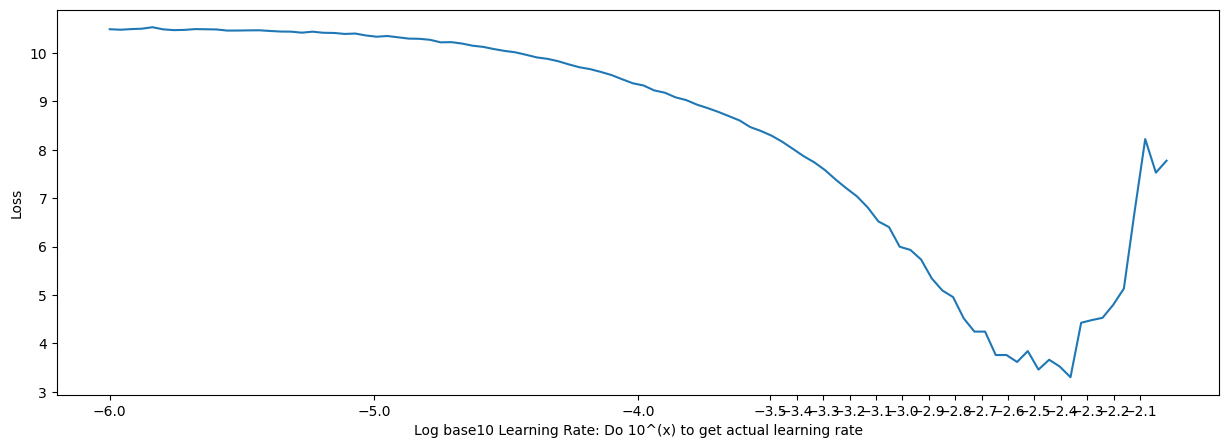

```python
>>>10**jnp.arange(-3.5, -2.0, 0.1), jnp.arange(-3.5, -2.0, 0.1)
(Array([0.00031623, 0.00039811, 0.00050119, 0.00063096, 0.00079433,
        0.001     , 0.00125892, 0.00158489, 0.00199526, 0.00251188,
        0.00316227, 0.00398106, 0.00501186, 0.00630956, 0.00794326],      dtype=float32),
 Array([-3.5      , -3.4      , -3.3000002, -3.2000003, -3.1000004,
        -3.0000005, -2.9000006, -2.8000007, -2.7000008, -2.6000009,
        -2.500001 , -2.400001 , -2.3000011, -2.2000012, -2.1000013],      dtype=float32))
```

# Training Arguments

In [ ]:
@dataclass
class TArgs:
    # lr scheduler
    init_lr:float = 1e-7
    max_lr:float = 5e-4
    min_lr:float = 0.0*max_lr # The factor is usually 0.1 or 0.0
    num_steps:int = 100_000
    warmup_steps:int = 1000
    decay_steps:int = num_steps
    # decay_rate:float = 0.1

    # optimizer
    batch_size:int = 128 # micro-mini-batch_size if num_grad_accumalation_steps > 1

    beta1:float = 0.9
    beta2:float = 0.95
    weight_decay:float = 1e-1
    global_clipnorm:float = 1e0
    num_grad_accumalation_steps:int = 4
    # num_tok_per_update = batch_size * maxlen * gradient_accumalation = 128 * 256 * 4 = 131_072

    # training
    checkpoint_dir:str = "weights/stories32000"
    eval_freq:int = 2000
    eval_steps:int = 100
    patience:int = 15 # early stopping

TArgs()

# Model

In [ ]:
model = Transformer(causal=True, config=GPTConfig, output_activation=None)
model = build_model(model, (2, GPTConfig.maxlen), (0, GPTConfig.vocab_size-1))
model.summary()

# Load data
```python
Dataset:
	Number of stories: 2745331
	Number of tokens in the dataset: 588585210
	Number of unique tokens in the dataset: 14776
	Avg length of story: 214.3949891652409
```

In [ ]:
pretokenize_and_save_dataset(TRAIN_FILE_PATH, VAL_FILE_PATH, num_shards=50)

ds_iterater = partial(
    BatchedDataset.iter_ds,
    batch_size=TArgs.batch_size,
    device="cpu",
    num_workers=0,
    maxlen=GPTConfig.maxlen,
    seed=42
)
train_iterator, val_iterator = (
    ds_iterater(split="train"),
    ds_iterater(split="val")
)

# Lr schedule

In [ ]:
# learning_rate = nn.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=TArgs.max_lr,
#     decay_rate=TArgs.decay_rate,
#     decay_steps=TArgs.num_steps,
# )

learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=TArgs.min_lr,
    decay_steps=TArgs.decay_steps,
    warmup_steps=TArgs.warmup_steps,
    warmup_target=TArgs.max_lr,
    alpha=TArgs.min_lr/TArgs.max_lr
)

In [ ]:
steps = jnp.arange(1, TArgs.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Steps")
plt.show()

# Save and Load model

In [ ]:
def save_object(dir_suffix_ftype:str, obj:Any):
    """
    dir_suffix_ftype: directory suffix and file type separated by "|" 
    obj: Anything which is to be stored
    """
    dir, suffix, ftype = dir_suffix_ftype.split("|"); path = os.path.join(dir, "".join([suffix, f".{ftype}"]))
    os.makedirs(name=dir, exist_ok=True)
    with open(path, "wb") as file:
        pickle.dump(obj=obj, file=file, protocol=pickle.HIGHEST_PROTOCOL)
    return path

In [ ]:
def load_object(path:str):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    return obj

# Training

In [ ]:
optimizer = nn.optimizers.LossScaleOptimizer(
    nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2,
        global_clipnorm=TArgs.global_clipnorm,
        weight_decay=TArgs.weight_decay
    )
)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

@jax.jit
def get_accuracy(y_true:Array, logits:Array): # (B, T, vocab_size), (B, T)
    batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
    accuracy = batched_num_correct.mean()
    return accuracy

@partial(jax.jit, static_argnums=-1)
def compute_loss(trainable_variables:list, non_trainable_variables:list, X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    logits, non_trainable_variables = model.stateless_call(
        trainable_variables,  non_trainable_variables,
        X_batch
    )
    loss = loss_fn(y_batch, logits)
    accuracy = get_accuracy(y_batch, logits)
    unscaled_loss = loss/num_grad_accumalation_steps
    scaled_loss = optimizer.scale_loss(unscaled_loss)
    return scaled_loss, (unscaled_loss, accuracy, non_trainable_variables)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_step(train_state:Sequence[list], X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    trainable_variables, non_trainable_variables = train_state

    (_, aux), grad = grad_fn(
        trainable_variables, non_trainable_variables, X_batch, y_batch,
        num_grad_accumalation_steps
    )
    (unscaled_loss, accuracy, non_trainable_variables) = aux
    return grad, (unscaled_loss, accuracy), (trainable_variables, non_trainable_variables)

@jax.jit
def update_params(grads:list, trainable_variables:list, optimizer_variables:list):
    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables # returns updated trainable_variables
    )
    return trainable_variables, optimizer_variables

def evaluate(train_state:Sequence[list]):
    trainable_variables, non_trainable_variables = train_state
    mean_losses = []; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(TArgs.eval_steps)
        accuracies = jnp.empty_like(losses)

        for eval_step in range(TArgs.eval_steps):
            _, (unscaled_loss, accuracy, non_trainable_variables) = compute_loss(
                trainable_variables, non_trainable_variables,
                jnp.array(X_batch), jnp.array(y_batch), 1
            )
            losses = losses.at[eval_step].set(unscaled_loss)
            accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        mean_accuracies.append(accuracies.mean())
    return mean_losses, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

In [ ]:
def train(return_best_states:bool):
    step = 1; wait = 0
    training_losses = {"train": []}

    trainable_variables = model.trainable_variables; optimizer.build(trainable_variables)
    non_trainable_variables = model.non_trainable_variables
    optimizer_variables = optimizer.variables

    best_step = 1
    best_train_state = (trainable_variables, non_trainable_variables)
    best_val_loss = 1e8

    t0 = time.time()
    print("Training about to start...")
    X_batch, y_batch = next(train_iterator)
    while True:
        # condition to terminate
        if step > TArgs.num_steps or wait > TArgs.patience:
            print(f"Early Stopping at Step {step}." if wait > TArgs.patience else "Training Terminated.")
            break

        # train model
        grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_variables)
        for _ in range(TArgs.num_grad_accumalation_steps):
            grad, (loss, accuracy), (trainable_variables, non_trainable_variables) = mini_step(
                (trainable_variables, non_trainable_variables), 
                jnp.array(X_batch), jnp.array(y_batch),
                TArgs.num_grad_accumalation_steps
            )
            grads = jax.tree_util.tree_map(
                lambda g1, g2: jnp.add(g1, g2), grads, jax.tree_util.tree_map(jnp.asarray, grad)
            ) # sum grads for grad accumation
            X_batch, y_batch = next(train_iterator)
        grad = None # save memory

        loss = loss*TArgs.num_grad_accumalation_steps # loss from last mini-step

        trainable_variables, optimizer_variables = update_params(
            grads, trainable_variables, optimizer_variables
        )
        grads = None # save memory

        if step % TArgs.eval_freq == 0 or step == TArgs.num_steps:
            print("Estimating Losses...")
            mean_losses, mean_accuracies = evaluate((trainable_variables, non_trainable_variables))
            print(
                f"\t| Training Loss: {mean_losses[0]:.4f} || Training Accuracy: {mean_accuracies[0]:.4f} |" 
                f"| Validation Loss: {mean_losses[1]:.4f} || Validation Accuracy: {mean_accuracies[1]:.4f} |"
            )
            
            _ = save_object(
                TArgs.checkpoint_dir+f"|trstate{step}|weights",
                obj=best_train_state
            )
            print(f"Saved weights of step {step}.")

            if mean_losses[1] < best_val_loss:
                best_val_loss = mean_losses[1]
                best_train_state = (trainable_variables, non_trainable_variables)
                best_step = step
                wait = 0
            else:
                wait += 1

        # time
        t1 = time.time()
        dt = t1-t0; t0 = t1

        # print the essentials
        print(
            f"| Step: {step} || Loss: {loss:.4f} || Accuracy: {accuracy:.4f} |"
            f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
        )
        training_losses["train"].append(loss.tolist())
        step += 1
    
    if return_best_states:
        print(f"Best Weights are from Step {best_step}")
        print("With an Estimated Validation Loss of", best_val_loss)
        return best_train_state, training_losses

    return (trainable_variables, non_trainable_variables), training_losses

In [ ]:
best_train_state, losses = train(return_best_states=False)
# clear logs, very long.

```python
Training about to start...
| Step: 1 || Loss: 10.4355 || Accuracy: 0.0000 || LR: 5.000001e-07 || dt: 12347.01ms |
| Step: 2 || Loss: 10.4365 || Accuracy: 0.0000 || LR: 1.000000e-06 || dt: 607.90ms |
| Step: 3 || Loss: 10.4353 || Accuracy: 0.0000 || LR: 1.500000e-06 || dt: 449.99ms |
| Step: 4 || Loss: 10.4359 || Accuracy: 0.0000 || LR: 2.000000e-06 || dt: 505.58ms |
| Step: 5 || Loss: 10.4339 || Accuracy: 0.0000 || LR: 2.500000e-06 || dt: 481.39ms |
| Step: 6 || Loss: 10.4294 || Accuracy: 0.0000 || LR: 3.000000e-06 || dt: 467.53ms |
| Step: 7 || Loss: 10.4237 || Accuracy: 0.0000 || LR: 3.500000e-06 || dt: 459.99ms |
| Step: 8 || Loss: 10.4201 || Accuracy: 0.0000 || LR: 4.000000e-06 || dt: 489.17ms |
| Step: 9 || Loss: 10.4164 || Accuracy: 0.0000 || LR: 4.500001e-06 || dt: 488.03ms |
| Step: 10 || Loss: 10.4070 || Accuracy: 0.0000 || LR: 5.000001e-06 || dt: 488.19ms |
| Step: 11 || Loss: 10.4004 || Accuracy: 0.0000 || LR: 5.500000e-06 || dt: 494.34ms |
| Step: 12 || Loss: 10.3957 || Accuracy: 0.0000 || LR: 6.000000e-06 || dt: 457.90ms |
| Step: 13 || Loss: 10.3860 || Accuracy: 0.0000 || LR: 6.500000e-06 || dt: 438.44ms |
| Step: 14 || Loss: 10.3742 || Accuracy: 0.0000 || LR: 7.000001e-06 || dt: 459.63ms |
| Step: 15 || Loss: 10.3650 || Accuracy: 0.0000 || LR: 7.500001e-06 || dt: 488.56ms |
| Step: 16 || Loss: 10.3555 || Accuracy: 0.0000 || LR: 8.000001e-06 || dt: 486.61ms |
| Step: 17 || Loss: 10.3438 || Accuracy: 0.0000 || LR: 8.500001e-06 || dt: 488.25ms |
| Step: 18 || Loss: 10.3332 || Accuracy: 0.0000 || LR: 9.000001e-06 || dt: 479.11ms |
| Step: 19 || Loss: 10.3216 || Accuracy: 0.0000 || LR: 9.500001e-06 || dt: 459.74ms |
| Step: 20 || Loss: 10.3103 || Accuracy: 0.0000 || LR: 1.000000e-05 || dt: 451.98ms |
| Step: 21 || Loss: 10.2955 || Accuracy: 0.0000 || LR: 1.050000e-05 || dt: 464.47ms |
| Step: 22 || Loss: 10.2789 || Accuracy: 0.0000 || LR: 1.100000e-05 || dt: 466.04ms |
| Step: 23 || Loss: 10.2660 || Accuracy: 0.0000 || LR: 1.150000e-05 || dt: 482.91ms |
| Step: 24 || Loss: 10.2451 || Accuracy: 0.0000 || LR: 1.200000e-05 || dt: 483.57ms |
| Step: 25 || Loss: 10.2307 || Accuracy: 0.0000 || LR: 1.250000e-05 || dt: 478.69ms |
| Step: 26 || Loss: 10.2148 || Accuracy: 0.0001 || LR: 1.300000e-05 || dt: 477.79ms |
| Step: 27 || Loss: 10.1975 || Accuracy: 0.0005 || LR: 1.350000e-05 || dt: 488.94ms |
| Step: 28 || Loss: 10.1754 || Accuracy: 0.0020 || LR: 1.400000e-05 || dt: 499.49ms |
| Step: 29 || Loss: 10.1571 || Accuracy: 0.0038 || LR: 1.450000e-05 || dt: 515.77ms |
| Step: 30 || Loss: 10.1405 || Accuracy: 0.0070 || LR: 1.500000e-05 || dt: 514.00ms |
| Step: 31 || Loss: 10.1201 || Accuracy: 0.0131 || LR: 1.550000e-05 || dt: 515.06ms |
| Step: 32 || Loss: 10.1002 || Accuracy: 0.0213 || LR: 1.600000e-05 || dt: 498.33ms |
| Step: 33 || Loss: 10.0836 || Accuracy: 0.0306 || LR: 1.650000e-05 || dt: 492.57ms |
| Step: 34 || Loss: 10.0677 || Accuracy: 0.0341 || LR: 1.700000e-05 || dt: 504.92ms |
| Step: 35 || Loss: 10.0498 || Accuracy: 0.0423 || LR: 1.750000e-05 || dt: 508.21ms |
| Step: 36 || Loss: 10.0199 || Accuracy: 0.0505 || LR: 1.800000e-05 || dt: 478.40ms |
| Step: 37 || Loss: 10.0117 || Accuracy: 0.0529 || LR: 1.850000e-05 || dt: 517.96ms |
| Step: 38 || Loss: 9.9900 || Accuracy: 0.0582 || LR: 1.900000e-05 || dt: 673.62ms |
| Step: 39 || Loss: 9.9586 || Accuracy: 0.0622 || LR: 1.950000e-05 || dt: 516.54ms |
| Step: 40 || Loss: 9.9481 || Accuracy: 0.0643 || LR: 2.000000e-05 || dt: 523.72ms |
| Step: 41 || Loss: 9.9296 || Accuracy: 0.0659 || LR: 2.050000e-05 || dt: 519.91ms |
| Step: 42 || Loss: 9.9039 || Accuracy: 0.0676 || LR: 2.100000e-05 || dt: 525.68ms |
| Step: 43 || Loss: 9.8907 || Accuracy: 0.0708 || LR: 2.150000e-05 || dt: 508.27ms |
| Step: 44 || Loss: 9.8726 || Accuracy: 0.0722 || LR: 2.200000e-05 || dt: 517.55ms |
| Step: 45 || Loss: 9.8569 || Accuracy: 0.0707 || LR: 2.250000e-05 || dt: 500.22ms |
| Step: 46 || Loss: 9.8229 || Accuracy: 0.0726 || LR: 2.300000e-05 || dt: 499.84ms |
| Step: 47 || Loss: 9.8248 || Accuracy: 0.0710 || LR: 2.350000e-05 || dt: 478.49ms |
| Step: 48 || Loss: 9.7987 || Accuracy: 0.0708 || LR: 2.400000e-05 || dt: 492.64ms |
| Step: 49 || Loss: 9.7845 || Accuracy: 0.0692 || LR: 2.450000e-05 || dt: 518.92ms |
| Step: 50 || Loss: 9.7578 || Accuracy: 0.0697 || LR: 2.500000e-05 || dt: 518.44ms |
| Step: 51 || Loss: 9.7423 || Accuracy: 0.0710 || LR: 2.550000e-05 || dt: 506.80ms |
| Step: 52 || Loss: 9.7340 || Accuracy: 0.0709 || LR: 2.600000e-05 || dt: 519.12ms |
| Step: 53 || Loss: 9.7150 || Accuracy: 0.0691 || LR: 2.650000e-05 || dt: 524.32ms |
| Step: 54 || Loss: 9.6888 || Accuracy: 0.0717 || LR: 2.700000e-05 || dt: 519.30ms |
| Step: 55 || Loss: 9.6783 || Accuracy: 0.0711 || LR: 2.750000e-05 || dt: 488.52ms |
| Step: 56 || Loss: 9.6579 || Accuracy: 0.0726 || LR: 2.800000e-05 || dt: 508.26ms |
| Step: 57 || Loss: 9.6389 || Accuracy: 0.0762 || LR: 2.850000e-05 || dt: 509.83ms |
| Step: 58 || Loss: 9.6201 || Accuracy: 0.0722 || LR: 2.900000e-05 || dt: 514.10ms |
| Step: 59 || Loss: 9.6146 || Accuracy: 0.0713 || LR: 2.950000e-05 || dt: 515.04ms |
| Step: 60 || Loss: 9.5909 || Accuracy: 0.0709 || LR: 3.000000e-05 || dt: 503.23ms |
| Step: 61 || Loss: 9.5759 || Accuracy: 0.0724 || LR: 3.050000e-05 || dt: 516.64ms |
| Step: 62 || Loss: 9.5551 || Accuracy: 0.0727 || LR: 3.100000e-05 || dt: 506.76ms |
| Step: 63 || Loss: 9.5452 || Accuracy: 0.0714 || LR: 3.150000e-05 || dt: 513.23ms |
| Step: 64 || Loss: 9.5299 || Accuracy: 0.0710 || LR: 3.200000e-05 || dt: 500.60ms |
| Step: 65 || Loss: 9.5149 || Accuracy: 0.0707 || LR: 3.250000e-05 || dt: 513.66ms |
| Step: 66 || Loss: 9.4975 || Accuracy: 0.0712 || LR: 3.300000e-05 || dt: 510.33ms |
| Step: 67 || Loss: 9.4758 || Accuracy: 0.0707 || LR: 3.350000e-05 || dt: 520.53ms |
| Step: 68 || Loss: 9.4540 || Accuracy: 0.0727 || LR: 3.400000e-05 || dt: 519.13ms |
| Step: 69 || Loss: 9.4332 || Accuracy: 0.0732 || LR: 3.450000e-05 || dt: 488.65ms |
| Step: 70 || Loss: 9.4324 || Accuracy: 0.0686 || LR: 3.500000e-05 || dt: 508.82ms |
| Step: 71 || Loss: 9.4032 || Accuracy: 0.0751 || LR: 3.550000e-05 || dt: 516.93ms |
| Step: 72 || Loss: 9.3862 || Accuracy: 0.0742 || LR: 3.600000e-05 || dt: 513.06ms |
| Step: 73 || Loss: 9.3785 || Accuracy: 0.0720 || LR: 3.650001e-05 || dt: 516.34ms |
| Step: 74 || Loss: 9.3541 || Accuracy: 0.0735 || LR: 3.700000e-05 || dt: 479.86ms |
| Step: 75 || Loss: 9.3370 || Accuracy: 0.0719 || LR: 3.750000e-05 || dt: 510.97ms |
| Step: 76 || Loss: 9.3116 || Accuracy: 0.0743 || LR: 3.800001e-05 || dt: 518.44ms |
| Step: 77 || Loss: 9.3049 || Accuracy: 0.0703 || LR: 3.850001e-05 || dt: 516.00ms |
| Step: 78 || Loss: 9.2840 || Accuracy: 0.0707 || LR: 3.900000e-05 || dt: 513.34ms |
| Step: 79 || Loss: 9.2702 || Accuracy: 0.0713 || LR: 3.950000e-05 || dt: 511.64ms |
| Step: 80 || Loss: 9.2466 || Accuracy: 0.0692 || LR: 4.000001e-05 || dt: 489.80ms |
| Step: 81 || Loss: 9.2321 || Accuracy: 0.0725 || LR: 4.050000e-05 || dt: 518.21ms |
| Step: 82 || Loss: 9.2144 || Accuracy: 0.0710 || LR: 4.100000e-05 || dt: 527.36ms |
| Step: 83 || Loss: 9.1831 || Accuracy: 0.0728 || LR: 4.150000e-05 || dt: 518.65ms |
| Step: 84 || Loss: 9.1702 || Accuracy: 0.0711 || LR: 4.200001e-05 || dt: 516.49ms |
| Step: 85 || Loss: 9.1502 || Accuracy: 0.0729 || LR: 4.250000e-05 || dt: 490.79ms |
| Step: 86 || Loss: 9.1276 || Accuracy: 0.0726 || LR: 4.300000e-05 || dt: 506.94ms |
| Step: 87 || Loss: 9.1222 || Accuracy: 0.0701 || LR: 4.350000e-05 || dt: 514.81ms |
| Step: 88 || Loss: 9.0774 || Accuracy: 0.0734 || LR: 4.400000e-05 || dt: 502.92ms |
| Step: 89 || Loss: 9.0670 || Accuracy: 0.0728 || LR: 4.450000e-05 || dt: 512.91ms |
| Step: 90 || Loss: 9.0556 || Accuracy: 0.0702 || LR: 4.500000e-05 || dt: 549.33ms |
| Step: 91 || Loss: 9.0302 || Accuracy: 0.0712 || LR: 4.550000e-05 || dt: 533.49ms |
| Step: 92 || Loss: 9.0265 || Accuracy: 0.0692 || LR: 4.600000e-05 || dt: 502.86ms |
| Step: 93 || Loss: 9.0006 || Accuracy: 0.0706 || LR: 4.650000e-05 || dt: 511.78ms |
| Step: 94 || Loss: 8.9571 || Accuracy: 0.0725 || LR: 4.700000e-05 || dt: 519.18ms |
| Step: 95 || Loss: 8.9530 || Accuracy: 0.0724 || LR: 4.750001e-05 || dt: 512.92ms |
| Step: 96 || Loss: 8.9247 || Accuracy: 0.0734 || LR: 4.800000e-05 || dt: 519.71ms |
| Step: 97 || Loss: 8.8929 || Accuracy: 0.0733 || LR: 4.850001e-05 || dt: 517.48ms |
| Step: 98 || Loss: 8.8869 || Accuracy: 0.0725 || LR: 4.900001e-05 || dt: 517.97ms |
| Step: 99 || Loss: 8.8527 || Accuracy: 0.0711 || LR: 4.950001e-05 || dt: 490.67ms |
| Step: 100 || Loss: 8.8437 || Accuracy: 0.0727 || LR: 5.000000e-05 || dt: 501.56ms |
| Step: 101 || Loss: 8.8155 || Accuracy: 0.0729 || LR: 5.050000e-05 || dt: 485.26ms |
| Step: 102 || Loss: 8.7954 || Accuracy: 0.0703 || LR: 5.100001e-05 || dt: 513.59ms |
| Step: 103 || Loss: 8.7713 || Accuracy: 0.0719 || LR: 5.150001e-05 || dt: 502.41ms |
| Step: 104 || Loss: 8.7439 || Accuracy: 0.0724 || LR: 5.200000e-05 || dt: 511.77ms |
| Step: 105 || Loss: 8.7193 || Accuracy: 0.0725 || LR: 5.250000e-05 || dt: 518.30ms |
| Step: 106 || Loss: 8.7107 || Accuracy: 0.0689 || LR: 5.300001e-05 || dt: 516.08ms |
| Step: 107 || Loss: 8.6801 || Accuracy: 0.0725 || LR: 5.350001e-05 || dt: 503.58ms |
| Step: 108 || Loss: 8.6520 || Accuracy: 0.0701 || LR: 5.400000e-05 || dt: 512.30ms |
| Step: 109 || Loss: 8.6290 || Accuracy: 0.0733 || LR: 5.450000e-05 || dt: 518.40ms |
| Step: 110 || Loss: 8.6020 || Accuracy: 0.0720 || LR: 5.500001e-05 || dt: 516.19ms |
| Step: 111 || Loss: 8.5755 || Accuracy: 0.0741 || LR: 5.550001e-05 || dt: 515.75ms |
| Step: 112 || Loss: 8.5643 || Accuracy: 0.0700 || LR: 5.600000e-05 || dt: 515.50ms |
| Step: 113 || Loss: 8.5199 || Accuracy: 0.0746 || LR: 5.650000e-05 || dt: 502.09ms |
| Step: 114 || Loss: 8.5153 || Accuracy: 0.0725 || LR: 5.700000e-05 || dt: 516.02ms |
| Step: 115 || Loss: 8.4780 || Accuracy: 0.0712 || LR: 5.750000e-05 || dt: 512.84ms |
| Step: 116 || Loss: 8.4618 || Accuracy: 0.0720 || LR: 5.800001e-05 || dt: 514.23ms |
| Step: 117 || Loss: 8.4335 || Accuracy: 0.0720 || LR: 5.850001e-05 || dt: 517.04ms |
| Step: 118 || Loss: 8.4125 || Accuracy: 0.0717 || LR: 5.900001e-05 || dt: 516.50ms |
| Step: 119 || Loss: 8.3744 || Accuracy: 0.0712 || LR: 5.950001e-05 || dt: 513.05ms |
| Step: 120 || Loss: 8.3495 || Accuracy: 0.0722 || LR: 6.000001e-05 || dt: 514.27ms |
| Step: 121 || Loss: 8.3340 || Accuracy: 0.0724 || LR: 6.050001e-05 || dt: 514.06ms |
| Step: 122 || Loss: 8.3179 || Accuracy: 0.0689 || LR: 6.100001e-05 || dt: 511.98ms |
| Step: 123 || Loss: 8.2784 || Accuracy: 0.0732 || LR: 6.150000e-05 || dt: 515.62ms |
| Step: 124 || Loss: 8.2533 || Accuracy: 0.0701 || LR: 6.200001e-05 || dt: 498.35ms |
| Step: 125 || Loss: 8.2317 || Accuracy: 0.0702 || LR: 6.250000e-05 || dt: 512.13ms |
| Step: 126 || Loss: 8.2093 || Accuracy: 0.0689 || LR: 6.300001e-05 || dt: 514.88ms |
| Step: 127 || Loss: 8.1871 || Accuracy: 0.0738 || LR: 6.350000e-05 || dt: 516.10ms |
| Step: 128 || Loss: 8.1603 || Accuracy: 0.0726 || LR: 6.400001e-05 || dt: 494.88ms |
| Step: 129 || Loss: 8.1248 || Accuracy: 0.0719 || LR: 6.450000e-05 || dt: 512.97ms |
| Step: 130 || Loss: 8.1006 || Accuracy: 0.0727 || LR: 6.500001e-05 || dt: 504.28ms |
| Step: 131 || Loss: 8.0685 || Accuracy: 0.0727 || LR: 6.550001e-05 || dt: 488.75ms |
| Step: 132 || Loss: 8.0433 || Accuracy: 0.0738 || LR: 6.600000e-05 || dt: 500.49ms |
| Step: 133 || Loss: 8.0203 || Accuracy: 0.0714 || LR: 6.650000e-05 || dt: 516.30ms |
| Step: 134 || Loss: 7.9948 || Accuracy: 0.0717 || LR: 6.700001e-05 || dt: 519.78ms |
| Step: 135 || Loss: 7.9668 || Accuracy: 0.0717 || LR: 6.750000e-05 || dt: 516.49ms |
| Step: 136 || Loss: 7.9313 || Accuracy: 0.0725 || LR: 6.800001e-05 || dt: 514.59ms |
| Step: 137 || Loss: 7.9334 || Accuracy: 0.0703 || LR: 6.850000e-05 || dt: 499.45ms |
| Step: 138 || Loss: 7.8887 || Accuracy: 0.0703 || LR: 6.900001e-05 || dt: 510.69ms |
| Step: 139 || Loss: 7.8714 || Accuracy: 0.0721 || LR: 6.950001e-05 || dt: 517.46ms |
| Step: 140 || Loss: 7.8393 || Accuracy: 0.0721 || LR: 7.000000e-05 || dt: 502.25ms |
| Step: 141 || Loss: 7.8114 || Accuracy: 0.0699 || LR: 7.050001e-05 || dt: 506.54ms |
| Step: 142 || Loss: 7.7825 || Accuracy: 0.0712 || LR: 7.100000e-05 || dt: 515.59ms |
| Step: 143 || Loss: 7.7711 || Accuracy: 0.0700 || LR: 7.150001e-05 || dt: 496.37ms |
| Step: 144 || Loss: 7.7353 || Accuracy: 0.0722 || LR: 7.200001e-05 || dt: 494.33ms |
| Step: 145 || Loss: 7.7040 || Accuracy: 0.0707 || LR: 7.250001e-05 || dt: 514.37ms |
| Step: 146 || Loss: 7.6766 || Accuracy: 0.0721 || LR: 7.300001e-05 || dt: 504.09ms |
| Step: 147 || Loss: 7.6495 || Accuracy: 0.0733 || LR: 7.350001e-05 || dt: 504.23ms |
| Step: 148 || Loss: 7.6307 || Accuracy: 0.0703 || LR: 7.400000e-05 || dt: 511.37ms |
| Step: 149 || Loss: 7.5754 || Accuracy: 0.0728 || LR: 7.450001e-05 || dt: 518.45ms |
| Step: 150 || Loss: 7.5818 || Accuracy: 0.0724 || LR: 7.500000e-05 || dt: 522.14ms |
| Step: 151 || Loss: 7.5253 || Accuracy: 0.0714 || LR: 7.550001e-05 || dt: 517.98ms |
| Step: 152 || Loss: 7.5363 || Accuracy: 0.0688 || LR: 7.600001e-05 || dt: 515.99ms |
| Step: 153 || Loss: 7.4934 || Accuracy: 0.0728 || LR: 7.650001e-05 || dt: 504.26ms |
| Step: 154 || Loss: 7.4630 || Accuracy: 0.0727 || LR: 7.700001e-05 || dt: 519.56ms |
| Step: 155 || Loss: 7.4457 || Accuracy: 0.0720 || LR: 7.750000e-05 || dt: 507.15ms |
| Step: 156 || Loss: 7.4086 || Accuracy: 0.0715 || LR: 7.800000e-05 || dt: 511.27ms |
| Step: 157 || Loss: 7.3789 || Accuracy: 0.0717 || LR: 7.850001e-05 || dt: 515.54ms |
| Step: 158 || Loss: 7.3628 || Accuracy: 0.0720 || LR: 7.900000e-05 || dt: 500.98ms |
| Step: 159 || Loss: 7.3380 || Accuracy: 0.0704 || LR: 7.950001e-05 || dt: 513.39ms |
| Step: 160 || Loss: 7.3198 || Accuracy: 0.0726 || LR: 8.000001e-05 || dt: 520.68ms |
| Step: 161 || Loss: 7.2809 || Accuracy: 0.0729 || LR: 8.050001e-05 || dt: 515.90ms |
| Step: 162 || Loss: 7.2423 || Accuracy: 0.0702 || LR: 8.100001e-05 || dt: 516.86ms |
| Step: 163 || Loss: 7.2270 || Accuracy: 0.0706 || LR: 8.150000e-05 || dt: 499.04ms |
| Step: 164 || Loss: 7.2030 || Accuracy: 0.0690 || LR: 8.200001e-05 || dt: 502.01ms |
| Step: 165 || Loss: 7.1803 || Accuracy: 0.0711 || LR: 8.250001e-05 || dt: 514.98ms |
| Step: 166 || Loss: 7.1646 || Accuracy: 0.0714 || LR: 8.300001e-05 || dt: 525.91ms |
| Step: 167 || Loss: 7.1351 || Accuracy: 0.0715 || LR: 8.350001e-05 || dt: 507.09ms |
| Step: 168 || Loss: 7.1053 || Accuracy: 0.0712 || LR: 8.400001e-05 || dt: 508.18ms |
| Step: 169 || Loss: 7.0948 || Accuracy: 0.0698 || LR: 8.450001e-05 || dt: 518.04ms |
| Step: 170 || Loss: 7.0530 || Accuracy: 0.0713 || LR: 8.500001e-05 || dt: 513.69ms |
| Step: 171 || Loss: 7.0209 || Accuracy: 0.0723 || LR: 8.550000e-05 || dt: 520.10ms |
| Step: 172 || Loss: 7.0092 || Accuracy: 0.0723 || LR: 8.600001e-05 || dt: 514.69ms |
| Step: 173 || Loss: 6.9738 || Accuracy: 0.0713 || LR: 8.650001e-05 || dt: 513.89ms |
| Step: 174 || Loss: 6.9781 || Accuracy: 0.0694 || LR: 8.700001e-05 || dt: 503.52ms |
| Step: 175 || Loss: 6.9303 || Accuracy: 0.0695 || LR: 8.750001e-05 || dt: 515.27ms |
| Step: 176 || Loss: 6.8969 || Accuracy: 0.0725 || LR: 8.800001e-05 || dt: 518.10ms |
| Step: 177 || Loss: 6.9037 || Accuracy: 0.0699 || LR: 8.850000e-05 || dt: 501.72ms |
| Step: 178 || Loss: 6.8464 || Accuracy: 0.0693 || LR: 8.900001e-05 || dt: 514.77ms |
| Step: 179 || Loss: 6.8290 || Accuracy: 0.0721 || LR: 8.950000e-05 || dt: 503.38ms |
| Step: 180 || Loss: 6.8066 || Accuracy: 0.0719 || LR: 9.000001e-05 || dt: 557.01ms |
| Step: 181 || Loss: 6.8005 || Accuracy: 0.0711 || LR: 9.050001e-05 || dt: 511.57ms |
| Step: 182 || Loss: 6.7697 || Accuracy: 0.0721 || LR: 9.100001e-05 || dt: 507.68ms |
| Step: 183 || Loss: 6.7493 || Accuracy: 0.0726 || LR: 9.150001e-05 || dt: 518.84ms |
| Step: 184 || Loss: 6.7130 || Accuracy: 0.0736 || LR: 9.200001e-05 || dt: 512.17ms |
| Step: 185 || Loss: 6.7228 || Accuracy: 0.0705 || LR: 9.250001e-05 || dt: 500.67ms |
| Step: 186 || Loss: 6.6978 || Accuracy: 0.0734 || LR: 9.300001e-05 || dt: 517.98ms |
| Step: 187 || Loss: 6.6834 || Accuracy: 0.0716 || LR: 9.350001e-05 || dt: 516.10ms |
| Step: 188 || Loss: 6.6330 || Accuracy: 0.0706 || LR: 9.400001e-05 || dt: 490.93ms |
| Step: 189 || Loss: 6.5956 || Accuracy: 0.0727 || LR: 9.450001e-05 || dt: 517.39ms |
| Step: 190 || Loss: 6.5931 || Accuracy: 0.0720 || LR: 9.500001e-05 || dt: 503.95ms |
| Step: 191 || Loss: 6.5665 || Accuracy: 0.0719 || LR: 9.550001e-05 || dt: 505.34ms |
| Step: 192 || Loss: 6.5540 || Accuracy: 0.0721 || LR: 9.600000e-05 || dt: 503.37ms |
| Step: 193 || Loss: 6.5563 || Accuracy: 0.0718 || LR: 9.650001e-05 || dt: 518.37ms |
| Step: 194 || Loss: 6.5131 || Accuracy: 0.0702 || LR: 9.700001e-05 || dt: 514.66ms |
| Step: 195 || Loss: 6.5512 || Accuracy: 0.0698 || LR: 9.750001e-05 || dt: 517.43ms |
| Step: 196 || Loss: 6.4998 || Accuracy: 0.0709 || LR: 9.800001e-05 || dt: 515.39ms |
| Step: 197 || Loss: 6.5014 || Accuracy: 0.0715 || LR: 9.850001e-05 || dt: 501.40ms |
| Step: 198 || Loss: 6.4632 || Accuracy: 0.0742 || LR: 9.900001e-05 || dt: 518.74ms |
| Step: 199 || Loss: 6.4438 || Accuracy: 0.0717 || LR: 9.950002e-05 || dt: 514.07ms |
| Step: 200 || Loss: 6.4134 || Accuracy: 0.0737 || LR: 1.000000e-04 || dt: 518.55ms |
| Step: 201 || Loss: 6.4239 || Accuracy: 0.0714 || LR: 1.005000e-04 || dt: 514.82ms |
| Step: 202 || Loss: 6.3784 || Accuracy: 0.0705 || LR: 1.010000e-04 || dt: 516.47ms |
| Step: 203 || Loss: 6.3897 || Accuracy: 0.0714 || LR: 1.015000e-04 || dt: 517.93ms |
| Step: 204 || Loss: 6.3746 || Accuracy: 0.0725 || LR: 1.020000e-04 || dt: 513.39ms |
| Step: 205 || Loss: 6.3306 || Accuracy: 0.0745 || LR: 1.025000e-04 || dt: 504.92ms |
| Step: 206 || Loss: 6.3327 || Accuracy: 0.0709 || LR: 1.030000e-04 || dt: 502.43ms |
| Step: 207 || Loss: 6.3363 || Accuracy: 0.0714 || LR: 1.035000e-04 || dt: 524.55ms |
| Step: 208 || Loss: 6.2658 || Accuracy: 0.0728 || LR: 1.040000e-04 || dt: 519.38ms |
| Step: 209 || Loss: 6.2863 || Accuracy: 0.0703 || LR: 1.045000e-04 || dt: 525.78ms |
| Step: 210 || Loss: 6.2558 || Accuracy: 0.0709 || LR: 1.050000e-04 || dt: 524.49ms |
| Step: 211 || Loss: 6.2904 || Accuracy: 0.0736 || LR: 1.055000e-04 || dt: 515.44ms |
| Step: 212 || Loss: 6.2802 || Accuracy: 0.0719 || LR: 1.060000e-04 || dt: 489.74ms |
| Step: 213 || Loss: 6.2303 || Accuracy: 0.0722 || LR: 1.065000e-04 || dt: 516.91ms |
| Step: 214 || Loss: 6.2242 || Accuracy: 0.0714 || LR: 1.070000e-04 || dt: 512.38ms |
| Step: 215 || Loss: 6.2387 || Accuracy: 0.0711 || LR: 1.075000e-04 || dt: 517.88ms |
| Step: 216 || Loss: 6.2109 || Accuracy: 0.0727 || LR: 1.080000e-04 || dt: 514.97ms |
| Step: 217 || Loss: 6.2001 || Accuracy: 0.0718 || LR: 1.085000e-04 || dt: 516.73ms |
| Step: 218 || Loss: 6.2075 || Accuracy: 0.0687 || LR: 1.090000e-04 || dt: 516.21ms |
| Step: 219 || Loss: 6.1565 || Accuracy: 0.0736 || LR: 1.095000e-04 || dt: 511.26ms |
| Step: 220 || Loss: 6.1634 || Accuracy: 0.0716 || LR: 1.100000e-04 || dt: 508.36ms |
| Step: 221 || Loss: 6.1669 || Accuracy: 0.0718 || LR: 1.105000e-04 || dt: 510.78ms |
| Step: 222 || Loss: 6.1678 || Accuracy: 0.0693 || LR: 1.110000e-04 || dt: 503.54ms |
| Step: 223 || Loss: 6.1221 || Accuracy: 0.0724 || LR: 1.115000e-04 || dt: 499.56ms |
| Step: 224 || Loss: 6.1367 || Accuracy: 0.0720 || LR: 1.120000e-04 || dt: 516.08ms |
| Step: 225 || Loss: 6.1319 || Accuracy: 0.0704 || LR: 1.125000e-04 || dt: 510.83ms |
| Step: 226 || Loss: 6.0898 || Accuracy: 0.0720 || LR: 1.130000e-04 || dt: 500.26ms |
| Step: 227 || Loss: 6.0789 || Accuracy: 0.0728 || LR: 1.135000e-04 || dt: 512.65ms |
| Step: 228 || Loss: 6.1060 || Accuracy: 0.0724 || LR: 1.140000e-04 || dt: 515.98ms |
| Step: 229 || Loss: 6.0864 || Accuracy: 0.0696 || LR: 1.145000e-04 || dt: 512.82ms |
| Step: 230 || Loss: 6.1061 || Accuracy: 0.0710 || LR: 1.150000e-04 || dt: 514.31ms |
| Step: 231 || Loss: 6.0595 || Accuracy: 0.0714 || LR: 1.155000e-04 || dt: 520.10ms |
| Step: 232 || Loss: 6.0671 || Accuracy: 0.0715 || LR: 1.160000e-04 || dt: 513.80ms |
| Step: 233 || Loss: 6.0599 || Accuracy: 0.0737 || LR: 1.165000e-04 || dt: 518.39ms |
| Step: 234 || Loss: 6.0590 || Accuracy: 0.0713 || LR: 1.170000e-04 || dt: 516.37ms |
| Step: 235 || Loss: 6.0643 || Accuracy: 0.0715 || LR: 1.175000e-04 || dt: 516.51ms |
| Step: 236 || Loss: 6.0375 || Accuracy: 0.0720 || LR: 1.180000e-04 || dt: 502.95ms |
| Step: 237 || Loss: 6.0437 || Accuracy: 0.0700 || LR: 1.185000e-04 || dt: 512.08ms |
| Step: 238 || Loss: 6.0244 || Accuracy: 0.0696 || LR: 1.190000e-04 || dt: 512.73ms |
| Step: 239 || Loss: 6.0388 || Accuracy: 0.0717 || LR: 1.195000e-04 || dt: 515.04ms |
| Step: 240 || Loss: 6.0065 || Accuracy: 0.0735 || LR: 1.200000e-04 || dt: 517.35ms |
| Step: 241 || Loss: 6.0314 || Accuracy: 0.0730 || LR: 1.205000e-04 || dt: 517.21ms |
| Step: 242 || Loss: 6.0055 || Accuracy: 0.0732 || LR: 1.210000e-04 || dt: 509.85ms |
| Step: 243 || Loss: 6.0521 || Accuracy: 0.0723 || LR: 1.215000e-04 || dt: 514.39ms |
| Step: 244 || Loss: 6.0320 || Accuracy: 0.0691 || LR: 1.220000e-04 || dt: 514.07ms |
| Step: 245 || Loss: 6.0495 || Accuracy: 0.0713 || LR: 1.225000e-04 || dt: 503.43ms |
| Step: 246 || Loss: 6.0205 || Accuracy: 0.0714 || LR: 1.230000e-04 || dt: 510.17ms |
| Step: 247 || Loss: 6.0366 || Accuracy: 0.0706 || LR: 1.235000e-04 || dt: 486.58ms |
| Step: 248 || Loss: 6.0205 || Accuracy: 0.0707 || LR: 1.240000e-04 || dt: 514.32ms |
| Step: 249 || Loss: 5.9653 || Accuracy: 0.0721 || LR: 1.245000e-04 || dt: 512.65ms |
| Step: 250 || Loss: 6.0063 || Accuracy: 0.0710 || LR: 1.250000e-04 || dt: 505.12ms |
| Step: 251 || Loss: 5.9764 || Accuracy: 0.0719 || LR: 1.255000e-04 || dt: 515.07ms |
| Step: 252 || Loss: 6.0198 || Accuracy: 0.0724 || LR: 1.260000e-04 || dt: 500.63ms |
| Step: 253 || Loss: 5.9864 || Accuracy: 0.0715 || LR: 1.265000e-04 || dt: 515.40ms |
| Step: 254 || Loss: 6.0228 || Accuracy: 0.0704 || LR: 1.270000e-04 || dt: 516.13ms |
| Step: 255 || Loss: 6.0128 || Accuracy: 0.0708 || LR: 1.275000e-04 || dt: 511.19ms |
| Step: 256 || Loss: 5.9759 || Accuracy: 0.0706 || LR: 1.280000e-04 || dt: 497.41ms |
| Step: 257 || Loss: 6.0007 || Accuracy: 0.0741 || LR: 1.285000e-04 || dt: 514.21ms |
| Step: 258 || Loss: 5.9805 || Accuracy: 0.0724 || LR: 1.290000e-04 || dt: 500.55ms |
| Step: 259 || Loss: 5.9751 || Accuracy: 0.0723 || LR: 1.295000e-04 || dt: 500.77ms |
| Step: 260 || Loss: 5.9730 || Accuracy: 0.0733 || LR: 1.300000e-04 || dt: 501.00ms |
| Step: 261 || Loss: 5.9569 || Accuracy: 0.0700 || LR: 1.305000e-04 || dt: 512.48ms |
| Step: 262 || Loss: 6.0130 || Accuracy: 0.0733 || LR: 1.310000e-04 || dt: 509.41ms |
| Step: 263 || Loss: 6.0112 || Accuracy: 0.0701 || LR: 1.315000e-04 || dt: 510.84ms |
| Step: 264 || Loss: 6.0391 || Accuracy: 0.0699 || LR: 1.320000e-04 || dt: 505.48ms |
| Step: 265 || Loss: 5.9744 || Accuracy: 0.0728 || LR: 1.325000e-04 || dt: 511.35ms |
| Step: 266 || Loss: 5.9885 || Accuracy: 0.0749 || LR: 1.330000e-04 || dt: 508.02ms |
| Step: 267 || Loss: 6.0108 || Accuracy: 0.0701 || LR: 1.335000e-04 || dt: 510.70ms |
| Step: 268 || Loss: 5.9983 || Accuracy: 0.0707 || LR: 1.340000e-04 || dt: 506.35ms |
| Step: 269 || Loss: 5.9744 || Accuracy: 0.0693 || LR: 1.345000e-04 || dt: 483.02ms |
| Step: 270 || Loss: 5.9881 || Accuracy: 0.0732 || LR: 1.350000e-04 || dt: 551.49ms |
| Step: 271 || Loss: 5.9788 || Accuracy: 0.0723 || LR: 1.355000e-04 || dt: 513.89ms |
| Step: 272 || Loss: 5.9511 || Accuracy: 0.0725 || LR: 1.360000e-04 || dt: 497.48ms |
| Step: 273 || Loss: 5.9641 || Accuracy: 0.0723 || LR: 1.365000e-04 || dt: 508.38ms |
| Step: 274 || Loss: 5.9724 || Accuracy: 0.0716 || LR: 1.370000e-04 || dt: 501.52ms |
| Step: 275 || Loss: 5.9765 || Accuracy: 0.0709 || LR: 1.375000e-04 || dt: 505.71ms |
| Step: 276 || Loss: 5.9909 || Accuracy: 0.0707 || LR: 1.380000e-04 || dt: 502.62ms |
| Step: 277 || Loss: 5.9846 || Accuracy: 0.0709 || LR: 1.385000e-04 || dt: 506.85ms |
| Step: 278 || Loss: 5.9752 || Accuracy: 0.0719 || LR: 1.390000e-04 || dt: 493.55ms |
| Step: 279 || Loss: 5.9548 || Accuracy: 0.0708 || LR: 1.395000e-04 || dt: 501.78ms |
| Step: 280 || Loss: 5.9746 || Accuracy: 0.0709 || LR: 1.400000e-04 || dt: 504.14ms |
| Step: 281 || Loss: 5.9832 || Accuracy: 0.0747 || LR: 1.405000e-04 || dt: 506.17ms |
| Step: 282 || Loss: 5.9782 || Accuracy: 0.0710 || LR: 1.410000e-04 || dt: 504.29ms |
| Step: 283 || Loss: 5.9917 || Accuracy: 0.0698 || LR: 1.415000e-04 || dt: 500.82ms |
| Step: 284 || Loss: 5.9578 || Accuracy: 0.0701 || LR: 1.420000e-04 || dt: 499.35ms |
| Step: 285 || Loss: 5.9610 || Accuracy: 0.0701 || LR: 1.425000e-04 || dt: 500.18ms |
| Step: 286 || Loss: 5.9843 || Accuracy: 0.0719 || LR: 1.430000e-04 || dt: 500.95ms |
| Step: 287 || Loss: 5.9704 || Accuracy: 0.0706 || LR: 1.435000e-04 || dt: 495.99ms |
| Step: 288 || Loss: 5.9665 || Accuracy: 0.0727 || LR: 1.440000e-04 || dt: 493.05ms |
| Step: 289 || Loss: 5.9781 || Accuracy: 0.0702 || LR: 1.445000e-04 || dt: 495.94ms |
| Step: 290 || Loss: 5.9925 || Accuracy: 0.0726 || LR: 1.450000e-04 || dt: 497.61ms |
| Step: 291 || Loss: 5.9649 || Accuracy: 0.0735 || LR: 1.455000e-04 || dt: 493.45ms |
| Step: 292 || Loss: 5.9830 || Accuracy: 0.0717 || LR: 1.460000e-04 || dt: 493.74ms |
| Step: 293 || Loss: 5.9457 || Accuracy: 0.0715 || LR: 1.465000e-04 || dt: 494.07ms |
| Step: 294 || Loss: 15.2560 || Accuracy: 0.0144 || LR: 1.470000e-04 || dt: 476.56ms |
| Step: 295 || Loss: 5.9612 || Accuracy: 0.0716 || LR: 1.475000e-04 || dt: 491.15ms |
| Step: 296 || Loss: 5.9556 || Accuracy: 0.0721 || LR: 1.480000e-04 || dt: 495.21ms |
| Step: 297 || Loss: 5.9444 || Accuracy: 0.0703 || LR: 1.485000e-04 || dt: 491.99ms |
| Step: 298 || Loss: 5.9399 || Accuracy: 0.0733 || LR: 1.490000e-04 || dt: 485.54ms |
| Step: 299 || Loss: 5.9656 || Accuracy: 0.0708 || LR: 1.495000e-04 || dt: 489.97ms |
| Step: 300 || Loss: 5.9896 || Accuracy: 0.0744 || LR: 1.500000e-04 || dt: 496.82ms |
| Step: 301 || Loss: 5.9845 || Accuracy: 0.0714 || LR: 1.505000e-04 || dt: 486.49ms |
| Step: 302 || Loss: 5.9666 || Accuracy: 0.0736 || LR: 1.510000e-04 || dt: 488.82ms |
| Step: 303 || Loss: 5.9310 || Accuracy: 0.0728 || LR: 1.515000e-04 || dt: 494.69ms |
| Step: 304 || Loss: 5.9457 || Accuracy: 0.0726 || LR: 1.520000e-04 || dt: 493.65ms |
| Step: 305 || Loss: 5.9542 || Accuracy: 0.0696 || LR: 1.525000e-04 || dt: 496.42ms |
| Step: 306 || Loss: 5.9371 || Accuracy: 0.0707 || LR: 1.530000e-04 || dt: 493.50ms |
| Step: 307 || Loss: 5.9324 || Accuracy: 0.0702 || LR: 1.535000e-04 || dt: 494.31ms |
| Step: 308 || Loss: 5.9677 || Accuracy: 0.0715 || LR: 1.540000e-04 || dt: 483.96ms |
| Step: 309 || Loss: 5.9056 || Accuracy: 0.0756 || LR: 1.545000e-04 || dt: 488.34ms |
| Step: 310 || Loss: 5.9365 || Accuracy: 0.0746 || LR: 1.550000e-04 || dt: 493.71ms |
| Step: 311 || Loss: 5.9220 || Accuracy: 0.0748 || LR: 1.555000e-04 || dt: 487.81ms |
| Step: 312 || Loss: 5.9625 || Accuracy: 0.0788 || LR: 1.560000e-04 || dt: 491.70ms |
| Step: 313 || Loss: 5.8972 || Accuracy: 0.0743 || LR: 1.565000e-04 || dt: 485.66ms |
| Step: 314 || Loss: 5.9305 || Accuracy: 0.0785 || LR: 1.570000e-04 || dt: 489.40ms |
| Step: 315 || Loss: 5.9803 || Accuracy: 0.0713 || LR: 1.575000e-04 || dt: 508.23ms |
| Step: 316 || Loss: 6.0292 || Accuracy: 0.0692 || LR: 1.580000e-04 || dt: 510.41ms |
| Step: 317 || Loss: 5.9054 || Accuracy: 0.0796 || LR: 1.585000e-04 || dt: 507.89ms |
| Step: 318 || Loss: 5.9234 || Accuracy: 0.0735 || LR: 1.590000e-04 || dt: 730.38ms |
| Step: 319 || Loss: 5.9191 || Accuracy: 0.0724 || LR: 1.595000e-04 || dt: 487.45ms |
| Step: 320 || Loss: 5.8585 || Accuracy: 0.0746 || LR: 1.600000e-04 || dt: 495.51ms |
| Step: 321 || Loss: 5.8741 || Accuracy: 0.0790 || LR: 1.605000e-04 || dt: 491.45ms |
| Step: 322 || Loss: 5.9343 || Accuracy: 0.0797 || LR: 1.610000e-04 || dt: 516.38ms |
| Step: 323 || Loss: 5.9748 || Accuracy: 0.0788 || LR: 1.615000e-04 || dt: 513.46ms |
| Step: 324 || Loss: 5.9115 || Accuracy: 0.0809 || LR: 1.620000e-04 || dt: 495.67ms |
| Step: 325 || Loss: 5.8677 || Accuracy: 0.0785 || LR: 1.625000e-04 || dt: 494.35ms |
| Step: 326 || Loss: 5.8812 || Accuracy: 0.0747 || LR: 1.630000e-04 || dt: 498.14ms |
| Step: 327 || Loss: 5.8525 || Accuracy: 0.0816 || LR: 1.635000e-04 || dt: 495.66ms |
| Step: 328 || Loss: 5.8414 || Accuracy: 0.0827 || LR: 1.640000e-04 || dt: 481.02ms |
| Step: 329 || Loss: 5.8722 || Accuracy: 0.0830 || LR: 1.645000e-04 || dt: 504.85ms |
| Step: 330 || Loss: 5.9089 || Accuracy: 0.0798 || LR: 1.650000e-04 || dt: 493.89ms |
| Step: 331 || Loss: 5.8447 || Accuracy: 0.0807 || LR: 1.655000e-04 || dt: 489.53ms |
| Step: 332 || Loss: 5.8709 || Accuracy: 0.0819 || LR: 1.660000e-04 || dt: 516.80ms |
| Step: 333 || Loss: 5.8733 || Accuracy: 0.0797 || LR: 1.665000e-04 || dt: 506.76ms |
| Step: 334 || Loss: 5.8254 || Accuracy: 0.0854 || LR: 1.670000e-04 || dt: 525.02ms |
| Step: 335 || Loss: 5.8039 || Accuracy: 0.0850 || LR: 1.675000e-04 || dt: 502.12ms |
| Step: 336 || Loss: 5.8006 || Accuracy: 0.0837 || LR: 1.680000e-04 || dt: 496.99ms |
| Step: 337 || Loss: 5.8354 || Accuracy: 0.0828 || LR: 1.685000e-04 || dt: 512.15ms |
| Step: 338 || Loss: 5.8557 || Accuracy: 0.0812 || LR: 1.690000e-04 || dt: 504.51ms |
| Step: 339 || Loss: 5.7862 || Accuracy: 0.0825 || LR: 1.695000e-04 || dt: 501.45ms |
| Step: 340 || Loss: 5.7716 || Accuracy: 0.0807 || LR: 1.700000e-04 || dt: 512.08ms |
| Step: 341 || Loss: 5.8155 || Accuracy: 0.0860 || LR: 1.705000e-04 || dt: 497.93ms |
| Step: 342 || Loss: 5.8532 || Accuracy: 0.0761 || LR: 1.710000e-04 || dt: 509.76ms |
| Step: 343 || Loss: 5.7934 || Accuracy: 0.0864 || LR: 1.715000e-04 || dt: 511.93ms |
| Step: 344 || Loss: 5.8182 || Accuracy: 0.0873 || LR: 1.720000e-04 || dt: 502.43ms |
| Step: 345 || Loss: 5.7811 || Accuracy: 0.0851 || LR: 1.725000e-04 || dt: 516.16ms |
| Step: 346 || Loss: 5.7627 || Accuracy: 0.0919 || LR: 1.730000e-04 || dt: 514.79ms |
| Step: 347 || Loss: 5.8072 || Accuracy: 0.0836 || LR: 1.735000e-04 || dt: 512.91ms |
| Step: 348 || Loss: 5.8344 || Accuracy: 0.0780 || LR: 1.740000e-04 || dt: 507.55ms |
| Step: 349 || Loss: 5.7303 || Accuracy: 0.0924 || LR: 1.745000e-04 || dt: 518.29ms |
| Step: 350 || Loss: 5.7585 || Accuracy: 0.0863 || LR: 1.750000e-04 || dt: 507.53ms |
| Step: 351 || Loss: 5.7755 || Accuracy: 0.0857 || LR: 1.755000e-04 || dt: 504.96ms |
| Step: 352 || Loss: 5.7130 || Accuracy: 0.0914 || LR: 1.760000e-04 || dt: 508.97ms |
| Step: 353 || Loss: 5.7476 || Accuracy: 0.0902 || LR: 1.765000e-04 || dt: 493.06ms |
| Step: 354 || Loss: 5.7444 || Accuracy: 0.0927 || LR: 1.770000e-04 || dt: 504.99ms |
| Step: 355 || Loss: 5.6941 || Accuracy: 0.0967 || LR: 1.775000e-04 || dt: 506.95ms |
| Step: 356 || Loss: 5.6985 || Accuracy: 0.0905 || LR: 1.780000e-04 || dt: 499.17ms |
| Step: 357 || Loss: 5.7242 || Accuracy: 0.0900 || LR: 1.785000e-04 || dt: 509.80ms |
| Step: 358 || Loss: 5.7164 || Accuracy: 0.0932 || LR: 1.790000e-04 || dt: 503.50ms |
| Step: 359 || Loss: 5.6963 || Accuracy: 0.0965 || LR: 1.795000e-04 || dt: 513.58ms |
| Step: 360 || Loss: 5.6988 || Accuracy: 0.0876 || LR: 1.800000e-04 || dt: 549.96ms |
| Step: 361 || Loss: 5.6681 || Accuracy: 0.0963 || LR: 1.805000e-04 || dt: 512.83ms |
| Step: 362 || Loss: 5.6702 || Accuracy: 0.0972 || LR: 1.810000e-04 || dt: 511.29ms |
| Step: 363 || Loss: 5.6828 || Accuracy: 0.0896 || LR: 1.815000e-04 || dt: 512.52ms |
| Step: 364 || Loss: 5.7002 || Accuracy: 0.0991 || LR: 1.820000e-04 || dt: 501.24ms |
| Step: 365 || Loss: 5.6257 || Accuracy: 0.1012 || LR: 1.825000e-04 || dt: 507.90ms |
| Step: 366 || Loss: 5.6502 || Accuracy: 0.1025 || LR: 1.830000e-04 || dt: 506.62ms |
| Step: 367 || Loss: 5.7083 || Accuracy: 0.0983 || LR: 1.835000e-04 || dt: 514.05ms |
| Step: 368 || Loss: 5.6600 || Accuracy: 0.1007 || LR: 1.840000e-04 || dt: 516.13ms |
| Step: 369 || Loss: 5.6090 || Accuracy: 0.1053 || LR: 1.845000e-04 || dt: 489.33ms |
| Step: 370 || Loss: 5.6178 || Accuracy: 0.1079 || LR: 1.850000e-04 || dt: 516.05ms |
| Step: 371 || Loss: 5.5799 || Accuracy: 0.0990 || LR: 1.855000e-04 || dt: 499.85ms |
| Step: 372 || Loss: 5.5642 || Accuracy: 0.1040 || LR: 1.860000e-04 || dt: 515.06ms |
| Step: 373 || Loss: 5.5731 || Accuracy: 0.1046 || LR: 1.865000e-04 || dt: 514.64ms |
| Step: 374 || Loss: 5.5976 || Accuracy: 0.1056 || LR: 1.870000e-04 || dt: 494.32ms |
| Step: 375 || Loss: 5.5757 || Accuracy: 0.1048 || LR: 1.875000e-04 || dt: 516.46ms |
| Step: 376 || Loss: 5.5643 || Accuracy: 0.1084 || LR: 1.880000e-04 || dt: 501.83ms |
| Step: 377 || Loss: 5.5366 || Accuracy: 0.1095 || LR: 1.885000e-04 || dt: 516.49ms |
| Step: 378 || Loss: 5.5599 || Accuracy: 0.1104 || LR: 1.890000e-04 || dt: 516.03ms |
| Step: 379 || Loss: 5.5412 || Accuracy: 0.1084 || LR: 1.895000e-04 || dt: 516.90ms |
| Step: 380 || Loss: 5.5211 || Accuracy: 0.1031 || LR: 1.900000e-04 || dt: 519.26ms |
| Step: 381 || Loss: 5.5282 || Accuracy: 0.1087 || LR: 1.905000e-04 || dt: 502.60ms |
| Step: 382 || Loss: 5.5596 || Accuracy: 0.1074 || LR: 1.910000e-04 || dt: 516.00ms |
| Step: 383 || Loss: 5.5124 || Accuracy: 0.1081 || LR: 1.915000e-04 || dt: 509.37ms |
| Step: 384 || Loss: 5.4869 || Accuracy: 0.1050 || LR: 1.920000e-04 || dt: 509.03ms |
| Step: 385 || Loss: 5.4976 || Accuracy: 0.1079 || LR: 1.925000e-04 || dt: 474.38ms |
| Step: 386 || Loss: 5.5246 || Accuracy: 0.1064 || LR: 1.930000e-04 || dt: 518.29ms |
| Step: 387 || Loss: 5.4220 || Accuracy: 0.1075 || LR: 1.935000e-04 || dt: 509.27ms |
| Step: 388 || Loss: 5.4818 || Accuracy: 0.1074 || LR: 1.940000e-04 || dt: 520.08ms |
| Step: 389 || Loss: 5.4800 || Accuracy: 0.1122 || LR: 1.945000e-04 || dt: 506.23ms |
| Step: 390 || Loss: 5.4720 || Accuracy: 0.1108 || LR: 1.950000e-04 || dt: 513.17ms |
| Step: 391 || Loss: 5.4570 || Accuracy: 0.1103 || LR: 1.955000e-04 || dt: 521.44ms |
| Step: 392 || Loss: 5.4185 || Accuracy: 0.1073 || LR: 1.960000e-04 || dt: 513.99ms |
| Step: 393 || Loss: 5.4650 || Accuracy: 0.1134 || LR: 1.965000e-04 || dt: 524.23ms |
| Step: 394 || Loss: 5.4746 || Accuracy: 0.1131 || LR: 1.970000e-04 || dt: 522.98ms |
| Step: 395 || Loss: 5.4197 || Accuracy: 0.1101 || LR: 1.975000e-04 || dt: 516.79ms |
| Step: 396 || Loss: 5.4326 || Accuracy: 0.1135 || LR: 1.980000e-04 || dt: 517.29ms |
| Step: 397 || Loss: 5.4160 || Accuracy: 0.1147 || LR: 1.985000e-04 || dt: 523.36ms |
| Step: 398 || Loss: 5.4547 || Accuracy: 0.1131 || LR: 1.990000e-04 || dt: 498.17ms |
| Step: 399 || Loss: 5.4184 || Accuracy: 0.1101 || LR: 1.995000e-04 || dt: 522.81ms |
| Step: 400 || Loss: 5.3791 || Accuracy: 0.1134 || LR: 2.000000e-04 || dt: 514.03ms |
| Step: 401 || Loss: 5.3718 || Accuracy: 0.1181 || LR: 2.005000e-04 || dt: 525.06ms |
| Step: 402 || Loss: 5.4099 || Accuracy: 0.1161 || LR: 2.010000e-04 || dt: 521.38ms |
| Step: 403 || Loss: 5.3919 || Accuracy: 0.1104 || LR: 2.015000e-04 || dt: 520.23ms |
| Step: 404 || Loss: 5.3674 || Accuracy: 0.1168 || LR: 2.020000e-04 || dt: 527.97ms |
| Step: 405 || Loss: 5.3918 || Accuracy: 0.1186 || LR: 2.025000e-04 || dt: 509.09ms |
| Step: 406 || Loss: 5.3826 || Accuracy: 0.1183 || LR: 2.030000e-04 || dt: 510.40ms |
| Step: 407 || Loss: 5.3477 || Accuracy: 0.1173 || LR: 2.035000e-04 || dt: 523.37ms |
| Step: 408 || Loss: 5.3590 || Accuracy: 0.1168 || LR: 2.040000e-04 || dt: 507.58ms |
| Step: 409 || Loss: 5.3679 || Accuracy: 0.1174 || LR: 2.045000e-04 || dt: 511.16ms |
| Step: 410 || Loss: 5.3642 || Accuracy: 0.1191 || LR: 2.050000e-04 || dt: 514.62ms |
| Step: 411 || Loss: 5.3241 || Accuracy: 0.1174 || LR: 2.055000e-04 || dt: 510.33ms |
| Step: 412 || Loss: 5.3226 || Accuracy: 0.1163 || LR: 2.060000e-04 || dt: 493.42ms |
| Step: 413 || Loss: 5.3075 || Accuracy: 0.1223 || LR: 2.065000e-04 || dt: 520.50ms |
| Step: 414 || Loss: 5.3285 || Accuracy: 0.1249 || LR: 2.070000e-04 || dt: 514.50ms |
| Step: 415 || Loss: 5.3545 || Accuracy: 0.1154 || LR: 2.075000e-04 || dt: 515.65ms |
| Step: 416 || Loss: 5.2978 || Accuracy: 0.1220 || LR: 2.080000e-04 || dt: 517.72ms |
| Step: 417 || Loss: 5.3534 || Accuracy: 0.1176 || LR: 2.085000e-04 || dt: 515.64ms |
| Step: 418 || Loss: 5.3062 || Accuracy: 0.1239 || LR: 2.090000e-04 || dt: 511.74ms |
| Step: 419 || Loss: 5.2765 || Accuracy: 0.1238 || LR: 2.095000e-04 || dt: 525.84ms |
| Step: 420 || Loss: 5.3268 || Accuracy: 0.1236 || LR: 2.100000e-04 || dt: 522.98ms |
| Step: 421 || Loss: 5.2712 || Accuracy: 0.1214 || LR: 2.105000e-04 || dt: 499.20ms |
| Step: 422 || Loss: 5.2880 || Accuracy: 0.1255 || LR: 2.110000e-04 || dt: 508.40ms |
| Step: 423 || Loss: 5.2593 || Accuracy: 0.1230 || LR: 2.115000e-04 || dt: 504.85ms |
| Step: 424 || Loss: 5.2291 || Accuracy: 0.1247 || LR: 2.120000e-04 || dt: 503.36ms |
| Step: 425 || Loss: 5.3238 || Accuracy: 0.1241 || LR: 2.125000e-04 || dt: 499.77ms |
| Step: 426 || Loss: 5.2503 || Accuracy: 0.1277 || LR: 2.130000e-04 || dt: 519.80ms |
| Step: 427 || Loss: 5.2837 || Accuracy: 0.1244 || LR: 2.135000e-04 || dt: 507.80ms |
| Step: 428 || Loss: 5.2044 || Accuracy: 0.1273 || LR: 2.140000e-04 || dt: 531.41ms |
| Step: 429 || Loss: 5.2083 || Accuracy: 0.1319 || LR: 2.145000e-04 || dt: 528.75ms |
| Step: 430 || Loss: 5.2712 || Accuracy: 0.1236 || LR: 2.150000e-04 || dt: 524.20ms |
| Step: 431 || Loss: 5.2487 || Accuracy: 0.1271 || LR: 2.155000e-04 || dt: 525.91ms |
| Step: 432 || Loss: 5.1959 || Accuracy: 0.1289 || LR: 2.160000e-04 || dt: 514.67ms |
| Step: 433 || Loss: 5.2201 || Accuracy: 0.1285 || LR: 2.165000e-04 || dt: 522.32ms |
| Step: 434 || Loss: 5.2101 || Accuracy: 0.1304 || LR: 2.170000e-04 || dt: 522.63ms |
| Step: 435 || Loss: 5.1643 || Accuracy: 0.1295 || LR: 2.175000e-04 || dt: 525.03ms |
| Step: 436 || Loss: 5.1844 || Accuracy: 0.1260 || LR: 2.180000e-04 || dt: 523.26ms |
| Step: 437 || Loss: 5.1765 || Accuracy: 0.1334 || LR: 2.185000e-04 || dt: 513.99ms |
| Step: 438 || Loss: 5.2039 || Accuracy: 0.1334 || LR: 2.190000e-04 || dt: 518.33ms |
| Step: 439 || Loss: 5.2544 || Accuracy: 0.1230 || LR: 2.195000e-04 || dt: 519.48ms |
| Step: 440 || Loss: 5.1188 || Accuracy: 0.1306 || LR: 2.200000e-04 || dt: 522.82ms |
| Step: 441 || Loss: 5.1957 || Accuracy: 0.1357 || LR: 2.205000e-04 || dt: 517.41ms |
| Step: 442 || Loss: 5.2059 || Accuracy: 0.1287 || LR: 2.210000e-04 || dt: 505.18ms |
| Step: 443 || Loss: 5.1401 || Accuracy: 0.1451 || LR: 2.215000e-04 || dt: 520.26ms |
| Step: 444 || Loss: 5.1663 || Accuracy: 0.1233 || LR: 2.220000e-04 || dt: 517.08ms |
| Step: 445 || Loss: 5.1496 || Accuracy: 0.1288 || LR: 2.225000e-04 || dt: 520.54ms |
| Step: 446 || Loss: 5.0803 || Accuracy: 0.1314 || LR: 2.230000e-04 || dt: 507.58ms |
| Step: 447 || Loss: 5.1765 || Accuracy: 0.1379 || LR: 2.235000e-04 || dt: 519.26ms |
| Step: 448 || Loss: 5.1450 || Accuracy: 0.1326 || LR: 2.240000e-04 || dt: 521.71ms |
| Step: 449 || Loss: 5.2224 || Accuracy: 0.1165 || LR: 2.245000e-04 || dt: 523.54ms |
| Step: 450 || Loss: 5.1907 || Accuracy: 0.1212 || LR: 2.250000e-04 || dt: 540.48ms |
| Step: 451 || Loss: 5.1142 || Accuracy: 0.1370 || LR: 2.255000e-04 || dt: 509.22ms |
| Step: 452 || Loss: 5.0967 || Accuracy: 0.1363 || LR: 2.260000e-04 || dt: 521.14ms |
| Step: 453 || Loss: 5.0779 || Accuracy: 0.1377 || LR: 2.265000e-04 || dt: 520.44ms |
| Step: 454 || Loss: 5.0756 || Accuracy: 0.1281 || LR: 2.270000e-04 || dt: 509.29ms |
| Step: 455 || Loss: 5.0728 || Accuracy: 0.1311 || LR: 2.275000e-04 || dt: 522.83ms |
| Step: 456 || Loss: 5.0503 || Accuracy: 0.1344 || LR: 2.280000e-04 || dt: 523.88ms |
| Step: 457 || Loss: 5.0822 || Accuracy: 0.1321 || LR: 2.285000e-04 || dt: 518.50ms |
| Step: 458 || Loss: 5.0440 || Accuracy: 0.1335 || LR: 2.290000e-04 || dt: 512.55ms |
| Step: 459 || Loss: 5.1073 || Accuracy: 0.1419 || LR: 2.295000e-04 || dt: 526.87ms |
| Step: 460 || Loss: 5.0314 || Accuracy: 0.1445 || LR: 2.300000e-04 || dt: 508.33ms |
| Step: 461 || Loss: 5.0199 || Accuracy: 0.1377 || LR: 2.305000e-04 || dt: 503.98ms |
| Step: 462 || Loss: 5.0267 || Accuracy: 0.1440 || LR: 2.310000e-04 || dt: 518.19ms |
| Step: 463 || Loss: 5.0630 || Accuracy: 0.1451 || LR: 2.315000e-04 || dt: 514.73ms |
| Step: 464 || Loss: 5.0096 || Accuracy: 0.1460 || LR: 2.320000e-04 || dt: 519.52ms |
| Step: 465 || Loss: 5.0286 || Accuracy: 0.1301 || LR: 2.325000e-04 || dt: 518.46ms |
| Step: 466 || Loss: 5.0522 || Accuracy: 0.1305 || LR: 2.330000e-04 || dt: 515.39ms |
| Step: 467 || Loss: 4.9730 || Accuracy: 0.1454 || LR: 2.335000e-04 || dt: 520.21ms |
| Step: 468 || Loss: 4.9979 || Accuracy: 0.1516 || LR: 2.340000e-04 || dt: 512.89ms |
| Step: 469 || Loss: 5.0091 || Accuracy: 0.1480 || LR: 2.345000e-04 || dt: 520.25ms |
| Step: 470 || Loss: 4.9822 || Accuracy: 0.1438 || LR: 2.350000e-04 || dt: 512.12ms |
| Step: 471 || Loss: 4.9733 || Accuracy: 0.1459 || LR: 2.355000e-04 || dt: 514.51ms |
| Step: 472 || Loss: 4.9175 || Accuracy: 0.1531 || LR: 2.360000e-04 || dt: 520.15ms |
| Step: 473 || Loss: 4.9394 || Accuracy: 0.1534 || LR: 2.365000e-04 || dt: 518.74ms |
| Step: 474 || Loss: 4.9243 || Accuracy: 0.1548 || LR: 2.370000e-04 || dt: 505.36ms |
| Step: 475 || Loss: 4.9316 || Accuracy: 0.1530 || LR: 2.375000e-04 || dt: 499.51ms |
| Step: 476 || Loss: 4.9095 || Accuracy: 0.1600 || LR: 2.380000e-04 || dt: 504.59ms |
| Step: 477 || Loss: 4.8898 || Accuracy: 0.1519 || LR: 2.385000e-04 || dt: 502.35ms |
| Step: 478 || Loss: 4.8733 || Accuracy: 0.1522 || LR: 2.390000e-04 || dt: 498.33ms |
| Step: 479 || Loss: 4.9083 || Accuracy: 0.1606 || LR: 2.395000e-04 || dt: 516.43ms |
| Step: 480 || Loss: 4.9078 || Accuracy: 0.1618 || LR: 2.400000e-04 || dt: 514.27ms |
| Step: 481 || Loss: 4.8861 || Accuracy: 0.1553 || LR: 2.405000e-04 || dt: 521.47ms |
| Step: 482 || Loss: 4.9024 || Accuracy: 0.1514 || LR: 2.410000e-04 || dt: 522.28ms |
| Step: 483 || Loss: 4.8357 || Accuracy: 0.1613 || LR: 2.415000e-04 || dt: 523.52ms |
| Step: 484 || Loss: 4.8025 || Accuracy: 0.1713 || LR: 2.420000e-04 || dt: 527.46ms |
| Step: 485 || Loss: 4.8476 || Accuracy: 0.1634 || LR: 2.425000e-04 || dt: 525.39ms |
| Step: 486 || Loss: 4.8200 || Accuracy: 0.1567 || LR: 2.430000e-04 || dt: 516.81ms |
| Step: 487 || Loss: 4.8437 || Accuracy: 0.1623 || LR: 2.435000e-04 || dt: 509.00ms |
| Step: 488 || Loss: 4.7874 || Accuracy: 0.1696 || LR: 2.440000e-04 || dt: 523.70ms |
| Step: 489 || Loss: 4.8873 || Accuracy: 0.1613 || LR: 2.445000e-04 || dt: 526.04ms |
| Step: 490 || Loss: 4.8106 || Accuracy: 0.1658 || LR: 2.450000e-04 || dt: 509.93ms |
| Step: 491 || Loss: 4.8276 || Accuracy: 0.1585 || LR: 2.455000e-04 || dt: 523.47ms |
| Step: 492 || Loss: 4.7689 || Accuracy: 0.1612 || LR: 2.460000e-04 || dt: 520.09ms |
| Step: 493 || Loss: 4.7915 || Accuracy: 0.1662 || LR: 2.465000e-04 || dt: 523.42ms |
| Step: 494 || Loss: 4.7824 || Accuracy: 0.1695 || LR: 2.470000e-04 || dt: 521.91ms |
| Step: 495 || Loss: 4.8457 || Accuracy: 0.1613 || LR: 2.475000e-04 || dt: 521.91ms |
| Step: 496 || Loss: 4.8000 || Accuracy: 0.1634 || LR: 2.480000e-04 || dt: 507.65ms |
| Step: 497 || Loss: 4.7821 || Accuracy: 0.1704 || LR: 2.485000e-04 || dt: 524.33ms |
| Step: 498 || Loss: 4.7547 || Accuracy: 0.1781 || LR: 2.490000e-04 || dt: 508.50ms |
| Step: 499 || Loss: 4.7441 || Accuracy: 0.1696 || LR: 2.495000e-04 || dt: 506.89ms |
| Step: 500 || Loss: 4.7666 || Accuracy: 0.1716 || LR: 2.500000e-04 || dt: 521.06ms |
| Step: 501 || Loss: 4.7294 || Accuracy: 0.1790 || LR: 2.505000e-04 || dt: 521.75ms |
| Step: 502 || Loss: 4.7028 || Accuracy: 0.1814 || LR: 2.510000e-04 || dt: 526.72ms |
| Step: 503 || Loss: 4.7329 || Accuracy: 0.1740 || LR: 2.515000e-04 || dt: 523.78ms |
| Step: 504 || Loss: 4.7617 || Accuracy: 0.1709 || LR: 2.520000e-04 || dt: 515.65ms |
| Step: 505 || Loss: 4.6757 || Accuracy: 0.1843 || LR: 2.525000e-04 || dt: 522.69ms |
| Step: 506 || Loss: 4.6509 || Accuracy: 0.1795 || LR: 2.530000e-04 || dt: 521.23ms |
| Step: 507 || Loss: 4.7260 || Accuracy: 0.1799 || LR: 2.535000e-04 || dt: 528.39ms |
| Step: 508 || Loss: 4.7041 || Accuracy: 0.1808 || LR: 2.540000e-04 || dt: 517.81ms |
| Step: 509 || Loss: 4.6706 || Accuracy: 0.1794 || LR: 2.545000e-04 || dt: 529.78ms |
| Step: 510 || Loss: 4.6587 || Accuracy: 0.1876 || LR: 2.550000e-04 || dt: 527.59ms |
| Step: 511 || Loss: 4.6467 || Accuracy: 0.1898 || LR: 2.555000e-04 || dt: 529.31ms |
| Step: 512 || Loss: 4.6341 || Accuracy: 0.1887 || LR: 2.560000e-04 || dt: 519.73ms |
| Step: 513 || Loss: 4.6788 || Accuracy: 0.1792 || LR: 2.565000e-04 || dt: 523.21ms |
| Step: 514 || Loss: 4.6600 || Accuracy: 0.1828 || LR: 2.570000e-04 || dt: 531.29ms |
| Step: 515 || Loss: 4.7274 || Accuracy: 0.1709 || LR: 2.575000e-04 || dt: 510.22ms |
| Step: 516 || Loss: 4.5459 || Accuracy: 0.1910 || LR: 2.580000e-04 || dt: 523.11ms |
| Step: 517 || Loss: 4.8317 || Accuracy: 0.1623 || LR: 2.585000e-04 || dt: 510.10ms |
| Step: 518 || Loss: 4.8053 || Accuracy: 0.1614 || LR: 2.590000e-04 || dt: 502.76ms |
| Step: 519 || Loss: 4.6151 || Accuracy: 0.1926 || LR: 2.595000e-04 || dt: 510.22ms |
| Step: 520 || Loss: 4.5698 || Accuracy: 0.1913 || LR: 2.600000e-04 || dt: 524.02ms |
| Step: 521 || Loss: 4.6818 || Accuracy: 0.1873 || LR: 2.605000e-04 || dt: 514.42ms |
| Step: 522 || Loss: 4.6191 || Accuracy: 0.1916 || LR: 2.610000e-04 || dt: 528.15ms |
| Step: 523 || Loss: 4.5853 || Accuracy: 0.1942 || LR: 2.615000e-04 || dt: 508.24ms |
| Step: 524 || Loss: 4.5876 || Accuracy: 0.1927 || LR: 2.620000e-04 || dt: 527.54ms |
| Step: 525 || Loss: 4.5547 || Accuracy: 0.1952 || LR: 2.625000e-04 || dt: 529.94ms |
| Step: 526 || Loss: 4.6326 || Accuracy: 0.1882 || LR: 2.630000e-04 || dt: 487.58ms |
| Step: 527 || Loss: 4.6024 || Accuracy: 0.1849 || LR: 2.635000e-04 || dt: 483.26ms |
| Step: 528 || Loss: 4.6062 || Accuracy: 0.1851 || LR: 2.640000e-04 || dt: 490.03ms |
| Step: 529 || Loss: 4.5538 || Accuracy: 0.1875 || LR: 2.645000e-04 || dt: 481.50ms |
| Step: 530 || Loss: 4.5998 || Accuracy: 0.1912 || LR: 2.650000e-04 || dt: 460.45ms |
| Step: 531 || Loss: 4.5397 || Accuracy: 0.1985 || LR: 2.655000e-04 || dt: 473.40ms |
| Step: 532 || Loss: 4.5766 || Accuracy: 0.1978 || LR: 2.660000e-04 || dt: 473.97ms |
| Step: 533 || Loss: 4.4948 || Accuracy: 0.2014 || LR: 2.665001e-04 || dt: 477.79ms |
| Step: 534 || Loss: 4.5624 || Accuracy: 0.1902 || LR: 2.670000e-04 || dt: 472.93ms |
| Step: 535 || Loss: 4.5672 || Accuracy: 0.1920 || LR: 2.675000e-04 || dt: 523.92ms |
| Step: 536 || Loss: 4.5219 || Accuracy: 0.1968 || LR: 2.680000e-04 || dt: 521.67ms |
| Step: 537 || Loss: 4.4830 || Accuracy: 0.2025 || LR: 2.685000e-04 || dt: 523.37ms |
| Step: 538 || Loss: 4.4947 || Accuracy: 0.2033 || LR: 2.690000e-04 || dt: 526.27ms |
| Step: 539 || Loss: 4.4824 || Accuracy: 0.1996 || LR: 2.695000e-04 || dt: 535.22ms |
| Step: 540 || Loss: 4.4778 || Accuracy: 0.1974 || LR: 2.700000e-04 || dt: 537.24ms |
| Step: 541 || Loss: 4.5181 || Accuracy: 0.1941 || LR: 2.705000e-04 || dt: 527.18ms |
| Step: 542 || Loss: 4.4581 || Accuracy: 0.1963 || LR: 2.710000e-04 || dt: 526.11ms |
| Step: 543 || Loss: 4.5241 || Accuracy: 0.1931 || LR: 2.715000e-04 || dt: 521.00ms |
| Step: 544 || Loss: 4.4951 || Accuracy: 0.1985 || LR: 2.720000e-04 || dt: 515.22ms |
| Step: 545 || Loss: 4.4481 || Accuracy: 0.2010 || LR: 2.725000e-04 || dt: 525.25ms |
| Step: 546 || Loss: 4.4924 || Accuracy: 0.1944 || LR: 2.730000e-04 || dt: 528.19ms |
| Step: 547 || Loss: 4.4637 || Accuracy: 0.2000 || LR: 2.735000e-04 || dt: 521.47ms |
| Step: 548 || Loss: 4.4550 || Accuracy: 0.1981 || LR: 2.740000e-04 || dt: 513.83ms |
| Step: 549 || Loss: 4.4560 || Accuracy: 0.2059 || LR: 2.745000e-04 || dt: 518.00ms |
| Step: 550 || Loss: 4.4895 || Accuracy: 0.2031 || LR: 2.750000e-04 || dt: 524.54ms |
| Step: 551 || Loss: 4.5234 || Accuracy: 0.1976 || LR: 2.755000e-04 || dt: 508.53ms |
| Step: 552 || Loss: 4.5195 || Accuracy: 0.1953 || LR: 2.760000e-04 || dt: 522.03ms |
| Step: 553 || Loss: 4.4659 || Accuracy: 0.2055 || LR: 2.765000e-04 || dt: 526.03ms |
| Step: 554 || Loss: 4.4681 || Accuracy: 0.1983 || LR: 2.770000e-04 || dt: 528.22ms |
| Step: 555 || Loss: 4.4582 || Accuracy: 0.2030 || LR: 2.775000e-04 || dt: 518.31ms |
| Step: 556 || Loss: 4.4395 || Accuracy: 0.2070 || LR: 2.780001e-04 || dt: 519.85ms |
| Step: 557 || Loss: 4.3915 || Accuracy: 0.2055 || LR: 2.785000e-04 || dt: 522.55ms |
| Step: 558 || Loss: 4.4283 || Accuracy: 0.2075 || LR: 2.790000e-04 || dt: 526.48ms |
| Step: 559 || Loss: 4.3977 || Accuracy: 0.2081 || LR: 2.795000e-04 || dt: 515.93ms |
| Step: 560 || Loss: 4.3790 || Accuracy: 0.2098 || LR: 2.800000e-04 || dt: 519.86ms |
| Step: 561 || Loss: 4.3701 || Accuracy: 0.2096 || LR: 2.805000e-04 || dt: 524.31ms |
| Step: 562 || Loss: 4.3532 || Accuracy: 0.2141 || LR: 2.810000e-04 || dt: 525.24ms |
| Step: 563 || Loss: 4.3676 || Accuracy: 0.2120 || LR: 2.815000e-04 || dt: 499.73ms |
| Step: 564 || Loss: 4.4096 || Accuracy: 0.1990 || LR: 2.820000e-04 || dt: 495.17ms |
| Step: 565 || Loss: 4.3843 || Accuracy: 0.2051 || LR: 2.825000e-04 || dt: 520.42ms |
| Step: 566 || Loss: 4.3943 || Accuracy: 0.2115 || LR: 2.830000e-04 || dt: 520.49ms |
| Step: 567 || Loss: 4.3513 || Accuracy: 0.2135 || LR: 2.835000e-04 || dt: 522.42ms |
| Step: 568 || Loss: 4.3256 || Accuracy: 0.2142 || LR: 2.840000e-04 || dt: 520.10ms |
| Step: 569 || Loss: 4.3428 || Accuracy: 0.2140 || LR: 2.845000e-04 || dt: 519.12ms |
| Step: 570 || Loss: 4.3857 || Accuracy: 0.2114 || LR: 2.850000e-04 || dt: 519.33ms |
| Step: 571 || Loss: 4.3158 || Accuracy: 0.2198 || LR: 2.855000e-04 || dt: 512.60ms |
| Step: 572 || Loss: 4.2737 || Accuracy: 0.2211 || LR: 2.860000e-04 || dt: 509.64ms |
| Step: 573 || Loss: 4.3866 || Accuracy: 0.2112 || LR: 2.865000e-04 || dt: 514.81ms |
| Step: 574 || Loss: 4.3806 || Accuracy: 0.2113 || LR: 2.870000e-04 || dt: 507.55ms |
| Step: 575 || Loss: 4.3198 || Accuracy: 0.2139 || LR: 2.875000e-04 || dt: 515.11ms |
| Step: 576 || Loss: 4.3406 || Accuracy: 0.2122 || LR: 2.880000e-04 || dt: 520.61ms |
| Step: 577 || Loss: 4.3490 || Accuracy: 0.2141 || LR: 2.885000e-04 || dt: 520.20ms |
| Step: 578 || Loss: 4.2966 || Accuracy: 0.2202 || LR: 2.890000e-04 || dt: 514.67ms |
| Step: 579 || Loss: 4.3298 || Accuracy: 0.2143 || LR: 2.895001e-04 || dt: 521.28ms |
| Step: 580 || Loss: 4.2992 || Accuracy: 0.2119 || LR: 2.900000e-04 || dt: 523.91ms |
| Step: 581 || Loss: 4.3169 || Accuracy: 0.2163 || LR: 2.905000e-04 || dt: 518.94ms |
| Step: 582 || Loss: 4.2855 || Accuracy: 0.2214 || LR: 2.910000e-04 || dt: 520.53ms |
| Step: 583 || Loss: 4.3136 || Accuracy: 0.2170 || LR: 2.915000e-04 || dt: 525.16ms |
| Step: 584 || Loss: 4.2598 || Accuracy: 0.2179 || LR: 2.920000e-04 || dt: 519.60ms |
| Step: 585 || Loss: 4.2701 || Accuracy: 0.2183 || LR: 2.925000e-04 || dt: 521.17ms |
| Step: 586 || Loss: 4.2445 || Accuracy: 0.2178 || LR: 2.930000e-04 || dt: 508.47ms |
| Step: 587 || Loss: 4.2108 || Accuracy: 0.2257 || LR: 2.935000e-04 || dt: 521.53ms |
| Step: 588 || Loss: 4.2470 || Accuracy: 0.2225 || LR: 2.940000e-04 || dt: 520.78ms |
| Step: 589 || Loss: 4.2955 || Accuracy: 0.2136 || LR: 2.945000e-04 || dt: 522.17ms |
| Step: 590 || Loss: 4.2351 || Accuracy: 0.2274 || LR: 2.950000e-04 || dt: 505.09ms |
| Step: 591 || Loss: 4.2225 || Accuracy: 0.2243 || LR: 2.955000e-04 || dt: 505.85ms |
| Step: 592 || Loss: 4.2765 || Accuracy: 0.2189 || LR: 2.960000e-04 || dt: 521.46ms |
| Step: 593 || Loss: 4.2817 || Accuracy: 0.2159 || LR: 2.965000e-04 || dt: 518.92ms |
| Step: 594 || Loss: 4.2459 || Accuracy: 0.2238 || LR: 2.970000e-04 || dt: 518.95ms |
| Step: 595 || Loss: 4.2956 || Accuracy: 0.2180 || LR: 2.975000e-04 || dt: 513.40ms |
| Step: 596 || Loss: 4.3700 || Accuracy: 0.2078 || LR: 2.980000e-04 || dt: 489.17ms |
| Step: 597 || Loss: 4.3286 || Accuracy: 0.2104 || LR: 2.985000e-04 || dt: 514.02ms |
| Step: 598 || Loss: 4.2431 || Accuracy: 0.2178 || LR: 2.990000e-04 || dt: 520.84ms |
| Step: 599 || Loss: 4.2610 || Accuracy: 0.2225 || LR: 2.995000e-04 || dt: 540.78ms |
| Step: 600 || Loss: 4.2200 || Accuracy: 0.2224 || LR: 3.000000e-04 || dt: 530.94ms |
| Step: 601 || Loss: 4.2322 || Accuracy: 0.2249 || LR: 3.005000e-04 || dt: 540.30ms |
| Step: 602 || Loss: 4.1860 || Accuracy: 0.2290 || LR: 3.010001e-04 || dt: 534.97ms |
| Step: 603 || Loss: 4.1478 || Accuracy: 0.2317 || LR: 3.015000e-04 || dt: 529.27ms |
| Step: 604 || Loss: 4.1846 || Accuracy: 0.2286 || LR: 3.020000e-04 || dt: 529.34ms |
| Step: 605 || Loss: 4.2402 || Accuracy: 0.2265 || LR: 3.025000e-04 || dt: 527.69ms |
| Step: 606 || Loss: 4.1852 || Accuracy: 0.2326 || LR: 3.030000e-04 || dt: 494.35ms |
| Step: 607 || Loss: 4.1741 || Accuracy: 0.2236 || LR: 3.035000e-04 || dt: 506.74ms |
| Step: 608 || Loss: 4.1446 || Accuracy: 0.2302 || LR: 3.040000e-04 || dt: 517.71ms |
| Step: 609 || Loss: 4.1259 || Accuracy: 0.2293 || LR: 3.045000e-04 || dt: 520.88ms |
| Step: 610 || Loss: 4.1738 || Accuracy: 0.2281 || LR: 3.050000e-04 || dt: 525.27ms |
| Step: 611 || Loss: 4.1130 || Accuracy: 0.2311 || LR: 3.055000e-04 || dt: 483.41ms |
| Step: 612 || Loss: 4.1633 || Accuracy: 0.2310 || LR: 3.060000e-04 || dt: 516.34ms |
| Step: 613 || Loss: 4.1816 || Accuracy: 0.2216 || LR: 3.065000e-04 || dt: 505.32ms |
| Step: 614 || Loss: 4.1582 || Accuracy: 0.2325 || LR: 3.070000e-04 || dt: 501.73ms |
| Step: 615 || Loss: 4.1414 || Accuracy: 0.2281 || LR: 3.075000e-04 || dt: 522.73ms |
| Step: 616 || Loss: 4.0718 || Accuracy: 0.2384 || LR: 3.080000e-04 || dt: 520.51ms |
| Step: 617 || Loss: 4.1043 || Accuracy: 0.2337 || LR: 3.085000e-04 || dt: 510.44ms |
| Step: 618 || Loss: 4.1236 || Accuracy: 0.2349 || LR: 3.090000e-04 || dt: 509.57ms |
| Step: 619 || Loss: 4.0997 || Accuracy: 0.2328 || LR: 3.095000e-04 || dt: 523.98ms |
| Step: 620 || Loss: 4.0595 || Accuracy: 0.2422 || LR: 3.100000e-04 || dt: 517.96ms |
| Step: 621 || Loss: 4.1011 || Accuracy: 0.2361 || LR: 3.105000e-04 || dt: 504.88ms |
| Step: 622 || Loss: 4.0581 || Accuracy: 0.2382 || LR: 3.110000e-04 || dt: 495.52ms |
| Step: 623 || Loss: 4.1184 || Accuracy: 0.2343 || LR: 3.115000e-04 || dt: 522.87ms |
| Step: 624 || Loss: 4.0353 || Accuracy: 0.2345 || LR: 3.120000e-04 || dt: 496.89ms |
| Step: 625 || Loss: 4.0610 || Accuracy: 0.2369 || LR: 3.125000e-04 || dt: 523.29ms |
| Step: 626 || Loss: 4.1607 || Accuracy: 0.2245 || LR: 3.130000e-04 || dt: 498.21ms |
| Step: 627 || Loss: 4.1808 || Accuracy: 0.2026 || LR: 3.135000e-04 || dt: 513.69ms |
| Step: 628 || Loss: 4.1971 || Accuracy: 0.2151 || LR: 3.140000e-04 || dt: 500.69ms |
| Step: 629 || Loss: 4.1385 || Accuracy: 0.2281 || LR: 3.145000e-04 || dt: 540.55ms |
| Step: 630 || Loss: 4.1584 || Accuracy: 0.2268 || LR: 3.150000e-04 || dt: 499.41ms |
| Step: 631 || Loss: 4.1635 || Accuracy: 0.2271 || LR: 3.155000e-04 || dt: 511.68ms |
| Step: 632 || Loss: 4.1189 || Accuracy: 0.2351 || LR: 3.160000e-04 || dt: 510.59ms |
| Step: 633 || Loss: 4.0695 || Accuracy: 0.2338 || LR: 3.165000e-04 || dt: 516.10ms |
| Step: 634 || Loss: 4.1398 || Accuracy: 0.2253 || LR: 3.170000e-04 || dt: 513.05ms |
| Step: 635 || Loss: 4.2144 || Accuracy: 0.2246 || LR: 3.175000e-04 || dt: 535.16ms |
| Step: 636 || Loss: 4.0650 || Accuracy: 0.2263 || LR: 3.180000e-04 || dt: 521.98ms |
| Step: 637 || Loss: 4.1378 || Accuracy: 0.2246 || LR: 3.185000e-04 || dt: 485.56ms |
| Step: 638 || Loss: 4.1122 || Accuracy: 0.2309 || LR: 3.190000e-04 || dt: 479.84ms |
| Step: 639 || Loss: 4.0479 || Accuracy: 0.2390 || LR: 3.195000e-04 || dt: 499.12ms |
| Step: 640 || Loss: 4.0992 || Accuracy: 0.2287 || LR: 3.200001e-04 || dt: 492.29ms |
| Step: 641 || Loss: 4.1180 || Accuracy: 0.2307 || LR: 3.205000e-04 || dt: 482.35ms |
| Step: 642 || Loss: 4.0941 || Accuracy: 0.2357 || LR: 3.210000e-04 || dt: 513.38ms |
| Step: 643 || Loss: 4.0354 || Accuracy: 0.2419 || LR: 3.215000e-04 || dt: 484.64ms |
| Step: 644 || Loss: 4.0919 || Accuracy: 0.2398 || LR: 3.220000e-04 || dt: 509.71ms |
| Step: 645 || Loss: 4.1199 || Accuracy: 0.2377 || LR: 3.225000e-04 || dt: 502.29ms |
| Step: 646 || Loss: 4.0630 || Accuracy: 0.2393 || LR: 3.230000e-04 || dt: 507.07ms |
| Step: 647 || Loss: 4.0630 || Accuracy: 0.2403 || LR: 3.235000e-04 || dt: 493.98ms |
| Step: 648 || Loss: 4.0832 || Accuracy: 0.2322 || LR: 3.240000e-04 || dt: 538.89ms |
| Step: 649 || Loss: 4.0702 || Accuracy: 0.2376 || LR: 3.245000e-04 || dt: 484.06ms |
| Step: 650 || Loss: 4.0063 || Accuracy: 0.2418 || LR: 3.250000e-04 || dt: 540.59ms |
| Step: 651 || Loss: 4.0353 || Accuracy: 0.2406 || LR: 3.255000e-04 || dt: 529.80ms |
| Step: 652 || Loss: 4.0361 || Accuracy: 0.2406 || LR: 3.260000e-04 || dt: 860.09ms |
| Step: 653 || Loss: 4.0119 || Accuracy: 0.2398 || LR: 3.265000e-04 || dt: 529.12ms |
| Step: 654 || Loss: 3.9952 || Accuracy: 0.2390 || LR: 3.270000e-04 || dt: 508.10ms |
| Step: 655 || Loss: 4.0514 || Accuracy: 0.2391 || LR: 3.275000e-04 || dt: 550.05ms |
| Step: 656 || Loss: 4.0162 || Accuracy: 0.2425 || LR: 3.280000e-04 || dt: 508.36ms |
| Step: 657 || Loss: 3.9814 || Accuracy: 0.2491 || LR: 3.285000e-04 || dt: 510.77ms |
| Step: 658 || Loss: 3.9769 || Accuracy: 0.2451 || LR: 3.290000e-04 || dt: 507.38ms |
| Step: 659 || Loss: 3.9711 || Accuracy: 0.2455 || LR: 3.295000e-04 || dt: 506.20ms |
| Step: 660 || Loss: 4.0026 || Accuracy: 0.2417 || LR: 3.300000e-04 || dt: 521.69ms |
| Step: 661 || Loss: 4.0030 || Accuracy: 0.2456 || LR: 3.305000e-04 || dt: 510.82ms |
| Step: 662 || Loss: 3.9599 || Accuracy: 0.2472 || LR: 3.310000e-04 || dt: 509.58ms |
| Step: 663 || Loss: 4.0028 || Accuracy: 0.2439 || LR: 3.315001e-04 || dt: 512.09ms |
| Step: 664 || Loss: 4.0323 || Accuracy: 0.2434 || LR: 3.320000e-04 || dt: 517.43ms |
| Step: 665 || Loss: 4.0113 || Accuracy: 0.2453 || LR: 3.325000e-04 || dt: 552.51ms |
| Step: 666 || Loss: 3.9392 || Accuracy: 0.2515 || LR: 3.330000e-04 || dt: 499.00ms |
| Step: 667 || Loss: 3.9641 || Accuracy: 0.2515 || LR: 3.335000e-04 || dt: 561.68ms |
| Step: 668 || Loss: 3.9092 || Accuracy: 0.2535 || LR: 3.340000e-04 || dt: 506.65ms |
| Step: 669 || Loss: 3.9974 || Accuracy: 0.2469 || LR: 3.345000e-04 || dt: 542.64ms |
| Step: 670 || Loss: 3.9785 || Accuracy: 0.2469 || LR: 3.350000e-04 || dt: 515.90ms |
| Step: 671 || Loss: 3.9998 || Accuracy: 0.2464 || LR: 3.355000e-04 || dt: 517.88ms |
| Step: 672 || Loss: 3.9783 || Accuracy: 0.2471 || LR: 3.360001e-04 || dt: 510.08ms |
| Step: 673 || Loss: 3.9918 || Accuracy: 0.2431 || LR: 3.365000e-04 || dt: 504.45ms |
| Step: 674 || Loss: 4.0176 || Accuracy: 0.2434 || LR: 3.370000e-04 || dt: 539.50ms |
| Step: 675 || Loss: 3.9271 || Accuracy: 0.2496 || LR: 3.375000e-04 || dt: 501.87ms |
| Step: 676 || Loss: 3.8944 || Accuracy: 0.2461 || LR: 3.380000e-04 || dt: 504.75ms |
| Step: 677 || Loss: 3.9356 || Accuracy: 0.2519 || LR: 3.385000e-04 || dt: 510.18ms |
| Step: 678 || Loss: 3.9293 || Accuracy: 0.2509 || LR: 3.390000e-04 || dt: 504.66ms |
| Step: 679 || Loss: 3.9193 || Accuracy: 0.2496 || LR: 3.395000e-04 || dt: 518.18ms |
| Step: 680 || Loss: 3.9932 || Accuracy: 0.2426 || LR: 3.400000e-04 || dt: 511.39ms |
| Step: 681 || Loss: 3.9029 || Accuracy: 0.2486 || LR: 3.405000e-04 || dt: 519.88ms |
| Step: 682 || Loss: 3.9531 || Accuracy: 0.2487 || LR: 3.410000e-04 || dt: 523.68ms |
| Step: 683 || Loss: 3.9232 || Accuracy: 0.2507 || LR: 3.415000e-04 || dt: 499.55ms |
| Step: 684 || Loss: 3.9487 || Accuracy: 0.2463 || LR: 3.420000e-04 || dt: 494.84ms |
| Step: 685 || Loss: 3.9395 || Accuracy: 0.2470 || LR: 3.425000e-04 || dt: 524.17ms |
| Step: 686 || Loss: 3.9135 || Accuracy: 0.2534 || LR: 3.430001e-04 || dt: 495.10ms |
| Step: 687 || Loss: 3.9171 || Accuracy: 0.2513 || LR: 3.435000e-04 || dt: 490.24ms |
| Step: 688 || Loss: 4.0111 || Accuracy: 0.2410 || LR: 3.440000e-04 || dt: 489.26ms |
| Step: 689 || Loss: 3.8847 || Accuracy: 0.2524 || LR: 3.445000e-04 || dt: 483.79ms |
| Step: 690 || Loss: 3.9810 || Accuracy: 0.2427 || LR: 3.450000e-04 || dt: 489.62ms |
| Step: 691 || Loss: 3.9039 || Accuracy: 0.2509 || LR: 3.455000e-04 || dt: 542.72ms |
| Step: 692 || Loss: 3.9126 || Accuracy: 0.2494 || LR: 3.460000e-04 || dt: 490.30ms |
| Step: 693 || Loss: 3.9144 || Accuracy: 0.2531 || LR: 3.465000e-04 || dt: 496.25ms |
| Step: 694 || Loss: 3.9078 || Accuracy: 0.2504 || LR: 3.470000e-04 || dt: 524.93ms |
| Step: 695 || Loss: 3.8778 || Accuracy: 0.2531 || LR: 3.475001e-04 || dt: 520.77ms |
| Step: 696 || Loss: 3.9425 || Accuracy: 0.2495 || LR: 3.480000e-04 || dt: 548.87ms |
| Step: 697 || Loss: 3.8996 || Accuracy: 0.2469 || LR: 3.485000e-04 || dt: 542.40ms |
| Step: 698 || Loss: 3.8574 || Accuracy: 0.2534 || LR: 3.490000e-04 || dt: 492.07ms |
| Step: 699 || Loss: 3.9376 || Accuracy: 0.2480 || LR: 3.495000e-04 || dt: 517.43ms |
| Step: 700 || Loss: 3.8631 || Accuracy: 0.2531 || LR: 3.500000e-04 || dt: 508.44ms |
| Step: 701 || Loss: 3.8645 || Accuracy: 0.2519 || LR: 3.505000e-04 || dt: 493.65ms |
| Step: 702 || Loss: 3.8800 || Accuracy: 0.2542 || LR: 3.510000e-04 || dt: 500.72ms |
| Step: 703 || Loss: 3.8947 || Accuracy: 0.2544 || LR: 3.515000e-04 || dt: 492.29ms |
| Step: 704 || Loss: 3.8522 || Accuracy: 0.2584 || LR: 3.520000e-04 || dt: 517.48ms |
| Step: 705 || Loss: 3.9113 || Accuracy: 0.2518 || LR: 3.525000e-04 || dt: 504.90ms |
| Step: 706 || Loss: 3.8773 || Accuracy: 0.2507 || LR: 3.530000e-04 || dt: 513.31ms |
| Step: 707 || Loss: 3.8792 || Accuracy: 0.2508 || LR: 3.535000e-04 || dt: 497.43ms |
| Step: 708 || Loss: 3.8929 || Accuracy: 0.2520 || LR: 3.540000e-04 || dt: 481.32ms |
| Step: 709 || Loss: 3.8895 || Accuracy: 0.2552 || LR: 3.545001e-04 || dt: 493.30ms |
| Step: 710 || Loss: 3.8744 || Accuracy: 0.2567 || LR: 3.550000e-04 || dt: 484.06ms |
| Step: 711 || Loss: 3.8492 || Accuracy: 0.2546 || LR: 3.555000e-04 || dt: 493.64ms |
| Step: 712 || Loss: 3.8235 || Accuracy: 0.2610 || LR: 3.560000e-04 || dt: 499.61ms |
| Step: 713 || Loss: 3.8193 || Accuracy: 0.2615 || LR: 3.565000e-04 || dt: 496.17ms |
| Step: 714 || Loss: 3.8096 || Accuracy: 0.2581 || LR: 3.570000e-04 || dt: 496.68ms |
| Step: 715 || Loss: 3.8447 || Accuracy: 0.2599 || LR: 3.575000e-04 || dt: 497.51ms |
| Step: 716 || Loss: 3.7844 || Accuracy: 0.2608 || LR: 3.580000e-04 || dt: 489.54ms |
| Step: 717 || Loss: 3.8875 || Accuracy: 0.2545 || LR: 3.585000e-04 || dt: 478.77ms |
| Step: 718 || Loss: 3.8330 || Accuracy: 0.2606 || LR: 3.590001e-04 || dt: 482.15ms |
| Step: 719 || Loss: 3.7839 || Accuracy: 0.2676 || LR: 3.595000e-04 || dt: 534.82ms |
| Step: 720 || Loss: 3.8432 || Accuracy: 0.2559 || LR: 3.600000e-04 || dt: 498.33ms |
| Step: 721 || Loss: 3.7977 || Accuracy: 0.2624 || LR: 3.605000e-04 || dt: 478.07ms |
| Step: 722 || Loss: 3.8140 || Accuracy: 0.2640 || LR: 3.610000e-04 || dt: 495.20ms |
| Step: 723 || Loss: 3.8486 || Accuracy: 0.2579 || LR: 3.615000e-04 || dt: 495.64ms |
| Step: 724 || Loss: 3.8405 || Accuracy: 0.2580 || LR: 3.620000e-04 || dt: 495.56ms |
| Step: 725 || Loss: 3.8108 || Accuracy: 0.2606 || LR: 3.625000e-04 || dt: 479.30ms |
| Step: 726 || Loss: 3.8364 || Accuracy: 0.2627 || LR: 3.630000e-04 || dt: 492.48ms |
| Step: 727 || Loss: 3.8015 || Accuracy: 0.2622 || LR: 3.635000e-04 || dt: 494.77ms |
| Step: 728 || Loss: 3.8573 || Accuracy: 0.2584 || LR: 3.640000e-04 || dt: 495.64ms |
| Step: 729 || Loss: 3.7700 || Accuracy: 0.2658 || LR: 3.645000e-04 || dt: 489.36ms |
| Step: 730 || Loss: 3.7865 || Accuracy: 0.2701 || LR: 3.650000e-04 || dt: 490.86ms |
| Step: 731 || Loss: 3.8134 || Accuracy: 0.2633 || LR: 3.655000e-04 || dt: 474.64ms |
| Step: 732 || Loss: 3.7832 || Accuracy: 0.2619 || LR: 3.660001e-04 || dt: 491.00ms |
| Step: 733 || Loss: 3.8049 || Accuracy: 0.2652 || LR: 3.665000e-04 || dt: 491.24ms |
| Step: 734 || Loss: 3.7642 || Accuracy: 0.2699 || LR: 3.670000e-04 || dt: 494.31ms |
| Step: 735 || Loss: 3.8202 || Accuracy: 0.2634 || LR: 3.675000e-04 || dt: 521.05ms |
| Step: 736 || Loss: 3.7697 || Accuracy: 0.2639 || LR: 3.680000e-04 || dt: 515.12ms |
| Step: 737 || Loss: 3.7637 || Accuracy: 0.2657 || LR: 3.685000e-04 || dt: 496.44ms |
| Step: 738 || Loss: 3.7645 || Accuracy: 0.2710 || LR: 3.690000e-04 || dt: 487.15ms |
| Step: 739 || Loss: 3.8048 || Accuracy: 0.2634 || LR: 3.695000e-04 || dt: 489.67ms |
| Step: 740 || Loss: 3.7512 || Accuracy: 0.2682 || LR: 3.700000e-04 || dt: 499.29ms |
| Step: 741 || Loss: 3.7255 || Accuracy: 0.2691 || LR: 3.705001e-04 || dt: 479.22ms |
| Step: 742 || Loss: 3.7735 || Accuracy: 0.2659 || LR: 3.710000e-04 || dt: 497.93ms |
| Step: 743 || Loss: 3.7196 || Accuracy: 0.2716 || LR: 3.715000e-04 || dt: 492.09ms |
| Step: 744 || Loss: 3.7743 || Accuracy: 0.2632 || LR: 3.720000e-04 || dt: 491.02ms |
| Step: 745 || Loss: 3.7780 || Accuracy: 0.2675 || LR: 3.725000e-04 || dt: 489.76ms |
| Step: 746 || Loss: 3.7971 || Accuracy: 0.2642 || LR: 3.730000e-04 || dt: 471.62ms |
| Step: 747 || Loss: 3.7782 || Accuracy: 0.2670 || LR: 3.735001e-04 || dt: 493.65ms |
| Step: 748 || Loss: 3.6873 || Accuracy: 0.2718 || LR: 3.740000e-04 || dt: 491.56ms |
| Step: 749 || Loss: 3.7343 || Accuracy: 0.2699 || LR: 3.745000e-04 || dt: 529.27ms |
| Step: 750 || Loss: 3.7224 || Accuracy: 0.2697 || LR: 3.750001e-04 || dt: 479.36ms |
| Step: 751 || Loss: 3.7274 || Accuracy: 0.2722 || LR: 3.755000e-04 || dt: 490.06ms |
| Step: 752 || Loss: 3.7459 || Accuracy: 0.2708 || LR: 3.760000e-04 || dt: 501.14ms |
| Step: 753 || Loss: 3.7419 || Accuracy: 0.2751 || LR: 3.765000e-04 || dt: 497.92ms |
| Step: 754 || Loss: 3.7501 || Accuracy: 0.2698 || LR: 3.770000e-04 || dt: 493.92ms |
| Step: 755 || Loss: 3.7134 || Accuracy: 0.2752 || LR: 3.775001e-04 || dt: 527.35ms |
| Step: 756 || Loss: 3.7537 || Accuracy: 0.2659 || LR: 3.780000e-04 || dt: 479.52ms |
| Step: 757 || Loss: 3.7561 || Accuracy: 0.2724 || LR: 3.785000e-04 || dt: 487.55ms |
| Step: 758 || Loss: 3.6954 || Accuracy: 0.2743 || LR: 3.790000e-04 || dt: 516.31ms |
| Step: 759 || Loss: 3.6906 || Accuracy: 0.2755 || LR: 3.795000e-04 || dt: 490.67ms |
| Step: 760 || Loss: 3.6910 || Accuracy: 0.2767 || LR: 3.800000e-04 || dt: 489.47ms |
| Step: 761 || Loss: 3.7199 || Accuracy: 0.2700 || LR: 3.805000e-04 || dt: 491.72ms |
| Step: 762 || Loss: 3.7038 || Accuracy: 0.2740 || LR: 3.810000e-04 || dt: 494.42ms |
| Step: 763 || Loss: 3.6754 || Accuracy: 0.2789 || LR: 3.815000e-04 || dt: 492.99ms |
| Step: 764 || Loss: 3.7347 || Accuracy: 0.2748 || LR: 3.820001e-04 || dt: 491.54ms |
| Step: 765 || Loss: 3.6799 || Accuracy: 0.2792 || LR: 3.825000e-04 || dt: 495.70ms |
| Step: 766 || Loss: 3.7096 || Accuracy: 0.2789 || LR: 3.830000e-04 || dt: 492.55ms |
| Step: 767 || Loss: 3.6717 || Accuracy: 0.2749 || LR: 3.835000e-04 || dt: 481.79ms |
| Step: 768 || Loss: 3.6287 || Accuracy: 0.2838 || LR: 3.840000e-04 || dt: 491.73ms |
| Step: 769 || Loss: 3.7010 || Accuracy: 0.2756 || LR: 3.845000e-04 || dt: 480.31ms |
| Step: 770 || Loss: 3.6915 || Accuracy: 0.2730 || LR: 3.850001e-04 || dt: 478.36ms |
| Step: 771 || Loss: 3.6676 || Accuracy: 0.2790 || LR: 3.855000e-04 || dt: 489.80ms |
| Step: 772 || Loss: 3.6979 || Accuracy: 0.2757 || LR: 3.860000e-04 || dt: 488.77ms |
| Step: 773 || Loss: 3.6778 || Accuracy: 0.2776 || LR: 3.865001e-04 || dt: 488.58ms |
| Step: 774 || Loss: 3.6814 || Accuracy: 0.2774 || LR: 3.870000e-04 || dt: 478.65ms |
| Step: 775 || Loss: 3.6535 || Accuracy: 0.2826 || LR: 3.875000e-04 || dt: 490.54ms |
| Step: 776 || Loss: 3.6846 || Accuracy: 0.2783 || LR: 3.880000e-04 || dt: 491.35ms |
| Step: 777 || Loss: 3.6615 || Accuracy: 0.2826 || LR: 3.885000e-04 || dt: 492.70ms |
| Step: 778 || Loss: 3.6806 || Accuracy: 0.2798 || LR: 3.890001e-04 || dt: 477.49ms |
| Step: 779 || Loss: 3.7000 || Accuracy: 0.2819 || LR: 3.895000e-04 || dt: 533.26ms |
| Step: 780 || Loss: 3.7251 || Accuracy: 0.2679 || LR: 3.900000e-04 || dt: 478.21ms |
| Step: 781 || Loss: 3.7201 || Accuracy: 0.2727 || LR: 3.905000e-04 || dt: 519.56ms |
| Step: 782 || Loss: 3.6462 || Accuracy: 0.2801 || LR: 3.910000e-04 || dt: 500.96ms |
| Step: 783 || Loss: 3.6813 || Accuracy: 0.2780 || LR: 3.915000e-04 || dt: 548.82ms |
| Step: 784 || Loss: 3.6487 || Accuracy: 0.2823 || LR: 3.920000e-04 || dt: 505.96ms |
| Step: 785 || Loss: 3.7039 || Accuracy: 0.2803 || LR: 3.925000e-04 || dt: 491.26ms |
| Step: 786 || Loss: 3.6765 || Accuracy: 0.2791 || LR: 3.930000e-04 || dt: 479.72ms |
| Step: 787 || Loss: 3.6689 || Accuracy: 0.2813 || LR: 3.935001e-04 || dt: 487.96ms |
| Step: 788 || Loss: 3.7035 || Accuracy: 0.2795 || LR: 3.940000e-04 || dt: 479.20ms |
| Step: 789 || Loss: 3.6223 || Accuracy: 0.2840 || LR: 3.945000e-04 || dt: 486.40ms |
| Step: 790 || Loss: 3.6126 || Accuracy: 0.2858 || LR: 3.950000e-04 || dt: 494.24ms |
| Step: 791 || Loss: 3.6261 || Accuracy: 0.2907 || LR: 3.955000e-04 || dt: 493.66ms |
| Step: 792 || Loss: 3.6558 || Accuracy: 0.2843 || LR: 3.960000e-04 || dt: 484.42ms |
| Step: 793 || Loss: 3.6400 || Accuracy: 0.2881 || LR: 3.965001e-04 || dt: 493.26ms |
| Step: 794 || Loss: 3.6120 || Accuracy: 0.2862 || LR: 3.970000e-04 || dt: 486.55ms |
| Step: 795 || Loss: 3.6132 || Accuracy: 0.2949 || LR: 3.975000e-04 || dt: 525.08ms |
| Step: 796 || Loss: 3.6203 || Accuracy: 0.2860 || LR: 3.980001e-04 || dt: 490.45ms |
| Step: 797 || Loss: 3.5986 || Accuracy: 0.2880 || LR: 3.985000e-04 || dt: 484.03ms |
| Step: 798 || Loss: 3.6057 || Accuracy: 0.2904 || LR: 3.990000e-04 || dt: 521.36ms |
| Step: 799 || Loss: 3.5735 || Accuracy: 0.2917 || LR: 3.995000e-04 || dt: 497.38ms |
| Step: 800 || Loss: 3.6521 || Accuracy: 0.2839 || LR: 4.000000e-04 || dt: 514.36ms |
| Step: 801 || Loss: 3.5541 || Accuracy: 0.2961 || LR: 4.005001e-04 || dt: 517.67ms |
| Step: 802 || Loss: 3.6029 || Accuracy: 0.2881 || LR: 4.010001e-04 || dt: 491.24ms |
| Step: 803 || Loss: 3.5093 || Accuracy: 0.3020 || LR: 4.015000e-04 || dt: 520.91ms |
| Step: 804 || Loss: 3.5201 || Accuracy: 0.3052 || LR: 4.020000e-04 || dt: 488.06ms |
| Step: 805 || Loss: 3.5607 || Accuracy: 0.2930 || LR: 4.025000e-04 || dt: 479.77ms |
| Step: 806 || Loss: 3.5614 || Accuracy: 0.2986 || LR: 4.030000e-04 || dt: 491.03ms |
| Step: 807 || Loss: 3.6373 || Accuracy: 0.2928 || LR: 4.035000e-04 || dt: 473.51ms |
| Step: 808 || Loss: 3.5929 || Accuracy: 0.2938 || LR: 4.040000e-04 || dt: 496.20ms |
| Step: 809 || Loss: 3.5552 || Accuracy: 0.2992 || LR: 4.045000e-04 || dt: 541.79ms |
| Step: 810 || Loss: 3.5386 || Accuracy: 0.3035 || LR: 4.050001e-04 || dt: 505.96ms |
| Step: 811 || Loss: 3.5005 || Accuracy: 0.3054 || LR: 4.055000e-04 || dt: 500.83ms |
| Step: 812 || Loss: 3.5985 || Accuracy: 0.2955 || LR: 4.060000e-04 || dt: 490.59ms |
| Step: 813 || Loss: 3.5346 || Accuracy: 0.3058 || LR: 4.065000e-04 || dt: 490.12ms |
| Step: 814 || Loss: 3.5254 || Accuracy: 0.3029 || LR: 4.070000e-04 || dt: 488.42ms |
| Step: 815 || Loss: 3.5203 || Accuracy: 0.3035 || LR: 4.075000e-04 || dt: 499.13ms |
| Step: 816 || Loss: 3.5309 || Accuracy: 0.3058 || LR: 4.080001e-04 || dt: 488.44ms |
| Step: 817 || Loss: 3.5733 || Accuracy: 0.2962 || LR: 4.085000e-04 || dt: 472.60ms |
| Step: 818 || Loss: 3.5870 || Accuracy: 0.2979 || LR: 4.090000e-04 || dt: 487.06ms |
| Step: 819 || Loss: 3.5912 || Accuracy: 0.2845 || LR: 4.095001e-04 || dt: 498.44ms |
| Step: 820 || Loss: 3.5563 || Accuracy: 0.2952 || LR: 4.100000e-04 || dt: 496.93ms |
| Step: 821 || Loss: 3.5370 || Accuracy: 0.2991 || LR: 4.105000e-04 || dt: 485.68ms |
| Step: 822 || Loss: 3.5229 || Accuracy: 0.3082 || LR: 4.110000e-04 || dt: 513.47ms |
| Step: 823 || Loss: 3.5204 || Accuracy: 0.3060 || LR: 4.115000e-04 || dt: 512.96ms |
| Step: 824 || Loss: 3.5502 || Accuracy: 0.2990 || LR: 4.120001e-04 || dt: 476.42ms |
| Step: 825 || Loss: 3.5720 || Accuracy: 0.3003 || LR: 4.125001e-04 || dt: 478.04ms |
| Step: 826 || Loss: 3.5962 || Accuracy: 0.2914 || LR: 4.130000e-04 || dt: 491.42ms |
| Step: 827 || Loss: 3.5488 || Accuracy: 0.2987 || LR: 4.135000e-04 || dt: 494.44ms |
| Step: 828 || Loss: 3.4960 || Accuracy: 0.3044 || LR: 4.140001e-04 || dt: 493.39ms |
| Step: 829 || Loss: 3.5393 || Accuracy: 0.3014 || LR: 4.145000e-04 || dt: 486.40ms |
| Step: 830 || Loss: 3.5190 || Accuracy: 0.3097 || LR: 4.150000e-04 || dt: 489.23ms |
| Step: 831 || Loss: 3.5136 || Accuracy: 0.3107 || LR: 4.155000e-04 || dt: 489.63ms |
| Step: 832 || Loss: 3.4546 || Accuracy: 0.3079 || LR: 4.160000e-04 || dt: 471.37ms |
| Step: 833 || Loss: 3.5259 || Accuracy: 0.3018 || LR: 4.165001e-04 || dt: 482.90ms |
| Step: 834 || Loss: 3.5708 || Accuracy: 0.3042 || LR: 4.170000e-04 || dt: 483.48ms |
| Step: 835 || Loss: 3.4553 || Accuracy: 0.3151 || LR: 4.175000e-04 || dt: 517.61ms |
| Step: 836 || Loss: 3.5000 || Accuracy: 0.3084 || LR: 4.180000e-04 || dt: 512.49ms |
| Step: 837 || Loss: 3.4988 || Accuracy: 0.3082 || LR: 4.185000e-04 || dt: 491.45ms |
| Step: 838 || Loss: 3.5046 || Accuracy: 0.3078 || LR: 4.190000e-04 || dt: 517.49ms |
| Step: 839 || Loss: 3.5512 || Accuracy: 0.2969 || LR: 4.195001e-04 || dt: 507.74ms |
| Step: 840 || Loss: 3.5113 || Accuracy: 0.3034 || LR: 4.200000e-04 || dt: 569.23ms |
| Step: 841 || Loss: 3.5082 || Accuracy: 0.3096 || LR: 4.205000e-04 || dt: 537.55ms |
| Step: 842 || Loss: 3.4865 || Accuracy: 0.3091 || LR: 4.210001e-04 || dt: 514.20ms |
| Step: 843 || Loss: 3.5459 || Accuracy: 0.3068 || LR: 4.215000e-04 || dt: 496.37ms |
| Step: 844 || Loss: 3.5953 || Accuracy: 0.2980 || LR: 4.220000e-04 || dt: 487.73ms |
| Step: 845 || Loss: 3.5088 || Accuracy: 0.3058 || LR: 4.225000e-04 || dt: 485.10ms |
| Step: 846 || Loss: 3.5256 || Accuracy: 0.3031 || LR: 4.230000e-04 || dt: 538.34ms |
| Step: 847 || Loss: 3.5201 || Accuracy: 0.3079 || LR: 4.235001e-04 || dt: 486.68ms |
| Step: 848 || Loss: 3.5178 || Accuracy: 0.3096 || LR: 4.240001e-04 || dt: 488.98ms |
| Step: 849 || Loss: 3.4374 || Accuracy: 0.3139 || LR: 4.245000e-04 || dt: 479.03ms |
| Step: 850 || Loss: 3.4705 || Accuracy: 0.3087 || LR: 4.250000e-04 || dt: 489.25ms |
| Step: 851 || Loss: 3.4213 || Accuracy: 0.3160 || LR: 4.255000e-04 || dt: 485.43ms |
| Step: 852 || Loss: 3.4730 || Accuracy: 0.3090 || LR: 4.260000e-04 || dt: 490.61ms |
| Step: 853 || Loss: 3.5161 || Accuracy: 0.3065 || LR: 4.265000e-04 || dt: 489.08ms |
| Step: 854 || Loss: 3.4394 || Accuracy: 0.3178 || LR: 4.270000e-04 || dt: 489.71ms |
| Step: 855 || Loss: 3.4678 || Accuracy: 0.3095 || LR: 4.275000e-04 || dt: 490.22ms |
| Step: 856 || Loss: 3.4782 || Accuracy: 0.3103 || LR: 4.280001e-04 || dt: 490.64ms |
| Step: 857 || Loss: 3.4474 || Accuracy: 0.3118 || LR: 4.285000e-04 || dt: 514.49ms |
| Step: 858 || Loss: 3.3954 || Accuracy: 0.3253 || LR: 4.290000e-04 || dt: 489.27ms |
| Step: 859 || Loss: 3.4574 || Accuracy: 0.3122 || LR: 4.295000e-04 || dt: 486.50ms |
| Step: 860 || Loss: 3.4943 || Accuracy: 0.3013 || LR: 4.300000e-04 || dt: 483.47ms |
| Step: 861 || Loss: 3.4148 || Accuracy: 0.3204 || LR: 4.305000e-04 || dt: 489.02ms |
| Step: 862 || Loss: 3.4772 || Accuracy: 0.3115 || LR: 4.310001e-04 || dt: 495.88ms |
| Step: 863 || Loss: 3.4635 || Accuracy: 0.3094 || LR: 4.315000e-04 || dt: 479.98ms |
| Step: 864 || Loss: 3.4285 || Accuracy: 0.3172 || LR: 4.320000e-04 || dt: 487.22ms |
| Step: 865 || Loss: 3.4406 || Accuracy: 0.3133 || LR: 4.325001e-04 || dt: 490.60ms |
| Step: 866 || Loss: 3.4096 || Accuracy: 0.3148 || LR: 4.330000e-04 || dt: 518.68ms |
| Step: 867 || Loss: 3.4171 || Accuracy: 0.3187 || LR: 4.335000e-04 || dt: 483.20ms |
| Step: 868 || Loss: 3.4404 || Accuracy: 0.3146 || LR: 4.340000e-04 || dt: 496.75ms |
| Step: 869 || Loss: 3.4159 || Accuracy: 0.3193 || LR: 4.345000e-04 || dt: 490.16ms |
| Step: 870 || Loss: 3.4601 || Accuracy: 0.3130 || LR: 4.350001e-04 || dt: 485.60ms |
| Step: 871 || Loss: 3.4177 || Accuracy: 0.3167 || LR: 4.355001e-04 || dt: 486.99ms |
| Step: 872 || Loss: 3.3989 || Accuracy: 0.3176 || LR: 4.360000e-04 || dt: 491.85ms |
| Step: 873 || Loss: 3.3923 || Accuracy: 0.3210 || LR: 4.365000e-04 || dt: 487.65ms |
| Step: 874 || Loss: 3.4630 || Accuracy: 0.3128 || LR: 4.370000e-04 || dt: 501.22ms |
| Step: 875 || Loss: 3.3926 || Accuracy: 0.3260 || LR: 4.375000e-04 || dt: 542.44ms |
| Step: 876 || Loss: 3.3799 || Accuracy: 0.3284 || LR: 4.380000e-04 || dt: 486.05ms |
| Step: 877 || Loss: 3.4178 || Accuracy: 0.3225 || LR: 4.385001e-04 || dt: 524.80ms |
| Step: 878 || Loss: 3.4461 || Accuracy: 0.3192 || LR: 4.390000e-04 || dt: 513.44ms |
| Step: 879 || Loss: 3.3958 || Accuracy: 0.3213 || LR: 4.395001e-04 || dt: 512.13ms |
| Step: 880 || Loss: 3.4321 || Accuracy: 0.3217 || LR: 4.400001e-04 || dt: 522.71ms |
| Step: 881 || Loss: 3.3718 || Accuracy: 0.3293 || LR: 4.405000e-04 || dt: 515.75ms |
| Step: 882 || Loss: 3.4744 || Accuracy: 0.3139 || LR: 4.410000e-04 || dt: 527.66ms |
| Step: 883 || Loss: 3.4534 || Accuracy: 0.3182 || LR: 4.415000e-04 || dt: 516.38ms |
| Step: 884 || Loss: 3.4389 || Accuracy: 0.3218 || LR: 4.420000e-04 || dt: 494.86ms |
| Step: 885 || Loss: 3.3744 || Accuracy: 0.3283 || LR: 4.425001e-04 || dt: 500.36ms |
| Step: 886 || Loss: 3.4327 || Accuracy: 0.3233 || LR: 4.430000e-04 || dt: 480.53ms |
| Step: 887 || Loss: 3.3663 || Accuracy: 0.3286 || LR: 4.435000e-04 || dt: 500.52ms |
| Step: 888 || Loss: 3.3185 || Accuracy: 0.3335 || LR: 4.440001e-04 || dt: 496.03ms |
| Step: 889 || Loss: 3.3973 || Accuracy: 0.3235 || LR: 4.445000e-04 || dt: 497.08ms |
| Step: 890 || Loss: 3.3726 || Accuracy: 0.3291 || LR: 4.450000e-04 || dt: 490.16ms |
| Step: 891 || Loss: 3.3525 || Accuracy: 0.3250 || LR: 4.455000e-04 || dt: 497.93ms |
| Step: 892 || Loss: 3.4115 || Accuracy: 0.3268 || LR: 4.460000e-04 || dt: 531.50ms |
| Step: 893 || Loss: 3.3885 || Accuracy: 0.3291 || LR: 4.465001e-04 || dt: 529.31ms |
| Step: 894 || Loss: 3.3402 || Accuracy: 0.3335 || LR: 4.470001e-04 || dt: 482.12ms |
| Step: 895 || Loss: 3.3439 || Accuracy: 0.3234 || LR: 4.475000e-04 || dt: 486.16ms |
| Step: 896 || Loss: 3.3647 || Accuracy: 0.3287 || LR: 4.480000e-04 || dt: 509.96ms |
| Step: 897 || Loss: 3.3466 || Accuracy: 0.3311 || LR: 4.485000e-04 || dt: 516.26ms |
| Step: 898 || Loss: 3.3579 || Accuracy: 0.3317 || LR: 4.490000e-04 || dt: 511.88ms |
| Step: 899 || Loss: 3.4065 || Accuracy: 0.3256 || LR: 4.495000e-04 || dt: 518.94ms |
| Step: 900 || Loss: 3.2963 || Accuracy: 0.3397 || LR: 4.500001e-04 || dt: 487.10ms |
| Step: 901 || Loss: 3.3982 || Accuracy: 0.3234 || LR: 4.505000e-04 || dt: 491.72ms |
| Step: 902 || Loss: 3.3149 || Accuracy: 0.3340 || LR: 4.510001e-04 || dt: 491.22ms |
| Step: 903 || Loss: 3.3125 || Accuracy: 0.3411 || LR: 4.515001e-04 || dt: 494.50ms |
| Step: 904 || Loss: 3.3269 || Accuracy: 0.3307 || LR: 4.520000e-04 || dt: 495.46ms |
| Step: 905 || Loss: 3.3632 || Accuracy: 0.3302 || LR: 4.525000e-04 || dt: 491.94ms |
| Step: 906 || Loss: 3.3540 || Accuracy: 0.3374 || LR: 4.530000e-04 || dt: 501.38ms |
| Step: 907 || Loss: 3.2670 || Accuracy: 0.3407 || LR: 4.535000e-04 || dt: 477.92ms |
| Step: 908 || Loss: 3.2761 || Accuracy: 0.3425 || LR: 4.540001e-04 || dt: 495.47ms |
| Step: 909 || Loss: 3.3766 || Accuracy: 0.3318 || LR: 4.545001e-04 || dt: 493.30ms |
| Step: 910 || Loss: 3.3199 || Accuracy: 0.3382 || LR: 4.550000e-04 || dt: 490.89ms |
| Step: 911 || Loss: 3.2959 || Accuracy: 0.3389 || LR: 4.555001e-04 || dt: 488.54ms |
| Step: 912 || Loss: 3.3026 || Accuracy: 0.3421 || LR: 4.560000e-04 || dt: 473.95ms |
| Step: 913 || Loss: 3.2847 || Accuracy: 0.3410 || LR: 4.565000e-04 || dt: 477.33ms |
| Step: 914 || Loss: 3.2825 || Accuracy: 0.3398 || LR: 4.570000e-04 || dt: 492.98ms |
| Step: 915 || Loss: 3.2912 || Accuracy: 0.3410 || LR: 4.575000e-04 || dt: 473.08ms |
| Step: 916 || Loss: 3.3473 || Accuracy: 0.3325 || LR: 4.580001e-04 || dt: 499.40ms |
| Step: 917 || Loss: 3.2673 || Accuracy: 0.3429 || LR: 4.585001e-04 || dt: 477.37ms |
| Step: 918 || Loss: 3.2729 || Accuracy: 0.3456 || LR: 4.590000e-04 || dt: 495.41ms |
| Step: 919 || Loss: 3.2453 || Accuracy: 0.3509 || LR: 4.595000e-04 || dt: 487.79ms |
| Step: 920 || Loss: 3.2742 || Accuracy: 0.3406 || LR: 4.600000e-04 || dt: 486.15ms |
| Step: 921 || Loss: 3.2305 || Accuracy: 0.3466 || LR: 4.605000e-04 || dt: 485.96ms |
| Step: 922 || Loss: 3.3318 || Accuracy: 0.3392 || LR: 4.610000e-04 || dt: 488.83ms |
| Step: 923 || Loss: 3.2402 || Accuracy: 0.3454 || LR: 4.615001e-04 || dt: 494.95ms |
| Step: 924 || Loss: 3.2657 || Accuracy: 0.3445 || LR: 4.620000e-04 || dt: 491.83ms |
| Step: 925 || Loss: 3.2779 || Accuracy: 0.3452 || LR: 4.625001e-04 || dt: 471.07ms |
| Step: 926 || Loss: 3.2953 || Accuracy: 0.3425 || LR: 4.630001e-04 || dt: 491.55ms |
| Step: 927 || Loss: 3.2359 || Accuracy: 0.3453 || LR: 4.635000e-04 || dt: 485.78ms |
| Step: 928 || Loss: 3.3030 || Accuracy: 0.3396 || LR: 4.640000e-04 || dt: 478.24ms |
| Step: 929 || Loss: 3.2003 || Accuracy: 0.3565 || LR: 4.645000e-04 || dt: 493.58ms |
| Step: 930 || Loss: 3.2562 || Accuracy: 0.3443 || LR: 4.650000e-04 || dt: 479.67ms |
| Step: 931 || Loss: 3.1242 || Accuracy: 0.3610 || LR: 4.655001e-04 || dt: 492.54ms |
| Step: 932 || Loss: 3.1813 || Accuracy: 0.3501 || LR: 4.660001e-04 || dt: 486.09ms |
| Step: 933 || Loss: 3.1674 || Accuracy: 0.3596 || LR: 4.665000e-04 || dt: 490.89ms |
| Step: 934 || Loss: 3.2585 || Accuracy: 0.3493 || LR: 4.670000e-04 || dt: 509.28ms |
| Step: 935 || Loss: 3.2736 || Accuracy: 0.3435 || LR: 4.675001e-04 || dt: 514.15ms |
| Step: 936 || Loss: 3.2568 || Accuracy: 0.3536 || LR: 4.680000e-04 || dt: 517.78ms |
| Step: 937 || Loss: 3.2153 || Accuracy: 0.3506 || LR: 4.685000e-04 || dt: 489.78ms |
| Step: 938 || Loss: 3.2331 || Accuracy: 0.3481 || LR: 4.690000e-04 || dt: 495.40ms |
| Step: 939 || Loss: 3.2340 || Accuracy: 0.3516 || LR: 4.695001e-04 || dt: 503.64ms |
| Step: 940 || Loss: 3.2398 || Accuracy: 0.3502 || LR: 4.700001e-04 || dt: 477.98ms |
| Step: 941 || Loss: 3.1553 || Accuracy: 0.3597 || LR: 4.705000e-04 || dt: 485.97ms |
| Step: 942 || Loss: 3.2159 || Accuracy: 0.3543 || LR: 4.710000e-04 || dt: 487.78ms |
| Step: 943 || Loss: 3.1653 || Accuracy: 0.3548 || LR: 4.715000e-04 || dt: 515.22ms |
| Step: 944 || Loss: 3.2430 || Accuracy: 0.3516 || LR: 4.720000e-04 || dt: 493.46ms |
| Step: 945 || Loss: 3.1802 || Accuracy: 0.3522 || LR: 4.725000e-04 || dt: 489.77ms |
| Step: 946 || Loss: 3.1432 || Accuracy: 0.3581 || LR: 4.730001e-04 || dt: 516.81ms |
| Step: 947 || Loss: 3.2120 || Accuracy: 0.3511 || LR: 4.735000e-04 || dt: 553.73ms |
| Step: 948 || Loss: 3.1833 || Accuracy: 0.3589 || LR: 4.740001e-04 || dt: 535.27ms |
| Step: 949 || Loss: 3.2452 || Accuracy: 0.3476 || LR: 4.745001e-04 || dt: 513.82ms |
| Step: 950 || Loss: 3.1541 || Accuracy: 0.3578 || LR: 4.750000e-04 || dt: 487.32ms |
| Step: 951 || Loss: 3.1653 || Accuracy: 0.3576 || LR: 4.755000e-04 || dt: 533.13ms |
| Step: 952 || Loss: 3.1261 || Accuracy: 0.3662 || LR: 4.760000e-04 || dt: 481.34ms |
| Step: 953 || Loss: 3.1986 || Accuracy: 0.3591 || LR: 4.765000e-04 || dt: 490.64ms |
| Step: 954 || Loss: 3.1641 || Accuracy: 0.3527 || LR: 4.770001e-04 || dt: 503.03ms |
| Step: 955 || Loss: 3.1886 || Accuracy: 0.3562 || LR: 4.775001e-04 || dt: 513.39ms |
| Step: 956 || Loss: 3.1788 || Accuracy: 0.3561 || LR: 4.780000e-04 || dt: 520.82ms |
| Step: 957 || Loss: 3.1947 || Accuracy: 0.3542 || LR: 4.785000e-04 || dt: 491.45ms |
| Step: 958 || Loss: 3.2439 || Accuracy: 0.3494 || LR: 4.790001e-04 || dt: 486.29ms |
| Step: 959 || Loss: 3.1472 || Accuracy: 0.3615 || LR: 4.795000e-04 || dt: 489.83ms |
| Step: 960 || Loss: 3.1795 || Accuracy: 0.3599 || LR: 4.800000e-04 || dt: 490.74ms |
| Step: 961 || Loss: 3.1488 || Accuracy: 0.3590 || LR: 4.805000e-04 || dt: 500.57ms |
| Step: 962 || Loss: 3.1356 || Accuracy: 0.3635 || LR: 4.810001e-04 || dt: 480.79ms |
| Step: 963 || Loss: 3.1604 || Accuracy: 0.3620 || LR: 4.815001e-04 || dt: 483.80ms |
| Step: 964 || Loss: 3.1571 || Accuracy: 0.3606 || LR: 4.820000e-04 || dt: 491.33ms |
| Step: 965 || Loss: 3.1463 || Accuracy: 0.3643 || LR: 4.825000e-04 || dt: 486.31ms |
| Step: 966 || Loss: 3.1176 || Accuracy: 0.3652 || LR: 4.830000e-04 || dt: 491.32ms |
| Step: 967 || Loss: 3.1473 || Accuracy: 0.3621 || LR: 4.835000e-04 || dt: 493.76ms |
| Step: 968 || Loss: 3.1680 || Accuracy: 0.3627 || LR: 4.840000e-04 || dt: 519.07ms |
| Step: 969 || Loss: 3.1034 || Accuracy: 0.3698 || LR: 4.845001e-04 || dt: 488.91ms |
| Step: 970 || Loss: 3.1063 || Accuracy: 0.3711 || LR: 4.850000e-04 || dt: 504.30ms |
| Step: 971 || Loss: 3.1463 || Accuracy: 0.3651 || LR: 4.855001e-04 || dt: 492.92ms |
| Step: 972 || Loss: 3.1623 || Accuracy: 0.3585 || LR: 4.860001e-04 || dt: 487.42ms |
| Step: 973 || Loss: 3.1638 || Accuracy: 0.3651 || LR: 4.865000e-04 || dt: 479.23ms |
| Step: 974 || Loss: 3.0879 || Accuracy: 0.3686 || LR: 4.870000e-04 || dt: 479.87ms |
| Step: 975 || Loss: 3.1115 || Accuracy: 0.3643 || LR: 4.875000e-04 || dt: 493.94ms |
| Step: 976 || Loss: 3.1421 || Accuracy: 0.3670 || LR: 4.880000e-04 || dt: 483.86ms |
| Step: 977 || Loss: 3.0909 || Accuracy: 0.3721 || LR: 4.885001e-04 || dt: 494.90ms |
| Step: 978 || Loss: 3.0529 || Accuracy: 0.3727 || LR: 4.890001e-04 || dt: 466.81ms |
| Step: 979 || Loss: 3.0928 || Accuracy: 0.3740 || LR: 4.895001e-04 || dt: 487.46ms |
| Step: 980 || Loss: 3.0939 || Accuracy: 0.3659 || LR: 4.900000e-04 || dt: 542.06ms |
| Step: 981 || Loss: 3.1181 || Accuracy: 0.3651 || LR: 4.905001e-04 || dt: 464.73ms |
| Step: 982 || Loss: 3.1420 || Accuracy: 0.3661 || LR: 4.910001e-04 || dt: 491.59ms |
| Step: 983 || Loss: 3.0437 || Accuracy: 0.3788 || LR: 4.915000e-04 || dt: 479.86ms |
| Step: 984 || Loss: 3.0703 || Accuracy: 0.3691 || LR: 4.920000e-04 || dt: 487.42ms |
| Step: 985 || Loss: 3.0334 || Accuracy: 0.3781 || LR: 4.925001e-04 || dt: 485.82ms |
| Step: 986 || Loss: 3.0482 || Accuracy: 0.3756 || LR: 4.930000e-04 || dt: 525.78ms |
| Step: 987 || Loss: 3.0571 || Accuracy: 0.3784 || LR: 4.935000e-04 || dt: 504.44ms |
| Step: 988 || Loss: 3.0701 || Accuracy: 0.3709 || LR: 4.940000e-04 || dt: 525.46ms |
| Step: 989 || Loss: 3.0545 || Accuracy: 0.3751 || LR: 4.945000e-04 || dt: 518.27ms |
| Step: 990 || Loss: 3.0452 || Accuracy: 0.3764 || LR: 4.950000e-04 || dt: 480.69ms |
| Step: 991 || Loss: 3.1043 || Accuracy: 0.3715 || LR: 4.955000e-04 || dt: 493.47ms |
| Step: 992 || Loss: 3.0815 || Accuracy: 0.3694 || LR: 4.960001e-04 || dt: 477.08ms |
| Step: 993 || Loss: 3.0151 || Accuracy: 0.3802 || LR: 4.965001e-04 || dt: 477.89ms |
| Step: 994 || Loss: 3.1006 || Accuracy: 0.3721 || LR: 4.970001e-04 || dt: 489.76ms |
| Step: 995 || Loss: 3.0570 || Accuracy: 0.3657 || LR: 4.975001e-04 || dt: 491.32ms |
| Step: 996 || Loss: 3.1085 || Accuracy: 0.3669 || LR: 4.980001e-04 || dt: 489.23ms |
| Step: 997 || Loss: 3.0368 || Accuracy: 0.3731 || LR: 4.985001e-04 || dt: 495.50ms |
| Step: 998 || Loss: 3.0299 || Accuracy: 0.3726 || LR: 4.990000e-04 || dt: 498.87ms |
| Step: 999 || Loss: 3.1052 || Accuracy: 0.3708 || LR: 4.995001e-04 || dt: 494.66ms |
| Step: 1000 || Loss: 3.0700 || Accuracy: 0.3757 || LR: 5.000000e-04 || dt: 495.15ms |
| Step: 1001 || Loss: 3.0894 || Accuracy: 0.3723 || LR: 5.000000e-04 || dt: 481.74ms |
| Step: 1002 || Loss: 3.0920 || Accuracy: 0.3730 || LR: 5.000000e-04 || dt: 480.32ms |
| Step: 1003 || Loss: 3.1596 || Accuracy: 0.3615 || LR: 5.000000e-04 || dt: 493.34ms |
| Step: 1004 || Loss: 3.0980 || Accuracy: 0.3694 || LR: 5.000000e-04 || dt: 490.83ms |
| Step: 1005 || Loss: 3.0061 || Accuracy: 0.3815 || LR: 5.000000e-04 || dt: 468.60ms |
| Step: 1006 || Loss: 3.0545 || Accuracy: 0.3765 || LR: 5.000000e-04 || dt: 498.58ms |
| Step: 1007 || Loss: 3.0326 || Accuracy: 0.3806 || LR: 5.000000e-04 || dt: 495.07ms |
| Step: 1008 || Loss: 3.0888 || Accuracy: 0.3718 || LR: 5.000000e-04 || dt: 493.94ms |
| Step: 1009 || Loss: 2.9895 || Accuracy: 0.3808 || LR: 5.000000e-04 || dt: 480.97ms |
| Step: 1010 || Loss: 3.0625 || Accuracy: 0.3746 || LR: 5.000000e-04 || dt: 480.47ms |
| Step: 1011 || Loss: 2.9969 || Accuracy: 0.3763 || LR: 5.000000e-04 || dt: 491.82ms |
| Step: 1012 || Loss: 2.9866 || Accuracy: 0.3866 || LR: 5.000000e-04 || dt: 478.49ms |
| Step: 1013 || Loss: 3.0303 || Accuracy: 0.3843 || LR: 5.000000e-04 || dt: 481.56ms |
| Step: 1014 || Loss: 3.0027 || Accuracy: 0.3857 || LR: 5.000000e-04 || dt: 502.03ms |
| Step: 1015 || Loss: 2.9598 || Accuracy: 0.3860 || LR: 5.000000e-04 || dt: 493.46ms |
| Step: 1016 || Loss: 2.9510 || Accuracy: 0.3903 || LR: 5.000000e-04 || dt: 507.78ms |
| Step: 1017 || Loss: 3.0016 || Accuracy: 0.3859 || LR: 5.000000e-04 || dt: 485.05ms |
| Step: 1018 || Loss: 2.9567 || Accuracy: 0.3912 || LR: 5.000000e-04 || dt: 495.61ms |
| Step: 1019 || Loss: 3.0189 || Accuracy: 0.3813 || LR: 5.000000e-04 || dt: 496.21ms |
| Step: 1020 || Loss: 2.9654 || Accuracy: 0.3877 || LR: 5.000000e-04 || dt: 489.12ms |
| Step: 1021 || Loss: 2.9459 || Accuracy: 0.3946 || LR: 5.000000e-04 || dt: 508.90ms |
| Step: 1022 || Loss: 2.9664 || Accuracy: 0.3905 || LR: 5.000000e-04 || dt: 854.26ms |
| Step: 1023 || Loss: 3.0006 || Accuracy: 0.3821 || LR: 5.000000e-04 || dt: 493.70ms |
| Step: 1024 || Loss: 2.9942 || Accuracy: 0.3853 || LR: 5.000000e-04 || dt: 498.96ms |
| Step: 1025 || Loss: 2.9705 || Accuracy: 0.3869 || LR: 5.000000e-04 || dt: 499.35ms |
| Step: 1026 || Loss: 2.9944 || Accuracy: 0.3843 || LR: 4.999999e-04 || dt: 501.11ms |
| Step: 1027 || Loss: 2.9907 || Accuracy: 0.3819 || LR: 4.999999e-04 || dt: 492.81ms |
| Step: 1028 || Loss: 2.9445 || Accuracy: 0.3946 || LR: 4.999999e-04 || dt: 494.74ms |
| Step: 1029 || Loss: 2.9906 || Accuracy: 0.3879 || LR: 4.999999e-04 || dt: 507.25ms |
| Step: 1030 || Loss: 2.9762 || Accuracy: 0.3896 || LR: 4.999999e-04 || dt: 489.98ms |
| Step: 1031 || Loss: 2.9393 || Accuracy: 0.3969 || LR: 4.999999e-04 || dt: 483.60ms |
| Step: 1032 || Loss: 2.9579 || Accuracy: 0.3889 || LR: 4.999999e-04 || dt: 492.66ms |
| Step: 1033 || Loss: 2.9165 || Accuracy: 0.4001 || LR: 4.999999e-04 || dt: 490.59ms |
| Step: 1034 || Loss: 2.9637 || Accuracy: 0.3912 || LR: 4.999998e-04 || dt: 491.15ms |
| Step: 1035 || Loss: 2.9672 || Accuracy: 0.3832 || LR: 4.999998e-04 || dt: 491.91ms |
| Step: 1036 || Loss: 2.9165 || Accuracy: 0.3928 || LR: 4.999998e-04 || dt: 492.47ms |
| Step: 1037 || Loss: 2.9231 || Accuracy: 0.3943 || LR: 4.999998e-04 || dt: 476.77ms |
| Step: 1038 || Loss: 2.9285 || Accuracy: 0.3907 || LR: 4.999998e-04 || dt: 490.21ms |
| Step: 1039 || Loss: 2.9925 || Accuracy: 0.3887 || LR: 4.999998e-04 || dt: 483.12ms |
| Step: 1040 || Loss: 3.0076 || Accuracy: 0.3856 || LR: 4.999998e-04 || dt: 462.69ms |
| Step: 1041 || Loss: 2.9012 || Accuracy: 0.3936 || LR: 4.999998e-04 || dt: 497.11ms |
| Step: 1042 || Loss: 2.9107 || Accuracy: 0.3944 || LR: 4.999998e-04 || dt: 493.62ms |
| Step: 1043 || Loss: 2.9365 || Accuracy: 0.3917 || LR: 4.999998e-04 || dt: 484.42ms |
| Step: 1044 || Loss: 2.9999 || Accuracy: 0.3858 || LR: 4.999998e-04 || dt: 488.51ms |
| Step: 1045 || Loss: 2.9829 || Accuracy: 0.3846 || LR: 4.999998e-04 || dt: 487.73ms |
| Step: 1046 || Loss: 3.0399 || Accuracy: 0.3813 || LR: 4.999997e-04 || dt: 497.42ms |
| Step: 1047 || Loss: 3.0151 || Accuracy: 0.3826 || LR: 4.999997e-04 || dt: 514.26ms |
| Step: 1048 || Loss: 2.9726 || Accuracy: 0.3827 || LR: 4.999997e-04 || dt: 492.32ms |
| Step: 1049 || Loss: 2.9808 || Accuracy: 0.3883 || LR: 4.999997e-04 || dt: 462.14ms |
| Step: 1050 || Loss: 2.9154 || Accuracy: 0.3952 || LR: 4.999997e-04 || dt: 489.24ms |
| Step: 1051 || Loss: 2.9715 || Accuracy: 0.3899 || LR: 4.999997e-04 || dt: 479.20ms |
| Step: 1052 || Loss: 2.9636 || Accuracy: 0.3944 || LR: 4.999997e-04 || dt: 476.31ms |
| Step: 1053 || Loss: 2.9239 || Accuracy: 0.3950 || LR: 4.999997e-04 || dt: 496.02ms |
| Step: 1054 || Loss: 2.9772 || Accuracy: 0.3928 || LR: 4.999997e-04 || dt: 484.36ms |
| Step: 1055 || Loss: 2.9070 || Accuracy: 0.4017 || LR: 4.999997e-04 || dt: 530.38ms |
| Step: 1056 || Loss: 2.9564 || Accuracy: 0.3889 || LR: 4.999996e-04 || dt: 490.85ms |
| Step: 1057 || Loss: 2.8879 || Accuracy: 0.3985 || LR: 4.999996e-04 || dt: 490.36ms |
| Step: 1058 || Loss: 2.8978 || Accuracy: 0.4011 || LR: 4.999996e-04 || dt: 490.92ms |
| Step: 1059 || Loss: 2.8909 || Accuracy: 0.4029 || LR: 4.999996e-04 || dt: 493.89ms |
| Step: 1060 || Loss: 2.8472 || Accuracy: 0.4079 || LR: 4.999996e-04 || dt: 497.97ms |
| Step: 1061 || Loss: 2.8898 || Accuracy: 0.3979 || LR: 4.999996e-04 || dt: 495.15ms |
| Step: 1062 || Loss: 2.9138 || Accuracy: 0.3993 || LR: 4.999996e-04 || dt: 513.10ms |
| Step: 1063 || Loss: 2.8516 || Accuracy: 0.4061 || LR: 4.999996e-04 || dt: 491.07ms |
| Step: 1064 || Loss: 2.8972 || Accuracy: 0.3999 || LR: 4.999995e-04 || dt: 508.09ms |
| Step: 1065 || Loss: 2.8827 || Accuracy: 0.4056 || LR: 4.999995e-04 || dt: 495.21ms |
| Step: 1066 || Loss: 2.9516 || Accuracy: 0.3920 || LR: 4.999995e-04 || dt: 492.20ms |
| Step: 1067 || Loss: 2.8577 || Accuracy: 0.4055 || LR: 4.999995e-04 || dt: 491.60ms |
| Step: 1068 || Loss: 2.9138 || Accuracy: 0.3997 || LR: 4.999994e-04 || dt: 495.12ms |
| Step: 1069 || Loss: 2.9022 || Accuracy: 0.4001 || LR: 4.999994e-04 || dt: 493.36ms |
| Step: 1070 || Loss: 2.8621 || Accuracy: 0.4066 || LR: 4.999994e-04 || dt: 486.62ms |
| Step: 1071 || Loss: 2.9002 || Accuracy: 0.3983 || LR: 4.999994e-04 || dt: 504.71ms |
| Step: 1072 || Loss: 2.8483 || Accuracy: 0.4057 || LR: 4.999994e-04 || dt: 502.04ms |
| Step: 1073 || Loss: 2.8165 || Accuracy: 0.4106 || LR: 4.999994e-04 || dt: 499.28ms |
| Step: 1074 || Loss: 2.8709 || Accuracy: 0.4069 || LR: 4.999994e-04 || dt: 509.48ms |
| Step: 1075 || Loss: 2.8707 || Accuracy: 0.4038 || LR: 4.999993e-04 || dt: 540.49ms |
| Step: 1076 || Loss: 2.8827 || Accuracy: 0.4080 || LR: 4.999993e-04 || dt: 517.61ms |
| Step: 1077 || Loss: 2.8604 || Accuracy: 0.4049 || LR: 4.999993e-04 || dt: 509.85ms |
| Step: 1078 || Loss: 2.8503 || Accuracy: 0.4072 || LR: 4.999993e-04 || dt: 579.01ms |
| Step: 1079 || Loss: 2.8141 || Accuracy: 0.4113 || LR: 4.999993e-04 || dt: 491.04ms |
| Step: 1080 || Loss: 2.8293 || Accuracy: 0.4079 || LR: 4.999993e-04 || dt: 482.57ms |
| Step: 1081 || Loss: 2.8433 || Accuracy: 0.4088 || LR: 4.999992e-04 || dt: 483.94ms |
| Step: 1082 || Loss: 2.8323 || Accuracy: 0.4060 || LR: 4.999992e-04 || dt: 486.32ms |
| Step: 1083 || Loss: 2.7659 || Accuracy: 0.4148 || LR: 4.999992e-04 || dt: 489.36ms |
| Step: 1084 || Loss: 2.7934 || Accuracy: 0.4138 || LR: 4.999992e-04 || dt: 485.34ms |
| Step: 1085 || Loss: 2.8078 || Accuracy: 0.4142 || LR: 4.999992e-04 || dt: 475.24ms |
| Step: 1086 || Loss: 2.8903 || Accuracy: 0.4013 || LR: 4.999992e-04 || dt: 496.57ms |
| Step: 1087 || Loss: 2.8626 || Accuracy: 0.4056 || LR: 4.999991e-04 || dt: 481.86ms |
| Step: 1088 || Loss: 2.8421 || Accuracy: 0.4093 || LR: 4.999991e-04 || dt: 493.68ms |
| Step: 1089 || Loss: 2.8429 || Accuracy: 0.4060 || LR: 4.999990e-04 || dt: 494.93ms |
| Step: 1090 || Loss: 2.9013 || Accuracy: 0.4020 || LR: 4.999990e-04 || dt: 480.15ms |
| Step: 1091 || Loss: 2.7862 || Accuracy: 0.4148 || LR: 4.999990e-04 || dt: 494.07ms |
| Step: 1092 || Loss: 2.8441 || Accuracy: 0.4101 || LR: 4.999990e-04 || dt: 479.58ms |
| Step: 1093 || Loss: 2.8386 || Accuracy: 0.4052 || LR: 4.999990e-04 || dt: 482.62ms |
| Step: 1094 || Loss: 2.8103 || Accuracy: 0.4120 || LR: 4.999990e-04 || dt: 510.94ms |
| Step: 1095 || Loss: 2.7846 || Accuracy: 0.4127 || LR: 4.999989e-04 || dt: 491.43ms |
| Step: 1096 || Loss: 2.7924 || Accuracy: 0.4133 || LR: 4.999989e-04 || dt: 490.27ms |
| Step: 1097 || Loss: 2.8224 || Accuracy: 0.4099 || LR: 4.999989e-04 || dt: 493.67ms |
| Step: 1098 || Loss: 2.8337 || Accuracy: 0.4077 || LR: 4.999989e-04 || dt: 480.16ms |
| Step: 1099 || Loss: 2.8022 || Accuracy: 0.4199 || LR: 4.999989e-04 || dt: 488.35ms |
| Step: 1100 || Loss: 2.8000 || Accuracy: 0.4116 || LR: 4.999987e-04 || dt: 480.73ms |
| Step: 1101 || Loss: 2.7086 || Accuracy: 0.4241 || LR: 4.999987e-04 || dt: 501.95ms |
| Step: 1102 || Loss: 2.8102 || Accuracy: 0.4165 || LR: 4.999987e-04 || dt: 513.32ms |
| Step: 1103 || Loss: 2.7355 || Accuracy: 0.4195 || LR: 4.999987e-04 || dt: 468.31ms |
| Step: 1104 || Loss: 2.7901 || Accuracy: 0.4170 || LR: 4.999987e-04 || dt: 479.65ms |
| Step: 1105 || Loss: 2.7456 || Accuracy: 0.4229 || LR: 4.999986e-04 || dt: 488.48ms |
| Step: 1106 || Loss: 2.7303 || Accuracy: 0.4258 || LR: 4.999986e-04 || dt: 475.65ms |
| Step: 1107 || Loss: 2.7727 || Accuracy: 0.4141 || LR: 4.999986e-04 || dt: 489.26ms |
| Step: 1108 || Loss: 2.7424 || Accuracy: 0.4240 || LR: 4.999986e-04 || dt: 491.07ms |
| Step: 1109 || Loss: 2.7727 || Accuracy: 0.4186 || LR: 4.999986e-04 || dt: 491.11ms |
| Step: 1110 || Loss: 2.7876 || Accuracy: 0.4156 || LR: 4.999985e-04 || dt: 490.35ms |
| Step: 1111 || Loss: 2.7906 || Accuracy: 0.4186 || LR: 4.999985e-04 || dt: 492.74ms |
| Step: 1112 || Loss: 2.7671 || Accuracy: 0.4199 || LR: 4.999985e-04 || dt: 536.37ms |
| Step: 1113 || Loss: 2.7708 || Accuracy: 0.4186 || LR: 4.999985e-04 || dt: 477.26ms |
| Step: 1114 || Loss: 2.8295 || Accuracy: 0.4077 || LR: 4.999984e-04 || dt: 527.63ms |
| Step: 1115 || Loss: 2.7851 || Accuracy: 0.4158 || LR: 4.999984e-04 || dt: 507.94ms |
| Step: 1116 || Loss: 2.7796 || Accuracy: 0.4149 || LR: 4.999983e-04 || dt: 520.15ms |
| Step: 1117 || Loss: 2.8187 || Accuracy: 0.4057 || LR: 4.999983e-04 || dt: 482.98ms |
| Step: 1118 || Loss: 2.7929 || Accuracy: 0.4128 || LR: 4.999983e-04 || dt: 512.60ms |
| Step: 1119 || Loss: 2.7954 || Accuracy: 0.4164 || LR: 4.999983e-04 || dt: 549.92ms |
| Step: 1120 || Loss: 2.7159 || Accuracy: 0.4268 || LR: 4.999982e-04 || dt: 475.73ms |
| Step: 1121 || Loss: 2.6909 || Accuracy: 0.4344 || LR: 4.999982e-04 || dt: 490.69ms |
| Step: 1122 || Loss: 2.7516 || Accuracy: 0.4210 || LR: 4.999982e-04 || dt: 491.46ms |
| Step: 1123 || Loss: 2.7803 || Accuracy: 0.4167 || LR: 4.999982e-04 || dt: 494.92ms |
| Step: 1124 || Loss: 2.7571 || Accuracy: 0.4211 || LR: 4.999981e-04 || dt: 492.71ms |
| Step: 1125 || Loss: 2.7250 || Accuracy: 0.4259 || LR: 4.999981e-04 || dt: 498.86ms |
| Step: 1126 || Loss: 2.7311 || Accuracy: 0.4260 || LR: 4.999980e-04 || dt: 491.89ms |
| Step: 1127 || Loss: 2.7444 || Accuracy: 0.4212 || LR: 4.999980e-04 || dt: 492.15ms |
| Step: 1128 || Loss: 2.7361 || Accuracy: 0.4273 || LR: 4.999980e-04 || dt: 475.11ms |
| Step: 1129 || Loss: 2.7288 || Accuracy: 0.4272 || LR: 4.999980e-04 || dt: 487.17ms |
| Step: 1130 || Loss: 2.7330 || Accuracy: 0.4271 || LR: 4.999979e-04 || dt: 490.96ms |
| Step: 1131 || Loss: 2.6991 || Accuracy: 0.4296 || LR: 4.999979e-04 || dt: 493.99ms |
| Step: 1132 || Loss: 2.7590 || Accuracy: 0.4218 || LR: 4.999979e-04 || dt: 485.16ms |
| Step: 1133 || Loss: 2.6841 || Accuracy: 0.4288 || LR: 4.999979e-04 || dt: 488.21ms |
| Step: 1134 || Loss: 2.7609 || Accuracy: 0.4165 || LR: 4.999978e-04 || dt: 481.03ms |
| Step: 1135 || Loss: 2.7306 || Accuracy: 0.4264 || LR: 4.999978e-04 || dt: 489.36ms |
| Step: 1136 || Loss: 2.7244 || Accuracy: 0.4243 || LR: 4.999978e-04 || dt: 493.30ms |
| Step: 1137 || Loss: 2.7562 || Accuracy: 0.4194 || LR: 4.999977e-04 || dt: 485.96ms |
| Step: 1138 || Loss: 2.6591 || Accuracy: 0.4344 || LR: 4.999977e-04 || dt: 482.09ms |
| Step: 1139 || Loss: 2.6765 || Accuracy: 0.4308 || LR: 4.999976e-04 || dt: 478.99ms |
| Step: 1140 || Loss: 2.6923 || Accuracy: 0.4337 || LR: 4.999976e-04 || dt: 493.60ms |
| Step: 1141 || Loss: 2.6759 || Accuracy: 0.4327 || LR: 4.999976e-04 || dt: 487.57ms |
| Step: 1142 || Loss: 2.7305 || Accuracy: 0.4240 || LR: 4.999975e-04 || dt: 491.20ms |
| Step: 1143 || Loss: 2.6640 || Accuracy: 0.4329 || LR: 4.999975e-04 || dt: 493.91ms |
| Step: 1144 || Loss: 2.6542 || Accuracy: 0.4335 || LR: 4.999975e-04 || dt: 490.48ms |
| Step: 1145 || Loss: 2.6422 || Accuracy: 0.4353 || LR: 4.999974e-04 || dt: 489.57ms |
| Step: 1146 || Loss: 2.7019 || Accuracy: 0.4257 || LR: 4.999974e-04 || dt: 498.23ms |
| Step: 1147 || Loss: 2.6704 || Accuracy: 0.4388 || LR: 4.999973e-04 || dt: 494.29ms |
| Step: 1148 || Loss: 2.6789 || Accuracy: 0.4328 || LR: 4.999973e-04 || dt: 502.46ms |
| Step: 1149 || Loss: 2.6618 || Accuracy: 0.4341 || LR: 4.999973e-04 || dt: 495.14ms |
| Step: 1150 || Loss: 2.6656 || Accuracy: 0.4341 || LR: 4.999972e-04 || dt: 494.21ms |
| Step: 1151 || Loss: 2.6569 || Accuracy: 0.4356 || LR: 4.999972e-04 || dt: 502.90ms |
| Step: 1152 || Loss: 2.7246 || Accuracy: 0.4215 || LR: 4.999972e-04 || dt: 498.29ms |
| Step: 1153 || Loss: 2.6741 || Accuracy: 0.4352 || LR: 4.999971e-04 || dt: 492.46ms |
| Step: 1154 || Loss: 2.5980 || Accuracy: 0.4439 || LR: 4.999971e-04 || dt: 493.74ms |
| Step: 1155 || Loss: 2.6686 || Accuracy: 0.4295 || LR: 4.999971e-04 || dt: 499.27ms |
| Step: 1156 || Loss: 2.6493 || Accuracy: 0.4336 || LR: 4.999971e-04 || dt: 497.40ms |
| Step: 1157 || Loss: 2.6091 || Accuracy: 0.4386 || LR: 4.999970e-04 || dt: 493.41ms |
| Step: 1158 || Loss: 2.7320 || Accuracy: 0.4244 || LR: 4.999969e-04 || dt: 479.06ms |
| Step: 1159 || Loss: 2.6584 || Accuracy: 0.4378 || LR: 4.999969e-04 || dt: 493.73ms |
| Step: 1160 || Loss: 2.5928 || Accuracy: 0.4496 || LR: 4.999969e-04 || dt: 519.67ms |
| Step: 1161 || Loss: 2.6515 || Accuracy: 0.4364 || LR: 4.999968e-04 || dt: 505.91ms |
| Step: 1162 || Loss: 2.6803 || Accuracy: 0.4306 || LR: 4.999968e-04 || dt: 517.55ms |
| Step: 1163 || Loss: 2.7024 || Accuracy: 0.4295 || LR: 4.999968e-04 || dt: 507.14ms |
| Step: 1164 || Loss: 2.6243 || Accuracy: 0.4399 || LR: 4.999967e-04 || dt: 497.80ms |
| Step: 1165 || Loss: 2.5641 || Accuracy: 0.4465 || LR: 4.999967e-04 || dt: 504.42ms |
| Step: 1166 || Loss: 2.6560 || Accuracy: 0.4407 || LR: 4.999966e-04 || dt: 500.43ms |
| Step: 1167 || Loss: 2.5792 || Accuracy: 0.4457 || LR: 4.999966e-04 || dt: 531.86ms |
| Step: 1168 || Loss: 2.6330 || Accuracy: 0.4385 || LR: 4.999965e-04 || dt: 573.33ms |
| Step: 1169 || Loss: 2.6012 || Accuracy: 0.4399 || LR: 4.999965e-04 || dt: 495.57ms |
| Step: 1170 || Loss: 2.6478 || Accuracy: 0.4347 || LR: 4.999965e-04 || dt: 491.04ms |
| Step: 1171 || Loss: 2.6561 || Accuracy: 0.4403 || LR: 4.999964e-04 || dt: 524.77ms |
| Step: 1172 || Loss: 2.5729 || Accuracy: 0.4479 || LR: 4.999964e-04 || dt: 461.71ms |
| Step: 1173 || Loss: 2.6779 || Accuracy: 0.4259 || LR: 4.999964e-04 || dt: 492.28ms |
| Step: 1174 || Loss: 2.5940 || Accuracy: 0.4453 || LR: 4.999962e-04 || dt: 489.29ms |
| Step: 1175 || Loss: 2.6957 || Accuracy: 0.4310 || LR: 4.999962e-04 || dt: 494.39ms |
| Step: 1176 || Loss: 2.6028 || Accuracy: 0.4409 || LR: 4.999962e-04 || dt: 479.40ms |
| Step: 1177 || Loss: 2.5690 || Accuracy: 0.4445 || LR: 4.999961e-04 || dt: 491.17ms |
| Step: 1178 || Loss: 2.6675 || Accuracy: 0.4325 || LR: 4.999961e-04 || dt: 477.69ms |
| Step: 1179 || Loss: 2.5593 || Accuracy: 0.4501 || LR: 4.999961e-04 || dt: 490.62ms |
| Step: 1180 || Loss: 2.5678 || Accuracy: 0.4499 || LR: 4.999960e-04 || dt: 492.71ms |
| Step: 1181 || Loss: 2.6263 || Accuracy: 0.4359 || LR: 4.999959e-04 || dt: 491.30ms |
| Step: 1182 || Loss: 2.6476 || Accuracy: 0.4325 || LR: 4.999959e-04 || dt: 491.13ms |
| Step: 1183 || Loss: 2.5718 || Accuracy: 0.4491 || LR: 4.999959e-04 || dt: 497.10ms |
| Step: 1184 || Loss: 2.6100 || Accuracy: 0.4420 || LR: 4.999958e-04 || dt: 491.73ms |
| Step: 1185 || Loss: 2.6419 || Accuracy: 0.4424 || LR: 4.999958e-04 || dt: 480.35ms |
| Step: 1186 || Loss: 2.6047 || Accuracy: 0.4439 || LR: 4.999958e-04 || dt: 479.29ms |
| Step: 1187 || Loss: 2.5867 || Accuracy: 0.4466 || LR: 4.999957e-04 || dt: 521.27ms |
| Step: 1188 || Loss: 2.6495 || Accuracy: 0.4307 || LR: 4.999957e-04 || dt: 491.29ms |
| Step: 1189 || Loss: 2.6064 || Accuracy: 0.4396 || LR: 4.999956e-04 || dt: 492.27ms |
| Step: 1190 || Loss: 2.5946 || Accuracy: 0.4406 || LR: 4.999955e-04 || dt: 474.77ms |
| Step: 1191 || Loss: 2.5601 || Accuracy: 0.4480 || LR: 4.999955e-04 || dt: 519.78ms |
| Step: 1192 || Loss: 2.6353 || Accuracy: 0.4407 || LR: 4.999955e-04 || dt: 486.22ms |
| Step: 1193 || Loss: 2.5742 || Accuracy: 0.4485 || LR: 4.999954e-04 || dt: 486.81ms |
| Step: 1194 || Loss: 2.5898 || Accuracy: 0.4436 || LR: 4.999954e-04 || dt: 478.00ms |
| Step: 1195 || Loss: 2.6393 || Accuracy: 0.4365 || LR: 4.999953e-04 || dt: 486.82ms |
| Step: 1196 || Loss: 2.5964 || Accuracy: 0.4399 || LR: 4.999953e-04 || dt: 490.04ms |
| Step: 1197 || Loss: 2.5882 || Accuracy: 0.4445 || LR: 4.999953e-04 || dt: 494.72ms |
| Step: 1198 || Loss: 2.5950 || Accuracy: 0.4414 || LR: 4.999952e-04 || dt: 495.07ms |
| Step: 1199 || Loss: 2.6067 || Accuracy: 0.4442 || LR: 4.999951e-04 || dt: 490.49ms |
| Step: 1200 || Loss: 2.5427 || Accuracy: 0.4491 || LR: 4.999951e-04 || dt: 482.83ms |
| Step: 1201 || Loss: 2.6218 || Accuracy: 0.4396 || LR: 4.999950e-04 || dt: 518.40ms |
| Step: 1202 || Loss: 2.5625 || Accuracy: 0.4506 || LR: 4.999950e-04 || dt: 489.14ms |
| Step: 1203 || Loss: 2.5958 || Accuracy: 0.4445 || LR: 4.999950e-04 || dt: 493.84ms |
| Step: 1204 || Loss: 2.5780 || Accuracy: 0.4451 || LR: 4.999949e-04 || dt: 478.83ms |
| Step: 1205 || Loss: 2.6255 || Accuracy: 0.4408 || LR: 4.999948e-04 || dt: 492.90ms |
| Step: 1206 || Loss: 2.5295 || Accuracy: 0.4514 || LR: 4.999948e-04 || dt: 491.00ms |
| Step: 1207 || Loss: 2.5439 || Accuracy: 0.4516 || LR: 4.999947e-04 || dt: 487.85ms |
| Step: 1208 || Loss: 2.5713 || Accuracy: 0.4480 || LR: 4.999947e-04 || dt: 490.54ms |
| Step: 1209 || Loss: 2.5295 || Accuracy: 0.4470 || LR: 4.999946e-04 || dt: 488.27ms |
| Step: 1210 || Loss: 2.6108 || Accuracy: 0.4420 || LR: 4.999946e-04 || dt: 490.75ms |
| Step: 1211 || Loss: 2.5764 || Accuracy: 0.4483 || LR: 4.999946e-04 || dt: 494.99ms |
| Step: 1212 || Loss: 2.5256 || Accuracy: 0.4561 || LR: 4.999945e-04 || dt: 478.21ms |
| Step: 1213 || Loss: 2.5687 || Accuracy: 0.4488 || LR: 4.999944e-04 || dt: 491.88ms |
| Step: 1214 || Loss: 2.5594 || Accuracy: 0.4485 || LR: 4.999944e-04 || dt: 490.60ms |
| Step: 1215 || Loss: 2.5522 || Accuracy: 0.4516 || LR: 4.999943e-04 || dt: 491.85ms |
| Step: 1216 || Loss: 2.5723 || Accuracy: 0.4460 || LR: 4.999943e-04 || dt: 492.62ms |
| Step: 1217 || Loss: 2.5569 || Accuracy: 0.4499 || LR: 4.999942e-04 || dt: 492.33ms |
| Step: 1218 || Loss: 2.5732 || Accuracy: 0.4510 || LR: 4.999942e-04 || dt: 490.58ms |
| Step: 1219 || Loss: 2.5632 || Accuracy: 0.4438 || LR: 4.999941e-04 || dt: 489.47ms |
| Step: 1220 || Loss: 2.5656 || Accuracy: 0.4483 || LR: 4.999941e-04 || dt: 489.66ms |
| Step: 1221 || Loss: 2.5542 || Accuracy: 0.4521 || LR: 4.999940e-04 || dt: 493.42ms |
| Step: 1222 || Loss: 2.5891 || Accuracy: 0.4452 || LR: 4.999940e-04 || dt: 493.23ms |
| Step: 1223 || Loss: 2.5093 || Accuracy: 0.4596 || LR: 4.999939e-04 || dt: 489.26ms |
| Step: 1224 || Loss: 2.5609 || Accuracy: 0.4530 || LR: 4.999939e-04 || dt: 481.27ms |
| Step: 1225 || Loss: 2.5221 || Accuracy: 0.4550 || LR: 4.999937e-04 || dt: 479.53ms |
| Step: 1226 || Loss: 2.5266 || Accuracy: 0.4535 || LR: 4.999937e-04 || dt: 480.32ms |
| Step: 1227 || Loss: 2.5050 || Accuracy: 0.4596 || LR: 4.999936e-04 || dt: 486.27ms |
| Step: 1228 || Loss: 2.5199 || Accuracy: 0.4568 || LR: 4.999936e-04 || dt: 514.71ms |
| Step: 1229 || Loss: 2.4876 || Accuracy: 0.4588 || LR: 4.999936e-04 || dt: 485.78ms |
| Step: 1230 || Loss: 2.5434 || Accuracy: 0.4552 || LR: 4.999935e-04 || dt: 491.24ms |
| Step: 1231 || Loss: 2.5350 || Accuracy: 0.4536 || LR: 4.999934e-04 || dt: 475.14ms |
| Step: 1232 || Loss: 2.5110 || Accuracy: 0.4558 || LR: 4.999934e-04 || dt: 475.24ms |
| Step: 1233 || Loss: 2.4618 || Accuracy: 0.4596 || LR: 4.999933e-04 || dt: 497.52ms |
| Step: 1234 || Loss: 2.4625 || Accuracy: 0.4602 || LR: 4.999933e-04 || dt: 498.41ms |
| Step: 1235 || Loss: 2.5018 || Accuracy: 0.4580 || LR: 4.999932e-04 || dt: 547.99ms |
| Step: 1236 || Loss: 2.5166 || Accuracy: 0.4543 || LR: 4.999932e-04 || dt: 492.11ms |
| Step: 1237 || Loss: 2.5177 || Accuracy: 0.4594 || LR: 4.999931e-04 || dt: 502.09ms |
| Step: 1238 || Loss: 2.4679 || Accuracy: 0.4634 || LR: 4.999930e-04 || dt: 528.57ms |
| Step: 1239 || Loss: 2.5528 || Accuracy: 0.4532 || LR: 4.999930e-04 || dt: 559.47ms |
| Step: 1240 || Loss: 2.5073 || Accuracy: 0.4555 || LR: 4.999929e-04 || dt: 543.13ms |
| Step: 1241 || Loss: 2.4687 || Accuracy: 0.4619 || LR: 4.999929e-04 || dt: 509.95ms |
| Step: 1242 || Loss: 2.5036 || Accuracy: 0.4617 || LR: 4.999928e-04 || dt: 506.01ms |
| Step: 1243 || Loss: 2.4970 || Accuracy: 0.4570 || LR: 4.999927e-04 || dt: 532.48ms |
| Step: 1244 || Loss: 2.5092 || Accuracy: 0.4533 || LR: 4.999927e-04 || dt: 507.87ms |
| Step: 1245 || Loss: 2.4926 || Accuracy: 0.4580 || LR: 4.999926e-04 || dt: 506.32ms |
| Step: 1246 || Loss: 2.4893 || Accuracy: 0.4546 || LR: 4.999926e-04 || dt: 506.05ms |
| Step: 1247 || Loss: 2.4805 || Accuracy: 0.4656 || LR: 4.999925e-04 || dt: 508.58ms |
| Step: 1248 || Loss: 2.4840 || Accuracy: 0.4614 || LR: 4.999925e-04 || dt: 523.03ms |
| Step: 1249 || Loss: 2.5315 || Accuracy: 0.4534 || LR: 4.999924e-04 || dt: 514.79ms |
| Step: 1250 || Loss: 2.4606 || Accuracy: 0.4671 || LR: 4.999923e-04 || dt: 534.31ms |
| Step: 1251 || Loss: 2.4777 || Accuracy: 0.4622 || LR: 4.999922e-04 || dt: 544.48ms |
| Step: 1252 || Loss: 2.4567 || Accuracy: 0.4687 || LR: 4.999922e-04 || dt: 537.46ms |
| Step: 1253 || Loss: 2.4301 || Accuracy: 0.4688 || LR: 4.999921e-04 || dt: 527.95ms |
| Step: 1254 || Loss: 2.5299 || Accuracy: 0.4569 || LR: 4.999920e-04 || dt: 568.90ms |
| Step: 1255 || Loss: 2.4964 || Accuracy: 0.4564 || LR: 4.999920e-04 || dt: 565.16ms |
| Step: 1256 || Loss: 2.4599 || Accuracy: 0.4654 || LR: 4.999919e-04 || dt: 567.54ms |
| Step: 1257 || Loss: 2.5109 || Accuracy: 0.4623 || LR: 4.999919e-04 || dt: 545.30ms |
| Step: 1258 || Loss: 2.4791 || Accuracy: 0.4606 || LR: 4.999918e-04 || dt: 566.82ms |
| Step: 1259 || Loss: 2.4215 || Accuracy: 0.4727 || LR: 4.999918e-04 || dt: 499.11ms |
| Step: 1260 || Loss: 2.5287 || Accuracy: 0.4579 || LR: 4.999917e-04 || dt: 546.66ms |
| Step: 1261 || Loss: 2.4985 || Accuracy: 0.4584 || LR: 4.999916e-04 || dt: 510.73ms |
| Step: 1262 || Loss: 2.4980 || Accuracy: 0.4593 || LR: 4.999916e-04 || dt: 496.49ms |
| Step: 1263 || Loss: 2.4402 || Accuracy: 0.4661 || LR: 4.999915e-04 || dt: 494.97ms |
| Step: 1264 || Loss: 2.4615 || Accuracy: 0.4655 || LR: 4.999915e-04 || dt: 485.63ms |
| Step: 1265 || Loss: 2.4752 || Accuracy: 0.4608 || LR: 4.999914e-04 || dt: 495.42ms |
| Step: 1266 || Loss: 2.4438 || Accuracy: 0.4648 || LR: 4.999913e-04 || dt: 491.83ms |
| Step: 1267 || Loss: 2.4802 || Accuracy: 0.4592 || LR: 4.999912e-04 || dt: 490.94ms |
| Step: 1268 || Loss: 2.4057 || Accuracy: 0.4737 || LR: 4.999911e-04 || dt: 501.68ms |
| Step: 1269 || Loss: 2.4571 || Accuracy: 0.4621 || LR: 4.999911e-04 || dt: 485.44ms |
| Step: 1270 || Loss: 2.4154 || Accuracy: 0.4731 || LR: 4.999910e-04 || dt: 504.10ms |
| Step: 1271 || Loss: 2.4739 || Accuracy: 0.4669 || LR: 4.999909e-04 || dt: 510.44ms |
| Step: 1272 || Loss: 2.4326 || Accuracy: 0.4700 || LR: 4.999909e-04 || dt: 518.19ms |
| Step: 1273 || Loss: 2.4774 || Accuracy: 0.4614 || LR: 4.999908e-04 || dt: 522.31ms |
| Step: 1274 || Loss: 2.4528 || Accuracy: 0.4666 || LR: 4.999908e-04 || dt: 515.00ms |
| Step: 1275 || Loss: 2.4917 || Accuracy: 0.4565 || LR: 4.999907e-04 || dt: 523.00ms |
| Step: 1276 || Loss: 2.4758 || Accuracy: 0.4627 || LR: 4.999906e-04 || dt: 522.25ms |
| Step: 1277 || Loss: 2.4545 || Accuracy: 0.4631 || LR: 4.999905e-04 || dt: 522.07ms |
| Step: 1278 || Loss: 2.4280 || Accuracy: 0.4685 || LR: 4.999905e-04 || dt: 528.01ms |
| Step: 1279 || Loss: 2.4267 || Accuracy: 0.4678 || LR: 4.999904e-04 || dt: 519.32ms |
| Step: 1280 || Loss: 2.4195 || Accuracy: 0.4725 || LR: 4.999904e-04 || dt: 519.28ms |
| Step: 1281 || Loss: 2.4439 || Accuracy: 0.4657 || LR: 4.999903e-04 || dt: 523.80ms |
| Step: 1282 || Loss: 2.4029 || Accuracy: 0.4674 || LR: 4.999902e-04 || dt: 505.57ms |
| Step: 1283 || Loss: 2.4655 || Accuracy: 0.4615 || LR: 4.999901e-04 || dt: 517.62ms |
| Step: 1284 || Loss: 2.3909 || Accuracy: 0.4693 || LR: 4.999901e-04 || dt: 508.73ms |
| Step: 1285 || Loss: 2.3948 || Accuracy: 0.4756 || LR: 4.999900e-04 || dt: 523.05ms |
| Step: 1286 || Loss: 2.3748 || Accuracy: 0.4796 || LR: 4.999900e-04 || dt: 524.93ms |
| Step: 1287 || Loss: 2.4111 || Accuracy: 0.4721 || LR: 4.999898e-04 || dt: 479.17ms |
| Step: 1288 || Loss: 2.4913 || Accuracy: 0.4612 || LR: 4.999898e-04 || dt: 525.46ms |
| Step: 1289 || Loss: 2.4102 || Accuracy: 0.4719 || LR: 4.999897e-04 || dt: 490.51ms |
| Step: 1290 || Loss: 2.4456 || Accuracy: 0.4669 || LR: 4.999897e-04 || dt: 491.68ms |
| Step: 1291 || Loss: 2.4029 || Accuracy: 0.4705 || LR: 4.999896e-04 || dt: 491.35ms |
| Step: 1292 || Loss: 2.3643 || Accuracy: 0.4786 || LR: 4.999895e-04 || dt: 482.14ms |
| Step: 1293 || Loss: 2.4358 || Accuracy: 0.4700 || LR: 4.999894e-04 || dt: 480.94ms |
| Step: 1294 || Loss: 2.4370 || Accuracy: 0.4720 || LR: 4.999894e-04 || dt: 490.87ms |
| Step: 1295 || Loss: 2.4449 || Accuracy: 0.4704 || LR: 4.999893e-04 || dt: 492.32ms |
| Step: 1296 || Loss: 2.4403 || Accuracy: 0.4637 || LR: 4.999893e-04 || dt: 496.13ms |
| Step: 1297 || Loss: 2.4222 || Accuracy: 0.4682 || LR: 4.999891e-04 || dt: 512.58ms |
| Step: 1298 || Loss: 2.4005 || Accuracy: 0.4739 || LR: 4.999891e-04 || dt: 519.87ms |
| Step: 1299 || Loss: 2.4012 || Accuracy: 0.4755 || LR: 4.999890e-04 || dt: 499.05ms |
| Step: 1300 || Loss: 2.4107 || Accuracy: 0.4734 || LR: 4.999890e-04 || dt: 492.00ms |
| Step: 1301 || Loss: 2.4474 || Accuracy: 0.4688 || LR: 4.999888e-04 || dt: 489.46ms |
| Step: 1302 || Loss: 2.4039 || Accuracy: 0.4760 || LR: 4.999887e-04 || dt: 467.21ms |
| Step: 1303 || Loss: 2.3653 || Accuracy: 0.4723 || LR: 4.999887e-04 || dt: 481.89ms |
| Step: 1304 || Loss: 2.3377 || Accuracy: 0.4845 || LR: 4.999886e-04 || dt: 494.19ms |
| Step: 1305 || Loss: 2.3488 || Accuracy: 0.4841 || LR: 4.999886e-04 || dt: 498.33ms |
| Step: 1306 || Loss: 2.3850 || Accuracy: 0.4748 || LR: 4.999884e-04 || dt: 512.29ms |
| Step: 1307 || Loss: 2.3630 || Accuracy: 0.4769 || LR: 4.999884e-04 || dt: 509.61ms |
| Step: 1308 || Loss: 2.3912 || Accuracy: 0.4758 || LR: 4.999883e-04 || dt: 481.07ms |
| Step: 1309 || Loss: 2.4367 || Accuracy: 0.4708 || LR: 4.999882e-04 || dt: 482.36ms |
| Step: 1310 || Loss: 2.4457 || Accuracy: 0.4640 || LR: 4.999881e-04 || dt: 505.12ms |
| Step: 1311 || Loss: 2.3986 || Accuracy: 0.4725 || LR: 4.999881e-04 || dt: 519.39ms |
| Step: 1312 || Loss: 2.3606 || Accuracy: 0.4793 || LR: 4.999880e-04 || dt: 491.59ms |
| Step: 1313 || Loss: 2.3680 || Accuracy: 0.4797 || LR: 4.999879e-04 || dt: 493.10ms |
| Step: 1314 || Loss: 2.3940 || Accuracy: 0.4727 || LR: 4.999879e-04 || dt: 492.26ms |
| Step: 1315 || Loss: 2.3681 || Accuracy: 0.4795 || LR: 4.999878e-04 || dt: 493.57ms |
| Step: 1316 || Loss: 2.3598 || Accuracy: 0.4844 || LR: 4.999877e-04 || dt: 483.22ms |
| Step: 1317 || Loss: 2.3564 || Accuracy: 0.4823 || LR: 4.999876e-04 || dt: 479.42ms |
| Step: 1318 || Loss: 2.4153 || Accuracy: 0.4724 || LR: 4.999876e-04 || dt: 491.11ms |
| Step: 1319 || Loss: 2.3417 || Accuracy: 0.4814 || LR: 4.999875e-04 || dt: 561.16ms |
| Step: 1320 || Loss: 2.3747 || Accuracy: 0.4750 || LR: 4.999874e-04 || dt: 484.80ms |
| Step: 1321 || Loss: 2.3649 || Accuracy: 0.4759 || LR: 4.999873e-04 || dt: 530.89ms |
| Step: 1322 || Loss: 2.3957 || Accuracy: 0.4745 || LR: 4.999872e-04 || dt: 538.67ms |
| Step: 1323 || Loss: 2.3716 || Accuracy: 0.4789 || LR: 4.999872e-04 || dt: 506.14ms |
| Step: 1324 || Loss: 2.2912 || Accuracy: 0.4925 || LR: 4.999871e-04 || dt: 564.27ms |
| Step: 1325 || Loss: 2.3732 || Accuracy: 0.4806 || LR: 4.999870e-04 || dt: 493.96ms |
| Step: 1326 || Loss: 2.3504 || Accuracy: 0.4826 || LR: 4.999869e-04 || dt: 525.70ms |
| Step: 1327 || Loss: 2.3815 || Accuracy: 0.4809 || LR: 4.999869e-04 || dt: 503.34ms |
| Step: 1328 || Loss: 2.3854 || Accuracy: 0.4783 || LR: 4.999868e-04 || dt: 514.57ms |
| Step: 1329 || Loss: 2.4093 || Accuracy: 0.4733 || LR: 4.999867e-04 || dt: 497.65ms |
| Step: 1330 || Loss: 2.4083 || Accuracy: 0.4684 || LR: 4.999866e-04 || dt: 547.45ms |
| Step: 1331 || Loss: 2.3642 || Accuracy: 0.4793 || LR: 4.999865e-04 || dt: 515.63ms |
| Step: 1332 || Loss: 2.3823 || Accuracy: 0.4773 || LR: 4.999865e-04 || dt: 506.45ms |
| Step: 1333 || Loss: 2.3986 || Accuracy: 0.4720 || LR: 4.999863e-04 || dt: 494.32ms |
| Step: 1334 || Loss: 2.3908 || Accuracy: 0.4771 || LR: 4.999862e-04 || dt: 490.63ms |
| Step: 1335 || Loss: 2.3756 || Accuracy: 0.4791 || LR: 4.999862e-04 || dt: 490.87ms |
| Step: 1336 || Loss: 2.3116 || Accuracy: 0.4846 || LR: 4.999861e-04 || dt: 470.17ms |
| Step: 1337 || Loss: 2.3579 || Accuracy: 0.4807 || LR: 4.999860e-04 || dt: 498.05ms |
| Step: 1338 || Loss: 2.2794 || Accuracy: 0.4949 || LR: 4.999859e-04 || dt: 490.59ms |
| Step: 1339 || Loss: 2.3470 || Accuracy: 0.4819 || LR: 4.999858e-04 || dt: 480.69ms |
| Step: 1340 || Loss: 2.3697 || Accuracy: 0.4791 || LR: 4.999858e-04 || dt: 489.03ms |
| Step: 1341 || Loss: 2.3164 || Accuracy: 0.4901 || LR: 4.999856e-04 || dt: 491.42ms |
| Step: 1342 || Loss: 2.3459 || Accuracy: 0.4863 || LR: 4.999856e-04 || dt: 469.86ms |
| Step: 1343 || Loss: 2.3658 || Accuracy: 0.4790 || LR: 4.999855e-04 || dt: 497.00ms |
| Step: 1344 || Loss: 2.3576 || Accuracy: 0.4825 || LR: 4.999854e-04 || dt: 477.80ms |
| Step: 1345 || Loss: 2.3322 || Accuracy: 0.4838 || LR: 4.999854e-04 || dt: 527.09ms |
| Step: 1346 || Loss: 2.3435 || Accuracy: 0.4819 || LR: 4.999852e-04 || dt: 516.91ms |
| Step: 1347 || Loss: 2.3554 || Accuracy: 0.4799 || LR: 4.999852e-04 || dt: 510.53ms |
| Step: 1348 || Loss: 2.3864 || Accuracy: 0.4729 || LR: 4.999851e-04 || dt: 520.65ms |
| Step: 1349 || Loss: 2.3125 || Accuracy: 0.4881 || LR: 4.999850e-04 || dt: 494.26ms |
| Step: 1350 || Loss: 2.3792 || Accuracy: 0.4797 || LR: 4.999849e-04 || dt: 520.40ms |
| Step: 1351 || Loss: 2.3193 || Accuracy: 0.4844 || LR: 4.999848e-04 || dt: 516.97ms |
| Step: 1352 || Loss: 2.3676 || Accuracy: 0.4794 || LR: 4.999847e-04 || dt: 493.79ms |
| Step: 1353 || Loss: 2.3068 || Accuracy: 0.4911 || LR: 4.999847e-04 || dt: 489.24ms |
| Step: 1354 || Loss: 2.3771 || Accuracy: 0.4803 || LR: 4.999845e-04 || dt: 504.01ms |
| Step: 1355 || Loss: 2.3244 || Accuracy: 0.4796 || LR: 4.999845e-04 || dt: 509.23ms |
| Step: 1356 || Loss: 2.3489 || Accuracy: 0.4799 || LR: 4.999844e-04 || dt: 509.67ms |
| Step: 1357 || Loss: 2.3120 || Accuracy: 0.4832 || LR: 4.999843e-04 || dt: 509.37ms |
| Step: 1358 || Loss: 2.3094 || Accuracy: 0.4853 || LR: 4.999842e-04 || dt: 520.06ms |
| Step: 1359 || Loss: 2.2668 || Accuracy: 0.4929 || LR: 4.999841e-04 || dt: 536.99ms |
| Step: 1360 || Loss: 2.4175 || Accuracy: 0.4740 || LR: 4.999841e-04 || dt: 494.35ms |
| Step: 1361 || Loss: 2.3479 || Accuracy: 0.4802 || LR: 4.999840e-04 || dt: 492.31ms |
| Step: 1362 || Loss: 2.2955 || Accuracy: 0.4920 || LR: 4.999838e-04 || dt: 482.89ms |
| Step: 1363 || Loss: 2.2555 || Accuracy: 0.4920 || LR: 4.999837e-04 || dt: 492.36ms |
| Step: 1364 || Loss: 2.3218 || Accuracy: 0.4878 || LR: 4.999837e-04 || dt: 513.77ms |
| Step: 1365 || Loss: 2.3116 || Accuracy: 0.4909 || LR: 4.999836e-04 || dt: 554.56ms |
| Step: 1366 || Loss: 2.3418 || Accuracy: 0.4846 || LR: 4.999835e-04 || dt: 568.37ms |
| Step: 1367 || Loss: 2.3205 || Accuracy: 0.4866 || LR: 4.999834e-04 || dt: 486.41ms |
| Step: 1368 || Loss: 2.2989 || Accuracy: 0.4938 || LR: 4.999833e-04 || dt: 488.79ms |
| Step: 1369 || Loss: 2.3161 || Accuracy: 0.4891 || LR: 4.999832e-04 || dt: 495.03ms |
| Step: 1370 || Loss: 2.2954 || Accuracy: 0.4950 || LR: 4.999831e-04 || dt: 487.61ms |
| Step: 1371 || Loss: 2.2478 || Accuracy: 0.4985 || LR: 4.999830e-04 || dt: 526.06ms |
| Step: 1372 || Loss: 2.3209 || Accuracy: 0.4871 || LR: 4.999830e-04 || dt: 527.66ms |
| Step: 1373 || Loss: 2.3504 || Accuracy: 0.4838 || LR: 4.999829e-04 || dt: 516.84ms |
| Step: 1374 || Loss: 2.3269 || Accuracy: 0.4917 || LR: 4.999828e-04 || dt: 490.30ms |
| Step: 1375 || Loss: 2.2984 || Accuracy: 0.4890 || LR: 4.999827e-04 || dt: 491.93ms |
| Step: 1376 || Loss: 2.2426 || Accuracy: 0.4990 || LR: 4.999826e-04 || dt: 480.83ms |
| Step: 1377 || Loss: 2.2321 || Accuracy: 0.4988 || LR: 4.999825e-04 || dt: 486.41ms |
| Step: 1378 || Loss: 2.2503 || Accuracy: 0.4957 || LR: 4.999824e-04 || dt: 491.10ms |
| Step: 1379 || Loss: 2.3193 || Accuracy: 0.4864 || LR: 4.999823e-04 || dt: 495.90ms |
| Step: 1380 || Loss: 2.2952 || Accuracy: 0.4898 || LR: 4.999822e-04 || dt: 489.13ms |
| Step: 1381 || Loss: 2.3029 || Accuracy: 0.4934 || LR: 4.999821e-04 || dt: 493.16ms |
| Step: 1382 || Loss: 2.2638 || Accuracy: 0.4956 || LR: 4.999820e-04 || dt: 492.45ms |
| Step: 1383 || Loss: 2.3179 || Accuracy: 0.4872 || LR: 4.999819e-04 || dt: 491.38ms |
| Step: 1384 || Loss: 2.3097 || Accuracy: 0.4873 || LR: 4.999819e-04 || dt: 492.80ms |
| Step: 1385 || Loss: 2.3026 || Accuracy: 0.4850 || LR: 4.999817e-04 || dt: 491.98ms |
| Step: 1386 || Loss: 2.3165 || Accuracy: 0.4841 || LR: 4.999816e-04 || dt: 481.39ms |
| Step: 1387 || Loss: 2.2300 || Accuracy: 0.4954 || LR: 4.999816e-04 || dt: 507.29ms |
| Step: 1388 || Loss: 2.2867 || Accuracy: 0.4930 || LR: 4.999815e-04 || dt: 486.07ms |
| Step: 1389 || Loss: 2.3441 || Accuracy: 0.4859 || LR: 4.999813e-04 || dt: 490.69ms |
| Step: 1390 || Loss: 2.3387 || Accuracy: 0.4865 || LR: 4.999812e-04 || dt: 542.69ms |
| Step: 1391 || Loss: 2.2565 || Accuracy: 0.4937 || LR: 4.999812e-04 || dt: 490.18ms |
| Step: 1392 || Loss: 2.3064 || Accuracy: 0.4856 || LR: 4.999810e-04 || dt: 487.93ms |
| Step: 1393 || Loss: 2.2696 || Accuracy: 0.4948 || LR: 4.999809e-04 || dt: 479.87ms |
| Step: 1394 || Loss: 2.2727 || Accuracy: 0.4933 || LR: 4.999809e-04 || dt: 479.52ms |
| Step: 1395 || Loss: 2.1934 || Accuracy: 0.5057 || LR: 4.999808e-04 || dt: 491.07ms |
| Step: 1396 || Loss: 2.2673 || Accuracy: 0.4943 || LR: 4.999807e-04 || dt: 490.02ms |
| Step: 1397 || Loss: 2.2690 || Accuracy: 0.4944 || LR: 4.999806e-04 || dt: 493.32ms |
| Step: 1398 || Loss: 2.2784 || Accuracy: 0.4933 || LR: 4.999805e-04 || dt: 512.77ms |
| Step: 1399 || Loss: 2.2947 || Accuracy: 0.4892 || LR: 4.999804e-04 || dt: 526.76ms |
| Step: 1400 || Loss: 2.2735 || Accuracy: 0.4932 || LR: 4.999803e-04 || dt: 499.12ms |
| Step: 1401 || Loss: 2.3072 || Accuracy: 0.4916 || LR: 4.999802e-04 || dt: 497.03ms |
| Step: 1402 || Loss: 2.2575 || Accuracy: 0.4967 || LR: 4.999801e-04 || dt: 527.11ms |
| Step: 1403 || Loss: 2.2250 || Accuracy: 0.4993 || LR: 4.999800e-04 || dt: 504.86ms |
| Step: 1404 || Loss: 2.2788 || Accuracy: 0.4922 || LR: 4.999799e-04 || dt: 524.14ms |
| Step: 1405 || Loss: 2.2568 || Accuracy: 0.4951 || LR: 4.999798e-04 || dt: 512.44ms |
| Step: 1406 || Loss: 2.2670 || Accuracy: 0.4935 || LR: 4.999797e-04 || dt: 534.70ms |
| Step: 1407 || Loss: 2.2572 || Accuracy: 0.4949 || LR: 4.999796e-04 || dt: 507.91ms |
| Step: 1408 || Loss: 2.2465 || Accuracy: 0.4986 || LR: 4.999795e-04 || dt: 531.71ms |
| Step: 1409 || Loss: 2.3037 || Accuracy: 0.4919 || LR: 4.999794e-04 || dt: 510.97ms |
| Step: 1410 || Loss: 2.1539 || Accuracy: 0.5148 || LR: 4.999793e-04 || dt: 491.82ms |
| Step: 1411 || Loss: 2.1939 || Accuracy: 0.5039 || LR: 4.999792e-04 || dt: 491.00ms |
| Step: 1412 || Loss: 2.2690 || Accuracy: 0.4934 || LR: 4.999791e-04 || dt: 490.52ms |
| Step: 1413 || Loss: 2.2409 || Accuracy: 0.4956 || LR: 4.999790e-04 || dt: 483.26ms |
| Step: 1414 || Loss: 2.2682 || Accuracy: 0.4945 || LR: 4.999788e-04 || dt: 486.42ms |
| Step: 1415 || Loss: 2.1910 || Accuracy: 0.5089 || LR: 4.999788e-04 || dt: 494.31ms |
| Step: 1416 || Loss: 2.2597 || Accuracy: 0.5022 || LR: 4.999787e-04 || dt: 477.92ms |
| Step: 1417 || Loss: 2.2518 || Accuracy: 0.4960 || LR: 4.999785e-04 || dt: 480.08ms |
| Step: 1418 || Loss: 2.2273 || Accuracy: 0.4964 || LR: 4.999784e-04 || dt: 492.12ms |
| Step: 1419 || Loss: 2.2512 || Accuracy: 0.4977 || LR: 4.999784e-04 || dt: 487.73ms |
| Step: 1420 || Loss: 2.2622 || Accuracy: 0.4938 || LR: 4.999783e-04 || dt: 477.43ms |
| Step: 1421 || Loss: 2.2481 || Accuracy: 0.4997 || LR: 4.999781e-04 || dt: 498.05ms |
| Step: 1422 || Loss: 2.2940 || Accuracy: 0.4879 || LR: 4.999781e-04 || dt: 514.70ms |
| Step: 1423 || Loss: 2.2445 || Accuracy: 0.4997 || LR: 4.999780e-04 || dt: 490.46ms |
| Step: 1424 || Loss: 2.2353 || Accuracy: 0.5000 || LR: 4.999778e-04 || dt: 491.13ms |
| Step: 1425 || Loss: 2.2180 || Accuracy: 0.5047 || LR: 4.999777e-04 || dt: 493.23ms |
| Step: 1426 || Loss: 2.2453 || Accuracy: 0.4967 || LR: 4.999776e-04 || dt: 482.76ms |
| Step: 1427 || Loss: 2.2561 || Accuracy: 0.4970 || LR: 4.999775e-04 || dt: 482.37ms |
| Step: 1428 || Loss: 2.2321 || Accuracy: 0.4993 || LR: 4.999774e-04 || dt: 492.57ms |
| Step: 1429 || Loss: 2.1785 || Accuracy: 0.5098 || LR: 4.999773e-04 || dt: 476.47ms |
| Step: 1430 || Loss: 2.1924 || Accuracy: 0.5056 || LR: 4.999772e-04 || dt: 490.72ms |
| Step: 1431 || Loss: 2.1934 || Accuracy: 0.5058 || LR: 4.999771e-04 || dt: 507.19ms |
| Step: 1432 || Loss: 2.2080 || Accuracy: 0.5002 || LR: 4.999770e-04 || dt: 540.77ms |
| Step: 1433 || Loss: 2.2844 || Accuracy: 0.4919 || LR: 4.999769e-04 || dt: 510.70ms |
| Step: 1434 || Loss: 2.1956 || Accuracy: 0.5032 || LR: 4.999768e-04 || dt: 541.43ms |
| Step: 1435 || Loss: 2.2204 || Accuracy: 0.5047 || LR: 4.999767e-04 || dt: 517.97ms |
| Step: 1436 || Loss: 2.2431 || Accuracy: 0.4983 || LR: 4.999766e-04 || dt: 489.35ms |
| Step: 1437 || Loss: 2.1964 || Accuracy: 0.5076 || LR: 4.999765e-04 || dt: 523.14ms |
| Step: 1438 || Loss: 2.2094 || Accuracy: 0.5035 || LR: 4.999763e-04 || dt: 512.44ms |
| Step: 1439 || Loss: 2.1548 || Accuracy: 0.5128 || LR: 4.999762e-04 || dt: 488.83ms |
| Step: 1440 || Loss: 2.2407 || Accuracy: 0.5009 || LR: 4.999761e-04 || dt: 494.37ms |
| Step: 1441 || Loss: 2.2323 || Accuracy: 0.4984 || LR: 4.999760e-04 || dt: 542.20ms |
| Step: 1442 || Loss: 2.2109 || Accuracy: 0.5034 || LR: 4.999759e-04 || dt: 512.81ms |
| Step: 1443 || Loss: 2.1617 || Accuracy: 0.5154 || LR: 4.999758e-04 || dt: 493.15ms |
| Step: 1444 || Loss: 2.2162 || Accuracy: 0.5017 || LR: 4.999757e-04 || dt: 481.18ms |
| Step: 1445 || Loss: 2.2600 || Accuracy: 0.4954 || LR: 4.999756e-04 || dt: 495.51ms |
| Step: 1446 || Loss: 2.2323 || Accuracy: 0.4954 || LR: 4.999755e-04 || dt: 498.78ms |
| Step: 1447 || Loss: 2.2231 || Accuracy: 0.5002 || LR: 4.999754e-04 || dt: 536.39ms |
| Step: 1448 || Loss: 2.1836 || Accuracy: 0.5087 || LR: 4.999753e-04 || dt: 535.40ms |
| Step: 1449 || Loss: 2.1970 || Accuracy: 0.5063 || LR: 4.999752e-04 || dt: 482.36ms |
| Step: 1450 || Loss: 2.2373 || Accuracy: 0.4991 || LR: 4.999751e-04 || dt: 495.66ms |
| Step: 1451 || Loss: 2.1985 || Accuracy: 0.5068 || LR: 4.999749e-04 || dt: 497.29ms |
| Step: 1452 || Loss: 2.2485 || Accuracy: 0.4985 || LR: 4.999748e-04 || dt: 550.19ms |
| Step: 1453 || Loss: 2.2559 || Accuracy: 0.4967 || LR: 4.999747e-04 || dt: 572.80ms |
| Step: 1454 || Loss: 2.2188 || Accuracy: 0.5043 || LR: 4.999746e-04 || dt: 495.64ms |
| Step: 1455 || Loss: 2.2460 || Accuracy: 0.4979 || LR: 4.999745e-04 || dt: 484.83ms |
| Step: 1456 || Loss: 2.1806 || Accuracy: 0.5092 || LR: 4.999744e-04 || dt: 492.75ms |
| Step: 1457 || Loss: 2.2305 || Accuracy: 0.4987 || LR: 4.999743e-04 || dt: 494.60ms |
| Step: 1458 || Loss: 2.1745 || Accuracy: 0.5058 || LR: 4.999742e-04 || dt: 493.41ms |
| Step: 1459 || Loss: 2.2461 || Accuracy: 0.5012 || LR: 4.999741e-04 || dt: 549.65ms |
| Step: 1460 || Loss: 2.1708 || Accuracy: 0.5119 || LR: 4.999739e-04 || dt: 563.53ms |
| Step: 1461 || Loss: 2.1646 || Accuracy: 0.5120 || LR: 4.999738e-04 || dt: 597.58ms |
| Step: 1462 || Loss: 2.2479 || Accuracy: 0.4996 || LR: 4.999737e-04 || dt: 492.47ms |
| Step: 1463 || Loss: 2.2224 || Accuracy: 0.5047 || LR: 4.999735e-04 || dt: 477.37ms |
| Step: 1464 || Loss: 2.2715 || Accuracy: 0.4931 || LR: 4.999735e-04 || dt: 503.37ms |
| Step: 1465 || Loss: 2.1830 || Accuracy: 0.5068 || LR: 4.999734e-04 || dt: 492.87ms |
| Step: 1466 || Loss: 2.1683 || Accuracy: 0.5117 || LR: 4.999732e-04 || dt: 488.43ms |
| Step: 1467 || Loss: 2.1619 || Accuracy: 0.5140 || LR: 4.999731e-04 || dt: 494.37ms |
| Step: 1468 || Loss: 2.1712 || Accuracy: 0.5090 || LR: 4.999730e-04 || dt: 496.47ms |
| Step: 1469 || Loss: 2.2323 || Accuracy: 0.5001 || LR: 4.999729e-04 || dt: 482.79ms |
| Step: 1470 || Loss: 2.1638 || Accuracy: 0.5086 || LR: 4.999728e-04 || dt: 529.64ms |
| Step: 1471 || Loss: 2.1610 || Accuracy: 0.5119 || LR: 4.999727e-04 || dt: 527.43ms |
| Step: 1472 || Loss: 2.2054 || Accuracy: 0.5030 || LR: 4.999725e-04 || dt: 511.53ms |
| Step: 1473 || Loss: 2.1869 || Accuracy: 0.5081 || LR: 4.999724e-04 || dt: 506.24ms |
| Step: 1474 || Loss: 2.2293 || Accuracy: 0.5042 || LR: 4.999723e-04 || dt: 547.74ms |
| Step: 1475 || Loss: 2.1967 || Accuracy: 0.5099 || LR: 4.999722e-04 || dt: 1018.65ms |
| Step: 1476 || Loss: 2.1600 || Accuracy: 0.5114 || LR: 4.999721e-04 || dt: 527.21ms |
| Step: 1477 || Loss: 2.1816 || Accuracy: 0.5060 || LR: 4.999720e-04 || dt: 514.50ms |
| Step: 1478 || Loss: 2.2056 || Accuracy: 0.5033 || LR: 4.999719e-04 || dt: 494.23ms |
| Step: 1479 || Loss: 2.1264 || Accuracy: 0.5160 || LR: 4.999717e-04 || dt: 498.17ms |
| Step: 1480 || Loss: 2.1773 || Accuracy: 0.5067 || LR: 4.999716e-04 || dt: 537.18ms |
| Step: 1481 || Loss: 2.2039 || Accuracy: 0.5064 || LR: 4.999715e-04 || dt: 563.92ms |
| Step: 1482 || Loss: 2.1149 || Accuracy: 0.5148 || LR: 4.999713e-04 || dt: 544.87ms |
| Step: 1483 || Loss: 2.1462 || Accuracy: 0.5157 || LR: 4.999712e-04 || dt: 508.62ms |
| Step: 1484 || Loss: 2.2058 || Accuracy: 0.5026 || LR: 4.999711e-04 || dt: 501.45ms |
| Step: 1485 || Loss: 2.2007 || Accuracy: 0.5072 || LR: 4.999710e-04 || dt: 538.41ms |
| Step: 1486 || Loss: 2.1658 || Accuracy: 0.5091 || LR: 4.999709e-04 || dt: 587.57ms |
| Step: 1487 || Loss: 2.1720 || Accuracy: 0.5108 || LR: 4.999707e-04 || dt: 499.11ms |
| Step: 1488 || Loss: 2.2285 || Accuracy: 0.5024 || LR: 4.999706e-04 || dt: 554.77ms |
| Step: 1489 || Loss: 2.1822 || Accuracy: 0.5041 || LR: 4.999705e-04 || dt: 501.62ms |
| Step: 1490 || Loss: 2.2305 || Accuracy: 0.5006 || LR: 4.999704e-04 || dt: 502.72ms |
| Step: 1491 || Loss: 2.1424 || Accuracy: 0.5163 || LR: 4.999703e-04 || dt: 520.56ms |
| Step: 1492 || Loss: 2.2145 || Accuracy: 0.5043 || LR: 4.999702e-04 || dt: 534.16ms |
| Step: 1493 || Loss: 2.1956 || Accuracy: 0.5027 || LR: 4.999700e-04 || dt: 565.20ms |
| Step: 1494 || Loss: 2.1372 || Accuracy: 0.5146 || LR: 4.999699e-04 || dt: 510.27ms |
| Step: 1495 || Loss: 2.1540 || Accuracy: 0.5149 || LR: 4.999698e-04 || dt: 495.65ms |
| Step: 1496 || Loss: 2.1890 || Accuracy: 0.5074 || LR: 4.999697e-04 || dt: 494.27ms |
| Step: 1497 || Loss: 2.1378 || Accuracy: 0.5102 || LR: 4.999696e-04 || dt: 518.24ms |
| Step: 1498 || Loss: 2.1426 || Accuracy: 0.5136 || LR: 4.999695e-04 || dt: 516.41ms |
| Step: 1499 || Loss: 2.1318 || Accuracy: 0.5118 || LR: 4.999693e-04 || dt: 491.80ms |
| Step: 1500 || Loss: 2.2320 || Accuracy: 0.5004 || LR: 4.999692e-04 || dt: 481.85ms |
| Step: 1501 || Loss: 2.1722 || Accuracy: 0.5068 || LR: 4.999691e-04 || dt: 494.62ms |
| Step: 1502 || Loss: 2.1317 || Accuracy: 0.5140 || LR: 4.999689e-04 || dt: 490.01ms |
| Step: 1503 || Loss: 2.1592 || Accuracy: 0.5098 || LR: 4.999688e-04 || dt: 470.34ms |
| Step: 1504 || Loss: 2.1770 || Accuracy: 0.5056 || LR: 4.999686e-04 || dt: 487.62ms |
| Step: 1505 || Loss: 2.1795 || Accuracy: 0.5043 || LR: 4.999685e-04 || dt: 487.19ms |
| Step: 1506 || Loss: 2.1540 || Accuracy: 0.5140 || LR: 4.999684e-04 || dt: 491.87ms |
| Step: 1507 || Loss: 2.2097 || Accuracy: 0.5022 || LR: 4.999683e-04 || dt: 481.17ms |
| Step: 1508 || Loss: 2.1481 || Accuracy: 0.5155 || LR: 4.999682e-04 || dt: 490.67ms |
| Step: 1509 || Loss: 2.1581 || Accuracy: 0.5085 || LR: 4.999681e-04 || dt: 494.86ms |
| Step: 1510 || Loss: 2.1003 || Accuracy: 0.5200 || LR: 4.999680e-04 || dt: 481.70ms |
| Step: 1511 || Loss: 2.1889 || Accuracy: 0.5070 || LR: 4.999678e-04 || dt: 497.03ms |
| Step: 1512 || Loss: 2.1424 || Accuracy: 0.5175 || LR: 4.999677e-04 || dt: 493.79ms |
| Step: 1513 || Loss: 2.1511 || Accuracy: 0.5101 || LR: 4.999675e-04 || dt: 491.92ms |
| Step: 1514 || Loss: 2.1121 || Accuracy: 0.5166 || LR: 4.999674e-04 || dt: 492.25ms |
| Step: 1515 || Loss: 2.1873 || Accuracy: 0.5108 || LR: 4.999673e-04 || dt: 492.58ms |
| Step: 1516 || Loss: 2.1748 || Accuracy: 0.5078 || LR: 4.999672e-04 || dt: 492.11ms |
| Step: 1517 || Loss: 2.1034 || Accuracy: 0.5226 || LR: 4.999671e-04 || dt: 489.18ms |
| Step: 1518 || Loss: 2.1174 || Accuracy: 0.5144 || LR: 4.999670e-04 || dt: 492.90ms |
| Step: 1519 || Loss: 2.1169 || Accuracy: 0.5186 || LR: 4.999668e-04 || dt: 491.31ms |
| Step: 1520 || Loss: 2.1466 || Accuracy: 0.5127 || LR: 4.999667e-04 || dt: 492.99ms |
| Step: 1521 || Loss: 2.1118 || Accuracy: 0.5209 || LR: 4.999666e-04 || dt: 492.13ms |
| Step: 1522 || Loss: 2.1662 || Accuracy: 0.5108 || LR: 4.999664e-04 || dt: 495.20ms |
| Step: 1523 || Loss: 2.1957 || Accuracy: 0.5030 || LR: 4.999663e-04 || dt: 491.04ms |
| Step: 1524 || Loss: 2.1332 || Accuracy: 0.5152 || LR: 4.999661e-04 || dt: 476.99ms |
| Step: 1525 || Loss: 2.1442 || Accuracy: 0.5146 || LR: 4.999660e-04 || dt: 518.37ms |
| Step: 1526 || Loss: 2.1632 || Accuracy: 0.5152 || LR: 4.999659e-04 || dt: 537.96ms |
| Step: 1527 || Loss: 2.1895 || Accuracy: 0.5060 || LR: 4.999657e-04 || dt: 535.61ms |
| Step: 1528 || Loss: 2.1089 || Accuracy: 0.5183 || LR: 4.999656e-04 || dt: 504.23ms |
| Step: 1529 || Loss: 2.1148 || Accuracy: 0.5174 || LR: 4.999655e-04 || dt: 495.77ms |
| Step: 1530 || Loss: 2.1561 || Accuracy: 0.5125 || LR: 4.999654e-04 || dt: 493.56ms |
| Step: 1531 || Loss: 2.0946 || Accuracy: 0.5183 || LR: 4.999652e-04 || dt: 492.06ms |
| Step: 1532 || Loss: 2.0763 || Accuracy: 0.5230 || LR: 4.999651e-04 || dt: 514.25ms |
| Step: 1533 || Loss: 2.1064 || Accuracy: 0.5191 || LR: 4.999650e-04 || dt: 524.95ms |
| Step: 1534 || Loss: 2.1793 || Accuracy: 0.5110 || LR: 4.999649e-04 || dt: 508.08ms |
| Step: 1535 || Loss: 2.0840 || Accuracy: 0.5203 || LR: 4.999647e-04 || dt: 509.81ms |
| Step: 1536 || Loss: 2.1482 || Accuracy: 0.5129 || LR: 4.999646e-04 || dt: 493.64ms |
| Step: 1537 || Loss: 2.1229 || Accuracy: 0.5159 || LR: 4.999645e-04 || dt: 491.26ms |
| Step: 1538 || Loss: 2.1453 || Accuracy: 0.5130 || LR: 4.999643e-04 || dt: 482.53ms |
| Step: 1539 || Loss: 2.1415 || Accuracy: 0.5138 || LR: 4.999642e-04 || dt: 497.43ms |
| Step: 1540 || Loss: 2.1546 || Accuracy: 0.5115 || LR: 4.999641e-04 || dt: 492.24ms |
| Step: 1541 || Loss: 2.1351 || Accuracy: 0.5135 || LR: 4.999639e-04 || dt: 507.01ms |
| Step: 1542 || Loss: 2.1554 || Accuracy: 0.5105 || LR: 4.999638e-04 || dt: 536.74ms |
| Step: 1543 || Loss: 2.0969 || Accuracy: 0.5191 || LR: 4.999636e-04 || dt: 494.24ms |
| Step: 1544 || Loss: 2.0952 || Accuracy: 0.5200 || LR: 4.999635e-04 || dt: 492.44ms |
| Step: 1545 || Loss: 2.0891 || Accuracy: 0.5251 || LR: 4.999634e-04 || dt: 494.62ms |
| Step: 1546 || Loss: 2.1230 || Accuracy: 0.5191 || LR: 4.999632e-04 || dt: 494.53ms |
| Step: 1547 || Loss: 2.1735 || Accuracy: 0.5116 || LR: 4.999631e-04 || dt: 493.05ms |
| Step: 1548 || Loss: 2.1514 || Accuracy: 0.5090 || LR: 4.999630e-04 || dt: 496.13ms |
| Step: 1549 || Loss: 2.1510 || Accuracy: 0.5104 || LR: 4.999628e-04 || dt: 508.00ms |
| Step: 1550 || Loss: 2.1049 || Accuracy: 0.5207 || LR: 4.999627e-04 || dt: 528.41ms |
| Step: 1551 || Loss: 2.1004 || Accuracy: 0.5213 || LR: 4.999625e-04 || dt: 512.50ms |
| Step: 1552 || Loss: 2.0969 || Accuracy: 0.5184 || LR: 4.999624e-04 || dt: 489.48ms |
| Step: 1553 || Loss: 2.0977 || Accuracy: 0.5256 || LR: 4.999623e-04 || dt: 506.70ms |
| Step: 1554 || Loss: 2.1300 || Accuracy: 0.5165 || LR: 4.999622e-04 || dt: 493.79ms |
| Step: 1555 || Loss: 2.1190 || Accuracy: 0.5173 || LR: 4.999620e-04 || dt: 484.30ms |
| Step: 1556 || Loss: 2.1679 || Accuracy: 0.5103 || LR: 4.999619e-04 || dt: 492.78ms |
| Step: 1557 || Loss: 2.0996 || Accuracy: 0.5207 || LR: 4.999618e-04 || dt: 502.92ms |
| Step: 1558 || Loss: 2.1467 || Accuracy: 0.5155 || LR: 4.999616e-04 || dt: 534.54ms |
| Step: 1559 || Loss: 2.1002 || Accuracy: 0.5223 || LR: 4.999614e-04 || dt: 499.71ms |
| Step: 1560 || Loss: 2.0901 || Accuracy: 0.5225 || LR: 4.999613e-04 || dt: 490.63ms |
| Step: 1561 || Loss: 2.1053 || Accuracy: 0.5231 || LR: 4.999612e-04 || dt: 501.21ms |
| Step: 1562 || Loss: 2.1411 || Accuracy: 0.5181 || LR: 4.999610e-04 || dt: 513.92ms |
| Step: 1563 || Loss: 2.0536 || Accuracy: 0.5288 || LR: 4.999609e-04 || dt: 517.76ms |
| Step: 1564 || Loss: 2.0630 || Accuracy: 0.5263 || LR: 4.999608e-04 || dt: 535.44ms |
| Step: 1565 || Loss: 2.1354 || Accuracy: 0.5177 || LR: 4.999606e-04 || dt: 566.75ms |
| Step: 1566 || Loss: 2.0905 || Accuracy: 0.5197 || LR: 4.999605e-04 || dt: 571.05ms |
| Step: 1567 || Loss: 2.1331 || Accuracy: 0.5177 || LR: 4.999604e-04 || dt: 573.67ms |
| Step: 1568 || Loss: 2.0825 || Accuracy: 0.5241 || LR: 4.999602e-04 || dt: 567.23ms |
| Step: 1569 || Loss: 2.0518 || Accuracy: 0.5309 || LR: 4.999601e-04 || dt: 545.60ms |
| Step: 1570 || Loss: 2.0812 || Accuracy: 0.5212 || LR: 4.999599e-04 || dt: 511.76ms |
| Step: 1571 || Loss: 2.0859 || Accuracy: 0.5222 || LR: 4.999598e-04 || dt: 539.32ms |
| Step: 1572 || Loss: 2.0887 || Accuracy: 0.5229 || LR: 4.999597e-04 || dt: 504.57ms |
| Step: 1573 || Loss: 2.0906 || Accuracy: 0.5236 || LR: 4.999595e-04 || dt: 510.06ms |
| Step: 1574 || Loss: 2.1298 || Accuracy: 0.5154 || LR: 4.999594e-04 || dt: 507.57ms |
| Step: 1575 || Loss: 2.1405 || Accuracy: 0.5165 || LR: 4.999593e-04 || dt: 496.48ms |
| Step: 1576 || Loss: 2.1221 || Accuracy: 0.5153 || LR: 4.999591e-04 || dt: 492.24ms |
| Step: 1577 || Loss: 2.1119 || Accuracy: 0.5224 || LR: 4.999589e-04 || dt: 541.24ms |
| Step: 1578 || Loss: 2.0685 || Accuracy: 0.5238 || LR: 4.999588e-04 || dt: 500.61ms |
| Step: 1579 || Loss: 2.0543 || Accuracy: 0.5265 || LR: 4.999586e-04 || dt: 530.83ms |
| Step: 1580 || Loss: 2.0794 || Accuracy: 0.5254 || LR: 4.999585e-04 || dt: 522.24ms |
| Step: 1581 || Loss: 2.0935 || Accuracy: 0.5193 || LR: 4.999583e-04 || dt: 529.41ms |
| Step: 1582 || Loss: 2.0776 || Accuracy: 0.5238 || LR: 4.999582e-04 || dt: 518.30ms |
| Step: 1583 || Loss: 2.1244 || Accuracy: 0.5179 || LR: 4.999581e-04 || dt: 492.20ms |
| Step: 1584 || Loss: 2.1264 || Accuracy: 0.5186 || LR: 4.999579e-04 || dt: 530.95ms |
| Step: 1585 || Loss: 2.0917 || Accuracy: 0.5170 || LR: 4.999578e-04 || dt: 523.19ms |
| Step: 1586 || Loss: 2.1497 || Accuracy: 0.5148 || LR: 4.999576e-04 || dt: 491.35ms |
| Step: 1587 || Loss: 2.1265 || Accuracy: 0.5170 || LR: 4.999575e-04 || dt: 494.99ms |
| Step: 1588 || Loss: 2.0929 || Accuracy: 0.5223 || LR: 4.999574e-04 || dt: 495.54ms |
| Step: 1589 || Loss: 2.0372 || Accuracy: 0.5290 || LR: 4.999572e-04 || dt: 489.57ms |
| Step: 1590 || Loss: 2.0897 || Accuracy: 0.5219 || LR: 4.999571e-04 || dt: 491.75ms |
| Step: 1591 || Loss: 2.0910 || Accuracy: 0.5226 || LR: 4.999570e-04 || dt: 495.05ms |
| Step: 1592 || Loss: 2.0790 || Accuracy: 0.5243 || LR: 4.999568e-04 || dt: 539.24ms |
| Step: 1593 || Loss: 2.0821 || Accuracy: 0.5204 || LR: 4.999567e-04 || dt: 495.58ms |
| Step: 1594 || Loss: 2.0811 || Accuracy: 0.5247 || LR: 4.999565e-04 || dt: 510.37ms |
| Step: 1595 || Loss: 2.0961 || Accuracy: 0.5236 || LR: 4.999563e-04 || dt: 486.39ms |
| Step: 1596 || Loss: 2.0703 || Accuracy: 0.5242 || LR: 4.999562e-04 || dt: 479.24ms |
| Step: 1597 || Loss: 2.0324 || Accuracy: 0.5325 || LR: 4.999560e-04 || dt: 494.82ms |
| Step: 1598 || Loss: 2.0419 || Accuracy: 0.5282 || LR: 4.999559e-04 || dt: 490.55ms |
| Step: 1599 || Loss: 2.0284 || Accuracy: 0.5331 || LR: 4.999557e-04 || dt: 477.57ms |
| Step: 1600 || Loss: 2.0935 || Accuracy: 0.5175 || LR: 4.999556e-04 || dt: 492.46ms |
| Step: 1601 || Loss: 2.1018 || Accuracy: 0.5210 || LR: 4.999555e-04 || dt: 491.82ms |
| Step: 1602 || Loss: 2.0167 || Accuracy: 0.5312 || LR: 4.999553e-04 || dt: 478.94ms |
| Step: 1603 || Loss: 2.0263 || Accuracy: 0.5324 || LR: 4.999551e-04 || dt: 465.49ms |
| Step: 1604 || Loss: 2.1008 || Accuracy: 0.5209 || LR: 4.999550e-04 || dt: 492.70ms |
| Step: 1605 || Loss: 2.0455 || Accuracy: 0.5311 || LR: 4.999549e-04 || dt: 481.85ms |
| Step: 1606 || Loss: 2.0417 || Accuracy: 0.5316 || LR: 4.999547e-04 || dt: 496.62ms |
| Step: 1607 || Loss: 2.0604 || Accuracy: 0.5256 || LR: 4.999546e-04 || dt: 480.09ms |
| Step: 1608 || Loss: 2.0981 || Accuracy: 0.5225 || LR: 4.999544e-04 || dt: 528.44ms |
| Step: 1609 || Loss: 2.0496 || Accuracy: 0.5316 || LR: 4.999543e-04 || dt: 500.99ms |
| Step: 1610 || Loss: 2.1059 || Accuracy: 0.5216 || LR: 4.999542e-04 || dt: 490.26ms |
| Step: 1611 || Loss: 2.1183 || Accuracy: 0.5209 || LR: 4.999539e-04 || dt: 492.39ms |
| Step: 1612 || Loss: 2.0915 || Accuracy: 0.5201 || LR: 4.999538e-04 || dt: 505.29ms |
| Step: 1613 || Loss: 2.0530 || Accuracy: 0.5265 || LR: 4.999536e-04 || dt: 508.31ms |
| Step: 1614 || Loss: 2.0745 || Accuracy: 0.5240 || LR: 4.999535e-04 || dt: 486.48ms |
| Step: 1615 || Loss: 2.0472 || Accuracy: 0.5316 || LR: 4.999533e-04 || dt: 509.27ms |
| Step: 1616 || Loss: 2.0233 || Accuracy: 0.5334 || LR: 4.999532e-04 || dt: 497.33ms |
| Step: 1617 || Loss: 2.0585 || Accuracy: 0.5275 || LR: 4.999531e-04 || dt: 560.00ms |
| Step: 1618 || Loss: 2.0154 || Accuracy: 0.5322 || LR: 4.999529e-04 || dt: 503.14ms |
| Step: 1619 || Loss: 2.0214 || Accuracy: 0.5342 || LR: 4.999528e-04 || dt: 496.27ms |
| Step: 1620 || Loss: 2.0890 || Accuracy: 0.5261 || LR: 4.999526e-04 || dt: 480.29ms |
| Step: 1621 || Loss: 2.0876 || Accuracy: 0.5225 || LR: 4.999525e-04 || dt: 490.65ms |
| Step: 1622 || Loss: 2.0336 || Accuracy: 0.5301 || LR: 4.999523e-04 || dt: 486.41ms |
| Step: 1623 || Loss: 2.0227 || Accuracy: 0.5331 || LR: 4.999522e-04 || dt: 490.41ms |
| Step: 1624 || Loss: 2.0642 || Accuracy: 0.5266 || LR: 4.999520e-04 || dt: 493.00ms |
| Step: 1625 || Loss: 1.9969 || Accuracy: 0.5325 || LR: 4.999518e-04 || dt: 493.46ms |
| Step: 1626 || Loss: 1.9961 || Accuracy: 0.5378 || LR: 4.999517e-04 || dt: 493.90ms |
| Step: 1627 || Loss: 2.0802 || Accuracy: 0.5216 || LR: 4.999515e-04 || dt: 492.50ms |
| Step: 1628 || Loss: 2.1178 || Accuracy: 0.5172 || LR: 4.999514e-04 || dt: 488.84ms |
| Step: 1629 || Loss: 2.1099 || Accuracy: 0.5176 || LR: 4.999512e-04 || dt: 498.66ms |
| Step: 1630 || Loss: 2.0064 || Accuracy: 0.5339 || LR: 4.999511e-04 || dt: 491.12ms |
| Step: 1631 || Loss: 2.0446 || Accuracy: 0.5289 || LR: 4.999509e-04 || dt: 490.71ms |
| Step: 1632 || Loss: 2.0169 || Accuracy: 0.5294 || LR: 4.999507e-04 || dt: 491.19ms |
| Step: 1633 || Loss: 2.0518 || Accuracy: 0.5263 || LR: 4.999506e-04 || dt: 481.51ms |
| Step: 1634 || Loss: 2.0377 || Accuracy: 0.5300 || LR: 4.999504e-04 || dt: 479.38ms |
| Step: 1635 || Loss: 2.0128 || Accuracy: 0.5349 || LR: 4.999503e-04 || dt: 495.66ms |
| Step: 1636 || Loss: 2.0741 || Accuracy: 0.5280 || LR: 4.999501e-04 || dt: 492.83ms |
| Step: 1637 || Loss: 1.9967 || Accuracy: 0.5359 || LR: 4.999500e-04 || dt: 492.45ms |
| Step: 1638 || Loss: 2.0726 || Accuracy: 0.5212 || LR: 4.999498e-04 || dt: 514.96ms |
| Step: 1639 || Loss: 1.9798 || Accuracy: 0.5409 || LR: 4.999497e-04 || dt: 488.29ms |
| Step: 1640 || Loss: 2.0409 || Accuracy: 0.5313 || LR: 4.999495e-04 || dt: 477.31ms |
| Step: 1641 || Loss: 2.0378 || Accuracy: 0.5324 || LR: 4.999493e-04 || dt: 486.98ms |
| Step: 1642 || Loss: 2.0414 || Accuracy: 0.5287 || LR: 4.999492e-04 || dt: 489.36ms |
| Step: 1643 || Loss: 2.0679 || Accuracy: 0.5236 || LR: 4.999490e-04 || dt: 480.13ms |
| Step: 1644 || Loss: 2.0298 || Accuracy: 0.5281 || LR: 4.999489e-04 || dt: 502.31ms |
| Step: 1645 || Loss: 2.0425 || Accuracy: 0.5246 || LR: 4.999487e-04 || dt: 483.67ms |
| Step: 1646 || Loss: 2.0542 || Accuracy: 0.5257 || LR: 4.999485e-04 || dt: 477.72ms |
| Step: 1647 || Loss: 2.0000 || Accuracy: 0.5387 || LR: 4.999484e-04 || dt: 484.95ms |
| Step: 1648 || Loss: 2.1059 || Accuracy: 0.5230 || LR: 4.999482e-04 || dt: 489.71ms |
| Step: 1649 || Loss: 2.0885 || Accuracy: 0.5244 || LR: 4.999480e-04 || dt: 487.70ms |
| Step: 1650 || Loss: 2.0217 || Accuracy: 0.5309 || LR: 4.999479e-04 || dt: 488.01ms |
| Step: 1651 || Loss: 2.0541 || Accuracy: 0.5303 || LR: 4.999478e-04 || dt: 480.44ms |
| Step: 1652 || Loss: 1.9905 || Accuracy: 0.5367 || LR: 4.999476e-04 || dt: 519.81ms |
| Step: 1653 || Loss: 2.0089 || Accuracy: 0.5331 || LR: 4.999474e-04 || dt: 495.19ms |
| Step: 1654 || Loss: 2.0450 || Accuracy: 0.5282 || LR: 4.999473e-04 || dt: 488.54ms |
| Step: 1655 || Loss: 2.0426 || Accuracy: 0.5296 || LR: 4.999471e-04 || dt: 477.00ms |
| Step: 1656 || Loss: 2.0502 || Accuracy: 0.5254 || LR: 4.999469e-04 || dt: 490.90ms |
| Step: 1657 || Loss: 2.0439 || Accuracy: 0.5302 || LR: 4.999468e-04 || dt: 514.93ms |
| Step: 1658 || Loss: 2.0389 || Accuracy: 0.5358 || LR: 4.999466e-04 || dt: 489.87ms |
| Step: 1659 || Loss: 2.0181 || Accuracy: 0.5355 || LR: 4.999464e-04 || dt: 491.00ms |
| Step: 1660 || Loss: 2.0523 || Accuracy: 0.5315 || LR: 4.999463e-04 || dt: 495.55ms |
| Step: 1661 || Loss: 2.0136 || Accuracy: 0.5332 || LR: 4.999461e-04 || dt: 490.14ms |
| Step: 1662 || Loss: 1.9836 || Accuracy: 0.5391 || LR: 4.999459e-04 || dt: 478.16ms |
| Step: 1663 || Loss: 2.0210 || Accuracy: 0.5329 || LR: 4.999458e-04 || dt: 481.63ms |
| Step: 1664 || Loss: 2.0418 || Accuracy: 0.5335 || LR: 4.999457e-04 || dt: 490.17ms |
| Step: 1665 || Loss: 2.0551 || Accuracy: 0.5302 || LR: 4.999455e-04 || dt: 491.42ms |
| Step: 1666 || Loss: 1.9974 || Accuracy: 0.5363 || LR: 4.999453e-04 || dt: 488.18ms |
| Step: 1667 || Loss: 2.0537 || Accuracy: 0.5304 || LR: 4.999451e-04 || dt: 498.06ms |
| Step: 1668 || Loss: 2.0612 || Accuracy: 0.5251 || LR: 4.999450e-04 || dt: 527.14ms |
| Step: 1669 || Loss: 1.9955 || Accuracy: 0.5365 || LR: 4.999448e-04 || dt: 506.95ms |
| Step: 1670 || Loss: 1.9976 || Accuracy: 0.5379 || LR: 4.999447e-04 || dt: 516.16ms |
| Step: 1671 || Loss: 1.9881 || Accuracy: 0.5389 || LR: 4.999445e-04 || dt: 489.94ms |
| Step: 1672 || Loss: 2.0382 || Accuracy: 0.5275 || LR: 4.999443e-04 || dt: 490.55ms |
| Step: 1673 || Loss: 2.0559 || Accuracy: 0.5323 || LR: 4.999441e-04 || dt: 480.34ms |
| Step: 1674 || Loss: 2.0227 || Accuracy: 0.5320 || LR: 4.999440e-04 || dt: 492.53ms |
| Step: 1675 || Loss: 2.0171 || Accuracy: 0.5352 || LR: 4.999438e-04 || dt: 479.53ms |
| Step: 1676 || Loss: 2.0086 || Accuracy: 0.5343 || LR: 4.999436e-04 || dt: 488.92ms |
| Step: 1677 || Loss: 2.0687 || Accuracy: 0.5276 || LR: 4.999435e-04 || dt: 480.46ms |
| Step: 1678 || Loss: 2.0213 || Accuracy: 0.5354 || LR: 4.999433e-04 || dt: 491.50ms |
| Step: 1679 || Loss: 1.9955 || Accuracy: 0.5330 || LR: 4.999432e-04 || dt: 517.98ms |
| Step: 1680 || Loss: 1.9950 || Accuracy: 0.5359 || LR: 4.999430e-04 || dt: 507.85ms |
| Step: 1681 || Loss: 2.0598 || Accuracy: 0.5272 || LR: 4.999428e-04 || dt: 509.13ms |
| Step: 1682 || Loss: 2.0470 || Accuracy: 0.5263 || LR: 4.999426e-04 || dt: 510.15ms |
| Step: 1683 || Loss: 1.9945 || Accuracy: 0.5348 || LR: 4.999425e-04 || dt: 502.09ms |
| Step: 1684 || Loss: 1.9526 || Accuracy: 0.5409 || LR: 4.999423e-04 || dt: 503.01ms |
| Step: 1685 || Loss: 2.0298 || Accuracy: 0.5314 || LR: 4.999422e-04 || dt: 479.74ms |
| Step: 1686 || Loss: 2.0918 || Accuracy: 0.5237 || LR: 4.999420e-04 || dt: 489.17ms |
| Step: 1687 || Loss: 2.0276 || Accuracy: 0.5325 || LR: 4.999418e-04 || dt: 488.43ms |
| Step: 1688 || Loss: 2.0648 || Accuracy: 0.5244 || LR: 4.999416e-04 || dt: 490.35ms |
| Step: 1689 || Loss: 2.0242 || Accuracy: 0.5314 || LR: 4.999415e-04 || dt: 495.73ms |
| Step: 1690 || Loss: 2.0385 || Accuracy: 0.5282 || LR: 4.999413e-04 || dt: 494.68ms |
| Step: 1691 || Loss: 2.0159 || Accuracy: 0.5347 || LR: 4.999411e-04 || dt: 522.39ms |
| Step: 1692 || Loss: 1.9717 || Accuracy: 0.5425 || LR: 4.999409e-04 || dt: 519.81ms |
| Step: 1693 || Loss: 2.0282 || Accuracy: 0.5334 || LR: 4.999408e-04 || dt: 465.73ms |
| Step: 1694 || Loss: 1.9616 || Accuracy: 0.5393 || LR: 4.999406e-04 || dt: 492.88ms |
| Step: 1695 || Loss: 1.9896 || Accuracy: 0.5366 || LR: 4.999404e-04 || dt: 466.38ms |
| Step: 1696 || Loss: 2.0078 || Accuracy: 0.5369 || LR: 4.999402e-04 || dt: 482.22ms |
| Step: 1697 || Loss: 2.0529 || Accuracy: 0.5243 || LR: 4.999401e-04 || dt: 506.30ms |
| Step: 1698 || Loss: 1.9793 || Accuracy: 0.5423 || LR: 4.999399e-04 || dt: 492.01ms |
| Step: 1699 || Loss: 2.0017 || Accuracy: 0.5342 || LR: 4.999398e-04 || dt: 491.38ms |
| Step: 1700 || Loss: 2.0143 || Accuracy: 0.5323 || LR: 4.999396e-04 || dt: 492.71ms |
| Step: 1701 || Loss: 1.9958 || Accuracy: 0.5391 || LR: 4.999394e-04 || dt: 488.53ms |
| Step: 1702 || Loss: 2.0500 || Accuracy: 0.5269 || LR: 4.999393e-04 || dt: 481.61ms |
| Step: 1703 || Loss: 2.0089 || Accuracy: 0.5317 || LR: 4.999390e-04 || dt: 489.94ms |
| Step: 1704 || Loss: 2.0218 || Accuracy: 0.5289 || LR: 4.999388e-04 || dt: 483.88ms |
| Step: 1705 || Loss: 1.9984 || Accuracy: 0.5363 || LR: 4.999387e-04 || dt: 525.89ms |
| Step: 1706 || Loss: 1.9843 || Accuracy: 0.5379 || LR: 4.999386e-04 || dt: 488.45ms |
| Step: 1707 || Loss: 2.0189 || Accuracy: 0.5346 || LR: 4.999384e-04 || dt: 540.94ms |
| Step: 1708 || Loss: 2.0387 || Accuracy: 0.5269 || LR: 4.999382e-04 || dt: 500.26ms |
| Step: 1709 || Loss: 2.0252 || Accuracy: 0.5308 || LR: 4.999380e-04 || dt: 493.94ms |
| Step: 1710 || Loss: 1.9826 || Accuracy: 0.5421 || LR: 4.999379e-04 || dt: 493.62ms |
| Step: 1711 || Loss: 1.9782 || Accuracy: 0.5409 || LR: 4.999377e-04 || dt: 481.69ms |
| Step: 1712 || Loss: 2.0200 || Accuracy: 0.5319 || LR: 4.999375e-04 || dt: 495.73ms |
| Step: 1713 || Loss: 2.0227 || Accuracy: 0.5346 || LR: 4.999373e-04 || dt: 491.16ms |
| Step: 1714 || Loss: 1.9701 || Accuracy: 0.5425 || LR: 4.999372e-04 || dt: 486.32ms |
| Step: 1715 || Loss: 1.9976 || Accuracy: 0.5379 || LR: 4.999370e-04 || dt: 495.85ms |
| Step: 1716 || Loss: 1.9841 || Accuracy: 0.5413 || LR: 4.999368e-04 || dt: 495.21ms |
| Step: 1717 || Loss: 2.0025 || Accuracy: 0.5304 || LR: 4.999366e-04 || dt: 494.11ms |
| Step: 1718 || Loss: 2.0329 || Accuracy: 0.5311 || LR: 4.999364e-04 || dt: 492.17ms |
| Step: 1719 || Loss: 1.9855 || Accuracy: 0.5392 || LR: 4.999362e-04 || dt: 505.69ms |
| Step: 1720 || Loss: 2.0099 || Accuracy: 0.5374 || LR: 4.999361e-04 || dt: 476.45ms |
| Step: 1721 || Loss: 1.9768 || Accuracy: 0.5406 || LR: 4.999359e-04 || dt: 498.67ms |
| Step: 1722 || Loss: 1.9782 || Accuracy: 0.5400 || LR: 4.999357e-04 || dt: 506.99ms |
| Step: 1723 || Loss: 1.9761 || Accuracy: 0.5383 || LR: 4.999355e-04 || dt: 499.99ms |
| Step: 1724 || Loss: 2.0538 || Accuracy: 0.5292 || LR: 4.999354e-04 || dt: 493.54ms |
| Step: 1725 || Loss: 2.0318 || Accuracy: 0.5329 || LR: 4.999352e-04 || dt: 519.85ms |
| Step: 1726 || Loss: 1.9624 || Accuracy: 0.5407 || LR: 4.999350e-04 || dt: 495.46ms |
| Step: 1727 || Loss: 2.0115 || Accuracy: 0.5360 || LR: 4.999348e-04 || dt: 519.70ms |
| Step: 1728 || Loss: 1.9876 || Accuracy: 0.5433 || LR: 4.999347e-04 || dt: 514.65ms |
| Step: 1729 || Loss: 1.9766 || Accuracy: 0.5370 || LR: 4.999345e-04 || dt: 540.10ms |
| Step: 1730 || Loss: 1.9876 || Accuracy: 0.5388 || LR: 4.999343e-04 || dt: 493.24ms |
| Step: 1731 || Loss: 1.9702 || Accuracy: 0.5426 || LR: 4.999341e-04 || dt: 492.91ms |
| Step: 1732 || Loss: 2.0089 || Accuracy: 0.5376 || LR: 4.999339e-04 || dt: 503.78ms |
| Step: 1733 || Loss: 1.9092 || Accuracy: 0.5507 || LR: 4.999337e-04 || dt: 499.30ms |
| Step: 1734 || Loss: 2.0252 || Accuracy: 0.5348 || LR: 4.999336e-04 || dt: 487.87ms |
| Step: 1735 || Loss: 1.9413 || Accuracy: 0.5421 || LR: 4.999334e-04 || dt: 491.07ms |
| Step: 1736 || Loss: 1.9590 || Accuracy: 0.5459 || LR: 4.999332e-04 || dt: 491.72ms |
| Step: 1737 || Loss: 1.9864 || Accuracy: 0.5398 || LR: 4.999330e-04 || dt: 481.63ms |
| Step: 1738 || Loss: 1.9527 || Accuracy: 0.5460 || LR: 4.999329e-04 || dt: 501.16ms |
| Step: 1739 || Loss: 1.9480 || Accuracy: 0.5454 || LR: 4.999327e-04 || dt: 509.29ms |
| Step: 1740 || Loss: 1.9675 || Accuracy: 0.5421 || LR: 4.999325e-04 || dt: 494.01ms |
| Step: 1741 || Loss: 1.9602 || Accuracy: 0.5430 || LR: 4.999323e-04 || dt: 495.06ms |
| Step: 1742 || Loss: 2.0224 || Accuracy: 0.5308 || LR: 4.999321e-04 || dt: 465.73ms |
| Step: 1743 || Loss: 1.9966 || Accuracy: 0.5358 || LR: 4.999319e-04 || dt: 490.97ms |
| Step: 1744 || Loss: 1.9633 || Accuracy: 0.5441 || LR: 4.999317e-04 || dt: 468.76ms |
| Step: 1745 || Loss: 1.9728 || Accuracy: 0.5364 || LR: 4.999315e-04 || dt: 480.29ms |
| Step: 1746 || Loss: 1.9792 || Accuracy: 0.5429 || LR: 4.999313e-04 || dt: 491.02ms |
| Step: 1747 || Loss: 2.0086 || Accuracy: 0.5334 || LR: 4.999312e-04 || dt: 510.44ms |
| Step: 1748 || Loss: 1.9397 || Accuracy: 0.5456 || LR: 4.999310e-04 || dt: 510.90ms |
| Step: 1749 || Loss: 2.0275 || Accuracy: 0.5337 || LR: 4.999308e-04 || dt: 495.12ms |
| Step: 1750 || Loss: 1.9295 || Accuracy: 0.5501 || LR: 4.999306e-04 || dt: 493.81ms |
| Step: 1751 || Loss: 1.9942 || Accuracy: 0.5339 || LR: 4.999305e-04 || dt: 483.16ms |
| Step: 1752 || Loss: 2.0110 || Accuracy: 0.5365 || LR: 4.999302e-04 || dt: 494.69ms |
| Step: 1753 || Loss: 1.9910 || Accuracy: 0.5381 || LR: 4.999301e-04 || dt: 502.19ms |
| Step: 1754 || Loss: 2.0183 || Accuracy: 0.5341 || LR: 4.999299e-04 || dt: 479.13ms |
| Step: 1755 || Loss: 1.9594 || Accuracy: 0.5465 || LR: 4.999297e-04 || dt: 466.33ms |
| Step: 1756 || Loss: 2.0184 || Accuracy: 0.5369 || LR: 4.999295e-04 || dt: 480.46ms |
| Step: 1757 || Loss: 2.0071 || Accuracy: 0.5321 || LR: 4.999294e-04 || dt: 481.10ms |
| Step: 1758 || Loss: 1.9967 || Accuracy: 0.5356 || LR: 4.999291e-04 || dt: 481.56ms |
| Step: 1759 || Loss: 1.9526 || Accuracy: 0.5445 || LR: 4.999290e-04 || dt: 491.60ms |
| Step: 1760 || Loss: 1.9950 || Accuracy: 0.5371 || LR: 4.999288e-04 || dt: 492.06ms |
| Step: 1761 || Loss: 2.0126 || Accuracy: 0.5370 || LR: 4.999286e-04 || dt: 506.79ms |
| Step: 1762 || Loss: 1.9618 || Accuracy: 0.5401 || LR: 4.999284e-04 || dt: 515.30ms |
| Step: 1763 || Loss: 2.0178 || Accuracy: 0.5315 || LR: 4.999282e-04 || dt: 509.26ms |
| Step: 1764 || Loss: 1.9148 || Accuracy: 0.5472 || LR: 4.999280e-04 || dt: 491.64ms |
| Step: 1765 || Loss: 1.9803 || Accuracy: 0.5379 || LR: 4.999278e-04 || dt: 505.31ms |
| Step: 1766 || Loss: 1.9820 || Accuracy: 0.5404 || LR: 4.999276e-04 || dt: 500.35ms |
| Step: 1767 || Loss: 1.9552 || Accuracy: 0.5420 || LR: 4.999274e-04 || dt: 503.66ms |
| Step: 1768 || Loss: 1.9835 || Accuracy: 0.5379 || LR: 4.999273e-04 || dt: 503.00ms |
| Step: 1769 || Loss: 1.9981 || Accuracy: 0.5350 || LR: 4.999271e-04 || dt: 509.39ms |
| Step: 1770 || Loss: 1.8897 || Accuracy: 0.5557 || LR: 4.999269e-04 || dt: 505.83ms |
| Step: 1771 || Loss: 1.9804 || Accuracy: 0.5399 || LR: 4.999267e-04 || dt: 487.47ms |
| Step: 1772 || Loss: 1.9925 || Accuracy: 0.5371 || LR: 4.999265e-04 || dt: 502.04ms |
| Step: 1773 || Loss: 1.9421 || Accuracy: 0.5413 || LR: 4.999263e-04 || dt: 509.92ms |
| Step: 1774 || Loss: 1.9488 || Accuracy: 0.5428 || LR: 4.999261e-04 || dt: 537.59ms |
| Step: 1775 || Loss: 1.9289 || Accuracy: 0.5509 || LR: 4.999259e-04 || dt: 509.18ms |
| Step: 1776 || Loss: 1.9298 || Accuracy: 0.5472 || LR: 4.999258e-04 || dt: 493.37ms |
| Step: 1777 || Loss: 1.9720 || Accuracy: 0.5398 || LR: 4.999256e-04 || dt: 492.72ms |
| Step: 1778 || Loss: 1.9701 || Accuracy: 0.5445 || LR: 4.999253e-04 || dt: 510.08ms |
| Step: 1779 || Loss: 1.9210 || Accuracy: 0.5484 || LR: 4.999252e-04 || dt: 481.52ms |
| Step: 1780 || Loss: 1.9986 || Accuracy: 0.5358 || LR: 4.999250e-04 || dt: 479.88ms |
| Step: 1781 || Loss: 1.9418 || Accuracy: 0.5450 || LR: 4.999248e-04 || dt: 468.42ms |
| Step: 1782 || Loss: 1.9991 || Accuracy: 0.5372 || LR: 4.999246e-04 || dt: 490.71ms |
| Step: 1783 || Loss: 1.9722 || Accuracy: 0.5434 || LR: 4.999244e-04 || dt: 488.91ms |
| Step: 1784 || Loss: 1.9869 || Accuracy: 0.5437 || LR: 4.999242e-04 || dt: 518.34ms |
| Step: 1785 || Loss: 1.9596 || Accuracy: 0.5443 || LR: 4.999240e-04 || dt: 487.29ms |
| Step: 1786 || Loss: 1.9614 || Accuracy: 0.5410 || LR: 4.999238e-04 || dt: 519.10ms |
| Step: 1787 || Loss: 1.9218 || Accuracy: 0.5504 || LR: 4.999236e-04 || dt: 513.44ms |
| Step: 1788 || Loss: 1.9182 || Accuracy: 0.5489 || LR: 4.999234e-04 || dt: 493.03ms |
| Step: 1789 || Loss: 1.9127 || Accuracy: 0.5527 || LR: 4.999232e-04 || dt: 509.60ms |
| Step: 1790 || Loss: 1.9127 || Accuracy: 0.5505 || LR: 4.999230e-04 || dt: 531.02ms |
| Step: 1791 || Loss: 1.9286 || Accuracy: 0.5526 || LR: 4.999228e-04 || dt: 498.18ms |
| Step: 1792 || Loss: 1.9044 || Accuracy: 0.5490 || LR: 4.999227e-04 || dt: 483.90ms |
| Step: 1793 || Loss: 1.9325 || Accuracy: 0.5459 || LR: 4.999224e-04 || dt: 494.36ms |
| Step: 1794 || Loss: 1.9051 || Accuracy: 0.5488 || LR: 4.999223e-04 || dt: 544.73ms |
| Step: 1795 || Loss: 1.9631 || Accuracy: 0.5415 || LR: 4.999221e-04 || dt: 523.56ms |
| Step: 1796 || Loss: 1.9771 || Accuracy: 0.5424 || LR: 4.999219e-04 || dt: 511.11ms |
| Step: 1797 || Loss: 1.9219 || Accuracy: 0.5493 || LR: 4.999216e-04 || dt: 530.85ms |
| Step: 1798 || Loss: 1.9385 || Accuracy: 0.5428 || LR: 4.999214e-04 || dt: 497.49ms |
| Step: 1799 || Loss: 1.9654 || Accuracy: 0.5453 || LR: 4.999213e-04 || dt: 493.65ms |
| Step: 1800 || Loss: 1.9399 || Accuracy: 0.5450 || LR: 4.999211e-04 || dt: 501.03ms |
| Step: 1801 || Loss: 1.9279 || Accuracy: 0.5501 || LR: 4.999209e-04 || dt: 490.69ms |
| Step: 1802 || Loss: 1.9237 || Accuracy: 0.5485 || LR: 4.999207e-04 || dt: 498.93ms |
| Step: 1803 || Loss: 1.9539 || Accuracy: 0.5421 || LR: 4.999205e-04 || dt: 520.22ms |
| Step: 1804 || Loss: 1.9364 || Accuracy: 0.5455 || LR: 4.999203e-04 || dt: 533.88ms |
| Step: 1805 || Loss: 2.0176 || Accuracy: 0.5345 || LR: 4.999201e-04 || dt: 521.45ms |
| Step: 1806 || Loss: 2.0141 || Accuracy: 0.5360 || LR: 4.999199e-04 || dt: 490.28ms |
| Step: 1807 || Loss: 1.9457 || Accuracy: 0.5448 || LR: 4.999197e-04 || dt: 509.94ms |
| Step: 1808 || Loss: 1.9711 || Accuracy: 0.5438 || LR: 4.999195e-04 || dt: 497.08ms |
| Step: 1809 || Loss: 1.9781 || Accuracy: 0.5440 || LR: 4.999193e-04 || dt: 478.20ms |
| Step: 1810 || Loss: 1.9363 || Accuracy: 0.5463 || LR: 4.999191e-04 || dt: 490.34ms |
| Step: 1811 || Loss: 1.9527 || Accuracy: 0.5437 || LR: 4.999189e-04 || dt: 493.69ms |
| Step: 1812 || Loss: 1.9471 || Accuracy: 0.5454 || LR: 4.999186e-04 || dt: 494.29ms |
| Step: 1813 || Loss: 1.9809 || Accuracy: 0.5396 || LR: 4.999185e-04 || dt: 480.26ms |
| Step: 1814 || Loss: 1.9314 || Accuracy: 0.5488 || LR: 4.999183e-04 || dt: 496.04ms |
| Step: 1815 || Loss: 1.9501 || Accuracy: 0.5439 || LR: 4.999181e-04 || dt: 491.79ms |
| Step: 1816 || Loss: 1.9456 || Accuracy: 0.5469 || LR: 4.999179e-04 || dt: 490.58ms |
| Step: 1817 || Loss: 1.9859 || Accuracy: 0.5400 || LR: 4.999177e-04 || dt: 505.39ms |
| Step: 1818 || Loss: 1.9324 || Accuracy: 0.5444 || LR: 4.999175e-04 || dt: 480.79ms |
| Step: 1819 || Loss: 1.9208 || Accuracy: 0.5490 || LR: 4.999173e-04 || dt: 481.67ms |
| Step: 1820 || Loss: 1.9798 || Accuracy: 0.5401 || LR: 4.999171e-04 || dt: 514.11ms |
| Step: 1821 || Loss: 1.9512 || Accuracy: 0.5424 || LR: 4.999169e-04 || dt: 528.65ms |
| Step: 1822 || Loss: 1.9344 || Accuracy: 0.5462 || LR: 4.999167e-04 || dt: 527.93ms |
| Step: 1823 || Loss: 1.8668 || Accuracy: 0.5570 || LR: 4.999164e-04 || dt: 511.38ms |
| Step: 1824 || Loss: 1.9082 || Accuracy: 0.5538 || LR: 4.999163e-04 || dt: 521.15ms |
| Step: 1825 || Loss: 1.9503 || Accuracy: 0.5480 || LR: 4.999160e-04 || dt: 519.39ms |
| Step: 1826 || Loss: 1.9842 || Accuracy: 0.5378 || LR: 4.999159e-04 || dt: 514.44ms |
| Step: 1827 || Loss: 1.9087 || Accuracy: 0.5501 || LR: 4.999157e-04 || dt: 517.31ms |
| Step: 1828 || Loss: 1.9665 || Accuracy: 0.5425 || LR: 4.999154e-04 || dt: 522.79ms |
| Step: 1829 || Loss: 1.9126 || Accuracy: 0.5508 || LR: 4.999152e-04 || dt: 519.51ms |
| Step: 1830 || Loss: 1.9398 || Accuracy: 0.5439 || LR: 4.999150e-04 || dt: 507.00ms |
| Step: 1831 || Loss: 1.9293 || Accuracy: 0.5504 || LR: 4.999149e-04 || dt: 518.10ms |
| Step: 1832 || Loss: 1.9153 || Accuracy: 0.5472 || LR: 4.999146e-04 || dt: 518.25ms |
| Step: 1833 || Loss: 1.9601 || Accuracy: 0.5460 || LR: 4.999145e-04 || dt: 494.70ms |
| Step: 1834 || Loss: 1.8876 || Accuracy: 0.5514 || LR: 4.999142e-04 || dt: 489.26ms |
| Step: 1835 || Loss: 1.9657 || Accuracy: 0.5411 || LR: 4.999140e-04 || dt: 519.12ms |
| Step: 1836 || Loss: 1.9243 || Accuracy: 0.5475 || LR: 4.999138e-04 || dt: 523.04ms |
| Step: 1837 || Loss: 1.9617 || Accuracy: 0.5421 || LR: 4.999136e-04 || dt: 509.27ms |
| Step: 1838 || Loss: 1.9530 || Accuracy: 0.5435 || LR: 4.999134e-04 || dt: 514.84ms |
| Step: 1839 || Loss: 1.9222 || Accuracy: 0.5494 || LR: 4.999132e-04 || dt: 524.25ms |
| Step: 1840 || Loss: 1.8987 || Accuracy: 0.5534 || LR: 4.999130e-04 || dt: 528.13ms |
| Step: 1841 || Loss: 1.9262 || Accuracy: 0.5475 || LR: 4.999128e-04 || dt: 525.26ms |
| Step: 1842 || Loss: 1.9198 || Accuracy: 0.5455 || LR: 4.999126e-04 || dt: 529.09ms |
| Step: 1843 || Loss: 1.9630 || Accuracy: 0.5404 || LR: 4.999124e-04 || dt: 515.20ms |
| Step: 1844 || Loss: 1.9088 || Accuracy: 0.5479 || LR: 4.999122e-04 || dt: 519.09ms |
| Step: 1845 || Loss: 1.9683 || Accuracy: 0.5415 || LR: 4.999120e-04 || dt: 525.68ms |
| Step: 1846 || Loss: 1.9353 || Accuracy: 0.5467 || LR: 4.999117e-04 || dt: 527.30ms |
| Step: 1847 || Loss: 1.9309 || Accuracy: 0.5493 || LR: 4.999115e-04 || dt: 531.71ms |
| Step: 1848 || Loss: 1.8812 || Accuracy: 0.5588 || LR: 4.999113e-04 || dt: 526.81ms |
| Step: 1849 || Loss: 1.9373 || Accuracy: 0.5475 || LR: 4.999111e-04 || dt: 518.89ms |
| Step: 1850 || Loss: 1.9189 || Accuracy: 0.5529 || LR: 4.999109e-04 || dt: 534.44ms |
| Step: 1851 || Loss: 1.8728 || Accuracy: 0.5591 || LR: 4.999107e-04 || dt: 528.04ms |
| Step: 1852 || Loss: 1.8950 || Accuracy: 0.5529 || LR: 4.999104e-04 || dt: 527.87ms |
| Step: 1853 || Loss: 1.9269 || Accuracy: 0.5488 || LR: 4.999103e-04 || dt: 530.78ms |
| Step: 1854 || Loss: 1.8892 || Accuracy: 0.5538 || LR: 4.999100e-04 || dt: 529.00ms |
| Step: 1855 || Loss: 1.9214 || Accuracy: 0.5507 || LR: 4.999099e-04 || dt: 524.87ms |
| Step: 1856 || Loss: 1.9153 || Accuracy: 0.5523 || LR: 4.999096e-04 || dt: 530.63ms |
| Step: 1857 || Loss: 1.9108 || Accuracy: 0.5451 || LR: 4.999095e-04 || dt: 529.92ms |
| Step: 1858 || Loss: 1.9022 || Accuracy: 0.5530 || LR: 4.999092e-04 || dt: 520.87ms |
| Step: 1859 || Loss: 1.9486 || Accuracy: 0.5469 || LR: 4.999090e-04 || dt: 511.37ms |
| Step: 1860 || Loss: 1.9968 || Accuracy: 0.5354 || LR: 4.999088e-04 || dt: 526.09ms |
| Step: 1861 || Loss: 1.9388 || Accuracy: 0.5468 || LR: 4.999086e-04 || dt: 525.57ms |
| Step: 1862 || Loss: 1.9045 || Accuracy: 0.5540 || LR: 4.999083e-04 || dt: 513.60ms |
| Step: 1863 || Loss: 1.9552 || Accuracy: 0.5399 || LR: 4.999082e-04 || dt: 525.58ms |
| Step: 1864 || Loss: 1.9499 || Accuracy: 0.5420 || LR: 4.999079e-04 || dt: 529.74ms |
| Step: 1865 || Loss: 1.9084 || Accuracy: 0.5522 || LR: 4.999077e-04 || dt: 529.06ms |
| Step: 1866 || Loss: 1.8904 || Accuracy: 0.5586 || LR: 4.999075e-04 || dt: 529.08ms |
| Step: 1867 || Loss: 1.8817 || Accuracy: 0.5546 || LR: 4.999073e-04 || dt: 515.55ms |
| Step: 1868 || Loss: 1.9483 || Accuracy: 0.5438 || LR: 4.999071e-04 || dt: 526.32ms |
| Step: 1869 || Loss: 1.8765 || Accuracy: 0.5580 || LR: 4.999068e-04 || dt: 520.55ms |
| Step: 1870 || Loss: 1.9065 || Accuracy: 0.5530 || LR: 4.999067e-04 || dt: 536.36ms |
| Step: 1871 || Loss: 1.9368 || Accuracy: 0.5439 || LR: 4.999064e-04 || dt: 512.76ms |
| Step: 1872 || Loss: 1.8872 || Accuracy: 0.5536 || LR: 4.999062e-04 || dt: 531.25ms |
| Step: 1873 || Loss: 1.9003 || Accuracy: 0.5537 || LR: 4.999060e-04 || dt: 520.65ms |
| Step: 1874 || Loss: 1.9063 || Accuracy: 0.5532 || LR: 4.999058e-04 || dt: 529.84ms |
| Step: 1875 || Loss: 1.8948 || Accuracy: 0.5559 || LR: 4.999056e-04 || dt: 514.64ms |
| Step: 1876 || Loss: 1.9295 || Accuracy: 0.5501 || LR: 4.999054e-04 || dt: 531.05ms |
| Step: 1877 || Loss: 1.9185 || Accuracy: 0.5444 || LR: 4.999051e-04 || dt: 531.15ms |
| Step: 1878 || Loss: 1.9125 || Accuracy: 0.5515 || LR: 4.999049e-04 || dt: 528.55ms |
| Step: 1879 || Loss: 1.9491 || Accuracy: 0.5433 || LR: 4.999047e-04 || dt: 518.14ms |
| Step: 1880 || Loss: 1.9152 || Accuracy: 0.5517 || LR: 4.999045e-04 || dt: 528.87ms |
| Step: 1881 || Loss: 1.8866 || Accuracy: 0.5529 || LR: 4.999043e-04 || dt: 529.19ms |
| Step: 1882 || Loss: 1.9315 || Accuracy: 0.5465 || LR: 4.999040e-04 || dt: 513.53ms |
| Step: 1883 || Loss: 1.8906 || Accuracy: 0.5507 || LR: 4.999038e-04 || dt: 523.29ms |
| Step: 1884 || Loss: 1.9148 || Accuracy: 0.5502 || LR: 4.999036e-04 || dt: 526.05ms |
| Step: 1885 || Loss: 1.9210 || Accuracy: 0.5456 || LR: 4.999034e-04 || dt: 525.03ms |
| Step: 1886 || Loss: 1.9164 || Accuracy: 0.5525 || LR: 4.999032e-04 || dt: 535.03ms |
| Step: 1887 || Loss: 1.8929 || Accuracy: 0.5521 || LR: 4.999030e-04 || dt: 537.31ms |
| Step: 1888 || Loss: 1.9042 || Accuracy: 0.5500 || LR: 4.999028e-04 || dt: 535.99ms |
| Step: 1889 || Loss: 1.8286 || Accuracy: 0.5670 || LR: 4.999025e-04 || dt: 537.66ms |
| Step: 1890 || Loss: 1.8984 || Accuracy: 0.5520 || LR: 4.999023e-04 || dt: 540.17ms |
| Step: 1891 || Loss: 1.8815 || Accuracy: 0.5526 || LR: 4.999021e-04 || dt: 525.81ms |
| Step: 1892 || Loss: 1.9699 || Accuracy: 0.5445 || LR: 4.999018e-04 || dt: 522.13ms |
| Step: 1893 || Loss: 1.9320 || Accuracy: 0.5461 || LR: 4.999017e-04 || dt: 521.08ms |
| Step: 1894 || Loss: 1.9419 || Accuracy: 0.5469 || LR: 4.999014e-04 || dt: 530.45ms |
| Step: 1895 || Loss: 1.9096 || Accuracy: 0.5527 || LR: 4.999012e-04 || dt: 512.01ms |
| Step: 1896 || Loss: 1.9113 || Accuracy: 0.5474 || LR: 4.999010e-04 || dt: 531.05ms |
| Step: 1897 || Loss: 1.9624 || Accuracy: 0.5442 || LR: 4.999008e-04 || dt: 520.70ms |
| Step: 1898 || Loss: 1.9306 || Accuracy: 0.5485 || LR: 4.999005e-04 || dt: 526.90ms |
| Step: 1899 || Loss: 1.9279 || Accuracy: 0.5471 || LR: 4.999003e-04 || dt: 529.24ms |
| Step: 1900 || Loss: 1.9353 || Accuracy: 0.5480 || LR: 4.999001e-04 || dt: 518.63ms |
| Step: 1901 || Loss: 1.8942 || Accuracy: 0.5537 || LR: 4.998999e-04 || dt: 526.79ms |
| Step: 1902 || Loss: 1.8581 || Accuracy: 0.5602 || LR: 4.998997e-04 || dt: 521.89ms |
| Step: 1903 || Loss: 1.9609 || Accuracy: 0.5426 || LR: 4.998994e-04 || dt: 525.23ms |
| Step: 1904 || Loss: 1.8928 || Accuracy: 0.5520 || LR: 4.998992e-04 || dt: 497.94ms |
| Step: 1905 || Loss: 1.8988 || Accuracy: 0.5467 || LR: 4.998990e-04 || dt: 511.53ms |
| Step: 1906 || Loss: 1.9086 || Accuracy: 0.5506 || LR: 4.998987e-04 || dt: 518.77ms |
| Step: 1907 || Loss: 1.9309 || Accuracy: 0.5479 || LR: 4.998986e-04 || dt: 523.07ms |
| Step: 1908 || Loss: 1.9409 || Accuracy: 0.5467 || LR: 4.998983e-04 || dt: 519.99ms |
| Step: 1909 || Loss: 1.9096 || Accuracy: 0.5527 || LR: 4.998981e-04 || dt: 524.50ms |
| Step: 1910 || Loss: 1.8375 || Accuracy: 0.5624 || LR: 4.998979e-04 || dt: 523.60ms |
| Step: 1911 || Loss: 1.8749 || Accuracy: 0.5575 || LR: 4.998976e-04 || dt: 509.64ms |
| Step: 1912 || Loss: 1.9264 || Accuracy: 0.5513 || LR: 4.998974e-04 || dt: 520.36ms |
| Step: 1913 || Loss: 1.9489 || Accuracy: 0.5402 || LR: 4.998972e-04 || dt: 523.26ms |
| Step: 1914 || Loss: 1.8925 || Accuracy: 0.5512 || LR: 4.998970e-04 || dt: 500.95ms |
| Step: 1915 || Loss: 1.9416 || Accuracy: 0.5454 || LR: 4.998967e-04 || dt: 525.11ms |
| Step: 1916 || Loss: 1.8521 || Accuracy: 0.5646 || LR: 4.998965e-04 || dt: 516.07ms |
| Step: 1917 || Loss: 1.9150 || Accuracy: 0.5449 || LR: 4.998963e-04 || dt: 508.87ms |
| Step: 1918 || Loss: 1.8789 || Accuracy: 0.5556 || LR: 4.998961e-04 || dt: 510.65ms |
| Step: 1919 || Loss: 1.8976 || Accuracy: 0.5529 || LR: 4.998958e-04 || dt: 523.43ms |
| Step: 1920 || Loss: 1.9413 || Accuracy: 0.5475 || LR: 4.998956e-04 || dt: 508.32ms |
| Step: 1921 || Loss: 1.8884 || Accuracy: 0.5546 || LR: 4.998954e-04 || dt: 521.50ms |
| Step: 1922 || Loss: 1.8151 || Accuracy: 0.5674 || LR: 4.998951e-04 || dt: 507.38ms |
| Step: 1923 || Loss: 1.9353 || Accuracy: 0.5470 || LR: 4.998950e-04 || dt: 517.48ms |
| Step: 1924 || Loss: 1.8690 || Accuracy: 0.5593 || LR: 4.998947e-04 || dt: 518.50ms |
| Step: 1925 || Loss: 1.8362 || Accuracy: 0.5595 || LR: 4.998944e-04 || dt: 521.03ms |
| Step: 1926 || Loss: 1.8426 || Accuracy: 0.5576 || LR: 4.998942e-04 || dt: 512.31ms |
| Step: 1927 || Loss: 1.8378 || Accuracy: 0.5612 || LR: 4.998940e-04 || dt: 520.55ms |
| Step: 1928 || Loss: 1.8619 || Accuracy: 0.5605 || LR: 4.998938e-04 || dt: 521.96ms |
| Step: 1929 || Loss: 1.9607 || Accuracy: 0.5450 || LR: 4.998936e-04 || dt: 527.13ms |
| Step: 1930 || Loss: 1.9558 || Accuracy: 0.5421 || LR: 4.998933e-04 || dt: 509.75ms |
| Step: 1931 || Loss: 1.8599 || Accuracy: 0.5583 || LR: 4.998931e-04 || dt: 524.90ms |
| Step: 1932 || Loss: 1.8438 || Accuracy: 0.5627 || LR: 4.998929e-04 || dt: 521.81ms |
| Step: 1933 || Loss: 1.9390 || Accuracy: 0.5500 || LR: 4.998926e-04 || dt: 518.56ms |
| Step: 1934 || Loss: 1.9332 || Accuracy: 0.5470 || LR: 4.998924e-04 || dt: 522.30ms |
| Step: 1935 || Loss: 1.8994 || Accuracy: 0.5539 || LR: 4.998922e-04 || dt: 521.80ms |
| Step: 1936 || Loss: 1.8854 || Accuracy: 0.5528 || LR: 4.998919e-04 || dt: 523.63ms |
| Step: 1937 || Loss: 1.8447 || Accuracy: 0.5605 || LR: 4.998917e-04 || dt: 519.95ms |
| Step: 1938 || Loss: 1.8571 || Accuracy: 0.5602 || LR: 4.998915e-04 || dt: 507.41ms |
| Step: 1939 || Loss: 1.8551 || Accuracy: 0.5590 || LR: 4.998912e-04 || dt: 519.77ms |
| Step: 1940 || Loss: 1.8752 || Accuracy: 0.5562 || LR: 4.998910e-04 || dt: 524.29ms |
| Step: 1941 || Loss: 1.9222 || Accuracy: 0.5504 || LR: 4.998908e-04 || dt: 506.39ms |
| Step: 1942 || Loss: 1.8489 || Accuracy: 0.5617 || LR: 4.998905e-04 || dt: 508.20ms |
| Step: 1943 || Loss: 1.9168 || Accuracy: 0.5450 || LR: 4.998903e-04 || dt: 518.07ms |
| Step: 1944 || Loss: 1.8505 || Accuracy: 0.5621 || LR: 4.998901e-04 || dt: 495.55ms |
| Step: 1945 || Loss: 1.9029 || Accuracy: 0.5484 || LR: 4.998899e-04 || dt: 495.64ms |
| Step: 1946 || Loss: 1.8910 || Accuracy: 0.5545 || LR: 4.998897e-04 || dt: 523.69ms |
| Step: 1947 || Loss: 1.8767 || Accuracy: 0.5570 || LR: 4.998894e-04 || dt: 520.27ms |
| Step: 1948 || Loss: 1.9014 || Accuracy: 0.5495 || LR: 4.998891e-04 || dt: 521.11ms |
| Step: 1949 || Loss: 1.8208 || Accuracy: 0.5668 || LR: 4.998889e-04 || dt: 510.79ms |
| Step: 1950 || Loss: 1.8749 || Accuracy: 0.5555 || LR: 4.998887e-04 || dt: 521.75ms |
| Step: 1951 || Loss: 1.9001 || Accuracy: 0.5480 || LR: 4.998884e-04 || dt: 509.45ms |
| Step: 1952 || Loss: 1.8879 || Accuracy: 0.5518 || LR: 4.998882e-04 || dt: 518.73ms |
| Step: 1953 || Loss: 1.8733 || Accuracy: 0.5577 || LR: 4.998880e-04 || dt: 524.81ms |
| Step: 1954 || Loss: 1.8376 || Accuracy: 0.5632 || LR: 4.998877e-04 || dt: 508.43ms |
| Step: 1955 || Loss: 1.9078 || Accuracy: 0.5551 || LR: 4.998875e-04 || dt: 523.62ms |
| Step: 1956 || Loss: 1.8753 || Accuracy: 0.5553 || LR: 4.998873e-04 || dt: 510.77ms |
| Step: 1957 || Loss: 1.8176 || Accuracy: 0.5666 || LR: 4.998870e-04 || dt: 513.00ms |
| Step: 1958 || Loss: 1.9078 || Accuracy: 0.5500 || LR: 4.998868e-04 || dt: 523.29ms |
| Step: 1959 || Loss: 1.8625 || Accuracy: 0.5596 || LR: 4.998866e-04 || dt: 511.30ms |
| Step: 1960 || Loss: 1.9356 || Accuracy: 0.5526 || LR: 4.998863e-04 || dt: 505.67ms |
| Step: 1961 || Loss: 1.9005 || Accuracy: 0.5521 || LR: 4.998861e-04 || dt: 522.17ms |
| Step: 1962 || Loss: 1.8455 || Accuracy: 0.5585 || LR: 4.998859e-04 || dt: 521.26ms |
| Step: 1963 || Loss: 1.8207 || Accuracy: 0.5654 || LR: 4.998856e-04 || dt: 506.83ms |
| Step: 1964 || Loss: 1.8095 || Accuracy: 0.5655 || LR: 4.998854e-04 || dt: 527.65ms |
| Step: 1965 || Loss: 1.9057 || Accuracy: 0.5519 || LR: 4.998852e-04 || dt: 524.50ms |
| Step: 1966 || Loss: 1.8614 || Accuracy: 0.5596 || LR: 4.998849e-04 || dt: 494.49ms |
| Step: 1967 || Loss: 1.9043 || Accuracy: 0.5513 || LR: 4.998847e-04 || dt: 521.42ms |
| Step: 1968 || Loss: 1.8453 || Accuracy: 0.5614 || LR: 4.998844e-04 || dt: 519.76ms |
| Step: 1969 || Loss: 1.8709 || Accuracy: 0.5564 || LR: 4.998842e-04 || dt: 520.72ms |
| Step: 1970 || Loss: 1.9175 || Accuracy: 0.5504 || LR: 4.998840e-04 || dt: 521.25ms |
| Step: 1971 || Loss: 1.8872 || Accuracy: 0.5532 || LR: 4.998837e-04 || dt: 524.39ms |
| Step: 1972 || Loss: 1.8452 || Accuracy: 0.5596 || LR: 4.998835e-04 || dt: 523.61ms |
| Step: 1973 || Loss: 1.8756 || Accuracy: 0.5556 || LR: 4.998832e-04 || dt: 527.08ms |
| Step: 1974 || Loss: 1.8734 || Accuracy: 0.5553 || LR: 4.998830e-04 || dt: 509.53ms |
| Step: 1975 || Loss: 1.8239 || Accuracy: 0.5621 || LR: 4.998827e-04 || dt: 526.77ms |
| Step: 1976 || Loss: 1.8696 || Accuracy: 0.5585 || LR: 4.998825e-04 || dt: 544.25ms |
| Step: 1977 || Loss: 1.8858 || Accuracy: 0.5528 || LR: 4.998823e-04 || dt: 527.91ms |
| Step: 1978 || Loss: 1.8989 || Accuracy: 0.5487 || LR: 4.998820e-04 || dt: 528.73ms |
| Step: 1979 || Loss: 1.8752 || Accuracy: 0.5584 || LR: 4.998817e-04 || dt: 517.25ms |
| Step: 1980 || Loss: 1.8986 || Accuracy: 0.5515 || LR: 4.998815e-04 || dt: 520.88ms |
| Step: 1981 || Loss: 1.8448 || Accuracy: 0.5626 || LR: 4.998813e-04 || dt: 522.26ms |
| Step: 1982 || Loss: 1.8600 || Accuracy: 0.5587 || LR: 4.998810e-04 || dt: 527.25ms |
| Step: 1983 || Loss: 1.8534 || Accuracy: 0.5605 || LR: 4.998808e-04 || dt: 520.51ms |
| Step: 1984 || Loss: 1.9808 || Accuracy: 0.5375 || LR: 4.998806e-04 || dt: 509.81ms |
| Step: 1985 || Loss: 1.8209 || Accuracy: 0.5612 || LR: 4.998803e-04 || dt: 516.26ms |
| Step: 1986 || Loss: 1.8905 || Accuracy: 0.5551 || LR: 4.998801e-04 || dt: 519.82ms |
| Step: 1987 || Loss: 1.8849 || Accuracy: 0.5542 || LR: 4.998799e-04 || dt: 523.99ms |
| Step: 1988 || Loss: 1.8610 || Accuracy: 0.5569 || LR: 4.998797e-04 || dt: 526.31ms |
| Step: 1989 || Loss: 1.8666 || Accuracy: 0.5554 || LR: 4.998794e-04 || dt: 506.22ms |
| Step: 1990 || Loss: 1.9150 || Accuracy: 0.5490 || LR: 4.998791e-04 || dt: 523.44ms |
| Step: 1991 || Loss: 1.8410 || Accuracy: 0.5611 || LR: 4.998789e-04 || dt: 518.76ms |
| Step: 1992 || Loss: 1.8619 || Accuracy: 0.5607 || LR: 4.998786e-04 || dt: 521.04ms |
| Step: 1993 || Loss: 1.9018 || Accuracy: 0.5545 || LR: 4.998784e-04 || dt: 519.78ms |
| Step: 1994 || Loss: 1.8228 || Accuracy: 0.5648 || LR: 4.998781e-04 || dt: 523.62ms |
| Step: 1995 || Loss: 1.8664 || Accuracy: 0.5577 || LR: 4.998779e-04 || dt: 515.86ms |
| Step: 1996 || Loss: 1.8825 || Accuracy: 0.5542 || LR: 4.998777e-04 || dt: 494.71ms |
| Step: 1997 || Loss: 1.9186 || Accuracy: 0.5493 || LR: 4.998774e-04 || dt: 520.59ms |
| Step: 1998 || Loss: 1.8769 || Accuracy: 0.5587 || LR: 4.998772e-04 || dt: 519.82ms |
| Step: 1999 || Loss: 1.8460 || Accuracy: 0.5563 || LR: 4.998769e-04 || dt: 521.83ms |
Estimating Losses...
	| Training Loss: 1.8615 || Training Accuracy: 0.5587 || Validation Loss: 1.8641 || Validation Accuracy: 0.5580 |
Saved weights of step 2000.
| Step: 2000 || Loss: 1.8501 || Accuracy: 0.5613 || LR: 4.998766e-04 || dt: 10497.91ms |
| Step: 2001 || Loss: 1.9008 || Accuracy: 0.5506 || LR: 4.998764e-04 || dt: 507.00ms |
| Step: 2002 || Loss: 1.8520 || Accuracy: 0.5623 || LR: 4.998762e-04 || dt: 522.95ms |
| Step: 2003 || Loss: 1.9141 || Accuracy: 0.5532 || LR: 4.998759e-04 || dt: 494.99ms |
| Step: 2004 || Loss: 1.8786 || Accuracy: 0.5550 || LR: 4.998757e-04 || dt: 491.67ms |
| Step: 2005 || Loss: 1.7898 || Accuracy: 0.5743 || LR: 4.998754e-04 || dt: 490.48ms |
| Step: 2006 || Loss: 1.8298 || Accuracy: 0.5587 || LR: 4.998752e-04 || dt: 506.29ms |
| Step: 2007 || Loss: 1.8303 || Accuracy: 0.5633 || LR: 4.998749e-04 || dt: 1022.43ms |
| Step: 2008 || Loss: 1.8644 || Accuracy: 0.5561 || LR: 4.998747e-04 || dt: 481.59ms |
| Step: 2009 || Loss: 1.8556 || Accuracy: 0.5621 || LR: 4.998744e-04 || dt: 482.09ms |
| Step: 2010 || Loss: 1.8653 || Accuracy: 0.5597 || LR: 4.998742e-04 || dt: 513.14ms |
| Step: 2011 || Loss: 1.8205 || Accuracy: 0.5644 || LR: 4.998739e-04 || dt: 484.32ms |
| Step: 2012 || Loss: 1.8398 || Accuracy: 0.5605 || LR: 4.998737e-04 || dt: 483.75ms |
| Step: 2013 || Loss: 1.8104 || Accuracy: 0.5684 || LR: 4.998734e-04 || dt: 477.30ms |
| Step: 2014 || Loss: 1.8729 || Accuracy: 0.5606 || LR: 4.998732e-04 || dt: 509.70ms |
| Step: 2015 || Loss: 1.7751 || Accuracy: 0.5754 || LR: 4.998730e-04 || dt: 487.78ms |
| Step: 2016 || Loss: 1.8317 || Accuracy: 0.5621 || LR: 4.998727e-04 || dt: 490.40ms |
| Step: 2017 || Loss: 1.8717 || Accuracy: 0.5562 || LR: 4.998724e-04 || dt: 500.49ms |
| Step: 2018 || Loss: 1.8296 || Accuracy: 0.5641 || LR: 4.998722e-04 || dt: 514.46ms |
| Step: 2019 || Loss: 1.8470 || Accuracy: 0.5603 || LR: 4.998719e-04 || dt: 500.47ms |
| Step: 2020 || Loss: 1.8569 || Accuracy: 0.5576 || LR: 4.998717e-04 || dt: 519.86ms |
| Step: 2021 || Loss: 1.8440 || Accuracy: 0.5610 || LR: 4.998714e-04 || dt: 507.75ms |
| Step: 2022 || Loss: 1.8653 || Accuracy: 0.5552 || LR: 4.998712e-04 || dt: 467.99ms |
| Step: 2023 || Loss: 1.7930 || Accuracy: 0.5707 || LR: 4.998709e-04 || dt: 500.08ms |
| Step: 2024 || Loss: 1.8695 || Accuracy: 0.5586 || LR: 4.998707e-04 || dt: 476.93ms |
| Step: 2025 || Loss: 1.8602 || Accuracy: 0.5593 || LR: 4.998704e-04 || dt: 491.45ms |
| Step: 2026 || Loss: 1.8362 || Accuracy: 0.5624 || LR: 4.998702e-04 || dt: 474.40ms |
| Step: 2027 || Loss: 1.8673 || Accuracy: 0.5614 || LR: 4.998699e-04 || dt: 497.81ms |
| Step: 2028 || Loss: 1.7973 || Accuracy: 0.5727 || LR: 4.998697e-04 || dt: 494.51ms |
| Step: 2029 || Loss: 1.8331 || Accuracy: 0.5689 || LR: 4.998694e-04 || dt: 497.14ms |
| Step: 2030 || Loss: 1.8756 || Accuracy: 0.5577 || LR: 4.998691e-04 || dt: 487.64ms |
| Step: 2031 || Loss: 1.8477 || Accuracy: 0.5627 || LR: 4.998689e-04 || dt: 523.70ms |
| Step: 2032 || Loss: 1.8364 || Accuracy: 0.5643 || LR: 4.998686e-04 || dt: 489.29ms |
| Step: 2033 || Loss: 1.8446 || Accuracy: 0.5618 || LR: 4.998684e-04 || dt: 509.54ms |
| Step: 2034 || Loss: 1.8742 || Accuracy: 0.5591 || LR: 4.998681e-04 || dt: 480.94ms |
| Step: 2035 || Loss: 1.8689 || Accuracy: 0.5541 || LR: 4.998679e-04 || dt: 481.91ms |
| Step: 2036 || Loss: 1.8589 || Accuracy: 0.5600 || LR: 4.998677e-04 || dt: 478.87ms |
| Step: 2037 || Loss: 1.7737 || Accuracy: 0.5758 || LR: 4.998674e-04 || dt: 516.07ms |
| Step: 2038 || Loss: 1.8467 || Accuracy: 0.5608 || LR: 4.998671e-04 || dt: 486.37ms |
| Step: 2039 || Loss: 1.8726 || Accuracy: 0.5587 || LR: 4.998668e-04 || dt: 499.59ms |
| Step: 2040 || Loss: 1.8466 || Accuracy: 0.5594 || LR: 4.998666e-04 || dt: 467.81ms |
| Step: 2041 || Loss: 1.7874 || Accuracy: 0.5710 || LR: 4.998663e-04 || dt: 524.15ms |
| Step: 2042 || Loss: 1.8545 || Accuracy: 0.5588 || LR: 4.998661e-04 || dt: 533.18ms |
| Step: 2043 || Loss: 1.8709 || Accuracy: 0.5589 || LR: 4.998658e-04 || dt: 486.99ms |
| Step: 2044 || Loss: 1.8840 || Accuracy: 0.5537 || LR: 4.998656e-04 || dt: 478.02ms |
| Step: 2045 || Loss: 1.8701 || Accuracy: 0.5602 || LR: 4.998653e-04 || dt: 490.43ms |
| Step: 2046 || Loss: 1.8682 || Accuracy: 0.5551 || LR: 4.998650e-04 || dt: 491.85ms |
| Step: 2047 || Loss: 1.8100 || Accuracy: 0.5676 || LR: 4.998648e-04 || dt: 490.91ms |
| Step: 2048 || Loss: 1.8257 || Accuracy: 0.5656 || LR: 4.998645e-04 || dt: 491.60ms |
| Step: 2049 || Loss: 1.8413 || Accuracy: 0.5615 || LR: 4.998643e-04 || dt: 484.52ms |
| Step: 2050 || Loss: 1.8338 || Accuracy: 0.5625 || LR: 4.998640e-04 || dt: 489.67ms |
| Step: 2051 || Loss: 1.8831 || Accuracy: 0.5554 || LR: 4.998638e-04 || dt: 492.88ms |
| Step: 2052 || Loss: 1.8507 || Accuracy: 0.5591 || LR: 4.998635e-04 || dt: 468.04ms |
| Step: 2053 || Loss: 1.8152 || Accuracy: 0.5703 || LR: 4.998632e-04 || dt: 482.98ms |
| Step: 2054 || Loss: 1.8343 || Accuracy: 0.5646 || LR: 4.998630e-04 || dt: 514.70ms |
| Step: 2055 || Loss: 1.8313 || Accuracy: 0.5645 || LR: 4.998627e-04 || dt: 519.08ms |
| Step: 2056 || Loss: 1.8942 || Accuracy: 0.5536 || LR: 4.998625e-04 || dt: 504.95ms |
| Step: 2057 || Loss: 1.8232 || Accuracy: 0.5666 || LR: 4.998622e-04 || dt: 497.79ms |
| Step: 2058 || Loss: 1.8811 || Accuracy: 0.5534 || LR: 4.998619e-04 || dt: 475.77ms |
| Step: 2059 || Loss: 1.8695 || Accuracy: 0.5560 || LR: 4.998617e-04 || dt: 495.04ms |
| Step: 2060 || Loss: 1.7909 || Accuracy: 0.5674 || LR: 4.998614e-04 || dt: 485.39ms |
| Step: 2061 || Loss: 1.8985 || Accuracy: 0.5545 || LR: 4.998611e-04 || dt: 521.30ms |
| Step: 2062 || Loss: 1.8378 || Accuracy: 0.5667 || LR: 4.998609e-04 || dt: 482.03ms |
| Step: 2063 || Loss: 1.8138 || Accuracy: 0.5657 || LR: 4.998606e-04 || dt: 515.16ms |
| Step: 2064 || Loss: 1.8965 || Accuracy: 0.5516 || LR: 4.998604e-04 || dt: 498.76ms |
| Step: 2065 || Loss: 1.8640 || Accuracy: 0.5605 || LR: 4.998601e-04 || dt: 487.83ms |
| Step: 2066 || Loss: 1.8254 || Accuracy: 0.5631 || LR: 4.998599e-04 || dt: 517.31ms |
| Step: 2067 || Loss: 1.8238 || Accuracy: 0.5685 || LR: 4.998596e-04 || dt: 484.80ms |
| Step: 2068 || Loss: 1.8791 || Accuracy: 0.5549 || LR: 4.998593e-04 || dt: 496.91ms |
| Step: 2069 || Loss: 1.8914 || Accuracy: 0.5549 || LR: 4.998590e-04 || dt: 496.44ms |
| Step: 2070 || Loss: 1.8087 || Accuracy: 0.5675 || LR: 4.998588e-04 || dt: 517.55ms |
| Step: 2071 || Loss: 1.8898 || Accuracy: 0.5555 || LR: 4.998585e-04 || dt: 487.95ms |
| Step: 2072 || Loss: 1.8097 || Accuracy: 0.5657 || LR: 4.998583e-04 || dt: 490.96ms |
| Step: 2073 || Loss: 1.8072 || Accuracy: 0.5645 || LR: 4.998580e-04 || dt: 467.49ms |
| Step: 2074 || Loss: 1.7714 || Accuracy: 0.5722 || LR: 4.998578e-04 || dt: 492.53ms |
| Step: 2075 || Loss: 1.8078 || Accuracy: 0.5658 || LR: 4.998575e-04 || dt: 508.41ms |
| Step: 2076 || Loss: 1.8737 || Accuracy: 0.5547 || LR: 4.998572e-04 || dt: 494.47ms |
| Step: 2077 || Loss: 1.8399 || Accuracy: 0.5612 || LR: 4.998569e-04 || dt: 471.73ms |
| Step: 2078 || Loss: 1.8211 || Accuracy: 0.5657 || LR: 4.998567e-04 || dt: 517.27ms |
| Step: 2079 || Loss: 1.8473 || Accuracy: 0.5602 || LR: 4.998564e-04 || dt: 476.74ms |
| Step: 2080 || Loss: 1.7855 || Accuracy: 0.5696 || LR: 4.998561e-04 || dt: 506.79ms |
| Step: 2081 || Loss: 1.7726 || Accuracy: 0.5771 || LR: 4.998558e-04 || dt: 495.15ms |
| Step: 2082 || Loss: 1.8780 || Accuracy: 0.5590 || LR: 4.998556e-04 || dt: 476.65ms |
| Step: 2083 || Loss: 1.8185 || Accuracy: 0.5665 || LR: 4.998553e-04 || dt: 489.08ms |
| Step: 2084 || Loss: 1.8124 || Accuracy: 0.5682 || LR: 4.998551e-04 || dt: 519.10ms |
| Step: 2085 || Loss: 1.8734 || Accuracy: 0.5582 || LR: 4.998548e-04 || dt: 505.52ms |
| Step: 2086 || Loss: 1.8732 || Accuracy: 0.5545 || LR: 4.998545e-04 || dt: 509.49ms |
| Step: 2087 || Loss: 1.8153 || Accuracy: 0.5689 || LR: 4.998543e-04 || dt: 508.97ms |
| Step: 2088 || Loss: 1.8052 || Accuracy: 0.5710 || LR: 4.998540e-04 || dt: 519.25ms |
| Step: 2089 || Loss: 1.8062 || Accuracy: 0.5677 || LR: 4.998537e-04 || dt: 487.76ms |
| Step: 2090 || Loss: 1.8395 || Accuracy: 0.5628 || LR: 4.998535e-04 || dt: 475.20ms |
| Step: 2091 || Loss: 1.8551 || Accuracy: 0.5621 || LR: 4.998532e-04 || dt: 506.89ms |
| Step: 2092 || Loss: 1.8254 || Accuracy: 0.5646 || LR: 4.998529e-04 || dt: 508.78ms |
| Step: 2093 || Loss: 1.8317 || Accuracy: 0.5644 || LR: 4.998526e-04 || dt: 507.22ms |
| Step: 2094 || Loss: 1.8303 || Accuracy: 0.5624 || LR: 4.998524e-04 || dt: 512.06ms |
| Step: 2095 || Loss: 1.8459 || Accuracy: 0.5611 || LR: 4.998521e-04 || dt: 485.18ms |
| Step: 2096 || Loss: 1.8211 || Accuracy: 0.5640 || LR: 4.998518e-04 || dt: 514.23ms |
| Step: 2097 || Loss: 1.8375 || Accuracy: 0.5610 || LR: 4.998516e-04 || dt: 472.94ms |
| Step: 2098 || Loss: 1.8305 || Accuracy: 0.5644 || LR: 4.998513e-04 || dt: 473.67ms |
| Step: 2099 || Loss: 1.8115 || Accuracy: 0.5660 || LR: 4.998510e-04 || dt: 494.28ms |
| Step: 2100 || Loss: 1.8610 || Accuracy: 0.5605 || LR: 4.998508e-04 || dt: 496.81ms |
| Step: 2101 || Loss: 1.7982 || Accuracy: 0.5673 || LR: 4.998505e-04 || dt: 487.63ms |
| Step: 2102 || Loss: 1.7986 || Accuracy: 0.5684 || LR: 4.998503e-04 || dt: 499.52ms |
| Step: 2103 || Loss: 1.8322 || Accuracy: 0.5632 || LR: 4.998500e-04 || dt: 502.25ms |
| Step: 2104 || Loss: 1.8530 || Accuracy: 0.5633 || LR: 4.998497e-04 || dt: 486.19ms |
| Step: 2105 || Loss: 1.7852 || Accuracy: 0.5708 || LR: 4.998494e-04 || dt: 514.48ms |
| Step: 2106 || Loss: 1.8182 || Accuracy: 0.5614 || LR: 4.998491e-04 || dt: 500.81ms |
| Step: 2107 || Loss: 1.8164 || Accuracy: 0.5680 || LR: 4.998489e-04 || dt: 488.76ms |
| Step: 2108 || Loss: 1.8353 || Accuracy: 0.5610 || LR: 4.998486e-04 || dt: 491.79ms |
| Step: 2109 || Loss: 1.8203 || Accuracy: 0.5653 || LR: 4.998483e-04 || dt: 495.28ms |
| Step: 2110 || Loss: 1.8030 || Accuracy: 0.5679 || LR: 4.998480e-04 || dt: 462.76ms |
| Step: 2111 || Loss: 1.8763 || Accuracy: 0.5573 || LR: 4.998478e-04 || dt: 497.17ms |
| Step: 2112 || Loss: 1.8150 || Accuracy: 0.5646 || LR: 4.998475e-04 || dt: 507.44ms |
| Step: 2113 || Loss: 1.7990 || Accuracy: 0.5706 || LR: 4.998472e-04 || dt: 486.04ms |
| Step: 2114 || Loss: 1.8032 || Accuracy: 0.5657 || LR: 4.998469e-04 || dt: 476.12ms |
| Step: 2115 || Loss: 1.7973 || Accuracy: 0.5659 || LR: 4.998466e-04 || dt: 513.57ms |
| Step: 2116 || Loss: 1.7752 || Accuracy: 0.5736 || LR: 4.998464e-04 || dt: 488.01ms |
| Step: 2117 || Loss: 1.8583 || Accuracy: 0.5580 || LR: 4.998461e-04 || dt: 491.03ms |
| Step: 2118 || Loss: 1.7831 || Accuracy: 0.5699 || LR: 4.998458e-04 || dt: 518.84ms |
| Step: 2119 || Loss: 1.8299 || Accuracy: 0.5673 || LR: 4.998455e-04 || dt: 482.33ms |
| Step: 2120 || Loss: 1.7653 || Accuracy: 0.5745 || LR: 4.998453e-04 || dt: 526.81ms |
| Step: 2121 || Loss: 1.8517 || Accuracy: 0.5573 || LR: 4.998450e-04 || dt: 501.07ms |
| Step: 2122 || Loss: 1.8372 || Accuracy: 0.5626 || LR: 4.998447e-04 || dt: 482.08ms |
| Step: 2123 || Loss: 1.8227 || Accuracy: 0.5610 || LR: 4.998444e-04 || dt: 502.88ms |
| Step: 2124 || Loss: 1.8452 || Accuracy: 0.5622 || LR: 4.998441e-04 || dt: 478.10ms |
| Step: 2125 || Loss: 1.8579 || Accuracy: 0.5586 || LR: 4.998439e-04 || dt: 500.43ms |
| Step: 2126 || Loss: 1.8022 || Accuracy: 0.5679 || LR: 4.998436e-04 || dt: 477.32ms |
| Step: 2127 || Loss: 1.8364 || Accuracy: 0.5671 || LR: 4.998433e-04 || dt: 493.68ms |
| Step: 2128 || Loss: 1.7537 || Accuracy: 0.5806 || LR: 4.998431e-04 || dt: 488.63ms |
| Step: 2129 || Loss: 1.8543 || Accuracy: 0.5586 || LR: 4.998428e-04 || dt: 488.43ms |
| Step: 2130 || Loss: 1.7941 || Accuracy: 0.5696 || LR: 4.998425e-04 || dt: 523.19ms |
| Step: 2131 || Loss: 1.8367 || Accuracy: 0.5592 || LR: 4.998422e-04 || dt: 514.10ms |
| Step: 2132 || Loss: 1.7635 || Accuracy: 0.5771 || LR: 4.998419e-04 || dt: 492.15ms |
| Step: 2133 || Loss: 1.8341 || Accuracy: 0.5614 || LR: 4.998416e-04 || dt: 485.93ms |
| Step: 2134 || Loss: 1.8300 || Accuracy: 0.5628 || LR: 4.998414e-04 || dt: 495.44ms |
| Step: 2135 || Loss: 1.8158 || Accuracy: 0.5648 || LR: 4.998411e-04 || dt: 468.07ms |
| Step: 2136 || Loss: 1.8496 || Accuracy: 0.5619 || LR: 4.998408e-04 || dt: 481.31ms |
| Step: 2137 || Loss: 1.8483 || Accuracy: 0.5599 || LR: 4.998405e-04 || dt: 512.42ms |
| Step: 2138 || Loss: 1.8151 || Accuracy: 0.5642 || LR: 4.998403e-04 || dt: 481.68ms |
| Step: 2139 || Loss: 1.7931 || Accuracy: 0.5670 || LR: 4.998400e-04 || dt: 496.86ms |
| Step: 2140 || Loss: 1.7434 || Accuracy: 0.5778 || LR: 4.998397e-04 || dt: 456.44ms |
| Step: 2141 || Loss: 1.7995 || Accuracy: 0.5648 || LR: 4.998394e-04 || dt: 482.48ms |
| Step: 2142 || Loss: 1.8572 || Accuracy: 0.5611 || LR: 4.998391e-04 || dt: 472.49ms |
| Step: 2143 || Loss: 1.8697 || Accuracy: 0.5590 || LR: 4.998388e-04 || dt: 461.55ms |
| Step: 2144 || Loss: 1.8005 || Accuracy: 0.5687 || LR: 4.998386e-04 || dt: 455.57ms |
| Step: 2145 || Loss: 1.8628 || Accuracy: 0.5604 || LR: 4.998383e-04 || dt: 484.00ms |
| Step: 2146 || Loss: 1.8029 || Accuracy: 0.5649 || LR: 4.998380e-04 || dt: 443.27ms |
| Step: 2147 || Loss: 1.8137 || Accuracy: 0.5669 || LR: 4.998377e-04 || dt: 450.18ms |
| Step: 2148 || Loss: 1.8546 || Accuracy: 0.5560 || LR: 4.998374e-04 || dt: 451.51ms |
| Step: 2149 || Loss: 1.8168 || Accuracy: 0.5684 || LR: 4.998372e-04 || dt: 481.41ms |
| Step: 2150 || Loss: 1.7726 || Accuracy: 0.5696 || LR: 4.998369e-04 || dt: 459.21ms |
| Step: 2151 || Loss: 1.8269 || Accuracy: 0.5625 || LR: 4.998366e-04 || dt: 482.12ms |
| Step: 2152 || Loss: 1.8094 || Accuracy: 0.5705 || LR: 4.998363e-04 || dt: 482.48ms |
| Step: 2153 || Loss: 1.7911 || Accuracy: 0.5716 || LR: 4.998361e-04 || dt: 475.52ms |
| Step: 2154 || Loss: 1.7972 || Accuracy: 0.5703 || LR: 4.998358e-04 || dt: 482.66ms |
| Step: 2155 || Loss: 1.7825 || Accuracy: 0.5697 || LR: 4.998355e-04 || dt: 498.72ms |
| Step: 2156 || Loss: 1.8002 || Accuracy: 0.5697 || LR: 4.998352e-04 || dt: 477.65ms |
| Step: 2157 || Loss: 1.8457 || Accuracy: 0.5638 || LR: 4.998349e-04 || dt: 471.53ms |
| Step: 2158 || Loss: 1.8176 || Accuracy: 0.5646 || LR: 4.998346e-04 || dt: 507.14ms |
| Step: 2159 || Loss: 1.8056 || Accuracy: 0.5677 || LR: 4.998343e-04 || dt: 493.49ms |
| Step: 2160 || Loss: 1.8224 || Accuracy: 0.5668 || LR: 4.998340e-04 || dt: 506.88ms |
| Step: 2161 || Loss: 1.8279 || Accuracy: 0.5672 || LR: 4.998337e-04 || dt: 471.36ms |
| Step: 2162 || Loss: 1.7885 || Accuracy: 0.5691 || LR: 4.998334e-04 || dt: 468.00ms |
| Step: 2163 || Loss: 1.8374 || Accuracy: 0.5632 || LR: 4.998332e-04 || dt: 512.48ms |
| Step: 2164 || Loss: 1.8177 || Accuracy: 0.5657 || LR: 4.998329e-04 || dt: 490.50ms |
| Step: 2165 || Loss: 1.8051 || Accuracy: 0.5690 || LR: 4.998326e-04 || dt: 552.44ms |
| Step: 2166 || Loss: 1.8196 || Accuracy: 0.5633 || LR: 4.998323e-04 || dt: 489.05ms |
| Step: 2167 || Loss: 1.7925 || Accuracy: 0.5720 || LR: 4.998320e-04 || dt: 508.73ms |
| Step: 2168 || Loss: 1.7894 || Accuracy: 0.5755 || LR: 4.998317e-04 || dt: 499.61ms |
| Step: 2169 || Loss: 1.7793 || Accuracy: 0.5768 || LR: 4.998315e-04 || dt: 492.70ms |
| Step: 2170 || Loss: 1.8450 || Accuracy: 0.5638 || LR: 4.998312e-04 || dt: 497.04ms |
| Step: 2171 || Loss: 1.8350 || Accuracy: 0.5638 || LR: 4.998309e-04 || dt: 555.95ms |
| Step: 2172 || Loss: 1.7683 || Accuracy: 0.5722 || LR: 4.998306e-04 || dt: 481.54ms |
| Step: 2173 || Loss: 1.7907 || Accuracy: 0.5712 || LR: 4.998303e-04 || dt: 474.41ms |
| Step: 2174 || Loss: 1.8547 || Accuracy: 0.5595 || LR: 4.998300e-04 || dt: 456.99ms |
| Step: 2175 || Loss: 1.7955 || Accuracy: 0.5666 || LR: 4.998297e-04 || dt: 451.54ms |
| Step: 2176 || Loss: 1.8312 || Accuracy: 0.5654 || LR: 4.998294e-04 || dt: 498.92ms |
| Step: 2177 || Loss: 1.7803 || Accuracy: 0.5708 || LR: 4.998291e-04 || dt: 513.55ms |
| Step: 2178 || Loss: 1.8232 || Accuracy: 0.5626 || LR: 4.998288e-04 || dt: 475.68ms |
| Step: 2179 || Loss: 1.7979 || Accuracy: 0.5686 || LR: 4.998285e-04 || dt: 444.97ms |
| Step: 2180 || Loss: 1.8285 || Accuracy: 0.5667 || LR: 4.998283e-04 || dt: 474.35ms |
| Step: 2181 || Loss: 1.8444 || Accuracy: 0.5599 || LR: 4.998280e-04 || dt: 474.15ms |
| Step: 2182 || Loss: 1.8400 || Accuracy: 0.5635 || LR: 4.998277e-04 || dt: 464.02ms |
| Step: 2183 || Loss: 1.8191 || Accuracy: 0.5649 || LR: 4.998274e-04 || dt: 485.79ms |
| Step: 2184 || Loss: 1.8317 || Accuracy: 0.5637 || LR: 4.998271e-04 || dt: 485.03ms |
| Step: 2185 || Loss: 1.8182 || Accuracy: 0.5658 || LR: 4.998268e-04 || dt: 480.21ms |
| Step: 2186 || Loss: 1.7615 || Accuracy: 0.5781 || LR: 4.998265e-04 || dt: 510.58ms |
| Step: 2187 || Loss: 1.8423 || Accuracy: 0.5638 || LR: 4.998262e-04 || dt: 495.87ms |
| Step: 2188 || Loss: 1.7764 || Accuracy: 0.5728 || LR: 4.998259e-04 || dt: 466.98ms |
| Step: 2189 || Loss: 1.8179 || Accuracy: 0.5682 || LR: 4.998256e-04 || dt: 490.37ms |
| Step: 2190 || Loss: 1.8346 || Accuracy: 0.5609 || LR: 4.998253e-04 || dt: 538.00ms |
| Step: 2191 || Loss: 1.8280 || Accuracy: 0.5656 || LR: 4.998251e-04 || dt: 546.30ms |
| Step: 2192 || Loss: 1.8008 || Accuracy: 0.5685 || LR: 4.998248e-04 || dt: 546.73ms |
| Step: 2193 || Loss: 1.8306 || Accuracy: 0.5631 || LR: 4.998245e-04 || dt: 535.39ms |
| Step: 2194 || Loss: 1.7585 || Accuracy: 0.5755 || LR: 4.998242e-04 || dt: 568.64ms |
| Step: 2195 || Loss: 1.7968 || Accuracy: 0.5675 || LR: 4.998239e-04 || dt: 478.29ms |
| Step: 2196 || Loss: 1.7932 || Accuracy: 0.5684 || LR: 4.998236e-04 || dt: 474.02ms |
| Step: 2197 || Loss: 1.8076 || Accuracy: 0.5688 || LR: 4.998233e-04 || dt: 484.85ms |
| Step: 2198 || Loss: 1.8206 || Accuracy: 0.5642 || LR: 4.998230e-04 || dt: 480.56ms |
| Step: 2199 || Loss: 1.7813 || Accuracy: 0.5738 || LR: 4.998227e-04 || dt: 516.52ms |
| Step: 2200 || Loss: 1.8048 || Accuracy: 0.5681 || LR: 4.998224e-04 || dt: 474.26ms |
| Step: 2201 || Loss: 1.8224 || Accuracy: 0.5648 || LR: 4.998221e-04 || dt: 484.38ms |
| Step: 2202 || Loss: 1.8219 || Accuracy: 0.5663 || LR: 4.998218e-04 || dt: 462.15ms |
| Step: 2203 || Loss: 1.8029 || Accuracy: 0.5688 || LR: 4.998215e-04 || dt: 487.67ms |
| Step: 2204 || Loss: 1.8092 || Accuracy: 0.5686 || LR: 4.998212e-04 || dt: 518.07ms |
| Step: 2205 || Loss: 1.8320 || Accuracy: 0.5616 || LR: 4.998209e-04 || dt: 485.32ms |
| Step: 2206 || Loss: 1.8395 || Accuracy: 0.5608 || LR: 4.998206e-04 || dt: 474.64ms |
| Step: 2207 || Loss: 1.7881 || Accuracy: 0.5733 || LR: 4.998203e-04 || dt: 516.12ms |
| Step: 2208 || Loss: 1.7414 || Accuracy: 0.5796 || LR: 4.998200e-04 || dt: 468.04ms |
| Step: 2209 || Loss: 1.7607 || Accuracy: 0.5762 || LR: 4.998197e-04 || dt: 494.59ms |
| Step: 2210 || Loss: 1.7867 || Accuracy: 0.5672 || LR: 4.998194e-04 || dt: 467.64ms |
| Step: 2211 || Loss: 1.7847 || Accuracy: 0.5701 || LR: 4.998191e-04 || dt: 464.80ms |
| Step: 2212 || Loss: 1.7733 || Accuracy: 0.5723 || LR: 4.998188e-04 || dt: 497.94ms |
| Step: 2213 || Loss: 1.7539 || Accuracy: 0.5763 || LR: 4.998185e-04 || dt: 514.83ms |
| Step: 2214 || Loss: 1.7794 || Accuracy: 0.5749 || LR: 4.998182e-04 || dt: 467.22ms |
| Step: 2215 || Loss: 1.8119 || Accuracy: 0.5688 || LR: 4.998180e-04 || dt: 512.90ms |
| Step: 2216 || Loss: 1.7866 || Accuracy: 0.5727 || LR: 4.998177e-04 || dt: 446.11ms |
| Step: 2217 || Loss: 1.7983 || Accuracy: 0.5652 || LR: 4.998173e-04 || dt: 517.98ms |
| Step: 2218 || Loss: 1.7914 || Accuracy: 0.5691 || LR: 4.998170e-04 || dt: 525.97ms |
| Step: 2219 || Loss: 1.8169 || Accuracy: 0.5657 || LR: 4.998167e-04 || dt: 511.49ms |
| Step: 2220 || Loss: 1.7851 || Accuracy: 0.5671 || LR: 4.998164e-04 || dt: 525.70ms |
| Step: 2221 || Loss: 1.7522 || Accuracy: 0.5737 || LR: 4.998161e-04 || dt: 482.88ms |
| Step: 2222 || Loss: 1.8267 || Accuracy: 0.5641 || LR: 4.998158e-04 || dt: 482.64ms |
| Step: 2223 || Loss: 1.8387 || Accuracy: 0.5660 || LR: 4.998155e-04 || dt: 506.28ms |
| Step: 2224 || Loss: 1.7438 || Accuracy: 0.5785 || LR: 4.998152e-04 || dt: 481.06ms |
| Step: 2225 || Loss: 1.7655 || Accuracy: 0.5763 || LR: 4.998149e-04 || dt: 477.54ms |
| Step: 2226 || Loss: 1.7834 || Accuracy: 0.5705 || LR: 4.998146e-04 || dt: 467.10ms |
| Step: 2227 || Loss: 1.7622 || Accuracy: 0.5760 || LR: 4.998143e-04 || dt: 465.04ms |
| Step: 2228 || Loss: 1.8091 || Accuracy: 0.5683 || LR: 4.998140e-04 || dt: 488.71ms |
| Step: 2229 || Loss: 1.7667 || Accuracy: 0.5744 || LR: 4.998137e-04 || dt: 541.23ms |
| Step: 2230 || Loss: 1.8065 || Accuracy: 0.5685 || LR: 4.998134e-04 || dt: 513.50ms |
| Step: 2231 || Loss: 1.7939 || Accuracy: 0.5698 || LR: 4.998131e-04 || dt: 480.85ms |
| Step: 2232 || Loss: 1.8051 || Accuracy: 0.5683 || LR: 4.998128e-04 || dt: 462.02ms |
| Step: 2233 || Loss: 1.7830 || Accuracy: 0.5697 || LR: 4.998125e-04 || dt: 482.01ms |
| Step: 2234 || Loss: 1.7812 || Accuracy: 0.5714 || LR: 4.998122e-04 || dt: 484.27ms |
| Step: 2235 || Loss: 1.8081 || Accuracy: 0.5643 || LR: 4.998119e-04 || dt: 447.09ms |
| Step: 2236 || Loss: 1.7756 || Accuracy: 0.5720 || LR: 4.998115e-04 || dt: 496.16ms |
| Step: 2237 || Loss: 1.8498 || Accuracy: 0.5559 || LR: 4.998113e-04 || dt: 490.60ms |
| Step: 2238 || Loss: 1.7820 || Accuracy: 0.5697 || LR: 4.998110e-04 || dt: 474.87ms |
| Step: 2239 || Loss: 1.7772 || Accuracy: 0.5724 || LR: 4.998107e-04 || dt: 471.26ms |
| Step: 2240 || Loss: 1.8088 || Accuracy: 0.5663 || LR: 4.998104e-04 || dt: 493.03ms |
| Step: 2241 || Loss: 1.7874 || Accuracy: 0.5647 || LR: 4.998101e-04 || dt: 454.73ms |
| Step: 2242 || Loss: 1.8042 || Accuracy: 0.5668 || LR: 4.998097e-04 || dt: 475.34ms |
| Step: 2243 || Loss: 1.7272 || Accuracy: 0.5801 || LR: 4.998095e-04 || dt: 453.53ms |
| Step: 2244 || Loss: 1.7606 || Accuracy: 0.5766 || LR: 4.998091e-04 || dt: 493.22ms |
| Step: 2245 || Loss: 1.7893 || Accuracy: 0.5711 || LR: 4.998088e-04 || dt: 500.40ms |
| Step: 2246 || Loss: 1.7870 || Accuracy: 0.5706 || LR: 4.998085e-04 || dt: 460.40ms |
| Step: 2247 || Loss: 1.7809 || Accuracy: 0.5746 || LR: 4.998082e-04 || dt: 497.61ms |
| Step: 2248 || Loss: 1.7873 || Accuracy: 0.5670 || LR: 4.998079e-04 || dt: 505.29ms |
| Step: 2249 || Loss: 1.7886 || Accuracy: 0.5719 || LR: 4.998076e-04 || dt: 486.53ms |
| Step: 2250 || Loss: 1.7545 || Accuracy: 0.5779 || LR: 4.998072e-04 || dt: 487.55ms |
| Step: 2251 || Loss: 1.7490 || Accuracy: 0.5767 || LR: 4.998069e-04 || dt: 489.60ms |
| Step: 2252 || Loss: 1.7273 || Accuracy: 0.5800 || LR: 4.998067e-04 || dt: 479.84ms |
| Step: 2253 || Loss: 1.8080 || Accuracy: 0.5729 || LR: 4.998064e-04 || dt: 514.17ms |
| Step: 2254 || Loss: 1.7214 || Accuracy: 0.5802 || LR: 4.998060e-04 || dt: 487.10ms |
| Step: 2255 || Loss: 1.8135 || Accuracy: 0.5670 || LR: 4.998057e-04 || dt: 503.18ms |
| Step: 2256 || Loss: 1.7532 || Accuracy: 0.5786 || LR: 4.998054e-04 || dt: 484.58ms |
| Step: 2257 || Loss: 1.7880 || Accuracy: 0.5747 || LR: 4.998051e-04 || dt: 479.09ms |
| Step: 2258 || Loss: 1.7875 || Accuracy: 0.5707 || LR: 4.998048e-04 || dt: 512.31ms |
| Step: 2259 || Loss: 1.7722 || Accuracy: 0.5726 || LR: 4.998045e-04 || dt: 515.90ms |
| Step: 2260 || Loss: 1.7753 || Accuracy: 0.5732 || LR: 4.998042e-04 || dt: 507.15ms |
| Step: 2261 || Loss: 1.7685 || Accuracy: 0.5735 || LR: 4.998039e-04 || dt: 516.12ms |
| Step: 2262 || Loss: 1.7009 || Accuracy: 0.5850 || LR: 4.998036e-04 || dt: 492.52ms |
| Step: 2263 || Loss: 1.7629 || Accuracy: 0.5742 || LR: 4.998033e-04 || dt: 506.54ms |
| Step: 2264 || Loss: 1.7889 || Accuracy: 0.5732 || LR: 4.998029e-04 || dt: 512.45ms |
| Step: 2265 || Loss: 1.7522 || Accuracy: 0.5742 || LR: 4.998026e-04 || dt: 502.31ms |
| Step: 2266 || Loss: 1.7440 || Accuracy: 0.5759 || LR: 4.998023e-04 || dt: 518.44ms |
| Step: 2267 || Loss: 1.7823 || Accuracy: 0.5696 || LR: 4.998020e-04 || dt: 465.68ms |
| Step: 2268 || Loss: 1.7941 || Accuracy: 0.5709 || LR: 4.998017e-04 || dt: 514.86ms |
| Step: 2269 || Loss: 1.7891 || Accuracy: 0.5701 || LR: 4.998014e-04 || dt: 495.40ms |
| Step: 2270 || Loss: 1.7793 || Accuracy: 0.5746 || LR: 4.998011e-04 || dt: 491.68ms |
| Step: 2271 || Loss: 1.8017 || Accuracy: 0.5698 || LR: 4.998008e-04 || dt: 495.72ms |
| Step: 2272 || Loss: 1.8056 || Accuracy: 0.5669 || LR: 4.998004e-04 || dt: 487.64ms |
| Step: 2273 || Loss: 1.8151 || Accuracy: 0.5658 || LR: 4.998001e-04 || dt: 523.72ms |
| Step: 2274 || Loss: 1.7929 || Accuracy: 0.5704 || LR: 4.997998e-04 || dt: 510.43ms |
| Step: 2275 || Loss: 1.7576 || Accuracy: 0.5764 || LR: 4.997995e-04 || dt: 491.09ms |
| Step: 2276 || Loss: 1.7629 || Accuracy: 0.5691 || LR: 4.997992e-04 || dt: 496.75ms |
| Step: 2277 || Loss: 1.7693 || Accuracy: 0.5791 || LR: 4.997989e-04 || dt: 474.63ms |
| Step: 2278 || Loss: 1.7708 || Accuracy: 0.5701 || LR: 4.997986e-04 || dt: 509.23ms |
| Step: 2279 || Loss: 1.7964 || Accuracy: 0.5657 || LR: 4.997982e-04 || dt: 490.60ms |
| Step: 2280 || Loss: 1.7801 || Accuracy: 0.5706 || LR: 4.997979e-04 || dt: 505.02ms |
| Step: 2281 || Loss: 1.7841 || Accuracy: 0.5689 || LR: 4.997976e-04 || dt: 510.86ms |
| Step: 2282 || Loss: 1.7402 || Accuracy: 0.5755 || LR: 4.997973e-04 || dt: 485.48ms |
| Step: 2283 || Loss: 1.8267 || Accuracy: 0.5650 || LR: 4.997970e-04 || dt: 508.59ms |
| Step: 2284 || Loss: 1.7752 || Accuracy: 0.5716 || LR: 4.997966e-04 || dt: 499.40ms |
| Step: 2285 || Loss: 1.8187 || Accuracy: 0.5651 || LR: 4.997964e-04 || dt: 479.85ms |
| Step: 2286 || Loss: 1.7747 || Accuracy: 0.5737 || LR: 4.997960e-04 || dt: 486.05ms |
| Step: 2287 || Loss: 1.8235 || Accuracy: 0.5671 || LR: 4.997957e-04 || dt: 481.95ms |
| Step: 2288 || Loss: 1.7335 || Accuracy: 0.5768 || LR: 4.997954e-04 || dt: 500.22ms |
| Step: 2289 || Loss: 1.7770 || Accuracy: 0.5695 || LR: 4.997951e-04 || dt: 510.35ms |
| Step: 2290 || Loss: 1.7899 || Accuracy: 0.5664 || LR: 4.997947e-04 || dt: 506.54ms |
| Step: 2291 || Loss: 1.7597 || Accuracy: 0.5738 || LR: 4.997944e-04 || dt: 494.42ms |
| Step: 2292 || Loss: 1.7624 || Accuracy: 0.5788 || LR: 4.997941e-04 || dt: 494.56ms |
| Step: 2293 || Loss: 1.7976 || Accuracy: 0.5690 || LR: 4.997938e-04 || dt: 494.11ms |
| Step: 2294 || Loss: 1.7904 || Accuracy: 0.5713 || LR: 4.997935e-04 || dt: 515.22ms |
| Step: 2295 || Loss: 1.7980 || Accuracy: 0.5659 || LR: 4.997932e-04 || dt: 492.67ms |
| Step: 2296 || Loss: 1.7615 || Accuracy: 0.5738 || LR: 4.997929e-04 || dt: 485.71ms |
| Step: 2297 || Loss: 1.7386 || Accuracy: 0.5778 || LR: 4.997925e-04 || dt: 509.02ms |
| Step: 2298 || Loss: 1.7621 || Accuracy: 0.5751 || LR: 4.997922e-04 || dt: 504.72ms |
| Step: 2299 || Loss: 1.7681 || Accuracy: 0.5785 || LR: 4.997919e-04 || dt: 489.04ms |
| Step: 2300 || Loss: 1.7523 || Accuracy: 0.5774 || LR: 4.997916e-04 || dt: 481.92ms |
| Step: 2301 || Loss: 1.6943 || Accuracy: 0.5872 || LR: 4.997912e-04 || dt: 489.70ms |
| Step: 2302 || Loss: 1.7615 || Accuracy: 0.5726 || LR: 4.997909e-04 || dt: 514.23ms |
| Step: 2303 || Loss: 1.7641 || Accuracy: 0.5762 || LR: 4.997906e-04 || dt: 518.45ms |
| Step: 2304 || Loss: 1.7884 || Accuracy: 0.5688 || LR: 4.997903e-04 || dt: 491.31ms |
| Step: 2305 || Loss: 1.7175 || Accuracy: 0.5815 || LR: 4.997900e-04 || dt: 491.43ms |
| Step: 2306 || Loss: 1.7494 || Accuracy: 0.5778 || LR: 4.997896e-04 || dt: 522.30ms |
| Step: 2307 || Loss: 1.8060 || Accuracy: 0.5674 || LR: 4.997893e-04 || dt: 488.80ms |
| Step: 2308 || Loss: 1.7673 || Accuracy: 0.5736 || LR: 4.997890e-04 || dt: 504.18ms |
| Step: 2309 || Loss: 1.8214 || Accuracy: 0.5658 || LR: 4.997887e-04 || dt: 515.74ms |
| Step: 2310 || Loss: 1.7336 || Accuracy: 0.5804 || LR: 4.997883e-04 || dt: 557.30ms |
| Step: 2311 || Loss: 1.7981 || Accuracy: 0.5708 || LR: 4.997880e-04 || dt: 501.94ms |
| Step: 2312 || Loss: 1.7734 || Accuracy: 0.5760 || LR: 4.997877e-04 || dt: 487.43ms |
| Step: 2313 || Loss: 1.7787 || Accuracy: 0.5703 || LR: 4.997873e-04 || dt: 506.31ms |
| Step: 2314 || Loss: 1.7775 || Accuracy: 0.5694 || LR: 4.997870e-04 || dt: 504.42ms |
| Step: 2315 || Loss: 1.7484 || Accuracy: 0.5798 || LR: 4.997867e-04 || dt: 490.18ms |
| Step: 2316 || Loss: 1.7066 || Accuracy: 0.5832 || LR: 4.997864e-04 || dt: 494.51ms |
| Step: 2317 || Loss: 1.7678 || Accuracy: 0.5766 || LR: 4.997861e-04 || dt: 483.32ms |
| Step: 2318 || Loss: 1.8057 || Accuracy: 0.5686 || LR: 4.997858e-04 || dt: 483.32ms |
| Step: 2319 || Loss: 1.7337 || Accuracy: 0.5782 || LR: 4.997854e-04 || dt: 495.66ms |
| Step: 2320 || Loss: 1.7681 || Accuracy: 0.5715 || LR: 4.997851e-04 || dt: 454.02ms |
| Step: 2321 || Loss: 1.7659 || Accuracy: 0.5703 || LR: 4.997848e-04 || dt: 464.84ms |
| Step: 2322 || Loss: 1.7931 || Accuracy: 0.5706 || LR: 4.997844e-04 || dt: 449.34ms |
| Step: 2323 || Loss: 1.7352 || Accuracy: 0.5816 || LR: 4.997841e-04 || dt: 469.66ms |
| Step: 2324 || Loss: 1.7382 || Accuracy: 0.5779 || LR: 4.997838e-04 || dt: 437.77ms |
| Step: 2325 || Loss: 1.7326 || Accuracy: 0.5796 || LR: 4.997835e-04 || dt: 449.49ms |
| Step: 2326 || Loss: 1.6917 || Accuracy: 0.5863 || LR: 4.997831e-04 || dt: 445.05ms |
| Step: 2327 || Loss: 1.7442 || Accuracy: 0.5756 || LR: 4.997829e-04 || dt: 457.46ms |
| Step: 2328 || Loss: 1.7628 || Accuracy: 0.5737 || LR: 4.997824e-04 || dt: 430.00ms |
| Step: 2329 || Loss: 1.7454 || Accuracy: 0.5753 || LR: 4.997822e-04 || dt: 445.12ms |
| Step: 2330 || Loss: 1.7851 || Accuracy: 0.5739 || LR: 4.997818e-04 || dt: 467.19ms |
| Step: 2331 || Loss: 1.7730 || Accuracy: 0.5730 || LR: 4.997815e-04 || dt: 456.69ms |
| Step: 2332 || Loss: 1.7624 || Accuracy: 0.5715 || LR: 4.997812e-04 || dt: 466.53ms |
| Step: 2333 || Loss: 1.7291 || Accuracy: 0.5780 || LR: 4.997809e-04 || dt: 452.86ms |
| Step: 2334 || Loss: 1.7799 || Accuracy: 0.5754 || LR: 4.997805e-04 || dt: 454.77ms |
| Step: 2335 || Loss: 1.7439 || Accuracy: 0.5789 || LR: 4.997802e-04 || dt: 467.26ms |
| Step: 2336 || Loss: 1.7042 || Accuracy: 0.5893 || LR: 4.997798e-04 || dt: 477.00ms |
| Step: 2337 || Loss: 1.7233 || Accuracy: 0.5825 || LR: 4.997795e-04 || dt: 443.29ms |
| Step: 2338 || Loss: 1.7527 || Accuracy: 0.5785 || LR: 4.997792e-04 || dt: 458.85ms |
| Step: 2339 || Loss: 1.7433 || Accuracy: 0.5778 || LR: 4.997788e-04 || dt: 435.82ms |
| Step: 2340 || Loss: 1.7369 || Accuracy: 0.5756 || LR: 4.997785e-04 || dt: 461.13ms |
| Step: 2341 || Loss: 1.7539 || Accuracy: 0.5761 || LR: 4.997782e-04 || dt: 440.22ms |
| Step: 2342 || Loss: 1.7658 || Accuracy: 0.5750 || LR: 4.997779e-04 || dt: 441.63ms |
| Step: 2343 || Loss: 1.7343 || Accuracy: 0.5784 || LR: 4.997775e-04 || dt: 451.59ms |
| Step: 2344 || Loss: 1.7397 || Accuracy: 0.5768 || LR: 4.997772e-04 || dt: 451.63ms |
| Step: 2345 || Loss: 1.7375 || Accuracy: 0.5755 || LR: 4.997769e-04 || dt: 448.10ms |
| Step: 2346 || Loss: 1.7634 || Accuracy: 0.5741 || LR: 4.997766e-04 || dt: 481.14ms |
| Step: 2347 || Loss: 1.7685 || Accuracy: 0.5747 || LR: 4.997762e-04 || dt: 485.50ms |
| Step: 2348 || Loss: 1.7769 || Accuracy: 0.5711 || LR: 4.997759e-04 || dt: 464.30ms |
| Step: 2349 || Loss: 1.7232 || Accuracy: 0.5812 || LR: 4.997756e-04 || dt: 465.92ms |
| Step: 2350 || Loss: 1.7458 || Accuracy: 0.5770 || LR: 4.997752e-04 || dt: 475.21ms |
| Step: 2351 || Loss: 1.7387 || Accuracy: 0.5749 || LR: 4.997749e-04 || dt: 469.30ms |
| Step: 2352 || Loss: 1.7497 || Accuracy: 0.5738 || LR: 4.997745e-04 || dt: 467.09ms |
| Step: 2353 || Loss: 1.7809 || Accuracy: 0.5705 || LR: 4.997742e-04 || dt: 495.94ms |
| Step: 2354 || Loss: 1.7752 || Accuracy: 0.5726 || LR: 4.997739e-04 || dt: 480.23ms |
| Step: 2355 || Loss: 1.7722 || Accuracy: 0.5728 || LR: 4.997735e-04 || dt: 438.55ms |
| Step: 2356 || Loss: 1.7504 || Accuracy: 0.5752 || LR: 4.997732e-04 || dt: 456.69ms |
| Step: 2357 || Loss: 1.7186 || Accuracy: 0.5847 || LR: 4.997729e-04 || dt: 449.19ms |
| Step: 2358 || Loss: 1.8213 || Accuracy: 0.5655 || LR: 4.997725e-04 || dt: 468.13ms |
| Step: 2359 || Loss: 1.7775 || Accuracy: 0.5735 || LR: 4.997722e-04 || dt: 465.46ms |
| Step: 2360 || Loss: 1.7965 || Accuracy: 0.5676 || LR: 4.997718e-04 || dt: 445.25ms |
| Step: 2361 || Loss: 1.7480 || Accuracy: 0.5800 || LR: 4.997716e-04 || dt: 458.34ms |
| Step: 2362 || Loss: 1.7934 || Accuracy: 0.5691 || LR: 4.997712e-04 || dt: 450.06ms |
| Step: 2363 || Loss: 1.7220 || Accuracy: 0.5834 || LR: 4.997709e-04 || dt: 437.00ms |
| Step: 2364 || Loss: 1.7638 || Accuracy: 0.5753 || LR: 4.997706e-04 || dt: 437.97ms |
| Step: 2365 || Loss: 1.7635 || Accuracy: 0.5724 || LR: 4.997702e-04 || dt: 498.99ms |
| Step: 2366 || Loss: 1.7392 || Accuracy: 0.5761 || LR: 4.997699e-04 || dt: 443.54ms |
| Step: 2367 || Loss: 1.7763 || Accuracy: 0.5772 || LR: 4.997695e-04 || dt: 456.43ms |
| Step: 2368 || Loss: 1.7629 || Accuracy: 0.5743 || LR: 4.997692e-04 || dt: 473.09ms |
| Step: 2369 || Loss: 1.7492 || Accuracy: 0.5782 || LR: 4.997688e-04 || dt: 465.81ms |
| Step: 2370 || Loss: 1.7400 || Accuracy: 0.5767 || LR: 4.997685e-04 || dt: 463.61ms |
| Step: 2371 || Loss: 1.7608 || Accuracy: 0.5736 || LR: 4.997682e-04 || dt: 463.26ms |
| Step: 2372 || Loss: 1.7360 || Accuracy: 0.5833 || LR: 4.997678e-04 || dt: 456.03ms |
| Step: 2373 || Loss: 1.7841 || Accuracy: 0.5731 || LR: 4.997675e-04 || dt: 439.97ms |
| Step: 2374 || Loss: 1.7437 || Accuracy: 0.5765 || LR: 4.997671e-04 || dt: 455.50ms |
| Step: 2375 || Loss: 1.7255 || Accuracy: 0.5817 || LR: 4.997668e-04 || dt: 454.40ms |
| Step: 2376 || Loss: 1.7843 || Accuracy: 0.5716 || LR: 4.997665e-04 || dt: 464.47ms |
| Step: 2377 || Loss: 1.6903 || Accuracy: 0.5865 || LR: 4.997661e-04 || dt: 446.85ms |
| Step: 2378 || Loss: 1.7171 || Accuracy: 0.5854 || LR: 4.997658e-04 || dt: 475.10ms |
| Step: 2379 || Loss: 1.7444 || Accuracy: 0.5749 || LR: 4.997654e-04 || dt: 456.33ms |
| Step: 2380 || Loss: 1.7156 || Accuracy: 0.5837 || LR: 4.997651e-04 || dt: 477.48ms |
| Step: 2381 || Loss: 1.7808 || Accuracy: 0.5717 || LR: 4.997647e-04 || dt: 498.34ms |
| Step: 2382 || Loss: 1.7284 || Accuracy: 0.5796 || LR: 4.997645e-04 || dt: 508.91ms |
| Step: 2383 || Loss: 1.7716 || Accuracy: 0.5721 || LR: 4.997641e-04 || dt: 478.66ms |
| Step: 2384 || Loss: 1.7335 || Accuracy: 0.5774 || LR: 4.997638e-04 || dt: 502.03ms |
| Step: 2385 || Loss: 1.8648 || Accuracy: 0.5597 || LR: 4.997634e-04 || dt: 503.53ms |
| Step: 2386 || Loss: 1.7320 || Accuracy: 0.5782 || LR: 4.997631e-04 || dt: 501.45ms |
| Step: 2387 || Loss: 1.7282 || Accuracy: 0.5807 || LR: 4.997627e-04 || dt: 503.33ms |
| Step: 2388 || Loss: 1.7327 || Accuracy: 0.5817 || LR: 4.997624e-04 || dt: 492.48ms |
| Step: 2389 || Loss: 1.7560 || Accuracy: 0.5750 || LR: 4.997620e-04 || dt: 500.57ms |
| Step: 2390 || Loss: 1.7666 || Accuracy: 0.5721 || LR: 4.997617e-04 || dt: 475.29ms |
| Step: 2391 || Loss: 1.7264 || Accuracy: 0.5830 || LR: 4.997614e-04 || dt: 488.97ms |
| Step: 2392 || Loss: 1.7729 || Accuracy: 0.5717 || LR: 4.997610e-04 || dt: 484.86ms |
| Step: 2393 || Loss: 1.7432 || Accuracy: 0.5765 || LR: 4.997607e-04 || dt: 493.25ms |
| Step: 2394 || Loss: 1.8189 || Accuracy: 0.5652 || LR: 4.997603e-04 || dt: 508.05ms |
| Step: 2395 || Loss: 1.7484 || Accuracy: 0.5771 || LR: 4.997600e-04 || dt: 468.25ms |
| Step: 2396 || Loss: 1.7199 || Accuracy: 0.5832 || LR: 4.997596e-04 || dt: 488.77ms |
| Step: 2397 || Loss: 1.7323 || Accuracy: 0.5817 || LR: 4.997593e-04 || dt: 512.98ms |
| Step: 2398 || Loss: 1.7317 || Accuracy: 0.5778 || LR: 4.997589e-04 || dt: 507.71ms |
| Step: 2399 || Loss: 1.7435 || Accuracy: 0.5760 || LR: 4.997586e-04 || dt: 501.57ms |
| Step: 2400 || Loss: 1.7459 || Accuracy: 0.5779 || LR: 4.997583e-04 || dt: 546.74ms |
| Step: 2401 || Loss: 1.7694 || Accuracy: 0.5758 || LR: 4.997579e-04 || dt: 484.69ms |
| Step: 2402 || Loss: 1.7357 || Accuracy: 0.5746 || LR: 4.997575e-04 || dt: 525.56ms |
| Step: 2403 || Loss: 1.7619 || Accuracy: 0.5728 || LR: 4.997572e-04 || dt: 523.01ms |
| Step: 2404 || Loss: 1.6906 || Accuracy: 0.5888 || LR: 4.997569e-04 || dt: 489.29ms |
| Step: 2405 || Loss: 1.7689 || Accuracy: 0.5757 || LR: 4.997565e-04 || dt: 482.52ms |
| Step: 2406 || Loss: 1.7004 || Accuracy: 0.5828 || LR: 4.997562e-04 || dt: 495.46ms |
| Step: 2407 || Loss: 1.7997 || Accuracy: 0.5706 || LR: 4.997558e-04 || dt: 482.51ms |
| Step: 2408 || Loss: 1.7571 || Accuracy: 0.5753 || LR: 4.997555e-04 || dt: 491.33ms |
| Step: 2409 || Loss: 1.7311 || Accuracy: 0.5821 || LR: 4.997551e-04 || dt: 491.32ms |
| Step: 2410 || Loss: 1.6583 || Accuracy: 0.5936 || LR: 4.997548e-04 || dt: 502.09ms |
| Step: 2411 || Loss: 1.7565 || Accuracy: 0.5771 || LR: 4.997544e-04 || dt: 489.38ms |
| Step: 2412 || Loss: 1.7676 || Accuracy: 0.5738 || LR: 4.997541e-04 || dt: 506.05ms |
| Step: 2413 || Loss: 1.7179 || Accuracy: 0.5800 || LR: 4.997537e-04 || dt: 500.90ms |
| Step: 2414 || Loss: 1.6946 || Accuracy: 0.5851 || LR: 4.997534e-04 || dt: 484.35ms |
| Step: 2415 || Loss: 1.7227 || Accuracy: 0.5831 || LR: 4.997530e-04 || dt: 508.16ms |
| Step: 2416 || Loss: 1.7588 || Accuracy: 0.5747 || LR: 4.997527e-04 || dt: 509.46ms |
| Step: 2417 || Loss: 1.7126 || Accuracy: 0.5817 || LR: 4.997524e-04 || dt: 491.86ms |
| Step: 2418 || Loss: 1.7674 || Accuracy: 0.5760 || LR: 4.997520e-04 || dt: 474.01ms |
| Step: 2419 || Loss: 1.6912 || Accuracy: 0.5850 || LR: 4.997517e-04 || dt: 500.03ms |
| Step: 2420 || Loss: 1.7806 || Accuracy: 0.5745 || LR: 4.997513e-04 || dt: 489.83ms |
| Step: 2421 || Loss: 1.7839 || Accuracy: 0.5726 || LR: 4.997510e-04 || dt: 486.54ms |
| Step: 2422 || Loss: 1.7854 || Accuracy: 0.5693 || LR: 4.997506e-04 || dt: 500.53ms |
| Step: 2423 || Loss: 1.7747 || Accuracy: 0.5714 || LR: 4.997503e-04 || dt: 495.01ms |
| Step: 2424 || Loss: 1.7233 || Accuracy: 0.5836 || LR: 4.997499e-04 || dt: 505.35ms |
| Step: 2425 || Loss: 1.7175 || Accuracy: 0.5833 || LR: 4.997496e-04 || dt: 529.81ms |
| Step: 2426 || Loss: 1.7307 || Accuracy: 0.5826 || LR: 4.997492e-04 || dt: 507.41ms |
| Step: 2427 || Loss: 1.7330 || Accuracy: 0.5798 || LR: 4.997489e-04 || dt: 516.73ms |
| Step: 2428 || Loss: 1.7268 || Accuracy: 0.5837 || LR: 4.997485e-04 || dt: 501.58ms |
| Step: 2429 || Loss: 1.8087 || Accuracy: 0.5624 || LR: 4.997482e-04 || dt: 518.06ms |
| Step: 2430 || Loss: 1.7927 || Accuracy: 0.5731 || LR: 4.997478e-04 || dt: 516.77ms |
| Step: 2431 || Loss: 1.7541 || Accuracy: 0.5726 || LR: 4.997474e-04 || dt: 491.46ms |
| Step: 2432 || Loss: 1.7532 || Accuracy: 0.5786 || LR: 4.997471e-04 || dt: 504.22ms |
| Step: 2433 || Loss: 1.7618 || Accuracy: 0.5791 || LR: 4.997468e-04 || dt: 503.01ms |
| Step: 2434 || Loss: 1.7244 || Accuracy: 0.5782 || LR: 4.997464e-04 || dt: 503.23ms |
| Step: 2435 || Loss: 1.7316 || Accuracy: 0.5815 || LR: 4.997460e-04 || dt: 463.13ms |
| Step: 2436 || Loss: 1.7776 || Accuracy: 0.5724 || LR: 4.997457e-04 || dt: 459.65ms |
| Step: 2437 || Loss: 1.6991 || Accuracy: 0.5795 || LR: 4.997453e-04 || dt: 467.31ms |
| Step: 2438 || Loss: 1.7765 || Accuracy: 0.5727 || LR: 4.997450e-04 || dt: 468.81ms |
| Step: 2439 || Loss: 1.7767 || Accuracy: 0.5738 || LR: 4.997446e-04 || dt: 448.43ms |
| Step: 2440 || Loss: 1.7185 || Accuracy: 0.5847 || LR: 4.997443e-04 || dt: 446.52ms |
| Step: 2441 || Loss: 1.7572 || Accuracy: 0.5761 || LR: 4.997439e-04 || dt: 464.42ms |
| Step: 2442 || Loss: 1.7337 || Accuracy: 0.5782 || LR: 4.997436e-04 || dt: 469.82ms |
| Step: 2443 || Loss: 1.7587 || Accuracy: 0.5730 || LR: 4.997432e-04 || dt: 486.29ms |
| Step: 2444 || Loss: 1.7248 || Accuracy: 0.5830 || LR: 4.997428e-04 || dt: 514.24ms |
| Step: 2445 || Loss: 1.7246 || Accuracy: 0.5815 || LR: 4.997425e-04 || dt: 499.78ms |
| Step: 2446 || Loss: 1.7006 || Accuracy: 0.5811 || LR: 4.997421e-04 || dt: 492.49ms |
| Step: 2447 || Loss: 1.8009 || Accuracy: 0.5673 || LR: 4.997418e-04 || dt: 475.78ms |
| Step: 2448 || Loss: 1.7418 || Accuracy: 0.5778 || LR: 4.997414e-04 || dt: 508.17ms |
| Step: 2449 || Loss: 1.7505 || Accuracy: 0.5734 || LR: 4.997411e-04 || dt: 499.32ms |
| Step: 2450 || Loss: 1.6941 || Accuracy: 0.5862 || LR: 4.997407e-04 || dt: 512.28ms |
| Step: 2451 || Loss: 1.6696 || Accuracy: 0.5925 || LR: 4.997403e-04 || dt: 495.30ms |
| Step: 2452 || Loss: 1.7549 || Accuracy: 0.5760 || LR: 4.997400e-04 || dt: 515.33ms |
| Step: 2453 || Loss: 1.7610 || Accuracy: 0.5752 || LR: 4.997396e-04 || dt: 523.56ms |
| Step: 2454 || Loss: 1.7266 || Accuracy: 0.5797 || LR: 4.997393e-04 || dt: 475.18ms |
| Step: 2455 || Loss: 1.6704 || Accuracy: 0.5866 || LR: 4.997389e-04 || dt: 503.52ms |
| Step: 2456 || Loss: 1.7563 || Accuracy: 0.5768 || LR: 4.997386e-04 || dt: 508.23ms |
| Step: 2457 || Loss: 1.7282 || Accuracy: 0.5818 || LR: 4.997382e-04 || dt: 487.00ms |
| Step: 2458 || Loss: 1.7497 || Accuracy: 0.5811 || LR: 4.997378e-04 || dt: 512.48ms |
| Step: 2459 || Loss: 1.7359 || Accuracy: 0.5791 || LR: 4.997374e-04 || dt: 492.64ms |
| Step: 2460 || Loss: 1.7364 || Accuracy: 0.5815 || LR: 4.997371e-04 || dt: 491.10ms |
| Step: 2461 || Loss: 1.7748 || Accuracy: 0.5716 || LR: 4.997368e-04 || dt: 502.87ms |
| Step: 2462 || Loss: 1.7005 || Accuracy: 0.5853 || LR: 4.997364e-04 || dt: 470.67ms |
| Step: 2463 || Loss: 1.7435 || Accuracy: 0.5769 || LR: 4.997361e-04 || dt: 484.33ms |
| Step: 2464 || Loss: 1.6944 || Accuracy: 0.5853 || LR: 4.997356e-04 || dt: 504.95ms |
| Step: 2465 || Loss: 1.7804 || Accuracy: 0.5715 || LR: 4.997353e-04 || dt: 493.55ms |
| Step: 2466 || Loss: 1.7437 || Accuracy: 0.5770 || LR: 4.997349e-04 || dt: 495.18ms |
| Step: 2467 || Loss: 1.7837 || Accuracy: 0.5740 || LR: 4.997346e-04 || dt: 506.05ms |
| Step: 2468 || Loss: 1.7234 || Accuracy: 0.5796 || LR: 4.997342e-04 || dt: 495.86ms |
| Step: 2469 || Loss: 1.7364 || Accuracy: 0.5820 || LR: 4.997338e-04 || dt: 509.52ms |
| Step: 2470 || Loss: 1.7097 || Accuracy: 0.5841 || LR: 4.997335e-04 || dt: 476.84ms |
| Step: 2471 || Loss: 1.7205 || Accuracy: 0.5791 || LR: 4.997331e-04 || dt: 514.78ms |
| Step: 2472 || Loss: 1.7430 || Accuracy: 0.5787 || LR: 4.997327e-04 || dt: 519.92ms |
| Step: 2473 || Loss: 1.7868 || Accuracy: 0.5701 || LR: 4.997324e-04 || dt: 509.95ms |
| Step: 2474 || Loss: 1.6967 || Accuracy: 0.5861 || LR: 4.997320e-04 || dt: 525.76ms |
| Step: 2475 || Loss: 1.7203 || Accuracy: 0.5816 || LR: 4.997317e-04 || dt: 508.20ms |
| Step: 2476 || Loss: 1.7002 || Accuracy: 0.5866 || LR: 4.997313e-04 || dt: 499.82ms |
| Step: 2477 || Loss: 1.6792 || Accuracy: 0.5885 || LR: 4.997309e-04 || dt: 504.35ms |
| Step: 2478 || Loss: 1.7200 || Accuracy: 0.5823 || LR: 4.997305e-04 || dt: 523.39ms |
| Step: 2479 || Loss: 1.7556 || Accuracy: 0.5767 || LR: 4.997302e-04 || dt: 472.45ms |
| Step: 2480 || Loss: 1.6974 || Accuracy: 0.5854 || LR: 4.997298e-04 || dt: 483.79ms |
| Step: 2481 || Loss: 1.7257 || Accuracy: 0.5841 || LR: 4.997295e-04 || dt: 509.58ms |
| Step: 2482 || Loss: 1.6829 || Accuracy: 0.5889 || LR: 4.997291e-04 || dt: 479.98ms |
| Step: 2483 || Loss: 1.7584 || Accuracy: 0.5738 || LR: 4.997288e-04 || dt: 508.71ms |
| Step: 2484 || Loss: 1.7448 || Accuracy: 0.5770 || LR: 4.997284e-04 || dt: 514.41ms |
| Step: 2485 || Loss: 1.7563 || Accuracy: 0.5709 || LR: 4.997280e-04 || dt: 519.29ms |
| Step: 2486 || Loss: 1.7374 || Accuracy: 0.5789 || LR: 4.997276e-04 || dt: 484.54ms |
| Step: 2487 || Loss: 1.7079 || Accuracy: 0.5859 || LR: 4.997273e-04 || dt: 506.10ms |
| Step: 2488 || Loss: 1.7522 || Accuracy: 0.5772 || LR: 4.997269e-04 || dt: 485.15ms |
| Step: 2489 || Loss: 1.7200 || Accuracy: 0.5816 || LR: 4.997266e-04 || dt: 494.15ms |
| Step: 2490 || Loss: 1.7037 || Accuracy: 0.5843 || LR: 4.997262e-04 || dt: 531.14ms |
| Step: 2491 || Loss: 1.7964 || Accuracy: 0.5663 || LR: 4.997258e-04 || dt: 496.51ms |
| Step: 2492 || Loss: 1.7180 || Accuracy: 0.5787 || LR: 4.997254e-04 || dt: 490.50ms |
| Step: 2493 || Loss: 1.7291 || Accuracy: 0.5784 || LR: 4.997251e-04 || dt: 472.47ms |
| Step: 2494 || Loss: 1.7350 || Accuracy: 0.5803 || LR: 4.997247e-04 || dt: 510.48ms |
| Step: 2495 || Loss: 1.7333 || Accuracy: 0.5802 || LR: 4.997244e-04 || dt: 465.10ms |
| Step: 2496 || Loss: 1.7843 || Accuracy: 0.5708 || LR: 4.997239e-04 || dt: 495.26ms |
| Step: 2497 || Loss: 1.7140 || Accuracy: 0.5842 || LR: 4.997236e-04 || dt: 494.72ms |
| Step: 2498 || Loss: 1.7526 || Accuracy: 0.5734 || LR: 4.997232e-04 || dt: 490.52ms |
| Step: 2499 || Loss: 1.7231 || Accuracy: 0.5839 || LR: 4.997228e-04 || dt: 520.95ms |
| Step: 2500 || Loss: 1.7150 || Accuracy: 0.5838 || LR: 4.997225e-04 || dt: 488.74ms |
| Step: 2501 || Loss: 1.7107 || Accuracy: 0.5804 || LR: 4.997221e-04 || dt: 484.72ms |
| Step: 2502 || Loss: 1.7385 || Accuracy: 0.5795 || LR: 4.997217e-04 || dt: 492.55ms |
| Step: 2503 || Loss: 1.7552 || Accuracy: 0.5745 || LR: 4.997214e-04 || dt: 500.12ms |
| Step: 2504 || Loss: 1.7662 || Accuracy: 0.5735 || LR: 4.997210e-04 || dt: 491.92ms |
| Step: 2505 || Loss: 1.7075 || Accuracy: 0.5818 || LR: 4.997207e-04 || dt: 519.04ms |
| Step: 2506 || Loss: 1.7654 || Accuracy: 0.5759 || LR: 4.997203e-04 || dt: 486.02ms |
| Step: 2507 || Loss: 1.7032 || Accuracy: 0.5865 || LR: 4.997199e-04 || dt: 477.43ms |
| Step: 2508 || Loss: 1.7381 || Accuracy: 0.5779 || LR: 4.997195e-04 || dt: 498.72ms |
| Step: 2509 || Loss: 1.7343 || Accuracy: 0.5848 || LR: 4.997192e-04 || dt: 497.48ms |
| Step: 2510 || Loss: 1.7353 || Accuracy: 0.5773 || LR: 4.997188e-04 || dt: 502.93ms |
| Step: 2511 || Loss: 1.7498 || Accuracy: 0.5764 || LR: 4.997184e-04 || dt: 502.13ms |
| Step: 2512 || Loss: 1.7415 || Accuracy: 0.5793 || LR: 4.997180e-04 || dt: 483.97ms |
| Step: 2513 || Loss: 1.7275 || Accuracy: 0.5807 || LR: 4.997177e-04 || dt: 485.65ms |
| Step: 2514 || Loss: 1.7647 || Accuracy: 0.5740 || LR: 4.997173e-04 || dt: 505.34ms |
| Step: 2515 || Loss: 1.6956 || Accuracy: 0.5831 || LR: 4.997169e-04 || dt: 502.22ms |
| Step: 2516 || Loss: 1.7140 || Accuracy: 0.5839 || LR: 4.997166e-04 || dt: 499.64ms |
| Step: 2517 || Loss: 1.6931 || Accuracy: 0.5889 || LR: 4.997162e-04 || dt: 517.52ms |
| Step: 2518 || Loss: 1.7119 || Accuracy: 0.5816 || LR: 4.997158e-04 || dt: 485.57ms |
| Step: 2519 || Loss: 1.7162 || Accuracy: 0.5840 || LR: 4.997154e-04 || dt: 501.98ms |
| Step: 2520 || Loss: 1.7408 || Accuracy: 0.5759 || LR: 4.997150e-04 || dt: 485.59ms |
| Step: 2521 || Loss: 1.7128 || Accuracy: 0.5813 || LR: 4.997147e-04 || dt: 495.36ms |
| Step: 2522 || Loss: 1.6978 || Accuracy: 0.5848 || LR: 4.997143e-04 || dt: 492.03ms |
| Step: 2523 || Loss: 1.7423 || Accuracy: 0.5757 || LR: 4.997139e-04 || dt: 526.68ms |
| Step: 2524 || Loss: 1.6888 || Accuracy: 0.5904 || LR: 4.997136e-04 || dt: 481.88ms |
| Step: 2525 || Loss: 1.6755 || Accuracy: 0.5905 || LR: 4.997131e-04 || dt: 497.69ms |
| Step: 2526 || Loss: 1.7369 || Accuracy: 0.5773 || LR: 4.997128e-04 || dt: 489.04ms |
| Step: 2527 || Loss: 1.6865 || Accuracy: 0.5863 || LR: 4.997124e-04 || dt: 504.90ms |
| Step: 2528 || Loss: 1.7388 || Accuracy: 0.5812 || LR: 4.997121e-04 || dt: 462.86ms |
| Step: 2529 || Loss: 1.7434 || Accuracy: 0.5739 || LR: 4.997117e-04 || dt: 467.55ms |
| Step: 2530 || Loss: 1.7440 || Accuracy: 0.5778 || LR: 4.997113e-04 || dt: 526.73ms |
| Step: 2531 || Loss: 1.6873 || Accuracy: 0.5882 || LR: 4.997109e-04 || dt: 512.84ms |
| Step: 2532 || Loss: 1.7113 || Accuracy: 0.5840 || LR: 4.997105e-04 || dt: 509.62ms |
| Step: 2533 || Loss: 1.7111 || Accuracy: 0.5840 || LR: 4.997101e-04 || dt: 497.49ms |
| Step: 2534 || Loss: 1.7161 || Accuracy: 0.5833 || LR: 4.997097e-04 || dt: 503.90ms |
| Step: 2535 || Loss: 1.7172 || Accuracy: 0.5812 || LR: 4.997094e-04 || dt: 484.41ms |
| Step: 2536 || Loss: 1.6977 || Accuracy: 0.5865 || LR: 4.997090e-04 || dt: 509.70ms |
| Step: 2537 || Loss: 1.6804 || Accuracy: 0.5900 || LR: 4.997086e-04 || dt: 524.41ms |
| Step: 2538 || Loss: 1.7070 || Accuracy: 0.5833 || LR: 4.997083e-04 || dt: 503.94ms |
| Step: 2539 || Loss: 1.7473 || Accuracy: 0.5744 || LR: 4.997079e-04 || dt: 490.90ms |
| Step: 2540 || Loss: 1.6741 || Accuracy: 0.5876 || LR: 4.997075e-04 || dt: 524.01ms |
| Step: 2541 || Loss: 1.7283 || Accuracy: 0.5816 || LR: 4.997071e-04 || dt: 504.44ms |
| Step: 2542 || Loss: 1.7341 || Accuracy: 0.5812 || LR: 4.997067e-04 || dt: 496.84ms |
| Step: 2543 || Loss: 1.7375 || Accuracy: 0.5772 || LR: 4.997064e-04 || dt: 499.51ms |
| Step: 2544 || Loss: 1.6715 || Accuracy: 0.5902 || LR: 4.997060e-04 || dt: 496.02ms |
| Step: 2545 || Loss: 1.6807 || Accuracy: 0.5867 || LR: 4.997056e-04 || dt: 492.48ms |
| Step: 2546 || Loss: 1.7153 || Accuracy: 0.5800 || LR: 4.997052e-04 || dt: 474.50ms |
| Step: 2547 || Loss: 1.7185 || Accuracy: 0.5833 || LR: 4.997049e-04 || dt: 495.13ms |
| Step: 2548 || Loss: 1.7479 || Accuracy: 0.5773 || LR: 4.997044e-04 || dt: 498.75ms |
| Step: 2549 || Loss: 1.7120 || Accuracy: 0.5800 || LR: 4.997041e-04 || dt: 475.86ms |
| Step: 2550 || Loss: 1.7145 || Accuracy: 0.5836 || LR: 4.997037e-04 || dt: 488.05ms |
| Step: 2551 || Loss: 1.7179 || Accuracy: 0.5773 || LR: 4.997033e-04 || dt: 501.51ms |
| Step: 2552 || Loss: 1.6814 || Accuracy: 0.5868 || LR: 4.997029e-04 || dt: 496.19ms |
| Step: 2553 || Loss: 1.7434 || Accuracy: 0.5774 || LR: 4.997025e-04 || dt: 511.69ms |
| Step: 2554 || Loss: 1.7117 || Accuracy: 0.5859 || LR: 4.997022e-04 || dt: 457.59ms |
| Step: 2555 || Loss: 1.6547 || Accuracy: 0.5929 || LR: 4.997018e-04 || dt: 494.73ms |
| Step: 2556 || Loss: 1.6942 || Accuracy: 0.5845 || LR: 4.997014e-04 || dt: 492.43ms |
| Step: 2557 || Loss: 1.6929 || Accuracy: 0.5903 || LR: 4.997010e-04 || dt: 513.00ms |
| Step: 2558 || Loss: 1.7590 || Accuracy: 0.5733 || LR: 4.997006e-04 || dt: 508.72ms |
| Step: 2559 || Loss: 1.6831 || Accuracy: 0.5880 || LR: 4.997003e-04 || dt: 483.94ms |
| Step: 2560 || Loss: 1.7384 || Accuracy: 0.5781 || LR: 4.996998e-04 || dt: 510.68ms |
| Step: 2561 || Loss: 1.6693 || Accuracy: 0.5903 || LR: 4.996994e-04 || dt: 503.27ms |
| Step: 2562 || Loss: 1.7094 || Accuracy: 0.5806 || LR: 4.996991e-04 || dt: 519.94ms |
| Step: 2563 || Loss: 1.6927 || Accuracy: 0.5851 || LR: 4.996987e-04 || dt: 492.67ms |
| Step: 2564 || Loss: 1.7029 || Accuracy: 0.5830 || LR: 4.996983e-04 || dt: 473.99ms |
| Step: 2565 || Loss: 1.7144 || Accuracy: 0.5778 || LR: 4.996979e-04 || dt: 495.22ms |
| Step: 2566 || Loss: 1.7684 || Accuracy: 0.5747 || LR: 4.996975e-04 || dt: 493.83ms |
| Step: 2567 || Loss: 1.6878 || Accuracy: 0.5866 || LR: 4.996972e-04 || dt: 489.93ms |
| Step: 2568 || Loss: 1.7199 || Accuracy: 0.5807 || LR: 4.996968e-04 || dt: 519.38ms |
| Step: 2569 || Loss: 1.7205 || Accuracy: 0.5830 || LR: 4.996964e-04 || dt: 499.38ms |
| Step: 2570 || Loss: 1.7103 || Accuracy: 0.5831 || LR: 4.996960e-04 || dt: 485.46ms |
| Step: 2571 || Loss: 1.6945 || Accuracy: 0.5881 || LR: 4.996956e-04 || dt: 468.19ms |
| Step: 2572 || Loss: 1.7133 || Accuracy: 0.5833 || LR: 4.996952e-04 || dt: 504.40ms |
| Step: 2573 || Loss: 1.7297 || Accuracy: 0.5770 || LR: 4.996948e-04 || dt: 492.41ms |
| Step: 2574 || Loss: 1.7197 || Accuracy: 0.5859 || LR: 4.996944e-04 || dt: 491.41ms |
| Step: 2575 || Loss: 1.7158 || Accuracy: 0.5807 || LR: 4.996941e-04 || dt: 469.11ms |
| Step: 2576 || Loss: 1.6605 || Accuracy: 0.5971 || LR: 4.996937e-04 || dt: 503.82ms |
| Step: 2577 || Loss: 1.7072 || Accuracy: 0.5804 || LR: 4.996933e-04 || dt: 484.30ms |
| Step: 2578 || Loss: 1.7279 || Accuracy: 0.5791 || LR: 4.996929e-04 || dt: 508.54ms |
| Step: 2579 || Loss: 1.7508 || Accuracy: 0.5743 || LR: 4.996925e-04 || dt: 516.75ms |
| Step: 2580 || Loss: 1.7437 || Accuracy: 0.5782 || LR: 4.996921e-04 || dt: 533.02ms |
| Step: 2581 || Loss: 1.7657 || Accuracy: 0.5761 || LR: 4.996917e-04 || dt: 490.25ms |
| Step: 2582 || Loss: 1.7104 || Accuracy: 0.5810 || LR: 4.996913e-04 || dt: 492.47ms |
| Step: 2583 || Loss: 1.6613 || Accuracy: 0.5892 || LR: 4.996909e-04 || dt: 497.95ms |
| Step: 2584 || Loss: 1.7634 || Accuracy: 0.5728 || LR: 4.996905e-04 || dt: 474.63ms |
| Step: 2585 || Loss: 1.7204 || Accuracy: 0.5779 || LR: 4.996901e-04 || dt: 494.82ms |
| Step: 2586 || Loss: 1.6810 || Accuracy: 0.5863 || LR: 4.996898e-04 || dt: 519.17ms |
| Step: 2587 || Loss: 1.6523 || Accuracy: 0.5942 || LR: 4.996894e-04 || dt: 490.94ms |
| Step: 2588 || Loss: 1.7351 || Accuracy: 0.5781 || LR: 4.996890e-04 || dt: 483.62ms |
| Step: 2589 || Loss: 1.7392 || Accuracy: 0.5762 || LR: 4.996886e-04 || dt: 516.63ms |
| Step: 2590 || Loss: 1.6431 || Accuracy: 0.5942 || LR: 4.996882e-04 || dt: 493.71ms |
| Step: 2591 || Loss: 1.7343 || Accuracy: 0.5831 || LR: 4.996878e-04 || dt: 503.06ms |
| Step: 2592 || Loss: 1.7548 || Accuracy: 0.5772 || LR: 4.996874e-04 || dt: 487.77ms |
| Step: 2593 || Loss: 1.7051 || Accuracy: 0.5822 || LR: 4.996870e-04 || dt: 473.36ms |
| Step: 2594 || Loss: 1.6852 || Accuracy: 0.5863 || LR: 4.996866e-04 || dt: 491.91ms |
| Step: 2595 || Loss: 1.6987 || Accuracy: 0.5857 || LR: 4.996862e-04 || dt: 502.59ms |
| Step: 2596 || Loss: 1.7799 || Accuracy: 0.5735 || LR: 4.996858e-04 || dt: 486.26ms |
| Step: 2597 || Loss: 1.7243 || Accuracy: 0.5827 || LR: 4.996854e-04 || dt: 476.75ms |
| Step: 2598 || Loss: 1.6689 || Accuracy: 0.5884 || LR: 4.996851e-04 || dt: 503.35ms |
| Step: 2599 || Loss: 1.7227 || Accuracy: 0.5837 || LR: 4.996847e-04 || dt: 508.29ms |
| Step: 2600 || Loss: 1.7056 || Accuracy: 0.5833 || LR: 4.996842e-04 || dt: 513.95ms |
| Step: 2601 || Loss: 1.6995 || Accuracy: 0.5858 || LR: 4.996839e-04 || dt: 499.80ms |
| Step: 2602 || Loss: 1.6801 || Accuracy: 0.5862 || LR: 4.996835e-04 || dt: 522.79ms |
| Step: 2603 || Loss: 1.7427 || Accuracy: 0.5798 || LR: 4.996831e-04 || dt: 484.53ms |
| Step: 2604 || Loss: 1.7620 || Accuracy: 0.5759 || LR: 4.996827e-04 || dt: 499.02ms |
| Step: 2605 || Loss: 1.7038 || Accuracy: 0.5838 || LR: 4.996823e-04 || dt: 500.61ms |
| Step: 2606 || Loss: 1.7195 || Accuracy: 0.5812 || LR: 4.996819e-04 || dt: 517.30ms |
| Step: 2607 || Loss: 1.6770 || Accuracy: 0.5829 || LR: 4.996815e-04 || dt: 520.78ms |
| Step: 2608 || Loss: 1.6901 || Accuracy: 0.5860 || LR: 4.996811e-04 || dt: 488.04ms |
| Step: 2609 || Loss: 1.6255 || Accuracy: 0.5981 || LR: 4.996807e-04 || dt: 488.72ms |
| Step: 2610 || Loss: 1.6789 || Accuracy: 0.5910 || LR: 4.996803e-04 || dt: 498.97ms |
| Step: 2611 || Loss: 1.6931 || Accuracy: 0.5853 || LR: 4.996799e-04 || dt: 490.58ms |
| Step: 2612 || Loss: 1.7555 || Accuracy: 0.5749 || LR: 4.996795e-04 || dt: 482.68ms |
| Step: 2613 || Loss: 1.6994 || Accuracy: 0.5835 || LR: 4.996791e-04 || dt: 523.51ms |
| Step: 2614 || Loss: 1.7210 || Accuracy: 0.5832 || LR: 4.996787e-04 || dt: 488.18ms |
| Step: 2615 || Loss: 1.7562 || Accuracy: 0.5741 || LR: 4.996783e-04 || dt: 483.72ms |
| Step: 2616 || Loss: 1.6589 || Accuracy: 0.5903 || LR: 4.996779e-04 || dt: 457.96ms |
| Step: 2617 || Loss: 1.6653 || Accuracy: 0.5888 || LR: 4.996775e-04 || dt: 484.08ms |
| Step: 2618 || Loss: 1.6997 || Accuracy: 0.5806 || LR: 4.996771e-04 || dt: 470.68ms |
| Step: 2619 || Loss: 1.7471 || Accuracy: 0.5750 || LR: 4.996767e-04 || dt: 493.61ms |
| Step: 2620 || Loss: 1.7106 || Accuracy: 0.5826 || LR: 4.996763e-04 || dt: 460.49ms |
| Step: 2621 || Loss: 1.7129 || Accuracy: 0.5840 || LR: 4.996759e-04 || dt: 493.18ms |
| Step: 2622 || Loss: 1.6628 || Accuracy: 0.5948 || LR: 4.996755e-04 || dt: 517.13ms |
| Step: 2623 || Loss: 1.7018 || Accuracy: 0.5860 || LR: 4.996751e-04 || dt: 543.45ms |
| Step: 2624 || Loss: 1.6839 || Accuracy: 0.5858 || LR: 4.996747e-04 || dt: 464.86ms |
| Step: 2625 || Loss: 1.7302 || Accuracy: 0.5789 || LR: 4.996743e-04 || dt: 488.98ms |
| Step: 2626 || Loss: 1.7548 || Accuracy: 0.5743 || LR: 4.996739e-04 || dt: 447.66ms |
| Step: 2627 || Loss: 1.7422 || Accuracy: 0.5785 || LR: 4.996735e-04 || dt: 498.30ms |
| Step: 2628 || Loss: 1.6614 || Accuracy: 0.5906 || LR: 4.996731e-04 || dt: 451.56ms |
| Step: 2629 || Loss: 1.7220 || Accuracy: 0.5802 || LR: 4.996727e-04 || dt: 456.01ms |
| Step: 2630 || Loss: 1.7025 || Accuracy: 0.5833 || LR: 4.996723e-04 || dt: 460.07ms |
| Step: 2631 || Loss: 1.6945 || Accuracy: 0.5857 || LR: 4.996719e-04 || dt: 477.05ms |
| Step: 2632 || Loss: 1.7021 || Accuracy: 0.5834 || LR: 4.996715e-04 || dt: 471.03ms |
| Step: 2633 || Loss: 1.6896 || Accuracy: 0.5891 || LR: 4.996712e-04 || dt: 449.35ms |
| Step: 2634 || Loss: 1.7055 || Accuracy: 0.5850 || LR: 4.996707e-04 || dt: 470.79ms |
| Step: 2635 || Loss: 1.7255 || Accuracy: 0.5785 || LR: 4.996703e-04 || dt: 470.06ms |
| Step: 2636 || Loss: 1.6840 || Accuracy: 0.5872 || LR: 4.996699e-04 || dt: 462.30ms |
| Step: 2637 || Loss: 1.7226 || Accuracy: 0.5787 || LR: 4.996695e-04 || dt: 448.97ms |
| Step: 2638 || Loss: 1.7150 || Accuracy: 0.5816 || LR: 4.996691e-04 || dt: 459.58ms |
| Step: 2639 || Loss: 1.7176 || Accuracy: 0.5863 || LR: 4.996687e-04 || dt: 456.88ms |
| Step: 2640 || Loss: 1.6984 || Accuracy: 0.5845 || LR: 4.996682e-04 || dt: 465.81ms |
| Step: 2641 || Loss: 1.6746 || Accuracy: 0.5897 || LR: 4.996679e-04 || dt: 511.42ms |
| Step: 2642 || Loss: 1.6796 || Accuracy: 0.5923 || LR: 4.996675e-04 || dt: 539.20ms |
| Step: 2643 || Loss: 1.6922 || Accuracy: 0.5839 || LR: 4.996671e-04 || dt: 513.02ms |
| Step: 2644 || Loss: 1.7296 || Accuracy: 0.5814 || LR: 4.996667e-04 || dt: 517.43ms |
| Step: 2645 || Loss: 1.7013 || Accuracy: 0.5896 || LR: 4.996663e-04 || dt: 470.34ms |
| Step: 2646 || Loss: 1.6959 || Accuracy: 0.5876 || LR: 4.996659e-04 || dt: 476.70ms |
| Step: 2647 || Loss: 1.7014 || Accuracy: 0.5844 || LR: 4.996654e-04 || dt: 521.64ms |
| Step: 2648 || Loss: 1.7107 || Accuracy: 0.5817 || LR: 4.996650e-04 || dt: 476.02ms |
| Step: 2649 || Loss: 1.6765 || Accuracy: 0.5883 || LR: 4.996646e-04 || dt: 445.86ms |
| Step: 2650 || Loss: 1.7257 || Accuracy: 0.5811 || LR: 4.996642e-04 || dt: 457.24ms |
| Step: 2651 || Loss: 1.6978 || Accuracy: 0.5862 || LR: 4.996638e-04 || dt: 467.39ms |
| Step: 2652 || Loss: 1.6713 || Accuracy: 0.5869 || LR: 4.996634e-04 || dt: 486.30ms |
| Step: 2653 || Loss: 1.6999 || Accuracy: 0.5882 || LR: 4.996630e-04 || dt: 474.39ms |
| Step: 2654 || Loss: 1.7145 || Accuracy: 0.5821 || LR: 4.996626e-04 || dt: 449.58ms |
| Step: 2655 || Loss: 1.7148 || Accuracy: 0.5797 || LR: 4.996622e-04 || dt: 441.28ms |
| Step: 2656 || Loss: 1.6764 || Accuracy: 0.5880 || LR: 4.996618e-04 || dt: 471.45ms |
| Step: 2657 || Loss: 1.7328 || Accuracy: 0.5834 || LR: 4.996614e-04 || dt: 440.63ms |
| Step: 2658 || Loss: 1.7011 || Accuracy: 0.5859 || LR: 4.996610e-04 || dt: 481.56ms |
| Step: 2659 || Loss: 1.7041 || Accuracy: 0.5846 || LR: 4.996606e-04 || dt: 485.51ms |
| Step: 2660 || Loss: 1.6465 || Accuracy: 0.5956 || LR: 4.996601e-04 || dt: 460.17ms |
| Step: 2661 || Loss: 1.6773 || Accuracy: 0.5867 || LR: 4.996597e-04 || dt: 444.97ms |
| Step: 2662 || Loss: 1.6727 || Accuracy: 0.5895 || LR: 4.996593e-04 || dt: 477.68ms |
| Step: 2663 || Loss: 1.6545 || Accuracy: 0.5898 || LR: 4.996589e-04 || dt: 552.37ms |
| Step: 2664 || Loss: 1.6923 || Accuracy: 0.5879 || LR: 4.996585e-04 || dt: 470.51ms |
| Step: 2665 || Loss: 1.6573 || Accuracy: 0.5905 || LR: 4.996581e-04 || dt: 469.19ms |
| Step: 2666 || Loss: 1.6796 || Accuracy: 0.5862 || LR: 4.996577e-04 || dt: 505.15ms |
| Step: 2667 || Loss: 1.6953 || Accuracy: 0.5873 || LR: 4.996572e-04 || dt: 462.03ms |
| Step: 2668 || Loss: 1.6966 || Accuracy: 0.5849 || LR: 4.996569e-04 || dt: 481.55ms |
| Step: 2669 || Loss: 1.7093 || Accuracy: 0.5827 || LR: 4.996565e-04 || dt: 519.03ms |
| Step: 2670 || Loss: 1.6843 || Accuracy: 0.5882 || LR: 4.996560e-04 || dt: 490.59ms |
| Step: 2671 || Loss: 1.7571 || Accuracy: 0.5773 || LR: 4.996556e-04 || dt: 492.29ms |
| Step: 2672 || Loss: 1.6784 || Accuracy: 0.5862 || LR: 4.996552e-04 || dt: 464.10ms |
| Step: 2673 || Loss: 1.6724 || Accuracy: 0.5940 || LR: 4.996548e-04 || dt: 491.51ms |
| Step: 2674 || Loss: 1.7596 || Accuracy: 0.5780 || LR: 4.996544e-04 || dt: 512.47ms |
| Step: 2675 || Loss: 1.6829 || Accuracy: 0.5899 || LR: 4.996540e-04 || dt: 479.52ms |
| Step: 2676 || Loss: 1.7473 || Accuracy: 0.5793 || LR: 4.996535e-04 || dt: 463.83ms |
| Step: 2677 || Loss: 1.7050 || Accuracy: 0.5814 || LR: 4.996531e-04 || dt: 482.17ms |
| Step: 2678 || Loss: 1.6934 || Accuracy: 0.5868 || LR: 4.996528e-04 || dt: 483.14ms |
| Step: 2679 || Loss: 1.6693 || Accuracy: 0.5883 || LR: 4.996523e-04 || dt: 471.05ms |
| Step: 2680 || Loss: 1.7210 || Accuracy: 0.5821 || LR: 4.996519e-04 || dt: 473.83ms |
| Step: 2681 || Loss: 1.6856 || Accuracy: 0.5882 || LR: 4.996515e-04 || dt: 488.11ms |
| Step: 2682 || Loss: 1.7249 || Accuracy: 0.5799 || LR: 4.996511e-04 || dt: 466.72ms |
| Step: 2683 || Loss: 1.6641 || Accuracy: 0.5903 || LR: 4.996507e-04 || dt: 493.14ms |
| Step: 2684 || Loss: 1.6766 || Accuracy: 0.5885 || LR: 4.996503e-04 || dt: 504.35ms |
| Step: 2685 || Loss: 1.7022 || Accuracy: 0.5840 || LR: 4.996498e-04 || dt: 491.66ms |
| Step: 2686 || Loss: 1.6283 || Accuracy: 0.5977 || LR: 4.996494e-04 || dt: 497.12ms |
| Step: 2687 || Loss: 1.6704 || Accuracy: 0.5909 || LR: 4.996490e-04 || dt: 514.17ms |
| Step: 2688 || Loss: 1.7038 || Accuracy: 0.5866 || LR: 4.996486e-04 || dt: 511.35ms |
| Step: 2689 || Loss: 1.6681 || Accuracy: 0.5939 || LR: 4.996482e-04 || dt: 483.52ms |
| Step: 2690 || Loss: 1.7021 || Accuracy: 0.5822 || LR: 4.996478e-04 || dt: 496.93ms |
| Step: 2691 || Loss: 1.6928 || Accuracy: 0.5865 || LR: 4.996473e-04 || dt: 504.41ms |
| Step: 2692 || Loss: 1.6741 || Accuracy: 0.5880 || LR: 4.996469e-04 || dt: 471.71ms |
| Step: 2693 || Loss: 1.6824 || Accuracy: 0.5871 || LR: 4.996465e-04 || dt: 490.96ms |
| Step: 2694 || Loss: 1.6707 || Accuracy: 0.5944 || LR: 4.996461e-04 || dt: 480.05ms |
| Step: 2695 || Loss: 1.6981 || Accuracy: 0.5875 || LR: 4.996457e-04 || dt: 502.16ms |
| Step: 2696 || Loss: 1.7237 || Accuracy: 0.5836 || LR: 4.996452e-04 || dt: 502.30ms |
| Step: 2697 || Loss: 1.6575 || Accuracy: 0.5929 || LR: 4.996448e-04 || dt: 449.31ms |
| Step: 2698 || Loss: 1.6846 || Accuracy: 0.5900 || LR: 4.996444e-04 || dt: 506.37ms |
| Step: 2699 || Loss: 1.6428 || Accuracy: 0.5934 || LR: 4.996440e-04 || dt: 506.70ms |
| Step: 2700 || Loss: 1.7232 || Accuracy: 0.5798 || LR: 4.996436e-04 || dt: 462.89ms |
| Step: 2701 || Loss: 1.6897 || Accuracy: 0.5854 || LR: 4.996432e-04 || dt: 466.84ms |
| Step: 2702 || Loss: 1.6980 || Accuracy: 0.5865 || LR: 4.996427e-04 || dt: 484.40ms |
| Step: 2703 || Loss: 1.6844 || Accuracy: 0.5893 || LR: 4.996423e-04 || dt: 459.71ms |
| Step: 2704 || Loss: 1.6900 || Accuracy: 0.5830 || LR: 4.996419e-04 || dt: 463.80ms |
| Step: 2705 || Loss: 1.6389 || Accuracy: 0.5973 || LR: 4.996415e-04 || dt: 452.13ms |
| Step: 2706 || Loss: 1.6152 || Accuracy: 0.6001 || LR: 4.996411e-04 || dt: 466.00ms |
| Step: 2707 || Loss: 1.6387 || Accuracy: 0.5963 || LR: 4.996406e-04 || dt: 460.56ms |
| Step: 2708 || Loss: 1.7218 || Accuracy: 0.5840 || LR: 4.996402e-04 || dt: 481.05ms |
| Step: 2709 || Loss: 1.7177 || Accuracy: 0.5818 || LR: 4.996398e-04 || dt: 482.36ms |
| Step: 2710 || Loss: 1.6590 || Accuracy: 0.5914 || LR: 4.996394e-04 || dt: 454.38ms |
| Step: 2711 || Loss: 1.6849 || Accuracy: 0.5876 || LR: 4.996390e-04 || dt: 470.95ms |
| Step: 2712 || Loss: 1.7051 || Accuracy: 0.5843 || LR: 4.996385e-04 || dt: 503.19ms |
| Step: 2713 || Loss: 1.6935 || Accuracy: 0.5872 || LR: 4.996381e-04 || dt: 464.38ms |
| Step: 2714 || Loss: 1.6936 || Accuracy: 0.5841 || LR: 4.996377e-04 || dt: 497.11ms |
| Step: 2715 || Loss: 1.7002 || Accuracy: 0.5877 || LR: 4.996373e-04 || dt: 491.47ms |
| Step: 2716 || Loss: 1.7153 || Accuracy: 0.5818 || LR: 4.996368e-04 || dt: 476.79ms |
| Step: 2717 || Loss: 1.6866 || Accuracy: 0.5872 || LR: 4.996364e-04 || dt: 464.73ms |
| Step: 2718 || Loss: 1.7297 || Accuracy: 0.5819 || LR: 4.996360e-04 || dt: 487.71ms |
| Step: 2719 || Loss: 1.6303 || Accuracy: 0.6010 || LR: 4.996355e-04 || dt: 461.62ms |
| Step: 2720 || Loss: 1.6725 || Accuracy: 0.5890 || LR: 4.996351e-04 || dt: 483.94ms |
| Step: 2721 || Loss: 1.6868 || Accuracy: 0.5842 || LR: 4.996347e-04 || dt: 474.27ms |
| Step: 2722 || Loss: 1.6807 || Accuracy: 0.5905 || LR: 4.996343e-04 || dt: 495.62ms |
| Step: 2723 || Loss: 1.6904 || Accuracy: 0.5869 || LR: 4.996339e-04 || dt: 468.16ms |
| Step: 2724 || Loss: 1.6868 || Accuracy: 0.5892 || LR: 4.996334e-04 || dt: 510.74ms |
| Step: 2725 || Loss: 1.6997 || Accuracy: 0.5802 || LR: 4.996330e-04 || dt: 469.12ms |
| Step: 2726 || Loss: 1.6949 || Accuracy: 0.5883 || LR: 4.996326e-04 || dt: 1210.22ms |
| Step: 2727 || Loss: 1.7164 || Accuracy: 0.5797 || LR: 4.996322e-04 || dt: 472.10ms |
| Step: 2728 || Loss: 1.6593 || Accuracy: 0.5956 || LR: 4.996317e-04 || dt: 493.86ms |
| Step: 2729 || Loss: 1.6949 || Accuracy: 0.5876 || LR: 4.996313e-04 || dt: 494.06ms |
| Step: 2730 || Loss: 1.6752 || Accuracy: 0.5894 || LR: 4.996309e-04 || dt: 483.70ms |
| Step: 2731 || Loss: 1.6399 || Accuracy: 0.5953 || LR: 4.996305e-04 || dt: 484.53ms |
| Step: 2732 || Loss: 1.6464 || Accuracy: 0.5918 || LR: 4.996301e-04 || dt: 477.08ms |
| Step: 2733 || Loss: 1.7323 || Accuracy: 0.5836 || LR: 4.996296e-04 || dt: 455.22ms |
| Step: 2734 || Loss: 1.6413 || Accuracy: 0.5968 || LR: 4.996292e-04 || dt: 495.58ms |
| Step: 2735 || Loss: 1.6624 || Accuracy: 0.5915 || LR: 4.996288e-04 || dt: 486.31ms |
| Step: 2736 || Loss: 1.7012 || Accuracy: 0.5866 || LR: 4.996283e-04 || dt: 476.52ms |
| Step: 2737 || Loss: 1.6540 || Accuracy: 0.5918 || LR: 4.996279e-04 || dt: 505.61ms |
| Step: 2738 || Loss: 1.7241 || Accuracy: 0.5809 || LR: 4.996274e-04 || dt: 494.12ms |
| Step: 2739 || Loss: 1.6485 || Accuracy: 0.5944 || LR: 4.996270e-04 || dt: 448.64ms |
| Step: 2740 || Loss: 1.6713 || Accuracy: 0.5871 || LR: 4.996266e-04 || dt: 445.81ms |
| Step: 2741 || Loss: 1.6736 || Accuracy: 0.5852 || LR: 4.996262e-04 || dt: 492.08ms |
| Step: 2742 || Loss: 1.6337 || Accuracy: 0.5952 || LR: 4.996257e-04 || dt: 461.05ms |
| Step: 2743 || Loss: 1.7319 || Accuracy: 0.5824 || LR: 4.996253e-04 || dt: 477.82ms |
| Step: 2744 || Loss: 1.6792 || Accuracy: 0.5894 || LR: 4.996249e-04 || dt: 481.14ms |
| Step: 2745 || Loss: 1.7130 || Accuracy: 0.5820 || LR: 4.996245e-04 || dt: 474.08ms |
| Step: 2746 || Loss: 1.7322 || Accuracy: 0.5782 || LR: 4.996241e-04 || dt: 467.65ms |
| Step: 2747 || Loss: 1.7108 || Accuracy: 0.5894 || LR: 4.996236e-04 || dt: 448.60ms |
| Step: 2748 || Loss: 1.7249 || Accuracy: 0.5796 || LR: 4.996231e-04 || dt: 460.01ms |
| Step: 2749 || Loss: 1.6509 || Accuracy: 0.5943 || LR: 4.996227e-04 || dt: 460.79ms |
| Step: 2750 || Loss: 1.7647 || Accuracy: 0.5782 || LR: 4.996223e-04 || dt: 491.20ms |
| Step: 2751 || Loss: 1.6517 || Accuracy: 0.5926 || LR: 4.996218e-04 || dt: 463.06ms |
| Step: 2752 || Loss: 1.6811 || Accuracy: 0.5906 || LR: 4.996214e-04 || dt: 460.36ms |
| Step: 2753 || Loss: 1.7501 || Accuracy: 0.5758 || LR: 4.996210e-04 || dt: 470.57ms |
| Step: 2754 || Loss: 1.6527 || Accuracy: 0.5948 || LR: 4.996206e-04 || dt: 457.56ms |
| Step: 2755 || Loss: 1.6980 || Accuracy: 0.5833 || LR: 4.996202e-04 || dt: 476.58ms |
| Step: 2756 || Loss: 1.6576 || Accuracy: 0.5896 || LR: 4.996197e-04 || dt: 491.63ms |
| Step: 2757 || Loss: 1.6784 || Accuracy: 0.5858 || LR: 4.996193e-04 || dt: 468.70ms |
| Step: 2758 || Loss: 1.6374 || Accuracy: 0.5954 || LR: 4.996189e-04 || dt: 477.51ms |
| Step: 2759 || Loss: 1.6646 || Accuracy: 0.5909 || LR: 4.996184e-04 || dt: 482.79ms |
| Step: 2760 || Loss: 1.7003 || Accuracy: 0.5875 || LR: 4.996179e-04 || dt: 489.61ms |
| Step: 2761 || Loss: 1.6339 || Accuracy: 0.5943 || LR: 4.996175e-04 || dt: 475.70ms |
| Step: 2762 || Loss: 1.6950 || Accuracy: 0.5838 || LR: 4.996171e-04 || dt: 497.19ms |
| Step: 2763 || Loss: 1.6511 || Accuracy: 0.5957 || LR: 4.996167e-04 || dt: 473.35ms |
| Step: 2764 || Loss: 1.6993 || Accuracy: 0.5838 || LR: 4.996162e-04 || dt: 486.97ms |
| Step: 2765 || Loss: 1.6661 || Accuracy: 0.5880 || LR: 4.996158e-04 || dt: 484.75ms |
| Step: 2766 || Loss: 1.6551 || Accuracy: 0.5942 || LR: 4.996154e-04 || dt: 464.46ms |
| Step: 2767 || Loss: 1.6865 || Accuracy: 0.5918 || LR: 4.996149e-04 || dt: 483.57ms |
| Step: 2768 || Loss: 1.7221 || Accuracy: 0.5836 || LR: 4.996145e-04 || dt: 471.25ms |
| Step: 2769 || Loss: 1.6504 || Accuracy: 0.5914 || LR: 4.996140e-04 || dt: 509.27ms |
| Step: 2770 || Loss: 1.6761 || Accuracy: 0.5873 || LR: 4.996136e-04 || dt: 509.64ms |
| Step: 2771 || Loss: 1.6626 || Accuracy: 0.5912 || LR: 4.996132e-04 || dt: 523.88ms |
| Step: 2772 || Loss: 1.6894 || Accuracy: 0.5873 || LR: 4.996128e-04 || dt: 501.31ms |
| Step: 2773 || Loss: 1.6856 || Accuracy: 0.5852 || LR: 4.996123e-04 || dt: 506.31ms |
| Step: 2774 || Loss: 1.6830 || Accuracy: 0.5876 || LR: 4.996119e-04 || dt: 493.61ms |
| Step: 2775 || Loss: 1.6316 || Accuracy: 0.5931 || LR: 4.996114e-04 || dt: 482.18ms |
| Step: 2776 || Loss: 1.7249 || Accuracy: 0.5835 || LR: 4.996110e-04 || dt: 484.57ms |
| Step: 2777 || Loss: 1.6754 || Accuracy: 0.5885 || LR: 4.996106e-04 || dt: 484.22ms |
| Step: 2778 || Loss: 1.6915 || Accuracy: 0.5852 || LR: 4.996101e-04 || dt: 517.89ms |
| Step: 2779 || Loss: 1.6648 || Accuracy: 0.5925 || LR: 4.996097e-04 || dt: 484.58ms |
| Step: 2780 || Loss: 1.6523 || Accuracy: 0.5943 || LR: 4.996093e-04 || dt: 459.11ms |
| Step: 2781 || Loss: 1.6619 || Accuracy: 0.5924 || LR: 4.996088e-04 || dt: 483.85ms |
| Step: 2782 || Loss: 1.6926 || Accuracy: 0.5862 || LR: 4.996083e-04 || dt: 481.98ms |
| Step: 2783 || Loss: 1.7077 || Accuracy: 0.5840 || LR: 4.996079e-04 || dt: 484.85ms |
| Step: 2784 || Loss: 1.6095 || Accuracy: 0.6017 || LR: 4.996075e-04 || dt: 528.84ms |
| Step: 2785 || Loss: 1.7316 || Accuracy: 0.5806 || LR: 4.996071e-04 || dt: 510.89ms |
| Step: 2786 || Loss: 1.6980 || Accuracy: 0.5885 || LR: 4.996066e-04 || dt: 520.41ms |
| Step: 2787 || Loss: 1.6394 || Accuracy: 0.5938 || LR: 4.996061e-04 || dt: 515.63ms |
| Step: 2788 || Loss: 1.6798 || Accuracy: 0.5899 || LR: 4.996057e-04 || dt: 480.28ms |
| Step: 2789 || Loss: 1.6899 || Accuracy: 0.5885 || LR: 4.996053e-04 || dt: 475.17ms |
| Step: 2790 || Loss: 1.6669 || Accuracy: 0.5899 || LR: 4.996049e-04 || dt: 499.17ms |
| Step: 2791 || Loss: 1.7183 || Accuracy: 0.5827 || LR: 4.996044e-04 || dt: 499.25ms |
| Step: 2792 || Loss: 1.6711 || Accuracy: 0.5915 || LR: 4.996040e-04 || dt: 507.87ms |
| Step: 2793 || Loss: 1.6950 || Accuracy: 0.5835 || LR: 4.996035e-04 || dt: 445.55ms |
| Step: 2794 || Loss: 1.6635 || Accuracy: 0.5909 || LR: 4.996030e-04 || dt: 473.06ms |
| Step: 2795 || Loss: 1.6529 || Accuracy: 0.5922 || LR: 4.996026e-04 || dt: 474.68ms |
| Step: 2796 || Loss: 1.6596 || Accuracy: 0.5919 || LR: 4.996022e-04 || dt: 451.24ms |
| Step: 2797 || Loss: 1.6842 || Accuracy: 0.5888 || LR: 4.996018e-04 || dt: 469.17ms |
| Step: 2798 || Loss: 1.7233 || Accuracy: 0.5850 || LR: 4.996013e-04 || dt: 462.88ms |
| Step: 2799 || Loss: 1.6728 || Accuracy: 0.5907 || LR: 4.996008e-04 || dt: 448.41ms |
| Step: 2800 || Loss: 1.6746 || Accuracy: 0.5923 || LR: 4.996004e-04 || dt: 444.30ms |
| Step: 2801 || Loss: 1.7131 || Accuracy: 0.5793 || LR: 4.996000e-04 || dt: 474.56ms |
| Step: 2802 || Loss: 1.6512 || Accuracy: 0.5914 || LR: 4.995996e-04 || dt: 482.02ms |
| Step: 2803 || Loss: 1.6970 || Accuracy: 0.5879 || LR: 4.995991e-04 || dt: 479.73ms |
| Step: 2804 || Loss: 1.7181 || Accuracy: 0.5804 || LR: 4.995986e-04 || dt: 488.66ms |
| Step: 2805 || Loss: 1.6893 || Accuracy: 0.5867 || LR: 4.995982e-04 || dt: 470.39ms |
| Step: 2806 || Loss: 1.7018 || Accuracy: 0.5828 || LR: 4.995978e-04 || dt: 476.69ms |
| Step: 2807 || Loss: 1.6776 || Accuracy: 0.5901 || LR: 4.995973e-04 || dt: 470.57ms |
| Step: 2808 || Loss: 1.7247 || Accuracy: 0.5847 || LR: 4.995969e-04 || dt: 485.17ms |
| Step: 2809 || Loss: 1.6906 || Accuracy: 0.5852 || LR: 4.995964e-04 || dt: 536.04ms |
| Step: 2810 || Loss: 1.6845 || Accuracy: 0.5870 || LR: 4.995959e-04 || dt: 472.96ms |
| Step: 2811 || Loss: 1.6412 || Accuracy: 0.5951 || LR: 4.995955e-04 || dt: 468.32ms |
| Step: 2812 || Loss: 1.6686 || Accuracy: 0.5913 || LR: 4.995951e-04 || dt: 507.27ms |
| Step: 2813 || Loss: 1.6383 || Accuracy: 0.5949 || LR: 4.995946e-04 || dt: 485.59ms |
| Step: 2814 || Loss: 1.6727 || Accuracy: 0.5868 || LR: 4.995942e-04 || dt: 521.08ms |
| Step: 2815 || Loss: 1.6598 || Accuracy: 0.5934 || LR: 4.995937e-04 || dt: 510.05ms |
| Step: 2816 || Loss: 1.6572 || Accuracy: 0.5901 || LR: 4.995933e-04 || dt: 479.08ms |
| Step: 2817 || Loss: 1.7576 || Accuracy: 0.5757 || LR: 4.995929e-04 || dt: 509.18ms |
| Step: 2818 || Loss: 1.6792 || Accuracy: 0.5859 || LR: 4.995924e-04 || dt: 483.24ms |
| Step: 2819 || Loss: 1.6552 || Accuracy: 0.5937 || LR: 4.995919e-04 || dt: 481.28ms |
| Step: 2820 || Loss: 1.6460 || Accuracy: 0.5927 || LR: 4.995915e-04 || dt: 462.60ms |
| Step: 2821 || Loss: 1.6812 || Accuracy: 0.5893 || LR: 4.995910e-04 || dt: 531.92ms |
| Step: 2822 || Loss: 1.6086 || Accuracy: 0.6023 || LR: 4.995906e-04 || dt: 489.44ms |
| Step: 2823 || Loss: 1.6659 || Accuracy: 0.5915 || LR: 4.995901e-04 || dt: 485.96ms |
| Step: 2824 || Loss: 1.6755 || Accuracy: 0.5876 || LR: 4.995897e-04 || dt: 449.49ms |
| Step: 2825 || Loss: 1.7013 || Accuracy: 0.5847 || LR: 4.995893e-04 || dt: 485.40ms |
| Step: 2826 || Loss: 1.6405 || Accuracy: 0.5954 || LR: 4.995888e-04 || dt: 492.95ms |
| Step: 2827 || Loss: 1.7255 || Accuracy: 0.5780 || LR: 4.995883e-04 || dt: 482.50ms |
| Step: 2828 || Loss: 1.7109 || Accuracy: 0.5789 || LR: 4.995879e-04 || dt: 500.32ms |
| Step: 2829 || Loss: 1.6636 || Accuracy: 0.5920 || LR: 4.995874e-04 || dt: 521.59ms |
| Step: 2830 || Loss: 1.6457 || Accuracy: 0.5940 || LR: 4.995870e-04 || dt: 509.88ms |
| Step: 2831 || Loss: 1.6695 || Accuracy: 0.5895 || LR: 4.995866e-04 || dt: 455.59ms |
| Step: 2832 || Loss: 1.6419 || Accuracy: 0.5927 || LR: 4.995861e-04 || dt: 479.26ms |
| Step: 2833 || Loss: 1.6622 || Accuracy: 0.5902 || LR: 4.995856e-04 || dt: 480.98ms |
| Step: 2834 || Loss: 1.6812 || Accuracy: 0.5890 || LR: 4.995852e-04 || dt: 498.64ms |
| Step: 2835 || Loss: 1.6627 || Accuracy: 0.5886 || LR: 4.995847e-04 || dt: 495.81ms |
| Step: 2836 || Loss: 1.6989 || Accuracy: 0.5850 || LR: 4.995843e-04 || dt: 468.05ms |
| Step: 2837 || Loss: 1.6308 || Accuracy: 0.5954 || LR: 4.995838e-04 || dt: 492.25ms |
| Step: 2838 || Loss: 1.6822 || Accuracy: 0.5876 || LR: 4.995834e-04 || dt: 476.49ms |
| Step: 2839 || Loss: 1.6468 || Accuracy: 0.5925 || LR: 4.995829e-04 || dt: 478.89ms |
| Step: 2840 || Loss: 1.7089 || Accuracy: 0.5862 || LR: 4.995824e-04 || dt: 459.81ms |
| Step: 2841 || Loss: 1.6695 || Accuracy: 0.5932 || LR: 4.995820e-04 || dt: 484.72ms |
| Step: 2842 || Loss: 1.6496 || Accuracy: 0.5933 || LR: 4.995815e-04 || dt: 490.09ms |
| Step: 2843 || Loss: 1.6732 || Accuracy: 0.5880 || LR: 4.995811e-04 || dt: 476.77ms |
| Step: 2844 || Loss: 1.6088 || Accuracy: 0.6017 || LR: 4.995806e-04 || dt: 477.63ms |
| Step: 2845 || Loss: 1.6881 || Accuracy: 0.5860 || LR: 4.995802e-04 || dt: 466.89ms |
| Step: 2846 || Loss: 1.6842 || Accuracy: 0.5901 || LR: 4.995798e-04 || dt: 546.61ms |
| Step: 2847 || Loss: 1.6599 || Accuracy: 0.5927 || LR: 4.995793e-04 || dt: 528.58ms |
| Step: 2848 || Loss: 1.6874 || Accuracy: 0.5847 || LR: 4.995788e-04 || dt: 537.73ms |
| Step: 2849 || Loss: 1.6222 || Accuracy: 0.6013 || LR: 4.995784e-04 || dt: 609.52ms |
| Step: 2850 || Loss: 1.6463 || Accuracy: 0.5917 || LR: 4.995779e-04 || dt: 543.61ms |
| Step: 2851 || Loss: 1.6406 || Accuracy: 0.5945 || LR: 4.995774e-04 || dt: 512.83ms |
| Step: 2852 || Loss: 1.7047 || Accuracy: 0.5861 || LR: 4.995770e-04 || dt: 460.39ms |
| Step: 2853 || Loss: 1.6822 || Accuracy: 0.5884 || LR: 4.995765e-04 || dt: 464.53ms |
| Step: 2854 || Loss: 1.6920 || Accuracy: 0.5849 || LR: 4.995761e-04 || dt: 494.05ms |
| Step: 2855 || Loss: 1.6848 || Accuracy: 0.5887 || LR: 4.995756e-04 || dt: 556.71ms |
| Step: 2856 || Loss: 1.7095 || Accuracy: 0.5838 || LR: 4.995752e-04 || dt: 533.35ms |
| Step: 2857 || Loss: 1.6313 || Accuracy: 0.5941 || LR: 4.995747e-04 || dt: 467.70ms |
| Step: 2858 || Loss: 1.6638 || Accuracy: 0.5898 || LR: 4.995743e-04 || dt: 519.02ms |
| Step: 2859 || Loss: 1.7161 || Accuracy: 0.5860 || LR: 4.995738e-04 || dt: 540.63ms |
| Step: 2860 || Loss: 1.6519 || Accuracy: 0.5959 || LR: 4.995733e-04 || dt: 446.27ms |
| Step: 2861 || Loss: 1.6881 || Accuracy: 0.5913 || LR: 4.995729e-04 || dt: 493.52ms |
| Step: 2862 || Loss: 1.6666 || Accuracy: 0.5925 || LR: 4.995724e-04 || dt: 556.15ms |
| Step: 2863 || Loss: 1.6508 || Accuracy: 0.5924 || LR: 4.995720e-04 || dt: 479.65ms |
| Step: 2864 || Loss: 1.6719 || Accuracy: 0.5891 || LR: 4.995715e-04 || dt: 470.54ms |
| Step: 2865 || Loss: 1.6608 || Accuracy: 0.5933 || LR: 4.995710e-04 || dt: 502.03ms |
| Step: 2866 || Loss: 1.6808 || Accuracy: 0.5862 || LR: 4.995706e-04 || dt: 478.97ms |
| Step: 2867 || Loss: 1.6530 || Accuracy: 0.5950 || LR: 4.995701e-04 || dt: 466.82ms |
| Step: 2868 || Loss: 1.6839 || Accuracy: 0.5869 || LR: 4.995697e-04 || dt: 486.61ms |
| Step: 2869 || Loss: 1.6833 || Accuracy: 0.5844 || LR: 4.995692e-04 || dt: 537.76ms |
| Step: 2870 || Loss: 1.6852 || Accuracy: 0.5853 || LR: 4.995687e-04 || dt: 525.55ms |
| Step: 2871 || Loss: 1.6654 || Accuracy: 0.5928 || LR: 4.995683e-04 || dt: 468.29ms |
| Step: 2872 || Loss: 1.6802 || Accuracy: 0.5912 || LR: 4.995678e-04 || dt: 465.58ms |
| Step: 2873 || Loss: 1.6334 || Accuracy: 0.5943 || LR: 4.995674e-04 || dt: 466.99ms |
| Step: 2874 || Loss: 1.6751 || Accuracy: 0.5853 || LR: 4.995669e-04 || dt: 476.30ms |
| Step: 2875 || Loss: 1.6260 || Accuracy: 0.5979 || LR: 4.995664e-04 || dt: 453.19ms |
| Step: 2876 || Loss: 1.6245 || Accuracy: 0.5995 || LR: 4.995660e-04 || dt: 493.75ms |
| Step: 2877 || Loss: 1.7321 || Accuracy: 0.5803 || LR: 4.995655e-04 || dt: 534.28ms |
| Step: 2878 || Loss: 1.6559 || Accuracy: 0.5932 || LR: 4.995650e-04 || dt: 508.73ms |
| Step: 2879 || Loss: 1.6490 || Accuracy: 0.5971 || LR: 4.995646e-04 || dt: 478.39ms |
| Step: 2880 || Loss: 1.6711 || Accuracy: 0.5882 || LR: 4.995641e-04 || dt: 462.62ms |
| Step: 2881 || Loss: 1.6786 || Accuracy: 0.5901 || LR: 4.995636e-04 || dt: 459.72ms |
| Step: 2882 || Loss: 1.6826 || Accuracy: 0.5860 || LR: 4.995632e-04 || dt: 519.36ms |
| Step: 2883 || Loss: 1.6463 || Accuracy: 0.5925 || LR: 4.995627e-04 || dt: 468.77ms |
| Step: 2884 || Loss: 1.6248 || Accuracy: 0.5986 || LR: 4.995622e-04 || dt: 447.08ms |
| Step: 2885 || Loss: 1.6466 || Accuracy: 0.5959 || LR: 4.995618e-04 || dt: 453.25ms |
| Step: 2886 || Loss: 1.6604 || Accuracy: 0.5919 || LR: 4.995613e-04 || dt: 476.73ms |
| Step: 2887 || Loss: 1.6164 || Accuracy: 0.5995 || LR: 4.995608e-04 || dt: 480.25ms |
| Step: 2888 || Loss: 1.7286 || Accuracy: 0.5803 || LR: 4.995604e-04 || dt: 464.02ms |
| Step: 2889 || Loss: 1.6448 || Accuracy: 0.5928 || LR: 4.995599e-04 || dt: 482.05ms |
| Step: 2890 || Loss: 1.6505 || Accuracy: 0.5946 || LR: 4.995594e-04 || dt: 471.73ms |
| Step: 2891 || Loss: 1.6638 || Accuracy: 0.5930 || LR: 4.995590e-04 || dt: 490.94ms |
| Step: 2892 || Loss: 1.5771 || Accuracy: 0.6064 || LR: 4.995585e-04 || dt: 462.56ms |
| Step: 2893 || Loss: 1.6773 || Accuracy: 0.5882 || LR: 4.995581e-04 || dt: 465.00ms |
| Step: 2894 || Loss: 1.6983 || Accuracy: 0.5862 || LR: 4.995576e-04 || dt: 479.78ms |
| Step: 2895 || Loss: 1.6184 || Accuracy: 0.5987 || LR: 4.995571e-04 || dt: 479.57ms |
| Step: 2896 || Loss: 1.6446 || Accuracy: 0.5939 || LR: 4.995567e-04 || dt: 520.98ms |
| Step: 2897 || Loss: 1.6289 || Accuracy: 0.5967 || LR: 4.995562e-04 || dt: 487.64ms |
| Step: 2898 || Loss: 1.7021 || Accuracy: 0.5875 || LR: 4.995557e-04 || dt: 479.73ms |
| Step: 2899 || Loss: 1.6997 || Accuracy: 0.5850 || LR: 4.995553e-04 || dt: 470.73ms |
| Step: 2900 || Loss: 1.6536 || Accuracy: 0.5930 || LR: 4.995548e-04 || dt: 487.16ms |
| Step: 2901 || Loss: 1.6279 || Accuracy: 0.5955 || LR: 4.995543e-04 || dt: 512.28ms |
| Step: 2902 || Loss: 1.6434 || Accuracy: 0.5936 || LR: 4.995539e-04 || dt: 501.48ms |
| Step: 2903 || Loss: 1.7123 || Accuracy: 0.5783 || LR: 4.995534e-04 || dt: 512.60ms |
| Step: 2904 || Loss: 1.6879 || Accuracy: 0.5830 || LR: 4.995529e-04 || dt: 476.79ms |
| Step: 2905 || Loss: 1.6649 || Accuracy: 0.5922 || LR: 4.995525e-04 || dt: 488.28ms |
| Step: 2906 || Loss: 1.5900 || Accuracy: 0.6001 || LR: 4.995520e-04 || dt: 464.04ms |
| Step: 2907 || Loss: 1.6702 || Accuracy: 0.5872 || LR: 4.995515e-04 || dt: 459.43ms |
| Step: 2908 || Loss: 1.6191 || Accuracy: 0.6017 || LR: 4.995510e-04 || dt: 524.48ms |
| Step: 2909 || Loss: 1.6239 || Accuracy: 0.5951 || LR: 4.995505e-04 || dt: 472.34ms |
| Step: 2910 || Loss: 1.6932 || Accuracy: 0.5854 || LR: 4.995501e-04 || dt: 474.25ms |
| Step: 2911 || Loss: 1.6184 || Accuracy: 0.6003 || LR: 4.995496e-04 || dt: 470.57ms |
| Step: 2912 || Loss: 1.6719 || Accuracy: 0.5909 || LR: 4.995491e-04 || dt: 468.72ms |
| Step: 2913 || Loss: 1.6591 || Accuracy: 0.5922 || LR: 4.995487e-04 || dt: 496.54ms |
| Step: 2914 || Loss: 1.6699 || Accuracy: 0.5905 || LR: 4.995482e-04 || dt: 475.46ms |
| Step: 2915 || Loss: 1.6080 || Accuracy: 0.6039 || LR: 4.995478e-04 || dt: 501.84ms |
| Step: 2916 || Loss: 1.6783 || Accuracy: 0.5890 || LR: 4.995473e-04 || dt: 462.82ms |
| Step: 2917 || Loss: 1.6432 || Accuracy: 0.5935 || LR: 4.995468e-04 || dt: 448.52ms |
| Step: 2918 || Loss: 1.6895 || Accuracy: 0.5851 || LR: 4.995463e-04 || dt: 479.53ms |
| Step: 2919 || Loss: 1.6441 || Accuracy: 0.5949 || LR: 4.995458e-04 || dt: 502.23ms |
| Step: 2920 || Loss: 1.6553 || Accuracy: 0.5936 || LR: 4.995454e-04 || dt: 489.67ms |
| Step: 2921 || Loss: 1.6292 || Accuracy: 0.5961 || LR: 4.995449e-04 || dt: 494.11ms |
| Step: 2922 || Loss: 1.6570 || Accuracy: 0.5927 || LR: 4.995444e-04 || dt: 530.35ms |
| Step: 2923 || Loss: 1.6608 || Accuracy: 0.5956 || LR: 4.995439e-04 || dt: 465.70ms |
| Step: 2924 || Loss: 1.6762 || Accuracy: 0.5869 || LR: 4.995434e-04 || dt: 490.69ms |
| Step: 2925 || Loss: 1.6455 || Accuracy: 0.5968 || LR: 4.995430e-04 || dt: 475.71ms |
| Step: 2926 || Loss: 1.6593 || Accuracy: 0.5926 || LR: 4.995425e-04 || dt: 474.24ms |
| Step: 2927 || Loss: 1.6366 || Accuracy: 0.5944 || LR: 4.995420e-04 || dt: 470.72ms |
| Step: 2928 || Loss: 1.6779 || Accuracy: 0.5873 || LR: 4.995416e-04 || dt: 481.22ms |
| Step: 2929 || Loss: 1.6284 || Accuracy: 0.5971 || LR: 4.995411e-04 || dt: 510.08ms |
| Step: 2930 || Loss: 1.6376 || Accuracy: 0.5979 || LR: 4.995406e-04 || dt: 526.04ms |
| Step: 2931 || Loss: 1.6259 || Accuracy: 0.5960 || LR: 4.995401e-04 || dt: 527.54ms |
| Step: 2932 || Loss: 1.6172 || Accuracy: 0.6010 || LR: 4.995397e-04 || dt: 531.72ms |
| Step: 2933 || Loss: 1.6339 || Accuracy: 0.5974 || LR: 4.995392e-04 || dt: 514.05ms |
| Step: 2934 || Loss: 1.6085 || Accuracy: 0.5995 || LR: 4.995387e-04 || dt: 534.64ms |
| Step: 2935 || Loss: 1.6416 || Accuracy: 0.5939 || LR: 4.995383e-04 || dt: 519.01ms |
| Step: 2936 || Loss: 1.7144 || Accuracy: 0.5818 || LR: 4.995377e-04 || dt: 503.14ms |
| Step: 2937 || Loss: 1.6203 || Accuracy: 0.5987 || LR: 4.995373e-04 || dt: 438.19ms |
| Step: 2938 || Loss: 1.6649 || Accuracy: 0.5880 || LR: 4.995368e-04 || dt: 469.88ms |
| Step: 2939 || Loss: 1.6993 || Accuracy: 0.5864 || LR: 4.995363e-04 || dt: 552.57ms |
| Step: 2940 || Loss: 1.6585 || Accuracy: 0.5930 || LR: 4.995359e-04 || dt: 473.72ms |
| Step: 2941 || Loss: 1.6578 || Accuracy: 0.5930 || LR: 4.995354e-04 || dt: 530.39ms |
| Step: 2942 || Loss: 1.6079 || Accuracy: 0.5997 || LR: 4.995349e-04 || dt: 507.94ms |
| Step: 2943 || Loss: 1.7004 || Accuracy: 0.5792 || LR: 4.995344e-04 || dt: 516.13ms |
| Step: 2944 || Loss: 1.6312 || Accuracy: 0.5955 || LR: 4.995339e-04 || dt: 499.57ms |
| Step: 2945 || Loss: 1.6812 || Accuracy: 0.5885 || LR: 4.995334e-04 || dt: 530.76ms |
| Step: 2946 || Loss: 1.7020 || Accuracy: 0.5826 || LR: 4.995330e-04 || dt: 539.17ms |
| Step: 2947 || Loss: 1.6305 || Accuracy: 0.5970 || LR: 4.995325e-04 || dt: 496.10ms |
| Step: 2948 || Loss: 1.6089 || Accuracy: 0.6018 || LR: 4.995320e-04 || dt: 479.81ms |
| Step: 2949 || Loss: 1.6125 || Accuracy: 0.6001 || LR: 4.995315e-04 || dt: 461.90ms |
| Step: 2950 || Loss: 1.6508 || Accuracy: 0.5923 || LR: 4.995310e-04 || dt: 466.35ms |
| Step: 2951 || Loss: 1.6988 || Accuracy: 0.5887 || LR: 4.995306e-04 || dt: 495.78ms |
| Step: 2952 || Loss: 1.6710 || Accuracy: 0.5899 || LR: 4.995301e-04 || dt: 454.46ms |
| Step: 2953 || Loss: 1.6769 || Accuracy: 0.5922 || LR: 4.995296e-04 || dt: 483.83ms |
| Step: 2954 || Loss: 1.6989 || Accuracy: 0.5832 || LR: 4.995291e-04 || dt: 477.12ms |
| Step: 2955 || Loss: 1.6378 || Accuracy: 0.5949 || LR: 4.995287e-04 || dt: 467.21ms |
| Step: 2956 || Loss: 1.6307 || Accuracy: 0.5958 || LR: 4.995282e-04 || dt: 480.35ms |
| Step: 2957 || Loss: 1.6371 || Accuracy: 0.5944 || LR: 4.995277e-04 || dt: 492.46ms |
| Step: 2958 || Loss: 1.6462 || Accuracy: 0.5921 || LR: 4.995272e-04 || dt: 484.13ms |
| Step: 2959 || Loss: 1.6603 || Accuracy: 0.5942 || LR: 4.995267e-04 || dt: 446.83ms |
| Step: 2960 || Loss: 1.6202 || Accuracy: 0.6006 || LR: 4.995262e-04 || dt: 463.73ms |
| Step: 2961 || Loss: 1.6233 || Accuracy: 0.5974 || LR: 4.995257e-04 || dt: 464.80ms |
| Step: 2962 || Loss: 1.6742 || Accuracy: 0.5944 || LR: 4.995253e-04 || dt: 494.62ms |
| Step: 2963 || Loss: 1.6596 || Accuracy: 0.5914 || LR: 4.995248e-04 || dt: 497.16ms |
| Step: 2964 || Loss: 1.6783 || Accuracy: 0.5895 || LR: 4.995243e-04 || dt: 479.11ms |
| Step: 2965 || Loss: 1.6175 || Accuracy: 0.6002 || LR: 4.995238e-04 || dt: 476.27ms |
| Step: 2966 || Loss: 1.6481 || Accuracy: 0.5966 || LR: 4.995234e-04 || dt: 505.96ms |
| Step: 2967 || Loss: 1.6381 || Accuracy: 0.5947 || LR: 4.995228e-04 || dt: 490.10ms |
| Step: 2968 || Loss: 1.5969 || Accuracy: 0.6028 || LR: 4.995224e-04 || dt: 497.61ms |
| Step: 2969 || Loss: 1.7349 || Accuracy: 0.5809 || LR: 4.995218e-04 || dt: 508.23ms |
| Step: 2970 || Loss: 1.6870 || Accuracy: 0.5884 || LR: 4.995214e-04 || dt: 485.05ms |
| Step: 2971 || Loss: 1.6360 || Accuracy: 0.5971 || LR: 4.995209e-04 || dt: 463.50ms |
| Step: 2972 || Loss: 1.7052 || Accuracy: 0.5832 || LR: 4.995204e-04 || dt: 475.98ms |
| Step: 2973 || Loss: 1.6184 || Accuracy: 0.6024 || LR: 4.995199e-04 || dt: 485.96ms |
| Step: 2974 || Loss: 1.6804 || Accuracy: 0.5853 || LR: 4.995194e-04 || dt: 487.58ms |
| Step: 2975 || Loss: 1.6188 || Accuracy: 0.5979 || LR: 4.995189e-04 || dt: 458.47ms |
| Step: 2976 || Loss: 1.6452 || Accuracy: 0.5935 || LR: 4.995185e-04 || dt: 496.05ms |
| Step: 2977 || Loss: 1.6438 || Accuracy: 0.5981 || LR: 4.995180e-04 || dt: 456.94ms |
| Step: 2978 || Loss: 1.6805 || Accuracy: 0.5852 || LR: 4.995175e-04 || dt: 488.98ms |
| Step: 2979 || Loss: 1.6542 || Accuracy: 0.5893 || LR: 4.995170e-04 || dt: 512.38ms |
| Step: 2980 || Loss: 1.6644 || Accuracy: 0.5951 || LR: 4.995165e-04 || dt: 515.64ms |
| Step: 2981 || Loss: 1.6234 || Accuracy: 0.5957 || LR: 4.995160e-04 || dt: 441.53ms |
| Step: 2982 || Loss: 1.6650 || Accuracy: 0.5909 || LR: 4.995156e-04 || dt: 480.63ms |
| Step: 2983 || Loss: 1.6172 || Accuracy: 0.6006 || LR: 4.995150e-04 || dt: 476.74ms |
| Step: 2984 || Loss: 1.6617 || Accuracy: 0.5930 || LR: 4.995146e-04 || dt: 534.64ms |
| Step: 2985 || Loss: 1.6641 || Accuracy: 0.5901 || LR: 4.995140e-04 || dt: 553.11ms |
| Step: 2986 || Loss: 1.6617 || Accuracy: 0.5901 || LR: 4.995136e-04 || dt: 514.00ms |
| Step: 2987 || Loss: 1.6477 || Accuracy: 0.5949 || LR: 4.995131e-04 || dt: 527.91ms |
| Step: 2988 || Loss: 1.6377 || Accuracy: 0.5923 || LR: 4.995126e-04 || dt: 522.40ms |
| Step: 2989 || Loss: 1.6902 || Accuracy: 0.5834 || LR: 4.995121e-04 || dt: 485.34ms |
| Step: 2990 || Loss: 1.6125 || Accuracy: 0.5984 || LR: 4.995116e-04 || dt: 483.29ms |
| Step: 2991 || Loss: 1.6815 || Accuracy: 0.5900 || LR: 4.995111e-04 || dt: 500.29ms |
| Step: 2992 || Loss: 1.7205 || Accuracy: 0.5775 || LR: 4.995106e-04 || dt: 509.23ms |
| Step: 2993 || Loss: 1.6531 || Accuracy: 0.5951 || LR: 4.995101e-04 || dt: 497.68ms |
| Step: 2994 || Loss: 1.6330 || Accuracy: 0.5993 || LR: 4.995097e-04 || dt: 445.56ms |
| Step: 2995 || Loss: 1.6499 || Accuracy: 0.5938 || LR: 4.995092e-04 || dt: 521.70ms |
| Step: 2996 || Loss: 1.6525 || Accuracy: 0.5922 || LR: 4.995087e-04 || dt: 514.21ms |
| Step: 2997 || Loss: 1.6667 || Accuracy: 0.5895 || LR: 4.995082e-04 || dt: 512.16ms |
| Step: 2998 || Loss: 1.6453 || Accuracy: 0.5987 || LR: 4.995077e-04 || dt: 516.78ms |
| Step: 2999 || Loss: 1.5948 || Accuracy: 0.5989 || LR: 4.995072e-04 || dt: 495.36ms |
| Step: 3000 || Loss: 1.6247 || Accuracy: 0.5966 || LR: 4.995067e-04 || dt: 502.62ms |
| Step: 3001 || Loss: 1.6484 || Accuracy: 0.5925 || LR: 4.995062e-04 || dt: 510.30ms |
| Step: 3002 || Loss: 1.6737 || Accuracy: 0.5918 || LR: 4.995057e-04 || dt: 518.89ms |
| Step: 3003 || Loss: 1.6499 || Accuracy: 0.5949 || LR: 4.995053e-04 || dt: 520.38ms |
| Step: 3004 || Loss: 1.6242 || Accuracy: 0.5949 || LR: 4.995047e-04 || dt: 489.90ms |
| Step: 3005 || Loss: 1.6821 || Accuracy: 0.5875 || LR: 4.995042e-04 || dt: 527.14ms |
| Step: 3006 || Loss: 1.6662 || Accuracy: 0.5940 || LR: 4.995037e-04 || dt: 505.93ms |
| Step: 3007 || Loss: 1.6227 || Accuracy: 0.5979 || LR: 4.995032e-04 || dt: 505.22ms |
| Step: 3008 || Loss: 1.6443 || Accuracy: 0.5961 || LR: 4.995028e-04 || dt: 488.33ms |
| Step: 3009 || Loss: 1.6458 || Accuracy: 0.5943 || LR: 4.995023e-04 || dt: 509.02ms |
| Step: 3010 || Loss: 1.6463 || Accuracy: 0.5986 || LR: 4.995018e-04 || dt: 485.42ms |
| Step: 3011 || Loss: 1.6506 || Accuracy: 0.5962 || LR: 4.995012e-04 || dt: 485.34ms |
| Step: 3012 || Loss: 1.6710 || Accuracy: 0.5895 || LR: 4.995008e-04 || dt: 497.46ms |
| Step: 3013 || Loss: 1.5755 || Accuracy: 0.6061 || LR: 4.995003e-04 || dt: 534.77ms |
| Step: 3014 || Loss: 1.6773 || Accuracy: 0.5889 || LR: 4.994998e-04 || dt: 491.54ms |
| Step: 3015 || Loss: 1.6116 || Accuracy: 0.5999 || LR: 4.994993e-04 || dt: 499.85ms |
| Step: 3016 || Loss: 1.6390 || Accuracy: 0.5941 || LR: 4.994988e-04 || dt: 493.09ms |
| Step: 3017 || Loss: 1.6234 || Accuracy: 0.5952 || LR: 4.994983e-04 || dt: 512.07ms |
| Step: 3018 || Loss: 1.6432 || Accuracy: 0.5915 || LR: 4.994978e-04 || dt: 514.75ms |
| Step: 3019 || Loss: 1.6622 || Accuracy: 0.5930 || LR: 4.994973e-04 || dt: 484.67ms |
| Step: 3020 || Loss: 1.6275 || Accuracy: 0.5978 || LR: 4.994968e-04 || dt: 492.29ms |
| Step: 3021 || Loss: 1.5855 || Accuracy: 0.6046 || LR: 4.994963e-04 || dt: 510.40ms |
| Step: 3022 || Loss: 1.6650 || Accuracy: 0.5943 || LR: 4.994958e-04 || dt: 510.70ms |
| Step: 3023 || Loss: 1.6385 || Accuracy: 0.5963 || LR: 4.994953e-04 || dt: 484.23ms |
| Step: 3024 || Loss: 1.6351 || Accuracy: 0.5950 || LR: 4.994948e-04 || dt: 534.05ms |
| Step: 3025 || Loss: 1.6368 || Accuracy: 0.5953 || LR: 4.994943e-04 || dt: 499.31ms |
| Step: 3026 || Loss: 1.6124 || Accuracy: 0.6027 || LR: 4.994938e-04 || dt: 496.19ms |
| Step: 3027 || Loss: 1.6798 || Accuracy: 0.5888 || LR: 4.994933e-04 || dt: 486.18ms |
| Step: 3028 || Loss: 1.6269 || Accuracy: 0.5966 || LR: 4.994928e-04 || dt: 548.77ms |
| Step: 3029 || Loss: 1.6467 || Accuracy: 0.5928 || LR: 4.994923e-04 || dt: 604.70ms |
| Step: 3030 || Loss: 1.6620 || Accuracy: 0.5908 || LR: 4.994918e-04 || dt: 557.92ms |
| Step: 3031 || Loss: 1.6202 || Accuracy: 0.5998 || LR: 4.994913e-04 || dt: 506.94ms |
| Step: 3032 || Loss: 1.6073 || Accuracy: 0.5991 || LR: 4.994908e-04 || dt: 499.31ms |
| Step: 3033 || Loss: 1.6475 || Accuracy: 0.5923 || LR: 4.994903e-04 || dt: 474.84ms |
| Step: 3034 || Loss: 1.6443 || Accuracy: 0.5975 || LR: 4.994898e-04 || dt: 483.39ms |
| Step: 3035 || Loss: 1.6719 || Accuracy: 0.5916 || LR: 4.994893e-04 || dt: 454.92ms |
| Step: 3036 || Loss: 1.7049 || Accuracy: 0.5820 || LR: 4.994888e-04 || dt: 506.03ms |
| Step: 3037 || Loss: 1.6034 || Accuracy: 0.6053 || LR: 4.994883e-04 || dt: 503.09ms |
| Step: 3038 || Loss: 1.5957 || Accuracy: 0.6053 || LR: 4.994878e-04 || dt: 523.50ms |
| Step: 3039 || Loss: 1.6406 || Accuracy: 0.5933 || LR: 4.994873e-04 || dt: 549.55ms |
| Step: 3040 || Loss: 1.6250 || Accuracy: 0.5972 || LR: 4.994867e-04 || dt: 527.34ms |
| Step: 3041 || Loss: 1.6105 || Accuracy: 0.5998 || LR: 4.994863e-04 || dt: 543.42ms |
| Step: 3042 || Loss: 1.6342 || Accuracy: 0.5952 || LR: 4.994858e-04 || dt: 529.23ms |
| Step: 3043 || Loss: 1.6568 || Accuracy: 0.5917 || LR: 4.994853e-04 || dt: 502.49ms |
| Step: 3044 || Loss: 1.6530 || Accuracy: 0.5938 || LR: 4.994848e-04 || dt: 511.26ms |
| Step: 3045 || Loss: 1.6730 || Accuracy: 0.5882 || LR: 4.994842e-04 || dt: 499.54ms |
| Step: 3046 || Loss: 1.6395 || Accuracy: 0.5921 || LR: 4.994838e-04 || dt: 551.73ms |
| Step: 3047 || Loss: 1.6368 || Accuracy: 0.5986 || LR: 4.994833e-04 || dt: 521.26ms |
| Step: 3048 || Loss: 1.6359 || Accuracy: 0.5967 || LR: 4.994827e-04 || dt: 492.83ms |
| Step: 3049 || Loss: 1.6184 || Accuracy: 0.6008 || LR: 4.994823e-04 || dt: 524.00ms |
| Step: 3050 || Loss: 1.6470 || Accuracy: 0.5933 || LR: 4.994817e-04 || dt: 499.47ms |
| Step: 3051 || Loss: 1.6444 || Accuracy: 0.5950 || LR: 4.994812e-04 || dt: 491.45ms |
| Step: 3052 || Loss: 1.5922 || Accuracy: 0.6048 || LR: 4.994808e-04 || dt: 511.87ms |
| Step: 3053 || Loss: 1.6227 || Accuracy: 0.6020 || LR: 4.994802e-04 || dt: 480.20ms |
| Step: 3054 || Loss: 1.6674 || Accuracy: 0.5940 || LR: 4.994798e-04 || dt: 479.53ms |
| Step: 3055 || Loss: 1.6508 || Accuracy: 0.5981 || LR: 4.994792e-04 || dt: 443.54ms |
| Step: 3056 || Loss: 1.6696 || Accuracy: 0.5913 || LR: 4.994787e-04 || dt: 452.93ms |
| Step: 3057 || Loss: 1.6194 || Accuracy: 0.5925 || LR: 4.994782e-04 || dt: 479.54ms |
| Step: 3058 || Loss: 1.6170 || Accuracy: 0.5976 || LR: 4.994777e-04 || dt: 465.84ms |
| Step: 3059 || Loss: 1.6151 || Accuracy: 0.6010 || LR: 4.994771e-04 || dt: 488.98ms |
| Step: 3060 || Loss: 1.6062 || Accuracy: 0.5992 || LR: 4.994767e-04 || dt: 524.80ms |
| Step: 3061 || Loss: 1.6545 || Accuracy: 0.5908 || LR: 4.994762e-04 || dt: 489.37ms |
| Step: 3062 || Loss: 1.6104 || Accuracy: 0.5987 || LR: 4.994756e-04 || dt: 453.12ms |
| Step: 3063 || Loss: 1.6110 || Accuracy: 0.6004 || LR: 4.994752e-04 || dt: 456.70ms |
| Step: 3064 || Loss: 1.6075 || Accuracy: 0.6012 || LR: 4.994746e-04 || dt: 462.35ms |
| Step: 3065 || Loss: 1.6347 || Accuracy: 0.5938 || LR: 4.994741e-04 || dt: 477.19ms |
| Step: 3066 || Loss: 1.6332 || Accuracy: 0.5926 || LR: 4.994737e-04 || dt: 502.20ms |
| Step: 3067 || Loss: 1.6585 || Accuracy: 0.5928 || LR: 4.994731e-04 || dt: 497.94ms |
| Step: 3068 || Loss: 1.6645 || Accuracy: 0.5970 || LR: 4.994726e-04 || dt: 488.12ms |
| Step: 3069 || Loss: 1.6423 || Accuracy: 0.5958 || LR: 4.994721e-04 || dt: 478.61ms |
| Step: 3070 || Loss: 1.5974 || Accuracy: 0.6017 || LR: 4.994716e-04 || dt: 464.58ms |
| Step: 3071 || Loss: 1.6248 || Accuracy: 0.5963 || LR: 4.994711e-04 || dt: 489.23ms |
| Step: 3072 || Loss: 1.6567 || Accuracy: 0.5911 || LR: 4.994706e-04 || dt: 488.97ms |
| Step: 3073 || Loss: 1.6354 || Accuracy: 0.5948 || LR: 4.994700e-04 || dt: 473.21ms |
| Step: 3074 || Loss: 1.6674 || Accuracy: 0.5927 || LR: 4.994695e-04 || dt: 471.17ms |
| Step: 3075 || Loss: 1.6064 || Accuracy: 0.6058 || LR: 4.994690e-04 || dt: 473.33ms |
| Step: 3076 || Loss: 1.6312 || Accuracy: 0.5950 || LR: 4.994685e-04 || dt: 466.44ms |
| Step: 3077 || Loss: 1.6309 || Accuracy: 0.5963 || LR: 4.994680e-04 || dt: 474.77ms |
| Step: 3078 || Loss: 1.6511 || Accuracy: 0.5930 || LR: 4.994675e-04 || dt: 450.83ms |
| Step: 3079 || Loss: 1.6016 || Accuracy: 0.6021 || LR: 4.994670e-04 || dt: 483.66ms |
| Step: 3080 || Loss: 1.6213 || Accuracy: 0.6001 || LR: 4.994665e-04 || dt: 490.05ms |
| Step: 3081 || Loss: 1.6210 || Accuracy: 0.5950 || LR: 4.994660e-04 || dt: 478.33ms |
| Step: 3082 || Loss: 1.6354 || Accuracy: 0.5942 || LR: 4.994654e-04 || dt: 477.40ms |
| Step: 3083 || Loss: 1.5923 || Accuracy: 0.6048 || LR: 4.994649e-04 || dt: 520.00ms |
| Step: 3084 || Loss: 1.6807 || Accuracy: 0.5882 || LR: 4.994644e-04 || dt: 470.87ms |
| Step: 3085 || Loss: 1.6319 || Accuracy: 0.5957 || LR: 4.994639e-04 || dt: 516.53ms |
| Step: 3086 || Loss: 1.6290 || Accuracy: 0.5972 || LR: 4.994634e-04 || dt: 475.67ms |
| Step: 3087 || Loss: 1.6180 || Accuracy: 0.5988 || LR: 4.994629e-04 || dt: 486.74ms |
| Step: 3088 || Loss: 1.6278 || Accuracy: 0.5989 || LR: 4.994624e-04 || dt: 503.99ms |
| Step: 3089 || Loss: 1.5695 || Accuracy: 0.6071 || LR: 4.994618e-04 || dt: 487.57ms |
| Step: 3090 || Loss: 1.6153 || Accuracy: 0.6024 || LR: 4.994613e-04 || dt: 488.53ms |
| Step: 3091 || Loss: 1.6079 || Accuracy: 0.5996 || LR: 4.994608e-04 || dt: 498.59ms |
| Step: 3092 || Loss: 1.6150 || Accuracy: 0.6028 || LR: 4.994603e-04 || dt: 489.55ms |
| Step: 3093 || Loss: 1.6533 || Accuracy: 0.5924 || LR: 4.994597e-04 || dt: 487.39ms |
| Step: 3094 || Loss: 1.6368 || Accuracy: 0.5971 || LR: 4.994593e-04 || dt: 501.45ms |
| Step: 3095 || Loss: 1.6486 || Accuracy: 0.5949 || LR: 4.994588e-04 || dt: 500.05ms |
| Step: 3096 || Loss: 1.6620 || Accuracy: 0.5916 || LR: 4.994582e-04 || dt: 481.96ms |
| Step: 3097 || Loss: 1.6515 || Accuracy: 0.5910 || LR: 4.994577e-04 || dt: 496.16ms |
| Step: 3098 || Loss: 1.6706 || Accuracy: 0.5947 || LR: 4.994572e-04 || dt: 490.45ms |
| Step: 3099 || Loss: 1.6787 || Accuracy: 0.5847 || LR: 4.994567e-04 || dt: 524.38ms |
| Step: 3100 || Loss: 1.6282 || Accuracy: 0.5998 || LR: 4.994562e-04 || dt: 493.00ms |
| Step: 3101 || Loss: 1.6289 || Accuracy: 0.5953 || LR: 4.994557e-04 || dt: 475.87ms |
| Step: 3102 || Loss: 1.6559 || Accuracy: 0.5940 || LR: 4.994551e-04 || dt: 506.19ms |
| Step: 3103 || Loss: 1.5881 || Accuracy: 0.6067 || LR: 4.994546e-04 || dt: 513.13ms |
| Step: 3104 || Loss: 1.6051 || Accuracy: 0.6023 || LR: 4.994541e-04 || dt: 484.79ms |
| Step: 3105 || Loss: 1.6264 || Accuracy: 0.5968 || LR: 4.994536e-04 || dt: 502.38ms |
| Step: 3106 || Loss: 1.6513 || Accuracy: 0.5926 || LR: 4.994530e-04 || dt: 472.84ms |
| Step: 3107 || Loss: 1.6571 || Accuracy: 0.5913 || LR: 4.994525e-04 || dt: 477.15ms |
| Step: 3108 || Loss: 1.6059 || Accuracy: 0.6003 || LR: 4.994520e-04 || dt: 481.03ms |
| Step: 3109 || Loss: 1.6094 || Accuracy: 0.6035 || LR: 4.994515e-04 || dt: 474.16ms |
| Step: 3110 || Loss: 1.6319 || Accuracy: 0.5973 || LR: 4.994510e-04 || dt: 503.86ms |
| Step: 3111 || Loss: 1.6422 || Accuracy: 0.5896 || LR: 4.994505e-04 || dt: 517.24ms |
| Step: 3112 || Loss: 1.6059 || Accuracy: 0.6011 || LR: 4.994500e-04 || dt: 505.12ms |
| Step: 3113 || Loss: 1.6020 || Accuracy: 0.6025 || LR: 4.994494e-04 || dt: 517.00ms |
| Step: 3114 || Loss: 1.6357 || Accuracy: 0.5957 || LR: 4.994489e-04 || dt: 481.49ms |
| Step: 3115 || Loss: 1.6516 || Accuracy: 0.5931 || LR: 4.994484e-04 || dt: 458.30ms |
| Step: 3116 || Loss: 1.6858 || Accuracy: 0.5879 || LR: 4.994479e-04 || dt: 485.44ms |
| Step: 3117 || Loss: 1.6113 || Accuracy: 0.5981 || LR: 4.994473e-04 || dt: 485.36ms |
| Step: 3118 || Loss: 1.6265 || Accuracy: 0.5985 || LR: 4.994468e-04 || dt: 496.37ms |
| Step: 3119 || Loss: 1.6357 || Accuracy: 0.5955 || LR: 4.994463e-04 || dt: 520.17ms |
| Step: 3120 || Loss: 1.6158 || Accuracy: 0.5985 || LR: 4.994458e-04 || dt: 464.35ms |
| Step: 3121 || Loss: 1.6364 || Accuracy: 0.5979 || LR: 4.994452e-04 || dt: 478.10ms |
| Step: 3122 || Loss: 1.6863 || Accuracy: 0.5872 || LR: 4.994447e-04 || dt: 481.89ms |
| Step: 3123 || Loss: 1.6434 || Accuracy: 0.5949 || LR: 4.994442e-04 || dt: 458.52ms |
| Step: 3124 || Loss: 1.6649 || Accuracy: 0.5899 || LR: 4.994437e-04 || dt: 496.68ms |
| Step: 3125 || Loss: 1.6161 || Accuracy: 0.5998 || LR: 4.994432e-04 || dt: 455.65ms |
| Step: 3126 || Loss: 1.6217 || Accuracy: 0.5963 || LR: 4.994426e-04 || dt: 473.15ms |
| Step: 3127 || Loss: 1.6239 || Accuracy: 0.6004 || LR: 4.994421e-04 || dt: 485.12ms |
| Step: 3128 || Loss: 1.6578 || Accuracy: 0.5941 || LR: 4.994416e-04 || dt: 510.27ms |
| Step: 3129 || Loss: 1.6305 || Accuracy: 0.5948 || LR: 4.994411e-04 || dt: 487.57ms |
| Step: 3130 || Loss: 1.5964 || Accuracy: 0.6020 || LR: 4.994405e-04 || dt: 499.39ms |
| Step: 3131 || Loss: 1.6258 || Accuracy: 0.5974 || LR: 4.994399e-04 || dt: 474.08ms |
| Step: 3132 || Loss: 1.6632 || Accuracy: 0.5926 || LR: 4.994394e-04 || dt: 466.68ms |
| Step: 3133 || Loss: 1.6597 || Accuracy: 0.5941 || LR: 4.994390e-04 || dt: 472.40ms |
| Step: 3134 || Loss: 1.6247 || Accuracy: 0.5962 || LR: 4.994384e-04 || dt: 440.08ms |
| Step: 3135 || Loss: 1.6111 || Accuracy: 0.6010 || LR: 4.994379e-04 || dt: 476.71ms |
| Step: 3136 || Loss: 1.6372 || Accuracy: 0.5945 || LR: 4.994373e-04 || dt: 492.48ms |
| Step: 3137 || Loss: 1.6578 || Accuracy: 0.5966 || LR: 4.994368e-04 || dt: 471.30ms |
| Step: 3138 || Loss: 1.6108 || Accuracy: 0.6012 || LR: 4.994363e-04 || dt: 486.01ms |
| Step: 3139 || Loss: 1.6279 || Accuracy: 0.5951 || LR: 4.994358e-04 || dt: 452.29ms |
| Step: 3140 || Loss: 1.6450 || Accuracy: 0.5965 || LR: 4.994353e-04 || dt: 471.39ms |
| Step: 3141 || Loss: 1.6546 || Accuracy: 0.5948 || LR: 4.994347e-04 || dt: 457.88ms |
| Step: 3142 || Loss: 1.6518 || Accuracy: 0.5923 || LR: 4.994342e-04 || dt: 489.18ms |
| Step: 3143 || Loss: 1.6565 || Accuracy: 0.5950 || LR: 4.994337e-04 || dt: 496.45ms |
| Step: 3144 || Loss: 1.5838 || Accuracy: 0.6061 || LR: 4.994331e-04 || dt: 512.57ms |
| Step: 3145 || Loss: 1.6492 || Accuracy: 0.5976 || LR: 4.994326e-04 || dt: 515.70ms |
| Step: 3146 || Loss: 1.6457 || Accuracy: 0.5914 || LR: 4.994321e-04 || dt: 491.61ms |
| Step: 3147 || Loss: 1.6760 || Accuracy: 0.5901 || LR: 4.994316e-04 || dt: 479.36ms |
| Step: 3148 || Loss: 1.6768 || Accuracy: 0.5923 || LR: 4.994310e-04 || dt: 467.36ms |
| Step: 3149 || Loss: 1.6820 || Accuracy: 0.5901 || LR: 4.994305e-04 || dt: 481.11ms |
| Step: 3150 || Loss: 1.6285 || Accuracy: 0.5981 || LR: 4.994299e-04 || dt: 497.00ms |
| Step: 3151 || Loss: 1.6952 || Accuracy: 0.5855 || LR: 4.994294e-04 || dt: 459.20ms |
| Step: 3152 || Loss: 1.6230 || Accuracy: 0.5977 || LR: 4.994289e-04 || dt: 480.28ms |
| Step: 3153 || Loss: 1.5844 || Accuracy: 0.6077 || LR: 4.994284e-04 || dt: 479.00ms |
| Step: 3154 || Loss: 1.6485 || Accuracy: 0.5926 || LR: 4.994278e-04 || dt: 481.50ms |
| Step: 3155 || Loss: 1.6103 || Accuracy: 0.5990 || LR: 4.994273e-04 || dt: 441.92ms |
| Step: 3156 || Loss: 1.6437 || Accuracy: 0.5959 || LR: 4.994268e-04 || dt: 478.79ms |
| Step: 3157 || Loss: 1.6076 || Accuracy: 0.6028 || LR: 4.994262e-04 || dt: 465.22ms |
| Step: 3158 || Loss: 1.6219 || Accuracy: 0.5990 || LR: 4.994257e-04 || dt: 515.14ms |
| Step: 3159 || Loss: 1.6179 || Accuracy: 0.6005 || LR: 4.994252e-04 || dt: 495.93ms |
| Step: 3160 || Loss: 1.6307 || Accuracy: 0.5953 || LR: 4.994246e-04 || dt: 469.17ms |
| Step: 3161 || Loss: 1.6252 || Accuracy: 0.5986 || LR: 4.994241e-04 || dt: 440.58ms |
| Step: 3162 || Loss: 1.6358 || Accuracy: 0.5943 || LR: 4.994236e-04 || dt: 455.91ms |
| Step: 3163 || Loss: 1.6107 || Accuracy: 0.6018 || LR: 4.994231e-04 || dt: 454.72ms |
| Step: 3164 || Loss: 1.6344 || Accuracy: 0.5983 || LR: 4.994225e-04 || dt: 466.14ms |
| Step: 3165 || Loss: 1.6533 || Accuracy: 0.5911 || LR: 4.994220e-04 || dt: 484.27ms |
| Step: 3166 || Loss: 1.6184 || Accuracy: 0.6005 || LR: 4.994214e-04 || dt: 481.76ms |
| Step: 3167 || Loss: 1.6458 || Accuracy: 0.5968 || LR: 4.994209e-04 || dt: 496.01ms |
| Step: 3168 || Loss: 1.6304 || Accuracy: 0.5975 || LR: 4.994204e-04 || dt: 455.08ms |
| Step: 3169 || Loss: 1.6260 || Accuracy: 0.5995 || LR: 4.994198e-04 || dt: 493.88ms |
| Step: 3170 || Loss: 1.6736 || Accuracy: 0.5862 || LR: 4.994193e-04 || dt: 483.15ms |
| Step: 3171 || Loss: 1.5872 || Accuracy: 0.6068 || LR: 4.994188e-04 || dt: 465.81ms |
| Step: 3172 || Loss: 1.6067 || Accuracy: 0.6003 || LR: 4.994182e-04 || dt: 493.94ms |
| Step: 3173 || Loss: 1.6303 || Accuracy: 0.5989 || LR: 4.994177e-04 || dt: 479.41ms |
| Step: 3174 || Loss: 1.6431 || Accuracy: 0.5933 || LR: 4.994171e-04 || dt: 466.64ms |
| Step: 3175 || Loss: 1.6659 || Accuracy: 0.5893 || LR: 4.994166e-04 || dt: 470.74ms |
| Step: 3176 || Loss: 1.6267 || Accuracy: 0.5982 || LR: 4.994161e-04 || dt: 466.45ms |
| Step: 3177 || Loss: 1.6195 || Accuracy: 0.5978 || LR: 4.994156e-04 || dt: 462.77ms |
| Step: 3178 || Loss: 1.6632 || Accuracy: 0.5914 || LR: 4.994150e-04 || dt: 465.57ms |
| Step: 3179 || Loss: 1.6342 || Accuracy: 0.5979 || LR: 4.994145e-04 || dt: 464.41ms |
| Step: 3180 || Loss: 1.5723 || Accuracy: 0.6092 || LR: 4.994139e-04 || dt: 467.72ms |
| Step: 3181 || Loss: 1.5912 || Accuracy: 0.6042 || LR: 4.994134e-04 || dt: 461.30ms |
| Step: 3182 || Loss: 1.6482 || Accuracy: 0.5986 || LR: 4.994129e-04 || dt: 469.36ms |
| Step: 3183 || Loss: 1.7204 || Accuracy: 0.5827 || LR: 4.994123e-04 || dt: 490.14ms |
| Step: 3184 || Loss: 1.6144 || Accuracy: 0.6011 || LR: 4.994118e-04 || dt: 505.46ms |
| Step: 3185 || Loss: 1.6303 || Accuracy: 0.5978 || LR: 4.994113e-04 || dt: 526.33ms |
| Step: 3186 || Loss: 1.5655 || Accuracy: 0.6063 || LR: 4.994107e-04 || dt: 521.65ms |
| Step: 3187 || Loss: 1.6254 || Accuracy: 0.5968 || LR: 4.994101e-04 || dt: 523.92ms |
| Step: 3188 || Loss: 1.6272 || Accuracy: 0.5963 || LR: 4.994096e-04 || dt: 492.16ms |
| Step: 3189 || Loss: 1.6770 || Accuracy: 0.5903 || LR: 4.994091e-04 || dt: 489.84ms |
| Step: 3190 || Loss: 1.5967 || Accuracy: 0.6045 || LR: 4.994086e-04 || dt: 481.15ms |
| Step: 3191 || Loss: 1.6230 || Accuracy: 0.5975 || LR: 4.994081e-04 || dt: 500.66ms |
| Step: 3192 || Loss: 1.6281 || Accuracy: 0.5987 || LR: 4.994075e-04 || dt: 503.59ms |
| Step: 3193 || Loss: 1.6587 || Accuracy: 0.5918 || LR: 4.994069e-04 || dt: 478.07ms |
| Step: 3194 || Loss: 1.6233 || Accuracy: 0.5991 || LR: 4.994064e-04 || dt: 488.65ms |
| Step: 3195 || Loss: 1.6129 || Accuracy: 0.5982 || LR: 4.994058e-04 || dt: 464.63ms |
| Step: 3196 || Loss: 1.6847 || Accuracy: 0.5873 || LR: 4.994053e-04 || dt: 483.31ms |
| Step: 3197 || Loss: 1.6397 || Accuracy: 0.5974 || LR: 4.994048e-04 || dt: 470.26ms |
| Step: 3198 || Loss: 1.6523 || Accuracy: 0.5897 || LR: 4.994042e-04 || dt: 472.77ms |
| Step: 3199 || Loss: 1.6203 || Accuracy: 0.5972 || LR: 4.994037e-04 || dt: 453.62ms |
| Step: 3200 || Loss: 1.6758 || Accuracy: 0.5883 || LR: 4.994032e-04 || dt: 513.59ms |
| Step: 3201 || Loss: 1.5733 || Accuracy: 0.6040 || LR: 4.994026e-04 || dt: 517.24ms |
| Step: 3202 || Loss: 1.6009 || Accuracy: 0.6025 || LR: 4.994021e-04 || dt: 499.72ms |
| Step: 3203 || Loss: 1.5698 || Accuracy: 0.6053 || LR: 4.994015e-04 || dt: 518.57ms |
| Step: 3204 || Loss: 1.6022 || Accuracy: 0.6044 || LR: 4.994010e-04 || dt: 495.95ms |
| Step: 3205 || Loss: 1.5924 || Accuracy: 0.6015 || LR: 4.994004e-04 || dt: 471.90ms |
| Step: 3206 || Loss: 1.5887 || Accuracy: 0.6037 || LR: 4.993999e-04 || dt: 497.85ms |
| Step: 3207 || Loss: 1.6265 || Accuracy: 0.5989 || LR: 4.993993e-04 || dt: 452.34ms |
| Step: 3208 || Loss: 1.6251 || Accuracy: 0.5984 || LR: 4.993988e-04 || dt: 509.40ms |
| Step: 3209 || Loss: 1.6227 || Accuracy: 0.5975 || LR: 4.993983e-04 || dt: 492.92ms |
| Step: 3210 || Loss: 1.6308 || Accuracy: 0.5990 || LR: 4.993977e-04 || dt: 493.41ms |
| Step: 3211 || Loss: 1.6390 || Accuracy: 0.5984 || LR: 4.993972e-04 || dt: 451.16ms |
| Step: 3212 || Loss: 1.6369 || Accuracy: 0.5960 || LR: 4.993966e-04 || dt: 531.10ms |
| Step: 3213 || Loss: 1.6756 || Accuracy: 0.5864 || LR: 4.993961e-04 || dt: 457.05ms |
| Step: 3214 || Loss: 1.6301 || Accuracy: 0.5997 || LR: 4.993955e-04 || dt: 454.00ms |
| Step: 3215 || Loss: 1.6774 || Accuracy: 0.5891 || LR: 4.993950e-04 || dt: 507.42ms |
| Step: 3216 || Loss: 1.6205 || Accuracy: 0.5967 || LR: 4.993944e-04 || dt: 543.40ms |
| Step: 3217 || Loss: 1.6029 || Accuracy: 0.6030 || LR: 4.993939e-04 || dt: 517.86ms |
| Step: 3218 || Loss: 1.6440 || Accuracy: 0.5916 || LR: 4.993934e-04 || dt: 513.94ms |
| Step: 3219 || Loss: 1.6068 || Accuracy: 0.5977 || LR: 4.993928e-04 || dt: 524.39ms |
| Step: 3220 || Loss: 1.6035 || Accuracy: 0.6031 || LR: 4.993922e-04 || dt: 543.69ms |
| Step: 3221 || Loss: 1.6357 || Accuracy: 0.5976 || LR: 4.993917e-04 || dt: 533.55ms |
| Step: 3222 || Loss: 1.5688 || Accuracy: 0.6054 || LR: 4.993912e-04 || dt: 564.33ms |
| Step: 3223 || Loss: 1.6116 || Accuracy: 0.6021 || LR: 4.993906e-04 || dt: 524.08ms |
| Step: 3224 || Loss: 1.6495 || Accuracy: 0.5939 || LR: 4.993901e-04 || dt: 551.41ms |
| Step: 3225 || Loss: 1.6497 || Accuracy: 0.5900 || LR: 4.993895e-04 || dt: 538.79ms |
| Step: 3226 || Loss: 1.5996 || Accuracy: 0.6023 || LR: 4.993890e-04 || dt: 570.48ms |
| Step: 3227 || Loss: 1.6202 || Accuracy: 0.5997 || LR: 4.993884e-04 || dt: 514.47ms |
| Step: 3228 || Loss: 1.5948 || Accuracy: 0.6024 || LR: 4.993879e-04 || dt: 500.58ms |
| Step: 3229 || Loss: 1.6058 || Accuracy: 0.6021 || LR: 4.993873e-04 || dt: 489.19ms |
| Step: 3230 || Loss: 1.6551 || Accuracy: 0.5897 || LR: 4.993867e-04 || dt: 449.96ms |
| Step: 3231 || Loss: 1.6526 || Accuracy: 0.5934 || LR: 4.993862e-04 || dt: 478.24ms |
| Step: 3232 || Loss: 1.6196 || Accuracy: 0.6042 || LR: 4.993857e-04 || dt: 459.12ms |
| Step: 3233 || Loss: 1.6363 || Accuracy: 0.5940 || LR: 4.993851e-04 || dt: 487.65ms |
| Step: 3234 || Loss: 1.5940 || Accuracy: 0.5996 || LR: 4.993845e-04 || dt: 504.62ms |
| Step: 3235 || Loss: 1.6028 || Accuracy: 0.6034 || LR: 4.993840e-04 || dt: 492.05ms |
| Step: 3236 || Loss: 1.6424 || Accuracy: 0.5940 || LR: 4.993835e-04 || dt: 529.29ms |
| Step: 3237 || Loss: 1.6306 || Accuracy: 0.5989 || LR: 4.993829e-04 || dt: 520.07ms |
| Step: 3238 || Loss: 1.6110 || Accuracy: 0.5966 || LR: 4.993823e-04 || dt: 463.08ms |
| Step: 3239 || Loss: 1.6161 || Accuracy: 0.5999 || LR: 4.993818e-04 || dt: 496.26ms |
| Step: 3240 || Loss: 1.6171 || Accuracy: 0.5999 || LR: 4.993813e-04 || dt: 515.94ms |
| Step: 3241 || Loss: 1.5791 || Accuracy: 0.6070 || LR: 4.993807e-04 || dt: 541.73ms |
| Step: 3242 || Loss: 1.6088 || Accuracy: 0.6013 || LR: 4.993801e-04 || dt: 489.33ms |
| Step: 3243 || Loss: 1.6126 || Accuracy: 0.5999 || LR: 4.993796e-04 || dt: 497.83ms |
| Step: 3244 || Loss: 1.5629 || Accuracy: 0.6065 || LR: 4.993791e-04 || dt: 539.21ms |
| Step: 3245 || Loss: 1.6003 || Accuracy: 0.6020 || LR: 4.993785e-04 || dt: 477.89ms |
| Step: 3246 || Loss: 1.6077 || Accuracy: 0.6017 || LR: 4.993780e-04 || dt: 494.99ms |
| Step: 3247 || Loss: 1.6425 || Accuracy: 0.5957 || LR: 4.993774e-04 || dt: 463.39ms |
| Step: 3248 || Loss: 1.5773 || Accuracy: 0.6073 || LR: 4.993769e-04 || dt: 493.98ms |
| Step: 3249 || Loss: 1.6084 || Accuracy: 0.6034 || LR: 4.993763e-04 || dt: 452.21ms |
| Step: 3250 || Loss: 1.5370 || Accuracy: 0.6119 || LR: 4.993757e-04 || dt: 483.38ms |
| Step: 3251 || Loss: 1.6873 || Accuracy: 0.5864 || LR: 4.993752e-04 || dt: 471.51ms |
| Step: 3252 || Loss: 1.6487 || Accuracy: 0.5910 || LR: 4.993746e-04 || dt: 468.03ms |
| Step: 3253 || Loss: 1.5601 || Accuracy: 0.6086 || LR: 4.993741e-04 || dt: 468.30ms |
| Step: 3254 || Loss: 1.6141 || Accuracy: 0.5993 || LR: 4.993735e-04 || dt: 450.44ms |
| Step: 3255 || Loss: 1.6263 || Accuracy: 0.5999 || LR: 4.993730e-04 || dt: 478.52ms |
| Step: 3256 || Loss: 1.5445 || Accuracy: 0.6122 || LR: 4.993724e-04 || dt: 458.79ms |
| Step: 3257 || Loss: 1.5825 || Accuracy: 0.6104 || LR: 4.993718e-04 || dt: 455.21ms |
| Step: 3258 || Loss: 1.5947 || Accuracy: 0.6034 || LR: 4.993713e-04 || dt: 457.28ms |
| Step: 3259 || Loss: 1.6135 || Accuracy: 0.5993 || LR: 4.993707e-04 || dt: 496.45ms |
| Step: 3260 || Loss: 1.6426 || Accuracy: 0.5921 || LR: 4.993702e-04 || dt: 487.64ms |
| Step: 3261 || Loss: 1.5720 || Accuracy: 0.6051 || LR: 4.993696e-04 || dt: 475.74ms |
| Step: 3262 || Loss: 1.6330 || Accuracy: 0.5978 || LR: 4.993691e-04 || dt: 487.95ms |
| Step: 3263 || Loss: 1.6508 || Accuracy: 0.5970 || LR: 4.993685e-04 || dt: 467.75ms |
| Step: 3264 || Loss: 1.5627 || Accuracy: 0.6080 || LR: 4.993679e-04 || dt: 526.48ms |
| Step: 3265 || Loss: 1.5957 || Accuracy: 0.6003 || LR: 4.993674e-04 || dt: 528.03ms |
| Step: 3266 || Loss: 1.6340 || Accuracy: 0.5942 || LR: 4.993668e-04 || dt: 508.54ms |
| Step: 3267 || Loss: 1.6525 || Accuracy: 0.5944 || LR: 4.993663e-04 || dt: 457.80ms |
| Step: 3268 || Loss: 1.6495 || Accuracy: 0.5930 || LR: 4.993657e-04 || dt: 461.62ms |
| Step: 3269 || Loss: 1.5769 || Accuracy: 0.6092 || LR: 4.993652e-04 || dt: 519.78ms |
| Step: 3270 || Loss: 1.6507 || Accuracy: 0.5959 || LR: 4.993646e-04 || dt: 496.79ms |
| Step: 3271 || Loss: 1.6423 || Accuracy: 0.5932 || LR: 4.993640e-04 || dt: 541.77ms |
| Step: 3272 || Loss: 1.6637 || Accuracy: 0.5923 || LR: 4.993635e-04 || dt: 542.62ms |
| Step: 3273 || Loss: 1.6244 || Accuracy: 0.5969 || LR: 4.993629e-04 || dt: 567.05ms |
| Step: 3274 || Loss: 1.6737 || Accuracy: 0.5889 || LR: 4.993624e-04 || dt: 542.36ms |
| Step: 3275 || Loss: 1.6161 || Accuracy: 0.6026 || LR: 4.993618e-04 || dt: 497.33ms |
| Step: 3276 || Loss: 1.6215 || Accuracy: 0.5963 || LR: 4.993612e-04 || dt: 514.79ms |
| Step: 3277 || Loss: 1.6294 || Accuracy: 0.5921 || LR: 4.993607e-04 || dt: 488.15ms |
| Step: 3278 || Loss: 1.5811 || Accuracy: 0.6071 || LR: 4.993601e-04 || dt: 459.91ms |
| Step: 3279 || Loss: 1.6097 || Accuracy: 0.5982 || LR: 4.993595e-04 || dt: 451.46ms |
| Step: 3280 || Loss: 1.6053 || Accuracy: 0.6007 || LR: 4.993590e-04 || dt: 507.25ms |
| Step: 3281 || Loss: 1.6426 || Accuracy: 0.5941 || LR: 4.993584e-04 || dt: 458.09ms |
| Step: 3282 || Loss: 1.6552 || Accuracy: 0.5920 || LR: 4.993578e-04 || dt: 456.06ms |
| Step: 3283 || Loss: 1.6230 || Accuracy: 0.5979 || LR: 4.993573e-04 || dt: 461.10ms |
| Step: 3284 || Loss: 1.6194 || Accuracy: 0.6004 || LR: 4.993567e-04 || dt: 553.48ms |
| Step: 3285 || Loss: 1.6201 || Accuracy: 0.6016 || LR: 4.993562e-04 || dt: 498.06ms |
| Step: 3286 || Loss: 1.6424 || Accuracy: 0.5938 || LR: 4.993556e-04 || dt: 516.98ms |
| Step: 3287 || Loss: 1.5833 || Accuracy: 0.6052 || LR: 4.993550e-04 || dt: 470.77ms |
| Step: 3288 || Loss: 1.6613 || Accuracy: 0.5917 || LR: 4.993544e-04 || dt: 467.62ms |
| Step: 3289 || Loss: 1.5953 || Accuracy: 0.5993 || LR: 4.993539e-04 || dt: 496.64ms |
| Step: 3290 || Loss: 1.6229 || Accuracy: 0.6006 || LR: 4.993533e-04 || dt: 500.04ms |
| Step: 3291 || Loss: 1.6074 || Accuracy: 0.5996 || LR: 4.993528e-04 || dt: 467.28ms |
| Step: 3292 || Loss: 1.6436 || Accuracy: 0.5963 || LR: 4.993522e-04 || dt: 479.13ms |
| Step: 3293 || Loss: 1.5907 || Accuracy: 0.5998 || LR: 4.993516e-04 || dt: 491.79ms |
| Step: 3294 || Loss: 1.6342 || Accuracy: 0.5982 || LR: 4.993511e-04 || dt: 455.93ms |
| Step: 3295 || Loss: 1.5639 || Accuracy: 0.6083 || LR: 4.993505e-04 || dt: 443.36ms |
| Step: 3296 || Loss: 1.6235 || Accuracy: 0.5972 || LR: 4.993500e-04 || dt: 467.22ms |
| Step: 3297 || Loss: 1.6337 || Accuracy: 0.5970 || LR: 4.993494e-04 || dt: 482.91ms |
| Step: 3298 || Loss: 1.5956 || Accuracy: 0.5995 || LR: 4.993488e-04 || dt: 493.06ms |
| Step: 3299 || Loss: 1.6142 || Accuracy: 0.6003 || LR: 4.993483e-04 || dt: 487.95ms |
| Step: 3300 || Loss: 1.6408 || Accuracy: 0.5943 || LR: 4.993477e-04 || dt: 450.15ms |
| Step: 3301 || Loss: 1.6084 || Accuracy: 0.6002 || LR: 4.993471e-04 || dt: 490.28ms |
| Step: 3302 || Loss: 1.6362 || Accuracy: 0.5983 || LR: 4.993465e-04 || dt: 504.91ms |
| Step: 3303 || Loss: 1.6507 || Accuracy: 0.5931 || LR: 4.993460e-04 || dt: 454.01ms |
| Step: 3304 || Loss: 1.6435 || Accuracy: 0.5951 || LR: 4.993454e-04 || dt: 454.84ms |
| Step: 3305 || Loss: 1.5632 || Accuracy: 0.6090 || LR: 4.993448e-04 || dt: 466.68ms |
| Step: 3306 || Loss: 1.5782 || Accuracy: 0.6068 || LR: 4.993443e-04 || dt: 486.32ms |
| Step: 3307 || Loss: 1.6286 || Accuracy: 0.5963 || LR: 4.993437e-04 || dt: 449.80ms |
| Step: 3308 || Loss: 1.5957 || Accuracy: 0.6018 || LR: 4.993431e-04 || dt: 461.24ms |
| Step: 3309 || Loss: 1.6348 || Accuracy: 0.5953 || LR: 4.993426e-04 || dt: 482.71ms |
| Step: 3310 || Loss: 1.6561 || Accuracy: 0.5896 || LR: 4.993420e-04 || dt: 488.03ms |
| Step: 3311 || Loss: 1.6455 || Accuracy: 0.5949 || LR: 4.993414e-04 || dt: 473.91ms |
| Step: 3312 || Loss: 1.6884 || Accuracy: 0.5851 || LR: 4.993409e-04 || dt: 485.82ms |
| Step: 3313 || Loss: 1.5811 || Accuracy: 0.6084 || LR: 4.993403e-04 || dt: 452.24ms |
| Step: 3314 || Loss: 1.5903 || Accuracy: 0.6048 || LR: 4.993397e-04 || dt: 483.21ms |
| Step: 3315 || Loss: 1.5771 || Accuracy: 0.6055 || LR: 4.993391e-04 || dt: 465.35ms |
| Step: 3316 || Loss: 1.5881 || Accuracy: 0.6054 || LR: 4.993386e-04 || dt: 438.92ms |
| Step: 3317 || Loss: 1.5715 || Accuracy: 0.6058 || LR: 4.993380e-04 || dt: 451.77ms |
| Step: 3318 || Loss: 1.6466 || Accuracy: 0.5903 || LR: 4.993374e-04 || dt: 467.55ms |
| Step: 3319 || Loss: 1.6111 || Accuracy: 0.6001 || LR: 4.993369e-04 || dt: 480.28ms |
| Step: 3320 || Loss: 1.6086 || Accuracy: 0.5995 || LR: 4.993363e-04 || dt: 508.38ms |
| Step: 3321 || Loss: 1.6173 || Accuracy: 0.5962 || LR: 4.993358e-04 || dt: 459.71ms |
| Step: 3322 || Loss: 1.5922 || Accuracy: 0.6043 || LR: 4.993351e-04 || dt: 458.54ms |
| Step: 3323 || Loss: 1.6722 || Accuracy: 0.5883 || LR: 4.993346e-04 || dt: 475.38ms |
| Step: 3324 || Loss: 1.5575 || Accuracy: 0.6106 || LR: 4.993340e-04 || dt: 483.49ms |
| Step: 3325 || Loss: 1.5737 || Accuracy: 0.6070 || LR: 4.993334e-04 || dt: 506.93ms |
| Step: 3326 || Loss: 1.5896 || Accuracy: 0.6028 || LR: 4.993328e-04 || dt: 500.48ms |
| Step: 3327 || Loss: 1.5594 || Accuracy: 0.6101 || LR: 4.993323e-04 || dt: 472.45ms |
| Step: 3328 || Loss: 1.6532 || Accuracy: 0.5908 || LR: 4.993317e-04 || dt: 462.43ms |
| Step: 3329 || Loss: 1.5496 || Accuracy: 0.6062 || LR: 4.993312e-04 || dt: 451.97ms |
| Step: 3330 || Loss: 1.6754 || Accuracy: 0.5879 || LR: 4.993305e-04 || dt: 478.86ms |
| Step: 3331 || Loss: 1.5999 || Accuracy: 0.5996 || LR: 4.993300e-04 || dt: 469.39ms |
| Step: 3332 || Loss: 1.6165 || Accuracy: 0.5988 || LR: 4.993294e-04 || dt: 454.12ms |
| Step: 3333 || Loss: 1.5811 || Accuracy: 0.6065 || LR: 4.993288e-04 || dt: 452.46ms |
| Step: 3334 || Loss: 1.6427 || Accuracy: 0.5952 || LR: 4.993283e-04 || dt: 454.33ms |
| Step: 3335 || Loss: 1.6217 || Accuracy: 0.6006 || LR: 4.993277e-04 || dt: 451.99ms |
| Step: 3336 || Loss: 1.6030 || Accuracy: 0.6016 || LR: 4.993271e-04 || dt: 519.40ms |
| Step: 3337 || Loss: 1.5900 || Accuracy: 0.6031 || LR: 4.993266e-04 || dt: 514.14ms |
| Step: 3338 || Loss: 1.6032 || Accuracy: 0.6025 || LR: 4.993260e-04 || dt: 523.82ms |
| Step: 3339 || Loss: 1.6133 || Accuracy: 0.6053 || LR: 4.993253e-04 || dt: 528.02ms |
| Step: 3340 || Loss: 1.5981 || Accuracy: 0.6044 || LR: 4.993248e-04 || dt: 474.38ms |
| Step: 3341 || Loss: 1.6135 || Accuracy: 0.6014 || LR: 4.993242e-04 || dt: 464.30ms |
| Step: 3342 || Loss: 1.6580 || Accuracy: 0.5916 || LR: 4.993237e-04 || dt: 515.52ms |
| Step: 3343 || Loss: 1.5670 || Accuracy: 0.6073 || LR: 4.993231e-04 || dt: 490.25ms |
| Step: 3344 || Loss: 1.6144 || Accuracy: 0.5981 || LR: 4.993225e-04 || dt: 495.44ms |
| Step: 3345 || Loss: 1.6030 || Accuracy: 0.6028 || LR: 4.993219e-04 || dt: 457.72ms |
| Step: 3346 || Loss: 1.5950 || Accuracy: 0.6023 || LR: 4.993213e-04 || dt: 471.14ms |
| Step: 3347 || Loss: 1.6065 || Accuracy: 0.5986 || LR: 4.993207e-04 || dt: 509.53ms |
| Step: 3348 || Loss: 1.6332 || Accuracy: 0.5987 || LR: 4.993202e-04 || dt: 457.93ms |
| Step: 3349 || Loss: 1.6099 || Accuracy: 0.6030 || LR: 4.993196e-04 || dt: 451.70ms |
| Step: 3350 || Loss: 1.6405 || Accuracy: 0.5977 || LR: 4.993191e-04 || dt: 477.50ms |
| Step: 3351 || Loss: 1.6107 || Accuracy: 0.5970 || LR: 4.993185e-04 || dt: 445.07ms |
| Step: 3352 || Loss: 1.6053 || Accuracy: 0.6043 || LR: 4.993178e-04 || dt: 496.69ms |
| Step: 3353 || Loss: 1.6299 || Accuracy: 0.5947 || LR: 4.993173e-04 || dt: 466.90ms |
| Step: 3354 || Loss: 1.5222 || Accuracy: 0.6138 || LR: 4.993167e-04 || dt: 453.19ms |
| Step: 3355 || Loss: 1.5446 || Accuracy: 0.6128 || LR: 4.993161e-04 || dt: 465.07ms |
| Step: 3356 || Loss: 1.6186 || Accuracy: 0.5967 || LR: 4.993155e-04 || dt: 481.41ms |
| Step: 3357 || Loss: 1.6238 || Accuracy: 0.5980 || LR: 4.993150e-04 || dt: 554.57ms |
| Step: 3358 || Loss: 1.6155 || Accuracy: 0.6009 || LR: 4.993144e-04 || dt: 561.36ms |
| Step: 3359 || Loss: 1.6361 || Accuracy: 0.5983 || LR: 4.993138e-04 || dt: 467.55ms |
| Step: 3360 || Loss: 1.6345 || Accuracy: 0.5977 || LR: 4.993132e-04 || dt: 465.04ms |
| Step: 3361 || Loss: 1.5751 || Accuracy: 0.6064 || LR: 4.993126e-04 || dt: 500.02ms |
| Step: 3362 || Loss: 1.6281 || Accuracy: 0.5976 || LR: 4.993121e-04 || dt: 491.59ms |
| Step: 3363 || Loss: 1.6427 || Accuracy: 0.5949 || LR: 4.993115e-04 || dt: 501.92ms |
| Step: 3364 || Loss: 1.5986 || Accuracy: 0.5993 || LR: 4.993109e-04 || dt: 499.07ms |
| Step: 3365 || Loss: 1.6103 || Accuracy: 0.6017 || LR: 4.993103e-04 || dt: 489.05ms |
| Step: 3366 || Loss: 1.6097 || Accuracy: 0.5998 || LR: 4.993097e-04 || dt: 517.27ms |
| Step: 3367 || Loss: 1.6267 || Accuracy: 0.5959 || LR: 4.993092e-04 || dt: 549.96ms |
| Step: 3368 || Loss: 1.6237 || Accuracy: 0.5969 || LR: 4.993086e-04 || dt: 470.54ms |
| Step: 3369 || Loss: 1.5595 || Accuracy: 0.6066 || LR: 4.993079e-04 || dt: 455.11ms |
| Step: 3370 || Loss: 1.6052 || Accuracy: 0.6017 || LR: 4.993074e-04 || dt: 453.74ms |
| Step: 3371 || Loss: 1.6030 || Accuracy: 0.6009 || LR: 4.993068e-04 || dt: 540.20ms |
| Step: 3372 || Loss: 1.5982 || Accuracy: 0.6024 || LR: 4.993062e-04 || dt: 482.87ms |
| Step: 3373 || Loss: 1.5941 || Accuracy: 0.6021 || LR: 4.993056e-04 || dt: 529.41ms |
| Step: 3374 || Loss: 1.5893 || Accuracy: 0.6039 || LR: 4.993050e-04 || dt: 545.42ms |
| Step: 3375 || Loss: 1.6178 || Accuracy: 0.6010 || LR: 4.993044e-04 || dt: 492.91ms |
| Step: 3376 || Loss: 1.5820 || Accuracy: 0.6061 || LR: 4.993039e-04 || dt: 485.84ms |
| Step: 3377 || Loss: 1.5890 || Accuracy: 0.6001 || LR: 4.993033e-04 || dt: 455.97ms |
| Step: 3378 || Loss: 1.6185 || Accuracy: 0.6016 || LR: 4.993027e-04 || dt: 491.72ms |
| Step: 3379 || Loss: 1.5994 || Accuracy: 0.5999 || LR: 4.993021e-04 || dt: 459.77ms |
| Step: 3380 || Loss: 1.6097 || Accuracy: 0.6047 || LR: 4.993015e-04 || dt: 467.93ms |
| Step: 3381 || Loss: 1.6072 || Accuracy: 0.5994 || LR: 4.993009e-04 || dt: 452.29ms |
| Step: 3382 || Loss: 1.5894 || Accuracy: 0.6044 || LR: 4.993004e-04 || dt: 561.14ms |
| Step: 3383 || Loss: 1.5812 || Accuracy: 0.6076 || LR: 4.992998e-04 || dt: 549.53ms |
| Step: 3384 || Loss: 1.6083 || Accuracy: 0.6015 || LR: 4.992992e-04 || dt: 494.53ms |
| Step: 3385 || Loss: 1.6354 || Accuracy: 0.5961 || LR: 4.992986e-04 || dt: 585.61ms |
| Step: 3386 || Loss: 1.5911 || Accuracy: 0.6057 || LR: 4.992980e-04 || dt: 501.29ms |
| Step: 3387 || Loss: 1.5732 || Accuracy: 0.6093 || LR: 4.992974e-04 || dt: 526.83ms |
| Step: 3388 || Loss: 1.6192 || Accuracy: 0.5981 || LR: 4.992968e-04 || dt: 562.26ms |
| Step: 3389 || Loss: 1.6161 || Accuracy: 0.6013 || LR: 4.992962e-04 || dt: 538.01ms |
| Step: 3390 || Loss: 1.6317 || Accuracy: 0.5963 || LR: 4.992957e-04 || dt: 509.36ms |
| Step: 3391 || Loss: 1.6499 || Accuracy: 0.5909 || LR: 4.992951e-04 || dt: 494.46ms |
| Step: 3392 || Loss: 1.5748 || Accuracy: 0.6080 || LR: 4.992945e-04 || dt: 498.33ms |
| Step: 3393 || Loss: 1.6354 || Accuracy: 0.5947 || LR: 4.992939e-04 || dt: 507.26ms |
| Step: 3394 || Loss: 1.5758 || Accuracy: 0.6078 || LR: 4.992933e-04 || dt: 468.90ms |
| Step: 3395 || Loss: 1.6702 || Accuracy: 0.5863 || LR: 4.992927e-04 || dt: 456.77ms |
| Step: 3396 || Loss: 1.6154 || Accuracy: 0.5994 || LR: 4.992921e-04 || dt: 535.36ms |
| Step: 3397 || Loss: 1.5749 || Accuracy: 0.6071 || LR: 4.992915e-04 || dt: 530.82ms |
| Step: 3398 || Loss: 1.5945 || Accuracy: 0.6003 || LR: 4.992909e-04 || dt: 476.10ms |
| Step: 3399 || Loss: 1.6200 || Accuracy: 0.5984 || LR: 4.992904e-04 || dt: 517.02ms |
| Step: 3400 || Loss: 1.6398 || Accuracy: 0.5935 || LR: 4.992898e-04 || dt: 448.43ms |
| Step: 3401 || Loss: 1.6246 || Accuracy: 0.6011 || LR: 4.992892e-04 || dt: 482.73ms |
| Step: 3402 || Loss: 1.5900 || Accuracy: 0.6060 || LR: 4.992886e-04 || dt: 442.28ms |
| Step: 3403 || Loss: 1.5766 || Accuracy: 0.6075 || LR: 4.992880e-04 || dt: 501.68ms |
| Step: 3404 || Loss: 1.5710 || Accuracy: 0.6074 || LR: 4.992874e-04 || dt: 452.43ms |
| Step: 3405 || Loss: 1.6120 || Accuracy: 0.6016 || LR: 4.992868e-04 || dt: 512.04ms |
| Step: 3406 || Loss: 1.5806 || Accuracy: 0.6071 || LR: 4.992862e-04 || dt: 542.49ms |
| Step: 3407 || Loss: 1.6367 || Accuracy: 0.5977 || LR: 4.992856e-04 || dt: 568.27ms |
| Step: 3408 || Loss: 1.6231 || Accuracy: 0.5978 || LR: 4.992850e-04 || dt: 527.08ms |
| Step: 3409 || Loss: 1.5569 || Accuracy: 0.6098 || LR: 4.992844e-04 || dt: 508.71ms |
| Step: 3410 || Loss: 1.5870 || Accuracy: 0.6037 || LR: 4.992838e-04 || dt: 523.71ms |
| Step: 3411 || Loss: 1.6247 || Accuracy: 0.5945 || LR: 4.992832e-04 || dt: 470.88ms |
| Step: 3412 || Loss: 1.6021 || Accuracy: 0.6026 || LR: 4.992826e-04 || dt: 521.61ms |
| Step: 3413 || Loss: 1.5738 || Accuracy: 0.6058 || LR: 4.992820e-04 || dt: 495.60ms |
| Step: 3414 || Loss: 1.5461 || Accuracy: 0.6131 || LR: 4.992815e-04 || dt: 473.74ms |
| Step: 3415 || Loss: 1.5949 || Accuracy: 0.6008 || LR: 4.992808e-04 || dt: 493.13ms |
| Step: 3416 || Loss: 1.6101 || Accuracy: 0.5989 || LR: 4.992802e-04 || dt: 454.41ms |
| Step: 3417 || Loss: 1.5957 || Accuracy: 0.6034 || LR: 4.992796e-04 || dt: 478.46ms |
| Step: 3418 || Loss: 1.6084 || Accuracy: 0.5990 || LR: 4.992791e-04 || dt: 477.17ms |
| Step: 3419 || Loss: 1.6118 || Accuracy: 0.5985 || LR: 4.992784e-04 || dt: 447.64ms |
| Step: 3420 || Loss: 1.6307 || Accuracy: 0.5960 || LR: 4.992778e-04 || dt: 470.55ms |
| Step: 3421 || Loss: 1.5630 || Accuracy: 0.6064 || LR: 4.992773e-04 || dt: 487.02ms |
| Step: 3422 || Loss: 1.6145 || Accuracy: 0.5983 || LR: 4.992767e-04 || dt: 456.19ms |
| Step: 3423 || Loss: 1.5961 || Accuracy: 0.6044 || LR: 4.992760e-04 || dt: 467.43ms |
| Step: 3424 || Loss: 1.5752 || Accuracy: 0.6109 || LR: 4.992755e-04 || dt: 465.60ms |
| Step: 3425 || Loss: 1.5972 || Accuracy: 0.6020 || LR: 4.992749e-04 || dt: 459.75ms |
| Step: 3426 || Loss: 1.5744 || Accuracy: 0.6082 || LR: 4.992743e-04 || dt: 489.45ms |
| Step: 3427 || Loss: 1.6117 || Accuracy: 0.6010 || LR: 4.992737e-04 || dt: 482.88ms |
| Step: 3428 || Loss: 1.5770 || Accuracy: 0.6067 || LR: 4.992731e-04 || dt: 488.94ms |
| Step: 3429 || Loss: 1.5631 || Accuracy: 0.6075 || LR: 4.992725e-04 || dt: 532.59ms |
| Step: 3430 || Loss: 1.6082 || Accuracy: 0.5994 || LR: 4.992719e-04 || dt: 548.92ms |
| Step: 3431 || Loss: 1.6102 || Accuracy: 0.5988 || LR: 4.992713e-04 || dt: 491.44ms |
| Step: 3432 || Loss: 1.5925 || Accuracy: 0.6005 || LR: 4.992707e-04 || dt: 497.84ms |
| Step: 3433 || Loss: 1.6161 || Accuracy: 0.5963 || LR: 4.992701e-04 || dt: 520.25ms |
| Step: 3434 || Loss: 1.6021 || Accuracy: 0.6024 || LR: 4.992695e-04 || dt: 482.40ms |
| Step: 3435 || Loss: 1.6685 || Accuracy: 0.5885 || LR: 4.992689e-04 || dt: 491.74ms |
| Step: 3436 || Loss: 1.5501 || Accuracy: 0.6077 || LR: 4.992683e-04 || dt: 524.72ms |
| Step: 3437 || Loss: 1.6155 || Accuracy: 0.6004 || LR: 4.992677e-04 || dt: 471.22ms |
| Step: 3438 || Loss: 1.5527 || Accuracy: 0.6073 || LR: 4.992671e-04 || dt: 490.15ms |
| Step: 3439 || Loss: 1.5542 || Accuracy: 0.6118 || LR: 4.992665e-04 || dt: 493.33ms |
| Step: 3440 || Loss: 1.6035 || Accuracy: 0.6031 || LR: 4.992659e-04 || dt: 509.23ms |
| Step: 3441 || Loss: 1.6179 || Accuracy: 0.6021 || LR: 4.992653e-04 || dt: 451.56ms |
| Step: 3442 || Loss: 1.6311 || Accuracy: 0.5963 || LR: 4.992647e-04 || dt: 458.52ms |
| Step: 3443 || Loss: 1.6420 || Accuracy: 0.5956 || LR: 4.992641e-04 || dt: 491.08ms |
| Step: 3444 || Loss: 1.5393 || Accuracy: 0.6160 || LR: 4.992635e-04 || dt: 528.84ms |
| Step: 3445 || Loss: 1.5313 || Accuracy: 0.6164 || LR: 4.992629e-04 || dt: 513.83ms |
| Step: 3446 || Loss: 1.5588 || Accuracy: 0.6127 || LR: 4.992622e-04 || dt: 479.28ms |
| Step: 3447 || Loss: 1.5274 || Accuracy: 0.6170 || LR: 4.992617e-04 || dt: 499.20ms |
| Step: 3448 || Loss: 1.5888 || Accuracy: 0.6041 || LR: 4.992611e-04 || dt: 510.72ms |
| Step: 3449 || Loss: 1.6265 || Accuracy: 0.5957 || LR: 4.992604e-04 || dt: 504.50ms |
| Step: 3450 || Loss: 1.5782 || Accuracy: 0.6039 || LR: 4.992599e-04 || dt: 515.76ms |
| Step: 3451 || Loss: 1.5671 || Accuracy: 0.6080 || LR: 4.992593e-04 || dt: 489.55ms |
| Step: 3452 || Loss: 1.5805 || Accuracy: 0.6098 || LR: 4.992586e-04 || dt: 497.85ms |
| Step: 3453 || Loss: 1.6175 || Accuracy: 0.5984 || LR: 4.992581e-04 || dt: 504.28ms |
| Step: 3454 || Loss: 1.5799 || Accuracy: 0.6046 || LR: 4.992574e-04 || dt: 456.30ms |
| Step: 3455 || Loss: 1.6202 || Accuracy: 0.5959 || LR: 4.992568e-04 || dt: 462.60ms |
| Step: 3456 || Loss: 1.5600 || Accuracy: 0.6087 || LR: 4.992562e-04 || dt: 498.17ms |
| Step: 3457 || Loss: 1.6153 || Accuracy: 0.6010 || LR: 4.992556e-04 || dt: 453.41ms |
| Step: 3458 || Loss: 1.5691 || Accuracy: 0.6057 || LR: 4.992550e-04 || dt: 491.61ms |
| Step: 3459 || Loss: 1.6226 || Accuracy: 0.6013 || LR: 4.992544e-04 || dt: 446.53ms |
| Step: 3460 || Loss: 1.5663 || Accuracy: 0.6074 || LR: 4.992538e-04 || dt: 476.47ms |
| Step: 3461 || Loss: 1.5444 || Accuracy: 0.6088 || LR: 4.992532e-04 || dt: 513.05ms |
| Step: 3462 || Loss: 1.5989 || Accuracy: 0.6055 || LR: 4.992526e-04 || dt: 523.28ms |
| Step: 3463 || Loss: 1.5919 || Accuracy: 0.6008 || LR: 4.992520e-04 || dt: 580.56ms |
| Step: 3464 || Loss: 1.6073 || Accuracy: 0.6012 || LR: 4.992514e-04 || dt: 534.44ms |
| Step: 3465 || Loss: 1.5457 || Accuracy: 0.6102 || LR: 4.992508e-04 || dt: 535.49ms |
| Step: 3466 || Loss: 1.5904 || Accuracy: 0.5997 || LR: 4.992502e-04 || dt: 466.69ms |
| Step: 3467 || Loss: 1.6408 || Accuracy: 0.5925 || LR: 4.992496e-04 || dt: 527.26ms |
| Step: 3468 || Loss: 1.5625 || Accuracy: 0.6080 || LR: 4.992490e-04 || dt: 480.82ms |
| Step: 3469 || Loss: 1.5240 || Accuracy: 0.6156 || LR: 4.992483e-04 || dt: 510.02ms |
| Step: 3470 || Loss: 1.6078 || Accuracy: 0.6001 || LR: 4.992477e-04 || dt: 533.52ms |
| Step: 3471 || Loss: 1.5709 || Accuracy: 0.6069 || LR: 4.992471e-04 || dt: 472.38ms |
| Step: 3472 || Loss: 1.6075 || Accuracy: 0.6015 || LR: 4.992465e-04 || dt: 563.59ms |
| Step: 3473 || Loss: 1.6055 || Accuracy: 0.5987 || LR: 4.992459e-04 || dt: 474.40ms |
| Step: 3474 || Loss: 1.6137 || Accuracy: 0.5974 || LR: 4.992453e-04 || dt: 519.50ms |
| Step: 3475 || Loss: 1.6167 || Accuracy: 0.5987 || LR: 4.992447e-04 || dt: 486.91ms |
| Step: 3476 || Loss: 1.6183 || Accuracy: 0.5970 || LR: 4.992441e-04 || dt: 554.82ms |
| Step: 3477 || Loss: 1.5961 || Accuracy: 0.5994 || LR: 4.992434e-04 || dt: 519.16ms |
| Step: 3478 || Loss: 1.5713 || Accuracy: 0.6103 || LR: 4.992429e-04 || dt: 566.71ms |
| Step: 3479 || Loss: 1.5874 || Accuracy: 0.6054 || LR: 4.992422e-04 || dt: 497.18ms |
| Step: 3480 || Loss: 1.5682 || Accuracy: 0.6085 || LR: 4.992416e-04 || dt: 521.98ms |
| Step: 3481 || Loss: 1.5604 || Accuracy: 0.6078 || LR: 4.992410e-04 || dt: 500.85ms |
| Step: 3482 || Loss: 1.5726 || Accuracy: 0.6071 || LR: 4.992404e-04 || dt: 523.30ms |
| Step: 3483 || Loss: 1.6390 || Accuracy: 0.5961 || LR: 4.992398e-04 || dt: 530.09ms |
| Step: 3484 || Loss: 1.5818 || Accuracy: 0.6015 || LR: 4.992392e-04 || dt: 492.04ms |
| Step: 3485 || Loss: 1.6267 || Accuracy: 0.6008 || LR: 4.992386e-04 || dt: 491.56ms |
| Step: 3486 || Loss: 1.6251 || Accuracy: 0.5966 || LR: 4.992380e-04 || dt: 476.51ms |
| Step: 3487 || Loss: 1.5818 || Accuracy: 0.6087 || LR: 4.992373e-04 || dt: 512.67ms |
| Step: 3488 || Loss: 1.5990 || Accuracy: 0.5978 || LR: 4.992367e-04 || dt: 502.48ms |
| Step: 3489 || Loss: 1.6066 || Accuracy: 0.6007 || LR: 4.992361e-04 || dt: 509.17ms |
| Step: 3490 || Loss: 1.5964 || Accuracy: 0.6019 || LR: 4.992355e-04 || dt: 530.13ms |
| Step: 3491 || Loss: 1.6154 || Accuracy: 0.6002 || LR: 4.992349e-04 || dt: 524.83ms |
| Step: 3492 || Loss: 1.5613 || Accuracy: 0.6095 || LR: 4.992343e-04 || dt: 529.86ms |
| Step: 3493 || Loss: 1.5687 || Accuracy: 0.6066 || LR: 4.992337e-04 || dt: 473.37ms |
| Step: 3494 || Loss: 1.6335 || Accuracy: 0.5963 || LR: 4.992330e-04 || dt: 503.70ms |
| Step: 3495 || Loss: 1.6094 || Accuracy: 0.6006 || LR: 4.992324e-04 || dt: 481.87ms |
| Step: 3496 || Loss: 1.6141 || Accuracy: 0.5994 || LR: 4.992319e-04 || dt: 486.15ms |
| Step: 3497 || Loss: 1.5966 || Accuracy: 0.6069 || LR: 4.992312e-04 || dt: 477.31ms |
| Step: 3498 || Loss: 1.6419 || Accuracy: 0.5924 || LR: 4.992306e-04 || dt: 472.55ms |
| Step: 3499 || Loss: 1.6201 || Accuracy: 0.6033 || LR: 4.992300e-04 || dt: 463.53ms |
| Step: 3500 || Loss: 1.6554 || Accuracy: 0.5904 || LR: 4.992294e-04 || dt: 473.72ms |
| Step: 3501 || Loss: 1.6534 || Accuracy: 0.5945 || LR: 4.992287e-04 || dt: 504.89ms |
| Step: 3502 || Loss: 1.5672 || Accuracy: 0.6085 || LR: 4.992281e-04 || dt: 478.59ms |
| Step: 3503 || Loss: 1.5491 || Accuracy: 0.6119 || LR: 4.992275e-04 || dt: 486.96ms |
| Step: 3504 || Loss: 1.6291 || Accuracy: 0.6006 || LR: 4.992269e-04 || dt: 477.13ms |
| Step: 3505 || Loss: 1.5808 || Accuracy: 0.6030 || LR: 4.992263e-04 || dt: 534.02ms |
| Step: 3506 || Loss: 1.6003 || Accuracy: 0.6062 || LR: 4.992256e-04 || dt: 479.05ms |
| Step: 3507 || Loss: 1.5745 || Accuracy: 0.6053 || LR: 4.992250e-04 || dt: 488.65ms |
| Step: 3508 || Loss: 1.6302 || Accuracy: 0.5977 || LR: 4.992244e-04 || dt: 479.85ms |
| Step: 3509 || Loss: 1.6351 || Accuracy: 0.5928 || LR: 4.992238e-04 || dt: 463.56ms |
| Step: 3510 || Loss: 1.6124 || Accuracy: 0.5987 || LR: 4.992232e-04 || dt: 501.36ms |
| Step: 3511 || Loss: 1.5750 || Accuracy: 0.6040 || LR: 4.992225e-04 || dt: 482.91ms |
| Step: 3512 || Loss: 1.5821 || Accuracy: 0.6078 || LR: 4.992220e-04 || dt: 487.12ms |
| Step: 3513 || Loss: 1.5586 || Accuracy: 0.6076 || LR: 4.992213e-04 || dt: 472.67ms |
| Step: 3514 || Loss: 1.5719 || Accuracy: 0.6047 || LR: 4.992207e-04 || dt: 488.94ms |
| Step: 3515 || Loss: 1.5705 || Accuracy: 0.6077 || LR: 4.992201e-04 || dt: 472.44ms |
| Step: 3516 || Loss: 1.5665 || Accuracy: 0.6073 || LR: 4.992195e-04 || dt: 484.67ms |
| Step: 3517 || Loss: 1.5827 || Accuracy: 0.6062 || LR: 4.992188e-04 || dt: 467.21ms |
| Step: 3518 || Loss: 1.5966 || Accuracy: 0.6020 || LR: 4.992182e-04 || dt: 481.66ms |
| Step: 3519 || Loss: 1.5769 || Accuracy: 0.6033 || LR: 4.992176e-04 || dt: 477.71ms |
| Step: 3520 || Loss: 1.5993 || Accuracy: 0.6013 || LR: 4.992170e-04 || dt: 483.85ms |
| Step: 3521 || Loss: 1.6289 || Accuracy: 0.5989 || LR: 4.992163e-04 || dt: 476.83ms |
| Step: 3522 || Loss: 1.6165 || Accuracy: 0.6020 || LR: 4.992157e-04 || dt: 492.61ms |
| Step: 3523 || Loss: 1.5897 || Accuracy: 0.5990 || LR: 4.992151e-04 || dt: 519.29ms |
| Step: 3524 || Loss: 1.6164 || Accuracy: 0.5980 || LR: 4.992145e-04 || dt: 489.09ms |
| Step: 3525 || Loss: 1.5896 || Accuracy: 0.6034 || LR: 4.992139e-04 || dt: 510.40ms |
| Step: 3526 || Loss: 1.5573 || Accuracy: 0.6125 || LR: 4.992132e-04 || dt: 476.74ms |
| Step: 3527 || Loss: 1.6330 || Accuracy: 0.5945 || LR: 4.992126e-04 || dt: 500.48ms |
| Step: 3528 || Loss: 1.5676 || Accuracy: 0.6068 || LR: 4.992120e-04 || dt: 502.87ms |
| Step: 3529 || Loss: 1.6031 || Accuracy: 0.5996 || LR: 4.992114e-04 || dt: 557.80ms |
| Step: 3530 || Loss: 1.6127 || Accuracy: 0.6009 || LR: 4.992107e-04 || dt: 463.41ms |
| Step: 3531 || Loss: 1.5912 || Accuracy: 0.6010 || LR: 4.992101e-04 || dt: 457.82ms |
| Step: 3532 || Loss: 1.5629 || Accuracy: 0.6085 || LR: 4.992095e-04 || dt: 491.47ms |
| Step: 3533 || Loss: 1.6125 || Accuracy: 0.6006 || LR: 4.992089e-04 || dt: 533.67ms |
| Step: 3534 || Loss: 1.5343 || Accuracy: 0.6160 || LR: 4.992083e-04 || dt: 504.66ms |
| Step: 3535 || Loss: 1.5942 || Accuracy: 0.6051 || LR: 4.992076e-04 || dt: 496.58ms |
| Step: 3536 || Loss: 1.5950 || Accuracy: 0.6024 || LR: 4.992070e-04 || dt: 492.07ms |
| Step: 3537 || Loss: 1.5803 || Accuracy: 0.6059 || LR: 4.992064e-04 || dt: 518.21ms |
| Step: 3538 || Loss: 1.6179 || Accuracy: 0.5982 || LR: 4.992058e-04 || dt: 484.13ms |
| Step: 3539 || Loss: 1.5880 || Accuracy: 0.6046 || LR: 4.992051e-04 || dt: 510.60ms |
| Step: 3540 || Loss: 1.5906 || Accuracy: 0.6044 || LR: 4.992045e-04 || dt: 497.51ms |
| Step: 3541 || Loss: 1.6519 || Accuracy: 0.5944 || LR: 4.992039e-04 || dt: 470.98ms |
| Step: 3542 || Loss: 1.6153 || Accuracy: 0.5971 || LR: 4.992033e-04 || dt: 457.22ms |
| Step: 3543 || Loss: 1.5545 || Accuracy: 0.6095 || LR: 4.992026e-04 || dt: 508.77ms |
| Step: 3544 || Loss: 1.5278 || Accuracy: 0.6163 || LR: 4.992020e-04 || dt: 527.22ms |
| Step: 3545 || Loss: 1.5642 || Accuracy: 0.6067 || LR: 4.992014e-04 || dt: 528.56ms |
| Step: 3546 || Loss: 1.5934 || Accuracy: 0.6007 || LR: 4.992008e-04 || dt: 506.91ms |
| Step: 3547 || Loss: 1.6027 || Accuracy: 0.6024 || LR: 4.992001e-04 || dt: 505.96ms |
| Step: 3548 || Loss: 1.6021 || Accuracy: 0.5998 || LR: 4.991995e-04 || dt: 515.66ms |
| Step: 3549 || Loss: 1.6214 || Accuracy: 0.5963 || LR: 4.991989e-04 || dt: 521.14ms |
| Step: 3550 || Loss: 1.5883 || Accuracy: 0.6006 || LR: 4.991982e-04 || dt: 507.09ms |
| Step: 3551 || Loss: 1.5898 || Accuracy: 0.6049 || LR: 4.991976e-04 || dt: 524.72ms |
| Step: 3552 || Loss: 1.5844 || Accuracy: 0.6061 || LR: 4.991970e-04 || dt: 523.96ms |
| Step: 3553 || Loss: 1.5536 || Accuracy: 0.6089 || LR: 4.991964e-04 || dt: 486.63ms |
| Step: 3554 || Loss: 1.5898 || Accuracy: 0.6061 || LR: 4.991957e-04 || dt: 502.94ms |
| Step: 3555 || Loss: 1.6074 || Accuracy: 0.6018 || LR: 4.991951e-04 || dt: 509.04ms |
| Step: 3556 || Loss: 1.5667 || Accuracy: 0.6081 || LR: 4.991945e-04 || dt: 475.64ms |
| Step: 3557 || Loss: 1.5964 || Accuracy: 0.6033 || LR: 4.991938e-04 || dt: 473.84ms |
| Step: 3558 || Loss: 1.6025 || Accuracy: 0.5988 || LR: 4.991932e-04 || dt: 471.93ms |
| Step: 3559 || Loss: 1.5552 || Accuracy: 0.6114 || LR: 4.991926e-04 || dt: 508.96ms |
| Step: 3560 || Loss: 1.5959 || Accuracy: 0.6001 || LR: 4.991920e-04 || dt: 499.86ms |
| Step: 3561 || Loss: 1.5996 || Accuracy: 0.6010 || LR: 4.991913e-04 || dt: 545.55ms |
| Step: 3562 || Loss: 1.5652 || Accuracy: 0.6093 || LR: 4.991907e-04 || dt: 487.67ms |
| Step: 3563 || Loss: 1.5843 || Accuracy: 0.6054 || LR: 4.991901e-04 || dt: 471.71ms |
| Step: 3564 || Loss: 1.5829 || Accuracy: 0.6051 || LR: 4.991894e-04 || dt: 501.13ms |
| Step: 3565 || Loss: 1.5706 || Accuracy: 0.6031 || LR: 4.991888e-04 || dt: 484.06ms |
| Step: 3566 || Loss: 1.6309 || Accuracy: 0.5957 || LR: 4.991881e-04 || dt: 534.31ms |
| Step: 3567 || Loss: 1.5671 || Accuracy: 0.6040 || LR: 4.991875e-04 || dt: 519.69ms |
| Step: 3568 || Loss: 1.5923 || Accuracy: 0.6012 || LR: 4.991869e-04 || dt: 515.67ms |
| Step: 3569 || Loss: 1.6341 || Accuracy: 0.5964 || LR: 4.991862e-04 || dt: 483.83ms |
| Step: 3570 || Loss: 1.5858 || Accuracy: 0.6036 || LR: 4.991856e-04 || dt: 476.74ms |
| Step: 3571 || Loss: 1.5841 || Accuracy: 0.6042 || LR: 4.991850e-04 || dt: 486.95ms |
| Step: 3572 || Loss: 1.5982 || Accuracy: 0.6011 || LR: 4.991844e-04 || dt: 489.96ms |
| Step: 3573 || Loss: 1.5936 || Accuracy: 0.6017 || LR: 4.991837e-04 || dt: 489.15ms |
| Step: 3574 || Loss: 1.5804 || Accuracy: 0.6062 || LR: 4.991831e-04 || dt: 1300.22ms |
| Step: 3575 || Loss: 1.5622 || Accuracy: 0.6086 || LR: 4.991824e-04 || dt: 467.07ms |
| Step: 3576 || Loss: 1.6405 || Accuracy: 0.5948 || LR: 4.991819e-04 || dt: 483.32ms |
| Step: 3577 || Loss: 1.6193 || Accuracy: 0.6025 || LR: 4.991812e-04 || dt: 537.53ms |
| Step: 3578 || Loss: 1.6156 || Accuracy: 0.6008 || LR: 4.991806e-04 || dt: 498.96ms |
| Step: 3579 || Loss: 1.6142 || Accuracy: 0.5992 || LR: 4.991799e-04 || dt: 510.21ms |
| Step: 3580 || Loss: 1.5977 || Accuracy: 0.6025 || LR: 4.991793e-04 || dt: 499.92ms |
| Step: 3581 || Loss: 1.5514 || Accuracy: 0.6125 || LR: 4.991787e-04 || dt: 524.99ms |
| Step: 3582 || Loss: 1.5691 || Accuracy: 0.6070 || LR: 4.991780e-04 || dt: 532.20ms |
| Step: 3583 || Loss: 1.5654 || Accuracy: 0.6100 || LR: 4.991774e-04 || dt: 550.61ms |
| Step: 3584 || Loss: 1.5872 || Accuracy: 0.6065 || LR: 4.991767e-04 || dt: 542.18ms |
| Step: 3585 || Loss: 1.5840 || Accuracy: 0.6029 || LR: 4.991761e-04 || dt: 576.76ms |
| Step: 3586 || Loss: 1.5942 || Accuracy: 0.6026 || LR: 4.991755e-04 || dt: 533.98ms |
| Step: 3587 || Loss: 1.5726 || Accuracy: 0.6059 || LR: 4.991748e-04 || dt: 529.03ms |
| Step: 3588 || Loss: 1.5621 || Accuracy: 0.6084 || LR: 4.991742e-04 || dt: 576.41ms |
| Step: 3589 || Loss: 1.5813 || Accuracy: 0.6050 || LR: 4.991735e-04 || dt: 532.29ms |
| Step: 3590 || Loss: 1.5899 || Accuracy: 0.6028 || LR: 4.991729e-04 || dt: 536.29ms |
| Step: 3591 || Loss: 1.6288 || Accuracy: 0.5972 || LR: 4.991723e-04 || dt: 558.40ms |
| Step: 3592 || Loss: 1.6076 || Accuracy: 0.5980 || LR: 4.991716e-04 || dt: 513.94ms |
| Step: 3593 || Loss: 1.5831 || Accuracy: 0.6019 || LR: 4.991710e-04 || dt: 473.28ms |
| Step: 3594 || Loss: 1.5973 || Accuracy: 0.5988 || LR: 4.991703e-04 || dt: 566.78ms |
| Step: 3595 || Loss: 1.6196 || Accuracy: 0.5992 || LR: 4.991697e-04 || dt: 558.11ms |
| Step: 3596 || Loss: 1.6101 || Accuracy: 0.5977 || LR: 4.991691e-04 || dt: 483.83ms |
| Step: 3597 || Loss: 1.5834 || Accuracy: 0.6014 || LR: 4.991684e-04 || dt: 458.20ms |
| Step: 3598 || Loss: 1.5669 || Accuracy: 0.6071 || LR: 4.991678e-04 || dt: 527.74ms |
| Step: 3599 || Loss: 1.5656 || Accuracy: 0.6091 || LR: 4.991672e-04 || dt: 573.30ms |
| Step: 3600 || Loss: 1.5848 || Accuracy: 0.6071 || LR: 4.991665e-04 || dt: 540.80ms |
| Step: 3601 || Loss: 1.5883 || Accuracy: 0.6034 || LR: 4.991658e-04 || dt: 548.13ms |
| Step: 3602 || Loss: 1.5539 || Accuracy: 0.6078 || LR: 4.991652e-04 || dt: 538.92ms |
| Step: 3603 || Loss: 1.5781 || Accuracy: 0.6096 || LR: 4.991646e-04 || dt: 514.63ms |
| Step: 3604 || Loss: 1.5776 || Accuracy: 0.6067 || LR: 4.991639e-04 || dt: 554.79ms |
| Step: 3605 || Loss: 1.6063 || Accuracy: 0.6023 || LR: 4.991633e-04 || dt: 543.83ms |
| Step: 3606 || Loss: 1.5745 || Accuracy: 0.6064 || LR: 4.991626e-04 || dt: 502.23ms |
| Step: 3607 || Loss: 1.6045 || Accuracy: 0.6043 || LR: 4.991620e-04 || dt: 546.96ms |
| Step: 3608 || Loss: 1.5819 || Accuracy: 0.6059 || LR: 4.991614e-04 || dt: 576.53ms |
| Step: 3609 || Loss: 1.5654 || Accuracy: 0.6130 || LR: 4.991607e-04 || dt: 548.70ms |
| Step: 3610 || Loss: 1.5740 || Accuracy: 0.6042 || LR: 4.991601e-04 || dt: 524.36ms |
| Step: 3611 || Loss: 1.5556 || Accuracy: 0.6068 || LR: 4.991594e-04 || dt: 502.11ms |
| Step: 3612 || Loss: 1.5610 || Accuracy: 0.6100 || LR: 4.991588e-04 || dt: 570.51ms |
| Step: 3613 || Loss: 1.5763 || Accuracy: 0.6065 || LR: 4.991582e-04 || dt: 543.11ms |
| Step: 3614 || Loss: 1.5786 || Accuracy: 0.6070 || LR: 4.991575e-04 || dt: 484.22ms |
| Step: 3615 || Loss: 1.6332 || Accuracy: 0.5954 || LR: 4.991568e-04 || dt: 487.64ms |
| Step: 3616 || Loss: 1.6171 || Accuracy: 0.5989 || LR: 4.991562e-04 || dt: 527.93ms |
| Step: 3617 || Loss: 1.5347 || Accuracy: 0.6113 || LR: 4.991555e-04 || dt: 459.10ms |
| Step: 3618 || Loss: 1.5704 || Accuracy: 0.6103 || LR: 4.991550e-04 || dt: 483.46ms |
| Step: 3619 || Loss: 1.5587 || Accuracy: 0.6105 || LR: 4.991543e-04 || dt: 478.54ms |
| Step: 3620 || Loss: 1.5751 || Accuracy: 0.6090 || LR: 4.991536e-04 || dt: 500.30ms |
| Step: 3621 || Loss: 1.5770 || Accuracy: 0.6058 || LR: 4.991530e-04 || dt: 471.72ms |
| Step: 3622 || Loss: 1.5827 || Accuracy: 0.6030 || LR: 4.991523e-04 || dt: 516.18ms |
| Step: 3623 || Loss: 1.6243 || Accuracy: 0.5963 || LR: 4.991517e-04 || dt: 494.22ms |
| Step: 3624 || Loss: 1.6285 || Accuracy: 0.5978 || LR: 4.991511e-04 || dt: 480.06ms |
| Step: 3625 || Loss: 1.5954 || Accuracy: 0.5991 || LR: 4.991504e-04 || dt: 528.63ms |
| Step: 3626 || Loss: 1.5360 || Accuracy: 0.6117 || LR: 4.991498e-04 || dt: 514.80ms |
| Step: 3627 || Loss: 1.5271 || Accuracy: 0.6153 || LR: 4.991491e-04 || dt: 472.82ms |
| Step: 3628 || Loss: 1.6368 || Accuracy: 0.5932 || LR: 4.991484e-04 || dt: 516.38ms |
| Step: 3629 || Loss: 1.6776 || Accuracy: 0.5891 || LR: 4.991478e-04 || dt: 450.83ms |
| Step: 3630 || Loss: 1.6175 || Accuracy: 0.5984 || LR: 4.991472e-04 || dt: 480.06ms |
| Step: 3631 || Loss: 1.5947 || Accuracy: 0.6055 || LR: 4.991465e-04 || dt: 503.84ms |
| Step: 3632 || Loss: 1.5798 || Accuracy: 0.6024 || LR: 4.991459e-04 || dt: 487.20ms |
| Step: 3633 || Loss: 1.5477 || Accuracy: 0.6076 || LR: 4.991452e-04 || dt: 501.82ms |
| Step: 3634 || Loss: 1.6004 || Accuracy: 0.6048 || LR: 4.991446e-04 || dt: 474.65ms |
| Step: 3635 || Loss: 1.5997 || Accuracy: 0.6010 || LR: 4.991439e-04 || dt: 491.95ms |
| Step: 3636 || Loss: 1.5479 || Accuracy: 0.6114 || LR: 4.991433e-04 || dt: 513.78ms |
| Step: 3637 || Loss: 1.6076 || Accuracy: 0.5976 || LR: 4.991426e-04 || dt: 466.88ms |
| Step: 3638 || Loss: 1.6207 || Accuracy: 0.5958 || LR: 4.991419e-04 || dt: 459.82ms |
| Step: 3639 || Loss: 1.5629 || Accuracy: 0.6121 || LR: 4.991413e-04 || dt: 501.78ms |
| Step: 3640 || Loss: 1.5741 || Accuracy: 0.6066 || LR: 4.991406e-04 || dt: 474.82ms |
| Step: 3641 || Loss: 1.5821 || Accuracy: 0.6073 || LR: 4.991401e-04 || dt: 480.12ms |
| Step: 3642 || Loss: 1.5955 || Accuracy: 0.5983 || LR: 4.991394e-04 || dt: 479.17ms |
| Step: 3643 || Loss: 1.5934 || Accuracy: 0.6051 || LR: 4.991387e-04 || dt: 478.60ms |
| Step: 3644 || Loss: 1.6100 || Accuracy: 0.6031 || LR: 4.991381e-04 || dt: 461.58ms |
| Step: 3645 || Loss: 1.5318 || Accuracy: 0.6165 || LR: 4.991374e-04 || dt: 496.35ms |
| Step: 3646 || Loss: 1.5155 || Accuracy: 0.6142 || LR: 4.991367e-04 || dt: 487.49ms |
| Step: 3647 || Loss: 1.5409 || Accuracy: 0.6133 || LR: 4.991361e-04 || dt: 484.57ms |
| Step: 3648 || Loss: 1.6183 || Accuracy: 0.5957 || LR: 4.991355e-04 || dt: 457.96ms |
| Step: 3649 || Loss: 1.5906 || Accuracy: 0.6052 || LR: 4.991348e-04 || dt: 480.86ms |
| Step: 3650 || Loss: 1.5706 || Accuracy: 0.6085 || LR: 4.991341e-04 || dt: 454.76ms |
| Step: 3651 || Loss: 1.5591 || Accuracy: 0.6061 || LR: 4.991335e-04 || dt: 450.15ms |
| Step: 3652 || Loss: 1.6308 || Accuracy: 0.5960 || LR: 4.991328e-04 || dt: 454.96ms |
| Step: 3653 || Loss: 1.5984 || Accuracy: 0.6021 || LR: 4.991322e-04 || dt: 476.54ms |
| Step: 3654 || Loss: 1.5302 || Accuracy: 0.6118 || LR: 4.991315e-04 || dt: 476.47ms |
| Step: 3655 || Loss: 1.6164 || Accuracy: 0.5974 || LR: 4.991309e-04 || dt: 449.56ms |
| Step: 3656 || Loss: 1.6789 || Accuracy: 0.5885 || LR: 4.991302e-04 || dt: 481.23ms |
| Step: 3657 || Loss: 1.6195 || Accuracy: 0.6001 || LR: 4.991296e-04 || dt: 500.42ms |
| Step: 3658 || Loss: 1.5877 || Accuracy: 0.6069 || LR: 4.991289e-04 || dt: 480.02ms |
| Step: 3659 || Loss: 1.6421 || Accuracy: 0.5928 || LR: 4.991282e-04 || dt: 485.08ms |
| Step: 3660 || Loss: 1.5675 || Accuracy: 0.6060 || LR: 4.991276e-04 || dt: 501.40ms |
| Step: 3661 || Loss: 1.5827 || Accuracy: 0.6039 || LR: 4.991270e-04 || dt: 488.65ms |
| Step: 3662 || Loss: 1.5422 || Accuracy: 0.6130 || LR: 4.991263e-04 || dt: 518.37ms |
| Step: 3663 || Loss: 1.6034 || Accuracy: 0.6056 || LR: 4.991256e-04 || dt: 501.20ms |
| Step: 3664 || Loss: 1.6386 || Accuracy: 0.5960 || LR: 4.991250e-04 || dt: 489.63ms |
| Step: 3665 || Loss: 1.5802 || Accuracy: 0.6045 || LR: 4.991243e-04 || dt: 494.23ms |
| Step: 3666 || Loss: 1.5961 || Accuracy: 0.6038 || LR: 4.991236e-04 || dt: 488.07ms |
| Step: 3667 || Loss: 1.5985 || Accuracy: 0.6035 || LR: 4.991230e-04 || dt: 489.23ms |
| Step: 3668 || Loss: 1.5956 || Accuracy: 0.6041 || LR: 4.991224e-04 || dt: 483.22ms |
| Step: 3669 || Loss: 1.5461 || Accuracy: 0.6087 || LR: 4.991217e-04 || dt: 488.94ms |
| Step: 3670 || Loss: 1.5266 || Accuracy: 0.6135 || LR: 4.991210e-04 || dt: 490.48ms |
| Step: 3671 || Loss: 1.5820 || Accuracy: 0.6072 || LR: 4.991204e-04 || dt: 505.39ms |
| Step: 3672 || Loss: 1.5183 || Accuracy: 0.6191 || LR: 4.991197e-04 || dt: 493.57ms |
| Step: 3673 || Loss: 1.5517 || Accuracy: 0.6111 || LR: 4.991191e-04 || dt: 508.27ms |
| Step: 3674 || Loss: 1.5813 || Accuracy: 0.6092 || LR: 4.991184e-04 || dt: 517.78ms |
| Step: 3675 || Loss: 1.5673 || Accuracy: 0.6097 || LR: 4.991178e-04 || dt: 498.88ms |
| Step: 3676 || Loss: 1.5277 || Accuracy: 0.6147 || LR: 4.991171e-04 || dt: 493.18ms |
| Step: 3677 || Loss: 1.6480 || Accuracy: 0.5975 || LR: 4.991164e-04 || dt: 523.74ms |
| Step: 3678 || Loss: 1.6152 || Accuracy: 0.5981 || LR: 4.991158e-04 || dt: 474.28ms |
| Step: 3679 || Loss: 1.5798 || Accuracy: 0.6022 || LR: 4.991152e-04 || dt: 509.81ms |
| Step: 3680 || Loss: 1.6169 || Accuracy: 0.6003 || LR: 4.991145e-04 || dt: 483.61ms |
| Step: 3681 || Loss: 1.5485 || Accuracy: 0.6103 || LR: 4.991138e-04 || dt: 521.18ms |
| Step: 3682 || Loss: 1.5722 || Accuracy: 0.6054 || LR: 4.991131e-04 || dt: 481.07ms |
| Step: 3683 || Loss: 1.5842 || Accuracy: 0.6055 || LR: 4.991125e-04 || dt: 486.13ms |
| Step: 3684 || Loss: 1.5884 || Accuracy: 0.6033 || LR: 4.991118e-04 || dt: 467.93ms |
| Step: 3685 || Loss: 1.6226 || Accuracy: 0.5972 || LR: 4.991111e-04 || dt: 491.91ms |
| Step: 3686 || Loss: 1.5650 || Accuracy: 0.6084 || LR: 4.991105e-04 || dt: 472.66ms |
| Step: 3687 || Loss: 1.5521 || Accuracy: 0.6102 || LR: 4.991099e-04 || dt: 462.67ms |
| Step: 3688 || Loss: 1.5715 || Accuracy: 0.6072 || LR: 4.991092e-04 || dt: 480.27ms |
| Step: 3689 || Loss: 1.5501 || Accuracy: 0.6111 || LR: 4.991085e-04 || dt: 472.46ms |
| Step: 3690 || Loss: 1.5395 || Accuracy: 0.6128 || LR: 4.991078e-04 || dt: 480.78ms |
| Step: 3691 || Loss: 1.6228 || Accuracy: 0.5952 || LR: 4.991072e-04 || dt: 507.43ms |
| Step: 3692 || Loss: 1.5552 || Accuracy: 0.6086 || LR: 4.991065e-04 || dt: 495.83ms |
| Step: 3693 || Loss: 1.5601 || Accuracy: 0.6074 || LR: 4.991058e-04 || dt: 484.46ms |
| Step: 3694 || Loss: 1.5628 || Accuracy: 0.6103 || LR: 4.991052e-04 || dt: 494.76ms |
| Step: 3695 || Loss: 1.5412 || Accuracy: 0.6123 || LR: 4.991045e-04 || dt: 482.49ms |
| Step: 3696 || Loss: 1.5451 || Accuracy: 0.6116 || LR: 4.991039e-04 || dt: 485.11ms |
| Step: 3697 || Loss: 1.6695 || Accuracy: 0.5935 || LR: 4.991032e-04 || dt: 494.36ms |
| Step: 3698 || Loss: 1.6402 || Accuracy: 0.5935 || LR: 4.991025e-04 || dt: 500.29ms |
| Step: 3699 || Loss: 1.5713 || Accuracy: 0.6069 || LR: 4.991018e-04 || dt: 496.67ms |
| Step: 3700 || Loss: 1.5982 || Accuracy: 0.6035 || LR: 4.991012e-04 || dt: 473.68ms |
| Step: 3701 || Loss: 1.5371 || Accuracy: 0.6106 || LR: 4.991005e-04 || dt: 504.66ms |
| Step: 3702 || Loss: 1.6040 || Accuracy: 0.6030 || LR: 4.990999e-04 || dt: 489.87ms |
| Step: 3703 || Loss: 1.5958 || Accuracy: 0.6005 || LR: 4.990992e-04 || dt: 488.88ms |
| Step: 3704 || Loss: 1.5741 || Accuracy: 0.6067 || LR: 4.990986e-04 || dt: 506.95ms |
| Step: 3705 || Loss: 1.6082 || Accuracy: 0.5946 || LR: 4.990979e-04 || dt: 513.84ms |
| Step: 3706 || Loss: 1.6081 || Accuracy: 0.6015 || LR: 4.990972e-04 || dt: 500.25ms |
| Step: 3707 || Loss: 1.6080 || Accuracy: 0.6020 || LR: 4.990965e-04 || dt: 494.33ms |
| Step: 3708 || Loss: 1.5868 || Accuracy: 0.6041 || LR: 4.990959e-04 || dt: 476.42ms |
| Step: 3709 || Loss: 1.5495 || Accuracy: 0.6149 || LR: 4.990952e-04 || dt: 528.06ms |
| Step: 3710 || Loss: 1.5504 || Accuracy: 0.6066 || LR: 4.990945e-04 || dt: 521.88ms |
| Step: 3711 || Loss: 1.5581 || Accuracy: 0.6068 || LR: 4.990938e-04 || dt: 515.85ms |
| Step: 3712 || Loss: 1.5929 || Accuracy: 0.6013 || LR: 4.990932e-04 || dt: 499.77ms |
| Step: 3713 || Loss: 1.5719 || Accuracy: 0.6054 || LR: 4.990926e-04 || dt: 480.25ms |
| Step: 3714 || Loss: 1.6096 || Accuracy: 0.6012 || LR: 4.990919e-04 || dt: 487.86ms |
| Step: 3715 || Loss: 1.5962 || Accuracy: 0.6014 || LR: 4.990912e-04 || dt: 480.29ms |
| Step: 3716 || Loss: 1.6036 || Accuracy: 0.6049 || LR: 4.990905e-04 || dt: 500.23ms |
| Step: 3717 || Loss: 1.6255 || Accuracy: 0.5962 || LR: 4.990899e-04 || dt: 476.18ms |
| Step: 3718 || Loss: 1.6401 || Accuracy: 0.5926 || LR: 4.990892e-04 || dt: 479.29ms |
| Step: 3719 || Loss: 1.5880 || Accuracy: 0.6045 || LR: 4.990885e-04 || dt: 519.67ms |
| Step: 3720 || Loss: 1.5427 || Accuracy: 0.6130 || LR: 4.990879e-04 || dt: 487.62ms |
| Step: 3721 || Loss: 1.6008 || Accuracy: 0.6026 || LR: 4.990872e-04 || dt: 482.69ms |
| Step: 3722 || Loss: 1.5724 || Accuracy: 0.6075 || LR: 4.990865e-04 || dt: 496.66ms |
| Step: 3723 || Loss: 1.5621 || Accuracy: 0.6108 || LR: 4.990858e-04 || dt: 474.28ms |
| Step: 3724 || Loss: 1.5753 || Accuracy: 0.6092 || LR: 4.990852e-04 || dt: 509.59ms |
| Step: 3725 || Loss: 1.5686 || Accuracy: 0.6061 || LR: 4.990845e-04 || dt: 498.56ms |
| Step: 3726 || Loss: 1.5925 || Accuracy: 0.6034 || LR: 4.990838e-04 || dt: 488.57ms |
| Step: 3727 || Loss: 1.5612 || Accuracy: 0.6082 || LR: 4.990831e-04 || dt: 519.20ms |
| Step: 3728 || Loss: 1.5930 || Accuracy: 0.6018 || LR: 4.990825e-04 || dt: 516.37ms |
| Step: 3729 || Loss: 1.5598 || Accuracy: 0.6123 || LR: 4.990818e-04 || dt: 490.52ms |
| Step: 3730 || Loss: 1.5454 || Accuracy: 0.6116 || LR: 4.990812e-04 || dt: 505.64ms |
| Step: 3731 || Loss: 1.6023 || Accuracy: 0.6028 || LR: 4.990805e-04 || dt: 492.69ms |
| Step: 3732 || Loss: 1.5769 || Accuracy: 0.6078 || LR: 4.990798e-04 || dt: 509.70ms |
| Step: 3733 || Loss: 1.6022 || Accuracy: 0.6012 || LR: 4.990791e-04 || dt: 525.45ms |
| Step: 3734 || Loss: 1.5773 || Accuracy: 0.6049 || LR: 4.990784e-04 || dt: 498.85ms |
| Step: 3735 || Loss: 1.5800 || Accuracy: 0.6073 || LR: 4.990778e-04 || dt: 478.04ms |
| Step: 3736 || Loss: 1.6445 || Accuracy: 0.5943 || LR: 4.990771e-04 || dt: 468.38ms |
| Step: 3737 || Loss: 1.5845 || Accuracy: 0.6020 || LR: 4.990764e-04 || dt: 471.24ms |
| Step: 3738 || Loss: 1.5965 || Accuracy: 0.6040 || LR: 4.990757e-04 || dt: 505.81ms |
| Step: 3739 || Loss: 1.5626 || Accuracy: 0.6118 || LR: 4.990751e-04 || dt: 484.44ms |
| Step: 3740 || Loss: 1.6156 || Accuracy: 0.5986 || LR: 4.990743e-04 || dt: 505.10ms |
| Step: 3741 || Loss: 1.5644 || Accuracy: 0.6106 || LR: 4.990737e-04 || dt: 467.77ms |
| Step: 3742 || Loss: 1.5998 || Accuracy: 0.6012 || LR: 4.990731e-04 || dt: 489.01ms |
| Step: 3743 || Loss: 1.5818 || Accuracy: 0.6041 || LR: 4.990723e-04 || dt: 484.40ms |
| Step: 3744 || Loss: 1.5765 || Accuracy: 0.6048 || LR: 4.990717e-04 || dt: 497.48ms |
| Step: 3745 || Loss: 1.5663 || Accuracy: 0.6116 || LR: 4.990710e-04 || dt: 507.76ms |
| Step: 3746 || Loss: 1.5513 || Accuracy: 0.6130 || LR: 4.990703e-04 || dt: 478.20ms |
| Step: 3747 || Loss: 1.5892 || Accuracy: 0.6067 || LR: 4.990696e-04 || dt: 564.96ms |
| Step: 3748 || Loss: 1.6304 || Accuracy: 0.5954 || LR: 4.990690e-04 || dt: 498.52ms |
| Step: 3749 || Loss: 1.6022 || Accuracy: 0.6028 || LR: 4.990683e-04 || dt: 455.41ms |
| Step: 3750 || Loss: 1.5386 || Accuracy: 0.6101 || LR: 4.990677e-04 || dt: 491.30ms |
| Step: 3751 || Loss: 1.5717 || Accuracy: 0.6071 || LR: 4.990670e-04 || dt: 458.85ms |
| Step: 3752 || Loss: 1.5626 || Accuracy: 0.6053 || LR: 4.990663e-04 || dt: 479.93ms |
| Step: 3753 || Loss: 1.6010 || Accuracy: 0.6023 || LR: 4.990656e-04 || dt: 489.50ms |
| Step: 3754 || Loss: 1.5776 || Accuracy: 0.6058 || LR: 4.990649e-04 || dt: 484.87ms |
| Step: 3755 || Loss: 1.5980 || Accuracy: 0.6029 || LR: 4.990642e-04 || dt: 489.53ms |
| Step: 3756 || Loss: 1.5685 || Accuracy: 0.6090 || LR: 4.990635e-04 || dt: 473.24ms |
| Step: 3757 || Loss: 1.5892 || Accuracy: 0.6031 || LR: 4.990629e-04 || dt: 518.66ms |
| Step: 3758 || Loss: 1.5450 || Accuracy: 0.6094 || LR: 4.990622e-04 || dt: 518.28ms |
| Step: 3759 || Loss: 1.5577 || Accuracy: 0.6088 || LR: 4.990615e-04 || dt: 510.39ms |
| Step: 3760 || Loss: 1.5860 || Accuracy: 0.6027 || LR: 4.990608e-04 || dt: 476.90ms |
| Step: 3761 || Loss: 1.5791 || Accuracy: 0.6065 || LR: 4.990601e-04 || dt: 487.88ms |
| Step: 3762 || Loss: 1.5686 || Accuracy: 0.6047 || LR: 4.990594e-04 || dt: 501.01ms |
| Step: 3763 || Loss: 1.5637 || Accuracy: 0.6060 || LR: 4.990588e-04 || dt: 525.21ms |
| Step: 3764 || Loss: 1.6236 || Accuracy: 0.5970 || LR: 4.990581e-04 || dt: 525.79ms |
| Step: 3765 || Loss: 1.6298 || Accuracy: 0.5932 || LR: 4.990574e-04 || dt: 494.70ms |
| Step: 3766 || Loss: 1.6240 || Accuracy: 0.5992 || LR: 4.990568e-04 || dt: 516.59ms |
| Step: 3767 || Loss: 1.5736 || Accuracy: 0.6057 || LR: 4.990561e-04 || dt: 494.85ms |
| Step: 3768 || Loss: 1.5942 || Accuracy: 0.6040 || LR: 4.990554e-04 || dt: 504.20ms |
| Step: 3769 || Loss: 1.5329 || Accuracy: 0.6158 || LR: 4.990547e-04 || dt: 523.99ms |
| Step: 3770 || Loss: 1.5781 || Accuracy: 0.6064 || LR: 4.990540e-04 || dt: 478.79ms |
| Step: 3771 || Loss: 1.5625 || Accuracy: 0.6101 || LR: 4.990533e-04 || dt: 495.69ms |
| Step: 3772 || Loss: 1.6342 || Accuracy: 0.5957 || LR: 4.990527e-04 || dt: 475.55ms |
| Step: 3773 || Loss: 1.5507 || Accuracy: 0.6088 || LR: 4.990519e-04 || dt: 474.65ms |
| Step: 3774 || Loss: 1.5802 || Accuracy: 0.6051 || LR: 4.990513e-04 || dt: 522.68ms |
| Step: 3775 || Loss: 1.5563 || Accuracy: 0.6070 || LR: 4.990506e-04 || dt: 474.30ms |
| Step: 3776 || Loss: 1.5872 || Accuracy: 0.6042 || LR: 4.990499e-04 || dt: 496.93ms |
| Step: 3777 || Loss: 1.6032 || Accuracy: 0.6024 || LR: 4.990492e-04 || dt: 493.52ms |
| Step: 3778 || Loss: 1.5751 || Accuracy: 0.6080 || LR: 4.990486e-04 || dt: 485.20ms |
| Step: 3779 || Loss: 1.5726 || Accuracy: 0.6056 || LR: 4.990479e-04 || dt: 485.98ms |
| Step: 3780 || Loss: 1.5682 || Accuracy: 0.6052 || LR: 4.990472e-04 || dt: 500.03ms |
| Step: 3781 || Loss: 1.5698 || Accuracy: 0.6097 || LR: 4.990465e-04 || dt: 493.80ms |
| Step: 3782 || Loss: 1.5560 || Accuracy: 0.6071 || LR: 4.990458e-04 || dt: 504.58ms |
| Step: 3783 || Loss: 1.5194 || Accuracy: 0.6192 || LR: 4.990451e-04 || dt: 517.84ms |
| Step: 3784 || Loss: 1.5877 || Accuracy: 0.6060 || LR: 4.990444e-04 || dt: 481.95ms |
| Step: 3785 || Loss: 1.5746 || Accuracy: 0.6060 || LR: 4.990437e-04 || dt: 498.79ms |
| Step: 3786 || Loss: 1.6104 || Accuracy: 0.6006 || LR: 4.990431e-04 || dt: 483.17ms |
| Step: 3787 || Loss: 1.6240 || Accuracy: 0.5959 || LR: 4.990423e-04 || dt: 478.30ms |
| Step: 3788 || Loss: 1.5710 || Accuracy: 0.6072 || LR: 4.990417e-04 || dt: 485.72ms |
| Step: 3789 || Loss: 1.6538 || Accuracy: 0.5912 || LR: 4.990410e-04 || dt: 500.56ms |
| Step: 3790 || Loss: 1.5630 || Accuracy: 0.6081 || LR: 4.990404e-04 || dt: 482.07ms |
| Step: 3791 || Loss: 1.5923 || Accuracy: 0.6038 || LR: 4.990396e-04 || dt: 474.28ms |
| Step: 3792 || Loss: 1.5752 || Accuracy: 0.6044 || LR: 4.990390e-04 || dt: 480.85ms |
| Step: 3793 || Loss: 1.5241 || Accuracy: 0.6137 || LR: 4.990383e-04 || dt: 478.24ms |
| Step: 3794 || Loss: 1.5766 || Accuracy: 0.6072 || LR: 4.990376e-04 || dt: 486.53ms |
| Step: 3795 || Loss: 1.6027 || Accuracy: 0.6010 || LR: 4.990369e-04 || dt: 479.15ms |
| Step: 3796 || Loss: 1.5379 || Accuracy: 0.6153 || LR: 4.990362e-04 || dt: 487.41ms |
| Step: 3797 || Loss: 1.5699 || Accuracy: 0.6083 || LR: 4.990355e-04 || dt: 502.08ms |
| Step: 3798 || Loss: 1.5746 || Accuracy: 0.6109 || LR: 4.990348e-04 || dt: 483.97ms |
| Step: 3799 || Loss: 1.5624 || Accuracy: 0.6107 || LR: 4.990341e-04 || dt: 481.40ms |
| Step: 3800 || Loss: 1.6188 || Accuracy: 0.5995 || LR: 4.990334e-04 || dt: 483.51ms |
| Step: 3801 || Loss: 1.5423 || Accuracy: 0.6123 || LR: 4.990327e-04 || dt: 517.31ms |
| Step: 3802 || Loss: 1.6394 || Accuracy: 0.5941 || LR: 4.990320e-04 || dt: 503.51ms |
| Step: 3803 || Loss: 1.5823 || Accuracy: 0.6057 || LR: 4.990313e-04 || dt: 504.83ms |
| Step: 3804 || Loss: 1.5774 || Accuracy: 0.6030 || LR: 4.990307e-04 || dt: 511.89ms |
| Step: 3805 || Loss: 1.5963 || Accuracy: 0.6056 || LR: 4.990299e-04 || dt: 479.71ms |
| Step: 3806 || Loss: 1.5914 || Accuracy: 0.6037 || LR: 4.990293e-04 || dt: 476.20ms |
| Step: 3807 || Loss: 1.5768 || Accuracy: 0.6057 || LR: 4.990286e-04 || dt: 470.65ms |
| Step: 3808 || Loss: 1.5856 || Accuracy: 0.6004 || LR: 4.990279e-04 || dt: 479.01ms |
| Step: 3809 || Loss: 1.5749 || Accuracy: 0.6051 || LR: 4.990272e-04 || dt: 473.62ms |
| Step: 3810 || Loss: 1.5835 || Accuracy: 0.6052 || LR: 4.990265e-04 || dt: 478.86ms |
| Step: 3811 || Loss: 1.6108 || Accuracy: 0.5999 || LR: 4.990258e-04 || dt: 500.24ms |
| Step: 3812 || Loss: 1.5758 || Accuracy: 0.6071 || LR: 4.990251e-04 || dt: 491.35ms |
| Step: 3813 || Loss: 1.5860 || Accuracy: 0.6054 || LR: 4.990244e-04 || dt: 481.83ms |
| Step: 3814 || Loss: 1.5829 || Accuracy: 0.6042 || LR: 4.990238e-04 || dt: 474.61ms |
| Step: 3815 || Loss: 1.5467 || Accuracy: 0.6121 || LR: 4.990231e-04 || dt: 482.91ms |
| Step: 3816 || Loss: 1.5779 || Accuracy: 0.6062 || LR: 4.990224e-04 || dt: 484.75ms |
| Step: 3817 || Loss: 1.5738 || Accuracy: 0.6072 || LR: 4.990217e-04 || dt: 484.95ms |
| Step: 3818 || Loss: 1.5648 || Accuracy: 0.6074 || LR: 4.990210e-04 || dt: 474.83ms |
| Step: 3819 || Loss: 1.5655 || Accuracy: 0.6111 || LR: 4.990203e-04 || dt: 479.56ms |
| Step: 3820 || Loss: 1.6051 || Accuracy: 0.6027 || LR: 4.990196e-04 || dt: 474.22ms |
| Step: 3821 || Loss: 1.6103 || Accuracy: 0.6015 || LR: 4.990189e-04 || dt: 472.64ms |
| Step: 3822 || Loss: 1.5784 || Accuracy: 0.6046 || LR: 4.990182e-04 || dt: 477.27ms |
| Step: 3823 || Loss: 1.5632 || Accuracy: 0.6107 || LR: 4.990175e-04 || dt: 477.36ms |
| Step: 3824 || Loss: 1.5285 || Accuracy: 0.6145 || LR: 4.990168e-04 || dt: 495.86ms |
| Step: 3825 || Loss: 1.5476 || Accuracy: 0.6150 || LR: 4.990161e-04 || dt: 479.33ms |
| Step: 3826 || Loss: 1.5489 || Accuracy: 0.6095 || LR: 4.990154e-04 || dt: 490.38ms |
| Step: 3827 || Loss: 1.5718 || Accuracy: 0.6090 || LR: 4.990147e-04 || dt: 477.38ms |
| Step: 3828 || Loss: 1.5276 || Accuracy: 0.6170 || LR: 4.990140e-04 || dt: 487.39ms |
| Step: 3829 || Loss: 1.5308 || Accuracy: 0.6135 || LR: 4.990133e-04 || dt: 480.80ms |
| Step: 3830 || Loss: 1.5509 || Accuracy: 0.6111 || LR: 4.990126e-04 || dt: 479.59ms |
| Step: 3831 || Loss: 1.5299 || Accuracy: 0.6154 || LR: 4.990119e-04 || dt: 499.37ms |
| Step: 3832 || Loss: 1.5355 || Accuracy: 0.6120 || LR: 4.990113e-04 || dt: 506.36ms |
| Step: 3833 || Loss: 1.5349 || Accuracy: 0.6147 || LR: 4.990106e-04 || dt: 483.14ms |
| Step: 3834 || Loss: 1.5191 || Accuracy: 0.6118 || LR: 4.990098e-04 || dt: 471.33ms |
| Step: 3835 || Loss: 1.6151 || Accuracy: 0.5996 || LR: 4.990092e-04 || dt: 497.65ms |
| Step: 3836 || Loss: 1.6443 || Accuracy: 0.5951 || LR: 4.990085e-04 || dt: 513.65ms |
| Step: 3837 || Loss: 1.5415 || Accuracy: 0.6112 || LR: 4.990077e-04 || dt: 535.39ms |
| Step: 3838 || Loss: 1.5695 || Accuracy: 0.6075 || LR: 4.990070e-04 || dt: 486.29ms |
| Step: 3839 || Loss: 1.5827 || Accuracy: 0.6054 || LR: 4.990063e-04 || dt: 482.38ms |
| Step: 3840 || Loss: 1.5837 || Accuracy: 0.6043 || LR: 4.990057e-04 || dt: 492.45ms |
| Step: 3841 || Loss: 1.5908 || Accuracy: 0.6015 || LR: 4.990049e-04 || dt: 482.38ms |
| Step: 3842 || Loss: 1.5932 || Accuracy: 0.6035 || LR: 4.990042e-04 || dt: 489.07ms |
| Step: 3843 || Loss: 1.5860 || Accuracy: 0.6048 || LR: 4.990035e-04 || dt: 479.27ms |
| Step: 3844 || Loss: 1.5908 || Accuracy: 0.6015 || LR: 4.990028e-04 || dt: 484.12ms |
| Step: 3845 || Loss: 1.6269 || Accuracy: 0.5974 || LR: 4.990021e-04 || dt: 496.50ms |
| Step: 3846 || Loss: 1.5448 || Accuracy: 0.6122 || LR: 4.990014e-04 || dt: 467.81ms |
| Step: 3847 || Loss: 1.5518 || Accuracy: 0.6100 || LR: 4.990007e-04 || dt: 482.18ms |
| Step: 3848 || Loss: 1.5581 || Accuracy: 0.6089 || LR: 4.990000e-04 || dt: 494.60ms |
| Step: 3849 || Loss: 1.5658 || Accuracy: 0.6066 || LR: 4.989993e-04 || dt: 499.24ms |
| Step: 3850 || Loss: 1.5611 || Accuracy: 0.6091 || LR: 4.989986e-04 || dt: 507.88ms |
| Step: 3851 || Loss: 1.5100 || Accuracy: 0.6198 || LR: 4.989979e-04 || dt: 501.51ms |
| Step: 3852 || Loss: 1.5633 || Accuracy: 0.6065 || LR: 4.989972e-04 || dt: 482.92ms |
| Step: 3853 || Loss: 1.5271 || Accuracy: 0.6128 || LR: 4.989965e-04 || dt: 489.73ms |
| Step: 3854 || Loss: 1.5726 || Accuracy: 0.6040 || LR: 4.989958e-04 || dt: 513.35ms |
| Step: 3855 || Loss: 1.6261 || Accuracy: 0.5952 || LR: 4.989951e-04 || dt: 485.36ms |
| Step: 3856 || Loss: 1.5336 || Accuracy: 0.6129 || LR: 4.989944e-04 || dt: 521.26ms |
| Step: 3857 || Loss: 1.5374 || Accuracy: 0.6150 || LR: 4.989937e-04 || dt: 480.80ms |
| Step: 3858 || Loss: 1.5787 || Accuracy: 0.6095 || LR: 4.989930e-04 || dt: 520.55ms |
| Step: 3859 || Loss: 1.5392 || Accuracy: 0.6109 || LR: 4.989923e-04 || dt: 478.26ms |
| Step: 3860 || Loss: 1.5827 || Accuracy: 0.6046 || LR: 4.989916e-04 || dt: 491.51ms |
| Step: 3861 || Loss: 1.5690 || Accuracy: 0.6101 || LR: 4.989909e-04 || dt: 494.04ms |
| Step: 3862 || Loss: 1.5302 || Accuracy: 0.6129 || LR: 4.989902e-04 || dt: 481.81ms |
| Step: 3863 || Loss: 1.5273 || Accuracy: 0.6177 || LR: 4.989895e-04 || dt: 489.18ms |
| Step: 3864 || Loss: 1.5473 || Accuracy: 0.6086 || LR: 4.989888e-04 || dt: 512.19ms |
| Step: 3865 || Loss: 1.5429 || Accuracy: 0.6134 || LR: 4.989881e-04 || dt: 472.91ms |
| Step: 3866 || Loss: 1.5314 || Accuracy: 0.6162 || LR: 4.989873e-04 || dt: 523.87ms |
| Step: 3867 || Loss: 1.5620 || Accuracy: 0.6047 || LR: 4.989866e-04 || dt: 508.37ms |
| Step: 3868 || Loss: 1.6145 || Accuracy: 0.6018 || LR: 4.989859e-04 || dt: 523.74ms |
| Step: 3869 || Loss: 1.5857 || Accuracy: 0.6045 || LR: 4.989852e-04 || dt: 480.51ms |
| Step: 3870 || Loss: 1.6123 || Accuracy: 0.6009 || LR: 4.989845e-04 || dt: 484.47ms |
| Step: 3871 || Loss: 1.5947 || Accuracy: 0.6036 || LR: 4.989838e-04 || dt: 496.77ms |
| Step: 3872 || Loss: 1.5501 || Accuracy: 0.6111 || LR: 4.989831e-04 || dt: 488.42ms |
| Step: 3873 || Loss: 1.5887 || Accuracy: 0.6024 || LR: 4.989824e-04 || dt: 495.02ms |
| Step: 3874 || Loss: 1.6032 || Accuracy: 0.6043 || LR: 4.989817e-04 || dt: 522.67ms |
| Step: 3875 || Loss: 1.5369 || Accuracy: 0.6126 || LR: 4.989810e-04 || dt: 522.43ms |
| Step: 3876 || Loss: 1.5378 || Accuracy: 0.6126 || LR: 4.989803e-04 || dt: 524.18ms |
| Step: 3877 || Loss: 1.5579 || Accuracy: 0.6076 || LR: 4.989796e-04 || dt: 475.68ms |
| Step: 3878 || Loss: 1.5746 || Accuracy: 0.6061 || LR: 4.989789e-04 || dt: 478.16ms |
| Step: 3879 || Loss: 1.5277 || Accuracy: 0.6131 || LR: 4.989782e-04 || dt: 484.29ms |
| Step: 3880 || Loss: 1.6172 || Accuracy: 0.5995 || LR: 4.989774e-04 || dt: 486.99ms |
| Step: 3881 || Loss: 1.6254 || Accuracy: 0.6007 || LR: 4.989767e-04 || dt: 482.37ms |
| Step: 3882 || Loss: 1.5490 || Accuracy: 0.6129 || LR: 4.989760e-04 || dt: 483.19ms |
| Step: 3883 || Loss: 1.5697 || Accuracy: 0.6084 || LR: 4.989753e-04 || dt: 487.28ms |
| Step: 3884 || Loss: 1.5801 || Accuracy: 0.6053 || LR: 4.989746e-04 || dt: 482.62ms |
| Step: 3885 || Loss: 1.5396 || Accuracy: 0.6109 || LR: 4.989739e-04 || dt: 477.80ms |
| Step: 3886 || Loss: 1.6007 || Accuracy: 0.6009 || LR: 4.989732e-04 || dt: 462.17ms |
| Step: 3887 || Loss: 1.5829 || Accuracy: 0.6078 || LR: 4.989725e-04 || dt: 487.75ms |
| Step: 3888 || Loss: 1.5614 || Accuracy: 0.6078 || LR: 4.989717e-04 || dt: 490.99ms |
| Step: 3889 || Loss: 1.5583 || Accuracy: 0.6099 || LR: 4.989710e-04 || dt: 475.34ms |
| Step: 3890 || Loss: 1.5550 || Accuracy: 0.6080 || LR: 4.989703e-04 || dt: 484.77ms |
| Step: 3891 || Loss: 1.5822 || Accuracy: 0.6067 || LR: 4.989696e-04 || dt: 497.49ms |
| Step: 3892 || Loss: 1.5382 || Accuracy: 0.6145 || LR: 4.989689e-04 || dt: 496.33ms |
| Step: 3893 || Loss: 1.6091 || Accuracy: 0.6014 || LR: 4.989682e-04 || dt: 480.95ms |
| Step: 3894 || Loss: 1.5943 || Accuracy: 0.6072 || LR: 4.989675e-04 || dt: 511.68ms |
| Step: 3895 || Loss: 1.5587 || Accuracy: 0.6096 || LR: 4.989668e-04 || dt: 468.62ms |
| Step: 3896 || Loss: 1.5687 || Accuracy: 0.6080 || LR: 4.989661e-04 || dt: 509.93ms |
| Step: 3897 || Loss: 1.5386 || Accuracy: 0.6158 || LR: 4.989653e-04 || dt: 497.36ms |
| Step: 3898 || Loss: 1.5993 || Accuracy: 0.6006 || LR: 4.989646e-04 || dt: 506.29ms |
| Step: 3899 || Loss: 1.5214 || Accuracy: 0.6163 || LR: 4.989639e-04 || dt: 503.94ms |
| Step: 3900 || Loss: 1.5517 || Accuracy: 0.6114 || LR: 4.989632e-04 || dt: 487.73ms |
| Step: 3901 || Loss: 1.5451 || Accuracy: 0.6095 || LR: 4.989625e-04 || dt: 495.14ms |
| Step: 3902 || Loss: 1.5035 || Accuracy: 0.6206 || LR: 4.989618e-04 || dt: 490.55ms |
| Step: 3903 || Loss: 1.5629 || Accuracy: 0.6099 || LR: 4.989611e-04 || dt: 511.47ms |
| Step: 3904 || Loss: 1.5638 || Accuracy: 0.6068 || LR: 4.989603e-04 || dt: 495.87ms |
| Step: 3905 || Loss: 1.5581 || Accuracy: 0.6053 || LR: 4.989596e-04 || dt: 509.33ms |
| Step: 3906 || Loss: 1.5681 || Accuracy: 0.6078 || LR: 4.989589e-04 || dt: 513.33ms |
| Step: 3907 || Loss: 1.5535 || Accuracy: 0.6104 || LR: 4.989582e-04 || dt: 504.20ms |
| Step: 3908 || Loss: 1.5265 || Accuracy: 0.6166 || LR: 4.989575e-04 || dt: 513.98ms |
| Step: 3909 || Loss: 1.5895 || Accuracy: 0.6019 || LR: 4.989568e-04 || dt: 502.77ms |
| Step: 3910 || Loss: 1.5499 || Accuracy: 0.6104 || LR: 4.989561e-04 || dt: 492.57ms |
| Step: 3911 || Loss: 1.5840 || Accuracy: 0.6047 || LR: 4.989553e-04 || dt: 474.85ms |
| Step: 3912 || Loss: 1.5219 || Accuracy: 0.6176 || LR: 4.989546e-04 || dt: 512.78ms |
| Step: 3913 || Loss: 1.5815 || Accuracy: 0.6064 || LR: 4.989539e-04 || dt: 513.15ms |
| Step: 3914 || Loss: 1.5970 || Accuracy: 0.6033 || LR: 4.989532e-04 || dt: 516.52ms |
| Step: 3915 || Loss: 1.5419 || Accuracy: 0.6106 || LR: 4.989525e-04 || dt: 520.78ms |
| Step: 3916 || Loss: 1.5804 || Accuracy: 0.6068 || LR: 4.989518e-04 || dt: 516.73ms |
| Step: 3917 || Loss: 1.5553 || Accuracy: 0.6088 || LR: 4.989510e-04 || dt: 511.80ms |
| Step: 3918 || Loss: 1.5837 || Accuracy: 0.6036 || LR: 4.989503e-04 || dt: 511.95ms |
| Step: 3919 || Loss: 1.5330 || Accuracy: 0.6137 || LR: 4.989496e-04 || dt: 511.94ms |
| Step: 3920 || Loss: 1.5401 || Accuracy: 0.6154 || LR: 4.989489e-04 || dt: 526.23ms |
| Step: 3921 || Loss: 1.5661 || Accuracy: 0.6061 || LR: 4.989481e-04 || dt: 512.25ms |
| Step: 3922 || Loss: 1.5460 || Accuracy: 0.6140 || LR: 4.989474e-04 || dt: 517.93ms |
| Step: 3923 || Loss: 1.5570 || Accuracy: 0.6064 || LR: 4.989467e-04 || dt: 515.02ms |
| Step: 3924 || Loss: 1.5494 || Accuracy: 0.6049 || LR: 4.989460e-04 || dt: 512.77ms |
| Step: 3925 || Loss: 1.5180 || Accuracy: 0.6163 || LR: 4.989452e-04 || dt: 519.65ms |
| Step: 3926 || Loss: 1.5443 || Accuracy: 0.6090 || LR: 4.989445e-04 || dt: 506.19ms |
| Step: 3927 || Loss: 1.5494 || Accuracy: 0.6103 || LR: 4.989438e-04 || dt: 567.80ms |
| Step: 3928 || Loss: 1.5350 || Accuracy: 0.6147 || LR: 4.989431e-04 || dt: 509.63ms |
| Step: 3929 || Loss: 1.4876 || Accuracy: 0.6217 || LR: 4.989424e-04 || dt: 525.75ms |
| Step: 3930 || Loss: 1.6016 || Accuracy: 0.6031 || LR: 4.989416e-04 || dt: 511.37ms |
| Step: 3931 || Loss: 1.5555 || Accuracy: 0.6066 || LR: 4.989409e-04 || dt: 497.97ms |
| Step: 3932 || Loss: 1.5541 || Accuracy: 0.6120 || LR: 4.989402e-04 || dt: 519.66ms |
| Step: 3933 || Loss: 1.5228 || Accuracy: 0.6140 || LR: 4.989395e-04 || dt: 511.92ms |
| Step: 3934 || Loss: 1.5781 || Accuracy: 0.6050 || LR: 4.989388e-04 || dt: 513.52ms |
| Step: 3935 || Loss: 1.5653 || Accuracy: 0.6041 || LR: 4.989380e-04 || dt: 522.40ms |
| Step: 3936 || Loss: 1.5148 || Accuracy: 0.6147 || LR: 4.989373e-04 || dt: 519.82ms |
| Step: 3937 || Loss: 1.5661 || Accuracy: 0.6086 || LR: 4.989366e-04 || dt: 506.91ms |
| Step: 3938 || Loss: 1.5386 || Accuracy: 0.6118 || LR: 4.989359e-04 || dt: 515.93ms |
| Step: 3939 || Loss: 1.4979 || Accuracy: 0.6179 || LR: 4.989351e-04 || dt: 526.18ms |
| Step: 3940 || Loss: 1.6002 || Accuracy: 0.6013 || LR: 4.989344e-04 || dt: 515.57ms |
| Step: 3941 || Loss: 1.5506 || Accuracy: 0.6125 || LR: 4.989337e-04 || dt: 517.00ms |
| Step: 3942 || Loss: 1.5091 || Accuracy: 0.6165 || LR: 4.989330e-04 || dt: 515.63ms |
| Step: 3943 || Loss: 1.5127 || Accuracy: 0.6182 || LR: 4.989323e-04 || dt: 510.11ms |
| Step: 3944 || Loss: 1.5493 || Accuracy: 0.6126 || LR: 4.989315e-04 || dt: 504.68ms |
| Step: 3945 || Loss: 1.5394 || Accuracy: 0.6130 || LR: 4.989307e-04 || dt: 513.24ms |
| Step: 3946 || Loss: 1.5848 || Accuracy: 0.6052 || LR: 4.989301e-04 || dt: 510.78ms |
| Step: 3947 || Loss: 1.5653 || Accuracy: 0.6064 || LR: 4.989294e-04 || dt: 479.22ms |
| Step: 3948 || Loss: 1.5318 || Accuracy: 0.6126 || LR: 4.989287e-04 || dt: 510.44ms |
| Step: 3949 || Loss: 1.5437 || Accuracy: 0.6122 || LR: 4.989279e-04 || dt: 494.99ms |
| Step: 3950 || Loss: 1.5678 || Accuracy: 0.6091 || LR: 4.989272e-04 || dt: 521.61ms |
| Step: 3951 || Loss: 1.5379 || Accuracy: 0.6121 || LR: 4.989264e-04 || dt: 491.81ms |
| Step: 3952 || Loss: 1.5623 || Accuracy: 0.6080 || LR: 4.989257e-04 || dt: 485.27ms |
| Step: 3953 || Loss: 1.5602 || Accuracy: 0.6082 || LR: 4.989250e-04 || dt: 496.15ms |
| Step: 3954 || Loss: 1.5507 || Accuracy: 0.6106 || LR: 4.989242e-04 || dt: 471.79ms |
| Step: 3955 || Loss: 1.5499 || Accuracy: 0.6086 || LR: 4.989235e-04 || dt: 507.77ms |
| Step: 3956 || Loss: 1.5208 || Accuracy: 0.6152 || LR: 4.989228e-04 || dt: 519.91ms |
| Step: 3957 || Loss: 1.5857 || Accuracy: 0.6051 || LR: 4.989221e-04 || dt: 515.22ms |
| Step: 3958 || Loss: 1.5659 || Accuracy: 0.6067 || LR: 4.989214e-04 || dt: 513.48ms |
| Step: 3959 || Loss: 1.5268 || Accuracy: 0.6138 || LR: 4.989206e-04 || dt: 507.37ms |
| Step: 3960 || Loss: 1.5647 || Accuracy: 0.6112 || LR: 4.989199e-04 || dt: 520.26ms |
| Step: 3961 || Loss: 1.5645 || Accuracy: 0.6103 || LR: 4.989192e-04 || dt: 513.14ms |
| Step: 3962 || Loss: 1.5860 || Accuracy: 0.6035 || LR: 4.989184e-04 || dt: 520.67ms |
| Step: 3963 || Loss: 1.5332 || Accuracy: 0.6148 || LR: 4.989177e-04 || dt: 479.54ms |
| Step: 3964 || Loss: 1.5253 || Accuracy: 0.6142 || LR: 4.989170e-04 || dt: 512.38ms |
| Step: 3965 || Loss: 1.5683 || Accuracy: 0.6075 || LR: 4.989163e-04 || dt: 524.74ms |
| Step: 3966 || Loss: 1.5631 || Accuracy: 0.6095 || LR: 4.989155e-04 || dt: 518.20ms |
| Step: 3967 || Loss: 1.5655 || Accuracy: 0.6108 || LR: 4.989148e-04 || dt: 523.11ms |
| Step: 3968 || Loss: 1.5595 || Accuracy: 0.6111 || LR: 4.989140e-04 || dt: 499.94ms |
| Step: 3969 || Loss: 1.5185 || Accuracy: 0.6134 || LR: 4.989133e-04 || dt: 487.58ms |
| Step: 3970 || Loss: 1.5959 || Accuracy: 0.6024 || LR: 4.989126e-04 || dt: 519.97ms |
| Step: 3971 || Loss: 1.5951 || Accuracy: 0.6043 || LR: 4.989118e-04 || dt: 506.06ms |
| Step: 3972 || Loss: 1.5575 || Accuracy: 0.6070 || LR: 4.989111e-04 || dt: 510.33ms |
| Step: 3973 || Loss: 1.5580 || Accuracy: 0.6138 || LR: 4.989104e-04 || dt: 509.55ms |
| Step: 3974 || Loss: 1.5686 || Accuracy: 0.6115 || LR: 4.989096e-04 || dt: 500.95ms |
| Step: 3975 || Loss: 1.5454 || Accuracy: 0.6130 || LR: 4.989089e-04 || dt: 515.14ms |
| Step: 3976 || Loss: 1.6248 || Accuracy: 0.5980 || LR: 4.989082e-04 || dt: 494.26ms |
| Step: 3977 || Loss: 1.5163 || Accuracy: 0.6158 || LR: 4.989075e-04 || dt: 496.54ms |
| Step: 3978 || Loss: 1.5837 || Accuracy: 0.6069 || LR: 4.989067e-04 || dt: 515.42ms |
| Step: 3979 || Loss: 1.5352 || Accuracy: 0.6089 || LR: 4.989060e-04 || dt: 517.71ms |
| Step: 3980 || Loss: 1.5538 || Accuracy: 0.6135 || LR: 4.989053e-04 || dt: 499.36ms |
| Step: 3981 || Loss: 1.5986 || Accuracy: 0.6034 || LR: 4.989045e-04 || dt: 513.65ms |
| Step: 3982 || Loss: 1.5458 || Accuracy: 0.6138 || LR: 4.989038e-04 || dt: 519.39ms |
| Step: 3983 || Loss: 1.5824 || Accuracy: 0.6047 || LR: 4.989030e-04 || dt: 503.76ms |
| Step: 3984 || Loss: 1.5546 || Accuracy: 0.6094 || LR: 4.989023e-04 || dt: 526.42ms |
| Step: 3985 || Loss: 1.5049 || Accuracy: 0.6146 || LR: 4.989016e-04 || dt: 490.74ms |
| Step: 3986 || Loss: 1.5311 || Accuracy: 0.6152 || LR: 4.989008e-04 || dt: 489.96ms |
| Step: 3987 || Loss: 1.5827 || Accuracy: 0.6054 || LR: 4.989001e-04 || dt: 525.49ms |
| Step: 3988 || Loss: 1.5513 || Accuracy: 0.6117 || LR: 4.988994e-04 || dt: 497.50ms |
| Step: 3989 || Loss: 1.5720 || Accuracy: 0.6017 || LR: 4.988987e-04 || dt: 498.71ms |
| Step: 3990 || Loss: 1.5667 || Accuracy: 0.6057 || LR: 4.988979e-04 || dt: 482.32ms |
| Step: 3991 || Loss: 1.6066 || Accuracy: 0.6028 || LR: 4.988972e-04 || dt: 514.80ms |
| Step: 3992 || Loss: 1.5827 || Accuracy: 0.6041 || LR: 4.988964e-04 || dt: 501.08ms |
| Step: 3993 || Loss: 1.5197 || Accuracy: 0.6197 || LR: 4.988956e-04 || dt: 493.22ms |
| Step: 3994 || Loss: 1.5765 || Accuracy: 0.6071 || LR: 4.988950e-04 || dt: 507.87ms |
| Step: 3995 || Loss: 1.5381 || Accuracy: 0.6100 || LR: 4.988942e-04 || dt: 522.12ms |
| Step: 3996 || Loss: 1.5673 || Accuracy: 0.6084 || LR: 4.988934e-04 || dt: 503.55ms |
| Step: 3997 || Loss: 1.5296 || Accuracy: 0.6146 || LR: 4.988927e-04 || dt: 481.30ms |
| Step: 3998 || Loss: 1.5280 || Accuracy: 0.6129 || LR: 4.988920e-04 || dt: 487.41ms |
| Step: 3999 || Loss: 1.5655 || Accuracy: 0.6067 || LR: 4.988913e-04 || dt: 522.16ms |
Estimating Losses...
	| Training Loss: 1.5570 || Training Accuracy: 0.6095 || Validation Loss: 1.5547 || Validation Accuracy: 0.6102 |
Saved weights of step 4000.
| Step: 4000 || Loss: 1.5053 || Accuracy: 0.6159 || LR: 4.988905e-04 || dt: 8457.15ms |
| Step: 4001 || Loss: 1.5496 || Accuracy: 0.6127 || LR: 4.988898e-04 || dt: 522.53ms |
| Step: 4002 || Loss: 1.6073 || Accuracy: 0.5991 || LR: 4.988891e-04 || dt: 498.58ms |
| Step: 4003 || Loss: 1.5327 || Accuracy: 0.6137 || LR: 4.988883e-04 || dt: 523.66ms |
| Step: 4004 || Loss: 1.6074 || Accuracy: 0.5999 || LR: 4.988876e-04 || dt: 525.24ms |
| Step: 4005 || Loss: 1.5095 || Accuracy: 0.6177 || LR: 4.988868e-04 || dt: 497.97ms |
| Step: 4006 || Loss: 1.5592 || Accuracy: 0.6101 || LR: 4.988860e-04 || dt: 510.00ms |
| Step: 4007 || Loss: 1.5555 || Accuracy: 0.6111 || LR: 4.988853e-04 || dt: 499.81ms |
| Step: 4008 || Loss: 1.5912 || Accuracy: 0.6041 || LR: 4.988846e-04 || dt: 498.04ms |
| Step: 4009 || Loss: 1.5543 || Accuracy: 0.6125 || LR: 4.988839e-04 || dt: 519.90ms |
| Step: 4010 || Loss: 1.5586 || Accuracy: 0.6093 || LR: 4.988831e-04 || dt: 494.81ms |
| Step: 4011 || Loss: 1.5832 || Accuracy: 0.6030 || LR: 4.988824e-04 || dt: 495.80ms |
| Step: 4012 || Loss: 1.5814 || Accuracy: 0.6062 || LR: 4.988816e-04 || dt: 522.77ms |
| Step: 4013 || Loss: 1.5893 || Accuracy: 0.6029 || LR: 4.988809e-04 || dt: 480.58ms |
| Step: 4014 || Loss: 1.5491 || Accuracy: 0.6148 || LR: 4.988802e-04 || dt: 499.67ms |
| Step: 4015 || Loss: 1.5882 || Accuracy: 0.6058 || LR: 4.988794e-04 || dt: 496.25ms |
| Step: 4016 || Loss: 1.5729 || Accuracy: 0.6082 || LR: 4.988787e-04 || dt: 508.85ms |
| Step: 4017 || Loss: 1.5840 || Accuracy: 0.6046 || LR: 4.988779e-04 || dt: 521.99ms |
| Step: 4018 || Loss: 1.5361 || Accuracy: 0.6169 || LR: 4.988772e-04 || dt: 514.13ms |
| Step: 4019 || Loss: 1.5306 || Accuracy: 0.6148 || LR: 4.988764e-04 || dt: 510.79ms |
| Step: 4020 || Loss: 1.5679 || Accuracy: 0.6092 || LR: 4.988757e-04 || dt: 516.69ms |
| Step: 4021 || Loss: 1.5400 || Accuracy: 0.6124 || LR: 4.988749e-04 || dt: 514.78ms |
| Step: 4022 || Loss: 1.6012 || Accuracy: 0.6044 || LR: 4.988742e-04 || dt: 512.06ms |
| Step: 4023 || Loss: 1.5292 || Accuracy: 0.6161 || LR: 4.988734e-04 || dt: 461.58ms |
| Step: 4024 || Loss: 1.5543 || Accuracy: 0.6111 || LR: 4.988727e-04 || dt: 512.27ms |
| Step: 4025 || Loss: 1.5569 || Accuracy: 0.6096 || LR: 4.988720e-04 || dt: 501.42ms |
| Step: 4026 || Loss: 1.5475 || Accuracy: 0.6108 || LR: 4.988712e-04 || dt: 495.67ms |
| Step: 4027 || Loss: 1.5476 || Accuracy: 0.6122 || LR: 4.988704e-04 || dt: 519.71ms |
| Step: 4028 || Loss: 1.5666 || Accuracy: 0.6099 || LR: 4.988697e-04 || dt: 510.92ms |
| Step: 4029 || Loss: 1.5072 || Accuracy: 0.6172 || LR: 4.988690e-04 || dt: 518.80ms |
| Step: 4030 || Loss: 1.5406 || Accuracy: 0.6122 || LR: 4.988682e-04 || dt: 515.18ms |
| Step: 4031 || Loss: 1.5430 || Accuracy: 0.6106 || LR: 4.988675e-04 || dt: 514.50ms |
| Step: 4032 || Loss: 1.5593 || Accuracy: 0.6087 || LR: 4.988667e-04 || dt: 511.88ms |
| Step: 4033 || Loss: 1.6011 || Accuracy: 0.6010 || LR: 4.988660e-04 || dt: 517.71ms |
| Step: 4034 || Loss: 1.6346 || Accuracy: 0.5945 || LR: 4.988653e-04 || dt: 519.32ms |
| Step: 4035 || Loss: 1.5044 || Accuracy: 0.6232 || LR: 4.988645e-04 || dt: 505.57ms |
| Step: 4036 || Loss: 1.5367 || Accuracy: 0.6129 || LR: 4.988638e-04 || dt: 492.21ms |
| Step: 4037 || Loss: 1.5045 || Accuracy: 0.6206 || LR: 4.988630e-04 || dt: 524.60ms |
| Step: 4038 || Loss: 1.5210 || Accuracy: 0.6182 || LR: 4.988622e-04 || dt: 501.51ms |
| Step: 4039 || Loss: 1.5478 || Accuracy: 0.6166 || LR: 4.988615e-04 || dt: 524.56ms |
| Step: 4040 || Loss: 1.5074 || Accuracy: 0.6203 || LR: 4.988607e-04 || dt: 515.57ms |
| Step: 4041 || Loss: 1.5525 || Accuracy: 0.6105 || LR: 4.988600e-04 || dt: 515.63ms |
| Step: 4042 || Loss: 1.5626 || Accuracy: 0.6092 || LR: 4.988593e-04 || dt: 519.64ms |
| Step: 4043 || Loss: 1.5225 || Accuracy: 0.6186 || LR: 4.988585e-04 || dt: 527.37ms |
| Step: 4044 || Loss: 1.6040 || Accuracy: 0.6066 || LR: 4.988578e-04 || dt: 518.65ms |
| Step: 4045 || Loss: 1.5742 || Accuracy: 0.6049 || LR: 4.988570e-04 || dt: 524.49ms |
| Step: 4046 || Loss: 1.5492 || Accuracy: 0.6130 || LR: 4.988562e-04 || dt: 518.55ms |
| Step: 4047 || Loss: 1.5479 || Accuracy: 0.6123 || LR: 4.988555e-04 || dt: 503.75ms |
| Step: 4048 || Loss: 1.5693 || Accuracy: 0.6029 || LR: 4.988547e-04 || dt: 501.94ms |
| Step: 4049 || Loss: 1.5181 || Accuracy: 0.6148 || LR: 4.988540e-04 || dt: 518.30ms |
| Step: 4050 || Loss: 1.5066 || Accuracy: 0.6173 || LR: 4.988532e-04 || dt: 513.03ms |
| Step: 4051 || Loss: 1.5791 || Accuracy: 0.6055 || LR: 4.988525e-04 || dt: 523.49ms |
| Step: 4052 || Loss: 1.5372 || Accuracy: 0.6148 || LR: 4.988518e-04 || dt: 515.45ms |
| Step: 4053 || Loss: 1.5981 || Accuracy: 0.6037 || LR: 4.988510e-04 || dt: 523.45ms |
| Step: 4054 || Loss: 1.4988 || Accuracy: 0.6211 || LR: 4.988502e-04 || dt: 510.00ms |
| Step: 4055 || Loss: 1.5625 || Accuracy: 0.6116 || LR: 4.988495e-04 || dt: 509.56ms |
| Step: 4056 || Loss: 1.5960 || Accuracy: 0.6035 || LR: 4.988487e-04 || dt: 514.40ms |
| Step: 4057 || Loss: 1.5206 || Accuracy: 0.6197 || LR: 4.988480e-04 || dt: 517.48ms |
| Step: 4058 || Loss: 1.5590 || Accuracy: 0.6090 || LR: 4.988472e-04 || dt: 512.65ms |
| Step: 4059 || Loss: 1.5685 || Accuracy: 0.6077 || LR: 4.988465e-04 || dt: 517.68ms |
| Step: 4060 || Loss: 1.5320 || Accuracy: 0.6136 || LR: 4.988457e-04 || dt: 521.98ms |
| Step: 4061 || Loss: 1.5504 || Accuracy: 0.6081 || LR: 4.988450e-04 || dt: 517.92ms |
| Step: 4062 || Loss: 1.4921 || Accuracy: 0.6204 || LR: 4.988443e-04 || dt: 516.79ms |
| Step: 4063 || Loss: 1.5374 || Accuracy: 0.6113 || LR: 4.988434e-04 || dt: 520.34ms |
| Step: 4064 || Loss: 1.5518 || Accuracy: 0.6115 || LR: 4.988427e-04 || dt: 524.14ms |
| Step: 4065 || Loss: 1.5050 || Accuracy: 0.6197 || LR: 4.988420e-04 || dt: 519.19ms |
| Step: 4066 || Loss: 1.5727 || Accuracy: 0.6051 || LR: 4.988412e-04 || dt: 530.62ms |
| Step: 4067 || Loss: 1.5816 || Accuracy: 0.6052 || LR: 4.988405e-04 || dt: 520.57ms |
| Step: 4068 || Loss: 1.5483 || Accuracy: 0.6098 || LR: 4.988397e-04 || dt: 520.65ms |
| Step: 4069 || Loss: 1.5254 || Accuracy: 0.6134 || LR: 4.988389e-04 || dt: 524.50ms |
| Step: 4070 || Loss: 1.6115 || Accuracy: 0.6013 || LR: 4.988382e-04 || dt: 519.06ms |
| Step: 4071 || Loss: 1.5534 || Accuracy: 0.6092 || LR: 4.988374e-04 || dt: 480.12ms |
| Step: 4072 || Loss: 1.5348 || Accuracy: 0.6123 || LR: 4.988367e-04 || dt: 519.06ms |
| Step: 4073 || Loss: 1.5463 || Accuracy: 0.6095 || LR: 4.988359e-04 || dt: 524.31ms |
| Step: 4074 || Loss: 1.5668 || Accuracy: 0.6061 || LR: 4.988351e-04 || dt: 518.40ms |
| Step: 4075 || Loss: 1.5467 || Accuracy: 0.6129 || LR: 4.988344e-04 || dt: 516.26ms |
| Step: 4076 || Loss: 1.5005 || Accuracy: 0.6223 || LR: 4.988336e-04 || dt: 514.53ms |
| Step: 4077 || Loss: 1.5828 || Accuracy: 0.6048 || LR: 4.988329e-04 || dt: 517.23ms |
| Step: 4078 || Loss: 1.5691 || Accuracy: 0.6056 || LR: 4.988321e-04 || dt: 516.36ms |
| Step: 4079 || Loss: 1.5357 || Accuracy: 0.6154 || LR: 4.988313e-04 || dt: 515.63ms |
| Step: 4080 || Loss: 1.5943 || Accuracy: 0.6037 || LR: 4.988306e-04 || dt: 518.22ms |
| Step: 4081 || Loss: 1.5544 || Accuracy: 0.6117 || LR: 4.988298e-04 || dt: 564.63ms |
| Step: 4082 || Loss: 1.5776 || Accuracy: 0.6092 || LR: 4.988291e-04 || dt: 512.20ms |
| Step: 4083 || Loss: 1.5853 || Accuracy: 0.6032 || LR: 4.988283e-04 || dt: 519.40ms |
| Step: 4084 || Loss: 1.5253 || Accuracy: 0.6122 || LR: 4.988275e-04 || dt: 524.92ms |
| Step: 4085 || Loss: 1.5615 || Accuracy: 0.6102 || LR: 4.988268e-04 || dt: 516.87ms |
| Step: 4086 || Loss: 1.5500 || Accuracy: 0.6110 || LR: 4.988260e-04 || dt: 515.81ms |
| Step: 4087 || Loss: 1.4994 || Accuracy: 0.6210 || LR: 4.988253e-04 || dt: 514.53ms |
| Step: 4088 || Loss: 1.6016 || Accuracy: 0.5993 || LR: 4.988245e-04 || dt: 518.30ms |
| Step: 4089 || Loss: 1.5267 || Accuracy: 0.6111 || LR: 4.988238e-04 || dt: 510.24ms |
| Step: 4090 || Loss: 1.5671 || Accuracy: 0.6092 || LR: 4.988230e-04 || dt: 520.43ms |
| Step: 4091 || Loss: 1.5314 || Accuracy: 0.6138 || LR: 4.988222e-04 || dt: 515.97ms |
| Step: 4092 || Loss: 1.5558 || Accuracy: 0.6094 || LR: 4.988214e-04 || dt: 516.61ms |
| Step: 4093 || Loss: 1.5183 || Accuracy: 0.6193 || LR: 4.988207e-04 || dt: 519.93ms |
| Step: 4094 || Loss: 1.5686 || Accuracy: 0.6085 || LR: 4.988200e-04 || dt: 514.64ms |
| Step: 4095 || Loss: 1.5356 || Accuracy: 0.6148 || LR: 4.988192e-04 || dt: 513.42ms |
| Step: 4096 || Loss: 1.5759 || Accuracy: 0.6029 || LR: 4.988184e-04 || dt: 514.94ms |
| Step: 4097 || Loss: 1.5111 || Accuracy: 0.6181 || LR: 4.988177e-04 || dt: 517.15ms |
| Step: 4098 || Loss: 1.5557 || Accuracy: 0.6107 || LR: 4.988169e-04 || dt: 497.22ms |
| Step: 4099 || Loss: 1.5773 || Accuracy: 0.6098 || LR: 4.988161e-04 || dt: 505.11ms |
| Step: 4100 || Loss: 1.5716 || Accuracy: 0.6072 || LR: 4.988154e-04 || dt: 497.83ms |
| Step: 4101 || Loss: 1.5717 || Accuracy: 0.6077 || LR: 4.988146e-04 || dt: 483.77ms |
| Step: 4102 || Loss: 1.5373 || Accuracy: 0.6129 || LR: 4.988138e-04 || dt: 516.05ms |
| Step: 4103 || Loss: 1.5712 || Accuracy: 0.6054 || LR: 4.988131e-04 || dt: 517.82ms |
| Step: 4104 || Loss: 1.5387 || Accuracy: 0.6128 || LR: 4.988123e-04 || dt: 508.09ms |
| Step: 4105 || Loss: 1.5370 || Accuracy: 0.6123 || LR: 4.988115e-04 || dt: 481.02ms |
| Step: 4106 || Loss: 1.5405 || Accuracy: 0.6097 || LR: 4.988108e-04 || dt: 508.30ms |
| Step: 4107 || Loss: 1.6035 || Accuracy: 0.6012 || LR: 4.988100e-04 || dt: 517.63ms |
| Step: 4108 || Loss: 1.5590 || Accuracy: 0.6093 || LR: 4.988093e-04 || dt: 523.14ms |
| Step: 4109 || Loss: 1.5424 || Accuracy: 0.6119 || LR: 4.988085e-04 || dt: 506.42ms |
| Step: 4110 || Loss: 1.5301 || Accuracy: 0.6153 || LR: 4.988077e-04 || dt: 521.44ms |
| Step: 4111 || Loss: 1.5402 || Accuracy: 0.6143 || LR: 4.988070e-04 || dt: 509.21ms |
| Step: 4112 || Loss: 1.5823 || Accuracy: 0.6055 || LR: 4.988062e-04 || dt: 519.96ms |
| Step: 4113 || Loss: 1.5868 || Accuracy: 0.6020 || LR: 4.988054e-04 || dt: 493.84ms |
| Step: 4114 || Loss: 1.5349 || Accuracy: 0.6142 || LR: 4.988047e-04 || dt: 493.66ms |
| Step: 4115 || Loss: 1.5202 || Accuracy: 0.6159 || LR: 4.988039e-04 || dt: 506.55ms |
| Step: 4116 || Loss: 1.5038 || Accuracy: 0.6176 || LR: 4.988031e-04 || dt: 486.36ms |
| Step: 4117 || Loss: 1.5529 || Accuracy: 0.6118 || LR: 4.988023e-04 || dt: 484.30ms |
| Step: 4118 || Loss: 1.5485 || Accuracy: 0.6060 || LR: 4.988016e-04 || dt: 521.47ms |
| Step: 4119 || Loss: 1.5682 || Accuracy: 0.6073 || LR: 4.988008e-04 || dt: 512.89ms |
| Step: 4120 || Loss: 1.5686 || Accuracy: 0.6078 || LR: 4.988001e-04 || dt: 490.54ms |
| Step: 4121 || Loss: 1.5034 || Accuracy: 0.6215 || LR: 4.987993e-04 || dt: 469.79ms |
| Step: 4122 || Loss: 1.5125 || Accuracy: 0.6212 || LR: 4.987985e-04 || dt: 519.75ms |
| Step: 4123 || Loss: 1.5436 || Accuracy: 0.6106 || LR: 4.987977e-04 || dt: 520.92ms |
| Step: 4124 || Loss: 1.5350 || Accuracy: 0.6154 || LR: 4.987970e-04 || dt: 494.13ms |
| Step: 4125 || Loss: 1.5781 || Accuracy: 0.6066 || LR: 4.987962e-04 || dt: 529.53ms |
| Step: 4126 || Loss: 1.5253 || Accuracy: 0.6177 || LR: 4.987954e-04 || dt: 486.33ms |
| Step: 4127 || Loss: 1.5436 || Accuracy: 0.6115 || LR: 4.987947e-04 || dt: 491.30ms |
| Step: 4128 || Loss: 1.5455 || Accuracy: 0.6084 || LR: 4.987939e-04 || dt: 483.79ms |
| Step: 4129 || Loss: 1.5599 || Accuracy: 0.6111 || LR: 4.987931e-04 || dt: 512.91ms |
| Step: 4130 || Loss: 1.5207 || Accuracy: 0.6151 || LR: 4.987924e-04 || dt: 520.78ms |
| Step: 4131 || Loss: 1.5611 || Accuracy: 0.6089 || LR: 4.987916e-04 || dt: 514.49ms |
| Step: 4132 || Loss: 1.5473 || Accuracy: 0.6114 || LR: 4.987908e-04 || dt: 472.37ms |
| Step: 4133 || Loss: 1.5876 || Accuracy: 0.6017 || LR: 4.987901e-04 || dt: 504.67ms |
| Step: 4134 || Loss: 1.5439 || Accuracy: 0.6111 || LR: 4.987892e-04 || dt: 500.03ms |
| Step: 4135 || Loss: 1.5512 || Accuracy: 0.6096 || LR: 4.987885e-04 || dt: 512.03ms |
| Step: 4136 || Loss: 1.5515 || Accuracy: 0.6142 || LR: 4.987877e-04 || dt: 483.59ms |
| Step: 4137 || Loss: 1.5183 || Accuracy: 0.6149 || LR: 4.987870e-04 || dt: 505.31ms |
| Step: 4138 || Loss: 1.5648 || Accuracy: 0.6110 || LR: 4.987862e-04 || dt: 525.81ms |
| Step: 4139 || Loss: 1.5695 || Accuracy: 0.6064 || LR: 4.987854e-04 || dt: 473.72ms |
| Step: 4140 || Loss: 1.5678 || Accuracy: 0.6074 || LR: 4.987846e-04 || dt: 517.24ms |
| Step: 4141 || Loss: 1.5186 || Accuracy: 0.6144 || LR: 4.987838e-04 || dt: 509.83ms |
| Step: 4142 || Loss: 1.5450 || Accuracy: 0.6109 || LR: 4.987831e-04 || dt: 496.25ms |
| Step: 4143 || Loss: 1.4775 || Accuracy: 0.6227 || LR: 4.987823e-04 || dt: 483.70ms |
| Step: 4144 || Loss: 1.5826 || Accuracy: 0.6029 || LR: 4.987815e-04 || dt: 495.94ms |
| Step: 4145 || Loss: 1.4994 || Accuracy: 0.6189 || LR: 4.987807e-04 || dt: 518.08ms |
| Step: 4146 || Loss: 1.5541 || Accuracy: 0.6093 || LR: 4.987800e-04 || dt: 510.38ms |
| Step: 4147 || Loss: 1.5250 || Accuracy: 0.6105 || LR: 4.987792e-04 || dt: 513.50ms |
| Step: 4148 || Loss: 1.5430 || Accuracy: 0.6133 || LR: 4.987784e-04 || dt: 514.55ms |
| Step: 4149 || Loss: 1.5406 || Accuracy: 0.6120 || LR: 4.987777e-04 || dt: 480.89ms |
| Step: 4150 || Loss: 1.5908 || Accuracy: 0.6028 || LR: 4.987768e-04 || dt: 502.90ms |
| Step: 4151 || Loss: 1.5519 || Accuracy: 0.6086 || LR: 4.987761e-04 || dt: 485.62ms |
| Step: 4152 || Loss: 1.5746 || Accuracy: 0.6051 || LR: 4.987753e-04 || dt: 476.65ms |
| Step: 4153 || Loss: 1.5475 || Accuracy: 0.6123 || LR: 4.987746e-04 || dt: 505.05ms |
| Step: 4154 || Loss: 1.5176 || Accuracy: 0.6162 || LR: 4.987738e-04 || dt: 509.92ms |
| Step: 4155 || Loss: 1.5035 || Accuracy: 0.6211 || LR: 4.987730e-04 || dt: 516.19ms |
| Step: 4156 || Loss: 1.5032 || Accuracy: 0.6197 || LR: 4.987722e-04 || dt: 464.50ms |
| Step: 4157 || Loss: 1.5320 || Accuracy: 0.6149 || LR: 4.987714e-04 || dt: 506.01ms |
| Step: 4158 || Loss: 1.5381 || Accuracy: 0.6140 || LR: 4.987707e-04 || dt: 498.72ms |
| Step: 4159 || Loss: 1.5708 || Accuracy: 0.6110 || LR: 4.987699e-04 || dt: 503.82ms |
| Step: 4160 || Loss: 1.5276 || Accuracy: 0.6111 || LR: 4.987691e-04 || dt: 487.74ms |
| Step: 4161 || Loss: 1.5180 || Accuracy: 0.6146 || LR: 4.987683e-04 || dt: 519.81ms |
| Step: 4162 || Loss: 1.5758 || Accuracy: 0.6075 || LR: 4.987675e-04 || dt: 516.94ms |
| Step: 4163 || Loss: 1.4737 || Accuracy: 0.6199 || LR: 4.987668e-04 || dt: 497.49ms |
| Step: 4164 || Loss: 1.5952 || Accuracy: 0.6028 || LR: 4.987660e-04 || dt: 499.41ms |
| Step: 4165 || Loss: 1.5570 || Accuracy: 0.6101 || LR: 4.987652e-04 || dt: 509.19ms |
| Step: 4166 || Loss: 1.5083 || Accuracy: 0.6184 || LR: 4.987644e-04 || dt: 509.09ms |
| Step: 4167 || Loss: 1.5564 || Accuracy: 0.6106 || LR: 4.987636e-04 || dt: 508.90ms |
| Step: 4168 || Loss: 1.5705 || Accuracy: 0.6051 || LR: 4.987629e-04 || dt: 517.00ms |
| Step: 4169 || Loss: 1.5479 || Accuracy: 0.6092 || LR: 4.987621e-04 || dt: 496.16ms |
| Step: 4170 || Loss: 1.6049 || Accuracy: 0.6009 || LR: 4.987613e-04 || dt: 499.78ms |
| Step: 4171 || Loss: 1.5008 || Accuracy: 0.6190 || LR: 4.987605e-04 || dt: 551.91ms |
| Step: 4172 || Loss: 1.5029 || Accuracy: 0.6218 || LR: 4.987598e-04 || dt: 535.57ms |
| Step: 4173 || Loss: 1.5333 || Accuracy: 0.6150 || LR: 4.987590e-04 || dt: 522.35ms |
| Step: 4174 || Loss: 1.5385 || Accuracy: 0.6112 || LR: 4.987582e-04 || dt: 515.79ms |
| Step: 4175 || Loss: 1.5926 || Accuracy: 0.6036 || LR: 4.987574e-04 || dt: 524.46ms |
| Step: 4176 || Loss: 1.5441 || Accuracy: 0.6140 || LR: 4.987566e-04 || dt: 486.40ms |
| Step: 4177 || Loss: 1.5268 || Accuracy: 0.6179 || LR: 4.987558e-04 || dt: 515.64ms |
| Step: 4178 || Loss: 1.5230 || Accuracy: 0.6156 || LR: 4.987551e-04 || dt: 508.71ms |
| Step: 4179 || Loss: 1.5471 || Accuracy: 0.6138 || LR: 4.987543e-04 || dt: 525.23ms |
| Step: 4180 || Loss: 1.5266 || Accuracy: 0.6164 || LR: 4.987535e-04 || dt: 492.46ms |
| Step: 4181 || Loss: 1.5225 || Accuracy: 0.6126 || LR: 4.987527e-04 || dt: 487.89ms |
| Step: 4182 || Loss: 1.5389 || Accuracy: 0.6124 || LR: 4.987519e-04 || dt: 509.73ms |
| Step: 4183 || Loss: 1.5023 || Accuracy: 0.6174 || LR: 4.987511e-04 || dt: 514.16ms |
| Step: 4184 || Loss: 1.5240 || Accuracy: 0.6177 || LR: 4.987504e-04 || dt: 472.53ms |
| Step: 4185 || Loss: 1.5609 || Accuracy: 0.6097 || LR: 4.987496e-04 || dt: 523.49ms |
| Step: 4186 || Loss: 1.5305 || Accuracy: 0.6169 || LR: 4.987488e-04 || dt: 510.09ms |
| Step: 4187 || Loss: 1.5068 || Accuracy: 0.6168 || LR: 4.987480e-04 || dt: 521.56ms |
| Step: 4188 || Loss: 1.5560 || Accuracy: 0.6101 || LR: 4.987472e-04 || dt: 525.36ms |
| Step: 4189 || Loss: 1.5535 || Accuracy: 0.6100 || LR: 4.987464e-04 || dt: 510.52ms |
| Step: 4190 || Loss: 1.5055 || Accuracy: 0.6191 || LR: 4.987456e-04 || dt: 480.56ms |
| Step: 4191 || Loss: 1.5576 || Accuracy: 0.6113 || LR: 4.987449e-04 || dt: 490.11ms |
| Step: 4192 || Loss: 1.5361 || Accuracy: 0.6138 || LR: 4.987441e-04 || dt: 483.22ms |
| Step: 4193 || Loss: 1.5170 || Accuracy: 0.6186 || LR: 4.987433e-04 || dt: 478.57ms |
| Step: 4194 || Loss: 1.5753 || Accuracy: 0.6042 || LR: 4.987425e-04 || dt: 477.43ms |
| Step: 4195 || Loss: 1.5469 || Accuracy: 0.6110 || LR: 4.987417e-04 || dt: 484.32ms |
| Step: 4196 || Loss: 1.5403 || Accuracy: 0.6137 || LR: 4.987409e-04 || dt: 512.61ms |
| Step: 4197 || Loss: 1.5485 || Accuracy: 0.6094 || LR: 4.987402e-04 || dt: 523.17ms |
| Step: 4198 || Loss: 1.5067 || Accuracy: 0.6193 || LR: 4.987394e-04 || dt: 505.53ms |
| Step: 4199 || Loss: 1.5623 || Accuracy: 0.6065 || LR: 4.987385e-04 || dt: 522.07ms |
| Step: 4200 || Loss: 1.5708 || Accuracy: 0.6094 || LR: 4.987378e-04 || dt: 475.94ms |
| Step: 4201 || Loss: 1.5538 || Accuracy: 0.6119 || LR: 4.987370e-04 || dt: 507.37ms |
| Step: 4202 || Loss: 1.5436 || Accuracy: 0.6103 || LR: 4.987362e-04 || dt: 500.19ms |
| Step: 4203 || Loss: 1.5351 || Accuracy: 0.6129 || LR: 4.987354e-04 || dt: 505.30ms |
| Step: 4204 || Loss: 1.5908 || Accuracy: 0.6072 || LR: 4.987346e-04 || dt: 511.41ms |
| Step: 4205 || Loss: 1.5533 || Accuracy: 0.6112 || LR: 4.987338e-04 || dt: 480.93ms |
| Step: 4206 || Loss: 1.5068 || Accuracy: 0.6200 || LR: 4.987330e-04 || dt: 485.84ms |
| Step: 4207 || Loss: 1.5658 || Accuracy: 0.6084 || LR: 4.987323e-04 || dt: 523.68ms |
| Step: 4208 || Loss: 1.5114 || Accuracy: 0.6193 || LR: 4.987314e-04 || dt: 497.85ms |
| Step: 4209 || Loss: 1.5229 || Accuracy: 0.6140 || LR: 4.987307e-04 || dt: 496.92ms |
| Step: 4210 || Loss: 1.5390 || Accuracy: 0.6100 || LR: 4.987299e-04 || dt: 475.20ms |
| Step: 4211 || Loss: 1.4817 || Accuracy: 0.6235 || LR: 4.987291e-04 || dt: 508.84ms |
| Step: 4212 || Loss: 1.5768 || Accuracy: 0.6038 || LR: 4.987283e-04 || dt: 491.14ms |
| Step: 4213 || Loss: 1.4965 || Accuracy: 0.6241 || LR: 4.987275e-04 || dt: 524.37ms |
| Step: 4214 || Loss: 1.5137 || Accuracy: 0.6158 || LR: 4.987267e-04 || dt: 479.21ms |
| Step: 4215 || Loss: 1.5328 || Accuracy: 0.6096 || LR: 4.987259e-04 || dt: 527.11ms |
| Step: 4216 || Loss: 1.5817 || Accuracy: 0.6089 || LR: 4.987252e-04 || dt: 491.92ms |
| Step: 4217 || Loss: 1.5237 || Accuracy: 0.6141 || LR: 4.987243e-04 || dt: 514.06ms |
| Step: 4218 || Loss: 1.4997 || Accuracy: 0.6192 || LR: 4.987235e-04 || dt: 486.63ms |
| Step: 4219 || Loss: 1.5165 || Accuracy: 0.6176 || LR: 4.987228e-04 || dt: 470.72ms |
| Step: 4220 || Loss: 1.6137 || Accuracy: 0.6002 || LR: 4.987220e-04 || dt: 490.26ms |
| Step: 4221 || Loss: 1.5026 || Accuracy: 0.6230 || LR: 4.987212e-04 || dt: 510.00ms |
| Step: 4222 || Loss: 1.5715 || Accuracy: 0.6055 || LR: 4.987204e-04 || dt: 511.12ms |
| Step: 4223 || Loss: 1.5185 || Accuracy: 0.6149 || LR: 4.987196e-04 || dt: 499.72ms |
| Step: 4224 || Loss: 1.5665 || Accuracy: 0.6046 || LR: 4.987188e-04 || dt: 511.33ms |
| Step: 4225 || Loss: 1.5728 || Accuracy: 0.6073 || LR: 4.987180e-04 || dt: 471.99ms |
| Step: 4226 || Loss: 1.5539 || Accuracy: 0.6093 || LR: 4.987172e-04 || dt: 493.16ms |
| Step: 4227 || Loss: 1.5598 || Accuracy: 0.6119 || LR: 4.987164e-04 || dt: 512.92ms |
| Step: 4228 || Loss: 1.5580 || Accuracy: 0.6092 || LR: 4.987156e-04 || dt: 502.80ms |
| Step: 4229 || Loss: 1.5217 || Accuracy: 0.6154 || LR: 4.987149e-04 || dt: 486.75ms |
| Step: 4230 || Loss: 1.5238 || Accuracy: 0.6201 || LR: 4.987140e-04 || dt: 505.52ms |
| Step: 4231 || Loss: 1.5503 || Accuracy: 0.6107 || LR: 4.987132e-04 || dt: 508.64ms |
| Step: 4232 || Loss: 1.5422 || Accuracy: 0.6113 || LR: 4.987125e-04 || dt: 483.59ms |
| Step: 4233 || Loss: 1.5517 || Accuracy: 0.6082 || LR: 4.987117e-04 || dt: 484.01ms |
| Step: 4234 || Loss: 1.5041 || Accuracy: 0.6200 || LR: 4.987108e-04 || dt: 478.27ms |
| Step: 4235 || Loss: 1.5327 || Accuracy: 0.6142 || LR: 4.987101e-04 || dt: 476.60ms |
| Step: 4236 || Loss: 1.5286 || Accuracy: 0.6145 || LR: 4.987092e-04 || dt: 483.17ms |
| Step: 4237 || Loss: 1.5670 || Accuracy: 0.6105 || LR: 4.987085e-04 || dt: 513.48ms |
| Step: 4238 || Loss: 1.5604 || Accuracy: 0.6080 || LR: 4.987076e-04 || dt: 498.18ms |
| Step: 4239 || Loss: 1.5520 || Accuracy: 0.6115 || LR: 4.987068e-04 || dt: 524.72ms |
| Step: 4240 || Loss: 1.5406 || Accuracy: 0.6124 || LR: 4.987061e-04 || dt: 509.23ms |
| Step: 4241 || Loss: 1.5702 || Accuracy: 0.6051 || LR: 4.987053e-04 || dt: 505.75ms |
| Step: 4242 || Loss: 1.5405 || Accuracy: 0.6075 || LR: 4.987044e-04 || dt: 508.45ms |
| Step: 4243 || Loss: 1.5519 || Accuracy: 0.6102 || LR: 4.987037e-04 || dt: 501.52ms |
| Step: 4244 || Loss: 1.5286 || Accuracy: 0.6159 || LR: 4.987029e-04 || dt: 503.89ms |
| Step: 4245 || Loss: 1.5633 || Accuracy: 0.6093 || LR: 4.987021e-04 || dt: 515.07ms |
| Step: 4246 || Loss: 1.5181 || Accuracy: 0.6155 || LR: 4.987012e-04 || dt: 504.76ms |
| Step: 4247 || Loss: 1.5546 || Accuracy: 0.6108 || LR: 4.987005e-04 || dt: 520.79ms |
| Step: 4248 || Loss: 1.5551 || Accuracy: 0.6133 || LR: 4.986997e-04 || dt: 514.86ms |
| Step: 4249 || Loss: 1.5757 || Accuracy: 0.6062 || LR: 4.986988e-04 || dt: 486.28ms |
| Step: 4250 || Loss: 1.5433 || Accuracy: 0.6102 || LR: 4.986981e-04 || dt: 524.08ms |
| Step: 4251 || Loss: 1.5946 || Accuracy: 0.6032 || LR: 4.986972e-04 || dt: 480.75ms |
| Step: 4252 || Loss: 1.5493 || Accuracy: 0.6136 || LR: 4.986965e-04 || dt: 527.59ms |
| Step: 4253 || Loss: 1.5492 || Accuracy: 0.6143 || LR: 4.986956e-04 || dt: 527.16ms |
| Step: 4254 || Loss: 1.5132 || Accuracy: 0.6182 || LR: 4.986948e-04 || dt: 526.18ms |
| Step: 4255 || Loss: 1.5810 || Accuracy: 0.6042 || LR: 4.986941e-04 || dt: 517.09ms |
| Step: 4256 || Loss: 1.5228 || Accuracy: 0.6188 || LR: 4.986933e-04 || dt: 503.52ms |
| Step: 4257 || Loss: 1.4957 || Accuracy: 0.6198 || LR: 4.986924e-04 || dt: 475.24ms |
| Step: 4258 || Loss: 1.5130 || Accuracy: 0.6193 || LR: 4.986916e-04 || dt: 511.16ms |
| Step: 4259 || Loss: 1.5728 || Accuracy: 0.6049 || LR: 4.986908e-04 || dt: 470.22ms |
| Step: 4260 || Loss: 1.5415 || Accuracy: 0.6119 || LR: 4.986901e-04 || dt: 469.98ms |
| Step: 4261 || Loss: 1.5425 || Accuracy: 0.6122 || LR: 4.986892e-04 || dt: 557.00ms |
| Step: 4262 || Loss: 1.5561 || Accuracy: 0.6114 || LR: 4.986884e-04 || dt: 522.75ms |
| Step: 4263 || Loss: 1.5778 || Accuracy: 0.6064 || LR: 4.986877e-04 || dt: 500.11ms |
| Step: 4264 || Loss: 1.5655 || Accuracy: 0.6098 || LR: 4.986868e-04 || dt: 514.49ms |
| Step: 4265 || Loss: 1.4844 || Accuracy: 0.6235 || LR: 4.986860e-04 || dt: 524.63ms |
| Step: 4266 || Loss: 1.5060 || Accuracy: 0.6189 || LR: 4.986852e-04 || dt: 529.51ms |
| Step: 4267 || Loss: 1.5773 || Accuracy: 0.6074 || LR: 4.986844e-04 || dt: 488.13ms |
| Step: 4268 || Loss: 1.5244 || Accuracy: 0.6162 || LR: 4.986836e-04 || dt: 517.60ms |
| Step: 4269 || Loss: 1.5203 || Accuracy: 0.6163 || LR: 4.986828e-04 || dt: 488.76ms |
| Step: 4270 || Loss: 1.5758 || Accuracy: 0.6103 || LR: 4.986820e-04 || dt: 505.70ms |
| Step: 4271 || Loss: 1.5340 || Accuracy: 0.6155 || LR: 4.986812e-04 || dt: 497.85ms |
| Step: 4272 || Loss: 1.5574 || Accuracy: 0.6114 || LR: 4.986804e-04 || dt: 491.29ms |
| Step: 4273 || Loss: 1.5096 || Accuracy: 0.6198 || LR: 4.986796e-04 || dt: 497.72ms |
| Step: 4274 || Loss: 1.5178 || Accuracy: 0.6168 || LR: 4.986788e-04 || dt: 504.94ms |
| Step: 4275 || Loss: 1.5753 || Accuracy: 0.6087 || LR: 4.986780e-04 || dt: 480.86ms |
| Step: 4276 || Loss: 1.5308 || Accuracy: 0.6175 || LR: 4.986771e-04 || dt: 505.27ms |
| Step: 4277 || Loss: 1.5453 || Accuracy: 0.6137 || LR: 4.986764e-04 || dt: 466.63ms |
| Step: 4278 || Loss: 1.5297 || Accuracy: 0.6187 || LR: 4.986756e-04 || dt: 505.38ms |
| Step: 4279 || Loss: 1.4899 || Accuracy: 0.6208 || LR: 4.986748e-04 || dt: 506.19ms |
| Step: 4280 || Loss: 1.5729 || Accuracy: 0.6068 || LR: 4.986739e-04 || dt: 482.51ms |
| Step: 4281 || Loss: 1.4963 || Accuracy: 0.6225 || LR: 4.986731e-04 || dt: 493.62ms |
| Step: 4282 || Loss: 1.5351 || Accuracy: 0.6169 || LR: 4.986723e-04 || dt: 500.26ms |
| Step: 4283 || Loss: 1.5722 || Accuracy: 0.6081 || LR: 4.986715e-04 || dt: 473.16ms |
| Step: 4284 || Loss: 1.5377 || Accuracy: 0.6115 || LR: 4.986707e-04 || dt: 512.15ms |
| Step: 4285 || Loss: 1.5233 || Accuracy: 0.6164 || LR: 4.986699e-04 || dt: 474.34ms |
| Step: 4286 || Loss: 1.5294 || Accuracy: 0.6132 || LR: 4.986691e-04 || dt: 479.09ms |
| Step: 4287 || Loss: 1.4763 || Accuracy: 0.6222 || LR: 4.986683e-04 || dt: 475.99ms |
| Step: 4288 || Loss: 1.5653 || Accuracy: 0.6075 || LR: 4.986674e-04 || dt: 496.21ms |
| Step: 4289 || Loss: 1.5177 || Accuracy: 0.6136 || LR: 4.986667e-04 || dt: 508.53ms |
| Step: 4290 || Loss: 1.5379 || Accuracy: 0.6154 || LR: 4.986658e-04 || dt: 514.35ms |
| Step: 4291 || Loss: 1.5465 || Accuracy: 0.6142 || LR: 4.986650e-04 || dt: 480.93ms |
| Step: 4292 || Loss: 1.5329 || Accuracy: 0.6109 || LR: 4.986642e-04 || dt: 512.85ms |
| Step: 4293 || Loss: 1.5142 || Accuracy: 0.6141 || LR: 4.986634e-04 || dt: 498.33ms |
| Step: 4294 || Loss: 1.5058 || Accuracy: 0.6155 || LR: 4.986626e-04 || dt: 517.74ms |
| Step: 4295 || Loss: 1.5246 || Accuracy: 0.6164 || LR: 4.986618e-04 || dt: 495.08ms |
| Step: 4296 || Loss: 1.4931 || Accuracy: 0.6204 || LR: 4.986610e-04 || dt: 470.80ms |
| Step: 4297 || Loss: 1.5939 || Accuracy: 0.6011 || LR: 4.986602e-04 || dt: 479.71ms |
| Step: 4298 || Loss: 1.5826 || Accuracy: 0.6066 || LR: 4.986593e-04 || dt: 501.95ms |
| Step: 4299 || Loss: 1.5739 || Accuracy: 0.6069 || LR: 4.986586e-04 || dt: 489.64ms |
| Step: 4300 || Loss: 1.5601 || Accuracy: 0.6096 || LR: 4.986578e-04 || dt: 485.16ms |
| Step: 4301 || Loss: 1.4923 || Accuracy: 0.6219 || LR: 4.986569e-04 || dt: 466.23ms |
| Step: 4302 || Loss: 1.5652 || Accuracy: 0.6046 || LR: 4.986561e-04 || dt: 477.07ms |
| Step: 4303 || Loss: 1.5683 || Accuracy: 0.6063 || LR: 4.986553e-04 || dt: 491.80ms |
| Step: 4304 || Loss: 1.5614 || Accuracy: 0.6099 || LR: 4.986545e-04 || dt: 510.95ms |
| Step: 4305 || Loss: 1.5781 || Accuracy: 0.6055 || LR: 4.986537e-04 || dt: 482.93ms |
| Step: 4306 || Loss: 1.5417 || Accuracy: 0.6155 || LR: 4.986529e-04 || dt: 501.96ms |
| Step: 4307 || Loss: 1.5232 || Accuracy: 0.6202 || LR: 4.986521e-04 || dt: 503.29ms |
| Step: 4308 || Loss: 1.5082 || Accuracy: 0.6159 || LR: 4.986512e-04 || dt: 528.03ms |
| Step: 4309 || Loss: 1.5074 || Accuracy: 0.6162 || LR: 4.986504e-04 || dt: 514.97ms |
| Step: 4310 || Loss: 1.5348 || Accuracy: 0.6131 || LR: 4.986496e-04 || dt: 499.64ms |
| Step: 4311 || Loss: 1.4973 || Accuracy: 0.6193 || LR: 4.986488e-04 || dt: 503.29ms |
| Step: 4312 || Loss: 1.4775 || Accuracy: 0.6204 || LR: 4.986480e-04 || dt: 458.95ms |
| Step: 4313 || Loss: 1.4703 || Accuracy: 0.6246 || LR: 4.986472e-04 || dt: 514.25ms |
| Step: 4314 || Loss: 1.5517 || Accuracy: 0.6080 || LR: 4.986463e-04 || dt: 486.56ms |
| Step: 4315 || Loss: 1.5304 || Accuracy: 0.6117 || LR: 4.986455e-04 || dt: 484.25ms |
| Step: 4316 || Loss: 1.5912 || Accuracy: 0.6063 || LR: 4.986447e-04 || dt: 498.42ms |
| Step: 4317 || Loss: 1.5758 || Accuracy: 0.6074 || LR: 4.986438e-04 || dt: 487.83ms |
| Step: 4318 || Loss: 1.5715 || Accuracy: 0.6075 || LR: 4.986431e-04 || dt: 524.82ms |
| Step: 4319 || Loss: 1.4974 || Accuracy: 0.6198 || LR: 4.986422e-04 || dt: 515.43ms |
| Step: 4320 || Loss: 1.5308 || Accuracy: 0.6129 || LR: 4.986414e-04 || dt: 515.53ms |
| Step: 4321 || Loss: 1.5248 || Accuracy: 0.6143 || LR: 4.986406e-04 || dt: 521.88ms |
| Step: 4322 || Loss: 1.5512 || Accuracy: 0.6122 || LR: 4.986398e-04 || dt: 504.92ms |
| Step: 4323 || Loss: 1.5210 || Accuracy: 0.6162 || LR: 4.986390e-04 || dt: 512.34ms |
| Step: 4324 || Loss: 1.5358 || Accuracy: 0.6147 || LR: 4.986381e-04 || dt: 482.61ms |
| Step: 4325 || Loss: 1.5286 || Accuracy: 0.6134 || LR: 4.986373e-04 || dt: 494.65ms |
| Step: 4326 || Loss: 1.5158 || Accuracy: 0.6144 || LR: 4.986365e-04 || dt: 480.30ms |
| Step: 4327 || Loss: 1.4972 || Accuracy: 0.6203 || LR: 4.986357e-04 || dt: 491.24ms |
| Step: 4328 || Loss: 1.5567 || Accuracy: 0.6101 || LR: 4.986349e-04 || dt: 486.42ms |
| Step: 4329 || Loss: 1.4934 || Accuracy: 0.6257 || LR: 4.986341e-04 || dt: 497.78ms |
| Step: 4330 || Loss: 1.5315 || Accuracy: 0.6147 || LR: 4.986332e-04 || dt: 464.86ms |
| Step: 4331 || Loss: 1.5563 || Accuracy: 0.6113 || LR: 4.986324e-04 || dt: 518.11ms |
| Step: 4332 || Loss: 1.5621 || Accuracy: 0.6076 || LR: 4.986316e-04 || dt: 492.69ms |
| Step: 4333 || Loss: 1.5549 || Accuracy: 0.6093 || LR: 4.986308e-04 || dt: 507.28ms |
| Step: 4334 || Loss: 1.5118 || Accuracy: 0.6172 || LR: 4.986299e-04 || dt: 503.89ms |
| Step: 4335 || Loss: 1.5444 || Accuracy: 0.6134 || LR: 4.986291e-04 || dt: 526.78ms |
| Step: 4336 || Loss: 1.5385 || Accuracy: 0.6150 || LR: 4.986283e-04 || dt: 500.61ms |
| Step: 4337 || Loss: 1.5608 || Accuracy: 0.6067 || LR: 4.986275e-04 || dt: 483.88ms |
| Step: 4338 || Loss: 1.5577 || Accuracy: 0.6093 || LR: 4.986267e-04 || dt: 499.38ms |
| Step: 4339 || Loss: 1.4986 || Accuracy: 0.6198 || LR: 4.986259e-04 || dt: 471.56ms |
| Step: 4340 || Loss: 1.5471 || Accuracy: 0.6131 || LR: 4.986250e-04 || dt: 517.94ms |
| Step: 4341 || Loss: 1.5190 || Accuracy: 0.6136 || LR: 4.986242e-04 || dt: 514.89ms |
| Step: 4342 || Loss: 1.5402 || Accuracy: 0.6132 || LR: 4.986234e-04 || dt: 515.18ms |
| Step: 4343 || Loss: 1.5202 || Accuracy: 0.6178 || LR: 4.986225e-04 || dt: 515.44ms |
| Step: 4344 || Loss: 1.5495 || Accuracy: 0.6073 || LR: 4.986217e-04 || dt: 518.88ms |
| Step: 4345 || Loss: 1.5645 || Accuracy: 0.6081 || LR: 4.986209e-04 || dt: 513.23ms |
| Step: 4346 || Loss: 1.5694 || Accuracy: 0.6063 || LR: 4.986200e-04 || dt: 501.30ms |
| Step: 4347 || Loss: 1.5469 || Accuracy: 0.6112 || LR: 4.986193e-04 || dt: 518.37ms |
| Step: 4348 || Loss: 1.5818 || Accuracy: 0.6035 || LR: 4.986185e-04 || dt: 493.94ms |
| Step: 4349 || Loss: 1.5693 || Accuracy: 0.6079 || LR: 4.986176e-04 || dt: 495.82ms |
| Step: 4350 || Loss: 1.5619 || Accuracy: 0.6080 || LR: 4.986168e-04 || dt: 482.81ms |
| Step: 4351 || Loss: 1.5177 || Accuracy: 0.6147 || LR: 4.986160e-04 || dt: 481.64ms |
| Step: 4352 || Loss: 1.5753 || Accuracy: 0.6099 || LR: 4.986151e-04 || dt: 499.13ms |
| Step: 4353 || Loss: 1.5590 || Accuracy: 0.6119 || LR: 4.986143e-04 || dt: 500.64ms |
| Step: 4354 || Loss: 1.5885 || Accuracy: 0.6043 || LR: 4.986135e-04 || dt: 472.24ms |
| Step: 4355 || Loss: 1.5511 || Accuracy: 0.6141 || LR: 4.986126e-04 || dt: 505.81ms |
| Step: 4356 || Loss: 1.5359 || Accuracy: 0.6150 || LR: 4.986118e-04 || dt: 480.12ms |
| Step: 4357 || Loss: 1.5718 || Accuracy: 0.6088 || LR: 4.986110e-04 || dt: 498.94ms |
| Step: 4358 || Loss: 1.5517 || Accuracy: 0.6070 || LR: 4.986101e-04 || dt: 483.50ms |
| Step: 4359 || Loss: 1.5668 || Accuracy: 0.6072 || LR: 4.986093e-04 || dt: 479.96ms |
| Step: 4360 || Loss: 1.4889 || Accuracy: 0.6218 || LR: 4.986085e-04 || dt: 502.14ms |
| Step: 4361 || Loss: 1.5390 || Accuracy: 0.6118 || LR: 4.986077e-04 || dt: 499.55ms |
| Step: 4362 || Loss: 1.5657 || Accuracy: 0.6076 || LR: 4.986069e-04 || dt: 516.54ms |
| Step: 4363 || Loss: 1.5450 || Accuracy: 0.6101 || LR: 4.986061e-04 || dt: 486.27ms |
| Step: 4364 || Loss: 1.5854 || Accuracy: 0.6068 || LR: 4.986052e-04 || dt: 505.55ms |
| Step: 4365 || Loss: 1.5492 || Accuracy: 0.6126 || LR: 4.986044e-04 || dt: 521.42ms |
| Step: 4366 || Loss: 1.5634 || Accuracy: 0.6092 || LR: 4.986036e-04 || dt: 522.01ms |
| Step: 4367 || Loss: 1.5661 || Accuracy: 0.6013 || LR: 4.986027e-04 || dt: 520.12ms |
| Step: 4368 || Loss: 1.5037 || Accuracy: 0.6205 || LR: 4.986019e-04 || dt: 520.55ms |
| Step: 4369 || Loss: 1.5736 || Accuracy: 0.6093 || LR: 4.986011e-04 || dt: 518.21ms |
| Step: 4370 || Loss: 1.5254 || Accuracy: 0.6126 || LR: 4.986002e-04 || dt: 522.78ms |
| Step: 4371 || Loss: 1.4993 || Accuracy: 0.6199 || LR: 4.985994e-04 || dt: 516.90ms |
| Step: 4372 || Loss: 1.5569 || Accuracy: 0.6111 || LR: 4.985986e-04 || dt: 500.82ms |
| Step: 4373 || Loss: 1.5237 || Accuracy: 0.6137 || LR: 4.985977e-04 || dt: 520.11ms |
| Step: 4374 || Loss: 1.5267 || Accuracy: 0.6139 || LR: 4.985969e-04 || dt: 503.99ms |
| Step: 4375 || Loss: 1.5337 || Accuracy: 0.6126 || LR: 4.985961e-04 || dt: 506.05ms |
| Step: 4376 || Loss: 1.5648 || Accuracy: 0.6087 || LR: 4.985952e-04 || dt: 496.06ms |
| Step: 4377 || Loss: 1.5681 || Accuracy: 0.6097 || LR: 4.985944e-04 || dt: 517.21ms |
| Step: 4378 || Loss: 1.5205 || Accuracy: 0.6185 || LR: 4.985936e-04 || dt: 496.85ms |
| Step: 4379 || Loss: 1.5398 || Accuracy: 0.6140 || LR: 4.985927e-04 || dt: 521.82ms |
| Step: 4380 || Loss: 1.4958 || Accuracy: 0.6189 || LR: 4.985919e-04 || dt: 495.61ms |
| Step: 4381 || Loss: 1.5061 || Accuracy: 0.6192 || LR: 4.985911e-04 || dt: 491.03ms |
| Step: 4382 || Loss: 1.5104 || Accuracy: 0.6154 || LR: 4.985902e-04 || dt: 502.15ms |
| Step: 4383 || Loss: 1.5455 || Accuracy: 0.6120 || LR: 4.985894e-04 || dt: 488.21ms |
| Step: 4384 || Loss: 1.5473 || Accuracy: 0.6111 || LR: 4.985886e-04 || dt: 483.11ms |
| Step: 4385 || Loss: 1.5069 || Accuracy: 0.6187 || LR: 4.985877e-04 || dt: 514.22ms |
| Step: 4386 || Loss: 1.5260 || Accuracy: 0.6153 || LR: 4.985869e-04 || dt: 489.35ms |
| Step: 4387 || Loss: 1.5239 || Accuracy: 0.6180 || LR: 4.985861e-04 || dt: 502.59ms |
| Step: 4388 || Loss: 1.4927 || Accuracy: 0.6173 || LR: 4.985852e-04 || dt: 509.67ms |
| Step: 4389 || Loss: 1.4986 || Accuracy: 0.6186 || LR: 4.985844e-04 || dt: 492.43ms |
| Step: 4390 || Loss: 1.5441 || Accuracy: 0.6129 || LR: 4.985836e-04 || dt: 524.41ms |
| Step: 4391 || Loss: 1.5506 || Accuracy: 0.6112 || LR: 4.985827e-04 || dt: 516.46ms |
| Step: 4392 || Loss: 1.5172 || Accuracy: 0.6126 || LR: 4.985819e-04 || dt: 503.69ms |
| Step: 4393 || Loss: 1.5197 || Accuracy: 0.6149 || LR: 4.985811e-04 || dt: 528.03ms |
| Step: 4394 || Loss: 1.5613 || Accuracy: 0.6080 || LR: 4.985802e-04 || dt: 493.69ms |
| Step: 4395 || Loss: 1.5188 || Accuracy: 0.6163 || LR: 4.985794e-04 || dt: 486.02ms |
| Step: 4396 || Loss: 1.5814 || Accuracy: 0.6055 || LR: 4.985786e-04 || dt: 498.43ms |
| Step: 4397 || Loss: 1.5188 || Accuracy: 0.6160 || LR: 4.985777e-04 || dt: 518.24ms |
| Step: 4398 || Loss: 1.5443 || Accuracy: 0.6105 || LR: 4.985769e-04 || dt: 480.45ms |
| Step: 4399 || Loss: 1.5416 || Accuracy: 0.6090 || LR: 4.985761e-04 || dt: 491.50ms |
| Step: 4400 || Loss: 1.5251 || Accuracy: 0.6154 || LR: 4.985752e-04 || dt: 499.79ms |
| Step: 4401 || Loss: 1.5587 || Accuracy: 0.6074 || LR: 4.985744e-04 || dt: 476.64ms |
| Step: 4402 || Loss: 1.4985 || Accuracy: 0.6197 || LR: 4.985736e-04 || dt: 487.71ms |
| Step: 4403 || Loss: 1.5077 || Accuracy: 0.6143 || LR: 4.985727e-04 || dt: 494.80ms |
| Step: 4404 || Loss: 1.4903 || Accuracy: 0.6239 || LR: 4.985718e-04 || dt: 486.63ms |
| Step: 4405 || Loss: 1.5666 || Accuracy: 0.6046 || LR: 4.985710e-04 || dt: 524.93ms |
| Step: 4406 || Loss: 1.5294 || Accuracy: 0.6139 || LR: 4.985702e-04 || dt: 515.58ms |
| Step: 4407 || Loss: 1.5724 || Accuracy: 0.6085 || LR: 4.985693e-04 || dt: 502.17ms |
| Step: 4408 || Loss: 1.5203 || Accuracy: 0.6202 || LR: 4.985685e-04 || dt: 516.94ms |
| Step: 4409 || Loss: 1.5042 || Accuracy: 0.6181 || LR: 4.985676e-04 || dt: 483.44ms |
| Step: 4410 || Loss: 1.4830 || Accuracy: 0.6212 || LR: 4.985668e-04 || dt: 508.61ms |
| Step: 4411 || Loss: 1.5111 || Accuracy: 0.6220 || LR: 4.985660e-04 || dt: 490.72ms |
| Step: 4412 || Loss: 1.5437 || Accuracy: 0.6093 || LR: 4.985651e-04 || dt: 494.20ms |
| Step: 4413 || Loss: 1.5479 || Accuracy: 0.6098 || LR: 4.985643e-04 || dt: 485.37ms |
| Step: 4414 || Loss: 1.4908 || Accuracy: 0.6199 || LR: 4.985635e-04 || dt: 490.92ms |
| Step: 4415 || Loss: 1.5660 || Accuracy: 0.6062 || LR: 4.985626e-04 || dt: 502.61ms |
| Step: 4416 || Loss: 1.5287 || Accuracy: 0.6138 || LR: 4.985618e-04 || dt: 516.09ms |
| Step: 4417 || Loss: 1.5412 || Accuracy: 0.6115 || LR: 4.985610e-04 || dt: 495.24ms |
| Step: 4418 || Loss: 1.5841 || Accuracy: 0.6039 || LR: 4.985601e-04 || dt: 529.76ms |
| Step: 4419 || Loss: 1.5694 || Accuracy: 0.6060 || LR: 4.985593e-04 || dt: 519.68ms |
| Step: 4420 || Loss: 1.5478 || Accuracy: 0.6096 || LR: 4.985585e-04 || dt: 525.43ms |
| Step: 4421 || Loss: 1.4910 || Accuracy: 0.6193 || LR: 4.985576e-04 || dt: 484.50ms |
| Step: 4422 || Loss: 1.5402 || Accuracy: 0.6144 || LR: 4.985568e-04 || dt: 529.63ms |
| Step: 4423 || Loss: 1.5489 || Accuracy: 0.6091 || LR: 4.985559e-04 || dt: 527.13ms |
| Step: 4424 || Loss: 1.4771 || Accuracy: 0.6272 || LR: 4.985551e-04 || dt: 523.81ms |
| Step: 4425 || Loss: 1.5546 || Accuracy: 0.6129 || LR: 4.985542e-04 || dt: 495.38ms |
| Step: 4426 || Loss: 1.5633 || Accuracy: 0.6105 || LR: 4.985533e-04 || dt: 508.48ms |
| Step: 4427 || Loss: 1.5301 || Accuracy: 0.6151 || LR: 4.985525e-04 || dt: 486.81ms |
| Step: 4428 || Loss: 1.5442 || Accuracy: 0.6098 || LR: 4.985517e-04 || dt: 507.96ms |
| Step: 4429 || Loss: 1.5091 || Accuracy: 0.6196 || LR: 4.985508e-04 || dt: 501.63ms |
| Step: 4430 || Loss: 1.5587 || Accuracy: 0.6117 || LR: 4.985500e-04 || dt: 530.21ms |
| Step: 4431 || Loss: 1.4745 || Accuracy: 0.6275 || LR: 4.985491e-04 || dt: 477.72ms |
| Step: 4432 || Loss: 1.5566 || Accuracy: 0.6123 || LR: 4.985483e-04 || dt: 512.31ms |
| Step: 4433 || Loss: 1.4995 || Accuracy: 0.6199 || LR: 4.985475e-04 || dt: 488.85ms |
| Step: 4434 || Loss: 1.5512 || Accuracy: 0.6077 || LR: 4.985466e-04 || dt: 512.81ms |
| Step: 4435 || Loss: 1.5499 || Accuracy: 0.6110 || LR: 4.985458e-04 || dt: 511.19ms |
| Step: 4436 || Loss: 1.4706 || Accuracy: 0.6245 || LR: 4.985449e-04 || dt: 503.44ms |
| Step: 4437 || Loss: 1.4880 || Accuracy: 0.6231 || LR: 4.985441e-04 || dt: 508.25ms |
| Step: 4438 || Loss: 1.5212 || Accuracy: 0.6145 || LR: 4.985432e-04 || dt: 510.20ms |
| Step: 4439 || Loss: 1.5013 || Accuracy: 0.6185 || LR: 4.985424e-04 || dt: 517.42ms |
| Step: 4440 || Loss: 1.5642 || Accuracy: 0.6078 || LR: 4.985415e-04 || dt: 499.98ms |
| Step: 4441 || Loss: 1.5557 || Accuracy: 0.6109 || LR: 4.985406e-04 || dt: 523.83ms |
| Step: 4442 || Loss: 1.5006 || Accuracy: 0.6163 || LR: 4.985398e-04 || dt: 520.69ms |
| Step: 4443 || Loss: 1.4886 || Accuracy: 0.6209 || LR: 4.985390e-04 || dt: 499.96ms |
| Step: 4444 || Loss: 1.4963 || Accuracy: 0.6204 || LR: 4.985381e-04 || dt: 504.86ms |
| Step: 4445 || Loss: 1.5315 || Accuracy: 0.6142 || LR: 4.985373e-04 || dt: 510.00ms |
| Step: 4446 || Loss: 1.5235 || Accuracy: 0.6132 || LR: 4.985365e-04 || dt: 515.20ms |
| Step: 4447 || Loss: 1.5569 || Accuracy: 0.6086 || LR: 4.985356e-04 || dt: 506.88ms |
| Step: 4448 || Loss: 1.4958 || Accuracy: 0.6183 || LR: 4.985348e-04 || dt: 493.98ms |
| Step: 4449 || Loss: 1.4869 || Accuracy: 0.6234 || LR: 4.985339e-04 || dt: 493.93ms |
| Step: 4450 || Loss: 1.5178 || Accuracy: 0.6143 || LR: 4.985330e-04 || dt: 516.27ms |
| Step: 4451 || Loss: 1.5320 || Accuracy: 0.6126 || LR: 4.985322e-04 || dt: 506.80ms |
| Step: 4452 || Loss: 1.5291 || Accuracy: 0.6169 || LR: 4.985314e-04 || dt: 504.80ms |
| Step: 4453 || Loss: 1.5158 || Accuracy: 0.6154 || LR: 4.985305e-04 || dt: 496.77ms |
| Step: 4454 || Loss: 1.5860 || Accuracy: 0.6048 || LR: 4.985296e-04 || dt: 514.63ms |
| Step: 4455 || Loss: 1.5076 || Accuracy: 0.6210 || LR: 4.985288e-04 || dt: 505.93ms |
| Step: 4456 || Loss: 1.5484 || Accuracy: 0.6101 || LR: 4.985280e-04 || dt: 508.18ms |
| Step: 4457 || Loss: 1.4981 || Accuracy: 0.6205 || LR: 4.985271e-04 || dt: 507.86ms |
| Step: 4458 || Loss: 1.4796 || Accuracy: 0.6225 || LR: 4.985263e-04 || dt: 502.55ms |
| Step: 4459 || Loss: 1.5144 || Accuracy: 0.6175 || LR: 4.985254e-04 || dt: 500.46ms |
| Step: 4460 || Loss: 1.5010 || Accuracy: 0.6212 || LR: 4.985245e-04 || dt: 497.32ms |
| Step: 4461 || Loss: 1.5445 || Accuracy: 0.6104 || LR: 4.985237e-04 || dt: 486.07ms |
| Step: 4462 || Loss: 1.5251 || Accuracy: 0.6165 || LR: 4.985228e-04 || dt: 515.09ms |
| Step: 4463 || Loss: 1.5163 || Accuracy: 0.6154 || LR: 4.985220e-04 || dt: 529.65ms |
| Step: 4464 || Loss: 1.4884 || Accuracy: 0.6263 || LR: 4.985211e-04 || dt: 487.90ms |
| Step: 4465 || Loss: 1.4919 || Accuracy: 0.6196 || LR: 4.985203e-04 || dt: 506.08ms |
| Step: 4466 || Loss: 1.5380 || Accuracy: 0.6112 || LR: 4.985195e-04 || dt: 508.18ms |
| Step: 4467 || Loss: 1.5145 || Accuracy: 0.6171 || LR: 4.985185e-04 || dt: 525.09ms |
| Step: 4468 || Loss: 1.5216 || Accuracy: 0.6117 || LR: 4.985177e-04 || dt: 499.67ms |
| Step: 4469 || Loss: 1.5320 || Accuracy: 0.6150 || LR: 4.985169e-04 || dt: 491.02ms |
| Step: 4470 || Loss: 1.5316 || Accuracy: 0.6125 || LR: 4.985160e-04 || dt: 503.99ms |
| Step: 4471 || Loss: 1.5080 || Accuracy: 0.6165 || LR: 4.985151e-04 || dt: 508.25ms |
| Step: 4472 || Loss: 1.5432 || Accuracy: 0.6101 || LR: 4.985143e-04 || dt: 515.34ms |
| Step: 4473 || Loss: 1.4877 || Accuracy: 0.6177 || LR: 4.985134e-04 || dt: 484.50ms |
| Step: 4474 || Loss: 1.4863 || Accuracy: 0.6213 || LR: 4.985126e-04 || dt: 506.29ms |
| Step: 4475 || Loss: 1.5196 || Accuracy: 0.6147 || LR: 4.985117e-04 || dt: 504.02ms |
| Step: 4476 || Loss: 1.5087 || Accuracy: 0.6186 || LR: 4.985108e-04 || dt: 517.67ms |
| Step: 4477 || Loss: 1.5367 || Accuracy: 0.6119 || LR: 4.985100e-04 || dt: 521.96ms |
| Step: 4478 || Loss: 1.5165 || Accuracy: 0.6183 || LR: 4.985092e-04 || dt: 475.78ms |
| Step: 4479 || Loss: 1.4922 || Accuracy: 0.6221 || LR: 4.985083e-04 || dt: 495.48ms |
| Step: 4480 || Loss: 1.5067 || Accuracy: 0.6165 || LR: 4.985075e-04 || dt: 502.62ms |
| Step: 4481 || Loss: 1.5063 || Accuracy: 0.6176 || LR: 4.985066e-04 || dt: 478.55ms |
| Step: 4482 || Loss: 1.5415 || Accuracy: 0.6158 || LR: 4.985057e-04 || dt: 493.79ms |
| Step: 4483 || Loss: 1.5672 || Accuracy: 0.6060 || LR: 4.985049e-04 || dt: 497.24ms |
| Step: 4484 || Loss: 1.5684 || Accuracy: 0.6065 || LR: 4.985040e-04 || dt: 495.91ms |
| Step: 4485 || Loss: 1.5132 || Accuracy: 0.6168 || LR: 4.985032e-04 || dt: 510.24ms |
| Step: 4486 || Loss: 1.5477 || Accuracy: 0.6134 || LR: 4.985023e-04 || dt: 520.66ms |
| Step: 4487 || Loss: 1.5474 || Accuracy: 0.6118 || LR: 4.985015e-04 || dt: 515.83ms |
| Step: 4488 || Loss: 1.4660 || Accuracy: 0.6262 || LR: 4.985006e-04 || dt: 507.10ms |
| Step: 4489 || Loss: 1.4802 || Accuracy: 0.6242 || LR: 4.984997e-04 || dt: 505.44ms |
| Step: 4490 || Loss: 1.5167 || Accuracy: 0.6156 || LR: 4.984989e-04 || dt: 473.35ms |
| Step: 4491 || Loss: 1.5436 || Accuracy: 0.6118 || LR: 4.984980e-04 || dt: 484.57ms |
| Step: 4492 || Loss: 1.5312 || Accuracy: 0.6137 || LR: 4.984972e-04 || dt: 497.12ms |
| Step: 4493 || Loss: 1.5349 || Accuracy: 0.6146 || LR: 4.984963e-04 || dt: 501.63ms |
| Step: 4494 || Loss: 1.5162 || Accuracy: 0.6203 || LR: 4.984954e-04 || dt: 477.36ms |
| Step: 4495 || Loss: 1.5540 || Accuracy: 0.6109 || LR: 4.984946e-04 || dt: 488.58ms |
| Step: 4496 || Loss: 1.5308 || Accuracy: 0.6146 || LR: 4.984937e-04 || dt: 512.87ms |
| Step: 4497 || Loss: 1.4842 || Accuracy: 0.6211 || LR: 4.984929e-04 || dt: 497.48ms |
| Step: 4498 || Loss: 1.4953 || Accuracy: 0.6186 || LR: 4.984920e-04 || dt: 493.63ms |
| Step: 4499 || Loss: 1.5416 || Accuracy: 0.6127 || LR: 4.984911e-04 || dt: 491.49ms |
| Step: 4500 || Loss: 1.5297 || Accuracy: 0.6159 || LR: 4.984903e-04 || dt: 521.48ms |
| Step: 4501 || Loss: 1.4829 || Accuracy: 0.6220 || LR: 4.984894e-04 || dt: 494.40ms |
| Step: 4502 || Loss: 1.5190 || Accuracy: 0.6137 || LR: 4.984885e-04 || dt: 487.00ms |
| Step: 4503 || Loss: 1.5007 || Accuracy: 0.6204 || LR: 4.984877e-04 || dt: 513.96ms |
| Step: 4504 || Loss: 1.5171 || Accuracy: 0.6187 || LR: 4.984868e-04 || dt: 489.30ms |
| Step: 4505 || Loss: 1.5498 || Accuracy: 0.6115 || LR: 4.984859e-04 || dt: 521.14ms |
| Step: 4506 || Loss: 1.5919 || Accuracy: 0.6005 || LR: 4.984851e-04 || dt: 481.51ms |
| Step: 4507 || Loss: 1.5373 || Accuracy: 0.6134 || LR: 4.984842e-04 || dt: 502.65ms |
| Step: 4508 || Loss: 1.5437 || Accuracy: 0.6124 || LR: 4.984834e-04 || dt: 498.29ms |
| Step: 4509 || Loss: 1.5056 || Accuracy: 0.6168 || LR: 4.984825e-04 || dt: 474.45ms |
| Step: 4510 || Loss: 1.5195 || Accuracy: 0.6165 || LR: 4.984816e-04 || dt: 488.09ms |
| Step: 4511 || Loss: 1.5445 || Accuracy: 0.6095 || LR: 4.984807e-04 || dt: 504.59ms |
| Step: 4512 || Loss: 1.5065 || Accuracy: 0.6186 || LR: 4.984799e-04 || dt: 483.67ms |
| Step: 4513 || Loss: 1.5366 || Accuracy: 0.6132 || LR: 4.984791e-04 || dt: 514.22ms |
| Step: 4514 || Loss: 1.5049 || Accuracy: 0.6211 || LR: 4.984782e-04 || dt: 460.51ms |
| Step: 4515 || Loss: 1.5488 || Accuracy: 0.6108 || LR: 4.984773e-04 || dt: 500.11ms |
| Step: 4516 || Loss: 1.5130 || Accuracy: 0.6165 || LR: 4.984764e-04 || dt: 489.42ms |
| Step: 4517 || Loss: 1.5518 || Accuracy: 0.6110 || LR: 4.984756e-04 || dt: 476.23ms |
| Step: 4518 || Loss: 1.4801 || Accuracy: 0.6215 || LR: 4.984747e-04 || dt: 523.68ms |
| Step: 4519 || Loss: 1.5416 || Accuracy: 0.6153 || LR: 4.984738e-04 || dt: 502.86ms |
| Step: 4520 || Loss: 1.4895 || Accuracy: 0.6226 || LR: 4.984730e-04 || dt: 518.45ms |
| Step: 4521 || Loss: 1.5270 || Accuracy: 0.6147 || LR: 4.984721e-04 || dt: 501.49ms |
| Step: 4522 || Loss: 1.5566 || Accuracy: 0.6107 || LR: 4.984712e-04 || dt: 493.50ms |
| Step: 4523 || Loss: 1.4784 || Accuracy: 0.6227 || LR: 4.984704e-04 || dt: 523.57ms |
| Step: 4524 || Loss: 1.4817 || Accuracy: 0.6212 || LR: 4.984695e-04 || dt: 510.13ms |
| Step: 4525 || Loss: 1.5178 || Accuracy: 0.6141 || LR: 4.984686e-04 || dt: 513.13ms |
| Step: 4526 || Loss: 1.4984 || Accuracy: 0.6193 || LR: 4.984678e-04 || dt: 1406.32ms |
| Step: 4527 || Loss: 1.5586 || Accuracy: 0.6062 || LR: 4.984669e-04 || dt: 528.33ms |
| Step: 4528 || Loss: 1.5638 || Accuracy: 0.6096 || LR: 4.984660e-04 || dt: 521.38ms |
| Step: 4529 || Loss: 1.4823 || Accuracy: 0.6202 || LR: 4.984651e-04 || dt: 506.12ms |
| Step: 4530 || Loss: 1.5034 || Accuracy: 0.6148 || LR: 4.984643e-04 || dt: 477.26ms |
| Step: 4531 || Loss: 1.5025 || Accuracy: 0.6180 || LR: 4.984634e-04 || dt: 511.16ms |
| Step: 4532 || Loss: 1.5075 || Accuracy: 0.6180 || LR: 4.984625e-04 || dt: 505.96ms |
| Step: 4533 || Loss: 1.5089 || Accuracy: 0.6181 || LR: 4.984617e-04 || dt: 497.44ms |
| Step: 4534 || Loss: 1.4850 || Accuracy: 0.6254 || LR: 4.984608e-04 || dt: 501.09ms |
| Step: 4535 || Loss: 1.5267 || Accuracy: 0.6174 || LR: 4.984600e-04 || dt: 497.12ms |
| Step: 4536 || Loss: 1.5350 || Accuracy: 0.6097 || LR: 4.984591e-04 || dt: 498.60ms |
| Step: 4537 || Loss: 1.5541 || Accuracy: 0.6101 || LR: 4.984582e-04 || dt: 523.84ms |
| Step: 4538 || Loss: 1.4864 || Accuracy: 0.6246 || LR: 4.984573e-04 || dt: 510.29ms |
| Step: 4539 || Loss: 1.4715 || Accuracy: 0.6244 || LR: 4.984564e-04 || dt: 488.01ms |
| Step: 4540 || Loss: 1.5370 || Accuracy: 0.6166 || LR: 4.984556e-04 || dt: 494.33ms |
| Step: 4541 || Loss: 1.5316 || Accuracy: 0.6139 || LR: 4.984547e-04 || dt: 521.74ms |
| Step: 4542 || Loss: 1.5294 || Accuracy: 0.6134 || LR: 4.984539e-04 || dt: 522.00ms |
| Step: 4543 || Loss: 1.4789 || Accuracy: 0.6253 || LR: 4.984530e-04 || dt: 506.05ms |
| Step: 4544 || Loss: 1.5284 || Accuracy: 0.6125 || LR: 4.984521e-04 || dt: 502.68ms |
| Step: 4545 || Loss: 1.5373 || Accuracy: 0.6169 || LR: 4.984512e-04 || dt: 475.18ms |
| Step: 4546 || Loss: 1.5094 || Accuracy: 0.6211 || LR: 4.984504e-04 || dt: 484.40ms |
| Step: 4547 || Loss: 1.4954 || Accuracy: 0.6196 || LR: 4.984495e-04 || dt: 499.56ms |
| Step: 4548 || Loss: 1.5147 || Accuracy: 0.6136 || LR: 4.984486e-04 || dt: 513.71ms |
| Step: 4549 || Loss: 1.5407 || Accuracy: 0.6093 || LR: 4.984477e-04 || dt: 505.85ms |
| Step: 4550 || Loss: 1.5623 || Accuracy: 0.6100 || LR: 4.984469e-04 || dt: 503.49ms |
| Step: 4551 || Loss: 1.5599 || Accuracy: 0.6110 || LR: 4.984460e-04 || dt: 512.00ms |
| Step: 4552 || Loss: 1.5003 || Accuracy: 0.6177 || LR: 4.984451e-04 || dt: 492.48ms |
| Step: 4553 || Loss: 1.5639 || Accuracy: 0.6078 || LR: 4.984442e-04 || dt: 481.18ms |
| Step: 4554 || Loss: 1.5111 || Accuracy: 0.6182 || LR: 4.984434e-04 || dt: 517.71ms |
| Step: 4555 || Loss: 1.5465 || Accuracy: 0.6102 || LR: 4.984425e-04 || dt: 511.26ms |
| Step: 4556 || Loss: 1.4837 || Accuracy: 0.6195 || LR: 4.984416e-04 || dt: 469.92ms |
| Step: 4557 || Loss: 1.5356 || Accuracy: 0.6144 || LR: 4.984408e-04 || dt: 519.76ms |
| Step: 4558 || Loss: 1.4903 || Accuracy: 0.6230 || LR: 4.984399e-04 || dt: 518.83ms |
| Step: 4559 || Loss: 1.4676 || Accuracy: 0.6253 || LR: 4.984390e-04 || dt: 491.51ms |
| Step: 4560 || Loss: 1.4858 || Accuracy: 0.6189 || LR: 4.984381e-04 || dt: 499.54ms |
| Step: 4561 || Loss: 1.4847 || Accuracy: 0.6187 || LR: 4.984373e-04 || dt: 517.23ms |
| Step: 4562 || Loss: 1.6071 || Accuracy: 0.6007 || LR: 4.984363e-04 || dt: 513.42ms |
| Step: 4563 || Loss: 1.5594 || Accuracy: 0.6121 || LR: 4.984355e-04 || dt: 496.03ms |
| Step: 4564 || Loss: 1.5126 || Accuracy: 0.6186 || LR: 4.984346e-04 || dt: 481.97ms |
| Step: 4565 || Loss: 1.5085 || Accuracy: 0.6197 || LR: 4.984337e-04 || dt: 500.51ms |
| Step: 4566 || Loss: 1.4783 || Accuracy: 0.6217 || LR: 4.984328e-04 || dt: 510.10ms |
| Step: 4567 || Loss: 1.4906 || Accuracy: 0.6221 || LR: 4.984320e-04 || dt: 523.17ms |
| Step: 4568 || Loss: 1.4822 || Accuracy: 0.6200 || LR: 4.984311e-04 || dt: 521.13ms |
| Step: 4569 || Loss: 1.5477 || Accuracy: 0.6140 || LR: 4.984302e-04 || dt: 510.78ms |
| Step: 4570 || Loss: 1.5104 || Accuracy: 0.6182 || LR: 4.984293e-04 || dt: 493.37ms |
| Step: 4571 || Loss: 1.5100 || Accuracy: 0.6173 || LR: 4.984285e-04 || dt: 491.52ms |
| Step: 4572 || Loss: 1.4927 || Accuracy: 0.6163 || LR: 4.984276e-04 || dt: 509.06ms |
| Step: 4573 || Loss: 1.5373 || Accuracy: 0.6152 || LR: 4.984267e-04 || dt: 511.55ms |
| Step: 4574 || Loss: 1.5407 || Accuracy: 0.6146 || LR: 4.984258e-04 || dt: 529.92ms |
| Step: 4575 || Loss: 1.4884 || Accuracy: 0.6224 || LR: 4.984249e-04 || dt: 510.55ms |
| Step: 4576 || Loss: 1.5367 || Accuracy: 0.6141 || LR: 4.984241e-04 || dt: 492.07ms |
| Step: 4577 || Loss: 1.5372 || Accuracy: 0.6137 || LR: 4.984232e-04 || dt: 517.76ms |
| Step: 4578 || Loss: 1.5043 || Accuracy: 0.6203 || LR: 4.984223e-04 || dt: 533.51ms |
| Step: 4579 || Loss: 1.4937 || Accuracy: 0.6234 || LR: 4.984214e-04 || dt: 515.73ms |
| Step: 4580 || Loss: 1.5489 || Accuracy: 0.6093 || LR: 4.984206e-04 || dt: 527.32ms |
| Step: 4581 || Loss: 1.5528 || Accuracy: 0.6076 || LR: 4.984197e-04 || dt: 494.25ms |
| Step: 4582 || Loss: 1.4966 || Accuracy: 0.6193 || LR: 4.984188e-04 || dt: 498.18ms |
| Step: 4583 || Loss: 1.5139 || Accuracy: 0.6173 || LR: 4.984179e-04 || dt: 496.83ms |
| Step: 4584 || Loss: 1.5074 || Accuracy: 0.6201 || LR: 4.984170e-04 || dt: 510.74ms |
| Step: 4585 || Loss: 1.5603 || Accuracy: 0.6111 || LR: 4.984161e-04 || dt: 484.08ms |
| Step: 4586 || Loss: 1.5005 || Accuracy: 0.6174 || LR: 4.984153e-04 || dt: 509.66ms |
| Step: 4587 || Loss: 1.4889 || Accuracy: 0.6208 || LR: 4.984144e-04 || dt: 507.86ms |
| Step: 4588 || Loss: 1.5211 || Accuracy: 0.6194 || LR: 4.984135e-04 || dt: 526.34ms |
| Step: 4589 || Loss: 1.5195 || Accuracy: 0.6137 || LR: 4.984126e-04 || dt: 499.16ms |
| Step: 4590 || Loss: 1.5116 || Accuracy: 0.6191 || LR: 4.984117e-04 || dt: 522.93ms |
| Step: 4591 || Loss: 1.5405 || Accuracy: 0.6102 || LR: 4.984108e-04 || dt: 502.87ms |
| Step: 4592 || Loss: 1.5148 || Accuracy: 0.6183 || LR: 4.984100e-04 || dt: 504.88ms |
| Step: 4593 || Loss: 1.4915 || Accuracy: 0.6210 || LR: 4.984090e-04 || dt: 462.56ms |
| Step: 4594 || Loss: 1.5266 || Accuracy: 0.6152 || LR: 4.984082e-04 || dt: 501.50ms |
| Step: 4595 || Loss: 1.5323 || Accuracy: 0.6161 || LR: 4.984073e-04 || dt: 510.77ms |
| Step: 4596 || Loss: 1.5168 || Accuracy: 0.6155 || LR: 4.984064e-04 || dt: 514.51ms |
| Step: 4597 || Loss: 1.4777 || Accuracy: 0.6251 || LR: 4.984055e-04 || dt: 505.93ms |
| Step: 4598 || Loss: 1.4736 || Accuracy: 0.6252 || LR: 4.984047e-04 || dt: 477.51ms |
| Step: 4599 || Loss: 1.4718 || Accuracy: 0.6242 || LR: 4.984037e-04 || dt: 469.85ms |
| Step: 4600 || Loss: 1.4428 || Accuracy: 0.6296 || LR: 4.984029e-04 || dt: 474.75ms |
| Step: 4601 || Loss: 1.5334 || Accuracy: 0.6133 || LR: 4.984020e-04 || dt: 495.56ms |
| Step: 4602 || Loss: 1.5075 || Accuracy: 0.6172 || LR: 4.984011e-04 || dt: 487.10ms |
| Step: 4603 || Loss: 1.4772 || Accuracy: 0.6237 || LR: 4.984002e-04 || dt: 472.95ms |
| Step: 4604 || Loss: 1.5244 || Accuracy: 0.6173 || LR: 4.983993e-04 || dt: 491.07ms |
| Step: 4605 || Loss: 1.4850 || Accuracy: 0.6215 || LR: 4.983984e-04 || dt: 530.46ms |
| Step: 4606 || Loss: 1.4948 || Accuracy: 0.6207 || LR: 4.983975e-04 || dt: 501.08ms |
| Step: 4607 || Loss: 1.5186 || Accuracy: 0.6187 || LR: 4.983966e-04 || dt: 483.11ms |
| Step: 4608 || Loss: 1.5011 || Accuracy: 0.6155 || LR: 4.983958e-04 || dt: 488.95ms |
| Step: 4609 || Loss: 1.5211 || Accuracy: 0.6169 || LR: 4.983949e-04 || dt: 517.66ms |
| Step: 4610 || Loss: 1.4735 || Accuracy: 0.6243 || LR: 4.983940e-04 || dt: 497.44ms |
| Step: 4611 || Loss: 1.5470 || Accuracy: 0.6163 || LR: 4.983931e-04 || dt: 516.99ms |
| Step: 4612 || Loss: 1.4714 || Accuracy: 0.6254 || LR: 4.983922e-04 || dt: 492.20ms |
| Step: 4613 || Loss: 1.5547 || Accuracy: 0.6047 || LR: 4.983913e-04 || dt: 493.24ms |
| Step: 4614 || Loss: 1.5412 || Accuracy: 0.6132 || LR: 4.983904e-04 || dt: 488.53ms |
| Step: 4615 || Loss: 1.5225 || Accuracy: 0.6174 || LR: 4.983895e-04 || dt: 511.19ms |
| Step: 4616 || Loss: 1.5066 || Accuracy: 0.6209 || LR: 4.983887e-04 || dt: 496.10ms |
| Step: 4617 || Loss: 1.5198 || Accuracy: 0.6169 || LR: 4.983877e-04 || dt: 516.16ms |
| Step: 4618 || Loss: 1.5329 || Accuracy: 0.6175 || LR: 4.983869e-04 || dt: 503.15ms |
| Step: 4619 || Loss: 1.4931 || Accuracy: 0.6205 || LR: 4.983860e-04 || dt: 505.42ms |
| Step: 4620 || Loss: 1.5396 || Accuracy: 0.6138 || LR: 4.983851e-04 || dt: 492.63ms |
| Step: 4621 || Loss: 1.5033 || Accuracy: 0.6192 || LR: 4.983842e-04 || dt: 490.72ms |
| Step: 4622 || Loss: 1.5568 || Accuracy: 0.6064 || LR: 4.983833e-04 || dt: 523.89ms |
| Step: 4623 || Loss: 1.5282 || Accuracy: 0.6155 || LR: 4.983824e-04 || dt: 496.84ms |
| Step: 4624 || Loss: 1.5314 || Accuracy: 0.6164 || LR: 4.983815e-04 || dt: 485.90ms |
| Step: 4625 || Loss: 1.4922 || Accuracy: 0.6195 || LR: 4.983806e-04 || dt: 514.56ms |
| Step: 4626 || Loss: 1.5031 || Accuracy: 0.6222 || LR: 4.983798e-04 || dt: 485.68ms |
| Step: 4627 || Loss: 1.5075 || Accuracy: 0.6192 || LR: 4.983788e-04 || dt: 492.86ms |
| Step: 4628 || Loss: 1.4938 || Accuracy: 0.6198 || LR: 4.983780e-04 || dt: 493.43ms |
| Step: 4629 || Loss: 1.5183 || Accuracy: 0.6151 || LR: 4.983771e-04 || dt: 489.76ms |
| Step: 4630 || Loss: 1.5475 || Accuracy: 0.6097 || LR: 4.983761e-04 || dt: 514.47ms |
| Step: 4631 || Loss: 1.5117 || Accuracy: 0.6196 || LR: 4.983753e-04 || dt: 501.87ms |
| Step: 4632 || Loss: 1.5488 || Accuracy: 0.6149 || LR: 4.983743e-04 || dt: 502.89ms |
| Step: 4633 || Loss: 1.5253 || Accuracy: 0.6162 || LR: 4.983735e-04 || dt: 500.40ms |
| Step: 4634 || Loss: 1.5489 || Accuracy: 0.6086 || LR: 4.983726e-04 || dt: 489.88ms |
| Step: 4635 || Loss: 1.5118 || Accuracy: 0.6192 || LR: 4.983717e-04 || dt: 475.99ms |
| Step: 4636 || Loss: 1.5385 || Accuracy: 0.6122 || LR: 4.983708e-04 || dt: 501.47ms |
| Step: 4637 || Loss: 1.4990 || Accuracy: 0.6206 || LR: 4.983699e-04 || dt: 495.50ms |
| Step: 4638 || Loss: 1.5266 || Accuracy: 0.6143 || LR: 4.983690e-04 || dt: 493.24ms |
| Step: 4639 || Loss: 1.5607 || Accuracy: 0.6071 || LR: 4.983681e-04 || dt: 508.07ms |
| Step: 4640 || Loss: 1.4939 || Accuracy: 0.6196 || LR: 4.983672e-04 || dt: 494.39ms |
| Step: 4641 || Loss: 1.5146 || Accuracy: 0.6131 || LR: 4.983663e-04 || dt: 507.05ms |
| Step: 4642 || Loss: 1.5164 || Accuracy: 0.6127 || LR: 4.983654e-04 || dt: 494.97ms |
| Step: 4643 || Loss: 1.5331 || Accuracy: 0.6109 || LR: 4.983645e-04 || dt: 524.94ms |
| Step: 4644 || Loss: 1.5253 || Accuracy: 0.6151 || LR: 4.983636e-04 || dt: 490.20ms |
| Step: 4645 || Loss: 1.5564 || Accuracy: 0.6052 || LR: 4.983627e-04 || dt: 504.41ms |
| Step: 4646 || Loss: 1.5096 || Accuracy: 0.6204 || LR: 4.983618e-04 || dt: 516.58ms |
| Step: 4647 || Loss: 1.5400 || Accuracy: 0.6111 || LR: 4.983610e-04 || dt: 493.40ms |
| Step: 4648 || Loss: 1.4976 || Accuracy: 0.6198 || LR: 4.983600e-04 || dt: 517.30ms |
| Step: 4649 || Loss: 1.5307 || Accuracy: 0.6169 || LR: 4.983591e-04 || dt: 497.05ms |
| Step: 4650 || Loss: 1.5517 || Accuracy: 0.6118 || LR: 4.983582e-04 || dt: 515.33ms |
| Step: 4651 || Loss: 1.5048 || Accuracy: 0.6199 || LR: 4.983573e-04 || dt: 488.36ms |
| Step: 4652 || Loss: 1.4812 || Accuracy: 0.6175 || LR: 4.983564e-04 || dt: 495.94ms |
| Step: 4653 || Loss: 1.5074 || Accuracy: 0.6141 || LR: 4.983555e-04 || dt: 520.28ms |
| Step: 4654 || Loss: 1.5243 || Accuracy: 0.6167 || LR: 4.983546e-04 || dt: 485.42ms |
| Step: 4655 || Loss: 1.5122 || Accuracy: 0.6180 || LR: 4.983537e-04 || dt: 482.72ms |
| Step: 4656 || Loss: 1.5203 || Accuracy: 0.6187 || LR: 4.983529e-04 || dt: 507.96ms |
| Step: 4657 || Loss: 1.5140 || Accuracy: 0.6159 || LR: 4.983519e-04 || dt: 511.43ms |
| Step: 4658 || Loss: 1.5257 || Accuracy: 0.6154 || LR: 4.983511e-04 || dt: 493.69ms |
| Step: 4659 || Loss: 1.5098 || Accuracy: 0.6165 || LR: 4.983501e-04 || dt: 531.70ms |
| Step: 4660 || Loss: 1.5027 || Accuracy: 0.6183 || LR: 4.983492e-04 || dt: 483.06ms |
| Step: 4661 || Loss: 1.5176 || Accuracy: 0.6151 || LR: 4.983483e-04 || dt: 495.00ms |
| Step: 4662 || Loss: 1.5507 || Accuracy: 0.6160 || LR: 4.983475e-04 || dt: 496.75ms |
| Step: 4663 || Loss: 1.5176 || Accuracy: 0.6184 || LR: 4.983465e-04 || dt: 494.24ms |
| Step: 4664 || Loss: 1.5143 || Accuracy: 0.6209 || LR: 4.983456e-04 || dt: 502.78ms |
| Step: 4665 || Loss: 1.5254 || Accuracy: 0.6151 || LR: 4.983447e-04 || dt: 505.92ms |
| Step: 4666 || Loss: 1.5284 || Accuracy: 0.6159 || LR: 4.983438e-04 || dt: 511.30ms |
| Step: 4667 || Loss: 1.5611 || Accuracy: 0.6096 || LR: 4.983429e-04 || dt: 488.56ms |
| Step: 4668 || Loss: 1.5271 || Accuracy: 0.6174 || LR: 4.983420e-04 || dt: 510.76ms |
| Step: 4669 || Loss: 1.5210 || Accuracy: 0.6208 || LR: 4.983411e-04 || dt: 502.04ms |
| Step: 4670 || Loss: 1.4660 || Accuracy: 0.6241 || LR: 4.983402e-04 || dt: 483.30ms |
| Step: 4671 || Loss: 1.4831 || Accuracy: 0.6225 || LR: 4.983393e-04 || dt: 524.57ms |
| Step: 4672 || Loss: 1.4868 || Accuracy: 0.6231 || LR: 4.983384e-04 || dt: 504.69ms |
| Step: 4673 || Loss: 1.5204 || Accuracy: 0.6146 || LR: 4.983375e-04 || dt: 475.82ms |
| Step: 4674 || Loss: 1.5093 || Accuracy: 0.6178 || LR: 4.983366e-04 || dt: 515.96ms |
| Step: 4675 || Loss: 1.5153 || Accuracy: 0.6151 || LR: 4.983357e-04 || dt: 503.62ms |
| Step: 4676 || Loss: 1.5512 || Accuracy: 0.6105 || LR: 4.983348e-04 || dt: 513.56ms |
| Step: 4677 || Loss: 1.4979 || Accuracy: 0.6216 || LR: 4.983339e-04 || dt: 505.22ms |
| Step: 4678 || Loss: 1.5360 || Accuracy: 0.6159 || LR: 4.983330e-04 || dt: 500.77ms |
| Step: 4679 || Loss: 1.5562 || Accuracy: 0.6127 || LR: 4.983320e-04 || dt: 481.92ms |
| Step: 4680 || Loss: 1.5100 || Accuracy: 0.6197 || LR: 4.983312e-04 || dt: 514.91ms |
| Step: 4681 || Loss: 1.5118 || Accuracy: 0.6134 || LR: 4.983303e-04 || dt: 505.34ms |
| Step: 4682 || Loss: 1.5711 || Accuracy: 0.6089 || LR: 4.983293e-04 || dt: 510.45ms |
| Step: 4683 || Loss: 1.5358 || Accuracy: 0.6106 || LR: 4.983284e-04 || dt: 510.90ms |
| Step: 4684 || Loss: 1.5566 || Accuracy: 0.6118 || LR: 4.983275e-04 || dt: 498.09ms |
| Step: 4685 || Loss: 1.5739 || Accuracy: 0.6058 || LR: 4.983266e-04 || dt: 505.23ms |
| Step: 4686 || Loss: 1.4827 || Accuracy: 0.6215 || LR: 4.983257e-04 || dt: 523.59ms |
| Step: 4687 || Loss: 1.5555 || Accuracy: 0.6102 || LR: 4.983248e-04 || dt: 520.01ms |
| Step: 4688 || Loss: 1.5285 || Accuracy: 0.6168 || LR: 4.983239e-04 || dt: 501.65ms |
| Step: 4689 || Loss: 1.5068 || Accuracy: 0.6204 || LR: 4.983230e-04 || dt: 472.04ms |
| Step: 4690 || Loss: 1.5727 || Accuracy: 0.6078 || LR: 4.983221e-04 || dt: 505.84ms |
| Step: 4691 || Loss: 1.4814 || Accuracy: 0.6244 || LR: 4.983212e-04 || dt: 482.59ms |
| Step: 4692 || Loss: 1.5330 || Accuracy: 0.6121 || LR: 4.983203e-04 || dt: 512.31ms |
| Step: 4693 || Loss: 1.5424 || Accuracy: 0.6122 || LR: 4.983193e-04 || dt: 504.70ms |
| Step: 4694 || Loss: 1.5299 || Accuracy: 0.6136 || LR: 4.983185e-04 || dt: 494.08ms |
| Step: 4695 || Loss: 1.5329 || Accuracy: 0.6107 || LR: 4.983175e-04 || dt: 522.17ms |
| Step: 4696 || Loss: 1.4714 || Accuracy: 0.6278 || LR: 4.983166e-04 || dt: 509.52ms |
| Step: 4697 || Loss: 1.4698 || Accuracy: 0.6278 || LR: 4.983157e-04 || dt: 510.54ms |
| Step: 4698 || Loss: 1.5362 || Accuracy: 0.6127 || LR: 4.983148e-04 || dt: 508.74ms |
| Step: 4699 || Loss: 1.4930 || Accuracy: 0.6234 || LR: 4.983139e-04 || dt: 515.82ms |
| Step: 4700 || Loss: 1.4920 || Accuracy: 0.6174 || LR: 4.983130e-04 || dt: 516.08ms |
| Step: 4701 || Loss: 1.5096 || Accuracy: 0.6164 || LR: 4.983121e-04 || dt: 501.90ms |
| Step: 4702 || Loss: 1.5324 || Accuracy: 0.6140 || LR: 4.983112e-04 || dt: 515.92ms |
| Step: 4703 || Loss: 1.5201 || Accuracy: 0.6129 || LR: 4.983103e-04 || dt: 499.95ms |
| Step: 4704 || Loss: 1.5810 || Accuracy: 0.6047 || LR: 4.983093e-04 || dt: 511.84ms |
| Step: 4705 || Loss: 1.5174 || Accuracy: 0.6172 || LR: 4.983085e-04 || dt: 500.53ms |
| Step: 4706 || Loss: 1.5042 || Accuracy: 0.6184 || LR: 4.983075e-04 || dt: 496.78ms |
| Step: 4707 || Loss: 1.4833 || Accuracy: 0.6233 || LR: 4.983066e-04 || dt: 523.83ms |
| Step: 4708 || Loss: 1.5012 || Accuracy: 0.6194 || LR: 4.983057e-04 || dt: 525.21ms |
| Step: 4709 || Loss: 1.4883 || Accuracy: 0.6223 || LR: 4.983048e-04 || dt: 490.87ms |
| Step: 4710 || Loss: 1.5363 || Accuracy: 0.6139 || LR: 4.983039e-04 || dt: 484.29ms |
| Step: 4711 || Loss: 1.5845 || Accuracy: 0.6046 || LR: 4.983030e-04 || dt: 513.87ms |
| Step: 4712 || Loss: 1.5188 || Accuracy: 0.6144 || LR: 4.983020e-04 || dt: 478.97ms |
| Step: 4713 || Loss: 1.5198 || Accuracy: 0.6151 || LR: 4.983011e-04 || dt: 516.01ms |
| Step: 4714 || Loss: 1.5139 || Accuracy: 0.6160 || LR: 4.983002e-04 || dt: 510.21ms |
| Step: 4715 || Loss: 1.5720 || Accuracy: 0.6075 || LR: 4.982993e-04 || dt: 510.49ms |
| Step: 4716 || Loss: 1.4895 || Accuracy: 0.6233 || LR: 4.982984e-04 || dt: 524.33ms |
| Step: 4717 || Loss: 1.4688 || Accuracy: 0.6241 || LR: 4.982974e-04 || dt: 490.87ms |
| Step: 4718 || Loss: 1.5069 || Accuracy: 0.6203 || LR: 4.982966e-04 || dt: 494.48ms |
| Step: 4719 || Loss: 1.4940 || Accuracy: 0.6228 || LR: 4.982956e-04 || dt: 500.18ms |
| Step: 4720 || Loss: 1.5600 || Accuracy: 0.6076 || LR: 4.982947e-04 || dt: 497.67ms |
| Step: 4721 || Loss: 1.5288 || Accuracy: 0.6151 || LR: 4.982938e-04 || dt: 500.69ms |
| Step: 4722 || Loss: 1.5576 || Accuracy: 0.6088 || LR: 4.982929e-04 || dt: 515.75ms |
| Step: 4723 || Loss: 1.5209 || Accuracy: 0.6143 || LR: 4.982920e-04 || dt: 515.90ms |
| Step: 4724 || Loss: 1.5220 || Accuracy: 0.6114 || LR: 4.982910e-04 || dt: 507.67ms |
| Step: 4725 || Loss: 1.5546 || Accuracy: 0.6101 || LR: 4.982902e-04 || dt: 512.38ms |
| Step: 4726 || Loss: 1.5470 || Accuracy: 0.6105 || LR: 4.982892e-04 || dt: 503.28ms |
| Step: 4727 || Loss: 1.5193 || Accuracy: 0.6181 || LR: 4.982883e-04 || dt: 523.95ms |
| Step: 4728 || Loss: 1.5247 || Accuracy: 0.6172 || LR: 4.982874e-04 || dt: 525.79ms |
| Step: 4729 || Loss: 1.5150 || Accuracy: 0.6198 || LR: 4.982864e-04 || dt: 521.88ms |
| Step: 4730 || Loss: 1.4929 || Accuracy: 0.6213 || LR: 4.982856e-04 || dt: 494.05ms |
| Step: 4731 || Loss: 1.4918 || Accuracy: 0.6209 || LR: 4.982846e-04 || dt: 498.83ms |
| Step: 4732 || Loss: 1.4993 || Accuracy: 0.6187 || LR: 4.982837e-04 || dt: 516.15ms |
| Step: 4733 || Loss: 1.5597 || Accuracy: 0.6053 || LR: 4.982828e-04 || dt: 506.30ms |
| Step: 4734 || Loss: 1.5022 || Accuracy: 0.6190 || LR: 4.982819e-04 || dt: 509.18ms |
| Step: 4735 || Loss: 1.5054 || Accuracy: 0.6192 || LR: 4.982810e-04 || dt: 506.55ms |
| Step: 4736 || Loss: 1.4953 || Accuracy: 0.6199 || LR: 4.982800e-04 || dt: 503.64ms |
| Step: 4737 || Loss: 1.5787 || Accuracy: 0.6048 || LR: 4.982791e-04 || dt: 495.51ms |
| Step: 4738 || Loss: 1.4875 || Accuracy: 0.6205 || LR: 4.982782e-04 || dt: 506.88ms |
| Step: 4739 || Loss: 1.5230 || Accuracy: 0.6147 || LR: 4.982773e-04 || dt: 505.72ms |
| Step: 4740 || Loss: 1.5357 || Accuracy: 0.6131 || LR: 4.982764e-04 || dt: 500.40ms |
| Step: 4741 || Loss: 1.5346 || Accuracy: 0.6133 || LR: 4.982754e-04 || dt: 461.54ms |
| Step: 4742 || Loss: 1.4996 || Accuracy: 0.6192 || LR: 4.982745e-04 || dt: 522.14ms |
| Step: 4743 || Loss: 1.5141 || Accuracy: 0.6166 || LR: 4.982736e-04 || dt: 516.44ms |
| Step: 4744 || Loss: 1.5882 || Accuracy: 0.6061 || LR: 4.982727e-04 || dt: 499.70ms |
| Step: 4745 || Loss: 1.5258 || Accuracy: 0.6154 || LR: 4.982718e-04 || dt: 514.76ms |
| Step: 4746 || Loss: 1.4468 || Accuracy: 0.6281 || LR: 4.982708e-04 || dt: 511.03ms |
| Step: 4747 || Loss: 1.4529 || Accuracy: 0.6264 || LR: 4.982699e-04 || dt: 521.68ms |
| Step: 4748 || Loss: 1.5348 || Accuracy: 0.6156 || LR: 4.982690e-04 || dt: 507.80ms |
| Step: 4749 || Loss: 1.4689 || Accuracy: 0.6269 || LR: 4.982681e-04 || dt: 483.45ms |
| Step: 4750 || Loss: 1.5531 || Accuracy: 0.6072 || LR: 4.982671e-04 || dt: 522.91ms |
| Step: 4751 || Loss: 1.5212 || Accuracy: 0.6158 || LR: 4.982662e-04 || dt: 495.95ms |
| Step: 4752 || Loss: 1.5128 || Accuracy: 0.6160 || LR: 4.982653e-04 || dt: 507.33ms |
| Step: 4753 || Loss: 1.4945 || Accuracy: 0.6215 || LR: 4.982644e-04 || dt: 510.58ms |
| Step: 4754 || Loss: 1.5551 || Accuracy: 0.6118 || LR: 4.982635e-04 || dt: 492.42ms |
| Step: 4755 || Loss: 1.5159 || Accuracy: 0.6191 || LR: 4.982625e-04 || dt: 520.68ms |
| Step: 4756 || Loss: 1.5031 || Accuracy: 0.6190 || LR: 4.982616e-04 || dt: 518.20ms |
| Step: 4757 || Loss: 1.5284 || Accuracy: 0.6154 || LR: 4.982607e-04 || dt: 513.06ms |
| Step: 4758 || Loss: 1.4776 || Accuracy: 0.6241 || LR: 4.982597e-04 || dt: 482.45ms |
| Step: 4759 || Loss: 1.5712 || Accuracy: 0.6081 || LR: 4.982588e-04 || dt: 515.63ms |
| Step: 4760 || Loss: 1.5067 || Accuracy: 0.6173 || LR: 4.982579e-04 || dt: 522.96ms |
| Step: 4761 || Loss: 1.4955 || Accuracy: 0.6223 || LR: 4.982570e-04 || dt: 490.14ms |
| Step: 4762 || Loss: 1.5433 || Accuracy: 0.6126 || LR: 4.982561e-04 || dt: 513.49ms |
| Step: 4763 || Loss: 1.4973 || Accuracy: 0.6201 || LR: 4.982551e-04 || dt: 502.37ms |
| Step: 4764 || Loss: 1.4891 || Accuracy: 0.6198 || LR: 4.982542e-04 || dt: 508.93ms |
| Step: 4765 || Loss: 1.5056 || Accuracy: 0.6172 || LR: 4.982533e-04 || dt: 513.37ms |
| Step: 4766 || Loss: 1.4975 || Accuracy: 0.6202 || LR: 4.982523e-04 || dt: 508.82ms |
| Step: 4767 || Loss: 1.5421 || Accuracy: 0.6129 || LR: 4.982514e-04 || dt: 473.20ms |
| Step: 4768 || Loss: 1.4870 || Accuracy: 0.6216 || LR: 4.982505e-04 || dt: 515.87ms |
| Step: 4769 || Loss: 1.5107 || Accuracy: 0.6169 || LR: 4.982495e-04 || dt: 485.57ms |
| Step: 4770 || Loss: 1.4900 || Accuracy: 0.6261 || LR: 4.982486e-04 || dt: 501.38ms |
| Step: 4771 || Loss: 1.5287 || Accuracy: 0.6143 || LR: 4.982477e-04 || dt: 494.96ms |
| Step: 4772 || Loss: 1.5246 || Accuracy: 0.6190 || LR: 4.982468e-04 || dt: 487.88ms |
| Step: 4773 || Loss: 1.5521 || Accuracy: 0.6129 || LR: 4.982459e-04 || dt: 523.92ms |
| Step: 4774 || Loss: 1.4922 || Accuracy: 0.6196 || LR: 4.982449e-04 || dt: 500.75ms |
| Step: 4775 || Loss: 1.5568 || Accuracy: 0.6089 || LR: 4.982440e-04 || dt: 501.09ms |
| Step: 4776 || Loss: 1.5298 || Accuracy: 0.6150 || LR: 4.982431e-04 || dt: 472.73ms |
| Step: 4777 || Loss: 1.4931 || Accuracy: 0.6226 || LR: 4.982421e-04 || dt: 512.15ms |
| Step: 4778 || Loss: 1.5089 || Accuracy: 0.6237 || LR: 4.982412e-04 || dt: 503.21ms |
| Step: 4779 || Loss: 1.5299 || Accuracy: 0.6169 || LR: 4.982402e-04 || dt: 507.76ms |
| Step: 4780 || Loss: 1.5224 || Accuracy: 0.6133 || LR: 4.982394e-04 || dt: 503.98ms |
| Step: 4781 || Loss: 1.5009 || Accuracy: 0.6193 || LR: 4.982384e-04 || dt: 523.93ms |
| Step: 4782 || Loss: 1.5401 || Accuracy: 0.6125 || LR: 4.982374e-04 || dt: 510.32ms |
| Step: 4783 || Loss: 1.5105 || Accuracy: 0.6142 || LR: 4.982366e-04 || dt: 527.40ms |
| Step: 4784 || Loss: 1.5033 || Accuracy: 0.6179 || LR: 4.982356e-04 || dt: 501.16ms |
| Step: 4785 || Loss: 1.5334 || Accuracy: 0.6136 || LR: 4.982347e-04 || dt: 503.32ms |
| Step: 4786 || Loss: 1.5330 || Accuracy: 0.6130 || LR: 4.982338e-04 || dt: 491.50ms |
| Step: 4787 || Loss: 1.4702 || Accuracy: 0.6276 || LR: 4.982328e-04 || dt: 475.90ms |
| Step: 4788 || Loss: 1.5735 || Accuracy: 0.6062 || LR: 4.982319e-04 || dt: 507.37ms |
| Step: 4789 || Loss: 1.5089 || Accuracy: 0.6185 || LR: 4.982310e-04 || dt: 516.24ms |
| Step: 4790 || Loss: 1.5052 || Accuracy: 0.6183 || LR: 4.982300e-04 || dt: 517.03ms |
| Step: 4791 || Loss: 1.4860 || Accuracy: 0.6231 || LR: 4.982291e-04 || dt: 516.59ms |
| Step: 4792 || Loss: 1.5065 || Accuracy: 0.6177 || LR: 4.982282e-04 || dt: 519.58ms |
| Step: 4793 || Loss: 1.5417 || Accuracy: 0.6107 || LR: 4.982272e-04 || dt: 511.15ms |
| Step: 4794 || Loss: 1.4496 || Accuracy: 0.6267 || LR: 4.982263e-04 || dt: 520.41ms |
| Step: 4795 || Loss: 1.5165 || Accuracy: 0.6175 || LR: 4.982253e-04 || dt: 523.75ms |
| Step: 4796 || Loss: 1.5540 || Accuracy: 0.6104 || LR: 4.982244e-04 || dt: 526.25ms |
| Step: 4797 || Loss: 1.5425 || Accuracy: 0.6100 || LR: 4.982235e-04 || dt: 509.76ms |
| Step: 4798 || Loss: 1.4970 || Accuracy: 0.6193 || LR: 4.982225e-04 || dt: 506.04ms |
| Step: 4799 || Loss: 1.5598 || Accuracy: 0.6104 || LR: 4.982216e-04 || dt: 528.39ms |
| Step: 4800 || Loss: 1.5543 || Accuracy: 0.6078 || LR: 4.982207e-04 || dt: 522.51ms |
| Step: 4801 || Loss: 1.5501 || Accuracy: 0.6089 || LR: 4.982197e-04 || dt: 506.19ms |
| Step: 4802 || Loss: 1.5355 || Accuracy: 0.6132 || LR: 4.982188e-04 || dt: 518.57ms |
| Step: 4803 || Loss: 1.5102 || Accuracy: 0.6180 || LR: 4.982179e-04 || dt: 509.39ms |
| Step: 4804 || Loss: 1.5047 || Accuracy: 0.6187 || LR: 4.982169e-04 || dt: 497.96ms |
| Step: 4805 || Loss: 1.5190 || Accuracy: 0.6193 || LR: 4.982160e-04 || dt: 498.00ms |
| Step: 4806 || Loss: 1.5245 || Accuracy: 0.6114 || LR: 4.982150e-04 || dt: 518.16ms |
| Step: 4807 || Loss: 1.5552 || Accuracy: 0.6115 || LR: 4.982141e-04 || dt: 501.28ms |
| Step: 4808 || Loss: 1.4754 || Accuracy: 0.6256 || LR: 4.982132e-04 || dt: 514.30ms |
| Step: 4809 || Loss: 1.4589 || Accuracy: 0.6247 || LR: 4.982122e-04 || dt: 486.35ms |
| Step: 4810 || Loss: 1.4969 || Accuracy: 0.6227 || LR: 4.982113e-04 || dt: 473.13ms |
| Step: 4811 || Loss: 1.5116 || Accuracy: 0.6186 || LR: 4.982104e-04 || dt: 513.44ms |
| Step: 4812 || Loss: 1.5151 || Accuracy: 0.6176 || LR: 4.982094e-04 || dt: 517.44ms |
| Step: 4813 || Loss: 1.5145 || Accuracy: 0.6146 || LR: 4.982085e-04 || dt: 506.42ms |
| Step: 4814 || Loss: 1.5230 || Accuracy: 0.6159 || LR: 4.982076e-04 || dt: 519.94ms |
| Step: 4815 || Loss: 1.5224 || Accuracy: 0.6192 || LR: 4.982066e-04 || dt: 516.15ms |
| Step: 4816 || Loss: 1.5402 || Accuracy: 0.6173 || LR: 4.982057e-04 || dt: 509.30ms |
| Step: 4817 || Loss: 1.5154 || Accuracy: 0.6166 || LR: 4.982047e-04 || dt: 496.57ms |
| Step: 4818 || Loss: 1.4849 || Accuracy: 0.6215 || LR: 4.982038e-04 || dt: 514.47ms |
| Step: 4819 || Loss: 1.5130 || Accuracy: 0.6174 || LR: 4.982029e-04 || dt: 502.94ms |
| Step: 4820 || Loss: 1.5435 || Accuracy: 0.6103 || LR: 4.982019e-04 || dt: 508.15ms |
| Step: 4821 || Loss: 1.5155 || Accuracy: 0.6156 || LR: 4.982010e-04 || dt: 519.79ms |
| Step: 4822 || Loss: 1.5118 || Accuracy: 0.6165 || LR: 4.982000e-04 || dt: 497.13ms |
| Step: 4823 || Loss: 1.5132 || Accuracy: 0.6154 || LR: 4.981991e-04 || dt: 513.78ms |
| Step: 4824 || Loss: 1.5007 || Accuracy: 0.6151 || LR: 4.981981e-04 || dt: 508.06ms |
| Step: 4825 || Loss: 1.5002 || Accuracy: 0.6191 || LR: 4.981972e-04 || dt: 522.55ms |
| Step: 4826 || Loss: 1.5571 || Accuracy: 0.6083 || LR: 4.981963e-04 || dt: 471.80ms |
| Step: 4827 || Loss: 1.4767 || Accuracy: 0.6260 || LR: 4.981953e-04 || dt: 502.34ms |
| Step: 4828 || Loss: 1.4205 || Accuracy: 0.6312 || LR: 4.981944e-04 || dt: 511.54ms |
| Step: 4829 || Loss: 1.5329 || Accuracy: 0.6099 || LR: 4.981935e-04 || dt: 492.40ms |
| Step: 4830 || Loss: 1.4861 || Accuracy: 0.6225 || LR: 4.981925e-04 || dt: 490.75ms |
| Step: 4831 || Loss: 1.5418 || Accuracy: 0.6149 || LR: 4.981916e-04 || dt: 499.84ms |
| Step: 4832 || Loss: 1.4880 || Accuracy: 0.6235 || LR: 4.981906e-04 || dt: 509.49ms |
| Step: 4833 || Loss: 1.5120 || Accuracy: 0.6178 || LR: 4.981896e-04 || dt: 498.30ms |
| Step: 4834 || Loss: 1.4905 || Accuracy: 0.6231 || LR: 4.981887e-04 || dt: 504.47ms |
| Step: 4835 || Loss: 1.5010 || Accuracy: 0.6155 || LR: 4.981878e-04 || dt: 485.56ms |
| Step: 4836 || Loss: 1.5279 || Accuracy: 0.6146 || LR: 4.981869e-04 || dt: 513.23ms |
| Step: 4837 || Loss: 1.4774 || Accuracy: 0.6227 || LR: 4.981859e-04 || dt: 517.14ms |
| Step: 4838 || Loss: 1.5382 || Accuracy: 0.6098 || LR: 4.981849e-04 || dt: 513.99ms |
| Step: 4839 || Loss: 1.5383 || Accuracy: 0.6125 || LR: 4.981840e-04 || dt: 496.08ms |
| Step: 4840 || Loss: 1.5313 || Accuracy: 0.6176 || LR: 4.981831e-04 || dt: 516.35ms |
| Step: 4841 || Loss: 1.4667 || Accuracy: 0.6254 || LR: 4.981821e-04 || dt: 474.07ms |
| Step: 4842 || Loss: 1.5278 || Accuracy: 0.6147 || LR: 4.981812e-04 || dt: 466.29ms |
| Step: 4843 || Loss: 1.5286 || Accuracy: 0.6140 || LR: 4.981802e-04 || dt: 504.16ms |
| Step: 4844 || Loss: 1.5342 || Accuracy: 0.6129 || LR: 4.981793e-04 || dt: 473.80ms |
| Step: 4845 || Loss: 1.5156 || Accuracy: 0.6189 || LR: 4.981783e-04 || dt: 514.11ms |
| Step: 4846 || Loss: 1.4884 || Accuracy: 0.6223 || LR: 4.981774e-04 || dt: 511.03ms |
| Step: 4847 || Loss: 1.4667 || Accuracy: 0.6249 || LR: 4.981764e-04 || dt: 495.65ms |
| Step: 4848 || Loss: 1.5183 || Accuracy: 0.6168 || LR: 4.981755e-04 || dt: 484.66ms |
| Step: 4849 || Loss: 1.5219 || Accuracy: 0.6169 || LR: 4.981745e-04 || dt: 489.05ms |
| Step: 4850 || Loss: 1.5612 || Accuracy: 0.6106 || LR: 4.981736e-04 || dt: 505.52ms |
| Step: 4851 || Loss: 1.5202 || Accuracy: 0.6170 || LR: 4.981727e-04 || dt: 483.24ms |
| Step: 4852 || Loss: 1.5298 || Accuracy: 0.6133 || LR: 4.981717e-04 || dt: 490.33ms |
| Step: 4853 || Loss: 1.5553 || Accuracy: 0.6103 || LR: 4.981707e-04 || dt: 514.33ms |
| Step: 4854 || Loss: 1.5246 || Accuracy: 0.6171 || LR: 4.981698e-04 || dt: 516.87ms |
| Step: 4855 || Loss: 1.4839 || Accuracy: 0.6247 || LR: 4.981689e-04 || dt: 513.90ms |
| Step: 4856 || Loss: 1.5878 || Accuracy: 0.6029 || LR: 4.981679e-04 || dt: 517.22ms |
| Step: 4857 || Loss: 1.5000 || Accuracy: 0.6230 || LR: 4.981669e-04 || dt: 515.26ms |
| Step: 4858 || Loss: 1.5380 || Accuracy: 0.6151 || LR: 4.981660e-04 || dt: 498.41ms |
| Step: 4859 || Loss: 1.5708 || Accuracy: 0.6068 || LR: 4.981651e-04 || dt: 501.73ms |
| Step: 4860 || Loss: 1.5168 || Accuracy: 0.6155 || LR: 4.981641e-04 || dt: 498.80ms |
| Step: 4861 || Loss: 1.5121 || Accuracy: 0.6175 || LR: 4.981632e-04 || dt: 495.60ms |
| Step: 4862 || Loss: 1.4833 || Accuracy: 0.6217 || LR: 4.981622e-04 || dt: 487.79ms |
| Step: 4863 || Loss: 1.5210 || Accuracy: 0.6168 || LR: 4.981613e-04 || dt: 483.81ms |
| Step: 4864 || Loss: 1.5060 || Accuracy: 0.6142 || LR: 4.981603e-04 || dt: 522.03ms |
| Step: 4865 || Loss: 1.5219 || Accuracy: 0.6144 || LR: 4.981594e-04 || dt: 507.43ms |
| Step: 4866 || Loss: 1.5273 || Accuracy: 0.6146 || LR: 4.981584e-04 || dt: 478.55ms |
| Step: 4867 || Loss: 1.5657 || Accuracy: 0.6056 || LR: 4.981575e-04 || dt: 514.26ms |
| Step: 4868 || Loss: 1.5200 || Accuracy: 0.6164 || LR: 4.981565e-04 || dt: 514.25ms |
| Step: 4869 || Loss: 1.5073 || Accuracy: 0.6175 || LR: 4.981555e-04 || dt: 494.44ms |
| Step: 4870 || Loss: 1.5012 || Accuracy: 0.6210 || LR: 4.981546e-04 || dt: 475.04ms |
| Step: 4871 || Loss: 1.5105 || Accuracy: 0.6194 || LR: 4.981537e-04 || dt: 515.67ms |
| Step: 4872 || Loss: 1.5115 || Accuracy: 0.6155 || LR: 4.981527e-04 || dt: 494.95ms |
| Step: 4873 || Loss: 1.4878 || Accuracy: 0.6178 || LR: 4.981518e-04 || dt: 513.43ms |
| Step: 4874 || Loss: 1.4981 || Accuracy: 0.6206 || LR: 4.981508e-04 || dt: 527.77ms |
| Step: 4875 || Loss: 1.5858 || Accuracy: 0.6046 || LR: 4.981498e-04 || dt: 507.91ms |
| Step: 4876 || Loss: 1.5445 || Accuracy: 0.6139 || LR: 4.981489e-04 || dt: 486.48ms |
| Step: 4877 || Loss: 1.4471 || Accuracy: 0.6317 || LR: 4.981479e-04 || dt: 491.11ms |
| Step: 4878 || Loss: 1.4947 || Accuracy: 0.6166 || LR: 4.981470e-04 || dt: 517.24ms |
| Step: 4879 || Loss: 1.5015 || Accuracy: 0.6153 || LR: 4.981460e-04 || dt: 520.20ms |
| Step: 4880 || Loss: 1.5087 || Accuracy: 0.6197 || LR: 4.981451e-04 || dt: 515.25ms |
| Step: 4881 || Loss: 1.5347 || Accuracy: 0.6129 || LR: 4.981441e-04 || dt: 514.02ms |
| Step: 4882 || Loss: 1.4898 || Accuracy: 0.6212 || LR: 4.981431e-04 || dt: 506.36ms |
| Step: 4883 || Loss: 1.5252 || Accuracy: 0.6174 || LR: 4.981422e-04 || dt: 517.99ms |
| Step: 4884 || Loss: 1.4693 || Accuracy: 0.6251 || LR: 4.981413e-04 || dt: 479.03ms |
| Step: 4885 || Loss: 1.4792 || Accuracy: 0.6223 || LR: 4.981403e-04 || dt: 513.65ms |
| Step: 4886 || Loss: 1.5250 || Accuracy: 0.6173 || LR: 4.981394e-04 || dt: 505.48ms |
| Step: 4887 || Loss: 1.4933 || Accuracy: 0.6219 || LR: 4.981384e-04 || dt: 509.76ms |
| Step: 4888 || Loss: 1.5017 || Accuracy: 0.6189 || LR: 4.981374e-04 || dt: 471.70ms |
| Step: 4889 || Loss: 1.4600 || Accuracy: 0.6295 || LR: 4.981364e-04 || dt: 527.96ms |
| Step: 4890 || Loss: 1.4924 || Accuracy: 0.6217 || LR: 4.981355e-04 || dt: 476.36ms |
| Step: 4891 || Loss: 1.5303 || Accuracy: 0.6129 || LR: 4.981345e-04 || dt: 520.73ms |
| Step: 4892 || Loss: 1.5329 || Accuracy: 0.6110 || LR: 4.981335e-04 || dt: 507.35ms |
| Step: 4893 || Loss: 1.4971 || Accuracy: 0.6203 || LR: 4.981326e-04 || dt: 513.65ms |
| Step: 4894 || Loss: 1.5022 || Accuracy: 0.6218 || LR: 4.981317e-04 || dt: 509.36ms |
| Step: 4895 || Loss: 1.4965 || Accuracy: 0.6193 || LR: 4.981307e-04 || dt: 502.29ms |
| Step: 4896 || Loss: 1.5655 || Accuracy: 0.6080 || LR: 4.981298e-04 || dt: 522.53ms |
| Step: 4897 || Loss: 1.4975 || Accuracy: 0.6208 || LR: 4.981288e-04 || dt: 507.05ms |
| Step: 4898 || Loss: 1.4757 || Accuracy: 0.6261 || LR: 4.981278e-04 || dt: 482.94ms |
| Step: 4899 || Loss: 1.5028 || Accuracy: 0.6196 || LR: 4.981269e-04 || dt: 522.36ms |
| Step: 4900 || Loss: 1.4984 || Accuracy: 0.6206 || LR: 4.981259e-04 || dt: 501.71ms |
| Step: 4901 || Loss: 1.5079 || Accuracy: 0.6137 || LR: 4.981249e-04 || dt: 476.90ms |
| Step: 4902 || Loss: 1.5511 || Accuracy: 0.6111 || LR: 4.981240e-04 || dt: 506.70ms |
| Step: 4903 || Loss: 1.5580 || Accuracy: 0.6101 || LR: 4.981230e-04 || dt: 497.29ms |
| Step: 4904 || Loss: 1.4704 || Accuracy: 0.6232 || LR: 4.981221e-04 || dt: 518.65ms |
| Step: 4905 || Loss: 1.5466 || Accuracy: 0.6095 || LR: 4.981211e-04 || dt: 513.49ms |
| Step: 4906 || Loss: 1.5325 || Accuracy: 0.6141 || LR: 4.981201e-04 || dt: 479.39ms |
| Step: 4907 || Loss: 1.4960 || Accuracy: 0.6191 || LR: 4.981192e-04 || dt: 502.64ms |
| Step: 4908 || Loss: 1.5175 || Accuracy: 0.6146 || LR: 4.981182e-04 || dt: 527.05ms |
| Step: 4909 || Loss: 1.5058 || Accuracy: 0.6150 || LR: 4.981172e-04 || dt: 490.48ms |
| Step: 4910 || Loss: 1.4378 || Accuracy: 0.6322 || LR: 4.981163e-04 || dt: 484.61ms |
| Step: 4911 || Loss: 1.5341 || Accuracy: 0.6151 || LR: 4.981153e-04 || dt: 476.53ms |
| Step: 4912 || Loss: 1.4652 || Accuracy: 0.6248 || LR: 4.981144e-04 || dt: 488.51ms |
| Step: 4913 || Loss: 1.4815 || Accuracy: 0.6200 || LR: 4.981134e-04 || dt: 527.00ms |
| Step: 4914 || Loss: 1.4960 || Accuracy: 0.6213 || LR: 4.981125e-04 || dt: 495.83ms |
| Step: 4915 || Loss: 1.4591 || Accuracy: 0.6273 || LR: 4.981115e-04 || dt: 481.40ms |
| Step: 4916 || Loss: 1.4579 || Accuracy: 0.6312 || LR: 4.981105e-04 || dt: 504.48ms |
| Step: 4917 || Loss: 1.4939 || Accuracy: 0.6219 || LR: 4.981096e-04 || dt: 502.81ms |
| Step: 4918 || Loss: 1.5245 || Accuracy: 0.6155 || LR: 4.981086e-04 || dt: 501.48ms |
| Step: 4919 || Loss: 1.4933 || Accuracy: 0.6213 || LR: 4.981076e-04 || dt: 495.44ms |
| Step: 4920 || Loss: 1.5400 || Accuracy: 0.6119 || LR: 4.981067e-04 || dt: 499.24ms |
| Step: 4921 || Loss: 1.4914 || Accuracy: 0.6205 || LR: 4.981057e-04 || dt: 485.53ms |
| Step: 4922 || Loss: 1.4846 || Accuracy: 0.6227 || LR: 4.981047e-04 || dt: 498.68ms |
| Step: 4923 || Loss: 1.4696 || Accuracy: 0.6255 || LR: 4.981037e-04 || dt: 484.53ms |
| Step: 4924 || Loss: 1.5153 || Accuracy: 0.6176 || LR: 4.981028e-04 || dt: 491.73ms |
| Step: 4925 || Loss: 1.4937 || Accuracy: 0.6199 || LR: 4.981019e-04 || dt: 487.40ms |
| Step: 4926 || Loss: 1.5064 || Accuracy: 0.6161 || LR: 4.981009e-04 || dt: 507.29ms |
| Step: 4927 || Loss: 1.4989 || Accuracy: 0.6213 || LR: 4.980999e-04 || dt: 509.45ms |
| Step: 4928 || Loss: 1.5468 || Accuracy: 0.6106 || LR: 4.980990e-04 || dt: 477.76ms |
| Step: 4929 || Loss: 1.4523 || Accuracy: 0.6310 || LR: 4.980980e-04 || dt: 509.13ms |
| Step: 4930 || Loss: 1.5206 || Accuracy: 0.6163 || LR: 4.980970e-04 || dt: 511.24ms |
| Step: 4931 || Loss: 1.5394 || Accuracy: 0.6148 || LR: 4.980961e-04 || dt: 523.75ms |
| Step: 4932 || Loss: 1.4899 || Accuracy: 0.6205 || LR: 4.980951e-04 || dt: 522.15ms |
| Step: 4933 || Loss: 1.5244 || Accuracy: 0.6161 || LR: 4.980941e-04 || dt: 531.65ms |
| Step: 4934 || Loss: 1.4569 || Accuracy: 0.6276 || LR: 4.980931e-04 || dt: 493.44ms |
| Step: 4935 || Loss: 1.4775 || Accuracy: 0.6262 || LR: 4.980922e-04 || dt: 493.85ms |
| Step: 4936 || Loss: 1.5506 || Accuracy: 0.6093 || LR: 4.980912e-04 || dt: 518.54ms |
| Step: 4937 || Loss: 1.5602 || Accuracy: 0.6078 || LR: 4.980902e-04 || dt: 482.96ms |
| Step: 4938 || Loss: 1.5132 || Accuracy: 0.6150 || LR: 4.980893e-04 || dt: 504.53ms |
| Step: 4939 || Loss: 1.5068 || Accuracy: 0.6193 || LR: 4.980883e-04 || dt: 512.99ms |
| Step: 4940 || Loss: 1.5078 || Accuracy: 0.6152 || LR: 4.980873e-04 || dt: 484.52ms |
| Step: 4941 || Loss: 1.5578 || Accuracy: 0.6106 || LR: 4.980863e-04 || dt: 514.40ms |
| Step: 4942 || Loss: 1.5347 || Accuracy: 0.6147 || LR: 4.980854e-04 || dt: 494.55ms |
| Step: 4943 || Loss: 1.4819 || Accuracy: 0.6257 || LR: 4.980844e-04 || dt: 496.04ms |
| Step: 4944 || Loss: 1.5197 || Accuracy: 0.6166 || LR: 4.980834e-04 || dt: 511.15ms |
| Step: 4945 || Loss: 1.5216 || Accuracy: 0.6125 || LR: 4.980825e-04 || dt: 503.58ms |
| Step: 4946 || Loss: 1.4598 || Accuracy: 0.6293 || LR: 4.980815e-04 || dt: 517.55ms |
| Step: 4947 || Loss: 1.4151 || Accuracy: 0.6364 || LR: 4.980805e-04 || dt: 516.99ms |
| Step: 4948 || Loss: 1.5191 || Accuracy: 0.6138 || LR: 4.980796e-04 || dt: 512.59ms |
| Step: 4949 || Loss: 1.5582 || Accuracy: 0.6113 || LR: 4.980786e-04 || dt: 479.44ms |
| Step: 4950 || Loss: 1.5304 || Accuracy: 0.6121 || LR: 4.980776e-04 || dt: 505.34ms |
| Step: 4951 || Loss: 1.5107 || Accuracy: 0.6192 || LR: 4.980767e-04 || dt: 515.61ms |
| Step: 4952 || Loss: 1.5170 || Accuracy: 0.6172 || LR: 4.980757e-04 || dt: 521.22ms |
| Step: 4953 || Loss: 1.5054 || Accuracy: 0.6167 || LR: 4.980747e-04 || dt: 486.95ms |
| Step: 4954 || Loss: 1.5212 || Accuracy: 0.6160 || LR: 4.980737e-04 || dt: 510.33ms |
| Step: 4955 || Loss: 1.5105 || Accuracy: 0.6167 || LR: 4.980728e-04 || dt: 512.06ms |
| Step: 4956 || Loss: 1.5127 || Accuracy: 0.6163 || LR: 4.980718e-04 || dt: 516.86ms |
| Step: 4957 || Loss: 1.5082 || Accuracy: 0.6191 || LR: 4.980708e-04 || dt: 483.81ms |
| Step: 4958 || Loss: 1.4926 || Accuracy: 0.6196 || LR: 4.980699e-04 || dt: 498.02ms |
| Step: 4959 || Loss: 1.5885 || Accuracy: 0.6015 || LR: 4.980688e-04 || dt: 521.33ms |
| Step: 4960 || Loss: 1.5061 || Accuracy: 0.6185 || LR: 4.980679e-04 || dt: 514.80ms |
| Step: 4961 || Loss: 1.4823 || Accuracy: 0.6226 || LR: 4.980669e-04 || dt: 491.19ms |
| Step: 4962 || Loss: 1.4870 || Accuracy: 0.6221 || LR: 4.980659e-04 || dt: 507.48ms |
| Step: 4963 || Loss: 1.4896 || Accuracy: 0.6243 || LR: 4.980650e-04 || dt: 508.52ms |
| Step: 4964 || Loss: 1.4767 || Accuracy: 0.6246 || LR: 4.980640e-04 || dt: 499.86ms |
| Step: 4965 || Loss: 1.5068 || Accuracy: 0.6186 || LR: 4.980630e-04 || dt: 506.06ms |
| Step: 4966 || Loss: 1.5504 || Accuracy: 0.6093 || LR: 4.980621e-04 || dt: 501.42ms |
| Step: 4967 || Loss: 1.5187 || Accuracy: 0.6138 || LR: 4.980611e-04 || dt: 497.22ms |
| Step: 4968 || Loss: 1.4750 || Accuracy: 0.6235 || LR: 4.980601e-04 || dt: 474.57ms |
| Step: 4969 || Loss: 1.4373 || Accuracy: 0.6340 || LR: 4.980591e-04 || dt: 511.79ms |
| Step: 4970 || Loss: 1.4910 || Accuracy: 0.6230 || LR: 4.980581e-04 || dt: 502.82ms |
| Step: 4971 || Loss: 1.4815 || Accuracy: 0.6229 || LR: 4.980572e-04 || dt: 483.29ms |
| Step: 4972 || Loss: 1.4900 || Accuracy: 0.6240 || LR: 4.980562e-04 || dt: 486.41ms |
| Step: 4973 || Loss: 1.4369 || Accuracy: 0.6297 || LR: 4.980552e-04 || dt: 499.36ms |
| Step: 4974 || Loss: 1.5049 || Accuracy: 0.6196 || LR: 4.980543e-04 || dt: 503.81ms |
| Step: 4975 || Loss: 1.5004 || Accuracy: 0.6231 || LR: 4.980532e-04 || dt: 523.13ms |
| Step: 4976 || Loss: 1.4638 || Accuracy: 0.6273 || LR: 4.980523e-04 || dt: 521.79ms |
| Step: 4977 || Loss: 1.4741 || Accuracy: 0.6260 || LR: 4.980513e-04 || dt: 515.10ms |
| Step: 4978 || Loss: 1.4794 || Accuracy: 0.6245 || LR: 4.980503e-04 || dt: 483.46ms |
| Step: 4979 || Loss: 1.4619 || Accuracy: 0.6254 || LR: 4.980493e-04 || dt: 523.43ms |
| Step: 4980 || Loss: 1.5355 || Accuracy: 0.6127 || LR: 4.980483e-04 || dt: 509.04ms |
| Step: 4981 || Loss: 1.5004 || Accuracy: 0.6195 || LR: 4.980474e-04 || dt: 507.66ms |
| Step: 4982 || Loss: 1.4857 || Accuracy: 0.6198 || LR: 4.980463e-04 || dt: 512.62ms |
| Step: 4983 || Loss: 1.5309 || Accuracy: 0.6170 || LR: 4.980454e-04 || dt: 499.95ms |
| Step: 4984 || Loss: 1.5128 || Accuracy: 0.6160 || LR: 4.980444e-04 || dt: 504.79ms |
| Step: 4985 || Loss: 1.5209 || Accuracy: 0.6165 || LR: 4.980434e-04 || dt: 496.00ms |
| Step: 4986 || Loss: 1.4842 || Accuracy: 0.6208 || LR: 4.980424e-04 || dt: 477.52ms |
| Step: 4987 || Loss: 1.5269 || Accuracy: 0.6140 || LR: 4.980415e-04 || dt: 498.53ms |
| Step: 4988 || Loss: 1.4835 || Accuracy: 0.6234 || LR: 4.980405e-04 || dt: 494.64ms |
| Step: 4989 || Loss: 1.5070 || Accuracy: 0.6194 || LR: 4.980395e-04 || dt: 496.26ms |
| Step: 4990 || Loss: 1.5117 || Accuracy: 0.6149 || LR: 4.980385e-04 || dt: 510.67ms |
| Step: 4991 || Loss: 1.4894 || Accuracy: 0.6217 || LR: 4.980376e-04 || dt: 487.50ms |
| Step: 4992 || Loss: 1.5156 || Accuracy: 0.6154 || LR: 4.980366e-04 || dt: 524.31ms |
| Step: 4993 || Loss: 1.5337 || Accuracy: 0.6119 || LR: 4.980356e-04 || dt: 514.66ms |
| Step: 4994 || Loss: 1.4772 || Accuracy: 0.6201 || LR: 4.980346e-04 || dt: 499.74ms |
| Step: 4995 || Loss: 1.4920 || Accuracy: 0.6231 || LR: 4.980336e-04 || dt: 485.41ms |
| Step: 4996 || Loss: 1.5303 || Accuracy: 0.6138 || LR: 4.980327e-04 || dt: 492.82ms |
| Step: 4997 || Loss: 1.5103 || Accuracy: 0.6187 || LR: 4.980316e-04 || dt: 521.28ms |
| Step: 4998 || Loss: 1.5423 || Accuracy: 0.6141 || LR: 4.980307e-04 || dt: 483.60ms |
| Step: 4999 || Loss: 1.4857 || Accuracy: 0.6199 || LR: 4.980297e-04 || dt: 515.47ms |
| Step: 5000 || Loss: 1.4626 || Accuracy: 0.6282 || LR: 4.980287e-04 || dt: 525.65ms |
| Step: 5001 || Loss: 1.4892 || Accuracy: 0.6204 || LR: 4.980277e-04 || dt: 490.62ms |
| Step: 5002 || Loss: 1.4790 || Accuracy: 0.6228 || LR: 4.980267e-04 || dt: 459.49ms |
| Step: 5003 || Loss: 1.5067 || Accuracy: 0.6210 || LR: 4.980257e-04 || dt: 486.55ms |
| Step: 5004 || Loss: 1.5227 || Accuracy: 0.6167 || LR: 4.980247e-04 || dt: 516.16ms |
| Step: 5005 || Loss: 1.4802 || Accuracy: 0.6228 || LR: 4.980238e-04 || dt: 478.06ms |
| Step: 5006 || Loss: 1.5127 || Accuracy: 0.6168 || LR: 4.980228e-04 || dt: 511.16ms |
| Step: 5007 || Loss: 1.4923 || Accuracy: 0.6222 || LR: 4.980218e-04 || dt: 488.31ms |
| Step: 5008 || Loss: 1.5438 || Accuracy: 0.6134 || LR: 4.980208e-04 || dt: 504.98ms |
| Step: 5009 || Loss: 1.5268 || Accuracy: 0.6123 || LR: 4.980199e-04 || dt: 474.73ms |
| Step: 5010 || Loss: 1.4866 || Accuracy: 0.6218 || LR: 4.980188e-04 || dt: 488.47ms |
| Step: 5011 || Loss: 1.4760 || Accuracy: 0.6254 || LR: 4.980179e-04 || dt: 499.03ms |
| Step: 5012 || Loss: 1.5275 || Accuracy: 0.6148 || LR: 4.980168e-04 || dt: 521.89ms |
| Step: 5013 || Loss: 1.5062 || Accuracy: 0.6199 || LR: 4.980159e-04 || dt: 485.14ms |
| Step: 5014 || Loss: 1.4981 || Accuracy: 0.6194 || LR: 4.980149e-04 || dt: 516.81ms |
| Step: 5015 || Loss: 1.5115 || Accuracy: 0.6138 || LR: 4.980139e-04 || dt: 513.70ms |
| Step: 5016 || Loss: 1.5055 || Accuracy: 0.6181 || LR: 4.980129e-04 || dt: 517.48ms |
| Step: 5017 || Loss: 1.5097 || Accuracy: 0.6136 || LR: 4.980119e-04 || dt: 519.45ms |
| Step: 5018 || Loss: 1.4916 || Accuracy: 0.6184 || LR: 4.980110e-04 || dt: 515.83ms |
| Step: 5019 || Loss: 1.5357 || Accuracy: 0.6110 || LR: 4.980100e-04 || dt: 516.94ms |
| Step: 5020 || Loss: 1.4872 || Accuracy: 0.6212 || LR: 4.980090e-04 || dt: 516.85ms |
| Step: 5021 || Loss: 1.4581 || Accuracy: 0.6263 || LR: 4.980080e-04 || dt: 508.55ms |
| Step: 5022 || Loss: 1.5271 || Accuracy: 0.6157 || LR: 4.980069e-04 || dt: 515.48ms |
| Step: 5023 || Loss: 1.5180 || Accuracy: 0.6127 || LR: 4.980060e-04 || dt: 514.66ms |
| Step: 5024 || Loss: 1.4635 || Accuracy: 0.6265 || LR: 4.980050e-04 || dt: 515.05ms |
| Step: 5025 || Loss: 1.5420 || Accuracy: 0.6121 || LR: 4.980040e-04 || dt: 514.65ms |
| Step: 5026 || Loss: 1.4803 || Accuracy: 0.6244 || LR: 4.980030e-04 || dt: 516.03ms |
| Step: 5027 || Loss: 1.4812 || Accuracy: 0.6215 || LR: 4.980020e-04 || dt: 515.76ms |
| Step: 5028 || Loss: 1.4889 || Accuracy: 0.6212 || LR: 4.980011e-04 || dt: 515.88ms |
| Step: 5029 || Loss: 1.5032 || Accuracy: 0.6206 || LR: 4.980001e-04 || dt: 516.65ms |
| Step: 5030 || Loss: 1.5281 || Accuracy: 0.6135 || LR: 4.979990e-04 || dt: 512.05ms |
| Step: 5031 || Loss: 1.4658 || Accuracy: 0.6227 || LR: 4.979981e-04 || dt: 514.79ms |
| Step: 5032 || Loss: 1.4814 || Accuracy: 0.6209 || LR: 4.979971e-04 || dt: 517.32ms |
| Step: 5033 || Loss: 1.5020 || Accuracy: 0.6201 || LR: 4.979961e-04 || dt: 517.01ms |
| Step: 5034 || Loss: 1.4586 || Accuracy: 0.6245 || LR: 4.979951e-04 || dt: 517.54ms |
| Step: 5035 || Loss: 1.4836 || Accuracy: 0.6195 || LR: 4.979941e-04 || dt: 513.79ms |
| Step: 5036 || Loss: 1.5075 || Accuracy: 0.6194 || LR: 4.979931e-04 || dt: 517.15ms |
| Step: 5037 || Loss: 1.4989 || Accuracy: 0.6208 || LR: 4.979922e-04 || dt: 514.79ms |
| Step: 5038 || Loss: 1.5278 || Accuracy: 0.6163 || LR: 4.979911e-04 || dt: 515.06ms |
| Step: 5039 || Loss: 1.5050 || Accuracy: 0.6194 || LR: 4.979901e-04 || dt: 517.63ms |
| Step: 5040 || Loss: 1.5111 || Accuracy: 0.6180 || LR: 4.979891e-04 || dt: 514.66ms |
| Step: 5041 || Loss: 1.4954 || Accuracy: 0.6178 || LR: 4.979881e-04 || dt: 519.56ms |
| Step: 5042 || Loss: 1.5144 || Accuracy: 0.6170 || LR: 4.979871e-04 || dt: 516.20ms |
| Step: 5043 || Loss: 1.4785 || Accuracy: 0.6250 || LR: 4.979862e-04 || dt: 517.48ms |
| Step: 5044 || Loss: 1.4724 || Accuracy: 0.6277 || LR: 4.979852e-04 || dt: 517.48ms |
| Step: 5045 || Loss: 1.4983 || Accuracy: 0.6219 || LR: 4.979841e-04 || dt: 518.12ms |
| Step: 5046 || Loss: 1.5176 || Accuracy: 0.6174 || LR: 4.979832e-04 || dt: 504.83ms |
| Step: 5047 || Loss: 1.4616 || Accuracy: 0.6284 || LR: 4.979822e-04 || dt: 507.68ms |
| Step: 5048 || Loss: 1.4898 || Accuracy: 0.6190 || LR: 4.979811e-04 || dt: 515.81ms |
| Step: 5049 || Loss: 1.5228 || Accuracy: 0.6140 || LR: 4.979802e-04 || dt: 488.15ms |
| Step: 5050 || Loss: 1.4771 || Accuracy: 0.6238 || LR: 4.979792e-04 || dt: 513.19ms |
| Step: 5051 || Loss: 1.4942 || Accuracy: 0.6184 || LR: 4.979782e-04 || dt: 515.23ms |
| Step: 5052 || Loss: 1.4793 || Accuracy: 0.6209 || LR: 4.979771e-04 || dt: 494.75ms |
| Step: 5053 || Loss: 1.5406 || Accuracy: 0.6087 || LR: 4.979762e-04 || dt: 516.15ms |
| Step: 5054 || Loss: 1.5455 || Accuracy: 0.6114 || LR: 4.979752e-04 || dt: 515.37ms |
| Step: 5055 || Loss: 1.4801 || Accuracy: 0.6262 || LR: 4.979742e-04 || dt: 505.03ms |
| Step: 5056 || Loss: 1.4953 || Accuracy: 0.6203 || LR: 4.979732e-04 || dt: 514.41ms |
| Step: 5057 || Loss: 1.5098 || Accuracy: 0.6180 || LR: 4.979722e-04 || dt: 515.61ms |
| Step: 5058 || Loss: 1.5112 || Accuracy: 0.6192 || LR: 4.979712e-04 || dt: 523.06ms |
| Step: 5059 || Loss: 1.5101 || Accuracy: 0.6195 || LR: 4.979702e-04 || dt: 505.79ms |
| Step: 5060 || Loss: 1.5334 || Accuracy: 0.6118 || LR: 4.979692e-04 || dt: 495.21ms |
| Step: 5061 || Loss: 1.5254 || Accuracy: 0.6153 || LR: 4.979682e-04 || dt: 489.20ms |
| Step: 5062 || Loss: 1.5255 || Accuracy: 0.6147 || LR: 4.979672e-04 || dt: 515.90ms |
| Step: 5063 || Loss: 1.4773 || Accuracy: 0.6246 || LR: 4.979662e-04 || dt: 519.90ms |
| Step: 5064 || Loss: 1.4944 || Accuracy: 0.6204 || LR: 4.979652e-04 || dt: 492.73ms |
| Step: 5065 || Loss: 1.4779 || Accuracy: 0.6249 || LR: 4.979642e-04 || dt: 518.12ms |
| Step: 5066 || Loss: 1.5013 || Accuracy: 0.6190 || LR: 4.979632e-04 || dt: 516.51ms |
| Step: 5067 || Loss: 1.5176 || Accuracy: 0.6156 || LR: 4.979622e-04 || dt: 518.77ms |
| Step: 5068 || Loss: 1.4973 || Accuracy: 0.6197 || LR: 4.979612e-04 || dt: 517.82ms |
| Step: 5069 || Loss: 1.5382 || Accuracy: 0.6148 || LR: 4.979602e-04 || dt: 534.76ms |
| Step: 5070 || Loss: 1.5081 || Accuracy: 0.6185 || LR: 4.979592e-04 || dt: 504.53ms |
| Step: 5071 || Loss: 1.5240 || Accuracy: 0.6171 || LR: 4.979582e-04 || dt: 514.82ms |
| Step: 5072 || Loss: 1.4885 || Accuracy: 0.6233 || LR: 4.979572e-04 || dt: 495.37ms |
| Step: 5073 || Loss: 1.4971 || Accuracy: 0.6181 || LR: 4.979562e-04 || dt: 494.58ms |
| Step: 5074 || Loss: 1.4455 || Accuracy: 0.6310 || LR: 4.979552e-04 || dt: 507.88ms |
| Step: 5075 || Loss: 1.5233 || Accuracy: 0.6124 || LR: 4.979542e-04 || dt: 513.88ms |
| Step: 5076 || Loss: 1.4915 || Accuracy: 0.6204 || LR: 4.979532e-04 || dt: 508.28ms |
| Step: 5077 || Loss: 1.4679 || Accuracy: 0.6280 || LR: 4.979522e-04 || dt: 523.72ms |
| Step: 5078 || Loss: 1.4338 || Accuracy: 0.6318 || LR: 4.979512e-04 || dt: 503.24ms |
| Step: 5079 || Loss: 1.4899 || Accuracy: 0.6207 || LR: 4.979502e-04 || dt: 516.08ms |
| Step: 5080 || Loss: 1.4912 || Accuracy: 0.6234 || LR: 4.979491e-04 || dt: 516.02ms |
| Step: 5081 || Loss: 1.4778 || Accuracy: 0.6230 || LR: 4.979481e-04 || dt: 519.86ms |
| Step: 5082 || Loss: 1.4539 || Accuracy: 0.6294 || LR: 4.979472e-04 || dt: 518.77ms |
| Step: 5083 || Loss: 1.5565 || Accuracy: 0.6101 || LR: 4.979462e-04 || dt: 520.76ms |
| Step: 5084 || Loss: 1.5239 || Accuracy: 0.6156 || LR: 4.979452e-04 || dt: 519.22ms |
| Step: 5085 || Loss: 1.4710 || Accuracy: 0.6252 || LR: 4.979441e-04 || dt: 518.56ms |
| Step: 5086 || Loss: 1.4837 || Accuracy: 0.6222 || LR: 4.979431e-04 || dt: 500.86ms |
| Step: 5087 || Loss: 1.5129 || Accuracy: 0.6162 || LR: 4.979421e-04 || dt: 516.82ms |
| Step: 5088 || Loss: 1.4683 || Accuracy: 0.6267 || LR: 4.979411e-04 || dt: 500.58ms |
| Step: 5089 || Loss: 1.5241 || Accuracy: 0.6132 || LR: 4.979401e-04 || dt: 509.72ms |
| Step: 5090 || Loss: 1.4927 || Accuracy: 0.6232 || LR: 4.979391e-04 || dt: 513.73ms |
| Step: 5091 || Loss: 1.5187 || Accuracy: 0.6138 || LR: 4.979381e-04 || dt: 509.67ms |
| Step: 5092 || Loss: 1.5184 || Accuracy: 0.6193 || LR: 4.979371e-04 || dt: 470.37ms |
| Step: 5093 || Loss: 1.4987 || Accuracy: 0.6196 || LR: 4.979361e-04 || dt: 524.21ms |
| Step: 5094 || Loss: 1.4911 || Accuracy: 0.6213 || LR: 4.979351e-04 || dt: 530.99ms |
| Step: 5095 || Loss: 1.5119 || Accuracy: 0.6201 || LR: 4.979341e-04 || dt: 515.94ms |
| Step: 5096 || Loss: 1.5013 || Accuracy: 0.6219 || LR: 4.979331e-04 || dt: 518.21ms |
| Step: 5097 || Loss: 1.5001 || Accuracy: 0.6198 || LR: 4.979321e-04 || dt: 521.41ms |
| Step: 5098 || Loss: 1.4774 || Accuracy: 0.6236 || LR: 4.979310e-04 || dt: 522.59ms |
| Step: 5099 || Loss: 1.4901 || Accuracy: 0.6186 || LR: 4.979300e-04 || dt: 514.05ms |
| Step: 5100 || Loss: 1.5238 || Accuracy: 0.6155 || LR: 4.979291e-04 || dt: 513.47ms |
| Step: 5101 || Loss: 1.5017 || Accuracy: 0.6158 || LR: 4.979281e-04 || dt: 520.07ms |
| Step: 5102 || Loss: 1.5442 || Accuracy: 0.6120 || LR: 4.979270e-04 || dt: 517.87ms |
| Step: 5103 || Loss: 1.4834 || Accuracy: 0.6205 || LR: 4.979260e-04 || dt: 509.09ms |
| Step: 5104 || Loss: 1.4837 || Accuracy: 0.6242 || LR: 4.979250e-04 || dt: 502.08ms |
| Step: 5105 || Loss: 1.5166 || Accuracy: 0.6163 || LR: 4.979240e-04 || dt: 508.91ms |
| Step: 5106 || Loss: 1.5028 || Accuracy: 0.6172 || LR: 4.979230e-04 || dt: 489.74ms |
| Step: 5107 || Loss: 1.5111 || Accuracy: 0.6201 || LR: 4.979220e-04 || dt: 481.64ms |
| Step: 5108 || Loss: 1.4949 || Accuracy: 0.6203 || LR: 4.979210e-04 || dt: 482.22ms |
| Step: 5109 || Loss: 1.4624 || Accuracy: 0.6270 || LR: 4.979199e-04 || dt: 490.62ms |
| Step: 5110 || Loss: 1.4786 || Accuracy: 0.6228 || LR: 4.979189e-04 || dt: 485.76ms |
| Step: 5111 || Loss: 1.4967 || Accuracy: 0.6181 || LR: 4.979179e-04 || dt: 510.31ms |
| Step: 5112 || Loss: 1.5122 || Accuracy: 0.6176 || LR: 4.979169e-04 || dt: 480.89ms |
| Step: 5113 || Loss: 1.5211 || Accuracy: 0.6161 || LR: 4.979159e-04 || dt: 523.87ms |
| Step: 5114 || Loss: 1.5256 || Accuracy: 0.6154 || LR: 4.979149e-04 || dt: 474.76ms |
| Step: 5115 || Loss: 1.4733 || Accuracy: 0.6277 || LR: 4.979139e-04 || dt: 486.84ms |
| Step: 5116 || Loss: 1.4395 || Accuracy: 0.6299 || LR: 4.979129e-04 || dt: 511.63ms |
| Step: 5117 || Loss: 1.5079 || Accuracy: 0.6200 || LR: 4.979118e-04 || dt: 497.24ms |
| Step: 5118 || Loss: 1.4943 || Accuracy: 0.6189 || LR: 4.979108e-04 || dt: 512.36ms |
| Step: 5119 || Loss: 1.5356 || Accuracy: 0.6097 || LR: 4.979098e-04 || dt: 506.19ms |
| Step: 5120 || Loss: 1.4992 || Accuracy: 0.6230 || LR: 4.979088e-04 || dt: 471.96ms |
| Step: 5121 || Loss: 1.5016 || Accuracy: 0.6181 || LR: 4.979078e-04 || dt: 472.20ms |
| Step: 5122 || Loss: 1.5194 || Accuracy: 0.6143 || LR: 4.979068e-04 || dt: 508.02ms |
| Step: 5123 || Loss: 1.4886 || Accuracy: 0.6222 || LR: 4.979058e-04 || dt: 477.20ms |
| Step: 5124 || Loss: 1.4933 || Accuracy: 0.6208 || LR: 4.979047e-04 || dt: 489.66ms |
| Step: 5125 || Loss: 1.5357 || Accuracy: 0.6140 || LR: 4.979037e-04 || dt: 506.02ms |
| Step: 5126 || Loss: 1.4805 || Accuracy: 0.6231 || LR: 4.979027e-04 || dt: 482.82ms |
| Step: 5127 || Loss: 1.5458 || Accuracy: 0.6148 || LR: 4.979017e-04 || dt: 498.29ms |
| Step: 5128 || Loss: 1.4757 || Accuracy: 0.6284 || LR: 4.979007e-04 || dt: 519.63ms |
| Step: 5129 || Loss: 1.4833 || Accuracy: 0.6251 || LR: 4.978997e-04 || dt: 494.89ms |
| Step: 5130 || Loss: 1.4757 || Accuracy: 0.6230 || LR: 4.978987e-04 || dt: 482.10ms |
| Step: 5131 || Loss: 1.4934 || Accuracy: 0.6207 || LR: 4.978976e-04 || dt: 520.97ms |
| Step: 5132 || Loss: 1.4917 || Accuracy: 0.6236 || LR: 4.978966e-04 || dt: 490.52ms |
| Step: 5133 || Loss: 1.5003 || Accuracy: 0.6196 || LR: 4.978956e-04 || dt: 506.48ms |
| Step: 5134 || Loss: 1.4853 || Accuracy: 0.6225 || LR: 4.978946e-04 || dt: 487.71ms |
| Step: 5135 || Loss: 1.5141 || Accuracy: 0.6167 || LR: 4.978936e-04 || dt: 509.44ms |
| Step: 5136 || Loss: 1.4746 || Accuracy: 0.6209 || LR: 4.978926e-04 || dt: 497.40ms |
| Step: 5137 || Loss: 1.5347 || Accuracy: 0.6182 || LR: 4.978916e-04 || dt: 531.95ms |
| Step: 5138 || Loss: 1.5360 || Accuracy: 0.6124 || LR: 4.978905e-04 || dt: 520.08ms |
| Step: 5139 || Loss: 1.5456 || Accuracy: 0.6090 || LR: 4.978895e-04 || dt: 476.11ms |
| Step: 5140 || Loss: 1.5097 || Accuracy: 0.6165 || LR: 4.978885e-04 || dt: 513.18ms |
| Step: 5141 || Loss: 1.5458 || Accuracy: 0.6104 || LR: 4.978874e-04 || dt: 509.94ms |
| Step: 5142 || Loss: 1.4884 || Accuracy: 0.6200 || LR: 4.978864e-04 || dt: 481.77ms |
| Step: 5143 || Loss: 1.4755 || Accuracy: 0.6217 || LR: 4.978855e-04 || dt: 496.53ms |
| Step: 5144 || Loss: 1.5152 || Accuracy: 0.6146 || LR: 4.978844e-04 || dt: 517.57ms |
| Step: 5145 || Loss: 1.5029 || Accuracy: 0.6172 || LR: 4.978834e-04 || dt: 513.50ms |
| Step: 5146 || Loss: 1.4965 || Accuracy: 0.6168 || LR: 4.978824e-04 || dt: 508.52ms |
| Step: 5147 || Loss: 1.5078 || Accuracy: 0.6208 || LR: 4.978813e-04 || dt: 516.43ms |
| Step: 5148 || Loss: 1.5204 || Accuracy: 0.6138 || LR: 4.978803e-04 || dt: 495.22ms |
| Step: 5149 || Loss: 1.4658 || Accuracy: 0.6279 || LR: 4.978793e-04 || dt: 508.14ms |
| Step: 5150 || Loss: 1.5738 || Accuracy: 0.6053 || LR: 4.978783e-04 || dt: 514.53ms |
| Step: 5151 || Loss: 1.4753 || Accuracy: 0.6285 || LR: 4.978772e-04 || dt: 511.99ms |
| Step: 5152 || Loss: 1.4982 || Accuracy: 0.6242 || LR: 4.978763e-04 || dt: 491.01ms |
| Step: 5153 || Loss: 1.4766 || Accuracy: 0.6265 || LR: 4.978752e-04 || dt: 501.18ms |
| Step: 5154 || Loss: 1.4995 || Accuracy: 0.6199 || LR: 4.978742e-04 || dt: 518.60ms |
| Step: 5155 || Loss: 1.5159 || Accuracy: 0.6179 || LR: 4.978732e-04 || dt: 514.39ms |
| Step: 5156 || Loss: 1.4989 || Accuracy: 0.6233 || LR: 4.978722e-04 || dt: 508.26ms |
| Step: 5157 || Loss: 1.4819 || Accuracy: 0.6249 || LR: 4.978711e-04 || dt: 516.80ms |
| Step: 5158 || Loss: 1.5599 || Accuracy: 0.6088 || LR: 4.978701e-04 || dt: 499.77ms |
| Step: 5159 || Loss: 1.4648 || Accuracy: 0.6258 || LR: 4.978691e-04 || dt: 527.23ms |
| Step: 5160 || Loss: 1.4910 || Accuracy: 0.6216 || LR: 4.978681e-04 || dt: 517.32ms |
| Step: 5161 || Loss: 1.5028 || Accuracy: 0.6178 || LR: 4.978671e-04 || dt: 515.36ms |
| Step: 5162 || Loss: 1.5056 || Accuracy: 0.6179 || LR: 4.978660e-04 || dt: 512.64ms |
| Step: 5163 || Loss: 1.5013 || Accuracy: 0.6210 || LR: 4.978650e-04 || dt: 514.81ms |
| Step: 5164 || Loss: 1.5120 || Accuracy: 0.6179 || LR: 4.978640e-04 || dt: 516.03ms |
| Step: 5165 || Loss: 1.4875 || Accuracy: 0.6242 || LR: 4.978630e-04 || dt: 516.92ms |
| Step: 5166 || Loss: 1.4599 || Accuracy: 0.6259 || LR: 4.978619e-04 || dt: 524.11ms |
| Step: 5167 || Loss: 1.5002 || Accuracy: 0.6161 || LR: 4.978609e-04 || dt: 493.34ms |
| Step: 5168 || Loss: 1.5003 || Accuracy: 0.6174 || LR: 4.978598e-04 || dt: 514.00ms |
| Step: 5169 || Loss: 1.4840 || Accuracy: 0.6195 || LR: 4.978589e-04 || dt: 515.64ms |
| Step: 5170 || Loss: 1.4950 || Accuracy: 0.6193 || LR: 4.978578e-04 || dt: 515.27ms |
| Step: 5171 || Loss: 1.4946 || Accuracy: 0.6206 || LR: 4.978568e-04 || dt: 517.98ms |
| Step: 5172 || Loss: 1.4855 || Accuracy: 0.6225 || LR: 4.978558e-04 || dt: 515.30ms |
| Step: 5173 || Loss: 1.4511 || Accuracy: 0.6287 || LR: 4.978547e-04 || dt: 516.44ms |
| Step: 5174 || Loss: 1.4980 || Accuracy: 0.6229 || LR: 4.978537e-04 || dt: 514.53ms |
| Step: 5175 || Loss: 1.4839 || Accuracy: 0.6248 || LR: 4.978527e-04 || dt: 511.06ms |
| Step: 5176 || Loss: 1.5286 || Accuracy: 0.6175 || LR: 4.978516e-04 || dt: 517.00ms |
| Step: 5177 || Loss: 1.5171 || Accuracy: 0.6172 || LR: 4.978506e-04 || dt: 523.34ms |
| Step: 5178 || Loss: 1.4833 || Accuracy: 0.6255 || LR: 4.978496e-04 || dt: 499.21ms |
| Step: 5179 || Loss: 1.4546 || Accuracy: 0.6301 || LR: 4.978486e-04 || dt: 468.39ms |
| Step: 5180 || Loss: 1.4872 || Accuracy: 0.6234 || LR: 4.978476e-04 || dt: 490.20ms |
| Step: 5181 || Loss: 1.5076 || Accuracy: 0.6156 || LR: 4.978465e-04 || dt: 480.72ms |
| Step: 5182 || Loss: 1.5014 || Accuracy: 0.6161 || LR: 4.978455e-04 || dt: 517.03ms |
| Step: 5183 || Loss: 1.4982 || Accuracy: 0.6206 || LR: 4.978445e-04 || dt: 519.57ms |
| Step: 5184 || Loss: 1.5051 || Accuracy: 0.6209 || LR: 4.978434e-04 || dt: 513.33ms |
| Step: 5185 || Loss: 1.5083 || Accuracy: 0.6177 || LR: 4.978424e-04 || dt: 499.52ms |
| Step: 5186 || Loss: 1.5359 || Accuracy: 0.6133 || LR: 4.978414e-04 || dt: 506.47ms |
| Step: 5187 || Loss: 1.5169 || Accuracy: 0.6175 || LR: 4.978403e-04 || dt: 515.12ms |
| Step: 5188 || Loss: 1.4969 || Accuracy: 0.6220 || LR: 4.978393e-04 || dt: 515.87ms |
| Step: 5189 || Loss: 1.5344 || Accuracy: 0.6148 || LR: 4.978383e-04 || dt: 520.07ms |
| Step: 5190 || Loss: 1.4955 || Accuracy: 0.6188 || LR: 4.978373e-04 || dt: 507.67ms |
| Step: 5191 || Loss: 1.5146 || Accuracy: 0.6162 || LR: 4.978362e-04 || dt: 518.00ms |
| Step: 5192 || Loss: 1.4863 || Accuracy: 0.6207 || LR: 4.978352e-04 || dt: 513.64ms |
| Step: 5193 || Loss: 1.4923 || Accuracy: 0.6221 || LR: 4.978342e-04 || dt: 517.85ms |
| Step: 5194 || Loss: 1.4603 || Accuracy: 0.6269 || LR: 4.978331e-04 || dt: 514.29ms |
| Step: 5195 || Loss: 1.4861 || Accuracy: 0.6213 || LR: 4.978321e-04 || dt: 520.24ms |
| Step: 5196 || Loss: 1.4959 || Accuracy: 0.6180 || LR: 4.978311e-04 || dt: 507.23ms |
| Step: 5197 || Loss: 1.5412 || Accuracy: 0.6121 || LR: 4.978300e-04 || dt: 528.28ms |
| Step: 5198 || Loss: 1.5112 || Accuracy: 0.6191 || LR: 4.978290e-04 || dt: 525.15ms |
| Step: 5199 || Loss: 1.5000 || Accuracy: 0.6173 || LR: 4.978279e-04 || dt: 515.77ms |
| Step: 5200 || Loss: 1.4703 || Accuracy: 0.6237 || LR: 4.978269e-04 || dt: 516.15ms |
| Step: 5201 || Loss: 1.4676 || Accuracy: 0.6280 || LR: 4.978259e-04 || dt: 517.72ms |
| Step: 5202 || Loss: 1.4984 || Accuracy: 0.6223 || LR: 4.978249e-04 || dt: 495.08ms |
| Step: 5203 || Loss: 1.4645 || Accuracy: 0.6261 || LR: 4.978238e-04 || dt: 503.97ms |
| Step: 5204 || Loss: 1.4677 || Accuracy: 0.6277 || LR: 4.978228e-04 || dt: 515.62ms |
| Step: 5205 || Loss: 1.5006 || Accuracy: 0.6237 || LR: 4.978218e-04 || dt: 499.78ms |
| Step: 5206 || Loss: 1.4791 || Accuracy: 0.6244 || LR: 4.978207e-04 || dt: 510.34ms |
| Step: 5207 || Loss: 1.4569 || Accuracy: 0.6268 || LR: 4.978197e-04 || dt: 500.78ms |
| Step: 5208 || Loss: 1.4998 || Accuracy: 0.6178 || LR: 4.978187e-04 || dt: 515.15ms |
| Step: 5209 || Loss: 1.4904 || Accuracy: 0.6183 || LR: 4.978176e-04 || dt: 497.92ms |
| Step: 5210 || Loss: 1.5020 || Accuracy: 0.6194 || LR: 4.978166e-04 || dt: 519.40ms |
| Step: 5211 || Loss: 1.4566 || Accuracy: 0.6252 || LR: 4.978155e-04 || dt: 523.98ms |
| Step: 5212 || Loss: 1.4840 || Accuracy: 0.6234 || LR: 4.978145e-04 || dt: 510.49ms |
| Step: 5213 || Loss: 1.4854 || Accuracy: 0.6215 || LR: 4.978135e-04 || dt: 520.51ms |
| Step: 5214 || Loss: 1.5086 || Accuracy: 0.6186 || LR: 4.978125e-04 || dt: 502.36ms |
| Step: 5215 || Loss: 1.5089 || Accuracy: 0.6149 || LR: 4.978114e-04 || dt: 524.21ms |
| Step: 5216 || Loss: 1.5281 || Accuracy: 0.6161 || LR: 4.978104e-04 || dt: 499.61ms |
| Step: 5217 || Loss: 1.5191 || Accuracy: 0.6178 || LR: 4.978093e-04 || dt: 522.86ms |
| Step: 5218 || Loss: 1.5196 || Accuracy: 0.6158 || LR: 4.978083e-04 || dt: 490.68ms |
| Step: 5219 || Loss: 1.5058 || Accuracy: 0.6202 || LR: 4.978073e-04 || dt: 497.42ms |
| Step: 5220 || Loss: 1.5074 || Accuracy: 0.6185 || LR: 4.978062e-04 || dt: 501.34ms |
| Step: 5221 || Loss: 1.5189 || Accuracy: 0.6189 || LR: 4.978052e-04 || dt: 487.54ms |
| Step: 5222 || Loss: 1.4683 || Accuracy: 0.6276 || LR: 4.978041e-04 || dt: 499.71ms |
| Step: 5223 || Loss: 1.4984 || Accuracy: 0.6248 || LR: 4.978031e-04 || dt: 506.02ms |
| Step: 5224 || Loss: 1.4988 || Accuracy: 0.6232 || LR: 4.978020e-04 || dt: 510.51ms |
| Step: 5225 || Loss: 1.4797 || Accuracy: 0.6221 || LR: 4.978011e-04 || dt: 487.08ms |
| Step: 5226 || Loss: 1.5072 || Accuracy: 0.6190 || LR: 4.978000e-04 || dt: 494.57ms |
| Step: 5227 || Loss: 1.4429 || Accuracy: 0.6285 || LR: 4.977990e-04 || dt: 482.56ms |
| Step: 5228 || Loss: 1.4730 || Accuracy: 0.6270 || LR: 4.977979e-04 || dt: 511.92ms |
| Step: 5229 || Loss: 1.4939 || Accuracy: 0.6248 || LR: 4.977969e-04 || dt: 503.11ms |
| Step: 5230 || Loss: 1.4881 || Accuracy: 0.6172 || LR: 4.977958e-04 || dt: 514.53ms |
| Step: 5231 || Loss: 1.5090 || Accuracy: 0.6216 || LR: 4.977948e-04 || dt: 505.39ms |
| Step: 5232 || Loss: 1.4822 || Accuracy: 0.6212 || LR: 4.977938e-04 || dt: 517.56ms |
| Step: 5233 || Loss: 1.4477 || Accuracy: 0.6303 || LR: 4.977927e-04 || dt: 519.80ms |
| Step: 5234 || Loss: 1.5247 || Accuracy: 0.6152 || LR: 4.977917e-04 || dt: 509.46ms |
| Step: 5235 || Loss: 1.4713 || Accuracy: 0.6279 || LR: 4.977906e-04 || dt: 497.04ms |
| Step: 5236 || Loss: 1.4772 || Accuracy: 0.6235 || LR: 4.977896e-04 || dt: 490.52ms |
| Step: 5237 || Loss: 1.4923 || Accuracy: 0.6232 || LR: 4.977885e-04 || dt: 504.71ms |
| Step: 5238 || Loss: 1.5041 || Accuracy: 0.6163 || LR: 4.977875e-04 || dt: 488.01ms |
| Step: 5239 || Loss: 1.4524 || Accuracy: 0.6285 || LR: 4.977864e-04 || dt: 512.21ms |
| Step: 5240 || Loss: 1.5283 || Accuracy: 0.6139 || LR: 4.977854e-04 || dt: 515.62ms |
| Step: 5241 || Loss: 1.5342 || Accuracy: 0.6134 || LR: 4.977843e-04 || dt: 524.04ms |
| Step: 5242 || Loss: 1.4099 || Accuracy: 0.6383 || LR: 4.977833e-04 || dt: 488.62ms |
| Step: 5243 || Loss: 1.4861 || Accuracy: 0.6215 || LR: 4.977823e-04 || dt: 504.84ms |
| Step: 5244 || Loss: 1.4958 || Accuracy: 0.6201 || LR: 4.977813e-04 || dt: 508.98ms |
| Step: 5245 || Loss: 1.5124 || Accuracy: 0.6180 || LR: 4.977802e-04 || dt: 510.30ms |
| Step: 5246 || Loss: 1.4499 || Accuracy: 0.6278 || LR: 4.977792e-04 || dt: 517.90ms |
| Step: 5247 || Loss: 1.4663 || Accuracy: 0.6235 || LR: 4.977781e-04 || dt: 509.06ms |
| Step: 5248 || Loss: 1.4607 || Accuracy: 0.6263 || LR: 4.977771e-04 || dt: 515.80ms |
| Step: 5249 || Loss: 1.5093 || Accuracy: 0.6174 || LR: 4.977760e-04 || dt: 491.78ms |
| Step: 5250 || Loss: 1.4770 || Accuracy: 0.6244 || LR: 4.977750e-04 || dt: 500.04ms |
| Step: 5251 || Loss: 1.4595 || Accuracy: 0.6243 || LR: 4.977739e-04 || dt: 484.65ms |
| Step: 5252 || Loss: 1.4599 || Accuracy: 0.6260 || LR: 4.977729e-04 || dt: 494.11ms |
| Step: 5253 || Loss: 1.4505 || Accuracy: 0.6302 || LR: 4.977718e-04 || dt: 518.42ms |
| Step: 5254 || Loss: 1.5031 || Accuracy: 0.6206 || LR: 4.977708e-04 || dt: 511.62ms |
| Step: 5255 || Loss: 1.5176 || Accuracy: 0.6189 || LR: 4.977697e-04 || dt: 500.74ms |
| Step: 5256 || Loss: 1.5082 || Accuracy: 0.6182 || LR: 4.977687e-04 || dt: 524.06ms |
| Step: 5257 || Loss: 1.4838 || Accuracy: 0.6199 || LR: 4.977676e-04 || dt: 483.48ms |
| Step: 5258 || Loss: 1.4680 || Accuracy: 0.6244 || LR: 4.977666e-04 || dt: 522.81ms |
| Step: 5259 || Loss: 1.5030 || Accuracy: 0.6194 || LR: 4.977655e-04 || dt: 522.52ms |
| Step: 5260 || Loss: 1.4408 || Accuracy: 0.6295 || LR: 4.977645e-04 || dt: 521.33ms |
| Step: 5261 || Loss: 1.4804 || Accuracy: 0.6258 || LR: 4.977635e-04 || dt: 520.10ms |
| Step: 5262 || Loss: 1.4959 || Accuracy: 0.6190 || LR: 4.977624e-04 || dt: 515.00ms |
| Step: 5263 || Loss: 1.4816 || Accuracy: 0.6223 || LR: 4.977614e-04 || dt: 515.93ms |
| Step: 5264 || Loss: 1.4917 || Accuracy: 0.6217 || LR: 4.977603e-04 || dt: 525.63ms |
| Step: 5265 || Loss: 1.5186 || Accuracy: 0.6147 || LR: 4.977593e-04 || dt: 512.25ms |
| Step: 5266 || Loss: 1.4664 || Accuracy: 0.6268 || LR: 4.977582e-04 || dt: 485.06ms |
| Step: 5267 || Loss: 1.4450 || Accuracy: 0.6282 || LR: 4.977572e-04 || dt: 500.97ms |
| Step: 5268 || Loss: 1.4827 || Accuracy: 0.6227 || LR: 4.977561e-04 || dt: 515.84ms |
| Step: 5269 || Loss: 1.5012 || Accuracy: 0.6145 || LR: 4.977551e-04 || dt: 512.22ms |
| Step: 5270 || Loss: 1.4788 || Accuracy: 0.6212 || LR: 4.977540e-04 || dt: 513.94ms |
| Step: 5271 || Loss: 1.4660 || Accuracy: 0.6264 || LR: 4.977529e-04 || dt: 513.11ms |
| Step: 5272 || Loss: 1.4946 || Accuracy: 0.6198 || LR: 4.977519e-04 || dt: 498.64ms |
| Step: 5273 || Loss: 1.4793 || Accuracy: 0.6213 || LR: 4.977508e-04 || dt: 474.86ms |
| Step: 5274 || Loss: 1.5313 || Accuracy: 0.6145 || LR: 4.977498e-04 || dt: 497.31ms |
| Step: 5275 || Loss: 1.5059 || Accuracy: 0.6197 || LR: 4.977488e-04 || dt: 502.53ms |
| Step: 5276 || Loss: 1.4759 || Accuracy: 0.6246 || LR: 4.977477e-04 || dt: 483.60ms |
| Step: 5277 || Loss: 1.4470 || Accuracy: 0.6317 || LR: 4.977466e-04 || dt: 480.19ms |
| Step: 5278 || Loss: 1.4467 || Accuracy: 0.6265 || LR: 4.977456e-04 || dt: 515.75ms |
| Step: 5279 || Loss: 1.5365 || Accuracy: 0.6156 || LR: 4.977445e-04 || dt: 504.44ms |
| Step: 5280 || Loss: 1.4823 || Accuracy: 0.6230 || LR: 4.977435e-04 || dt: 487.54ms |
| Step: 5281 || Loss: 1.4811 || Accuracy: 0.6219 || LR: 4.977424e-04 || dt: 508.49ms |
| Step: 5282 || Loss: 1.4764 || Accuracy: 0.6259 || LR: 4.977414e-04 || dt: 486.34ms |
| Step: 5283 || Loss: 1.4746 || Accuracy: 0.6262 || LR: 4.977403e-04 || dt: 502.21ms |
| Step: 5284 || Loss: 1.5521 || Accuracy: 0.6094 || LR: 4.977393e-04 || dt: 488.36ms |
| Step: 5285 || Loss: 1.5184 || Accuracy: 0.6141 || LR: 4.977382e-04 || dt: 512.89ms |
| Step: 5286 || Loss: 1.4750 || Accuracy: 0.6253 || LR: 4.977371e-04 || dt: 501.43ms |
| Step: 5287 || Loss: 1.4778 || Accuracy: 0.6224 || LR: 4.977361e-04 || dt: 498.96ms |
| Step: 5288 || Loss: 1.5296 || Accuracy: 0.6139 || LR: 4.977350e-04 || dt: 502.57ms |
| Step: 5289 || Loss: 1.4625 || Accuracy: 0.6278 || LR: 4.977340e-04 || dt: 494.27ms |
| Step: 5290 || Loss: 1.4611 || Accuracy: 0.6276 || LR: 4.977330e-04 || dt: 500.87ms |
| Step: 5291 || Loss: 1.4640 || Accuracy: 0.6265 || LR: 4.977319e-04 || dt: 521.78ms |
| Step: 5292 || Loss: 1.4648 || Accuracy: 0.6255 || LR: 4.977308e-04 || dt: 496.91ms |
| Step: 5293 || Loss: 1.4455 || Accuracy: 0.6280 || LR: 4.977298e-04 || dt: 503.86ms |
| Step: 5294 || Loss: 1.4467 || Accuracy: 0.6301 || LR: 4.977287e-04 || dt: 509.67ms |
| Step: 5295 || Loss: 1.4727 || Accuracy: 0.6225 || LR: 4.977277e-04 || dt: 513.05ms |
| Step: 5296 || Loss: 1.4873 || Accuracy: 0.6209 || LR: 4.977266e-04 || dt: 496.99ms |
| Step: 5297 || Loss: 1.4964 || Accuracy: 0.6172 || LR: 4.977256e-04 || dt: 486.76ms |
| Step: 5298 || Loss: 1.4748 || Accuracy: 0.6266 || LR: 4.977245e-04 || dt: 527.31ms |
| Step: 5299 || Loss: 1.4932 || Accuracy: 0.6159 || LR: 4.977234e-04 || dt: 484.24ms |
| Step: 5300 || Loss: 1.5204 || Accuracy: 0.6181 || LR: 4.977224e-04 || dt: 510.99ms |
| Step: 5301 || Loss: 1.5091 || Accuracy: 0.6176 || LR: 4.977213e-04 || dt: 494.24ms |
| Step: 5302 || Loss: 1.4684 || Accuracy: 0.6265 || LR: 4.977203e-04 || dt: 528.47ms |
| Step: 5303 || Loss: 1.4605 || Accuracy: 0.6266 || LR: 4.977192e-04 || dt: 520.57ms |
| Step: 5304 || Loss: 1.4989 || Accuracy: 0.6181 || LR: 4.977182e-04 || dt: 511.94ms |
| Step: 5305 || Loss: 1.4951 || Accuracy: 0.6237 || LR: 4.977171e-04 || dt: 523.15ms |
| Step: 5306 || Loss: 1.4880 || Accuracy: 0.6223 || LR: 4.977160e-04 || dt: 508.95ms |
| Step: 5307 || Loss: 1.4971 || Accuracy: 0.6223 || LR: 4.977150e-04 || dt: 496.35ms |
| Step: 5308 || Loss: 1.5145 || Accuracy: 0.6188 || LR: 4.977139e-04 || dt: 514.97ms |
| Step: 5309 || Loss: 1.4937 || Accuracy: 0.6198 || LR: 4.977129e-04 || dt: 524.93ms |
| Step: 5310 || Loss: 1.5164 || Accuracy: 0.6200 || LR: 4.977118e-04 || dt: 483.14ms |
| Step: 5311 || Loss: 1.4722 || Accuracy: 0.6229 || LR: 4.977107e-04 || dt: 499.70ms |
| Step: 5312 || Loss: 1.4925 || Accuracy: 0.6200 || LR: 4.977097e-04 || dt: 509.69ms |
| Step: 5313 || Loss: 1.5019 || Accuracy: 0.6236 || LR: 4.977086e-04 || dt: 485.02ms |
| Step: 5314 || Loss: 1.4833 || Accuracy: 0.6224 || LR: 4.977075e-04 || dt: 498.45ms |
| Step: 5315 || Loss: 1.4779 || Accuracy: 0.6252 || LR: 4.977065e-04 || dt: 503.96ms |
| Step: 5316 || Loss: 1.5050 || Accuracy: 0.6202 || LR: 4.977054e-04 || dt: 485.10ms |
| Step: 5317 || Loss: 1.4769 || Accuracy: 0.6218 || LR: 4.977044e-04 || dt: 482.52ms |
| Step: 5318 || Loss: 1.5387 || Accuracy: 0.6125 || LR: 4.977033e-04 || dt: 473.23ms |
| Step: 5319 || Loss: 1.4638 || Accuracy: 0.6242 || LR: 4.977022e-04 || dt: 485.41ms |
| Step: 5320 || Loss: 1.5157 || Accuracy: 0.6215 || LR: 4.977012e-04 || dt: 519.21ms |
| Step: 5321 || Loss: 1.4927 || Accuracy: 0.6172 || LR: 4.977001e-04 || dt: 518.25ms |
| Step: 5322 || Loss: 1.4969 || Accuracy: 0.6176 || LR: 4.976991e-04 || dt: 515.21ms |
| Step: 5323 || Loss: 1.4790 || Accuracy: 0.6273 || LR: 4.976980e-04 || dt: 510.94ms |
| Step: 5324 || Loss: 1.4505 || Accuracy: 0.6255 || LR: 4.976969e-04 || dt: 516.65ms |
| Step: 5325 || Loss: 1.5061 || Accuracy: 0.6182 || LR: 4.976959e-04 || dt: 505.04ms |
| Step: 5326 || Loss: 1.4489 || Accuracy: 0.6260 || LR: 4.976948e-04 || dt: 498.85ms |
| Step: 5327 || Loss: 1.4770 || Accuracy: 0.6229 || LR: 4.976937e-04 || dt: 508.54ms |
| Step: 5328 || Loss: 1.5075 || Accuracy: 0.6223 || LR: 4.976927e-04 || dt: 515.74ms |
| Step: 5329 || Loss: 1.5333 || Accuracy: 0.6133 || LR: 4.976916e-04 || dt: 473.65ms |
| Step: 5330 || Loss: 1.4892 || Accuracy: 0.6219 || LR: 4.976905e-04 || dt: 514.83ms |
| Step: 5331 || Loss: 1.4807 || Accuracy: 0.6249 || LR: 4.976895e-04 || dt: 484.55ms |
| Step: 5332 || Loss: 1.4483 || Accuracy: 0.6297 || LR: 4.976884e-04 || dt: 522.02ms |
| Step: 5333 || Loss: 1.5057 || Accuracy: 0.6168 || LR: 4.976873e-04 || dt: 511.83ms |
| Step: 5334 || Loss: 1.5034 || Accuracy: 0.6190 || LR: 4.976863e-04 || dt: 492.05ms |
| Step: 5335 || Loss: 1.4894 || Accuracy: 0.6233 || LR: 4.976852e-04 || dt: 512.96ms |
| Step: 5336 || Loss: 1.4888 || Accuracy: 0.6243 || LR: 4.976842e-04 || dt: 524.50ms |
| Step: 5337 || Loss: 1.4531 || Accuracy: 0.6300 || LR: 4.976831e-04 || dt: 504.15ms |
| Step: 5338 || Loss: 1.4759 || Accuracy: 0.6226 || LR: 4.976820e-04 || dt: 523.07ms |
| Step: 5339 || Loss: 1.5051 || Accuracy: 0.6181 || LR: 4.976809e-04 || dt: 490.05ms |
| Step: 5340 || Loss: 1.5106 || Accuracy: 0.6203 || LR: 4.976799e-04 || dt: 490.04ms |
| Step: 5341 || Loss: 1.5043 || Accuracy: 0.6197 || LR: 4.976788e-04 || dt: 515.42ms |
| Step: 5342 || Loss: 1.4935 || Accuracy: 0.6197 || LR: 4.976777e-04 || dt: 522.70ms |
| Step: 5343 || Loss: 1.4798 || Accuracy: 0.6210 || LR: 4.976767e-04 || dt: 509.76ms |
| Step: 5344 || Loss: 1.4845 || Accuracy: 0.6199 || LR: 4.976756e-04 || dt: 482.82ms |
| Step: 5345 || Loss: 1.4587 || Accuracy: 0.6258 || LR: 4.976746e-04 || dt: 509.32ms |
| Step: 5346 || Loss: 1.4746 || Accuracy: 0.6213 || LR: 4.976735e-04 || dt: 517.52ms |
| Step: 5347 || Loss: 1.4856 || Accuracy: 0.6199 || LR: 4.976724e-04 || dt: 502.33ms |
| Step: 5348 || Loss: 1.5155 || Accuracy: 0.6133 || LR: 4.976713e-04 || dt: 522.48ms |
| Step: 5349 || Loss: 1.5248 || Accuracy: 0.6176 || LR: 4.976703e-04 || dt: 512.33ms |
| Step: 5350 || Loss: 1.5099 || Accuracy: 0.6182 || LR: 4.976692e-04 || dt: 513.95ms |
| Step: 5351 || Loss: 1.4891 || Accuracy: 0.6241 || LR: 4.976681e-04 || dt: 513.82ms |
| Step: 5352 || Loss: 1.5196 || Accuracy: 0.6166 || LR: 4.976671e-04 || dt: 515.57ms |
| Step: 5353 || Loss: 1.4938 || Accuracy: 0.6210 || LR: 4.976660e-04 || dt: 516.66ms |
| Step: 5354 || Loss: 1.4875 || Accuracy: 0.6218 || LR: 4.976649e-04 || dt: 500.77ms |
| Step: 5355 || Loss: 1.5032 || Accuracy: 0.6182 || LR: 4.976638e-04 || dt: 518.43ms |
| Step: 5356 || Loss: 1.4927 || Accuracy: 0.6223 || LR: 4.976628e-04 || dt: 525.96ms |
| Step: 5357 || Loss: 1.4579 || Accuracy: 0.6246 || LR: 4.976616e-04 || dt: 499.65ms |
| Step: 5358 || Loss: 1.4620 || Accuracy: 0.6272 || LR: 4.976606e-04 || dt: 525.53ms |
| Step: 5359 || Loss: 1.5017 || Accuracy: 0.6219 || LR: 4.976596e-04 || dt: 517.80ms |
| Step: 5360 || Loss: 1.5271 || Accuracy: 0.6160 || LR: 4.976584e-04 || dt: 518.64ms |
| Step: 5361 || Loss: 1.4682 || Accuracy: 0.6251 || LR: 4.976574e-04 || dt: 527.46ms |
| Step: 5362 || Loss: 1.4810 || Accuracy: 0.6229 || LR: 4.976563e-04 || dt: 517.55ms |
| Step: 5363 || Loss: 1.4953 || Accuracy: 0.6221 || LR: 4.976552e-04 || dt: 518.15ms |
| Step: 5364 || Loss: 1.4684 || Accuracy: 0.6228 || LR: 4.976541e-04 || dt: 509.83ms |
| Step: 5365 || Loss: 1.4946 || Accuracy: 0.6201 || LR: 4.976531e-04 || dt: 494.25ms |
| Step: 5366 || Loss: 1.4127 || Accuracy: 0.6368 || LR: 4.976520e-04 || dt: 495.29ms |
| Step: 5367 || Loss: 1.4895 || Accuracy: 0.6213 || LR: 4.976509e-04 || dt: 480.00ms |
| Step: 5368 || Loss: 1.4911 || Accuracy: 0.6228 || LR: 4.976499e-04 || dt: 508.60ms |
| Step: 5369 || Loss: 1.4753 || Accuracy: 0.6241 || LR: 4.976488e-04 || dt: 515.02ms |
| Step: 5370 || Loss: 1.4797 || Accuracy: 0.6254 || LR: 4.976477e-04 || dt: 496.14ms |
| Step: 5371 || Loss: 1.4731 || Accuracy: 0.6202 || LR: 4.976466e-04 || dt: 498.22ms |
| Step: 5372 || Loss: 1.5155 || Accuracy: 0.6165 || LR: 4.976456e-04 || dt: 499.43ms |
| Step: 5373 || Loss: 1.4744 || Accuracy: 0.6258 || LR: 4.976445e-04 || dt: 522.36ms |
| Step: 5374 || Loss: 1.4877 || Accuracy: 0.6247 || LR: 4.976434e-04 || dt: 515.06ms |
| Step: 5375 || Loss: 1.4591 || Accuracy: 0.6247 || LR: 4.976424e-04 || dt: 517.13ms |
| Step: 5376 || Loss: 1.4627 || Accuracy: 0.6285 || LR: 4.976413e-04 || dt: 505.00ms |
| Step: 5377 || Loss: 1.4794 || Accuracy: 0.6279 || LR: 4.976402e-04 || dt: 510.69ms |
| Step: 5378 || Loss: 1.5325 || Accuracy: 0.6131 || LR: 4.976391e-04 || dt: 518.62ms |
| Step: 5379 || Loss: 1.4349 || Accuracy: 0.6319 || LR: 4.976381e-04 || dt: 513.82ms |
| Step: 5380 || Loss: 1.4680 || Accuracy: 0.6262 || LR: 4.976370e-04 || dt: 511.48ms |
| Step: 5381 || Loss: 1.4776 || Accuracy: 0.6234 || LR: 4.976359e-04 || dt: 506.23ms |
| Step: 5382 || Loss: 1.4968 || Accuracy: 0.6161 || LR: 4.976348e-04 || dt: 478.44ms |
| Step: 5383 || Loss: 1.4860 || Accuracy: 0.6239 || LR: 4.976338e-04 || dt: 480.64ms |
| Step: 5384 || Loss: 1.4982 || Accuracy: 0.6241 || LR: 4.976327e-04 || dt: 509.44ms |
| Step: 5385 || Loss: 1.5029 || Accuracy: 0.6194 || LR: 4.976316e-04 || dt: 466.03ms |
| Step: 5386 || Loss: 1.4801 || Accuracy: 0.6239 || LR: 4.976305e-04 || dt: 495.69ms |
| Step: 5387 || Loss: 1.4523 || Accuracy: 0.6263 || LR: 4.976294e-04 || dt: 505.60ms |
| Step: 5388 || Loss: 1.4550 || Accuracy: 0.6268 || LR: 4.976284e-04 || dt: 500.57ms |
| Step: 5389 || Loss: 1.4978 || Accuracy: 0.6174 || LR: 4.976273e-04 || dt: 489.49ms |
| Step: 5390 || Loss: 1.4969 || Accuracy: 0.6216 || LR: 4.976262e-04 || dt: 519.07ms |
| Step: 5391 || Loss: 1.4579 || Accuracy: 0.6297 || LR: 4.976251e-04 || dt: 513.07ms |
| Step: 5392 || Loss: 1.4617 || Accuracy: 0.6261 || LR: 4.976240e-04 || dt: 492.43ms |
| Step: 5393 || Loss: 1.5210 || Accuracy: 0.6138 || LR: 4.976229e-04 || dt: 489.41ms |
| Step: 5394 || Loss: 1.4778 || Accuracy: 0.6250 || LR: 4.976218e-04 || dt: 483.23ms |
| Step: 5395 || Loss: 1.4459 || Accuracy: 0.6267 || LR: 4.976208e-04 || dt: 488.32ms |
| Step: 5396 || Loss: 1.4637 || Accuracy: 0.6271 || LR: 4.976197e-04 || dt: 499.63ms |
| Step: 5397 || Loss: 1.4880 || Accuracy: 0.6166 || LR: 4.976186e-04 || dt: 482.82ms |
| Step: 5398 || Loss: 1.4682 || Accuracy: 0.6255 || LR: 4.976175e-04 || dt: 524.65ms |
| Step: 5399 || Loss: 1.4854 || Accuracy: 0.6227 || LR: 4.976165e-04 || dt: 483.02ms |
| Step: 5400 || Loss: 1.4698 || Accuracy: 0.6220 || LR: 4.976154e-04 || dt: 506.15ms |
| Step: 5401 || Loss: 1.5463 || Accuracy: 0.6107 || LR: 4.976143e-04 || dt: 492.44ms |
| Step: 5402 || Loss: 1.4873 || Accuracy: 0.6235 || LR: 4.976132e-04 || dt: 504.85ms |
| Step: 5403 || Loss: 1.5353 || Accuracy: 0.6135 || LR: 4.976122e-04 || dt: 519.14ms |
| Step: 5404 || Loss: 1.4903 || Accuracy: 0.6230 || LR: 4.976111e-04 || dt: 514.50ms |
| Step: 5405 || Loss: 1.4873 || Accuracy: 0.6226 || LR: 4.976100e-04 || dt: 509.16ms |
| Step: 5406 || Loss: 1.4662 || Accuracy: 0.6226 || LR: 4.976089e-04 || dt: 505.90ms |
| Step: 5407 || Loss: 1.4550 || Accuracy: 0.6266 || LR: 4.976078e-04 || dt: 507.82ms |
| Step: 5408 || Loss: 1.4726 || Accuracy: 0.6252 || LR: 4.976067e-04 || dt: 491.92ms |
| Step: 5409 || Loss: 1.4777 || Accuracy: 0.6213 || LR: 4.976057e-04 || dt: 519.46ms |
| Step: 5410 || Loss: 1.5308 || Accuracy: 0.6165 || LR: 4.976045e-04 || dt: 485.52ms |
| Step: 5411 || Loss: 1.4851 || Accuracy: 0.6208 || LR: 4.976034e-04 || dt: 503.17ms |
| Step: 5412 || Loss: 1.4950 || Accuracy: 0.6180 || LR: 4.976024e-04 || dt: 492.18ms |
| Step: 5413 || Loss: 1.4650 || Accuracy: 0.6271 || LR: 4.976013e-04 || dt: 485.38ms |
| Step: 5414 || Loss: 1.4970 || Accuracy: 0.6212 || LR: 4.976002e-04 || dt: 517.61ms |
| Step: 5415 || Loss: 1.5235 || Accuracy: 0.6142 || LR: 4.975991e-04 || dt: 509.58ms |
| Step: 5416 || Loss: 1.5026 || Accuracy: 0.6201 || LR: 4.975980e-04 || dt: 505.87ms |
| Step: 5417 || Loss: 1.4828 || Accuracy: 0.6216 || LR: 4.975969e-04 || dt: 509.30ms |
| Step: 5418 || Loss: 1.4330 || Accuracy: 0.6329 || LR: 4.975959e-04 || dt: 478.27ms |
| Step: 5419 || Loss: 1.4622 || Accuracy: 0.6267 || LR: 4.975948e-04 || dt: 508.12ms |
| Step: 5420 || Loss: 1.4735 || Accuracy: 0.6245 || LR: 4.975937e-04 || dt: 492.55ms |
| Step: 5421 || Loss: 1.4443 || Accuracy: 0.6289 || LR: 4.975926e-04 || dt: 508.83ms |
| Step: 5422 || Loss: 1.4366 || Accuracy: 0.6288 || LR: 4.975915e-04 || dt: 493.57ms |
| Step: 5423 || Loss: 1.4977 || Accuracy: 0.6199 || LR: 4.975905e-04 || dt: 503.34ms |
| Step: 5424 || Loss: 1.4699 || Accuracy: 0.6252 || LR: 4.975894e-04 || dt: 512.70ms |
| Step: 5425 || Loss: 1.4607 || Accuracy: 0.6245 || LR: 4.975882e-04 || dt: 494.38ms |
| Step: 5426 || Loss: 1.4961 || Accuracy: 0.6217 || LR: 4.975871e-04 || dt: 506.34ms |
| Step: 5427 || Loss: 1.4605 || Accuracy: 0.6257 || LR: 4.975861e-04 || dt: 514.34ms |
| Step: 5428 || Loss: 1.5079 || Accuracy: 0.6175 || LR: 4.975850e-04 || dt: 508.18ms |
| Step: 5429 || Loss: 1.4801 || Accuracy: 0.6248 || LR: 4.975839e-04 || dt: 483.41ms |
| Step: 5430 || Loss: 1.4796 || Accuracy: 0.6237 || LR: 4.975828e-04 || dt: 517.18ms |
| Step: 5431 || Loss: 1.4768 || Accuracy: 0.6261 || LR: 4.975817e-04 || dt: 526.07ms |
| Step: 5432 || Loss: 1.4728 || Accuracy: 0.6197 || LR: 4.975806e-04 || dt: 515.84ms |
| Step: 5433 || Loss: 1.4524 || Accuracy: 0.6291 || LR: 4.975795e-04 || dt: 515.78ms |
| Step: 5434 || Loss: 1.4286 || Accuracy: 0.6335 || LR: 4.975785e-04 || dt: 514.34ms |
| Step: 5435 || Loss: 1.5075 || Accuracy: 0.6199 || LR: 4.975773e-04 || dt: 513.30ms |
| Step: 5436 || Loss: 1.4313 || Accuracy: 0.6308 || LR: 4.975763e-04 || dt: 513.82ms |
| Step: 5437 || Loss: 1.4681 || Accuracy: 0.6256 || LR: 4.975752e-04 || dt: 500.15ms |
| Step: 5438 || Loss: 1.4450 || Accuracy: 0.6284 || LR: 4.975741e-04 || dt: 525.13ms |
| Step: 5439 || Loss: 1.4760 || Accuracy: 0.6246 || LR: 4.975730e-04 || dt: 517.94ms |
| Step: 5440 || Loss: 1.4796 || Accuracy: 0.6254 || LR: 4.975719e-04 || dt: 515.98ms |
| Step: 5441 || Loss: 1.4637 || Accuracy: 0.6247 || LR: 4.975708e-04 || dt: 521.14ms |
| Step: 5442 || Loss: 1.4835 || Accuracy: 0.6248 || LR: 4.975697e-04 || dt: 485.59ms |
| Step: 5443 || Loss: 1.4459 || Accuracy: 0.6306 || LR: 4.975686e-04 || dt: 503.01ms |
| Step: 5444 || Loss: 1.5258 || Accuracy: 0.6122 || LR: 4.975675e-04 || dt: 513.17ms |
| Step: 5445 || Loss: 1.4925 || Accuracy: 0.6183 || LR: 4.975664e-04 || dt: 512.97ms |
| Step: 5446 || Loss: 1.4433 || Accuracy: 0.6331 || LR: 4.975654e-04 || dt: 515.56ms |
| Step: 5447 || Loss: 1.4459 || Accuracy: 0.6298 || LR: 4.975643e-04 || dt: 511.13ms |
| Step: 5448 || Loss: 1.5281 || Accuracy: 0.6107 || LR: 4.975632e-04 || dt: 520.81ms |
| Step: 5449 || Loss: 1.4571 || Accuracy: 0.6281 || LR: 4.975621e-04 || dt: 504.12ms |
| Step: 5450 || Loss: 1.5201 || Accuracy: 0.6156 || LR: 4.975609e-04 || dt: 519.06ms |
| Step: 5451 || Loss: 1.4838 || Accuracy: 0.6230 || LR: 4.975598e-04 || dt: 495.81ms |
| Step: 5452 || Loss: 1.4868 || Accuracy: 0.6210 || LR: 4.975588e-04 || dt: 520.93ms |
| Step: 5453 || Loss: 1.5182 || Accuracy: 0.6156 || LR: 4.975577e-04 || dt: 523.49ms |
| Step: 5454 || Loss: 1.5173 || Accuracy: 0.6188 || LR: 4.975566e-04 || dt: 507.73ms |
| Step: 5455 || Loss: 1.4225 || Accuracy: 0.6277 || LR: 4.975555e-04 || dt: 517.29ms |
| Step: 5456 || Loss: 1.4353 || Accuracy: 0.6291 || LR: 4.975544e-04 || dt: 524.30ms |
| Step: 5457 || Loss: 1.5010 || Accuracy: 0.6182 || LR: 4.975533e-04 || dt: 510.98ms |
| Step: 5458 || Loss: 1.4389 || Accuracy: 0.6322 || LR: 4.975522e-04 || dt: 507.86ms |
| Step: 5459 || Loss: 1.4446 || Accuracy: 0.6316 || LR: 4.975511e-04 || dt: 507.19ms |
| Step: 5460 || Loss: 1.4951 || Accuracy: 0.6195 || LR: 4.975500e-04 || dt: 513.53ms |
| Step: 5461 || Loss: 1.4432 || Accuracy: 0.6325 || LR: 4.975489e-04 || dt: 530.88ms |
| Step: 5462 || Loss: 1.4471 || Accuracy: 0.6300 || LR: 4.975479e-04 || dt: 523.77ms |
| Step: 5463 || Loss: 1.4431 || Accuracy: 0.6300 || LR: 4.975467e-04 || dt: 523.81ms |
| Step: 5464 || Loss: 1.4707 || Accuracy: 0.6250 || LR: 4.975456e-04 || dt: 498.19ms |
| Step: 5465 || Loss: 1.4563 || Accuracy: 0.6300 || LR: 4.975445e-04 || dt: 524.35ms |
| Step: 5466 || Loss: 1.4784 || Accuracy: 0.6259 || LR: 4.975434e-04 || dt: 490.89ms |
| Step: 5467 || Loss: 1.4905 || Accuracy: 0.6226 || LR: 4.975423e-04 || dt: 524.17ms |
| Step: 5468 || Loss: 1.4489 || Accuracy: 0.6279 || LR: 4.975412e-04 || dt: 505.33ms |
| Step: 5469 || Loss: 1.4418 || Accuracy: 0.6294 || LR: 4.975402e-04 || dt: 522.47ms |
| Step: 5470 || Loss: 1.4869 || Accuracy: 0.6197 || LR: 4.975390e-04 || dt: 508.54ms |
| Step: 5471 || Loss: 1.4777 || Accuracy: 0.6224 || LR: 4.975380e-04 || dt: 520.81ms |
| Step: 5472 || Loss: 1.4556 || Accuracy: 0.6281 || LR: 4.975369e-04 || dt: 519.30ms |
| Step: 5473 || Loss: 1.4310 || Accuracy: 0.6316 || LR: 4.975357e-04 || dt: 529.60ms |
| Step: 5474 || Loss: 1.4876 || Accuracy: 0.6181 || LR: 4.975346e-04 || dt: 476.92ms |
| Step: 5475 || Loss: 1.4760 || Accuracy: 0.6227 || LR: 4.975335e-04 || dt: 529.15ms |
| Step: 5476 || Loss: 1.5044 || Accuracy: 0.6134 || LR: 4.975324e-04 || dt: 518.68ms |
| Step: 5477 || Loss: 1.4345 || Accuracy: 0.6322 || LR: 4.975313e-04 || dt: 499.43ms |
| Step: 5478 || Loss: 1.4972 || Accuracy: 0.6193 || LR: 4.975303e-04 || dt: 526.73ms |
| Step: 5479 || Loss: 1.4045 || Accuracy: 0.6350 || LR: 4.975291e-04 || dt: 509.80ms |
| Step: 5480 || Loss: 1.4954 || Accuracy: 0.6246 || LR: 4.975281e-04 || dt: 526.43ms |
| Step: 5481 || Loss: 1.5298 || Accuracy: 0.6140 || LR: 4.975269e-04 || dt: 514.32ms |
| Step: 5482 || Loss: 1.4716 || Accuracy: 0.6241 || LR: 4.975258e-04 || dt: 520.62ms |
| Step: 5483 || Loss: 1.4729 || Accuracy: 0.6280 || LR: 4.975247e-04 || dt: 515.48ms |
| Step: 5484 || Loss: 1.4905 || Accuracy: 0.6224 || LR: 4.975236e-04 || dt: 509.60ms |
| Step: 5485 || Loss: 1.4753 || Accuracy: 0.6235 || LR: 4.975225e-04 || dt: 525.79ms |
| Step: 5486 || Loss: 1.4615 || Accuracy: 0.6248 || LR: 4.975214e-04 || dt: 521.14ms |
| Step: 5487 || Loss: 1.4814 || Accuracy: 0.6253 || LR: 4.975203e-04 || dt: 489.14ms |
| Step: 5488 || Loss: 1.4716 || Accuracy: 0.6259 || LR: 4.975192e-04 || dt: 518.97ms |
| Step: 5489 || Loss: 1.4590 || Accuracy: 0.6270 || LR: 4.975181e-04 || dt: 506.78ms |
| Step: 5490 || Loss: 1.4356 || Accuracy: 0.6307 || LR: 4.975170e-04 || dt: 512.04ms |
| Step: 5491 || Loss: 1.4951 || Accuracy: 0.6213 || LR: 4.975159e-04 || dt: 517.26ms |
| Step: 5492 || Loss: 1.4750 || Accuracy: 0.6268 || LR: 4.975148e-04 || dt: 509.24ms |
| Step: 5493 || Loss: 1.4690 || Accuracy: 0.6252 || LR: 4.975137e-04 || dt: 507.89ms |
| Step: 5494 || Loss: 1.4557 || Accuracy: 0.6278 || LR: 4.975126e-04 || dt: 496.86ms |
| Step: 5495 || Loss: 1.4918 || Accuracy: 0.6239 || LR: 4.975115e-04 || dt: 520.20ms |
| Step: 5496 || Loss: 1.4575 || Accuracy: 0.6221 || LR: 4.975104e-04 || dt: 494.41ms |
| Step: 5497 || Loss: 1.4468 || Accuracy: 0.6320 || LR: 4.975093e-04 || dt: 500.70ms |
| Step: 5498 || Loss: 1.4541 || Accuracy: 0.6296 || LR: 4.975082e-04 || dt: 521.79ms |
| Step: 5499 || Loss: 1.4942 || Accuracy: 0.6231 || LR: 4.975070e-04 || dt: 485.02ms |
| Step: 5500 || Loss: 1.5098 || Accuracy: 0.6205 || LR: 4.975059e-04 || dt: 507.16ms |
| Step: 5501 || Loss: 1.4905 || Accuracy: 0.6219 || LR: 4.975048e-04 || dt: 513.62ms |
| Step: 5502 || Loss: 1.4430 || Accuracy: 0.6295 || LR: 4.975037e-04 || dt: 512.24ms |
| Step: 5503 || Loss: 1.4963 || Accuracy: 0.6207 || LR: 4.975026e-04 || dt: 520.64ms |
| Step: 5504 || Loss: 1.4701 || Accuracy: 0.6234 || LR: 4.975015e-04 || dt: 513.31ms |
| Step: 5505 || Loss: 1.4041 || Accuracy: 0.6396 || LR: 4.975004e-04 || dt: 512.99ms |
| Step: 5506 || Loss: 1.4878 || Accuracy: 0.6237 || LR: 4.974993e-04 || dt: 512.24ms |
| Step: 5507 || Loss: 1.4821 || Accuracy: 0.6210 || LR: 4.974982e-04 || dt: 512.87ms |
| Step: 5508 || Loss: 1.4795 || Accuracy: 0.6240 || LR: 4.974971e-04 || dt: 524.80ms |
| Step: 5509 || Loss: 1.5003 || Accuracy: 0.6193 || LR: 4.974960e-04 || dt: 516.89ms |
| Step: 5510 || Loss: 1.5333 || Accuracy: 0.6134 || LR: 4.974948e-04 || dt: 497.35ms |
| Step: 5511 || Loss: 1.4576 || Accuracy: 0.6266 || LR: 4.974938e-04 || dt: 518.31ms |
| Step: 5512 || Loss: 1.5032 || Accuracy: 0.6202 || LR: 4.974926e-04 || dt: 517.13ms |
| Step: 5513 || Loss: 1.4776 || Accuracy: 0.6249 || LR: 4.974915e-04 || dt: 520.91ms |
| Step: 5514 || Loss: 1.4804 || Accuracy: 0.6227 || LR: 4.974905e-04 || dt: 521.60ms |
| Step: 5515 || Loss: 1.4649 || Accuracy: 0.6239 || LR: 4.974893e-04 || dt: 524.80ms |
| Step: 5516 || Loss: 1.4284 || Accuracy: 0.6316 || LR: 4.974882e-04 || dt: 497.93ms |
| Step: 5517 || Loss: 1.4620 || Accuracy: 0.6258 || LR: 4.974871e-04 || dt: 524.87ms |
| Step: 5518 || Loss: 1.5164 || Accuracy: 0.6193 || LR: 4.974860e-04 || dt: 527.78ms |
| Step: 5519 || Loss: 1.5095 || Accuracy: 0.6185 || LR: 4.974849e-04 || dt: 507.07ms |
| Step: 5520 || Loss: 1.4965 || Accuracy: 0.6225 || LR: 4.974838e-04 || dt: 523.00ms |
| Step: 5521 || Loss: 1.4824 || Accuracy: 0.6240 || LR: 4.974827e-04 || dt: 511.02ms |
| Step: 5522 || Loss: 1.5251 || Accuracy: 0.6139 || LR: 4.974816e-04 || dt: 520.64ms |
| Step: 5523 || Loss: 1.4634 || Accuracy: 0.6263 || LR: 4.974804e-04 || dt: 1408.13ms |
| Step: 5524 || Loss: 1.4876 || Accuracy: 0.6223 || LR: 4.974793e-04 || dt: 525.58ms |
| Step: 5525 || Loss: 1.4871 || Accuracy: 0.6216 || LR: 4.974782e-04 || dt: 519.62ms |
| Step: 5526 || Loss: 1.4889 || Accuracy: 0.6185 || LR: 4.974771e-04 || dt: 521.97ms |
| Step: 5527 || Loss: 1.4728 || Accuracy: 0.6238 || LR: 4.974760e-04 || dt: 515.95ms |
| Step: 5528 || Loss: 1.4747 || Accuracy: 0.6231 || LR: 4.974749e-04 || dt: 515.99ms |
| Step: 5529 || Loss: 1.5064 || Accuracy: 0.6169 || LR: 4.974738e-04 || dt: 525.81ms |
| Step: 5530 || Loss: 1.5378 || Accuracy: 0.6128 || LR: 4.974726e-04 || dt: 514.24ms |
| Step: 5531 || Loss: 1.4855 || Accuracy: 0.6230 || LR: 4.974715e-04 || dt: 516.10ms |
| Step: 5532 || Loss: 1.4647 || Accuracy: 0.6257 || LR: 4.974704e-04 || dt: 509.63ms |
| Step: 5533 || Loss: 1.4974 || Accuracy: 0.6193 || LR: 4.974693e-04 || dt: 514.42ms |
| Step: 5534 || Loss: 1.4372 || Accuracy: 0.6324 || LR: 4.974682e-04 || dt: 517.41ms |
| Step: 5535 || Loss: 1.4896 || Accuracy: 0.6218 || LR: 4.974671e-04 || dt: 513.18ms |
| Step: 5536 || Loss: 1.4751 || Accuracy: 0.6220 || LR: 4.974660e-04 || dt: 516.09ms |
| Step: 5537 || Loss: 1.4770 || Accuracy: 0.6201 || LR: 4.974648e-04 || dt: 509.02ms |
| Step: 5538 || Loss: 1.5193 || Accuracy: 0.6129 || LR: 4.974637e-04 || dt: 491.71ms |
| Step: 5539 || Loss: 1.4982 || Accuracy: 0.6198 || LR: 4.974626e-04 || dt: 524.24ms |
| Step: 5540 || Loss: 1.5294 || Accuracy: 0.6154 || LR: 4.974615e-04 || dt: 509.27ms |
| Step: 5541 || Loss: 1.4725 || Accuracy: 0.6235 || LR: 4.974604e-04 || dt: 515.45ms |
| Step: 5542 || Loss: 1.4661 || Accuracy: 0.6260 || LR: 4.974593e-04 || dt: 520.80ms |
| Step: 5543 || Loss: 1.4393 || Accuracy: 0.6329 || LR: 4.974581e-04 || dt: 516.45ms |
| Step: 5544 || Loss: 1.4943 || Accuracy: 0.6212 || LR: 4.974570e-04 || dt: 524.60ms |
| Step: 5545 || Loss: 1.4589 || Accuracy: 0.6252 || LR: 4.974559e-04 || dt: 508.61ms |
| Step: 5546 || Loss: 1.4731 || Accuracy: 0.6219 || LR: 4.974548e-04 || dt: 495.06ms |
| Step: 5547 || Loss: 1.4977 || Accuracy: 0.6223 || LR: 4.974537e-04 || dt: 469.64ms |
| Step: 5548 || Loss: 1.4881 || Accuracy: 0.6215 || LR: 4.974525e-04 || dt: 488.84ms |
| Step: 5549 || Loss: 1.5355 || Accuracy: 0.6124 || LR: 4.974514e-04 || dt: 520.11ms |
| Step: 5550 || Loss: 1.4991 || Accuracy: 0.6173 || LR: 4.974503e-04 || dt: 495.21ms |
| Step: 5551 || Loss: 1.4789 || Accuracy: 0.6245 || LR: 4.974492e-04 || dt: 514.60ms |
| Step: 5552 || Loss: 1.4733 || Accuracy: 0.6251 || LR: 4.974480e-04 || dt: 512.97ms |
| Step: 5553 || Loss: 1.4751 || Accuracy: 0.6236 || LR: 4.974469e-04 || dt: 515.69ms |
| Step: 5554 || Loss: 1.5128 || Accuracy: 0.6159 || LR: 4.974459e-04 || dt: 520.41ms |
| Step: 5555 || Loss: 1.5212 || Accuracy: 0.6178 || LR: 4.974447e-04 || dt: 516.70ms |
| Step: 5556 || Loss: 1.5089 || Accuracy: 0.6200 || LR: 4.974436e-04 || dt: 490.70ms |
| Step: 5557 || Loss: 1.5306 || Accuracy: 0.6141 || LR: 4.974424e-04 || dt: 519.90ms |
| Step: 5558 || Loss: 1.4894 || Accuracy: 0.6210 || LR: 4.974413e-04 || dt: 498.40ms |
| Step: 5559 || Loss: 1.4639 || Accuracy: 0.6249 || LR: 4.974402e-04 || dt: 499.30ms |
| Step: 5560 || Loss: 1.4085 || Accuracy: 0.6371 || LR: 4.974391e-04 || dt: 484.07ms |
| Step: 5561 || Loss: 1.4282 || Accuracy: 0.6331 || LR: 4.974380e-04 || dt: 495.78ms |
| Step: 5562 || Loss: 1.5093 || Accuracy: 0.6180 || LR: 4.974368e-04 || dt: 496.92ms |
| Step: 5563 || Loss: 1.4460 || Accuracy: 0.6310 || LR: 4.974357e-04 || dt: 486.24ms |
| Step: 5564 || Loss: 1.4555 || Accuracy: 0.6275 || LR: 4.974346e-04 || dt: 523.11ms |
| Step: 5565 || Loss: 1.5086 || Accuracy: 0.6183 || LR: 4.974335e-04 || dt: 511.55ms |
| Step: 5566 || Loss: 1.4873 || Accuracy: 0.6216 || LR: 4.974324e-04 || dt: 519.46ms |
| Step: 5567 || Loss: 1.4719 || Accuracy: 0.6263 || LR: 4.974313e-04 || dt: 504.85ms |
| Step: 5568 || Loss: 1.5016 || Accuracy: 0.6219 || LR: 4.974301e-04 || dt: 498.50ms |
| Step: 5569 || Loss: 1.4250 || Accuracy: 0.6309 || LR: 4.974290e-04 || dt: 522.86ms |
| Step: 5570 || Loss: 1.4374 || Accuracy: 0.6284 || LR: 4.974279e-04 || dt: 495.66ms |
| Step: 5571 || Loss: 1.4850 || Accuracy: 0.6195 || LR: 4.974268e-04 || dt: 517.77ms |
| Step: 5572 || Loss: 1.4640 || Accuracy: 0.6200 || LR: 4.974256e-04 || dt: 487.62ms |
| Step: 5573 || Loss: 1.4679 || Accuracy: 0.6242 || LR: 4.974245e-04 || dt: 505.74ms |
| Step: 5574 || Loss: 1.5149 || Accuracy: 0.6155 || LR: 4.974234e-04 || dt: 499.90ms |
| Step: 5575 || Loss: 1.4744 || Accuracy: 0.6270 || LR: 4.974222e-04 || dt: 497.14ms |
| Step: 5576 || Loss: 1.4517 || Accuracy: 0.6267 || LR: 4.974211e-04 || dt: 489.62ms |
| Step: 5577 || Loss: 1.4958 || Accuracy: 0.6229 || LR: 4.974200e-04 || dt: 521.97ms |
| Step: 5578 || Loss: 1.4477 || Accuracy: 0.6250 || LR: 4.974189e-04 || dt: 514.44ms |
| Step: 5579 || Loss: 1.4947 || Accuracy: 0.6192 || LR: 4.974178e-04 || dt: 511.35ms |
| Step: 5580 || Loss: 1.4149 || Accuracy: 0.6318 || LR: 4.974167e-04 || dt: 474.81ms |
| Step: 5581 || Loss: 1.4860 || Accuracy: 0.6265 || LR: 4.974155e-04 || dt: 484.35ms |
| Step: 5582 || Loss: 1.4662 || Accuracy: 0.6266 || LR: 4.974144e-04 || dt: 499.12ms |
| Step: 5583 || Loss: 1.4867 || Accuracy: 0.6191 || LR: 4.974132e-04 || dt: 519.07ms |
| Step: 5584 || Loss: 1.4950 || Accuracy: 0.6201 || LR: 4.974121e-04 || dt: 499.51ms |
| Step: 5585 || Loss: 1.4965 || Accuracy: 0.6181 || LR: 4.974110e-04 || dt: 501.56ms |
| Step: 5586 || Loss: 1.4750 || Accuracy: 0.6260 || LR: 4.974098e-04 || dt: 520.88ms |
| Step: 5587 || Loss: 1.4579 || Accuracy: 0.6272 || LR: 4.974087e-04 || dt: 521.24ms |
| Step: 5588 || Loss: 1.4328 || Accuracy: 0.6357 || LR: 4.974076e-04 || dt: 511.69ms |
| Step: 5589 || Loss: 1.4913 || Accuracy: 0.6216 || LR: 4.974065e-04 || dt: 523.07ms |
| Step: 5590 || Loss: 1.4599 || Accuracy: 0.6279 || LR: 4.974054e-04 || dt: 523.40ms |
| Step: 5591 || Loss: 1.4834 || Accuracy: 0.6215 || LR: 4.974043e-04 || dt: 476.10ms |
| Step: 5592 || Loss: 1.4930 || Accuracy: 0.6219 || LR: 4.974031e-04 || dt: 524.25ms |
| Step: 5593 || Loss: 1.4857 || Accuracy: 0.6227 || LR: 4.974020e-04 || dt: 505.80ms |
| Step: 5594 || Loss: 1.4539 || Accuracy: 0.6300 || LR: 4.974008e-04 || dt: 491.49ms |
| Step: 5595 || Loss: 1.5233 || Accuracy: 0.6168 || LR: 4.973997e-04 || dt: 516.20ms |
| Step: 5596 || Loss: 1.4474 || Accuracy: 0.6315 || LR: 4.973986e-04 || dt: 525.80ms |
| Step: 5597 || Loss: 1.4687 || Accuracy: 0.6259 || LR: 4.973974e-04 || dt: 524.24ms |
| Step: 5598 || Loss: 1.4986 || Accuracy: 0.6187 || LR: 4.973963e-04 || dt: 480.89ms |
| Step: 5599 || Loss: 1.4839 || Accuracy: 0.6212 || LR: 4.973952e-04 || dt: 498.13ms |
| Step: 5600 || Loss: 1.4757 || Accuracy: 0.6255 || LR: 4.973941e-04 || dt: 515.52ms |
| Step: 5601 || Loss: 1.4753 || Accuracy: 0.6206 || LR: 4.973929e-04 || dt: 514.41ms |
| Step: 5602 || Loss: 1.5226 || Accuracy: 0.6155 || LR: 4.973918e-04 || dt: 482.31ms |
| Step: 5603 || Loss: 1.4593 || Accuracy: 0.6243 || LR: 4.973906e-04 || dt: 518.63ms |
| Step: 5604 || Loss: 1.4644 || Accuracy: 0.6283 || LR: 4.973895e-04 || dt: 502.09ms |
| Step: 5605 || Loss: 1.4477 || Accuracy: 0.6282 || LR: 4.973884e-04 || dt: 522.58ms |
| Step: 5606 || Loss: 1.4844 || Accuracy: 0.6244 || LR: 4.973873e-04 || dt: 493.32ms |
| Step: 5607 || Loss: 1.4695 || Accuracy: 0.6244 || LR: 4.973862e-04 || dt: 489.02ms |
| Step: 5608 || Loss: 1.5365 || Accuracy: 0.6115 || LR: 4.973850e-04 || dt: 533.63ms |
| Step: 5609 || Loss: 1.5296 || Accuracy: 0.6134 || LR: 4.973839e-04 || dt: 521.69ms |
| Step: 5610 || Loss: 1.4959 || Accuracy: 0.6180 || LR: 4.973827e-04 || dt: 490.41ms |
| Step: 5611 || Loss: 1.4381 || Accuracy: 0.6307 || LR: 4.973816e-04 || dt: 522.17ms |
| Step: 5612 || Loss: 1.5034 || Accuracy: 0.6193 || LR: 4.973804e-04 || dt: 483.45ms |
| Step: 5613 || Loss: 1.4632 || Accuracy: 0.6228 || LR: 4.973793e-04 || dt: 481.27ms |
| Step: 5614 || Loss: 1.4855 || Accuracy: 0.6204 || LR: 4.973782e-04 || dt: 497.29ms |
| Step: 5615 || Loss: 1.4891 || Accuracy: 0.6197 || LR: 4.973771e-04 || dt: 479.63ms |
| Step: 5616 || Loss: 1.4273 || Accuracy: 0.6363 || LR: 4.973759e-04 || dt: 510.51ms |
| Step: 5617 || Loss: 1.4757 || Accuracy: 0.6273 || LR: 4.973748e-04 || dt: 510.38ms |
| Step: 5618 || Loss: 1.4762 || Accuracy: 0.6238 || LR: 4.973736e-04 || dt: 508.23ms |
| Step: 5619 || Loss: 1.4698 || Accuracy: 0.6200 || LR: 4.973725e-04 || dt: 506.18ms |
| Step: 5620 || Loss: 1.4156 || Accuracy: 0.6346 || LR: 4.973714e-04 || dt: 514.02ms |
| Step: 5621 || Loss: 1.4779 || Accuracy: 0.6250 || LR: 4.973703e-04 || dt: 509.68ms |
| Step: 5622 || Loss: 1.4904 || Accuracy: 0.6212 || LR: 4.973691e-04 || dt: 496.01ms |
| Step: 5623 || Loss: 1.5273 || Accuracy: 0.6155 || LR: 4.973680e-04 || dt: 505.12ms |
| Step: 5624 || Loss: 1.4826 || Accuracy: 0.6174 || LR: 4.973668e-04 || dt: 527.04ms |
| Step: 5625 || Loss: 1.5026 || Accuracy: 0.6197 || LR: 4.973657e-04 || dt: 521.45ms |
| Step: 5626 || Loss: 1.4603 || Accuracy: 0.6262 || LR: 4.973646e-04 || dt: 510.69ms |
| Step: 5627 || Loss: 1.5352 || Accuracy: 0.6118 || LR: 4.973634e-04 || dt: 494.38ms |
| Step: 5628 || Loss: 1.4796 || Accuracy: 0.6197 || LR: 4.973623e-04 || dt: 523.45ms |
| Step: 5629 || Loss: 1.4364 || Accuracy: 0.6316 || LR: 4.973611e-04 || dt: 486.25ms |
| Step: 5630 || Loss: 1.4614 || Accuracy: 0.6250 || LR: 4.973600e-04 || dt: 512.83ms |
| Step: 5631 || Loss: 1.4294 || Accuracy: 0.6313 || LR: 4.973589e-04 || dt: 493.04ms |
| Step: 5632 || Loss: 1.4867 || Accuracy: 0.6245 || LR: 4.973577e-04 || dt: 527.96ms |
| Step: 5633 || Loss: 1.4747 || Accuracy: 0.6252 || LR: 4.973566e-04 || dt: 500.05ms |
| Step: 5634 || Loss: 1.4638 || Accuracy: 0.6247 || LR: 4.973555e-04 || dt: 485.24ms |
| Step: 5635 || Loss: 1.4853 || Accuracy: 0.6209 || LR: 4.973543e-04 || dt: 483.12ms |
| Step: 5636 || Loss: 1.5036 || Accuracy: 0.6167 || LR: 4.973531e-04 || dt: 520.32ms |
| Step: 5637 || Loss: 1.5155 || Accuracy: 0.6151 || LR: 4.973520e-04 || dt: 510.69ms |
| Step: 5638 || Loss: 1.5139 || Accuracy: 0.6166 || LR: 4.973509e-04 || dt: 523.14ms |
| Step: 5639 || Loss: 1.4643 || Accuracy: 0.6247 || LR: 4.973498e-04 || dt: 531.07ms |
| Step: 5640 || Loss: 1.5001 || Accuracy: 0.6189 || LR: 4.973486e-04 || dt: 520.01ms |
| Step: 5641 || Loss: 1.5245 || Accuracy: 0.6095 || LR: 4.973474e-04 || dt: 484.30ms |
| Step: 5642 || Loss: 1.4784 || Accuracy: 0.6237 || LR: 4.973463e-04 || dt: 520.64ms |
| Step: 5643 || Loss: 1.5119 || Accuracy: 0.6212 || LR: 4.973452e-04 || dt: 524.23ms |
| Step: 5644 || Loss: 1.4758 || Accuracy: 0.6208 || LR: 4.973441e-04 || dt: 497.16ms |
| Step: 5645 || Loss: 1.5085 || Accuracy: 0.6182 || LR: 4.973429e-04 || dt: 518.09ms |
| Step: 5646 || Loss: 1.5129 || Accuracy: 0.6190 || LR: 4.973418e-04 || dt: 502.95ms |
| Step: 5647 || Loss: 1.4865 || Accuracy: 0.6239 || LR: 4.973406e-04 || dt: 510.38ms |
| Step: 5648 || Loss: 1.4752 || Accuracy: 0.6250 || LR: 4.973395e-04 || dt: 509.13ms |
| Step: 5649 || Loss: 1.4752 || Accuracy: 0.6241 || LR: 4.973383e-04 || dt: 506.38ms |
| Step: 5650 || Loss: 1.5171 || Accuracy: 0.6164 || LR: 4.973372e-04 || dt: 510.24ms |
| Step: 5651 || Loss: 1.4826 || Accuracy: 0.6240 || LR: 4.973360e-04 || dt: 522.89ms |
| Step: 5652 || Loss: 1.4748 || Accuracy: 0.6235 || LR: 4.973349e-04 || dt: 519.71ms |
| Step: 5653 || Loss: 1.4336 || Accuracy: 0.6317 || LR: 4.973338e-04 || dt: 500.12ms |
| Step: 5654 || Loss: 1.5011 || Accuracy: 0.6205 || LR: 4.973326e-04 || dt: 494.94ms |
| Step: 5655 || Loss: 1.4769 || Accuracy: 0.6200 || LR: 4.973314e-04 || dt: 481.72ms |
| Step: 5656 || Loss: 1.5033 || Accuracy: 0.6172 || LR: 4.973303e-04 || dt: 520.90ms |
| Step: 5657 || Loss: 1.5229 || Accuracy: 0.6132 || LR: 4.973292e-04 || dt: 508.76ms |
| Step: 5658 || Loss: 1.5027 || Accuracy: 0.6188 || LR: 4.973281e-04 || dt: 513.71ms |
| Step: 5659 || Loss: 1.5346 || Accuracy: 0.6173 || LR: 4.973269e-04 || dt: 524.52ms |
| Step: 5660 || Loss: 1.4589 || Accuracy: 0.6231 || LR: 4.973257e-04 || dt: 496.49ms |
| Step: 5661 || Loss: 1.4547 || Accuracy: 0.6284 || LR: 4.973246e-04 || dt: 488.72ms |
| Step: 5662 || Loss: 1.5184 || Accuracy: 0.6184 || LR: 4.973235e-04 || dt: 514.38ms |
| Step: 5663 || Loss: 1.5201 || Accuracy: 0.6156 || LR: 4.973223e-04 || dt: 483.34ms |
| Step: 5664 || Loss: 1.4608 || Accuracy: 0.6297 || LR: 4.973211e-04 || dt: 485.43ms |
| Step: 5665 || Loss: 1.4489 || Accuracy: 0.6261 || LR: 4.973200e-04 || dt: 519.08ms |
| Step: 5666 || Loss: 1.4747 || Accuracy: 0.6223 || LR: 4.973189e-04 || dt: 497.07ms |
| Step: 5667 || Loss: 1.5086 || Accuracy: 0.6178 || LR: 4.973177e-04 || dt: 522.62ms |
| Step: 5668 || Loss: 1.5012 || Accuracy: 0.6181 || LR: 4.973165e-04 || dt: 519.77ms |
| Step: 5669 || Loss: 1.4558 || Accuracy: 0.6291 || LR: 4.973154e-04 || dt: 522.45ms |
| Step: 5670 || Loss: 1.4583 || Accuracy: 0.6261 || LR: 4.973143e-04 || dt: 523.74ms |
| Step: 5671 || Loss: 1.4875 || Accuracy: 0.6191 || LR: 4.973132e-04 || dt: 480.52ms |
| Step: 5672 || Loss: 1.4800 || Accuracy: 0.6223 || LR: 4.973120e-04 || dt: 527.38ms |
| Step: 5673 || Loss: 1.4316 || Accuracy: 0.6293 || LR: 4.973108e-04 || dt: 515.44ms |
| Step: 5674 || Loss: 1.5351 || Accuracy: 0.6129 || LR: 4.973097e-04 || dt: 520.89ms |
| Step: 5675 || Loss: 1.4612 || Accuracy: 0.6264 || LR: 4.973085e-04 || dt: 495.31ms |
| Step: 5676 || Loss: 1.4518 || Accuracy: 0.6273 || LR: 4.973074e-04 || dt: 522.27ms |
| Step: 5677 || Loss: 1.4945 || Accuracy: 0.6207 || LR: 4.973062e-04 || dt: 468.48ms |
| Step: 5678 || Loss: 1.4936 || Accuracy: 0.6206 || LR: 4.973051e-04 || dt: 506.41ms |
| Step: 5679 || Loss: 1.4707 || Accuracy: 0.6233 || LR: 4.973039e-04 || dt: 520.75ms |
| Step: 5680 || Loss: 1.4354 || Accuracy: 0.6282 || LR: 4.973028e-04 || dt: 514.82ms |
| Step: 5681 || Loss: 1.5081 || Accuracy: 0.6150 || LR: 4.973016e-04 || dt: 529.06ms |
| Step: 5682 || Loss: 1.5089 || Accuracy: 0.6169 || LR: 4.973005e-04 || dt: 505.95ms |
| Step: 5683 || Loss: 1.4539 || Accuracy: 0.6270 || LR: 4.972994e-04 || dt: 508.14ms |
| Step: 5684 || Loss: 1.4830 || Accuracy: 0.6243 || LR: 4.972982e-04 || dt: 485.80ms |
| Step: 5685 || Loss: 1.4841 || Accuracy: 0.6216 || LR: 4.972970e-04 || dt: 508.26ms |
| Step: 5686 || Loss: 1.5224 || Accuracy: 0.6151 || LR: 4.972959e-04 || dt: 482.32ms |
| Step: 5687 || Loss: 1.4758 || Accuracy: 0.6222 || LR: 4.972948e-04 || dt: 513.55ms |
| Step: 5688 || Loss: 1.4905 || Accuracy: 0.6224 || LR: 4.972935e-04 || dt: 478.59ms |
| Step: 5689 || Loss: 1.4951 || Accuracy: 0.6210 || LR: 4.972924e-04 || dt: 497.01ms |
| Step: 5690 || Loss: 1.4712 || Accuracy: 0.6228 || LR: 4.972913e-04 || dt: 522.06ms |
| Step: 5691 || Loss: 1.5339 || Accuracy: 0.6094 || LR: 4.972901e-04 || dt: 522.76ms |
| Step: 5692 || Loss: 1.5113 || Accuracy: 0.6205 || LR: 4.972889e-04 || dt: 496.89ms |
| Step: 5693 || Loss: 1.4529 || Accuracy: 0.6297 || LR: 4.972878e-04 || dt: 488.91ms |
| Step: 5694 || Loss: 1.5141 || Accuracy: 0.6176 || LR: 4.972866e-04 || dt: 515.27ms |
| Step: 5695 || Loss: 1.4446 || Accuracy: 0.6304 || LR: 4.972855e-04 || dt: 511.05ms |
| Step: 5696 || Loss: 1.4880 || Accuracy: 0.6223 || LR: 4.972843e-04 || dt: 510.52ms |
| Step: 5697 || Loss: 1.4882 || Accuracy: 0.6215 || LR: 4.972832e-04 || dt: 526.01ms |
| Step: 5698 || Loss: 1.4814 || Accuracy: 0.6261 || LR: 4.972821e-04 || dt: 523.21ms |
| Step: 5699 || Loss: 1.5113 || Accuracy: 0.6165 || LR: 4.972809e-04 || dt: 506.25ms |
| Step: 5700 || Loss: 1.4579 || Accuracy: 0.6278 || LR: 4.972797e-04 || dt: 512.69ms |
| Step: 5701 || Loss: 1.4293 || Accuracy: 0.6301 || LR: 4.972786e-04 || dt: 523.11ms |
| Step: 5702 || Loss: 1.4717 || Accuracy: 0.6221 || LR: 4.972774e-04 || dt: 526.17ms |
| Step: 5703 || Loss: 1.5063 || Accuracy: 0.6191 || LR: 4.972763e-04 || dt: 488.05ms |
| Step: 5704 || Loss: 1.5000 || Accuracy: 0.6212 || LR: 4.972751e-04 || dt: 504.19ms |
| Step: 5705 || Loss: 1.4135 || Accuracy: 0.6380 || LR: 4.972739e-04 || dt: 518.81ms |
| Step: 5706 || Loss: 1.4905 || Accuracy: 0.6213 || LR: 4.972728e-04 || dt: 521.35ms |
| Step: 5707 || Loss: 1.4921 || Accuracy: 0.6250 || LR: 4.972716e-04 || dt: 493.68ms |
| Step: 5708 || Loss: 1.4935 || Accuracy: 0.6232 || LR: 4.972705e-04 || dt: 492.19ms |
| Step: 5709 || Loss: 1.4700 || Accuracy: 0.6221 || LR: 4.972693e-04 || dt: 497.64ms |
| Step: 5710 || Loss: 1.5183 || Accuracy: 0.6184 || LR: 4.972682e-04 || dt: 510.11ms |
| Step: 5711 || Loss: 1.5148 || Accuracy: 0.6170 || LR: 4.972670e-04 || dt: 509.17ms |
| Step: 5712 || Loss: 1.4983 || Accuracy: 0.6189 || LR: 4.972658e-04 || dt: 514.73ms |
| Step: 5713 || Loss: 1.5026 || Accuracy: 0.6185 || LR: 4.972647e-04 || dt: 473.11ms |
| Step: 5714 || Loss: 1.4146 || Accuracy: 0.6346 || LR: 4.972635e-04 || dt: 521.34ms |
| Step: 5715 || Loss: 1.4888 || Accuracy: 0.6185 || LR: 4.972624e-04 || dt: 513.79ms |
| Step: 5716 || Loss: 1.4779 || Accuracy: 0.6241 || LR: 4.972612e-04 || dt: 518.38ms |
| Step: 5717 || Loss: 1.4653 || Accuracy: 0.6270 || LR: 4.972601e-04 || dt: 523.31ms |
| Step: 5718 || Loss: 1.4952 || Accuracy: 0.6238 || LR: 4.972589e-04 || dt: 514.72ms |
| Step: 5719 || Loss: 1.5108 || Accuracy: 0.6181 || LR: 4.972577e-04 || dt: 520.54ms |
| Step: 5720 || Loss: 1.5158 || Accuracy: 0.6163 || LR: 4.972566e-04 || dt: 518.30ms |
| Step: 5721 || Loss: 1.4649 || Accuracy: 0.6237 || LR: 4.972554e-04 || dt: 519.28ms |
| Step: 5722 || Loss: 1.4691 || Accuracy: 0.6225 || LR: 4.972543e-04 || dt: 521.57ms |
| Step: 5723 || Loss: 1.4588 || Accuracy: 0.6292 || LR: 4.972531e-04 || dt: 497.80ms |
| Step: 5724 || Loss: 1.4853 || Accuracy: 0.6220 || LR: 4.972519e-04 || dt: 480.70ms |
| Step: 5725 || Loss: 1.4865 || Accuracy: 0.6231 || LR: 4.972508e-04 || dt: 518.76ms |
| Step: 5726 || Loss: 1.4594 || Accuracy: 0.6243 || LR: 4.972496e-04 || dt: 519.49ms |
| Step: 5727 || Loss: 1.4745 || Accuracy: 0.6263 || LR: 4.972484e-04 || dt: 493.49ms |
| Step: 5728 || Loss: 1.4827 || Accuracy: 0.6224 || LR: 4.972473e-04 || dt: 526.56ms |
| Step: 5729 || Loss: 1.4679 || Accuracy: 0.6227 || LR: 4.972461e-04 || dt: 522.58ms |
| Step: 5730 || Loss: 1.5121 || Accuracy: 0.6190 || LR: 4.972449e-04 || dt: 500.51ms |
| Step: 5731 || Loss: 1.4855 || Accuracy: 0.6262 || LR: 4.972438e-04 || dt: 467.29ms |
| Step: 5732 || Loss: 1.4696 || Accuracy: 0.6223 || LR: 4.972426e-04 || dt: 495.22ms |
| Step: 5733 || Loss: 1.4871 || Accuracy: 0.6227 || LR: 4.972414e-04 || dt: 512.16ms |
| Step: 5734 || Loss: 1.4727 || Accuracy: 0.6263 || LR: 4.972403e-04 || dt: 520.42ms |
| Step: 5735 || Loss: 1.5053 || Accuracy: 0.6228 || LR: 4.972391e-04 || dt: 490.54ms |
| Step: 5736 || Loss: 1.4882 || Accuracy: 0.6239 || LR: 4.972380e-04 || dt: 521.80ms |
| Step: 5737 || Loss: 1.4446 || Accuracy: 0.6300 || LR: 4.972368e-04 || dt: 506.87ms |
| Step: 5738 || Loss: 1.5274 || Accuracy: 0.6111 || LR: 4.972356e-04 || dt: 509.08ms |
| Step: 5739 || Loss: 1.4702 || Accuracy: 0.6212 || LR: 4.972345e-04 || dt: 513.21ms |
| Step: 5740 || Loss: 1.4226 || Accuracy: 0.6330 || LR: 4.972333e-04 || dt: 511.81ms |
| Step: 5741 || Loss: 1.4883 || Accuracy: 0.6245 || LR: 4.972322e-04 || dt: 516.19ms |
| Step: 5742 || Loss: 1.5305 || Accuracy: 0.6155 || LR: 4.972310e-04 || dt: 521.45ms |
| Step: 5743 || Loss: 1.5058 || Accuracy: 0.6180 || LR: 4.972299e-04 || dt: 483.85ms |
| Step: 5744 || Loss: 1.4593 || Accuracy: 0.6271 || LR: 4.972286e-04 || dt: 494.25ms |
| Step: 5745 || Loss: 1.4648 || Accuracy: 0.6288 || LR: 4.972275e-04 || dt: 518.57ms |
| Step: 5746 || Loss: 1.5006 || Accuracy: 0.6202 || LR: 4.972263e-04 || dt: 495.22ms |
| Step: 5747 || Loss: 1.5268 || Accuracy: 0.6135 || LR: 4.972251e-04 || dt: 510.32ms |
| Step: 5748 || Loss: 1.5017 || Accuracy: 0.6166 || LR: 4.972240e-04 || dt: 508.15ms |
| Step: 5749 || Loss: 1.4941 || Accuracy: 0.6214 || LR: 4.972228e-04 || dt: 521.21ms |
| Step: 5750 || Loss: 1.4590 || Accuracy: 0.6300 || LR: 4.972217e-04 || dt: 512.85ms |
| Step: 5751 || Loss: 1.4806 || Accuracy: 0.6222 || LR: 4.972205e-04 || dt: 492.57ms |
| Step: 5752 || Loss: 1.4827 || Accuracy: 0.6247 || LR: 4.972193e-04 || dt: 490.82ms |
| Step: 5753 || Loss: 1.4797 || Accuracy: 0.6208 || LR: 4.972182e-04 || dt: 503.71ms |
| Step: 5754 || Loss: 1.4806 || Accuracy: 0.6230 || LR: 4.972169e-04 || dt: 524.24ms |
| Step: 5755 || Loss: 1.4662 || Accuracy: 0.6265 || LR: 4.972158e-04 || dt: 518.45ms |
| Step: 5756 || Loss: 1.5302 || Accuracy: 0.6160 || LR: 4.972146e-04 || dt: 505.75ms |
| Step: 5757 || Loss: 1.4945 || Accuracy: 0.6232 || LR: 4.972134e-04 || dt: 511.83ms |
| Step: 5758 || Loss: 1.4732 || Accuracy: 0.6251 || LR: 4.972123e-04 || dt: 507.22ms |
| Step: 5759 || Loss: 1.4519 || Accuracy: 0.6260 || LR: 4.972111e-04 || dt: 519.51ms |
| Step: 5760 || Loss: 1.4766 || Accuracy: 0.6247 || LR: 4.972100e-04 || dt: 511.78ms |
| Step: 5761 || Loss: 1.4439 || Accuracy: 0.6279 || LR: 4.972088e-04 || dt: 518.22ms |
| Step: 5762 || Loss: 1.4612 || Accuracy: 0.6262 || LR: 4.972076e-04 || dt: 517.19ms |
| Step: 5763 || Loss: 1.5074 || Accuracy: 0.6168 || LR: 4.972065e-04 || dt: 519.42ms |
| Step: 5764 || Loss: 1.4953 || Accuracy: 0.6193 || LR: 4.972053e-04 || dt: 523.25ms |
| Step: 5765 || Loss: 1.4514 || Accuracy: 0.6291 || LR: 4.972041e-04 || dt: 516.00ms |
| Step: 5766 || Loss: 1.5534 || Accuracy: 0.6111 || LR: 4.972030e-04 || dt: 518.53ms |
| Step: 5767 || Loss: 1.4398 || Accuracy: 0.6301 || LR: 4.972017e-04 || dt: 509.56ms |
| Step: 5768 || Loss: 1.4745 || Accuracy: 0.6213 || LR: 4.972006e-04 || dt: 500.35ms |
| Step: 5769 || Loss: 1.4354 || Accuracy: 0.6322 || LR: 4.971994e-04 || dt: 516.75ms |
| Step: 5770 || Loss: 1.5017 || Accuracy: 0.6148 || LR: 4.971983e-04 || dt: 510.30ms |
| Step: 5771 || Loss: 1.4953 || Accuracy: 0.6243 || LR: 4.971970e-04 || dt: 513.28ms |
| Step: 5772 || Loss: 1.4774 || Accuracy: 0.6246 || LR: 4.971959e-04 || dt: 520.44ms |
| Step: 5773 || Loss: 1.5049 || Accuracy: 0.6208 || LR: 4.971947e-04 || dt: 512.81ms |
| Step: 5774 || Loss: 1.4889 || Accuracy: 0.6216 || LR: 4.971935e-04 || dt: 515.20ms |
| Step: 5775 || Loss: 1.4517 || Accuracy: 0.6296 || LR: 4.971924e-04 || dt: 516.47ms |
| Step: 5776 || Loss: 1.4689 || Accuracy: 0.6249 || LR: 4.971912e-04 || dt: 524.17ms |
| Step: 5777 || Loss: 1.4753 || Accuracy: 0.6236 || LR: 4.971900e-04 || dt: 514.48ms |
| Step: 5778 || Loss: 1.4753 || Accuracy: 0.6256 || LR: 4.971889e-04 || dt: 517.04ms |
| Step: 5779 || Loss: 1.4625 || Accuracy: 0.6255 || LR: 4.971877e-04 || dt: 511.81ms |
| Step: 5780 || Loss: 1.4842 || Accuracy: 0.6251 || LR: 4.971865e-04 || dt: 512.74ms |
| Step: 5781 || Loss: 1.4465 || Accuracy: 0.6304 || LR: 4.971853e-04 || dt: 510.80ms |
| Step: 5782 || Loss: 1.4704 || Accuracy: 0.6268 || LR: 4.971842e-04 || dt: 511.03ms |
| Step: 5783 || Loss: 1.4471 || Accuracy: 0.6303 || LR: 4.971830e-04 || dt: 515.50ms |
| Step: 5784 || Loss: 1.4556 || Accuracy: 0.6289 || LR: 4.971818e-04 || dt: 515.01ms |
| Step: 5785 || Loss: 1.4949 || Accuracy: 0.6200 || LR: 4.971806e-04 || dt: 515.24ms |
| Step: 5786 || Loss: 1.4923 || Accuracy: 0.6198 || LR: 4.971795e-04 || dt: 519.84ms |
| Step: 5787 || Loss: 1.4958 || Accuracy: 0.6225 || LR: 4.971783e-04 || dt: 523.99ms |
| Step: 5788 || Loss: 1.4910 || Accuracy: 0.6197 || LR: 4.971771e-04 || dt: 513.77ms |
| Step: 5789 || Loss: 1.4197 || Accuracy: 0.6313 || LR: 4.971759e-04 || dt: 509.70ms |
| Step: 5790 || Loss: 1.4429 || Accuracy: 0.6291 || LR: 4.971747e-04 || dt: 509.67ms |
| Step: 5791 || Loss: 1.4896 || Accuracy: 0.6232 || LR: 4.971736e-04 || dt: 514.30ms |
| Step: 5792 || Loss: 1.4760 || Accuracy: 0.6201 || LR: 4.971724e-04 || dt: 519.00ms |
| Step: 5793 || Loss: 1.5129 || Accuracy: 0.6169 || LR: 4.971712e-04 || dt: 517.22ms |
| Step: 5794 || Loss: 1.4808 || Accuracy: 0.6249 || LR: 4.971701e-04 || dt: 509.64ms |
| Step: 5795 || Loss: 1.4918 || Accuracy: 0.6222 || LR: 4.971689e-04 || dt: 515.83ms |
| Step: 5796 || Loss: 1.4513 || Accuracy: 0.6300 || LR: 4.971677e-04 || dt: 513.02ms |
| Step: 5797 || Loss: 1.4493 || Accuracy: 0.6306 || LR: 4.971665e-04 || dt: 512.96ms |
| Step: 5798 || Loss: 1.4457 || Accuracy: 0.6329 || LR: 4.971653e-04 || dt: 521.27ms |
| Step: 5799 || Loss: 1.5053 || Accuracy: 0.6193 || LR: 4.971641e-04 || dt: 514.00ms |
| Step: 5800 || Loss: 1.4902 || Accuracy: 0.6204 || LR: 4.971630e-04 || dt: 516.23ms |
| Step: 5801 || Loss: 1.5071 || Accuracy: 0.6221 || LR: 4.971618e-04 || dt: 520.18ms |
| Step: 5802 || Loss: 1.4647 || Accuracy: 0.6229 || LR: 4.971606e-04 || dt: 518.32ms |
| Step: 5803 || Loss: 1.4638 || Accuracy: 0.6229 || LR: 4.971594e-04 || dt: 516.10ms |
| Step: 5804 || Loss: 1.4801 || Accuracy: 0.6221 || LR: 4.971583e-04 || dt: 517.41ms |
| Step: 5805 || Loss: 1.4619 || Accuracy: 0.6250 || LR: 4.971570e-04 || dt: 516.51ms |
| Step: 5806 || Loss: 1.5024 || Accuracy: 0.6188 || LR: 4.971559e-04 || dt: 516.92ms |
| Step: 5807 || Loss: 1.4628 || Accuracy: 0.6247 || LR: 4.971547e-04 || dt: 521.79ms |
| Step: 5808 || Loss: 1.4760 || Accuracy: 0.6256 || LR: 4.971535e-04 || dt: 520.39ms |
| Step: 5809 || Loss: 1.4635 || Accuracy: 0.6267 || LR: 4.971523e-04 || dt: 516.73ms |
| Step: 5810 || Loss: 1.4735 || Accuracy: 0.6245 || LR: 4.971512e-04 || dt: 519.44ms |
| Step: 5811 || Loss: 1.4627 || Accuracy: 0.6246 || LR: 4.971499e-04 || dt: 519.10ms |
| Step: 5812 || Loss: 1.4372 || Accuracy: 0.6295 || LR: 4.971488e-04 || dt: 524.64ms |
| Step: 5813 || Loss: 1.4943 || Accuracy: 0.6207 || LR: 4.971476e-04 || dt: 495.81ms |
| Step: 5814 || Loss: 1.4636 || Accuracy: 0.6257 || LR: 4.971464e-04 || dt: 515.53ms |
| Step: 5815 || Loss: 1.4219 || Accuracy: 0.6346 || LR: 4.971452e-04 || dt: 502.72ms |
| Step: 5816 || Loss: 1.4602 || Accuracy: 0.6272 || LR: 4.971441e-04 || dt: 512.58ms |
| Step: 5817 || Loss: 1.5285 || Accuracy: 0.6119 || LR: 4.971429e-04 || dt: 518.65ms |
| Step: 5818 || Loss: 1.5162 || Accuracy: 0.6151 || LR: 4.971417e-04 || dt: 518.19ms |
| Step: 5819 || Loss: 1.4428 || Accuracy: 0.6315 || LR: 4.971405e-04 || dt: 522.61ms |
| Step: 5820 || Loss: 1.4995 || Accuracy: 0.6192 || LR: 4.971393e-04 || dt: 515.64ms |
| Step: 5821 || Loss: 1.4217 || Accuracy: 0.6324 || LR: 4.971381e-04 || dt: 513.11ms |
| Step: 5822 || Loss: 1.4794 || Accuracy: 0.6240 || LR: 4.971370e-04 || dt: 515.89ms |
| Step: 5823 || Loss: 1.5515 || Accuracy: 0.6126 || LR: 4.971357e-04 || dt: 515.81ms |
| Step: 5824 || Loss: 1.4799 || Accuracy: 0.6241 || LR: 4.971346e-04 || dt: 514.91ms |
| Step: 5825 || Loss: 1.4979 || Accuracy: 0.6196 || LR: 4.971334e-04 || dt: 512.75ms |
| Step: 5826 || Loss: 1.5012 || Accuracy: 0.6217 || LR: 4.971322e-04 || dt: 511.36ms |
| Step: 5827 || Loss: 1.4391 || Accuracy: 0.6292 || LR: 4.971310e-04 || dt: 512.68ms |
| Step: 5828 || Loss: 1.4427 || Accuracy: 0.6302 || LR: 4.971298e-04 || dt: 509.18ms |
| Step: 5829 || Loss: 1.3946 || Accuracy: 0.6422 || LR: 4.971286e-04 || dt: 520.93ms |
| Step: 5830 || Loss: 1.5038 || Accuracy: 0.6179 || LR: 4.971274e-04 || dt: 505.94ms |
| Step: 5831 || Loss: 1.4895 || Accuracy: 0.6225 || LR: 4.971263e-04 || dt: 522.12ms |
| Step: 5832 || Loss: 1.4916 || Accuracy: 0.6235 || LR: 4.971251e-04 || dt: 508.33ms |
| Step: 5833 || Loss: 1.4835 || Accuracy: 0.6241 || LR: 4.971239e-04 || dt: 524.64ms |
| Step: 5834 || Loss: 1.4596 || Accuracy: 0.6264 || LR: 4.971227e-04 || dt: 531.56ms |
| Step: 5835 || Loss: 1.4606 || Accuracy: 0.6279 || LR: 4.971215e-04 || dt: 519.18ms |
| Step: 5836 || Loss: 1.4794 || Accuracy: 0.6240 || LR: 4.971203e-04 || dt: 524.85ms |
| Step: 5837 || Loss: 1.4832 || Accuracy: 0.6224 || LR: 4.971192e-04 || dt: 519.90ms |
| Step: 5838 || Loss: 1.4138 || Accuracy: 0.6378 || LR: 4.971180e-04 || dt: 520.37ms |
| Step: 5839 || Loss: 1.4387 || Accuracy: 0.6295 || LR: 4.971168e-04 || dt: 518.39ms |
| Step: 5840 || Loss: 1.4208 || Accuracy: 0.6324 || LR: 4.971156e-04 || dt: 520.25ms |
| Step: 5841 || Loss: 1.4640 || Accuracy: 0.6246 || LR: 4.971144e-04 || dt: 518.69ms |
| Step: 5842 || Loss: 1.4722 || Accuracy: 0.6239 || LR: 4.971132e-04 || dt: 517.03ms |
| Step: 5843 || Loss: 1.4259 || Accuracy: 0.6351 || LR: 4.971120e-04 || dt: 523.52ms |
| Step: 5844 || Loss: 1.4839 || Accuracy: 0.6234 || LR: 4.971108e-04 || dt: 513.49ms |
| Step: 5845 || Loss: 1.4523 || Accuracy: 0.6286 || LR: 4.971096e-04 || dt: 516.67ms |
| Step: 5846 || Loss: 1.4632 || Accuracy: 0.6258 || LR: 4.971084e-04 || dt: 519.40ms |
| Step: 5847 || Loss: 1.4696 || Accuracy: 0.6257 || LR: 4.971072e-04 || dt: 516.97ms |
| Step: 5848 || Loss: 1.4511 || Accuracy: 0.6250 || LR: 4.971061e-04 || dt: 518.39ms |
| Step: 5849 || Loss: 1.4274 || Accuracy: 0.6309 || LR: 4.971048e-04 || dt: 511.44ms |
| Step: 5850 || Loss: 1.4652 || Accuracy: 0.6270 || LR: 4.971037e-04 || dt: 522.49ms |
| Step: 5851 || Loss: 1.4786 || Accuracy: 0.6236 || LR: 4.971024e-04 || dt: 515.93ms |
| Step: 5852 || Loss: 1.4999 || Accuracy: 0.6228 || LR: 4.971013e-04 || dt: 512.52ms |
| Step: 5853 || Loss: 1.4611 || Accuracy: 0.6302 || LR: 4.971001e-04 || dt: 516.23ms |
| Step: 5854 || Loss: 1.4560 || Accuracy: 0.6259 || LR: 4.970989e-04 || dt: 515.75ms |
| Step: 5855 || Loss: 1.5028 || Accuracy: 0.6227 || LR: 4.970977e-04 || dt: 510.27ms |
| Step: 5856 || Loss: 1.4678 || Accuracy: 0.6268 || LR: 4.970965e-04 || dt: 514.65ms |
| Step: 5857 || Loss: 1.4939 || Accuracy: 0.6225 || LR: 4.970953e-04 || dt: 518.35ms |
| Step: 5858 || Loss: 1.5093 || Accuracy: 0.6205 || LR: 4.970941e-04 || dt: 513.79ms |
| Step: 5859 || Loss: 1.4669 || Accuracy: 0.6265 || LR: 4.970929e-04 || dt: 514.88ms |
| Step: 5860 || Loss: 1.5131 || Accuracy: 0.6174 || LR: 4.970917e-04 || dt: 510.61ms |
| Step: 5861 || Loss: 1.4695 || Accuracy: 0.6265 || LR: 4.970905e-04 || dt: 515.45ms |
| Step: 5862 || Loss: 1.4704 || Accuracy: 0.6234 || LR: 4.970893e-04 || dt: 517.46ms |
| Step: 5863 || Loss: 1.4797 || Accuracy: 0.6218 || LR: 4.970882e-04 || dt: 514.82ms |
| Step: 5864 || Loss: 1.4296 || Accuracy: 0.6324 || LR: 4.970870e-04 || dt: 517.92ms |
| Step: 5865 || Loss: 1.5251 || Accuracy: 0.6119 || LR: 4.970858e-04 || dt: 519.64ms |
| Step: 5866 || Loss: 1.4645 || Accuracy: 0.6271 || LR: 4.970846e-04 || dt: 516.39ms |
| Step: 5867 || Loss: 1.4660 || Accuracy: 0.6265 || LR: 4.970834e-04 || dt: 517.00ms |
| Step: 5868 || Loss: 1.4708 || Accuracy: 0.6218 || LR: 4.970822e-04 || dt: 518.56ms |
| Step: 5869 || Loss: 1.5050 || Accuracy: 0.6191 || LR: 4.970810e-04 || dt: 519.88ms |
| Step: 5870 || Loss: 1.4986 || Accuracy: 0.6222 || LR: 4.970797e-04 || dt: 516.66ms |
| Step: 5871 || Loss: 1.4423 || Accuracy: 0.6290 || LR: 4.970786e-04 || dt: 510.71ms |
| Step: 5872 || Loss: 1.4882 || Accuracy: 0.6220 || LR: 4.970774e-04 || dt: 513.68ms |
| Step: 5873 || Loss: 1.4858 || Accuracy: 0.6211 || LR: 4.970762e-04 || dt: 517.11ms |
| Step: 5874 || Loss: 1.4543 || Accuracy: 0.6264 || LR: 4.970750e-04 || dt: 517.00ms |
| Step: 5875 || Loss: 1.5042 || Accuracy: 0.6190 || LR: 4.970738e-04 || dt: 513.77ms |
| Step: 5876 || Loss: 1.4601 || Accuracy: 0.6261 || LR: 4.970726e-04 || dt: 516.21ms |
| Step: 5877 || Loss: 1.4194 || Accuracy: 0.6350 || LR: 4.970714e-04 || dt: 529.72ms |
| Step: 5878 || Loss: 1.4431 || Accuracy: 0.6271 || LR: 4.970702e-04 || dt: 515.50ms |
| Step: 5879 || Loss: 1.4922 || Accuracy: 0.6178 || LR: 4.970690e-04 || dt: 526.18ms |
| Step: 5880 || Loss: 1.4666 || Accuracy: 0.6248 || LR: 4.970678e-04 || dt: 510.99ms |
| Step: 5881 || Loss: 1.4251 || Accuracy: 0.6348 || LR: 4.970666e-04 || dt: 516.68ms |
| Step: 5882 || Loss: 1.4779 || Accuracy: 0.6237 || LR: 4.970654e-04 || dt: 512.41ms |
| Step: 5883 || Loss: 1.5148 || Accuracy: 0.6156 || LR: 4.970642e-04 || dt: 511.51ms |
| Step: 5884 || Loss: 1.4539 || Accuracy: 0.6290 || LR: 4.970630e-04 || dt: 515.94ms |
| Step: 5885 || Loss: 1.4747 || Accuracy: 0.6230 || LR: 4.970618e-04 || dt: 516.16ms |
| Step: 5886 || Loss: 1.4550 || Accuracy: 0.6290 || LR: 4.970606e-04 || dt: 520.50ms |
| Step: 5887 || Loss: 1.4621 || Accuracy: 0.6291 || LR: 4.970594e-04 || dt: 521.99ms |
| Step: 5888 || Loss: 1.5063 || Accuracy: 0.6188 || LR: 4.970582e-04 || dt: 487.09ms |
| Step: 5889 || Loss: 1.4654 || Accuracy: 0.6265 || LR: 4.970570e-04 || dt: 531.78ms |
| Step: 5890 || Loss: 1.4993 || Accuracy: 0.6213 || LR: 4.970558e-04 || dt: 518.34ms |
| Step: 5891 || Loss: 1.4672 || Accuracy: 0.6276 || LR: 4.970546e-04 || dt: 511.57ms |
| Step: 5892 || Loss: 1.4615 || Accuracy: 0.6259 || LR: 4.970534e-04 || dt: 523.95ms |
| Step: 5893 || Loss: 1.4279 || Accuracy: 0.6382 || LR: 4.970522e-04 || dt: 518.81ms |
| Step: 5894 || Loss: 1.4361 || Accuracy: 0.6301 || LR: 4.970510e-04 || dt: 509.05ms |
| Step: 5895 || Loss: 1.4688 || Accuracy: 0.6270 || LR: 4.970498e-04 || dt: 515.92ms |
| Step: 5896 || Loss: 1.4295 || Accuracy: 0.6303 || LR: 4.970486e-04 || dt: 501.30ms |
| Step: 5897 || Loss: 1.4525 || Accuracy: 0.6316 || LR: 4.970474e-04 || dt: 524.18ms |
| Step: 5898 || Loss: 1.4422 || Accuracy: 0.6294 || LR: 4.970462e-04 || dt: 516.53ms |
| Step: 5899 || Loss: 1.4802 || Accuracy: 0.6229 || LR: 4.970449e-04 || dt: 520.12ms |
| Step: 5900 || Loss: 1.4314 || Accuracy: 0.6284 || LR: 4.970438e-04 || dt: 487.01ms |
| Step: 5901 || Loss: 1.4957 || Accuracy: 0.6161 || LR: 4.970426e-04 || dt: 497.23ms |
| Step: 5902 || Loss: 1.4505 || Accuracy: 0.6287 || LR: 4.970413e-04 || dt: 499.30ms |
| Step: 5903 || Loss: 1.4669 || Accuracy: 0.6290 || LR: 4.970402e-04 || dt: 515.90ms |
| Step: 5904 || Loss: 1.4467 || Accuracy: 0.6341 || LR: 4.970389e-04 || dt: 506.41ms |
| Step: 5905 || Loss: 1.5230 || Accuracy: 0.6141 || LR: 4.970377e-04 || dt: 502.05ms |
| Step: 5906 || Loss: 1.4755 || Accuracy: 0.6203 || LR: 4.970366e-04 || dt: 514.65ms |
| Step: 5907 || Loss: 1.4615 || Accuracy: 0.6281 || LR: 4.970353e-04 || dt: 515.01ms |
| Step: 5908 || Loss: 1.4920 || Accuracy: 0.6193 || LR: 4.970341e-04 || dt: 493.85ms |
| Step: 5909 || Loss: 1.4585 || Accuracy: 0.6281 || LR: 4.970329e-04 || dt: 516.76ms |
| Step: 5910 || Loss: 1.4490 || Accuracy: 0.6309 || LR: 4.970317e-04 || dt: 516.25ms |
| Step: 5911 || Loss: 1.4857 || Accuracy: 0.6218 || LR: 4.970305e-04 || dt: 499.67ms |
| Step: 5912 || Loss: 1.4496 || Accuracy: 0.6260 || LR: 4.970293e-04 || dt: 484.27ms |
| Step: 5913 || Loss: 1.4586 || Accuracy: 0.6252 || LR: 4.970281e-04 || dt: 485.36ms |
| Step: 5914 || Loss: 1.4379 || Accuracy: 0.6314 || LR: 4.970269e-04 || dt: 483.75ms |
| Step: 5915 || Loss: 1.4323 || Accuracy: 0.6289 || LR: 4.970257e-04 || dt: 473.65ms |
| Step: 5916 || Loss: 1.4942 || Accuracy: 0.6202 || LR: 4.970244e-04 || dt: 507.17ms |
| Step: 5917 || Loss: 1.4864 || Accuracy: 0.6216 || LR: 4.970232e-04 || dt: 518.73ms |
| Step: 5918 || Loss: 1.5126 || Accuracy: 0.6223 || LR: 4.970221e-04 || dt: 507.75ms |
| Step: 5919 || Loss: 1.4701 || Accuracy: 0.6278 || LR: 4.970208e-04 || dt: 518.05ms |
| Step: 5920 || Loss: 1.4458 || Accuracy: 0.6327 || LR: 4.970196e-04 || dt: 510.91ms |
| Step: 5921 || Loss: 1.4464 || Accuracy: 0.6327 || LR: 4.970184e-04 || dt: 522.79ms |
| Step: 5922 || Loss: 1.4416 || Accuracy: 0.6288 || LR: 4.970172e-04 || dt: 494.43ms |
| Step: 5923 || Loss: 1.4381 || Accuracy: 0.6330 || LR: 4.970159e-04 || dt: 484.80ms |
| Step: 5924 || Loss: 1.4880 || Accuracy: 0.6221 || LR: 4.970148e-04 || dt: 506.58ms |
| Step: 5925 || Loss: 1.4705 || Accuracy: 0.6289 || LR: 4.970136e-04 || dt: 476.76ms |
| Step: 5926 || Loss: 1.4564 || Accuracy: 0.6299 || LR: 4.970123e-04 || dt: 481.86ms |
| Step: 5927 || Loss: 1.4738 || Accuracy: 0.6254 || LR: 4.970112e-04 || dt: 491.75ms |
| Step: 5928 || Loss: 1.4584 || Accuracy: 0.6302 || LR: 4.970100e-04 || dt: 524.86ms |
| Step: 5929 || Loss: 1.4622 || Accuracy: 0.6235 || LR: 4.970087e-04 || dt: 520.32ms |
| Step: 5930 || Loss: 1.4734 || Accuracy: 0.6250 || LR: 4.970075e-04 || dt: 513.34ms |
| Step: 5931 || Loss: 1.4609 || Accuracy: 0.6232 || LR: 4.970063e-04 || dt: 525.57ms |
| Step: 5932 || Loss: 1.4618 || Accuracy: 0.6234 || LR: 4.970051e-04 || dt: 528.06ms |
| Step: 5933 || Loss: 1.4877 || Accuracy: 0.6203 || LR: 4.970039e-04 || dt: 508.26ms |
| Step: 5934 || Loss: 1.4478 || Accuracy: 0.6310 || LR: 4.970027e-04 || dt: 507.25ms |
| Step: 5935 || Loss: 1.4699 || Accuracy: 0.6241 || LR: 4.970015e-04 || dt: 515.44ms |
| Step: 5936 || Loss: 1.4537 || Accuracy: 0.6284 || LR: 4.970002e-04 || dt: 525.14ms |
| Step: 5937 || Loss: 1.4361 || Accuracy: 0.6284 || LR: 4.969991e-04 || dt: 515.67ms |
| Step: 5938 || Loss: 1.4969 || Accuracy: 0.6187 || LR: 4.969978e-04 || dt: 505.21ms |
| Step: 5939 || Loss: 1.4943 || Accuracy: 0.6207 || LR: 4.969966e-04 || dt: 519.86ms |
| Step: 5940 || Loss: 1.4689 || Accuracy: 0.6276 || LR: 4.969954e-04 || dt: 509.71ms |
| Step: 5941 || Loss: 1.4986 || Accuracy: 0.6202 || LR: 4.969942e-04 || dt: 476.09ms |
| Step: 5942 || Loss: 1.4465 || Accuracy: 0.6277 || LR: 4.969930e-04 || dt: 521.24ms |
| Step: 5943 || Loss: 1.4775 || Accuracy: 0.6240 || LR: 4.969917e-04 || dt: 522.64ms |
| Step: 5944 || Loss: 1.5141 || Accuracy: 0.6185 || LR: 4.969905e-04 || dt: 520.53ms |
| Step: 5945 || Loss: 1.4272 || Accuracy: 0.6311 || LR: 4.969893e-04 || dt: 497.92ms |
| Step: 5946 || Loss: 1.4778 || Accuracy: 0.6223 || LR: 4.969881e-04 || dt: 511.13ms |
| Step: 5947 || Loss: 1.5215 || Accuracy: 0.6179 || LR: 4.969869e-04 || dt: 524.23ms |
| Step: 5948 || Loss: 1.4441 || Accuracy: 0.6287 || LR: 4.969857e-04 || dt: 495.23ms |
| Step: 5949 || Loss: 1.4491 || Accuracy: 0.6281 || LR: 4.969845e-04 || dt: 508.71ms |
| Step: 5950 || Loss: 1.4432 || Accuracy: 0.6285 || LR: 4.969832e-04 || dt: 520.96ms |
| Step: 5951 || Loss: 1.4403 || Accuracy: 0.6292 || LR: 4.969820e-04 || dt: 504.52ms |
| Step: 5952 || Loss: 1.4690 || Accuracy: 0.6229 || LR: 4.969808e-04 || dt: 520.55ms |
| Step: 5953 || Loss: 1.4762 || Accuracy: 0.6230 || LR: 4.969796e-04 || dt: 524.73ms |
| Step: 5954 || Loss: 1.4882 || Accuracy: 0.6247 || LR: 4.969783e-04 || dt: 505.39ms |
| Step: 5955 || Loss: 1.4693 || Accuracy: 0.6245 || LR: 4.969771e-04 || dt: 521.02ms |
| Step: 5956 || Loss: 1.4729 || Accuracy: 0.6245 || LR: 4.969759e-04 || dt: 511.75ms |
| Step: 5957 || Loss: 1.4654 || Accuracy: 0.6237 || LR: 4.969747e-04 || dt: 504.42ms |
| Step: 5958 || Loss: 1.5265 || Accuracy: 0.6183 || LR: 4.969735e-04 || dt: 510.33ms |
| Step: 5959 || Loss: 1.4975 || Accuracy: 0.6188 || LR: 4.969723e-04 || dt: 512.09ms |
| Step: 5960 || Loss: 1.4626 || Accuracy: 0.6297 || LR: 4.969711e-04 || dt: 501.55ms |
| Step: 5961 || Loss: 1.4669 || Accuracy: 0.6276 || LR: 4.969698e-04 || dt: 503.58ms |
| Step: 5962 || Loss: 1.4767 || Accuracy: 0.6241 || LR: 4.969686e-04 || dt: 503.27ms |
| Step: 5963 || Loss: 1.5062 || Accuracy: 0.6192 || LR: 4.969674e-04 || dt: 523.78ms |
| Step: 5964 || Loss: 1.4585 || Accuracy: 0.6299 || LR: 4.969662e-04 || dt: 496.37ms |
| Step: 5965 || Loss: 1.5154 || Accuracy: 0.6162 || LR: 4.969650e-04 || dt: 489.13ms |
| Step: 5966 || Loss: 1.4894 || Accuracy: 0.6229 || LR: 4.969637e-04 || dt: 463.18ms |
| Step: 5967 || Loss: 1.4773 || Accuracy: 0.6245 || LR: 4.969625e-04 || dt: 495.72ms |
| Step: 5968 || Loss: 1.4972 || Accuracy: 0.6169 || LR: 4.969613e-04 || dt: 497.47ms |
| Step: 5969 || Loss: 1.4741 || Accuracy: 0.6200 || LR: 4.969601e-04 || dt: 519.78ms |
| Step: 5970 || Loss: 1.4767 || Accuracy: 0.6234 || LR: 4.969588e-04 || dt: 524.32ms |
| Step: 5971 || Loss: 1.4476 || Accuracy: 0.6281 || LR: 4.969576e-04 || dt: 523.70ms |
| Step: 5972 || Loss: 1.4196 || Accuracy: 0.6310 || LR: 4.969564e-04 || dt: 521.39ms |
| Step: 5973 || Loss: 1.4809 || Accuracy: 0.6215 || LR: 4.969552e-04 || dt: 514.58ms |
| Step: 5974 || Loss: 1.4363 || Accuracy: 0.6282 || LR: 4.969540e-04 || dt: 518.69ms |
| Step: 5975 || Loss: 1.4773 || Accuracy: 0.6197 || LR: 4.969527e-04 || dt: 513.99ms |
| Step: 5976 || Loss: 1.5089 || Accuracy: 0.6200 || LR: 4.969516e-04 || dt: 519.00ms |
| Step: 5977 || Loss: 1.4701 || Accuracy: 0.6253 || LR: 4.969503e-04 || dt: 500.85ms |
| Step: 5978 || Loss: 1.4961 || Accuracy: 0.6220 || LR: 4.969491e-04 || dt: 522.24ms |
| Step: 5979 || Loss: 1.4438 || Accuracy: 0.6264 || LR: 4.969478e-04 || dt: 515.51ms |
| Step: 5980 || Loss: 1.4755 || Accuracy: 0.6255 || LR: 4.969466e-04 || dt: 523.83ms |
| Step: 5981 || Loss: 1.4658 || Accuracy: 0.6240 || LR: 4.969454e-04 || dt: 516.51ms |
| Step: 5982 || Loss: 1.4615 || Accuracy: 0.6273 || LR: 4.969442e-04 || dt: 522.22ms |
| Step: 5983 || Loss: 1.4787 || Accuracy: 0.6257 || LR: 4.969430e-04 || dt: 514.67ms |
| Step: 5984 || Loss: 1.4732 || Accuracy: 0.6261 || LR: 4.969417e-04 || dt: 525.68ms |
| Step: 5985 || Loss: 1.4633 || Accuracy: 0.6253 || LR: 4.969405e-04 || dt: 517.15ms |
| Step: 5986 || Loss: 1.4526 || Accuracy: 0.6299 || LR: 4.969393e-04 || dt: 524.17ms |
| Step: 5987 || Loss: 1.4433 || Accuracy: 0.6283 || LR: 4.969381e-04 || dt: 498.75ms |
| Step: 5988 || Loss: 1.4264 || Accuracy: 0.6333 || LR: 4.969368e-04 || dt: 525.07ms |
| Step: 5989 || Loss: 1.4348 || Accuracy: 0.6283 || LR: 4.969356e-04 || dt: 518.72ms |
| Step: 5990 || Loss: 1.4797 || Accuracy: 0.6233 || LR: 4.969344e-04 || dt: 522.93ms |
| Step: 5991 || Loss: 1.4695 || Accuracy: 0.6234 || LR: 4.969332e-04 || dt: 509.97ms |
| Step: 5992 || Loss: 1.5021 || Accuracy: 0.6190 || LR: 4.969320e-04 || dt: 523.38ms |
| Step: 5993 || Loss: 1.4841 || Accuracy: 0.6238 || LR: 4.969307e-04 || dt: 502.99ms |
| Step: 5994 || Loss: 1.4858 || Accuracy: 0.6240 || LR: 4.969295e-04 || dt: 520.90ms |
| Step: 5995 || Loss: 1.4585 || Accuracy: 0.6276 || LR: 4.969282e-04 || dt: 524.99ms |
| Step: 5996 || Loss: 1.4979 || Accuracy: 0.6199 || LR: 4.969270e-04 || dt: 520.52ms |
| Step: 5997 || Loss: 1.4233 || Accuracy: 0.6369 || LR: 4.969258e-04 || dt: 503.49ms |
| Step: 5998 || Loss: 1.4817 || Accuracy: 0.6215 || LR: 4.969246e-04 || dt: 526.79ms |
| Step: 5999 || Loss: 1.4827 || Accuracy: 0.6240 || LR: 4.969233e-04 || dt: 495.95ms |
Estimating Losses...
	| Training Loss: 1.4646 || Training Accuracy: 0.6261 || Validation Loss: 1.4405 || Validation Accuracy: 0.6303 |
Saved weights of step 6000.
| Step: 6000 || Loss: 1.4757 || Accuracy: 0.6223 || LR: 4.969221e-04 || dt: 8476.38ms |
| Step: 6001 || Loss: 1.4199 || Accuracy: 0.6353 || LR: 4.969209e-04 || dt: 497.09ms |
| Step: 6002 || Loss: 1.4792 || Accuracy: 0.6241 || LR: 4.969197e-04 || dt: 497.14ms |
| Step: 6003 || Loss: 1.4369 || Accuracy: 0.6291 || LR: 4.969184e-04 || dt: 511.17ms |
| Step: 6004 || Loss: 1.4801 || Accuracy: 0.6248 || LR: 4.969172e-04 || dt: 516.47ms |
| Step: 6005 || Loss: 1.3998 || Accuracy: 0.6410 || LR: 4.969159e-04 || dt: 487.09ms |
| Step: 6006 || Loss: 1.4992 || Accuracy: 0.6215 || LR: 4.969147e-04 || dt: 500.68ms |
| Step: 6007 || Loss: 1.4866 || Accuracy: 0.6224 || LR: 4.969135e-04 || dt: 500.43ms |
| Step: 6008 || Loss: 1.4478 || Accuracy: 0.6278 || LR: 4.969123e-04 || dt: 506.51ms |
| Step: 6009 || Loss: 1.4744 || Accuracy: 0.6233 || LR: 4.969111e-04 || dt: 515.84ms |
| Step: 6010 || Loss: 1.4547 || Accuracy: 0.6285 || LR: 4.969098e-04 || dt: 515.05ms |
| Step: 6011 || Loss: 1.4739 || Accuracy: 0.6236 || LR: 4.969086e-04 || dt: 513.99ms |
| Step: 6012 || Loss: 1.5037 || Accuracy: 0.6195 || LR: 4.969073e-04 || dt: 478.63ms |
| Step: 6013 || Loss: 1.4706 || Accuracy: 0.6272 || LR: 4.969061e-04 || dt: 485.58ms |
| Step: 6014 || Loss: 1.4687 || Accuracy: 0.6221 || LR: 4.969049e-04 || dt: 507.26ms |
| Step: 6015 || Loss: 1.4902 || Accuracy: 0.6204 || LR: 4.969037e-04 || dt: 498.34ms |
| Step: 6016 || Loss: 1.4201 || Accuracy: 0.6337 || LR: 4.969024e-04 || dt: 492.20ms |
| Step: 6017 || Loss: 1.4253 || Accuracy: 0.6356 || LR: 4.969012e-04 || dt: 505.88ms |
| Step: 6018 || Loss: 1.4636 || Accuracy: 0.6252 || LR: 4.968999e-04 || dt: 510.26ms |
| Step: 6019 || Loss: 1.4279 || Accuracy: 0.6313 || LR: 4.968987e-04 || dt: 500.36ms |
| Step: 6020 || Loss: 1.4727 || Accuracy: 0.6228 || LR: 4.968975e-04 || dt: 471.89ms |
| Step: 6021 || Loss: 1.4659 || Accuracy: 0.6234 || LR: 4.968963e-04 || dt: 507.89ms |
| Step: 6022 || Loss: 1.4593 || Accuracy: 0.6271 || LR: 4.968951e-04 || dt: 517.62ms |
| Step: 6023 || Loss: 1.4442 || Accuracy: 0.6256 || LR: 4.968938e-04 || dt: 508.45ms |
| Step: 6024 || Loss: 1.4774 || Accuracy: 0.6251 || LR: 4.968925e-04 || dt: 520.24ms |
| Step: 6025 || Loss: 1.4349 || Accuracy: 0.6296 || LR: 4.968913e-04 || dt: 510.12ms |
| Step: 6026 || Loss: 1.4545 || Accuracy: 0.6315 || LR: 4.968901e-04 || dt: 499.15ms |
| Step: 6027 || Loss: 1.4932 || Accuracy: 0.6160 || LR: 4.968888e-04 || dt: 486.61ms |
| Step: 6028 || Loss: 1.4541 || Accuracy: 0.6266 || LR: 4.968876e-04 || dt: 504.83ms |
| Step: 6029 || Loss: 1.4716 || Accuracy: 0.6247 || LR: 4.968864e-04 || dt: 526.00ms |
| Step: 6030 || Loss: 1.4491 || Accuracy: 0.6281 || LR: 4.968852e-04 || dt: 507.75ms |
| Step: 6031 || Loss: 1.4268 || Accuracy: 0.6311 || LR: 4.968839e-04 || dt: 523.46ms |
| Step: 6032 || Loss: 1.4807 || Accuracy: 0.6245 || LR: 4.968827e-04 || dt: 523.83ms |
| Step: 6033 || Loss: 1.4504 || Accuracy: 0.6317 || LR: 4.968814e-04 || dt: 530.06ms |
| Step: 6034 || Loss: 1.4393 || Accuracy: 0.6280 || LR: 4.968802e-04 || dt: 512.43ms |
| Step: 6035 || Loss: 1.4865 || Accuracy: 0.6255 || LR: 4.968789e-04 || dt: 520.75ms |
| Step: 6036 || Loss: 1.4408 || Accuracy: 0.6294 || LR: 4.968777e-04 || dt: 504.30ms |
| Step: 6037 || Loss: 1.4081 || Accuracy: 0.6359 || LR: 4.968765e-04 || dt: 497.64ms |
| Step: 6038 || Loss: 1.5036 || Accuracy: 0.6203 || LR: 4.968753e-04 || dt: 516.17ms |
| Step: 6039 || Loss: 1.5010 || Accuracy: 0.6206 || LR: 4.968740e-04 || dt: 519.67ms |
| Step: 6040 || Loss: 1.4456 || Accuracy: 0.6293 || LR: 4.968728e-04 || dt: 526.39ms |
| Step: 6041 || Loss: 1.4974 || Accuracy: 0.6229 || LR: 4.968715e-04 || dt: 515.53ms |
| Step: 6042 || Loss: 1.4671 || Accuracy: 0.6290 || LR: 4.968703e-04 || dt: 506.06ms |
| Step: 6043 || Loss: 1.4571 || Accuracy: 0.6305 || LR: 4.968690e-04 || dt: 486.15ms |
| Step: 6044 || Loss: 1.4546 || Accuracy: 0.6313 || LR: 4.968678e-04 || dt: 526.10ms |
| Step: 6045 || Loss: 1.5065 || Accuracy: 0.6194 || LR: 4.968666e-04 || dt: 508.05ms |
| Step: 6046 || Loss: 1.4287 || Accuracy: 0.6318 || LR: 4.968654e-04 || dt: 520.73ms |
| Step: 6047 || Loss: 1.5253 || Accuracy: 0.6155 || LR: 4.968641e-04 || dt: 511.53ms |
| Step: 6048 || Loss: 1.4422 || Accuracy: 0.6310 || LR: 4.968629e-04 || dt: 494.71ms |
| Step: 6049 || Loss: 1.4594 || Accuracy: 0.6259 || LR: 4.968616e-04 || dt: 502.23ms |
| Step: 6050 || Loss: 1.4666 || Accuracy: 0.6254 || LR: 4.968604e-04 || dt: 480.10ms |
| Step: 6051 || Loss: 1.4407 || Accuracy: 0.6330 || LR: 4.968591e-04 || dt: 469.22ms |
| Step: 6052 || Loss: 1.4782 || Accuracy: 0.6240 || LR: 4.968579e-04 || dt: 507.85ms |
| Step: 6053 || Loss: 1.4533 || Accuracy: 0.6302 || LR: 4.968566e-04 || dt: 522.43ms |
| Step: 6054 || Loss: 1.4216 || Accuracy: 0.6323 || LR: 4.968554e-04 || dt: 507.62ms |
| Step: 6055 || Loss: 1.4339 || Accuracy: 0.6346 || LR: 4.968541e-04 || dt: 518.94ms |
| Step: 6056 || Loss: 1.4322 || Accuracy: 0.6312 || LR: 4.968529e-04 || dt: 490.51ms |
| Step: 6057 || Loss: 1.4795 || Accuracy: 0.6230 || LR: 4.968517e-04 || dt: 504.88ms |
| Step: 6058 || Loss: 1.4805 || Accuracy: 0.6221 || LR: 4.968505e-04 || dt: 495.08ms |
| Step: 6059 || Loss: 1.4506 || Accuracy: 0.6309 || LR: 4.968492e-04 || dt: 507.92ms |
| Step: 6060 || Loss: 1.4745 || Accuracy: 0.6224 || LR: 4.968480e-04 || dt: 495.34ms |
| Step: 6061 || Loss: 1.5022 || Accuracy: 0.6183 || LR: 4.968467e-04 || dt: 481.56ms |
| Step: 6062 || Loss: 1.5166 || Accuracy: 0.6155 || LR: 4.968455e-04 || dt: 513.07ms |
| Step: 6063 || Loss: 1.4616 || Accuracy: 0.6241 || LR: 4.968442e-04 || dt: 477.03ms |
| Step: 6064 || Loss: 1.5028 || Accuracy: 0.6168 || LR: 4.968430e-04 || dt: 507.98ms |
| Step: 6065 || Loss: 1.5227 || Accuracy: 0.6163 || LR: 4.968417e-04 || dt: 513.70ms |
| Step: 6066 || Loss: 1.4511 || Accuracy: 0.6290 || LR: 4.968405e-04 || dt: 515.77ms |
| Step: 6067 || Loss: 1.4445 || Accuracy: 0.6292 || LR: 4.968392e-04 || dt: 510.99ms |
| Step: 6068 || Loss: 1.4523 || Accuracy: 0.6280 || LR: 4.968380e-04 || dt: 508.86ms |
| Step: 6069 || Loss: 1.4765 || Accuracy: 0.6222 || LR: 4.968367e-04 || dt: 498.22ms |
| Step: 6070 || Loss: 1.4913 || Accuracy: 0.6190 || LR: 4.968355e-04 || dt: 477.24ms |
| Step: 6071 || Loss: 1.4389 || Accuracy: 0.6292 || LR: 4.968342e-04 || dt: 482.47ms |
| Step: 6072 || Loss: 1.5035 || Accuracy: 0.6156 || LR: 4.968330e-04 || dt: 494.34ms |
| Step: 6073 || Loss: 1.4957 || Accuracy: 0.6143 || LR: 4.968318e-04 || dt: 493.77ms |
| Step: 6074 || Loss: 1.4702 || Accuracy: 0.6266 || LR: 4.968305e-04 || dt: 495.39ms |
| Step: 6075 || Loss: 1.4523 || Accuracy: 0.6266 || LR: 4.968293e-04 || dt: 508.01ms |
| Step: 6076 || Loss: 1.4742 || Accuracy: 0.6247 || LR: 4.968281e-04 || dt: 499.03ms |
| Step: 6077 || Loss: 1.4817 || Accuracy: 0.6233 || LR: 4.968268e-04 || dt: 509.47ms |
| Step: 6078 || Loss: 1.4714 || Accuracy: 0.6243 || LR: 4.968256e-04 || dt: 498.97ms |
| Step: 6079 || Loss: 1.4569 || Accuracy: 0.6294 || LR: 4.968243e-04 || dt: 491.12ms |
| Step: 6080 || Loss: 1.4345 || Accuracy: 0.6325 || LR: 4.968230e-04 || dt: 505.53ms |
| Step: 6081 || Loss: 1.4525 || Accuracy: 0.6284 || LR: 4.968218e-04 || dt: 507.24ms |
| Step: 6082 || Loss: 1.4227 || Accuracy: 0.6312 || LR: 4.968205e-04 || dt: 498.58ms |
| Step: 6083 || Loss: 1.4793 || Accuracy: 0.6276 || LR: 4.968193e-04 || dt: 524.79ms |
| Step: 6084 || Loss: 1.4470 || Accuracy: 0.6314 || LR: 4.968180e-04 || dt: 513.01ms |
| Step: 6085 || Loss: 1.4619 || Accuracy: 0.6252 || LR: 4.968168e-04 || dt: 504.75ms |
| Step: 6086 || Loss: 1.4524 || Accuracy: 0.6281 || LR: 4.968155e-04 || dt: 513.03ms |
| Step: 6087 || Loss: 1.4243 || Accuracy: 0.6350 || LR: 4.968143e-04 || dt: 496.33ms |
| Step: 6088 || Loss: 1.4703 || Accuracy: 0.6228 || LR: 4.968130e-04 || dt: 511.57ms |
| Step: 6089 || Loss: 1.4607 || Accuracy: 0.6251 || LR: 4.968118e-04 || dt: 504.79ms |
| Step: 6090 || Loss: 1.4750 || Accuracy: 0.6283 || LR: 4.968105e-04 || dt: 486.25ms |
| Step: 6091 || Loss: 1.4904 || Accuracy: 0.6200 || LR: 4.968093e-04 || dt: 487.60ms |
| Step: 6092 || Loss: 1.5264 || Accuracy: 0.6135 || LR: 4.968080e-04 || dt: 482.42ms |
| Step: 6093 || Loss: 1.4418 || Accuracy: 0.6301 || LR: 4.968068e-04 || dt: 487.77ms |
| Step: 6094 || Loss: 1.4712 || Accuracy: 0.6246 || LR: 4.968055e-04 || dt: 508.68ms |
| Step: 6095 || Loss: 1.5041 || Accuracy: 0.6184 || LR: 4.968043e-04 || dt: 475.46ms |
| Step: 6096 || Loss: 1.4399 || Accuracy: 0.6306 || LR: 4.968030e-04 || dt: 486.20ms |
| Step: 6097 || Loss: 1.4902 || Accuracy: 0.6203 || LR: 4.968018e-04 || dt: 504.78ms |
| Step: 6098 || Loss: 1.4738 || Accuracy: 0.6231 || LR: 4.968005e-04 || dt: 510.11ms |
| Step: 6099 || Loss: 1.4798 || Accuracy: 0.6209 || LR: 4.967993e-04 || dt: 499.75ms |
| Step: 6100 || Loss: 1.3922 || Accuracy: 0.6348 || LR: 4.967980e-04 || dt: 515.92ms |
| Step: 6101 || Loss: 1.4013 || Accuracy: 0.6377 || LR: 4.967968e-04 || dt: 519.94ms |
| Step: 6102 || Loss: 1.4517 || Accuracy: 0.6280 || LR: 4.967955e-04 || dt: 505.17ms |
| Step: 6103 || Loss: 1.4628 || Accuracy: 0.6270 || LR: 4.967942e-04 || dt: 479.87ms |
| Step: 6104 || Loss: 1.4856 || Accuracy: 0.6225 || LR: 4.967930e-04 || dt: 495.97ms |
| Step: 6105 || Loss: 1.5326 || Accuracy: 0.6145 || LR: 4.967917e-04 || dt: 519.68ms |
| Step: 6106 || Loss: 1.4825 || Accuracy: 0.6233 || LR: 4.967905e-04 || dt: 507.93ms |
| Step: 6107 || Loss: 1.4694 || Accuracy: 0.6277 || LR: 4.967892e-04 || dt: 480.09ms |
| Step: 6108 || Loss: 1.4303 || Accuracy: 0.6305 || LR: 4.967880e-04 || dt: 511.56ms |
| Step: 6109 || Loss: 1.4513 || Accuracy: 0.6299 || LR: 4.967867e-04 || dt: 485.66ms |
| Step: 6110 || Loss: 1.4345 || Accuracy: 0.6317 || LR: 4.967855e-04 || dt: 487.92ms |
| Step: 6111 || Loss: 1.4182 || Accuracy: 0.6353 || LR: 4.967842e-04 || dt: 486.38ms |
| Step: 6112 || Loss: 1.4547 || Accuracy: 0.6267 || LR: 4.967830e-04 || dt: 501.78ms |
| Step: 6113 || Loss: 1.4620 || Accuracy: 0.6276 || LR: 4.967817e-04 || dt: 523.57ms |
| Step: 6114 || Loss: 1.4761 || Accuracy: 0.6177 || LR: 4.967805e-04 || dt: 502.18ms |
| Step: 6115 || Loss: 1.4735 || Accuracy: 0.6198 || LR: 4.967792e-04 || dt: 507.05ms |
| Step: 6116 || Loss: 1.4198 || Accuracy: 0.6353 || LR: 4.967779e-04 || dt: 502.78ms |
| Step: 6117 || Loss: 1.4826 || Accuracy: 0.6223 || LR: 4.967767e-04 || dt: 497.74ms |
| Step: 6118 || Loss: 1.4191 || Accuracy: 0.6370 || LR: 4.967754e-04 || dt: 528.11ms |
| Step: 6119 || Loss: 1.4917 || Accuracy: 0.6216 || LR: 4.967742e-04 || dt: 508.26ms |
| Step: 6120 || Loss: 1.4599 || Accuracy: 0.6282 || LR: 4.967729e-04 || dt: 491.43ms |
| Step: 6121 || Loss: 1.4366 || Accuracy: 0.6309 || LR: 4.967717e-04 || dt: 508.73ms |
| Step: 6122 || Loss: 1.4543 || Accuracy: 0.6267 || LR: 4.967704e-04 || dt: 522.89ms |
| Step: 6123 || Loss: 1.4132 || Accuracy: 0.6406 || LR: 4.967691e-04 || dt: 512.79ms |
| Step: 6124 || Loss: 1.4711 || Accuracy: 0.6237 || LR: 4.967679e-04 || dt: 502.93ms |
| Step: 6125 || Loss: 1.4972 || Accuracy: 0.6190 || LR: 4.967666e-04 || dt: 516.64ms |
| Step: 6126 || Loss: 1.4216 || Accuracy: 0.6313 || LR: 4.967654e-04 || dt: 505.58ms |
| Step: 6127 || Loss: 1.4352 || Accuracy: 0.6339 || LR: 4.967641e-04 || dt: 499.28ms |
| Step: 6128 || Loss: 1.4460 || Accuracy: 0.6266 || LR: 4.967629e-04 || dt: 485.43ms |
| Step: 6129 || Loss: 1.4651 || Accuracy: 0.6273 || LR: 4.967616e-04 || dt: 497.21ms |
| Step: 6130 || Loss: 1.4757 || Accuracy: 0.6231 || LR: 4.967604e-04 || dt: 497.46ms |
| Step: 6131 || Loss: 1.4291 || Accuracy: 0.6324 || LR: 4.967591e-04 || dt: 519.75ms |
| Step: 6132 || Loss: 1.4877 || Accuracy: 0.6235 || LR: 4.967579e-04 || dt: 516.74ms |
| Step: 6133 || Loss: 1.4492 || Accuracy: 0.6254 || LR: 4.967566e-04 || dt: 504.58ms |
| Step: 6134 || Loss: 1.4104 || Accuracy: 0.6371 || LR: 4.967552e-04 || dt: 504.24ms |
| Step: 6135 || Loss: 1.4636 || Accuracy: 0.6245 || LR: 4.967540e-04 || dt: 518.91ms |
| Step: 6136 || Loss: 1.4652 || Accuracy: 0.6226 || LR: 4.967527e-04 || dt: 488.28ms |
| Step: 6137 || Loss: 1.4704 || Accuracy: 0.6254 || LR: 4.967515e-04 || dt: 526.36ms |
| Step: 6138 || Loss: 1.4578 || Accuracy: 0.6289 || LR: 4.967502e-04 || dt: 515.46ms |
| Step: 6139 || Loss: 1.4418 || Accuracy: 0.6261 || LR: 4.967490e-04 || dt: 523.74ms |
| Step: 6140 || Loss: 1.4638 || Accuracy: 0.6271 || LR: 4.967477e-04 || dt: 510.06ms |
| Step: 6141 || Loss: 1.4641 || Accuracy: 0.6293 || LR: 4.967464e-04 || dt: 482.11ms |
| Step: 6142 || Loss: 1.4791 || Accuracy: 0.6218 || LR: 4.967452e-04 || dt: 503.27ms |
| Step: 6143 || Loss: 1.4891 || Accuracy: 0.6200 || LR: 4.967439e-04 || dt: 525.40ms |
| Step: 6144 || Loss: 1.4794 || Accuracy: 0.6208 || LR: 4.967427e-04 || dt: 491.13ms |
| Step: 6145 || Loss: 1.4644 || Accuracy: 0.6274 || LR: 4.967414e-04 || dt: 509.26ms |
| Step: 6146 || Loss: 1.4854 || Accuracy: 0.6216 || LR: 4.967401e-04 || dt: 525.44ms |
| Step: 6147 || Loss: 1.4310 || Accuracy: 0.6319 || LR: 4.967389e-04 || dt: 509.76ms |
| Step: 6148 || Loss: 1.4923 || Accuracy: 0.6236 || LR: 4.967376e-04 || dt: 530.11ms |
| Step: 6149 || Loss: 1.4657 || Accuracy: 0.6261 || LR: 4.967363e-04 || dt: 518.07ms |
| Step: 6150 || Loss: 1.4025 || Accuracy: 0.6379 || LR: 4.967350e-04 || dt: 518.66ms |
| Step: 6151 || Loss: 1.4945 || Accuracy: 0.6219 || LR: 4.967338e-04 || dt: 509.89ms |
| Step: 6152 || Loss: 1.4543 || Accuracy: 0.6299 || LR: 4.967325e-04 || dt: 516.97ms |
| Step: 6153 || Loss: 1.4832 || Accuracy: 0.6204 || LR: 4.967313e-04 || dt: 492.79ms |
| Step: 6154 || Loss: 1.4367 || Accuracy: 0.6330 || LR: 4.967300e-04 || dt: 497.00ms |
| Step: 6155 || Loss: 1.4465 || Accuracy: 0.6322 || LR: 4.967288e-04 || dt: 524.75ms |
| Step: 6156 || Loss: 1.4563 || Accuracy: 0.6286 || LR: 4.967275e-04 || dt: 489.42ms |
| Step: 6157 || Loss: 1.4605 || Accuracy: 0.6265 || LR: 4.967262e-04 || dt: 517.23ms |
| Step: 6158 || Loss: 1.4222 || Accuracy: 0.6326 || LR: 4.967249e-04 || dt: 514.31ms |
| Step: 6159 || Loss: 1.4507 || Accuracy: 0.6271 || LR: 4.967237e-04 || dt: 502.50ms |
| Step: 6160 || Loss: 1.4740 || Accuracy: 0.6245 || LR: 4.967224e-04 || dt: 500.76ms |
| Step: 6161 || Loss: 1.4543 || Accuracy: 0.6261 || LR: 4.967211e-04 || dt: 516.85ms |
| Step: 6162 || Loss: 1.4676 || Accuracy: 0.6255 || LR: 4.967198e-04 || dt: 519.27ms |
| Step: 6163 || Loss: 1.4523 || Accuracy: 0.6250 || LR: 4.967186e-04 || dt: 520.23ms |
| Step: 6164 || Loss: 1.4426 || Accuracy: 0.6315 || LR: 4.967173e-04 || dt: 492.67ms |
| Step: 6165 || Loss: 1.4598 || Accuracy: 0.6266 || LR: 4.967161e-04 || dt: 483.47ms |
| Step: 6166 || Loss: 1.4454 || Accuracy: 0.6303 || LR: 4.967148e-04 || dt: 495.14ms |
| Step: 6167 || Loss: 1.4556 || Accuracy: 0.6274 || LR: 4.967136e-04 || dt: 489.31ms |
| Step: 6168 || Loss: 1.4770 || Accuracy: 0.6253 || LR: 4.967123e-04 || dt: 506.79ms |
| Step: 6169 || Loss: 1.4615 || Accuracy: 0.6251 || LR: 4.967110e-04 || dt: 511.79ms |
| Step: 6170 || Loss: 1.5312 || Accuracy: 0.6132 || LR: 4.967097e-04 || dt: 494.27ms |
| Step: 6171 || Loss: 1.4197 || Accuracy: 0.6368 || LR: 4.967084e-04 || dt: 518.71ms |
| Step: 6172 || Loss: 1.4315 || Accuracy: 0.6298 || LR: 4.967072e-04 || dt: 509.98ms |
| Step: 6173 || Loss: 1.4645 || Accuracy: 0.6280 || LR: 4.967059e-04 || dt: 484.15ms |
| Step: 6174 || Loss: 1.4126 || Accuracy: 0.6369 || LR: 4.967047e-04 || dt: 486.31ms |
| Step: 6175 || Loss: 1.4708 || Accuracy: 0.6244 || LR: 4.967034e-04 || dt: 493.30ms |
| Step: 6176 || Loss: 1.4315 || Accuracy: 0.6301 || LR: 4.967021e-04 || dt: 518.22ms |
| Step: 6177 || Loss: 1.4295 || Accuracy: 0.6287 || LR: 4.967009e-04 || dt: 522.29ms |
| Step: 6178 || Loss: 1.4730 || Accuracy: 0.6250 || LR: 4.966995e-04 || dt: 516.22ms |
| Step: 6179 || Loss: 1.4598 || Accuracy: 0.6265 || LR: 4.966983e-04 || dt: 505.36ms |
| Step: 6180 || Loss: 1.4528 || Accuracy: 0.6289 || LR: 4.966970e-04 || dt: 504.11ms |
| Step: 6181 || Loss: 1.4303 || Accuracy: 0.6310 || LR: 4.966957e-04 || dt: 483.44ms |
| Step: 6182 || Loss: 1.5045 || Accuracy: 0.6229 || LR: 4.966945e-04 || dt: 493.52ms |
| Step: 6183 || Loss: 1.4936 || Accuracy: 0.6196 || LR: 4.966932e-04 || dt: 486.53ms |
| Step: 6184 || Loss: 1.4584 || Accuracy: 0.6298 || LR: 4.966919e-04 || dt: 511.69ms |
| Step: 6185 || Loss: 1.4517 || Accuracy: 0.6297 || LR: 4.966906e-04 || dt: 479.50ms |
| Step: 6186 || Loss: 1.4691 || Accuracy: 0.6241 || LR: 4.966893e-04 || dt: 515.36ms |
| Step: 6187 || Loss: 1.4613 || Accuracy: 0.6227 || LR: 4.966881e-04 || dt: 514.27ms |
| Step: 6188 || Loss: 1.4349 || Accuracy: 0.6311 || LR: 4.966868e-04 || dt: 512.53ms |
| Step: 6189 || Loss: 1.4842 || Accuracy: 0.6243 || LR: 4.966855e-04 || dt: 481.34ms |
| Step: 6190 || Loss: 1.5237 || Accuracy: 0.6153 || LR: 4.966843e-04 || dt: 525.17ms |
| Step: 6191 || Loss: 1.4362 || Accuracy: 0.6286 || LR: 4.966830e-04 || dt: 507.20ms |
| Step: 6192 || Loss: 1.4475 || Accuracy: 0.6294 || LR: 4.966817e-04 || dt: 504.98ms |
| Step: 6193 || Loss: 1.4574 || Accuracy: 0.6269 || LR: 4.966804e-04 || dt: 507.56ms |
| Step: 6194 || Loss: 1.5149 || Accuracy: 0.6176 || LR: 4.966792e-04 || dt: 514.27ms |
| Step: 6195 || Loss: 1.4598 || Accuracy: 0.6266 || LR: 4.966779e-04 || dt: 506.09ms |
| Step: 6196 || Loss: 1.4528 || Accuracy: 0.6271 || LR: 4.966766e-04 || dt: 503.85ms |
| Step: 6197 || Loss: 1.4328 || Accuracy: 0.6275 || LR: 4.966753e-04 || dt: 499.62ms |
| Step: 6198 || Loss: 1.4481 || Accuracy: 0.6320 || LR: 4.966741e-04 || dt: 473.71ms |
| Step: 6199 || Loss: 1.5023 || Accuracy: 0.6183 || LR: 4.966728e-04 || dt: 484.96ms |
| Step: 6200 || Loss: 1.4435 || Accuracy: 0.6296 || LR: 4.966715e-04 || dt: 497.29ms |
| Step: 6201 || Loss: 1.4671 || Accuracy: 0.6258 || LR: 4.966702e-04 || dt: 481.58ms |
| Step: 6202 || Loss: 1.4599 || Accuracy: 0.6240 || LR: 4.966690e-04 || dt: 475.48ms |
| Step: 6203 || Loss: 1.4700 || Accuracy: 0.6209 || LR: 4.966677e-04 || dt: 508.39ms |
| Step: 6204 || Loss: 1.4423 || Accuracy: 0.6273 || LR: 4.966664e-04 || dt: 491.62ms |
| Step: 6205 || Loss: 1.4644 || Accuracy: 0.6264 || LR: 4.966651e-04 || dt: 482.13ms |
| Step: 6206 || Loss: 1.4420 || Accuracy: 0.6313 || LR: 4.966639e-04 || dt: 513.84ms |
| Step: 6207 || Loss: 1.4793 || Accuracy: 0.6234 || LR: 4.966626e-04 || dt: 491.69ms |
| Step: 6208 || Loss: 1.5136 || Accuracy: 0.6172 || LR: 4.966613e-04 || dt: 510.02ms |
| Step: 6209 || Loss: 1.5173 || Accuracy: 0.6129 || LR: 4.966600e-04 || dt: 511.27ms |
| Step: 6210 || Loss: 1.4376 || Accuracy: 0.6308 || LR: 4.966587e-04 || dt: 489.83ms |
| Step: 6211 || Loss: 1.4941 || Accuracy: 0.6235 || LR: 4.966574e-04 || dt: 517.56ms |
| Step: 6212 || Loss: 1.4135 || Accuracy: 0.6362 || LR: 4.966562e-04 || dt: 492.37ms |
| Step: 6213 || Loss: 1.5039 || Accuracy: 0.6178 || LR: 4.966549e-04 || dt: 488.79ms |
| Step: 6214 || Loss: 1.5469 || Accuracy: 0.6097 || LR: 4.966536e-04 || dt: 521.21ms |
| Step: 6215 || Loss: 1.4545 || Accuracy: 0.6262 || LR: 4.966523e-04 || dt: 500.22ms |
| Step: 6216 || Loss: 1.4664 || Accuracy: 0.6284 || LR: 4.966510e-04 || dt: 494.56ms |
| Step: 6217 || Loss: 1.4772 || Accuracy: 0.6230 || LR: 4.966498e-04 || dt: 496.93ms |
| Step: 6218 || Loss: 1.4771 || Accuracy: 0.6237 || LR: 4.966485e-04 || dt: 497.41ms |
| Step: 6219 || Loss: 1.4818 || Accuracy: 0.6223 || LR: 4.966472e-04 || dt: 490.28ms |
| Step: 6220 || Loss: 1.4800 || Accuracy: 0.6207 || LR: 4.966459e-04 || dt: 497.78ms |
| Step: 6221 || Loss: 1.4723 || Accuracy: 0.6257 || LR: 4.966446e-04 || dt: 527.26ms |
| Step: 6222 || Loss: 1.4740 || Accuracy: 0.6265 || LR: 4.966433e-04 || dt: 476.73ms |
| Step: 6223 || Loss: 1.4065 || Accuracy: 0.6382 || LR: 4.966421e-04 || dt: 518.70ms |
| Step: 6224 || Loss: 1.4345 || Accuracy: 0.6310 || LR: 4.966407e-04 || dt: 483.86ms |
| Step: 6225 || Loss: 1.4351 || Accuracy: 0.6311 || LR: 4.966395e-04 || dt: 503.36ms |
| Step: 6226 || Loss: 1.4658 || Accuracy: 0.6266 || LR: 4.966382e-04 || dt: 486.80ms |
| Step: 6227 || Loss: 1.4132 || Accuracy: 0.6336 || LR: 4.966370e-04 || dt: 498.48ms |
| Step: 6228 || Loss: 1.4793 || Accuracy: 0.6251 || LR: 4.966356e-04 || dt: 522.76ms |
| Step: 6229 || Loss: 1.4803 || Accuracy: 0.6216 || LR: 4.966343e-04 || dt: 496.31ms |
| Step: 6230 || Loss: 1.4991 || Accuracy: 0.6203 || LR: 4.966331e-04 || dt: 501.23ms |
| Step: 6231 || Loss: 1.4615 || Accuracy: 0.6245 || LR: 4.966318e-04 || dt: 514.89ms |
| Step: 6232 || Loss: 1.4991 || Accuracy: 0.6216 || LR: 4.966305e-04 || dt: 503.64ms |
| Step: 6233 || Loss: 1.4504 || Accuracy: 0.6272 || LR: 4.966292e-04 || dt: 498.78ms |
| Step: 6234 || Loss: 1.4450 || Accuracy: 0.6279 || LR: 4.966279e-04 || dt: 499.18ms |
| Step: 6235 || Loss: 1.4668 || Accuracy: 0.6242 || LR: 4.966267e-04 || dt: 513.78ms |
| Step: 6236 || Loss: 1.4685 || Accuracy: 0.6256 || LR: 4.966254e-04 || dt: 512.88ms |
| Step: 6237 || Loss: 1.4255 || Accuracy: 0.6326 || LR: 4.966241e-04 || dt: 509.36ms |
| Step: 6238 || Loss: 1.4616 || Accuracy: 0.6229 || LR: 4.966228e-04 || dt: 483.17ms |
| Step: 6239 || Loss: 1.4862 || Accuracy: 0.6227 || LR: 4.966215e-04 || dt: 509.63ms |
| Step: 6240 || Loss: 1.4366 || Accuracy: 0.6282 || LR: 4.966202e-04 || dt: 513.26ms |
| Step: 6241 || Loss: 1.5041 || Accuracy: 0.6169 || LR: 4.966190e-04 || dt: 511.06ms |
| Step: 6242 || Loss: 1.4427 || Accuracy: 0.6344 || LR: 4.966176e-04 || dt: 470.92ms |
| Step: 6243 || Loss: 1.4974 || Accuracy: 0.6195 || LR: 4.966164e-04 || dt: 533.99ms |
| Step: 6244 || Loss: 1.4144 || Accuracy: 0.6358 || LR: 4.966151e-04 || dt: 517.51ms |
| Step: 6245 || Loss: 1.4468 || Accuracy: 0.6259 || LR: 4.966138e-04 || dt: 497.35ms |
| Step: 6246 || Loss: 1.5041 || Accuracy: 0.6186 || LR: 4.966125e-04 || dt: 504.53ms |
| Step: 6247 || Loss: 1.4366 || Accuracy: 0.6301 || LR: 4.966112e-04 || dt: 487.01ms |
| Step: 6248 || Loss: 1.4798 || Accuracy: 0.6242 || LR: 4.966099e-04 || dt: 481.09ms |
| Step: 6249 || Loss: 1.4437 || Accuracy: 0.6292 || LR: 4.966086e-04 || dt: 528.84ms |
| Step: 6250 || Loss: 1.4722 || Accuracy: 0.6260 || LR: 4.966073e-04 || dt: 469.77ms |
| Step: 6251 || Loss: 1.4491 || Accuracy: 0.6269 || LR: 4.966061e-04 || dt: 482.05ms |
| Step: 6252 || Loss: 1.4557 || Accuracy: 0.6258 || LR: 4.966048e-04 || dt: 507.80ms |
| Step: 6253 || Loss: 1.4729 || Accuracy: 0.6239 || LR: 4.966034e-04 || dt: 497.80ms |
| Step: 6254 || Loss: 1.4940 || Accuracy: 0.6212 || LR: 4.966022e-04 || dt: 488.98ms |
| Step: 6255 || Loss: 1.4486 || Accuracy: 0.6317 || LR: 4.966009e-04 || dt: 515.90ms |
| Step: 6256 || Loss: 1.4553 || Accuracy: 0.6247 || LR: 4.965996e-04 || dt: 514.93ms |
| Step: 6257 || Loss: 1.4784 || Accuracy: 0.6257 || LR: 4.965983e-04 || dt: 515.14ms |
| Step: 6258 || Loss: 1.4614 || Accuracy: 0.6276 || LR: 4.965970e-04 || dt: 488.17ms |
| Step: 6259 || Loss: 1.5110 || Accuracy: 0.6198 || LR: 4.965957e-04 || dt: 497.37ms |
| Step: 6260 || Loss: 1.4427 || Accuracy: 0.6300 || LR: 4.965944e-04 || dt: 514.62ms |
| Step: 6261 || Loss: 1.4665 || Accuracy: 0.6250 || LR: 4.965931e-04 || dt: 508.06ms |
| Step: 6262 || Loss: 1.5095 || Accuracy: 0.6212 || LR: 4.965918e-04 || dt: 516.62ms |
| Step: 6263 || Loss: 1.4346 || Accuracy: 0.6328 || LR: 4.965906e-04 || dt: 472.45ms |
| Step: 6264 || Loss: 1.4409 || Accuracy: 0.6295 || LR: 4.965893e-04 || dt: 508.01ms |
| Step: 6265 || Loss: 1.4442 || Accuracy: 0.6318 || LR: 4.965879e-04 || dt: 509.53ms |
| Step: 6266 || Loss: 1.4639 || Accuracy: 0.6251 || LR: 4.965867e-04 || dt: 518.90ms |
| Step: 6267 || Loss: 1.4568 || Accuracy: 0.6286 || LR: 4.965854e-04 || dt: 527.28ms |
| Step: 6268 || Loss: 1.4744 || Accuracy: 0.6233 || LR: 4.965841e-04 || dt: 498.04ms |
| Step: 6269 || Loss: 1.4611 || Accuracy: 0.6264 || LR: 4.965828e-04 || dt: 500.59ms |
| Step: 6270 || Loss: 1.4764 || Accuracy: 0.6237 || LR: 4.965815e-04 || dt: 510.16ms |
| Step: 6271 || Loss: 1.4304 || Accuracy: 0.6342 || LR: 4.965802e-04 || dt: 521.69ms |
| Step: 6272 || Loss: 1.4622 || Accuracy: 0.6254 || LR: 4.965789e-04 || dt: 515.93ms |
| Step: 6273 || Loss: 1.4501 || Accuracy: 0.6279 || LR: 4.965776e-04 || dt: 494.92ms |
| Step: 6274 || Loss: 1.4813 || Accuracy: 0.6194 || LR: 4.965763e-04 || dt: 514.95ms |
| Step: 6275 || Loss: 1.4296 || Accuracy: 0.6334 || LR: 4.965750e-04 || dt: 529.46ms |
| Step: 6276 || Loss: 1.4860 || Accuracy: 0.6257 || LR: 4.965737e-04 || dt: 519.25ms |
| Step: 6277 || Loss: 1.5071 || Accuracy: 0.6177 || LR: 4.965724e-04 || dt: 514.41ms |
| Step: 6278 || Loss: 1.4399 || Accuracy: 0.6289 || LR: 4.965711e-04 || dt: 517.17ms |
| Step: 6279 || Loss: 1.4271 || Accuracy: 0.6353 || LR: 4.965698e-04 || dt: 493.26ms |
| Step: 6280 || Loss: 1.4214 || Accuracy: 0.6345 || LR: 4.965685e-04 || dt: 496.94ms |
| Step: 6281 || Loss: 1.4649 || Accuracy: 0.6283 || LR: 4.965672e-04 || dt: 529.48ms |
| Step: 6282 || Loss: 1.5165 || Accuracy: 0.6192 || LR: 4.965659e-04 || dt: 513.55ms |
| Step: 6283 || Loss: 1.4184 || Accuracy: 0.6334 || LR: 4.965647e-04 || dt: 485.00ms |
| Step: 6284 || Loss: 1.4275 || Accuracy: 0.6331 || LR: 4.965633e-04 || dt: 491.37ms |
| Step: 6285 || Loss: 1.4664 || Accuracy: 0.6227 || LR: 4.965620e-04 || dt: 510.82ms |
| Step: 6286 || Loss: 1.4396 || Accuracy: 0.6301 || LR: 4.965608e-04 || dt: 518.89ms |
| Step: 6287 || Loss: 1.4791 || Accuracy: 0.6226 || LR: 4.965595e-04 || dt: 506.80ms |
| Step: 6288 || Loss: 1.4863 || Accuracy: 0.6240 || LR: 4.965581e-04 || dt: 491.06ms |
| Step: 6289 || Loss: 1.4846 || Accuracy: 0.6203 || LR: 4.965569e-04 || dt: 515.58ms |
| Step: 6290 || Loss: 1.4750 || Accuracy: 0.6220 || LR: 4.965556e-04 || dt: 505.58ms |
| Step: 6291 || Loss: 1.4655 || Accuracy: 0.6290 || LR: 4.965543e-04 || dt: 500.21ms |
| Step: 6292 || Loss: 1.4912 || Accuracy: 0.6180 || LR: 4.965530e-04 || dt: 506.87ms |
| Step: 6293 || Loss: 1.4259 || Accuracy: 0.6327 || LR: 4.965517e-04 || dt: 507.76ms |
| Step: 6294 || Loss: 1.4321 || Accuracy: 0.6326 || LR: 4.965503e-04 || dt: 465.25ms |
| Step: 6295 || Loss: 1.4555 || Accuracy: 0.6270 || LR: 4.965491e-04 || dt: 485.30ms |
| Step: 6296 || Loss: 1.4541 || Accuracy: 0.6258 || LR: 4.965478e-04 || dt: 503.73ms |
| Step: 6297 || Loss: 1.4320 || Accuracy: 0.6314 || LR: 4.965464e-04 || dt: 499.46ms |
| Step: 6298 || Loss: 1.4408 || Accuracy: 0.6300 || LR: 4.965452e-04 || dt: 516.11ms |
| Step: 6299 || Loss: 1.4254 || Accuracy: 0.6324 || LR: 4.965438e-04 || dt: 493.30ms |
| Step: 6300 || Loss: 1.4633 || Accuracy: 0.6241 || LR: 4.965425e-04 || dt: 498.82ms |
| Step: 6301 || Loss: 1.4742 || Accuracy: 0.6212 || LR: 4.965413e-04 || dt: 503.62ms |
| Step: 6302 || Loss: 1.4748 || Accuracy: 0.6224 || LR: 4.965400e-04 || dt: 517.94ms |
| Step: 6303 || Loss: 1.4937 || Accuracy: 0.6172 || LR: 4.965386e-04 || dt: 499.84ms |
| Step: 6304 || Loss: 1.5496 || Accuracy: 0.6131 || LR: 4.965374e-04 || dt: 513.41ms |
| Step: 6305 || Loss: 1.4271 || Accuracy: 0.6278 || LR: 4.965360e-04 || dt: 529.11ms |
| Step: 6306 || Loss: 1.4933 || Accuracy: 0.6212 || LR: 4.965347e-04 || dt: 495.19ms |
| Step: 6307 || Loss: 1.4885 || Accuracy: 0.6199 || LR: 4.965335e-04 || dt: 485.31ms |
| Step: 6308 || Loss: 1.4812 || Accuracy: 0.6239 || LR: 4.965321e-04 || dt: 520.94ms |
| Step: 6309 || Loss: 1.4868 || Accuracy: 0.6233 || LR: 4.965308e-04 || dt: 486.16ms |
| Step: 6310 || Loss: 1.4166 || Accuracy: 0.6329 || LR: 4.965296e-04 || dt: 523.16ms |
| Step: 6311 || Loss: 1.4372 || Accuracy: 0.6309 || LR: 4.965282e-04 || dt: 507.89ms |
| Step: 6312 || Loss: 1.4955 || Accuracy: 0.6201 || LR: 4.965269e-04 || dt: 519.64ms |
| Step: 6313 || Loss: 1.4582 || Accuracy: 0.6288 || LR: 4.965256e-04 || dt: 513.13ms |
| Step: 6314 || Loss: 1.4714 || Accuracy: 0.6231 || LR: 4.965243e-04 || dt: 520.51ms |
| Step: 6315 || Loss: 1.4723 || Accuracy: 0.6251 || LR: 4.965230e-04 || dt: 522.69ms |
| Step: 6316 || Loss: 1.4514 || Accuracy: 0.6291 || LR: 4.965217e-04 || dt: 528.56ms |
| Step: 6317 || Loss: 1.4395 || Accuracy: 0.6324 || LR: 4.965204e-04 || dt: 480.51ms |
| Step: 6318 || Loss: 1.4497 || Accuracy: 0.6299 || LR: 4.965191e-04 || dt: 529.48ms |
| Step: 6319 || Loss: 1.4351 || Accuracy: 0.6324 || LR: 4.965178e-04 || dt: 491.51ms |
| Step: 6320 || Loss: 1.4607 || Accuracy: 0.6273 || LR: 4.965165e-04 || dt: 510.50ms |
| Step: 6321 || Loss: 1.4757 || Accuracy: 0.6249 || LR: 4.965152e-04 || dt: 487.07ms |
| Step: 6322 || Loss: 1.4469 || Accuracy: 0.6288 || LR: 4.965139e-04 || dt: 512.90ms |
| Step: 6323 || Loss: 1.4460 || Accuracy: 0.6302 || LR: 4.965126e-04 || dt: 509.69ms |
| Step: 6324 || Loss: 1.4646 || Accuracy: 0.6212 || LR: 4.965112e-04 || dt: 519.81ms |
| Step: 6325 || Loss: 1.4885 || Accuracy: 0.6224 || LR: 4.965100e-04 || dt: 523.25ms |
| Step: 6326 || Loss: 1.4592 || Accuracy: 0.6240 || LR: 4.965086e-04 || dt: 511.97ms |
| Step: 6327 || Loss: 1.4781 || Accuracy: 0.6280 || LR: 4.965073e-04 || dt: 495.81ms |
| Step: 6328 || Loss: 1.4868 || Accuracy: 0.6219 || LR: 4.965060e-04 || dt: 522.41ms |
| Step: 6329 || Loss: 1.4656 || Accuracy: 0.6237 || LR: 4.965047e-04 || dt: 497.76ms |
| Step: 6330 || Loss: 1.4425 || Accuracy: 0.6305 || LR: 4.965034e-04 || dt: 479.27ms |
| Step: 6331 || Loss: 1.4604 || Accuracy: 0.6276 || LR: 4.965021e-04 || dt: 495.11ms |
| Step: 6332 || Loss: 1.4302 || Accuracy: 0.6347 || LR: 4.965008e-04 || dt: 501.18ms |
| Step: 6333 || Loss: 1.4573 || Accuracy: 0.6234 || LR: 4.964995e-04 || dt: 492.13ms |
| Step: 6334 || Loss: 1.4443 || Accuracy: 0.6297 || LR: 4.964981e-04 || dt: 493.09ms |
| Step: 6335 || Loss: 1.4810 || Accuracy: 0.6233 || LR: 4.964969e-04 || dt: 519.83ms |
| Step: 6336 || Loss: 1.4671 || Accuracy: 0.6273 || LR: 4.964955e-04 || dt: 491.56ms |
| Step: 6337 || Loss: 1.4351 || Accuracy: 0.6313 || LR: 4.964942e-04 || dt: 498.46ms |
| Step: 6338 || Loss: 1.4960 || Accuracy: 0.6210 || LR: 4.964929e-04 || dt: 501.44ms |
| Step: 6339 || Loss: 1.4880 || Accuracy: 0.6198 || LR: 4.964916e-04 || dt: 494.25ms |
| Step: 6340 || Loss: 1.4477 || Accuracy: 0.6307 || LR: 4.964903e-04 || dt: 525.81ms |
| Step: 6341 || Loss: 1.4724 || Accuracy: 0.6246 || LR: 4.964890e-04 || dt: 513.80ms |
| Step: 6342 || Loss: 1.4319 || Accuracy: 0.6330 || LR: 4.964877e-04 || dt: 523.87ms |
| Step: 6343 || Loss: 1.4811 || Accuracy: 0.6283 || LR: 4.964864e-04 || dt: 495.74ms |
| Step: 6344 || Loss: 1.4886 || Accuracy: 0.6220 || LR: 4.964850e-04 || dt: 501.15ms |
| Step: 6345 || Loss: 1.4439 || Accuracy: 0.6295 || LR: 4.964838e-04 || dt: 491.54ms |
| Step: 6346 || Loss: 1.4609 || Accuracy: 0.6266 || LR: 4.964824e-04 || dt: 493.41ms |
| Step: 6347 || Loss: 1.4536 || Accuracy: 0.6274 || LR: 4.964811e-04 || dt: 514.56ms |
| Step: 6348 || Loss: 1.5194 || Accuracy: 0.6157 || LR: 4.964798e-04 || dt: 501.66ms |
| Step: 6349 || Loss: 1.4715 || Accuracy: 0.6225 || LR: 4.964785e-04 || dt: 477.00ms |
| Step: 6350 || Loss: 1.4745 || Accuracy: 0.6229 || LR: 4.964772e-04 || dt: 511.40ms |
| Step: 6351 || Loss: 1.4607 || Accuracy: 0.6286 || LR: 4.964758e-04 || dt: 491.62ms |
| Step: 6352 || Loss: 1.4488 || Accuracy: 0.6298 || LR: 4.964745e-04 || dt: 513.14ms |
| Step: 6353 || Loss: 1.4573 || Accuracy: 0.6301 || LR: 4.964732e-04 || dt: 514.46ms |
| Step: 6354 || Loss: 1.4407 || Accuracy: 0.6341 || LR: 4.964719e-04 || dt: 503.13ms |
| Step: 6355 || Loss: 1.4675 || Accuracy: 0.6271 || LR: 4.964706e-04 || dt: 521.07ms |
| Step: 6356 || Loss: 1.4476 || Accuracy: 0.6304 || LR: 4.964693e-04 || dt: 530.49ms |
| Step: 6357 || Loss: 1.4595 || Accuracy: 0.6261 || LR: 4.964680e-04 || dt: 499.99ms |
| Step: 6358 || Loss: 1.4527 || Accuracy: 0.6272 || LR: 4.964666e-04 || dt: 473.28ms |
| Step: 6359 || Loss: 1.4489 || Accuracy: 0.6304 || LR: 4.964654e-04 || dt: 495.19ms |
| Step: 6360 || Loss: 1.4472 || Accuracy: 0.6282 || LR: 4.964640e-04 || dt: 515.93ms |
| Step: 6361 || Loss: 1.4247 || Accuracy: 0.6310 || LR: 4.964627e-04 || dt: 495.90ms |
| Step: 6362 || Loss: 1.4761 || Accuracy: 0.6259 || LR: 4.964614e-04 || dt: 516.91ms |
| Step: 6363 || Loss: 1.4504 || Accuracy: 0.6291 || LR: 4.964601e-04 || dt: 481.82ms |
| Step: 6364 || Loss: 1.4456 || Accuracy: 0.6313 || LR: 4.964587e-04 || dt: 526.06ms |
| Step: 6365 || Loss: 1.4836 || Accuracy: 0.6206 || LR: 4.964574e-04 || dt: 520.64ms |
| Step: 6366 || Loss: 1.4411 || Accuracy: 0.6298 || LR: 4.964561e-04 || dt: 519.07ms |
| Step: 6367 || Loss: 1.4537 || Accuracy: 0.6286 || LR: 4.964548e-04 || dt: 500.52ms |
| Step: 6368 || Loss: 1.4944 || Accuracy: 0.6202 || LR: 4.964535e-04 || dt: 522.72ms |
| Step: 6369 || Loss: 1.4297 || Accuracy: 0.6339 || LR: 4.964522e-04 || dt: 504.75ms |
| Step: 6370 || Loss: 1.4580 || Accuracy: 0.6281 || LR: 4.964509e-04 || dt: 513.41ms |
| Step: 6371 || Loss: 1.4303 || Accuracy: 0.6329 || LR: 4.964495e-04 || dt: 513.25ms |
| Step: 6372 || Loss: 1.4367 || Accuracy: 0.6325 || LR: 4.964482e-04 || dt: 503.93ms |
| Step: 6373 || Loss: 1.4488 || Accuracy: 0.6281 || LR: 4.964469e-04 || dt: 483.75ms |
| Step: 6374 || Loss: 1.4533 || Accuracy: 0.6281 || LR: 4.964456e-04 || dt: 513.54ms |
| Step: 6375 || Loss: 1.4150 || Accuracy: 0.6361 || LR: 4.964442e-04 || dt: 527.26ms |
| Step: 6376 || Loss: 1.4388 || Accuracy: 0.6302 || LR: 4.964430e-04 || dt: 516.02ms |
| Step: 6377 || Loss: 1.4412 || Accuracy: 0.6317 || LR: 4.964416e-04 || dt: 522.74ms |
| Step: 6378 || Loss: 1.4413 || Accuracy: 0.6291 || LR: 4.964403e-04 || dt: 507.36ms |
| Step: 6379 || Loss: 1.4986 || Accuracy: 0.6167 || LR: 4.964389e-04 || dt: 497.85ms |
| Step: 6380 || Loss: 1.4794 || Accuracy: 0.6232 || LR: 4.964377e-04 || dt: 494.19ms |
| Step: 6381 || Loss: 1.4207 || Accuracy: 0.6335 || LR: 4.964363e-04 || dt: 517.12ms |
| Step: 6382 || Loss: 1.4467 || Accuracy: 0.6284 || LR: 4.964350e-04 || dt: 511.71ms |
| Step: 6383 || Loss: 1.4530 || Accuracy: 0.6272 || LR: 4.964337e-04 || dt: 511.83ms |
| Step: 6384 || Loss: 1.4899 || Accuracy: 0.6240 || LR: 4.964324e-04 || dt: 509.19ms |
| Step: 6385 || Loss: 1.4722 || Accuracy: 0.6280 || LR: 4.964310e-04 || dt: 501.57ms |
| Step: 6386 || Loss: 1.4891 || Accuracy: 0.6212 || LR: 4.964297e-04 || dt: 506.91ms |
| Step: 6387 || Loss: 1.4407 || Accuracy: 0.6334 || LR: 4.964284e-04 || dt: 516.07ms |
| Step: 6388 || Loss: 1.4213 || Accuracy: 0.6315 || LR: 4.964271e-04 || dt: 476.02ms |
| Step: 6389 || Loss: 1.4466 || Accuracy: 0.6314 || LR: 4.964257e-04 || dt: 519.01ms |
| Step: 6390 || Loss: 1.5090 || Accuracy: 0.6207 || LR: 4.964244e-04 || dt: 507.87ms |
| Step: 6391 || Loss: 1.4961 || Accuracy: 0.6240 || LR: 4.964231e-04 || dt: 515.09ms |
| Step: 6392 || Loss: 1.4291 || Accuracy: 0.6334 || LR: 4.964218e-04 || dt: 504.82ms |
| Step: 6393 || Loss: 1.3970 || Accuracy: 0.6404 || LR: 4.964205e-04 || dt: 499.03ms |
| Step: 6394 || Loss: 1.4228 || Accuracy: 0.6342 || LR: 4.964191e-04 || dt: 504.74ms |
| Step: 6395 || Loss: 1.4269 || Accuracy: 0.6323 || LR: 4.964178e-04 || dt: 517.68ms |
| Step: 6396 || Loss: 1.4654 || Accuracy: 0.6289 || LR: 4.964165e-04 || dt: 491.68ms |
| Step: 6397 || Loss: 1.4632 || Accuracy: 0.6237 || LR: 4.964152e-04 || dt: 497.88ms |
| Step: 6398 || Loss: 1.4233 || Accuracy: 0.6320 || LR: 4.964138e-04 || dt: 504.76ms |
| Step: 6399 || Loss: 1.4564 || Accuracy: 0.6216 || LR: 4.964125e-04 || dt: 521.17ms |
| Step: 6400 || Loss: 1.4694 || Accuracy: 0.6276 || LR: 4.964112e-04 || dt: 522.92ms |
| Step: 6401 || Loss: 1.4688 || Accuracy: 0.6240 || LR: 4.964098e-04 || dt: 529.58ms |
| Step: 6402 || Loss: 1.4215 || Accuracy: 0.6319 || LR: 4.964085e-04 || dt: 494.26ms |
| Step: 6403 || Loss: 1.4018 || Accuracy: 0.6370 || LR: 4.964072e-04 || dt: 522.07ms |
| Step: 6404 || Loss: 1.4682 || Accuracy: 0.6252 || LR: 4.964059e-04 || dt: 533.68ms |
| Step: 6405 || Loss: 1.4287 || Accuracy: 0.6288 || LR: 4.964045e-04 || dt: 509.11ms |
| Step: 6406 || Loss: 1.4623 || Accuracy: 0.6335 || LR: 4.964032e-04 || dt: 500.20ms |
| Step: 6407 || Loss: 1.4792 || Accuracy: 0.6210 || LR: 4.964019e-04 || dt: 512.12ms |
| Step: 6408 || Loss: 1.4390 || Accuracy: 0.6322 || LR: 4.964006e-04 || dt: 501.46ms |
| Step: 6409 || Loss: 1.4860 || Accuracy: 0.6217 || LR: 4.963992e-04 || dt: 502.07ms |
| Step: 6410 || Loss: 1.4344 || Accuracy: 0.6310 || LR: 4.963979e-04 || dt: 506.46ms |
| Step: 6411 || Loss: 1.4379 || Accuracy: 0.6292 || LR: 4.963966e-04 || dt: 500.52ms |
| Step: 6412 || Loss: 1.4608 || Accuracy: 0.6234 || LR: 4.963953e-04 || dt: 511.31ms |
| Step: 6413 || Loss: 1.4481 || Accuracy: 0.6302 || LR: 4.963939e-04 || dt: 490.03ms |
| Step: 6414 || Loss: 1.4805 || Accuracy: 0.6229 || LR: 4.963925e-04 || dt: 523.38ms |
| Step: 6415 || Loss: 1.5090 || Accuracy: 0.6226 || LR: 4.963913e-04 || dt: 490.06ms |
| Step: 6416 || Loss: 1.4729 || Accuracy: 0.6219 || LR: 4.963899e-04 || dt: 497.18ms |
| Step: 6417 || Loss: 1.4495 || Accuracy: 0.6283 || LR: 4.963886e-04 || dt: 522.20ms |
| Step: 6418 || Loss: 1.4344 || Accuracy: 0.6330 || LR: 4.963872e-04 || dt: 498.73ms |
| Step: 6419 || Loss: 1.4259 || Accuracy: 0.6307 || LR: 4.963860e-04 || dt: 507.06ms |
| Step: 6420 || Loss: 1.4491 || Accuracy: 0.6277 || LR: 4.963846e-04 || dt: 504.33ms |
| Step: 6421 || Loss: 1.4032 || Accuracy: 0.6366 || LR: 4.963833e-04 || dt: 517.74ms |
| Step: 6422 || Loss: 1.5002 || Accuracy: 0.6175 || LR: 4.963820e-04 || dt: 504.99ms |
| Step: 6423 || Loss: 1.4371 || Accuracy: 0.6323 || LR: 4.963806e-04 || dt: 492.43ms |
| Step: 6424 || Loss: 1.4753 || Accuracy: 0.6295 || LR: 4.963793e-04 || dt: 484.76ms |
| Step: 6425 || Loss: 1.4438 || Accuracy: 0.6296 || LR: 4.963779e-04 || dt: 491.17ms |
| Step: 6426 || Loss: 1.4042 || Accuracy: 0.6389 || LR: 4.963766e-04 || dt: 498.81ms |
| Step: 6427 || Loss: 1.5312 || Accuracy: 0.6140 || LR: 4.963753e-04 || dt: 487.82ms |
| Step: 6428 || Loss: 1.4655 || Accuracy: 0.6287 || LR: 4.963739e-04 || dt: 511.17ms |
| Step: 6429 || Loss: 1.4805 || Accuracy: 0.6196 || LR: 4.963726e-04 || dt: 488.69ms |
| Step: 6430 || Loss: 1.4888 || Accuracy: 0.6227 || LR: 4.963713e-04 || dt: 471.23ms |
| Step: 6431 || Loss: 1.4957 || Accuracy: 0.6198 || LR: 4.963700e-04 || dt: 514.38ms |
| Step: 6432 || Loss: 1.4866 || Accuracy: 0.6191 || LR: 4.963686e-04 || dt: 528.92ms |
| Step: 6433 || Loss: 1.4436 || Accuracy: 0.6286 || LR: 4.963673e-04 || dt: 487.30ms |
| Step: 6434 || Loss: 1.4558 || Accuracy: 0.6272 || LR: 4.963659e-04 || dt: 519.64ms |
| Step: 6435 || Loss: 1.5008 || Accuracy: 0.6183 || LR: 4.963646e-04 || dt: 511.87ms |
| Step: 6436 || Loss: 1.4557 || Accuracy: 0.6263 || LR: 4.963633e-04 || dt: 526.97ms |
| Step: 6437 || Loss: 1.4419 || Accuracy: 0.6276 || LR: 4.963619e-04 || dt: 509.34ms |
| Step: 6438 || Loss: 1.4224 || Accuracy: 0.6330 || LR: 4.963606e-04 || dt: 485.50ms |
| Step: 6439 || Loss: 1.4542 || Accuracy: 0.6302 || LR: 4.963593e-04 || dt: 500.76ms |
| Step: 6440 || Loss: 1.4448 || Accuracy: 0.6301 || LR: 4.963580e-04 || dt: 517.28ms |
| Step: 6441 || Loss: 1.4469 || Accuracy: 0.6276 || LR: 4.963566e-04 || dt: 490.81ms |
| Step: 6442 || Loss: 1.4411 || Accuracy: 0.6292 || LR: 4.963552e-04 || dt: 498.56ms |
| Step: 6443 || Loss: 1.4533 || Accuracy: 0.6294 || LR: 4.963540e-04 || dt: 512.10ms |
| Step: 6444 || Loss: 1.4454 || Accuracy: 0.6270 || LR: 4.963526e-04 || dt: 504.14ms |
| Step: 6445 || Loss: 1.4448 || Accuracy: 0.6321 || LR: 4.963513e-04 || dt: 513.86ms |
| Step: 6446 || Loss: 1.4757 || Accuracy: 0.6218 || LR: 4.963499e-04 || dt: 516.85ms |
| Step: 6447 || Loss: 1.4531 || Accuracy: 0.6286 || LR: 4.963486e-04 || dt: 495.97ms |
| Step: 6448 || Loss: 1.4380 || Accuracy: 0.6308 || LR: 4.963473e-04 || dt: 538.57ms |
| Step: 6449 || Loss: 1.4329 || Accuracy: 0.6303 || LR: 4.963459e-04 || dt: 524.42ms |
| Step: 6450 || Loss: 1.4075 || Accuracy: 0.6358 || LR: 4.963446e-04 || dt: 491.57ms |
| Step: 6451 || Loss: 1.4826 || Accuracy: 0.6237 || LR: 4.963432e-04 || dt: 495.12ms |
| Step: 6452 || Loss: 1.5065 || Accuracy: 0.6189 || LR: 4.963419e-04 || dt: 515.40ms |
| Step: 6453 || Loss: 1.5072 || Accuracy: 0.6168 || LR: 4.963405e-04 || dt: 500.43ms |
| Step: 6454 || Loss: 1.4979 || Accuracy: 0.6204 || LR: 4.963392e-04 || dt: 508.24ms |
| Step: 6455 || Loss: 1.4837 || Accuracy: 0.6210 || LR: 4.963378e-04 || dt: 517.29ms |
| Step: 6456 || Loss: 1.4722 || Accuracy: 0.6233 || LR: 4.963365e-04 || dt: 520.37ms |
| Step: 6457 || Loss: 1.4609 || Accuracy: 0.6250 || LR: 4.963352e-04 || dt: 497.74ms |
| Step: 6458 || Loss: 1.4476 || Accuracy: 0.6254 || LR: 4.963339e-04 || dt: 494.77ms |
| Step: 6459 || Loss: 1.5195 || Accuracy: 0.6154 || LR: 4.963325e-04 || dt: 511.95ms |
| Step: 6460 || Loss: 1.4489 || Accuracy: 0.6261 || LR: 4.963312e-04 || dt: 526.46ms |
| Step: 6461 || Loss: 1.4923 || Accuracy: 0.6214 || LR: 4.963299e-04 || dt: 514.32ms |
| Step: 6462 || Loss: 1.3999 || Accuracy: 0.6363 || LR: 4.963285e-04 || dt: 501.02ms |
| Step: 6463 || Loss: 1.4588 || Accuracy: 0.6261 || LR: 4.963272e-04 || dt: 502.52ms |
| Step: 6464 || Loss: 1.4526 || Accuracy: 0.6252 || LR: 4.963258e-04 || dt: 501.59ms |
| Step: 6465 || Loss: 1.3974 || Accuracy: 0.6397 || LR: 4.963245e-04 || dt: 498.90ms |
| Step: 6466 || Loss: 1.3507 || Accuracy: 0.6438 || LR: 4.963231e-04 || dt: 518.96ms |
| Step: 6467 || Loss: 1.4700 || Accuracy: 0.6236 || LR: 4.963218e-04 || dt: 477.12ms |
| Step: 6468 || Loss: 1.4770 || Accuracy: 0.6238 || LR: 4.963204e-04 || dt: 518.39ms |
| Step: 6469 || Loss: 1.4803 || Accuracy: 0.6239 || LR: 4.963191e-04 || dt: 507.12ms |
| Step: 6470 || Loss: 1.4609 || Accuracy: 0.6242 || LR: 4.963177e-04 || dt: 503.51ms |
| Step: 6471 || Loss: 1.4457 || Accuracy: 0.6312 || LR: 4.963164e-04 || dt: 488.13ms |
| Step: 6472 || Loss: 1.4546 || Accuracy: 0.6255 || LR: 4.963151e-04 || dt: 492.09ms |
| Step: 6473 || Loss: 1.4596 || Accuracy: 0.6250 || LR: 4.963137e-04 || dt: 509.22ms |
| Step: 6474 || Loss: 1.4641 || Accuracy: 0.6281 || LR: 4.963124e-04 || dt: 502.82ms |
| Step: 6475 || Loss: 1.5158 || Accuracy: 0.6216 || LR: 4.963111e-04 || dt: 501.66ms |
| Step: 6476 || Loss: 1.4951 || Accuracy: 0.6182 || LR: 4.963097e-04 || dt: 511.74ms |
| Step: 6477 || Loss: 1.4487 || Accuracy: 0.6268 || LR: 4.963084e-04 || dt: 517.08ms |
| Step: 6478 || Loss: 1.4829 || Accuracy: 0.6232 || LR: 4.963070e-04 || dt: 502.41ms |
| Step: 6479 || Loss: 1.4497 || Accuracy: 0.6276 || LR: 4.963056e-04 || dt: 481.62ms |
| Step: 6480 || Loss: 1.4660 || Accuracy: 0.6289 || LR: 4.963043e-04 || dt: 479.86ms |
| Step: 6481 || Loss: 1.4553 || Accuracy: 0.6254 || LR: 4.963030e-04 || dt: 522.98ms |
| Step: 6482 || Loss: 1.4930 || Accuracy: 0.6180 || LR: 4.963016e-04 || dt: 488.00ms |
| Step: 6483 || Loss: 1.4077 || Accuracy: 0.6374 || LR: 4.963003e-04 || dt: 513.75ms |
| Step: 6484 || Loss: 1.4901 || Accuracy: 0.6221 || LR: 4.962989e-04 || dt: 507.20ms |
| Step: 6485 || Loss: 1.4644 || Accuracy: 0.6261 || LR: 4.962976e-04 || dt: 527.22ms |
| Step: 6486 || Loss: 1.4506 || Accuracy: 0.6273 || LR: 4.962963e-04 || dt: 490.08ms |
| Step: 6487 || Loss: 1.4640 || Accuracy: 0.6243 || LR: 4.962949e-04 || dt: 510.69ms |
| Step: 6488 || Loss: 1.4962 || Accuracy: 0.6189 || LR: 4.962935e-04 || dt: 517.93ms |
| Step: 6489 || Loss: 1.4553 || Accuracy: 0.6242 || LR: 4.962922e-04 || dt: 523.30ms |
| Step: 6490 || Loss: 1.4293 || Accuracy: 0.6288 || LR: 4.962908e-04 || dt: 510.72ms |
| Step: 6491 || Loss: 1.4563 || Accuracy: 0.6272 || LR: 4.962895e-04 || dt: 526.71ms |
| Step: 6492 || Loss: 1.4843 || Accuracy: 0.6205 || LR: 4.962881e-04 || dt: 492.92ms |
| Step: 6493 || Loss: 1.4203 || Accuracy: 0.6352 || LR: 4.962868e-04 || dt: 523.98ms |
| Step: 6494 || Loss: 1.4592 || Accuracy: 0.6283 || LR: 4.962854e-04 || dt: 521.39ms |
| Step: 6495 || Loss: 1.4918 || Accuracy: 0.6211 || LR: 4.962841e-04 || dt: 520.39ms |
| Step: 6496 || Loss: 1.4711 || Accuracy: 0.6251 || LR: 4.962828e-04 || dt: 511.86ms |
| Step: 6497 || Loss: 1.4578 || Accuracy: 0.6282 || LR: 4.962814e-04 || dt: 498.53ms |
| Step: 6498 || Loss: 1.4529 || Accuracy: 0.6273 || LR: 4.962800e-04 || dt: 501.01ms |
| Step: 6499 || Loss: 1.4687 || Accuracy: 0.6257 || LR: 4.962787e-04 || dt: 533.96ms |
| Step: 6500 || Loss: 1.3811 || Accuracy: 0.6385 || LR: 4.962774e-04 || dt: 512.35ms |
| Step: 6501 || Loss: 1.4832 || Accuracy: 0.6194 || LR: 4.962760e-04 || dt: 500.24ms |
| Step: 6502 || Loss: 1.4464 || Accuracy: 0.6306 || LR: 4.962747e-04 || dt: 523.29ms |
| Step: 6503 || Loss: 1.4513 || Accuracy: 0.6283 || LR: 4.962733e-04 || dt: 525.00ms |
| Step: 6504 || Loss: 1.4633 || Accuracy: 0.6247 || LR: 4.962719e-04 || dt: 516.91ms |
| Step: 6505 || Loss: 1.4916 || Accuracy: 0.6216 || LR: 4.962706e-04 || dt: 524.67ms |
| Step: 6506 || Loss: 1.4842 || Accuracy: 0.6198 || LR: 4.962693e-04 || dt: 500.35ms |
| Step: 6507 || Loss: 1.4465 || Accuracy: 0.6299 || LR: 4.962679e-04 || dt: 494.65ms |
| Step: 6508 || Loss: 1.4643 || Accuracy: 0.6276 || LR: 4.962665e-04 || dt: 526.29ms |
| Step: 6509 || Loss: 1.4382 || Accuracy: 0.6325 || LR: 4.962652e-04 || dt: 516.95ms |
| Step: 6510 || Loss: 1.4628 || Accuracy: 0.6255 || LR: 4.962638e-04 || dt: 486.92ms |
| Step: 6511 || Loss: 1.4301 || Accuracy: 0.6305 || LR: 4.962625e-04 || dt: 497.14ms |
| Step: 6512 || Loss: 1.4614 || Accuracy: 0.6258 || LR: 4.962612e-04 || dt: 503.13ms |
| Step: 6513 || Loss: 1.4565 || Accuracy: 0.6250 || LR: 4.962598e-04 || dt: 498.77ms |
| Step: 6514 || Loss: 1.4231 || Accuracy: 0.6329 || LR: 4.962584e-04 || dt: 494.31ms |
| Step: 6515 || Loss: 1.4524 || Accuracy: 0.6279 || LR: 4.962571e-04 || dt: 492.15ms |
| Step: 6516 || Loss: 1.4520 || Accuracy: 0.6274 || LR: 4.962557e-04 || dt: 510.66ms |
| Step: 6517 || Loss: 1.4552 || Accuracy: 0.6302 || LR: 4.962544e-04 || dt: 516.80ms |
| Step: 6518 || Loss: 1.4735 || Accuracy: 0.6240 || LR: 4.962530e-04 || dt: 498.41ms |
| Step: 6519 || Loss: 1.4574 || Accuracy: 0.6271 || LR: 4.962517e-04 || dt: 482.87ms |
| Step: 6520 || Loss: 1.4090 || Accuracy: 0.6353 || LR: 4.962503e-04 || dt: 519.97ms |
| Step: 6521 || Loss: 1.4584 || Accuracy: 0.6263 || LR: 4.962489e-04 || dt: 520.48ms |
| Step: 6522 || Loss: 1.4279 || Accuracy: 0.6343 || LR: 4.962476e-04 || dt: 509.29ms |
| Step: 6523 || Loss: 1.4203 || Accuracy: 0.6359 || LR: 4.962463e-04 || dt: 519.97ms |
| Step: 6524 || Loss: 1.4618 || Accuracy: 0.6237 || LR: 4.962449e-04 || dt: 493.15ms |
| Step: 6525 || Loss: 1.4732 || Accuracy: 0.6244 || LR: 4.962435e-04 || dt: 493.34ms |
| Step: 6526 || Loss: 1.3912 || Accuracy: 0.6397 || LR: 4.962421e-04 || dt: 499.31ms |
| Step: 6527 || Loss: 1.4554 || Accuracy: 0.6269 || LR: 4.962408e-04 || dt: 482.40ms |
| Step: 6528 || Loss: 1.4649 || Accuracy: 0.6227 || LR: 4.962395e-04 || dt: 478.95ms |
| Step: 6529 || Loss: 1.4187 || Accuracy: 0.6324 || LR: 4.962381e-04 || dt: 500.30ms |
| Step: 6530 || Loss: 1.4477 || Accuracy: 0.6294 || LR: 4.962367e-04 || dt: 516.76ms |
| Step: 6531 || Loss: 1.4474 || Accuracy: 0.6302 || LR: 4.962354e-04 || dt: 1483.48ms |
| Step: 6532 || Loss: 1.4651 || Accuracy: 0.6244 || LR: 4.962340e-04 || dt: 498.00ms |
| Step: 6533 || Loss: 1.4825 || Accuracy: 0.6269 || LR: 4.962326e-04 || dt: 521.69ms |
| Step: 6534 || Loss: 1.4604 || Accuracy: 0.6227 || LR: 4.962313e-04 || dt: 485.08ms |
| Step: 6535 || Loss: 1.4480 || Accuracy: 0.6289 || LR: 4.962299e-04 || dt: 522.44ms |
| Step: 6536 || Loss: 1.4299 || Accuracy: 0.6342 || LR: 4.962286e-04 || dt: 503.27ms |
| Step: 6537 || Loss: 1.4367 || Accuracy: 0.6305 || LR: 4.962272e-04 || dt: 506.47ms |
| Step: 6538 || Loss: 1.4053 || Accuracy: 0.6389 || LR: 4.962258e-04 || dt: 491.52ms |
| Step: 6539 || Loss: 1.4816 || Accuracy: 0.6201 || LR: 4.962245e-04 || dt: 523.42ms |
| Step: 6540 || Loss: 1.4338 || Accuracy: 0.6322 || LR: 4.962232e-04 || dt: 505.77ms |
| Step: 6541 || Loss: 1.5012 || Accuracy: 0.6185 || LR: 4.962218e-04 || dt: 524.37ms |
| Step: 6542 || Loss: 1.4939 || Accuracy: 0.6216 || LR: 4.962204e-04 || dt: 506.23ms |
| Step: 6543 || Loss: 1.4571 || Accuracy: 0.6293 || LR: 4.962191e-04 || dt: 518.26ms |
| Step: 6544 || Loss: 1.4817 || Accuracy: 0.6206 || LR: 4.962177e-04 || dt: 522.86ms |
| Step: 6545 || Loss: 1.4669 || Accuracy: 0.6234 || LR: 4.962164e-04 || dt: 473.93ms |
| Step: 6546 || Loss: 1.4482 || Accuracy: 0.6255 || LR: 4.962150e-04 || dt: 511.51ms |
| Step: 6547 || Loss: 1.4768 || Accuracy: 0.6243 || LR: 4.962136e-04 || dt: 500.36ms |
| Step: 6548 || Loss: 1.4299 || Accuracy: 0.6302 || LR: 4.962123e-04 || dt: 503.74ms |
| Step: 6549 || Loss: 1.4485 || Accuracy: 0.6327 || LR: 4.962109e-04 || dt: 493.76ms |
| Step: 6550 || Loss: 1.4930 || Accuracy: 0.6208 || LR: 4.962095e-04 || dt: 511.38ms |
| Step: 6551 || Loss: 1.4437 || Accuracy: 0.6294 || LR: 4.962081e-04 || dt: 490.67ms |
| Step: 6552 || Loss: 1.4878 || Accuracy: 0.6210 || LR: 4.962068e-04 || dt: 506.57ms |
| Step: 6553 || Loss: 1.4762 || Accuracy: 0.6267 || LR: 4.962055e-04 || dt: 521.10ms |
| Step: 6554 || Loss: 1.4663 || Accuracy: 0.6245 || LR: 4.962041e-04 || dt: 510.92ms |
| Step: 6555 || Loss: 1.4454 || Accuracy: 0.6303 || LR: 4.962027e-04 || dt: 476.50ms |
| Step: 6556 || Loss: 1.4075 || Accuracy: 0.6360 || LR: 4.962013e-04 || dt: 518.71ms |
| Step: 6557 || Loss: 1.4564 || Accuracy: 0.6295 || LR: 4.962000e-04 || dt: 498.27ms |
| Step: 6558 || Loss: 1.4374 || Accuracy: 0.6314 || LR: 4.961986e-04 || dt: 499.86ms |
| Step: 6559 || Loss: 1.4703 || Accuracy: 0.6208 || LR: 4.961973e-04 || dt: 515.38ms |
| Step: 6560 || Loss: 1.3985 || Accuracy: 0.6363 || LR: 4.961959e-04 || dt: 491.85ms |
| Step: 6561 || Loss: 1.4588 || Accuracy: 0.6265 || LR: 4.961945e-04 || dt: 496.19ms |
| Step: 6562 || Loss: 1.4659 || Accuracy: 0.6240 || LR: 4.961932e-04 || dt: 528.97ms |
| Step: 6563 || Loss: 1.4379 || Accuracy: 0.6299 || LR: 4.961918e-04 || dt: 482.72ms |
| Step: 6564 || Loss: 1.4430 || Accuracy: 0.6281 || LR: 4.961904e-04 || dt: 519.07ms |
| Step: 6565 || Loss: 1.4458 || Accuracy: 0.6273 || LR: 4.961891e-04 || dt: 502.65ms |
| Step: 6566 || Loss: 1.4437 || Accuracy: 0.6289 || LR: 4.961877e-04 || dt: 513.72ms |
| Step: 6567 || Loss: 1.4304 || Accuracy: 0.6329 || LR: 4.961863e-04 || dt: 481.64ms |
| Step: 6568 || Loss: 1.4667 || Accuracy: 0.6264 || LR: 4.961850e-04 || dt: 503.98ms |
| Step: 6569 || Loss: 1.4334 || Accuracy: 0.6317 || LR: 4.961836e-04 || dt: 495.85ms |
| Step: 6570 || Loss: 1.4312 || Accuracy: 0.6325 || LR: 4.961822e-04 || dt: 497.83ms |
| Step: 6571 || Loss: 1.4652 || Accuracy: 0.6261 || LR: 4.961808e-04 || dt: 488.28ms |
| Step: 6572 || Loss: 1.4556 || Accuracy: 0.6255 || LR: 4.961795e-04 || dt: 511.04ms |
| Step: 6573 || Loss: 1.4363 || Accuracy: 0.6284 || LR: 4.961781e-04 || dt: 498.51ms |
| Step: 6574 || Loss: 1.4643 || Accuracy: 0.6221 || LR: 4.961768e-04 || dt: 523.02ms |
| Step: 6575 || Loss: 1.4666 || Accuracy: 0.6261 || LR: 4.961754e-04 || dt: 496.30ms |
| Step: 6576 || Loss: 1.4191 || Accuracy: 0.6361 || LR: 4.961740e-04 || dt: 498.60ms |
| Step: 6577 || Loss: 1.4520 || Accuracy: 0.6283 || LR: 4.961726e-04 || dt: 494.44ms |
| Step: 6578 || Loss: 1.4546 || Accuracy: 0.6297 || LR: 4.961713e-04 || dt: 501.38ms |
| Step: 6579 || Loss: 1.4811 || Accuracy: 0.6208 || LR: 4.961699e-04 || dt: 510.57ms |
| Step: 6580 || Loss: 1.4935 || Accuracy: 0.6212 || LR: 4.961686e-04 || dt: 512.36ms |
| Step: 6581 || Loss: 1.4847 || Accuracy: 0.6212 || LR: 4.961672e-04 || dt: 522.65ms |
| Step: 6582 || Loss: 1.4431 || Accuracy: 0.6276 || LR: 4.961658e-04 || dt: 501.16ms |
| Step: 6583 || Loss: 1.4558 || Accuracy: 0.6290 || LR: 4.961644e-04 || dt: 510.42ms |
| Step: 6584 || Loss: 1.4741 || Accuracy: 0.6250 || LR: 4.961631e-04 || dt: 509.70ms |
| Step: 6585 || Loss: 1.4630 || Accuracy: 0.6266 || LR: 4.961617e-04 || dt: 502.55ms |
| Step: 6586 || Loss: 1.4437 || Accuracy: 0.6285 || LR: 4.961603e-04 || dt: 509.37ms |
| Step: 6587 || Loss: 1.4765 || Accuracy: 0.6210 || LR: 4.961590e-04 || dt: 512.53ms |
| Step: 6588 || Loss: 1.4241 || Accuracy: 0.6326 || LR: 4.961576e-04 || dt: 503.37ms |
| Step: 6589 || Loss: 1.3981 || Accuracy: 0.6402 || LR: 4.961562e-04 || dt: 492.24ms |
| Step: 6590 || Loss: 1.4272 || Accuracy: 0.6361 || LR: 4.961548e-04 || dt: 506.26ms |
| Step: 6591 || Loss: 1.4064 || Accuracy: 0.6352 || LR: 4.961535e-04 || dt: 498.94ms |
| Step: 6592 || Loss: 1.4330 || Accuracy: 0.6317 || LR: 4.961521e-04 || dt: 498.20ms |
| Step: 6593 || Loss: 1.3989 || Accuracy: 0.6381 || LR: 4.961508e-04 || dt: 505.84ms |
| Step: 6594 || Loss: 1.4478 || Accuracy: 0.6288 || LR: 4.961494e-04 || dt: 523.07ms |
| Step: 6595 || Loss: 1.4652 || Accuracy: 0.6276 || LR: 4.961480e-04 || dt: 524.30ms |
| Step: 6596 || Loss: 1.3786 || Accuracy: 0.6414 || LR: 4.961466e-04 || dt: 523.75ms |
| Step: 6597 || Loss: 1.4537 || Accuracy: 0.6273 || LR: 4.961452e-04 || dt: 524.59ms |
| Step: 6598 || Loss: 1.3913 || Accuracy: 0.6385 || LR: 4.961438e-04 || dt: 514.40ms |
| Step: 6599 || Loss: 1.4840 || Accuracy: 0.6256 || LR: 4.961425e-04 || dt: 503.66ms |
| Step: 6600 || Loss: 1.4505 || Accuracy: 0.6284 || LR: 4.961411e-04 || dt: 490.11ms |
| Step: 6601 || Loss: 1.4733 || Accuracy: 0.6279 || LR: 4.961397e-04 || dt: 494.60ms |
| Step: 6602 || Loss: 1.4323 || Accuracy: 0.6313 || LR: 4.961384e-04 || dt: 503.95ms |
| Step: 6603 || Loss: 1.4311 || Accuracy: 0.6308 || LR: 4.961370e-04 || dt: 493.47ms |
| Step: 6604 || Loss: 1.4412 || Accuracy: 0.6275 || LR: 4.961356e-04 || dt: 504.04ms |
| Step: 6605 || Loss: 1.4607 || Accuracy: 0.6265 || LR: 4.961342e-04 || dt: 508.20ms |
| Step: 6606 || Loss: 1.4563 || Accuracy: 0.6268 || LR: 4.961329e-04 || dt: 511.00ms |
| Step: 6607 || Loss: 1.4375 || Accuracy: 0.6339 || LR: 4.961315e-04 || dt: 506.99ms |
| Step: 6608 || Loss: 1.4484 || Accuracy: 0.6255 || LR: 4.961301e-04 || dt: 503.66ms |
| Step: 6609 || Loss: 1.4430 || Accuracy: 0.6295 || LR: 4.961287e-04 || dt: 485.70ms |
| Step: 6610 || Loss: 1.4339 || Accuracy: 0.6339 || LR: 4.961274e-04 || dt: 508.80ms |
| Step: 6611 || Loss: 1.4699 || Accuracy: 0.6225 || LR: 4.961260e-04 || dt: 501.19ms |
| Step: 6612 || Loss: 1.4328 || Accuracy: 0.6321 || LR: 4.961246e-04 || dt: 510.21ms |
| Step: 6613 || Loss: 1.4532 || Accuracy: 0.6237 || LR: 4.961232e-04 || dt: 498.66ms |
| Step: 6614 || Loss: 1.4671 || Accuracy: 0.6252 || LR: 4.961218e-04 || dt: 504.80ms |
| Step: 6615 || Loss: 1.4376 || Accuracy: 0.6339 || LR: 4.961205e-04 || dt: 494.80ms |
| Step: 6616 || Loss: 1.4622 || Accuracy: 0.6271 || LR: 4.961191e-04 || dt: 522.61ms |
| Step: 6617 || Loss: 1.4344 || Accuracy: 0.6335 || LR: 4.961177e-04 || dt: 499.04ms |
| Step: 6618 || Loss: 1.4098 || Accuracy: 0.6342 || LR: 4.961163e-04 || dt: 503.72ms |
| Step: 6619 || Loss: 1.4549 || Accuracy: 0.6265 || LR: 4.961150e-04 || dt: 497.64ms |
| Step: 6620 || Loss: 1.3939 || Accuracy: 0.6391 || LR: 4.961136e-04 || dt: 506.07ms |
| Step: 6621 || Loss: 1.4570 || Accuracy: 0.6280 || LR: 4.961122e-04 || dt: 475.57ms |
| Step: 6622 || Loss: 1.4617 || Accuracy: 0.6273 || LR: 4.961108e-04 || dt: 522.51ms |
| Step: 6623 || Loss: 1.3883 || Accuracy: 0.6411 || LR: 4.961094e-04 || dt: 511.26ms |
| Step: 6624 || Loss: 1.4257 || Accuracy: 0.6333 || LR: 4.961080e-04 || dt: 503.80ms |
| Step: 6625 || Loss: 1.4426 || Accuracy: 0.6303 || LR: 4.961066e-04 || dt: 474.31ms |
| Step: 6626 || Loss: 1.4815 || Accuracy: 0.6219 || LR: 4.961053e-04 || dt: 514.99ms |
| Step: 6627 || Loss: 1.4075 || Accuracy: 0.6369 || LR: 4.961039e-04 || dt: 506.42ms |
| Step: 6628 || Loss: 1.4762 || Accuracy: 0.6205 || LR: 4.961026e-04 || dt: 497.90ms |
| Step: 6629 || Loss: 1.4315 || Accuracy: 0.6349 || LR: 4.961012e-04 || dt: 514.20ms |
| Step: 6630 || Loss: 1.5173 || Accuracy: 0.6174 || LR: 4.960998e-04 || dt: 503.69ms |
| Step: 6631 || Loss: 1.4354 || Accuracy: 0.6292 || LR: 4.960984e-04 || dt: 494.59ms |
| Step: 6632 || Loss: 1.4754 || Accuracy: 0.6258 || LR: 4.960970e-04 || dt: 523.13ms |
| Step: 6633 || Loss: 1.4427 || Accuracy: 0.6288 || LR: 4.960956e-04 || dt: 510.94ms |
| Step: 6634 || Loss: 1.3758 || Accuracy: 0.6432 || LR: 4.960942e-04 || dt: 509.64ms |
| Step: 6635 || Loss: 1.4252 || Accuracy: 0.6308 || LR: 4.960928e-04 || dt: 476.32ms |
| Step: 6636 || Loss: 1.4368 || Accuracy: 0.6317 || LR: 4.960914e-04 || dt: 511.88ms |
| Step: 6637 || Loss: 1.4634 || Accuracy: 0.6253 || LR: 4.960901e-04 || dt: 491.73ms |
| Step: 6638 || Loss: 1.4312 || Accuracy: 0.6335 || LR: 4.960887e-04 || dt: 519.01ms |
| Step: 6639 || Loss: 1.4492 || Accuracy: 0.6282 || LR: 4.960873e-04 || dt: 499.22ms |
| Step: 6640 || Loss: 1.5065 || Accuracy: 0.6177 || LR: 4.960859e-04 || dt: 521.97ms |
| Step: 6641 || Loss: 1.4757 || Accuracy: 0.6269 || LR: 4.960845e-04 || dt: 487.53ms |
| Step: 6642 || Loss: 1.4272 || Accuracy: 0.6317 || LR: 4.960832e-04 || dt: 495.90ms |
| Step: 6643 || Loss: 1.4976 || Accuracy: 0.6197 || LR: 4.960818e-04 || dt: 495.84ms |
| Step: 6644 || Loss: 1.4337 || Accuracy: 0.6289 || LR: 4.960804e-04 || dt: 496.72ms |
| Step: 6645 || Loss: 1.4182 || Accuracy: 0.6367 || LR: 4.960790e-04 || dt: 488.10ms |
| Step: 6646 || Loss: 1.4916 || Accuracy: 0.6219 || LR: 4.960776e-04 || dt: 462.22ms |
| Step: 6647 || Loss: 1.4263 || Accuracy: 0.6353 || LR: 4.960762e-04 || dt: 502.71ms |
| Step: 6648 || Loss: 1.4710 || Accuracy: 0.6258 || LR: 4.960748e-04 || dt: 515.25ms |
| Step: 6649 || Loss: 1.5108 || Accuracy: 0.6210 || LR: 4.960735e-04 || dt: 516.99ms |
| Step: 6650 || Loss: 1.4456 || Accuracy: 0.6271 || LR: 4.960721e-04 || dt: 512.96ms |
| Step: 6651 || Loss: 1.4259 || Accuracy: 0.6362 || LR: 4.960707e-04 || dt: 500.91ms |
| Step: 6652 || Loss: 1.4638 || Accuracy: 0.6273 || LR: 4.960693e-04 || dt: 508.11ms |
| Step: 6653 || Loss: 1.4630 || Accuracy: 0.6227 || LR: 4.960679e-04 || dt: 483.14ms |
| Step: 6654 || Loss: 1.4529 || Accuracy: 0.6275 || LR: 4.960665e-04 || dt: 474.01ms |
| Step: 6655 || Loss: 1.4528 || Accuracy: 0.6291 || LR: 4.960651e-04 || dt: 509.41ms |
| Step: 6656 || Loss: 1.4395 || Accuracy: 0.6300 || LR: 4.960637e-04 || dt: 506.63ms |
| Step: 6657 || Loss: 1.4608 || Accuracy: 0.6265 || LR: 4.960623e-04 || dt: 478.34ms |
| Step: 6658 || Loss: 1.4376 || Accuracy: 0.6320 || LR: 4.960610e-04 || dt: 499.53ms |
| Step: 6659 || Loss: 1.4440 || Accuracy: 0.6272 || LR: 4.960595e-04 || dt: 515.19ms |
| Step: 6660 || Loss: 1.4489 || Accuracy: 0.6294 || LR: 4.960582e-04 || dt: 488.49ms |
| Step: 6661 || Loss: 1.4679 || Accuracy: 0.6262 || LR: 4.960568e-04 || dt: 501.48ms |
| Step: 6662 || Loss: 1.4745 || Accuracy: 0.6237 || LR: 4.960554e-04 || dt: 525.67ms |
| Step: 6663 || Loss: 1.4396 || Accuracy: 0.6319 || LR: 4.960540e-04 || dt: 509.11ms |
| Step: 6664 || Loss: 1.4583 || Accuracy: 0.6285 || LR: 4.960527e-04 || dt: 515.21ms |
| Step: 6665 || Loss: 1.4409 || Accuracy: 0.6303 || LR: 4.960513e-04 || dt: 500.92ms |
| Step: 6666 || Loss: 1.4495 || Accuracy: 0.6267 || LR: 4.960498e-04 || dt: 489.62ms |
| Step: 6667 || Loss: 1.4542 || Accuracy: 0.6311 || LR: 4.960485e-04 || dt: 475.96ms |
| Step: 6668 || Loss: 1.4765 || Accuracy: 0.6243 || LR: 4.960471e-04 || dt: 499.70ms |
| Step: 6669 || Loss: 1.4596 || Accuracy: 0.6277 || LR: 4.960457e-04 || dt: 504.05ms |
| Step: 6670 || Loss: 1.4147 || Accuracy: 0.6356 || LR: 4.960443e-04 || dt: 500.74ms |
| Step: 6671 || Loss: 1.4383 || Accuracy: 0.6263 || LR: 4.960429e-04 || dt: 509.68ms |
| Step: 6672 || Loss: 1.4496 || Accuracy: 0.6320 || LR: 4.960415e-04 || dt: 499.19ms |
| Step: 6673 || Loss: 1.4314 || Accuracy: 0.6329 || LR: 4.960402e-04 || dt: 520.08ms |
| Step: 6674 || Loss: 1.4642 || Accuracy: 0.6288 || LR: 4.960387e-04 || dt: 485.35ms |
| Step: 6675 || Loss: 1.4630 || Accuracy: 0.6264 || LR: 4.960373e-04 || dt: 512.24ms |
| Step: 6676 || Loss: 1.4446 || Accuracy: 0.6280 || LR: 4.960359e-04 || dt: 513.06ms |
| Step: 6677 || Loss: 1.4725 || Accuracy: 0.6253 || LR: 4.960345e-04 || dt: 525.61ms |
| Step: 6678 || Loss: 1.4112 || Accuracy: 0.6362 || LR: 4.960332e-04 || dt: 522.77ms |
| Step: 6679 || Loss: 1.4306 || Accuracy: 0.6336 || LR: 4.960318e-04 || dt: 527.35ms |
| Step: 6680 || Loss: 1.4186 || Accuracy: 0.6331 || LR: 4.960304e-04 || dt: 511.01ms |
| Step: 6681 || Loss: 1.4670 || Accuracy: 0.6250 || LR: 4.960290e-04 || dt: 497.97ms |
| Step: 6682 || Loss: 1.4550 || Accuracy: 0.6304 || LR: 4.960275e-04 || dt: 530.37ms |
| Step: 6683 || Loss: 1.4418 || Accuracy: 0.6360 || LR: 4.960262e-04 || dt: 517.23ms |
| Step: 6684 || Loss: 1.4504 || Accuracy: 0.6288 || LR: 4.960248e-04 || dt: 498.31ms |
| Step: 6685 || Loss: 1.5095 || Accuracy: 0.6185 || LR: 4.960234e-04 || dt: 503.13ms |
| Step: 6686 || Loss: 1.4507 || Accuracy: 0.6248 || LR: 4.960220e-04 || dt: 517.19ms |
| Step: 6687 || Loss: 1.4239 || Accuracy: 0.6324 || LR: 4.960206e-04 || dt: 516.12ms |
| Step: 6688 || Loss: 1.4102 || Accuracy: 0.6372 || LR: 4.960192e-04 || dt: 520.55ms |
| Step: 6689 || Loss: 1.4664 || Accuracy: 0.6246 || LR: 4.960178e-04 || dt: 509.03ms |
| Step: 6690 || Loss: 1.4624 || Accuracy: 0.6231 || LR: 4.960164e-04 || dt: 514.30ms |
| Step: 6691 || Loss: 1.4108 || Accuracy: 0.6395 || LR: 4.960150e-04 || dt: 490.51ms |
| Step: 6692 || Loss: 1.4229 || Accuracy: 0.6348 || LR: 4.960136e-04 || dt: 510.87ms |
| Step: 6693 || Loss: 1.4714 || Accuracy: 0.6265 || LR: 4.960122e-04 || dt: 486.94ms |
| Step: 6694 || Loss: 1.4471 || Accuracy: 0.6277 || LR: 4.960108e-04 || dt: 483.90ms |
| Step: 6695 || Loss: 1.4859 || Accuracy: 0.6235 || LR: 4.960094e-04 || dt: 500.71ms |
| Step: 6696 || Loss: 1.4424 || Accuracy: 0.6303 || LR: 4.960080e-04 || dt: 510.71ms |
| Step: 6697 || Loss: 1.4118 || Accuracy: 0.6357 || LR: 4.960066e-04 || dt: 493.68ms |
| Step: 6698 || Loss: 1.4263 || Accuracy: 0.6311 || LR: 4.960052e-04 || dt: 500.92ms |
| Step: 6699 || Loss: 1.4984 || Accuracy: 0.6190 || LR: 4.960038e-04 || dt: 491.61ms |
| Step: 6700 || Loss: 1.4676 || Accuracy: 0.6234 || LR: 4.960024e-04 || dt: 519.30ms |
| Step: 6701 || Loss: 1.4590 || Accuracy: 0.6235 || LR: 4.960010e-04 || dt: 521.61ms |
| Step: 6702 || Loss: 1.4511 || Accuracy: 0.6286 || LR: 4.959996e-04 || dt: 504.13ms |
| Step: 6703 || Loss: 1.4468 || Accuracy: 0.6307 || LR: 4.959982e-04 || dt: 512.57ms |
| Step: 6704 || Loss: 1.4352 || Accuracy: 0.6318 || LR: 4.959969e-04 || dt: 503.16ms |
| Step: 6705 || Loss: 1.4491 || Accuracy: 0.6262 || LR: 4.959955e-04 || dt: 513.06ms |
| Step: 6706 || Loss: 1.4176 || Accuracy: 0.6352 || LR: 4.959940e-04 || dt: 499.46ms |
| Step: 6707 || Loss: 1.4592 || Accuracy: 0.6270 || LR: 4.959926e-04 || dt: 492.15ms |
| Step: 6708 || Loss: 1.4177 || Accuracy: 0.6384 || LR: 4.959912e-04 || dt: 501.30ms |
| Step: 6709 || Loss: 1.4329 || Accuracy: 0.6328 || LR: 4.959898e-04 || dt: 512.37ms |
| Step: 6710 || Loss: 1.5054 || Accuracy: 0.6177 || LR: 4.959884e-04 || dt: 522.62ms |
| Step: 6711 || Loss: 1.4399 || Accuracy: 0.6320 || LR: 4.959870e-04 || dt: 500.94ms |
| Step: 6712 || Loss: 1.4973 || Accuracy: 0.6193 || LR: 4.959856e-04 || dt: 484.25ms |
| Step: 6713 || Loss: 1.4348 || Accuracy: 0.6300 || LR: 4.959842e-04 || dt: 528.31ms |
| Step: 6714 || Loss: 1.4262 || Accuracy: 0.6315 || LR: 4.959828e-04 || dt: 524.97ms |
| Step: 6715 || Loss: 1.4002 || Accuracy: 0.6380 || LR: 4.959814e-04 || dt: 484.83ms |
| Step: 6716 || Loss: 1.4266 || Accuracy: 0.6312 || LR: 4.959800e-04 || dt: 509.35ms |
| Step: 6717 || Loss: 1.4271 || Accuracy: 0.6298 || LR: 4.959786e-04 || dt: 517.59ms |
| Step: 6718 || Loss: 1.4365 || Accuracy: 0.6321 || LR: 4.959772e-04 || dt: 493.88ms |
| Step: 6719 || Loss: 1.4508 || Accuracy: 0.6302 || LR: 4.959758e-04 || dt: 476.92ms |
| Step: 6720 || Loss: 1.4208 || Accuracy: 0.6333 || LR: 4.959744e-04 || dt: 497.11ms |
| Step: 6721 || Loss: 1.4909 || Accuracy: 0.6195 || LR: 4.959730e-04 || dt: 492.85ms |
| Step: 6722 || Loss: 1.4328 || Accuracy: 0.6322 || LR: 4.959716e-04 || dt: 501.42ms |
| Step: 6723 || Loss: 1.4481 || Accuracy: 0.6278 || LR: 4.959702e-04 || dt: 508.35ms |
| Step: 6724 || Loss: 1.4308 || Accuracy: 0.6335 || LR: 4.959688e-04 || dt: 500.14ms |
| Step: 6725 || Loss: 1.4647 || Accuracy: 0.6262 || LR: 4.959674e-04 || dt: 507.91ms |
| Step: 6726 || Loss: 1.4309 || Accuracy: 0.6322 || LR: 4.959660e-04 || dt: 489.51ms |
| Step: 6727 || Loss: 1.4408 || Accuracy: 0.6302 || LR: 4.959645e-04 || dt: 511.65ms |
| Step: 6728 || Loss: 1.4708 || Accuracy: 0.6240 || LR: 4.959632e-04 || dt: 519.63ms |
| Step: 6729 || Loss: 1.4326 || Accuracy: 0.6305 || LR: 4.959618e-04 || dt: 501.28ms |
| Step: 6730 || Loss: 1.4735 || Accuracy: 0.6258 || LR: 4.959604e-04 || dt: 480.84ms |
| Step: 6731 || Loss: 1.4291 || Accuracy: 0.6362 || LR: 4.959590e-04 || dt: 507.43ms |
| Step: 6732 || Loss: 1.4439 || Accuracy: 0.6295 || LR: 4.959576e-04 || dt: 501.92ms |
| Step: 6733 || Loss: 1.4702 || Accuracy: 0.6228 || LR: 4.959562e-04 || dt: 525.13ms |
| Step: 6734 || Loss: 1.4434 || Accuracy: 0.6317 || LR: 4.959547e-04 || dt: 497.59ms |
| Step: 6735 || Loss: 1.4668 || Accuracy: 0.6234 || LR: 4.959533e-04 || dt: 490.28ms |
| Step: 6736 || Loss: 1.4391 || Accuracy: 0.6293 || LR: 4.959519e-04 || dt: 499.38ms |
| Step: 6737 || Loss: 1.4096 || Accuracy: 0.6353 || LR: 4.959505e-04 || dt: 503.29ms |
| Step: 6738 || Loss: 1.4566 || Accuracy: 0.6270 || LR: 4.959491e-04 || dt: 488.64ms |
| Step: 6739 || Loss: 1.4540 || Accuracy: 0.6275 || LR: 4.959477e-04 || dt: 529.98ms |
| Step: 6740 || Loss: 1.4373 || Accuracy: 0.6302 || LR: 4.959463e-04 || dt: 501.22ms |
| Step: 6741 || Loss: 1.4017 || Accuracy: 0.6391 || LR: 4.959449e-04 || dt: 512.34ms |
| Step: 6742 || Loss: 1.4551 || Accuracy: 0.6282 || LR: 4.959435e-04 || dt: 500.66ms |
| Step: 6743 || Loss: 1.4668 || Accuracy: 0.6288 || LR: 4.959421e-04 || dt: 492.27ms |
| Step: 6744 || Loss: 1.4557 || Accuracy: 0.6255 || LR: 4.959406e-04 || dt: 508.97ms |
| Step: 6745 || Loss: 1.4472 || Accuracy: 0.6288 || LR: 4.959392e-04 || dt: 503.98ms |
| Step: 6746 || Loss: 1.4418 || Accuracy: 0.6298 || LR: 4.959378e-04 || dt: 514.49ms |
| Step: 6747 || Loss: 1.4457 || Accuracy: 0.6309 || LR: 4.959364e-04 || dt: 487.99ms |
| Step: 6748 || Loss: 1.4689 || Accuracy: 0.6215 || LR: 4.959350e-04 || dt: 512.14ms |
| Step: 6749 || Loss: 1.4334 || Accuracy: 0.6320 || LR: 4.959336e-04 || dt: 493.61ms |
| Step: 6750 || Loss: 1.4463 || Accuracy: 0.6284 || LR: 4.959322e-04 || dt: 540.71ms |
| Step: 6751 || Loss: 1.4050 || Accuracy: 0.6337 || LR: 4.959307e-04 || dt: 505.49ms |
| Step: 6752 || Loss: 1.4412 || Accuracy: 0.6275 || LR: 4.959293e-04 || dt: 472.74ms |
| Step: 6753 || Loss: 1.4634 || Accuracy: 0.6240 || LR: 4.959279e-04 || dt: 517.36ms |
| Step: 6754 || Loss: 1.4517 || Accuracy: 0.6266 || LR: 4.959265e-04 || dt: 495.12ms |
| Step: 6755 || Loss: 1.4571 || Accuracy: 0.6269 || LR: 4.959251e-04 || dt: 493.92ms |
| Step: 6756 || Loss: 1.4306 || Accuracy: 0.6322 || LR: 4.959237e-04 || dt: 503.73ms |
| Step: 6757 || Loss: 1.4611 || Accuracy: 0.6279 || LR: 4.959223e-04 || dt: 484.62ms |
| Step: 6758 || Loss: 1.5093 || Accuracy: 0.6155 || LR: 4.959209e-04 || dt: 485.22ms |
| Step: 6759 || Loss: 1.4264 || Accuracy: 0.6313 || LR: 4.959195e-04 || dt: 498.40ms |
| Step: 6760 || Loss: 1.4425 || Accuracy: 0.6289 || LR: 4.959180e-04 || dt: 507.71ms |
| Step: 6761 || Loss: 1.4489 || Accuracy: 0.6284 || LR: 4.959166e-04 || dt: 512.88ms |
| Step: 6762 || Loss: 1.4633 || Accuracy: 0.6281 || LR: 4.959152e-04 || dt: 484.51ms |
| Step: 6763 || Loss: 1.4428 || Accuracy: 0.6294 || LR: 4.959138e-04 || dt: 498.18ms |
| Step: 6764 || Loss: 1.4515 || Accuracy: 0.6315 || LR: 4.959124e-04 || dt: 497.46ms |
| Step: 6765 || Loss: 1.4621 || Accuracy: 0.6328 || LR: 4.959110e-04 || dt: 487.97ms |
| Step: 6766 || Loss: 1.4577 || Accuracy: 0.6293 || LR: 4.959095e-04 || dt: 484.96ms |
| Step: 6767 || Loss: 1.4314 || Accuracy: 0.6314 || LR: 4.959081e-04 || dt: 483.96ms |
| Step: 6768 || Loss: 1.4227 || Accuracy: 0.6320 || LR: 4.959067e-04 || dt: 508.17ms |
| Step: 6769 || Loss: 1.4170 || Accuracy: 0.6343 || LR: 4.959053e-04 || dt: 515.36ms |
| Step: 6770 || Loss: 1.4475 || Accuracy: 0.6281 || LR: 4.959040e-04 || dt: 487.38ms |
| Step: 6771 || Loss: 1.3991 || Accuracy: 0.6388 || LR: 4.959025e-04 || dt: 490.28ms |
| Step: 6772 || Loss: 1.4339 || Accuracy: 0.6303 || LR: 4.959011e-04 || dt: 510.10ms |
| Step: 6773 || Loss: 1.4571 || Accuracy: 0.6298 || LR: 4.958996e-04 || dt: 501.00ms |
| Step: 6774 || Loss: 1.4401 || Accuracy: 0.6278 || LR: 4.958982e-04 || dt: 489.14ms |
| Step: 6775 || Loss: 1.4204 || Accuracy: 0.6332 || LR: 4.958968e-04 || dt: 517.82ms |
| Step: 6776 || Loss: 1.4865 || Accuracy: 0.6212 || LR: 4.958954e-04 || dt: 503.33ms |
| Step: 6777 || Loss: 1.4680 || Accuracy: 0.6236 || LR: 4.958940e-04 || dt: 479.66ms |
| Step: 6778 || Loss: 1.4682 || Accuracy: 0.6238 || LR: 4.958926e-04 || dt: 495.07ms |
| Step: 6779 || Loss: 1.4465 || Accuracy: 0.6252 || LR: 4.958912e-04 || dt: 491.22ms |
| Step: 6780 || Loss: 1.4422 || Accuracy: 0.6322 || LR: 4.958897e-04 || dt: 498.42ms |
| Step: 6781 || Loss: 1.4051 || Accuracy: 0.6393 || LR: 4.958883e-04 || dt: 520.83ms |
| Step: 6782 || Loss: 1.4278 || Accuracy: 0.6347 || LR: 4.958869e-04 || dt: 519.16ms |
| Step: 6783 || Loss: 1.4425 || Accuracy: 0.6320 || LR: 4.958855e-04 || dt: 497.60ms |
| Step: 6784 || Loss: 1.4353 || Accuracy: 0.6301 || LR: 4.958841e-04 || dt: 520.25ms |
| Step: 6785 || Loss: 1.4475 || Accuracy: 0.6313 || LR: 4.958826e-04 || dt: 498.80ms |
| Step: 6786 || Loss: 1.4822 || Accuracy: 0.6250 || LR: 4.958812e-04 || dt: 508.55ms |
| Step: 6787 || Loss: 1.4777 || Accuracy: 0.6231 || LR: 4.958798e-04 || dt: 514.73ms |
| Step: 6788 || Loss: 1.4849 || Accuracy: 0.6201 || LR: 4.958784e-04 || dt: 525.36ms |
| Step: 6789 || Loss: 1.4772 || Accuracy: 0.6263 || LR: 4.958769e-04 || dt: 491.12ms |
| Step: 6790 || Loss: 1.4229 || Accuracy: 0.6317 || LR: 4.958755e-04 || dt: 522.63ms |
| Step: 6791 || Loss: 1.4556 || Accuracy: 0.6268 || LR: 4.958741e-04 || dt: 499.53ms |
| Step: 6792 || Loss: 1.4669 || Accuracy: 0.6273 || LR: 4.958727e-04 || dt: 524.43ms |
| Step: 6793 || Loss: 1.4236 || Accuracy: 0.6347 || LR: 4.958713e-04 || dt: 528.34ms |
| Step: 6794 || Loss: 1.4773 || Accuracy: 0.6229 || LR: 4.958698e-04 || dt: 509.46ms |
| Step: 6795 || Loss: 1.4242 || Accuracy: 0.6321 || LR: 4.958684e-04 || dt: 510.65ms |
| Step: 6796 || Loss: 1.4522 || Accuracy: 0.6279 || LR: 4.958670e-04 || dt: 512.25ms |
| Step: 6797 || Loss: 1.4482 || Accuracy: 0.6282 || LR: 4.958656e-04 || dt: 501.38ms |
| Step: 6798 || Loss: 1.4657 || Accuracy: 0.6250 || LR: 4.958642e-04 || dt: 493.62ms |
| Step: 6799 || Loss: 1.4550 || Accuracy: 0.6296 || LR: 4.958627e-04 || dt: 508.75ms |
| Step: 6800 || Loss: 1.4079 || Accuracy: 0.6379 || LR: 4.958613e-04 || dt: 505.07ms |
| Step: 6801 || Loss: 1.4968 || Accuracy: 0.6182 || LR: 4.958599e-04 || dt: 528.41ms |
| Step: 6802 || Loss: 1.4332 || Accuracy: 0.6295 || LR: 4.958585e-04 || dt: 510.08ms |
| Step: 6803 || Loss: 1.4440 || Accuracy: 0.6293 || LR: 4.958570e-04 || dt: 508.65ms |
| Step: 6804 || Loss: 1.4966 || Accuracy: 0.6227 || LR: 4.958556e-04 || dt: 496.97ms |
| Step: 6805 || Loss: 1.4645 || Accuracy: 0.6229 || LR: 4.958542e-04 || dt: 515.14ms |
| Step: 6806 || Loss: 1.4883 || Accuracy: 0.6235 || LR: 4.958528e-04 || dt: 522.00ms |
| Step: 6807 || Loss: 1.4539 || Accuracy: 0.6273 || LR: 4.958514e-04 || dt: 503.88ms |
| Step: 6808 || Loss: 1.4477 || Accuracy: 0.6291 || LR: 4.958499e-04 || dt: 489.42ms |
| Step: 6809 || Loss: 1.4418 || Accuracy: 0.6262 || LR: 4.958485e-04 || dt: 517.92ms |
| Step: 6810 || Loss: 1.4211 || Accuracy: 0.6350 || LR: 4.958471e-04 || dt: 514.11ms |
| Step: 6811 || Loss: 1.4523 || Accuracy: 0.6288 || LR: 4.958456e-04 || dt: 512.51ms |
| Step: 6812 || Loss: 1.4608 || Accuracy: 0.6260 || LR: 4.958442e-04 || dt: 507.72ms |
| Step: 6813 || Loss: 1.4332 || Accuracy: 0.6279 || LR: 4.958428e-04 || dt: 518.69ms |
| Step: 6814 || Loss: 1.4611 || Accuracy: 0.6260 || LR: 4.958414e-04 || dt: 507.00ms |
| Step: 6815 || Loss: 1.4748 || Accuracy: 0.6261 || LR: 4.958399e-04 || dt: 517.96ms |
| Step: 6816 || Loss: 1.4600 || Accuracy: 0.6242 || LR: 4.958385e-04 || dt: 507.39ms |
| Step: 6817 || Loss: 1.4868 || Accuracy: 0.6207 || LR: 4.958371e-04 || dt: 485.61ms |
| Step: 6818 || Loss: 1.4411 || Accuracy: 0.6308 || LR: 4.958357e-04 || dt: 512.88ms |
| Step: 6819 || Loss: 1.4502 || Accuracy: 0.6282 || LR: 4.958343e-04 || dt: 521.95ms |
| Step: 6820 || Loss: 1.4223 || Accuracy: 0.6323 || LR: 4.958328e-04 || dt: 486.05ms |
| Step: 6821 || Loss: 1.4734 || Accuracy: 0.6229 || LR: 4.958314e-04 || dt: 517.45ms |
| Step: 6822 || Loss: 1.4269 || Accuracy: 0.6311 || LR: 4.958300e-04 || dt: 506.68ms |
| Step: 6823 || Loss: 1.4192 || Accuracy: 0.6342 || LR: 4.958285e-04 || dt: 521.31ms |
| Step: 6824 || Loss: 1.4393 || Accuracy: 0.6310 || LR: 4.958271e-04 || dt: 522.60ms |
| Step: 6825 || Loss: 1.4734 || Accuracy: 0.6214 || LR: 4.958257e-04 || dt: 487.67ms |
| Step: 6826 || Loss: 1.4214 || Accuracy: 0.6349 || LR: 4.958243e-04 || dt: 515.12ms |
| Step: 6827 || Loss: 1.4424 || Accuracy: 0.6277 || LR: 4.958228e-04 || dt: 499.05ms |
| Step: 6828 || Loss: 1.4800 || Accuracy: 0.6212 || LR: 4.958214e-04 || dt: 532.25ms |
| Step: 6829 || Loss: 1.4830 || Accuracy: 0.6269 || LR: 4.958200e-04 || dt: 518.87ms |
| Step: 6830 || Loss: 1.4324 || Accuracy: 0.6317 || LR: 4.958185e-04 || dt: 517.54ms |
| Step: 6831 || Loss: 1.4557 || Accuracy: 0.6294 || LR: 4.958171e-04 || dt: 519.73ms |
| Step: 6832 || Loss: 1.4582 || Accuracy: 0.6282 || LR: 4.958156e-04 || dt: 497.71ms |
| Step: 6833 || Loss: 1.4877 || Accuracy: 0.6208 || LR: 4.958143e-04 || dt: 509.51ms |
| Step: 6834 || Loss: 1.4218 || Accuracy: 0.6310 || LR: 4.958128e-04 || dt: 489.14ms |
| Step: 6835 || Loss: 1.4289 || Accuracy: 0.6312 || LR: 4.958113e-04 || dt: 528.96ms |
| Step: 6836 || Loss: 1.4514 || Accuracy: 0.6316 || LR: 4.958099e-04 || dt: 501.39ms |
| Step: 6837 || Loss: 1.4357 || Accuracy: 0.6320 || LR: 4.958085e-04 || dt: 504.11ms |
| Step: 6838 || Loss: 1.4543 || Accuracy: 0.6304 || LR: 4.958071e-04 || dt: 516.09ms |
| Step: 6839 || Loss: 1.4551 || Accuracy: 0.6269 || LR: 4.958056e-04 || dt: 507.46ms |
| Step: 6840 || Loss: 1.4330 || Accuracy: 0.6302 || LR: 4.958042e-04 || dt: 509.36ms |
| Step: 6841 || Loss: 1.4506 || Accuracy: 0.6293 || LR: 4.958028e-04 || dt: 529.79ms |
| Step: 6842 || Loss: 1.4276 || Accuracy: 0.6337 || LR: 4.958013e-04 || dt: 510.09ms |
| Step: 6843 || Loss: 1.4539 || Accuracy: 0.6265 || LR: 4.957999e-04 || dt: 528.84ms |
| Step: 6844 || Loss: 1.4716 || Accuracy: 0.6215 || LR: 4.957985e-04 || dt: 521.57ms |
| Step: 6845 || Loss: 1.4264 || Accuracy: 0.6300 || LR: 4.957970e-04 || dt: 513.28ms |
| Step: 6846 || Loss: 1.4323 || Accuracy: 0.6325 || LR: 4.957956e-04 || dt: 512.75ms |
| Step: 6847 || Loss: 1.4075 || Accuracy: 0.6339 || LR: 4.957942e-04 || dt: 487.02ms |
| Step: 6848 || Loss: 1.5000 || Accuracy: 0.6206 || LR: 4.957927e-04 || dt: 516.58ms |
| Step: 6849 || Loss: 1.4342 || Accuracy: 0.6322 || LR: 4.957913e-04 || dt: 485.02ms |
| Step: 6850 || Loss: 1.4316 || Accuracy: 0.6302 || LR: 4.957899e-04 || dt: 489.95ms |
| Step: 6851 || Loss: 1.4188 || Accuracy: 0.6360 || LR: 4.957884e-04 || dt: 487.73ms |
| Step: 6852 || Loss: 1.4026 || Accuracy: 0.6373 || LR: 4.957870e-04 || dt: 500.07ms |
| Step: 6853 || Loss: 1.4652 || Accuracy: 0.6287 || LR: 4.957856e-04 || dt: 503.85ms |
| Step: 6854 || Loss: 1.4522 || Accuracy: 0.6274 || LR: 4.957841e-04 || dt: 496.53ms |
| Step: 6855 || Loss: 1.4396 || Accuracy: 0.6276 || LR: 4.957827e-04 || dt: 485.76ms |
| Step: 6856 || Loss: 1.4230 || Accuracy: 0.6331 || LR: 4.957812e-04 || dt: 497.00ms |
| Step: 6857 || Loss: 1.4660 || Accuracy: 0.6252 || LR: 4.957798e-04 || dt: 497.49ms |
| Step: 6858 || Loss: 1.4438 || Accuracy: 0.6289 || LR: 4.957784e-04 || dt: 511.63ms |
| Step: 6859 || Loss: 1.4754 || Accuracy: 0.6203 || LR: 4.957769e-04 || dt: 479.61ms |
| Step: 6860 || Loss: 1.4622 || Accuracy: 0.6292 || LR: 4.957755e-04 || dt: 510.38ms |
| Step: 6861 || Loss: 1.4174 || Accuracy: 0.6349 || LR: 4.957740e-04 || dt: 500.72ms |
| Step: 6862 || Loss: 1.4801 || Accuracy: 0.6252 || LR: 4.957726e-04 || dt: 500.03ms |
| Step: 6863 || Loss: 1.4242 || Accuracy: 0.6319 || LR: 4.957712e-04 || dt: 491.66ms |
| Step: 6864 || Loss: 1.4551 || Accuracy: 0.6270 || LR: 4.957698e-04 || dt: 495.29ms |
| Step: 6865 || Loss: 1.4629 || Accuracy: 0.6249 || LR: 4.957683e-04 || dt: 523.61ms |
| Step: 6866 || Loss: 1.4808 || Accuracy: 0.6230 || LR: 4.957669e-04 || dt: 478.18ms |
| Step: 6867 || Loss: 1.4426 || Accuracy: 0.6267 || LR: 4.957654e-04 || dt: 490.23ms |
| Step: 6868 || Loss: 1.4439 || Accuracy: 0.6278 || LR: 4.957640e-04 || dt: 503.85ms |
| Step: 6869 || Loss: 1.4449 || Accuracy: 0.6326 || LR: 4.957626e-04 || dt: 509.62ms |
| Step: 6870 || Loss: 1.4476 || Accuracy: 0.6264 || LR: 4.957611e-04 || dt: 497.19ms |
| Step: 6871 || Loss: 1.4162 || Accuracy: 0.6366 || LR: 4.957597e-04 || dt: 503.27ms |
| Step: 6872 || Loss: 1.3848 || Accuracy: 0.6410 || LR: 4.957583e-04 || dt: 521.40ms |
| Step: 6873 || Loss: 1.4052 || Accuracy: 0.6378 || LR: 4.957567e-04 || dt: 509.90ms |
| Step: 6874 || Loss: 1.4484 || Accuracy: 0.6272 || LR: 4.957553e-04 || dt: 514.17ms |
| Step: 6875 || Loss: 1.4063 || Accuracy: 0.6343 || LR: 4.957539e-04 || dt: 501.55ms |
| Step: 6876 || Loss: 1.4190 || Accuracy: 0.6342 || LR: 4.957525e-04 || dt: 505.92ms |
| Step: 6877 || Loss: 1.4332 || Accuracy: 0.6305 || LR: 4.957510e-04 || dt: 471.38ms |
| Step: 6878 || Loss: 1.4627 || Accuracy: 0.6234 || LR: 4.957496e-04 || dt: 492.61ms |
| Step: 6879 || Loss: 1.4253 || Accuracy: 0.6330 || LR: 4.957481e-04 || dt: 506.29ms |
| Step: 6880 || Loss: 1.4261 || Accuracy: 0.6329 || LR: 4.957467e-04 || dt: 482.36ms |
| Step: 6881 || Loss: 1.4270 || Accuracy: 0.6317 || LR: 4.957453e-04 || dt: 500.16ms |
| Step: 6882 || Loss: 1.4344 || Accuracy: 0.6327 || LR: 4.957438e-04 || dt: 499.65ms |
| Step: 6883 || Loss: 1.4436 || Accuracy: 0.6290 || LR: 4.957424e-04 || dt: 523.50ms |
| Step: 6884 || Loss: 1.4610 || Accuracy: 0.6258 || LR: 4.957409e-04 || dt: 497.94ms |
| Step: 6885 || Loss: 1.4486 || Accuracy: 0.6287 || LR: 4.957395e-04 || dt: 497.31ms |
| Step: 6886 || Loss: 1.4206 || Accuracy: 0.6363 || LR: 4.957381e-04 || dt: 477.43ms |
| Step: 6887 || Loss: 1.4963 || Accuracy: 0.6209 || LR: 4.957366e-04 || dt: 499.80ms |
| Step: 6888 || Loss: 1.4503 || Accuracy: 0.6313 || LR: 4.957351e-04 || dt: 503.58ms |
| Step: 6889 || Loss: 1.4248 || Accuracy: 0.6295 || LR: 4.957337e-04 || dt: 470.84ms |
| Step: 6890 || Loss: 1.3931 || Accuracy: 0.6415 || LR: 4.957323e-04 || dt: 493.40ms |
| Step: 6891 || Loss: 1.4175 || Accuracy: 0.6334 || LR: 4.957308e-04 || dt: 513.56ms |
| Step: 6892 || Loss: 1.4896 || Accuracy: 0.6217 || LR: 4.957293e-04 || dt: 481.26ms |
| Step: 6893 || Loss: 1.4383 || Accuracy: 0.6335 || LR: 4.957279e-04 || dt: 483.35ms |
| Step: 6894 || Loss: 1.4147 || Accuracy: 0.6340 || LR: 4.957265e-04 || dt: 524.31ms |
| Step: 6895 || Loss: 1.4362 || Accuracy: 0.6299 || LR: 4.957250e-04 || dt: 508.64ms |
| Step: 6896 || Loss: 1.4408 || Accuracy: 0.6335 || LR: 4.957236e-04 || dt: 506.08ms |
| Step: 6897 || Loss: 1.4122 || Accuracy: 0.6367 || LR: 4.957221e-04 || dt: 493.63ms |
| Step: 6898 || Loss: 1.4151 || Accuracy: 0.6387 || LR: 4.957207e-04 || dt: 491.30ms |
| Step: 6899 || Loss: 1.4400 || Accuracy: 0.6297 || LR: 4.957193e-04 || dt: 525.48ms |
| Step: 6900 || Loss: 1.4024 || Accuracy: 0.6371 || LR: 4.957178e-04 || dt: 500.80ms |
| Step: 6901 || Loss: 1.4471 || Accuracy: 0.6324 || LR: 4.957163e-04 || dt: 488.54ms |
| Step: 6902 || Loss: 1.4395 || Accuracy: 0.6288 || LR: 4.957149e-04 || dt: 512.12ms |
| Step: 6903 || Loss: 1.4471 || Accuracy: 0.6301 || LR: 4.957134e-04 || dt: 524.07ms |
| Step: 6904 || Loss: 1.4196 || Accuracy: 0.6345 || LR: 4.957120e-04 || dt: 515.58ms |
| Step: 6905 || Loss: 1.4477 || Accuracy: 0.6293 || LR: 4.957106e-04 || dt: 504.77ms |
| Step: 6906 || Loss: 1.4717 || Accuracy: 0.6260 || LR: 4.957091e-04 || dt: 498.03ms |
| Step: 6907 || Loss: 1.4478 || Accuracy: 0.6237 || LR: 4.957077e-04 || dt: 509.78ms |
| Step: 6908 || Loss: 1.4252 || Accuracy: 0.6359 || LR: 4.957062e-04 || dt: 486.86ms |
| Step: 6909 || Loss: 1.4588 || Accuracy: 0.6300 || LR: 4.957048e-04 || dt: 497.29ms |
| Step: 6910 || Loss: 1.4293 || Accuracy: 0.6334 || LR: 4.957033e-04 || dt: 517.61ms |
| Step: 6911 || Loss: 1.4842 || Accuracy: 0.6230 || LR: 4.957019e-04 || dt: 492.04ms |
| Step: 6912 || Loss: 1.4267 || Accuracy: 0.6346 || LR: 4.957004e-04 || dt: 507.18ms |
| Step: 6913 || Loss: 1.4090 || Accuracy: 0.6340 || LR: 4.956989e-04 || dt: 515.18ms |
| Step: 6914 || Loss: 1.4506 || Accuracy: 0.6294 || LR: 4.956975e-04 || dt: 485.82ms |
| Step: 6915 || Loss: 1.5380 || Accuracy: 0.6114 || LR: 4.956960e-04 || dt: 499.84ms |
| Step: 6916 || Loss: 1.4737 || Accuracy: 0.6252 || LR: 4.956946e-04 || dt: 510.56ms |
| Step: 6917 || Loss: 1.4528 || Accuracy: 0.6264 || LR: 4.956932e-04 || dt: 499.94ms |
| Step: 6918 || Loss: 1.4371 || Accuracy: 0.6325 || LR: 4.956917e-04 || dt: 520.82ms |
| Step: 6919 || Loss: 1.4504 || Accuracy: 0.6292 || LR: 4.956903e-04 || dt: 487.92ms |
| Step: 6920 || Loss: 1.4691 || Accuracy: 0.6245 || LR: 4.956888e-04 || dt: 502.34ms |
| Step: 6921 || Loss: 1.4547 || Accuracy: 0.6276 || LR: 4.956873e-04 || dt: 515.10ms |
| Step: 6922 || Loss: 1.4145 || Accuracy: 0.6316 || LR: 4.956859e-04 || dt: 513.44ms |
| Step: 6923 || Loss: 1.4744 || Accuracy: 0.6227 || LR: 4.956844e-04 || dt: 517.63ms |
| Step: 6924 || Loss: 1.4576 || Accuracy: 0.6232 || LR: 4.956830e-04 || dt: 503.08ms |
| Step: 6925 || Loss: 1.4448 || Accuracy: 0.6302 || LR: 4.956815e-04 || dt: 493.72ms |
| Step: 6926 || Loss: 1.4472 || Accuracy: 0.6294 || LR: 4.956801e-04 || dt: 518.72ms |
| Step: 6927 || Loss: 1.4454 || Accuracy: 0.6288 || LR: 4.956786e-04 || dt: 514.43ms |
| Step: 6928 || Loss: 1.4276 || Accuracy: 0.6325 || LR: 4.956772e-04 || dt: 505.96ms |
| Step: 6929 || Loss: 1.4558 || Accuracy: 0.6291 || LR: 4.956757e-04 || dt: 487.49ms |
| Step: 6930 || Loss: 1.4395 || Accuracy: 0.6331 || LR: 4.956743e-04 || dt: 514.84ms |
| Step: 6931 || Loss: 1.4378 || Accuracy: 0.6311 || LR: 4.956728e-04 || dt: 497.18ms |
| Step: 6932 || Loss: 1.4363 || Accuracy: 0.6322 || LR: 4.956714e-04 || dt: 526.40ms |
| Step: 6933 || Loss: 1.4415 || Accuracy: 0.6302 || LR: 4.956699e-04 || dt: 496.26ms |
| Step: 6934 || Loss: 1.4798 || Accuracy: 0.6251 || LR: 4.956684e-04 || dt: 501.33ms |
| Step: 6935 || Loss: 1.4205 || Accuracy: 0.6323 || LR: 4.956670e-04 || dt: 508.63ms |
| Step: 6936 || Loss: 1.4347 || Accuracy: 0.6287 || LR: 4.956655e-04 || dt: 500.08ms |
| Step: 6937 || Loss: 1.4547 || Accuracy: 0.6272 || LR: 4.956641e-04 || dt: 502.41ms |
| Step: 6938 || Loss: 1.4442 || Accuracy: 0.6295 || LR: 4.956626e-04 || dt: 506.99ms |
| Step: 6939 || Loss: 1.4298 || Accuracy: 0.6332 || LR: 4.956612e-04 || dt: 486.17ms |
| Step: 6940 || Loss: 1.4009 || Accuracy: 0.6383 || LR: 4.956597e-04 || dt: 503.85ms |
| Step: 6941 || Loss: 1.4471 || Accuracy: 0.6288 || LR: 4.956583e-04 || dt: 491.57ms |
| Step: 6942 || Loss: 1.4595 || Accuracy: 0.6261 || LR: 4.956568e-04 || dt: 511.17ms |
| Step: 6943 || Loss: 1.4504 || Accuracy: 0.6281 || LR: 4.956553e-04 || dt: 517.10ms |
| Step: 6944 || Loss: 1.3886 || Accuracy: 0.6391 || LR: 4.956539e-04 || dt: 499.32ms |
| Step: 6945 || Loss: 1.4828 || Accuracy: 0.6210 || LR: 4.956524e-04 || dt: 497.71ms |
| Step: 6946 || Loss: 1.4361 || Accuracy: 0.6317 || LR: 4.956510e-04 || dt: 479.00ms |
| Step: 6947 || Loss: 1.4334 || Accuracy: 0.6299 || LR: 4.956495e-04 || dt: 524.45ms |
| Step: 6948 || Loss: 1.4464 || Accuracy: 0.6323 || LR: 4.956481e-04 || dt: 513.60ms |
| Step: 6949 || Loss: 1.4087 || Accuracy: 0.6365 || LR: 4.956466e-04 || dt: 482.45ms |
| Step: 6950 || Loss: 1.4276 || Accuracy: 0.6317 || LR: 4.956451e-04 || dt: 496.60ms |
| Step: 6951 || Loss: 1.4783 || Accuracy: 0.6263 || LR: 4.956436e-04 || dt: 518.47ms |
| Step: 6952 || Loss: 1.4677 || Accuracy: 0.6237 || LR: 4.956422e-04 || dt: 525.81ms |
| Step: 6953 || Loss: 1.4736 || Accuracy: 0.6276 || LR: 4.956407e-04 || dt: 524.39ms |
| Step: 6954 || Loss: 1.4754 || Accuracy: 0.6221 || LR: 4.956393e-04 || dt: 522.24ms |
| Step: 6955 || Loss: 1.4607 || Accuracy: 0.6257 || LR: 4.956378e-04 || dt: 490.51ms |
| Step: 6956 || Loss: 1.4248 || Accuracy: 0.6349 || LR: 4.956364e-04 || dt: 504.72ms |
| Step: 6957 || Loss: 1.4280 || Accuracy: 0.6339 || LR: 4.956349e-04 || dt: 509.25ms |
| Step: 6958 || Loss: 1.4444 || Accuracy: 0.6292 || LR: 4.956335e-04 || dt: 503.42ms |
| Step: 6959 || Loss: 1.3999 || Accuracy: 0.6343 || LR: 4.956319e-04 || dt: 514.02ms |
| Step: 6960 || Loss: 1.4782 || Accuracy: 0.6247 || LR: 4.956305e-04 || dt: 503.76ms |
| Step: 6961 || Loss: 1.4397 || Accuracy: 0.6316 || LR: 4.956290e-04 || dt: 528.06ms |
| Step: 6962 || Loss: 1.4140 || Accuracy: 0.6340 || LR: 4.956276e-04 || dt: 503.38ms |
| Step: 6963 || Loss: 1.4250 || Accuracy: 0.6294 || LR: 4.956261e-04 || dt: 510.04ms |
| Step: 6964 || Loss: 1.4471 || Accuracy: 0.6292 || LR: 4.956247e-04 || dt: 521.99ms |
| Step: 6965 || Loss: 1.4572 || Accuracy: 0.6241 || LR: 4.956232e-04 || dt: 497.19ms |
| Step: 6966 || Loss: 1.4441 || Accuracy: 0.6329 || LR: 4.956218e-04 || dt: 526.63ms |
| Step: 6967 || Loss: 1.4056 || Accuracy: 0.6366 || LR: 4.956202e-04 || dt: 497.72ms |
| Step: 6968 || Loss: 1.3794 || Accuracy: 0.6393 || LR: 4.956188e-04 || dt: 515.27ms |
| Step: 6969 || Loss: 1.3991 || Accuracy: 0.6364 || LR: 4.956173e-04 || dt: 477.51ms |
| Step: 6970 || Loss: 1.4009 || Accuracy: 0.6382 || LR: 4.956159e-04 || dt: 500.10ms |
| Step: 6971 || Loss: 1.4517 || Accuracy: 0.6294 || LR: 4.956144e-04 || dt: 479.47ms |
| Step: 6972 || Loss: 1.4580 || Accuracy: 0.6258 || LR: 4.956130e-04 || dt: 505.91ms |
| Step: 6973 || Loss: 1.4784 || Accuracy: 0.6238 || LR: 4.956115e-04 || dt: 496.81ms |
| Step: 6974 || Loss: 1.4068 || Accuracy: 0.6375 || LR: 4.956100e-04 || dt: 490.18ms |
| Step: 6975 || Loss: 1.4451 || Accuracy: 0.6273 || LR: 4.956085e-04 || dt: 521.03ms |
| Step: 6976 || Loss: 1.4627 || Accuracy: 0.6252 || LR: 4.956071e-04 || dt: 525.64ms |
| Step: 6977 || Loss: 1.4338 || Accuracy: 0.6302 || LR: 4.956056e-04 || dt: 488.78ms |
| Step: 6978 || Loss: 1.4373 || Accuracy: 0.6326 || LR: 4.956041e-04 || dt: 509.57ms |
| Step: 6979 || Loss: 1.4784 || Accuracy: 0.6228 || LR: 4.956027e-04 || dt: 505.20ms |
| Step: 6980 || Loss: 1.4421 || Accuracy: 0.6303 || LR: 4.956012e-04 || dt: 496.00ms |
| Step: 6981 || Loss: 1.4539 || Accuracy: 0.6291 || LR: 4.955998e-04 || dt: 474.35ms |
| Step: 6982 || Loss: 1.4450 || Accuracy: 0.6284 || LR: 4.955983e-04 || dt: 499.97ms |
| Step: 6983 || Loss: 1.4418 || Accuracy: 0.6281 || LR: 4.955968e-04 || dt: 472.90ms |
| Step: 6984 || Loss: 1.4724 || Accuracy: 0.6234 || LR: 4.955953e-04 || dt: 514.58ms |
| Step: 6985 || Loss: 1.4281 || Accuracy: 0.6313 || LR: 4.955939e-04 || dt: 508.80ms |
| Step: 6986 || Loss: 1.4449 || Accuracy: 0.6279 || LR: 4.955924e-04 || dt: 517.16ms |
| Step: 6987 || Loss: 1.4064 || Accuracy: 0.6348 || LR: 4.955910e-04 || dt: 498.16ms |
| Step: 6988 || Loss: 1.4502 || Accuracy: 0.6299 || LR: 4.955895e-04 || dt: 506.34ms |
| Step: 6989 || Loss: 1.4126 || Accuracy: 0.6332 || LR: 4.955880e-04 || dt: 500.70ms |
| Step: 6990 || Loss: 1.4490 || Accuracy: 0.6284 || LR: 4.955865e-04 || dt: 505.55ms |
| Step: 6991 || Loss: 1.4791 || Accuracy: 0.6210 || LR: 4.955851e-04 || dt: 496.97ms |
| Step: 6992 || Loss: 1.4141 || Accuracy: 0.6350 || LR: 4.955836e-04 || dt: 501.60ms |
| Step: 6993 || Loss: 1.4570 || Accuracy: 0.6246 || LR: 4.955821e-04 || dt: 505.75ms |
| Step: 6994 || Loss: 1.4233 || Accuracy: 0.6340 || LR: 4.955807e-04 || dt: 494.36ms |
| Step: 6995 || Loss: 1.4575 || Accuracy: 0.6304 || LR: 4.955792e-04 || dt: 488.04ms |
| Step: 6996 || Loss: 1.3987 || Accuracy: 0.6334 || LR: 4.955777e-04 || dt: 508.02ms |
| Step: 6997 || Loss: 1.4137 || Accuracy: 0.6331 || LR: 4.955762e-04 || dt: 496.66ms |
| Step: 6998 || Loss: 1.4440 || Accuracy: 0.6309 || LR: 4.955748e-04 || dt: 497.72ms |
| Step: 6999 || Loss: 1.4609 || Accuracy: 0.6252 || LR: 4.955733e-04 || dt: 510.31ms |
| Step: 7000 || Loss: 1.4548 || Accuracy: 0.6290 || LR: 4.955718e-04 || dt: 503.03ms |
| Step: 7001 || Loss: 1.4972 || Accuracy: 0.6230 || LR: 4.955704e-04 || dt: 494.62ms |
| Step: 7002 || Loss: 1.4452 || Accuracy: 0.6308 || LR: 4.955689e-04 || dt: 528.07ms |
| Step: 7003 || Loss: 1.4549 || Accuracy: 0.6288 || LR: 4.955674e-04 || dt: 500.94ms |
| Step: 7004 || Loss: 1.4070 || Accuracy: 0.6346 || LR: 4.955659e-04 || dt: 515.23ms |
| Step: 7005 || Loss: 1.5521 || Accuracy: 0.6107 || LR: 4.955645e-04 || dt: 507.55ms |
| Step: 7006 || Loss: 1.4466 || Accuracy: 0.6275 || LR: 4.955630e-04 || dt: 509.18ms |
| Step: 7007 || Loss: 1.4852 || Accuracy: 0.6225 || LR: 4.955615e-04 || dt: 488.12ms |
| Step: 7008 || Loss: 1.4943 || Accuracy: 0.6195 || LR: 4.955601e-04 || dt: 473.49ms |
| Step: 7009 || Loss: 1.4254 || Accuracy: 0.6318 || LR: 4.955586e-04 || dt: 495.66ms |
| Step: 7010 || Loss: 1.4041 || Accuracy: 0.6337 || LR: 4.955571e-04 || dt: 506.86ms |
| Step: 7011 || Loss: 1.4025 || Accuracy: 0.6380 || LR: 4.955556e-04 || dt: 503.18ms |
| Step: 7012 || Loss: 1.4529 || Accuracy: 0.6272 || LR: 4.955542e-04 || dt: 521.87ms |
| Step: 7013 || Loss: 1.4140 || Accuracy: 0.6359 || LR: 4.955527e-04 || dt: 515.43ms |
| Step: 7014 || Loss: 1.4759 || Accuracy: 0.6246 || LR: 4.955512e-04 || dt: 484.98ms |
| Step: 7015 || Loss: 1.4553 || Accuracy: 0.6250 || LR: 4.955498e-04 || dt: 497.55ms |
| Step: 7016 || Loss: 1.4247 || Accuracy: 0.6349 || LR: 4.955482e-04 || dt: 525.70ms |
| Step: 7017 || Loss: 1.4641 || Accuracy: 0.6277 || LR: 4.955468e-04 || dt: 494.57ms |
| Step: 7018 || Loss: 1.4287 || Accuracy: 0.6304 || LR: 4.955453e-04 || dt: 485.73ms |
| Step: 7019 || Loss: 1.4630 || Accuracy: 0.6272 || LR: 4.955438e-04 || dt: 503.34ms |
| Step: 7020 || Loss: 1.4441 || Accuracy: 0.6285 || LR: 4.955424e-04 || dt: 498.38ms |
| Step: 7021 || Loss: 1.4737 || Accuracy: 0.6223 || LR: 4.955409e-04 || dt: 518.20ms |
| Step: 7022 || Loss: 1.4146 || Accuracy: 0.6359 || LR: 4.955394e-04 || dt: 513.27ms |
| Step: 7023 || Loss: 1.4007 || Accuracy: 0.6375 || LR: 4.955379e-04 || dt: 515.70ms |
| Step: 7024 || Loss: 1.4188 || Accuracy: 0.6344 || LR: 4.955364e-04 || dt: 529.23ms |
| Step: 7025 || Loss: 1.4857 || Accuracy: 0.6235 || LR: 4.955350e-04 || dt: 462.64ms |
| Step: 7026 || Loss: 1.4463 || Accuracy: 0.6272 || LR: 4.955335e-04 || dt: 514.08ms |
| Step: 7027 || Loss: 1.4114 || Accuracy: 0.6348 || LR: 4.955320e-04 || dt: 509.44ms |
| Step: 7028 || Loss: 1.4972 || Accuracy: 0.6231 || LR: 4.955305e-04 || dt: 507.96ms |
| Step: 7029 || Loss: 1.4739 || Accuracy: 0.6223 || LR: 4.955290e-04 || dt: 520.13ms |
| Step: 7030 || Loss: 1.4521 || Accuracy: 0.6259 || LR: 4.955276e-04 || dt: 523.88ms |
| Step: 7031 || Loss: 1.4254 || Accuracy: 0.6323 || LR: 4.955261e-04 || dt: 501.03ms |
| Step: 7032 || Loss: 1.4410 || Accuracy: 0.6316 || LR: 4.955246e-04 || dt: 530.89ms |
| Step: 7033 || Loss: 1.4432 || Accuracy: 0.6285 || LR: 4.955231e-04 || dt: 527.91ms |
| Step: 7034 || Loss: 1.4492 || Accuracy: 0.6304 || LR: 4.955216e-04 || dt: 521.54ms |
| Step: 7035 || Loss: 1.4366 || Accuracy: 0.6313 || LR: 4.955202e-04 || dt: 478.80ms |
| Step: 7036 || Loss: 1.4627 || Accuracy: 0.6268 || LR: 4.955187e-04 || dt: 492.40ms |
| Step: 7037 || Loss: 1.3647 || Accuracy: 0.6395 || LR: 4.955172e-04 || dt: 510.91ms |
| Step: 7038 || Loss: 1.4212 || Accuracy: 0.6340 || LR: 4.955157e-04 || dt: 487.67ms |
| Step: 7039 || Loss: 1.4687 || Accuracy: 0.6274 || LR: 4.955143e-04 || dt: 526.34ms |
| Step: 7040 || Loss: 1.4325 || Accuracy: 0.6317 || LR: 4.955128e-04 || dt: 492.54ms |
| Step: 7041 || Loss: 1.4641 || Accuracy: 0.6248 || LR: 4.955113e-04 || dt: 522.04ms |
| Step: 7042 || Loss: 1.4187 || Accuracy: 0.6369 || LR: 4.955098e-04 || dt: 523.06ms |
| Step: 7043 || Loss: 1.4558 || Accuracy: 0.6270 || LR: 4.955083e-04 || dt: 494.08ms |
| Step: 7044 || Loss: 1.4261 || Accuracy: 0.6323 || LR: 4.955069e-04 || dt: 498.60ms |
| Step: 7045 || Loss: 1.4688 || Accuracy: 0.6266 || LR: 4.955053e-04 || dt: 503.26ms |
| Step: 7046 || Loss: 1.4535 || Accuracy: 0.6278 || LR: 4.955039e-04 || dt: 502.48ms |
| Step: 7047 || Loss: 1.4119 || Accuracy: 0.6339 || LR: 4.955024e-04 || dt: 472.69ms |
| Step: 7048 || Loss: 1.4111 || Accuracy: 0.6352 || LR: 4.955009e-04 || dt: 524.04ms |
| Step: 7049 || Loss: 1.4313 || Accuracy: 0.6337 || LR: 4.954994e-04 || dt: 500.32ms |
| Step: 7050 || Loss: 1.4438 || Accuracy: 0.6296 || LR: 4.954980e-04 || dt: 511.79ms |
| Step: 7051 || Loss: 1.4195 || Accuracy: 0.6363 || LR: 4.954965e-04 || dt: 479.29ms |
| Step: 7052 || Loss: 1.4844 || Accuracy: 0.6211 || LR: 4.954950e-04 || dt: 518.81ms |
| Step: 7053 || Loss: 1.4388 || Accuracy: 0.6308 || LR: 4.954935e-04 || dt: 483.87ms |
| Step: 7054 || Loss: 1.4542 || Accuracy: 0.6273 || LR: 4.954920e-04 || dt: 505.46ms |
| Step: 7055 || Loss: 1.4936 || Accuracy: 0.6192 || LR: 4.954905e-04 || dt: 495.20ms |
| Step: 7056 || Loss: 1.4163 || Accuracy: 0.6378 || LR: 4.954890e-04 || dt: 505.45ms |
| Step: 7057 || Loss: 1.4301 || Accuracy: 0.6367 || LR: 4.954875e-04 || dt: 496.92ms |
| Step: 7058 || Loss: 1.4205 || Accuracy: 0.6311 || LR: 4.954861e-04 || dt: 507.15ms |
| Step: 7059 || Loss: 1.4245 || Accuracy: 0.6346 || LR: 4.954846e-04 || dt: 516.31ms |
| Step: 7060 || Loss: 1.4747 || Accuracy: 0.6250 || LR: 4.954831e-04 || dt: 488.16ms |
| Step: 7061 || Loss: 1.4706 || Accuracy: 0.6282 || LR: 4.954817e-04 || dt: 503.42ms |
| Step: 7062 || Loss: 1.3831 || Accuracy: 0.6395 || LR: 4.954801e-04 || dt: 516.40ms |
| Step: 7063 || Loss: 1.4795 || Accuracy: 0.6232 || LR: 4.954786e-04 || dt: 510.31ms |
| Step: 7064 || Loss: 1.4182 || Accuracy: 0.6344 || LR: 4.954772e-04 || dt: 501.28ms |
| Step: 7065 || Loss: 1.4177 || Accuracy: 0.6367 || LR: 4.954757e-04 || dt: 508.66ms |
| Step: 7066 || Loss: 1.4396 || Accuracy: 0.6317 || LR: 4.954742e-04 || dt: 503.70ms |
| Step: 7067 || Loss: 1.4791 || Accuracy: 0.6246 || LR: 4.954727e-04 || dt: 497.09ms |
| Step: 7068 || Loss: 1.4234 || Accuracy: 0.6353 || LR: 4.954712e-04 || dt: 501.64ms |
| Step: 7069 || Loss: 1.4221 || Accuracy: 0.6333 || LR: 4.954697e-04 || dt: 514.38ms |
| Step: 7070 || Loss: 1.4159 || Accuracy: 0.6345 || LR: 4.954682e-04 || dt: 492.07ms |
| Step: 7071 || Loss: 1.4202 || Accuracy: 0.6355 || LR: 4.954668e-04 || dt: 467.55ms |
| Step: 7072 || Loss: 1.4133 || Accuracy: 0.6333 || LR: 4.954652e-04 || dt: 502.82ms |
| Step: 7073 || Loss: 1.4000 || Accuracy: 0.6349 || LR: 4.954637e-04 || dt: 479.01ms |
| Step: 7074 || Loss: 1.4193 || Accuracy: 0.6326 || LR: 4.954623e-04 || dt: 504.20ms |
| Step: 7075 || Loss: 1.4932 || Accuracy: 0.6175 || LR: 4.954608e-04 || dt: 513.38ms |
| Step: 7076 || Loss: 1.4368 || Accuracy: 0.6327 || LR: 4.954593e-04 || dt: 501.45ms |
| Step: 7077 || Loss: 1.4714 || Accuracy: 0.6261 || LR: 4.954578e-04 || dt: 479.68ms |
| Step: 7078 || Loss: 1.4968 || Accuracy: 0.6210 || LR: 4.954563e-04 || dt: 500.00ms |
| Step: 7079 || Loss: 1.4308 || Accuracy: 0.6356 || LR: 4.954548e-04 || dt: 495.52ms |
| Step: 7080 || Loss: 1.4225 || Accuracy: 0.6335 || LR: 4.954533e-04 || dt: 516.26ms |
| Step: 7081 || Loss: 1.4343 || Accuracy: 0.6331 || LR: 4.954519e-04 || dt: 484.47ms |
| Step: 7082 || Loss: 1.4767 || Accuracy: 0.6202 || LR: 4.954503e-04 || dt: 499.65ms |
| Step: 7083 || Loss: 1.4082 || Accuracy: 0.6351 || LR: 4.954488e-04 || dt: 494.99ms |
| Step: 7084 || Loss: 1.4431 || Accuracy: 0.6320 || LR: 4.954474e-04 || dt: 525.06ms |
| Step: 7085 || Loss: 1.4851 || Accuracy: 0.6200 || LR: 4.954459e-04 || dt: 518.94ms |
| Step: 7086 || Loss: 1.4527 || Accuracy: 0.6268 || LR: 4.954444e-04 || dt: 484.16ms |
| Step: 7087 || Loss: 1.4698 || Accuracy: 0.6271 || LR: 4.954429e-04 || dt: 507.24ms |
| Step: 7088 || Loss: 1.4254 || Accuracy: 0.6364 || LR: 4.954414e-04 || dt: 504.56ms |
| Step: 7089 || Loss: 1.4862 || Accuracy: 0.6230 || LR: 4.954399e-04 || dt: 523.66ms |
| Step: 7090 || Loss: 1.4053 || Accuracy: 0.6366 || LR: 4.954384e-04 || dt: 484.62ms |
| Step: 7091 || Loss: 1.4743 || Accuracy: 0.6249 || LR: 4.954370e-04 || dt: 508.79ms |
| Step: 7092 || Loss: 1.3567 || Accuracy: 0.6469 || LR: 4.954354e-04 || dt: 510.97ms |
| Step: 7093 || Loss: 1.4544 || Accuracy: 0.6300 || LR: 4.954339e-04 || dt: 479.14ms |
| Step: 7094 || Loss: 1.4422 || Accuracy: 0.6317 || LR: 4.954324e-04 || dt: 482.03ms |
| Step: 7095 || Loss: 1.4509 || Accuracy: 0.6293 || LR: 4.954310e-04 || dt: 493.71ms |
| Step: 7096 || Loss: 1.4480 || Accuracy: 0.6302 || LR: 4.954294e-04 || dt: 520.93ms |
| Step: 7097 || Loss: 1.4138 || Accuracy: 0.6367 || LR: 4.954279e-04 || dt: 493.78ms |
| Step: 7098 || Loss: 1.4192 || Accuracy: 0.6322 || LR: 4.954264e-04 || dt: 508.71ms |
| Step: 7099 || Loss: 1.4227 || Accuracy: 0.6342 || LR: 4.954250e-04 || dt: 514.11ms |
| Step: 7100 || Loss: 1.4420 || Accuracy: 0.6291 || LR: 4.954234e-04 || dt: 511.24ms |
| Step: 7101 || Loss: 1.4311 || Accuracy: 0.6311 || LR: 4.954220e-04 || dt: 494.83ms |
| Step: 7102 || Loss: 1.3988 || Accuracy: 0.6386 || LR: 4.954205e-04 || dt: 512.82ms |
| Step: 7103 || Loss: 1.4420 || Accuracy: 0.6329 || LR: 4.954190e-04 || dt: 486.12ms |
| Step: 7104 || Loss: 1.4684 || Accuracy: 0.6249 || LR: 4.954175e-04 || dt: 495.00ms |
| Step: 7105 || Loss: 1.4757 || Accuracy: 0.6220 || LR: 4.954160e-04 || dt: 500.60ms |
| Step: 7106 || Loss: 1.4548 || Accuracy: 0.6259 || LR: 4.954145e-04 || dt: 510.73ms |
| Step: 7107 || Loss: 1.4563 || Accuracy: 0.6262 || LR: 4.954130e-04 || dt: 496.83ms |
| Step: 7108 || Loss: 1.4625 || Accuracy: 0.6300 || LR: 4.954115e-04 || dt: 518.41ms |
| Step: 7109 || Loss: 1.4321 || Accuracy: 0.6302 || LR: 4.954100e-04 || dt: 501.31ms |
| Step: 7110 || Loss: 1.4393 || Accuracy: 0.6284 || LR: 4.954085e-04 || dt: 498.52ms |
| Step: 7111 || Loss: 1.4197 || Accuracy: 0.6343 || LR: 4.954070e-04 || dt: 508.38ms |
| Step: 7112 || Loss: 1.4317 || Accuracy: 0.6339 || LR: 4.954055e-04 || dt: 510.93ms |
| Step: 7113 || Loss: 1.4377 || Accuracy: 0.6309 || LR: 4.954039e-04 || dt: 523.93ms |
| Step: 7114 || Loss: 1.4069 || Accuracy: 0.6359 || LR: 4.954025e-04 || dt: 487.28ms |
| Step: 7115 || Loss: 1.4254 || Accuracy: 0.6324 || LR: 4.954010e-04 || dt: 520.67ms |
| Step: 7116 || Loss: 1.4219 || Accuracy: 0.6341 || LR: 4.953995e-04 || dt: 525.50ms |
| Step: 7117 || Loss: 1.4206 || Accuracy: 0.6340 || LR: 4.953980e-04 || dt: 496.72ms |
| Step: 7118 || Loss: 1.4218 || Accuracy: 0.6361 || LR: 4.953965e-04 || dt: 497.80ms |
| Step: 7119 || Loss: 1.4240 || Accuracy: 0.6310 || LR: 4.953950e-04 || dt: 499.11ms |
| Step: 7120 || Loss: 1.3954 || Accuracy: 0.6379 || LR: 4.953935e-04 || dt: 496.59ms |
| Step: 7121 || Loss: 1.4155 || Accuracy: 0.6362 || LR: 4.953920e-04 || dt: 494.94ms |
| Step: 7122 || Loss: 1.4366 || Accuracy: 0.6302 || LR: 4.953905e-04 || dt: 460.14ms |
| Step: 7123 || Loss: 1.4121 || Accuracy: 0.6351 || LR: 4.953890e-04 || dt: 507.92ms |
| Step: 7124 || Loss: 1.4444 || Accuracy: 0.6268 || LR: 4.953875e-04 || dt: 495.99ms |
| Step: 7125 || Loss: 1.4669 || Accuracy: 0.6205 || LR: 4.953860e-04 || dt: 523.61ms |
| Step: 7126 || Loss: 1.4786 || Accuracy: 0.6239 || LR: 4.953845e-04 || dt: 508.68ms |
| Step: 7127 || Loss: 1.4736 || Accuracy: 0.6257 || LR: 4.953830e-04 || dt: 517.99ms |
| Step: 7128 || Loss: 1.4276 || Accuracy: 0.6343 || LR: 4.953815e-04 || dt: 513.10ms |
| Step: 7129 || Loss: 1.4156 || Accuracy: 0.6339 || LR: 4.953800e-04 || dt: 509.82ms |
| Step: 7130 || Loss: 1.4387 || Accuracy: 0.6281 || LR: 4.953785e-04 || dt: 505.25ms |
| Step: 7131 || Loss: 1.4499 || Accuracy: 0.6289 || LR: 4.953770e-04 || dt: 496.83ms |
| Step: 7132 || Loss: 1.4286 || Accuracy: 0.6313 || LR: 4.953755e-04 || dt: 522.53ms |
| Step: 7133 || Loss: 1.4527 || Accuracy: 0.6291 || LR: 4.953740e-04 || dt: 515.26ms |
| Step: 7134 || Loss: 1.4018 || Accuracy: 0.6368 || LR: 4.953725e-04 || dt: 506.79ms |
| Step: 7135 || Loss: 1.4406 || Accuracy: 0.6307 || LR: 4.953709e-04 || dt: 509.11ms |
| Step: 7136 || Loss: 1.4082 || Accuracy: 0.6365 || LR: 4.953694e-04 || dt: 502.10ms |
| Step: 7137 || Loss: 1.4769 || Accuracy: 0.6244 || LR: 4.953679e-04 || dt: 516.90ms |
| Step: 7138 || Loss: 1.4355 || Accuracy: 0.6327 || LR: 4.953664e-04 || dt: 508.83ms |
| Step: 7139 || Loss: 1.4682 || Accuracy: 0.6258 || LR: 4.953649e-04 || dt: 496.15ms |
| Step: 7140 || Loss: 1.4136 || Accuracy: 0.6358 || LR: 4.953634e-04 || dt: 529.34ms |
| Step: 7141 || Loss: 1.4298 || Accuracy: 0.6291 || LR: 4.953619e-04 || dt: 508.17ms |
| Step: 7142 || Loss: 1.4148 || Accuracy: 0.6325 || LR: 4.953604e-04 || dt: 486.10ms |
| Step: 7143 || Loss: 1.4328 || Accuracy: 0.6332 || LR: 4.953589e-04 || dt: 483.76ms |
| Step: 7144 || Loss: 1.4042 || Accuracy: 0.6369 || LR: 4.953574e-04 || dt: 511.04ms |
| Step: 7145 || Loss: 1.4309 || Accuracy: 0.6315 || LR: 4.953559e-04 || dt: 508.92ms |
| Step: 7146 || Loss: 1.4213 || Accuracy: 0.6299 || LR: 4.953544e-04 || dt: 506.75ms |
| Step: 7147 || Loss: 1.4099 || Accuracy: 0.6373 || LR: 4.953529e-04 || dt: 493.57ms |
| Step: 7148 || Loss: 1.3978 || Accuracy: 0.6384 || LR: 4.953514e-04 || dt: 507.73ms |
| Step: 7149 || Loss: 1.4404 || Accuracy: 0.6293 || LR: 4.953499e-04 || dt: 496.44ms |
| Step: 7150 || Loss: 1.4134 || Accuracy: 0.6388 || LR: 4.953484e-04 || dt: 522.64ms |
| Step: 7151 || Loss: 1.4208 || Accuracy: 0.6349 || LR: 4.953468e-04 || dt: 491.69ms |
| Step: 7152 || Loss: 1.4709 || Accuracy: 0.6256 || LR: 4.953453e-04 || dt: 487.84ms |
| Step: 7153 || Loss: 1.4400 || Accuracy: 0.6300 || LR: 4.953438e-04 || dt: 475.71ms |
| Step: 7154 || Loss: 1.3886 || Accuracy: 0.6367 || LR: 4.953424e-04 || dt: 480.96ms |
| Step: 7155 || Loss: 1.4181 || Accuracy: 0.6324 || LR: 4.953408e-04 || dt: 524.83ms |
| Step: 7156 || Loss: 1.4454 || Accuracy: 0.6295 || LR: 4.953393e-04 || dt: 502.63ms |
| Step: 7157 || Loss: 1.4111 || Accuracy: 0.6366 || LR: 4.953378e-04 || dt: 516.24ms |
| Step: 7158 || Loss: 1.4626 || Accuracy: 0.6257 || LR: 4.953363e-04 || dt: 500.79ms |
| Step: 7159 || Loss: 1.4322 || Accuracy: 0.6306 || LR: 4.953348e-04 || dt: 525.07ms |
| Step: 7160 || Loss: 1.5022 || Accuracy: 0.6183 || LR: 4.953333e-04 || dt: 501.46ms |
| Step: 7161 || Loss: 1.4236 || Accuracy: 0.6347 || LR: 4.953318e-04 || dt: 516.09ms |
| Step: 7162 || Loss: 1.4461 || Accuracy: 0.6292 || LR: 4.953303e-04 || dt: 528.58ms |
| Step: 7163 || Loss: 1.4182 || Accuracy: 0.6366 || LR: 4.953287e-04 || dt: 520.02ms |
| Step: 7164 || Loss: 1.3749 || Accuracy: 0.6469 || LR: 4.953272e-04 || dt: 492.28ms |
| Step: 7165 || Loss: 1.4568 || Accuracy: 0.6295 || LR: 4.953257e-04 || dt: 503.00ms |
| Step: 7166 || Loss: 1.3886 || Accuracy: 0.6391 || LR: 4.953242e-04 || dt: 495.55ms |
| Step: 7167 || Loss: 1.4577 || Accuracy: 0.6263 || LR: 4.953227e-04 || dt: 502.51ms |
| Step: 7168 || Loss: 1.4983 || Accuracy: 0.6194 || LR: 4.953212e-04 || dt: 486.23ms |
| Step: 7169 || Loss: 1.4558 || Accuracy: 0.6256 || LR: 4.953197e-04 || dt: 480.42ms |
| Step: 7170 || Loss: 1.4021 || Accuracy: 0.6370 || LR: 4.953181e-04 || dt: 478.11ms |
| Step: 7171 || Loss: 1.4378 || Accuracy: 0.6312 || LR: 4.953166e-04 || dt: 513.13ms |
| Step: 7172 || Loss: 1.4395 || Accuracy: 0.6299 || LR: 4.953151e-04 || dt: 511.94ms |
| Step: 7173 || Loss: 1.4305 || Accuracy: 0.6320 || LR: 4.953136e-04 || dt: 526.18ms |
| Step: 7174 || Loss: 1.4527 || Accuracy: 0.6302 || LR: 4.953121e-04 || dt: 496.48ms |
| Step: 7175 || Loss: 1.4463 || Accuracy: 0.6297 || LR: 4.953106e-04 || dt: 509.46ms |
| Step: 7176 || Loss: 1.3921 || Accuracy: 0.6395 || LR: 4.953091e-04 || dt: 505.16ms |
| Step: 7177 || Loss: 1.4368 || Accuracy: 0.6305 || LR: 4.953076e-04 || dt: 527.99ms |
| Step: 7178 || Loss: 1.4515 || Accuracy: 0.6294 || LR: 4.953060e-04 || dt: 489.55ms |
| Step: 7179 || Loss: 1.4039 || Accuracy: 0.6362 || LR: 4.953045e-04 || dt: 510.60ms |
| Step: 7180 || Loss: 1.4196 || Accuracy: 0.6320 || LR: 4.953030e-04 || dt: 524.33ms |
| Step: 7181 || Loss: 1.4252 || Accuracy: 0.6334 || LR: 4.953015e-04 || dt: 485.79ms |
| Step: 7182 || Loss: 1.4370 || Accuracy: 0.6291 || LR: 4.953000e-04 || dt: 523.36ms |
| Step: 7183 || Loss: 1.4254 || Accuracy: 0.6343 || LR: 4.952985e-04 || dt: 490.02ms |
| Step: 7184 || Loss: 1.4239 || Accuracy: 0.6322 || LR: 4.952970e-04 || dt: 517.88ms |
| Step: 7185 || Loss: 1.4255 || Accuracy: 0.6333 || LR: 4.952954e-04 || dt: 510.40ms |
| Step: 7186 || Loss: 1.4973 || Accuracy: 0.6206 || LR: 4.952939e-04 || dt: 513.29ms |
| Step: 7187 || Loss: 1.4356 || Accuracy: 0.6325 || LR: 4.952924e-04 || dt: 490.73ms |
| Step: 7188 || Loss: 1.4764 || Accuracy: 0.6234 || LR: 4.952909e-04 || dt: 522.86ms |
| Step: 7189 || Loss: 1.3690 || Accuracy: 0.6439 || LR: 4.952893e-04 || dt: 485.18ms |
| Step: 7190 || Loss: 1.4094 || Accuracy: 0.6375 || LR: 4.952879e-04 || dt: 500.01ms |
| Step: 7191 || Loss: 1.4479 || Accuracy: 0.6292 || LR: 4.952863e-04 || dt: 522.78ms |
| Step: 7192 || Loss: 1.4565 || Accuracy: 0.6240 || LR: 4.952848e-04 || dt: 514.54ms |
| Step: 7193 || Loss: 1.4021 || Accuracy: 0.6362 || LR: 4.952833e-04 || dt: 474.73ms |
| Step: 7194 || Loss: 1.4223 || Accuracy: 0.6365 || LR: 4.952818e-04 || dt: 512.13ms |
| Step: 7195 || Loss: 1.4132 || Accuracy: 0.6346 || LR: 4.952803e-04 || dt: 508.06ms |
| Step: 7196 || Loss: 1.4054 || Accuracy: 0.6344 || LR: 4.952787e-04 || dt: 512.07ms |
| Step: 7197 || Loss: 1.4162 || Accuracy: 0.6313 || LR: 4.952772e-04 || dt: 521.45ms |
| Step: 7198 || Loss: 1.4288 || Accuracy: 0.6332 || LR: 4.952757e-04 || dt: 506.02ms |
| Step: 7199 || Loss: 1.4390 || Accuracy: 0.6309 || LR: 4.952742e-04 || dt: 533.90ms |
| Step: 7200 || Loss: 1.4523 || Accuracy: 0.6272 || LR: 4.952727e-04 || dt: 508.38ms |
| Step: 7201 || Loss: 1.4682 || Accuracy: 0.6230 || LR: 4.952711e-04 || dt: 490.62ms |
| Step: 7202 || Loss: 1.3961 || Accuracy: 0.6370 || LR: 4.952696e-04 || dt: 512.23ms |
| Step: 7203 || Loss: 1.3952 || Accuracy: 0.6358 || LR: 4.952681e-04 || dt: 496.67ms |
| Step: 7204 || Loss: 1.4339 || Accuracy: 0.6320 || LR: 4.952666e-04 || dt: 475.66ms |
| Step: 7205 || Loss: 1.4010 || Accuracy: 0.6380 || LR: 4.952650e-04 || dt: 500.08ms |
| Step: 7206 || Loss: 1.4190 || Accuracy: 0.6332 || LR: 4.952635e-04 || dt: 504.13ms |
| Step: 7207 || Loss: 1.4714 || Accuracy: 0.6240 || LR: 4.952620e-04 || dt: 513.46ms |
| Step: 7208 || Loss: 1.4503 || Accuracy: 0.6259 || LR: 4.952605e-04 || dt: 492.60ms |
| Step: 7209 || Loss: 1.4513 || Accuracy: 0.6266 || LR: 4.952590e-04 || dt: 498.84ms |
| Step: 7210 || Loss: 1.4525 || Accuracy: 0.6268 || LR: 4.952574e-04 || dt: 506.60ms |
| Step: 7211 || Loss: 1.5015 || Accuracy: 0.6182 || LR: 4.952559e-04 || dt: 497.76ms |
| Step: 7212 || Loss: 1.4670 || Accuracy: 0.6262 || LR: 4.952544e-04 || dt: 521.08ms |
| Step: 7213 || Loss: 1.4192 || Accuracy: 0.6347 || LR: 4.952529e-04 || dt: 506.16ms |
| Step: 7214 || Loss: 1.4440 || Accuracy: 0.6241 || LR: 4.952513e-04 || dt: 504.41ms |
| Step: 7215 || Loss: 1.4197 || Accuracy: 0.6338 || LR: 4.952498e-04 || dt: 503.89ms |
| Step: 7216 || Loss: 1.4597 || Accuracy: 0.6288 || LR: 4.952483e-04 || dt: 498.13ms |
| Step: 7217 || Loss: 1.4488 || Accuracy: 0.6271 || LR: 4.952468e-04 || dt: 502.37ms |
| Step: 7218 || Loss: 1.4117 || Accuracy: 0.6353 || LR: 4.952452e-04 || dt: 485.51ms |
| Step: 7219 || Loss: 1.4439 || Accuracy: 0.6282 || LR: 4.952437e-04 || dt: 502.15ms |
| Step: 7220 || Loss: 1.4403 || Accuracy: 0.6308 || LR: 4.952422e-04 || dt: 505.20ms |
| Step: 7221 || Loss: 1.4670 || Accuracy: 0.6246 || LR: 4.952407e-04 || dt: 511.77ms |
| Step: 7222 || Loss: 1.4195 || Accuracy: 0.6325 || LR: 4.952392e-04 || dt: 514.04ms |
| Step: 7223 || Loss: 1.4138 || Accuracy: 0.6385 || LR: 4.952376e-04 || dt: 484.96ms |
| Step: 7224 || Loss: 1.4297 || Accuracy: 0.6384 || LR: 4.952361e-04 || dt: 522.60ms |
| Step: 7225 || Loss: 1.4033 || Accuracy: 0.6375 || LR: 4.952346e-04 || dt: 493.74ms |
| Step: 7226 || Loss: 1.3941 || Accuracy: 0.6367 || LR: 4.952330e-04 || dt: 505.32ms |
| Step: 7227 || Loss: 1.4770 || Accuracy: 0.6256 || LR: 4.952315e-04 || dt: 488.56ms |
| Step: 7228 || Loss: 1.4363 || Accuracy: 0.6360 || LR: 4.952300e-04 || dt: 481.26ms |
| Step: 7229 || Loss: 1.3828 || Accuracy: 0.6412 || LR: 4.952285e-04 || dt: 488.04ms |
| Step: 7230 || Loss: 1.4509 || Accuracy: 0.6286 || LR: 4.952269e-04 || dt: 484.28ms |
| Step: 7231 || Loss: 1.4591 || Accuracy: 0.6268 || LR: 4.952254e-04 || dt: 502.71ms |
| Step: 7232 || Loss: 1.4261 || Accuracy: 0.6304 || LR: 4.952239e-04 || dt: 510.17ms |
| Step: 7233 || Loss: 1.4610 || Accuracy: 0.6279 || LR: 4.952223e-04 || dt: 484.11ms |
| Step: 7234 || Loss: 1.4921 || Accuracy: 0.6190 || LR: 4.952208e-04 || dt: 498.18ms |
| Step: 7235 || Loss: 1.4642 || Accuracy: 0.6242 || LR: 4.952193e-04 || dt: 473.83ms |
| Step: 7236 || Loss: 1.4464 || Accuracy: 0.6293 || LR: 4.952177e-04 || dt: 494.61ms |
| Step: 7237 || Loss: 1.4631 || Accuracy: 0.6292 || LR: 4.952162e-04 || dt: 474.67ms |
| Step: 7238 || Loss: 1.4562 || Accuracy: 0.6260 || LR: 4.952147e-04 || dt: 493.16ms |
| Step: 7239 || Loss: 1.4927 || Accuracy: 0.6191 || LR: 4.952132e-04 || dt: 491.37ms |
| Step: 7240 || Loss: 1.4751 || Accuracy: 0.6229 || LR: 4.952116e-04 || dt: 522.45ms |
| Step: 7241 || Loss: 1.4076 || Accuracy: 0.6363 || LR: 4.952101e-04 || dt: 490.24ms |
| Step: 7242 || Loss: 1.4231 || Accuracy: 0.6341 || LR: 4.952086e-04 || dt: 510.85ms |
| Step: 7243 || Loss: 1.3968 || Accuracy: 0.6361 || LR: 4.952071e-04 || dt: 500.36ms |
| Step: 7244 || Loss: 1.3963 || Accuracy: 0.6401 || LR: 4.952055e-04 || dt: 516.01ms |
| Step: 7245 || Loss: 1.4454 || Accuracy: 0.6279 || LR: 4.952040e-04 || dt: 508.66ms |
| Step: 7246 || Loss: 1.3730 || Accuracy: 0.6434 || LR: 4.952025e-04 || dt: 500.44ms |
| Step: 7247 || Loss: 1.4565 || Accuracy: 0.6273 || LR: 4.952010e-04 || dt: 507.19ms |
| Step: 7248 || Loss: 1.4386 || Accuracy: 0.6287 || LR: 4.951994e-04 || dt: 509.92ms |
| Step: 7249 || Loss: 1.3693 || Accuracy: 0.6422 || LR: 4.951978e-04 || dt: 482.64ms |
| Step: 7250 || Loss: 1.4384 || Accuracy: 0.6302 || LR: 4.951963e-04 || dt: 493.24ms |
| Step: 7251 || Loss: 1.3811 || Accuracy: 0.6408 || LR: 4.951948e-04 || dt: 483.78ms |
| Step: 7252 || Loss: 1.4742 || Accuracy: 0.6252 || LR: 4.951933e-04 || dt: 522.28ms |
| Step: 7253 || Loss: 1.4403 || Accuracy: 0.6345 || LR: 4.951917e-04 || dt: 475.02ms |
| Step: 7254 || Loss: 1.3981 || Accuracy: 0.6404 || LR: 4.951902e-04 || dt: 524.63ms |
| Step: 7255 || Loss: 1.3918 || Accuracy: 0.6369 || LR: 4.951887e-04 || dt: 519.90ms |
| Step: 7256 || Loss: 1.4678 || Accuracy: 0.6248 || LR: 4.951871e-04 || dt: 532.36ms |
| Step: 7257 || Loss: 1.4344 || Accuracy: 0.6313 || LR: 4.951856e-04 || dt: 477.80ms |
| Step: 7258 || Loss: 1.4497 || Accuracy: 0.6291 || LR: 4.951841e-04 || dt: 501.27ms |
| Step: 7259 || Loss: 1.4770 || Accuracy: 0.6242 || LR: 4.951825e-04 || dt: 510.96ms |
| Step: 7260 || Loss: 1.4774 || Accuracy: 0.6207 || LR: 4.951810e-04 || dt: 508.83ms |
| Step: 7261 || Loss: 1.4502 || Accuracy: 0.6267 || LR: 4.951794e-04 || dt: 503.43ms |
| Step: 7262 || Loss: 1.4251 || Accuracy: 0.6338 || LR: 4.951779e-04 || dt: 475.89ms |
| Step: 7263 || Loss: 1.4502 || Accuracy: 0.6290 || LR: 4.951764e-04 || dt: 525.79ms |
| Step: 7264 || Loss: 1.3802 || Accuracy: 0.6391 || LR: 4.951748e-04 || dt: 468.65ms |
| Step: 7265 || Loss: 1.4320 || Accuracy: 0.6331 || LR: 4.951733e-04 || dt: 500.01ms |
| Step: 7266 || Loss: 1.4570 || Accuracy: 0.6306 || LR: 4.951718e-04 || dt: 523.15ms |
| Step: 7267 || Loss: 1.4056 || Accuracy: 0.6347 || LR: 4.951702e-04 || dt: 499.95ms |
| Step: 7268 || Loss: 1.4000 || Accuracy: 0.6395 || LR: 4.951687e-04 || dt: 489.68ms |
| Step: 7269 || Loss: 1.4458 || Accuracy: 0.6291 || LR: 4.951672e-04 || dt: 492.62ms |
| Step: 7270 || Loss: 1.4872 || Accuracy: 0.6223 || LR: 4.951656e-04 || dt: 500.03ms |
| Step: 7271 || Loss: 1.4232 || Accuracy: 0.6363 || LR: 4.951641e-04 || dt: 495.06ms |
| Step: 7272 || Loss: 1.4373 || Accuracy: 0.6296 || LR: 4.951626e-04 || dt: 492.07ms |
| Step: 7273 || Loss: 1.4447 || Accuracy: 0.6290 || LR: 4.951610e-04 || dt: 509.64ms |
| Step: 7274 || Loss: 1.4539 || Accuracy: 0.6295 || LR: 4.951595e-04 || dt: 524.31ms |
| Step: 7275 || Loss: 1.4305 || Accuracy: 0.6342 || LR: 4.951580e-04 || dt: 508.73ms |
| Step: 7276 || Loss: 1.3977 || Accuracy: 0.6380 || LR: 4.951564e-04 || dt: 512.29ms |
| Step: 7277 || Loss: 1.4446 || Accuracy: 0.6294 || LR: 4.951549e-04 || dt: 496.00ms |
| Step: 7278 || Loss: 1.4180 || Accuracy: 0.6353 || LR: 4.951533e-04 || dt: 464.23ms |
| Step: 7279 || Loss: 1.4511 || Accuracy: 0.6265 || LR: 4.951518e-04 || dt: 478.50ms |
| Step: 7280 || Loss: 1.4717 || Accuracy: 0.6275 || LR: 4.951503e-04 || dt: 524.03ms |
| Step: 7281 || Loss: 1.3873 || Accuracy: 0.6382 || LR: 4.951488e-04 || dt: 522.79ms |
| Step: 7282 || Loss: 1.4039 || Accuracy: 0.6370 || LR: 4.951472e-04 || dt: 532.71ms |
| Step: 7283 || Loss: 1.3872 || Accuracy: 0.6403 || LR: 4.951456e-04 || dt: 509.46ms |
| Step: 7284 || Loss: 1.4364 || Accuracy: 0.6290 || LR: 4.951441e-04 || dt: 506.76ms |
| Step: 7285 || Loss: 1.4400 || Accuracy: 0.6295 || LR: 4.951426e-04 || dt: 493.59ms |
| Step: 7286 || Loss: 1.4352 || Accuracy: 0.6335 || LR: 4.951410e-04 || dt: 519.21ms |
| Step: 7287 || Loss: 1.3935 || Accuracy: 0.6385 || LR: 4.951395e-04 || dt: 489.97ms |
| Step: 7288 || Loss: 1.3893 || Accuracy: 0.6373 || LR: 4.951379e-04 || dt: 513.61ms |
| Step: 7289 || Loss: 1.4127 || Accuracy: 0.6364 || LR: 4.951364e-04 || dt: 517.72ms |
| Step: 7290 || Loss: 1.4653 || Accuracy: 0.6266 || LR: 4.951349e-04 || dt: 471.60ms |
| Step: 7291 || Loss: 1.4131 || Accuracy: 0.6369 || LR: 4.951333e-04 || dt: 519.99ms |
| Step: 7292 || Loss: 1.4730 || Accuracy: 0.6282 || LR: 4.951318e-04 || dt: 500.67ms |
| Step: 7293 || Loss: 1.4335 || Accuracy: 0.6334 || LR: 4.951303e-04 || dt: 492.43ms |
| Step: 7294 || Loss: 1.4448 || Accuracy: 0.6296 || LR: 4.951287e-04 || dt: 499.58ms |
| Step: 7295 || Loss: 1.4206 || Accuracy: 0.6351 || LR: 4.951272e-04 || dt: 513.91ms |
| Step: 7296 || Loss: 1.4436 || Accuracy: 0.6305 || LR: 4.951256e-04 || dt: 486.92ms |
| Step: 7297 || Loss: 1.4554 || Accuracy: 0.6311 || LR: 4.951241e-04 || dt: 521.97ms |
| Step: 7298 || Loss: 1.4110 || Accuracy: 0.6346 || LR: 4.951225e-04 || dt: 506.86ms |
| Step: 7299 || Loss: 1.4390 || Accuracy: 0.6312 || LR: 4.951209e-04 || dt: 494.38ms |
| Step: 7300 || Loss: 1.4388 || Accuracy: 0.6312 || LR: 4.951194e-04 || dt: 503.00ms |
| Step: 7301 || Loss: 1.4127 || Accuracy: 0.6356 || LR: 4.951179e-04 || dt: 506.07ms |
| Step: 7302 || Loss: 1.4208 || Accuracy: 0.6354 || LR: 4.951163e-04 || dt: 496.68ms |
| Step: 7303 || Loss: 1.4014 || Accuracy: 0.6370 || LR: 4.951148e-04 || dt: 513.75ms |
| Step: 7304 || Loss: 1.4049 || Accuracy: 0.6407 || LR: 4.951133e-04 || dt: 531.26ms |
| Step: 7305 || Loss: 1.4747 || Accuracy: 0.6263 || LR: 4.951117e-04 || dt: 522.34ms |
| Step: 7306 || Loss: 1.4437 || Accuracy: 0.6288 || LR: 4.951102e-04 || dt: 494.84ms |
| Step: 7307 || Loss: 1.4222 || Accuracy: 0.6389 || LR: 4.951086e-04 || dt: 488.16ms |
| Step: 7308 || Loss: 1.4469 || Accuracy: 0.6341 || LR: 4.951071e-04 || dt: 522.48ms |
| Step: 7309 || Loss: 1.4076 || Accuracy: 0.6363 || LR: 4.951055e-04 || dt: 483.47ms |
| Step: 7310 || Loss: 1.4716 || Accuracy: 0.6237 || LR: 4.951040e-04 || dt: 476.82ms |
| Step: 7311 || Loss: 1.4642 || Accuracy: 0.6241 || LR: 4.951024e-04 || dt: 513.25ms |
| Step: 7312 || Loss: 1.4702 || Accuracy: 0.6213 || LR: 4.951009e-04 || dt: 510.75ms |
| Step: 7313 || Loss: 1.4589 || Accuracy: 0.6263 || LR: 4.950993e-04 || dt: 467.05ms |
| Step: 7314 || Loss: 1.4472 || Accuracy: 0.6269 || LR: 4.950978e-04 || dt: 482.68ms |
| Step: 7315 || Loss: 1.4321 || Accuracy: 0.6286 || LR: 4.950962e-04 || dt: 484.41ms |
| Step: 7316 || Loss: 1.4292 || Accuracy: 0.6324 || LR: 4.950947e-04 || dt: 501.76ms |
| Step: 7317 || Loss: 1.3914 || Accuracy: 0.6404 || LR: 4.950931e-04 || dt: 505.87ms |
| Step: 7318 || Loss: 1.4518 || Accuracy: 0.6277 || LR: 4.950916e-04 || dt: 509.57ms |
| Step: 7319 || Loss: 1.4400 || Accuracy: 0.6307 || LR: 4.950900e-04 || dt: 501.58ms |
| Step: 7320 || Loss: 1.4139 || Accuracy: 0.6349 || LR: 4.950885e-04 || dt: 506.35ms |
| Step: 7321 || Loss: 1.4771 || Accuracy: 0.6234 || LR: 4.950869e-04 || dt: 500.43ms |
| Step: 7322 || Loss: 1.4512 || Accuracy: 0.6270 || LR: 4.950854e-04 || dt: 504.77ms |
| Step: 7323 || Loss: 1.4327 || Accuracy: 0.6292 || LR: 4.950838e-04 || dt: 462.78ms |
| Step: 7324 || Loss: 1.4699 || Accuracy: 0.6263 || LR: 4.950823e-04 || dt: 495.15ms |
| Step: 7325 || Loss: 1.4404 || Accuracy: 0.6308 || LR: 4.950807e-04 || dt: 517.93ms |
| Step: 7326 || Loss: 1.4681 || Accuracy: 0.6260 || LR: 4.950792e-04 || dt: 472.30ms |
| Step: 7327 || Loss: 1.4297 || Accuracy: 0.6305 || LR: 4.950776e-04 || dt: 512.92ms |
| Step: 7328 || Loss: 1.4382 || Accuracy: 0.6318 || LR: 4.950761e-04 || dt: 508.29ms |
| Step: 7329 || Loss: 1.4877 || Accuracy: 0.6226 || LR: 4.950745e-04 || dt: 482.80ms |
| Step: 7330 || Loss: 1.4570 || Accuracy: 0.6290 || LR: 4.950730e-04 || dt: 504.69ms |
| Step: 7331 || Loss: 1.4405 || Accuracy: 0.6326 || LR: 4.950714e-04 || dt: 505.01ms |
| Step: 7332 || Loss: 1.4346 || Accuracy: 0.6314 || LR: 4.950699e-04 || dt: 509.55ms |
| Step: 7333 || Loss: 1.4273 || Accuracy: 0.6365 || LR: 4.950683e-04 || dt: 510.53ms |
| Step: 7334 || Loss: 1.4383 || Accuracy: 0.6319 || LR: 4.950668e-04 || dt: 498.71ms |
| Step: 7335 || Loss: 1.4413 || Accuracy: 0.6271 || LR: 4.950652e-04 || dt: 505.21ms |
| Step: 7336 || Loss: 1.4890 || Accuracy: 0.6201 || LR: 4.950637e-04 || dt: 497.33ms |
| Step: 7337 || Loss: 1.4231 || Accuracy: 0.6323 || LR: 4.950622e-04 || dt: 495.64ms |
| Step: 7338 || Loss: 1.4220 || Accuracy: 0.6341 || LR: 4.950606e-04 || dt: 489.85ms |
| Step: 7339 || Loss: 1.4407 || Accuracy: 0.6322 || LR: 4.950590e-04 || dt: 497.56ms |
| Step: 7340 || Loss: 1.4566 || Accuracy: 0.6273 || LR: 4.950574e-04 || dt: 471.69ms |
| Step: 7341 || Loss: 1.4497 || Accuracy: 0.6284 || LR: 4.950559e-04 || dt: 523.18ms |
| Step: 7342 || Loss: 1.4590 || Accuracy: 0.6296 || LR: 4.950544e-04 || dt: 524.60ms |
| Step: 7343 || Loss: 1.4516 || Accuracy: 0.6279 || LR: 4.950528e-04 || dt: 503.70ms |
| Step: 7344 || Loss: 1.4145 || Accuracy: 0.6362 || LR: 4.950512e-04 || dt: 478.50ms |
| Step: 7345 || Loss: 1.4108 || Accuracy: 0.6348 || LR: 4.950497e-04 || dt: 518.64ms |
| Step: 7346 || Loss: 1.4548 || Accuracy: 0.6268 || LR: 4.950481e-04 || dt: 512.04ms |
| Step: 7347 || Loss: 1.4542 || Accuracy: 0.6319 || LR: 4.950466e-04 || dt: 498.90ms |
| Step: 7348 || Loss: 1.4546 || Accuracy: 0.6256 || LR: 4.950450e-04 || dt: 514.07ms |
| Step: 7349 || Loss: 1.4366 || Accuracy: 0.6336 || LR: 4.950435e-04 || dt: 515.12ms |
| Step: 7350 || Loss: 1.4358 || Accuracy: 0.6294 || LR: 4.950420e-04 || dt: 475.73ms |
| Step: 7351 || Loss: 1.4427 || Accuracy: 0.6282 || LR: 4.950403e-04 || dt: 493.96ms |
| Step: 7352 || Loss: 1.4314 || Accuracy: 0.6306 || LR: 4.950388e-04 || dt: 513.39ms |
| Step: 7353 || Loss: 1.4483 || Accuracy: 0.6276 || LR: 4.950372e-04 || dt: 490.61ms |
| Step: 7354 || Loss: 1.4146 || Accuracy: 0.6344 || LR: 4.950357e-04 || dt: 488.15ms |
| Step: 7355 || Loss: 1.4290 || Accuracy: 0.6329 || LR: 4.950341e-04 || dt: 500.16ms |
| Step: 7356 || Loss: 1.4441 || Accuracy: 0.6314 || LR: 4.950326e-04 || dt: 505.07ms |
| Step: 7357 || Loss: 1.4265 || Accuracy: 0.6309 || LR: 4.950310e-04 || dt: 482.36ms |
| Step: 7358 || Loss: 1.3893 || Accuracy: 0.6413 || LR: 4.950295e-04 || dt: 514.03ms |
| Step: 7359 || Loss: 1.4008 || Accuracy: 0.6377 || LR: 4.950279e-04 || dt: 511.76ms |
| Step: 7360 || Loss: 1.4440 || Accuracy: 0.6294 || LR: 4.950263e-04 || dt: 485.81ms |
| Step: 7361 || Loss: 1.4433 || Accuracy: 0.6300 || LR: 4.950248e-04 || dt: 515.10ms |
| Step: 7362 || Loss: 1.4416 || Accuracy: 0.6289 || LR: 4.950232e-04 || dt: 510.82ms |
| Step: 7363 || Loss: 1.3769 || Accuracy: 0.6425 || LR: 4.950216e-04 || dt: 488.81ms |
| Step: 7364 || Loss: 1.4231 || Accuracy: 0.6349 || LR: 4.950201e-04 || dt: 512.10ms |
| Step: 7365 || Loss: 1.4303 || Accuracy: 0.6313 || LR: 4.950186e-04 || dt: 509.98ms |
| Step: 7366 || Loss: 1.4298 || Accuracy: 0.6323 || LR: 4.950170e-04 || dt: 510.30ms |
| Step: 7367 || Loss: 1.4350 || Accuracy: 0.6251 || LR: 4.950154e-04 || dt: 509.68ms |
| Step: 7368 || Loss: 1.4228 || Accuracy: 0.6342 || LR: 4.950138e-04 || dt: 475.96ms |
| Step: 7369 || Loss: 1.4139 || Accuracy: 0.6329 || LR: 4.950123e-04 || dt: 509.35ms |
| Step: 7370 || Loss: 1.3927 || Accuracy: 0.6382 || LR: 4.950108e-04 || dt: 515.09ms |
| Step: 7371 || Loss: 1.4266 || Accuracy: 0.6326 || LR: 4.950092e-04 || dt: 511.17ms |
| Step: 7372 || Loss: 1.4549 || Accuracy: 0.6277 || LR: 4.950076e-04 || dt: 509.13ms |
| Step: 7373 || Loss: 1.4356 || Accuracy: 0.6371 || LR: 4.950060e-04 || dt: 522.20ms |
| Step: 7374 || Loss: 1.4373 || Accuracy: 0.6345 || LR: 4.950045e-04 || dt: 496.57ms |
| Step: 7375 || Loss: 1.3880 || Accuracy: 0.6407 || LR: 4.950029e-04 || dt: 515.30ms |
| Step: 7376 || Loss: 1.4425 || Accuracy: 0.6321 || LR: 4.950013e-04 || dt: 513.01ms |
| Step: 7377 || Loss: 1.3790 || Accuracy: 0.6433 || LR: 4.949998e-04 || dt: 469.23ms |
| Step: 7378 || Loss: 1.4476 || Accuracy: 0.6254 || LR: 4.949982e-04 || dt: 500.34ms |
| Step: 7379 || Loss: 1.4350 || Accuracy: 0.6320 || LR: 4.949967e-04 || dt: 521.74ms |
| Step: 7380 || Loss: 1.4027 || Accuracy: 0.6362 || LR: 4.949951e-04 || dt: 487.26ms |
| Step: 7381 || Loss: 1.4283 || Accuracy: 0.6318 || LR: 4.949935e-04 || dt: 511.73ms |
| Step: 7382 || Loss: 1.4304 || Accuracy: 0.6320 || LR: 4.949920e-04 || dt: 483.84ms |
| Step: 7383 || Loss: 1.4232 || Accuracy: 0.6361 || LR: 4.949904e-04 || dt: 477.27ms |
| Step: 7384 || Loss: 1.4221 || Accuracy: 0.6347 || LR: 4.949889e-04 || dt: 515.58ms |
| Step: 7385 || Loss: 1.4458 || Accuracy: 0.6261 || LR: 4.949873e-04 || dt: 481.93ms |
| Step: 7386 || Loss: 1.4669 || Accuracy: 0.6243 || LR: 4.949857e-04 || dt: 490.73ms |
| Step: 7387 || Loss: 1.4539 || Accuracy: 0.6285 || LR: 4.949842e-04 || dt: 519.20ms |
| Step: 7388 || Loss: 1.4474 || Accuracy: 0.6301 || LR: 4.949826e-04 || dt: 510.15ms |
| Step: 7389 || Loss: 1.3845 || Accuracy: 0.6411 || LR: 4.949810e-04 || dt: 522.08ms |
| Step: 7390 || Loss: 1.4021 || Accuracy: 0.6383 || LR: 4.949794e-04 || dt: 513.48ms |
| Step: 7391 || Loss: 1.4336 || Accuracy: 0.6307 || LR: 4.949779e-04 || dt: 468.07ms |
| Step: 7392 || Loss: 1.4631 || Accuracy: 0.6227 || LR: 4.949763e-04 || dt: 483.76ms |
| Step: 7393 || Loss: 1.4282 || Accuracy: 0.6327 || LR: 4.949748e-04 || dt: 515.06ms |
| Step: 7394 || Loss: 1.4436 || Accuracy: 0.6326 || LR: 4.949732e-04 || dt: 511.12ms |
| Step: 7395 || Loss: 1.3911 || Accuracy: 0.6400 || LR: 4.949716e-04 || dt: 499.98ms |
| Step: 7396 || Loss: 1.4328 || Accuracy: 0.6319 || LR: 4.949701e-04 || dt: 500.61ms |
| Step: 7397 || Loss: 1.3969 || Accuracy: 0.6385 || LR: 4.949685e-04 || dt: 476.16ms |
| Step: 7398 || Loss: 1.4145 || Accuracy: 0.6355 || LR: 4.949669e-04 || dt: 514.86ms |
| Step: 7399 || Loss: 1.4364 || Accuracy: 0.6294 || LR: 4.949654e-04 || dt: 505.70ms |
| Step: 7400 || Loss: 1.4250 || Accuracy: 0.6336 || LR: 4.949638e-04 || dt: 500.95ms |
| Step: 7401 || Loss: 1.4670 || Accuracy: 0.6272 || LR: 4.949623e-04 || dt: 514.10ms |
| Step: 7402 || Loss: 1.4248 || Accuracy: 0.6319 || LR: 4.949606e-04 || dt: 485.71ms |
| Step: 7403 || Loss: 1.4400 || Accuracy: 0.6300 || LR: 4.949591e-04 || dt: 503.65ms |
| Step: 7404 || Loss: 1.4324 || Accuracy: 0.6347 || LR: 4.949576e-04 || dt: 525.76ms |
| Step: 7405 || Loss: 1.4468 || Accuracy: 0.6275 || LR: 4.949559e-04 || dt: 496.02ms |
| Step: 7406 || Loss: 1.4553 || Accuracy: 0.6304 || LR: 4.949544e-04 || dt: 524.31ms |
| Step: 7407 || Loss: 1.4464 || Accuracy: 0.6303 || LR: 4.949528e-04 || dt: 525.56ms |
| Step: 7408 || Loss: 1.4034 || Accuracy: 0.6363 || LR: 4.949512e-04 || dt: 516.04ms |
| Step: 7409 || Loss: 1.4279 || Accuracy: 0.6358 || LR: 4.949496e-04 || dt: 490.52ms |
| Step: 7410 || Loss: 1.4033 || Accuracy: 0.6357 || LR: 4.949481e-04 || dt: 482.25ms |
| Step: 7411 || Loss: 1.4155 || Accuracy: 0.6356 || LR: 4.949465e-04 || dt: 499.91ms |
| Step: 7412 || Loss: 1.4162 || Accuracy: 0.6332 || LR: 4.949450e-04 || dt: 503.46ms |
| Step: 7413 || Loss: 1.4245 || Accuracy: 0.6306 || LR: 4.949433e-04 || dt: 495.49ms |
| Step: 7414 || Loss: 1.4474 || Accuracy: 0.6296 || LR: 4.949418e-04 || dt: 519.95ms |
| Step: 7415 || Loss: 1.4293 || Accuracy: 0.6345 || LR: 4.949403e-04 || dt: 516.49ms |
| Step: 7416 || Loss: 1.4570 || Accuracy: 0.6289 || LR: 4.949387e-04 || dt: 510.43ms |
| Step: 7417 || Loss: 1.4181 || Accuracy: 0.6360 || LR: 4.949371e-04 || dt: 512.08ms |
| Step: 7418 || Loss: 1.4174 || Accuracy: 0.6346 || LR: 4.949355e-04 || dt: 483.64ms |
| Step: 7419 || Loss: 1.4862 || Accuracy: 0.6224 || LR: 4.949339e-04 || dt: 504.79ms |
| Step: 7420 || Loss: 1.4319 || Accuracy: 0.6288 || LR: 4.949323e-04 || dt: 525.06ms |
| Step: 7421 || Loss: 1.4180 || Accuracy: 0.6326 || LR: 4.949308e-04 || dt: 495.28ms |
| Step: 7422 || Loss: 1.4346 || Accuracy: 0.6300 || LR: 4.949292e-04 || dt: 523.60ms |
| Step: 7423 || Loss: 1.4472 || Accuracy: 0.6290 || LR: 4.949277e-04 || dt: 506.54ms |
| Step: 7424 || Loss: 1.4588 || Accuracy: 0.6260 || LR: 4.949261e-04 || dt: 511.49ms |
| Step: 7425 || Loss: 1.3835 || Accuracy: 0.6404 || LR: 4.949245e-04 || dt: 488.20ms |
| Step: 7426 || Loss: 1.4003 || Accuracy: 0.6364 || LR: 4.949229e-04 || dt: 488.54ms |
| Step: 7427 || Loss: 1.4152 || Accuracy: 0.6358 || LR: 4.949213e-04 || dt: 492.06ms |
| Step: 7428 || Loss: 1.4469 || Accuracy: 0.6293 || LR: 4.949198e-04 || dt: 510.81ms |
| Step: 7429 || Loss: 1.4703 || Accuracy: 0.6244 || LR: 4.949182e-04 || dt: 513.97ms |
| Step: 7430 || Loss: 1.3559 || Accuracy: 0.6454 || LR: 4.949166e-04 || dt: 509.28ms |
| Step: 7431 || Loss: 1.4149 || Accuracy: 0.6335 || LR: 4.949151e-04 || dt: 473.41ms |
| Step: 7432 || Loss: 1.4216 || Accuracy: 0.6340 || LR: 4.949135e-04 || dt: 499.08ms |
| Step: 7433 || Loss: 1.4064 || Accuracy: 0.6389 || LR: 4.949119e-04 || dt: 490.43ms |
| Step: 7434 || Loss: 1.4057 || Accuracy: 0.6364 || LR: 4.949103e-04 || dt: 501.11ms |
| Step: 7435 || Loss: 1.4115 || Accuracy: 0.6360 || LR: 4.949087e-04 || dt: 485.67ms |
| Step: 7436 || Loss: 1.4319 || Accuracy: 0.6326 || LR: 4.949071e-04 || dt: 485.82ms |
| Step: 7437 || Loss: 1.3983 || Accuracy: 0.6366 || LR: 4.949056e-04 || dt: 507.37ms |
| Step: 7438 || Loss: 1.3937 || Accuracy: 0.6355 || LR: 4.949040e-04 || dt: 520.57ms |
| Step: 7439 || Loss: 1.4425 || Accuracy: 0.6266 || LR: 4.949024e-04 || dt: 498.95ms |
| Step: 7440 || Loss: 1.4249 || Accuracy: 0.6311 || LR: 4.949009e-04 || dt: 498.34ms |
| Step: 7441 || Loss: 1.4369 || Accuracy: 0.6319 || LR: 4.948993e-04 || dt: 496.14ms |
| Step: 7442 || Loss: 1.3909 || Accuracy: 0.6370 || LR: 4.948977e-04 || dt: 499.70ms |
| Step: 7443 || Loss: 1.4125 || Accuracy: 0.6352 || LR: 4.948961e-04 || dt: 498.18ms |
| Step: 7444 || Loss: 1.4748 || Accuracy: 0.6237 || LR: 4.948945e-04 || dt: 503.79ms |
| Step: 7445 || Loss: 1.4314 || Accuracy: 0.6311 || LR: 4.948930e-04 || dt: 501.18ms |
| Step: 7446 || Loss: 1.4396 || Accuracy: 0.6336 || LR: 4.948914e-04 || dt: 527.42ms |
| Step: 7447 || Loss: 1.4527 || Accuracy: 0.6250 || LR: 4.948898e-04 || dt: 499.96ms |
| Step: 7448 || Loss: 1.3886 || Accuracy: 0.6416 || LR: 4.948882e-04 || dt: 492.86ms |
| Step: 7449 || Loss: 1.4195 || Accuracy: 0.6357 || LR: 4.948867e-04 || dt: 491.85ms |
| Step: 7450 || Loss: 1.3980 || Accuracy: 0.6383 || LR: 4.948850e-04 || dt: 507.31ms |
| Step: 7451 || Loss: 1.4638 || Accuracy: 0.6261 || LR: 4.948835e-04 || dt: 499.07ms |
| Step: 7452 || Loss: 1.3976 || Accuracy: 0.6356 || LR: 4.948819e-04 || dt: 513.22ms |
| Step: 7453 || Loss: 1.4649 || Accuracy: 0.6232 || LR: 4.948803e-04 || dt: 496.96ms |
| Step: 7454 || Loss: 1.4212 || Accuracy: 0.6346 || LR: 4.948787e-04 || dt: 500.02ms |
| Step: 7455 || Loss: 1.4573 || Accuracy: 0.6272 || LR: 4.948772e-04 || dt: 501.46ms |
| Step: 7456 || Loss: 1.4377 || Accuracy: 0.6325 || LR: 4.948756e-04 || dt: 485.42ms |
| Step: 7457 || Loss: 1.4703 || Accuracy: 0.6215 || LR: 4.948740e-04 || dt: 497.59ms |
| Step: 7458 || Loss: 1.4108 || Accuracy: 0.6338 || LR: 4.948724e-04 || dt: 509.60ms |
| Step: 7459 || Loss: 1.3924 || Accuracy: 0.6380 || LR: 4.948708e-04 || dt: 505.34ms |
| Step: 7460 || Loss: 1.4575 || Accuracy: 0.6305 || LR: 4.948693e-04 || dt: 505.06ms |
| Step: 7461 || Loss: 1.4966 || Accuracy: 0.6232 || LR: 4.948676e-04 || dt: 493.92ms |
| Step: 7462 || Loss: 1.4348 || Accuracy: 0.6352 || LR: 4.948661e-04 || dt: 482.79ms |
| Step: 7463 || Loss: 1.5232 || Accuracy: 0.6150 || LR: 4.948645e-04 || dt: 467.24ms |
| Step: 7464 || Loss: 1.4132 || Accuracy: 0.6308 || LR: 4.948629e-04 || dt: 501.48ms |
| Step: 7465 || Loss: 1.4235 || Accuracy: 0.6330 || LR: 4.948613e-04 || dt: 478.59ms |
| Step: 7466 || Loss: 1.4087 || Accuracy: 0.6337 || LR: 4.948597e-04 || dt: 511.85ms |
| Step: 7467 || Loss: 1.4623 || Accuracy: 0.6255 || LR: 4.948582e-04 || dt: 477.09ms |
| Step: 7468 || Loss: 1.3955 || Accuracy: 0.6393 || LR: 4.948566e-04 || dt: 484.97ms |
| Step: 7469 || Loss: 1.4458 || Accuracy: 0.6256 || LR: 4.948550e-04 || dt: 508.03ms |
| Step: 7470 || Loss: 1.4191 || Accuracy: 0.6348 || LR: 4.948534e-04 || dt: 509.51ms |
| Step: 7471 || Loss: 1.4282 || Accuracy: 0.6347 || LR: 4.948518e-04 || dt: 502.36ms |
| Step: 7472 || Loss: 1.4443 || Accuracy: 0.6293 || LR: 4.948502e-04 || dt: 505.59ms |
| Step: 7473 || Loss: 1.3958 || Accuracy: 0.6387 || LR: 4.948486e-04 || dt: 497.69ms |
| Step: 7474 || Loss: 1.4076 || Accuracy: 0.6334 || LR: 4.948471e-04 || dt: 512.33ms |
| Step: 7475 || Loss: 1.4047 || Accuracy: 0.6337 || LR: 4.948454e-04 || dt: 515.21ms |
| Step: 7476 || Loss: 1.4157 || Accuracy: 0.6355 || LR: 4.948439e-04 || dt: 493.35ms |
| Step: 7477 || Loss: 1.4514 || Accuracy: 0.6311 || LR: 4.948423e-04 || dt: 487.47ms |
| Step: 7478 || Loss: 1.4595 || Accuracy: 0.6270 || LR: 4.948407e-04 || dt: 487.80ms |
| Step: 7479 || Loss: 1.4498 || Accuracy: 0.6305 || LR: 4.948391e-04 || dt: 487.10ms |
| Step: 7480 || Loss: 1.4009 || Accuracy: 0.6356 || LR: 4.948375e-04 || dt: 508.30ms |
| Step: 7481 || Loss: 1.4138 || Accuracy: 0.6334 || LR: 4.948360e-04 || dt: 488.79ms |
| Step: 7482 || Loss: 1.3808 || Accuracy: 0.6422 || LR: 4.948344e-04 || dt: 469.53ms |
| Step: 7483 || Loss: 1.4678 || Accuracy: 0.6279 || LR: 4.948328e-04 || dt: 506.38ms |
| Step: 7484 || Loss: 1.4407 || Accuracy: 0.6290 || LR: 4.948312e-04 || dt: 496.33ms |
| Step: 7485 || Loss: 1.4561 || Accuracy: 0.6284 || LR: 4.948296e-04 || dt: 505.50ms |
| Step: 7486 || Loss: 1.3996 || Accuracy: 0.6353 || LR: 4.948280e-04 || dt: 476.45ms |
| Step: 7487 || Loss: 1.4058 || Accuracy: 0.6371 || LR: 4.948264e-04 || dt: 495.65ms |
| Step: 7488 || Loss: 1.4475 || Accuracy: 0.6278 || LR: 4.948248e-04 || dt: 515.53ms |
| Step: 7489 || Loss: 1.4711 || Accuracy: 0.6273 || LR: 4.948233e-04 || dt: 518.81ms |
| Step: 7490 || Loss: 1.4310 || Accuracy: 0.6350 || LR: 4.948216e-04 || dt: 524.93ms |
| Step: 7491 || Loss: 1.3927 || Accuracy: 0.6366 || LR: 4.948201e-04 || dt: 521.65ms |
| Step: 7492 || Loss: 1.4622 || Accuracy: 0.6274 || LR: 4.948185e-04 || dt: 522.82ms |
| Step: 7493 || Loss: 1.4608 || Accuracy: 0.6269 || LR: 4.948169e-04 || dt: 481.01ms |
| Step: 7494 || Loss: 1.3795 || Accuracy: 0.6420 || LR: 4.948153e-04 || dt: 515.61ms |
| Step: 7495 || Loss: 1.3960 || Accuracy: 0.6361 || LR: 4.948137e-04 || dt: 527.98ms |
| Step: 7496 || Loss: 1.4155 || Accuracy: 0.6357 || LR: 4.948121e-04 || dt: 518.34ms |
| Step: 7497 || Loss: 1.3857 || Accuracy: 0.6384 || LR: 4.948105e-04 || dt: 518.78ms |
| Step: 7498 || Loss: 1.4648 || Accuracy: 0.6246 || LR: 4.948089e-04 || dt: 516.83ms |
| Step: 7499 || Loss: 1.4721 || Accuracy: 0.6263 || LR: 4.948073e-04 || dt: 513.72ms |
| Step: 7500 || Loss: 1.4449 || Accuracy: 0.6320 || LR: 4.948057e-04 || dt: 517.47ms |
| Step: 7501 || Loss: 1.3990 || Accuracy: 0.6393 || LR: 4.948041e-04 || dt: 515.06ms |
| Step: 7502 || Loss: 1.4356 || Accuracy: 0.6302 || LR: 4.948025e-04 || dt: 515.50ms |
| Step: 7503 || Loss: 1.4682 || Accuracy: 0.6245 || LR: 4.948010e-04 || dt: 517.83ms |
| Step: 7504 || Loss: 1.3786 || Accuracy: 0.6411 || LR: 4.947993e-04 || dt: 521.27ms |
| Step: 7505 || Loss: 1.4234 || Accuracy: 0.6348 || LR: 4.947978e-04 || dt: 522.50ms |
| Step: 7506 || Loss: 1.4044 || Accuracy: 0.6393 || LR: 4.947962e-04 || dt: 498.67ms |
| Step: 7507 || Loss: 1.4223 || Accuracy: 0.6307 || LR: 4.947946e-04 || dt: 501.74ms |
| Step: 7508 || Loss: 1.4478 || Accuracy: 0.6294 || LR: 4.947929e-04 || dt: 480.90ms |
| Step: 7509 || Loss: 1.4179 || Accuracy: 0.6372 || LR: 4.947914e-04 || dt: 487.07ms |
| Step: 7510 || Loss: 1.4107 || Accuracy: 0.6345 || LR: 4.947898e-04 || dt: 490.17ms |
| Step: 7511 || Loss: 1.4193 || Accuracy: 0.6331 || LR: 4.947882e-04 || dt: 481.91ms |
| Step: 7512 || Loss: 1.4104 || Accuracy: 0.6333 || LR: 4.947866e-04 || dt: 499.39ms |
| Step: 7513 || Loss: 1.4095 || Accuracy: 0.6349 || LR: 4.947850e-04 || dt: 459.15ms |
| Step: 7514 || Loss: 1.3907 || Accuracy: 0.6393 || LR: 4.947835e-04 || dt: 508.52ms |
| Step: 7515 || Loss: 1.3678 || Accuracy: 0.6433 || LR: 4.947818e-04 || dt: 491.73ms |
| Step: 7516 || Loss: 1.3995 || Accuracy: 0.6373 || LR: 4.947802e-04 || dt: 488.43ms |
| Step: 7517 || Loss: 1.4422 || Accuracy: 0.6304 || LR: 4.947786e-04 || dt: 484.20ms |
| Step: 7518 || Loss: 1.4166 || Accuracy: 0.6327 || LR: 4.947770e-04 || dt: 503.29ms |
| Step: 7519 || Loss: 1.4462 || Accuracy: 0.6318 || LR: 4.947754e-04 || dt: 503.44ms |
| Step: 7520 || Loss: 1.4543 || Accuracy: 0.6253 || LR: 4.947738e-04 || dt: 513.48ms |
| Step: 7521 || Loss: 1.4370 || Accuracy: 0.6290 || LR: 4.947722e-04 || dt: 497.29ms |
| Step: 7522 || Loss: 1.4164 || Accuracy: 0.6359 || LR: 4.947706e-04 || dt: 513.68ms |
| Step: 7523 || Loss: 1.4083 || Accuracy: 0.6364 || LR: 4.947690e-04 || dt: 512.13ms |
| Step: 7524 || Loss: 1.4269 || Accuracy: 0.6327 || LR: 4.947674e-04 || dt: 498.75ms |
| Step: 7525 || Loss: 1.4290 || Accuracy: 0.6312 || LR: 4.947658e-04 || dt: 516.52ms |
| Step: 7526 || Loss: 1.3974 || Accuracy: 0.6349 || LR: 4.947642e-04 || dt: 478.69ms |
| Step: 7527 || Loss: 1.4264 || Accuracy: 0.6344 || LR: 4.947626e-04 || dt: 513.38ms |
| Step: 7528 || Loss: 1.4546 || Accuracy: 0.6265 || LR: 4.947610e-04 || dt: 1481.64ms |
| Step: 7529 || Loss: 1.4710 || Accuracy: 0.6237 || LR: 4.947594e-04 || dt: 473.44ms |
| Step: 7530 || Loss: 1.4075 || Accuracy: 0.6352 || LR: 4.947578e-04 || dt: 519.39ms |
| Step: 7531 || Loss: 1.4332 || Accuracy: 0.6343 || LR: 4.947563e-04 || dt: 524.10ms |
| Step: 7532 || Loss: 1.4497 || Accuracy: 0.6271 || LR: 4.947546e-04 || dt: 501.87ms |
| Step: 7533 || Loss: 1.4309 || Accuracy: 0.6320 || LR: 4.947530e-04 || dt: 521.89ms |
| Step: 7534 || Loss: 1.4283 || Accuracy: 0.6334 || LR: 4.947514e-04 || dt: 515.95ms |
| Step: 7535 || Loss: 1.4527 || Accuracy: 0.6278 || LR: 4.947498e-04 || dt: 503.38ms |
| Step: 7536 || Loss: 1.4142 || Accuracy: 0.6339 || LR: 4.947482e-04 || dt: 520.91ms |
| Step: 7537 || Loss: 1.4129 || Accuracy: 0.6351 || LR: 4.947467e-04 || dt: 484.02ms |
| Step: 7538 || Loss: 1.3897 || Accuracy: 0.6380 || LR: 4.947450e-04 || dt: 510.55ms |
| Step: 7539 || Loss: 1.4536 || Accuracy: 0.6291 || LR: 4.947434e-04 || dt: 499.84ms |
| Step: 7540 || Loss: 1.4265 || Accuracy: 0.6394 || LR: 4.947418e-04 || dt: 511.78ms |
| Step: 7541 || Loss: 1.4234 || Accuracy: 0.6316 || LR: 4.947402e-04 || dt: 499.49ms |
| Step: 7542 || Loss: 1.4340 || Accuracy: 0.6312 || LR: 4.947386e-04 || dt: 513.28ms |
| Step: 7543 || Loss: 1.4288 || Accuracy: 0.6312 || LR: 4.947370e-04 || dt: 518.63ms |
| Step: 7544 || Loss: 1.4519 || Accuracy: 0.6288 || LR: 4.947354e-04 || dt: 515.19ms |
| Step: 7545 || Loss: 1.4220 || Accuracy: 0.6346 || LR: 4.947338e-04 || dt: 489.63ms |
| Step: 7546 || Loss: 1.4269 || Accuracy: 0.6276 || LR: 4.947322e-04 || dt: 520.43ms |
| Step: 7547 || Loss: 1.4440 || Accuracy: 0.6298 || LR: 4.947306e-04 || dt: 506.41ms |
| Step: 7548 || Loss: 1.3960 || Accuracy: 0.6419 || LR: 4.947290e-04 || dt: 521.91ms |
| Step: 7549 || Loss: 1.3844 || Accuracy: 0.6382 || LR: 4.947274e-04 || dt: 516.52ms |
| Step: 7550 || Loss: 1.4633 || Accuracy: 0.6257 || LR: 4.947258e-04 || dt: 500.04ms |
| Step: 7551 || Loss: 1.4509 || Accuracy: 0.6280 || LR: 4.947242e-04 || dt: 498.85ms |
| Step: 7552 || Loss: 1.3769 || Accuracy: 0.6425 || LR: 4.947226e-04 || dt: 496.76ms |
| Step: 7553 || Loss: 1.3960 || Accuracy: 0.6388 || LR: 4.947209e-04 || dt: 509.85ms |
| Step: 7554 || Loss: 1.4515 || Accuracy: 0.6264 || LR: 4.947194e-04 || dt: 527.58ms |
| Step: 7555 || Loss: 1.3818 || Accuracy: 0.6415 || LR: 4.947178e-04 || dt: 511.11ms |
| Step: 7556 || Loss: 1.4419 || Accuracy: 0.6327 || LR: 4.947162e-04 || dt: 507.79ms |
| Step: 7557 || Loss: 1.4365 || Accuracy: 0.6321 || LR: 4.947145e-04 || dt: 517.47ms |
| Step: 7558 || Loss: 1.4163 || Accuracy: 0.6335 || LR: 4.947130e-04 || dt: 494.39ms |
| Step: 7559 || Loss: 1.4214 || Accuracy: 0.6338 || LR: 4.947113e-04 || dt: 517.51ms |
| Step: 7560 || Loss: 1.3884 || Accuracy: 0.6405 || LR: 4.947097e-04 || dt: 508.69ms |
| Step: 7561 || Loss: 1.3905 || Accuracy: 0.6400 || LR: 4.947081e-04 || dt: 500.06ms |
| Step: 7562 || Loss: 1.3874 || Accuracy: 0.6415 || LR: 4.947066e-04 || dt: 486.26ms |
| Step: 7563 || Loss: 1.4201 || Accuracy: 0.6353 || LR: 4.947049e-04 || dt: 502.53ms |
| Step: 7564 || Loss: 1.4240 || Accuracy: 0.6339 || LR: 4.947033e-04 || dt: 493.79ms |
| Step: 7565 || Loss: 1.4241 || Accuracy: 0.6361 || LR: 4.947017e-04 || dt: 508.44ms |
| Step: 7566 || Loss: 1.4072 || Accuracy: 0.6379 || LR: 4.947001e-04 || dt: 517.59ms |
| Step: 7567 || Loss: 1.4666 || Accuracy: 0.6268 || LR: 4.946985e-04 || dt: 506.45ms |
| Step: 7568 || Loss: 1.4449 || Accuracy: 0.6339 || LR: 4.946969e-04 || dt: 475.91ms |
| Step: 7569 || Loss: 1.4458 || Accuracy: 0.6291 || LR: 4.946953e-04 || dt: 501.24ms |
| Step: 7570 || Loss: 1.4604 || Accuracy: 0.6237 || LR: 4.946936e-04 || dt: 509.72ms |
| Step: 7571 || Loss: 1.4833 || Accuracy: 0.6240 || LR: 4.946921e-04 || dt: 501.73ms |
| Step: 7572 || Loss: 1.4156 || Accuracy: 0.6349 || LR: 4.946904e-04 || dt: 504.71ms |
| Step: 7573 || Loss: 1.4008 || Accuracy: 0.6410 || LR: 4.946888e-04 || dt: 481.93ms |
| Step: 7574 || Loss: 1.4383 || Accuracy: 0.6339 || LR: 4.946872e-04 || dt: 512.01ms |
| Step: 7575 || Loss: 1.4459 || Accuracy: 0.6292 || LR: 4.946856e-04 || dt: 495.76ms |
| Step: 7576 || Loss: 1.4266 || Accuracy: 0.6316 || LR: 4.946840e-04 || dt: 484.50ms |
| Step: 7577 || Loss: 1.4063 || Accuracy: 0.6347 || LR: 4.946824e-04 || dt: 487.46ms |
| Step: 7578 || Loss: 1.4613 || Accuracy: 0.6285 || LR: 4.946808e-04 || dt: 508.11ms |
| Step: 7579 || Loss: 1.4277 || Accuracy: 0.6329 || LR: 4.946791e-04 || dt: 523.94ms |
| Step: 7580 || Loss: 1.4138 || Accuracy: 0.6348 || LR: 4.946775e-04 || dt: 497.57ms |
| Step: 7581 || Loss: 1.4556 || Accuracy: 0.6313 || LR: 4.946759e-04 || dt: 516.65ms |
| Step: 7582 || Loss: 1.4412 || Accuracy: 0.6301 || LR: 4.946743e-04 || dt: 498.92ms |
| Step: 7583 || Loss: 1.4232 || Accuracy: 0.6329 || LR: 4.946727e-04 || dt: 474.21ms |
| Step: 7584 || Loss: 1.3954 || Accuracy: 0.6372 || LR: 4.946711e-04 || dt: 476.86ms |
| Step: 7585 || Loss: 1.4474 || Accuracy: 0.6314 || LR: 4.946695e-04 || dt: 502.48ms |
| Step: 7586 || Loss: 1.4568 || Accuracy: 0.6279 || LR: 4.946679e-04 || dt: 491.02ms |
| Step: 7587 || Loss: 1.4684 || Accuracy: 0.6262 || LR: 4.946662e-04 || dt: 522.28ms |
| Step: 7588 || Loss: 1.4509 || Accuracy: 0.6320 || LR: 4.946647e-04 || dt: 512.68ms |
| Step: 7589 || Loss: 1.4033 || Accuracy: 0.6350 || LR: 4.946630e-04 || dt: 504.74ms |
| Step: 7590 || Loss: 1.4021 || Accuracy: 0.6401 || LR: 4.946614e-04 || dt: 491.84ms |
| Step: 7591 || Loss: 1.4120 || Accuracy: 0.6356 || LR: 4.946598e-04 || dt: 514.47ms |
| Step: 7592 || Loss: 1.4696 || Accuracy: 0.6284 || LR: 4.946582e-04 || dt: 505.36ms |
| Step: 7593 || Loss: 1.4045 || Accuracy: 0.6348 || LR: 4.946566e-04 || dt: 523.00ms |
| Step: 7594 || Loss: 1.3811 || Accuracy: 0.6426 || LR: 4.946549e-04 || dt: 495.48ms |
| Step: 7595 || Loss: 1.4317 || Accuracy: 0.6322 || LR: 4.946534e-04 || dt: 506.27ms |
| Step: 7596 || Loss: 1.4360 || Accuracy: 0.6293 || LR: 4.946517e-04 || dt: 511.36ms |
| Step: 7597 || Loss: 1.4185 || Accuracy: 0.6329 || LR: 4.946501e-04 || dt: 475.06ms |
| Step: 7598 || Loss: 1.4009 || Accuracy: 0.6350 || LR: 4.946485e-04 || dt: 482.57ms |
| Step: 7599 || Loss: 1.4315 || Accuracy: 0.6341 || LR: 4.946469e-04 || dt: 473.52ms |
| Step: 7600 || Loss: 1.4551 || Accuracy: 0.6288 || LR: 4.946453e-04 || dt: 512.51ms |
| Step: 7601 || Loss: 1.4595 || Accuracy: 0.6301 || LR: 4.946436e-04 || dt: 477.14ms |
| Step: 7602 || Loss: 1.4273 || Accuracy: 0.6311 || LR: 4.946420e-04 || dt: 521.86ms |
| Step: 7603 || Loss: 1.4262 || Accuracy: 0.6351 || LR: 4.946404e-04 || dt: 489.73ms |
| Step: 7604 || Loss: 1.4267 || Accuracy: 0.6326 || LR: 4.946387e-04 || dt: 507.77ms |
| Step: 7605 || Loss: 1.4018 || Accuracy: 0.6346 || LR: 4.946372e-04 || dt: 498.22ms |
| Step: 7606 || Loss: 1.4571 || Accuracy: 0.6275 || LR: 4.946355e-04 || dt: 505.05ms |
| Step: 7607 || Loss: 1.4278 || Accuracy: 0.6351 || LR: 4.946339e-04 || dt: 522.92ms |
| Step: 7608 || Loss: 1.4137 || Accuracy: 0.6361 || LR: 4.946323e-04 || dt: 507.53ms |
| Step: 7609 || Loss: 1.4402 || Accuracy: 0.6292 || LR: 4.946307e-04 || dt: 520.81ms |
| Step: 7610 || Loss: 1.4339 || Accuracy: 0.6316 || LR: 4.946290e-04 || dt: 517.88ms |
| Step: 7611 || Loss: 1.3967 || Accuracy: 0.6375 || LR: 4.946275e-04 || dt: 511.26ms |
| Step: 7612 || Loss: 1.4062 || Accuracy: 0.6375 || LR: 4.946258e-04 || dt: 512.73ms |
| Step: 7613 || Loss: 1.4245 || Accuracy: 0.6378 || LR: 4.946242e-04 || dt: 504.44ms |
| Step: 7614 || Loss: 1.3968 || Accuracy: 0.6373 || LR: 4.946226e-04 || dt: 522.34ms |
| Step: 7615 || Loss: 1.4353 || Accuracy: 0.6300 || LR: 4.946210e-04 || dt: 504.59ms |
| Step: 7616 || Loss: 1.4491 || Accuracy: 0.6251 || LR: 4.946193e-04 || dt: 514.03ms |
| Step: 7617 || Loss: 1.3793 || Accuracy: 0.6445 || LR: 4.946177e-04 || dt: 507.56ms |
| Step: 7618 || Loss: 1.4152 || Accuracy: 0.6352 || LR: 4.946161e-04 || dt: 499.06ms |
| Step: 7619 || Loss: 1.4099 || Accuracy: 0.6383 || LR: 4.946145e-04 || dt: 470.56ms |
| Step: 7620 || Loss: 1.4339 || Accuracy: 0.6308 || LR: 4.946128e-04 || dt: 490.08ms |
| Step: 7621 || Loss: 1.4487 || Accuracy: 0.6276 || LR: 4.946112e-04 || dt: 511.75ms |
| Step: 7622 || Loss: 1.4280 || Accuracy: 0.6356 || LR: 4.946096e-04 || dt: 499.96ms |
| Step: 7623 || Loss: 1.3844 || Accuracy: 0.6368 || LR: 4.946080e-04 || dt: 509.07ms |
| Step: 7624 || Loss: 1.4198 || Accuracy: 0.6360 || LR: 4.946064e-04 || dt: 500.79ms |
| Step: 7625 || Loss: 1.4533 || Accuracy: 0.6271 || LR: 4.946048e-04 || dt: 525.46ms |
| Step: 7626 || Loss: 1.4706 || Accuracy: 0.6270 || LR: 4.946031e-04 || dt: 506.33ms |
| Step: 7627 || Loss: 1.4398 || Accuracy: 0.6314 || LR: 4.946015e-04 || dt: 519.33ms |
| Step: 7628 || Loss: 1.4000 || Accuracy: 0.6386 || LR: 4.945999e-04 || dt: 509.46ms |
| Step: 7629 || Loss: 1.4546 || Accuracy: 0.6250 || LR: 4.945982e-04 || dt: 520.37ms |
| Step: 7630 || Loss: 1.4209 || Accuracy: 0.6341 || LR: 4.945966e-04 || dt: 505.48ms |
| Step: 7631 || Loss: 1.3962 || Accuracy: 0.6410 || LR: 4.945950e-04 || dt: 501.57ms |
| Step: 7632 || Loss: 1.4303 || Accuracy: 0.6332 || LR: 4.945934e-04 || dt: 486.79ms |
| Step: 7633 || Loss: 1.4198 || Accuracy: 0.6342 || LR: 4.945918e-04 || dt: 498.64ms |
| Step: 7634 || Loss: 1.4235 || Accuracy: 0.6349 || LR: 4.945901e-04 || dt: 497.28ms |
| Step: 7635 || Loss: 1.3907 || Accuracy: 0.6414 || LR: 4.945885e-04 || dt: 479.32ms |
| Step: 7636 || Loss: 1.4363 || Accuracy: 0.6294 || LR: 4.945869e-04 || dt: 499.67ms |
| Step: 7637 || Loss: 1.4260 || Accuracy: 0.6294 || LR: 4.945853e-04 || dt: 497.10ms |
| Step: 7638 || Loss: 1.4027 || Accuracy: 0.6357 || LR: 4.945836e-04 || dt: 499.84ms |
| Step: 7639 || Loss: 1.4358 || Accuracy: 0.6370 || LR: 4.945820e-04 || dt: 505.41ms |
| Step: 7640 || Loss: 1.3836 || Accuracy: 0.6413 || LR: 4.945804e-04 || dt: 488.43ms |
| Step: 7641 || Loss: 1.4002 || Accuracy: 0.6386 || LR: 4.945787e-04 || dt: 504.52ms |
| Step: 7642 || Loss: 1.4110 || Accuracy: 0.6369 || LR: 4.945771e-04 || dt: 520.12ms |
| Step: 7643 || Loss: 1.4616 || Accuracy: 0.6262 || LR: 4.945755e-04 || dt: 491.14ms |
| Step: 7644 || Loss: 1.4345 || Accuracy: 0.6329 || LR: 4.945738e-04 || dt: 485.44ms |
| Step: 7645 || Loss: 1.3765 || Accuracy: 0.6402 || LR: 4.945722e-04 || dt: 485.94ms |
| Step: 7646 || Loss: 1.4350 || Accuracy: 0.6332 || LR: 4.945706e-04 || dt: 478.94ms |
| Step: 7647 || Loss: 1.4202 || Accuracy: 0.6335 || LR: 4.945690e-04 || dt: 496.53ms |
| Step: 7648 || Loss: 1.4147 || Accuracy: 0.6309 || LR: 4.945674e-04 || dt: 501.02ms |
| Step: 7649 || Loss: 1.4593 || Accuracy: 0.6263 || LR: 4.945658e-04 || dt: 481.91ms |
| Step: 7650 || Loss: 1.4031 || Accuracy: 0.6370 || LR: 4.945641e-04 || dt: 491.19ms |
| Step: 7651 || Loss: 1.4239 || Accuracy: 0.6321 || LR: 4.945625e-04 || dt: 505.61ms |
| Step: 7652 || Loss: 1.3773 || Accuracy: 0.6411 || LR: 4.945609e-04 || dt: 526.90ms |
| Step: 7653 || Loss: 1.4289 || Accuracy: 0.6339 || LR: 4.945592e-04 || dt: 513.07ms |
| Step: 7654 || Loss: 1.4138 || Accuracy: 0.6343 || LR: 4.945576e-04 || dt: 491.34ms |
| Step: 7655 || Loss: 1.4505 || Accuracy: 0.6260 || LR: 4.945560e-04 || dt: 518.34ms |
| Step: 7656 || Loss: 1.4061 || Accuracy: 0.6379 || LR: 4.945543e-04 || dt: 511.49ms |
| Step: 7657 || Loss: 1.4116 || Accuracy: 0.6371 || LR: 4.945527e-04 || dt: 525.42ms |
| Step: 7658 || Loss: 1.4181 || Accuracy: 0.6359 || LR: 4.945511e-04 || dt: 502.57ms |
| Step: 7659 || Loss: 1.4881 || Accuracy: 0.6179 || LR: 4.945494e-04 || dt: 513.55ms |
| Step: 7660 || Loss: 1.4621 || Accuracy: 0.6292 || LR: 4.945478e-04 || dt: 514.66ms |
| Step: 7661 || Loss: 1.4035 || Accuracy: 0.6362 || LR: 4.945461e-04 || dt: 512.60ms |
| Step: 7662 || Loss: 1.4355 || Accuracy: 0.6272 || LR: 4.945445e-04 || dt: 518.39ms |
| Step: 7663 || Loss: 1.4286 || Accuracy: 0.6335 || LR: 4.945429e-04 || dt: 505.52ms |
| Step: 7664 || Loss: 1.4332 || Accuracy: 0.6296 || LR: 4.945413e-04 || dt: 486.11ms |
| Step: 7665 || Loss: 1.4451 || Accuracy: 0.6267 || LR: 4.945396e-04 || dt: 497.47ms |
| Step: 7666 || Loss: 1.4470 || Accuracy: 0.6284 || LR: 4.945380e-04 || dt: 510.62ms |
| Step: 7667 || Loss: 1.3923 || Accuracy: 0.6389 || LR: 4.945364e-04 || dt: 508.65ms |
| Step: 7668 || Loss: 1.4913 || Accuracy: 0.6195 || LR: 4.945347e-04 || dt: 507.82ms |
| Step: 7669 || Loss: 1.4155 || Accuracy: 0.6335 || LR: 4.945331e-04 || dt: 498.63ms |
| Step: 7670 || Loss: 1.4268 || Accuracy: 0.6336 || LR: 4.945315e-04 || dt: 501.40ms |
| Step: 7671 || Loss: 1.4538 || Accuracy: 0.6300 || LR: 4.945298e-04 || dt: 504.55ms |
| Step: 7672 || Loss: 1.4594 || Accuracy: 0.6277 || LR: 4.945282e-04 || dt: 500.01ms |
| Step: 7673 || Loss: 1.5044 || Accuracy: 0.6212 || LR: 4.945266e-04 || dt: 493.28ms |
| Step: 7674 || Loss: 1.4471 || Accuracy: 0.6300 || LR: 4.945250e-04 || dt: 510.93ms |
| Step: 7675 || Loss: 1.4531 || Accuracy: 0.6270 || LR: 4.945233e-04 || dt: 510.49ms |
| Step: 7676 || Loss: 1.3936 || Accuracy: 0.6381 || LR: 4.945217e-04 || dt: 497.60ms |
| Step: 7677 || Loss: 1.4055 || Accuracy: 0.6374 || LR: 4.945200e-04 || dt: 479.25ms |
| Step: 7678 || Loss: 1.4549 || Accuracy: 0.6273 || LR: 4.945184e-04 || dt: 479.18ms |
| Step: 7679 || Loss: 1.4368 || Accuracy: 0.6311 || LR: 4.945167e-04 || dt: 483.57ms |
| Step: 7680 || Loss: 1.4353 || Accuracy: 0.6315 || LR: 4.945151e-04 || dt: 500.12ms |
| Step: 7681 || Loss: 1.4487 || Accuracy: 0.6299 || LR: 4.945135e-04 || dt: 510.50ms |
| Step: 7682 || Loss: 1.4531 || Accuracy: 0.6301 || LR: 4.945119e-04 || dt: 488.51ms |
| Step: 7683 || Loss: 1.4107 || Accuracy: 0.6356 || LR: 4.945102e-04 || dt: 513.26ms |
| Step: 7684 || Loss: 1.3909 || Accuracy: 0.6391 || LR: 4.945086e-04 || dt: 515.47ms |
| Step: 7685 || Loss: 1.4186 || Accuracy: 0.6341 || LR: 4.945070e-04 || dt: 496.30ms |
| Step: 7686 || Loss: 1.4217 || Accuracy: 0.6279 || LR: 4.945053e-04 || dt: 513.43ms |
| Step: 7687 || Loss: 1.4235 || Accuracy: 0.6323 || LR: 4.945036e-04 || dt: 498.91ms |
| Step: 7688 || Loss: 1.4695 || Accuracy: 0.6228 || LR: 4.945020e-04 || dt: 522.62ms |
| Step: 7689 || Loss: 1.4595 || Accuracy: 0.6266 || LR: 4.945004e-04 || dt: 499.52ms |
| Step: 7690 || Loss: 1.4615 || Accuracy: 0.6279 || LR: 4.944988e-04 || dt: 489.22ms |
| Step: 7691 || Loss: 1.3834 || Accuracy: 0.6386 || LR: 4.944971e-04 || dt: 495.75ms |
| Step: 7692 || Loss: 1.4247 || Accuracy: 0.6322 || LR: 4.944955e-04 || dt: 524.81ms |
| Step: 7693 || Loss: 1.4102 || Accuracy: 0.6375 || LR: 4.944938e-04 || dt: 488.20ms |
| Step: 7694 || Loss: 1.4140 || Accuracy: 0.6351 || LR: 4.944922e-04 || dt: 507.32ms |
| Step: 7695 || Loss: 1.3889 || Accuracy: 0.6389 || LR: 4.944906e-04 || dt: 486.61ms |
| Step: 7696 || Loss: 1.3818 || Accuracy: 0.6391 || LR: 4.944889e-04 || dt: 498.00ms |
| Step: 7697 || Loss: 1.4078 || Accuracy: 0.6373 || LR: 4.944873e-04 || dt: 496.18ms |
| Step: 7698 || Loss: 1.4383 || Accuracy: 0.6306 || LR: 4.944857e-04 || dt: 480.33ms |
| Step: 7699 || Loss: 1.3947 || Accuracy: 0.6396 || LR: 4.944840e-04 || dt: 507.76ms |
| Step: 7700 || Loss: 1.3890 || Accuracy: 0.6410 || LR: 4.944823e-04 || dt: 507.33ms |
| Step: 7701 || Loss: 1.4033 || Accuracy: 0.6363 || LR: 4.944807e-04 || dt: 529.32ms |
| Step: 7702 || Loss: 1.3927 || Accuracy: 0.6403 || LR: 4.944791e-04 || dt: 508.47ms |
| Step: 7703 || Loss: 1.3768 || Accuracy: 0.6405 || LR: 4.944774e-04 || dt: 520.09ms |
| Step: 7704 || Loss: 1.4215 || Accuracy: 0.6305 || LR: 4.944758e-04 || dt: 499.17ms |
| Step: 7705 || Loss: 1.4243 || Accuracy: 0.6336 || LR: 4.944741e-04 || dt: 483.07ms |
| Step: 7706 || Loss: 1.4447 || Accuracy: 0.6269 || LR: 4.944725e-04 || dt: 485.09ms |
| Step: 7707 || Loss: 1.4195 || Accuracy: 0.6357 || LR: 4.944709e-04 || dt: 496.90ms |
| Step: 7708 || Loss: 1.4166 || Accuracy: 0.6349 || LR: 4.944692e-04 || dt: 488.86ms |
| Step: 7709 || Loss: 1.4443 || Accuracy: 0.6265 || LR: 4.944676e-04 || dt: 485.68ms |
| Step: 7710 || Loss: 1.4261 || Accuracy: 0.6318 || LR: 4.944659e-04 || dt: 509.17ms |
| Step: 7711 || Loss: 1.4283 || Accuracy: 0.6336 || LR: 4.944643e-04 || dt: 500.63ms |
| Step: 7712 || Loss: 1.4752 || Accuracy: 0.6256 || LR: 4.944626e-04 || dt: 500.57ms |
| Step: 7713 || Loss: 1.4237 || Accuracy: 0.6362 || LR: 4.944610e-04 || dt: 493.74ms |
| Step: 7714 || Loss: 1.4211 || Accuracy: 0.6334 || LR: 4.944594e-04 || dt: 496.08ms |
| Step: 7715 || Loss: 1.4330 || Accuracy: 0.6340 || LR: 4.944577e-04 || dt: 506.24ms |
| Step: 7716 || Loss: 1.4562 || Accuracy: 0.6270 || LR: 4.944561e-04 || dt: 481.25ms |
| Step: 7717 || Loss: 1.4083 || Accuracy: 0.6336 || LR: 4.944544e-04 || dt: 486.01ms |
| Step: 7718 || Loss: 1.4490 || Accuracy: 0.6325 || LR: 4.944528e-04 || dt: 522.88ms |
| Step: 7719 || Loss: 1.4582 || Accuracy: 0.6281 || LR: 4.944511e-04 || dt: 505.11ms |
| Step: 7720 || Loss: 1.3792 || Accuracy: 0.6405 || LR: 4.944495e-04 || dt: 525.61ms |
| Step: 7721 || Loss: 1.4023 || Accuracy: 0.6384 || LR: 4.944478e-04 || dt: 491.71ms |
| Step: 7722 || Loss: 1.4625 || Accuracy: 0.6266 || LR: 4.944462e-04 || dt: 487.64ms |
| Step: 7723 || Loss: 1.4313 || Accuracy: 0.6342 || LR: 4.944446e-04 || dt: 502.73ms |
| Step: 7724 || Loss: 1.4470 || Accuracy: 0.6304 || LR: 4.944429e-04 || dt: 482.88ms |
| Step: 7725 || Loss: 1.4094 || Accuracy: 0.6369 || LR: 4.944413e-04 || dt: 497.16ms |
| Step: 7726 || Loss: 1.3826 || Accuracy: 0.6394 || LR: 4.944396e-04 || dt: 507.54ms |
| Step: 7727 || Loss: 1.4561 || Accuracy: 0.6299 || LR: 4.944379e-04 || dt: 507.88ms |
| Step: 7728 || Loss: 1.4398 || Accuracy: 0.6303 || LR: 4.944363e-04 || dt: 492.87ms |
| Step: 7729 || Loss: 1.4111 || Accuracy: 0.6359 || LR: 4.944347e-04 || dt: 482.26ms |
| Step: 7730 || Loss: 1.4238 || Accuracy: 0.6341 || LR: 4.944330e-04 || dt: 487.73ms |
| Step: 7731 || Loss: 1.3881 || Accuracy: 0.6419 || LR: 4.944314e-04 || dt: 479.18ms |
| Step: 7732 || Loss: 1.3870 || Accuracy: 0.6409 || LR: 4.944297e-04 || dt: 469.77ms |
| Step: 7733 || Loss: 1.4550 || Accuracy: 0.6257 || LR: 4.944280e-04 || dt: 510.50ms |
| Step: 7734 || Loss: 1.4483 || Accuracy: 0.6278 || LR: 4.944264e-04 || dt: 495.56ms |
| Step: 7735 || Loss: 1.4295 || Accuracy: 0.6331 || LR: 4.944248e-04 || dt: 503.23ms |
| Step: 7736 || Loss: 1.4089 || Accuracy: 0.6348 || LR: 4.944231e-04 || dt: 472.74ms |
| Step: 7737 || Loss: 1.4110 || Accuracy: 0.6363 || LR: 4.944215e-04 || dt: 486.97ms |
| Step: 7738 || Loss: 1.4237 || Accuracy: 0.6348 || LR: 4.944198e-04 || dt: 517.79ms |
| Step: 7739 || Loss: 1.4133 || Accuracy: 0.6368 || LR: 4.944181e-04 || dt: 511.91ms |
| Step: 7740 || Loss: 1.4421 || Accuracy: 0.6299 || LR: 4.944165e-04 || dt: 494.19ms |
| Step: 7741 || Loss: 1.4241 || Accuracy: 0.6339 || LR: 4.944149e-04 || dt: 504.84ms |
| Step: 7742 || Loss: 1.4612 || Accuracy: 0.6236 || LR: 4.944132e-04 || dt: 493.19ms |
| Step: 7743 || Loss: 1.4253 || Accuracy: 0.6344 || LR: 4.944116e-04 || dt: 517.17ms |
| Step: 7744 || Loss: 1.4505 || Accuracy: 0.6262 || LR: 4.944099e-04 || dt: 481.54ms |
| Step: 7745 || Loss: 1.3590 || Accuracy: 0.6438 || LR: 4.944082e-04 || dt: 497.45ms |
| Step: 7746 || Loss: 1.4043 || Accuracy: 0.6342 || LR: 4.944066e-04 || dt: 502.48ms |
| Step: 7747 || Loss: 1.4479 || Accuracy: 0.6275 || LR: 4.944050e-04 || dt: 494.69ms |
| Step: 7748 || Loss: 1.4045 || Accuracy: 0.6374 || LR: 4.944033e-04 || dt: 492.73ms |
| Step: 7749 || Loss: 1.4810 || Accuracy: 0.6234 || LR: 4.944017e-04 || dt: 492.37ms |
| Step: 7750 || Loss: 1.4217 || Accuracy: 0.6333 || LR: 4.944000e-04 || dt: 522.70ms |
| Step: 7751 || Loss: 1.3918 || Accuracy: 0.6400 || LR: 4.943984e-04 || dt: 517.80ms |
| Step: 7752 || Loss: 1.4029 || Accuracy: 0.6371 || LR: 4.943967e-04 || dt: 508.12ms |
| Step: 7753 || Loss: 1.3851 || Accuracy: 0.6394 || LR: 4.943950e-04 || dt: 494.98ms |
| Step: 7754 || Loss: 1.4601 || Accuracy: 0.6279 || LR: 4.943934e-04 || dt: 489.13ms |
| Step: 7755 || Loss: 1.4091 || Accuracy: 0.6363 || LR: 4.943917e-04 || dt: 503.87ms |
| Step: 7756 || Loss: 1.3561 || Accuracy: 0.6455 || LR: 4.943901e-04 || dt: 479.77ms |
| Step: 7757 || Loss: 1.4159 || Accuracy: 0.6346 || LR: 4.943884e-04 || dt: 491.14ms |
| Step: 7758 || Loss: 1.3604 || Accuracy: 0.6453 || LR: 4.943868e-04 || dt: 516.34ms |
| Step: 7759 || Loss: 1.4111 || Accuracy: 0.6357 || LR: 4.943851e-04 || dt: 473.19ms |
| Step: 7760 || Loss: 1.4381 || Accuracy: 0.6295 || LR: 4.943835e-04 || dt: 528.09ms |
| Step: 7761 || Loss: 1.4006 || Accuracy: 0.6358 || LR: 4.943818e-04 || dt: 498.68ms |
| Step: 7762 || Loss: 1.4481 || Accuracy: 0.6296 || LR: 4.943801e-04 || dt: 532.69ms |
| Step: 7763 || Loss: 1.4138 || Accuracy: 0.6349 || LR: 4.943785e-04 || dt: 498.40ms |
| Step: 7764 || Loss: 1.4301 || Accuracy: 0.6338 || LR: 4.943769e-04 || dt: 519.82ms |
| Step: 7765 || Loss: 1.4165 || Accuracy: 0.6338 || LR: 4.943752e-04 || dt: 519.86ms |
| Step: 7766 || Loss: 1.4404 || Accuracy: 0.6313 || LR: 4.943735e-04 || dt: 513.69ms |
| Step: 7767 || Loss: 1.3676 || Accuracy: 0.6440 || LR: 4.943719e-04 || dt: 521.84ms |
| Step: 7768 || Loss: 1.4373 || Accuracy: 0.6353 || LR: 4.943702e-04 || dt: 511.94ms |
| Step: 7769 || Loss: 1.4069 || Accuracy: 0.6379 || LR: 4.943685e-04 || dt: 491.16ms |
| Step: 7770 || Loss: 1.4620 || Accuracy: 0.6251 || LR: 4.943669e-04 || dt: 501.35ms |
| Step: 7771 || Loss: 1.3915 || Accuracy: 0.6401 || LR: 4.943652e-04 || dt: 507.48ms |
| Step: 7772 || Loss: 1.4132 || Accuracy: 0.6376 || LR: 4.943635e-04 || dt: 519.69ms |
| Step: 7773 || Loss: 1.4178 || Accuracy: 0.6356 || LR: 4.943619e-04 || dt: 527.20ms |
| Step: 7774 || Loss: 1.3810 || Accuracy: 0.6408 || LR: 4.943603e-04 || dt: 515.79ms |
| Step: 7775 || Loss: 1.3902 || Accuracy: 0.6369 || LR: 4.943586e-04 || dt: 512.00ms |
| Step: 7776 || Loss: 1.4429 || Accuracy: 0.6295 || LR: 4.943570e-04 || dt: 474.82ms |
| Step: 7777 || Loss: 1.4097 || Accuracy: 0.6303 || LR: 4.943553e-04 || dt: 523.33ms |
| Step: 7778 || Loss: 1.4200 || Accuracy: 0.6337 || LR: 4.943536e-04 || dt: 500.48ms |
| Step: 7779 || Loss: 1.3670 || Accuracy: 0.6451 || LR: 4.943520e-04 || dt: 517.21ms |
| Step: 7780 || Loss: 1.3700 || Accuracy: 0.6441 || LR: 4.943503e-04 || dt: 488.36ms |
| Step: 7781 || Loss: 1.4340 || Accuracy: 0.6337 || LR: 4.943486e-04 || dt: 526.66ms |
| Step: 7782 || Loss: 1.4277 || Accuracy: 0.6295 || LR: 4.943470e-04 || dt: 494.76ms |
| Step: 7783 || Loss: 1.4349 || Accuracy: 0.6350 || LR: 4.943453e-04 || dt: 477.56ms |
| Step: 7784 || Loss: 1.4364 || Accuracy: 0.6328 || LR: 4.943436e-04 || dt: 491.87ms |
| Step: 7785 || Loss: 1.4394 || Accuracy: 0.6324 || LR: 4.943420e-04 || dt: 499.50ms |
| Step: 7786 || Loss: 1.4318 || Accuracy: 0.6310 || LR: 4.943403e-04 || dt: 471.09ms |
| Step: 7787 || Loss: 1.4435 || Accuracy: 0.6290 || LR: 4.943387e-04 || dt: 518.85ms |
| Step: 7788 || Loss: 1.4797 || Accuracy: 0.6241 || LR: 4.943370e-04 || dt: 487.55ms |
| Step: 7789 || Loss: 1.4098 || Accuracy: 0.6375 || LR: 4.943354e-04 || dt: 523.92ms |
| Step: 7790 || Loss: 1.4366 || Accuracy: 0.6311 || LR: 4.943337e-04 || dt: 474.91ms |
| Step: 7791 || Loss: 1.4476 || Accuracy: 0.6310 || LR: 4.943321e-04 || dt: 502.98ms |
| Step: 7792 || Loss: 1.4331 || Accuracy: 0.6301 || LR: 4.943304e-04 || dt: 506.71ms |
| Step: 7793 || Loss: 1.3973 || Accuracy: 0.6371 || LR: 4.943287e-04 || dt: 506.01ms |
| Step: 7794 || Loss: 1.4398 || Accuracy: 0.6295 || LR: 4.943270e-04 || dt: 486.31ms |
| Step: 7795 || Loss: 1.4552 || Accuracy: 0.6259 || LR: 4.943254e-04 || dt: 480.68ms |
| Step: 7796 || Loss: 1.3984 || Accuracy: 0.6366 || LR: 4.943237e-04 || dt: 501.52ms |
| Step: 7797 || Loss: 1.4362 || Accuracy: 0.6292 || LR: 4.943220e-04 || dt: 485.17ms |
| Step: 7798 || Loss: 1.4114 || Accuracy: 0.6357 || LR: 4.943204e-04 || dt: 514.74ms |
| Step: 7799 || Loss: 1.4156 || Accuracy: 0.6352 || LR: 4.943187e-04 || dt: 501.01ms |
| Step: 7800 || Loss: 1.4440 || Accuracy: 0.6347 || LR: 4.943170e-04 || dt: 495.94ms |
| Step: 7801 || Loss: 1.4520 || Accuracy: 0.6310 || LR: 4.943154e-04 || dt: 506.49ms |
| Step: 7802 || Loss: 1.3848 || Accuracy: 0.6407 || LR: 4.943137e-04 || dt: 504.76ms |
| Step: 7803 || Loss: 1.4301 || Accuracy: 0.6348 || LR: 4.943121e-04 || dt: 472.74ms |
| Step: 7804 || Loss: 1.4326 || Accuracy: 0.6306 || LR: 4.943104e-04 || dt: 525.12ms |
| Step: 7805 || Loss: 1.4104 || Accuracy: 0.6338 || LR: 4.943087e-04 || dt: 509.74ms |
| Step: 7806 || Loss: 1.4139 || Accuracy: 0.6342 || LR: 4.943071e-04 || dt: 488.17ms |
| Step: 7807 || Loss: 1.4073 || Accuracy: 0.6325 || LR: 4.943054e-04 || dt: 524.50ms |
| Step: 7808 || Loss: 1.4066 || Accuracy: 0.6370 || LR: 4.943037e-04 || dt: 526.89ms |
| Step: 7809 || Loss: 1.4684 || Accuracy: 0.6257 || LR: 4.943021e-04 || dt: 500.62ms |
| Step: 7810 || Loss: 1.4191 || Accuracy: 0.6340 || LR: 4.943004e-04 || dt: 502.67ms |
| Step: 7811 || Loss: 1.4554 || Accuracy: 0.6264 || LR: 4.942987e-04 || dt: 505.64ms |
| Step: 7812 || Loss: 1.4057 || Accuracy: 0.6357 || LR: 4.942971e-04 || dt: 478.55ms |
| Step: 7813 || Loss: 1.3863 || Accuracy: 0.6398 || LR: 4.942954e-04 || dt: 513.26ms |
| Step: 7814 || Loss: 1.4153 || Accuracy: 0.6361 || LR: 4.942937e-04 || dt: 495.78ms |
| Step: 7815 || Loss: 1.4800 || Accuracy: 0.6243 || LR: 4.942921e-04 || dt: 476.11ms |
| Step: 7816 || Loss: 1.3971 || Accuracy: 0.6381 || LR: 4.942904e-04 || dt: 509.11ms |
| Step: 7817 || Loss: 1.3915 || Accuracy: 0.6428 || LR: 4.942887e-04 || dt: 489.98ms |
| Step: 7818 || Loss: 1.4030 || Accuracy: 0.6352 || LR: 4.942871e-04 || dt: 487.99ms |
| Step: 7819 || Loss: 1.4083 || Accuracy: 0.6342 || LR: 4.942854e-04 || dt: 493.57ms |
| Step: 7820 || Loss: 1.4717 || Accuracy: 0.6217 || LR: 4.942837e-04 || dt: 491.55ms |
| Step: 7821 || Loss: 1.3900 || Accuracy: 0.6395 || LR: 4.942821e-04 || dt: 476.98ms |
| Step: 7822 || Loss: 1.4791 || Accuracy: 0.6216 || LR: 4.942804e-04 || dt: 486.04ms |
| Step: 7823 || Loss: 1.4213 || Accuracy: 0.6355 || LR: 4.942787e-04 || dt: 484.72ms |
| Step: 7824 || Loss: 1.3990 || Accuracy: 0.6382 || LR: 4.942770e-04 || dt: 505.47ms |
| Step: 7825 || Loss: 1.4667 || Accuracy: 0.6242 || LR: 4.942754e-04 || dt: 499.81ms |
| Step: 7826 || Loss: 1.3749 || Accuracy: 0.6417 || LR: 4.942737e-04 || dt: 510.99ms |
| Step: 7827 || Loss: 1.4262 || Accuracy: 0.6337 || LR: 4.942720e-04 || dt: 490.46ms |
| Step: 7828 || Loss: 1.4128 || Accuracy: 0.6350 || LR: 4.942704e-04 || dt: 505.14ms |
| Step: 7829 || Loss: 1.4424 || Accuracy: 0.6315 || LR: 4.942687e-04 || dt: 500.94ms |
| Step: 7830 || Loss: 1.4245 || Accuracy: 0.6326 || LR: 4.942670e-04 || dt: 501.77ms |
| Step: 7831 || Loss: 1.4641 || Accuracy: 0.6279 || LR: 4.942653e-04 || dt: 496.42ms |
| Step: 7832 || Loss: 1.4176 || Accuracy: 0.6351 || LR: 4.942637e-04 || dt: 488.26ms |
| Step: 7833 || Loss: 1.4383 || Accuracy: 0.6340 || LR: 4.942620e-04 || dt: 482.71ms |
| Step: 7834 || Loss: 1.4184 || Accuracy: 0.6310 || LR: 4.942603e-04 || dt: 510.45ms |
| Step: 7835 || Loss: 1.4456 || Accuracy: 0.6296 || LR: 4.942587e-04 || dt: 506.62ms |
| Step: 7836 || Loss: 1.4715 || Accuracy: 0.6263 || LR: 4.942570e-04 || dt: 480.02ms |
| Step: 7837 || Loss: 1.4281 || Accuracy: 0.6299 || LR: 4.942553e-04 || dt: 487.83ms |
| Step: 7838 || Loss: 1.4226 || Accuracy: 0.6348 || LR: 4.942536e-04 || dt: 488.02ms |
| Step: 7839 || Loss: 1.4431 || Accuracy: 0.6302 || LR: 4.942520e-04 || dt: 498.08ms |
| Step: 7840 || Loss: 1.4390 || Accuracy: 0.6333 || LR: 4.942503e-04 || dt: 524.90ms |
| Step: 7841 || Loss: 1.3958 || Accuracy: 0.6370 || LR: 4.942486e-04 || dt: 520.97ms |
| Step: 7842 || Loss: 1.4090 || Accuracy: 0.6338 || LR: 4.942469e-04 || dt: 509.79ms |
| Step: 7843 || Loss: 1.4197 || Accuracy: 0.6356 || LR: 4.942452e-04 || dt: 507.41ms |
| Step: 7844 || Loss: 1.4014 || Accuracy: 0.6380 || LR: 4.942436e-04 || dt: 497.01ms |
| Step: 7845 || Loss: 1.4181 || Accuracy: 0.6327 || LR: 4.942419e-04 || dt: 471.95ms |
| Step: 7846 || Loss: 1.4260 || Accuracy: 0.6323 || LR: 4.942402e-04 || dt: 492.72ms |
| Step: 7847 || Loss: 1.4560 || Accuracy: 0.6279 || LR: 4.942385e-04 || dt: 480.73ms |
| Step: 7848 || Loss: 1.4092 || Accuracy: 0.6325 || LR: 4.942368e-04 || dt: 500.76ms |
| Step: 7849 || Loss: 1.4186 || Accuracy: 0.6354 || LR: 4.942352e-04 || dt: 514.68ms |
| Step: 7850 || Loss: 1.3956 || Accuracy: 0.6382 || LR: 4.942335e-04 || dt: 504.60ms |
| Step: 7851 || Loss: 1.4122 || Accuracy: 0.6378 || LR: 4.942318e-04 || dt: 496.65ms |
| Step: 7852 || Loss: 1.3716 || Accuracy: 0.6427 || LR: 4.942301e-04 || dt: 494.62ms |
| Step: 7853 || Loss: 1.4518 || Accuracy: 0.6296 || LR: 4.942284e-04 || dt: 491.14ms |
| Step: 7854 || Loss: 1.4344 || Accuracy: 0.6302 || LR: 4.942268e-04 || dt: 468.19ms |
| Step: 7855 || Loss: 1.4779 || Accuracy: 0.6260 || LR: 4.942251e-04 || dt: 525.35ms |
| Step: 7856 || Loss: 1.3950 || Accuracy: 0.6381 || LR: 4.942234e-04 || dt: 507.64ms |
| Step: 7857 || Loss: 1.5069 || Accuracy: 0.6171 || LR: 4.942217e-04 || dt: 508.48ms |
| Step: 7858 || Loss: 1.3932 || Accuracy: 0.6379 || LR: 4.942201e-04 || dt: 502.92ms |
| Step: 7859 || Loss: 1.3786 || Accuracy: 0.6390 || LR: 4.942184e-04 || dt: 508.25ms |
| Step: 7860 || Loss: 1.4046 || Accuracy: 0.6418 || LR: 4.942167e-04 || dt: 498.11ms |
| Step: 7861 || Loss: 1.4352 || Accuracy: 0.6330 || LR: 4.942151e-04 || dt: 487.01ms |
| Step: 7862 || Loss: 1.3946 || Accuracy: 0.6383 || LR: 4.942134e-04 || dt: 488.08ms |
| Step: 7863 || Loss: 1.4796 || Accuracy: 0.6221 || LR: 4.942117e-04 || dt: 515.67ms |
| Step: 7864 || Loss: 1.4066 || Accuracy: 0.6419 || LR: 4.942100e-04 || dt: 471.11ms |
| Step: 7865 || Loss: 1.4765 || Accuracy: 0.6235 || LR: 4.942083e-04 || dt: 517.05ms |
| Step: 7866 || Loss: 1.4222 || Accuracy: 0.6346 || LR: 4.942066e-04 || dt: 508.69ms |
| Step: 7867 || Loss: 1.4012 || Accuracy: 0.6364 || LR: 4.942050e-04 || dt: 491.75ms |
| Step: 7868 || Loss: 1.4552 || Accuracy: 0.6280 || LR: 4.942033e-04 || dt: 495.02ms |
| Step: 7869 || Loss: 1.4010 || Accuracy: 0.6391 || LR: 4.942016e-04 || dt: 515.63ms |
| Step: 7870 || Loss: 1.4145 || Accuracy: 0.6305 || LR: 4.941999e-04 || dt: 506.96ms |
| Step: 7871 || Loss: 1.4157 || Accuracy: 0.6323 || LR: 4.941982e-04 || dt: 504.09ms |
| Step: 7872 || Loss: 1.4539 || Accuracy: 0.6296 || LR: 4.941965e-04 || dt: 487.64ms |
| Step: 7873 || Loss: 1.4390 || Accuracy: 0.6294 || LR: 4.941949e-04 || dt: 473.93ms |
| Step: 7874 || Loss: 1.4090 || Accuracy: 0.6358 || LR: 4.941932e-04 || dt: 479.29ms |
| Step: 7875 || Loss: 1.3782 || Accuracy: 0.6416 || LR: 4.941915e-04 || dt: 489.96ms |
| Step: 7876 || Loss: 1.4213 || Accuracy: 0.6301 || LR: 4.941898e-04 || dt: 508.88ms |
| Step: 7877 || Loss: 1.4245 || Accuracy: 0.6352 || LR: 4.941881e-04 || dt: 500.46ms |
| Step: 7878 || Loss: 1.4265 || Accuracy: 0.6358 || LR: 4.941864e-04 || dt: 490.67ms |
| Step: 7879 || Loss: 1.4325 || Accuracy: 0.6345 || LR: 4.941847e-04 || dt: 488.16ms |
| Step: 7880 || Loss: 1.4429 || Accuracy: 0.6284 || LR: 4.941831e-04 || dt: 506.64ms |
| Step: 7881 || Loss: 1.4078 || Accuracy: 0.6373 || LR: 4.941814e-04 || dt: 471.88ms |
| Step: 7882 || Loss: 1.4161 || Accuracy: 0.6356 || LR: 4.941797e-04 || dt: 518.27ms |
| Step: 7883 || Loss: 1.4622 || Accuracy: 0.6280 || LR: 4.941780e-04 || dt: 506.54ms |
| Step: 7884 || Loss: 1.3723 || Accuracy: 0.6413 || LR: 4.941763e-04 || dt: 502.27ms |
| Step: 7885 || Loss: 1.4525 || Accuracy: 0.6275 || LR: 4.941747e-04 || dt: 499.47ms |
| Step: 7886 || Loss: 1.4550 || Accuracy: 0.6271 || LR: 4.941730e-04 || dt: 497.36ms |
| Step: 7887 || Loss: 1.4450 || Accuracy: 0.6312 || LR: 4.941713e-04 || dt: 514.37ms |
| Step: 7888 || Loss: 1.4469 || Accuracy: 0.6290 || LR: 4.941696e-04 || dt: 500.59ms |
| Step: 7889 || Loss: 1.4664 || Accuracy: 0.6241 || LR: 4.941679e-04 || dt: 476.11ms |
| Step: 7890 || Loss: 1.4639 || Accuracy: 0.6223 || LR: 4.941662e-04 || dt: 514.51ms |
| Step: 7891 || Loss: 1.4293 || Accuracy: 0.6324 || LR: 4.941645e-04 || dt: 486.03ms |
| Step: 7892 || Loss: 1.3886 || Accuracy: 0.6401 || LR: 4.941628e-04 || dt: 472.93ms |
| Step: 7893 || Loss: 1.3992 || Accuracy: 0.6364 || LR: 4.941612e-04 || dt: 500.96ms |
| Step: 7894 || Loss: 1.4062 || Accuracy: 0.6340 || LR: 4.941595e-04 || dt: 499.78ms |
| Step: 7895 || Loss: 1.4406 || Accuracy: 0.6301 || LR: 4.941578e-04 || dt: 496.82ms |
| Step: 7896 || Loss: 1.3953 || Accuracy: 0.6383 || LR: 4.941561e-04 || dt: 485.93ms |
| Step: 7897 || Loss: 1.4000 || Accuracy: 0.6377 || LR: 4.941544e-04 || dt: 518.28ms |
| Step: 7898 || Loss: 1.4590 || Accuracy: 0.6259 || LR: 4.941527e-04 || dt: 495.70ms |
| Step: 7899 || Loss: 1.4468 || Accuracy: 0.6308 || LR: 4.941510e-04 || dt: 505.24ms |
| Step: 7900 || Loss: 1.4173 || Accuracy: 0.6348 || LR: 4.941493e-04 || dt: 505.38ms |
| Step: 7901 || Loss: 1.4873 || Accuracy: 0.6203 || LR: 4.941477e-04 || dt: 516.50ms |
| Step: 7902 || Loss: 1.4199 || Accuracy: 0.6339 || LR: 4.941460e-04 || dt: 499.66ms |
| Step: 7903 || Loss: 1.3877 || Accuracy: 0.6404 || LR: 4.941443e-04 || dt: 525.30ms |
| Step: 7904 || Loss: 1.4133 || Accuracy: 0.6329 || LR: 4.941426e-04 || dt: 490.19ms |
| Step: 7905 || Loss: 1.4353 || Accuracy: 0.6306 || LR: 4.941409e-04 || dt: 485.40ms |
| Step: 7906 || Loss: 1.3769 || Accuracy: 0.6407 || LR: 4.941392e-04 || dt: 512.09ms |
| Step: 7907 || Loss: 1.3972 || Accuracy: 0.6396 || LR: 4.941375e-04 || dt: 519.44ms |
| Step: 7908 || Loss: 1.3785 || Accuracy: 0.6412 || LR: 4.941358e-04 || dt: 490.96ms |
| Step: 7909 || Loss: 1.4132 || Accuracy: 0.6375 || LR: 4.941341e-04 || dt: 510.42ms |
| Step: 7910 || Loss: 1.4145 || Accuracy: 0.6365 || LR: 4.941324e-04 || dt: 519.66ms |
| Step: 7911 || Loss: 1.4536 || Accuracy: 0.6266 || LR: 4.941308e-04 || dt: 464.38ms |
| Step: 7912 || Loss: 1.4577 || Accuracy: 0.6281 || LR: 4.941291e-04 || dt: 493.23ms |
| Step: 7913 || Loss: 1.3954 || Accuracy: 0.6392 || LR: 4.941273e-04 || dt: 522.35ms |
| Step: 7914 || Loss: 1.4055 || Accuracy: 0.6369 || LR: 4.941257e-04 || dt: 525.27ms |
| Step: 7915 || Loss: 1.4327 || Accuracy: 0.6353 || LR: 4.941240e-04 || dt: 476.85ms |
| Step: 7916 || Loss: 1.3963 || Accuracy: 0.6355 || LR: 4.941223e-04 || dt: 480.88ms |
| Step: 7917 || Loss: 1.3819 || Accuracy: 0.6415 || LR: 4.941206e-04 || dt: 517.77ms |
| Step: 7918 || Loss: 1.3996 || Accuracy: 0.6392 || LR: 4.941189e-04 || dt: 474.14ms |
| Step: 7919 || Loss: 1.3602 || Accuracy: 0.6448 || LR: 4.941172e-04 || dt: 496.54ms |
| Step: 7920 || Loss: 1.4087 || Accuracy: 0.6376 || LR: 4.941155e-04 || dt: 507.87ms |
| Step: 7921 || Loss: 1.4427 || Accuracy: 0.6281 || LR: 4.941138e-04 || dt: 485.46ms |
| Step: 7922 || Loss: 1.4635 || Accuracy: 0.6274 || LR: 4.941121e-04 || dt: 522.36ms |
| Step: 7923 || Loss: 1.4083 || Accuracy: 0.6418 || LR: 4.941105e-04 || dt: 498.14ms |
| Step: 7924 || Loss: 1.3992 || Accuracy: 0.6371 || LR: 4.941087e-04 || dt: 499.40ms |
| Step: 7925 || Loss: 1.3997 || Accuracy: 0.6408 || LR: 4.941070e-04 || dt: 514.04ms |
| Step: 7926 || Loss: 1.4531 || Accuracy: 0.6296 || LR: 4.941053e-04 || dt: 488.35ms |
| Step: 7927 || Loss: 1.4211 || Accuracy: 0.6359 || LR: 4.941036e-04 || dt: 503.74ms |
| Step: 7928 || Loss: 1.4529 || Accuracy: 0.6252 || LR: 4.941020e-04 || dt: 506.61ms |
| Step: 7929 || Loss: 1.4462 || Accuracy: 0.6259 || LR: 4.941002e-04 || dt: 489.59ms |
| Step: 7930 || Loss: 1.4299 || Accuracy: 0.6353 || LR: 4.940986e-04 || dt: 527.53ms |
| Step: 7931 || Loss: 1.3949 || Accuracy: 0.6382 || LR: 4.940968e-04 || dt: 493.04ms |
| Step: 7932 || Loss: 1.4550 || Accuracy: 0.6295 || LR: 4.940951e-04 || dt: 507.39ms |
| Step: 7933 || Loss: 1.4447 || Accuracy: 0.6298 || LR: 4.940935e-04 || dt: 480.06ms |
| Step: 7934 || Loss: 1.4449 || Accuracy: 0.6277 || LR: 4.940918e-04 || dt: 496.25ms |
| Step: 7935 || Loss: 1.4479 || Accuracy: 0.6256 || LR: 4.940901e-04 || dt: 509.10ms |
| Step: 7936 || Loss: 1.4372 || Accuracy: 0.6297 || LR: 4.940884e-04 || dt: 522.50ms |
| Step: 7937 || Loss: 1.4014 || Accuracy: 0.6414 || LR: 4.940866e-04 || dt: 495.41ms |
| Step: 7938 || Loss: 1.4129 || Accuracy: 0.6374 || LR: 4.940850e-04 || dt: 525.51ms |
| Step: 7939 || Loss: 1.4110 || Accuracy: 0.6339 || LR: 4.940833e-04 || dt: 496.57ms |
| Step: 7940 || Loss: 1.4482 || Accuracy: 0.6291 || LR: 4.940816e-04 || dt: 504.01ms |
| Step: 7941 || Loss: 1.4243 || Accuracy: 0.6346 || LR: 4.940799e-04 || dt: 505.06ms |
| Step: 7942 || Loss: 1.4181 || Accuracy: 0.6333 || LR: 4.940782e-04 || dt: 499.09ms |
| Step: 7943 || Loss: 1.4165 || Accuracy: 0.6334 || LR: 4.940765e-04 || dt: 480.48ms |
| Step: 7944 || Loss: 1.4100 || Accuracy: 0.6354 || LR: 4.940748e-04 || dt: 492.14ms |
| Step: 7945 || Loss: 1.4124 || Accuracy: 0.6346 || LR: 4.940731e-04 || dt: 502.06ms |
| Step: 7946 || Loss: 1.4065 || Accuracy: 0.6340 || LR: 4.940714e-04 || dt: 475.43ms |
| Step: 7947 || Loss: 1.4322 || Accuracy: 0.6317 || LR: 4.940697e-04 || dt: 499.48ms |
| Step: 7948 || Loss: 1.4039 || Accuracy: 0.6359 || LR: 4.940680e-04 || dt: 490.94ms |
| Step: 7949 || Loss: 1.3948 || Accuracy: 0.6403 || LR: 4.940663e-04 || dt: 504.72ms |
| Step: 7950 || Loss: 1.4019 || Accuracy: 0.6378 || LR: 4.940646e-04 || dt: 476.12ms |
| Step: 7951 || Loss: 1.4164 || Accuracy: 0.6353 || LR: 4.940628e-04 || dt: 508.58ms |
| Step: 7952 || Loss: 1.4247 || Accuracy: 0.6345 || LR: 4.940612e-04 || dt: 489.77ms |
| Step: 7953 || Loss: 1.4086 || Accuracy: 0.6378 || LR: 4.940595e-04 || dt: 519.04ms |
| Step: 7954 || Loss: 1.3919 || Accuracy: 0.6385 || LR: 4.940578e-04 || dt: 482.40ms |
| Step: 7955 || Loss: 1.3745 || Accuracy: 0.6419 || LR: 4.940561e-04 || dt: 494.56ms |
| Step: 7956 || Loss: 1.4280 || Accuracy: 0.6307 || LR: 4.940543e-04 || dt: 491.23ms |
| Step: 7957 || Loss: 1.4539 || Accuracy: 0.6263 || LR: 4.940527e-04 || dt: 513.13ms |
| Step: 7958 || Loss: 1.3880 || Accuracy: 0.6402 || LR: 4.940510e-04 || dt: 486.97ms |
| Step: 7959 || Loss: 1.3984 || Accuracy: 0.6382 || LR: 4.940493e-04 || dt: 519.10ms |
| Step: 7960 || Loss: 1.4706 || Accuracy: 0.6279 || LR: 4.940475e-04 || dt: 501.23ms |
| Step: 7961 || Loss: 1.4468 || Accuracy: 0.6283 || LR: 4.940458e-04 || dt: 515.57ms |
| Step: 7962 || Loss: 1.4199 || Accuracy: 0.6327 || LR: 4.940442e-04 || dt: 525.31ms |
| Step: 7963 || Loss: 1.4280 || Accuracy: 0.6327 || LR: 4.940424e-04 || dt: 509.76ms |
| Step: 7964 || Loss: 1.3997 || Accuracy: 0.6424 || LR: 4.940407e-04 || dt: 496.73ms |
| Step: 7965 || Loss: 1.3751 || Accuracy: 0.6446 || LR: 4.940390e-04 || dt: 528.62ms |
| Step: 7966 || Loss: 1.3994 || Accuracy: 0.6401 || LR: 4.940373e-04 || dt: 517.75ms |
| Step: 7967 || Loss: 1.4615 || Accuracy: 0.6260 || LR: 4.940356e-04 || dt: 491.41ms |
| Step: 7968 || Loss: 1.4236 || Accuracy: 0.6327 || LR: 4.940339e-04 || dt: 520.57ms |
| Step: 7969 || Loss: 1.4404 || Accuracy: 0.6295 || LR: 4.940322e-04 || dt: 527.89ms |
| Step: 7970 || Loss: 1.4281 || Accuracy: 0.6341 || LR: 4.940305e-04 || dt: 511.98ms |
| Step: 7971 || Loss: 1.4488 || Accuracy: 0.6264 || LR: 4.940288e-04 || dt: 526.18ms |
| Step: 7972 || Loss: 1.4146 || Accuracy: 0.6345 || LR: 4.940271e-04 || dt: 523.59ms |
| Step: 7973 || Loss: 1.3671 || Accuracy: 0.6465 || LR: 4.940254e-04 || dt: 475.47ms |
| Step: 7974 || Loss: 1.4557 || Accuracy: 0.6266 || LR: 4.940237e-04 || dt: 522.43ms |
| Step: 7975 || Loss: 1.4311 || Accuracy: 0.6302 || LR: 4.940220e-04 || dt: 510.19ms |
| Step: 7976 || Loss: 1.3842 || Accuracy: 0.6384 || LR: 4.940202e-04 || dt: 512.19ms |
| Step: 7977 || Loss: 1.4284 || Accuracy: 0.6317 || LR: 4.940186e-04 || dt: 492.10ms |
| Step: 7978 || Loss: 1.4299 || Accuracy: 0.6347 || LR: 4.940169e-04 || dt: 514.29ms |
| Step: 7979 || Loss: 1.4123 || Accuracy: 0.6382 || LR: 4.940151e-04 || dt: 494.46ms |
| Step: 7980 || Loss: 1.3901 || Accuracy: 0.6405 || LR: 4.940134e-04 || dt: 520.11ms |
| Step: 7981 || Loss: 1.4181 || Accuracy: 0.6333 || LR: 4.940117e-04 || dt: 510.59ms |
| Step: 7982 || Loss: 1.4165 || Accuracy: 0.6351 || LR: 4.940100e-04 || dt: 511.39ms |
| Step: 7983 || Loss: 1.4292 || Accuracy: 0.6288 || LR: 4.940083e-04 || dt: 522.52ms |
| Step: 7984 || Loss: 1.4195 || Accuracy: 0.6328 || LR: 4.940066e-04 || dt: 521.51ms |
| Step: 7985 || Loss: 1.4165 || Accuracy: 0.6353 || LR: 4.940049e-04 || dt: 508.94ms |
| Step: 7986 || Loss: 1.4310 || Accuracy: 0.6300 || LR: 4.940032e-04 || dt: 494.08ms |
| Step: 7987 || Loss: 1.4035 || Accuracy: 0.6370 || LR: 4.940015e-04 || dt: 501.41ms |
| Step: 7988 || Loss: 1.4376 || Accuracy: 0.6287 || LR: 4.939997e-04 || dt: 507.44ms |
| Step: 7989 || Loss: 1.4259 || Accuracy: 0.6310 || LR: 4.939981e-04 || dt: 513.20ms |
| Step: 7990 || Loss: 1.4337 || Accuracy: 0.6282 || LR: 4.939964e-04 || dt: 524.73ms |
| Step: 7991 || Loss: 1.3934 || Accuracy: 0.6393 || LR: 4.939946e-04 || dt: 509.35ms |
| Step: 7992 || Loss: 1.4381 || Accuracy: 0.6272 || LR: 4.939929e-04 || dt: 517.01ms |
| Step: 7993 || Loss: 1.4394 || Accuracy: 0.6332 || LR: 4.939912e-04 || dt: 501.01ms |
| Step: 7994 || Loss: 1.4008 || Accuracy: 0.6396 || LR: 4.939895e-04 || dt: 510.67ms |
| Step: 7995 || Loss: 1.4281 || Accuracy: 0.6324 || LR: 4.939878e-04 || dt: 500.08ms |
| Step: 7996 || Loss: 1.4159 || Accuracy: 0.6350 || LR: 4.939861e-04 || dt: 509.58ms |
| Step: 7997 || Loss: 1.4380 || Accuracy: 0.6319 || LR: 4.939844e-04 || dt: 502.66ms |
| Step: 7998 || Loss: 1.4364 || Accuracy: 0.6338 || LR: 4.939826e-04 || dt: 486.52ms |
| Step: 7999 || Loss: 1.4100 || Accuracy: 0.6367 || LR: 4.939809e-04 || dt: 475.42ms |
Estimating Losses...
	| Training Loss: 1.4227 || Training Accuracy: 0.6339 || Validation Loss: 1.4133 || Validation Accuracy: 0.6352 |
Saved weights of step 8000.
| Step: 8000 || Loss: 1.4424 || Accuracy: 0.6310 || LR: 4.939792e-04 || dt: 8375.36ms |
| Step: 8001 || Loss: 1.3981 || Accuracy: 0.6398 || LR: 4.939775e-04 || dt: 498.87ms |
| Step: 8002 || Loss: 1.4269 || Accuracy: 0.6353 || LR: 4.939758e-04 || dt: 530.16ms |
| Step: 8003 || Loss: 1.4058 || Accuracy: 0.6347 || LR: 4.939741e-04 || dt: 497.61ms |
| Step: 8004 || Loss: 1.4164 || Accuracy: 0.6359 || LR: 4.939723e-04 || dt: 489.18ms |
| Step: 8005 || Loss: 1.4883 || Accuracy: 0.6254 || LR: 4.939706e-04 || dt: 517.49ms |
| Step: 8006 || Loss: 1.4719 || Accuracy: 0.6223 || LR: 4.939690e-04 || dt: 525.83ms |
| Step: 8007 || Loss: 1.4386 || Accuracy: 0.6297 || LR: 4.939672e-04 || dt: 525.23ms |
| Step: 8008 || Loss: 1.3874 || Accuracy: 0.6409 || LR: 4.939655e-04 || dt: 526.60ms |
| Step: 8009 || Loss: 1.4154 || Accuracy: 0.6349 || LR: 4.939638e-04 || dt: 521.82ms |
| Step: 8010 || Loss: 1.4357 || Accuracy: 0.6326 || LR: 4.939621e-04 || dt: 526.48ms |
| Step: 8011 || Loss: 1.4152 || Accuracy: 0.6318 || LR: 4.939603e-04 || dt: 518.90ms |
| Step: 8012 || Loss: 1.4115 || Accuracy: 0.6342 || LR: 4.939586e-04 || dt: 525.51ms |
| Step: 8013 || Loss: 1.4370 || Accuracy: 0.6343 || LR: 4.939569e-04 || dt: 522.60ms |
| Step: 8014 || Loss: 1.4023 || Accuracy: 0.6362 || LR: 4.939552e-04 || dt: 480.94ms |
| Step: 8015 || Loss: 1.4171 || Accuracy: 0.6356 || LR: 4.939535e-04 || dt: 510.50ms |
| Step: 8016 || Loss: 1.4181 || Accuracy: 0.6356 || LR: 4.939518e-04 || dt: 521.65ms |
| Step: 8017 || Loss: 1.3730 || Accuracy: 0.6449 || LR: 4.939500e-04 || dt: 515.33ms |
| Step: 8018 || Loss: 1.4162 || Accuracy: 0.6346 || LR: 4.939483e-04 || dt: 497.31ms |
| Step: 8019 || Loss: 1.4780 || Accuracy: 0.6238 || LR: 4.939467e-04 || dt: 512.75ms |
| Step: 8020 || Loss: 1.3835 || Accuracy: 0.6403 || LR: 4.939449e-04 || dt: 525.31ms |
| Step: 8021 || Loss: 1.3805 || Accuracy: 0.6416 || LR: 4.939432e-04 || dt: 527.27ms |
| Step: 8022 || Loss: 1.3876 || Accuracy: 0.6440 || LR: 4.939414e-04 || dt: 522.88ms |
| Step: 8023 || Loss: 1.4562 || Accuracy: 0.6293 || LR: 4.939397e-04 || dt: 513.52ms |
| Step: 8024 || Loss: 1.3938 || Accuracy: 0.6364 || LR: 4.939380e-04 || dt: 530.36ms |
| Step: 8025 || Loss: 1.3558 || Accuracy: 0.6485 || LR: 4.939363e-04 || dt: 526.65ms |
| Step: 8026 || Loss: 1.3960 || Accuracy: 0.6381 || LR: 4.939346e-04 || dt: 491.42ms |
| Step: 8027 || Loss: 1.4219 || Accuracy: 0.6349 || LR: 4.939329e-04 || dt: 519.49ms |
| Step: 8028 || Loss: 1.3349 || Accuracy: 0.6506 || LR: 4.939311e-04 || dt: 523.38ms |
| Step: 8029 || Loss: 1.4038 || Accuracy: 0.6383 || LR: 4.939294e-04 || dt: 528.76ms |
| Step: 8030 || Loss: 1.3368 || Accuracy: 0.6483 || LR: 4.939277e-04 || dt: 523.26ms |
| Step: 8031 || Loss: 1.3985 || Accuracy: 0.6378 || LR: 4.939260e-04 || dt: 522.56ms |
| Step: 8032 || Loss: 1.4135 || Accuracy: 0.6337 || LR: 4.939243e-04 || dt: 526.38ms |
| Step: 8033 || Loss: 1.3604 || Accuracy: 0.6479 || LR: 4.939226e-04 || dt: 526.75ms |
| Step: 8034 || Loss: 1.3831 || Accuracy: 0.6410 || LR: 4.939208e-04 || dt: 522.85ms |
| Step: 8035 || Loss: 1.3905 || Accuracy: 0.6419 || LR: 4.939191e-04 || dt: 525.66ms |
| Step: 8036 || Loss: 1.4063 || Accuracy: 0.6393 || LR: 4.939174e-04 || dt: 524.70ms |
| Step: 8037 || Loss: 1.3674 || Accuracy: 0.6459 || LR: 4.939156e-04 || dt: 525.18ms |
| Step: 8038 || Loss: 1.4272 || Accuracy: 0.6349 || LR: 4.939139e-04 || dt: 527.11ms |
| Step: 8039 || Loss: 1.4186 || Accuracy: 0.6352 || LR: 4.939122e-04 || dt: 527.86ms |
| Step: 8040 || Loss: 1.3852 || Accuracy: 0.6382 || LR: 4.939105e-04 || dt: 524.45ms |
| Step: 8041 || Loss: 1.3990 || Accuracy: 0.6404 || LR: 4.939088e-04 || dt: 530.21ms |
| Step: 8042 || Loss: 1.4162 || Accuracy: 0.6343 || LR: 4.939071e-04 || dt: 530.79ms |
| Step: 8043 || Loss: 1.3992 || Accuracy: 0.6393 || LR: 4.939053e-04 || dt: 518.10ms |
| Step: 8044 || Loss: 1.3726 || Accuracy: 0.6430 || LR: 4.939036e-04 || dt: 529.29ms |
| Step: 8045 || Loss: 1.4034 || Accuracy: 0.6349 || LR: 4.939019e-04 || dt: 523.02ms |
| Step: 8046 || Loss: 1.4151 || Accuracy: 0.6374 || LR: 4.939002e-04 || dt: 524.25ms |
| Step: 8047 || Loss: 1.4281 || Accuracy: 0.6334 || LR: 4.938984e-04 || dt: 527.73ms |
| Step: 8048 || Loss: 1.3898 || Accuracy: 0.6410 || LR: 4.938967e-04 || dt: 523.65ms |
| Step: 8049 || Loss: 1.3911 || Accuracy: 0.6431 || LR: 4.938950e-04 || dt: 525.57ms |
| Step: 8050 || Loss: 1.4266 || Accuracy: 0.6326 || LR: 4.938932e-04 || dt: 527.00ms |
| Step: 8051 || Loss: 1.3724 || Accuracy: 0.6438 || LR: 4.938915e-04 || dt: 525.15ms |
| Step: 8052 || Loss: 1.4543 || Accuracy: 0.6293 || LR: 4.938898e-04 || dt: 524.60ms |
| Step: 8053 || Loss: 1.4054 || Accuracy: 0.6404 || LR: 4.938880e-04 || dt: 526.31ms |
| Step: 8054 || Loss: 1.3924 || Accuracy: 0.6382 || LR: 4.938864e-04 || dt: 523.56ms |
| Step: 8055 || Loss: 1.4011 || Accuracy: 0.6381 || LR: 4.938846e-04 || dt: 523.84ms |
| Step: 8056 || Loss: 1.4243 || Accuracy: 0.6367 || LR: 4.938829e-04 || dt: 519.77ms |
| Step: 8057 || Loss: 1.3807 || Accuracy: 0.6435 || LR: 4.938812e-04 || dt: 529.26ms |
| Step: 8058 || Loss: 1.4140 || Accuracy: 0.6337 || LR: 4.938794e-04 || dt: 524.35ms |
| Step: 8059 || Loss: 1.4391 || Accuracy: 0.6297 || LR: 4.938777e-04 || dt: 521.86ms |
| Step: 8060 || Loss: 1.4338 || Accuracy: 0.6350 || LR: 4.938760e-04 || dt: 520.22ms |
| Step: 8061 || Loss: 1.3993 || Accuracy: 0.6364 || LR: 4.938742e-04 || dt: 527.73ms |
| Step: 8062 || Loss: 1.4032 || Accuracy: 0.6379 || LR: 4.938726e-04 || dt: 529.40ms |
| Step: 8063 || Loss: 1.4327 || Accuracy: 0.6321 || LR: 4.938708e-04 || dt: 527.53ms |
| Step: 8064 || Loss: 1.4010 || Accuracy: 0.6393 || LR: 4.938691e-04 || dt: 521.07ms |
| Step: 8065 || Loss: 1.3898 || Accuracy: 0.6397 || LR: 4.938674e-04 || dt: 525.85ms |
| Step: 8066 || Loss: 1.4055 || Accuracy: 0.6378 || LR: 4.938656e-04 || dt: 524.16ms |
| Step: 8067 || Loss: 1.4250 || Accuracy: 0.6329 || LR: 4.938639e-04 || dt: 523.89ms |
| Step: 8068 || Loss: 1.3926 || Accuracy: 0.6372 || LR: 4.938622e-04 || dt: 523.66ms |
| Step: 8069 || Loss: 1.4109 || Accuracy: 0.6369 || LR: 4.938604e-04 || dt: 521.96ms |
| Step: 8070 || Loss: 1.4028 || Accuracy: 0.6360 || LR: 4.938587e-04 || dt: 524.59ms |
| Step: 8071 || Loss: 1.4337 || Accuracy: 0.6343 || LR: 4.938570e-04 || dt: 524.94ms |
| Step: 8072 || Loss: 1.4268 || Accuracy: 0.6288 || LR: 4.938552e-04 || dt: 529.42ms |
| Step: 8073 || Loss: 1.4243 || Accuracy: 0.6311 || LR: 4.938535e-04 || dt: 480.30ms |
| Step: 8074 || Loss: 1.3653 || Accuracy: 0.6479 || LR: 4.938518e-04 || dt: 528.74ms |
| Step: 8075 || Loss: 1.4157 || Accuracy: 0.6315 || LR: 4.938500e-04 || dt: 524.11ms |
| Step: 8076 || Loss: 1.3692 || Accuracy: 0.6413 || LR: 4.938483e-04 || dt: 528.89ms |
| Step: 8077 || Loss: 1.4269 || Accuracy: 0.6352 || LR: 4.938465e-04 || dt: 526.83ms |
| Step: 8078 || Loss: 1.4761 || Accuracy: 0.6274 || LR: 4.938449e-04 || dt: 528.68ms |
| Step: 8079 || Loss: 1.3909 || Accuracy: 0.6400 || LR: 4.938431e-04 || dt: 526.24ms |
| Step: 8080 || Loss: 1.4480 || Accuracy: 0.6313 || LR: 4.938414e-04 || dt: 524.39ms |
| Step: 8081 || Loss: 1.3951 || Accuracy: 0.6397 || LR: 4.938396e-04 || dt: 534.25ms |
| Step: 8082 || Loss: 1.4454 || Accuracy: 0.6254 || LR: 4.938379e-04 || dt: 537.12ms |
| Step: 8083 || Loss: 1.4452 || Accuracy: 0.6317 || LR: 4.938362e-04 || dt: 524.72ms |
| Step: 8084 || Loss: 1.3788 || Accuracy: 0.6378 || LR: 4.938344e-04 || dt: 524.19ms |
| Step: 8085 || Loss: 1.4260 || Accuracy: 0.6381 || LR: 4.938327e-04 || dt: 476.54ms |
| Step: 8086 || Loss: 1.4035 || Accuracy: 0.6384 || LR: 4.938310e-04 || dt: 524.63ms |
| Step: 8087 || Loss: 1.4070 || Accuracy: 0.6332 || LR: 4.938293e-04 || dt: 527.98ms |
| Step: 8088 || Loss: 1.4155 || Accuracy: 0.6330 || LR: 4.938275e-04 || dt: 527.01ms |
| Step: 8089 || Loss: 1.4805 || Accuracy: 0.6246 || LR: 4.938258e-04 || dt: 532.26ms |
| Step: 8090 || Loss: 1.3821 || Accuracy: 0.6420 || LR: 4.938240e-04 || dt: 500.87ms |
| Step: 8091 || Loss: 1.4308 || Accuracy: 0.6313 || LR: 4.938223e-04 || dt: 472.21ms |
| Step: 8092 || Loss: 1.4228 || Accuracy: 0.6329 || LR: 4.938206e-04 || dt: 528.64ms |
| Step: 8093 || Loss: 1.3981 || Accuracy: 0.6384 || LR: 4.938188e-04 || dt: 527.34ms |
| Step: 8094 || Loss: 1.4725 || Accuracy: 0.6198 || LR: 4.938171e-04 || dt: 531.20ms |
| Step: 8095 || Loss: 1.4569 || Accuracy: 0.6263 || LR: 4.938154e-04 || dt: 530.84ms |
| Step: 8096 || Loss: 1.4184 || Accuracy: 0.6347 || LR: 4.938137e-04 || dt: 527.65ms |
| Step: 8097 || Loss: 1.4205 || Accuracy: 0.6360 || LR: 4.938119e-04 || dt: 510.37ms |
| Step: 8098 || Loss: 1.3961 || Accuracy: 0.6360 || LR: 4.938102e-04 || dt: 526.93ms |
| Step: 8099 || Loss: 1.4331 || Accuracy: 0.6331 || LR: 4.938084e-04 || dt: 520.04ms |
| Step: 8100 || Loss: 1.4399 || Accuracy: 0.6276 || LR: 4.938067e-04 || dt: 474.15ms |
| Step: 8101 || Loss: 1.3587 || Accuracy: 0.6435 || LR: 4.938050e-04 || dt: 510.59ms |
| Step: 8102 || Loss: 1.3912 || Accuracy: 0.6406 || LR: 4.938032e-04 || dt: 529.05ms |
| Step: 8103 || Loss: 1.3868 || Accuracy: 0.6406 || LR: 4.938015e-04 || dt: 527.78ms |
| Step: 8104 || Loss: 1.4320 || Accuracy: 0.6331 || LR: 4.937997e-04 || dt: 528.39ms |
| Step: 8105 || Loss: 1.4172 || Accuracy: 0.6322 || LR: 4.937980e-04 || dt: 525.01ms |
| Step: 8106 || Loss: 1.4055 || Accuracy: 0.6358 || LR: 4.937963e-04 || dt: 529.76ms |
| Step: 8107 || Loss: 1.4087 || Accuracy: 0.6367 || LR: 4.937945e-04 || dt: 529.32ms |
| Step: 8108 || Loss: 1.4098 || Accuracy: 0.6354 || LR: 4.937928e-04 || dt: 526.58ms |
| Step: 8109 || Loss: 1.4332 || Accuracy: 0.6313 || LR: 4.937910e-04 || dt: 499.62ms |
| Step: 8110 || Loss: 1.3836 || Accuracy: 0.6387 || LR: 4.937893e-04 || dt: 528.70ms |
| Step: 8111 || Loss: 1.4361 || Accuracy: 0.6310 || LR: 4.937876e-04 || dt: 523.41ms |
| Step: 8112 || Loss: 1.4019 || Accuracy: 0.6364 || LR: 4.937858e-04 || dt: 527.88ms |
| Step: 8113 || Loss: 1.4279 || Accuracy: 0.6372 || LR: 4.937841e-04 || dt: 529.65ms |
| Step: 8114 || Loss: 1.4246 || Accuracy: 0.6334 || LR: 4.937823e-04 || dt: 528.10ms |
| Step: 8115 || Loss: 1.4352 || Accuracy: 0.6306 || LR: 4.937806e-04 || dt: 526.54ms |
| Step: 8116 || Loss: 1.3759 || Accuracy: 0.6414 || LR: 4.937788e-04 || dt: 527.50ms |
| Step: 8117 || Loss: 1.3787 || Accuracy: 0.6396 || LR: 4.937771e-04 || dt: 529.11ms |
| Step: 8118 || Loss: 1.4277 || Accuracy: 0.6314 || LR: 4.937754e-04 || dt: 530.66ms |
| Step: 8119 || Loss: 1.4008 || Accuracy: 0.6370 || LR: 4.937736e-04 || dt: 523.56ms |
| Step: 8120 || Loss: 1.4370 || Accuracy: 0.6293 || LR: 4.937719e-04 || dt: 523.51ms |
| Step: 8121 || Loss: 1.3904 || Accuracy: 0.6442 || LR: 4.937702e-04 || dt: 525.20ms |
| Step: 8122 || Loss: 1.4193 || Accuracy: 0.6359 || LR: 4.937684e-04 || dt: 524.91ms |
| Step: 8123 || Loss: 1.3831 || Accuracy: 0.6422 || LR: 4.937667e-04 || dt: 526.45ms |
| Step: 8124 || Loss: 1.4035 || Accuracy: 0.6357 || LR: 4.937649e-04 || dt: 493.81ms |
| Step: 8125 || Loss: 1.3839 || Accuracy: 0.6399 || LR: 4.937632e-04 || dt: 529.10ms |
| Step: 8126 || Loss: 1.4483 || Accuracy: 0.6280 || LR: 4.937614e-04 || dt: 524.47ms |
| Step: 8127 || Loss: 1.4177 || Accuracy: 0.6337 || LR: 4.937597e-04 || dt: 527.90ms |
| Step: 8128 || Loss: 1.4361 || Accuracy: 0.6304 || LR: 4.937580e-04 || dt: 526.24ms |
| Step: 8129 || Loss: 1.3653 || Accuracy: 0.6410 || LR: 4.937562e-04 || dt: 526.51ms |
| Step: 8130 || Loss: 1.3688 || Accuracy: 0.6414 || LR: 4.937545e-04 || dt: 525.21ms |
| Step: 8131 || Loss: 1.4203 || Accuracy: 0.6360 || LR: 4.937527e-04 || dt: 529.60ms |
| Step: 8132 || Loss: 1.3955 || Accuracy: 0.6385 || LR: 4.937510e-04 || dt: 526.33ms |
| Step: 8133 || Loss: 1.4372 || Accuracy: 0.6307 || LR: 4.937492e-04 || dt: 525.38ms |
| Step: 8134 || Loss: 1.4766 || Accuracy: 0.6229 || LR: 4.937475e-04 || dt: 500.09ms |
| Step: 8135 || Loss: 1.4235 || Accuracy: 0.6353 || LR: 4.937457e-04 || dt: 525.61ms |
| Step: 8136 || Loss: 1.3898 || Accuracy: 0.6366 || LR: 4.937440e-04 || dt: 525.82ms |
| Step: 8137 || Loss: 1.4294 || Accuracy: 0.6348 || LR: 4.937422e-04 || dt: 528.00ms |
| Step: 8138 || Loss: 1.4147 || Accuracy: 0.6366 || LR: 4.937405e-04 || dt: 531.49ms |
| Step: 8139 || Loss: 1.4402 || Accuracy: 0.6294 || LR: 4.937387e-04 || dt: 524.82ms |
| Step: 8140 || Loss: 1.3275 || Accuracy: 0.6517 || LR: 4.937370e-04 || dt: 528.30ms |
| Step: 8141 || Loss: 1.4048 || Accuracy: 0.6369 || LR: 4.937352e-04 || dt: 528.75ms |
| Step: 8142 || Loss: 1.4482 || Accuracy: 0.6296 || LR: 4.937335e-04 || dt: 522.51ms |
| Step: 8143 || Loss: 1.4511 || Accuracy: 0.6291 || LR: 4.937318e-04 || dt: 501.52ms |
| Step: 8144 || Loss: 1.4152 || Accuracy: 0.6325 || LR: 4.937300e-04 || dt: 525.87ms |
| Step: 8145 || Loss: 1.3932 || Accuracy: 0.6375 || LR: 4.937283e-04 || dt: 526.48ms |
| Step: 8146 || Loss: 1.4299 || Accuracy: 0.6290 || LR: 4.937265e-04 || dt: 505.27ms |
| Step: 8147 || Loss: 1.4014 || Accuracy: 0.6398 || LR: 4.937248e-04 || dt: 523.92ms |
| Step: 8148 || Loss: 1.3981 || Accuracy: 0.6407 || LR: 4.937230e-04 || dt: 523.38ms |
| Step: 8149 || Loss: 1.4291 || Accuracy: 0.6325 || LR: 4.937213e-04 || dt: 530.55ms |
| Step: 8150 || Loss: 1.4359 || Accuracy: 0.6288 || LR: 4.937195e-04 || dt: 525.96ms |
| Step: 8151 || Loss: 1.3816 || Accuracy: 0.6437 || LR: 4.937177e-04 || dt: 530.07ms |
| Step: 8152 || Loss: 1.4354 || Accuracy: 0.6308 || LR: 4.937160e-04 || dt: 509.14ms |
| Step: 8153 || Loss: 1.4259 || Accuracy: 0.6302 || LR: 4.937143e-04 || dt: 526.20ms |
| Step: 8154 || Loss: 1.3934 || Accuracy: 0.6390 || LR: 4.937125e-04 || dt: 530.23ms |
| Step: 8155 || Loss: 1.3765 || Accuracy: 0.6394 || LR: 4.937108e-04 || dt: 521.93ms |
| Step: 8156 || Loss: 1.3862 || Accuracy: 0.6408 || LR: 4.937090e-04 || dt: 528.80ms |
| Step: 8157 || Loss: 1.4065 || Accuracy: 0.6377 || LR: 4.937073e-04 || dt: 527.33ms |
| Step: 8158 || Loss: 1.4222 || Accuracy: 0.6306 || LR: 4.937055e-04 || dt: 520.93ms |
| Step: 8159 || Loss: 1.4162 || Accuracy: 0.6311 || LR: 4.937038e-04 || dt: 523.75ms |
| Step: 8160 || Loss: 1.4142 || Accuracy: 0.6344 || LR: 4.937020e-04 || dt: 526.91ms |
| Step: 8161 || Loss: 1.4456 || Accuracy: 0.6310 || LR: 4.937003e-04 || dt: 524.26ms |
| Step: 8162 || Loss: 1.3978 || Accuracy: 0.6387 || LR: 4.936985e-04 || dt: 537.05ms |
| Step: 8163 || Loss: 1.4077 || Accuracy: 0.6374 || LR: 4.936967e-04 || dt: 530.14ms |
| Step: 8164 || Loss: 1.4444 || Accuracy: 0.6322 || LR: 4.936950e-04 || dt: 524.31ms |
| Step: 8165 || Loss: 1.4475 || Accuracy: 0.6332 || LR: 4.936933e-04 || dt: 526.63ms |
| Step: 8166 || Loss: 1.4271 || Accuracy: 0.6309 || LR: 4.936915e-04 || dt: 527.44ms |
| Step: 8167 || Loss: 1.4075 || Accuracy: 0.6391 || LR: 4.936897e-04 || dt: 485.16ms |
| Step: 8168 || Loss: 1.4230 || Accuracy: 0.6342 || LR: 4.936880e-04 || dt: 501.60ms |
| Step: 8169 || Loss: 1.4210 || Accuracy: 0.6317 || LR: 4.936862e-04 || dt: 511.85ms |
| Step: 8170 || Loss: 1.4118 || Accuracy: 0.6343 || LR: 4.936845e-04 || dt: 491.01ms |
| Step: 8171 || Loss: 1.3832 || Accuracy: 0.6416 || LR: 4.936827e-04 || dt: 506.50ms |
| Step: 8172 || Loss: 1.3748 || Accuracy: 0.6382 || LR: 4.936810e-04 || dt: 484.67ms |
| Step: 8173 || Loss: 1.4129 || Accuracy: 0.6348 || LR: 4.936792e-04 || dt: 505.87ms |
| Step: 8174 || Loss: 1.3896 || Accuracy: 0.6362 || LR: 4.936774e-04 || dt: 510.95ms |
| Step: 8175 || Loss: 1.4560 || Accuracy: 0.6288 || LR: 4.936757e-04 || dt: 525.08ms |
| Step: 8176 || Loss: 1.3691 || Accuracy: 0.6447 || LR: 4.936740e-04 || dt: 530.00ms |
| Step: 8177 || Loss: 1.4562 || Accuracy: 0.6274 || LR: 4.936722e-04 || dt: 511.10ms |
| Step: 8178 || Loss: 1.4104 || Accuracy: 0.6344 || LR: 4.936704e-04 || dt: 520.42ms |
| Step: 8179 || Loss: 1.4151 || Accuracy: 0.6354 || LR: 4.936687e-04 || dt: 509.79ms |
| Step: 8180 || Loss: 1.3674 || Accuracy: 0.6443 || LR: 4.936669e-04 || dt: 503.24ms |
| Step: 8181 || Loss: 1.4117 || Accuracy: 0.6362 || LR: 4.936652e-04 || dt: 499.58ms |
| Step: 8182 || Loss: 1.3908 || Accuracy: 0.6381 || LR: 4.936634e-04 || dt: 528.29ms |
| Step: 8183 || Loss: 1.4147 || Accuracy: 0.6342 || LR: 4.936617e-04 || dt: 525.15ms |
| Step: 8184 || Loss: 1.4363 || Accuracy: 0.6299 || LR: 4.936599e-04 || dt: 528.74ms |
| Step: 8185 || Loss: 1.4203 || Accuracy: 0.6323 || LR: 4.936581e-04 || dt: 500.47ms |
| Step: 8186 || Loss: 1.4718 || Accuracy: 0.6250 || LR: 4.936564e-04 || dt: 529.65ms |
| Step: 8187 || Loss: 1.3826 || Accuracy: 0.6402 || LR: 4.936546e-04 || dt: 527.10ms |
| Step: 8188 || Loss: 1.3874 || Accuracy: 0.6385 || LR: 4.936528e-04 || dt: 526.88ms |
| Step: 8189 || Loss: 1.4530 || Accuracy: 0.6274 || LR: 4.936511e-04 || dt: 529.64ms |
| Step: 8190 || Loss: 1.4379 || Accuracy: 0.6319 || LR: 4.936493e-04 || dt: 526.81ms |
| Step: 8191 || Loss: 1.4447 || Accuracy: 0.6262 || LR: 4.936476e-04 || dt: 533.64ms |
| Step: 8192 || Loss: 1.4504 || Accuracy: 0.6321 || LR: 4.936458e-04 || dt: 520.81ms |
| Step: 8193 || Loss: 1.3859 || Accuracy: 0.6402 || LR: 4.936441e-04 || dt: 529.28ms |
| Step: 8194 || Loss: 1.4261 || Accuracy: 0.6365 || LR: 4.936423e-04 || dt: 525.77ms |
| Step: 8195 || Loss: 1.4740 || Accuracy: 0.6220 || LR: 4.936405e-04 || dt: 524.06ms |
| Step: 8196 || Loss: 1.4516 || Accuracy: 0.6282 || LR: 4.936388e-04 || dt: 525.42ms |
| Step: 8197 || Loss: 1.4227 || Accuracy: 0.6337 || LR: 4.936370e-04 || dt: 527.69ms |
| Step: 8198 || Loss: 1.4442 || Accuracy: 0.6351 || LR: 4.936352e-04 || dt: 522.14ms |
| Step: 8199 || Loss: 1.3646 || Accuracy: 0.6449 || LR: 4.936335e-04 || dt: 528.14ms |
| Step: 8200 || Loss: 1.4165 || Accuracy: 0.6344 || LR: 4.936318e-04 || dt: 496.43ms |
| Step: 8201 || Loss: 1.4189 || Accuracy: 0.6346 || LR: 4.936300e-04 || dt: 529.92ms |
| Step: 8202 || Loss: 1.4737 || Accuracy: 0.6235 || LR: 4.936282e-04 || dt: 503.92ms |
| Step: 8203 || Loss: 1.3885 || Accuracy: 0.6433 || LR: 4.936265e-04 || dt: 514.18ms |
| Step: 8204 || Loss: 1.4073 || Accuracy: 0.6376 || LR: 4.936247e-04 || dt: 529.83ms |
| Step: 8205 || Loss: 1.4087 || Accuracy: 0.6340 || LR: 4.936229e-04 || dt: 528.44ms |
| Step: 8206 || Loss: 1.3925 || Accuracy: 0.6368 || LR: 4.936212e-04 || dt: 527.69ms |
| Step: 8207 || Loss: 1.3920 || Accuracy: 0.6366 || LR: 4.936194e-04 || dt: 522.38ms |
| Step: 8208 || Loss: 1.4182 || Accuracy: 0.6329 || LR: 4.936177e-04 || dt: 525.86ms |
| Step: 8209 || Loss: 1.4447 || Accuracy: 0.6252 || LR: 4.936159e-04 || dt: 534.68ms |
| Step: 8210 || Loss: 1.4467 || Accuracy: 0.6281 || LR: 4.936141e-04 || dt: 524.28ms |
| Step: 8211 || Loss: 1.4115 || Accuracy: 0.6351 || LR: 4.936124e-04 || dt: 528.80ms |
| Step: 8212 || Loss: 1.3939 || Accuracy: 0.6385 || LR: 4.936106e-04 || dt: 529.48ms |
| Step: 8213 || Loss: 1.3645 || Accuracy: 0.6413 || LR: 4.936088e-04 || dt: 529.51ms |
| Step: 8214 || Loss: 1.3925 || Accuracy: 0.6385 || LR: 4.936071e-04 || dt: 523.45ms |
| Step: 8215 || Loss: 1.4305 || Accuracy: 0.6329 || LR: 4.936053e-04 || dt: 525.78ms |
| Step: 8216 || Loss: 1.4015 || Accuracy: 0.6371 || LR: 4.936035e-04 || dt: 531.01ms |
| Step: 8217 || Loss: 1.3759 || Accuracy: 0.6413 || LR: 4.936018e-04 || dt: 529.24ms |
| Step: 8218 || Loss: 1.4388 || Accuracy: 0.6291 || LR: 4.936000e-04 || dt: 525.17ms |
| Step: 8219 || Loss: 1.4362 || Accuracy: 0.6321 || LR: 4.935982e-04 || dt: 529.25ms |
| Step: 8220 || Loss: 1.4302 || Accuracy: 0.6315 || LR: 4.935965e-04 || dt: 529.57ms |
| Step: 8221 || Loss: 1.4777 || Accuracy: 0.6253 || LR: 4.935947e-04 || dt: 526.81ms |
| Step: 8222 || Loss: 1.4179 || Accuracy: 0.6336 || LR: 4.935929e-04 || dt: 521.26ms |
| Step: 8223 || Loss: 1.4020 || Accuracy: 0.6371 || LR: 4.935911e-04 || dt: 527.73ms |
| Step: 8224 || Loss: 1.4308 || Accuracy: 0.6336 || LR: 4.935894e-04 || dt: 521.06ms |
| Step: 8225 || Loss: 1.4605 || Accuracy: 0.6281 || LR: 4.935876e-04 || dt: 521.70ms |
| Step: 8226 || Loss: 1.4332 || Accuracy: 0.6323 || LR: 4.935858e-04 || dt: 512.93ms |
| Step: 8227 || Loss: 1.3911 || Accuracy: 0.6404 || LR: 4.935841e-04 || dt: 522.24ms |
| Step: 8228 || Loss: 1.3692 || Accuracy: 0.6416 || LR: 4.935823e-04 || dt: 495.59ms |
| Step: 8229 || Loss: 1.3945 || Accuracy: 0.6356 || LR: 4.935805e-04 || dt: 520.91ms |
| Step: 8230 || Loss: 1.3906 || Accuracy: 0.6393 || LR: 4.935788e-04 || dt: 522.84ms |
| Step: 8231 || Loss: 1.4165 || Accuracy: 0.6316 || LR: 4.935770e-04 || dt: 523.89ms |
| Step: 8232 || Loss: 1.4170 || Accuracy: 0.6370 || LR: 4.935752e-04 || dt: 524.33ms |
| Step: 8233 || Loss: 1.4522 || Accuracy: 0.6253 || LR: 4.935735e-04 || dt: 524.70ms |
| Step: 8234 || Loss: 1.3871 || Accuracy: 0.6375 || LR: 4.935717e-04 || dt: 530.14ms |
| Step: 8235 || Loss: 1.3828 || Accuracy: 0.6374 || LR: 4.935699e-04 || dt: 530.61ms |
| Step: 8236 || Loss: 1.4063 || Accuracy: 0.6360 || LR: 4.935682e-04 || dt: 519.44ms |
| Step: 8237 || Loss: 1.3728 || Accuracy: 0.6414 || LR: 4.935664e-04 || dt: 530.71ms |
| Step: 8238 || Loss: 1.4130 || Accuracy: 0.6374 || LR: 4.935646e-04 || dt: 526.33ms |
| Step: 8239 || Loss: 1.4118 || Accuracy: 0.6339 || LR: 4.935629e-04 || dt: 523.11ms |
| Step: 8240 || Loss: 1.4511 || Accuracy: 0.6264 || LR: 4.935611e-04 || dt: 528.99ms |
| Step: 8241 || Loss: 1.4366 || Accuracy: 0.6280 || LR: 4.935593e-04 || dt: 525.83ms |
| Step: 8242 || Loss: 1.4088 || Accuracy: 0.6357 || LR: 4.935575e-04 || dt: 523.28ms |
| Step: 8243 || Loss: 1.4252 || Accuracy: 0.6310 || LR: 4.935558e-04 || dt: 526.92ms |
| Step: 8244 || Loss: 1.3899 || Accuracy: 0.6398 || LR: 4.935540e-04 || dt: 524.88ms |
| Step: 8245 || Loss: 1.4580 || Accuracy: 0.6267 || LR: 4.935522e-04 || dt: 524.50ms |
| Step: 8246 || Loss: 1.4296 || Accuracy: 0.6356 || LR: 4.935504e-04 || dt: 522.72ms |
| Step: 8247 || Loss: 1.3599 || Accuracy: 0.6444 || LR: 4.935487e-04 || dt: 528.21ms |
| Step: 8248 || Loss: 1.4178 || Accuracy: 0.6371 || LR: 4.935469e-04 || dt: 523.83ms |
| Step: 8249 || Loss: 1.4080 || Accuracy: 0.6388 || LR: 4.935451e-04 || dt: 527.98ms |
| Step: 8250 || Loss: 1.4096 || Accuracy: 0.6320 || LR: 4.935433e-04 || dt: 519.80ms |
| Step: 8251 || Loss: 1.3628 || Accuracy: 0.6461 || LR: 4.935416e-04 || dt: 533.37ms |
| Step: 8252 || Loss: 1.3800 || Accuracy: 0.6447 || LR: 4.935398e-04 || dt: 530.70ms |
| Step: 8253 || Loss: 1.4009 || Accuracy: 0.6362 || LR: 4.935380e-04 || dt: 525.42ms |
| Step: 8254 || Loss: 1.4403 || Accuracy: 0.6303 || LR: 4.935362e-04 || dt: 524.29ms |
| Step: 8255 || Loss: 1.4446 || Accuracy: 0.6278 || LR: 4.935345e-04 || dt: 521.94ms |
| Step: 8256 || Loss: 1.4133 || Accuracy: 0.6373 || LR: 4.935327e-04 || dt: 527.03ms |
| Step: 8257 || Loss: 1.4396 || Accuracy: 0.6284 || LR: 4.935309e-04 || dt: 523.84ms |
| Step: 8258 || Loss: 1.3692 || Accuracy: 0.6425 || LR: 4.935291e-04 || dt: 526.23ms |
| Step: 8259 || Loss: 1.3873 || Accuracy: 0.6413 || LR: 4.935274e-04 || dt: 523.85ms |
| Step: 8260 || Loss: 1.3966 || Accuracy: 0.6360 || LR: 4.935256e-04 || dt: 530.06ms |
| Step: 8261 || Loss: 1.3778 || Accuracy: 0.6403 || LR: 4.935238e-04 || dt: 530.53ms |
| Step: 8262 || Loss: 1.4184 || Accuracy: 0.6338 || LR: 4.935221e-04 || dt: 525.73ms |
| Step: 8263 || Loss: 1.3959 || Accuracy: 0.6388 || LR: 4.935203e-04 || dt: 522.44ms |
| Step: 8264 || Loss: 1.3782 || Accuracy: 0.6443 || LR: 4.935185e-04 || dt: 525.34ms |
| Step: 8265 || Loss: 1.4071 || Accuracy: 0.6378 || LR: 4.935167e-04 || dt: 525.44ms |
| Step: 8266 || Loss: 1.3677 || Accuracy: 0.6440 || LR: 4.935150e-04 || dt: 525.22ms |
| Step: 8267 || Loss: 1.3996 || Accuracy: 0.6350 || LR: 4.935132e-04 || dt: 523.02ms |
| Step: 8268 || Loss: 1.4630 || Accuracy: 0.6224 || LR: 4.935114e-04 || dt: 527.42ms |
| Step: 8269 || Loss: 1.4157 || Accuracy: 0.6322 || LR: 4.935096e-04 || dt: 473.80ms |
| Step: 8270 || Loss: 1.4072 || Accuracy: 0.6353 || LR: 4.935078e-04 || dt: 526.25ms |
| Step: 8271 || Loss: 1.3949 || Accuracy: 0.6374 || LR: 4.935061e-04 || dt: 524.38ms |
| Step: 8272 || Loss: 1.4141 || Accuracy: 0.6352 || LR: 4.935043e-04 || dt: 525.83ms |
| Step: 8273 || Loss: 1.4462 || Accuracy: 0.6332 || LR: 4.935025e-04 || dt: 525.49ms |
| Step: 8274 || Loss: 1.4489 || Accuracy: 0.6309 || LR: 4.935007e-04 || dt: 524.49ms |
| Step: 8275 || Loss: 1.4259 || Accuracy: 0.6312 || LR: 4.934989e-04 || dt: 522.14ms |
| Step: 8276 || Loss: 1.4307 || Accuracy: 0.6338 || LR: 4.934972e-04 || dt: 515.06ms |
| Step: 8277 || Loss: 1.3808 || Accuracy: 0.6388 || LR: 4.934954e-04 || dt: 485.76ms |
| Step: 8278 || Loss: 1.4064 || Accuracy: 0.6383 || LR: 4.934936e-04 || dt: 514.31ms |
| Step: 8279 || Loss: 1.4218 || Accuracy: 0.6366 || LR: 4.934918e-04 || dt: 515.67ms |
| Step: 8280 || Loss: 1.3999 || Accuracy: 0.6356 || LR: 4.934901e-04 || dt: 522.84ms |
| Step: 8281 || Loss: 1.4386 || Accuracy: 0.6278 || LR: 4.934883e-04 || dt: 527.13ms |
| Step: 8282 || Loss: 1.3902 || Accuracy: 0.6393 || LR: 4.934865e-04 || dt: 526.42ms |
| Step: 8283 || Loss: 1.4167 || Accuracy: 0.6342 || LR: 4.934847e-04 || dt: 524.61ms |
| Step: 8284 || Loss: 1.4307 || Accuracy: 0.6311 || LR: 4.934829e-04 || dt: 521.30ms |
| Step: 8285 || Loss: 1.4360 || Accuracy: 0.6298 || LR: 4.934812e-04 || dt: 530.49ms |
| Step: 8286 || Loss: 1.4005 || Accuracy: 0.6377 || LR: 4.934794e-04 || dt: 527.92ms |
| Step: 8287 || Loss: 1.4450 || Accuracy: 0.6298 || LR: 4.934776e-04 || dt: 525.71ms |
| Step: 8288 || Loss: 1.4301 || Accuracy: 0.6311 || LR: 4.934758e-04 || dt: 494.95ms |
| Step: 8289 || Loss: 1.4416 || Accuracy: 0.6297 || LR: 4.934740e-04 || dt: 526.65ms |
| Step: 8290 || Loss: 1.3995 || Accuracy: 0.6380 || LR: 4.934723e-04 || dt: 522.43ms |
| Step: 8291 || Loss: 1.4398 || Accuracy: 0.6323 || LR: 4.934705e-04 || dt: 524.63ms |
| Step: 8292 || Loss: 1.4408 || Accuracy: 0.6316 || LR: 4.934687e-04 || dt: 526.28ms |
| Step: 8293 || Loss: 1.4210 || Accuracy: 0.6337 || LR: 4.934669e-04 || dt: 529.12ms |
| Step: 8294 || Loss: 1.4208 || Accuracy: 0.6344 || LR: 4.934651e-04 || dt: 530.61ms |
| Step: 8295 || Loss: 1.4396 || Accuracy: 0.6292 || LR: 4.934633e-04 || dt: 484.72ms |
| Step: 8296 || Loss: 1.4204 || Accuracy: 0.6359 || LR: 4.934616e-04 || dt: 523.32ms |
| Step: 8297 || Loss: 1.3849 || Accuracy: 0.6401 || LR: 4.934598e-04 || dt: 485.06ms |
| Step: 8298 || Loss: 1.4106 || Accuracy: 0.6367 || LR: 4.934579e-04 || dt: 512.16ms |
| Step: 8299 || Loss: 1.3912 || Accuracy: 0.6390 || LR: 4.934562e-04 || dt: 525.79ms |
| Step: 8300 || Loss: 1.4221 || Accuracy: 0.6334 || LR: 4.934544e-04 || dt: 521.63ms |
| Step: 8301 || Loss: 1.4244 || Accuracy: 0.6320 || LR: 4.934527e-04 || dt: 521.44ms |
| Step: 8302 || Loss: 1.3796 || Accuracy: 0.6416 || LR: 4.934508e-04 || dt: 527.35ms |
| Step: 8303 || Loss: 1.4387 || Accuracy: 0.6300 || LR: 4.934490e-04 || dt: 529.31ms |
| Step: 8304 || Loss: 1.4090 || Accuracy: 0.6357 || LR: 4.934473e-04 || dt: 525.67ms |
| Step: 8305 || Loss: 1.4376 || Accuracy: 0.6325 || LR: 4.934455e-04 || dt: 526.09ms |
| Step: 8306 || Loss: 1.4103 || Accuracy: 0.6323 || LR: 4.934437e-04 || dt: 525.78ms |
| Step: 8307 || Loss: 1.4149 || Accuracy: 0.6368 || LR: 4.934419e-04 || dt: 526.55ms |
| Step: 8308 || Loss: 1.4167 || Accuracy: 0.6350 || LR: 4.934401e-04 || dt: 529.35ms |
| Step: 8309 || Loss: 1.4441 || Accuracy: 0.6299 || LR: 4.934383e-04 || dt: 530.31ms |
| Step: 8310 || Loss: 1.4042 || Accuracy: 0.6355 || LR: 4.934365e-04 || dt: 524.22ms |
| Step: 8311 || Loss: 1.4506 || Accuracy: 0.6299 || LR: 4.934347e-04 || dt: 525.98ms |
| Step: 8312 || Loss: 1.4454 || Accuracy: 0.6320 || LR: 4.934330e-04 || dt: 521.37ms |
| Step: 8313 || Loss: 1.4102 || Accuracy: 0.6348 || LR: 4.934312e-04 || dt: 521.98ms |
| Step: 8314 || Loss: 1.4118 || Accuracy: 0.6343 || LR: 4.934294e-04 || dt: 526.38ms |
| Step: 8315 || Loss: 1.4420 || Accuracy: 0.6336 || LR: 4.934276e-04 || dt: 525.70ms |
| Step: 8316 || Loss: 1.4249 || Accuracy: 0.6329 || LR: 4.934258e-04 || dt: 528.38ms |
| Step: 8317 || Loss: 1.3651 || Accuracy: 0.6448 || LR: 4.934240e-04 || dt: 527.90ms |
| Step: 8318 || Loss: 1.4483 || Accuracy: 0.6285 || LR: 4.934222e-04 || dt: 526.22ms |
| Step: 8319 || Loss: 1.4421 || Accuracy: 0.6295 || LR: 4.934205e-04 || dt: 523.78ms |
| Step: 8320 || Loss: 1.3979 || Accuracy: 0.6381 || LR: 4.934187e-04 || dt: 527.88ms |
| Step: 8321 || Loss: 1.4585 || Accuracy: 0.6241 || LR: 4.934169e-04 || dt: 518.96ms |
| Step: 8322 || Loss: 1.3947 || Accuracy: 0.6375 || LR: 4.934151e-04 || dt: 528.35ms |
| Step: 8323 || Loss: 1.4424 || Accuracy: 0.6299 || LR: 4.934132e-04 || dt: 525.00ms |
| Step: 8324 || Loss: 1.4316 || Accuracy: 0.6331 || LR: 4.934115e-04 || dt: 532.28ms |
| Step: 8325 || Loss: 1.3814 || Accuracy: 0.6389 || LR: 4.934097e-04 || dt: 528.68ms |
| Step: 8326 || Loss: 1.4097 || Accuracy: 0.6349 || LR: 4.934079e-04 || dt: 529.67ms |
| Step: 8327 || Loss: 1.4343 || Accuracy: 0.6333 || LR: 4.934061e-04 || dt: 525.05ms |
| Step: 8328 || Loss: 1.3984 || Accuracy: 0.6372 || LR: 4.934043e-04 || dt: 528.89ms |
| Step: 8329 || Loss: 1.4180 || Accuracy: 0.6321 || LR: 4.934025e-04 || dt: 524.96ms |
| Step: 8330 || Loss: 1.3883 || Accuracy: 0.6394 || LR: 4.934007e-04 || dt: 495.71ms |
| Step: 8331 || Loss: 1.3977 || Accuracy: 0.6381 || LR: 4.933989e-04 || dt: 522.51ms |
| Step: 8332 || Loss: 1.3881 || Accuracy: 0.6415 || LR: 4.933971e-04 || dt: 503.66ms |
| Step: 8333 || Loss: 1.3910 || Accuracy: 0.6353 || LR: 4.933954e-04 || dt: 527.52ms |
| Step: 8334 || Loss: 1.4377 || Accuracy: 0.6313 || LR: 4.933936e-04 || dt: 526.88ms |
| Step: 8335 || Loss: 1.4035 || Accuracy: 0.6367 || LR: 4.933918e-04 || dt: 523.37ms |
| Step: 8336 || Loss: 1.3903 || Accuracy: 0.6416 || LR: 4.933900e-04 || dt: 529.55ms |
| Step: 8337 || Loss: 1.3874 || Accuracy: 0.6359 || LR: 4.933882e-04 || dt: 529.84ms |
| Step: 8338 || Loss: 1.4191 || Accuracy: 0.6369 || LR: 4.933864e-04 || dt: 526.29ms |
| Step: 8339 || Loss: 1.3525 || Accuracy: 0.6482 || LR: 4.933845e-04 || dt: 527.36ms |
| Step: 8340 || Loss: 1.3713 || Accuracy: 0.6407 || LR: 4.933828e-04 || dt: 514.50ms |
| Step: 8341 || Loss: 1.4272 || Accuracy: 0.6333 || LR: 4.933810e-04 || dt: 537.95ms |
| Step: 8342 || Loss: 1.3585 || Accuracy: 0.6460 || LR: 4.933792e-04 || dt: 514.82ms |
| Step: 8343 || Loss: 1.4425 || Accuracy: 0.6295 || LR: 4.933774e-04 || dt: 495.83ms |
| Step: 8344 || Loss: 1.4158 || Accuracy: 0.6341 || LR: 4.933756e-04 || dt: 512.33ms |
| Step: 8345 || Loss: 1.4094 || Accuracy: 0.6369 || LR: 4.933738e-04 || dt: 495.58ms |
| Step: 8346 || Loss: 1.3764 || Accuracy: 0.6442 || LR: 4.933720e-04 || dt: 522.09ms |
| Step: 8347 || Loss: 1.3821 || Accuracy: 0.6367 || LR: 4.933702e-04 || dt: 495.28ms |
| Step: 8348 || Loss: 1.4364 || Accuracy: 0.6320 || LR: 4.933684e-04 || dt: 511.65ms |
| Step: 8349 || Loss: 1.3963 || Accuracy: 0.6378 || LR: 4.933666e-04 || dt: 529.80ms |
| Step: 8350 || Loss: 1.4465 || Accuracy: 0.6287 || LR: 4.933648e-04 || dt: 527.03ms |
| Step: 8351 || Loss: 1.4189 || Accuracy: 0.6322 || LR: 4.933631e-04 || dt: 484.74ms |
| Step: 8352 || Loss: 1.3931 || Accuracy: 0.6383 || LR: 4.933612e-04 || dt: 525.76ms |
| Step: 8353 || Loss: 1.3878 || Accuracy: 0.6411 || LR: 4.933594e-04 || dt: 528.01ms |
| Step: 8354 || Loss: 1.4131 || Accuracy: 0.6358 || LR: 4.933576e-04 || dt: 500.72ms |
| Step: 8355 || Loss: 1.4059 || Accuracy: 0.6363 || LR: 4.933559e-04 || dt: 478.68ms |
| Step: 8356 || Loss: 1.4705 || Accuracy: 0.6246 || LR: 4.933540e-04 || dt: 526.27ms |
| Step: 8357 || Loss: 1.3892 || Accuracy: 0.6394 || LR: 4.933522e-04 || dt: 510.90ms |
| Step: 8358 || Loss: 1.3937 || Accuracy: 0.6370 || LR: 4.933504e-04 || dt: 514.00ms |
| Step: 8359 || Loss: 1.3523 || Accuracy: 0.6473 || LR: 4.933486e-04 || dt: 523.72ms |
| Step: 8360 || Loss: 1.4577 || Accuracy: 0.6241 || LR: 4.933468e-04 || dt: 525.04ms |
| Step: 8361 || Loss: 1.3640 || Accuracy: 0.6454 || LR: 4.933450e-04 || dt: 501.56ms |
| Step: 8362 || Loss: 1.4280 || Accuracy: 0.6298 || LR: 4.933433e-04 || dt: 533.36ms |
| Step: 8363 || Loss: 1.4100 || Accuracy: 0.6337 || LR: 4.933414e-04 || dt: 525.76ms |
| Step: 8364 || Loss: 1.4198 || Accuracy: 0.6352 || LR: 4.933396e-04 || dt: 526.44ms |
| Step: 8365 || Loss: 1.4235 || Accuracy: 0.6313 || LR: 4.933378e-04 || dt: 525.47ms |
| Step: 8366 || Loss: 1.4174 || Accuracy: 0.6357 || LR: 4.933361e-04 || dt: 529.32ms |
| Step: 8367 || Loss: 1.3743 || Accuracy: 0.6442 || LR: 4.933342e-04 || dt: 524.82ms |
| Step: 8368 || Loss: 1.4002 || Accuracy: 0.6394 || LR: 4.933324e-04 || dt: 526.04ms |
| Step: 8369 || Loss: 1.3949 || Accuracy: 0.6390 || LR: 4.933306e-04 || dt: 525.96ms |
| Step: 8370 || Loss: 1.3951 || Accuracy: 0.6396 || LR: 4.933288e-04 || dt: 524.27ms |
| Step: 8371 || Loss: 1.3899 || Accuracy: 0.6379 || LR: 4.933270e-04 || dt: 521.44ms |
| Step: 8372 || Loss: 1.4547 || Accuracy: 0.6293 || LR: 4.933252e-04 || dt: 525.53ms |
| Step: 8373 || Loss: 1.4006 || Accuracy: 0.6391 || LR: 4.933234e-04 || dt: 524.24ms |
| Step: 8374 || Loss: 1.4228 || Accuracy: 0.6350 || LR: 4.933216e-04 || dt: 527.79ms |
| Step: 8375 || Loss: 1.4226 || Accuracy: 0.6317 || LR: 4.933198e-04 || dt: 531.21ms |
| Step: 8376 || Loss: 1.4023 || Accuracy: 0.6346 || LR: 4.933180e-04 || dt: 529.38ms |
| Step: 8377 || Loss: 1.4050 || Accuracy: 0.6373 || LR: 4.933162e-04 || dt: 528.03ms |
| Step: 8378 || Loss: 1.4179 || Accuracy: 0.6315 || LR: 4.933144e-04 || dt: 524.05ms |
| Step: 8379 || Loss: 1.4392 || Accuracy: 0.6320 || LR: 4.933126e-04 || dt: 525.03ms |
| Step: 8380 || Loss: 1.3636 || Accuracy: 0.6452 || LR: 4.933108e-04 || dt: 523.50ms |
| Step: 8381 || Loss: 1.4632 || Accuracy: 0.6297 || LR: 4.933090e-04 || dt: 524.27ms |
| Step: 8382 || Loss: 1.4048 || Accuracy: 0.6397 || LR: 4.933072e-04 || dt: 529.25ms |
| Step: 8383 || Loss: 1.4078 || Accuracy: 0.6359 || LR: 4.933054e-04 || dt: 534.63ms |
| Step: 8384 || Loss: 1.4275 || Accuracy: 0.6314 || LR: 4.933036e-04 || dt: 511.34ms |
| Step: 8385 || Loss: 1.4239 || Accuracy: 0.6320 || LR: 4.933018e-04 || dt: 523.31ms |
| Step: 8386 || Loss: 1.3748 || Accuracy: 0.6399 || LR: 4.933000e-04 || dt: 528.05ms |
| Step: 8387 || Loss: 1.4307 || Accuracy: 0.6318 || LR: 4.932981e-04 || dt: 528.26ms |
| Step: 8388 || Loss: 1.4523 || Accuracy: 0.6292 || LR: 4.932964e-04 || dt: 519.44ms |
| Step: 8389 || Loss: 1.4274 || Accuracy: 0.6319 || LR: 4.932946e-04 || dt: 517.42ms |
| Step: 8390 || Loss: 1.3513 || Accuracy: 0.6462 || LR: 4.932927e-04 || dt: 492.71ms |
| Step: 8391 || Loss: 1.4139 || Accuracy: 0.6382 || LR: 4.932910e-04 || dt: 487.16ms |
| Step: 8392 || Loss: 1.3721 || Accuracy: 0.6410 || LR: 4.932891e-04 || dt: 523.45ms |
| Step: 8393 || Loss: 1.4243 || Accuracy: 0.6332 || LR: 4.932873e-04 || dt: 527.56ms |
| Step: 8394 || Loss: 1.4165 || Accuracy: 0.6334 || LR: 4.932855e-04 || dt: 528.43ms |
| Step: 8395 || Loss: 1.3621 || Accuracy: 0.6444 || LR: 4.932837e-04 || dt: 530.41ms |
| Step: 8396 || Loss: 1.4155 || Accuracy: 0.6323 || LR: 4.932819e-04 || dt: 526.05ms |
| Step: 8397 || Loss: 1.4481 || Accuracy: 0.6301 || LR: 4.932801e-04 || dt: 527.83ms |
| Step: 8398 || Loss: 1.4216 || Accuracy: 0.6346 || LR: 4.932783e-04 || dt: 526.35ms |
| Step: 8399 || Loss: 1.4178 || Accuracy: 0.6358 || LR: 4.932765e-04 || dt: 525.97ms |
| Step: 8400 || Loss: 1.4114 || Accuracy: 0.6352 || LR: 4.932747e-04 || dt: 527.77ms |
| Step: 8401 || Loss: 1.3819 || Accuracy: 0.6418 || LR: 4.932728e-04 || dt: 527.71ms |
| Step: 8402 || Loss: 1.4058 || Accuracy: 0.6371 || LR: 4.932710e-04 || dt: 518.81ms |
| Step: 8403 || Loss: 1.4314 || Accuracy: 0.6340 || LR: 4.932692e-04 || dt: 524.12ms |
| Step: 8404 || Loss: 1.4104 || Accuracy: 0.6392 || LR: 4.932674e-04 || dt: 532.63ms |
| Step: 8405 || Loss: 1.4040 || Accuracy: 0.6355 || LR: 4.932656e-04 || dt: 515.41ms |
| Step: 8406 || Loss: 1.4440 || Accuracy: 0.6287 || LR: 4.932638e-04 || dt: 502.66ms |
| Step: 8407 || Loss: 1.3689 || Accuracy: 0.6432 || LR: 4.932620e-04 || dt: 511.83ms |
| Step: 8408 || Loss: 1.4061 || Accuracy: 0.6353 || LR: 4.932602e-04 || dt: 487.58ms |
| Step: 8409 || Loss: 1.3988 || Accuracy: 0.6355 || LR: 4.932584e-04 || dt: 509.40ms |
| Step: 8410 || Loss: 1.3632 || Accuracy: 0.6486 || LR: 4.932565e-04 || dt: 475.27ms |
| Step: 8411 || Loss: 1.3969 || Accuracy: 0.6402 || LR: 4.932547e-04 || dt: 517.85ms |
| Step: 8412 || Loss: 1.4232 || Accuracy: 0.6350 || LR: 4.932529e-04 || dt: 520.05ms |
| Step: 8413 || Loss: 1.4137 || Accuracy: 0.6328 || LR: 4.932511e-04 || dt: 520.32ms |
| Step: 8414 || Loss: 1.4059 || Accuracy: 0.6381 || LR: 4.932493e-04 || dt: 486.41ms |
| Step: 8415 || Loss: 1.3591 || Accuracy: 0.6458 || LR: 4.932475e-04 || dt: 525.53ms |
| Step: 8416 || Loss: 1.4090 || Accuracy: 0.6370 || LR: 4.932457e-04 || dt: 527.88ms |
| Step: 8417 || Loss: 1.4323 || Accuracy: 0.6321 || LR: 4.932439e-04 || dt: 496.65ms |
| Step: 8418 || Loss: 1.4235 || Accuracy: 0.6366 || LR: 4.932421e-04 || dt: 527.82ms |
| Step: 8419 || Loss: 1.3896 || Accuracy: 0.6400 || LR: 4.932403e-04 || dt: 523.09ms |
| Step: 8420 || Loss: 1.4099 || Accuracy: 0.6374 || LR: 4.932384e-04 || dt: 509.67ms |
| Step: 8421 || Loss: 1.4363 || Accuracy: 0.6299 || LR: 4.932366e-04 || dt: 522.32ms |
| Step: 8422 || Loss: 1.4069 || Accuracy: 0.6368 || LR: 4.932348e-04 || dt: 524.44ms |
| Step: 8423 || Loss: 1.4206 || Accuracy: 0.6303 || LR: 4.932330e-04 || dt: 517.46ms |
| Step: 8424 || Loss: 1.3911 || Accuracy: 0.6414 || LR: 4.932311e-04 || dt: 463.91ms |
| Step: 8425 || Loss: 1.4325 || Accuracy: 0.6305 || LR: 4.932294e-04 || dt: 502.90ms |
| Step: 8426 || Loss: 1.4320 || Accuracy: 0.6319 || LR: 4.932275e-04 || dt: 521.40ms |
| Step: 8427 || Loss: 1.4125 || Accuracy: 0.6378 || LR: 4.932257e-04 || dt: 515.79ms |
| Step: 8428 || Loss: 1.3834 || Accuracy: 0.6408 || LR: 4.932239e-04 || dt: 504.92ms |
| Step: 8429 || Loss: 1.4305 || Accuracy: 0.6324 || LR: 4.932221e-04 || dt: 478.07ms |
| Step: 8430 || Loss: 1.4080 || Accuracy: 0.6375 || LR: 4.932203e-04 || dt: 504.20ms |
| Step: 8431 || Loss: 1.4035 || Accuracy: 0.6359 || LR: 4.932184e-04 || dt: 534.62ms |
| Step: 8432 || Loss: 1.4342 || Accuracy: 0.6304 || LR: 4.932166e-04 || dt: 500.19ms |
| Step: 8433 || Loss: 1.4263 || Accuracy: 0.6317 || LR: 4.932148e-04 || dt: 487.54ms |
| Step: 8434 || Loss: 1.3820 || Accuracy: 0.6452 || LR: 4.932130e-04 || dt: 477.46ms |
| Step: 8435 || Loss: 1.4305 || Accuracy: 0.6350 || LR: 4.932111e-04 || dt: 532.43ms |
| Step: 8436 || Loss: 1.4310 || Accuracy: 0.6314 || LR: 4.932093e-04 || dt: 531.49ms |
| Step: 8437 || Loss: 1.3710 || Accuracy: 0.6407 || LR: 4.932075e-04 || dt: 528.52ms |
| Step: 8438 || Loss: 1.3967 || Accuracy: 0.6370 || LR: 4.932057e-04 || dt: 527.46ms |
| Step: 8439 || Loss: 1.4460 || Accuracy: 0.6274 || LR: 4.932039e-04 || dt: 525.08ms |
| Step: 8440 || Loss: 1.4229 || Accuracy: 0.6337 || LR: 4.932021e-04 || dt: 524.76ms |
| Step: 8441 || Loss: 1.3965 || Accuracy: 0.6381 || LR: 4.932003e-04 || dt: 494.21ms |
| Step: 8442 || Loss: 1.4184 || Accuracy: 0.6325 || LR: 4.931985e-04 || dt: 499.06ms |
| Step: 8443 || Loss: 1.4049 || Accuracy: 0.6370 || LR: 4.931967e-04 || dt: 521.06ms |
| Step: 8444 || Loss: 1.4161 || Accuracy: 0.6320 || LR: 4.931948e-04 || dt: 524.60ms |
| Step: 8445 || Loss: 1.4061 || Accuracy: 0.6340 || LR: 4.931930e-04 || dt: 528.16ms |
| Step: 8446 || Loss: 1.3503 || Accuracy: 0.6490 || LR: 4.931911e-04 || dt: 525.81ms |
| Step: 8447 || Loss: 1.3825 || Accuracy: 0.6396 || LR: 4.931894e-04 || dt: 521.40ms |
| Step: 8448 || Loss: 1.4292 || Accuracy: 0.6364 || LR: 4.931875e-04 || dt: 532.72ms |
| Step: 8449 || Loss: 1.4040 || Accuracy: 0.6380 || LR: 4.931857e-04 || dt: 524.10ms |
| Step: 8450 || Loss: 1.3635 || Accuracy: 0.6489 || LR: 4.931838e-04 || dt: 517.28ms |
| Step: 8451 || Loss: 1.3758 || Accuracy: 0.6416 || LR: 4.931820e-04 || dt: 515.65ms |
| Step: 8452 || Loss: 1.4380 || Accuracy: 0.6267 || LR: 4.931802e-04 || dt: 494.88ms |
| Step: 8453 || Loss: 1.4158 || Accuracy: 0.6359 || LR: 4.931784e-04 || dt: 513.66ms |
| Step: 8454 || Loss: 1.3901 || Accuracy: 0.6407 || LR: 4.931766e-04 || dt: 508.83ms |
| Step: 8455 || Loss: 1.4114 || Accuracy: 0.6324 || LR: 4.931748e-04 || dt: 501.76ms |
| Step: 8456 || Loss: 1.3861 || Accuracy: 0.6404 || LR: 4.931730e-04 || dt: 508.47ms |
| Step: 8457 || Loss: 1.4338 || Accuracy: 0.6315 || LR: 4.931711e-04 || dt: 507.31ms |
| Step: 8458 || Loss: 1.3929 || Accuracy: 0.6393 || LR: 4.931693e-04 || dt: 488.10ms |
| Step: 8459 || Loss: 1.4129 || Accuracy: 0.6320 || LR: 4.931675e-04 || dt: 510.06ms |
| Step: 8460 || Loss: 1.4155 || Accuracy: 0.6330 || LR: 4.931656e-04 || dt: 521.66ms |
| Step: 8461 || Loss: 1.4219 || Accuracy: 0.6347 || LR: 4.931638e-04 || dt: 516.68ms |
| Step: 8462 || Loss: 1.4153 || Accuracy: 0.6375 || LR: 4.931620e-04 || dt: 508.89ms |
| Step: 8463 || Loss: 1.4401 || Accuracy: 0.6292 || LR: 4.931602e-04 || dt: 486.67ms |
| Step: 8464 || Loss: 1.4133 || Accuracy: 0.6354 || LR: 4.931584e-04 || dt: 501.12ms |
| Step: 8465 || Loss: 1.3989 || Accuracy: 0.6375 || LR: 4.931565e-04 || dt: 486.17ms |
| Step: 8466 || Loss: 1.4288 || Accuracy: 0.6348 || LR: 4.931547e-04 || dt: 489.23ms |
| Step: 8467 || Loss: 1.3566 || Accuracy: 0.6415 || LR: 4.931529e-04 || dt: 504.33ms |
| Step: 8468 || Loss: 1.4463 || Accuracy: 0.6286 || LR: 4.931510e-04 || dt: 497.20ms |
| Step: 8469 || Loss: 1.4063 || Accuracy: 0.6336 || LR: 4.931493e-04 || dt: 518.21ms |
| Step: 8470 || Loss: 1.4174 || Accuracy: 0.6354 || LR: 4.931474e-04 || dt: 522.22ms |
| Step: 8471 || Loss: 1.3708 || Accuracy: 0.6413 || LR: 4.931456e-04 || dt: 510.28ms |
| Step: 8472 || Loss: 1.3871 || Accuracy: 0.6377 || LR: 4.931437e-04 || dt: 493.31ms |
| Step: 8473 || Loss: 1.4006 || Accuracy: 0.6375 || LR: 4.931419e-04 || dt: 522.05ms |
| Step: 8474 || Loss: 1.3862 || Accuracy: 0.6373 || LR: 4.931401e-04 || dt: 489.30ms |
| Step: 8475 || Loss: 1.3707 || Accuracy: 0.6432 || LR: 4.931383e-04 || dt: 512.38ms |
| Step: 8476 || Loss: 1.4076 || Accuracy: 0.6389 || LR: 4.931364e-04 || dt: 506.01ms |
| Step: 8477 || Loss: 1.4265 || Accuracy: 0.6328 || LR: 4.931346e-04 || dt: 490.10ms |
| Step: 8478 || Loss: 1.4018 || Accuracy: 0.6385 || LR: 4.931328e-04 || dt: 499.74ms |
| Step: 8479 || Loss: 1.3917 || Accuracy: 0.6433 || LR: 4.931309e-04 || dt: 517.49ms |
| Step: 8480 || Loss: 1.4199 || Accuracy: 0.6374 || LR: 4.931291e-04 || dt: 486.21ms |
| Step: 8481 || Loss: 1.4019 || Accuracy: 0.6361 || LR: 4.931273e-04 || dt: 493.60ms |
| Step: 8482 || Loss: 1.4104 || Accuracy: 0.6347 || LR: 4.931255e-04 || dt: 505.51ms |
| Step: 8483 || Loss: 1.4121 || Accuracy: 0.6357 || LR: 4.931237e-04 || dt: 509.88ms |
| Step: 8484 || Loss: 1.4230 || Accuracy: 0.6349 || LR: 4.931218e-04 || dt: 496.79ms |
| Step: 8485 || Loss: 1.3801 || Accuracy: 0.6400 || LR: 4.931200e-04 || dt: 500.86ms |
| Step: 8486 || Loss: 1.4003 || Accuracy: 0.6346 || LR: 4.931181e-04 || dt: 496.32ms |
| Step: 8487 || Loss: 1.3899 || Accuracy: 0.6373 || LR: 4.931163e-04 || dt: 500.99ms |
| Step: 8488 || Loss: 1.3982 || Accuracy: 0.6361 || LR: 4.931145e-04 || dt: 514.08ms |
| Step: 8489 || Loss: 1.4363 || Accuracy: 0.6316 || LR: 4.931127e-04 || dt: 527.70ms |
| Step: 8490 || Loss: 1.4669 || Accuracy: 0.6223 || LR: 4.931109e-04 || dt: 484.59ms |
| Step: 8491 || Loss: 1.4352 || Accuracy: 0.6311 || LR: 4.931090e-04 || dt: 517.88ms |
| Step: 8492 || Loss: 1.3735 || Accuracy: 0.6409 || LR: 4.931072e-04 || dt: 499.35ms |
| Step: 8493 || Loss: 1.4061 || Accuracy: 0.6386 || LR: 4.931053e-04 || dt: 513.25ms |
| Step: 8494 || Loss: 1.4314 || Accuracy: 0.6333 || LR: 4.931035e-04 || dt: 490.78ms |
| Step: 8495 || Loss: 1.4150 || Accuracy: 0.6371 || LR: 4.931017e-04 || dt: 498.66ms |
| Step: 8496 || Loss: 1.3864 || Accuracy: 0.6434 || LR: 4.930999e-04 || dt: 498.04ms |
| Step: 8497 || Loss: 1.4124 || Accuracy: 0.6385 || LR: 4.930980e-04 || dt: 510.86ms |
| Step: 8498 || Loss: 1.3983 || Accuracy: 0.6416 || LR: 4.930962e-04 || dt: 513.63ms |
| Step: 8499 || Loss: 1.3987 || Accuracy: 0.6375 || LR: 4.930943e-04 || dt: 476.18ms |
| Step: 8500 || Loss: 1.3795 || Accuracy: 0.6421 || LR: 4.930925e-04 || dt: 509.22ms |
| Step: 8501 || Loss: 1.4298 || Accuracy: 0.6321 || LR: 4.930907e-04 || dt: 491.96ms |
| Step: 8502 || Loss: 1.4065 || Accuracy: 0.6350 || LR: 4.930889e-04 || dt: 477.19ms |
| Step: 8503 || Loss: 1.3629 || Accuracy: 0.6423 || LR: 4.930870e-04 || dt: 483.29ms |
| Step: 8504 || Loss: 1.3712 || Accuracy: 0.6422 || LR: 4.930852e-04 || dt: 492.97ms |
| Step: 8505 || Loss: 1.4320 || Accuracy: 0.6337 || LR: 4.930833e-04 || dt: 497.04ms |
| Step: 8506 || Loss: 1.4460 || Accuracy: 0.6282 || LR: 4.930815e-04 || dt: 482.93ms |
| Step: 8507 || Loss: 1.4022 || Accuracy: 0.6349 || LR: 4.930797e-04 || dt: 483.11ms |
| Step: 8508 || Loss: 1.3987 || Accuracy: 0.6373 || LR: 4.930779e-04 || dt: 513.55ms |
| Step: 8509 || Loss: 1.4102 || Accuracy: 0.6357 || LR: 4.930760e-04 || dt: 511.40ms |
| Step: 8510 || Loss: 1.4254 || Accuracy: 0.6310 || LR: 4.930741e-04 || dt: 512.74ms |
| Step: 8511 || Loss: 1.3849 || Accuracy: 0.6373 || LR: 4.930723e-04 || dt: 500.25ms |
| Step: 8512 || Loss: 1.4180 || Accuracy: 0.6347 || LR: 4.930705e-04 || dt: 480.60ms |
| Step: 8513 || Loss: 1.4472 || Accuracy: 0.6284 || LR: 4.930687e-04 || dt: 496.28ms |
| Step: 8514 || Loss: 1.4277 || Accuracy: 0.6309 || LR: 4.930668e-04 || dt: 514.34ms |
| Step: 8515 || Loss: 1.3705 || Accuracy: 0.6454 || LR: 4.930650e-04 || dt: 499.88ms |
| Step: 8516 || Loss: 1.3883 || Accuracy: 0.6390 || LR: 4.930631e-04 || dt: 490.84ms |
| Step: 8517 || Loss: 1.4553 || Accuracy: 0.6268 || LR: 4.930613e-04 || dt: 479.51ms |
| Step: 8518 || Loss: 1.4208 || Accuracy: 0.6316 || LR: 4.930595e-04 || dt: 495.02ms |
| Step: 8519 || Loss: 1.4017 || Accuracy: 0.6385 || LR: 4.930577e-04 || dt: 518.89ms |
| Step: 8520 || Loss: 1.3949 || Accuracy: 0.6396 || LR: 4.930558e-04 || dt: 504.29ms |
| Step: 8521 || Loss: 1.4211 || Accuracy: 0.6340 || LR: 4.930539e-04 || dt: 507.22ms |
| Step: 8522 || Loss: 1.4618 || Accuracy: 0.6292 || LR: 4.930521e-04 || dt: 480.17ms |
| Step: 8523 || Loss: 1.4429 || Accuracy: 0.6315 || LR: 4.930503e-04 || dt: 492.80ms |
| Step: 8524 || Loss: 1.3984 || Accuracy: 0.6380 || LR: 4.930485e-04 || dt: 495.60ms |
| Step: 8525 || Loss: 1.4247 || Accuracy: 0.6300 || LR: 4.930466e-04 || dt: 483.98ms |
| Step: 8526 || Loss: 1.4466 || Accuracy: 0.6280 || LR: 4.930447e-04 || dt: 485.60ms |
| Step: 8527 || Loss: 1.4078 || Accuracy: 0.6370 || LR: 4.930429e-04 || dt: 506.53ms |
| Step: 8528 || Loss: 1.3936 || Accuracy: 0.6386 || LR: 4.930411e-04 || dt: 480.70ms |
| Step: 8529 || Loss: 1.3926 || Accuracy: 0.6412 || LR: 4.930392e-04 || dt: 476.96ms |
| Step: 8530 || Loss: 1.3853 || Accuracy: 0.6418 || LR: 4.930374e-04 || dt: 506.38ms |
| Step: 8531 || Loss: 1.4058 || Accuracy: 0.6357 || LR: 4.930355e-04 || dt: 499.53ms |
| Step: 8532 || Loss: 1.4635 || Accuracy: 0.6284 || LR: 4.930337e-04 || dt: 1489.00ms |
| Step: 8533 || Loss: 1.4265 || Accuracy: 0.6360 || LR: 4.930319e-04 || dt: 482.97ms |
| Step: 8534 || Loss: 1.3848 || Accuracy: 0.6400 || LR: 4.930301e-04 || dt: 485.64ms |
| Step: 8535 || Loss: 1.4021 || Accuracy: 0.6390 || LR: 4.930282e-04 || dt: 533.68ms |
| Step: 8536 || Loss: 1.4230 || Accuracy: 0.6291 || LR: 4.930263e-04 || dt: 519.89ms |
| Step: 8537 || Loss: 1.4173 || Accuracy: 0.6299 || LR: 4.930245e-04 || dt: 498.02ms |
| Step: 8538 || Loss: 1.4599 || Accuracy: 0.6250 || LR: 4.930227e-04 || dt: 513.48ms |
| Step: 8539 || Loss: 1.4068 || Accuracy: 0.6334 || LR: 4.930208e-04 || dt: 491.84ms |
| Step: 8540 || Loss: 1.4062 || Accuracy: 0.6359 || LR: 4.930190e-04 || dt: 523.36ms |
| Step: 8541 || Loss: 1.4107 || Accuracy: 0.6371 || LR: 4.930171e-04 || dt: 528.42ms |
| Step: 8542 || Loss: 1.3933 || Accuracy: 0.6399 || LR: 4.930153e-04 || dt: 516.93ms |
| Step: 8543 || Loss: 1.4219 || Accuracy: 0.6344 || LR: 4.930135e-04 || dt: 487.44ms |
| Step: 8544 || Loss: 1.3936 || Accuracy: 0.6420 || LR: 4.930116e-04 || dt: 508.39ms |
| Step: 8545 || Loss: 1.3982 || Accuracy: 0.6350 || LR: 4.930097e-04 || dt: 494.21ms |
| Step: 8546 || Loss: 1.4362 || Accuracy: 0.6319 || LR: 4.930079e-04 || dt: 498.61ms |
| Step: 8547 || Loss: 1.4270 || Accuracy: 0.6343 || LR: 4.930061e-04 || dt: 525.83ms |
| Step: 8548 || Loss: 1.3926 || Accuracy: 0.6386 || LR: 4.930042e-04 || dt: 524.67ms |
| Step: 8549 || Loss: 1.3989 || Accuracy: 0.6365 || LR: 4.930024e-04 || dt: 521.35ms |
| Step: 8550 || Loss: 1.4368 || Accuracy: 0.6281 || LR: 4.930006e-04 || dt: 531.95ms |
| Step: 8551 || Loss: 1.4053 || Accuracy: 0.6361 || LR: 4.929987e-04 || dt: 527.54ms |
| Step: 8552 || Loss: 1.4398 || Accuracy: 0.6291 || LR: 4.929968e-04 || dt: 526.16ms |
| Step: 8553 || Loss: 1.4274 || Accuracy: 0.6321 || LR: 4.929950e-04 || dt: 526.82ms |
| Step: 8554 || Loss: 1.4450 || Accuracy: 0.6312 || LR: 4.929932e-04 || dt: 522.66ms |
| Step: 8555 || Loss: 1.4454 || Accuracy: 0.6292 || LR: 4.929913e-04 || dt: 525.36ms |
| Step: 8556 || Loss: 1.3789 || Accuracy: 0.6403 || LR: 4.929894e-04 || dt: 526.82ms |
| Step: 8557 || Loss: 1.4108 || Accuracy: 0.6353 || LR: 4.929876e-04 || dt: 525.41ms |
| Step: 8558 || Loss: 1.4025 || Accuracy: 0.6366 || LR: 4.929858e-04 || dt: 526.64ms |
| Step: 8559 || Loss: 1.4466 || Accuracy: 0.6317 || LR: 4.929839e-04 || dt: 522.52ms |
| Step: 8560 || Loss: 1.3725 || Accuracy: 0.6414 || LR: 4.929820e-04 || dt: 526.72ms |
| Step: 8561 || Loss: 1.4301 || Accuracy: 0.6314 || LR: 4.929802e-04 || dt: 475.31ms |
| Step: 8562 || Loss: 1.3961 || Accuracy: 0.6408 || LR: 4.929784e-04 || dt: 526.42ms |
| Step: 8563 || Loss: 1.4238 || Accuracy: 0.6342 || LR: 4.929765e-04 || dt: 524.06ms |
| Step: 8564 || Loss: 1.4157 || Accuracy: 0.6369 || LR: 4.929747e-04 || dt: 524.78ms |
| Step: 8565 || Loss: 1.3705 || Accuracy: 0.6417 || LR: 4.929728e-04 || dt: 525.27ms |
| Step: 8566 || Loss: 1.4055 || Accuracy: 0.6349 || LR: 4.929710e-04 || dt: 524.59ms |
| Step: 8567 || Loss: 1.4227 || Accuracy: 0.6341 || LR: 4.929691e-04 || dt: 524.73ms |
| Step: 8568 || Loss: 1.4061 || Accuracy: 0.6387 || LR: 4.929673e-04 || dt: 523.08ms |
| Step: 8569 || Loss: 1.3637 || Accuracy: 0.6456 || LR: 4.929654e-04 || dt: 529.62ms |
| Step: 8570 || Loss: 1.4276 || Accuracy: 0.6309 || LR: 4.929636e-04 || dt: 530.64ms |
| Step: 8571 || Loss: 1.4207 || Accuracy: 0.6364 || LR: 4.929617e-04 || dt: 531.40ms |
| Step: 8572 || Loss: 1.4118 || Accuracy: 0.6353 || LR: 4.929599e-04 || dt: 525.72ms |
| Step: 8573 || Loss: 1.4117 || Accuracy: 0.6366 || LR: 4.929581e-04 || dt: 513.97ms |
| Step: 8574 || Loss: 1.3919 || Accuracy: 0.6394 || LR: 4.929562e-04 || dt: 505.25ms |
| Step: 8575 || Loss: 1.4141 || Accuracy: 0.6392 || LR: 4.929543e-04 || dt: 485.23ms |
| Step: 8576 || Loss: 1.4246 || Accuracy: 0.6323 || LR: 4.929525e-04 || dt: 509.86ms |
| Step: 8577 || Loss: 1.4294 || Accuracy: 0.6308 || LR: 4.929506e-04 || dt: 524.58ms |
| Step: 8578 || Loss: 1.4308 || Accuracy: 0.6320 || LR: 4.929487e-04 || dt: 530.68ms |
| Step: 8579 || Loss: 1.4004 || Accuracy: 0.6380 || LR: 4.929469e-04 || dt: 528.33ms |
| Step: 8580 || Loss: 1.4378 || Accuracy: 0.6355 || LR: 4.929450e-04 || dt: 504.89ms |
| Step: 8581 || Loss: 1.4130 || Accuracy: 0.6379 || LR: 4.929432e-04 || dt: 477.95ms |
| Step: 8582 || Loss: 1.4019 || Accuracy: 0.6393 || LR: 4.929414e-04 || dt: 509.99ms |
| Step: 8583 || Loss: 1.4116 || Accuracy: 0.6328 || LR: 4.929395e-04 || dt: 470.23ms |
| Step: 8584 || Loss: 1.4375 || Accuracy: 0.6299 || LR: 4.929376e-04 || dt: 483.81ms |
| Step: 8585 || Loss: 1.4268 || Accuracy: 0.6323 || LR: 4.929358e-04 || dt: 499.43ms |
| Step: 8586 || Loss: 1.4184 || Accuracy: 0.6335 || LR: 4.929340e-04 || dt: 519.78ms |
| Step: 8587 || Loss: 1.3902 || Accuracy: 0.6399 || LR: 4.929321e-04 || dt: 516.03ms |
| Step: 8588 || Loss: 1.3766 || Accuracy: 0.6418 || LR: 4.929302e-04 || dt: 474.59ms |
| Step: 8589 || Loss: 1.4219 || Accuracy: 0.6318 || LR: 4.929284e-04 || dt: 525.06ms |
| Step: 8590 || Loss: 1.4384 || Accuracy: 0.6305 || LR: 4.929265e-04 || dt: 523.80ms |
| Step: 8591 || Loss: 1.4121 || Accuracy: 0.6350 || LR: 4.929246e-04 || dt: 530.19ms |
| Step: 8592 || Loss: 1.4746 || Accuracy: 0.6241 || LR: 4.929228e-04 || dt: 527.75ms |
| Step: 8593 || Loss: 1.4079 || Accuracy: 0.6337 || LR: 4.929210e-04 || dt: 524.15ms |
| Step: 8594 || Loss: 1.4620 || Accuracy: 0.6252 || LR: 4.929191e-04 || dt: 528.44ms |
| Step: 8595 || Loss: 1.4198 || Accuracy: 0.6352 || LR: 4.929173e-04 || dt: 529.99ms |
| Step: 8596 || Loss: 1.4031 || Accuracy: 0.6351 || LR: 4.929154e-04 || dt: 528.40ms |
| Step: 8597 || Loss: 1.3999 || Accuracy: 0.6376 || LR: 4.929135e-04 || dt: 529.23ms |
| Step: 8598 || Loss: 1.4254 || Accuracy: 0.6331 || LR: 4.929117e-04 || dt: 522.14ms |
| Step: 8599 || Loss: 1.3834 || Accuracy: 0.6424 || LR: 4.929098e-04 || dt: 521.83ms |
| Step: 8600 || Loss: 1.3986 || Accuracy: 0.6417 || LR: 4.929079e-04 || dt: 527.07ms |
| Step: 8601 || Loss: 1.4083 || Accuracy: 0.6363 || LR: 4.929061e-04 || dt: 509.92ms |
| Step: 8602 || Loss: 1.3745 || Accuracy: 0.6414 || LR: 4.929042e-04 || dt: 524.56ms |
| Step: 8603 || Loss: 1.4240 || Accuracy: 0.6322 || LR: 4.929024e-04 || dt: 530.79ms |
| Step: 8604 || Loss: 1.4129 || Accuracy: 0.6369 || LR: 4.929005e-04 || dt: 526.84ms |
| Step: 8605 || Loss: 1.4194 || Accuracy: 0.6343 || LR: 4.928987e-04 || dt: 523.86ms |
| Step: 8606 || Loss: 1.4097 || Accuracy: 0.6359 || LR: 4.928968e-04 || dt: 526.74ms |
| Step: 8607 || Loss: 1.3881 || Accuracy: 0.6383 || LR: 4.928950e-04 || dt: 523.83ms |
| Step: 8608 || Loss: 1.4086 || Accuracy: 0.6346 || LR: 4.928931e-04 || dt: 525.90ms |
| Step: 8609 || Loss: 1.3754 || Accuracy: 0.6427 || LR: 4.928912e-04 || dt: 527.21ms |
| Step: 8610 || Loss: 1.3989 || Accuracy: 0.6412 || LR: 4.928894e-04 || dt: 527.83ms |
| Step: 8611 || Loss: 1.4165 || Accuracy: 0.6339 || LR: 4.928875e-04 || dt: 533.90ms |
| Step: 8612 || Loss: 1.3917 || Accuracy: 0.6389 || LR: 4.928857e-04 || dt: 530.02ms |
| Step: 8613 || Loss: 1.4125 || Accuracy: 0.6354 || LR: 4.928838e-04 || dt: 528.26ms |
| Step: 8614 || Loss: 1.4381 || Accuracy: 0.6332 || LR: 4.928819e-04 || dt: 529.42ms |
| Step: 8615 || Loss: 1.4215 || Accuracy: 0.6323 || LR: 4.928801e-04 || dt: 526.35ms |
| Step: 8616 || Loss: 1.4184 || Accuracy: 0.6335 || LR: 4.928782e-04 || dt: 521.68ms |
| Step: 8617 || Loss: 1.4156 || Accuracy: 0.6357 || LR: 4.928763e-04 || dt: 524.04ms |
| Step: 8618 || Loss: 1.4068 || Accuracy: 0.6355 || LR: 4.928745e-04 || dt: 525.55ms |
| Step: 8619 || Loss: 1.4026 || Accuracy: 0.6359 || LR: 4.928726e-04 || dt: 521.09ms |
| Step: 8620 || Loss: 1.3438 || Accuracy: 0.6477 || LR: 4.928707e-04 || dt: 526.96ms |
| Step: 8621 || Loss: 1.4445 || Accuracy: 0.6307 || LR: 4.928689e-04 || dt: 527.94ms |
| Step: 8622 || Loss: 1.3901 || Accuracy: 0.6376 || LR: 4.928670e-04 || dt: 521.12ms |
| Step: 8623 || Loss: 1.4166 || Accuracy: 0.6333 || LR: 4.928652e-04 || dt: 526.73ms |
| Step: 8624 || Loss: 1.4069 || Accuracy: 0.6373 || LR: 4.928633e-04 || dt: 528.27ms |
| Step: 8625 || Loss: 1.3921 || Accuracy: 0.6379 || LR: 4.928614e-04 || dt: 525.99ms |
| Step: 8626 || Loss: 1.4211 || Accuracy: 0.6336 || LR: 4.928596e-04 || dt: 530.69ms |
| Step: 8627 || Loss: 1.4341 || Accuracy: 0.6323 || LR: 4.928577e-04 || dt: 525.31ms |
| Step: 8628 || Loss: 1.4008 || Accuracy: 0.6390 || LR: 4.928558e-04 || dt: 521.06ms |
| Step: 8629 || Loss: 1.4085 || Accuracy: 0.6377 || LR: 4.928540e-04 || dt: 526.36ms |
| Step: 8630 || Loss: 1.4215 || Accuracy: 0.6349 || LR: 4.928521e-04 || dt: 522.39ms |
| Step: 8631 || Loss: 1.4244 || Accuracy: 0.6351 || LR: 4.928503e-04 || dt: 528.19ms |
| Step: 8632 || Loss: 1.4336 || Accuracy: 0.6332 || LR: 4.928484e-04 || dt: 525.20ms |
| Step: 8633 || Loss: 1.3990 || Accuracy: 0.6368 || LR: 4.928465e-04 || dt: 530.40ms |
| Step: 8634 || Loss: 1.3943 || Accuracy: 0.6376 || LR: 4.928447e-04 || dt: 480.11ms |
| Step: 8635 || Loss: 1.4225 || Accuracy: 0.6330 || LR: 4.928428e-04 || dt: 525.56ms |
| Step: 8636 || Loss: 1.4309 || Accuracy: 0.6329 || LR: 4.928409e-04 || dt: 518.33ms |
| Step: 8637 || Loss: 1.3869 || Accuracy: 0.6362 || LR: 4.928391e-04 || dt: 527.93ms |
| Step: 8638 || Loss: 1.4328 || Accuracy: 0.6337 || LR: 4.928372e-04 || dt: 509.10ms |
| Step: 8639 || Loss: 1.4193 || Accuracy: 0.6330 || LR: 4.928354e-04 || dt: 495.40ms |
| Step: 8640 || Loss: 1.4059 || Accuracy: 0.6406 || LR: 4.928334e-04 || dt: 511.75ms |
| Step: 8641 || Loss: 1.3918 || Accuracy: 0.6396 || LR: 4.928316e-04 || dt: 507.86ms |
| Step: 8642 || Loss: 1.3527 || Accuracy: 0.6443 || LR: 4.928297e-04 || dt: 500.07ms |
| Step: 8643 || Loss: 1.3804 || Accuracy: 0.6387 || LR: 4.928279e-04 || dt: 520.79ms |
| Step: 8644 || Loss: 1.4004 || Accuracy: 0.6337 || LR: 4.928260e-04 || dt: 499.70ms |
| Step: 8645 || Loss: 1.3776 || Accuracy: 0.6415 || LR: 4.928241e-04 || dt: 530.07ms |
| Step: 8646 || Loss: 1.3718 || Accuracy: 0.6413 || LR: 4.928223e-04 || dt: 504.14ms |
| Step: 8647 || Loss: 1.3922 || Accuracy: 0.6412 || LR: 4.928204e-04 || dt: 488.33ms |
| Step: 8648 || Loss: 1.3892 || Accuracy: 0.6412 || LR: 4.928185e-04 || dt: 491.30ms |
| Step: 8649 || Loss: 1.4075 || Accuracy: 0.6382 || LR: 4.928167e-04 || dt: 506.59ms |
| Step: 8650 || Loss: 1.4176 || Accuracy: 0.6351 || LR: 4.928148e-04 || dt: 485.50ms |
| Step: 8651 || Loss: 1.3753 || Accuracy: 0.6419 || LR: 4.928129e-04 || dt: 470.11ms |
| Step: 8652 || Loss: 1.3954 || Accuracy: 0.6389 || LR: 4.928110e-04 || dt: 513.08ms |
| Step: 8653 || Loss: 1.4271 || Accuracy: 0.6331 || LR: 4.928092e-04 || dt: 523.64ms |
| Step: 8654 || Loss: 1.3793 || Accuracy: 0.6414 || LR: 4.928073e-04 || dt: 527.23ms |
| Step: 8655 || Loss: 1.4229 || Accuracy: 0.6332 || LR: 4.928054e-04 || dt: 526.19ms |
| Step: 8656 || Loss: 1.4051 || Accuracy: 0.6355 || LR: 4.928036e-04 || dt: 531.46ms |
| Step: 8657 || Loss: 1.3890 || Accuracy: 0.6411 || LR: 4.928017e-04 || dt: 525.86ms |
| Step: 8658 || Loss: 1.4742 || Accuracy: 0.6230 || LR: 4.927999e-04 || dt: 505.18ms |
| Step: 8659 || Loss: 1.4080 || Accuracy: 0.6390 || LR: 4.927979e-04 || dt: 529.85ms |
| Step: 8660 || Loss: 1.3548 || Accuracy: 0.6453 || LR: 4.927961e-04 || dt: 506.52ms |
| Step: 8661 || Loss: 1.4345 || Accuracy: 0.6314 || LR: 4.927942e-04 || dt: 499.31ms |
| Step: 8662 || Loss: 1.4134 || Accuracy: 0.6329 || LR: 4.927923e-04 || dt: 505.62ms |
| Step: 8663 || Loss: 1.4189 || Accuracy: 0.6343 || LR: 4.927905e-04 || dt: 476.04ms |
| Step: 8664 || Loss: 1.4202 || Accuracy: 0.6317 || LR: 4.927886e-04 || dt: 466.57ms |
| Step: 8665 || Loss: 1.4382 || Accuracy: 0.6330 || LR: 4.927868e-04 || dt: 524.57ms |
| Step: 8666 || Loss: 1.3721 || Accuracy: 0.6432 || LR: 4.927848e-04 || dt: 519.54ms |
| Step: 8667 || Loss: 1.4154 || Accuracy: 0.6371 || LR: 4.927830e-04 || dt: 502.08ms |
| Step: 8668 || Loss: 1.3953 || Accuracy: 0.6344 || LR: 4.927811e-04 || dt: 527.88ms |
| Step: 8669 || Loss: 1.3893 || Accuracy: 0.6379 || LR: 4.927792e-04 || dt: 522.90ms |
| Step: 8670 || Loss: 1.3445 || Accuracy: 0.6492 || LR: 4.927773e-04 || dt: 524.85ms |
| Step: 8671 || Loss: 1.4467 || Accuracy: 0.6303 || LR: 4.927755e-04 || dt: 527.94ms |
| Step: 8672 || Loss: 1.4234 || Accuracy: 0.6338 || LR: 4.927736e-04 || dt: 520.06ms |
| Step: 8673 || Loss: 1.4472 || Accuracy: 0.6309 || LR: 4.927717e-04 || dt: 528.28ms |
| Step: 8674 || Loss: 1.4397 || Accuracy: 0.6311 || LR: 4.927699e-04 || dt: 526.22ms |
| Step: 8675 || Loss: 1.3736 || Accuracy: 0.6413 || LR: 4.927680e-04 || dt: 480.15ms |
| Step: 8676 || Loss: 1.4782 || Accuracy: 0.6243 || LR: 4.927661e-04 || dt: 525.03ms |
| Step: 8677 || Loss: 1.4175 || Accuracy: 0.6350 || LR: 4.927642e-04 || dt: 526.68ms |
| Step: 8678 || Loss: 1.4123 || Accuracy: 0.6338 || LR: 4.927624e-04 || dt: 526.21ms |
| Step: 8679 || Loss: 1.4131 || Accuracy: 0.6336 || LR: 4.927604e-04 || dt: 523.73ms |
| Step: 8680 || Loss: 1.4163 || Accuracy: 0.6378 || LR: 4.927586e-04 || dt: 519.18ms |
| Step: 8681 || Loss: 1.3678 || Accuracy: 0.6438 || LR: 4.927567e-04 || dt: 527.73ms |
| Step: 8682 || Loss: 1.3745 || Accuracy: 0.6407 || LR: 4.927549e-04 || dt: 494.80ms |
| Step: 8683 || Loss: 1.4618 || Accuracy: 0.6270 || LR: 4.927529e-04 || dt: 480.21ms |
| Step: 8684 || Loss: 1.3736 || Accuracy: 0.6397 || LR: 4.927511e-04 || dt: 481.38ms |
| Step: 8685 || Loss: 1.3871 || Accuracy: 0.6407 || LR: 4.927492e-04 || dt: 479.32ms |
| Step: 8686 || Loss: 1.4150 || Accuracy: 0.6315 || LR: 4.927473e-04 || dt: 489.78ms |
| Step: 8687 || Loss: 1.4368 || Accuracy: 0.6319 || LR: 4.927454e-04 || dt: 482.02ms |
| Step: 8688 || Loss: 1.3925 || Accuracy: 0.6405 || LR: 4.927436e-04 || dt: 513.40ms |
| Step: 8689 || Loss: 1.3678 || Accuracy: 0.6445 || LR: 4.927417e-04 || dt: 528.71ms |
| Step: 8690 || Loss: 1.4657 || Accuracy: 0.6247 || LR: 4.927398e-04 || dt: 498.29ms |
| Step: 8691 || Loss: 1.4131 || Accuracy: 0.6345 || LR: 4.927379e-04 || dt: 523.26ms |
| Step: 8692 || Loss: 1.3802 || Accuracy: 0.6433 || LR: 4.927361e-04 || dt: 528.49ms |
| Step: 8693 || Loss: 1.4343 || Accuracy: 0.6314 || LR: 4.927341e-04 || dt: 525.45ms |
| Step: 8694 || Loss: 1.4360 || Accuracy: 0.6314 || LR: 4.927323e-04 || dt: 494.42ms |
| Step: 8695 || Loss: 1.3796 || Accuracy: 0.6375 || LR: 4.927304e-04 || dt: 520.41ms |
| Step: 8696 || Loss: 1.3832 || Accuracy: 0.6396 || LR: 4.927285e-04 || dt: 486.90ms |
| Step: 8697 || Loss: 1.4206 || Accuracy: 0.6369 || LR: 4.927266e-04 || dt: 514.83ms |
| Step: 8698 || Loss: 1.4169 || Accuracy: 0.6339 || LR: 4.927248e-04 || dt: 526.76ms |
| Step: 8699 || Loss: 1.4054 || Accuracy: 0.6388 || LR: 4.927229e-04 || dt: 526.18ms |
| Step: 8700 || Loss: 1.3861 || Accuracy: 0.6384 || LR: 4.927210e-04 || dt: 531.78ms |
| Step: 8701 || Loss: 1.4268 || Accuracy: 0.6342 || LR: 4.927191e-04 || dt: 523.43ms |
| Step: 8702 || Loss: 1.4025 || Accuracy: 0.6365 || LR: 4.927173e-04 || dt: 489.60ms |
| Step: 8703 || Loss: 1.4670 || Accuracy: 0.6252 || LR: 4.927154e-04 || dt: 512.16ms |
| Step: 8704 || Loss: 1.3597 || Accuracy: 0.6473 || LR: 4.927135e-04 || dt: 502.45ms |
| Step: 8705 || Loss: 1.4048 || Accuracy: 0.6349 || LR: 4.927116e-04 || dt: 515.24ms |
| Step: 8706 || Loss: 1.4535 || Accuracy: 0.6250 || LR: 4.927097e-04 || dt: 527.18ms |
| Step: 8707 || Loss: 1.3711 || Accuracy: 0.6443 || LR: 4.927078e-04 || dt: 529.48ms |
| Step: 8708 || Loss: 1.3960 || Accuracy: 0.6378 || LR: 4.927060e-04 || dt: 525.65ms |
| Step: 8709 || Loss: 1.3760 || Accuracy: 0.6403 || LR: 4.927040e-04 || dt: 527.04ms |
| Step: 8710 || Loss: 1.4098 || Accuracy: 0.6333 || LR: 4.927022e-04 || dt: 526.55ms |
| Step: 8711 || Loss: 1.3635 || Accuracy: 0.6460 || LR: 4.927003e-04 || dt: 524.94ms |
| Step: 8712 || Loss: 1.3929 || Accuracy: 0.6355 || LR: 4.926984e-04 || dt: 523.86ms |
| Step: 8713 || Loss: 1.3923 || Accuracy: 0.6412 || LR: 4.926965e-04 || dt: 527.02ms |
| Step: 8714 || Loss: 1.3898 || Accuracy: 0.6416 || LR: 4.926946e-04 || dt: 528.04ms |
| Step: 8715 || Loss: 1.4167 || Accuracy: 0.6338 || LR: 4.926928e-04 || dt: 527.66ms |
| Step: 8716 || Loss: 1.4408 || Accuracy: 0.6309 || LR: 4.926909e-04 || dt: 529.62ms |
| Step: 8717 || Loss: 1.3832 || Accuracy: 0.6388 || LR: 4.926890e-04 || dt: 527.16ms |
| Step: 8718 || Loss: 1.4023 || Accuracy: 0.6361 || LR: 4.926871e-04 || dt: 526.89ms |
| Step: 8719 || Loss: 1.4205 || Accuracy: 0.6325 || LR: 4.926852e-04 || dt: 512.69ms |
| Step: 8720 || Loss: 1.4082 || Accuracy: 0.6320 || LR: 4.926833e-04 || dt: 507.79ms |
| Step: 8721 || Loss: 1.3745 || Accuracy: 0.6447 || LR: 4.926815e-04 || dt: 501.57ms |
| Step: 8722 || Loss: 1.4287 || Accuracy: 0.6311 || LR: 4.926795e-04 || dt: 481.40ms |
| Step: 8723 || Loss: 1.4274 || Accuracy: 0.6296 || LR: 4.926777e-04 || dt: 509.93ms |
| Step: 8724 || Loss: 1.3872 || Accuracy: 0.6408 || LR: 4.926758e-04 || dt: 500.43ms |
| Step: 8725 || Loss: 1.3992 || Accuracy: 0.6376 || LR: 4.926739e-04 || dt: 527.82ms |
| Step: 8726 || Loss: 1.3860 || Accuracy: 0.6360 || LR: 4.926720e-04 || dt: 526.31ms |
| Step: 8727 || Loss: 1.4230 || Accuracy: 0.6336 || LR: 4.926702e-04 || dt: 529.43ms |
| Step: 8728 || Loss: 1.3833 || Accuracy: 0.6422 || LR: 4.926682e-04 || dt: 529.89ms |
| Step: 8729 || Loss: 1.4126 || Accuracy: 0.6345 || LR: 4.926664e-04 || dt: 525.24ms |
| Step: 8730 || Loss: 1.4225 || Accuracy: 0.6348 || LR: 4.926645e-04 || dt: 525.50ms |
| Step: 8731 || Loss: 1.4032 || Accuracy: 0.6358 || LR: 4.926626e-04 || dt: 525.21ms |
| Step: 8732 || Loss: 1.3552 || Accuracy: 0.6448 || LR: 4.926607e-04 || dt: 527.45ms |
| Step: 8733 || Loss: 1.4370 || Accuracy: 0.6301 || LR: 4.926588e-04 || dt: 524.89ms |
| Step: 8734 || Loss: 1.4172 || Accuracy: 0.6322 || LR: 4.926569e-04 || dt: 525.61ms |
| Step: 8735 || Loss: 1.3927 || Accuracy: 0.6378 || LR: 4.926550e-04 || dt: 530.16ms |
| Step: 8736 || Loss: 1.4210 || Accuracy: 0.6369 || LR: 4.926531e-04 || dt: 524.84ms |
| Step: 8737 || Loss: 1.4446 || Accuracy: 0.6304 || LR: 4.926512e-04 || dt: 516.83ms |
| Step: 8738 || Loss: 1.3994 || Accuracy: 0.6361 || LR: 4.926493e-04 || dt: 528.61ms |
| Step: 8739 || Loss: 1.3965 || Accuracy: 0.6357 || LR: 4.926474e-04 || dt: 532.44ms |
| Step: 8740 || Loss: 1.3706 || Accuracy: 0.6424 || LR: 4.926456e-04 || dt: 526.12ms |
| Step: 8741 || Loss: 1.3835 || Accuracy: 0.6430 || LR: 4.926437e-04 || dt: 483.60ms |
| Step: 8742 || Loss: 1.3996 || Accuracy: 0.6362 || LR: 4.926418e-04 || dt: 524.28ms |
| Step: 8743 || Loss: 1.3915 || Accuracy: 0.6409 || LR: 4.926399e-04 || dt: 521.17ms |
| Step: 8744 || Loss: 1.4312 || Accuracy: 0.6315 || LR: 4.926380e-04 || dt: 527.94ms |
| Step: 8745 || Loss: 1.4078 || Accuracy: 0.6364 || LR: 4.926361e-04 || dt: 522.79ms |
| Step: 8746 || Loss: 1.4308 || Accuracy: 0.6316 || LR: 4.926342e-04 || dt: 523.49ms |
| Step: 8747 || Loss: 1.4378 || Accuracy: 0.6308 || LR: 4.926323e-04 || dt: 528.25ms |
| Step: 8748 || Loss: 1.4568 || Accuracy: 0.6258 || LR: 4.926305e-04 || dt: 523.72ms |
| Step: 8749 || Loss: 1.4055 || Accuracy: 0.6370 || LR: 4.926285e-04 || dt: 522.77ms |
| Step: 8750 || Loss: 1.3867 || Accuracy: 0.6394 || LR: 4.926266e-04 || dt: 527.50ms |
| Step: 8751 || Loss: 1.3867 || Accuracy: 0.6418 || LR: 4.926248e-04 || dt: 528.23ms |
| Step: 8752 || Loss: 1.4069 || Accuracy: 0.6388 || LR: 4.926229e-04 || dt: 522.80ms |
| Step: 8753 || Loss: 1.3987 || Accuracy: 0.6367 || LR: 4.926210e-04 || dt: 514.07ms |
| Step: 8754 || Loss: 1.3831 || Accuracy: 0.6420 || LR: 4.926191e-04 || dt: 477.40ms |
| Step: 8755 || Loss: 1.3834 || Accuracy: 0.6421 || LR: 4.926171e-04 || dt: 527.38ms |
| Step: 8756 || Loss: 1.4196 || Accuracy: 0.6347 || LR: 4.926153e-04 || dt: 507.82ms |
| Step: 8757 || Loss: 1.4015 || Accuracy: 0.6371 || LR: 4.926134e-04 || dt: 487.79ms |
| Step: 8758 || Loss: 1.4052 || Accuracy: 0.6347 || LR: 4.926115e-04 || dt: 526.22ms |
| Step: 8759 || Loss: 1.3969 || Accuracy: 0.6353 || LR: 4.926096e-04 || dt: 479.03ms |
| Step: 8760 || Loss: 1.3779 || Accuracy: 0.6427 || LR: 4.926077e-04 || dt: 529.35ms |
| Step: 8761 || Loss: 1.3777 || Accuracy: 0.6394 || LR: 4.926058e-04 || dt: 529.17ms |
| Step: 8762 || Loss: 1.3538 || Accuracy: 0.6472 || LR: 4.926039e-04 || dt: 482.12ms |
| Step: 8763 || Loss: 1.3657 || Accuracy: 0.6451 || LR: 4.926020e-04 || dt: 508.49ms |
| Step: 8764 || Loss: 1.4184 || Accuracy: 0.6362 || LR: 4.926001e-04 || dt: 498.75ms |
| Step: 8765 || Loss: 1.3959 || Accuracy: 0.6420 || LR: 4.925982e-04 || dt: 512.63ms |
| Step: 8766 || Loss: 1.4257 || Accuracy: 0.6359 || LR: 4.925963e-04 || dt: 515.82ms |
| Step: 8767 || Loss: 1.3893 || Accuracy: 0.6395 || LR: 4.925944e-04 || dt: 510.72ms |
| Step: 8768 || Loss: 1.4363 || Accuracy: 0.6256 || LR: 4.925925e-04 || dt: 515.94ms |
| Step: 8769 || Loss: 1.4002 || Accuracy: 0.6388 || LR: 4.925907e-04 || dt: 528.16ms |
| Step: 8770 || Loss: 1.3831 || Accuracy: 0.6391 || LR: 4.925887e-04 || dt: 524.27ms |
| Step: 8771 || Loss: 1.3861 || Accuracy: 0.6355 || LR: 4.925868e-04 || dt: 532.45ms |
| Step: 8772 || Loss: 1.3935 || Accuracy: 0.6384 || LR: 4.925849e-04 || dt: 524.18ms |
| Step: 8773 || Loss: 1.3818 || Accuracy: 0.6435 || LR: 4.925830e-04 || dt: 526.34ms |
| Step: 8774 || Loss: 1.3786 || Accuracy: 0.6430 || LR: 4.925812e-04 || dt: 512.89ms |
| Step: 8775 || Loss: 1.4156 || Accuracy: 0.6360 || LR: 4.925792e-04 || dt: 499.33ms |
| Step: 8776 || Loss: 1.3947 || Accuracy: 0.6378 || LR: 4.925773e-04 || dt: 510.65ms |
| Step: 8777 || Loss: 1.3915 || Accuracy: 0.6392 || LR: 4.925754e-04 || dt: 529.79ms |
| Step: 8778 || Loss: 1.4041 || Accuracy: 0.6385 || LR: 4.925735e-04 || dt: 525.23ms |
| Step: 8779 || Loss: 1.3972 || Accuracy: 0.6372 || LR: 4.925716e-04 || dt: 529.88ms |
| Step: 8780 || Loss: 1.4073 || Accuracy: 0.6330 || LR: 4.925698e-04 || dt: 513.77ms |
| Step: 8781 || Loss: 1.3785 || Accuracy: 0.6445 || LR: 4.925678e-04 || dt: 526.65ms |
| Step: 8782 || Loss: 1.4048 || Accuracy: 0.6344 || LR: 4.925660e-04 || dt: 527.71ms |
| Step: 8783 || Loss: 1.4308 || Accuracy: 0.6328 || LR: 4.925641e-04 || dt: 526.14ms |
| Step: 8784 || Loss: 1.4082 || Accuracy: 0.6391 || LR: 4.925621e-04 || dt: 526.23ms |
| Step: 8785 || Loss: 1.3876 || Accuracy: 0.6386 || LR: 4.925602e-04 || dt: 499.06ms |
| Step: 8786 || Loss: 1.4423 || Accuracy: 0.6310 || LR: 4.925583e-04 || dt: 525.32ms |
| Step: 8787 || Loss: 1.3930 || Accuracy: 0.6360 || LR: 4.925564e-04 || dt: 522.90ms |
| Step: 8788 || Loss: 1.4101 || Accuracy: 0.6367 || LR: 4.925545e-04 || dt: 532.10ms |
| Step: 8789 || Loss: 1.4329 || Accuracy: 0.6307 || LR: 4.925526e-04 || dt: 529.54ms |
| Step: 8790 || Loss: 1.3934 || Accuracy: 0.6392 || LR: 4.925507e-04 || dt: 535.76ms |
| Step: 8791 || Loss: 1.4594 || Accuracy: 0.6280 || LR: 4.925488e-04 || dt: 534.50ms |
| Step: 8792 || Loss: 1.4080 || Accuracy: 0.6387 || LR: 4.925469e-04 || dt: 527.86ms |
| Step: 8793 || Loss: 1.3479 || Accuracy: 0.6433 || LR: 4.925450e-04 || dt: 529.18ms |
| Step: 8794 || Loss: 1.3332 || Accuracy: 0.6515 || LR: 4.925431e-04 || dt: 528.35ms |
| Step: 8795 || Loss: 1.4102 || Accuracy: 0.6331 || LR: 4.925412e-04 || dt: 524.04ms |
| Step: 8796 || Loss: 1.3943 || Accuracy: 0.6387 || LR: 4.925393e-04 || dt: 521.42ms |
| Step: 8797 || Loss: 1.4530 || Accuracy: 0.6273 || LR: 4.925374e-04 || dt: 529.42ms |
| Step: 8798 || Loss: 1.3985 || Accuracy: 0.6364 || LR: 4.925355e-04 || dt: 525.24ms |
| Step: 8799 || Loss: 1.3771 || Accuracy: 0.6405 || LR: 4.925336e-04 || dt: 534.03ms |
| Step: 8800 || Loss: 1.3835 || Accuracy: 0.6408 || LR: 4.925317e-04 || dt: 528.61ms |
| Step: 8801 || Loss: 1.4354 || Accuracy: 0.6313 || LR: 4.925298e-04 || dt: 527.05ms |
| Step: 8802 || Loss: 1.3987 || Accuracy: 0.6397 || LR: 4.925278e-04 || dt: 535.54ms |
| Step: 8803 || Loss: 1.4301 || Accuracy: 0.6313 || LR: 4.925260e-04 || dt: 527.56ms |
| Step: 8804 || Loss: 1.4057 || Accuracy: 0.6359 || LR: 4.925241e-04 || dt: 521.72ms |
| Step: 8805 || Loss: 1.3974 || Accuracy: 0.6390 || LR: 4.925221e-04 || dt: 524.25ms |
| Step: 8806 || Loss: 1.3511 || Accuracy: 0.6432 || LR: 4.925202e-04 || dt: 528.55ms |
| Step: 8807 || Loss: 1.4415 || Accuracy: 0.6274 || LR: 4.925183e-04 || dt: 523.84ms |
| Step: 8808 || Loss: 1.3702 || Accuracy: 0.6421 || LR: 4.925164e-04 || dt: 529.43ms |
| Step: 8809 || Loss: 1.3792 || Accuracy: 0.6426 || LR: 4.925145e-04 || dt: 527.02ms |
| Step: 8810 || Loss: 1.3690 || Accuracy: 0.6450 || LR: 4.925126e-04 || dt: 529.91ms |
| Step: 8811 || Loss: 1.3902 || Accuracy: 0.6407 || LR: 4.925107e-04 || dt: 526.53ms |
| Step: 8812 || Loss: 1.4135 || Accuracy: 0.6361 || LR: 4.925088e-04 || dt: 524.01ms |
| Step: 8813 || Loss: 1.4056 || Accuracy: 0.6406 || LR: 4.925069e-04 || dt: 532.54ms |
| Step: 8814 || Loss: 1.3851 || Accuracy: 0.6400 || LR: 4.925050e-04 || dt: 526.61ms |
| Step: 8815 || Loss: 1.3808 || Accuracy: 0.6410 || LR: 4.925031e-04 || dt: 530.40ms |
| Step: 8816 || Loss: 1.3977 || Accuracy: 0.6349 || LR: 4.925012e-04 || dt: 531.84ms |
| Step: 8817 || Loss: 1.3838 || Accuracy: 0.6417 || LR: 4.924993e-04 || dt: 526.93ms |
| Step: 8818 || Loss: 1.4273 || Accuracy: 0.6338 || LR: 4.924973e-04 || dt: 525.92ms |
| Step: 8819 || Loss: 1.4111 || Accuracy: 0.6355 || LR: 4.924954e-04 || dt: 530.20ms |
| Step: 8820 || Loss: 1.4097 || Accuracy: 0.6342 || LR: 4.924935e-04 || dt: 526.04ms |
| Step: 8821 || Loss: 1.4408 || Accuracy: 0.6331 || LR: 4.924916e-04 || dt: 522.93ms |
| Step: 8822 || Loss: 1.3372 || Accuracy: 0.6469 || LR: 4.924897e-04 || dt: 530.29ms |
| Step: 8823 || Loss: 1.4397 || Accuracy: 0.6324 || LR: 4.924878e-04 || dt: 527.38ms |
| Step: 8824 || Loss: 1.3560 || Accuracy: 0.6456 || LR: 4.924859e-04 || dt: 525.81ms |
| Step: 8825 || Loss: 1.4525 || Accuracy: 0.6298 || LR: 4.924840e-04 || dt: 528.27ms |
| Step: 8826 || Loss: 1.4335 || Accuracy: 0.6320 || LR: 4.924820e-04 || dt: 530.40ms |
| Step: 8827 || Loss: 1.4215 || Accuracy: 0.6336 || LR: 4.924801e-04 || dt: 529.95ms |
| Step: 8828 || Loss: 1.3690 || Accuracy: 0.6408 || LR: 4.924782e-04 || dt: 528.06ms |
| Step: 8829 || Loss: 1.4296 || Accuracy: 0.6306 || LR: 4.924763e-04 || dt: 524.66ms |
| Step: 8830 || Loss: 1.3970 || Accuracy: 0.6391 || LR: 4.924744e-04 || dt: 528.00ms |
| Step: 8831 || Loss: 1.3724 || Accuracy: 0.6393 || LR: 4.924725e-04 || dt: 523.28ms |
| Step: 8832 || Loss: 1.3952 || Accuracy: 0.6363 || LR: 4.924706e-04 || dt: 526.52ms |
| Step: 8833 || Loss: 1.3901 || Accuracy: 0.6402 || LR: 4.924687e-04 || dt: 528.24ms |
| Step: 8834 || Loss: 1.3864 || Accuracy: 0.6400 || LR: 4.924668e-04 || dt: 528.01ms |
| Step: 8835 || Loss: 1.3680 || Accuracy: 0.6462 || LR: 4.924648e-04 || dt: 530.65ms |
| Step: 8836 || Loss: 1.3952 || Accuracy: 0.6371 || LR: 4.924629e-04 || dt: 525.65ms |
| Step: 8837 || Loss: 1.3857 || Accuracy: 0.6404 || LR: 4.924610e-04 || dt: 530.34ms |
| Step: 8838 || Loss: 1.3863 || Accuracy: 0.6410 || LR: 4.924591e-04 || dt: 525.72ms |
| Step: 8839 || Loss: 1.4153 || Accuracy: 0.6339 || LR: 4.924572e-04 || dt: 532.56ms |
| Step: 8840 || Loss: 1.3861 || Accuracy: 0.6401 || LR: 4.924553e-04 || dt: 530.39ms |
| Step: 8841 || Loss: 1.4069 || Accuracy: 0.6363 || LR: 4.924533e-04 || dt: 522.91ms |
| Step: 8842 || Loss: 1.4019 || Accuracy: 0.6390 || LR: 4.924515e-04 || dt: 528.11ms |
| Step: 8843 || Loss: 1.4245 || Accuracy: 0.6349 || LR: 4.924495e-04 || dt: 530.11ms |
| Step: 8844 || Loss: 1.3891 || Accuracy: 0.6370 || LR: 4.924476e-04 || dt: 528.82ms |
| Step: 8845 || Loss: 1.3940 || Accuracy: 0.6411 || LR: 4.924457e-04 || dt: 527.52ms |
| Step: 8846 || Loss: 1.4007 || Accuracy: 0.6388 || LR: 4.924437e-04 || dt: 503.32ms |
| Step: 8847 || Loss: 1.3765 || Accuracy: 0.6418 || LR: 4.924419e-04 || dt: 530.41ms |
| Step: 8848 || Loss: 1.3478 || Accuracy: 0.6453 || LR: 4.924400e-04 || dt: 528.20ms |
| Step: 8849 || Loss: 1.4575 || Accuracy: 0.6267 || LR: 4.924380e-04 || dt: 527.99ms |
| Step: 8850 || Loss: 1.4047 || Accuracy: 0.6362 || LR: 4.924361e-04 || dt: 529.22ms |
| Step: 8851 || Loss: 1.4160 || Accuracy: 0.6347 || LR: 4.924342e-04 || dt: 505.12ms |
| Step: 8852 || Loss: 1.3632 || Accuracy: 0.6460 || LR: 4.924323e-04 || dt: 521.65ms |
| Step: 8853 || Loss: 1.4265 || Accuracy: 0.6315 || LR: 4.924304e-04 || dt: 486.27ms |
| Step: 8854 || Loss: 1.3921 || Accuracy: 0.6390 || LR: 4.924284e-04 || dt: 525.31ms |
| Step: 8855 || Loss: 1.4156 || Accuracy: 0.6378 || LR: 4.924266e-04 || dt: 533.83ms |
| Step: 8856 || Loss: 1.4265 || Accuracy: 0.6353 || LR: 4.924246e-04 || dt: 528.16ms |
| Step: 8857 || Loss: 1.3994 || Accuracy: 0.6338 || LR: 4.924227e-04 || dt: 526.08ms |
| Step: 8858 || Loss: 1.3773 || Accuracy: 0.6397 || LR: 4.924207e-04 || dt: 511.80ms |
| Step: 8859 || Loss: 1.3609 || Accuracy: 0.6442 || LR: 4.924188e-04 || dt: 524.23ms |
| Step: 8860 || Loss: 1.4035 || Accuracy: 0.6364 || LR: 4.924170e-04 || dt: 514.40ms |
| Step: 8861 || Loss: 1.4127 || Accuracy: 0.6353 || LR: 4.924150e-04 || dt: 528.02ms |
| Step: 8862 || Loss: 1.4069 || Accuracy: 0.6360 || LR: 4.924131e-04 || dt: 529.23ms |
| Step: 8863 || Loss: 1.4023 || Accuracy: 0.6372 || LR: 4.924111e-04 || dt: 528.02ms |
| Step: 8864 || Loss: 1.3811 || Accuracy: 0.6411 || LR: 4.924093e-04 || dt: 513.18ms |
| Step: 8865 || Loss: 1.4157 || Accuracy: 0.6363 || LR: 4.924073e-04 || dt: 490.15ms |
| Step: 8866 || Loss: 1.4009 || Accuracy: 0.6362 || LR: 4.924054e-04 || dt: 530.61ms |
| Step: 8867 || Loss: 1.3854 || Accuracy: 0.6405 || LR: 4.924035e-04 || dt: 508.18ms |
| Step: 8868 || Loss: 1.4177 || Accuracy: 0.6403 || LR: 4.924015e-04 || dt: 498.21ms |
| Step: 8869 || Loss: 1.3767 || Accuracy: 0.6428 || LR: 4.923996e-04 || dt: 487.84ms |
| Step: 8870 || Loss: 1.4410 || Accuracy: 0.6326 || LR: 4.923977e-04 || dt: 501.61ms |
| Step: 8871 || Loss: 1.3783 || Accuracy: 0.6418 || LR: 4.923958e-04 || dt: 515.03ms |
| Step: 8872 || Loss: 1.3690 || Accuracy: 0.6411 || LR: 4.923939e-04 || dt: 520.95ms |
| Step: 8873 || Loss: 1.3868 || Accuracy: 0.6389 || LR: 4.923919e-04 || dt: 522.16ms |
| Step: 8874 || Loss: 1.4132 || Accuracy: 0.6350 || LR: 4.923900e-04 || dt: 522.75ms |
| Step: 8875 || Loss: 1.3771 || Accuracy: 0.6421 || LR: 4.923881e-04 || dt: 513.78ms |
| Step: 8876 || Loss: 1.3685 || Accuracy: 0.6439 || LR: 4.923862e-04 || dt: 514.17ms |
| Step: 8877 || Loss: 1.3481 || Accuracy: 0.6443 || LR: 4.923842e-04 || dt: 500.40ms |
| Step: 8878 || Loss: 1.3822 || Accuracy: 0.6394 || LR: 4.923823e-04 || dt: 507.00ms |
| Step: 8879 || Loss: 1.3951 || Accuracy: 0.6396 || LR: 4.923804e-04 || dt: 509.24ms |
| Step: 8880 || Loss: 1.3988 || Accuracy: 0.6375 || LR: 4.923785e-04 || dt: 495.66ms |
| Step: 8881 || Loss: 1.4045 || Accuracy: 0.6420 || LR: 4.923766e-04 || dt: 522.37ms |
| Step: 8882 || Loss: 1.4295 || Accuracy: 0.6353 || LR: 4.923746e-04 || dt: 514.37ms |
| Step: 8883 || Loss: 1.3842 || Accuracy: 0.6434 || LR: 4.923727e-04 || dt: 519.03ms |
| Step: 8884 || Loss: 1.4066 || Accuracy: 0.6363 || LR: 4.923708e-04 || dt: 514.88ms |
| Step: 8885 || Loss: 1.3878 || Accuracy: 0.6403 || LR: 4.923688e-04 || dt: 510.16ms |
| Step: 8886 || Loss: 1.4101 || Accuracy: 0.6336 || LR: 4.923670e-04 || dt: 502.19ms |
| Step: 8887 || Loss: 1.3895 || Accuracy: 0.6360 || LR: 4.923650e-04 || dt: 508.56ms |
| Step: 8888 || Loss: 1.3700 || Accuracy: 0.6401 || LR: 4.923631e-04 || dt: 489.91ms |
| Step: 8889 || Loss: 1.4249 || Accuracy: 0.6314 || LR: 4.923611e-04 || dt: 511.13ms |
| Step: 8890 || Loss: 1.4139 || Accuracy: 0.6344 || LR: 4.923592e-04 || dt: 510.14ms |
| Step: 8891 || Loss: 1.3578 || Accuracy: 0.6452 || LR: 4.923573e-04 || dt: 522.84ms |
| Step: 8892 || Loss: 1.4042 || Accuracy: 0.6366 || LR: 4.923554e-04 || dt: 475.67ms |
| Step: 8893 || Loss: 1.3945 || Accuracy: 0.6385 || LR: 4.923535e-04 || dt: 517.09ms |
| Step: 8894 || Loss: 1.3448 || Accuracy: 0.6465 || LR: 4.923515e-04 || dt: 510.25ms |
| Step: 8895 || Loss: 1.4009 || Accuracy: 0.6394 || LR: 4.923496e-04 || dt: 489.62ms |
| Step: 8896 || Loss: 1.4063 || Accuracy: 0.6388 || LR: 4.923476e-04 || dt: 512.09ms |
| Step: 8897 || Loss: 1.3903 || Accuracy: 0.6387 || LR: 4.923457e-04 || dt: 505.88ms |
| Step: 8898 || Loss: 1.3733 || Accuracy: 0.6403 || LR: 4.923438e-04 || dt: 475.05ms |
| Step: 8899 || Loss: 1.4085 || Accuracy: 0.6385 || LR: 4.923419e-04 || dt: 517.03ms |
| Step: 8900 || Loss: 1.4094 || Accuracy: 0.6345 || LR: 4.923400e-04 || dt: 516.74ms |
| Step: 8901 || Loss: 1.4489 || Accuracy: 0.6285 || LR: 4.923380e-04 || dt: 489.24ms |
| Step: 8902 || Loss: 1.4214 || Accuracy: 0.6321 || LR: 4.923361e-04 || dt: 487.47ms |
| Step: 8903 || Loss: 1.4246 || Accuracy: 0.6316 || LR: 4.923341e-04 || dt: 492.40ms |
| Step: 8904 || Loss: 1.3823 || Accuracy: 0.6422 || LR: 4.923322e-04 || dt: 500.92ms |
| Step: 8905 || Loss: 1.4142 || Accuracy: 0.6331 || LR: 4.923303e-04 || dt: 524.59ms |
| Step: 8906 || Loss: 1.3728 || Accuracy: 0.6426 || LR: 4.923284e-04 || dt: 528.76ms |
| Step: 8907 || Loss: 1.4099 || Accuracy: 0.6379 || LR: 4.923264e-04 || dt: 525.28ms |
| Step: 8908 || Loss: 1.4144 || Accuracy: 0.6334 || LR: 4.923245e-04 || dt: 524.18ms |
| Step: 8909 || Loss: 1.4652 || Accuracy: 0.6249 || LR: 4.923226e-04 || dt: 525.08ms |
| Step: 8910 || Loss: 1.3784 || Accuracy: 0.6437 || LR: 4.923206e-04 || dt: 527.29ms |
| Step: 8911 || Loss: 1.3930 || Accuracy: 0.6370 || LR: 4.923187e-04 || dt: 528.74ms |
| Step: 8912 || Loss: 1.3893 || Accuracy: 0.6371 || LR: 4.923168e-04 || dt: 530.86ms |
| Step: 8913 || Loss: 1.4166 || Accuracy: 0.6341 || LR: 4.923149e-04 || dt: 522.09ms |
| Step: 8914 || Loss: 1.4180 || Accuracy: 0.6336 || LR: 4.923129e-04 || dt: 521.72ms |
| Step: 8915 || Loss: 1.3739 || Accuracy: 0.6415 || LR: 4.923110e-04 || dt: 523.81ms |
| Step: 8916 || Loss: 1.3540 || Accuracy: 0.6458 || LR: 4.923090e-04 || dt: 525.71ms |
| Step: 8917 || Loss: 1.3950 || Accuracy: 0.6375 || LR: 4.923071e-04 || dt: 528.12ms |
| Step: 8918 || Loss: 1.3868 || Accuracy: 0.6410 || LR: 4.923052e-04 || dt: 526.98ms |
| Step: 8919 || Loss: 1.4055 || Accuracy: 0.6364 || LR: 4.923032e-04 || dt: 526.15ms |
| Step: 8920 || Loss: 1.4130 || Accuracy: 0.6358 || LR: 4.923013e-04 || dt: 523.68ms |
| Step: 8921 || Loss: 1.4204 || Accuracy: 0.6320 || LR: 4.922994e-04 || dt: 534.54ms |
| Step: 8922 || Loss: 1.3549 || Accuracy: 0.6434 || LR: 4.922975e-04 || dt: 532.13ms |
| Step: 8923 || Loss: 1.4015 || Accuracy: 0.6370 || LR: 4.922955e-04 || dt: 525.08ms |
| Step: 8924 || Loss: 1.3747 || Accuracy: 0.6431 || LR: 4.922936e-04 || dt: 502.93ms |
| Step: 8925 || Loss: 1.3571 || Accuracy: 0.6467 || LR: 4.922916e-04 || dt: 495.28ms |
| Step: 8926 || Loss: 1.3728 || Accuracy: 0.6424 || LR: 4.922897e-04 || dt: 494.09ms |
| Step: 8927 || Loss: 1.3864 || Accuracy: 0.6406 || LR: 4.922878e-04 || dt: 528.73ms |
| Step: 8928 || Loss: 1.3978 || Accuracy: 0.6385 || LR: 4.922858e-04 || dt: 527.71ms |
| Step: 8929 || Loss: 1.4034 || Accuracy: 0.6349 || LR: 4.922839e-04 || dt: 512.21ms |
| Step: 8930 || Loss: 1.3823 || Accuracy: 0.6374 || LR: 4.922819e-04 || dt: 530.87ms |
| Step: 8931 || Loss: 1.4191 || Accuracy: 0.6354 || LR: 4.922801e-04 || dt: 524.20ms |
| Step: 8932 || Loss: 1.3776 || Accuracy: 0.6400 || LR: 4.922781e-04 || dt: 525.89ms |
| Step: 8933 || Loss: 1.3931 || Accuracy: 0.6381 || LR: 4.922762e-04 || dt: 530.10ms |
| Step: 8934 || Loss: 1.3861 || Accuracy: 0.6389 || LR: 4.922742e-04 || dt: 529.83ms |
| Step: 8935 || Loss: 1.4091 || Accuracy: 0.6390 || LR: 4.922723e-04 || dt: 523.10ms |
| Step: 8936 || Loss: 1.4288 || Accuracy: 0.6340 || LR: 4.922703e-04 || dt: 525.29ms |
| Step: 8937 || Loss: 1.3980 || Accuracy: 0.6392 || LR: 4.922684e-04 || dt: 480.96ms |
| Step: 8938 || Loss: 1.4148 || Accuracy: 0.6357 || LR: 4.922664e-04 || dt: 526.46ms |
| Step: 8939 || Loss: 1.3572 || Accuracy: 0.6443 || LR: 4.922645e-04 || dt: 522.55ms |
| Step: 8940 || Loss: 1.4014 || Accuracy: 0.6376 || LR: 4.922625e-04 || dt: 496.25ms |
| Step: 8941 || Loss: 1.3938 || Accuracy: 0.6383 || LR: 4.922607e-04 || dt: 497.84ms |
| Step: 8942 || Loss: 1.4372 || Accuracy: 0.6299 || LR: 4.922587e-04 || dt: 497.43ms |
| Step: 8943 || Loss: 1.4034 || Accuracy: 0.6359 || LR: 4.922568e-04 || dt: 506.27ms |
| Step: 8944 || Loss: 1.4287 || Accuracy: 0.6317 || LR: 4.922548e-04 || dt: 525.12ms |
| Step: 8945 || Loss: 1.4463 || Accuracy: 0.6282 || LR: 4.922529e-04 || dt: 529.42ms |
| Step: 8946 || Loss: 1.3737 || Accuracy: 0.6437 || LR: 4.922510e-04 || dt: 526.62ms |
| Step: 8947 || Loss: 1.3974 || Accuracy: 0.6370 || LR: 4.922490e-04 || dt: 500.00ms |
| Step: 8948 || Loss: 1.3846 || Accuracy: 0.6384 || LR: 4.922471e-04 || dt: 525.52ms |
| Step: 8949 || Loss: 1.4015 || Accuracy: 0.6371 || LR: 4.922451e-04 || dt: 523.93ms |
| Step: 8950 || Loss: 1.4424 || Accuracy: 0.6322 || LR: 4.922432e-04 || dt: 526.42ms |
| Step: 8951 || Loss: 1.4286 || Accuracy: 0.6324 || LR: 4.922412e-04 || dt: 532.99ms |
| Step: 8952 || Loss: 1.4248 || Accuracy: 0.6337 || LR: 4.922393e-04 || dt: 524.56ms |
| Step: 8953 || Loss: 1.4012 || Accuracy: 0.6345 || LR: 4.922373e-04 || dt: 525.60ms |
| Step: 8954 || Loss: 1.3693 || Accuracy: 0.6440 || LR: 4.922354e-04 || dt: 491.91ms |
| Step: 8955 || Loss: 1.4218 || Accuracy: 0.6324 || LR: 4.922335e-04 || dt: 503.86ms |
| Step: 8956 || Loss: 1.4214 || Accuracy: 0.6342 || LR: 4.922315e-04 || dt: 509.83ms |
| Step: 8957 || Loss: 1.3932 || Accuracy: 0.6393 || LR: 4.922296e-04 || dt: 496.60ms |
| Step: 8958 || Loss: 1.3988 || Accuracy: 0.6368 || LR: 4.922276e-04 || dt: 513.17ms |
| Step: 8959 || Loss: 1.4143 || Accuracy: 0.6352 || LR: 4.922257e-04 || dt: 527.66ms |
| Step: 8960 || Loss: 1.3771 || Accuracy: 0.6413 || LR: 4.922238e-04 || dt: 511.16ms |
| Step: 8961 || Loss: 1.4007 || Accuracy: 0.6379 || LR: 4.922218e-04 || dt: 524.30ms |
| Step: 8962 || Loss: 1.3581 || Accuracy: 0.6447 || LR: 4.922199e-04 || dt: 504.98ms |
| Step: 8963 || Loss: 1.3779 || Accuracy: 0.6419 || LR: 4.922180e-04 || dt: 509.70ms |
| Step: 8964 || Loss: 1.3840 || Accuracy: 0.6409 || LR: 4.922160e-04 || dt: 527.93ms |
| Step: 8965 || Loss: 1.4105 || Accuracy: 0.6350 || LR: 4.922141e-04 || dt: 524.77ms |
| Step: 8966 || Loss: 1.4239 || Accuracy: 0.6343 || LR: 4.922121e-04 || dt: 495.77ms |
| Step: 8967 || Loss: 1.3754 || Accuracy: 0.6423 || LR: 4.922102e-04 || dt: 529.02ms |
| Step: 8968 || Loss: 1.3956 || Accuracy: 0.6411 || LR: 4.922082e-04 || dt: 521.76ms |
| Step: 8969 || Loss: 1.3674 || Accuracy: 0.6425 || LR: 4.922063e-04 || dt: 488.49ms |
| Step: 8970 || Loss: 1.4098 || Accuracy: 0.6368 || LR: 4.922043e-04 || dt: 500.36ms |
| Step: 8971 || Loss: 1.4532 || Accuracy: 0.6255 || LR: 4.922024e-04 || dt: 528.82ms |
| Step: 8972 || Loss: 1.3938 || Accuracy: 0.6378 || LR: 4.922004e-04 || dt: 527.02ms |
| Step: 8973 || Loss: 1.4004 || Accuracy: 0.6334 || LR: 4.921985e-04 || dt: 527.14ms |
| Step: 8974 || Loss: 1.4103 || Accuracy: 0.6348 || LR: 4.921965e-04 || dt: 517.10ms |
| Step: 8975 || Loss: 1.4026 || Accuracy: 0.6388 || LR: 4.921946e-04 || dt: 512.75ms |
| Step: 8976 || Loss: 1.3664 || Accuracy: 0.6459 || LR: 4.921926e-04 || dt: 524.07ms |
| Step: 8977 || Loss: 1.4353 || Accuracy: 0.6303 || LR: 4.921907e-04 || dt: 520.33ms |
| Step: 8978 || Loss: 1.4442 || Accuracy: 0.6287 || LR: 4.921887e-04 || dt: 530.11ms |
| Step: 8979 || Loss: 1.4235 || Accuracy: 0.6311 || LR: 4.921868e-04 || dt: 497.15ms |
| Step: 8980 || Loss: 1.4359 || Accuracy: 0.6290 || LR: 4.921848e-04 || dt: 485.73ms |
| Step: 8981 || Loss: 1.4545 || Accuracy: 0.6257 || LR: 4.921829e-04 || dt: 516.61ms |
| Step: 8982 || Loss: 1.4017 || Accuracy: 0.6401 || LR: 4.921809e-04 || dt: 527.63ms |
| Step: 8983 || Loss: 1.3900 || Accuracy: 0.6411 || LR: 4.921790e-04 || dt: 520.61ms |
| Step: 8984 || Loss: 1.4323 || Accuracy: 0.6288 || LR: 4.921770e-04 || dt: 474.56ms |
| Step: 8985 || Loss: 1.4111 || Accuracy: 0.6360 || LR: 4.921751e-04 || dt: 514.73ms |
| Step: 8986 || Loss: 1.4003 || Accuracy: 0.6364 || LR: 4.921731e-04 || dt: 500.45ms |
| Step: 8987 || Loss: 1.4136 || Accuracy: 0.6365 || LR: 4.921712e-04 || dt: 511.87ms |
| Step: 8988 || Loss: 1.4057 || Accuracy: 0.6362 || LR: 4.921692e-04 || dt: 497.87ms |
| Step: 8989 || Loss: 1.4239 || Accuracy: 0.6342 || LR: 4.921673e-04 || dt: 516.89ms |
| Step: 8990 || Loss: 1.4088 || Accuracy: 0.6393 || LR: 4.921653e-04 || dt: 502.19ms |
| Step: 8991 || Loss: 1.4072 || Accuracy: 0.6354 || LR: 4.921634e-04 || dt: 489.73ms |
| Step: 8992 || Loss: 1.3980 || Accuracy: 0.6390 || LR: 4.921614e-04 || dt: 480.53ms |
| Step: 8993 || Loss: 1.3779 || Accuracy: 0.6398 || LR: 4.921595e-04 || dt: 530.98ms |
| Step: 8994 || Loss: 1.4060 || Accuracy: 0.6368 || LR: 4.921575e-04 || dt: 513.40ms |
| Step: 8995 || Loss: 1.4353 || Accuracy: 0.6300 || LR: 4.921556e-04 || dt: 512.50ms |
| Step: 8996 || Loss: 1.4211 || Accuracy: 0.6325 || LR: 4.921536e-04 || dt: 524.28ms |
| Step: 8997 || Loss: 1.3941 || Accuracy: 0.6367 || LR: 4.921517e-04 || dt: 504.65ms |
| Step: 8998 || Loss: 1.3636 || Accuracy: 0.6458 || LR: 4.921497e-04 || dt: 500.29ms |
| Step: 8999 || Loss: 1.4433 || Accuracy: 0.6283 || LR: 4.921478e-04 || dt: 488.11ms |
| Step: 9000 || Loss: 1.4197 || Accuracy: 0.6343 || LR: 4.921458e-04 || dt: 498.51ms |
| Step: 9001 || Loss: 1.3881 || Accuracy: 0.6373 || LR: 4.921439e-04 || dt: 496.77ms |
| Step: 9002 || Loss: 1.3798 || Accuracy: 0.6416 || LR: 4.921419e-04 || dt: 499.21ms |
| Step: 9003 || Loss: 1.3466 || Accuracy: 0.6475 || LR: 4.921400e-04 || dt: 519.35ms |
| Step: 9004 || Loss: 1.4247 || Accuracy: 0.6354 || LR: 4.921380e-04 || dt: 518.48ms |
| Step: 9005 || Loss: 1.4191 || Accuracy: 0.6360 || LR: 4.921361e-04 || dt: 506.07ms |
| Step: 9006 || Loss: 1.3986 || Accuracy: 0.6382 || LR: 4.921341e-04 || dt: 518.05ms |
| Step: 9007 || Loss: 1.3959 || Accuracy: 0.6387 || LR: 4.921322e-04 || dt: 504.90ms |
| Step: 9008 || Loss: 1.4342 || Accuracy: 0.6286 || LR: 4.921302e-04 || dt: 513.26ms |
| Step: 9009 || Loss: 1.4004 || Accuracy: 0.6367 || LR: 4.921282e-04 || dt: 488.55ms |
| Step: 9010 || Loss: 1.3944 || Accuracy: 0.6401 || LR: 4.921263e-04 || dt: 503.78ms |
| Step: 9011 || Loss: 1.3934 || Accuracy: 0.6395 || LR: 4.921243e-04 || dt: 514.19ms |
| Step: 9012 || Loss: 1.4114 || Accuracy: 0.6348 || LR: 4.921224e-04 || dt: 507.24ms |
| Step: 9013 || Loss: 1.3818 || Accuracy: 0.6412 || LR: 4.921204e-04 || dt: 517.72ms |
| Step: 9014 || Loss: 1.4432 || Accuracy: 0.6279 || LR: 4.921184e-04 || dt: 505.10ms |
| Step: 9015 || Loss: 1.3974 || Accuracy: 0.6367 || LR: 4.921165e-04 || dt: 510.57ms |
| Step: 9016 || Loss: 1.3965 || Accuracy: 0.6378 || LR: 4.921145e-04 || dt: 518.45ms |
| Step: 9017 || Loss: 1.4013 || Accuracy: 0.6375 || LR: 4.921126e-04 || dt: 503.48ms |
| Step: 9018 || Loss: 1.4601 || Accuracy: 0.6249 || LR: 4.921106e-04 || dt: 500.14ms |
| Step: 9019 || Loss: 1.4556 || Accuracy: 0.6275 || LR: 4.921087e-04 || dt: 525.57ms |
| Step: 9020 || Loss: 1.4048 || Accuracy: 0.6379 || LR: 4.921067e-04 || dt: 522.04ms |
| Step: 9021 || Loss: 1.3951 || Accuracy: 0.6352 || LR: 4.921047e-04 || dt: 513.78ms |
| Step: 9022 || Loss: 1.3443 || Accuracy: 0.6480 || LR: 4.921028e-04 || dt: 526.52ms |
| Step: 9023 || Loss: 1.4435 || Accuracy: 0.6286 || LR: 4.921008e-04 || dt: 521.86ms |
| Step: 9024 || Loss: 1.3818 || Accuracy: 0.6432 || LR: 4.920989e-04 || dt: 515.93ms |
| Step: 9025 || Loss: 1.3702 || Accuracy: 0.6405 || LR: 4.920969e-04 || dt: 527.35ms |
| Step: 9026 || Loss: 1.4366 || Accuracy: 0.6280 || LR: 4.920950e-04 || dt: 518.88ms |
| Step: 9027 || Loss: 1.3796 || Accuracy: 0.6425 || LR: 4.920930e-04 || dt: 470.86ms |
| Step: 9028 || Loss: 1.3924 || Accuracy: 0.6379 || LR: 4.920910e-04 || dt: 509.63ms |
| Step: 9029 || Loss: 1.3839 || Accuracy: 0.6423 || LR: 4.920891e-04 || dt: 524.23ms |
| Step: 9030 || Loss: 1.4457 || Accuracy: 0.6300 || LR: 4.920871e-04 || dt: 506.34ms |
| Step: 9031 || Loss: 1.4271 || Accuracy: 0.6291 || LR: 4.920852e-04 || dt: 507.28ms |
| Step: 9032 || Loss: 1.4018 || Accuracy: 0.6400 || LR: 4.920832e-04 || dt: 508.80ms |
| Step: 9033 || Loss: 1.3892 || Accuracy: 0.6411 || LR: 4.920812e-04 || dt: 501.99ms |
| Step: 9034 || Loss: 1.4154 || Accuracy: 0.6354 || LR: 4.920793e-04 || dt: 503.46ms |
| Step: 9035 || Loss: 1.4346 || Accuracy: 0.6323 || LR: 4.920773e-04 || dt: 469.30ms |
| Step: 9036 || Loss: 1.4326 || Accuracy: 0.6302 || LR: 4.920753e-04 || dt: 525.70ms |
| Step: 9037 || Loss: 1.4166 || Accuracy: 0.6372 || LR: 4.920734e-04 || dt: 516.82ms |
| Step: 9038 || Loss: 1.3361 || Accuracy: 0.6489 || LR: 4.920714e-04 || dt: 521.92ms |
| Step: 9039 || Loss: 1.3909 || Accuracy: 0.6400 || LR: 4.920695e-04 || dt: 520.06ms |
| Step: 9040 || Loss: 1.3819 || Accuracy: 0.6403 || LR: 4.920675e-04 || dt: 514.73ms |
| Step: 9041 || Loss: 1.3853 || Accuracy: 0.6400 || LR: 4.920655e-04 || dt: 529.64ms |
| Step: 9042 || Loss: 1.3369 || Accuracy: 0.6504 || LR: 4.920636e-04 || dt: 503.93ms |
| Step: 9043 || Loss: 1.3805 || Accuracy: 0.6425 || LR: 4.920616e-04 || dt: 520.91ms |
| Step: 9044 || Loss: 1.4192 || Accuracy: 0.6324 || LR: 4.920596e-04 || dt: 510.37ms |
| Step: 9045 || Loss: 1.3810 || Accuracy: 0.6426 || LR: 4.920576e-04 || dt: 475.45ms |
| Step: 9046 || Loss: 1.4098 || Accuracy: 0.6353 || LR: 4.920557e-04 || dt: 479.12ms |
| Step: 9047 || Loss: 1.4078 || Accuracy: 0.6371 || LR: 4.920537e-04 || dt: 511.72ms |
| Step: 9048 || Loss: 1.3958 || Accuracy: 0.6384 || LR: 4.920518e-04 || dt: 496.82ms |
| Step: 9049 || Loss: 1.4090 || Accuracy: 0.6367 || LR: 4.920498e-04 || dt: 491.91ms |
| Step: 9050 || Loss: 1.3973 || Accuracy: 0.6397 || LR: 4.920479e-04 || dt: 520.24ms |
| Step: 9051 || Loss: 1.4641 || Accuracy: 0.6264 || LR: 4.920459e-04 || dt: 484.42ms |
| Step: 9052 || Loss: 1.3654 || Accuracy: 0.6443 || LR: 4.920439e-04 || dt: 521.54ms |
| Step: 9053 || Loss: 1.3822 || Accuracy: 0.6394 || LR: 4.920420e-04 || dt: 515.49ms |
| Step: 9054 || Loss: 1.3936 || Accuracy: 0.6406 || LR: 4.920400e-04 || dt: 498.70ms |
| Step: 9055 || Loss: 1.3388 || Accuracy: 0.6494 || LR: 4.920380e-04 || dt: 509.36ms |
| Step: 9056 || Loss: 1.3793 || Accuracy: 0.6420 || LR: 4.920361e-04 || dt: 507.29ms |
| Step: 9057 || Loss: 1.3753 || Accuracy: 0.6401 || LR: 4.920341e-04 || dt: 512.85ms |
| Step: 9058 || Loss: 1.4122 || Accuracy: 0.6327 || LR: 4.920322e-04 || dt: 494.69ms |
| Step: 9059 || Loss: 1.4139 || Accuracy: 0.6370 || LR: 4.920302e-04 || dt: 503.24ms |
| Step: 9060 || Loss: 1.3735 || Accuracy: 0.6392 || LR: 4.920282e-04 || dt: 506.14ms |
| Step: 9061 || Loss: 1.3817 || Accuracy: 0.6399 || LR: 4.920262e-04 || dt: 476.53ms |
| Step: 9062 || Loss: 1.4556 || Accuracy: 0.6254 || LR: 4.920243e-04 || dt: 504.03ms |
| Step: 9063 || Loss: 1.4075 || Accuracy: 0.6374 || LR: 4.920223e-04 || dt: 523.77ms |
| Step: 9064 || Loss: 1.3742 || Accuracy: 0.6429 || LR: 4.920203e-04 || dt: 521.62ms |
| Step: 9065 || Loss: 1.4006 || Accuracy: 0.6374 || LR: 4.920184e-04 || dt: 518.52ms |
| Step: 9066 || Loss: 1.4326 || Accuracy: 0.6366 || LR: 4.920164e-04 || dt: 493.62ms |
| Step: 9067 || Loss: 1.3668 || Accuracy: 0.6448 || LR: 4.920145e-04 || dt: 521.07ms |
| Step: 9068 || Loss: 1.3955 || Accuracy: 0.6368 || LR: 4.920125e-04 || dt: 515.88ms |
| Step: 9069 || Loss: 1.4147 || Accuracy: 0.6360 || LR: 4.920104e-04 || dt: 502.02ms |
| Step: 9070 || Loss: 1.4098 || Accuracy: 0.6346 || LR: 4.920085e-04 || dt: 478.98ms |
| Step: 9071 || Loss: 1.4444 || Accuracy: 0.6318 || LR: 4.920065e-04 || dt: 474.87ms |
| Step: 9072 || Loss: 1.3968 || Accuracy: 0.6381 || LR: 4.920046e-04 || dt: 488.23ms |
| Step: 9073 || Loss: 1.4044 || Accuracy: 0.6360 || LR: 4.920026e-04 || dt: 510.83ms |
| Step: 9074 || Loss: 1.4476 || Accuracy: 0.6268 || LR: 4.920006e-04 || dt: 510.84ms |
| Step: 9075 || Loss: 1.4125 || Accuracy: 0.6341 || LR: 4.919986e-04 || dt: 518.52ms |
| Step: 9076 || Loss: 1.3506 || Accuracy: 0.6488 || LR: 4.919966e-04 || dt: 503.45ms |
| Step: 9077 || Loss: 1.3656 || Accuracy: 0.6429 || LR: 4.919947e-04 || dt: 509.88ms |
| Step: 9078 || Loss: 1.4387 || Accuracy: 0.6298 || LR: 4.919927e-04 || dt: 497.97ms |
| Step: 9079 || Loss: 1.3664 || Accuracy: 0.6443 || LR: 4.919908e-04 || dt: 514.54ms |
| Step: 9080 || Loss: 1.4927 || Accuracy: 0.6187 || LR: 4.919888e-04 || dt: 497.29ms |
| Step: 9081 || Loss: 1.3969 || Accuracy: 0.6361 || LR: 4.919868e-04 || dt: 523.90ms |
| Step: 9082 || Loss: 1.4585 || Accuracy: 0.6273 || LR: 4.919849e-04 || dt: 520.18ms |
| Step: 9083 || Loss: 1.4474 || Accuracy: 0.6311 || LR: 4.919828e-04 || dt: 492.83ms |
| Step: 9084 || Loss: 1.3856 || Accuracy: 0.6385 || LR: 4.919809e-04 || dt: 506.83ms |
| Step: 9085 || Loss: 1.3987 || Accuracy: 0.6367 || LR: 4.919789e-04 || dt: 489.58ms |
| Step: 9086 || Loss: 1.3915 || Accuracy: 0.6384 || LR: 4.919769e-04 || dt: 527.32ms |
| Step: 9087 || Loss: 1.3982 || Accuracy: 0.6385 || LR: 4.919750e-04 || dt: 474.14ms |
| Step: 9088 || Loss: 1.3969 || Accuracy: 0.6396 || LR: 4.919730e-04 || dt: 474.10ms |
| Step: 9089 || Loss: 1.4055 || Accuracy: 0.6341 || LR: 4.919710e-04 || dt: 487.95ms |
| Step: 9090 || Loss: 1.4170 || Accuracy: 0.6339 || LR: 4.919691e-04 || dt: 489.45ms |
| Step: 9091 || Loss: 1.4437 || Accuracy: 0.6295 || LR: 4.919671e-04 || dt: 503.41ms |
| Step: 9092 || Loss: 1.4009 || Accuracy: 0.6340 || LR: 4.919651e-04 || dt: 525.07ms |
| Step: 9093 || Loss: 1.4164 || Accuracy: 0.6361 || LR: 4.919631e-04 || dt: 529.78ms |
| Step: 9094 || Loss: 1.3966 || Accuracy: 0.6375 || LR: 4.919611e-04 || dt: 528.03ms |
| Step: 9095 || Loss: 1.4001 || Accuracy: 0.6354 || LR: 4.919592e-04 || dt: 524.84ms |
| Step: 9096 || Loss: 1.4391 || Accuracy: 0.6292 || LR: 4.919572e-04 || dt: 521.92ms |
| Step: 9097 || Loss: 1.3714 || Accuracy: 0.6425 || LR: 4.919553e-04 || dt: 526.77ms |
| Step: 9098 || Loss: 1.4104 || Accuracy: 0.6360 || LR: 4.919532e-04 || dt: 524.67ms |
| Step: 9099 || Loss: 1.4132 || Accuracy: 0.6324 || LR: 4.919513e-04 || dt: 525.23ms |
| Step: 9100 || Loss: 1.3905 || Accuracy: 0.6382 || LR: 4.919493e-04 || dt: 525.49ms |
| Step: 9101 || Loss: 1.4110 || Accuracy: 0.6364 || LR: 4.919473e-04 || dt: 528.48ms |
| Step: 9102 || Loss: 1.4221 || Accuracy: 0.6360 || LR: 4.919454e-04 || dt: 521.34ms |
| Step: 9103 || Loss: 1.4119 || Accuracy: 0.6341 || LR: 4.919434e-04 || dt: 529.31ms |
| Step: 9104 || Loss: 1.4238 || Accuracy: 0.6343 || LR: 4.919414e-04 || dt: 524.25ms |
| Step: 9105 || Loss: 1.3891 || Accuracy: 0.6371 || LR: 4.919394e-04 || dt: 521.15ms |
| Step: 9106 || Loss: 1.3894 || Accuracy: 0.6388 || LR: 4.919374e-04 || dt: 525.39ms |
| Step: 9107 || Loss: 1.4039 || Accuracy: 0.6354 || LR: 4.919355e-04 || dt: 528.07ms |
| Step: 9108 || Loss: 1.4522 || Accuracy: 0.6260 || LR: 4.919335e-04 || dt: 525.74ms |
| Step: 9109 || Loss: 1.3612 || Accuracy: 0.6423 || LR: 4.919315e-04 || dt: 530.48ms |
| Step: 9110 || Loss: 1.4096 || Accuracy: 0.6383 || LR: 4.919295e-04 || dt: 522.00ms |
| Step: 9111 || Loss: 1.4014 || Accuracy: 0.6409 || LR: 4.919276e-04 || dt: 530.90ms |
| Step: 9112 || Loss: 1.4460 || Accuracy: 0.6304 || LR: 4.919256e-04 || dt: 526.88ms |
| Step: 9113 || Loss: 1.3649 || Accuracy: 0.6431 || LR: 4.919236e-04 || dt: 505.85ms |
| Step: 9114 || Loss: 1.4033 || Accuracy: 0.6357 || LR: 4.919216e-04 || dt: 510.85ms |
| Step: 9115 || Loss: 1.4105 || Accuracy: 0.6352 || LR: 4.919196e-04 || dt: 525.67ms |
| Step: 9116 || Loss: 1.3937 || Accuracy: 0.6382 || LR: 4.919177e-04 || dt: 479.47ms |
| Step: 9117 || Loss: 1.3931 || Accuracy: 0.6360 || LR: 4.919157e-04 || dt: 520.84ms |
| Step: 9118 || Loss: 1.4334 || Accuracy: 0.6336 || LR: 4.919136e-04 || dt: 489.38ms |
| Step: 9119 || Loss: 1.3725 || Accuracy: 0.6406 || LR: 4.919117e-04 || dt: 479.62ms |
| Step: 9120 || Loss: 1.3967 || Accuracy: 0.6383 || LR: 4.919097e-04 || dt: 527.74ms |
| Step: 9121 || Loss: 1.4293 || Accuracy: 0.6312 || LR: 4.919078e-04 || dt: 525.20ms |
| Step: 9122 || Loss: 1.4014 || Accuracy: 0.6373 || LR: 4.919057e-04 || dt: 505.39ms |
| Step: 9123 || Loss: 1.3654 || Accuracy: 0.6427 || LR: 4.919037e-04 || dt: 526.55ms |
| Step: 9124 || Loss: 1.4024 || Accuracy: 0.6345 || LR: 4.919018e-04 || dt: 527.27ms |
| Step: 9125 || Loss: 1.3819 || Accuracy: 0.6428 || LR: 4.918998e-04 || dt: 481.78ms |
| Step: 9126 || Loss: 1.3774 || Accuracy: 0.6453 || LR: 4.918978e-04 || dt: 514.54ms |
| Step: 9127 || Loss: 1.4172 || Accuracy: 0.6364 || LR: 4.918958e-04 || dt: 510.96ms |
| Step: 9128 || Loss: 1.4034 || Accuracy: 0.6374 || LR: 4.918939e-04 || dt: 507.24ms |
| Step: 9129 || Loss: 1.3673 || Accuracy: 0.6422 || LR: 4.918919e-04 || dt: 500.28ms |
| Step: 9130 || Loss: 1.4173 || Accuracy: 0.6330 || LR: 4.918898e-04 || dt: 518.62ms |
| Step: 9131 || Loss: 1.4419 || Accuracy: 0.6281 || LR: 4.918879e-04 || dt: 505.31ms |
| Step: 9132 || Loss: 1.3939 || Accuracy: 0.6378 || LR: 4.918859e-04 || dt: 507.01ms |
| Step: 9133 || Loss: 1.4519 || Accuracy: 0.6278 || LR: 4.918840e-04 || dt: 507.54ms |
| Step: 9134 || Loss: 1.3709 || Accuracy: 0.6431 || LR: 4.918819e-04 || dt: 507.48ms |
| Step: 9135 || Loss: 1.3925 || Accuracy: 0.6400 || LR: 4.918799e-04 || dt: 511.78ms |
| Step: 9136 || Loss: 1.4137 || Accuracy: 0.6341 || LR: 4.918780e-04 || dt: 522.92ms |
| Step: 9137 || Loss: 1.3879 || Accuracy: 0.6433 || LR: 4.918760e-04 || dt: 515.68ms |
| Step: 9138 || Loss: 1.4033 || Accuracy: 0.6344 || LR: 4.918740e-04 || dt: 528.37ms |
| Step: 9139 || Loss: 1.4059 || Accuracy: 0.6377 || LR: 4.918720e-04 || dt: 526.50ms |
| Step: 9140 || Loss: 1.4130 || Accuracy: 0.6362 || LR: 4.918700e-04 || dt: 526.17ms |
| Step: 9141 || Loss: 1.4161 || Accuracy: 0.6378 || LR: 4.918681e-04 || dt: 523.77ms |
| Step: 9142 || Loss: 1.3926 || Accuracy: 0.6388 || LR: 4.918660e-04 || dt: 530.26ms |
| Step: 9143 || Loss: 1.4032 || Accuracy: 0.6364 || LR: 4.918640e-04 || dt: 521.19ms |
| Step: 9144 || Loss: 1.3864 || Accuracy: 0.6379 || LR: 4.918621e-04 || dt: 509.07ms |
| Step: 9145 || Loss: 1.4128 || Accuracy: 0.6373 || LR: 4.918601e-04 || dt: 476.40ms |
| Step: 9146 || Loss: 1.4111 || Accuracy: 0.6331 || LR: 4.918581e-04 || dt: 519.02ms |
| Step: 9147 || Loss: 1.4072 || Accuracy: 0.6377 || LR: 4.918561e-04 || dt: 498.30ms |
| Step: 9148 || Loss: 1.4235 || Accuracy: 0.6302 || LR: 4.918542e-04 || dt: 471.94ms |
| Step: 9149 || Loss: 1.4070 || Accuracy: 0.6363 || LR: 4.918521e-04 || dt: 525.40ms |
| Step: 9150 || Loss: 1.3622 || Accuracy: 0.6450 || LR: 4.918501e-04 || dt: 528.06ms |
| Step: 9151 || Loss: 1.3628 || Accuracy: 0.6470 || LR: 4.918482e-04 || dt: 530.65ms |
| Step: 9152 || Loss: 1.4506 || Accuracy: 0.6308 || LR: 4.918462e-04 || dt: 521.71ms |
| Step: 9153 || Loss: 1.4396 || Accuracy: 0.6325 || LR: 4.918442e-04 || dt: 461.87ms |
| Step: 9154 || Loss: 1.4133 || Accuracy: 0.6342 || LR: 4.918422e-04 || dt: 490.75ms |
| Step: 9155 || Loss: 1.3733 || Accuracy: 0.6402 || LR: 4.918402e-04 || dt: 511.34ms |
| Step: 9156 || Loss: 1.3876 || Accuracy: 0.6419 || LR: 4.918382e-04 || dt: 508.45ms |
| Step: 9157 || Loss: 1.4266 || Accuracy: 0.6349 || LR: 4.918362e-04 || dt: 519.79ms |
| Step: 9158 || Loss: 1.4310 || Accuracy: 0.6311 || LR: 4.918342e-04 || dt: 501.02ms |
| Step: 9159 || Loss: 1.4118 || Accuracy: 0.6378 || LR: 4.918322e-04 || dt: 526.60ms |
| Step: 9160 || Loss: 1.3810 || Accuracy: 0.6396 || LR: 4.918302e-04 || dt: 518.26ms |
| Step: 9161 || Loss: 1.3986 || Accuracy: 0.6354 || LR: 4.918283e-04 || dt: 509.91ms |
| Step: 9162 || Loss: 1.4395 || Accuracy: 0.6295 || LR: 4.918263e-04 || dt: 490.60ms |
| Step: 9163 || Loss: 1.3885 || Accuracy: 0.6385 || LR: 4.918242e-04 || dt: 507.28ms |
| Step: 9164 || Loss: 1.3755 || Accuracy: 0.6401 || LR: 4.918223e-04 || dt: 525.91ms |
| Step: 9165 || Loss: 1.3614 || Accuracy: 0.6431 || LR: 4.918203e-04 || dt: 516.56ms |
| Step: 9166 || Loss: 1.3692 || Accuracy: 0.6405 || LR: 4.918183e-04 || dt: 525.37ms |
| Step: 9167 || Loss: 1.4240 || Accuracy: 0.6356 || LR: 4.918163e-04 || dt: 520.17ms |
| Step: 9168 || Loss: 1.4070 || Accuracy: 0.6356 || LR: 4.918143e-04 || dt: 515.95ms |
| Step: 9169 || Loss: 1.4319 || Accuracy: 0.6308 || LR: 4.918123e-04 || dt: 509.81ms |
| Step: 9170 || Loss: 1.4200 || Accuracy: 0.6327 || LR: 4.918103e-04 || dt: 514.15ms |
| Step: 9171 || Loss: 1.3706 || Accuracy: 0.6444 || LR: 4.918083e-04 || dt: 512.67ms |
| Step: 9172 || Loss: 1.3388 || Accuracy: 0.6494 || LR: 4.918064e-04 || dt: 502.61ms |
| Step: 9173 || Loss: 1.4500 || Accuracy: 0.6264 || LR: 4.918043e-04 || dt: 482.43ms |
| Step: 9174 || Loss: 1.4122 || Accuracy: 0.6421 || LR: 4.918023e-04 || dt: 521.30ms |
| Step: 9175 || Loss: 1.3795 || Accuracy: 0.6429 || LR: 4.918003e-04 || dt: 524.12ms |
| Step: 9176 || Loss: 1.3851 || Accuracy: 0.6406 || LR: 4.917984e-04 || dt: 520.28ms |
| Step: 9177 || Loss: 1.3775 || Accuracy: 0.6432 || LR: 4.917964e-04 || dt: 529.32ms |
| Step: 9178 || Loss: 1.3887 || Accuracy: 0.6398 || LR: 4.917944e-04 || dt: 528.01ms |
| Step: 9179 || Loss: 1.3958 || Accuracy: 0.6389 || LR: 4.917923e-04 || dt: 502.18ms |
| Step: 9180 || Loss: 1.3637 || Accuracy: 0.6419 || LR: 4.917904e-04 || dt: 526.46ms |
| Step: 9181 || Loss: 1.4272 || Accuracy: 0.6338 || LR: 4.917884e-04 || dt: 504.58ms |
| Step: 9182 || Loss: 1.3946 || Accuracy: 0.6387 || LR: 4.917864e-04 || dt: 526.51ms |
| Step: 9183 || Loss: 1.4029 || Accuracy: 0.6352 || LR: 4.917844e-04 || dt: 526.66ms |
| Step: 9184 || Loss: 1.3941 || Accuracy: 0.6370 || LR: 4.917824e-04 || dt: 528.36ms |
| Step: 9185 || Loss: 1.4335 || Accuracy: 0.6310 || LR: 4.917803e-04 || dt: 530.01ms |
| Step: 9186 || Loss: 1.4049 || Accuracy: 0.6392 || LR: 4.917784e-04 || dt: 519.58ms |
| Step: 9187 || Loss: 1.4204 || Accuracy: 0.6317 || LR: 4.917764e-04 || dt: 527.21ms |
| Step: 9188 || Loss: 1.3770 || Accuracy: 0.6434 || LR: 4.917744e-04 || dt: 519.71ms |
| Step: 9189 || Loss: 1.4004 || Accuracy: 0.6369 || LR: 4.917724e-04 || dt: 527.90ms |
| Step: 9190 || Loss: 1.3646 || Accuracy: 0.6463 || LR: 4.917704e-04 || dt: 526.34ms |
| Step: 9191 || Loss: 1.3850 || Accuracy: 0.6410 || LR: 4.917684e-04 || dt: 526.00ms |
| Step: 9192 || Loss: 1.4272 || Accuracy: 0.6308 || LR: 4.917664e-04 || dt: 522.01ms |
| Step: 9193 || Loss: 1.3855 || Accuracy: 0.6413 || LR: 4.917644e-04 || dt: 527.71ms |
| Step: 9194 || Loss: 1.4295 || Accuracy: 0.6322 || LR: 4.917624e-04 || dt: 526.84ms |
| Step: 9195 || Loss: 1.3683 || Accuracy: 0.6443 || LR: 4.917604e-04 || dt: 530.58ms |
| Step: 9196 || Loss: 1.3897 || Accuracy: 0.6393 || LR: 4.917584e-04 || dt: 499.30ms |
| Step: 9197 || Loss: 1.3624 || Accuracy: 0.6422 || LR: 4.917564e-04 || dt: 519.48ms |
| Step: 9198 || Loss: 1.4206 || Accuracy: 0.6325 || LR: 4.917544e-04 || dt: 490.96ms |
| Step: 9199 || Loss: 1.3510 || Accuracy: 0.6495 || LR: 4.917524e-04 || dt: 526.02ms |
| Step: 9200 || Loss: 1.4096 || Accuracy: 0.6367 || LR: 4.917504e-04 || dt: 497.14ms |
| Step: 9201 || Loss: 1.3703 || Accuracy: 0.6412 || LR: 4.917484e-04 || dt: 487.64ms |
| Step: 9202 || Loss: 1.3411 || Accuracy: 0.6469 || LR: 4.917464e-04 || dt: 500.49ms |
| Step: 9203 || Loss: 1.3383 || Accuracy: 0.6480 || LR: 4.917444e-04 || dt: 487.26ms |
| Step: 9204 || Loss: 1.3831 || Accuracy: 0.6435 || LR: 4.917424e-04 || dt: 505.34ms |
| Step: 9205 || Loss: 1.3997 || Accuracy: 0.6381 || LR: 4.917404e-04 || dt: 476.24ms |
| Step: 9206 || Loss: 1.3705 || Accuracy: 0.6420 || LR: 4.917384e-04 || dt: 509.77ms |
| Step: 9207 || Loss: 1.3982 || Accuracy: 0.6364 || LR: 4.917364e-04 || dt: 483.32ms |
| Step: 9208 || Loss: 1.3562 || Accuracy: 0.6467 || LR: 4.917344e-04 || dt: 512.10ms |
| Step: 9209 || Loss: 1.3860 || Accuracy: 0.6409 || LR: 4.917324e-04 || dt: 494.64ms |
| Step: 9210 || Loss: 1.3779 || Accuracy: 0.6396 || LR: 4.917303e-04 || dt: 495.83ms |
| Step: 9211 || Loss: 1.3670 || Accuracy: 0.6437 || LR: 4.917284e-04 || dt: 484.01ms |
| Step: 9212 || Loss: 1.3971 || Accuracy: 0.6372 || LR: 4.917264e-04 || dt: 526.31ms |
| Step: 9213 || Loss: 1.3650 || Accuracy: 0.6433 || LR: 4.917243e-04 || dt: 484.18ms |
| Step: 9214 || Loss: 1.3528 || Accuracy: 0.6492 || LR: 4.917224e-04 || dt: 513.12ms |
| Step: 9215 || Loss: 1.3948 || Accuracy: 0.6360 || LR: 4.917203e-04 || dt: 515.06ms |
| Step: 9216 || Loss: 1.4181 || Accuracy: 0.6316 || LR: 4.917184e-04 || dt: 492.45ms |
| Step: 9217 || Loss: 1.4071 || Accuracy: 0.6366 || LR: 4.917164e-04 || dt: 497.18ms |
| Step: 9218 || Loss: 1.4396 || Accuracy: 0.6291 || LR: 4.917143e-04 || dt: 515.81ms |
| Step: 9219 || Loss: 1.3805 || Accuracy: 0.6432 || LR: 4.917124e-04 || dt: 507.82ms |
| Step: 9220 || Loss: 1.4297 || Accuracy: 0.6298 || LR: 4.917103e-04 || dt: 495.16ms |
| Step: 9221 || Loss: 1.3531 || Accuracy: 0.6485 || LR: 4.917083e-04 || dt: 508.77ms |
| Step: 9222 || Loss: 1.3924 || Accuracy: 0.6397 || LR: 4.917064e-04 || dt: 477.91ms |
| Step: 9223 || Loss: 1.4141 || Accuracy: 0.6365 || LR: 4.917043e-04 || dt: 528.68ms |
| Step: 9224 || Loss: 1.3670 || Accuracy: 0.6435 || LR: 4.917023e-04 || dt: 502.80ms |
| Step: 9225 || Loss: 1.4314 || Accuracy: 0.6346 || LR: 4.917003e-04 || dt: 509.74ms |
| Step: 9226 || Loss: 1.3957 || Accuracy: 0.6395 || LR: 4.916983e-04 || dt: 510.91ms |
| Step: 9227 || Loss: 1.3941 || Accuracy: 0.6387 || LR: 4.916962e-04 || dt: 490.99ms |
| Step: 9228 || Loss: 1.4009 || Accuracy: 0.6361 || LR: 4.916943e-04 || dt: 516.73ms |
| Step: 9229 || Loss: 1.4042 || Accuracy: 0.6403 || LR: 4.916923e-04 || dt: 497.62ms |
| Step: 9230 || Loss: 1.4240 || Accuracy: 0.6332 || LR: 4.916902e-04 || dt: 521.40ms |
| Step: 9231 || Loss: 1.3908 || Accuracy: 0.6392 || LR: 4.916883e-04 || dt: 522.39ms |
| Step: 9232 || Loss: 1.3844 || Accuracy: 0.6423 || LR: 4.916862e-04 || dt: 514.90ms |
| Step: 9233 || Loss: 1.3931 || Accuracy: 0.6381 || LR: 4.916842e-04 || dt: 481.85ms |
| Step: 9234 || Loss: 1.3873 || Accuracy: 0.6402 || LR: 4.916822e-04 || dt: 524.95ms |
| Step: 9235 || Loss: 1.3748 || Accuracy: 0.6452 || LR: 4.916802e-04 || dt: 499.77ms |
| Step: 9236 || Loss: 1.4276 || Accuracy: 0.6299 || LR: 4.916782e-04 || dt: 503.87ms |
| Step: 9237 || Loss: 1.4396 || Accuracy: 0.6303 || LR: 4.916762e-04 || dt: 506.44ms |
| Step: 9238 || Loss: 1.4006 || Accuracy: 0.6357 || LR: 4.916742e-04 || dt: 515.67ms |
| Step: 9239 || Loss: 1.4470 || Accuracy: 0.6276 || LR: 4.916722e-04 || dt: 524.64ms |
| Step: 9240 || Loss: 1.3788 || Accuracy: 0.6411 || LR: 4.916702e-04 || dt: 529.70ms |
| Step: 9241 || Loss: 1.4380 || Accuracy: 0.6276 || LR: 4.916682e-04 || dt: 509.87ms |
| Step: 9242 || Loss: 1.4450 || Accuracy: 0.6306 || LR: 4.916661e-04 || dt: 521.38ms |
| Step: 9243 || Loss: 1.3915 || Accuracy: 0.6386 || LR: 4.916642e-04 || dt: 509.09ms |
| Step: 9244 || Loss: 1.4170 || Accuracy: 0.6346 || LR: 4.916621e-04 || dt: 489.75ms |
| Step: 9245 || Loss: 1.3775 || Accuracy: 0.6429 || LR: 4.916601e-04 || dt: 518.10ms |
| Step: 9246 || Loss: 1.3816 || Accuracy: 0.6385 || LR: 4.916581e-04 || dt: 505.40ms |
| Step: 9247 || Loss: 1.4435 || Accuracy: 0.6290 || LR: 4.916561e-04 || dt: 499.59ms |
| Step: 9248 || Loss: 1.3848 || Accuracy: 0.6404 || LR: 4.916540e-04 || dt: 512.35ms |
| Step: 9249 || Loss: 1.4209 || Accuracy: 0.6317 || LR: 4.916521e-04 || dt: 523.90ms |
| Step: 9250 || Loss: 1.4264 || Accuracy: 0.6320 || LR: 4.916501e-04 || dt: 513.78ms |
| Step: 9251 || Loss: 1.3604 || Accuracy: 0.6446 || LR: 4.916480e-04 || dt: 518.91ms |
| Step: 9252 || Loss: 1.4010 || Accuracy: 0.6363 || LR: 4.916460e-04 || dt: 506.93ms |
| Step: 9253 || Loss: 1.4155 || Accuracy: 0.6339 || LR: 4.916440e-04 || dt: 478.61ms |
| Step: 9254 || Loss: 1.4521 || Accuracy: 0.6294 || LR: 4.916420e-04 || dt: 485.18ms |
| Step: 9255 || Loss: 1.3775 || Accuracy: 0.6418 || LR: 4.916400e-04 || dt: 475.15ms |
| Step: 9256 || Loss: 1.4002 || Accuracy: 0.6376 || LR: 4.916380e-04 || dt: 485.86ms |
| Step: 9257 || Loss: 1.4706 || Accuracy: 0.6247 || LR: 4.916359e-04 || dt: 520.03ms |
| Step: 9258 || Loss: 1.3608 || Accuracy: 0.6478 || LR: 4.916340e-04 || dt: 510.34ms |
| Step: 9259 || Loss: 1.3542 || Accuracy: 0.6463 || LR: 4.916319e-04 || dt: 518.22ms |
| Step: 9260 || Loss: 1.3871 || Accuracy: 0.6393 || LR: 4.916299e-04 || dt: 490.28ms |
| Step: 9261 || Loss: 1.3667 || Accuracy: 0.6443 || LR: 4.916279e-04 || dt: 481.54ms |
| Step: 9262 || Loss: 1.3939 || Accuracy: 0.6375 || LR: 4.916259e-04 || dt: 507.53ms |
| Step: 9263 || Loss: 1.4247 || Accuracy: 0.6341 || LR: 4.916238e-04 || dt: 483.30ms |
| Step: 9264 || Loss: 1.4171 || Accuracy: 0.6341 || LR: 4.916218e-04 || dt: 496.81ms |
| Step: 9265 || Loss: 1.3961 || Accuracy: 0.6382 || LR: 4.916199e-04 || dt: 517.51ms |
| Step: 9266 || Loss: 1.3515 || Accuracy: 0.6454 || LR: 4.916178e-04 || dt: 494.83ms |
| Step: 9267 || Loss: 1.4066 || Accuracy: 0.6406 || LR: 4.916158e-04 || dt: 498.70ms |
| Step: 9268 || Loss: 1.4331 || Accuracy: 0.6297 || LR: 4.916138e-04 || dt: 517.15ms |
| Step: 9269 || Loss: 1.3862 || Accuracy: 0.6422 || LR: 4.916117e-04 || dt: 472.02ms |
| Step: 9270 || Loss: 1.4377 || Accuracy: 0.6334 || LR: 4.916097e-04 || dt: 495.18ms |
| Step: 9271 || Loss: 1.3596 || Accuracy: 0.6467 || LR: 4.916078e-04 || dt: 503.45ms |
| Step: 9272 || Loss: 1.3838 || Accuracy: 0.6427 || LR: 4.916057e-04 || dt: 480.14ms |
| Step: 9273 || Loss: 1.4123 || Accuracy: 0.6320 || LR: 4.916037e-04 || dt: 522.74ms |
| Step: 9274 || Loss: 1.4303 || Accuracy: 0.6332 || LR: 4.916016e-04 || dt: 525.13ms |
| Step: 9275 || Loss: 1.3707 || Accuracy: 0.6417 || LR: 4.915997e-04 || dt: 524.53ms |
| Step: 9276 || Loss: 1.4276 || Accuracy: 0.6329 || LR: 4.915976e-04 || dt: 506.56ms |
| Step: 9277 || Loss: 1.4140 || Accuracy: 0.6349 || LR: 4.915956e-04 || dt: 503.15ms |
| Step: 9278 || Loss: 1.3911 || Accuracy: 0.6400 || LR: 4.915936e-04 || dt: 494.92ms |
| Step: 9279 || Loss: 1.3851 || Accuracy: 0.6410 || LR: 4.915916e-04 || dt: 526.89ms |
| Step: 9280 || Loss: 1.3885 || Accuracy: 0.6411 || LR: 4.915895e-04 || dt: 505.63ms |
| Step: 9281 || Loss: 1.3795 || Accuracy: 0.6398 || LR: 4.915876e-04 || dt: 485.87ms |
| Step: 9282 || Loss: 1.3922 || Accuracy: 0.6382 || LR: 4.915855e-04 || dt: 494.06ms |
| Step: 9283 || Loss: 1.3873 || Accuracy: 0.6425 || LR: 4.915835e-04 || dt: 487.70ms |
| Step: 9284 || Loss: 1.4242 || Accuracy: 0.6368 || LR: 4.915814e-04 || dt: 494.47ms |
| Step: 9285 || Loss: 1.3779 || Accuracy: 0.6446 || LR: 4.915794e-04 || dt: 484.18ms |
| Step: 9286 || Loss: 1.4073 || Accuracy: 0.6382 || LR: 4.915774e-04 || dt: 498.09ms |
| Step: 9287 || Loss: 1.4329 || Accuracy: 0.6316 || LR: 4.915754e-04 || dt: 508.10ms |
| Step: 9288 || Loss: 1.4273 || Accuracy: 0.6330 || LR: 4.915734e-04 || dt: 515.63ms |
| Step: 9289 || Loss: 1.3926 || Accuracy: 0.6391 || LR: 4.915714e-04 || dt: 513.54ms |
| Step: 9290 || Loss: 1.4322 || Accuracy: 0.6282 || LR: 4.915693e-04 || dt: 491.07ms |
| Step: 9291 || Loss: 1.4125 || Accuracy: 0.6346 || LR: 4.915674e-04 || dt: 508.98ms |
| Step: 9292 || Loss: 1.3801 || Accuracy: 0.6409 || LR: 4.915653e-04 || dt: 498.63ms |
| Step: 9293 || Loss: 1.3634 || Accuracy: 0.6471 || LR: 4.915633e-04 || dt: 499.97ms |
| Step: 9294 || Loss: 1.3906 || Accuracy: 0.6401 || LR: 4.915613e-04 || dt: 493.28ms |
| Step: 9295 || Loss: 1.3445 || Accuracy: 0.6454 || LR: 4.915592e-04 || dt: 498.61ms |
| Step: 9296 || Loss: 1.3894 || Accuracy: 0.6385 || LR: 4.915572e-04 || dt: 485.68ms |
| Step: 9297 || Loss: 1.3912 || Accuracy: 0.6395 || LR: 4.915552e-04 || dt: 524.95ms |
| Step: 9298 || Loss: 1.3930 || Accuracy: 0.6357 || LR: 4.915532e-04 || dt: 508.11ms |
| Step: 9299 || Loss: 1.4527 || Accuracy: 0.6257 || LR: 4.915511e-04 || dt: 509.32ms |
| Step: 9300 || Loss: 1.4217 || Accuracy: 0.6303 || LR: 4.915491e-04 || dt: 496.97ms |
| Step: 9301 || Loss: 1.4079 || Accuracy: 0.6355 || LR: 4.915470e-04 || dt: 492.61ms |
| Step: 9302 || Loss: 1.4225 || Accuracy: 0.6328 || LR: 4.915451e-04 || dt: 526.40ms |
| Step: 9303 || Loss: 1.3975 || Accuracy: 0.6367 || LR: 4.915430e-04 || dt: 504.37ms |
| Step: 9304 || Loss: 1.3988 || Accuracy: 0.6364 || LR: 4.915410e-04 || dt: 518.48ms |
| Step: 9305 || Loss: 1.4323 || Accuracy: 0.6297 || LR: 4.915390e-04 || dt: 518.42ms |
| Step: 9306 || Loss: 1.4257 || Accuracy: 0.6320 || LR: 4.915369e-04 || dt: 520.28ms |
| Step: 9307 || Loss: 1.3978 || Accuracy: 0.6379 || LR: 4.915349e-04 || dt: 510.36ms |
| Step: 9308 || Loss: 1.3686 || Accuracy: 0.6449 || LR: 4.915329e-04 || dt: 515.82ms |
| Step: 9309 || Loss: 1.3769 || Accuracy: 0.6427 || LR: 4.915309e-04 || dt: 483.93ms |
| Step: 9310 || Loss: 1.4431 || Accuracy: 0.6298 || LR: 4.915288e-04 || dt: 485.78ms |
| Step: 9311 || Loss: 1.3213 || Accuracy: 0.6563 || LR: 4.915268e-04 || dt: 480.96ms |
| Step: 9312 || Loss: 1.4365 || Accuracy: 0.6328 || LR: 4.915248e-04 || dt: 499.07ms |
| Step: 9313 || Loss: 1.3619 || Accuracy: 0.6453 || LR: 4.915228e-04 || dt: 488.00ms |
| Step: 9314 || Loss: 1.3507 || Accuracy: 0.6474 || LR: 4.915207e-04 || dt: 525.07ms |
| Step: 9315 || Loss: 1.4042 || Accuracy: 0.6364 || LR: 4.915187e-04 || dt: 501.37ms |
| Step: 9316 || Loss: 1.3779 || Accuracy: 0.6428 || LR: 4.915167e-04 || dt: 521.93ms |
| Step: 9317 || Loss: 1.4240 || Accuracy: 0.6369 || LR: 4.915146e-04 || dt: 496.78ms |
| Step: 9318 || Loss: 1.4038 || Accuracy: 0.6379 || LR: 4.915126e-04 || dt: 513.95ms |
| Step: 9319 || Loss: 1.3712 || Accuracy: 0.6452 || LR: 4.915106e-04 || dt: 506.79ms |
| Step: 9320 || Loss: 1.4509 || Accuracy: 0.6300 || LR: 4.915086e-04 || dt: 504.34ms |
| Step: 9321 || Loss: 1.4293 || Accuracy: 0.6319 || LR: 4.915065e-04 || dt: 517.06ms |
| Step: 9322 || Loss: 1.4040 || Accuracy: 0.6386 || LR: 4.915045e-04 || dt: 502.11ms |
| Step: 9323 || Loss: 1.3924 || Accuracy: 0.6387 || LR: 4.915025e-04 || dt: 529.76ms |
| Step: 9324 || Loss: 1.3712 || Accuracy: 0.6422 || LR: 4.915005e-04 || dt: 487.89ms |
| Step: 9325 || Loss: 1.3921 || Accuracy: 0.6365 || LR: 4.914984e-04 || dt: 513.25ms |
| Step: 9326 || Loss: 1.3194 || Accuracy: 0.6536 || LR: 4.914964e-04 || dt: 480.26ms |
| Step: 9327 || Loss: 1.4015 || Accuracy: 0.6384 || LR: 4.914944e-04 || dt: 526.72ms |
| Step: 9328 || Loss: 1.3891 || Accuracy: 0.6409 || LR: 4.914923e-04 || dt: 514.43ms |
| Step: 9329 || Loss: 1.4167 || Accuracy: 0.6350 || LR: 4.914903e-04 || dt: 534.42ms |
| Step: 9330 || Loss: 1.3716 || Accuracy: 0.6458 || LR: 4.914883e-04 || dt: 501.95ms |
| Step: 9331 || Loss: 1.3932 || Accuracy: 0.6359 || LR: 4.914862e-04 || dt: 509.62ms |
| Step: 9332 || Loss: 1.3857 || Accuracy: 0.6398 || LR: 4.914842e-04 || dt: 478.56ms |
| Step: 9333 || Loss: 1.3853 || Accuracy: 0.6399 || LR: 4.914821e-04 || dt: 510.22ms |
| Step: 9334 || Loss: 1.4415 || Accuracy: 0.6302 || LR: 4.914801e-04 || dt: 524.16ms |
| Step: 9335 || Loss: 1.3680 || Accuracy: 0.6419 || LR: 4.914781e-04 || dt: 525.41ms |
| Step: 9336 || Loss: 1.4158 || Accuracy: 0.6302 || LR: 4.914760e-04 || dt: 529.22ms |
| Step: 9337 || Loss: 1.3670 || Accuracy: 0.6422 || LR: 4.914740e-04 || dt: 524.45ms |
| Step: 9338 || Loss: 1.4359 || Accuracy: 0.6353 || LR: 4.914720e-04 || dt: 526.85ms |
| Step: 9339 || Loss: 1.3920 || Accuracy: 0.6359 || LR: 4.914699e-04 || dt: 485.81ms |
| Step: 9340 || Loss: 1.4562 || Accuracy: 0.6287 || LR: 4.914679e-04 || dt: 529.38ms |
| Step: 9341 || Loss: 1.4353 || Accuracy: 0.6329 || LR: 4.914659e-04 || dt: 521.28ms |
| Step: 9342 || Loss: 1.3700 || Accuracy: 0.6433 || LR: 4.914639e-04 || dt: 511.40ms |
| Step: 9343 || Loss: 1.3970 || Accuracy: 0.6402 || LR: 4.914618e-04 || dt: 478.27ms |
| Step: 9344 || Loss: 1.4031 || Accuracy: 0.6341 || LR: 4.914598e-04 || dt: 493.05ms |
| Step: 9345 || Loss: 1.4352 || Accuracy: 0.6282 || LR: 4.914578e-04 || dt: 506.96ms |
| Step: 9346 || Loss: 1.3973 || Accuracy: 0.6409 || LR: 4.914557e-04 || dt: 484.90ms |
| Step: 9347 || Loss: 1.3981 || Accuracy: 0.6358 || LR: 4.914537e-04 || dt: 501.58ms |
| Step: 9348 || Loss: 1.3862 || Accuracy: 0.6398 || LR: 4.914516e-04 || dt: 517.46ms |
| Step: 9349 || Loss: 1.4083 || Accuracy: 0.6378 || LR: 4.914496e-04 || dt: 501.70ms |
| Step: 9350 || Loss: 1.3693 || Accuracy: 0.6409 || LR: 4.914476e-04 || dt: 524.28ms |
| Step: 9351 || Loss: 1.3779 || Accuracy: 0.6429 || LR: 4.914455e-04 || dt: 529.35ms |
| Step: 9352 || Loss: 1.4277 || Accuracy: 0.6370 || LR: 4.914435e-04 || dt: 533.54ms |
| Step: 9353 || Loss: 1.4145 || Accuracy: 0.6358 || LR: 4.914415e-04 || dt: 488.70ms |
| Step: 9354 || Loss: 1.4065 || Accuracy: 0.6350 || LR: 4.914394e-04 || dt: 487.55ms |
| Step: 9355 || Loss: 1.3731 || Accuracy: 0.6438 || LR: 4.914374e-04 || dt: 526.35ms |
| Step: 9356 || Loss: 1.4219 || Accuracy: 0.6364 || LR: 4.914353e-04 || dt: 522.88ms |
| Step: 9357 || Loss: 1.4137 || Accuracy: 0.6359 || LR: 4.914333e-04 || dt: 525.56ms |
| Step: 9358 || Loss: 1.4167 || Accuracy: 0.6352 || LR: 4.914313e-04 || dt: 528.95ms |
| Step: 9359 || Loss: 1.3727 || Accuracy: 0.6429 || LR: 4.914292e-04 || dt: 522.80ms |
| Step: 9360 || Loss: 1.3926 || Accuracy: 0.6385 || LR: 4.914272e-04 || dt: 524.84ms |
| Step: 9361 || Loss: 1.4218 || Accuracy: 0.6356 || LR: 4.914252e-04 || dt: 523.90ms |
| Step: 9362 || Loss: 1.3694 || Accuracy: 0.6438 || LR: 4.914231e-04 || dt: 524.42ms |
| Step: 9363 || Loss: 1.4253 || Accuracy: 0.6345 || LR: 4.914211e-04 || dt: 500.13ms |
| Step: 9364 || Loss: 1.3894 || Accuracy: 0.6425 || LR: 4.914191e-04 || dt: 528.58ms |
| Step: 9365 || Loss: 1.3521 || Accuracy: 0.6493 || LR: 4.914170e-04 || dt: 512.27ms |
| Step: 9366 || Loss: 1.3710 || Accuracy: 0.6424 || LR: 4.914150e-04 || dt: 531.22ms |
| Step: 9367 || Loss: 1.3862 || Accuracy: 0.6407 || LR: 4.914129e-04 || dt: 529.74ms |
| Step: 9368 || Loss: 1.3691 || Accuracy: 0.6430 || LR: 4.914109e-04 || dt: 522.21ms |
| Step: 9369 || Loss: 1.3922 || Accuracy: 0.6413 || LR: 4.914089e-04 || dt: 488.08ms |
| Step: 9370 || Loss: 1.4608 || Accuracy: 0.6266 || LR: 4.914068e-04 || dt: 514.21ms |
| Step: 9371 || Loss: 1.3660 || Accuracy: 0.6437 || LR: 4.914047e-04 || dt: 516.47ms |
| Step: 9372 || Loss: 1.4074 || Accuracy: 0.6375 || LR: 4.914027e-04 || dt: 500.34ms |
| Step: 9373 || Loss: 1.3852 || Accuracy: 0.6400 || LR: 4.914007e-04 || dt: 512.80ms |
| Step: 9374 || Loss: 1.3357 || Accuracy: 0.6515 || LR: 4.913986e-04 || dt: 479.00ms |
| Step: 9375 || Loss: 1.4167 || Accuracy: 0.6340 || LR: 4.913966e-04 || dt: 514.89ms |
| Step: 9376 || Loss: 1.3595 || Accuracy: 0.6461 || LR: 4.913945e-04 || dt: 529.20ms |
| Step: 9377 || Loss: 1.3390 || Accuracy: 0.6441 || LR: 4.913925e-04 || dt: 528.47ms |
| Step: 9378 || Loss: 1.4353 || Accuracy: 0.6295 || LR: 4.913904e-04 || dt: 503.95ms |
| Step: 9379 || Loss: 1.4238 || Accuracy: 0.6330 || LR: 4.913884e-04 || dt: 524.87ms |
| Step: 9380 || Loss: 1.3637 || Accuracy: 0.6464 || LR: 4.913864e-04 || dt: 520.06ms |
| Step: 9381 || Loss: 1.3911 || Accuracy: 0.6386 || LR: 4.913843e-04 || dt: 524.36ms |
| Step: 9382 || Loss: 1.4154 || Accuracy: 0.6382 || LR: 4.913823e-04 || dt: 527.65ms |
| Step: 9383 || Loss: 1.3737 || Accuracy: 0.6431 || LR: 4.913802e-04 || dt: 515.64ms |
| Step: 9384 || Loss: 1.4142 || Accuracy: 0.6319 || LR: 4.913782e-04 || dt: 522.03ms |
| Step: 9385 || Loss: 1.3636 || Accuracy: 0.6437 || LR: 4.913762e-04 || dt: 508.75ms |
| Step: 9386 || Loss: 1.4116 || Accuracy: 0.6340 || LR: 4.913741e-04 || dt: 528.22ms |
| Step: 9387 || Loss: 1.4148 || Accuracy: 0.6346 || LR: 4.913720e-04 || dt: 529.52ms |
| Step: 9388 || Loss: 1.3973 || Accuracy: 0.6331 || LR: 4.913700e-04 || dt: 519.40ms |
| Step: 9389 || Loss: 1.4371 || Accuracy: 0.6300 || LR: 4.913679e-04 || dt: 509.34ms |
| Step: 9390 || Loss: 1.3836 || Accuracy: 0.6403 || LR: 4.913659e-04 || dt: 507.99ms |
| Step: 9391 || Loss: 1.3873 || Accuracy: 0.6385 || LR: 4.913639e-04 || dt: 522.21ms |
| Step: 9392 || Loss: 1.3555 || Accuracy: 0.6443 || LR: 4.913618e-04 || dt: 500.74ms |
| Step: 9393 || Loss: 1.3959 || Accuracy: 0.6371 || LR: 4.913597e-04 || dt: 481.01ms |
| Step: 9394 || Loss: 1.3999 || Accuracy: 0.6368 || LR: 4.913577e-04 || dt: 503.98ms |
| Step: 9395 || Loss: 1.4187 || Accuracy: 0.6318 || LR: 4.913557e-04 || dt: 498.89ms |
| Step: 9396 || Loss: 1.3674 || Accuracy: 0.6410 || LR: 4.913536e-04 || dt: 499.25ms |
| Step: 9397 || Loss: 1.4303 || Accuracy: 0.6328 || LR: 4.913516e-04 || dt: 521.48ms |
| Step: 9398 || Loss: 1.4136 || Accuracy: 0.6342 || LR: 4.913496e-04 || dt: 485.99ms |
| Step: 9399 || Loss: 1.3732 || Accuracy: 0.6426 || LR: 4.913475e-04 || dt: 488.42ms |
| Step: 9400 || Loss: 1.3414 || Accuracy: 0.6510 || LR: 4.913454e-04 || dt: 536.32ms |
| Step: 9401 || Loss: 1.4069 || Accuracy: 0.6337 || LR: 4.913434e-04 || dt: 519.19ms |
| Step: 9402 || Loss: 1.3968 || Accuracy: 0.6376 || LR: 4.913413e-04 || dt: 527.94ms |
| Step: 9403 || Loss: 1.4015 || Accuracy: 0.6375 || LR: 4.913393e-04 || dt: 529.23ms |
| Step: 9404 || Loss: 1.3888 || Accuracy: 0.6407 || LR: 4.913372e-04 || dt: 509.59ms |
| Step: 9405 || Loss: 1.3994 || Accuracy: 0.6406 || LR: 4.913352e-04 || dt: 522.08ms |
| Step: 9406 || Loss: 1.4373 || Accuracy: 0.6313 || LR: 4.913331e-04 || dt: 532.46ms |
| Step: 9407 || Loss: 1.4095 || Accuracy: 0.6356 || LR: 4.913311e-04 || dt: 520.87ms |
| Step: 9408 || Loss: 1.4369 || Accuracy: 0.6305 || LR: 4.913291e-04 || dt: 523.22ms |
| Step: 9409 || Loss: 1.4586 || Accuracy: 0.6228 || LR: 4.913270e-04 || dt: 525.02ms |
| Step: 9410 || Loss: 1.3759 || Accuracy: 0.6428 || LR: 4.913249e-04 || dt: 503.75ms |
| Step: 9411 || Loss: 1.4243 || Accuracy: 0.6317 || LR: 4.913229e-04 || dt: 513.75ms |
| Step: 9412 || Loss: 1.3556 || Accuracy: 0.6429 || LR: 4.913208e-04 || dt: 516.25ms |
| Step: 9413 || Loss: 1.4296 || Accuracy: 0.6309 || LR: 4.913188e-04 || dt: 500.48ms |
| Step: 9414 || Loss: 1.3889 || Accuracy: 0.6388 || LR: 4.913167e-04 || dt: 526.44ms |
| Step: 9415 || Loss: 1.3879 || Accuracy: 0.6360 || LR: 4.913147e-04 || dt: 527.86ms |
| Step: 9416 || Loss: 1.3831 || Accuracy: 0.6380 || LR: 4.913126e-04 || dt: 527.84ms |
| Step: 9417 || Loss: 1.3879 || Accuracy: 0.6403 || LR: 4.913106e-04 || dt: 525.36ms |
| Step: 9418 || Loss: 1.3788 || Accuracy: 0.6417 || LR: 4.913085e-04 || dt: 496.22ms |
| Step: 9419 || Loss: 1.4036 || Accuracy: 0.6358 || LR: 4.913064e-04 || dt: 533.15ms |
| Step: 9420 || Loss: 1.4051 || Accuracy: 0.6341 || LR: 4.913044e-04 || dt: 525.07ms |
| Step: 9421 || Loss: 1.3467 || Accuracy: 0.6459 || LR: 4.913023e-04 || dt: 526.67ms |
| Step: 9422 || Loss: 1.3720 || Accuracy: 0.6414 || LR: 4.913003e-04 || dt: 526.19ms |
| Step: 9423 || Loss: 1.3737 || Accuracy: 0.6402 || LR: 4.912983e-04 || dt: 529.25ms |
| Step: 9424 || Loss: 1.4152 || Accuracy: 0.6335 || LR: 4.912962e-04 || dt: 528.37ms |
| Step: 9425 || Loss: 1.3912 || Accuracy: 0.6414 || LR: 4.912941e-04 || dt: 524.75ms |
| Step: 9426 || Loss: 1.3824 || Accuracy: 0.6439 || LR: 4.912921e-04 || dt: 526.19ms |
| Step: 9427 || Loss: 1.3896 || Accuracy: 0.6400 || LR: 4.912900e-04 || dt: 532.06ms |
| Step: 9428 || Loss: 1.4464 || Accuracy: 0.6289 || LR: 4.912880e-04 || dt: 523.06ms |
| Step: 9429 || Loss: 1.3909 || Accuracy: 0.6395 || LR: 4.912859e-04 || dt: 529.28ms |
| Step: 9430 || Loss: 1.4141 || Accuracy: 0.6350 || LR: 4.912838e-04 || dt: 524.74ms |
| Step: 9431 || Loss: 1.4040 || Accuracy: 0.6372 || LR: 4.912819e-04 || dt: 520.44ms |
| Step: 9432 || Loss: 1.3976 || Accuracy: 0.6385 || LR: 4.912798e-04 || dt: 527.95ms |
| Step: 9433 || Loss: 1.3637 || Accuracy: 0.6436 || LR: 4.912777e-04 || dt: 525.07ms |
| Step: 9434 || Loss: 1.4406 || Accuracy: 0.6309 || LR: 4.912756e-04 || dt: 474.74ms |
| Step: 9435 || Loss: 1.3726 || Accuracy: 0.6451 || LR: 4.912736e-04 || dt: 502.00ms |
| Step: 9436 || Loss: 1.3965 || Accuracy: 0.6378 || LR: 4.912715e-04 || dt: 525.45ms |
| Step: 9437 || Loss: 1.3944 || Accuracy: 0.6357 || LR: 4.912695e-04 || dt: 523.78ms |
| Step: 9438 || Loss: 1.3956 || Accuracy: 0.6374 || LR: 4.912674e-04 || dt: 511.46ms |
| Step: 9439 || Loss: 1.3633 || Accuracy: 0.6435 || LR: 4.912653e-04 || dt: 478.03ms |
| Step: 9440 || Loss: 1.3773 || Accuracy: 0.6405 || LR: 4.912633e-04 || dt: 519.33ms |
| Step: 9441 || Loss: 1.3616 || Accuracy: 0.6431 || LR: 4.912612e-04 || dt: 523.49ms |
| Step: 9442 || Loss: 1.4061 || Accuracy: 0.6356 || LR: 4.912592e-04 || dt: 526.96ms |
| Step: 9443 || Loss: 1.4354 || Accuracy: 0.6306 || LR: 4.912571e-04 || dt: 527.83ms |
| Step: 9444 || Loss: 1.3609 || Accuracy: 0.6440 || LR: 4.912551e-04 || dt: 528.23ms |
| Step: 9445 || Loss: 1.3695 || Accuracy: 0.6424 || LR: 4.912530e-04 || dt: 530.65ms |
| Step: 9446 || Loss: 1.3935 || Accuracy: 0.6392 || LR: 4.912509e-04 || dt: 526.08ms |
| Step: 9447 || Loss: 1.4098 || Accuracy: 0.6368 || LR: 4.912489e-04 || dt: 524.01ms |
| Step: 9448 || Loss: 1.4057 || Accuracy: 0.6346 || LR: 4.912468e-04 || dt: 524.35ms |
| Step: 9449 || Loss: 1.3651 || Accuracy: 0.6408 || LR: 4.912448e-04 || dt: 503.99ms |
| Step: 9450 || Loss: 1.4551 || Accuracy: 0.6276 || LR: 4.912427e-04 || dt: 463.22ms |
| Step: 9451 || Loss: 1.4383 || Accuracy: 0.6305 || LR: 4.912406e-04 || dt: 505.66ms |
| Step: 9452 || Loss: 1.3738 || Accuracy: 0.6431 || LR: 4.912386e-04 || dt: 506.38ms |
| Step: 9453 || Loss: 1.3732 || Accuracy: 0.6432 || LR: 4.912365e-04 || dt: 487.30ms |
| Step: 9454 || Loss: 1.3478 || Accuracy: 0.6455 || LR: 4.912345e-04 || dt: 527.63ms |
| Step: 9455 || Loss: 1.3654 || Accuracy: 0.6390 || LR: 4.912324e-04 || dt: 498.20ms |
| Step: 9456 || Loss: 1.4096 || Accuracy: 0.6372 || LR: 4.912303e-04 || dt: 521.37ms |
| Step: 9457 || Loss: 1.3509 || Accuracy: 0.6450 || LR: 4.912283e-04 || dt: 526.33ms |
| Step: 9458 || Loss: 1.3609 || Accuracy: 0.6436 || LR: 4.912262e-04 || dt: 522.82ms |
| Step: 9459 || Loss: 1.4029 || Accuracy: 0.6384 || LR: 4.912241e-04 || dt: 528.08ms |
| Step: 9460 || Loss: 1.4030 || Accuracy: 0.6371 || LR: 4.912221e-04 || dt: 515.02ms |
| Step: 9461 || Loss: 1.4189 || Accuracy: 0.6352 || LR: 4.912200e-04 || dt: 498.41ms |
| Step: 9462 || Loss: 1.3783 || Accuracy: 0.6440 || LR: 4.912179e-04 || dt: 500.49ms |
| Step: 9463 || Loss: 1.3576 || Accuracy: 0.6480 || LR: 4.912159e-04 || dt: 503.88ms |
| Step: 9464 || Loss: 1.4368 || Accuracy: 0.6281 || LR: 4.912138e-04 || dt: 493.92ms |
| Step: 9465 || Loss: 1.3801 || Accuracy: 0.6406 || LR: 4.912118e-04 || dt: 533.79ms |
| Step: 9466 || Loss: 1.4248 || Accuracy: 0.6299 || LR: 4.912097e-04 || dt: 478.38ms |
| Step: 9467 || Loss: 1.4486 || Accuracy: 0.6296 || LR: 4.912076e-04 || dt: 506.50ms |
| Step: 9468 || Loss: 1.4409 || Accuracy: 0.6314 || LR: 4.912056e-04 || dt: 486.60ms |
| Step: 9469 || Loss: 1.4059 || Accuracy: 0.6346 || LR: 4.912035e-04 || dt: 530.12ms |
| Step: 9470 || Loss: 1.4407 || Accuracy: 0.6278 || LR: 4.912014e-04 || dt: 506.96ms |
| Step: 9471 || Loss: 1.3429 || Accuracy: 0.6484 || LR: 4.911994e-04 || dt: 492.79ms |
| Step: 9472 || Loss: 1.4001 || Accuracy: 0.6353 || LR: 4.911973e-04 || dt: 507.72ms |
| Step: 9473 || Loss: 1.3831 || Accuracy: 0.6425 || LR: 4.911952e-04 || dt: 533.54ms |
| Step: 9474 || Loss: 1.4047 || Accuracy: 0.6389 || LR: 4.911932e-04 || dt: 530.45ms |
| Step: 9475 || Loss: 1.4088 || Accuracy: 0.6364 || LR: 4.911911e-04 || dt: 516.97ms |
| Step: 9476 || Loss: 1.3761 || Accuracy: 0.6406 || LR: 4.911891e-04 || dt: 509.32ms |
| Step: 9477 || Loss: 1.4210 || Accuracy: 0.6315 || LR: 4.911870e-04 || dt: 528.09ms |
| Step: 9478 || Loss: 1.3699 || Accuracy: 0.6452 || LR: 4.911849e-04 || dt: 520.94ms |
| Step: 9479 || Loss: 1.3152 || Accuracy: 0.6498 || LR: 4.911828e-04 || dt: 530.86ms |
| Step: 9480 || Loss: 1.3286 || Accuracy: 0.6505 || LR: 4.911808e-04 || dt: 529.63ms |
| Step: 9481 || Loss: 1.3702 || Accuracy: 0.6428 || LR: 4.911787e-04 || dt: 525.66ms |
| Step: 9482 || Loss: 1.3929 || Accuracy: 0.6399 || LR: 4.911766e-04 || dt: 501.41ms |
| Step: 9483 || Loss: 1.4221 || Accuracy: 0.6346 || LR: 4.911746e-04 || dt: 526.19ms |
| Step: 9484 || Loss: 1.4074 || Accuracy: 0.6377 || LR: 4.911725e-04 || dt: 516.89ms |
| Step: 9485 || Loss: 1.4273 || Accuracy: 0.6360 || LR: 4.911704e-04 || dt: 523.40ms |
| Step: 9486 || Loss: 1.4069 || Accuracy: 0.6338 || LR: 4.911683e-04 || dt: 527.05ms |
| Step: 9487 || Loss: 1.3937 || Accuracy: 0.6409 || LR: 4.911663e-04 || dt: 500.70ms |
| Step: 9488 || Loss: 1.3801 || Accuracy: 0.6399 || LR: 4.911642e-04 || dt: 514.93ms |
| Step: 9489 || Loss: 1.3723 || Accuracy: 0.6434 || LR: 4.911621e-04 || dt: 524.47ms |
| Step: 9490 || Loss: 1.3498 || Accuracy: 0.6489 || LR: 4.911601e-04 || dt: 531.99ms |
| Step: 9491 || Loss: 1.4008 || Accuracy: 0.6370 || LR: 4.911580e-04 || dt: 526.91ms |
| Step: 9492 || Loss: 1.3540 || Accuracy: 0.6456 || LR: 4.911560e-04 || dt: 527.48ms |
| Step: 9493 || Loss: 1.3872 || Accuracy: 0.6394 || LR: 4.911539e-04 || dt: 525.45ms |
| Step: 9494 || Loss: 1.3523 || Accuracy: 0.6451 || LR: 4.911518e-04 || dt: 502.09ms |
| Step: 9495 || Loss: 1.3689 || Accuracy: 0.6433 || LR: 4.911497e-04 || dt: 498.00ms |
| Step: 9496 || Loss: 1.4177 || Accuracy: 0.6324 || LR: 4.911477e-04 || dt: 500.39ms |
| Step: 9497 || Loss: 1.4234 || Accuracy: 0.6279 || LR: 4.911456e-04 || dt: 529.37ms |
| Step: 9498 || Loss: 1.4389 || Accuracy: 0.6345 || LR: 4.911435e-04 || dt: 523.99ms |
| Step: 9499 || Loss: 1.3832 || Accuracy: 0.6398 || LR: 4.911415e-04 || dt: 526.81ms |
| Step: 9500 || Loss: 1.4334 || Accuracy: 0.6300 || LR: 4.911394e-04 || dt: 516.69ms |
| Step: 9501 || Loss: 1.4041 || Accuracy: 0.6351 || LR: 4.911373e-04 || dt: 528.30ms |
| Step: 9502 || Loss: 1.3957 || Accuracy: 0.6392 || LR: 4.911352e-04 || dt: 527.31ms |
| Step: 9503 || Loss: 1.3557 || Accuracy: 0.6497 || LR: 4.911332e-04 || dt: 527.87ms |
| Step: 9504 || Loss: 1.3588 || Accuracy: 0.6419 || LR: 4.911311e-04 || dt: 521.70ms |
| Step: 9505 || Loss: 1.4119 || Accuracy: 0.6354 || LR: 4.911290e-04 || dt: 523.26ms |
| Step: 9506 || Loss: 1.4243 || Accuracy: 0.6359 || LR: 4.911269e-04 || dt: 529.82ms |
| Step: 9507 || Loss: 1.4197 || Accuracy: 0.6327 || LR: 4.911249e-04 || dt: 484.19ms |
| Step: 9508 || Loss: 1.3845 || Accuracy: 0.6388 || LR: 4.911228e-04 || dt: 528.71ms |
| Step: 9509 || Loss: 1.4063 || Accuracy: 0.6392 || LR: 4.911207e-04 || dt: 539.31ms |
| Step: 9510 || Loss: 1.4179 || Accuracy: 0.6328 || LR: 4.911186e-04 || dt: 529.22ms |
| Step: 9511 || Loss: 1.3930 || Accuracy: 0.6404 || LR: 4.911165e-04 || dt: 530.06ms |
| Step: 9512 || Loss: 1.4307 || Accuracy: 0.6323 || LR: 4.911145e-04 || dt: 525.93ms |
| Step: 9513 || Loss: 1.4169 || Accuracy: 0.6348 || LR: 4.911124e-04 || dt: 527.55ms |
| Step: 9514 || Loss: 1.4151 || Accuracy: 0.6371 || LR: 4.911104e-04 || dt: 530.88ms |
| Step: 9515 || Loss: 1.3823 || Accuracy: 0.6384 || LR: 4.911083e-04 || dt: 527.34ms |
| Step: 9516 || Loss: 1.3898 || Accuracy: 0.6369 || LR: 4.911062e-04 || dt: 523.44ms |
| Step: 9517 || Loss: 1.3876 || Accuracy: 0.6416 || LR: 4.911041e-04 || dt: 531.87ms |
| Step: 9518 || Loss: 1.4159 || Accuracy: 0.6338 || LR: 4.911021e-04 || dt: 526.36ms |
| Step: 9519 || Loss: 1.3991 || Accuracy: 0.6379 || LR: 4.911000e-04 || dt: 500.63ms |
| Step: 9520 || Loss: 1.3699 || Accuracy: 0.6438 || LR: 4.910979e-04 || dt: 517.14ms |
| Step: 9521 || Loss: 1.3524 || Accuracy: 0.6480 || LR: 4.910958e-04 || dt: 514.51ms |
| Step: 9522 || Loss: 1.3923 || Accuracy: 0.6376 || LR: 4.910937e-04 || dt: 470.63ms |
| Step: 9523 || Loss: 1.3633 || Accuracy: 0.6444 || LR: 4.910916e-04 || dt: 510.89ms |
| Step: 9524 || Loss: 1.3776 || Accuracy: 0.6402 || LR: 4.910896e-04 || dt: 500.84ms |
| Step: 9525 || Loss: 1.3759 || Accuracy: 0.6435 || LR: 4.910875e-04 || dt: 522.97ms |
| Step: 9526 || Loss: 1.3625 || Accuracy: 0.6465 || LR: 4.910855e-04 || dt: 500.00ms |
| Step: 9527 || Loss: 1.3907 || Accuracy: 0.6395 || LR: 4.910834e-04 || dt: 519.96ms |
| Step: 9528 || Loss: 1.3661 || Accuracy: 0.6423 || LR: 4.910813e-04 || dt: 496.02ms |
| Step: 9529 || Loss: 1.3653 || Accuracy: 0.6432 || LR: 4.910792e-04 || dt: 527.86ms |
| Step: 9530 || Loss: 1.3604 || Accuracy: 0.6456 || LR: 4.910771e-04 || dt: 1509.03ms |
| Step: 9531 || Loss: 1.4271 || Accuracy: 0.6318 || LR: 4.910750e-04 || dt: 516.59ms |
| Step: 9532 || Loss: 1.3608 || Accuracy: 0.6465 || LR: 4.910729e-04 || dt: 518.87ms |
| Step: 9533 || Loss: 1.4038 || Accuracy: 0.6389 || LR: 4.910709e-04 || dt: 525.33ms |
| Step: 9534 || Loss: 1.3750 || Accuracy: 0.6424 || LR: 4.910688e-04 || dt: 523.88ms |
| Step: 9535 || Loss: 1.4029 || Accuracy: 0.6371 || LR: 4.910667e-04 || dt: 525.74ms |
| Step: 9536 || Loss: 1.3663 || Accuracy: 0.6432 || LR: 4.910646e-04 || dt: 524.37ms |
| Step: 9537 || Loss: 1.3904 || Accuracy: 0.6425 || LR: 4.910625e-04 || dt: 524.92ms |
| Step: 9538 || Loss: 1.3999 || Accuracy: 0.6377 || LR: 4.910604e-04 || dt: 521.92ms |
| Step: 9539 || Loss: 1.3190 || Accuracy: 0.6518 || LR: 4.910584e-04 || dt: 526.47ms |
| Step: 9540 || Loss: 1.3739 || Accuracy: 0.6462 || LR: 4.910563e-04 || dt: 499.75ms |
| Step: 9541 || Loss: 1.3748 || Accuracy: 0.6396 || LR: 4.910542e-04 || dt: 522.53ms |
| Step: 9542 || Loss: 1.3839 || Accuracy: 0.6441 || LR: 4.910521e-04 || dt: 529.69ms |
| Step: 9543 || Loss: 1.3820 || Accuracy: 0.6427 || LR: 4.910500e-04 || dt: 528.24ms |
| Step: 9544 || Loss: 1.3445 || Accuracy: 0.6457 || LR: 4.910479e-04 || dt: 526.30ms |
| Step: 9545 || Loss: 1.3771 || Accuracy: 0.6441 || LR: 4.910459e-04 || dt: 526.16ms |
| Step: 9546 || Loss: 1.3601 || Accuracy: 0.6463 || LR: 4.910438e-04 || dt: 525.24ms |
| Step: 9547 || Loss: 1.3757 || Accuracy: 0.6424 || LR: 4.910417e-04 || dt: 534.18ms |
| Step: 9548 || Loss: 1.4766 || Accuracy: 0.6232 || LR: 4.910397e-04 || dt: 528.20ms |
| Step: 9549 || Loss: 1.3881 || Accuracy: 0.6405 || LR: 4.910376e-04 || dt: 523.84ms |
| Step: 9550 || Loss: 1.3967 || Accuracy: 0.6407 || LR: 4.910355e-04 || dt: 510.45ms |
| Step: 9551 || Loss: 1.4095 || Accuracy: 0.6387 || LR: 4.910334e-04 || dt: 528.42ms |
| Step: 9552 || Loss: 1.4100 || Accuracy: 0.6354 || LR: 4.910313e-04 || dt: 524.00ms |
| Step: 9553 || Loss: 1.3820 || Accuracy: 0.6413 || LR: 4.910292e-04 || dt: 507.63ms |
| Step: 9554 || Loss: 1.3889 || Accuracy: 0.6411 || LR: 4.910271e-04 || dt: 522.28ms |
| Step: 9555 || Loss: 1.3708 || Accuracy: 0.6409 || LR: 4.910250e-04 || dt: 511.74ms |
| Step: 9556 || Loss: 1.3843 || Accuracy: 0.6362 || LR: 4.910229e-04 || dt: 515.30ms |
| Step: 9557 || Loss: 1.3967 || Accuracy: 0.6373 || LR: 4.910209e-04 || dt: 522.34ms |
| Step: 9558 || Loss: 1.3814 || Accuracy: 0.6414 || LR: 4.910188e-04 || dt: 521.81ms |
| Step: 9559 || Loss: 1.3712 || Accuracy: 0.6419 || LR: 4.910167e-04 || dt: 528.08ms |
| Step: 9560 || Loss: 1.4057 || Accuracy: 0.6359 || LR: 4.910146e-04 || dt: 529.04ms |
| Step: 9561 || Loss: 1.3904 || Accuracy: 0.6418 || LR: 4.910125e-04 || dt: 523.38ms |
| Step: 9562 || Loss: 1.3516 || Accuracy: 0.6467 || LR: 4.910104e-04 || dt: 527.49ms |
| Step: 9563 || Loss: 1.4244 || Accuracy: 0.6336 || LR: 4.910083e-04 || dt: 528.42ms |
| Step: 9564 || Loss: 1.3922 || Accuracy: 0.6393 || LR: 4.910062e-04 || dt: 526.79ms |
| Step: 9565 || Loss: 1.4047 || Accuracy: 0.6368 || LR: 4.910041e-04 || dt: 500.64ms |
| Step: 9566 || Loss: 1.3986 || Accuracy: 0.6388 || LR: 4.910021e-04 || dt: 513.95ms |
| Step: 9567 || Loss: 1.4008 || Accuracy: 0.6348 || LR: 4.910000e-04 || dt: 499.19ms |
| Step: 9568 || Loss: 1.3949 || Accuracy: 0.6376 || LR: 4.909979e-04 || dt: 529.77ms |
| Step: 9569 || Loss: 1.4047 || Accuracy: 0.6364 || LR: 4.909958e-04 || dt: 480.35ms |
| Step: 9570 || Loss: 1.3896 || Accuracy: 0.6403 || LR: 4.909937e-04 || dt: 518.77ms |
| Step: 9571 || Loss: 1.3528 || Accuracy: 0.6472 || LR: 4.909916e-04 || dt: 519.06ms |
| Step: 9572 || Loss: 1.3988 || Accuracy: 0.6378 || LR: 4.909895e-04 || dt: 502.25ms |
| Step: 9573 || Loss: 1.3864 || Accuracy: 0.6383 || LR: 4.909874e-04 || dt: 528.43ms |
| Step: 9574 || Loss: 1.4054 || Accuracy: 0.6366 || LR: 4.909853e-04 || dt: 481.60ms |
| Step: 9575 || Loss: 1.3986 || Accuracy: 0.6368 || LR: 4.909832e-04 || dt: 490.36ms |
| Step: 9576 || Loss: 1.3678 || Accuracy: 0.6471 || LR: 4.909812e-04 || dt: 498.59ms |
| Step: 9577 || Loss: 1.3957 || Accuracy: 0.6397 || LR: 4.909791e-04 || dt: 487.27ms |
| Step: 9578 || Loss: 1.3960 || Accuracy: 0.6430 || LR: 4.909770e-04 || dt: 501.91ms |
| Step: 9579 || Loss: 1.3519 || Accuracy: 0.6454 || LR: 4.909749e-04 || dt: 523.79ms |
| Step: 9580 || Loss: 1.4007 || Accuracy: 0.6336 || LR: 4.909728e-04 || dt: 526.65ms |
| Step: 9581 || Loss: 1.4149 || Accuracy: 0.6380 || LR: 4.909707e-04 || dt: 524.60ms |
| Step: 9582 || Loss: 1.3904 || Accuracy: 0.6415 || LR: 4.909686e-04 || dt: 531.66ms |
| Step: 9583 || Loss: 1.3451 || Accuracy: 0.6457 || LR: 4.909665e-04 || dt: 515.14ms |
| Step: 9584 || Loss: 1.3606 || Accuracy: 0.6446 || LR: 4.909644e-04 || dt: 525.95ms |
| Step: 9585 || Loss: 1.3998 || Accuracy: 0.6373 || LR: 4.909624e-04 || dt: 530.71ms |
| Step: 9586 || Loss: 1.3499 || Accuracy: 0.6473 || LR: 4.909603e-04 || dt: 529.90ms |
| Step: 9587 || Loss: 1.4250 || Accuracy: 0.6313 || LR: 4.909582e-04 || dt: 524.40ms |
| Step: 9588 || Loss: 1.4279 || Accuracy: 0.6322 || LR: 4.909561e-04 || dt: 525.79ms |
| Step: 9589 || Loss: 1.3984 || Accuracy: 0.6347 || LR: 4.909540e-04 || dt: 480.21ms |
| Step: 9590 || Loss: 1.4048 || Accuracy: 0.6385 || LR: 4.909519e-04 || dt: 527.99ms |
| Step: 9591 || Loss: 1.4115 || Accuracy: 0.6327 || LR: 4.909498e-04 || dt: 527.20ms |
| Step: 9592 || Loss: 1.3637 || Accuracy: 0.6447 || LR: 4.909477e-04 || dt: 524.70ms |
| Step: 9593 || Loss: 1.4022 || Accuracy: 0.6340 || LR: 4.909456e-04 || dt: 521.47ms |
| Step: 9594 || Loss: 1.4214 || Accuracy: 0.6308 || LR: 4.909435e-04 || dt: 510.71ms |
| Step: 9595 || Loss: 1.3798 || Accuracy: 0.6423 || LR: 4.909415e-04 || dt: 489.59ms |
| Step: 9596 || Loss: 1.3643 || Accuracy: 0.6450 || LR: 4.909394e-04 || dt: 483.33ms |
| Step: 9597 || Loss: 1.3949 || Accuracy: 0.6369 || LR: 4.909372e-04 || dt: 507.55ms |
| Step: 9598 || Loss: 1.3890 || Accuracy: 0.6416 || LR: 4.909351e-04 || dt: 527.51ms |
| Step: 9599 || Loss: 1.3866 || Accuracy: 0.6439 || LR: 4.909330e-04 || dt: 540.30ms |
| Step: 9600 || Loss: 1.4284 || Accuracy: 0.6296 || LR: 4.909309e-04 || dt: 523.56ms |
| Step: 9601 || Loss: 1.3756 || Accuracy: 0.6418 || LR: 4.909288e-04 || dt: 526.79ms |
| Step: 9602 || Loss: 1.3642 || Accuracy: 0.6459 || LR: 4.909268e-04 || dt: 523.10ms |
| Step: 9603 || Loss: 1.4533 || Accuracy: 0.6283 || LR: 4.909246e-04 || dt: 499.68ms |
| Step: 9604 || Loss: 1.3371 || Accuracy: 0.6457 || LR: 4.909225e-04 || dt: 527.03ms |
| Step: 9605 || Loss: 1.3487 || Accuracy: 0.6489 || LR: 4.909204e-04 || dt: 526.40ms |
| Step: 9606 || Loss: 1.3783 || Accuracy: 0.6404 || LR: 4.909183e-04 || dt: 512.93ms |
| Step: 9607 || Loss: 1.4032 || Accuracy: 0.6371 || LR: 4.909163e-04 || dt: 509.97ms |
| Step: 9608 || Loss: 1.4597 || Accuracy: 0.6266 || LR: 4.909142e-04 || dt: 520.13ms |
| Step: 9609 || Loss: 1.3925 || Accuracy: 0.6371 || LR: 4.909121e-04 || dt: 527.82ms |
| Step: 9610 || Loss: 1.3503 || Accuracy: 0.6477 || LR: 4.909100e-04 || dt: 527.76ms |
| Step: 9611 || Loss: 1.3945 || Accuracy: 0.6368 || LR: 4.909079e-04 || dt: 525.34ms |
| Step: 9612 || Loss: 1.3907 || Accuracy: 0.6414 || LR: 4.909058e-04 || dt: 521.80ms |
| Step: 9613 || Loss: 1.3147 || Accuracy: 0.6542 || LR: 4.909037e-04 || dt: 524.91ms |
| Step: 9614 || Loss: 1.3548 || Accuracy: 0.6463 || LR: 4.909015e-04 || dt: 511.01ms |
| Step: 9615 || Loss: 1.3592 || Accuracy: 0.6485 || LR: 4.908995e-04 || dt: 460.14ms |
| Step: 9616 || Loss: 1.3905 || Accuracy: 0.6389 || LR: 4.908974e-04 || dt: 526.07ms |
| Step: 9617 || Loss: 1.4047 || Accuracy: 0.6364 || LR: 4.908953e-04 || dt: 519.18ms |
| Step: 9618 || Loss: 1.3910 || Accuracy: 0.6399 || LR: 4.908932e-04 || dt: 525.93ms |
| Step: 9619 || Loss: 1.4170 || Accuracy: 0.6335 || LR: 4.908910e-04 || dt: 525.80ms |
| Step: 9620 || Loss: 1.4637 || Accuracy: 0.6283 || LR: 4.908890e-04 || dt: 523.62ms |
| Step: 9621 || Loss: 1.3731 || Accuracy: 0.6476 || LR: 4.908869e-04 || dt: 525.43ms |
| Step: 9622 || Loss: 1.3976 || Accuracy: 0.6373 || LR: 4.908848e-04 || dt: 525.32ms |
| Step: 9623 || Loss: 1.4033 || Accuracy: 0.6339 || LR: 4.908827e-04 || dt: 528.96ms |
| Step: 9624 || Loss: 1.3842 || Accuracy: 0.6437 || LR: 4.908806e-04 || dt: 521.60ms |
| Step: 9625 || Loss: 1.4496 || Accuracy: 0.6284 || LR: 4.908785e-04 || dt: 526.55ms |
| Step: 9626 || Loss: 1.4095 || Accuracy: 0.6362 || LR: 4.908763e-04 || dt: 526.55ms |
| Step: 9627 || Loss: 1.4167 || Accuracy: 0.6370 || LR: 4.908742e-04 || dt: 520.21ms |
| Step: 9628 || Loss: 1.4042 || Accuracy: 0.6366 || LR: 4.908722e-04 || dt: 520.30ms |
| Step: 9629 || Loss: 1.3547 || Accuracy: 0.6438 || LR: 4.908700e-04 || dt: 527.42ms |
| Step: 9630 || Loss: 1.3505 || Accuracy: 0.6494 || LR: 4.908679e-04 || dt: 520.69ms |
| Step: 9631 || Loss: 1.3515 || Accuracy: 0.6442 || LR: 4.908658e-04 || dt: 529.68ms |
| Step: 9632 || Loss: 1.3673 || Accuracy: 0.6447 || LR: 4.908637e-04 || dt: 521.90ms |
| Step: 9633 || Loss: 1.4097 || Accuracy: 0.6400 || LR: 4.908616e-04 || dt: 520.94ms |
| Step: 9634 || Loss: 1.3764 || Accuracy: 0.6441 || LR: 4.908596e-04 || dt: 524.24ms |
| Step: 9635 || Loss: 1.4063 || Accuracy: 0.6367 || LR: 4.908575e-04 || dt: 524.78ms |
| Step: 9636 || Loss: 1.3945 || Accuracy: 0.6418 || LR: 4.908553e-04 || dt: 522.71ms |
| Step: 9637 || Loss: 1.3878 || Accuracy: 0.6385 || LR: 4.908532e-04 || dt: 527.41ms |
| Step: 9638 || Loss: 1.3960 || Accuracy: 0.6359 || LR: 4.908511e-04 || dt: 526.43ms |
| Step: 9639 || Loss: 1.3811 || Accuracy: 0.6429 || LR: 4.908490e-04 || dt: 528.11ms |
| Step: 9640 || Loss: 1.4353 || Accuracy: 0.6291 || LR: 4.908469e-04 || dt: 528.79ms |
| Step: 9641 || Loss: 1.3576 || Accuracy: 0.6473 || LR: 4.908448e-04 || dt: 526.56ms |
| Step: 9642 || Loss: 1.3912 || Accuracy: 0.6422 || LR: 4.908427e-04 || dt: 522.27ms |
| Step: 9643 || Loss: 1.4047 || Accuracy: 0.6367 || LR: 4.908406e-04 || dt: 529.28ms |
| Step: 9644 || Loss: 1.3848 || Accuracy: 0.6415 || LR: 4.908385e-04 || dt: 528.59ms |
| Step: 9645 || Loss: 1.3751 || Accuracy: 0.6431 || LR: 4.908364e-04 || dt: 521.99ms |
| Step: 9646 || Loss: 1.4134 || Accuracy: 0.6378 || LR: 4.908342e-04 || dt: 491.17ms |
| Step: 9647 || Loss: 1.3525 || Accuracy: 0.6464 || LR: 4.908322e-04 || dt: 524.51ms |
| Step: 9648 || Loss: 1.3922 || Accuracy: 0.6395 || LR: 4.908300e-04 || dt: 508.56ms |
| Step: 9649 || Loss: 1.4407 || Accuracy: 0.6299 || LR: 4.908280e-04 || dt: 523.33ms |
| Step: 9650 || Loss: 1.3845 || Accuracy: 0.6398 || LR: 4.908259e-04 || dt: 479.65ms |
| Step: 9651 || Loss: 1.4081 || Accuracy: 0.6388 || LR: 4.908237e-04 || dt: 523.03ms |
| Step: 9652 || Loss: 1.4067 || Accuracy: 0.6382 || LR: 4.908216e-04 || dt: 525.45ms |
| Step: 9653 || Loss: 1.4300 || Accuracy: 0.6306 || LR: 4.908195e-04 || dt: 526.03ms |
| Step: 9654 || Loss: 1.4016 || Accuracy: 0.6392 || LR: 4.908174e-04 || dt: 528.31ms |
| Step: 9655 || Loss: 1.3673 || Accuracy: 0.6449 || LR: 4.908153e-04 || dt: 528.52ms |
| Step: 9656 || Loss: 1.4299 || Accuracy: 0.6317 || LR: 4.908132e-04 || dt: 524.82ms |
| Step: 9657 || Loss: 1.4333 || Accuracy: 0.6334 || LR: 4.908111e-04 || dt: 525.62ms |
| Step: 9658 || Loss: 1.3893 || Accuracy: 0.6389 || LR: 4.908090e-04 || dt: 526.59ms |
| Step: 9659 || Loss: 1.4367 || Accuracy: 0.6307 || LR: 4.908068e-04 || dt: 530.82ms |
| Step: 9660 || Loss: 1.4381 || Accuracy: 0.6297 || LR: 4.908047e-04 || dt: 528.06ms |
| Step: 9661 || Loss: 1.3643 || Accuracy: 0.6442 || LR: 4.908026e-04 || dt: 528.26ms |
| Step: 9662 || Loss: 1.4061 || Accuracy: 0.6379 || LR: 4.908005e-04 || dt: 524.91ms |
| Step: 9663 || Loss: 1.3927 || Accuracy: 0.6382 || LR: 4.907984e-04 || dt: 518.79ms |
| Step: 9664 || Loss: 1.3946 || Accuracy: 0.6377 || LR: 4.907963e-04 || dt: 494.19ms |
| Step: 9665 || Loss: 1.3520 || Accuracy: 0.6461 || LR: 4.907942e-04 || dt: 528.02ms |
| Step: 9666 || Loss: 1.3895 || Accuracy: 0.6403 || LR: 4.907920e-04 || dt: 522.28ms |
| Step: 9667 || Loss: 1.3663 || Accuracy: 0.6434 || LR: 4.907900e-04 || dt: 525.49ms |
| Step: 9668 || Loss: 1.3717 || Accuracy: 0.6445 || LR: 4.907878e-04 || dt: 532.11ms |
| Step: 9669 || Loss: 1.4155 || Accuracy: 0.6345 || LR: 4.907858e-04 || dt: 532.98ms |
| Step: 9670 || Loss: 1.4208 || Accuracy: 0.6313 || LR: 4.907836e-04 || dt: 502.60ms |
| Step: 9671 || Loss: 1.4527 || Accuracy: 0.6274 || LR: 4.907815e-04 || dt: 490.90ms |
| Step: 9672 || Loss: 1.3928 || Accuracy: 0.6371 || LR: 4.907794e-04 || dt: 514.80ms |
| Step: 9673 || Loss: 1.3901 || Accuracy: 0.6408 || LR: 4.907773e-04 || dt: 525.84ms |
| Step: 9674 || Loss: 1.4105 || Accuracy: 0.6363 || LR: 4.907752e-04 || dt: 528.11ms |
| Step: 9675 || Loss: 1.3888 || Accuracy: 0.6382 || LR: 4.907731e-04 || dt: 527.51ms |
| Step: 9676 || Loss: 1.4029 || Accuracy: 0.6386 || LR: 4.907710e-04 || dt: 520.37ms |
| Step: 9677 || Loss: 1.3885 || Accuracy: 0.6390 || LR: 4.907688e-04 || dt: 483.13ms |
| Step: 9678 || Loss: 1.4196 || Accuracy: 0.6343 || LR: 4.907667e-04 || dt: 481.89ms |
| Step: 9679 || Loss: 1.3645 || Accuracy: 0.6479 || LR: 4.907646e-04 || dt: 513.45ms |
| Step: 9680 || Loss: 1.4071 || Accuracy: 0.6366 || LR: 4.907625e-04 || dt: 506.27ms |
| Step: 9681 || Loss: 1.4288 || Accuracy: 0.6328 || LR: 4.907604e-04 || dt: 525.07ms |
| Step: 9682 || Loss: 1.4235 || Accuracy: 0.6342 || LR: 4.907583e-04 || dt: 499.93ms |
| Step: 9683 || Loss: 1.4150 || Accuracy: 0.6324 || LR: 4.907561e-04 || dt: 526.82ms |
| Step: 9684 || Loss: 1.3748 || Accuracy: 0.6443 || LR: 4.907540e-04 || dt: 526.04ms |
| Step: 9685 || Loss: 1.4246 || Accuracy: 0.6322 || LR: 4.907519e-04 || dt: 521.80ms |
| Step: 9686 || Loss: 1.3812 || Accuracy: 0.6390 || LR: 4.907498e-04 || dt: 530.29ms |
| Step: 9687 || Loss: 1.3848 || Accuracy: 0.6409 || LR: 4.907476e-04 || dt: 529.73ms |
| Step: 9688 || Loss: 1.3843 || Accuracy: 0.6398 || LR: 4.907456e-04 || dt: 522.25ms |
| Step: 9689 || Loss: 1.4047 || Accuracy: 0.6338 || LR: 4.907434e-04 || dt: 503.85ms |
| Step: 9690 || Loss: 1.4238 || Accuracy: 0.6321 || LR: 4.907413e-04 || dt: 507.67ms |
| Step: 9691 || Loss: 1.3654 || Accuracy: 0.6449 || LR: 4.907392e-04 || dt: 507.97ms |
| Step: 9692 || Loss: 1.3694 || Accuracy: 0.6410 || LR: 4.907371e-04 || dt: 523.99ms |
| Step: 9693 || Loss: 1.4075 || Accuracy: 0.6342 || LR: 4.907349e-04 || dt: 509.49ms |
| Step: 9694 || Loss: 1.4231 || Accuracy: 0.6323 || LR: 4.907328e-04 || dt: 524.13ms |
| Step: 9695 || Loss: 1.3979 || Accuracy: 0.6355 || LR: 4.907307e-04 || dt: 520.28ms |
| Step: 9696 || Loss: 1.3900 || Accuracy: 0.6381 || LR: 4.907286e-04 || dt: 481.22ms |
| Step: 9697 || Loss: 1.3993 || Accuracy: 0.6400 || LR: 4.907265e-04 || dt: 529.16ms |
| Step: 9698 || Loss: 1.3536 || Accuracy: 0.6455 || LR: 4.907243e-04 || dt: 526.76ms |
| Step: 9699 || Loss: 1.4086 || Accuracy: 0.6324 || LR: 4.907222e-04 || dt: 526.35ms |
| Step: 9700 || Loss: 1.4391 || Accuracy: 0.6308 || LR: 4.907201e-04 || dt: 510.41ms |
| Step: 9701 || Loss: 1.3733 || Accuracy: 0.6418 || LR: 4.907181e-04 || dt: 521.60ms |
| Step: 9702 || Loss: 1.4101 || Accuracy: 0.6361 || LR: 4.907159e-04 || dt: 511.06ms |
| Step: 9703 || Loss: 1.3820 || Accuracy: 0.6399 || LR: 4.907137e-04 || dt: 526.94ms |
| Step: 9704 || Loss: 1.3976 || Accuracy: 0.6377 || LR: 4.907117e-04 || dt: 527.28ms |
| Step: 9705 || Loss: 1.4266 || Accuracy: 0.6351 || LR: 4.907095e-04 || dt: 524.89ms |
| Step: 9706 || Loss: 1.4121 || Accuracy: 0.6371 || LR: 4.907074e-04 || dt: 526.77ms |
| Step: 9707 || Loss: 1.4152 || Accuracy: 0.6353 || LR: 4.907052e-04 || dt: 527.25ms |
| Step: 9708 || Loss: 1.3547 || Accuracy: 0.6459 || LR: 4.907032e-04 || dt: 526.09ms |
| Step: 9709 || Loss: 1.4045 || Accuracy: 0.6390 || LR: 4.907011e-04 || dt: 509.67ms |
| Step: 9710 || Loss: 1.3903 || Accuracy: 0.6387 || LR: 4.906989e-04 || dt: 506.74ms |
| Step: 9711 || Loss: 1.4012 || Accuracy: 0.6389 || LR: 4.906968e-04 || dt: 491.54ms |
| Step: 9712 || Loss: 1.4036 || Accuracy: 0.6392 || LR: 4.906947e-04 || dt: 495.62ms |
| Step: 9713 || Loss: 1.3973 || Accuracy: 0.6384 || LR: 4.906926e-04 || dt: 492.26ms |
| Step: 9714 || Loss: 1.3897 || Accuracy: 0.6392 || LR: 4.906904e-04 || dt: 502.20ms |
| Step: 9715 || Loss: 1.3560 || Accuracy: 0.6471 || LR: 4.906883e-04 || dt: 514.78ms |
| Step: 9716 || Loss: 1.3767 || Accuracy: 0.6396 || LR: 4.906862e-04 || dt: 522.70ms |
| Step: 9717 || Loss: 1.4012 || Accuracy: 0.6368 || LR: 4.906841e-04 || dt: 524.59ms |
| Step: 9718 || Loss: 1.4157 || Accuracy: 0.6379 || LR: 4.906820e-04 || dt: 526.92ms |
| Step: 9719 || Loss: 1.4306 || Accuracy: 0.6288 || LR: 4.906798e-04 || dt: 522.46ms |
| Step: 9720 || Loss: 1.4367 || Accuracy: 0.6273 || LR: 4.906777e-04 || dt: 497.77ms |
| Step: 9721 || Loss: 1.4072 || Accuracy: 0.6390 || LR: 4.906756e-04 || dt: 510.22ms |
| Step: 9722 || Loss: 1.4315 || Accuracy: 0.6304 || LR: 4.906735e-04 || dt: 492.22ms |
| Step: 9723 || Loss: 1.3432 || Accuracy: 0.6468 || LR: 4.906713e-04 || dt: 469.19ms |
| Step: 9724 || Loss: 1.4425 || Accuracy: 0.6313 || LR: 4.906692e-04 || dt: 523.55ms |
| Step: 9725 || Loss: 1.3730 || Accuracy: 0.6429 || LR: 4.906671e-04 || dt: 521.54ms |
| Step: 9726 || Loss: 1.3749 || Accuracy: 0.6404 || LR: 4.906649e-04 || dt: 526.43ms |
| Step: 9727 || Loss: 1.3971 || Accuracy: 0.6374 || LR: 4.906628e-04 || dt: 530.53ms |
| Step: 9728 || Loss: 1.3703 || Accuracy: 0.6421 || LR: 4.906607e-04 || dt: 526.22ms |
| Step: 9729 || Loss: 1.4024 || Accuracy: 0.6353 || LR: 4.906586e-04 || dt: 530.80ms |
| Step: 9730 || Loss: 1.3966 || Accuracy: 0.6375 || LR: 4.906564e-04 || dt: 532.15ms |
| Step: 9731 || Loss: 1.3854 || Accuracy: 0.6399 || LR: 4.906543e-04 || dt: 524.05ms |
| Step: 9732 || Loss: 1.3462 || Accuracy: 0.6468 || LR: 4.906522e-04 || dt: 520.53ms |
| Step: 9733 || Loss: 1.3873 || Accuracy: 0.6418 || LR: 4.906500e-04 || dt: 529.83ms |
| Step: 9734 || Loss: 1.3748 || Accuracy: 0.6415 || LR: 4.906479e-04 || dt: 521.86ms |
| Step: 9735 || Loss: 1.4095 || Accuracy: 0.6363 || LR: 4.906458e-04 || dt: 525.72ms |
| Step: 9736 || Loss: 1.3778 || Accuracy: 0.6419 || LR: 4.906437e-04 || dt: 525.68ms |
| Step: 9737 || Loss: 1.4119 || Accuracy: 0.6358 || LR: 4.906415e-04 || dt: 517.95ms |
| Step: 9738 || Loss: 1.4001 || Accuracy: 0.6380 || LR: 4.906394e-04 || dt: 527.12ms |
| Step: 9739 || Loss: 1.4067 || Accuracy: 0.6377 || LR: 4.906373e-04 || dt: 527.34ms |
| Step: 9740 || Loss: 1.3908 || Accuracy: 0.6406 || LR: 4.906351e-04 || dt: 528.67ms |
| Step: 9741 || Loss: 1.3800 || Accuracy: 0.6407 || LR: 4.906330e-04 || dt: 528.86ms |
| Step: 9742 || Loss: 1.3942 || Accuracy: 0.6419 || LR: 4.906309e-04 || dt: 526.71ms |
| Step: 9743 || Loss: 1.3632 || Accuracy: 0.6428 || LR: 4.906288e-04 || dt: 526.05ms |
| Step: 9744 || Loss: 1.3875 || Accuracy: 0.6418 || LR: 4.906266e-04 || dt: 520.98ms |
| Step: 9745 || Loss: 1.3866 || Accuracy: 0.6412 || LR: 4.906245e-04 || dt: 509.23ms |
| Step: 9746 || Loss: 1.4079 || Accuracy: 0.6343 || LR: 4.906224e-04 || dt: 499.07ms |
| Step: 9747 || Loss: 1.4354 || Accuracy: 0.6311 || LR: 4.906202e-04 || dt: 493.94ms |
| Step: 9748 || Loss: 1.3704 || Accuracy: 0.6435 || LR: 4.906181e-04 || dt: 521.27ms |
| Step: 9749 || Loss: 1.4106 || Accuracy: 0.6368 || LR: 4.906160e-04 || dt: 516.24ms |
| Step: 9750 || Loss: 1.3505 || Accuracy: 0.6491 || LR: 4.906139e-04 || dt: 501.51ms |
| Step: 9751 || Loss: 1.3973 || Accuracy: 0.6372 || LR: 4.906117e-04 || dt: 526.73ms |
| Step: 9752 || Loss: 1.3632 || Accuracy: 0.6440 || LR: 4.906096e-04 || dt: 521.89ms |
| Step: 9753 || Loss: 1.3789 || Accuracy: 0.6418 || LR: 4.906075e-04 || dt: 524.69ms |
| Step: 9754 || Loss: 1.3494 || Accuracy: 0.6465 || LR: 4.906053e-04 || dt: 523.96ms |
| Step: 9755 || Loss: 1.3645 || Accuracy: 0.6438 || LR: 4.906032e-04 || dt: 526.67ms |
| Step: 9756 || Loss: 1.4011 || Accuracy: 0.6366 || LR: 4.906010e-04 || dt: 529.71ms |
| Step: 9757 || Loss: 1.4073 || Accuracy: 0.6350 || LR: 4.905989e-04 || dt: 529.67ms |
| Step: 9758 || Loss: 1.4069 || Accuracy: 0.6383 || LR: 4.905968e-04 || dt: 477.70ms |
| Step: 9759 || Loss: 1.4320 || Accuracy: 0.6336 || LR: 4.905947e-04 || dt: 523.11ms |
| Step: 9760 || Loss: 1.4255 || Accuracy: 0.6300 || LR: 4.905925e-04 || dt: 514.82ms |
| Step: 9761 || Loss: 1.3913 || Accuracy: 0.6345 || LR: 4.905903e-04 || dt: 519.04ms |
| Step: 9762 || Loss: 1.3834 || Accuracy: 0.6385 || LR: 4.905882e-04 || dt: 514.49ms |
| Step: 9763 || Loss: 1.3852 || Accuracy: 0.6394 || LR: 4.905861e-04 || dt: 498.69ms |
| Step: 9764 || Loss: 1.4018 || Accuracy: 0.6359 || LR: 4.905840e-04 || dt: 514.66ms |
| Step: 9765 || Loss: 1.3772 || Accuracy: 0.6404 || LR: 4.905818e-04 || dt: 493.50ms |
| Step: 9766 || Loss: 1.4126 || Accuracy: 0.6356 || LR: 4.905797e-04 || dt: 514.79ms |
| Step: 9767 || Loss: 1.3748 || Accuracy: 0.6424 || LR: 4.905775e-04 || dt: 527.32ms |
| Step: 9768 || Loss: 1.3565 || Accuracy: 0.6488 || LR: 4.905754e-04 || dt: 499.90ms |
| Step: 9769 || Loss: 1.4311 || Accuracy: 0.6305 || LR: 4.905733e-04 || dt: 519.04ms |
| Step: 9770 || Loss: 1.4040 || Accuracy: 0.6374 || LR: 4.905711e-04 || dt: 518.85ms |
| Step: 9771 || Loss: 1.3670 || Accuracy: 0.6402 || LR: 4.905690e-04 || dt: 507.12ms |
| Step: 9772 || Loss: 1.4164 || Accuracy: 0.6374 || LR: 4.905669e-04 || dt: 503.24ms |
| Step: 9773 || Loss: 1.3847 || Accuracy: 0.6411 || LR: 4.905647e-04 || dt: 514.42ms |
| Step: 9774 || Loss: 1.4205 || Accuracy: 0.6331 || LR: 4.905626e-04 || dt: 494.86ms |
| Step: 9775 || Loss: 1.4105 || Accuracy: 0.6384 || LR: 4.905605e-04 || dt: 508.62ms |
| Step: 9776 || Loss: 1.4139 || Accuracy: 0.6307 || LR: 4.905583e-04 || dt: 504.13ms |
| Step: 9777 || Loss: 1.3805 || Accuracy: 0.6420 || LR: 4.905562e-04 || dt: 518.89ms |
| Step: 9778 || Loss: 1.4085 || Accuracy: 0.6351 || LR: 4.905541e-04 || dt: 527.41ms |
| Step: 9779 || Loss: 1.3441 || Accuracy: 0.6487 || LR: 4.905519e-04 || dt: 526.95ms |
| Step: 9780 || Loss: 1.3771 || Accuracy: 0.6427 || LR: 4.905498e-04 || dt: 519.34ms |
| Step: 9781 || Loss: 1.4004 || Accuracy: 0.6359 || LR: 4.905476e-04 || dt: 525.55ms |
| Step: 9782 || Loss: 1.3489 || Accuracy: 0.6434 || LR: 4.905455e-04 || dt: 528.98ms |
| Step: 9783 || Loss: 1.4386 || Accuracy: 0.6299 || LR: 4.905433e-04 || dt: 525.96ms |
| Step: 9784 || Loss: 1.4121 || Accuracy: 0.6341 || LR: 4.905412e-04 || dt: 531.85ms |
| Step: 9785 || Loss: 1.3544 || Accuracy: 0.6459 || LR: 4.905391e-04 || dt: 530.48ms |
| Step: 9786 || Loss: 1.3521 || Accuracy: 0.6457 || LR: 4.905370e-04 || dt: 521.18ms |
| Step: 9787 || Loss: 1.3952 || Accuracy: 0.6428 || LR: 4.905348e-04 || dt: 528.67ms |
| Step: 9788 || Loss: 1.3654 || Accuracy: 0.6472 || LR: 4.905327e-04 || dt: 523.39ms |
| Step: 9789 || Loss: 1.4128 || Accuracy: 0.6359 || LR: 4.905305e-04 || dt: 526.11ms |
| Step: 9790 || Loss: 1.3923 || Accuracy: 0.6374 || LR: 4.905284e-04 || dt: 527.84ms |
| Step: 9791 || Loss: 1.4079 || Accuracy: 0.6395 || LR: 4.905262e-04 || dt: 522.62ms |
| Step: 9792 || Loss: 1.3972 || Accuracy: 0.6398 || LR: 4.905240e-04 || dt: 522.00ms |
| Step: 9793 || Loss: 1.3616 || Accuracy: 0.6490 || LR: 4.905220e-04 || dt: 526.34ms |
| Step: 9794 || Loss: 1.3433 || Accuracy: 0.6488 || LR: 4.905198e-04 || dt: 523.87ms |
| Step: 9795 || Loss: 1.4141 || Accuracy: 0.6329 || LR: 4.905176e-04 || dt: 526.63ms |
| Step: 9796 || Loss: 1.3914 || Accuracy: 0.6396 || LR: 4.905155e-04 || dt: 527.37ms |
| Step: 9797 || Loss: 1.3653 || Accuracy: 0.6455 || LR: 4.905134e-04 || dt: 523.70ms |
| Step: 9798 || Loss: 1.4076 || Accuracy: 0.6351 || LR: 4.905112e-04 || dt: 522.64ms |
| Step: 9799 || Loss: 1.3268 || Accuracy: 0.6533 || LR: 4.905091e-04 || dt: 523.97ms |
| Step: 9800 || Loss: 1.3973 || Accuracy: 0.6387 || LR: 4.905069e-04 || dt: 532.54ms |
| Step: 9801 || Loss: 1.4223 || Accuracy: 0.6335 || LR: 4.905048e-04 || dt: 530.14ms |
| Step: 9802 || Loss: 1.4271 || Accuracy: 0.6332 || LR: 4.905026e-04 || dt: 527.05ms |
| Step: 9803 || Loss: 1.4054 || Accuracy: 0.6382 || LR: 4.905005e-04 || dt: 527.45ms |
| Step: 9804 || Loss: 1.3942 || Accuracy: 0.6414 || LR: 4.904984e-04 || dt: 524.09ms |
| Step: 9805 || Loss: 1.4283 || Accuracy: 0.6320 || LR: 4.904962e-04 || dt: 521.52ms |
| Step: 9806 || Loss: 1.4353 || Accuracy: 0.6326 || LR: 4.904941e-04 || dt: 521.20ms |
| Step: 9807 || Loss: 1.4390 || Accuracy: 0.6306 || LR: 4.904920e-04 || dt: 525.09ms |
| Step: 9808 || Loss: 1.3419 || Accuracy: 0.6452 || LR: 4.904898e-04 || dt: 527.02ms |
| Step: 9809 || Loss: 1.3700 || Accuracy: 0.6453 || LR: 4.904877e-04 || dt: 526.11ms |
| Step: 9810 || Loss: 1.4136 || Accuracy: 0.6350 || LR: 4.904855e-04 || dt: 524.05ms |
| Step: 9811 || Loss: 1.3683 || Accuracy: 0.6461 || LR: 4.904834e-04 || dt: 514.60ms |
| Step: 9812 || Loss: 1.3405 || Accuracy: 0.6480 || LR: 4.904812e-04 || dt: 516.72ms |
| Step: 9813 || Loss: 1.4393 || Accuracy: 0.6297 || LR: 4.904791e-04 || dt: 517.74ms |
| Step: 9814 || Loss: 1.3905 || Accuracy: 0.6388 || LR: 4.904769e-04 || dt: 513.00ms |
| Step: 9815 || Loss: 1.3688 || Accuracy: 0.6450 || LR: 4.904747e-04 || dt: 512.57ms |
| Step: 9816 || Loss: 1.4084 || Accuracy: 0.6358 || LR: 4.904726e-04 || dt: 522.41ms |
| Step: 9817 || Loss: 1.3650 || Accuracy: 0.6456 || LR: 4.904704e-04 || dt: 509.40ms |
| Step: 9818 || Loss: 1.4223 || Accuracy: 0.6350 || LR: 4.904683e-04 || dt: 506.49ms |
| Step: 9819 || Loss: 1.3689 || Accuracy: 0.6434 || LR: 4.904662e-04 || dt: 539.40ms |
| Step: 9820 || Loss: 1.3870 || Accuracy: 0.6380 || LR: 4.904640e-04 || dt: 516.79ms |
| Step: 9821 || Loss: 1.3793 || Accuracy: 0.6401 || LR: 4.904618e-04 || dt: 496.15ms |
| Step: 9822 || Loss: 1.3930 || Accuracy: 0.6383 || LR: 4.904597e-04 || dt: 473.97ms |
| Step: 9823 || Loss: 1.3872 || Accuracy: 0.6401 || LR: 4.904576e-04 || dt: 519.93ms |
| Step: 9824 || Loss: 1.3514 || Accuracy: 0.6465 || LR: 4.904554e-04 || dt: 470.38ms |
| Step: 9825 || Loss: 1.4071 || Accuracy: 0.6396 || LR: 4.904533e-04 || dt: 498.35ms |
| Step: 9826 || Loss: 1.3918 || Accuracy: 0.6366 || LR: 4.904511e-04 || dt: 526.94ms |
| Step: 9827 || Loss: 1.4005 || Accuracy: 0.6387 || LR: 4.904490e-04 || dt: 522.80ms |
| Step: 9828 || Loss: 1.3822 || Accuracy: 0.6400 || LR: 4.904468e-04 || dt: 525.69ms |
| Step: 9829 || Loss: 1.3545 || Accuracy: 0.6481 || LR: 4.904447e-04 || dt: 528.91ms |
| Step: 9830 || Loss: 1.3372 || Accuracy: 0.6519 || LR: 4.904426e-04 || dt: 526.11ms |
| Step: 9831 || Loss: 1.4089 || Accuracy: 0.6353 || LR: 4.904404e-04 || dt: 506.44ms |
| Step: 9832 || Loss: 1.3606 || Accuracy: 0.6477 || LR: 4.904382e-04 || dt: 508.96ms |
| Step: 9833 || Loss: 1.3440 || Accuracy: 0.6473 || LR: 4.904361e-04 || dt: 523.78ms |
| Step: 9834 || Loss: 1.3919 || Accuracy: 0.6398 || LR: 4.904339e-04 || dt: 487.48ms |
| Step: 9835 || Loss: 1.4054 || Accuracy: 0.6383 || LR: 4.904317e-04 || dt: 506.51ms |
| Step: 9836 || Loss: 1.3812 || Accuracy: 0.6417 || LR: 4.904296e-04 || dt: 520.80ms |
| Step: 9837 || Loss: 1.3590 || Accuracy: 0.6461 || LR: 4.904275e-04 || dt: 525.40ms |
| Step: 9838 || Loss: 1.4399 || Accuracy: 0.6331 || LR: 4.904253e-04 || dt: 479.66ms |
| Step: 9839 || Loss: 1.3927 || Accuracy: 0.6393 || LR: 4.904232e-04 || dt: 522.53ms |
| Step: 9840 || Loss: 1.3854 || Accuracy: 0.6402 || LR: 4.904210e-04 || dt: 525.48ms |
| Step: 9841 || Loss: 1.4006 || Accuracy: 0.6351 || LR: 4.904189e-04 || dt: 499.35ms |
| Step: 9842 || Loss: 1.4153 || Accuracy: 0.6359 || LR: 4.904167e-04 || dt: 511.54ms |
| Step: 9843 || Loss: 1.4113 || Accuracy: 0.6348 || LR: 4.904145e-04 || dt: 497.14ms |
| Step: 9844 || Loss: 1.3538 || Accuracy: 0.6481 || LR: 4.904123e-04 || dt: 503.06ms |
| Step: 9845 || Loss: 1.4242 || Accuracy: 0.6295 || LR: 4.904103e-04 || dt: 526.37ms |
| Step: 9846 || Loss: 1.4166 || Accuracy: 0.6339 || LR: 4.904081e-04 || dt: 484.45ms |
| Step: 9847 || Loss: 1.3741 || Accuracy: 0.6422 || LR: 4.904059e-04 || dt: 515.36ms |
| Step: 9848 || Loss: 1.4029 || Accuracy: 0.6373 || LR: 4.904038e-04 || dt: 512.23ms |
| Step: 9849 || Loss: 1.3601 || Accuracy: 0.6412 || LR: 4.904016e-04 || dt: 525.85ms |
| Step: 9850 || Loss: 1.3993 || Accuracy: 0.6358 || LR: 4.903994e-04 || dt: 526.37ms |
| Step: 9851 || Loss: 1.3778 || Accuracy: 0.6388 || LR: 4.903973e-04 || dt: 522.26ms |
| Step: 9852 || Loss: 1.3812 || Accuracy: 0.6411 || LR: 4.903952e-04 || dt: 516.53ms |
| Step: 9853 || Loss: 1.3854 || Accuracy: 0.6369 || LR: 4.903930e-04 || dt: 514.57ms |
| Step: 9854 || Loss: 1.3496 || Accuracy: 0.6479 || LR: 4.903908e-04 || dt: 502.63ms |
| Step: 9855 || Loss: 1.3801 || Accuracy: 0.6398 || LR: 4.903887e-04 || dt: 488.13ms |
| Step: 9856 || Loss: 1.3733 || Accuracy: 0.6459 || LR: 4.903865e-04 || dt: 522.40ms |
| Step: 9857 || Loss: 1.4129 || Accuracy: 0.6353 || LR: 4.903844e-04 || dt: 495.43ms |
| Step: 9858 || Loss: 1.3892 || Accuracy: 0.6395 || LR: 4.903822e-04 || dt: 515.11ms |
| Step: 9859 || Loss: 1.3993 || Accuracy: 0.6373 || LR: 4.903800e-04 || dt: 499.42ms |
| Step: 9860 || Loss: 1.3928 || Accuracy: 0.6403 || LR: 4.903779e-04 || dt: 509.52ms |
| Step: 9861 || Loss: 1.3984 || Accuracy: 0.6381 || LR: 4.903757e-04 || dt: 522.25ms |
| Step: 9862 || Loss: 1.3756 || Accuracy: 0.6380 || LR: 4.903736e-04 || dt: 525.80ms |
| Step: 9863 || Loss: 1.4011 || Accuracy: 0.6374 || LR: 4.903714e-04 || dt: 528.50ms |
| Step: 9864 || Loss: 1.4092 || Accuracy: 0.6319 || LR: 4.903693e-04 || dt: 501.13ms |
| Step: 9865 || Loss: 1.3697 || Accuracy: 0.6441 || LR: 4.903671e-04 || dt: 526.74ms |
| Step: 9866 || Loss: 1.3822 || Accuracy: 0.6420 || LR: 4.903649e-04 || dt: 509.73ms |
| Step: 9867 || Loss: 1.3655 || Accuracy: 0.6452 || LR: 4.903628e-04 || dt: 485.16ms |
| Step: 9868 || Loss: 1.3940 || Accuracy: 0.6389 || LR: 4.903606e-04 || dt: 496.53ms |
| Step: 9869 || Loss: 1.4028 || Accuracy: 0.6362 || LR: 4.903584e-04 || dt: 486.06ms |
| Step: 9870 || Loss: 1.3919 || Accuracy: 0.6411 || LR: 4.903563e-04 || dt: 518.31ms |
| Step: 9871 || Loss: 1.4288 || Accuracy: 0.6328 || LR: 4.903541e-04 || dt: 511.87ms |
| Step: 9872 || Loss: 1.3503 || Accuracy: 0.6457 || LR: 4.903520e-04 || dt: 487.74ms |
| Step: 9873 || Loss: 1.4312 || Accuracy: 0.6316 || LR: 4.903498e-04 || dt: 472.14ms |
| Step: 9874 || Loss: 1.3483 || Accuracy: 0.6498 || LR: 4.903476e-04 || dt: 481.69ms |
| Step: 9875 || Loss: 1.3890 || Accuracy: 0.6411 || LR: 4.903455e-04 || dt: 485.46ms |
| Step: 9876 || Loss: 1.3990 || Accuracy: 0.6391 || LR: 4.903433e-04 || dt: 495.30ms |
| Step: 9877 || Loss: 1.3341 || Accuracy: 0.6503 || LR: 4.903412e-04 || dt: 475.66ms |
| Step: 9878 || Loss: 1.4079 || Accuracy: 0.6357 || LR: 4.903390e-04 || dt: 509.80ms |
| Step: 9879 || Loss: 1.4170 || Accuracy: 0.6349 || LR: 4.903369e-04 || dt: 494.65ms |
| Step: 9880 || Loss: 1.3742 || Accuracy: 0.6393 || LR: 4.903347e-04 || dt: 498.78ms |
| Step: 9881 || Loss: 1.3338 || Accuracy: 0.6456 || LR: 4.903325e-04 || dt: 521.25ms |
| Step: 9882 || Loss: 1.3479 || Accuracy: 0.6465 || LR: 4.903303e-04 || dt: 509.22ms |
| Step: 9883 || Loss: 1.3500 || Accuracy: 0.6426 || LR: 4.903282e-04 || dt: 524.97ms |
| Step: 9884 || Loss: 1.3953 || Accuracy: 0.6384 || LR: 4.903260e-04 || dt: 514.03ms |
| Step: 9885 || Loss: 1.3657 || Accuracy: 0.6415 || LR: 4.903239e-04 || dt: 502.01ms |
| Step: 9886 || Loss: 1.3618 || Accuracy: 0.6449 || LR: 4.903217e-04 || dt: 512.59ms |
| Step: 9887 || Loss: 1.4068 || Accuracy: 0.6364 || LR: 4.903196e-04 || dt: 484.13ms |
| Step: 9888 || Loss: 1.3812 || Accuracy: 0.6390 || LR: 4.903174e-04 || dt: 491.48ms |
| Step: 9889 || Loss: 1.4150 || Accuracy: 0.6384 || LR: 4.903152e-04 || dt: 524.31ms |
| Step: 9890 || Loss: 1.4082 || Accuracy: 0.6372 || LR: 4.903130e-04 || dt: 503.42ms |
| Step: 9891 || Loss: 1.3803 || Accuracy: 0.6382 || LR: 4.903109e-04 || dt: 485.91ms |
| Step: 9892 || Loss: 1.3934 || Accuracy: 0.6417 || LR: 4.903087e-04 || dt: 527.11ms |
| Step: 9893 || Loss: 1.3619 || Accuracy: 0.6435 || LR: 4.903065e-04 || dt: 514.56ms |
| Step: 9894 || Loss: 1.3357 || Accuracy: 0.6497 || LR: 4.903044e-04 || dt: 520.27ms |
| Step: 9895 || Loss: 1.4032 || Accuracy: 0.6377 || LR: 4.903022e-04 || dt: 492.07ms |
| Step: 9896 || Loss: 1.3918 || Accuracy: 0.6397 || LR: 4.903001e-04 || dt: 503.14ms |
| Step: 9897 || Loss: 1.3847 || Accuracy: 0.6378 || LR: 4.902979e-04 || dt: 518.19ms |
| Step: 9898 || Loss: 1.4286 || Accuracy: 0.6367 || LR: 4.902958e-04 || dt: 529.19ms |
| Step: 9899 || Loss: 1.4064 || Accuracy: 0.6347 || LR: 4.902935e-04 || dt: 529.27ms |
| Step: 9900 || Loss: 1.4049 || Accuracy: 0.6363 || LR: 4.902914e-04 || dt: 525.72ms |
| Step: 9901 || Loss: 1.4156 || Accuracy: 0.6346 || LR: 4.902892e-04 || dt: 532.90ms |
| Step: 9902 || Loss: 1.4051 || Accuracy: 0.6381 || LR: 4.902870e-04 || dt: 531.26ms |
| Step: 9903 || Loss: 1.3857 || Accuracy: 0.6415 || LR: 4.902849e-04 || dt: 527.51ms |
| Step: 9904 || Loss: 1.4021 || Accuracy: 0.6368 || LR: 4.902827e-04 || dt: 517.72ms |
| Step: 9905 || Loss: 1.3838 || Accuracy: 0.6420 || LR: 4.902805e-04 || dt: 505.23ms |
| Step: 9906 || Loss: 1.3719 || Accuracy: 0.6450 || LR: 4.902784e-04 || dt: 480.36ms |
| Step: 9907 || Loss: 1.4068 || Accuracy: 0.6340 || LR: 4.902762e-04 || dt: 494.50ms |
| Step: 9908 || Loss: 1.3654 || Accuracy: 0.6454 || LR: 4.902740e-04 || dt: 511.52ms |
| Step: 9909 || Loss: 1.3787 || Accuracy: 0.6414 || LR: 4.902718e-04 || dt: 526.99ms |
| Step: 9910 || Loss: 1.3995 || Accuracy: 0.6378 || LR: 4.902697e-04 || dt: 518.84ms |
| Step: 9911 || Loss: 1.3989 || Accuracy: 0.6384 || LR: 4.902675e-04 || dt: 496.96ms |
| Step: 9912 || Loss: 1.4257 || Accuracy: 0.6342 || LR: 4.902653e-04 || dt: 525.25ms |
| Step: 9913 || Loss: 1.3979 || Accuracy: 0.6400 || LR: 4.902632e-04 || dt: 521.35ms |
| Step: 9914 || Loss: 1.3956 || Accuracy: 0.6394 || LR: 4.902610e-04 || dt: 516.38ms |
| Step: 9915 || Loss: 1.3545 || Accuracy: 0.6450 || LR: 4.902589e-04 || dt: 519.89ms |
| Step: 9916 || Loss: 1.4036 || Accuracy: 0.6323 || LR: 4.902567e-04 || dt: 475.88ms |
| Step: 9917 || Loss: 1.3602 || Accuracy: 0.6433 || LR: 4.902545e-04 || dt: 502.98ms |
| Step: 9918 || Loss: 1.3810 || Accuracy: 0.6415 || LR: 4.902523e-04 || dt: 489.44ms |
| Step: 9919 || Loss: 1.3473 || Accuracy: 0.6479 || LR: 4.902501e-04 || dt: 495.63ms |
| Step: 9920 || Loss: 1.3839 || Accuracy: 0.6403 || LR: 4.902480e-04 || dt: 498.42ms |
| Step: 9921 || Loss: 1.3561 || Accuracy: 0.6453 || LR: 4.902458e-04 || dt: 504.52ms |
| Step: 9922 || Loss: 1.3632 || Accuracy: 0.6483 || LR: 4.902437e-04 || dt: 507.05ms |
| Step: 9923 || Loss: 1.4182 || Accuracy: 0.6349 || LR: 4.902415e-04 || dt: 521.99ms |
| Step: 9924 || Loss: 1.3943 || Accuracy: 0.6413 || LR: 4.902393e-04 || dt: 508.00ms |
| Step: 9925 || Loss: 1.3986 || Accuracy: 0.6360 || LR: 4.902371e-04 || dt: 507.19ms |
| Step: 9926 || Loss: 1.4036 || Accuracy: 0.6368 || LR: 4.902349e-04 || dt: 509.38ms |
| Step: 9927 || Loss: 1.3562 || Accuracy: 0.6471 || LR: 4.902328e-04 || dt: 510.04ms |
| Step: 9928 || Loss: 1.4203 || Accuracy: 0.6339 || LR: 4.902306e-04 || dt: 494.64ms |
| Step: 9929 || Loss: 1.3921 || Accuracy: 0.6417 || LR: 4.902284e-04 || dt: 520.05ms |
| Step: 9930 || Loss: 1.4147 || Accuracy: 0.6353 || LR: 4.902263e-04 || dt: 492.05ms |
| Step: 9931 || Loss: 1.3661 || Accuracy: 0.6472 || LR: 4.902241e-04 || dt: 487.36ms |
| Step: 9932 || Loss: 1.3462 || Accuracy: 0.6490 || LR: 4.902219e-04 || dt: 479.19ms |
| Step: 9933 || Loss: 1.3902 || Accuracy: 0.6375 || LR: 4.902197e-04 || dt: 476.70ms |
| Step: 9934 || Loss: 1.3476 || Accuracy: 0.6470 || LR: 4.902175e-04 || dt: 504.10ms |
| Step: 9935 || Loss: 1.3835 || Accuracy: 0.6443 || LR: 4.902154e-04 || dt: 481.71ms |
| Step: 9936 || Loss: 1.3756 || Accuracy: 0.6434 || LR: 4.902132e-04 || dt: 492.38ms |
| Step: 9937 || Loss: 1.3862 || Accuracy: 0.6385 || LR: 4.902110e-04 || dt: 508.92ms |
| Step: 9938 || Loss: 1.4177 || Accuracy: 0.6378 || LR: 4.902089e-04 || dt: 503.74ms |
| Step: 9939 || Loss: 1.3953 || Accuracy: 0.6356 || LR: 4.902067e-04 || dt: 508.19ms |
| Step: 9940 || Loss: 1.4328 || Accuracy: 0.6331 || LR: 4.902045e-04 || dt: 497.64ms |
| Step: 9941 || Loss: 1.3701 || Accuracy: 0.6453 || LR: 4.902023e-04 || dt: 499.28ms |
| Step: 9942 || Loss: 1.4220 || Accuracy: 0.6366 || LR: 4.902001e-04 || dt: 488.69ms |
| Step: 9943 || Loss: 1.4036 || Accuracy: 0.6364 || LR: 4.901980e-04 || dt: 509.05ms |
| Step: 9944 || Loss: 1.3812 || Accuracy: 0.6422 || LR: 4.901958e-04 || dt: 481.52ms |
| Step: 9945 || Loss: 1.3917 || Accuracy: 0.6395 || LR: 4.901936e-04 || dt: 519.40ms |
| Step: 9946 || Loss: 1.3725 || Accuracy: 0.6429 || LR: 4.901915e-04 || dt: 486.55ms |
| Step: 9947 || Loss: 1.3878 || Accuracy: 0.6424 || LR: 4.901892e-04 || dt: 522.93ms |
| Step: 9948 || Loss: 1.4066 || Accuracy: 0.6353 || LR: 4.901871e-04 || dt: 521.19ms |
| Step: 9949 || Loss: 1.3767 || Accuracy: 0.6435 || LR: 4.901849e-04 || dt: 502.24ms |
| Step: 9950 || Loss: 1.4066 || Accuracy: 0.6376 || LR: 4.901827e-04 || dt: 483.31ms |
| Step: 9951 || Loss: 1.3645 || Accuracy: 0.6435 || LR: 4.901805e-04 || dt: 481.36ms |
| Step: 9952 || Loss: 1.3896 || Accuracy: 0.6418 || LR: 4.901784e-04 || dt: 521.49ms |
| Step: 9953 || Loss: 1.3963 || Accuracy: 0.6374 || LR: 4.901761e-04 || dt: 525.34ms |
| Step: 9954 || Loss: 1.4048 || Accuracy: 0.6349 || LR: 4.901740e-04 || dt: 524.67ms |
| Step: 9955 || Loss: 1.3616 || Accuracy: 0.6432 || LR: 4.901718e-04 || dt: 530.86ms |
| Step: 9956 || Loss: 1.3923 || Accuracy: 0.6391 || LR: 4.901696e-04 || dt: 496.74ms |
| Step: 9957 || Loss: 1.4058 || Accuracy: 0.6366 || LR: 4.901675e-04 || dt: 527.86ms |
| Step: 9958 || Loss: 1.3259 || Accuracy: 0.6536 || LR: 4.901653e-04 || dt: 538.30ms |
| Step: 9959 || Loss: 1.4045 || Accuracy: 0.6369 || LR: 4.901631e-04 || dt: 498.13ms |
| Step: 9960 || Loss: 1.3891 || Accuracy: 0.6417 || LR: 4.901609e-04 || dt: 524.25ms |
| Step: 9961 || Loss: 1.3627 || Accuracy: 0.6462 || LR: 4.901587e-04 || dt: 522.42ms |
| Step: 9962 || Loss: 1.3465 || Accuracy: 0.6473 || LR: 4.901565e-04 || dt: 506.41ms |
| Step: 9963 || Loss: 1.3907 || Accuracy: 0.6396 || LR: 4.901544e-04 || dt: 503.63ms |
| Step: 9964 || Loss: 1.3825 || Accuracy: 0.6429 || LR: 4.901522e-04 || dt: 524.27ms |
| Step: 9965 || Loss: 1.3665 || Accuracy: 0.6400 || LR: 4.901500e-04 || dt: 510.90ms |
| Step: 9966 || Loss: 1.3945 || Accuracy: 0.6392 || LR: 4.901478e-04 || dt: 484.72ms |
| Step: 9967 || Loss: 1.4143 || Accuracy: 0.6359 || LR: 4.901456e-04 || dt: 510.10ms |
| Step: 9968 || Loss: 1.3959 || Accuracy: 0.6367 || LR: 4.901434e-04 || dt: 492.30ms |
| Step: 9969 || Loss: 1.3644 || Accuracy: 0.6487 || LR: 4.901412e-04 || dt: 491.92ms |
| Step: 9970 || Loss: 1.3768 || Accuracy: 0.6428 || LR: 4.901391e-04 || dt: 508.80ms |
| Step: 9971 || Loss: 1.4363 || Accuracy: 0.6312 || LR: 4.901369e-04 || dt: 495.84ms |
| Step: 9972 || Loss: 1.3782 || Accuracy: 0.6386 || LR: 4.901347e-04 || dt: 517.24ms |
| Step: 9973 || Loss: 1.3816 || Accuracy: 0.6416 || LR: 4.901325e-04 || dt: 491.48ms |
| Step: 9974 || Loss: 1.3820 || Accuracy: 0.6450 || LR: 4.901303e-04 || dt: 500.78ms |
| Step: 9975 || Loss: 1.3783 || Accuracy: 0.6383 || LR: 4.901282e-04 || dt: 506.55ms |
| Step: 9976 || Loss: 1.3668 || Accuracy: 0.6416 || LR: 4.901260e-04 || dt: 522.58ms |
| Step: 9977 || Loss: 1.4439 || Accuracy: 0.6294 || LR: 4.901238e-04 || dt: 506.13ms |
| Step: 9978 || Loss: 1.3927 || Accuracy: 0.6389 || LR: 4.901216e-04 || dt: 479.62ms |
| Step: 9979 || Loss: 1.3762 || Accuracy: 0.6409 || LR: 4.901194e-04 || dt: 512.87ms |
| Step: 9980 || Loss: 1.4012 || Accuracy: 0.6377 || LR: 4.901172e-04 || dt: 506.59ms |
| Step: 9981 || Loss: 1.3711 || Accuracy: 0.6427 || LR: 4.901150e-04 || dt: 509.60ms |
| Step: 9982 || Loss: 1.4502 || Accuracy: 0.6280 || LR: 4.901129e-04 || dt: 500.37ms |
| Step: 9983 || Loss: 1.3705 || Accuracy: 0.6399 || LR: 4.901107e-04 || dt: 521.58ms |
| Step: 9984 || Loss: 1.3867 || Accuracy: 0.6394 || LR: 4.901084e-04 || dt: 501.20ms |
| Step: 9985 || Loss: 1.4024 || Accuracy: 0.6352 || LR: 4.901063e-04 || dt: 505.37ms |
| Step: 9986 || Loss: 1.3918 || Accuracy: 0.6378 || LR: 4.901041e-04 || dt: 509.81ms |
| Step: 9987 || Loss: 1.3926 || Accuracy: 0.6377 || LR: 4.901019e-04 || dt: 518.76ms |
| Step: 9988 || Loss: 1.3615 || Accuracy: 0.6422 || LR: 4.900997e-04 || dt: 504.49ms |
| Step: 9989 || Loss: 1.4153 || Accuracy: 0.6317 || LR: 4.900976e-04 || dt: 524.10ms |
| Step: 9990 || Loss: 1.3526 || Accuracy: 0.6456 || LR: 4.900953e-04 || dt: 473.94ms |
| Step: 9991 || Loss: 1.3717 || Accuracy: 0.6437 || LR: 4.900931e-04 || dt: 526.70ms |
| Step: 9992 || Loss: 1.4511 || Accuracy: 0.6289 || LR: 4.900910e-04 || dt: 473.55ms |
| Step: 9993 || Loss: 1.3588 || Accuracy: 0.6433 || LR: 4.900888e-04 || dt: 473.87ms |
| Step: 9994 || Loss: 1.4059 || Accuracy: 0.6409 || LR: 4.900866e-04 || dt: 510.64ms |
| Step: 9995 || Loss: 1.3997 || Accuracy: 0.6387 || LR: 4.900844e-04 || dt: 501.17ms |
| Step: 9996 || Loss: 1.3783 || Accuracy: 0.6422 || LR: 4.900823e-04 || dt: 498.80ms |
| Step: 9997 || Loss: 1.3899 || Accuracy: 0.6414 || LR: 4.900800e-04 || dt: 468.33ms |
| Step: 9998 || Loss: 1.3937 || Accuracy: 0.6424 || LR: 4.900778e-04 || dt: 484.50ms |
| Step: 9999 || Loss: 1.4019 || Accuracy: 0.6371 || LR: 4.900756e-04 || dt: 482.29ms |
Estimating Losses...
	| Training Loss: 1.3882 || Training Accuracy: 0.6397 || Validation Loss: 1.3774 || Validation Accuracy: 0.6416 |
Saved weights of step 10000.
| Step: 10000 || Loss: 1.4194 || Accuracy: 0.6360 || LR: 4.900735e-04 || dt: 8414.67ms |
| Step: 10001 || Loss: 1.3739 || Accuracy: 0.6406 || LR: 4.900713e-04 || dt: 485.65ms |
| Step: 10002 || Loss: 1.3758 || Accuracy: 0.6412 || LR: 4.900690e-04 || dt: 508.26ms |
| Step: 10003 || Loss: 1.3990 || Accuracy: 0.6377 || LR: 4.900668e-04 || dt: 486.14ms |
| Step: 10004 || Loss: 1.4202 || Accuracy: 0.6317 || LR: 4.900647e-04 || dt: 496.98ms |
| Step: 10005 || Loss: 1.4090 || Accuracy: 0.6346 || LR: 4.900625e-04 || dt: 491.32ms |
| Step: 10006 || Loss: 1.3766 || Accuracy: 0.6391 || LR: 4.900603e-04 || dt: 505.46ms |
| Step: 10007 || Loss: 1.3736 || Accuracy: 0.6387 || LR: 4.900581e-04 || dt: 489.74ms |
| Step: 10008 || Loss: 1.4205 || Accuracy: 0.6307 || LR: 4.900559e-04 || dt: 490.41ms |
| Step: 10009 || Loss: 1.4146 || Accuracy: 0.6365 || LR: 4.900537e-04 || dt: 495.60ms |
| Step: 10010 || Loss: 1.3982 || Accuracy: 0.6369 || LR: 4.900515e-04 || dt: 491.58ms |
| Step: 10011 || Loss: 1.3341 || Accuracy: 0.6494 || LR: 4.900493e-04 || dt: 495.95ms |
| Step: 10012 || Loss: 1.4058 || Accuracy: 0.6346 || LR: 4.900471e-04 || dt: 494.59ms |
| Step: 10013 || Loss: 1.3993 || Accuracy: 0.6401 || LR: 4.900449e-04 || dt: 494.64ms |
| Step: 10014 || Loss: 1.4023 || Accuracy: 0.6377 || LR: 4.900427e-04 || dt: 491.72ms |
| Step: 10015 || Loss: 1.3872 || Accuracy: 0.6393 || LR: 4.900406e-04 || dt: 472.80ms |
| Step: 10016 || Loss: 1.3846 || Accuracy: 0.6393 || LR: 4.900384e-04 || dt: 484.24ms |
| Step: 10017 || Loss: 1.3818 || Accuracy: 0.6416 || LR: 4.900362e-04 || dt: 473.80ms |
| Step: 10018 || Loss: 1.4065 || Accuracy: 0.6364 || LR: 4.900339e-04 || dt: 495.38ms |
| Step: 10019 || Loss: 1.3554 || Accuracy: 0.6449 || LR: 4.900318e-04 || dt: 504.50ms |
| Step: 10020 || Loss: 1.4452 || Accuracy: 0.6291 || LR: 4.900296e-04 || dt: 500.97ms |
| Step: 10021 || Loss: 1.4262 || Accuracy: 0.6323 || LR: 4.900274e-04 || dt: 483.70ms |
| Step: 10022 || Loss: 1.4059 || Accuracy: 0.6339 || LR: 4.900252e-04 || dt: 532.02ms |
| Step: 10023 || Loss: 1.3907 || Accuracy: 0.6377 || LR: 4.900230e-04 || dt: 500.51ms |
| Step: 10024 || Loss: 1.3728 || Accuracy: 0.6413 || LR: 4.900208e-04 || dt: 489.50ms |
| Step: 10025 || Loss: 1.3827 || Accuracy: 0.6390 || LR: 4.900186e-04 || dt: 484.81ms |
| Step: 10026 || Loss: 1.4096 || Accuracy: 0.6366 || LR: 4.900164e-04 || dt: 489.73ms |
| Step: 10027 || Loss: 1.3973 || Accuracy: 0.6402 || LR: 4.900142e-04 || dt: 491.39ms |
| Step: 10028 || Loss: 1.3874 || Accuracy: 0.6398 || LR: 4.900120e-04 || dt: 494.95ms |
| Step: 10029 || Loss: 1.4205 || Accuracy: 0.6350 || LR: 4.900098e-04 || dt: 504.38ms |
| Step: 10030 || Loss: 1.3868 || Accuracy: 0.6428 || LR: 4.900076e-04 || dt: 495.79ms |
| Step: 10031 || Loss: 1.4016 || Accuracy: 0.6355 || LR: 4.900054e-04 || dt: 493.82ms |
| Step: 10032 || Loss: 1.3925 || Accuracy: 0.6385 || LR: 4.900032e-04 || dt: 492.34ms |
| Step: 10033 || Loss: 1.3805 || Accuracy: 0.6417 || LR: 4.900010e-04 || dt: 491.08ms |
| Step: 10034 || Loss: 1.3826 || Accuracy: 0.6415 || LR: 4.899988e-04 || dt: 494.60ms |
| Step: 10035 || Loss: 1.3875 || Accuracy: 0.6368 || LR: 4.899966e-04 || dt: 500.19ms |
| Step: 10036 || Loss: 1.3639 || Accuracy: 0.6421 || LR: 4.899944e-04 || dt: 494.89ms |
| Step: 10037 || Loss: 1.3771 || Accuracy: 0.6424 || LR: 4.899922e-04 || dt: 493.16ms |
| Step: 10038 || Loss: 1.3828 || Accuracy: 0.6415 || LR: 4.899900e-04 || dt: 496.12ms |
| Step: 10039 || Loss: 1.4014 || Accuracy: 0.6386 || LR: 4.899878e-04 || dt: 495.58ms |
| Step: 10040 || Loss: 1.3779 || Accuracy: 0.6404 || LR: 4.899856e-04 || dt: 485.37ms |
| Step: 10041 || Loss: 1.4019 || Accuracy: 0.6385 || LR: 4.899834e-04 || dt: 517.95ms |
| Step: 10042 || Loss: 1.3788 || Accuracy: 0.6431 || LR: 4.899812e-04 || dt: 489.17ms |
| Step: 10043 || Loss: 1.3850 || Accuracy: 0.6406 || LR: 4.899790e-04 || dt: 497.37ms |
| Step: 10044 || Loss: 1.4110 || Accuracy: 0.6345 || LR: 4.899768e-04 || dt: 491.20ms |
| Step: 10045 || Loss: 1.3475 || Accuracy: 0.6470 || LR: 4.899746e-04 || dt: 497.44ms |
| Step: 10046 || Loss: 1.3625 || Accuracy: 0.6453 || LR: 4.899724e-04 || dt: 494.34ms |
| Step: 10047 || Loss: 1.4085 || Accuracy: 0.6355 || LR: 4.899702e-04 || dt: 483.49ms |
| Step: 10048 || Loss: 1.3468 || Accuracy: 0.6462 || LR: 4.899680e-04 || dt: 500.21ms |
| Step: 10049 || Loss: 1.3828 || Accuracy: 0.6404 || LR: 4.899658e-04 || dt: 485.73ms |
| Step: 10050 || Loss: 1.3507 || Accuracy: 0.6474 || LR: 4.899636e-04 || dt: 498.56ms |
| Step: 10051 || Loss: 1.4103 || Accuracy: 0.6370 || LR: 4.899614e-04 || dt: 495.83ms |
| Step: 10052 || Loss: 1.4172 || Accuracy: 0.6326 || LR: 4.899592e-04 || dt: 493.20ms |
| Step: 10053 || Loss: 1.3593 || Accuracy: 0.6441 || LR: 4.899570e-04 || dt: 489.46ms |
| Step: 10054 || Loss: 1.3300 || Accuracy: 0.6482 || LR: 4.899548e-04 || dt: 495.13ms |
| Step: 10055 || Loss: 1.3817 || Accuracy: 0.6387 || LR: 4.899526e-04 || dt: 480.60ms |
| Step: 10056 || Loss: 1.3595 || Accuracy: 0.6443 || LR: 4.899504e-04 || dt: 483.49ms |
| Step: 10057 || Loss: 1.4468 || Accuracy: 0.6311 || LR: 4.899482e-04 || dt: 499.83ms |
| Step: 10058 || Loss: 1.3965 || Accuracy: 0.6359 || LR: 4.899460e-04 || dt: 477.58ms |
| Step: 10059 || Loss: 1.3555 || Accuracy: 0.6486 || LR: 4.899438e-04 || dt: 485.32ms |
| Step: 10060 || Loss: 1.3740 || Accuracy: 0.6427 || LR: 4.899416e-04 || dt: 499.36ms |
| Step: 10061 || Loss: 1.3691 || Accuracy: 0.6425 || LR: 4.899394e-04 || dt: 507.98ms |
| Step: 10062 || Loss: 1.3697 || Accuracy: 0.6425 || LR: 4.899371e-04 || dt: 488.94ms |
| Step: 10063 || Loss: 1.4028 || Accuracy: 0.6378 || LR: 4.899349e-04 || dt: 493.28ms |
| Step: 10064 || Loss: 1.3537 || Accuracy: 0.6445 || LR: 4.899327e-04 || dt: 493.66ms |
| Step: 10065 || Loss: 1.3711 || Accuracy: 0.6421 || LR: 4.899305e-04 || dt: 492.99ms |
| Step: 10066 || Loss: 1.3694 || Accuracy: 0.6448 || LR: 4.899284e-04 || dt: 493.35ms |
| Step: 10067 || Loss: 1.3863 || Accuracy: 0.6374 || LR: 4.899261e-04 || dt: 493.71ms |
| Step: 10068 || Loss: 1.3768 || Accuracy: 0.6435 || LR: 4.899239e-04 || dt: 489.10ms |
| Step: 10069 || Loss: 1.3931 || Accuracy: 0.6370 || LR: 4.899217e-04 || dt: 497.76ms |
| Step: 10070 || Loss: 1.3260 || Accuracy: 0.6508 || LR: 4.899195e-04 || dt: 491.10ms |
| Step: 10071 || Loss: 1.3778 || Accuracy: 0.6446 || LR: 4.899173e-04 || dt: 488.14ms |
| Step: 10072 || Loss: 1.3902 || Accuracy: 0.6404 || LR: 4.899151e-04 || dt: 506.08ms |
| Step: 10073 || Loss: 1.3824 || Accuracy: 0.6393 || LR: 4.899129e-04 || dt: 494.17ms |
| Step: 10074 || Loss: 1.3598 || Accuracy: 0.6485 || LR: 4.899107e-04 || dt: 491.40ms |
| Step: 10075 || Loss: 1.4068 || Accuracy: 0.6332 || LR: 4.899084e-04 || dt: 491.48ms |
| Step: 10076 || Loss: 1.4216 || Accuracy: 0.6328 || LR: 4.899062e-04 || dt: 484.11ms |
| Step: 10077 || Loss: 1.3802 || Accuracy: 0.6414 || LR: 4.899040e-04 || dt: 493.78ms |
| Step: 10078 || Loss: 1.3998 || Accuracy: 0.6399 || LR: 4.899018e-04 || dt: 489.57ms |
| Step: 10079 || Loss: 1.4246 || Accuracy: 0.6338 || LR: 4.898996e-04 || dt: 489.98ms |
| Step: 10080 || Loss: 1.4027 || Accuracy: 0.6344 || LR: 4.898974e-04 || dt: 486.65ms |
| Step: 10081 || Loss: 1.4153 || Accuracy: 0.6366 || LR: 4.898952e-04 || dt: 500.21ms |
| Step: 10082 || Loss: 1.3666 || Accuracy: 0.6454 || LR: 4.898930e-04 || dt: 486.22ms |
| Step: 10083 || Loss: 1.3906 || Accuracy: 0.6386 || LR: 4.898908e-04 || dt: 495.84ms |
| Step: 10084 || Loss: 1.3951 || Accuracy: 0.6407 || LR: 4.898886e-04 || dt: 494.53ms |
| Step: 10085 || Loss: 1.4260 || Accuracy: 0.6323 || LR: 4.898863e-04 || dt: 492.70ms |
| Step: 10086 || Loss: 1.3851 || Accuracy: 0.6381 || LR: 4.898841e-04 || dt: 495.05ms |
| Step: 10087 || Loss: 1.4297 || Accuracy: 0.6346 || LR: 4.898819e-04 || dt: 492.84ms |
| Step: 10088 || Loss: 1.3497 || Accuracy: 0.6450 || LR: 4.898797e-04 || dt: 499.23ms |
| Step: 10089 || Loss: 1.3887 || Accuracy: 0.6413 || LR: 4.898775e-04 || dt: 497.87ms |
| Step: 10090 || Loss: 1.4037 || Accuracy: 0.6366 || LR: 4.898753e-04 || dt: 492.62ms |
| Step: 10091 || Loss: 1.3564 || Accuracy: 0.6474 || LR: 4.898731e-04 || dt: 489.44ms |
| Step: 10092 || Loss: 1.3884 || Accuracy: 0.6397 || LR: 4.898708e-04 || dt: 492.79ms |
| Step: 10093 || Loss: 1.4146 || Accuracy: 0.6303 || LR: 4.898686e-04 || dt: 491.10ms |
| Step: 10094 || Loss: 1.4095 || Accuracy: 0.6391 || LR: 4.898664e-04 || dt: 493.71ms |
| Step: 10095 || Loss: 1.3854 || Accuracy: 0.6397 || LR: 4.898642e-04 || dt: 494.23ms |
| Step: 10096 || Loss: 1.3667 || Accuracy: 0.6414 || LR: 4.898620e-04 || dt: 492.71ms |
| Step: 10097 || Loss: 1.3529 || Accuracy: 0.6443 || LR: 4.898598e-04 || dt: 497.30ms |
| Step: 10098 || Loss: 1.4178 || Accuracy: 0.6324 || LR: 4.898576e-04 || dt: 487.93ms |
| Step: 10099 || Loss: 1.3743 || Accuracy: 0.6397 || LR: 4.898554e-04 || dt: 497.84ms |
| Step: 10100 || Loss: 1.4437 || Accuracy: 0.6304 || LR: 4.898531e-04 || dt: 488.17ms |
| Step: 10101 || Loss: 1.3674 || Accuracy: 0.6420 || LR: 4.898509e-04 || dt: 492.21ms |
| Step: 10102 || Loss: 1.3756 || Accuracy: 0.6423 || LR: 4.898487e-04 || dt: 494.33ms |
| Step: 10103 || Loss: 1.3852 || Accuracy: 0.6398 || LR: 4.898465e-04 || dt: 498.09ms |
| Step: 10104 || Loss: 1.3894 || Accuracy: 0.6420 || LR: 4.898443e-04 || dt: 484.43ms |
| Step: 10105 || Loss: 1.3682 || Accuracy: 0.6421 || LR: 4.898421e-04 || dt: 500.73ms |
| Step: 10106 || Loss: 1.3734 || Accuracy: 0.6427 || LR: 4.898398e-04 || dt: 492.43ms |
| Step: 10107 || Loss: 1.3691 || Accuracy: 0.6427 || LR: 4.898377e-04 || dt: 515.05ms |
| Step: 10108 || Loss: 1.3976 || Accuracy: 0.6387 || LR: 4.898354e-04 || dt: 529.86ms |
| Step: 10109 || Loss: 1.3856 || Accuracy: 0.6392 || LR: 4.898332e-04 || dt: 491.48ms |
| Step: 10110 || Loss: 1.3909 || Accuracy: 0.6346 || LR: 4.898310e-04 || dt: 489.98ms |
| Step: 10111 || Loss: 1.3595 || Accuracy: 0.6420 || LR: 4.898288e-04 || dt: 480.75ms |
| Step: 10112 || Loss: 1.4479 || Accuracy: 0.6302 || LR: 4.898265e-04 || dt: 502.40ms |
| Step: 10113 || Loss: 1.4044 || Accuracy: 0.6380 || LR: 4.898243e-04 || dt: 484.90ms |
| Step: 10114 || Loss: 1.3539 || Accuracy: 0.6479 || LR: 4.898221e-04 || dt: 479.51ms |
| Step: 10115 || Loss: 1.4362 || Accuracy: 0.6292 || LR: 4.898199e-04 || dt: 494.92ms |
| Step: 10116 || Loss: 1.4065 || Accuracy: 0.6371 || LR: 4.898177e-04 || dt: 493.52ms |
| Step: 10117 || Loss: 1.3859 || Accuracy: 0.6390 || LR: 4.898154e-04 || dt: 495.44ms |
| Step: 10118 || Loss: 1.3765 || Accuracy: 0.6443 || LR: 4.898132e-04 || dt: 492.72ms |
| Step: 10119 || Loss: 1.3723 || Accuracy: 0.6440 || LR: 4.898110e-04 || dt: 502.07ms |
| Step: 10120 || Loss: 1.3722 || Accuracy: 0.6432 || LR: 4.898088e-04 || dt: 492.58ms |
| Step: 10121 || Loss: 1.3883 || Accuracy: 0.6360 || LR: 4.898066e-04 || dt: 498.28ms |
| Step: 10122 || Loss: 1.3721 || Accuracy: 0.6406 || LR: 4.898044e-04 || dt: 487.06ms |
| Step: 10123 || Loss: 1.3872 || Accuracy: 0.6401 || LR: 4.898022e-04 || dt: 503.34ms |
| Step: 10124 || Loss: 1.3822 || Accuracy: 0.6420 || LR: 4.897999e-04 || dt: 491.97ms |
| Step: 10125 || Loss: 1.4008 || Accuracy: 0.6373 || LR: 4.897977e-04 || dt: 494.37ms |
| Step: 10126 || Loss: 1.3548 || Accuracy: 0.6505 || LR: 4.897955e-04 || dt: 486.91ms |
| Step: 10127 || Loss: 1.4030 || Accuracy: 0.6372 || LR: 4.897933e-04 || dt: 490.68ms |
| Step: 10128 || Loss: 1.3621 || Accuracy: 0.6474 || LR: 4.897910e-04 || dt: 495.86ms |
| Step: 10129 || Loss: 1.3682 || Accuracy: 0.6483 || LR: 4.897888e-04 || dt: 493.29ms |
| Step: 10130 || Loss: 1.3577 || Accuracy: 0.6455 || LR: 4.897866e-04 || dt: 498.03ms |
| Step: 10131 || Loss: 1.3865 || Accuracy: 0.6365 || LR: 4.897844e-04 || dt: 494.74ms |
| Step: 10132 || Loss: 1.3954 || Accuracy: 0.6389 || LR: 4.897821e-04 || dt: 488.72ms |
| Step: 10133 || Loss: 1.3935 || Accuracy: 0.6416 || LR: 4.897799e-04 || dt: 493.06ms |
| Step: 10134 || Loss: 1.3533 || Accuracy: 0.6466 || LR: 4.897777e-04 || dt: 501.09ms |
| Step: 10135 || Loss: 1.3767 || Accuracy: 0.6382 || LR: 4.897755e-04 || dt: 493.61ms |
| Step: 10136 || Loss: 1.3570 || Accuracy: 0.6422 || LR: 4.897732e-04 || dt: 490.20ms |
| Step: 10137 || Loss: 1.3546 || Accuracy: 0.6449 || LR: 4.897710e-04 || dt: 484.40ms |
| Step: 10138 || Loss: 1.3795 || Accuracy: 0.6387 || LR: 4.897688e-04 || dt: 490.86ms |
| Step: 10139 || Loss: 1.3873 || Accuracy: 0.6406 || LR: 4.897665e-04 || dt: 488.99ms |
| Step: 10140 || Loss: 1.3594 || Accuracy: 0.6454 || LR: 4.897644e-04 || dt: 493.38ms |
| Step: 10141 || Loss: 1.3344 || Accuracy: 0.6506 || LR: 4.897622e-04 || dt: 508.04ms |
| Step: 10142 || Loss: 1.3384 || Accuracy: 0.6471 || LR: 4.897599e-04 || dt: 489.39ms |
| Step: 10143 || Loss: 1.3792 || Accuracy: 0.6394 || LR: 4.897577e-04 || dt: 493.66ms |
| Step: 10144 || Loss: 1.4037 || Accuracy: 0.6351 || LR: 4.897555e-04 || dt: 488.44ms |
| Step: 10145 || Loss: 1.3491 || Accuracy: 0.6454 || LR: 4.897533e-04 || dt: 494.67ms |
| Step: 10146 || Loss: 1.4022 || Accuracy: 0.6353 || LR: 4.897510e-04 || dt: 497.06ms |
| Step: 10147 || Loss: 1.3732 || Accuracy: 0.6398 || LR: 4.897488e-04 || dt: 483.40ms |
| Step: 10148 || Loss: 1.3475 || Accuracy: 0.6475 || LR: 4.897465e-04 || dt: 494.57ms |
| Step: 10149 || Loss: 1.3555 || Accuracy: 0.6451 || LR: 4.897444e-04 || dt: 489.40ms |
| Step: 10150 || Loss: 1.3681 || Accuracy: 0.6436 || LR: 4.897421e-04 || dt: 493.34ms |
| Step: 10151 || Loss: 1.4169 || Accuracy: 0.6358 || LR: 4.897399e-04 || dt: 494.02ms |
| Step: 10152 || Loss: 1.3927 || Accuracy: 0.6378 || LR: 4.897377e-04 || dt: 492.94ms |
| Step: 10153 || Loss: 1.3621 || Accuracy: 0.6449 || LR: 4.897354e-04 || dt: 490.72ms |
| Step: 10154 || Loss: 1.4164 || Accuracy: 0.6392 || LR: 4.897332e-04 || dt: 496.71ms |
| Step: 10155 || Loss: 1.3416 || Accuracy: 0.6506 || LR: 4.897310e-04 || dt: 490.75ms |
| Step: 10156 || Loss: 1.4437 || Accuracy: 0.6311 || LR: 4.897288e-04 || dt: 498.85ms |
| Step: 10157 || Loss: 1.3952 || Accuracy: 0.6373 || LR: 4.897265e-04 || dt: 491.10ms |
| Step: 10158 || Loss: 1.3874 || Accuracy: 0.6375 || LR: 4.897243e-04 || dt: 491.60ms |
| Step: 10159 || Loss: 1.4141 || Accuracy: 0.6376 || LR: 4.897221e-04 || dt: 503.40ms |
| Step: 10160 || Loss: 1.3447 || Accuracy: 0.6492 || LR: 4.897199e-04 || dt: 516.26ms |
| Step: 10161 || Loss: 1.3785 || Accuracy: 0.6405 || LR: 4.897176e-04 || dt: 496.43ms |
| Step: 10162 || Loss: 1.3448 || Accuracy: 0.6462 || LR: 4.897154e-04 || dt: 502.20ms |
| Step: 10163 || Loss: 1.4248 || Accuracy: 0.6336 || LR: 4.897132e-04 || dt: 485.23ms |
| Step: 10164 || Loss: 1.3806 || Accuracy: 0.6400 || LR: 4.897109e-04 || dt: 491.71ms |
| Step: 10165 || Loss: 1.3625 || Accuracy: 0.6462 || LR: 4.897087e-04 || dt: 506.39ms |
| Step: 10166 || Loss: 1.3669 || Accuracy: 0.6445 || LR: 4.897065e-04 || dt: 494.73ms |
| Step: 10167 || Loss: 1.4389 || Accuracy: 0.6297 || LR: 4.897042e-04 || dt: 519.40ms |
| Step: 10168 || Loss: 1.3615 || Accuracy: 0.6440 || LR: 4.897020e-04 || dt: 480.36ms |
| Step: 10169 || Loss: 1.3845 || Accuracy: 0.6402 || LR: 4.896998e-04 || dt: 507.81ms |
| Step: 10170 || Loss: 1.4325 || Accuracy: 0.6314 || LR: 4.896976e-04 || dt: 499.67ms |
| Step: 10171 || Loss: 1.3788 || Accuracy: 0.6429 || LR: 4.896953e-04 || dt: 495.65ms |
| Step: 10172 || Loss: 1.3764 || Accuracy: 0.6376 || LR: 4.896931e-04 || dt: 492.15ms |
| Step: 10173 || Loss: 1.4222 || Accuracy: 0.6361 || LR: 4.896908e-04 || dt: 494.80ms |
| Step: 10174 || Loss: 1.4049 || Accuracy: 0.6359 || LR: 4.896886e-04 || dt: 489.24ms |
| Step: 10175 || Loss: 1.3436 || Accuracy: 0.6497 || LR: 4.896864e-04 || dt: 487.93ms |
| Step: 10176 || Loss: 1.4105 || Accuracy: 0.6347 || LR: 4.896841e-04 || dt: 500.51ms |
| Step: 10177 || Loss: 1.3590 || Accuracy: 0.6451 || LR: 4.896819e-04 || dt: 491.95ms |
| Step: 10178 || Loss: 1.3985 || Accuracy: 0.6391 || LR: 4.896796e-04 || dt: 495.96ms |
| Step: 10179 || Loss: 1.4170 || Accuracy: 0.6343 || LR: 4.896774e-04 || dt: 496.68ms |
| Step: 10180 || Loss: 1.4155 || Accuracy: 0.6339 || LR: 4.896752e-04 || dt: 496.54ms |
| Step: 10181 || Loss: 1.3911 || Accuracy: 0.6426 || LR: 4.896730e-04 || dt: 483.00ms |
| Step: 10182 || Loss: 1.3923 || Accuracy: 0.6394 || LR: 4.896707e-04 || dt: 488.94ms |
| Step: 10183 || Loss: 1.3527 || Accuracy: 0.6438 || LR: 4.896685e-04 || dt: 485.95ms |
| Step: 10184 || Loss: 1.4053 || Accuracy: 0.6350 || LR: 4.896662e-04 || dt: 478.21ms |
| Step: 10185 || Loss: 1.3837 || Accuracy: 0.6368 || LR: 4.896640e-04 || dt: 498.71ms |
| Step: 10186 || Loss: 1.3834 || Accuracy: 0.6389 || LR: 4.896618e-04 || dt: 502.90ms |
| Step: 10187 || Loss: 1.3832 || Accuracy: 0.6396 || LR: 4.896595e-04 || dt: 489.92ms |
| Step: 10188 || Loss: 1.3722 || Accuracy: 0.6452 || LR: 4.896573e-04 || dt: 497.32ms |
| Step: 10189 || Loss: 1.3843 || Accuracy: 0.6375 || LR: 4.896551e-04 || dt: 492.33ms |
| Step: 10190 || Loss: 1.4224 || Accuracy: 0.6347 || LR: 4.896529e-04 || dt: 495.76ms |
| Step: 10191 || Loss: 1.3324 || Accuracy: 0.6522 || LR: 4.896506e-04 || dt: 491.44ms |
| Step: 10192 || Loss: 1.4350 || Accuracy: 0.6307 || LR: 4.896484e-04 || dt: 515.85ms |
| Step: 10193 || Loss: 1.4067 || Accuracy: 0.6392 || LR: 4.896461e-04 || dt: 477.76ms |
| Step: 10194 || Loss: 1.3261 || Accuracy: 0.6484 || LR: 4.896439e-04 || dt: 486.52ms |
| Step: 10195 || Loss: 1.4267 || Accuracy: 0.6306 || LR: 4.896417e-04 || dt: 485.73ms |
| Step: 10196 || Loss: 1.3952 || Accuracy: 0.6371 || LR: 4.896394e-04 || dt: 499.68ms |
| Step: 10197 || Loss: 1.4083 || Accuracy: 0.6366 || LR: 4.896372e-04 || dt: 487.67ms |
| Step: 10198 || Loss: 1.3943 || Accuracy: 0.6407 || LR: 4.896349e-04 || dt: 480.91ms |
| Step: 10199 || Loss: 1.3614 || Accuracy: 0.6441 || LR: 4.896327e-04 || dt: 494.51ms |
| Step: 10200 || Loss: 1.3596 || Accuracy: 0.6465 || LR: 4.896305e-04 || dt: 485.60ms |
| Step: 10201 || Loss: 1.3884 || Accuracy: 0.6418 || LR: 4.896282e-04 || dt: 496.95ms |
| Step: 10202 || Loss: 1.3518 || Accuracy: 0.6449 || LR: 4.896260e-04 || dt: 499.77ms |
| Step: 10203 || Loss: 1.3964 || Accuracy: 0.6378 || LR: 4.896238e-04 || dt: 485.57ms |
| Step: 10204 || Loss: 1.3949 || Accuracy: 0.6406 || LR: 4.896215e-04 || dt: 501.64ms |
| Step: 10205 || Loss: 1.3694 || Accuracy: 0.6436 || LR: 4.896193e-04 || dt: 480.75ms |
| Step: 10206 || Loss: 1.3474 || Accuracy: 0.6453 || LR: 4.896170e-04 || dt: 510.25ms |
| Step: 10207 || Loss: 1.3773 || Accuracy: 0.6419 || LR: 4.896148e-04 || dt: 492.59ms |
| Step: 10208 || Loss: 1.4137 || Accuracy: 0.6360 || LR: 4.896125e-04 || dt: 504.82ms |
| Step: 10209 || Loss: 1.3259 || Accuracy: 0.6505 || LR: 4.896103e-04 || dt: 478.03ms |
| Step: 10210 || Loss: 1.3929 || Accuracy: 0.6393 || LR: 4.896081e-04 || dt: 464.73ms |
| Step: 10211 || Loss: 1.3992 || Accuracy: 0.6353 || LR: 4.896058e-04 || dt: 485.91ms |
| Step: 10212 || Loss: 1.3867 || Accuracy: 0.6390 || LR: 4.896036e-04 || dt: 493.15ms |
| Step: 10213 || Loss: 1.4143 || Accuracy: 0.6366 || LR: 4.896013e-04 || dt: 495.07ms |
| Step: 10214 || Loss: 1.4027 || Accuracy: 0.6379 || LR: 4.895991e-04 || dt: 488.83ms |
| Step: 10215 || Loss: 1.3540 || Accuracy: 0.6480 || LR: 4.895969e-04 || dt: 497.67ms |
| Step: 10216 || Loss: 1.3873 || Accuracy: 0.6400 || LR: 4.895946e-04 || dt: 502.90ms |
| Step: 10217 || Loss: 1.3363 || Accuracy: 0.6540 || LR: 4.895924e-04 || dt: 501.00ms |
| Step: 10218 || Loss: 1.3778 || Accuracy: 0.6419 || LR: 4.895901e-04 || dt: 498.81ms |
| Step: 10219 || Loss: 1.3774 || Accuracy: 0.6448 || LR: 4.895879e-04 || dt: 484.11ms |
| Step: 10220 || Loss: 1.4080 || Accuracy: 0.6359 || LR: 4.895857e-04 || dt: 491.34ms |
| Step: 10221 || Loss: 1.3899 || Accuracy: 0.6359 || LR: 4.895834e-04 || dt: 508.01ms |
| Step: 10222 || Loss: 1.3827 || Accuracy: 0.6447 || LR: 4.895811e-04 || dt: 502.83ms |
| Step: 10223 || Loss: 1.3709 || Accuracy: 0.6444 || LR: 4.895789e-04 || dt: 500.98ms |
| Step: 10224 || Loss: 1.3391 || Accuracy: 0.6473 || LR: 4.895767e-04 || dt: 503.06ms |
| Step: 10225 || Loss: 1.3903 || Accuracy: 0.6405 || LR: 4.895744e-04 || dt: 483.02ms |
| Step: 10226 || Loss: 1.3711 || Accuracy: 0.6447 || LR: 4.895722e-04 || dt: 493.28ms |
| Step: 10227 || Loss: 1.3577 || Accuracy: 0.6443 || LR: 4.895699e-04 || dt: 499.24ms |
| Step: 10228 || Loss: 1.3457 || Accuracy: 0.6496 || LR: 4.895677e-04 || dt: 472.60ms |
| Step: 10229 || Loss: 1.3924 || Accuracy: 0.6386 || LR: 4.895654e-04 || dt: 495.99ms |
| Step: 10230 || Loss: 1.3839 || Accuracy: 0.6397 || LR: 4.895632e-04 || dt: 478.19ms |
| Step: 10231 || Loss: 1.4145 || Accuracy: 0.6347 || LR: 4.895610e-04 || dt: 494.33ms |
| Step: 10232 || Loss: 1.3916 || Accuracy: 0.6408 || LR: 4.895587e-04 || dt: 513.29ms |
| Step: 10233 || Loss: 1.3680 || Accuracy: 0.6431 || LR: 4.895565e-04 || dt: 490.17ms |
| Step: 10234 || Loss: 1.3588 || Accuracy: 0.6483 || LR: 4.895542e-04 || dt: 495.32ms |
| Step: 10235 || Loss: 1.3815 || Accuracy: 0.6381 || LR: 4.895520e-04 || dt: 485.37ms |
| Step: 10236 || Loss: 1.3736 || Accuracy: 0.6412 || LR: 4.895497e-04 || dt: 480.04ms |
| Step: 10237 || Loss: 1.4063 || Accuracy: 0.6371 || LR: 4.895475e-04 || dt: 497.12ms |
| Step: 10238 || Loss: 1.4084 || Accuracy: 0.6385 || LR: 4.895452e-04 || dt: 497.34ms |
| Step: 10239 || Loss: 1.3773 || Accuracy: 0.6416 || LR: 4.895430e-04 || dt: 474.87ms |
| Step: 10240 || Loss: 1.3106 || Accuracy: 0.6552 || LR: 4.895407e-04 || dt: 477.46ms |
| Step: 10241 || Loss: 1.3470 || Accuracy: 0.6454 || LR: 4.895385e-04 || dt: 489.14ms |
| Step: 10242 || Loss: 1.3399 || Accuracy: 0.6472 || LR: 4.895363e-04 || dt: 495.86ms |
| Step: 10243 || Loss: 1.4006 || Accuracy: 0.6377 || LR: 4.895340e-04 || dt: 494.63ms |
| Step: 10244 || Loss: 1.4008 || Accuracy: 0.6358 || LR: 4.895317e-04 || dt: 491.00ms |
| Step: 10245 || Loss: 1.4088 || Accuracy: 0.6352 || LR: 4.895295e-04 || dt: 478.39ms |
| Step: 10246 || Loss: 1.3713 || Accuracy: 0.6434 || LR: 4.895272e-04 || dt: 494.60ms |
| Step: 10247 || Loss: 1.3827 || Accuracy: 0.6416 || LR: 4.895250e-04 || dt: 496.16ms |
| Step: 10248 || Loss: 1.4099 || Accuracy: 0.6360 || LR: 4.895228e-04 || dt: 500.81ms |
| Step: 10249 || Loss: 1.3941 || Accuracy: 0.6396 || LR: 4.895205e-04 || dt: 487.17ms |
| Step: 10250 || Loss: 1.4091 || Accuracy: 0.6369 || LR: 4.895182e-04 || dt: 527.03ms |
| Step: 10251 || Loss: 1.4078 || Accuracy: 0.6375 || LR: 4.895160e-04 || dt: 505.04ms |
| Step: 10252 || Loss: 1.3649 || Accuracy: 0.6417 || LR: 4.895137e-04 || dt: 493.51ms |
| Step: 10253 || Loss: 1.3650 || Accuracy: 0.6430 || LR: 4.895115e-04 || dt: 496.13ms |
| Step: 10254 || Loss: 1.3572 || Accuracy: 0.6471 || LR: 4.895093e-04 || dt: 494.83ms |
| Step: 10255 || Loss: 1.3846 || Accuracy: 0.6421 || LR: 4.895070e-04 || dt: 490.35ms |
| Step: 10256 || Loss: 1.4264 || Accuracy: 0.6310 || LR: 4.895048e-04 || dt: 497.02ms |
| Step: 10257 || Loss: 1.3927 || Accuracy: 0.6409 || LR: 4.895025e-04 || dt: 508.08ms |
| Step: 10258 || Loss: 1.3563 || Accuracy: 0.6475 || LR: 4.895002e-04 || dt: 493.32ms |
| Step: 10259 || Loss: 1.4060 || Accuracy: 0.6342 || LR: 4.894980e-04 || dt: 480.67ms |
| Step: 10260 || Loss: 1.3767 || Accuracy: 0.6411 || LR: 4.894957e-04 || dt: 503.79ms |
| Step: 10261 || Loss: 1.3910 || Accuracy: 0.6412 || LR: 4.894935e-04 || dt: 504.88ms |
| Step: 10262 || Loss: 1.3980 || Accuracy: 0.6378 || LR: 4.894913e-04 || dt: 501.69ms |
| Step: 10263 || Loss: 1.3770 || Accuracy: 0.6409 || LR: 4.894890e-04 || dt: 509.29ms |
| Step: 10264 || Loss: 1.3788 || Accuracy: 0.6444 || LR: 4.894867e-04 || dt: 500.01ms |
| Step: 10265 || Loss: 1.3413 || Accuracy: 0.6491 || LR: 4.894845e-04 || dt: 486.39ms |
| Step: 10266 || Loss: 1.3539 || Accuracy: 0.6458 || LR: 4.894822e-04 || dt: 492.13ms |
| Step: 10267 || Loss: 1.4015 || Accuracy: 0.6371 || LR: 4.894800e-04 || dt: 489.74ms |
| Step: 10268 || Loss: 1.3588 || Accuracy: 0.6443 || LR: 4.894777e-04 || dt: 501.65ms |
| Step: 10269 || Loss: 1.3656 || Accuracy: 0.6458 || LR: 4.894754e-04 || dt: 497.16ms |
| Step: 10270 || Loss: 1.3835 || Accuracy: 0.6411 || LR: 4.894732e-04 || dt: 503.89ms |
| Step: 10271 || Loss: 1.3474 || Accuracy: 0.6418 || LR: 4.894709e-04 || dt: 499.02ms |
| Step: 10272 || Loss: 1.3923 || Accuracy: 0.6377 || LR: 4.894687e-04 || dt: 493.12ms |
| Step: 10273 || Loss: 1.4210 || Accuracy: 0.6337 || LR: 4.894664e-04 || dt: 484.68ms |
| Step: 10274 || Loss: 1.3776 || Accuracy: 0.6394 || LR: 4.894642e-04 || dt: 503.59ms |
| Step: 10275 || Loss: 1.3877 || Accuracy: 0.6401 || LR: 4.894619e-04 || dt: 497.97ms |
| Step: 10276 || Loss: 1.3561 || Accuracy: 0.6433 || LR: 4.894597e-04 || dt: 491.93ms |
| Step: 10277 || Loss: 1.3801 || Accuracy: 0.6402 || LR: 4.894574e-04 || dt: 494.57ms |
| Step: 10278 || Loss: 1.3626 || Accuracy: 0.6454 || LR: 4.894551e-04 || dt: 481.95ms |
| Step: 10279 || Loss: 1.3458 || Accuracy: 0.6474 || LR: 4.894529e-04 || dt: 498.75ms |
| Step: 10280 || Loss: 1.3758 || Accuracy: 0.6441 || LR: 4.894506e-04 || dt: 485.41ms |
| Step: 10281 || Loss: 1.3930 || Accuracy: 0.6435 || LR: 4.894484e-04 || dt: 496.12ms |
| Step: 10282 || Loss: 1.3587 || Accuracy: 0.6460 || LR: 4.894461e-04 || dt: 489.01ms |
| Step: 10283 || Loss: 1.3755 || Accuracy: 0.6387 || LR: 4.894439e-04 || dt: 492.21ms |
| Step: 10284 || Loss: 1.3617 || Accuracy: 0.6455 || LR: 4.894416e-04 || dt: 506.92ms |
| Step: 10285 || Loss: 1.3949 || Accuracy: 0.6400 || LR: 4.894393e-04 || dt: 502.88ms |
| Step: 10286 || Loss: 1.3907 || Accuracy: 0.6426 || LR: 4.894371e-04 || dt: 494.04ms |
| Step: 10287 || Loss: 1.4289 || Accuracy: 0.6323 || LR: 4.894348e-04 || dt: 480.16ms |
| Step: 10288 || Loss: 1.3447 || Accuracy: 0.6487 || LR: 4.894325e-04 || dt: 483.18ms |
| Step: 10289 || Loss: 1.4296 || Accuracy: 0.6334 || LR: 4.894303e-04 || dt: 496.79ms |
| Step: 10290 || Loss: 1.4311 || Accuracy: 0.6317 || LR: 4.894281e-04 || dt: 513.90ms |
| Step: 10291 || Loss: 1.4242 || Accuracy: 0.6362 || LR: 4.894258e-04 || dt: 528.00ms |
| Step: 10292 || Loss: 1.3519 || Accuracy: 0.6486 || LR: 4.894235e-04 || dt: 512.41ms |
| Step: 10293 || Loss: 1.3796 || Accuracy: 0.6394 || LR: 4.894212e-04 || dt: 508.81ms |
| Step: 10294 || Loss: 1.3549 || Accuracy: 0.6445 || LR: 4.894190e-04 || dt: 525.15ms |
| Step: 10295 || Loss: 1.3454 || Accuracy: 0.6498 || LR: 4.894168e-04 || dt: 491.58ms |
| Step: 10296 || Loss: 1.3631 || Accuracy: 0.6429 || LR: 4.894145e-04 || dt: 495.17ms |
| Step: 10297 || Loss: 1.3656 || Accuracy: 0.6427 || LR: 4.894122e-04 || dt: 484.69ms |
| Step: 10298 || Loss: 1.4016 || Accuracy: 0.6373 || LR: 4.894100e-04 || dt: 497.17ms |
| Step: 10299 || Loss: 1.3745 || Accuracy: 0.6439 || LR: 4.894077e-04 || dt: 489.00ms |
| Step: 10300 || Loss: 1.3593 || Accuracy: 0.6407 || LR: 4.894054e-04 || dt: 489.76ms |
| Step: 10301 || Loss: 1.3991 || Accuracy: 0.6376 || LR: 4.894031e-04 || dt: 485.12ms |
| Step: 10302 || Loss: 1.3883 || Accuracy: 0.6410 || LR: 4.894009e-04 || dt: 485.75ms |
| Step: 10303 || Loss: 1.3555 || Accuracy: 0.6465 || LR: 4.893987e-04 || dt: 483.72ms |
| Step: 10304 || Loss: 1.3928 || Accuracy: 0.6411 || LR: 4.893964e-04 || dt: 525.10ms |
| Step: 10305 || Loss: 1.4092 || Accuracy: 0.6368 || LR: 4.893941e-04 || dt: 510.15ms |
| Step: 10306 || Loss: 1.4241 || Accuracy: 0.6341 || LR: 4.893919e-04 || dt: 510.96ms |
| Step: 10307 || Loss: 1.4057 || Accuracy: 0.6366 || LR: 4.893896e-04 || dt: 508.40ms |
| Step: 10308 || Loss: 1.3701 || Accuracy: 0.6432 || LR: 4.893873e-04 || dt: 504.96ms |
| Step: 10309 || Loss: 1.4030 || Accuracy: 0.6410 || LR: 4.893850e-04 || dt: 504.89ms |
| Step: 10310 || Loss: 1.4310 || Accuracy: 0.6309 || LR: 4.893828e-04 || dt: 478.88ms |
| Step: 10311 || Loss: 1.3621 || Accuracy: 0.6475 || LR: 4.893806e-04 || dt: 491.76ms |
| Step: 10312 || Loss: 1.4203 || Accuracy: 0.6345 || LR: 4.893783e-04 || dt: 502.69ms |
| Step: 10313 || Loss: 1.3310 || Accuracy: 0.6504 || LR: 4.893760e-04 || dt: 482.21ms |
| Step: 10314 || Loss: 1.3923 || Accuracy: 0.6413 || LR: 4.893737e-04 || dt: 505.26ms |
| Step: 10315 || Loss: 1.3503 || Accuracy: 0.6454 || LR: 4.893715e-04 || dt: 485.90ms |
| Step: 10316 || Loss: 1.3638 || Accuracy: 0.6448 || LR: 4.893692e-04 || dt: 496.02ms |
| Step: 10317 || Loss: 1.3852 || Accuracy: 0.6401 || LR: 4.893669e-04 || dt: 493.43ms |
| Step: 10318 || Loss: 1.3978 || Accuracy: 0.6394 || LR: 4.893647e-04 || dt: 528.35ms |
| Step: 10319 || Loss: 1.4016 || Accuracy: 0.6371 || LR: 4.893624e-04 || dt: 502.19ms |
| Step: 10320 || Loss: 1.3515 || Accuracy: 0.6451 || LR: 4.893601e-04 || dt: 489.99ms |
| Step: 10321 || Loss: 1.3815 || Accuracy: 0.6416 || LR: 4.893579e-04 || dt: 501.19ms |
| Step: 10322 || Loss: 1.3665 || Accuracy: 0.6466 || LR: 4.893556e-04 || dt: 502.38ms |
| Step: 10323 || Loss: 1.3936 || Accuracy: 0.6381 || LR: 4.893533e-04 || dt: 505.12ms |
| Step: 10324 || Loss: 1.4143 || Accuracy: 0.6371 || LR: 4.893510e-04 || dt: 528.42ms |
| Step: 10325 || Loss: 1.3464 || Accuracy: 0.6476 || LR: 4.893488e-04 || dt: 498.89ms |
| Step: 10326 || Loss: 1.3977 || Accuracy: 0.6379 || LR: 4.893465e-04 || dt: 524.43ms |
| Step: 10327 || Loss: 1.3562 || Accuracy: 0.6476 || LR: 4.893442e-04 || dt: 505.90ms |
| Step: 10328 || Loss: 1.3944 || Accuracy: 0.6375 || LR: 4.893420e-04 || dt: 509.97ms |
| Step: 10329 || Loss: 1.4069 || Accuracy: 0.6369 || LR: 4.893398e-04 || dt: 512.05ms |
| Step: 10330 || Loss: 1.4075 || Accuracy: 0.6406 || LR: 4.893375e-04 || dt: 498.91ms |
| Step: 10331 || Loss: 1.3846 || Accuracy: 0.6421 || LR: 4.893352e-04 || dt: 500.07ms |
| Step: 10332 || Loss: 1.3957 || Accuracy: 0.6400 || LR: 4.893329e-04 || dt: 504.36ms |
| Step: 10333 || Loss: 1.4001 || Accuracy: 0.6350 || LR: 4.893307e-04 || dt: 512.82ms |
| Step: 10334 || Loss: 1.3780 || Accuracy: 0.6405 || LR: 4.893284e-04 || dt: 493.55ms |
| Step: 10335 || Loss: 1.4068 || Accuracy: 0.6358 || LR: 4.893261e-04 || dt: 509.63ms |
| Step: 10336 || Loss: 1.3791 || Accuracy: 0.6400 || LR: 4.893239e-04 || dt: 499.47ms |
| Step: 10337 || Loss: 1.3565 || Accuracy: 0.6454 || LR: 4.893215e-04 || dt: 512.56ms |
| Step: 10338 || Loss: 1.4152 || Accuracy: 0.6333 || LR: 4.893193e-04 || dt: 505.77ms |
| Step: 10339 || Loss: 1.4119 || Accuracy: 0.6354 || LR: 4.893170e-04 || dt: 474.56ms |
| Step: 10340 || Loss: 1.3864 || Accuracy: 0.6401 || LR: 4.893148e-04 || dt: 528.26ms |
| Step: 10341 || Loss: 1.4086 || Accuracy: 0.6378 || LR: 4.893125e-04 || dt: 482.16ms |
| Step: 10342 || Loss: 1.3691 || Accuracy: 0.6440 || LR: 4.893102e-04 || dt: 515.33ms |
| Step: 10343 || Loss: 1.4188 || Accuracy: 0.6365 || LR: 4.893080e-04 || dt: 507.44ms |
| Step: 10344 || Loss: 1.3708 || Accuracy: 0.6460 || LR: 4.893056e-04 || dt: 517.32ms |
| Step: 10345 || Loss: 1.3573 || Accuracy: 0.6463 || LR: 4.893034e-04 || dt: 485.18ms |
| Step: 10346 || Loss: 1.4074 || Accuracy: 0.6368 || LR: 4.893011e-04 || dt: 485.21ms |
| Step: 10347 || Loss: 1.3586 || Accuracy: 0.6430 || LR: 4.892988e-04 || dt: 478.20ms |
| Step: 10348 || Loss: 1.3473 || Accuracy: 0.6506 || LR: 4.892966e-04 || dt: 487.66ms |
| Step: 10349 || Loss: 1.3689 || Accuracy: 0.6429 || LR: 4.892943e-04 || dt: 488.45ms |
| Step: 10350 || Loss: 1.4344 || Accuracy: 0.6370 || LR: 4.892920e-04 || dt: 510.10ms |
| Step: 10351 || Loss: 1.4053 || Accuracy: 0.6374 || LR: 4.892898e-04 || dt: 516.34ms |
| Step: 10352 || Loss: 1.3706 || Accuracy: 0.6439 || LR: 4.892875e-04 || dt: 514.20ms |
| Step: 10353 || Loss: 1.3635 || Accuracy: 0.6458 || LR: 4.892852e-04 || dt: 519.36ms |
| Step: 10354 || Loss: 1.4179 || Accuracy: 0.6292 || LR: 4.892829e-04 || dt: 499.85ms |
| Step: 10355 || Loss: 1.3382 || Accuracy: 0.6495 || LR: 4.892807e-04 || dt: 503.31ms |
| Step: 10356 || Loss: 1.4266 || Accuracy: 0.6321 || LR: 4.892784e-04 || dt: 502.00ms |
| Step: 10357 || Loss: 1.4248 || Accuracy: 0.6312 || LR: 4.892761e-04 || dt: 491.53ms |
| Step: 10358 || Loss: 1.4050 || Accuracy: 0.6363 || LR: 4.892738e-04 || dt: 476.75ms |
| Step: 10359 || Loss: 1.4331 || Accuracy: 0.6303 || LR: 4.892715e-04 || dt: 498.49ms |
| Step: 10360 || Loss: 1.3808 || Accuracy: 0.6474 || LR: 4.892693e-04 || dt: 482.76ms |
| Step: 10361 || Loss: 1.3790 || Accuracy: 0.6378 || LR: 4.892670e-04 || dt: 494.44ms |
| Step: 10362 || Loss: 1.4448 || Accuracy: 0.6299 || LR: 4.892647e-04 || dt: 495.52ms |
| Step: 10363 || Loss: 1.3911 || Accuracy: 0.6378 || LR: 4.892624e-04 || dt: 486.33ms |
| Step: 10364 || Loss: 1.3844 || Accuracy: 0.6409 || LR: 4.892602e-04 || dt: 497.07ms |
| Step: 10365 || Loss: 1.4272 || Accuracy: 0.6310 || LR: 4.892579e-04 || dt: 525.45ms |
| Step: 10366 || Loss: 1.3291 || Accuracy: 0.6519 || LR: 4.892556e-04 || dt: 499.47ms |
| Step: 10367 || Loss: 1.3445 || Accuracy: 0.6491 || LR: 4.892533e-04 || dt: 487.80ms |
| Step: 10368 || Loss: 1.3729 || Accuracy: 0.6461 || LR: 4.892510e-04 || dt: 494.72ms |
| Step: 10369 || Loss: 1.3849 || Accuracy: 0.6384 || LR: 4.892488e-04 || dt: 488.63ms |
| Step: 10370 || Loss: 1.3803 || Accuracy: 0.6427 || LR: 4.892465e-04 || dt: 495.03ms |
| Step: 10371 || Loss: 1.4137 || Accuracy: 0.6330 || LR: 4.892442e-04 || dt: 510.03ms |
| Step: 10372 || Loss: 1.3427 || Accuracy: 0.6468 || LR: 4.892420e-04 || dt: 494.90ms |
| Step: 10373 || Loss: 1.3810 || Accuracy: 0.6411 || LR: 4.892396e-04 || dt: 488.20ms |
| Step: 10374 || Loss: 1.4683 || Accuracy: 0.6276 || LR: 4.892374e-04 || dt: 502.59ms |
| Step: 10375 || Loss: 1.3807 || Accuracy: 0.6420 || LR: 4.892351e-04 || dt: 494.29ms |
| Step: 10376 || Loss: 1.4072 || Accuracy: 0.6355 || LR: 4.892328e-04 || dt: 497.06ms |
| Step: 10377 || Loss: 1.4458 || Accuracy: 0.6289 || LR: 4.892306e-04 || dt: 484.40ms |
| Step: 10378 || Loss: 1.4201 || Accuracy: 0.6380 || LR: 4.892283e-04 || dt: 473.79ms |
| Step: 10379 || Loss: 1.4309 || Accuracy: 0.6328 || LR: 4.892260e-04 || dt: 489.82ms |
| Step: 10380 || Loss: 1.3528 || Accuracy: 0.6465 || LR: 4.892237e-04 || dt: 495.54ms |
| Step: 10381 || Loss: 1.3707 || Accuracy: 0.6422 || LR: 4.892214e-04 || dt: 490.30ms |
| Step: 10382 || Loss: 1.3893 || Accuracy: 0.6433 || LR: 4.892192e-04 || dt: 533.95ms |
| Step: 10383 || Loss: 1.3654 || Accuracy: 0.6442 || LR: 4.892169e-04 || dt: 490.30ms |
| Step: 10384 || Loss: 1.3608 || Accuracy: 0.6453 || LR: 4.892146e-04 || dt: 500.59ms |
| Step: 10385 || Loss: 1.3678 || Accuracy: 0.6415 || LR: 4.892123e-04 || dt: 491.66ms |
| Step: 10386 || Loss: 1.3746 || Accuracy: 0.6436 || LR: 4.892100e-04 || dt: 511.87ms |
| Step: 10387 || Loss: 1.4187 || Accuracy: 0.6318 || LR: 4.892077e-04 || dt: 502.38ms |
| Step: 10388 || Loss: 1.3926 || Accuracy: 0.6386 || LR: 4.892055e-04 || dt: 505.44ms |
| Step: 10389 || Loss: 1.3594 || Accuracy: 0.6442 || LR: 4.892032e-04 || dt: 509.23ms |
| Step: 10390 || Loss: 1.3636 || Accuracy: 0.6468 || LR: 4.892009e-04 || dt: 497.95ms |
| Step: 10391 || Loss: 1.3821 || Accuracy: 0.6365 || LR: 4.891986e-04 || dt: 491.72ms |
| Step: 10392 || Loss: 1.3557 || Accuracy: 0.6468 || LR: 4.891963e-04 || dt: 490.46ms |
| Step: 10393 || Loss: 1.3610 || Accuracy: 0.6433 || LR: 4.891940e-04 || dt: 509.73ms |
| Step: 10394 || Loss: 1.3730 || Accuracy: 0.6410 || LR: 4.891917e-04 || dt: 490.30ms |
| Step: 10395 || Loss: 1.3663 || Accuracy: 0.6447 || LR: 4.891895e-04 || dt: 497.22ms |
| Step: 10396 || Loss: 1.4117 || Accuracy: 0.6359 || LR: 4.891872e-04 || dt: 489.86ms |
| Step: 10397 || Loss: 1.3626 || Accuracy: 0.6419 || LR: 4.891849e-04 || dt: 494.09ms |
| Step: 10398 || Loss: 1.3955 || Accuracy: 0.6396 || LR: 4.891826e-04 || dt: 492.08ms |
| Step: 10399 || Loss: 1.3885 || Accuracy: 0.6363 || LR: 4.891803e-04 || dt: 494.11ms |
| Step: 10400 || Loss: 1.4031 || Accuracy: 0.6331 || LR: 4.891780e-04 || dt: 490.08ms |
| Step: 10401 || Loss: 1.3435 || Accuracy: 0.6465 || LR: 4.891758e-04 || dt: 497.92ms |
| Step: 10402 || Loss: 1.3259 || Accuracy: 0.6499 || LR: 4.891735e-04 || dt: 491.14ms |
| Step: 10403 || Loss: 1.3862 || Accuracy: 0.6391 || LR: 4.891712e-04 || dt: 491.90ms |
| Step: 10404 || Loss: 1.3569 || Accuracy: 0.6421 || LR: 4.891689e-04 || dt: 494.14ms |
| Step: 10405 || Loss: 1.3572 || Accuracy: 0.6501 || LR: 4.891666e-04 || dt: 496.19ms |
| Step: 10406 || Loss: 1.4040 || Accuracy: 0.6368 || LR: 4.891643e-04 || dt: 495.81ms |
| Step: 10407 || Loss: 1.3584 || Accuracy: 0.6427 || LR: 4.891620e-04 || dt: 495.64ms |
| Step: 10408 || Loss: 1.4284 || Accuracy: 0.6292 || LR: 4.891597e-04 || dt: 494.62ms |
| Step: 10409 || Loss: 1.4327 || Accuracy: 0.6299 || LR: 4.891574e-04 || dt: 501.87ms |
| Step: 10410 || Loss: 1.3914 || Accuracy: 0.6439 || LR: 4.891552e-04 || dt: 487.78ms |
| Step: 10411 || Loss: 1.3838 || Accuracy: 0.6428 || LR: 4.891529e-04 || dt: 527.46ms |
| Step: 10412 || Loss: 1.3660 || Accuracy: 0.6432 || LR: 4.891506e-04 || dt: 499.36ms |
| Step: 10413 || Loss: 1.3683 || Accuracy: 0.6476 || LR: 4.891483e-04 || dt: 524.64ms |
| Step: 10414 || Loss: 1.3804 || Accuracy: 0.6410 || LR: 4.891460e-04 || dt: 520.98ms |
| Step: 10415 || Loss: 1.3766 || Accuracy: 0.6405 || LR: 4.891437e-04 || dt: 495.04ms |
| Step: 10416 || Loss: 1.4300 || Accuracy: 0.6303 || LR: 4.891414e-04 || dt: 495.75ms |
| Step: 10417 || Loss: 1.3969 || Accuracy: 0.6374 || LR: 4.891392e-04 || dt: 494.90ms |
| Step: 10418 || Loss: 1.3760 || Accuracy: 0.6382 || LR: 4.891368e-04 || dt: 500.37ms |
| Step: 10419 || Loss: 1.3171 || Accuracy: 0.6511 || LR: 4.891346e-04 || dt: 491.24ms |
| Step: 10420 || Loss: 1.4205 || Accuracy: 0.6347 || LR: 4.891323e-04 || dt: 482.93ms |
| Step: 10421 || Loss: 1.4017 || Accuracy: 0.6371 || LR: 4.891300e-04 || dt: 491.52ms |
| Step: 10422 || Loss: 1.3667 || Accuracy: 0.6451 || LR: 4.891277e-04 || dt: 492.23ms |
| Step: 10423 || Loss: 1.3265 || Accuracy: 0.6548 || LR: 4.891254e-04 || dt: 494.47ms |
| Step: 10424 || Loss: 1.3661 || Accuracy: 0.6437 || LR: 4.891231e-04 || dt: 490.41ms |
| Step: 10425 || Loss: 1.3888 || Accuracy: 0.6385 || LR: 4.891208e-04 || dt: 492.21ms |
| Step: 10426 || Loss: 1.3992 || Accuracy: 0.6372 || LR: 4.891186e-04 || dt: 492.20ms |
| Step: 10427 || Loss: 1.3387 || Accuracy: 0.6481 || LR: 4.891162e-04 || dt: 495.09ms |
| Step: 10428 || Loss: 1.4257 || Accuracy: 0.6325 || LR: 4.891140e-04 || dt: 493.54ms |
| Step: 10429 || Loss: 1.4138 || Accuracy: 0.6344 || LR: 4.891116e-04 || dt: 490.18ms |
| Step: 10430 || Loss: 1.3528 || Accuracy: 0.6483 || LR: 4.891094e-04 || dt: 490.11ms |
| Step: 10431 || Loss: 1.3607 || Accuracy: 0.6436 || LR: 4.891070e-04 || dt: 498.20ms |
| Step: 10432 || Loss: 1.3395 || Accuracy: 0.6511 || LR: 4.891048e-04 || dt: 495.96ms |
| Step: 10433 || Loss: 1.3618 || Accuracy: 0.6439 || LR: 4.891025e-04 || dt: 491.56ms |
| Step: 10434 || Loss: 1.3411 || Accuracy: 0.6532 || LR: 4.891002e-04 || dt: 492.03ms |
| Step: 10435 || Loss: 1.4084 || Accuracy: 0.6354 || LR: 4.890979e-04 || dt: 492.12ms |
| Step: 10436 || Loss: 1.3727 || Accuracy: 0.6425 || LR: 4.890956e-04 || dt: 493.04ms |
| Step: 10437 || Loss: 1.4286 || Accuracy: 0.6359 || LR: 4.890933e-04 || dt: 496.85ms |
| Step: 10438 || Loss: 1.4428 || Accuracy: 0.6330 || LR: 4.890910e-04 || dt: 496.83ms |
| Step: 10439 || Loss: 1.3924 || Accuracy: 0.6385 || LR: 4.890887e-04 || dt: 487.82ms |
| Step: 10440 || Loss: 1.3933 || Accuracy: 0.6409 || LR: 4.890864e-04 || dt: 503.89ms |
| Step: 10441 || Loss: 1.3922 || Accuracy: 0.6358 || LR: 4.890841e-04 || dt: 492.00ms |
| Step: 10442 || Loss: 1.3447 || Accuracy: 0.6483 || LR: 4.890818e-04 || dt: 495.00ms |
| Step: 10443 || Loss: 1.4183 || Accuracy: 0.6357 || LR: 4.890795e-04 || dt: 485.91ms |
| Step: 10444 || Loss: 1.3910 || Accuracy: 0.6380 || LR: 4.890772e-04 || dt: 495.28ms |
| Step: 10445 || Loss: 1.3685 || Accuracy: 0.6426 || LR: 4.890749e-04 || dt: 491.47ms |
| Step: 10446 || Loss: 1.3897 || Accuracy: 0.6395 || LR: 4.890726e-04 || dt: 495.98ms |
| Step: 10447 || Loss: 1.3591 || Accuracy: 0.6447 || LR: 4.890704e-04 || dt: 490.64ms |
| Step: 10448 || Loss: 1.3870 || Accuracy: 0.6397 || LR: 4.890680e-04 || dt: 492.44ms |
| Step: 10449 || Loss: 1.4064 || Accuracy: 0.6373 || LR: 4.890657e-04 || dt: 497.32ms |
| Step: 10450 || Loss: 1.3812 || Accuracy: 0.6404 || LR: 4.890634e-04 || dt: 483.55ms |
| Step: 10451 || Loss: 1.3729 || Accuracy: 0.6431 || LR: 4.890611e-04 || dt: 497.03ms |
| Step: 10452 || Loss: 1.3231 || Accuracy: 0.6500 || LR: 4.890589e-04 || dt: 514.93ms |
| Step: 10453 || Loss: 1.3860 || Accuracy: 0.6364 || LR: 4.890566e-04 || dt: 495.75ms |
| Step: 10454 || Loss: 1.3922 || Accuracy: 0.6360 || LR: 4.890542e-04 || dt: 502.31ms |
| Step: 10455 || Loss: 1.3258 || Accuracy: 0.6520 || LR: 4.890520e-04 || dt: 496.81ms |
| Step: 10456 || Loss: 1.3649 || Accuracy: 0.6471 || LR: 4.890496e-04 || dt: 487.65ms |
| Step: 10457 || Loss: 1.3837 || Accuracy: 0.6429 || LR: 4.890474e-04 || dt: 486.84ms |
| Step: 10458 || Loss: 1.3995 || Accuracy: 0.6329 || LR: 4.890451e-04 || dt: 493.58ms |
| Step: 10459 || Loss: 1.3928 || Accuracy: 0.6402 || LR: 4.890428e-04 || dt: 498.37ms |
| Step: 10460 || Loss: 1.3531 || Accuracy: 0.6485 || LR: 4.890405e-04 || dt: 496.26ms |
| Step: 10461 || Loss: 1.4114 || Accuracy: 0.6344 || LR: 4.890382e-04 || dt: 495.97ms |
| Step: 10462 || Loss: 1.4304 || Accuracy: 0.6342 || LR: 4.890359e-04 || dt: 494.66ms |
| Step: 10463 || Loss: 1.3567 || Accuracy: 0.6461 || LR: 4.890335e-04 || dt: 491.58ms |
| Step: 10464 || Loss: 1.3551 || Accuracy: 0.6454 || LR: 4.890313e-04 || dt: 497.49ms |
| Step: 10465 || Loss: 1.4157 || Accuracy: 0.6355 || LR: 4.890289e-04 || dt: 496.15ms |
| Step: 10466 || Loss: 1.3872 || Accuracy: 0.6369 || LR: 4.890267e-04 || dt: 490.43ms |
| Step: 10467 || Loss: 1.3584 || Accuracy: 0.6439 || LR: 4.890244e-04 || dt: 494.21ms |
| Step: 10468 || Loss: 1.3362 || Accuracy: 0.6520 || LR: 4.890221e-04 || dt: 498.73ms |
| Step: 10469 || Loss: 1.3131 || Accuracy: 0.6557 || LR: 4.890198e-04 || dt: 501.55ms |
| Step: 10470 || Loss: 1.4088 || Accuracy: 0.6371 || LR: 4.890175e-04 || dt: 494.12ms |
| Step: 10471 || Loss: 1.3751 || Accuracy: 0.6400 || LR: 4.890151e-04 || dt: 506.27ms |
| Step: 10472 || Loss: 1.3858 || Accuracy: 0.6366 || LR: 4.890129e-04 || dt: 500.40ms |
| Step: 10473 || Loss: 1.3812 || Accuracy: 0.6413 || LR: 4.890105e-04 || dt: 501.77ms |
| Step: 10474 || Loss: 1.3930 || Accuracy: 0.6381 || LR: 4.890083e-04 || dt: 493.93ms |
| Step: 10475 || Loss: 1.4063 || Accuracy: 0.6341 || LR: 4.890059e-04 || dt: 491.95ms |
| Step: 10476 || Loss: 1.4162 || Accuracy: 0.6332 || LR: 4.890036e-04 || dt: 494.67ms |
| Step: 10477 || Loss: 1.4062 || Accuracy: 0.6393 || LR: 4.890013e-04 || dt: 493.21ms |
| Step: 10478 || Loss: 1.3782 || Accuracy: 0.6414 || LR: 4.889990e-04 || dt: 488.34ms |
| Step: 10479 || Loss: 1.3670 || Accuracy: 0.6421 || LR: 4.889967e-04 || dt: 493.15ms |
| Step: 10480 || Loss: 1.3828 || Accuracy: 0.6441 || LR: 4.889944e-04 || dt: 493.55ms |
| Step: 10481 || Loss: 1.3709 || Accuracy: 0.6476 || LR: 4.889921e-04 || dt: 496.54ms |
| Step: 10482 || Loss: 1.3637 || Accuracy: 0.6469 || LR: 4.889898e-04 || dt: 494.78ms |
| Step: 10483 || Loss: 1.4000 || Accuracy: 0.6380 || LR: 4.889875e-04 || dt: 490.25ms |
| Step: 10484 || Loss: 1.3888 || Accuracy: 0.6378 || LR: 4.889852e-04 || dt: 495.17ms |
| Step: 10485 || Loss: 1.3716 || Accuracy: 0.6462 || LR: 4.889829e-04 || dt: 492.94ms |
| Step: 10486 || Loss: 1.4053 || Accuracy: 0.6396 || LR: 4.889806e-04 || dt: 488.60ms |
| Step: 10487 || Loss: 1.3613 || Accuracy: 0.6452 || LR: 4.889783e-04 || dt: 492.97ms |
| Step: 10488 || Loss: 1.3831 || Accuracy: 0.6444 || LR: 4.889760e-04 || dt: 489.44ms |
| Step: 10489 || Loss: 1.3654 || Accuracy: 0.6475 || LR: 4.889737e-04 || dt: 497.75ms |
| Step: 10490 || Loss: 1.3537 || Accuracy: 0.6494 || LR: 4.889714e-04 || dt: 495.30ms |
| Step: 10491 || Loss: 1.4199 || Accuracy: 0.6344 || LR: 4.889690e-04 || dt: 493.39ms |
| Step: 10492 || Loss: 1.3563 || Accuracy: 0.6471 || LR: 4.889667e-04 || dt: 494.90ms |
| Step: 10493 || Loss: 1.4100 || Accuracy: 0.6364 || LR: 4.889644e-04 || dt: 495.83ms |
| Step: 10494 || Loss: 1.3765 || Accuracy: 0.6444 || LR: 4.889622e-04 || dt: 495.12ms |
| Step: 10495 || Loss: 1.3521 || Accuracy: 0.6449 || LR: 4.889598e-04 || dt: 493.12ms |
| Step: 10496 || Loss: 1.3672 || Accuracy: 0.6447 || LR: 4.889575e-04 || dt: 491.51ms |
| Step: 10497 || Loss: 1.3861 || Accuracy: 0.6413 || LR: 4.889552e-04 || dt: 497.12ms |
| Step: 10498 || Loss: 1.3810 || Accuracy: 0.6437 || LR: 4.889529e-04 || dt: 493.20ms |
| Step: 10499 || Loss: 1.4048 || Accuracy: 0.6333 || LR: 4.889506e-04 || dt: 504.36ms |
| Step: 10500 || Loss: 1.3901 || Accuracy: 0.6409 || LR: 4.889483e-04 || dt: 501.44ms |
| Step: 10501 || Loss: 1.3676 || Accuracy: 0.6411 || LR: 4.889460e-04 || dt: 511.38ms |
| Step: 10502 || Loss: 1.3484 || Accuracy: 0.6477 || LR: 4.889437e-04 || dt: 496.92ms |
| Step: 10503 || Loss: 1.4006 || Accuracy: 0.6393 || LR: 4.889413e-04 || dt: 487.75ms |
| Step: 10504 || Loss: 1.4029 || Accuracy: 0.6364 || LR: 4.889391e-04 || dt: 493.81ms |
| Step: 10505 || Loss: 1.3742 || Accuracy: 0.6416 || LR: 4.889367e-04 || dt: 487.96ms |
| Step: 10506 || Loss: 1.3963 || Accuracy: 0.6392 || LR: 4.889344e-04 || dt: 490.21ms |
| Step: 10507 || Loss: 1.4115 || Accuracy: 0.6353 || LR: 4.889321e-04 || dt: 493.23ms |
| Step: 10508 || Loss: 1.3802 || Accuracy: 0.6381 || LR: 4.889298e-04 || dt: 500.54ms |
| Step: 10509 || Loss: 1.3581 || Accuracy: 0.6468 || LR: 4.889275e-04 || dt: 497.78ms |
| Step: 10510 || Loss: 1.3872 || Accuracy: 0.6385 || LR: 4.889252e-04 || dt: 494.14ms |
| Step: 10511 || Loss: 1.3758 || Accuracy: 0.6411 || LR: 4.889229e-04 || dt: 497.33ms |
| Step: 10512 || Loss: 1.3990 || Accuracy: 0.6375 || LR: 4.889205e-04 || dt: 495.70ms |
| Step: 10513 || Loss: 1.3995 || Accuracy: 0.6386 || LR: 4.889182e-04 || dt: 498.81ms |
| Step: 10514 || Loss: 1.3700 || Accuracy: 0.6420 || LR: 4.889159e-04 || dt: 493.45ms |
| Step: 10515 || Loss: 1.3791 || Accuracy: 0.6415 || LR: 4.889136e-04 || dt: 496.68ms |
| Step: 10516 || Loss: 1.3629 || Accuracy: 0.6460 || LR: 4.889113e-04 || dt: 491.45ms |
| Step: 10517 || Loss: 1.3669 || Accuracy: 0.6447 || LR: 4.889090e-04 || dt: 497.26ms |
| Step: 10518 || Loss: 1.3672 || Accuracy: 0.6466 || LR: 4.889067e-04 || dt: 495.83ms |
| Step: 10519 || Loss: 1.4094 || Accuracy: 0.6363 || LR: 4.889044e-04 || dt: 510.66ms |
| Step: 10520 || Loss: 1.4264 || Accuracy: 0.6335 || LR: 4.889020e-04 || dt: 496.75ms |
| Step: 10521 || Loss: 1.3923 || Accuracy: 0.6363 || LR: 4.888997e-04 || dt: 493.61ms |
| Step: 10522 || Loss: 1.3658 || Accuracy: 0.6428 || LR: 4.888974e-04 || dt: 495.97ms |
| Step: 10523 || Loss: 1.3768 || Accuracy: 0.6424 || LR: 4.888951e-04 || dt: 493.28ms |
| Step: 10524 || Loss: 1.4197 || Accuracy: 0.6357 || LR: 4.888928e-04 || dt: 489.27ms |
| Step: 10525 || Loss: 1.3802 || Accuracy: 0.6443 || LR: 4.888905e-04 || dt: 497.61ms |
| Step: 10526 || Loss: 1.3382 || Accuracy: 0.6503 || LR: 4.888882e-04 || dt: 491.69ms |
| Step: 10527 || Loss: 1.3924 || Accuracy: 0.6393 || LR: 4.888859e-04 || dt: 501.25ms |
| Step: 10528 || Loss: 1.3881 || Accuracy: 0.6407 || LR: 4.888835e-04 || dt: 496.50ms |
| Step: 10529 || Loss: 1.3654 || Accuracy: 0.6429 || LR: 4.888812e-04 || dt: 494.11ms |
| Step: 10530 || Loss: 1.3925 || Accuracy: 0.6383 || LR: 4.888789e-04 || dt: 497.77ms |
| Step: 10531 || Loss: 1.3291 || Accuracy: 0.6499 || LR: 4.888766e-04 || dt: 500.85ms |
| Step: 10532 || Loss: 1.3497 || Accuracy: 0.6466 || LR: 4.888743e-04 || dt: 503.36ms |
| Step: 10533 || Loss: 1.4336 || Accuracy: 0.6287 || LR: 4.888719e-04 || dt: 528.63ms |
| Step: 10534 || Loss: 1.3837 || Accuracy: 0.6407 || LR: 4.888696e-04 || dt: 496.71ms |
| Step: 10535 || Loss: 1.3710 || Accuracy: 0.6428 || LR: 4.888673e-04 || dt: 490.87ms |
| Step: 10536 || Loss: 1.3989 || Accuracy: 0.6381 || LR: 4.888650e-04 || dt: 1497.40ms |
| Step: 10537 || Loss: 1.3779 || Accuracy: 0.6405 || LR: 4.888626e-04 || dt: 525.35ms |
| Step: 10538 || Loss: 1.3659 || Accuracy: 0.6459 || LR: 4.888604e-04 || dt: 479.87ms |
| Step: 10539 || Loss: 1.3612 || Accuracy: 0.6443 || LR: 4.888580e-04 || dt: 501.16ms |
| Step: 10540 || Loss: 1.3337 || Accuracy: 0.6493 || LR: 4.888557e-04 || dt: 490.89ms |
| Step: 10541 || Loss: 1.3762 || Accuracy: 0.6420 || LR: 4.888534e-04 || dt: 499.62ms |
| Step: 10542 || Loss: 1.3572 || Accuracy: 0.6454 || LR: 4.888511e-04 || dt: 488.78ms |
| Step: 10543 || Loss: 1.3780 || Accuracy: 0.6413 || LR: 4.888488e-04 || dt: 494.12ms |
| Step: 10544 || Loss: 1.3699 || Accuracy: 0.6439 || LR: 4.888464e-04 || dt: 496.65ms |
| Step: 10545 || Loss: 1.3980 || Accuracy: 0.6385 || LR: 4.888441e-04 || dt: 499.60ms |
| Step: 10546 || Loss: 1.3373 || Accuracy: 0.6490 || LR: 4.888418e-04 || dt: 480.41ms |
| Step: 10547 || Loss: 1.3755 || Accuracy: 0.6439 || LR: 4.888395e-04 || dt: 477.72ms |
| Step: 10548 || Loss: 1.3705 || Accuracy: 0.6413 || LR: 4.888371e-04 || dt: 487.13ms |
| Step: 10549 || Loss: 1.3543 || Accuracy: 0.6451 || LR: 4.888348e-04 || dt: 474.98ms |
| Step: 10550 || Loss: 1.3780 || Accuracy: 0.6424 || LR: 4.888325e-04 || dt: 489.11ms |
| Step: 10551 || Loss: 1.3678 || Accuracy: 0.6422 || LR: 4.888301e-04 || dt: 490.60ms |
| Step: 10552 || Loss: 1.4057 || Accuracy: 0.6348 || LR: 4.888279e-04 || dt: 497.75ms |
| Step: 10553 || Loss: 1.4047 || Accuracy: 0.6348 || LR: 4.888255e-04 || dt: 494.90ms |
| Step: 10554 || Loss: 1.3537 || Accuracy: 0.6472 || LR: 4.888232e-04 || dt: 494.19ms |
| Step: 10555 || Loss: 1.4181 || Accuracy: 0.6349 || LR: 4.888209e-04 || dt: 495.28ms |
| Step: 10556 || Loss: 1.3797 || Accuracy: 0.6419 || LR: 4.888186e-04 || dt: 487.76ms |
| Step: 10557 || Loss: 1.4491 || Accuracy: 0.6289 || LR: 4.888162e-04 || dt: 494.54ms |
| Step: 10558 || Loss: 1.3776 || Accuracy: 0.6418 || LR: 4.888140e-04 || dt: 488.27ms |
| Step: 10559 || Loss: 1.4160 || Accuracy: 0.6357 || LR: 4.888116e-04 || dt: 492.43ms |
| Step: 10560 || Loss: 1.3778 || Accuracy: 0.6416 || LR: 4.888093e-04 || dt: 496.44ms |
| Step: 10561 || Loss: 1.4131 || Accuracy: 0.6346 || LR: 4.888070e-04 || dt: 500.61ms |
| Step: 10562 || Loss: 1.3888 || Accuracy: 0.6412 || LR: 4.888047e-04 || dt: 483.30ms |
| Step: 10563 || Loss: 1.3552 || Accuracy: 0.6419 || LR: 4.888023e-04 || dt: 499.57ms |
| Step: 10564 || Loss: 1.3793 || Accuracy: 0.6428 || LR: 4.888000e-04 || dt: 492.29ms |
| Step: 10565 || Loss: 1.3765 || Accuracy: 0.6393 || LR: 4.887977e-04 || dt: 500.05ms |
| Step: 10566 || Loss: 1.4067 || Accuracy: 0.6330 || LR: 4.887953e-04 || dt: 485.34ms |
| Step: 10567 || Loss: 1.4041 || Accuracy: 0.6358 || LR: 4.887930e-04 || dt: 483.21ms |
| Step: 10568 || Loss: 1.3205 || Accuracy: 0.6512 || LR: 4.887907e-04 || dt: 488.25ms |
| Step: 10569 || Loss: 1.4153 || Accuracy: 0.6320 || LR: 4.887884e-04 || dt: 490.42ms |
| Step: 10570 || Loss: 1.3744 || Accuracy: 0.6433 || LR: 4.887860e-04 || dt: 527.47ms |
| Step: 10571 || Loss: 1.3634 || Accuracy: 0.6446 || LR: 4.887837e-04 || dt: 484.07ms |
| Step: 10572 || Loss: 1.3707 || Accuracy: 0.6414 || LR: 4.887814e-04 || dt: 503.60ms |
| Step: 10573 || Loss: 1.3964 || Accuracy: 0.6382 || LR: 4.887790e-04 || dt: 497.68ms |
| Step: 10574 || Loss: 1.3682 || Accuracy: 0.6403 || LR: 4.887767e-04 || dt: 500.79ms |
| Step: 10575 || Loss: 1.3774 || Accuracy: 0.6418 || LR: 4.887744e-04 || dt: 496.60ms |
| Step: 10576 || Loss: 1.3989 || Accuracy: 0.6397 || LR: 4.887721e-04 || dt: 490.08ms |
| Step: 10577 || Loss: 1.3815 || Accuracy: 0.6406 || LR: 4.887698e-04 || dt: 483.16ms |
| Step: 10578 || Loss: 1.4062 || Accuracy: 0.6352 || LR: 4.887674e-04 || dt: 487.64ms |
| Step: 10579 || Loss: 1.3705 || Accuracy: 0.6429 || LR: 4.887651e-04 || dt: 492.61ms |
| Step: 10580 || Loss: 1.3701 || Accuracy: 0.6438 || LR: 4.887627e-04 || dt: 494.73ms |
| Step: 10581 || Loss: 1.3899 || Accuracy: 0.6396 || LR: 4.887604e-04 || dt: 513.24ms |
| Step: 10582 || Loss: 1.3875 || Accuracy: 0.6388 || LR: 4.887581e-04 || dt: 489.24ms |
| Step: 10583 || Loss: 1.3733 || Accuracy: 0.6412 || LR: 4.887558e-04 || dt: 491.44ms |
| Step: 10584 || Loss: 1.4087 || Accuracy: 0.6374 || LR: 4.887535e-04 || dt: 487.77ms |
| Step: 10585 || Loss: 1.3419 || Accuracy: 0.6453 || LR: 4.887512e-04 || dt: 494.66ms |
| Step: 10586 || Loss: 1.3818 || Accuracy: 0.6430 || LR: 4.887488e-04 || dt: 494.27ms |
| Step: 10587 || Loss: 1.3892 || Accuracy: 0.6407 || LR: 4.887465e-04 || dt: 492.03ms |
| Step: 10588 || Loss: 1.3846 || Accuracy: 0.6410 || LR: 4.887441e-04 || dt: 491.43ms |
| Step: 10589 || Loss: 1.3967 || Accuracy: 0.6412 || LR: 4.887418e-04 || dt: 493.02ms |
| Step: 10590 || Loss: 1.3577 || Accuracy: 0.6446 || LR: 4.887395e-04 || dt: 494.83ms |
| Step: 10591 || Loss: 1.3461 || Accuracy: 0.6478 || LR: 4.887371e-04 || dt: 502.58ms |
| Step: 10592 || Loss: 1.4042 || Accuracy: 0.6382 || LR: 4.887348e-04 || dt: 500.03ms |
| Step: 10593 || Loss: 1.3858 || Accuracy: 0.6411 || LR: 4.887325e-04 || dt: 489.78ms |
| Step: 10594 || Loss: 1.3905 || Accuracy: 0.6371 || LR: 4.887301e-04 || dt: 499.00ms |
| Step: 10595 || Loss: 1.3542 || Accuracy: 0.6435 || LR: 4.887278e-04 || dt: 494.58ms |
| Step: 10596 || Loss: 1.4160 || Accuracy: 0.6337 || LR: 4.887255e-04 || dt: 489.96ms |
| Step: 10597 || Loss: 1.3964 || Accuracy: 0.6402 || LR: 4.887232e-04 || dt: 489.26ms |
| Step: 10598 || Loss: 1.3905 || Accuracy: 0.6397 || LR: 4.887208e-04 || dt: 483.62ms |
| Step: 10599 || Loss: 1.3664 || Accuracy: 0.6417 || LR: 4.887184e-04 || dt: 488.49ms |
| Step: 10600 || Loss: 1.3896 || Accuracy: 0.6404 || LR: 4.887162e-04 || dt: 495.11ms |
| Step: 10601 || Loss: 1.3507 || Accuracy: 0.6476 || LR: 4.887138e-04 || dt: 499.78ms |
| Step: 10602 || Loss: 1.4106 || Accuracy: 0.6360 || LR: 4.887115e-04 || dt: 492.44ms |
| Step: 10603 || Loss: 1.3711 || Accuracy: 0.6404 || LR: 4.887092e-04 || dt: 511.02ms |
| Step: 10604 || Loss: 1.3886 || Accuracy: 0.6397 || LR: 4.887068e-04 || dt: 497.06ms |
| Step: 10605 || Loss: 1.3758 || Accuracy: 0.6436 || LR: 4.887045e-04 || dt: 522.30ms |
| Step: 10606 || Loss: 1.3656 || Accuracy: 0.6429 || LR: 4.887021e-04 || dt: 478.25ms |
| Step: 10607 || Loss: 1.3757 || Accuracy: 0.6436 || LR: 4.886998e-04 || dt: 513.68ms |
| Step: 10608 || Loss: 1.4579 || Accuracy: 0.6256 || LR: 4.886975e-04 || dt: 496.57ms |
| Step: 10609 || Loss: 1.3600 || Accuracy: 0.6466 || LR: 4.886952e-04 || dt: 494.80ms |
| Step: 10610 || Loss: 1.3795 || Accuracy: 0.6427 || LR: 4.886928e-04 || dt: 499.80ms |
| Step: 10611 || Loss: 1.3296 || Accuracy: 0.6534 || LR: 4.886905e-04 || dt: 483.11ms |
| Step: 10612 || Loss: 1.4005 || Accuracy: 0.6388 || LR: 4.886881e-04 || dt: 495.46ms |
| Step: 10613 || Loss: 1.3883 || Accuracy: 0.6395 || LR: 4.886858e-04 || dt: 506.90ms |
| Step: 10614 || Loss: 1.3518 || Accuracy: 0.6459 || LR: 4.886835e-04 || dt: 493.16ms |
| Step: 10615 || Loss: 1.3595 || Accuracy: 0.6442 || LR: 4.886811e-04 || dt: 497.89ms |
| Step: 10616 || Loss: 1.4173 || Accuracy: 0.6334 || LR: 4.886788e-04 || dt: 500.39ms |
| Step: 10617 || Loss: 1.3398 || Accuracy: 0.6500 || LR: 4.886765e-04 || dt: 489.63ms |
| Step: 10618 || Loss: 1.3940 || Accuracy: 0.6372 || LR: 4.886742e-04 || dt: 491.27ms |
| Step: 10619 || Loss: 1.3938 || Accuracy: 0.6405 || LR: 4.886718e-04 || dt: 497.05ms |
| Step: 10620 || Loss: 1.3693 || Accuracy: 0.6442 || LR: 4.886694e-04 || dt: 494.85ms |
| Step: 10621 || Loss: 1.3961 || Accuracy: 0.6389 || LR: 4.886671e-04 || dt: 497.22ms |
| Step: 10622 || Loss: 1.4240 || Accuracy: 0.6355 || LR: 4.886648e-04 || dt: 472.76ms |
| Step: 10623 || Loss: 1.3830 || Accuracy: 0.6397 || LR: 4.886625e-04 || dt: 504.57ms |
| Step: 10624 || Loss: 1.3493 || Accuracy: 0.6456 || LR: 4.886601e-04 || dt: 497.97ms |
| Step: 10625 || Loss: 1.3783 || Accuracy: 0.6388 || LR: 4.886577e-04 || dt: 475.63ms |
| Step: 10626 || Loss: 1.3822 || Accuracy: 0.6427 || LR: 4.886554e-04 || dt: 522.13ms |
| Step: 10627 || Loss: 1.3335 || Accuracy: 0.6482 || LR: 4.886531e-04 || dt: 500.06ms |
| Step: 10628 || Loss: 1.4051 || Accuracy: 0.6331 || LR: 4.886508e-04 || dt: 500.75ms |
| Step: 10629 || Loss: 1.3675 || Accuracy: 0.6435 || LR: 4.886484e-04 || dt: 488.31ms |
| Step: 10630 || Loss: 1.3997 || Accuracy: 0.6404 || LR: 4.886460e-04 || dt: 495.32ms |
| Step: 10631 || Loss: 1.3459 || Accuracy: 0.6467 || LR: 4.886437e-04 || dt: 511.86ms |
| Step: 10632 || Loss: 1.3658 || Accuracy: 0.6433 || LR: 4.886414e-04 || dt: 501.78ms |
| Step: 10633 || Loss: 1.3382 || Accuracy: 0.6522 || LR: 4.886391e-04 || dt: 486.86ms |
| Step: 10634 || Loss: 1.3805 || Accuracy: 0.6434 || LR: 4.886367e-04 || dt: 489.21ms |
| Step: 10635 || Loss: 1.3611 || Accuracy: 0.6469 || LR: 4.886344e-04 || dt: 494.25ms |
| Step: 10636 || Loss: 1.3921 || Accuracy: 0.6391 || LR: 4.886320e-04 || dt: 479.73ms |
| Step: 10637 || Loss: 1.4111 || Accuracy: 0.6324 || LR: 4.886297e-04 || dt: 485.79ms |
| Step: 10638 || Loss: 1.3612 || Accuracy: 0.6431 || LR: 4.886274e-04 || dt: 472.98ms |
| Step: 10639 || Loss: 1.3709 || Accuracy: 0.6426 || LR: 4.886250e-04 || dt: 475.02ms |
| Step: 10640 || Loss: 1.3634 || Accuracy: 0.6432 || LR: 4.886226e-04 || dt: 474.29ms |
| Step: 10641 || Loss: 1.4191 || Accuracy: 0.6345 || LR: 4.886203e-04 || dt: 482.83ms |
| Step: 10642 || Loss: 1.3684 || Accuracy: 0.6412 || LR: 4.886180e-04 || dt: 475.71ms |
| Step: 10643 || Loss: 1.3561 || Accuracy: 0.6450 || LR: 4.886157e-04 || dt: 485.96ms |
| Step: 10644 || Loss: 1.3852 || Accuracy: 0.6416 || LR: 4.886133e-04 || dt: 504.34ms |
| Step: 10645 || Loss: 1.4045 || Accuracy: 0.6377 || LR: 4.886109e-04 || dt: 483.06ms |
| Step: 10646 || Loss: 1.3839 || Accuracy: 0.6411 || LR: 4.886086e-04 || dt: 483.91ms |
| Step: 10647 || Loss: 1.3964 || Accuracy: 0.6394 || LR: 4.886062e-04 || dt: 489.15ms |
| Step: 10648 || Loss: 1.3869 || Accuracy: 0.6384 || LR: 4.886039e-04 || dt: 476.31ms |
| Step: 10649 || Loss: 1.3839 || Accuracy: 0.6417 || LR: 4.886016e-04 || dt: 501.10ms |
| Step: 10650 || Loss: 1.3354 || Accuracy: 0.6516 || LR: 4.885992e-04 || dt: 496.88ms |
| Step: 10651 || Loss: 1.3884 || Accuracy: 0.6395 || LR: 4.885969e-04 || dt: 486.54ms |
| Step: 10652 || Loss: 1.3758 || Accuracy: 0.6412 || LR: 4.885945e-04 || dt: 492.46ms |
| Step: 10653 || Loss: 1.4510 || Accuracy: 0.6302 || LR: 4.885922e-04 || dt: 491.97ms |
| Step: 10654 || Loss: 1.3817 || Accuracy: 0.6396 || LR: 4.885899e-04 || dt: 502.38ms |
| Step: 10655 || Loss: 1.3343 || Accuracy: 0.6493 || LR: 4.885875e-04 || dt: 524.17ms |
| Step: 10656 || Loss: 1.3539 || Accuracy: 0.6473 || LR: 4.885852e-04 || dt: 488.47ms |
| Step: 10657 || Loss: 1.3850 || Accuracy: 0.6401 || LR: 4.885828e-04 || dt: 494.15ms |
| Step: 10658 || Loss: 1.3645 || Accuracy: 0.6456 || LR: 4.885804e-04 || dt: 484.62ms |
| Step: 10659 || Loss: 1.3634 || Accuracy: 0.6443 || LR: 4.885781e-04 || dt: 478.50ms |
| Step: 10660 || Loss: 1.3438 || Accuracy: 0.6453 || LR: 4.885758e-04 || dt: 490.16ms |
| Step: 10661 || Loss: 1.3817 || Accuracy: 0.6416 || LR: 4.885734e-04 || dt: 494.28ms |
| Step: 10662 || Loss: 1.3952 || Accuracy: 0.6438 || LR: 4.885711e-04 || dt: 489.63ms |
| Step: 10663 || Loss: 1.3897 || Accuracy: 0.6388 || LR: 4.885687e-04 || dt: 480.97ms |
| Step: 10664 || Loss: 1.4210 || Accuracy: 0.6284 || LR: 4.885664e-04 || dt: 498.14ms |
| Step: 10665 || Loss: 1.4147 || Accuracy: 0.6359 || LR: 4.885640e-04 || dt: 491.43ms |
| Step: 10666 || Loss: 1.3433 || Accuracy: 0.6472 || LR: 4.885616e-04 || dt: 492.52ms |
| Step: 10667 || Loss: 1.4082 || Accuracy: 0.6383 || LR: 4.885593e-04 || dt: 508.84ms |
| Step: 10668 || Loss: 1.3767 || Accuracy: 0.6427 || LR: 4.885570e-04 || dt: 489.49ms |
| Step: 10669 || Loss: 1.3863 || Accuracy: 0.6368 || LR: 4.885546e-04 || dt: 480.67ms |
| Step: 10670 || Loss: 1.3934 || Accuracy: 0.6373 || LR: 4.885523e-04 || dt: 493.50ms |
| Step: 10671 || Loss: 1.3649 || Accuracy: 0.6448 || LR: 4.885499e-04 || dt: 492.21ms |
| Step: 10672 || Loss: 1.3802 || Accuracy: 0.6413 || LR: 4.885476e-04 || dt: 480.73ms |
| Step: 10673 || Loss: 1.3706 || Accuracy: 0.6451 || LR: 4.885452e-04 || dt: 509.85ms |
| Step: 10674 || Loss: 1.3773 || Accuracy: 0.6432 || LR: 4.885429e-04 || dt: 511.11ms |
| Step: 10675 || Loss: 1.3881 || Accuracy: 0.6381 || LR: 4.885405e-04 || dt: 515.55ms |
| Step: 10676 || Loss: 1.3943 || Accuracy: 0.6369 || LR: 4.885382e-04 || dt: 487.89ms |
| Step: 10677 || Loss: 1.3755 || Accuracy: 0.6438 || LR: 4.885359e-04 || dt: 519.64ms |
| Step: 10678 || Loss: 1.3952 || Accuracy: 0.6404 || LR: 4.885335e-04 || dt: 500.78ms |
| Step: 10679 || Loss: 1.3790 || Accuracy: 0.6425 || LR: 4.885311e-04 || dt: 495.76ms |
| Step: 10680 || Loss: 1.4222 || Accuracy: 0.6333 || LR: 4.885287e-04 || dt: 479.27ms |
| Step: 10681 || Loss: 1.3778 || Accuracy: 0.6396 || LR: 4.885264e-04 || dt: 480.36ms |
| Step: 10682 || Loss: 1.3725 || Accuracy: 0.6463 || LR: 4.885241e-04 || dt: 488.05ms |
| Step: 10683 || Loss: 1.3631 || Accuracy: 0.6420 || LR: 4.885217e-04 || dt: 497.77ms |
| Step: 10684 || Loss: 1.3858 || Accuracy: 0.6383 || LR: 4.885194e-04 || dt: 503.54ms |
| Step: 10685 || Loss: 1.3773 || Accuracy: 0.6442 || LR: 4.885170e-04 || dt: 490.39ms |
| Step: 10686 || Loss: 1.3701 || Accuracy: 0.6419 || LR: 4.885147e-04 || dt: 495.58ms |
| Step: 10687 || Loss: 1.4077 || Accuracy: 0.6382 || LR: 4.885123e-04 || dt: 489.05ms |
| Step: 10688 || Loss: 1.4160 || Accuracy: 0.6328 || LR: 4.885099e-04 || dt: 491.00ms |
| Step: 10689 || Loss: 1.4189 || Accuracy: 0.6352 || LR: 4.885076e-04 || dt: 491.59ms |
| Step: 10690 || Loss: 1.3775 || Accuracy: 0.6384 || LR: 4.885052e-04 || dt: 498.18ms |
| Step: 10691 || Loss: 1.3659 || Accuracy: 0.6437 || LR: 4.885029e-04 || dt: 503.15ms |
| Step: 10692 || Loss: 1.3700 || Accuracy: 0.6429 || LR: 4.885005e-04 || dt: 500.65ms |
| Step: 10693 || Loss: 1.3531 || Accuracy: 0.6469 || LR: 4.884982e-04 || dt: 498.24ms |
| Step: 10694 || Loss: 1.4277 || Accuracy: 0.6304 || LR: 4.884958e-04 || dt: 488.05ms |
| Step: 10695 || Loss: 1.3768 || Accuracy: 0.6432 || LR: 4.884935e-04 || dt: 515.56ms |
| Step: 10696 || Loss: 1.4011 || Accuracy: 0.6389 || LR: 4.884911e-04 || dt: 499.73ms |
| Step: 10697 || Loss: 1.3657 || Accuracy: 0.6430 || LR: 4.884888e-04 || dt: 510.83ms |
| Step: 10698 || Loss: 1.3583 || Accuracy: 0.6455 || LR: 4.884864e-04 || dt: 490.42ms |
| Step: 10699 || Loss: 1.3998 || Accuracy: 0.6371 || LR: 4.884840e-04 || dt: 513.37ms |
| Step: 10700 || Loss: 1.3692 || Accuracy: 0.6443 || LR: 4.884817e-04 || dt: 504.94ms |
| Step: 10701 || Loss: 1.3720 || Accuracy: 0.6428 || LR: 4.884793e-04 || dt: 472.02ms |
| Step: 10702 || Loss: 1.3930 || Accuracy: 0.6372 || LR: 4.884769e-04 || dt: 512.42ms |
| Step: 10703 || Loss: 1.3931 || Accuracy: 0.6407 || LR: 4.884746e-04 || dt: 511.16ms |
| Step: 10704 || Loss: 1.3854 || Accuracy: 0.6411 || LR: 4.884722e-04 || dt: 489.85ms |
| Step: 10705 || Loss: 1.3473 || Accuracy: 0.6460 || LR: 4.884699e-04 || dt: 491.23ms |
| Step: 10706 || Loss: 1.3428 || Accuracy: 0.6481 || LR: 4.884675e-04 || dt: 487.13ms |
| Step: 10707 || Loss: 1.3586 || Accuracy: 0.6440 || LR: 4.884652e-04 || dt: 491.66ms |
| Step: 10708 || Loss: 1.3764 || Accuracy: 0.6400 || LR: 4.884629e-04 || dt: 518.07ms |
| Step: 10709 || Loss: 1.4096 || Accuracy: 0.6345 || LR: 4.884605e-04 || dt: 499.62ms |
| Step: 10710 || Loss: 1.3683 || Accuracy: 0.6449 || LR: 4.884581e-04 || dt: 491.79ms |
| Step: 10711 || Loss: 1.3729 || Accuracy: 0.6425 || LR: 4.884558e-04 || dt: 516.07ms |
| Step: 10712 || Loss: 1.3975 || Accuracy: 0.6367 || LR: 4.884534e-04 || dt: 522.10ms |
| Step: 10713 || Loss: 1.3790 || Accuracy: 0.6402 || LR: 4.884510e-04 || dt: 492.35ms |
| Step: 10714 || Loss: 1.3643 || Accuracy: 0.6447 || LR: 4.884487e-04 || dt: 506.31ms |
| Step: 10715 || Loss: 1.3747 || Accuracy: 0.6358 || LR: 4.884463e-04 || dt: 492.38ms |
| Step: 10716 || Loss: 1.3540 || Accuracy: 0.6436 || LR: 4.884439e-04 || dt: 482.98ms |
| Step: 10717 || Loss: 1.3920 || Accuracy: 0.6373 || LR: 4.884416e-04 || dt: 500.89ms |
| Step: 10718 || Loss: 1.3786 || Accuracy: 0.6411 || LR: 4.884392e-04 || dt: 501.72ms |
| Step: 10719 || Loss: 1.3635 || Accuracy: 0.6467 || LR: 4.884369e-04 || dt: 502.15ms |
| Step: 10720 || Loss: 1.4041 || Accuracy: 0.6383 || LR: 4.884345e-04 || dt: 483.38ms |
| Step: 10721 || Loss: 1.3817 || Accuracy: 0.6385 || LR: 4.884321e-04 || dt: 502.95ms |
| Step: 10722 || Loss: 1.3698 || Accuracy: 0.6444 || LR: 4.884298e-04 || dt: 495.89ms |
| Step: 10723 || Loss: 1.3822 || Accuracy: 0.6396 || LR: 4.884274e-04 || dt: 502.24ms |
| Step: 10724 || Loss: 1.4349 || Accuracy: 0.6315 || LR: 4.884251e-04 || dt: 474.48ms |
| Step: 10725 || Loss: 1.3830 || Accuracy: 0.6413 || LR: 4.884227e-04 || dt: 505.33ms |
| Step: 10726 || Loss: 1.3753 || Accuracy: 0.6402 || LR: 4.884203e-04 || dt: 491.84ms |
| Step: 10727 || Loss: 1.4337 || Accuracy: 0.6319 || LR: 4.884180e-04 || dt: 494.60ms |
| Step: 10728 || Loss: 1.3865 || Accuracy: 0.6433 || LR: 4.884156e-04 || dt: 518.30ms |
| Step: 10729 || Loss: 1.3534 || Accuracy: 0.6416 || LR: 4.884133e-04 || dt: 487.97ms |
| Step: 10730 || Loss: 1.3174 || Accuracy: 0.6530 || LR: 4.884109e-04 || dt: 503.36ms |
| Step: 10731 || Loss: 1.3458 || Accuracy: 0.6467 || LR: 4.884086e-04 || dt: 487.10ms |
| Step: 10732 || Loss: 1.3696 || Accuracy: 0.6444 || LR: 4.884062e-04 || dt: 520.42ms |
| Step: 10733 || Loss: 1.3362 || Accuracy: 0.6498 || LR: 4.884038e-04 || dt: 506.69ms |
| Step: 10734 || Loss: 1.3272 || Accuracy: 0.6531 || LR: 4.884014e-04 || dt: 515.34ms |
| Step: 10735 || Loss: 1.3830 || Accuracy: 0.6449 || LR: 4.883991e-04 || dt: 491.42ms |
| Step: 10736 || Loss: 1.3672 || Accuracy: 0.6458 || LR: 4.883967e-04 || dt: 492.24ms |
| Step: 10737 || Loss: 1.3822 || Accuracy: 0.6428 || LR: 4.883943e-04 || dt: 484.62ms |
| Step: 10738 || Loss: 1.3314 || Accuracy: 0.6499 || LR: 4.883920e-04 || dt: 491.52ms |
| Step: 10739 || Loss: 1.3924 || Accuracy: 0.6385 || LR: 4.883896e-04 || dt: 512.27ms |
| Step: 10740 || Loss: 1.3955 || Accuracy: 0.6357 || LR: 4.883872e-04 || dt: 484.58ms |
| Step: 10741 || Loss: 1.3936 || Accuracy: 0.6392 || LR: 4.883849e-04 || dt: 518.44ms |
| Step: 10742 || Loss: 1.3754 || Accuracy: 0.6422 || LR: 4.883825e-04 || dt: 499.88ms |
| Step: 10743 || Loss: 1.4120 || Accuracy: 0.6362 || LR: 4.883801e-04 || dt: 500.88ms |
| Step: 10744 || Loss: 1.3990 || Accuracy: 0.6365 || LR: 4.883778e-04 || dt: 505.12ms |
| Step: 10745 || Loss: 1.3933 || Accuracy: 0.6369 || LR: 4.883754e-04 || dt: 511.15ms |
| Step: 10746 || Loss: 1.3215 || Accuracy: 0.6517 || LR: 4.883730e-04 || dt: 480.08ms |
| Step: 10747 || Loss: 1.3759 || Accuracy: 0.6396 || LR: 4.883707e-04 || dt: 482.53ms |
| Step: 10748 || Loss: 1.3754 || Accuracy: 0.6414 || LR: 4.883683e-04 || dt: 493.99ms |
| Step: 10749 || Loss: 1.3630 || Accuracy: 0.6425 || LR: 4.883659e-04 || dt: 500.56ms |
| Step: 10750 || Loss: 1.3673 || Accuracy: 0.6451 || LR: 4.883636e-04 || dt: 501.04ms |
| Step: 10751 || Loss: 1.3684 || Accuracy: 0.6433 || LR: 4.883612e-04 || dt: 501.44ms |
| Step: 10752 || Loss: 1.3767 || Accuracy: 0.6425 || LR: 4.883588e-04 || dt: 494.64ms |
| Step: 10753 || Loss: 1.3636 || Accuracy: 0.6466 || LR: 4.883565e-04 || dt: 490.17ms |
| Step: 10754 || Loss: 1.3624 || Accuracy: 0.6451 || LR: 4.883541e-04 || dt: 495.35ms |
| Step: 10755 || Loss: 1.3753 || Accuracy: 0.6434 || LR: 4.883517e-04 || dt: 471.42ms |
| Step: 10756 || Loss: 1.3851 || Accuracy: 0.6390 || LR: 4.883494e-04 || dt: 479.56ms |
| Step: 10757 || Loss: 1.4031 || Accuracy: 0.6369 || LR: 4.883470e-04 || dt: 481.32ms |
| Step: 10758 || Loss: 1.3482 || Accuracy: 0.6452 || LR: 4.883446e-04 || dt: 490.75ms |
| Step: 10759 || Loss: 1.3437 || Accuracy: 0.6472 || LR: 4.883423e-04 || dt: 494.05ms |
| Step: 10760 || Loss: 1.3778 || Accuracy: 0.6434 || LR: 4.883399e-04 || dt: 492.93ms |
| Step: 10761 || Loss: 1.3863 || Accuracy: 0.6411 || LR: 4.883375e-04 || dt: 492.93ms |
| Step: 10762 || Loss: 1.3484 || Accuracy: 0.6496 || LR: 4.883352e-04 || dt: 491.46ms |
| Step: 10763 || Loss: 1.3894 || Accuracy: 0.6407 || LR: 4.883328e-04 || dt: 496.47ms |
| Step: 10764 || Loss: 1.3939 || Accuracy: 0.6423 || LR: 4.883304e-04 || dt: 496.50ms |
| Step: 10765 || Loss: 1.4075 || Accuracy: 0.6373 || LR: 4.883280e-04 || dt: 507.26ms |
| Step: 10766 || Loss: 1.3965 || Accuracy: 0.6353 || LR: 4.883257e-04 || dt: 499.25ms |
| Step: 10767 || Loss: 1.3329 || Accuracy: 0.6488 || LR: 4.883233e-04 || dt: 512.96ms |
| Step: 10768 || Loss: 1.3821 || Accuracy: 0.6387 || LR: 4.883209e-04 || dt: 491.87ms |
| Step: 10769 || Loss: 1.3837 || Accuracy: 0.6469 || LR: 4.883185e-04 || dt: 504.75ms |
| Step: 10770 || Loss: 1.3865 || Accuracy: 0.6368 || LR: 4.883161e-04 || dt: 481.22ms |
| Step: 10771 || Loss: 1.3974 || Accuracy: 0.6376 || LR: 4.883138e-04 || dt: 497.62ms |
| Step: 10772 || Loss: 1.3913 || Accuracy: 0.6407 || LR: 4.883114e-04 || dt: 475.35ms |
| Step: 10773 || Loss: 1.3777 || Accuracy: 0.6432 || LR: 4.883091e-04 || dt: 514.87ms |
| Step: 10774 || Loss: 1.4110 || Accuracy: 0.6337 || LR: 4.883067e-04 || dt: 498.90ms |
| Step: 10775 || Loss: 1.3697 || Accuracy: 0.6439 || LR: 4.883043e-04 || dt: 508.80ms |
| Step: 10776 || Loss: 1.3858 || Accuracy: 0.6409 || LR: 4.883019e-04 || dt: 487.91ms |
| Step: 10777 || Loss: 1.4170 || Accuracy: 0.6328 || LR: 4.882995e-04 || dt: 489.92ms |
| Step: 10778 || Loss: 1.4443 || Accuracy: 0.6322 || LR: 4.882971e-04 || dt: 495.93ms |
| Step: 10779 || Loss: 1.3723 || Accuracy: 0.6423 || LR: 4.882948e-04 || dt: 491.49ms |
| Step: 10780 || Loss: 1.3538 || Accuracy: 0.6461 || LR: 4.882924e-04 || dt: 493.76ms |
| Step: 10781 || Loss: 1.4308 || Accuracy: 0.6329 || LR: 4.882900e-04 || dt: 488.67ms |
| Step: 10782 || Loss: 1.3652 || Accuracy: 0.6468 || LR: 4.882877e-04 || dt: 483.37ms |
| Step: 10783 || Loss: 1.3697 || Accuracy: 0.6429 || LR: 4.882853e-04 || dt: 498.38ms |
| Step: 10784 || Loss: 1.3929 || Accuracy: 0.6405 || LR: 4.882829e-04 || dt: 493.07ms |
| Step: 10785 || Loss: 1.3629 || Accuracy: 0.6440 || LR: 4.882805e-04 || dt: 495.83ms |
| Step: 10786 || Loss: 1.3948 || Accuracy: 0.6377 || LR: 4.882782e-04 || dt: 492.35ms |
| Step: 10787 || Loss: 1.3370 || Accuracy: 0.6509 || LR: 4.882758e-04 || dt: 487.46ms |
| Step: 10788 || Loss: 1.4043 || Accuracy: 0.6372 || LR: 4.882734e-04 || dt: 499.20ms |
| Step: 10789 || Loss: 1.3726 || Accuracy: 0.6409 || LR: 4.882710e-04 || dt: 494.45ms |
| Step: 10790 || Loss: 1.3442 || Accuracy: 0.6478 || LR: 4.882686e-04 || dt: 498.01ms |
| Step: 10791 || Loss: 1.3562 || Accuracy: 0.6446 || LR: 4.882663e-04 || dt: 488.69ms |
| Step: 10792 || Loss: 1.3388 || Accuracy: 0.6484 || LR: 4.882639e-04 || dt: 503.21ms |
| Step: 10793 || Loss: 1.3515 || Accuracy: 0.6446 || LR: 4.882615e-04 || dt: 494.65ms |
| Step: 10794 || Loss: 1.3428 || Accuracy: 0.6460 || LR: 4.882591e-04 || dt: 491.21ms |
| Step: 10795 || Loss: 1.3667 || Accuracy: 0.6430 || LR: 4.882568e-04 || dt: 493.57ms |
| Step: 10796 || Loss: 1.3752 || Accuracy: 0.6438 || LR: 4.882544e-04 || dt: 497.74ms |
| Step: 10797 || Loss: 1.3448 || Accuracy: 0.6476 || LR: 4.882520e-04 || dt: 475.37ms |
| Step: 10798 || Loss: 1.4079 || Accuracy: 0.6340 || LR: 4.882496e-04 || dt: 495.14ms |
| Step: 10799 || Loss: 1.3686 || Accuracy: 0.6414 || LR: 4.882472e-04 || dt: 496.47ms |
| Step: 10800 || Loss: 1.3939 || Accuracy: 0.6400 || LR: 4.882448e-04 || dt: 483.47ms |
| Step: 10801 || Loss: 1.3319 || Accuracy: 0.6530 || LR: 4.882425e-04 || dt: 529.36ms |
| Step: 10802 || Loss: 1.3692 || Accuracy: 0.6434 || LR: 4.882401e-04 || dt: 494.53ms |
| Step: 10803 || Loss: 1.4001 || Accuracy: 0.6392 || LR: 4.882377e-04 || dt: 485.60ms |
| Step: 10804 || Loss: 1.3978 || Accuracy: 0.6374 || LR: 4.882353e-04 || dt: 523.24ms |
| Step: 10805 || Loss: 1.3619 || Accuracy: 0.6458 || LR: 4.882329e-04 || dt: 497.56ms |
| Step: 10806 || Loss: 1.4184 || Accuracy: 0.6365 || LR: 4.882306e-04 || dt: 527.76ms |
| Step: 10807 || Loss: 1.3413 || Accuracy: 0.6473 || LR: 4.882282e-04 || dt: 488.58ms |
| Step: 10808 || Loss: 1.3950 || Accuracy: 0.6367 || LR: 4.882258e-04 || dt: 517.76ms |
| Step: 10809 || Loss: 1.3938 || Accuracy: 0.6380 || LR: 4.882234e-04 || dt: 497.21ms |
| Step: 10810 || Loss: 1.3912 || Accuracy: 0.6390 || LR: 4.882210e-04 || dt: 508.54ms |
| Step: 10811 || Loss: 1.3493 || Accuracy: 0.6459 || LR: 4.882186e-04 || dt: 518.10ms |
| Step: 10812 || Loss: 1.3702 || Accuracy: 0.6404 || LR: 4.882163e-04 || dt: 487.32ms |
| Step: 10813 || Loss: 1.3979 || Accuracy: 0.6381 || LR: 4.882139e-04 || dt: 512.94ms |
| Step: 10814 || Loss: 1.3725 || Accuracy: 0.6426 || LR: 4.882115e-04 || dt: 484.54ms |
| Step: 10815 || Loss: 1.3627 || Accuracy: 0.6437 || LR: 4.882092e-04 || dt: 496.58ms |
| Step: 10816 || Loss: 1.3924 || Accuracy: 0.6388 || LR: 4.882068e-04 || dt: 494.86ms |
| Step: 10817 || Loss: 1.3821 || Accuracy: 0.6438 || LR: 4.882044e-04 || dt: 502.72ms |
| Step: 10818 || Loss: 1.4528 || Accuracy: 0.6263 || LR: 4.882020e-04 || dt: 493.69ms |
| Step: 10819 || Loss: 1.3818 || Accuracy: 0.6408 || LR: 4.881996e-04 || dt: 487.31ms |
| Step: 10820 || Loss: 1.4118 || Accuracy: 0.6361 || LR: 4.881972e-04 || dt: 490.39ms |
| Step: 10821 || Loss: 1.4078 || Accuracy: 0.6350 || LR: 4.881948e-04 || dt: 491.66ms |
| Step: 10822 || Loss: 1.3786 || Accuracy: 0.6426 || LR: 4.881925e-04 || dt: 500.39ms |
| Step: 10823 || Loss: 1.3762 || Accuracy: 0.6379 || LR: 4.881901e-04 || dt: 495.88ms |
| Step: 10824 || Loss: 1.4125 || Accuracy: 0.6392 || LR: 4.881877e-04 || dt: 495.65ms |
| Step: 10825 || Loss: 1.3952 || Accuracy: 0.6382 || LR: 4.881853e-04 || dt: 492.99ms |
| Step: 10826 || Loss: 1.3669 || Accuracy: 0.6433 || LR: 4.881829e-04 || dt: 479.66ms |
| Step: 10827 || Loss: 1.3925 || Accuracy: 0.6401 || LR: 4.881805e-04 || dt: 491.79ms |
| Step: 10828 || Loss: 1.4088 || Accuracy: 0.6368 || LR: 4.881781e-04 || dt: 498.16ms |
| Step: 10829 || Loss: 1.3644 || Accuracy: 0.6435 || LR: 4.881757e-04 || dt: 496.08ms |
| Step: 10830 || Loss: 1.3934 || Accuracy: 0.6374 || LR: 4.881734e-04 || dt: 491.83ms |
| Step: 10831 || Loss: 1.3315 || Accuracy: 0.6529 || LR: 4.881709e-04 || dt: 491.15ms |
| Step: 10832 || Loss: 1.3887 || Accuracy: 0.6412 || LR: 4.881686e-04 || dt: 494.42ms |
| Step: 10833 || Loss: 1.3861 || Accuracy: 0.6382 || LR: 4.881662e-04 || dt: 480.32ms |
| Step: 10834 || Loss: 1.3992 || Accuracy: 0.6394 || LR: 4.881638e-04 || dt: 508.48ms |
| Step: 10835 || Loss: 1.3927 || Accuracy: 0.6393 || LR: 4.881614e-04 || dt: 495.01ms |
| Step: 10836 || Loss: 1.4053 || Accuracy: 0.6348 || LR: 4.881590e-04 || dt: 509.17ms |
| Step: 10837 || Loss: 1.3862 || Accuracy: 0.6412 || LR: 4.881566e-04 || dt: 490.63ms |
| Step: 10838 || Loss: 1.3925 || Accuracy: 0.6382 || LR: 4.881543e-04 || dt: 518.18ms |
| Step: 10839 || Loss: 1.3891 || Accuracy: 0.6428 || LR: 4.881519e-04 || dt: 490.48ms |
| Step: 10840 || Loss: 1.3871 || Accuracy: 0.6394 || LR: 4.881495e-04 || dt: 492.96ms |
| Step: 10841 || Loss: 1.3541 || Accuracy: 0.6486 || LR: 4.881471e-04 || dt: 491.46ms |
| Step: 10842 || Loss: 1.3965 || Accuracy: 0.6393 || LR: 4.881447e-04 || dt: 495.99ms |
| Step: 10843 || Loss: 1.3793 || Accuracy: 0.6402 || LR: 4.881423e-04 || dt: 494.55ms |
| Step: 10844 || Loss: 1.3794 || Accuracy: 0.6423 || LR: 4.881399e-04 || dt: 493.48ms |
| Step: 10845 || Loss: 1.3906 || Accuracy: 0.6389 || LR: 4.881375e-04 || dt: 486.90ms |
| Step: 10846 || Loss: 1.4069 || Accuracy: 0.6346 || LR: 4.881351e-04 || dt: 498.37ms |
| Step: 10847 || Loss: 1.3374 || Accuracy: 0.6481 || LR: 4.881327e-04 || dt: 494.74ms |
| Step: 10848 || Loss: 1.3408 || Accuracy: 0.6522 || LR: 4.881303e-04 || dt: 494.45ms |
| Step: 10849 || Loss: 1.4143 || Accuracy: 0.6382 || LR: 4.881280e-04 || dt: 498.85ms |
| Step: 10850 || Loss: 1.3719 || Accuracy: 0.6433 || LR: 4.881256e-04 || dt: 499.20ms |
| Step: 10851 || Loss: 1.3785 || Accuracy: 0.6447 || LR: 4.881232e-04 || dt: 493.76ms |
| Step: 10852 || Loss: 1.4234 || Accuracy: 0.6343 || LR: 4.881208e-04 || dt: 490.20ms |
| Step: 10853 || Loss: 1.3576 || Accuracy: 0.6442 || LR: 4.881184e-04 || dt: 500.77ms |
| Step: 10854 || Loss: 1.3651 || Accuracy: 0.6461 || LR: 4.881160e-04 || dt: 493.62ms |
| Step: 10855 || Loss: 1.3932 || Accuracy: 0.6382 || LR: 4.881136e-04 || dt: 497.07ms |
| Step: 10856 || Loss: 1.3664 || Accuracy: 0.6460 || LR: 4.881112e-04 || dt: 497.95ms |
| Step: 10857 || Loss: 1.4324 || Accuracy: 0.6320 || LR: 4.881088e-04 || dt: 487.60ms |
| Step: 10858 || Loss: 1.3927 || Accuracy: 0.6407 || LR: 4.881064e-04 || dt: 521.43ms |
| Step: 10859 || Loss: 1.3721 || Accuracy: 0.6442 || LR: 4.881040e-04 || dt: 481.41ms |
| Step: 10860 || Loss: 1.3739 || Accuracy: 0.6421 || LR: 4.881016e-04 || dt: 491.21ms |
| Step: 10861 || Loss: 1.3924 || Accuracy: 0.6393 || LR: 4.880992e-04 || dt: 508.72ms |
| Step: 10862 || Loss: 1.3569 || Accuracy: 0.6453 || LR: 4.880968e-04 || dt: 503.74ms |
| Step: 10863 || Loss: 1.3757 || Accuracy: 0.6401 || LR: 4.880945e-04 || dt: 490.78ms |
| Step: 10864 || Loss: 1.3286 || Accuracy: 0.6490 || LR: 4.880920e-04 || dt: 507.01ms |
| Step: 10865 || Loss: 1.3433 || Accuracy: 0.6486 || LR: 4.880896e-04 || dt: 498.87ms |
| Step: 10866 || Loss: 1.3675 || Accuracy: 0.6457 || LR: 4.880873e-04 || dt: 489.87ms |
| Step: 10867 || Loss: 1.3883 || Accuracy: 0.6376 || LR: 4.880849e-04 || dt: 507.77ms |
| Step: 10868 || Loss: 1.3391 || Accuracy: 0.6482 || LR: 4.880825e-04 || dt: 489.03ms |
| Step: 10869 || Loss: 1.3832 || Accuracy: 0.6412 || LR: 4.880801e-04 || dt: 514.14ms |
| Step: 10870 || Loss: 1.3976 || Accuracy: 0.6397 || LR: 4.880777e-04 || dt: 505.75ms |
| Step: 10871 || Loss: 1.3981 || Accuracy: 0.6388 || LR: 4.880753e-04 || dt: 477.82ms |
| Step: 10872 || Loss: 1.3926 || Accuracy: 0.6338 || LR: 4.880729e-04 || dt: 506.86ms |
| Step: 10873 || Loss: 1.3868 || Accuracy: 0.6405 || LR: 4.880705e-04 || dt: 498.47ms |
| Step: 10874 || Loss: 1.3842 || Accuracy: 0.6407 || LR: 4.880681e-04 || dt: 500.91ms |
| Step: 10875 || Loss: 1.4167 || Accuracy: 0.6352 || LR: 4.880657e-04 || dt: 494.08ms |
| Step: 10876 || Loss: 1.3769 || Accuracy: 0.6420 || LR: 4.880633e-04 || dt: 495.40ms |
| Step: 10877 || Loss: 1.3806 || Accuracy: 0.6389 || LR: 4.880609e-04 || dt: 501.62ms |
| Step: 10878 || Loss: 1.4252 || Accuracy: 0.6337 || LR: 4.880585e-04 || dt: 476.61ms |
| Step: 10879 || Loss: 1.3907 || Accuracy: 0.6405 || LR: 4.880561e-04 || dt: 500.72ms |
| Step: 10880 || Loss: 1.3698 || Accuracy: 0.6441 || LR: 4.880537e-04 || dt: 504.84ms |
| Step: 10881 || Loss: 1.3930 || Accuracy: 0.6410 || LR: 4.880513e-04 || dt: 476.24ms |
| Step: 10882 || Loss: 1.3910 || Accuracy: 0.6377 || LR: 4.880489e-04 || dt: 493.17ms |
| Step: 10883 || Loss: 1.3755 || Accuracy: 0.6414 || LR: 4.880465e-04 || dt: 477.13ms |
| Step: 10884 || Loss: 1.3874 || Accuracy: 0.6386 || LR: 4.880441e-04 || dt: 500.71ms |
| Step: 10885 || Loss: 1.3725 || Accuracy: 0.6407 || LR: 4.880417e-04 || dt: 480.12ms |
| Step: 10886 || Loss: 1.3778 || Accuracy: 0.6401 || LR: 4.880393e-04 || dt: 477.85ms |
| Step: 10887 || Loss: 1.3927 || Accuracy: 0.6357 || LR: 4.880369e-04 || dt: 479.15ms |
| Step: 10888 || Loss: 1.3687 || Accuracy: 0.6425 || LR: 4.880345e-04 || dt: 480.23ms |
| Step: 10889 || Loss: 1.3966 || Accuracy: 0.6365 || LR: 4.880321e-04 || dt: 497.45ms |
| Step: 10890 || Loss: 1.3958 || Accuracy: 0.6422 || LR: 4.880297e-04 || dt: 497.01ms |
| Step: 10891 || Loss: 1.4428 || Accuracy: 0.6306 || LR: 4.880273e-04 || dt: 495.35ms |
| Step: 10892 || Loss: 1.3431 || Accuracy: 0.6477 || LR: 4.880249e-04 || dt: 507.28ms |
| Step: 10893 || Loss: 1.3873 || Accuracy: 0.6410 || LR: 4.880225e-04 || dt: 504.76ms |
| Step: 10894 || Loss: 1.3432 || Accuracy: 0.6519 || LR: 4.880201e-04 || dt: 486.46ms |
| Step: 10895 || Loss: 1.3976 || Accuracy: 0.6364 || LR: 4.880177e-04 || dt: 491.46ms |
| Step: 10896 || Loss: 1.4206 || Accuracy: 0.6309 || LR: 4.880153e-04 || dt: 496.33ms |
| Step: 10897 || Loss: 1.3549 || Accuracy: 0.6471 || LR: 4.880129e-04 || dt: 490.83ms |
| Step: 10898 || Loss: 1.3544 || Accuracy: 0.6444 || LR: 4.880105e-04 || dt: 492.39ms |
| Step: 10899 || Loss: 1.3937 || Accuracy: 0.6374 || LR: 4.880081e-04 || dt: 523.46ms |
| Step: 10900 || Loss: 1.3753 || Accuracy: 0.6422 || LR: 4.880057e-04 || dt: 512.57ms |
| Step: 10901 || Loss: 1.4242 || Accuracy: 0.6347 || LR: 4.880033e-04 || dt: 513.13ms |
| Step: 10902 || Loss: 1.3985 || Accuracy: 0.6342 || LR: 4.880009e-04 || dt: 474.29ms |
| Step: 10903 || Loss: 1.3881 || Accuracy: 0.6361 || LR: 4.879984e-04 || dt: 504.18ms |
| Step: 10904 || Loss: 1.3959 || Accuracy: 0.6381 || LR: 4.879961e-04 || dt: 491.51ms |
| Step: 10905 || Loss: 1.4133 || Accuracy: 0.6355 || LR: 4.879937e-04 || dt: 494.17ms |
| Step: 10906 || Loss: 1.4012 || Accuracy: 0.6360 || LR: 4.879912e-04 || dt: 491.05ms |
| Step: 10907 || Loss: 1.4105 || Accuracy: 0.6344 || LR: 4.879888e-04 || dt: 493.66ms |
| Step: 10908 || Loss: 1.3631 || Accuracy: 0.6446 || LR: 4.879865e-04 || dt: 497.75ms |
| Step: 10909 || Loss: 1.3661 || Accuracy: 0.6419 || LR: 4.879840e-04 || dt: 494.41ms |
| Step: 10910 || Loss: 1.3607 || Accuracy: 0.6427 || LR: 4.879817e-04 || dt: 493.37ms |
| Step: 10911 || Loss: 1.4100 || Accuracy: 0.6361 || LR: 4.879792e-04 || dt: 494.08ms |
| Step: 10912 || Loss: 1.3834 || Accuracy: 0.6403 || LR: 4.879768e-04 || dt: 488.37ms |
| Step: 10913 || Loss: 1.3738 || Accuracy: 0.6416 || LR: 4.879744e-04 || dt: 499.83ms |
| Step: 10914 || Loss: 1.3878 || Accuracy: 0.6377 || LR: 4.879720e-04 || dt: 502.82ms |
| Step: 10915 || Loss: 1.4105 || Accuracy: 0.6368 || LR: 4.879696e-04 || dt: 493.57ms |
| Step: 10916 || Loss: 1.3809 || Accuracy: 0.6417 || LR: 4.879672e-04 || dt: 486.07ms |
| Step: 10917 || Loss: 1.3913 || Accuracy: 0.6374 || LR: 4.879648e-04 || dt: 496.57ms |
| Step: 10918 || Loss: 1.3381 || Accuracy: 0.6506 || LR: 4.879624e-04 || dt: 492.49ms |
| Step: 10919 || Loss: 1.3503 || Accuracy: 0.6447 || LR: 4.879600e-04 || dt: 493.01ms |
| Step: 10920 || Loss: 1.4061 || Accuracy: 0.6394 || LR: 4.879576e-04 || dt: 496.90ms |
| Step: 10921 || Loss: 1.3879 || Accuracy: 0.6419 || LR: 4.879552e-04 || dt: 497.88ms |
| Step: 10922 || Loss: 1.3511 || Accuracy: 0.6512 || LR: 4.879527e-04 || dt: 493.82ms |
| Step: 10923 || Loss: 1.3860 || Accuracy: 0.6362 || LR: 4.879503e-04 || dt: 490.80ms |
| Step: 10924 || Loss: 1.3492 || Accuracy: 0.6491 || LR: 4.879479e-04 || dt: 492.37ms |
| Step: 10925 || Loss: 1.3602 || Accuracy: 0.6463 || LR: 4.879455e-04 || dt: 492.82ms |
| Step: 10926 || Loss: 1.3570 || Accuracy: 0.6447 || LR: 4.879431e-04 || dt: 492.24ms |
| Step: 10927 || Loss: 1.3725 || Accuracy: 0.6438 || LR: 4.879407e-04 || dt: 490.92ms |
| Step: 10928 || Loss: 1.3729 || Accuracy: 0.6427 || LR: 4.879383e-04 || dt: 499.76ms |
| Step: 10929 || Loss: 1.3760 || Accuracy: 0.6396 || LR: 4.879359e-04 || dt: 497.88ms |
| Step: 10930 || Loss: 1.3835 || Accuracy: 0.6431 || LR: 4.879335e-04 || dt: 489.05ms |
| Step: 10931 || Loss: 1.3669 || Accuracy: 0.6445 || LR: 4.879310e-04 || dt: 492.21ms |
| Step: 10932 || Loss: 1.4237 || Accuracy: 0.6337 || LR: 4.879287e-04 || dt: 490.86ms |
| Step: 10933 || Loss: 1.3349 || Accuracy: 0.6516 || LR: 4.879262e-04 || dt: 517.00ms |
| Step: 10934 || Loss: 1.3506 || Accuracy: 0.6474 || LR: 4.879238e-04 || dt: 489.72ms |
| Step: 10935 || Loss: 1.4053 || Accuracy: 0.6389 || LR: 4.879214e-04 || dt: 486.95ms |
| Step: 10936 || Loss: 1.4095 || Accuracy: 0.6327 || LR: 4.879190e-04 || dt: 489.88ms |
| Step: 10937 || Loss: 1.3241 || Accuracy: 0.6488 || LR: 4.879166e-04 || dt: 491.32ms |
| Step: 10938 || Loss: 1.3879 || Accuracy: 0.6422 || LR: 4.879142e-04 || dt: 489.17ms |
| Step: 10939 || Loss: 1.3691 || Accuracy: 0.6473 || LR: 4.879118e-04 || dt: 497.04ms |
| Step: 10940 || Loss: 1.3630 || Accuracy: 0.6450 || LR: 4.879093e-04 || dt: 504.01ms |
| Step: 10941 || Loss: 1.4005 || Accuracy: 0.6360 || LR: 4.879069e-04 || dt: 487.95ms |
| Step: 10942 || Loss: 1.3868 || Accuracy: 0.6418 || LR: 4.879045e-04 || dt: 489.92ms |
| Step: 10943 || Loss: 1.4086 || Accuracy: 0.6368 || LR: 4.879021e-04 || dt: 484.65ms |
| Step: 10944 || Loss: 1.3438 || Accuracy: 0.6494 || LR: 4.878997e-04 || dt: 492.21ms |
| Step: 10945 || Loss: 1.3856 || Accuracy: 0.6393 || LR: 4.878973e-04 || dt: 508.26ms |
| Step: 10946 || Loss: 1.3607 || Accuracy: 0.6430 || LR: 4.878949e-04 || dt: 485.84ms |
| Step: 10947 || Loss: 1.3813 || Accuracy: 0.6421 || LR: 4.878925e-04 || dt: 491.26ms |
| Step: 10948 || Loss: 1.3714 || Accuracy: 0.6416 || LR: 4.878900e-04 || dt: 497.95ms |
| Step: 10949 || Loss: 1.3728 || Accuracy: 0.6432 || LR: 4.878876e-04 || dt: 502.49ms |
| Step: 10950 || Loss: 1.3843 || Accuracy: 0.6408 || LR: 4.878852e-04 || dt: 497.16ms |
| Step: 10951 || Loss: 1.4131 || Accuracy: 0.6370 || LR: 4.878828e-04 || dt: 481.35ms |
| Step: 10952 || Loss: 1.3304 || Accuracy: 0.6495 || LR: 4.878804e-04 || dt: 494.30ms |
| Step: 10953 || Loss: 1.3603 || Accuracy: 0.6434 || LR: 4.878780e-04 || dt: 493.22ms |
| Step: 10954 || Loss: 1.3991 || Accuracy: 0.6380 || LR: 4.878755e-04 || dt: 497.56ms |
| Step: 10955 || Loss: 1.3911 || Accuracy: 0.6363 || LR: 4.878731e-04 || dt: 490.90ms |
| Step: 10956 || Loss: 1.4059 || Accuracy: 0.6368 || LR: 4.878707e-04 || dt: 488.51ms |
| Step: 10957 || Loss: 1.3759 || Accuracy: 0.6410 || LR: 4.878683e-04 || dt: 481.33ms |
| Step: 10958 || Loss: 1.3255 || Accuracy: 0.6543 || LR: 4.878659e-04 || dt: 497.88ms |
| Step: 10959 || Loss: 1.3486 || Accuracy: 0.6452 || LR: 4.878634e-04 || dt: 497.51ms |
| Step: 10960 || Loss: 1.3910 || Accuracy: 0.6399 || LR: 4.878610e-04 || dt: 491.38ms |
| Step: 10961 || Loss: 1.3801 || Accuracy: 0.6423 || LR: 4.878586e-04 || dt: 495.43ms |
| Step: 10962 || Loss: 1.4079 || Accuracy: 0.6376 || LR: 4.878562e-04 || dt: 495.81ms |
| Step: 10963 || Loss: 1.3797 || Accuracy: 0.6420 || LR: 4.878538e-04 || dt: 497.62ms |
| Step: 10964 || Loss: 1.3883 || Accuracy: 0.6432 || LR: 4.878514e-04 || dt: 495.46ms |
| Step: 10965 || Loss: 1.3753 || Accuracy: 0.6465 || LR: 4.878490e-04 || dt: 494.27ms |
| Step: 10966 || Loss: 1.4406 || Accuracy: 0.6278 || LR: 4.878465e-04 || dt: 493.20ms |
| Step: 10967 || Loss: 1.3511 || Accuracy: 0.6461 || LR: 4.878441e-04 || dt: 493.43ms |
| Step: 10968 || Loss: 1.3990 || Accuracy: 0.6349 || LR: 4.878417e-04 || dt: 488.26ms |
| Step: 10969 || Loss: 1.4433 || Accuracy: 0.6327 || LR: 4.878393e-04 || dt: 489.41ms |
| Step: 10970 || Loss: 1.3782 || Accuracy: 0.6419 || LR: 4.878369e-04 || dt: 501.97ms |
| Step: 10971 || Loss: 1.3678 || Accuracy: 0.6460 || LR: 4.878344e-04 || dt: 496.54ms |
| Step: 10972 || Loss: 1.3661 || Accuracy: 0.6459 || LR: 4.878320e-04 || dt: 496.05ms |
| Step: 10973 || Loss: 1.3550 || Accuracy: 0.6442 || LR: 4.878296e-04 || dt: 494.35ms |
| Step: 10974 || Loss: 1.3364 || Accuracy: 0.6453 || LR: 4.878272e-04 || dt: 492.90ms |
| Step: 10975 || Loss: 1.3603 || Accuracy: 0.6418 || LR: 4.878248e-04 || dt: 469.46ms |
| Step: 10976 || Loss: 1.3283 || Accuracy: 0.6530 || LR: 4.878223e-04 || dt: 491.94ms |
| Step: 10977 || Loss: 1.4160 || Accuracy: 0.6350 || LR: 4.878199e-04 || dt: 496.21ms |
| Step: 10978 || Loss: 1.3701 || Accuracy: 0.6406 || LR: 4.878175e-04 || dt: 490.20ms |
| Step: 10979 || Loss: 1.3914 || Accuracy: 0.6425 || LR: 4.878150e-04 || dt: 493.77ms |
| Step: 10980 || Loss: 1.3563 || Accuracy: 0.6454 || LR: 4.878126e-04 || dt: 508.63ms |
| Step: 10981 || Loss: 1.3781 || Accuracy: 0.6436 || LR: 4.878102e-04 || dt: 486.98ms |
| Step: 10982 || Loss: 1.3754 || Accuracy: 0.6391 || LR: 4.878078e-04 || dt: 498.84ms |
| Step: 10983 || Loss: 1.3966 || Accuracy: 0.6375 || LR: 4.878054e-04 || dt: 490.33ms |
| Step: 10984 || Loss: 1.3515 || Accuracy: 0.6462 || LR: 4.878030e-04 || dt: 503.15ms |
| Step: 10985 || Loss: 1.3692 || Accuracy: 0.6427 || LR: 4.878005e-04 || dt: 506.40ms |
| Step: 10986 || Loss: 1.4022 || Accuracy: 0.6390 || LR: 4.877981e-04 || dt: 488.83ms |
| Step: 10987 || Loss: 1.3457 || Accuracy: 0.6499 || LR: 4.877957e-04 || dt: 496.36ms |
| Step: 10988 || Loss: 1.4068 || Accuracy: 0.6340 || LR: 4.877933e-04 || dt: 490.48ms |
| Step: 10989 || Loss: 1.3669 || Accuracy: 0.6430 || LR: 4.877909e-04 || dt: 491.12ms |
| Step: 10990 || Loss: 1.3595 || Accuracy: 0.6474 || LR: 4.877884e-04 || dt: 489.77ms |
| Step: 10991 || Loss: 1.3874 || Accuracy: 0.6419 || LR: 4.877860e-04 || dt: 488.63ms |
| Step: 10992 || Loss: 1.3464 || Accuracy: 0.6514 || LR: 4.877836e-04 || dt: 492.71ms |
| Step: 10993 || Loss: 1.3823 || Accuracy: 0.6429 || LR: 4.877811e-04 || dt: 496.09ms |
| Step: 10994 || Loss: 1.3592 || Accuracy: 0.6430 || LR: 4.877787e-04 || dt: 493.18ms |
| Step: 10995 || Loss: 1.4141 || Accuracy: 0.6365 || LR: 4.877763e-04 || dt: 502.29ms |
| Step: 10996 || Loss: 1.3742 || Accuracy: 0.6403 || LR: 4.877739e-04 || dt: 492.97ms |
| Step: 10997 || Loss: 1.3716 || Accuracy: 0.6393 || LR: 4.877714e-04 || dt: 495.47ms |
| Step: 10998 || Loss: 1.3650 || Accuracy: 0.6441 || LR: 4.877690e-04 || dt: 520.79ms |
| Step: 10999 || Loss: 1.3722 || Accuracy: 0.6411 || LR: 4.877666e-04 || dt: 499.75ms |
| Step: 11000 || Loss: 1.3920 || Accuracy: 0.6361 || LR: 4.877641e-04 || dt: 482.07ms |
| Step: 11001 || Loss: 1.3742 || Accuracy: 0.6438 || LR: 4.877617e-04 || dt: 491.05ms |
| Step: 11002 || Loss: 1.3844 || Accuracy: 0.6456 || LR: 4.877593e-04 || dt: 495.82ms |
| Step: 11003 || Loss: 1.3612 || Accuracy: 0.6427 || LR: 4.877569e-04 || dt: 491.81ms |
| Step: 11004 || Loss: 1.3538 || Accuracy: 0.6450 || LR: 4.877544e-04 || dt: 493.26ms |
| Step: 11005 || Loss: 1.4514 || Accuracy: 0.6258 || LR: 4.877520e-04 || dt: 508.65ms |
| Step: 11006 || Loss: 1.4116 || Accuracy: 0.6374 || LR: 4.877496e-04 || dt: 484.97ms |
| Step: 11007 || Loss: 1.3335 || Accuracy: 0.6509 || LR: 4.877472e-04 || dt: 500.67ms |
| Step: 11008 || Loss: 1.3501 || Accuracy: 0.6500 || LR: 4.877447e-04 || dt: 500.60ms |
| Step: 11009 || Loss: 1.3823 || Accuracy: 0.6427 || LR: 4.877423e-04 || dt: 512.98ms |
| Step: 11010 || Loss: 1.3814 || Accuracy: 0.6414 || LR: 4.877399e-04 || dt: 516.11ms |
| Step: 11011 || Loss: 1.3466 || Accuracy: 0.6479 || LR: 4.877374e-04 || dt: 475.23ms |
| Step: 11012 || Loss: 1.3964 || Accuracy: 0.6378 || LR: 4.877350e-04 || dt: 519.23ms |
| Step: 11013 || Loss: 1.3723 || Accuracy: 0.6412 || LR: 4.877326e-04 || dt: 490.07ms |
| Step: 11014 || Loss: 1.3596 || Accuracy: 0.6455 || LR: 4.877302e-04 || dt: 520.23ms |
| Step: 11015 || Loss: 1.3474 || Accuracy: 0.6480 || LR: 4.877277e-04 || dt: 531.26ms |
| Step: 11016 || Loss: 1.3687 || Accuracy: 0.6458 || LR: 4.877253e-04 || dt: 523.01ms |
| Step: 11017 || Loss: 1.3708 || Accuracy: 0.6450 || LR: 4.877229e-04 || dt: 484.77ms |
| Step: 11018 || Loss: 1.3794 || Accuracy: 0.6384 || LR: 4.877204e-04 || dt: 488.83ms |
| Step: 11019 || Loss: 1.3805 || Accuracy: 0.6418 || LR: 4.877180e-04 || dt: 511.74ms |
| Step: 11020 || Loss: 1.4012 || Accuracy: 0.6347 || LR: 4.877156e-04 || dt: 483.51ms |
| Step: 11021 || Loss: 1.4111 || Accuracy: 0.6333 || LR: 4.877131e-04 || dt: 498.43ms |
| Step: 11022 || Loss: 1.3512 || Accuracy: 0.6494 || LR: 4.877107e-04 || dt: 496.03ms |
| Step: 11023 || Loss: 1.3705 || Accuracy: 0.6442 || LR: 4.877083e-04 || dt: 495.18ms |
| Step: 11024 || Loss: 1.4130 || Accuracy: 0.6370 || LR: 4.877058e-04 || dt: 494.35ms |
| Step: 11025 || Loss: 1.3716 || Accuracy: 0.6426 || LR: 4.877034e-04 || dt: 496.62ms |
| Step: 11026 || Loss: 1.3614 || Accuracy: 0.6466 || LR: 4.877009e-04 || dt: 497.16ms |
| Step: 11027 || Loss: 1.3328 || Accuracy: 0.6511 || LR: 4.876985e-04 || dt: 493.14ms |
| Step: 11028 || Loss: 1.3850 || Accuracy: 0.6425 || LR: 4.876961e-04 || dt: 491.14ms |
| Step: 11029 || Loss: 1.3861 || Accuracy: 0.6388 || LR: 4.876937e-04 || dt: 500.73ms |
| Step: 11030 || Loss: 1.3971 || Accuracy: 0.6371 || LR: 4.876913e-04 || dt: 498.26ms |
| Step: 11031 || Loss: 1.3752 || Accuracy: 0.6401 || LR: 4.876888e-04 || dt: 493.45ms |
| Step: 11032 || Loss: 1.3580 || Accuracy: 0.6456 || LR: 4.876864e-04 || dt: 493.27ms |
| Step: 11033 || Loss: 1.3524 || Accuracy: 0.6452 || LR: 4.876839e-04 || dt: 499.17ms |
| Step: 11034 || Loss: 1.4230 || Accuracy: 0.6355 || LR: 4.876815e-04 || dt: 492.76ms |
| Step: 11035 || Loss: 1.3691 || Accuracy: 0.6453 || LR: 4.876791e-04 || dt: 494.40ms |
| Step: 11036 || Loss: 1.3992 || Accuracy: 0.6352 || LR: 4.876766e-04 || dt: 490.26ms |
| Step: 11037 || Loss: 1.3682 || Accuracy: 0.6421 || LR: 4.876742e-04 || dt: 492.83ms |
| Step: 11038 || Loss: 1.3915 || Accuracy: 0.6383 || LR: 4.876718e-04 || dt: 501.74ms |
| Step: 11039 || Loss: 1.3560 || Accuracy: 0.6454 || LR: 4.876693e-04 || dt: 495.85ms |
| Step: 11040 || Loss: 1.3801 || Accuracy: 0.6379 || LR: 4.876669e-04 || dt: 487.35ms |
| Step: 11041 || Loss: 1.3505 || Accuracy: 0.6483 || LR: 4.876644e-04 || dt: 494.98ms |
| Step: 11042 || Loss: 1.3456 || Accuracy: 0.6455 || LR: 4.876620e-04 || dt: 495.44ms |
| Step: 11043 || Loss: 1.3132 || Accuracy: 0.6548 || LR: 4.876596e-04 || dt: 495.92ms |
| Step: 11044 || Loss: 1.4074 || Accuracy: 0.6379 || LR: 4.876571e-04 || dt: 493.69ms |
| Step: 11045 || Loss: 1.3642 || Accuracy: 0.6433 || LR: 4.876547e-04 || dt: 494.62ms |
| Step: 11046 || Loss: 1.3885 || Accuracy: 0.6389 || LR: 4.876523e-04 || dt: 492.30ms |
| Step: 11047 || Loss: 1.3768 || Accuracy: 0.6430 || LR: 4.876498e-04 || dt: 492.56ms |
| Step: 11048 || Loss: 1.4159 || Accuracy: 0.6355 || LR: 4.876474e-04 || dt: 491.61ms |
| Step: 11049 || Loss: 1.3755 || Accuracy: 0.6461 || LR: 4.876449e-04 || dt: 494.55ms |
| Step: 11050 || Loss: 1.3387 || Accuracy: 0.6504 || LR: 4.876425e-04 || dt: 487.15ms |
| Step: 11051 || Loss: 1.3612 || Accuracy: 0.6429 || LR: 4.876401e-04 || dt: 486.55ms |
| Step: 11052 || Loss: 1.3487 || Accuracy: 0.6447 || LR: 4.876376e-04 || dt: 497.07ms |
| Step: 11053 || Loss: 1.3747 || Accuracy: 0.6439 || LR: 4.876352e-04 || dt: 495.71ms |
| Step: 11054 || Loss: 1.3800 || Accuracy: 0.6449 || LR: 4.876328e-04 || dt: 493.22ms |
| Step: 11055 || Loss: 1.3825 || Accuracy: 0.6401 || LR: 4.876303e-04 || dt: 485.28ms |
| Step: 11056 || Loss: 1.3457 || Accuracy: 0.6479 || LR: 4.876279e-04 || dt: 497.16ms |
| Step: 11057 || Loss: 1.3557 || Accuracy: 0.6465 || LR: 4.876255e-04 || dt: 488.64ms |
| Step: 11058 || Loss: 1.4212 || Accuracy: 0.6357 || LR: 4.876230e-04 || dt: 494.31ms |
| Step: 11059 || Loss: 1.3888 || Accuracy: 0.6390 || LR: 4.876206e-04 || dt: 495.59ms |
| Step: 11060 || Loss: 1.3994 || Accuracy: 0.6372 || LR: 4.876181e-04 || dt: 486.36ms |
| Step: 11061 || Loss: 1.3665 || Accuracy: 0.6430 || LR: 4.876157e-04 || dt: 492.03ms |
| Step: 11062 || Loss: 1.4148 || Accuracy: 0.6327 || LR: 4.876132e-04 || dt: 491.04ms |
| Step: 11063 || Loss: 1.3995 || Accuracy: 0.6339 || LR: 4.876108e-04 || dt: 489.41ms |
| Step: 11064 || Loss: 1.3639 || Accuracy: 0.6439 || LR: 4.876083e-04 || dt: 507.54ms |
| Step: 11065 || Loss: 1.3921 || Accuracy: 0.6387 || LR: 4.876059e-04 || dt: 497.30ms |
| Step: 11066 || Loss: 1.3676 || Accuracy: 0.6419 || LR: 4.876035e-04 || dt: 496.73ms |
| Step: 11067 || Loss: 1.3216 || Accuracy: 0.6543 || LR: 4.876010e-04 || dt: 484.27ms |
| Step: 11068 || Loss: 1.3774 || Accuracy: 0.6450 || LR: 4.875986e-04 || dt: 507.20ms |
| Step: 11069 || Loss: 1.3877 || Accuracy: 0.6398 || LR: 4.875961e-04 || dt: 515.50ms |
| Step: 11070 || Loss: 1.3736 || Accuracy: 0.6415 || LR: 4.875937e-04 || dt: 492.33ms |
| Step: 11071 || Loss: 1.3336 || Accuracy: 0.6486 || LR: 4.875912e-04 || dt: 491.03ms |
| Step: 11072 || Loss: 1.3639 || Accuracy: 0.6448 || LR: 4.875888e-04 || dt: 484.52ms |
| Step: 11073 || Loss: 1.4031 || Accuracy: 0.6339 || LR: 4.875863e-04 || dt: 495.63ms |
| Step: 11074 || Loss: 1.3709 || Accuracy: 0.6411 || LR: 4.875839e-04 || dt: 483.54ms |
| Step: 11075 || Loss: 1.3579 || Accuracy: 0.6458 || LR: 4.875814e-04 || dt: 490.38ms |
| Step: 11076 || Loss: 1.3869 || Accuracy: 0.6397 || LR: 4.875790e-04 || dt: 485.64ms |
| Step: 11077 || Loss: 1.4065 || Accuracy: 0.6355 || LR: 4.875766e-04 || dt: 491.31ms |
| Step: 11078 || Loss: 1.3461 || Accuracy: 0.6505 || LR: 4.875741e-04 || dt: 479.33ms |
| Step: 11079 || Loss: 1.4212 || Accuracy: 0.6327 || LR: 4.875717e-04 || dt: 494.48ms |
| Step: 11080 || Loss: 1.3763 || Accuracy: 0.6405 || LR: 4.875692e-04 || dt: 497.25ms |
| Step: 11081 || Loss: 1.3799 || Accuracy: 0.6429 || LR: 4.875668e-04 || dt: 497.84ms |
| Step: 11082 || Loss: 1.4224 || Accuracy: 0.6338 || LR: 4.875643e-04 || dt: 499.57ms |
| Step: 11083 || Loss: 1.3807 || Accuracy: 0.6395 || LR: 4.875619e-04 || dt: 490.54ms |
| Step: 11084 || Loss: 1.3570 || Accuracy: 0.6445 || LR: 4.875595e-04 || dt: 501.26ms |
| Step: 11085 || Loss: 1.3427 || Accuracy: 0.6465 || LR: 4.875570e-04 || dt: 484.95ms |
| Step: 11086 || Loss: 1.3712 || Accuracy: 0.6466 || LR: 4.875546e-04 || dt: 507.19ms |
| Step: 11087 || Loss: 1.3948 || Accuracy: 0.6393 || LR: 4.875521e-04 || dt: 489.92ms |
| Step: 11088 || Loss: 1.3918 || Accuracy: 0.6361 || LR: 4.875497e-04 || dt: 491.82ms |
| Step: 11089 || Loss: 1.4086 || Accuracy: 0.6376 || LR: 4.875473e-04 || dt: 501.31ms |
| Step: 11090 || Loss: 1.3913 || Accuracy: 0.6372 || LR: 4.875448e-04 || dt: 494.52ms |
| Step: 11091 || Loss: 1.4029 || Accuracy: 0.6378 || LR: 4.875423e-04 || dt: 498.19ms |
| Step: 11092 || Loss: 1.3918 || Accuracy: 0.6381 || LR: 4.875399e-04 || dt: 487.37ms |
| Step: 11093 || Loss: 1.4038 || Accuracy: 0.6376 || LR: 4.875374e-04 || dt: 486.55ms |
| Step: 11094 || Loss: 1.4236 || Accuracy: 0.6310 || LR: 4.875350e-04 || dt: 493.56ms |
| Step: 11095 || Loss: 1.3851 || Accuracy: 0.6414 || LR: 4.875325e-04 || dt: 501.85ms |
| Step: 11096 || Loss: 1.4112 || Accuracy: 0.6347 || LR: 4.875301e-04 || dt: 500.55ms |
| Step: 11097 || Loss: 1.3599 || Accuracy: 0.6434 || LR: 4.875276e-04 || dt: 498.74ms |
| Step: 11098 || Loss: 1.4172 || Accuracy: 0.6317 || LR: 4.875252e-04 || dt: 497.75ms |
| Step: 11099 || Loss: 1.3555 || Accuracy: 0.6449 || LR: 4.875227e-04 || dt: 480.71ms |
| Step: 11100 || Loss: 1.3919 || Accuracy: 0.6378 || LR: 4.875203e-04 || dt: 503.71ms |
| Step: 11101 || Loss: 1.4018 || Accuracy: 0.6385 || LR: 4.875178e-04 || dt: 498.17ms |
| Step: 11102 || Loss: 1.3647 || Accuracy: 0.6443 || LR: 4.875154e-04 || dt: 490.83ms |
| Step: 11103 || Loss: 1.3751 || Accuracy: 0.6417 || LR: 4.875129e-04 || dt: 492.06ms |
| Step: 11104 || Loss: 1.3857 || Accuracy: 0.6400 || LR: 4.875105e-04 || dt: 494.04ms |
| Step: 11105 || Loss: 1.3783 || Accuracy: 0.6408 || LR: 4.875080e-04 || dt: 495.31ms |
| Step: 11106 || Loss: 1.3616 || Accuracy: 0.6438 || LR: 4.875056e-04 || dt: 491.16ms |
| Step: 11107 || Loss: 1.3736 || Accuracy: 0.6430 || LR: 4.875031e-04 || dt: 493.80ms |
| Step: 11108 || Loss: 1.4174 || Accuracy: 0.6387 || LR: 4.875007e-04 || dt: 497.02ms |
| Step: 11109 || Loss: 1.3608 || Accuracy: 0.6469 || LR: 4.874982e-04 || dt: 491.81ms |
| Step: 11110 || Loss: 1.3406 || Accuracy: 0.6474 || LR: 4.874957e-04 || dt: 497.43ms |
| Step: 11111 || Loss: 1.4006 || Accuracy: 0.6390 || LR: 4.874933e-04 || dt: 491.46ms |
| Step: 11112 || Loss: 1.3842 || Accuracy: 0.6407 || LR: 4.874908e-04 || dt: 485.35ms |
| Step: 11113 || Loss: 1.3682 || Accuracy: 0.6423 || LR: 4.874884e-04 || dt: 502.22ms |
| Step: 11114 || Loss: 1.3816 || Accuracy: 0.6408 || LR: 4.874860e-04 || dt: 510.74ms |
| Step: 11115 || Loss: 1.3942 || Accuracy: 0.6364 || LR: 4.874835e-04 || dt: 504.02ms |
| Step: 11116 || Loss: 1.3700 || Accuracy: 0.6400 || LR: 4.874810e-04 || dt: 503.85ms |
| Step: 11117 || Loss: 1.3664 || Accuracy: 0.6444 || LR: 4.874786e-04 || dt: 494.23ms |
| Step: 11118 || Loss: 1.3637 || Accuracy: 0.6449 || LR: 4.874761e-04 || dt: 493.23ms |
| Step: 11119 || Loss: 1.3722 || Accuracy: 0.6443 || LR: 4.874737e-04 || dt: 490.31ms |
| Step: 11120 || Loss: 1.3654 || Accuracy: 0.6394 || LR: 4.874712e-04 || dt: 497.08ms |
| Step: 11121 || Loss: 1.4074 || Accuracy: 0.6322 || LR: 4.874688e-04 || dt: 495.67ms |
| Step: 11122 || Loss: 1.3791 || Accuracy: 0.6443 || LR: 4.874663e-04 || dt: 493.89ms |
| Step: 11123 || Loss: 1.3581 || Accuracy: 0.6451 || LR: 4.874639e-04 || dt: 488.96ms |
| Step: 11124 || Loss: 1.3797 || Accuracy: 0.6372 || LR: 4.874614e-04 || dt: 492.78ms |
| Step: 11125 || Loss: 1.3291 || Accuracy: 0.6493 || LR: 4.874590e-04 || dt: 485.57ms |
| Step: 11126 || Loss: 1.3666 || Accuracy: 0.6460 || LR: 4.874565e-04 || dt: 498.80ms |
| Step: 11127 || Loss: 1.4165 || Accuracy: 0.6367 || LR: 4.874540e-04 || dt: 492.96ms |
| Step: 11128 || Loss: 1.3931 || Accuracy: 0.6374 || LR: 4.874516e-04 || dt: 494.40ms |
| Step: 11129 || Loss: 1.3692 || Accuracy: 0.6420 || LR: 4.874491e-04 || dt: 496.42ms |
| Step: 11130 || Loss: 1.3447 || Accuracy: 0.6440 || LR: 4.874467e-04 || dt: 489.10ms |
| Step: 11131 || Loss: 1.3809 || Accuracy: 0.6384 || LR: 4.874442e-04 || dt: 495.51ms |
| Step: 11132 || Loss: 1.4103 || Accuracy: 0.6368 || LR: 4.874418e-04 || dt: 489.87ms |
| Step: 11133 || Loss: 1.3507 || Accuracy: 0.6458 || LR: 4.874393e-04 || dt: 493.78ms |
| Step: 11134 || Loss: 1.3954 || Accuracy: 0.6399 || LR: 4.874368e-04 || dt: 493.09ms |
| Step: 11135 || Loss: 1.4117 || Accuracy: 0.6360 || LR: 4.874344e-04 || dt: 493.48ms |
| Step: 11136 || Loss: 1.3567 || Accuracy: 0.6458 || LR: 4.874319e-04 || dt: 494.43ms |
| Step: 11137 || Loss: 1.4192 || Accuracy: 0.6343 || LR: 4.874295e-04 || dt: 491.25ms |
| Step: 11138 || Loss: 1.4121 || Accuracy: 0.6391 || LR: 4.874270e-04 || dt: 489.37ms |
| Step: 11139 || Loss: 1.3771 || Accuracy: 0.6426 || LR: 4.874245e-04 || dt: 491.28ms |
| Step: 11140 || Loss: 1.4137 || Accuracy: 0.6320 || LR: 4.874221e-04 || dt: 477.39ms |
| Step: 11141 || Loss: 1.3606 || Accuracy: 0.6483 || LR: 4.874196e-04 || dt: 488.96ms |
| Step: 11142 || Loss: 1.3735 || Accuracy: 0.6392 || LR: 4.874172e-04 || dt: 497.45ms |
| Step: 11143 || Loss: 1.3617 || Accuracy: 0.6444 || LR: 4.874147e-04 || dt: 493.84ms |
| Step: 11144 || Loss: 1.3289 || Accuracy: 0.6525 || LR: 4.874122e-04 || dt: 493.96ms |
| Step: 11145 || Loss: 1.3648 || Accuracy: 0.6421 || LR: 4.874098e-04 || dt: 488.75ms |
| Step: 11146 || Loss: 1.3609 || Accuracy: 0.6413 || LR: 4.874073e-04 || dt: 495.98ms |
| Step: 11147 || Loss: 1.3689 || Accuracy: 0.6431 || LR: 4.874048e-04 || dt: 495.29ms |
| Step: 11148 || Loss: 1.3877 || Accuracy: 0.6385 || LR: 4.874024e-04 || dt: 492.09ms |
| Step: 11149 || Loss: 1.3970 || Accuracy: 0.6362 || LR: 4.873999e-04 || dt: 485.61ms |
| Step: 11150 || Loss: 1.3867 || Accuracy: 0.6405 || LR: 4.873975e-04 || dt: 517.17ms |
| Step: 11151 || Loss: 1.3668 || Accuracy: 0.6464 || LR: 4.873950e-04 || dt: 488.33ms |
| Step: 11152 || Loss: 1.4153 || Accuracy: 0.6334 || LR: 4.873925e-04 || dt: 493.84ms |
| Step: 11153 || Loss: 1.3664 || Accuracy: 0.6430 || LR: 4.873901e-04 || dt: 504.20ms |
| Step: 11154 || Loss: 1.3458 || Accuracy: 0.6483 || LR: 4.873876e-04 || dt: 482.46ms |
| Step: 11155 || Loss: 1.3563 || Accuracy: 0.6425 || LR: 4.873851e-04 || dt: 493.82ms |
| Step: 11156 || Loss: 1.3895 || Accuracy: 0.6404 || LR: 4.873827e-04 || dt: 489.89ms |
| Step: 11157 || Loss: 1.3646 || Accuracy: 0.6431 || LR: 4.873802e-04 || dt: 499.96ms |
| Step: 11158 || Loss: 1.3363 || Accuracy: 0.6500 || LR: 4.873778e-04 || dt: 492.07ms |
| Step: 11159 || Loss: 1.3604 || Accuracy: 0.6445 || LR: 4.873753e-04 || dt: 512.82ms |
| Step: 11160 || Loss: 1.4029 || Accuracy: 0.6401 || LR: 4.873728e-04 || dt: 502.67ms |
| Step: 11161 || Loss: 1.3544 || Accuracy: 0.6461 || LR: 4.873704e-04 || dt: 494.07ms |
| Step: 11162 || Loss: 1.3547 || Accuracy: 0.6472 || LR: 4.873679e-04 || dt: 521.46ms |
| Step: 11163 || Loss: 1.3737 || Accuracy: 0.6422 || LR: 4.873654e-04 || dt: 497.87ms |
| Step: 11164 || Loss: 1.4043 || Accuracy: 0.6364 || LR: 4.873630e-04 || dt: 492.10ms |
| Step: 11165 || Loss: 1.4324 || Accuracy: 0.6293 || LR: 4.873605e-04 || dt: 492.75ms |
| Step: 11166 || Loss: 1.3376 || Accuracy: 0.6485 || LR: 4.873580e-04 || dt: 503.59ms |
| Step: 11167 || Loss: 1.3576 || Accuracy: 0.6464 || LR: 4.873555e-04 || dt: 481.57ms |
| Step: 11168 || Loss: 1.3423 || Accuracy: 0.6467 || LR: 4.873531e-04 || dt: 499.99ms |
| Step: 11169 || Loss: 1.3351 || Accuracy: 0.6494 || LR: 4.873506e-04 || dt: 491.40ms |
| Step: 11170 || Loss: 1.3875 || Accuracy: 0.6388 || LR: 4.873482e-04 || dt: 492.20ms |
| Step: 11171 || Loss: 1.4299 || Accuracy: 0.6367 || LR: 4.873457e-04 || dt: 493.40ms |
| Step: 11172 || Loss: 1.3773 || Accuracy: 0.6427 || LR: 4.873432e-04 || dt: 495.14ms |
| Step: 11173 || Loss: 1.4153 || Accuracy: 0.6356 || LR: 4.873408e-04 || dt: 496.63ms |
| Step: 11174 || Loss: 1.4324 || Accuracy: 0.6331 || LR: 4.873383e-04 || dt: 494.00ms |
| Step: 11175 || Loss: 1.4107 || Accuracy: 0.6352 || LR: 4.873358e-04 || dt: 496.04ms |
| Step: 11176 || Loss: 1.3548 || Accuracy: 0.6430 || LR: 4.873334e-04 || dt: 495.59ms |
| Step: 11177 || Loss: 1.3649 || Accuracy: 0.6445 || LR: 4.873309e-04 || dt: 492.08ms |
| Step: 11178 || Loss: 1.3494 || Accuracy: 0.6455 || LR: 4.873284e-04 || dt: 498.46ms |
| Step: 11179 || Loss: 1.3973 || Accuracy: 0.6368 || LR: 4.873259e-04 || dt: 492.09ms |
| Step: 11180 || Loss: 1.3642 || Accuracy: 0.6454 || LR: 4.873235e-04 || dt: 493.80ms |
| Step: 11181 || Loss: 1.3471 || Accuracy: 0.6462 || LR: 4.873211e-04 || dt: 497.90ms |
| Step: 11182 || Loss: 1.3556 || Accuracy: 0.6459 || LR: 4.873185e-04 || dt: 501.46ms |
| Step: 11183 || Loss: 1.3576 || Accuracy: 0.6432 || LR: 4.873161e-04 || dt: 501.08ms |
| Step: 11184 || Loss: 1.3755 || Accuracy: 0.6399 || LR: 4.873136e-04 || dt: 497.86ms |
| Step: 11185 || Loss: 1.3609 || Accuracy: 0.6466 || LR: 4.873112e-04 || dt: 497.43ms |
| Step: 11186 || Loss: 1.3682 || Accuracy: 0.6445 || LR: 4.873087e-04 || dt: 503.04ms |
| Step: 11187 || Loss: 1.4273 || Accuracy: 0.6339 || LR: 4.873062e-04 || dt: 497.94ms |
| Step: 11188 || Loss: 1.3952 || Accuracy: 0.6392 || LR: 4.873037e-04 || dt: 484.43ms |
| Step: 11189 || Loss: 1.4216 || Accuracy: 0.6339 || LR: 4.873013e-04 || dt: 487.32ms |
| Step: 11190 || Loss: 1.3702 || Accuracy: 0.6420 || LR: 4.872988e-04 || dt: 535.08ms |
| Step: 11191 || Loss: 1.3275 || Accuracy: 0.6523 || LR: 4.872963e-04 || dt: 511.01ms |
| Step: 11192 || Loss: 1.3448 || Accuracy: 0.6470 || LR: 4.872939e-04 || dt: 515.78ms |
| Step: 11193 || Loss: 1.4058 || Accuracy: 0.6380 || LR: 4.872914e-04 || dt: 516.59ms |
| Step: 11194 || Loss: 1.3769 || Accuracy: 0.6410 || LR: 4.872889e-04 || dt: 505.37ms |
| Step: 11195 || Loss: 1.3789 || Accuracy: 0.6395 || LR: 4.872864e-04 || dt: 491.19ms |
| Step: 11196 || Loss: 1.3811 || Accuracy: 0.6428 || LR: 4.872840e-04 || dt: 490.39ms |
| Step: 11197 || Loss: 1.3633 || Accuracy: 0.6420 || LR: 4.872815e-04 || dt: 499.38ms |
| Step: 11198 || Loss: 1.4620 || Accuracy: 0.6248 || LR: 4.872790e-04 || dt: 504.82ms |
| Step: 11199 || Loss: 1.3530 || Accuracy: 0.6435 || LR: 4.872765e-04 || dt: 502.01ms |
| Step: 11200 || Loss: 1.3586 || Accuracy: 0.6440 || LR: 4.872741e-04 || dt: 480.81ms |
| Step: 11201 || Loss: 1.3589 || Accuracy: 0.6437 || LR: 4.872716e-04 || dt: 492.83ms |
| Step: 11202 || Loss: 1.3474 || Accuracy: 0.6495 || LR: 4.872691e-04 || dt: 486.44ms |
| Step: 11203 || Loss: 1.3883 || Accuracy: 0.6395 || LR: 4.872666e-04 || dt: 504.84ms |
| Step: 11204 || Loss: 1.3595 || Accuracy: 0.6443 || LR: 4.872642e-04 || dt: 486.62ms |
| Step: 11205 || Loss: 1.3983 || Accuracy: 0.6389 || LR: 4.872617e-04 || dt: 500.83ms |
| Step: 11206 || Loss: 1.4049 || Accuracy: 0.6371 || LR: 4.872592e-04 || dt: 482.31ms |
| Step: 11207 || Loss: 1.4142 || Accuracy: 0.6352 || LR: 4.872567e-04 || dt: 506.56ms |
| Step: 11208 || Loss: 1.3938 || Accuracy: 0.6362 || LR: 4.872543e-04 || dt: 499.27ms |
| Step: 11209 || Loss: 1.3684 || Accuracy: 0.6432 || LR: 4.872518e-04 || dt: 504.93ms |
| Step: 11210 || Loss: 1.3738 || Accuracy: 0.6422 || LR: 4.872493e-04 || dt: 475.00ms |
| Step: 11211 || Loss: 1.4037 || Accuracy: 0.6377 || LR: 4.872468e-04 || dt: 477.49ms |
| Step: 11212 || Loss: 1.3933 || Accuracy: 0.6393 || LR: 4.872444e-04 || dt: 501.16ms |
| Step: 11213 || Loss: 1.3495 || Accuracy: 0.6453 || LR: 4.872419e-04 || dt: 481.87ms |
| Step: 11214 || Loss: 1.3606 || Accuracy: 0.6440 || LR: 4.872394e-04 || dt: 493.27ms |
| Step: 11215 || Loss: 1.3552 || Accuracy: 0.6473 || LR: 4.872369e-04 || dt: 484.44ms |
| Step: 11216 || Loss: 1.3315 || Accuracy: 0.6509 || LR: 4.872344e-04 || dt: 515.25ms |
| Step: 11217 || Loss: 1.3487 || Accuracy: 0.6467 || LR: 4.872320e-04 || dt: 503.52ms |
| Step: 11218 || Loss: 1.4133 || Accuracy: 0.6369 || LR: 4.872295e-04 || dt: 507.15ms |
| Step: 11219 || Loss: 1.3855 || Accuracy: 0.6427 || LR: 4.872270e-04 || dt: 505.93ms |
| Step: 11220 || Loss: 1.3441 || Accuracy: 0.6454 || LR: 4.872245e-04 || dt: 506.10ms |
| Step: 11221 || Loss: 1.3375 || Accuracy: 0.6518 || LR: 4.872220e-04 || dt: 511.17ms |
| Step: 11222 || Loss: 1.4011 || Accuracy: 0.6371 || LR: 4.872196e-04 || dt: 504.98ms |
| Step: 11223 || Loss: 1.3470 || Accuracy: 0.6475 || LR: 4.872171e-04 || dt: 524.71ms |
| Step: 11224 || Loss: 1.4252 || Accuracy: 0.6336 || LR: 4.872146e-04 || dt: 524.28ms |
| Step: 11225 || Loss: 1.3698 || Accuracy: 0.6426 || LR: 4.872121e-04 || dt: 499.65ms |
| Step: 11226 || Loss: 1.3784 || Accuracy: 0.6421 || LR: 4.872096e-04 || dt: 493.16ms |
| Step: 11227 || Loss: 1.3693 || Accuracy: 0.6419 || LR: 4.872072e-04 || dt: 494.48ms |
| Step: 11228 || Loss: 1.3568 || Accuracy: 0.6472 || LR: 4.872047e-04 || dt: 514.30ms |
| Step: 11229 || Loss: 1.3853 || Accuracy: 0.6383 || LR: 4.872022e-04 || dt: 510.96ms |
| Step: 11230 || Loss: 1.3746 || Accuracy: 0.6402 || LR: 4.871998e-04 || dt: 511.52ms |
| Step: 11231 || Loss: 1.3708 || Accuracy: 0.6408 || LR: 4.871972e-04 || dt: 513.95ms |
| Step: 11232 || Loss: 1.3831 || Accuracy: 0.6409 || LR: 4.871948e-04 || dt: 497.97ms |
| Step: 11233 || Loss: 1.3837 || Accuracy: 0.6399 || LR: 4.871923e-04 || dt: 490.47ms |
| Step: 11234 || Loss: 1.3860 || Accuracy: 0.6390 || LR: 4.871898e-04 || dt: 511.95ms |
| Step: 11235 || Loss: 1.3788 || Accuracy: 0.6438 || LR: 4.871874e-04 || dt: 485.02ms |
| Step: 11236 || Loss: 1.3832 || Accuracy: 0.6409 || LR: 4.871849e-04 || dt: 507.94ms |
| Step: 11237 || Loss: 1.3732 || Accuracy: 0.6463 || LR: 4.871824e-04 || dt: 523.63ms |
| Step: 11238 || Loss: 1.3658 || Accuracy: 0.6457 || LR: 4.871799e-04 || dt: 481.60ms |
| Step: 11239 || Loss: 1.3706 || Accuracy: 0.6420 || LR: 4.871774e-04 || dt: 524.00ms |
| Step: 11240 || Loss: 1.4001 || Accuracy: 0.6399 || LR: 4.871749e-04 || dt: 490.64ms |
| Step: 11241 || Loss: 1.4229 || Accuracy: 0.6326 || LR: 4.871725e-04 || dt: 496.27ms |
| Step: 11242 || Loss: 1.3832 || Accuracy: 0.6425 || LR: 4.871699e-04 || dt: 489.64ms |
| Step: 11243 || Loss: 1.3359 || Accuracy: 0.6489 || LR: 4.871675e-04 || dt: 508.82ms |
| Step: 11244 || Loss: 1.4081 || Accuracy: 0.6342 || LR: 4.871650e-04 || dt: 490.48ms |
| Step: 11245 || Loss: 1.3500 || Accuracy: 0.6470 || LR: 4.871625e-04 || dt: 493.31ms |
| Step: 11246 || Loss: 1.3448 || Accuracy: 0.6501 || LR: 4.871600e-04 || dt: 493.16ms |
| Step: 11247 || Loss: 1.4022 || Accuracy: 0.6425 || LR: 4.871576e-04 || dt: 482.16ms |
| Step: 11248 || Loss: 1.3726 || Accuracy: 0.6396 || LR: 4.871550e-04 || dt: 493.11ms |
| Step: 11249 || Loss: 1.3577 || Accuracy: 0.6451 || LR: 4.871525e-04 || dt: 476.83ms |
| Step: 11250 || Loss: 1.3532 || Accuracy: 0.6442 || LR: 4.871501e-04 || dt: 510.35ms |
| Step: 11251 || Loss: 1.3914 || Accuracy: 0.6399 || LR: 4.871476e-04 || dt: 527.65ms |
| Step: 11252 || Loss: 1.3968 || Accuracy: 0.6396 || LR: 4.871451e-04 || dt: 475.44ms |
| Step: 11253 || Loss: 1.3553 || Accuracy: 0.6457 || LR: 4.871426e-04 || dt: 530.31ms |
| Step: 11254 || Loss: 1.4163 || Accuracy: 0.6375 || LR: 4.871401e-04 || dt: 501.04ms |
| Step: 11255 || Loss: 1.3351 || Accuracy: 0.6512 || LR: 4.871376e-04 || dt: 490.10ms |
| Step: 11256 || Loss: 1.3377 || Accuracy: 0.6487 || LR: 4.871351e-04 || dt: 473.51ms |
| Step: 11257 || Loss: 1.3968 || Accuracy: 0.6408 || LR: 4.871327e-04 || dt: 503.60ms |
| Step: 11258 || Loss: 1.3696 || Accuracy: 0.6429 || LR: 4.871302e-04 || dt: 527.98ms |
| Step: 11259 || Loss: 1.3746 || Accuracy: 0.6380 || LR: 4.871277e-04 || dt: 494.50ms |
| Step: 11260 || Loss: 1.3470 || Accuracy: 0.6461 || LR: 4.871252e-04 || dt: 500.87ms |
| Step: 11261 || Loss: 1.3379 || Accuracy: 0.6504 || LR: 4.871227e-04 || dt: 517.77ms |
| Step: 11262 || Loss: 1.3139 || Accuracy: 0.6530 || LR: 4.871202e-04 || dt: 501.86ms |
| Step: 11263 || Loss: 1.3665 || Accuracy: 0.6433 || LR: 4.871177e-04 || dt: 486.26ms |
| Step: 11264 || Loss: 1.3798 || Accuracy: 0.6416 || LR: 4.871153e-04 || dt: 494.29ms |
| Step: 11265 || Loss: 1.3970 || Accuracy: 0.6360 || LR: 4.871128e-04 || dt: 499.22ms |
| Step: 11266 || Loss: 1.3718 || Accuracy: 0.6420 || LR: 4.871103e-04 || dt: 495.55ms |
| Step: 11267 || Loss: 1.4210 || Accuracy: 0.6331 || LR: 4.871078e-04 || dt: 487.35ms |
| Step: 11268 || Loss: 1.4272 || Accuracy: 0.6321 || LR: 4.871053e-04 || dt: 506.43ms |
| Step: 11269 || Loss: 1.3772 || Accuracy: 0.6433 || LR: 4.871028e-04 || dt: 505.73ms |
| Step: 11270 || Loss: 1.4068 || Accuracy: 0.6355 || LR: 4.871003e-04 || dt: 495.04ms |
| Step: 11271 || Loss: 1.4133 || Accuracy: 0.6323 || LR: 4.870978e-04 || dt: 489.90ms |
| Step: 11272 || Loss: 1.3737 || Accuracy: 0.6419 || LR: 4.870953e-04 || dt: 494.21ms |
| Step: 11273 || Loss: 1.4087 || Accuracy: 0.6359 || LR: 4.870929e-04 || dt: 491.64ms |
| Step: 11274 || Loss: 1.3909 || Accuracy: 0.6404 || LR: 4.870904e-04 || dt: 494.72ms |
| Step: 11275 || Loss: 1.3490 || Accuracy: 0.6476 || LR: 4.870879e-04 || dt: 496.17ms |
| Step: 11276 || Loss: 1.4072 || Accuracy: 0.6358 || LR: 4.870854e-04 || dt: 504.80ms |
| Step: 11277 || Loss: 1.3587 || Accuracy: 0.6432 || LR: 4.870829e-04 || dt: 488.95ms |
| Step: 11278 || Loss: 1.4180 || Accuracy: 0.6382 || LR: 4.870804e-04 || dt: 497.14ms |
| Step: 11279 || Loss: 1.3450 || Accuracy: 0.6456 || LR: 4.870779e-04 || dt: 498.96ms |
| Step: 11280 || Loss: 1.4157 || Accuracy: 0.6340 || LR: 4.870754e-04 || dt: 501.62ms |
| Step: 11281 || Loss: 1.3798 || Accuracy: 0.6433 || LR: 4.870729e-04 || dt: 504.08ms |
| Step: 11282 || Loss: 1.3698 || Accuracy: 0.6441 || LR: 4.870704e-04 || dt: 493.15ms |
| Step: 11283 || Loss: 1.3619 || Accuracy: 0.6441 || LR: 4.870679e-04 || dt: 493.26ms |
| Step: 11284 || Loss: 1.3882 || Accuracy: 0.6420 || LR: 4.870654e-04 || dt: 502.54ms |
| Step: 11285 || Loss: 1.3695 || Accuracy: 0.6400 || LR: 4.870630e-04 || dt: 490.52ms |
| Step: 11286 || Loss: 1.3531 || Accuracy: 0.6445 || LR: 4.870605e-04 || dt: 498.30ms |
| Step: 11287 || Loss: 1.3537 || Accuracy: 0.6462 || LR: 4.870580e-04 || dt: 486.43ms |
| Step: 11288 || Loss: 1.3499 || Accuracy: 0.6476 || LR: 4.870555e-04 || dt: 513.50ms |
| Step: 11289 || Loss: 1.3976 || Accuracy: 0.6367 || LR: 4.870530e-04 || dt: 510.30ms |
| Step: 11290 || Loss: 1.3858 || Accuracy: 0.6426 || LR: 4.870505e-04 || dt: 477.92ms |
| Step: 11291 || Loss: 1.3946 || Accuracy: 0.6433 || LR: 4.870480e-04 || dt: 502.76ms |
| Step: 11292 || Loss: 1.3767 || Accuracy: 0.6402 || LR: 4.870455e-04 || dt: 488.68ms |
| Step: 11293 || Loss: 1.3900 || Accuracy: 0.6396 || LR: 4.870430e-04 || dt: 509.04ms |
| Step: 11294 || Loss: 1.3404 || Accuracy: 0.6471 || LR: 4.870405e-04 || dt: 494.80ms |
| Step: 11295 || Loss: 1.3917 || Accuracy: 0.6381 || LR: 4.870380e-04 || dt: 496.64ms |
| Step: 11296 || Loss: 1.3482 || Accuracy: 0.6477 || LR: 4.870355e-04 || dt: 486.77ms |
| Step: 11297 || Loss: 1.3683 || Accuracy: 0.6473 || LR: 4.870330e-04 || dt: 504.18ms |
| Step: 11298 || Loss: 1.3452 || Accuracy: 0.6507 || LR: 4.870305e-04 || dt: 505.80ms |
| Step: 11299 || Loss: 1.3990 || Accuracy: 0.6374 || LR: 4.870280e-04 || dt: 472.32ms |
| Step: 11300 || Loss: 1.3804 || Accuracy: 0.6412 || LR: 4.870255e-04 || dt: 490.45ms |
| Step: 11301 || Loss: 1.3234 || Accuracy: 0.6514 || LR: 4.870230e-04 || dt: 489.43ms |
| Step: 11302 || Loss: 1.3942 || Accuracy: 0.6387 || LR: 4.870205e-04 || dt: 493.11ms |
| Step: 11303 || Loss: 1.3743 || Accuracy: 0.6423 || LR: 4.870180e-04 || dt: 498.87ms |
| Step: 11304 || Loss: 1.3956 || Accuracy: 0.6396 || LR: 4.870155e-04 || dt: 488.31ms |
| Step: 11305 || Loss: 1.4161 || Accuracy: 0.6315 || LR: 4.870130e-04 || dt: 489.67ms |
| Step: 11306 || Loss: 1.3328 || Accuracy: 0.6494 || LR: 4.870105e-04 || dt: 491.50ms |
| Step: 11307 || Loss: 1.3372 || Accuracy: 0.6493 || LR: 4.870080e-04 || dt: 485.39ms |
| Step: 11308 || Loss: 1.4109 || Accuracy: 0.6358 || LR: 4.870055e-04 || dt: 492.52ms |
| Step: 11309 || Loss: 1.3816 || Accuracy: 0.6416 || LR: 4.870030e-04 || dt: 499.05ms |
| Step: 11310 || Loss: 1.3904 || Accuracy: 0.6372 || LR: 4.870005e-04 || dt: 495.37ms |
| Step: 11311 || Loss: 1.3777 || Accuracy: 0.6397 || LR: 4.869980e-04 || dt: 484.13ms |
| Step: 11312 || Loss: 1.3620 || Accuracy: 0.6457 || LR: 4.869955e-04 || dt: 490.92ms |
| Step: 11313 || Loss: 1.3822 || Accuracy: 0.6437 || LR: 4.869930e-04 || dt: 484.88ms |
| Step: 11314 || Loss: 1.3899 || Accuracy: 0.6407 || LR: 4.869905e-04 || dt: 485.96ms |
| Step: 11315 || Loss: 1.3618 || Accuracy: 0.6425 || LR: 4.869880e-04 || dt: 492.50ms |
| Step: 11316 || Loss: 1.4147 || Accuracy: 0.6363 || LR: 4.869855e-04 || dt: 503.76ms |
| Step: 11317 || Loss: 1.4036 || Accuracy: 0.6347 || LR: 4.869830e-04 || dt: 503.45ms |
| Step: 11318 || Loss: 1.3669 || Accuracy: 0.6425 || LR: 4.869805e-04 || dt: 495.26ms |
| Step: 11319 || Loss: 1.3694 || Accuracy: 0.6432 || LR: 4.869780e-04 || dt: 506.32ms |
| Step: 11320 || Loss: 1.3972 || Accuracy: 0.6382 || LR: 4.869755e-04 || dt: 488.89ms |
| Step: 11321 || Loss: 1.3243 || Accuracy: 0.6509 || LR: 4.869730e-04 || dt: 490.56ms |
| Step: 11322 || Loss: 1.4064 || Accuracy: 0.6350 || LR: 4.869705e-04 || dt: 490.48ms |
| Step: 11323 || Loss: 1.4418 || Accuracy: 0.6307 || LR: 4.869680e-04 || dt: 493.08ms |
| Step: 11324 || Loss: 1.4114 || Accuracy: 0.6384 || LR: 4.869655e-04 || dt: 492.62ms |
| Step: 11325 || Loss: 1.3690 || Accuracy: 0.6463 || LR: 4.869630e-04 || dt: 490.68ms |
| Step: 11326 || Loss: 1.3666 || Accuracy: 0.6451 || LR: 4.869605e-04 || dt: 495.74ms |
| Step: 11327 || Loss: 1.3713 || Accuracy: 0.6414 || LR: 4.869580e-04 || dt: 486.77ms |
| Step: 11328 || Loss: 1.4058 || Accuracy: 0.6340 || LR: 4.869555e-04 || dt: 489.64ms |
| Step: 11329 || Loss: 1.3434 || Accuracy: 0.6495 || LR: 4.869530e-04 || dt: 495.10ms |
| Step: 11330 || Loss: 1.4095 || Accuracy: 0.6343 || LR: 4.869505e-04 || dt: 496.77ms |
| Step: 11331 || Loss: 1.3658 || Accuracy: 0.6435 || LR: 4.869480e-04 || dt: 494.48ms |
| Step: 11332 || Loss: 1.3863 || Accuracy: 0.6362 || LR: 4.869455e-04 || dt: 495.63ms |
| Step: 11333 || Loss: 1.3872 || Accuracy: 0.6400 || LR: 4.869430e-04 || dt: 498.77ms |
| Step: 11334 || Loss: 1.3844 || Accuracy: 0.6404 || LR: 4.869405e-04 || dt: 493.35ms |
| Step: 11335 || Loss: 1.3659 || Accuracy: 0.6448 || LR: 4.869380e-04 || dt: 489.68ms |
| Step: 11336 || Loss: 1.4008 || Accuracy: 0.6385 || LR: 4.869355e-04 || dt: 497.90ms |
| Step: 11337 || Loss: 1.3585 || Accuracy: 0.6425 || LR: 4.869330e-04 || dt: 495.58ms |
| Step: 11338 || Loss: 1.3344 || Accuracy: 0.6493 || LR: 4.869305e-04 || dt: 493.79ms |
| Step: 11339 || Loss: 1.3674 || Accuracy: 0.6423 || LR: 4.869279e-04 || dt: 492.15ms |
| Step: 11340 || Loss: 1.3649 || Accuracy: 0.6450 || LR: 4.869254e-04 || dt: 492.63ms |
| Step: 11341 || Loss: 1.3520 || Accuracy: 0.6469 || LR: 4.869229e-04 || dt: 489.68ms |
| Step: 11342 || Loss: 1.3548 || Accuracy: 0.6476 || LR: 4.869204e-04 || dt: 491.28ms |
| Step: 11343 || Loss: 1.3525 || Accuracy: 0.6483 || LR: 4.869179e-04 || dt: 496.68ms |
| Step: 11344 || Loss: 1.3977 || Accuracy: 0.6388 || LR: 4.869154e-04 || dt: 508.74ms |
| Step: 11345 || Loss: 1.4154 || Accuracy: 0.6324 || LR: 4.869129e-04 || dt: 499.58ms |
| Step: 11346 || Loss: 1.3692 || Accuracy: 0.6445 || LR: 4.869104e-04 || dt: 485.86ms |
| Step: 11347 || Loss: 1.3945 || Accuracy: 0.6374 || LR: 4.869079e-04 || dt: 498.10ms |
| Step: 11348 || Loss: 1.3604 || Accuracy: 0.6476 || LR: 4.869054e-04 || dt: 494.26ms |
| Step: 11349 || Loss: 1.3232 || Accuracy: 0.6532 || LR: 4.869029e-04 || dt: 491.49ms |
| Step: 11350 || Loss: 1.3853 || Accuracy: 0.6390 || LR: 4.869004e-04 || dt: 509.27ms |
| Step: 11351 || Loss: 1.4303 || Accuracy: 0.6314 || LR: 4.868979e-04 || dt: 487.57ms |
| Step: 11352 || Loss: 1.3478 || Accuracy: 0.6473 || LR: 4.868954e-04 || dt: 509.50ms |
| Step: 11353 || Loss: 1.3755 || Accuracy: 0.6425 || LR: 4.868928e-04 || dt: 487.58ms |
| Step: 11354 || Loss: 1.3665 || Accuracy: 0.6453 || LR: 4.868903e-04 || dt: 506.34ms |
| Step: 11355 || Loss: 1.3675 || Accuracy: 0.6452 || LR: 4.868878e-04 || dt: 473.15ms |
| Step: 11356 || Loss: 1.3631 || Accuracy: 0.6453 || LR: 4.868853e-04 || dt: 480.64ms |
| Step: 11357 || Loss: 1.3746 || Accuracy: 0.6400 || LR: 4.868828e-04 || dt: 487.13ms |
| Step: 11358 || Loss: 1.3806 || Accuracy: 0.6415 || LR: 4.868803e-04 || dt: 488.69ms |
| Step: 11359 || Loss: 1.3805 || Accuracy: 0.6403 || LR: 4.868778e-04 || dt: 487.66ms |
| Step: 11360 || Loss: 1.3825 || Accuracy: 0.6397 || LR: 4.868753e-04 || dt: 492.86ms |
| Step: 11361 || Loss: 1.3650 || Accuracy: 0.6466 || LR: 4.868727e-04 || dt: 498.51ms |
| Step: 11362 || Loss: 1.3693 || Accuracy: 0.6414 || LR: 4.868702e-04 || dt: 483.78ms |
| Step: 11363 || Loss: 1.3686 || Accuracy: 0.6419 || LR: 4.868677e-04 || dt: 492.24ms |
| Step: 11364 || Loss: 1.3555 || Accuracy: 0.6437 || LR: 4.868652e-04 || dt: 494.48ms |
| Step: 11365 || Loss: 1.3327 || Accuracy: 0.6478 || LR: 4.868627e-04 || dt: 492.84ms |
| Step: 11366 || Loss: 1.3535 || Accuracy: 0.6453 || LR: 4.868602e-04 || dt: 493.78ms |
| Step: 11367 || Loss: 1.3430 || Accuracy: 0.6469 || LR: 4.868577e-04 || dt: 501.54ms |
| Step: 11368 || Loss: 1.3962 || Accuracy: 0.6396 || LR: 4.868551e-04 || dt: 497.52ms |
| Step: 11369 || Loss: 1.3678 || Accuracy: 0.6418 || LR: 4.868526e-04 || dt: 506.16ms |
| Step: 11370 || Loss: 1.3439 || Accuracy: 0.6504 || LR: 4.868501e-04 || dt: 499.50ms |
| Step: 11371 || Loss: 1.3430 || Accuracy: 0.6499 || LR: 4.868476e-04 || dt: 503.58ms |
| Step: 11372 || Loss: 1.3907 || Accuracy: 0.6390 || LR: 4.868451e-04 || dt: 500.11ms |
| Step: 11373 || Loss: 1.3203 || Accuracy: 0.6542 || LR: 4.868426e-04 || dt: 506.32ms |
| Step: 11374 || Loss: 1.3952 || Accuracy: 0.6397 || LR: 4.868401e-04 || dt: 480.38ms |
| Step: 11375 || Loss: 1.3317 || Accuracy: 0.6514 || LR: 4.868375e-04 || dt: 492.13ms |
| Step: 11376 || Loss: 1.3754 || Accuracy: 0.6407 || LR: 4.868350e-04 || dt: 504.24ms |
| Step: 11377 || Loss: 1.3899 || Accuracy: 0.6386 || LR: 4.868325e-04 || dt: 481.25ms |
| Step: 11378 || Loss: 1.3296 || Accuracy: 0.6513 || LR: 4.868300e-04 || dt: 480.91ms |
| Step: 11379 || Loss: 1.4037 || Accuracy: 0.6360 || LR: 4.868275e-04 || dt: 492.98ms |
| Step: 11380 || Loss: 1.3878 || Accuracy: 0.6407 || LR: 4.868250e-04 || dt: 487.89ms |
| Step: 11381 || Loss: 1.3191 || Accuracy: 0.6519 || LR: 4.868224e-04 || dt: 493.53ms |
| Step: 11382 || Loss: 1.3796 || Accuracy: 0.6410 || LR: 4.868199e-04 || dt: 487.37ms |
| Step: 11383 || Loss: 1.3911 || Accuracy: 0.6415 || LR: 4.868174e-04 || dt: 495.37ms |
| Step: 11384 || Loss: 1.3990 || Accuracy: 0.6390 || LR: 4.868149e-04 || dt: 490.22ms |
| Step: 11385 || Loss: 1.3490 || Accuracy: 0.6515 || LR: 4.868124e-04 || dt: 501.96ms |
| Step: 11386 || Loss: 1.3663 || Accuracy: 0.6444 || LR: 4.868099e-04 || dt: 490.05ms |
| Step: 11387 || Loss: 1.3843 || Accuracy: 0.6398 || LR: 4.868074e-04 || dt: 483.19ms |
| Step: 11388 || Loss: 1.3789 || Accuracy: 0.6439 || LR: 4.868048e-04 || dt: 496.70ms |
| Step: 11389 || Loss: 1.3397 || Accuracy: 0.6471 || LR: 4.868023e-04 || dt: 488.63ms |
| Step: 11390 || Loss: 1.3969 || Accuracy: 0.6402 || LR: 4.867998e-04 || dt: 499.89ms |
| Step: 11391 || Loss: 1.3876 || Accuracy: 0.6361 || LR: 4.867973e-04 || dt: 510.93ms |
| Step: 11392 || Loss: 1.3657 || Accuracy: 0.6420 || LR: 4.867948e-04 || dt: 508.24ms |
| Step: 11393 || Loss: 1.3606 || Accuracy: 0.6463 || LR: 4.867922e-04 || dt: 493.29ms |
| Step: 11394 || Loss: 1.4187 || Accuracy: 0.6336 || LR: 4.867897e-04 || dt: 483.18ms |
| Step: 11395 || Loss: 1.3757 || Accuracy: 0.6395 || LR: 4.867872e-04 || dt: 511.60ms |
| Step: 11396 || Loss: 1.3483 || Accuracy: 0.6449 || LR: 4.867847e-04 || dt: 503.87ms |
| Step: 11397 || Loss: 1.3692 || Accuracy: 0.6451 || LR: 4.867822e-04 || dt: 482.06ms |
| Step: 11398 || Loss: 1.3499 || Accuracy: 0.6484 || LR: 4.867797e-04 || dt: 506.45ms |
| Step: 11399 || Loss: 1.4022 || Accuracy: 0.6396 || LR: 4.867771e-04 || dt: 491.95ms |
| Step: 11400 || Loss: 1.3615 || Accuracy: 0.6468 || LR: 4.867746e-04 || dt: 480.33ms |
| Step: 11401 || Loss: 1.3487 || Accuracy: 0.6500 || LR: 4.867721e-04 || dt: 507.45ms |
| Step: 11402 || Loss: 1.4109 || Accuracy: 0.6315 || LR: 4.867695e-04 || dt: 495.97ms |
| Step: 11403 || Loss: 1.4002 || Accuracy: 0.6370 || LR: 4.867670e-04 || dt: 493.76ms |
| Step: 11404 || Loss: 1.3742 || Accuracy: 0.6427 || LR: 4.867645e-04 || dt: 492.92ms |
| Step: 11405 || Loss: 1.3780 || Accuracy: 0.6445 || LR: 4.867620e-04 || dt: 495.39ms |
| Step: 11406 || Loss: 1.3986 || Accuracy: 0.6404 || LR: 4.867595e-04 || dt: 492.95ms |
| Step: 11407 || Loss: 1.3792 || Accuracy: 0.6414 || LR: 4.867569e-04 || dt: 495.05ms |
| Step: 11408 || Loss: 1.3619 || Accuracy: 0.6445 || LR: 4.867544e-04 || dt: 493.91ms |
| Step: 11409 || Loss: 1.4077 || Accuracy: 0.6400 || LR: 4.867519e-04 || dt: 486.06ms |
| Step: 11410 || Loss: 1.3838 || Accuracy: 0.6413 || LR: 4.867494e-04 || dt: 500.29ms |
| Step: 11411 || Loss: 1.3673 || Accuracy: 0.6445 || LR: 4.867469e-04 || dt: 517.32ms |
| Step: 11412 || Loss: 1.3994 || Accuracy: 0.6385 || LR: 4.867443e-04 || dt: 495.36ms |
| Step: 11413 || Loss: 1.3540 || Accuracy: 0.6461 || LR: 4.867418e-04 || dt: 510.63ms |
| Step: 11414 || Loss: 1.3783 || Accuracy: 0.6389 || LR: 4.867393e-04 || dt: 507.88ms |
| Step: 11415 || Loss: 1.3618 || Accuracy: 0.6439 || LR: 4.867368e-04 || dt: 500.80ms |
| Step: 11416 || Loss: 1.3754 || Accuracy: 0.6443 || LR: 4.867342e-04 || dt: 511.32ms |
| Step: 11417 || Loss: 1.3473 || Accuracy: 0.6490 || LR: 4.867317e-04 || dt: 509.24ms |
| Step: 11418 || Loss: 1.3531 || Accuracy: 0.6475 || LR: 4.867292e-04 || dt: 473.28ms |
| Step: 11419 || Loss: 1.3783 || Accuracy: 0.6400 || LR: 4.867267e-04 || dt: 471.25ms |
| Step: 11420 || Loss: 1.3567 || Accuracy: 0.6444 || LR: 4.867242e-04 || dt: 493.90ms |
| Step: 11421 || Loss: 1.3615 || Accuracy: 0.6448 || LR: 4.867216e-04 || dt: 500.19ms |
| Step: 11422 || Loss: 1.3697 || Accuracy: 0.6443 || LR: 4.867191e-04 || dt: 488.52ms |
| Step: 11423 || Loss: 1.3357 || Accuracy: 0.6525 || LR: 4.867166e-04 || dt: 478.28ms |
| Step: 11424 || Loss: 1.3918 || Accuracy: 0.6349 || LR: 4.867140e-04 || dt: 490.98ms |
| Step: 11425 || Loss: 1.3703 || Accuracy: 0.6440 || LR: 4.867115e-04 || dt: 502.55ms |
| Step: 11426 || Loss: 1.3020 || Accuracy: 0.6550 || LR: 4.867090e-04 || dt: 491.84ms |
| Step: 11427 || Loss: 1.3422 || Accuracy: 0.6476 || LR: 4.867065e-04 || dt: 491.48ms |
| Step: 11428 || Loss: 1.3767 || Accuracy: 0.6429 || LR: 4.867039e-04 || dt: 495.37ms |
| Step: 11429 || Loss: 1.3760 || Accuracy: 0.6406 || LR: 4.867014e-04 || dt: 493.05ms |
| Step: 11430 || Loss: 1.3029 || Accuracy: 0.6549 || LR: 4.866989e-04 || dt: 494.88ms |
| Step: 11431 || Loss: 1.3991 || Accuracy: 0.6375 || LR: 4.866963e-04 || dt: 492.00ms |
| Step: 11432 || Loss: 1.4035 || Accuracy: 0.6368 || LR: 4.866938e-04 || dt: 516.71ms |
| Step: 11433 || Loss: 1.3449 || Accuracy: 0.6484 || LR: 4.866913e-04 || dt: 490.11ms |
| Step: 11434 || Loss: 1.4165 || Accuracy: 0.6307 || LR: 4.866887e-04 || dt: 491.98ms |
| Step: 11435 || Loss: 1.3451 || Accuracy: 0.6447 || LR: 4.866862e-04 || dt: 492.66ms |
| Step: 11436 || Loss: 1.3750 || Accuracy: 0.6429 || LR: 4.866837e-04 || dt: 491.80ms |
| Step: 11437 || Loss: 1.3978 || Accuracy: 0.6382 || LR: 4.866812e-04 || dt: 493.83ms |
| Step: 11438 || Loss: 1.3736 || Accuracy: 0.6417 || LR: 4.866786e-04 || dt: 500.49ms |
| Step: 11439 || Loss: 1.3840 || Accuracy: 0.6430 || LR: 4.866761e-04 || dt: 487.74ms |
| Step: 11440 || Loss: 1.3618 || Accuracy: 0.6422 || LR: 4.866736e-04 || dt: 501.21ms |
| Step: 11441 || Loss: 1.3857 || Accuracy: 0.6387 || LR: 4.866711e-04 || dt: 513.11ms |
| Step: 11442 || Loss: 1.3564 || Accuracy: 0.6466 || LR: 4.866685e-04 || dt: 472.14ms |
| Step: 11443 || Loss: 1.3829 || Accuracy: 0.6393 || LR: 4.866660e-04 || dt: 481.23ms |
| Step: 11444 || Loss: 1.3430 || Accuracy: 0.6490 || LR: 4.866635e-04 || dt: 483.56ms |
| Step: 11445 || Loss: 1.3651 || Accuracy: 0.6445 || LR: 4.866609e-04 || dt: 492.44ms |
| Step: 11446 || Loss: 1.3685 || Accuracy: 0.6460 || LR: 4.866584e-04 || dt: 510.14ms |
| Step: 11447 || Loss: 1.3822 || Accuracy: 0.6402 || LR: 4.866559e-04 || dt: 475.97ms |
| Step: 11448 || Loss: 1.3889 || Accuracy: 0.6442 || LR: 4.866534e-04 || dt: 491.40ms |
| Step: 11449 || Loss: 1.3735 || Accuracy: 0.6416 || LR: 4.866508e-04 || dt: 506.71ms |
| Step: 11450 || Loss: 1.3720 || Accuracy: 0.6446 || LR: 4.866483e-04 || dt: 495.94ms |
| Step: 11451 || Loss: 1.3740 || Accuracy: 0.6425 || LR: 4.866457e-04 || dt: 483.54ms |
| Step: 11452 || Loss: 1.3603 || Accuracy: 0.6444 || LR: 4.866432e-04 || dt: 494.31ms |
| Step: 11453 || Loss: 1.3344 || Accuracy: 0.6526 || LR: 4.866407e-04 || dt: 490.36ms |
| Step: 11454 || Loss: 1.3786 || Accuracy: 0.6427 || LR: 4.866382e-04 || dt: 493.98ms |
| Step: 11455 || Loss: 1.3425 || Accuracy: 0.6481 || LR: 4.866356e-04 || dt: 502.37ms |
| Step: 11456 || Loss: 1.3674 || Accuracy: 0.6414 || LR: 4.866331e-04 || dt: 495.81ms |
| Step: 11457 || Loss: 1.3515 || Accuracy: 0.6455 || LR: 4.866305e-04 || dt: 472.92ms |
| Step: 11458 || Loss: 1.4105 || Accuracy: 0.6333 || LR: 4.866280e-04 || dt: 496.00ms |
| Step: 11459 || Loss: 1.3758 || Accuracy: 0.6378 || LR: 4.866254e-04 || dt: 502.33ms |
| Step: 11460 || Loss: 1.3747 || Accuracy: 0.6411 || LR: 4.866229e-04 || dt: 491.35ms |
| Step: 11461 || Loss: 1.3987 || Accuracy: 0.6367 || LR: 4.866204e-04 || dt: 500.07ms |
| Step: 11462 || Loss: 1.3707 || Accuracy: 0.6421 || LR: 4.866179e-04 || dt: 505.20ms |
| Step: 11463 || Loss: 1.3558 || Accuracy: 0.6462 || LR: 4.866153e-04 || dt: 495.54ms |
| Step: 11464 || Loss: 1.3278 || Accuracy: 0.6507 || LR: 4.866128e-04 || dt: 497.53ms |
| Step: 11465 || Loss: 1.3825 || Accuracy: 0.6423 || LR: 4.866103e-04 || dt: 517.86ms |
| Step: 11466 || Loss: 1.3368 || Accuracy: 0.6481 || LR: 4.866077e-04 || dt: 481.61ms |
| Step: 11467 || Loss: 1.3640 || Accuracy: 0.6418 || LR: 4.866052e-04 || dt: 500.81ms |
| Step: 11468 || Loss: 1.3939 || Accuracy: 0.6364 || LR: 4.866027e-04 || dt: 506.41ms |
| Step: 11469 || Loss: 1.3815 || Accuracy: 0.6383 || LR: 4.866001e-04 || dt: 512.70ms |
| Step: 11470 || Loss: 1.3686 || Accuracy: 0.6422 || LR: 4.865976e-04 || dt: 479.97ms |
| Step: 11471 || Loss: 1.3819 || Accuracy: 0.6413 || LR: 4.865951e-04 || dt: 488.59ms |
| Step: 11472 || Loss: 1.3921 || Accuracy: 0.6391 || LR: 4.865925e-04 || dt: 489.34ms |
| Step: 11473 || Loss: 1.3763 || Accuracy: 0.6420 || LR: 4.865900e-04 || dt: 496.26ms |
| Step: 11474 || Loss: 1.3659 || Accuracy: 0.6416 || LR: 4.865874e-04 || dt: 491.31ms |
| Step: 11475 || Loss: 1.3789 || Accuracy: 0.6400 || LR: 4.865849e-04 || dt: 494.80ms |
| Step: 11476 || Loss: 1.3393 || Accuracy: 0.6434 || LR: 4.865824e-04 || dt: 476.54ms |
| Step: 11477 || Loss: 1.3394 || Accuracy: 0.6490 || LR: 4.865798e-04 || dt: 483.11ms |
| Step: 11478 || Loss: 1.3648 || Accuracy: 0.6396 || LR: 4.865773e-04 || dt: 494.81ms |
| Step: 11479 || Loss: 1.3949 || Accuracy: 0.6367 || LR: 4.865747e-04 || dt: 490.75ms |
| Step: 11480 || Loss: 1.3717 || Accuracy: 0.6443 || LR: 4.865722e-04 || dt: 502.78ms |
| Step: 11481 || Loss: 1.3679 || Accuracy: 0.6396 || LR: 4.865697e-04 || dt: 491.30ms |
| Step: 11482 || Loss: 1.3749 || Accuracy: 0.6429 || LR: 4.865671e-04 || dt: 495.18ms |
| Step: 11483 || Loss: 1.3410 || Accuracy: 0.6485 || LR: 4.865646e-04 || dt: 494.95ms |
| Step: 11484 || Loss: 1.3645 || Accuracy: 0.6422 || LR: 4.865620e-04 || dt: 486.05ms |
| Step: 11485 || Loss: 1.3560 || Accuracy: 0.6457 || LR: 4.865595e-04 || dt: 497.64ms |
| Step: 11486 || Loss: 1.3797 || Accuracy: 0.6394 || LR: 4.865570e-04 || dt: 489.89ms |
| Step: 11487 || Loss: 1.4145 || Accuracy: 0.6329 || LR: 4.865544e-04 || dt: 494.10ms |
| Step: 11488 || Loss: 1.3521 || Accuracy: 0.6478 || LR: 4.865519e-04 || dt: 496.21ms |
| Step: 11489 || Loss: 1.3623 || Accuracy: 0.6448 || LR: 4.865493e-04 || dt: 481.47ms |
| Step: 11490 || Loss: 1.3850 || Accuracy: 0.6400 || LR: 4.865468e-04 || dt: 495.05ms |
| Step: 11491 || Loss: 1.3654 || Accuracy: 0.6410 || LR: 4.865442e-04 || dt: 497.03ms |
| Step: 11492 || Loss: 1.3541 || Accuracy: 0.6444 || LR: 4.865417e-04 || dt: 523.68ms |
| Step: 11493 || Loss: 1.4195 || Accuracy: 0.6346 || LR: 4.865392e-04 || dt: 501.08ms |
| Step: 11494 || Loss: 1.4155 || Accuracy: 0.6347 || LR: 4.865366e-04 || dt: 484.48ms |
| Step: 11495 || Loss: 1.3347 || Accuracy: 0.6474 || LR: 4.865341e-04 || dt: 512.36ms |
| Step: 11496 || Loss: 1.3979 || Accuracy: 0.6372 || LR: 4.865315e-04 || dt: 487.43ms |
| Step: 11497 || Loss: 1.3824 || Accuracy: 0.6412 || LR: 4.865290e-04 || dt: 524.50ms |
| Step: 11498 || Loss: 1.3519 || Accuracy: 0.6477 || LR: 4.865265e-04 || dt: 499.01ms |
| Step: 11499 || Loss: 1.3756 || Accuracy: 0.6408 || LR: 4.865239e-04 || dt: 479.38ms |
| Step: 11500 || Loss: 1.3552 || Accuracy: 0.6462 || LR: 4.865214e-04 || dt: 493.94ms |
| Step: 11501 || Loss: 1.4004 || Accuracy: 0.6360 || LR: 4.865188e-04 || dt: 491.87ms |
| Step: 11502 || Loss: 1.3985 || Accuracy: 0.6356 || LR: 4.865162e-04 || dt: 482.50ms |
| Step: 11503 || Loss: 1.4580 || Accuracy: 0.6254 || LR: 4.865137e-04 || dt: 491.95ms |
| Step: 11504 || Loss: 1.4271 || Accuracy: 0.6336 || LR: 4.865112e-04 || dt: 503.79ms |
| Step: 11505 || Loss: 1.3840 || Accuracy: 0.6403 || LR: 4.865086e-04 || dt: 482.71ms |
| Step: 11506 || Loss: 1.3464 || Accuracy: 0.6497 || LR: 4.865061e-04 || dt: 521.82ms |
| Step: 11507 || Loss: 1.3648 || Accuracy: 0.6442 || LR: 4.865036e-04 || dt: 487.72ms |
| Step: 11508 || Loss: 1.3880 || Accuracy: 0.6376 || LR: 4.865010e-04 || dt: 480.03ms |
| Step: 11509 || Loss: 1.4051 || Accuracy: 0.6381 || LR: 4.864984e-04 || dt: 491.32ms |
| Step: 11510 || Loss: 1.3677 || Accuracy: 0.6434 || LR: 4.864959e-04 || dt: 493.46ms |
| Step: 11511 || Loss: 1.3953 || Accuracy: 0.6410 || LR: 4.864934e-04 || dt: 489.13ms |
| Step: 11512 || Loss: 1.3736 || Accuracy: 0.6417 || LR: 4.864908e-04 || dt: 489.28ms |
| Step: 11513 || Loss: 1.3476 || Accuracy: 0.6473 || LR: 4.864883e-04 || dt: 498.72ms |
| Step: 11514 || Loss: 1.3972 || Accuracy: 0.6384 || LR: 4.864857e-04 || dt: 510.33ms |
| Step: 11515 || Loss: 1.3740 || Accuracy: 0.6434 || LR: 4.864832e-04 || dt: 495.17ms |
| Step: 11516 || Loss: 1.3725 || Accuracy: 0.6424 || LR: 4.864806e-04 || dt: 474.28ms |
| Step: 11517 || Loss: 1.3939 || Accuracy: 0.6402 || LR: 4.864781e-04 || dt: 472.36ms |
| Step: 11518 || Loss: 1.3931 || Accuracy: 0.6360 || LR: 4.864756e-04 || dt: 500.37ms |
| Step: 11519 || Loss: 1.3801 || Accuracy: 0.6426 || LR: 4.864730e-04 || dt: 468.60ms |
| Step: 11520 || Loss: 1.3816 || Accuracy: 0.6400 || LR: 4.864704e-04 || dt: 509.14ms |
| Step: 11521 || Loss: 1.3598 || Accuracy: 0.6446 || LR: 4.864679e-04 || dt: 495.04ms |
| Step: 11522 || Loss: 1.3500 || Accuracy: 0.6494 || LR: 4.864653e-04 || dt: 498.67ms |
| Step: 11523 || Loss: 1.4232 || Accuracy: 0.6306 || LR: 4.864628e-04 || dt: 502.76ms |
| Step: 11524 || Loss: 1.3722 || Accuracy: 0.6448 || LR: 4.864602e-04 || dt: 494.09ms |
| Step: 11525 || Loss: 1.4291 || Accuracy: 0.6313 || LR: 4.864577e-04 || dt: 492.18ms |
| Step: 11526 || Loss: 1.3965 || Accuracy: 0.6362 || LR: 4.864551e-04 || dt: 497.03ms |
| Step: 11527 || Loss: 1.3540 || Accuracy: 0.6459 || LR: 4.864526e-04 || dt: 494.93ms |
| Step: 11528 || Loss: 1.3552 || Accuracy: 0.6477 || LR: 4.864500e-04 || dt: 500.59ms |
| Step: 11529 || Loss: 1.3707 || Accuracy: 0.6427 || LR: 4.864475e-04 || dt: 503.18ms |
| Step: 11530 || Loss: 1.3651 || Accuracy: 0.6479 || LR: 4.864449e-04 || dt: 502.91ms |
| Step: 11531 || Loss: 1.3415 || Accuracy: 0.6494 || LR: 4.864424e-04 || dt: 495.58ms |
| Step: 11532 || Loss: 1.3616 || Accuracy: 0.6440 || LR: 4.864399e-04 || dt: 488.38ms |
| Step: 11533 || Loss: 1.3752 || Accuracy: 0.6418 || LR: 4.864373e-04 || dt: 499.41ms |
| Step: 11534 || Loss: 1.3709 || Accuracy: 0.6440 || LR: 4.864347e-04 || dt: 1507.36ms |
| Step: 11535 || Loss: 1.4072 || Accuracy: 0.6351 || LR: 4.864322e-04 || dt: 494.70ms |
| Step: 11536 || Loss: 1.3418 || Accuracy: 0.6479 || LR: 4.864296e-04 || dt: 490.37ms |
| Step: 11537 || Loss: 1.3473 || Accuracy: 0.6461 || LR: 4.864271e-04 || dt: 498.83ms |
| Step: 11538 || Loss: 1.3391 || Accuracy: 0.6480 || LR: 4.864245e-04 || dt: 504.27ms |
| Step: 11539 || Loss: 1.3567 || Accuracy: 0.6475 || LR: 4.864220e-04 || dt: 511.51ms |
| Step: 11540 || Loss: 1.4314 || Accuracy: 0.6335 || LR: 4.864194e-04 || dt: 501.66ms |
| Step: 11541 || Loss: 1.3559 || Accuracy: 0.6455 || LR: 4.864169e-04 || dt: 496.51ms |
| Step: 11542 || Loss: 1.3742 || Accuracy: 0.6434 || LR: 4.864143e-04 || dt: 496.25ms |
| Step: 11543 || Loss: 1.4007 || Accuracy: 0.6388 || LR: 4.864118e-04 || dt: 498.31ms |
| Step: 11544 || Loss: 1.3578 || Accuracy: 0.6445 || LR: 4.864092e-04 || dt: 494.47ms |
| Step: 11545 || Loss: 1.3519 || Accuracy: 0.6455 || LR: 4.864066e-04 || dt: 482.17ms |
| Step: 11546 || Loss: 1.3662 || Accuracy: 0.6429 || LR: 4.864041e-04 || dt: 475.49ms |
| Step: 11547 || Loss: 1.3636 || Accuracy: 0.6449 || LR: 4.864015e-04 || dt: 504.21ms |
| Step: 11548 || Loss: 1.3763 || Accuracy: 0.6403 || LR: 4.863990e-04 || dt: 515.28ms |
| Step: 11549 || Loss: 1.3368 || Accuracy: 0.6528 || LR: 4.863964e-04 || dt: 507.54ms |
| Step: 11550 || Loss: 1.3777 || Accuracy: 0.6410 || LR: 4.863939e-04 || dt: 492.21ms |
| Step: 11551 || Loss: 1.3591 || Accuracy: 0.6420 || LR: 4.863913e-04 || dt: 505.66ms |
| Step: 11552 || Loss: 1.4046 || Accuracy: 0.6375 || LR: 4.863888e-04 || dt: 486.89ms |
| Step: 11553 || Loss: 1.4341 || Accuracy: 0.6303 || LR: 4.863862e-04 || dt: 478.99ms |
| Step: 11554 || Loss: 1.3567 || Accuracy: 0.6468 || LR: 4.863837e-04 || dt: 488.88ms |
| Step: 11555 || Loss: 1.3759 || Accuracy: 0.6427 || LR: 4.863811e-04 || dt: 502.88ms |
| Step: 11556 || Loss: 1.3819 || Accuracy: 0.6419 || LR: 4.863785e-04 || dt: 493.01ms |
| Step: 11557 || Loss: 1.3685 || Accuracy: 0.6437 || LR: 4.863759e-04 || dt: 493.47ms |
| Step: 11558 || Loss: 1.3633 || Accuracy: 0.6456 || LR: 4.863734e-04 || dt: 499.21ms |
| Step: 11559 || Loss: 1.3519 || Accuracy: 0.6435 || LR: 4.863708e-04 || dt: 481.43ms |
| Step: 11560 || Loss: 1.3579 || Accuracy: 0.6443 || LR: 4.863683e-04 || dt: 502.45ms |
| Step: 11561 || Loss: 1.3772 || Accuracy: 0.6396 || LR: 4.863658e-04 || dt: 498.47ms |
| Step: 11562 || Loss: 1.3175 || Accuracy: 0.6558 || LR: 4.863632e-04 || dt: 499.65ms |
| Step: 11563 || Loss: 1.3814 || Accuracy: 0.6434 || LR: 4.863606e-04 || dt: 491.24ms |
| Step: 11564 || Loss: 1.3668 || Accuracy: 0.6443 || LR: 4.863581e-04 || dt: 488.52ms |
| Step: 11565 || Loss: 1.3568 || Accuracy: 0.6431 || LR: 4.863555e-04 || dt: 483.40ms |
| Step: 11566 || Loss: 1.4196 || Accuracy: 0.6377 || LR: 4.863529e-04 || dt: 533.17ms |
| Step: 11567 || Loss: 1.3993 || Accuracy: 0.6389 || LR: 4.863504e-04 || dt: 485.21ms |
| Step: 11568 || Loss: 1.3827 || Accuracy: 0.6394 || LR: 4.863478e-04 || dt: 517.92ms |
| Step: 11569 || Loss: 1.3685 || Accuracy: 0.6435 || LR: 4.863453e-04 || dt: 518.26ms |
| Step: 11570 || Loss: 1.3435 || Accuracy: 0.6463 || LR: 4.863427e-04 || dt: 493.60ms |
| Step: 11571 || Loss: 1.3734 || Accuracy: 0.6417 || LR: 4.863401e-04 || dt: 496.22ms |
| Step: 11572 || Loss: 1.3549 || Accuracy: 0.6459 || LR: 4.863376e-04 || dt: 499.75ms |
| Step: 11573 || Loss: 1.4241 || Accuracy: 0.6340 || LR: 4.863350e-04 || dt: 503.43ms |
| Step: 11574 || Loss: 1.3950 || Accuracy: 0.6380 || LR: 4.863325e-04 || dt: 498.25ms |
| Step: 11575 || Loss: 1.3934 || Accuracy: 0.6382 || LR: 4.863299e-04 || dt: 524.47ms |
| Step: 11576 || Loss: 1.3961 || Accuracy: 0.6425 || LR: 4.863273e-04 || dt: 477.49ms |
| Step: 11577 || Loss: 1.3538 || Accuracy: 0.6455 || LR: 4.863248e-04 || dt: 485.65ms |
| Step: 11578 || Loss: 1.3432 || Accuracy: 0.6477 || LR: 4.863222e-04 || dt: 519.84ms |
| Step: 11579 || Loss: 1.3958 || Accuracy: 0.6409 || LR: 4.863197e-04 || dt: 486.88ms |
| Step: 11580 || Loss: 1.3388 || Accuracy: 0.6469 || LR: 4.863171e-04 || dt: 484.36ms |
| Step: 11581 || Loss: 1.3081 || Accuracy: 0.6546 || LR: 4.863145e-04 || dt: 482.30ms |
| Step: 11582 || Loss: 1.3946 || Accuracy: 0.6393 || LR: 4.863120e-04 || dt: 479.14ms |
| Step: 11583 || Loss: 1.3563 || Accuracy: 0.6449 || LR: 4.863094e-04 || dt: 494.09ms |
| Step: 11584 || Loss: 1.3578 || Accuracy: 0.6440 || LR: 4.863068e-04 || dt: 482.51ms |
| Step: 11585 || Loss: 1.3643 || Accuracy: 0.6462 || LR: 4.863043e-04 || dt: 496.99ms |
| Step: 11586 || Loss: 1.3850 || Accuracy: 0.6396 || LR: 4.863017e-04 || dt: 491.66ms |
| Step: 11587 || Loss: 1.3486 || Accuracy: 0.6456 || LR: 4.862992e-04 || dt: 492.53ms |
| Step: 11588 || Loss: 1.3943 || Accuracy: 0.6368 || LR: 4.862966e-04 || dt: 512.44ms |
| Step: 11589 || Loss: 1.3766 || Accuracy: 0.6393 || LR: 4.862940e-04 || dt: 485.68ms |
| Step: 11590 || Loss: 1.3749 || Accuracy: 0.6409 || LR: 4.862915e-04 || dt: 488.42ms |
| Step: 11591 || Loss: 1.3790 || Accuracy: 0.6462 || LR: 4.862889e-04 || dt: 489.55ms |
| Step: 11592 || Loss: 1.3646 || Accuracy: 0.6438 || LR: 4.862863e-04 || dt: 491.93ms |
| Step: 11593 || Loss: 1.4013 || Accuracy: 0.6364 || LR: 4.862837e-04 || dt: 489.07ms |
| Step: 11594 || Loss: 1.4389 || Accuracy: 0.6322 || LR: 4.862812e-04 || dt: 488.14ms |
| Step: 11595 || Loss: 1.3664 || Accuracy: 0.6414 || LR: 4.862786e-04 || dt: 494.25ms |
| Step: 11596 || Loss: 1.3943 || Accuracy: 0.6365 || LR: 4.862761e-04 || dt: 495.05ms |
| Step: 11597 || Loss: 1.3679 || Accuracy: 0.6424 || LR: 4.862735e-04 || dt: 492.72ms |
| Step: 11598 || Loss: 1.3283 || Accuracy: 0.6527 || LR: 4.862709e-04 || dt: 494.94ms |
| Step: 11599 || Loss: 1.3712 || Accuracy: 0.6440 || LR: 4.862684e-04 || dt: 493.90ms |
| Step: 11600 || Loss: 1.3657 || Accuracy: 0.6417 || LR: 4.862658e-04 || dt: 489.85ms |
| Step: 11601 || Loss: 1.3715 || Accuracy: 0.6446 || LR: 4.862632e-04 || dt: 493.78ms |
| Step: 11602 || Loss: 1.3939 || Accuracy: 0.6388 || LR: 4.862607e-04 || dt: 502.64ms |
| Step: 11603 || Loss: 1.3616 || Accuracy: 0.6465 || LR: 4.862581e-04 || dt: 493.42ms |
| Step: 11604 || Loss: 1.3775 || Accuracy: 0.6407 || LR: 4.862555e-04 || dt: 517.51ms |
| Step: 11605 || Loss: 1.3794 || Accuracy: 0.6441 || LR: 4.862529e-04 || dt: 491.25ms |
| Step: 11606 || Loss: 1.3351 || Accuracy: 0.6492 || LR: 4.862504e-04 || dt: 511.66ms |
| Step: 11607 || Loss: 1.4259 || Accuracy: 0.6341 || LR: 4.862478e-04 || dt: 498.19ms |
| Step: 11608 || Loss: 1.3462 || Accuracy: 0.6506 || LR: 4.862452e-04 || dt: 503.80ms |
| Step: 11609 || Loss: 1.3916 || Accuracy: 0.6399 || LR: 4.862427e-04 || dt: 499.18ms |
| Step: 11610 || Loss: 1.3449 || Accuracy: 0.6493 || LR: 4.862401e-04 || dt: 496.71ms |
| Step: 11611 || Loss: 1.4005 || Accuracy: 0.6384 || LR: 4.862375e-04 || dt: 495.31ms |
| Step: 11612 || Loss: 1.3844 || Accuracy: 0.6416 || LR: 4.862350e-04 || dt: 491.63ms |
| Step: 11613 || Loss: 1.3949 || Accuracy: 0.6397 || LR: 4.862324e-04 || dt: 479.69ms |
| Step: 11614 || Loss: 1.3630 || Accuracy: 0.6444 || LR: 4.862298e-04 || dt: 526.59ms |
| Step: 11615 || Loss: 1.4049 || Accuracy: 0.6380 || LR: 4.862272e-04 || dt: 482.00ms |
| Step: 11616 || Loss: 1.3730 || Accuracy: 0.6397 || LR: 4.862247e-04 || dt: 503.50ms |
| Step: 11617 || Loss: 1.3998 || Accuracy: 0.6351 || LR: 4.862221e-04 || dt: 500.67ms |
| Step: 11618 || Loss: 1.4021 || Accuracy: 0.6337 || LR: 4.862195e-04 || dt: 491.58ms |
| Step: 11619 || Loss: 1.3647 || Accuracy: 0.6450 || LR: 4.862170e-04 || dt: 496.56ms |
| Step: 11620 || Loss: 1.3311 || Accuracy: 0.6464 || LR: 4.862144e-04 || dt: 503.09ms |
| Step: 11621 || Loss: 1.3750 || Accuracy: 0.6411 || LR: 4.862118e-04 || dt: 490.62ms |
| Step: 11622 || Loss: 1.4481 || Accuracy: 0.6274 || LR: 4.862092e-04 || dt: 490.27ms |
| Step: 11623 || Loss: 1.3323 || Accuracy: 0.6467 || LR: 4.862067e-04 || dt: 496.57ms |
| Step: 11624 || Loss: 1.3492 || Accuracy: 0.6482 || LR: 4.862041e-04 || dt: 493.54ms |
| Step: 11625 || Loss: 1.3781 || Accuracy: 0.6399 || LR: 4.862015e-04 || dt: 490.90ms |
| Step: 11626 || Loss: 1.4122 || Accuracy: 0.6372 || LR: 4.861990e-04 || dt: 495.79ms |
| Step: 11627 || Loss: 1.3757 || Accuracy: 0.6424 || LR: 4.861964e-04 || dt: 497.77ms |
| Step: 11628 || Loss: 1.3457 || Accuracy: 0.6492 || LR: 4.861938e-04 || dt: 491.46ms |
| Step: 11629 || Loss: 1.3332 || Accuracy: 0.6471 || LR: 4.861912e-04 || dt: 491.03ms |
| Step: 11630 || Loss: 1.3722 || Accuracy: 0.6450 || LR: 4.861887e-04 || dt: 493.69ms |
| Step: 11631 || Loss: 1.3490 || Accuracy: 0.6474 || LR: 4.861861e-04 || dt: 492.78ms |
| Step: 11632 || Loss: 1.3649 || Accuracy: 0.6449 || LR: 4.861835e-04 || dt: 497.24ms |
| Step: 11633 || Loss: 1.3495 || Accuracy: 0.6497 || LR: 4.861809e-04 || dt: 497.05ms |
| Step: 11634 || Loss: 1.3340 || Accuracy: 0.6493 || LR: 4.861784e-04 || dt: 502.40ms |
| Step: 11635 || Loss: 1.3420 || Accuracy: 0.6472 || LR: 4.861758e-04 || dt: 492.93ms |
| Step: 11636 || Loss: 1.4080 || Accuracy: 0.6368 || LR: 4.861732e-04 || dt: 494.30ms |
| Step: 11637 || Loss: 1.4543 || Accuracy: 0.6251 || LR: 4.861706e-04 || dt: 493.99ms |
| Step: 11638 || Loss: 1.3939 || Accuracy: 0.6384 || LR: 4.861680e-04 || dt: 499.95ms |
| Step: 11639 || Loss: 1.3887 || Accuracy: 0.6371 || LR: 4.861655e-04 || dt: 491.28ms |
| Step: 11640 || Loss: 1.3518 || Accuracy: 0.6449 || LR: 4.861629e-04 || dt: 482.50ms |
| Step: 11641 || Loss: 1.3833 || Accuracy: 0.6380 || LR: 4.861603e-04 || dt: 506.45ms |
| Step: 11642 || Loss: 1.3784 || Accuracy: 0.6436 || LR: 4.861577e-04 || dt: 484.57ms |
| Step: 11643 || Loss: 1.3733 || Accuracy: 0.6425 || LR: 4.861552e-04 || dt: 489.66ms |
| Step: 11644 || Loss: 1.3708 || Accuracy: 0.6442 || LR: 4.861526e-04 || dt: 480.21ms |
| Step: 11645 || Loss: 1.3415 || Accuracy: 0.6494 || LR: 4.861500e-04 || dt: 511.17ms |
| Step: 11646 || Loss: 1.4026 || Accuracy: 0.6371 || LR: 4.861474e-04 || dt: 503.54ms |
| Step: 11647 || Loss: 1.3528 || Accuracy: 0.6450 || LR: 4.861449e-04 || dt: 488.27ms |
| Step: 11648 || Loss: 1.3820 || Accuracy: 0.6419 || LR: 4.861423e-04 || dt: 491.67ms |
| Step: 11649 || Loss: 1.3214 || Accuracy: 0.6523 || LR: 4.861397e-04 || dt: 500.65ms |
| Step: 11650 || Loss: 1.3578 || Accuracy: 0.6451 || LR: 4.861371e-04 || dt: 491.67ms |
| Step: 11651 || Loss: 1.4009 || Accuracy: 0.6396 || LR: 4.861346e-04 || dt: 497.40ms |
| Step: 11652 || Loss: 1.3792 || Accuracy: 0.6423 || LR: 4.861320e-04 || dt: 494.48ms |
| Step: 11653 || Loss: 1.3654 || Accuracy: 0.6450 || LR: 4.861294e-04 || dt: 517.98ms |
| Step: 11654 || Loss: 1.3863 || Accuracy: 0.6372 || LR: 4.861268e-04 || dt: 482.52ms |
| Step: 11655 || Loss: 1.3832 || Accuracy: 0.6425 || LR: 4.861242e-04 || dt: 498.23ms |
| Step: 11656 || Loss: 1.4147 || Accuracy: 0.6382 || LR: 4.861217e-04 || dt: 498.79ms |
| Step: 11657 || Loss: 1.3734 || Accuracy: 0.6426 || LR: 4.861191e-04 || dt: 493.95ms |
| Step: 11658 || Loss: 1.2982 || Accuracy: 0.6590 || LR: 4.861165e-04 || dt: 492.77ms |
| Step: 11659 || Loss: 1.3812 || Accuracy: 0.6402 || LR: 4.861139e-04 || dt: 495.32ms |
| Step: 11660 || Loss: 1.3629 || Accuracy: 0.6433 || LR: 4.861113e-04 || dt: 492.82ms |
| Step: 11661 || Loss: 1.2736 || Accuracy: 0.6623 || LR: 4.861087e-04 || dt: 495.29ms |
| Step: 11662 || Loss: 1.3352 || Accuracy: 0.6473 || LR: 4.861062e-04 || dt: 491.14ms |
| Step: 11663 || Loss: 1.3495 || Accuracy: 0.6454 || LR: 4.861036e-04 || dt: 520.91ms |
| Step: 11664 || Loss: 1.3415 || Accuracy: 0.6491 || LR: 4.861010e-04 || dt: 487.20ms |
| Step: 11665 || Loss: 1.3890 || Accuracy: 0.6400 || LR: 4.860984e-04 || dt: 519.80ms |
| Step: 11666 || Loss: 1.3763 || Accuracy: 0.6384 || LR: 4.860958e-04 || dt: 517.27ms |
| Step: 11667 || Loss: 1.3802 || Accuracy: 0.6408 || LR: 4.860933e-04 || dt: 493.10ms |
| Step: 11668 || Loss: 1.3580 || Accuracy: 0.6472 || LR: 4.860907e-04 || dt: 510.02ms |
| Step: 11669 || Loss: 1.4098 || Accuracy: 0.6364 || LR: 4.860881e-04 || dt: 498.91ms |
| Step: 11670 || Loss: 1.3840 || Accuracy: 0.6404 || LR: 4.860855e-04 || dt: 508.65ms |
| Step: 11671 || Loss: 1.3930 || Accuracy: 0.6404 || LR: 4.860829e-04 || dt: 474.36ms |
| Step: 11672 || Loss: 1.3872 || Accuracy: 0.6392 || LR: 4.860803e-04 || dt: 475.17ms |
| Step: 11673 || Loss: 1.3527 || Accuracy: 0.6437 || LR: 4.860777e-04 || dt: 501.22ms |
| Step: 11674 || Loss: 1.3452 || Accuracy: 0.6481 || LR: 4.860752e-04 || dt: 488.62ms |
| Step: 11675 || Loss: 1.3860 || Accuracy: 0.6375 || LR: 4.860726e-04 || dt: 497.20ms |
| Step: 11676 || Loss: 1.3821 || Accuracy: 0.6393 || LR: 4.860700e-04 || dt: 503.97ms |
| Step: 11677 || Loss: 1.4240 || Accuracy: 0.6319 || LR: 4.860674e-04 || dt: 499.28ms |
| Step: 11678 || Loss: 1.3599 || Accuracy: 0.6434 || LR: 4.860648e-04 || dt: 503.36ms |
| Step: 11679 || Loss: 1.3765 || Accuracy: 0.6427 || LR: 4.860623e-04 || dt: 495.55ms |
| Step: 11680 || Loss: 1.4227 || Accuracy: 0.6372 || LR: 4.860597e-04 || dt: 495.68ms |
| Step: 11681 || Loss: 1.3956 || Accuracy: 0.6371 || LR: 4.860571e-04 || dt: 506.55ms |
| Step: 11682 || Loss: 1.3612 || Accuracy: 0.6414 || LR: 4.860545e-04 || dt: 497.61ms |
| Step: 11683 || Loss: 1.3709 || Accuracy: 0.6439 || LR: 4.860519e-04 || dt: 487.74ms |
| Step: 11684 || Loss: 1.3979 || Accuracy: 0.6361 || LR: 4.860493e-04 || dt: 496.01ms |
| Step: 11685 || Loss: 1.3640 || Accuracy: 0.6460 || LR: 4.860467e-04 || dt: 500.52ms |
| Step: 11686 || Loss: 1.4103 || Accuracy: 0.6320 || LR: 4.860441e-04 || dt: 493.31ms |
| Step: 11687 || Loss: 1.3840 || Accuracy: 0.6417 || LR: 4.860416e-04 || dt: 492.96ms |
| Step: 11688 || Loss: 1.4054 || Accuracy: 0.6390 || LR: 4.860389e-04 || dt: 511.17ms |
| Step: 11689 || Loss: 1.3781 || Accuracy: 0.6408 || LR: 4.860364e-04 || dt: 499.73ms |
| Step: 11690 || Loss: 1.3461 || Accuracy: 0.6473 || LR: 4.860338e-04 || dt: 492.11ms |
| Step: 11691 || Loss: 1.3755 || Accuracy: 0.6423 || LR: 4.860312e-04 || dt: 509.99ms |
| Step: 11692 || Loss: 1.4162 || Accuracy: 0.6335 || LR: 4.860286e-04 || dt: 508.20ms |
| Step: 11693 || Loss: 1.3771 || Accuracy: 0.6420 || LR: 4.860260e-04 || dt: 494.16ms |
| Step: 11694 || Loss: 1.4534 || Accuracy: 0.6276 || LR: 4.860235e-04 || dt: 505.29ms |
| Step: 11695 || Loss: 1.3990 || Accuracy: 0.6371 || LR: 4.860208e-04 || dt: 510.40ms |
| Step: 11696 || Loss: 1.3975 || Accuracy: 0.6379 || LR: 4.860183e-04 || dt: 482.29ms |
| Step: 11697 || Loss: 1.3623 || Accuracy: 0.6430 || LR: 4.860156e-04 || dt: 480.36ms |
| Step: 11698 || Loss: 1.3561 || Accuracy: 0.6445 || LR: 4.860131e-04 || dt: 506.57ms |
| Step: 11699 || Loss: 1.3834 || Accuracy: 0.6387 || LR: 4.860105e-04 || dt: 514.24ms |
| Step: 11700 || Loss: 1.3916 || Accuracy: 0.6366 || LR: 4.860079e-04 || dt: 509.74ms |
| Step: 11701 || Loss: 1.4164 || Accuracy: 0.6361 || LR: 4.860053e-04 || dt: 504.68ms |
| Step: 11702 || Loss: 1.3440 || Accuracy: 0.6482 || LR: 4.860027e-04 || dt: 496.62ms |
| Step: 11703 || Loss: 1.3494 || Accuracy: 0.6487 || LR: 4.860001e-04 || dt: 499.56ms |
| Step: 11704 || Loss: 1.3650 || Accuracy: 0.6462 || LR: 4.859975e-04 || dt: 529.01ms |
| Step: 11705 || Loss: 1.3807 || Accuracy: 0.6423 || LR: 4.859949e-04 || dt: 515.98ms |
| Step: 11706 || Loss: 1.3596 || Accuracy: 0.6448 || LR: 4.859923e-04 || dt: 480.38ms |
| Step: 11707 || Loss: 1.3679 || Accuracy: 0.6437 || LR: 4.859897e-04 || dt: 512.09ms |
| Step: 11708 || Loss: 1.3559 || Accuracy: 0.6465 || LR: 4.859871e-04 || dt: 494.42ms |
| Step: 11709 || Loss: 1.3633 || Accuracy: 0.6419 || LR: 4.859846e-04 || dt: 494.16ms |
| Step: 11710 || Loss: 1.4237 || Accuracy: 0.6343 || LR: 4.859820e-04 || dt: 513.59ms |
| Step: 11711 || Loss: 1.3661 || Accuracy: 0.6448 || LR: 4.859794e-04 || dt: 500.55ms |
| Step: 11712 || Loss: 1.3872 || Accuracy: 0.6390 || LR: 4.859768e-04 || dt: 495.26ms |
| Step: 11713 || Loss: 1.3893 || Accuracy: 0.6423 || LR: 4.859742e-04 || dt: 501.00ms |
| Step: 11714 || Loss: 1.4051 || Accuracy: 0.6376 || LR: 4.859716e-04 || dt: 483.19ms |
| Step: 11715 || Loss: 1.3627 || Accuracy: 0.6419 || LR: 4.859690e-04 || dt: 505.76ms |
| Step: 11716 || Loss: 1.4034 || Accuracy: 0.6361 || LR: 4.859664e-04 || dt: 499.64ms |
| Step: 11717 || Loss: 1.3572 || Accuracy: 0.6461 || LR: 4.859638e-04 || dt: 490.31ms |
| Step: 11718 || Loss: 1.3824 || Accuracy: 0.6380 || LR: 4.859612e-04 || dt: 518.65ms |
| Step: 11719 || Loss: 1.3595 || Accuracy: 0.6456 || LR: 4.859586e-04 || dt: 492.12ms |
| Step: 11720 || Loss: 1.3832 || Accuracy: 0.6412 || LR: 4.859560e-04 || dt: 493.43ms |
| Step: 11721 || Loss: 1.3563 || Accuracy: 0.6470 || LR: 4.859534e-04 || dt: 494.09ms |
| Step: 11722 || Loss: 1.4177 || Accuracy: 0.6354 || LR: 4.859508e-04 || dt: 490.44ms |
| Step: 11723 || Loss: 1.3316 || Accuracy: 0.6527 || LR: 4.859482e-04 || dt: 492.49ms |
| Step: 11724 || Loss: 1.3733 || Accuracy: 0.6406 || LR: 4.859457e-04 || dt: 491.53ms |
| Step: 11725 || Loss: 1.3267 || Accuracy: 0.6514 || LR: 4.859430e-04 || dt: 495.29ms |
| Step: 11726 || Loss: 1.3647 || Accuracy: 0.6485 || LR: 4.859405e-04 || dt: 503.34ms |
| Step: 11727 || Loss: 1.3340 || Accuracy: 0.6507 || LR: 4.859379e-04 || dt: 503.44ms |
| Step: 11728 || Loss: 1.3626 || Accuracy: 0.6473 || LR: 4.859353e-04 || dt: 488.76ms |
| Step: 11729 || Loss: 1.3770 || Accuracy: 0.6427 || LR: 4.859327e-04 || dt: 496.94ms |
| Step: 11730 || Loss: 1.3400 || Accuracy: 0.6487 || LR: 4.859300e-04 || dt: 505.82ms |
| Step: 11731 || Loss: 1.4128 || Accuracy: 0.6349 || LR: 4.859275e-04 || dt: 476.75ms |
| Step: 11732 || Loss: 1.3455 || Accuracy: 0.6465 || LR: 4.859249e-04 || dt: 494.13ms |
| Step: 11733 || Loss: 1.3742 || Accuracy: 0.6435 || LR: 4.859223e-04 || dt: 512.97ms |
| Step: 11734 || Loss: 1.4225 || Accuracy: 0.6369 || LR: 4.859197e-04 || dt: 506.22ms |
| Step: 11735 || Loss: 1.3896 || Accuracy: 0.6384 || LR: 4.859171e-04 || dt: 513.26ms |
| Step: 11736 || Loss: 1.4009 || Accuracy: 0.6361 || LR: 4.859145e-04 || dt: 509.11ms |
| Step: 11737 || Loss: 1.3712 || Accuracy: 0.6439 || LR: 4.859119e-04 || dt: 494.99ms |
| Step: 11738 || Loss: 1.4112 || Accuracy: 0.6357 || LR: 4.859093e-04 || dt: 481.10ms |
| Step: 11739 || Loss: 1.4020 || Accuracy: 0.6390 || LR: 4.859067e-04 || dt: 508.32ms |
| Step: 11740 || Loss: 1.3607 || Accuracy: 0.6454 || LR: 4.859040e-04 || dt: 494.63ms |
| Step: 11741 || Loss: 1.4121 || Accuracy: 0.6378 || LR: 4.859015e-04 || dt: 512.90ms |
| Step: 11742 || Loss: 1.3698 || Accuracy: 0.6416 || LR: 4.858989e-04 || dt: 506.39ms |
| Step: 11743 || Loss: 1.3793 || Accuracy: 0.6416 || LR: 4.858963e-04 || dt: 497.89ms |
| Step: 11744 || Loss: 1.3479 || Accuracy: 0.6509 || LR: 4.858937e-04 || dt: 517.26ms |
| Step: 11745 || Loss: 1.3338 || Accuracy: 0.6482 || LR: 4.858911e-04 || dt: 511.22ms |
| Step: 11746 || Loss: 1.3743 || Accuracy: 0.6448 || LR: 4.858885e-04 || dt: 521.95ms |
| Step: 11747 || Loss: 1.3693 || Accuracy: 0.6424 || LR: 4.858859e-04 || dt: 484.78ms |
| Step: 11748 || Loss: 1.3855 || Accuracy: 0.6366 || LR: 4.858833e-04 || dt: 517.07ms |
| Step: 11749 || Loss: 1.4010 || Accuracy: 0.6385 || LR: 4.858807e-04 || dt: 487.68ms |
| Step: 11750 || Loss: 1.3842 || Accuracy: 0.6393 || LR: 4.858781e-04 || dt: 508.15ms |
| Step: 11751 || Loss: 1.3480 || Accuracy: 0.6480 || LR: 4.858754e-04 || dt: 508.07ms |
| Step: 11752 || Loss: 1.3409 || Accuracy: 0.6477 || LR: 4.858728e-04 || dt: 482.22ms |
| Step: 11753 || Loss: 1.3895 || Accuracy: 0.6393 || LR: 4.858703e-04 || dt: 510.87ms |
| Step: 11754 || Loss: 1.3973 || Accuracy: 0.6364 || LR: 4.858676e-04 || dt: 518.10ms |
| Step: 11755 || Loss: 1.3614 || Accuracy: 0.6433 || LR: 4.858650e-04 || dt: 511.25ms |
| Step: 11756 || Loss: 1.3715 || Accuracy: 0.6446 || LR: 4.858625e-04 || dt: 508.13ms |
| Step: 11757 || Loss: 1.3850 || Accuracy: 0.6422 || LR: 4.858598e-04 || dt: 518.77ms |
| Step: 11758 || Loss: 1.3558 || Accuracy: 0.6461 || LR: 4.858573e-04 || dt: 506.71ms |
| Step: 11759 || Loss: 1.4024 || Accuracy: 0.6350 || LR: 4.858547e-04 || dt: 511.27ms |
| Step: 11760 || Loss: 1.3822 || Accuracy: 0.6389 || LR: 4.858520e-04 || dt: 489.50ms |
| Step: 11761 || Loss: 1.4117 || Accuracy: 0.6365 || LR: 4.858494e-04 || dt: 505.79ms |
| Step: 11762 || Loss: 1.3627 || Accuracy: 0.6432 || LR: 4.858468e-04 || dt: 495.67ms |
| Step: 11763 || Loss: 1.3405 || Accuracy: 0.6470 || LR: 4.858442e-04 || dt: 499.59ms |
| Step: 11764 || Loss: 1.4269 || Accuracy: 0.6344 || LR: 4.858416e-04 || dt: 496.29ms |
| Step: 11765 || Loss: 1.3409 || Accuracy: 0.6483 || LR: 4.858390e-04 || dt: 494.80ms |
| Step: 11766 || Loss: 1.3644 || Accuracy: 0.6418 || LR: 4.858364e-04 || dt: 503.29ms |
| Step: 11767 || Loss: 1.3662 || Accuracy: 0.6444 || LR: 4.858338e-04 || dt: 495.68ms |
| Step: 11768 || Loss: 1.3975 || Accuracy: 0.6375 || LR: 4.858312e-04 || dt: 498.16ms |
| Step: 11769 || Loss: 1.3933 || Accuracy: 0.6374 || LR: 4.858286e-04 || dt: 492.97ms |
| Step: 11770 || Loss: 1.3330 || Accuracy: 0.6465 || LR: 4.858260e-04 || dt: 515.24ms |
| Step: 11771 || Loss: 1.3918 || Accuracy: 0.6382 || LR: 4.858233e-04 || dt: 487.67ms |
| Step: 11772 || Loss: 1.3390 || Accuracy: 0.6488 || LR: 4.858208e-04 || dt: 491.11ms |
| Step: 11773 || Loss: 1.3288 || Accuracy: 0.6513 || LR: 4.858182e-04 || dt: 493.20ms |
| Step: 11774 || Loss: 1.3682 || Accuracy: 0.6449 || LR: 4.858155e-04 || dt: 507.97ms |
| Step: 11775 || Loss: 1.3126 || Accuracy: 0.6538 || LR: 4.858129e-04 || dt: 493.87ms |
| Step: 11776 || Loss: 1.3682 || Accuracy: 0.6444 || LR: 4.858103e-04 || dt: 494.90ms |
| Step: 11777 || Loss: 1.3644 || Accuracy: 0.6429 || LR: 4.858077e-04 || dt: 495.19ms |
| Step: 11778 || Loss: 1.3662 || Accuracy: 0.6425 || LR: 4.858051e-04 || dt: 513.11ms |
| Step: 11779 || Loss: 1.4153 || Accuracy: 0.6346 || LR: 4.858025e-04 || dt: 496.00ms |
| Step: 11780 || Loss: 1.3420 || Accuracy: 0.6466 || LR: 4.857999e-04 || dt: 493.11ms |
| Step: 11781 || Loss: 1.3746 || Accuracy: 0.6412 || LR: 4.857973e-04 || dt: 511.80ms |
| Step: 11782 || Loss: 1.3626 || Accuracy: 0.6438 || LR: 4.857947e-04 || dt: 488.89ms |
| Step: 11783 || Loss: 1.3643 || Accuracy: 0.6422 || LR: 4.857921e-04 || dt: 499.45ms |
| Step: 11784 || Loss: 1.4148 || Accuracy: 0.6351 || LR: 4.857894e-04 || dt: 492.43ms |
| Step: 11785 || Loss: 1.3697 || Accuracy: 0.6459 || LR: 4.857868e-04 || dt: 500.58ms |
| Step: 11786 || Loss: 1.3493 || Accuracy: 0.6469 || LR: 4.857842e-04 || dt: 495.43ms |
| Step: 11787 || Loss: 1.3948 || Accuracy: 0.6402 || LR: 4.857816e-04 || dt: 515.14ms |
| Step: 11788 || Loss: 1.3503 || Accuracy: 0.6452 || LR: 4.857790e-04 || dt: 490.54ms |
| Step: 11789 || Loss: 1.3996 || Accuracy: 0.6356 || LR: 4.857764e-04 || dt: 496.50ms |
| Step: 11790 || Loss: 1.3533 || Accuracy: 0.6470 || LR: 4.857738e-04 || dt: 495.69ms |
| Step: 11791 || Loss: 1.3800 || Accuracy: 0.6414 || LR: 4.857712e-04 || dt: 494.27ms |
| Step: 11792 || Loss: 1.3531 || Accuracy: 0.6483 || LR: 4.857686e-04 || dt: 477.63ms |
| Step: 11793 || Loss: 1.3818 || Accuracy: 0.6409 || LR: 4.857660e-04 || dt: 502.61ms |
| Step: 11794 || Loss: 1.3857 || Accuracy: 0.6393 || LR: 4.857633e-04 || dt: 494.21ms |
| Step: 11795 || Loss: 1.3640 || Accuracy: 0.6460 || LR: 4.857607e-04 || dt: 493.49ms |
| Step: 11796 || Loss: 1.4354 || Accuracy: 0.6312 || LR: 4.857581e-04 || dt: 482.36ms |
| Step: 11797 || Loss: 1.3692 || Accuracy: 0.6435 || LR: 4.857555e-04 || dt: 496.24ms |
| Step: 11798 || Loss: 1.3883 || Accuracy: 0.6401 || LR: 4.857529e-04 || dt: 511.35ms |
| Step: 11799 || Loss: 1.3725 || Accuracy: 0.6429 || LR: 4.857503e-04 || dt: 490.65ms |
| Step: 11800 || Loss: 1.3305 || Accuracy: 0.6495 || LR: 4.857476e-04 || dt: 483.00ms |
| Step: 11801 || Loss: 1.3590 || Accuracy: 0.6479 || LR: 4.857450e-04 || dt: 468.04ms |
| Step: 11802 || Loss: 1.3500 || Accuracy: 0.6422 || LR: 4.857424e-04 || dt: 499.03ms |
| Step: 11803 || Loss: 1.3454 || Accuracy: 0.6470 || LR: 4.857398e-04 || dt: 491.24ms |
| Step: 11804 || Loss: 1.4032 || Accuracy: 0.6365 || LR: 4.857372e-04 || dt: 497.35ms |
| Step: 11805 || Loss: 1.4001 || Accuracy: 0.6378 || LR: 4.857346e-04 || dt: 495.60ms |
| Step: 11806 || Loss: 1.3673 || Accuracy: 0.6398 || LR: 4.857320e-04 || dt: 481.51ms |
| Step: 11807 || Loss: 1.3782 || Accuracy: 0.6429 || LR: 4.857294e-04 || dt: 485.27ms |
| Step: 11808 || Loss: 1.3984 || Accuracy: 0.6380 || LR: 4.857267e-04 || dt: 499.18ms |
| Step: 11809 || Loss: 1.3895 || Accuracy: 0.6416 || LR: 4.857241e-04 || dt: 489.76ms |
| Step: 11810 || Loss: 1.3606 || Accuracy: 0.6450 || LR: 4.857215e-04 || dt: 495.72ms |
| Step: 11811 || Loss: 1.3462 || Accuracy: 0.6506 || LR: 4.857189e-04 || dt: 491.00ms |
| Step: 11812 || Loss: 1.3965 || Accuracy: 0.6388 || LR: 4.857163e-04 || dt: 463.04ms |
| Step: 11813 || Loss: 1.3716 || Accuracy: 0.6430 || LR: 4.857137e-04 || dt: 488.87ms |
| Step: 11814 || Loss: 1.3660 || Accuracy: 0.6443 || LR: 4.857110e-04 || dt: 495.51ms |
| Step: 11815 || Loss: 1.3660 || Accuracy: 0.6447 || LR: 4.857084e-04 || dt: 491.23ms |
| Step: 11816 || Loss: 1.3446 || Accuracy: 0.6503 || LR: 4.857058e-04 || dt: 493.77ms |
| Step: 11817 || Loss: 1.3396 || Accuracy: 0.6475 || LR: 4.857032e-04 || dt: 500.39ms |
| Step: 11818 || Loss: 1.3433 || Accuracy: 0.6482 || LR: 4.857006e-04 || dt: 507.26ms |
| Step: 11819 || Loss: 1.3573 || Accuracy: 0.6468 || LR: 4.856979e-04 || dt: 497.70ms |
| Step: 11820 || Loss: 1.3570 || Accuracy: 0.6430 || LR: 4.856953e-04 || dt: 494.87ms |
| Step: 11821 || Loss: 1.3687 || Accuracy: 0.6405 || LR: 4.856927e-04 || dt: 505.70ms |
| Step: 11822 || Loss: 1.3710 || Accuracy: 0.6442 || LR: 4.856901e-04 || dt: 502.33ms |
| Step: 11823 || Loss: 1.3681 || Accuracy: 0.6450 || LR: 4.856875e-04 || dt: 497.99ms |
| Step: 11824 || Loss: 1.3510 || Accuracy: 0.6434 || LR: 4.856848e-04 || dt: 492.90ms |
| Step: 11825 || Loss: 1.3329 || Accuracy: 0.6483 || LR: 4.856822e-04 || dt: 487.20ms |
| Step: 11826 || Loss: 1.3721 || Accuracy: 0.6422 || LR: 4.856796e-04 || dt: 503.97ms |
| Step: 11827 || Loss: 1.3719 || Accuracy: 0.6425 || LR: 4.856770e-04 || dt: 495.84ms |
| Step: 11828 || Loss: 1.3511 || Accuracy: 0.6473 || LR: 4.856744e-04 || dt: 491.92ms |
| Step: 11829 || Loss: 1.3815 || Accuracy: 0.6446 || LR: 4.856717e-04 || dt: 497.54ms |
| Step: 11830 || Loss: 1.3739 || Accuracy: 0.6450 || LR: 4.856691e-04 || dt: 513.23ms |
| Step: 11831 || Loss: 1.3889 || Accuracy: 0.6434 || LR: 4.856665e-04 || dt: 494.61ms |
| Step: 11832 || Loss: 1.3535 || Accuracy: 0.6459 || LR: 4.856639e-04 || dt: 491.53ms |
| Step: 11833 || Loss: 1.3590 || Accuracy: 0.6463 || LR: 4.856613e-04 || dt: 496.16ms |
| Step: 11834 || Loss: 1.3467 || Accuracy: 0.6484 || LR: 4.856587e-04 || dt: 514.83ms |
| Step: 11835 || Loss: 1.4009 || Accuracy: 0.6368 || LR: 4.856561e-04 || dt: 490.83ms |
| Step: 11836 || Loss: 1.3529 || Accuracy: 0.6458 || LR: 4.856534e-04 || dt: 492.46ms |
| Step: 11837 || Loss: 1.3377 || Accuracy: 0.6477 || LR: 4.856508e-04 || dt: 495.37ms |
| Step: 11838 || Loss: 1.3555 || Accuracy: 0.6438 || LR: 4.856482e-04 || dt: 495.08ms |
| Step: 11839 || Loss: 1.3504 || Accuracy: 0.6466 || LR: 4.856455e-04 || dt: 493.23ms |
| Step: 11840 || Loss: 1.3313 || Accuracy: 0.6514 || LR: 4.856429e-04 || dt: 494.56ms |
| Step: 11841 || Loss: 1.3789 || Accuracy: 0.6377 || LR: 4.856403e-04 || dt: 496.04ms |
| Step: 11842 || Loss: 1.3488 || Accuracy: 0.6463 || LR: 4.856377e-04 || dt: 492.55ms |
| Step: 11843 || Loss: 1.3613 || Accuracy: 0.6446 || LR: 4.856350e-04 || dt: 495.89ms |
| Step: 11844 || Loss: 1.2929 || Accuracy: 0.6547 || LR: 4.856324e-04 || dt: 493.64ms |
| Step: 11845 || Loss: 1.3548 || Accuracy: 0.6449 || LR: 4.856298e-04 || dt: 498.81ms |
| Step: 11846 || Loss: 1.3864 || Accuracy: 0.6399 || LR: 4.856272e-04 || dt: 488.39ms |
| Step: 11847 || Loss: 1.3744 || Accuracy: 0.6404 || LR: 4.856245e-04 || dt: 498.31ms |
| Step: 11848 || Loss: 1.3472 || Accuracy: 0.6477 || LR: 4.856219e-04 || dt: 501.50ms |
| Step: 11849 || Loss: 1.3482 || Accuracy: 0.6436 || LR: 4.856193e-04 || dt: 489.50ms |
| Step: 11850 || Loss: 1.3281 || Accuracy: 0.6516 || LR: 4.856166e-04 || dt: 494.91ms |
| Step: 11851 || Loss: 1.3692 || Accuracy: 0.6424 || LR: 4.856140e-04 || dt: 498.33ms |
| Step: 11852 || Loss: 1.4254 || Accuracy: 0.6299 || LR: 4.856114e-04 || dt: 491.45ms |
| Step: 11853 || Loss: 1.3372 || Accuracy: 0.6489 || LR: 4.856088e-04 || dt: 497.77ms |
| Step: 11854 || Loss: 1.4060 || Accuracy: 0.6366 || LR: 4.856062e-04 || dt: 512.73ms |
| Step: 11855 || Loss: 1.3739 || Accuracy: 0.6425 || LR: 4.856035e-04 || dt: 489.59ms |
| Step: 11856 || Loss: 1.3731 || Accuracy: 0.6406 || LR: 4.856009e-04 || dt: 510.97ms |
| Step: 11857 || Loss: 1.3820 || Accuracy: 0.6412 || LR: 4.855983e-04 || dt: 494.61ms |
| Step: 11858 || Loss: 1.3535 || Accuracy: 0.6472 || LR: 4.855957e-04 || dt: 493.76ms |
| Step: 11859 || Loss: 1.3563 || Accuracy: 0.6441 || LR: 4.855930e-04 || dt: 491.50ms |
| Step: 11860 || Loss: 1.3147 || Accuracy: 0.6525 || LR: 4.855904e-04 || dt: 512.64ms |
| Step: 11861 || Loss: 1.3692 || Accuracy: 0.6433 || LR: 4.855878e-04 || dt: 487.18ms |
| Step: 11862 || Loss: 1.3394 || Accuracy: 0.6473 || LR: 4.855852e-04 || dt: 489.14ms |
| Step: 11863 || Loss: 1.3815 || Accuracy: 0.6417 || LR: 4.855825e-04 || dt: 491.66ms |
| Step: 11864 || Loss: 1.3823 || Accuracy: 0.6412 || LR: 4.855799e-04 || dt: 513.74ms |
| Step: 11865 || Loss: 1.3745 || Accuracy: 0.6414 || LR: 4.855772e-04 || dt: 491.21ms |
| Step: 11866 || Loss: 1.3577 || Accuracy: 0.6469 || LR: 4.855746e-04 || dt: 497.01ms |
| Step: 11867 || Loss: 1.3565 || Accuracy: 0.6474 || LR: 4.855720e-04 || dt: 510.05ms |
| Step: 11868 || Loss: 1.3246 || Accuracy: 0.6519 || LR: 4.855694e-04 || dt: 479.84ms |
| Step: 11869 || Loss: 1.4006 || Accuracy: 0.6371 || LR: 4.855668e-04 || dt: 493.67ms |
| Step: 11870 || Loss: 1.3482 || Accuracy: 0.6501 || LR: 4.855641e-04 || dt: 493.56ms |
| Step: 11871 || Loss: 1.4005 || Accuracy: 0.6367 || LR: 4.855615e-04 || dt: 493.41ms |
| Step: 11872 || Loss: 1.3642 || Accuracy: 0.6421 || LR: 4.855588e-04 || dt: 507.63ms |
| Step: 11873 || Loss: 1.3753 || Accuracy: 0.6425 || LR: 4.855562e-04 || dt: 504.17ms |
| Step: 11874 || Loss: 1.4055 || Accuracy: 0.6344 || LR: 4.855536e-04 || dt: 493.84ms |
| Step: 11875 || Loss: 1.3179 || Accuracy: 0.6532 || LR: 4.855510e-04 || dt: 495.74ms |
| Step: 11876 || Loss: 1.3488 || Accuracy: 0.6479 || LR: 4.855483e-04 || dt: 490.82ms |
| Step: 11877 || Loss: 1.4147 || Accuracy: 0.6359 || LR: 4.855457e-04 || dt: 494.41ms |
| Step: 11878 || Loss: 1.3625 || Accuracy: 0.6434 || LR: 4.855431e-04 || dt: 494.81ms |
| Step: 11879 || Loss: 1.3845 || Accuracy: 0.6379 || LR: 4.855404e-04 || dt: 494.49ms |
| Step: 11880 || Loss: 1.3910 || Accuracy: 0.6418 || LR: 4.855378e-04 || dt: 491.67ms |
| Step: 11881 || Loss: 1.3660 || Accuracy: 0.6432 || LR: 4.855352e-04 || dt: 494.50ms |
| Step: 11882 || Loss: 1.3951 || Accuracy: 0.6390 || LR: 4.855325e-04 || dt: 498.84ms |
| Step: 11883 || Loss: 1.3647 || Accuracy: 0.6436 || LR: 4.855299e-04 || dt: 486.81ms |
| Step: 11884 || Loss: 1.3684 || Accuracy: 0.6477 || LR: 4.855273e-04 || dt: 502.62ms |
| Step: 11885 || Loss: 1.3724 || Accuracy: 0.6418 || LR: 4.855246e-04 || dt: 495.50ms |
| Step: 11886 || Loss: 1.3760 || Accuracy: 0.6393 || LR: 4.855220e-04 || dt: 492.89ms |
| Step: 11887 || Loss: 1.3152 || Accuracy: 0.6554 || LR: 4.855194e-04 || dt: 491.17ms |
| Step: 11888 || Loss: 1.4555 || Accuracy: 0.6277 || LR: 4.855168e-04 || dt: 494.29ms |
| Step: 11889 || Loss: 1.3886 || Accuracy: 0.6413 || LR: 4.855141e-04 || dt: 494.43ms |
| Step: 11890 || Loss: 1.3852 || Accuracy: 0.6394 || LR: 4.855114e-04 || dt: 488.82ms |
| Step: 11891 || Loss: 1.4104 || Accuracy: 0.6346 || LR: 4.855088e-04 || dt: 491.53ms |
| Step: 11892 || Loss: 1.3440 || Accuracy: 0.6490 || LR: 4.855062e-04 || dt: 525.39ms |
| Step: 11893 || Loss: 1.3365 || Accuracy: 0.6487 || LR: 4.855036e-04 || dt: 498.00ms |
| Step: 11894 || Loss: 1.3575 || Accuracy: 0.6502 || LR: 4.855009e-04 || dt: 497.53ms |
| Step: 11895 || Loss: 1.3490 || Accuracy: 0.6431 || LR: 4.854983e-04 || dt: 494.99ms |
| Step: 11896 || Loss: 1.3621 || Accuracy: 0.6425 || LR: 4.854957e-04 || dt: 489.74ms |
| Step: 11897 || Loss: 1.3848 || Accuracy: 0.6430 || LR: 4.854930e-04 || dt: 497.57ms |
| Step: 11898 || Loss: 1.3537 || Accuracy: 0.6466 || LR: 4.854904e-04 || dt: 493.26ms |
| Step: 11899 || Loss: 1.3576 || Accuracy: 0.6453 || LR: 4.854877e-04 || dt: 489.97ms |
| Step: 11900 || Loss: 1.3824 || Accuracy: 0.6410 || LR: 4.854851e-04 || dt: 494.62ms |
| Step: 11901 || Loss: 1.3434 || Accuracy: 0.6490 || LR: 4.854825e-04 || dt: 497.26ms |
| Step: 11902 || Loss: 1.3690 || Accuracy: 0.6414 || LR: 4.854798e-04 || dt: 483.18ms |
| Step: 11903 || Loss: 1.3577 || Accuracy: 0.6468 || LR: 4.854772e-04 || dt: 490.32ms |
| Step: 11904 || Loss: 1.3818 || Accuracy: 0.6424 || LR: 4.854746e-04 || dt: 491.74ms |
| Step: 11905 || Loss: 1.4042 || Accuracy: 0.6360 || LR: 4.854719e-04 || dt: 498.65ms |
| Step: 11906 || Loss: 1.3517 || Accuracy: 0.6467 || LR: 4.854693e-04 || dt: 492.13ms |
| Step: 11907 || Loss: 1.3814 || Accuracy: 0.6365 || LR: 4.854666e-04 || dt: 491.70ms |
| Step: 11908 || Loss: 1.3891 || Accuracy: 0.6423 || LR: 4.854640e-04 || dt: 514.75ms |
| Step: 11909 || Loss: 1.3807 || Accuracy: 0.6422 || LR: 4.854614e-04 || dt: 495.68ms |
| Step: 11910 || Loss: 1.4118 || Accuracy: 0.6381 || LR: 4.854587e-04 || dt: 493.41ms |
| Step: 11911 || Loss: 1.4035 || Accuracy: 0.6402 || LR: 4.854561e-04 || dt: 511.95ms |
| Step: 11912 || Loss: 1.3853 || Accuracy: 0.6412 || LR: 4.854535e-04 || dt: 496.00ms |
| Step: 11913 || Loss: 1.4043 || Accuracy: 0.6372 || LR: 4.854508e-04 || dt: 497.35ms |
| Step: 11914 || Loss: 1.3362 || Accuracy: 0.6468 || LR: 4.854481e-04 || dt: 495.13ms |
| Step: 11915 || Loss: 1.4090 || Accuracy: 0.6366 || LR: 4.854455e-04 || dt: 497.60ms |
| Step: 11916 || Loss: 1.3662 || Accuracy: 0.6487 || LR: 4.854429e-04 || dt: 490.85ms |
| Step: 11917 || Loss: 1.3476 || Accuracy: 0.6495 || LR: 4.854402e-04 || dt: 493.99ms |
| Step: 11918 || Loss: 1.3649 || Accuracy: 0.6421 || LR: 4.854376e-04 || dt: 494.66ms |
| Step: 11919 || Loss: 1.3826 || Accuracy: 0.6391 || LR: 4.854350e-04 || dt: 492.64ms |
| Step: 11920 || Loss: 1.3738 || Accuracy: 0.6422 || LR: 4.854323e-04 || dt: 496.51ms |
| Step: 11921 || Loss: 1.3747 || Accuracy: 0.6398 || LR: 4.854297e-04 || dt: 502.23ms |
| Step: 11922 || Loss: 1.3813 || Accuracy: 0.6402 || LR: 4.854270e-04 || dt: 487.78ms |
| Step: 11923 || Loss: 1.3700 || Accuracy: 0.6452 || LR: 4.854244e-04 || dt: 482.14ms |
| Step: 11924 || Loss: 1.3517 || Accuracy: 0.6460 || LR: 4.854217e-04 || dt: 512.35ms |
| Step: 11925 || Loss: 1.3284 || Accuracy: 0.6516 || LR: 4.854191e-04 || dt: 489.27ms |
| Step: 11926 || Loss: 1.4120 || Accuracy: 0.6321 || LR: 4.854164e-04 || dt: 499.63ms |
| Step: 11927 || Loss: 1.3726 || Accuracy: 0.6425 || LR: 4.854138e-04 || dt: 504.51ms |
| Step: 11928 || Loss: 1.3480 || Accuracy: 0.6468 || LR: 4.854111e-04 || dt: 531.09ms |
| Step: 11929 || Loss: 1.3948 || Accuracy: 0.6383 || LR: 4.854085e-04 || dt: 495.70ms |
| Step: 11930 || Loss: 1.3360 || Accuracy: 0.6473 || LR: 4.854059e-04 || dt: 490.88ms |
| Step: 11931 || Loss: 1.3565 || Accuracy: 0.6465 || LR: 4.854032e-04 || dt: 499.57ms |
| Step: 11932 || Loss: 1.3731 || Accuracy: 0.6413 || LR: 4.854006e-04 || dt: 493.67ms |
| Step: 11933 || Loss: 1.4022 || Accuracy: 0.6371 || LR: 4.853980e-04 || dt: 509.51ms |
| Step: 11934 || Loss: 1.3766 || Accuracy: 0.6410 || LR: 4.853953e-04 || dt: 519.98ms |
| Step: 11935 || Loss: 1.3725 || Accuracy: 0.6419 || LR: 4.853927e-04 || dt: 525.38ms |
| Step: 11936 || Loss: 1.3456 || Accuracy: 0.6464 || LR: 4.853900e-04 || dt: 497.17ms |
| Step: 11937 || Loss: 1.3903 || Accuracy: 0.6379 || LR: 4.853873e-04 || dt: 494.41ms |
| Step: 11938 || Loss: 1.3716 || Accuracy: 0.6449 || LR: 4.853847e-04 || dt: 502.99ms |
| Step: 11939 || Loss: 1.3638 || Accuracy: 0.6457 || LR: 4.853821e-04 || dt: 495.87ms |
| Step: 11940 || Loss: 1.3169 || Accuracy: 0.6568 || LR: 4.853794e-04 || dt: 490.58ms |
| Step: 11941 || Loss: 1.3487 || Accuracy: 0.6474 || LR: 4.853768e-04 || dt: 489.28ms |
| Step: 11942 || Loss: 1.3815 || Accuracy: 0.6415 || LR: 4.853741e-04 || dt: 496.90ms |
| Step: 11943 || Loss: 1.4000 || Accuracy: 0.6335 || LR: 4.853715e-04 || dt: 490.32ms |
| Step: 11944 || Loss: 1.3776 || Accuracy: 0.6395 || LR: 4.853688e-04 || dt: 489.52ms |
| Step: 11945 || Loss: 1.3504 || Accuracy: 0.6486 || LR: 4.853662e-04 || dt: 492.13ms |
| Step: 11946 || Loss: 1.3782 || Accuracy: 0.6420 || LR: 4.853635e-04 || dt: 490.92ms |
| Step: 11947 || Loss: 1.4149 || Accuracy: 0.6347 || LR: 4.853609e-04 || dt: 488.49ms |
| Step: 11948 || Loss: 1.3855 || Accuracy: 0.6420 || LR: 4.853583e-04 || dt: 503.31ms |
| Step: 11949 || Loss: 1.3719 || Accuracy: 0.6436 || LR: 4.853556e-04 || dt: 492.04ms |
| Step: 11950 || Loss: 1.3946 || Accuracy: 0.6425 || LR: 4.853530e-04 || dt: 491.88ms |
| Step: 11951 || Loss: 1.3563 || Accuracy: 0.6479 || LR: 4.853503e-04 || dt: 491.26ms |
| Step: 11952 || Loss: 1.3253 || Accuracy: 0.6496 || LR: 4.853476e-04 || dt: 492.73ms |
| Step: 11953 || Loss: 1.3964 || Accuracy: 0.6368 || LR: 4.853450e-04 || dt: 485.46ms |
| Step: 11954 || Loss: 1.3273 || Accuracy: 0.6465 || LR: 4.853423e-04 || dt: 511.70ms |
| Step: 11955 || Loss: 1.3670 || Accuracy: 0.6443 || LR: 4.853397e-04 || dt: 499.60ms |
| Step: 11956 || Loss: 1.3748 || Accuracy: 0.6442 || LR: 4.853370e-04 || dt: 495.29ms |
| Step: 11957 || Loss: 1.3529 || Accuracy: 0.6466 || LR: 4.853344e-04 || dt: 489.28ms |
| Step: 11958 || Loss: 1.3892 || Accuracy: 0.6407 || LR: 4.853318e-04 || dt: 493.57ms |
| Step: 11959 || Loss: 1.3599 || Accuracy: 0.6442 || LR: 4.853291e-04 || dt: 490.19ms |
| Step: 11960 || Loss: 1.3333 || Accuracy: 0.6489 || LR: 4.853264e-04 || dt: 483.78ms |
| Step: 11961 || Loss: 1.3526 || Accuracy: 0.6462 || LR: 4.853238e-04 || dt: 498.86ms |
| Step: 11962 || Loss: 1.3816 || Accuracy: 0.6438 || LR: 4.853211e-04 || dt: 504.07ms |
| Step: 11963 || Loss: 1.3651 || Accuracy: 0.6441 || LR: 4.853185e-04 || dt: 500.70ms |
| Step: 11964 || Loss: 1.3819 || Accuracy: 0.6430 || LR: 4.853158e-04 || dt: 493.15ms |
| Step: 11965 || Loss: 1.3585 || Accuracy: 0.6463 || LR: 4.853132e-04 || dt: 498.25ms |
| Step: 11966 || Loss: 1.3658 || Accuracy: 0.6462 || LR: 4.853105e-04 || dt: 487.06ms |
| Step: 11967 || Loss: 1.3389 || Accuracy: 0.6479 || LR: 4.853079e-04 || dt: 492.74ms |
| Step: 11968 || Loss: 1.3016 || Accuracy: 0.6566 || LR: 4.853052e-04 || dt: 499.10ms |
| Step: 11969 || Loss: 1.2988 || Accuracy: 0.6543 || LR: 4.853026e-04 || dt: 489.66ms |
| Step: 11970 || Loss: 1.3198 || Accuracy: 0.6531 || LR: 4.852999e-04 || dt: 492.56ms |
| Step: 11971 || Loss: 1.4093 || Accuracy: 0.6388 || LR: 4.852973e-04 || dt: 496.60ms |
| Step: 11972 || Loss: 1.3943 || Accuracy: 0.6380 || LR: 4.852946e-04 || dt: 489.68ms |
| Step: 11973 || Loss: 1.3005 || Accuracy: 0.6569 || LR: 4.852920e-04 || dt: 519.09ms |
| Step: 11974 || Loss: 1.3714 || Accuracy: 0.6435 || LR: 4.852893e-04 || dt: 497.05ms |
| Step: 11975 || Loss: 1.3294 || Accuracy: 0.6515 || LR: 4.852866e-04 || dt: 506.38ms |
| Step: 11976 || Loss: 1.3377 || Accuracy: 0.6520 || LR: 4.852840e-04 || dt: 508.40ms |
| Step: 11977 || Loss: 1.3454 || Accuracy: 0.6467 || LR: 4.852813e-04 || dt: 499.78ms |
| Step: 11978 || Loss: 1.3749 || Accuracy: 0.6420 || LR: 4.852787e-04 || dt: 495.66ms |
| Step: 11979 || Loss: 1.3685 || Accuracy: 0.6422 || LR: 4.852760e-04 || dt: 487.27ms |
| Step: 11980 || Loss: 1.3601 || Accuracy: 0.6426 || LR: 4.852734e-04 || dt: 490.06ms |
| Step: 11981 || Loss: 1.3867 || Accuracy: 0.6380 || LR: 4.852707e-04 || dt: 497.21ms |
| Step: 11982 || Loss: 1.3809 || Accuracy: 0.6395 || LR: 4.852681e-04 || dt: 493.17ms |
| Step: 11983 || Loss: 1.3762 || Accuracy: 0.6424 || LR: 4.852654e-04 || dt: 490.89ms |
| Step: 11984 || Loss: 1.3701 || Accuracy: 0.6397 || LR: 4.852628e-04 || dt: 494.05ms |
| Step: 11985 || Loss: 1.3306 || Accuracy: 0.6535 || LR: 4.852601e-04 || dt: 497.90ms |
| Step: 11986 || Loss: 1.4130 || Accuracy: 0.6352 || LR: 4.852574e-04 || dt: 501.76ms |
| Step: 11987 || Loss: 1.3917 || Accuracy: 0.6383 || LR: 4.852548e-04 || dt: 493.50ms |
| Step: 11988 || Loss: 1.3095 || Accuracy: 0.6542 || LR: 4.852521e-04 || dt: 505.27ms |
| Step: 11989 || Loss: 1.3447 || Accuracy: 0.6485 || LR: 4.852495e-04 || dt: 489.54ms |
| Step: 11990 || Loss: 1.3583 || Accuracy: 0.6401 || LR: 4.852468e-04 || dt: 506.32ms |
| Step: 11991 || Loss: 1.3714 || Accuracy: 0.6435 || LR: 4.852441e-04 || dt: 491.98ms |
| Step: 11992 || Loss: 1.3650 || Accuracy: 0.6436 || LR: 4.852415e-04 || dt: 499.92ms |
| Step: 11993 || Loss: 1.3879 || Accuracy: 0.6424 || LR: 4.852388e-04 || dt: 495.65ms |
| Step: 11994 || Loss: 1.3432 || Accuracy: 0.6494 || LR: 4.852362e-04 || dt: 492.44ms |
| Step: 11995 || Loss: 1.3397 || Accuracy: 0.6485 || LR: 4.852335e-04 || dt: 491.79ms |
| Step: 11996 || Loss: 1.3461 || Accuracy: 0.6476 || LR: 4.852308e-04 || dt: 507.90ms |
| Step: 11997 || Loss: 1.3374 || Accuracy: 0.6493 || LR: 4.852282e-04 || dt: 497.21ms |
| Step: 11998 || Loss: 1.4113 || Accuracy: 0.6362 || LR: 4.852255e-04 || dt: 522.15ms |
| Step: 11999 || Loss: 1.4016 || Accuracy: 0.6363 || LR: 4.852229e-04 || dt: 531.15ms |
Estimating Losses...
	| Training Loss: 1.3648 || Training Accuracy: 0.6442 || Validation Loss: 1.3680 || Validation Accuracy: 0.6434 |
Saved weights of step 12000.
| Step: 12000 || Loss: 1.3665 || Accuracy: 0.6406 || LR: 4.852202e-04 || dt: 8391.51ms |
| Step: 12001 || Loss: 1.3482 || Accuracy: 0.6463 || LR: 4.852175e-04 || dt: 523.58ms |
| Step: 12002 || Loss: 1.4001 || Accuracy: 0.6375 || LR: 4.852149e-04 || dt: 512.59ms |
| Step: 12003 || Loss: 1.4203 || Accuracy: 0.6336 || LR: 4.852122e-04 || dt: 524.38ms |
| Step: 12004 || Loss: 1.3351 || Accuracy: 0.6468 || LR: 4.852096e-04 || dt: 509.58ms |
| Step: 12005 || Loss: 1.3648 || Accuracy: 0.6448 || LR: 4.852069e-04 || dt: 502.28ms |
| Step: 12006 || Loss: 1.3769 || Accuracy: 0.6413 || LR: 4.852042e-04 || dt: 486.70ms |
| Step: 12007 || Loss: 1.3826 || Accuracy: 0.6400 || LR: 4.852016e-04 || dt: 494.26ms |
| Step: 12008 || Loss: 1.3799 || Accuracy: 0.6404 || LR: 4.851990e-04 || dt: 530.18ms |
| Step: 12009 || Loss: 1.3777 || Accuracy: 0.6425 || LR: 4.851962e-04 || dt: 494.17ms |
| Step: 12010 || Loss: 1.3813 || Accuracy: 0.6433 || LR: 4.851936e-04 || dt: 488.17ms |
| Step: 12011 || Loss: 1.3554 || Accuracy: 0.6478 || LR: 4.851909e-04 || dt: 499.86ms |
| Step: 12012 || Loss: 1.3907 || Accuracy: 0.6375 || LR: 4.851883e-04 || dt: 485.68ms |
| Step: 12013 || Loss: 1.3946 || Accuracy: 0.6375 || LR: 4.851856e-04 || dt: 463.06ms |
| Step: 12014 || Loss: 1.3889 || Accuracy: 0.6411 || LR: 4.851830e-04 || dt: 501.68ms |
| Step: 12015 || Loss: 1.3471 || Accuracy: 0.6465 || LR: 4.851803e-04 || dt: 491.37ms |
| Step: 12016 || Loss: 1.3587 || Accuracy: 0.6440 || LR: 4.851776e-04 || dt: 518.84ms |
| Step: 12017 || Loss: 1.3276 || Accuracy: 0.6514 || LR: 4.851750e-04 || dt: 511.29ms |
| Step: 12018 || Loss: 1.3392 || Accuracy: 0.6463 || LR: 4.851723e-04 || dt: 479.01ms |
| Step: 12019 || Loss: 1.3714 || Accuracy: 0.6473 || LR: 4.851696e-04 || dt: 497.77ms |
| Step: 12020 || Loss: 1.3275 || Accuracy: 0.6522 || LR: 4.851670e-04 || dt: 499.91ms |
| Step: 12021 || Loss: 1.3144 || Accuracy: 0.6531 || LR: 4.851643e-04 || dt: 500.91ms |
| Step: 12022 || Loss: 1.3296 || Accuracy: 0.6529 || LR: 4.851616e-04 || dt: 513.69ms |
| Step: 12023 || Loss: 1.4066 || Accuracy: 0.6371 || LR: 4.851589e-04 || dt: 506.81ms |
| Step: 12024 || Loss: 1.3809 || Accuracy: 0.6417 || LR: 4.851563e-04 || dt: 485.16ms |
| Step: 12025 || Loss: 1.3424 || Accuracy: 0.6524 || LR: 4.851536e-04 || dt: 529.10ms |
| Step: 12026 || Loss: 1.3494 || Accuracy: 0.6450 || LR: 4.851510e-04 || dt: 495.11ms |
| Step: 12027 || Loss: 1.3052 || Accuracy: 0.6534 || LR: 4.851483e-04 || dt: 512.21ms |
| Step: 12028 || Loss: 1.3620 || Accuracy: 0.6460 || LR: 4.851457e-04 || dt: 477.82ms |
| Step: 12029 || Loss: 1.3231 || Accuracy: 0.6545 || LR: 4.851430e-04 || dt: 521.31ms |
| Step: 12030 || Loss: 1.3717 || Accuracy: 0.6445 || LR: 4.851403e-04 || dt: 520.22ms |
| Step: 12031 || Loss: 1.3425 || Accuracy: 0.6468 || LR: 4.851376e-04 || dt: 511.16ms |
| Step: 12032 || Loss: 1.3316 || Accuracy: 0.6510 || LR: 4.851350e-04 || dt: 516.05ms |
| Step: 12033 || Loss: 1.3531 || Accuracy: 0.6493 || LR: 4.851323e-04 || dt: 481.71ms |
| Step: 12034 || Loss: 1.3341 || Accuracy: 0.6490 || LR: 4.851296e-04 || dt: 540.00ms |
| Step: 12035 || Loss: 1.3622 || Accuracy: 0.6477 || LR: 4.851270e-04 || dt: 517.79ms |
| Step: 12036 || Loss: 1.3347 || Accuracy: 0.6490 || LR: 4.851243e-04 || dt: 501.33ms |
| Step: 12037 || Loss: 1.3970 || Accuracy: 0.6362 || LR: 4.851216e-04 || dt: 514.69ms |
| Step: 12038 || Loss: 1.3530 || Accuracy: 0.6484 || LR: 4.851189e-04 || dt: 489.39ms |
| Step: 12039 || Loss: 1.3509 || Accuracy: 0.6490 || LR: 4.851163e-04 || dt: 492.08ms |
| Step: 12040 || Loss: 1.3522 || Accuracy: 0.6473 || LR: 4.851136e-04 || dt: 503.46ms |
| Step: 12041 || Loss: 1.3791 || Accuracy: 0.6382 || LR: 4.851110e-04 || dt: 505.52ms |
| Step: 12042 || Loss: 1.3411 || Accuracy: 0.6468 || LR: 4.851083e-04 || dt: 499.48ms |
| Step: 12043 || Loss: 1.3560 || Accuracy: 0.6475 || LR: 4.851056e-04 || dt: 515.54ms |
| Step: 12044 || Loss: 1.3167 || Accuracy: 0.6536 || LR: 4.851029e-04 || dt: 515.00ms |
| Step: 12045 || Loss: 1.3035 || Accuracy: 0.6559 || LR: 4.851003e-04 || dt: 479.61ms |
| Step: 12046 || Loss: 1.3335 || Accuracy: 0.6483 || LR: 4.850976e-04 || dt: 473.80ms |
| Step: 12047 || Loss: 1.3102 || Accuracy: 0.6525 || LR: 4.850949e-04 || dt: 492.72ms |
| Step: 12048 || Loss: 1.3487 || Accuracy: 0.6475 || LR: 4.850923e-04 || dt: 500.71ms |
| Step: 12049 || Loss: 1.3445 || Accuracy: 0.6505 || LR: 4.850895e-04 || dt: 499.42ms |
| Step: 12050 || Loss: 1.3652 || Accuracy: 0.6465 || LR: 4.850869e-04 || dt: 486.84ms |
| Step: 12051 || Loss: 1.3527 || Accuracy: 0.6440 || LR: 4.850842e-04 || dt: 486.77ms |
| Step: 12052 || Loss: 1.3817 || Accuracy: 0.6417 || LR: 4.850816e-04 || dt: 513.91ms |
| Step: 12053 || Loss: 1.3501 || Accuracy: 0.6472 || LR: 4.850789e-04 || dt: 488.89ms |
| Step: 12054 || Loss: 1.3367 || Accuracy: 0.6505 || LR: 4.850762e-04 || dt: 485.42ms |
| Step: 12055 || Loss: 1.3413 || Accuracy: 0.6518 || LR: 4.850735e-04 || dt: 503.17ms |
| Step: 12056 || Loss: 1.3535 || Accuracy: 0.6511 || LR: 4.850708e-04 || dt: 490.27ms |
| Step: 12057 || Loss: 1.3821 || Accuracy: 0.6394 || LR: 4.850682e-04 || dt: 502.76ms |
| Step: 12058 || Loss: 1.3797 || Accuracy: 0.6446 || LR: 4.850655e-04 || dt: 518.97ms |
| Step: 12059 || Loss: 1.3816 || Accuracy: 0.6412 || LR: 4.850629e-04 || dt: 506.15ms |
| Step: 12060 || Loss: 1.3540 || Accuracy: 0.6491 || LR: 4.850602e-04 || dt: 506.19ms |
| Step: 12061 || Loss: 1.3622 || Accuracy: 0.6471 || LR: 4.850575e-04 || dt: 530.18ms |
| Step: 12062 || Loss: 1.3729 || Accuracy: 0.6414 || LR: 4.850548e-04 || dt: 530.91ms |
| Step: 12063 || Loss: 1.3820 || Accuracy: 0.6407 || LR: 4.850521e-04 || dt: 501.03ms |
| Step: 12064 || Loss: 1.3806 || Accuracy: 0.6392 || LR: 4.850495e-04 || dt: 518.55ms |
| Step: 12065 || Loss: 1.3460 || Accuracy: 0.6487 || LR: 4.850468e-04 || dt: 515.86ms |
| Step: 12066 || Loss: 1.3644 || Accuracy: 0.6448 || LR: 4.850441e-04 || dt: 517.17ms |
| Step: 12067 || Loss: 1.3968 || Accuracy: 0.6357 || LR: 4.850415e-04 || dt: 489.60ms |
| Step: 12068 || Loss: 1.3940 || Accuracy: 0.6402 || LR: 4.850388e-04 || dt: 507.12ms |
| Step: 12069 || Loss: 1.3635 || Accuracy: 0.6439 || LR: 4.850361e-04 || dt: 511.43ms |
| Step: 12070 || Loss: 1.3754 || Accuracy: 0.6434 || LR: 4.850334e-04 || dt: 509.01ms |
| Step: 12071 || Loss: 1.3903 || Accuracy: 0.6433 || LR: 4.850307e-04 || dt: 534.42ms |
| Step: 12072 || Loss: 1.4063 || Accuracy: 0.6397 || LR: 4.850281e-04 || dt: 496.20ms |
| Step: 12073 || Loss: 1.3644 || Accuracy: 0.6439 || LR: 4.850254e-04 || dt: 482.18ms |
| Step: 12074 || Loss: 1.3955 || Accuracy: 0.6425 || LR: 4.850227e-04 || dt: 519.19ms |
| Step: 12075 || Loss: 1.3212 || Accuracy: 0.6516 || LR: 4.850200e-04 || dt: 524.06ms |
| Step: 12076 || Loss: 1.3705 || Accuracy: 0.6434 || LR: 4.850173e-04 || dt: 518.18ms |
| Step: 12077 || Loss: 1.3405 || Accuracy: 0.6507 || LR: 4.850147e-04 || dt: 512.21ms |
| Step: 12078 || Loss: 1.3278 || Accuracy: 0.6506 || LR: 4.850120e-04 || dt: 493.40ms |
| Step: 12079 || Loss: 1.3729 || Accuracy: 0.6420 || LR: 4.850093e-04 || dt: 506.38ms |
| Step: 12080 || Loss: 1.4487 || Accuracy: 0.6268 || LR: 4.850067e-04 || dt: 537.55ms |
| Step: 12081 || Loss: 1.3479 || Accuracy: 0.6489 || LR: 4.850040e-04 || dt: 489.02ms |
| Step: 12082 || Loss: 1.3366 || Accuracy: 0.6518 || LR: 4.850013e-04 || dt: 504.07ms |
| Step: 12083 || Loss: 1.3762 || Accuracy: 0.6399 || LR: 4.849986e-04 || dt: 530.06ms |
| Step: 12084 || Loss: 1.3382 || Accuracy: 0.6470 || LR: 4.849959e-04 || dt: 483.93ms |
| Step: 12085 || Loss: 1.3448 || Accuracy: 0.6502 || LR: 4.849932e-04 || dt: 508.73ms |
| Step: 12086 || Loss: 1.3912 || Accuracy: 0.6367 || LR: 4.849906e-04 || dt: 487.55ms |
| Step: 12087 || Loss: 1.3907 || Accuracy: 0.6362 || LR: 4.849879e-04 || dt: 485.52ms |
| Step: 12088 || Loss: 1.3940 || Accuracy: 0.6355 || LR: 4.849852e-04 || dt: 496.29ms |
| Step: 12089 || Loss: 1.4048 || Accuracy: 0.6377 || LR: 4.849825e-04 || dt: 465.84ms |
| Step: 12090 || Loss: 1.3661 || Accuracy: 0.6455 || LR: 4.849798e-04 || dt: 483.40ms |
| Step: 12091 || Loss: 1.3751 || Accuracy: 0.6382 || LR: 4.849772e-04 || dt: 458.30ms |
| Step: 12092 || Loss: 1.3425 || Accuracy: 0.6457 || LR: 4.849745e-04 || dt: 475.90ms |
| Step: 12093 || Loss: 1.4188 || Accuracy: 0.6334 || LR: 4.849718e-04 || dt: 445.64ms |
| Step: 12094 || Loss: 1.4066 || Accuracy: 0.6364 || LR: 4.849691e-04 || dt: 438.86ms |
| Step: 12095 || Loss: 1.3554 || Accuracy: 0.6467 || LR: 4.849664e-04 || dt: 454.61ms |
| Step: 12096 || Loss: 1.3549 || Accuracy: 0.6462 || LR: 4.849637e-04 || dt: 472.62ms |
| Step: 12097 || Loss: 1.3862 || Accuracy: 0.6396 || LR: 4.849611e-04 || dt: 482.43ms |
| Step: 12098 || Loss: 1.3487 || Accuracy: 0.6472 || LR: 4.849584e-04 || dt: 445.93ms |
| Step: 12099 || Loss: 1.3685 || Accuracy: 0.6397 || LR: 4.849557e-04 || dt: 472.16ms |
| Step: 12100 || Loss: 1.3210 || Accuracy: 0.6524 || LR: 4.849530e-04 || dt: 482.67ms |
| Step: 12101 || Loss: 1.3767 || Accuracy: 0.6435 || LR: 4.849503e-04 || dt: 466.74ms |
| Step: 12102 || Loss: 1.3794 || Accuracy: 0.6420 || LR: 4.849476e-04 || dt: 442.40ms |
| Step: 12103 || Loss: 1.3928 || Accuracy: 0.6394 || LR: 4.849450e-04 || dt: 477.91ms |
| Step: 12104 || Loss: 1.3773 || Accuracy: 0.6410 || LR: 4.849423e-04 || dt: 454.60ms |
| Step: 12105 || Loss: 1.4261 || Accuracy: 0.6302 || LR: 4.849396e-04 || dt: 480.73ms |
| Step: 12106 || Loss: 1.3655 || Accuracy: 0.6422 || LR: 4.849369e-04 || dt: 448.96ms |
| Step: 12107 || Loss: 1.3739 || Accuracy: 0.6414 || LR: 4.849342e-04 || dt: 463.03ms |
| Step: 12108 || Loss: 1.3571 || Accuracy: 0.6430 || LR: 4.849315e-04 || dt: 451.06ms |
| Step: 12109 || Loss: 1.3887 || Accuracy: 0.6391 || LR: 4.849289e-04 || dt: 465.43ms |
| Step: 12110 || Loss: 1.3484 || Accuracy: 0.6487 || LR: 4.849262e-04 || dt: 463.04ms |
| Step: 12111 || Loss: 1.3623 || Accuracy: 0.6474 || LR: 4.849235e-04 || dt: 464.63ms |
| Step: 12112 || Loss: 1.3820 || Accuracy: 0.6417 || LR: 4.849208e-04 || dt: 481.75ms |
| Step: 12113 || Loss: 1.3353 || Accuracy: 0.6514 || LR: 4.849181e-04 || dt: 467.07ms |
| Step: 12114 || Loss: 1.3918 || Accuracy: 0.6407 || LR: 4.849154e-04 || dt: 469.60ms |
| Step: 12115 || Loss: 1.3561 || Accuracy: 0.6467 || LR: 4.849127e-04 || dt: 452.94ms |
| Step: 12116 || Loss: 1.3447 || Accuracy: 0.6449 || LR: 4.849100e-04 || dt: 466.34ms |
| Step: 12117 || Loss: 1.3476 || Accuracy: 0.6471 || LR: 4.849074e-04 || dt: 449.09ms |
| Step: 12118 || Loss: 1.3754 || Accuracy: 0.6417 || LR: 4.849047e-04 || dt: 456.82ms |
| Step: 12119 || Loss: 1.3858 || Accuracy: 0.6406 || LR: 4.849020e-04 || dt: 477.28ms |
| Step: 12120 || Loss: 1.3609 || Accuracy: 0.6435 || LR: 4.848993e-04 || dt: 472.24ms |
| Step: 12121 || Loss: 1.4317 || Accuracy: 0.6321 || LR: 4.848966e-04 || dt: 441.92ms |
| Step: 12122 || Loss: 1.3480 || Accuracy: 0.6451 || LR: 4.848939e-04 || dt: 457.81ms |
| Step: 12123 || Loss: 1.3667 || Accuracy: 0.6451 || LR: 4.848912e-04 || dt: 458.69ms |
| Step: 12124 || Loss: 1.4147 || Accuracy: 0.6369 || LR: 4.848885e-04 || dt: 453.23ms |
| Step: 12125 || Loss: 1.3372 || Accuracy: 0.6504 || LR: 4.848858e-04 || dt: 457.25ms |
| Step: 12126 || Loss: 1.3659 || Accuracy: 0.6425 || LR: 4.848831e-04 || dt: 479.18ms |
| Step: 12127 || Loss: 1.3698 || Accuracy: 0.6436 || LR: 4.848805e-04 || dt: 487.46ms |
| Step: 12128 || Loss: 1.3752 || Accuracy: 0.6447 || LR: 4.848778e-04 || dt: 448.04ms |
| Step: 12129 || Loss: 1.3903 || Accuracy: 0.6392 || LR: 4.848751e-04 || dt: 459.49ms |
| Step: 12130 || Loss: 1.3887 || Accuracy: 0.6402 || LR: 4.848724e-04 || dt: 468.23ms |
| Step: 12131 || Loss: 1.3563 || Accuracy: 0.6438 || LR: 4.848697e-04 || dt: 474.39ms |
| Step: 12132 || Loss: 1.3762 || Accuracy: 0.6393 || LR: 4.848670e-04 || dt: 446.24ms |
| Step: 12133 || Loss: 1.3800 || Accuracy: 0.6434 || LR: 4.848643e-04 || dt: 472.54ms |
| Step: 12134 || Loss: 1.3573 || Accuracy: 0.6423 || LR: 4.848616e-04 || dt: 474.12ms |
| Step: 12135 || Loss: 1.3518 || Accuracy: 0.6470 || LR: 4.848590e-04 || dt: 441.91ms |
| Step: 12136 || Loss: 1.3246 || Accuracy: 0.6530 || LR: 4.848563e-04 || dt: 470.06ms |
| Step: 12137 || Loss: 1.3433 || Accuracy: 0.6485 || LR: 4.848535e-04 || dt: 445.52ms |
| Step: 12138 || Loss: 1.3550 || Accuracy: 0.6453 || LR: 4.848508e-04 || dt: 481.56ms |
| Step: 12139 || Loss: 1.3841 || Accuracy: 0.6379 || LR: 4.848482e-04 || dt: 473.40ms |
| Step: 12140 || Loss: 1.3726 || Accuracy: 0.6444 || LR: 4.848455e-04 || dt: 465.39ms |
| Step: 12141 || Loss: 1.3743 || Accuracy: 0.6406 || LR: 4.848428e-04 || dt: 490.29ms |
| Step: 12142 || Loss: 1.3920 || Accuracy: 0.6378 || LR: 4.848401e-04 || dt: 479.67ms |
| Step: 12143 || Loss: 1.4031 || Accuracy: 0.6370 || LR: 4.848374e-04 || dt: 451.69ms |
| Step: 12144 || Loss: 1.4236 || Accuracy: 0.6379 || LR: 4.848347e-04 || dt: 449.90ms |
| Step: 12145 || Loss: 1.3277 || Accuracy: 0.6514 || LR: 4.848320e-04 || dt: 457.32ms |
| Step: 12146 || Loss: 1.3690 || Accuracy: 0.6424 || LR: 4.848293e-04 || dt: 469.14ms |
| Step: 12147 || Loss: 1.3976 || Accuracy: 0.6383 || LR: 4.848266e-04 || dt: 471.30ms |
| Step: 12148 || Loss: 1.3355 || Accuracy: 0.6488 || LR: 4.848239e-04 || dt: 476.57ms |
| Step: 12149 || Loss: 1.3503 || Accuracy: 0.6492 || LR: 4.848212e-04 || dt: 482.16ms |
| Step: 12150 || Loss: 1.3440 || Accuracy: 0.6474 || LR: 4.848185e-04 || dt: 476.78ms |
| Step: 12151 || Loss: 1.3592 || Accuracy: 0.6434 || LR: 4.848159e-04 || dt: 468.63ms |
| Step: 12152 || Loss: 1.3952 || Accuracy: 0.6395 || LR: 4.848132e-04 || dt: 463.20ms |
| Step: 12153 || Loss: 1.3408 || Accuracy: 0.6497 || LR: 4.848104e-04 || dt: 494.11ms |
| Step: 12154 || Loss: 1.3428 || Accuracy: 0.6501 || LR: 4.848078e-04 || dt: 478.76ms |
| Step: 12155 || Loss: 1.3835 || Accuracy: 0.6383 || LR: 4.848051e-04 || dt: 486.82ms |
| Step: 12156 || Loss: 1.3506 || Accuracy: 0.6457 || LR: 4.848024e-04 || dt: 479.40ms |
| Step: 12157 || Loss: 1.3480 || Accuracy: 0.6473 || LR: 4.847996e-04 || dt: 470.90ms |
| Step: 12158 || Loss: 1.3294 || Accuracy: 0.6507 || LR: 4.847970e-04 || dt: 462.21ms |
| Step: 12159 || Loss: 1.3328 || Accuracy: 0.6497 || LR: 4.847943e-04 || dt: 456.27ms |
| Step: 12160 || Loss: 1.3588 || Accuracy: 0.6475 || LR: 4.847916e-04 || dt: 463.73ms |
| Step: 12161 || Loss: 1.3540 || Accuracy: 0.6457 || LR: 4.847888e-04 || dt: 472.25ms |
| Step: 12162 || Loss: 1.3739 || Accuracy: 0.6403 || LR: 4.847862e-04 || dt: 461.01ms |
| Step: 12163 || Loss: 1.3468 || Accuracy: 0.6490 || LR: 4.847835e-04 || dt: 476.07ms |
| Step: 12164 || Loss: 1.3635 || Accuracy: 0.6461 || LR: 4.847808e-04 || dt: 465.25ms |
| Step: 12165 || Loss: 1.3223 || Accuracy: 0.6520 || LR: 4.847781e-04 || dt: 495.09ms |
| Step: 12166 || Loss: 1.3321 || Accuracy: 0.6503 || LR: 4.847754e-04 || dt: 459.79ms |
| Step: 12167 || Loss: 1.3573 || Accuracy: 0.6442 || LR: 4.847727e-04 || dt: 467.17ms |
| Step: 12168 || Loss: 1.4080 || Accuracy: 0.6401 || LR: 4.847700e-04 || dt: 472.71ms |
| Step: 12169 || Loss: 1.3421 || Accuracy: 0.6473 || LR: 4.847673e-04 || dt: 492.65ms |
| Step: 12170 || Loss: 1.3962 || Accuracy: 0.6398 || LR: 4.847646e-04 || dt: 483.25ms |
| Step: 12171 || Loss: 1.3563 || Accuracy: 0.6476 || LR: 4.847619e-04 || dt: 492.00ms |
| Step: 12172 || Loss: 1.3515 || Accuracy: 0.6456 || LR: 4.847592e-04 || dt: 477.63ms |
| Step: 12173 || Loss: 1.3634 || Accuracy: 0.6444 || LR: 4.847565e-04 || dt: 474.24ms |
| Step: 12174 || Loss: 1.3460 || Accuracy: 0.6431 || LR: 4.847538e-04 || dt: 469.69ms |
| Step: 12175 || Loss: 1.3544 || Accuracy: 0.6472 || LR: 4.847511e-04 || dt: 463.06ms |
| Step: 12176 || Loss: 1.3430 || Accuracy: 0.6476 || LR: 4.847484e-04 || dt: 446.72ms |
| Step: 12177 || Loss: 1.3647 || Accuracy: 0.6452 || LR: 4.847457e-04 || dt: 474.60ms |
| Step: 12178 || Loss: 1.3459 || Accuracy: 0.6493 || LR: 4.847430e-04 || dt: 471.35ms |
| Step: 12179 || Loss: 1.3793 || Accuracy: 0.6402 || LR: 4.847403e-04 || dt: 444.02ms |
| Step: 12180 || Loss: 1.3512 || Accuracy: 0.6475 || LR: 4.847376e-04 || dt: 469.25ms |
| Step: 12181 || Loss: 1.3777 || Accuracy: 0.6388 || LR: 4.847349e-04 || dt: 478.77ms |
| Step: 12182 || Loss: 1.3878 || Accuracy: 0.6378 || LR: 4.847322e-04 || dt: 464.44ms |
| Step: 12183 || Loss: 1.4008 || Accuracy: 0.6372 || LR: 4.847295e-04 || dt: 496.03ms |
| Step: 12184 || Loss: 1.3569 || Accuracy: 0.6471 || LR: 4.847267e-04 || dt: 475.64ms |
| Step: 12185 || Loss: 1.3901 || Accuracy: 0.6364 || LR: 4.847241e-04 || dt: 446.36ms |
| Step: 12186 || Loss: 1.3612 || Accuracy: 0.6478 || LR: 4.847214e-04 || dt: 492.03ms |
| Step: 12187 || Loss: 1.4004 || Accuracy: 0.6418 || LR: 4.847187e-04 || dt: 473.30ms |
| Step: 12188 || Loss: 1.3880 || Accuracy: 0.6401 || LR: 4.847160e-04 || dt: 472.62ms |
| Step: 12189 || Loss: 1.4217 || Accuracy: 0.6313 || LR: 4.847132e-04 || dt: 484.93ms |
| Step: 12190 || Loss: 1.3806 || Accuracy: 0.6406 || LR: 4.847105e-04 || dt: 466.86ms |
| Step: 12191 || Loss: 1.3988 || Accuracy: 0.6362 || LR: 4.847079e-04 || dt: 472.91ms |
| Step: 12192 || Loss: 1.4121 || Accuracy: 0.6389 || LR: 4.847051e-04 || dt: 485.74ms |
| Step: 12193 || Loss: 1.3626 || Accuracy: 0.6422 || LR: 4.847024e-04 || dt: 486.81ms |
| Step: 12194 || Loss: 1.3446 || Accuracy: 0.6448 || LR: 4.846997e-04 || dt: 474.53ms |
| Step: 12195 || Loss: 1.3689 || Accuracy: 0.6453 || LR: 4.846970e-04 || dt: 483.12ms |
| Step: 12196 || Loss: 1.3429 || Accuracy: 0.6500 || LR: 4.846943e-04 || dt: 476.32ms |
| Step: 12197 || Loss: 1.3531 || Accuracy: 0.6426 || LR: 4.846916e-04 || dt: 479.99ms |
| Step: 12198 || Loss: 1.3250 || Accuracy: 0.6541 || LR: 4.846889e-04 || dt: 474.06ms |
| Step: 12199 || Loss: 1.4009 || Accuracy: 0.6367 || LR: 4.846862e-04 || dt: 489.41ms |
| Step: 12200 || Loss: 1.3419 || Accuracy: 0.6474 || LR: 4.846835e-04 || dt: 446.53ms |
| Step: 12201 || Loss: 1.3812 || Accuracy: 0.6434 || LR: 4.846808e-04 || dt: 460.48ms |
| Step: 12202 || Loss: 1.3479 || Accuracy: 0.6483 || LR: 4.846781e-04 || dt: 471.36ms |
| Step: 12203 || Loss: 1.3549 || Accuracy: 0.6470 || LR: 4.846754e-04 || dt: 456.85ms |
| Step: 12204 || Loss: 1.3448 || Accuracy: 0.6486 || LR: 4.846727e-04 || dt: 441.05ms |
| Step: 12205 || Loss: 1.4022 || Accuracy: 0.6386 || LR: 4.846700e-04 || dt: 481.34ms |
| Step: 12206 || Loss: 1.3337 || Accuracy: 0.6530 || LR: 4.846673e-04 || dt: 483.64ms |
| Step: 12207 || Loss: 1.3992 || Accuracy: 0.6352 || LR: 4.846645e-04 || dt: 473.55ms |
| Step: 12208 || Loss: 1.3674 || Accuracy: 0.6439 || LR: 4.846618e-04 || dt: 481.60ms |
| Step: 12209 || Loss: 1.3546 || Accuracy: 0.6451 || LR: 4.846591e-04 || dt: 472.07ms |
| Step: 12210 || Loss: 1.3603 || Accuracy: 0.6441 || LR: 4.846564e-04 || dt: 486.98ms |
| Step: 12211 || Loss: 1.3852 || Accuracy: 0.6427 || LR: 4.846537e-04 || dt: 451.13ms |
| Step: 12212 || Loss: 1.3720 || Accuracy: 0.6444 || LR: 4.846510e-04 || dt: 495.89ms |
| Step: 12213 || Loss: 1.3777 || Accuracy: 0.6451 || LR: 4.846483e-04 || dt: 468.08ms |
| Step: 12214 || Loss: 1.3968 || Accuracy: 0.6408 || LR: 4.846456e-04 || dt: 486.54ms |
| Step: 12215 || Loss: 1.3856 || Accuracy: 0.6379 || LR: 4.846429e-04 || dt: 456.61ms |
| Step: 12216 || Loss: 1.4037 || Accuracy: 0.6357 || LR: 4.846402e-04 || dt: 459.28ms |
| Step: 12217 || Loss: 1.4358 || Accuracy: 0.6324 || LR: 4.846375e-04 || dt: 462.40ms |
| Step: 12218 || Loss: 1.3101 || Accuracy: 0.6528 || LR: 4.846347e-04 || dt: 461.31ms |
| Step: 12219 || Loss: 1.3974 || Accuracy: 0.6390 || LR: 4.846320e-04 || dt: 467.08ms |
| Step: 12220 || Loss: 1.3661 || Accuracy: 0.6433 || LR: 4.846293e-04 || dt: 475.19ms |
| Step: 12221 || Loss: 1.3648 || Accuracy: 0.6455 || LR: 4.846266e-04 || dt: 441.48ms |
| Step: 12222 || Loss: 1.3647 || Accuracy: 0.6469 || LR: 4.846239e-04 || dt: 453.63ms |
| Step: 12223 || Loss: 1.3534 || Accuracy: 0.6454 || LR: 4.846212e-04 || dt: 467.72ms |
| Step: 12224 || Loss: 1.3680 || Accuracy: 0.6432 || LR: 4.846184e-04 || dt: 465.74ms |
| Step: 12225 || Loss: 1.3927 || Accuracy: 0.6393 || LR: 4.846158e-04 || dt: 456.25ms |
| Step: 12226 || Loss: 1.3660 || Accuracy: 0.6441 || LR: 4.846130e-04 || dt: 480.69ms |
| Step: 12227 || Loss: 1.3269 || Accuracy: 0.6522 || LR: 4.846103e-04 || dt: 467.45ms |
| Step: 12228 || Loss: 1.3700 || Accuracy: 0.6406 || LR: 4.846076e-04 || dt: 474.51ms |
| Step: 12229 || Loss: 1.4087 || Accuracy: 0.6379 || LR: 4.846049e-04 || dt: 477.54ms |
| Step: 12230 || Loss: 1.3670 || Accuracy: 0.6446 || LR: 4.846022e-04 || dt: 458.15ms |
| Step: 12231 || Loss: 1.3412 || Accuracy: 0.6459 || LR: 4.845995e-04 || dt: 469.54ms |
| Step: 12232 || Loss: 1.3642 || Accuracy: 0.6435 || LR: 4.845968e-04 || dt: 468.11ms |
| Step: 12233 || Loss: 1.3855 || Accuracy: 0.6420 || LR: 4.845940e-04 || dt: 470.10ms |
| Step: 12234 || Loss: 1.3646 || Accuracy: 0.6425 || LR: 4.845913e-04 || dt: 463.53ms |
| Step: 12235 || Loss: 1.3558 || Accuracy: 0.6460 || LR: 4.845886e-04 || dt: 455.42ms |
| Step: 12236 || Loss: 1.3509 || Accuracy: 0.6482 || LR: 4.845859e-04 || dt: 482.02ms |
| Step: 12237 || Loss: 1.3758 || Accuracy: 0.6455 || LR: 4.845832e-04 || dt: 472.67ms |
| Step: 12238 || Loss: 1.3189 || Accuracy: 0.6557 || LR: 4.845805e-04 || dt: 480.51ms |
| Step: 12239 || Loss: 1.3617 || Accuracy: 0.6445 || LR: 4.845777e-04 || dt: 480.01ms |
| Step: 12240 || Loss: 1.3623 || Accuracy: 0.6494 || LR: 4.845750e-04 || dt: 475.40ms |
| Step: 12241 || Loss: 1.3307 || Accuracy: 0.6526 || LR: 4.845723e-04 || dt: 442.68ms |
| Step: 12242 || Loss: 1.3157 || Accuracy: 0.6548 || LR: 4.845696e-04 || dt: 468.66ms |
| Step: 12243 || Loss: 1.3923 || Accuracy: 0.6399 || LR: 4.845669e-04 || dt: 477.78ms |
| Step: 12244 || Loss: 1.3640 || Accuracy: 0.6448 || LR: 4.845641e-04 || dt: 465.30ms |
| Step: 12245 || Loss: 1.3464 || Accuracy: 0.6487 || LR: 4.845615e-04 || dt: 461.47ms |
| Step: 12246 || Loss: 1.3085 || Accuracy: 0.6571 || LR: 4.845587e-04 || dt: 463.80ms |
| Step: 12247 || Loss: 1.3606 || Accuracy: 0.6429 || LR: 4.845560e-04 || dt: 452.43ms |
| Step: 12248 || Loss: 1.3559 || Accuracy: 0.6497 || LR: 4.845533e-04 || dt: 478.76ms |
| Step: 12249 || Loss: 1.3831 || Accuracy: 0.6401 || LR: 4.845505e-04 || dt: 476.61ms |
| Step: 12250 || Loss: 1.3830 || Accuracy: 0.6403 || LR: 4.845479e-04 || dt: 466.64ms |
| Step: 12251 || Loss: 1.3556 || Accuracy: 0.6439 || LR: 4.845451e-04 || dt: 467.01ms |
| Step: 12252 || Loss: 1.3774 || Accuracy: 0.6410 || LR: 4.845424e-04 || dt: 475.09ms |
| Step: 12253 || Loss: 1.3737 || Accuracy: 0.6393 || LR: 4.845397e-04 || dt: 480.01ms |
| Step: 12254 || Loss: 1.3642 || Accuracy: 0.6453 || LR: 4.845370e-04 || dt: 467.07ms |
| Step: 12255 || Loss: 1.3539 || Accuracy: 0.6459 || LR: 4.845342e-04 || dt: 470.81ms |
| Step: 12256 || Loss: 1.3588 || Accuracy: 0.6456 || LR: 4.845315e-04 || dt: 442.15ms |
| Step: 12257 || Loss: 1.3672 || Accuracy: 0.6439 || LR: 4.845288e-04 || dt: 452.10ms |
| Step: 12258 || Loss: 1.3597 || Accuracy: 0.6442 || LR: 4.845261e-04 || dt: 460.22ms |
| Step: 12259 || Loss: 1.3621 || Accuracy: 0.6442 || LR: 4.845234e-04 || dt: 483.57ms |
| Step: 12260 || Loss: 1.3596 || Accuracy: 0.6433 || LR: 4.845207e-04 || dt: 473.22ms |
| Step: 12261 || Loss: 1.3872 || Accuracy: 0.6406 || LR: 4.845180e-04 || dt: 475.14ms |
| Step: 12262 || Loss: 1.3683 || Accuracy: 0.6417 || LR: 4.845152e-04 || dt: 485.45ms |
| Step: 12263 || Loss: 1.4074 || Accuracy: 0.6374 || LR: 4.845125e-04 || dt: 443.19ms |
| Step: 12264 || Loss: 1.3764 || Accuracy: 0.6398 || LR: 4.845098e-04 || dt: 483.60ms |
| Step: 12265 || Loss: 1.3696 || Accuracy: 0.6433 || LR: 4.845070e-04 || dt: 453.55ms |
| Step: 12266 || Loss: 1.3373 || Accuracy: 0.6479 || LR: 4.845043e-04 || dt: 460.79ms |
| Step: 12267 || Loss: 1.3879 || Accuracy: 0.6400 || LR: 4.845016e-04 || dt: 483.83ms |
| Step: 12268 || Loss: 1.3506 || Accuracy: 0.6445 || LR: 4.844989e-04 || dt: 479.34ms |
| Step: 12269 || Loss: 1.3885 || Accuracy: 0.6411 || LR: 4.844962e-04 || dt: 480.89ms |
| Step: 12270 || Loss: 1.4059 || Accuracy: 0.6379 || LR: 4.844934e-04 || dt: 482.18ms |
| Step: 12271 || Loss: 1.3946 || Accuracy: 0.6418 || LR: 4.844907e-04 || dt: 485.68ms |
| Step: 12272 || Loss: 1.3666 || Accuracy: 0.6396 || LR: 4.844880e-04 || dt: 471.86ms |
| Step: 12273 || Loss: 1.3227 || Accuracy: 0.6543 || LR: 4.844853e-04 || dt: 474.79ms |
| Step: 12274 || Loss: 1.4030 || Accuracy: 0.6367 || LR: 4.844826e-04 || dt: 485.59ms |
| Step: 12275 || Loss: 1.3605 || Accuracy: 0.6460 || LR: 4.844798e-04 || dt: 454.15ms |
| Step: 12276 || Loss: 1.3655 || Accuracy: 0.6439 || LR: 4.844771e-04 || dt: 456.37ms |
| Step: 12277 || Loss: 1.3281 || Accuracy: 0.6516 || LR: 4.844744e-04 || dt: 473.26ms |
| Step: 12278 || Loss: 1.3971 || Accuracy: 0.6395 || LR: 4.844716e-04 || dt: 452.19ms |
| Step: 12279 || Loss: 1.3960 || Accuracy: 0.6390 || LR: 4.844689e-04 || dt: 467.14ms |
| Step: 12280 || Loss: 1.3738 || Accuracy: 0.6426 || LR: 4.844662e-04 || dt: 484.52ms |
| Step: 12281 || Loss: 1.3503 || Accuracy: 0.6470 || LR: 4.844635e-04 || dt: 474.47ms |
| Step: 12282 || Loss: 1.3587 || Accuracy: 0.6450 || LR: 4.844607e-04 || dt: 456.04ms |
| Step: 12283 || Loss: 1.3857 || Accuracy: 0.6371 || LR: 4.844580e-04 || dt: 495.21ms |
| Step: 12284 || Loss: 1.3676 || Accuracy: 0.6429 || LR: 4.844553e-04 || dt: 446.74ms |
| Step: 12285 || Loss: 1.3950 || Accuracy: 0.6375 || LR: 4.844526e-04 || dt: 466.88ms |
| Step: 12286 || Loss: 1.3654 || Accuracy: 0.6427 || LR: 4.844498e-04 || dt: 487.23ms |
| Step: 12287 || Loss: 1.3228 || Accuracy: 0.6524 || LR: 4.844471e-04 || dt: 461.58ms |
| Step: 12288 || Loss: 1.3405 || Accuracy: 0.6489 || LR: 4.844444e-04 || dt: 490.55ms |
| Step: 12289 || Loss: 1.3731 || Accuracy: 0.6475 || LR: 4.844417e-04 || dt: 479.45ms |
| Step: 12290 || Loss: 1.3301 || Accuracy: 0.6535 || LR: 4.844389e-04 || dt: 456.46ms |
| Step: 12291 || Loss: 1.3910 || Accuracy: 0.6397 || LR: 4.844362e-04 || dt: 465.34ms |
| Step: 12292 || Loss: 1.3863 || Accuracy: 0.6413 || LR: 4.844335e-04 || dt: 477.94ms |
| Step: 12293 || Loss: 1.3853 || Accuracy: 0.6402 || LR: 4.844308e-04 || dt: 468.70ms |
| Step: 12294 || Loss: 1.4022 || Accuracy: 0.6379 || LR: 4.844280e-04 || dt: 474.98ms |
| Step: 12295 || Loss: 1.3815 || Accuracy: 0.6384 || LR: 4.844253e-04 || dt: 472.84ms |
| Step: 12296 || Loss: 1.3619 || Accuracy: 0.6444 || LR: 4.844226e-04 || dt: 465.76ms |
| Step: 12297 || Loss: 1.3262 || Accuracy: 0.6477 || LR: 4.844198e-04 || dt: 443.83ms |
| Step: 12298 || Loss: 1.3347 || Accuracy: 0.6518 || LR: 4.844171e-04 || dt: 477.73ms |
| Step: 12299 || Loss: 1.4041 || Accuracy: 0.6404 || LR: 4.844144e-04 || dt: 453.73ms |
| Step: 12300 || Loss: 1.3666 || Accuracy: 0.6425 || LR: 4.844117e-04 || dt: 448.08ms |
| Step: 12301 || Loss: 1.3195 || Accuracy: 0.6562 || LR: 4.844089e-04 || dt: 467.03ms |
| Step: 12302 || Loss: 1.3401 || Accuracy: 0.6464 || LR: 4.844062e-04 || dt: 453.48ms |
| Step: 12303 || Loss: 1.3428 || Accuracy: 0.6491 || LR: 4.844035e-04 || dt: 469.93ms |
| Step: 12304 || Loss: 1.3629 || Accuracy: 0.6433 || LR: 4.844007e-04 || dt: 461.19ms |
| Step: 12305 || Loss: 1.3579 || Accuracy: 0.6452 || LR: 4.843980e-04 || dt: 464.94ms |
| Step: 12306 || Loss: 1.3550 || Accuracy: 0.6456 || LR: 4.843952e-04 || dt: 495.87ms |
| Step: 12307 || Loss: 1.3858 || Accuracy: 0.6378 || LR: 4.843925e-04 || dt: 462.62ms |
| Step: 12308 || Loss: 1.3628 || Accuracy: 0.6462 || LR: 4.843898e-04 || dt: 456.55ms |
| Step: 12309 || Loss: 1.3903 || Accuracy: 0.6368 || LR: 4.843871e-04 || dt: 455.78ms |
| Step: 12310 || Loss: 1.3743 || Accuracy: 0.6391 || LR: 4.843843e-04 || dt: 485.04ms |
| Step: 12311 || Loss: 1.3622 || Accuracy: 0.6457 || LR: 4.843816e-04 || dt: 488.04ms |
| Step: 12312 || Loss: 1.3528 || Accuracy: 0.6468 || LR: 4.843789e-04 || dt: 495.58ms |
| Step: 12313 || Loss: 1.3910 || Accuracy: 0.6420 || LR: 4.843762e-04 || dt: 468.32ms |
| Step: 12314 || Loss: 1.3698 || Accuracy: 0.6422 || LR: 4.843734e-04 || dt: 464.00ms |
| Step: 12315 || Loss: 1.4015 || Accuracy: 0.6390 || LR: 4.843707e-04 || dt: 485.37ms |
| Step: 12316 || Loss: 1.3902 || Accuracy: 0.6390 || LR: 4.843679e-04 || dt: 452.75ms |
| Step: 12317 || Loss: 1.3441 || Accuracy: 0.6488 || LR: 4.843652e-04 || dt: 477.62ms |
| Step: 12318 || Loss: 1.4080 || Accuracy: 0.6342 || LR: 4.843625e-04 || dt: 467.46ms |
| Step: 12319 || Loss: 1.3528 || Accuracy: 0.6451 || LR: 4.843597e-04 || dt: 460.89ms |
| Step: 12320 || Loss: 1.3900 || Accuracy: 0.6418 || LR: 4.843570e-04 || dt: 476.02ms |
| Step: 12321 || Loss: 1.3471 || Accuracy: 0.6458 || LR: 4.843543e-04 || dt: 469.56ms |
| Step: 12322 || Loss: 1.3431 || Accuracy: 0.6468 || LR: 4.843515e-04 || dt: 475.81ms |
| Step: 12323 || Loss: 1.3326 || Accuracy: 0.6526 || LR: 4.843488e-04 || dt: 471.74ms |
| Step: 12324 || Loss: 1.3745 || Accuracy: 0.6427 || LR: 4.843461e-04 || dt: 478.60ms |
| Step: 12325 || Loss: 1.3119 || Accuracy: 0.6536 || LR: 4.843433e-04 || dt: 461.01ms |
| Step: 12326 || Loss: 1.3069 || Accuracy: 0.6546 || LR: 4.843406e-04 || dt: 486.35ms |
| Step: 12327 || Loss: 1.3958 || Accuracy: 0.6407 || LR: 4.843379e-04 || dt: 487.28ms |
| Step: 12328 || Loss: 1.3316 || Accuracy: 0.6494 || LR: 4.843351e-04 || dt: 476.62ms |
| Step: 12329 || Loss: 1.3709 || Accuracy: 0.6424 || LR: 4.843324e-04 || dt: 447.95ms |
| Step: 12330 || Loss: 1.3745 || Accuracy: 0.6464 || LR: 4.843297e-04 || dt: 485.39ms |
| Step: 12331 || Loss: 1.3697 || Accuracy: 0.6421 || LR: 4.843269e-04 || dt: 462.86ms |
| Step: 12332 || Loss: 1.3523 || Accuracy: 0.6458 || LR: 4.843242e-04 || dt: 501.26ms |
| Step: 12333 || Loss: 1.3575 || Accuracy: 0.6465 || LR: 4.843214e-04 || dt: 472.03ms |
| Step: 12334 || Loss: 1.3921 || Accuracy: 0.6373 || LR: 4.843187e-04 || dt: 475.88ms |
| Step: 12335 || Loss: 1.3857 || Accuracy: 0.6403 || LR: 4.843159e-04 || dt: 453.44ms |
| Step: 12336 || Loss: 1.3893 || Accuracy: 0.6427 || LR: 4.843132e-04 || dt: 482.00ms |
| Step: 12337 || Loss: 1.4307 || Accuracy: 0.6318 || LR: 4.843105e-04 || dt: 479.34ms |
| Step: 12338 || Loss: 1.3672 || Accuracy: 0.6443 || LR: 4.843077e-04 || dt: 453.41ms |
| Step: 12339 || Loss: 1.3417 || Accuracy: 0.6472 || LR: 4.843050e-04 || dt: 478.01ms |
| Step: 12340 || Loss: 1.3990 || Accuracy: 0.6400 || LR: 4.843022e-04 || dt: 475.99ms |
| Step: 12341 || Loss: 1.3482 || Accuracy: 0.6475 || LR: 4.842995e-04 || dt: 468.45ms |
| Step: 12342 || Loss: 1.3254 || Accuracy: 0.6521 || LR: 4.842968e-04 || dt: 442.20ms |
| Step: 12343 || Loss: 1.3257 || Accuracy: 0.6492 || LR: 4.842941e-04 || dt: 460.27ms |
| Step: 12344 || Loss: 1.3920 || Accuracy: 0.6403 || LR: 4.842913e-04 || dt: 459.16ms |
| Step: 12345 || Loss: 1.3556 || Accuracy: 0.6434 || LR: 4.842886e-04 || dt: 471.57ms |
| Step: 12346 || Loss: 1.3521 || Accuracy: 0.6466 || LR: 4.842858e-04 || dt: 463.69ms |
| Step: 12347 || Loss: 1.3406 || Accuracy: 0.6511 || LR: 4.842831e-04 || dt: 452.32ms |
| Step: 12348 || Loss: 1.3685 || Accuracy: 0.6420 || LR: 4.842803e-04 || dt: 480.02ms |
| Step: 12349 || Loss: 1.4118 || Accuracy: 0.6385 || LR: 4.842776e-04 || dt: 493.11ms |
| Step: 12350 || Loss: 1.2956 || Accuracy: 0.6597 || LR: 4.842748e-04 || dt: 469.58ms |
| Step: 12351 || Loss: 1.3849 || Accuracy: 0.6406 || LR: 4.842721e-04 || dt: 481.48ms |
| Step: 12352 || Loss: 1.3370 || Accuracy: 0.6497 || LR: 4.842694e-04 || dt: 474.37ms |
| Step: 12353 || Loss: 1.3782 || Accuracy: 0.6395 || LR: 4.842666e-04 || dt: 461.18ms |
| Step: 12354 || Loss: 1.3857 || Accuracy: 0.6389 || LR: 4.842639e-04 || dt: 442.61ms |
| Step: 12355 || Loss: 1.3647 || Accuracy: 0.6434 || LR: 4.842611e-04 || dt: 480.11ms |
| Step: 12356 || Loss: 1.3962 || Accuracy: 0.6380 || LR: 4.842584e-04 || dt: 466.07ms |
| Step: 12357 || Loss: 1.3904 || Accuracy: 0.6408 || LR: 4.842557e-04 || dt: 472.39ms |
| Step: 12358 || Loss: 1.3774 || Accuracy: 0.6439 || LR: 4.842529e-04 || dt: 459.50ms |
| Step: 12359 || Loss: 1.3683 || Accuracy: 0.6406 || LR: 4.842502e-04 || dt: 453.01ms |
| Step: 12360 || Loss: 1.4046 || Accuracy: 0.6383 || LR: 4.842474e-04 || dt: 475.09ms |
| Step: 12361 || Loss: 1.3455 || Accuracy: 0.6479 || LR: 4.842447e-04 || dt: 482.76ms |
| Step: 12362 || Loss: 1.3516 || Accuracy: 0.6448 || LR: 4.842419e-04 || dt: 495.51ms |
| Step: 12363 || Loss: 1.3496 || Accuracy: 0.6494 || LR: 4.842392e-04 || dt: 453.23ms |
| Step: 12364 || Loss: 1.3343 || Accuracy: 0.6483 || LR: 4.842364e-04 || dt: 460.03ms |
| Step: 12365 || Loss: 1.3032 || Accuracy: 0.6559 || LR: 4.842337e-04 || dt: 475.63ms |
| Step: 12366 || Loss: 1.4103 || Accuracy: 0.6379 || LR: 4.842310e-04 || dt: 452.16ms |
| Step: 12367 || Loss: 1.3843 || Accuracy: 0.6392 || LR: 4.842282e-04 || dt: 476.58ms |
| Step: 12368 || Loss: 1.4145 || Accuracy: 0.6330 || LR: 4.842255e-04 || dt: 465.73ms |
| Step: 12369 || Loss: 1.4092 || Accuracy: 0.6379 || LR: 4.842227e-04 || dt: 471.01ms |
| Step: 12370 || Loss: 1.3931 || Accuracy: 0.6378 || LR: 4.842200e-04 || dt: 435.19ms |
| Step: 12371 || Loss: 1.4036 || Accuracy: 0.6412 || LR: 4.842172e-04 || dt: 456.95ms |
| Step: 12372 || Loss: 1.3272 || Accuracy: 0.6497 || LR: 4.842145e-04 || dt: 483.07ms |
| Step: 12373 || Loss: 1.3861 || Accuracy: 0.6371 || LR: 4.842118e-04 || dt: 464.16ms |
| Step: 12374 || Loss: 1.3370 || Accuracy: 0.6521 || LR: 4.842090e-04 || dt: 490.19ms |
| Step: 12375 || Loss: 1.3811 || Accuracy: 0.6370 || LR: 4.842062e-04 || dt: 472.25ms |
| Step: 12376 || Loss: 1.3777 || Accuracy: 0.6420 || LR: 4.842035e-04 || dt: 442.93ms |
| Step: 12377 || Loss: 1.4023 || Accuracy: 0.6380 || LR: 4.842007e-04 || dt: 487.21ms |
| Step: 12378 || Loss: 1.3625 || Accuracy: 0.6454 || LR: 4.841980e-04 || dt: 439.43ms |
| Step: 12379 || Loss: 1.3747 || Accuracy: 0.6421 || LR: 4.841952e-04 || dt: 483.99ms |
| Step: 12380 || Loss: 1.3529 || Accuracy: 0.6464 || LR: 4.841925e-04 || dt: 467.25ms |
| Step: 12381 || Loss: 1.3715 || Accuracy: 0.6439 || LR: 4.841898e-04 || dt: 479.62ms |
| Step: 12382 || Loss: 1.3789 || Accuracy: 0.6421 || LR: 4.841870e-04 || dt: 445.92ms |
| Step: 12383 || Loss: 1.3865 || Accuracy: 0.6418 || LR: 4.841842e-04 || dt: 484.94ms |
| Step: 12384 || Loss: 1.3808 || Accuracy: 0.6419 || LR: 4.841815e-04 || dt: 469.98ms |
| Step: 12385 || Loss: 1.3980 || Accuracy: 0.6404 || LR: 4.841787e-04 || dt: 462.91ms |
| Step: 12386 || Loss: 1.3828 || Accuracy: 0.6406 || LR: 4.841760e-04 || dt: 440.64ms |
| Step: 12387 || Loss: 1.3580 || Accuracy: 0.6434 || LR: 4.841733e-04 || dt: 464.94ms |
| Step: 12388 || Loss: 1.3753 || Accuracy: 0.6425 || LR: 4.841705e-04 || dt: 470.49ms |
| Step: 12389 || Loss: 1.3543 || Accuracy: 0.6416 || LR: 4.841678e-04 || dt: 469.29ms |
| Step: 12390 || Loss: 1.3032 || Accuracy: 0.6544 || LR: 4.841650e-04 || dt: 449.63ms |
| Step: 12391 || Loss: 1.3299 || Accuracy: 0.6520 || LR: 4.841623e-04 || dt: 473.27ms |
| Step: 12392 || Loss: 1.3435 || Accuracy: 0.6490 || LR: 4.841595e-04 || dt: 452.14ms |
| Step: 12393 || Loss: 1.3610 || Accuracy: 0.6445 || LR: 4.841567e-04 || dt: 476.67ms |
| Step: 12394 || Loss: 1.3571 || Accuracy: 0.6457 || LR: 4.841540e-04 || dt: 468.83ms |
| Step: 12395 || Loss: 1.3648 || Accuracy: 0.6444 || LR: 4.841513e-04 || dt: 439.64ms |
| Step: 12396 || Loss: 1.3424 || Accuracy: 0.6500 || LR: 4.841485e-04 || dt: 455.21ms |
| Step: 12397 || Loss: 1.3726 || Accuracy: 0.6410 || LR: 4.841457e-04 || dt: 460.99ms |
| Step: 12398 || Loss: 1.3341 || Accuracy: 0.6481 || LR: 4.841430e-04 || dt: 455.34ms |
| Step: 12399 || Loss: 1.3679 || Accuracy: 0.6445 || LR: 4.841402e-04 || dt: 477.67ms |
| Step: 12400 || Loss: 1.3848 || Accuracy: 0.6413 || LR: 4.841375e-04 || dt: 456.29ms |
| Step: 12401 || Loss: 1.3196 || Accuracy: 0.6526 || LR: 4.841348e-04 || dt: 445.18ms |
| Step: 12402 || Loss: 1.3144 || Accuracy: 0.6574 || LR: 4.841320e-04 || dt: 447.27ms |
| Step: 12403 || Loss: 1.3965 || Accuracy: 0.6388 || LR: 4.841292e-04 || dt: 457.57ms |
| Step: 12404 || Loss: 1.4078 || Accuracy: 0.6346 || LR: 4.841265e-04 || dt: 462.75ms |
| Step: 12405 || Loss: 1.3649 || Accuracy: 0.6451 || LR: 4.841237e-04 || dt: 490.19ms |
| Step: 12406 || Loss: 1.3302 || Accuracy: 0.6497 || LR: 4.841210e-04 || dt: 480.39ms |
| Step: 12407 || Loss: 1.3890 || Accuracy: 0.6379 || LR: 4.841182e-04 || dt: 483.59ms |
| Step: 12408 || Loss: 1.3468 || Accuracy: 0.6461 || LR: 4.841154e-04 || dt: 459.51ms |
| Step: 12409 || Loss: 1.3589 || Accuracy: 0.6423 || LR: 4.841127e-04 || dt: 468.33ms |
| Step: 12410 || Loss: 1.3602 || Accuracy: 0.6440 || LR: 4.841100e-04 || dt: 454.23ms |
| Step: 12411 || Loss: 1.3432 || Accuracy: 0.6496 || LR: 4.841072e-04 || dt: 443.67ms |
| Step: 12412 || Loss: 1.3225 || Accuracy: 0.6521 || LR: 4.841044e-04 || dt: 473.48ms |
| Step: 12413 || Loss: 1.3802 || Accuracy: 0.6399 || LR: 4.841017e-04 || dt: 470.58ms |
| Step: 12414 || Loss: 1.3967 || Accuracy: 0.6437 || LR: 4.840989e-04 || dt: 479.88ms |
| Step: 12415 || Loss: 1.3567 || Accuracy: 0.6455 || LR: 4.840962e-04 || dt: 457.84ms |
| Step: 12416 || Loss: 1.3675 || Accuracy: 0.6447 || LR: 4.840934e-04 || dt: 490.92ms |
| Step: 12417 || Loss: 1.3386 || Accuracy: 0.6472 || LR: 4.840906e-04 || dt: 478.61ms |
| Step: 12418 || Loss: 1.3668 || Accuracy: 0.6429 || LR: 4.840879e-04 || dt: 493.89ms |
| Step: 12419 || Loss: 1.3844 || Accuracy: 0.6397 || LR: 4.840852e-04 || dt: 448.33ms |
| Step: 12420 || Loss: 1.3573 || Accuracy: 0.6475 || LR: 4.840824e-04 || dt: 468.55ms |
| Step: 12421 || Loss: 1.3328 || Accuracy: 0.6513 || LR: 4.840796e-04 || dt: 482.71ms |
| Step: 12422 || Loss: 1.3351 || Accuracy: 0.6483 || LR: 4.840769e-04 || dt: 487.16ms |
| Step: 12423 || Loss: 1.3327 || Accuracy: 0.6502 || LR: 4.840741e-04 || dt: 470.57ms |
| Step: 12424 || Loss: 1.4319 || Accuracy: 0.6353 || LR: 4.840714e-04 || dt: 488.10ms |
| Step: 12425 || Loss: 1.3915 || Accuracy: 0.6397 || LR: 4.840686e-04 || dt: 459.51ms |
| Step: 12426 || Loss: 1.3471 || Accuracy: 0.6481 || LR: 4.840659e-04 || dt: 475.33ms |
| Step: 12427 || Loss: 1.3884 || Accuracy: 0.6443 || LR: 4.840631e-04 || dt: 456.15ms |
| Step: 12428 || Loss: 1.3403 || Accuracy: 0.6456 || LR: 4.840603e-04 || dt: 464.92ms |
| Step: 12429 || Loss: 1.3802 || Accuracy: 0.6456 || LR: 4.840576e-04 || dt: 454.28ms |
| Step: 12430 || Loss: 1.3420 || Accuracy: 0.6454 || LR: 4.840548e-04 || dt: 460.08ms |
| Step: 12431 || Loss: 1.3802 || Accuracy: 0.6401 || LR: 4.840520e-04 || dt: 476.01ms |
| Step: 12432 || Loss: 1.3545 || Accuracy: 0.6491 || LR: 4.840493e-04 || dt: 471.03ms |
| Step: 12433 || Loss: 1.3427 || Accuracy: 0.6489 || LR: 4.840465e-04 || dt: 438.44ms |
| Step: 12434 || Loss: 1.3460 || Accuracy: 0.6477 || LR: 4.840437e-04 || dt: 458.92ms |
| Step: 12435 || Loss: 1.3114 || Accuracy: 0.6519 || LR: 4.840410e-04 || dt: 451.69ms |
| Step: 12436 || Loss: 1.4225 || Accuracy: 0.6329 || LR: 4.840382e-04 || dt: 454.74ms |
| Step: 12437 || Loss: 1.3441 || Accuracy: 0.6475 || LR: 4.840355e-04 || dt: 485.60ms |
| Step: 12438 || Loss: 1.4172 || Accuracy: 0.6356 || LR: 4.840327e-04 || dt: 459.32ms |
| Step: 12439 || Loss: 1.3337 || Accuracy: 0.6537 || LR: 4.840299e-04 || dt: 441.26ms |
| Step: 12440 || Loss: 1.3995 || Accuracy: 0.6386 || LR: 4.840272e-04 || dt: 459.38ms |
| Step: 12441 || Loss: 1.3769 || Accuracy: 0.6404 || LR: 4.840244e-04 || dt: 482.77ms |
| Step: 12442 || Loss: 1.3692 || Accuracy: 0.6436 || LR: 4.840216e-04 || dt: 478.79ms |
| Step: 12443 || Loss: 1.3931 || Accuracy: 0.6362 || LR: 4.840189e-04 || dt: 470.58ms |
| Step: 12444 || Loss: 1.3512 || Accuracy: 0.6460 || LR: 4.840161e-04 || dt: 458.02ms |
| Step: 12445 || Loss: 1.3583 || Accuracy: 0.6431 || LR: 4.840134e-04 || dt: 482.55ms |
| Step: 12446 || Loss: 1.3838 || Accuracy: 0.6405 || LR: 4.840106e-04 || dt: 470.98ms |
| Step: 12447 || Loss: 1.3251 || Accuracy: 0.6535 || LR: 4.840078e-04 || dt: 480.26ms |
| Step: 12448 || Loss: 1.3740 || Accuracy: 0.6405 || LR: 4.840051e-04 || dt: 480.99ms |
| Step: 12449 || Loss: 1.3556 || Accuracy: 0.6447 || LR: 4.840023e-04 || dt: 466.17ms |
| Step: 12450 || Loss: 1.3839 || Accuracy: 0.6418 || LR: 4.839996e-04 || dt: 480.21ms |
| Step: 12451 || Loss: 1.3805 || Accuracy: 0.6415 || LR: 4.839968e-04 || dt: 472.57ms |
| Step: 12452 || Loss: 1.3515 || Accuracy: 0.6476 || LR: 4.839940e-04 || dt: 487.99ms |
| Step: 12453 || Loss: 1.4107 || Accuracy: 0.6339 || LR: 4.839913e-04 || dt: 452.79ms |
| Step: 12454 || Loss: 1.3707 || Accuracy: 0.6418 || LR: 4.839885e-04 || dt: 469.85ms |
| Step: 12455 || Loss: 1.4178 || Accuracy: 0.6360 || LR: 4.839858e-04 || dt: 473.10ms |
| Step: 12456 || Loss: 1.3372 || Accuracy: 0.6495 || LR: 4.839829e-04 || dt: 464.23ms |
| Step: 12457 || Loss: 1.3390 || Accuracy: 0.6492 || LR: 4.839802e-04 || dt: 459.83ms |
| Step: 12458 || Loss: 1.3571 || Accuracy: 0.6465 || LR: 4.839774e-04 || dt: 464.40ms |
| Step: 12459 || Loss: 1.4175 || Accuracy: 0.6302 || LR: 4.839747e-04 || dt: 447.82ms |
| Step: 12460 || Loss: 1.3355 || Accuracy: 0.6506 || LR: 4.839719e-04 || dt: 451.32ms |
| Step: 12461 || Loss: 1.3679 || Accuracy: 0.6436 || LR: 4.839691e-04 || dt: 467.22ms |
| Step: 12462 || Loss: 1.3755 || Accuracy: 0.6393 || LR: 4.839664e-04 || dt: 449.95ms |
| Step: 12463 || Loss: 1.3862 || Accuracy: 0.6434 || LR: 4.839636e-04 || dt: 455.31ms |
| Step: 12464 || Loss: 1.3578 || Accuracy: 0.6460 || LR: 4.839608e-04 || dt: 485.89ms |
| Step: 12465 || Loss: 1.3522 || Accuracy: 0.6475 || LR: 4.839581e-04 || dt: 467.60ms |
| Step: 12466 || Loss: 1.3455 || Accuracy: 0.6482 || LR: 4.839553e-04 || dt: 462.27ms |
| Step: 12467 || Loss: 1.3866 || Accuracy: 0.6400 || LR: 4.839525e-04 || dt: 446.36ms |
| Step: 12468 || Loss: 1.4029 || Accuracy: 0.6376 || LR: 4.839498e-04 || dt: 488.30ms |
| Step: 12469 || Loss: 1.3916 || Accuracy: 0.6392 || LR: 4.839470e-04 || dt: 452.98ms |
| Step: 12470 || Loss: 1.3349 || Accuracy: 0.6484 || LR: 4.839442e-04 || dt: 443.42ms |
| Step: 12471 || Loss: 1.4073 || Accuracy: 0.6375 || LR: 4.839415e-04 || dt: 459.71ms |
| Step: 12472 || Loss: 1.3602 || Accuracy: 0.6444 || LR: 4.839387e-04 || dt: 460.34ms |
| Step: 12473 || Loss: 1.3430 || Accuracy: 0.6454 || LR: 4.839359e-04 || dt: 460.07ms |
| Step: 12474 || Loss: 1.3331 || Accuracy: 0.6487 || LR: 4.839331e-04 || dt: 483.43ms |
| Step: 12475 || Loss: 1.3856 || Accuracy: 0.6381 || LR: 4.839304e-04 || dt: 470.83ms |
| Step: 12476 || Loss: 1.3668 || Accuracy: 0.6412 || LR: 4.839276e-04 || dt: 469.21ms |
| Step: 12477 || Loss: 1.3435 || Accuracy: 0.6475 || LR: 4.839248e-04 || dt: 468.31ms |
| Step: 12478 || Loss: 1.3392 || Accuracy: 0.6476 || LR: 4.839220e-04 || dt: 462.78ms |
| Step: 12479 || Loss: 1.3815 || Accuracy: 0.6441 || LR: 4.839193e-04 || dt: 468.39ms |
| Step: 12480 || Loss: 1.3966 || Accuracy: 0.6372 || LR: 4.839165e-04 || dt: 450.10ms |
| Step: 12481 || Loss: 1.3596 || Accuracy: 0.6417 || LR: 4.839138e-04 || dt: 461.61ms |
| Step: 12482 || Loss: 1.3247 || Accuracy: 0.6479 || LR: 4.839110e-04 || dt: 464.45ms |
| Step: 12483 || Loss: 1.3264 || Accuracy: 0.6529 || LR: 4.839082e-04 || dt: 473.74ms |
| Step: 12484 || Loss: 1.4239 || Accuracy: 0.6313 || LR: 4.839054e-04 || dt: 450.79ms |
| Step: 12485 || Loss: 1.3806 || Accuracy: 0.6409 || LR: 4.839027e-04 || dt: 469.27ms |
| Step: 12486 || Loss: 1.3318 || Accuracy: 0.6497 || LR: 4.838998e-04 || dt: 442.63ms |
| Step: 12487 || Loss: 1.3870 || Accuracy: 0.6371 || LR: 4.838971e-04 || dt: 481.79ms |
| Step: 12488 || Loss: 1.3727 || Accuracy: 0.6446 || LR: 4.838943e-04 || dt: 473.17ms |
| Step: 12489 || Loss: 1.3531 || Accuracy: 0.6469 || LR: 4.838916e-04 || dt: 456.39ms |
| Step: 12490 || Loss: 1.3193 || Accuracy: 0.6502 || LR: 4.838888e-04 || dt: 464.24ms |
| Step: 12491 || Loss: 1.3558 || Accuracy: 0.6459 || LR: 4.838860e-04 || dt: 476.14ms |
| Step: 12492 || Loss: 1.3452 || Accuracy: 0.6493 || LR: 4.838832e-04 || dt: 479.43ms |
| Step: 12493 || Loss: 1.3622 || Accuracy: 0.6466 || LR: 4.838805e-04 || dt: 492.72ms |
| Step: 12494 || Loss: 1.3251 || Accuracy: 0.6533 || LR: 4.838777e-04 || dt: 471.21ms |
| Step: 12495 || Loss: 1.3594 || Accuracy: 0.6462 || LR: 4.838749e-04 || dt: 485.72ms |
| Step: 12496 || Loss: 1.3787 || Accuracy: 0.6393 || LR: 4.838721e-04 || dt: 469.86ms |
| Step: 12497 || Loss: 1.3354 || Accuracy: 0.6514 || LR: 4.838693e-04 || dt: 479.02ms |
| Step: 12498 || Loss: 1.3849 || Accuracy: 0.6418 || LR: 4.838666e-04 || dt: 484.18ms |
| Step: 12499 || Loss: 1.3707 || Accuracy: 0.6457 || LR: 4.838638e-04 || dt: 458.71ms |
| Step: 12500 || Loss: 1.3758 || Accuracy: 0.6390 || LR: 4.838610e-04 || dt: 458.83ms |
| Step: 12501 || Loss: 1.3359 || Accuracy: 0.6496 || LR: 4.838583e-04 || dt: 473.56ms |
| Step: 12502 || Loss: 1.3957 || Accuracy: 0.6391 || LR: 4.838555e-04 || dt: 481.71ms |
| Step: 12503 || Loss: 1.3541 || Accuracy: 0.6448 || LR: 4.838527e-04 || dt: 467.12ms |
| Step: 12504 || Loss: 1.3415 || Accuracy: 0.6495 || LR: 4.838499e-04 || dt: 472.01ms |
| Step: 12505 || Loss: 1.3767 || Accuracy: 0.6407 || LR: 4.838472e-04 || dt: 470.14ms |
| Step: 12506 || Loss: 1.3506 || Accuracy: 0.6465 || LR: 4.838444e-04 || dt: 464.21ms |
| Step: 12507 || Loss: 1.3366 || Accuracy: 0.6495 || LR: 4.838416e-04 || dt: 474.31ms |
| Step: 12508 || Loss: 1.3492 || Accuracy: 0.6501 || LR: 4.838388e-04 || dt: 477.60ms |
| Step: 12509 || Loss: 1.4053 || Accuracy: 0.6388 || LR: 4.838360e-04 || dt: 447.96ms |
| Step: 12510 || Loss: 1.3515 || Accuracy: 0.6479 || LR: 4.838333e-04 || dt: 476.53ms |
| Step: 12511 || Loss: 1.3914 || Accuracy: 0.6403 || LR: 4.838305e-04 || dt: 470.51ms |
| Step: 12512 || Loss: 1.3641 || Accuracy: 0.6430 || LR: 4.838277e-04 || dt: 486.03ms |
| Step: 12513 || Loss: 1.3943 || Accuracy: 0.6379 || LR: 4.838249e-04 || dt: 468.68ms |
| Step: 12514 || Loss: 1.3858 || Accuracy: 0.6396 || LR: 4.838221e-04 || dt: 477.04ms |
| Step: 12515 || Loss: 1.3315 || Accuracy: 0.6500 || LR: 4.838194e-04 || dt: 494.06ms |
| Step: 12516 || Loss: 1.3664 || Accuracy: 0.6430 || LR: 4.838166e-04 || dt: 485.34ms |
| Step: 12517 || Loss: 1.4186 || Accuracy: 0.6348 || LR: 4.838138e-04 || dt: 487.80ms |
| Step: 12518 || Loss: 1.3522 || Accuracy: 0.6445 || LR: 4.838110e-04 || dt: 470.86ms |
| Step: 12519 || Loss: 1.4020 || Accuracy: 0.6389 || LR: 4.838083e-04 || dt: 442.71ms |
| Step: 12520 || Loss: 1.4123 || Accuracy: 0.6325 || LR: 4.838054e-04 || dt: 459.49ms |
| Step: 12521 || Loss: 1.3440 || Accuracy: 0.6496 || LR: 4.838027e-04 || dt: 472.50ms |
| Step: 12522 || Loss: 1.3917 || Accuracy: 0.6391 || LR: 4.837999e-04 || dt: 463.59ms |
| Step: 12523 || Loss: 1.3818 || Accuracy: 0.6394 || LR: 4.837971e-04 || dt: 455.65ms |
| Step: 12524 || Loss: 1.3613 || Accuracy: 0.6473 || LR: 4.837943e-04 || dt: 450.18ms |
| Step: 12525 || Loss: 1.3149 || Accuracy: 0.6552 || LR: 4.837915e-04 || dt: 479.51ms |
| Step: 12526 || Loss: 1.3891 || Accuracy: 0.6422 || LR: 4.837888e-04 || dt: 465.62ms |
| Step: 12527 || Loss: 1.3702 || Accuracy: 0.6417 || LR: 4.837860e-04 || dt: 480.25ms |
| Step: 12528 || Loss: 1.3414 || Accuracy: 0.6504 || LR: 4.837832e-04 || dt: 470.05ms |
| Step: 12529 || Loss: 1.3293 || Accuracy: 0.6486 || LR: 4.837804e-04 || dt: 462.68ms |
| Step: 12530 || Loss: 1.3287 || Accuracy: 0.6515 || LR: 4.837776e-04 || dt: 442.31ms |
| Step: 12531 || Loss: 1.3105 || Accuracy: 0.6550 || LR: 4.837749e-04 || dt: 464.39ms |
| Step: 12532 || Loss: 1.3907 || Accuracy: 0.6383 || LR: 4.837720e-04 || dt: 450.96ms |
| Step: 12533 || Loss: 1.4101 || Accuracy: 0.6370 || LR: 4.837693e-04 || dt: 444.45ms |
| Step: 12534 || Loss: 1.3681 || Accuracy: 0.6446 || LR: 4.837665e-04 || dt: 453.18ms |
| Step: 12535 || Loss: 1.4221 || Accuracy: 0.6331 || LR: 4.837637e-04 || dt: 451.92ms |
| Step: 12536 || Loss: 1.3632 || Accuracy: 0.6448 || LR: 4.837610e-04 || dt: 436.86ms |
| Step: 12537 || Loss: 1.4045 || Accuracy: 0.6366 || LR: 4.837582e-04 || dt: 430.21ms |
| Step: 12538 || Loss: 1.3834 || Accuracy: 0.6418 || LR: 4.837554e-04 || dt: 476.12ms |
| Step: 12539 || Loss: 1.3460 || Accuracy: 0.6490 || LR: 4.837526e-04 || dt: 463.38ms |
| Step: 12540 || Loss: 1.4135 || Accuracy: 0.6352 || LR: 4.837498e-04 || dt: 480.40ms |
| Step: 12541 || Loss: 1.3847 || Accuracy: 0.6403 || LR: 4.837470e-04 || dt: 1476.26ms |
| Step: 12542 || Loss: 1.3298 || Accuracy: 0.6516 || LR: 4.837442e-04 || dt: 463.33ms |
| Step: 12543 || Loss: 1.3685 || Accuracy: 0.6437 || LR: 4.837414e-04 || dt: 445.85ms |
| Step: 12544 || Loss: 1.3344 || Accuracy: 0.6499 || LR: 4.837387e-04 || dt: 481.30ms |
| Step: 12545 || Loss: 1.3705 || Accuracy: 0.6432 || LR: 4.837359e-04 || dt: 465.37ms |
| Step: 12546 || Loss: 1.3575 || Accuracy: 0.6453 || LR: 4.837331e-04 || dt: 470.19ms |
| Step: 12547 || Loss: 1.3740 || Accuracy: 0.6408 || LR: 4.837303e-04 || dt: 444.97ms |
| Step: 12548 || Loss: 1.3150 || Accuracy: 0.6528 || LR: 4.837275e-04 || dt: 482.42ms |
| Step: 12549 || Loss: 1.3916 || Accuracy: 0.6385 || LR: 4.837247e-04 || dt: 469.93ms |
| Step: 12550 || Loss: 1.3820 || Accuracy: 0.6402 || LR: 4.837219e-04 || dt: 488.59ms |
| Step: 12551 || Loss: 1.3668 || Accuracy: 0.6432 || LR: 4.837191e-04 || dt: 494.44ms |
| Step: 12552 || Loss: 1.3497 || Accuracy: 0.6500 || LR: 4.837164e-04 || dt: 458.18ms |
| Step: 12553 || Loss: 1.3791 || Accuracy: 0.6396 || LR: 4.837136e-04 || dt: 454.56ms |
| Step: 12554 || Loss: 1.3474 || Accuracy: 0.6478 || LR: 4.837108e-04 || dt: 462.03ms |
| Step: 12555 || Loss: 1.3857 || Accuracy: 0.6429 || LR: 4.837080e-04 || dt: 459.92ms |
| Step: 12556 || Loss: 1.3588 || Accuracy: 0.6448 || LR: 4.837052e-04 || dt: 453.40ms |
| Step: 12557 || Loss: 1.3662 || Accuracy: 0.6435 || LR: 4.837024e-04 || dt: 467.88ms |
| Step: 12558 || Loss: 1.3789 || Accuracy: 0.6428 || LR: 4.836996e-04 || dt: 446.59ms |
| Step: 12559 || Loss: 1.3554 || Accuracy: 0.6468 || LR: 4.836968e-04 || dt: 441.37ms |
| Step: 12560 || Loss: 1.3522 || Accuracy: 0.6472 || LR: 4.836940e-04 || dt: 466.07ms |
| Step: 12561 || Loss: 1.3870 || Accuracy: 0.6393 || LR: 4.836912e-04 || dt: 480.09ms |
| Step: 12562 || Loss: 1.3149 || Accuracy: 0.6561 || LR: 4.836885e-04 || dt: 478.87ms |
| Step: 12563 || Loss: 1.3875 || Accuracy: 0.6404 || LR: 4.836857e-04 || dt: 476.53ms |
| Step: 12564 || Loss: 1.3508 || Accuracy: 0.6491 || LR: 4.836829e-04 || dt: 480.44ms |
| Step: 12565 || Loss: 1.4261 || Accuracy: 0.6320 || LR: 4.836801e-04 || dt: 443.13ms |
| Step: 12566 || Loss: 1.3500 || Accuracy: 0.6474 || LR: 4.836773e-04 || dt: 480.58ms |
| Step: 12567 || Loss: 1.4059 || Accuracy: 0.6350 || LR: 4.836745e-04 || dt: 469.98ms |
| Step: 12568 || Loss: 1.3865 || Accuracy: 0.6402 || LR: 4.836717e-04 || dt: 465.05ms |
| Step: 12569 || Loss: 1.3703 || Accuracy: 0.6418 || LR: 4.836689e-04 || dt: 498.90ms |
| Step: 12570 || Loss: 1.3461 || Accuracy: 0.6488 || LR: 4.836661e-04 || dt: 480.90ms |
| Step: 12571 || Loss: 1.3993 || Accuracy: 0.6341 || LR: 4.836633e-04 || dt: 459.99ms |
| Step: 12572 || Loss: 1.4043 || Accuracy: 0.6361 || LR: 4.836606e-04 || dt: 469.16ms |
| Step: 12573 || Loss: 1.4208 || Accuracy: 0.6378 || LR: 4.836577e-04 || dt: 487.53ms |
| Step: 12574 || Loss: 1.3665 || Accuracy: 0.6469 || LR: 4.836550e-04 || dt: 460.34ms |
| Step: 12575 || Loss: 1.3255 || Accuracy: 0.6497 || LR: 4.836522e-04 || dt: 481.40ms |
| Step: 12576 || Loss: 1.3837 || Accuracy: 0.6411 || LR: 4.836494e-04 || dt: 473.36ms |
| Step: 12577 || Loss: 1.3226 || Accuracy: 0.6535 || LR: 4.836466e-04 || dt: 480.90ms |
| Step: 12578 || Loss: 1.3584 || Accuracy: 0.6452 || LR: 4.836438e-04 || dt: 448.89ms |
| Step: 12579 || Loss: 1.3743 || Accuracy: 0.6426 || LR: 4.836410e-04 || dt: 459.62ms |
| Step: 12580 || Loss: 1.3769 || Accuracy: 0.6442 || LR: 4.836382e-04 || dt: 474.07ms |
| Step: 12581 || Loss: 1.3457 || Accuracy: 0.6468 || LR: 4.836354e-04 || dt: 481.74ms |
| Step: 12582 || Loss: 1.3841 || Accuracy: 0.6410 || LR: 4.836326e-04 || dt: 481.37ms |
| Step: 12583 || Loss: 1.3860 || Accuracy: 0.6386 || LR: 4.836298e-04 || dt: 444.70ms |
| Step: 12584 || Loss: 1.3601 || Accuracy: 0.6460 || LR: 4.836270e-04 || dt: 464.32ms |
| Step: 12585 || Loss: 1.3567 || Accuracy: 0.6458 || LR: 4.836242e-04 || dt: 452.38ms |
| Step: 12586 || Loss: 1.3550 || Accuracy: 0.6447 || LR: 4.836214e-04 || dt: 455.28ms |
| Step: 12587 || Loss: 1.3805 || Accuracy: 0.6418 || LR: 4.836186e-04 || dt: 475.89ms |
| Step: 12588 || Loss: 1.3320 || Accuracy: 0.6507 || LR: 4.836158e-04 || dt: 440.97ms |
| Step: 12589 || Loss: 1.3789 || Accuracy: 0.6430 || LR: 4.836130e-04 || dt: 444.84ms |
| Step: 12590 || Loss: 1.3552 || Accuracy: 0.6447 || LR: 4.836102e-04 || dt: 450.53ms |
| Step: 12591 || Loss: 1.3303 || Accuracy: 0.6519 || LR: 4.836074e-04 || dt: 478.60ms |
| Step: 12592 || Loss: 1.3864 || Accuracy: 0.6359 || LR: 4.836046e-04 || dt: 454.41ms |
| Step: 12593 || Loss: 1.3669 || Accuracy: 0.6452 || LR: 4.836018e-04 || dt: 480.16ms |
| Step: 12594 || Loss: 1.3470 || Accuracy: 0.6455 || LR: 4.835990e-04 || dt: 462.03ms |
| Step: 12595 || Loss: 1.3661 || Accuracy: 0.6429 || LR: 4.835963e-04 || dt: 464.17ms |
| Step: 12596 || Loss: 1.3555 || Accuracy: 0.6447 || LR: 4.835935e-04 || dt: 478.55ms |
| Step: 12597 || Loss: 1.3711 || Accuracy: 0.6434 || LR: 4.835906e-04 || dt: 466.72ms |
| Step: 12598 || Loss: 1.3414 || Accuracy: 0.6484 || LR: 4.835878e-04 || dt: 461.31ms |
| Step: 12599 || Loss: 1.3448 || Accuracy: 0.6472 || LR: 4.835851e-04 || dt: 470.05ms |
| Step: 12600 || Loss: 1.3670 || Accuracy: 0.6433 || LR: 4.835823e-04 || dt: 461.57ms |
| Step: 12601 || Loss: 1.4473 || Accuracy: 0.6313 || LR: 4.835795e-04 || dt: 466.84ms |
| Step: 12602 || Loss: 1.3512 || Accuracy: 0.6469 || LR: 4.835767e-04 || dt: 488.56ms |
| Step: 12603 || Loss: 1.3730 || Accuracy: 0.6443 || LR: 4.835739e-04 || dt: 461.93ms |
| Step: 12604 || Loss: 1.3730 || Accuracy: 0.6425 || LR: 4.835711e-04 || dt: 479.72ms |
| Step: 12605 || Loss: 1.3649 || Accuracy: 0.6439 || LR: 4.835683e-04 || dt: 478.95ms |
| Step: 12606 || Loss: 1.3763 || Accuracy: 0.6446 || LR: 4.835655e-04 || dt: 468.85ms |
| Step: 12607 || Loss: 1.3741 || Accuracy: 0.6420 || LR: 4.835627e-04 || dt: 456.46ms |
| Step: 12608 || Loss: 1.3203 || Accuracy: 0.6521 || LR: 4.835599e-04 || dt: 493.35ms |
| Step: 12609 || Loss: 1.3689 || Accuracy: 0.6406 || LR: 4.835571e-04 || dt: 494.45ms |
| Step: 12610 || Loss: 1.3806 || Accuracy: 0.6425 || LR: 4.835543e-04 || dt: 489.10ms |
| Step: 12611 || Loss: 1.3755 || Accuracy: 0.6422 || LR: 4.835515e-04 || dt: 485.36ms |
| Step: 12612 || Loss: 1.3969 || Accuracy: 0.6389 || LR: 4.835487e-04 || dt: 487.22ms |
| Step: 12613 || Loss: 1.3816 || Accuracy: 0.6450 || LR: 4.835459e-04 || dt: 478.23ms |
| Step: 12614 || Loss: 1.4040 || Accuracy: 0.6367 || LR: 4.835431e-04 || dt: 458.24ms |
| Step: 12615 || Loss: 1.3835 || Accuracy: 0.6411 || LR: 4.835403e-04 || dt: 477.71ms |
| Step: 12616 || Loss: 1.3247 || Accuracy: 0.6547 || LR: 4.835375e-04 || dt: 478.15ms |
| Step: 12617 || Loss: 1.3126 || Accuracy: 0.6550 || LR: 4.835346e-04 || dt: 487.91ms |
| Step: 12618 || Loss: 1.3361 || Accuracy: 0.6514 || LR: 4.835319e-04 || dt: 473.01ms |
| Step: 12619 || Loss: 1.3431 || Accuracy: 0.6465 || LR: 4.835291e-04 || dt: 478.28ms |
| Step: 12620 || Loss: 1.3866 || Accuracy: 0.6342 || LR: 4.835262e-04 || dt: 490.09ms |
| Step: 12621 || Loss: 1.3883 || Accuracy: 0.6409 || LR: 4.835234e-04 || dt: 469.25ms |
| Step: 12622 || Loss: 1.3593 || Accuracy: 0.6453 || LR: 4.835206e-04 || dt: 491.36ms |
| Step: 12623 || Loss: 1.3353 || Accuracy: 0.6512 || LR: 4.835178e-04 || dt: 466.18ms |
| Step: 12624 || Loss: 1.3563 || Accuracy: 0.6431 || LR: 4.835150e-04 || dt: 495.91ms |
| Step: 12625 || Loss: 1.3509 || Accuracy: 0.6450 || LR: 4.835122e-04 || dt: 480.50ms |
| Step: 12626 || Loss: 1.3606 || Accuracy: 0.6455 || LR: 4.835094e-04 || dt: 449.32ms |
| Step: 12627 || Loss: 1.3406 || Accuracy: 0.6511 || LR: 4.835066e-04 || dt: 462.28ms |
| Step: 12628 || Loss: 1.3901 || Accuracy: 0.6408 || LR: 4.835038e-04 || dt: 477.65ms |
| Step: 12629 || Loss: 1.3169 || Accuracy: 0.6532 || LR: 4.835010e-04 || dt: 481.72ms |
| Step: 12630 || Loss: 1.3960 || Accuracy: 0.6384 || LR: 4.834982e-04 || dt: 485.37ms |
| Step: 12631 || Loss: 1.3407 || Accuracy: 0.6461 || LR: 4.834954e-04 || dt: 469.13ms |
| Step: 12632 || Loss: 1.3456 || Accuracy: 0.6473 || LR: 4.834926e-04 || dt: 469.10ms |
| Step: 12633 || Loss: 1.4142 || Accuracy: 0.6352 || LR: 4.834898e-04 || dt: 491.78ms |
| Step: 12634 || Loss: 1.3330 || Accuracy: 0.6508 || LR: 4.834870e-04 || dt: 472.79ms |
| Step: 12635 || Loss: 1.3680 || Accuracy: 0.6411 || LR: 4.834842e-04 || dt: 467.97ms |
| Step: 12636 || Loss: 1.3606 || Accuracy: 0.6464 || LR: 4.834813e-04 || dt: 453.80ms |
| Step: 12637 || Loss: 1.3541 || Accuracy: 0.6478 || LR: 4.834785e-04 || dt: 457.72ms |
| Step: 12638 || Loss: 1.3328 || Accuracy: 0.6512 || LR: 4.834757e-04 || dt: 459.13ms |
| Step: 12639 || Loss: 1.3341 || Accuracy: 0.6506 || LR: 4.834729e-04 || dt: 466.97ms |
| Step: 12640 || Loss: 1.3562 || Accuracy: 0.6443 || LR: 4.834701e-04 || dt: 432.55ms |
| Step: 12641 || Loss: 1.2943 || Accuracy: 0.6559 || LR: 4.834673e-04 || dt: 473.16ms |
| Step: 12642 || Loss: 1.3760 || Accuracy: 0.6423 || LR: 4.834645e-04 || dt: 459.93ms |
| Step: 12643 || Loss: 1.3388 || Accuracy: 0.6480 || LR: 4.834617e-04 || dt: 474.72ms |
| Step: 12644 || Loss: 1.3974 || Accuracy: 0.6360 || LR: 4.834589e-04 || dt: 462.84ms |
| Step: 12645 || Loss: 1.3921 || Accuracy: 0.6391 || LR: 4.834560e-04 || dt: 473.18ms |
| Step: 12646 || Loss: 1.3823 || Accuracy: 0.6446 || LR: 4.834532e-04 || dt: 482.92ms |
| Step: 12647 || Loss: 1.3879 || Accuracy: 0.6370 || LR: 4.834504e-04 || dt: 443.16ms |
| Step: 12648 || Loss: 1.3556 || Accuracy: 0.6440 || LR: 4.834476e-04 || dt: 484.35ms |
| Step: 12649 || Loss: 1.3666 || Accuracy: 0.6427 || LR: 4.834448e-04 || dt: 475.94ms |
| Step: 12650 || Loss: 1.3383 || Accuracy: 0.6497 || LR: 4.834420e-04 || dt: 462.17ms |
| Step: 12651 || Loss: 1.3535 || Accuracy: 0.6468 || LR: 4.834392e-04 || dt: 446.94ms |
| Step: 12652 || Loss: 1.3340 || Accuracy: 0.6545 || LR: 4.834364e-04 || dt: 455.57ms |
| Step: 12653 || Loss: 1.3559 || Accuracy: 0.6457 || LR: 4.834336e-04 || dt: 487.44ms |
| Step: 12654 || Loss: 1.3687 || Accuracy: 0.6442 || LR: 4.834308e-04 || dt: 472.46ms |
| Step: 12655 || Loss: 1.3919 || Accuracy: 0.6392 || LR: 4.834280e-04 || dt: 472.05ms |
| Step: 12656 || Loss: 1.3571 || Accuracy: 0.6495 || LR: 4.834251e-04 || dt: 479.76ms |
| Step: 12657 || Loss: 1.3519 || Accuracy: 0.6453 || LR: 4.834223e-04 || dt: 481.98ms |
| Step: 12658 || Loss: 1.3612 || Accuracy: 0.6463 || LR: 4.834195e-04 || dt: 469.66ms |
| Step: 12659 || Loss: 1.3365 || Accuracy: 0.6478 || LR: 4.834167e-04 || dt: 436.56ms |
| Step: 12660 || Loss: 1.3318 || Accuracy: 0.6480 || LR: 4.834139e-04 || dt: 464.98ms |
| Step: 12661 || Loss: 1.3437 || Accuracy: 0.6480 || LR: 4.834111e-04 || dt: 455.76ms |
| Step: 12662 || Loss: 1.3433 || Accuracy: 0.6478 || LR: 4.834083e-04 || dt: 462.79ms |
| Step: 12663 || Loss: 1.3829 || Accuracy: 0.6406 || LR: 4.834054e-04 || dt: 473.57ms |
| Step: 12664 || Loss: 1.4097 || Accuracy: 0.6377 || LR: 4.834026e-04 || dt: 459.06ms |
| Step: 12665 || Loss: 1.3559 || Accuracy: 0.6458 || LR: 4.833998e-04 || dt: 478.03ms |
| Step: 12666 || Loss: 1.3174 || Accuracy: 0.6505 || LR: 4.833970e-04 || dt: 475.24ms |
| Step: 12667 || Loss: 1.3878 || Accuracy: 0.6407 || LR: 4.833942e-04 || dt: 481.92ms |
| Step: 12668 || Loss: 1.3588 || Accuracy: 0.6433 || LR: 4.833914e-04 || dt: 461.39ms |
| Step: 12669 || Loss: 1.3792 || Accuracy: 0.6441 || LR: 4.833886e-04 || dt: 467.89ms |
| Step: 12670 || Loss: 1.3484 || Accuracy: 0.6463 || LR: 4.833858e-04 || dt: 448.80ms |
| Step: 12671 || Loss: 1.3426 || Accuracy: 0.6467 || LR: 4.833829e-04 || dt: 473.54ms |
| Step: 12672 || Loss: 1.3731 || Accuracy: 0.6436 || LR: 4.833801e-04 || dt: 456.85ms |
| Step: 12673 || Loss: 1.4066 || Accuracy: 0.6392 || LR: 4.833773e-04 || dt: 458.55ms |
| Step: 12674 || Loss: 1.2998 || Accuracy: 0.6544 || LR: 4.833745e-04 || dt: 498.79ms |
| Step: 12675 || Loss: 1.3314 || Accuracy: 0.6479 || LR: 4.833717e-04 || dt: 472.39ms |
| Step: 12676 || Loss: 1.3444 || Accuracy: 0.6488 || LR: 4.833688e-04 || dt: 453.66ms |
| Step: 12677 || Loss: 1.3646 || Accuracy: 0.6430 || LR: 4.833660e-04 || dt: 479.78ms |
| Step: 12678 || Loss: 1.3715 || Accuracy: 0.6452 || LR: 4.833632e-04 || dt: 460.72ms |
| Step: 12679 || Loss: 1.4041 || Accuracy: 0.6366 || LR: 4.833604e-04 || dt: 467.72ms |
| Step: 12680 || Loss: 1.3701 || Accuracy: 0.6447 || LR: 4.833576e-04 || dt: 478.62ms |
| Step: 12681 || Loss: 1.3670 || Accuracy: 0.6436 || LR: 4.833548e-04 || dt: 487.66ms |
| Step: 12682 || Loss: 1.3523 || Accuracy: 0.6444 || LR: 4.833519e-04 || dt: 467.75ms |
| Step: 12683 || Loss: 1.3384 || Accuracy: 0.6474 || LR: 4.833491e-04 || dt: 467.84ms |
| Step: 12684 || Loss: 1.3781 || Accuracy: 0.6448 || LR: 4.833463e-04 || dt: 488.08ms |
| Step: 12685 || Loss: 1.3419 || Accuracy: 0.6536 || LR: 4.833435e-04 || dt: 479.69ms |
| Step: 12686 || Loss: 1.3761 || Accuracy: 0.6392 || LR: 4.833407e-04 || dt: 452.74ms |
| Step: 12687 || Loss: 1.3587 || Accuracy: 0.6447 || LR: 4.833378e-04 || dt: 436.52ms |
| Step: 12688 || Loss: 1.3441 || Accuracy: 0.6481 || LR: 4.833351e-04 || dt: 478.65ms |
| Step: 12689 || Loss: 1.3697 || Accuracy: 0.6459 || LR: 4.833322e-04 || dt: 487.58ms |
| Step: 12690 || Loss: 1.3990 || Accuracy: 0.6357 || LR: 4.833294e-04 || dt: 458.40ms |
| Step: 12691 || Loss: 1.4155 || Accuracy: 0.6345 || LR: 4.833266e-04 || dt: 484.02ms |
| Step: 12692 || Loss: 1.4040 || Accuracy: 0.6390 || LR: 4.833238e-04 || dt: 461.12ms |
| Step: 12693 || Loss: 1.3824 || Accuracy: 0.6419 || LR: 4.833209e-04 || dt: 476.85ms |
| Step: 12694 || Loss: 1.3351 || Accuracy: 0.6505 || LR: 4.833181e-04 || dt: 467.90ms |
| Step: 12695 || Loss: 1.3768 || Accuracy: 0.6425 || LR: 4.833153e-04 || dt: 480.71ms |
| Step: 12696 || Loss: 1.3527 || Accuracy: 0.6461 || LR: 4.833124e-04 || dt: 452.62ms |
| Step: 12697 || Loss: 1.3387 || Accuracy: 0.6498 || LR: 4.833096e-04 || dt: 472.93ms |
| Step: 12698 || Loss: 1.3441 || Accuracy: 0.6504 || LR: 4.833069e-04 || dt: 454.80ms |
| Step: 12699 || Loss: 1.3824 || Accuracy: 0.6389 || LR: 4.833040e-04 || dt: 466.69ms |
| Step: 12700 || Loss: 1.3947 || Accuracy: 0.6402 || LR: 4.833012e-04 || dt: 483.63ms |
| Step: 12701 || Loss: 1.3634 || Accuracy: 0.6449 || LR: 4.832984e-04 || dt: 468.32ms |
| Step: 12702 || Loss: 1.3594 || Accuracy: 0.6444 || LR: 4.832955e-04 || dt: 455.34ms |
| Step: 12703 || Loss: 1.3520 || Accuracy: 0.6475 || LR: 4.832927e-04 || dt: 455.50ms |
| Step: 12704 || Loss: 1.3676 || Accuracy: 0.6448 || LR: 4.832899e-04 || dt: 444.73ms |
| Step: 12705 || Loss: 1.3428 || Accuracy: 0.6463 || LR: 4.832871e-04 || dt: 465.26ms |
| Step: 12706 || Loss: 1.3698 || Accuracy: 0.6455 || LR: 4.832843e-04 || dt: 469.80ms |
| Step: 12707 || Loss: 1.3413 || Accuracy: 0.6467 || LR: 4.832814e-04 || dt: 473.66ms |
| Step: 12708 || Loss: 1.3127 || Accuracy: 0.6530 || LR: 4.832786e-04 || dt: 448.46ms |
| Step: 12709 || Loss: 1.3506 || Accuracy: 0.6461 || LR: 4.832758e-04 || dt: 464.04ms |
| Step: 12710 || Loss: 1.3617 || Accuracy: 0.6447 || LR: 4.832729e-04 || dt: 476.81ms |
| Step: 12711 || Loss: 1.3544 || Accuracy: 0.6452 || LR: 4.832701e-04 || dt: 449.24ms |
| Step: 12712 || Loss: 1.4480 || Accuracy: 0.6298 || LR: 4.832673e-04 || dt: 462.87ms |
| Step: 12713 || Loss: 1.3618 || Accuracy: 0.6481 || LR: 4.832645e-04 || dt: 487.89ms |
| Step: 12714 || Loss: 1.3420 || Accuracy: 0.6468 || LR: 4.832617e-04 || dt: 465.57ms |
| Step: 12715 || Loss: 1.4029 || Accuracy: 0.6375 || LR: 4.832588e-04 || dt: 451.43ms |
| Step: 12716 || Loss: 1.3629 || Accuracy: 0.6430 || LR: 4.832560e-04 || dt: 462.10ms |
| Step: 12717 || Loss: 1.3623 || Accuracy: 0.6464 || LR: 4.832532e-04 || dt: 467.18ms |
| Step: 12718 || Loss: 1.3694 || Accuracy: 0.6425 || LR: 4.832503e-04 || dt: 474.30ms |
| Step: 12719 || Loss: 1.3894 || Accuracy: 0.6396 || LR: 4.832475e-04 || dt: 462.92ms |
| Step: 12720 || Loss: 1.3176 || Accuracy: 0.6530 || LR: 4.832447e-04 || dt: 480.81ms |
| Step: 12721 || Loss: 1.3688 || Accuracy: 0.6447 || LR: 4.832419e-04 || dt: 474.84ms |
| Step: 12722 || Loss: 1.3615 || Accuracy: 0.6460 || LR: 4.832390e-04 || dt: 476.66ms |
| Step: 12723 || Loss: 1.3647 || Accuracy: 0.6434 || LR: 4.832362e-04 || dt: 455.80ms |
| Step: 12724 || Loss: 1.3836 || Accuracy: 0.6373 || LR: 4.832334e-04 || dt: 461.77ms |
| Step: 12725 || Loss: 1.3655 || Accuracy: 0.6435 || LR: 4.832305e-04 || dt: 484.59ms |
| Step: 12726 || Loss: 1.3842 || Accuracy: 0.6411 || LR: 4.832277e-04 || dt: 486.50ms |
| Step: 12727 || Loss: 1.3834 || Accuracy: 0.6404 || LR: 4.832249e-04 || dt: 466.31ms |
| Step: 12728 || Loss: 1.3711 || Accuracy: 0.6428 || LR: 4.832221e-04 || dt: 460.65ms |
| Step: 12729 || Loss: 1.3674 || Accuracy: 0.6424 || LR: 4.832192e-04 || dt: 482.90ms |
| Step: 12730 || Loss: 1.3922 || Accuracy: 0.6418 || LR: 4.832164e-04 || dt: 492.92ms |
| Step: 12731 || Loss: 1.3853 || Accuracy: 0.6407 || LR: 4.832136e-04 || dt: 487.90ms |
| Step: 12732 || Loss: 1.4008 || Accuracy: 0.6392 || LR: 4.832108e-04 || dt: 472.22ms |
| Step: 12733 || Loss: 1.3607 || Accuracy: 0.6449 || LR: 4.832079e-04 || dt: 472.35ms |
| Step: 12734 || Loss: 1.3870 || Accuracy: 0.6402 || LR: 4.832051e-04 || dt: 487.62ms |
| Step: 12735 || Loss: 1.3872 || Accuracy: 0.6395 || LR: 4.832023e-04 || dt: 466.74ms |
| Step: 12736 || Loss: 1.3713 || Accuracy: 0.6449 || LR: 4.831994e-04 || dt: 468.82ms |
| Step: 12737 || Loss: 1.3459 || Accuracy: 0.6469 || LR: 4.831966e-04 || dt: 452.08ms |
| Step: 12738 || Loss: 1.3883 || Accuracy: 0.6400 || LR: 4.831938e-04 || dt: 476.94ms |
| Step: 12739 || Loss: 1.3711 || Accuracy: 0.6416 || LR: 4.831909e-04 || dt: 455.38ms |
| Step: 12740 || Loss: 1.3759 || Accuracy: 0.6407 || LR: 4.831881e-04 || dt: 490.10ms |
| Step: 12741 || Loss: 1.3923 || Accuracy: 0.6384 || LR: 4.831853e-04 || dt: 487.52ms |
| Step: 12742 || Loss: 1.4126 || Accuracy: 0.6333 || LR: 4.831825e-04 || dt: 482.05ms |
| Step: 12743 || Loss: 1.3237 || Accuracy: 0.6504 || LR: 4.831796e-04 || dt: 457.48ms |
| Step: 12744 || Loss: 1.3764 || Accuracy: 0.6389 || LR: 4.831768e-04 || dt: 477.97ms |
| Step: 12745 || Loss: 1.3645 || Accuracy: 0.6451 || LR: 4.831739e-04 || dt: 472.18ms |
| Step: 12746 || Loss: 1.3521 || Accuracy: 0.6468 || LR: 4.831711e-04 || dt: 479.89ms |
| Step: 12747 || Loss: 1.3746 || Accuracy: 0.6409 || LR: 4.831683e-04 || dt: 443.70ms |
| Step: 12748 || Loss: 1.3512 || Accuracy: 0.6443 || LR: 4.831655e-04 || dt: 492.15ms |
| Step: 12749 || Loss: 1.3516 || Accuracy: 0.6476 || LR: 4.831626e-04 || dt: 472.27ms |
| Step: 12750 || Loss: 1.3549 || Accuracy: 0.6473 || LR: 4.831598e-04 || dt: 492.28ms |
| Step: 12751 || Loss: 1.3345 || Accuracy: 0.6490 || LR: 4.831569e-04 || dt: 485.46ms |
| Step: 12752 || Loss: 1.3979 || Accuracy: 0.6374 || LR: 4.831541e-04 || dt: 496.83ms |
| Step: 12753 || Loss: 1.4000 || Accuracy: 0.6354 || LR: 4.831513e-04 || dt: 490.09ms |
| Step: 12754 || Loss: 1.3393 || Accuracy: 0.6510 || LR: 4.831484e-04 || dt: 471.34ms |
| Step: 12755 || Loss: 1.3698 || Accuracy: 0.6404 || LR: 4.831456e-04 || dt: 465.55ms |
| Step: 12756 || Loss: 1.3501 || Accuracy: 0.6443 || LR: 4.831428e-04 || dt: 457.01ms |
| Step: 12757 || Loss: 1.3649 || Accuracy: 0.6443 || LR: 4.831399e-04 || dt: 476.89ms |
| Step: 12758 || Loss: 1.4017 || Accuracy: 0.6344 || LR: 4.831371e-04 || dt: 473.48ms |
| Step: 12759 || Loss: 1.4242 || Accuracy: 0.6337 || LR: 4.831343e-04 || dt: 460.96ms |
| Step: 12760 || Loss: 1.3437 || Accuracy: 0.6489 || LR: 4.831314e-04 || dt: 453.89ms |
| Step: 12761 || Loss: 1.3533 || Accuracy: 0.6445 || LR: 4.831286e-04 || dt: 447.62ms |
| Step: 12762 || Loss: 1.3860 || Accuracy: 0.6383 || LR: 4.831258e-04 || dt: 475.00ms |
| Step: 12763 || Loss: 1.3301 || Accuracy: 0.6522 || LR: 4.831229e-04 || dt: 467.53ms |
| Step: 12764 || Loss: 1.3749 || Accuracy: 0.6432 || LR: 4.831201e-04 || dt: 465.66ms |
| Step: 12765 || Loss: 1.3986 || Accuracy: 0.6368 || LR: 4.831172e-04 || dt: 482.13ms |
| Step: 12766 || Loss: 1.3623 || Accuracy: 0.6435 || LR: 4.831144e-04 || dt: 482.23ms |
| Step: 12767 || Loss: 1.3425 || Accuracy: 0.6469 || LR: 4.831116e-04 || dt: 475.03ms |
| Step: 12768 || Loss: 1.4012 || Accuracy: 0.6360 || LR: 4.831087e-04 || dt: 487.05ms |
| Step: 12769 || Loss: 1.3713 || Accuracy: 0.6404 || LR: 4.831059e-04 || dt: 474.34ms |
| Step: 12770 || Loss: 1.4220 || Accuracy: 0.6336 || LR: 4.831031e-04 || dt: 456.72ms |
| Step: 12771 || Loss: 1.4074 || Accuracy: 0.6372 || LR: 4.831002e-04 || dt: 464.83ms |
| Step: 12772 || Loss: 1.3543 || Accuracy: 0.6445 || LR: 4.830974e-04 || dt: 476.18ms |
| Step: 12773 || Loss: 1.3720 || Accuracy: 0.6429 || LR: 4.830945e-04 || dt: 474.86ms |
| Step: 12774 || Loss: 1.3823 || Accuracy: 0.6397 || LR: 4.830917e-04 || dt: 468.42ms |
| Step: 12775 || Loss: 1.4089 || Accuracy: 0.6338 || LR: 4.830889e-04 || dt: 473.84ms |
| Step: 12776 || Loss: 1.3574 || Accuracy: 0.6464 || LR: 4.830860e-04 || dt: 473.37ms |
| Step: 12777 || Loss: 1.3839 || Accuracy: 0.6408 || LR: 4.830832e-04 || dt: 485.77ms |
| Step: 12778 || Loss: 1.3773 || Accuracy: 0.6405 || LR: 4.830803e-04 || dt: 444.34ms |
| Step: 12779 || Loss: 1.3307 || Accuracy: 0.6505 || LR: 4.830775e-04 || dt: 462.06ms |
| Step: 12780 || Loss: 1.3884 || Accuracy: 0.6437 || LR: 4.830747e-04 || dt: 437.23ms |
| Step: 12781 || Loss: 1.3656 || Accuracy: 0.6488 || LR: 4.830718e-04 || dt: 480.03ms |
| Step: 12782 || Loss: 1.3823 || Accuracy: 0.6417 || LR: 4.830690e-04 || dt: 460.38ms |
| Step: 12783 || Loss: 1.3999 || Accuracy: 0.6364 || LR: 4.830661e-04 || dt: 467.75ms |
| Step: 12784 || Loss: 1.3738 || Accuracy: 0.6429 || LR: 4.830633e-04 || dt: 457.47ms |
| Step: 12785 || Loss: 1.3641 || Accuracy: 0.6431 || LR: 4.830604e-04 || dt: 461.18ms |
| Step: 12786 || Loss: 1.3659 || Accuracy: 0.6448 || LR: 4.830576e-04 || dt: 462.70ms |
| Step: 12787 || Loss: 1.3702 || Accuracy: 0.6430 || LR: 4.830548e-04 || dt: 477.55ms |
| Step: 12788 || Loss: 1.3562 || Accuracy: 0.6455 || LR: 4.830519e-04 || dt: 459.99ms |
| Step: 12789 || Loss: 1.3779 || Accuracy: 0.6404 || LR: 4.830491e-04 || dt: 460.93ms |
| Step: 12790 || Loss: 1.3340 || Accuracy: 0.6503 || LR: 4.830463e-04 || dt: 448.51ms |
| Step: 12791 || Loss: 1.3365 || Accuracy: 0.6489 || LR: 4.830434e-04 || dt: 478.74ms |
| Step: 12792 || Loss: 1.3834 || Accuracy: 0.6409 || LR: 4.830405e-04 || dt: 435.96ms |
| Step: 12793 || Loss: 1.3418 || Accuracy: 0.6489 || LR: 4.830377e-04 || dt: 478.94ms |
| Step: 12794 || Loss: 1.3767 || Accuracy: 0.6423 || LR: 4.830349e-04 || dt: 488.20ms |
| Step: 12795 || Loss: 1.3217 || Accuracy: 0.6493 || LR: 4.830320e-04 || dt: 470.81ms |
| Step: 12796 || Loss: 1.3648 || Accuracy: 0.6431 || LR: 4.830292e-04 || dt: 481.32ms |
| Step: 12797 || Loss: 1.3452 || Accuracy: 0.6485 || LR: 4.830263e-04 || dt: 459.60ms |
| Step: 12798 || Loss: 1.3065 || Accuracy: 0.6514 || LR: 4.830235e-04 || dt: 475.90ms |
| Step: 12799 || Loss: 1.3245 || Accuracy: 0.6522 || LR: 4.830206e-04 || dt: 476.06ms |
| Step: 12800 || Loss: 1.3786 || Accuracy: 0.6409 || LR: 4.830178e-04 || dt: 474.94ms |
| Step: 12801 || Loss: 1.3400 || Accuracy: 0.6520 || LR: 4.830150e-04 || dt: 445.59ms |
| Step: 12802 || Loss: 1.3818 || Accuracy: 0.6445 || LR: 4.830121e-04 || dt: 467.38ms |
| Step: 12803 || Loss: 1.3506 || Accuracy: 0.6478 || LR: 4.830092e-04 || dt: 479.90ms |
| Step: 12804 || Loss: 1.3632 || Accuracy: 0.6452 || LR: 4.830064e-04 || dt: 477.50ms |
| Step: 12805 || Loss: 1.3685 || Accuracy: 0.6420 || LR: 4.830036e-04 || dt: 461.60ms |
| Step: 12806 || Loss: 1.3636 || Accuracy: 0.6432 || LR: 4.830007e-04 || dt: 442.41ms |
| Step: 12807 || Loss: 1.3549 || Accuracy: 0.6492 || LR: 4.829979e-04 || dt: 462.18ms |
| Step: 12808 || Loss: 1.3639 || Accuracy: 0.6447 || LR: 4.829951e-04 || dt: 477.21ms |
| Step: 12809 || Loss: 1.3810 || Accuracy: 0.6430 || LR: 4.829922e-04 || dt: 472.46ms |
| Step: 12810 || Loss: 1.3232 || Accuracy: 0.6553 || LR: 4.829893e-04 || dt: 463.65ms |
| Step: 12811 || Loss: 1.3597 || Accuracy: 0.6488 || LR: 4.829865e-04 || dt: 474.86ms |
| Step: 12812 || Loss: 1.3803 || Accuracy: 0.6418 || LR: 4.829837e-04 || dt: 448.63ms |
| Step: 12813 || Loss: 1.3550 || Accuracy: 0.6494 || LR: 4.829808e-04 || dt: 467.37ms |
| Step: 12814 || Loss: 1.3834 || Accuracy: 0.6396 || LR: 4.829780e-04 || dt: 467.50ms |
| Step: 12815 || Loss: 1.3489 || Accuracy: 0.6472 || LR: 4.829751e-04 || dt: 487.86ms |
| Step: 12816 || Loss: 1.3439 || Accuracy: 0.6464 || LR: 4.829722e-04 || dt: 486.53ms |
| Step: 12817 || Loss: 1.4075 || Accuracy: 0.6377 || LR: 4.829694e-04 || dt: 489.43ms |
| Step: 12818 || Loss: 1.3831 || Accuracy: 0.6397 || LR: 4.829666e-04 || dt: 477.39ms |
| Step: 12819 || Loss: 1.3394 || Accuracy: 0.6490 || LR: 4.829637e-04 || dt: 473.17ms |
| Step: 12820 || Loss: 1.3587 || Accuracy: 0.6452 || LR: 4.829608e-04 || dt: 473.05ms |
| Step: 12821 || Loss: 1.3594 || Accuracy: 0.6468 || LR: 4.829580e-04 || dt: 476.84ms |
| Step: 12822 || Loss: 1.3443 || Accuracy: 0.6490 || LR: 4.829552e-04 || dt: 482.96ms |
| Step: 12823 || Loss: 1.3744 || Accuracy: 0.6406 || LR: 4.829523e-04 || dt: 472.85ms |
| Step: 12824 || Loss: 1.3809 || Accuracy: 0.6436 || LR: 4.829495e-04 || dt: 474.20ms |
| Step: 12825 || Loss: 1.3710 || Accuracy: 0.6407 || LR: 4.829466e-04 || dt: 489.70ms |
| Step: 12826 || Loss: 1.3387 || Accuracy: 0.6501 || LR: 4.829437e-04 || dt: 490.28ms |
| Step: 12827 || Loss: 1.3669 || Accuracy: 0.6425 || LR: 4.829409e-04 || dt: 457.96ms |
| Step: 12828 || Loss: 1.3454 || Accuracy: 0.6461 || LR: 4.829380e-04 || dt: 488.52ms |
| Step: 12829 || Loss: 1.3401 || Accuracy: 0.6481 || LR: 4.829352e-04 || dt: 448.10ms |
| Step: 12830 || Loss: 1.3492 || Accuracy: 0.6467 || LR: 4.829323e-04 || dt: 453.06ms |
| Step: 12831 || Loss: 1.3934 || Accuracy: 0.6397 || LR: 4.829295e-04 || dt: 472.68ms |
| Step: 12832 || Loss: 1.3825 || Accuracy: 0.6392 || LR: 4.829266e-04 || dt: 471.90ms |
| Step: 12833 || Loss: 1.3955 || Accuracy: 0.6369 || LR: 4.829238e-04 || dt: 465.17ms |
| Step: 12834 || Loss: 1.3353 || Accuracy: 0.6503 || LR: 4.829209e-04 || dt: 444.91ms |
| Step: 12835 || Loss: 1.3630 || Accuracy: 0.6411 || LR: 4.829181e-04 || dt: 464.98ms |
| Step: 12836 || Loss: 1.3689 || Accuracy: 0.6401 || LR: 4.829152e-04 || dt: 472.20ms |
| Step: 12837 || Loss: 1.3688 || Accuracy: 0.6409 || LR: 4.829124e-04 || dt: 472.75ms |
| Step: 12838 || Loss: 1.3494 || Accuracy: 0.6473 || LR: 4.829095e-04 || dt: 457.56ms |
| Step: 12839 || Loss: 1.3419 || Accuracy: 0.6498 || LR: 4.829067e-04 || dt: 454.52ms |
| Step: 12840 || Loss: 1.3465 || Accuracy: 0.6495 || LR: 4.829038e-04 || dt: 472.97ms |
| Step: 12841 || Loss: 1.3653 || Accuracy: 0.6476 || LR: 4.829009e-04 || dt: 490.86ms |
| Step: 12842 || Loss: 1.3741 || Accuracy: 0.6429 || LR: 4.828981e-04 || dt: 461.25ms |
| Step: 12843 || Loss: 1.3264 || Accuracy: 0.6528 || LR: 4.828952e-04 || dt: 479.53ms |
| Step: 12844 || Loss: 1.3431 || Accuracy: 0.6459 || LR: 4.828924e-04 || dt: 475.39ms |
| Step: 12845 || Loss: 1.3436 || Accuracy: 0.6496 || LR: 4.828895e-04 || dt: 481.64ms |
| Step: 12846 || Loss: 1.3790 || Accuracy: 0.6417 || LR: 4.828867e-04 || dt: 448.67ms |
| Step: 12847 || Loss: 1.3177 || Accuracy: 0.6541 || LR: 4.828838e-04 || dt: 467.40ms |
| Step: 12848 || Loss: 1.3265 || Accuracy: 0.6520 || LR: 4.828810e-04 || dt: 462.92ms |
| Step: 12849 || Loss: 1.4027 || Accuracy: 0.6361 || LR: 4.828781e-04 || dt: 459.72ms |
| Step: 12850 || Loss: 1.3513 || Accuracy: 0.6441 || LR: 4.828752e-04 || dt: 459.99ms |
| Step: 12851 || Loss: 1.3543 || Accuracy: 0.6455 || LR: 4.828724e-04 || dt: 457.76ms |
| Step: 12852 || Loss: 1.3836 || Accuracy: 0.6387 || LR: 4.828695e-04 || dt: 466.96ms |
| Step: 12853 || Loss: 1.3441 || Accuracy: 0.6478 || LR: 4.828667e-04 || dt: 459.49ms |
| Step: 12854 || Loss: 1.3591 || Accuracy: 0.6470 || LR: 4.828638e-04 || dt: 467.70ms |
| Step: 12855 || Loss: 1.3706 || Accuracy: 0.6427 || LR: 4.828610e-04 || dt: 456.21ms |
| Step: 12856 || Loss: 1.3841 || Accuracy: 0.6407 || LR: 4.828581e-04 || dt: 480.44ms |
| Step: 12857 || Loss: 1.3624 || Accuracy: 0.6423 || LR: 4.828552e-04 || dt: 470.52ms |
| Step: 12858 || Loss: 1.3833 || Accuracy: 0.6469 || LR: 4.828524e-04 || dt: 495.78ms |
| Step: 12859 || Loss: 1.3729 || Accuracy: 0.6424 || LR: 4.828495e-04 || dt: 476.13ms |
| Step: 12860 || Loss: 1.3487 || Accuracy: 0.6470 || LR: 4.828467e-04 || dt: 461.59ms |
| Step: 12861 || Loss: 1.3807 || Accuracy: 0.6402 || LR: 4.828438e-04 || dt: 455.12ms |
| Step: 12862 || Loss: 1.3396 || Accuracy: 0.6484 || LR: 4.828410e-04 || dt: 466.50ms |
| Step: 12863 || Loss: 1.3560 || Accuracy: 0.6439 || LR: 4.828381e-04 || dt: 466.60ms |
| Step: 12864 || Loss: 1.3490 || Accuracy: 0.6515 || LR: 4.828352e-04 || dt: 446.18ms |
| Step: 12865 || Loss: 1.3622 || Accuracy: 0.6465 || LR: 4.828324e-04 || dt: 471.88ms |
| Step: 12866 || Loss: 1.3551 || Accuracy: 0.6469 || LR: 4.828295e-04 || dt: 488.23ms |
| Step: 12867 || Loss: 1.3351 || Accuracy: 0.6500 || LR: 4.828267e-04 || dt: 487.16ms |
| Step: 12868 || Loss: 1.3910 || Accuracy: 0.6396 || LR: 4.828238e-04 || dt: 475.19ms |
| Step: 12869 || Loss: 1.3670 || Accuracy: 0.6469 || LR: 4.828209e-04 || dt: 472.59ms |
| Step: 12870 || Loss: 1.3540 || Accuracy: 0.6399 || LR: 4.828181e-04 || dt: 485.01ms |
| Step: 12871 || Loss: 1.3287 || Accuracy: 0.6482 || LR: 4.828152e-04 || dt: 480.15ms |
| Step: 12872 || Loss: 1.3682 || Accuracy: 0.6449 || LR: 4.828123e-04 || dt: 483.98ms |
| Step: 12873 || Loss: 1.3683 || Accuracy: 0.6450 || LR: 4.828095e-04 || dt: 475.77ms |
| Step: 12874 || Loss: 1.3875 || Accuracy: 0.6407 || LR: 4.828066e-04 || dt: 463.03ms |
| Step: 12875 || Loss: 1.3681 || Accuracy: 0.6449 || LR: 4.828038e-04 || dt: 471.09ms |
| Step: 12876 || Loss: 1.3679 || Accuracy: 0.6441 || LR: 4.828009e-04 || dt: 455.96ms |
| Step: 12877 || Loss: 1.3779 || Accuracy: 0.6404 || LR: 4.827980e-04 || dt: 481.15ms |
| Step: 12878 || Loss: 1.3284 || Accuracy: 0.6508 || LR: 4.827952e-04 || dt: 462.11ms |
| Step: 12879 || Loss: 1.3635 || Accuracy: 0.6443 || LR: 4.827923e-04 || dt: 441.86ms |
| Step: 12880 || Loss: 1.3657 || Accuracy: 0.6425 || LR: 4.827894e-04 || dt: 488.76ms |
| Step: 12881 || Loss: 1.3596 || Accuracy: 0.6450 || LR: 4.827866e-04 || dt: 450.63ms |
| Step: 12882 || Loss: 1.3506 || Accuracy: 0.6468 || LR: 4.827837e-04 || dt: 444.11ms |
| Step: 12883 || Loss: 1.3550 || Accuracy: 0.6445 || LR: 4.827808e-04 || dt: 454.01ms |
| Step: 12884 || Loss: 1.4092 || Accuracy: 0.6351 || LR: 4.827780e-04 || dt: 457.13ms |
| Step: 12885 || Loss: 1.3688 || Accuracy: 0.6452 || LR: 4.827751e-04 || dt: 455.87ms |
| Step: 12886 || Loss: 1.3660 || Accuracy: 0.6435 || LR: 4.827722e-04 || dt: 446.73ms |
| Step: 12887 || Loss: 1.4170 || Accuracy: 0.6363 || LR: 4.827694e-04 || dt: 473.51ms |
| Step: 12888 || Loss: 1.4010 || Accuracy: 0.6387 || LR: 4.827665e-04 || dt: 476.02ms |
| Step: 12889 || Loss: 1.3781 || Accuracy: 0.6398 || LR: 4.827637e-04 || dt: 483.54ms |
| Step: 12890 || Loss: 1.3635 || Accuracy: 0.6425 || LR: 4.827608e-04 || dt: 464.92ms |
| Step: 12891 || Loss: 1.3107 || Accuracy: 0.6532 || LR: 4.827579e-04 || dt: 479.06ms |
| Step: 12892 || Loss: 1.3783 || Accuracy: 0.6438 || LR: 4.827550e-04 || dt: 442.13ms |
| Step: 12893 || Loss: 1.3054 || Accuracy: 0.6544 || LR: 4.827522e-04 || dt: 460.96ms |
| Step: 12894 || Loss: 1.4007 || Accuracy: 0.6341 || LR: 4.827493e-04 || dt: 469.26ms |
| Step: 12895 || Loss: 1.3552 || Accuracy: 0.6472 || LR: 4.827465e-04 || dt: 495.58ms |
| Step: 12896 || Loss: 1.3639 || Accuracy: 0.6444 || LR: 4.827436e-04 || dt: 462.07ms |
| Step: 12897 || Loss: 1.3581 || Accuracy: 0.6442 || LR: 4.827407e-04 || dt: 472.48ms |
| Step: 12898 || Loss: 1.4124 || Accuracy: 0.6331 || LR: 4.827379e-04 || dt: 461.48ms |
| Step: 12899 || Loss: 1.3406 || Accuracy: 0.6513 || LR: 4.827350e-04 || dt: 479.45ms |
| Step: 12900 || Loss: 1.3566 || Accuracy: 0.6487 || LR: 4.827321e-04 || dt: 475.76ms |
| Step: 12901 || Loss: 1.3192 || Accuracy: 0.6527 || LR: 4.827293e-04 || dt: 482.31ms |
| Step: 12902 || Loss: 1.3444 || Accuracy: 0.6493 || LR: 4.827264e-04 || dt: 472.67ms |
| Step: 12903 || Loss: 1.3613 || Accuracy: 0.6424 || LR: 4.827235e-04 || dt: 478.36ms |
| Step: 12904 || Loss: 1.3324 || Accuracy: 0.6508 || LR: 4.827206e-04 || dt: 480.51ms |
| Step: 12905 || Loss: 1.3981 || Accuracy: 0.6408 || LR: 4.827178e-04 || dt: 478.10ms |
| Step: 12906 || Loss: 1.3576 || Accuracy: 0.6469 || LR: 4.827149e-04 || dt: 481.41ms |
| Step: 12907 || Loss: 1.4016 || Accuracy: 0.6363 || LR: 4.827121e-04 || dt: 481.49ms |
| Step: 12908 || Loss: 1.3682 || Accuracy: 0.6446 || LR: 4.827092e-04 || dt: 479.25ms |
| Step: 12909 || Loss: 1.3887 || Accuracy: 0.6398 || LR: 4.827063e-04 || dt: 462.01ms |
| Step: 12910 || Loss: 1.3548 || Accuracy: 0.6481 || LR: 4.827034e-04 || dt: 461.65ms |
| Step: 12911 || Loss: 1.3705 || Accuracy: 0.6407 || LR: 4.827006e-04 || dt: 463.41ms |
| Step: 12912 || Loss: 1.3620 || Accuracy: 0.6443 || LR: 4.826977e-04 || dt: 480.05ms |
| Step: 12913 || Loss: 1.3685 || Accuracy: 0.6421 || LR: 4.826948e-04 || dt: 484.73ms |
| Step: 12914 || Loss: 1.3299 || Accuracy: 0.6501 || LR: 4.826919e-04 || dt: 442.81ms |
| Step: 12915 || Loss: 1.3637 || Accuracy: 0.6424 || LR: 4.826891e-04 || dt: 473.62ms |
| Step: 12916 || Loss: 1.3768 || Accuracy: 0.6450 || LR: 4.826862e-04 || dt: 469.20ms |
| Step: 12917 || Loss: 1.3774 || Accuracy: 0.6394 || LR: 4.826833e-04 || dt: 490.22ms |
| Step: 12918 || Loss: 1.3905 || Accuracy: 0.6386 || LR: 4.826805e-04 || dt: 493.08ms |
| Step: 12919 || Loss: 1.3586 || Accuracy: 0.6467 || LR: 4.826776e-04 || dt: 483.87ms |
| Step: 12920 || Loss: 1.3337 || Accuracy: 0.6482 || LR: 4.826747e-04 || dt: 446.70ms |
| Step: 12921 || Loss: 1.3384 || Accuracy: 0.6470 || LR: 4.826718e-04 || dt: 443.07ms |
| Step: 12922 || Loss: 1.3537 || Accuracy: 0.6461 || LR: 4.826690e-04 || dt: 470.24ms |
| Step: 12923 || Loss: 1.3730 || Accuracy: 0.6420 || LR: 4.826661e-04 || dt: 492.76ms |
| Step: 12924 || Loss: 1.3684 || Accuracy: 0.6421 || LR: 4.826633e-04 || dt: 479.32ms |
| Step: 12925 || Loss: 1.3799 || Accuracy: 0.6424 || LR: 4.826603e-04 || dt: 465.65ms |
| Step: 12926 || Loss: 1.3540 || Accuracy: 0.6473 || LR: 4.826575e-04 || dt: 453.59ms |
| Step: 12927 || Loss: 1.3676 || Accuracy: 0.6415 || LR: 4.826546e-04 || dt: 474.67ms |
| Step: 12928 || Loss: 1.3669 || Accuracy: 0.6468 || LR: 4.826517e-04 || dt: 463.68ms |
| Step: 12929 || Loss: 1.3359 || Accuracy: 0.6481 || LR: 4.826488e-04 || dt: 466.89ms |
| Step: 12930 || Loss: 1.3396 || Accuracy: 0.6508 || LR: 4.826460e-04 || dt: 458.37ms |
| Step: 12931 || Loss: 1.3342 || Accuracy: 0.6515 || LR: 4.826431e-04 || dt: 462.92ms |
| Step: 12932 || Loss: 1.3562 || Accuracy: 0.6436 || LR: 4.826402e-04 || dt: 445.47ms |
| Step: 12933 || Loss: 1.3832 || Accuracy: 0.6407 || LR: 4.826373e-04 || dt: 452.09ms |
| Step: 12934 || Loss: 1.3217 || Accuracy: 0.6524 || LR: 4.826344e-04 || dt: 442.59ms |
| Step: 12935 || Loss: 1.3329 || Accuracy: 0.6493 || LR: 4.826316e-04 || dt: 454.81ms |
| Step: 12936 || Loss: 1.4034 || Accuracy: 0.6358 || LR: 4.826287e-04 || dt: 442.32ms |
| Step: 12937 || Loss: 1.3760 || Accuracy: 0.6460 || LR: 4.826258e-04 || dt: 463.63ms |
| Step: 12938 || Loss: 1.3831 || Accuracy: 0.6456 || LR: 4.826229e-04 || dt: 457.58ms |
| Step: 12939 || Loss: 1.3796 || Accuracy: 0.6422 || LR: 4.826201e-04 || dt: 465.68ms |
| Step: 12940 || Loss: 1.3460 || Accuracy: 0.6470 || LR: 4.826172e-04 || dt: 469.45ms |
| Step: 12941 || Loss: 1.3416 || Accuracy: 0.6471 || LR: 4.826143e-04 || dt: 465.22ms |
| Step: 12942 || Loss: 1.3634 || Accuracy: 0.6442 || LR: 4.826114e-04 || dt: 494.20ms |
| Step: 12943 || Loss: 1.3663 || Accuracy: 0.6455 || LR: 4.826086e-04 || dt: 491.27ms |
| Step: 12944 || Loss: 1.3500 || Accuracy: 0.6481 || LR: 4.826057e-04 || dt: 487.14ms |
| Step: 12945 || Loss: 1.3538 || Accuracy: 0.6457 || LR: 4.826028e-04 || dt: 495.21ms |
| Step: 12946 || Loss: 1.3747 || Accuracy: 0.6428 || LR: 4.825999e-04 || dt: 449.67ms |
| Step: 12947 || Loss: 1.3666 || Accuracy: 0.6400 || LR: 4.825971e-04 || dt: 467.60ms |
| Step: 12948 || Loss: 1.3775 || Accuracy: 0.6404 || LR: 4.825942e-04 || dt: 500.61ms |
| Step: 12949 || Loss: 1.3540 || Accuracy: 0.6469 || LR: 4.825913e-04 || dt: 463.35ms |
| Step: 12950 || Loss: 1.3450 || Accuracy: 0.6477 || LR: 4.825884e-04 || dt: 455.63ms |
| Step: 12951 || Loss: 1.3468 || Accuracy: 0.6495 || LR: 4.825855e-04 || dt: 476.55ms |
| Step: 12952 || Loss: 1.3241 || Accuracy: 0.6530 || LR: 4.825827e-04 || dt: 470.41ms |
| Step: 12953 || Loss: 1.3905 || Accuracy: 0.6400 || LR: 4.825798e-04 || dt: 458.66ms |
| Step: 12954 || Loss: 1.3419 || Accuracy: 0.6453 || LR: 4.825769e-04 || dt: 458.15ms |
| Step: 12955 || Loss: 1.3758 || Accuracy: 0.6477 || LR: 4.825740e-04 || dt: 470.95ms |
| Step: 12956 || Loss: 1.3397 || Accuracy: 0.6519 || LR: 4.825711e-04 || dt: 478.16ms |
| Step: 12957 || Loss: 1.3819 || Accuracy: 0.6426 || LR: 4.825683e-04 || dt: 484.89ms |
| Step: 12958 || Loss: 1.3702 || Accuracy: 0.6409 || LR: 4.825654e-04 || dt: 468.17ms |
| Step: 12959 || Loss: 1.3427 || Accuracy: 0.6506 || LR: 4.825625e-04 || dt: 477.29ms |
| Step: 12960 || Loss: 1.3488 || Accuracy: 0.6462 || LR: 4.825596e-04 || dt: 469.53ms |
| Step: 12961 || Loss: 1.3908 || Accuracy: 0.6412 || LR: 4.825567e-04 || dt: 491.45ms |
| Step: 12962 || Loss: 1.3707 || Accuracy: 0.6405 || LR: 4.825538e-04 || dt: 475.69ms |
| Step: 12963 || Loss: 1.3665 || Accuracy: 0.6439 || LR: 4.825510e-04 || dt: 475.29ms |
| Step: 12964 || Loss: 1.3216 || Accuracy: 0.6526 || LR: 4.825481e-04 || dt: 467.92ms |
| Step: 12965 || Loss: 1.3792 || Accuracy: 0.6412 || LR: 4.825452e-04 || dt: 492.56ms |
| Step: 12966 || Loss: 1.4168 || Accuracy: 0.6357 || LR: 4.825423e-04 || dt: 480.74ms |
| Step: 12967 || Loss: 1.4284 || Accuracy: 0.6277 || LR: 4.825394e-04 || dt: 466.09ms |
| Step: 12968 || Loss: 1.3243 || Accuracy: 0.6519 || LR: 4.825366e-04 || dt: 482.21ms |
| Step: 12969 || Loss: 1.3303 || Accuracy: 0.6492 || LR: 4.825337e-04 || dt: 462.79ms |
| Step: 12970 || Loss: 1.3382 || Accuracy: 0.6491 || LR: 4.825308e-04 || dt: 475.29ms |
| Step: 12971 || Loss: 1.3393 || Accuracy: 0.6491 || LR: 4.825279e-04 || dt: 479.58ms |
| Step: 12972 || Loss: 1.3383 || Accuracy: 0.6482 || LR: 4.825250e-04 || dt: 463.96ms |
| Step: 12973 || Loss: 1.3529 || Accuracy: 0.6477 || LR: 4.825221e-04 || dt: 448.93ms |
| Step: 12974 || Loss: 1.3852 || Accuracy: 0.6411 || LR: 4.825192e-04 || dt: 456.18ms |
| Step: 12975 || Loss: 1.3628 || Accuracy: 0.6438 || LR: 4.825164e-04 || dt: 473.61ms |
| Step: 12976 || Loss: 1.3636 || Accuracy: 0.6471 || LR: 4.825135e-04 || dt: 438.80ms |
| Step: 12977 || Loss: 1.3774 || Accuracy: 0.6439 || LR: 4.825106e-04 || dt: 447.24ms |
| Step: 12978 || Loss: 1.3573 || Accuracy: 0.6452 || LR: 4.825077e-04 || dt: 456.15ms |
| Step: 12979 || Loss: 1.3516 || Accuracy: 0.6482 || LR: 4.825048e-04 || dt: 472.15ms |
| Step: 12980 || Loss: 1.3706 || Accuracy: 0.6431 || LR: 4.825019e-04 || dt: 483.78ms |
| Step: 12981 || Loss: 1.3404 || Accuracy: 0.6487 || LR: 4.824990e-04 || dt: 474.30ms |
| Step: 12982 || Loss: 1.3473 || Accuracy: 0.6470 || LR: 4.824962e-04 || dt: 465.16ms |
| Step: 12983 || Loss: 1.3976 || Accuracy: 0.6385 || LR: 4.824933e-04 || dt: 461.76ms |
| Step: 12984 || Loss: 1.3502 || Accuracy: 0.6472 || LR: 4.824904e-04 || dt: 474.69ms |
| Step: 12985 || Loss: 1.3602 || Accuracy: 0.6422 || LR: 4.824875e-04 || dt: 463.39ms |
| Step: 12986 || Loss: 1.3363 || Accuracy: 0.6497 || LR: 4.824846e-04 || dt: 475.27ms |
| Step: 12987 || Loss: 1.3439 || Accuracy: 0.6470 || LR: 4.824817e-04 || dt: 475.69ms |
| Step: 12988 || Loss: 1.3927 || Accuracy: 0.6408 || LR: 4.824788e-04 || dt: 467.55ms |
| Step: 12989 || Loss: 1.3628 || Accuracy: 0.6447 || LR: 4.824759e-04 || dt: 441.16ms |
| Step: 12990 || Loss: 1.3437 || Accuracy: 0.6476 || LR: 4.824730e-04 || dt: 502.68ms |
| Step: 12991 || Loss: 1.3823 || Accuracy: 0.6444 || LR: 4.824702e-04 || dt: 468.88ms |
| Step: 12992 || Loss: 1.3451 || Accuracy: 0.6478 || LR: 4.824673e-04 || dt: 433.37ms |
| Step: 12993 || Loss: 1.3308 || Accuracy: 0.6503 || LR: 4.824644e-04 || dt: 457.16ms |
| Step: 12994 || Loss: 1.3331 || Accuracy: 0.6494 || LR: 4.824615e-04 || dt: 451.67ms |
| Step: 12995 || Loss: 1.3471 || Accuracy: 0.6485 || LR: 4.824586e-04 || dt: 463.50ms |
| Step: 12996 || Loss: 1.3830 || Accuracy: 0.6411 || LR: 4.824557e-04 || dt: 450.82ms |
| Step: 12997 || Loss: 1.3149 || Accuracy: 0.6545 || LR: 4.824528e-04 || dt: 443.45ms |
| Step: 12998 || Loss: 1.3310 || Accuracy: 0.6521 || LR: 4.824499e-04 || dt: 473.10ms |
| Step: 12999 || Loss: 1.3154 || Accuracy: 0.6500 || LR: 4.824470e-04 || dt: 457.99ms |
| Step: 13000 || Loss: 1.3480 || Accuracy: 0.6443 || LR: 4.824441e-04 || dt: 472.90ms |
| Step: 13001 || Loss: 1.3556 || Accuracy: 0.6448 || LR: 4.824413e-04 || dt: 477.98ms |
| Step: 13002 || Loss: 1.3273 || Accuracy: 0.6520 || LR: 4.824383e-04 || dt: 482.65ms |
| Step: 13003 || Loss: 1.3692 || Accuracy: 0.6424 || LR: 4.824355e-04 || dt: 460.65ms |
| Step: 13004 || Loss: 1.3682 || Accuracy: 0.6426 || LR: 4.824326e-04 || dt: 475.57ms |
| Step: 13005 || Loss: 1.3833 || Accuracy: 0.6424 || LR: 4.824297e-04 || dt: 464.37ms |
| Step: 13006 || Loss: 1.3341 || Accuracy: 0.6481 || LR: 4.824268e-04 || dt: 474.12ms |
| Step: 13007 || Loss: 1.3466 || Accuracy: 0.6487 || LR: 4.824239e-04 || dt: 475.81ms |
| Step: 13008 || Loss: 1.3959 || Accuracy: 0.6385 || LR: 4.824210e-04 || dt: 452.70ms |
| Step: 13009 || Loss: 1.3333 || Accuracy: 0.6484 || LR: 4.824181e-04 || dt: 471.30ms |
| Step: 13010 || Loss: 1.3923 || Accuracy: 0.6373 || LR: 4.824152e-04 || dt: 472.12ms |
| Step: 13011 || Loss: 1.3757 || Accuracy: 0.6424 || LR: 4.824123e-04 || dt: 491.91ms |
| Step: 13012 || Loss: 1.3349 || Accuracy: 0.6504 || LR: 4.824094e-04 || dt: 460.95ms |
| Step: 13013 || Loss: 1.3681 || Accuracy: 0.6451 || LR: 4.824065e-04 || dt: 454.80ms |
| Step: 13014 || Loss: 1.3465 || Accuracy: 0.6500 || LR: 4.824037e-04 || dt: 464.49ms |
| Step: 13015 || Loss: 1.3589 || Accuracy: 0.6448 || LR: 4.824007e-04 || dt: 466.26ms |
| Step: 13016 || Loss: 1.3425 || Accuracy: 0.6479 || LR: 4.823979e-04 || dt: 458.89ms |
| Step: 13017 || Loss: 1.3528 || Accuracy: 0.6476 || LR: 4.823949e-04 || dt: 479.86ms |
| Step: 13018 || Loss: 1.3558 || Accuracy: 0.6469 || LR: 4.823921e-04 || dt: 466.71ms |
| Step: 13019 || Loss: 1.3575 || Accuracy: 0.6462 || LR: 4.823892e-04 || dt: 466.14ms |
| Step: 13020 || Loss: 1.4149 || Accuracy: 0.6389 || LR: 4.823862e-04 || dt: 460.76ms |
| Step: 13021 || Loss: 1.3794 || Accuracy: 0.6389 || LR: 4.823834e-04 || dt: 466.25ms |
| Step: 13022 || Loss: 1.3696 || Accuracy: 0.6452 || LR: 4.823805e-04 || dt: 451.86ms |
| Step: 13023 || Loss: 1.3617 || Accuracy: 0.6419 || LR: 4.823776e-04 || dt: 472.85ms |
| Step: 13024 || Loss: 1.3622 || Accuracy: 0.6427 || LR: 4.823747e-04 || dt: 429.09ms |
| Step: 13025 || Loss: 1.3785 || Accuracy: 0.6439 || LR: 4.823718e-04 || dt: 478.18ms |
| Step: 13026 || Loss: 1.3658 || Accuracy: 0.6447 || LR: 4.823689e-04 || dt: 479.21ms |
| Step: 13027 || Loss: 1.3280 || Accuracy: 0.6510 || LR: 4.823660e-04 || dt: 474.01ms |
| Step: 13028 || Loss: 1.3865 || Accuracy: 0.6402 || LR: 4.823631e-04 || dt: 490.18ms |
| Step: 13029 || Loss: 1.3415 || Accuracy: 0.6479 || LR: 4.823602e-04 || dt: 463.93ms |
| Step: 13030 || Loss: 1.3138 || Accuracy: 0.6567 || LR: 4.823573e-04 || dt: 461.29ms |
| Step: 13031 || Loss: 1.3356 || Accuracy: 0.6497 || LR: 4.823544e-04 || dt: 482.56ms |
| Step: 13032 || Loss: 1.3633 || Accuracy: 0.6462 || LR: 4.823515e-04 || dt: 480.26ms |
| Step: 13033 || Loss: 1.3328 || Accuracy: 0.6491 || LR: 4.823486e-04 || dt: 455.49ms |
| Step: 13034 || Loss: 1.3780 || Accuracy: 0.6409 || LR: 4.823457e-04 || dt: 480.51ms |
| Step: 13035 || Loss: 1.4141 || Accuracy: 0.6357 || LR: 4.823428e-04 || dt: 446.61ms |
| Step: 13036 || Loss: 1.4059 || Accuracy: 0.6352 || LR: 4.823399e-04 || dt: 498.86ms |
| Step: 13037 || Loss: 1.3559 || Accuracy: 0.6452 || LR: 4.823370e-04 || dt: 453.20ms |
| Step: 13038 || Loss: 1.3774 || Accuracy: 0.6442 || LR: 4.823341e-04 || dt: 477.06ms |
| Step: 13039 || Loss: 1.3576 || Accuracy: 0.6441 || LR: 4.823312e-04 || dt: 471.17ms |
| Step: 13040 || Loss: 1.3524 || Accuracy: 0.6462 || LR: 4.823283e-04 || dt: 457.27ms |
| Step: 13041 || Loss: 1.3623 || Accuracy: 0.6458 || LR: 4.823254e-04 || dt: 467.07ms |
| Step: 13042 || Loss: 1.3549 || Accuracy: 0.6432 || LR: 4.823225e-04 || dt: 481.85ms |
| Step: 13043 || Loss: 1.3747 || Accuracy: 0.6401 || LR: 4.823196e-04 || dt: 480.56ms |
| Step: 13044 || Loss: 1.3402 || Accuracy: 0.6447 || LR: 4.823167e-04 || dt: 461.57ms |
| Step: 13045 || Loss: 1.3681 || Accuracy: 0.6449 || LR: 4.823138e-04 || dt: 482.24ms |
| Step: 13046 || Loss: 1.3610 || Accuracy: 0.6474 || LR: 4.823109e-04 || dt: 458.29ms |
| Step: 13047 || Loss: 1.3693 || Accuracy: 0.6447 || LR: 4.823080e-04 || dt: 471.38ms |
| Step: 13048 || Loss: 1.3406 || Accuracy: 0.6479 || LR: 4.823051e-04 || dt: 484.87ms |
| Step: 13049 || Loss: 1.3829 || Accuracy: 0.6390 || LR: 4.823022e-04 || dt: 463.88ms |
| Step: 13050 || Loss: 1.3948 || Accuracy: 0.6394 || LR: 4.822993e-04 || dt: 461.85ms |
| Step: 13051 || Loss: 1.3309 || Accuracy: 0.6521 || LR: 4.822964e-04 || dt: 493.95ms |
| Step: 13052 || Loss: 1.3243 || Accuracy: 0.6534 || LR: 4.822935e-04 || dt: 452.32ms |
| Step: 13053 || Loss: 1.3216 || Accuracy: 0.6506 || LR: 4.822906e-04 || dt: 441.84ms |
| Step: 13054 || Loss: 1.3164 || Accuracy: 0.6577 || LR: 4.822877e-04 || dt: 452.52ms |
| Step: 13055 || Loss: 1.3224 || Accuracy: 0.6520 || LR: 4.822848e-04 || dt: 454.80ms |
| Step: 13056 || Loss: 1.3134 || Accuracy: 0.6537 || LR: 4.822819e-04 || dt: 475.77ms |
| Step: 13057 || Loss: 1.3209 || Accuracy: 0.6530 || LR: 4.822790e-04 || dt: 476.03ms |
| Step: 13058 || Loss: 1.3230 || Accuracy: 0.6509 || LR: 4.822761e-04 || dt: 510.17ms |
| Step: 13059 || Loss: 1.3462 || Accuracy: 0.6452 || LR: 4.822732e-04 || dt: 502.16ms |
| Step: 13060 || Loss: 1.3152 || Accuracy: 0.6519 || LR: 4.822703e-04 || dt: 479.37ms |
| Step: 13061 || Loss: 1.3685 || Accuracy: 0.6423 || LR: 4.822674e-04 || dt: 523.38ms |
| Step: 13062 || Loss: 1.3366 || Accuracy: 0.6500 || LR: 4.822644e-04 || dt: 519.52ms |
| Step: 13063 || Loss: 1.3430 || Accuracy: 0.6467 || LR: 4.822616e-04 || dt: 506.42ms |
| Step: 13064 || Loss: 1.3411 || Accuracy: 0.6476 || LR: 4.822586e-04 || dt: 487.52ms |
| Step: 13065 || Loss: 1.3756 || Accuracy: 0.6441 || LR: 4.822557e-04 || dt: 498.19ms |
| Step: 13066 || Loss: 1.4131 || Accuracy: 0.6382 || LR: 4.822528e-04 || dt: 494.76ms |
| Step: 13067 || Loss: 1.3444 || Accuracy: 0.6483 || LR: 4.822499e-04 || dt: 522.21ms |
| Step: 13068 || Loss: 1.3733 || Accuracy: 0.6436 || LR: 4.822470e-04 || dt: 521.78ms |
| Step: 13069 || Loss: 1.4061 || Accuracy: 0.6386 || LR: 4.822441e-04 || dt: 500.38ms |
| Step: 13070 || Loss: 1.3439 || Accuracy: 0.6463 || LR: 4.822412e-04 || dt: 498.83ms |
| Step: 13071 || Loss: 1.3612 || Accuracy: 0.6458 || LR: 4.822383e-04 || dt: 506.77ms |
| Step: 13072 || Loss: 1.3581 || Accuracy: 0.6488 || LR: 4.822354e-04 || dt: 490.65ms |
| Step: 13073 || Loss: 1.3604 || Accuracy: 0.6451 || LR: 4.822325e-04 || dt: 496.88ms |
| Step: 13074 || Loss: 1.3645 || Accuracy: 0.6422 || LR: 4.822295e-04 || dt: 500.80ms |
| Step: 13075 || Loss: 1.3318 || Accuracy: 0.6504 || LR: 4.822267e-04 || dt: 502.97ms |
| Step: 13076 || Loss: 1.3737 || Accuracy: 0.6432 || LR: 4.822238e-04 || dt: 489.35ms |
| Step: 13077 || Loss: 1.3376 || Accuracy: 0.6494 || LR: 4.822208e-04 || dt: 490.98ms |
| Step: 13078 || Loss: 1.3642 || Accuracy: 0.6482 || LR: 4.822179e-04 || dt: 499.45ms |
| Step: 13079 || Loss: 1.3666 || Accuracy: 0.6453 || LR: 4.822150e-04 || dt: 498.22ms |
| Step: 13080 || Loss: 1.3479 || Accuracy: 0.6484 || LR: 4.822121e-04 || dt: 516.52ms |
| Step: 13081 || Loss: 1.3620 || Accuracy: 0.6469 || LR: 4.822092e-04 || dt: 495.09ms |
| Step: 13082 || Loss: 1.3774 || Accuracy: 0.6373 || LR: 4.822063e-04 || dt: 474.12ms |
| Step: 13083 || Loss: 1.3187 || Accuracy: 0.6514 || LR: 4.822034e-04 || dt: 515.75ms |
| Step: 13084 || Loss: 1.3359 || Accuracy: 0.6494 || LR: 4.822005e-04 || dt: 510.64ms |
| Step: 13085 || Loss: 1.3187 || Accuracy: 0.6531 || LR: 4.821976e-04 || dt: 499.21ms |
| Step: 13086 || Loss: 1.3187 || Accuracy: 0.6505 || LR: 4.821946e-04 || dt: 510.59ms |
| Step: 13087 || Loss: 1.3543 || Accuracy: 0.6491 || LR: 4.821917e-04 || dt: 505.99ms |
| Step: 13088 || Loss: 1.3784 || Accuracy: 0.6399 || LR: 4.821889e-04 || dt: 501.85ms |
| Step: 13089 || Loss: 1.3676 || Accuracy: 0.6424 || LR: 4.821859e-04 || dt: 525.50ms |
| Step: 13090 || Loss: 1.2962 || Accuracy: 0.6556 || LR: 4.821830e-04 || dt: 478.87ms |
| Step: 13091 || Loss: 1.4221 || Accuracy: 0.6373 || LR: 4.821801e-04 || dt: 497.50ms |
| Step: 13092 || Loss: 1.3485 || Accuracy: 0.6471 || LR: 4.821772e-04 || dt: 503.24ms |
| Step: 13093 || Loss: 1.3861 || Accuracy: 0.6391 || LR: 4.821743e-04 || dt: 483.73ms |
| Step: 13094 || Loss: 1.3182 || Accuracy: 0.6525 || LR: 4.821713e-04 || dt: 494.78ms |
| Step: 13095 || Loss: 1.3425 || Accuracy: 0.6467 || LR: 4.821685e-04 || dt: 494.72ms |
| Step: 13096 || Loss: 1.3749 || Accuracy: 0.6401 || LR: 4.821655e-04 || dt: 500.69ms |
| Step: 13097 || Loss: 1.3701 || Accuracy: 0.6444 || LR: 4.821626e-04 || dt: 475.15ms |
| Step: 13098 || Loss: 1.3527 || Accuracy: 0.6490 || LR: 4.821597e-04 || dt: 529.37ms |
| Step: 13099 || Loss: 1.3360 || Accuracy: 0.6488 || LR: 4.821568e-04 || dt: 507.68ms |
| Step: 13100 || Loss: 1.3515 || Accuracy: 0.6491 || LR: 4.821538e-04 || dt: 502.04ms |
| Step: 13101 || Loss: 1.3467 || Accuracy: 0.6464 || LR: 4.821510e-04 || dt: 484.27ms |
| Step: 13102 || Loss: 1.3359 || Accuracy: 0.6460 || LR: 4.821481e-04 || dt: 486.44ms |
| Step: 13103 || Loss: 1.3474 || Accuracy: 0.6497 || LR: 4.821451e-04 || dt: 501.54ms |
| Step: 13104 || Loss: 1.3451 || Accuracy: 0.6469 || LR: 4.821422e-04 || dt: 497.55ms |
| Step: 13105 || Loss: 1.3392 || Accuracy: 0.6478 || LR: 4.821393e-04 || dt: 488.77ms |
| Step: 13106 || Loss: 1.3440 || Accuracy: 0.6452 || LR: 4.821364e-04 || dt: 515.29ms |
| Step: 13107 || Loss: 1.3536 || Accuracy: 0.6501 || LR: 4.821335e-04 || dt: 509.77ms |
| Step: 13108 || Loss: 1.3326 || Accuracy: 0.6469 || LR: 4.821306e-04 || dt: 490.35ms |
| Step: 13109 || Loss: 1.3680 || Accuracy: 0.6408 || LR: 4.821276e-04 || dt: 508.43ms |
| Step: 13110 || Loss: 1.3773 || Accuracy: 0.6392 || LR: 4.821247e-04 || dt: 491.12ms |
| Step: 13111 || Loss: 1.3761 || Accuracy: 0.6416 || LR: 4.821218e-04 || dt: 510.49ms |
| Step: 13112 || Loss: 1.3456 || Accuracy: 0.6461 || LR: 4.821189e-04 || dt: 493.43ms |
| Step: 13113 || Loss: 1.3581 || Accuracy: 0.6458 || LR: 4.821160e-04 || dt: 496.79ms |
| Step: 13114 || Loss: 1.3725 || Accuracy: 0.6414 || LR: 4.821130e-04 || dt: 502.10ms |
| Step: 13115 || Loss: 1.3721 || Accuracy: 0.6426 || LR: 4.821101e-04 || dt: 479.22ms |
| Step: 13116 || Loss: 1.3049 || Accuracy: 0.6526 || LR: 4.821072e-04 || dt: 494.58ms |
| Step: 13117 || Loss: 1.2919 || Accuracy: 0.6576 || LR: 4.821043e-04 || dt: 511.84ms |
| Step: 13118 || Loss: 1.3664 || Accuracy: 0.6440 || LR: 4.821014e-04 || dt: 480.96ms |
| Step: 13119 || Loss: 1.3513 || Accuracy: 0.6450 || LR: 4.820985e-04 || dt: 503.76ms |
| Step: 13120 || Loss: 1.3499 || Accuracy: 0.6461 || LR: 4.820956e-04 || dt: 497.38ms |
| Step: 13121 || Loss: 1.3436 || Accuracy: 0.6443 || LR: 4.820926e-04 || dt: 503.62ms |
| Step: 13122 || Loss: 1.3401 || Accuracy: 0.6450 || LR: 4.820897e-04 || dt: 494.07ms |
| Step: 13123 || Loss: 1.3910 || Accuracy: 0.6390 || LR: 4.820868e-04 || dt: 505.20ms |
| Step: 13124 || Loss: 1.3527 || Accuracy: 0.6478 || LR: 4.820839e-04 || dt: 494.63ms |
| Step: 13125 || Loss: 1.3329 || Accuracy: 0.6476 || LR: 4.820810e-04 || dt: 492.53ms |
| Step: 13126 || Loss: 1.3438 || Accuracy: 0.6470 || LR: 4.820780e-04 || dt: 483.93ms |
| Step: 13127 || Loss: 1.3446 || Accuracy: 0.6501 || LR: 4.820751e-04 || dt: 513.22ms |
| Step: 13128 || Loss: 1.3491 || Accuracy: 0.6490 || LR: 4.820722e-04 || dt: 497.29ms |
| Step: 13129 || Loss: 1.3055 || Accuracy: 0.6543 || LR: 4.820693e-04 || dt: 495.96ms |
| Step: 13130 || Loss: 1.3567 || Accuracy: 0.6463 || LR: 4.820664e-04 || dt: 498.16ms |
| Step: 13131 || Loss: 1.3185 || Accuracy: 0.6525 || LR: 4.820634e-04 || dt: 479.90ms |
| Step: 13132 || Loss: 1.3501 || Accuracy: 0.6460 || LR: 4.820605e-04 || dt: 504.36ms |
| Step: 13133 || Loss: 1.3535 || Accuracy: 0.6465 || LR: 4.820576e-04 || dt: 500.90ms |
| Step: 13134 || Loss: 1.3779 || Accuracy: 0.6421 || LR: 4.820547e-04 || dt: 515.10ms |
| Step: 13135 || Loss: 1.3359 || Accuracy: 0.6498 || LR: 4.820517e-04 || dt: 476.07ms |
| Step: 13136 || Loss: 1.3613 || Accuracy: 0.6458 || LR: 4.820488e-04 || dt: 526.37ms |
| Step: 13137 || Loss: 1.3586 || Accuracy: 0.6457 || LR: 4.820459e-04 || dt: 494.70ms |
| Step: 13138 || Loss: 1.3772 || Accuracy: 0.6410 || LR: 4.820430e-04 || dt: 484.14ms |
| Step: 13139 || Loss: 1.3437 || Accuracy: 0.6497 || LR: 4.820400e-04 || dt: 495.29ms |
| Step: 13140 || Loss: 1.4021 || Accuracy: 0.6361 || LR: 4.820371e-04 || dt: 527.19ms |
| Step: 13141 || Loss: 1.3487 || Accuracy: 0.6487 || LR: 4.820342e-04 || dt: 496.06ms |
| Step: 13142 || Loss: 1.3529 || Accuracy: 0.6438 || LR: 4.820313e-04 || dt: 502.90ms |
| Step: 13143 || Loss: 1.3317 || Accuracy: 0.6493 || LR: 4.820284e-04 || dt: 497.20ms |
| Step: 13144 || Loss: 1.3855 || Accuracy: 0.6376 || LR: 4.820254e-04 || dt: 513.05ms |
| Step: 13145 || Loss: 1.3461 || Accuracy: 0.6467 || LR: 4.820225e-04 || dt: 503.28ms |
| Step: 13146 || Loss: 1.3179 || Accuracy: 0.6494 || LR: 4.820196e-04 || dt: 508.87ms |
| Step: 13147 || Loss: 1.3754 || Accuracy: 0.6426 || LR: 4.820167e-04 || dt: 508.63ms |
| Step: 13148 || Loss: 1.3523 || Accuracy: 0.6462 || LR: 4.820137e-04 || dt: 510.12ms |
| Step: 13149 || Loss: 1.3747 || Accuracy: 0.6414 || LR: 4.820108e-04 || dt: 492.98ms |
| Step: 13150 || Loss: 1.3545 || Accuracy: 0.6499 || LR: 4.820079e-04 || dt: 507.87ms |
| Step: 13151 || Loss: 1.3655 || Accuracy: 0.6440 || LR: 4.820050e-04 || dt: 503.02ms |
| Step: 13152 || Loss: 1.4100 || Accuracy: 0.6376 || LR: 4.820020e-04 || dt: 477.99ms |
| Step: 13153 || Loss: 1.3715 || Accuracy: 0.6421 || LR: 4.819991e-04 || dt: 510.42ms |
| Step: 13154 || Loss: 1.3469 || Accuracy: 0.6484 || LR: 4.819962e-04 || dt: 476.95ms |
| Step: 13155 || Loss: 1.3449 || Accuracy: 0.6460 || LR: 4.819933e-04 || dt: 480.37ms |
| Step: 13156 || Loss: 1.3383 || Accuracy: 0.6496 || LR: 4.819903e-04 || dt: 483.10ms |
| Step: 13157 || Loss: 1.3250 || Accuracy: 0.6483 || LR: 4.819874e-04 || dt: 505.24ms |
| Step: 13158 || Loss: 1.3507 || Accuracy: 0.6487 || LR: 4.819845e-04 || dt: 493.47ms |
| Step: 13159 || Loss: 1.2969 || Accuracy: 0.6592 || LR: 4.819816e-04 || dt: 520.72ms |
| Step: 13160 || Loss: 1.3575 || Accuracy: 0.6453 || LR: 4.819786e-04 || dt: 487.23ms |
| Step: 13161 || Loss: 1.3844 || Accuracy: 0.6422 || LR: 4.819757e-04 || dt: 512.71ms |
| Step: 13162 || Loss: 1.3780 || Accuracy: 0.6408 || LR: 4.819728e-04 || dt: 494.92ms |
| Step: 13163 || Loss: 1.2936 || Accuracy: 0.6566 || LR: 4.819698e-04 || dt: 508.00ms |
| Step: 13164 || Loss: 1.3607 || Accuracy: 0.6451 || LR: 4.819669e-04 || dt: 504.77ms |
| Step: 13165 || Loss: 1.3649 || Accuracy: 0.6458 || LR: 4.819639e-04 || dt: 505.40ms |
| Step: 13166 || Loss: 1.3266 || Accuracy: 0.6520 || LR: 4.819610e-04 || dt: 489.21ms |
| Step: 13167 || Loss: 1.3393 || Accuracy: 0.6476 || LR: 4.819581e-04 || dt: 500.67ms |
| Step: 13168 || Loss: 1.3608 || Accuracy: 0.6438 || LR: 4.819552e-04 || dt: 475.46ms |
| Step: 13169 || Loss: 1.3360 || Accuracy: 0.6484 || LR: 4.819523e-04 || dt: 489.50ms |
| Step: 13170 || Loss: 1.3416 || Accuracy: 0.6470 || LR: 4.819493e-04 || dt: 506.18ms |
| Step: 13171 || Loss: 1.3777 || Accuracy: 0.6417 || LR: 4.819464e-04 || dt: 480.80ms |
| Step: 13172 || Loss: 1.3299 || Accuracy: 0.6515 || LR: 4.819435e-04 || dt: 487.24ms |
| Step: 13173 || Loss: 1.3475 || Accuracy: 0.6442 || LR: 4.819405e-04 || dt: 512.81ms |
| Step: 13174 || Loss: 1.3570 || Accuracy: 0.6452 || LR: 4.819376e-04 || dt: 495.83ms |
| Step: 13175 || Loss: 1.3491 || Accuracy: 0.6482 || LR: 4.819347e-04 || dt: 503.98ms |
| Step: 13176 || Loss: 1.3809 || Accuracy: 0.6427 || LR: 4.819317e-04 || dt: 510.23ms |
| Step: 13177 || Loss: 1.3283 || Accuracy: 0.6496 || LR: 4.819288e-04 || dt: 512.17ms |
| Step: 13178 || Loss: 1.3431 || Accuracy: 0.6459 || LR: 4.819259e-04 || dt: 506.16ms |
| Step: 13179 || Loss: 1.3482 || Accuracy: 0.6473 || LR: 4.819229e-04 || dt: 485.15ms |
| Step: 13180 || Loss: 1.3500 || Accuracy: 0.6486 || LR: 4.819200e-04 || dt: 519.31ms |
| Step: 13181 || Loss: 1.3408 || Accuracy: 0.6472 || LR: 4.819171e-04 || dt: 489.57ms |
| Step: 13182 || Loss: 1.3784 || Accuracy: 0.6403 || LR: 4.819141e-04 || dt: 489.32ms |
| Step: 13183 || Loss: 1.3855 || Accuracy: 0.6389 || LR: 4.819112e-04 || dt: 498.06ms |
| Step: 13184 || Loss: 1.3544 || Accuracy: 0.6439 || LR: 4.819083e-04 || dt: 520.62ms |
| Step: 13185 || Loss: 1.3721 || Accuracy: 0.6425 || LR: 4.819053e-04 || dt: 526.72ms |
| Step: 13186 || Loss: 1.3206 || Accuracy: 0.6480 || LR: 4.819024e-04 || dt: 511.30ms |
| Step: 13187 || Loss: 1.3585 || Accuracy: 0.6482 || LR: 4.818994e-04 || dt: 532.81ms |
| Step: 13188 || Loss: 1.3691 || Accuracy: 0.6425 || LR: 4.818965e-04 || dt: 490.82ms |
| Step: 13189 || Loss: 1.3490 || Accuracy: 0.6458 || LR: 4.818936e-04 || dt: 495.93ms |
| Step: 13190 || Loss: 1.3737 || Accuracy: 0.6409 || LR: 4.818907e-04 || dt: 477.34ms |
| Step: 13191 || Loss: 1.3201 || Accuracy: 0.6530 || LR: 4.818877e-04 || dt: 494.22ms |
| Step: 13192 || Loss: 1.3520 || Accuracy: 0.6495 || LR: 4.818848e-04 || dt: 501.87ms |
| Step: 13193 || Loss: 1.3256 || Accuracy: 0.6535 || LR: 4.818819e-04 || dt: 508.91ms |
| Step: 13194 || Loss: 1.3357 || Accuracy: 0.6473 || LR: 4.818789e-04 || dt: 495.60ms |
| Step: 13195 || Loss: 1.3276 || Accuracy: 0.6505 || LR: 4.818760e-04 || dt: 503.21ms |
| Step: 13196 || Loss: 1.3709 || Accuracy: 0.6436 || LR: 4.818731e-04 || dt: 508.53ms |
| Step: 13197 || Loss: 1.3379 || Accuracy: 0.6474 || LR: 4.818701e-04 || dt: 505.57ms |
| Step: 13198 || Loss: 1.3486 || Accuracy: 0.6488 || LR: 4.818672e-04 || dt: 509.27ms |
| Step: 13199 || Loss: 1.3811 || Accuracy: 0.6420 || LR: 4.818642e-04 || dt: 519.73ms |
| Step: 13200 || Loss: 1.3556 || Accuracy: 0.6430 || LR: 4.818613e-04 || dt: 498.17ms |
| Step: 13201 || Loss: 1.3409 || Accuracy: 0.6485 || LR: 4.818584e-04 || dt: 492.95ms |
| Step: 13202 || Loss: 1.3600 || Accuracy: 0.6453 || LR: 4.818554e-04 || dt: 504.29ms |
| Step: 13203 || Loss: 1.4204 || Accuracy: 0.6331 || LR: 4.818525e-04 || dt: 533.50ms |
| Step: 13204 || Loss: 1.3116 || Accuracy: 0.6525 || LR: 4.818496e-04 || dt: 495.82ms |
| Step: 13205 || Loss: 1.3326 || Accuracy: 0.6501 || LR: 4.818466e-04 || dt: 502.98ms |
| Step: 13206 || Loss: 1.3191 || Accuracy: 0.6495 || LR: 4.818437e-04 || dt: 516.14ms |
| Step: 13207 || Loss: 1.3541 || Accuracy: 0.6477 || LR: 4.818407e-04 || dt: 491.98ms |
| Step: 13208 || Loss: 1.3735 || Accuracy: 0.6441 || LR: 4.818378e-04 || dt: 504.35ms |
| Step: 13209 || Loss: 1.3631 || Accuracy: 0.6429 || LR: 4.818348e-04 || dt: 501.55ms |
| Step: 13210 || Loss: 1.3379 || Accuracy: 0.6483 || LR: 4.818319e-04 || dt: 508.41ms |
| Step: 13211 || Loss: 1.3692 || Accuracy: 0.6466 || LR: 4.818290e-04 || dt: 512.93ms |
| Step: 13212 || Loss: 1.3017 || Accuracy: 0.6567 || LR: 4.818260e-04 || dt: 504.62ms |
| Step: 13213 || Loss: 1.3655 || Accuracy: 0.6400 || LR: 4.818231e-04 || dt: 500.16ms |
| Step: 13214 || Loss: 1.3641 || Accuracy: 0.6431 || LR: 4.818202e-04 || dt: 480.63ms |
| Step: 13215 || Loss: 1.3575 || Accuracy: 0.6454 || LR: 4.818172e-04 || dt: 493.27ms |
| Step: 13216 || Loss: 1.3574 || Accuracy: 0.6452 || LR: 4.818143e-04 || dt: 480.46ms |
| Step: 13217 || Loss: 1.3064 || Accuracy: 0.6526 || LR: 4.818114e-04 || dt: 502.60ms |
| Step: 13218 || Loss: 1.3229 || Accuracy: 0.6517 || LR: 4.818084e-04 || dt: 502.30ms |
| Step: 13219 || Loss: 1.3814 || Accuracy: 0.6390 || LR: 4.818055e-04 || dt: 481.28ms |
| Step: 13220 || Loss: 1.3518 || Accuracy: 0.6461 || LR: 4.818025e-04 || dt: 501.19ms |
| Step: 13221 || Loss: 1.3244 || Accuracy: 0.6474 || LR: 4.817996e-04 || dt: 485.44ms |
| Step: 13222 || Loss: 1.3691 || Accuracy: 0.6445 || LR: 4.817967e-04 || dt: 512.61ms |
| Step: 13223 || Loss: 1.3572 || Accuracy: 0.6465 || LR: 4.817937e-04 || dt: 512.58ms |
| Step: 13224 || Loss: 1.3651 || Accuracy: 0.6454 || LR: 4.817907e-04 || dt: 498.33ms |
| Step: 13225 || Loss: 1.3453 || Accuracy: 0.6479 || LR: 4.817878e-04 || dt: 503.73ms |
| Step: 13226 || Loss: 1.4013 || Accuracy: 0.6364 || LR: 4.817849e-04 || dt: 530.85ms |
| Step: 13227 || Loss: 1.2952 || Accuracy: 0.6538 || LR: 4.817819e-04 || dt: 493.60ms |
| Step: 13228 || Loss: 1.3787 || Accuracy: 0.6416 || LR: 4.817790e-04 || dt: 494.49ms |
| Step: 13229 || Loss: 1.3657 || Accuracy: 0.6438 || LR: 4.817760e-04 || dt: 523.41ms |
| Step: 13230 || Loss: 1.3313 || Accuracy: 0.6504 || LR: 4.817731e-04 || dt: 511.48ms |
| Step: 13231 || Loss: 1.3534 || Accuracy: 0.6472 || LR: 4.817701e-04 || dt: 516.78ms |
| Step: 13232 || Loss: 1.3613 || Accuracy: 0.6458 || LR: 4.817672e-04 || dt: 483.39ms |
| Step: 13233 || Loss: 1.3936 || Accuracy: 0.6377 || LR: 4.817643e-04 || dt: 503.84ms |
| Step: 13234 || Loss: 1.3216 || Accuracy: 0.6522 || LR: 4.817613e-04 || dt: 498.91ms |
| Step: 13235 || Loss: 1.3389 || Accuracy: 0.6489 || LR: 4.817584e-04 || dt: 516.40ms |
| Step: 13236 || Loss: 1.2951 || Accuracy: 0.6587 || LR: 4.817554e-04 || dt: 511.64ms |
| Step: 13237 || Loss: 1.3388 || Accuracy: 0.6494 || LR: 4.817525e-04 || dt: 499.61ms |
| Step: 13238 || Loss: 1.3518 || Accuracy: 0.6468 || LR: 4.817496e-04 || dt: 524.28ms |
| Step: 13239 || Loss: 1.3667 || Accuracy: 0.6456 || LR: 4.817466e-04 || dt: 522.93ms |
| Step: 13240 || Loss: 1.3326 || Accuracy: 0.6498 || LR: 4.817437e-04 || dt: 501.27ms |
| Step: 13241 || Loss: 1.2910 || Accuracy: 0.6588 || LR: 4.817407e-04 || dt: 513.13ms |
| Step: 13242 || Loss: 1.3621 || Accuracy: 0.6434 || LR: 4.817377e-04 || dt: 480.78ms |
| Step: 13243 || Loss: 1.3104 || Accuracy: 0.6536 || LR: 4.817348e-04 || dt: 498.53ms |
| Step: 13244 || Loss: 1.3658 || Accuracy: 0.6434 || LR: 4.817318e-04 || dt: 497.53ms |
| Step: 13245 || Loss: 1.3664 || Accuracy: 0.6459 || LR: 4.817289e-04 || dt: 497.68ms |
| Step: 13246 || Loss: 1.3249 || Accuracy: 0.6530 || LR: 4.817260e-04 || dt: 493.71ms |
| Step: 13247 || Loss: 1.3471 || Accuracy: 0.6507 || LR: 4.817230e-04 || dt: 480.49ms |
| Step: 13248 || Loss: 1.3506 || Accuracy: 0.6469 || LR: 4.817201e-04 || dt: 524.60ms |
| Step: 13249 || Loss: 1.4141 || Accuracy: 0.6346 || LR: 4.817171e-04 || dt: 515.26ms |
| Step: 13250 || Loss: 1.3370 || Accuracy: 0.6491 || LR: 4.817141e-04 || dt: 489.19ms |
| Step: 13251 || Loss: 1.3995 || Accuracy: 0.6386 || LR: 4.817112e-04 || dt: 490.99ms |
| Step: 13252 || Loss: 1.3509 || Accuracy: 0.6439 || LR: 4.817083e-04 || dt: 492.01ms |
| Step: 13253 || Loss: 1.3937 || Accuracy: 0.6379 || LR: 4.817053e-04 || dt: 515.10ms |
| Step: 13254 || Loss: 1.3212 || Accuracy: 0.6518 || LR: 4.817024e-04 || dt: 485.75ms |
| Step: 13255 || Loss: 1.3369 || Accuracy: 0.6485 || LR: 4.816994e-04 || dt: 525.08ms |
| Step: 13256 || Loss: 1.3222 || Accuracy: 0.6526 || LR: 4.816965e-04 || dt: 507.46ms |
| Step: 13257 || Loss: 1.3542 || Accuracy: 0.6490 || LR: 4.816935e-04 || dt: 524.81ms |
| Step: 13258 || Loss: 1.4011 || Accuracy: 0.6391 || LR: 4.816906e-04 || dt: 500.67ms |
| Step: 13259 || Loss: 1.2985 || Accuracy: 0.6551 || LR: 4.816876e-04 || dt: 500.09ms |
| Step: 13260 || Loss: 1.3798 || Accuracy: 0.6401 || LR: 4.816847e-04 || dt: 468.93ms |
| Step: 13261 || Loss: 1.3197 || Accuracy: 0.6548 || LR: 4.816817e-04 || dt: 505.12ms |
| Step: 13262 || Loss: 1.3986 || Accuracy: 0.6379 || LR: 4.816788e-04 || dt: 515.49ms |
| Step: 13263 || Loss: 1.3551 || Accuracy: 0.6465 || LR: 4.816758e-04 || dt: 482.71ms |
| Step: 13264 || Loss: 1.3602 || Accuracy: 0.6472 || LR: 4.816729e-04 || dt: 491.37ms |
| Step: 13265 || Loss: 1.3289 || Accuracy: 0.6497 || LR: 4.816699e-04 || dt: 504.87ms |
| Step: 13266 || Loss: 1.3510 || Accuracy: 0.6442 || LR: 4.816670e-04 || dt: 486.99ms |
| Step: 13267 || Loss: 1.3695 || Accuracy: 0.6444 || LR: 4.816640e-04 || dt: 484.17ms |
| Step: 13268 || Loss: 1.3482 || Accuracy: 0.6499 || LR: 4.816610e-04 || dt: 487.49ms |
| Step: 13269 || Loss: 1.3600 || Accuracy: 0.6418 || LR: 4.816581e-04 || dt: 478.62ms |
| Step: 13270 || Loss: 1.3620 || Accuracy: 0.6421 || LR: 4.816552e-04 || dt: 506.90ms |
| Step: 13271 || Loss: 1.3192 || Accuracy: 0.6530 || LR: 4.816522e-04 || dt: 483.76ms |
| Step: 13272 || Loss: 1.3598 || Accuracy: 0.6467 || LR: 4.816492e-04 || dt: 483.15ms |
| Step: 13273 || Loss: 1.3509 || Accuracy: 0.6431 || LR: 4.816463e-04 || dt: 519.52ms |
| Step: 13274 || Loss: 1.3188 || Accuracy: 0.6530 || LR: 4.816433e-04 || dt: 504.07ms |
| Step: 13275 || Loss: 1.3651 || Accuracy: 0.6404 || LR: 4.816404e-04 || dt: 491.81ms |
| Step: 13276 || Loss: 1.3063 || Accuracy: 0.6538 || LR: 4.816374e-04 || dt: 521.64ms |
| Step: 13277 || Loss: 1.3391 || Accuracy: 0.6500 || LR: 4.816345e-04 || dt: 477.72ms |
| Step: 13278 || Loss: 1.3513 || Accuracy: 0.6476 || LR: 4.816315e-04 || dt: 504.69ms |
| Step: 13279 || Loss: 1.3305 || Accuracy: 0.6514 || LR: 4.816286e-04 || dt: 497.50ms |
| Step: 13280 || Loss: 1.3416 || Accuracy: 0.6496 || LR: 4.816256e-04 || dt: 490.62ms |
| Step: 13281 || Loss: 1.3695 || Accuracy: 0.6399 || LR: 4.816227e-04 || dt: 484.39ms |
| Step: 13282 || Loss: 1.3637 || Accuracy: 0.6441 || LR: 4.816197e-04 || dt: 497.93ms |
| Step: 13283 || Loss: 1.3388 || Accuracy: 0.6512 || LR: 4.816168e-04 || dt: 526.69ms |
| Step: 13284 || Loss: 1.3309 || Accuracy: 0.6507 || LR: 4.816138e-04 || dt: 480.08ms |
| Step: 13285 || Loss: 1.3453 || Accuracy: 0.6496 || LR: 4.816109e-04 || dt: 509.60ms |
| Step: 13286 || Loss: 1.3444 || Accuracy: 0.6488 || LR: 4.816079e-04 || dt: 498.77ms |
| Step: 13287 || Loss: 1.3319 || Accuracy: 0.6502 || LR: 4.816049e-04 || dt: 527.05ms |
| Step: 13288 || Loss: 1.3643 || Accuracy: 0.6449 || LR: 4.816020e-04 || dt: 509.91ms |
| Step: 13289 || Loss: 1.3297 || Accuracy: 0.6470 || LR: 4.815990e-04 || dt: 504.70ms |
| Step: 13290 || Loss: 1.3421 || Accuracy: 0.6468 || LR: 4.815960e-04 || dt: 511.31ms |
| Step: 13291 || Loss: 1.3817 || Accuracy: 0.6428 || LR: 4.815931e-04 || dt: 487.12ms |
| Step: 13292 || Loss: 1.3376 || Accuracy: 0.6504 || LR: 4.815901e-04 || dt: 481.88ms |
| Step: 13293 || Loss: 1.3494 || Accuracy: 0.6442 || LR: 4.815872e-04 || dt: 506.93ms |
| Step: 13294 || Loss: 1.3380 || Accuracy: 0.6502 || LR: 4.815842e-04 || dt: 490.26ms |
| Step: 13295 || Loss: 1.3668 || Accuracy: 0.6440 || LR: 4.815813e-04 || dt: 511.90ms |
| Step: 13296 || Loss: 1.4069 || Accuracy: 0.6373 || LR: 4.815783e-04 || dt: 524.17ms |
| Step: 13297 || Loss: 1.3439 || Accuracy: 0.6476 || LR: 4.815753e-04 || dt: 496.39ms |
| Step: 13298 || Loss: 1.3464 || Accuracy: 0.6493 || LR: 4.815724e-04 || dt: 524.15ms |
| Step: 13299 || Loss: 1.3175 || Accuracy: 0.6525 || LR: 4.815694e-04 || dt: 522.43ms |
| Step: 13300 || Loss: 1.3416 || Accuracy: 0.6484 || LR: 4.815664e-04 || dt: 524.47ms |
| Step: 13301 || Loss: 1.3622 || Accuracy: 0.6436 || LR: 4.815635e-04 || dt: 491.69ms |
| Step: 13302 || Loss: 1.3548 || Accuracy: 0.6483 || LR: 4.815606e-04 || dt: 486.79ms |
| Step: 13303 || Loss: 1.3573 || Accuracy: 0.6482 || LR: 4.815576e-04 || dt: 509.91ms |
| Step: 13304 || Loss: 1.3563 || Accuracy: 0.6442 || LR: 4.815546e-04 || dt: 483.22ms |
| Step: 13305 || Loss: 1.3470 || Accuracy: 0.6482 || LR: 4.815517e-04 || dt: 501.58ms |
| Step: 13306 || Loss: 1.3382 || Accuracy: 0.6508 || LR: 4.815487e-04 || dt: 485.66ms |
| Step: 13307 || Loss: 1.3439 || Accuracy: 0.6487 || LR: 4.815458e-04 || dt: 498.82ms |
| Step: 13308 || Loss: 1.3666 || Accuracy: 0.6432 || LR: 4.815428e-04 || dt: 484.93ms |
| Step: 13309 || Loss: 1.3677 || Accuracy: 0.6422 || LR: 4.815398e-04 || dt: 515.78ms |
| Step: 13310 || Loss: 1.3204 || Accuracy: 0.6516 || LR: 4.815368e-04 || dt: 509.11ms |
| Step: 13311 || Loss: 1.3097 || Accuracy: 0.6552 || LR: 4.815339e-04 || dt: 498.51ms |
| Step: 13312 || Loss: 1.3622 || Accuracy: 0.6427 || LR: 4.815309e-04 || dt: 512.86ms |
| Step: 13313 || Loss: 1.3775 || Accuracy: 0.6447 || LR: 4.815279e-04 || dt: 500.21ms |
| Step: 13314 || Loss: 1.3471 || Accuracy: 0.6438 || LR: 4.815250e-04 || dt: 505.03ms |
| Step: 13315 || Loss: 1.3143 || Accuracy: 0.6533 || LR: 4.815221e-04 || dt: 507.59ms |
| Step: 13316 || Loss: 1.3772 || Accuracy: 0.6403 || LR: 4.815191e-04 || dt: 491.90ms |
| Step: 13317 || Loss: 1.3572 || Accuracy: 0.6461 || LR: 4.815161e-04 || dt: 496.58ms |
| Step: 13318 || Loss: 1.3133 || Accuracy: 0.6521 || LR: 4.815132e-04 || dt: 510.47ms |
| Step: 13319 || Loss: 1.2860 || Accuracy: 0.6599 || LR: 4.815102e-04 || dt: 506.46ms |
| Step: 13320 || Loss: 1.3378 || Accuracy: 0.6483 || LR: 4.815072e-04 || dt: 501.21ms |
| Step: 13321 || Loss: 1.3455 || Accuracy: 0.6475 || LR: 4.815042e-04 || dt: 508.61ms |
| Step: 13322 || Loss: 1.3960 || Accuracy: 0.6367 || LR: 4.815013e-04 || dt: 488.86ms |
| Step: 13323 || Loss: 1.3174 || Accuracy: 0.6483 || LR: 4.814983e-04 || dt: 534.19ms |
| Step: 13324 || Loss: 1.3325 || Accuracy: 0.6524 || LR: 4.814953e-04 || dt: 521.12ms |
| Step: 13325 || Loss: 1.3806 || Accuracy: 0.6418 || LR: 4.814924e-04 || dt: 511.17ms |
| Step: 13326 || Loss: 1.2577 || Accuracy: 0.6611 || LR: 4.814894e-04 || dt: 525.79ms |
| Step: 13327 || Loss: 1.3415 || Accuracy: 0.6527 || LR: 4.814865e-04 || dt: 516.86ms |
| Step: 13328 || Loss: 1.3519 || Accuracy: 0.6460 || LR: 4.814835e-04 || dt: 507.79ms |
| Step: 13329 || Loss: 1.3219 || Accuracy: 0.6487 || LR: 4.814805e-04 || dt: 478.81ms |
| Step: 13330 || Loss: 1.3450 || Accuracy: 0.6494 || LR: 4.814776e-04 || dt: 504.26ms |
| Step: 13331 || Loss: 1.2916 || Accuracy: 0.6614 || LR: 4.814746e-04 || dt: 508.36ms |
| Step: 13332 || Loss: 1.3472 || Accuracy: 0.6466 || LR: 4.814716e-04 || dt: 510.03ms |
| Step: 13333 || Loss: 1.3756 || Accuracy: 0.6443 || LR: 4.814687e-04 || dt: 503.57ms |
| Step: 13334 || Loss: 1.3019 || Accuracy: 0.6619 || LR: 4.814657e-04 || dt: 483.61ms |
| Step: 13335 || Loss: 1.3337 || Accuracy: 0.6478 || LR: 4.814627e-04 || dt: 509.07ms |
| Step: 13336 || Loss: 1.3582 || Accuracy: 0.6451 || LR: 4.814597e-04 || dt: 506.94ms |
| Step: 13337 || Loss: 1.3700 || Accuracy: 0.6419 || LR: 4.814568e-04 || dt: 502.79ms |
| Step: 13338 || Loss: 1.3283 || Accuracy: 0.6505 || LR: 4.814538e-04 || dt: 519.74ms |
| Step: 13339 || Loss: 1.3373 || Accuracy: 0.6474 || LR: 4.814508e-04 || dt: 503.09ms |
| Step: 13340 || Loss: 1.3701 || Accuracy: 0.6445 || LR: 4.814479e-04 || dt: 504.32ms |
| Step: 13341 || Loss: 1.3372 || Accuracy: 0.6491 || LR: 4.814449e-04 || dt: 527.63ms |
| Step: 13342 || Loss: 1.4013 || Accuracy: 0.6383 || LR: 4.814419e-04 || dt: 501.87ms |
| Step: 13343 || Loss: 1.3005 || Accuracy: 0.6548 || LR: 4.814390e-04 || dt: 504.68ms |
| Step: 13344 || Loss: 1.3146 || Accuracy: 0.6525 || LR: 4.814360e-04 || dt: 511.01ms |
| Step: 13345 || Loss: 1.3064 || Accuracy: 0.6573 || LR: 4.814331e-04 || dt: 478.25ms |
| Step: 13346 || Loss: 1.3511 || Accuracy: 0.6459 || LR: 4.814301e-04 || dt: 498.25ms |
| Step: 13347 || Loss: 1.3531 || Accuracy: 0.6479 || LR: 4.814271e-04 || dt: 515.24ms |
| Step: 13348 || Loss: 1.3354 || Accuracy: 0.6494 || LR: 4.814241e-04 || dt: 493.27ms |
| Step: 13349 || Loss: 1.3437 || Accuracy: 0.6485 || LR: 4.814211e-04 || dt: 509.00ms |
| Step: 13350 || Loss: 1.3362 || Accuracy: 0.6495 || LR: 4.814182e-04 || dt: 475.49ms |
| Step: 13351 || Loss: 1.3604 || Accuracy: 0.6460 || LR: 4.814152e-04 || dt: 488.48ms |
| Step: 13352 || Loss: 1.3730 || Accuracy: 0.6422 || LR: 4.814123e-04 || dt: 489.12ms |
| Step: 13353 || Loss: 1.3288 || Accuracy: 0.6479 || LR: 4.814093e-04 || dt: 517.19ms |
| Step: 13354 || Loss: 1.3366 || Accuracy: 0.6504 || LR: 4.814063e-04 || dt: 511.65ms |
| Step: 13355 || Loss: 1.3534 || Accuracy: 0.6468 || LR: 4.814033e-04 || dt: 520.21ms |
| Step: 13356 || Loss: 1.3775 || Accuracy: 0.6405 || LR: 4.814003e-04 || dt: 493.77ms |
| Step: 13357 || Loss: 1.3156 || Accuracy: 0.6531 || LR: 4.813974e-04 || dt: 524.18ms |
| Step: 13358 || Loss: 1.3403 || Accuracy: 0.6509 || LR: 4.813944e-04 || dt: 495.76ms |
| Step: 13359 || Loss: 1.3443 || Accuracy: 0.6530 || LR: 4.813914e-04 || dt: 495.50ms |
| Step: 13360 || Loss: 1.3526 || Accuracy: 0.6477 || LR: 4.813885e-04 || dt: 495.49ms |
| Step: 13361 || Loss: 1.3597 || Accuracy: 0.6420 || LR: 4.813855e-04 || dt: 481.75ms |
| Step: 13362 || Loss: 1.3828 || Accuracy: 0.6395 || LR: 4.813825e-04 || dt: 493.52ms |
| Step: 13363 || Loss: 1.3528 || Accuracy: 0.6438 || LR: 4.813795e-04 || dt: 490.38ms |
| Step: 13364 || Loss: 1.3477 || Accuracy: 0.6473 || LR: 4.813765e-04 || dt: 513.72ms |
| Step: 13365 || Loss: 1.3774 || Accuracy: 0.6405 || LR: 4.813736e-04 || dt: 497.54ms |
| Step: 13366 || Loss: 1.3505 || Accuracy: 0.6475 || LR: 4.813706e-04 || dt: 486.31ms |
| Step: 13367 || Loss: 1.3343 || Accuracy: 0.6492 || LR: 4.813676e-04 || dt: 492.26ms |
| Step: 13368 || Loss: 1.3744 || Accuracy: 0.6445 || LR: 4.813647e-04 || dt: 515.52ms |
| Step: 13369 || Loss: 1.3679 || Accuracy: 0.6383 || LR: 4.813617e-04 || dt: 516.99ms |
| Step: 13370 || Loss: 1.3866 || Accuracy: 0.6427 || LR: 4.813587e-04 || dt: 499.62ms |
| Step: 13371 || Loss: 1.3605 || Accuracy: 0.6441 || LR: 4.813558e-04 || dt: 524.03ms |
| Step: 13372 || Loss: 1.3786 || Accuracy: 0.6399 || LR: 4.813528e-04 || dt: 504.39ms |
| Step: 13373 || Loss: 1.2978 || Accuracy: 0.6545 || LR: 4.813498e-04 || dt: 514.07ms |
| Step: 13374 || Loss: 1.2990 || Accuracy: 0.6593 || LR: 4.813468e-04 || dt: 517.86ms |
| Step: 13375 || Loss: 1.3523 || Accuracy: 0.6435 || LR: 4.813438e-04 || dt: 504.39ms |
| Step: 13376 || Loss: 1.3558 || Accuracy: 0.6454 || LR: 4.813409e-04 || dt: 512.15ms |
| Step: 13377 || Loss: 1.3245 || Accuracy: 0.6519 || LR: 4.813379e-04 || dt: 521.77ms |
| Step: 13378 || Loss: 1.3305 || Accuracy: 0.6484 || LR: 4.813349e-04 || dt: 500.11ms |
| Step: 13379 || Loss: 1.3678 || Accuracy: 0.6409 || LR: 4.813319e-04 || dt: 491.73ms |
| Step: 13380 || Loss: 1.3857 || Accuracy: 0.6387 || LR: 4.813289e-04 || dt: 530.67ms |
| Step: 13381 || Loss: 1.3942 || Accuracy: 0.6391 || LR: 4.813260e-04 || dt: 534.62ms |
| Step: 13382 || Loss: 1.3646 || Accuracy: 0.6429 || LR: 4.813230e-04 || dt: 519.67ms |
| Step: 13383 || Loss: 1.3074 || Accuracy: 0.6550 || LR: 4.813200e-04 || dt: 512.01ms |
| Step: 13384 || Loss: 1.3280 || Accuracy: 0.6508 || LR: 4.813170e-04 || dt: 495.09ms |
| Step: 13385 || Loss: 1.3421 || Accuracy: 0.6489 || LR: 4.813140e-04 || dt: 496.41ms |
| Step: 13386 || Loss: 1.3118 || Accuracy: 0.6526 || LR: 4.813111e-04 || dt: 504.76ms |
| Step: 13387 || Loss: 1.3543 || Accuracy: 0.6465 || LR: 4.813081e-04 || dt: 511.96ms |
| Step: 13388 || Loss: 1.3520 || Accuracy: 0.6485 || LR: 4.813051e-04 || dt: 503.94ms |
| Step: 13389 || Loss: 1.3502 || Accuracy: 0.6478 || LR: 4.813021e-04 || dt: 479.86ms |
| Step: 13390 || Loss: 1.3881 || Accuracy: 0.6381 || LR: 4.812991e-04 || dt: 506.77ms |
| Step: 13391 || Loss: 1.3402 || Accuracy: 0.6466 || LR: 4.812962e-04 || dt: 499.80ms |
| Step: 13392 || Loss: 1.3654 || Accuracy: 0.6438 || LR: 4.812932e-04 || dt: 513.51ms |
| Step: 13393 || Loss: 1.3168 || Accuracy: 0.6523 || LR: 4.812902e-04 || dt: 519.50ms |
| Step: 13394 || Loss: 1.3675 || Accuracy: 0.6444 || LR: 4.812872e-04 || dt: 528.70ms |
| Step: 13395 || Loss: 1.3531 || Accuracy: 0.6449 || LR: 4.812842e-04 || dt: 510.64ms |
| Step: 13396 || Loss: 1.3302 || Accuracy: 0.6521 || LR: 4.812813e-04 || dt: 525.25ms |
| Step: 13397 || Loss: 1.3894 || Accuracy: 0.6380 || LR: 4.812783e-04 || dt: 512.08ms |
| Step: 13398 || Loss: 1.3327 || Accuracy: 0.6513 || LR: 4.812753e-04 || dt: 531.09ms |
| Step: 13399 || Loss: 1.3403 || Accuracy: 0.6450 || LR: 4.812723e-04 || dt: 517.15ms |
| Step: 13400 || Loss: 1.3438 || Accuracy: 0.6466 || LR: 4.812693e-04 || dt: 493.05ms |
| Step: 13401 || Loss: 1.3432 || Accuracy: 0.6479 || LR: 4.812664e-04 || dt: 505.23ms |
| Step: 13402 || Loss: 1.3592 || Accuracy: 0.6436 || LR: 4.812634e-04 || dt: 499.92ms |
| Step: 13403 || Loss: 1.3242 || Accuracy: 0.6522 || LR: 4.812604e-04 || dt: 476.22ms |
| Step: 13404 || Loss: 1.3596 || Accuracy: 0.6466 || LR: 4.812574e-04 || dt: 498.15ms |
| Step: 13405 || Loss: 1.3555 || Accuracy: 0.6484 || LR: 4.812544e-04 || dt: 497.39ms |
| Step: 13406 || Loss: 1.3120 || Accuracy: 0.6531 || LR: 4.812515e-04 || dt: 509.86ms |
| Step: 13407 || Loss: 1.3606 || Accuracy: 0.6496 || LR: 4.812485e-04 || dt: 515.22ms |
| Step: 13408 || Loss: 1.3365 || Accuracy: 0.6462 || LR: 4.812455e-04 || dt: 494.74ms |
| Step: 13409 || Loss: 1.3630 || Accuracy: 0.6450 || LR: 4.812425e-04 || dt: 494.90ms |
| Step: 13410 || Loss: 1.3823 || Accuracy: 0.6405 || LR: 4.812395e-04 || dt: 501.92ms |
| Step: 13411 || Loss: 1.3598 || Accuracy: 0.6458 || LR: 4.812365e-04 || dt: 495.83ms |
| Step: 13412 || Loss: 1.3325 || Accuracy: 0.6505 || LR: 4.812335e-04 || dt: 506.33ms |
| Step: 13413 || Loss: 1.3550 || Accuracy: 0.6434 || LR: 4.812305e-04 || dt: 508.69ms |
| Step: 13414 || Loss: 1.3852 || Accuracy: 0.6417 || LR: 4.812275e-04 || dt: 515.65ms |
| Step: 13415 || Loss: 1.3533 || Accuracy: 0.6448 || LR: 4.812246e-04 || dt: 482.13ms |
| Step: 13416 || Loss: 1.3292 || Accuracy: 0.6481 || LR: 4.812216e-04 || dt: 495.42ms |
| Step: 13417 || Loss: 1.3303 || Accuracy: 0.6522 || LR: 4.812186e-04 || dt: 502.03ms |
| Step: 13418 || Loss: 1.3738 || Accuracy: 0.6443 || LR: 4.812156e-04 || dt: 524.91ms |
| Step: 13419 || Loss: 1.3322 || Accuracy: 0.6508 || LR: 4.812126e-04 || dt: 524.73ms |
| Step: 13420 || Loss: 1.3647 || Accuracy: 0.6424 || LR: 4.812096e-04 || dt: 521.89ms |
| Step: 13421 || Loss: 1.3686 || Accuracy: 0.6440 || LR: 4.812066e-04 || dt: 472.92ms |
| Step: 13422 || Loss: 1.3499 || Accuracy: 0.6446 || LR: 4.812036e-04 || dt: 495.13ms |
| Step: 13423 || Loss: 1.3411 || Accuracy: 0.6520 || LR: 4.812007e-04 || dt: 524.86ms |
| Step: 13424 || Loss: 1.3520 || Accuracy: 0.6508 || LR: 4.811977e-04 || dt: 500.21ms |
| Step: 13425 || Loss: 1.4094 || Accuracy: 0.6349 || LR: 4.811947e-04 || dt: 512.51ms |
| Step: 13426 || Loss: 1.3803 || Accuracy: 0.6423 || LR: 4.811917e-04 || dt: 519.58ms |
| Step: 13427 || Loss: 1.3482 || Accuracy: 0.6465 || LR: 4.811887e-04 || dt: 488.43ms |
| Step: 13428 || Loss: 1.3427 || Accuracy: 0.6489 || LR: 4.811857e-04 || dt: 483.31ms |
| Step: 13429 || Loss: 1.3228 || Accuracy: 0.6562 || LR: 4.811827e-04 || dt: 507.13ms |
| Step: 13430 || Loss: 1.3766 || Accuracy: 0.6432 || LR: 4.811797e-04 || dt: 474.39ms |
| Step: 13431 || Loss: 1.3324 || Accuracy: 0.6483 || LR: 4.811767e-04 || dt: 494.50ms |
| Step: 13432 || Loss: 1.3482 || Accuracy: 0.6469 || LR: 4.811738e-04 || dt: 505.70ms |
| Step: 13433 || Loss: 1.3530 || Accuracy: 0.6444 || LR: 4.811708e-04 || dt: 505.25ms |
| Step: 13434 || Loss: 1.3545 || Accuracy: 0.6451 || LR: 4.811678e-04 || dt: 512.33ms |
| Step: 13435 || Loss: 1.4024 || Accuracy: 0.6375 || LR: 4.811648e-04 || dt: 539.15ms |
| Step: 13436 || Loss: 1.3643 || Accuracy: 0.6452 || LR: 4.811618e-04 || dt: 513.03ms |
| Step: 13437 || Loss: 1.3718 || Accuracy: 0.6399 || LR: 4.811588e-04 || dt: 503.34ms |
| Step: 13438 || Loss: 1.3621 || Accuracy: 0.6428 || LR: 4.811558e-04 || dt: 503.67ms |
| Step: 13439 || Loss: 1.3745 || Accuracy: 0.6412 || LR: 4.811528e-04 || dt: 496.14ms |
| Step: 13440 || Loss: 1.3388 || Accuracy: 0.6516 || LR: 4.811498e-04 || dt: 493.13ms |
| Step: 13441 || Loss: 1.3710 || Accuracy: 0.6431 || LR: 4.811468e-04 || dt: 519.80ms |
| Step: 13442 || Loss: 1.3726 || Accuracy: 0.6431 || LR: 4.811439e-04 || dt: 499.20ms |
| Step: 13443 || Loss: 1.3883 || Accuracy: 0.6383 || LR: 4.811409e-04 || dt: 516.78ms |
| Step: 13444 || Loss: 1.3776 || Accuracy: 0.6425 || LR: 4.811379e-04 || dt: 483.62ms |
| Step: 13445 || Loss: 1.3525 || Accuracy: 0.6478 || LR: 4.811349e-04 || dt: 510.28ms |
| Step: 13446 || Loss: 1.3505 || Accuracy: 0.6503 || LR: 4.811319e-04 || dt: 504.43ms |
| Step: 13447 || Loss: 1.3592 || Accuracy: 0.6451 || LR: 4.811289e-04 || dt: 475.21ms |
| Step: 13448 || Loss: 1.3473 || Accuracy: 0.6480 || LR: 4.811259e-04 || dt: 503.63ms |
| Step: 13449 || Loss: 1.3303 || Accuracy: 0.6532 || LR: 4.811229e-04 || dt: 488.04ms |
| Step: 13450 || Loss: 1.3492 || Accuracy: 0.6459 || LR: 4.811199e-04 || dt: 513.81ms |
| Step: 13451 || Loss: 1.3575 || Accuracy: 0.6429 || LR: 4.811169e-04 || dt: 519.34ms |
| Step: 13452 || Loss: 1.3022 || Accuracy: 0.6568 || LR: 4.811139e-04 || dt: 525.21ms |
| Step: 13453 || Loss: 1.3827 || Accuracy: 0.6436 || LR: 4.811109e-04 || dt: 504.78ms |
| Step: 13454 || Loss: 1.3341 || Accuracy: 0.6489 || LR: 4.811079e-04 || dt: 496.99ms |
| Step: 13455 || Loss: 1.3628 || Accuracy: 0.6456 || LR: 4.811049e-04 || dt: 492.29ms |
| Step: 13456 || Loss: 1.3360 || Accuracy: 0.6512 || LR: 4.811019e-04 || dt: 506.01ms |
| Step: 13457 || Loss: 1.3373 || Accuracy: 0.6495 || LR: 4.810989e-04 || dt: 526.34ms |
| Step: 13458 || Loss: 1.3902 || Accuracy: 0.6378 || LR: 4.810959e-04 || dt: 511.18ms |
| Step: 13459 || Loss: 1.3543 || Accuracy: 0.6465 || LR: 4.810930e-04 || dt: 534.49ms |
| Step: 13460 || Loss: 1.3097 || Accuracy: 0.6524 || LR: 4.810900e-04 || dt: 494.77ms |
| Step: 13461 || Loss: 1.3329 || Accuracy: 0.6500 || LR: 4.810869e-04 || dt: 489.53ms |
| Step: 13462 || Loss: 1.3354 || Accuracy: 0.6499 || LR: 4.810840e-04 || dt: 499.54ms |
| Step: 13463 || Loss: 1.3141 || Accuracy: 0.6519 || LR: 4.810810e-04 || dt: 497.61ms |
| Step: 13464 || Loss: 1.3369 || Accuracy: 0.6480 || LR: 4.810780e-04 || dt: 523.13ms |
| Step: 13465 || Loss: 1.3671 || Accuracy: 0.6440 || LR: 4.810749e-04 || dt: 488.38ms |
| Step: 13466 || Loss: 1.3555 || Accuracy: 0.6470 || LR: 4.810720e-04 || dt: 474.99ms |
| Step: 13467 || Loss: 1.3806 || Accuracy: 0.6385 || LR: 4.810690e-04 || dt: 502.42ms |
| Step: 13468 || Loss: 1.3534 || Accuracy: 0.6485 || LR: 4.810659e-04 || dt: 513.85ms |
| Step: 13469 || Loss: 1.3708 || Accuracy: 0.6431 || LR: 4.810630e-04 || dt: 512.74ms |
| Step: 13470 || Loss: 1.3323 || Accuracy: 0.6518 || LR: 4.810600e-04 || dt: 513.00ms |
| Step: 13471 || Loss: 1.3529 || Accuracy: 0.6461 || LR: 4.810570e-04 || dt: 507.06ms |
| Step: 13472 || Loss: 1.3408 || Accuracy: 0.6504 || LR: 4.810540e-04 || dt: 502.93ms |
| Step: 13473 || Loss: 1.3551 || Accuracy: 0.6480 || LR: 4.810510e-04 || dt: 521.96ms |
| Step: 13474 || Loss: 1.3473 || Accuracy: 0.6464 || LR: 4.810480e-04 || dt: 494.34ms |
| Step: 13475 || Loss: 1.3166 || Accuracy: 0.6503 || LR: 4.810450e-04 || dt: 507.21ms |
| Step: 13476 || Loss: 1.3426 || Accuracy: 0.6492 || LR: 4.810420e-04 || dt: 519.14ms |
| Step: 13477 || Loss: 1.3287 || Accuracy: 0.6512 || LR: 4.810390e-04 || dt: 524.18ms |
| Step: 13478 || Loss: 1.3241 || Accuracy: 0.6510 || LR: 4.810360e-04 || dt: 477.64ms |
| Step: 13479 || Loss: 1.3805 || Accuracy: 0.6432 || LR: 4.810330e-04 || dt: 504.26ms |
| Step: 13480 || Loss: 1.4155 || Accuracy: 0.6360 || LR: 4.810300e-04 || dt: 506.56ms |
| Step: 13481 || Loss: 1.3903 || Accuracy: 0.6415 || LR: 4.810270e-04 || dt: 509.44ms |
| Step: 13482 || Loss: 1.3597 || Accuracy: 0.6460 || LR: 4.810240e-04 || dt: 495.42ms |
| Step: 13483 || Loss: 1.3563 || Accuracy: 0.6477 || LR: 4.810210e-04 || dt: 511.07ms |
| Step: 13484 || Loss: 1.3423 || Accuracy: 0.6464 || LR: 4.810180e-04 || dt: 527.92ms |
| Step: 13485 || Loss: 1.3514 || Accuracy: 0.6479 || LR: 4.810150e-04 || dt: 533.45ms |
| Step: 13486 || Loss: 1.3449 || Accuracy: 0.6506 || LR: 4.810120e-04 || dt: 516.40ms |
| Step: 13487 || Loss: 1.3683 || Accuracy: 0.6453 || LR: 4.810090e-04 || dt: 531.03ms |
| Step: 13488 || Loss: 1.3389 || Accuracy: 0.6513 || LR: 4.810060e-04 || dt: 527.51ms |
| Step: 13489 || Loss: 1.3882 || Accuracy: 0.6390 || LR: 4.810030e-04 || dt: 510.93ms |
| Step: 13490 || Loss: 1.3305 || Accuracy: 0.6479 || LR: 4.810000e-04 || dt: 522.60ms |
| Step: 13491 || Loss: 1.3738 || Accuracy: 0.6426 || LR: 4.809969e-04 || dt: 505.15ms |
| Step: 13492 || Loss: 1.3678 || Accuracy: 0.6441 || LR: 4.809939e-04 || dt: 519.55ms |
| Step: 13493 || Loss: 1.3646 || Accuracy: 0.6460 || LR: 4.809909e-04 || dt: 473.01ms |
| Step: 13494 || Loss: 1.3545 || Accuracy: 0.6454 || LR: 4.809879e-04 || dt: 518.42ms |
| Step: 13495 || Loss: 1.3825 || Accuracy: 0.6427 || LR: 4.809849e-04 || dt: 503.03ms |
| Step: 13496 || Loss: 1.3866 || Accuracy: 0.6406 || LR: 4.809819e-04 || dt: 488.89ms |
| Step: 13497 || Loss: 1.3551 || Accuracy: 0.6514 || LR: 4.809789e-04 || dt: 496.45ms |
| Step: 13498 || Loss: 1.3523 || Accuracy: 0.6454 || LR: 4.809759e-04 || dt: 495.62ms |
| Step: 13499 || Loss: 1.3454 || Accuracy: 0.6478 || LR: 4.809729e-04 || dt: 485.95ms |
| Step: 13500 || Loss: 1.3677 || Accuracy: 0.6410 || LR: 4.809699e-04 || dt: 523.39ms |
| Step: 13501 || Loss: 1.3361 || Accuracy: 0.6479 || LR: 4.809669e-04 || dt: 489.32ms |
| Step: 13502 || Loss: 1.3662 || Accuracy: 0.6438 || LR: 4.809639e-04 || dt: 506.59ms |
| Step: 13503 || Loss: 1.3210 || Accuracy: 0.6524 || LR: 4.809609e-04 || dt: 499.44ms |
| Step: 13504 || Loss: 1.3130 || Accuracy: 0.6550 || LR: 4.809579e-04 || dt: 495.93ms |
| Step: 13505 || Loss: 1.3706 || Accuracy: 0.6433 || LR: 4.809549e-04 || dt: 523.31ms |
| Step: 13506 || Loss: 1.3663 || Accuracy: 0.6470 || LR: 4.809519e-04 || dt: 505.89ms |
| Step: 13507 || Loss: 1.3563 || Accuracy: 0.6515 || LR: 4.809489e-04 || dt: 515.64ms |
| Step: 13508 || Loss: 1.3330 || Accuracy: 0.6482 || LR: 4.809459e-04 || dt: 486.73ms |
| Step: 13509 || Loss: 1.3470 || Accuracy: 0.6489 || LR: 4.809428e-04 || dt: 514.54ms |
| Step: 13510 || Loss: 1.3732 || Accuracy: 0.6429 || LR: 4.809398e-04 || dt: 501.56ms |
| Step: 13511 || Loss: 1.3663 || Accuracy: 0.6430 || LR: 4.809368e-04 || dt: 539.08ms |
| Step: 13512 || Loss: 1.3219 || Accuracy: 0.6537 || LR: 4.809338e-04 || dt: 519.88ms |
| Step: 13513 || Loss: 1.3559 || Accuracy: 0.6461 || LR: 4.809308e-04 || dt: 493.30ms |
| Step: 13514 || Loss: 1.3579 || Accuracy: 0.6481 || LR: 4.809278e-04 || dt: 509.80ms |
| Step: 13515 || Loss: 1.3404 || Accuracy: 0.6481 || LR: 4.809248e-04 || dt: 490.93ms |
| Step: 13516 || Loss: 1.3684 || Accuracy: 0.6443 || LR: 4.809218e-04 || dt: 489.79ms |
| Step: 13517 || Loss: 1.3419 || Accuracy: 0.6494 || LR: 4.809188e-04 || dt: 512.38ms |
| Step: 13518 || Loss: 1.4133 || Accuracy: 0.6342 || LR: 4.809157e-04 || dt: 497.48ms |
| Step: 13519 || Loss: 1.3450 || Accuracy: 0.6477 || LR: 4.809128e-04 || dt: 512.86ms |
| Step: 13520 || Loss: 1.3228 || Accuracy: 0.6520 || LR: 4.809097e-04 || dt: 511.37ms |
| Step: 13521 || Loss: 1.3628 || Accuracy: 0.6469 || LR: 4.809067e-04 || dt: 484.64ms |
| Step: 13522 || Loss: 1.3355 || Accuracy: 0.6443 || LR: 4.809037e-04 || dt: 507.41ms |
| Step: 13523 || Loss: 1.3329 || Accuracy: 0.6526 || LR: 4.809007e-04 || dt: 517.96ms |
| Step: 13524 || Loss: 1.3876 || Accuracy: 0.6393 || LR: 4.808977e-04 || dt: 511.98ms |
| Step: 13525 || Loss: 1.3625 || Accuracy: 0.6434 || LR: 4.808947e-04 || dt: 497.25ms |
| Step: 13526 || Loss: 1.3376 || Accuracy: 0.6483 || LR: 4.808917e-04 || dt: 509.88ms |
| Step: 13527 || Loss: 1.3647 || Accuracy: 0.6417 || LR: 4.808887e-04 || dt: 504.45ms |
| Step: 13528 || Loss: 1.3394 || Accuracy: 0.6491 || LR: 4.808856e-04 || dt: 519.48ms |
| Step: 13529 || Loss: 1.3069 || Accuracy: 0.6555 || LR: 4.808827e-04 || dt: 517.24ms |
| Step: 13530 || Loss: 1.3806 || Accuracy: 0.6422 || LR: 4.808796e-04 || dt: 513.41ms |
| Step: 13531 || Loss: 1.3927 || Accuracy: 0.6365 || LR: 4.808766e-04 || dt: 517.72ms |
| Step: 13532 || Loss: 1.3168 || Accuracy: 0.6544 || LR: 4.808736e-04 || dt: 499.98ms |
| Step: 13533 || Loss: 1.3435 || Accuracy: 0.6462 || LR: 4.808706e-04 || dt: 514.28ms |
| Step: 13534 || Loss: 1.3229 || Accuracy: 0.6533 || LR: 4.808676e-04 || dt: 488.64ms |
| Step: 13535 || Loss: 1.3220 || Accuracy: 0.6525 || LR: 4.808646e-04 || dt: 473.90ms |
| Step: 13536 || Loss: 1.3604 || Accuracy: 0.6411 || LR: 4.808616e-04 || dt: 496.72ms |
| Step: 13537 || Loss: 1.3190 || Accuracy: 0.6536 || LR: 4.808585e-04 || dt: 518.65ms |
| Step: 13538 || Loss: 1.3227 || Accuracy: 0.6491 || LR: 4.808556e-04 || dt: 508.48ms |
| Step: 13539 || Loss: 1.3559 || Accuracy: 0.6439 || LR: 4.808525e-04 || dt: 1521.93ms |
| Step: 13540 || Loss: 1.3482 || Accuracy: 0.6476 || LR: 4.808495e-04 || dt: 515.56ms |
| Step: 13541 || Loss: 1.3694 || Accuracy: 0.6450 || LR: 4.808465e-04 || dt: 491.16ms |
| Step: 13542 || Loss: 1.3355 || Accuracy: 0.6484 || LR: 4.808435e-04 || dt: 504.38ms |
| Step: 13543 || Loss: 1.3478 || Accuracy: 0.6476 || LR: 4.808405e-04 || dt: 497.63ms |
| Step: 13544 || Loss: 1.4015 || Accuracy: 0.6357 || LR: 4.808374e-04 || dt: 519.26ms |
| Step: 13545 || Loss: 1.3775 || Accuracy: 0.6399 || LR: 4.808345e-04 || dt: 513.71ms |
| Step: 13546 || Loss: 1.3226 || Accuracy: 0.6486 || LR: 4.808314e-04 || dt: 510.77ms |
| Step: 13547 || Loss: 1.4074 || Accuracy: 0.6374 || LR: 4.808284e-04 || dt: 489.05ms |
| Step: 13548 || Loss: 1.3546 || Accuracy: 0.6490 || LR: 4.808254e-04 || dt: 518.31ms |
| Step: 13549 || Loss: 1.3141 || Accuracy: 0.6559 || LR: 4.808223e-04 || dt: 479.42ms |
| Step: 13550 || Loss: 1.3735 || Accuracy: 0.6405 || LR: 4.808193e-04 || dt: 485.44ms |
| Step: 13551 || Loss: 1.3332 || Accuracy: 0.6492 || LR: 4.808163e-04 || dt: 488.88ms |
| Step: 13552 || Loss: 1.3657 || Accuracy: 0.6452 || LR: 4.808133e-04 || dt: 525.16ms |
| Step: 13553 || Loss: 1.3689 || Accuracy: 0.6406 || LR: 4.808103e-04 || dt: 491.78ms |
| Step: 13554 || Loss: 1.3110 || Accuracy: 0.6518 || LR: 4.808073e-04 || dt: 506.46ms |
| Step: 13555 || Loss: 1.3297 || Accuracy: 0.6522 || LR: 4.808042e-04 || dt: 506.77ms |
| Step: 13556 || Loss: 1.3529 || Accuracy: 0.6460 || LR: 4.808012e-04 || dt: 516.09ms |
| Step: 13557 || Loss: 1.3532 || Accuracy: 0.6493 || LR: 4.807982e-04 || dt: 501.13ms |
| Step: 13558 || Loss: 1.3376 || Accuracy: 0.6483 || LR: 4.807952e-04 || dt: 523.49ms |
| Step: 13559 || Loss: 1.3666 || Accuracy: 0.6463 || LR: 4.807922e-04 || dt: 507.56ms |
| Step: 13560 || Loss: 1.3475 || Accuracy: 0.6483 || LR: 4.807891e-04 || dt: 486.31ms |
| Step: 13561 || Loss: 1.3573 || Accuracy: 0.6471 || LR: 4.807861e-04 || dt: 503.89ms |
| Step: 13562 || Loss: 1.3350 || Accuracy: 0.6468 || LR: 4.807831e-04 || dt: 525.98ms |
| Step: 13563 || Loss: 1.3916 || Accuracy: 0.6398 || LR: 4.807801e-04 || dt: 501.31ms |
| Step: 13564 || Loss: 1.3252 || Accuracy: 0.6522 || LR: 4.807771e-04 || dt: 507.12ms |
| Step: 13565 || Loss: 1.3150 || Accuracy: 0.6522 || LR: 4.807741e-04 || dt: 499.48ms |
| Step: 13566 || Loss: 1.3189 || Accuracy: 0.6532 || LR: 4.807710e-04 || dt: 519.30ms |
| Step: 13567 || Loss: 1.3052 || Accuracy: 0.6583 || LR: 4.807680e-04 || dt: 522.81ms |
| Step: 13568 || Loss: 1.3470 || Accuracy: 0.6472 || LR: 4.807650e-04 || dt: 520.96ms |
| Step: 13569 || Loss: 1.3636 || Accuracy: 0.6443 || LR: 4.807620e-04 || dt: 489.15ms |
| Step: 13570 || Loss: 1.3432 || Accuracy: 0.6467 || LR: 4.807590e-04 || dt: 525.26ms |
| Step: 13571 || Loss: 1.3487 || Accuracy: 0.6490 || LR: 4.807560e-04 || dt: 479.47ms |
| Step: 13572 || Loss: 1.3329 || Accuracy: 0.6514 || LR: 4.807529e-04 || dt: 496.35ms |
| Step: 13573 || Loss: 1.3349 || Accuracy: 0.6462 || LR: 4.807499e-04 || dt: 475.78ms |
| Step: 13574 || Loss: 1.3367 || Accuracy: 0.6499 || LR: 4.807469e-04 || dt: 513.85ms |
| Step: 13575 || Loss: 1.3252 || Accuracy: 0.6526 || LR: 4.807439e-04 || dt: 485.12ms |
| Step: 13576 || Loss: 1.3741 || Accuracy: 0.6427 || LR: 4.807408e-04 || dt: 512.43ms |
| Step: 13577 || Loss: 1.3421 || Accuracy: 0.6496 || LR: 4.807378e-04 || dt: 513.91ms |
| Step: 13578 || Loss: 1.3848 || Accuracy: 0.6389 || LR: 4.807348e-04 || dt: 495.88ms |
| Step: 13579 || Loss: 1.3713 || Accuracy: 0.6427 || LR: 4.807317e-04 || dt: 507.12ms |
| Step: 13580 || Loss: 1.3596 || Accuracy: 0.6433 || LR: 4.807287e-04 || dt: 507.50ms |
| Step: 13581 || Loss: 1.3559 || Accuracy: 0.6480 || LR: 4.807257e-04 || dt: 520.86ms |
| Step: 13582 || Loss: 1.3500 || Accuracy: 0.6462 || LR: 4.807227e-04 || dt: 504.94ms |
| Step: 13583 || Loss: 1.3567 || Accuracy: 0.6483 || LR: 4.807196e-04 || dt: 527.43ms |
| Step: 13584 || Loss: 1.3623 || Accuracy: 0.6477 || LR: 4.807166e-04 || dt: 509.49ms |
| Step: 13585 || Loss: 1.3540 || Accuracy: 0.6463 || LR: 4.807136e-04 || dt: 520.49ms |
| Step: 13586 || Loss: 1.3502 || Accuracy: 0.6446 || LR: 4.807106e-04 || dt: 502.18ms |
| Step: 13587 || Loss: 1.3347 || Accuracy: 0.6499 || LR: 4.807076e-04 || dt: 502.03ms |
| Step: 13588 || Loss: 1.3475 || Accuracy: 0.6502 || LR: 4.807045e-04 || dt: 507.53ms |
| Step: 13589 || Loss: 1.3390 || Accuracy: 0.6489 || LR: 4.807015e-04 || dt: 519.61ms |
| Step: 13590 || Loss: 1.3369 || Accuracy: 0.6522 || LR: 4.806985e-04 || dt: 456.71ms |
| Step: 13591 || Loss: 1.3421 || Accuracy: 0.6470 || LR: 4.806955e-04 || dt: 468.19ms |
| Step: 13592 || Loss: 1.3474 || Accuracy: 0.6481 || LR: 4.806924e-04 || dt: 472.83ms |
| Step: 13593 || Loss: 1.3745 || Accuracy: 0.6426 || LR: 4.806894e-04 || dt: 473.14ms |
| Step: 13594 || Loss: 1.3626 || Accuracy: 0.6468 || LR: 4.806864e-04 || dt: 447.04ms |
| Step: 13595 || Loss: 1.3765 || Accuracy: 0.6403 || LR: 4.806833e-04 || dt: 459.13ms |
| Step: 13596 || Loss: 1.3696 || Accuracy: 0.6459 || LR: 4.806803e-04 || dt: 456.64ms |
| Step: 13597 || Loss: 1.3570 || Accuracy: 0.6461 || LR: 4.806773e-04 || dt: 464.51ms |
| Step: 13598 || Loss: 1.3463 || Accuracy: 0.6470 || LR: 4.806743e-04 || dt: 462.91ms |
| Step: 13599 || Loss: 1.3439 || Accuracy: 0.6505 || LR: 4.806712e-04 || dt: 469.43ms |
| Step: 13600 || Loss: 1.3084 || Accuracy: 0.6552 || LR: 4.806682e-04 || dt: 469.44ms |
| Step: 13601 || Loss: 1.3591 || Accuracy: 0.6422 || LR: 4.806652e-04 || dt: 492.66ms |
| Step: 13602 || Loss: 1.3530 || Accuracy: 0.6460 || LR: 4.806621e-04 || dt: 481.36ms |
| Step: 13603 || Loss: 1.3862 || Accuracy: 0.6390 || LR: 4.806591e-04 || dt: 469.80ms |
| Step: 13604 || Loss: 1.3692 || Accuracy: 0.6440 || LR: 4.806561e-04 || dt: 452.13ms |
| Step: 13605 || Loss: 1.3764 || Accuracy: 0.6426 || LR: 4.806531e-04 || dt: 489.39ms |
| Step: 13606 || Loss: 1.3515 || Accuracy: 0.6452 || LR: 4.806500e-04 || dt: 455.89ms |
| Step: 13607 || Loss: 1.3256 || Accuracy: 0.6502 || LR: 4.806470e-04 || dt: 455.93ms |
| Step: 13608 || Loss: 1.3793 || Accuracy: 0.6389 || LR: 4.806440e-04 || dt: 468.76ms |
| Step: 13609 || Loss: 1.3360 || Accuracy: 0.6484 || LR: 4.806409e-04 || dt: 460.81ms |
| Step: 13610 || Loss: 1.3683 || Accuracy: 0.6426 || LR: 4.806379e-04 || dt: 483.10ms |
| Step: 13611 || Loss: 1.3705 || Accuracy: 0.6406 || LR: 4.806349e-04 || dt: 468.33ms |
| Step: 13612 || Loss: 1.3462 || Accuracy: 0.6494 || LR: 4.806319e-04 || dt: 481.30ms |
| Step: 13613 || Loss: 1.3371 || Accuracy: 0.6479 || LR: 4.806288e-04 || dt: 483.52ms |
| Step: 13614 || Loss: 1.3707 || Accuracy: 0.6433 || LR: 4.806258e-04 || dt: 450.80ms |
| Step: 13615 || Loss: 1.3656 || Accuracy: 0.6406 || LR: 4.806228e-04 || dt: 448.96ms |
| Step: 13616 || Loss: 1.3273 || Accuracy: 0.6511 || LR: 4.806197e-04 || dt: 448.98ms |
| Step: 13617 || Loss: 1.3381 || Accuracy: 0.6475 || LR: 4.806167e-04 || dt: 451.28ms |
| Step: 13618 || Loss: 1.3820 || Accuracy: 0.6409 || LR: 4.806137e-04 || dt: 464.54ms |
| Step: 13619 || Loss: 1.3483 || Accuracy: 0.6490 || LR: 4.806106e-04 || dt: 479.96ms |
| Step: 13620 || Loss: 1.3302 || Accuracy: 0.6485 || LR: 4.806076e-04 || dt: 472.56ms |
| Step: 13621 || Loss: 1.3810 || Accuracy: 0.6409 || LR: 4.806046e-04 || dt: 465.53ms |
| Step: 13622 || Loss: 1.3195 || Accuracy: 0.6483 || LR: 4.806015e-04 || dt: 471.27ms |
| Step: 13623 || Loss: 1.3604 || Accuracy: 0.6478 || LR: 4.805985e-04 || dt: 459.85ms |
| Step: 13624 || Loss: 1.3864 || Accuracy: 0.6398 || LR: 4.805955e-04 || dt: 446.31ms |
| Step: 13625 || Loss: 1.3801 || Accuracy: 0.6422 || LR: 4.805924e-04 || dt: 473.43ms |
| Step: 13626 || Loss: 1.3436 || Accuracy: 0.6518 || LR: 4.805894e-04 || dt: 453.48ms |
| Step: 13627 || Loss: 1.2794 || Accuracy: 0.6599 || LR: 4.805864e-04 || dt: 458.24ms |
| Step: 13628 || Loss: 1.3107 || Accuracy: 0.6517 || LR: 4.805833e-04 || dt: 454.72ms |
| Step: 13629 || Loss: 1.3392 || Accuracy: 0.6502 || LR: 4.805803e-04 || dt: 466.60ms |
| Step: 13630 || Loss: 1.3361 || Accuracy: 0.6497 || LR: 4.805773e-04 || dt: 469.36ms |
| Step: 13631 || Loss: 1.3416 || Accuracy: 0.6465 || LR: 4.805742e-04 || dt: 469.14ms |
| Step: 13632 || Loss: 1.3045 || Accuracy: 0.6549 || LR: 4.805712e-04 || dt: 487.34ms |
| Step: 13633 || Loss: 1.3247 || Accuracy: 0.6510 || LR: 4.805681e-04 || dt: 493.52ms |
| Step: 13634 || Loss: 1.3340 || Accuracy: 0.6509 || LR: 4.805651e-04 || dt: 465.93ms |
| Step: 13635 || Loss: 1.3561 || Accuracy: 0.6485 || LR: 4.805621e-04 || dt: 476.50ms |
| Step: 13636 || Loss: 1.3594 || Accuracy: 0.6438 || LR: 4.805590e-04 || dt: 477.76ms |
| Step: 13637 || Loss: 1.3503 || Accuracy: 0.6469 || LR: 4.805560e-04 || dt: 454.65ms |
| Step: 13638 || Loss: 1.3503 || Accuracy: 0.6457 || LR: 4.805530e-04 || dt: 469.83ms |
| Step: 13639 || Loss: 1.3349 || Accuracy: 0.6502 || LR: 4.805499e-04 || dt: 450.86ms |
| Step: 13640 || Loss: 1.3448 || Accuracy: 0.6463 || LR: 4.805469e-04 || dt: 479.78ms |
| Step: 13641 || Loss: 1.3379 || Accuracy: 0.6495 || LR: 4.805439e-04 || dt: 488.03ms |
| Step: 13642 || Loss: 1.4041 || Accuracy: 0.6402 || LR: 4.805408e-04 || dt: 488.45ms |
| Step: 13643 || Loss: 1.3010 || Accuracy: 0.6543 || LR: 4.805378e-04 || dt: 453.08ms |
| Step: 13644 || Loss: 1.3494 || Accuracy: 0.6447 || LR: 4.805347e-04 || dt: 466.61ms |
| Step: 13645 || Loss: 1.3771 || Accuracy: 0.6409 || LR: 4.805317e-04 || dt: 448.51ms |
| Step: 13646 || Loss: 1.3419 || Accuracy: 0.6445 || LR: 4.805287e-04 || dt: 461.59ms |
| Step: 13647 || Loss: 1.3571 || Accuracy: 0.6470 || LR: 4.805256e-04 || dt: 465.71ms |
| Step: 13648 || Loss: 1.3438 || Accuracy: 0.6492 || LR: 4.805226e-04 || dt: 458.67ms |
| Step: 13649 || Loss: 1.3511 || Accuracy: 0.6493 || LR: 4.805195e-04 || dt: 476.79ms |
| Step: 13650 || Loss: 1.3659 || Accuracy: 0.6419 || LR: 4.805165e-04 || dt: 478.13ms |
| Step: 13651 || Loss: 1.3092 || Accuracy: 0.6569 || LR: 4.805135e-04 || dt: 471.83ms |
| Step: 13652 || Loss: 1.3324 || Accuracy: 0.6481 || LR: 4.805104e-04 || dt: 467.89ms |
| Step: 13653 || Loss: 1.3867 || Accuracy: 0.6398 || LR: 4.805074e-04 || dt: 453.65ms |
| Step: 13654 || Loss: 1.3073 || Accuracy: 0.6518 || LR: 4.805044e-04 || dt: 485.93ms |
| Step: 13655 || Loss: 1.3538 || Accuracy: 0.6470 || LR: 4.805013e-04 || dt: 479.52ms |
| Step: 13656 || Loss: 1.3997 || Accuracy: 0.6360 || LR: 4.804983e-04 || dt: 453.68ms |
| Step: 13657 || Loss: 1.2968 || Accuracy: 0.6557 || LR: 4.804952e-04 || dt: 465.23ms |
| Step: 13658 || Loss: 1.3271 || Accuracy: 0.6486 || LR: 4.804922e-04 || dt: 459.71ms |
| Step: 13659 || Loss: 1.3521 || Accuracy: 0.6447 || LR: 4.804892e-04 || dt: 442.55ms |
| Step: 13660 || Loss: 1.4127 || Accuracy: 0.6340 || LR: 4.804861e-04 || dt: 477.41ms |
| Step: 13661 || Loss: 1.3477 || Accuracy: 0.6464 || LR: 4.804831e-04 || dt: 472.03ms |
| Step: 13662 || Loss: 1.3709 || Accuracy: 0.6466 || LR: 4.804800e-04 || dt: 492.91ms |
| Step: 13663 || Loss: 1.3212 || Accuracy: 0.6543 || LR: 4.804770e-04 || dt: 451.02ms |
| Step: 13664 || Loss: 1.3136 || Accuracy: 0.6534 || LR: 4.804739e-04 || dt: 469.22ms |
| Step: 13665 || Loss: 1.4075 || Accuracy: 0.6360 || LR: 4.804709e-04 || dt: 476.65ms |
| Step: 13666 || Loss: 1.3459 || Accuracy: 0.6496 || LR: 4.804679e-04 || dt: 460.86ms |
| Step: 13667 || Loss: 1.3632 || Accuracy: 0.6452 || LR: 4.804648e-04 || dt: 479.03ms |
| Step: 13668 || Loss: 1.3371 || Accuracy: 0.6496 || LR: 4.804617e-04 || dt: 461.28ms |
| Step: 13669 || Loss: 1.3347 || Accuracy: 0.6463 || LR: 4.804587e-04 || dt: 483.16ms |
| Step: 13670 || Loss: 1.3628 || Accuracy: 0.6497 || LR: 4.804557e-04 || dt: 438.78ms |
| Step: 13671 || Loss: 1.3813 || Accuracy: 0.6409 || LR: 4.804526e-04 || dt: 439.99ms |
| Step: 13672 || Loss: 1.4050 || Accuracy: 0.6359 || LR: 4.804496e-04 || dt: 456.33ms |
| Step: 13673 || Loss: 1.3539 || Accuracy: 0.6451 || LR: 4.804465e-04 || dt: 462.26ms |
| Step: 13674 || Loss: 1.3575 || Accuracy: 0.6463 || LR: 4.804435e-04 || dt: 481.31ms |
| Step: 13675 || Loss: 1.3721 || Accuracy: 0.6433 || LR: 4.804405e-04 || dt: 476.67ms |
| Step: 13676 || Loss: 1.3489 || Accuracy: 0.6438 || LR: 4.804374e-04 || dt: 486.26ms |
| Step: 13677 || Loss: 1.3625 || Accuracy: 0.6437 || LR: 4.804344e-04 || dt: 470.46ms |
| Step: 13678 || Loss: 1.3659 || Accuracy: 0.6408 || LR: 4.804313e-04 || dt: 451.95ms |
| Step: 13679 || Loss: 1.3342 || Accuracy: 0.6533 || LR: 4.804283e-04 || dt: 493.13ms |
| Step: 13680 || Loss: 1.3844 || Accuracy: 0.6392 || LR: 4.804252e-04 || dt: 466.43ms |
| Step: 13681 || Loss: 1.3579 || Accuracy: 0.6465 || LR: 4.804222e-04 || dt: 464.84ms |
| Step: 13682 || Loss: 1.3483 || Accuracy: 0.6474 || LR: 4.804191e-04 || dt: 482.89ms |
| Step: 13683 || Loss: 1.3441 || Accuracy: 0.6487 || LR: 4.804161e-04 || dt: 502.42ms |
| Step: 13684 || Loss: 1.3901 || Accuracy: 0.6415 || LR: 4.804130e-04 || dt: 471.41ms |
| Step: 13685 || Loss: 1.3460 || Accuracy: 0.6441 || LR: 4.804100e-04 || dt: 488.92ms |
| Step: 13686 || Loss: 1.3322 || Accuracy: 0.6496 || LR: 4.804069e-04 || dt: 476.01ms |
| Step: 13687 || Loss: 1.3457 || Accuracy: 0.6480 || LR: 4.804039e-04 || dt: 460.95ms |
| Step: 13688 || Loss: 1.3584 || Accuracy: 0.6473 || LR: 4.804008e-04 || dt: 441.67ms |
| Step: 13689 || Loss: 1.3503 || Accuracy: 0.6482 || LR: 4.803978e-04 || dt: 470.04ms |
| Step: 13690 || Loss: 1.3514 || Accuracy: 0.6450 || LR: 4.803948e-04 || dt: 476.33ms |
| Step: 13691 || Loss: 1.3535 || Accuracy: 0.6486 || LR: 4.803917e-04 || dt: 454.80ms |
| Step: 13692 || Loss: 1.3622 || Accuracy: 0.6453 || LR: 4.803886e-04 || dt: 448.70ms |
| Step: 13693 || Loss: 1.3614 || Accuracy: 0.6420 || LR: 4.803856e-04 || dt: 486.14ms |
| Step: 13694 || Loss: 1.3138 || Accuracy: 0.6520 || LR: 4.803825e-04 || dt: 465.70ms |
| Step: 13695 || Loss: 1.3210 || Accuracy: 0.6543 || LR: 4.803795e-04 || dt: 472.56ms |
| Step: 13696 || Loss: 1.3655 || Accuracy: 0.6458 || LR: 4.803764e-04 || dt: 464.48ms |
| Step: 13697 || Loss: 1.3969 || Accuracy: 0.6411 || LR: 4.803734e-04 || dt: 442.26ms |
| Step: 13698 || Loss: 1.3670 || Accuracy: 0.6424 || LR: 4.803703e-04 || dt: 466.38ms |
| Step: 13699 || Loss: 1.3284 || Accuracy: 0.6466 || LR: 4.803673e-04 || dt: 447.21ms |
| Step: 13700 || Loss: 1.3398 || Accuracy: 0.6502 || LR: 4.803642e-04 || dt: 455.05ms |
| Step: 13701 || Loss: 1.3303 || Accuracy: 0.6488 || LR: 4.803612e-04 || dt: 457.10ms |
| Step: 13702 || Loss: 1.3829 || Accuracy: 0.6427 || LR: 4.803581e-04 || dt: 470.00ms |
| Step: 13703 || Loss: 1.3451 || Accuracy: 0.6479 || LR: 4.803551e-04 || dt: 471.22ms |
| Step: 13704 || Loss: 1.3357 || Accuracy: 0.6479 || LR: 4.803520e-04 || dt: 494.71ms |
| Step: 13705 || Loss: 1.3680 || Accuracy: 0.6437 || LR: 4.803490e-04 || dt: 474.90ms |
| Step: 13706 || Loss: 1.3922 || Accuracy: 0.6356 || LR: 4.803459e-04 || dt: 451.06ms |
| Step: 13707 || Loss: 1.3379 || Accuracy: 0.6493 || LR: 4.803429e-04 || dt: 467.58ms |
| Step: 13708 || Loss: 1.3475 || Accuracy: 0.6481 || LR: 4.803398e-04 || dt: 469.56ms |
| Step: 13709 || Loss: 1.3457 || Accuracy: 0.6468 || LR: 4.803367e-04 || dt: 473.22ms |
| Step: 13710 || Loss: 1.3655 || Accuracy: 0.6420 || LR: 4.803337e-04 || dt: 455.31ms |
| Step: 13711 || Loss: 1.3663 || Accuracy: 0.6402 || LR: 4.803307e-04 || dt: 473.84ms |
| Step: 13712 || Loss: 1.3679 || Accuracy: 0.6428 || LR: 4.803276e-04 || dt: 465.07ms |
| Step: 13713 || Loss: 1.3253 || Accuracy: 0.6483 || LR: 4.803245e-04 || dt: 461.37ms |
| Step: 13714 || Loss: 1.3452 || Accuracy: 0.6488 || LR: 4.803215e-04 || dt: 492.26ms |
| Step: 13715 || Loss: 1.3854 || Accuracy: 0.6409 || LR: 4.803184e-04 || dt: 469.43ms |
| Step: 13716 || Loss: 1.3507 || Accuracy: 0.6478 || LR: 4.803154e-04 || dt: 481.74ms |
| Step: 13717 || Loss: 1.3444 || Accuracy: 0.6491 || LR: 4.803123e-04 || dt: 476.92ms |
| Step: 13718 || Loss: 1.3776 || Accuracy: 0.6443 || LR: 4.803093e-04 || dt: 488.13ms |
| Step: 13719 || Loss: 1.3425 || Accuracy: 0.6485 || LR: 4.803062e-04 || dt: 478.49ms |
| Step: 13720 || Loss: 1.3443 || Accuracy: 0.6467 || LR: 4.803032e-04 || dt: 451.96ms |
| Step: 13721 || Loss: 1.3425 || Accuracy: 0.6480 || LR: 4.803001e-04 || dt: 442.27ms |
| Step: 13722 || Loss: 1.3320 || Accuracy: 0.6471 || LR: 4.802971e-04 || dt: 475.47ms |
| Step: 13723 || Loss: 1.3150 || Accuracy: 0.6553 || LR: 4.802940e-04 || dt: 495.06ms |
| Step: 13724 || Loss: 1.3282 || Accuracy: 0.6504 || LR: 4.802909e-04 || dt: 472.09ms |
| Step: 13725 || Loss: 1.3120 || Accuracy: 0.6552 || LR: 4.802879e-04 || dt: 478.89ms |
| Step: 13726 || Loss: 1.3571 || Accuracy: 0.6433 || LR: 4.802848e-04 || dt: 486.07ms |
| Step: 13727 || Loss: 1.3309 || Accuracy: 0.6506 || LR: 4.802818e-04 || dt: 467.48ms |
| Step: 13728 || Loss: 1.3257 || Accuracy: 0.6519 || LR: 4.802787e-04 || dt: 465.89ms |
| Step: 13729 || Loss: 1.3387 || Accuracy: 0.6481 || LR: 4.802757e-04 || dt: 486.07ms |
| Step: 13730 || Loss: 1.2869 || Accuracy: 0.6607 || LR: 4.802726e-04 || dt: 477.79ms |
| Step: 13731 || Loss: 1.3527 || Accuracy: 0.6454 || LR: 4.802695e-04 || dt: 486.54ms |
| Step: 13732 || Loss: 1.3208 || Accuracy: 0.6526 || LR: 4.802665e-04 || dt: 462.45ms |
| Step: 13733 || Loss: 1.3544 || Accuracy: 0.6479 || LR: 4.802634e-04 || dt: 483.60ms |
| Step: 13734 || Loss: 1.3439 || Accuracy: 0.6488 || LR: 4.802604e-04 || dt: 456.57ms |
| Step: 13735 || Loss: 1.3579 || Accuracy: 0.6443 || LR: 4.802573e-04 || dt: 467.57ms |
| Step: 13736 || Loss: 1.3613 || Accuracy: 0.6424 || LR: 4.802543e-04 || dt: 445.51ms |
| Step: 13737 || Loss: 1.4190 || Accuracy: 0.6347 || LR: 4.802512e-04 || dt: 466.57ms |
| Step: 13738 || Loss: 1.3450 || Accuracy: 0.6476 || LR: 4.802481e-04 || dt: 478.28ms |
| Step: 13739 || Loss: 1.3631 || Accuracy: 0.6459 || LR: 4.802451e-04 || dt: 452.87ms |
| Step: 13740 || Loss: 1.3368 || Accuracy: 0.6481 || LR: 4.802420e-04 || dt: 445.34ms |
| Step: 13741 || Loss: 1.3100 || Accuracy: 0.6559 || LR: 4.802389e-04 || dt: 461.47ms |
| Step: 13742 || Loss: 1.3542 || Accuracy: 0.6452 || LR: 4.802359e-04 || dt: 478.98ms |
| Step: 13743 || Loss: 1.3494 || Accuracy: 0.6459 || LR: 4.802328e-04 || dt: 476.73ms |
| Step: 13744 || Loss: 1.3465 || Accuracy: 0.6486 || LR: 4.802298e-04 || dt: 468.24ms |
| Step: 13745 || Loss: 1.3142 || Accuracy: 0.6548 || LR: 4.802267e-04 || dt: 490.16ms |
| Step: 13746 || Loss: 1.3575 || Accuracy: 0.6446 || LR: 4.802236e-04 || dt: 445.97ms |
| Step: 13747 || Loss: 1.3496 || Accuracy: 0.6493 || LR: 4.802206e-04 || dt: 485.98ms |
| Step: 13748 || Loss: 1.3688 || Accuracy: 0.6434 || LR: 4.802175e-04 || dt: 456.75ms |
| Step: 13749 || Loss: 1.3505 || Accuracy: 0.6450 || LR: 4.802145e-04 || dt: 463.76ms |
| Step: 13750 || Loss: 1.3642 || Accuracy: 0.6461 || LR: 4.802114e-04 || dt: 467.03ms |
| Step: 13751 || Loss: 1.3758 || Accuracy: 0.6425 || LR: 4.802083e-04 || dt: 479.64ms |
| Step: 13752 || Loss: 1.3487 || Accuracy: 0.6483 || LR: 4.802053e-04 || dt: 474.07ms |
| Step: 13753 || Loss: 1.3548 || Accuracy: 0.6478 || LR: 4.802022e-04 || dt: 493.00ms |
| Step: 13754 || Loss: 1.2878 || Accuracy: 0.6574 || LR: 4.801991e-04 || dt: 463.25ms |
| Step: 13755 || Loss: 1.3355 || Accuracy: 0.6504 || LR: 4.801961e-04 || dt: 479.62ms |
| Step: 13756 || Loss: 1.3292 || Accuracy: 0.6495 || LR: 4.801930e-04 || dt: 466.76ms |
| Step: 13757 || Loss: 1.3565 || Accuracy: 0.6483 || LR: 4.801899e-04 || dt: 463.14ms |
| Step: 13758 || Loss: 1.2755 || Accuracy: 0.6610 || LR: 4.801869e-04 || dt: 463.05ms |
| Step: 13759 || Loss: 1.3764 || Accuracy: 0.6399 || LR: 4.801838e-04 || dt: 457.93ms |
| Step: 13760 || Loss: 1.3255 || Accuracy: 0.6523 || LR: 4.801808e-04 || dt: 446.20ms |
| Step: 13761 || Loss: 1.3499 || Accuracy: 0.6495 || LR: 4.801777e-04 || dt: 495.72ms |
| Step: 13762 || Loss: 1.2955 || Accuracy: 0.6528 || LR: 4.801746e-04 || dt: 465.41ms |
| Step: 13763 || Loss: 1.3404 || Accuracy: 0.6501 || LR: 4.801716e-04 || dt: 490.84ms |
| Step: 13764 || Loss: 1.3237 || Accuracy: 0.6509 || LR: 4.801685e-04 || dt: 481.34ms |
| Step: 13765 || Loss: 1.3163 || Accuracy: 0.6536 || LR: 4.801654e-04 || dt: 487.13ms |
| Step: 13766 || Loss: 1.3469 || Accuracy: 0.6475 || LR: 4.801624e-04 || dt: 454.85ms |
| Step: 13767 || Loss: 1.3519 || Accuracy: 0.6468 || LR: 4.801593e-04 || dt: 453.62ms |
| Step: 13768 || Loss: 1.3621 || Accuracy: 0.6411 || LR: 4.801562e-04 || dt: 482.91ms |
| Step: 13769 || Loss: 1.3770 || Accuracy: 0.6396 || LR: 4.801532e-04 || dt: 499.26ms |
| Step: 13770 || Loss: 1.3502 || Accuracy: 0.6474 || LR: 4.801501e-04 || dt: 448.96ms |
| Step: 13771 || Loss: 1.3647 || Accuracy: 0.6439 || LR: 4.801470e-04 || dt: 485.57ms |
| Step: 13772 || Loss: 1.3698 || Accuracy: 0.6442 || LR: 4.801440e-04 || dt: 474.35ms |
| Step: 13773 || Loss: 1.3326 || Accuracy: 0.6492 || LR: 4.801409e-04 || dt: 497.20ms |
| Step: 13774 || Loss: 1.3278 || Accuracy: 0.6481 || LR: 4.801379e-04 || dt: 477.49ms |
| Step: 13775 || Loss: 1.3360 || Accuracy: 0.6509 || LR: 4.801347e-04 || dt: 488.47ms |
| Step: 13776 || Loss: 1.3480 || Accuracy: 0.6448 || LR: 4.801317e-04 || dt: 455.95ms |
| Step: 13777 || Loss: 1.3359 || Accuracy: 0.6504 || LR: 4.801286e-04 || dt: 462.38ms |
| Step: 13778 || Loss: 1.3405 || Accuracy: 0.6504 || LR: 4.801256e-04 || dt: 451.84ms |
| Step: 13779 || Loss: 1.3450 || Accuracy: 0.6475 || LR: 4.801225e-04 || dt: 474.97ms |
| Step: 13780 || Loss: 1.3860 || Accuracy: 0.6410 || LR: 4.801194e-04 || dt: 491.35ms |
| Step: 13781 || Loss: 1.3753 || Accuracy: 0.6403 || LR: 4.801163e-04 || dt: 490.28ms |
| Step: 13782 || Loss: 1.3545 || Accuracy: 0.6470 || LR: 4.801133e-04 || dt: 467.13ms |
| Step: 13783 || Loss: 1.3504 || Accuracy: 0.6484 || LR: 4.801102e-04 || dt: 488.52ms |
| Step: 13784 || Loss: 1.3373 || Accuracy: 0.6526 || LR: 4.801071e-04 || dt: 480.17ms |
| Step: 13785 || Loss: 1.3840 || Accuracy: 0.6411 || LR: 4.801041e-04 || dt: 474.47ms |
| Step: 13786 || Loss: 1.3619 || Accuracy: 0.6421 || LR: 4.801010e-04 || dt: 454.40ms |
| Step: 13787 || Loss: 1.3474 || Accuracy: 0.6478 || LR: 4.800979e-04 || dt: 472.00ms |
| Step: 13788 || Loss: 1.3197 || Accuracy: 0.6535 || LR: 4.800949e-04 || dt: 475.36ms |
| Step: 13789 || Loss: 1.3804 || Accuracy: 0.6421 || LR: 4.800918e-04 || dt: 456.40ms |
| Step: 13790 || Loss: 1.4046 || Accuracy: 0.6342 || LR: 4.800887e-04 || dt: 481.91ms |
| Step: 13791 || Loss: 1.3417 || Accuracy: 0.6478 || LR: 4.800856e-04 || dt: 461.11ms |
| Step: 13792 || Loss: 1.3681 || Accuracy: 0.6455 || LR: 4.800826e-04 || dt: 456.31ms |
| Step: 13793 || Loss: 1.3542 || Accuracy: 0.6478 || LR: 4.800795e-04 || dt: 443.99ms |
| Step: 13794 || Loss: 1.2790 || Accuracy: 0.6630 || LR: 4.800764e-04 || dt: 462.07ms |
| Step: 13795 || Loss: 1.3321 || Accuracy: 0.6469 || LR: 4.800734e-04 || dt: 462.29ms |
| Step: 13796 || Loss: 1.3684 || Accuracy: 0.6468 || LR: 4.800703e-04 || dt: 466.72ms |
| Step: 13797 || Loss: 1.3688 || Accuracy: 0.6445 || LR: 4.800672e-04 || dt: 480.45ms |
| Step: 13798 || Loss: 1.3462 || Accuracy: 0.6444 || LR: 4.800641e-04 || dt: 472.80ms |
| Step: 13799 || Loss: 1.3551 || Accuracy: 0.6450 || LR: 4.800611e-04 || dt: 480.74ms |
| Step: 13800 || Loss: 1.2965 || Accuracy: 0.6562 || LR: 4.800580e-04 || dt: 456.93ms |
| Step: 13801 || Loss: 1.3651 || Accuracy: 0.6471 || LR: 4.800549e-04 || dt: 469.00ms |
| Step: 13802 || Loss: 1.3402 || Accuracy: 0.6474 || LR: 4.800519e-04 || dt: 467.27ms |
| Step: 13803 || Loss: 1.3761 || Accuracy: 0.6399 || LR: 4.800487e-04 || dt: 467.98ms |
| Step: 13804 || Loss: 1.3898 || Accuracy: 0.6393 || LR: 4.800457e-04 || dt: 456.87ms |
| Step: 13805 || Loss: 1.3908 || Accuracy: 0.6399 || LR: 4.800426e-04 || dt: 453.26ms |
| Step: 13806 || Loss: 1.3453 || Accuracy: 0.6485 || LR: 4.800396e-04 || dt: 488.72ms |
| Step: 13807 || Loss: 1.3328 || Accuracy: 0.6514 || LR: 4.800365e-04 || dt: 445.32ms |
| Step: 13808 || Loss: 1.3437 || Accuracy: 0.6508 || LR: 4.800334e-04 || dt: 470.57ms |
| Step: 13809 || Loss: 1.3531 || Accuracy: 0.6475 || LR: 4.800303e-04 || dt: 443.40ms |
| Step: 13810 || Loss: 1.3585 || Accuracy: 0.6433 || LR: 4.800272e-04 || dt: 439.93ms |
| Step: 13811 || Loss: 1.3617 || Accuracy: 0.6452 || LR: 4.800242e-04 || dt: 455.53ms |
| Step: 13812 || Loss: 1.3523 || Accuracy: 0.6476 || LR: 4.800211e-04 || dt: 447.51ms |
| Step: 13813 || Loss: 1.3640 || Accuracy: 0.6460 || LR: 4.800180e-04 || dt: 485.90ms |
| Step: 13814 || Loss: 1.3319 || Accuracy: 0.6514 || LR: 4.800149e-04 || dt: 487.01ms |
| Step: 13815 || Loss: 1.3350 || Accuracy: 0.6520 || LR: 4.800118e-04 || dt: 477.44ms |
| Step: 13816 || Loss: 1.3263 || Accuracy: 0.6531 || LR: 4.800088e-04 || dt: 478.62ms |
| Step: 13817 || Loss: 1.3089 || Accuracy: 0.6523 || LR: 4.800057e-04 || dt: 475.25ms |
| Step: 13818 || Loss: 1.3951 || Accuracy: 0.6385 || LR: 4.800026e-04 || dt: 468.01ms |
| Step: 13819 || Loss: 1.3718 || Accuracy: 0.6416 || LR: 4.799996e-04 || dt: 460.36ms |
| Step: 13820 || Loss: 1.3048 || Accuracy: 0.6557 || LR: 4.799965e-04 || dt: 477.84ms |
| Step: 13821 || Loss: 1.3350 || Accuracy: 0.6500 || LR: 4.799934e-04 || dt: 485.11ms |
| Step: 13822 || Loss: 1.3428 || Accuracy: 0.6479 || LR: 4.799903e-04 || dt: 455.62ms |
| Step: 13823 || Loss: 1.3594 || Accuracy: 0.6432 || LR: 4.799872e-04 || dt: 460.89ms |
| Step: 13824 || Loss: 1.3714 || Accuracy: 0.6433 || LR: 4.799841e-04 || dt: 483.32ms |
| Step: 13825 || Loss: 1.3562 || Accuracy: 0.6472 || LR: 4.799811e-04 || dt: 475.69ms |
| Step: 13826 || Loss: 1.3543 || Accuracy: 0.6465 || LR: 4.799780e-04 || dt: 454.86ms |
| Step: 13827 || Loss: 1.3842 || Accuracy: 0.6403 || LR: 4.799749e-04 || dt: 453.12ms |
| Step: 13828 || Loss: 1.3997 || Accuracy: 0.6388 || LR: 4.799718e-04 || dt: 478.07ms |
| Step: 13829 || Loss: 1.3608 || Accuracy: 0.6440 || LR: 4.799688e-04 || dt: 470.84ms |
| Step: 13830 || Loss: 1.3354 || Accuracy: 0.6493 || LR: 4.799656e-04 || dt: 468.89ms |
| Step: 13831 || Loss: 1.3251 || Accuracy: 0.6529 || LR: 4.799626e-04 || dt: 472.36ms |
| Step: 13832 || Loss: 1.3058 || Accuracy: 0.6532 || LR: 4.799595e-04 || dt: 469.73ms |
| Step: 13833 || Loss: 1.3691 || Accuracy: 0.6455 || LR: 4.799564e-04 || dt: 472.56ms |
| Step: 13834 || Loss: 1.3057 || Accuracy: 0.6538 || LR: 4.799533e-04 || dt: 493.24ms |
| Step: 13835 || Loss: 1.3604 || Accuracy: 0.6469 || LR: 4.799503e-04 || dt: 471.73ms |
| Step: 13836 || Loss: 1.3888 || Accuracy: 0.6408 || LR: 4.799472e-04 || dt: 482.18ms |
| Step: 13837 || Loss: 1.3632 || Accuracy: 0.6458 || LR: 4.799441e-04 || dt: 495.16ms |
| Step: 13838 || Loss: 1.3040 || Accuracy: 0.6552 || LR: 4.799410e-04 || dt: 480.48ms |
| Step: 13839 || Loss: 1.3533 || Accuracy: 0.6446 || LR: 4.799379e-04 || dt: 459.49ms |
| Step: 13840 || Loss: 1.3195 || Accuracy: 0.6552 || LR: 4.799348e-04 || dt: 452.46ms |
| Step: 13841 || Loss: 1.3338 || Accuracy: 0.6487 || LR: 4.799318e-04 || dt: 474.07ms |
| Step: 13842 || Loss: 1.3889 || Accuracy: 0.6407 || LR: 4.799287e-04 || dt: 470.09ms |
| Step: 13843 || Loss: 1.3728 || Accuracy: 0.6414 || LR: 4.799256e-04 || dt: 477.62ms |
| Step: 13844 || Loss: 1.3411 || Accuracy: 0.6476 || LR: 4.799225e-04 || dt: 477.85ms |
| Step: 13845 || Loss: 1.3956 || Accuracy: 0.6401 || LR: 4.799195e-04 || dt: 469.94ms |
| Step: 13846 || Loss: 1.3455 || Accuracy: 0.6492 || LR: 4.799163e-04 || dt: 470.66ms |
| Step: 13847 || Loss: 1.3955 || Accuracy: 0.6389 || LR: 4.799133e-04 || dt: 470.08ms |
| Step: 13848 || Loss: 1.3736 || Accuracy: 0.6414 || LR: 4.799101e-04 || dt: 461.95ms |
| Step: 13849 || Loss: 1.3774 || Accuracy: 0.6410 || LR: 4.799071e-04 || dt: 474.08ms |
| Step: 13850 || Loss: 1.3442 || Accuracy: 0.6461 || LR: 4.799040e-04 || dt: 457.63ms |
| Step: 13851 || Loss: 1.3247 || Accuracy: 0.6510 || LR: 4.799009e-04 || dt: 472.75ms |
| Step: 13852 || Loss: 1.3459 || Accuracy: 0.6493 || LR: 4.798978e-04 || dt: 490.73ms |
| Step: 13853 || Loss: 1.3120 || Accuracy: 0.6542 || LR: 4.798947e-04 || dt: 451.34ms |
| Step: 13854 || Loss: 1.3368 || Accuracy: 0.6511 || LR: 4.798917e-04 || dt: 454.22ms |
| Step: 13855 || Loss: 1.3403 || Accuracy: 0.6477 || LR: 4.798886e-04 || dt: 474.20ms |
| Step: 13856 || Loss: 1.3549 || Accuracy: 0.6479 || LR: 4.798855e-04 || dt: 452.79ms |
| Step: 13857 || Loss: 1.3206 || Accuracy: 0.6522 || LR: 4.798824e-04 || dt: 448.01ms |
| Step: 13858 || Loss: 1.3171 || Accuracy: 0.6542 || LR: 4.798793e-04 || dt: 448.78ms |
| Step: 13859 || Loss: 1.3508 || Accuracy: 0.6470 || LR: 4.798762e-04 || dt: 461.37ms |
| Step: 13860 || Loss: 1.3539 || Accuracy: 0.6453 || LR: 4.798732e-04 || dt: 456.14ms |
| Step: 13861 || Loss: 1.3677 || Accuracy: 0.6453 || LR: 4.798700e-04 || dt: 475.09ms |
| Step: 13862 || Loss: 1.3529 || Accuracy: 0.6472 || LR: 4.798670e-04 || dt: 451.83ms |
| Step: 13863 || Loss: 1.3275 || Accuracy: 0.6515 || LR: 4.798639e-04 || dt: 483.52ms |
| Step: 13864 || Loss: 1.3249 || Accuracy: 0.6517 || LR: 4.798608e-04 || dt: 436.51ms |
| Step: 13865 || Loss: 1.3571 || Accuracy: 0.6467 || LR: 4.798577e-04 || dt: 474.37ms |
| Step: 13866 || Loss: 1.3188 || Accuracy: 0.6527 || LR: 4.798546e-04 || dt: 491.84ms |
| Step: 13867 || Loss: 1.3386 || Accuracy: 0.6516 || LR: 4.798515e-04 || dt: 499.13ms |
| Step: 13868 || Loss: 1.3280 || Accuracy: 0.6527 || LR: 4.798484e-04 || dt: 473.88ms |
| Step: 13869 || Loss: 1.3360 || Accuracy: 0.6495 || LR: 4.798454e-04 || dt: 459.20ms |
| Step: 13870 || Loss: 1.3403 || Accuracy: 0.6476 || LR: 4.798423e-04 || dt: 470.29ms |
| Step: 13871 || Loss: 1.3773 || Accuracy: 0.6404 || LR: 4.798392e-04 || dt: 456.32ms |
| Step: 13872 || Loss: 1.3335 || Accuracy: 0.6508 || LR: 4.798361e-04 || dt: 484.79ms |
| Step: 13873 || Loss: 1.3639 || Accuracy: 0.6468 || LR: 4.798330e-04 || dt: 468.59ms |
| Step: 13874 || Loss: 1.3551 || Accuracy: 0.6478 || LR: 4.798299e-04 || dt: 468.08ms |
| Step: 13875 || Loss: 1.3505 || Accuracy: 0.6452 || LR: 4.798268e-04 || dt: 473.92ms |
| Step: 13876 || Loss: 1.3541 || Accuracy: 0.6486 || LR: 4.798237e-04 || dt: 468.27ms |
| Step: 13877 || Loss: 1.3860 || Accuracy: 0.6399 || LR: 4.798206e-04 || dt: 469.23ms |
| Step: 13878 || Loss: 1.3632 || Accuracy: 0.6445 || LR: 4.798175e-04 || dt: 488.89ms |
| Step: 13879 || Loss: 1.3333 || Accuracy: 0.6494 || LR: 4.798144e-04 || dt: 462.78ms |
| Step: 13880 || Loss: 1.3214 || Accuracy: 0.6522 || LR: 4.798113e-04 || dt: 452.42ms |
| Step: 13881 || Loss: 1.3421 || Accuracy: 0.6501 || LR: 4.798083e-04 || dt: 440.49ms |
| Step: 13882 || Loss: 1.3376 || Accuracy: 0.6507 || LR: 4.798052e-04 || dt: 478.03ms |
| Step: 13883 || Loss: 1.3517 || Accuracy: 0.6451 || LR: 4.798021e-04 || dt: 483.92ms |
| Step: 13884 || Loss: 1.3163 || Accuracy: 0.6524 || LR: 4.797990e-04 || dt: 485.98ms |
| Step: 13885 || Loss: 1.3777 || Accuracy: 0.6394 || LR: 4.797959e-04 || dt: 457.10ms |
| Step: 13886 || Loss: 1.3617 || Accuracy: 0.6424 || LR: 4.797928e-04 || dt: 465.81ms |
| Step: 13887 || Loss: 1.3797 || Accuracy: 0.6418 || LR: 4.797897e-04 || dt: 460.65ms |
| Step: 13888 || Loss: 1.3075 || Accuracy: 0.6570 || LR: 4.797866e-04 || dt: 456.00ms |
| Step: 13889 || Loss: 1.3458 || Accuracy: 0.6498 || LR: 4.797835e-04 || dt: 463.04ms |
| Step: 13890 || Loss: 1.3772 || Accuracy: 0.6398 || LR: 4.797804e-04 || dt: 482.50ms |
| Step: 13891 || Loss: 1.3825 || Accuracy: 0.6438 || LR: 4.797773e-04 || dt: 464.29ms |
| Step: 13892 || Loss: 1.3385 || Accuracy: 0.6463 || LR: 4.797742e-04 || dt: 476.90ms |
| Step: 13893 || Loss: 1.3961 || Accuracy: 0.6395 || LR: 4.797711e-04 || dt: 458.16ms |
| Step: 13894 || Loss: 1.3271 || Accuracy: 0.6517 || LR: 4.797681e-04 || dt: 484.15ms |
| Step: 13895 || Loss: 1.3545 || Accuracy: 0.6472 || LR: 4.797650e-04 || dt: 489.49ms |
| Step: 13896 || Loss: 1.3421 || Accuracy: 0.6471 || LR: 4.797619e-04 || dt: 457.09ms |
| Step: 13897 || Loss: 1.3266 || Accuracy: 0.6489 || LR: 4.797588e-04 || dt: 470.12ms |
| Step: 13898 || Loss: 1.3177 || Accuracy: 0.6507 || LR: 4.797557e-04 || dt: 481.19ms |
| Step: 13899 || Loss: 1.3349 || Accuracy: 0.6496 || LR: 4.797526e-04 || dt: 464.56ms |
| Step: 13900 || Loss: 1.3393 || Accuracy: 0.6485 || LR: 4.797495e-04 || dt: 484.47ms |
| Step: 13901 || Loss: 1.3646 || Accuracy: 0.6442 || LR: 4.797464e-04 || dt: 469.69ms |
| Step: 13902 || Loss: 1.3530 || Accuracy: 0.6470 || LR: 4.797433e-04 || dt: 478.93ms |
| Step: 13903 || Loss: 1.3704 || Accuracy: 0.6444 || LR: 4.797402e-04 || dt: 465.73ms |
| Step: 13904 || Loss: 1.3572 || Accuracy: 0.6453 || LR: 4.797371e-04 || dt: 463.32ms |
| Step: 13905 || Loss: 1.3226 || Accuracy: 0.6473 || LR: 4.797340e-04 || dt: 455.45ms |
| Step: 13906 || Loss: 1.3335 || Accuracy: 0.6509 || LR: 4.797309e-04 || dt: 451.10ms |
| Step: 13907 || Loss: 1.3801 || Accuracy: 0.6411 || LR: 4.797278e-04 || dt: 438.73ms |
| Step: 13908 || Loss: 1.4004 || Accuracy: 0.6356 || LR: 4.797247e-04 || dt: 461.69ms |
| Step: 13909 || Loss: 1.3398 || Accuracy: 0.6497 || LR: 4.797216e-04 || dt: 474.69ms |
| Step: 13910 || Loss: 1.3153 || Accuracy: 0.6545 || LR: 4.797185e-04 || dt: 442.78ms |
| Step: 13911 || Loss: 1.3731 || Accuracy: 0.6389 || LR: 4.797154e-04 || dt: 465.62ms |
| Step: 13912 || Loss: 1.4023 || Accuracy: 0.6367 || LR: 4.797123e-04 || dt: 481.24ms |
| Step: 13913 || Loss: 1.3810 || Accuracy: 0.6375 || LR: 4.797092e-04 || dt: 445.05ms |
| Step: 13914 || Loss: 1.3470 || Accuracy: 0.6436 || LR: 4.797061e-04 || dt: 472.05ms |
| Step: 13915 || Loss: 1.3295 || Accuracy: 0.6490 || LR: 4.797030e-04 || dt: 465.04ms |
| Step: 13916 || Loss: 1.3623 || Accuracy: 0.6418 || LR: 4.796999e-04 || dt: 468.06ms |
| Step: 13917 || Loss: 1.3606 || Accuracy: 0.6467 || LR: 4.796968e-04 || dt: 452.85ms |
| Step: 13918 || Loss: 1.3333 || Accuracy: 0.6516 || LR: 4.796937e-04 || dt: 449.81ms |
| Step: 13919 || Loss: 1.3080 || Accuracy: 0.6596 || LR: 4.796906e-04 || dt: 460.62ms |
| Step: 13920 || Loss: 1.3458 || Accuracy: 0.6483 || LR: 4.796875e-04 || dt: 464.48ms |
| Step: 13921 || Loss: 1.3542 || Accuracy: 0.6483 || LR: 4.796844e-04 || dt: 446.99ms |
| Step: 13922 || Loss: 1.3349 || Accuracy: 0.6489 || LR: 4.796813e-04 || dt: 461.17ms |
| Step: 13923 || Loss: 1.3442 || Accuracy: 0.6454 || LR: 4.796782e-04 || dt: 467.06ms |
| Step: 13924 || Loss: 1.3168 || Accuracy: 0.6534 || LR: 4.796751e-04 || dt: 462.06ms |
| Step: 13925 || Loss: 1.3246 || Accuracy: 0.6530 || LR: 4.796720e-04 || dt: 472.17ms |
| Step: 13926 || Loss: 1.3385 || Accuracy: 0.6475 || LR: 4.796689e-04 || dt: 451.41ms |
| Step: 13927 || Loss: 1.3393 || Accuracy: 0.6497 || LR: 4.796658e-04 || dt: 458.61ms |
| Step: 13928 || Loss: 1.3466 || Accuracy: 0.6465 || LR: 4.796627e-04 || dt: 478.36ms |
| Step: 13929 || Loss: 1.3496 || Accuracy: 0.6471 || LR: 4.796596e-04 || dt: 491.48ms |
| Step: 13930 || Loss: 1.3298 || Accuracy: 0.6474 || LR: 4.796565e-04 || dt: 461.31ms |
| Step: 13931 || Loss: 1.3447 || Accuracy: 0.6496 || LR: 4.796534e-04 || dt: 455.80ms |
| Step: 13932 || Loss: 1.3362 || Accuracy: 0.6526 || LR: 4.796503e-04 || dt: 472.17ms |
| Step: 13933 || Loss: 1.3410 || Accuracy: 0.6486 || LR: 4.796472e-04 || dt: 463.47ms |
| Step: 13934 || Loss: 1.3740 || Accuracy: 0.6392 || LR: 4.796440e-04 || dt: 463.01ms |
| Step: 13935 || Loss: 1.3835 || Accuracy: 0.6400 || LR: 4.796410e-04 || dt: 467.67ms |
| Step: 13936 || Loss: 1.2923 || Accuracy: 0.6563 || LR: 4.796378e-04 || dt: 464.89ms |
| Step: 13937 || Loss: 1.3629 || Accuracy: 0.6443 || LR: 4.796347e-04 || dt: 477.83ms |
| Step: 13938 || Loss: 1.3570 || Accuracy: 0.6487 || LR: 4.796316e-04 || dt: 464.73ms |
| Step: 13939 || Loss: 1.3394 || Accuracy: 0.6481 || LR: 4.796285e-04 || dt: 449.98ms |
| Step: 13940 || Loss: 1.3591 || Accuracy: 0.6462 || LR: 4.796254e-04 || dt: 469.01ms |
| Step: 13941 || Loss: 1.3626 || Accuracy: 0.6485 || LR: 4.796223e-04 || dt: 464.91ms |
| Step: 13942 || Loss: 1.3580 || Accuracy: 0.6447 || LR: 4.796192e-04 || dt: 453.16ms |
| Step: 13943 || Loss: 1.3471 || Accuracy: 0.6441 || LR: 4.796161e-04 || dt: 456.87ms |
| Step: 13944 || Loss: 1.3120 || Accuracy: 0.6560 || LR: 4.796130e-04 || dt: 442.81ms |
| Step: 13945 || Loss: 1.3410 || Accuracy: 0.6510 || LR: 4.796099e-04 || dt: 458.52ms |
| Step: 13946 || Loss: 1.3479 || Accuracy: 0.6504 || LR: 4.796068e-04 || dt: 452.48ms |
| Step: 13947 || Loss: 1.3946 || Accuracy: 0.6382 || LR: 4.796037e-04 || dt: 454.74ms |
| Step: 13948 || Loss: 1.4116 || Accuracy: 0.6379 || LR: 4.796006e-04 || dt: 473.31ms |
| Step: 13949 || Loss: 1.3686 || Accuracy: 0.6454 || LR: 4.795975e-04 || dt: 475.91ms |
| Step: 13950 || Loss: 1.3369 || Accuracy: 0.6522 || LR: 4.795944e-04 || dt: 454.36ms |
| Step: 13951 || Loss: 1.3601 || Accuracy: 0.6429 || LR: 4.795913e-04 || dt: 478.73ms |
| Step: 13952 || Loss: 1.3352 || Accuracy: 0.6498 || LR: 4.795881e-04 || dt: 447.76ms |
| Step: 13953 || Loss: 1.3354 || Accuracy: 0.6461 || LR: 4.795850e-04 || dt: 460.67ms |
| Step: 13954 || Loss: 1.3523 || Accuracy: 0.6440 || LR: 4.795819e-04 || dt: 474.42ms |
| Step: 13955 || Loss: 1.3288 || Accuracy: 0.6497 || LR: 4.795788e-04 || dt: 472.23ms |
| Step: 13956 || Loss: 1.3502 || Accuracy: 0.6474 || LR: 4.795757e-04 || dt: 481.45ms |
| Step: 13957 || Loss: 1.3294 || Accuracy: 0.6534 || LR: 4.795726e-04 || dt: 485.27ms |
| Step: 13958 || Loss: 1.3561 || Accuracy: 0.6437 || LR: 4.795695e-04 || dt: 428.26ms |
| Step: 13959 || Loss: 1.2942 || Accuracy: 0.6600 || LR: 4.795664e-04 || dt: 464.39ms |
| Step: 13960 || Loss: 1.3148 || Accuracy: 0.6554 || LR: 4.795633e-04 || dt: 437.99ms |
| Step: 13961 || Loss: 1.3623 || Accuracy: 0.6426 || LR: 4.795602e-04 || dt: 466.15ms |
| Step: 13962 || Loss: 1.3220 || Accuracy: 0.6498 || LR: 4.795571e-04 || dt: 483.54ms |
| Step: 13963 || Loss: 1.3534 || Accuracy: 0.6483 || LR: 4.795539e-04 || dt: 474.64ms |
| Step: 13964 || Loss: 1.3729 || Accuracy: 0.6425 || LR: 4.795508e-04 || dt: 495.96ms |
| Step: 13965 || Loss: 1.3751 || Accuracy: 0.6435 || LR: 4.795477e-04 || dt: 457.28ms |
| Step: 13966 || Loss: 1.3769 || Accuracy: 0.6428 || LR: 4.795446e-04 || dt: 447.19ms |
| Step: 13967 || Loss: 1.3453 || Accuracy: 0.6449 || LR: 4.795415e-04 || dt: 471.39ms |
| Step: 13968 || Loss: 1.3561 || Accuracy: 0.6470 || LR: 4.795384e-04 || dt: 484.59ms |
| Step: 13969 || Loss: 1.3595 || Accuracy: 0.6420 || LR: 4.795353e-04 || dt: 462.07ms |
| Step: 13970 || Loss: 1.3245 || Accuracy: 0.6523 || LR: 4.795321e-04 || dt: 459.14ms |
| Step: 13971 || Loss: 1.3437 || Accuracy: 0.6487 || LR: 4.795291e-04 || dt: 469.63ms |
| Step: 13972 || Loss: 1.3705 || Accuracy: 0.6439 || LR: 4.795259e-04 || dt: 461.08ms |
| Step: 13973 || Loss: 1.3002 || Accuracy: 0.6543 || LR: 4.795228e-04 || dt: 468.25ms |
| Step: 13974 || Loss: 1.3665 || Accuracy: 0.6422 || LR: 4.795197e-04 || dt: 473.57ms |
| Step: 13975 || Loss: 1.3463 || Accuracy: 0.6481 || LR: 4.795166e-04 || dt: 480.91ms |
| Step: 13976 || Loss: 1.3565 || Accuracy: 0.6466 || LR: 4.795135e-04 || dt: 470.95ms |
| Step: 13977 || Loss: 1.3550 || Accuracy: 0.6461 || LR: 4.795104e-04 || dt: 464.67ms |
| Step: 13978 || Loss: 1.3509 || Accuracy: 0.6463 || LR: 4.795072e-04 || dt: 483.59ms |
| Step: 13979 || Loss: 1.3353 || Accuracy: 0.6489 || LR: 4.795041e-04 || dt: 461.44ms |
| Step: 13980 || Loss: 1.3584 || Accuracy: 0.6461 || LR: 4.795010e-04 || dt: 483.23ms |
| Step: 13981 || Loss: 1.3394 || Accuracy: 0.6492 || LR: 4.794979e-04 || dt: 486.04ms |
| Step: 13982 || Loss: 1.3476 || Accuracy: 0.6460 || LR: 4.794948e-04 || dt: 494.17ms |
| Step: 13983 || Loss: 1.3427 || Accuracy: 0.6483 || LR: 4.794917e-04 || dt: 466.49ms |
| Step: 13984 || Loss: 1.3942 || Accuracy: 0.6408 || LR: 4.794886e-04 || dt: 480.17ms |
| Step: 13985 || Loss: 1.3282 || Accuracy: 0.6485 || LR: 4.794854e-04 || dt: 457.83ms |
| Step: 13986 || Loss: 1.3238 || Accuracy: 0.6487 || LR: 4.794823e-04 || dt: 486.01ms |
| Step: 13987 || Loss: 1.4129 || Accuracy: 0.6311 || LR: 4.794792e-04 || dt: 485.35ms |
| Step: 13988 || Loss: 1.3378 || Accuracy: 0.6504 || LR: 4.794761e-04 || dt: 464.58ms |
| Step: 13989 || Loss: 1.3377 || Accuracy: 0.6492 || LR: 4.794729e-04 || dt: 478.10ms |
| Step: 13990 || Loss: 1.3332 || Accuracy: 0.6511 || LR: 4.794699e-04 || dt: 471.77ms |
| Step: 13991 || Loss: 1.3371 || Accuracy: 0.6478 || LR: 4.794667e-04 || dt: 478.32ms |
| Step: 13992 || Loss: 1.3527 || Accuracy: 0.6477 || LR: 4.794636e-04 || dt: 470.70ms |
| Step: 13993 || Loss: 1.3179 || Accuracy: 0.6490 || LR: 4.794605e-04 || dt: 452.64ms |
| Step: 13994 || Loss: 1.3103 || Accuracy: 0.6555 || LR: 4.794574e-04 || dt: 450.21ms |
| Step: 13995 || Loss: 1.3744 || Accuracy: 0.6376 || LR: 4.794543e-04 || dt: 457.77ms |
| Step: 13996 || Loss: 1.3442 || Accuracy: 0.6476 || LR: 4.794511e-04 || dt: 481.84ms |
| Step: 13997 || Loss: 1.3707 || Accuracy: 0.6434 || LR: 4.794480e-04 || dt: 471.72ms |
| Step: 13998 || Loss: 1.3649 || Accuracy: 0.6439 || LR: 4.794449e-04 || dt: 470.88ms |
| Step: 13999 || Loss: 1.3798 || Accuracy: 0.6409 || LR: 4.794418e-04 || dt: 466.96ms |
Estimating Losses...
	| Training Loss: 1.3506 || Training Accuracy: 0.6468 || Validation Loss: 1.3532 || Validation Accuracy: 0.6464 |
Saved weights of step 14000.
| Step: 14000 || Loss: 1.4182 || Accuracy: 0.6351 || LR: 4.794387e-04 || dt: 7657.77ms |
| Step: 14001 || Loss: 1.3497 || Accuracy: 0.6511 || LR: 4.794356e-04 || dt: 463.56ms |
| Step: 14002 || Loss: 1.3289 || Accuracy: 0.6488 || LR: 4.794324e-04 || dt: 466.89ms |
| Step: 14003 || Loss: 1.3323 || Accuracy: 0.6510 || LR: 4.794293e-04 || dt: 485.70ms |
| Step: 14004 || Loss: 1.3796 || Accuracy: 0.6401 || LR: 4.794262e-04 || dt: 465.61ms |
| Step: 14005 || Loss: 1.3628 || Accuracy: 0.6424 || LR: 4.794231e-04 || dt: 465.05ms |
| Step: 14006 || Loss: 1.3559 || Accuracy: 0.6460 || LR: 4.794200e-04 || dt: 459.00ms |
| Step: 14007 || Loss: 1.3510 || Accuracy: 0.6454 || LR: 4.794168e-04 || dt: 459.66ms |
| Step: 14008 || Loss: 1.3843 || Accuracy: 0.6421 || LR: 4.794137e-04 || dt: 444.84ms |
| Step: 14009 || Loss: 1.3714 || Accuracy: 0.6454 || LR: 4.794106e-04 || dt: 443.76ms |
| Step: 14010 || Loss: 1.3411 || Accuracy: 0.6480 || LR: 4.794075e-04 || dt: 455.74ms |
| Step: 14011 || Loss: 1.3297 || Accuracy: 0.6521 || LR: 4.794043e-04 || dt: 460.83ms |
| Step: 14012 || Loss: 1.3656 || Accuracy: 0.6402 || LR: 4.794013e-04 || dt: 455.60ms |
| Step: 14013 || Loss: 1.3412 || Accuracy: 0.6472 || LR: 4.793981e-04 || dt: 463.82ms |
| Step: 14014 || Loss: 1.3526 || Accuracy: 0.6476 || LR: 4.793950e-04 || dt: 487.48ms |
| Step: 14015 || Loss: 1.3664 || Accuracy: 0.6421 || LR: 4.793919e-04 || dt: 465.90ms |
| Step: 14016 || Loss: 1.3707 || Accuracy: 0.6427 || LR: 4.793887e-04 || dt: 470.55ms |
| Step: 14017 || Loss: 1.3569 || Accuracy: 0.6472 || LR: 4.793856e-04 || dt: 478.85ms |
| Step: 14018 || Loss: 1.3613 || Accuracy: 0.6468 || LR: 4.793825e-04 || dt: 452.14ms |
| Step: 14019 || Loss: 1.2769 || Accuracy: 0.6586 || LR: 4.793794e-04 || dt: 463.38ms |
| Step: 14020 || Loss: 1.3305 || Accuracy: 0.6497 || LR: 4.793763e-04 || dt: 473.67ms |
| Step: 14021 || Loss: 1.3316 || Accuracy: 0.6494 || LR: 4.793731e-04 || dt: 467.08ms |
| Step: 14022 || Loss: 1.3207 || Accuracy: 0.6523 || LR: 4.793700e-04 || dt: 462.94ms |
| Step: 14023 || Loss: 1.3389 || Accuracy: 0.6499 || LR: 4.793669e-04 || dt: 450.48ms |
| Step: 14024 || Loss: 1.3730 || Accuracy: 0.6425 || LR: 4.793637e-04 || dt: 476.41ms |
| Step: 14025 || Loss: 1.3556 || Accuracy: 0.6466 || LR: 4.793606e-04 || dt: 473.48ms |
| Step: 14026 || Loss: 1.3432 || Accuracy: 0.6476 || LR: 4.793575e-04 || dt: 451.70ms |
| Step: 14027 || Loss: 1.3057 || Accuracy: 0.6550 || LR: 4.793544e-04 || dt: 451.59ms |
| Step: 14028 || Loss: 1.3299 || Accuracy: 0.6533 || LR: 4.793512e-04 || dt: 448.37ms |
| Step: 14029 || Loss: 1.3714 || Accuracy: 0.6426 || LR: 4.793481e-04 || dt: 453.20ms |
| Step: 14030 || Loss: 1.3245 || Accuracy: 0.6522 || LR: 4.793450e-04 || dt: 450.03ms |
| Step: 14031 || Loss: 1.2924 || Accuracy: 0.6575 || LR: 4.793419e-04 || dt: 468.99ms |
| Step: 14032 || Loss: 1.3425 || Accuracy: 0.6474 || LR: 4.793387e-04 || dt: 461.31ms |
| Step: 14033 || Loss: 1.3162 || Accuracy: 0.6527 || LR: 4.793356e-04 || dt: 471.27ms |
| Step: 14034 || Loss: 1.3390 || Accuracy: 0.6476 || LR: 4.793325e-04 || dt: 458.90ms |
| Step: 14035 || Loss: 1.3434 || Accuracy: 0.6495 || LR: 4.793294e-04 || dt: 455.63ms |
| Step: 14036 || Loss: 1.3631 || Accuracy: 0.6466 || LR: 4.793262e-04 || dt: 442.89ms |
| Step: 14037 || Loss: 1.3701 || Accuracy: 0.6441 || LR: 4.793231e-04 || dt: 470.40ms |
| Step: 14038 || Loss: 1.3559 || Accuracy: 0.6448 || LR: 4.793200e-04 || dt: 457.52ms |
| Step: 14039 || Loss: 1.3874 || Accuracy: 0.6443 || LR: 4.793169e-04 || dt: 461.12ms |
| Step: 14040 || Loss: 1.3183 || Accuracy: 0.6525 || LR: 4.793137e-04 || dt: 461.97ms |
| Step: 14041 || Loss: 1.3384 || Accuracy: 0.6499 || LR: 4.793106e-04 || dt: 460.13ms |
| Step: 14042 || Loss: 1.3320 || Accuracy: 0.6497 || LR: 4.793075e-04 || dt: 455.03ms |
| Step: 14043 || Loss: 1.3655 || Accuracy: 0.6441 || LR: 4.793043e-04 || dt: 455.54ms |
| Step: 14044 || Loss: 1.3894 || Accuracy: 0.6386 || LR: 4.793012e-04 || dt: 470.84ms |
| Step: 14045 || Loss: 1.3354 || Accuracy: 0.6497 || LR: 4.792981e-04 || dt: 440.16ms |
| Step: 14046 || Loss: 1.3391 || Accuracy: 0.6498 || LR: 4.792950e-04 || dt: 470.30ms |
| Step: 14047 || Loss: 1.3460 || Accuracy: 0.6494 || LR: 4.792918e-04 || dt: 461.70ms |
| Step: 14048 || Loss: 1.3436 || Accuracy: 0.6478 || LR: 4.792887e-04 || dt: 445.33ms |
| Step: 14049 || Loss: 1.3655 || Accuracy: 0.6455 || LR: 4.792855e-04 || dt: 459.84ms |
| Step: 14050 || Loss: 1.3472 || Accuracy: 0.6475 || LR: 4.792824e-04 || dt: 449.36ms |
| Step: 14051 || Loss: 1.3725 || Accuracy: 0.6443 || LR: 4.792793e-04 || dt: 478.14ms |
| Step: 14052 || Loss: 1.3737 || Accuracy: 0.6393 || LR: 4.792762e-04 || dt: 461.54ms |
| Step: 14053 || Loss: 1.3737 || Accuracy: 0.6402 || LR: 4.792730e-04 || dt: 469.07ms |
| Step: 14054 || Loss: 1.3727 || Accuracy: 0.6423 || LR: 4.792699e-04 || dt: 460.42ms |
| Step: 14055 || Loss: 1.3713 || Accuracy: 0.6423 || LR: 4.792668e-04 || dt: 478.53ms |
| Step: 14056 || Loss: 1.3411 || Accuracy: 0.6458 || LR: 4.792637e-04 || dt: 480.40ms |
| Step: 14057 || Loss: 1.3275 || Accuracy: 0.6505 || LR: 4.792605e-04 || dt: 456.24ms |
| Step: 14058 || Loss: 1.3663 || Accuracy: 0.6438 || LR: 4.792574e-04 || dt: 449.43ms |
| Step: 14059 || Loss: 1.3220 || Accuracy: 0.6539 || LR: 4.792543e-04 || dt: 469.57ms |
| Step: 14060 || Loss: 1.3380 || Accuracy: 0.6497 || LR: 4.792511e-04 || dt: 442.52ms |
| Step: 14061 || Loss: 1.3847 || Accuracy: 0.6418 || LR: 4.792480e-04 || dt: 486.19ms |
| Step: 14062 || Loss: 1.3255 || Accuracy: 0.6519 || LR: 4.792449e-04 || dt: 450.09ms |
| Step: 14063 || Loss: 1.3457 || Accuracy: 0.6469 || LR: 4.792417e-04 || dt: 484.41ms |
| Step: 14064 || Loss: 1.3245 || Accuracy: 0.6546 || LR: 4.792386e-04 || dt: 454.26ms |
| Step: 14065 || Loss: 1.3585 || Accuracy: 0.6441 || LR: 4.792354e-04 || dt: 450.82ms |
| Step: 14066 || Loss: 1.3396 || Accuracy: 0.6521 || LR: 4.792323e-04 || dt: 492.48ms |
| Step: 14067 || Loss: 1.3924 || Accuracy: 0.6412 || LR: 4.792292e-04 || dt: 456.07ms |
| Step: 14068 || Loss: 1.3406 || Accuracy: 0.6476 || LR: 4.792261e-04 || dt: 460.70ms |
| Step: 14069 || Loss: 1.3453 || Accuracy: 0.6494 || LR: 4.792229e-04 || dt: 457.97ms |
| Step: 14070 || Loss: 1.3225 || Accuracy: 0.6513 || LR: 4.792198e-04 || dt: 454.91ms |
| Step: 14071 || Loss: 1.3133 || Accuracy: 0.6524 || LR: 4.792167e-04 || dt: 472.65ms |
| Step: 14072 || Loss: 1.3460 || Accuracy: 0.6477 || LR: 4.792135e-04 || dt: 460.70ms |
| Step: 14073 || Loss: 1.3534 || Accuracy: 0.6436 || LR: 4.792104e-04 || dt: 467.53ms |
| Step: 14074 || Loss: 1.3656 || Accuracy: 0.6432 || LR: 4.792072e-04 || dt: 462.38ms |
| Step: 14075 || Loss: 1.3431 || Accuracy: 0.6486 || LR: 4.792041e-04 || dt: 470.70ms |
| Step: 14076 || Loss: 1.3479 || Accuracy: 0.6484 || LR: 4.792010e-04 || dt: 468.93ms |
| Step: 14077 || Loss: 1.3153 || Accuracy: 0.6506 || LR: 4.791978e-04 || dt: 442.70ms |
| Step: 14078 || Loss: 1.3364 || Accuracy: 0.6479 || LR: 4.791947e-04 || dt: 450.55ms |
| Step: 14079 || Loss: 1.3295 || Accuracy: 0.6491 || LR: 4.791916e-04 || dt: 473.87ms |
| Step: 14080 || Loss: 1.3584 || Accuracy: 0.6415 || LR: 4.791884e-04 || dt: 476.78ms |
| Step: 14081 || Loss: 1.3633 || Accuracy: 0.6467 || LR: 4.791853e-04 || dt: 462.38ms |
| Step: 14082 || Loss: 1.3772 || Accuracy: 0.6438 || LR: 4.791821e-04 || dt: 461.16ms |
| Step: 14083 || Loss: 1.3468 || Accuracy: 0.6486 || LR: 4.791790e-04 || dt: 456.69ms |
| Step: 14084 || Loss: 1.3604 || Accuracy: 0.6476 || LR: 4.791759e-04 || dt: 475.16ms |
| Step: 14085 || Loss: 1.3225 || Accuracy: 0.6564 || LR: 4.791727e-04 || dt: 467.47ms |
| Step: 14086 || Loss: 1.3678 || Accuracy: 0.6426 || LR: 4.791696e-04 || dt: 457.28ms |
| Step: 14087 || Loss: 1.3487 || Accuracy: 0.6425 || LR: 4.791665e-04 || dt: 468.80ms |
| Step: 14088 || Loss: 1.3143 || Accuracy: 0.6541 || LR: 4.791633e-04 || dt: 464.10ms |
| Step: 14089 || Loss: 1.3451 || Accuracy: 0.6510 || LR: 4.791602e-04 || dt: 491.37ms |
| Step: 14090 || Loss: 1.3121 || Accuracy: 0.6577 || LR: 4.791571e-04 || dt: 485.05ms |
| Step: 14091 || Loss: 1.3480 || Accuracy: 0.6478 || LR: 4.791539e-04 || dt: 474.72ms |
| Step: 14092 || Loss: 1.3495 || Accuracy: 0.6466 || LR: 4.791508e-04 || dt: 480.17ms |
| Step: 14093 || Loss: 1.3573 || Accuracy: 0.6445 || LR: 4.791476e-04 || dt: 470.19ms |
| Step: 14094 || Loss: 1.3780 || Accuracy: 0.6385 || LR: 4.791445e-04 || dt: 492.38ms |
| Step: 14095 || Loss: 1.3214 || Accuracy: 0.6506 || LR: 4.791413e-04 || dt: 475.09ms |
| Step: 14096 || Loss: 1.3355 || Accuracy: 0.6496 || LR: 4.791382e-04 || dt: 477.05ms |
| Step: 14097 || Loss: 1.3566 || Accuracy: 0.6472 || LR: 4.791351e-04 || dt: 461.19ms |
| Step: 14098 || Loss: 1.3831 || Accuracy: 0.6421 || LR: 4.791319e-04 || dt: 454.66ms |
| Step: 14099 || Loss: 1.3451 || Accuracy: 0.6492 || LR: 4.791288e-04 || dt: 450.84ms |
| Step: 14100 || Loss: 1.3571 || Accuracy: 0.6478 || LR: 4.791257e-04 || dt: 452.18ms |
| Step: 14101 || Loss: 1.3277 || Accuracy: 0.6520 || LR: 4.791225e-04 || dt: 482.13ms |
| Step: 14102 || Loss: 1.3424 || Accuracy: 0.6467 || LR: 4.791194e-04 || dt: 455.30ms |
| Step: 14103 || Loss: 1.3444 || Accuracy: 0.6492 || LR: 4.791162e-04 || dt: 488.36ms |
| Step: 14104 || Loss: 1.3468 || Accuracy: 0.6492 || LR: 4.791131e-04 || dt: 466.06ms |
| Step: 14105 || Loss: 1.3645 || Accuracy: 0.6436 || LR: 4.791099e-04 || dt: 450.59ms |
| Step: 14106 || Loss: 1.3154 || Accuracy: 0.6504 || LR: 4.791068e-04 || dt: 470.48ms |
| Step: 14107 || Loss: 1.3888 || Accuracy: 0.6381 || LR: 4.791036e-04 || dt: 486.08ms |
| Step: 14108 || Loss: 1.3482 || Accuracy: 0.6439 || LR: 4.791005e-04 || dt: 483.54ms |
| Step: 14109 || Loss: 1.3546 || Accuracy: 0.6454 || LR: 4.790973e-04 || dt: 479.61ms |
| Step: 14110 || Loss: 1.2960 || Accuracy: 0.6570 || LR: 4.790942e-04 || dt: 473.87ms |
| Step: 14111 || Loss: 1.3765 || Accuracy: 0.6433 || LR: 4.790911e-04 || dt: 456.03ms |
| Step: 14112 || Loss: 1.3093 || Accuracy: 0.6538 || LR: 4.790879e-04 || dt: 460.68ms |
| Step: 14113 || Loss: 1.3252 || Accuracy: 0.6518 || LR: 4.790848e-04 || dt: 457.66ms |
| Step: 14114 || Loss: 1.3766 || Accuracy: 0.6436 || LR: 4.790816e-04 || dt: 485.06ms |
| Step: 14115 || Loss: 1.3742 || Accuracy: 0.6429 || LR: 4.790785e-04 || dt: 467.44ms |
| Step: 14116 || Loss: 1.3468 || Accuracy: 0.6453 || LR: 4.790753e-04 || dt: 482.63ms |
| Step: 14117 || Loss: 1.3275 || Accuracy: 0.6519 || LR: 4.790722e-04 || dt: 457.52ms |
| Step: 14118 || Loss: 1.3142 || Accuracy: 0.6533 || LR: 4.790690e-04 || dt: 463.41ms |
| Step: 14119 || Loss: 1.3610 || Accuracy: 0.6463 || LR: 4.790659e-04 || dt: 455.66ms |
| Step: 14120 || Loss: 1.3515 || Accuracy: 0.6454 || LR: 4.790628e-04 || dt: 470.48ms |
| Step: 14121 || Loss: 1.3210 || Accuracy: 0.6529 || LR: 4.790596e-04 || dt: 491.23ms |
| Step: 14122 || Loss: 1.3409 || Accuracy: 0.6489 || LR: 4.790564e-04 || dt: 456.87ms |
| Step: 14123 || Loss: 1.3134 || Accuracy: 0.6526 || LR: 4.790533e-04 || dt: 491.34ms |
| Step: 14124 || Loss: 1.3213 || Accuracy: 0.6522 || LR: 4.790502e-04 || dt: 454.44ms |
| Step: 14125 || Loss: 1.3392 || Accuracy: 0.6501 || LR: 4.790470e-04 || dt: 489.59ms |
| Step: 14126 || Loss: 1.3847 || Accuracy: 0.6423 || LR: 4.790439e-04 || dt: 461.71ms |
| Step: 14127 || Loss: 1.3216 || Accuracy: 0.6490 || LR: 4.790407e-04 || dt: 456.53ms |
| Step: 14128 || Loss: 1.3348 || Accuracy: 0.6516 || LR: 4.790376e-04 || dt: 467.38ms |
| Step: 14129 || Loss: 1.3448 || Accuracy: 0.6505 || LR: 4.790344e-04 || dt: 493.09ms |
| Step: 14130 || Loss: 1.3327 || Accuracy: 0.6504 || LR: 4.790313e-04 || dt: 494.95ms |
| Step: 14131 || Loss: 1.3505 || Accuracy: 0.6474 || LR: 4.790281e-04 || dt: 469.76ms |
| Step: 14132 || Loss: 1.3716 || Accuracy: 0.6455 || LR: 4.790250e-04 || dt: 475.54ms |
| Step: 14133 || Loss: 1.3291 || Accuracy: 0.6529 || LR: 4.790218e-04 || dt: 495.96ms |
| Step: 14134 || Loss: 1.3283 || Accuracy: 0.6489 || LR: 4.790187e-04 || dt: 486.51ms |
| Step: 14135 || Loss: 1.3547 || Accuracy: 0.6447 || LR: 4.790155e-04 || dt: 492.58ms |
| Step: 14136 || Loss: 1.3406 || Accuracy: 0.6477 || LR: 4.790124e-04 || dt: 467.26ms |
| Step: 14137 || Loss: 1.3911 || Accuracy: 0.6399 || LR: 4.790092e-04 || dt: 455.84ms |
| Step: 14138 || Loss: 1.3571 || Accuracy: 0.6466 || LR: 4.790061e-04 || dt: 435.75ms |
| Step: 14139 || Loss: 1.3290 || Accuracy: 0.6500 || LR: 4.790029e-04 || dt: 490.17ms |
| Step: 14140 || Loss: 1.3776 || Accuracy: 0.6413 || LR: 4.789997e-04 || dt: 450.79ms |
| Step: 14141 || Loss: 1.3683 || Accuracy: 0.6401 || LR: 4.789966e-04 || dt: 480.95ms |
| Step: 14142 || Loss: 1.3831 || Accuracy: 0.6411 || LR: 4.789935e-04 || dt: 463.89ms |
| Step: 14143 || Loss: 1.3806 || Accuracy: 0.6403 || LR: 4.789903e-04 || dt: 470.33ms |
| Step: 14144 || Loss: 1.3141 || Accuracy: 0.6556 || LR: 4.789872e-04 || dt: 461.06ms |
| Step: 14145 || Loss: 1.3061 || Accuracy: 0.6539 || LR: 4.789840e-04 || dt: 471.83ms |
| Step: 14146 || Loss: 1.3636 || Accuracy: 0.6426 || LR: 4.789809e-04 || dt: 467.80ms |
| Step: 14147 || Loss: 1.3657 || Accuracy: 0.6438 || LR: 4.789777e-04 || dt: 464.74ms |
| Step: 14148 || Loss: 1.3447 || Accuracy: 0.6455 || LR: 4.789745e-04 || dt: 458.97ms |
| Step: 14149 || Loss: 1.3303 || Accuracy: 0.6508 || LR: 4.789714e-04 || dt: 465.47ms |
| Step: 14150 || Loss: 1.3715 || Accuracy: 0.6427 || LR: 4.789683e-04 || dt: 485.60ms |
| Step: 14151 || Loss: 1.3216 || Accuracy: 0.6511 || LR: 4.789651e-04 || dt: 490.37ms |
| Step: 14152 || Loss: 1.3872 || Accuracy: 0.6390 || LR: 4.789620e-04 || dt: 444.52ms |
| Step: 14153 || Loss: 1.3683 || Accuracy: 0.6395 || LR: 4.789588e-04 || dt: 475.47ms |
| Step: 14154 || Loss: 1.3408 || Accuracy: 0.6462 || LR: 4.789557e-04 || dt: 469.95ms |
| Step: 14155 || Loss: 1.3440 || Accuracy: 0.6502 || LR: 4.789525e-04 || dt: 462.23ms |
| Step: 14156 || Loss: 1.3608 || Accuracy: 0.6454 || LR: 4.789493e-04 || dt: 461.55ms |
| Step: 14157 || Loss: 1.2794 || Accuracy: 0.6592 || LR: 4.789462e-04 || dt: 457.46ms |
| Step: 14158 || Loss: 1.3313 || Accuracy: 0.6474 || LR: 4.789430e-04 || dt: 487.21ms |
| Step: 14159 || Loss: 1.3485 || Accuracy: 0.6470 || LR: 4.789399e-04 || dt: 484.74ms |
| Step: 14160 || Loss: 1.3230 || Accuracy: 0.6527 || LR: 4.789367e-04 || dt: 457.64ms |
| Step: 14161 || Loss: 1.3242 || Accuracy: 0.6514 || LR: 4.789336e-04 || dt: 463.23ms |
| Step: 14162 || Loss: 1.3415 || Accuracy: 0.6485 || LR: 4.789304e-04 || dt: 447.70ms |
| Step: 14163 || Loss: 1.3688 || Accuracy: 0.6437 || LR: 4.789272e-04 || dt: 458.34ms |
| Step: 14164 || Loss: 1.3844 || Accuracy: 0.6432 || LR: 4.789241e-04 || dt: 446.52ms |
| Step: 14165 || Loss: 1.3300 || Accuracy: 0.6525 || LR: 4.789209e-04 || dt: 486.59ms |
| Step: 14166 || Loss: 1.3304 || Accuracy: 0.6504 || LR: 4.789178e-04 || dt: 470.45ms |
| Step: 14167 || Loss: 1.3332 || Accuracy: 0.6479 || LR: 4.789146e-04 || dt: 482.94ms |
| Step: 14168 || Loss: 1.3996 || Accuracy: 0.6399 || LR: 4.789115e-04 || dt: 478.32ms |
| Step: 14169 || Loss: 1.3199 || Accuracy: 0.6506 || LR: 4.789083e-04 || dt: 479.95ms |
| Step: 14170 || Loss: 1.3396 || Accuracy: 0.6496 || LR: 4.789052e-04 || dt: 454.91ms |
| Step: 14171 || Loss: 1.3742 || Accuracy: 0.6416 || LR: 4.789020e-04 || dt: 444.82ms |
| Step: 14172 || Loss: 1.3522 || Accuracy: 0.6466 || LR: 4.788988e-04 || dt: 459.10ms |
| Step: 14173 || Loss: 1.3392 || Accuracy: 0.6501 || LR: 4.788957e-04 || dt: 486.56ms |
| Step: 14174 || Loss: 1.3087 || Accuracy: 0.6562 || LR: 4.788925e-04 || dt: 456.64ms |
| Step: 14175 || Loss: 1.3916 || Accuracy: 0.6392 || LR: 4.788894e-04 || dt: 473.19ms |
| Step: 14176 || Loss: 1.3953 || Accuracy: 0.6396 || LR: 4.788862e-04 || dt: 457.70ms |
| Step: 14177 || Loss: 1.3529 || Accuracy: 0.6434 || LR: 4.788830e-04 || dt: 459.91ms |
| Step: 14178 || Loss: 1.3231 || Accuracy: 0.6542 || LR: 4.788799e-04 || dt: 470.16ms |
| Step: 14179 || Loss: 1.3145 || Accuracy: 0.6526 || LR: 4.788767e-04 || dt: 478.33ms |
| Step: 14180 || Loss: 1.3343 || Accuracy: 0.6518 || LR: 4.788736e-04 || dt: 482.24ms |
| Step: 14181 || Loss: 1.3579 || Accuracy: 0.6478 || LR: 4.788704e-04 || dt: 473.91ms |
| Step: 14182 || Loss: 1.3867 || Accuracy: 0.6423 || LR: 4.788673e-04 || dt: 477.76ms |
| Step: 14183 || Loss: 1.3963 || Accuracy: 0.6413 || LR: 4.788641e-04 || dt: 476.11ms |
| Step: 14184 || Loss: 1.3634 || Accuracy: 0.6409 || LR: 4.788610e-04 || dt: 476.35ms |
| Step: 14185 || Loss: 1.3248 || Accuracy: 0.6507 || LR: 4.788578e-04 || dt: 453.38ms |
| Step: 14186 || Loss: 1.3751 || Accuracy: 0.6449 || LR: 4.788546e-04 || dt: 479.00ms |
| Step: 14187 || Loss: 1.3449 || Accuracy: 0.6510 || LR: 4.788514e-04 || dt: 475.02ms |
| Step: 14188 || Loss: 1.3432 || Accuracy: 0.6482 || LR: 4.788483e-04 || dt: 464.72ms |
| Step: 14189 || Loss: 1.3419 || Accuracy: 0.6471 || LR: 4.788451e-04 || dt: 485.99ms |
| Step: 14190 || Loss: 1.3608 || Accuracy: 0.6463 || LR: 4.788419e-04 || dt: 459.91ms |
| Step: 14191 || Loss: 1.3281 || Accuracy: 0.6480 || LR: 4.788388e-04 || dt: 456.58ms |
| Step: 14192 || Loss: 1.3347 || Accuracy: 0.6501 || LR: 4.788356e-04 || dt: 469.56ms |
| Step: 14193 || Loss: 1.3045 || Accuracy: 0.6549 || LR: 4.788325e-04 || dt: 474.95ms |
| Step: 14194 || Loss: 1.3394 || Accuracy: 0.6515 || LR: 4.788293e-04 || dt: 475.96ms |
| Step: 14195 || Loss: 1.3897 || Accuracy: 0.6413 || LR: 4.788261e-04 || dt: 493.56ms |
| Step: 14196 || Loss: 1.3089 || Accuracy: 0.6545 || LR: 4.788230e-04 || dt: 447.27ms |
| Step: 14197 || Loss: 1.3245 || Accuracy: 0.6519 || LR: 4.788198e-04 || dt: 465.33ms |
| Step: 14198 || Loss: 1.3285 || Accuracy: 0.6556 || LR: 4.788167e-04 || dt: 450.21ms |
| Step: 14199 || Loss: 1.3491 || Accuracy: 0.6452 || LR: 4.788135e-04 || dt: 454.42ms |
| Step: 14200 || Loss: 1.3765 || Accuracy: 0.6427 || LR: 4.788103e-04 || dt: 465.04ms |
| Step: 14201 || Loss: 1.3558 || Accuracy: 0.6497 || LR: 4.788072e-04 || dt: 467.85ms |
| Step: 14202 || Loss: 1.3148 || Accuracy: 0.6559 || LR: 4.788040e-04 || dt: 478.33ms |
| Step: 14203 || Loss: 1.3918 || Accuracy: 0.6387 || LR: 4.788008e-04 || dt: 480.91ms |
| Step: 14204 || Loss: 1.3456 || Accuracy: 0.6487 || LR: 4.787977e-04 || dt: 474.23ms |
| Step: 14205 || Loss: 1.3983 || Accuracy: 0.6401 || LR: 4.787945e-04 || dt: 439.59ms |
| Step: 14206 || Loss: 1.4085 || Accuracy: 0.6372 || LR: 4.787913e-04 || dt: 481.17ms |
| Step: 14207 || Loss: 1.3489 || Accuracy: 0.6469 || LR: 4.787882e-04 || dt: 490.84ms |
| Step: 14208 || Loss: 1.3586 || Accuracy: 0.6434 || LR: 4.787850e-04 || dt: 461.00ms |
| Step: 14209 || Loss: 1.3833 || Accuracy: 0.6404 || LR: 4.787818e-04 || dt: 473.21ms |
| Step: 14210 || Loss: 1.3515 || Accuracy: 0.6474 || LR: 4.787787e-04 || dt: 466.88ms |
| Step: 14211 || Loss: 1.3400 || Accuracy: 0.6481 || LR: 4.787755e-04 || dt: 458.00ms |
| Step: 14212 || Loss: 1.3240 || Accuracy: 0.6501 || LR: 4.787723e-04 || dt: 472.82ms |
| Step: 14213 || Loss: 1.3232 || Accuracy: 0.6538 || LR: 4.787692e-04 || dt: 495.52ms |
| Step: 14214 || Loss: 1.3250 || Accuracy: 0.6519 || LR: 4.787660e-04 || dt: 444.02ms |
| Step: 14215 || Loss: 1.3612 || Accuracy: 0.6435 || LR: 4.787628e-04 || dt: 491.67ms |
| Step: 14216 || Loss: 1.3276 || Accuracy: 0.6532 || LR: 4.787597e-04 || dt: 488.67ms |
| Step: 14217 || Loss: 1.3924 || Accuracy: 0.6394 || LR: 4.787565e-04 || dt: 499.22ms |
| Step: 14218 || Loss: 1.3627 || Accuracy: 0.6474 || LR: 4.787533e-04 || dt: 459.94ms |
| Step: 14219 || Loss: 1.3477 || Accuracy: 0.6484 || LR: 4.787501e-04 || dt: 478.82ms |
| Step: 14220 || Loss: 1.3163 || Accuracy: 0.6555 || LR: 4.787470e-04 || dt: 496.85ms |
| Step: 14221 || Loss: 1.3870 || Accuracy: 0.6376 || LR: 4.787438e-04 || dt: 463.03ms |
| Step: 14222 || Loss: 1.3140 || Accuracy: 0.6507 || LR: 4.787407e-04 || dt: 491.66ms |
| Step: 14223 || Loss: 1.3085 || Accuracy: 0.6510 || LR: 4.787375e-04 || dt: 498.98ms |
| Step: 14224 || Loss: 1.3593 || Accuracy: 0.6434 || LR: 4.787343e-04 || dt: 494.48ms |
| Step: 14225 || Loss: 1.3086 || Accuracy: 0.6540 || LR: 4.787311e-04 || dt: 469.52ms |
| Step: 14226 || Loss: 1.3383 || Accuracy: 0.6501 || LR: 4.787279e-04 || dt: 456.92ms |
| Step: 14227 || Loss: 1.3004 || Accuracy: 0.6556 || LR: 4.787248e-04 || dt: 478.14ms |
| Step: 14228 || Loss: 1.3442 || Accuracy: 0.6473 || LR: 4.787216e-04 || dt: 490.06ms |
| Step: 14229 || Loss: 1.3606 || Accuracy: 0.6456 || LR: 4.787185e-04 || dt: 473.39ms |
| Step: 14230 || Loss: 1.3151 || Accuracy: 0.6531 || LR: 4.787153e-04 || dt: 475.07ms |
| Step: 14231 || Loss: 1.3411 || Accuracy: 0.6476 || LR: 4.787121e-04 || dt: 472.61ms |
| Step: 14232 || Loss: 1.3425 || Accuracy: 0.6495 || LR: 4.787089e-04 || dt: 479.87ms |
| Step: 14233 || Loss: 1.3781 || Accuracy: 0.6432 || LR: 4.787058e-04 || dt: 485.29ms |
| Step: 14234 || Loss: 1.3213 || Accuracy: 0.6493 || LR: 4.787026e-04 || dt: 452.16ms |
| Step: 14235 || Loss: 1.3792 || Accuracy: 0.6443 || LR: 4.786994e-04 || dt: 477.48ms |
| Step: 14236 || Loss: 1.3259 || Accuracy: 0.6488 || LR: 4.786963e-04 || dt: 482.35ms |
| Step: 14237 || Loss: 1.3920 || Accuracy: 0.6395 || LR: 4.786931e-04 || dt: 471.50ms |
| Step: 14238 || Loss: 1.3941 || Accuracy: 0.6427 || LR: 4.786899e-04 || dt: 483.03ms |
| Step: 14239 || Loss: 1.3174 || Accuracy: 0.6543 || LR: 4.786867e-04 || dt: 499.02ms |
| Step: 14240 || Loss: 1.3717 || Accuracy: 0.6404 || LR: 4.786836e-04 || dt: 487.54ms |
| Step: 14241 || Loss: 1.3902 || Accuracy: 0.6392 || LR: 4.786804e-04 || dt: 451.03ms |
| Step: 14242 || Loss: 1.3844 || Accuracy: 0.6409 || LR: 4.786772e-04 || dt: 494.60ms |
| Step: 14243 || Loss: 1.2909 || Accuracy: 0.6586 || LR: 4.786740e-04 || dt: 461.78ms |
| Step: 14244 || Loss: 1.3902 || Accuracy: 0.6405 || LR: 4.786708e-04 || dt: 457.32ms |
| Step: 14245 || Loss: 1.3284 || Accuracy: 0.6526 || LR: 4.786677e-04 || dt: 484.97ms |
| Step: 14246 || Loss: 1.3502 || Accuracy: 0.6484 || LR: 4.786645e-04 || dt: 458.03ms |
| Step: 14247 || Loss: 1.3176 || Accuracy: 0.6536 || LR: 4.786613e-04 || dt: 482.96ms |
| Step: 14248 || Loss: 1.3637 || Accuracy: 0.6448 || LR: 4.786582e-04 || dt: 472.19ms |
| Step: 14249 || Loss: 1.3456 || Accuracy: 0.6485 || LR: 4.786550e-04 || dt: 475.80ms |
| Step: 14250 || Loss: 1.3495 || Accuracy: 0.6459 || LR: 4.786518e-04 || dt: 473.42ms |
| Step: 14251 || Loss: 1.3716 || Accuracy: 0.6410 || LR: 4.786486e-04 || dt: 483.91ms |
| Step: 14252 || Loss: 1.3554 || Accuracy: 0.6467 || LR: 4.786455e-04 || dt: 441.33ms |
| Step: 14253 || Loss: 1.3375 || Accuracy: 0.6509 || LR: 4.786423e-04 || dt: 459.95ms |
| Step: 14254 || Loss: 1.3122 || Accuracy: 0.6554 || LR: 4.786391e-04 || dt: 435.18ms |
| Step: 14255 || Loss: 1.3609 || Accuracy: 0.6466 || LR: 4.786359e-04 || dt: 460.32ms |
| Step: 14256 || Loss: 1.3485 || Accuracy: 0.6458 || LR: 4.786328e-04 || dt: 487.70ms |
| Step: 14257 || Loss: 1.3409 || Accuracy: 0.6489 || LR: 4.786296e-04 || dt: 452.23ms |
| Step: 14258 || Loss: 1.3927 || Accuracy: 0.6349 || LR: 4.786264e-04 || dt: 456.45ms |
| Step: 14259 || Loss: 1.3553 || Accuracy: 0.6422 || LR: 4.786232e-04 || dt: 455.96ms |
| Step: 14260 || Loss: 1.3504 || Accuracy: 0.6465 || LR: 4.786201e-04 || dt: 467.44ms |
| Step: 14261 || Loss: 1.3207 || Accuracy: 0.6530 || LR: 4.786169e-04 || dt: 477.48ms |
| Step: 14262 || Loss: 1.3344 || Accuracy: 0.6499 || LR: 4.786137e-04 || dt: 449.28ms |
| Step: 14263 || Loss: 1.3396 || Accuracy: 0.6481 || LR: 4.786105e-04 || dt: 469.03ms |
| Step: 14264 || Loss: 1.3471 || Accuracy: 0.6500 || LR: 4.786073e-04 || dt: 479.94ms |
| Step: 14265 || Loss: 1.3552 || Accuracy: 0.6440 || LR: 4.786042e-04 || dt: 461.74ms |
| Step: 14266 || Loss: 1.3527 || Accuracy: 0.6451 || LR: 4.786010e-04 || dt: 467.05ms |
| Step: 14267 || Loss: 1.3864 || Accuracy: 0.6426 || LR: 4.785978e-04 || dt: 461.30ms |
| Step: 14268 || Loss: 1.3702 || Accuracy: 0.6439 || LR: 4.785946e-04 || dt: 467.17ms |
| Step: 14269 || Loss: 1.3421 || Accuracy: 0.6453 || LR: 4.785914e-04 || dt: 494.44ms |
| Step: 14270 || Loss: 1.3582 || Accuracy: 0.6491 || LR: 4.785882e-04 || dt: 442.55ms |
| Step: 14271 || Loss: 1.3483 || Accuracy: 0.6459 || LR: 4.785851e-04 || dt: 449.92ms |
| Step: 14272 || Loss: 1.3197 || Accuracy: 0.6505 || LR: 4.785819e-04 || dt: 466.77ms |
| Step: 14273 || Loss: 1.3641 || Accuracy: 0.6447 || LR: 4.785787e-04 || dt: 493.29ms |
| Step: 14274 || Loss: 1.3940 || Accuracy: 0.6388 || LR: 4.785756e-04 || dt: 491.78ms |
| Step: 14275 || Loss: 1.2968 || Accuracy: 0.6570 || LR: 4.785723e-04 || dt: 481.64ms |
| Step: 14276 || Loss: 1.3037 || Accuracy: 0.6552 || LR: 4.785692e-04 || dt: 475.09ms |
| Step: 14277 || Loss: 1.3340 || Accuracy: 0.6473 || LR: 4.785660e-04 || dt: 488.23ms |
| Step: 14278 || Loss: 1.3178 || Accuracy: 0.6559 || LR: 4.785628e-04 || dt: 443.46ms |
| Step: 14279 || Loss: 1.3225 || Accuracy: 0.6500 || LR: 4.785596e-04 || dt: 464.88ms |
| Step: 14280 || Loss: 1.3099 || Accuracy: 0.6564 || LR: 4.785564e-04 || dt: 492.03ms |
| Step: 14281 || Loss: 1.3297 || Accuracy: 0.6494 || LR: 4.785533e-04 || dt: 458.77ms |
| Step: 14282 || Loss: 1.3595 || Accuracy: 0.6460 || LR: 4.785501e-04 || dt: 442.09ms |
| Step: 14283 || Loss: 1.3324 || Accuracy: 0.6544 || LR: 4.785469e-04 || dt: 487.06ms |
| Step: 14284 || Loss: 1.3418 || Accuracy: 0.6465 || LR: 4.785437e-04 || dt: 452.70ms |
| Step: 14285 || Loss: 1.3409 || Accuracy: 0.6477 || LR: 4.785405e-04 || dt: 462.37ms |
| Step: 14286 || Loss: 1.3751 || Accuracy: 0.6415 || LR: 4.785373e-04 || dt: 462.64ms |
| Step: 14287 || Loss: 1.3151 || Accuracy: 0.6535 || LR: 4.785341e-04 || dt: 478.14ms |
| Step: 14288 || Loss: 1.3199 || Accuracy: 0.6550 || LR: 4.785310e-04 || dt: 466.98ms |
| Step: 14289 || Loss: 1.3388 || Accuracy: 0.6494 || LR: 4.785278e-04 || dt: 460.66ms |
| Step: 14290 || Loss: 1.3462 || Accuracy: 0.6494 || LR: 4.785246e-04 || dt: 450.32ms |
| Step: 14291 || Loss: 1.3351 || Accuracy: 0.6516 || LR: 4.785214e-04 || dt: 444.67ms |
| Step: 14292 || Loss: 1.3358 || Accuracy: 0.6484 || LR: 4.785183e-04 || dt: 452.37ms |
| Step: 14293 || Loss: 1.3458 || Accuracy: 0.6457 || LR: 4.785151e-04 || dt: 460.29ms |
| Step: 14294 || Loss: 1.3698 || Accuracy: 0.6452 || LR: 4.785119e-04 || dt: 456.70ms |
| Step: 14295 || Loss: 1.3714 || Accuracy: 0.6432 || LR: 4.785087e-04 || dt: 484.15ms |
| Step: 14296 || Loss: 1.3300 || Accuracy: 0.6521 || LR: 4.785055e-04 || dt: 441.28ms |
| Step: 14297 || Loss: 1.3706 || Accuracy: 0.6444 || LR: 4.785023e-04 || dt: 460.79ms |
| Step: 14298 || Loss: 1.3656 || Accuracy: 0.6443 || LR: 4.784991e-04 || dt: 477.35ms |
| Step: 14299 || Loss: 1.3713 || Accuracy: 0.6453 || LR: 4.784959e-04 || dt: 494.59ms |
| Step: 14300 || Loss: 1.3350 || Accuracy: 0.6472 || LR: 4.784928e-04 || dt: 449.77ms |
| Step: 14301 || Loss: 1.3658 || Accuracy: 0.6442 || LR: 4.784895e-04 || dt: 451.58ms |
| Step: 14302 || Loss: 1.3408 || Accuracy: 0.6518 || LR: 4.784864e-04 || dt: 474.81ms |
| Step: 14303 || Loss: 1.3463 || Accuracy: 0.6464 || LR: 4.784832e-04 || dt: 448.32ms |
| Step: 14304 || Loss: 1.3238 || Accuracy: 0.6509 || LR: 4.784800e-04 || dt: 435.80ms |
| Step: 14305 || Loss: 1.3698 || Accuracy: 0.6448 || LR: 4.784768e-04 || dt: 445.17ms |
| Step: 14306 || Loss: 1.3561 || Accuracy: 0.6454 || LR: 4.784736e-04 || dt: 479.49ms |
| Step: 14307 || Loss: 1.3162 || Accuracy: 0.6515 || LR: 4.784704e-04 || dt: 473.59ms |
| Step: 14308 || Loss: 1.3525 || Accuracy: 0.6480 || LR: 4.784672e-04 || dt: 474.51ms |
| Step: 14309 || Loss: 1.3675 || Accuracy: 0.6400 || LR: 4.784641e-04 || dt: 469.12ms |
| Step: 14310 || Loss: 1.3304 || Accuracy: 0.6502 || LR: 4.784609e-04 || dt: 447.19ms |
| Step: 14311 || Loss: 1.3610 || Accuracy: 0.6450 || LR: 4.784577e-04 || dt: 462.95ms |
| Step: 14312 || Loss: 1.3469 || Accuracy: 0.6480 || LR: 4.784545e-04 || dt: 446.56ms |
| Step: 14313 || Loss: 1.3908 || Accuracy: 0.6392 || LR: 4.784513e-04 || dt: 458.56ms |
| Step: 14314 || Loss: 1.3139 || Accuracy: 0.6551 || LR: 4.784481e-04 || dt: 477.88ms |
| Step: 14315 || Loss: 1.3022 || Accuracy: 0.6568 || LR: 4.784449e-04 || dt: 495.88ms |
| Step: 14316 || Loss: 1.3719 || Accuracy: 0.6422 || LR: 4.784417e-04 || dt: 472.80ms |
| Step: 14317 || Loss: 1.3247 || Accuracy: 0.6542 || LR: 4.784385e-04 || dt: 485.19ms |
| Step: 14318 || Loss: 1.3371 || Accuracy: 0.6494 || LR: 4.784354e-04 || dt: 444.11ms |
| Step: 14319 || Loss: 1.3334 || Accuracy: 0.6500 || LR: 4.784321e-04 || dt: 464.17ms |
| Step: 14320 || Loss: 1.3802 || Accuracy: 0.6436 || LR: 4.784290e-04 || dt: 471.22ms |
| Step: 14321 || Loss: 1.3035 || Accuracy: 0.6547 || LR: 4.784258e-04 || dt: 451.45ms |
| Step: 14322 || Loss: 1.3497 || Accuracy: 0.6480 || LR: 4.784226e-04 || dt: 481.02ms |
| Step: 14323 || Loss: 1.3205 || Accuracy: 0.6499 || LR: 4.784194e-04 || dt: 479.52ms |
| Step: 14324 || Loss: 1.3496 || Accuracy: 0.6467 || LR: 4.784162e-04 || dt: 473.11ms |
| Step: 14325 || Loss: 1.3300 || Accuracy: 0.6533 || LR: 4.784130e-04 || dt: 463.81ms |
| Step: 14326 || Loss: 1.3892 || Accuracy: 0.6418 || LR: 4.784098e-04 || dt: 448.47ms |
| Step: 14327 || Loss: 1.3745 || Accuracy: 0.6459 || LR: 4.784066e-04 || dt: 460.82ms |
| Step: 14328 || Loss: 1.3543 || Accuracy: 0.6455 || LR: 4.784034e-04 || dt: 483.20ms |
| Step: 14329 || Loss: 1.3298 || Accuracy: 0.6510 || LR: 4.784003e-04 || dt: 482.01ms |
| Step: 14330 || Loss: 1.3451 || Accuracy: 0.6483 || LR: 4.783970e-04 || dt: 447.84ms |
| Step: 14331 || Loss: 1.3014 || Accuracy: 0.6586 || LR: 4.783938e-04 || dt: 441.83ms |
| Step: 14332 || Loss: 1.3484 || Accuracy: 0.6449 || LR: 4.783907e-04 || dt: 474.21ms |
| Step: 14333 || Loss: 1.3164 || Accuracy: 0.6540 || LR: 4.783874e-04 || dt: 451.73ms |
| Step: 14334 || Loss: 1.3625 || Accuracy: 0.6479 || LR: 4.783843e-04 || dt: 486.78ms |
| Step: 14335 || Loss: 1.3185 || Accuracy: 0.6518 || LR: 4.783811e-04 || dt: 490.95ms |
| Step: 14336 || Loss: 1.3950 || Accuracy: 0.6379 || LR: 4.783779e-04 || dt: 474.03ms |
| Step: 14337 || Loss: 1.3614 || Accuracy: 0.6419 || LR: 4.783747e-04 || dt: 469.36ms |
| Step: 14338 || Loss: 1.3748 || Accuracy: 0.6389 || LR: 4.783715e-04 || dt: 476.21ms |
| Step: 14339 || Loss: 1.3610 || Accuracy: 0.6424 || LR: 4.783683e-04 || dt: 438.08ms |
| Step: 14340 || Loss: 1.3733 || Accuracy: 0.6429 || LR: 4.783651e-04 || dt: 463.18ms |
| Step: 14341 || Loss: 1.3153 || Accuracy: 0.6517 || LR: 4.783619e-04 || dt: 475.76ms |
| Step: 14342 || Loss: 1.3376 || Accuracy: 0.6538 || LR: 4.783587e-04 || dt: 463.70ms |
| Step: 14343 || Loss: 1.3233 || Accuracy: 0.6497 || LR: 4.783555e-04 || dt: 466.83ms |
| Step: 14344 || Loss: 1.3236 || Accuracy: 0.6526 || LR: 4.783523e-04 || dt: 463.55ms |
| Step: 14345 || Loss: 1.3315 || Accuracy: 0.6500 || LR: 4.783491e-04 || dt: 473.47ms |
| Step: 14346 || Loss: 1.3579 || Accuracy: 0.6434 || LR: 4.783459e-04 || dt: 457.51ms |
| Step: 14347 || Loss: 1.3673 || Accuracy: 0.6426 || LR: 4.783427e-04 || dt: 444.65ms |
| Step: 14348 || Loss: 1.3484 || Accuracy: 0.6468 || LR: 4.783395e-04 || dt: 484.68ms |
| Step: 14349 || Loss: 1.3413 || Accuracy: 0.6489 || LR: 4.783363e-04 || dt: 490.87ms |
| Step: 14350 || Loss: 1.3723 || Accuracy: 0.6435 || LR: 4.783331e-04 || dt: 479.92ms |
| Step: 14351 || Loss: 1.4053 || Accuracy: 0.6378 || LR: 4.783299e-04 || dt: 493.72ms |
| Step: 14352 || Loss: 1.3627 || Accuracy: 0.6435 || LR: 4.783267e-04 || dt: 453.25ms |
| Step: 14353 || Loss: 1.3774 || Accuracy: 0.6424 || LR: 4.783235e-04 || dt: 447.28ms |
| Step: 14354 || Loss: 1.3214 || Accuracy: 0.6553 || LR: 4.783203e-04 || dt: 466.23ms |
| Step: 14355 || Loss: 1.3219 || Accuracy: 0.6516 || LR: 4.783171e-04 || dt: 449.64ms |
| Step: 14356 || Loss: 1.3317 || Accuracy: 0.6498 || LR: 4.783139e-04 || dt: 483.19ms |
| Step: 14357 || Loss: 1.3461 || Accuracy: 0.6495 || LR: 4.783107e-04 || dt: 460.15ms |
| Step: 14358 || Loss: 1.3610 || Accuracy: 0.6443 || LR: 4.783075e-04 || dt: 434.34ms |
| Step: 14359 || Loss: 1.3477 || Accuracy: 0.6446 || LR: 4.783043e-04 || dt: 442.78ms |
| Step: 14360 || Loss: 1.3542 || Accuracy: 0.6447 || LR: 4.783011e-04 || dt: 470.22ms |
| Step: 14361 || Loss: 1.3662 || Accuracy: 0.6447 || LR: 4.782979e-04 || dt: 480.82ms |
| Step: 14362 || Loss: 1.3613 || Accuracy: 0.6407 || LR: 4.782947e-04 || dt: 446.60ms |
| Step: 14363 || Loss: 1.3555 || Accuracy: 0.6473 || LR: 4.782915e-04 || dt: 476.91ms |
| Step: 14364 || Loss: 1.3473 || Accuracy: 0.6454 || LR: 4.782883e-04 || dt: 473.09ms |
| Step: 14365 || Loss: 1.3710 || Accuracy: 0.6429 || LR: 4.782851e-04 || dt: 493.21ms |
| Step: 14366 || Loss: 1.3056 || Accuracy: 0.6498 || LR: 4.782819e-04 || dt: 485.44ms |
| Step: 14367 || Loss: 1.3368 || Accuracy: 0.6500 || LR: 4.782787e-04 || dt: 497.92ms |
| Step: 14368 || Loss: 1.3098 || Accuracy: 0.6541 || LR: 4.782755e-04 || dt: 457.57ms |
| Step: 14369 || Loss: 1.3635 || Accuracy: 0.6449 || LR: 4.782723e-04 || dt: 481.88ms |
| Step: 14370 || Loss: 1.3421 || Accuracy: 0.6479 || LR: 4.782691e-04 || dt: 475.87ms |
| Step: 14371 || Loss: 1.3378 || Accuracy: 0.6484 || LR: 4.782659e-04 || dt: 479.91ms |
| Step: 14372 || Loss: 1.3739 || Accuracy: 0.6452 || LR: 4.782627e-04 || dt: 470.79ms |
| Step: 14373 || Loss: 1.3497 || Accuracy: 0.6472 || LR: 4.782595e-04 || dt: 485.68ms |
| Step: 14374 || Loss: 1.3634 || Accuracy: 0.6453 || LR: 4.782563e-04 || dt: 449.39ms |
| Step: 14375 || Loss: 1.3436 || Accuracy: 0.6486 || LR: 4.782531e-04 || dt: 473.28ms |
| Step: 14376 || Loss: 1.3901 || Accuracy: 0.6371 || LR: 4.782499e-04 || dt: 442.64ms |
| Step: 14377 || Loss: 1.3405 || Accuracy: 0.6497 || LR: 4.782467e-04 || dt: 464.37ms |
| Step: 14378 || Loss: 1.3650 || Accuracy: 0.6445 || LR: 4.782435e-04 || dt: 464.52ms |
| Step: 14379 || Loss: 1.3305 || Accuracy: 0.6493 || LR: 4.782403e-04 || dt: 480.76ms |
| Step: 14380 || Loss: 1.3628 || Accuracy: 0.6442 || LR: 4.782371e-04 || dt: 463.08ms |
| Step: 14381 || Loss: 1.3558 || Accuracy: 0.6489 || LR: 4.782339e-04 || dt: 464.72ms |
| Step: 14382 || Loss: 1.3563 || Accuracy: 0.6480 || LR: 4.782307e-04 || dt: 457.84ms |
| Step: 14383 || Loss: 1.3078 || Accuracy: 0.6577 || LR: 4.782274e-04 || dt: 467.71ms |
| Step: 14384 || Loss: 1.3662 || Accuracy: 0.6451 || LR: 4.782242e-04 || dt: 473.25ms |
| Step: 14385 || Loss: 1.3261 || Accuracy: 0.6507 || LR: 4.782210e-04 || dt: 481.47ms |
| Step: 14386 || Loss: 1.3681 || Accuracy: 0.6448 || LR: 4.782178e-04 || dt: 477.94ms |
| Step: 14387 || Loss: 1.3419 || Accuracy: 0.6443 || LR: 4.782146e-04 || dt: 472.00ms |
| Step: 14388 || Loss: 1.3242 || Accuracy: 0.6517 || LR: 4.782114e-04 || dt: 480.80ms |
| Step: 14389 || Loss: 1.3375 || Accuracy: 0.6513 || LR: 4.782082e-04 || dt: 453.45ms |
| Step: 14390 || Loss: 1.3521 || Accuracy: 0.6453 || LR: 4.782050e-04 || dt: 463.26ms |
| Step: 14391 || Loss: 1.3411 || Accuracy: 0.6461 || LR: 4.782018e-04 || dt: 461.21ms |
| Step: 14392 || Loss: 1.3492 || Accuracy: 0.6476 || LR: 4.781986e-04 || dt: 446.13ms |
| Step: 14393 || Loss: 1.3219 || Accuracy: 0.6526 || LR: 4.781954e-04 || dt: 465.16ms |
| Step: 14394 || Loss: 1.3315 || Accuracy: 0.6504 || LR: 4.781922e-04 || dt: 457.43ms |
| Step: 14395 || Loss: 1.3179 || Accuracy: 0.6501 || LR: 4.781889e-04 || dt: 450.84ms |
| Step: 14396 || Loss: 1.3636 || Accuracy: 0.6427 || LR: 4.781858e-04 || dt: 470.09ms |
| Step: 14397 || Loss: 1.3199 || Accuracy: 0.6548 || LR: 4.781825e-04 || dt: 484.81ms |
| Step: 14398 || Loss: 1.3589 || Accuracy: 0.6469 || LR: 4.781794e-04 || dt: 463.41ms |
| Step: 14399 || Loss: 1.3326 || Accuracy: 0.6482 || LR: 4.781761e-04 || dt: 460.32ms |
| Step: 14400 || Loss: 1.3387 || Accuracy: 0.6503 || LR: 4.781729e-04 || dt: 469.66ms |
| Step: 14401 || Loss: 1.3949 || Accuracy: 0.6402 || LR: 4.781697e-04 || dt: 465.00ms |
| Step: 14402 || Loss: 1.3788 || Accuracy: 0.6435 || LR: 4.781665e-04 || dt: 467.00ms |
| Step: 14403 || Loss: 1.2842 || Accuracy: 0.6594 || LR: 4.781633e-04 || dt: 468.46ms |
| Step: 14404 || Loss: 1.3925 || Accuracy: 0.6415 || LR: 4.781601e-04 || dt: 474.71ms |
| Step: 14405 || Loss: 1.3182 || Accuracy: 0.6526 || LR: 4.781569e-04 || dt: 471.52ms |
| Step: 14406 || Loss: 1.3838 || Accuracy: 0.6380 || LR: 4.781537e-04 || dt: 474.44ms |
| Step: 14407 || Loss: 1.3431 || Accuracy: 0.6461 || LR: 4.781504e-04 || dt: 478.90ms |
| Step: 14408 || Loss: 1.2783 || Accuracy: 0.6577 || LR: 4.781472e-04 || dt: 445.76ms |
| Step: 14409 || Loss: 1.3246 || Accuracy: 0.6526 || LR: 4.781440e-04 || dt: 484.33ms |
| Step: 14410 || Loss: 1.3175 || Accuracy: 0.6506 || LR: 4.781408e-04 || dt: 458.30ms |
| Step: 14411 || Loss: 1.3307 || Accuracy: 0.6503 || LR: 4.781376e-04 || dt: 455.45ms |
| Step: 14412 || Loss: 1.3387 || Accuracy: 0.6483 || LR: 4.781344e-04 || dt: 477.40ms |
| Step: 14413 || Loss: 1.3128 || Accuracy: 0.6549 || LR: 4.781312e-04 || dt: 476.85ms |
| Step: 14414 || Loss: 1.3731 || Accuracy: 0.6437 || LR: 4.781280e-04 || dt: 460.59ms |
| Step: 14415 || Loss: 1.3650 || Accuracy: 0.6449 || LR: 4.781248e-04 || dt: 449.39ms |
| Step: 14416 || Loss: 1.3497 || Accuracy: 0.6476 || LR: 4.781215e-04 || dt: 466.53ms |
| Step: 14417 || Loss: 1.3417 || Accuracy: 0.6489 || LR: 4.781183e-04 || dt: 478.87ms |
| Step: 14418 || Loss: 1.3021 || Accuracy: 0.6530 || LR: 4.781151e-04 || dt: 454.36ms |
| Step: 14419 || Loss: 1.3098 || Accuracy: 0.6549 || LR: 4.781119e-04 || dt: 460.26ms |
| Step: 14420 || Loss: 1.3451 || Accuracy: 0.6486 || LR: 4.781087e-04 || dt: 452.54ms |
| Step: 14421 || Loss: 1.2834 || Accuracy: 0.6591 || LR: 4.781055e-04 || dt: 469.55ms |
| Step: 14422 || Loss: 1.3334 || Accuracy: 0.6465 || LR: 4.781023e-04 || dt: 462.62ms |
| Step: 14423 || Loss: 1.3710 || Accuracy: 0.6423 || LR: 4.780990e-04 || dt: 478.23ms |
| Step: 14424 || Loss: 1.2994 || Accuracy: 0.6551 || LR: 4.780958e-04 || dt: 472.62ms |
| Step: 14425 || Loss: 1.3229 || Accuracy: 0.6529 || LR: 4.780926e-04 || dt: 469.09ms |
| Step: 14426 || Loss: 1.3210 || Accuracy: 0.6521 || LR: 4.780894e-04 || dt: 449.23ms |
| Step: 14427 || Loss: 1.3112 || Accuracy: 0.6572 || LR: 4.780862e-04 || dt: 450.86ms |
| Step: 14428 || Loss: 1.3617 || Accuracy: 0.6457 || LR: 4.780830e-04 || dt: 483.79ms |
| Step: 14429 || Loss: 1.3389 || Accuracy: 0.6461 || LR: 4.780797e-04 || dt: 466.74ms |
| Step: 14430 || Loss: 1.3626 || Accuracy: 0.6417 || LR: 4.780765e-04 || dt: 474.77ms |
| Step: 14431 || Loss: 1.3160 || Accuracy: 0.6499 || LR: 4.780733e-04 || dt: 464.19ms |
| Step: 14432 || Loss: 1.3246 || Accuracy: 0.6502 || LR: 4.780701e-04 || dt: 467.88ms |
| Step: 14433 || Loss: 1.3516 || Accuracy: 0.6418 || LR: 4.780669e-04 || dt: 454.70ms |
| Step: 14434 || Loss: 1.3399 || Accuracy: 0.6497 || LR: 4.780637e-04 || dt: 454.41ms |
| Step: 14435 || Loss: 1.3103 || Accuracy: 0.6527 || LR: 4.780605e-04 || dt: 451.01ms |
| Step: 14436 || Loss: 1.3466 || Accuracy: 0.6463 || LR: 4.780572e-04 || dt: 472.23ms |
| Step: 14437 || Loss: 1.3070 || Accuracy: 0.6531 || LR: 4.780540e-04 || dt: 462.47ms |
| Step: 14438 || Loss: 1.4087 || Accuracy: 0.6381 || LR: 4.780508e-04 || dt: 482.22ms |
| Step: 14439 || Loss: 1.3488 || Accuracy: 0.6501 || LR: 4.780476e-04 || dt: 494.82ms |
| Step: 14440 || Loss: 1.3289 || Accuracy: 0.6519 || LR: 4.780444e-04 || dt: 489.51ms |
| Step: 14441 || Loss: 1.3655 || Accuracy: 0.6446 || LR: 4.780411e-04 || dt: 464.51ms |
| Step: 14442 || Loss: 1.3675 || Accuracy: 0.6436 || LR: 4.780379e-04 || dt: 463.21ms |
| Step: 14443 || Loss: 1.3260 || Accuracy: 0.6546 || LR: 4.780347e-04 || dt: 446.26ms |
| Step: 14444 || Loss: 1.3499 || Accuracy: 0.6432 || LR: 4.780315e-04 || dt: 456.75ms |
| Step: 14445 || Loss: 1.3814 || Accuracy: 0.6403 || LR: 4.780283e-04 || dt: 460.47ms |
| Step: 14446 || Loss: 1.3556 || Accuracy: 0.6439 || LR: 4.780250e-04 || dt: 466.43ms |
| Step: 14447 || Loss: 1.3352 || Accuracy: 0.6491 || LR: 4.780218e-04 || dt: 488.05ms |
| Step: 14448 || Loss: 1.3238 || Accuracy: 0.6503 || LR: 4.780186e-04 || dt: 478.33ms |
| Step: 14449 || Loss: 1.3517 || Accuracy: 0.6487 || LR: 4.780154e-04 || dt: 492.19ms |
| Step: 14450 || Loss: 1.3535 || Accuracy: 0.6475 || LR: 4.780122e-04 || dt: 484.20ms |
| Step: 14451 || Loss: 1.3181 || Accuracy: 0.6531 || LR: 4.780089e-04 || dt: 492.19ms |
| Step: 14452 || Loss: 1.3295 || Accuracy: 0.6488 || LR: 4.780057e-04 || dt: 468.77ms |
| Step: 14453 || Loss: 1.3950 || Accuracy: 0.6364 || LR: 4.780025e-04 || dt: 488.20ms |
| Step: 14454 || Loss: 1.3585 || Accuracy: 0.6463 || LR: 4.779993e-04 || dt: 479.08ms |
| Step: 14455 || Loss: 1.3474 || Accuracy: 0.6487 || LR: 4.779961e-04 || dt: 486.65ms |
| Step: 14456 || Loss: 1.3276 || Accuracy: 0.6515 || LR: 4.779928e-04 || dt: 452.34ms |
| Step: 14457 || Loss: 1.3642 || Accuracy: 0.6433 || LR: 4.779896e-04 || dt: 468.68ms |
| Step: 14458 || Loss: 1.3711 || Accuracy: 0.6440 || LR: 4.779864e-04 || dt: 452.38ms |
| Step: 14459 || Loss: 1.2949 || Accuracy: 0.6555 || LR: 4.779832e-04 || dt: 450.58ms |
| Step: 14460 || Loss: 1.3636 || Accuracy: 0.6436 || LR: 4.779799e-04 || dt: 486.11ms |
| Step: 14461 || Loss: 1.3390 || Accuracy: 0.6482 || LR: 4.779767e-04 || dt: 461.52ms |
| Step: 14462 || Loss: 1.3548 || Accuracy: 0.6455 || LR: 4.779735e-04 || dt: 463.29ms |
| Step: 14463 || Loss: 1.3454 || Accuracy: 0.6478 || LR: 4.779703e-04 || dt: 457.32ms |
| Step: 14464 || Loss: 1.3917 || Accuracy: 0.6404 || LR: 4.779671e-04 || dt: 477.47ms |
| Step: 14465 || Loss: 1.3688 || Accuracy: 0.6423 || LR: 4.779638e-04 || dt: 488.57ms |
| Step: 14466 || Loss: 1.3442 || Accuracy: 0.6468 || LR: 4.779606e-04 || dt: 463.35ms |
| Step: 14467 || Loss: 1.3667 || Accuracy: 0.6429 || LR: 4.779574e-04 || dt: 462.00ms |
| Step: 14468 || Loss: 1.3481 || Accuracy: 0.6478 || LR: 4.779542e-04 || dt: 467.46ms |
| Step: 14469 || Loss: 1.3263 || Accuracy: 0.6507 || LR: 4.779509e-04 || dt: 473.44ms |
| Step: 14470 || Loss: 1.3281 || Accuracy: 0.6490 || LR: 4.779477e-04 || dt: 486.03ms |
| Step: 14471 || Loss: 1.3369 || Accuracy: 0.6468 || LR: 4.779444e-04 || dt: 448.54ms |
| Step: 14472 || Loss: 1.3821 || Accuracy: 0.6370 || LR: 4.779412e-04 || dt: 456.20ms |
| Step: 14473 || Loss: 1.3304 || Accuracy: 0.6476 || LR: 4.779380e-04 || dt: 478.84ms |
| Step: 14474 || Loss: 1.3414 || Accuracy: 0.6477 || LR: 4.779348e-04 || dt: 453.83ms |
| Step: 14475 || Loss: 1.3233 || Accuracy: 0.6519 || LR: 4.779316e-04 || dt: 475.55ms |
| Step: 14476 || Loss: 1.3713 || Accuracy: 0.6441 || LR: 4.779284e-04 || dt: 477.35ms |
| Step: 14477 || Loss: 1.3629 || Accuracy: 0.6432 || LR: 4.779251e-04 || dt: 453.39ms |
| Step: 14478 || Loss: 1.3616 || Accuracy: 0.6441 || LR: 4.779219e-04 || dt: 473.73ms |
| Step: 14479 || Loss: 1.2912 || Accuracy: 0.6591 || LR: 4.779187e-04 || dt: 478.45ms |
| Step: 14480 || Loss: 1.3558 || Accuracy: 0.6463 || LR: 4.779154e-04 || dt: 457.32ms |
| Step: 14481 || Loss: 1.3564 || Accuracy: 0.6461 || LR: 4.779122e-04 || dt: 475.97ms |
| Step: 14482 || Loss: 1.3420 || Accuracy: 0.6476 || LR: 4.779090e-04 || dt: 464.24ms |
| Step: 14483 || Loss: 1.3424 || Accuracy: 0.6492 || LR: 4.779058e-04 || dt: 461.39ms |
| Step: 14484 || Loss: 1.3147 || Accuracy: 0.6499 || LR: 4.779025e-04 || dt: 467.66ms |
| Step: 14485 || Loss: 1.3198 || Accuracy: 0.6536 || LR: 4.778993e-04 || dt: 476.86ms |
| Step: 14486 || Loss: 1.4065 || Accuracy: 0.6346 || LR: 4.778960e-04 || dt: 475.30ms |
| Step: 14487 || Loss: 1.3484 || Accuracy: 0.6457 || LR: 4.778928e-04 || dt: 479.73ms |
| Step: 14488 || Loss: 1.3352 || Accuracy: 0.6484 || LR: 4.778896e-04 || dt: 443.67ms |
| Step: 14489 || Loss: 1.3068 || Accuracy: 0.6569 || LR: 4.778864e-04 || dt: 470.82ms |
| Step: 14490 || Loss: 1.3304 || Accuracy: 0.6542 || LR: 4.778831e-04 || dt: 467.14ms |
| Step: 14491 || Loss: 1.3648 || Accuracy: 0.6417 || LR: 4.778799e-04 || dt: 456.20ms |
| Step: 14492 || Loss: 1.3271 || Accuracy: 0.6521 || LR: 4.778767e-04 || dt: 491.69ms |
| Step: 14493 || Loss: 1.3664 || Accuracy: 0.6443 || LR: 4.778735e-04 || dt: 455.76ms |
| Step: 14494 || Loss: 1.3796 || Accuracy: 0.6417 || LR: 4.778703e-04 || dt: 466.40ms |
| Step: 14495 || Loss: 1.3312 || Accuracy: 0.6511 || LR: 4.778670e-04 || dt: 490.57ms |
| Step: 14496 || Loss: 1.3896 || Accuracy: 0.6422 || LR: 4.778637e-04 || dt: 476.12ms |
| Step: 14497 || Loss: 1.3298 || Accuracy: 0.6528 || LR: 4.778605e-04 || dt: 469.77ms |
| Step: 14498 || Loss: 1.3914 || Accuracy: 0.6408 || LR: 4.778573e-04 || dt: 453.89ms |
| Step: 14499 || Loss: 1.3562 || Accuracy: 0.6459 || LR: 4.778541e-04 || dt: 483.33ms |
| Step: 14500 || Loss: 1.3410 || Accuracy: 0.6493 || LR: 4.778508e-04 || dt: 465.25ms |
| Step: 14501 || Loss: 1.3649 || Accuracy: 0.6448 || LR: 4.778476e-04 || dt: 469.59ms |
| Step: 14502 || Loss: 1.3299 || Accuracy: 0.6501 || LR: 4.778444e-04 || dt: 480.63ms |
| Step: 14503 || Loss: 1.3692 || Accuracy: 0.6422 || LR: 4.778412e-04 || dt: 458.94ms |
| Step: 14504 || Loss: 1.3432 || Accuracy: 0.6501 || LR: 4.778379e-04 || dt: 485.75ms |
| Step: 14505 || Loss: 1.3330 || Accuracy: 0.6485 || LR: 4.778347e-04 || dt: 462.02ms |
| Step: 14506 || Loss: 1.3488 || Accuracy: 0.6463 || LR: 4.778314e-04 || dt: 466.38ms |
| Step: 14507 || Loss: 1.3454 || Accuracy: 0.6464 || LR: 4.778282e-04 || dt: 486.57ms |
| Step: 14508 || Loss: 1.3169 || Accuracy: 0.6520 || LR: 4.778250e-04 || dt: 478.59ms |
| Step: 14509 || Loss: 1.3107 || Accuracy: 0.6532 || LR: 4.778217e-04 || dt: 490.03ms |
| Step: 14510 || Loss: 1.3340 || Accuracy: 0.6489 || LR: 4.778185e-04 || dt: 479.05ms |
| Step: 14511 || Loss: 1.2866 || Accuracy: 0.6616 || LR: 4.778153e-04 || dt: 476.72ms |
| Step: 14512 || Loss: 1.3563 || Accuracy: 0.6487 || LR: 4.778120e-04 || dt: 491.83ms |
| Step: 14513 || Loss: 1.3900 || Accuracy: 0.6406 || LR: 4.778088e-04 || dt: 468.65ms |
| Step: 14514 || Loss: 1.3448 || Accuracy: 0.6500 || LR: 4.778056e-04 || dt: 461.43ms |
| Step: 14515 || Loss: 1.3642 || Accuracy: 0.6449 || LR: 4.778023e-04 || dt: 468.27ms |
| Step: 14516 || Loss: 1.3385 || Accuracy: 0.6506 || LR: 4.777991e-04 || dt: 474.71ms |
| Step: 14517 || Loss: 1.3503 || Accuracy: 0.6478 || LR: 4.777959e-04 || dt: 462.55ms |
| Step: 14518 || Loss: 1.3468 || Accuracy: 0.6482 || LR: 4.777926e-04 || dt: 471.64ms |
| Step: 14519 || Loss: 1.3081 || Accuracy: 0.6593 || LR: 4.777894e-04 || dt: 468.55ms |
| Step: 14520 || Loss: 1.3455 || Accuracy: 0.6490 || LR: 4.777861e-04 || dt: 475.19ms |
| Step: 14521 || Loss: 1.3354 || Accuracy: 0.6482 || LR: 4.777829e-04 || dt: 476.19ms |
| Step: 14522 || Loss: 1.3301 || Accuracy: 0.6517 || LR: 4.777797e-04 || dt: 475.38ms |
| Step: 14523 || Loss: 1.3618 || Accuracy: 0.6427 || LR: 4.777764e-04 || dt: 476.19ms |
| Step: 14524 || Loss: 1.3420 || Accuracy: 0.6474 || LR: 4.777732e-04 || dt: 485.56ms |
| Step: 14525 || Loss: 1.3728 || Accuracy: 0.6445 || LR: 4.777700e-04 || dt: 481.83ms |
| Step: 14526 || Loss: 1.3867 || Accuracy: 0.6402 || LR: 4.777667e-04 || dt: 464.53ms |
| Step: 14527 || Loss: 1.3498 || Accuracy: 0.6459 || LR: 4.777635e-04 || dt: 479.94ms |
| Step: 14528 || Loss: 1.3615 || Accuracy: 0.6442 || LR: 4.777603e-04 || dt: 447.83ms |
| Step: 14529 || Loss: 1.3204 || Accuracy: 0.6535 || LR: 4.777570e-04 || dt: 452.38ms |
| Step: 14530 || Loss: 1.3334 || Accuracy: 0.6488 || LR: 4.777538e-04 || dt: 472.82ms |
| Step: 14531 || Loss: 1.3223 || Accuracy: 0.6537 || LR: 4.777506e-04 || dt: 472.33ms |
| Step: 14532 || Loss: 1.3484 || Accuracy: 0.6484 || LR: 4.777473e-04 || dt: 470.23ms |
| Step: 14533 || Loss: 1.3463 || Accuracy: 0.6490 || LR: 4.777441e-04 || dt: 483.40ms |
| Step: 14534 || Loss: 1.3084 || Accuracy: 0.6536 || LR: 4.777409e-04 || dt: 439.18ms |
| Step: 14535 || Loss: 1.3732 || Accuracy: 0.6458 || LR: 4.777376e-04 || dt: 469.86ms |
| Step: 14536 || Loss: 1.2579 || Accuracy: 0.6659 || LR: 4.777343e-04 || dt: 442.93ms |
| Step: 14537 || Loss: 1.3413 || Accuracy: 0.6503 || LR: 4.777311e-04 || dt: 442.66ms |
| Step: 14538 || Loss: 1.3654 || Accuracy: 0.6433 || LR: 4.777279e-04 || dt: 468.42ms |
| Step: 14539 || Loss: 1.3463 || Accuracy: 0.6469 || LR: 4.777246e-04 || dt: 470.94ms |
| Step: 14540 || Loss: 1.3157 || Accuracy: 0.6554 || LR: 4.777214e-04 || dt: 492.40ms |
| Step: 14541 || Loss: 1.3234 || Accuracy: 0.6525 || LR: 4.777181e-04 || dt: 465.90ms |
| Step: 14542 || Loss: 1.3737 || Accuracy: 0.6430 || LR: 4.777149e-04 || dt: 460.53ms |
| Step: 14543 || Loss: 1.3395 || Accuracy: 0.6481 || LR: 4.777116e-04 || dt: 473.36ms |
| Step: 14544 || Loss: 1.3537 || Accuracy: 0.6477 || LR: 4.777084e-04 || dt: 1506.40ms |
| Step: 14545 || Loss: 1.3663 || Accuracy: 0.6451 || LR: 4.777052e-04 || dt: 451.67ms |
| Step: 14546 || Loss: 1.3227 || Accuracy: 0.6524 || LR: 4.777019e-04 || dt: 465.81ms |
| Step: 14547 || Loss: 1.3347 || Accuracy: 0.6494 || LR: 4.776987e-04 || dt: 455.39ms |
| Step: 14548 || Loss: 1.3318 || Accuracy: 0.6504 || LR: 4.776954e-04 || dt: 472.66ms |
| Step: 14549 || Loss: 1.3516 || Accuracy: 0.6473 || LR: 4.776922e-04 || dt: 472.76ms |
| Step: 14550 || Loss: 1.3310 || Accuracy: 0.6502 || LR: 4.776890e-04 || dt: 478.12ms |
| Step: 14551 || Loss: 1.3685 || Accuracy: 0.6426 || LR: 4.776857e-04 || dt: 456.80ms |
| Step: 14552 || Loss: 1.3615 || Accuracy: 0.6410 || LR: 4.776825e-04 || dt: 488.16ms |
| Step: 14553 || Loss: 1.3051 || Accuracy: 0.6516 || LR: 4.776792e-04 || dt: 492.00ms |
| Step: 14554 || Loss: 1.3594 || Accuracy: 0.6440 || LR: 4.776760e-04 || dt: 497.84ms |
| Step: 14555 || Loss: 1.3975 || Accuracy: 0.6380 || LR: 4.776728e-04 || dt: 464.40ms |
| Step: 14556 || Loss: 1.3653 || Accuracy: 0.6433 || LR: 4.776695e-04 || dt: 492.24ms |
| Step: 14557 || Loss: 1.3130 || Accuracy: 0.6513 || LR: 4.776662e-04 || dt: 494.22ms |
| Step: 14558 || Loss: 1.3312 || Accuracy: 0.6493 || LR: 4.776630e-04 || dt: 541.78ms |
| Step: 14559 || Loss: 1.3782 || Accuracy: 0.6422 || LR: 4.776598e-04 || dt: 484.18ms |
| Step: 14560 || Loss: 1.3300 || Accuracy: 0.6519 || LR: 4.776565e-04 || dt: 518.53ms |
| Step: 14561 || Loss: 1.3408 || Accuracy: 0.6501 || LR: 4.776533e-04 || dt: 514.80ms |
| Step: 14562 || Loss: 1.3567 || Accuracy: 0.6446 || LR: 4.776500e-04 || dt: 531.98ms |
| Step: 14563 || Loss: 1.3366 || Accuracy: 0.6475 || LR: 4.776468e-04 || dt: 499.86ms |
| Step: 14564 || Loss: 1.3699 || Accuracy: 0.6432 || LR: 4.776435e-04 || dt: 510.93ms |
| Step: 14565 || Loss: 1.3380 || Accuracy: 0.6472 || LR: 4.776403e-04 || dt: 488.14ms |
| Step: 14566 || Loss: 1.3224 || Accuracy: 0.6512 || LR: 4.776370e-04 || dt: 487.02ms |
| Step: 14567 || Loss: 1.3719 || Accuracy: 0.6420 || LR: 4.776338e-04 || dt: 483.15ms |
| Step: 14568 || Loss: 1.4261 || Accuracy: 0.6320 || LR: 4.776306e-04 || dt: 528.14ms |
| Step: 14569 || Loss: 1.3617 || Accuracy: 0.6441 || LR: 4.776273e-04 || dt: 482.59ms |
| Step: 14570 || Loss: 1.3505 || Accuracy: 0.6459 || LR: 4.776240e-04 || dt: 510.55ms |
| Step: 14571 || Loss: 1.3618 || Accuracy: 0.6429 || LR: 4.776208e-04 || dt: 537.84ms |
| Step: 14572 || Loss: 1.3614 || Accuracy: 0.6480 || LR: 4.776175e-04 || dt: 510.62ms |
| Step: 14573 || Loss: 1.3673 || Accuracy: 0.6446 || LR: 4.776143e-04 || dt: 534.96ms |
| Step: 14574 || Loss: 1.3417 || Accuracy: 0.6485 || LR: 4.776111e-04 || dt: 516.49ms |
| Step: 14575 || Loss: 1.3693 || Accuracy: 0.6455 || LR: 4.776078e-04 || dt: 518.05ms |
| Step: 14576 || Loss: 1.3841 || Accuracy: 0.6437 || LR: 4.776046e-04 || dt: 537.18ms |
| Step: 14577 || Loss: 1.3617 || Accuracy: 0.6440 || LR: 4.776013e-04 || dt: 524.70ms |
| Step: 14578 || Loss: 1.3518 || Accuracy: 0.6492 || LR: 4.775981e-04 || dt: 521.69ms |
| Step: 14579 || Loss: 1.3533 || Accuracy: 0.6438 || LR: 4.775948e-04 || dt: 534.68ms |
| Step: 14580 || Loss: 1.3913 || Accuracy: 0.6404 || LR: 4.775915e-04 || dt: 519.95ms |
| Step: 14581 || Loss: 1.3319 || Accuracy: 0.6508 || LR: 4.775883e-04 || dt: 528.05ms |
| Step: 14582 || Loss: 1.3581 || Accuracy: 0.6431 || LR: 4.775850e-04 || dt: 511.31ms |
| Step: 14583 || Loss: 1.3363 || Accuracy: 0.6501 || LR: 4.775818e-04 || dt: 534.35ms |
| Step: 14584 || Loss: 1.3749 || Accuracy: 0.6454 || LR: 4.775785e-04 || dt: 526.98ms |
| Step: 14585 || Loss: 1.3652 || Accuracy: 0.6445 || LR: 4.775753e-04 || dt: 488.24ms |
| Step: 14586 || Loss: 1.3333 || Accuracy: 0.6503 || LR: 4.775721e-04 || dt: 520.56ms |
| Step: 14587 || Loss: 1.3219 || Accuracy: 0.6535 || LR: 4.775688e-04 || dt: 479.63ms |
| Step: 14588 || Loss: 1.2796 || Accuracy: 0.6568 || LR: 4.775655e-04 || dt: 509.59ms |
| Step: 14589 || Loss: 1.3155 || Accuracy: 0.6549 || LR: 4.775623e-04 || dt: 525.08ms |
| Step: 14590 || Loss: 1.3789 || Accuracy: 0.6396 || LR: 4.775590e-04 || dt: 489.93ms |
| Step: 14591 || Loss: 1.3470 || Accuracy: 0.6475 || LR: 4.775558e-04 || dt: 490.41ms |
| Step: 14592 || Loss: 1.3767 || Accuracy: 0.6402 || LR: 4.775526e-04 || dt: 502.14ms |
| Step: 14593 || Loss: 1.3201 || Accuracy: 0.6526 || LR: 4.775493e-04 || dt: 494.51ms |
| Step: 14594 || Loss: 1.3243 || Accuracy: 0.6521 || LR: 4.775461e-04 || dt: 493.81ms |
| Step: 14595 || Loss: 1.3019 || Accuracy: 0.6582 || LR: 4.775428e-04 || dt: 522.69ms |
| Step: 14596 || Loss: 1.3650 || Accuracy: 0.6447 || LR: 4.775395e-04 || dt: 522.63ms |
| Step: 14597 || Loss: 1.3504 || Accuracy: 0.6491 || LR: 4.775363e-04 || dt: 479.25ms |
| Step: 14598 || Loss: 1.3752 || Accuracy: 0.6439 || LR: 4.775330e-04 || dt: 523.30ms |
| Step: 14599 || Loss: 1.3359 || Accuracy: 0.6466 || LR: 4.775298e-04 || dt: 479.52ms |
| Step: 14600 || Loss: 1.3549 || Accuracy: 0.6486 || LR: 4.775265e-04 || dt: 495.55ms |
| Step: 14601 || Loss: 1.3453 || Accuracy: 0.6484 || LR: 4.775233e-04 || dt: 502.00ms |
| Step: 14602 || Loss: 1.3694 || Accuracy: 0.6439 || LR: 4.775200e-04 || dt: 539.18ms |
| Step: 14603 || Loss: 1.3764 || Accuracy: 0.6446 || LR: 4.775167e-04 || dt: 490.31ms |
| Step: 14604 || Loss: 1.3823 || Accuracy: 0.6407 || LR: 4.775135e-04 || dt: 508.20ms |
| Step: 14605 || Loss: 1.3016 || Accuracy: 0.6584 || LR: 4.775102e-04 || dt: 500.44ms |
| Step: 14606 || Loss: 1.3180 || Accuracy: 0.6496 || LR: 4.775070e-04 || dt: 525.53ms |
| Step: 14607 || Loss: 1.3455 || Accuracy: 0.6505 || LR: 4.775038e-04 || dt: 514.83ms |
| Step: 14608 || Loss: 1.3168 || Accuracy: 0.6569 || LR: 4.775005e-04 || dt: 521.28ms |
| Step: 14609 || Loss: 1.3377 || Accuracy: 0.6486 || LR: 4.774972e-04 || dt: 491.73ms |
| Step: 14610 || Loss: 1.3343 || Accuracy: 0.6498 || LR: 4.774940e-04 || dt: 506.64ms |
| Step: 14611 || Loss: 1.3101 || Accuracy: 0.6530 || LR: 4.774907e-04 || dt: 524.87ms |
| Step: 14612 || Loss: 1.3241 || Accuracy: 0.6504 || LR: 4.774875e-04 || dt: 507.70ms |
| Step: 14613 || Loss: 1.3412 || Accuracy: 0.6464 || LR: 4.774842e-04 || dt: 483.36ms |
| Step: 14614 || Loss: 1.3369 || Accuracy: 0.6472 || LR: 4.774809e-04 || dt: 520.09ms |
| Step: 14615 || Loss: 1.3602 || Accuracy: 0.6461 || LR: 4.774777e-04 || dt: 516.81ms |
| Step: 14616 || Loss: 1.3274 || Accuracy: 0.6519 || LR: 4.774744e-04 || dt: 499.14ms |
| Step: 14617 || Loss: 1.3435 || Accuracy: 0.6500 || LR: 4.774712e-04 || dt: 515.36ms |
| Step: 14618 || Loss: 1.3291 || Accuracy: 0.6495 || LR: 4.774679e-04 || dt: 517.24ms |
| Step: 14619 || Loss: 1.3922 || Accuracy: 0.6357 || LR: 4.774646e-04 || dt: 508.76ms |
| Step: 14620 || Loss: 1.3380 || Accuracy: 0.6509 || LR: 4.774614e-04 || dt: 523.09ms |
| Step: 14621 || Loss: 1.3456 || Accuracy: 0.6495 || LR: 4.774581e-04 || dt: 478.35ms |
| Step: 14622 || Loss: 1.3502 || Accuracy: 0.6475 || LR: 4.774549e-04 || dt: 524.47ms |
| Step: 14623 || Loss: 1.3301 || Accuracy: 0.6470 || LR: 4.774516e-04 || dt: 506.51ms |
| Step: 14624 || Loss: 1.3932 || Accuracy: 0.6386 || LR: 4.774484e-04 || dt: 526.89ms |
| Step: 14625 || Loss: 1.3481 || Accuracy: 0.6483 || LR: 4.774451e-04 || dt: 485.69ms |
| Step: 14626 || Loss: 1.3628 || Accuracy: 0.6430 || LR: 4.774418e-04 || dt: 488.20ms |
| Step: 14627 || Loss: 1.3783 || Accuracy: 0.6420 || LR: 4.774386e-04 || dt: 523.28ms |
| Step: 14628 || Loss: 1.3400 || Accuracy: 0.6493 || LR: 4.774353e-04 || dt: 513.16ms |
| Step: 14629 || Loss: 1.3634 || Accuracy: 0.6431 || LR: 4.774320e-04 || dt: 512.68ms |
| Step: 14630 || Loss: 1.3749 || Accuracy: 0.6424 || LR: 4.774288e-04 || dt: 534.46ms |
| Step: 14631 || Loss: 1.3726 || Accuracy: 0.6437 || LR: 4.774256e-04 || dt: 497.59ms |
| Step: 14632 || Loss: 1.3014 || Accuracy: 0.6536 || LR: 4.774223e-04 || dt: 516.87ms |
| Step: 14633 || Loss: 1.3325 || Accuracy: 0.6490 || LR: 4.774190e-04 || dt: 522.96ms |
| Step: 14634 || Loss: 1.3477 || Accuracy: 0.6469 || LR: 4.774157e-04 || dt: 514.45ms |
| Step: 14635 || Loss: 1.3822 || Accuracy: 0.6408 || LR: 4.774125e-04 || dt: 508.20ms |
| Step: 14636 || Loss: 1.3400 || Accuracy: 0.6489 || LR: 4.774092e-04 || dt: 508.67ms |
| Step: 14637 || Loss: 1.3367 || Accuracy: 0.6501 || LR: 4.774059e-04 || dt: 523.82ms |
| Step: 14638 || Loss: 1.3412 || Accuracy: 0.6487 || LR: 4.774027e-04 || dt: 503.79ms |
| Step: 14639 || Loss: 1.3574 || Accuracy: 0.6464 || LR: 4.773994e-04 || dt: 524.50ms |
| Step: 14640 || Loss: 1.3587 || Accuracy: 0.6469 || LR: 4.773962e-04 || dt: 494.48ms |
| Step: 14641 || Loss: 1.3972 || Accuracy: 0.6401 || LR: 4.773929e-04 || dt: 491.45ms |
| Step: 14642 || Loss: 1.3444 || Accuracy: 0.6484 || LR: 4.773896e-04 || dt: 512.27ms |
| Step: 14643 || Loss: 1.3260 || Accuracy: 0.6502 || LR: 4.773864e-04 || dt: 517.30ms |
| Step: 14644 || Loss: 1.3266 || Accuracy: 0.6514 || LR: 4.773831e-04 || dt: 487.90ms |
| Step: 14645 || Loss: 1.3475 || Accuracy: 0.6471 || LR: 4.773798e-04 || dt: 491.59ms |
| Step: 14646 || Loss: 1.3853 || Accuracy: 0.6407 || LR: 4.773766e-04 || dt: 483.69ms |
| Step: 14647 || Loss: 1.3219 || Accuracy: 0.6515 || LR: 4.773733e-04 || dt: 456.88ms |
| Step: 14648 || Loss: 1.3138 || Accuracy: 0.6546 || LR: 4.773700e-04 || dt: 473.19ms |
| Step: 14649 || Loss: 1.3583 || Accuracy: 0.6442 || LR: 4.773668e-04 || dt: 462.29ms |
| Step: 14650 || Loss: 1.3630 || Accuracy: 0.6470 || LR: 4.773635e-04 || dt: 462.30ms |
| Step: 14651 || Loss: 1.3508 || Accuracy: 0.6476 || LR: 4.773602e-04 || dt: 466.61ms |
| Step: 14652 || Loss: 1.3632 || Accuracy: 0.6443 || LR: 4.773570e-04 || dt: 471.75ms |
| Step: 14653 || Loss: 1.3691 || Accuracy: 0.6458 || LR: 4.773537e-04 || dt: 494.55ms |
| Step: 14654 || Loss: 1.3755 || Accuracy: 0.6417 || LR: 4.773504e-04 || dt: 477.76ms |
| Step: 14655 || Loss: 1.3510 || Accuracy: 0.6475 || LR: 4.773472e-04 || dt: 468.40ms |
| Step: 14656 || Loss: 1.3255 || Accuracy: 0.6530 || LR: 4.773439e-04 || dt: 471.58ms |
| Step: 14657 || Loss: 1.3406 || Accuracy: 0.6504 || LR: 4.773407e-04 || dt: 485.89ms |
| Step: 14658 || Loss: 1.3151 || Accuracy: 0.6540 || LR: 4.773374e-04 || dt: 455.56ms |
| Step: 14659 || Loss: 1.3185 || Accuracy: 0.6544 || LR: 4.773341e-04 || dt: 468.90ms |
| Step: 14660 || Loss: 1.3527 || Accuracy: 0.6482 || LR: 4.773308e-04 || dt: 469.27ms |
| Step: 14661 || Loss: 1.3350 || Accuracy: 0.6521 || LR: 4.773276e-04 || dt: 485.70ms |
| Step: 14662 || Loss: 1.3183 || Accuracy: 0.6559 || LR: 4.773243e-04 || dt: 470.30ms |
| Step: 14663 || Loss: 1.3115 || Accuracy: 0.6552 || LR: 4.773210e-04 || dt: 483.61ms |
| Step: 14664 || Loss: 1.3853 || Accuracy: 0.6412 || LR: 4.773178e-04 || dt: 450.75ms |
| Step: 14665 || Loss: 1.4043 || Accuracy: 0.6364 || LR: 4.773145e-04 || dt: 468.06ms |
| Step: 14666 || Loss: 1.3999 || Accuracy: 0.6376 || LR: 4.773112e-04 || dt: 451.36ms |
| Step: 14667 || Loss: 1.3395 || Accuracy: 0.6464 || LR: 4.773080e-04 || dt: 474.97ms |
| Step: 14668 || Loss: 1.3001 || Accuracy: 0.6564 || LR: 4.773047e-04 || dt: 467.11ms |
| Step: 14669 || Loss: 1.3455 || Accuracy: 0.6496 || LR: 4.773015e-04 || dt: 441.56ms |
| Step: 14670 || Loss: 1.3720 || Accuracy: 0.6409 || LR: 4.772982e-04 || dt: 458.45ms |
| Step: 14671 || Loss: 1.3797 || Accuracy: 0.6407 || LR: 4.772949e-04 || dt: 478.60ms |
| Step: 14672 || Loss: 1.4307 || Accuracy: 0.6344 || LR: 4.772916e-04 || dt: 443.02ms |
| Step: 14673 || Loss: 1.3481 || Accuracy: 0.6483 || LR: 4.772883e-04 || dt: 478.27ms |
| Step: 14674 || Loss: 1.3610 || Accuracy: 0.6421 || LR: 4.772850e-04 || dt: 486.91ms |
| Step: 14675 || Loss: 1.3429 || Accuracy: 0.6490 || LR: 4.772818e-04 || dt: 454.91ms |
| Step: 14676 || Loss: 1.3185 || Accuracy: 0.6504 || LR: 4.772785e-04 || dt: 485.52ms |
| Step: 14677 || Loss: 1.3645 || Accuracy: 0.6451 || LR: 4.772753e-04 || dt: 467.82ms |
| Step: 14678 || Loss: 1.3646 || Accuracy: 0.6444 || LR: 4.772720e-04 || dt: 455.76ms |
| Step: 14679 || Loss: 1.3379 || Accuracy: 0.6479 || LR: 4.772687e-04 || dt: 476.50ms |
| Step: 14680 || Loss: 1.3194 || Accuracy: 0.6540 || LR: 4.772655e-04 || dt: 452.13ms |
| Step: 14681 || Loss: 1.3547 || Accuracy: 0.6467 || LR: 4.772622e-04 || dt: 475.03ms |
| Step: 14682 || Loss: 1.3747 || Accuracy: 0.6404 || LR: 4.772589e-04 || dt: 464.68ms |
| Step: 14683 || Loss: 1.3250 || Accuracy: 0.6509 || LR: 4.772556e-04 || dt: 460.29ms |
| Step: 14684 || Loss: 1.3358 || Accuracy: 0.6533 || LR: 4.772523e-04 || dt: 456.42ms |
| Step: 14685 || Loss: 1.3236 || Accuracy: 0.6531 || LR: 4.772491e-04 || dt: 475.67ms |
| Step: 14686 || Loss: 1.3164 || Accuracy: 0.6516 || LR: 4.772458e-04 || dt: 458.14ms |
| Step: 14687 || Loss: 1.3443 || Accuracy: 0.6441 || LR: 4.772425e-04 || dt: 454.44ms |
| Step: 14688 || Loss: 1.2843 || Accuracy: 0.6565 || LR: 4.772393e-04 || dt: 451.29ms |
| Step: 14689 || Loss: 1.3549 || Accuracy: 0.6447 || LR: 4.772360e-04 || dt: 464.94ms |
| Step: 14690 || Loss: 1.3210 || Accuracy: 0.6540 || LR: 4.772327e-04 || dt: 470.59ms |
| Step: 14691 || Loss: 1.3893 || Accuracy: 0.6412 || LR: 4.772294e-04 || dt: 491.04ms |
| Step: 14692 || Loss: 1.3496 || Accuracy: 0.6490 || LR: 4.772262e-04 || dt: 451.73ms |
| Step: 14693 || Loss: 1.3533 || Accuracy: 0.6441 || LR: 4.772229e-04 || dt: 497.61ms |
| Step: 14694 || Loss: 1.3534 || Accuracy: 0.6446 || LR: 4.772196e-04 || dt: 475.03ms |
| Step: 14695 || Loss: 1.3548 || Accuracy: 0.6480 || LR: 4.772163e-04 || dt: 479.05ms |
| Step: 14696 || Loss: 1.3514 || Accuracy: 0.6457 || LR: 4.772130e-04 || dt: 480.53ms |
| Step: 14697 || Loss: 1.3285 || Accuracy: 0.6520 || LR: 4.772098e-04 || dt: 492.32ms |
| Step: 14698 || Loss: 1.3645 || Accuracy: 0.6419 || LR: 4.772065e-04 || dt: 476.26ms |
| Step: 14699 || Loss: 1.3679 || Accuracy: 0.6431 || LR: 4.772032e-04 || dt: 455.75ms |
| Step: 14700 || Loss: 1.3596 || Accuracy: 0.6455 || LR: 4.771999e-04 || dt: 465.68ms |
| Step: 14701 || Loss: 1.3320 || Accuracy: 0.6482 || LR: 4.771966e-04 || dt: 478.98ms |
| Step: 14702 || Loss: 1.3452 || Accuracy: 0.6463 || LR: 4.771934e-04 || dt: 481.89ms |
| Step: 14703 || Loss: 1.3547 || Accuracy: 0.6447 || LR: 4.771901e-04 || dt: 472.58ms |
| Step: 14704 || Loss: 1.3255 || Accuracy: 0.6516 || LR: 4.771868e-04 || dt: 447.31ms |
| Step: 14705 || Loss: 1.3340 || Accuracy: 0.6474 || LR: 4.771836e-04 || dt: 475.65ms |
| Step: 14706 || Loss: 1.3743 || Accuracy: 0.6425 || LR: 4.771803e-04 || dt: 463.23ms |
| Step: 14707 || Loss: 1.3517 || Accuracy: 0.6466 || LR: 4.771770e-04 || dt: 476.05ms |
| Step: 14708 || Loss: 1.3480 || Accuracy: 0.6475 || LR: 4.771737e-04 || dt: 453.01ms |
| Step: 14709 || Loss: 1.3448 || Accuracy: 0.6478 || LR: 4.771704e-04 || dt: 474.75ms |
| Step: 14710 || Loss: 1.3248 || Accuracy: 0.6517 || LR: 4.771672e-04 || dt: 478.50ms |
| Step: 14711 || Loss: 1.3348 || Accuracy: 0.6520 || LR: 4.771639e-04 || dt: 470.14ms |
| Step: 14712 || Loss: 1.3652 || Accuracy: 0.6442 || LR: 4.771606e-04 || dt: 446.37ms |
| Step: 14713 || Loss: 1.2992 || Accuracy: 0.6535 || LR: 4.771573e-04 || dt: 455.16ms |
| Step: 14714 || Loss: 1.3668 || Accuracy: 0.6433 || LR: 4.771540e-04 || dt: 440.41ms |
| Step: 14715 || Loss: 1.3164 || Accuracy: 0.6522 || LR: 4.771508e-04 || dt: 443.82ms |
| Step: 14716 || Loss: 1.3273 || Accuracy: 0.6524 || LR: 4.771475e-04 || dt: 455.39ms |
| Step: 14717 || Loss: 1.2855 || Accuracy: 0.6591 || LR: 4.771442e-04 || dt: 455.21ms |
| Step: 14718 || Loss: 1.3485 || Accuracy: 0.6483 || LR: 4.771409e-04 || dt: 469.72ms |
| Step: 14719 || Loss: 1.3141 || Accuracy: 0.6512 || LR: 4.771377e-04 || dt: 471.42ms |
| Step: 14720 || Loss: 1.3417 || Accuracy: 0.6460 || LR: 4.771344e-04 || dt: 465.69ms |
| Step: 14721 || Loss: 1.3414 || Accuracy: 0.6468 || LR: 4.771311e-04 || dt: 445.32ms |
| Step: 14722 || Loss: 1.3362 || Accuracy: 0.6488 || LR: 4.771278e-04 || dt: 460.51ms |
| Step: 14723 || Loss: 1.3177 || Accuracy: 0.6544 || LR: 4.771245e-04 || dt: 468.04ms |
| Step: 14724 || Loss: 1.3400 || Accuracy: 0.6506 || LR: 4.771212e-04 || dt: 473.47ms |
| Step: 14725 || Loss: 1.3497 || Accuracy: 0.6456 || LR: 4.771180e-04 || dt: 453.19ms |
| Step: 14726 || Loss: 1.3575 || Accuracy: 0.6470 || LR: 4.771147e-04 || dt: 468.43ms |
| Step: 14727 || Loss: 1.3313 || Accuracy: 0.6468 || LR: 4.771114e-04 || dt: 453.68ms |
| Step: 14728 || Loss: 1.3909 || Accuracy: 0.6386 || LR: 4.771081e-04 || dt: 466.04ms |
| Step: 14729 || Loss: 1.3124 || Accuracy: 0.6540 || LR: 4.771048e-04 || dt: 443.85ms |
| Step: 14730 || Loss: 1.3378 || Accuracy: 0.6504 || LR: 4.771015e-04 || dt: 456.99ms |
| Step: 14731 || Loss: 1.3487 || Accuracy: 0.6487 || LR: 4.770982e-04 || dt: 493.30ms |
| Step: 14732 || Loss: 1.3144 || Accuracy: 0.6507 || LR: 4.770950e-04 || dt: 444.80ms |
| Step: 14733 || Loss: 1.3586 || Accuracy: 0.6442 || LR: 4.770917e-04 || dt: 471.90ms |
| Step: 14734 || Loss: 1.3689 || Accuracy: 0.6447 || LR: 4.770884e-04 || dt: 448.93ms |
| Step: 14735 || Loss: 1.3674 || Accuracy: 0.6457 || LR: 4.770851e-04 || dt: 474.41ms |
| Step: 14736 || Loss: 1.2987 || Accuracy: 0.6568 || LR: 4.770818e-04 || dt: 483.52ms |
| Step: 14737 || Loss: 1.3296 || Accuracy: 0.6531 || LR: 4.770785e-04 || dt: 466.86ms |
| Step: 14738 || Loss: 1.4005 || Accuracy: 0.6366 || LR: 4.770752e-04 || dt: 467.82ms |
| Step: 14739 || Loss: 1.3532 || Accuracy: 0.6482 || LR: 4.770720e-04 || dt: 468.19ms |
| Step: 14740 || Loss: 1.2830 || Accuracy: 0.6609 || LR: 4.770687e-04 || dt: 484.38ms |
| Step: 14741 || Loss: 1.3920 || Accuracy: 0.6376 || LR: 4.770654e-04 || dt: 464.30ms |
| Step: 14742 || Loss: 1.3626 || Accuracy: 0.6435 || LR: 4.770621e-04 || dt: 498.47ms |
| Step: 14743 || Loss: 1.3708 || Accuracy: 0.6432 || LR: 4.770588e-04 || dt: 463.95ms |
| Step: 14744 || Loss: 1.3714 || Accuracy: 0.6432 || LR: 4.770556e-04 || dt: 490.02ms |
| Step: 14745 || Loss: 1.3348 || Accuracy: 0.6516 || LR: 4.770523e-04 || dt: 485.65ms |
| Step: 14746 || Loss: 1.3355 || Accuracy: 0.6494 || LR: 4.770489e-04 || dt: 472.54ms |
| Step: 14747 || Loss: 1.3408 || Accuracy: 0.6490 || LR: 4.770457e-04 || dt: 444.86ms |
| Step: 14748 || Loss: 1.3704 || Accuracy: 0.6410 || LR: 4.770424e-04 || dt: 473.70ms |
| Step: 14749 || Loss: 1.3520 || Accuracy: 0.6473 || LR: 4.770391e-04 || dt: 452.17ms |
| Step: 14750 || Loss: 1.3327 || Accuracy: 0.6476 || LR: 4.770358e-04 || dt: 467.90ms |
| Step: 14751 || Loss: 1.3591 || Accuracy: 0.6469 || LR: 4.770325e-04 || dt: 450.17ms |
| Step: 14752 || Loss: 1.3777 || Accuracy: 0.6412 || LR: 4.770292e-04 || dt: 470.29ms |
| Step: 14753 || Loss: 1.3741 || Accuracy: 0.6405 || LR: 4.770260e-04 || dt: 478.68ms |
| Step: 14754 || Loss: 1.3743 || Accuracy: 0.6432 || LR: 4.770227e-04 || dt: 462.71ms |
| Step: 14755 || Loss: 1.3313 || Accuracy: 0.6477 || LR: 4.770194e-04 || dt: 472.94ms |
| Step: 14756 || Loss: 1.3814 || Accuracy: 0.6409 || LR: 4.770161e-04 || dt: 481.58ms |
| Step: 14757 || Loss: 1.3763 || Accuracy: 0.6407 || LR: 4.770128e-04 || dt: 494.04ms |
| Step: 14758 || Loss: 1.3567 || Accuracy: 0.6435 || LR: 4.770095e-04 || dt: 478.68ms |
| Step: 14759 || Loss: 1.3519 || Accuracy: 0.6496 || LR: 4.770062e-04 || dt: 445.98ms |
| Step: 14760 || Loss: 1.3384 || Accuracy: 0.6503 || LR: 4.770029e-04 || dt: 462.27ms |
| Step: 14761 || Loss: 1.3427 || Accuracy: 0.6486 || LR: 4.769996e-04 || dt: 456.84ms |
| Step: 14762 || Loss: 1.3206 || Accuracy: 0.6511 || LR: 4.769963e-04 || dt: 478.64ms |
| Step: 14763 || Loss: 1.3421 || Accuracy: 0.6521 || LR: 4.769930e-04 || dt: 448.34ms |
| Step: 14764 || Loss: 1.4001 || Accuracy: 0.6397 || LR: 4.769898e-04 || dt: 462.67ms |
| Step: 14765 || Loss: 1.3355 || Accuracy: 0.6495 || LR: 4.769865e-04 || dt: 440.38ms |
| Step: 14766 || Loss: 1.3102 || Accuracy: 0.6556 || LR: 4.769832e-04 || dt: 483.36ms |
| Step: 14767 || Loss: 1.4115 || Accuracy: 0.6346 || LR: 4.769799e-04 || dt: 470.17ms |
| Step: 14768 || Loss: 1.3939 || Accuracy: 0.6403 || LR: 4.769766e-04 || dt: 450.00ms |
| Step: 14769 || Loss: 1.3812 || Accuracy: 0.6438 || LR: 4.769733e-04 || dt: 459.58ms |
| Step: 14770 || Loss: 1.3454 || Accuracy: 0.6460 || LR: 4.769700e-04 || dt: 462.45ms |
| Step: 14771 || Loss: 1.3152 || Accuracy: 0.6557 || LR: 4.769667e-04 || dt: 454.26ms |
| Step: 14772 || Loss: 1.3374 || Accuracy: 0.6479 || LR: 4.769634e-04 || dt: 482.53ms |
| Step: 14773 || Loss: 1.3341 || Accuracy: 0.6497 || LR: 4.769602e-04 || dt: 489.87ms |
| Step: 14774 || Loss: 1.3134 || Accuracy: 0.6506 || LR: 4.769568e-04 || dt: 491.38ms |
| Step: 14775 || Loss: 1.3860 || Accuracy: 0.6396 || LR: 4.769535e-04 || dt: 464.08ms |
| Step: 14776 || Loss: 1.3222 || Accuracy: 0.6552 || LR: 4.769503e-04 || dt: 464.00ms |
| Step: 14777 || Loss: 1.3442 || Accuracy: 0.6469 || LR: 4.769470e-04 || dt: 467.30ms |
| Step: 14778 || Loss: 1.3061 || Accuracy: 0.6535 || LR: 4.769437e-04 || dt: 471.57ms |
| Step: 14779 || Loss: 1.3394 || Accuracy: 0.6515 || LR: 4.769404e-04 || dt: 479.70ms |
| Step: 14780 || Loss: 1.2981 || Accuracy: 0.6536 || LR: 4.769371e-04 || dt: 452.74ms |
| Step: 14781 || Loss: 1.3098 || Accuracy: 0.6557 || LR: 4.769338e-04 || dt: 464.79ms |
| Step: 14782 || Loss: 1.3409 || Accuracy: 0.6484 || LR: 4.769305e-04 || dt: 455.62ms |
| Step: 14783 || Loss: 1.3691 || Accuracy: 0.6450 || LR: 4.769272e-04 || dt: 439.29ms |
| Step: 14784 || Loss: 1.3982 || Accuracy: 0.6375 || LR: 4.769239e-04 || dt: 449.74ms |
| Step: 14785 || Loss: 1.3234 || Accuracy: 0.6516 || LR: 4.769206e-04 || dt: 456.55ms |
| Step: 14786 || Loss: 1.3027 || Accuracy: 0.6579 || LR: 4.769173e-04 || dt: 462.36ms |
| Step: 14787 || Loss: 1.3369 || Accuracy: 0.6490 || LR: 4.769140e-04 || dt: 441.31ms |
| Step: 14788 || Loss: 1.3544 || Accuracy: 0.6450 || LR: 4.769107e-04 || dt: 452.90ms |
| Step: 14789 || Loss: 1.3366 || Accuracy: 0.6501 || LR: 4.769074e-04 || dt: 478.65ms |
| Step: 14790 || Loss: 1.3237 || Accuracy: 0.6520 || LR: 4.769041e-04 || dt: 464.09ms |
| Step: 14791 || Loss: 1.3602 || Accuracy: 0.6477 || LR: 4.769008e-04 || dt: 452.32ms |
| Step: 14792 || Loss: 1.3590 || Accuracy: 0.6426 || LR: 4.768975e-04 || dt: 447.13ms |
| Step: 14793 || Loss: 1.3639 || Accuracy: 0.6472 || LR: 4.768942e-04 || dt: 482.16ms |
| Step: 14794 || Loss: 1.3534 || Accuracy: 0.6470 || LR: 4.768909e-04 || dt: 462.96ms |
| Step: 14795 || Loss: 1.3734 || Accuracy: 0.6443 || LR: 4.768876e-04 || dt: 483.70ms |
| Step: 14796 || Loss: 1.3606 || Accuracy: 0.6454 || LR: 4.768843e-04 || dt: 468.14ms |
| Step: 14797 || Loss: 1.3071 || Accuracy: 0.6576 || LR: 4.768810e-04 || dt: 497.79ms |
| Step: 14798 || Loss: 1.4104 || Accuracy: 0.6347 || LR: 4.768777e-04 || dt: 461.78ms |
| Step: 14799 || Loss: 1.2964 || Accuracy: 0.6577 || LR: 4.768744e-04 || dt: 447.53ms |
| Step: 14800 || Loss: 1.3696 || Accuracy: 0.6433 || LR: 4.768711e-04 || dt: 487.99ms |
| Step: 14801 || Loss: 1.3530 || Accuracy: 0.6490 || LR: 4.768678e-04 || dt: 451.09ms |
| Step: 14802 || Loss: 1.3446 || Accuracy: 0.6458 || LR: 4.768645e-04 || dt: 474.52ms |
| Step: 14803 || Loss: 1.3639 || Accuracy: 0.6449 || LR: 4.768612e-04 || dt: 459.07ms |
| Step: 14804 || Loss: 1.3386 || Accuracy: 0.6508 || LR: 4.768579e-04 || dt: 467.43ms |
| Step: 14805 || Loss: 1.3407 || Accuracy: 0.6480 || LR: 4.768546e-04 || dt: 468.39ms |
| Step: 14806 || Loss: 1.3373 || Accuracy: 0.6479 || LR: 4.768513e-04 || dt: 480.65ms |
| Step: 14807 || Loss: 1.3757 || Accuracy: 0.6383 || LR: 4.768480e-04 || dt: 464.48ms |
| Step: 14808 || Loss: 1.3061 || Accuracy: 0.6552 || LR: 4.768447e-04 || dt: 462.54ms |
| Step: 14809 || Loss: 1.3417 || Accuracy: 0.6457 || LR: 4.768414e-04 || dt: 454.59ms |
| Step: 14810 || Loss: 1.3485 || Accuracy: 0.6459 || LR: 4.768381e-04 || dt: 462.29ms |
| Step: 14811 || Loss: 1.3872 || Accuracy: 0.6395 || LR: 4.768348e-04 || dt: 444.96ms |
| Step: 14812 || Loss: 1.3239 || Accuracy: 0.6507 || LR: 4.768315e-04 || dt: 459.10ms |
| Step: 14813 || Loss: 1.3657 || Accuracy: 0.6427 || LR: 4.768283e-04 || dt: 455.17ms |
| Step: 14814 || Loss: 1.3742 || Accuracy: 0.6434 || LR: 4.768249e-04 || dt: 475.19ms |
| Step: 14815 || Loss: 1.3030 || Accuracy: 0.6560 || LR: 4.768216e-04 || dt: 466.35ms |
| Step: 14816 || Loss: 1.3893 || Accuracy: 0.6373 || LR: 4.768183e-04 || dt: 468.02ms |
| Step: 14817 || Loss: 1.3340 || Accuracy: 0.6509 || LR: 4.768150e-04 || dt: 454.83ms |
| Step: 14818 || Loss: 1.3273 || Accuracy: 0.6528 || LR: 4.768117e-04 || dt: 459.09ms |
| Step: 14819 || Loss: 1.3232 || Accuracy: 0.6501 || LR: 4.768084e-04 || dt: 467.61ms |
| Step: 14820 || Loss: 1.3705 || Accuracy: 0.6466 || LR: 4.768051e-04 || dt: 458.49ms |
| Step: 14821 || Loss: 1.3243 || Accuracy: 0.6538 || LR: 4.768018e-04 || dt: 444.24ms |
| Step: 14822 || Loss: 1.2972 || Accuracy: 0.6580 || LR: 4.767985e-04 || dt: 479.53ms |
| Step: 14823 || Loss: 1.3304 || Accuracy: 0.6534 || LR: 4.767952e-04 || dt: 450.11ms |
| Step: 14824 || Loss: 1.3276 || Accuracy: 0.6538 || LR: 4.767919e-04 || dt: 463.96ms |
| Step: 14825 || Loss: 1.3086 || Accuracy: 0.6532 || LR: 4.767886e-04 || dt: 462.18ms |
| Step: 14826 || Loss: 1.3001 || Accuracy: 0.6580 || LR: 4.767853e-04 || dt: 469.00ms |
| Step: 14827 || Loss: 1.3199 || Accuracy: 0.6537 || LR: 4.767820e-04 || dt: 462.95ms |
| Step: 14828 || Loss: 1.3183 || Accuracy: 0.6531 || LR: 4.767787e-04 || dt: 479.36ms |
| Step: 14829 || Loss: 1.3989 || Accuracy: 0.6363 || LR: 4.767754e-04 || dt: 479.12ms |
| Step: 14830 || Loss: 1.3218 || Accuracy: 0.6490 || LR: 4.767720e-04 || dt: 458.74ms |
| Step: 14831 || Loss: 1.3419 || Accuracy: 0.6457 || LR: 4.767688e-04 || dt: 474.26ms |
| Step: 14832 || Loss: 1.3191 || Accuracy: 0.6532 || LR: 4.767654e-04 || dt: 478.09ms |
| Step: 14833 || Loss: 1.3363 || Accuracy: 0.6474 || LR: 4.767621e-04 || dt: 480.21ms |
| Step: 14834 || Loss: 1.3874 || Accuracy: 0.6375 || LR: 4.767588e-04 || dt: 463.46ms |
| Step: 14835 || Loss: 1.3368 || Accuracy: 0.6540 || LR: 4.767555e-04 || dt: 491.88ms |
| Step: 14836 || Loss: 1.3175 || Accuracy: 0.6513 || LR: 4.767522e-04 || dt: 458.66ms |
| Step: 14837 || Loss: 1.3350 || Accuracy: 0.6519 || LR: 4.767489e-04 || dt: 477.73ms |
| Step: 14838 || Loss: 1.3715 || Accuracy: 0.6425 || LR: 4.767456e-04 || dt: 472.00ms |
| Step: 14839 || Loss: 1.3418 || Accuracy: 0.6483 || LR: 4.767423e-04 || dt: 485.13ms |
| Step: 14840 || Loss: 1.3149 || Accuracy: 0.6533 || LR: 4.767390e-04 || dt: 460.66ms |
| Step: 14841 || Loss: 1.3751 || Accuracy: 0.6414 || LR: 4.767357e-04 || dt: 438.21ms |
| Step: 14842 || Loss: 1.3907 || Accuracy: 0.6373 || LR: 4.767323e-04 || dt: 457.71ms |
| Step: 14843 || Loss: 1.3232 || Accuracy: 0.6523 || LR: 4.767291e-04 || dt: 476.01ms |
| Step: 14844 || Loss: 1.3699 || Accuracy: 0.6476 || LR: 4.767257e-04 || dt: 480.81ms |
| Step: 14845 || Loss: 1.3527 || Accuracy: 0.6446 || LR: 4.767224e-04 || dt: 458.36ms |
| Step: 14846 || Loss: 1.2923 || Accuracy: 0.6559 || LR: 4.767191e-04 || dt: 462.93ms |
| Step: 14847 || Loss: 1.3088 || Accuracy: 0.6540 || LR: 4.767158e-04 || dt: 461.35ms |
| Step: 14848 || Loss: 1.3815 || Accuracy: 0.6433 || LR: 4.767125e-04 || dt: 492.84ms |
| Step: 14849 || Loss: 1.3193 || Accuracy: 0.6518 || LR: 4.767092e-04 || dt: 462.14ms |
| Step: 14850 || Loss: 1.3617 || Accuracy: 0.6432 || LR: 4.767059e-04 || dt: 467.29ms |
| Step: 14851 || Loss: 1.3608 || Accuracy: 0.6450 || LR: 4.767026e-04 || dt: 445.62ms |
| Step: 14852 || Loss: 1.4097 || Accuracy: 0.6377 || LR: 4.766993e-04 || dt: 464.17ms |
| Step: 14853 || Loss: 1.3280 || Accuracy: 0.6502 || LR: 4.766959e-04 || dt: 465.50ms |
| Step: 14854 || Loss: 1.3665 || Accuracy: 0.6433 || LR: 4.766926e-04 || dt: 473.37ms |
| Step: 14855 || Loss: 1.3807 || Accuracy: 0.6385 || LR: 4.766893e-04 || dt: 470.96ms |
| Step: 14856 || Loss: 1.3321 || Accuracy: 0.6528 || LR: 4.766860e-04 || dt: 466.40ms |
| Step: 14857 || Loss: 1.3547 || Accuracy: 0.6426 || LR: 4.766827e-04 || dt: 471.72ms |
| Step: 14858 || Loss: 1.3450 || Accuracy: 0.6455 || LR: 4.766794e-04 || dt: 472.05ms |
| Step: 14859 || Loss: 1.3950 || Accuracy: 0.6374 || LR: 4.766761e-04 || dt: 471.94ms |
| Step: 14860 || Loss: 1.3653 || Accuracy: 0.6438 || LR: 4.766728e-04 || dt: 494.57ms |
| Step: 14861 || Loss: 1.3721 || Accuracy: 0.6442 || LR: 4.766695e-04 || dt: 466.13ms |
| Step: 14862 || Loss: 1.3159 || Accuracy: 0.6516 || LR: 4.766661e-04 || dt: 456.49ms |
| Step: 14863 || Loss: 1.3581 || Accuracy: 0.6418 || LR: 4.766628e-04 || dt: 452.10ms |
| Step: 14864 || Loss: 1.3453 || Accuracy: 0.6504 || LR: 4.766595e-04 || dt: 461.26ms |
| Step: 14865 || Loss: 1.3436 || Accuracy: 0.6452 || LR: 4.766562e-04 || dt: 450.13ms |
| Step: 14866 || Loss: 1.3596 || Accuracy: 0.6463 || LR: 4.766529e-04 || dt: 473.60ms |
| Step: 14867 || Loss: 1.2994 || Accuracy: 0.6552 || LR: 4.766496e-04 || dt: 451.66ms |
| Step: 14868 || Loss: 1.3548 || Accuracy: 0.6495 || LR: 4.766463e-04 || dt: 450.43ms |
| Step: 14869 || Loss: 1.3285 || Accuracy: 0.6529 || LR: 4.766429e-04 || dt: 468.56ms |
| Step: 14870 || Loss: 1.3105 || Accuracy: 0.6538 || LR: 4.766397e-04 || dt: 464.26ms |
| Step: 14871 || Loss: 1.3608 || Accuracy: 0.6436 || LR: 4.766363e-04 || dt: 492.12ms |
| Step: 14872 || Loss: 1.3746 || Accuracy: 0.6416 || LR: 4.766330e-04 || dt: 471.01ms |
| Step: 14873 || Loss: 1.3481 || Accuracy: 0.6454 || LR: 4.766297e-04 || dt: 467.48ms |
| Step: 14874 || Loss: 1.4509 || Accuracy: 0.6274 || LR: 4.766264e-04 || dt: 454.95ms |
| Step: 14875 || Loss: 1.3617 || Accuracy: 0.6440 || LR: 4.766230e-04 || dt: 467.93ms |
| Step: 14876 || Loss: 1.3523 || Accuracy: 0.6462 || LR: 4.766198e-04 || dt: 458.76ms |
| Step: 14877 || Loss: 1.3628 || Accuracy: 0.6450 || LR: 4.766164e-04 || dt: 477.14ms |
| Step: 14878 || Loss: 1.3566 || Accuracy: 0.6469 || LR: 4.766131e-04 || dt: 481.16ms |
| Step: 14879 || Loss: 1.3296 || Accuracy: 0.6515 || LR: 4.766098e-04 || dt: 452.53ms |
| Step: 14880 || Loss: 1.3092 || Accuracy: 0.6563 || LR: 4.766065e-04 || dt: 469.12ms |
| Step: 14881 || Loss: 1.3443 || Accuracy: 0.6487 || LR: 4.766031e-04 || dt: 478.07ms |
| Step: 14882 || Loss: 1.3639 || Accuracy: 0.6408 || LR: 4.765998e-04 || dt: 440.82ms |
| Step: 14883 || Loss: 1.3458 || Accuracy: 0.6481 || LR: 4.765965e-04 || dt: 488.99ms |
| Step: 14884 || Loss: 1.2994 || Accuracy: 0.6549 || LR: 4.765932e-04 || dt: 454.07ms |
| Step: 14885 || Loss: 1.3186 || Accuracy: 0.6498 || LR: 4.765899e-04 || dt: 491.01ms |
| Step: 14886 || Loss: 1.3389 || Accuracy: 0.6452 || LR: 4.765865e-04 || dt: 456.31ms |
| Step: 14887 || Loss: 1.3280 || Accuracy: 0.6539 || LR: 4.765832e-04 || dt: 486.60ms |
| Step: 14888 || Loss: 1.3723 || Accuracy: 0.6433 || LR: 4.765799e-04 || dt: 462.83ms |
| Step: 14889 || Loss: 1.3170 || Accuracy: 0.6553 || LR: 4.765766e-04 || dt: 474.19ms |
| Step: 14890 || Loss: 1.3686 || Accuracy: 0.6443 || LR: 4.765733e-04 || dt: 476.36ms |
| Step: 14891 || Loss: 1.2942 || Accuracy: 0.6581 || LR: 4.765700e-04 || dt: 469.94ms |
| Step: 14892 || Loss: 1.3677 || Accuracy: 0.6448 || LR: 4.765666e-04 || dt: 475.38ms |
| Step: 14893 || Loss: 1.3099 || Accuracy: 0.6549 || LR: 4.765633e-04 || dt: 459.99ms |
| Step: 14894 || Loss: 1.3981 || Accuracy: 0.6433 || LR: 4.765600e-04 || dt: 443.93ms |
| Step: 14895 || Loss: 1.2953 || Accuracy: 0.6556 || LR: 4.765567e-04 || dt: 464.91ms |
| Step: 14896 || Loss: 1.3013 || Accuracy: 0.6559 || LR: 4.765533e-04 || dt: 482.63ms |
| Step: 14897 || Loss: 1.3477 || Accuracy: 0.6463 || LR: 4.765500e-04 || dt: 455.58ms |
| Step: 14898 || Loss: 1.3147 || Accuracy: 0.6527 || LR: 4.765467e-04 || dt: 466.18ms |
| Step: 14899 || Loss: 1.3513 || Accuracy: 0.6460 || LR: 4.765434e-04 || dt: 462.50ms |
| Step: 14900 || Loss: 1.3898 || Accuracy: 0.6364 || LR: 4.765401e-04 || dt: 467.71ms |
| Step: 14901 || Loss: 1.3025 || Accuracy: 0.6534 || LR: 4.765368e-04 || dt: 460.56ms |
| Step: 14902 || Loss: 1.3524 || Accuracy: 0.6456 || LR: 4.765334e-04 || dt: 473.11ms |
| Step: 14903 || Loss: 1.3177 || Accuracy: 0.6506 || LR: 4.765301e-04 || dt: 456.25ms |
| Step: 14904 || Loss: 1.3122 || Accuracy: 0.6542 || LR: 4.765268e-04 || dt: 454.20ms |
| Step: 14905 || Loss: 1.3456 || Accuracy: 0.6457 || LR: 4.765235e-04 || dt: 445.68ms |
| Step: 14906 || Loss: 1.3519 || Accuracy: 0.6476 || LR: 4.765201e-04 || dt: 482.61ms |
| Step: 14907 || Loss: 1.3315 || Accuracy: 0.6501 || LR: 4.765168e-04 || dt: 463.98ms |
| Step: 14908 || Loss: 1.2719 || Accuracy: 0.6631 || LR: 4.765135e-04 || dt: 479.64ms |
| Step: 14909 || Loss: 1.3536 || Accuracy: 0.6453 || LR: 4.765102e-04 || dt: 458.67ms |
| Step: 14910 || Loss: 1.3680 || Accuracy: 0.6435 || LR: 4.765069e-04 || dt: 480.67ms |
| Step: 14911 || Loss: 1.3788 || Accuracy: 0.6441 || LR: 4.765035e-04 || dt: 471.80ms |
| Step: 14912 || Loss: 1.3217 || Accuracy: 0.6530 || LR: 4.765002e-04 || dt: 500.29ms |
| Step: 14913 || Loss: 1.3542 || Accuracy: 0.6466 || LR: 4.764969e-04 || dt: 474.03ms |
| Step: 14914 || Loss: 1.3550 || Accuracy: 0.6467 || LR: 4.764936e-04 || dt: 474.12ms |
| Step: 14915 || Loss: 1.3573 || Accuracy: 0.6460 || LR: 4.764902e-04 || dt: 461.30ms |
| Step: 14916 || Loss: 1.3554 || Accuracy: 0.6477 || LR: 4.764869e-04 || dt: 478.80ms |
| Step: 14917 || Loss: 1.4000 || Accuracy: 0.6364 || LR: 4.764836e-04 || dt: 479.88ms |
| Step: 14918 || Loss: 1.3178 || Accuracy: 0.6509 || LR: 4.764803e-04 || dt: 475.67ms |
| Step: 14919 || Loss: 1.3576 || Accuracy: 0.6450 || LR: 4.764769e-04 || dt: 483.77ms |
| Step: 14920 || Loss: 1.3655 || Accuracy: 0.6434 || LR: 4.764736e-04 || dt: 470.53ms |
| Step: 14921 || Loss: 1.3781 || Accuracy: 0.6425 || LR: 4.764702e-04 || dt: 455.46ms |
| Step: 14922 || Loss: 1.3597 || Accuracy: 0.6448 || LR: 4.764670e-04 || dt: 494.35ms |
| Step: 14923 || Loss: 1.3618 || Accuracy: 0.6426 || LR: 4.764636e-04 || dt: 464.40ms |
| Step: 14924 || Loss: 1.3260 || Accuracy: 0.6486 || LR: 4.764603e-04 || dt: 454.20ms |
| Step: 14925 || Loss: 1.3056 || Accuracy: 0.6576 || LR: 4.764570e-04 || dt: 483.94ms |
| Step: 14926 || Loss: 1.3779 || Accuracy: 0.6430 || LR: 4.764536e-04 || dt: 466.89ms |
| Step: 14927 || Loss: 1.3271 || Accuracy: 0.6514 || LR: 4.764503e-04 || dt: 438.10ms |
| Step: 14928 || Loss: 1.3429 || Accuracy: 0.6444 || LR: 4.764470e-04 || dt: 491.58ms |
| Step: 14929 || Loss: 1.3765 || Accuracy: 0.6401 || LR: 4.764437e-04 || dt: 482.51ms |
| Step: 14930 || Loss: 1.3730 || Accuracy: 0.6431 || LR: 4.764403e-04 || dt: 467.74ms |
| Step: 14931 || Loss: 1.3434 || Accuracy: 0.6500 || LR: 4.764370e-04 || dt: 453.25ms |
| Step: 14932 || Loss: 1.3175 || Accuracy: 0.6505 || LR: 4.764337e-04 || dt: 485.67ms |
| Step: 14933 || Loss: 1.3534 || Accuracy: 0.6440 || LR: 4.764303e-04 || dt: 488.02ms |
| Step: 14934 || Loss: 1.3211 || Accuracy: 0.6558 || LR: 4.764270e-04 || dt: 458.57ms |
| Step: 14935 || Loss: 1.3373 || Accuracy: 0.6479 || LR: 4.764237e-04 || dt: 448.33ms |
| Step: 14936 || Loss: 1.3636 || Accuracy: 0.6432 || LR: 4.764204e-04 || dt: 458.46ms |
| Step: 14937 || Loss: 1.3300 || Accuracy: 0.6509 || LR: 4.764170e-04 || dt: 449.95ms |
| Step: 14938 || Loss: 1.3756 || Accuracy: 0.6439 || LR: 4.764137e-04 || dt: 477.98ms |
| Step: 14939 || Loss: 1.3374 || Accuracy: 0.6513 || LR: 4.764104e-04 || dt: 456.29ms |
| Step: 14940 || Loss: 1.3332 || Accuracy: 0.6506 || LR: 4.764070e-04 || dt: 482.85ms |
| Step: 14941 || Loss: 1.3876 || Accuracy: 0.6418 || LR: 4.764037e-04 || dt: 465.24ms |
| Step: 14942 || Loss: 1.3232 || Accuracy: 0.6507 || LR: 4.764004e-04 || dt: 493.22ms |
| Step: 14943 || Loss: 1.3437 || Accuracy: 0.6492 || LR: 4.763970e-04 || dt: 486.33ms |
| Step: 14944 || Loss: 1.2986 || Accuracy: 0.6536 || LR: 4.763937e-04 || dt: 500.66ms |
| Step: 14945 || Loss: 1.4143 || Accuracy: 0.6314 || LR: 4.763904e-04 || dt: 468.83ms |
| Step: 14946 || Loss: 1.3458 || Accuracy: 0.6482 || LR: 4.763870e-04 || dt: 480.24ms |
| Step: 14947 || Loss: 1.3410 || Accuracy: 0.6499 || LR: 4.763837e-04 || dt: 485.43ms |
| Step: 14948 || Loss: 1.3051 || Accuracy: 0.6568 || LR: 4.763804e-04 || dt: 463.72ms |
| Step: 14949 || Loss: 1.3080 || Accuracy: 0.6530 || LR: 4.763770e-04 || dt: 497.43ms |
| Step: 14950 || Loss: 1.3184 || Accuracy: 0.6527 || LR: 4.763737e-04 || dt: 466.28ms |
| Step: 14951 || Loss: 1.3724 || Accuracy: 0.6443 || LR: 4.763704e-04 || dt: 496.82ms |
| Step: 14952 || Loss: 1.3196 || Accuracy: 0.6536 || LR: 4.763670e-04 || dt: 477.58ms |
| Step: 14953 || Loss: 1.3533 || Accuracy: 0.6444 || LR: 4.763637e-04 || dt: 473.44ms |
| Step: 14954 || Loss: 1.3615 || Accuracy: 0.6453 || LR: 4.763604e-04 || dt: 460.21ms |
| Step: 14955 || Loss: 1.3633 || Accuracy: 0.6452 || LR: 4.763571e-04 || dt: 458.26ms |
| Step: 14956 || Loss: 1.3273 || Accuracy: 0.6550 || LR: 4.763537e-04 || dt: 484.34ms |
| Step: 14957 || Loss: 1.3406 || Accuracy: 0.6510 || LR: 4.763504e-04 || dt: 469.95ms |
| Step: 14958 || Loss: 1.3783 || Accuracy: 0.6426 || LR: 4.763470e-04 || dt: 460.28ms |
| Step: 14959 || Loss: 1.3198 || Accuracy: 0.6497 || LR: 4.763437e-04 || dt: 455.67ms |
| Step: 14960 || Loss: 1.2576 || Accuracy: 0.6650 || LR: 4.763404e-04 || dt: 472.82ms |
| Step: 14961 || Loss: 1.3225 || Accuracy: 0.6479 || LR: 4.763370e-04 || dt: 464.22ms |
| Step: 14962 || Loss: 1.3456 || Accuracy: 0.6494 || LR: 4.763337e-04 || dt: 487.28ms |
| Step: 14963 || Loss: 1.3483 || Accuracy: 0.6472 || LR: 4.763304e-04 || dt: 494.79ms |
| Step: 14964 || Loss: 1.3110 || Accuracy: 0.6548 || LR: 4.763270e-04 || dt: 480.92ms |
| Step: 14965 || Loss: 1.3632 || Accuracy: 0.6443 || LR: 4.763237e-04 || dt: 459.85ms |
| Step: 14966 || Loss: 1.3156 || Accuracy: 0.6529 || LR: 4.763204e-04 || dt: 464.72ms |
| Step: 14967 || Loss: 1.3526 || Accuracy: 0.6471 || LR: 4.763170e-04 || dt: 446.62ms |
| Step: 14968 || Loss: 1.3439 || Accuracy: 0.6481 || LR: 4.763137e-04 || dt: 448.95ms |
| Step: 14969 || Loss: 1.3392 || Accuracy: 0.6488 || LR: 4.763103e-04 || dt: 477.66ms |
| Step: 14970 || Loss: 1.3297 || Accuracy: 0.6479 || LR: 4.763070e-04 || dt: 457.35ms |
| Step: 14971 || Loss: 1.3545 || Accuracy: 0.6457 || LR: 4.763037e-04 || dt: 464.08ms |
| Step: 14972 || Loss: 1.3582 || Accuracy: 0.6451 || LR: 4.763003e-04 || dt: 467.67ms |
| Step: 14973 || Loss: 1.3528 || Accuracy: 0.6429 || LR: 4.762970e-04 || dt: 476.23ms |
| Step: 14974 || Loss: 1.3280 || Accuracy: 0.6519 || LR: 4.762936e-04 || dt: 485.42ms |
| Step: 14975 || Loss: 1.2772 || Accuracy: 0.6616 || LR: 4.762903e-04 || dt: 472.33ms |
| Step: 14976 || Loss: 1.3892 || Accuracy: 0.6395 || LR: 4.762870e-04 || dt: 473.66ms |
| Step: 14977 || Loss: 1.3314 || Accuracy: 0.6500 || LR: 4.762836e-04 || dt: 488.56ms |
| Step: 14978 || Loss: 1.3704 || Accuracy: 0.6393 || LR: 4.762803e-04 || dt: 445.14ms |
| Step: 14979 || Loss: 1.3569 || Accuracy: 0.6430 || LR: 4.762770e-04 || dt: 453.60ms |
| Step: 14980 || Loss: 1.3096 || Accuracy: 0.6519 || LR: 4.762736e-04 || dt: 463.64ms |
| Step: 14981 || Loss: 1.3185 || Accuracy: 0.6500 || LR: 4.762703e-04 || dt: 467.60ms |
| Step: 14982 || Loss: 1.3874 || Accuracy: 0.6429 || LR: 4.762670e-04 || dt: 456.15ms |
| Step: 14983 || Loss: 1.3402 || Accuracy: 0.6464 || LR: 4.762636e-04 || dt: 463.95ms |
| Step: 14984 || Loss: 1.3148 || Accuracy: 0.6511 || LR: 4.762603e-04 || dt: 453.33ms |
| Step: 14985 || Loss: 1.3409 || Accuracy: 0.6489 || LR: 4.762569e-04 || dt: 463.91ms |
| Step: 14986 || Loss: 1.3333 || Accuracy: 0.6508 || LR: 4.762536e-04 || dt: 459.32ms |
| Step: 14987 || Loss: 1.3439 || Accuracy: 0.6495 || LR: 4.762503e-04 || dt: 456.86ms |
| Step: 14988 || Loss: 1.3502 || Accuracy: 0.6460 || LR: 4.762469e-04 || dt: 455.88ms |
| Step: 14989 || Loss: 1.2918 || Accuracy: 0.6575 || LR: 4.762436e-04 || dt: 448.94ms |
| Step: 14990 || Loss: 1.3367 || Accuracy: 0.6477 || LR: 4.762402e-04 || dt: 460.82ms |
| Step: 14991 || Loss: 1.3161 || Accuracy: 0.6570 || LR: 4.762369e-04 || dt: 451.31ms |
| Step: 14992 || Loss: 1.3644 || Accuracy: 0.6413 || LR: 4.762335e-04 || dt: 466.28ms |
| Step: 14993 || Loss: 1.3286 || Accuracy: 0.6521 || LR: 4.762302e-04 || dt: 483.01ms |
| Step: 14994 || Loss: 1.3190 || Accuracy: 0.6546 || LR: 4.762268e-04 || dt: 443.95ms |
| Step: 14995 || Loss: 1.3508 || Accuracy: 0.6478 || LR: 4.762235e-04 || dt: 441.63ms |
| Step: 14996 || Loss: 1.3811 || Accuracy: 0.6389 || LR: 4.762202e-04 || dt: 462.92ms |
| Step: 14997 || Loss: 1.3550 || Accuracy: 0.6471 || LR: 4.762168e-04 || dt: 471.40ms |
| Step: 14998 || Loss: 1.2681 || Accuracy: 0.6626 || LR: 4.762135e-04 || dt: 440.58ms |
| Step: 14999 || Loss: 1.3132 || Accuracy: 0.6542 || LR: 4.762101e-04 || dt: 464.24ms |
| Step: 15000 || Loss: 1.3263 || Accuracy: 0.6550 || LR: 4.762068e-04 || dt: 450.86ms |
| Step: 15001 || Loss: 1.3029 || Accuracy: 0.6571 || LR: 4.762035e-04 || dt: 448.11ms |
| Step: 15002 || Loss: 1.3089 || Accuracy: 0.6539 || LR: 4.762001e-04 || dt: 475.69ms |
| Step: 15003 || Loss: 1.3771 || Accuracy: 0.6391 || LR: 4.761968e-04 || dt: 482.28ms |
| Step: 15004 || Loss: 1.3377 || Accuracy: 0.6480 || LR: 4.761934e-04 || dt: 463.45ms |
| Step: 15005 || Loss: 1.3354 || Accuracy: 0.6483 || LR: 4.761901e-04 || dt: 481.87ms |
| Step: 15006 || Loss: 1.3119 || Accuracy: 0.6530 || LR: 4.761867e-04 || dt: 490.90ms |
| Step: 15007 || Loss: 1.3603 || Accuracy: 0.6434 || LR: 4.761834e-04 || dt: 494.76ms |
| Step: 15008 || Loss: 1.3549 || Accuracy: 0.6429 || LR: 4.761801e-04 || dt: 461.89ms |
| Step: 15009 || Loss: 1.3481 || Accuracy: 0.6486 || LR: 4.761767e-04 || dt: 456.44ms |
| Step: 15010 || Loss: 1.3481 || Accuracy: 0.6471 || LR: 4.761733e-04 || dt: 483.32ms |
| Step: 15011 || Loss: 1.3778 || Accuracy: 0.6417 || LR: 4.761700e-04 || dt: 458.51ms |
| Step: 15012 || Loss: 1.3695 || Accuracy: 0.6417 || LR: 4.761666e-04 || dt: 486.77ms |
| Step: 15013 || Loss: 1.3502 || Accuracy: 0.6500 || LR: 4.761633e-04 || dt: 455.04ms |
| Step: 15014 || Loss: 1.3749 || Accuracy: 0.6431 || LR: 4.761599e-04 || dt: 476.48ms |
| Step: 15015 || Loss: 1.3834 || Accuracy: 0.6376 || LR: 4.761566e-04 || dt: 460.43ms |
| Step: 15016 || Loss: 1.3276 || Accuracy: 0.6524 || LR: 4.761533e-04 || dt: 490.28ms |
| Step: 15017 || Loss: 1.3543 || Accuracy: 0.6485 || LR: 4.761499e-04 || dt: 480.15ms |
| Step: 15018 || Loss: 1.3032 || Accuracy: 0.6558 || LR: 4.761466e-04 || dt: 493.36ms |
| Step: 15019 || Loss: 1.3727 || Accuracy: 0.6458 || LR: 4.761432e-04 || dt: 495.61ms |
| Step: 15020 || Loss: 1.3719 || Accuracy: 0.6413 || LR: 4.761399e-04 || dt: 472.09ms |
| Step: 15021 || Loss: 1.3726 || Accuracy: 0.6421 || LR: 4.761365e-04 || dt: 481.34ms |
| Step: 15022 || Loss: 1.3703 || Accuracy: 0.6399 || LR: 4.761332e-04 || dt: 469.18ms |
| Step: 15023 || Loss: 1.3110 || Accuracy: 0.6530 || LR: 4.761298e-04 || dt: 478.23ms |
| Step: 15024 || Loss: 1.3819 || Accuracy: 0.6392 || LR: 4.761264e-04 || dt: 502.52ms |
| Step: 15025 || Loss: 1.3970 || Accuracy: 0.6345 || LR: 4.761231e-04 || dt: 516.35ms |
| Step: 15026 || Loss: 1.3392 || Accuracy: 0.6482 || LR: 4.761198e-04 || dt: 506.28ms |
| Step: 15027 || Loss: 1.3653 || Accuracy: 0.6454 || LR: 4.761164e-04 || dt: 529.60ms |
| Step: 15028 || Loss: 1.3377 || Accuracy: 0.6475 || LR: 4.761131e-04 || dt: 524.50ms |
| Step: 15029 || Loss: 1.3344 || Accuracy: 0.6520 || LR: 4.761097e-04 || dt: 508.80ms |
| Step: 15030 || Loss: 1.3532 || Accuracy: 0.6510 || LR: 4.761064e-04 || dt: 506.61ms |
| Step: 15031 || Loss: 1.3359 || Accuracy: 0.6454 || LR: 4.761030e-04 || dt: 530.59ms |
| Step: 15032 || Loss: 1.3502 || Accuracy: 0.6479 || LR: 4.760997e-04 || dt: 485.38ms |
| Step: 15033 || Loss: 1.3044 || Accuracy: 0.6560 || LR: 4.760963e-04 || dt: 478.19ms |
| Step: 15034 || Loss: 1.3549 || Accuracy: 0.6483 || LR: 4.760929e-04 || dt: 499.66ms |
| Step: 15035 || Loss: 1.3322 || Accuracy: 0.6483 || LR: 4.760896e-04 || dt: 515.10ms |
| Step: 15036 || Loss: 1.3678 || Accuracy: 0.6441 || LR: 4.760863e-04 || dt: 504.88ms |
| Step: 15037 || Loss: 1.3635 || Accuracy: 0.6441 || LR: 4.760829e-04 || dt: 503.85ms |
| Step: 15038 || Loss: 1.3359 || Accuracy: 0.6495 || LR: 4.760796e-04 || dt: 512.20ms |
| Step: 15039 || Loss: 1.3703 || Accuracy: 0.6429 || LR: 4.760762e-04 || dt: 500.90ms |
| Step: 15040 || Loss: 1.3286 || Accuracy: 0.6497 || LR: 4.760729e-04 || dt: 512.04ms |
| Step: 15041 || Loss: 1.3476 || Accuracy: 0.6479 || LR: 4.760695e-04 || dt: 499.65ms |
| Step: 15042 || Loss: 1.3491 || Accuracy: 0.6452 || LR: 4.760661e-04 || dt: 520.44ms |
| Step: 15043 || Loss: 1.3377 || Accuracy: 0.6483 || LR: 4.760628e-04 || dt: 521.31ms |
| Step: 15044 || Loss: 1.3466 || Accuracy: 0.6486 || LR: 4.760594e-04 || dt: 500.95ms |
| Step: 15045 || Loss: 1.3358 || Accuracy: 0.6518 || LR: 4.760561e-04 || dt: 479.06ms |
| Step: 15046 || Loss: 1.2946 || Accuracy: 0.6554 || LR: 4.760527e-04 || dt: 489.14ms |
| Step: 15047 || Loss: 1.3470 || Accuracy: 0.6465 || LR: 4.760494e-04 || dt: 500.52ms |
| Step: 15048 || Loss: 1.3349 || Accuracy: 0.6463 || LR: 4.760460e-04 || dt: 482.14ms |
| Step: 15049 || Loss: 1.3505 || Accuracy: 0.6469 || LR: 4.760427e-04 || dt: 482.86ms |
| Step: 15050 || Loss: 1.3415 || Accuracy: 0.6486 || LR: 4.760393e-04 || dt: 499.99ms |
| Step: 15051 || Loss: 1.3852 || Accuracy: 0.6364 || LR: 4.760360e-04 || dt: 497.76ms |
| Step: 15052 || Loss: 1.3575 || Accuracy: 0.6468 || LR: 4.760326e-04 || dt: 475.68ms |
| Step: 15053 || Loss: 1.3622 || Accuracy: 0.6424 || LR: 4.760292e-04 || dt: 499.18ms |
| Step: 15054 || Loss: 1.3352 || Accuracy: 0.6486 || LR: 4.760259e-04 || dt: 477.61ms |
| Step: 15055 || Loss: 1.3191 || Accuracy: 0.6521 || LR: 4.760225e-04 || dt: 506.95ms |
| Step: 15056 || Loss: 1.3317 || Accuracy: 0.6555 || LR: 4.760192e-04 || dt: 501.97ms |
| Step: 15057 || Loss: 1.3034 || Accuracy: 0.6570 || LR: 4.760158e-04 || dt: 488.75ms |
| Step: 15058 || Loss: 1.3181 || Accuracy: 0.6525 || LR: 4.760125e-04 || dt: 475.76ms |
| Step: 15059 || Loss: 1.3339 || Accuracy: 0.6524 || LR: 4.760091e-04 || dt: 503.27ms |
| Step: 15060 || Loss: 1.3730 || Accuracy: 0.6445 || LR: 4.760057e-04 || dt: 500.85ms |
| Step: 15061 || Loss: 1.3257 || Accuracy: 0.6509 || LR: 4.760024e-04 || dt: 517.01ms |
| Step: 15062 || Loss: 1.3686 || Accuracy: 0.6448 || LR: 4.759990e-04 || dt: 506.17ms |
| Step: 15063 || Loss: 1.3582 || Accuracy: 0.6470 || LR: 4.759957e-04 || dt: 489.61ms |
| Step: 15064 || Loss: 1.3688 || Accuracy: 0.6437 || LR: 4.759923e-04 || dt: 514.83ms |
| Step: 15065 || Loss: 1.2950 || Accuracy: 0.6571 || LR: 4.759890e-04 || dt: 478.19ms |
| Step: 15066 || Loss: 1.3898 || Accuracy: 0.6375 || LR: 4.759856e-04 || dt: 518.14ms |
| Step: 15067 || Loss: 1.3454 || Accuracy: 0.6500 || LR: 4.759822e-04 || dt: 483.64ms |
| Step: 15068 || Loss: 1.3191 || Accuracy: 0.6531 || LR: 4.759789e-04 || dt: 503.40ms |
| Step: 15069 || Loss: 1.3238 || Accuracy: 0.6515 || LR: 4.759755e-04 || dt: 490.10ms |
| Step: 15070 || Loss: 1.3426 || Accuracy: 0.6477 || LR: 4.759721e-04 || dt: 489.43ms |
| Step: 15071 || Loss: 1.3391 || Accuracy: 0.6469 || LR: 4.759688e-04 || dt: 523.79ms |
| Step: 15072 || Loss: 1.3737 || Accuracy: 0.6413 || LR: 4.759654e-04 || dt: 509.30ms |
| Step: 15073 || Loss: 1.3395 || Accuracy: 0.6472 || LR: 4.759621e-04 || dt: 522.01ms |
| Step: 15074 || Loss: 1.3712 || Accuracy: 0.6458 || LR: 4.759587e-04 || dt: 488.10ms |
| Step: 15075 || Loss: 1.3467 || Accuracy: 0.6462 || LR: 4.759554e-04 || dt: 496.67ms |
| Step: 15076 || Loss: 1.3273 || Accuracy: 0.6523 || LR: 4.759520e-04 || dt: 498.33ms |
| Step: 15077 || Loss: 1.3570 || Accuracy: 0.6461 || LR: 4.759486e-04 || dt: 519.12ms |
| Step: 15078 || Loss: 1.3613 || Accuracy: 0.6422 || LR: 4.759453e-04 || dt: 522.03ms |
| Step: 15079 || Loss: 1.3180 || Accuracy: 0.6528 || LR: 4.759419e-04 || dt: 518.06ms |
| Step: 15080 || Loss: 1.3392 || Accuracy: 0.6478 || LR: 4.759385e-04 || dt: 519.57ms |
| Step: 15081 || Loss: 1.3621 || Accuracy: 0.6449 || LR: 4.759352e-04 || dt: 501.40ms |
| Step: 15082 || Loss: 1.3097 || Accuracy: 0.6544 || LR: 4.759319e-04 || dt: 489.12ms |
| Step: 15083 || Loss: 1.3259 || Accuracy: 0.6507 || LR: 4.759284e-04 || dt: 528.16ms |
| Step: 15084 || Loss: 1.3461 || Accuracy: 0.6464 || LR: 4.759251e-04 || dt: 499.15ms |
| Step: 15085 || Loss: 1.3895 || Accuracy: 0.6383 || LR: 4.759218e-04 || dt: 482.69ms |
| Step: 15086 || Loss: 1.3520 || Accuracy: 0.6488 || LR: 4.759184e-04 || dt: 513.59ms |
| Step: 15087 || Loss: 1.3678 || Accuracy: 0.6417 || LR: 4.759150e-04 || dt: 523.60ms |
| Step: 15088 || Loss: 1.3276 || Accuracy: 0.6516 || LR: 4.759116e-04 || dt: 503.01ms |
| Step: 15089 || Loss: 1.2890 || Accuracy: 0.6588 || LR: 4.759083e-04 || dt: 491.79ms |
| Step: 15090 || Loss: 1.3386 || Accuracy: 0.6520 || LR: 4.759049e-04 || dt: 462.31ms |
| Step: 15091 || Loss: 1.3344 || Accuracy: 0.6511 || LR: 4.759016e-04 || dt: 491.19ms |
| Step: 15092 || Loss: 1.3562 || Accuracy: 0.6457 || LR: 4.758982e-04 || dt: 463.16ms |
| Step: 15093 || Loss: 1.3591 || Accuracy: 0.6443 || LR: 4.758948e-04 || dt: 460.68ms |
| Step: 15094 || Loss: 1.4006 || Accuracy: 0.6387 || LR: 4.758915e-04 || dt: 479.23ms |
| Step: 15095 || Loss: 1.3387 || Accuracy: 0.6486 || LR: 4.758881e-04 || dt: 477.48ms |
| Step: 15096 || Loss: 1.3522 || Accuracy: 0.6465 || LR: 4.758847e-04 || dt: 457.24ms |
| Step: 15097 || Loss: 1.3307 || Accuracy: 0.6511 || LR: 4.758814e-04 || dt: 476.43ms |
| Step: 15098 || Loss: 1.3108 || Accuracy: 0.6512 || LR: 4.758780e-04 || dt: 468.21ms |
| Step: 15099 || Loss: 1.3127 || Accuracy: 0.6533 || LR: 4.758746e-04 || dt: 446.40ms |
| Step: 15100 || Loss: 1.3238 || Accuracy: 0.6504 || LR: 4.758713e-04 || dt: 469.12ms |
| Step: 15101 || Loss: 1.3463 || Accuracy: 0.6482 || LR: 4.758679e-04 || dt: 470.74ms |
| Step: 15102 || Loss: 1.3260 || Accuracy: 0.6523 || LR: 4.758646e-04 || dt: 452.95ms |
| Step: 15103 || Loss: 1.3556 || Accuracy: 0.6444 || LR: 4.758612e-04 || dt: 460.33ms |
| Step: 15104 || Loss: 1.3745 || Accuracy: 0.6429 || LR: 4.758578e-04 || dt: 467.36ms |
| Step: 15105 || Loss: 1.3720 || Accuracy: 0.6419 || LR: 4.758544e-04 || dt: 461.22ms |
| Step: 15106 || Loss: 1.3376 || Accuracy: 0.6483 || LR: 4.758511e-04 || dt: 454.81ms |
| Step: 15107 || Loss: 1.3499 || Accuracy: 0.6448 || LR: 4.758477e-04 || dt: 473.48ms |
| Step: 15108 || Loss: 1.2895 || Accuracy: 0.6627 || LR: 4.758443e-04 || dt: 475.99ms |
| Step: 15109 || Loss: 1.3329 || Accuracy: 0.6516 || LR: 4.758410e-04 || dt: 461.38ms |
| Step: 15110 || Loss: 1.3547 || Accuracy: 0.6461 || LR: 4.758376e-04 || dt: 477.01ms |
| Step: 15111 || Loss: 1.3392 || Accuracy: 0.6505 || LR: 4.758342e-04 || dt: 476.58ms |
| Step: 15112 || Loss: 1.3166 || Accuracy: 0.6561 || LR: 4.758308e-04 || dt: 453.68ms |
| Step: 15113 || Loss: 1.3258 || Accuracy: 0.6519 || LR: 4.758275e-04 || dt: 466.89ms |
| Step: 15114 || Loss: 1.3664 || Accuracy: 0.6484 || LR: 4.758241e-04 || dt: 469.77ms |
| Step: 15115 || Loss: 1.3284 || Accuracy: 0.6550 || LR: 4.758207e-04 || dt: 473.47ms |
| Step: 15116 || Loss: 1.3077 || Accuracy: 0.6534 || LR: 4.758174e-04 || dt: 465.10ms |
| Step: 15117 || Loss: 1.3942 || Accuracy: 0.6372 || LR: 4.758140e-04 || dt: 455.12ms |
| Step: 15118 || Loss: 1.3471 || Accuracy: 0.6446 || LR: 4.758106e-04 || dt: 482.55ms |
| Step: 15119 || Loss: 1.3593 || Accuracy: 0.6466 || LR: 4.758073e-04 || dt: 480.57ms |
| Step: 15120 || Loss: 1.3583 || Accuracy: 0.6466 || LR: 4.758039e-04 || dt: 482.17ms |
| Step: 15121 || Loss: 1.3040 || Accuracy: 0.6537 || LR: 4.758005e-04 || dt: 476.01ms |
| Step: 15122 || Loss: 1.3094 || Accuracy: 0.6541 || LR: 4.757971e-04 || dt: 469.58ms |
| Step: 15123 || Loss: 1.3391 || Accuracy: 0.6472 || LR: 4.757938e-04 || dt: 460.53ms |
| Step: 15124 || Loss: 1.3306 || Accuracy: 0.6528 || LR: 4.757904e-04 || dt: 470.16ms |
| Step: 15125 || Loss: 1.3683 || Accuracy: 0.6422 || LR: 4.757870e-04 || dt: 463.77ms |
| Step: 15126 || Loss: 1.3653 || Accuracy: 0.6478 || LR: 4.757837e-04 || dt: 466.72ms |
| Step: 15127 || Loss: 1.3767 || Accuracy: 0.6465 || LR: 4.757803e-04 || dt: 491.26ms |
| Step: 15128 || Loss: 1.3617 || Accuracy: 0.6422 || LR: 4.757769e-04 || dt: 484.95ms |
| Step: 15129 || Loss: 1.3197 || Accuracy: 0.6543 || LR: 4.757735e-04 || dt: 454.64ms |
| Step: 15130 || Loss: 1.3721 || Accuracy: 0.6436 || LR: 4.757702e-04 || dt: 472.30ms |
| Step: 15131 || Loss: 1.3594 || Accuracy: 0.6460 || LR: 4.757668e-04 || dt: 492.45ms |
| Step: 15132 || Loss: 1.3575 || Accuracy: 0.6459 || LR: 4.757634e-04 || dt: 467.64ms |
| Step: 15133 || Loss: 1.3371 || Accuracy: 0.6512 || LR: 4.757601e-04 || dt: 475.05ms |
| Step: 15134 || Loss: 1.3563 || Accuracy: 0.6454 || LR: 4.757567e-04 || dt: 460.15ms |
| Step: 15135 || Loss: 1.3500 || Accuracy: 0.6446 || LR: 4.757533e-04 || dt: 449.42ms |
| Step: 15136 || Loss: 1.3738 || Accuracy: 0.6418 || LR: 4.757499e-04 || dt: 469.73ms |
| Step: 15137 || Loss: 1.3174 || Accuracy: 0.6527 || LR: 4.757465e-04 || dt: 472.56ms |
| Step: 15138 || Loss: 1.3126 || Accuracy: 0.6543 || LR: 4.757432e-04 || dt: 479.71ms |
| Step: 15139 || Loss: 1.3351 || Accuracy: 0.6478 || LR: 4.757398e-04 || dt: 482.38ms |
| Step: 15140 || Loss: 1.3242 || Accuracy: 0.6486 || LR: 4.757364e-04 || dt: 484.21ms |
| Step: 15141 || Loss: 1.3382 || Accuracy: 0.6473 || LR: 4.757331e-04 || dt: 468.30ms |
| Step: 15142 || Loss: 1.3663 || Accuracy: 0.6426 || LR: 4.757297e-04 || dt: 442.31ms |
| Step: 15143 || Loss: 1.3311 || Accuracy: 0.6514 || LR: 4.757263e-04 || dt: 482.60ms |
| Step: 15144 || Loss: 1.3370 || Accuracy: 0.6476 || LR: 4.757229e-04 || dt: 468.66ms |
| Step: 15145 || Loss: 1.3558 || Accuracy: 0.6461 || LR: 4.757195e-04 || dt: 457.35ms |
| Step: 15146 || Loss: 1.3821 || Accuracy: 0.6397 || LR: 4.757162e-04 || dt: 479.53ms |
| Step: 15147 || Loss: 1.3294 || Accuracy: 0.6460 || LR: 4.757128e-04 || dt: 444.54ms |
| Step: 15148 || Loss: 1.3733 || Accuracy: 0.6462 || LR: 4.757094e-04 || dt: 465.76ms |
| Step: 15149 || Loss: 1.3341 || Accuracy: 0.6527 || LR: 4.757061e-04 || dt: 451.14ms |
| Step: 15150 || Loss: 1.3610 || Accuracy: 0.6468 || LR: 4.757027e-04 || dt: 459.94ms |
| Step: 15151 || Loss: 1.3288 || Accuracy: 0.6481 || LR: 4.756993e-04 || dt: 446.25ms |
| Step: 15152 || Loss: 1.3319 || Accuracy: 0.6526 || LR: 4.756959e-04 || dt: 460.00ms |
| Step: 15153 || Loss: 1.3272 || Accuracy: 0.6520 || LR: 4.756925e-04 || dt: 470.45ms |
| Step: 15154 || Loss: 1.3709 || Accuracy: 0.6443 || LR: 4.756891e-04 || dt: 446.14ms |
| Step: 15155 || Loss: 1.3326 || Accuracy: 0.6520 || LR: 4.756858e-04 || dt: 446.36ms |
| Step: 15156 || Loss: 1.3327 || Accuracy: 0.6516 || LR: 4.756824e-04 || dt: 476.26ms |
| Step: 15157 || Loss: 1.2918 || Accuracy: 0.6620 || LR: 4.756790e-04 || dt: 468.88ms |
| Step: 15158 || Loss: 1.3052 || Accuracy: 0.6576 || LR: 4.756756e-04 || dt: 461.68ms |
| Step: 15159 || Loss: 1.3468 || Accuracy: 0.6483 || LR: 4.756723e-04 || dt: 455.55ms |
| Step: 15160 || Loss: 1.3248 || Accuracy: 0.6498 || LR: 4.756689e-04 || dt: 478.28ms |
| Step: 15161 || Loss: 1.4037 || Accuracy: 0.6348 || LR: 4.756655e-04 || dt: 489.95ms |
| Step: 15162 || Loss: 1.3003 || Accuracy: 0.6555 || LR: 4.756621e-04 || dt: 475.30ms |
| Step: 15163 || Loss: 1.3514 || Accuracy: 0.6441 || LR: 4.756587e-04 || dt: 457.45ms |
| Step: 15164 || Loss: 1.3238 || Accuracy: 0.6500 || LR: 4.756554e-04 || dt: 481.86ms |
| Step: 15165 || Loss: 1.3460 || Accuracy: 0.6479 || LR: 4.756520e-04 || dt: 469.19ms |
| Step: 15166 || Loss: 1.3575 || Accuracy: 0.6465 || LR: 4.756486e-04 || dt: 482.87ms |
| Step: 15167 || Loss: 1.3765 || Accuracy: 0.6433 || LR: 4.756452e-04 || dt: 459.15ms |
| Step: 15168 || Loss: 1.3868 || Accuracy: 0.6372 || LR: 4.756418e-04 || dt: 463.00ms |
| Step: 15169 || Loss: 1.3520 || Accuracy: 0.6463 || LR: 4.756385e-04 || dt: 472.89ms |
| Step: 15170 || Loss: 1.3306 || Accuracy: 0.6509 || LR: 4.756351e-04 || dt: 467.16ms |
| Step: 15171 || Loss: 1.3092 || Accuracy: 0.6520 || LR: 4.756317e-04 || dt: 445.28ms |
| Step: 15172 || Loss: 1.3360 || Accuracy: 0.6483 || LR: 4.756283e-04 || dt: 468.87ms |
| Step: 15173 || Loss: 1.2790 || Accuracy: 0.6625 || LR: 4.756250e-04 || dt: 457.18ms |
| Step: 15174 || Loss: 1.3314 || Accuracy: 0.6502 || LR: 4.756215e-04 || dt: 447.04ms |
| Step: 15175 || Loss: 1.3453 || Accuracy: 0.6462 || LR: 4.756181e-04 || dt: 455.64ms |
| Step: 15176 || Loss: 1.3360 || Accuracy: 0.6485 || LR: 4.756148e-04 || dt: 466.12ms |
| Step: 15177 || Loss: 1.3785 || Accuracy: 0.6398 || LR: 4.756114e-04 || dt: 461.04ms |
| Step: 15178 || Loss: 1.3343 || Accuracy: 0.6492 || LR: 4.756080e-04 || dt: 449.22ms |
| Step: 15179 || Loss: 1.3422 || Accuracy: 0.6496 || LR: 4.756046e-04 || dt: 474.92ms |
| Step: 15180 || Loss: 1.3380 || Accuracy: 0.6502 || LR: 4.756012e-04 || dt: 467.39ms |
| Step: 15181 || Loss: 1.3200 || Accuracy: 0.6517 || LR: 4.755979e-04 || dt: 478.38ms |
| Step: 15182 || Loss: 1.3321 || Accuracy: 0.6517 || LR: 4.755945e-04 || dt: 455.39ms |
| Step: 15183 || Loss: 1.3795 || Accuracy: 0.6424 || LR: 4.755911e-04 || dt: 465.27ms |
| Step: 15184 || Loss: 1.3649 || Accuracy: 0.6464 || LR: 4.755877e-04 || dt: 454.90ms |
| Step: 15185 || Loss: 1.3710 || Accuracy: 0.6402 || LR: 4.755843e-04 || dt: 479.61ms |
| Step: 15186 || Loss: 1.3339 || Accuracy: 0.6497 || LR: 4.755809e-04 || dt: 457.62ms |
| Step: 15187 || Loss: 1.3067 || Accuracy: 0.6539 || LR: 4.755775e-04 || dt: 483.54ms |
| Step: 15188 || Loss: 1.3430 || Accuracy: 0.6510 || LR: 4.755742e-04 || dt: 473.32ms |
| Step: 15189 || Loss: 1.3043 || Accuracy: 0.6550 || LR: 4.755708e-04 || dt: 491.94ms |
| Step: 15190 || Loss: 1.3261 || Accuracy: 0.6501 || LR: 4.755674e-04 || dt: 477.25ms |
| Step: 15191 || Loss: 1.3460 || Accuracy: 0.6492 || LR: 4.755640e-04 || dt: 485.53ms |
| Step: 15192 || Loss: 1.3649 || Accuracy: 0.6444 || LR: 4.755606e-04 || dt: 442.99ms |
| Step: 15193 || Loss: 1.3600 || Accuracy: 0.6454 || LR: 4.755572e-04 || dt: 482.36ms |
| Step: 15194 || Loss: 1.3556 || Accuracy: 0.6452 || LR: 4.755538e-04 || dt: 464.43ms |
| Step: 15195 || Loss: 1.3542 || Accuracy: 0.6451 || LR: 4.755504e-04 || dt: 480.41ms |
| Step: 15196 || Loss: 1.3573 || Accuracy: 0.6483 || LR: 4.755471e-04 || dt: 477.36ms |
| Step: 15197 || Loss: 1.3025 || Accuracy: 0.6543 || LR: 4.755437e-04 || dt: 468.01ms |
| Step: 15198 || Loss: 1.3633 || Accuracy: 0.6419 || LR: 4.755403e-04 || dt: 455.11ms |
| Step: 15199 || Loss: 1.3002 || Accuracy: 0.6544 || LR: 4.755369e-04 || dt: 468.84ms |
| Step: 15200 || Loss: 1.2979 || Accuracy: 0.6579 || LR: 4.755335e-04 || dt: 483.00ms |
| Step: 15201 || Loss: 1.3441 || Accuracy: 0.6454 || LR: 4.755301e-04 || dt: 487.73ms |
| Step: 15202 || Loss: 1.3898 || Accuracy: 0.6394 || LR: 4.755267e-04 || dt: 432.79ms |
| Step: 15203 || Loss: 1.3117 || Accuracy: 0.6557 || LR: 4.755234e-04 || dt: 437.35ms |
| Step: 15204 || Loss: 1.3086 || Accuracy: 0.6540 || LR: 4.755199e-04 || dt: 473.49ms |
| Step: 15205 || Loss: 1.3208 || Accuracy: 0.6525 || LR: 4.755166e-04 || dt: 475.63ms |
| Step: 15206 || Loss: 1.3409 || Accuracy: 0.6478 || LR: 4.755132e-04 || dt: 480.21ms |
| Step: 15207 || Loss: 1.3409 || Accuracy: 0.6480 || LR: 4.755098e-04 || dt: 461.65ms |
| Step: 15208 || Loss: 1.3313 || Accuracy: 0.6517 || LR: 4.755064e-04 || dt: 461.59ms |
| Step: 15209 || Loss: 1.2942 || Accuracy: 0.6587 || LR: 4.755030e-04 || dt: 464.22ms |
| Step: 15210 || Loss: 1.3215 || Accuracy: 0.6548 || LR: 4.754996e-04 || dt: 471.52ms |
| Step: 15211 || Loss: 1.3178 || Accuracy: 0.6551 || LR: 4.754962e-04 || dt: 452.57ms |
| Step: 15212 || Loss: 1.3690 || Accuracy: 0.6432 || LR: 4.754928e-04 || dt: 470.69ms |
| Step: 15213 || Loss: 1.3361 || Accuracy: 0.6487 || LR: 4.754894e-04 || dt: 463.79ms |
| Step: 15214 || Loss: 1.3665 || Accuracy: 0.6412 || LR: 4.754861e-04 || dt: 479.65ms |
| Step: 15215 || Loss: 1.3850 || Accuracy: 0.6384 || LR: 4.754827e-04 || dt: 489.75ms |
| Step: 15216 || Loss: 1.3360 || Accuracy: 0.6460 || LR: 4.754793e-04 || dt: 497.67ms |
| Step: 15217 || Loss: 1.3667 || Accuracy: 0.6464 || LR: 4.754759e-04 || dt: 469.10ms |
| Step: 15218 || Loss: 1.3758 || Accuracy: 0.6410 || LR: 4.754725e-04 || dt: 492.65ms |
| Step: 15219 || Loss: 1.3619 || Accuracy: 0.6461 || LR: 4.754691e-04 || dt: 457.40ms |
| Step: 15220 || Loss: 1.3145 || Accuracy: 0.6523 || LR: 4.754657e-04 || dt: 468.56ms |
| Step: 15221 || Loss: 1.3564 || Accuracy: 0.6447 || LR: 4.754623e-04 || dt: 469.21ms |
| Step: 15222 || Loss: 1.3357 || Accuracy: 0.6490 || LR: 4.754589e-04 || dt: 455.27ms |
| Step: 15223 || Loss: 1.3534 || Accuracy: 0.6440 || LR: 4.754555e-04 || dt: 456.10ms |
| Step: 15224 || Loss: 1.3397 || Accuracy: 0.6486 || LR: 4.754521e-04 || dt: 480.49ms |
| Step: 15225 || Loss: 1.3082 || Accuracy: 0.6559 || LR: 4.754487e-04 || dt: 442.29ms |
| Step: 15226 || Loss: 1.3713 || Accuracy: 0.6449 || LR: 4.754454e-04 || dt: 461.85ms |
| Step: 15227 || Loss: 1.2855 || Accuracy: 0.6592 || LR: 4.754419e-04 || dt: 452.66ms |
| Step: 15228 || Loss: 1.3494 || Accuracy: 0.6436 || LR: 4.754385e-04 || dt: 467.11ms |
| Step: 15229 || Loss: 1.3512 || Accuracy: 0.6482 || LR: 4.754352e-04 || dt: 449.43ms |
| Step: 15230 || Loss: 1.3510 || Accuracy: 0.6466 || LR: 4.754318e-04 || dt: 459.15ms |
| Step: 15231 || Loss: 1.3450 || Accuracy: 0.6491 || LR: 4.754284e-04 || dt: 478.52ms |
| Step: 15232 || Loss: 1.3743 || Accuracy: 0.6413 || LR: 4.754250e-04 || dt: 489.05ms |
| Step: 15233 || Loss: 1.3072 || Accuracy: 0.6566 || LR: 4.754216e-04 || dt: 495.35ms |
| Step: 15234 || Loss: 1.3074 || Accuracy: 0.6530 || LR: 4.754182e-04 || dt: 489.40ms |
| Step: 15235 || Loss: 1.3186 || Accuracy: 0.6541 || LR: 4.754148e-04 || dt: 487.84ms |
| Step: 15236 || Loss: 1.3150 || Accuracy: 0.6511 || LR: 4.754114e-04 || dt: 471.64ms |
| Step: 15237 || Loss: 1.3458 || Accuracy: 0.6462 || LR: 4.754080e-04 || dt: 483.73ms |
| Step: 15238 || Loss: 1.3767 || Accuracy: 0.6410 || LR: 4.754046e-04 || dt: 480.75ms |
| Step: 15239 || Loss: 1.3625 || Accuracy: 0.6451 || LR: 4.754012e-04 || dt: 480.99ms |
| Step: 15240 || Loss: 1.3875 || Accuracy: 0.6375 || LR: 4.753978e-04 || dt: 476.81ms |
| Step: 15241 || Loss: 1.3010 || Accuracy: 0.6576 || LR: 4.753944e-04 || dt: 499.85ms |
| Step: 15242 || Loss: 1.3354 || Accuracy: 0.6531 || LR: 4.753910e-04 || dt: 479.59ms |
| Step: 15243 || Loss: 1.3287 || Accuracy: 0.6509 || LR: 4.753876e-04 || dt: 451.71ms |
| Step: 15244 || Loss: 1.3433 || Accuracy: 0.6491 || LR: 4.753842e-04 || dt: 489.02ms |
| Step: 15245 || Loss: 1.2999 || Accuracy: 0.6556 || LR: 4.753808e-04 || dt: 469.50ms |
| Step: 15246 || Loss: 1.3326 || Accuracy: 0.6496 || LR: 4.753774e-04 || dt: 482.33ms |
| Step: 15247 || Loss: 1.3543 || Accuracy: 0.6452 || LR: 4.753740e-04 || dt: 492.09ms |
| Step: 15248 || Loss: 1.3392 || Accuracy: 0.6524 || LR: 4.753706e-04 || dt: 479.77ms |
| Step: 15249 || Loss: 1.3274 || Accuracy: 0.6504 || LR: 4.753672e-04 || dt: 458.10ms |
| Step: 15250 || Loss: 1.3355 || Accuracy: 0.6472 || LR: 4.753638e-04 || dt: 476.44ms |
| Step: 15251 || Loss: 1.3885 || Accuracy: 0.6405 || LR: 4.753604e-04 || dt: 465.57ms |
| Step: 15252 || Loss: 1.3150 || Accuracy: 0.6555 || LR: 4.753570e-04 || dt: 478.97ms |
| Step: 15253 || Loss: 1.3302 || Accuracy: 0.6505 || LR: 4.753536e-04 || dt: 450.17ms |
| Step: 15254 || Loss: 1.3619 || Accuracy: 0.6433 || LR: 4.753502e-04 || dt: 467.57ms |
| Step: 15255 || Loss: 1.3793 || Accuracy: 0.6398 || LR: 4.753468e-04 || dt: 446.80ms |
| Step: 15256 || Loss: 1.3243 || Accuracy: 0.6499 || LR: 4.753434e-04 || dt: 451.06ms |
| Step: 15257 || Loss: 1.3429 || Accuracy: 0.6450 || LR: 4.753400e-04 || dt: 469.04ms |
| Step: 15258 || Loss: 1.3480 || Accuracy: 0.6482 || LR: 4.753366e-04 || dt: 474.62ms |
| Step: 15259 || Loss: 1.3463 || Accuracy: 0.6475 || LR: 4.753332e-04 || dt: 462.47ms |
| Step: 15260 || Loss: 1.3190 || Accuracy: 0.6534 || LR: 4.753298e-04 || dt: 457.80ms |
| Step: 15261 || Loss: 1.3828 || Accuracy: 0.6422 || LR: 4.753264e-04 || dt: 474.22ms |
| Step: 15262 || Loss: 1.3148 || Accuracy: 0.6534 || LR: 4.753230e-04 || dt: 456.21ms |
| Step: 15263 || Loss: 1.3687 || Accuracy: 0.6464 || LR: 4.753196e-04 || dt: 468.21ms |
| Step: 15264 || Loss: 1.3511 || Accuracy: 0.6455 || LR: 4.753162e-04 || dt: 461.10ms |
| Step: 15265 || Loss: 1.3313 || Accuracy: 0.6489 || LR: 4.753128e-04 || dt: 476.43ms |
| Step: 15266 || Loss: 1.3330 || Accuracy: 0.6497 || LR: 4.753094e-04 || dt: 464.55ms |
| Step: 15267 || Loss: 1.3500 || Accuracy: 0.6434 || LR: 4.753060e-04 || dt: 469.05ms |
| Step: 15268 || Loss: 1.3456 || Accuracy: 0.6460 || LR: 4.753026e-04 || dt: 450.68ms |
| Step: 15269 || Loss: 1.3385 || Accuracy: 0.6458 || LR: 4.752992e-04 || dt: 464.14ms |
| Step: 15270 || Loss: 1.3796 || Accuracy: 0.6427 || LR: 4.752957e-04 || dt: 443.59ms |
| Step: 15271 || Loss: 1.3480 || Accuracy: 0.6477 || LR: 4.752924e-04 || dt: 460.06ms |
| Step: 15272 || Loss: 1.3463 || Accuracy: 0.6487 || LR: 4.752890e-04 || dt: 451.90ms |
| Step: 15273 || Loss: 1.3238 || Accuracy: 0.6516 || LR: 4.752855e-04 || dt: 470.96ms |
| Step: 15274 || Loss: 1.3401 || Accuracy: 0.6478 || LR: 4.752822e-04 || dt: 465.85ms |
| Step: 15275 || Loss: 1.3352 || Accuracy: 0.6514 || LR: 4.752788e-04 || dt: 473.91ms |
| Step: 15276 || Loss: 1.3518 || Accuracy: 0.6454 || LR: 4.752753e-04 || dt: 462.99ms |
| Step: 15277 || Loss: 1.3369 || Accuracy: 0.6482 || LR: 4.752719e-04 || dt: 467.01ms |
| Step: 15278 || Loss: 1.3445 || Accuracy: 0.6459 || LR: 4.752685e-04 || dt: 462.15ms |
| Step: 15279 || Loss: 1.3323 || Accuracy: 0.6502 || LR: 4.752651e-04 || dt: 461.61ms |
| Step: 15280 || Loss: 1.3415 || Accuracy: 0.6522 || LR: 4.752617e-04 || dt: 453.01ms |
| Step: 15281 || Loss: 1.3655 || Accuracy: 0.6481 || LR: 4.752583e-04 || dt: 477.12ms |
| Step: 15282 || Loss: 1.3141 || Accuracy: 0.6559 || LR: 4.752549e-04 || dt: 462.52ms |
| Step: 15283 || Loss: 1.3703 || Accuracy: 0.6431 || LR: 4.752515e-04 || dt: 473.70ms |
| Step: 15284 || Loss: 1.3184 || Accuracy: 0.6523 || LR: 4.752481e-04 || dt: 445.42ms |
| Step: 15285 || Loss: 1.3699 || Accuracy: 0.6446 || LR: 4.752447e-04 || dt: 467.01ms |
| Step: 15286 || Loss: 1.3350 || Accuracy: 0.6526 || LR: 4.752413e-04 || dt: 448.49ms |
| Step: 15287 || Loss: 1.3020 || Accuracy: 0.6537 || LR: 4.752379e-04 || dt: 472.79ms |
| Step: 15288 || Loss: 1.3108 || Accuracy: 0.6513 || LR: 4.752345e-04 || dt: 449.41ms |
| Step: 15289 || Loss: 1.3515 || Accuracy: 0.6458 || LR: 4.752310e-04 || dt: 456.82ms |
| Step: 15290 || Loss: 1.4071 || Accuracy: 0.6376 || LR: 4.752276e-04 || dt: 465.05ms |
| Step: 15291 || Loss: 1.3511 || Accuracy: 0.6445 || LR: 4.752242e-04 || dt: 487.19ms |
| Step: 15292 || Loss: 1.3555 || Accuracy: 0.6465 || LR: 4.752208e-04 || dt: 465.12ms |
| Step: 15293 || Loss: 1.3504 || Accuracy: 0.6485 || LR: 4.752174e-04 || dt: 464.64ms |
| Step: 15294 || Loss: 1.3212 || Accuracy: 0.6541 || LR: 4.752140e-04 || dt: 464.78ms |
| Step: 15295 || Loss: 1.3875 || Accuracy: 0.6412 || LR: 4.752106e-04 || dt: 481.16ms |
| Step: 15296 || Loss: 1.3312 || Accuracy: 0.6505 || LR: 4.752072e-04 || dt: 469.25ms |
| Step: 15297 || Loss: 1.3706 || Accuracy: 0.6441 || LR: 4.752038e-04 || dt: 478.65ms |
| Step: 15298 || Loss: 1.3148 || Accuracy: 0.6514 || LR: 4.752004e-04 || dt: 470.66ms |
| Step: 15299 || Loss: 1.3841 || Accuracy: 0.6412 || LR: 4.751970e-04 || dt: 477.80ms |
| Step: 15300 || Loss: 1.3459 || Accuracy: 0.6488 || LR: 4.751935e-04 || dt: 469.19ms |
| Step: 15301 || Loss: 1.3346 || Accuracy: 0.6508 || LR: 4.751901e-04 || dt: 467.54ms |
| Step: 15302 || Loss: 1.3445 || Accuracy: 0.6477 || LR: 4.751867e-04 || dt: 445.95ms |
| Step: 15303 || Loss: 1.3439 || Accuracy: 0.6461 || LR: 4.751833e-04 || dt: 470.97ms |
| Step: 15304 || Loss: 1.3425 || Accuracy: 0.6509 || LR: 4.751799e-04 || dt: 450.32ms |
| Step: 15305 || Loss: 1.3365 || Accuracy: 0.6484 || LR: 4.751765e-04 || dt: 472.77ms |
| Step: 15306 || Loss: 1.3406 || Accuracy: 0.6490 || LR: 4.751731e-04 || dt: 468.63ms |
| Step: 15307 || Loss: 1.3006 || Accuracy: 0.6564 || LR: 4.751697e-04 || dt: 476.45ms |
| Step: 15308 || Loss: 1.3387 || Accuracy: 0.6480 || LR: 4.751662e-04 || dt: 449.70ms |
| Step: 15309 || Loss: 1.3810 || Accuracy: 0.6380 || LR: 4.751628e-04 || dt: 478.39ms |
| Step: 15310 || Loss: 1.3664 || Accuracy: 0.6433 || LR: 4.751594e-04 || dt: 465.36ms |
| Step: 15311 || Loss: 1.3575 || Accuracy: 0.6448 || LR: 4.751560e-04 || dt: 468.94ms |
| Step: 15312 || Loss: 1.3236 || Accuracy: 0.6517 || LR: 4.751526e-04 || dt: 478.98ms |
| Step: 15313 || Loss: 1.3636 || Accuracy: 0.6470 || LR: 4.751492e-04 || dt: 482.44ms |
| Step: 15314 || Loss: 1.3577 || Accuracy: 0.6467 || LR: 4.751458e-04 || dt: 488.61ms |
| Step: 15315 || Loss: 1.3649 || Accuracy: 0.6444 || LR: 4.751424e-04 || dt: 473.62ms |
| Step: 15316 || Loss: 1.3234 || Accuracy: 0.6509 || LR: 4.751389e-04 || dt: 459.35ms |
| Step: 15317 || Loss: 1.3638 || Accuracy: 0.6459 || LR: 4.751355e-04 || dt: 470.42ms |
| Step: 15318 || Loss: 1.3049 || Accuracy: 0.6552 || LR: 4.751321e-04 || dt: 465.20ms |
| Step: 15319 || Loss: 1.3180 || Accuracy: 0.6527 || LR: 4.751287e-04 || dt: 466.98ms |
| Step: 15320 || Loss: 1.3406 || Accuracy: 0.6500 || LR: 4.751253e-04 || dt: 476.61ms |
| Step: 15321 || Loss: 1.3709 || Accuracy: 0.6426 || LR: 4.751219e-04 || dt: 490.05ms |
| Step: 15322 || Loss: 1.3457 || Accuracy: 0.6458 || LR: 4.751185e-04 || dt: 425.09ms |
| Step: 15323 || Loss: 1.3693 || Accuracy: 0.6434 || LR: 4.751150e-04 || dt: 458.68ms |
| Step: 15324 || Loss: 1.3081 || Accuracy: 0.6576 || LR: 4.751116e-04 || dt: 473.67ms |
| Step: 15325 || Loss: 1.3531 || Accuracy: 0.6464 || LR: 4.751082e-04 || dt: 468.63ms |
| Step: 15326 || Loss: 1.2970 || Accuracy: 0.6597 || LR: 4.751048e-04 || dt: 454.52ms |
| Step: 15327 || Loss: 1.3275 || Accuracy: 0.6515 || LR: 4.751014e-04 || dt: 465.04ms |
| Step: 15328 || Loss: 1.3481 || Accuracy: 0.6474 || LR: 4.750979e-04 || dt: 473.91ms |
| Step: 15329 || Loss: 1.3166 || Accuracy: 0.6529 || LR: 4.750945e-04 || dt: 477.91ms |
| Step: 15330 || Loss: 1.3441 || Accuracy: 0.6475 || LR: 4.750911e-04 || dt: 470.83ms |
| Step: 15331 || Loss: 1.3242 || Accuracy: 0.6539 || LR: 4.750877e-04 || dt: 488.56ms |
| Step: 15332 || Loss: 1.3934 || Accuracy: 0.6380 || LR: 4.750843e-04 || dt: 458.20ms |
| Step: 15333 || Loss: 1.3337 || Accuracy: 0.6496 || LR: 4.750809e-04 || dt: 484.98ms |
| Step: 15334 || Loss: 1.3904 || Accuracy: 0.6361 || LR: 4.750775e-04 || dt: 469.51ms |
| Step: 15335 || Loss: 1.3301 || Accuracy: 0.6495 || LR: 4.750740e-04 || dt: 483.70ms |
| Step: 15336 || Loss: 1.3008 || Accuracy: 0.6544 || LR: 4.750706e-04 || dt: 472.72ms |
| Step: 15337 || Loss: 1.3432 || Accuracy: 0.6489 || LR: 4.750672e-04 || dt: 479.25ms |
| Step: 15338 || Loss: 1.3604 || Accuracy: 0.6425 || LR: 4.750638e-04 || dt: 475.72ms |
| Step: 15339 || Loss: 1.3334 || Accuracy: 0.6474 || LR: 4.750603e-04 || dt: 472.79ms |
| Step: 15340 || Loss: 1.3111 || Accuracy: 0.6551 || LR: 4.750569e-04 || dt: 478.67ms |
| Step: 15341 || Loss: 1.3417 || Accuracy: 0.6512 || LR: 4.750535e-04 || dt: 466.71ms |
| Step: 15342 || Loss: 1.3332 || Accuracy: 0.6480 || LR: 4.750501e-04 || dt: 480.04ms |
| Step: 15343 || Loss: 1.3621 || Accuracy: 0.6439 || LR: 4.750467e-04 || dt: 489.50ms |
| Step: 15344 || Loss: 1.3180 || Accuracy: 0.6541 || LR: 4.750433e-04 || dt: 486.78ms |
| Step: 15345 || Loss: 1.3199 || Accuracy: 0.6522 || LR: 4.750398e-04 || dt: 452.19ms |
| Step: 15346 || Loss: 1.3831 || Accuracy: 0.6435 || LR: 4.750364e-04 || dt: 483.21ms |
| Step: 15347 || Loss: 1.3514 || Accuracy: 0.6454 || LR: 4.750330e-04 || dt: 448.84ms |
| Step: 15348 || Loss: 1.3668 || Accuracy: 0.6455 || LR: 4.750295e-04 || dt: 469.35ms |
| Step: 15349 || Loss: 1.3535 || Accuracy: 0.6464 || LR: 4.750261e-04 || dt: 465.32ms |
| Step: 15350 || Loss: 1.3748 || Accuracy: 0.6442 || LR: 4.750227e-04 || dt: 481.68ms |
| Step: 15351 || Loss: 1.3387 || Accuracy: 0.6468 || LR: 4.750193e-04 || dt: 476.52ms |
| Step: 15352 || Loss: 1.3192 || Accuracy: 0.6533 || LR: 4.750159e-04 || dt: 448.81ms |
| Step: 15353 || Loss: 1.3108 || Accuracy: 0.6519 || LR: 4.750124e-04 || dt: 475.22ms |
| Step: 15354 || Loss: 1.2945 || Accuracy: 0.6577 || LR: 4.750091e-04 || dt: 456.93ms |
| Step: 15355 || Loss: 1.3556 || Accuracy: 0.6468 || LR: 4.750056e-04 || dt: 467.54ms |
| Step: 15356 || Loss: 1.3432 || Accuracy: 0.6517 || LR: 4.750022e-04 || dt: 457.74ms |
| Step: 15357 || Loss: 1.3569 || Accuracy: 0.6466 || LR: 4.749987e-04 || dt: 450.79ms |
| Step: 15358 || Loss: 1.3441 || Accuracy: 0.6479 || LR: 4.749954e-04 || dt: 480.69ms |
| Step: 15359 || Loss: 1.2587 || Accuracy: 0.6669 || LR: 4.749919e-04 || dt: 475.76ms |
| Step: 15360 || Loss: 1.3208 || Accuracy: 0.6531 || LR: 4.749885e-04 || dt: 455.30ms |
| Step: 15361 || Loss: 1.3801 || Accuracy: 0.6424 || LR: 4.749850e-04 || dt: 458.72ms |
| Step: 15362 || Loss: 1.3465 || Accuracy: 0.6466 || LR: 4.749816e-04 || dt: 461.91ms |
| Step: 15363 || Loss: 1.3447 || Accuracy: 0.6470 || LR: 4.749782e-04 || dt: 458.04ms |
| Step: 15364 || Loss: 1.3483 || Accuracy: 0.6469 || LR: 4.749748e-04 || dt: 464.61ms |
| Step: 15365 || Loss: 1.3809 || Accuracy: 0.6417 || LR: 4.749714e-04 || dt: 448.55ms |
| Step: 15366 || Loss: 1.2964 || Accuracy: 0.6568 || LR: 4.749679e-04 || dt: 456.67ms |
| Step: 15367 || Loss: 1.3664 || Accuracy: 0.6434 || LR: 4.749645e-04 || dt: 454.04ms |
| Step: 15368 || Loss: 1.3752 || Accuracy: 0.6429 || LR: 4.749611e-04 || dt: 449.29ms |
| Step: 15369 || Loss: 1.3310 || Accuracy: 0.6524 || LR: 4.749577e-04 || dt: 466.88ms |
| Step: 15370 || Loss: 1.3276 || Accuracy: 0.6519 || LR: 4.749542e-04 || dt: 485.69ms |
| Step: 15371 || Loss: 1.3336 || Accuracy: 0.6512 || LR: 4.749508e-04 || dt: 446.76ms |
| Step: 15372 || Loss: 1.3503 || Accuracy: 0.6497 || LR: 4.749474e-04 || dt: 453.75ms |
| Step: 15373 || Loss: 1.2957 || Accuracy: 0.6549 || LR: 4.749440e-04 || dt: 467.10ms |
| Step: 15374 || Loss: 1.3546 || Accuracy: 0.6450 || LR: 4.749405e-04 || dt: 459.67ms |
| Step: 15375 || Loss: 1.3303 || Accuracy: 0.6516 || LR: 4.749371e-04 || dt: 480.19ms |
| Step: 15376 || Loss: 1.3381 || Accuracy: 0.6473 || LR: 4.749337e-04 || dt: 457.88ms |
| Step: 15377 || Loss: 1.3488 || Accuracy: 0.6474 || LR: 4.749302e-04 || dt: 479.54ms |
| Step: 15378 || Loss: 1.3632 || Accuracy: 0.6448 || LR: 4.749268e-04 || dt: 464.91ms |
| Step: 15379 || Loss: 1.3614 || Accuracy: 0.6442 || LR: 4.749234e-04 || dt: 473.12ms |
| Step: 15380 || Loss: 1.3223 || Accuracy: 0.6495 || LR: 4.749199e-04 || dt: 498.30ms |
| Step: 15381 || Loss: 1.3168 || Accuracy: 0.6566 || LR: 4.749165e-04 || dt: 471.92ms |
| Step: 15382 || Loss: 1.3312 || Accuracy: 0.6509 || LR: 4.749131e-04 || dt: 467.35ms |
| Step: 15383 || Loss: 1.2953 || Accuracy: 0.6584 || LR: 4.749097e-04 || dt: 444.82ms |
| Step: 15384 || Loss: 1.3299 || Accuracy: 0.6508 || LR: 4.749062e-04 || dt: 452.61ms |
| Step: 15385 || Loss: 1.3781 || Accuracy: 0.6402 || LR: 4.749028e-04 || dt: 443.97ms |
| Step: 15386 || Loss: 1.3379 || Accuracy: 0.6471 || LR: 4.748994e-04 || dt: 459.49ms |
| Step: 15387 || Loss: 1.3697 || Accuracy: 0.6395 || LR: 4.748959e-04 || dt: 483.26ms |
| Step: 15388 || Loss: 1.3641 || Accuracy: 0.6443 || LR: 4.748925e-04 || dt: 462.19ms |
| Step: 15389 || Loss: 1.3153 || Accuracy: 0.6531 || LR: 4.748891e-04 || dt: 491.78ms |
| Step: 15390 || Loss: 1.3405 || Accuracy: 0.6486 || LR: 4.748857e-04 || dt: 488.97ms |
| Step: 15391 || Loss: 1.3694 || Accuracy: 0.6425 || LR: 4.748822e-04 || dt: 486.15ms |
| Step: 15392 || Loss: 1.3838 || Accuracy: 0.6409 || LR: 4.748788e-04 || dt: 475.31ms |
| Step: 15393 || Loss: 1.3373 || Accuracy: 0.6471 || LR: 4.748754e-04 || dt: 463.11ms |
| Step: 15394 || Loss: 1.3384 || Accuracy: 0.6501 || LR: 4.748719e-04 || dt: 463.89ms |
| Step: 15395 || Loss: 1.3669 || Accuracy: 0.6428 || LR: 4.748685e-04 || dt: 460.83ms |
| Step: 15396 || Loss: 1.3404 || Accuracy: 0.6503 || LR: 4.748651e-04 || dt: 489.08ms |
| Step: 15397 || Loss: 1.3314 || Accuracy: 0.6529 || LR: 4.748616e-04 || dt: 459.59ms |
| Step: 15398 || Loss: 1.2941 || Accuracy: 0.6553 || LR: 4.748582e-04 || dt: 452.29ms |
| Step: 15399 || Loss: 1.3282 || Accuracy: 0.6524 || LR: 4.748548e-04 || dt: 452.61ms |
| Step: 15400 || Loss: 1.3489 || Accuracy: 0.6480 || LR: 4.748513e-04 || dt: 443.73ms |
| Step: 15401 || Loss: 1.2915 || Accuracy: 0.6573 || LR: 4.748479e-04 || dt: 461.84ms |
| Step: 15402 || Loss: 1.3668 || Accuracy: 0.6418 || LR: 4.748445e-04 || dt: 461.52ms |
| Step: 15403 || Loss: 1.3713 || Accuracy: 0.6403 || LR: 4.748410e-04 || dt: 447.01ms |
| Step: 15404 || Loss: 1.3621 || Accuracy: 0.6451 || LR: 4.748376e-04 || dt: 455.22ms |
| Step: 15405 || Loss: 1.3351 || Accuracy: 0.6508 || LR: 4.748342e-04 || dt: 451.43ms |
| Step: 15406 || Loss: 1.3609 || Accuracy: 0.6440 || LR: 4.748307e-04 || dt: 452.72ms |
| Step: 15407 || Loss: 1.3475 || Accuracy: 0.6491 || LR: 4.748273e-04 || dt: 465.31ms |
| Step: 15408 || Loss: 1.3317 || Accuracy: 0.6481 || LR: 4.748238e-04 || dt: 478.05ms |
| Step: 15409 || Loss: 1.3601 || Accuracy: 0.6451 || LR: 4.748204e-04 || dt: 483.63ms |
| Step: 15410 || Loss: 1.3542 || Accuracy: 0.6451 || LR: 4.748170e-04 || dt: 488.67ms |
| Step: 15411 || Loss: 1.3584 || Accuracy: 0.6417 || LR: 4.748135e-04 || dt: 475.72ms |
| Step: 15412 || Loss: 1.3281 || Accuracy: 0.6492 || LR: 4.748101e-04 || dt: 487.36ms |
| Step: 15413 || Loss: 1.3638 || Accuracy: 0.6448 || LR: 4.748067e-04 || dt: 460.00ms |
| Step: 15414 || Loss: 1.2927 || Accuracy: 0.6576 || LR: 4.748033e-04 || dt: 485.45ms |
| Step: 15415 || Loss: 1.3740 || Accuracy: 0.6421 || LR: 4.747998e-04 || dt: 473.04ms |
| Step: 15416 || Loss: 1.3523 || Accuracy: 0.6466 || LR: 4.747964e-04 || dt: 486.14ms |
| Step: 15417 || Loss: 1.3319 || Accuracy: 0.6524 || LR: 4.747929e-04 || dt: 480.55ms |
| Step: 15418 || Loss: 1.3574 || Accuracy: 0.6472 || LR: 4.747895e-04 || dt: 449.96ms |
| Step: 15419 || Loss: 1.3304 || Accuracy: 0.6521 || LR: 4.747861e-04 || dt: 476.41ms |
| Step: 15420 || Loss: 1.3606 || Accuracy: 0.6441 || LR: 4.747826e-04 || dt: 468.52ms |
| Step: 15421 || Loss: 1.3292 || Accuracy: 0.6457 || LR: 4.747792e-04 || dt: 480.78ms |
| Step: 15422 || Loss: 1.3431 || Accuracy: 0.6478 || LR: 4.747758e-04 || dt: 463.38ms |
| Step: 15423 || Loss: 1.3071 || Accuracy: 0.6582 || LR: 4.747723e-04 || dt: 478.26ms |
| Step: 15424 || Loss: 1.3291 || Accuracy: 0.6524 || LR: 4.747689e-04 || dt: 448.12ms |
| Step: 15425 || Loss: 1.3565 || Accuracy: 0.6442 || LR: 4.747654e-04 || dt: 481.56ms |
| Step: 15426 || Loss: 1.3925 || Accuracy: 0.6412 || LR: 4.747620e-04 || dt: 463.59ms |
| Step: 15427 || Loss: 1.3697 || Accuracy: 0.6413 || LR: 4.747586e-04 || dt: 468.06ms |
| Step: 15428 || Loss: 1.3695 || Accuracy: 0.6444 || LR: 4.747551e-04 || dt: 467.20ms |
| Step: 15429 || Loss: 1.3183 || Accuracy: 0.6500 || LR: 4.747517e-04 || dt: 462.29ms |
| Step: 15430 || Loss: 1.3006 || Accuracy: 0.6540 || LR: 4.747483e-04 || dt: 459.24ms |
| Step: 15431 || Loss: 1.3612 || Accuracy: 0.6459 || LR: 4.747448e-04 || dt: 475.50ms |
| Step: 15432 || Loss: 1.3579 || Accuracy: 0.6464 || LR: 4.747414e-04 || dt: 476.27ms |
| Step: 15433 || Loss: 1.3095 || Accuracy: 0.6564 || LR: 4.747379e-04 || dt: 467.63ms |
| Step: 15434 || Loss: 1.3407 || Accuracy: 0.6499 || LR: 4.747345e-04 || dt: 458.74ms |
| Step: 15435 || Loss: 1.3783 || Accuracy: 0.6404 || LR: 4.747311e-04 || dt: 453.09ms |
| Step: 15436 || Loss: 1.3580 || Accuracy: 0.6446 || LR: 4.747276e-04 || dt: 467.71ms |
| Step: 15437 || Loss: 1.3181 || Accuracy: 0.6558 || LR: 4.747242e-04 || dt: 465.13ms |
| Step: 15438 || Loss: 1.3441 || Accuracy: 0.6461 || LR: 4.747207e-04 || dt: 470.60ms |
| Step: 15439 || Loss: 1.3279 || Accuracy: 0.6516 || LR: 4.747173e-04 || dt: 485.79ms |
| Step: 15440 || Loss: 1.3737 || Accuracy: 0.6436 || LR: 4.747138e-04 || dt: 475.74ms |
| Step: 15441 || Loss: 1.3299 || Accuracy: 0.6512 || LR: 4.747104e-04 || dt: 446.03ms |
| Step: 15442 || Loss: 1.3468 || Accuracy: 0.6496 || LR: 4.747070e-04 || dt: 445.23ms |
| Step: 15443 || Loss: 1.3051 || Accuracy: 0.6540 || LR: 4.747035e-04 || dt: 459.74ms |
| Step: 15444 || Loss: 1.3390 || Accuracy: 0.6484 || LR: 4.747001e-04 || dt: 469.89ms |
| Step: 15445 || Loss: 1.3089 || Accuracy: 0.6559 || LR: 4.746966e-04 || dt: 460.83ms |
| Step: 15446 || Loss: 1.3743 || Accuracy: 0.6445 || LR: 4.746932e-04 || dt: 467.47ms |
| Step: 15447 || Loss: 1.2876 || Accuracy: 0.6587 || LR: 4.746897e-04 || dt: 468.12ms |
| Step: 15448 || Loss: 1.3230 || Accuracy: 0.6500 || LR: 4.746863e-04 || dt: 480.63ms |
| Step: 15449 || Loss: 1.3427 || Accuracy: 0.6467 || LR: 4.746828e-04 || dt: 472.27ms |
| Step: 15450 || Loss: 1.3615 || Accuracy: 0.6462 || LR: 4.746794e-04 || dt: 468.45ms |
| Step: 15451 || Loss: 1.3152 || Accuracy: 0.6529 || LR: 4.746760e-04 || dt: 476.61ms |
| Step: 15452 || Loss: 1.3514 || Accuracy: 0.6476 || LR: 4.746725e-04 || dt: 492.61ms |
| Step: 15453 || Loss: 1.3816 || Accuracy: 0.6419 || LR: 4.746691e-04 || dt: 457.39ms |
| Step: 15454 || Loss: 1.3455 || Accuracy: 0.6474 || LR: 4.746656e-04 || dt: 458.98ms |
| Step: 15455 || Loss: 1.3387 || Accuracy: 0.6480 || LR: 4.746622e-04 || dt: 453.02ms |
| Step: 15456 || Loss: 1.3236 || Accuracy: 0.6525 || LR: 4.746587e-04 || dt: 458.33ms |
| Step: 15457 || Loss: 1.3556 || Accuracy: 0.6463 || LR: 4.746553e-04 || dt: 471.09ms |
| Step: 15458 || Loss: 1.3735 || Accuracy: 0.6411 || LR: 4.746518e-04 || dt: 469.19ms |
| Step: 15459 || Loss: 1.4128 || Accuracy: 0.6363 || LR: 4.746484e-04 || dt: 468.83ms |
| Step: 15460 || Loss: 1.2699 || Accuracy: 0.6613 || LR: 4.746449e-04 || dt: 482.98ms |
| Step: 15461 || Loss: 1.3717 || Accuracy: 0.6447 || LR: 4.746415e-04 || dt: 472.18ms |
| Step: 15462 || Loss: 1.3423 || Accuracy: 0.6462 || LR: 4.746381e-04 || dt: 462.00ms |
| Step: 15463 || Loss: 1.3114 || Accuracy: 0.6550 || LR: 4.746346e-04 || dt: 467.06ms |
| Step: 15464 || Loss: 1.3976 || Accuracy: 0.6396 || LR: 4.746311e-04 || dt: 459.82ms |
| Step: 15465 || Loss: 1.3408 || Accuracy: 0.6491 || LR: 4.746277e-04 || dt: 469.90ms |
| Step: 15466 || Loss: 1.3052 || Accuracy: 0.6525 || LR: 4.746243e-04 || dt: 467.41ms |
| Step: 15467 || Loss: 1.3261 || Accuracy: 0.6535 || LR: 4.746208e-04 || dt: 487.46ms |
| Step: 15468 || Loss: 1.3333 || Accuracy: 0.6483 || LR: 4.746174e-04 || dt: 453.62ms |
| Step: 15469 || Loss: 1.3150 || Accuracy: 0.6509 || LR: 4.746139e-04 || dt: 491.94ms |
| Step: 15470 || Loss: 1.3270 || Accuracy: 0.6501 || LR: 4.746105e-04 || dt: 451.55ms |
| Step: 15471 || Loss: 1.3330 || Accuracy: 0.6500 || LR: 4.746070e-04 || dt: 465.43ms |
| Step: 15472 || Loss: 1.3586 || Accuracy: 0.6461 || LR: 4.746036e-04 || dt: 464.45ms |
| Step: 15473 || Loss: 1.3799 || Accuracy: 0.6412 || LR: 4.746001e-04 || dt: 473.91ms |
| Step: 15474 || Loss: 1.3489 || Accuracy: 0.6485 || LR: 4.745967e-04 || dt: 491.77ms |
| Step: 15475 || Loss: 1.3575 || Accuracy: 0.6457 || LR: 4.745933e-04 || dt: 501.60ms |
| Step: 15476 || Loss: 1.3341 || Accuracy: 0.6505 || LR: 4.745898e-04 || dt: 490.08ms |
| Step: 15477 || Loss: 1.3479 || Accuracy: 0.6452 || LR: 4.745863e-04 || dt: 496.14ms |
| Step: 15478 || Loss: 1.3229 || Accuracy: 0.6500 || LR: 4.745829e-04 || dt: 484.48ms |
| Step: 15479 || Loss: 1.3434 || Accuracy: 0.6503 || LR: 4.745794e-04 || dt: 460.86ms |
| Step: 15480 || Loss: 1.4054 || Accuracy: 0.6348 || LR: 4.745760e-04 || dt: 477.86ms |
| Step: 15481 || Loss: 1.3413 || Accuracy: 0.6475 || LR: 4.745725e-04 || dt: 486.06ms |
| Step: 15482 || Loss: 1.3384 || Accuracy: 0.6482 || LR: 4.745691e-04 || dt: 487.31ms |
| Step: 15483 || Loss: 1.3501 || Accuracy: 0.6485 || LR: 4.745656e-04 || dt: 480.33ms |
| Step: 15484 || Loss: 1.3842 || Accuracy: 0.6423 || LR: 4.745622e-04 || dt: 454.57ms |
| Step: 15485 || Loss: 1.3252 || Accuracy: 0.6504 || LR: 4.745587e-04 || dt: 454.37ms |
| Step: 15486 || Loss: 1.3207 || Accuracy: 0.6479 || LR: 4.745553e-04 || dt: 464.52ms |
| Step: 15487 || Loss: 1.3425 || Accuracy: 0.6470 || LR: 4.745518e-04 || dt: 472.85ms |
| Step: 15488 || Loss: 1.3139 || Accuracy: 0.6541 || LR: 4.745484e-04 || dt: 465.08ms |
| Step: 15489 || Loss: 1.3104 || Accuracy: 0.6544 || LR: 4.745449e-04 || dt: 443.01ms |
| Step: 15490 || Loss: 1.3928 || Accuracy: 0.6382 || LR: 4.745414e-04 || dt: 490.84ms |
| Step: 15491 || Loss: 1.3181 || Accuracy: 0.6542 || LR: 4.745380e-04 || dt: 482.05ms |
| Step: 15492 || Loss: 1.3326 || Accuracy: 0.6530 || LR: 4.745345e-04 || dt: 475.14ms |
| Step: 15493 || Loss: 1.3495 || Accuracy: 0.6488 || LR: 4.745311e-04 || dt: 468.22ms |
| Step: 15494 || Loss: 1.3279 || Accuracy: 0.6524 || LR: 4.745276e-04 || dt: 459.35ms |
| Step: 15495 || Loss: 1.3804 || Accuracy: 0.6415 || LR: 4.745242e-04 || dt: 473.16ms |
| Step: 15496 || Loss: 1.3358 || Accuracy: 0.6521 || LR: 4.745207e-04 || dt: 466.44ms |
| Step: 15497 || Loss: 1.3533 || Accuracy: 0.6480 || LR: 4.745173e-04 || dt: 475.07ms |
| Step: 15498 || Loss: 1.3835 || Accuracy: 0.6398 || LR: 4.745138e-04 || dt: 463.18ms |
| Step: 15499 || Loss: 1.3481 || Accuracy: 0.6460 || LR: 4.745104e-04 || dt: 480.64ms |
| Step: 15500 || Loss: 1.3285 || Accuracy: 0.6511 || LR: 4.745069e-04 || dt: 458.81ms |
| Step: 15501 || Loss: 1.2933 || Accuracy: 0.6524 || LR: 4.745035e-04 || dt: 452.70ms |
| Step: 15502 || Loss: 1.3425 || Accuracy: 0.6476 || LR: 4.745000e-04 || dt: 465.53ms |
| Step: 15503 || Loss: 1.3745 || Accuracy: 0.6435 || LR: 4.744966e-04 || dt: 479.42ms |
| Step: 15504 || Loss: 1.3240 || Accuracy: 0.6518 || LR: 4.744931e-04 || dt: 499.97ms |
| Step: 15505 || Loss: 1.3231 || Accuracy: 0.6530 || LR: 4.744896e-04 || dt: 481.98ms |
| Step: 15506 || Loss: 1.3428 || Accuracy: 0.6494 || LR: 4.744862e-04 || dt: 478.84ms |
| Step: 15507 || Loss: 1.3735 || Accuracy: 0.6440 || LR: 4.744827e-04 || dt: 490.14ms |
| Step: 15508 || Loss: 1.3164 || Accuracy: 0.6501 || LR: 4.744793e-04 || dt: 464.53ms |
| Step: 15509 || Loss: 1.3023 || Accuracy: 0.6548 || LR: 4.744758e-04 || dt: 461.78ms |
| Step: 15510 || Loss: 1.3528 || Accuracy: 0.6463 || LR: 4.744724e-04 || dt: 484.78ms |
| Step: 15511 || Loss: 1.3287 || Accuracy: 0.6520 || LR: 4.744689e-04 || dt: 471.30ms |
| Step: 15512 || Loss: 1.3159 || Accuracy: 0.6544 || LR: 4.744655e-04 || dt: 487.77ms |
| Step: 15513 || Loss: 1.3659 || Accuracy: 0.6460 || LR: 4.744620e-04 || dt: 470.34ms |
| Step: 15514 || Loss: 1.3831 || Accuracy: 0.6426 || LR: 4.744585e-04 || dt: 468.72ms |
| Step: 15515 || Loss: 1.3573 || Accuracy: 0.6470 || LR: 4.744551e-04 || dt: 451.80ms |
| Step: 15516 || Loss: 1.3465 || Accuracy: 0.6478 || LR: 4.744516e-04 || dt: 473.31ms |
| Step: 15517 || Loss: 1.2911 || Accuracy: 0.6587 || LR: 4.744481e-04 || dt: 460.36ms |
| Step: 15518 || Loss: 1.3471 || Accuracy: 0.6477 || LR: 4.744447e-04 || dt: 447.24ms |
| Step: 15519 || Loss: 1.3690 || Accuracy: 0.6453 || LR: 4.744412e-04 || dt: 480.30ms |
| Step: 15520 || Loss: 1.3337 || Accuracy: 0.6513 || LR: 4.744378e-04 || dt: 468.51ms |
| Step: 15521 || Loss: 1.3830 || Accuracy: 0.6395 || LR: 4.744343e-04 || dt: 474.99ms |
| Step: 15522 || Loss: 1.3631 || Accuracy: 0.6418 || LR: 4.744309e-04 || dt: 478.53ms |
| Step: 15523 || Loss: 1.3537 || Accuracy: 0.6436 || LR: 4.744274e-04 || dt: 479.74ms |
| Step: 15524 || Loss: 1.4065 || Accuracy: 0.6363 || LR: 4.744239e-04 || dt: 481.19ms |
| Step: 15525 || Loss: 1.3154 || Accuracy: 0.6544 || LR: 4.744205e-04 || dt: 472.15ms |
| Step: 15526 || Loss: 1.3662 || Accuracy: 0.6431 || LR: 4.744170e-04 || dt: 448.40ms |
| Step: 15527 || Loss: 1.3603 || Accuracy: 0.6425 || LR: 4.744135e-04 || dt: 471.53ms |
| Step: 15528 || Loss: 1.3344 || Accuracy: 0.6495 || LR: 4.744101e-04 || dt: 479.45ms |
| Step: 15529 || Loss: 1.3784 || Accuracy: 0.6364 || LR: 4.744066e-04 || dt: 475.68ms |
| Step: 15530 || Loss: 1.3142 || Accuracy: 0.6525 || LR: 4.744032e-04 || dt: 476.78ms |
| Step: 15531 || Loss: 1.3208 || Accuracy: 0.6522 || LR: 4.743997e-04 || dt: 458.37ms |
| Step: 15532 || Loss: 1.3584 || Accuracy: 0.6455 || LR: 4.743962e-04 || dt: 455.97ms |
| Step: 15533 || Loss: 1.3572 || Accuracy: 0.6461 || LR: 4.743928e-04 || dt: 460.85ms |
| Step: 15534 || Loss: 1.3231 || Accuracy: 0.6509 || LR: 4.743893e-04 || dt: 468.54ms |
| Step: 15535 || Loss: 1.3593 || Accuracy: 0.6418 || LR: 4.743859e-04 || dt: 458.96ms |
| Step: 15536 || Loss: 1.3310 || Accuracy: 0.6526 || LR: 4.743824e-04 || dt: 451.68ms |
| Step: 15537 || Loss: 1.3198 || Accuracy: 0.6547 || LR: 4.743789e-04 || dt: 470.33ms |
| Step: 15538 || Loss: 1.3199 || Accuracy: 0.6541 || LR: 4.743754e-04 || dt: 456.24ms |
| Step: 15539 || Loss: 1.3333 || Accuracy: 0.6484 || LR: 4.743720e-04 || dt: 458.83ms |
| Step: 15540 || Loss: 1.3033 || Accuracy: 0.6568 || LR: 4.743685e-04 || dt: 458.89ms |
| Step: 15541 || Loss: 1.3335 || Accuracy: 0.6496 || LR: 4.743651e-04 || dt: 1519.23ms |
| Step: 15542 || Loss: 1.3262 || Accuracy: 0.6492 || LR: 4.743616e-04 || dt: 471.35ms |
| Step: 15543 || Loss: 1.3334 || Accuracy: 0.6523 || LR: 4.743581e-04 || dt: 478.20ms |
| Step: 15544 || Loss: 1.3243 || Accuracy: 0.6498 || LR: 4.743547e-04 || dt: 463.63ms |
| Step: 15545 || Loss: 1.3259 || Accuracy: 0.6519 || LR: 4.743512e-04 || dt: 458.49ms |
| Step: 15546 || Loss: 1.3892 || Accuracy: 0.6400 || LR: 4.743477e-04 || dt: 467.46ms |
| Step: 15547 || Loss: 1.3323 || Accuracy: 0.6503 || LR: 4.743443e-04 || dt: 474.24ms |
| Step: 15548 || Loss: 1.3365 || Accuracy: 0.6501 || LR: 4.743408e-04 || dt: 466.54ms |
| Step: 15549 || Loss: 1.3450 || Accuracy: 0.6487 || LR: 4.743374e-04 || dt: 468.66ms |
| Step: 15550 || Loss: 1.3704 || Accuracy: 0.6434 || LR: 4.743339e-04 || dt: 457.25ms |
| Step: 15551 || Loss: 1.3555 || Accuracy: 0.6466 || LR: 4.743304e-04 || dt: 452.20ms |
| Step: 15552 || Loss: 1.3610 || Accuracy: 0.6451 || LR: 4.743269e-04 || dt: 451.49ms |
| Step: 15553 || Loss: 1.3118 || Accuracy: 0.6539 || LR: 4.743235e-04 || dt: 477.98ms |
| Step: 15554 || Loss: 1.3598 || Accuracy: 0.6469 || LR: 4.743200e-04 || dt: 442.72ms |
| Step: 15555 || Loss: 1.3281 || Accuracy: 0.6497 || LR: 4.743166e-04 || dt: 458.16ms |
| Step: 15556 || Loss: 1.3271 || Accuracy: 0.6496 || LR: 4.743131e-04 || dt: 456.84ms |
| Step: 15557 || Loss: 1.3368 || Accuracy: 0.6489 || LR: 4.743096e-04 || dt: 478.54ms |
| Step: 15558 || Loss: 1.3649 || Accuracy: 0.6448 || LR: 4.743061e-04 || dt: 478.24ms |
| Step: 15559 || Loss: 1.3331 || Accuracy: 0.6501 || LR: 4.743027e-04 || dt: 484.06ms |
| Step: 15560 || Loss: 1.3390 || Accuracy: 0.6497 || LR: 4.742992e-04 || dt: 471.85ms |
| Step: 15561 || Loss: 1.3484 || Accuracy: 0.6497 || LR: 4.742958e-04 || dt: 450.66ms |
| Step: 15562 || Loss: 1.2749 || Accuracy: 0.6598 || LR: 4.742923e-04 || dt: 444.41ms |
| Step: 15563 || Loss: 1.3802 || Accuracy: 0.6397 || LR: 4.742888e-04 || dt: 469.04ms |
| Step: 15564 || Loss: 1.2956 || Accuracy: 0.6593 || LR: 4.742853e-04 || dt: 471.80ms |
| Step: 15565 || Loss: 1.3629 || Accuracy: 0.6419 || LR: 4.742819e-04 || dt: 464.19ms |
| Step: 15566 || Loss: 1.3390 || Accuracy: 0.6510 || LR: 4.742784e-04 || dt: 457.65ms |
| Step: 15567 || Loss: 1.3342 || Accuracy: 0.6495 || LR: 4.742749e-04 || dt: 471.79ms |
| Step: 15568 || Loss: 1.3237 || Accuracy: 0.6524 || LR: 4.742715e-04 || dt: 488.24ms |
| Step: 15569 || Loss: 1.3440 || Accuracy: 0.6507 || LR: 4.742680e-04 || dt: 470.03ms |
| Step: 15570 || Loss: 1.3131 || Accuracy: 0.6544 || LR: 4.742645e-04 || dt: 461.56ms |
| Step: 15571 || Loss: 1.3722 || Accuracy: 0.6410 || LR: 4.742610e-04 || dt: 450.71ms |
| Step: 15572 || Loss: 1.3761 || Accuracy: 0.6423 || LR: 4.742575e-04 || dt: 489.76ms |
| Step: 15573 || Loss: 1.3654 || Accuracy: 0.6429 || LR: 4.742541e-04 || dt: 471.73ms |
| Step: 15574 || Loss: 1.3874 || Accuracy: 0.6418 || LR: 4.742506e-04 || dt: 464.35ms |
| Step: 15575 || Loss: 1.3772 || Accuracy: 0.6448 || LR: 4.742472e-04 || dt: 477.87ms |
| Step: 15576 || Loss: 1.3442 || Accuracy: 0.6475 || LR: 4.742437e-04 || dt: 455.50ms |
| Step: 15577 || Loss: 1.3008 || Accuracy: 0.6556 || LR: 4.742402e-04 || dt: 494.44ms |
| Step: 15578 || Loss: 1.3361 || Accuracy: 0.6519 || LR: 4.742368e-04 || dt: 440.09ms |
| Step: 15579 || Loss: 1.3439 || Accuracy: 0.6478 || LR: 4.742333e-04 || dt: 478.00ms |
| Step: 15580 || Loss: 1.3491 || Accuracy: 0.6440 || LR: 4.742298e-04 || dt: 489.09ms |
| Step: 15581 || Loss: 1.3402 || Accuracy: 0.6515 || LR: 4.742263e-04 || dt: 445.11ms |
| Step: 15582 || Loss: 1.3621 || Accuracy: 0.6442 || LR: 4.742228e-04 || dt: 468.58ms |
| Step: 15583 || Loss: 1.3233 || Accuracy: 0.6505 || LR: 4.742194e-04 || dt: 467.77ms |
| Step: 15584 || Loss: 1.3534 || Accuracy: 0.6484 || LR: 4.742159e-04 || dt: 482.96ms |
| Step: 15585 || Loss: 1.3395 || Accuracy: 0.6480 || LR: 4.742124e-04 || dt: 468.74ms |
| Step: 15586 || Loss: 1.3367 || Accuracy: 0.6476 || LR: 4.742089e-04 || dt: 442.96ms |
| Step: 15587 || Loss: 1.3041 || Accuracy: 0.6574 || LR: 4.742054e-04 || dt: 486.24ms |
| Step: 15588 || Loss: 1.3314 || Accuracy: 0.6498 || LR: 4.742020e-04 || dt: 480.04ms |
| Step: 15589 || Loss: 1.2866 || Accuracy: 0.6548 || LR: 4.741985e-04 || dt: 449.46ms |
| Step: 15590 || Loss: 1.3526 || Accuracy: 0.6465 || LR: 4.741950e-04 || dt: 470.85ms |
| Step: 15591 || Loss: 1.3718 || Accuracy: 0.6418 || LR: 4.741916e-04 || dt: 480.68ms |
| Step: 15592 || Loss: 1.3142 || Accuracy: 0.6559 || LR: 4.741881e-04 || dt: 473.68ms |
| Step: 15593 || Loss: 1.3489 || Accuracy: 0.6441 || LR: 4.741846e-04 || dt: 464.61ms |
| Step: 15594 || Loss: 1.3530 || Accuracy: 0.6446 || LR: 4.741811e-04 || dt: 470.67ms |
| Step: 15595 || Loss: 1.3159 || Accuracy: 0.6518 || LR: 4.741777e-04 || dt: 485.15ms |
| Step: 15596 || Loss: 1.3386 || Accuracy: 0.6497 || LR: 4.741742e-04 || dt: 456.07ms |
| Step: 15597 || Loss: 1.3141 || Accuracy: 0.6538 || LR: 4.741707e-04 || dt: 462.18ms |
| Step: 15598 || Loss: 1.3544 || Accuracy: 0.6432 || LR: 4.741673e-04 || dt: 469.89ms |
| Step: 15599 || Loss: 1.3274 || Accuracy: 0.6519 || LR: 4.741638e-04 || dt: 482.71ms |
| Step: 15600 || Loss: 1.2949 || Accuracy: 0.6576 || LR: 4.741603e-04 || dt: 465.20ms |
| Step: 15601 || Loss: 1.3483 || Accuracy: 0.6431 || LR: 4.741568e-04 || dt: 479.78ms |
| Step: 15602 || Loss: 1.3731 || Accuracy: 0.6453 || LR: 4.741533e-04 || dt: 449.90ms |
| Step: 15603 || Loss: 1.3167 || Accuracy: 0.6501 || LR: 4.741499e-04 || dt: 470.62ms |
| Step: 15604 || Loss: 1.3499 || Accuracy: 0.6481 || LR: 4.741464e-04 || dt: 466.28ms |
| Step: 15605 || Loss: 1.3608 || Accuracy: 0.6445 || LR: 4.741429e-04 || dt: 479.50ms |
| Step: 15606 || Loss: 1.2856 || Accuracy: 0.6562 || LR: 4.741394e-04 || dt: 479.60ms |
| Step: 15607 || Loss: 1.3155 || Accuracy: 0.6519 || LR: 4.741359e-04 || dt: 479.59ms |
| Step: 15608 || Loss: 1.3412 || Accuracy: 0.6484 || LR: 4.741325e-04 || dt: 463.48ms |
| Step: 15609 || Loss: 1.3628 || Accuracy: 0.6436 || LR: 4.741290e-04 || dt: 448.10ms |
| Step: 15610 || Loss: 1.3462 || Accuracy: 0.6480 || LR: 4.741255e-04 || dt: 449.46ms |
| Step: 15611 || Loss: 1.3363 || Accuracy: 0.6509 || LR: 4.741220e-04 || dt: 467.79ms |
| Step: 15612 || Loss: 1.3784 || Accuracy: 0.6427 || LR: 4.741185e-04 || dt: 472.57ms |
| Step: 15613 || Loss: 1.3613 || Accuracy: 0.6463 || LR: 4.741150e-04 || dt: 459.67ms |
| Step: 15614 || Loss: 1.3342 || Accuracy: 0.6501 || LR: 4.741116e-04 || dt: 468.06ms |
| Step: 15615 || Loss: 1.3116 || Accuracy: 0.6540 || LR: 4.741081e-04 || dt: 442.21ms |
| Step: 15616 || Loss: 1.3593 || Accuracy: 0.6414 || LR: 4.741046e-04 || dt: 462.86ms |
| Step: 15617 || Loss: 1.3510 || Accuracy: 0.6492 || LR: 4.741011e-04 || dt: 441.96ms |
| Step: 15618 || Loss: 1.3474 || Accuracy: 0.6477 || LR: 4.740977e-04 || dt: 461.05ms |
| Step: 15619 || Loss: 1.3645 || Accuracy: 0.6441 || LR: 4.740942e-04 || dt: 480.58ms |
| Step: 15620 || Loss: 1.3176 || Accuracy: 0.6522 || LR: 4.740907e-04 || dt: 467.11ms |
| Step: 15621 || Loss: 1.3559 || Accuracy: 0.6474 || LR: 4.740872e-04 || dt: 466.41ms |
| Step: 15622 || Loss: 1.3181 || Accuracy: 0.6493 || LR: 4.740837e-04 || dt: 473.07ms |
| Step: 15623 || Loss: 1.3782 || Accuracy: 0.6403 || LR: 4.740802e-04 || dt: 486.34ms |
| Step: 15624 || Loss: 1.3282 || Accuracy: 0.6539 || LR: 4.740768e-04 || dt: 489.52ms |
| Step: 15625 || Loss: 1.3080 || Accuracy: 0.6550 || LR: 4.740733e-04 || dt: 490.28ms |
| Step: 15626 || Loss: 1.3241 || Accuracy: 0.6541 || LR: 4.740698e-04 || dt: 486.32ms |
| Step: 15627 || Loss: 1.3774 || Accuracy: 0.6413 || LR: 4.740663e-04 || dt: 485.00ms |
| Step: 15628 || Loss: 1.3455 || Accuracy: 0.6453 || LR: 4.740628e-04 || dt: 475.92ms |
| Step: 15629 || Loss: 1.2891 || Accuracy: 0.6555 || LR: 4.740594e-04 || dt: 487.25ms |
| Step: 15630 || Loss: 1.3298 || Accuracy: 0.6481 || LR: 4.740559e-04 || dt: 488.69ms |
| Step: 15631 || Loss: 1.3936 || Accuracy: 0.6370 || LR: 4.740524e-04 || dt: 491.59ms |
| Step: 15632 || Loss: 1.3613 || Accuracy: 0.6466 || LR: 4.740489e-04 || dt: 453.42ms |
| Step: 15633 || Loss: 1.3950 || Accuracy: 0.6391 || LR: 4.740454e-04 || dt: 476.25ms |
| Step: 15634 || Loss: 1.3203 || Accuracy: 0.6521 || LR: 4.740419e-04 || dt: 486.19ms |
| Step: 15635 || Loss: 1.3263 || Accuracy: 0.6494 || LR: 4.740384e-04 || dt: 462.47ms |
| Step: 15636 || Loss: 1.3384 || Accuracy: 0.6483 || LR: 4.740350e-04 || dt: 459.75ms |
| Step: 15637 || Loss: 1.3315 || Accuracy: 0.6503 || LR: 4.740315e-04 || dt: 460.27ms |
| Step: 15638 || Loss: 1.3711 || Accuracy: 0.6442 || LR: 4.740280e-04 || dt: 490.24ms |
| Step: 15639 || Loss: 1.3329 || Accuracy: 0.6526 || LR: 4.740245e-04 || dt: 486.95ms |
| Step: 15640 || Loss: 1.3507 || Accuracy: 0.6456 || LR: 4.740210e-04 || dt: 461.76ms |
| Step: 15641 || Loss: 1.3525 || Accuracy: 0.6480 || LR: 4.740175e-04 || dt: 468.73ms |
| Step: 15642 || Loss: 1.3207 || Accuracy: 0.6540 || LR: 4.740140e-04 || dt: 453.53ms |
| Step: 15643 || Loss: 1.3641 || Accuracy: 0.6418 || LR: 4.740105e-04 || dt: 493.70ms |
| Step: 15644 || Loss: 1.3125 || Accuracy: 0.6497 || LR: 4.740071e-04 || dt: 465.95ms |
| Step: 15645 || Loss: 1.2865 || Accuracy: 0.6617 || LR: 4.740036e-04 || dt: 496.07ms |
| Step: 15646 || Loss: 1.3326 || Accuracy: 0.6498 || LR: 4.740001e-04 || dt: 464.96ms |
| Step: 15647 || Loss: 1.3036 || Accuracy: 0.6539 || LR: 4.739966e-04 || dt: 470.47ms |
| Step: 15648 || Loss: 1.2801 || Accuracy: 0.6599 || LR: 4.739931e-04 || dt: 439.32ms |
| Step: 15649 || Loss: 1.3146 || Accuracy: 0.6552 || LR: 4.739896e-04 || dt: 492.61ms |
| Step: 15650 || Loss: 1.3331 || Accuracy: 0.6503 || LR: 4.739861e-04 || dt: 492.97ms |
| Step: 15651 || Loss: 1.3828 || Accuracy: 0.6400 || LR: 4.739827e-04 || dt: 451.76ms |
| Step: 15652 || Loss: 1.3337 || Accuracy: 0.6477 || LR: 4.739791e-04 || dt: 490.48ms |
| Step: 15653 || Loss: 1.3477 || Accuracy: 0.6463 || LR: 4.739757e-04 || dt: 465.68ms |
| Step: 15654 || Loss: 1.3797 || Accuracy: 0.6384 || LR: 4.739722e-04 || dt: 475.23ms |
| Step: 15655 || Loss: 1.3629 || Accuracy: 0.6458 || LR: 4.739687e-04 || dt: 488.99ms |
| Step: 15656 || Loss: 1.3736 || Accuracy: 0.6396 || LR: 4.739652e-04 || dt: 481.35ms |
| Step: 15657 || Loss: 1.3351 || Accuracy: 0.6462 || LR: 4.739617e-04 || dt: 488.49ms |
| Step: 15658 || Loss: 1.3344 || Accuracy: 0.6529 || LR: 4.739582e-04 || dt: 473.10ms |
| Step: 15659 || Loss: 1.3524 || Accuracy: 0.6475 || LR: 4.739547e-04 || dt: 443.81ms |
| Step: 15660 || Loss: 1.3916 || Accuracy: 0.6382 || LR: 4.739513e-04 || dt: 450.45ms |
| Step: 15661 || Loss: 1.3272 || Accuracy: 0.6518 || LR: 4.739478e-04 || dt: 478.68ms |
| Step: 15662 || Loss: 1.3467 || Accuracy: 0.6503 || LR: 4.739443e-04 || dt: 453.14ms |
| Step: 15663 || Loss: 1.3569 || Accuracy: 0.6462 || LR: 4.739407e-04 || dt: 474.16ms |
| Step: 15664 || Loss: 1.3107 || Accuracy: 0.6543 || LR: 4.739373e-04 || dt: 480.91ms |
| Step: 15665 || Loss: 1.3960 || Accuracy: 0.6394 || LR: 4.739338e-04 || dt: 456.81ms |
| Step: 15666 || Loss: 1.3433 || Accuracy: 0.6488 || LR: 4.739303e-04 || dt: 445.60ms |
| Step: 15667 || Loss: 1.3372 || Accuracy: 0.6515 || LR: 4.739268e-04 || dt: 476.48ms |
| Step: 15668 || Loss: 1.3590 || Accuracy: 0.6471 || LR: 4.739233e-04 || dt: 464.24ms |
| Step: 15669 || Loss: 1.3673 || Accuracy: 0.6413 || LR: 4.739198e-04 || dt: 475.24ms |
| Step: 15670 || Loss: 1.3328 || Accuracy: 0.6488 || LR: 4.739163e-04 || dt: 489.13ms |
| Step: 15671 || Loss: 1.3499 || Accuracy: 0.6454 || LR: 4.739128e-04 || dt: 481.44ms |
| Step: 15672 || Loss: 1.3741 || Accuracy: 0.6411 || LR: 4.739093e-04 || dt: 467.01ms |
| Step: 15673 || Loss: 1.2695 || Accuracy: 0.6630 || LR: 4.739058e-04 || dt: 476.58ms |
| Step: 15674 || Loss: 1.3467 || Accuracy: 0.6447 || LR: 4.739024e-04 || dt: 457.90ms |
| Step: 15675 || Loss: 1.3493 || Accuracy: 0.6441 || LR: 4.738989e-04 || dt: 477.36ms |
| Step: 15676 || Loss: 1.3267 || Accuracy: 0.6555 || LR: 4.738954e-04 || dt: 460.78ms |
| Step: 15677 || Loss: 1.3637 || Accuracy: 0.6438 || LR: 4.738919e-04 || dt: 453.00ms |
| Step: 15678 || Loss: 1.3509 || Accuracy: 0.6445 || LR: 4.738884e-04 || dt: 460.82ms |
| Step: 15679 || Loss: 1.2759 || Accuracy: 0.6604 || LR: 4.738849e-04 || dt: 449.68ms |
| Step: 15680 || Loss: 1.3694 || Accuracy: 0.6431 || LR: 4.738814e-04 || dt: 462.75ms |
| Step: 15681 || Loss: 1.3793 || Accuracy: 0.6410 || LR: 4.738779e-04 || dt: 445.54ms |
| Step: 15682 || Loss: 1.3311 || Accuracy: 0.6495 || LR: 4.738744e-04 || dt: 464.28ms |
| Step: 15683 || Loss: 1.3663 || Accuracy: 0.6447 || LR: 4.738709e-04 || dt: 478.86ms |
| Step: 15684 || Loss: 1.3483 || Accuracy: 0.6515 || LR: 4.738674e-04 || dt: 447.52ms |
| Step: 15685 || Loss: 1.3485 || Accuracy: 0.6476 || LR: 4.738639e-04 || dt: 475.69ms |
| Step: 15686 || Loss: 1.3488 || Accuracy: 0.6465 || LR: 4.738604e-04 || dt: 464.24ms |
| Step: 15687 || Loss: 1.3696 || Accuracy: 0.6448 || LR: 4.738569e-04 || dt: 483.85ms |
| Step: 15688 || Loss: 1.3264 || Accuracy: 0.6503 || LR: 4.738534e-04 || dt: 455.36ms |
| Step: 15689 || Loss: 1.3467 || Accuracy: 0.6480 || LR: 4.738499e-04 || dt: 476.73ms |
| Step: 15690 || Loss: 1.3238 || Accuracy: 0.6534 || LR: 4.738464e-04 || dt: 464.44ms |
| Step: 15691 || Loss: 1.3379 || Accuracy: 0.6486 || LR: 4.738429e-04 || dt: 472.39ms |
| Step: 15692 || Loss: 1.3538 || Accuracy: 0.6447 || LR: 4.738394e-04 || dt: 463.27ms |
| Step: 15693 || Loss: 1.3170 || Accuracy: 0.6536 || LR: 4.738359e-04 || dt: 472.41ms |
| Step: 15694 || Loss: 1.3288 || Accuracy: 0.6513 || LR: 4.738324e-04 || dt: 480.02ms |
| Step: 15695 || Loss: 1.3680 || Accuracy: 0.6454 || LR: 4.738289e-04 || dt: 485.92ms |
| Step: 15696 || Loss: 1.3847 || Accuracy: 0.6376 || LR: 4.738254e-04 || dt: 470.07ms |
| Step: 15697 || Loss: 1.3736 || Accuracy: 0.6407 || LR: 4.738220e-04 || dt: 482.53ms |
| Step: 15698 || Loss: 1.3487 || Accuracy: 0.6487 || LR: 4.738185e-04 || dt: 462.15ms |
| Step: 15699 || Loss: 1.3624 || Accuracy: 0.6443 || LR: 4.738149e-04 || dt: 495.04ms |
| Step: 15700 || Loss: 1.3220 || Accuracy: 0.6539 || LR: 4.738114e-04 || dt: 458.29ms |
| Step: 15701 || Loss: 1.3276 || Accuracy: 0.6501 || LR: 4.738079e-04 || dt: 460.36ms |
| Step: 15702 || Loss: 1.3521 || Accuracy: 0.6495 || LR: 4.738044e-04 || dt: 453.91ms |
| Step: 15703 || Loss: 1.3208 || Accuracy: 0.6561 || LR: 4.738009e-04 || dt: 475.52ms |
| Step: 15704 || Loss: 1.3414 || Accuracy: 0.6491 || LR: 4.737974e-04 || dt: 479.44ms |
| Step: 15705 || Loss: 1.3371 || Accuracy: 0.6458 || LR: 4.737939e-04 || dt: 498.05ms |
| Step: 15706 || Loss: 1.3904 || Accuracy: 0.6377 || LR: 4.737904e-04 || dt: 483.12ms |
| Step: 15707 || Loss: 1.3313 || Accuracy: 0.6509 || LR: 4.737869e-04 || dt: 473.70ms |
| Step: 15708 || Loss: 1.3247 || Accuracy: 0.6548 || LR: 4.737835e-04 || dt: 478.66ms |
| Step: 15709 || Loss: 1.3410 || Accuracy: 0.6489 || LR: 4.737799e-04 || dt: 483.84ms |
| Step: 15710 || Loss: 1.3276 || Accuracy: 0.6483 || LR: 4.737764e-04 || dt: 465.81ms |
| Step: 15711 || Loss: 1.2885 || Accuracy: 0.6578 || LR: 4.737729e-04 || dt: 479.95ms |
| Step: 15712 || Loss: 1.3597 || Accuracy: 0.6458 || LR: 4.737694e-04 || dt: 451.85ms |
| Step: 15713 || Loss: 1.3468 || Accuracy: 0.6473 || LR: 4.737659e-04 || dt: 447.44ms |
| Step: 15714 || Loss: 1.3302 || Accuracy: 0.6516 || LR: 4.737624e-04 || dt: 478.35ms |
| Step: 15715 || Loss: 1.3026 || Accuracy: 0.6578 || LR: 4.737589e-04 || dt: 439.01ms |
| Step: 15716 || Loss: 1.3319 || Accuracy: 0.6520 || LR: 4.737554e-04 || dt: 443.39ms |
| Step: 15717 || Loss: 1.3473 || Accuracy: 0.6457 || LR: 4.737519e-04 || dt: 446.34ms |
| Step: 15718 || Loss: 1.3372 || Accuracy: 0.6474 || LR: 4.737484e-04 || dt: 463.08ms |
| Step: 15719 || Loss: 1.3441 || Accuracy: 0.6499 || LR: 4.737449e-04 || dt: 461.52ms |
| Step: 15720 || Loss: 1.3168 || Accuracy: 0.6588 || LR: 4.737414e-04 || dt: 488.08ms |
| Step: 15721 || Loss: 1.3193 || Accuracy: 0.6528 || LR: 4.737379e-04 || dt: 477.41ms |
| Step: 15722 || Loss: 1.3290 || Accuracy: 0.6516 || LR: 4.737344e-04 || dt: 451.36ms |
| Step: 15723 || Loss: 1.3701 || Accuracy: 0.6409 || LR: 4.737309e-04 || dt: 472.46ms |
| Step: 15724 || Loss: 1.3607 || Accuracy: 0.6452 || LR: 4.737274e-04 || dt: 462.68ms |
| Step: 15725 || Loss: 1.3411 || Accuracy: 0.6480 || LR: 4.737239e-04 || dt: 481.91ms |
| Step: 15726 || Loss: 1.3323 || Accuracy: 0.6519 || LR: 4.737204e-04 || dt: 484.76ms |
| Step: 15727 || Loss: 1.3420 || Accuracy: 0.6492 || LR: 4.737169e-04 || dt: 458.27ms |
| Step: 15728 || Loss: 1.3138 || Accuracy: 0.6563 || LR: 4.737134e-04 || dt: 471.58ms |
| Step: 15729 || Loss: 1.3314 || Accuracy: 0.6487 || LR: 4.737098e-04 || dt: 460.14ms |
| Step: 15730 || Loss: 1.3589 || Accuracy: 0.6444 || LR: 4.737064e-04 || dt: 470.30ms |
| Step: 15731 || Loss: 1.3113 || Accuracy: 0.6492 || LR: 4.737029e-04 || dt: 465.76ms |
| Step: 15732 || Loss: 1.3677 || Accuracy: 0.6481 || LR: 4.736994e-04 || dt: 461.72ms |
| Step: 15733 || Loss: 1.3330 || Accuracy: 0.6483 || LR: 4.736958e-04 || dt: 464.81ms |
| Step: 15734 || Loss: 1.3585 || Accuracy: 0.6497 || LR: 4.736923e-04 || dt: 461.01ms |
| Step: 15735 || Loss: 1.3778 || Accuracy: 0.6395 || LR: 4.736888e-04 || dt: 481.72ms |
| Step: 15736 || Loss: 1.3648 || Accuracy: 0.6470 || LR: 4.736853e-04 || dt: 472.75ms |
| Step: 15737 || Loss: 1.3462 || Accuracy: 0.6473 || LR: 4.736818e-04 || dt: 457.02ms |
| Step: 15738 || Loss: 1.3275 || Accuracy: 0.6513 || LR: 4.736783e-04 || dt: 471.63ms |
| Step: 15739 || Loss: 1.3232 || Accuracy: 0.6544 || LR: 4.736748e-04 || dt: 461.30ms |
| Step: 15740 || Loss: 1.3675 || Accuracy: 0.6424 || LR: 4.736713e-04 || dt: 465.06ms |
| Step: 15741 || Loss: 1.3460 || Accuracy: 0.6468 || LR: 4.736678e-04 || dt: 474.89ms |
| Step: 15742 || Loss: 1.3076 || Accuracy: 0.6556 || LR: 4.736643e-04 || dt: 473.88ms |
| Step: 15743 || Loss: 1.3208 || Accuracy: 0.6543 || LR: 4.736608e-04 || dt: 449.60ms |
| Step: 15744 || Loss: 1.3294 || Accuracy: 0.6506 || LR: 4.736572e-04 || dt: 463.44ms |
| Step: 15745 || Loss: 1.3707 || Accuracy: 0.6431 || LR: 4.736538e-04 || dt: 446.12ms |
| Step: 15746 || Loss: 1.2950 || Accuracy: 0.6561 || LR: 4.736502e-04 || dt: 454.31ms |
| Step: 15747 || Loss: 1.3554 || Accuracy: 0.6465 || LR: 4.736467e-04 || dt: 469.17ms |
| Step: 15748 || Loss: 1.3002 || Accuracy: 0.6540 || LR: 4.736432e-04 || dt: 449.08ms |
| Step: 15749 || Loss: 1.3569 || Accuracy: 0.6483 || LR: 4.736397e-04 || dt: 479.50ms |
| Step: 15750 || Loss: 1.3288 || Accuracy: 0.6516 || LR: 4.736362e-04 || dt: 465.87ms |
| Step: 15751 || Loss: 1.3516 || Accuracy: 0.6467 || LR: 4.736327e-04 || dt: 479.61ms |
| Step: 15752 || Loss: 1.3181 || Accuracy: 0.6513 || LR: 4.736292e-04 || dt: 467.54ms |
| Step: 15753 || Loss: 1.3243 || Accuracy: 0.6492 || LR: 4.736257e-04 || dt: 478.78ms |
| Step: 15754 || Loss: 1.3555 || Accuracy: 0.6473 || LR: 4.736221e-04 || dt: 467.47ms |
| Step: 15755 || Loss: 1.3433 || Accuracy: 0.6518 || LR: 4.736187e-04 || dt: 476.36ms |
| Step: 15756 || Loss: 1.3108 || Accuracy: 0.6565 || LR: 4.736151e-04 || dt: 462.17ms |
| Step: 15757 || Loss: 1.3289 || Accuracy: 0.6486 || LR: 4.736116e-04 || dt: 480.32ms |
| Step: 15758 || Loss: 1.3467 || Accuracy: 0.6482 || LR: 4.736081e-04 || dt: 473.74ms |
| Step: 15759 || Loss: 1.3170 || Accuracy: 0.6520 || LR: 4.736046e-04 || dt: 485.54ms |
| Step: 15760 || Loss: 1.3142 || Accuracy: 0.6544 || LR: 4.736011e-04 || dt: 462.95ms |
| Step: 15761 || Loss: 1.3305 || Accuracy: 0.6492 || LR: 4.735976e-04 || dt: 476.98ms |
| Step: 15762 || Loss: 1.3356 || Accuracy: 0.6490 || LR: 4.735940e-04 || dt: 451.92ms |
| Step: 15763 || Loss: 1.3252 || Accuracy: 0.6504 || LR: 4.735905e-04 || dt: 459.02ms |
| Step: 15764 || Loss: 1.3416 || Accuracy: 0.6469 || LR: 4.735870e-04 || dt: 468.49ms |
| Step: 15765 || Loss: 1.3191 || Accuracy: 0.6522 || LR: 4.735835e-04 || dt: 478.66ms |
| Step: 15766 || Loss: 1.3041 || Accuracy: 0.6546 || LR: 4.735800e-04 || dt: 460.56ms |
| Step: 15767 || Loss: 1.3389 || Accuracy: 0.6517 || LR: 4.735765e-04 || dt: 468.06ms |
| Step: 15768 || Loss: 1.3501 || Accuracy: 0.6463 || LR: 4.735730e-04 || dt: 468.45ms |
| Step: 15769 || Loss: 1.3366 || Accuracy: 0.6476 || LR: 4.735694e-04 || dt: 480.38ms |
| Step: 15770 || Loss: 1.3454 || Accuracy: 0.6439 || LR: 4.735659e-04 || dt: 451.41ms |
| Step: 15771 || Loss: 1.3059 || Accuracy: 0.6551 || LR: 4.735624e-04 || dt: 462.84ms |
| Step: 15772 || Loss: 1.3556 || Accuracy: 0.6443 || LR: 4.735589e-04 || dt: 451.95ms |
| Step: 15773 || Loss: 1.3652 || Accuracy: 0.6413 || LR: 4.735554e-04 || dt: 474.49ms |
| Step: 15774 || Loss: 1.3359 || Accuracy: 0.6457 || LR: 4.735519e-04 || dt: 465.62ms |
| Step: 15775 || Loss: 1.3522 || Accuracy: 0.6471 || LR: 4.735483e-04 || dt: 485.79ms |
| Step: 15776 || Loss: 1.3503 || Accuracy: 0.6488 || LR: 4.735448e-04 || dt: 481.18ms |
| Step: 15777 || Loss: 1.3554 || Accuracy: 0.6375 || LR: 4.735413e-04 || dt: 493.63ms |
| Step: 15778 || Loss: 1.3417 || Accuracy: 0.6454 || LR: 4.735378e-04 || dt: 458.87ms |
| Step: 15779 || Loss: 1.3501 || Accuracy: 0.6456 || LR: 4.735343e-04 || dt: 494.25ms |
| Step: 15780 || Loss: 1.3336 || Accuracy: 0.6530 || LR: 4.735308e-04 || dt: 444.50ms |
| Step: 15781 || Loss: 1.2914 || Accuracy: 0.6588 || LR: 4.735272e-04 || dt: 496.22ms |
| Step: 15782 || Loss: 1.4022 || Accuracy: 0.6369 || LR: 4.735237e-04 || dt: 477.34ms |
| Step: 15783 || Loss: 1.3040 || Accuracy: 0.6559 || LR: 4.735202e-04 || dt: 478.86ms |
| Step: 15784 || Loss: 1.3493 || Accuracy: 0.6467 || LR: 4.735167e-04 || dt: 497.49ms |
| Step: 15785 || Loss: 1.3079 || Accuracy: 0.6551 || LR: 4.735132e-04 || dt: 501.63ms |
| Step: 15786 || Loss: 1.3673 || Accuracy: 0.6432 || LR: 4.735097e-04 || dt: 480.03ms |
| Step: 15787 || Loss: 1.3640 || Accuracy: 0.6465 || LR: 4.735061e-04 || dt: 469.59ms |
| Step: 15788 || Loss: 1.3641 || Accuracy: 0.6435 || LR: 4.735026e-04 || dt: 439.94ms |
| Step: 15789 || Loss: 1.3437 || Accuracy: 0.6505 || LR: 4.734991e-04 || dt: 467.74ms |
| Step: 15790 || Loss: 1.3537 || Accuracy: 0.6446 || LR: 4.734956e-04 || dt: 459.07ms |
| Step: 15791 || Loss: 1.3815 || Accuracy: 0.6409 || LR: 4.734921e-04 || dt: 477.35ms |
| Step: 15792 || Loss: 1.3673 || Accuracy: 0.6426 || LR: 4.734885e-04 || dt: 461.90ms |
| Step: 15793 || Loss: 1.3490 || Accuracy: 0.6461 || LR: 4.734850e-04 || dt: 465.49ms |
| Step: 15794 || Loss: 1.3610 || Accuracy: 0.6455 || LR: 4.734815e-04 || dt: 447.19ms |
| Step: 15795 || Loss: 1.3524 || Accuracy: 0.6446 || LR: 4.734780e-04 || dt: 466.58ms |
| Step: 15796 || Loss: 1.3228 || Accuracy: 0.6564 || LR: 4.734745e-04 || dt: 459.17ms |
| Step: 15797 || Loss: 1.3435 || Accuracy: 0.6468 || LR: 4.734710e-04 || dt: 454.56ms |
| Step: 15798 || Loss: 1.3237 || Accuracy: 0.6523 || LR: 4.734674e-04 || dt: 486.05ms |
| Step: 15799 || Loss: 1.2993 || Accuracy: 0.6572 || LR: 4.734639e-04 || dt: 457.84ms |
| Step: 15800 || Loss: 1.3823 || Accuracy: 0.6417 || LR: 4.734604e-04 || dt: 481.25ms |
| Step: 15801 || Loss: 1.3334 || Accuracy: 0.6487 || LR: 4.734569e-04 || dt: 465.16ms |
| Step: 15802 || Loss: 1.3326 || Accuracy: 0.6492 || LR: 4.734533e-04 || dt: 480.09ms |
| Step: 15803 || Loss: 1.3130 || Accuracy: 0.6554 || LR: 4.734498e-04 || dt: 497.07ms |
| Step: 15804 || Loss: 1.2889 || Accuracy: 0.6585 || LR: 4.734463e-04 || dt: 457.43ms |
| Step: 15805 || Loss: 1.3458 || Accuracy: 0.6462 || LR: 4.734427e-04 || dt: 478.61ms |
| Step: 15806 || Loss: 1.3388 || Accuracy: 0.6473 || LR: 4.734392e-04 || dt: 466.97ms |
| Step: 15807 || Loss: 1.3108 || Accuracy: 0.6566 || LR: 4.734357e-04 || dt: 485.22ms |
| Step: 15808 || Loss: 1.3305 || Accuracy: 0.6479 || LR: 4.734322e-04 || dt: 465.77ms |
| Step: 15809 || Loss: 1.3093 || Accuracy: 0.6581 || LR: 4.734287e-04 || dt: 495.41ms |
| Step: 15810 || Loss: 1.3146 || Accuracy: 0.6530 || LR: 4.734252e-04 || dt: 489.66ms |
| Step: 15811 || Loss: 1.3187 || Accuracy: 0.6516 || LR: 4.734216e-04 || dt: 476.87ms |
| Step: 15812 || Loss: 1.3303 || Accuracy: 0.6476 || LR: 4.734181e-04 || dt: 485.39ms |
| Step: 15813 || Loss: 1.3390 || Accuracy: 0.6514 || LR: 4.734146e-04 || dt: 471.78ms |
| Step: 15814 || Loss: 1.3746 || Accuracy: 0.6416 || LR: 4.734111e-04 || dt: 465.81ms |
| Step: 15815 || Loss: 1.2812 || Accuracy: 0.6605 || LR: 4.734075e-04 || dt: 453.50ms |
| Step: 15816 || Loss: 1.3690 || Accuracy: 0.6442 || LR: 4.734040e-04 || dt: 479.24ms |
| Step: 15817 || Loss: 1.3286 || Accuracy: 0.6492 || LR: 4.734005e-04 || dt: 463.69ms |
| Step: 15818 || Loss: 1.3392 || Accuracy: 0.6491 || LR: 4.733970e-04 || dt: 473.75ms |
| Step: 15819 || Loss: 1.4006 || Accuracy: 0.6376 || LR: 4.733934e-04 || dt: 458.33ms |
| Step: 15820 || Loss: 1.3441 || Accuracy: 0.6459 || LR: 4.733899e-04 || dt: 466.97ms |
| Step: 15821 || Loss: 1.2835 || Accuracy: 0.6586 || LR: 4.733864e-04 || dt: 454.59ms |
| Step: 15822 || Loss: 1.3217 || Accuracy: 0.6513 || LR: 4.733829e-04 || dt: 458.94ms |
| Step: 15823 || Loss: 1.3749 || Accuracy: 0.6410 || LR: 4.733793e-04 || dt: 485.19ms |
| Step: 15824 || Loss: 1.2946 || Accuracy: 0.6561 || LR: 4.733758e-04 || dt: 452.59ms |
| Step: 15825 || Loss: 1.3112 || Accuracy: 0.6541 || LR: 4.733723e-04 || dt: 461.71ms |
| Step: 15826 || Loss: 1.3697 || Accuracy: 0.6387 || LR: 4.733687e-04 || dt: 458.54ms |
| Step: 15827 || Loss: 1.3737 || Accuracy: 0.6413 || LR: 4.733652e-04 || dt: 454.77ms |
| Step: 15828 || Loss: 1.3302 || Accuracy: 0.6509 || LR: 4.733617e-04 || dt: 459.18ms |
| Step: 15829 || Loss: 1.3000 || Accuracy: 0.6555 || LR: 4.733582e-04 || dt: 459.27ms |
| Step: 15830 || Loss: 1.3472 || Accuracy: 0.6513 || LR: 4.733546e-04 || dt: 462.62ms |
| Step: 15831 || Loss: 1.3120 || Accuracy: 0.6558 || LR: 4.733511e-04 || dt: 448.60ms |
| Step: 15832 || Loss: 1.3358 || Accuracy: 0.6476 || LR: 4.733476e-04 || dt: 469.14ms |
| Step: 15833 || Loss: 1.3522 || Accuracy: 0.6488 || LR: 4.733441e-04 || dt: 467.47ms |
| Step: 15834 || Loss: 1.3335 || Accuracy: 0.6496 || LR: 4.733405e-04 || dt: 468.87ms |
| Step: 15835 || Loss: 1.3361 || Accuracy: 0.6494 || LR: 4.733370e-04 || dt: 460.31ms |
| Step: 15836 || Loss: 1.3683 || Accuracy: 0.6403 || LR: 4.733334e-04 || dt: 446.80ms |
| Step: 15837 || Loss: 1.3536 || Accuracy: 0.6501 || LR: 4.733299e-04 || dt: 458.91ms |
| Step: 15838 || Loss: 1.2905 || Accuracy: 0.6560 || LR: 4.733264e-04 || dt: 454.88ms |
| Step: 15839 || Loss: 1.3140 || Accuracy: 0.6526 || LR: 4.733229e-04 || dt: 487.77ms |
| Step: 15840 || Loss: 1.3111 || Accuracy: 0.6551 || LR: 4.733193e-04 || dt: 469.88ms |
| Step: 15841 || Loss: 1.3134 || Accuracy: 0.6544 || LR: 4.733158e-04 || dt: 467.00ms |
| Step: 15842 || Loss: 1.3219 || Accuracy: 0.6512 || LR: 4.733123e-04 || dt: 469.65ms |
| Step: 15843 || Loss: 1.3639 || Accuracy: 0.6454 || LR: 4.733088e-04 || dt: 477.23ms |
| Step: 15844 || Loss: 1.3653 || Accuracy: 0.6409 || LR: 4.733052e-04 || dt: 459.13ms |
| Step: 15845 || Loss: 1.3474 || Accuracy: 0.6461 || LR: 4.733017e-04 || dt: 473.09ms |
| Step: 15846 || Loss: 1.2873 || Accuracy: 0.6598 || LR: 4.732982e-04 || dt: 442.37ms |
| Step: 15847 || Loss: 1.3415 || Accuracy: 0.6485 || LR: 4.732946e-04 || dt: 459.39ms |
| Step: 15848 || Loss: 1.3230 || Accuracy: 0.6525 || LR: 4.732911e-04 || dt: 453.39ms |
| Step: 15849 || Loss: 1.3139 || Accuracy: 0.6546 || LR: 4.732875e-04 || dt: 471.09ms |
| Step: 15850 || Loss: 1.3604 || Accuracy: 0.6438 || LR: 4.732840e-04 || dt: 440.84ms |
| Step: 15851 || Loss: 1.3352 || Accuracy: 0.6450 || LR: 4.732805e-04 || dt: 449.22ms |
| Step: 15852 || Loss: 1.3557 || Accuracy: 0.6458 || LR: 4.732770e-04 || dt: 471.75ms |
| Step: 15853 || Loss: 1.3423 || Accuracy: 0.6493 || LR: 4.732734e-04 || dt: 445.91ms |
| Step: 15854 || Loss: 1.3821 || Accuracy: 0.6421 || LR: 4.732699e-04 || dt: 456.16ms |
| Step: 15855 || Loss: 1.3497 || Accuracy: 0.6467 || LR: 4.732664e-04 || dt: 474.99ms |
| Step: 15856 || Loss: 1.3633 || Accuracy: 0.6425 || LR: 4.732628e-04 || dt: 474.26ms |
| Step: 15857 || Loss: 1.3218 || Accuracy: 0.6519 || LR: 4.732593e-04 || dt: 482.26ms |
| Step: 15858 || Loss: 1.3393 || Accuracy: 0.6520 || LR: 4.732558e-04 || dt: 468.81ms |
| Step: 15859 || Loss: 1.2870 || Accuracy: 0.6576 || LR: 4.732522e-04 || dt: 479.02ms |
| Step: 15860 || Loss: 1.3620 || Accuracy: 0.6441 || LR: 4.732487e-04 || dt: 474.09ms |
| Step: 15861 || Loss: 1.3594 || Accuracy: 0.6434 || LR: 4.732452e-04 || dt: 457.45ms |
| Step: 15862 || Loss: 1.3316 || Accuracy: 0.6485 || LR: 4.732416e-04 || dt: 460.89ms |
| Step: 15863 || Loss: 1.3621 || Accuracy: 0.6434 || LR: 4.732381e-04 || dt: 472.12ms |
| Step: 15864 || Loss: 1.3142 || Accuracy: 0.6521 || LR: 4.732346e-04 || dt: 480.09ms |
| Step: 15865 || Loss: 1.3152 || Accuracy: 0.6570 || LR: 4.732310e-04 || dt: 455.05ms |
| Step: 15866 || Loss: 1.2706 || Accuracy: 0.6637 || LR: 4.732275e-04 || dt: 478.80ms |
| Step: 15867 || Loss: 1.3612 || Accuracy: 0.6460 || LR: 4.732239e-04 || dt: 488.28ms |
| Step: 15868 || Loss: 1.3010 || Accuracy: 0.6548 || LR: 4.732204e-04 || dt: 474.54ms |
| Step: 15869 || Loss: 1.3572 || Accuracy: 0.6417 || LR: 4.732168e-04 || dt: 469.15ms |
| Step: 15870 || Loss: 1.3333 || Accuracy: 0.6509 || LR: 4.732133e-04 || dt: 462.76ms |
| Step: 15871 || Loss: 1.3235 || Accuracy: 0.6520 || LR: 4.732098e-04 || dt: 483.40ms |
| Step: 15872 || Loss: 1.3368 || Accuracy: 0.6500 || LR: 4.732063e-04 || dt: 452.43ms |
| Step: 15873 || Loss: 1.3276 || Accuracy: 0.6515 || LR: 4.732027e-04 || dt: 482.25ms |
| Step: 15874 || Loss: 1.3286 || Accuracy: 0.6524 || LR: 4.731992e-04 || dt: 480.44ms |
| Step: 15875 || Loss: 1.2998 || Accuracy: 0.6533 || LR: 4.731956e-04 || dt: 456.01ms |
| Step: 15876 || Loss: 1.3518 || Accuracy: 0.6471 || LR: 4.731921e-04 || dt: 465.09ms |
| Step: 15877 || Loss: 1.3344 || Accuracy: 0.6507 || LR: 4.731886e-04 || dt: 457.51ms |
| Step: 15878 || Loss: 1.3027 || Accuracy: 0.6566 || LR: 4.731850e-04 || dt: 458.18ms |
| Step: 15879 || Loss: 1.3672 || Accuracy: 0.6447 || LR: 4.731815e-04 || dt: 467.93ms |
| Step: 15880 || Loss: 1.3757 || Accuracy: 0.6395 || LR: 4.731779e-04 || dt: 447.19ms |
| Step: 15881 || Loss: 1.3709 || Accuracy: 0.6449 || LR: 4.731744e-04 || dt: 469.92ms |
| Step: 15882 || Loss: 1.3325 || Accuracy: 0.6484 || LR: 4.731709e-04 || dt: 444.52ms |
| Step: 15883 || Loss: 1.2738 || Accuracy: 0.6646 || LR: 4.731673e-04 || dt: 465.94ms |
| Step: 15884 || Loss: 1.3464 || Accuracy: 0.6494 || LR: 4.731638e-04 || dt: 454.88ms |
| Step: 15885 || Loss: 1.3300 || Accuracy: 0.6507 || LR: 4.731602e-04 || dt: 475.40ms |
| Step: 15886 || Loss: 1.3623 || Accuracy: 0.6445 || LR: 4.731567e-04 || dt: 485.26ms |
| Step: 15887 || Loss: 1.3493 || Accuracy: 0.6468 || LR: 4.731532e-04 || dt: 458.77ms |
| Step: 15888 || Loss: 1.3769 || Accuracy: 0.6414 || LR: 4.731496e-04 || dt: 457.10ms |
| Step: 15889 || Loss: 1.3650 || Accuracy: 0.6455 || LR: 4.731461e-04 || dt: 479.86ms |
| Step: 15890 || Loss: 1.3583 || Accuracy: 0.6441 || LR: 4.731425e-04 || dt: 463.00ms |
| Step: 15891 || Loss: 1.3408 || Accuracy: 0.6461 || LR: 4.731390e-04 || dt: 493.63ms |
| Step: 15892 || Loss: 1.3307 || Accuracy: 0.6510 || LR: 4.731355e-04 || dt: 453.79ms |
| Step: 15893 || Loss: 1.3839 || Accuracy: 0.6425 || LR: 4.731319e-04 || dt: 431.90ms |
| Step: 15894 || Loss: 1.3268 || Accuracy: 0.6516 || LR: 4.731284e-04 || dt: 458.40ms |
| Step: 15895 || Loss: 1.3675 || Accuracy: 0.6424 || LR: 4.731248e-04 || dt: 481.20ms |
| Step: 15896 || Loss: 1.3419 || Accuracy: 0.6510 || LR: 4.731213e-04 || dt: 463.65ms |
| Step: 15897 || Loss: 1.3449 || Accuracy: 0.6497 || LR: 4.731177e-04 || dt: 464.16ms |
| Step: 15898 || Loss: 1.3662 || Accuracy: 0.6484 || LR: 4.731142e-04 || dt: 444.71ms |
| Step: 15899 || Loss: 1.3415 || Accuracy: 0.6475 || LR: 4.731107e-04 || dt: 460.17ms |
| Step: 15900 || Loss: 1.3651 || Accuracy: 0.6443 || LR: 4.731071e-04 || dt: 447.62ms |
| Step: 15901 || Loss: 1.3415 || Accuracy: 0.6507 || LR: 4.731036e-04 || dt: 455.71ms |
| Step: 15902 || Loss: 1.3448 || Accuracy: 0.6488 || LR: 4.731000e-04 || dt: 449.12ms |
| Step: 15903 || Loss: 1.3591 || Accuracy: 0.6467 || LR: 4.730965e-04 || dt: 451.72ms |
| Step: 15904 || Loss: 1.3125 || Accuracy: 0.6517 || LR: 4.730930e-04 || dt: 439.14ms |
| Step: 15905 || Loss: 1.3357 || Accuracy: 0.6472 || LR: 4.730894e-04 || dt: 475.99ms |
| Step: 15906 || Loss: 1.4105 || Accuracy: 0.6381 || LR: 4.730858e-04 || dt: 469.34ms |
| Step: 15907 || Loss: 1.2739 || Accuracy: 0.6631 || LR: 4.730823e-04 || dt: 449.94ms |
| Step: 15908 || Loss: 1.3512 || Accuracy: 0.6477 || LR: 4.730787e-04 || dt: 480.06ms |
| Step: 15909 || Loss: 1.3629 || Accuracy: 0.6437 || LR: 4.730752e-04 || dt: 458.17ms |
| Step: 15910 || Loss: 1.3081 || Accuracy: 0.6571 || LR: 4.730716e-04 || dt: 472.73ms |
| Step: 15911 || Loss: 1.3409 || Accuracy: 0.6461 || LR: 4.730682e-04 || dt: 461.84ms |
| Step: 15912 || Loss: 1.3330 || Accuracy: 0.6515 || LR: 4.730646e-04 || dt: 460.53ms |
| Step: 15913 || Loss: 1.3378 || Accuracy: 0.6475 || LR: 4.730611e-04 || dt: 464.60ms |
| Step: 15914 || Loss: 1.3043 || Accuracy: 0.6559 || LR: 4.730575e-04 || dt: 454.67ms |
| Step: 15915 || Loss: 1.3424 || Accuracy: 0.6484 || LR: 4.730540e-04 || dt: 439.01ms |
| Step: 15916 || Loss: 1.3258 || Accuracy: 0.6525 || LR: 4.730504e-04 || dt: 471.69ms |
| Step: 15917 || Loss: 1.3131 || Accuracy: 0.6546 || LR: 4.730468e-04 || dt: 479.95ms |
| Step: 15918 || Loss: 1.3638 || Accuracy: 0.6432 || LR: 4.730433e-04 || dt: 443.81ms |
| Step: 15919 || Loss: 1.3226 || Accuracy: 0.6528 || LR: 4.730398e-04 || dt: 465.58ms |
| Step: 15920 || Loss: 1.3527 || Accuracy: 0.6465 || LR: 4.730362e-04 || dt: 473.56ms |
| Step: 15921 || Loss: 1.3313 || Accuracy: 0.6472 || LR: 4.730327e-04 || dt: 449.36ms |
| Step: 15922 || Loss: 1.3200 || Accuracy: 0.6494 || LR: 4.730291e-04 || dt: 460.85ms |
| Step: 15923 || Loss: 1.3253 || Accuracy: 0.6519 || LR: 4.730255e-04 || dt: 468.86ms |
| Step: 15924 || Loss: 1.3946 || Accuracy: 0.6402 || LR: 4.730220e-04 || dt: 470.92ms |
| Step: 15925 || Loss: 1.3324 || Accuracy: 0.6489 || LR: 4.730185e-04 || dt: 460.49ms |
| Step: 15926 || Loss: 1.3488 || Accuracy: 0.6486 || LR: 4.730149e-04 || dt: 488.38ms |
| Step: 15927 || Loss: 1.3549 || Accuracy: 0.6457 || LR: 4.730114e-04 || dt: 460.37ms |
| Step: 15928 || Loss: 1.4078 || Accuracy: 0.6350 || LR: 4.730078e-04 || dt: 472.85ms |
| Step: 15929 || Loss: 1.3092 || Accuracy: 0.6557 || LR: 4.730042e-04 || dt: 452.30ms |
| Step: 15930 || Loss: 1.3494 || Accuracy: 0.6481 || LR: 4.730007e-04 || dt: 468.29ms |
| Step: 15931 || Loss: 1.3304 || Accuracy: 0.6507 || LR: 4.729971e-04 || dt: 462.01ms |
| Step: 15932 || Loss: 1.3857 || Accuracy: 0.6390 || LR: 4.729936e-04 || dt: 471.50ms |
| Step: 15933 || Loss: 1.3319 || Accuracy: 0.6499 || LR: 4.729901e-04 || dt: 466.61ms |
| Step: 15934 || Loss: 1.3061 || Accuracy: 0.6569 || LR: 4.729865e-04 || dt: 462.16ms |
| Step: 15935 || Loss: 1.3574 || Accuracy: 0.6441 || LR: 4.729830e-04 || dt: 473.80ms |
| Step: 15936 || Loss: 1.3659 || Accuracy: 0.6430 || LR: 4.729794e-04 || dt: 470.82ms |
| Step: 15937 || Loss: 1.3279 || Accuracy: 0.6508 || LR: 4.729759e-04 || dt: 475.53ms |
| Step: 15938 || Loss: 1.3599 || Accuracy: 0.6458 || LR: 4.729723e-04 || dt: 483.70ms |
| Step: 15939 || Loss: 1.3591 || Accuracy: 0.6482 || LR: 4.729687e-04 || dt: 490.47ms |
| Step: 15940 || Loss: 1.3152 || Accuracy: 0.6523 || LR: 4.729652e-04 || dt: 478.16ms |
| Step: 15941 || Loss: 1.3479 || Accuracy: 0.6498 || LR: 4.729616e-04 || dt: 459.46ms |
| Step: 15942 || Loss: 1.3424 || Accuracy: 0.6487 || LR: 4.729581e-04 || dt: 461.42ms |
| Step: 15943 || Loss: 1.3612 || Accuracy: 0.6461 || LR: 4.729545e-04 || dt: 461.64ms |
| Step: 15944 || Loss: 1.3688 || Accuracy: 0.6439 || LR: 4.729510e-04 || dt: 439.69ms |
| Step: 15945 || Loss: 1.3885 || Accuracy: 0.6436 || LR: 4.729474e-04 || dt: 446.46ms |
| Step: 15946 || Loss: 1.3590 || Accuracy: 0.6453 || LR: 4.729439e-04 || dt: 462.72ms |
| Step: 15947 || Loss: 1.3338 || Accuracy: 0.6487 || LR: 4.729403e-04 || dt: 470.71ms |
| Step: 15948 || Loss: 1.3424 || Accuracy: 0.6497 || LR: 4.729368e-04 || dt: 449.57ms |
| Step: 15949 || Loss: 1.3265 || Accuracy: 0.6517 || LR: 4.729332e-04 || dt: 462.42ms |
| Step: 15950 || Loss: 1.3017 || Accuracy: 0.6557 || LR: 4.729297e-04 || dt: 480.95ms |
| Step: 15951 || Loss: 1.3300 || Accuracy: 0.6517 || LR: 4.729261e-04 || dt: 487.88ms |
| Step: 15952 || Loss: 1.3522 || Accuracy: 0.6460 || LR: 4.729225e-04 || dt: 445.54ms |
| Step: 15953 || Loss: 1.3031 || Accuracy: 0.6570 || LR: 4.729190e-04 || dt: 440.01ms |
| Step: 15954 || Loss: 1.3232 || Accuracy: 0.6552 || LR: 4.729154e-04 || dt: 456.94ms |
| Step: 15955 || Loss: 1.3374 || Accuracy: 0.6495 || LR: 4.729119e-04 || dt: 444.24ms |
| Step: 15956 || Loss: 1.3235 || Accuracy: 0.6500 || LR: 4.729083e-04 || dt: 434.53ms |
| Step: 15957 || Loss: 1.3018 || Accuracy: 0.6542 || LR: 4.729048e-04 || dt: 436.61ms |
| Step: 15958 || Loss: 1.3369 || Accuracy: 0.6504 || LR: 4.729012e-04 || dt: 455.95ms |
| Step: 15959 || Loss: 1.3246 || Accuracy: 0.6503 || LR: 4.728977e-04 || dt: 481.84ms |
| Step: 15960 || Loss: 1.3259 || Accuracy: 0.6509 || LR: 4.728941e-04 || dt: 470.06ms |
| Step: 15961 || Loss: 1.3368 || Accuracy: 0.6488 || LR: 4.728906e-04 || dt: 478.97ms |
| Step: 15962 || Loss: 1.3514 || Accuracy: 0.6475 || LR: 4.728870e-04 || dt: 475.12ms |
| Step: 15963 || Loss: 1.3226 || Accuracy: 0.6514 || LR: 4.728834e-04 || dt: 487.41ms |
| Step: 15964 || Loss: 1.3522 || Accuracy: 0.6484 || LR: 4.728799e-04 || dt: 447.73ms |
| Step: 15965 || Loss: 1.3540 || Accuracy: 0.6454 || LR: 4.728763e-04 || dt: 461.11ms |
| Step: 15966 || Loss: 1.2898 || Accuracy: 0.6605 || LR: 4.728728e-04 || dt: 481.74ms |
| Step: 15967 || Loss: 1.3324 || Accuracy: 0.6487 || LR: 4.728692e-04 || dt: 452.37ms |
| Step: 15968 || Loss: 1.3584 || Accuracy: 0.6476 || LR: 4.728656e-04 || dt: 445.66ms |
| Step: 15969 || Loss: 1.3102 || Accuracy: 0.6521 || LR: 4.728621e-04 || dt: 477.91ms |
| Step: 15970 || Loss: 1.3012 || Accuracy: 0.6606 || LR: 4.728585e-04 || dt: 447.82ms |
| Step: 15971 || Loss: 1.3398 || Accuracy: 0.6497 || LR: 4.728550e-04 || dt: 446.37ms |
| Step: 15972 || Loss: 1.2703 || Accuracy: 0.6639 || LR: 4.728514e-04 || dt: 460.15ms |
| Step: 15973 || Loss: 1.3374 || Accuracy: 0.6507 || LR: 4.728478e-04 || dt: 480.91ms |
| Step: 15974 || Loss: 1.3361 || Accuracy: 0.6494 || LR: 4.728443e-04 || dt: 468.49ms |
| Step: 15975 || Loss: 1.3259 || Accuracy: 0.6537 || LR: 4.728407e-04 || dt: 447.93ms |
| Step: 15976 || Loss: 1.3604 || Accuracy: 0.6461 || LR: 4.728372e-04 || dt: 479.69ms |
| Step: 15977 || Loss: 1.3610 || Accuracy: 0.6461 || LR: 4.728336e-04 || dt: 446.28ms |
| Step: 15978 || Loss: 1.3355 || Accuracy: 0.6477 || LR: 4.728301e-04 || dt: 467.62ms |
| Step: 15979 || Loss: 1.3315 || Accuracy: 0.6479 || LR: 4.728265e-04 || dt: 464.47ms |
| Step: 15980 || Loss: 1.3354 || Accuracy: 0.6521 || LR: 4.728229e-04 || dt: 468.92ms |
| Step: 15981 || Loss: 1.3954 || Accuracy: 0.6360 || LR: 4.728193e-04 || dt: 445.19ms |
| Step: 15982 || Loss: 1.3298 || Accuracy: 0.6513 || LR: 4.728158e-04 || dt: 475.69ms |
| Step: 15983 || Loss: 1.3574 || Accuracy: 0.6393 || LR: 4.728122e-04 || dt: 460.16ms |
| Step: 15984 || Loss: 1.3250 || Accuracy: 0.6517 || LR: 4.728087e-04 || dt: 467.22ms |
| Step: 15985 || Loss: 1.3202 || Accuracy: 0.6515 || LR: 4.728051e-04 || dt: 471.86ms |
| Step: 15986 || Loss: 1.3061 || Accuracy: 0.6545 || LR: 4.728016e-04 || dt: 477.21ms |
| Step: 15987 || Loss: 1.3316 || Accuracy: 0.6455 || LR: 4.727980e-04 || dt: 486.19ms |
| Step: 15988 || Loss: 1.3162 || Accuracy: 0.6528 || LR: 4.727944e-04 || dt: 464.25ms |
| Step: 15989 || Loss: 1.3487 || Accuracy: 0.6473 || LR: 4.727909e-04 || dt: 504.64ms |
| Step: 15990 || Loss: 1.3768 || Accuracy: 0.6404 || LR: 4.727873e-04 || dt: 456.59ms |
| Step: 15991 || Loss: 1.3144 || Accuracy: 0.6537 || LR: 4.727838e-04 || dt: 465.40ms |
| Step: 15992 || Loss: 1.3519 || Accuracy: 0.6485 || LR: 4.727802e-04 || dt: 471.21ms |
| Step: 15993 || Loss: 1.3483 || Accuracy: 0.6492 || LR: 4.727766e-04 || dt: 483.50ms |
| Step: 15994 || Loss: 1.3210 || Accuracy: 0.6509 || LR: 4.727730e-04 || dt: 479.90ms |
| Step: 15995 || Loss: 1.3236 || Accuracy: 0.6526 || LR: 4.727695e-04 || dt: 462.05ms |
| Step: 15996 || Loss: 1.3626 || Accuracy: 0.6436 || LR: 4.727659e-04 || dt: 456.31ms |
| Step: 15997 || Loss: 1.3410 || Accuracy: 0.6460 || LR: 4.727624e-04 || dt: 486.76ms |
| Step: 15998 || Loss: 1.3151 || Accuracy: 0.6532 || LR: 4.727588e-04 || dt: 469.68ms |
| Step: 15999 || Loss: 1.3698 || Accuracy: 0.6442 || LR: 4.727552e-04 || dt: 446.00ms |
Estimating Losses...
	| Training Loss: 1.3420 || Training Accuracy: 0.6486 || Validation Loss: 1.3325 || Validation Accuracy: 0.6502 |
Saved weights of step 16000.
| Step: 16000 || Loss: 1.3379 || Accuracy: 0.6503 || LR: 4.727516e-04 || dt: 7562.80ms |
| Step: 16001 || Loss: 1.3006 || Accuracy: 0.6553 || LR: 4.727481e-04 || dt: 487.59ms |
| Step: 16002 || Loss: 1.3302 || Accuracy: 0.6516 || LR: 4.727445e-04 || dt: 469.16ms |
| Step: 16003 || Loss: 1.3783 || Accuracy: 0.6418 || LR: 4.727410e-04 || dt: 471.67ms |
| Step: 16004 || Loss: 1.3469 || Accuracy: 0.6479 || LR: 4.727374e-04 || dt: 491.06ms |
| Step: 16005 || Loss: 1.3943 || Accuracy: 0.6389 || LR: 4.727338e-04 || dt: 481.37ms |
| Step: 16006 || Loss: 1.3590 || Accuracy: 0.6442 || LR: 4.727302e-04 || dt: 479.88ms |
| Step: 16007 || Loss: 1.3418 || Accuracy: 0.6507 || LR: 4.727267e-04 || dt: 495.78ms |
| Step: 16008 || Loss: 1.3932 || Accuracy: 0.6386 || LR: 4.727231e-04 || dt: 461.40ms |
| Step: 16009 || Loss: 1.3542 || Accuracy: 0.6447 || LR: 4.727196e-04 || dt: 478.55ms |
| Step: 16010 || Loss: 1.3910 || Accuracy: 0.6393 || LR: 4.727160e-04 || dt: 495.67ms |
| Step: 16011 || Loss: 1.3266 || Accuracy: 0.6487 || LR: 4.727124e-04 || dt: 447.67ms |
| Step: 16012 || Loss: 1.3535 || Accuracy: 0.6472 || LR: 4.727088e-04 || dt: 463.22ms |
| Step: 16013 || Loss: 1.3219 || Accuracy: 0.6532 || LR: 4.727053e-04 || dt: 455.84ms |
| Step: 16014 || Loss: 1.3296 || Accuracy: 0.6501 || LR: 4.727017e-04 || dt: 463.11ms |
| Step: 16015 || Loss: 1.3640 || Accuracy: 0.6445 || LR: 4.726982e-04 || dt: 484.80ms |
| Step: 16016 || Loss: 1.3286 || Accuracy: 0.6511 || LR: 4.726946e-04 || dt: 459.40ms |
| Step: 16017 || Loss: 1.3657 || Accuracy: 0.6396 || LR: 4.726910e-04 || dt: 476.26ms |
| Step: 16018 || Loss: 1.3629 || Accuracy: 0.6457 || LR: 4.726874e-04 || dt: 459.25ms |
| Step: 16019 || Loss: 1.3638 || Accuracy: 0.6456 || LR: 4.726839e-04 || dt: 484.77ms |
| Step: 16020 || Loss: 1.3509 || Accuracy: 0.6446 || LR: 4.726803e-04 || dt: 454.37ms |
| Step: 16021 || Loss: 1.3537 || Accuracy: 0.6429 || LR: 4.726767e-04 || dt: 479.29ms |
| Step: 16022 || Loss: 1.3310 || Accuracy: 0.6481 || LR: 4.726731e-04 || dt: 484.40ms |
| Step: 16023 || Loss: 1.3417 || Accuracy: 0.6468 || LR: 4.726696e-04 || dt: 465.17ms |
| Step: 16024 || Loss: 1.3073 || Accuracy: 0.6502 || LR: 4.726660e-04 || dt: 468.47ms |
| Step: 16025 || Loss: 1.3059 || Accuracy: 0.6537 || LR: 4.726624e-04 || dt: 445.84ms |
| Step: 16026 || Loss: 1.3469 || Accuracy: 0.6506 || LR: 4.726589e-04 || dt: 439.28ms |
| Step: 16027 || Loss: 1.3539 || Accuracy: 0.6473 || LR: 4.726553e-04 || dt: 472.09ms |
| Step: 16028 || Loss: 1.3347 || Accuracy: 0.6477 || LR: 4.726517e-04 || dt: 458.77ms |
| Step: 16029 || Loss: 1.3639 || Accuracy: 0.6459 || LR: 4.726482e-04 || dt: 484.02ms |
| Step: 16030 || Loss: 1.3385 || Accuracy: 0.6474 || LR: 4.726446e-04 || dt: 458.05ms |
| Step: 16031 || Loss: 1.3264 || Accuracy: 0.6478 || LR: 4.726410e-04 || dt: 482.18ms |
| Step: 16032 || Loss: 1.3485 || Accuracy: 0.6468 || LR: 4.726374e-04 || dt: 477.70ms |
| Step: 16033 || Loss: 1.3639 || Accuracy: 0.6464 || LR: 4.726339e-04 || dt: 460.38ms |
| Step: 16034 || Loss: 1.2864 || Accuracy: 0.6599 || LR: 4.726303e-04 || dt: 493.24ms |
| Step: 16035 || Loss: 1.2894 || Accuracy: 0.6556 || LR: 4.726267e-04 || dt: 466.21ms |
| Step: 16036 || Loss: 1.3351 || Accuracy: 0.6492 || LR: 4.726231e-04 || dt: 470.85ms |
| Step: 16037 || Loss: 1.3793 || Accuracy: 0.6396 || LR: 4.726195e-04 || dt: 478.81ms |
| Step: 16038 || Loss: 1.3381 || Accuracy: 0.6492 || LR: 4.726160e-04 || dt: 447.82ms |
| Step: 16039 || Loss: 1.2756 || Accuracy: 0.6616 || LR: 4.726124e-04 || dt: 448.55ms |
| Step: 16040 || Loss: 1.2974 || Accuracy: 0.6566 || LR: 4.726089e-04 || dt: 483.09ms |
| Step: 16041 || Loss: 1.2933 || Accuracy: 0.6553 || LR: 4.726053e-04 || dt: 465.76ms |
| Step: 16042 || Loss: 1.3074 || Accuracy: 0.6565 || LR: 4.726017e-04 || dt: 479.83ms |
| Step: 16043 || Loss: 1.3290 || Accuracy: 0.6504 || LR: 4.725981e-04 || dt: 475.50ms |
| Step: 16044 || Loss: 1.3027 || Accuracy: 0.6577 || LR: 4.725945e-04 || dt: 462.19ms |
| Step: 16045 || Loss: 1.3281 || Accuracy: 0.6523 || LR: 4.725910e-04 || dt: 466.29ms |
| Step: 16046 || Loss: 1.3658 || Accuracy: 0.6427 || LR: 4.725874e-04 || dt: 454.36ms |
| Step: 16047 || Loss: 1.3238 || Accuracy: 0.6526 || LR: 4.725838e-04 || dt: 482.76ms |
| Step: 16048 || Loss: 1.3169 || Accuracy: 0.6504 || LR: 4.725803e-04 || dt: 458.78ms |
| Step: 16049 || Loss: 1.3400 || Accuracy: 0.6490 || LR: 4.725767e-04 || dt: 461.32ms |
| Step: 16050 || Loss: 1.3562 || Accuracy: 0.6429 || LR: 4.725731e-04 || dt: 459.38ms |
| Step: 16051 || Loss: 1.3406 || Accuracy: 0.6478 || LR: 4.725695e-04 || dt: 476.66ms |
| Step: 16052 || Loss: 1.3150 || Accuracy: 0.6559 || LR: 4.725659e-04 || dt: 474.55ms |
| Step: 16053 || Loss: 1.3256 || Accuracy: 0.6501 || LR: 4.725624e-04 || dt: 459.91ms |
| Step: 16054 || Loss: 1.3397 || Accuracy: 0.6477 || LR: 4.725588e-04 || dt: 483.95ms |
| Step: 16055 || Loss: 1.3181 || Accuracy: 0.6531 || LR: 4.725552e-04 || dt: 441.38ms |
| Step: 16056 || Loss: 1.3190 || Accuracy: 0.6507 || LR: 4.725516e-04 || dt: 472.80ms |
| Step: 16057 || Loss: 1.3624 || Accuracy: 0.6455 || LR: 4.725481e-04 || dt: 456.38ms |
| Step: 16058 || Loss: 1.3621 || Accuracy: 0.6441 || LR: 4.725445e-04 || dt: 466.69ms |
| Step: 16059 || Loss: 1.3156 || Accuracy: 0.6557 || LR: 4.725409e-04 || dt: 468.21ms |
| Step: 16060 || Loss: 1.3331 || Accuracy: 0.6523 || LR: 4.725373e-04 || dt: 464.05ms |
| Step: 16061 || Loss: 1.3519 || Accuracy: 0.6465 || LR: 4.725337e-04 || dt: 457.55ms |
| Step: 16062 || Loss: 1.3052 || Accuracy: 0.6578 || LR: 4.725301e-04 || dt: 461.20ms |
| Step: 16063 || Loss: 1.3322 || Accuracy: 0.6498 || LR: 4.725266e-04 || dt: 441.22ms |
| Step: 16064 || Loss: 1.3531 || Accuracy: 0.6476 || LR: 4.725230e-04 || dt: 458.74ms |
| Step: 16065 || Loss: 1.3698 || Accuracy: 0.6446 || LR: 4.725194e-04 || dt: 485.58ms |
| Step: 16066 || Loss: 1.3390 || Accuracy: 0.6465 || LR: 4.725159e-04 || dt: 448.49ms |
| Step: 16067 || Loss: 1.3395 || Accuracy: 0.6472 || LR: 4.725123e-04 || dt: 482.20ms |
| Step: 16068 || Loss: 1.3176 || Accuracy: 0.6495 || LR: 4.725087e-04 || dt: 485.13ms |
| Step: 16069 || Loss: 1.3741 || Accuracy: 0.6434 || LR: 4.725051e-04 || dt: 460.87ms |
| Step: 16070 || Loss: 1.3526 || Accuracy: 0.6493 || LR: 4.725015e-04 || dt: 441.88ms |
| Step: 16071 || Loss: 1.3323 || Accuracy: 0.6536 || LR: 4.724980e-04 || dt: 451.91ms |
| Step: 16072 || Loss: 1.3311 || Accuracy: 0.6488 || LR: 4.724943e-04 || dt: 478.75ms |
| Step: 16073 || Loss: 1.2925 || Accuracy: 0.6575 || LR: 4.724908e-04 || dt: 473.50ms |
| Step: 16074 || Loss: 1.3286 || Accuracy: 0.6492 || LR: 4.724872e-04 || dt: 470.82ms |
| Step: 16075 || Loss: 1.3752 || Accuracy: 0.6410 || LR: 4.724836e-04 || dt: 461.53ms |
| Step: 16076 || Loss: 1.3534 || Accuracy: 0.6499 || LR: 4.724800e-04 || dt: 448.40ms |
| Step: 16077 || Loss: 1.3161 || Accuracy: 0.6560 || LR: 4.724764e-04 || dt: 455.22ms |
| Step: 16078 || Loss: 1.3108 || Accuracy: 0.6514 || LR: 4.724729e-04 || dt: 457.18ms |
| Step: 16079 || Loss: 1.2983 || Accuracy: 0.6577 || LR: 4.724693e-04 || dt: 473.69ms |
| Step: 16080 || Loss: 1.3629 || Accuracy: 0.6436 || LR: 4.724657e-04 || dt: 469.85ms |
| Step: 16081 || Loss: 1.3531 || Accuracy: 0.6474 || LR: 4.724621e-04 || dt: 456.55ms |
| Step: 16082 || Loss: 1.3607 || Accuracy: 0.6452 || LR: 4.724585e-04 || dt: 471.62ms |
| Step: 16083 || Loss: 1.3186 || Accuracy: 0.6552 || LR: 4.724549e-04 || dt: 464.94ms |
| Step: 16084 || Loss: 1.3117 || Accuracy: 0.6553 || LR: 4.724514e-04 || dt: 479.44ms |
| Step: 16085 || Loss: 1.3017 || Accuracy: 0.6554 || LR: 4.724478e-04 || dt: 479.52ms |
| Step: 16086 || Loss: 1.2926 || Accuracy: 0.6573 || LR: 4.724442e-04 || dt: 466.04ms |
| Step: 16087 || Loss: 1.3523 || Accuracy: 0.6467 || LR: 4.724406e-04 || dt: 475.19ms |
| Step: 16088 || Loss: 1.3333 || Accuracy: 0.6474 || LR: 4.724370e-04 || dt: 453.41ms |
| Step: 16089 || Loss: 1.3395 || Accuracy: 0.6479 || LR: 4.724334e-04 || dt: 449.36ms |
| Step: 16090 || Loss: 1.3773 || Accuracy: 0.6418 || LR: 4.724299e-04 || dt: 453.19ms |
| Step: 16091 || Loss: 1.2851 || Accuracy: 0.6582 || LR: 4.724263e-04 || dt: 492.20ms |
| Step: 16092 || Loss: 1.3090 || Accuracy: 0.6536 || LR: 4.724227e-04 || dt: 487.93ms |
| Step: 16093 || Loss: 1.3045 || Accuracy: 0.6566 || LR: 4.724191e-04 || dt: 460.39ms |
| Step: 16094 || Loss: 1.3525 || Accuracy: 0.6509 || LR: 4.724155e-04 || dt: 457.08ms |
| Step: 16095 || Loss: 1.3268 || Accuracy: 0.6525 || LR: 4.724119e-04 || dt: 447.35ms |
| Step: 16096 || Loss: 1.3884 || Accuracy: 0.6384 || LR: 4.724083e-04 || dt: 472.73ms |
| Step: 16097 || Loss: 1.3447 || Accuracy: 0.6487 || LR: 4.724047e-04 || dt: 463.86ms |
| Step: 16098 || Loss: 1.3415 || Accuracy: 0.6480 || LR: 4.724012e-04 || dt: 473.38ms |
| Step: 16099 || Loss: 1.3276 || Accuracy: 0.6501 || LR: 4.723976e-04 || dt: 460.56ms |
| Step: 16100 || Loss: 1.3367 || Accuracy: 0.6495 || LR: 4.723940e-04 || dt: 466.42ms |
| Step: 16101 || Loss: 1.3493 || Accuracy: 0.6499 || LR: 4.723904e-04 || dt: 450.42ms |
| Step: 16102 || Loss: 1.3368 || Accuracy: 0.6490 || LR: 4.723868e-04 || dt: 482.76ms |
| Step: 16103 || Loss: 1.3339 || Accuracy: 0.6520 || LR: 4.723832e-04 || dt: 466.36ms |
| Step: 16104 || Loss: 1.3280 || Accuracy: 0.6518 || LR: 4.723796e-04 || dt: 436.85ms |
| Step: 16105 || Loss: 1.3532 || Accuracy: 0.6522 || LR: 4.723761e-04 || dt: 459.41ms |
| Step: 16106 || Loss: 1.3657 || Accuracy: 0.6469 || LR: 4.723725e-04 || dt: 455.34ms |
| Step: 16107 || Loss: 1.3148 || Accuracy: 0.6585 || LR: 4.723688e-04 || dt: 479.09ms |
| Step: 16108 || Loss: 1.3074 || Accuracy: 0.6564 || LR: 4.723653e-04 || dt: 462.17ms |
| Step: 16109 || Loss: 1.3439 || Accuracy: 0.6459 || LR: 4.723617e-04 || dt: 481.78ms |
| Step: 16110 || Loss: 1.3374 || Accuracy: 0.6494 || LR: 4.723581e-04 || dt: 462.77ms |
| Step: 16111 || Loss: 1.3369 || Accuracy: 0.6494 || LR: 4.723545e-04 || dt: 450.12ms |
| Step: 16112 || Loss: 1.3344 || Accuracy: 0.6491 || LR: 4.723509e-04 || dt: 470.86ms |
| Step: 16113 || Loss: 1.3287 || Accuracy: 0.6487 || LR: 4.723473e-04 || dt: 453.28ms |
| Step: 16114 || Loss: 1.3172 || Accuracy: 0.6538 || LR: 4.723438e-04 || dt: 467.12ms |
| Step: 16115 || Loss: 1.3412 || Accuracy: 0.6490 || LR: 4.723401e-04 || dt: 475.26ms |
| Step: 16116 || Loss: 1.3156 || Accuracy: 0.6548 || LR: 4.723365e-04 || dt: 457.17ms |
| Step: 16117 || Loss: 1.3564 || Accuracy: 0.6474 || LR: 4.723330e-04 || dt: 477.35ms |
| Step: 16118 || Loss: 1.3592 || Accuracy: 0.6439 || LR: 4.723294e-04 || dt: 442.39ms |
| Step: 16119 || Loss: 1.3417 || Accuracy: 0.6494 || LR: 4.723258e-04 || dt: 454.67ms |
| Step: 16120 || Loss: 1.3215 || Accuracy: 0.6514 || LR: 4.723222e-04 || dt: 474.10ms |
| Step: 16121 || Loss: 1.3731 || Accuracy: 0.6462 || LR: 4.723186e-04 || dt: 472.52ms |
| Step: 16122 || Loss: 1.3749 || Accuracy: 0.6440 || LR: 4.723150e-04 || dt: 495.60ms |
| Step: 16123 || Loss: 1.3258 || Accuracy: 0.6516 || LR: 4.723114e-04 || dt: 476.72ms |
| Step: 16124 || Loss: 1.3601 || Accuracy: 0.6451 || LR: 4.723078e-04 || dt: 472.88ms |
| Step: 16125 || Loss: 1.3131 || Accuracy: 0.6534 || LR: 4.723042e-04 || dt: 493.16ms |
| Step: 16126 || Loss: 1.3295 || Accuracy: 0.6522 || LR: 4.723006e-04 || dt: 482.54ms |
| Step: 16127 || Loss: 1.3994 || Accuracy: 0.6370 || LR: 4.722970e-04 || dt: 490.70ms |
| Step: 16128 || Loss: 1.3024 || Accuracy: 0.6557 || LR: 4.722935e-04 || dt: 478.43ms |
| Step: 16129 || Loss: 1.2904 || Accuracy: 0.6577 || LR: 4.722899e-04 || dt: 464.30ms |
| Step: 16130 || Loss: 1.3484 || Accuracy: 0.6451 || LR: 4.722863e-04 || dt: 482.16ms |
| Step: 16131 || Loss: 1.2819 || Accuracy: 0.6613 || LR: 4.722827e-04 || dt: 470.42ms |
| Step: 16132 || Loss: 1.3532 || Accuracy: 0.6461 || LR: 4.722791e-04 || dt: 454.35ms |
| Step: 16133 || Loss: 1.3389 || Accuracy: 0.6479 || LR: 4.722755e-04 || dt: 462.54ms |
| Step: 16134 || Loss: 1.3103 || Accuracy: 0.6554 || LR: 4.722719e-04 || dt: 465.08ms |
| Step: 16135 || Loss: 1.3335 || Accuracy: 0.6490 || LR: 4.722683e-04 || dt: 452.07ms |
| Step: 16136 || Loss: 1.3951 || Accuracy: 0.6388 || LR: 4.722647e-04 || dt: 450.24ms |
| Step: 16137 || Loss: 1.3531 || Accuracy: 0.6465 || LR: 4.722611e-04 || dt: 458.74ms |
| Step: 16138 || Loss: 1.3298 || Accuracy: 0.6492 || LR: 4.722575e-04 || dt: 464.64ms |
| Step: 16139 || Loss: 1.3479 || Accuracy: 0.6497 || LR: 4.722539e-04 || dt: 460.21ms |
| Step: 16140 || Loss: 1.2959 || Accuracy: 0.6567 || LR: 4.722503e-04 || dt: 460.18ms |
| Step: 16141 || Loss: 1.3072 || Accuracy: 0.6545 || LR: 4.722467e-04 || dt: 450.52ms |
| Step: 16142 || Loss: 1.3616 || Accuracy: 0.6457 || LR: 4.722431e-04 || dt: 472.05ms |
| Step: 16143 || Loss: 1.3400 || Accuracy: 0.6482 || LR: 4.722395e-04 || dt: 489.55ms |
| Step: 16144 || Loss: 1.4009 || Accuracy: 0.6373 || LR: 4.722359e-04 || dt: 476.59ms |
| Step: 16145 || Loss: 1.3512 || Accuracy: 0.6468 || LR: 4.722323e-04 || dt: 453.23ms |
| Step: 16146 || Loss: 1.3295 || Accuracy: 0.6504 || LR: 4.722287e-04 || dt: 471.03ms |
| Step: 16147 || Loss: 1.3031 || Accuracy: 0.6563 || LR: 4.722252e-04 || dt: 483.77ms |
| Step: 16148 || Loss: 1.2976 || Accuracy: 0.6565 || LR: 4.722216e-04 || dt: 474.31ms |
| Step: 16149 || Loss: 1.3225 || Accuracy: 0.6514 || LR: 4.722179e-04 || dt: 456.73ms |
| Step: 16150 || Loss: 1.3190 || Accuracy: 0.6552 || LR: 4.722143e-04 || dt: 452.12ms |
| Step: 16151 || Loss: 1.3096 || Accuracy: 0.6533 || LR: 4.722107e-04 || dt: 498.54ms |
| Step: 16152 || Loss: 1.3232 || Accuracy: 0.6516 || LR: 4.722071e-04 || dt: 494.99ms |
| Step: 16153 || Loss: 1.3473 || Accuracy: 0.6465 || LR: 4.722035e-04 || dt: 476.76ms |
| Step: 16154 || Loss: 1.3596 || Accuracy: 0.6443 || LR: 4.721999e-04 || dt: 477.14ms |
| Step: 16155 || Loss: 1.3347 || Accuracy: 0.6461 || LR: 4.721963e-04 || dt: 484.11ms |
| Step: 16156 || Loss: 1.3426 || Accuracy: 0.6483 || LR: 4.721927e-04 || dt: 468.41ms |
| Step: 16157 || Loss: 1.3366 || Accuracy: 0.6501 || LR: 4.721892e-04 || dt: 465.24ms |
| Step: 16158 || Loss: 1.2882 || Accuracy: 0.6570 || LR: 4.721856e-04 || dt: 449.41ms |
| Step: 16159 || Loss: 1.2976 || Accuracy: 0.6569 || LR: 4.721819e-04 || dt: 462.84ms |
| Step: 16160 || Loss: 1.3269 || Accuracy: 0.6497 || LR: 4.721784e-04 || dt: 455.20ms |
| Step: 16161 || Loss: 1.3128 || Accuracy: 0.6584 || LR: 4.721747e-04 || dt: 462.81ms |
| Step: 16162 || Loss: 1.3662 || Accuracy: 0.6437 || LR: 4.721711e-04 || dt: 439.31ms |
| Step: 16163 || Loss: 1.3408 || Accuracy: 0.6455 || LR: 4.721675e-04 || dt: 464.91ms |
| Step: 16164 || Loss: 1.3298 || Accuracy: 0.6481 || LR: 4.721639e-04 || dt: 475.90ms |
| Step: 16165 || Loss: 1.3199 || Accuracy: 0.6513 || LR: 4.721603e-04 || dt: 451.59ms |
| Step: 16166 || Loss: 1.3547 || Accuracy: 0.6443 || LR: 4.721567e-04 || dt: 466.37ms |
| Step: 16167 || Loss: 1.3598 || Accuracy: 0.6447 || LR: 4.721532e-04 || dt: 468.06ms |
| Step: 16168 || Loss: 1.2814 || Accuracy: 0.6595 || LR: 4.721495e-04 || dt: 449.81ms |
| Step: 16169 || Loss: 1.3142 || Accuracy: 0.6525 || LR: 4.721459e-04 || dt: 474.80ms |
| Step: 16170 || Loss: 1.3800 || Accuracy: 0.6429 || LR: 4.721423e-04 || dt: 473.26ms |
| Step: 16171 || Loss: 1.3198 || Accuracy: 0.6526 || LR: 4.721387e-04 || dt: 458.53ms |
| Step: 16172 || Loss: 1.3370 || Accuracy: 0.6480 || LR: 4.721351e-04 || dt: 478.48ms |
| Step: 16173 || Loss: 1.3528 || Accuracy: 0.6463 || LR: 4.721315e-04 || dt: 446.75ms |
| Step: 16174 || Loss: 1.3389 || Accuracy: 0.6495 || LR: 4.721279e-04 || dt: 470.17ms |
| Step: 16175 || Loss: 1.3584 || Accuracy: 0.6497 || LR: 4.721243e-04 || dt: 459.58ms |
| Step: 16176 || Loss: 1.3408 || Accuracy: 0.6453 || LR: 4.721207e-04 || dt: 473.15ms |
| Step: 16177 || Loss: 1.3330 || Accuracy: 0.6505 || LR: 4.721171e-04 || dt: 454.21ms |
| Step: 16178 || Loss: 1.3281 || Accuracy: 0.6487 || LR: 4.721135e-04 || dt: 461.38ms |
| Step: 16179 || Loss: 1.3200 || Accuracy: 0.6540 || LR: 4.721099e-04 || dt: 459.82ms |
| Step: 16180 || Loss: 1.3288 || Accuracy: 0.6547 || LR: 4.721063e-04 || dt: 478.94ms |
| Step: 16181 || Loss: 1.3191 || Accuracy: 0.6567 || LR: 4.721027e-04 || dt: 471.27ms |
| Step: 16182 || Loss: 1.3665 || Accuracy: 0.6425 || LR: 4.720991e-04 || dt: 472.30ms |
| Step: 16183 || Loss: 1.3561 || Accuracy: 0.6478 || LR: 4.720954e-04 || dt: 479.32ms |
| Step: 16184 || Loss: 1.3234 || Accuracy: 0.6520 || LR: 4.720919e-04 || dt: 445.81ms |
| Step: 16185 || Loss: 1.3418 || Accuracy: 0.6459 || LR: 4.720882e-04 || dt: 453.10ms |
| Step: 16186 || Loss: 1.3594 || Accuracy: 0.6464 || LR: 4.720847e-04 || dt: 476.30ms |
| Step: 16187 || Loss: 1.3230 || Accuracy: 0.6540 || LR: 4.720810e-04 || dt: 479.37ms |
| Step: 16188 || Loss: 1.3275 || Accuracy: 0.6512 || LR: 4.720775e-04 || dt: 476.25ms |
| Step: 16189 || Loss: 1.3083 || Accuracy: 0.6546 || LR: 4.720738e-04 || dt: 469.07ms |
| Step: 16190 || Loss: 1.3274 || Accuracy: 0.6514 || LR: 4.720702e-04 || dt: 447.10ms |
| Step: 16191 || Loss: 1.3337 || Accuracy: 0.6486 || LR: 4.720666e-04 || dt: 476.83ms |
| Step: 16192 || Loss: 1.3569 || Accuracy: 0.6450 || LR: 4.720630e-04 || dt: 473.02ms |
| Step: 16193 || Loss: 1.3189 || Accuracy: 0.6535 || LR: 4.720594e-04 || dt: 459.59ms |
| Step: 16194 || Loss: 1.3206 || Accuracy: 0.6465 || LR: 4.720558e-04 || dt: 479.96ms |
| Step: 16195 || Loss: 1.3751 || Accuracy: 0.6452 || LR: 4.720522e-04 || dt: 467.34ms |
| Step: 16196 || Loss: 1.3626 || Accuracy: 0.6434 || LR: 4.720486e-04 || dt: 485.92ms |
| Step: 16197 || Loss: 1.3837 || Accuracy: 0.6431 || LR: 4.720450e-04 || dt: 472.11ms |
| Step: 16198 || Loss: 1.3266 || Accuracy: 0.6564 || LR: 4.720414e-04 || dt: 469.48ms |
| Step: 16199 || Loss: 1.3169 || Accuracy: 0.6516 || LR: 4.720378e-04 || dt: 472.70ms |
| Step: 16200 || Loss: 1.3751 || Accuracy: 0.6417 || LR: 4.720341e-04 || dt: 463.63ms |
| Step: 16201 || Loss: 1.3673 || Accuracy: 0.6437 || LR: 4.720305e-04 || dt: 468.66ms |
| Step: 16202 || Loss: 1.3612 || Accuracy: 0.6445 || LR: 4.720269e-04 || dt: 455.51ms |
| Step: 16203 || Loss: 1.3008 || Accuracy: 0.6579 || LR: 4.720233e-04 || dt: 446.80ms |
| Step: 16204 || Loss: 1.2952 || Accuracy: 0.6606 || LR: 4.720197e-04 || dt: 444.52ms |
| Step: 16205 || Loss: 1.3263 || Accuracy: 0.6489 || LR: 4.720161e-04 || dt: 457.13ms |
| Step: 16206 || Loss: 1.3004 || Accuracy: 0.6528 || LR: 4.720125e-04 || dt: 461.29ms |
| Step: 16207 || Loss: 1.3262 || Accuracy: 0.6489 || LR: 4.720088e-04 || dt: 446.97ms |
| Step: 16208 || Loss: 1.3546 || Accuracy: 0.6468 || LR: 4.720053e-04 || dt: 490.24ms |
| Step: 16209 || Loss: 1.3645 || Accuracy: 0.6460 || LR: 4.720016e-04 || dt: 461.02ms |
| Step: 16210 || Loss: 1.3498 || Accuracy: 0.6462 || LR: 4.719980e-04 || dt: 463.89ms |
| Step: 16211 || Loss: 1.3486 || Accuracy: 0.6462 || LR: 4.719944e-04 || dt: 459.00ms |
| Step: 16212 || Loss: 1.3369 || Accuracy: 0.6507 || LR: 4.719908e-04 || dt: 466.99ms |
| Step: 16213 || Loss: 1.3329 || Accuracy: 0.6506 || LR: 4.719872e-04 || dt: 442.60ms |
| Step: 16214 || Loss: 1.3386 || Accuracy: 0.6498 || LR: 4.719836e-04 || dt: 481.78ms |
| Step: 16215 || Loss: 1.3185 || Accuracy: 0.6519 || LR: 4.719800e-04 || dt: 452.49ms |
| Step: 16216 || Loss: 1.3090 || Accuracy: 0.6568 || LR: 4.719764e-04 || dt: 476.28ms |
| Step: 16217 || Loss: 1.3029 || Accuracy: 0.6573 || LR: 4.719727e-04 || dt: 458.52ms |
| Step: 16218 || Loss: 1.3679 || Accuracy: 0.6451 || LR: 4.719692e-04 || dt: 478.44ms |
| Step: 16219 || Loss: 1.2852 || Accuracy: 0.6592 || LR: 4.719655e-04 || dt: 445.71ms |
| Step: 16220 || Loss: 1.3003 || Accuracy: 0.6565 || LR: 4.719619e-04 || dt: 481.16ms |
| Step: 16221 || Loss: 1.3548 || Accuracy: 0.6493 || LR: 4.719583e-04 || dt: 443.67ms |
| Step: 16222 || Loss: 1.3025 || Accuracy: 0.6543 || LR: 4.719547e-04 || dt: 478.14ms |
| Step: 16223 || Loss: 1.3345 || Accuracy: 0.6526 || LR: 4.719511e-04 || dt: 464.36ms |
| Step: 16224 || Loss: 1.3143 || Accuracy: 0.6533 || LR: 4.719475e-04 || dt: 440.58ms |
| Step: 16225 || Loss: 1.3191 || Accuracy: 0.6533 || LR: 4.719438e-04 || dt: 453.94ms |
| Step: 16226 || Loss: 1.2900 || Accuracy: 0.6570 || LR: 4.719402e-04 || dt: 456.79ms |
| Step: 16227 || Loss: 1.2930 || Accuracy: 0.6605 || LR: 4.719366e-04 || dt: 457.79ms |
| Step: 16228 || Loss: 1.2867 || Accuracy: 0.6603 || LR: 4.719330e-04 || dt: 463.67ms |
| Step: 16229 || Loss: 1.3621 || Accuracy: 0.6437 || LR: 4.719294e-04 || dt: 455.51ms |
| Step: 16230 || Loss: 1.2967 || Accuracy: 0.6562 || LR: 4.719258e-04 || dt: 485.05ms |
| Step: 16231 || Loss: 1.3413 || Accuracy: 0.6452 || LR: 4.719221e-04 || dt: 464.96ms |
| Step: 16232 || Loss: 1.3432 || Accuracy: 0.6498 || LR: 4.719185e-04 || dt: 445.48ms |
| Step: 16233 || Loss: 1.3695 || Accuracy: 0.6444 || LR: 4.719149e-04 || dt: 476.52ms |
| Step: 16234 || Loss: 1.3114 || Accuracy: 0.6517 || LR: 4.719113e-04 || dt: 470.39ms |
| Step: 16235 || Loss: 1.3287 || Accuracy: 0.6512 || LR: 4.719077e-04 || dt: 457.60ms |
| Step: 16236 || Loss: 1.3380 || Accuracy: 0.6467 || LR: 4.719041e-04 || dt: 462.14ms |
| Step: 16237 || Loss: 1.3678 || Accuracy: 0.6431 || LR: 4.719004e-04 || dt: 452.24ms |
| Step: 16238 || Loss: 1.3245 || Accuracy: 0.6516 || LR: 4.718968e-04 || dt: 485.87ms |
| Step: 16239 || Loss: 1.2930 || Accuracy: 0.6581 || LR: 4.718932e-04 || dt: 482.30ms |
| Step: 16240 || Loss: 1.3175 || Accuracy: 0.6528 || LR: 4.718896e-04 || dt: 466.61ms |
| Step: 16241 || Loss: 1.3331 || Accuracy: 0.6514 || LR: 4.718860e-04 || dt: 445.54ms |
| Step: 16242 || Loss: 1.3351 || Accuracy: 0.6518 || LR: 4.718823e-04 || dt: 459.68ms |
| Step: 16243 || Loss: 1.3210 || Accuracy: 0.6553 || LR: 4.718787e-04 || dt: 445.34ms |
| Step: 16244 || Loss: 1.3324 || Accuracy: 0.6471 || LR: 4.718751e-04 || dt: 488.21ms |
| Step: 16245 || Loss: 1.3774 || Accuracy: 0.6444 || LR: 4.718715e-04 || dt: 442.17ms |
| Step: 16246 || Loss: 1.3312 || Accuracy: 0.6487 || LR: 4.718679e-04 || dt: 479.39ms |
| Step: 16247 || Loss: 1.3333 || Accuracy: 0.6495 || LR: 4.718642e-04 || dt: 489.50ms |
| Step: 16248 || Loss: 1.3206 || Accuracy: 0.6516 || LR: 4.718606e-04 || dt: 490.33ms |
| Step: 16249 || Loss: 1.3253 || Accuracy: 0.6527 || LR: 4.718570e-04 || dt: 484.29ms |
| Step: 16250 || Loss: 1.3292 || Accuracy: 0.6528 || LR: 4.718534e-04 || dt: 471.29ms |
| Step: 16251 || Loss: 1.3085 || Accuracy: 0.6550 || LR: 4.718498e-04 || dt: 458.76ms |
| Step: 16252 || Loss: 1.3215 || Accuracy: 0.6498 || LR: 4.718461e-04 || dt: 446.45ms |
| Step: 16253 || Loss: 1.2808 || Accuracy: 0.6618 || LR: 4.718425e-04 || dt: 459.10ms |
| Step: 16254 || Loss: 1.3247 || Accuracy: 0.6508 || LR: 4.718389e-04 || dt: 457.06ms |
| Step: 16255 || Loss: 1.3192 || Accuracy: 0.6526 || LR: 4.718353e-04 || dt: 446.16ms |
| Step: 16256 || Loss: 1.3141 || Accuracy: 0.6520 || LR: 4.718316e-04 || dt: 478.82ms |
| Step: 16257 || Loss: 1.3100 || Accuracy: 0.6543 || LR: 4.718280e-04 || dt: 478.50ms |
| Step: 16258 || Loss: 1.3356 || Accuracy: 0.6514 || LR: 4.718244e-04 || dt: 470.84ms |
| Step: 16259 || Loss: 1.3428 || Accuracy: 0.6507 || LR: 4.718208e-04 || dt: 486.36ms |
| Step: 16260 || Loss: 1.3108 || Accuracy: 0.6572 || LR: 4.718172e-04 || dt: 470.79ms |
| Step: 16261 || Loss: 1.3569 || Accuracy: 0.6445 || LR: 4.718135e-04 || dt: 455.24ms |
| Step: 16262 || Loss: 1.3077 || Accuracy: 0.6534 || LR: 4.718099e-04 || dt: 469.53ms |
| Step: 16263 || Loss: 1.3195 || Accuracy: 0.6552 || LR: 4.718063e-04 || dt: 442.97ms |
| Step: 16264 || Loss: 1.3814 || Accuracy: 0.6420 || LR: 4.718027e-04 || dt: 478.65ms |
| Step: 16265 || Loss: 1.3474 || Accuracy: 0.6461 || LR: 4.717991e-04 || dt: 486.19ms |
| Step: 16266 || Loss: 1.3262 || Accuracy: 0.6531 || LR: 4.717954e-04 || dt: 470.78ms |
| Step: 16267 || Loss: 1.3323 || Accuracy: 0.6517 || LR: 4.717918e-04 || dt: 445.81ms |
| Step: 16268 || Loss: 1.4045 || Accuracy: 0.6397 || LR: 4.717882e-04 || dt: 453.79ms |
| Step: 16269 || Loss: 1.3573 || Accuracy: 0.6456 || LR: 4.717846e-04 || dt: 477.83ms |
| Step: 16270 || Loss: 1.2839 || Accuracy: 0.6594 || LR: 4.717809e-04 || dt: 470.53ms |
| Step: 16271 || Loss: 1.3204 || Accuracy: 0.6517 || LR: 4.717773e-04 || dt: 443.60ms |
| Step: 16272 || Loss: 1.3076 || Accuracy: 0.6548 || LR: 4.717737e-04 || dt: 450.28ms |
| Step: 16273 || Loss: 1.4114 || Accuracy: 0.6355 || LR: 4.717701e-04 || dt: 444.74ms |
| Step: 16274 || Loss: 1.3770 || Accuracy: 0.6437 || LR: 4.717664e-04 || dt: 443.61ms |
| Step: 16275 || Loss: 1.3009 || Accuracy: 0.6560 || LR: 4.717628e-04 || dt: 457.29ms |
| Step: 16276 || Loss: 1.3472 || Accuracy: 0.6465 || LR: 4.717592e-04 || dt: 465.29ms |
| Step: 16277 || Loss: 1.3219 || Accuracy: 0.6522 || LR: 4.717556e-04 || dt: 480.07ms |
| Step: 16278 || Loss: 1.3267 || Accuracy: 0.6509 || LR: 4.717519e-04 || dt: 449.92ms |
| Step: 16279 || Loss: 1.3055 || Accuracy: 0.6552 || LR: 4.717483e-04 || dt: 455.66ms |
| Step: 16280 || Loss: 1.3472 || Accuracy: 0.6453 || LR: 4.717447e-04 || dt: 459.88ms |
| Step: 16281 || Loss: 1.3322 || Accuracy: 0.6504 || LR: 4.717410e-04 || dt: 485.29ms |
| Step: 16282 || Loss: 1.3279 || Accuracy: 0.6544 || LR: 4.717374e-04 || dt: 464.52ms |
| Step: 16283 || Loss: 1.3615 || Accuracy: 0.6449 || LR: 4.717338e-04 || dt: 478.63ms |
| Step: 16284 || Loss: 1.2927 || Accuracy: 0.6548 || LR: 4.717302e-04 || dt: 465.41ms |
| Step: 16285 || Loss: 1.3192 || Accuracy: 0.6523 || LR: 4.717265e-04 || dt: 456.61ms |
| Step: 16286 || Loss: 1.3314 || Accuracy: 0.6499 || LR: 4.717229e-04 || dt: 456.00ms |
| Step: 16287 || Loss: 1.3088 || Accuracy: 0.6556 || LR: 4.717193e-04 || dt: 467.26ms |
| Step: 16288 || Loss: 1.3795 || Accuracy: 0.6444 || LR: 4.717156e-04 || dt: 473.45ms |
| Step: 16289 || Loss: 1.3568 || Accuracy: 0.6463 || LR: 4.717120e-04 || dt: 474.62ms |
| Step: 16290 || Loss: 1.3077 || Accuracy: 0.6565 || LR: 4.717084e-04 || dt: 463.39ms |
| Step: 16291 || Loss: 1.3592 || Accuracy: 0.6476 || LR: 4.717048e-04 || dt: 451.16ms |
| Step: 16292 || Loss: 1.3147 || Accuracy: 0.6545 || LR: 4.717011e-04 || dt: 489.52ms |
| Step: 16293 || Loss: 1.3425 || Accuracy: 0.6496 || LR: 4.716975e-04 || dt: 467.36ms |
| Step: 16294 || Loss: 1.3015 || Accuracy: 0.6575 || LR: 4.716939e-04 || dt: 480.49ms |
| Step: 16295 || Loss: 1.3719 || Accuracy: 0.6402 || LR: 4.716903e-04 || dt: 450.63ms |
| Step: 16296 || Loss: 1.3043 || Accuracy: 0.6591 || LR: 4.716866e-04 || dt: 459.32ms |
| Step: 16297 || Loss: 1.3331 || Accuracy: 0.6521 || LR: 4.716830e-04 || dt: 476.77ms |
| Step: 16298 || Loss: 1.3224 || Accuracy: 0.6514 || LR: 4.716793e-04 || dt: 467.09ms |
| Step: 16299 || Loss: 1.3791 || Accuracy: 0.6432 || LR: 4.716757e-04 || dt: 479.93ms |
| Step: 16300 || Loss: 1.3937 || Accuracy: 0.6378 || LR: 4.716721e-04 || dt: 481.09ms |
| Step: 16301 || Loss: 1.3220 || Accuracy: 0.6518 || LR: 4.716684e-04 || dt: 476.09ms |
| Step: 16302 || Loss: 1.3686 || Accuracy: 0.6416 || LR: 4.716648e-04 || dt: 459.34ms |
| Step: 16303 || Loss: 1.3403 || Accuracy: 0.6489 || LR: 4.716612e-04 || dt: 471.54ms |
| Step: 16304 || Loss: 1.3469 || Accuracy: 0.6477 || LR: 4.716576e-04 || dt: 485.49ms |
| Step: 16305 || Loss: 1.3484 || Accuracy: 0.6478 || LR: 4.716539e-04 || dt: 457.50ms |
| Step: 16306 || Loss: 1.2970 || Accuracy: 0.6554 || LR: 4.716503e-04 || dt: 471.48ms |
| Step: 16307 || Loss: 1.3281 || Accuracy: 0.6499 || LR: 4.716467e-04 || dt: 469.89ms |
| Step: 16308 || Loss: 1.3579 || Accuracy: 0.6486 || LR: 4.716430e-04 || dt: 461.07ms |
| Step: 16309 || Loss: 1.3497 || Accuracy: 0.6466 || LR: 4.716394e-04 || dt: 449.12ms |
| Step: 16310 || Loss: 1.3205 || Accuracy: 0.6496 || LR: 4.716358e-04 || dt: 485.68ms |
| Step: 16311 || Loss: 1.3636 || Accuracy: 0.6433 || LR: 4.716321e-04 || dt: 455.54ms |
| Step: 16312 || Loss: 1.3171 || Accuracy: 0.6559 || LR: 4.716285e-04 || dt: 454.17ms |
| Step: 16313 || Loss: 1.2997 || Accuracy: 0.6568 || LR: 4.716249e-04 || dt: 454.07ms |
| Step: 16314 || Loss: 1.3831 || Accuracy: 0.6400 || LR: 4.716212e-04 || dt: 472.83ms |
| Step: 16315 || Loss: 1.3395 || Accuracy: 0.6483 || LR: 4.716176e-04 || dt: 468.18ms |
| Step: 16316 || Loss: 1.3414 || Accuracy: 0.6491 || LR: 4.716140e-04 || dt: 446.18ms |
| Step: 16317 || Loss: 1.3724 || Accuracy: 0.6428 || LR: 4.716103e-04 || dt: 465.96ms |
| Step: 16318 || Loss: 1.3456 || Accuracy: 0.6482 || LR: 4.716067e-04 || dt: 470.02ms |
| Step: 16319 || Loss: 1.2893 || Accuracy: 0.6629 || LR: 4.716031e-04 || dt: 456.23ms |
| Step: 16320 || Loss: 1.3007 || Accuracy: 0.6538 || LR: 4.715994e-04 || dt: 463.59ms |
| Step: 16321 || Loss: 1.3661 || Accuracy: 0.6467 || LR: 4.715958e-04 || dt: 448.55ms |
| Step: 16322 || Loss: 1.3065 || Accuracy: 0.6534 || LR: 4.715922e-04 || dt: 486.33ms |
| Step: 16323 || Loss: 1.3328 || Accuracy: 0.6510 || LR: 4.715885e-04 || dt: 469.40ms |
| Step: 16324 || Loss: 1.2966 || Accuracy: 0.6559 || LR: 4.715849e-04 || dt: 471.78ms |
| Step: 16325 || Loss: 1.3319 || Accuracy: 0.6514 || LR: 4.715812e-04 || dt: 450.94ms |
| Step: 16326 || Loss: 1.3590 || Accuracy: 0.6474 || LR: 4.715776e-04 || dt: 481.43ms |
| Step: 16327 || Loss: 1.3699 || Accuracy: 0.6431 || LR: 4.715740e-04 || dt: 461.82ms |
| Step: 16328 || Loss: 1.2910 || Accuracy: 0.6570 || LR: 4.715703e-04 || dt: 463.19ms |
| Step: 16329 || Loss: 1.3813 || Accuracy: 0.6419 || LR: 4.715667e-04 || dt: 461.93ms |
| Step: 16330 || Loss: 1.3098 || Accuracy: 0.6552 || LR: 4.715630e-04 || dt: 464.93ms |
| Step: 16331 || Loss: 1.3067 || Accuracy: 0.6574 || LR: 4.715594e-04 || dt: 460.01ms |
| Step: 16332 || Loss: 1.2671 || Accuracy: 0.6625 || LR: 4.715558e-04 || dt: 457.28ms |
| Step: 16333 || Loss: 1.3571 || Accuracy: 0.6432 || LR: 4.715521e-04 || dt: 440.27ms |
| Step: 16334 || Loss: 1.3324 || Accuracy: 0.6535 || LR: 4.715485e-04 || dt: 476.05ms |
| Step: 16335 || Loss: 1.3644 || Accuracy: 0.6456 || LR: 4.715449e-04 || dt: 482.95ms |
| Step: 16336 || Loss: 1.3552 || Accuracy: 0.6462 || LR: 4.715412e-04 || dt: 483.14ms |
| Step: 16337 || Loss: 1.3616 || Accuracy: 0.6435 || LR: 4.715376e-04 || dt: 474.61ms |
| Step: 16338 || Loss: 1.3396 || Accuracy: 0.6504 || LR: 4.715339e-04 || dt: 464.22ms |
| Step: 16339 || Loss: 1.3478 || Accuracy: 0.6501 || LR: 4.715303e-04 || dt: 492.71ms |
| Step: 16340 || Loss: 1.3789 || Accuracy: 0.6432 || LR: 4.715266e-04 || dt: 447.88ms |
| Step: 16341 || Loss: 1.3257 || Accuracy: 0.6541 || LR: 4.715230e-04 || dt: 459.09ms |
| Step: 16342 || Loss: 1.3324 || Accuracy: 0.6509 || LR: 4.715194e-04 || dt: 461.13ms |
| Step: 16343 || Loss: 1.3420 || Accuracy: 0.6509 || LR: 4.715157e-04 || dt: 479.80ms |
| Step: 16344 || Loss: 1.3618 || Accuracy: 0.6418 || LR: 4.715121e-04 || dt: 496.41ms |
| Step: 16345 || Loss: 1.3500 || Accuracy: 0.6458 || LR: 4.715085e-04 || dt: 465.08ms |
| Step: 16346 || Loss: 1.3743 || Accuracy: 0.6425 || LR: 4.715048e-04 || dt: 460.03ms |
| Step: 16347 || Loss: 1.3561 || Accuracy: 0.6483 || LR: 4.715012e-04 || dt: 452.00ms |
| Step: 16348 || Loss: 1.3421 || Accuracy: 0.6509 || LR: 4.714975e-04 || dt: 465.17ms |
| Step: 16349 || Loss: 1.3184 || Accuracy: 0.6512 || LR: 4.714939e-04 || dt: 457.77ms |
| Step: 16350 || Loss: 1.3480 || Accuracy: 0.6485 || LR: 4.714902e-04 || dt: 468.07ms |
| Step: 16351 || Loss: 1.3529 || Accuracy: 0.6453 || LR: 4.714866e-04 || dt: 467.42ms |
| Step: 16352 || Loss: 1.3373 || Accuracy: 0.6485 || LR: 4.714830e-04 || dt: 482.28ms |
| Step: 16353 || Loss: 1.3170 || Accuracy: 0.6520 || LR: 4.714793e-04 || dt: 483.32ms |
| Step: 16354 || Loss: 1.3331 || Accuracy: 0.6518 || LR: 4.714757e-04 || dt: 483.36ms |
| Step: 16355 || Loss: 1.3052 || Accuracy: 0.6550 || LR: 4.714720e-04 || dt: 448.98ms |
| Step: 16356 || Loss: 1.3144 || Accuracy: 0.6544 || LR: 4.714684e-04 || dt: 482.09ms |
| Step: 16357 || Loss: 1.3756 || Accuracy: 0.6379 || LR: 4.714647e-04 || dt: 473.29ms |
| Step: 16358 || Loss: 1.3189 || Accuracy: 0.6547 || LR: 4.714611e-04 || dt: 479.45ms |
| Step: 16359 || Loss: 1.3090 || Accuracy: 0.6545 || LR: 4.714574e-04 || dt: 466.56ms |
| Step: 16360 || Loss: 1.2992 || Accuracy: 0.6549 || LR: 4.714538e-04 || dt: 485.35ms |
| Step: 16361 || Loss: 1.3082 || Accuracy: 0.6552 || LR: 4.714502e-04 || dt: 449.69ms |
| Step: 16362 || Loss: 1.3447 || Accuracy: 0.6470 || LR: 4.714465e-04 || dt: 475.55ms |
| Step: 16363 || Loss: 1.3161 || Accuracy: 0.6525 || LR: 4.714429e-04 || dt: 467.00ms |
| Step: 16364 || Loss: 1.3303 || Accuracy: 0.6521 || LR: 4.714392e-04 || dt: 463.71ms |
| Step: 16365 || Loss: 1.3480 || Accuracy: 0.6497 || LR: 4.714356e-04 || dt: 456.28ms |
| Step: 16366 || Loss: 1.3294 || Accuracy: 0.6499 || LR: 4.714319e-04 || dt: 449.08ms |
| Step: 16367 || Loss: 1.2825 || Accuracy: 0.6571 || LR: 4.714283e-04 || dt: 473.58ms |
| Step: 16368 || Loss: 1.3667 || Accuracy: 0.6431 || LR: 4.714247e-04 || dt: 476.65ms |
| Step: 16369 || Loss: 1.3675 || Accuracy: 0.6426 || LR: 4.714210e-04 || dt: 471.36ms |
| Step: 16370 || Loss: 1.4153 || Accuracy: 0.6354 || LR: 4.714173e-04 || dt: 457.33ms |
| Step: 16371 || Loss: 1.3512 || Accuracy: 0.6439 || LR: 4.714137e-04 || dt: 474.52ms |
| Step: 16372 || Loss: 1.3414 || Accuracy: 0.6462 || LR: 4.714101e-04 || dt: 469.03ms |
| Step: 16373 || Loss: 1.3199 || Accuracy: 0.6538 || LR: 4.714064e-04 || dt: 467.86ms |
| Step: 16374 || Loss: 1.3547 || Accuracy: 0.6458 || LR: 4.714028e-04 || dt: 485.49ms |
| Step: 16375 || Loss: 1.3820 || Accuracy: 0.6398 || LR: 4.713991e-04 || dt: 471.28ms |
| Step: 16376 || Loss: 1.3455 || Accuracy: 0.6489 || LR: 4.713955e-04 || dt: 435.75ms |
| Step: 16377 || Loss: 1.3397 || Accuracy: 0.6521 || LR: 4.713918e-04 || dt: 456.21ms |
| Step: 16378 || Loss: 1.3369 || Accuracy: 0.6495 || LR: 4.713882e-04 || dt: 455.27ms |
| Step: 16379 || Loss: 1.3450 || Accuracy: 0.6472 || LR: 4.713845e-04 || dt: 449.01ms |
| Step: 16380 || Loss: 1.3385 || Accuracy: 0.6494 || LR: 4.713809e-04 || dt: 488.39ms |
| Step: 16381 || Loss: 1.3182 || Accuracy: 0.6576 || LR: 4.713772e-04 || dt: 458.78ms |
| Step: 16382 || Loss: 1.3266 || Accuracy: 0.6488 || LR: 4.713736e-04 || dt: 459.05ms |
| Step: 16383 || Loss: 1.3263 || Accuracy: 0.6508 || LR: 4.713699e-04 || dt: 456.54ms |
| Step: 16384 || Loss: 1.2985 || Accuracy: 0.6528 || LR: 4.713663e-04 || dt: 454.33ms |
| Step: 16385 || Loss: 1.3496 || Accuracy: 0.6428 || LR: 4.713626e-04 || dt: 448.38ms |
| Step: 16386 || Loss: 1.3199 || Accuracy: 0.6542 || LR: 4.713590e-04 || dt: 445.83ms |
| Step: 16387 || Loss: 1.3199 || Accuracy: 0.6534 || LR: 4.713553e-04 || dt: 467.42ms |
| Step: 16388 || Loss: 1.3747 || Accuracy: 0.6429 || LR: 4.713517e-04 || dt: 472.80ms |
| Step: 16389 || Loss: 1.3465 || Accuracy: 0.6500 || LR: 4.713480e-04 || dt: 438.11ms |
| Step: 16390 || Loss: 1.2936 || Accuracy: 0.6568 || LR: 4.713444e-04 || dt: 444.70ms |
| Step: 16391 || Loss: 1.3798 || Accuracy: 0.6375 || LR: 4.713407e-04 || dt: 456.61ms |
| Step: 16392 || Loss: 1.3535 || Accuracy: 0.6469 || LR: 4.713371e-04 || dt: 480.60ms |
| Step: 16393 || Loss: 1.3248 || Accuracy: 0.6519 || LR: 4.713334e-04 || dt: 494.74ms |
| Step: 16394 || Loss: 1.3414 || Accuracy: 0.6473 || LR: 4.713298e-04 || dt: 474.40ms |
| Step: 16395 || Loss: 1.3093 || Accuracy: 0.6550 || LR: 4.713261e-04 || dt: 475.62ms |
| Step: 16396 || Loss: 1.3676 || Accuracy: 0.6427 || LR: 4.713225e-04 || dt: 465.28ms |
| Step: 16397 || Loss: 1.3799 || Accuracy: 0.6415 || LR: 4.713188e-04 || dt: 464.96ms |
| Step: 16398 || Loss: 1.3473 || Accuracy: 0.6456 || LR: 4.713152e-04 || dt: 447.41ms |
| Step: 16399 || Loss: 1.3462 || Accuracy: 0.6486 || LR: 4.713115e-04 || dt: 456.82ms |
| Step: 16400 || Loss: 1.3241 || Accuracy: 0.6510 || LR: 4.713078e-04 || dt: 445.99ms |
| Step: 16401 || Loss: 1.3317 || Accuracy: 0.6502 || LR: 4.713042e-04 || dt: 471.02ms |
| Step: 16402 || Loss: 1.3047 || Accuracy: 0.6553 || LR: 4.713006e-04 || dt: 492.65ms |
| Step: 16403 || Loss: 1.3148 || Accuracy: 0.6534 || LR: 4.712969e-04 || dt: 482.74ms |
| Step: 16404 || Loss: 1.3373 || Accuracy: 0.6483 || LR: 4.712932e-04 || dt: 473.64ms |
| Step: 16405 || Loss: 1.3630 || Accuracy: 0.6443 || LR: 4.712896e-04 || dt: 466.69ms |
| Step: 16406 || Loss: 1.3550 || Accuracy: 0.6483 || LR: 4.712859e-04 || dt: 458.47ms |
| Step: 16407 || Loss: 1.3473 || Accuracy: 0.6500 || LR: 4.712823e-04 || dt: 466.31ms |
| Step: 16408 || Loss: 1.3168 || Accuracy: 0.6544 || LR: 4.712786e-04 || dt: 473.61ms |
| Step: 16409 || Loss: 1.3544 || Accuracy: 0.6461 || LR: 4.712750e-04 || dt: 476.95ms |
| Step: 16410 || Loss: 1.3745 || Accuracy: 0.6398 || LR: 4.712713e-04 || dt: 451.78ms |
| Step: 16411 || Loss: 1.3434 || Accuracy: 0.6479 || LR: 4.712677e-04 || dt: 468.63ms |
| Step: 16412 || Loss: 1.3008 || Accuracy: 0.6545 || LR: 4.712640e-04 || dt: 462.33ms |
| Step: 16413 || Loss: 1.3163 || Accuracy: 0.6530 || LR: 4.712603e-04 || dt: 457.28ms |
| Step: 16414 || Loss: 1.3275 || Accuracy: 0.6500 || LR: 4.712567e-04 || dt: 477.98ms |
| Step: 16415 || Loss: 1.3307 || Accuracy: 0.6529 || LR: 4.712530e-04 || dt: 494.58ms |
| Step: 16416 || Loss: 1.3137 || Accuracy: 0.6547 || LR: 4.712494e-04 || dt: 448.55ms |
| Step: 16417 || Loss: 1.3522 || Accuracy: 0.6456 || LR: 4.712457e-04 || dt: 494.08ms |
| Step: 16418 || Loss: 1.3190 || Accuracy: 0.6546 || LR: 4.712421e-04 || dt: 462.47ms |
| Step: 16419 || Loss: 1.3736 || Accuracy: 0.6424 || LR: 4.712384e-04 || dt: 477.33ms |
| Step: 16420 || Loss: 1.3454 || Accuracy: 0.6486 || LR: 4.712348e-04 || dt: 460.86ms |
| Step: 16421 || Loss: 1.3406 || Accuracy: 0.6479 || LR: 4.712311e-04 || dt: 458.92ms |
| Step: 16422 || Loss: 1.3595 || Accuracy: 0.6456 || LR: 4.712274e-04 || dt: 459.10ms |
| Step: 16423 || Loss: 1.3962 || Accuracy: 0.6377 || LR: 4.712238e-04 || dt: 481.54ms |
| Step: 16424 || Loss: 1.2965 || Accuracy: 0.6572 || LR: 4.712201e-04 || dt: 490.77ms |
| Step: 16425 || Loss: 1.3031 || Accuracy: 0.6590 || LR: 4.712165e-04 || dt: 449.98ms |
| Step: 16426 || Loss: 1.3126 || Accuracy: 0.6555 || LR: 4.712128e-04 || dt: 473.67ms |
| Step: 16427 || Loss: 1.3894 || Accuracy: 0.6391 || LR: 4.712091e-04 || dt: 443.04ms |
| Step: 16428 || Loss: 1.2819 || Accuracy: 0.6606 || LR: 4.712055e-04 || dt: 458.87ms |
| Step: 16429 || Loss: 1.3098 || Accuracy: 0.6551 || LR: 4.712018e-04 || dt: 474.29ms |
| Step: 16430 || Loss: 1.3511 || Accuracy: 0.6491 || LR: 4.711982e-04 || dt: 496.89ms |
| Step: 16431 || Loss: 1.3280 || Accuracy: 0.6497 || LR: 4.711945e-04 || dt: 463.70ms |
| Step: 16432 || Loss: 1.3801 || Accuracy: 0.6419 || LR: 4.711908e-04 || dt: 488.37ms |
| Step: 16433 || Loss: 1.3343 || Accuracy: 0.6491 || LR: 4.711872e-04 || dt: 472.95ms |
| Step: 16434 || Loss: 1.3458 || Accuracy: 0.6498 || LR: 4.711835e-04 || dt: 460.47ms |
| Step: 16435 || Loss: 1.3479 || Accuracy: 0.6501 || LR: 4.711799e-04 || dt: 488.17ms |
| Step: 16436 || Loss: 1.3379 || Accuracy: 0.6511 || LR: 4.711762e-04 || dt: 455.78ms |
| Step: 16437 || Loss: 1.3475 || Accuracy: 0.6477 || LR: 4.711725e-04 || dt: 477.86ms |
| Step: 16438 || Loss: 1.3474 || Accuracy: 0.6547 || LR: 4.711689e-04 || dt: 452.80ms |
| Step: 16439 || Loss: 1.2969 || Accuracy: 0.6548 || LR: 4.711652e-04 || dt: 476.96ms |
| Step: 16440 || Loss: 1.3282 || Accuracy: 0.6502 || LR: 4.711616e-04 || dt: 457.37ms |
| Step: 16441 || Loss: 1.3686 || Accuracy: 0.6472 || LR: 4.711579e-04 || dt: 464.90ms |
| Step: 16442 || Loss: 1.3451 || Accuracy: 0.6508 || LR: 4.711542e-04 || dt: 479.83ms |
| Step: 16443 || Loss: 1.3360 || Accuracy: 0.6467 || LR: 4.711505e-04 || dt: 468.87ms |
| Step: 16444 || Loss: 1.3514 || Accuracy: 0.6476 || LR: 4.711469e-04 || dt: 483.87ms |
| Step: 16445 || Loss: 1.3553 || Accuracy: 0.6467 || LR: 4.711432e-04 || dt: 449.89ms |
| Step: 16446 || Loss: 1.3337 || Accuracy: 0.6459 || LR: 4.711396e-04 || dt: 457.34ms |
| Step: 16447 || Loss: 1.3348 || Accuracy: 0.6476 || LR: 4.711359e-04 || dt: 474.38ms |
| Step: 16448 || Loss: 1.3401 || Accuracy: 0.6498 || LR: 4.711323e-04 || dt: 494.08ms |
| Step: 16449 || Loss: 1.3329 || Accuracy: 0.6497 || LR: 4.711286e-04 || dt: 451.44ms |
| Step: 16450 || Loss: 1.3363 || Accuracy: 0.6496 || LR: 4.711249e-04 || dt: 483.36ms |
| Step: 16451 || Loss: 1.3080 || Accuracy: 0.6565 || LR: 4.711213e-04 || dt: 446.45ms |
| Step: 16452 || Loss: 1.2977 || Accuracy: 0.6581 || LR: 4.711176e-04 || dt: 478.60ms |
| Step: 16453 || Loss: 1.3293 || Accuracy: 0.6505 || LR: 4.711139e-04 || dt: 467.66ms |
| Step: 16454 || Loss: 1.3463 || Accuracy: 0.6488 || LR: 4.711103e-04 || dt: 475.06ms |
| Step: 16455 || Loss: 1.3030 || Accuracy: 0.6583 || LR: 4.711066e-04 || dt: 484.70ms |
| Step: 16456 || Loss: 1.3515 || Accuracy: 0.6443 || LR: 4.711029e-04 || dt: 458.52ms |
| Step: 16457 || Loss: 1.3664 || Accuracy: 0.6441 || LR: 4.710993e-04 || dt: 496.79ms |
| Step: 16458 || Loss: 1.3806 || Accuracy: 0.6461 || LR: 4.710956e-04 || dt: 471.15ms |
| Step: 16459 || Loss: 1.3453 || Accuracy: 0.6469 || LR: 4.710919e-04 || dt: 455.44ms |
| Step: 16460 || Loss: 1.3526 || Accuracy: 0.6441 || LR: 4.710882e-04 || dt: 482.90ms |
| Step: 16461 || Loss: 1.3377 || Accuracy: 0.6515 || LR: 4.710846e-04 || dt: 475.47ms |
| Step: 16462 || Loss: 1.3541 || Accuracy: 0.6481 || LR: 4.710809e-04 || dt: 462.83ms |
| Step: 16463 || Loss: 1.3483 || Accuracy: 0.6462 || LR: 4.710773e-04 || dt: 464.26ms |
| Step: 16464 || Loss: 1.3273 || Accuracy: 0.6512 || LR: 4.710736e-04 || dt: 469.08ms |
| Step: 16465 || Loss: 1.3459 || Accuracy: 0.6483 || LR: 4.710699e-04 || dt: 458.57ms |
| Step: 16466 || Loss: 1.2917 || Accuracy: 0.6608 || LR: 4.710662e-04 || dt: 470.91ms |
| Step: 16467 || Loss: 1.3340 || Accuracy: 0.6497 || LR: 4.710626e-04 || dt: 474.52ms |
| Step: 16468 || Loss: 1.3425 || Accuracy: 0.6503 || LR: 4.710589e-04 || dt: 481.74ms |
| Step: 16469 || Loss: 1.3337 || Accuracy: 0.6492 || LR: 4.710553e-04 || dt: 466.61ms |
| Step: 16470 || Loss: 1.3518 || Accuracy: 0.6477 || LR: 4.710516e-04 || dt: 471.52ms |
| Step: 16471 || Loss: 1.3463 || Accuracy: 0.6458 || LR: 4.710479e-04 || dt: 449.50ms |
| Step: 16472 || Loss: 1.3448 || Accuracy: 0.6452 || LR: 4.710443e-04 || dt: 458.01ms |
| Step: 16473 || Loss: 1.2960 || Accuracy: 0.6572 || LR: 4.710406e-04 || dt: 459.58ms |
| Step: 16474 || Loss: 1.3553 || Accuracy: 0.6477 || LR: 4.710369e-04 || dt: 466.57ms |
| Step: 16475 || Loss: 1.3303 || Accuracy: 0.6514 || LR: 4.710332e-04 || dt: 458.94ms |
| Step: 16476 || Loss: 1.3777 || Accuracy: 0.6395 || LR: 4.710296e-04 || dt: 449.80ms |
| Step: 16477 || Loss: 1.3193 || Accuracy: 0.6544 || LR: 4.710259e-04 || dt: 473.19ms |
| Step: 16478 || Loss: 1.3379 || Accuracy: 0.6509 || LR: 4.710222e-04 || dt: 449.15ms |
| Step: 16479 || Loss: 1.3212 || Accuracy: 0.6514 || LR: 4.710186e-04 || dt: 471.88ms |
| Step: 16480 || Loss: 1.3277 || Accuracy: 0.6511 || LR: 4.710149e-04 || dt: 467.21ms |
| Step: 16481 || Loss: 1.3377 || Accuracy: 0.6493 || LR: 4.710112e-04 || dt: 443.88ms |
| Step: 16482 || Loss: 1.3513 || Accuracy: 0.6468 || LR: 4.710075e-04 || dt: 488.19ms |
| Step: 16483 || Loss: 1.3345 || Accuracy: 0.6510 || LR: 4.710039e-04 || dt: 437.69ms |
| Step: 16484 || Loss: 1.4222 || Accuracy: 0.6382 || LR: 4.710002e-04 || dt: 459.41ms |
| Step: 16485 || Loss: 1.3202 || Accuracy: 0.6537 || LR: 4.709965e-04 || dt: 463.88ms |
| Step: 16486 || Loss: 1.3145 || Accuracy: 0.6516 || LR: 4.709929e-04 || dt: 469.61ms |
| Step: 16487 || Loss: 1.3437 || Accuracy: 0.6466 || LR: 4.709892e-04 || dt: 440.72ms |
| Step: 16488 || Loss: 1.3344 || Accuracy: 0.6503 || LR: 4.709855e-04 || dt: 450.51ms |
| Step: 16489 || Loss: 1.3203 || Accuracy: 0.6519 || LR: 4.709818e-04 || dt: 467.78ms |
| Step: 16490 || Loss: 1.3358 || Accuracy: 0.6486 || LR: 4.709781e-04 || dt: 489.23ms |
| Step: 16491 || Loss: 1.3793 || Accuracy: 0.6423 || LR: 4.709745e-04 || dt: 480.27ms |
| Step: 16492 || Loss: 1.3170 || Accuracy: 0.6572 || LR: 4.709708e-04 || dt: 470.83ms |
| Step: 16493 || Loss: 1.2928 || Accuracy: 0.6584 || LR: 4.709671e-04 || dt: 477.67ms |
| Step: 16494 || Loss: 1.3396 || Accuracy: 0.6485 || LR: 4.709635e-04 || dt: 466.71ms |
| Step: 16495 || Loss: 1.3304 || Accuracy: 0.6506 || LR: 4.709598e-04 || dt: 457.83ms |
| Step: 16496 || Loss: 1.3381 || Accuracy: 0.6475 || LR: 4.709561e-04 || dt: 465.80ms |
| Step: 16497 || Loss: 1.3820 || Accuracy: 0.6426 || LR: 4.709525e-04 || dt: 466.92ms |
| Step: 16498 || Loss: 1.3316 || Accuracy: 0.6486 || LR: 4.709488e-04 || dt: 467.88ms |
| Step: 16499 || Loss: 1.3253 || Accuracy: 0.6513 || LR: 4.709451e-04 || dt: 465.25ms |
| Step: 16500 || Loss: 1.3387 || Accuracy: 0.6461 || LR: 4.709414e-04 || dt: 452.87ms |
| Step: 16501 || Loss: 1.3293 || Accuracy: 0.6475 || LR: 4.709378e-04 || dt: 466.21ms |
| Step: 16502 || Loss: 1.3345 || Accuracy: 0.6495 || LR: 4.709341e-04 || dt: 451.15ms |
| Step: 16503 || Loss: 1.3034 || Accuracy: 0.6536 || LR: 4.709304e-04 || dt: 491.85ms |
| Step: 16504 || Loss: 1.3132 || Accuracy: 0.6557 || LR: 4.709267e-04 || dt: 482.79ms |
| Step: 16505 || Loss: 1.3330 || Accuracy: 0.6490 || LR: 4.709231e-04 || dt: 459.15ms |
| Step: 16506 || Loss: 1.3004 || Accuracy: 0.6573 || LR: 4.709194e-04 || dt: 463.16ms |
| Step: 16507 || Loss: 1.3589 || Accuracy: 0.6450 || LR: 4.709157e-04 || dt: 448.92ms |
| Step: 16508 || Loss: 1.3928 || Accuracy: 0.6359 || LR: 4.709120e-04 || dt: 455.56ms |
| Step: 16509 || Loss: 1.3394 || Accuracy: 0.6504 || LR: 4.709084e-04 || dt: 477.69ms |
| Step: 16510 || Loss: 1.3346 || Accuracy: 0.6502 || LR: 4.709047e-04 || dt: 467.65ms |
| Step: 16511 || Loss: 1.2836 || Accuracy: 0.6583 || LR: 4.709010e-04 || dt: 461.63ms |
| Step: 16512 || Loss: 1.3668 || Accuracy: 0.6445 || LR: 4.708973e-04 || dt: 488.57ms |
| Step: 16513 || Loss: 1.2787 || Accuracy: 0.6608 || LR: 4.708936e-04 || dt: 446.27ms |
| Step: 16514 || Loss: 1.3373 || Accuracy: 0.6490 || LR: 4.708899e-04 || dt: 473.43ms |
| Step: 16515 || Loss: 1.3239 || Accuracy: 0.6528 || LR: 4.708863e-04 || dt: 446.44ms |
| Step: 16516 || Loss: 1.3822 || Accuracy: 0.6386 || LR: 4.708826e-04 || dt: 443.46ms |
| Step: 16517 || Loss: 1.3330 || Accuracy: 0.6538 || LR: 4.708789e-04 || dt: 456.63ms |
| Step: 16518 || Loss: 1.3133 || Accuracy: 0.6532 || LR: 4.708752e-04 || dt: 465.34ms |
| Step: 16519 || Loss: 1.3603 || Accuracy: 0.6427 || LR: 4.708716e-04 || dt: 477.20ms |
| Step: 16520 || Loss: 1.3629 || Accuracy: 0.6447 || LR: 4.708679e-04 || dt: 460.47ms |
| Step: 16521 || Loss: 1.3516 || Accuracy: 0.6488 || LR: 4.708642e-04 || dt: 464.82ms |
| Step: 16522 || Loss: 1.3505 || Accuracy: 0.6464 || LR: 4.708605e-04 || dt: 497.85ms |
| Step: 16523 || Loss: 1.3407 || Accuracy: 0.6489 || LR: 4.708569e-04 || dt: 506.68ms |
| Step: 16524 || Loss: 1.3298 || Accuracy: 0.6517 || LR: 4.708532e-04 || dt: 497.29ms |
| Step: 16525 || Loss: 1.3198 || Accuracy: 0.6502 || LR: 4.708495e-04 || dt: 525.92ms |
| Step: 16526 || Loss: 1.3527 || Accuracy: 0.6478 || LR: 4.708458e-04 || dt: 500.39ms |
| Step: 16527 || Loss: 1.3320 || Accuracy: 0.6516 || LR: 4.708421e-04 || dt: 489.15ms |
| Step: 16528 || Loss: 1.3961 || Accuracy: 0.6368 || LR: 4.708385e-04 || dt: 484.98ms |
| Step: 16529 || Loss: 1.3175 || Accuracy: 0.6545 || LR: 4.708348e-04 || dt: 501.85ms |
| Step: 16530 || Loss: 1.3118 || Accuracy: 0.6515 || LR: 4.708311e-04 || dt: 474.56ms |
| Step: 16531 || Loss: 1.3564 || Accuracy: 0.6431 || LR: 4.708274e-04 || dt: 483.96ms |
| Step: 16532 || Loss: 1.3594 || Accuracy: 0.6450 || LR: 4.708237e-04 || dt: 524.24ms |
| Step: 16533 || Loss: 1.3248 || Accuracy: 0.6495 || LR: 4.708200e-04 || dt: 489.53ms |
| Step: 16534 || Loss: 1.3155 || Accuracy: 0.6559 || LR: 4.708163e-04 || dt: 516.29ms |
| Step: 16535 || Loss: 1.3414 || Accuracy: 0.6508 || LR: 4.708127e-04 || dt: 522.07ms |
| Step: 16536 || Loss: 1.3622 || Accuracy: 0.6431 || LR: 4.708090e-04 || dt: 502.98ms |
| Step: 16537 || Loss: 1.3584 || Accuracy: 0.6431 || LR: 4.708053e-04 || dt: 510.19ms |
| Step: 16538 || Loss: 1.3410 || Accuracy: 0.6502 || LR: 4.708016e-04 || dt: 520.37ms |
| Step: 16539 || Loss: 1.3091 || Accuracy: 0.6544 || LR: 4.707979e-04 || dt: 509.83ms |
| Step: 16540 || Loss: 1.3102 || Accuracy: 0.6535 || LR: 4.707942e-04 || dt: 523.32ms |
| Step: 16541 || Loss: 1.3238 || Accuracy: 0.6496 || LR: 4.707906e-04 || dt: 489.52ms |
| Step: 16542 || Loss: 1.3226 || Accuracy: 0.6509 || LR: 4.707869e-04 || dt: 497.43ms |
| Step: 16543 || Loss: 1.3654 || Accuracy: 0.6410 || LR: 4.707832e-04 || dt: 493.55ms |
| Step: 16544 || Loss: 1.3661 || Accuracy: 0.6438 || LR: 4.707795e-04 || dt: 507.05ms |
| Step: 16545 || Loss: 1.3763 || Accuracy: 0.6436 || LR: 4.707758e-04 || dt: 502.10ms |
| Step: 16546 || Loss: 1.3709 || Accuracy: 0.6410 || LR: 4.707722e-04 || dt: 493.10ms |
| Step: 16547 || Loss: 1.3479 || Accuracy: 0.6470 || LR: 4.707685e-04 || dt: 1565.07ms |
| Step: 16548 || Loss: 1.3597 || Accuracy: 0.6418 || LR: 4.707648e-04 || dt: 496.14ms |
| Step: 16549 || Loss: 1.3041 || Accuracy: 0.6521 || LR: 4.707611e-04 || dt: 507.90ms |
| Step: 16550 || Loss: 1.3425 || Accuracy: 0.6465 || LR: 4.707574e-04 || dt: 489.16ms |
| Step: 16551 || Loss: 1.3420 || Accuracy: 0.6491 || LR: 4.707537e-04 || dt: 485.79ms |
| Step: 16552 || Loss: 1.4058 || Accuracy: 0.6355 || LR: 4.707501e-04 || dt: 508.73ms |
| Step: 16553 || Loss: 1.3147 || Accuracy: 0.6492 || LR: 4.707464e-04 || dt: 479.74ms |
| Step: 16554 || Loss: 1.3504 || Accuracy: 0.6470 || LR: 4.707427e-04 || dt: 484.47ms |
| Step: 16555 || Loss: 1.3355 || Accuracy: 0.6497 || LR: 4.707390e-04 || dt: 513.99ms |
| Step: 16556 || Loss: 1.2757 || Accuracy: 0.6592 || LR: 4.707353e-04 || dt: 495.91ms |
| Step: 16557 || Loss: 1.3199 || Accuracy: 0.6534 || LR: 4.707316e-04 || dt: 512.26ms |
| Step: 16558 || Loss: 1.3404 || Accuracy: 0.6499 || LR: 4.707279e-04 || dt: 499.17ms |
| Step: 16559 || Loss: 1.3641 || Accuracy: 0.6433 || LR: 4.707242e-04 || dt: 495.43ms |
| Step: 16560 || Loss: 1.3034 || Accuracy: 0.6575 || LR: 4.707206e-04 || dt: 503.64ms |
| Step: 16561 || Loss: 1.3517 || Accuracy: 0.6441 || LR: 4.707169e-04 || dt: 513.94ms |
| Step: 16562 || Loss: 1.3158 || Accuracy: 0.6525 || LR: 4.707132e-04 || dt: 511.07ms |
| Step: 16563 || Loss: 1.3355 || Accuracy: 0.6477 || LR: 4.707095e-04 || dt: 515.98ms |
| Step: 16564 || Loss: 1.3938 || Accuracy: 0.6398 || LR: 4.707058e-04 || dt: 482.52ms |
| Step: 16565 || Loss: 1.3071 || Accuracy: 0.6554 || LR: 4.707021e-04 || dt: 516.53ms |
| Step: 16566 || Loss: 1.3361 || Accuracy: 0.6485 || LR: 4.706984e-04 || dt: 493.81ms |
| Step: 16567 || Loss: 1.3070 || Accuracy: 0.6530 || LR: 4.706947e-04 || dt: 518.52ms |
| Step: 16568 || Loss: 1.3541 || Accuracy: 0.6476 || LR: 4.706910e-04 || dt: 521.54ms |
| Step: 16569 || Loss: 1.3429 || Accuracy: 0.6501 || LR: 4.706873e-04 || dt: 509.00ms |
| Step: 16570 || Loss: 1.3547 || Accuracy: 0.6474 || LR: 4.706836e-04 || dt: 511.04ms |
| Step: 16571 || Loss: 1.2970 || Accuracy: 0.6585 || LR: 4.706800e-04 || dt: 509.35ms |
| Step: 16572 || Loss: 1.3515 || Accuracy: 0.6444 || LR: 4.706763e-04 || dt: 523.73ms |
| Step: 16573 || Loss: 1.3320 || Accuracy: 0.6503 || LR: 4.706726e-04 || dt: 536.10ms |
| Step: 16574 || Loss: 1.3542 || Accuracy: 0.6485 || LR: 4.706689e-04 || dt: 501.59ms |
| Step: 16575 || Loss: 1.3318 || Accuracy: 0.6500 || LR: 4.706652e-04 || dt: 477.23ms |
| Step: 16576 || Loss: 1.3359 || Accuracy: 0.6502 || LR: 4.706615e-04 || dt: 483.54ms |
| Step: 16577 || Loss: 1.3929 || Accuracy: 0.6400 || LR: 4.706578e-04 || dt: 503.58ms |
| Step: 16578 || Loss: 1.3248 || Accuracy: 0.6495 || LR: 4.706541e-04 || dt: 491.73ms |
| Step: 16579 || Loss: 1.3254 || Accuracy: 0.6501 || LR: 4.706504e-04 || dt: 517.91ms |
| Step: 16580 || Loss: 1.3173 || Accuracy: 0.6515 || LR: 4.706467e-04 || dt: 505.35ms |
| Step: 16581 || Loss: 1.3095 || Accuracy: 0.6547 || LR: 4.706430e-04 || dt: 503.02ms |
| Step: 16582 || Loss: 1.3663 || Accuracy: 0.6441 || LR: 4.706394e-04 || dt: 524.61ms |
| Step: 16583 || Loss: 1.3422 || Accuracy: 0.6496 || LR: 4.706357e-04 || dt: 497.70ms |
| Step: 16584 || Loss: 1.3210 || Accuracy: 0.6549 || LR: 4.706320e-04 || dt: 503.80ms |
| Step: 16585 || Loss: 1.3437 || Accuracy: 0.6477 || LR: 4.706283e-04 || dt: 497.02ms |
| Step: 16586 || Loss: 1.3639 || Accuracy: 0.6428 || LR: 4.706246e-04 || dt: 491.44ms |
| Step: 16587 || Loss: 1.3549 || Accuracy: 0.6431 || LR: 4.706209e-04 || dt: 504.29ms |
| Step: 16588 || Loss: 1.3900 || Accuracy: 0.6384 || LR: 4.706172e-04 || dt: 481.38ms |
| Step: 16589 || Loss: 1.3339 || Accuracy: 0.6475 || LR: 4.706135e-04 || dt: 461.83ms |
| Step: 16590 || Loss: 1.3421 || Accuracy: 0.6498 || LR: 4.706098e-04 || dt: 473.34ms |
| Step: 16591 || Loss: 1.3256 || Accuracy: 0.6548 || LR: 4.706061e-04 || dt: 453.96ms |
| Step: 16592 || Loss: 1.3263 || Accuracy: 0.6544 || LR: 4.706024e-04 || dt: 468.58ms |
| Step: 16593 || Loss: 1.3312 || Accuracy: 0.6507 || LR: 4.705987e-04 || dt: 453.13ms |
| Step: 16594 || Loss: 1.3027 || Accuracy: 0.6552 || LR: 4.705950e-04 || dt: 478.24ms |
| Step: 16595 || Loss: 1.3173 || Accuracy: 0.6520 || LR: 4.705913e-04 || dt: 473.76ms |
| Step: 16596 || Loss: 1.3386 || Accuracy: 0.6483 || LR: 4.705876e-04 || dt: 487.96ms |
| Step: 16597 || Loss: 1.3447 || Accuracy: 0.6488 || LR: 4.705839e-04 || dt: 471.93ms |
| Step: 16598 || Loss: 1.2974 || Accuracy: 0.6576 || LR: 4.705802e-04 || dt: 464.47ms |
| Step: 16599 || Loss: 1.3345 || Accuracy: 0.6498 || LR: 4.705765e-04 || dt: 464.36ms |
| Step: 16600 || Loss: 1.3271 || Accuracy: 0.6498 || LR: 4.705728e-04 || dt: 457.36ms |
| Step: 16601 || Loss: 1.3222 || Accuracy: 0.6503 || LR: 4.705691e-04 || dt: 467.58ms |
| Step: 16602 || Loss: 1.3647 || Accuracy: 0.6427 || LR: 4.705654e-04 || dt: 493.13ms |
| Step: 16603 || Loss: 1.3248 || Accuracy: 0.6519 || LR: 4.705617e-04 || dt: 469.06ms |
| Step: 16604 || Loss: 1.3428 || Accuracy: 0.6463 || LR: 4.705580e-04 || dt: 483.41ms |
| Step: 16605 || Loss: 1.3499 || Accuracy: 0.6483 || LR: 4.705543e-04 || dt: 482.15ms |
| Step: 16606 || Loss: 1.3043 || Accuracy: 0.6547 || LR: 4.705506e-04 || dt: 467.97ms |
| Step: 16607 || Loss: 1.3408 || Accuracy: 0.6490 || LR: 4.705469e-04 || dt: 485.90ms |
| Step: 16608 || Loss: 1.3258 || Accuracy: 0.6516 || LR: 4.705432e-04 || dt: 448.97ms |
| Step: 16609 || Loss: 1.3346 || Accuracy: 0.6520 || LR: 4.705395e-04 || dt: 453.29ms |
| Step: 16610 || Loss: 1.3097 || Accuracy: 0.6537 || LR: 4.705358e-04 || dt: 429.55ms |
| Step: 16611 || Loss: 1.3307 || Accuracy: 0.6482 || LR: 4.705321e-04 || dt: 472.94ms |
| Step: 16612 || Loss: 1.3220 || Accuracy: 0.6527 || LR: 4.705284e-04 || dt: 444.35ms |
| Step: 16613 || Loss: 1.3220 || Accuracy: 0.6519 || LR: 4.705247e-04 || dt: 449.76ms |
| Step: 16614 || Loss: 1.3521 || Accuracy: 0.6484 || LR: 4.705210e-04 || dt: 467.22ms |
| Step: 16615 || Loss: 1.3308 || Accuracy: 0.6496 || LR: 4.705173e-04 || dt: 479.28ms |
| Step: 16616 || Loss: 1.3559 || Accuracy: 0.6466 || LR: 4.705137e-04 || dt: 464.58ms |
| Step: 16617 || Loss: 1.3633 || Accuracy: 0.6434 || LR: 4.705100e-04 || dt: 446.22ms |
| Step: 16618 || Loss: 1.3578 || Accuracy: 0.6464 || LR: 4.705063e-04 || dt: 466.07ms |
| Step: 16619 || Loss: 1.3267 || Accuracy: 0.6527 || LR: 4.705025e-04 || dt: 465.17ms |
| Step: 16620 || Loss: 1.3104 || Accuracy: 0.6551 || LR: 4.704988e-04 || dt: 472.20ms |
| Step: 16621 || Loss: 1.3727 || Accuracy: 0.6399 || LR: 4.704951e-04 || dt: 444.41ms |
| Step: 16622 || Loss: 1.3339 || Accuracy: 0.6492 || LR: 4.704914e-04 || dt: 485.21ms |
| Step: 16623 || Loss: 1.3385 || Accuracy: 0.6504 || LR: 4.704878e-04 || dt: 476.66ms |
| Step: 16624 || Loss: 1.3193 || Accuracy: 0.6496 || LR: 4.704841e-04 || dt: 447.43ms |
| Step: 16625 || Loss: 1.3409 || Accuracy: 0.6480 || LR: 4.704804e-04 || dt: 469.24ms |
| Step: 16626 || Loss: 1.3354 || Accuracy: 0.6514 || LR: 4.704767e-04 || dt: 445.84ms |
| Step: 16627 || Loss: 1.3654 || Accuracy: 0.6453 || LR: 4.704730e-04 || dt: 482.61ms |
| Step: 16628 || Loss: 1.3846 || Accuracy: 0.6418 || LR: 4.704692e-04 || dt: 463.77ms |
| Step: 16629 || Loss: 1.3615 || Accuracy: 0.6439 || LR: 4.704655e-04 || dt: 448.92ms |
| Step: 16630 || Loss: 1.3153 || Accuracy: 0.6525 || LR: 4.704618e-04 || dt: 456.85ms |
| Step: 16631 || Loss: 1.3294 || Accuracy: 0.6540 || LR: 4.704581e-04 || dt: 479.93ms |
| Step: 16632 || Loss: 1.3720 || Accuracy: 0.6476 || LR: 4.704544e-04 || dt: 456.31ms |
| Step: 16633 || Loss: 1.2907 || Accuracy: 0.6599 || LR: 4.704507e-04 || dt: 453.83ms |
| Step: 16634 || Loss: 1.3333 || Accuracy: 0.6475 || LR: 4.704470e-04 || dt: 477.46ms |
| Step: 16635 || Loss: 1.3116 || Accuracy: 0.6537 || LR: 4.704433e-04 || dt: 462.23ms |
| Step: 16636 || Loss: 1.3294 || Accuracy: 0.6524 || LR: 4.704396e-04 || dt: 470.81ms |
| Step: 16637 || Loss: 1.3287 || Accuracy: 0.6506 || LR: 4.704359e-04 || dt: 465.78ms |
| Step: 16638 || Loss: 1.2810 || Accuracy: 0.6606 || LR: 4.704322e-04 || dt: 471.74ms |
| Step: 16639 || Loss: 1.3516 || Accuracy: 0.6489 || LR: 4.704285e-04 || dt: 466.88ms |
| Step: 16640 || Loss: 1.3699 || Accuracy: 0.6431 || LR: 4.704248e-04 || dt: 455.86ms |
| Step: 16641 || Loss: 1.3482 || Accuracy: 0.6466 || LR: 4.704211e-04 || dt: 449.97ms |
| Step: 16642 || Loss: 1.3636 || Accuracy: 0.6442 || LR: 4.704174e-04 || dt: 453.69ms |
| Step: 16643 || Loss: 1.3494 || Accuracy: 0.6462 || LR: 4.704137e-04 || dt: 470.29ms |
| Step: 16644 || Loss: 1.3466 || Accuracy: 0.6476 || LR: 4.704100e-04 || dt: 473.31ms |
| Step: 16645 || Loss: 1.3367 || Accuracy: 0.6512 || LR: 4.704063e-04 || dt: 437.82ms |
| Step: 16646 || Loss: 1.3496 || Accuracy: 0.6465 || LR: 4.704026e-04 || dt: 464.92ms |
| Step: 16647 || Loss: 1.3119 || Accuracy: 0.6567 || LR: 4.703988e-04 || dt: 455.82ms |
| Step: 16648 || Loss: 1.3103 || Accuracy: 0.6540 || LR: 4.703951e-04 || dt: 462.58ms |
| Step: 16649 || Loss: 1.3142 || Accuracy: 0.6548 || LR: 4.703914e-04 || dt: 458.59ms |
| Step: 16650 || Loss: 1.3542 || Accuracy: 0.6457 || LR: 4.703877e-04 || dt: 454.83ms |
| Step: 16651 || Loss: 1.3551 || Accuracy: 0.6464 || LR: 4.703840e-04 || dt: 475.98ms |
| Step: 16652 || Loss: 1.3331 || Accuracy: 0.6498 || LR: 4.703803e-04 || dt: 469.51ms |
| Step: 16653 || Loss: 1.3325 || Accuracy: 0.6472 || LR: 4.703766e-04 || dt: 470.53ms |
| Step: 16654 || Loss: 1.3352 || Accuracy: 0.6510 || LR: 4.703729e-04 || dt: 472.68ms |
| Step: 16655 || Loss: 1.3055 || Accuracy: 0.6549 || LR: 4.703692e-04 || dt: 459.81ms |
| Step: 16656 || Loss: 1.3266 || Accuracy: 0.6524 || LR: 4.703655e-04 || dt: 453.84ms |
| Step: 16657 || Loss: 1.3119 || Accuracy: 0.6558 || LR: 4.703617e-04 || dt: 436.93ms |
| Step: 16658 || Loss: 1.3361 || Accuracy: 0.6512 || LR: 4.703580e-04 || dt: 470.30ms |
| Step: 16659 || Loss: 1.3562 || Accuracy: 0.6438 || LR: 4.703543e-04 || dt: 480.40ms |
| Step: 16660 || Loss: 1.3365 || Accuracy: 0.6499 || LR: 4.703506e-04 || dt: 480.45ms |
| Step: 16661 || Loss: 1.3296 || Accuracy: 0.6494 || LR: 4.703469e-04 || dt: 472.20ms |
| Step: 16662 || Loss: 1.2801 || Accuracy: 0.6588 || LR: 4.703432e-04 || dt: 462.75ms |
| Step: 16663 || Loss: 1.3434 || Accuracy: 0.6484 || LR: 4.703395e-04 || dt: 472.79ms |
| Step: 16664 || Loss: 1.3455 || Accuracy: 0.6474 || LR: 4.703358e-04 || dt: 470.12ms |
| Step: 16665 || Loss: 1.3168 || Accuracy: 0.6506 || LR: 4.703321e-04 || dt: 476.53ms |
| Step: 16666 || Loss: 1.3558 || Accuracy: 0.6455 || LR: 4.703283e-04 || dt: 482.10ms |
| Step: 16667 || Loss: 1.3427 || Accuracy: 0.6440 || LR: 4.703247e-04 || dt: 460.98ms |
| Step: 16668 || Loss: 1.3370 || Accuracy: 0.6472 || LR: 4.703209e-04 || dt: 460.19ms |
| Step: 16669 || Loss: 1.2988 || Accuracy: 0.6585 || LR: 4.703172e-04 || dt: 486.56ms |
| Step: 16670 || Loss: 1.2991 || Accuracy: 0.6564 || LR: 4.703135e-04 || dt: 466.33ms |
| Step: 16671 || Loss: 1.3380 || Accuracy: 0.6486 || LR: 4.703098e-04 || dt: 449.52ms |
| Step: 16672 || Loss: 1.3171 || Accuracy: 0.6533 || LR: 4.703061e-04 || dt: 484.65ms |
| Step: 16673 || Loss: 1.3179 || Accuracy: 0.6541 || LR: 4.703024e-04 || dt: 442.49ms |
| Step: 16674 || Loss: 1.3716 || Accuracy: 0.6417 || LR: 4.702987e-04 || dt: 457.79ms |
| Step: 16675 || Loss: 1.3914 || Accuracy: 0.6436 || LR: 4.702950e-04 || dt: 471.39ms |
| Step: 16676 || Loss: 1.3849 || Accuracy: 0.6410 || LR: 4.702912e-04 || dt: 451.91ms |
| Step: 16677 || Loss: 1.3057 || Accuracy: 0.6570 || LR: 4.702875e-04 || dt: 489.68ms |
| Step: 16678 || Loss: 1.4136 || Accuracy: 0.6336 || LR: 4.702838e-04 || dt: 475.89ms |
| Step: 16679 || Loss: 1.3616 || Accuracy: 0.6459 || LR: 4.702801e-04 || dt: 450.39ms |
| Step: 16680 || Loss: 1.3748 || Accuracy: 0.6398 || LR: 4.702764e-04 || dt: 461.57ms |
| Step: 16681 || Loss: 1.2994 || Accuracy: 0.6571 || LR: 4.702727e-04 || dt: 464.23ms |
| Step: 16682 || Loss: 1.3444 || Accuracy: 0.6480 || LR: 4.702689e-04 || dt: 486.70ms |
| Step: 16683 || Loss: 1.3400 || Accuracy: 0.6489 || LR: 4.702652e-04 || dt: 461.71ms |
| Step: 16684 || Loss: 1.2980 || Accuracy: 0.6568 || LR: 4.702615e-04 || dt: 464.48ms |
| Step: 16685 || Loss: 1.3311 || Accuracy: 0.6506 || LR: 4.702578e-04 || dt: 464.90ms |
| Step: 16686 || Loss: 1.3288 || Accuracy: 0.6543 || LR: 4.702541e-04 || dt: 456.71ms |
| Step: 16687 || Loss: 1.3270 || Accuracy: 0.6490 || LR: 4.702504e-04 || dt: 485.06ms |
| Step: 16688 || Loss: 1.3426 || Accuracy: 0.6469 || LR: 4.702467e-04 || dt: 443.05ms |
| Step: 16689 || Loss: 1.3168 || Accuracy: 0.6505 || LR: 4.702429e-04 || dt: 463.54ms |
| Step: 16690 || Loss: 1.3486 || Accuracy: 0.6471 || LR: 4.702392e-04 || dt: 465.06ms |
| Step: 16691 || Loss: 1.3306 || Accuracy: 0.6510 || LR: 4.702355e-04 || dt: 440.15ms |
| Step: 16692 || Loss: 1.3224 || Accuracy: 0.6513 || LR: 4.702318e-04 || dt: 473.34ms |
| Step: 16693 || Loss: 1.3411 || Accuracy: 0.6497 || LR: 4.702281e-04 || dt: 481.49ms |
| Step: 16694 || Loss: 1.3615 || Accuracy: 0.6451 || LR: 4.702243e-04 || dt: 457.09ms |
| Step: 16695 || Loss: 1.3057 || Accuracy: 0.6557 || LR: 4.702206e-04 || dt: 469.77ms |
| Step: 16696 || Loss: 1.3464 || Accuracy: 0.6501 || LR: 4.702169e-04 || dt: 462.25ms |
| Step: 16697 || Loss: 1.3252 || Accuracy: 0.6535 || LR: 4.702132e-04 || dt: 473.85ms |
| Step: 16698 || Loss: 1.3408 || Accuracy: 0.6441 || LR: 4.702095e-04 || dt: 469.50ms |
| Step: 16699 || Loss: 1.2861 || Accuracy: 0.6611 || LR: 4.702058e-04 || dt: 480.29ms |
| Step: 16700 || Loss: 1.3359 || Accuracy: 0.6481 || LR: 4.702020e-04 || dt: 503.39ms |
| Step: 16701 || Loss: 1.3924 || Accuracy: 0.6404 || LR: 4.701983e-04 || dt: 500.60ms |
| Step: 16702 || Loss: 1.3872 || Accuracy: 0.6380 || LR: 4.701946e-04 || dt: 485.71ms |
| Step: 16703 || Loss: 1.3076 || Accuracy: 0.6539 || LR: 4.701909e-04 || dt: 475.73ms |
| Step: 16704 || Loss: 1.3445 || Accuracy: 0.6495 || LR: 4.701872e-04 || dt: 466.70ms |
| Step: 16705 || Loss: 1.3368 || Accuracy: 0.6498 || LR: 4.701834e-04 || dt: 455.51ms |
| Step: 16706 || Loss: 1.3051 || Accuracy: 0.6589 || LR: 4.701797e-04 || dt: 466.81ms |
| Step: 16707 || Loss: 1.3870 || Accuracy: 0.6400 || LR: 4.701760e-04 || dt: 451.19ms |
| Step: 16708 || Loss: 1.3227 || Accuracy: 0.6512 || LR: 4.701723e-04 || dt: 484.20ms |
| Step: 16709 || Loss: 1.3290 || Accuracy: 0.6530 || LR: 4.701686e-04 || dt: 457.44ms |
| Step: 16710 || Loss: 1.3210 || Accuracy: 0.6520 || LR: 4.701649e-04 || dt: 453.76ms |
| Step: 16711 || Loss: 1.3327 || Accuracy: 0.6483 || LR: 4.701611e-04 || dt: 459.25ms |
| Step: 16712 || Loss: 1.3176 || Accuracy: 0.6538 || LR: 4.701574e-04 || dt: 470.98ms |
| Step: 16713 || Loss: 1.3500 || Accuracy: 0.6463 || LR: 4.701537e-04 || dt: 465.35ms |
| Step: 16714 || Loss: 1.3183 || Accuracy: 0.6509 || LR: 4.701500e-04 || dt: 480.05ms |
| Step: 16715 || Loss: 1.3164 || Accuracy: 0.6531 || LR: 4.701463e-04 || dt: 484.73ms |
| Step: 16716 || Loss: 1.3567 || Accuracy: 0.6484 || LR: 4.701425e-04 || dt: 444.65ms |
| Step: 16717 || Loss: 1.3383 || Accuracy: 0.6494 || LR: 4.701388e-04 || dt: 462.96ms |
| Step: 16718 || Loss: 1.2630 || Accuracy: 0.6616 || LR: 4.701351e-04 || dt: 492.86ms |
| Step: 16719 || Loss: 1.3228 || Accuracy: 0.6524 || LR: 4.701314e-04 || dt: 447.62ms |
| Step: 16720 || Loss: 1.3586 || Accuracy: 0.6455 || LR: 4.701276e-04 || dt: 441.93ms |
| Step: 16721 || Loss: 1.3181 || Accuracy: 0.6530 || LR: 4.701239e-04 || dt: 452.51ms |
| Step: 16722 || Loss: 1.3508 || Accuracy: 0.6477 || LR: 4.701202e-04 || dt: 450.84ms |
| Step: 16723 || Loss: 1.3292 || Accuracy: 0.6476 || LR: 4.701165e-04 || dt: 473.33ms |
| Step: 16724 || Loss: 1.3086 || Accuracy: 0.6551 || LR: 4.701128e-04 || dt: 484.08ms |
| Step: 16725 || Loss: 1.3640 || Accuracy: 0.6435 || LR: 4.701090e-04 || dt: 488.48ms |
| Step: 16726 || Loss: 1.2938 || Accuracy: 0.6589 || LR: 4.701053e-04 || dt: 457.50ms |
| Step: 16727 || Loss: 1.3096 || Accuracy: 0.6543 || LR: 4.701016e-04 || dt: 457.73ms |
| Step: 16728 || Loss: 1.3052 || Accuracy: 0.6555 || LR: 4.700979e-04 || dt: 472.28ms |
| Step: 16729 || Loss: 1.3142 || Accuracy: 0.6544 || LR: 4.700941e-04 || dt: 473.00ms |
| Step: 16730 || Loss: 1.3748 || Accuracy: 0.6427 || LR: 4.700904e-04 || dt: 456.84ms |
| Step: 16731 || Loss: 1.3458 || Accuracy: 0.6483 || LR: 4.700867e-04 || dt: 453.48ms |
| Step: 16732 || Loss: 1.3011 || Accuracy: 0.6571 || LR: 4.700830e-04 || dt: 464.63ms |
| Step: 16733 || Loss: 1.3626 || Accuracy: 0.6426 || LR: 4.700792e-04 || dt: 447.34ms |
| Step: 16734 || Loss: 1.3262 || Accuracy: 0.6559 || LR: 4.700755e-04 || dt: 492.21ms |
| Step: 16735 || Loss: 1.3004 || Accuracy: 0.6535 || LR: 4.700718e-04 || dt: 480.47ms |
| Step: 16736 || Loss: 1.3527 || Accuracy: 0.6449 || LR: 4.700681e-04 || dt: 479.46ms |
| Step: 16737 || Loss: 1.3458 || Accuracy: 0.6458 || LR: 4.700643e-04 || dt: 461.36ms |
| Step: 16738 || Loss: 1.3456 || Accuracy: 0.6479 || LR: 4.700606e-04 || dt: 468.15ms |
| Step: 16739 || Loss: 1.2866 || Accuracy: 0.6589 || LR: 4.700569e-04 || dt: 453.18ms |
| Step: 16740 || Loss: 1.3386 || Accuracy: 0.6500 || LR: 4.700531e-04 || dt: 487.84ms |
| Step: 16741 || Loss: 1.3573 || Accuracy: 0.6447 || LR: 4.700494e-04 || dt: 458.46ms |
| Step: 16742 || Loss: 1.3205 || Accuracy: 0.6544 || LR: 4.700457e-04 || dt: 480.44ms |
| Step: 16743 || Loss: 1.3248 || Accuracy: 0.6510 || LR: 4.700420e-04 || dt: 496.46ms |
| Step: 16744 || Loss: 1.3098 || Accuracy: 0.6541 || LR: 4.700382e-04 || dt: 453.94ms |
| Step: 16745 || Loss: 1.3319 || Accuracy: 0.6492 || LR: 4.700345e-04 || dt: 457.36ms |
| Step: 16746 || Loss: 1.3411 || Accuracy: 0.6475 || LR: 4.700308e-04 || dt: 459.01ms |
| Step: 16747 || Loss: 1.3242 || Accuracy: 0.6504 || LR: 4.700271e-04 || dt: 464.17ms |
| Step: 16748 || Loss: 1.3160 || Accuracy: 0.6510 || LR: 4.700233e-04 || dt: 449.38ms |
| Step: 16749 || Loss: 1.3043 || Accuracy: 0.6569 || LR: 4.700196e-04 || dt: 487.68ms |
| Step: 16750 || Loss: 1.2948 || Accuracy: 0.6572 || LR: 4.700159e-04 || dt: 459.15ms |
| Step: 16751 || Loss: 1.3173 || Accuracy: 0.6516 || LR: 4.700121e-04 || dt: 463.37ms |
| Step: 16752 || Loss: 1.3850 || Accuracy: 0.6406 || LR: 4.700084e-04 || dt: 437.15ms |
| Step: 16753 || Loss: 1.3738 || Accuracy: 0.6436 || LR: 4.700046e-04 || dt: 478.54ms |
| Step: 16754 || Loss: 1.3310 || Accuracy: 0.6503 || LR: 4.700010e-04 || dt: 459.14ms |
| Step: 16755 || Loss: 1.3172 || Accuracy: 0.6528 || LR: 4.699972e-04 || dt: 476.54ms |
| Step: 16756 || Loss: 1.2805 || Accuracy: 0.6581 || LR: 4.699935e-04 || dt: 448.61ms |
| Step: 16757 || Loss: 1.3517 || Accuracy: 0.6492 || LR: 4.699897e-04 || dt: 468.67ms |
| Step: 16758 || Loss: 1.3345 || Accuracy: 0.6500 || LR: 4.699860e-04 || dt: 463.87ms |
| Step: 16759 || Loss: 1.3357 || Accuracy: 0.6516 || LR: 4.699823e-04 || dt: 455.48ms |
| Step: 16760 || Loss: 1.3481 || Accuracy: 0.6471 || LR: 4.699785e-04 || dt: 458.62ms |
| Step: 16761 || Loss: 1.3402 || Accuracy: 0.6493 || LR: 4.699748e-04 || dt: 479.44ms |
| Step: 16762 || Loss: 1.3147 || Accuracy: 0.6522 || LR: 4.699711e-04 || dt: 467.10ms |
| Step: 16763 || Loss: 1.3442 || Accuracy: 0.6479 || LR: 4.699673e-04 || dt: 446.12ms |
| Step: 16764 || Loss: 1.3266 || Accuracy: 0.6512 || LR: 4.699636e-04 || dt: 494.34ms |
| Step: 16765 || Loss: 1.3637 || Accuracy: 0.6428 || LR: 4.699599e-04 || dt: 476.06ms |
| Step: 16766 || Loss: 1.3039 || Accuracy: 0.6551 || LR: 4.699561e-04 || dt: 490.09ms |
| Step: 16767 || Loss: 1.3550 || Accuracy: 0.6486 || LR: 4.699524e-04 || dt: 488.31ms |
| Step: 16768 || Loss: 1.3565 || Accuracy: 0.6450 || LR: 4.699487e-04 || dt: 474.18ms |
| Step: 16769 || Loss: 1.3813 || Accuracy: 0.6411 || LR: 4.699449e-04 || dt: 458.47ms |
| Step: 16770 || Loss: 1.3287 || Accuracy: 0.6496 || LR: 4.699412e-04 || dt: 433.97ms |
| Step: 16771 || Loss: 1.3245 || Accuracy: 0.6521 || LR: 4.699375e-04 || dt: 476.84ms |
| Step: 16772 || Loss: 1.3326 || Accuracy: 0.6495 || LR: 4.699337e-04 || dt: 471.45ms |
| Step: 16773 || Loss: 1.3011 || Accuracy: 0.6550 || LR: 4.699300e-04 || dt: 454.51ms |
| Step: 16774 || Loss: 1.2879 || Accuracy: 0.6560 || LR: 4.699262e-04 || dt: 481.19ms |
| Step: 16775 || Loss: 1.3329 || Accuracy: 0.6472 || LR: 4.699226e-04 || dt: 487.23ms |
| Step: 16776 || Loss: 1.3357 || Accuracy: 0.6511 || LR: 4.699188e-04 || dt: 464.54ms |
| Step: 16777 || Loss: 1.3185 || Accuracy: 0.6548 || LR: 4.699150e-04 || dt: 445.83ms |
| Step: 16778 || Loss: 1.3394 || Accuracy: 0.6494 || LR: 4.699113e-04 || dt: 463.02ms |
| Step: 16779 || Loss: 1.3137 || Accuracy: 0.6543 || LR: 4.699076e-04 || dt: 467.16ms |
| Step: 16780 || Loss: 1.3517 || Accuracy: 0.6459 || LR: 4.699038e-04 || dt: 453.06ms |
| Step: 16781 || Loss: 1.3247 || Accuracy: 0.6486 || LR: 4.699001e-04 || dt: 463.19ms |
| Step: 16782 || Loss: 1.3105 || Accuracy: 0.6539 || LR: 4.698964e-04 || dt: 458.69ms |
| Step: 16783 || Loss: 1.3451 || Accuracy: 0.6459 || LR: 4.698926e-04 || dt: 455.13ms |
| Step: 16784 || Loss: 1.3403 || Accuracy: 0.6475 || LR: 4.698889e-04 || dt: 441.08ms |
| Step: 16785 || Loss: 1.3314 || Accuracy: 0.6487 || LR: 4.698852e-04 || dt: 462.92ms |
| Step: 16786 || Loss: 1.3035 || Accuracy: 0.6557 || LR: 4.698814e-04 || dt: 453.06ms |
| Step: 16787 || Loss: 1.3996 || Accuracy: 0.6385 || LR: 4.698777e-04 || dt: 479.13ms |
| Step: 16788 || Loss: 1.3174 || Accuracy: 0.6523 || LR: 4.698740e-04 || dt: 484.98ms |
| Step: 16789 || Loss: 1.3323 || Accuracy: 0.6545 || LR: 4.698702e-04 || dt: 474.88ms |
| Step: 16790 || Loss: 1.2947 || Accuracy: 0.6569 || LR: 4.698665e-04 || dt: 473.44ms |
| Step: 16791 || Loss: 1.3780 || Accuracy: 0.6435 || LR: 4.698628e-04 || dt: 462.34ms |
| Step: 16792 || Loss: 1.3461 || Accuracy: 0.6491 || LR: 4.698590e-04 || dt: 452.84ms |
| Step: 16793 || Loss: 1.3421 || Accuracy: 0.6480 || LR: 4.698553e-04 || dt: 472.60ms |
| Step: 16794 || Loss: 1.2853 || Accuracy: 0.6582 || LR: 4.698515e-04 || dt: 472.38ms |
| Step: 16795 || Loss: 1.3042 || Accuracy: 0.6542 || LR: 4.698478e-04 || dt: 475.13ms |
| Step: 16796 || Loss: 1.3112 || Accuracy: 0.6566 || LR: 4.698441e-04 || dt: 462.56ms |
| Step: 16797 || Loss: 1.3847 || Accuracy: 0.6381 || LR: 4.698403e-04 || dt: 469.98ms |
| Step: 16798 || Loss: 1.3456 || Accuracy: 0.6495 || LR: 4.698366e-04 || dt: 448.91ms |
| Step: 16799 || Loss: 1.3416 || Accuracy: 0.6483 || LR: 4.698329e-04 || dt: 458.09ms |
| Step: 16800 || Loss: 1.3199 || Accuracy: 0.6537 || LR: 4.698291e-04 || dt: 461.99ms |
| Step: 16801 || Loss: 1.3642 || Accuracy: 0.6476 || LR: 4.698253e-04 || dt: 484.72ms |
| Step: 16802 || Loss: 1.3448 || Accuracy: 0.6462 || LR: 4.698216e-04 || dt: 461.96ms |
| Step: 16803 || Loss: 1.2883 || Accuracy: 0.6589 || LR: 4.698179e-04 || dt: 453.45ms |
| Step: 16804 || Loss: 1.3338 || Accuracy: 0.6513 || LR: 4.698141e-04 || dt: 460.35ms |
| Step: 16805 || Loss: 1.3285 || Accuracy: 0.6508 || LR: 4.698104e-04 || dt: 468.73ms |
| Step: 16806 || Loss: 1.3776 || Accuracy: 0.6394 || LR: 4.698066e-04 || dt: 487.17ms |
| Step: 16807 || Loss: 1.3489 || Accuracy: 0.6492 || LR: 4.698029e-04 || dt: 485.00ms |
| Step: 16808 || Loss: 1.3301 || Accuracy: 0.6504 || LR: 4.697992e-04 || dt: 459.61ms |
| Step: 16809 || Loss: 1.3261 || Accuracy: 0.6547 || LR: 4.697954e-04 || dt: 486.44ms |
| Step: 16810 || Loss: 1.3457 || Accuracy: 0.6471 || LR: 4.697917e-04 || dt: 498.72ms |
| Step: 16811 || Loss: 1.2950 || Accuracy: 0.6572 || LR: 4.697879e-04 || dt: 473.65ms |
| Step: 16812 || Loss: 1.3488 || Accuracy: 0.6484 || LR: 4.697842e-04 || dt: 468.05ms |
| Step: 16813 || Loss: 1.3429 || Accuracy: 0.6479 || LR: 4.697805e-04 || dt: 469.64ms |
| Step: 16814 || Loss: 1.3899 || Accuracy: 0.6431 || LR: 4.697767e-04 || dt: 466.43ms |
| Step: 16815 || Loss: 1.3134 || Accuracy: 0.6549 || LR: 4.697730e-04 || dt: 477.41ms |
| Step: 16816 || Loss: 1.3251 || Accuracy: 0.6548 || LR: 4.697692e-04 || dt: 470.29ms |
| Step: 16817 || Loss: 1.3502 || Accuracy: 0.6455 || LR: 4.697655e-04 || dt: 467.81ms |
| Step: 16818 || Loss: 1.3889 || Accuracy: 0.6389 || LR: 4.697618e-04 || dt: 467.44ms |
| Step: 16819 || Loss: 1.3414 || Accuracy: 0.6472 || LR: 4.697580e-04 || dt: 465.05ms |
| Step: 16820 || Loss: 1.3632 || Accuracy: 0.6484 || LR: 4.697542e-04 || dt: 487.27ms |
| Step: 16821 || Loss: 1.3434 || Accuracy: 0.6443 || LR: 4.697505e-04 || dt: 451.82ms |
| Step: 16822 || Loss: 1.3490 || Accuracy: 0.6457 || LR: 4.697468e-04 || dt: 472.15ms |
| Step: 16823 || Loss: 1.3653 || Accuracy: 0.6458 || LR: 4.697430e-04 || dt: 473.49ms |
| Step: 16824 || Loss: 1.2842 || Accuracy: 0.6607 || LR: 4.697393e-04 || dt: 452.46ms |
| Step: 16825 || Loss: 1.3145 || Accuracy: 0.6559 || LR: 4.697355e-04 || dt: 468.56ms |
| Step: 16826 || Loss: 1.3347 || Accuracy: 0.6508 || LR: 4.697318e-04 || dt: 484.87ms |
| Step: 16827 || Loss: 1.3412 || Accuracy: 0.6505 || LR: 4.697280e-04 || dt: 459.95ms |
| Step: 16828 || Loss: 1.2783 || Accuracy: 0.6619 || LR: 4.697243e-04 || dt: 463.11ms |
| Step: 16829 || Loss: 1.3721 || Accuracy: 0.6405 || LR: 4.697205e-04 || dt: 479.12ms |
| Step: 16830 || Loss: 1.2688 || Accuracy: 0.6615 || LR: 4.697168e-04 || dt: 457.25ms |
| Step: 16831 || Loss: 1.2969 || Accuracy: 0.6537 || LR: 4.697131e-04 || dt: 465.63ms |
| Step: 16832 || Loss: 1.3336 || Accuracy: 0.6476 || LR: 4.697093e-04 || dt: 458.59ms |
| Step: 16833 || Loss: 1.3380 || Accuracy: 0.6486 || LR: 4.697056e-04 || dt: 446.75ms |
| Step: 16834 || Loss: 1.3132 || Accuracy: 0.6557 || LR: 4.697018e-04 || dt: 478.00ms |
| Step: 16835 || Loss: 1.3469 || Accuracy: 0.6455 || LR: 4.696981e-04 || dt: 477.15ms |
| Step: 16836 || Loss: 1.3677 || Accuracy: 0.6450 || LR: 4.696943e-04 || dt: 457.74ms |
| Step: 16837 || Loss: 1.3365 || Accuracy: 0.6486 || LR: 4.696906e-04 || dt: 463.20ms |
| Step: 16838 || Loss: 1.3521 || Accuracy: 0.6497 || LR: 4.696868e-04 || dt: 459.58ms |
| Step: 16839 || Loss: 1.3182 || Accuracy: 0.6526 || LR: 4.696831e-04 || dt: 451.10ms |
| Step: 16840 || Loss: 1.3450 || Accuracy: 0.6461 || LR: 4.696793e-04 || dt: 457.35ms |
| Step: 16841 || Loss: 1.3085 || Accuracy: 0.6551 || LR: 4.696755e-04 || dt: 487.88ms |
| Step: 16842 || Loss: 1.3402 || Accuracy: 0.6515 || LR: 4.696718e-04 || dt: 455.56ms |
| Step: 16843 || Loss: 1.3417 || Accuracy: 0.6488 || LR: 4.696680e-04 || dt: 478.78ms |
| Step: 16844 || Loss: 1.3917 || Accuracy: 0.6423 || LR: 4.696643e-04 || dt: 471.72ms |
| Step: 16845 || Loss: 1.2683 || Accuracy: 0.6637 || LR: 4.696606e-04 || dt: 454.12ms |
| Step: 16846 || Loss: 1.3364 || Accuracy: 0.6535 || LR: 4.696568e-04 || dt: 467.36ms |
| Step: 16847 || Loss: 1.3140 || Accuracy: 0.6548 || LR: 4.696531e-04 || dt: 477.99ms |
| Step: 16848 || Loss: 1.3148 || Accuracy: 0.6536 || LR: 4.696493e-04 || dt: 467.87ms |
| Step: 16849 || Loss: 1.3136 || Accuracy: 0.6543 || LR: 4.696456e-04 || dt: 458.77ms |
| Step: 16850 || Loss: 1.2976 || Accuracy: 0.6561 || LR: 4.696418e-04 || dt: 452.64ms |
| Step: 16851 || Loss: 1.3393 || Accuracy: 0.6487 || LR: 4.696381e-04 || dt: 471.74ms |
| Step: 16852 || Loss: 1.3263 || Accuracy: 0.6522 || LR: 4.696343e-04 || dt: 477.80ms |
| Step: 16853 || Loss: 1.3085 || Accuracy: 0.6558 || LR: 4.696306e-04 || dt: 455.99ms |
| Step: 16854 || Loss: 1.3403 || Accuracy: 0.6472 || LR: 4.696268e-04 || dt: 492.52ms |
| Step: 16855 || Loss: 1.3398 || Accuracy: 0.6473 || LR: 4.696230e-04 || dt: 484.95ms |
| Step: 16856 || Loss: 1.3567 || Accuracy: 0.6441 || LR: 4.696193e-04 || dt: 465.43ms |
| Step: 16857 || Loss: 1.3759 || Accuracy: 0.6434 || LR: 4.696155e-04 || dt: 488.70ms |
| Step: 16858 || Loss: 1.3430 || Accuracy: 0.6459 || LR: 4.696118e-04 || dt: 479.11ms |
| Step: 16859 || Loss: 1.3305 || Accuracy: 0.6492 || LR: 4.696080e-04 || dt: 486.13ms |
| Step: 16860 || Loss: 1.2848 || Accuracy: 0.6599 || LR: 4.696043e-04 || dt: 478.06ms |
| Step: 16861 || Loss: 1.3017 || Accuracy: 0.6564 || LR: 4.696005e-04 || dt: 483.22ms |
| Step: 16862 || Loss: 1.3333 || Accuracy: 0.6517 || LR: 4.695968e-04 || dt: 484.00ms |
| Step: 16863 || Loss: 1.3434 || Accuracy: 0.6484 || LR: 4.695930e-04 || dt: 479.82ms |
| Step: 16864 || Loss: 1.3120 || Accuracy: 0.6555 || LR: 4.695893e-04 || dt: 432.11ms |
| Step: 16865 || Loss: 1.2978 || Accuracy: 0.6563 || LR: 4.695855e-04 || dt: 468.70ms |
| Step: 16866 || Loss: 1.3075 || Accuracy: 0.6561 || LR: 4.695817e-04 || dt: 466.73ms |
| Step: 16867 || Loss: 1.3329 || Accuracy: 0.6494 || LR: 4.695780e-04 || dt: 455.62ms |
| Step: 16868 || Loss: 1.3237 || Accuracy: 0.6487 || LR: 4.695742e-04 || dt: 482.50ms |
| Step: 16869 || Loss: 1.3541 || Accuracy: 0.6484 || LR: 4.695705e-04 || dt: 466.80ms |
| Step: 16870 || Loss: 1.3580 || Accuracy: 0.6442 || LR: 4.695668e-04 || dt: 465.63ms |
| Step: 16871 || Loss: 1.3428 || Accuracy: 0.6482 || LR: 4.695630e-04 || dt: 470.48ms |
| Step: 16872 || Loss: 1.3234 || Accuracy: 0.6482 || LR: 4.695592e-04 || dt: 471.41ms |
| Step: 16873 || Loss: 1.3109 || Accuracy: 0.6568 || LR: 4.695555e-04 || dt: 475.32ms |
| Step: 16874 || Loss: 1.2926 || Accuracy: 0.6596 || LR: 4.695517e-04 || dt: 449.62ms |
| Step: 16875 || Loss: 1.3225 || Accuracy: 0.6520 || LR: 4.695480e-04 || dt: 449.03ms |
| Step: 16876 || Loss: 1.3260 || Accuracy: 0.6536 || LR: 4.695442e-04 || dt: 444.48ms |
| Step: 16877 || Loss: 1.3473 || Accuracy: 0.6487 || LR: 4.695404e-04 || dt: 449.18ms |
| Step: 16878 || Loss: 1.3336 || Accuracy: 0.6506 || LR: 4.695367e-04 || dt: 462.48ms |
| Step: 16879 || Loss: 1.2916 || Accuracy: 0.6579 || LR: 4.695329e-04 || dt: 453.46ms |
| Step: 16880 || Loss: 1.3429 || Accuracy: 0.6488 || LR: 4.695292e-04 || dt: 482.25ms |
| Step: 16881 || Loss: 1.3461 || Accuracy: 0.6472 || LR: 4.695254e-04 || dt: 467.70ms |
| Step: 16882 || Loss: 1.3581 || Accuracy: 0.6469 || LR: 4.695217e-04 || dt: 489.38ms |
| Step: 16883 || Loss: 1.3309 || Accuracy: 0.6532 || LR: 4.695179e-04 || dt: 457.98ms |
| Step: 16884 || Loss: 1.3040 || Accuracy: 0.6539 || LR: 4.695141e-04 || dt: 461.30ms |
| Step: 16885 || Loss: 1.3292 || Accuracy: 0.6506 || LR: 4.695104e-04 || dt: 460.42ms |
| Step: 16886 || Loss: 1.3831 || Accuracy: 0.6434 || LR: 4.695066e-04 || dt: 461.73ms |
| Step: 16887 || Loss: 1.3104 || Accuracy: 0.6539 || LR: 4.695029e-04 || dt: 480.79ms |
| Step: 16888 || Loss: 1.3253 || Accuracy: 0.6529 || LR: 4.694991e-04 || dt: 469.92ms |
| Step: 16889 || Loss: 1.3334 || Accuracy: 0.6536 || LR: 4.694953e-04 || dt: 455.48ms |
| Step: 16890 || Loss: 1.3477 || Accuracy: 0.6453 || LR: 4.694916e-04 || dt: 469.48ms |
| Step: 16891 || Loss: 1.3217 || Accuracy: 0.6534 || LR: 4.694878e-04 || dt: 469.29ms |
| Step: 16892 || Loss: 1.3149 || Accuracy: 0.6507 || LR: 4.694840e-04 || dt: 497.69ms |
| Step: 16893 || Loss: 1.3404 || Accuracy: 0.6477 || LR: 4.694803e-04 || dt: 452.29ms |
| Step: 16894 || Loss: 1.2950 || Accuracy: 0.6580 || LR: 4.694765e-04 || dt: 453.69ms |
| Step: 16895 || Loss: 1.3732 || Accuracy: 0.6443 || LR: 4.694728e-04 || dt: 456.59ms |
| Step: 16896 || Loss: 1.3337 || Accuracy: 0.6518 || LR: 4.694690e-04 || dt: 479.44ms |
| Step: 16897 || Loss: 1.3104 || Accuracy: 0.6513 || LR: 4.694653e-04 || dt: 464.21ms |
| Step: 16898 || Loss: 1.3307 || Accuracy: 0.6509 || LR: 4.694615e-04 || dt: 455.87ms |
| Step: 16899 || Loss: 1.2739 || Accuracy: 0.6624 || LR: 4.694577e-04 || dt: 473.75ms |
| Step: 16900 || Loss: 1.3542 || Accuracy: 0.6452 || LR: 4.694540e-04 || dt: 467.97ms |
| Step: 16901 || Loss: 1.3411 || Accuracy: 0.6479 || LR: 4.694502e-04 || dt: 484.87ms |
| Step: 16902 || Loss: 1.3413 || Accuracy: 0.6496 || LR: 4.694464e-04 || dt: 454.52ms |
| Step: 16903 || Loss: 1.3473 || Accuracy: 0.6469 || LR: 4.694427e-04 || dt: 472.77ms |
| Step: 16904 || Loss: 1.3351 || Accuracy: 0.6522 || LR: 4.694389e-04 || dt: 454.72ms |
| Step: 16905 || Loss: 1.3330 || Accuracy: 0.6498 || LR: 4.694352e-04 || dt: 465.98ms |
| Step: 16906 || Loss: 1.3124 || Accuracy: 0.6528 || LR: 4.694314e-04 || dt: 476.07ms |
| Step: 16907 || Loss: 1.3310 || Accuracy: 0.6505 || LR: 4.694276e-04 || dt: 451.63ms |
| Step: 16908 || Loss: 1.3383 || Accuracy: 0.6503 || LR: 4.694239e-04 || dt: 476.94ms |
| Step: 16909 || Loss: 1.3194 || Accuracy: 0.6491 || LR: 4.694201e-04 || dt: 462.67ms |
| Step: 16910 || Loss: 1.3035 || Accuracy: 0.6541 || LR: 4.694164e-04 || dt: 465.38ms |
| Step: 16911 || Loss: 1.3437 || Accuracy: 0.6445 || LR: 4.694126e-04 || dt: 453.59ms |
| Step: 16912 || Loss: 1.3225 || Accuracy: 0.6510 || LR: 4.694088e-04 || dt: 442.94ms |
| Step: 16913 || Loss: 1.3870 || Accuracy: 0.6434 || LR: 4.694051e-04 || dt: 456.40ms |
| Step: 16914 || Loss: 1.3844 || Accuracy: 0.6418 || LR: 4.694013e-04 || dt: 448.31ms |
| Step: 16915 || Loss: 1.3181 || Accuracy: 0.6500 || LR: 4.693975e-04 || dt: 474.89ms |
| Step: 16916 || Loss: 1.3097 || Accuracy: 0.6587 || LR: 4.693938e-04 || dt: 461.36ms |
| Step: 16917 || Loss: 1.3367 || Accuracy: 0.6492 || LR: 4.693900e-04 || dt: 465.07ms |
| Step: 16918 || Loss: 1.3524 || Accuracy: 0.6485 || LR: 4.693862e-04 || dt: 444.47ms |
| Step: 16919 || Loss: 1.3146 || Accuracy: 0.6521 || LR: 4.693824e-04 || dt: 480.14ms |
| Step: 16920 || Loss: 1.3587 || Accuracy: 0.6447 || LR: 4.693787e-04 || dt: 463.30ms |
| Step: 16921 || Loss: 1.3114 || Accuracy: 0.6548 || LR: 4.693749e-04 || dt: 453.84ms |
| Step: 16922 || Loss: 1.2730 || Accuracy: 0.6612 || LR: 4.693712e-04 || dt: 483.69ms |
| Step: 16923 || Loss: 1.2898 || Accuracy: 0.6591 || LR: 4.693674e-04 || dt: 444.46ms |
| Step: 16924 || Loss: 1.3361 || Accuracy: 0.6504 || LR: 4.693636e-04 || dt: 473.12ms |
| Step: 16925 || Loss: 1.2785 || Accuracy: 0.6586 || LR: 4.693599e-04 || dt: 451.97ms |
| Step: 16926 || Loss: 1.3128 || Accuracy: 0.6555 || LR: 4.693561e-04 || dt: 490.36ms |
| Step: 16927 || Loss: 1.3538 || Accuracy: 0.6470 || LR: 4.693523e-04 || dt: 478.31ms |
| Step: 16928 || Loss: 1.3583 || Accuracy: 0.6444 || LR: 4.693486e-04 || dt: 450.29ms |
| Step: 16929 || Loss: 1.3185 || Accuracy: 0.6525 || LR: 4.693448e-04 || dt: 470.42ms |
| Step: 16930 || Loss: 1.3342 || Accuracy: 0.6498 || LR: 4.693410e-04 || dt: 484.81ms |
| Step: 16931 || Loss: 1.3284 || Accuracy: 0.6530 || LR: 4.693372e-04 || dt: 462.12ms |
| Step: 16932 || Loss: 1.3263 || Accuracy: 0.6500 || LR: 4.693335e-04 || dt: 454.17ms |
| Step: 16933 || Loss: 1.3255 || Accuracy: 0.6499 || LR: 4.693297e-04 || dt: 467.89ms |
| Step: 16934 || Loss: 1.3241 || Accuracy: 0.6524 || LR: 4.693260e-04 || dt: 483.74ms |
| Step: 16935 || Loss: 1.3374 || Accuracy: 0.6466 || LR: 4.693222e-04 || dt: 458.29ms |
| Step: 16936 || Loss: 1.2960 || Accuracy: 0.6537 || LR: 4.693184e-04 || dt: 455.93ms |
| Step: 16937 || Loss: 1.2964 || Accuracy: 0.6570 || LR: 4.693147e-04 || dt: 477.77ms |
| Step: 16938 || Loss: 1.3165 || Accuracy: 0.6530 || LR: 4.693109e-04 || dt: 460.25ms |
| Step: 16939 || Loss: 1.2954 || Accuracy: 0.6588 || LR: 4.693071e-04 || dt: 467.85ms |
| Step: 16940 || Loss: 1.2806 || Accuracy: 0.6600 || LR: 4.693033e-04 || dt: 481.82ms |
| Step: 16941 || Loss: 1.3256 || Accuracy: 0.6530 || LR: 4.692996e-04 || dt: 468.35ms |
| Step: 16942 || Loss: 1.3348 || Accuracy: 0.6486 || LR: 4.692958e-04 || dt: 459.33ms |
| Step: 16943 || Loss: 1.3468 || Accuracy: 0.6457 || LR: 4.692920e-04 || dt: 457.21ms |
| Step: 16944 || Loss: 1.3260 || Accuracy: 0.6526 || LR: 4.692883e-04 || dt: 458.98ms |
| Step: 16945 || Loss: 1.3177 || Accuracy: 0.6518 || LR: 4.692845e-04 || dt: 453.25ms |
| Step: 16946 || Loss: 1.2979 || Accuracy: 0.6596 || LR: 4.692807e-04 || dt: 480.15ms |
| Step: 16947 || Loss: 1.3503 || Accuracy: 0.6460 || LR: 4.692769e-04 || dt: 460.03ms |
| Step: 16948 || Loss: 1.3160 || Accuracy: 0.6524 || LR: 4.692732e-04 || dt: 460.51ms |
| Step: 16949 || Loss: 1.3400 || Accuracy: 0.6479 || LR: 4.692694e-04 || dt: 475.10ms |
| Step: 16950 || Loss: 1.3389 || Accuracy: 0.6488 || LR: 4.692656e-04 || dt: 473.29ms |
| Step: 16951 || Loss: 1.3353 || Accuracy: 0.6482 || LR: 4.692618e-04 || dt: 472.72ms |
| Step: 16952 || Loss: 1.3613 || Accuracy: 0.6429 || LR: 4.692581e-04 || dt: 488.74ms |
| Step: 16953 || Loss: 1.3454 || Accuracy: 0.6487 || LR: 4.692543e-04 || dt: 471.57ms |
| Step: 16954 || Loss: 1.3201 || Accuracy: 0.6527 || LR: 4.692505e-04 || dt: 482.72ms |
| Step: 16955 || Loss: 1.3470 || Accuracy: 0.6475 || LR: 4.692467e-04 || dt: 464.85ms |
| Step: 16956 || Loss: 1.3457 || Accuracy: 0.6459 || LR: 4.692430e-04 || dt: 470.88ms |
| Step: 16957 || Loss: 1.3556 || Accuracy: 0.6461 || LR: 4.692392e-04 || dt: 454.24ms |
| Step: 16958 || Loss: 1.3372 || Accuracy: 0.6502 || LR: 4.692354e-04 || dt: 461.71ms |
| Step: 16959 || Loss: 1.2678 || Accuracy: 0.6652 || LR: 4.692316e-04 || dt: 467.83ms |
| Step: 16960 || Loss: 1.3499 || Accuracy: 0.6477 || LR: 4.692279e-04 || dt: 467.17ms |
| Step: 16961 || Loss: 1.3543 || Accuracy: 0.6482 || LR: 4.692241e-04 || dt: 474.54ms |
| Step: 16962 || Loss: 1.3607 || Accuracy: 0.6439 || LR: 4.692203e-04 || dt: 457.60ms |
| Step: 16963 || Loss: 1.3647 || Accuracy: 0.6422 || LR: 4.692166e-04 || dt: 464.43ms |
| Step: 16964 || Loss: 1.3320 || Accuracy: 0.6508 || LR: 4.692128e-04 || dt: 479.34ms |
| Step: 16965 || Loss: 1.2972 || Accuracy: 0.6583 || LR: 4.692090e-04 || dt: 468.27ms |
| Step: 16966 || Loss: 1.3220 || Accuracy: 0.6526 || LR: 4.692052e-04 || dt: 474.96ms |
| Step: 16967 || Loss: 1.3467 || Accuracy: 0.6442 || LR: 4.692014e-04 || dt: 465.14ms |
| Step: 16968 || Loss: 1.3071 || Accuracy: 0.6545 || LR: 4.691977e-04 || dt: 479.51ms |
| Step: 16969 || Loss: 1.2852 || Accuracy: 0.6619 || LR: 4.691939e-04 || dt: 458.45ms |
| Step: 16970 || Loss: 1.2984 || Accuracy: 0.6546 || LR: 4.691901e-04 || dt: 461.28ms |
| Step: 16971 || Loss: 1.2970 || Accuracy: 0.6557 || LR: 4.691863e-04 || dt: 474.72ms |
| Step: 16972 || Loss: 1.3078 || Accuracy: 0.6537 || LR: 4.691826e-04 || dt: 442.80ms |
| Step: 16973 || Loss: 1.3770 || Accuracy: 0.6449 || LR: 4.691787e-04 || dt: 489.70ms |
| Step: 16974 || Loss: 1.3218 || Accuracy: 0.6491 || LR: 4.691750e-04 || dt: 458.31ms |
| Step: 16975 || Loss: 1.3512 || Accuracy: 0.6438 || LR: 4.691712e-04 || dt: 470.72ms |
| Step: 16976 || Loss: 1.3677 || Accuracy: 0.6431 || LR: 4.691674e-04 || dt: 447.14ms |
| Step: 16977 || Loss: 1.3398 || Accuracy: 0.6507 || LR: 4.691637e-04 || dt: 472.81ms |
| Step: 16978 || Loss: 1.3570 || Accuracy: 0.6460 || LR: 4.691599e-04 || dt: 470.40ms |
| Step: 16979 || Loss: 1.3649 || Accuracy: 0.6412 || LR: 4.691561e-04 || dt: 473.52ms |
| Step: 16980 || Loss: 1.3693 || Accuracy: 0.6410 || LR: 4.691523e-04 || dt: 487.20ms |
| Step: 16981 || Loss: 1.3038 || Accuracy: 0.6553 || LR: 4.691485e-04 || dt: 454.34ms |
| Step: 16982 || Loss: 1.2783 || Accuracy: 0.6606 || LR: 4.691448e-04 || dt: 476.06ms |
| Step: 16983 || Loss: 1.3175 || Accuracy: 0.6538 || LR: 4.691410e-04 || dt: 467.98ms |
| Step: 16984 || Loss: 1.2848 || Accuracy: 0.6583 || LR: 4.691372e-04 || dt: 457.87ms |
| Step: 16985 || Loss: 1.3733 || Accuracy: 0.6452 || LR: 4.691334e-04 || dt: 468.93ms |
| Step: 16986 || Loss: 1.3275 || Accuracy: 0.6506 || LR: 4.691296e-04 || dt: 442.91ms |
| Step: 16987 || Loss: 1.3549 || Accuracy: 0.6469 || LR: 4.691259e-04 || dt: 464.90ms |
| Step: 16988 || Loss: 1.2835 || Accuracy: 0.6613 || LR: 4.691221e-04 || dt: 441.56ms |
| Step: 16989 || Loss: 1.3593 || Accuracy: 0.6435 || LR: 4.691183e-04 || dt: 466.32ms |
| Step: 16990 || Loss: 1.3213 || Accuracy: 0.6503 || LR: 4.691145e-04 || dt: 484.93ms |
| Step: 16991 || Loss: 1.3430 || Accuracy: 0.6463 || LR: 4.691108e-04 || dt: 467.62ms |
| Step: 16992 || Loss: 1.2946 || Accuracy: 0.6590 || LR: 4.691069e-04 || dt: 446.31ms |
| Step: 16993 || Loss: 1.3201 || Accuracy: 0.6529 || LR: 4.691032e-04 || dt: 444.61ms |
| Step: 16994 || Loss: 1.3233 || Accuracy: 0.6498 || LR: 4.690994e-04 || dt: 465.44ms |
| Step: 16995 || Loss: 1.3270 || Accuracy: 0.6524 || LR: 4.690956e-04 || dt: 455.78ms |
| Step: 16996 || Loss: 1.3202 || Accuracy: 0.6544 || LR: 4.690918e-04 || dt: 463.34ms |
| Step: 16997 || Loss: 1.2908 || Accuracy: 0.6571 || LR: 4.690880e-04 || dt: 451.86ms |
| Step: 16998 || Loss: 1.3289 || Accuracy: 0.6526 || LR: 4.690842e-04 || dt: 493.34ms |
| Step: 16999 || Loss: 1.3201 || Accuracy: 0.6546 || LR: 4.690805e-04 || dt: 469.90ms |
| Step: 17000 || Loss: 1.3326 || Accuracy: 0.6497 || LR: 4.690767e-04 || dt: 468.94ms |
| Step: 17001 || Loss: 1.3069 || Accuracy: 0.6514 || LR: 4.690729e-04 || dt: 465.92ms |
| Step: 17002 || Loss: 1.3707 || Accuracy: 0.6437 || LR: 4.690691e-04 || dt: 459.36ms |
| Step: 17003 || Loss: 1.3201 || Accuracy: 0.6545 || LR: 4.690653e-04 || dt: 472.22ms |
| Step: 17004 || Loss: 1.3712 || Accuracy: 0.6417 || LR: 4.690616e-04 || dt: 472.19ms |
| Step: 17005 || Loss: 1.3007 || Accuracy: 0.6578 || LR: 4.690578e-04 || dt: 479.13ms |
| Step: 17006 || Loss: 1.3567 || Accuracy: 0.6424 || LR: 4.690540e-04 || dt: 488.26ms |
| Step: 17007 || Loss: 1.3394 || Accuracy: 0.6443 || LR: 4.690502e-04 || dt: 488.18ms |
| Step: 17008 || Loss: 1.3236 || Accuracy: 0.6518 || LR: 4.690464e-04 || dt: 479.17ms |
| Step: 17009 || Loss: 1.3610 || Accuracy: 0.6417 || LR: 4.690426e-04 || dt: 469.96ms |
| Step: 17010 || Loss: 1.3388 || Accuracy: 0.6480 || LR: 4.690389e-04 || dt: 478.67ms |
| Step: 17011 || Loss: 1.3344 || Accuracy: 0.6463 || LR: 4.690351e-04 || dt: 461.57ms |
| Step: 17012 || Loss: 1.3508 || Accuracy: 0.6452 || LR: 4.690313e-04 || dt: 490.01ms |
| Step: 17013 || Loss: 1.2958 || Accuracy: 0.6584 || LR: 4.690275e-04 || dt: 462.41ms |
| Step: 17014 || Loss: 1.2959 || Accuracy: 0.6555 || LR: 4.690237e-04 || dt: 496.87ms |
| Step: 17015 || Loss: 1.3492 || Accuracy: 0.6470 || LR: 4.690199e-04 || dt: 477.59ms |
| Step: 17016 || Loss: 1.2932 || Accuracy: 0.6572 || LR: 4.690161e-04 || dt: 484.50ms |
| Step: 17017 || Loss: 1.3631 || Accuracy: 0.6456 || LR: 4.690123e-04 || dt: 465.13ms |
| Step: 17018 || Loss: 1.3153 || Accuracy: 0.6548 || LR: 4.690085e-04 || dt: 464.61ms |
| Step: 17019 || Loss: 1.3451 || Accuracy: 0.6480 || LR: 4.690048e-04 || dt: 445.36ms |
| Step: 17020 || Loss: 1.3138 || Accuracy: 0.6533 || LR: 4.690010e-04 || dt: 450.75ms |
| Step: 17021 || Loss: 1.3010 || Accuracy: 0.6551 || LR: 4.689972e-04 || dt: 441.95ms |
| Step: 17022 || Loss: 1.3305 || Accuracy: 0.6504 || LR: 4.689934e-04 || dt: 455.57ms |
| Step: 17023 || Loss: 1.2737 || Accuracy: 0.6611 || LR: 4.689896e-04 || dt: 449.78ms |
| Step: 17024 || Loss: 1.2887 || Accuracy: 0.6580 || LR: 4.689858e-04 || dt: 452.03ms |
| Step: 17025 || Loss: 1.3065 || Accuracy: 0.6566 || LR: 4.689820e-04 || dt: 499.80ms |
| Step: 17026 || Loss: 1.3682 || Accuracy: 0.6439 || LR: 4.689783e-04 || dt: 476.65ms |
| Step: 17027 || Loss: 1.3727 || Accuracy: 0.6440 || LR: 4.689745e-04 || dt: 460.52ms |
| Step: 17028 || Loss: 1.3483 || Accuracy: 0.6464 || LR: 4.689707e-04 || dt: 486.96ms |
| Step: 17029 || Loss: 1.3052 || Accuracy: 0.6556 || LR: 4.689669e-04 || dt: 457.44ms |
| Step: 17030 || Loss: 1.2995 || Accuracy: 0.6572 || LR: 4.689631e-04 || dt: 457.75ms |
| Step: 17031 || Loss: 1.3105 || Accuracy: 0.6561 || LR: 4.689593e-04 || dt: 451.06ms |
| Step: 17032 || Loss: 1.3342 || Accuracy: 0.6514 || LR: 4.689555e-04 || dt: 450.67ms |
| Step: 17033 || Loss: 1.3238 || Accuracy: 0.6505 || LR: 4.689517e-04 || dt: 478.74ms |
| Step: 17034 || Loss: 1.3420 || Accuracy: 0.6493 || LR: 4.689479e-04 || dt: 445.05ms |
| Step: 17035 || Loss: 1.3088 || Accuracy: 0.6527 || LR: 4.689441e-04 || dt: 458.92ms |
| Step: 17036 || Loss: 1.3500 || Accuracy: 0.6476 || LR: 4.689403e-04 || dt: 466.77ms |
| Step: 17037 || Loss: 1.3553 || Accuracy: 0.6493 || LR: 4.689365e-04 || dt: 444.26ms |
| Step: 17038 || Loss: 1.3467 || Accuracy: 0.6498 || LR: 4.689328e-04 || dt: 475.91ms |
| Step: 17039 || Loss: 1.3080 || Accuracy: 0.6552 || LR: 4.689289e-04 || dt: 456.94ms |
| Step: 17040 || Loss: 1.3384 || Accuracy: 0.6477 || LR: 4.689252e-04 || dt: 476.74ms |
| Step: 17041 || Loss: 1.3386 || Accuracy: 0.6496 || LR: 4.689214e-04 || dt: 448.77ms |
| Step: 17042 || Loss: 1.3138 || Accuracy: 0.6553 || LR: 4.689176e-04 || dt: 464.40ms |
| Step: 17043 || Loss: 1.3431 || Accuracy: 0.6484 || LR: 4.689138e-04 || dt: 485.07ms |
| Step: 17044 || Loss: 1.3362 || Accuracy: 0.6449 || LR: 4.689100e-04 || dt: 471.97ms |
| Step: 17045 || Loss: 1.3309 || Accuracy: 0.6478 || LR: 4.689062e-04 || dt: 474.03ms |
| Step: 17046 || Loss: 1.3440 || Accuracy: 0.6490 || LR: 4.689024e-04 || dt: 457.09ms |
| Step: 17047 || Loss: 1.2964 || Accuracy: 0.6569 || LR: 4.688986e-04 || dt: 457.51ms |
| Step: 17048 || Loss: 1.3320 || Accuracy: 0.6503 || LR: 4.688948e-04 || dt: 443.48ms |
| Step: 17049 || Loss: 1.3043 || Accuracy: 0.6550 || LR: 4.688911e-04 || dt: 462.17ms |
| Step: 17050 || Loss: 1.3573 || Accuracy: 0.6423 || LR: 4.688872e-04 || dt: 459.57ms |
| Step: 17051 || Loss: 1.3312 || Accuracy: 0.6531 || LR: 4.688835e-04 || dt: 474.77ms |
| Step: 17052 || Loss: 1.3393 || Accuracy: 0.6479 || LR: 4.688797e-04 || dt: 456.03ms |
| Step: 17053 || Loss: 1.3577 || Accuracy: 0.6451 || LR: 4.688758e-04 || dt: 473.99ms |
| Step: 17054 || Loss: 1.3271 || Accuracy: 0.6503 || LR: 4.688721e-04 || dt: 463.72ms |
| Step: 17055 || Loss: 1.3124 || Accuracy: 0.6544 || LR: 4.688683e-04 || dt: 454.82ms |
| Step: 17056 || Loss: 1.3292 || Accuracy: 0.6515 || LR: 4.688645e-04 || dt: 459.11ms |
| Step: 17057 || Loss: 1.3223 || Accuracy: 0.6518 || LR: 4.688607e-04 || dt: 460.14ms |
| Step: 17058 || Loss: 1.3335 || Accuracy: 0.6537 || LR: 4.688569e-04 || dt: 478.49ms |
| Step: 17059 || Loss: 1.3745 || Accuracy: 0.6445 || LR: 4.688531e-04 || dt: 456.59ms |
| Step: 17060 || Loss: 1.3382 || Accuracy: 0.6535 || LR: 4.688493e-04 || dt: 477.03ms |
| Step: 17061 || Loss: 1.3127 || Accuracy: 0.6534 || LR: 4.688455e-04 || dt: 450.11ms |
| Step: 17062 || Loss: 1.3747 || Accuracy: 0.6416 || LR: 4.688417e-04 || dt: 449.15ms |
| Step: 17063 || Loss: 1.3372 || Accuracy: 0.6515 || LR: 4.688379e-04 || dt: 460.72ms |
| Step: 17064 || Loss: 1.3051 || Accuracy: 0.6538 || LR: 4.688341e-04 || dt: 450.08ms |
| Step: 17065 || Loss: 1.2844 || Accuracy: 0.6632 || LR: 4.688303e-04 || dt: 467.44ms |
| Step: 17066 || Loss: 1.3578 || Accuracy: 0.6451 || LR: 4.688265e-04 || dt: 459.66ms |
| Step: 17067 || Loss: 1.3300 || Accuracy: 0.6503 || LR: 4.688227e-04 || dt: 475.95ms |
| Step: 17068 || Loss: 1.3349 || Accuracy: 0.6510 || LR: 4.688189e-04 || dt: 460.07ms |
| Step: 17069 || Loss: 1.3478 || Accuracy: 0.6471 || LR: 4.688151e-04 || dt: 472.09ms |
| Step: 17070 || Loss: 1.3266 || Accuracy: 0.6509 || LR: 4.688113e-04 || dt: 455.16ms |
| Step: 17071 || Loss: 1.3512 || Accuracy: 0.6463 || LR: 4.688075e-04 || dt: 479.70ms |
| Step: 17072 || Loss: 1.3333 || Accuracy: 0.6526 || LR: 4.688037e-04 || dt: 482.99ms |
| Step: 17073 || Loss: 1.3316 || Accuracy: 0.6501 || LR: 4.687999e-04 || dt: 448.54ms |
| Step: 17074 || Loss: 1.3161 || Accuracy: 0.6534 || LR: 4.687961e-04 || dt: 480.72ms |
| Step: 17075 || Loss: 1.3642 || Accuracy: 0.6451 || LR: 4.687923e-04 || dt: 478.04ms |
| Step: 17076 || Loss: 1.3364 || Accuracy: 0.6442 || LR: 4.687885e-04 || dt: 444.56ms |
| Step: 17077 || Loss: 1.3068 || Accuracy: 0.6523 || LR: 4.687847e-04 || dt: 460.57ms |
| Step: 17078 || Loss: 1.3547 || Accuracy: 0.6454 || LR: 4.687809e-04 || dt: 460.73ms |
| Step: 17079 || Loss: 1.3300 || Accuracy: 0.6519 || LR: 4.687771e-04 || dt: 436.62ms |
| Step: 17080 || Loss: 1.3170 || Accuracy: 0.6533 || LR: 4.687733e-04 || dt: 444.30ms |
| Step: 17081 || Loss: 1.2973 || Accuracy: 0.6562 || LR: 4.687695e-04 || dt: 450.37ms |
| Step: 17082 || Loss: 1.2927 || Accuracy: 0.6588 || LR: 4.687657e-04 || dt: 474.67ms |
| Step: 17083 || Loss: 1.3431 || Accuracy: 0.6509 || LR: 4.687619e-04 || dt: 446.05ms |
| Step: 17084 || Loss: 1.2722 || Accuracy: 0.6613 || LR: 4.687581e-04 || dt: 458.85ms |
| Step: 17085 || Loss: 1.3604 || Accuracy: 0.6453 || LR: 4.687543e-04 || dt: 459.00ms |
| Step: 17086 || Loss: 1.3414 || Accuracy: 0.6495 || LR: 4.687505e-04 || dt: 468.03ms |
| Step: 17087 || Loss: 1.3383 || Accuracy: 0.6472 || LR: 4.687467e-04 || dt: 446.25ms |
| Step: 17088 || Loss: 1.3660 || Accuracy: 0.6418 || LR: 4.687429e-04 || dt: 479.28ms |
| Step: 17089 || Loss: 1.3166 || Accuracy: 0.6538 || LR: 4.687391e-04 || dt: 479.91ms |
| Step: 17090 || Loss: 1.3213 || Accuracy: 0.6540 || LR: 4.687353e-04 || dt: 489.63ms |
| Step: 17091 || Loss: 1.3773 || Accuracy: 0.6418 || LR: 4.687315e-04 || dt: 471.18ms |
| Step: 17092 || Loss: 1.3279 || Accuracy: 0.6544 || LR: 4.687277e-04 || dt: 457.00ms |
| Step: 17093 || Loss: 1.2943 || Accuracy: 0.6568 || LR: 4.687239e-04 || dt: 459.76ms |
| Step: 17094 || Loss: 1.3246 || Accuracy: 0.6472 || LR: 4.687201e-04 || dt: 475.56ms |
| Step: 17095 || Loss: 1.3052 || Accuracy: 0.6530 || LR: 4.687163e-04 || dt: 472.39ms |
| Step: 17096 || Loss: 1.3006 || Accuracy: 0.6581 || LR: 4.687125e-04 || dt: 443.39ms |
| Step: 17097 || Loss: 1.3435 || Accuracy: 0.6496 || LR: 4.687087e-04 || dt: 470.48ms |
| Step: 17098 || Loss: 1.2939 || Accuracy: 0.6579 || LR: 4.687048e-04 || dt: 437.48ms |
| Step: 17099 || Loss: 1.3092 || Accuracy: 0.6573 || LR: 4.687011e-04 || dt: 447.75ms |
| Step: 17100 || Loss: 1.3373 || Accuracy: 0.6524 || LR: 4.686973e-04 || dt: 468.87ms |
| Step: 17101 || Loss: 1.3395 || Accuracy: 0.6497 || LR: 4.686935e-04 || dt: 466.18ms |
| Step: 17102 || Loss: 1.3674 || Accuracy: 0.6415 || LR: 4.686897e-04 || dt: 444.54ms |
| Step: 17103 || Loss: 1.2931 || Accuracy: 0.6551 || LR: 4.686858e-04 || dt: 469.85ms |
| Step: 17104 || Loss: 1.3218 || Accuracy: 0.6522 || LR: 4.686820e-04 || dt: 449.07ms |
| Step: 17105 || Loss: 1.3623 || Accuracy: 0.6449 || LR: 4.686782e-04 || dt: 459.52ms |
| Step: 17106 || Loss: 1.2994 || Accuracy: 0.6566 || LR: 4.686744e-04 || dt: 446.35ms |
| Step: 17107 || Loss: 1.4029 || Accuracy: 0.6389 || LR: 4.686706e-04 || dt: 458.39ms |
| Step: 17108 || Loss: 1.2892 || Accuracy: 0.6589 || LR: 4.686668e-04 || dt: 478.05ms |
| Step: 17109 || Loss: 1.3259 || Accuracy: 0.6545 || LR: 4.686630e-04 || dt: 458.35ms |
| Step: 17110 || Loss: 1.3362 || Accuracy: 0.6512 || LR: 4.686592e-04 || dt: 453.66ms |
| Step: 17111 || Loss: 1.3048 || Accuracy: 0.6579 || LR: 4.686554e-04 || dt: 473.00ms |
| Step: 17112 || Loss: 1.3124 || Accuracy: 0.6537 || LR: 4.686516e-04 || dt: 474.75ms |
| Step: 17113 || Loss: 1.3417 || Accuracy: 0.6471 || LR: 4.686477e-04 || dt: 452.96ms |
| Step: 17114 || Loss: 1.3739 || Accuracy: 0.6429 || LR: 4.686440e-04 || dt: 479.64ms |
| Step: 17115 || Loss: 1.3310 || Accuracy: 0.6506 || LR: 4.686402e-04 || dt: 477.12ms |
| Step: 17116 || Loss: 1.3489 || Accuracy: 0.6461 || LR: 4.686364e-04 || dt: 475.76ms |
| Step: 17117 || Loss: 1.3512 || Accuracy: 0.6524 || LR: 4.686326e-04 || dt: 472.70ms |
| Step: 17118 || Loss: 1.3629 || Accuracy: 0.6421 || LR: 4.686287e-04 || dt: 446.73ms |
| Step: 17119 || Loss: 1.3173 || Accuracy: 0.6536 || LR: 4.686249e-04 || dt: 455.12ms |
| Step: 17120 || Loss: 1.3427 || Accuracy: 0.6489 || LR: 4.686211e-04 || dt: 483.24ms |
| Step: 17121 || Loss: 1.3170 || Accuracy: 0.6510 || LR: 4.686173e-04 || dt: 476.98ms |
| Step: 17122 || Loss: 1.2885 || Accuracy: 0.6606 || LR: 4.686135e-04 || dt: 460.95ms |
| Step: 17123 || Loss: 1.3332 || Accuracy: 0.6501 || LR: 4.686097e-04 || dt: 476.82ms |
| Step: 17124 || Loss: 1.3776 || Accuracy: 0.6398 || LR: 4.686058e-04 || dt: 443.18ms |
| Step: 17125 || Loss: 1.3482 || Accuracy: 0.6456 || LR: 4.686020e-04 || dt: 473.28ms |
| Step: 17126 || Loss: 1.3063 || Accuracy: 0.6538 || LR: 4.685982e-04 || dt: 451.05ms |
| Step: 17127 || Loss: 1.3167 || Accuracy: 0.6516 || LR: 4.685944e-04 || dt: 475.96ms |
| Step: 17128 || Loss: 1.3582 || Accuracy: 0.6449 || LR: 4.685906e-04 || dt: 455.08ms |
| Step: 17129 || Loss: 1.3506 || Accuracy: 0.6463 || LR: 4.685868e-04 || dt: 446.14ms |
| Step: 17130 || Loss: 1.3441 || Accuracy: 0.6500 || LR: 4.685830e-04 || dt: 484.61ms |
| Step: 17131 || Loss: 1.3071 || Accuracy: 0.6541 || LR: 4.685792e-04 || dt: 464.82ms |
| Step: 17132 || Loss: 1.3270 || Accuracy: 0.6508 || LR: 4.685754e-04 || dt: 485.38ms |
| Step: 17133 || Loss: 1.3011 || Accuracy: 0.6554 || LR: 4.685716e-04 || dt: 460.01ms |
| Step: 17134 || Loss: 1.3354 || Accuracy: 0.6491 || LR: 4.685677e-04 || dt: 473.01ms |
| Step: 17135 || Loss: 1.3345 || Accuracy: 0.6476 || LR: 4.685639e-04 || dt: 484.44ms |
| Step: 17136 || Loss: 1.2986 || Accuracy: 0.6572 || LR: 4.685601e-04 || dt: 474.41ms |
| Step: 17137 || Loss: 1.3369 || Accuracy: 0.6510 || LR: 4.685563e-04 || dt: 486.62ms |
| Step: 17138 || Loss: 1.3655 || Accuracy: 0.6471 || LR: 4.685525e-04 || dt: 452.18ms |
| Step: 17139 || Loss: 1.3276 || Accuracy: 0.6476 || LR: 4.685487e-04 || dt: 476.87ms |
| Step: 17140 || Loss: 1.3299 || Accuracy: 0.6510 || LR: 4.685449e-04 || dt: 452.46ms |
| Step: 17141 || Loss: 1.3906 || Accuracy: 0.6374 || LR: 4.685411e-04 || dt: 454.60ms |
| Step: 17142 || Loss: 1.3149 || Accuracy: 0.6498 || LR: 4.685372e-04 || dt: 461.61ms |
| Step: 17143 || Loss: 1.3968 || Accuracy: 0.6344 || LR: 4.685334e-04 || dt: 480.37ms |
| Step: 17144 || Loss: 1.2851 || Accuracy: 0.6604 || LR: 4.685296e-04 || dt: 477.50ms |
| Step: 17145 || Loss: 1.3507 || Accuracy: 0.6449 || LR: 4.685258e-04 || dt: 471.33ms |
| Step: 17146 || Loss: 1.3538 || Accuracy: 0.6468 || LR: 4.685220e-04 || dt: 467.79ms |
| Step: 17147 || Loss: 1.3305 || Accuracy: 0.6532 || LR: 4.685181e-04 || dt: 480.58ms |
| Step: 17148 || Loss: 1.3660 || Accuracy: 0.6448 || LR: 4.685143e-04 || dt: 479.40ms |
| Step: 17149 || Loss: 1.3743 || Accuracy: 0.6441 || LR: 4.685105e-04 || dt: 476.07ms |
| Step: 17150 || Loss: 1.3579 || Accuracy: 0.6467 || LR: 4.685067e-04 || dt: 485.17ms |
| Step: 17151 || Loss: 1.3591 || Accuracy: 0.6462 || LR: 4.685029e-04 || dt: 485.11ms |
| Step: 17152 || Loss: 1.3539 || Accuracy: 0.6465 || LR: 4.684991e-04 || dt: 456.74ms |
| Step: 17153 || Loss: 1.3502 || Accuracy: 0.6440 || LR: 4.684953e-04 || dt: 466.70ms |
| Step: 17154 || Loss: 1.2931 || Accuracy: 0.6597 || LR: 4.684915e-04 || dt: 471.84ms |
| Step: 17155 || Loss: 1.3509 || Accuracy: 0.6484 || LR: 4.684876e-04 || dt: 479.64ms |
| Step: 17156 || Loss: 1.3124 || Accuracy: 0.6557 || LR: 4.684838e-04 || dt: 452.52ms |
| Step: 17157 || Loss: 1.3122 || Accuracy: 0.6507 || LR: 4.684800e-04 || dt: 489.98ms |
| Step: 17158 || Loss: 1.3354 || Accuracy: 0.6490 || LR: 4.684762e-04 || dt: 476.71ms |
| Step: 17159 || Loss: 1.3506 || Accuracy: 0.6474 || LR: 4.684724e-04 || dt: 482.60ms |
| Step: 17160 || Loss: 1.2930 || Accuracy: 0.6588 || LR: 4.684685e-04 || dt: 472.23ms |
| Step: 17161 || Loss: 1.3470 || Accuracy: 0.6477 || LR: 4.684647e-04 || dt: 474.71ms |
| Step: 17162 || Loss: 1.3274 || Accuracy: 0.6491 || LR: 4.684609e-04 || dt: 475.43ms |
| Step: 17163 || Loss: 1.3402 || Accuracy: 0.6465 || LR: 4.684571e-04 || dt: 474.21ms |
| Step: 17164 || Loss: 1.3506 || Accuracy: 0.6456 || LR: 4.684532e-04 || dt: 460.43ms |
| Step: 17165 || Loss: 1.3403 || Accuracy: 0.6464 || LR: 4.684494e-04 || dt: 482.58ms |
| Step: 17166 || Loss: 1.3732 || Accuracy: 0.6423 || LR: 4.684456e-04 || dt: 470.33ms |
| Step: 17167 || Loss: 1.3298 || Accuracy: 0.6521 || LR: 4.684418e-04 || dt: 482.77ms |
| Step: 17168 || Loss: 1.3215 || Accuracy: 0.6512 || LR: 4.684380e-04 || dt: 487.43ms |
| Step: 17169 || Loss: 1.3330 || Accuracy: 0.6494 || LR: 4.684342e-04 || dt: 466.21ms |
| Step: 17170 || Loss: 1.3277 || Accuracy: 0.6524 || LR: 4.684304e-04 || dt: 490.96ms |
| Step: 17171 || Loss: 1.3335 || Accuracy: 0.6505 || LR: 4.684265e-04 || dt: 479.35ms |
| Step: 17172 || Loss: 1.3233 || Accuracy: 0.6530 || LR: 4.684227e-04 || dt: 471.89ms |
| Step: 17173 || Loss: 1.3111 || Accuracy: 0.6574 || LR: 4.684189e-04 || dt: 481.72ms |
| Step: 17174 || Loss: 1.3559 || Accuracy: 0.6475 || LR: 4.684150e-04 || dt: 472.62ms |
| Step: 17175 || Loss: 1.3202 || Accuracy: 0.6543 || LR: 4.684112e-04 || dt: 482.13ms |
| Step: 17176 || Loss: 1.2993 || Accuracy: 0.6591 || LR: 4.684074e-04 || dt: 487.43ms |
| Step: 17177 || Loss: 1.3206 || Accuracy: 0.6530 || LR: 4.684036e-04 || dt: 475.81ms |
| Step: 17178 || Loss: 1.2607 || Accuracy: 0.6619 || LR: 4.683998e-04 || dt: 468.09ms |
| Step: 17179 || Loss: 1.3568 || Accuracy: 0.6472 || LR: 4.683960e-04 || dt: 467.50ms |
| Step: 17180 || Loss: 1.3992 || Accuracy: 0.6358 || LR: 4.683921e-04 || dt: 489.77ms |
| Step: 17181 || Loss: 1.3212 || Accuracy: 0.6546 || LR: 4.683883e-04 || dt: 480.06ms |
| Step: 17182 || Loss: 1.3413 || Accuracy: 0.6462 || LR: 4.683845e-04 || dt: 489.52ms |
| Step: 17183 || Loss: 1.3497 || Accuracy: 0.6479 || LR: 4.683807e-04 || dt: 475.41ms |
| Step: 17184 || Loss: 1.3106 || Accuracy: 0.6529 || LR: 4.683768e-04 || dt: 486.95ms |
| Step: 17185 || Loss: 1.3228 || Accuracy: 0.6501 || LR: 4.683730e-04 || dt: 464.42ms |
| Step: 17186 || Loss: 1.3428 || Accuracy: 0.6502 || LR: 4.683692e-04 || dt: 476.21ms |
| Step: 17187 || Loss: 1.2924 || Accuracy: 0.6588 || LR: 4.683654e-04 || dt: 470.78ms |
| Step: 17188 || Loss: 1.3368 || Accuracy: 0.6464 || LR: 4.683615e-04 || dt: 489.37ms |
| Step: 17189 || Loss: 1.3360 || Accuracy: 0.6479 || LR: 4.683577e-04 || dt: 488.80ms |
| Step: 17190 || Loss: 1.3153 || Accuracy: 0.6548 || LR: 4.683539e-04 || dt: 479.59ms |
| Step: 17191 || Loss: 1.3341 || Accuracy: 0.6514 || LR: 4.683501e-04 || dt: 463.94ms |
| Step: 17192 || Loss: 1.3710 || Accuracy: 0.6430 || LR: 4.683463e-04 || dt: 484.40ms |
| Step: 17193 || Loss: 1.3413 || Accuracy: 0.6495 || LR: 4.683424e-04 || dt: 472.03ms |
| Step: 17194 || Loss: 1.3367 || Accuracy: 0.6497 || LR: 4.683386e-04 || dt: 487.49ms |
| Step: 17195 || Loss: 1.3062 || Accuracy: 0.6538 || LR: 4.683348e-04 || dt: 461.21ms |
| Step: 17196 || Loss: 1.3141 || Accuracy: 0.6500 || LR: 4.683310e-04 || dt: 469.04ms |
| Step: 17197 || Loss: 1.3377 || Accuracy: 0.6496 || LR: 4.683271e-04 || dt: 480.21ms |
| Step: 17198 || Loss: 1.2951 || Accuracy: 0.6593 || LR: 4.683233e-04 || dt: 483.33ms |
| Step: 17199 || Loss: 1.3552 || Accuracy: 0.6460 || LR: 4.683195e-04 || dt: 467.58ms |
| Step: 17200 || Loss: 1.3723 || Accuracy: 0.6421 || LR: 4.683156e-04 || dt: 480.45ms |
| Step: 17201 || Loss: 1.3405 || Accuracy: 0.6479 || LR: 4.683118e-04 || dt: 465.47ms |
| Step: 17202 || Loss: 1.3378 || Accuracy: 0.6514 || LR: 4.683080e-04 || dt: 473.06ms |
| Step: 17203 || Loss: 1.3746 || Accuracy: 0.6421 || LR: 4.683042e-04 || dt: 476.17ms |
| Step: 17204 || Loss: 1.3556 || Accuracy: 0.6472 || LR: 4.683003e-04 || dt: 481.44ms |
| Step: 17205 || Loss: 1.3356 || Accuracy: 0.6486 || LR: 4.682965e-04 || dt: 473.87ms |
| Step: 17206 || Loss: 1.3713 || Accuracy: 0.6459 || LR: 4.682927e-04 || dt: 482.37ms |
| Step: 17207 || Loss: 1.3137 || Accuracy: 0.6546 || LR: 4.682889e-04 || dt: 475.96ms |
| Step: 17208 || Loss: 1.3390 || Accuracy: 0.6466 || LR: 4.682850e-04 || dt: 468.85ms |
| Step: 17209 || Loss: 1.3250 || Accuracy: 0.6503 || LR: 4.682812e-04 || dt: 460.09ms |
| Step: 17210 || Loss: 1.3828 || Accuracy: 0.6381 || LR: 4.682773e-04 || dt: 471.89ms |
| Step: 17211 || Loss: 1.3211 || Accuracy: 0.6494 || LR: 4.682735e-04 || dt: 468.61ms |
| Step: 17212 || Loss: 1.3462 || Accuracy: 0.6467 || LR: 4.682697e-04 || dt: 471.99ms |
| Step: 17213 || Loss: 1.3225 || Accuracy: 0.6550 || LR: 4.682658e-04 || dt: 468.46ms |
| Step: 17214 || Loss: 1.3344 || Accuracy: 0.6502 || LR: 4.682620e-04 || dt: 476.06ms |
| Step: 17215 || Loss: 1.3518 || Accuracy: 0.6458 || LR: 4.682582e-04 || dt: 481.05ms |
| Step: 17216 || Loss: 1.3221 || Accuracy: 0.6525 || LR: 4.682544e-04 || dt: 477.75ms |
| Step: 17217 || Loss: 1.3482 || Accuracy: 0.6451 || LR: 4.682505e-04 || dt: 477.18ms |
| Step: 17218 || Loss: 1.3441 || Accuracy: 0.6488 || LR: 4.682467e-04 || dt: 483.71ms |
| Step: 17219 || Loss: 1.3316 || Accuracy: 0.6501 || LR: 4.682429e-04 || dt: 485.62ms |
| Step: 17220 || Loss: 1.3800 || Accuracy: 0.6407 || LR: 4.682391e-04 || dt: 483.65ms |
| Step: 17221 || Loss: 1.3577 || Accuracy: 0.6456 || LR: 4.682352e-04 || dt: 485.39ms |
| Step: 17222 || Loss: 1.3221 || Accuracy: 0.6515 || LR: 4.682314e-04 || dt: 463.90ms |
| Step: 17223 || Loss: 1.3380 || Accuracy: 0.6458 || LR: 4.682275e-04 || dt: 463.97ms |
| Step: 17224 || Loss: 1.3488 || Accuracy: 0.6460 || LR: 4.682237e-04 || dt: 486.27ms |
| Step: 17225 || Loss: 1.3772 || Accuracy: 0.6401 || LR: 4.682199e-04 || dt: 457.60ms |
| Step: 17226 || Loss: 1.3524 || Accuracy: 0.6456 || LR: 4.682161e-04 || dt: 482.45ms |
| Step: 17227 || Loss: 1.3222 || Accuracy: 0.6550 || LR: 4.682122e-04 || dt: 472.80ms |
| Step: 17228 || Loss: 1.3256 || Accuracy: 0.6507 || LR: 4.682084e-04 || dt: 480.33ms |
| Step: 17229 || Loss: 1.3163 || Accuracy: 0.6519 || LR: 4.682046e-04 || dt: 468.42ms |
| Step: 17230 || Loss: 1.3082 || Accuracy: 0.6559 || LR: 4.682007e-04 || dt: 469.53ms |
| Step: 17231 || Loss: 1.3299 || Accuracy: 0.6521 || LR: 4.681969e-04 || dt: 474.06ms |
| Step: 17232 || Loss: 1.3317 || Accuracy: 0.6495 || LR: 4.681931e-04 || dt: 475.65ms |
| Step: 17233 || Loss: 1.3163 || Accuracy: 0.6567 || LR: 4.681892e-04 || dt: 478.67ms |
| Step: 17234 || Loss: 1.3221 || Accuracy: 0.6485 || LR: 4.681854e-04 || dt: 489.00ms |
| Step: 17235 || Loss: 1.3934 || Accuracy: 0.6379 || LR: 4.681816e-04 || dt: 473.60ms |
| Step: 17236 || Loss: 1.3302 || Accuracy: 0.6499 || LR: 4.681777e-04 || dt: 489.08ms |
| Step: 17237 || Loss: 1.3523 || Accuracy: 0.6492 || LR: 4.681739e-04 || dt: 470.16ms |
| Step: 17238 || Loss: 1.3183 || Accuracy: 0.6545 || LR: 4.681701e-04 || dt: 489.40ms |
| Step: 17239 || Loss: 1.3061 || Accuracy: 0.6544 || LR: 4.681662e-04 || dt: 483.90ms |
| Step: 17240 || Loss: 1.3814 || Accuracy: 0.6409 || LR: 4.681624e-04 || dt: 489.61ms |
| Step: 17241 || Loss: 1.3346 || Accuracy: 0.6518 || LR: 4.681586e-04 || dt: 472.46ms |
| Step: 17242 || Loss: 1.2827 || Accuracy: 0.6592 || LR: 4.681547e-04 || dt: 463.14ms |
| Step: 17243 || Loss: 1.3563 || Accuracy: 0.6440 || LR: 4.681509e-04 || dt: 475.77ms |
| Step: 17244 || Loss: 1.3125 || Accuracy: 0.6555 || LR: 4.681471e-04 || dt: 471.83ms |
| Step: 17245 || Loss: 1.3915 || Accuracy: 0.6398 || LR: 4.681432e-04 || dt: 462.12ms |
| Step: 17246 || Loss: 1.3762 || Accuracy: 0.6407 || LR: 4.681394e-04 || dt: 476.92ms |
| Step: 17247 || Loss: 1.3500 || Accuracy: 0.6471 || LR: 4.681355e-04 || dt: 484.02ms |
| Step: 17248 || Loss: 1.3439 || Accuracy: 0.6528 || LR: 4.681317e-04 || dt: 484.75ms |
| Step: 17249 || Loss: 1.3165 || Accuracy: 0.6520 || LR: 4.681279e-04 || dt: 476.71ms |
| Step: 17250 || Loss: 1.3238 || Accuracy: 0.6508 || LR: 4.681240e-04 || dt: 486.56ms |
| Step: 17251 || Loss: 1.3615 || Accuracy: 0.6448 || LR: 4.681202e-04 || dt: 478.53ms |
| Step: 17252 || Loss: 1.3303 || Accuracy: 0.6512 || LR: 4.681164e-04 || dt: 490.91ms |
| Step: 17253 || Loss: 1.3825 || Accuracy: 0.6415 || LR: 4.681125e-04 || dt: 473.02ms |
| Step: 17254 || Loss: 1.3557 || Accuracy: 0.6446 || LR: 4.681087e-04 || dt: 481.85ms |
| Step: 17255 || Loss: 1.3133 || Accuracy: 0.6571 || LR: 4.681048e-04 || dt: 485.56ms |
| Step: 17256 || Loss: 1.2757 || Accuracy: 0.6615 || LR: 4.681010e-04 || dt: 474.18ms |
| Step: 17257 || Loss: 1.2883 || Accuracy: 0.6596 || LR: 4.680972e-04 || dt: 453.81ms |
| Step: 17258 || Loss: 1.2675 || Accuracy: 0.6641 || LR: 4.680933e-04 || dt: 475.41ms |
| Step: 17259 || Loss: 1.3238 || Accuracy: 0.6520 || LR: 4.680895e-04 || dt: 483.86ms |
| Step: 17260 || Loss: 1.3482 || Accuracy: 0.6419 || LR: 4.680856e-04 || dt: 491.94ms |
| Step: 17261 || Loss: 1.3265 || Accuracy: 0.6522 || LR: 4.680818e-04 || dt: 478.81ms |
| Step: 17262 || Loss: 1.3499 || Accuracy: 0.6462 || LR: 4.680780e-04 || dt: 466.70ms |
| Step: 17263 || Loss: 1.3373 || Accuracy: 0.6479 || LR: 4.680741e-04 || dt: 470.03ms |
| Step: 17264 || Loss: 1.3652 || Accuracy: 0.6449 || LR: 4.680703e-04 || dt: 485.38ms |
| Step: 17265 || Loss: 1.3558 || Accuracy: 0.6471 || LR: 4.680665e-04 || dt: 473.67ms |
| Step: 17266 || Loss: 1.3018 || Accuracy: 0.6519 || LR: 4.680626e-04 || dt: 481.22ms |
| Step: 17267 || Loss: 1.2876 || Accuracy: 0.6603 || LR: 4.680587e-04 || dt: 476.01ms |
| Step: 17268 || Loss: 1.3276 || Accuracy: 0.6523 || LR: 4.680549e-04 || dt: 467.08ms |
| Step: 17269 || Loss: 1.3694 || Accuracy: 0.6439 || LR: 4.680511e-04 || dt: 478.71ms |
| Step: 17270 || Loss: 1.3364 || Accuracy: 0.6469 || LR: 4.680472e-04 || dt: 474.29ms |
| Step: 17271 || Loss: 1.3671 || Accuracy: 0.6461 || LR: 4.680434e-04 || dt: 468.53ms |
| Step: 17272 || Loss: 1.3887 || Accuracy: 0.6426 || LR: 4.680395e-04 || dt: 464.55ms |
| Step: 17273 || Loss: 1.3277 || Accuracy: 0.6515 || LR: 4.680357e-04 || dt: 459.42ms |
| Step: 17274 || Loss: 1.3379 || Accuracy: 0.6512 || LR: 4.680319e-04 || dt: 466.49ms |
| Step: 17275 || Loss: 1.3251 || Accuracy: 0.6516 || LR: 4.680280e-04 || dt: 465.60ms |
| Step: 17276 || Loss: 1.3476 || Accuracy: 0.6463 || LR: 4.680242e-04 || dt: 483.83ms |
| Step: 17277 || Loss: 1.3040 || Accuracy: 0.6537 || LR: 4.680204e-04 || dt: 482.73ms |
| Step: 17278 || Loss: 1.3452 || Accuracy: 0.6439 || LR: 4.680165e-04 || dt: 470.22ms |
| Step: 17279 || Loss: 1.3288 || Accuracy: 0.6531 || LR: 4.680126e-04 || dt: 476.79ms |
| Step: 17280 || Loss: 1.3156 || Accuracy: 0.6532 || LR: 4.680088e-04 || dt: 481.76ms |
| Step: 17281 || Loss: 1.3175 || Accuracy: 0.6519 || LR: 4.680050e-04 || dt: 475.99ms |
| Step: 17282 || Loss: 1.3241 || Accuracy: 0.6530 || LR: 4.680011e-04 || dt: 462.84ms |
| Step: 17283 || Loss: 1.3220 || Accuracy: 0.6510 || LR: 4.679973e-04 || dt: 473.92ms |
| Step: 17284 || Loss: 1.3107 || Accuracy: 0.6545 || LR: 4.679934e-04 || dt: 482.64ms |
| Step: 17285 || Loss: 1.3274 || Accuracy: 0.6525 || LR: 4.679896e-04 || dt: 462.39ms |
| Step: 17286 || Loss: 1.3339 || Accuracy: 0.6498 || LR: 4.679857e-04 || dt: 477.31ms |
| Step: 17287 || Loss: 1.2877 || Accuracy: 0.6599 || LR: 4.679819e-04 || dt: 490.50ms |
| Step: 17288 || Loss: 1.3305 || Accuracy: 0.6501 || LR: 4.679780e-04 || dt: 490.09ms |
| Step: 17289 || Loss: 1.3173 || Accuracy: 0.6538 || LR: 4.679742e-04 || dt: 482.90ms |
| Step: 17290 || Loss: 1.3272 || Accuracy: 0.6506 || LR: 4.679703e-04 || dt: 484.64ms |
| Step: 17291 || Loss: 1.3118 || Accuracy: 0.6559 || LR: 4.679665e-04 || dt: 473.18ms |
| Step: 17292 || Loss: 1.3033 || Accuracy: 0.6564 || LR: 4.679626e-04 || dt: 476.98ms |
| Step: 17293 || Loss: 1.3167 || Accuracy: 0.6506 || LR: 4.679588e-04 || dt: 485.76ms |
| Step: 17294 || Loss: 1.3020 || Accuracy: 0.6560 || LR: 4.679550e-04 || dt: 496.05ms |
| Step: 17295 || Loss: 1.3248 || Accuracy: 0.6506 || LR: 4.679511e-04 || dt: 462.01ms |
| Step: 17296 || Loss: 1.3548 || Accuracy: 0.6477 || LR: 4.679473e-04 || dt: 460.99ms |
| Step: 17297 || Loss: 1.3439 || Accuracy: 0.6487 || LR: 4.679434e-04 || dt: 450.70ms |
| Step: 17298 || Loss: 1.3021 || Accuracy: 0.6570 || LR: 4.679396e-04 || dt: 440.82ms |
| Step: 17299 || Loss: 1.3621 || Accuracy: 0.6424 || LR: 4.679357e-04 || dt: 482.05ms |
| Step: 17300 || Loss: 1.3597 || Accuracy: 0.6465 || LR: 4.679319e-04 || dt: 468.22ms |
| Step: 17301 || Loss: 1.3058 || Accuracy: 0.6565 || LR: 4.679280e-04 || dt: 476.00ms |
| Step: 17302 || Loss: 1.3497 || Accuracy: 0.6457 || LR: 4.679242e-04 || dt: 467.88ms |
| Step: 17303 || Loss: 1.2989 || Accuracy: 0.6568 || LR: 4.679203e-04 || dt: 489.85ms |
| Step: 17304 || Loss: 1.3297 || Accuracy: 0.6525 || LR: 4.679165e-04 || dt: 472.93ms |
| Step: 17305 || Loss: 1.3393 || Accuracy: 0.6487 || LR: 4.679126e-04 || dt: 453.16ms |
| Step: 17306 || Loss: 1.3517 || Accuracy: 0.6458 || LR: 4.679088e-04 || dt: 472.93ms |
| Step: 17307 || Loss: 1.3741 || Accuracy: 0.6451 || LR: 4.679050e-04 || dt: 457.74ms |
| Step: 17308 || Loss: 1.2882 || Accuracy: 0.6545 || LR: 4.679011e-04 || dt: 450.99ms |
| Step: 17309 || Loss: 1.3267 || Accuracy: 0.6501 || LR: 4.678972e-04 || dt: 445.10ms |
| Step: 17310 || Loss: 1.3492 || Accuracy: 0.6464 || LR: 4.678934e-04 || dt: 456.59ms |
| Step: 17311 || Loss: 1.2771 || Accuracy: 0.6641 || LR: 4.678895e-04 || dt: 480.35ms |
| Step: 17312 || Loss: 1.3105 || Accuracy: 0.6548 || LR: 4.678857e-04 || dt: 459.14ms |
| Step: 17313 || Loss: 1.3351 || Accuracy: 0.6479 || LR: 4.678818e-04 || dt: 480.47ms |
| Step: 17314 || Loss: 1.3280 || Accuracy: 0.6513 || LR: 4.678780e-04 || dt: 455.70ms |
| Step: 17315 || Loss: 1.3443 || Accuracy: 0.6469 || LR: 4.678741e-04 || dt: 467.88ms |
| Step: 17316 || Loss: 1.3080 || Accuracy: 0.6530 || LR: 4.678703e-04 || dt: 488.38ms |
| Step: 17317 || Loss: 1.3460 || Accuracy: 0.6504 || LR: 4.678665e-04 || dt: 463.30ms |
| Step: 17318 || Loss: 1.2722 || Accuracy: 0.6585 || LR: 4.678626e-04 || dt: 452.64ms |
| Step: 17319 || Loss: 1.3209 || Accuracy: 0.6544 || LR: 4.678587e-04 || dt: 477.36ms |
| Step: 17320 || Loss: 1.3281 || Accuracy: 0.6490 || LR: 4.678549e-04 || dt: 461.52ms |
| Step: 17321 || Loss: 1.3790 || Accuracy: 0.6388 || LR: 4.678510e-04 || dt: 490.17ms |
| Step: 17322 || Loss: 1.2886 || Accuracy: 0.6606 || LR: 4.678472e-04 || dt: 464.71ms |
| Step: 17323 || Loss: 1.3477 || Accuracy: 0.6465 || LR: 4.678433e-04 || dt: 460.96ms |
| Step: 17324 || Loss: 1.3022 || Accuracy: 0.6567 || LR: 4.678394e-04 || dt: 463.69ms |
| Step: 17325 || Loss: 1.3539 || Accuracy: 0.6465 || LR: 4.678356e-04 || dt: 481.91ms |
| Step: 17326 || Loss: 1.3247 || Accuracy: 0.6520 || LR: 4.678318e-04 || dt: 462.99ms |
| Step: 17327 || Loss: 1.3630 || Accuracy: 0.6439 || LR: 4.678279e-04 || dt: 454.85ms |
| Step: 17328 || Loss: 1.3343 || Accuracy: 0.6533 || LR: 4.678240e-04 || dt: 454.18ms |
| Step: 17329 || Loss: 1.3332 || Accuracy: 0.6495 || LR: 4.678202e-04 || dt: 466.51ms |
| Step: 17330 || Loss: 1.3194 || Accuracy: 0.6536 || LR: 4.678163e-04 || dt: 455.02ms |
| Step: 17331 || Loss: 1.3004 || Accuracy: 0.6571 || LR: 4.678125e-04 || dt: 452.53ms |
| Step: 17332 || Loss: 1.3236 || Accuracy: 0.6543 || LR: 4.678086e-04 || dt: 447.62ms |
| Step: 17333 || Loss: 1.3160 || Accuracy: 0.6562 || LR: 4.678048e-04 || dt: 465.17ms |
| Step: 17334 || Loss: 1.3501 || Accuracy: 0.6468 || LR: 4.678009e-04 || dt: 457.56ms |
| Step: 17335 || Loss: 1.3527 || Accuracy: 0.6464 || LR: 4.677971e-04 || dt: 451.87ms |
| Step: 17336 || Loss: 1.3111 || Accuracy: 0.6536 || LR: 4.677932e-04 || dt: 447.08ms |
| Step: 17337 || Loss: 1.3666 || Accuracy: 0.6470 || LR: 4.677893e-04 || dt: 457.12ms |
| Step: 17338 || Loss: 1.3395 || Accuracy: 0.6488 || LR: 4.677855e-04 || dt: 447.82ms |
| Step: 17339 || Loss: 1.2999 || Accuracy: 0.6587 || LR: 4.677816e-04 || dt: 470.61ms |
| Step: 17340 || Loss: 1.2942 || Accuracy: 0.6565 || LR: 4.677777e-04 || dt: 456.39ms |
| Step: 17341 || Loss: 1.3438 || Accuracy: 0.6507 || LR: 4.677739e-04 || dt: 454.65ms |
| Step: 17342 || Loss: 1.3785 || Accuracy: 0.6434 || LR: 4.677701e-04 || dt: 479.57ms |
| Step: 17343 || Loss: 1.3961 || Accuracy: 0.6402 || LR: 4.677662e-04 || dt: 450.07ms |
| Step: 17344 || Loss: 1.2849 || Accuracy: 0.6577 || LR: 4.677624e-04 || dt: 480.66ms |
| Step: 17345 || Loss: 1.3502 || Accuracy: 0.6465 || LR: 4.677585e-04 || dt: 477.87ms |
| Step: 17346 || Loss: 1.3051 || Accuracy: 0.6566 || LR: 4.677546e-04 || dt: 457.22ms |
| Step: 17347 || Loss: 1.3477 || Accuracy: 0.6471 || LR: 4.677507e-04 || dt: 454.06ms |
| Step: 17348 || Loss: 1.3670 || Accuracy: 0.6410 || LR: 4.677469e-04 || dt: 469.34ms |
| Step: 17349 || Loss: 1.3153 || Accuracy: 0.6547 || LR: 4.677431e-04 || dt: 475.75ms |
| Step: 17350 || Loss: 1.3185 || Accuracy: 0.6572 || LR: 4.677392e-04 || dt: 460.98ms |
| Step: 17351 || Loss: 1.3512 || Accuracy: 0.6483 || LR: 4.677353e-04 || dt: 486.68ms |
| Step: 17352 || Loss: 1.4015 || Accuracy: 0.6383 || LR: 4.677315e-04 || dt: 463.18ms |
| Step: 17353 || Loss: 1.3068 || Accuracy: 0.6556 || LR: 4.677276e-04 || dt: 474.14ms |
| Step: 17354 || Loss: 1.2918 || Accuracy: 0.6628 || LR: 4.677238e-04 || dt: 471.69ms |
| Step: 17355 || Loss: 1.3523 || Accuracy: 0.6436 || LR: 4.677199e-04 || dt: 453.62ms |
| Step: 17356 || Loss: 1.3618 || Accuracy: 0.6429 || LR: 4.677160e-04 || dt: 460.15ms |
| Step: 17357 || Loss: 1.3084 || Accuracy: 0.6549 || LR: 4.677122e-04 || dt: 455.77ms |
| Step: 17358 || Loss: 1.2931 || Accuracy: 0.6581 || LR: 4.677083e-04 || dt: 444.18ms |
| Step: 17359 || Loss: 1.3101 || Accuracy: 0.6560 || LR: 4.677044e-04 || dt: 484.79ms |
| Step: 17360 || Loss: 1.3062 || Accuracy: 0.6567 || LR: 4.677006e-04 || dt: 461.03ms |
| Step: 17361 || Loss: 1.3215 || Accuracy: 0.6518 || LR: 4.676967e-04 || dt: 445.96ms |
| Step: 17362 || Loss: 1.3484 || Accuracy: 0.6508 || LR: 4.676929e-04 || dt: 456.52ms |
| Step: 17363 || Loss: 1.3607 || Accuracy: 0.6478 || LR: 4.676890e-04 || dt: 476.10ms |
| Step: 17364 || Loss: 1.3718 || Accuracy: 0.6455 || LR: 4.676851e-04 || dt: 443.96ms |
| Step: 17365 || Loss: 1.3646 || Accuracy: 0.6465 || LR: 4.676813e-04 || dt: 448.28ms |
| Step: 17366 || Loss: 1.3687 || Accuracy: 0.6466 || LR: 4.676774e-04 || dt: 456.17ms |
| Step: 17367 || Loss: 1.3639 || Accuracy: 0.6437 || LR: 4.676736e-04 || dt: 452.67ms |
| Step: 17368 || Loss: 1.3319 || Accuracy: 0.6510 || LR: 4.676697e-04 || dt: 443.12ms |
| Step: 17369 || Loss: 1.3252 || Accuracy: 0.6552 || LR: 4.676658e-04 || dt: 452.39ms |
| Step: 17370 || Loss: 1.2963 || Accuracy: 0.6610 || LR: 4.676620e-04 || dt: 467.79ms |
| Step: 17371 || Loss: 1.3907 || Accuracy: 0.6371 || LR: 4.676581e-04 || dt: 478.90ms |
| Step: 17372 || Loss: 1.3214 || Accuracy: 0.6517 || LR: 4.676543e-04 || dt: 464.41ms |
| Step: 17373 || Loss: 1.3438 || Accuracy: 0.6490 || LR: 4.676504e-04 || dt: 461.15ms |
| Step: 17374 || Loss: 1.3117 || Accuracy: 0.6532 || LR: 4.676465e-04 || dt: 461.18ms |
| Step: 17375 || Loss: 1.3263 || Accuracy: 0.6479 || LR: 4.676426e-04 || dt: 463.43ms |
| Step: 17376 || Loss: 1.3012 || Accuracy: 0.6563 || LR: 4.676388e-04 || dt: 469.91ms |
| Step: 17377 || Loss: 1.2599 || Accuracy: 0.6631 || LR: 4.676349e-04 || dt: 458.83ms |
| Step: 17378 || Loss: 1.3187 || Accuracy: 0.6502 || LR: 4.676311e-04 || dt: 448.26ms |
| Step: 17379 || Loss: 1.3316 || Accuracy: 0.6497 || LR: 4.676272e-04 || dt: 451.89ms |
| Step: 17380 || Loss: 1.3389 || Accuracy: 0.6512 || LR: 4.676233e-04 || dt: 441.04ms |
| Step: 17381 || Loss: 1.2875 || Accuracy: 0.6588 || LR: 4.676195e-04 || dt: 483.18ms |
| Step: 17382 || Loss: 1.2991 || Accuracy: 0.6584 || LR: 4.676156e-04 || dt: 471.20ms |
| Step: 17383 || Loss: 1.3313 || Accuracy: 0.6519 || LR: 4.676117e-04 || dt: 459.78ms |
| Step: 17384 || Loss: 1.3088 || Accuracy: 0.6542 || LR: 4.676078e-04 || dt: 465.74ms |
| Step: 17385 || Loss: 1.3145 || Accuracy: 0.6509 || LR: 4.676040e-04 || dt: 447.40ms |
| Step: 17386 || Loss: 1.3229 || Accuracy: 0.6531 || LR: 4.676001e-04 || dt: 459.07ms |
| Step: 17387 || Loss: 1.3306 || Accuracy: 0.6514 || LR: 4.675963e-04 || dt: 469.41ms |
| Step: 17388 || Loss: 1.3228 || Accuracy: 0.6553 || LR: 4.675924e-04 || dt: 449.37ms |
| Step: 17389 || Loss: 1.3609 || Accuracy: 0.6463 || LR: 4.675885e-04 || dt: 462.83ms |
| Step: 17390 || Loss: 1.3147 || Accuracy: 0.6537 || LR: 4.675846e-04 || dt: 450.53ms |
| Step: 17391 || Loss: 1.3438 || Accuracy: 0.6460 || LR: 4.675808e-04 || dt: 442.12ms |
| Step: 17392 || Loss: 1.3503 || Accuracy: 0.6451 || LR: 4.675769e-04 || dt: 474.47ms |
| Step: 17393 || Loss: 1.3123 || Accuracy: 0.6506 || LR: 4.675730e-04 || dt: 462.40ms |
| Step: 17394 || Loss: 1.3762 || Accuracy: 0.6429 || LR: 4.675692e-04 || dt: 476.69ms |
| Step: 17395 || Loss: 1.3203 || Accuracy: 0.6486 || LR: 4.675653e-04 || dt: 483.92ms |
| Step: 17396 || Loss: 1.3140 || Accuracy: 0.6557 || LR: 4.675614e-04 || dt: 460.19ms |
| Step: 17397 || Loss: 1.3175 || Accuracy: 0.6531 || LR: 4.675576e-04 || dt: 436.63ms |
| Step: 17398 || Loss: 1.3555 || Accuracy: 0.6428 || LR: 4.675537e-04 || dt: 475.64ms |
| Step: 17399 || Loss: 1.3423 || Accuracy: 0.6468 || LR: 4.675498e-04 || dt: 476.00ms |
| Step: 17400 || Loss: 1.3323 || Accuracy: 0.6507 || LR: 4.675459e-04 || dt: 469.87ms |
| Step: 17401 || Loss: 1.3438 || Accuracy: 0.6495 || LR: 4.675421e-04 || dt: 493.40ms |
| Step: 17402 || Loss: 1.3385 || Accuracy: 0.6461 || LR: 4.675382e-04 || dt: 464.52ms |
| Step: 17403 || Loss: 1.3065 || Accuracy: 0.6567 || LR: 4.675344e-04 || dt: 463.05ms |
| Step: 17404 || Loss: 1.3456 || Accuracy: 0.6476 || LR: 4.675305e-04 || dt: 471.29ms |
| Step: 17405 || Loss: 1.3495 || Accuracy: 0.6462 || LR: 4.675266e-04 || dt: 483.88ms |
| Step: 17406 || Loss: 1.3025 || Accuracy: 0.6541 || LR: 4.675227e-04 || dt: 480.25ms |
| Step: 17407 || Loss: 1.3508 || Accuracy: 0.6469 || LR: 4.675189e-04 || dt: 480.71ms |
| Step: 17408 || Loss: 1.3063 || Accuracy: 0.6568 || LR: 4.675150e-04 || dt: 471.71ms |
| Step: 17409 || Loss: 1.3095 || Accuracy: 0.6567 || LR: 4.675111e-04 || dt: 446.10ms |
| Step: 17410 || Loss: 1.3631 || Accuracy: 0.6448 || LR: 4.675073e-04 || dt: 472.38ms |
| Step: 17411 || Loss: 1.3468 || Accuracy: 0.6474 || LR: 4.675034e-04 || dt: 470.30ms |
| Step: 17412 || Loss: 1.3033 || Accuracy: 0.6541 || LR: 4.674995e-04 || dt: 475.46ms |
| Step: 17413 || Loss: 1.3967 || Accuracy: 0.6386 || LR: 4.674956e-04 || dt: 488.91ms |
| Step: 17414 || Loss: 1.3611 || Accuracy: 0.6434 || LR: 4.674918e-04 || dt: 492.56ms |
| Step: 17415 || Loss: 1.3641 || Accuracy: 0.6411 || LR: 4.674879e-04 || dt: 472.55ms |
| Step: 17416 || Loss: 1.3589 || Accuracy: 0.6455 || LR: 4.674840e-04 || dt: 488.49ms |
| Step: 17417 || Loss: 1.3352 || Accuracy: 0.6483 || LR: 4.674801e-04 || dt: 484.24ms |
| Step: 17418 || Loss: 1.2779 || Accuracy: 0.6585 || LR: 4.674763e-04 || dt: 475.63ms |
| Step: 17419 || Loss: 1.3236 || Accuracy: 0.6510 || LR: 4.674724e-04 || dt: 497.68ms |
| Step: 17420 || Loss: 1.3194 || Accuracy: 0.6552 || LR: 4.674685e-04 || dt: 462.46ms |
| Step: 17421 || Loss: 1.3112 || Accuracy: 0.6530 || LR: 4.674646e-04 || dt: 481.42ms |
| Step: 17422 || Loss: 1.3567 || Accuracy: 0.6464 || LR: 4.674608e-04 || dt: 467.78ms |
| Step: 17423 || Loss: 1.3371 || Accuracy: 0.6500 || LR: 4.674569e-04 || dt: 447.75ms |
| Step: 17424 || Loss: 1.3645 || Accuracy: 0.6433 || LR: 4.674530e-04 || dt: 458.62ms |
| Step: 17425 || Loss: 1.3111 || Accuracy: 0.6582 || LR: 4.674492e-04 || dt: 477.47ms |
| Step: 17426 || Loss: 1.3427 || Accuracy: 0.6465 || LR: 4.674453e-04 || dt: 461.45ms |
| Step: 17427 || Loss: 1.3294 || Accuracy: 0.6510 || LR: 4.674414e-04 || dt: 486.82ms |
| Step: 17428 || Loss: 1.3364 || Accuracy: 0.6505 || LR: 4.674375e-04 || dt: 473.93ms |
| Step: 17429 || Loss: 1.3107 || Accuracy: 0.6552 || LR: 4.674337e-04 || dt: 483.26ms |
| Step: 17430 || Loss: 1.3592 || Accuracy: 0.6459 || LR: 4.674298e-04 || dt: 469.24ms |
| Step: 17431 || Loss: 1.3354 || Accuracy: 0.6508 || LR: 4.674259e-04 || dt: 482.68ms |
| Step: 17432 || Loss: 1.3541 || Accuracy: 0.6443 || LR: 4.674220e-04 || dt: 467.22ms |
| Step: 17433 || Loss: 1.3262 || Accuracy: 0.6460 || LR: 4.674182e-04 || dt: 488.08ms |
| Step: 17434 || Loss: 1.3140 || Accuracy: 0.6495 || LR: 4.674143e-04 || dt: 477.30ms |
| Step: 17435 || Loss: 1.3369 || Accuracy: 0.6516 || LR: 4.674104e-04 || dt: 465.30ms |
| Step: 17436 || Loss: 1.3077 || Accuracy: 0.6550 || LR: 4.674065e-04 || dt: 465.25ms |
| Step: 17437 || Loss: 1.2981 || Accuracy: 0.6618 || LR: 4.674026e-04 || dt: 482.97ms |
| Step: 17438 || Loss: 1.3072 || Accuracy: 0.6565 || LR: 4.673988e-04 || dt: 467.26ms |
| Step: 17439 || Loss: 1.3253 || Accuracy: 0.6556 || LR: 4.673949e-04 || dt: 486.72ms |
| Step: 17440 || Loss: 1.3445 || Accuracy: 0.6498 || LR: 4.673910e-04 || dt: 474.77ms |
| Step: 17441 || Loss: 1.3349 || Accuracy: 0.6497 || LR: 4.673871e-04 || dt: 470.01ms |
| Step: 17442 || Loss: 1.3378 || Accuracy: 0.6525 || LR: 4.673832e-04 || dt: 469.09ms |
| Step: 17443 || Loss: 1.2969 || Accuracy: 0.6563 || LR: 4.673793e-04 || dt: 492.09ms |
| Step: 17444 || Loss: 1.3341 || Accuracy: 0.6527 || LR: 4.673755e-04 || dt: 471.53ms |
| Step: 17445 || Loss: 1.3324 || Accuracy: 0.6523 || LR: 4.673716e-04 || dt: 486.37ms |
| Step: 17446 || Loss: 1.3432 || Accuracy: 0.6512 || LR: 4.673677e-04 || dt: 467.47ms |
| Step: 17447 || Loss: 1.3218 || Accuracy: 0.6544 || LR: 4.673639e-04 || dt: 488.27ms |
| Step: 17448 || Loss: 1.3311 || Accuracy: 0.6523 || LR: 4.673600e-04 || dt: 473.95ms |
| Step: 17449 || Loss: 1.3212 || Accuracy: 0.6511 || LR: 4.673561e-04 || dt: 486.83ms |
| Step: 17450 || Loss: 1.3407 || Accuracy: 0.6500 || LR: 4.673522e-04 || dt: 467.56ms |
| Step: 17451 || Loss: 1.3196 || Accuracy: 0.6512 || LR: 4.673483e-04 || dt: 478.61ms |
| Step: 17452 || Loss: 1.3143 || Accuracy: 0.6541 || LR: 4.673444e-04 || dt: 471.39ms |
| Step: 17453 || Loss: 1.3335 || Accuracy: 0.6512 || LR: 4.673405e-04 || dt: 481.24ms |
| Step: 17454 || Loss: 1.3185 || Accuracy: 0.6534 || LR: 4.673367e-04 || dt: 468.65ms |
| Step: 17455 || Loss: 1.3189 || Accuracy: 0.6553 || LR: 4.673328e-04 || dt: 474.91ms |
| Step: 17456 || Loss: 1.3468 || Accuracy: 0.6476 || LR: 4.673289e-04 || dt: 458.57ms |
| Step: 17457 || Loss: 1.3392 || Accuracy: 0.6510 || LR: 4.673251e-04 || dt: 489.10ms |
| Step: 17458 || Loss: 1.3265 || Accuracy: 0.6526 || LR: 4.673211e-04 || dt: 473.80ms |
| Step: 17459 || Loss: 1.2902 || Accuracy: 0.6559 || LR: 4.673172e-04 || dt: 461.07ms |
| Step: 17460 || Loss: 1.3516 || Accuracy: 0.6487 || LR: 4.673134e-04 || dt: 456.25ms |
| Step: 17461 || Loss: 1.3331 || Accuracy: 0.6487 || LR: 4.673095e-04 || dt: 471.73ms |
| Step: 17462 || Loss: 1.3124 || Accuracy: 0.6530 || LR: 4.673056e-04 || dt: 447.84ms |
| Step: 17463 || Loss: 1.3071 || Accuracy: 0.6553 || LR: 4.673018e-04 || dt: 484.65ms |
| Step: 17464 || Loss: 1.3573 || Accuracy: 0.6440 || LR: 4.672979e-04 || dt: 469.88ms |
| Step: 17465 || Loss: 1.2955 || Accuracy: 0.6571 || LR: 4.672940e-04 || dt: 484.15ms |
| Step: 17466 || Loss: 1.3767 || Accuracy: 0.6462 || LR: 4.672901e-04 || dt: 466.73ms |
| Step: 17467 || Loss: 1.3465 || Accuracy: 0.6467 || LR: 4.672862e-04 || dt: 488.71ms |
| Step: 17468 || Loss: 1.3374 || Accuracy: 0.6496 || LR: 4.672823e-04 || dt: 476.76ms |
| Step: 17469 || Loss: 1.3265 || Accuracy: 0.6519 || LR: 4.672784e-04 || dt: 473.09ms |
| Step: 17470 || Loss: 1.3214 || Accuracy: 0.6489 || LR: 4.672745e-04 || dt: 473.30ms |
| Step: 17471 || Loss: 1.3336 || Accuracy: 0.6493 || LR: 4.672707e-04 || dt: 469.39ms |
| Step: 17472 || Loss: 1.3128 || Accuracy: 0.6554 || LR: 4.672668e-04 || dt: 476.06ms |
| Step: 17473 || Loss: 1.2985 || Accuracy: 0.6546 || LR: 4.672629e-04 || dt: 487.13ms |
| Step: 17474 || Loss: 1.3335 || Accuracy: 0.6487 || LR: 4.672590e-04 || dt: 475.21ms |
| Step: 17475 || Loss: 1.3449 || Accuracy: 0.6481 || LR: 4.672551e-04 || dt: 471.42ms |
| Step: 17476 || Loss: 1.3330 || Accuracy: 0.6492 || LR: 4.672512e-04 || dt: 461.34ms |
| Step: 17477 || Loss: 1.3481 || Accuracy: 0.6484 || LR: 4.672473e-04 || dt: 485.66ms |
| Step: 17478 || Loss: 1.3375 || Accuracy: 0.6490 || LR: 4.672435e-04 || dt: 464.87ms |
| Step: 17479 || Loss: 1.3094 || Accuracy: 0.6548 || LR: 4.672396e-04 || dt: 489.92ms |
| Step: 17480 || Loss: 1.3234 || Accuracy: 0.6526 || LR: 4.672357e-04 || dt: 467.58ms |
| Step: 17481 || Loss: 1.3217 || Accuracy: 0.6519 || LR: 4.672318e-04 || dt: 473.37ms |
| Step: 17482 || Loss: 1.3103 || Accuracy: 0.6559 || LR: 4.672279e-04 || dt: 470.34ms |
| Step: 17483 || Loss: 1.3382 || Accuracy: 0.6472 || LR: 4.672240e-04 || dt: 488.29ms |
| Step: 17484 || Loss: 1.3436 || Accuracy: 0.6509 || LR: 4.672201e-04 || dt: 474.53ms |
| Step: 17485 || Loss: 1.2711 || Accuracy: 0.6600 || LR: 4.672162e-04 || dt: 487.60ms |
| Step: 17486 || Loss: 1.3304 || Accuracy: 0.6523 || LR: 4.672124e-04 || dt: 470.46ms |
| Step: 17487 || Loss: 1.3235 || Accuracy: 0.6529 || LR: 4.672085e-04 || dt: 456.01ms |
| Step: 17488 || Loss: 1.3176 || Accuracy: 0.6522 || LR: 4.672046e-04 || dt: 475.21ms |
| Step: 17489 || Loss: 1.3188 || Accuracy: 0.6553 || LR: 4.672007e-04 || dt: 478.86ms |
| Step: 17490 || Loss: 1.3470 || Accuracy: 0.6486 || LR: 4.671968e-04 || dt: 472.09ms |
| Step: 17491 || Loss: 1.2978 || Accuracy: 0.6594 || LR: 4.671929e-04 || dt: 491.99ms |
| Step: 17492 || Loss: 1.3056 || Accuracy: 0.6550 || LR: 4.671890e-04 || dt: 474.15ms |
| Step: 17493 || Loss: 1.3143 || Accuracy: 0.6534 || LR: 4.671851e-04 || dt: 484.42ms |
| Step: 17494 || Loss: 1.3822 || Accuracy: 0.6412 || LR: 4.671812e-04 || dt: 472.89ms |
| Step: 17495 || Loss: 1.3310 || Accuracy: 0.6468 || LR: 4.671774e-04 || dt: 473.52ms |
| Step: 17496 || Loss: 1.3101 || Accuracy: 0.6548 || LR: 4.671735e-04 || dt: 470.28ms |
| Step: 17497 || Loss: 1.3367 || Accuracy: 0.6492 || LR: 4.671696e-04 || dt: 488.35ms |
| Step: 17498 || Loss: 1.3321 || Accuracy: 0.6487 || LR: 4.671657e-04 || dt: 468.80ms |
| Step: 17499 || Loss: 1.2958 || Accuracy: 0.6573 || LR: 4.671618e-04 || dt: 483.73ms |
| Step: 17500 || Loss: 1.3006 || Accuracy: 0.6550 || LR: 4.671579e-04 || dt: 469.30ms |
| Step: 17501 || Loss: 1.3245 || Accuracy: 0.6509 || LR: 4.671540e-04 || dt: 480.18ms |
| Step: 17502 || Loss: 1.3360 || Accuracy: 0.6474 || LR: 4.671501e-04 || dt: 470.94ms |
| Step: 17503 || Loss: 1.3769 || Accuracy: 0.6409 || LR: 4.671463e-04 || dt: 473.20ms |
| Step: 17504 || Loss: 1.3693 || Accuracy: 0.6416 || LR: 4.671423e-04 || dt: 466.45ms |
| Step: 17505 || Loss: 1.3343 || Accuracy: 0.6500 || LR: 4.671384e-04 || dt: 475.72ms |
| Step: 17506 || Loss: 1.3210 || Accuracy: 0.6483 || LR: 4.671346e-04 || dt: 471.10ms |
| Step: 17507 || Loss: 1.3588 || Accuracy: 0.6446 || LR: 4.671307e-04 || dt: 486.14ms |
| Step: 17508 || Loss: 1.3373 || Accuracy: 0.6492 || LR: 4.671268e-04 || dt: 475.43ms |
| Step: 17509 || Loss: 1.3088 || Accuracy: 0.6556 || LR: 4.671229e-04 || dt: 485.16ms |
| Step: 17510 || Loss: 1.3140 || Accuracy: 0.6512 || LR: 4.671190e-04 || dt: 479.15ms |
| Step: 17511 || Loss: 1.3193 || Accuracy: 0.6521 || LR: 4.671151e-04 || dt: 481.75ms |
| Step: 17512 || Loss: 1.3394 || Accuracy: 0.6501 || LR: 4.671112e-04 || dt: 470.90ms |
| Step: 17513 || Loss: 1.3602 || Accuracy: 0.6447 || LR: 4.671073e-04 || dt: 473.98ms |
| Step: 17514 || Loss: 1.3004 || Accuracy: 0.6561 || LR: 4.671034e-04 || dt: 459.11ms |
| Step: 17515 || Loss: 1.3421 || Accuracy: 0.6475 || LR: 4.670995e-04 || dt: 491.37ms |
| Step: 17516 || Loss: 1.3384 || Accuracy: 0.6484 || LR: 4.670956e-04 || dt: 482.10ms |
| Step: 17517 || Loss: 1.3398 || Accuracy: 0.6487 || LR: 4.670917e-04 || dt: 492.47ms |
| Step: 17518 || Loss: 1.3204 || Accuracy: 0.6533 || LR: 4.670878e-04 || dt: 473.52ms |
| Step: 17519 || Loss: 1.3118 || Accuracy: 0.6552 || LR: 4.670839e-04 || dt: 480.35ms |
| Step: 17520 || Loss: 1.3467 || Accuracy: 0.6509 || LR: 4.670800e-04 || dt: 469.45ms |
| Step: 17521 || Loss: 1.3232 || Accuracy: 0.6538 || LR: 4.670761e-04 || dt: 488.68ms |
| Step: 17522 || Loss: 1.3310 || Accuracy: 0.6519 || LR: 4.670722e-04 || dt: 481.89ms |
| Step: 17523 || Loss: 1.3147 || Accuracy: 0.6530 || LR: 4.670683e-04 || dt: 472.46ms |
| Step: 17524 || Loss: 1.3226 || Accuracy: 0.6516 || LR: 4.670645e-04 || dt: 459.82ms |
| Step: 17525 || Loss: 1.3359 || Accuracy: 0.6500 || LR: 4.670606e-04 || dt: 478.16ms |
| Step: 17526 || Loss: 1.2902 || Accuracy: 0.6595 || LR: 4.670566e-04 || dt: 454.22ms |
| Step: 17527 || Loss: 1.3149 || Accuracy: 0.6547 || LR: 4.670527e-04 || dt: 475.51ms |
| Step: 17528 || Loss: 1.3067 || Accuracy: 0.6576 || LR: 4.670488e-04 || dt: 449.69ms |
| Step: 17529 || Loss: 1.3176 || Accuracy: 0.6521 || LR: 4.670450e-04 || dt: 476.20ms |
| Step: 17530 || Loss: 1.3075 || Accuracy: 0.6517 || LR: 4.670411e-04 || dt: 456.10ms |
| Step: 17531 || Loss: 1.3276 || Accuracy: 0.6501 || LR: 4.670372e-04 || dt: 469.29ms |
| Step: 17532 || Loss: 1.3756 || Accuracy: 0.6419 || LR: 4.670333e-04 || dt: 466.37ms |
| Step: 17533 || Loss: 1.3357 || Accuracy: 0.6543 || LR: 4.670293e-04 || dt: 479.14ms |
| Step: 17534 || Loss: 1.3501 || Accuracy: 0.6472 || LR: 4.670255e-04 || dt: 458.45ms |
| Step: 17535 || Loss: 1.3640 || Accuracy: 0.6418 || LR: 4.670216e-04 || dt: 474.33ms |
| Step: 17536 || Loss: 1.3148 || Accuracy: 0.6542 || LR: 4.670177e-04 || dt: 453.12ms |
| Step: 17537 || Loss: 1.3023 || Accuracy: 0.6561 || LR: 4.670138e-04 || dt: 473.41ms |
| Step: 17538 || Loss: 1.3144 || Accuracy: 0.6551 || LR: 4.670099e-04 || dt: 451.40ms |
| Step: 17539 || Loss: 1.3208 || Accuracy: 0.6511 || LR: 4.670060e-04 || dt: 475.43ms |
| Step: 17540 || Loss: 1.3300 || Accuracy: 0.6528 || LR: 4.670021e-04 || dt: 467.42ms |
| Step: 17541 || Loss: 1.3032 || Accuracy: 0.6556 || LR: 4.669982e-04 || dt: 474.98ms |
| Step: 17542 || Loss: 1.3601 || Accuracy: 0.6442 || LR: 4.669943e-04 || dt: 456.32ms |
| Step: 17543 || Loss: 1.3412 || Accuracy: 0.6477 || LR: 4.669904e-04 || dt: 478.32ms |
| Step: 17544 || Loss: 1.3284 || Accuracy: 0.6488 || LR: 4.669865e-04 || dt: 463.27ms |
| Step: 17545 || Loss: 1.3060 || Accuracy: 0.6559 || LR: 4.669826e-04 || dt: 476.06ms |
| Step: 17546 || Loss: 1.3384 || Accuracy: 0.6493 || LR: 4.669787e-04 || dt: 1499.77ms |
| Step: 17547 || Loss: 1.3824 || Accuracy: 0.6422 || LR: 4.669747e-04 || dt: 477.07ms |
| Step: 17548 || Loss: 1.3253 || Accuracy: 0.6502 || LR: 4.669709e-04 || dt: 456.53ms |
| Step: 17549 || Loss: 1.2887 || Accuracy: 0.6592 || LR: 4.669669e-04 || dt: 479.70ms |
| Step: 17550 || Loss: 1.3224 || Accuracy: 0.6515 || LR: 4.669631e-04 || dt: 461.80ms |
| Step: 17551 || Loss: 1.3244 || Accuracy: 0.6508 || LR: 4.669592e-04 || dt: 475.83ms |
| Step: 17552 || Loss: 1.3209 || Accuracy: 0.6546 || LR: 4.669553e-04 || dt: 455.31ms |
| Step: 17553 || Loss: 1.3553 || Accuracy: 0.6452 || LR: 4.669514e-04 || dt: 478.50ms |
| Step: 17554 || Loss: 1.3374 || Accuracy: 0.6481 || LR: 4.669475e-04 || dt: 452.17ms |
| Step: 17555 || Loss: 1.2828 || Accuracy: 0.6600 || LR: 4.669435e-04 || dt: 474.63ms |
| Step: 17556 || Loss: 1.3579 || Accuracy: 0.6467 || LR: 4.669396e-04 || dt: 470.49ms |
| Step: 17557 || Loss: 1.3071 || Accuracy: 0.6516 || LR: 4.669357e-04 || dt: 475.29ms |
| Step: 17558 || Loss: 1.3219 || Accuracy: 0.6547 || LR: 4.669318e-04 || dt: 455.93ms |
| Step: 17559 || Loss: 1.3258 || Accuracy: 0.6536 || LR: 4.669279e-04 || dt: 474.85ms |
| Step: 17560 || Loss: 1.3275 || Accuracy: 0.6510 || LR: 4.669240e-04 || dt: 454.81ms |
| Step: 17561 || Loss: 1.3121 || Accuracy: 0.6534 || LR: 4.669201e-04 || dt: 478.66ms |
| Step: 17562 || Loss: 1.3810 || Accuracy: 0.6400 || LR: 4.669162e-04 || dt: 469.91ms |
| Step: 17563 || Loss: 1.3485 || Accuracy: 0.6445 || LR: 4.669123e-04 || dt: 472.70ms |
| Step: 17564 || Loss: 1.3209 || Accuracy: 0.6537 || LR: 4.669084e-04 || dt: 458.19ms |
| Step: 17565 || Loss: 1.3157 || Accuracy: 0.6508 || LR: 4.669045e-04 || dt: 472.59ms |
| Step: 17566 || Loss: 1.2805 || Accuracy: 0.6621 || LR: 4.669006e-04 || dt: 461.11ms |
| Step: 17567 || Loss: 1.3330 || Accuracy: 0.6504 || LR: 4.668967e-04 || dt: 474.90ms |
| Step: 17568 || Loss: 1.2861 || Accuracy: 0.6604 || LR: 4.668928e-04 || dt: 457.10ms |
| Step: 17569 || Loss: 1.3028 || Accuracy: 0.6549 || LR: 4.668889e-04 || dt: 478.60ms |
| Step: 17570 || Loss: 1.2984 || Accuracy: 0.6547 || LR: 4.668850e-04 || dt: 455.37ms |
| Step: 17571 || Loss: 1.3439 || Accuracy: 0.6498 || LR: 4.668811e-04 || dt: 475.65ms |
| Step: 17572 || Loss: 1.3038 || Accuracy: 0.6548 || LR: 4.668772e-04 || dt: 462.32ms |
| Step: 17573 || Loss: 1.2902 || Accuracy: 0.6600 || LR: 4.668733e-04 || dt: 479.36ms |
| Step: 17574 || Loss: 1.2883 || Accuracy: 0.6592 || LR: 4.668694e-04 || dt: 454.52ms |
| Step: 17575 || Loss: 1.2868 || Accuracy: 0.6581 || LR: 4.668654e-04 || dt: 478.16ms |
| Step: 17576 || Loss: 1.3492 || Accuracy: 0.6494 || LR: 4.668615e-04 || dt: 459.51ms |
| Step: 17577 || Loss: 1.3326 || Accuracy: 0.6491 || LR: 4.668576e-04 || dt: 479.56ms |
| Step: 17578 || Loss: 1.2943 || Accuracy: 0.6561 || LR: 4.668537e-04 || dt: 469.56ms |
| Step: 17579 || Loss: 1.3610 || Accuracy: 0.6427 || LR: 4.668498e-04 || dt: 476.31ms |
| Step: 17580 || Loss: 1.3035 || Accuracy: 0.6578 || LR: 4.668459e-04 || dt: 479.99ms |
| Step: 17581 || Loss: 1.3570 || Accuracy: 0.6456 || LR: 4.668420e-04 || dt: 478.77ms |
| Step: 17582 || Loss: 1.3056 || Accuracy: 0.6538 || LR: 4.668381e-04 || dt: 466.63ms |
| Step: 17583 || Loss: 1.3112 || Accuracy: 0.6537 || LR: 4.668342e-04 || dt: 474.48ms |
| Step: 17584 || Loss: 1.3498 || Accuracy: 0.6460 || LR: 4.668303e-04 || dt: 463.04ms |
| Step: 17585 || Loss: 1.3132 || Accuracy: 0.6538 || LR: 4.668264e-04 || dt: 477.10ms |
| Step: 17586 || Loss: 1.3269 || Accuracy: 0.6521 || LR: 4.668225e-04 || dt: 451.86ms |
| Step: 17587 || Loss: 1.3587 || Accuracy: 0.6477 || LR: 4.668185e-04 || dt: 479.32ms |
| Step: 17588 || Loss: 1.3423 || Accuracy: 0.6485 || LR: 4.668146e-04 || dt: 444.82ms |
| Step: 17589 || Loss: 1.3356 || Accuracy: 0.6478 || LR: 4.668107e-04 || dt: 470.90ms |
| Step: 17590 || Loss: 1.2562 || Accuracy: 0.6655 || LR: 4.668068e-04 || dt: 472.61ms |
| Step: 17591 || Loss: 1.3215 || Accuracy: 0.6524 || LR: 4.668029e-04 || dt: 450.16ms |
| Step: 17592 || Loss: 1.3169 || Accuracy: 0.6509 || LR: 4.667990e-04 || dt: 473.00ms |
| Step: 17593 || Loss: 1.3453 || Accuracy: 0.6497 || LR: 4.667951e-04 || dt: 479.27ms |
| Step: 17594 || Loss: 1.3298 || Accuracy: 0.6510 || LR: 4.667912e-04 || dt: 463.47ms |
| Step: 17595 || Loss: 1.3218 || Accuracy: 0.6512 || LR: 4.667872e-04 || dt: 481.29ms |
| Step: 17596 || Loss: 1.3451 || Accuracy: 0.6505 || LR: 4.667833e-04 || dt: 466.73ms |
| Step: 17597 || Loss: 1.3495 || Accuracy: 0.6523 || LR: 4.667794e-04 || dt: 490.23ms |
| Step: 17598 || Loss: 1.3592 || Accuracy: 0.6442 || LR: 4.667755e-04 || dt: 464.65ms |
| Step: 17599 || Loss: 1.2961 || Accuracy: 0.6546 || LR: 4.667716e-04 || dt: 494.68ms |
| Step: 17600 || Loss: 1.3297 || Accuracy: 0.6523 || LR: 4.667677e-04 || dt: 460.99ms |
| Step: 17601 || Loss: 1.3571 || Accuracy: 0.6458 || LR: 4.667638e-04 || dt: 492.15ms |
| Step: 17602 || Loss: 1.3412 || Accuracy: 0.6509 || LR: 4.667599e-04 || dt: 461.56ms |
| Step: 17603 || Loss: 1.3130 || Accuracy: 0.6540 || LR: 4.667559e-04 || dt: 489.37ms |
| Step: 17604 || Loss: 1.3347 || Accuracy: 0.6473 || LR: 4.667520e-04 || dt: 465.48ms |
| Step: 17605 || Loss: 1.3274 || Accuracy: 0.6511 || LR: 4.667481e-04 || dt: 494.23ms |
| Step: 17606 || Loss: 1.3155 || Accuracy: 0.6551 || LR: 4.667442e-04 || dt: 468.67ms |
| Step: 17607 || Loss: 1.3184 || Accuracy: 0.6520 || LR: 4.667403e-04 || dt: 496.98ms |
| Step: 17608 || Loss: 1.3465 || Accuracy: 0.6523 || LR: 4.667364e-04 || dt: 458.48ms |
| Step: 17609 || Loss: 1.3234 || Accuracy: 0.6523 || LR: 4.667325e-04 || dt: 492.20ms |
| Step: 17610 || Loss: 1.3194 || Accuracy: 0.6498 || LR: 4.667286e-04 || dt: 459.30ms |
| Step: 17611 || Loss: 1.3453 || Accuracy: 0.6524 || LR: 4.667247e-04 || dt: 493.70ms |
| Step: 17612 || Loss: 1.3440 || Accuracy: 0.6475 || LR: 4.667207e-04 || dt: 459.90ms |
| Step: 17613 || Loss: 1.3191 || Accuracy: 0.6515 || LR: 4.667168e-04 || dt: 492.44ms |
| Step: 17614 || Loss: 1.2872 || Accuracy: 0.6595 || LR: 4.667129e-04 || dt: 467.13ms |
| Step: 17615 || Loss: 1.3008 || Accuracy: 0.6538 || LR: 4.667090e-04 || dt: 491.58ms |
| Step: 17616 || Loss: 1.3193 || Accuracy: 0.6522 || LR: 4.667050e-04 || dt: 461.70ms |
| Step: 17617 || Loss: 1.2733 || Accuracy: 0.6623 || LR: 4.667012e-04 || dt: 489.73ms |
| Step: 17618 || Loss: 1.3383 || Accuracy: 0.6489 || LR: 4.666972e-04 || dt: 458.41ms |
| Step: 17619 || Loss: 1.3013 || Accuracy: 0.6562 || LR: 4.666933e-04 || dt: 494.81ms |
| Step: 17620 || Loss: 1.3292 || Accuracy: 0.6526 || LR: 4.666894e-04 || dt: 464.39ms |
| Step: 17621 || Loss: 1.4092 || Accuracy: 0.6337 || LR: 4.666855e-04 || dt: 461.91ms |
| Step: 17622 || Loss: 1.4061 || Accuracy: 0.6354 || LR: 4.666816e-04 || dt: 444.71ms |
| Step: 17623 || Loss: 1.3030 || Accuracy: 0.6568 || LR: 4.666777e-04 || dt: 466.03ms |
| Step: 17624 || Loss: 1.3373 || Accuracy: 0.6506 || LR: 4.666738e-04 || dt: 454.09ms |
| Step: 17625 || Loss: 1.3609 || Accuracy: 0.6487 || LR: 4.666698e-04 || dt: 458.94ms |
| Step: 17626 || Loss: 1.2936 || Accuracy: 0.6602 || LR: 4.666659e-04 || dt: 457.92ms |
| Step: 17627 || Loss: 1.3470 || Accuracy: 0.6487 || LR: 4.666620e-04 || dt: 460.49ms |
| Step: 17628 || Loss: 1.3488 || Accuracy: 0.6502 || LR: 4.666581e-04 || dt: 459.78ms |
| Step: 17629 || Loss: 1.2806 || Accuracy: 0.6622 || LR: 4.666541e-04 || dt: 464.10ms |
| Step: 17630 || Loss: 1.3025 || Accuracy: 0.6588 || LR: 4.666502e-04 || dt: 457.54ms |
| Step: 17631 || Loss: 1.3167 || Accuracy: 0.6503 || LR: 4.666463e-04 || dt: 463.43ms |
| Step: 17632 || Loss: 1.3930 || Accuracy: 0.6402 || LR: 4.666424e-04 || dt: 464.84ms |
| Step: 17633 || Loss: 1.3443 || Accuracy: 0.6505 || LR: 4.666385e-04 || dt: 463.44ms |
| Step: 17634 || Loss: 1.3534 || Accuracy: 0.6435 || LR: 4.666345e-04 || dt: 460.13ms |
| Step: 17635 || Loss: 1.2749 || Accuracy: 0.6577 || LR: 4.666306e-04 || dt: 466.86ms |
| Step: 17636 || Loss: 1.3681 || Accuracy: 0.6393 || LR: 4.666267e-04 || dt: 456.42ms |
| Step: 17637 || Loss: 1.3200 || Accuracy: 0.6499 || LR: 4.666228e-04 || dt: 466.58ms |
| Step: 17638 || Loss: 1.3372 || Accuracy: 0.6492 || LR: 4.666189e-04 || dt: 456.11ms |
| Step: 17639 || Loss: 1.3080 || Accuracy: 0.6552 || LR: 4.666149e-04 || dt: 460.68ms |
| Step: 17640 || Loss: 1.2868 || Accuracy: 0.6588 || LR: 4.666110e-04 || dt: 451.26ms |
| Step: 17641 || Loss: 1.3193 || Accuracy: 0.6520 || LR: 4.666071e-04 || dt: 460.86ms |
| Step: 17642 || Loss: 1.3527 || Accuracy: 0.6440 || LR: 4.666032e-04 || dt: 458.70ms |
| Step: 17643 || Loss: 1.3399 || Accuracy: 0.6496 || LR: 4.665992e-04 || dt: 467.12ms |
| Step: 17644 || Loss: 1.3032 || Accuracy: 0.6571 || LR: 4.665953e-04 || dt: 449.81ms |
| Step: 17645 || Loss: 1.3503 || Accuracy: 0.6436 || LR: 4.665914e-04 || dt: 462.86ms |
| Step: 17646 || Loss: 1.3239 || Accuracy: 0.6496 || LR: 4.665875e-04 || dt: 448.74ms |
| Step: 17647 || Loss: 1.3266 || Accuracy: 0.6499 || LR: 4.665836e-04 || dt: 459.19ms |
| Step: 17648 || Loss: 1.3169 || Accuracy: 0.6549 || LR: 4.665796e-04 || dt: 454.65ms |
| Step: 17649 || Loss: 1.3078 || Accuracy: 0.6562 || LR: 4.665757e-04 || dt: 474.14ms |
| Step: 17650 || Loss: 1.3336 || Accuracy: 0.6514 || LR: 4.665718e-04 || dt: 455.42ms |
| Step: 17651 || Loss: 1.3175 || Accuracy: 0.6520 || LR: 4.665679e-04 || dt: 463.41ms |
| Step: 17652 || Loss: 1.3178 || Accuracy: 0.6588 || LR: 4.665640e-04 || dt: 459.29ms |
| Step: 17653 || Loss: 1.3400 || Accuracy: 0.6490 || LR: 4.665600e-04 || dt: 461.12ms |
| Step: 17654 || Loss: 1.3393 || Accuracy: 0.6471 || LR: 4.665561e-04 || dt: 456.93ms |
| Step: 17655 || Loss: 1.3689 || Accuracy: 0.6409 || LR: 4.665522e-04 || dt: 447.39ms |
| Step: 17656 || Loss: 1.3334 || Accuracy: 0.6471 || LR: 4.665482e-04 || dt: 456.98ms |
| Step: 17657 || Loss: 1.3007 || Accuracy: 0.6583 || LR: 4.665443e-04 || dt: 460.98ms |
| Step: 17658 || Loss: 1.3365 || Accuracy: 0.6489 || LR: 4.665404e-04 || dt: 453.47ms |
| Step: 17659 || Loss: 1.3438 || Accuracy: 0.6475 || LR: 4.665365e-04 || dt: 463.35ms |
| Step: 17660 || Loss: 1.3768 || Accuracy: 0.6422 || LR: 4.665325e-04 || dt: 455.89ms |
| Step: 17661 || Loss: 1.3076 || Accuracy: 0.6544 || LR: 4.665286e-04 || dt: 465.40ms |
| Step: 17662 || Loss: 1.3286 || Accuracy: 0.6488 || LR: 4.665247e-04 || dt: 458.56ms |
| Step: 17663 || Loss: 1.3278 || Accuracy: 0.6507 || LR: 4.665208e-04 || dt: 466.29ms |
| Step: 17664 || Loss: 1.3388 || Accuracy: 0.6500 || LR: 4.665169e-04 || dt: 454.70ms |
| Step: 17665 || Loss: 1.3171 || Accuracy: 0.6539 || LR: 4.665130e-04 || dt: 466.53ms |
| Step: 17666 || Loss: 1.3124 || Accuracy: 0.6556 || LR: 4.665090e-04 || dt: 454.39ms |
| Step: 17667 || Loss: 1.3129 || Accuracy: 0.6577 || LR: 4.665051e-04 || dt: 464.02ms |
| Step: 17668 || Loss: 1.3305 || Accuracy: 0.6501 || LR: 4.665011e-04 || dt: 452.21ms |
| Step: 17669 || Loss: 1.3966 || Accuracy: 0.6417 || LR: 4.664972e-04 || dt: 451.69ms |
| Step: 17670 || Loss: 1.3385 || Accuracy: 0.6508 || LR: 4.664933e-04 || dt: 459.68ms |
| Step: 17671 || Loss: 1.3026 || Accuracy: 0.6546 || LR: 4.664894e-04 || dt: 465.45ms |
| Step: 17672 || Loss: 1.3113 || Accuracy: 0.6533 || LR: 4.664854e-04 || dt: 460.46ms |
| Step: 17673 || Loss: 1.2933 || Accuracy: 0.6571 || LR: 4.664815e-04 || dt: 465.30ms |
| Step: 17674 || Loss: 1.3357 || Accuracy: 0.6469 || LR: 4.664776e-04 || dt: 456.86ms |
| Step: 17675 || Loss: 1.3286 || Accuracy: 0.6483 || LR: 4.664737e-04 || dt: 491.82ms |
| Step: 17676 || Loss: 1.3103 || Accuracy: 0.6527 || LR: 4.664697e-04 || dt: 455.94ms |
| Step: 17677 || Loss: 1.3103 || Accuracy: 0.6551 || LR: 4.664658e-04 || dt: 461.10ms |
| Step: 17678 || Loss: 1.3217 || Accuracy: 0.6525 || LR: 4.664618e-04 || dt: 483.07ms |
| Step: 17679 || Loss: 1.2969 || Accuracy: 0.6571 || LR: 4.664579e-04 || dt: 487.68ms |
| Step: 17680 || Loss: 1.3194 || Accuracy: 0.6532 || LR: 4.664540e-04 || dt: 444.55ms |
| Step: 17681 || Loss: 1.3428 || Accuracy: 0.6524 || LR: 4.664501e-04 || dt: 493.59ms |
| Step: 17682 || Loss: 1.3639 || Accuracy: 0.6448 || LR: 4.664461e-04 || dt: 485.11ms |
| Step: 17683 || Loss: 1.3615 || Accuracy: 0.6462 || LR: 4.664422e-04 || dt: 495.65ms |
| Step: 17684 || Loss: 1.3545 || Accuracy: 0.6496 || LR: 4.664382e-04 || dt: 483.11ms |
| Step: 17685 || Loss: 1.3216 || Accuracy: 0.6528 || LR: 4.664343e-04 || dt: 496.91ms |
| Step: 17686 || Loss: 1.3030 || Accuracy: 0.6544 || LR: 4.664304e-04 || dt: 469.81ms |
| Step: 17687 || Loss: 1.2844 || Accuracy: 0.6611 || LR: 4.664265e-04 || dt: 485.46ms |
| Step: 17688 || Loss: 1.3363 || Accuracy: 0.6501 || LR: 4.664226e-04 || dt: 465.43ms |
| Step: 17689 || Loss: 1.3659 || Accuracy: 0.6432 || LR: 4.664186e-04 || dt: 477.95ms |
| Step: 17690 || Loss: 1.3324 || Accuracy: 0.6496 || LR: 4.664147e-04 || dt: 468.49ms |
| Step: 17691 || Loss: 1.3198 || Accuracy: 0.6530 || LR: 4.664108e-04 || dt: 484.71ms |
| Step: 17692 || Loss: 1.3281 || Accuracy: 0.6519 || LR: 4.664068e-04 || dt: 460.14ms |
| Step: 17693 || Loss: 1.3394 || Accuracy: 0.6502 || LR: 4.664029e-04 || dt: 478.14ms |
| Step: 17694 || Loss: 1.2927 || Accuracy: 0.6573 || LR: 4.663990e-04 || dt: 473.27ms |
| Step: 17695 || Loss: 1.3273 || Accuracy: 0.6507 || LR: 4.663951e-04 || dt: 472.26ms |
| Step: 17696 || Loss: 1.3751 || Accuracy: 0.6418 || LR: 4.663911e-04 || dt: 476.42ms |
| Step: 17697 || Loss: 1.3380 || Accuracy: 0.6480 || LR: 4.663872e-04 || dt: 472.78ms |
| Step: 17698 || Loss: 1.3216 || Accuracy: 0.6505 || LR: 4.663832e-04 || dt: 456.18ms |
| Step: 17699 || Loss: 1.3080 || Accuracy: 0.6531 || LR: 4.663793e-04 || dt: 472.25ms |
| Step: 17700 || Loss: 1.3046 || Accuracy: 0.6560 || LR: 4.663754e-04 || dt: 461.62ms |
| Step: 17701 || Loss: 1.3361 || Accuracy: 0.6521 || LR: 4.663714e-04 || dt: 443.90ms |
| Step: 17702 || Loss: 1.3388 || Accuracy: 0.6509 || LR: 4.663675e-04 || dt: 474.71ms |
| Step: 17703 || Loss: 1.3088 || Accuracy: 0.6550 || LR: 4.663636e-04 || dt: 468.21ms |
| Step: 17704 || Loss: 1.3560 || Accuracy: 0.6430 || LR: 4.663596e-04 || dt: 468.53ms |
| Step: 17705 || Loss: 1.3724 || Accuracy: 0.6462 || LR: 4.663557e-04 || dt: 479.16ms |
| Step: 17706 || Loss: 1.3372 || Accuracy: 0.6473 || LR: 4.663517e-04 || dt: 491.91ms |
| Step: 17707 || Loss: 1.2683 || Accuracy: 0.6653 || LR: 4.663478e-04 || dt: 449.40ms |
| Step: 17708 || Loss: 1.2987 || Accuracy: 0.6580 || LR: 4.663439e-04 || dt: 458.16ms |
| Step: 17709 || Loss: 1.2976 || Accuracy: 0.6560 || LR: 4.663399e-04 || dt: 465.41ms |
| Step: 17710 || Loss: 1.3411 || Accuracy: 0.6471 || LR: 4.663360e-04 || dt: 453.66ms |
| Step: 17711 || Loss: 1.3014 || Accuracy: 0.6517 || LR: 4.663321e-04 || dt: 465.64ms |
| Step: 17712 || Loss: 1.3078 || Accuracy: 0.6534 || LR: 4.663281e-04 || dt: 466.97ms |
| Step: 17713 || Loss: 1.3137 || Accuracy: 0.6509 || LR: 4.663242e-04 || dt: 443.61ms |
| Step: 17714 || Loss: 1.3019 || Accuracy: 0.6562 || LR: 4.663202e-04 || dt: 454.65ms |
| Step: 17715 || Loss: 1.3376 || Accuracy: 0.6480 || LR: 4.663163e-04 || dt: 472.36ms |
| Step: 17716 || Loss: 1.2978 || Accuracy: 0.6547 || LR: 4.663124e-04 || dt: 458.07ms |
| Step: 17717 || Loss: 1.3649 || Accuracy: 0.6461 || LR: 4.663084e-04 || dt: 477.13ms |
| Step: 17718 || Loss: 1.3172 || Accuracy: 0.6528 || LR: 4.663045e-04 || dt: 454.76ms |
| Step: 17719 || Loss: 1.3073 || Accuracy: 0.6529 || LR: 4.663006e-04 || dt: 473.32ms |
| Step: 17720 || Loss: 1.2890 || Accuracy: 0.6587 || LR: 4.662966e-04 || dt: 463.47ms |
| Step: 17721 || Loss: 1.3175 || Accuracy: 0.6516 || LR: 4.662927e-04 || dt: 465.21ms |
| Step: 17722 || Loss: 1.3367 || Accuracy: 0.6482 || LR: 4.662888e-04 || dt: 481.78ms |
| Step: 17723 || Loss: 1.3602 || Accuracy: 0.6482 || LR: 4.662848e-04 || dt: 483.64ms |
| Step: 17724 || Loss: 1.3332 || Accuracy: 0.6482 || LR: 4.662809e-04 || dt: 464.30ms |
| Step: 17725 || Loss: 1.3041 || Accuracy: 0.6548 || LR: 4.662770e-04 || dt: 454.95ms |
| Step: 17726 || Loss: 1.2615 || Accuracy: 0.6637 || LR: 4.662730e-04 || dt: 475.55ms |
| Step: 17727 || Loss: 1.3677 || Accuracy: 0.6390 || LR: 4.662691e-04 || dt: 478.20ms |
| Step: 17728 || Loss: 1.3031 || Accuracy: 0.6582 || LR: 4.662651e-04 || dt: 485.16ms |
| Step: 17729 || Loss: 1.3465 || Accuracy: 0.6481 || LR: 4.662612e-04 || dt: 476.77ms |
| Step: 17730 || Loss: 1.3185 || Accuracy: 0.6502 || LR: 4.662572e-04 || dt: 484.30ms |
| Step: 17731 || Loss: 1.3114 || Accuracy: 0.6541 || LR: 4.662533e-04 || dt: 472.27ms |
| Step: 17732 || Loss: 1.3522 || Accuracy: 0.6476 || LR: 4.662494e-04 || dt: 480.62ms |
| Step: 17733 || Loss: 1.3332 || Accuracy: 0.6509 || LR: 4.662454e-04 || dt: 454.17ms |
| Step: 17734 || Loss: 1.2856 || Accuracy: 0.6609 || LR: 4.662415e-04 || dt: 488.69ms |
| Step: 17735 || Loss: 1.2915 || Accuracy: 0.6582 || LR: 4.662375e-04 || dt: 458.24ms |
| Step: 17736 || Loss: 1.3318 || Accuracy: 0.6517 || LR: 4.662336e-04 || dt: 482.31ms |
| Step: 17737 || Loss: 1.3031 || Accuracy: 0.6546 || LR: 4.662296e-04 || dt: 463.14ms |
| Step: 17738 || Loss: 1.3216 || Accuracy: 0.6527 || LR: 4.662257e-04 || dt: 477.22ms |
| Step: 17739 || Loss: 1.3007 || Accuracy: 0.6562 || LR: 4.662218e-04 || dt: 485.12ms |
| Step: 17740 || Loss: 1.3046 || Accuracy: 0.6517 || LR: 4.662178e-04 || dt: 481.85ms |
| Step: 17741 || Loss: 1.3501 || Accuracy: 0.6468 || LR: 4.662139e-04 || dt: 459.32ms |
| Step: 17742 || Loss: 1.3137 || Accuracy: 0.6541 || LR: 4.662100e-04 || dt: 490.15ms |
| Step: 17743 || Loss: 1.3768 || Accuracy: 0.6429 || LR: 4.662060e-04 || dt: 466.15ms |
| Step: 17744 || Loss: 1.3216 || Accuracy: 0.6526 || LR: 4.662020e-04 || dt: 482.03ms |
| Step: 17745 || Loss: 1.2473 || Accuracy: 0.6677 || LR: 4.661981e-04 || dt: 458.84ms |
| Step: 17746 || Loss: 1.2750 || Accuracy: 0.6628 || LR: 4.661942e-04 || dt: 484.48ms |
| Step: 17747 || Loss: 1.3681 || Accuracy: 0.6462 || LR: 4.661902e-04 || dt: 458.30ms |
| Step: 17748 || Loss: 1.3051 || Accuracy: 0.6537 || LR: 4.661863e-04 || dt: 492.91ms |
| Step: 17749 || Loss: 1.3539 || Accuracy: 0.6464 || LR: 4.661823e-04 || dt: 455.46ms |
| Step: 17750 || Loss: 1.3296 || Accuracy: 0.6525 || LR: 4.661784e-04 || dt: 479.40ms |
| Step: 17751 || Loss: 1.3397 || Accuracy: 0.6474 || LR: 4.661744e-04 || dt: 464.06ms |
| Step: 17752 || Loss: 1.3384 || Accuracy: 0.6516 || LR: 4.661705e-04 || dt: 482.53ms |
| Step: 17753 || Loss: 1.3262 || Accuracy: 0.6501 || LR: 4.661666e-04 || dt: 466.83ms |
| Step: 17754 || Loss: 1.3419 || Accuracy: 0.6476 || LR: 4.661626e-04 || dt: 486.72ms |
| Step: 17755 || Loss: 1.3192 || Accuracy: 0.6544 || LR: 4.661586e-04 || dt: 453.29ms |
| Step: 17756 || Loss: 1.3113 || Accuracy: 0.6499 || LR: 4.661547e-04 || dt: 480.00ms |
| Step: 17757 || Loss: 1.3609 || Accuracy: 0.6438 || LR: 4.661508e-04 || dt: 489.79ms |
| Step: 17758 || Loss: 1.3421 || Accuracy: 0.6503 || LR: 4.661468e-04 || dt: 484.99ms |
| Step: 17759 || Loss: 1.3457 || Accuracy: 0.6497 || LR: 4.661429e-04 || dt: 471.60ms |
| Step: 17760 || Loss: 1.3237 || Accuracy: 0.6527 || LR: 4.661389e-04 || dt: 495.24ms |
| Step: 17761 || Loss: 1.2874 || Accuracy: 0.6617 || LR: 4.661350e-04 || dt: 460.72ms |
| Step: 17762 || Loss: 1.3026 || Accuracy: 0.6575 || LR: 4.661311e-04 || dt: 481.65ms |
| Step: 17763 || Loss: 1.3085 || Accuracy: 0.6532 || LR: 4.661271e-04 || dt: 469.07ms |
| Step: 17764 || Loss: 1.3462 || Accuracy: 0.6503 || LR: 4.661231e-04 || dt: 471.96ms |
| Step: 17765 || Loss: 1.2995 || Accuracy: 0.6574 || LR: 4.661192e-04 || dt: 448.23ms |
| Step: 17766 || Loss: 1.3548 || Accuracy: 0.6449 || LR: 4.661152e-04 || dt: 488.82ms |
| Step: 17767 || Loss: 1.2584 || Accuracy: 0.6666 || LR: 4.661113e-04 || dt: 474.20ms |
| Step: 17768 || Loss: 1.3410 || Accuracy: 0.6489 || LR: 4.661073e-04 || dt: 471.79ms |
| Step: 17769 || Loss: 1.3766 || Accuracy: 0.6423 || LR: 4.661034e-04 || dt: 464.25ms |
| Step: 17770 || Loss: 1.3110 || Accuracy: 0.6509 || LR: 4.660995e-04 || dt: 475.06ms |
| Step: 17771 || Loss: 1.3390 || Accuracy: 0.6501 || LR: 4.660955e-04 || dt: 479.59ms |
| Step: 17772 || Loss: 1.3603 || Accuracy: 0.6458 || LR: 4.660915e-04 || dt: 465.20ms |
| Step: 17773 || Loss: 1.3214 || Accuracy: 0.6529 || LR: 4.660876e-04 || dt: 475.15ms |
| Step: 17774 || Loss: 1.4011 || Accuracy: 0.6367 || LR: 4.660837e-04 || dt: 484.12ms |
| Step: 17775 || Loss: 1.2994 || Accuracy: 0.6582 || LR: 4.660797e-04 || dt: 474.07ms |
| Step: 17776 || Loss: 1.2828 || Accuracy: 0.6599 || LR: 4.660758e-04 || dt: 466.71ms |
| Step: 17777 || Loss: 1.3153 || Accuracy: 0.6554 || LR: 4.660718e-04 || dt: 470.48ms |
| Step: 17778 || Loss: 1.3357 || Accuracy: 0.6455 || LR: 4.660678e-04 || dt: 441.75ms |
| Step: 17779 || Loss: 1.3142 || Accuracy: 0.6547 || LR: 4.660639e-04 || dt: 467.52ms |
| Step: 17780 || Loss: 1.3358 || Accuracy: 0.6469 || LR: 4.660600e-04 || dt: 473.50ms |
| Step: 17781 || Loss: 1.3144 || Accuracy: 0.6508 || LR: 4.660560e-04 || dt: 474.24ms |
| Step: 17782 || Loss: 1.3283 || Accuracy: 0.6527 || LR: 4.660520e-04 || dt: 443.80ms |
| Step: 17783 || Loss: 1.3112 || Accuracy: 0.6583 || LR: 4.660481e-04 || dt: 482.37ms |
| Step: 17784 || Loss: 1.3016 || Accuracy: 0.6586 || LR: 4.660441e-04 || dt: 450.30ms |
| Step: 17785 || Loss: 1.2623 || Accuracy: 0.6656 || LR: 4.660402e-04 || dt: 468.21ms |
| Step: 17786 || Loss: 1.3492 || Accuracy: 0.6451 || LR: 4.660362e-04 || dt: 477.82ms |
| Step: 17787 || Loss: 1.3705 || Accuracy: 0.6411 || LR: 4.660323e-04 || dt: 467.43ms |
| Step: 17788 || Loss: 1.3391 || Accuracy: 0.6454 || LR: 4.660283e-04 || dt: 464.30ms |
| Step: 17789 || Loss: 1.2848 || Accuracy: 0.6609 || LR: 4.660244e-04 || dt: 484.39ms |
| Step: 17790 || Loss: 1.3236 || Accuracy: 0.6525 || LR: 4.660204e-04 || dt: 458.41ms |
| Step: 17791 || Loss: 1.2868 || Accuracy: 0.6591 || LR: 4.660165e-04 || dt: 493.26ms |
| Step: 17792 || Loss: 1.3118 || Accuracy: 0.6540 || LR: 4.660125e-04 || dt: 490.84ms |
| Step: 17793 || Loss: 1.3463 || Accuracy: 0.6452 || LR: 4.660086e-04 || dt: 459.20ms |
| Step: 17794 || Loss: 1.3510 || Accuracy: 0.6443 || LR: 4.660046e-04 || dt: 476.79ms |
| Step: 17795 || Loss: 1.3392 || Accuracy: 0.6487 || LR: 4.660006e-04 || dt: 452.11ms |
| Step: 17796 || Loss: 1.3546 || Accuracy: 0.6483 || LR: 4.659967e-04 || dt: 469.11ms |
| Step: 17797 || Loss: 1.2542 || Accuracy: 0.6656 || LR: 4.659928e-04 || dt: 454.61ms |
| Step: 17798 || Loss: 1.3393 || Accuracy: 0.6486 || LR: 4.659888e-04 || dt: 445.90ms |
| Step: 17799 || Loss: 1.3525 || Accuracy: 0.6443 || LR: 4.659848e-04 || dt: 464.84ms |
| Step: 17800 || Loss: 1.3439 || Accuracy: 0.6476 || LR: 4.659809e-04 || dt: 448.72ms |
| Step: 17801 || Loss: 1.3169 || Accuracy: 0.6524 || LR: 4.659769e-04 || dt: 453.00ms |
| Step: 17802 || Loss: 1.3119 || Accuracy: 0.6505 || LR: 4.659730e-04 || dt: 461.33ms |
| Step: 17803 || Loss: 1.3071 || Accuracy: 0.6542 || LR: 4.659690e-04 || dt: 466.64ms |
| Step: 17804 || Loss: 1.3467 || Accuracy: 0.6465 || LR: 4.659650e-04 || dt: 455.95ms |
| Step: 17805 || Loss: 1.3424 || Accuracy: 0.6467 || LR: 4.659611e-04 || dt: 443.82ms |
| Step: 17806 || Loss: 1.3272 || Accuracy: 0.6518 || LR: 4.659571e-04 || dt: 461.41ms |
| Step: 17807 || Loss: 1.2957 || Accuracy: 0.6589 || LR: 4.659532e-04 || dt: 462.08ms |
| Step: 17808 || Loss: 1.3281 || Accuracy: 0.6529 || LR: 4.659492e-04 || dt: 457.79ms |
| Step: 17809 || Loss: 1.3244 || Accuracy: 0.6493 || LR: 4.659453e-04 || dt: 470.75ms |
| Step: 17810 || Loss: 1.3188 || Accuracy: 0.6537 || LR: 4.659413e-04 || dt: 491.25ms |
| Step: 17811 || Loss: 1.3268 || Accuracy: 0.6530 || LR: 4.659373e-04 || dt: 470.81ms |
| Step: 17812 || Loss: 1.3347 || Accuracy: 0.6499 || LR: 4.659334e-04 || dt: 445.08ms |
| Step: 17813 || Loss: 1.2918 || Accuracy: 0.6562 || LR: 4.659295e-04 || dt: 467.07ms |
| Step: 17814 || Loss: 1.3405 || Accuracy: 0.6498 || LR: 4.659255e-04 || dt: 482.53ms |
| Step: 17815 || Loss: 1.2729 || Accuracy: 0.6628 || LR: 4.659215e-04 || dt: 465.54ms |
| Step: 17816 || Loss: 1.2987 || Accuracy: 0.6578 || LR: 4.659175e-04 || dt: 466.63ms |
| Step: 17817 || Loss: 1.3209 || Accuracy: 0.6529 || LR: 4.659136e-04 || dt: 483.47ms |
| Step: 17818 || Loss: 1.2956 || Accuracy: 0.6607 || LR: 4.659097e-04 || dt: 455.07ms |
| Step: 17819 || Loss: 1.3159 || Accuracy: 0.6524 || LR: 4.659057e-04 || dt: 449.88ms |
| Step: 17820 || Loss: 1.3303 || Accuracy: 0.6483 || LR: 4.659017e-04 || dt: 477.99ms |
| Step: 17821 || Loss: 1.3500 || Accuracy: 0.6486 || LR: 4.658978e-04 || dt: 474.51ms |
| Step: 17822 || Loss: 1.2780 || Accuracy: 0.6612 || LR: 4.658938e-04 || dt: 457.84ms |
| Step: 17823 || Loss: 1.3159 || Accuracy: 0.6507 || LR: 4.658898e-04 || dt: 447.09ms |
| Step: 17824 || Loss: 1.3228 || Accuracy: 0.6543 || LR: 4.658859e-04 || dt: 452.12ms |
| Step: 17825 || Loss: 1.3083 || Accuracy: 0.6538 || LR: 4.658819e-04 || dt: 475.65ms |
| Step: 17826 || Loss: 1.3744 || Accuracy: 0.6431 || LR: 4.658780e-04 || dt: 471.15ms |
| Step: 17827 || Loss: 1.3518 || Accuracy: 0.6498 || LR: 4.658740e-04 || dt: 463.53ms |
| Step: 17828 || Loss: 1.3736 || Accuracy: 0.6414 || LR: 4.658700e-04 || dt: 486.26ms |
| Step: 17829 || Loss: 1.3518 || Accuracy: 0.6471 || LR: 4.658661e-04 || dt: 455.95ms |
| Step: 17830 || Loss: 1.3105 || Accuracy: 0.6549 || LR: 4.658621e-04 || dt: 459.93ms |
| Step: 17831 || Loss: 1.3642 || Accuracy: 0.6440 || LR: 4.658581e-04 || dt: 462.37ms |
| Step: 17832 || Loss: 1.3168 || Accuracy: 0.6550 || LR: 4.658542e-04 || dt: 464.99ms |
| Step: 17833 || Loss: 1.3609 || Accuracy: 0.6432 || LR: 4.658502e-04 || dt: 448.01ms |
| Step: 17834 || Loss: 1.3294 || Accuracy: 0.6531 || LR: 4.658463e-04 || dt: 468.62ms |
| Step: 17835 || Loss: 1.3254 || Accuracy: 0.6487 || LR: 4.658423e-04 || dt: 482.33ms |
| Step: 17836 || Loss: 1.2929 || Accuracy: 0.6591 || LR: 4.658383e-04 || dt: 475.90ms |
| Step: 17837 || Loss: 1.3404 || Accuracy: 0.6475 || LR: 4.658344e-04 || dt: 444.51ms |
| Step: 17838 || Loss: 1.3121 || Accuracy: 0.6535 || LR: 4.658304e-04 || dt: 478.66ms |
| Step: 17839 || Loss: 1.2958 || Accuracy: 0.6578 || LR: 4.658265e-04 || dt: 480.25ms |
| Step: 17840 || Loss: 1.3196 || Accuracy: 0.6536 || LR: 4.658225e-04 || dt: 467.95ms |
| Step: 17841 || Loss: 1.2917 || Accuracy: 0.6557 || LR: 4.658185e-04 || dt: 471.77ms |
| Step: 17842 || Loss: 1.3177 || Accuracy: 0.6537 || LR: 4.658145e-04 || dt: 441.43ms |
| Step: 17843 || Loss: 1.3102 || Accuracy: 0.6513 || LR: 4.658106e-04 || dt: 469.34ms |
| Step: 17844 || Loss: 1.3350 || Accuracy: 0.6484 || LR: 4.658066e-04 || dt: 474.19ms |
| Step: 17845 || Loss: 1.2991 || Accuracy: 0.6541 || LR: 4.658027e-04 || dt: 469.14ms |
| Step: 17846 || Loss: 1.3430 || Accuracy: 0.6479 || LR: 4.657987e-04 || dt: 477.06ms |
| Step: 17847 || Loss: 1.3271 || Accuracy: 0.6515 || LR: 4.657947e-04 || dt: 460.11ms |
| Step: 17848 || Loss: 1.3117 || Accuracy: 0.6556 || LR: 4.657908e-04 || dt: 473.05ms |
| Step: 17849 || Loss: 1.3425 || Accuracy: 0.6522 || LR: 4.657868e-04 || dt: 446.72ms |
| Step: 17850 || Loss: 1.3255 || Accuracy: 0.6495 || LR: 4.657829e-04 || dt: 471.11ms |
| Step: 17851 || Loss: 1.3453 || Accuracy: 0.6504 || LR: 4.657789e-04 || dt: 466.01ms |
| Step: 17852 || Loss: 1.2885 || Accuracy: 0.6591 || LR: 4.657749e-04 || dt: 442.20ms |
| Step: 17853 || Loss: 1.2748 || Accuracy: 0.6615 || LR: 4.657709e-04 || dt: 475.17ms |
| Step: 17854 || Loss: 1.3407 || Accuracy: 0.6517 || LR: 4.657670e-04 || dt: 446.99ms |
| Step: 17855 || Loss: 1.3246 || Accuracy: 0.6486 || LR: 4.657630e-04 || dt: 489.88ms |
| Step: 17856 || Loss: 1.3312 || Accuracy: 0.6517 || LR: 4.657590e-04 || dt: 491.58ms |
| Step: 17857 || Loss: 1.3664 || Accuracy: 0.6383 || LR: 4.657551e-04 || dt: 486.27ms |
| Step: 17858 || Loss: 1.3144 || Accuracy: 0.6536 || LR: 4.657511e-04 || dt: 479.60ms |
| Step: 17859 || Loss: 1.3437 || Accuracy: 0.6476 || LR: 4.657471e-04 || dt: 468.43ms |
| Step: 17860 || Loss: 1.3194 || Accuracy: 0.6571 || LR: 4.657432e-04 || dt: 466.70ms |
| Step: 17861 || Loss: 1.3444 || Accuracy: 0.6481 || LR: 4.657392e-04 || dt: 474.39ms |
| Step: 17862 || Loss: 1.3218 || Accuracy: 0.6504 || LR: 4.657352e-04 || dt: 456.51ms |
| Step: 17863 || Loss: 1.3506 || Accuracy: 0.6457 || LR: 4.657313e-04 || dt: 483.49ms |
| Step: 17864 || Loss: 1.3250 || Accuracy: 0.6537 || LR: 4.657273e-04 || dt: 479.24ms |
| Step: 17865 || Loss: 1.3118 || Accuracy: 0.6507 || LR: 4.657233e-04 || dt: 477.18ms |
| Step: 17866 || Loss: 1.3456 || Accuracy: 0.6483 || LR: 4.657194e-04 || dt: 463.83ms |
| Step: 17867 || Loss: 1.3425 || Accuracy: 0.6509 || LR: 4.657154e-04 || dt: 454.57ms |
| Step: 17868 || Loss: 1.3039 || Accuracy: 0.6577 || LR: 4.657114e-04 || dt: 469.45ms |
| Step: 17869 || Loss: 1.3247 || Accuracy: 0.6521 || LR: 4.657074e-04 || dt: 466.56ms |
| Step: 17870 || Loss: 1.3018 || Accuracy: 0.6534 || LR: 4.657035e-04 || dt: 462.96ms |
| Step: 17871 || Loss: 1.3051 || Accuracy: 0.6576 || LR: 4.656995e-04 || dt: 464.44ms |
| Step: 17872 || Loss: 1.3123 || Accuracy: 0.6557 || LR: 4.656955e-04 || dt: 464.16ms |
| Step: 17873 || Loss: 1.3697 || Accuracy: 0.6437 || LR: 4.656916e-04 || dt: 480.31ms |
| Step: 17874 || Loss: 1.2906 || Accuracy: 0.6596 || LR: 4.656876e-04 || dt: 470.38ms |
| Step: 17875 || Loss: 1.3009 || Accuracy: 0.6605 || LR: 4.656836e-04 || dt: 454.55ms |
| Step: 17876 || Loss: 1.2742 || Accuracy: 0.6595 || LR: 4.656797e-04 || dt: 488.51ms |
| Step: 17877 || Loss: 1.3301 || Accuracy: 0.6513 || LR: 4.656757e-04 || dt: 452.68ms |
| Step: 17878 || Loss: 1.3488 || Accuracy: 0.6513 || LR: 4.656717e-04 || dt: 488.71ms |
| Step: 17879 || Loss: 1.3334 || Accuracy: 0.6529 || LR: 4.656677e-04 || dt: 446.97ms |
| Step: 17880 || Loss: 1.3322 || Accuracy: 0.6501 || LR: 4.656638e-04 || dt: 494.73ms |
| Step: 17881 || Loss: 1.3259 || Accuracy: 0.6547 || LR: 4.656598e-04 || dt: 463.39ms |
| Step: 17882 || Loss: 1.2990 || Accuracy: 0.6563 || LR: 4.656558e-04 || dt: 470.17ms |
| Step: 17883 || Loss: 1.2894 || Accuracy: 0.6590 || LR: 4.656518e-04 || dt: 449.50ms |
| Step: 17884 || Loss: 1.3118 || Accuracy: 0.6523 || LR: 4.656479e-04 || dt: 452.29ms |
| Step: 17885 || Loss: 1.3203 || Accuracy: 0.6505 || LR: 4.656439e-04 || dt: 466.82ms |
| Step: 17886 || Loss: 1.2912 || Accuracy: 0.6558 || LR: 4.656399e-04 || dt: 457.10ms |
| Step: 17887 || Loss: 1.3402 || Accuracy: 0.6524 || LR: 4.656359e-04 || dt: 459.49ms |
| Step: 17888 || Loss: 1.3212 || Accuracy: 0.6554 || LR: 4.656320e-04 || dt: 467.00ms |
| Step: 17889 || Loss: 1.3152 || Accuracy: 0.6556 || LR: 4.656280e-04 || dt: 471.29ms |
| Step: 17890 || Loss: 1.3312 || Accuracy: 0.6518 || LR: 4.656240e-04 || dt: 447.48ms |
| Step: 17891 || Loss: 1.2970 || Accuracy: 0.6577 || LR: 4.656201e-04 || dt: 443.94ms |
| Step: 17892 || Loss: 1.3142 || Accuracy: 0.6553 || LR: 4.656161e-04 || dt: 458.88ms |
| Step: 17893 || Loss: 1.3525 || Accuracy: 0.6505 || LR: 4.656121e-04 || dt: 457.25ms |
| Step: 17894 || Loss: 1.3636 || Accuracy: 0.6448 || LR: 4.656081e-04 || dt: 462.72ms |
| Step: 17895 || Loss: 1.2947 || Accuracy: 0.6547 || LR: 4.656042e-04 || dt: 444.78ms |
| Step: 17896 || Loss: 1.3242 || Accuracy: 0.6554 || LR: 4.656002e-04 || dt: 459.43ms |
| Step: 17897 || Loss: 1.3216 || Accuracy: 0.6522 || LR: 4.655962e-04 || dt: 469.78ms |
| Step: 17898 || Loss: 1.3295 || Accuracy: 0.6518 || LR: 4.655922e-04 || dt: 467.98ms |
| Step: 17899 || Loss: 1.2609 || Accuracy: 0.6633 || LR: 4.655882e-04 || dt: 483.10ms |
| Step: 17900 || Loss: 1.3343 || Accuracy: 0.6488 || LR: 4.655843e-04 || dt: 479.41ms |
| Step: 17901 || Loss: 1.3232 || Accuracy: 0.6516 || LR: 4.655803e-04 || dt: 486.64ms |
| Step: 17902 || Loss: 1.3123 || Accuracy: 0.6535 || LR: 4.655763e-04 || dt: 473.57ms |
| Step: 17903 || Loss: 1.3182 || Accuracy: 0.6536 || LR: 4.655723e-04 || dt: 444.12ms |
| Step: 17904 || Loss: 1.3230 || Accuracy: 0.6538 || LR: 4.655684e-04 || dt: 457.55ms |
| Step: 17905 || Loss: 1.2869 || Accuracy: 0.6605 || LR: 4.655644e-04 || dt: 480.25ms |
| Step: 17906 || Loss: 1.3209 || Accuracy: 0.6502 || LR: 4.655604e-04 || dt: 482.14ms |
| Step: 17907 || Loss: 1.3079 || Accuracy: 0.6591 || LR: 4.655564e-04 || dt: 456.41ms |
| Step: 17908 || Loss: 1.2894 || Accuracy: 0.6613 || LR: 4.655525e-04 || dt: 437.14ms |
| Step: 17909 || Loss: 1.3160 || Accuracy: 0.6547 || LR: 4.655485e-04 || dt: 466.47ms |
| Step: 17910 || Loss: 1.3320 || Accuracy: 0.6499 || LR: 4.655445e-04 || dt: 462.58ms |
| Step: 17911 || Loss: 1.3628 || Accuracy: 0.6497 || LR: 4.655405e-04 || dt: 477.81ms |
| Step: 17912 || Loss: 1.3318 || Accuracy: 0.6521 || LR: 4.655365e-04 || dt: 469.47ms |
| Step: 17913 || Loss: 1.3305 || Accuracy: 0.6520 || LR: 4.655326e-04 || dt: 473.20ms |
| Step: 17914 || Loss: 1.2872 || Accuracy: 0.6586 || LR: 4.655286e-04 || dt: 454.08ms |
| Step: 17915 || Loss: 1.3218 || Accuracy: 0.6510 || LR: 4.655246e-04 || dt: 443.69ms |
| Step: 17916 || Loss: 1.3086 || Accuracy: 0.6586 || LR: 4.655206e-04 || dt: 472.50ms |
| Step: 17917 || Loss: 1.3215 || Accuracy: 0.6517 || LR: 4.655166e-04 || dt: 444.29ms |
| Step: 17918 || Loss: 1.3175 || Accuracy: 0.6517 || LR: 4.655127e-04 || dt: 470.13ms |
| Step: 17919 || Loss: 1.3283 || Accuracy: 0.6519 || LR: 4.655087e-04 || dt: 456.47ms |
| Step: 17920 || Loss: 1.3172 || Accuracy: 0.6575 || LR: 4.655047e-04 || dt: 461.92ms |
| Step: 17921 || Loss: 1.3299 || Accuracy: 0.6532 || LR: 4.655007e-04 || dt: 486.21ms |
| Step: 17922 || Loss: 1.3155 || Accuracy: 0.6528 || LR: 4.654967e-04 || dt: 466.67ms |
| Step: 17923 || Loss: 1.3632 || Accuracy: 0.6457 || LR: 4.654927e-04 || dt: 456.58ms |
| Step: 17924 || Loss: 1.3131 || Accuracy: 0.6550 || LR: 4.654888e-04 || dt: 456.30ms |
| Step: 17925 || Loss: 1.3318 || Accuracy: 0.6501 || LR: 4.654848e-04 || dt: 465.91ms |
| Step: 17926 || Loss: 1.3195 || Accuracy: 0.6522 || LR: 4.654808e-04 || dt: 463.60ms |
| Step: 17927 || Loss: 1.2961 || Accuracy: 0.6603 || LR: 4.654768e-04 || dt: 462.67ms |
| Step: 17928 || Loss: 1.3519 || Accuracy: 0.6467 || LR: 4.654728e-04 || dt: 460.55ms |
| Step: 17929 || Loss: 1.3420 || Accuracy: 0.6471 || LR: 4.654689e-04 || dt: 452.21ms |
| Step: 17930 || Loss: 1.2742 || Accuracy: 0.6619 || LR: 4.654649e-04 || dt: 437.23ms |
| Step: 17931 || Loss: 1.3550 || Accuracy: 0.6463 || LR: 4.654609e-04 || dt: 443.83ms |
| Step: 17932 || Loss: 1.2831 || Accuracy: 0.6570 || LR: 4.654569e-04 || dt: 469.14ms |
| Step: 17933 || Loss: 1.3889 || Accuracy: 0.6386 || LR: 4.654529e-04 || dt: 446.32ms |
| Step: 17934 || Loss: 1.2969 || Accuracy: 0.6562 || LR: 4.654489e-04 || dt: 458.26ms |
| Step: 17935 || Loss: 1.3406 || Accuracy: 0.6502 || LR: 4.654450e-04 || dt: 444.60ms |
| Step: 17936 || Loss: 1.3073 || Accuracy: 0.6531 || LR: 4.654409e-04 || dt: 464.05ms |
| Step: 17937 || Loss: 1.3491 || Accuracy: 0.6429 || LR: 4.654370e-04 || dt: 473.99ms |
| Step: 17938 || Loss: 1.3507 || Accuracy: 0.6513 || LR: 4.654330e-04 || dt: 465.16ms |
| Step: 17939 || Loss: 1.3115 || Accuracy: 0.6538 || LR: 4.654290e-04 || dt: 473.93ms |
| Step: 17940 || Loss: 1.3359 || Accuracy: 0.6485 || LR: 4.654250e-04 || dt: 459.05ms |
| Step: 17941 || Loss: 1.3511 || Accuracy: 0.6461 || LR: 4.654210e-04 || dt: 498.44ms |
| Step: 17942 || Loss: 1.3509 || Accuracy: 0.6483 || LR: 4.654170e-04 || dt: 486.70ms |
| Step: 17943 || Loss: 1.2940 || Accuracy: 0.6524 || LR: 4.654131e-04 || dt: 447.58ms |
| Step: 17944 || Loss: 1.3627 || Accuracy: 0.6435 || LR: 4.654091e-04 || dt: 475.98ms |
| Step: 17945 || Loss: 1.2868 || Accuracy: 0.6575 || LR: 4.654051e-04 || dt: 451.48ms |
| Step: 17946 || Loss: 1.3418 || Accuracy: 0.6483 || LR: 4.654011e-04 || dt: 475.25ms |
| Step: 17947 || Loss: 1.3655 || Accuracy: 0.6443 || LR: 4.653971e-04 || dt: 472.94ms |
| Step: 17948 || Loss: 1.3591 || Accuracy: 0.6386 || LR: 4.653932e-04 || dt: 450.60ms |
| Step: 17949 || Loss: 1.3241 || Accuracy: 0.6549 || LR: 4.653892e-04 || dt: 469.03ms |
| Step: 17950 || Loss: 1.3714 || Accuracy: 0.6432 || LR: 4.653852e-04 || dt: 476.31ms |
| Step: 17951 || Loss: 1.3271 || Accuracy: 0.6518 || LR: 4.653812e-04 || dt: 477.00ms |
| Step: 17952 || Loss: 1.3405 || Accuracy: 0.6480 || LR: 4.653772e-04 || dt: 477.01ms |
| Step: 17953 || Loss: 1.3663 || Accuracy: 0.6429 || LR: 4.653732e-04 || dt: 454.93ms |
| Step: 17954 || Loss: 1.3891 || Accuracy: 0.6389 || LR: 4.653692e-04 || dt: 471.81ms |
| Step: 17955 || Loss: 1.3068 || Accuracy: 0.6547 || LR: 4.653652e-04 || dt: 466.77ms |
| Step: 17956 || Loss: 1.3115 || Accuracy: 0.6548 || LR: 4.653613e-04 || dt: 464.02ms |
| Step: 17957 || Loss: 1.3626 || Accuracy: 0.6446 || LR: 4.653573e-04 || dt: 471.51ms |
| Step: 17958 || Loss: 1.3261 || Accuracy: 0.6496 || LR: 4.653533e-04 || dt: 448.89ms |
| Step: 17959 || Loss: 1.3459 || Accuracy: 0.6516 || LR: 4.653493e-04 || dt: 459.10ms |
| Step: 17960 || Loss: 1.3322 || Accuracy: 0.6482 || LR: 4.653453e-04 || dt: 465.39ms |
| Step: 17961 || Loss: 1.3301 || Accuracy: 0.6522 || LR: 4.653413e-04 || dt: 453.42ms |
| Step: 17962 || Loss: 1.3439 || Accuracy: 0.6478 || LR: 4.653373e-04 || dt: 476.99ms |
| Step: 17963 || Loss: 1.2974 || Accuracy: 0.6567 || LR: 4.653333e-04 || dt: 450.43ms |
| Step: 17964 || Loss: 1.3102 || Accuracy: 0.6540 || LR: 4.653293e-04 || dt: 457.94ms |
| Step: 17965 || Loss: 1.2882 || Accuracy: 0.6580 || LR: 4.653253e-04 || dt: 459.75ms |
| Step: 17966 || Loss: 1.3091 || Accuracy: 0.6529 || LR: 4.653213e-04 || dt: 457.64ms |
| Step: 17967 || Loss: 1.2847 || Accuracy: 0.6577 || LR: 4.653173e-04 || dt: 456.09ms |
| Step: 17968 || Loss: 1.3302 || Accuracy: 0.6523 || LR: 4.653134e-04 || dt: 503.42ms |
| Step: 17969 || Loss: 1.3304 || Accuracy: 0.6490 || LR: 4.653094e-04 || dt: 462.42ms |
| Step: 17970 || Loss: 1.3283 || Accuracy: 0.6520 || LR: 4.653054e-04 || dt: 478.23ms |
| Step: 17971 || Loss: 1.3431 || Accuracy: 0.6459 || LR: 4.653014e-04 || dt: 452.08ms |
| Step: 17972 || Loss: 1.3370 || Accuracy: 0.6504 || LR: 4.652974e-04 || dt: 472.16ms |
| Step: 17973 || Loss: 1.3197 || Accuracy: 0.6527 || LR: 4.652934e-04 || dt: 463.48ms |
| Step: 17974 || Loss: 1.3601 || Accuracy: 0.6470 || LR: 4.652894e-04 || dt: 458.06ms |
| Step: 17975 || Loss: 1.3457 || Accuracy: 0.6455 || LR: 4.652854e-04 || dt: 462.69ms |
| Step: 17976 || Loss: 1.3458 || Accuracy: 0.6458 || LR: 4.652814e-04 || dt: 448.91ms |
| Step: 17977 || Loss: 1.3057 || Accuracy: 0.6563 || LR: 4.652774e-04 || dt: 470.75ms |
| Step: 17978 || Loss: 1.3136 || Accuracy: 0.6524 || LR: 4.652734e-04 || dt: 456.39ms |
| Step: 17979 || Loss: 1.3020 || Accuracy: 0.6595 || LR: 4.652694e-04 || dt: 462.98ms |
| Step: 17980 || Loss: 1.3858 || Accuracy: 0.6423 || LR: 4.652654e-04 || dt: 463.97ms |
| Step: 17981 || Loss: 1.3126 || Accuracy: 0.6544 || LR: 4.652615e-04 || dt: 454.01ms |
| Step: 17982 || Loss: 1.2803 || Accuracy: 0.6613 || LR: 4.652575e-04 || dt: 482.87ms |
| Step: 17983 || Loss: 1.3596 || Accuracy: 0.6462 || LR: 4.652535e-04 || dt: 470.49ms |
| Step: 17984 || Loss: 1.3731 || Accuracy: 0.6421 || LR: 4.652495e-04 || dt: 461.60ms |
| Step: 17985 || Loss: 1.3255 || Accuracy: 0.6516 || LR: 4.652455e-04 || dt: 474.50ms |
| Step: 17986 || Loss: 1.3080 || Accuracy: 0.6541 || LR: 4.652415e-04 || dt: 462.51ms |
| Step: 17987 || Loss: 1.3326 || Accuracy: 0.6492 || LR: 4.652375e-04 || dt: 449.84ms |
| Step: 17988 || Loss: 1.2994 || Accuracy: 0.6568 || LR: 4.652335e-04 || dt: 473.09ms |
| Step: 17989 || Loss: 1.3067 || Accuracy: 0.6561 || LR: 4.652295e-04 || dt: 441.41ms |
| Step: 17990 || Loss: 1.3454 || Accuracy: 0.6468 || LR: 4.652255e-04 || dt: 464.46ms |
| Step: 17991 || Loss: 1.3325 || Accuracy: 0.6465 || LR: 4.652215e-04 || dt: 469.67ms |
| Step: 17992 || Loss: 1.2816 || Accuracy: 0.6621 || LR: 4.652175e-04 || dt: 467.49ms |
| Step: 17993 || Loss: 1.3598 || Accuracy: 0.6454 || LR: 4.652135e-04 || dt: 467.34ms |
| Step: 17994 || Loss: 1.3404 || Accuracy: 0.6493 || LR: 4.652095e-04 || dt: 467.41ms |
| Step: 17995 || Loss: 1.3192 || Accuracy: 0.6533 || LR: 4.652055e-04 || dt: 459.50ms |
| Step: 17996 || Loss: 1.3131 || Accuracy: 0.6515 || LR: 4.652015e-04 || dt: 471.69ms |
| Step: 17997 || Loss: 1.3438 || Accuracy: 0.6477 || LR: 4.651975e-04 || dt: 456.97ms |
| Step: 17998 || Loss: 1.2908 || Accuracy: 0.6579 || LR: 4.651935e-04 || dt: 478.58ms |
| Step: 17999 || Loss: 1.3325 || Accuracy: 0.6472 || LR: 4.651895e-04 || dt: 472.98ms |
Estimating Losses...
	| Training Loss: 1.3279 || Training Accuracy: 0.6508 || Validation Loss: 1.3253 || Validation Accuracy: 0.6519 |
Saved weights of step 18000.
| Step: 18000 || Loss: 1.3092 || Accuracy: 0.6558 || LR: 4.651856e-04 || dt: 7573.57ms |
| Step: 18001 || Loss: 1.3175 || Accuracy: 0.6523 || LR: 4.651815e-04 || dt: 483.95ms |
| Step: 18002 || Loss: 1.3232 || Accuracy: 0.6544 || LR: 4.651775e-04 || dt: 468.41ms |
| Step: 18003 || Loss: 1.2939 || Accuracy: 0.6584 || LR: 4.651735e-04 || dt: 467.96ms |
| Step: 18004 || Loss: 1.3154 || Accuracy: 0.6544 || LR: 4.651695e-04 || dt: 468.15ms |
| Step: 18005 || Loss: 1.3506 || Accuracy: 0.6468 || LR: 4.651655e-04 || dt: 448.90ms |
| Step: 18006 || Loss: 1.3299 || Accuracy: 0.6516 || LR: 4.651615e-04 || dt: 460.28ms |
| Step: 18007 || Loss: 1.3300 || Accuracy: 0.6532 || LR: 4.651575e-04 || dt: 444.36ms |
| Step: 18008 || Loss: 1.3504 || Accuracy: 0.6448 || LR: 4.651535e-04 || dt: 462.64ms |
| Step: 18009 || Loss: 1.3410 || Accuracy: 0.6472 || LR: 4.651496e-04 || dt: 469.68ms |
| Step: 18010 || Loss: 1.3289 || Accuracy: 0.6513 || LR: 4.651455e-04 || dt: 483.45ms |
| Step: 18011 || Loss: 1.2871 || Accuracy: 0.6622 || LR: 4.651415e-04 || dt: 465.68ms |
| Step: 18012 || Loss: 1.3265 || Accuracy: 0.6537 || LR: 4.651375e-04 || dt: 464.77ms |
| Step: 18013 || Loss: 1.3356 || Accuracy: 0.6511 || LR: 4.651335e-04 || dt: 468.49ms |
| Step: 18014 || Loss: 1.3437 || Accuracy: 0.6480 || LR: 4.651295e-04 || dt: 475.76ms |
| Step: 18015 || Loss: 1.3071 || Accuracy: 0.6572 || LR: 4.651255e-04 || dt: 464.42ms |
| Step: 18016 || Loss: 1.3242 || Accuracy: 0.6533 || LR: 4.651215e-04 || dt: 474.52ms |
| Step: 18017 || Loss: 1.2943 || Accuracy: 0.6570 || LR: 4.651175e-04 || dt: 459.55ms |
| Step: 18018 || Loss: 1.3384 || Accuracy: 0.6476 || LR: 4.651136e-04 || dt: 487.52ms |
| Step: 18019 || Loss: 1.3158 || Accuracy: 0.6511 || LR: 4.651095e-04 || dt: 448.77ms |
| Step: 18020 || Loss: 1.3313 || Accuracy: 0.6524 || LR: 4.651055e-04 || dt: 486.71ms |
| Step: 18021 || Loss: 1.2496 || Accuracy: 0.6651 || LR: 4.651015e-04 || dt: 454.97ms |
| Step: 18022 || Loss: 1.3102 || Accuracy: 0.6550 || LR: 4.650975e-04 || dt: 498.54ms |
| Step: 18023 || Loss: 1.3277 || Accuracy: 0.6526 || LR: 4.650935e-04 || dt: 518.57ms |
| Step: 18024 || Loss: 1.2966 || Accuracy: 0.6569 || LR: 4.650895e-04 || dt: 491.12ms |
| Step: 18025 || Loss: 1.2802 || Accuracy: 0.6602 || LR: 4.650855e-04 || dt: 474.24ms |
| Step: 18026 || Loss: 1.3016 || Accuracy: 0.6550 || LR: 4.650815e-04 || dt: 485.24ms |
| Step: 18027 || Loss: 1.2699 || Accuracy: 0.6647 || LR: 4.650775e-04 || dt: 482.27ms |
| Step: 18028 || Loss: 1.3334 || Accuracy: 0.6518 || LR: 4.650735e-04 || dt: 518.64ms |
| Step: 18029 || Loss: 1.3488 || Accuracy: 0.6458 || LR: 4.650695e-04 || dt: 522.28ms |
| Step: 18030 || Loss: 1.3084 || Accuracy: 0.6582 || LR: 4.650655e-04 || dt: 505.37ms |
| Step: 18031 || Loss: 1.3545 || Accuracy: 0.6481 || LR: 4.650615e-04 || dt: 489.62ms |
| Step: 18032 || Loss: 1.3077 || Accuracy: 0.6561 || LR: 4.650575e-04 || dt: 482.95ms |
| Step: 18033 || Loss: 1.3344 || Accuracy: 0.6495 || LR: 4.650535e-04 || dt: 520.90ms |
| Step: 18034 || Loss: 1.3174 || Accuracy: 0.6539 || LR: 4.650495e-04 || dt: 498.58ms |
| Step: 18035 || Loss: 1.3285 || Accuracy: 0.6471 || LR: 4.650455e-04 || dt: 498.13ms |
| Step: 18036 || Loss: 1.3186 || Accuracy: 0.6512 || LR: 4.650415e-04 || dt: 519.93ms |
| Step: 18037 || Loss: 1.3420 || Accuracy: 0.6475 || LR: 4.650374e-04 || dt: 495.38ms |
| Step: 18038 || Loss: 1.3032 || Accuracy: 0.6572 || LR: 4.650334e-04 || dt: 492.03ms |
| Step: 18039 || Loss: 1.3548 || Accuracy: 0.6458 || LR: 4.650294e-04 || dt: 525.42ms |
| Step: 18040 || Loss: 1.3126 || Accuracy: 0.6553 || LR: 4.650255e-04 || dt: 530.15ms |
| Step: 18041 || Loss: 1.3168 || Accuracy: 0.6562 || LR: 4.650214e-04 || dt: 503.46ms |
| Step: 18042 || Loss: 1.3469 || Accuracy: 0.6456 || LR: 4.650174e-04 || dt: 530.86ms |
| Step: 18043 || Loss: 1.3287 || Accuracy: 0.6527 || LR: 4.650134e-04 || dt: 514.50ms |
| Step: 18044 || Loss: 1.3142 || Accuracy: 0.6564 || LR: 4.650094e-04 || dt: 493.30ms |
| Step: 18045 || Loss: 1.3174 || Accuracy: 0.6517 || LR: 4.650054e-04 || dt: 493.89ms |
| Step: 18046 || Loss: 1.3538 || Accuracy: 0.6463 || LR: 4.650014e-04 || dt: 512.26ms |
| Step: 18047 || Loss: 1.3438 || Accuracy: 0.6484 || LR: 4.649974e-04 || dt: 508.18ms |
| Step: 18048 || Loss: 1.3343 || Accuracy: 0.6501 || LR: 4.649934e-04 || dt: 511.33ms |
| Step: 18049 || Loss: 1.3168 || Accuracy: 0.6495 || LR: 4.649894e-04 || dt: 521.74ms |
| Step: 18050 || Loss: 1.3464 || Accuracy: 0.6499 || LR: 4.649854e-04 || dt: 508.10ms |
| Step: 18051 || Loss: 1.3274 || Accuracy: 0.6538 || LR: 4.649813e-04 || dt: 488.68ms |
| Step: 18052 || Loss: 1.3729 || Accuracy: 0.6434 || LR: 4.649773e-04 || dt: 491.85ms |
| Step: 18053 || Loss: 1.2776 || Accuracy: 0.6609 || LR: 4.649734e-04 || dt: 504.08ms |
| Step: 18054 || Loss: 1.3325 || Accuracy: 0.6544 || LR: 4.649693e-04 || dt: 499.14ms |
| Step: 18055 || Loss: 1.3091 || Accuracy: 0.6572 || LR: 4.649653e-04 || dt: 501.46ms |
| Step: 18056 || Loss: 1.2993 || Accuracy: 0.6565 || LR: 4.649613e-04 || dt: 518.48ms |
| Step: 18057 || Loss: 1.3330 || Accuracy: 0.6531 || LR: 4.649573e-04 || dt: 515.55ms |
| Step: 18058 || Loss: 1.3176 || Accuracy: 0.6518 || LR: 4.649533e-04 || dt: 507.79ms |
| Step: 18059 || Loss: 1.3172 || Accuracy: 0.6547 || LR: 4.649493e-04 || dt: 514.32ms |
| Step: 18060 || Loss: 1.3435 || Accuracy: 0.6487 || LR: 4.649453e-04 || dt: 504.56ms |
| Step: 18061 || Loss: 1.3090 || Accuracy: 0.6539 || LR: 4.649413e-04 || dt: 505.67ms |
| Step: 18062 || Loss: 1.3249 || Accuracy: 0.6521 || LR: 4.649372e-04 || dt: 510.22ms |
| Step: 18063 || Loss: 1.3387 || Accuracy: 0.6521 || LR: 4.649332e-04 || dt: 494.14ms |
| Step: 18064 || Loss: 1.2629 || Accuracy: 0.6640 || LR: 4.649292e-04 || dt: 489.09ms |
| Step: 18065 || Loss: 1.3595 || Accuracy: 0.6474 || LR: 4.649252e-04 || dt: 485.81ms |
| Step: 18066 || Loss: 1.3040 || Accuracy: 0.6578 || LR: 4.649212e-04 || dt: 488.78ms |
| Step: 18067 || Loss: 1.3361 || Accuracy: 0.6483 || LR: 4.649172e-04 || dt: 521.48ms |
| Step: 18068 || Loss: 1.3134 || Accuracy: 0.6537 || LR: 4.649131e-04 || dt: 521.67ms |
| Step: 18069 || Loss: 1.2885 || Accuracy: 0.6605 || LR: 4.649092e-04 || dt: 518.62ms |
| Step: 18070 || Loss: 1.3412 || Accuracy: 0.6481 || LR: 4.649052e-04 || dt: 512.68ms |
| Step: 18071 || Loss: 1.3244 || Accuracy: 0.6542 || LR: 4.649011e-04 || dt: 509.95ms |
| Step: 18072 || Loss: 1.3140 || Accuracy: 0.6552 || LR: 4.648971e-04 || dt: 513.16ms |
| Step: 18073 || Loss: 1.2862 || Accuracy: 0.6580 || LR: 4.648931e-04 || dt: 507.40ms |
| Step: 18074 || Loss: 1.3264 || Accuracy: 0.6498 || LR: 4.648891e-04 || dt: 490.92ms |
| Step: 18075 || Loss: 1.3085 || Accuracy: 0.6534 || LR: 4.648851e-04 || dt: 502.59ms |
| Step: 18076 || Loss: 1.2940 || Accuracy: 0.6570 || LR: 4.648811e-04 || dt: 519.25ms |
| Step: 18077 || Loss: 1.3215 || Accuracy: 0.6548 || LR: 4.648771e-04 || dt: 503.45ms |
| Step: 18078 || Loss: 1.3032 || Accuracy: 0.6579 || LR: 4.648730e-04 || dt: 519.37ms |
| Step: 18079 || Loss: 1.3177 || Accuracy: 0.6546 || LR: 4.648691e-04 || dt: 500.38ms |
| Step: 18080 || Loss: 1.3148 || Accuracy: 0.6528 || LR: 4.648650e-04 || dt: 513.41ms |
| Step: 18081 || Loss: 1.3546 || Accuracy: 0.6487 || LR: 4.648610e-04 || dt: 490.30ms |
| Step: 18082 || Loss: 1.3392 || Accuracy: 0.6474 || LR: 4.648570e-04 || dt: 515.76ms |
| Step: 18083 || Loss: 1.3179 || Accuracy: 0.6534 || LR: 4.648530e-04 || dt: 513.36ms |
| Step: 18084 || Loss: 1.3136 || Accuracy: 0.6527 || LR: 4.648490e-04 || dt: 497.50ms |
| Step: 18085 || Loss: 1.2893 || Accuracy: 0.6591 || LR: 4.648449e-04 || dt: 514.73ms |
| Step: 18086 || Loss: 1.2987 || Accuracy: 0.6569 || LR: 4.648409e-04 || dt: 503.03ms |
| Step: 18087 || Loss: 1.3037 || Accuracy: 0.6522 || LR: 4.648369e-04 || dt: 503.80ms |
| Step: 18088 || Loss: 1.3077 || Accuracy: 0.6557 || LR: 4.648329e-04 || dt: 437.67ms |
| Step: 18089 || Loss: 1.3152 || Accuracy: 0.6506 || LR: 4.648289e-04 || dt: 451.18ms |
| Step: 18090 || Loss: 1.3145 || Accuracy: 0.6539 || LR: 4.648248e-04 || dt: 434.92ms |
| Step: 18091 || Loss: 1.3040 || Accuracy: 0.6541 || LR: 4.648208e-04 || dt: 467.98ms |
| Step: 18092 || Loss: 1.3124 || Accuracy: 0.6540 || LR: 4.648168e-04 || dt: 456.94ms |
| Step: 18093 || Loss: 1.3116 || Accuracy: 0.6548 || LR: 4.648128e-04 || dt: 473.78ms |
| Step: 18094 || Loss: 1.3003 || Accuracy: 0.6557 || LR: 4.648088e-04 || dt: 496.85ms |
| Step: 18095 || Loss: 1.3055 || Accuracy: 0.6542 || LR: 4.648048e-04 || dt: 460.89ms |
| Step: 18096 || Loss: 1.2684 || Accuracy: 0.6610 || LR: 4.648007e-04 || dt: 453.53ms |
| Step: 18097 || Loss: 1.3129 || Accuracy: 0.6558 || LR: 4.647968e-04 || dt: 463.93ms |
| Step: 18098 || Loss: 1.3463 || Accuracy: 0.6505 || LR: 4.647927e-04 || dt: 473.61ms |
| Step: 18099 || Loss: 1.3252 || Accuracy: 0.6500 || LR: 4.647887e-04 || dt: 451.17ms |
| Step: 18100 || Loss: 1.3243 || Accuracy: 0.6493 || LR: 4.647847e-04 || dt: 465.25ms |
| Step: 18101 || Loss: 1.3009 || Accuracy: 0.6549 || LR: 4.647807e-04 || dt: 487.81ms |
| Step: 18102 || Loss: 1.3252 || Accuracy: 0.6501 || LR: 4.647766e-04 || dt: 463.95ms |
| Step: 18103 || Loss: 1.2957 || Accuracy: 0.6590 || LR: 4.647726e-04 || dt: 472.06ms |
| Step: 18104 || Loss: 1.3012 || Accuracy: 0.6546 || LR: 4.647686e-04 || dt: 489.11ms |
| Step: 18105 || Loss: 1.3242 || Accuracy: 0.6513 || LR: 4.647646e-04 || dt: 445.89ms |
| Step: 18106 || Loss: 1.3305 || Accuracy: 0.6509 || LR: 4.647606e-04 || dt: 472.09ms |
| Step: 18107 || Loss: 1.4045 || Accuracy: 0.6379 || LR: 4.647565e-04 || dt: 460.73ms |
| Step: 18108 || Loss: 1.2700 || Accuracy: 0.6621 || LR: 4.647525e-04 || dt: 476.21ms |
| Step: 18109 || Loss: 1.3492 || Accuracy: 0.6500 || LR: 4.647485e-04 || dt: 493.24ms |
| Step: 18110 || Loss: 1.3250 || Accuracy: 0.6517 || LR: 4.647445e-04 || dt: 465.08ms |
| Step: 18111 || Loss: 1.3198 || Accuracy: 0.6531 || LR: 4.647404e-04 || dt: 445.49ms |
| Step: 18112 || Loss: 1.3238 || Accuracy: 0.6506 || LR: 4.647364e-04 || dt: 471.55ms |
| Step: 18113 || Loss: 1.2852 || Accuracy: 0.6603 || LR: 4.647324e-04 || dt: 452.09ms |
| Step: 18114 || Loss: 1.3137 || Accuracy: 0.6566 || LR: 4.647284e-04 || dt: 466.42ms |
| Step: 18115 || Loss: 1.3048 || Accuracy: 0.6576 || LR: 4.647243e-04 || dt: 452.69ms |
| Step: 18116 || Loss: 1.3095 || Accuracy: 0.6575 || LR: 4.647203e-04 || dt: 463.50ms |
| Step: 18117 || Loss: 1.3428 || Accuracy: 0.6513 || LR: 4.647163e-04 || dt: 452.26ms |
| Step: 18118 || Loss: 1.3414 || Accuracy: 0.6464 || LR: 4.647123e-04 || dt: 477.23ms |
| Step: 18119 || Loss: 1.3299 || Accuracy: 0.6519 || LR: 4.647083e-04 || dt: 457.25ms |
| Step: 18120 || Loss: 1.3395 || Accuracy: 0.6491 || LR: 4.647042e-04 || dt: 457.64ms |
| Step: 18121 || Loss: 1.3491 || Accuracy: 0.6518 || LR: 4.647002e-04 || dt: 470.15ms |
| Step: 18122 || Loss: 1.2878 || Accuracy: 0.6582 || LR: 4.646962e-04 || dt: 481.39ms |
| Step: 18123 || Loss: 1.3097 || Accuracy: 0.6549 || LR: 4.646922e-04 || dt: 447.81ms |
| Step: 18124 || Loss: 1.2794 || Accuracy: 0.6593 || LR: 4.646881e-04 || dt: 471.89ms |
| Step: 18125 || Loss: 1.3300 || Accuracy: 0.6504 || LR: 4.646841e-04 || dt: 458.94ms |
| Step: 18126 || Loss: 1.3048 || Accuracy: 0.6546 || LR: 4.646801e-04 || dt: 476.19ms |
| Step: 18127 || Loss: 1.3274 || Accuracy: 0.6518 || LR: 4.646761e-04 || dt: 444.81ms |
| Step: 18128 || Loss: 1.3224 || Accuracy: 0.6524 || LR: 4.646720e-04 || dt: 488.50ms |
| Step: 18129 || Loss: 1.3269 || Accuracy: 0.6517 || LR: 4.646680e-04 || dt: 456.76ms |
| Step: 18130 || Loss: 1.3246 || Accuracy: 0.6534 || LR: 4.646640e-04 || dt: 469.47ms |
| Step: 18131 || Loss: 1.3488 || Accuracy: 0.6506 || LR: 4.646599e-04 || dt: 464.28ms |
| Step: 18132 || Loss: 1.2984 || Accuracy: 0.6560 || LR: 4.646560e-04 || dt: 469.71ms |
| Step: 18133 || Loss: 1.3155 || Accuracy: 0.6536 || LR: 4.646519e-04 || dt: 478.28ms |
| Step: 18134 || Loss: 1.3013 || Accuracy: 0.6576 || LR: 4.646479e-04 || dt: 441.50ms |
| Step: 18135 || Loss: 1.3079 || Accuracy: 0.6561 || LR: 4.646438e-04 || dt: 463.66ms |
| Step: 18136 || Loss: 1.3529 || Accuracy: 0.6479 || LR: 4.646399e-04 || dt: 446.71ms |
| Step: 18137 || Loss: 1.3062 || Accuracy: 0.6541 || LR: 4.646358e-04 || dt: 447.01ms |
| Step: 18138 || Loss: 1.3351 || Accuracy: 0.6497 || LR: 4.646318e-04 || dt: 478.96ms |
| Step: 18139 || Loss: 1.3563 || Accuracy: 0.6438 || LR: 4.646278e-04 || dt: 457.34ms |
| Step: 18140 || Loss: 1.2912 || Accuracy: 0.6549 || LR: 4.646237e-04 || dt: 449.08ms |
| Step: 18141 || Loss: 1.3040 || Accuracy: 0.6591 || LR: 4.646197e-04 || dt: 431.05ms |
| Step: 18142 || Loss: 1.3700 || Accuracy: 0.6469 || LR: 4.646157e-04 || dt: 444.00ms |
| Step: 18143 || Loss: 1.3009 || Accuracy: 0.6583 || LR: 4.646117e-04 || dt: 438.66ms |
| Step: 18144 || Loss: 1.2858 || Accuracy: 0.6602 || LR: 4.646076e-04 || dt: 461.27ms |
| Step: 18145 || Loss: 1.2907 || Accuracy: 0.6578 || LR: 4.646036e-04 || dt: 486.43ms |
| Step: 18146 || Loss: 1.3255 || Accuracy: 0.6505 || LR: 4.645996e-04 || dt: 469.03ms |
| Step: 18147 || Loss: 1.3247 || Accuracy: 0.6522 || LR: 4.645955e-04 || dt: 445.41ms |
| Step: 18148 || Loss: 1.3199 || Accuracy: 0.6527 || LR: 4.645915e-04 || dt: 446.85ms |
| Step: 18149 || Loss: 1.3169 || Accuracy: 0.6529 || LR: 4.645875e-04 || dt: 478.29ms |
| Step: 18150 || Loss: 1.3171 || Accuracy: 0.6552 || LR: 4.645835e-04 || dt: 491.05ms |
| Step: 18151 || Loss: 1.3571 || Accuracy: 0.6432 || LR: 4.645794e-04 || dt: 468.69ms |
| Step: 18152 || Loss: 1.3187 || Accuracy: 0.6484 || LR: 4.645754e-04 || dt: 469.62ms |
| Step: 18153 || Loss: 1.2990 || Accuracy: 0.6579 || LR: 4.645713e-04 || dt: 467.60ms |
| Step: 18154 || Loss: 1.3483 || Accuracy: 0.6470 || LR: 4.645673e-04 || dt: 462.16ms |
| Step: 18155 || Loss: 1.2814 || Accuracy: 0.6566 || LR: 4.645633e-04 || dt: 475.36ms |
| Step: 18156 || Loss: 1.3249 || Accuracy: 0.6536 || LR: 4.645593e-04 || dt: 454.26ms |
| Step: 18157 || Loss: 1.3063 || Accuracy: 0.6539 || LR: 4.645552e-04 || dt: 450.18ms |
| Step: 18158 || Loss: 1.2518 || Accuracy: 0.6664 || LR: 4.645512e-04 || dt: 458.89ms |
| Step: 18159 || Loss: 1.2825 || Accuracy: 0.6617 || LR: 4.645472e-04 || dt: 466.71ms |
| Step: 18160 || Loss: 1.3485 || Accuracy: 0.6491 || LR: 4.645431e-04 || dt: 485.78ms |
| Step: 18161 || Loss: 1.3388 || Accuracy: 0.6482 || LR: 4.645391e-04 || dt: 475.21ms |
| Step: 18162 || Loss: 1.2951 || Accuracy: 0.6586 || LR: 4.645351e-04 || dt: 478.63ms |
| Step: 18163 || Loss: 1.3132 || Accuracy: 0.6534 || LR: 4.645310e-04 || dt: 474.27ms |
| Step: 18164 || Loss: 1.2589 || Accuracy: 0.6639 || LR: 4.645270e-04 || dt: 466.92ms |
| Step: 18165 || Loss: 1.3104 || Accuracy: 0.6547 || LR: 4.645230e-04 || dt: 483.42ms |
| Step: 18166 || Loss: 1.3125 || Accuracy: 0.6520 || LR: 4.645189e-04 || dt: 465.59ms |
| Step: 18167 || Loss: 1.3062 || Accuracy: 0.6526 || LR: 4.645149e-04 || dt: 455.04ms |
| Step: 18168 || Loss: 1.3485 || Accuracy: 0.6456 || LR: 4.645109e-04 || dt: 489.80ms |
| Step: 18169 || Loss: 1.3674 || Accuracy: 0.6438 || LR: 4.645068e-04 || dt: 459.03ms |
| Step: 18170 || Loss: 1.3388 || Accuracy: 0.6482 || LR: 4.645028e-04 || dt: 472.88ms |
| Step: 18171 || Loss: 1.2844 || Accuracy: 0.6588 || LR: 4.644988e-04 || dt: 466.80ms |
| Step: 18172 || Loss: 1.3060 || Accuracy: 0.6553 || LR: 4.644947e-04 || dt: 480.03ms |
| Step: 18173 || Loss: 1.2978 || Accuracy: 0.6543 || LR: 4.644907e-04 || dt: 477.20ms |
| Step: 18174 || Loss: 1.3187 || Accuracy: 0.6551 || LR: 4.644867e-04 || dt: 485.62ms |
| Step: 18175 || Loss: 1.3347 || Accuracy: 0.6487 || LR: 4.644826e-04 || dt: 460.91ms |
| Step: 18176 || Loss: 1.3363 || Accuracy: 0.6494 || LR: 4.644786e-04 || dt: 484.95ms |
| Step: 18177 || Loss: 1.3356 || Accuracy: 0.6495 || LR: 4.644746e-04 || dt: 467.95ms |
| Step: 18178 || Loss: 1.2937 || Accuracy: 0.6620 || LR: 4.644705e-04 || dt: 477.39ms |
| Step: 18179 || Loss: 1.2788 || Accuracy: 0.6642 || LR: 4.644665e-04 || dt: 481.79ms |
| Step: 18180 || Loss: 1.3054 || Accuracy: 0.6574 || LR: 4.644624e-04 || dt: 485.79ms |
| Step: 18181 || Loss: 1.3327 || Accuracy: 0.6489 || LR: 4.644584e-04 || dt: 463.06ms |
| Step: 18182 || Loss: 1.3047 || Accuracy: 0.6574 || LR: 4.644544e-04 || dt: 496.83ms |
| Step: 18183 || Loss: 1.3829 || Accuracy: 0.6382 || LR: 4.644503e-04 || dt: 476.87ms |
| Step: 18184 || Loss: 1.3268 || Accuracy: 0.6496 || LR: 4.644463e-04 || dt: 481.74ms |
| Step: 18185 || Loss: 1.3385 || Accuracy: 0.6487 || LR: 4.644423e-04 || dt: 482.29ms |
| Step: 18186 || Loss: 1.3172 || Accuracy: 0.6543 || LR: 4.644382e-04 || dt: 457.55ms |
| Step: 18187 || Loss: 1.2741 || Accuracy: 0.6650 || LR: 4.644342e-04 || dt: 457.18ms |
| Step: 18188 || Loss: 1.3094 || Accuracy: 0.6566 || LR: 4.644302e-04 || dt: 481.31ms |
| Step: 18189 || Loss: 1.3130 || Accuracy: 0.6554 || LR: 4.644261e-04 || dt: 444.37ms |
| Step: 18190 || Loss: 1.3274 || Accuracy: 0.6534 || LR: 4.644221e-04 || dt: 448.26ms |
| Step: 18191 || Loss: 1.3195 || Accuracy: 0.6501 || LR: 4.644181e-04 || dt: 473.94ms |
| Step: 18192 || Loss: 1.3018 || Accuracy: 0.6567 || LR: 4.644140e-04 || dt: 462.68ms |
| Step: 18193 || Loss: 1.2886 || Accuracy: 0.6591 || LR: 4.644100e-04 || dt: 482.02ms |
| Step: 18194 || Loss: 1.3008 || Accuracy: 0.6566 || LR: 4.644059e-04 || dt: 482.45ms |
| Step: 18195 || Loss: 1.3053 || Accuracy: 0.6572 || LR: 4.644019e-04 || dt: 443.66ms |
| Step: 18196 || Loss: 1.3602 || Accuracy: 0.6454 || LR: 4.643979e-04 || dt: 471.10ms |
| Step: 18197 || Loss: 1.3747 || Accuracy: 0.6401 || LR: 4.643938e-04 || dt: 474.70ms |
| Step: 18198 || Loss: 1.3209 || Accuracy: 0.6552 || LR: 4.643898e-04 || dt: 458.41ms |
| Step: 18199 || Loss: 1.3082 || Accuracy: 0.6526 || LR: 4.643858e-04 || dt: 470.45ms |
| Step: 18200 || Loss: 1.3183 || Accuracy: 0.6528 || LR: 4.643817e-04 || dt: 477.11ms |
| Step: 18201 || Loss: 1.3248 || Accuracy: 0.6506 || LR: 4.643777e-04 || dt: 453.35ms |
| Step: 18202 || Loss: 1.3083 || Accuracy: 0.6568 || LR: 4.643736e-04 || dt: 471.50ms |
| Step: 18203 || Loss: 1.3264 || Accuracy: 0.6511 || LR: 4.643696e-04 || dt: 471.46ms |
| Step: 18204 || Loss: 1.3402 || Accuracy: 0.6504 || LR: 4.643655e-04 || dt: 455.61ms |
| Step: 18205 || Loss: 1.3253 || Accuracy: 0.6512 || LR: 4.643615e-04 || dt: 480.44ms |
| Step: 18206 || Loss: 1.2941 || Accuracy: 0.6602 || LR: 4.643575e-04 || dt: 483.04ms |
| Step: 18207 || Loss: 1.3187 || Accuracy: 0.6535 || LR: 4.643534e-04 || dt: 489.56ms |
| Step: 18208 || Loss: 1.3374 || Accuracy: 0.6508 || LR: 4.643493e-04 || dt: 471.56ms |
| Step: 18209 || Loss: 1.2760 || Accuracy: 0.6600 || LR: 4.643453e-04 || dt: 479.89ms |
| Step: 18210 || Loss: 1.2856 || Accuracy: 0.6604 || LR: 4.643413e-04 || dt: 477.18ms |
| Step: 18211 || Loss: 1.2845 || Accuracy: 0.6584 || LR: 4.643372e-04 || dt: 478.42ms |
| Step: 18212 || Loss: 1.2863 || Accuracy: 0.6581 || LR: 4.643332e-04 || dt: 471.71ms |
| Step: 18213 || Loss: 1.3481 || Accuracy: 0.6476 || LR: 4.643291e-04 || dt: 489.89ms |
| Step: 18214 || Loss: 1.2775 || Accuracy: 0.6632 || LR: 4.643251e-04 || dt: 471.09ms |
| Step: 18215 || Loss: 1.3306 || Accuracy: 0.6501 || LR: 4.643210e-04 || dt: 473.25ms |
| Step: 18216 || Loss: 1.3021 || Accuracy: 0.6545 || LR: 4.643170e-04 || dt: 464.75ms |
| Step: 18217 || Loss: 1.3336 || Accuracy: 0.6492 || LR: 4.643130e-04 || dt: 482.84ms |
| Step: 18218 || Loss: 1.3225 || Accuracy: 0.6527 || LR: 4.643089e-04 || dt: 485.06ms |
| Step: 18219 || Loss: 1.2744 || Accuracy: 0.6611 || LR: 4.643049e-04 || dt: 476.74ms |
| Step: 18220 || Loss: 1.3328 || Accuracy: 0.6474 || LR: 4.643008e-04 || dt: 465.75ms |
| Step: 18221 || Loss: 1.2977 || Accuracy: 0.6557 || LR: 4.642968e-04 || dt: 461.84ms |
| Step: 18222 || Loss: 1.2924 || Accuracy: 0.6563 || LR: 4.642928e-04 || dt: 456.69ms |
| Step: 18223 || Loss: 1.3464 || Accuracy: 0.6482 || LR: 4.642887e-04 || dt: 477.00ms |
| Step: 18224 || Loss: 1.3030 || Accuracy: 0.6552 || LR: 4.642847e-04 || dt: 458.57ms |
| Step: 18225 || Loss: 1.3387 || Accuracy: 0.6480 || LR: 4.642806e-04 || dt: 481.10ms |
| Step: 18226 || Loss: 1.3282 || Accuracy: 0.6508 || LR: 4.642766e-04 || dt: 465.61ms |
| Step: 18227 || Loss: 1.2758 || Accuracy: 0.6620 || LR: 4.642725e-04 || dt: 459.16ms |
| Step: 18228 || Loss: 1.2923 || Accuracy: 0.6577 || LR: 4.642685e-04 || dt: 490.68ms |
| Step: 18229 || Loss: 1.3220 || Accuracy: 0.6504 || LR: 4.642644e-04 || dt: 445.65ms |
| Step: 18230 || Loss: 1.2826 || Accuracy: 0.6584 || LR: 4.642604e-04 || dt: 447.18ms |
| Step: 18231 || Loss: 1.3158 || Accuracy: 0.6500 || LR: 4.642563e-04 || dt: 488.35ms |
| Step: 18232 || Loss: 1.3299 || Accuracy: 0.6479 || LR: 4.642523e-04 || dt: 443.21ms |
| Step: 18233 || Loss: 1.3299 || Accuracy: 0.6510 || LR: 4.642483e-04 || dt: 481.52ms |
| Step: 18234 || Loss: 1.3123 || Accuracy: 0.6536 || LR: 4.642442e-04 || dt: 480.95ms |
| Step: 18235 || Loss: 1.3649 || Accuracy: 0.6450 || LR: 4.642401e-04 || dt: 448.56ms |
| Step: 18236 || Loss: 1.3773 || Accuracy: 0.6374 || LR: 4.642361e-04 || dt: 490.67ms |
| Step: 18237 || Loss: 1.3469 || Accuracy: 0.6441 || LR: 4.642321e-04 || dt: 476.85ms |
| Step: 18238 || Loss: 1.3484 || Accuracy: 0.6454 || LR: 4.642280e-04 || dt: 464.22ms |
| Step: 18239 || Loss: 1.3222 || Accuracy: 0.6553 || LR: 4.642239e-04 || dt: 454.54ms |
| Step: 18240 || Loss: 1.3765 || Accuracy: 0.6396 || LR: 4.642199e-04 || dt: 479.49ms |
| Step: 18241 || Loss: 1.3097 || Accuracy: 0.6541 || LR: 4.642158e-04 || dt: 477.68ms |
| Step: 18242 || Loss: 1.2914 || Accuracy: 0.6589 || LR: 4.642118e-04 || dt: 466.68ms |
| Step: 18243 || Loss: 1.3191 || Accuracy: 0.6521 || LR: 4.642078e-04 || dt: 458.34ms |
| Step: 18244 || Loss: 1.2884 || Accuracy: 0.6561 || LR: 4.642037e-04 || dt: 479.69ms |
| Step: 18245 || Loss: 1.3021 || Accuracy: 0.6591 || LR: 4.641997e-04 || dt: 430.98ms |
| Step: 18246 || Loss: 1.3213 || Accuracy: 0.6487 || LR: 4.641956e-04 || dt: 478.26ms |
| Step: 18247 || Loss: 1.2921 || Accuracy: 0.6579 || LR: 4.641916e-04 || dt: 467.58ms |
| Step: 18248 || Loss: 1.2973 || Accuracy: 0.6547 || LR: 4.641875e-04 || dt: 476.80ms |
| Step: 18249 || Loss: 1.3033 || Accuracy: 0.6566 || LR: 4.641835e-04 || dt: 480.72ms |
| Step: 18250 || Loss: 1.3244 || Accuracy: 0.6504 || LR: 4.641794e-04 || dt: 458.86ms |
| Step: 18251 || Loss: 1.3378 || Accuracy: 0.6459 || LR: 4.641754e-04 || dt: 480.88ms |
| Step: 18252 || Loss: 1.3493 || Accuracy: 0.6479 || LR: 4.641713e-04 || dt: 450.52ms |
| Step: 18253 || Loss: 1.3368 || Accuracy: 0.6468 || LR: 4.641673e-04 || dt: 460.71ms |
| Step: 18254 || Loss: 1.3560 || Accuracy: 0.6439 || LR: 4.641632e-04 || dt: 459.07ms |
| Step: 18255 || Loss: 1.3511 || Accuracy: 0.6443 || LR: 4.641592e-04 || dt: 469.40ms |
| Step: 18256 || Loss: 1.2840 || Accuracy: 0.6585 || LR: 4.641551e-04 || dt: 462.03ms |
| Step: 18257 || Loss: 1.3452 || Accuracy: 0.6537 || LR: 4.641511e-04 || dt: 447.52ms |
| Step: 18258 || Loss: 1.2977 || Accuracy: 0.6566 || LR: 4.641470e-04 || dt: 466.49ms |
| Step: 18259 || Loss: 1.3288 || Accuracy: 0.6518 || LR: 4.641429e-04 || dt: 461.21ms |
| Step: 18260 || Loss: 1.3221 || Accuracy: 0.6526 || LR: 4.641389e-04 || dt: 444.31ms |
| Step: 18261 || Loss: 1.3020 || Accuracy: 0.6566 || LR: 4.641348e-04 || dt: 435.35ms |
| Step: 18262 || Loss: 1.3517 || Accuracy: 0.6500 || LR: 4.641308e-04 || dt: 472.97ms |
| Step: 18263 || Loss: 1.2997 || Accuracy: 0.6596 || LR: 4.641267e-04 || dt: 452.89ms |
| Step: 18264 || Loss: 1.3016 || Accuracy: 0.6557 || LR: 4.641227e-04 || dt: 476.43ms |
| Step: 18265 || Loss: 1.2803 || Accuracy: 0.6604 || LR: 4.641186e-04 || dt: 445.36ms |
| Step: 18266 || Loss: 1.2972 || Accuracy: 0.6574 || LR: 4.641146e-04 || dt: 484.23ms |
| Step: 18267 || Loss: 1.3485 || Accuracy: 0.6469 || LR: 4.641105e-04 || dt: 438.58ms |
| Step: 18268 || Loss: 1.3349 || Accuracy: 0.6481 || LR: 4.641065e-04 || dt: 471.32ms |
| Step: 18269 || Loss: 1.2991 || Accuracy: 0.6517 || LR: 4.641024e-04 || dt: 446.23ms |
| Step: 18270 || Loss: 1.3167 || Accuracy: 0.6515 || LR: 4.640984e-04 || dt: 474.40ms |
| Step: 18271 || Loss: 1.2950 || Accuracy: 0.6590 || LR: 4.640943e-04 || dt: 483.14ms |
| Step: 18272 || Loss: 1.3082 || Accuracy: 0.6570 || LR: 4.640903e-04 || dt: 472.73ms |
| Step: 18273 || Loss: 1.3342 || Accuracy: 0.6492 || LR: 4.640862e-04 || dt: 449.92ms |
| Step: 18274 || Loss: 1.3517 || Accuracy: 0.6466 || LR: 4.640821e-04 || dt: 488.23ms |
| Step: 18275 || Loss: 1.2824 || Accuracy: 0.6588 || LR: 4.640781e-04 || dt: 464.78ms |
| Step: 18276 || Loss: 1.2682 || Accuracy: 0.6619 || LR: 4.640740e-04 || dt: 455.19ms |
| Step: 18277 || Loss: 1.3375 || Accuracy: 0.6486 || LR: 4.640699e-04 || dt: 483.57ms |
| Step: 18278 || Loss: 1.3482 || Accuracy: 0.6479 || LR: 4.640659e-04 || dt: 456.88ms |
| Step: 18279 || Loss: 1.3325 || Accuracy: 0.6508 || LR: 4.640619e-04 || dt: 470.81ms |
| Step: 18280 || Loss: 1.2919 || Accuracy: 0.6597 || LR: 4.640578e-04 || dt: 475.58ms |
| Step: 18281 || Loss: 1.3036 || Accuracy: 0.6543 || LR: 4.640537e-04 || dt: 484.65ms |
| Step: 18282 || Loss: 1.3252 || Accuracy: 0.6531 || LR: 4.640497e-04 || dt: 469.91ms |
| Step: 18283 || Loss: 1.3302 || Accuracy: 0.6499 || LR: 4.640456e-04 || dt: 481.11ms |
| Step: 18284 || Loss: 1.3235 || Accuracy: 0.6536 || LR: 4.640415e-04 || dt: 482.34ms |
| Step: 18285 || Loss: 1.3158 || Accuracy: 0.6520 || LR: 4.640375e-04 || dt: 483.93ms |
| Step: 18286 || Loss: 1.3351 || Accuracy: 0.6466 || LR: 4.640335e-04 || dt: 470.40ms |
| Step: 18287 || Loss: 1.2748 || Accuracy: 0.6649 || LR: 4.640294e-04 || dt: 470.89ms |
| Step: 18288 || Loss: 1.3889 || Accuracy: 0.6413 || LR: 4.640253e-04 || dt: 447.07ms |
| Step: 18289 || Loss: 1.3602 || Accuracy: 0.6455 || LR: 4.640213e-04 || dt: 456.77ms |
| Step: 18290 || Loss: 1.3547 || Accuracy: 0.6464 || LR: 4.640172e-04 || dt: 448.40ms |
| Step: 18291 || Loss: 1.3382 || Accuracy: 0.6482 || LR: 4.640131e-04 || dt: 461.74ms |
| Step: 18292 || Loss: 1.3298 || Accuracy: 0.6459 || LR: 4.640091e-04 || dt: 465.94ms |
| Step: 18293 || Loss: 1.3318 || Accuracy: 0.6494 || LR: 4.640050e-04 || dt: 465.94ms |
| Step: 18294 || Loss: 1.3746 || Accuracy: 0.6435 || LR: 4.640010e-04 || dt: 474.03ms |
| Step: 18295 || Loss: 1.3124 || Accuracy: 0.6545 || LR: 4.639969e-04 || dt: 479.90ms |
| Step: 18296 || Loss: 1.3708 || Accuracy: 0.6433 || LR: 4.639929e-04 || dt: 448.19ms |
| Step: 18297 || Loss: 1.3372 || Accuracy: 0.6508 || LR: 4.639888e-04 || dt: 466.28ms |
| Step: 18298 || Loss: 1.3272 || Accuracy: 0.6527 || LR: 4.639847e-04 || dt: 463.29ms |
| Step: 18299 || Loss: 1.2953 || Accuracy: 0.6563 || LR: 4.639806e-04 || dt: 472.76ms |
| Step: 18300 || Loss: 1.3632 || Accuracy: 0.6471 || LR: 4.639766e-04 || dt: 450.84ms |
| Step: 18301 || Loss: 1.2788 || Accuracy: 0.6573 || LR: 4.639725e-04 || dt: 459.21ms |
| Step: 18302 || Loss: 1.3122 || Accuracy: 0.6557 || LR: 4.639685e-04 || dt: 487.47ms |
| Step: 18303 || Loss: 1.3120 || Accuracy: 0.6557 || LR: 4.639644e-04 || dt: 478.30ms |
| Step: 18304 || Loss: 1.3368 || Accuracy: 0.6476 || LR: 4.639603e-04 || dt: 481.66ms |
| Step: 18305 || Loss: 1.2947 || Accuracy: 0.6558 || LR: 4.639563e-04 || dt: 440.66ms |
| Step: 18306 || Loss: 1.3530 || Accuracy: 0.6456 || LR: 4.639522e-04 || dt: 480.86ms |
| Step: 18307 || Loss: 1.3294 || Accuracy: 0.6499 || LR: 4.639481e-04 || dt: 453.83ms |
| Step: 18308 || Loss: 1.3046 || Accuracy: 0.6552 || LR: 4.639441e-04 || dt: 456.78ms |
| Step: 18309 || Loss: 1.3225 || Accuracy: 0.6542 || LR: 4.639401e-04 || dt: 468.79ms |
| Step: 18310 || Loss: 1.3038 || Accuracy: 0.6560 || LR: 4.639360e-04 || dt: 478.63ms |
| Step: 18311 || Loss: 1.2836 || Accuracy: 0.6589 || LR: 4.639319e-04 || dt: 466.59ms |
| Step: 18312 || Loss: 1.3194 || Accuracy: 0.6515 || LR: 4.639278e-04 || dt: 441.99ms |
| Step: 18313 || Loss: 1.3435 || Accuracy: 0.6473 || LR: 4.639238e-04 || dt: 452.78ms |
| Step: 18314 || Loss: 1.2869 || Accuracy: 0.6569 || LR: 4.639197e-04 || dt: 468.47ms |
| Step: 18315 || Loss: 1.3314 || Accuracy: 0.6461 || LR: 4.639157e-04 || dt: 456.08ms |
| Step: 18316 || Loss: 1.3352 || Accuracy: 0.6519 || LR: 4.639116e-04 || dt: 473.61ms |
| Step: 18317 || Loss: 1.3349 || Accuracy: 0.6507 || LR: 4.639075e-04 || dt: 470.99ms |
| Step: 18318 || Loss: 1.2660 || Accuracy: 0.6631 || LR: 4.639034e-04 || dt: 492.55ms |
| Step: 18319 || Loss: 1.2935 || Accuracy: 0.6573 || LR: 4.638994e-04 || dt: 479.88ms |
| Step: 18320 || Loss: 1.3096 || Accuracy: 0.6551 || LR: 4.638954e-04 || dt: 462.52ms |
| Step: 18321 || Loss: 1.3465 || Accuracy: 0.6477 || LR: 4.638913e-04 || dt: 491.82ms |
| Step: 18322 || Loss: 1.3078 || Accuracy: 0.6561 || LR: 4.638872e-04 || dt: 443.92ms |
| Step: 18323 || Loss: 1.3188 || Accuracy: 0.6535 || LR: 4.638831e-04 || dt: 477.96ms |
| Step: 18324 || Loss: 1.3123 || Accuracy: 0.6550 || LR: 4.638791e-04 || dt: 492.62ms |
| Step: 18325 || Loss: 1.3273 || Accuracy: 0.6498 || LR: 4.638750e-04 || dt: 465.46ms |
| Step: 18326 || Loss: 1.3065 || Accuracy: 0.6535 || LR: 4.638709e-04 || dt: 451.64ms |
| Step: 18327 || Loss: 1.3211 || Accuracy: 0.6511 || LR: 4.638669e-04 || dt: 466.38ms |
| Step: 18328 || Loss: 1.2987 || Accuracy: 0.6583 || LR: 4.638628e-04 || dt: 458.50ms |
| Step: 18329 || Loss: 1.3557 || Accuracy: 0.6440 || LR: 4.638587e-04 || dt: 460.78ms |
| Step: 18330 || Loss: 1.2987 || Accuracy: 0.6559 || LR: 4.638546e-04 || dt: 476.64ms |
| Step: 18331 || Loss: 1.3431 || Accuracy: 0.6466 || LR: 4.638506e-04 || dt: 451.00ms |
| Step: 18332 || Loss: 1.3209 || Accuracy: 0.6536 || LR: 4.638465e-04 || dt: 471.23ms |
| Step: 18333 || Loss: 1.3371 || Accuracy: 0.6491 || LR: 4.638424e-04 || dt: 470.68ms |
| Step: 18334 || Loss: 1.3429 || Accuracy: 0.6489 || LR: 4.638384e-04 || dt: 458.94ms |
| Step: 18335 || Loss: 1.3069 || Accuracy: 0.6529 || LR: 4.638343e-04 || dt: 467.36ms |
| Step: 18336 || Loss: 1.3408 || Accuracy: 0.6494 || LR: 4.638302e-04 || dt: 471.45ms |
| Step: 18337 || Loss: 1.3118 || Accuracy: 0.6575 || LR: 4.638262e-04 || dt: 447.68ms |
| Step: 18338 || Loss: 1.3306 || Accuracy: 0.6499 || LR: 4.638221e-04 || dt: 481.91ms |
| Step: 18339 || Loss: 1.3240 || Accuracy: 0.6507 || LR: 4.638180e-04 || dt: 479.62ms |
| Step: 18340 || Loss: 1.3003 || Accuracy: 0.6534 || LR: 4.638140e-04 || dt: 483.24ms |
| Step: 18341 || Loss: 1.3128 || Accuracy: 0.6547 || LR: 4.638099e-04 || dt: 480.23ms |
| Step: 18342 || Loss: 1.2877 || Accuracy: 0.6612 || LR: 4.638058e-04 || dt: 493.22ms |
| Step: 18343 || Loss: 1.3254 || Accuracy: 0.6517 || LR: 4.638018e-04 || dt: 487.70ms |
| Step: 18344 || Loss: 1.3379 || Accuracy: 0.6481 || LR: 4.637977e-04 || dt: 461.83ms |
| Step: 18345 || Loss: 1.3458 || Accuracy: 0.6503 || LR: 4.637936e-04 || dt: 465.47ms |
| Step: 18346 || Loss: 1.3500 || Accuracy: 0.6484 || LR: 4.637895e-04 || dt: 462.69ms |
| Step: 18347 || Loss: 1.3369 || Accuracy: 0.6496 || LR: 4.637855e-04 || dt: 466.46ms |
| Step: 18348 || Loss: 1.2952 || Accuracy: 0.6566 || LR: 4.637814e-04 || dt: 490.22ms |
| Step: 18349 || Loss: 1.2951 || Accuracy: 0.6613 || LR: 4.637773e-04 || dt: 458.41ms |
| Step: 18350 || Loss: 1.3350 || Accuracy: 0.6490 || LR: 4.637732e-04 || dt: 487.61ms |
| Step: 18351 || Loss: 1.3446 || Accuracy: 0.6475 || LR: 4.637692e-04 || dt: 444.85ms |
| Step: 18352 || Loss: 1.3536 || Accuracy: 0.6490 || LR: 4.637651e-04 || dt: 462.16ms |
| Step: 18353 || Loss: 1.3398 || Accuracy: 0.6508 || LR: 4.637610e-04 || dt: 455.61ms |
| Step: 18354 || Loss: 1.3551 || Accuracy: 0.6466 || LR: 4.637569e-04 || dt: 443.56ms |
| Step: 18355 || Loss: 1.3275 || Accuracy: 0.6512 || LR: 4.637529e-04 || dt: 465.49ms |
| Step: 18356 || Loss: 1.3142 || Accuracy: 0.6534 || LR: 4.637488e-04 || dt: 476.91ms |
| Step: 18357 || Loss: 1.2944 || Accuracy: 0.6577 || LR: 4.637447e-04 || dt: 446.02ms |
| Step: 18358 || Loss: 1.3015 || Accuracy: 0.6574 || LR: 4.637407e-04 || dt: 491.51ms |
| Step: 18359 || Loss: 1.2699 || Accuracy: 0.6624 || LR: 4.637366e-04 || dt: 476.44ms |
| Step: 18360 || Loss: 1.3344 || Accuracy: 0.6502 || LR: 4.637325e-04 || dt: 462.48ms |
| Step: 18361 || Loss: 1.2912 || Accuracy: 0.6557 || LR: 4.637284e-04 || dt: 485.88ms |
| Step: 18362 || Loss: 1.3089 || Accuracy: 0.6520 || LR: 4.637244e-04 || dt: 462.07ms |
| Step: 18363 || Loss: 1.3279 || Accuracy: 0.6516 || LR: 4.637203e-04 || dt: 467.66ms |
| Step: 18364 || Loss: 1.3553 || Accuracy: 0.6489 || LR: 4.637162e-04 || dt: 455.75ms |
| Step: 18365 || Loss: 1.2971 || Accuracy: 0.6546 || LR: 4.637121e-04 || dt: 472.01ms |
| Step: 18366 || Loss: 1.3264 || Accuracy: 0.6505 || LR: 4.637081e-04 || dt: 493.99ms |
| Step: 18367 || Loss: 1.3424 || Accuracy: 0.6510 || LR: 4.637040e-04 || dt: 462.66ms |
| Step: 18368 || Loss: 1.2943 || Accuracy: 0.6582 || LR: 4.636999e-04 || dt: 487.11ms |
| Step: 18369 || Loss: 1.3414 || Accuracy: 0.6516 || LR: 4.636958e-04 || dt: 468.30ms |
| Step: 18370 || Loss: 1.3117 || Accuracy: 0.6552 || LR: 4.636918e-04 || dt: 494.43ms |
| Step: 18371 || Loss: 1.3367 || Accuracy: 0.6514 || LR: 4.636877e-04 || dt: 475.70ms |
| Step: 18372 || Loss: 1.2914 || Accuracy: 0.6579 || LR: 4.636836e-04 || dt: 487.14ms |
| Step: 18373 || Loss: 1.2912 || Accuracy: 0.6593 || LR: 4.636795e-04 || dt: 470.65ms |
| Step: 18374 || Loss: 1.3456 || Accuracy: 0.6491 || LR: 4.636755e-04 || dt: 473.56ms |
| Step: 18375 || Loss: 1.3412 || Accuracy: 0.6495 || LR: 4.636714e-04 || dt: 481.81ms |
| Step: 18376 || Loss: 1.2777 || Accuracy: 0.6609 || LR: 4.636673e-04 || dt: 485.43ms |
| Step: 18377 || Loss: 1.2968 || Accuracy: 0.6575 || LR: 4.636633e-04 || dt: 477.79ms |
| Step: 18378 || Loss: 1.3212 || Accuracy: 0.6532 || LR: 4.636591e-04 || dt: 464.08ms |
| Step: 18379 || Loss: 1.2951 || Accuracy: 0.6589 || LR: 4.636551e-04 || dt: 456.68ms |
| Step: 18380 || Loss: 1.2811 || Accuracy: 0.6579 || LR: 4.636510e-04 || dt: 475.42ms |
| Step: 18381 || Loss: 1.3090 || Accuracy: 0.6540 || LR: 4.636469e-04 || dt: 435.73ms |
| Step: 18382 || Loss: 1.3287 || Accuracy: 0.6534 || LR: 4.636428e-04 || dt: 481.74ms |
| Step: 18383 || Loss: 1.3429 || Accuracy: 0.6477 || LR: 4.636387e-04 || dt: 462.93ms |
| Step: 18384 || Loss: 1.3826 || Accuracy: 0.6406 || LR: 4.636347e-04 || dt: 482.21ms |
| Step: 18385 || Loss: 1.3063 || Accuracy: 0.6526 || LR: 4.636306e-04 || dt: 464.96ms |
| Step: 18386 || Loss: 1.2815 || Accuracy: 0.6605 || LR: 4.636265e-04 || dt: 482.42ms |
| Step: 18387 || Loss: 1.3034 || Accuracy: 0.6576 || LR: 4.636224e-04 || dt: 478.77ms |
| Step: 18388 || Loss: 1.2905 || Accuracy: 0.6609 || LR: 4.636184e-04 || dt: 456.58ms |
| Step: 18389 || Loss: 1.3440 || Accuracy: 0.6519 || LR: 4.636143e-04 || dt: 482.58ms |
| Step: 18390 || Loss: 1.3325 || Accuracy: 0.6522 || LR: 4.636102e-04 || dt: 467.22ms |
| Step: 18391 || Loss: 1.3055 || Accuracy: 0.6517 || LR: 4.636061e-04 || dt: 468.93ms |
| Step: 18392 || Loss: 1.3173 || Accuracy: 0.6544 || LR: 4.636020e-04 || dt: 463.23ms |
| Step: 18393 || Loss: 1.3030 || Accuracy: 0.6572 || LR: 4.635980e-04 || dt: 456.01ms |
| Step: 18394 || Loss: 1.3097 || Accuracy: 0.6542 || LR: 4.635939e-04 || dt: 473.35ms |
| Step: 18395 || Loss: 1.3560 || Accuracy: 0.6434 || LR: 4.635898e-04 || dt: 461.43ms |
| Step: 18396 || Loss: 1.3555 || Accuracy: 0.6463 || LR: 4.635857e-04 || dt: 460.02ms |
| Step: 18397 || Loss: 1.3408 || Accuracy: 0.6509 || LR: 4.635816e-04 || dt: 446.07ms |
| Step: 18398 || Loss: 1.3112 || Accuracy: 0.6559 || LR: 4.635775e-04 || dt: 466.63ms |
| Step: 18399 || Loss: 1.3012 || Accuracy: 0.6571 || LR: 4.635735e-04 || dt: 463.48ms |
| Step: 18400 || Loss: 1.3177 || Accuracy: 0.6507 || LR: 4.635694e-04 || dt: 467.43ms |
| Step: 18401 || Loss: 1.3157 || Accuracy: 0.6558 || LR: 4.635653e-04 || dt: 450.18ms |
| Step: 18402 || Loss: 1.2954 || Accuracy: 0.6570 || LR: 4.635612e-04 || dt: 467.37ms |
| Step: 18403 || Loss: 1.2906 || Accuracy: 0.6582 || LR: 4.635571e-04 || dt: 484.37ms |
| Step: 18404 || Loss: 1.3219 || Accuracy: 0.6521 || LR: 4.635530e-04 || dt: 464.85ms |
| Step: 18405 || Loss: 1.3217 || Accuracy: 0.6527 || LR: 4.635490e-04 || dt: 456.39ms |
| Step: 18406 || Loss: 1.2882 || Accuracy: 0.6592 || LR: 4.635449e-04 || dt: 467.29ms |
| Step: 18407 || Loss: 1.2964 || Accuracy: 0.6537 || LR: 4.635408e-04 || dt: 473.94ms |
| Step: 18408 || Loss: 1.2788 || Accuracy: 0.6624 || LR: 4.635367e-04 || dt: 464.77ms |
| Step: 18409 || Loss: 1.3099 || Accuracy: 0.6551 || LR: 4.635327e-04 || dt: 474.94ms |
| Step: 18410 || Loss: 1.3581 || Accuracy: 0.6451 || LR: 4.635285e-04 || dt: 483.30ms |
| Step: 18411 || Loss: 1.2637 || Accuracy: 0.6665 || LR: 4.635245e-04 || dt: 464.61ms |
| Step: 18412 || Loss: 1.2903 || Accuracy: 0.6581 || LR: 4.635204e-04 || dt: 475.84ms |
| Step: 18413 || Loss: 1.3465 || Accuracy: 0.6468 || LR: 4.635163e-04 || dt: 460.79ms |
| Step: 18414 || Loss: 1.3303 || Accuracy: 0.6505 || LR: 4.635122e-04 || dt: 484.18ms |
| Step: 18415 || Loss: 1.2726 || Accuracy: 0.6637 || LR: 4.635081e-04 || dt: 467.84ms |
| Step: 18416 || Loss: 1.3389 || Accuracy: 0.6477 || LR: 4.635040e-04 || dt: 477.15ms |
| Step: 18417 || Loss: 1.3517 || Accuracy: 0.6451 || LR: 4.634999e-04 || dt: 438.05ms |
| Step: 18418 || Loss: 1.3582 || Accuracy: 0.6476 || LR: 4.634959e-04 || dt: 452.33ms |
| Step: 18419 || Loss: 1.3172 || Accuracy: 0.6524 || LR: 4.634918e-04 || dt: 467.46ms |
| Step: 18420 || Loss: 1.3375 || Accuracy: 0.6518 || LR: 4.634877e-04 || dt: 481.93ms |
| Step: 18421 || Loss: 1.3223 || Accuracy: 0.6525 || LR: 4.634836e-04 || dt: 468.75ms |
| Step: 18422 || Loss: 1.2843 || Accuracy: 0.6629 || LR: 4.634795e-04 || dt: 474.37ms |
| Step: 18423 || Loss: 1.3490 || Accuracy: 0.6469 || LR: 4.634754e-04 || dt: 471.11ms |
| Step: 18424 || Loss: 1.3340 || Accuracy: 0.6524 || LR: 4.634713e-04 || dt: 465.03ms |
| Step: 18425 || Loss: 1.3424 || Accuracy: 0.6418 || LR: 4.634673e-04 || dt: 456.42ms |
| Step: 18426 || Loss: 1.3324 || Accuracy: 0.6529 || LR: 4.634632e-04 || dt: 494.09ms |
| Step: 18427 || Loss: 1.3779 || Accuracy: 0.6429 || LR: 4.634591e-04 || dt: 451.89ms |
| Step: 18428 || Loss: 1.3224 || Accuracy: 0.6528 || LR: 4.634550e-04 || dt: 459.78ms |
| Step: 18429 || Loss: 1.3039 || Accuracy: 0.6559 || LR: 4.634509e-04 || dt: 472.23ms |
| Step: 18430 || Loss: 1.3127 || Accuracy: 0.6569 || LR: 4.634468e-04 || dt: 449.90ms |
| Step: 18431 || Loss: 1.3562 || Accuracy: 0.6489 || LR: 4.634427e-04 || dt: 461.13ms |
| Step: 18432 || Loss: 1.3684 || Accuracy: 0.6402 || LR: 4.634387e-04 || dt: 461.94ms |
| Step: 18433 || Loss: 1.3160 || Accuracy: 0.6573 || LR: 4.634346e-04 || dt: 468.17ms |
| Step: 18434 || Loss: 1.3532 || Accuracy: 0.6476 || LR: 4.634304e-04 || dt: 484.51ms |
| Step: 18435 || Loss: 1.3157 || Accuracy: 0.6523 || LR: 4.634264e-04 || dt: 492.17ms |
| Step: 18436 || Loss: 1.3101 || Accuracy: 0.6564 || LR: 4.634223e-04 || dt: 449.88ms |
| Step: 18437 || Loss: 1.3074 || Accuracy: 0.6541 || LR: 4.634182e-04 || dt: 450.65ms |
| Step: 18438 || Loss: 1.3281 || Accuracy: 0.6499 || LR: 4.634141e-04 || dt: 484.17ms |
| Step: 18439 || Loss: 1.3139 || Accuracy: 0.6557 || LR: 4.634100e-04 || dt: 467.01ms |
| Step: 18440 || Loss: 1.3404 || Accuracy: 0.6486 || LR: 4.634059e-04 || dt: 474.33ms |
| Step: 18441 || Loss: 1.3488 || Accuracy: 0.6452 || LR: 4.634018e-04 || dt: 480.06ms |
| Step: 18442 || Loss: 1.3029 || Accuracy: 0.6556 || LR: 4.633977e-04 || dt: 479.86ms |
| Step: 18443 || Loss: 1.3663 || Accuracy: 0.6440 || LR: 4.633937e-04 || dt: 466.97ms |
| Step: 18444 || Loss: 1.3080 || Accuracy: 0.6571 || LR: 4.633895e-04 || dt: 467.72ms |
| Step: 18445 || Loss: 1.3615 || Accuracy: 0.6459 || LR: 4.633855e-04 || dt: 485.36ms |
| Step: 18446 || Loss: 1.3324 || Accuracy: 0.6518 || LR: 4.633814e-04 || dt: 481.56ms |
| Step: 18447 || Loss: 1.3430 || Accuracy: 0.6505 || LR: 4.633772e-04 || dt: 467.57ms |
| Step: 18448 || Loss: 1.2933 || Accuracy: 0.6581 || LR: 4.633732e-04 || dt: 482.49ms |
| Step: 18449 || Loss: 1.3296 || Accuracy: 0.6499 || LR: 4.633691e-04 || dt: 477.56ms |
| Step: 18450 || Loss: 1.2995 || Accuracy: 0.6554 || LR: 4.633650e-04 || dt: 469.27ms |
| Step: 18451 || Loss: 1.3713 || Accuracy: 0.6455 || LR: 4.633609e-04 || dt: 442.74ms |
| Step: 18452 || Loss: 1.3247 || Accuracy: 0.6487 || LR: 4.633568e-04 || dt: 449.31ms |
| Step: 18453 || Loss: 1.3229 || Accuracy: 0.6477 || LR: 4.633527e-04 || dt: 492.84ms |
| Step: 18454 || Loss: 1.3863 || Accuracy: 0.6416 || LR: 4.633486e-04 || dt: 481.00ms |
| Step: 18455 || Loss: 1.2804 || Accuracy: 0.6582 || LR: 4.633445e-04 || dt: 472.85ms |
| Step: 18456 || Loss: 1.3510 || Accuracy: 0.6463 || LR: 4.633404e-04 || dt: 443.53ms |
| Step: 18457 || Loss: 1.3198 || Accuracy: 0.6520 || LR: 4.633363e-04 || dt: 467.72ms |
| Step: 18458 || Loss: 1.2830 || Accuracy: 0.6623 || LR: 4.633323e-04 || dt: 456.62ms |
| Step: 18459 || Loss: 1.3080 || Accuracy: 0.6546 || LR: 4.633281e-04 || dt: 470.45ms |
| Step: 18460 || Loss: 1.3363 || Accuracy: 0.6493 || LR: 4.633240e-04 || dt: 476.45ms |
| Step: 18461 || Loss: 1.3398 || Accuracy: 0.6481 || LR: 4.633199e-04 || dt: 455.03ms |
| Step: 18462 || Loss: 1.3018 || Accuracy: 0.6532 || LR: 4.633159e-04 || dt: 476.09ms |
| Step: 18463 || Loss: 1.2917 || Accuracy: 0.6575 || LR: 4.633118e-04 || dt: 441.63ms |
| Step: 18464 || Loss: 1.3172 || Accuracy: 0.6529 || LR: 4.633076e-04 || dt: 494.00ms |
| Step: 18465 || Loss: 1.3403 || Accuracy: 0.6500 || LR: 4.633036e-04 || dt: 494.63ms |
| Step: 18466 || Loss: 1.3288 || Accuracy: 0.6536 || LR: 4.632995e-04 || dt: 481.09ms |
| Step: 18467 || Loss: 1.3219 || Accuracy: 0.6541 || LR: 4.632953e-04 || dt: 480.12ms |
| Step: 18468 || Loss: 1.3804 || Accuracy: 0.6394 || LR: 4.632913e-04 || dt: 490.90ms |
| Step: 18469 || Loss: 1.3133 || Accuracy: 0.6557 || LR: 4.632872e-04 || dt: 446.16ms |
| Step: 18470 || Loss: 1.3480 || Accuracy: 0.6472 || LR: 4.632831e-04 || dt: 464.18ms |
| Step: 18471 || Loss: 1.3036 || Accuracy: 0.6576 || LR: 4.632790e-04 || dt: 447.85ms |
| Step: 18472 || Loss: 1.3238 || Accuracy: 0.6546 || LR: 4.632749e-04 || dt: 450.52ms |
| Step: 18473 || Loss: 1.3584 || Accuracy: 0.6479 || LR: 4.632708e-04 || dt: 441.06ms |
| Step: 18474 || Loss: 1.2963 || Accuracy: 0.6605 || LR: 4.632667e-04 || dt: 463.09ms |
| Step: 18475 || Loss: 1.2850 || Accuracy: 0.6609 || LR: 4.632626e-04 || dt: 486.77ms |
| Step: 18476 || Loss: 1.3255 || Accuracy: 0.6553 || LR: 4.632585e-04 || dt: 472.61ms |
| Step: 18477 || Loss: 1.3630 || Accuracy: 0.6454 || LR: 4.632544e-04 || dt: 472.60ms |
| Step: 18478 || Loss: 1.3186 || Accuracy: 0.6522 || LR: 4.632503e-04 || dt: 460.51ms |
| Step: 18479 || Loss: 1.2903 || Accuracy: 0.6597 || LR: 4.632462e-04 || dt: 442.81ms |
| Step: 18480 || Loss: 1.3080 || Accuracy: 0.6536 || LR: 4.632421e-04 || dt: 487.74ms |
| Step: 18481 || Loss: 1.2929 || Accuracy: 0.6583 || LR: 4.632380e-04 || dt: 463.33ms |
| Step: 18482 || Loss: 1.3380 || Accuracy: 0.6511 || LR: 4.632339e-04 || dt: 475.19ms |
| Step: 18483 || Loss: 1.2974 || Accuracy: 0.6573 || LR: 4.632298e-04 || dt: 472.02ms |
| Step: 18484 || Loss: 1.3514 || Accuracy: 0.6443 || LR: 4.632257e-04 || dt: 478.22ms |
| Step: 18485 || Loss: 1.2942 || Accuracy: 0.6554 || LR: 4.632216e-04 || dt: 467.23ms |
| Step: 18486 || Loss: 1.3482 || Accuracy: 0.6497 || LR: 4.632175e-04 || dt: 458.25ms |
| Step: 18487 || Loss: 1.3437 || Accuracy: 0.6490 || LR: 4.632134e-04 || dt: 470.21ms |
| Step: 18488 || Loss: 1.3190 || Accuracy: 0.6505 || LR: 4.632093e-04 || dt: 450.24ms |
| Step: 18489 || Loss: 1.3585 || Accuracy: 0.6461 || LR: 4.632052e-04 || dt: 484.96ms |
| Step: 18490 || Loss: 1.3704 || Accuracy: 0.6443 || LR: 4.632011e-04 || dt: 467.52ms |
| Step: 18491 || Loss: 1.2860 || Accuracy: 0.6608 || LR: 4.631970e-04 || dt: 439.25ms |
| Step: 18492 || Loss: 1.3273 || Accuracy: 0.6506 || LR: 4.631929e-04 || dt: 470.34ms |
| Step: 18493 || Loss: 1.2508 || Accuracy: 0.6671 || LR: 4.631888e-04 || dt: 459.43ms |
| Step: 18494 || Loss: 1.3131 || Accuracy: 0.6512 || LR: 4.631847e-04 || dt: 484.92ms |
| Step: 18495 || Loss: 1.3010 || Accuracy: 0.6592 || LR: 4.631806e-04 || dt: 458.82ms |
| Step: 18496 || Loss: 1.3209 || Accuracy: 0.6523 || LR: 4.631765e-04 || dt: 462.60ms |
| Step: 18497 || Loss: 1.3641 || Accuracy: 0.6489 || LR: 4.631724e-04 || dt: 471.84ms |
| Step: 18498 || Loss: 1.3358 || Accuracy: 0.6508 || LR: 4.631683e-04 || dt: 482.09ms |
| Step: 18499 || Loss: 1.3058 || Accuracy: 0.6534 || LR: 4.631642e-04 || dt: 454.64ms |
| Step: 18500 || Loss: 1.2952 || Accuracy: 0.6584 || LR: 4.631600e-04 || dt: 479.33ms |
| Step: 18501 || Loss: 1.3096 || Accuracy: 0.6526 || LR: 4.631559e-04 || dt: 481.00ms |
| Step: 18502 || Loss: 1.3083 || Accuracy: 0.6528 || LR: 4.631519e-04 || dt: 460.59ms |
| Step: 18503 || Loss: 1.2915 || Accuracy: 0.6548 || LR: 4.631478e-04 || dt: 471.82ms |
| Step: 18504 || Loss: 1.3151 || Accuracy: 0.6525 || LR: 4.631437e-04 || dt: 460.66ms |
| Step: 18505 || Loss: 1.3493 || Accuracy: 0.6496 || LR: 4.631396e-04 || dt: 463.89ms |
| Step: 18506 || Loss: 1.2923 || Accuracy: 0.6579 || LR: 4.631355e-04 || dt: 480.80ms |
| Step: 18507 || Loss: 1.3569 || Accuracy: 0.6440 || LR: 4.631313e-04 || dt: 463.94ms |
| Step: 18508 || Loss: 1.3494 || Accuracy: 0.6485 || LR: 4.631272e-04 || dt: 479.36ms |
| Step: 18509 || Loss: 1.2799 || Accuracy: 0.6582 || LR: 4.631231e-04 || dt: 466.03ms |
| Step: 18510 || Loss: 1.2891 || Accuracy: 0.6563 || LR: 4.631190e-04 || dt: 479.45ms |
| Step: 18511 || Loss: 1.3153 || Accuracy: 0.6523 || LR: 4.631149e-04 || dt: 451.03ms |
| Step: 18512 || Loss: 1.2905 || Accuracy: 0.6623 || LR: 4.631108e-04 || dt: 460.28ms |
| Step: 18513 || Loss: 1.3248 || Accuracy: 0.6502 || LR: 4.631067e-04 || dt: 461.61ms |
| Step: 18514 || Loss: 1.3443 || Accuracy: 0.6476 || LR: 4.631026e-04 || dt: 462.70ms |
| Step: 18515 || Loss: 1.3747 || Accuracy: 0.6420 || LR: 4.630985e-04 || dt: 453.93ms |
| Step: 18516 || Loss: 1.3349 || Accuracy: 0.6514 || LR: 4.630944e-04 || dt: 467.47ms |
| Step: 18517 || Loss: 1.2983 || Accuracy: 0.6559 || LR: 4.630903e-04 || dt: 475.80ms |
| Step: 18518 || Loss: 1.3258 || Accuracy: 0.6471 || LR: 4.630862e-04 || dt: 449.33ms |
| Step: 18519 || Loss: 1.3311 || Accuracy: 0.6534 || LR: 4.630820e-04 || dt: 468.24ms |
| Step: 18520 || Loss: 1.3237 || Accuracy: 0.6505 || LR: 4.630779e-04 || dt: 460.93ms |
| Step: 18521 || Loss: 1.2946 || Accuracy: 0.6577 || LR: 4.630738e-04 || dt: 493.61ms |
| Step: 18522 || Loss: 1.3187 || Accuracy: 0.6551 || LR: 4.630697e-04 || dt: 450.78ms |
| Step: 18523 || Loss: 1.3081 || Accuracy: 0.6561 || LR: 4.630656e-04 || dt: 470.98ms |
| Step: 18524 || Loss: 1.2772 || Accuracy: 0.6619 || LR: 4.630615e-04 || dt: 478.11ms |
| Step: 18525 || Loss: 1.3188 || Accuracy: 0.6500 || LR: 4.630574e-04 || dt: 479.17ms |
| Step: 18526 || Loss: 1.3274 || Accuracy: 0.6488 || LR: 4.630533e-04 || dt: 488.90ms |
| Step: 18527 || Loss: 1.2848 || Accuracy: 0.6571 || LR: 4.630492e-04 || dt: 480.26ms |
| Step: 18528 || Loss: 1.2849 || Accuracy: 0.6591 || LR: 4.630451e-04 || dt: 480.24ms |
| Step: 18529 || Loss: 1.3512 || Accuracy: 0.6499 || LR: 4.630410e-04 || dt: 482.57ms |
| Step: 18530 || Loss: 1.3751 || Accuracy: 0.6440 || LR: 4.630368e-04 || dt: 466.88ms |
| Step: 18531 || Loss: 1.3416 || Accuracy: 0.6507 || LR: 4.630327e-04 || dt: 447.17ms |
| Step: 18532 || Loss: 1.2924 || Accuracy: 0.6564 || LR: 4.630286e-04 || dt: 467.75ms |
| Step: 18533 || Loss: 1.3140 || Accuracy: 0.6550 || LR: 4.630245e-04 || dt: 464.51ms |
| Step: 18534 || Loss: 1.3388 || Accuracy: 0.6494 || LR: 4.630204e-04 || dt: 475.23ms |
| Step: 18535 || Loss: 1.3241 || Accuracy: 0.6556 || LR: 4.630163e-04 || dt: 481.69ms |
| Step: 18536 || Loss: 1.3561 || Accuracy: 0.6437 || LR: 4.630122e-04 || dt: 461.75ms |
| Step: 18537 || Loss: 1.3175 || Accuracy: 0.6556 || LR: 4.630081e-04 || dt: 476.87ms |
| Step: 18538 || Loss: 1.2947 || Accuracy: 0.6587 || LR: 4.630040e-04 || dt: 480.50ms |
| Step: 18539 || Loss: 1.3243 || Accuracy: 0.6486 || LR: 4.629998e-04 || dt: 474.41ms |
| Step: 18540 || Loss: 1.2780 || Accuracy: 0.6610 || LR: 4.629957e-04 || dt: 479.82ms |
| Step: 18541 || Loss: 1.3274 || Accuracy: 0.6476 || LR: 4.629916e-04 || dt: 476.11ms |
| Step: 18542 || Loss: 1.3479 || Accuracy: 0.6470 || LR: 4.629875e-04 || dt: 464.46ms |
| Step: 18543 || Loss: 1.3622 || Accuracy: 0.6476 || LR: 4.629834e-04 || dt: 464.93ms |
| Step: 18544 || Loss: 1.2999 || Accuracy: 0.6569 || LR: 4.629793e-04 || dt: 487.63ms |
| Step: 18545 || Loss: 1.3455 || Accuracy: 0.6469 || LR: 4.629752e-04 || dt: 475.71ms |
| Step: 18546 || Loss: 1.2998 || Accuracy: 0.6562 || LR: 4.629710e-04 || dt: 462.94ms |
| Step: 18547 || Loss: 1.3626 || Accuracy: 0.6419 || LR: 4.629669e-04 || dt: 472.64ms |
| Step: 18548 || Loss: 1.3301 || Accuracy: 0.6526 || LR: 4.629628e-04 || dt: 481.64ms |
| Step: 18549 || Loss: 1.2952 || Accuracy: 0.6590 || LR: 4.629587e-04 || dt: 467.53ms |
| Step: 18550 || Loss: 1.3171 || Accuracy: 0.6510 || LR: 4.629546e-04 || dt: 1519.82ms |
| Step: 18551 || Loss: 1.3326 || Accuracy: 0.6534 || LR: 4.629505e-04 || dt: 455.54ms |
| Step: 18552 || Loss: 1.2893 || Accuracy: 0.6574 || LR: 4.629464e-04 || dt: 480.31ms |
| Step: 18553 || Loss: 1.3259 || Accuracy: 0.6489 || LR: 4.629423e-04 || dt: 459.87ms |
| Step: 18554 || Loss: 1.3367 || Accuracy: 0.6497 || LR: 4.629382e-04 || dt: 457.33ms |
| Step: 18555 || Loss: 1.3114 || Accuracy: 0.6551 || LR: 4.629340e-04 || dt: 467.56ms |
| Step: 18556 || Loss: 1.3241 || Accuracy: 0.6513 || LR: 4.629299e-04 || dt: 459.80ms |
| Step: 18557 || Loss: 1.2796 || Accuracy: 0.6599 || LR: 4.629258e-04 || dt: 466.91ms |
| Step: 18558 || Loss: 1.3468 || Accuracy: 0.6447 || LR: 4.629217e-04 || dt: 471.94ms |
| Step: 18559 || Loss: 1.3169 || Accuracy: 0.6527 || LR: 4.629176e-04 || dt: 466.17ms |
| Step: 18560 || Loss: 1.2871 || Accuracy: 0.6600 || LR: 4.629135e-04 || dt: 461.38ms |
| Step: 18561 || Loss: 1.3558 || Accuracy: 0.6430 || LR: 4.629094e-04 || dt: 463.89ms |
| Step: 18562 || Loss: 1.2956 || Accuracy: 0.6553 || LR: 4.629052e-04 || dt: 461.48ms |
| Step: 18563 || Loss: 1.3399 || Accuracy: 0.6465 || LR: 4.629011e-04 || dt: 464.83ms |
| Step: 18564 || Loss: 1.2947 || Accuracy: 0.6581 || LR: 4.628970e-04 || dt: 478.38ms |
| Step: 18565 || Loss: 1.2679 || Accuracy: 0.6650 || LR: 4.628929e-04 || dt: 476.24ms |
| Step: 18566 || Loss: 1.3380 || Accuracy: 0.6470 || LR: 4.628888e-04 || dt: 481.89ms |
| Step: 18567 || Loss: 1.3564 || Accuracy: 0.6428 || LR: 4.628846e-04 || dt: 473.80ms |
| Step: 18568 || Loss: 1.3304 || Accuracy: 0.6507 || LR: 4.628805e-04 || dt: 473.31ms |
| Step: 18569 || Loss: 1.3044 || Accuracy: 0.6562 || LR: 4.628764e-04 || dt: 466.88ms |
| Step: 18570 || Loss: 1.2922 || Accuracy: 0.6589 || LR: 4.628723e-04 || dt: 459.82ms |
| Step: 18571 || Loss: 1.3358 || Accuracy: 0.6478 || LR: 4.628682e-04 || dt: 481.75ms |
| Step: 18572 || Loss: 1.3714 || Accuracy: 0.6446 || LR: 4.628641e-04 || dt: 446.30ms |
| Step: 18573 || Loss: 1.3411 || Accuracy: 0.6505 || LR: 4.628600e-04 || dt: 461.83ms |
| Step: 18574 || Loss: 1.3582 || Accuracy: 0.6420 || LR: 4.628558e-04 || dt: 444.11ms |
| Step: 18575 || Loss: 1.3123 || Accuracy: 0.6559 || LR: 4.628517e-04 || dt: 470.34ms |
| Step: 18576 || Loss: 1.3280 || Accuracy: 0.6494 || LR: 4.628476e-04 || dt: 459.04ms |
| Step: 18577 || Loss: 1.2754 || Accuracy: 0.6624 || LR: 4.628435e-04 || dt: 457.07ms |
| Step: 18578 || Loss: 1.3064 || Accuracy: 0.6565 || LR: 4.628393e-04 || dt: 485.13ms |
| Step: 18579 || Loss: 1.3315 || Accuracy: 0.6496 || LR: 4.628352e-04 || dt: 480.61ms |
| Step: 18580 || Loss: 1.3549 || Accuracy: 0.6438 || LR: 4.628311e-04 || dt: 464.06ms |
| Step: 18581 || Loss: 1.3320 || Accuracy: 0.6522 || LR: 4.628270e-04 || dt: 467.12ms |
| Step: 18582 || Loss: 1.3023 || Accuracy: 0.6570 || LR: 4.628229e-04 || dt: 455.21ms |
| Step: 18583 || Loss: 1.3361 || Accuracy: 0.6499 || LR: 4.628187e-04 || dt: 453.93ms |
| Step: 18584 || Loss: 1.3219 || Accuracy: 0.6508 || LR: 4.628146e-04 || dt: 481.89ms |
| Step: 18585 || Loss: 1.3433 || Accuracy: 0.6497 || LR: 4.628105e-04 || dt: 466.80ms |
| Step: 18586 || Loss: 1.2812 || Accuracy: 0.6601 || LR: 4.628064e-04 || dt: 475.54ms |
| Step: 18587 || Loss: 1.3536 || Accuracy: 0.6446 || LR: 4.628022e-04 || dt: 471.10ms |
| Step: 18588 || Loss: 1.2994 || Accuracy: 0.6563 || LR: 4.627981e-04 || dt: 467.15ms |
| Step: 18589 || Loss: 1.2784 || Accuracy: 0.6591 || LR: 4.627940e-04 || dt: 476.22ms |
| Step: 18590 || Loss: 1.3385 || Accuracy: 0.6491 || LR: 4.627899e-04 || dt: 479.79ms |
| Step: 18591 || Loss: 1.3325 || Accuracy: 0.6495 || LR: 4.627857e-04 || dt: 484.05ms |
| Step: 18592 || Loss: 1.3449 || Accuracy: 0.6469 || LR: 4.627816e-04 || dt: 473.67ms |
| Step: 18593 || Loss: 1.2852 || Accuracy: 0.6587 || LR: 4.627775e-04 || dt: 455.48ms |
| Step: 18594 || Loss: 1.3302 || Accuracy: 0.6500 || LR: 4.627734e-04 || dt: 471.39ms |
| Step: 18595 || Loss: 1.3165 || Accuracy: 0.6538 || LR: 4.627693e-04 || dt: 479.29ms |
| Step: 18596 || Loss: 1.3098 || Accuracy: 0.6588 || LR: 4.627651e-04 || dt: 484.99ms |
| Step: 18597 || Loss: 1.2939 || Accuracy: 0.6572 || LR: 4.627610e-04 || dt: 483.14ms |
| Step: 18598 || Loss: 1.3409 || Accuracy: 0.6489 || LR: 4.627569e-04 || dt: 463.07ms |
| Step: 18599 || Loss: 1.3225 || Accuracy: 0.6504 || LR: 4.627528e-04 || dt: 466.86ms |
| Step: 18600 || Loss: 1.3311 || Accuracy: 0.6503 || LR: 4.627486e-04 || dt: 484.17ms |
| Step: 18601 || Loss: 1.3559 || Accuracy: 0.6451 || LR: 4.627445e-04 || dt: 459.10ms |
| Step: 18602 || Loss: 1.3215 || Accuracy: 0.6532 || LR: 4.627404e-04 || dt: 463.03ms |
| Step: 18603 || Loss: 1.2785 || Accuracy: 0.6596 || LR: 4.627363e-04 || dt: 464.61ms |
| Step: 18604 || Loss: 1.3109 || Accuracy: 0.6529 || LR: 4.627322e-04 || dt: 459.03ms |
| Step: 18605 || Loss: 1.2947 || Accuracy: 0.6562 || LR: 4.627280e-04 || dt: 469.15ms |
| Step: 18606 || Loss: 1.3187 || Accuracy: 0.6513 || LR: 4.627239e-04 || dt: 483.89ms |
| Step: 18607 || Loss: 1.2928 || Accuracy: 0.6583 || LR: 4.627198e-04 || dt: 481.26ms |
| Step: 18608 || Loss: 1.3120 || Accuracy: 0.6549 || LR: 4.627157e-04 || dt: 461.69ms |
| Step: 18609 || Loss: 1.3090 || Accuracy: 0.6536 || LR: 4.627115e-04 || dt: 506.42ms |
| Step: 18610 || Loss: 1.3321 || Accuracy: 0.6545 || LR: 4.627074e-04 || dt: 446.35ms |
| Step: 18611 || Loss: 1.3490 || Accuracy: 0.6484 || LR: 4.627033e-04 || dt: 466.19ms |
| Step: 18612 || Loss: 1.2791 || Accuracy: 0.6623 || LR: 4.626991e-04 || dt: 460.19ms |
| Step: 18613 || Loss: 1.2833 || Accuracy: 0.6604 || LR: 4.626950e-04 || dt: 455.95ms |
| Step: 18614 || Loss: 1.3286 || Accuracy: 0.6507 || LR: 4.626909e-04 || dt: 488.24ms |
| Step: 18615 || Loss: 1.2680 || Accuracy: 0.6630 || LR: 4.626867e-04 || dt: 480.02ms |
| Step: 18616 || Loss: 1.3668 || Accuracy: 0.6446 || LR: 4.626826e-04 || dt: 470.39ms |
| Step: 18617 || Loss: 1.3509 || Accuracy: 0.6479 || LR: 4.626785e-04 || dt: 470.41ms |
| Step: 18618 || Loss: 1.3831 || Accuracy: 0.6411 || LR: 4.626744e-04 || dt: 455.70ms |
| Step: 18619 || Loss: 1.3011 || Accuracy: 0.6576 || LR: 4.626702e-04 || dt: 450.73ms |
| Step: 18620 || Loss: 1.3093 || Accuracy: 0.6534 || LR: 4.626661e-04 || dt: 438.10ms |
| Step: 18621 || Loss: 1.3284 || Accuracy: 0.6501 || LR: 4.626620e-04 || dt: 465.84ms |
| Step: 18622 || Loss: 1.3185 || Accuracy: 0.6523 || LR: 4.626578e-04 || dt: 478.63ms |
| Step: 18623 || Loss: 1.3554 || Accuracy: 0.6459 || LR: 4.626537e-04 || dt: 474.71ms |
| Step: 18624 || Loss: 1.3266 || Accuracy: 0.6494 || LR: 4.626496e-04 || dt: 483.40ms |
| Step: 18625 || Loss: 1.2855 || Accuracy: 0.6594 || LR: 4.626455e-04 || dt: 469.23ms |
| Step: 18626 || Loss: 1.3014 || Accuracy: 0.6582 || LR: 4.626413e-04 || dt: 467.55ms |
| Step: 18627 || Loss: 1.3278 || Accuracy: 0.6535 || LR: 4.626372e-04 || dt: 489.22ms |
| Step: 18628 || Loss: 1.3255 || Accuracy: 0.6502 || LR: 4.626331e-04 || dt: 461.64ms |
| Step: 18629 || Loss: 1.3458 || Accuracy: 0.6454 || LR: 4.626290e-04 || dt: 462.68ms |
| Step: 18630 || Loss: 1.3210 || Accuracy: 0.6515 || LR: 4.626248e-04 || dt: 464.17ms |
| Step: 18631 || Loss: 1.3182 || Accuracy: 0.6540 || LR: 4.626207e-04 || dt: 468.70ms |
| Step: 18632 || Loss: 1.3189 || Accuracy: 0.6524 || LR: 4.626165e-04 || dt: 480.12ms |
| Step: 18633 || Loss: 1.3255 || Accuracy: 0.6524 || LR: 4.626124e-04 || dt: 465.38ms |
| Step: 18634 || Loss: 1.3128 || Accuracy: 0.6553 || LR: 4.626083e-04 || dt: 477.48ms |
| Step: 18635 || Loss: 1.3238 || Accuracy: 0.6502 || LR: 4.626042e-04 || dt: 466.81ms |
| Step: 18636 || Loss: 1.3173 || Accuracy: 0.6567 || LR: 4.626000e-04 || dt: 465.91ms |
| Step: 18637 || Loss: 1.2952 || Accuracy: 0.6563 || LR: 4.625959e-04 || dt: 467.98ms |
| Step: 18638 || Loss: 1.3141 || Accuracy: 0.6534 || LR: 4.625918e-04 || dt: 464.27ms |
| Step: 18639 || Loss: 1.3367 || Accuracy: 0.6512 || LR: 4.625876e-04 || dt: 474.38ms |
| Step: 18640 || Loss: 1.3524 || Accuracy: 0.6493 || LR: 4.625835e-04 || dt: 450.78ms |
| Step: 18641 || Loss: 1.2969 || Accuracy: 0.6574 || LR: 4.625794e-04 || dt: 495.38ms |
| Step: 18642 || Loss: 1.3238 || Accuracy: 0.6549 || LR: 4.625752e-04 || dt: 456.55ms |
| Step: 18643 || Loss: 1.2664 || Accuracy: 0.6643 || LR: 4.625711e-04 || dt: 483.44ms |
| Step: 18644 || Loss: 1.3609 || Accuracy: 0.6433 || LR: 4.625669e-04 || dt: 480.04ms |
| Step: 18645 || Loss: 1.2965 || Accuracy: 0.6594 || LR: 4.625628e-04 || dt: 463.11ms |
| Step: 18646 || Loss: 1.2886 || Accuracy: 0.6589 || LR: 4.625587e-04 || dt: 455.65ms |
| Step: 18647 || Loss: 1.2822 || Accuracy: 0.6583 || LR: 4.625545e-04 || dt: 473.39ms |
| Step: 18648 || Loss: 1.3082 || Accuracy: 0.6584 || LR: 4.625504e-04 || dt: 462.68ms |
| Step: 18649 || Loss: 1.3152 || Accuracy: 0.6529 || LR: 4.625463e-04 || dt: 465.34ms |
| Step: 18650 || Loss: 1.2717 || Accuracy: 0.6592 || LR: 4.625421e-04 || dt: 460.10ms |
| Step: 18651 || Loss: 1.3089 || Accuracy: 0.6556 || LR: 4.625380e-04 || dt: 461.61ms |
| Step: 18652 || Loss: 1.3478 || Accuracy: 0.6463 || LR: 4.625339e-04 || dt: 482.63ms |
| Step: 18653 || Loss: 1.2919 || Accuracy: 0.6619 || LR: 4.625297e-04 || dt: 456.65ms |
| Step: 18654 || Loss: 1.2847 || Accuracy: 0.6592 || LR: 4.625256e-04 || dt: 480.40ms |
| Step: 18655 || Loss: 1.3179 || Accuracy: 0.6526 || LR: 4.625214e-04 || dt: 469.98ms |
| Step: 18656 || Loss: 1.2914 || Accuracy: 0.6582 || LR: 4.625173e-04 || dt: 459.27ms |
| Step: 18657 || Loss: 1.2895 || Accuracy: 0.6597 || LR: 4.625132e-04 || dt: 471.56ms |
| Step: 18658 || Loss: 1.3232 || Accuracy: 0.6548 || LR: 4.625091e-04 || dt: 464.30ms |
| Step: 18659 || Loss: 1.3009 || Accuracy: 0.6567 || LR: 4.625049e-04 || dt: 458.33ms |
| Step: 18660 || Loss: 1.2905 || Accuracy: 0.6597 || LR: 4.625008e-04 || dt: 454.32ms |
| Step: 18661 || Loss: 1.3003 || Accuracy: 0.6528 || LR: 4.624967e-04 || dt: 463.07ms |
| Step: 18662 || Loss: 1.3144 || Accuracy: 0.6552 || LR: 4.624925e-04 || dt: 486.50ms |
| Step: 18663 || Loss: 1.3495 || Accuracy: 0.6473 || LR: 4.624884e-04 || dt: 475.18ms |
| Step: 18664 || Loss: 1.3095 || Accuracy: 0.6532 || LR: 4.624842e-04 || dt: 492.87ms |
| Step: 18665 || Loss: 1.3149 || Accuracy: 0.6548 || LR: 4.624801e-04 || dt: 463.97ms |
| Step: 18666 || Loss: 1.3130 || Accuracy: 0.6530 || LR: 4.624760e-04 || dt: 468.18ms |
| Step: 18667 || Loss: 1.2736 || Accuracy: 0.6630 || LR: 4.624718e-04 || dt: 452.34ms |
| Step: 18668 || Loss: 1.3345 || Accuracy: 0.6515 || LR: 4.624677e-04 || dt: 473.95ms |
| Step: 18669 || Loss: 1.3396 || Accuracy: 0.6493 || LR: 4.624636e-04 || dt: 457.02ms |
| Step: 18670 || Loss: 1.3305 || Accuracy: 0.6499 || LR: 4.624594e-04 || dt: 482.61ms |
| Step: 18671 || Loss: 1.2845 || Accuracy: 0.6555 || LR: 4.624553e-04 || dt: 476.12ms |
| Step: 18672 || Loss: 1.2543 || Accuracy: 0.6661 || LR: 4.624511e-04 || dt: 479.49ms |
| Step: 18673 || Loss: 1.3038 || Accuracy: 0.6575 || LR: 4.624470e-04 || dt: 465.83ms |
| Step: 18674 || Loss: 1.3270 || Accuracy: 0.6522 || LR: 4.624428e-04 || dt: 445.04ms |
| Step: 18675 || Loss: 1.2791 || Accuracy: 0.6582 || LR: 4.624387e-04 || dt: 461.77ms |
| Step: 18676 || Loss: 1.2973 || Accuracy: 0.6543 || LR: 4.624345e-04 || dt: 462.17ms |
| Step: 18677 || Loss: 1.3010 || Accuracy: 0.6525 || LR: 4.624304e-04 || dt: 467.40ms |
| Step: 18678 || Loss: 1.2871 || Accuracy: 0.6586 || LR: 4.624263e-04 || dt: 480.59ms |
| Step: 18679 || Loss: 1.3260 || Accuracy: 0.6517 || LR: 4.624221e-04 || dt: 453.92ms |
| Step: 18680 || Loss: 1.3300 || Accuracy: 0.6510 || LR: 4.624180e-04 || dt: 456.97ms |
| Step: 18681 || Loss: 1.3610 || Accuracy: 0.6423 || LR: 4.624139e-04 || dt: 460.06ms |
| Step: 18682 || Loss: 1.3078 || Accuracy: 0.6546 || LR: 4.624097e-04 || dt: 457.25ms |
| Step: 18683 || Loss: 1.3196 || Accuracy: 0.6504 || LR: 4.624056e-04 || dt: 466.22ms |
| Step: 18684 || Loss: 1.3690 || Accuracy: 0.6449 || LR: 4.624014e-04 || dt: 460.54ms |
| Step: 18685 || Loss: 1.3514 || Accuracy: 0.6496 || LR: 4.623973e-04 || dt: 450.10ms |
| Step: 18686 || Loss: 1.3409 || Accuracy: 0.6469 || LR: 4.623931e-04 || dt: 433.65ms |
| Step: 18687 || Loss: 1.3250 || Accuracy: 0.6503 || LR: 4.623890e-04 || dt: 460.91ms |
| Step: 18688 || Loss: 1.2841 || Accuracy: 0.6595 || LR: 4.623848e-04 || dt: 447.12ms |
| Step: 18689 || Loss: 1.3015 || Accuracy: 0.6556 || LR: 4.623807e-04 || dt: 461.05ms |
| Step: 18690 || Loss: 1.3315 || Accuracy: 0.6516 || LR: 4.623766e-04 || dt: 467.79ms |
| Step: 18691 || Loss: 1.3134 || Accuracy: 0.6520 || LR: 4.623724e-04 || dt: 456.69ms |
| Step: 18692 || Loss: 1.3107 || Accuracy: 0.6556 || LR: 4.623683e-04 || dt: 444.38ms |
| Step: 18693 || Loss: 1.3185 || Accuracy: 0.6514 || LR: 4.623642e-04 || dt: 478.28ms |
| Step: 18694 || Loss: 1.3497 || Accuracy: 0.6475 || LR: 4.623600e-04 || dt: 491.50ms |
| Step: 18695 || Loss: 1.3032 || Accuracy: 0.6552 || LR: 4.623559e-04 || dt: 471.68ms |
| Step: 18696 || Loss: 1.3282 || Accuracy: 0.6523 || LR: 4.623517e-04 || dt: 484.76ms |
| Step: 18697 || Loss: 1.3041 || Accuracy: 0.6544 || LR: 4.623476e-04 || dt: 458.99ms |
| Step: 18698 || Loss: 1.3078 || Accuracy: 0.6530 || LR: 4.623434e-04 || dt: 469.01ms |
| Step: 18699 || Loss: 1.3109 || Accuracy: 0.6551 || LR: 4.623393e-04 || dt: 460.05ms |
| Step: 18700 || Loss: 1.3004 || Accuracy: 0.6578 || LR: 4.623351e-04 || dt: 476.91ms |
| Step: 18701 || Loss: 1.3062 || Accuracy: 0.6550 || LR: 4.623310e-04 || dt: 465.91ms |
| Step: 18702 || Loss: 1.3372 || Accuracy: 0.6506 || LR: 4.623268e-04 || dt: 473.60ms |
| Step: 18703 || Loss: 1.2845 || Accuracy: 0.6608 || LR: 4.623227e-04 || dt: 470.77ms |
| Step: 18704 || Loss: 1.2895 || Accuracy: 0.6610 || LR: 4.623186e-04 || dt: 458.60ms |
| Step: 18705 || Loss: 1.2940 || Accuracy: 0.6583 || LR: 4.623144e-04 || dt: 473.32ms |
| Step: 18706 || Loss: 1.3787 || Accuracy: 0.6394 || LR: 4.623102e-04 || dt: 456.58ms |
| Step: 18707 || Loss: 1.3170 || Accuracy: 0.6494 || LR: 4.623061e-04 || dt: 445.42ms |
| Step: 18708 || Loss: 1.2805 || Accuracy: 0.6588 || LR: 4.623019e-04 || dt: 452.71ms |
| Step: 18709 || Loss: 1.2971 || Accuracy: 0.6573 || LR: 4.622978e-04 || dt: 446.40ms |
| Step: 18710 || Loss: 1.3731 || Accuracy: 0.6429 || LR: 4.622937e-04 || dt: 451.40ms |
| Step: 18711 || Loss: 1.3377 || Accuracy: 0.6486 || LR: 4.622895e-04 || dt: 482.96ms |
| Step: 18712 || Loss: 1.3172 || Accuracy: 0.6571 || LR: 4.622854e-04 || dt: 462.84ms |
| Step: 18713 || Loss: 1.3349 || Accuracy: 0.6500 || LR: 4.622812e-04 || dt: 475.25ms |
| Step: 18714 || Loss: 1.2841 || Accuracy: 0.6590 || LR: 4.622771e-04 || dt: 467.63ms |
| Step: 18715 || Loss: 1.3629 || Accuracy: 0.6424 || LR: 4.622729e-04 || dt: 448.53ms |
| Step: 18716 || Loss: 1.3129 || Accuracy: 0.6508 || LR: 4.622688e-04 || dt: 470.19ms |
| Step: 18717 || Loss: 1.3058 || Accuracy: 0.6562 || LR: 4.622646e-04 || dt: 438.55ms |
| Step: 18718 || Loss: 1.2562 || Accuracy: 0.6638 || LR: 4.622604e-04 || dt: 482.58ms |
| Step: 18719 || Loss: 1.2900 || Accuracy: 0.6565 || LR: 4.622563e-04 || dt: 468.49ms |
| Step: 18720 || Loss: 1.3135 || Accuracy: 0.6526 || LR: 4.622522e-04 || dt: 482.74ms |
| Step: 18721 || Loss: 1.3111 || Accuracy: 0.6501 || LR: 4.622480e-04 || dt: 459.41ms |
| Step: 18722 || Loss: 1.3287 || Accuracy: 0.6508 || LR: 4.622439e-04 || dt: 477.62ms |
| Step: 18723 || Loss: 1.3007 || Accuracy: 0.6596 || LR: 4.622397e-04 || dt: 478.51ms |
| Step: 18724 || Loss: 1.3231 || Accuracy: 0.6520 || LR: 4.622356e-04 || dt: 496.21ms |
| Step: 18725 || Loss: 1.3340 || Accuracy: 0.6512 || LR: 4.622314e-04 || dt: 463.73ms |
| Step: 18726 || Loss: 1.2964 || Accuracy: 0.6579 || LR: 4.622272e-04 || dt: 481.93ms |
| Step: 18727 || Loss: 1.2958 || Accuracy: 0.6578 || LR: 4.622231e-04 || dt: 455.65ms |
| Step: 18728 || Loss: 1.2356 || Accuracy: 0.6665 || LR: 4.622190e-04 || dt: 444.15ms |
| Step: 18729 || Loss: 1.3198 || Accuracy: 0.6510 || LR: 4.622148e-04 || dt: 474.15ms |
| Step: 18730 || Loss: 1.3459 || Accuracy: 0.6502 || LR: 4.622107e-04 || dt: 480.50ms |
| Step: 18731 || Loss: 1.3166 || Accuracy: 0.6539 || LR: 4.622065e-04 || dt: 455.82ms |
| Step: 18732 || Loss: 1.2758 || Accuracy: 0.6621 || LR: 4.622024e-04 || dt: 455.76ms |
| Step: 18733 || Loss: 1.3106 || Accuracy: 0.6562 || LR: 4.621982e-04 || dt: 483.63ms |
| Step: 18734 || Loss: 1.2846 || Accuracy: 0.6600 || LR: 4.621941e-04 || dt: 465.06ms |
| Step: 18735 || Loss: 1.2927 || Accuracy: 0.6585 || LR: 4.621899e-04 || dt: 469.34ms |
| Step: 18736 || Loss: 1.2888 || Accuracy: 0.6591 || LR: 4.621858e-04 || dt: 483.64ms |
| Step: 18737 || Loss: 1.3259 || Accuracy: 0.6522 || LR: 4.621816e-04 || dt: 449.84ms |
| Step: 18738 || Loss: 1.3378 || Accuracy: 0.6513 || LR: 4.621774e-04 || dt: 483.89ms |
| Step: 18739 || Loss: 1.2723 || Accuracy: 0.6631 || LR: 4.621733e-04 || dt: 485.98ms |
| Step: 18740 || Loss: 1.2967 || Accuracy: 0.6561 || LR: 4.621691e-04 || dt: 479.21ms |
| Step: 18741 || Loss: 1.3081 || Accuracy: 0.6525 || LR: 4.621650e-04 || dt: 457.64ms |
| Step: 18742 || Loss: 1.3139 || Accuracy: 0.6546 || LR: 4.621609e-04 || dt: 482.34ms |
| Step: 18743 || Loss: 1.3203 || Accuracy: 0.6502 || LR: 4.621567e-04 || dt: 487.55ms |
| Step: 18744 || Loss: 1.3060 || Accuracy: 0.6555 || LR: 4.621525e-04 || dt: 488.40ms |
| Step: 18745 || Loss: 1.3021 || Accuracy: 0.6541 || LR: 4.621484e-04 || dt: 475.14ms |
| Step: 18746 || Loss: 1.3093 || Accuracy: 0.6541 || LR: 4.621442e-04 || dt: 465.87ms |
| Step: 18747 || Loss: 1.3237 || Accuracy: 0.6524 || LR: 4.621400e-04 || dt: 464.03ms |
| Step: 18748 || Loss: 1.3145 || Accuracy: 0.6562 || LR: 4.621359e-04 || dt: 459.39ms |
| Step: 18749 || Loss: 1.3542 || Accuracy: 0.6443 || LR: 4.621317e-04 || dt: 470.84ms |
| Step: 18750 || Loss: 1.3304 || Accuracy: 0.6501 || LR: 4.621276e-04 || dt: 476.91ms |
| Step: 18751 || Loss: 1.3354 || Accuracy: 0.6497 || LR: 4.621234e-04 || dt: 480.97ms |
| Step: 18752 || Loss: 1.3376 || Accuracy: 0.6514 || LR: 4.621193e-04 || dt: 455.89ms |
| Step: 18753 || Loss: 1.3475 || Accuracy: 0.6499 || LR: 4.621151e-04 || dt: 481.04ms |
| Step: 18754 || Loss: 1.3145 || Accuracy: 0.6500 || LR: 4.621110e-04 || dt: 445.64ms |
| Step: 18755 || Loss: 1.2964 || Accuracy: 0.6555 || LR: 4.621068e-04 || dt: 485.85ms |
| Step: 18756 || Loss: 1.3583 || Accuracy: 0.6497 || LR: 4.621026e-04 || dt: 460.11ms |
| Step: 18757 || Loss: 1.3249 || Accuracy: 0.6523 || LR: 4.620985e-04 || dt: 484.23ms |
| Step: 18758 || Loss: 1.2929 || Accuracy: 0.6579 || LR: 4.620943e-04 || dt: 459.64ms |
| Step: 18759 || Loss: 1.3067 || Accuracy: 0.6550 || LR: 4.620902e-04 || dt: 492.06ms |
| Step: 18760 || Loss: 1.3229 || Accuracy: 0.6509 || LR: 4.620860e-04 || dt: 448.93ms |
| Step: 18761 || Loss: 1.3076 || Accuracy: 0.6578 || LR: 4.620818e-04 || dt: 483.14ms |
| Step: 18762 || Loss: 1.2928 || Accuracy: 0.6580 || LR: 4.620777e-04 || dt: 470.80ms |
| Step: 18763 || Loss: 1.2952 || Accuracy: 0.6615 || LR: 4.620735e-04 || dt: 474.40ms |
| Step: 18764 || Loss: 1.3488 || Accuracy: 0.6427 || LR: 4.620694e-04 || dt: 482.76ms |
| Step: 18765 || Loss: 1.3097 || Accuracy: 0.6550 || LR: 4.620652e-04 || dt: 456.16ms |
| Step: 18766 || Loss: 1.3306 || Accuracy: 0.6525 || LR: 4.620611e-04 || dt: 489.29ms |
| Step: 18767 || Loss: 1.2726 || Accuracy: 0.6638 || LR: 4.620569e-04 || dt: 468.63ms |
| Step: 18768 || Loss: 1.2809 || Accuracy: 0.6573 || LR: 4.620527e-04 || dt: 478.47ms |
| Step: 18769 || Loss: 1.2912 || Accuracy: 0.6554 || LR: 4.620485e-04 || dt: 483.84ms |
| Step: 18770 || Loss: 1.2982 || Accuracy: 0.6566 || LR: 4.620444e-04 || dt: 486.41ms |
| Step: 18771 || Loss: 1.2827 || Accuracy: 0.6593 || LR: 4.620403e-04 || dt: 488.36ms |
| Step: 18772 || Loss: 1.3448 || Accuracy: 0.6483 || LR: 4.620361e-04 || dt: 457.76ms |
| Step: 18773 || Loss: 1.2592 || Accuracy: 0.6648 || LR: 4.620319e-04 || dt: 484.21ms |
| Step: 18774 || Loss: 1.3537 || Accuracy: 0.6460 || LR: 4.620278e-04 || dt: 455.20ms |
| Step: 18775 || Loss: 1.2984 || Accuracy: 0.6563 || LR: 4.620236e-04 || dt: 468.54ms |
| Step: 18776 || Loss: 1.2960 || Accuracy: 0.6571 || LR: 4.620195e-04 || dt: 468.51ms |
| Step: 18777 || Loss: 1.3061 || Accuracy: 0.6556 || LR: 4.620153e-04 || dt: 451.45ms |
| Step: 18778 || Loss: 1.3216 || Accuracy: 0.6526 || LR: 4.620111e-04 || dt: 461.45ms |
| Step: 18779 || Loss: 1.3223 || Accuracy: 0.6522 || LR: 4.620070e-04 || dt: 458.49ms |
| Step: 18780 || Loss: 1.3416 || Accuracy: 0.6470 || LR: 4.620028e-04 || dt: 469.35ms |
| Step: 18781 || Loss: 1.2935 || Accuracy: 0.6565 || LR: 4.619986e-04 || dt: 452.18ms |
| Step: 18782 || Loss: 1.3206 || Accuracy: 0.6506 || LR: 4.619945e-04 || dt: 484.11ms |
| Step: 18783 || Loss: 1.3406 || Accuracy: 0.6505 || LR: 4.619903e-04 || dt: 461.78ms |
| Step: 18784 || Loss: 1.3339 || Accuracy: 0.6519 || LR: 4.619861e-04 || dt: 463.07ms |
| Step: 18785 || Loss: 1.3205 || Accuracy: 0.6534 || LR: 4.619820e-04 || dt: 445.87ms |
| Step: 18786 || Loss: 1.3691 || Accuracy: 0.6421 || LR: 4.619778e-04 || dt: 443.81ms |
| Step: 18787 || Loss: 1.3145 || Accuracy: 0.6521 || LR: 4.619737e-04 || dt: 493.17ms |
| Step: 18788 || Loss: 1.3048 || Accuracy: 0.6533 || LR: 4.619695e-04 || dt: 453.95ms |
| Step: 18789 || Loss: 1.2616 || Accuracy: 0.6624 || LR: 4.619653e-04 || dt: 457.58ms |
| Step: 18790 || Loss: 1.2737 || Accuracy: 0.6654 || LR: 4.619612e-04 || dt: 453.05ms |
| Step: 18791 || Loss: 1.3216 || Accuracy: 0.6499 || LR: 4.619570e-04 || dt: 486.38ms |
| Step: 18792 || Loss: 1.2531 || Accuracy: 0.6675 || LR: 4.619528e-04 || dt: 471.10ms |
| Step: 18793 || Loss: 1.3780 || Accuracy: 0.6406 || LR: 4.619487e-04 || dt: 461.45ms |
| Step: 18794 || Loss: 1.2947 || Accuracy: 0.6574 || LR: 4.619445e-04 || dt: 453.59ms |
| Step: 18795 || Loss: 1.3390 || Accuracy: 0.6475 || LR: 4.619403e-04 || dt: 461.17ms |
| Step: 18796 || Loss: 1.3416 || Accuracy: 0.6510 || LR: 4.619362e-04 || dt: 457.05ms |
| Step: 18797 || Loss: 1.2915 || Accuracy: 0.6563 || LR: 4.619320e-04 || dt: 467.97ms |
| Step: 18798 || Loss: 1.3200 || Accuracy: 0.6543 || LR: 4.619278e-04 || dt: 476.48ms |
| Step: 18799 || Loss: 1.3283 || Accuracy: 0.6501 || LR: 4.619237e-04 || dt: 492.67ms |
| Step: 18800 || Loss: 1.3242 || Accuracy: 0.6520 || LR: 4.619195e-04 || dt: 473.13ms |
| Step: 18801 || Loss: 1.3219 || Accuracy: 0.6532 || LR: 4.619153e-04 || dt: 472.10ms |
| Step: 18802 || Loss: 1.2851 || Accuracy: 0.6615 || LR: 4.619112e-04 || dt: 479.88ms |
| Step: 18803 || Loss: 1.2958 || Accuracy: 0.6570 || LR: 4.619070e-04 || dt: 458.75ms |
| Step: 18804 || Loss: 1.3335 || Accuracy: 0.6522 || LR: 4.619028e-04 || dt: 457.81ms |
| Step: 18805 || Loss: 1.3085 || Accuracy: 0.6569 || LR: 4.618987e-04 || dt: 467.63ms |
| Step: 18806 || Loss: 1.3195 || Accuracy: 0.6534 || LR: 4.618945e-04 || dt: 467.99ms |
| Step: 18807 || Loss: 1.3003 || Accuracy: 0.6577 || LR: 4.618904e-04 || dt: 455.06ms |
| Step: 18808 || Loss: 1.2890 || Accuracy: 0.6589 || LR: 4.618862e-04 || dt: 483.33ms |
| Step: 18809 || Loss: 1.3863 || Accuracy: 0.6380 || LR: 4.618820e-04 || dt: 477.48ms |
| Step: 18810 || Loss: 1.2976 || Accuracy: 0.6566 || LR: 4.618778e-04 || dt: 465.12ms |
| Step: 18811 || Loss: 1.2758 || Accuracy: 0.6631 || LR: 4.618737e-04 || dt: 463.13ms |
| Step: 18812 || Loss: 1.3006 || Accuracy: 0.6564 || LR: 4.618695e-04 || dt: 464.27ms |
| Step: 18813 || Loss: 1.3207 || Accuracy: 0.6543 || LR: 4.618653e-04 || dt: 449.94ms |
| Step: 18814 || Loss: 1.2923 || Accuracy: 0.6634 || LR: 4.618611e-04 || dt: 453.28ms |
| Step: 18815 || Loss: 1.3289 || Accuracy: 0.6519 || LR: 4.618570e-04 || dt: 451.99ms |
| Step: 18816 || Loss: 1.3311 || Accuracy: 0.6522 || LR: 4.618528e-04 || dt: 448.16ms |
| Step: 18817 || Loss: 1.2759 || Accuracy: 0.6621 || LR: 4.618486e-04 || dt: 481.91ms |
| Step: 18818 || Loss: 1.2421 || Accuracy: 0.6681 || LR: 4.618445e-04 || dt: 478.85ms |
| Step: 18819 || Loss: 1.3257 || Accuracy: 0.6510 || LR: 4.618403e-04 || dt: 461.77ms |
| Step: 18820 || Loss: 1.3046 || Accuracy: 0.6625 || LR: 4.618361e-04 || dt: 486.93ms |
| Step: 18821 || Loss: 1.3070 || Accuracy: 0.6548 || LR: 4.618320e-04 || dt: 488.81ms |
| Step: 18822 || Loss: 1.3007 || Accuracy: 0.6576 || LR: 4.618278e-04 || dt: 481.30ms |
| Step: 18823 || Loss: 1.3511 || Accuracy: 0.6495 || LR: 4.618236e-04 || dt: 471.24ms |
| Step: 18824 || Loss: 1.3457 || Accuracy: 0.6468 || LR: 4.618194e-04 || dt: 495.86ms |
| Step: 18825 || Loss: 1.2968 || Accuracy: 0.6602 || LR: 4.618153e-04 || dt: 491.05ms |
| Step: 18826 || Loss: 1.3310 || Accuracy: 0.6493 || LR: 4.618111e-04 || dt: 470.28ms |
| Step: 18827 || Loss: 1.3199 || Accuracy: 0.6549 || LR: 4.618069e-04 || dt: 471.77ms |
| Step: 18828 || Loss: 1.3307 || Accuracy: 0.6518 || LR: 4.618027e-04 || dt: 481.09ms |
| Step: 18829 || Loss: 1.3196 || Accuracy: 0.6505 || LR: 4.617986e-04 || dt: 484.67ms |
| Step: 18830 || Loss: 1.3344 || Accuracy: 0.6462 || LR: 4.617944e-04 || dt: 468.70ms |
| Step: 18831 || Loss: 1.2926 || Accuracy: 0.6586 || LR: 4.617902e-04 || dt: 489.62ms |
| Step: 18832 || Loss: 1.3651 || Accuracy: 0.6436 || LR: 4.617861e-04 || dt: 484.34ms |
| Step: 18833 || Loss: 1.3448 || Accuracy: 0.6486 || LR: 4.617819e-04 || dt: 472.13ms |
| Step: 18834 || Loss: 1.3753 || Accuracy: 0.6423 || LR: 4.617777e-04 || dt: 442.73ms |
| Step: 18835 || Loss: 1.2863 || Accuracy: 0.6598 || LR: 4.617735e-04 || dt: 456.36ms |
| Step: 18836 || Loss: 1.2820 || Accuracy: 0.6576 || LR: 4.617694e-04 || dt: 471.24ms |
| Step: 18837 || Loss: 1.3669 || Accuracy: 0.6463 || LR: 4.617652e-04 || dt: 472.03ms |
| Step: 18838 || Loss: 1.3227 || Accuracy: 0.6531 || LR: 4.617610e-04 || dt: 462.02ms |
| Step: 18839 || Loss: 1.2879 || Accuracy: 0.6589 || LR: 4.617568e-04 || dt: 460.00ms |
| Step: 18840 || Loss: 1.3230 || Accuracy: 0.6536 || LR: 4.617527e-04 || dt: 492.81ms |
| Step: 18841 || Loss: 1.2750 || Accuracy: 0.6611 || LR: 4.617485e-04 || dt: 481.86ms |
| Step: 18842 || Loss: 1.3148 || Accuracy: 0.6546 || LR: 4.617443e-04 || dt: 463.49ms |
| Step: 18843 || Loss: 1.3333 || Accuracy: 0.6525 || LR: 4.617402e-04 || dt: 467.26ms |
| Step: 18844 || Loss: 1.3408 || Accuracy: 0.6477 || LR: 4.617360e-04 || dt: 473.08ms |
| Step: 18845 || Loss: 1.3677 || Accuracy: 0.6458 || LR: 4.617318e-04 || dt: 461.25ms |
| Step: 18846 || Loss: 1.3212 || Accuracy: 0.6506 || LR: 4.617276e-04 || dt: 459.06ms |
| Step: 18847 || Loss: 1.3436 || Accuracy: 0.6493 || LR: 4.617235e-04 || dt: 469.14ms |
| Step: 18848 || Loss: 1.3018 || Accuracy: 0.6564 || LR: 4.617193e-04 || dt: 471.07ms |
| Step: 18849 || Loss: 1.3450 || Accuracy: 0.6492 || LR: 4.617151e-04 || dt: 479.23ms |
| Step: 18850 || Loss: 1.3057 || Accuracy: 0.6550 || LR: 4.617109e-04 || dt: 477.47ms |
| Step: 18851 || Loss: 1.2836 || Accuracy: 0.6573 || LR: 4.617067e-04 || dt: 470.79ms |
| Step: 18852 || Loss: 1.3453 || Accuracy: 0.6471 || LR: 4.617026e-04 || dt: 455.72ms |
| Step: 18853 || Loss: 1.3360 || Accuracy: 0.6479 || LR: 4.616984e-04 || dt: 440.22ms |
| Step: 18854 || Loss: 1.2922 || Accuracy: 0.6591 || LR: 4.616942e-04 || dt: 464.08ms |
| Step: 18855 || Loss: 1.3167 || Accuracy: 0.6537 || LR: 4.616900e-04 || dt: 461.56ms |
| Step: 18856 || Loss: 1.3017 || Accuracy: 0.6568 || LR: 4.616858e-04 || dt: 461.02ms |
| Step: 18857 || Loss: 1.2991 || Accuracy: 0.6560 || LR: 4.616817e-04 || dt: 460.73ms |
| Step: 18858 || Loss: 1.3377 || Accuracy: 0.6485 || LR: 4.616775e-04 || dt: 467.53ms |
| Step: 18859 || Loss: 1.3262 || Accuracy: 0.6536 || LR: 4.616733e-04 || dt: 469.28ms |
| Step: 18860 || Loss: 1.3211 || Accuracy: 0.6553 || LR: 4.616691e-04 || dt: 458.24ms |
| Step: 18861 || Loss: 1.2951 || Accuracy: 0.6543 || LR: 4.616649e-04 || dt: 442.42ms |
| Step: 18862 || Loss: 1.3347 || Accuracy: 0.6497 || LR: 4.616608e-04 || dt: 483.27ms |
| Step: 18863 || Loss: 1.2909 || Accuracy: 0.6542 || LR: 4.616566e-04 || dt: 498.49ms |
| Step: 18864 || Loss: 1.3124 || Accuracy: 0.6552 || LR: 4.616524e-04 || dt: 446.21ms |
| Step: 18865 || Loss: 1.3120 || Accuracy: 0.6559 || LR: 4.616482e-04 || dt: 449.78ms |
| Step: 18866 || Loss: 1.3567 || Accuracy: 0.6461 || LR: 4.616441e-04 || dt: 482.24ms |
| Step: 18867 || Loss: 1.3232 || Accuracy: 0.6537 || LR: 4.616399e-04 || dt: 470.02ms |
| Step: 18868 || Loss: 1.3373 || Accuracy: 0.6500 || LR: 4.616357e-04 || dt: 464.84ms |
| Step: 18869 || Loss: 1.3312 || Accuracy: 0.6531 || LR: 4.616315e-04 || dt: 486.47ms |
| Step: 18870 || Loss: 1.2902 || Accuracy: 0.6608 || LR: 4.616273e-04 || dt: 486.77ms |
| Step: 18871 || Loss: 1.2842 || Accuracy: 0.6613 || LR: 4.616232e-04 || dt: 444.96ms |
| Step: 18872 || Loss: 1.3379 || Accuracy: 0.6490 || LR: 4.616190e-04 || dt: 477.34ms |
| Step: 18873 || Loss: 1.2825 || Accuracy: 0.6607 || LR: 4.616148e-04 || dt: 462.93ms |
| Step: 18874 || Loss: 1.3526 || Accuracy: 0.6500 || LR: 4.616106e-04 || dt: 475.89ms |
| Step: 18875 || Loss: 1.3491 || Accuracy: 0.6480 || LR: 4.616064e-04 || dt: 451.03ms |
| Step: 18876 || Loss: 1.2859 || Accuracy: 0.6606 || LR: 4.616022e-04 || dt: 476.87ms |
| Step: 18877 || Loss: 1.3258 || Accuracy: 0.6519 || LR: 4.615981e-04 || dt: 464.77ms |
| Step: 18878 || Loss: 1.3409 || Accuracy: 0.6482 || LR: 4.615939e-04 || dt: 475.48ms |
| Step: 18879 || Loss: 1.2768 || Accuracy: 0.6629 || LR: 4.615897e-04 || dt: 470.79ms |
| Step: 18880 || Loss: 1.3443 || Accuracy: 0.6461 || LR: 4.615855e-04 || dt: 467.08ms |
| Step: 18881 || Loss: 1.3734 || Accuracy: 0.6396 || LR: 4.615813e-04 || dt: 481.91ms |
| Step: 18882 || Loss: 1.3262 || Accuracy: 0.6513 || LR: 4.615771e-04 || dt: 457.01ms |
| Step: 18883 || Loss: 1.2814 || Accuracy: 0.6597 || LR: 4.615730e-04 || dt: 463.45ms |
| Step: 18884 || Loss: 1.3507 || Accuracy: 0.6471 || LR: 4.615688e-04 || dt: 457.75ms |
| Step: 18885 || Loss: 1.3411 || Accuracy: 0.6485 || LR: 4.615646e-04 || dt: 472.72ms |
| Step: 18886 || Loss: 1.2917 || Accuracy: 0.6576 || LR: 4.615604e-04 || dt: 491.22ms |
| Step: 18887 || Loss: 1.2598 || Accuracy: 0.6651 || LR: 4.615562e-04 || dt: 472.25ms |
| Step: 18888 || Loss: 1.3597 || Accuracy: 0.6436 || LR: 4.615521e-04 || dt: 485.07ms |
| Step: 18889 || Loss: 1.2873 || Accuracy: 0.6572 || LR: 4.615479e-04 || dt: 470.12ms |
| Step: 18890 || Loss: 1.2835 || Accuracy: 0.6593 || LR: 4.615437e-04 || dt: 447.31ms |
| Step: 18891 || Loss: 1.2942 || Accuracy: 0.6584 || LR: 4.615395e-04 || dt: 470.47ms |
| Step: 18892 || Loss: 1.3266 || Accuracy: 0.6544 || LR: 4.615353e-04 || dt: 491.99ms |
| Step: 18893 || Loss: 1.3093 || Accuracy: 0.6541 || LR: 4.615311e-04 || dt: 447.35ms |
| Step: 18894 || Loss: 1.3082 || Accuracy: 0.6501 || LR: 4.615269e-04 || dt: 449.46ms |
| Step: 18895 || Loss: 1.3088 || Accuracy: 0.6540 || LR: 4.615227e-04 || dt: 470.44ms |
| Step: 18896 || Loss: 1.3418 || Accuracy: 0.6500 || LR: 4.615186e-04 || dt: 454.78ms |
| Step: 18897 || Loss: 1.2943 || Accuracy: 0.6605 || LR: 4.615144e-04 || dt: 473.41ms |
| Step: 18898 || Loss: 1.3430 || Accuracy: 0.6508 || LR: 4.615102e-04 || dt: 492.78ms |
| Step: 18899 || Loss: 1.3294 || Accuracy: 0.6506 || LR: 4.615060e-04 || dt: 485.78ms |
| Step: 18900 || Loss: 1.3174 || Accuracy: 0.6512 || LR: 4.615018e-04 || dt: 457.58ms |
| Step: 18901 || Loss: 1.2624 || Accuracy: 0.6647 || LR: 4.614976e-04 || dt: 465.81ms |
| Step: 18902 || Loss: 1.3083 || Accuracy: 0.6559 || LR: 4.614934e-04 || dt: 479.29ms |
| Step: 18903 || Loss: 1.3341 || Accuracy: 0.6483 || LR: 4.614892e-04 || dt: 473.62ms |
| Step: 18904 || Loss: 1.3542 || Accuracy: 0.6464 || LR: 4.614851e-04 || dt: 488.20ms |
| Step: 18905 || Loss: 1.3476 || Accuracy: 0.6438 || LR: 4.614809e-04 || dt: 459.82ms |
| Step: 18906 || Loss: 1.2825 || Accuracy: 0.6590 || LR: 4.614767e-04 || dt: 490.10ms |
| Step: 18907 || Loss: 1.3067 || Accuracy: 0.6558 || LR: 4.614725e-04 || dt: 461.05ms |
| Step: 18908 || Loss: 1.3185 || Accuracy: 0.6519 || LR: 4.614683e-04 || dt: 479.14ms |
| Step: 18909 || Loss: 1.3326 || Accuracy: 0.6480 || LR: 4.614641e-04 || dt: 459.81ms |
| Step: 18910 || Loss: 1.3183 || Accuracy: 0.6520 || LR: 4.614599e-04 || dt: 480.56ms |
| Step: 18911 || Loss: 1.3174 || Accuracy: 0.6534 || LR: 4.614557e-04 || dt: 475.69ms |
| Step: 18912 || Loss: 1.2920 || Accuracy: 0.6567 || LR: 4.614516e-04 || dt: 469.97ms |
| Step: 18913 || Loss: 1.3434 || Accuracy: 0.6502 || LR: 4.614473e-04 || dt: 468.13ms |
| Step: 18914 || Loss: 1.3626 || Accuracy: 0.6461 || LR: 4.614432e-04 || dt: 475.82ms |
| Step: 18915 || Loss: 1.2916 || Accuracy: 0.6599 || LR: 4.614390e-04 || dt: 479.31ms |
| Step: 18916 || Loss: 1.2970 || Accuracy: 0.6555 || LR: 4.614348e-04 || dt: 473.21ms |
| Step: 18917 || Loss: 1.3047 || Accuracy: 0.6566 || LR: 4.614306e-04 || dt: 438.45ms |
| Step: 18918 || Loss: 1.2956 || Accuracy: 0.6582 || LR: 4.614264e-04 || dt: 454.56ms |
| Step: 18919 || Loss: 1.3454 || Accuracy: 0.6494 || LR: 4.614222e-04 || dt: 475.37ms |
| Step: 18920 || Loss: 1.3162 || Accuracy: 0.6534 || LR: 4.614180e-04 || dt: 455.06ms |
| Step: 18921 || Loss: 1.3245 || Accuracy: 0.6520 || LR: 4.614138e-04 || dt: 451.21ms |
| Step: 18922 || Loss: 1.2775 || Accuracy: 0.6606 || LR: 4.614097e-04 || dt: 472.65ms |
| Step: 18923 || Loss: 1.3251 || Accuracy: 0.6518 || LR: 4.614054e-04 || dt: 466.94ms |
| Step: 18924 || Loss: 1.2895 || Accuracy: 0.6562 || LR: 4.614012e-04 || dt: 448.14ms |
| Step: 18925 || Loss: 1.2734 || Accuracy: 0.6616 || LR: 4.613971e-04 || dt: 487.32ms |
| Step: 18926 || Loss: 1.3179 || Accuracy: 0.6530 || LR: 4.613928e-04 || dt: 484.60ms |
| Step: 18927 || Loss: 1.3004 || Accuracy: 0.6554 || LR: 4.613887e-04 || dt: 466.15ms |
| Step: 18928 || Loss: 1.3080 || Accuracy: 0.6528 || LR: 4.613845e-04 || dt: 468.80ms |
| Step: 18929 || Loss: 1.2960 || Accuracy: 0.6552 || LR: 4.613803e-04 || dt: 469.68ms |
| Step: 18930 || Loss: 1.3026 || Accuracy: 0.6546 || LR: 4.613761e-04 || dt: 477.77ms |
| Step: 18931 || Loss: 1.3273 || Accuracy: 0.6514 || LR: 4.613719e-04 || dt: 461.02ms |
| Step: 18932 || Loss: 1.3468 || Accuracy: 0.6465 || LR: 4.613677e-04 || dt: 484.98ms |
| Step: 18933 || Loss: 1.2791 || Accuracy: 0.6617 || LR: 4.613635e-04 || dt: 480.80ms |
| Step: 18934 || Loss: 1.3563 || Accuracy: 0.6437 || LR: 4.613593e-04 || dt: 480.30ms |
| Step: 18935 || Loss: 1.3061 || Accuracy: 0.6553 || LR: 4.613551e-04 || dt: 486.51ms |
| Step: 18936 || Loss: 1.3102 || Accuracy: 0.6519 || LR: 4.613509e-04 || dt: 467.62ms |
| Step: 18937 || Loss: 1.3102 || Accuracy: 0.6553 || LR: 4.613467e-04 || dt: 473.89ms |
| Step: 18938 || Loss: 1.3145 || Accuracy: 0.6530 || LR: 4.613425e-04 || dt: 474.13ms |
| Step: 18939 || Loss: 1.3093 || Accuracy: 0.6548 || LR: 4.613383e-04 || dt: 461.88ms |
| Step: 18940 || Loss: 1.2841 || Accuracy: 0.6573 || LR: 4.613341e-04 || dt: 472.28ms |
| Step: 18941 || Loss: 1.2812 || Accuracy: 0.6559 || LR: 4.613300e-04 || dt: 469.69ms |
| Step: 18942 || Loss: 1.3509 || Accuracy: 0.6477 || LR: 4.613257e-04 || dt: 468.98ms |
| Step: 18943 || Loss: 1.2908 || Accuracy: 0.6568 || LR: 4.613216e-04 || dt: 472.17ms |
| Step: 18944 || Loss: 1.3137 || Accuracy: 0.6530 || LR: 4.613174e-04 || dt: 466.14ms |
| Step: 18945 || Loss: 1.3709 || Accuracy: 0.6442 || LR: 4.613131e-04 || dt: 493.04ms |
| Step: 18946 || Loss: 1.3401 || Accuracy: 0.6508 || LR: 4.613090e-04 || dt: 482.75ms |
| Step: 18947 || Loss: 1.3163 || Accuracy: 0.6542 || LR: 4.613047e-04 || dt: 465.91ms |
| Step: 18948 || Loss: 1.2957 || Accuracy: 0.6564 || LR: 4.613006e-04 || dt: 472.36ms |
| Step: 18949 || Loss: 1.3368 || Accuracy: 0.6489 || LR: 4.612964e-04 || dt: 444.00ms |
| Step: 18950 || Loss: 1.2982 || Accuracy: 0.6558 || LR: 4.612922e-04 || dt: 451.60ms |
| Step: 18951 || Loss: 1.2938 || Accuracy: 0.6563 || LR: 4.612880e-04 || dt: 447.11ms |
| Step: 18952 || Loss: 1.3299 || Accuracy: 0.6524 || LR: 4.612838e-04 || dt: 461.38ms |
| Step: 18953 || Loss: 1.3159 || Accuracy: 0.6567 || LR: 4.612796e-04 || dt: 480.50ms |
| Step: 18954 || Loss: 1.3384 || Accuracy: 0.6502 || LR: 4.612754e-04 || dt: 479.14ms |
| Step: 18955 || Loss: 1.3539 || Accuracy: 0.6485 || LR: 4.612712e-04 || dt: 471.63ms |
| Step: 18956 || Loss: 1.3604 || Accuracy: 0.6457 || LR: 4.612670e-04 || dt: 483.63ms |
| Step: 18957 || Loss: 1.3737 || Accuracy: 0.6411 || LR: 4.612628e-04 || dt: 452.60ms |
| Step: 18958 || Loss: 1.3539 || Accuracy: 0.6451 || LR: 4.612586e-04 || dt: 476.00ms |
| Step: 18959 || Loss: 1.3171 || Accuracy: 0.6513 || LR: 4.612544e-04 || dt: 481.35ms |
| Step: 18960 || Loss: 1.3159 || Accuracy: 0.6529 || LR: 4.612501e-04 || dt: 473.25ms |
| Step: 18961 || Loss: 1.3207 || Accuracy: 0.6523 || LR: 4.612460e-04 || dt: 454.94ms |
| Step: 18962 || Loss: 1.3377 || Accuracy: 0.6442 || LR: 4.612418e-04 || dt: 463.02ms |
| Step: 18963 || Loss: 1.2986 || Accuracy: 0.6573 || LR: 4.612376e-04 || dt: 441.52ms |
| Step: 18964 || Loss: 1.2711 || Accuracy: 0.6621 || LR: 4.612334e-04 || dt: 469.78ms |
| Step: 18965 || Loss: 1.3465 || Accuracy: 0.6451 || LR: 4.612292e-04 || dt: 487.20ms |
| Step: 18966 || Loss: 1.2791 || Accuracy: 0.6621 || LR: 4.612250e-04 || dt: 482.15ms |
| Step: 18967 || Loss: 1.3395 || Accuracy: 0.6478 || LR: 4.612208e-04 || dt: 475.09ms |
| Step: 18968 || Loss: 1.3169 || Accuracy: 0.6526 || LR: 4.612166e-04 || dt: 495.47ms |
| Step: 18969 || Loss: 1.3178 || Accuracy: 0.6542 || LR: 4.612124e-04 || dt: 457.24ms |
| Step: 18970 || Loss: 1.3814 || Accuracy: 0.6404 || LR: 4.612082e-04 || dt: 476.33ms |
| Step: 18971 || Loss: 1.3445 || Accuracy: 0.6445 || LR: 4.612039e-04 || dt: 479.89ms |
| Step: 18972 || Loss: 1.3385 || Accuracy: 0.6516 || LR: 4.611998e-04 || dt: 475.98ms |
| Step: 18973 || Loss: 1.3153 || Accuracy: 0.6529 || LR: 4.611955e-04 || dt: 483.43ms |
| Step: 18974 || Loss: 1.2991 || Accuracy: 0.6564 || LR: 4.611914e-04 || dt: 466.64ms |
| Step: 18975 || Loss: 1.3493 || Accuracy: 0.6474 || LR: 4.611872e-04 || dt: 473.18ms |
| Step: 18976 || Loss: 1.2590 || Accuracy: 0.6662 || LR: 4.611829e-04 || dt: 498.39ms |
| Step: 18977 || Loss: 1.2830 || Accuracy: 0.6595 || LR: 4.611787e-04 || dt: 503.24ms |
| Step: 18978 || Loss: 1.3097 || Accuracy: 0.6537 || LR: 4.611746e-04 || dt: 473.99ms |
| Step: 18979 || Loss: 1.3482 || Accuracy: 0.6495 || LR: 4.611703e-04 || dt: 466.87ms |
| Step: 18980 || Loss: 1.3263 || Accuracy: 0.6503 || LR: 4.611661e-04 || dt: 472.55ms |
| Step: 18981 || Loss: 1.3170 || Accuracy: 0.6506 || LR: 4.611619e-04 || dt: 452.17ms |
| Step: 18982 || Loss: 1.3238 || Accuracy: 0.6512 || LR: 4.611577e-04 || dt: 457.87ms |
| Step: 18983 || Loss: 1.2783 || Accuracy: 0.6630 || LR: 4.611535e-04 || dt: 465.51ms |
| Step: 18984 || Loss: 1.2935 || Accuracy: 0.6550 || LR: 4.611493e-04 || dt: 469.83ms |
| Step: 18985 || Loss: 1.3311 || Accuracy: 0.6480 || LR: 4.611451e-04 || dt: 470.92ms |
| Step: 18986 || Loss: 1.3046 || Accuracy: 0.6548 || LR: 4.611409e-04 || dt: 467.81ms |
| Step: 18987 || Loss: 1.3344 || Accuracy: 0.6490 || LR: 4.611367e-04 || dt: 486.48ms |
| Step: 18988 || Loss: 1.3037 || Accuracy: 0.6566 || LR: 4.611325e-04 || dt: 471.25ms |
| Step: 18989 || Loss: 1.2778 || Accuracy: 0.6578 || LR: 4.611283e-04 || dt: 488.08ms |
| Step: 18990 || Loss: 1.3536 || Accuracy: 0.6438 || LR: 4.611241e-04 || dt: 478.66ms |
| Step: 18991 || Loss: 1.3313 || Accuracy: 0.6521 || LR: 4.611199e-04 || dt: 474.86ms |
| Step: 18992 || Loss: 1.2929 || Accuracy: 0.6557 || LR: 4.611157e-04 || dt: 485.11ms |
| Step: 18993 || Loss: 1.3169 || Accuracy: 0.6550 || LR: 4.611115e-04 || dt: 481.45ms |
| Step: 18994 || Loss: 1.3664 || Accuracy: 0.6456 || LR: 4.611072e-04 || dt: 476.12ms |
| Step: 18995 || Loss: 1.2986 || Accuracy: 0.6556 || LR: 4.611030e-04 || dt: 488.28ms |
| Step: 18996 || Loss: 1.2946 || Accuracy: 0.6634 || LR: 4.610989e-04 || dt: 490.63ms |
| Step: 18997 || Loss: 1.3155 || Accuracy: 0.6550 || LR: 4.610946e-04 || dt: 464.39ms |
| Step: 18998 || Loss: 1.2513 || Accuracy: 0.6684 || LR: 4.610904e-04 || dt: 478.92ms |
| Step: 18999 || Loss: 1.3432 || Accuracy: 0.6484 || LR: 4.610862e-04 || dt: 443.68ms |
| Step: 19000 || Loss: 1.3058 || Accuracy: 0.6546 || LR: 4.610820e-04 || dt: 463.66ms |
| Step: 19001 || Loss: 1.3157 || Accuracy: 0.6503 || LR: 4.610778e-04 || dt: 466.26ms |
| Step: 19002 || Loss: 1.3455 || Accuracy: 0.6494 || LR: 4.610736e-04 || dt: 477.18ms |
| Step: 19003 || Loss: 1.3541 || Accuracy: 0.6465 || LR: 4.610694e-04 || dt: 440.50ms |
| Step: 19004 || Loss: 1.2925 || Accuracy: 0.6587 || LR: 4.610652e-04 || dt: 464.24ms |
| Step: 19005 || Loss: 1.3164 || Accuracy: 0.6528 || LR: 4.610610e-04 || dt: 460.59ms |
| Step: 19006 || Loss: 1.3006 || Accuracy: 0.6546 || LR: 4.610567e-04 || dt: 460.39ms |
| Step: 19007 || Loss: 1.2848 || Accuracy: 0.6570 || LR: 4.610526e-04 || dt: 456.15ms |
| Step: 19008 || Loss: 1.3216 || Accuracy: 0.6552 || LR: 4.610483e-04 || dt: 491.28ms |
| Step: 19009 || Loss: 1.2846 || Accuracy: 0.6593 || LR: 4.610441e-04 || dt: 470.30ms |
| Step: 19010 || Loss: 1.3386 || Accuracy: 0.6466 || LR: 4.610399e-04 || dt: 481.31ms |
| Step: 19011 || Loss: 1.3036 || Accuracy: 0.6555 || LR: 4.610357e-04 || dt: 451.40ms |
| Step: 19012 || Loss: 1.2894 || Accuracy: 0.6562 || LR: 4.610315e-04 || dt: 490.03ms |
| Step: 19013 || Loss: 1.2837 || Accuracy: 0.6570 || LR: 4.610273e-04 || dt: 454.76ms |
| Step: 19014 || Loss: 1.3829 || Accuracy: 0.6373 || LR: 4.610231e-04 || dt: 451.93ms |
| Step: 19015 || Loss: 1.3449 || Accuracy: 0.6477 || LR: 4.610188e-04 || dt: 457.43ms |
| Step: 19016 || Loss: 1.3497 || Accuracy: 0.6505 || LR: 4.610147e-04 || dt: 466.07ms |
| Step: 19017 || Loss: 1.3054 || Accuracy: 0.6564 || LR: 4.610104e-04 || dt: 444.09ms |
| Step: 19018 || Loss: 1.3050 || Accuracy: 0.6529 || LR: 4.610062e-04 || dt: 471.63ms |
| Step: 19019 || Loss: 1.3105 || Accuracy: 0.6533 || LR: 4.610020e-04 || dt: 490.91ms |
| Step: 19020 || Loss: 1.2648 || Accuracy: 0.6637 || LR: 4.609978e-04 || dt: 465.55ms |
| Step: 19021 || Loss: 1.2871 || Accuracy: 0.6617 || LR: 4.609936e-04 || dt: 461.46ms |
| Step: 19022 || Loss: 1.3329 || Accuracy: 0.6472 || LR: 4.609894e-04 || dt: 489.79ms |
| Step: 19023 || Loss: 1.3406 || Accuracy: 0.6487 || LR: 4.609851e-04 || dt: 473.12ms |
| Step: 19024 || Loss: 1.3193 || Accuracy: 0.6506 || LR: 4.609810e-04 || dt: 468.39ms |
| Step: 19025 || Loss: 1.3147 || Accuracy: 0.6533 || LR: 4.609767e-04 || dt: 484.26ms |
| Step: 19026 || Loss: 1.3565 || Accuracy: 0.6458 || LR: 4.609725e-04 || dt: 455.46ms |
| Step: 19027 || Loss: 1.3027 || Accuracy: 0.6559 || LR: 4.609683e-04 || dt: 466.21ms |
| Step: 19028 || Loss: 1.3125 || Accuracy: 0.6520 || LR: 4.609641e-04 || dt: 478.59ms |
| Step: 19029 || Loss: 1.3117 || Accuracy: 0.6492 || LR: 4.609599e-04 || dt: 452.01ms |
| Step: 19030 || Loss: 1.3256 || Accuracy: 0.6518 || LR: 4.609556e-04 || dt: 484.99ms |
| Step: 19031 || Loss: 1.3471 || Accuracy: 0.6458 || LR: 4.609515e-04 || dt: 480.95ms |
| Step: 19032 || Loss: 1.3361 || Accuracy: 0.6499 || LR: 4.609472e-04 || dt: 468.25ms |
| Step: 19033 || Loss: 1.2716 || Accuracy: 0.6656 || LR: 4.609430e-04 || dt: 474.07ms |
| Step: 19034 || Loss: 1.3471 || Accuracy: 0.6455 || LR: 4.609388e-04 || dt: 462.70ms |
| Step: 19035 || Loss: 1.3537 || Accuracy: 0.6471 || LR: 4.609346e-04 || dt: 465.04ms |
| Step: 19036 || Loss: 1.3458 || Accuracy: 0.6461 || LR: 4.609304e-04 || dt: 480.60ms |
| Step: 19037 || Loss: 1.3479 || Accuracy: 0.6481 || LR: 4.609262e-04 || dt: 467.05ms |
| Step: 19038 || Loss: 1.3070 || Accuracy: 0.6537 || LR: 4.609219e-04 || dt: 457.50ms |
| Step: 19039 || Loss: 1.2907 || Accuracy: 0.6541 || LR: 4.609177e-04 || dt: 457.72ms |
| Step: 19040 || Loss: 1.3668 || Accuracy: 0.6457 || LR: 4.609135e-04 || dt: 447.15ms |
| Step: 19041 || Loss: 1.3106 || Accuracy: 0.6560 || LR: 4.609093e-04 || dt: 436.31ms |
| Step: 19042 || Loss: 1.3168 || Accuracy: 0.6535 || LR: 4.609051e-04 || dt: 446.79ms |
| Step: 19043 || Loss: 1.3411 || Accuracy: 0.6484 || LR: 4.609009e-04 || dt: 467.62ms |
| Step: 19044 || Loss: 1.3188 || Accuracy: 0.6518 || LR: 4.608966e-04 || dt: 481.02ms |
| Step: 19045 || Loss: 1.3308 || Accuracy: 0.6485 || LR: 4.608924e-04 || dt: 455.37ms |
| Step: 19046 || Loss: 1.3212 || Accuracy: 0.6527 || LR: 4.608882e-04 || dt: 450.38ms |
| Step: 19047 || Loss: 1.3183 || Accuracy: 0.6541 || LR: 4.608840e-04 || dt: 479.39ms |
| Step: 19048 || Loss: 1.3052 || Accuracy: 0.6586 || LR: 4.608798e-04 || dt: 460.18ms |
| Step: 19049 || Loss: 1.2919 || Accuracy: 0.6549 || LR: 4.608755e-04 || dt: 473.39ms |
| Step: 19050 || Loss: 1.3022 || Accuracy: 0.6562 || LR: 4.608713e-04 || dt: 469.05ms |
| Step: 19051 || Loss: 1.3051 || Accuracy: 0.6530 || LR: 4.608671e-04 || dt: 480.68ms |
| Step: 19052 || Loss: 1.2797 || Accuracy: 0.6602 || LR: 4.608629e-04 || dt: 468.72ms |
| Step: 19053 || Loss: 1.3288 || Accuracy: 0.6524 || LR: 4.608587e-04 || dt: 468.13ms |
| Step: 19054 || Loss: 1.3296 || Accuracy: 0.6523 || LR: 4.608544e-04 || dt: 483.18ms |
| Step: 19055 || Loss: 1.3555 || Accuracy: 0.6413 || LR: 4.608502e-04 || dt: 472.65ms |
| Step: 19056 || Loss: 1.3192 || Accuracy: 0.6528 || LR: 4.608460e-04 || dt: 491.25ms |
| Step: 19057 || Loss: 1.3066 || Accuracy: 0.6555 || LR: 4.608418e-04 || dt: 459.42ms |
| Step: 19058 || Loss: 1.3045 || Accuracy: 0.6554 || LR: 4.608376e-04 || dt: 451.87ms |
| Step: 19059 || Loss: 1.3281 || Accuracy: 0.6526 || LR: 4.608334e-04 || dt: 473.57ms |
| Step: 19060 || Loss: 1.3142 || Accuracy: 0.6550 || LR: 4.608291e-04 || dt: 473.92ms |
| Step: 19061 || Loss: 1.2890 || Accuracy: 0.6563 || LR: 4.608249e-04 || dt: 491.00ms |
| Step: 19062 || Loss: 1.3476 || Accuracy: 0.6485 || LR: 4.608207e-04 || dt: 488.64ms |
| Step: 19063 || Loss: 1.3203 || Accuracy: 0.6541 || LR: 4.608165e-04 || dt: 452.51ms |
| Step: 19064 || Loss: 1.3050 || Accuracy: 0.6542 || LR: 4.608122e-04 || dt: 463.12ms |
| Step: 19065 || Loss: 1.3607 || Accuracy: 0.6449 || LR: 4.608080e-04 || dt: 459.31ms |
| Step: 19066 || Loss: 1.2947 || Accuracy: 0.6593 || LR: 4.608038e-04 || dt: 475.34ms |
| Step: 19067 || Loss: 1.3093 || Accuracy: 0.6541 || LR: 4.607996e-04 || dt: 478.51ms |
| Step: 19068 || Loss: 1.3358 || Accuracy: 0.6474 || LR: 4.607954e-04 || dt: 470.30ms |
| Step: 19069 || Loss: 1.3473 || Accuracy: 0.6458 || LR: 4.607911e-04 || dt: 479.73ms |
| Step: 19070 || Loss: 1.3441 || Accuracy: 0.6492 || LR: 4.607869e-04 || dt: 473.02ms |
| Step: 19071 || Loss: 1.3188 || Accuracy: 0.6520 || LR: 4.607827e-04 || dt: 473.98ms |
| Step: 19072 || Loss: 1.3047 || Accuracy: 0.6532 || LR: 4.607785e-04 || dt: 457.54ms |
| Step: 19073 || Loss: 1.3150 || Accuracy: 0.6550 || LR: 4.607742e-04 || dt: 449.13ms |
| Step: 19074 || Loss: 1.2782 || Accuracy: 0.6583 || LR: 4.607700e-04 || dt: 448.89ms |
| Step: 19075 || Loss: 1.2945 || Accuracy: 0.6558 || LR: 4.607658e-04 || dt: 482.39ms |
| Step: 19076 || Loss: 1.3105 || Accuracy: 0.6550 || LR: 4.607616e-04 || dt: 450.30ms |
| Step: 19077 || Loss: 1.3289 || Accuracy: 0.6496 || LR: 4.607574e-04 || dt: 475.04ms |
| Step: 19078 || Loss: 1.2611 || Accuracy: 0.6658 || LR: 4.607531e-04 || dt: 467.00ms |
| Step: 19079 || Loss: 1.2894 || Accuracy: 0.6599 || LR: 4.607489e-04 || dt: 475.39ms |
| Step: 19080 || Loss: 1.3289 || Accuracy: 0.6493 || LR: 4.607447e-04 || dt: 450.73ms |
| Step: 19081 || Loss: 1.3491 || Accuracy: 0.6470 || LR: 4.607404e-04 || dt: 487.11ms |
| Step: 19082 || Loss: 1.3138 || Accuracy: 0.6548 || LR: 4.607362e-04 || dt: 479.42ms |
| Step: 19083 || Loss: 1.3339 || Accuracy: 0.6523 || LR: 4.607320e-04 || dt: 461.74ms |
| Step: 19084 || Loss: 1.3632 || Accuracy: 0.6441 || LR: 4.607278e-04 || dt: 451.17ms |
| Step: 19085 || Loss: 1.3053 || Accuracy: 0.6534 || LR: 4.607235e-04 || dt: 456.54ms |
| Step: 19086 || Loss: 1.3092 || Accuracy: 0.6551 || LR: 4.607193e-04 || dt: 478.26ms |
| Step: 19087 || Loss: 1.3076 || Accuracy: 0.6548 || LR: 4.607151e-04 || dt: 448.33ms |
| Step: 19088 || Loss: 1.3279 || Accuracy: 0.6518 || LR: 4.607109e-04 || dt: 470.30ms |
| Step: 19089 || Loss: 1.2999 || Accuracy: 0.6543 || LR: 4.607067e-04 || dt: 486.77ms |
| Step: 19090 || Loss: 1.2958 || Accuracy: 0.6555 || LR: 4.607024e-04 || dt: 482.26ms |
| Step: 19091 || Loss: 1.3157 || Accuracy: 0.6544 || LR: 4.606982e-04 || dt: 452.37ms |
| Step: 19092 || Loss: 1.3322 || Accuracy: 0.6529 || LR: 4.606940e-04 || dt: 478.55ms |
| Step: 19093 || Loss: 1.2319 || Accuracy: 0.6691 || LR: 4.606897e-04 || dt: 456.33ms |
| Step: 19094 || Loss: 1.3020 || Accuracy: 0.6577 || LR: 4.606855e-04 || dt: 457.91ms |
| Step: 19095 || Loss: 1.3094 || Accuracy: 0.6536 || LR: 4.606813e-04 || dt: 466.83ms |
| Step: 19096 || Loss: 1.3498 || Accuracy: 0.6479 || LR: 4.606771e-04 || dt: 481.00ms |
| Step: 19097 || Loss: 1.3429 || Accuracy: 0.6463 || LR: 4.606728e-04 || dt: 476.53ms |
| Step: 19098 || Loss: 1.3165 || Accuracy: 0.6540 || LR: 4.606686e-04 || dt: 487.54ms |
| Step: 19099 || Loss: 1.3214 || Accuracy: 0.6522 || LR: 4.606644e-04 || dt: 476.92ms |
| Step: 19100 || Loss: 1.3352 || Accuracy: 0.6528 || LR: 4.606601e-04 || dt: 485.87ms |
| Step: 19101 || Loss: 1.3123 || Accuracy: 0.6513 || LR: 4.606559e-04 || dt: 447.96ms |
| Step: 19102 || Loss: 1.2962 || Accuracy: 0.6563 || LR: 4.606516e-04 || dt: 455.33ms |
| Step: 19103 || Loss: 1.3191 || Accuracy: 0.6519 || LR: 4.606474e-04 || dt: 474.00ms |
| Step: 19104 || Loss: 1.3071 || Accuracy: 0.6567 || LR: 4.606432e-04 || dt: 460.75ms |
| Step: 19105 || Loss: 1.3293 || Accuracy: 0.6485 || LR: 4.606390e-04 || dt: 492.24ms |
| Step: 19106 || Loss: 1.3285 || Accuracy: 0.6496 || LR: 4.606347e-04 || dt: 487.42ms |
| Step: 19107 || Loss: 1.3245 || Accuracy: 0.6503 || LR: 4.606305e-04 || dt: 451.05ms |
| Step: 19108 || Loss: 1.3285 || Accuracy: 0.6484 || LR: 4.606263e-04 || dt: 475.67ms |
| Step: 19109 || Loss: 1.3209 || Accuracy: 0.6531 || LR: 4.606221e-04 || dt: 454.29ms |
| Step: 19110 || Loss: 1.3184 || Accuracy: 0.6520 || LR: 4.606178e-04 || dt: 478.71ms |
| Step: 19111 || Loss: 1.3096 || Accuracy: 0.6582 || LR: 4.606136e-04 || dt: 461.27ms |
| Step: 19112 || Loss: 1.3479 || Accuracy: 0.6453 || LR: 4.606094e-04 || dt: 483.32ms |
| Step: 19113 || Loss: 1.3307 || Accuracy: 0.6535 || LR: 4.606051e-04 || dt: 469.84ms |
| Step: 19114 || Loss: 1.3094 || Accuracy: 0.6600 || LR: 4.606009e-04 || dt: 464.49ms |
| Step: 19115 || Loss: 1.2846 || Accuracy: 0.6590 || LR: 4.605967e-04 || dt: 488.22ms |
| Step: 19116 || Loss: 1.3073 || Accuracy: 0.6539 || LR: 4.605924e-04 || dt: 450.45ms |
| Step: 19117 || Loss: 1.3234 || Accuracy: 0.6505 || LR: 4.605882e-04 || dt: 464.79ms |
| Step: 19118 || Loss: 1.3054 || Accuracy: 0.6540 || LR: 4.605839e-04 || dt: 489.55ms |
| Step: 19119 || Loss: 1.2999 || Accuracy: 0.6566 || LR: 4.605797e-04 || dt: 478.84ms |
| Step: 19120 || Loss: 1.3511 || Accuracy: 0.6505 || LR: 4.605755e-04 || dt: 472.82ms |
| Step: 19121 || Loss: 1.2953 || Accuracy: 0.6591 || LR: 4.605713e-04 || dt: 463.97ms |
| Step: 19122 || Loss: 1.3073 || Accuracy: 0.6545 || LR: 4.605670e-04 || dt: 451.03ms |
| Step: 19123 || Loss: 1.3041 || Accuracy: 0.6577 || LR: 4.605628e-04 || dt: 451.75ms |
| Step: 19124 || Loss: 1.3486 || Accuracy: 0.6497 || LR: 4.605585e-04 || dt: 460.37ms |
| Step: 19125 || Loss: 1.3373 || Accuracy: 0.6468 || LR: 4.605543e-04 || dt: 444.33ms |
| Step: 19126 || Loss: 1.3269 || Accuracy: 0.6534 || LR: 4.605501e-04 || dt: 470.13ms |
| Step: 19127 || Loss: 1.2974 || Accuracy: 0.6563 || LR: 4.605459e-04 || dt: 479.74ms |
| Step: 19128 || Loss: 1.3548 || Accuracy: 0.6466 || LR: 4.605416e-04 || dt: 451.99ms |
| Step: 19129 || Loss: 1.3424 || Accuracy: 0.6484 || LR: 4.605374e-04 || dt: 484.16ms |
| Step: 19130 || Loss: 1.2863 || Accuracy: 0.6581 || LR: 4.605332e-04 || dt: 457.84ms |
| Step: 19131 || Loss: 1.3119 || Accuracy: 0.6555 || LR: 4.605289e-04 || dt: 486.92ms |
| Step: 19132 || Loss: 1.3113 || Accuracy: 0.6552 || LR: 4.605247e-04 || dt: 464.96ms |
| Step: 19133 || Loss: 1.3370 || Accuracy: 0.6516 || LR: 4.605205e-04 || dt: 483.49ms |
| Step: 19134 || Loss: 1.3289 || Accuracy: 0.6501 || LR: 4.605162e-04 || dt: 472.96ms |
| Step: 19135 || Loss: 1.3547 || Accuracy: 0.6466 || LR: 4.605120e-04 || dt: 466.54ms |
| Step: 19136 || Loss: 1.3169 || Accuracy: 0.6530 || LR: 4.605078e-04 || dt: 487.13ms |
| Step: 19137 || Loss: 1.3587 || Accuracy: 0.6476 || LR: 4.605035e-04 || dt: 464.47ms |
| Step: 19138 || Loss: 1.2883 || Accuracy: 0.6563 || LR: 4.604993e-04 || dt: 476.83ms |
| Step: 19139 || Loss: 1.3477 || Accuracy: 0.6501 || LR: 4.604950e-04 || dt: 472.47ms |
| Step: 19140 || Loss: 1.3194 || Accuracy: 0.6512 || LR: 4.604908e-04 || dt: 476.37ms |
| Step: 19141 || Loss: 1.3172 || Accuracy: 0.6553 || LR: 4.604865e-04 || dt: 465.64ms |
| Step: 19142 || Loss: 1.3037 || Accuracy: 0.6537 || LR: 4.604823e-04 || dt: 461.58ms |
| Step: 19143 || Loss: 1.2901 || Accuracy: 0.6595 || LR: 4.604781e-04 || dt: 486.46ms |
| Step: 19144 || Loss: 1.3313 || Accuracy: 0.6519 || LR: 4.604738e-04 || dt: 476.76ms |
| Step: 19145 || Loss: 1.3085 || Accuracy: 0.6528 || LR: 4.604696e-04 || dt: 443.12ms |
| Step: 19146 || Loss: 1.3225 || Accuracy: 0.6508 || LR: 4.604654e-04 || dt: 473.43ms |
| Step: 19147 || Loss: 1.3509 || Accuracy: 0.6476 || LR: 4.604611e-04 || dt: 472.55ms |
| Step: 19148 || Loss: 1.3112 || Accuracy: 0.6508 || LR: 4.604569e-04 || dt: 468.25ms |
| Step: 19149 || Loss: 1.3256 || Accuracy: 0.6526 || LR: 4.604526e-04 || dt: 460.82ms |
| Step: 19150 || Loss: 1.3437 || Accuracy: 0.6505 || LR: 4.604484e-04 || dt: 465.12ms |
| Step: 19151 || Loss: 1.3182 || Accuracy: 0.6528 || LR: 4.604442e-04 || dt: 487.42ms |
| Step: 19152 || Loss: 1.3246 || Accuracy: 0.6505 || LR: 4.604399e-04 || dt: 479.32ms |
| Step: 19153 || Loss: 1.2858 || Accuracy: 0.6592 || LR: 4.604357e-04 || dt: 466.93ms |
| Step: 19154 || Loss: 1.3129 || Accuracy: 0.6580 || LR: 4.604314e-04 || dt: 450.36ms |
| Step: 19155 || Loss: 1.3457 || Accuracy: 0.6455 || LR: 4.604272e-04 || dt: 461.37ms |
| Step: 19156 || Loss: 1.3238 || Accuracy: 0.6547 || LR: 4.604229e-04 || dt: 478.02ms |
| Step: 19157 || Loss: 1.3750 || Accuracy: 0.6431 || LR: 4.604187e-04 || dt: 485.99ms |
| Step: 19158 || Loss: 1.2884 || Accuracy: 0.6605 || LR: 4.604145e-04 || dt: 482.29ms |
| Step: 19159 || Loss: 1.2874 || Accuracy: 0.6590 || LR: 4.604103e-04 || dt: 455.23ms |
| Step: 19160 || Loss: 1.3082 || Accuracy: 0.6574 || LR: 4.604060e-04 || dt: 471.16ms |
| Step: 19161 || Loss: 1.3182 || Accuracy: 0.6550 || LR: 4.604018e-04 || dt: 492.54ms |
| Step: 19162 || Loss: 1.3510 || Accuracy: 0.6444 || LR: 4.603975e-04 || dt: 486.74ms |
| Step: 19163 || Loss: 1.3168 || Accuracy: 0.6528 || LR: 4.603933e-04 || dt: 473.42ms |
| Step: 19164 || Loss: 1.3064 || Accuracy: 0.6523 || LR: 4.603890e-04 || dt: 486.42ms |
| Step: 19165 || Loss: 1.3150 || Accuracy: 0.6533 || LR: 4.603848e-04 || dt: 466.04ms |
| Step: 19166 || Loss: 1.3135 || Accuracy: 0.6531 || LR: 4.603805e-04 || dt: 447.53ms |
| Step: 19167 || Loss: 1.3318 || Accuracy: 0.6506 || LR: 4.603763e-04 || dt: 471.40ms |
| Step: 19168 || Loss: 1.3218 || Accuracy: 0.6524 || LR: 4.603720e-04 || dt: 480.47ms |
| Step: 19169 || Loss: 1.3232 || Accuracy: 0.6540 || LR: 4.603678e-04 || dt: 472.49ms |
| Step: 19170 || Loss: 1.2738 || Accuracy: 0.6604 || LR: 4.603636e-04 || dt: 477.44ms |
| Step: 19171 || Loss: 1.3259 || Accuracy: 0.6522 || LR: 4.603594e-04 || dt: 468.96ms |
| Step: 19172 || Loss: 1.3420 || Accuracy: 0.6524 || LR: 4.603551e-04 || dt: 473.94ms |
| Step: 19173 || Loss: 1.2799 || Accuracy: 0.6598 || LR: 4.603508e-04 || dt: 475.48ms |
| Step: 19174 || Loss: 1.3312 || Accuracy: 0.6477 || LR: 4.603466e-04 || dt: 458.97ms |
| Step: 19175 || Loss: 1.3009 || Accuracy: 0.6539 || LR: 4.603424e-04 || dt: 470.75ms |
| Step: 19176 || Loss: 1.3308 || Accuracy: 0.6483 || LR: 4.603381e-04 || dt: 483.54ms |
| Step: 19177 || Loss: 1.3303 || Accuracy: 0.6528 || LR: 4.603339e-04 || dt: 452.77ms |
| Step: 19178 || Loss: 1.3189 || Accuracy: 0.6527 || LR: 4.603296e-04 || dt: 478.02ms |
| Step: 19179 || Loss: 1.2769 || Accuracy: 0.6606 || LR: 4.603254e-04 || dt: 470.76ms |
| Step: 19180 || Loss: 1.2981 || Accuracy: 0.6565 || LR: 4.603211e-04 || dt: 460.39ms |
| Step: 19181 || Loss: 1.3474 || Accuracy: 0.6437 || LR: 4.603169e-04 || dt: 463.46ms |
| Step: 19182 || Loss: 1.2948 || Accuracy: 0.6565 || LR: 4.603126e-04 || dt: 479.49ms |
| Step: 19183 || Loss: 1.2934 || Accuracy: 0.6562 || LR: 4.603084e-04 || dt: 458.25ms |
| Step: 19184 || Loss: 1.2476 || Accuracy: 0.6666 || LR: 4.603041e-04 || dt: 457.06ms |
| Step: 19185 || Loss: 1.3222 || Accuracy: 0.6536 || LR: 4.602999e-04 || dt: 449.30ms |
| Step: 19186 || Loss: 1.3260 || Accuracy: 0.6501 || LR: 4.602956e-04 || dt: 461.94ms |
| Step: 19187 || Loss: 1.2987 || Accuracy: 0.6600 || LR: 4.602914e-04 || dt: 452.53ms |
| Step: 19188 || Loss: 1.3022 || Accuracy: 0.6541 || LR: 4.602872e-04 || dt: 475.72ms |
| Step: 19189 || Loss: 1.3272 || Accuracy: 0.6544 || LR: 4.602829e-04 || dt: 463.33ms |
| Step: 19190 || Loss: 1.3170 || Accuracy: 0.6545 || LR: 4.602787e-04 || dt: 476.71ms |
| Step: 19191 || Loss: 1.3104 || Accuracy: 0.6572 || LR: 4.602744e-04 || dt: 480.85ms |
| Step: 19192 || Loss: 1.3438 || Accuracy: 0.6494 || LR: 4.602702e-04 || dt: 447.47ms |
| Step: 19193 || Loss: 1.3269 || Accuracy: 0.6499 || LR: 4.602659e-04 || dt: 467.92ms |
| Step: 19194 || Loss: 1.3491 || Accuracy: 0.6484 || LR: 4.602617e-04 || dt: 474.16ms |
| Step: 19195 || Loss: 1.3254 || Accuracy: 0.6517 || LR: 4.602574e-04 || dt: 451.46ms |
| Step: 19196 || Loss: 1.3280 || Accuracy: 0.6509 || LR: 4.602532e-04 || dt: 457.63ms |
| Step: 19197 || Loss: 1.3210 || Accuracy: 0.6561 || LR: 4.602489e-04 || dt: 471.66ms |
| Step: 19198 || Loss: 1.3203 || Accuracy: 0.6541 || LR: 4.602447e-04 || dt: 466.78ms |
| Step: 19199 || Loss: 1.3484 || Accuracy: 0.6471 || LR: 4.602404e-04 || dt: 464.76ms |
| Step: 19200 || Loss: 1.2928 || Accuracy: 0.6587 || LR: 4.602362e-04 || dt: 459.65ms |
| Step: 19201 || Loss: 1.3143 || Accuracy: 0.6559 || LR: 4.602319e-04 || dt: 476.52ms |
| Step: 19202 || Loss: 1.3314 || Accuracy: 0.6495 || LR: 4.602277e-04 || dt: 450.22ms |
| Step: 19203 || Loss: 1.3591 || Accuracy: 0.6456 || LR: 4.602234e-04 || dt: 488.66ms |
| Step: 19204 || Loss: 1.3499 || Accuracy: 0.6488 || LR: 4.602192e-04 || dt: 466.02ms |
| Step: 19205 || Loss: 1.3276 || Accuracy: 0.6500 || LR: 4.602149e-04 || dt: 455.33ms |
| Step: 19206 || Loss: 1.2935 || Accuracy: 0.6578 || LR: 4.602107e-04 || dt: 457.12ms |
| Step: 19207 || Loss: 1.3076 || Accuracy: 0.6573 || LR: 4.602064e-04 || dt: 447.07ms |
| Step: 19208 || Loss: 1.3022 || Accuracy: 0.6571 || LR: 4.602022e-04 || dt: 473.48ms |
| Step: 19209 || Loss: 1.2782 || Accuracy: 0.6621 || LR: 4.601979e-04 || dt: 451.27ms |
| Step: 19210 || Loss: 1.3009 || Accuracy: 0.6599 || LR: 4.601937e-04 || dt: 470.79ms |
| Step: 19211 || Loss: 1.2976 || Accuracy: 0.6584 || LR: 4.601894e-04 || dt: 458.29ms |
| Step: 19212 || Loss: 1.3293 || Accuracy: 0.6546 || LR: 4.601852e-04 || dt: 473.37ms |
| Step: 19213 || Loss: 1.3038 || Accuracy: 0.6549 || LR: 4.601809e-04 || dt: 450.05ms |
| Step: 19214 || Loss: 1.2814 || Accuracy: 0.6619 || LR: 4.601767e-04 || dt: 467.32ms |
| Step: 19215 || Loss: 1.3247 || Accuracy: 0.6516 || LR: 4.601724e-04 || dt: 478.27ms |
| Step: 19216 || Loss: 1.2802 || Accuracy: 0.6608 || LR: 4.601681e-04 || dt: 464.92ms |
| Step: 19217 || Loss: 1.3485 || Accuracy: 0.6487 || LR: 4.601639e-04 || dt: 466.31ms |
| Step: 19218 || Loss: 1.3344 || Accuracy: 0.6481 || LR: 4.601596e-04 || dt: 468.46ms |
| Step: 19219 || Loss: 1.3440 || Accuracy: 0.6477 || LR: 4.601554e-04 || dt: 447.96ms |
| Step: 19220 || Loss: 1.3148 || Accuracy: 0.6526 || LR: 4.601511e-04 || dt: 479.47ms |
| Step: 19221 || Loss: 1.3495 || Accuracy: 0.6463 || LR: 4.601469e-04 || dt: 466.37ms |
| Step: 19222 || Loss: 1.3184 || Accuracy: 0.6523 || LR: 4.601426e-04 || dt: 449.83ms |
| Step: 19223 || Loss: 1.3153 || Accuracy: 0.6556 || LR: 4.601384e-04 || dt: 451.30ms |
| Step: 19224 || Loss: 1.3109 || Accuracy: 0.6527 || LR: 4.601341e-04 || dt: 480.51ms |
| Step: 19225 || Loss: 1.3045 || Accuracy: 0.6568 || LR: 4.601299e-04 || dt: 483.43ms |
| Step: 19226 || Loss: 1.3396 || Accuracy: 0.6491 || LR: 4.601256e-04 || dt: 479.31ms |
| Step: 19227 || Loss: 1.3114 || Accuracy: 0.6547 || LR: 4.601213e-04 || dt: 452.66ms |
| Step: 19228 || Loss: 1.2979 || Accuracy: 0.6566 || LR: 4.601171e-04 || dt: 477.17ms |
| Step: 19229 || Loss: 1.3078 || Accuracy: 0.6526 || LR: 4.601128e-04 || dt: 466.52ms |
| Step: 19230 || Loss: 1.2948 || Accuracy: 0.6574 || LR: 4.601086e-04 || dt: 475.14ms |
| Step: 19231 || Loss: 1.3378 || Accuracy: 0.6460 || LR: 4.601043e-04 || dt: 478.19ms |
| Step: 19232 || Loss: 1.3310 || Accuracy: 0.6509 || LR: 4.601001e-04 || dt: 492.38ms |
| Step: 19233 || Loss: 1.3113 || Accuracy: 0.6524 || LR: 4.600958e-04 || dt: 456.28ms |
| Step: 19234 || Loss: 1.2915 || Accuracy: 0.6575 || LR: 4.600915e-04 || dt: 486.37ms |
| Step: 19235 || Loss: 1.3038 || Accuracy: 0.6555 || LR: 4.600873e-04 || dt: 462.56ms |
| Step: 19236 || Loss: 1.3009 || Accuracy: 0.6565 || LR: 4.600830e-04 || dt: 460.88ms |
| Step: 19237 || Loss: 1.3011 || Accuracy: 0.6593 || LR: 4.600788e-04 || dt: 477.86ms |
| Step: 19238 || Loss: 1.3588 || Accuracy: 0.6434 || LR: 4.600745e-04 || dt: 471.60ms |
| Step: 19239 || Loss: 1.2830 || Accuracy: 0.6588 || LR: 4.600703e-04 || dt: 444.23ms |
| Step: 19240 || Loss: 1.3266 || Accuracy: 0.6515 || LR: 4.600660e-04 || dt: 472.46ms |
| Step: 19241 || Loss: 1.3269 || Accuracy: 0.6519 || LR: 4.600617e-04 || dt: 482.41ms |
| Step: 19242 || Loss: 1.3410 || Accuracy: 0.6487 || LR: 4.600575e-04 || dt: 458.98ms |
| Step: 19243 || Loss: 1.3250 || Accuracy: 0.6494 || LR: 4.600532e-04 || dt: 479.05ms |
| Step: 19244 || Loss: 1.3188 || Accuracy: 0.6534 || LR: 4.600490e-04 || dt: 474.92ms |
| Step: 19245 || Loss: 1.3213 || Accuracy: 0.6504 || LR: 4.600447e-04 || dt: 446.44ms |
| Step: 19246 || Loss: 1.3151 || Accuracy: 0.6543 || LR: 4.600405e-04 || dt: 466.08ms |
| Step: 19247 || Loss: 1.3204 || Accuracy: 0.6527 || LR: 4.600362e-04 || dt: 457.27ms |
| Step: 19248 || Loss: 1.3467 || Accuracy: 0.6451 || LR: 4.600319e-04 || dt: 475.24ms |
| Step: 19249 || Loss: 1.3474 || Accuracy: 0.6472 || LR: 4.600277e-04 || dt: 463.05ms |
| Step: 19250 || Loss: 1.3276 || Accuracy: 0.6506 || LR: 4.600234e-04 || dt: 459.43ms |
| Step: 19251 || Loss: 1.2967 || Accuracy: 0.6580 || LR: 4.600191e-04 || dt: 485.91ms |
| Step: 19252 || Loss: 1.3188 || Accuracy: 0.6494 || LR: 4.600149e-04 || dt: 485.29ms |
| Step: 19253 || Loss: 1.3283 || Accuracy: 0.6522 || LR: 4.600106e-04 || dt: 454.98ms |
| Step: 19254 || Loss: 1.3510 || Accuracy: 0.6482 || LR: 4.600064e-04 || dt: 482.41ms |
| Step: 19255 || Loss: 1.3057 || Accuracy: 0.6556 || LR: 4.600021e-04 || dt: 477.03ms |
| Step: 19256 || Loss: 1.2894 || Accuracy: 0.6610 || LR: 4.599979e-04 || dt: 485.13ms |
| Step: 19257 || Loss: 1.3148 || Accuracy: 0.6530 || LR: 4.599935e-04 || dt: 471.49ms |
| Step: 19258 || Loss: 1.3028 || Accuracy: 0.6528 || LR: 4.599893e-04 || dt: 488.76ms |
| Step: 19259 || Loss: 1.3331 || Accuracy: 0.6503 || LR: 4.599851e-04 || dt: 447.95ms |
| Step: 19260 || Loss: 1.3144 || Accuracy: 0.6563 || LR: 4.599808e-04 || dt: 477.83ms |
| Step: 19261 || Loss: 1.2901 || Accuracy: 0.6594 || LR: 4.599766e-04 || dt: 484.03ms |
| Step: 19262 || Loss: 1.3027 || Accuracy: 0.6574 || LR: 4.599723e-04 || dt: 448.01ms |
| Step: 19263 || Loss: 1.3093 || Accuracy: 0.6559 || LR: 4.599680e-04 || dt: 478.70ms |
| Step: 19264 || Loss: 1.2842 || Accuracy: 0.6591 || LR: 4.599637e-04 || dt: 440.46ms |
| Step: 19265 || Loss: 1.3148 || Accuracy: 0.6509 || LR: 4.599595e-04 || dt: 463.08ms |
| Step: 19266 || Loss: 1.3216 || Accuracy: 0.6548 || LR: 4.599552e-04 || dt: 484.03ms |
| Step: 19267 || Loss: 1.3548 || Accuracy: 0.6452 || LR: 4.599509e-04 || dt: 491.55ms |
| Step: 19268 || Loss: 1.2748 || Accuracy: 0.6577 || LR: 4.599467e-04 || dt: 443.73ms |
| Step: 19269 || Loss: 1.3067 || Accuracy: 0.6546 || LR: 4.599424e-04 || dt: 432.09ms |
| Step: 19270 || Loss: 1.3043 || Accuracy: 0.6550 || LR: 4.599382e-04 || dt: 471.21ms |
| Step: 19271 || Loss: 1.3175 || Accuracy: 0.6533 || LR: 4.599339e-04 || dt: 465.33ms |
| Step: 19272 || Loss: 1.3332 || Accuracy: 0.6497 || LR: 4.599296e-04 || dt: 474.10ms |
| Step: 19273 || Loss: 1.3279 || Accuracy: 0.6505 || LR: 4.599254e-04 || dt: 478.40ms |
| Step: 19274 || Loss: 1.2911 || Accuracy: 0.6553 || LR: 4.599211e-04 || dt: 476.32ms |
| Step: 19275 || Loss: 1.3199 || Accuracy: 0.6532 || LR: 4.599169e-04 || dt: 477.19ms |
| Step: 19276 || Loss: 1.3100 || Accuracy: 0.6544 || LR: 4.599126e-04 || dt: 471.36ms |
| Step: 19277 || Loss: 1.3264 || Accuracy: 0.6514 || LR: 4.599083e-04 || dt: 470.61ms |
| Step: 19278 || Loss: 1.2941 || Accuracy: 0.6593 || LR: 4.599040e-04 || dt: 467.43ms |
| Step: 19279 || Loss: 1.3468 || Accuracy: 0.6448 || LR: 4.598998e-04 || dt: 470.08ms |
| Step: 19280 || Loss: 1.3209 || Accuracy: 0.6517 || LR: 4.598955e-04 || dt: 485.42ms |
| Step: 19281 || Loss: 1.3587 || Accuracy: 0.6468 || LR: 4.598912e-04 || dt: 480.65ms |
| Step: 19282 || Loss: 1.3231 || Accuracy: 0.6500 || LR: 4.598870e-04 || dt: 479.36ms |
| Step: 19283 || Loss: 1.2982 || Accuracy: 0.6572 || LR: 4.598827e-04 || dt: 472.35ms |
| Step: 19284 || Loss: 1.2887 || Accuracy: 0.6581 || LR: 4.598785e-04 || dt: 444.09ms |
| Step: 19285 || Loss: 1.3532 || Accuracy: 0.6444 || LR: 4.598742e-04 || dt: 462.76ms |
| Step: 19286 || Loss: 1.3401 || Accuracy: 0.6511 || LR: 4.598699e-04 || dt: 492.46ms |
| Step: 19287 || Loss: 1.3452 || Accuracy: 0.6501 || LR: 4.598656e-04 || dt: 458.94ms |
| Step: 19288 || Loss: 1.3124 || Accuracy: 0.6540 || LR: 4.598614e-04 || dt: 458.37ms |
| Step: 19289 || Loss: 1.3287 || Accuracy: 0.6487 || LR: 4.598571e-04 || dt: 472.83ms |
| Step: 19290 || Loss: 1.3268 || Accuracy: 0.6511 || LR: 4.598528e-04 || dt: 488.96ms |
| Step: 19291 || Loss: 1.3536 || Accuracy: 0.6494 || LR: 4.598486e-04 || dt: 458.53ms |
| Step: 19292 || Loss: 1.3437 || Accuracy: 0.6448 || LR: 4.598443e-04 || dt: 456.34ms |
| Step: 19293 || Loss: 1.2888 || Accuracy: 0.6595 || LR: 4.598400e-04 || dt: 453.30ms |
| Step: 19294 || Loss: 1.3242 || Accuracy: 0.6529 || LR: 4.598357e-04 || dt: 460.77ms |
| Step: 19295 || Loss: 1.3642 || Accuracy: 0.6449 || LR: 4.598315e-04 || dt: 457.82ms |
| Step: 19296 || Loss: 1.2820 || Accuracy: 0.6587 || LR: 4.598272e-04 || dt: 476.90ms |
| Step: 19297 || Loss: 1.2844 || Accuracy: 0.6604 || LR: 4.598229e-04 || dt: 456.56ms |
| Step: 19298 || Loss: 1.3563 || Accuracy: 0.6475 || LR: 4.598187e-04 || dt: 488.41ms |
| Step: 19299 || Loss: 1.2947 || Accuracy: 0.6584 || LR: 4.598144e-04 || dt: 451.38ms |
| Step: 19300 || Loss: 1.3611 || Accuracy: 0.6440 || LR: 4.598101e-04 || dt: 442.25ms |
| Step: 19301 || Loss: 1.3448 || Accuracy: 0.6488 || LR: 4.598059e-04 || dt: 471.08ms |
| Step: 19302 || Loss: 1.3113 || Accuracy: 0.6545 || LR: 4.598016e-04 || dt: 481.24ms |
| Step: 19303 || Loss: 1.3353 || Accuracy: 0.6473 || LR: 4.597973e-04 || dt: 483.29ms |
| Step: 19304 || Loss: 1.2933 || Accuracy: 0.6607 || LR: 4.597931e-04 || dt: 490.97ms |
| Step: 19305 || Loss: 1.3021 || Accuracy: 0.6598 || LR: 4.597888e-04 || dt: 468.90ms |
| Step: 19306 || Loss: 1.2842 || Accuracy: 0.6579 || LR: 4.597845e-04 || dt: 460.45ms |
| Step: 19307 || Loss: 1.3579 || Accuracy: 0.6461 || LR: 4.597802e-04 || dt: 465.20ms |
| Step: 19308 || Loss: 1.2996 || Accuracy: 0.6553 || LR: 4.597759e-04 || dt: 461.59ms |
| Step: 19309 || Loss: 1.3087 || Accuracy: 0.6562 || LR: 4.597717e-04 || dt: 454.63ms |
| Step: 19310 || Loss: 1.3215 || Accuracy: 0.6519 || LR: 4.597674e-04 || dt: 451.90ms |
| Step: 19311 || Loss: 1.3206 || Accuracy: 0.6488 || LR: 4.597631e-04 || dt: 458.57ms |
| Step: 19312 || Loss: 1.3113 || Accuracy: 0.6518 || LR: 4.597589e-04 || dt: 485.84ms |
| Step: 19313 || Loss: 1.3325 || Accuracy: 0.6490 || LR: 4.597546e-04 || dt: 450.77ms |
| Step: 19314 || Loss: 1.3124 || Accuracy: 0.6505 || LR: 4.597503e-04 || dt: 468.58ms |
| Step: 19315 || Loss: 1.3172 || Accuracy: 0.6552 || LR: 4.597461e-04 || dt: 447.51ms |
| Step: 19316 || Loss: 1.3082 || Accuracy: 0.6528 || LR: 4.597418e-04 || dt: 468.58ms |
| Step: 19317 || Loss: 1.3488 || Accuracy: 0.6477 || LR: 4.597375e-04 || dt: 471.90ms |
| Step: 19318 || Loss: 1.3515 || Accuracy: 0.6478 || LR: 4.597332e-04 || dt: 456.45ms |
| Step: 19319 || Loss: 1.3055 || Accuracy: 0.6547 || LR: 4.597290e-04 || dt: 468.64ms |
| Step: 19320 || Loss: 1.3186 || Accuracy: 0.6539 || LR: 4.597247e-04 || dt: 465.79ms |
| Step: 19321 || Loss: 1.3062 || Accuracy: 0.6585 || LR: 4.597204e-04 || dt: 475.09ms |
| Step: 19322 || Loss: 1.3039 || Accuracy: 0.6554 || LR: 4.597161e-04 || dt: 477.27ms |
| Step: 19323 || Loss: 1.3110 || Accuracy: 0.6544 || LR: 4.597119e-04 || dt: 482.23ms |
| Step: 19324 || Loss: 1.3169 || Accuracy: 0.6519 || LR: 4.597076e-04 || dt: 487.50ms |
| Step: 19325 || Loss: 1.2959 || Accuracy: 0.6583 || LR: 4.597033e-04 || dt: 480.44ms |
| Step: 19326 || Loss: 1.3092 || Accuracy: 0.6515 || LR: 4.596990e-04 || dt: 483.19ms |
| Step: 19327 || Loss: 1.3416 || Accuracy: 0.6467 || LR: 4.596948e-04 || dt: 474.11ms |
| Step: 19328 || Loss: 1.3348 || Accuracy: 0.6504 || LR: 4.596905e-04 || dt: 467.80ms |
| Step: 19329 || Loss: 1.3007 || Accuracy: 0.6556 || LR: 4.596862e-04 || dt: 494.97ms |
| Step: 19330 || Loss: 1.2928 || Accuracy: 0.6586 || LR: 4.596820e-04 || dt: 443.10ms |
| Step: 19331 || Loss: 1.3301 || Accuracy: 0.6520 || LR: 4.596777e-04 || dt: 457.40ms |
| Step: 19332 || Loss: 1.3396 || Accuracy: 0.6507 || LR: 4.596734e-04 || dt: 486.77ms |
| Step: 19333 || Loss: 1.3504 || Accuracy: 0.6457 || LR: 4.596691e-04 || dt: 468.56ms |
| Step: 19334 || Loss: 1.3058 || Accuracy: 0.6572 || LR: 4.596648e-04 || dt: 464.39ms |
| Step: 19335 || Loss: 1.3228 || Accuracy: 0.6546 || LR: 4.596605e-04 || dt: 480.84ms |
| Step: 19336 || Loss: 1.3327 || Accuracy: 0.6476 || LR: 4.596563e-04 || dt: 483.73ms |
| Step: 19337 || Loss: 1.3223 || Accuracy: 0.6495 || LR: 4.596520e-04 || dt: 456.54ms |
| Step: 19338 || Loss: 1.2877 || Accuracy: 0.6615 || LR: 4.596477e-04 || dt: 449.74ms |
| Step: 19339 || Loss: 1.3319 || Accuracy: 0.6538 || LR: 4.596435e-04 || dt: 476.71ms |
| Step: 19340 || Loss: 1.3513 || Accuracy: 0.6456 || LR: 4.596392e-04 || dt: 485.56ms |
| Step: 19341 || Loss: 1.3428 || Accuracy: 0.6475 || LR: 4.596349e-04 || dt: 451.95ms |
| Step: 19342 || Loss: 1.2670 || Accuracy: 0.6613 || LR: 4.596306e-04 || dt: 471.85ms |
| Step: 19343 || Loss: 1.3163 || Accuracy: 0.6558 || LR: 4.596263e-04 || dt: 451.86ms |
| Step: 19344 || Loss: 1.3222 || Accuracy: 0.6511 || LR: 4.596220e-04 || dt: 467.28ms |
| Step: 19345 || Loss: 1.3461 || Accuracy: 0.6468 || LR: 4.596178e-04 || dt: 488.65ms |
| Step: 19346 || Loss: 1.3222 || Accuracy: 0.6528 || LR: 4.596135e-04 || dt: 471.80ms |
| Step: 19347 || Loss: 1.3340 || Accuracy: 0.6529 || LR: 4.596092e-04 || dt: 462.10ms |
| Step: 19348 || Loss: 1.3159 || Accuracy: 0.6540 || LR: 4.596049e-04 || dt: 465.30ms |
| Step: 19349 || Loss: 1.3381 || Accuracy: 0.6486 || LR: 4.596006e-04 || dt: 471.62ms |
| Step: 19350 || Loss: 1.3452 || Accuracy: 0.6487 || LR: 4.595964e-04 || dt: 463.31ms |
| Step: 19351 || Loss: 1.2733 || Accuracy: 0.6604 || LR: 4.595921e-04 || dt: 473.73ms |
| Step: 19352 || Loss: 1.3145 || Accuracy: 0.6546 || LR: 4.595878e-04 || dt: 485.89ms |
| Step: 19353 || Loss: 1.3407 || Accuracy: 0.6494 || LR: 4.595835e-04 || dt: 452.06ms |
| Step: 19354 || Loss: 1.3199 || Accuracy: 0.6501 || LR: 4.595792e-04 || dt: 481.20ms |
| Step: 19355 || Loss: 1.2954 || Accuracy: 0.6562 || LR: 4.595749e-04 || dt: 466.07ms |
| Step: 19356 || Loss: 1.2986 || Accuracy: 0.6562 || LR: 4.595707e-04 || dt: 468.37ms |
| Step: 19357 || Loss: 1.2913 || Accuracy: 0.6571 || LR: 4.595664e-04 || dt: 435.12ms |
| Step: 19358 || Loss: 1.3207 || Accuracy: 0.6519 || LR: 4.595621e-04 || dt: 446.22ms |
| Step: 19359 || Loss: 1.3163 || Accuracy: 0.6524 || LR: 4.595578e-04 || dt: 459.43ms |
| Step: 19360 || Loss: 1.3550 || Accuracy: 0.6492 || LR: 4.595535e-04 || dt: 451.20ms |
| Step: 19361 || Loss: 1.2523 || Accuracy: 0.6692 || LR: 4.595493e-04 || dt: 456.76ms |
| Step: 19362 || Loss: 1.3159 || Accuracy: 0.6569 || LR: 4.595450e-04 || dt: 466.88ms |
| Step: 19363 || Loss: 1.3086 || Accuracy: 0.6523 || LR: 4.595407e-04 || dt: 458.55ms |
| Step: 19364 || Loss: 1.3676 || Accuracy: 0.6451 || LR: 4.595364e-04 || dt: 495.30ms |
| Step: 19365 || Loss: 1.3144 || Accuracy: 0.6513 || LR: 4.595321e-04 || dt: 488.17ms |
| Step: 19366 || Loss: 1.3253 || Accuracy: 0.6504 || LR: 4.595278e-04 || dt: 462.04ms |
| Step: 19367 || Loss: 1.3362 || Accuracy: 0.6480 || LR: 4.595235e-04 || dt: 466.90ms |
| Step: 19368 || Loss: 1.3459 || Accuracy: 0.6427 || LR: 4.595192e-04 || dt: 461.67ms |
| Step: 19369 || Loss: 1.3008 || Accuracy: 0.6580 || LR: 4.595150e-04 || dt: 458.17ms |
| Step: 19370 || Loss: 1.2836 || Accuracy: 0.6579 || LR: 4.595107e-04 || dt: 474.63ms |
| Step: 19371 || Loss: 1.3224 || Accuracy: 0.6502 || LR: 4.595064e-04 || dt: 475.51ms |
| Step: 19372 || Loss: 1.3043 || Accuracy: 0.6570 || LR: 4.595021e-04 || dt: 465.96ms |
| Step: 19373 || Loss: 1.3033 || Accuracy: 0.6567 || LR: 4.594978e-04 || dt: 461.88ms |
| Step: 19374 || Loss: 1.3369 || Accuracy: 0.6480 || LR: 4.594935e-04 || dt: 477.87ms |
| Step: 19375 || Loss: 1.3107 || Accuracy: 0.6555 || LR: 4.594892e-04 || dt: 466.15ms |
| Step: 19376 || Loss: 1.3284 || Accuracy: 0.6528 || LR: 4.594850e-04 || dt: 457.59ms |
| Step: 19377 || Loss: 1.2855 || Accuracy: 0.6591 || LR: 4.594807e-04 || dt: 456.65ms |
| Step: 19378 || Loss: 1.3052 || Accuracy: 0.6555 || LR: 4.594764e-04 || dt: 457.82ms |
| Step: 19379 || Loss: 1.3339 || Accuracy: 0.6501 || LR: 4.594721e-04 || dt: 461.60ms |
| Step: 19380 || Loss: 1.3315 || Accuracy: 0.6511 || LR: 4.594678e-04 || dt: 460.42ms |
| Step: 19381 || Loss: 1.3351 || Accuracy: 0.6497 || LR: 4.594635e-04 || dt: 445.22ms |
| Step: 19382 || Loss: 1.3292 || Accuracy: 0.6507 || LR: 4.594592e-04 || dt: 471.90ms |
| Step: 19383 || Loss: 1.3103 || Accuracy: 0.6555 || LR: 4.594550e-04 || dt: 462.17ms |
| Step: 19384 || Loss: 1.3142 || Accuracy: 0.6536 || LR: 4.594507e-04 || dt: 472.90ms |
| Step: 19385 || Loss: 1.3512 || Accuracy: 0.6469 || LR: 4.594464e-04 || dt: 471.69ms |
| Step: 19386 || Loss: 1.2925 || Accuracy: 0.6596 || LR: 4.594421e-04 || dt: 469.85ms |
| Step: 19387 || Loss: 1.3310 || Accuracy: 0.6504 || LR: 4.594378e-04 || dt: 455.54ms |
| Step: 19388 || Loss: 1.3005 || Accuracy: 0.6552 || LR: 4.594335e-04 || dt: 473.62ms |
| Step: 19389 || Loss: 1.3163 || Accuracy: 0.6526 || LR: 4.594292e-04 || dt: 488.47ms |
| Step: 19390 || Loss: 1.3367 || Accuracy: 0.6489 || LR: 4.594249e-04 || dt: 467.72ms |
| Step: 19391 || Loss: 1.3167 || Accuracy: 0.6519 || LR: 4.594206e-04 || dt: 441.79ms |
| Step: 19392 || Loss: 1.3061 || Accuracy: 0.6593 || LR: 4.594164e-04 || dt: 460.95ms |
| Step: 19393 || Loss: 1.3153 || Accuracy: 0.6545 || LR: 4.594121e-04 || dt: 465.80ms |
| Step: 19394 || Loss: 1.3421 || Accuracy: 0.6471 || LR: 4.594078e-04 || dt: 487.12ms |
| Step: 19395 || Loss: 1.3101 || Accuracy: 0.6535 || LR: 4.594035e-04 || dt: 483.56ms |
| Step: 19396 || Loss: 1.3117 || Accuracy: 0.6572 || LR: 4.593992e-04 || dt: 482.19ms |
| Step: 19397 || Loss: 1.3187 || Accuracy: 0.6534 || LR: 4.593949e-04 || dt: 462.50ms |
| Step: 19398 || Loss: 1.3337 || Accuracy: 0.6509 || LR: 4.593906e-04 || dt: 456.97ms |
| Step: 19399 || Loss: 1.3356 || Accuracy: 0.6515 || LR: 4.593863e-04 || dt: 455.05ms |
| Step: 19400 || Loss: 1.3199 || Accuracy: 0.6550 || LR: 4.593820e-04 || dt: 471.55ms |
| Step: 19401 || Loss: 1.3500 || Accuracy: 0.6465 || LR: 4.593777e-04 || dt: 473.34ms |
| Step: 19402 || Loss: 1.3514 || Accuracy: 0.6463 || LR: 4.593734e-04 || dt: 457.72ms |
| Step: 19403 || Loss: 1.2932 || Accuracy: 0.6604 || LR: 4.593692e-04 || dt: 452.66ms |
| Step: 19404 || Loss: 1.2959 || Accuracy: 0.6575 || LR: 4.593648e-04 || dt: 480.92ms |
| Step: 19405 || Loss: 1.3365 || Accuracy: 0.6516 || LR: 4.593606e-04 || dt: 475.31ms |
| Step: 19406 || Loss: 1.3331 || Accuracy: 0.6479 || LR: 4.593563e-04 || dt: 456.93ms |
| Step: 19407 || Loss: 1.2654 || Accuracy: 0.6651 || LR: 4.593520e-04 || dt: 449.36ms |
| Step: 19408 || Loss: 1.3556 || Accuracy: 0.6479 || LR: 4.593477e-04 || dt: 451.22ms |
| Step: 19409 || Loss: 1.3657 || Accuracy: 0.6459 || LR: 4.593434e-04 || dt: 470.86ms |
| Step: 19410 || Loss: 1.2879 || Accuracy: 0.6556 || LR: 4.593391e-04 || dt: 472.53ms |
| Step: 19411 || Loss: 1.3663 || Accuracy: 0.6453 || LR: 4.593348e-04 || dt: 465.06ms |
| Step: 19412 || Loss: 1.2748 || Accuracy: 0.6604 || LR: 4.593305e-04 || dt: 446.96ms |
| Step: 19413 || Loss: 1.2795 || Accuracy: 0.6594 || LR: 4.593262e-04 || dt: 479.06ms |
| Step: 19414 || Loss: 1.3009 || Accuracy: 0.6581 || LR: 4.593219e-04 || dt: 477.13ms |
| Step: 19415 || Loss: 1.3036 || Accuracy: 0.6552 || LR: 4.593176e-04 || dt: 479.66ms |
| Step: 19416 || Loss: 1.2786 || Accuracy: 0.6587 || LR: 4.593134e-04 || dt: 442.04ms |
| Step: 19417 || Loss: 1.3378 || Accuracy: 0.6498 || LR: 4.593091e-04 || dt: 463.68ms |
| Step: 19418 || Loss: 1.3152 || Accuracy: 0.6542 || LR: 4.593048e-04 || dt: 462.18ms |
| Step: 19419 || Loss: 1.2758 || Accuracy: 0.6618 || LR: 4.593005e-04 || dt: 451.13ms |
| Step: 19420 || Loss: 1.3044 || Accuracy: 0.6552 || LR: 4.592962e-04 || dt: 475.27ms |
| Step: 19421 || Loss: 1.2705 || Accuracy: 0.6638 || LR: 4.592919e-04 || dt: 457.73ms |
| Step: 19422 || Loss: 1.3339 || Accuracy: 0.6479 || LR: 4.592876e-04 || dt: 477.66ms |
| Step: 19423 || Loss: 1.2963 || Accuracy: 0.6582 || LR: 4.592833e-04 || dt: 463.15ms |
| Step: 19424 || Loss: 1.2868 || Accuracy: 0.6613 || LR: 4.592790e-04 || dt: 476.44ms |
| Step: 19425 || Loss: 1.3686 || Accuracy: 0.6432 || LR: 4.592747e-04 || dt: 469.21ms |
| Step: 19426 || Loss: 1.3242 || Accuracy: 0.6527 || LR: 4.592704e-04 || dt: 470.06ms |
| Step: 19427 || Loss: 1.3150 || Accuracy: 0.6540 || LR: 4.592661e-04 || dt: 487.25ms |
| Step: 19428 || Loss: 1.2677 || Accuracy: 0.6618 || LR: 4.592618e-04 || dt: 481.66ms |
| Step: 19429 || Loss: 1.2814 || Accuracy: 0.6609 || LR: 4.592575e-04 || dt: 464.56ms |
| Step: 19430 || Loss: 1.3166 || Accuracy: 0.6542 || LR: 4.592532e-04 || dt: 473.97ms |
| Step: 19431 || Loss: 1.3436 || Accuracy: 0.6461 || LR: 4.592489e-04 || dt: 468.34ms |
| Step: 19432 || Loss: 1.2939 || Accuracy: 0.6568 || LR: 4.592446e-04 || dt: 449.59ms |
| Step: 19433 || Loss: 1.2832 || Accuracy: 0.6602 || LR: 4.592403e-04 || dt: 474.77ms |
| Step: 19434 || Loss: 1.3667 || Accuracy: 0.6457 || LR: 4.592360e-04 || dt: 474.36ms |
| Step: 19435 || Loss: 1.3419 || Accuracy: 0.6495 || LR: 4.592317e-04 || dt: 486.34ms |
| Step: 19436 || Loss: 1.3360 || Accuracy: 0.6514 || LR: 4.592274e-04 || dt: 475.66ms |
| Step: 19437 || Loss: 1.3189 || Accuracy: 0.6525 || LR: 4.592231e-04 || dt: 476.10ms |
| Step: 19438 || Loss: 1.3120 || Accuracy: 0.6531 || LR: 4.592188e-04 || dt: 467.90ms |
| Step: 19439 || Loss: 1.2509 || Accuracy: 0.6681 || LR: 4.592145e-04 || dt: 482.57ms |
| Step: 19440 || Loss: 1.3131 || Accuracy: 0.6545 || LR: 4.592102e-04 || dt: 468.02ms |
| Step: 19441 || Loss: 1.2684 || Accuracy: 0.6648 || LR: 4.592059e-04 || dt: 484.19ms |
| Step: 19442 || Loss: 1.3097 || Accuracy: 0.6516 || LR: 4.592016e-04 || dt: 477.33ms |
| Step: 19443 || Loss: 1.3184 || Accuracy: 0.6526 || LR: 4.591973e-04 || dt: 495.66ms |
| Step: 19444 || Loss: 1.3138 || Accuracy: 0.6519 || LR: 4.591930e-04 || dt: 466.26ms |
| Step: 19445 || Loss: 1.2901 || Accuracy: 0.6586 || LR: 4.591887e-04 || dt: 445.15ms |
| Step: 19446 || Loss: 1.3278 || Accuracy: 0.6503 || LR: 4.591844e-04 || dt: 484.78ms |
| Step: 19447 || Loss: 1.2961 || Accuracy: 0.6603 || LR: 4.591801e-04 || dt: 474.78ms |
| Step: 19448 || Loss: 1.3145 || Accuracy: 0.6541 || LR: 4.591758e-04 || dt: 481.28ms |
| Step: 19449 || Loss: 1.3396 || Accuracy: 0.6489 || LR: 4.591715e-04 || dt: 465.37ms |
| Step: 19450 || Loss: 1.2806 || Accuracy: 0.6590 || LR: 4.591672e-04 || dt: 481.49ms |
| Step: 19451 || Loss: 1.2812 || Accuracy: 0.6590 || LR: 4.591629e-04 || dt: 458.95ms |
| Step: 19452 || Loss: 1.3366 || Accuracy: 0.6510 || LR: 4.591586e-04 || dt: 481.93ms |
| Step: 19453 || Loss: 1.3150 || Accuracy: 0.6521 || LR: 4.591543e-04 || dt: 465.62ms |
| Step: 19454 || Loss: 1.3373 || Accuracy: 0.6510 || LR: 4.591500e-04 || dt: 484.06ms |
| Step: 19455 || Loss: 1.3246 || Accuracy: 0.6516 || LR: 4.591457e-04 || dt: 469.74ms |
| Step: 19456 || Loss: 1.2858 || Accuracy: 0.6590 || LR: 4.591414e-04 || dt: 467.72ms |
| Step: 19457 || Loss: 1.2799 || Accuracy: 0.6625 || LR: 4.591371e-04 || dt: 461.47ms |
| Step: 19458 || Loss: 1.3005 || Accuracy: 0.6580 || LR: 4.591328e-04 || dt: 472.12ms |
| Step: 19459 || Loss: 1.3145 || Accuracy: 0.6546 || LR: 4.591285e-04 || dt: 472.28ms |
| Step: 19460 || Loss: 1.3041 || Accuracy: 0.6554 || LR: 4.591242e-04 || dt: 445.86ms |
| Step: 19461 || Loss: 1.3133 || Accuracy: 0.6522 || LR: 4.591199e-04 || dt: 449.88ms |
| Step: 19462 || Loss: 1.3583 || Accuracy: 0.6461 || LR: 4.591156e-04 || dt: 484.37ms |
| Step: 19463 || Loss: 1.2979 || Accuracy: 0.6549 || LR: 4.591113e-04 || dt: 470.09ms |
| Step: 19464 || Loss: 1.3216 || Accuracy: 0.6490 || LR: 4.591070e-04 || dt: 468.78ms |
| Step: 19465 || Loss: 1.3007 || Accuracy: 0.6588 || LR: 4.591027e-04 || dt: 455.00ms |
| Step: 19466 || Loss: 1.2996 || Accuracy: 0.6570 || LR: 4.590984e-04 || dt: 453.07ms |
| Step: 19467 || Loss: 1.3145 || Accuracy: 0.6522 || LR: 4.590941e-04 || dt: 461.99ms |
| Step: 19468 || Loss: 1.3351 || Accuracy: 0.6523 || LR: 4.590898e-04 || dt: 462.39ms |
| Step: 19469 || Loss: 1.2894 || Accuracy: 0.6643 || LR: 4.590854e-04 || dt: 469.01ms |
| Step: 19470 || Loss: 1.3297 || Accuracy: 0.6485 || LR: 4.590811e-04 || dt: 462.44ms |
| Step: 19471 || Loss: 1.3152 || Accuracy: 0.6529 || LR: 4.590768e-04 || dt: 460.24ms |
| Step: 19472 || Loss: 1.2932 || Accuracy: 0.6609 || LR: 4.590725e-04 || dt: 478.12ms |
| Step: 19473 || Loss: 1.3019 || Accuracy: 0.6535 || LR: 4.590682e-04 || dt: 456.88ms |
| Step: 19474 || Loss: 1.2973 || Accuracy: 0.6574 || LR: 4.590639e-04 || dt: 478.70ms |
| Step: 19475 || Loss: 1.3382 || Accuracy: 0.6516 || LR: 4.590596e-04 || dt: 477.50ms |
| Step: 19476 || Loss: 1.2596 || Accuracy: 0.6621 || LR: 4.590553e-04 || dt: 479.09ms |
| Step: 19477 || Loss: 1.3258 || Accuracy: 0.6511 || LR: 4.590510e-04 || dt: 478.34ms |
| Step: 19478 || Loss: 1.2538 || Accuracy: 0.6684 || LR: 4.590467e-04 || dt: 484.77ms |
| Step: 19479 || Loss: 1.2554 || Accuracy: 0.6682 || LR: 4.590423e-04 || dt: 458.41ms |
| Step: 19480 || Loss: 1.2880 || Accuracy: 0.6614 || LR: 4.590380e-04 || dt: 467.94ms |
| Step: 19481 || Loss: 1.2959 || Accuracy: 0.6609 || LR: 4.590338e-04 || dt: 476.29ms |
| Step: 19482 || Loss: 1.2806 || Accuracy: 0.6590 || LR: 4.590295e-04 || dt: 465.64ms |
| Step: 19483 || Loss: 1.2970 || Accuracy: 0.6580 || LR: 4.590251e-04 || dt: 450.96ms |
| Step: 19484 || Loss: 1.3238 || Accuracy: 0.6501 || LR: 4.590208e-04 || dt: 455.57ms |
| Step: 19485 || Loss: 1.3354 || Accuracy: 0.6484 || LR: 4.590165e-04 || dt: 480.75ms |
| Step: 19486 || Loss: 1.3330 || Accuracy: 0.6478 || LR: 4.590122e-04 || dt: 481.80ms |
| Step: 19487 || Loss: 1.3352 || Accuracy: 0.6501 || LR: 4.590079e-04 || dt: 469.12ms |
| Step: 19488 || Loss: 1.2833 || Accuracy: 0.6605 || LR: 4.590036e-04 || dt: 473.87ms |
| Step: 19489 || Loss: 1.2881 || Accuracy: 0.6610 || LR: 4.589993e-04 || dt: 470.12ms |
| Step: 19490 || Loss: 1.2831 || Accuracy: 0.6586 || LR: 4.589950e-04 || dt: 450.61ms |
| Step: 19491 || Loss: 1.3579 || Accuracy: 0.6446 || LR: 4.589907e-04 || dt: 482.73ms |
| Step: 19492 || Loss: 1.2980 || Accuracy: 0.6529 || LR: 4.589864e-04 || dt: 467.18ms |
| Step: 19493 || Loss: 1.3527 || Accuracy: 0.6478 || LR: 4.589820e-04 || dt: 461.70ms |
| Step: 19494 || Loss: 1.3304 || Accuracy: 0.6525 || LR: 4.589777e-04 || dt: 446.80ms |
| Step: 19495 || Loss: 1.3374 || Accuracy: 0.6507 || LR: 4.589734e-04 || dt: 470.14ms |
| Step: 19496 || Loss: 1.3342 || Accuracy: 0.6505 || LR: 4.589691e-04 || dt: 455.67ms |
| Step: 19497 || Loss: 1.2889 || Accuracy: 0.6601 || LR: 4.589648e-04 || dt: 471.99ms |
| Step: 19498 || Loss: 1.3245 || Accuracy: 0.6513 || LR: 4.589605e-04 || dt: 458.04ms |
| Step: 19499 || Loss: 1.2957 || Accuracy: 0.6575 || LR: 4.589562e-04 || dt: 465.99ms |
| Step: 19500 || Loss: 1.3024 || Accuracy: 0.6557 || LR: 4.589519e-04 || dt: 455.56ms |
| Step: 19501 || Loss: 1.3016 || Accuracy: 0.6555 || LR: 4.589476e-04 || dt: 461.90ms |
| Step: 19502 || Loss: 1.2733 || Accuracy: 0.6597 || LR: 4.589433e-04 || dt: 467.90ms |
| Step: 19503 || Loss: 1.3438 || Accuracy: 0.6487 || LR: 4.589389e-04 || dt: 449.10ms |
| Step: 19504 || Loss: 1.3485 || Accuracy: 0.6508 || LR: 4.589346e-04 || dt: 482.50ms |
| Step: 19505 || Loss: 1.2814 || Accuracy: 0.6626 || LR: 4.589303e-04 || dt: 462.50ms |
| Step: 19506 || Loss: 1.3158 || Accuracy: 0.6524 || LR: 4.589260e-04 || dt: 439.01ms |
| Step: 19507 || Loss: 1.3416 || Accuracy: 0.6486 || LR: 4.589217e-04 || dt: 458.54ms |
| Step: 19508 || Loss: 1.3398 || Accuracy: 0.6478 || LR: 4.589174e-04 || dt: 472.60ms |
| Step: 19509 || Loss: 1.3224 || Accuracy: 0.6504 || LR: 4.589130e-04 || dt: 469.73ms |
| Step: 19510 || Loss: 1.3177 || Accuracy: 0.6522 || LR: 4.589088e-04 || dt: 483.18ms |
| Step: 19511 || Loss: 1.3024 || Accuracy: 0.6537 || LR: 4.589044e-04 || dt: 451.18ms |
| Step: 19512 || Loss: 1.2897 || Accuracy: 0.6583 || LR: 4.589001e-04 || dt: 467.79ms |
| Step: 19513 || Loss: 1.2899 || Accuracy: 0.6576 || LR: 4.588958e-04 || dt: 459.57ms |
| Step: 19514 || Loss: 1.3409 || Accuracy: 0.6508 || LR: 4.588915e-04 || dt: 486.95ms |
| Step: 19515 || Loss: 1.3072 || Accuracy: 0.6568 || LR: 4.588872e-04 || dt: 466.57ms |
| Step: 19516 || Loss: 1.3197 || Accuracy: 0.6494 || LR: 4.588828e-04 || dt: 480.96ms |
| Step: 19517 || Loss: 1.3436 || Accuracy: 0.6425 || LR: 4.588786e-04 || dt: 454.53ms |
| Step: 19518 || Loss: 1.3336 || Accuracy: 0.6493 || LR: 4.588742e-04 || dt: 449.69ms |
| Step: 19519 || Loss: 1.3063 || Accuracy: 0.6543 || LR: 4.588699e-04 || dt: 467.17ms |
| Step: 19520 || Loss: 1.3642 || Accuracy: 0.6425 || LR: 4.588656e-04 || dt: 463.70ms |
| Step: 19521 || Loss: 1.3508 || Accuracy: 0.6503 || LR: 4.588613e-04 || dt: 459.36ms |
| Step: 19522 || Loss: 1.2889 || Accuracy: 0.6602 || LR: 4.588570e-04 || dt: 467.13ms |
| Step: 19523 || Loss: 1.3453 || Accuracy: 0.6493 || LR: 4.588526e-04 || dt: 439.02ms |
| Step: 19524 || Loss: 1.2962 || Accuracy: 0.6590 || LR: 4.588483e-04 || dt: 474.54ms |
| Step: 19525 || Loss: 1.2710 || Accuracy: 0.6624 || LR: 4.588440e-04 || dt: 507.39ms |
| Step: 19526 || Loss: 1.3185 || Accuracy: 0.6519 || LR: 4.588397e-04 || dt: 490.73ms |
| Step: 19527 || Loss: 1.3523 || Accuracy: 0.6462 || LR: 4.588354e-04 || dt: 482.13ms |
| Step: 19528 || Loss: 1.3299 || Accuracy: 0.6479 || LR: 4.588310e-04 || dt: 499.52ms |
| Step: 19529 || Loss: 1.2867 || Accuracy: 0.6599 || LR: 4.588267e-04 || dt: 475.00ms |
| Step: 19530 || Loss: 1.2806 || Accuracy: 0.6567 || LR: 4.588224e-04 || dt: 520.39ms |
| Step: 19531 || Loss: 1.4016 || Accuracy: 0.6353 || LR: 4.588181e-04 || dt: 509.72ms |
| Step: 19532 || Loss: 1.3115 || Accuracy: 0.6540 || LR: 4.588138e-04 || dt: 512.25ms |
| Step: 19533 || Loss: 1.3126 || Accuracy: 0.6553 || LR: 4.588095e-04 || dt: 499.48ms |
| Step: 19534 || Loss: 1.3430 || Accuracy: 0.6477 || LR: 4.588051e-04 || dt: 508.64ms |
| Step: 19535 || Loss: 1.3439 || Accuracy: 0.6501 || LR: 4.588008e-04 || dt: 489.72ms |
| Step: 19536 || Loss: 1.3155 || Accuracy: 0.6498 || LR: 4.587965e-04 || dt: 520.19ms |
| Step: 19537 || Loss: 1.3592 || Accuracy: 0.6459 || LR: 4.587922e-04 || dt: 517.53ms |
| Step: 19538 || Loss: 1.2883 || Accuracy: 0.6609 || LR: 4.587879e-04 || dt: 493.11ms |
| Step: 19539 || Loss: 1.3218 || Accuracy: 0.6524 || LR: 4.587835e-04 || dt: 493.71ms |
| Step: 19540 || Loss: 1.3160 || Accuracy: 0.6544 || LR: 4.587793e-04 || dt: 494.61ms |
| Step: 19541 || Loss: 1.3135 || Accuracy: 0.6522 || LR: 4.587749e-04 || dt: 522.83ms |
| Step: 19542 || Loss: 1.3248 || Accuracy: 0.6520 || LR: 4.587706e-04 || dt: 508.85ms |
| Step: 19543 || Loss: 1.3481 || Accuracy: 0.6474 || LR: 4.587662e-04 || dt: 500.37ms |
| Step: 19544 || Loss: 1.3094 || Accuracy: 0.6526 || LR: 4.587620e-04 || dt: 488.35ms |
| Step: 19545 || Loss: 1.3213 || Accuracy: 0.6546 || LR: 4.587576e-04 || dt: 502.62ms |
| Step: 19546 || Loss: 1.3228 || Accuracy: 0.6518 || LR: 4.587533e-04 || dt: 506.81ms |
| Step: 19547 || Loss: 1.3377 || Accuracy: 0.6499 || LR: 4.587490e-04 || dt: 1554.32ms |
| Step: 19548 || Loss: 1.2879 || Accuracy: 0.6561 || LR: 4.587447e-04 || dt: 522.28ms |
| Step: 19549 || Loss: 1.3212 || Accuracy: 0.6537 || LR: 4.587403e-04 || dt: 507.60ms |
| Step: 19550 || Loss: 1.2891 || Accuracy: 0.6576 || LR: 4.587360e-04 || dt: 494.28ms |
| Step: 19551 || Loss: 1.3196 || Accuracy: 0.6554 || LR: 4.587317e-04 || dt: 491.51ms |
| Step: 19552 || Loss: 1.3822 || Accuracy: 0.6432 || LR: 4.587274e-04 || dt: 492.22ms |
| Step: 19553 || Loss: 1.3028 || Accuracy: 0.6554 || LR: 4.587230e-04 || dt: 488.82ms |
| Step: 19554 || Loss: 1.3212 || Accuracy: 0.6531 || LR: 4.587187e-04 || dt: 497.22ms |
| Step: 19555 || Loss: 1.3166 || Accuracy: 0.6552 || LR: 4.587144e-04 || dt: 498.57ms |
| Step: 19556 || Loss: 1.3017 || Accuracy: 0.6552 || LR: 4.587101e-04 || dt: 512.63ms |
| Step: 19557 || Loss: 1.3041 || Accuracy: 0.6582 || LR: 4.587057e-04 || dt: 494.06ms |
| Step: 19558 || Loss: 1.3440 || Accuracy: 0.6491 || LR: 4.587014e-04 || dt: 504.75ms |
| Step: 19559 || Loss: 1.3006 || Accuracy: 0.6571 || LR: 4.586971e-04 || dt: 490.93ms |
| Step: 19560 || Loss: 1.3560 || Accuracy: 0.6453 || LR: 4.586928e-04 || dt: 494.47ms |
| Step: 19561 || Loss: 1.3159 || Accuracy: 0.6503 || LR: 4.586884e-04 || dt: 497.52ms |
| Step: 19562 || Loss: 1.3266 || Accuracy: 0.6506 || LR: 4.586841e-04 || dt: 494.02ms |
| Step: 19563 || Loss: 1.3091 || Accuracy: 0.6559 || LR: 4.586798e-04 || dt: 493.18ms |
| Step: 19564 || Loss: 1.2889 || Accuracy: 0.6615 || LR: 4.586755e-04 || dt: 505.58ms |
| Step: 19565 || Loss: 1.3141 || Accuracy: 0.6536 || LR: 4.586712e-04 || dt: 486.48ms |
| Step: 19566 || Loss: 1.3303 || Accuracy: 0.6527 || LR: 4.586668e-04 || dt: 490.21ms |
| Step: 19567 || Loss: 1.3047 || Accuracy: 0.6560 || LR: 4.586625e-04 || dt: 500.68ms |
| Step: 19568 || Loss: 1.2720 || Accuracy: 0.6636 || LR: 4.586582e-04 || dt: 491.71ms |
| Step: 19569 || Loss: 1.2818 || Accuracy: 0.6589 || LR: 4.586538e-04 || dt: 521.37ms |
| Step: 19570 || Loss: 1.3437 || Accuracy: 0.6465 || LR: 4.586495e-04 || dt: 515.30ms |
| Step: 19571 || Loss: 1.3090 || Accuracy: 0.6575 || LR: 4.586452e-04 || dt: 497.72ms |
| Step: 19572 || Loss: 1.3152 || Accuracy: 0.6570 || LR: 4.586409e-04 || dt: 511.38ms |
| Step: 19573 || Loss: 1.2819 || Accuracy: 0.6580 || LR: 4.586366e-04 || dt: 517.85ms |
| Step: 19574 || Loss: 1.3389 || Accuracy: 0.6498 || LR: 4.586322e-04 || dt: 511.26ms |
| Step: 19575 || Loss: 1.3322 || Accuracy: 0.6525 || LR: 4.586279e-04 || dt: 503.98ms |
| Step: 19576 || Loss: 1.3103 || Accuracy: 0.6541 || LR: 4.586235e-04 || dt: 489.97ms |
| Step: 19577 || Loss: 1.3531 || Accuracy: 0.6482 || LR: 4.586192e-04 || dt: 501.96ms |
| Step: 19578 || Loss: 1.3339 || Accuracy: 0.6523 || LR: 4.586149e-04 || dt: 524.85ms |
| Step: 19579 || Loss: 1.3224 || Accuracy: 0.6535 || LR: 4.586106e-04 || dt: 505.24ms |
| Step: 19580 || Loss: 1.3116 || Accuracy: 0.6536 || LR: 4.586063e-04 || dt: 515.87ms |
| Step: 19581 || Loss: 1.3014 || Accuracy: 0.6576 || LR: 4.586019e-04 || dt: 512.62ms |
| Step: 19582 || Loss: 1.3319 || Accuracy: 0.6502 || LR: 4.585976e-04 || dt: 515.18ms |
| Step: 19583 || Loss: 1.3330 || Accuracy: 0.6490 || LR: 4.585933e-04 || dt: 513.11ms |
| Step: 19584 || Loss: 1.3394 || Accuracy: 0.6515 || LR: 4.585889e-04 || dt: 525.77ms |
| Step: 19585 || Loss: 1.3179 || Accuracy: 0.6539 || LR: 4.585846e-04 || dt: 508.46ms |
| Step: 19586 || Loss: 1.3379 || Accuracy: 0.6495 || LR: 4.585803e-04 || dt: 519.26ms |
| Step: 19587 || Loss: 1.3053 || Accuracy: 0.6562 || LR: 4.585759e-04 || dt: 523.34ms |
| Step: 19588 || Loss: 1.3232 || Accuracy: 0.6517 || LR: 4.585716e-04 || dt: 499.69ms |
| Step: 19589 || Loss: 1.3497 || Accuracy: 0.6472 || LR: 4.585673e-04 || dt: 479.06ms |
| Step: 19590 || Loss: 1.3492 || Accuracy: 0.6492 || LR: 4.585629e-04 || dt: 471.15ms |
| Step: 19591 || Loss: 1.3075 || Accuracy: 0.6546 || LR: 4.585586e-04 || dt: 475.82ms |
| Step: 19592 || Loss: 1.3308 || Accuracy: 0.6534 || LR: 4.585543e-04 || dt: 482.81ms |
| Step: 19593 || Loss: 1.2992 || Accuracy: 0.6557 || LR: 4.585499e-04 || dt: 477.97ms |
| Step: 19594 || Loss: 1.3008 || Accuracy: 0.6587 || LR: 4.585456e-04 || dt: 503.66ms |
| Step: 19595 || Loss: 1.3134 || Accuracy: 0.6533 || LR: 4.585413e-04 || dt: 526.88ms |
| Step: 19596 || Loss: 1.3019 || Accuracy: 0.6560 || LR: 4.585369e-04 || dt: 498.97ms |
| Step: 19597 || Loss: 1.2924 || Accuracy: 0.6576 || LR: 4.585327e-04 || dt: 511.04ms |
| Step: 19598 || Loss: 1.3192 || Accuracy: 0.6558 || LR: 4.585283e-04 || dt: 511.35ms |
| Step: 19599 || Loss: 1.2898 || Accuracy: 0.6603 || LR: 4.585240e-04 || dt: 510.12ms |
| Step: 19600 || Loss: 1.3513 || Accuracy: 0.6477 || LR: 4.585196e-04 || dt: 512.71ms |
| Step: 19601 || Loss: 1.3386 || Accuracy: 0.6488 || LR: 4.585153e-04 || dt: 507.36ms |
| Step: 19602 || Loss: 1.3044 || Accuracy: 0.6566 || LR: 4.585110e-04 || dt: 502.52ms |
| Step: 19603 || Loss: 1.3112 || Accuracy: 0.6536 || LR: 4.585066e-04 || dt: 512.46ms |
| Step: 19604 || Loss: 1.3189 || Accuracy: 0.6562 || LR: 4.585023e-04 || dt: 510.50ms |
| Step: 19605 || Loss: 1.2948 || Accuracy: 0.6556 || LR: 4.584980e-04 || dt: 515.14ms |
| Step: 19606 || Loss: 1.3415 || Accuracy: 0.6506 || LR: 4.584936e-04 || dt: 494.87ms |
| Step: 19607 || Loss: 1.3258 || Accuracy: 0.6572 || LR: 4.584893e-04 || dt: 497.46ms |
| Step: 19608 || Loss: 1.3033 || Accuracy: 0.6549 || LR: 4.584850e-04 || dt: 520.42ms |
| Step: 19609 || Loss: 1.3123 || Accuracy: 0.6545 || LR: 4.584806e-04 || dt: 504.65ms |
| Step: 19610 || Loss: 1.3543 || Accuracy: 0.6444 || LR: 4.584763e-04 || dt: 494.28ms |
| Step: 19611 || Loss: 1.3153 || Accuracy: 0.6536 || LR: 4.584720e-04 || dt: 514.51ms |
| Step: 19612 || Loss: 1.2747 || Accuracy: 0.6624 || LR: 4.584676e-04 || dt: 518.20ms |
| Step: 19613 || Loss: 1.3181 || Accuracy: 0.6523 || LR: 4.584633e-04 || dt: 497.30ms |
| Step: 19614 || Loss: 1.3152 || Accuracy: 0.6540 || LR: 4.584590e-04 || dt: 502.22ms |
| Step: 19615 || Loss: 1.3170 || Accuracy: 0.6511 || LR: 4.584546e-04 || dt: 497.62ms |
| Step: 19616 || Loss: 1.3194 || Accuracy: 0.6511 || LR: 4.584503e-04 || dt: 517.16ms |
| Step: 19617 || Loss: 1.2965 || Accuracy: 0.6586 || LR: 4.584459e-04 || dt: 509.26ms |
| Step: 19618 || Loss: 1.3100 || Accuracy: 0.6529 || LR: 4.584416e-04 || dt: 501.47ms |
| Step: 19619 || Loss: 1.3385 || Accuracy: 0.6491 || LR: 4.584373e-04 || dt: 513.34ms |
| Step: 19620 || Loss: 1.3092 || Accuracy: 0.6576 || LR: 4.584329e-04 || dt: 508.02ms |
| Step: 19621 || Loss: 1.3044 || Accuracy: 0.6569 || LR: 4.584286e-04 || dt: 537.06ms |
| Step: 19622 || Loss: 1.3200 || Accuracy: 0.6513 || LR: 4.584243e-04 || dt: 517.76ms |
| Step: 19623 || Loss: 1.3388 || Accuracy: 0.6512 || LR: 4.584199e-04 || dt: 521.91ms |
| Step: 19624 || Loss: 1.2625 || Accuracy: 0.6635 || LR: 4.584156e-04 || dt: 521.20ms |
| Step: 19625 || Loss: 1.3565 || Accuracy: 0.6432 || LR: 4.584112e-04 || dt: 519.57ms |
| Step: 19626 || Loss: 1.3452 || Accuracy: 0.6484 || LR: 4.584069e-04 || dt: 525.45ms |
| Step: 19627 || Loss: 1.2906 || Accuracy: 0.6582 || LR: 4.584026e-04 || dt: 497.52ms |
| Step: 19628 || Loss: 1.3159 || Accuracy: 0.6540 || LR: 4.583983e-04 || dt: 510.31ms |
| Step: 19629 || Loss: 1.3305 || Accuracy: 0.6515 || LR: 4.583939e-04 || dt: 508.99ms |
| Step: 19630 || Loss: 1.3070 || Accuracy: 0.6534 || LR: 4.583896e-04 || dt: 490.63ms |
| Step: 19631 || Loss: 1.3468 || Accuracy: 0.6491 || LR: 4.583852e-04 || dt: 513.11ms |
| Step: 19632 || Loss: 1.3276 || Accuracy: 0.6528 || LR: 4.583809e-04 || dt: 495.87ms |
| Step: 19633 || Loss: 1.3128 || Accuracy: 0.6535 || LR: 4.583765e-04 || dt: 523.23ms |
| Step: 19634 || Loss: 1.3542 || Accuracy: 0.6498 || LR: 4.583722e-04 || dt: 523.92ms |
| Step: 19635 || Loss: 1.3537 || Accuracy: 0.6475 || LR: 4.583679e-04 || dt: 494.94ms |
| Step: 19636 || Loss: 1.3183 || Accuracy: 0.6483 || LR: 4.583635e-04 || dt: 508.28ms |
| Step: 19637 || Loss: 1.3099 || Accuracy: 0.6550 || LR: 4.583592e-04 || dt: 512.17ms |
| Step: 19638 || Loss: 1.3246 || Accuracy: 0.6547 || LR: 4.583549e-04 || dt: 519.38ms |
| Step: 19639 || Loss: 1.3093 || Accuracy: 0.6567 || LR: 4.583505e-04 || dt: 495.29ms |
| Step: 19640 || Loss: 1.3039 || Accuracy: 0.6584 || LR: 4.583462e-04 || dt: 520.07ms |
| Step: 19641 || Loss: 1.3233 || Accuracy: 0.6513 || LR: 4.583418e-04 || dt: 487.94ms |
| Step: 19642 || Loss: 1.2837 || Accuracy: 0.6595 || LR: 4.583375e-04 || dt: 481.48ms |
| Step: 19643 || Loss: 1.3046 || Accuracy: 0.6504 || LR: 4.583331e-04 || dt: 503.94ms |
| Step: 19644 || Loss: 1.3273 || Accuracy: 0.6490 || LR: 4.583288e-04 || dt: 516.72ms |
| Step: 19645 || Loss: 1.3453 || Accuracy: 0.6448 || LR: 4.583244e-04 || dt: 508.31ms |
| Step: 19646 || Loss: 1.3134 || Accuracy: 0.6518 || LR: 4.583201e-04 || dt: 515.44ms |
| Step: 19647 || Loss: 1.3311 || Accuracy: 0.6508 || LR: 4.583157e-04 || dt: 523.03ms |
| Step: 19648 || Loss: 1.2938 || Accuracy: 0.6604 || LR: 4.583114e-04 || dt: 470.28ms |
| Step: 19649 || Loss: 1.2987 || Accuracy: 0.6516 || LR: 4.583071e-04 || dt: 477.73ms |
| Step: 19650 || Loss: 1.2897 || Accuracy: 0.6588 || LR: 4.583028e-04 || dt: 446.71ms |
| Step: 19651 || Loss: 1.3038 || Accuracy: 0.6581 || LR: 4.582984e-04 || dt: 475.45ms |
| Step: 19652 || Loss: 1.3304 || Accuracy: 0.6502 || LR: 4.582941e-04 || dt: 466.86ms |
| Step: 19653 || Loss: 1.3169 || Accuracy: 0.6530 || LR: 4.582897e-04 || dt: 478.86ms |
| Step: 19654 || Loss: 1.3025 || Accuracy: 0.6543 || LR: 4.582854e-04 || dt: 442.40ms |
| Step: 19655 || Loss: 1.3227 || Accuracy: 0.6516 || LR: 4.582810e-04 || dt: 480.92ms |
| Step: 19656 || Loss: 1.2624 || Accuracy: 0.6583 || LR: 4.582767e-04 || dt: 482.77ms |
| Step: 19657 || Loss: 1.3546 || Accuracy: 0.6479 || LR: 4.582723e-04 || dt: 457.95ms |
| Step: 19658 || Loss: 1.2585 || Accuracy: 0.6648 || LR: 4.582680e-04 || dt: 499.61ms |
| Step: 19659 || Loss: 1.3212 || Accuracy: 0.6532 || LR: 4.582636e-04 || dt: 468.96ms |
| Step: 19660 || Loss: 1.3428 || Accuracy: 0.6509 || LR: 4.582593e-04 || dt: 472.68ms |
| Step: 19661 || Loss: 1.3096 || Accuracy: 0.6544 || LR: 4.582549e-04 || dt: 456.79ms |
| Step: 19662 || Loss: 1.3100 || Accuracy: 0.6512 || LR: 4.582506e-04 || dt: 466.30ms |
| Step: 19663 || Loss: 1.3490 || Accuracy: 0.6466 || LR: 4.582462e-04 || dt: 468.55ms |
| Step: 19664 || Loss: 1.3208 || Accuracy: 0.6555 || LR: 4.582419e-04 || dt: 468.00ms |
| Step: 19665 || Loss: 1.3570 || Accuracy: 0.6457 || LR: 4.582376e-04 || dt: 486.80ms |
| Step: 19666 || Loss: 1.2864 || Accuracy: 0.6576 || LR: 4.582332e-04 || dt: 465.64ms |
| Step: 19667 || Loss: 1.2894 || Accuracy: 0.6576 || LR: 4.582289e-04 || dt: 490.28ms |
| Step: 19668 || Loss: 1.3228 || Accuracy: 0.6487 || LR: 4.582246e-04 || dt: 473.94ms |
| Step: 19669 || Loss: 1.3450 || Accuracy: 0.6480 || LR: 4.582202e-04 || dt: 455.59ms |
| Step: 19670 || Loss: 1.3704 || Accuracy: 0.6420 || LR: 4.582159e-04 || dt: 483.17ms |
| Step: 19671 || Loss: 1.3281 || Accuracy: 0.6547 || LR: 4.582115e-04 || dt: 453.49ms |
| Step: 19672 || Loss: 1.3208 || Accuracy: 0.6517 || LR: 4.582072e-04 || dt: 480.51ms |
| Step: 19673 || Loss: 1.3051 || Accuracy: 0.6548 || LR: 4.582028e-04 || dt: 461.80ms |
| Step: 19674 || Loss: 1.3017 || Accuracy: 0.6580 || LR: 4.581985e-04 || dt: 451.46ms |
| Step: 19675 || Loss: 1.3602 || Accuracy: 0.6433 || LR: 4.581941e-04 || dt: 466.52ms |
| Step: 19676 || Loss: 1.3640 || Accuracy: 0.6436 || LR: 4.581898e-04 || dt: 451.84ms |
| Step: 19677 || Loss: 1.3190 || Accuracy: 0.6543 || LR: 4.581854e-04 || dt: 465.90ms |
| Step: 19678 || Loss: 1.3465 || Accuracy: 0.6458 || LR: 4.581810e-04 || dt: 464.95ms |
| Step: 19679 || Loss: 1.3215 || Accuracy: 0.6553 || LR: 4.581767e-04 || dt: 453.02ms |
| Step: 19680 || Loss: 1.3193 || Accuracy: 0.6532 || LR: 4.581723e-04 || dt: 451.46ms |
| Step: 19681 || Loss: 1.3533 || Accuracy: 0.6472 || LR: 4.581680e-04 || dt: 486.65ms |
| Step: 19682 || Loss: 1.2989 || Accuracy: 0.6556 || LR: 4.581637e-04 || dt: 459.03ms |
| Step: 19683 || Loss: 1.3079 || Accuracy: 0.6568 || LR: 4.581593e-04 || dt: 450.35ms |
| Step: 19684 || Loss: 1.2948 || Accuracy: 0.6573 || LR: 4.581550e-04 || dt: 460.41ms |
| Step: 19685 || Loss: 1.3622 || Accuracy: 0.6467 || LR: 4.581506e-04 || dt: 495.27ms |
| Step: 19686 || Loss: 1.3056 || Accuracy: 0.6550 || LR: 4.581463e-04 || dt: 470.08ms |
| Step: 19687 || Loss: 1.3657 || Accuracy: 0.6419 || LR: 4.581419e-04 || dt: 491.67ms |
| Step: 19688 || Loss: 1.3153 || Accuracy: 0.6527 || LR: 4.581376e-04 || dt: 469.04ms |
| Step: 19689 || Loss: 1.2942 || Accuracy: 0.6599 || LR: 4.581332e-04 || dt: 460.18ms |
| Step: 19690 || Loss: 1.3404 || Accuracy: 0.6482 || LR: 4.581289e-04 || dt: 459.23ms |
| Step: 19691 || Loss: 1.2874 || Accuracy: 0.6598 || LR: 4.581245e-04 || dt: 460.96ms |
| Step: 19692 || Loss: 1.3251 || Accuracy: 0.6531 || LR: 4.581202e-04 || dt: 487.18ms |
| Step: 19693 || Loss: 1.3100 || Accuracy: 0.6560 || LR: 4.581158e-04 || dt: 491.11ms |
| Step: 19694 || Loss: 1.3306 || Accuracy: 0.6495 || LR: 4.581115e-04 || dt: 483.25ms |
| Step: 19695 || Loss: 1.3161 || Accuracy: 0.6562 || LR: 4.581071e-04 || dt: 463.19ms |
| Step: 19696 || Loss: 1.3445 || Accuracy: 0.6473 || LR: 4.581028e-04 || dt: 468.13ms |
| Step: 19697 || Loss: 1.3262 || Accuracy: 0.6528 || LR: 4.580984e-04 || dt: 476.74ms |
| Step: 19698 || Loss: 1.2557 || Accuracy: 0.6636 || LR: 4.580941e-04 || dt: 472.66ms |
| Step: 19699 || Loss: 1.3509 || Accuracy: 0.6461 || LR: 4.580897e-04 || dt: 473.09ms |
| Step: 19700 || Loss: 1.3155 || Accuracy: 0.6521 || LR: 4.580854e-04 || dt: 461.76ms |
| Step: 19701 || Loss: 1.3137 || Accuracy: 0.6538 || LR: 4.580810e-04 || dt: 486.87ms |
| Step: 19702 || Loss: 1.2893 || Accuracy: 0.6578 || LR: 4.580766e-04 || dt: 461.73ms |
| Step: 19703 || Loss: 1.3338 || Accuracy: 0.6509 || LR: 4.580723e-04 || dt: 479.03ms |
| Step: 19704 || Loss: 1.2839 || Accuracy: 0.6590 || LR: 4.580679e-04 || dt: 476.53ms |
| Step: 19705 || Loss: 1.3315 || Accuracy: 0.6546 || LR: 4.580636e-04 || dt: 481.64ms |
| Step: 19706 || Loss: 1.3384 || Accuracy: 0.6454 || LR: 4.580592e-04 || dt: 484.65ms |
| Step: 19707 || Loss: 1.3086 || Accuracy: 0.6582 || LR: 4.580549e-04 || dt: 448.32ms |
| Step: 19708 || Loss: 1.3254 || Accuracy: 0.6505 || LR: 4.580505e-04 || dt: 496.04ms |
| Step: 19709 || Loss: 1.3284 || Accuracy: 0.6498 || LR: 4.580462e-04 || dt: 497.74ms |
| Step: 19710 || Loss: 1.3457 || Accuracy: 0.6489 || LR: 4.580418e-04 || dt: 461.97ms |
| Step: 19711 || Loss: 1.3139 || Accuracy: 0.6531 || LR: 4.580375e-04 || dt: 480.75ms |
| Step: 19712 || Loss: 1.3157 || Accuracy: 0.6513 || LR: 4.580331e-04 || dt: 469.59ms |
| Step: 19713 || Loss: 1.3190 || Accuracy: 0.6535 || LR: 4.580287e-04 || dt: 456.56ms |
| Step: 19714 || Loss: 1.3134 || Accuracy: 0.6528 || LR: 4.580244e-04 || dt: 473.52ms |
| Step: 19715 || Loss: 1.2893 || Accuracy: 0.6580 || LR: 4.580200e-04 || dt: 460.60ms |
| Step: 19716 || Loss: 1.2777 || Accuracy: 0.6585 || LR: 4.580157e-04 || dt: 484.22ms |
| Step: 19717 || Loss: 1.2933 || Accuracy: 0.6580 || LR: 4.580113e-04 || dt: 442.59ms |
| Step: 19718 || Loss: 1.3267 || Accuracy: 0.6504 || LR: 4.580070e-04 || dt: 441.86ms |
| Step: 19719 || Loss: 1.2793 || Accuracy: 0.6646 || LR: 4.580026e-04 || dt: 426.59ms |
| Step: 19720 || Loss: 1.3139 || Accuracy: 0.6555 || LR: 4.579982e-04 || dt: 487.47ms |
| Step: 19721 || Loss: 1.3343 || Accuracy: 0.6487 || LR: 4.579939e-04 || dt: 480.42ms |
| Step: 19722 || Loss: 1.2990 || Accuracy: 0.6539 || LR: 4.579895e-04 || dt: 469.78ms |
| Step: 19723 || Loss: 1.3579 || Accuracy: 0.6454 || LR: 4.579852e-04 || dt: 455.01ms |
| Step: 19724 || Loss: 1.3215 || Accuracy: 0.6537 || LR: 4.579808e-04 || dt: 464.27ms |
| Step: 19725 || Loss: 1.3750 || Accuracy: 0.6409 || LR: 4.579764e-04 || dt: 437.92ms |
| Step: 19726 || Loss: 1.3212 || Accuracy: 0.6541 || LR: 4.579721e-04 || dt: 466.73ms |
| Step: 19727 || Loss: 1.3267 || Accuracy: 0.6520 || LR: 4.579677e-04 || dt: 465.14ms |
| Step: 19728 || Loss: 1.3270 || Accuracy: 0.6497 || LR: 4.579634e-04 || dt: 474.65ms |
| Step: 19729 || Loss: 1.2799 || Accuracy: 0.6622 || LR: 4.579590e-04 || dt: 470.52ms |
| Step: 19730 || Loss: 1.2919 || Accuracy: 0.6592 || LR: 4.579547e-04 || dt: 473.59ms |
| Step: 19731 || Loss: 1.3140 || Accuracy: 0.6533 || LR: 4.579503e-04 || dt: 444.92ms |
| Step: 19732 || Loss: 1.3254 || Accuracy: 0.6517 || LR: 4.579459e-04 || dt: 472.98ms |
| Step: 19733 || Loss: 1.3047 || Accuracy: 0.6541 || LR: 4.579416e-04 || dt: 438.57ms |
| Step: 19734 || Loss: 1.3189 || Accuracy: 0.6535 || LR: 4.579372e-04 || dt: 455.13ms |
| Step: 19735 || Loss: 1.3266 || Accuracy: 0.6542 || LR: 4.579329e-04 || dt: 484.00ms |
| Step: 19736 || Loss: 1.3332 || Accuracy: 0.6515 || LR: 4.579285e-04 || dt: 456.99ms |
| Step: 19737 || Loss: 1.3173 || Accuracy: 0.6540 || LR: 4.579242e-04 || dt: 468.25ms |
| Step: 19738 || Loss: 1.3007 || Accuracy: 0.6577 || LR: 4.579198e-04 || dt: 459.89ms |
| Step: 19739 || Loss: 1.3625 || Accuracy: 0.6465 || LR: 4.579154e-04 || dt: 474.30ms |
| Step: 19740 || Loss: 1.3545 || Accuracy: 0.6489 || LR: 4.579110e-04 || dt: 470.24ms |
| Step: 19741 || Loss: 1.2899 || Accuracy: 0.6617 || LR: 4.579067e-04 || dt: 482.04ms |
| Step: 19742 || Loss: 1.2896 || Accuracy: 0.6586 || LR: 4.579023e-04 || dt: 453.36ms |
| Step: 19743 || Loss: 1.3084 || Accuracy: 0.6540 || LR: 4.578980e-04 || dt: 443.07ms |
| Step: 19744 || Loss: 1.3305 || Accuracy: 0.6527 || LR: 4.578936e-04 || dt: 438.81ms |
| Step: 19745 || Loss: 1.3322 || Accuracy: 0.6508 || LR: 4.578893e-04 || dt: 467.56ms |
| Step: 19746 || Loss: 1.2875 || Accuracy: 0.6617 || LR: 4.578849e-04 || dt: 478.71ms |
| Step: 19747 || Loss: 1.3391 || Accuracy: 0.6496 || LR: 4.578805e-04 || dt: 461.32ms |
| Step: 19748 || Loss: 1.3205 || Accuracy: 0.6552 || LR: 4.578762e-04 || dt: 434.60ms |
| Step: 19749 || Loss: 1.2917 || Accuracy: 0.6584 || LR: 4.578718e-04 || dt: 472.95ms |
| Step: 19750 || Loss: 1.3025 || Accuracy: 0.6565 || LR: 4.578674e-04 || dt: 470.01ms |
| Step: 19751 || Loss: 1.3048 || Accuracy: 0.6548 || LR: 4.578631e-04 || dt: 478.62ms |
| Step: 19752 || Loss: 1.3182 || Accuracy: 0.6550 || LR: 4.578587e-04 || dt: 474.40ms |
| Step: 19753 || Loss: 1.2729 || Accuracy: 0.6644 || LR: 4.578544e-04 || dt: 458.38ms |
| Step: 19754 || Loss: 1.2829 || Accuracy: 0.6591 || LR: 4.578500e-04 || dt: 471.92ms |
| Step: 19755 || Loss: 1.3119 || Accuracy: 0.6548 || LR: 4.578456e-04 || dt: 443.56ms |
| Step: 19756 || Loss: 1.2857 || Accuracy: 0.6602 || LR: 4.578412e-04 || dt: 481.47ms |
| Step: 19757 || Loss: 1.3028 || Accuracy: 0.6506 || LR: 4.578369e-04 || dt: 451.90ms |
| Step: 19758 || Loss: 1.2959 || Accuracy: 0.6569 || LR: 4.578325e-04 || dt: 469.73ms |
| Step: 19759 || Loss: 1.3448 || Accuracy: 0.6474 || LR: 4.578282e-04 || dt: 453.39ms |
| Step: 19760 || Loss: 1.3157 || Accuracy: 0.6545 || LR: 4.578238e-04 || dt: 463.00ms |
| Step: 19761 || Loss: 1.2997 || Accuracy: 0.6599 || LR: 4.578194e-04 || dt: 469.97ms |
| Step: 19762 || Loss: 1.3066 || Accuracy: 0.6567 || LR: 4.578151e-04 || dt: 475.67ms |
| Step: 19763 || Loss: 1.3717 || Accuracy: 0.6440 || LR: 4.578107e-04 || dt: 466.58ms |
| Step: 19764 || Loss: 1.3358 || Accuracy: 0.6516 || LR: 4.578063e-04 || dt: 476.90ms |
| Step: 19765 || Loss: 1.3339 || Accuracy: 0.6533 || LR: 4.578020e-04 || dt: 439.35ms |
| Step: 19766 || Loss: 1.3022 || Accuracy: 0.6562 || LR: 4.577976e-04 || dt: 450.54ms |
| Step: 19767 || Loss: 1.3132 || Accuracy: 0.6523 || LR: 4.577932e-04 || dt: 476.53ms |
| Step: 19768 || Loss: 1.3574 || Accuracy: 0.6456 || LR: 4.577888e-04 || dt: 478.69ms |
| Step: 19769 || Loss: 1.2492 || Accuracy: 0.6636 || LR: 4.577845e-04 || dt: 485.20ms |
| Step: 19770 || Loss: 1.3095 || Accuracy: 0.6569 || LR: 4.577801e-04 || dt: 480.90ms |
| Step: 19771 || Loss: 1.3619 || Accuracy: 0.6457 || LR: 4.577757e-04 || dt: 465.90ms |
| Step: 19772 || Loss: 1.3185 || Accuracy: 0.6535 || LR: 4.577714e-04 || dt: 457.49ms |
| Step: 19773 || Loss: 1.3081 || Accuracy: 0.6566 || LR: 4.577670e-04 || dt: 468.70ms |
| Step: 19774 || Loss: 1.3049 || Accuracy: 0.6564 || LR: 4.577627e-04 || dt: 449.77ms |
| Step: 19775 || Loss: 1.3116 || Accuracy: 0.6543 || LR: 4.577583e-04 || dt: 484.31ms |
| Step: 19776 || Loss: 1.3191 || Accuracy: 0.6528 || LR: 4.577539e-04 || dt: 478.11ms |
| Step: 19777 || Loss: 1.3376 || Accuracy: 0.6497 || LR: 4.577495e-04 || dt: 467.47ms |
| Step: 19778 || Loss: 1.3193 || Accuracy: 0.6529 || LR: 4.577452e-04 || dt: 480.97ms |
| Step: 19779 || Loss: 1.2972 || Accuracy: 0.6568 || LR: 4.577408e-04 || dt: 453.65ms |
| Step: 19780 || Loss: 1.3316 || Accuracy: 0.6533 || LR: 4.577365e-04 || dt: 484.96ms |
| Step: 19781 || Loss: 1.3173 || Accuracy: 0.6560 || LR: 4.577320e-04 || dt: 464.94ms |
| Step: 19782 || Loss: 1.3105 || Accuracy: 0.6536 || LR: 4.577277e-04 || dt: 464.35ms |
| Step: 19783 || Loss: 1.2741 || Accuracy: 0.6613 || LR: 4.577233e-04 || dt: 444.05ms |
| Step: 19784 || Loss: 1.3430 || Accuracy: 0.6479 || LR: 4.577189e-04 || dt: 453.07ms |
| Step: 19785 || Loss: 1.2380 || Accuracy: 0.6708 || LR: 4.577146e-04 || dt: 461.49ms |
| Step: 19786 || Loss: 1.3239 || Accuracy: 0.6512 || LR: 4.577102e-04 || dt: 473.85ms |
| Step: 19787 || Loss: 1.3232 || Accuracy: 0.6519 || LR: 4.577058e-04 || dt: 460.90ms |
| Step: 19788 || Loss: 1.3154 || Accuracy: 0.6519 || LR: 4.577015e-04 || dt: 484.74ms |
| Step: 19789 || Loss: 1.2924 || Accuracy: 0.6565 || LR: 4.576971e-04 || dt: 486.37ms |
| Step: 19790 || Loss: 1.3072 || Accuracy: 0.6537 || LR: 4.576927e-04 || dt: 469.13ms |
| Step: 19791 || Loss: 1.3382 || Accuracy: 0.6498 || LR: 4.576884e-04 || dt: 471.02ms |
| Step: 19792 || Loss: 1.3044 || Accuracy: 0.6576 || LR: 4.576840e-04 || dt: 482.69ms |
| Step: 19793 || Loss: 1.3072 || Accuracy: 0.6570 || LR: 4.576796e-04 || dt: 444.46ms |
| Step: 19794 || Loss: 1.3324 || Accuracy: 0.6506 || LR: 4.576753e-04 || dt: 470.17ms |
| Step: 19795 || Loss: 1.3368 || Accuracy: 0.6511 || LR: 4.576709e-04 || dt: 487.05ms |
| Step: 19796 || Loss: 1.2808 || Accuracy: 0.6601 || LR: 4.576665e-04 || dt: 476.47ms |
| Step: 19797 || Loss: 1.3438 || Accuracy: 0.6501 || LR: 4.576621e-04 || dt: 462.91ms |
| Step: 19798 || Loss: 1.3140 || Accuracy: 0.6541 || LR: 4.576577e-04 || dt: 481.97ms |
| Step: 19799 || Loss: 1.3394 || Accuracy: 0.6472 || LR: 4.576534e-04 || dt: 457.36ms |
| Step: 19800 || Loss: 1.3336 || Accuracy: 0.6492 || LR: 4.576490e-04 || dt: 481.34ms |
| Step: 19801 || Loss: 1.3255 || Accuracy: 0.6530 || LR: 4.576446e-04 || dt: 466.53ms |
| Step: 19802 || Loss: 1.3401 || Accuracy: 0.6490 || LR: 4.576402e-04 || dt: 479.10ms |
| Step: 19803 || Loss: 1.3282 || Accuracy: 0.6492 || LR: 4.576359e-04 || dt: 482.39ms |
| Step: 19804 || Loss: 1.2628 || Accuracy: 0.6646 || LR: 4.576315e-04 || dt: 439.33ms |
| Step: 19805 || Loss: 1.2923 || Accuracy: 0.6593 || LR: 4.576271e-04 || dt: 469.28ms |
| Step: 19806 || Loss: 1.2844 || Accuracy: 0.6592 || LR: 4.576228e-04 || dt: 474.33ms |
| Step: 19807 || Loss: 1.3059 || Accuracy: 0.6548 || LR: 4.576184e-04 || dt: 471.92ms |
| Step: 19808 || Loss: 1.3489 || Accuracy: 0.6481 || LR: 4.576140e-04 || dt: 468.17ms |
| Step: 19809 || Loss: 1.3228 || Accuracy: 0.6535 || LR: 4.576096e-04 || dt: 443.93ms |
| Step: 19810 || Loss: 1.3066 || Accuracy: 0.6589 || LR: 4.576053e-04 || dt: 459.82ms |
| Step: 19811 || Loss: 1.3170 || Accuracy: 0.6535 || LR: 4.576009e-04 || dt: 453.32ms |
| Step: 19812 || Loss: 1.3137 || Accuracy: 0.6524 || LR: 4.575965e-04 || dt: 469.86ms |
| Step: 19813 || Loss: 1.3045 || Accuracy: 0.6555 || LR: 4.575921e-04 || dt: 464.28ms |
| Step: 19814 || Loss: 1.3355 || Accuracy: 0.6538 || LR: 4.575877e-04 || dt: 474.18ms |
| Step: 19815 || Loss: 1.2785 || Accuracy: 0.6621 || LR: 4.575834e-04 || dt: 483.23ms |
| Step: 19816 || Loss: 1.2971 || Accuracy: 0.6565 || LR: 4.575790e-04 || dt: 489.45ms |
| Step: 19817 || Loss: 1.2842 || Accuracy: 0.6595 || LR: 4.575746e-04 || dt: 472.95ms |
| Step: 19818 || Loss: 1.3382 || Accuracy: 0.6507 || LR: 4.575702e-04 || dt: 472.88ms |
| Step: 19819 || Loss: 1.2936 || Accuracy: 0.6575 || LR: 4.575659e-04 || dt: 482.61ms |
| Step: 19820 || Loss: 1.3187 || Accuracy: 0.6555 || LR: 4.575615e-04 || dt: 463.71ms |
| Step: 19821 || Loss: 1.3041 || Accuracy: 0.6582 || LR: 4.575571e-04 || dt: 484.19ms |
| Step: 19822 || Loss: 1.3391 || Accuracy: 0.6489 || LR: 4.575528e-04 || dt: 430.41ms |
| Step: 19823 || Loss: 1.3038 || Accuracy: 0.6587 || LR: 4.575483e-04 || dt: 452.22ms |
| Step: 19824 || Loss: 1.3786 || Accuracy: 0.6410 || LR: 4.575440e-04 || dt: 454.17ms |
| Step: 19825 || Loss: 1.2871 || Accuracy: 0.6600 || LR: 4.575396e-04 || dt: 453.84ms |
| Step: 19826 || Loss: 1.3144 || Accuracy: 0.6528 || LR: 4.575352e-04 || dt: 470.34ms |
| Step: 19827 || Loss: 1.3136 || Accuracy: 0.6551 || LR: 4.575308e-04 || dt: 482.26ms |
| Step: 19828 || Loss: 1.3363 || Accuracy: 0.6506 || LR: 4.575265e-04 || dt: 450.82ms |
| Step: 19829 || Loss: 1.3447 || Accuracy: 0.6486 || LR: 4.575221e-04 || dt: 455.35ms |
| Step: 19830 || Loss: 1.3549 || Accuracy: 0.6454 || LR: 4.575177e-04 || dt: 478.39ms |
| Step: 19831 || Loss: 1.2851 || Accuracy: 0.6590 || LR: 4.575133e-04 || dt: 473.17ms |
| Step: 19832 || Loss: 1.2917 || Accuracy: 0.6581 || LR: 4.575090e-04 || dt: 469.07ms |
| Step: 19833 || Loss: 1.3115 || Accuracy: 0.6527 || LR: 4.575045e-04 || dt: 464.06ms |
| Step: 19834 || Loss: 1.3386 || Accuracy: 0.6474 || LR: 4.575002e-04 || dt: 484.77ms |
| Step: 19835 || Loss: 1.3100 || Accuracy: 0.6529 || LR: 4.574958e-04 || dt: 473.98ms |
| Step: 19836 || Loss: 1.3765 || Accuracy: 0.6428 || LR: 4.574914e-04 || dt: 478.75ms |
| Step: 19837 || Loss: 1.3261 || Accuracy: 0.6532 || LR: 4.574870e-04 || dt: 466.78ms |
| Step: 19838 || Loss: 1.3649 || Accuracy: 0.6433 || LR: 4.574826e-04 || dt: 435.13ms |
| Step: 19839 || Loss: 1.2616 || Accuracy: 0.6638 || LR: 4.574783e-04 || dt: 459.13ms |
| Step: 19840 || Loss: 1.3286 || Accuracy: 0.6495 || LR: 4.574739e-04 || dt: 439.34ms |
| Step: 19841 || Loss: 1.2940 || Accuracy: 0.6585 || LR: 4.574695e-04 || dt: 463.04ms |
| Step: 19842 || Loss: 1.2603 || Accuracy: 0.6628 || LR: 4.574651e-04 || dt: 472.55ms |
| Step: 19843 || Loss: 1.3451 || Accuracy: 0.6463 || LR: 4.574607e-04 || dt: 462.34ms |
| Step: 19844 || Loss: 1.3324 || Accuracy: 0.6539 || LR: 4.574564e-04 || dt: 482.75ms |
| Step: 19845 || Loss: 1.3239 || Accuracy: 0.6549 || LR: 4.574520e-04 || dt: 457.00ms |
| Step: 19846 || Loss: 1.2839 || Accuracy: 0.6600 || LR: 4.574476e-04 || dt: 463.21ms |
| Step: 19847 || Loss: 1.3207 || Accuracy: 0.6591 || LR: 4.574432e-04 || dt: 472.81ms |
| Step: 19848 || Loss: 1.3072 || Accuracy: 0.6507 || LR: 4.574388e-04 || dt: 477.08ms |
| Step: 19849 || Loss: 1.3315 || Accuracy: 0.6511 || LR: 4.574344e-04 || dt: 490.02ms |
| Step: 19850 || Loss: 1.3411 || Accuracy: 0.6504 || LR: 4.574301e-04 || dt: 468.99ms |
| Step: 19851 || Loss: 1.3620 || Accuracy: 0.6447 || LR: 4.574257e-04 || dt: 465.04ms |
| Step: 19852 || Loss: 1.3502 || Accuracy: 0.6504 || LR: 4.574213e-04 || dt: 463.13ms |
| Step: 19853 || Loss: 1.2830 || Accuracy: 0.6617 || LR: 4.574169e-04 || dt: 445.53ms |
| Step: 19854 || Loss: 1.3243 || Accuracy: 0.6524 || LR: 4.574125e-04 || dt: 463.53ms |
| Step: 19855 || Loss: 1.3009 || Accuracy: 0.6555 || LR: 4.574081e-04 || dt: 486.65ms |
| Step: 19856 || Loss: 1.2929 || Accuracy: 0.6589 || LR: 4.574037e-04 || dt: 453.28ms |
| Step: 19857 || Loss: 1.3269 || Accuracy: 0.6519 || LR: 4.573994e-04 || dt: 457.54ms |
| Step: 19858 || Loss: 1.3131 || Accuracy: 0.6524 || LR: 4.573950e-04 || dt: 478.62ms |
| Step: 19859 || Loss: 1.3274 || Accuracy: 0.6522 || LR: 4.573906e-04 || dt: 485.99ms |
| Step: 19860 || Loss: 1.3343 || Accuracy: 0.6484 || LR: 4.573862e-04 || dt: 480.12ms |
| Step: 19861 || Loss: 1.3575 || Accuracy: 0.6444 || LR: 4.573818e-04 || dt: 490.77ms |
| Step: 19862 || Loss: 1.2906 || Accuracy: 0.6559 || LR: 4.573775e-04 || dt: 487.14ms |
| Step: 19863 || Loss: 1.2832 || Accuracy: 0.6612 || LR: 4.573730e-04 || dt: 469.83ms |
| Step: 19864 || Loss: 1.3449 || Accuracy: 0.6487 || LR: 4.573687e-04 || dt: 481.14ms |
| Step: 19865 || Loss: 1.3358 || Accuracy: 0.6500 || LR: 4.573643e-04 || dt: 457.28ms |
| Step: 19866 || Loss: 1.3067 || Accuracy: 0.6553 || LR: 4.573599e-04 || dt: 470.43ms |
| Step: 19867 || Loss: 1.3065 || Accuracy: 0.6552 || LR: 4.573555e-04 || dt: 451.14ms |
| Step: 19868 || Loss: 1.2713 || Accuracy: 0.6611 || LR: 4.573511e-04 || dt: 478.34ms |
| Step: 19869 || Loss: 1.2853 || Accuracy: 0.6582 || LR: 4.573467e-04 || dt: 466.74ms |
| Step: 19870 || Loss: 1.3237 || Accuracy: 0.6516 || LR: 4.573423e-04 || dt: 490.32ms |
| Step: 19871 || Loss: 1.3360 || Accuracy: 0.6482 || LR: 4.573379e-04 || dt: 486.56ms |
| Step: 19872 || Loss: 1.3016 || Accuracy: 0.6539 || LR: 4.573336e-04 || dt: 470.76ms |
| Step: 19873 || Loss: 1.2858 || Accuracy: 0.6586 || LR: 4.573292e-04 || dt: 485.23ms |
| Step: 19874 || Loss: 1.3194 || Accuracy: 0.6548 || LR: 4.573248e-04 || dt: 466.16ms |
| Step: 19875 || Loss: 1.3317 || Accuracy: 0.6475 || LR: 4.573204e-04 || dt: 459.17ms |
| Step: 19876 || Loss: 1.2930 || Accuracy: 0.6609 || LR: 4.573160e-04 || dt: 492.60ms |
| Step: 19877 || Loss: 1.3228 || Accuracy: 0.6497 || LR: 4.573116e-04 || dt: 470.91ms |
| Step: 19878 || Loss: 1.2604 || Accuracy: 0.6649 || LR: 4.573072e-04 || dt: 477.63ms |
| Step: 19879 || Loss: 1.3183 || Accuracy: 0.6543 || LR: 4.573028e-04 || dt: 461.62ms |
| Step: 19880 || Loss: 1.3341 || Accuracy: 0.6509 || LR: 4.572984e-04 || dt: 478.42ms |
| Step: 19881 || Loss: 1.3038 || Accuracy: 0.6540 || LR: 4.572941e-04 || dt: 472.47ms |
| Step: 19882 || Loss: 1.3053 || Accuracy: 0.6568 || LR: 4.572897e-04 || dt: 486.09ms |
| Step: 19883 || Loss: 1.3499 || Accuracy: 0.6454 || LR: 4.572853e-04 || dt: 480.80ms |
| Step: 19884 || Loss: 1.3040 || Accuracy: 0.6581 || LR: 4.572809e-04 || dt: 469.03ms |
| Step: 19885 || Loss: 1.2819 || Accuracy: 0.6610 || LR: 4.572765e-04 || dt: 469.80ms |
| Step: 19886 || Loss: 1.3504 || Accuracy: 0.6463 || LR: 4.572721e-04 || dt: 488.28ms |
| Step: 19887 || Loss: 1.3332 || Accuracy: 0.6506 || LR: 4.572677e-04 || dt: 487.89ms |
| Step: 19888 || Loss: 1.3037 || Accuracy: 0.6520 || LR: 4.572633e-04 || dt: 467.37ms |
| Step: 19889 || Loss: 1.3318 || Accuracy: 0.6527 || LR: 4.572589e-04 || dt: 452.38ms |
| Step: 19890 || Loss: 1.3065 || Accuracy: 0.6557 || LR: 4.572546e-04 || dt: 495.78ms |
| Step: 19891 || Loss: 1.3168 || Accuracy: 0.6519 || LR: 4.572501e-04 || dt: 472.27ms |
| Step: 19892 || Loss: 1.2801 || Accuracy: 0.6587 || LR: 4.572458e-04 || dt: 487.98ms |
| Step: 19893 || Loss: 1.3376 || Accuracy: 0.6484 || LR: 4.572414e-04 || dt: 454.63ms |
| Step: 19894 || Loss: 1.2982 || Accuracy: 0.6606 || LR: 4.572370e-04 || dt: 481.44ms |
| Step: 19895 || Loss: 1.2958 || Accuracy: 0.6562 || LR: 4.572326e-04 || dt: 460.35ms |
| Step: 19896 || Loss: 1.3339 || Accuracy: 0.6507 || LR: 4.572282e-04 || dt: 468.99ms |
| Step: 19897 || Loss: 1.3277 || Accuracy: 0.6501 || LR: 4.572238e-04 || dt: 471.71ms |
| Step: 19898 || Loss: 1.3245 || Accuracy: 0.6518 || LR: 4.572194e-04 || dt: 481.11ms |
| Step: 19899 || Loss: 1.3516 || Accuracy: 0.6485 || LR: 4.572150e-04 || dt: 455.20ms |
| Step: 19900 || Loss: 1.3060 || Accuracy: 0.6558 || LR: 4.572106e-04 || dt: 473.80ms |
| Step: 19901 || Loss: 1.3481 || Accuracy: 0.6462 || LR: 4.572062e-04 || dt: 468.17ms |
| Step: 19902 || Loss: 1.2983 || Accuracy: 0.6577 || LR: 4.572018e-04 || dt: 464.52ms |
| Step: 19903 || Loss: 1.3152 || Accuracy: 0.6535 || LR: 4.571974e-04 || dt: 468.13ms |
| Step: 19904 || Loss: 1.2964 || Accuracy: 0.6577 || LR: 4.571930e-04 || dt: 493.72ms |
| Step: 19905 || Loss: 1.2620 || Accuracy: 0.6621 || LR: 4.571886e-04 || dt: 478.66ms |
| Step: 19906 || Loss: 1.2705 || Accuracy: 0.6618 || LR: 4.571842e-04 || dt: 468.03ms |
| Step: 19907 || Loss: 1.3441 || Accuracy: 0.6472 || LR: 4.571798e-04 || dt: 466.29ms |
| Step: 19908 || Loss: 1.3463 || Accuracy: 0.6464 || LR: 4.571755e-04 || dt: 490.75ms |
| Step: 19909 || Loss: 1.3556 || Accuracy: 0.6454 || LR: 4.571710e-04 || dt: 466.56ms |
| Step: 19910 || Loss: 1.3114 || Accuracy: 0.6558 || LR: 4.571666e-04 || dt: 472.61ms |
| Step: 19911 || Loss: 1.2907 || Accuracy: 0.6566 || LR: 4.571622e-04 || dt: 474.98ms |
| Step: 19912 || Loss: 1.3033 || Accuracy: 0.6554 || LR: 4.571579e-04 || dt: 486.20ms |
| Step: 19913 || Loss: 1.3012 || Accuracy: 0.6570 || LR: 4.571535e-04 || dt: 470.11ms |
| Step: 19914 || Loss: 1.2875 || Accuracy: 0.6603 || LR: 4.571491e-04 || dt: 475.67ms |
| Step: 19915 || Loss: 1.3151 || Accuracy: 0.6536 || LR: 4.571447e-04 || dt: 479.52ms |
| Step: 19916 || Loss: 1.3322 || Accuracy: 0.6530 || LR: 4.571403e-04 || dt: 444.06ms |
| Step: 19917 || Loss: 1.3113 || Accuracy: 0.6544 || LR: 4.571359e-04 || dt: 476.74ms |
| Step: 19918 || Loss: 1.2698 || Accuracy: 0.6639 || LR: 4.571315e-04 || dt: 482.55ms |
| Step: 19919 || Loss: 1.3103 || Accuracy: 0.6586 || LR: 4.571271e-04 || dt: 455.83ms |
| Step: 19920 || Loss: 1.3184 || Accuracy: 0.6529 || LR: 4.571227e-04 || dt: 463.08ms |
| Step: 19921 || Loss: 1.3163 || Accuracy: 0.6511 || LR: 4.571183e-04 || dt: 464.19ms |
| Step: 19922 || Loss: 1.3305 || Accuracy: 0.6509 || LR: 4.571139e-04 || dt: 456.12ms |
| Step: 19923 || Loss: 1.3518 || Accuracy: 0.6456 || LR: 4.571095e-04 || dt: 456.16ms |
| Step: 19924 || Loss: 1.2672 || Accuracy: 0.6615 || LR: 4.571051e-04 || dt: 452.69ms |
| Step: 19925 || Loss: 1.3309 || Accuracy: 0.6527 || LR: 4.571007e-04 || dt: 453.76ms |
| Step: 19926 || Loss: 1.2853 || Accuracy: 0.6596 || LR: 4.570963e-04 || dt: 475.77ms |
| Step: 19927 || Loss: 1.3267 || Accuracy: 0.6523 || LR: 4.570919e-04 || dt: 487.70ms |
| Step: 19928 || Loss: 1.3237 || Accuracy: 0.6553 || LR: 4.570875e-04 || dt: 456.50ms |
| Step: 19929 || Loss: 1.2791 || Accuracy: 0.6637 || LR: 4.570831e-04 || dt: 491.52ms |
| Step: 19930 || Loss: 1.3360 || Accuracy: 0.6520 || LR: 4.570787e-04 || dt: 485.08ms |
| Step: 19931 || Loss: 1.2951 || Accuracy: 0.6577 || LR: 4.570743e-04 || dt: 488.53ms |
| Step: 19932 || Loss: 1.3600 || Accuracy: 0.6421 || LR: 4.570699e-04 || dt: 485.52ms |
| Step: 19933 || Loss: 1.3227 || Accuracy: 0.6497 || LR: 4.570655e-04 || dt: 467.37ms |
| Step: 19934 || Loss: 1.3335 || Accuracy: 0.6520 || LR: 4.570611e-04 || dt: 471.95ms |
| Step: 19935 || Loss: 1.2968 || Accuracy: 0.6534 || LR: 4.570567e-04 || dt: 472.93ms |
| Step: 19936 || Loss: 1.3402 || Accuracy: 0.6509 || LR: 4.570523e-04 || dt: 465.63ms |
| Step: 19937 || Loss: 1.2699 || Accuracy: 0.6630 || LR: 4.570479e-04 || dt: 470.81ms |
| Step: 19938 || Loss: 1.3464 || Accuracy: 0.6474 || LR: 4.570435e-04 || dt: 475.14ms |
| Step: 19939 || Loss: 1.3543 || Accuracy: 0.6476 || LR: 4.570391e-04 || dt: 453.53ms |
| Step: 19940 || Loss: 1.3391 || Accuracy: 0.6466 || LR: 4.570347e-04 || dt: 478.34ms |
| Step: 19941 || Loss: 1.3255 || Accuracy: 0.6533 || LR: 4.570303e-04 || dt: 489.01ms |
| Step: 19942 || Loss: 1.3648 || Accuracy: 0.6425 || LR: 4.570259e-04 || dt: 462.95ms |
| Step: 19943 || Loss: 1.3148 || Accuracy: 0.6525 || LR: 4.570215e-04 || dt: 491.30ms |
| Step: 19944 || Loss: 1.3424 || Accuracy: 0.6466 || LR: 4.570171e-04 || dt: 451.75ms |
| Step: 19945 || Loss: 1.3235 || Accuracy: 0.6507 || LR: 4.570127e-04 || dt: 476.04ms |
| Step: 19946 || Loss: 1.3379 || Accuracy: 0.6483 || LR: 4.570083e-04 || dt: 446.01ms |
| Step: 19947 || Loss: 1.3186 || Accuracy: 0.6522 || LR: 4.570039e-04 || dt: 481.75ms |
| Step: 19948 || Loss: 1.3219 || Accuracy: 0.6519 || LR: 4.569994e-04 || dt: 478.97ms |
| Step: 19949 || Loss: 1.2904 || Accuracy: 0.6578 || LR: 4.569950e-04 || dt: 458.76ms |
| Step: 19950 || Loss: 1.3079 || Accuracy: 0.6565 || LR: 4.569906e-04 || dt: 493.81ms |
| Step: 19951 || Loss: 1.2725 || Accuracy: 0.6620 || LR: 4.569863e-04 || dt: 465.57ms |
| Step: 19952 || Loss: 1.3458 || Accuracy: 0.6508 || LR: 4.569818e-04 || dt: 445.65ms |
| Step: 19953 || Loss: 1.3123 || Accuracy: 0.6546 || LR: 4.569775e-04 || dt: 488.20ms |
| Step: 19954 || Loss: 1.3222 || Accuracy: 0.6505 || LR: 4.569730e-04 || dt: 458.64ms |
| Step: 19955 || Loss: 1.3370 || Accuracy: 0.6513 || LR: 4.569686e-04 || dt: 451.96ms |
| Step: 19956 || Loss: 1.3185 || Accuracy: 0.6542 || LR: 4.569642e-04 || dt: 471.34ms |
| Step: 19957 || Loss: 1.3639 || Accuracy: 0.6420 || LR: 4.569598e-04 || dt: 466.88ms |
| Step: 19958 || Loss: 1.3241 || Accuracy: 0.6513 || LR: 4.569554e-04 || dt: 465.95ms |
| Step: 19959 || Loss: 1.2738 || Accuracy: 0.6602 || LR: 4.569510e-04 || dt: 453.90ms |
| Step: 19960 || Loss: 1.2931 || Accuracy: 0.6610 || LR: 4.569466e-04 || dt: 447.21ms |
| Step: 19961 || Loss: 1.2902 || Accuracy: 0.6588 || LR: 4.569422e-04 || dt: 439.34ms |
| Step: 19962 || Loss: 1.3518 || Accuracy: 0.6467 || LR: 4.569378e-04 || dt: 458.87ms |
| Step: 19963 || Loss: 1.2830 || Accuracy: 0.6620 || LR: 4.569333e-04 || dt: 453.10ms |
| Step: 19964 || Loss: 1.2606 || Accuracy: 0.6651 || LR: 4.569290e-04 || dt: 483.46ms |
| Step: 19965 || Loss: 1.3410 || Accuracy: 0.6488 || LR: 4.569246e-04 || dt: 458.69ms |
| Step: 19966 || Loss: 1.2774 || Accuracy: 0.6596 || LR: 4.569201e-04 || dt: 476.45ms |
| Step: 19967 || Loss: 1.2762 || Accuracy: 0.6598 || LR: 4.569158e-04 || dt: 466.22ms |
| Step: 19968 || Loss: 1.3062 || Accuracy: 0.6539 || LR: 4.569113e-04 || dt: 480.58ms |
| Step: 19969 || Loss: 1.3099 || Accuracy: 0.6527 || LR: 4.569069e-04 || dt: 457.73ms |
| Step: 19970 || Loss: 1.3357 || Accuracy: 0.6519 || LR: 4.569025e-04 || dt: 455.85ms |
| Step: 19971 || Loss: 1.2874 || Accuracy: 0.6586 || LR: 4.568981e-04 || dt: 461.23ms |
| Step: 19972 || Loss: 1.2864 || Accuracy: 0.6578 || LR: 4.568937e-04 || dt: 481.38ms |
| Step: 19973 || Loss: 1.3147 || Accuracy: 0.6486 || LR: 4.568893e-04 || dt: 483.44ms |
| Step: 19974 || Loss: 1.3194 || Accuracy: 0.6520 || LR: 4.568849e-04 || dt: 491.67ms |
| Step: 19975 || Loss: 1.3360 || Accuracy: 0.6472 || LR: 4.568805e-04 || dt: 490.96ms |
| Step: 19976 || Loss: 1.2937 || Accuracy: 0.6583 || LR: 4.568761e-04 || dt: 461.48ms |
| Step: 19977 || Loss: 1.3878 || Accuracy: 0.6408 || LR: 4.568716e-04 || dt: 483.87ms |
| Step: 19978 || Loss: 1.2746 || Accuracy: 0.6604 || LR: 4.568672e-04 || dt: 485.10ms |
| Step: 19979 || Loss: 1.3093 || Accuracy: 0.6564 || LR: 4.568628e-04 || dt: 478.59ms |
| Step: 19980 || Loss: 1.3078 || Accuracy: 0.6535 || LR: 4.568584e-04 || dt: 474.88ms |
| Step: 19981 || Loss: 1.3123 || Accuracy: 0.6524 || LR: 4.568540e-04 || dt: 449.58ms |
| Step: 19982 || Loss: 1.3237 || Accuracy: 0.6530 || LR: 4.568496e-04 || dt: 455.28ms |
| Step: 19983 || Loss: 1.3362 || Accuracy: 0.6497 || LR: 4.568452e-04 || dt: 473.47ms |
| Step: 19984 || Loss: 1.3095 || Accuracy: 0.6593 || LR: 4.568408e-04 || dt: 469.32ms |
| Step: 19985 || Loss: 1.2843 || Accuracy: 0.6598 || LR: 4.568364e-04 || dt: 480.62ms |
| Step: 19986 || Loss: 1.3296 || Accuracy: 0.6516 || LR: 4.568319e-04 || dt: 448.89ms |
| Step: 19987 || Loss: 1.2965 || Accuracy: 0.6613 || LR: 4.568275e-04 || dt: 467.72ms |
| Step: 19988 || Loss: 1.3029 || Accuracy: 0.6551 || LR: 4.568231e-04 || dt: 471.88ms |
| Step: 19989 || Loss: 1.3054 || Accuracy: 0.6566 || LR: 4.568187e-04 || dt: 482.15ms |
| Step: 19990 || Loss: 1.3281 || Accuracy: 0.6512 || LR: 4.568143e-04 || dt: 441.52ms |
| Step: 19991 || Loss: 1.3009 || Accuracy: 0.6569 || LR: 4.568099e-04 || dt: 451.06ms |
| Step: 19992 || Loss: 1.3140 || Accuracy: 0.6543 || LR: 4.568055e-04 || dt: 475.06ms |
| Step: 19993 || Loss: 1.3096 || Accuracy: 0.6541 || LR: 4.568011e-04 || dt: 444.54ms |
| Step: 19994 || Loss: 1.3390 || Accuracy: 0.6488 || LR: 4.567967e-04 || dt: 467.42ms |
| Step: 19995 || Loss: 1.3045 || Accuracy: 0.6539 || LR: 4.567922e-04 || dt: 477.28ms |
| Step: 19996 || Loss: 1.3328 || Accuracy: 0.6518 || LR: 4.567878e-04 || dt: 457.07ms |
| Step: 19997 || Loss: 1.2602 || Accuracy: 0.6641 || LR: 4.567834e-04 || dt: 489.88ms |
| Step: 19998 || Loss: 1.3273 || Accuracy: 0.6534 || LR: 4.567790e-04 || dt: 465.48ms |
| Step: 19999 || Loss: 1.3225 || Accuracy: 0.6539 || LR: 4.567746e-04 || dt: 465.48ms |
Estimating Losses...
	| Training Loss: 1.3142 || Training Accuracy: 0.6538 || Validation Loss: 1.3119 || Validation Accuracy: 0.6546 |
Saved weights of step 20000.
| Step: 20000 || Loss: 1.2952 || Accuracy: 0.6564 || LR: 4.567702e-04 || dt: 7650.25ms |
| Step: 20001 || Loss: 1.3225 || Accuracy: 0.6509 || LR: 4.567657e-04 || dt: 437.57ms |
| Step: 20002 || Loss: 1.3081 || Accuracy: 0.6556 || LR: 4.567613e-04 || dt: 451.15ms |
| Step: 20003 || Loss: 1.3305 || Accuracy: 0.6540 || LR: 4.567569e-04 || dt: 466.10ms |
| Step: 20004 || Loss: 1.3384 || Accuracy: 0.6521 || LR: 4.567525e-04 || dt: 474.74ms |
| Step: 20005 || Loss: 1.3109 || Accuracy: 0.6530 || LR: 4.567481e-04 || dt: 485.40ms |
| Step: 20006 || Loss: 1.3340 || Accuracy: 0.6476 || LR: 4.567437e-04 || dt: 459.72ms |
| Step: 20007 || Loss: 1.3458 || Accuracy: 0.6479 || LR: 4.567393e-04 || dt: 463.74ms |
| Step: 20008 || Loss: 1.2978 || Accuracy: 0.6552 || LR: 4.567349e-04 || dt: 470.22ms |
| Step: 20009 || Loss: 1.3147 || Accuracy: 0.6521 || LR: 4.567304e-04 || dt: 474.59ms |
| Step: 20010 || Loss: 1.3040 || Accuracy: 0.6545 || LR: 4.567260e-04 || dt: 468.47ms |
| Step: 20011 || Loss: 1.3487 || Accuracy: 0.6494 || LR: 4.567216e-04 || dt: 483.82ms |
| Step: 20012 || Loss: 1.3179 || Accuracy: 0.6565 || LR: 4.567172e-04 || dt: 474.88ms |
| Step: 20013 || Loss: 1.3106 || Accuracy: 0.6546 || LR: 4.567127e-04 || dt: 491.45ms |
| Step: 20014 || Loss: 1.2946 || Accuracy: 0.6569 || LR: 4.567083e-04 || dt: 474.56ms |
| Step: 20015 || Loss: 1.2963 || Accuracy: 0.6588 || LR: 4.567039e-04 || dt: 462.99ms |
| Step: 20016 || Loss: 1.2714 || Accuracy: 0.6647 || LR: 4.566995e-04 || dt: 472.09ms |
| Step: 20017 || Loss: 1.3033 || Accuracy: 0.6540 || LR: 4.566951e-04 || dt: 498.44ms |
| Step: 20018 || Loss: 1.3022 || Accuracy: 0.6598 || LR: 4.566907e-04 || dt: 470.62ms |
| Step: 20019 || Loss: 1.2959 || Accuracy: 0.6600 || LR: 4.566862e-04 || dt: 485.64ms |
| Step: 20020 || Loss: 1.2797 || Accuracy: 0.6614 || LR: 4.566819e-04 || dt: 493.50ms |
| Step: 20021 || Loss: 1.3145 || Accuracy: 0.6548 || LR: 4.566774e-04 || dt: 482.09ms |
| Step: 20022 || Loss: 1.2840 || Accuracy: 0.6615 || LR: 4.566730e-04 || dt: 481.66ms |
| Step: 20023 || Loss: 1.2662 || Accuracy: 0.6601 || LR: 4.566686e-04 || dt: 486.65ms |
| Step: 20024 || Loss: 1.3214 || Accuracy: 0.6529 || LR: 4.566642e-04 || dt: 466.96ms |
| Step: 20025 || Loss: 1.2815 || Accuracy: 0.6602 || LR: 4.566598e-04 || dt: 499.41ms |
| Step: 20026 || Loss: 1.2886 || Accuracy: 0.6592 || LR: 4.566553e-04 || dt: 462.58ms |
| Step: 20027 || Loss: 1.3019 || Accuracy: 0.6574 || LR: 4.566509e-04 || dt: 489.25ms |
| Step: 20028 || Loss: 1.3177 || Accuracy: 0.6551 || LR: 4.566465e-04 || dt: 462.04ms |
| Step: 20029 || Loss: 1.3172 || Accuracy: 0.6546 || LR: 4.566420e-04 || dt: 490.37ms |
| Step: 20030 || Loss: 1.2672 || Accuracy: 0.6700 || LR: 4.566376e-04 || dt: 479.19ms |
| Step: 20031 || Loss: 1.2918 || Accuracy: 0.6605 || LR: 4.566332e-04 || dt: 476.30ms |
| Step: 20032 || Loss: 1.2734 || Accuracy: 0.6614 || LR: 4.566288e-04 || dt: 457.08ms |
| Step: 20033 || Loss: 1.3511 || Accuracy: 0.6472 || LR: 4.566243e-04 || dt: 490.03ms |
| Step: 20034 || Loss: 1.3100 || Accuracy: 0.6575 || LR: 4.566199e-04 || dt: 469.14ms |
| Step: 20035 || Loss: 1.3561 || Accuracy: 0.6476 || LR: 4.566155e-04 || dt: 492.71ms |
| Step: 20036 || Loss: 1.2868 || Accuracy: 0.6589 || LR: 4.566111e-04 || dt: 478.88ms |
| Step: 20037 || Loss: 1.3206 || Accuracy: 0.6541 || LR: 4.566067e-04 || dt: 480.76ms |
| Step: 20038 || Loss: 1.3066 || Accuracy: 0.6525 || LR: 4.566023e-04 || dt: 484.82ms |
| Step: 20039 || Loss: 1.2774 || Accuracy: 0.6588 || LR: 4.565978e-04 || dt: 475.06ms |
| Step: 20040 || Loss: 1.3080 || Accuracy: 0.6568 || LR: 4.565934e-04 || dt: 485.86ms |
| Step: 20041 || Loss: 1.3328 || Accuracy: 0.6483 || LR: 4.565890e-04 || dt: 448.75ms |
| Step: 20042 || Loss: 1.2810 || Accuracy: 0.6598 || LR: 4.565846e-04 || dt: 489.97ms |
| Step: 20043 || Loss: 1.2765 || Accuracy: 0.6616 || LR: 4.565802e-04 || dt: 471.54ms |
| Step: 20044 || Loss: 1.2934 || Accuracy: 0.6602 || LR: 4.565757e-04 || dt: 484.35ms |
| Step: 20045 || Loss: 1.2748 || Accuracy: 0.6603 || LR: 4.565713e-04 || dt: 488.12ms |
| Step: 20046 || Loss: 1.3234 || Accuracy: 0.6529 || LR: 4.565669e-04 || dt: 488.64ms |
| Step: 20047 || Loss: 1.2807 || Accuracy: 0.6603 || LR: 4.565625e-04 || dt: 477.45ms |
| Step: 20048 || Loss: 1.2932 || Accuracy: 0.6582 || LR: 4.565580e-04 || dt: 484.94ms |
| Step: 20049 || Loss: 1.2919 || Accuracy: 0.6589 || LR: 4.565536e-04 || dt: 468.31ms |
| Step: 20050 || Loss: 1.3417 || Accuracy: 0.6472 || LR: 4.565492e-04 || dt: 473.97ms |
| Step: 20051 || Loss: 1.3209 || Accuracy: 0.6534 || LR: 4.565448e-04 || dt: 452.51ms |
| Step: 20052 || Loss: 1.2999 || Accuracy: 0.6578 || LR: 4.565404e-04 || dt: 469.79ms |
| Step: 20053 || Loss: 1.3085 || Accuracy: 0.6574 || LR: 4.565359e-04 || dt: 456.20ms |
| Step: 20054 || Loss: 1.3508 || Accuracy: 0.6465 || LR: 4.565315e-04 || dt: 457.77ms |
| Step: 20055 || Loss: 1.3084 || Accuracy: 0.6544 || LR: 4.565271e-04 || dt: 459.90ms |
| Step: 20056 || Loss: 1.3405 || Accuracy: 0.6516 || LR: 4.565226e-04 || dt: 481.47ms |
| Step: 20057 || Loss: 1.2889 || Accuracy: 0.6589 || LR: 4.565182e-04 || dt: 486.26ms |
| Step: 20058 || Loss: 1.3109 || Accuracy: 0.6554 || LR: 4.565138e-04 || dt: 455.90ms |
| Step: 20059 || Loss: 1.3303 || Accuracy: 0.6476 || LR: 4.565094e-04 || dt: 457.72ms |
| Step: 20060 || Loss: 1.3672 || Accuracy: 0.6424 || LR: 4.565049e-04 || dt: 474.55ms |
| Step: 20061 || Loss: 1.2911 || Accuracy: 0.6604 || LR: 4.565005e-04 || dt: 454.32ms |
| Step: 20062 || Loss: 1.2913 || Accuracy: 0.6584 || LR: 4.564961e-04 || dt: 434.74ms |
| Step: 20063 || Loss: 1.3417 || Accuracy: 0.6484 || LR: 4.564917e-04 || dt: 482.14ms |
| Step: 20064 || Loss: 1.3125 || Accuracy: 0.6557 || LR: 4.564872e-04 || dt: 480.57ms |
| Step: 20065 || Loss: 1.2954 || Accuracy: 0.6554 || LR: 4.564828e-04 || dt: 459.06ms |
| Step: 20066 || Loss: 1.2916 || Accuracy: 0.6582 || LR: 4.564784e-04 || dt: 457.46ms |
| Step: 20067 || Loss: 1.3258 || Accuracy: 0.6519 || LR: 4.564739e-04 || dt: 470.06ms |
| Step: 20068 || Loss: 1.3105 || Accuracy: 0.6531 || LR: 4.564695e-04 || dt: 463.69ms |
| Step: 20069 || Loss: 1.2827 || Accuracy: 0.6609 || LR: 4.564651e-04 || dt: 486.19ms |
| Step: 20070 || Loss: 1.3083 || Accuracy: 0.6573 || LR: 4.564606e-04 || dt: 471.73ms |
| Step: 20071 || Loss: 1.3145 || Accuracy: 0.6545 || LR: 4.564562e-04 || dt: 474.92ms |
| Step: 20072 || Loss: 1.3145 || Accuracy: 0.6519 || LR: 4.564518e-04 || dt: 460.84ms |
| Step: 20073 || Loss: 1.3123 || Accuracy: 0.6566 || LR: 4.564474e-04 || dt: 469.11ms |
| Step: 20074 || Loss: 1.3362 || Accuracy: 0.6473 || LR: 4.564429e-04 || dt: 466.54ms |
| Step: 20075 || Loss: 1.3176 || Accuracy: 0.6521 || LR: 4.564385e-04 || dt: 448.47ms |
| Step: 20076 || Loss: 1.3218 || Accuracy: 0.6529 || LR: 4.564341e-04 || dt: 468.53ms |
| Step: 20077 || Loss: 1.3171 || Accuracy: 0.6501 || LR: 4.564296e-04 || dt: 481.89ms |
| Step: 20078 || Loss: 1.3150 || Accuracy: 0.6556 || LR: 4.564252e-04 || dt: 464.61ms |
| Step: 20079 || Loss: 1.2924 || Accuracy: 0.6551 || LR: 4.564208e-04 || dt: 471.99ms |
| Step: 20080 || Loss: 1.3242 || Accuracy: 0.6517 || LR: 4.564163e-04 || dt: 465.10ms |
| Step: 20081 || Loss: 1.3020 || Accuracy: 0.6574 || LR: 4.564119e-04 || dt: 459.79ms |
| Step: 20082 || Loss: 1.3232 || Accuracy: 0.6521 || LR: 4.564075e-04 || dt: 463.20ms |
| Step: 20083 || Loss: 1.2880 || Accuracy: 0.6584 || LR: 4.564030e-04 || dt: 481.57ms |
| Step: 20084 || Loss: 1.2799 || Accuracy: 0.6625 || LR: 4.563986e-04 || dt: 460.34ms |
| Step: 20085 || Loss: 1.3239 || Accuracy: 0.6548 || LR: 4.563942e-04 || dt: 464.98ms |
| Step: 20086 || Loss: 1.3157 || Accuracy: 0.6548 || LR: 4.563897e-04 || dt: 487.79ms |
| Step: 20087 || Loss: 1.3345 || Accuracy: 0.6505 || LR: 4.563853e-04 || dt: 446.50ms |
| Step: 20088 || Loss: 1.3870 || Accuracy: 0.6407 || LR: 4.563809e-04 || dt: 483.59ms |
| Step: 20089 || Loss: 1.2671 || Accuracy: 0.6619 || LR: 4.563765e-04 || dt: 482.87ms |
| Step: 20090 || Loss: 1.3045 || Accuracy: 0.6563 || LR: 4.563720e-04 || dt: 461.25ms |
| Step: 20091 || Loss: 1.3070 || Accuracy: 0.6538 || LR: 4.563676e-04 || dt: 438.51ms |
| Step: 20092 || Loss: 1.3102 || Accuracy: 0.6570 || LR: 4.563632e-04 || dt: 454.18ms |
| Step: 20093 || Loss: 1.3436 || Accuracy: 0.6510 || LR: 4.563587e-04 || dt: 484.26ms |
| Step: 20094 || Loss: 1.2946 || Accuracy: 0.6591 || LR: 4.563543e-04 || dt: 444.87ms |
| Step: 20095 || Loss: 1.2900 || Accuracy: 0.6587 || LR: 4.563499e-04 || dt: 465.24ms |
| Step: 20096 || Loss: 1.3405 || Accuracy: 0.6470 || LR: 4.563454e-04 || dt: 474.19ms |
| Step: 20097 || Loss: 1.3376 || Accuracy: 0.6485 || LR: 4.563410e-04 || dt: 468.90ms |
| Step: 20098 || Loss: 1.2876 || Accuracy: 0.6572 || LR: 4.563366e-04 || dt: 470.28ms |
| Step: 20099 || Loss: 1.3368 || Accuracy: 0.6494 || LR: 4.563321e-04 || dt: 474.46ms |
| Step: 20100 || Loss: 1.3088 || Accuracy: 0.6551 || LR: 4.563277e-04 || dt: 430.62ms |
| Step: 20101 || Loss: 1.2836 || Accuracy: 0.6571 || LR: 4.563233e-04 || dt: 473.22ms |
| Step: 20102 || Loss: 1.3008 || Accuracy: 0.6574 || LR: 4.563188e-04 || dt: 460.07ms |
| Step: 20103 || Loss: 1.3050 || Accuracy: 0.6578 || LR: 4.563144e-04 || dt: 448.84ms |
| Step: 20104 || Loss: 1.2735 || Accuracy: 0.6635 || LR: 4.563099e-04 || dt: 461.03ms |
| Step: 20105 || Loss: 1.2887 || Accuracy: 0.6576 || LR: 4.563055e-04 || dt: 464.48ms |
| Step: 20106 || Loss: 1.2728 || Accuracy: 0.6612 || LR: 4.563011e-04 || dt: 478.99ms |
| Step: 20107 || Loss: 1.3305 || Accuracy: 0.6509 || LR: 4.562966e-04 || dt: 458.70ms |
| Step: 20108 || Loss: 1.3080 || Accuracy: 0.6564 || LR: 4.562922e-04 || dt: 478.93ms |
| Step: 20109 || Loss: 1.2627 || Accuracy: 0.6627 || LR: 4.562878e-04 || dt: 466.25ms |
| Step: 20110 || Loss: 1.2964 || Accuracy: 0.6579 || LR: 4.562833e-04 || dt: 462.18ms |
| Step: 20111 || Loss: 1.2639 || Accuracy: 0.6662 || LR: 4.562789e-04 || dt: 454.48ms |
| Step: 20112 || Loss: 1.2973 || Accuracy: 0.6571 || LR: 4.562745e-04 || dt: 459.76ms |
| Step: 20113 || Loss: 1.2847 || Accuracy: 0.6604 || LR: 4.562700e-04 || dt: 483.06ms |
| Step: 20114 || Loss: 1.3028 || Accuracy: 0.6563 || LR: 4.562656e-04 || dt: 443.20ms |
| Step: 20115 || Loss: 1.3209 || Accuracy: 0.6534 || LR: 4.562612e-04 || dt: 446.02ms |
| Step: 20116 || Loss: 1.3159 || Accuracy: 0.6545 || LR: 4.562567e-04 || dt: 481.51ms |
| Step: 20117 || Loss: 1.2837 || Accuracy: 0.6597 || LR: 4.562523e-04 || dt: 465.87ms |
| Step: 20118 || Loss: 1.3139 || Accuracy: 0.6542 || LR: 4.562478e-04 || dt: 485.46ms |
| Step: 20119 || Loss: 1.2728 || Accuracy: 0.6642 || LR: 4.562434e-04 || dt: 471.73ms |
| Step: 20120 || Loss: 1.3006 || Accuracy: 0.6574 || LR: 4.562390e-04 || dt: 483.79ms |
| Step: 20121 || Loss: 1.2880 || Accuracy: 0.6592 || LR: 4.562345e-04 || dt: 501.60ms |
| Step: 20122 || Loss: 1.3211 || Accuracy: 0.6514 || LR: 4.562301e-04 || dt: 472.50ms |
| Step: 20123 || Loss: 1.3097 || Accuracy: 0.6553 || LR: 4.562256e-04 || dt: 453.24ms |
| Step: 20124 || Loss: 1.3354 || Accuracy: 0.6498 || LR: 4.562212e-04 || dt: 450.56ms |
| Step: 20125 || Loss: 1.3558 || Accuracy: 0.6468 || LR: 4.562168e-04 || dt: 471.30ms |
| Step: 20126 || Loss: 1.3273 || Accuracy: 0.6508 || LR: 4.562123e-04 || dt: 468.96ms |
| Step: 20127 || Loss: 1.3070 || Accuracy: 0.6583 || LR: 4.562079e-04 || dt: 480.41ms |
| Step: 20128 || Loss: 1.2865 || Accuracy: 0.6594 || LR: 4.562034e-04 || dt: 470.88ms |
| Step: 20129 || Loss: 1.3318 || Accuracy: 0.6474 || LR: 4.561990e-04 || dt: 485.65ms |
| Step: 20130 || Loss: 1.2824 || Accuracy: 0.6600 || LR: 4.561945e-04 || dt: 463.46ms |
| Step: 20131 || Loss: 1.2699 || Accuracy: 0.6638 || LR: 4.561901e-04 || dt: 480.75ms |
| Step: 20132 || Loss: 1.2892 || Accuracy: 0.6569 || LR: 4.561857e-04 || dt: 460.05ms |
| Step: 20133 || Loss: 1.2969 || Accuracy: 0.6577 || LR: 4.561812e-04 || dt: 460.58ms |
| Step: 20134 || Loss: 1.2984 || Accuracy: 0.6536 || LR: 4.561768e-04 || dt: 477.51ms |
| Step: 20135 || Loss: 1.3557 || Accuracy: 0.6424 || LR: 4.561723e-04 || dt: 473.39ms |
| Step: 20136 || Loss: 1.3104 || Accuracy: 0.6542 || LR: 4.561679e-04 || dt: 467.34ms |
| Step: 20137 || Loss: 1.3083 || Accuracy: 0.6557 || LR: 4.561635e-04 || dt: 472.04ms |
| Step: 20138 || Loss: 1.3536 || Accuracy: 0.6475 || LR: 4.561590e-04 || dt: 498.06ms |
| Step: 20139 || Loss: 1.3054 || Accuracy: 0.6511 || LR: 4.561546e-04 || dt: 460.16ms |
| Step: 20140 || Loss: 1.3131 || Accuracy: 0.6530 || LR: 4.561501e-04 || dt: 466.92ms |
| Step: 20141 || Loss: 1.3000 || Accuracy: 0.6541 || LR: 4.561457e-04 || dt: 440.78ms |
| Step: 20142 || Loss: 1.3053 || Accuracy: 0.6596 || LR: 4.561412e-04 || dt: 474.23ms |
| Step: 20143 || Loss: 1.3126 || Accuracy: 0.6526 || LR: 4.561368e-04 || dt: 465.86ms |
| Step: 20144 || Loss: 1.2979 || Accuracy: 0.6576 || LR: 4.561323e-04 || dt: 452.83ms |
| Step: 20145 || Loss: 1.2732 || Accuracy: 0.6625 || LR: 4.561279e-04 || dt: 470.64ms |
| Step: 20146 || Loss: 1.2632 || Accuracy: 0.6633 || LR: 4.561235e-04 || dt: 480.73ms |
| Step: 20147 || Loss: 1.2517 || Accuracy: 0.6688 || LR: 4.561190e-04 || dt: 479.07ms |
| Step: 20148 || Loss: 1.3309 || Accuracy: 0.6541 || LR: 4.561146e-04 || dt: 435.02ms |
| Step: 20149 || Loss: 1.2909 || Accuracy: 0.6612 || LR: 4.561101e-04 || dt: 475.27ms |
| Step: 20150 || Loss: 1.2958 || Accuracy: 0.6567 || LR: 4.561057e-04 || dt: 465.34ms |
| Step: 20151 || Loss: 1.2814 || Accuracy: 0.6600 || LR: 4.561013e-04 || dt: 457.97ms |
| Step: 20152 || Loss: 1.2721 || Accuracy: 0.6613 || LR: 4.560968e-04 || dt: 474.06ms |
| Step: 20153 || Loss: 1.3243 || Accuracy: 0.6532 || LR: 4.560924e-04 || dt: 448.79ms |
| Step: 20154 || Loss: 1.3227 || Accuracy: 0.6497 || LR: 4.560879e-04 || dt: 475.58ms |
| Step: 20155 || Loss: 1.3305 || Accuracy: 0.6509 || LR: 4.560834e-04 || dt: 453.01ms |
| Step: 20156 || Loss: 1.2996 || Accuracy: 0.6548 || LR: 4.560790e-04 || dt: 470.84ms |
| Step: 20157 || Loss: 1.2713 || Accuracy: 0.6631 || LR: 4.560745e-04 || dt: 447.56ms |
| Step: 20158 || Loss: 1.3111 || Accuracy: 0.6552 || LR: 4.560701e-04 || dt: 467.72ms |
| Step: 20159 || Loss: 1.2899 || Accuracy: 0.6610 || LR: 4.560657e-04 || dt: 473.34ms |
| Step: 20160 || Loss: 1.3112 || Accuracy: 0.6518 || LR: 4.560612e-04 || dt: 452.45ms |
| Step: 20161 || Loss: 1.2518 || Accuracy: 0.6673 || LR: 4.560568e-04 || dt: 476.48ms |
| Step: 20162 || Loss: 1.3448 || Accuracy: 0.6494 || LR: 4.560523e-04 || dt: 439.78ms |
| Step: 20163 || Loss: 1.2677 || Accuracy: 0.6624 || LR: 4.560479e-04 || dt: 488.58ms |
| Step: 20164 || Loss: 1.2801 || Accuracy: 0.6581 || LR: 4.560434e-04 || dt: 478.92ms |
| Step: 20165 || Loss: 1.3109 || Accuracy: 0.6547 || LR: 4.560390e-04 || dt: 472.02ms |
| Step: 20166 || Loss: 1.3077 || Accuracy: 0.6570 || LR: 4.560345e-04 || dt: 475.99ms |
| Step: 20167 || Loss: 1.3264 || Accuracy: 0.6486 || LR: 4.560301e-04 || dt: 474.45ms |
| Step: 20168 || Loss: 1.3285 || Accuracy: 0.6520 || LR: 4.560256e-04 || dt: 473.68ms |
| Step: 20169 || Loss: 1.2947 || Accuracy: 0.6577 || LR: 4.560212e-04 || dt: 467.86ms |
| Step: 20170 || Loss: 1.3198 || Accuracy: 0.6565 || LR: 4.560167e-04 || dt: 486.40ms |
| Step: 20171 || Loss: 1.3242 || Accuracy: 0.6478 || LR: 4.560123e-04 || dt: 471.47ms |
| Step: 20172 || Loss: 1.3001 || Accuracy: 0.6553 || LR: 4.560079e-04 || dt: 483.44ms |
| Step: 20173 || Loss: 1.3101 || Accuracy: 0.6534 || LR: 4.560034e-04 || dt: 458.75ms |
| Step: 20174 || Loss: 1.3437 || Accuracy: 0.6485 || LR: 4.559990e-04 || dt: 470.49ms |
| Step: 20175 || Loss: 1.3295 || Accuracy: 0.6512 || LR: 4.559945e-04 || dt: 465.63ms |
| Step: 20176 || Loss: 1.2595 || Accuracy: 0.6640 || LR: 4.559900e-04 || dt: 445.46ms |
| Step: 20177 || Loss: 1.3126 || Accuracy: 0.6533 || LR: 4.559856e-04 || dt: 474.68ms |
| Step: 20178 || Loss: 1.3123 || Accuracy: 0.6586 || LR: 4.559811e-04 || dt: 454.33ms |
| Step: 20179 || Loss: 1.2683 || Accuracy: 0.6630 || LR: 4.559767e-04 || dt: 464.35ms |
| Step: 20180 || Loss: 1.3065 || Accuracy: 0.6567 || LR: 4.559722e-04 || dt: 479.79ms |
| Step: 20181 || Loss: 1.2885 || Accuracy: 0.6569 || LR: 4.559678e-04 || dt: 482.27ms |
| Step: 20182 || Loss: 1.3307 || Accuracy: 0.6502 || LR: 4.559633e-04 || dt: 463.16ms |
| Step: 20183 || Loss: 1.3253 || Accuracy: 0.6501 || LR: 4.559589e-04 || dt: 490.17ms |
| Step: 20184 || Loss: 1.2966 || Accuracy: 0.6565 || LR: 4.559545e-04 || dt: 484.10ms |
| Step: 20185 || Loss: 1.3307 || Accuracy: 0.6510 || LR: 4.559500e-04 || dt: 458.56ms |
| Step: 20186 || Loss: 1.3144 || Accuracy: 0.6535 || LR: 4.559455e-04 || dt: 466.44ms |
| Step: 20187 || Loss: 1.3281 || Accuracy: 0.6537 || LR: 4.559411e-04 || dt: 470.91ms |
| Step: 20188 || Loss: 1.2656 || Accuracy: 0.6678 || LR: 4.559366e-04 || dt: 467.81ms |
| Step: 20189 || Loss: 1.3456 || Accuracy: 0.6484 || LR: 4.559322e-04 || dt: 454.17ms |
| Step: 20190 || Loss: 1.3138 || Accuracy: 0.6531 || LR: 4.559277e-04 || dt: 451.76ms |
| Step: 20191 || Loss: 1.2626 || Accuracy: 0.6665 || LR: 4.559233e-04 || dt: 471.16ms |
| Step: 20192 || Loss: 1.3060 || Accuracy: 0.6558 || LR: 4.559188e-04 || dt: 435.02ms |
| Step: 20193 || Loss: 1.3049 || Accuracy: 0.6574 || LR: 4.559143e-04 || dt: 471.68ms |
| Step: 20194 || Loss: 1.2638 || Accuracy: 0.6646 || LR: 4.559099e-04 || dt: 470.06ms |
| Step: 20195 || Loss: 1.2983 || Accuracy: 0.6558 || LR: 4.559055e-04 || dt: 465.56ms |
| Step: 20196 || Loss: 1.3082 || Accuracy: 0.6553 || LR: 4.559010e-04 || dt: 458.87ms |
| Step: 20197 || Loss: 1.3249 || Accuracy: 0.6518 || LR: 4.558965e-04 || dt: 456.58ms |
| Step: 20198 || Loss: 1.3315 || Accuracy: 0.6516 || LR: 4.558921e-04 || dt: 461.32ms |
| Step: 20199 || Loss: 1.3315 || Accuracy: 0.6483 || LR: 4.558876e-04 || dt: 482.94ms |
| Step: 20200 || Loss: 1.3609 || Accuracy: 0.6498 || LR: 4.558832e-04 || dt: 484.53ms |
| Step: 20201 || Loss: 1.3147 || Accuracy: 0.6545 || LR: 4.558787e-04 || dt: 465.45ms |
| Step: 20202 || Loss: 1.2786 || Accuracy: 0.6602 || LR: 4.558743e-04 || dt: 463.43ms |
| Step: 20203 || Loss: 1.3268 || Accuracy: 0.6539 || LR: 4.558698e-04 || dt: 484.41ms |
| Step: 20204 || Loss: 1.2751 || Accuracy: 0.6601 || LR: 4.558653e-04 || dt: 457.42ms |
| Step: 20205 || Loss: 1.2956 || Accuracy: 0.6571 || LR: 4.558609e-04 || dt: 449.59ms |
| Step: 20206 || Loss: 1.3578 || Accuracy: 0.6501 || LR: 4.558564e-04 || dt: 459.22ms |
| Step: 20207 || Loss: 1.3310 || Accuracy: 0.6503 || LR: 4.558520e-04 || dt: 463.14ms |
| Step: 20208 || Loss: 1.2594 || Accuracy: 0.6626 || LR: 4.558475e-04 || dt: 494.55ms |
| Step: 20209 || Loss: 1.2878 || Accuracy: 0.6596 || LR: 4.558431e-04 || dt: 483.92ms |
| Step: 20210 || Loss: 1.2584 || Accuracy: 0.6677 || LR: 4.558386e-04 || dt: 472.95ms |
| Step: 20211 || Loss: 1.3067 || Accuracy: 0.6566 || LR: 4.558342e-04 || dt: 463.68ms |
| Step: 20212 || Loss: 1.3099 || Accuracy: 0.6546 || LR: 4.558297e-04 || dt: 470.91ms |
| Step: 20213 || Loss: 1.3202 || Accuracy: 0.6515 || LR: 4.558252e-04 || dt: 479.36ms |
| Step: 20214 || Loss: 1.3402 || Accuracy: 0.6454 || LR: 4.558208e-04 || dt: 477.20ms |
| Step: 20215 || Loss: 1.3117 || Accuracy: 0.6531 || LR: 4.558163e-04 || dt: 490.31ms |
| Step: 20216 || Loss: 1.3331 || Accuracy: 0.6531 || LR: 4.558119e-04 || dt: 475.50ms |
| Step: 20217 || Loss: 1.3034 || Accuracy: 0.6555 || LR: 4.558074e-04 || dt: 455.10ms |
| Step: 20218 || Loss: 1.2779 || Accuracy: 0.6634 || LR: 4.558029e-04 || dt: 436.59ms |
| Step: 20219 || Loss: 1.2962 || Accuracy: 0.6566 || LR: 4.557985e-04 || dt: 478.85ms |
| Step: 20220 || Loss: 1.3034 || Accuracy: 0.6566 || LR: 4.557941e-04 || dt: 495.06ms |
| Step: 20221 || Loss: 1.3268 || Accuracy: 0.6517 || LR: 4.557896e-04 || dt: 469.35ms |
| Step: 20222 || Loss: 1.3280 || Accuracy: 0.6520 || LR: 4.557851e-04 || dt: 438.53ms |
| Step: 20223 || Loss: 1.3117 || Accuracy: 0.6557 || LR: 4.557807e-04 || dt: 475.82ms |
| Step: 20224 || Loss: 1.2692 || Accuracy: 0.6605 || LR: 4.557762e-04 || dt: 467.60ms |
| Step: 20225 || Loss: 1.3347 || Accuracy: 0.6481 || LR: 4.557717e-04 || dt: 484.14ms |
| Step: 20226 || Loss: 1.2735 || Accuracy: 0.6604 || LR: 4.557673e-04 || dt: 488.71ms |
| Step: 20227 || Loss: 1.3006 || Accuracy: 0.6569 || LR: 4.557628e-04 || dt: 489.07ms |
| Step: 20228 || Loss: 1.2655 || Accuracy: 0.6652 || LR: 4.557584e-04 || dt: 485.75ms |
| Step: 20229 || Loss: 1.2726 || Accuracy: 0.6621 || LR: 4.557539e-04 || dt: 463.76ms |
| Step: 20230 || Loss: 1.3198 || Accuracy: 0.6518 || LR: 4.557494e-04 || dt: 489.04ms |
| Step: 20231 || Loss: 1.3009 || Accuracy: 0.6568 || LR: 4.557449e-04 || dt: 471.51ms |
| Step: 20232 || Loss: 1.3241 || Accuracy: 0.6522 || LR: 4.557405e-04 || dt: 463.69ms |
| Step: 20233 || Loss: 1.3200 || Accuracy: 0.6551 || LR: 4.557361e-04 || dt: 485.79ms |
| Step: 20234 || Loss: 1.2877 || Accuracy: 0.6603 || LR: 4.557316e-04 || dt: 452.02ms |
| Step: 20235 || Loss: 1.3148 || Accuracy: 0.6552 || LR: 4.557271e-04 || dt: 452.13ms |
| Step: 20236 || Loss: 1.3263 || Accuracy: 0.6539 || LR: 4.557226e-04 || dt: 459.10ms |
| Step: 20237 || Loss: 1.2928 || Accuracy: 0.6596 || LR: 4.557182e-04 || dt: 473.47ms |
| Step: 20238 || Loss: 1.3647 || Accuracy: 0.6473 || LR: 4.557137e-04 || dt: 468.21ms |
| Step: 20239 || Loss: 1.2897 || Accuracy: 0.6574 || LR: 4.557093e-04 || dt: 453.54ms |
| Step: 20240 || Loss: 1.2702 || Accuracy: 0.6622 || LR: 4.557048e-04 || dt: 449.30ms |
| Step: 20241 || Loss: 1.2769 || Accuracy: 0.6567 || LR: 4.557004e-04 || dt: 452.06ms |
| Step: 20242 || Loss: 1.3304 || Accuracy: 0.6491 || LR: 4.556959e-04 || dt: 465.73ms |
| Step: 20243 || Loss: 1.3084 || Accuracy: 0.6553 || LR: 4.556914e-04 || dt: 475.76ms |
| Step: 20244 || Loss: 1.3544 || Accuracy: 0.6490 || LR: 4.556869e-04 || dt: 468.69ms |
| Step: 20245 || Loss: 1.2858 || Accuracy: 0.6587 || LR: 4.556825e-04 || dt: 449.25ms |
| Step: 20246 || Loss: 1.2731 || Accuracy: 0.6602 || LR: 4.556780e-04 || dt: 440.08ms |
| Step: 20247 || Loss: 1.3026 || Accuracy: 0.6546 || LR: 4.556736e-04 || dt: 464.75ms |
| Step: 20248 || Loss: 1.2790 || Accuracy: 0.6627 || LR: 4.556691e-04 || dt: 464.89ms |
| Step: 20249 || Loss: 1.3289 || Accuracy: 0.6548 || LR: 4.556646e-04 || dt: 448.59ms |
| Step: 20250 || Loss: 1.2934 || Accuracy: 0.6579 || LR: 4.556602e-04 || dt: 438.43ms |
| Step: 20251 || Loss: 1.3290 || Accuracy: 0.6507 || LR: 4.556557e-04 || dt: 451.11ms |
| Step: 20252 || Loss: 1.3045 || Accuracy: 0.6548 || LR: 4.556513e-04 || dt: 459.18ms |
| Step: 20253 || Loss: 1.3468 || Accuracy: 0.6517 || LR: 4.556468e-04 || dt: 454.93ms |
| Step: 20254 || Loss: 1.3198 || Accuracy: 0.6514 || LR: 4.556423e-04 || dt: 453.60ms |
| Step: 20255 || Loss: 1.2718 || Accuracy: 0.6624 || LR: 4.556378e-04 || dt: 466.60ms |
| Step: 20256 || Loss: 1.3038 || Accuracy: 0.6565 || LR: 4.556334e-04 || dt: 469.51ms |
| Step: 20257 || Loss: 1.3454 || Accuracy: 0.6443 || LR: 4.556289e-04 || dt: 453.38ms |
| Step: 20258 || Loss: 1.3055 || Accuracy: 0.6563 || LR: 4.556244e-04 || dt: 470.15ms |
| Step: 20259 || Loss: 1.2542 || Accuracy: 0.6662 || LR: 4.556199e-04 || dt: 451.03ms |
| Step: 20260 || Loss: 1.3345 || Accuracy: 0.6521 || LR: 4.556155e-04 || dt: 480.25ms |
| Step: 20261 || Loss: 1.3810 || Accuracy: 0.6424 || LR: 4.556110e-04 || dt: 445.82ms |
| Step: 20262 || Loss: 1.3133 || Accuracy: 0.6533 || LR: 4.556066e-04 || dt: 473.30ms |
| Step: 20263 || Loss: 1.3046 || Accuracy: 0.6547 || LR: 4.556021e-04 || dt: 484.39ms |
| Step: 20264 || Loss: 1.3033 || Accuracy: 0.6552 || LR: 4.555976e-04 || dt: 449.94ms |
| Step: 20265 || Loss: 1.3204 || Accuracy: 0.6515 || LR: 4.555931e-04 || dt: 456.49ms |
| Step: 20266 || Loss: 1.3132 || Accuracy: 0.6562 || LR: 4.555887e-04 || dt: 456.86ms |
| Step: 20267 || Loss: 1.2833 || Accuracy: 0.6635 || LR: 4.555842e-04 || dt: 450.57ms |
| Step: 20268 || Loss: 1.2701 || Accuracy: 0.6608 || LR: 4.555797e-04 || dt: 472.62ms |
| Step: 20269 || Loss: 1.2944 || Accuracy: 0.6555 || LR: 4.555752e-04 || dt: 449.02ms |
| Step: 20270 || Loss: 1.2872 || Accuracy: 0.6552 || LR: 4.555708e-04 || dt: 459.27ms |
| Step: 20271 || Loss: 1.3163 || Accuracy: 0.6538 || LR: 4.555663e-04 || dt: 456.93ms |
| Step: 20272 || Loss: 1.2891 || Accuracy: 0.6560 || LR: 4.555619e-04 || dt: 465.04ms |
| Step: 20273 || Loss: 1.2833 || Accuracy: 0.6604 || LR: 4.555574e-04 || dt: 462.67ms |
| Step: 20274 || Loss: 1.3828 || Accuracy: 0.6389 || LR: 4.555529e-04 || dt: 459.65ms |
| Step: 20275 || Loss: 1.3128 || Accuracy: 0.6558 || LR: 4.555485e-04 || dt: 483.41ms |
| Step: 20276 || Loss: 1.3102 || Accuracy: 0.6560 || LR: 4.555440e-04 || dt: 450.47ms |
| Step: 20277 || Loss: 1.2978 || Accuracy: 0.6566 || LR: 4.555395e-04 || dt: 452.95ms |
| Step: 20278 || Loss: 1.2963 || Accuracy: 0.6573 || LR: 4.555350e-04 || dt: 460.10ms |
| Step: 20279 || Loss: 1.2748 || Accuracy: 0.6623 || LR: 4.555306e-04 || dt: 447.30ms |
| Step: 20280 || Loss: 1.2709 || Accuracy: 0.6648 || LR: 4.555261e-04 || dt: 461.33ms |
| Step: 20281 || Loss: 1.3091 || Accuracy: 0.6522 || LR: 4.555216e-04 || dt: 448.53ms |
| Step: 20282 || Loss: 1.2764 || Accuracy: 0.6631 || LR: 4.555171e-04 || dt: 461.13ms |
| Step: 20283 || Loss: 1.3356 || Accuracy: 0.6503 || LR: 4.555127e-04 || dt: 471.90ms |
| Step: 20284 || Loss: 1.3009 || Accuracy: 0.6551 || LR: 4.555082e-04 || dt: 466.86ms |
| Step: 20285 || Loss: 1.3281 || Accuracy: 0.6509 || LR: 4.555037e-04 || dt: 476.98ms |
| Step: 20286 || Loss: 1.3534 || Accuracy: 0.6452 || LR: 4.554992e-04 || dt: 478.91ms |
| Step: 20287 || Loss: 1.2952 || Accuracy: 0.6573 || LR: 4.554948e-04 || dt: 457.38ms |
| Step: 20288 || Loss: 1.3450 || Accuracy: 0.6497 || LR: 4.554903e-04 || dt: 446.82ms |
| Step: 20289 || Loss: 1.3199 || Accuracy: 0.6531 || LR: 4.554858e-04 || dt: 456.40ms |
| Step: 20290 || Loss: 1.2802 || Accuracy: 0.6584 || LR: 4.554814e-04 || dt: 443.81ms |
| Step: 20291 || Loss: 1.2935 || Accuracy: 0.6579 || LR: 4.554769e-04 || dt: 475.70ms |
| Step: 20292 || Loss: 1.3304 || Accuracy: 0.6507 || LR: 4.554724e-04 || dt: 447.58ms |
| Step: 20293 || Loss: 1.3112 || Accuracy: 0.6523 || LR: 4.554680e-04 || dt: 483.63ms |
| Step: 20294 || Loss: 1.3030 || Accuracy: 0.6573 || LR: 4.554635e-04 || dt: 459.49ms |
| Step: 20295 || Loss: 1.3190 || Accuracy: 0.6545 || LR: 4.554590e-04 || dt: 496.42ms |
| Step: 20296 || Loss: 1.2878 || Accuracy: 0.6587 || LR: 4.554545e-04 || dt: 480.35ms |
| Step: 20297 || Loss: 1.2826 || Accuracy: 0.6585 || LR: 4.554501e-04 || dt: 469.76ms |
| Step: 20298 || Loss: 1.3384 || Accuracy: 0.6472 || LR: 4.554456e-04 || dt: 454.61ms |
| Step: 20299 || Loss: 1.2895 || Accuracy: 0.6587 || LR: 4.554411e-04 || dt: 484.84ms |
| Step: 20300 || Loss: 1.2674 || Accuracy: 0.6630 || LR: 4.554366e-04 || dt: 471.03ms |
| Step: 20301 || Loss: 1.2875 || Accuracy: 0.6576 || LR: 4.554321e-04 || dt: 468.84ms |
| Step: 20302 || Loss: 1.2907 || Accuracy: 0.6609 || LR: 4.554277e-04 || dt: 460.70ms |
| Step: 20303 || Loss: 1.3072 || Accuracy: 0.6549 || LR: 4.554232e-04 || dt: 470.75ms |
| Step: 20304 || Loss: 1.2869 || Accuracy: 0.6600 || LR: 4.554187e-04 || dt: 477.20ms |
| Step: 20305 || Loss: 1.2929 || Accuracy: 0.6602 || LR: 4.554143e-04 || dt: 479.94ms |
| Step: 20306 || Loss: 1.3390 || Accuracy: 0.6524 || LR: 4.554098e-04 || dt: 479.11ms |
| Step: 20307 || Loss: 1.3084 || Accuracy: 0.6547 || LR: 4.554053e-04 || dt: 441.77ms |
| Step: 20308 || Loss: 1.2813 || Accuracy: 0.6590 || LR: 4.554008e-04 || dt: 440.12ms |
| Step: 20309 || Loss: 1.3359 || Accuracy: 0.6465 || LR: 4.553963e-04 || dt: 480.02ms |
| Step: 20310 || Loss: 1.3084 || Accuracy: 0.6549 || LR: 4.553919e-04 || dt: 479.07ms |
| Step: 20311 || Loss: 1.3116 || Accuracy: 0.6554 || LR: 4.553874e-04 || dt: 449.28ms |
| Step: 20312 || Loss: 1.2873 || Accuracy: 0.6574 || LR: 4.553829e-04 || dt: 440.15ms |
| Step: 20313 || Loss: 1.3316 || Accuracy: 0.6499 || LR: 4.553784e-04 || dt: 449.83ms |
| Step: 20314 || Loss: 1.3486 || Accuracy: 0.6468 || LR: 4.553740e-04 || dt: 480.97ms |
| Step: 20315 || Loss: 1.3322 || Accuracy: 0.6517 || LR: 4.553695e-04 || dt: 461.05ms |
| Step: 20316 || Loss: 1.2842 || Accuracy: 0.6614 || LR: 4.553650e-04 || dt: 463.68ms |
| Step: 20317 || Loss: 1.3289 || Accuracy: 0.6521 || LR: 4.553605e-04 || dt: 465.44ms |
| Step: 20318 || Loss: 1.3185 || Accuracy: 0.6553 || LR: 4.553560e-04 || dt: 454.07ms |
| Step: 20319 || Loss: 1.2895 || Accuracy: 0.6581 || LR: 4.553515e-04 || dt: 458.88ms |
| Step: 20320 || Loss: 1.2867 || Accuracy: 0.6571 || LR: 4.553471e-04 || dt: 467.54ms |
| Step: 20321 || Loss: 1.3283 || Accuracy: 0.6505 || LR: 4.553426e-04 || dt: 466.45ms |
| Step: 20322 || Loss: 1.2984 || Accuracy: 0.6563 || LR: 4.553381e-04 || dt: 484.59ms |
| Step: 20323 || Loss: 1.3266 || Accuracy: 0.6512 || LR: 4.553336e-04 || dt: 470.87ms |
| Step: 20324 || Loss: 1.3134 || Accuracy: 0.6587 || LR: 4.553291e-04 || dt: 482.70ms |
| Step: 20325 || Loss: 1.3099 || Accuracy: 0.6529 || LR: 4.553247e-04 || dt: 468.93ms |
| Step: 20326 || Loss: 1.3377 || Accuracy: 0.6504 || LR: 4.553202e-04 || dt: 482.59ms |
| Step: 20327 || Loss: 1.3204 || Accuracy: 0.6522 || LR: 4.553157e-04 || dt: 453.93ms |
| Step: 20328 || Loss: 1.3137 || Accuracy: 0.6526 || LR: 4.553112e-04 || dt: 478.84ms |
| Step: 20329 || Loss: 1.3365 || Accuracy: 0.6500 || LR: 4.553067e-04 || dt: 490.60ms |
| Step: 20330 || Loss: 1.3322 || Accuracy: 0.6498 || LR: 4.553023e-04 || dt: 486.97ms |
| Step: 20331 || Loss: 1.3247 || Accuracy: 0.6500 || LR: 4.552978e-04 || dt: 479.63ms |
| Step: 20332 || Loss: 1.3168 || Accuracy: 0.6528 || LR: 4.552933e-04 || dt: 472.58ms |
| Step: 20333 || Loss: 1.2873 || Accuracy: 0.6569 || LR: 4.552888e-04 || dt: 433.69ms |
| Step: 20334 || Loss: 1.2985 || Accuracy: 0.6571 || LR: 4.552843e-04 || dt: 452.97ms |
| Step: 20335 || Loss: 1.2783 || Accuracy: 0.6604 || LR: 4.552798e-04 || dt: 452.62ms |
| Step: 20336 || Loss: 1.3675 || Accuracy: 0.6479 || LR: 4.552754e-04 || dt: 448.89ms |
| Step: 20337 || Loss: 1.3274 || Accuracy: 0.6471 || LR: 4.552709e-04 || dt: 448.09ms |
| Step: 20338 || Loss: 1.3225 || Accuracy: 0.6483 || LR: 4.552664e-04 || dt: 466.02ms |
| Step: 20339 || Loss: 1.3090 || Accuracy: 0.6530 || LR: 4.552619e-04 || dt: 469.75ms |
| Step: 20340 || Loss: 1.3195 || Accuracy: 0.6502 || LR: 4.552574e-04 || dt: 483.42ms |
| Step: 20341 || Loss: 1.2960 || Accuracy: 0.6583 || LR: 4.552530e-04 || dt: 452.96ms |
| Step: 20342 || Loss: 1.3471 || Accuracy: 0.6483 || LR: 4.552485e-04 || dt: 473.14ms |
| Step: 20343 || Loss: 1.3196 || Accuracy: 0.6547 || LR: 4.552440e-04 || dt: 467.10ms |
| Step: 20344 || Loss: 1.3073 || Accuracy: 0.6545 || LR: 4.552395e-04 || dt: 458.39ms |
| Step: 20345 || Loss: 1.3094 || Accuracy: 0.6551 || LR: 4.552350e-04 || dt: 485.71ms |
| Step: 20346 || Loss: 1.2987 || Accuracy: 0.6563 || LR: 4.552305e-04 || dt: 492.24ms |
| Step: 20347 || Loss: 1.3371 || Accuracy: 0.6496 || LR: 4.552261e-04 || dt: 463.52ms |
| Step: 20348 || Loss: 1.2938 || Accuracy: 0.6576 || LR: 4.552216e-04 || dt: 438.13ms |
| Step: 20349 || Loss: 1.2812 || Accuracy: 0.6594 || LR: 4.552171e-04 || dt: 440.32ms |
| Step: 20350 || Loss: 1.3005 || Accuracy: 0.6552 || LR: 4.552126e-04 || dt: 443.55ms |
| Step: 20351 || Loss: 1.3267 || Accuracy: 0.6493 || LR: 4.552081e-04 || dt: 489.38ms |
| Step: 20352 || Loss: 1.3310 || Accuracy: 0.6517 || LR: 4.552036e-04 || dt: 447.46ms |
| Step: 20353 || Loss: 1.2912 || Accuracy: 0.6548 || LR: 4.551991e-04 || dt: 454.62ms |
| Step: 20354 || Loss: 1.2928 || Accuracy: 0.6592 || LR: 4.551946e-04 || dt: 478.60ms |
| Step: 20355 || Loss: 1.2908 || Accuracy: 0.6540 || LR: 4.551902e-04 || dt: 483.87ms |
| Step: 20356 || Loss: 1.2721 || Accuracy: 0.6601 || LR: 4.551857e-04 || dt: 463.35ms |
| Step: 20357 || Loss: 1.3783 || Accuracy: 0.6412 || LR: 4.551812e-04 || dt: 459.64ms |
| Step: 20358 || Loss: 1.3346 || Accuracy: 0.6515 || LR: 4.551767e-04 || dt: 471.08ms |
| Step: 20359 || Loss: 1.2815 || Accuracy: 0.6595 || LR: 4.551722e-04 || dt: 488.46ms |
| Step: 20360 || Loss: 1.3278 || Accuracy: 0.6511 || LR: 4.551677e-04 || dt: 452.40ms |
| Step: 20361 || Loss: 1.2924 || Accuracy: 0.6588 || LR: 4.551632e-04 || dt: 469.33ms |
| Step: 20362 || Loss: 1.3550 || Accuracy: 0.6456 || LR: 4.551587e-04 || dt: 468.52ms |
| Step: 20363 || Loss: 1.2966 || Accuracy: 0.6588 || LR: 4.551543e-04 || dt: 469.81ms |
| Step: 20364 || Loss: 1.3651 || Accuracy: 0.6462 || LR: 4.551498e-04 || dt: 462.98ms |
| Step: 20365 || Loss: 1.2639 || Accuracy: 0.6648 || LR: 4.551453e-04 || dt: 471.75ms |
| Step: 20366 || Loss: 1.2991 || Accuracy: 0.6565 || LR: 4.551408e-04 || dt: 467.07ms |
| Step: 20367 || Loss: 1.3388 || Accuracy: 0.6493 || LR: 4.551363e-04 || dt: 449.88ms |
| Step: 20368 || Loss: 1.3388 || Accuracy: 0.6497 || LR: 4.551318e-04 || dt: 459.44ms |
| Step: 20369 || Loss: 1.2978 || Accuracy: 0.6585 || LR: 4.551273e-04 || dt: 450.72ms |
| Step: 20370 || Loss: 1.3072 || Accuracy: 0.6548 || LR: 4.551228e-04 || dt: 477.16ms |
| Step: 20371 || Loss: 1.3126 || Accuracy: 0.6532 || LR: 4.551183e-04 || dt: 453.98ms |
| Step: 20372 || Loss: 1.3299 || Accuracy: 0.6499 || LR: 4.551139e-04 || dt: 468.05ms |
| Step: 20373 || Loss: 1.2972 || Accuracy: 0.6574 || LR: 4.551094e-04 || dt: 468.33ms |
| Step: 20374 || Loss: 1.3111 || Accuracy: 0.6545 || LR: 4.551049e-04 || dt: 459.93ms |
| Step: 20375 || Loss: 1.2861 || Accuracy: 0.6608 || LR: 4.551004e-04 || dt: 461.54ms |
| Step: 20376 || Loss: 1.2919 || Accuracy: 0.6558 || LR: 4.550959e-04 || dt: 476.81ms |
| Step: 20377 || Loss: 1.3036 || Accuracy: 0.6553 || LR: 4.550914e-04 || dt: 467.66ms |
| Step: 20378 || Loss: 1.3534 || Accuracy: 0.6485 || LR: 4.550869e-04 || dt: 449.62ms |
| Step: 20379 || Loss: 1.2979 || Accuracy: 0.6566 || LR: 4.550825e-04 || dt: 438.68ms |
| Step: 20380 || Loss: 1.3112 || Accuracy: 0.6558 || LR: 4.550779e-04 || dt: 473.96ms |
| Step: 20381 || Loss: 1.2829 || Accuracy: 0.6576 || LR: 4.550734e-04 || dt: 484.30ms |
| Step: 20382 || Loss: 1.2917 || Accuracy: 0.6586 || LR: 4.550689e-04 || dt: 452.20ms |
| Step: 20383 || Loss: 1.2583 || Accuracy: 0.6638 || LR: 4.550644e-04 || dt: 470.85ms |
| Step: 20384 || Loss: 1.2991 || Accuracy: 0.6583 || LR: 4.550600e-04 || dt: 477.15ms |
| Step: 20385 || Loss: 1.3471 || Accuracy: 0.6532 || LR: 4.550555e-04 || dt: 450.12ms |
| Step: 20386 || Loss: 1.2849 || Accuracy: 0.6567 || LR: 4.550510e-04 || dt: 460.95ms |
| Step: 20387 || Loss: 1.2652 || Accuracy: 0.6613 || LR: 4.550465e-04 || dt: 466.63ms |
| Step: 20388 || Loss: 1.3308 || Accuracy: 0.6475 || LR: 4.550420e-04 || dt: 464.56ms |
| Step: 20389 || Loss: 1.2844 || Accuracy: 0.6607 || LR: 4.550375e-04 || dt: 473.65ms |
| Step: 20390 || Loss: 1.3300 || Accuracy: 0.6512 || LR: 4.550330e-04 || dt: 468.98ms |
| Step: 20391 || Loss: 1.3384 || Accuracy: 0.6472 || LR: 4.550285e-04 || dt: 461.11ms |
| Step: 20392 || Loss: 1.3067 || Accuracy: 0.6567 || LR: 4.550240e-04 || dt: 486.81ms |
| Step: 20393 || Loss: 1.3021 || Accuracy: 0.6552 || LR: 4.550195e-04 || dt: 468.55ms |
| Step: 20394 || Loss: 1.3024 || Accuracy: 0.6567 || LR: 4.550150e-04 || dt: 470.15ms |
| Step: 20395 || Loss: 1.3396 || Accuracy: 0.6490 || LR: 4.550105e-04 || dt: 475.00ms |
| Step: 20396 || Loss: 1.2520 || Accuracy: 0.6642 || LR: 4.550060e-04 || dt: 456.28ms |
| Step: 20397 || Loss: 1.2628 || Accuracy: 0.6654 || LR: 4.550015e-04 || dt: 451.56ms |
| Step: 20398 || Loss: 1.2900 || Accuracy: 0.6623 || LR: 4.549971e-04 || dt: 451.71ms |
| Step: 20399 || Loss: 1.3393 || Accuracy: 0.6512 || LR: 4.549926e-04 || dt: 444.53ms |
| Step: 20400 || Loss: 1.2824 || Accuracy: 0.6600 || LR: 4.549881e-04 || dt: 475.37ms |
| Step: 20401 || Loss: 1.2940 || Accuracy: 0.6569 || LR: 4.549836e-04 || dt: 448.48ms |
| Step: 20402 || Loss: 1.3136 || Accuracy: 0.6526 || LR: 4.549791e-04 || dt: 468.05ms |
| Step: 20403 || Loss: 1.3304 || Accuracy: 0.6504 || LR: 4.549746e-04 || dt: 460.62ms |
| Step: 20404 || Loss: 1.3056 || Accuracy: 0.6573 || LR: 4.549701e-04 || dt: 474.91ms |
| Step: 20405 || Loss: 1.2916 || Accuracy: 0.6555 || LR: 4.549655e-04 || dt: 459.55ms |
| Step: 20406 || Loss: 1.3271 || Accuracy: 0.6530 || LR: 4.549611e-04 || dt: 483.28ms |
| Step: 20407 || Loss: 1.2819 || Accuracy: 0.6586 || LR: 4.549566e-04 || dt: 450.57ms |
| Step: 20408 || Loss: 1.3165 || Accuracy: 0.6513 || LR: 4.549521e-04 || dt: 471.89ms |
| Step: 20409 || Loss: 1.2889 || Accuracy: 0.6576 || LR: 4.549476e-04 || dt: 478.84ms |
| Step: 20410 || Loss: 1.2759 || Accuracy: 0.6597 || LR: 4.549431e-04 || dt: 454.44ms |
| Step: 20411 || Loss: 1.3079 || Accuracy: 0.6578 || LR: 4.549386e-04 || dt: 445.24ms |
| Step: 20412 || Loss: 1.2978 || Accuracy: 0.6566 || LR: 4.549341e-04 || dt: 470.59ms |
| Step: 20413 || Loss: 1.3446 || Accuracy: 0.6512 || LR: 4.549296e-04 || dt: 470.24ms |
| Step: 20414 || Loss: 1.3100 || Accuracy: 0.6569 || LR: 4.549251e-04 || dt: 467.00ms |
| Step: 20415 || Loss: 1.2958 || Accuracy: 0.6573 || LR: 4.549206e-04 || dt: 464.54ms |
| Step: 20416 || Loss: 1.2751 || Accuracy: 0.6606 || LR: 4.549161e-04 || dt: 482.46ms |
| Step: 20417 || Loss: 1.3202 || Accuracy: 0.6529 || LR: 4.549116e-04 || dt: 475.79ms |
| Step: 20418 || Loss: 1.3229 || Accuracy: 0.6519 || LR: 4.549071e-04 || dt: 496.37ms |
| Step: 20419 || Loss: 1.2648 || Accuracy: 0.6654 || LR: 4.549026e-04 || dt: 481.82ms |
| Step: 20420 || Loss: 1.2918 || Accuracy: 0.6592 || LR: 4.548981e-04 || dt: 459.74ms |
| Step: 20421 || Loss: 1.2842 || Accuracy: 0.6621 || LR: 4.548936e-04 || dt: 458.68ms |
| Step: 20422 || Loss: 1.3264 || Accuracy: 0.6479 || LR: 4.548891e-04 || dt: 478.72ms |
| Step: 20423 || Loss: 1.3469 || Accuracy: 0.6454 || LR: 4.548846e-04 || dt: 476.62ms |
| Step: 20424 || Loss: 1.3257 || Accuracy: 0.6512 || LR: 4.548801e-04 || dt: 454.82ms |
| Step: 20425 || Loss: 1.2770 || Accuracy: 0.6595 || LR: 4.548756e-04 || dt: 483.67ms |
| Step: 20426 || Loss: 1.3134 || Accuracy: 0.6575 || LR: 4.548711e-04 || dt: 443.97ms |
| Step: 20427 || Loss: 1.3559 || Accuracy: 0.6481 || LR: 4.548666e-04 || dt: 481.29ms |
| Step: 20428 || Loss: 1.2760 || Accuracy: 0.6589 || LR: 4.548621e-04 || dt: 478.11ms |
| Step: 20429 || Loss: 1.3447 || Accuracy: 0.6463 || LR: 4.548576e-04 || dt: 475.25ms |
| Step: 20430 || Loss: 1.3071 || Accuracy: 0.6580 || LR: 4.548531e-04 || dt: 444.67ms |
| Step: 20431 || Loss: 1.3250 || Accuracy: 0.6525 || LR: 4.548486e-04 || dt: 464.24ms |
| Step: 20432 || Loss: 1.3203 || Accuracy: 0.6525 || LR: 4.548441e-04 || dt: 458.24ms |
| Step: 20433 || Loss: 1.3073 || Accuracy: 0.6535 || LR: 4.548396e-04 || dt: 475.42ms |
| Step: 20434 || Loss: 1.2629 || Accuracy: 0.6602 || LR: 4.548351e-04 || dt: 465.61ms |
| Step: 20435 || Loss: 1.2558 || Accuracy: 0.6646 || LR: 4.548306e-04 || dt: 490.83ms |
| Step: 20436 || Loss: 1.3322 || Accuracy: 0.6502 || LR: 4.548261e-04 || dt: 461.98ms |
| Step: 20437 || Loss: 1.3008 || Accuracy: 0.6558 || LR: 4.548215e-04 || dt: 464.79ms |
| Step: 20438 || Loss: 1.3061 || Accuracy: 0.6536 || LR: 4.548171e-04 || dt: 460.12ms |
| Step: 20439 || Loss: 1.2716 || Accuracy: 0.6613 || LR: 4.548125e-04 || dt: 460.25ms |
| Step: 20440 || Loss: 1.3149 || Accuracy: 0.6573 || LR: 4.548081e-04 || dt: 451.30ms |
| Step: 20441 || Loss: 1.2865 || Accuracy: 0.6623 || LR: 4.548036e-04 || dt: 472.78ms |
| Step: 20442 || Loss: 1.3053 || Accuracy: 0.6544 || LR: 4.547990e-04 || dt: 458.27ms |
| Step: 20443 || Loss: 1.2963 || Accuracy: 0.6595 || LR: 4.547946e-04 || dt: 466.80ms |
| Step: 20444 || Loss: 1.3105 || Accuracy: 0.6537 || LR: 4.547900e-04 || dt: 470.85ms |
| Step: 20445 || Loss: 1.2896 || Accuracy: 0.6576 || LR: 4.547855e-04 || dt: 456.54ms |
| Step: 20446 || Loss: 1.3480 || Accuracy: 0.6478 || LR: 4.547810e-04 || dt: 478.18ms |
| Step: 20447 || Loss: 1.3393 || Accuracy: 0.6491 || LR: 4.547765e-04 || dt: 450.48ms |
| Step: 20448 || Loss: 1.3278 || Accuracy: 0.6521 || LR: 4.547720e-04 || dt: 455.03ms |
| Step: 20449 || Loss: 1.2805 || Accuracy: 0.6625 || LR: 4.547675e-04 || dt: 450.36ms |
| Step: 20450 || Loss: 1.3052 || Accuracy: 0.6559 || LR: 4.547630e-04 || dt: 466.88ms |
| Step: 20451 || Loss: 1.2845 || Accuracy: 0.6575 || LR: 4.547585e-04 || dt: 481.15ms |
| Step: 20452 || Loss: 1.2868 || Accuracy: 0.6625 || LR: 4.547540e-04 || dt: 456.82ms |
| Step: 20453 || Loss: 1.3459 || Accuracy: 0.6510 || LR: 4.547495e-04 || dt: 471.43ms |
| Step: 20454 || Loss: 1.3198 || Accuracy: 0.6516 || LR: 4.547450e-04 || dt: 455.17ms |
| Step: 20455 || Loss: 1.3216 || Accuracy: 0.6493 || LR: 4.547405e-04 || dt: 463.27ms |
| Step: 20456 || Loss: 1.3350 || Accuracy: 0.6523 || LR: 4.547359e-04 || dt: 438.47ms |
| Step: 20457 || Loss: 1.3225 || Accuracy: 0.6517 || LR: 4.547315e-04 || dt: 468.34ms |
| Step: 20458 || Loss: 1.3409 || Accuracy: 0.6471 || LR: 4.547269e-04 || dt: 462.67ms |
| Step: 20459 || Loss: 1.3111 || Accuracy: 0.6552 || LR: 4.547224e-04 || dt: 427.15ms |
| Step: 20460 || Loss: 1.3284 || Accuracy: 0.6538 || LR: 4.547180e-04 || dt: 459.34ms |
| Step: 20461 || Loss: 1.2484 || Accuracy: 0.6679 || LR: 4.547134e-04 || dt: 445.99ms |
| Step: 20462 || Loss: 1.3049 || Accuracy: 0.6604 || LR: 4.547089e-04 || dt: 462.21ms |
| Step: 20463 || Loss: 1.3014 || Accuracy: 0.6534 || LR: 4.547044e-04 || dt: 457.69ms |
| Step: 20464 || Loss: 1.3289 || Accuracy: 0.6507 || LR: 4.546999e-04 || dt: 472.75ms |
| Step: 20465 || Loss: 1.3361 || Accuracy: 0.6493 || LR: 4.546954e-04 || dt: 486.99ms |
| Step: 20466 || Loss: 1.2948 || Accuracy: 0.6570 || LR: 4.546909e-04 || dt: 484.79ms |
| Step: 20467 || Loss: 1.3383 || Accuracy: 0.6496 || LR: 4.546864e-04 || dt: 487.28ms |
| Step: 20468 || Loss: 1.2693 || Accuracy: 0.6622 || LR: 4.546819e-04 || dt: 490.37ms |
| Step: 20469 || Loss: 1.3483 || Accuracy: 0.6446 || LR: 4.546774e-04 || dt: 495.57ms |
| Step: 20470 || Loss: 1.3324 || Accuracy: 0.6505 || LR: 4.546728e-04 || dt: 469.02ms |
| Step: 20471 || Loss: 1.3335 || Accuracy: 0.6525 || LR: 4.546683e-04 || dt: 472.89ms |
| Step: 20472 || Loss: 1.2747 || Accuracy: 0.6613 || LR: 4.546638e-04 || dt: 462.03ms |
| Step: 20473 || Loss: 1.3269 || Accuracy: 0.6518 || LR: 4.546593e-04 || dt: 466.18ms |
| Step: 20474 || Loss: 1.2656 || Accuracy: 0.6620 || LR: 4.546548e-04 || dt: 452.69ms |
| Step: 20475 || Loss: 1.2902 || Accuracy: 0.6570 || LR: 4.546503e-04 || dt: 478.22ms |
| Step: 20476 || Loss: 1.3295 || Accuracy: 0.6504 || LR: 4.546458e-04 || dt: 468.65ms |
| Step: 20477 || Loss: 1.3087 || Accuracy: 0.6532 || LR: 4.546413e-04 || dt: 487.38ms |
| Step: 20478 || Loss: 1.3332 || Accuracy: 0.6497 || LR: 4.546368e-04 || dt: 438.98ms |
| Step: 20479 || Loss: 1.2354 || Accuracy: 0.6673 || LR: 4.546322e-04 || dt: 452.18ms |
| Step: 20480 || Loss: 1.3256 || Accuracy: 0.6546 || LR: 4.546277e-04 || dt: 479.38ms |
| Step: 20481 || Loss: 1.2891 || Accuracy: 0.6589 || LR: 4.546233e-04 || dt: 484.20ms |
| Step: 20482 || Loss: 1.2882 || Accuracy: 0.6609 || LR: 4.546187e-04 || dt: 455.96ms |
| Step: 20483 || Loss: 1.2939 || Accuracy: 0.6566 || LR: 4.546142e-04 || dt: 482.99ms |
| Step: 20484 || Loss: 1.2951 || Accuracy: 0.6567 || LR: 4.546097e-04 || dt: 481.01ms |
| Step: 20485 || Loss: 1.2933 || Accuracy: 0.6582 || LR: 4.546052e-04 || dt: 460.35ms |
| Step: 20486 || Loss: 1.3085 || Accuracy: 0.6570 || LR: 4.546007e-04 || dt: 489.58ms |
| Step: 20487 || Loss: 1.3881 || Accuracy: 0.6379 || LR: 4.545961e-04 || dt: 477.17ms |
| Step: 20488 || Loss: 1.2792 || Accuracy: 0.6587 || LR: 4.545916e-04 || dt: 441.45ms |
| Step: 20489 || Loss: 1.3320 || Accuracy: 0.6500 || LR: 4.545871e-04 || dt: 455.36ms |
| Step: 20490 || Loss: 1.3424 || Accuracy: 0.6490 || LR: 4.545826e-04 || dt: 493.47ms |
| Step: 20491 || Loss: 1.3351 || Accuracy: 0.6498 || LR: 4.545781e-04 || dt: 483.50ms |
| Step: 20492 || Loss: 1.2790 || Accuracy: 0.6607 || LR: 4.545736e-04 || dt: 462.07ms |
| Step: 20493 || Loss: 1.2684 || Accuracy: 0.6641 || LR: 4.545691e-04 || dt: 473.72ms |
| Step: 20494 || Loss: 1.2811 || Accuracy: 0.6585 || LR: 4.545645e-04 || dt: 452.51ms |
| Step: 20495 || Loss: 1.2598 || Accuracy: 0.6667 || LR: 4.545600e-04 || dt: 452.49ms |
| Step: 20496 || Loss: 1.2999 || Accuracy: 0.6557 || LR: 4.545555e-04 || dt: 462.55ms |
| Step: 20497 || Loss: 1.3064 || Accuracy: 0.6573 || LR: 4.545510e-04 || dt: 453.70ms |
| Step: 20498 || Loss: 1.2946 || Accuracy: 0.6597 || LR: 4.545465e-04 || dt: 489.78ms |
| Step: 20499 || Loss: 1.2748 || Accuracy: 0.6635 || LR: 4.545420e-04 || dt: 475.88ms |
| Step: 20500 || Loss: 1.2707 || Accuracy: 0.6656 || LR: 4.545375e-04 || dt: 466.45ms |
| Step: 20501 || Loss: 1.2925 || Accuracy: 0.6607 || LR: 4.545329e-04 || dt: 464.32ms |
| Step: 20502 || Loss: 1.3263 || Accuracy: 0.6522 || LR: 4.545284e-04 || dt: 479.39ms |
| Step: 20503 || Loss: 1.3190 || Accuracy: 0.6564 || LR: 4.545239e-04 || dt: 477.38ms |
| Step: 20504 || Loss: 1.3261 || Accuracy: 0.6500 || LR: 4.545194e-04 || dt: 473.22ms |
| Step: 20505 || Loss: 1.3331 || Accuracy: 0.6524 || LR: 4.545149e-04 || dt: 473.11ms |
| Step: 20506 || Loss: 1.3541 || Accuracy: 0.6457 || LR: 4.545104e-04 || dt: 464.61ms |
| Step: 20507 || Loss: 1.2972 || Accuracy: 0.6552 || LR: 4.545058e-04 || dt: 481.30ms |
| Step: 20508 || Loss: 1.2833 || Accuracy: 0.6586 || LR: 4.545013e-04 || dt: 485.75ms |
| Step: 20509 || Loss: 1.3157 || Accuracy: 0.6560 || LR: 4.544968e-04 || dt: 486.30ms |
| Step: 20510 || Loss: 1.2960 || Accuracy: 0.6590 || LR: 4.544923e-04 || dt: 491.71ms |
| Step: 20511 || Loss: 1.3198 || Accuracy: 0.6526 || LR: 4.544878e-04 || dt: 472.04ms |
| Step: 20512 || Loss: 1.3586 || Accuracy: 0.6451 || LR: 4.544832e-04 || dt: 492.71ms |
| Step: 20513 || Loss: 1.3512 || Accuracy: 0.6480 || LR: 4.544787e-04 || dt: 477.38ms |
| Step: 20514 || Loss: 1.3251 || Accuracy: 0.6492 || LR: 4.544742e-04 || dt: 469.57ms |
| Step: 20515 || Loss: 1.3019 || Accuracy: 0.6564 || LR: 4.544697e-04 || dt: 457.39ms |
| Step: 20516 || Loss: 1.3135 || Accuracy: 0.6565 || LR: 4.544652e-04 || dt: 468.74ms |
| Step: 20517 || Loss: 1.2850 || Accuracy: 0.6593 || LR: 4.544606e-04 || dt: 468.55ms |
| Step: 20518 || Loss: 1.2634 || Accuracy: 0.6641 || LR: 4.544561e-04 || dt: 477.82ms |
| Step: 20519 || Loss: 1.3323 || Accuracy: 0.6495 || LR: 4.544516e-04 || dt: 454.69ms |
| Step: 20520 || Loss: 1.3272 || Accuracy: 0.6490 || LR: 4.544471e-04 || dt: 440.15ms |
| Step: 20521 || Loss: 1.3058 || Accuracy: 0.6527 || LR: 4.544426e-04 || dt: 465.29ms |
| Step: 20522 || Loss: 1.2929 || Accuracy: 0.6570 || LR: 4.544381e-04 || dt: 466.76ms |
| Step: 20523 || Loss: 1.2983 || Accuracy: 0.6583 || LR: 4.544335e-04 || dt: 478.45ms |
| Step: 20524 || Loss: 1.2878 || Accuracy: 0.6561 || LR: 4.544290e-04 || dt: 467.89ms |
| Step: 20525 || Loss: 1.2801 || Accuracy: 0.6603 || LR: 4.544245e-04 || dt: 471.42ms |
| Step: 20526 || Loss: 1.2711 || Accuracy: 0.6618 || LR: 4.544200e-04 || dt: 444.79ms |
| Step: 20527 || Loss: 1.3338 || Accuracy: 0.6490 || LR: 4.544155e-04 || dt: 438.21ms |
| Step: 20528 || Loss: 1.2752 || Accuracy: 0.6609 || LR: 4.544109e-04 || dt: 474.85ms |
| Step: 20529 || Loss: 1.2984 || Accuracy: 0.6556 || LR: 4.544064e-04 || dt: 471.93ms |
| Step: 20530 || Loss: 1.2988 || Accuracy: 0.6548 || LR: 4.544019e-04 || dt: 455.34ms |
| Step: 20531 || Loss: 1.3150 || Accuracy: 0.6545 || LR: 4.543973e-04 || dt: 445.68ms |
| Step: 20532 || Loss: 1.2605 || Accuracy: 0.6663 || LR: 4.543928e-04 || dt: 443.26ms |
| Step: 20533 || Loss: 1.3160 || Accuracy: 0.6554 || LR: 4.543883e-04 || dt: 446.39ms |
| Step: 20534 || Loss: 1.2771 || Accuracy: 0.6591 || LR: 4.543838e-04 || dt: 487.91ms |
| Step: 20535 || Loss: 1.2792 || Accuracy: 0.6593 || LR: 4.543793e-04 || dt: 475.97ms |
| Step: 20536 || Loss: 1.3028 || Accuracy: 0.6561 || LR: 4.543748e-04 || dt: 484.26ms |
| Step: 20537 || Loss: 1.3291 || Accuracy: 0.6555 || LR: 4.543702e-04 || dt: 451.14ms |
| Step: 20538 || Loss: 1.3065 || Accuracy: 0.6496 || LR: 4.543657e-04 || dt: 474.85ms |
| Step: 20539 || Loss: 1.3028 || Accuracy: 0.6585 || LR: 4.543612e-04 || dt: 458.54ms |
| Step: 20540 || Loss: 1.2959 || Accuracy: 0.6567 || LR: 4.543566e-04 || dt: 471.08ms |
| Step: 20541 || Loss: 1.2534 || Accuracy: 0.6661 || LR: 4.543521e-04 || dt: 483.73ms |
| Step: 20542 || Loss: 1.3291 || Accuracy: 0.6487 || LR: 4.543476e-04 || dt: 477.96ms |
| Step: 20543 || Loss: 1.3450 || Accuracy: 0.6493 || LR: 4.543431e-04 || dt: 1504.02ms |
| Step: 20544 || Loss: 1.3169 || Accuracy: 0.6537 || LR: 4.543386e-04 || dt: 462.84ms |
| Step: 20545 || Loss: 1.2830 || Accuracy: 0.6630 || LR: 4.543340e-04 || dt: 450.18ms |
| Step: 20546 || Loss: 1.3198 || Accuracy: 0.6555 || LR: 4.543295e-04 || dt: 473.37ms |
| Step: 20547 || Loss: 1.3218 || Accuracy: 0.6503 || LR: 4.543250e-04 || dt: 487.34ms |
| Step: 20548 || Loss: 1.3025 || Accuracy: 0.6561 || LR: 4.543205e-04 || dt: 462.34ms |
| Step: 20549 || Loss: 1.3049 || Accuracy: 0.6556 || LR: 4.543159e-04 || dt: 469.37ms |
| Step: 20550 || Loss: 1.3040 || Accuracy: 0.6560 || LR: 4.543114e-04 || dt: 461.22ms |
| Step: 20551 || Loss: 1.3207 || Accuracy: 0.6524 || LR: 4.543069e-04 || dt: 481.35ms |
| Step: 20552 || Loss: 1.3022 || Accuracy: 0.6574 || LR: 4.543023e-04 || dt: 466.68ms |
| Step: 20553 || Loss: 1.3245 || Accuracy: 0.6518 || LR: 4.542978e-04 || dt: 463.80ms |
| Step: 20554 || Loss: 1.3182 || Accuracy: 0.6527 || LR: 4.542933e-04 || dt: 457.03ms |
| Step: 20555 || Loss: 1.3015 || Accuracy: 0.6570 || LR: 4.542887e-04 || dt: 479.70ms |
| Step: 20556 || Loss: 1.2819 || Accuracy: 0.6612 || LR: 4.542842e-04 || dt: 465.01ms |
| Step: 20557 || Loss: 1.3081 || Accuracy: 0.6572 || LR: 4.542797e-04 || dt: 465.89ms |
| Step: 20558 || Loss: 1.3288 || Accuracy: 0.6526 || LR: 4.542752e-04 || dt: 455.14ms |
| Step: 20559 || Loss: 1.3206 || Accuracy: 0.6537 || LR: 4.542707e-04 || dt: 446.22ms |
| Step: 20560 || Loss: 1.2937 || Accuracy: 0.6599 || LR: 4.542661e-04 || dt: 456.11ms |
| Step: 20561 || Loss: 1.3067 || Accuracy: 0.6541 || LR: 4.542616e-04 || dt: 447.07ms |
| Step: 20562 || Loss: 1.3336 || Accuracy: 0.6479 || LR: 4.542571e-04 || dt: 480.27ms |
| Step: 20563 || Loss: 1.3140 || Accuracy: 0.6522 || LR: 4.542525e-04 || dt: 468.38ms |
| Step: 20564 || Loss: 1.3011 || Accuracy: 0.6564 || LR: 4.542480e-04 || dt: 471.62ms |
| Step: 20565 || Loss: 1.3013 || Accuracy: 0.6567 || LR: 4.542435e-04 || dt: 459.20ms |
| Step: 20566 || Loss: 1.3338 || Accuracy: 0.6500 || LR: 4.542390e-04 || dt: 472.15ms |
| Step: 20567 || Loss: 1.3626 || Accuracy: 0.6418 || LR: 4.542345e-04 || dt: 476.03ms |
| Step: 20568 || Loss: 1.3049 || Accuracy: 0.6542 || LR: 4.542299e-04 || dt: 465.06ms |
| Step: 20569 || Loss: 1.3068 || Accuracy: 0.6587 || LR: 4.542254e-04 || dt: 444.74ms |
| Step: 20570 || Loss: 1.3105 || Accuracy: 0.6563 || LR: 4.542209e-04 || dt: 463.67ms |
| Step: 20571 || Loss: 1.3082 || Accuracy: 0.6567 || LR: 4.542163e-04 || dt: 471.49ms |
| Step: 20572 || Loss: 1.2924 || Accuracy: 0.6609 || LR: 4.542118e-04 || dt: 489.70ms |
| Step: 20573 || Loss: 1.3203 || Accuracy: 0.6530 || LR: 4.542073e-04 || dt: 469.05ms |
| Step: 20574 || Loss: 1.2894 || Accuracy: 0.6589 || LR: 4.542027e-04 || dt: 477.54ms |
| Step: 20575 || Loss: 1.3135 || Accuracy: 0.6538 || LR: 4.541982e-04 || dt: 467.17ms |
| Step: 20576 || Loss: 1.3191 || Accuracy: 0.6534 || LR: 4.541937e-04 || dt: 454.95ms |
| Step: 20577 || Loss: 1.3472 || Accuracy: 0.6472 || LR: 4.541891e-04 || dt: 450.37ms |
| Step: 20578 || Loss: 1.3253 || Accuracy: 0.6494 || LR: 4.541846e-04 || dt: 462.62ms |
| Step: 20579 || Loss: 1.3191 || Accuracy: 0.6531 || LR: 4.541801e-04 || dt: 458.33ms |
| Step: 20580 || Loss: 1.3217 || Accuracy: 0.6506 || LR: 4.541755e-04 || dt: 485.14ms |
| Step: 20581 || Loss: 1.3297 || Accuracy: 0.6538 || LR: 4.541710e-04 || dt: 453.78ms |
| Step: 20582 || Loss: 1.3374 || Accuracy: 0.6479 || LR: 4.541665e-04 || dt: 453.23ms |
| Step: 20583 || Loss: 1.3026 || Accuracy: 0.6511 || LR: 4.541619e-04 || dt: 473.83ms |
| Step: 20584 || Loss: 1.3107 || Accuracy: 0.6565 || LR: 4.541574e-04 || dt: 453.32ms |
| Step: 20585 || Loss: 1.2943 || Accuracy: 0.6546 || LR: 4.541528e-04 || dt: 450.18ms |
| Step: 20586 || Loss: 1.2945 || Accuracy: 0.6601 || LR: 4.541483e-04 || dt: 453.10ms |
| Step: 20587 || Loss: 1.2985 || Accuracy: 0.6585 || LR: 4.541438e-04 || dt: 463.48ms |
| Step: 20588 || Loss: 1.2960 || Accuracy: 0.6592 || LR: 4.541393e-04 || dt: 484.50ms |
| Step: 20589 || Loss: 1.2952 || Accuracy: 0.6576 || LR: 4.541347e-04 || dt: 481.32ms |
| Step: 20590 || Loss: 1.3248 || Accuracy: 0.6502 || LR: 4.541302e-04 || dt: 494.57ms |
| Step: 20591 || Loss: 1.3291 || Accuracy: 0.6513 || LR: 4.541257e-04 || dt: 468.57ms |
| Step: 20592 || Loss: 1.2774 || Accuracy: 0.6611 || LR: 4.541211e-04 || dt: 495.10ms |
| Step: 20593 || Loss: 1.2756 || Accuracy: 0.6632 || LR: 4.541166e-04 || dt: 489.57ms |
| Step: 20594 || Loss: 1.2819 || Accuracy: 0.6610 || LR: 4.541121e-04 || dt: 477.49ms |
| Step: 20595 || Loss: 1.2945 || Accuracy: 0.6576 || LR: 4.541075e-04 || dt: 469.22ms |
| Step: 20596 || Loss: 1.2983 || Accuracy: 0.6561 || LR: 4.541030e-04 || dt: 444.94ms |
| Step: 20597 || Loss: 1.3385 || Accuracy: 0.6498 || LR: 4.540984e-04 || dt: 453.11ms |
| Step: 20598 || Loss: 1.3043 || Accuracy: 0.6575 || LR: 4.540939e-04 || dt: 472.61ms |
| Step: 20599 || Loss: 1.2859 || Accuracy: 0.6614 || LR: 4.540894e-04 || dt: 483.14ms |
| Step: 20600 || Loss: 1.3114 || Accuracy: 0.6544 || LR: 4.540848e-04 || dt: 484.16ms |
| Step: 20601 || Loss: 1.3078 || Accuracy: 0.6532 || LR: 4.540803e-04 || dt: 481.46ms |
| Step: 20602 || Loss: 1.3031 || Accuracy: 0.6560 || LR: 4.540758e-04 || dt: 455.30ms |
| Step: 20603 || Loss: 1.3295 || Accuracy: 0.6514 || LR: 4.540712e-04 || dt: 466.79ms |
| Step: 20604 || Loss: 1.3248 || Accuracy: 0.6524 || LR: 4.540667e-04 || dt: 459.78ms |
| Step: 20605 || Loss: 1.3419 || Accuracy: 0.6507 || LR: 4.540622e-04 || dt: 457.66ms |
| Step: 20606 || Loss: 1.3257 || Accuracy: 0.6557 || LR: 4.540576e-04 || dt: 461.75ms |
| Step: 20607 || Loss: 1.3501 || Accuracy: 0.6461 || LR: 4.540531e-04 || dt: 478.32ms |
| Step: 20608 || Loss: 1.3155 || Accuracy: 0.6562 || LR: 4.540485e-04 || dt: 452.97ms |
| Step: 20609 || Loss: 1.3564 || Accuracy: 0.6437 || LR: 4.540440e-04 || dt: 450.30ms |
| Step: 20610 || Loss: 1.2889 || Accuracy: 0.6585 || LR: 4.540395e-04 || dt: 467.21ms |
| Step: 20611 || Loss: 1.2602 || Accuracy: 0.6645 || LR: 4.540349e-04 || dt: 485.01ms |
| Step: 20612 || Loss: 1.3085 || Accuracy: 0.6546 || LR: 4.540304e-04 || dt: 457.68ms |
| Step: 20613 || Loss: 1.3472 || Accuracy: 0.6445 || LR: 4.540259e-04 || dt: 474.76ms |
| Step: 20614 || Loss: 1.3379 || Accuracy: 0.6498 || LR: 4.540213e-04 || dt: 448.88ms |
| Step: 20615 || Loss: 1.2298 || Accuracy: 0.6696 || LR: 4.540168e-04 || dt: 475.12ms |
| Step: 20616 || Loss: 1.3378 || Accuracy: 0.6518 || LR: 4.540122e-04 || dt: 452.58ms |
| Step: 20617 || Loss: 1.3260 || Accuracy: 0.6521 || LR: 4.540077e-04 || dt: 461.56ms |
| Step: 20618 || Loss: 1.3201 || Accuracy: 0.6578 || LR: 4.540031e-04 || dt: 463.80ms |
| Step: 20619 || Loss: 1.2989 || Accuracy: 0.6593 || LR: 4.539986e-04 || dt: 473.34ms |
| Step: 20620 || Loss: 1.2714 || Accuracy: 0.6642 || LR: 4.539941e-04 || dt: 434.28ms |
| Step: 20621 || Loss: 1.2738 || Accuracy: 0.6612 || LR: 4.539895e-04 || dt: 458.53ms |
| Step: 20622 || Loss: 1.3415 || Accuracy: 0.6500 || LR: 4.539850e-04 || dt: 473.36ms |
| Step: 20623 || Loss: 1.2875 || Accuracy: 0.6549 || LR: 4.539805e-04 || dt: 475.17ms |
| Step: 20624 || Loss: 1.3244 || Accuracy: 0.6499 || LR: 4.539759e-04 || dt: 442.34ms |
| Step: 20625 || Loss: 1.2935 || Accuracy: 0.6591 || LR: 4.539714e-04 || dt: 473.20ms |
| Step: 20626 || Loss: 1.3118 || Accuracy: 0.6560 || LR: 4.539668e-04 || dt: 461.13ms |
| Step: 20627 || Loss: 1.2997 || Accuracy: 0.6561 || LR: 4.539623e-04 || dt: 469.72ms |
| Step: 20628 || Loss: 1.3277 || Accuracy: 0.6513 || LR: 4.539578e-04 || dt: 466.78ms |
| Step: 20629 || Loss: 1.3339 || Accuracy: 0.6534 || LR: 4.539532e-04 || dt: 440.98ms |
| Step: 20630 || Loss: 1.2906 || Accuracy: 0.6565 || LR: 4.539487e-04 || dt: 440.29ms |
| Step: 20631 || Loss: 1.3053 || Accuracy: 0.6564 || LR: 4.539441e-04 || dt: 454.08ms |
| Step: 20632 || Loss: 1.3220 || Accuracy: 0.6512 || LR: 4.539396e-04 || dt: 479.62ms |
| Step: 20633 || Loss: 1.3152 || Accuracy: 0.6552 || LR: 4.539351e-04 || dt: 456.51ms |
| Step: 20634 || Loss: 1.3092 || Accuracy: 0.6532 || LR: 4.539305e-04 || dt: 457.79ms |
| Step: 20635 || Loss: 1.3293 || Accuracy: 0.6510 || LR: 4.539259e-04 || dt: 473.29ms |
| Step: 20636 || Loss: 1.3154 || Accuracy: 0.6529 || LR: 4.539214e-04 || dt: 458.14ms |
| Step: 20637 || Loss: 1.3427 || Accuracy: 0.6488 || LR: 4.539169e-04 || dt: 470.60ms |
| Step: 20638 || Loss: 1.3321 || Accuracy: 0.6499 || LR: 4.539123e-04 || dt: 467.08ms |
| Step: 20639 || Loss: 1.3059 || Accuracy: 0.6588 || LR: 4.539078e-04 || dt: 462.27ms |
| Step: 20640 || Loss: 1.3503 || Accuracy: 0.6478 || LR: 4.539032e-04 || dt: 455.80ms |
| Step: 20641 || Loss: 1.3095 || Accuracy: 0.6516 || LR: 4.538987e-04 || dt: 477.86ms |
| Step: 20642 || Loss: 1.2709 || Accuracy: 0.6660 || LR: 4.538942e-04 || dt: 454.85ms |
| Step: 20643 || Loss: 1.3127 || Accuracy: 0.6536 || LR: 4.538896e-04 || dt: 471.94ms |
| Step: 20644 || Loss: 1.2656 || Accuracy: 0.6636 || LR: 4.538850e-04 || dt: 459.78ms |
| Step: 20645 || Loss: 1.3380 || Accuracy: 0.6482 || LR: 4.538805e-04 || dt: 467.83ms |
| Step: 20646 || Loss: 1.2987 || Accuracy: 0.6571 || LR: 4.538760e-04 || dt: 467.66ms |
| Step: 20647 || Loss: 1.3507 || Accuracy: 0.6470 || LR: 4.538714e-04 || dt: 470.16ms |
| Step: 20648 || Loss: 1.2868 || Accuracy: 0.6616 || LR: 4.538669e-04 || dt: 452.98ms |
| Step: 20649 || Loss: 1.3106 || Accuracy: 0.6568 || LR: 4.538623e-04 || dt: 477.99ms |
| Step: 20650 || Loss: 1.3252 || Accuracy: 0.6518 || LR: 4.538578e-04 || dt: 466.97ms |
| Step: 20651 || Loss: 1.3070 || Accuracy: 0.6519 || LR: 4.538532e-04 || dt: 470.24ms |
| Step: 20652 || Loss: 1.2590 || Accuracy: 0.6633 || LR: 4.538487e-04 || dt: 475.12ms |
| Step: 20653 || Loss: 1.3179 || Accuracy: 0.6498 || LR: 4.538441e-04 || dt: 473.90ms |
| Step: 20654 || Loss: 1.2940 || Accuracy: 0.6609 || LR: 4.538396e-04 || dt: 487.91ms |
| Step: 20655 || Loss: 1.3267 || Accuracy: 0.6525 || LR: 4.538350e-04 || dt: 454.26ms |
| Step: 20656 || Loss: 1.3209 || Accuracy: 0.6519 || LR: 4.538305e-04 || dt: 469.71ms |
| Step: 20657 || Loss: 1.3116 || Accuracy: 0.6532 || LR: 4.538260e-04 || dt: 466.11ms |
| Step: 20658 || Loss: 1.3478 || Accuracy: 0.6479 || LR: 4.538214e-04 || dt: 463.61ms |
| Step: 20659 || Loss: 1.3346 || Accuracy: 0.6508 || LR: 4.538168e-04 || dt: 481.81ms |
| Step: 20660 || Loss: 1.2986 || Accuracy: 0.6520 || LR: 4.538123e-04 || dt: 461.91ms |
| Step: 20661 || Loss: 1.3573 || Accuracy: 0.6468 || LR: 4.538077e-04 || dt: 453.52ms |
| Step: 20662 || Loss: 1.3272 || Accuracy: 0.6502 || LR: 4.538032e-04 || dt: 475.69ms |
| Step: 20663 || Loss: 1.3242 || Accuracy: 0.6516 || LR: 4.537987e-04 || dt: 472.27ms |
| Step: 20664 || Loss: 1.3461 || Accuracy: 0.6476 || LR: 4.537941e-04 || dt: 479.27ms |
| Step: 20665 || Loss: 1.3009 || Accuracy: 0.6548 || LR: 4.537895e-04 || dt: 442.87ms |
| Step: 20666 || Loss: 1.2875 || Accuracy: 0.6623 || LR: 4.537850e-04 || dt: 461.65ms |
| Step: 20667 || Loss: 1.3313 || Accuracy: 0.6529 || LR: 4.537804e-04 || dt: 474.27ms |
| Step: 20668 || Loss: 1.2851 || Accuracy: 0.6586 || LR: 4.537759e-04 || dt: 460.34ms |
| Step: 20669 || Loss: 1.3201 || Accuracy: 0.6530 || LR: 4.537714e-04 || dt: 446.68ms |
| Step: 20670 || Loss: 1.2904 || Accuracy: 0.6591 || LR: 4.537668e-04 || dt: 477.36ms |
| Step: 20671 || Loss: 1.3212 || Accuracy: 0.6490 || LR: 4.537622e-04 || dt: 454.34ms |
| Step: 20672 || Loss: 1.3363 || Accuracy: 0.6473 || LR: 4.537577e-04 || dt: 463.06ms |
| Step: 20673 || Loss: 1.2789 || Accuracy: 0.6610 || LR: 4.537532e-04 || dt: 455.75ms |
| Step: 20674 || Loss: 1.3178 || Accuracy: 0.6528 || LR: 4.537486e-04 || dt: 467.56ms |
| Step: 20675 || Loss: 1.3182 || Accuracy: 0.6521 || LR: 4.537441e-04 || dt: 471.90ms |
| Step: 20676 || Loss: 1.3226 || Accuracy: 0.6519 || LR: 4.537395e-04 || dt: 465.56ms |
| Step: 20677 || Loss: 1.2751 || Accuracy: 0.6623 || LR: 4.537349e-04 || dt: 471.91ms |
| Step: 20678 || Loss: 1.2726 || Accuracy: 0.6576 || LR: 4.537304e-04 || dt: 465.59ms |
| Step: 20679 || Loss: 1.2635 || Accuracy: 0.6652 || LR: 4.537258e-04 || dt: 474.78ms |
| Step: 20680 || Loss: 1.3292 || Accuracy: 0.6537 || LR: 4.537213e-04 || dt: 457.66ms |
| Step: 20681 || Loss: 1.3321 || Accuracy: 0.6485 || LR: 4.537167e-04 || dt: 475.19ms |
| Step: 20682 || Loss: 1.2890 || Accuracy: 0.6610 || LR: 4.537122e-04 || dt: 449.61ms |
| Step: 20683 || Loss: 1.2972 || Accuracy: 0.6584 || LR: 4.537076e-04 || dt: 484.64ms |
| Step: 20684 || Loss: 1.3400 || Accuracy: 0.6498 || LR: 4.537031e-04 || dt: 471.27ms |
| Step: 20685 || Loss: 1.3435 || Accuracy: 0.6477 || LR: 4.536985e-04 || dt: 479.22ms |
| Step: 20686 || Loss: 1.2674 || Accuracy: 0.6656 || LR: 4.536940e-04 || dt: 453.09ms |
| Step: 20687 || Loss: 1.3031 || Accuracy: 0.6558 || LR: 4.536894e-04 || dt: 468.68ms |
| Step: 20688 || Loss: 1.3000 || Accuracy: 0.6602 || LR: 4.536849e-04 || dt: 454.90ms |
| Step: 20689 || Loss: 1.3099 || Accuracy: 0.6539 || LR: 4.536803e-04 || dt: 478.07ms |
| Step: 20690 || Loss: 1.2890 || Accuracy: 0.6568 || LR: 4.536758e-04 || dt: 461.08ms |
| Step: 20691 || Loss: 1.3383 || Accuracy: 0.6492 || LR: 4.536712e-04 || dt: 450.27ms |
| Step: 20692 || Loss: 1.2642 || Accuracy: 0.6661 || LR: 4.536666e-04 || dt: 460.77ms |
| Step: 20693 || Loss: 1.2966 || Accuracy: 0.6574 || LR: 4.536621e-04 || dt: 482.49ms |
| Step: 20694 || Loss: 1.3142 || Accuracy: 0.6523 || LR: 4.536575e-04 || dt: 483.36ms |
| Step: 20695 || Loss: 1.3833 || Accuracy: 0.6413 || LR: 4.536530e-04 || dt: 465.97ms |
| Step: 20696 || Loss: 1.3452 || Accuracy: 0.6492 || LR: 4.536484e-04 || dt: 463.19ms |
| Step: 20697 || Loss: 1.2448 || Accuracy: 0.6668 || LR: 4.536439e-04 || dt: 462.79ms |
| Step: 20698 || Loss: 1.3085 || Accuracy: 0.6539 || LR: 4.536393e-04 || dt: 484.16ms |
| Step: 20699 || Loss: 1.3139 || Accuracy: 0.6530 || LR: 4.536348e-04 || dt: 478.22ms |
| Step: 20700 || Loss: 1.3272 || Accuracy: 0.6528 || LR: 4.536302e-04 || dt: 464.70ms |
| Step: 20701 || Loss: 1.2719 || Accuracy: 0.6673 || LR: 4.536256e-04 || dt: 482.97ms |
| Step: 20702 || Loss: 1.3399 || Accuracy: 0.6490 || LR: 4.536211e-04 || dt: 466.48ms |
| Step: 20703 || Loss: 1.3276 || Accuracy: 0.6537 || LR: 4.536165e-04 || dt: 465.35ms |
| Step: 20704 || Loss: 1.3044 || Accuracy: 0.6572 || LR: 4.536120e-04 || dt: 471.70ms |
| Step: 20705 || Loss: 1.3138 || Accuracy: 0.6515 || LR: 4.536074e-04 || dt: 487.20ms |
| Step: 20706 || Loss: 1.3173 || Accuracy: 0.6514 || LR: 4.536029e-04 || dt: 454.61ms |
| Step: 20707 || Loss: 1.3298 || Accuracy: 0.6496 || LR: 4.535983e-04 || dt: 469.78ms |
| Step: 20708 || Loss: 1.3097 || Accuracy: 0.6545 || LR: 4.535938e-04 || dt: 472.00ms |
| Step: 20709 || Loss: 1.2862 || Accuracy: 0.6604 || LR: 4.535892e-04 || dt: 461.86ms |
| Step: 20710 || Loss: 1.3488 || Accuracy: 0.6489 || LR: 4.535846e-04 || dt: 473.52ms |
| Step: 20711 || Loss: 1.3064 || Accuracy: 0.6551 || LR: 4.535801e-04 || dt: 475.89ms |
| Step: 20712 || Loss: 1.3108 || Accuracy: 0.6511 || LR: 4.535755e-04 || dt: 469.89ms |
| Step: 20713 || Loss: 1.3022 || Accuracy: 0.6568 || LR: 4.535709e-04 || dt: 472.86ms |
| Step: 20714 || Loss: 1.2915 || Accuracy: 0.6584 || LR: 4.535664e-04 || dt: 458.14ms |
| Step: 20715 || Loss: 1.3165 || Accuracy: 0.6544 || LR: 4.535619e-04 || dt: 441.14ms |
| Step: 20716 || Loss: 1.2756 || Accuracy: 0.6619 || LR: 4.535573e-04 || dt: 443.44ms |
| Step: 20717 || Loss: 1.2852 || Accuracy: 0.6600 || LR: 4.535528e-04 || dt: 477.71ms |
| Step: 20718 || Loss: 1.2668 || Accuracy: 0.6632 || LR: 4.535482e-04 || dt: 461.48ms |
| Step: 20719 || Loss: 1.2998 || Accuracy: 0.6591 || LR: 4.535436e-04 || dt: 465.25ms |
| Step: 20720 || Loss: 1.3319 || Accuracy: 0.6513 || LR: 4.535390e-04 || dt: 487.24ms |
| Step: 20721 || Loss: 1.3391 || Accuracy: 0.6477 || LR: 4.535345e-04 || dt: 460.25ms |
| Step: 20722 || Loss: 1.3118 || Accuracy: 0.6557 || LR: 4.535299e-04 || dt: 460.21ms |
| Step: 20723 || Loss: 1.2779 || Accuracy: 0.6592 || LR: 4.535254e-04 || dt: 481.39ms |
| Step: 20724 || Loss: 1.3311 || Accuracy: 0.6512 || LR: 4.535208e-04 || dt: 473.06ms |
| Step: 20725 || Loss: 1.3170 || Accuracy: 0.6507 || LR: 4.535162e-04 || dt: 471.67ms |
| Step: 20726 || Loss: 1.2694 || Accuracy: 0.6618 || LR: 4.535117e-04 || dt: 480.84ms |
| Step: 20727 || Loss: 1.3319 || Accuracy: 0.6518 || LR: 4.535071e-04 || dt: 480.95ms |
| Step: 20728 || Loss: 1.2653 || Accuracy: 0.6653 || LR: 4.535026e-04 || dt: 453.64ms |
| Step: 20729 || Loss: 1.3209 || Accuracy: 0.6527 || LR: 4.534980e-04 || dt: 454.87ms |
| Step: 20730 || Loss: 1.3348 || Accuracy: 0.6497 || LR: 4.534934e-04 || dt: 462.99ms |
| Step: 20731 || Loss: 1.2927 || Accuracy: 0.6557 || LR: 4.534888e-04 || dt: 457.69ms |
| Step: 20732 || Loss: 1.3343 || Accuracy: 0.6487 || LR: 4.534843e-04 || dt: 455.88ms |
| Step: 20733 || Loss: 1.2907 || Accuracy: 0.6558 || LR: 4.534797e-04 || dt: 483.23ms |
| Step: 20734 || Loss: 1.2807 || Accuracy: 0.6617 || LR: 4.534752e-04 || dt: 466.51ms |
| Step: 20735 || Loss: 1.2731 || Accuracy: 0.6577 || LR: 4.534706e-04 || dt: 484.31ms |
| Step: 20736 || Loss: 1.3238 || Accuracy: 0.6507 || LR: 4.534661e-04 || dt: 461.29ms |
| Step: 20737 || Loss: 1.3103 || Accuracy: 0.6558 || LR: 4.534615e-04 || dt: 471.54ms |
| Step: 20738 || Loss: 1.3132 || Accuracy: 0.6544 || LR: 4.534569e-04 || dt: 474.97ms |
| Step: 20739 || Loss: 1.3007 || Accuracy: 0.6549 || LR: 4.534524e-04 || dt: 461.49ms |
| Step: 20740 || Loss: 1.3453 || Accuracy: 0.6492 || LR: 4.534478e-04 || dt: 475.92ms |
| Step: 20741 || Loss: 1.3249 || Accuracy: 0.6532 || LR: 4.534432e-04 || dt: 484.45ms |
| Step: 20742 || Loss: 1.3107 || Accuracy: 0.6532 || LR: 4.534387e-04 || dt: 470.65ms |
| Step: 20743 || Loss: 1.3219 || Accuracy: 0.6540 || LR: 4.534341e-04 || dt: 484.54ms |
| Step: 20744 || Loss: 1.3325 || Accuracy: 0.6527 || LR: 4.534295e-04 || dt: 463.80ms |
| Step: 20745 || Loss: 1.3125 || Accuracy: 0.6527 || LR: 4.534250e-04 || dt: 479.87ms |
| Step: 20746 || Loss: 1.2909 || Accuracy: 0.6606 || LR: 4.534204e-04 || dt: 464.13ms |
| Step: 20747 || Loss: 1.3320 || Accuracy: 0.6507 || LR: 4.534158e-04 || dt: 464.89ms |
| Step: 20748 || Loss: 1.2725 || Accuracy: 0.6613 || LR: 4.534113e-04 || dt: 482.13ms |
| Step: 20749 || Loss: 1.3156 || Accuracy: 0.6531 || LR: 4.534067e-04 || dt: 462.89ms |
| Step: 20750 || Loss: 1.3366 || Accuracy: 0.6504 || LR: 4.534021e-04 || dt: 461.89ms |
| Step: 20751 || Loss: 1.3270 || Accuracy: 0.6496 || LR: 4.533976e-04 || dt: 462.97ms |
| Step: 20752 || Loss: 1.2577 || Accuracy: 0.6652 || LR: 4.533930e-04 || dt: 463.72ms |
| Step: 20753 || Loss: 1.2933 || Accuracy: 0.6577 || LR: 4.533884e-04 || dt: 476.23ms |
| Step: 20754 || Loss: 1.3431 || Accuracy: 0.6492 || LR: 4.533839e-04 || dt: 483.53ms |
| Step: 20755 || Loss: 1.3018 || Accuracy: 0.6567 || LR: 4.533793e-04 || dt: 461.61ms |
| Step: 20756 || Loss: 1.2850 || Accuracy: 0.6591 || LR: 4.533747e-04 || dt: 472.20ms |
| Step: 20757 || Loss: 1.2942 || Accuracy: 0.6584 || LR: 4.533702e-04 || dt: 480.88ms |
| Step: 20758 || Loss: 1.3458 || Accuracy: 0.6479 || LR: 4.533656e-04 || dt: 457.16ms |
| Step: 20759 || Loss: 1.2899 || Accuracy: 0.6586 || LR: 4.533610e-04 || dt: 451.08ms |
| Step: 20760 || Loss: 1.3516 || Accuracy: 0.6469 || LR: 4.533565e-04 || dt: 465.08ms |
| Step: 20761 || Loss: 1.2902 || Accuracy: 0.6606 || LR: 4.533519e-04 || dt: 469.29ms |
| Step: 20762 || Loss: 1.2864 || Accuracy: 0.6583 || LR: 4.533473e-04 || dt: 456.41ms |
| Step: 20763 || Loss: 1.3609 || Accuracy: 0.6471 || LR: 4.533428e-04 || dt: 479.76ms |
| Step: 20764 || Loss: 1.3307 || Accuracy: 0.6531 || LR: 4.533382e-04 || dt: 471.71ms |
| Step: 20765 || Loss: 1.2954 || Accuracy: 0.6554 || LR: 4.533336e-04 || dt: 456.92ms |
| Step: 20766 || Loss: 1.3471 || Accuracy: 0.6459 || LR: 4.533290e-04 || dt: 474.82ms |
| Step: 20767 || Loss: 1.2777 || Accuracy: 0.6646 || LR: 4.533245e-04 || dt: 459.63ms |
| Step: 20768 || Loss: 1.2405 || Accuracy: 0.6690 || LR: 4.533199e-04 || dt: 470.48ms |
| Step: 20769 || Loss: 1.3113 || Accuracy: 0.6556 || LR: 4.533153e-04 || dt: 461.09ms |
| Step: 20770 || Loss: 1.2809 || Accuracy: 0.6586 || LR: 4.533108e-04 || dt: 478.56ms |
| Step: 20771 || Loss: 1.3203 || Accuracy: 0.6543 || LR: 4.533062e-04 || dt: 472.23ms |
| Step: 20772 || Loss: 1.3120 || Accuracy: 0.6551 || LR: 4.533016e-04 || dt: 479.55ms |
| Step: 20773 || Loss: 1.3469 || Accuracy: 0.6480 || LR: 4.532970e-04 || dt: 448.35ms |
| Step: 20774 || Loss: 1.3084 || Accuracy: 0.6538 || LR: 4.532925e-04 || dt: 458.06ms |
| Step: 20775 || Loss: 1.2808 || Accuracy: 0.6568 || LR: 4.532879e-04 || dt: 479.92ms |
| Step: 20776 || Loss: 1.2968 || Accuracy: 0.6561 || LR: 4.532833e-04 || dt: 460.92ms |
| Step: 20777 || Loss: 1.2752 || Accuracy: 0.6615 || LR: 4.532788e-04 || dt: 476.91ms |
| Step: 20778 || Loss: 1.3385 || Accuracy: 0.6498 || LR: 4.532742e-04 || dt: 468.06ms |
| Step: 20779 || Loss: 1.3434 || Accuracy: 0.6483 || LR: 4.532696e-04 || dt: 463.34ms |
| Step: 20780 || Loss: 1.3435 || Accuracy: 0.6445 || LR: 4.532650e-04 || dt: 460.97ms |
| Step: 20781 || Loss: 1.2753 || Accuracy: 0.6655 || LR: 4.532605e-04 || dt: 459.04ms |
| Step: 20782 || Loss: 1.3308 || Accuracy: 0.6481 || LR: 4.532559e-04 || dt: 450.78ms |
| Step: 20783 || Loss: 1.2797 || Accuracy: 0.6614 || LR: 4.532513e-04 || dt: 476.02ms |
| Step: 20784 || Loss: 1.2925 || Accuracy: 0.6562 || LR: 4.532468e-04 || dt: 463.28ms |
| Step: 20785 || Loss: 1.2989 || Accuracy: 0.6567 || LR: 4.532422e-04 || dt: 460.36ms |
| Step: 20786 || Loss: 1.3040 || Accuracy: 0.6544 || LR: 4.532376e-04 || dt: 477.66ms |
| Step: 20787 || Loss: 1.3437 || Accuracy: 0.6491 || LR: 4.532330e-04 || dt: 452.53ms |
| Step: 20788 || Loss: 1.3432 || Accuracy: 0.6495 || LR: 4.532285e-04 || dt: 470.93ms |
| Step: 20789 || Loss: 1.3130 || Accuracy: 0.6552 || LR: 4.532239e-04 || dt: 488.13ms |
| Step: 20790 || Loss: 1.3266 || Accuracy: 0.6525 || LR: 4.532193e-04 || dt: 493.45ms |
| Step: 20791 || Loss: 1.3139 || Accuracy: 0.6571 || LR: 4.532147e-04 || dt: 479.65ms |
| Step: 20792 || Loss: 1.3099 || Accuracy: 0.6540 || LR: 4.532102e-04 || dt: 471.38ms |
| Step: 20793 || Loss: 1.2930 || Accuracy: 0.6599 || LR: 4.532056e-04 || dt: 478.83ms |
| Step: 20794 || Loss: 1.3364 || Accuracy: 0.6501 || LR: 4.532010e-04 || dt: 475.18ms |
| Step: 20795 || Loss: 1.2571 || Accuracy: 0.6653 || LR: 4.531964e-04 || dt: 457.25ms |
| Step: 20796 || Loss: 1.3111 || Accuracy: 0.6563 || LR: 4.531919e-04 || dt: 471.66ms |
| Step: 20797 || Loss: 1.3220 || Accuracy: 0.6524 || LR: 4.531873e-04 || dt: 491.05ms |
| Step: 20798 || Loss: 1.2758 || Accuracy: 0.6625 || LR: 4.531827e-04 || dt: 441.88ms |
| Step: 20799 || Loss: 1.2981 || Accuracy: 0.6593 || LR: 4.531781e-04 || dt: 477.26ms |
| Step: 20800 || Loss: 1.2776 || Accuracy: 0.6620 || LR: 4.531735e-04 || dt: 449.53ms |
| Step: 20801 || Loss: 1.2915 || Accuracy: 0.6546 || LR: 4.531690e-04 || dt: 475.69ms |
| Step: 20802 || Loss: 1.3300 || Accuracy: 0.6487 || LR: 4.531644e-04 || dt: 457.81ms |
| Step: 20803 || Loss: 1.3105 || Accuracy: 0.6503 || LR: 4.531598e-04 || dt: 490.75ms |
| Step: 20804 || Loss: 1.2777 || Accuracy: 0.6607 || LR: 4.531553e-04 || dt: 461.06ms |
| Step: 20805 || Loss: 1.2466 || Accuracy: 0.6633 || LR: 4.531507e-04 || dt: 460.46ms |
| Step: 20806 || Loss: 1.2895 || Accuracy: 0.6585 || LR: 4.531461e-04 || dt: 464.28ms |
| Step: 20807 || Loss: 1.2828 || Accuracy: 0.6592 || LR: 4.531415e-04 || dt: 443.28ms |
| Step: 20808 || Loss: 1.2703 || Accuracy: 0.6631 || LR: 4.531369e-04 || dt: 462.75ms |
| Step: 20809 || Loss: 1.3343 || Accuracy: 0.6506 || LR: 4.531324e-04 || dt: 443.51ms |
| Step: 20810 || Loss: 1.2824 || Accuracy: 0.6601 || LR: 4.531278e-04 || dt: 473.31ms |
| Step: 20811 || Loss: 1.3006 || Accuracy: 0.6585 || LR: 4.531232e-04 || dt: 471.88ms |
| Step: 20812 || Loss: 1.3559 || Accuracy: 0.6469 || LR: 4.531186e-04 || dt: 474.66ms |
| Step: 20813 || Loss: 1.3146 || Accuracy: 0.6549 || LR: 4.531140e-04 || dt: 454.70ms |
| Step: 20814 || Loss: 1.3175 || Accuracy: 0.6536 || LR: 4.531095e-04 || dt: 452.12ms |
| Step: 20815 || Loss: 1.2541 || Accuracy: 0.6620 || LR: 4.531049e-04 || dt: 466.44ms |
| Step: 20816 || Loss: 1.3482 || Accuracy: 0.6502 || LR: 4.531003e-04 || dt: 471.90ms |
| Step: 20817 || Loss: 1.2976 || Accuracy: 0.6585 || LR: 4.530958e-04 || dt: 461.55ms |
| Step: 20818 || Loss: 1.2902 || Accuracy: 0.6583 || LR: 4.530912e-04 || dt: 470.99ms |
| Step: 20819 || Loss: 1.2922 || Accuracy: 0.6559 || LR: 4.530866e-04 || dt: 452.47ms |
| Step: 20820 || Loss: 1.3155 || Accuracy: 0.6492 || LR: 4.530820e-04 || dt: 449.59ms |
| Step: 20821 || Loss: 1.3102 || Accuracy: 0.6522 || LR: 4.530774e-04 || dt: 460.70ms |
| Step: 20822 || Loss: 1.2786 || Accuracy: 0.6620 || LR: 4.530728e-04 || dt: 468.55ms |
| Step: 20823 || Loss: 1.2653 || Accuracy: 0.6644 || LR: 4.530682e-04 || dt: 471.91ms |
| Step: 20824 || Loss: 1.2997 || Accuracy: 0.6620 || LR: 4.530637e-04 || dt: 473.93ms |
| Step: 20825 || Loss: 1.2720 || Accuracy: 0.6612 || LR: 4.530591e-04 || dt: 471.26ms |
| Step: 20826 || Loss: 1.3020 || Accuracy: 0.6567 || LR: 4.530545e-04 || dt: 480.15ms |
| Step: 20827 || Loss: 1.3330 || Accuracy: 0.6487 || LR: 4.530499e-04 || dt: 448.05ms |
| Step: 20828 || Loss: 1.3014 || Accuracy: 0.6549 || LR: 4.530454e-04 || dt: 465.58ms |
| Step: 20829 || Loss: 1.2611 || Accuracy: 0.6649 || LR: 4.530408e-04 || dt: 471.48ms |
| Step: 20830 || Loss: 1.3148 || Accuracy: 0.6534 || LR: 4.530362e-04 || dt: 458.31ms |
| Step: 20831 || Loss: 1.2921 || Accuracy: 0.6577 || LR: 4.530316e-04 || dt: 467.41ms |
| Step: 20832 || Loss: 1.3092 || Accuracy: 0.6551 || LR: 4.530270e-04 || dt: 481.90ms |
| Step: 20833 || Loss: 1.2969 || Accuracy: 0.6576 || LR: 4.530225e-04 || dt: 486.65ms |
| Step: 20834 || Loss: 1.3547 || Accuracy: 0.6451 || LR: 4.530179e-04 || dt: 478.71ms |
| Step: 20835 || Loss: 1.3231 || Accuracy: 0.6524 || LR: 4.530133e-04 || dt: 455.32ms |
| Step: 20836 || Loss: 1.3054 || Accuracy: 0.6546 || LR: 4.530087e-04 || dt: 461.47ms |
| Step: 20837 || Loss: 1.2982 || Accuracy: 0.6565 || LR: 4.530041e-04 || dt: 481.02ms |
| Step: 20838 || Loss: 1.2885 || Accuracy: 0.6616 || LR: 4.529995e-04 || dt: 469.01ms |
| Step: 20839 || Loss: 1.3078 || Accuracy: 0.6585 || LR: 4.529949e-04 || dt: 470.17ms |
| Step: 20840 || Loss: 1.2549 || Accuracy: 0.6660 || LR: 4.529904e-04 || dt: 486.64ms |
| Step: 20841 || Loss: 1.3226 || Accuracy: 0.6548 || LR: 4.529858e-04 || dt: 451.19ms |
| Step: 20842 || Loss: 1.3299 || Accuracy: 0.6502 || LR: 4.529812e-04 || dt: 480.71ms |
| Step: 20843 || Loss: 1.2476 || Accuracy: 0.6681 || LR: 4.529766e-04 || dt: 445.26ms |
| Step: 20844 || Loss: 1.3087 || Accuracy: 0.6575 || LR: 4.529720e-04 || dt: 467.40ms |
| Step: 20845 || Loss: 1.3698 || Accuracy: 0.6425 || LR: 4.529674e-04 || dt: 476.39ms |
| Step: 20846 || Loss: 1.3115 || Accuracy: 0.6562 || LR: 4.529628e-04 || dt: 465.83ms |
| Step: 20847 || Loss: 1.3540 || Accuracy: 0.6451 || LR: 4.529583e-04 || dt: 460.34ms |
| Step: 20848 || Loss: 1.3486 || Accuracy: 0.6501 || LR: 4.529537e-04 || dt: 454.04ms |
| Step: 20849 || Loss: 1.3017 || Accuracy: 0.6554 || LR: 4.529491e-04 || dt: 452.50ms |
| Step: 20850 || Loss: 1.3070 || Accuracy: 0.6575 || LR: 4.529445e-04 || dt: 450.89ms |
| Step: 20851 || Loss: 1.3168 || Accuracy: 0.6538 || LR: 4.529399e-04 || dt: 457.50ms |
| Step: 20852 || Loss: 1.3220 || Accuracy: 0.6551 || LR: 4.529353e-04 || dt: 469.06ms |
| Step: 20853 || Loss: 1.3140 || Accuracy: 0.6555 || LR: 4.529307e-04 || dt: 477.73ms |
| Step: 20854 || Loss: 1.3650 || Accuracy: 0.6431 || LR: 4.529261e-04 || dt: 443.37ms |
| Step: 20855 || Loss: 1.3296 || Accuracy: 0.6495 || LR: 4.529215e-04 || dt: 443.05ms |
| Step: 20856 || Loss: 1.3214 || Accuracy: 0.6506 || LR: 4.529170e-04 || dt: 483.20ms |
| Step: 20857 || Loss: 1.3228 || Accuracy: 0.6538 || LR: 4.529124e-04 || dt: 483.31ms |
| Step: 20858 || Loss: 1.3396 || Accuracy: 0.6508 || LR: 4.529078e-04 || dt: 466.91ms |
| Step: 20859 || Loss: 1.2905 || Accuracy: 0.6579 || LR: 4.529032e-04 || dt: 471.23ms |
| Step: 20860 || Loss: 1.3247 || Accuracy: 0.6533 || LR: 4.528986e-04 || dt: 477.23ms |
| Step: 20861 || Loss: 1.3179 || Accuracy: 0.6539 || LR: 4.528940e-04 || dt: 465.66ms |
| Step: 20862 || Loss: 1.2876 || Accuracy: 0.6575 || LR: 4.528894e-04 || dt: 458.45ms |
| Step: 20863 || Loss: 1.3081 || Accuracy: 0.6557 || LR: 4.528849e-04 || dt: 438.21ms |
| Step: 20864 || Loss: 1.3190 || Accuracy: 0.6531 || LR: 4.528803e-04 || dt: 453.50ms |
| Step: 20865 || Loss: 1.2892 || Accuracy: 0.6599 || LR: 4.528757e-04 || dt: 454.60ms |
| Step: 20866 || Loss: 1.3241 || Accuracy: 0.6554 || LR: 4.528711e-04 || dt: 462.67ms |
| Step: 20867 || Loss: 1.3465 || Accuracy: 0.6483 || LR: 4.528665e-04 || dt: 462.06ms |
| Step: 20868 || Loss: 1.2911 || Accuracy: 0.6566 || LR: 4.528619e-04 || dt: 461.02ms |
| Step: 20869 || Loss: 1.3209 || Accuracy: 0.6538 || LR: 4.528573e-04 || dt: 475.55ms |
| Step: 20870 || Loss: 1.3098 || Accuracy: 0.6544 || LR: 4.528527e-04 || dt: 471.99ms |
| Step: 20871 || Loss: 1.3103 || Accuracy: 0.6582 || LR: 4.528482e-04 || dt: 444.05ms |
| Step: 20872 || Loss: 1.2993 || Accuracy: 0.6605 || LR: 4.528436e-04 || dt: 449.70ms |
| Step: 20873 || Loss: 1.3168 || Accuracy: 0.6514 || LR: 4.528390e-04 || dt: 467.58ms |
| Step: 20874 || Loss: 1.2824 || Accuracy: 0.6610 || LR: 4.528344e-04 || dt: 464.52ms |
| Step: 20875 || Loss: 1.2903 || Accuracy: 0.6590 || LR: 4.528298e-04 || dt: 465.89ms |
| Step: 20876 || Loss: 1.3109 || Accuracy: 0.6572 || LR: 4.528252e-04 || dt: 461.87ms |
| Step: 20877 || Loss: 1.3191 || Accuracy: 0.6514 || LR: 4.528206e-04 || dt: 470.23ms |
| Step: 20878 || Loss: 1.3249 || Accuracy: 0.6552 || LR: 4.528160e-04 || dt: 444.84ms |
| Step: 20879 || Loss: 1.3469 || Accuracy: 0.6461 || LR: 4.528114e-04 || dt: 476.12ms |
| Step: 20880 || Loss: 1.3505 || Accuracy: 0.6498 || LR: 4.528068e-04 || dt: 457.62ms |
| Step: 20881 || Loss: 1.3136 || Accuracy: 0.6544 || LR: 4.528022e-04 || dt: 463.40ms |
| Step: 20882 || Loss: 1.3389 || Accuracy: 0.6512 || LR: 4.527976e-04 || dt: 463.13ms |
| Step: 20883 || Loss: 1.3287 || Accuracy: 0.6529 || LR: 4.527930e-04 || dt: 463.44ms |
| Step: 20884 || Loss: 1.2606 || Accuracy: 0.6624 || LR: 4.527884e-04 || dt: 475.61ms |
| Step: 20885 || Loss: 1.3003 || Accuracy: 0.6562 || LR: 4.527838e-04 || dt: 468.97ms |
| Step: 20886 || Loss: 1.3196 || Accuracy: 0.6543 || LR: 4.527793e-04 || dt: 460.10ms |
| Step: 20887 || Loss: 1.3167 || Accuracy: 0.6523 || LR: 4.527747e-04 || dt: 449.59ms |
| Step: 20888 || Loss: 1.2655 || Accuracy: 0.6633 || LR: 4.527701e-04 || dt: 475.59ms |
| Step: 20889 || Loss: 1.3258 || Accuracy: 0.6503 || LR: 4.527655e-04 || dt: 456.37ms |
| Step: 20890 || Loss: 1.2963 || Accuracy: 0.6565 || LR: 4.527609e-04 || dt: 459.95ms |
| Step: 20891 || Loss: 1.2902 || Accuracy: 0.6650 || LR: 4.527563e-04 || dt: 475.29ms |
| Step: 20892 || Loss: 1.3245 || Accuracy: 0.6522 || LR: 4.527517e-04 || dt: 472.86ms |
| Step: 20893 || Loss: 1.3092 || Accuracy: 0.6573 || LR: 4.527471e-04 || dt: 471.40ms |
| Step: 20894 || Loss: 1.2993 || Accuracy: 0.6583 || LR: 4.527425e-04 || dt: 455.44ms |
| Step: 20895 || Loss: 1.3460 || Accuracy: 0.6485 || LR: 4.527379e-04 || dt: 441.22ms |
| Step: 20896 || Loss: 1.3396 || Accuracy: 0.6490 || LR: 4.527333e-04 || dt: 461.53ms |
| Step: 20897 || Loss: 1.2827 || Accuracy: 0.6588 || LR: 4.527287e-04 || dt: 476.87ms |
| Step: 20898 || Loss: 1.3221 || Accuracy: 0.6513 || LR: 4.527241e-04 || dt: 464.35ms |
| Step: 20899 || Loss: 1.3214 || Accuracy: 0.6498 || LR: 4.527195e-04 || dt: 492.92ms |
| Step: 20900 || Loss: 1.2615 || Accuracy: 0.6642 || LR: 4.527149e-04 || dt: 458.46ms |
| Step: 20901 || Loss: 1.3603 || Accuracy: 0.6453 || LR: 4.527103e-04 || dt: 459.81ms |
| Step: 20902 || Loss: 1.3292 || Accuracy: 0.6534 || LR: 4.527057e-04 || dt: 449.52ms |
| Step: 20903 || Loss: 1.3282 || Accuracy: 0.6512 || LR: 4.527011e-04 || dt: 440.68ms |
| Step: 20904 || Loss: 1.3006 || Accuracy: 0.6542 || LR: 4.526965e-04 || dt: 443.30ms |
| Step: 20905 || Loss: 1.3276 || Accuracy: 0.6469 || LR: 4.526919e-04 || dt: 473.65ms |
| Step: 20906 || Loss: 1.3211 || Accuracy: 0.6541 || LR: 4.526874e-04 || dt: 479.61ms |
| Step: 20907 || Loss: 1.2996 || Accuracy: 0.6545 || LR: 4.526828e-04 || dt: 453.68ms |
| Step: 20908 || Loss: 1.3363 || Accuracy: 0.6538 || LR: 4.526782e-04 || dt: 465.47ms |
| Step: 20909 || Loss: 1.2457 || Accuracy: 0.6671 || LR: 4.526736e-04 || dt: 459.89ms |
| Step: 20910 || Loss: 1.3165 || Accuracy: 0.6553 || LR: 4.526689e-04 || dt: 465.80ms |
| Step: 20911 || Loss: 1.3161 || Accuracy: 0.6520 || LR: 4.526643e-04 || dt: 454.80ms |
| Step: 20912 || Loss: 1.2944 || Accuracy: 0.6568 || LR: 4.526597e-04 || dt: 441.62ms |
| Step: 20913 || Loss: 1.3032 || Accuracy: 0.6572 || LR: 4.526552e-04 || dt: 445.39ms |
| Step: 20914 || Loss: 1.2915 || Accuracy: 0.6579 || LR: 4.526506e-04 || dt: 470.15ms |
| Step: 20915 || Loss: 1.2863 || Accuracy: 0.6599 || LR: 4.526459e-04 || dt: 467.96ms |
| Step: 20916 || Loss: 1.2960 || Accuracy: 0.6576 || LR: 4.526413e-04 || dt: 466.47ms |
| Step: 20917 || Loss: 1.3431 || Accuracy: 0.6482 || LR: 4.526367e-04 || dt: 480.31ms |
| Step: 20918 || Loss: 1.3236 || Accuracy: 0.6519 || LR: 4.526321e-04 || dt: 482.43ms |
| Step: 20919 || Loss: 1.3011 || Accuracy: 0.6567 || LR: 4.526276e-04 || dt: 472.40ms |
| Step: 20920 || Loss: 1.3010 || Accuracy: 0.6595 || LR: 4.526230e-04 || dt: 464.70ms |
| Step: 20921 || Loss: 1.3115 || Accuracy: 0.6512 || LR: 4.526183e-04 || dt: 461.83ms |
| Step: 20922 || Loss: 1.2712 || Accuracy: 0.6637 || LR: 4.526137e-04 || dt: 456.16ms |
| Step: 20923 || Loss: 1.3111 || Accuracy: 0.6558 || LR: 4.526092e-04 || dt: 475.17ms |
| Step: 20924 || Loss: 1.3137 || Accuracy: 0.6559 || LR: 4.526046e-04 || dt: 460.88ms |
| Step: 20925 || Loss: 1.3461 || Accuracy: 0.6490 || LR: 4.526000e-04 || dt: 471.96ms |
| Step: 20926 || Loss: 1.3309 || Accuracy: 0.6540 || LR: 4.525954e-04 || dt: 478.58ms |
| Step: 20927 || Loss: 1.3649 || Accuracy: 0.6440 || LR: 4.525907e-04 || dt: 454.87ms |
| Step: 20928 || Loss: 1.3610 || Accuracy: 0.6444 || LR: 4.525861e-04 || dt: 461.58ms |
| Step: 20929 || Loss: 1.3136 || Accuracy: 0.6573 || LR: 4.525816e-04 || dt: 446.69ms |
| Step: 20930 || Loss: 1.3412 || Accuracy: 0.6488 || LR: 4.525769e-04 || dt: 451.67ms |
| Step: 20931 || Loss: 1.3071 || Accuracy: 0.6581 || LR: 4.525723e-04 || dt: 476.81ms |
| Step: 20932 || Loss: 1.3341 || Accuracy: 0.6519 || LR: 4.525677e-04 || dt: 469.61ms |
| Step: 20933 || Loss: 1.3135 || Accuracy: 0.6575 || LR: 4.525631e-04 || dt: 455.58ms |
| Step: 20934 || Loss: 1.2899 || Accuracy: 0.6601 || LR: 4.525585e-04 || dt: 470.89ms |
| Step: 20935 || Loss: 1.3336 || Accuracy: 0.6467 || LR: 4.525539e-04 || dt: 482.31ms |
| Step: 20936 || Loss: 1.2772 || Accuracy: 0.6622 || LR: 4.525493e-04 || dt: 474.95ms |
| Step: 20937 || Loss: 1.2771 || Accuracy: 0.6603 || LR: 4.525447e-04 || dt: 484.46ms |
| Step: 20938 || Loss: 1.2952 || Accuracy: 0.6551 || LR: 4.525401e-04 || dt: 455.14ms |
| Step: 20939 || Loss: 1.2987 || Accuracy: 0.6572 || LR: 4.525355e-04 || dt: 473.18ms |
| Step: 20940 || Loss: 1.2651 || Accuracy: 0.6618 || LR: 4.525309e-04 || dt: 451.85ms |
| Step: 20941 || Loss: 1.3360 || Accuracy: 0.6473 || LR: 4.525263e-04 || dt: 479.70ms |
| Step: 20942 || Loss: 1.3117 || Accuracy: 0.6520 || LR: 4.525217e-04 || dt: 458.46ms |
| Step: 20943 || Loss: 1.2921 || Accuracy: 0.6589 || LR: 4.525171e-04 || dt: 459.26ms |
| Step: 20944 || Loss: 1.3174 || Accuracy: 0.6492 || LR: 4.525125e-04 || dt: 471.90ms |
| Step: 20945 || Loss: 1.3468 || Accuracy: 0.6479 || LR: 4.525079e-04 || dt: 482.35ms |
| Step: 20946 || Loss: 1.3382 || Accuracy: 0.6504 || LR: 4.525033e-04 || dt: 461.43ms |
| Step: 20947 || Loss: 1.2701 || Accuracy: 0.6597 || LR: 4.524987e-04 || dt: 475.83ms |
| Step: 20948 || Loss: 1.2941 || Accuracy: 0.6589 || LR: 4.524940e-04 || dt: 449.36ms |
| Step: 20949 || Loss: 1.3422 || Accuracy: 0.6479 || LR: 4.524894e-04 || dt: 432.83ms |
| Step: 20950 || Loss: 1.3046 || Accuracy: 0.6534 || LR: 4.524849e-04 || dt: 464.51ms |
| Step: 20951 || Loss: 1.3399 || Accuracy: 0.6474 || LR: 4.524802e-04 || dt: 473.19ms |
| Step: 20952 || Loss: 1.2795 || Accuracy: 0.6607 || LR: 4.524756e-04 || dt: 452.95ms |
| Step: 20953 || Loss: 1.3295 || Accuracy: 0.6499 || LR: 4.524711e-04 || dt: 478.59ms |
| Step: 20954 || Loss: 1.2714 || Accuracy: 0.6639 || LR: 4.524664e-04 || dt: 454.02ms |
| Step: 20955 || Loss: 1.3138 || Accuracy: 0.6519 || LR: 4.524618e-04 || dt: 464.66ms |
| Step: 20956 || Loss: 1.3075 || Accuracy: 0.6563 || LR: 4.524572e-04 || dt: 455.71ms |
| Step: 20957 || Loss: 1.2808 || Accuracy: 0.6584 || LR: 4.524526e-04 || dt: 453.12ms |
| Step: 20958 || Loss: 1.3349 || Accuracy: 0.6504 || LR: 4.524480e-04 || dt: 456.82ms |
| Step: 20959 || Loss: 1.3019 || Accuracy: 0.6547 || LR: 4.524434e-04 || dt: 459.58ms |
| Step: 20960 || Loss: 1.2964 || Accuracy: 0.6568 || LR: 4.524388e-04 || dt: 458.38ms |
| Step: 20961 || Loss: 1.3423 || Accuracy: 0.6437 || LR: 4.524341e-04 || dt: 482.23ms |
| Step: 20962 || Loss: 1.3199 || Accuracy: 0.6548 || LR: 4.524296e-04 || dt: 470.25ms |
| Step: 20963 || Loss: 1.2788 || Accuracy: 0.6557 || LR: 4.524250e-04 || dt: 484.13ms |
| Step: 20964 || Loss: 1.3436 || Accuracy: 0.6478 || LR: 4.524204e-04 || dt: 461.28ms |
| Step: 20965 || Loss: 1.3031 || Accuracy: 0.6566 || LR: 4.524157e-04 || dt: 478.49ms |
| Step: 20966 || Loss: 1.3331 || Accuracy: 0.6507 || LR: 4.524111e-04 || dt: 458.86ms |
| Step: 20967 || Loss: 1.2865 || Accuracy: 0.6597 || LR: 4.524065e-04 || dt: 475.13ms |
| Step: 20968 || Loss: 1.2866 || Accuracy: 0.6631 || LR: 4.524019e-04 || dt: 459.88ms |
| Step: 20969 || Loss: 1.2947 || Accuracy: 0.6557 || LR: 4.523973e-04 || dt: 448.59ms |
| Step: 20970 || Loss: 1.3524 || Accuracy: 0.6444 || LR: 4.523926e-04 || dt: 486.45ms |
| Step: 20971 || Loss: 1.3260 || Accuracy: 0.6549 || LR: 4.523881e-04 || dt: 483.73ms |
| Step: 20972 || Loss: 1.3320 || Accuracy: 0.6488 || LR: 4.523835e-04 || dt: 447.97ms |
| Step: 20973 || Loss: 1.3117 || Accuracy: 0.6521 || LR: 4.523788e-04 || dt: 462.37ms |
| Step: 20974 || Loss: 1.3336 || Accuracy: 0.6474 || LR: 4.523743e-04 || dt: 461.51ms |
| Step: 20975 || Loss: 1.3161 || Accuracy: 0.6541 || LR: 4.523696e-04 || dt: 462.89ms |
| Step: 20976 || Loss: 1.3101 || Accuracy: 0.6555 || LR: 4.523650e-04 || dt: 475.69ms |
| Step: 20977 || Loss: 1.3136 || Accuracy: 0.6483 || LR: 4.523604e-04 || dt: 457.39ms |
| Step: 20978 || Loss: 1.3231 || Accuracy: 0.6533 || LR: 4.523558e-04 || dt: 459.34ms |
| Step: 20979 || Loss: 1.3400 || Accuracy: 0.6536 || LR: 4.523512e-04 || dt: 461.03ms |
| Step: 20980 || Loss: 1.2967 || Accuracy: 0.6561 || LR: 4.523465e-04 || dt: 485.51ms |
| Step: 20981 || Loss: 1.3156 || Accuracy: 0.6532 || LR: 4.523419e-04 || dt: 485.90ms |
| Step: 20982 || Loss: 1.3326 || Accuracy: 0.6521 || LR: 4.523373e-04 || dt: 471.74ms |
| Step: 20983 || Loss: 1.2893 || Accuracy: 0.6557 || LR: 4.523327e-04 || dt: 459.04ms |
| Step: 20984 || Loss: 1.3196 || Accuracy: 0.6511 || LR: 4.523281e-04 || dt: 465.67ms |
| Step: 20985 || Loss: 1.3011 || Accuracy: 0.6570 || LR: 4.523235e-04 || dt: 453.41ms |
| Step: 20986 || Loss: 1.2712 || Accuracy: 0.6599 || LR: 4.523189e-04 || dt: 462.51ms |
| Step: 20987 || Loss: 1.3034 || Accuracy: 0.6550 || LR: 4.523143e-04 || dt: 437.37ms |
| Step: 20988 || Loss: 1.2840 || Accuracy: 0.6573 || LR: 4.523097e-04 || dt: 477.32ms |
| Step: 20989 || Loss: 1.3554 || Accuracy: 0.6475 || LR: 4.523050e-04 || dt: 467.45ms |
| Step: 20990 || Loss: 1.2756 || Accuracy: 0.6617 || LR: 4.523004e-04 || dt: 471.50ms |
| Step: 20991 || Loss: 1.2761 || Accuracy: 0.6617 || LR: 4.522958e-04 || dt: 463.27ms |
| Step: 20992 || Loss: 1.3088 || Accuracy: 0.6558 || LR: 4.522912e-04 || dt: 468.56ms |
| Step: 20993 || Loss: 1.3379 || Accuracy: 0.6448 || LR: 4.522866e-04 || dt: 489.45ms |
| Step: 20994 || Loss: 1.2910 || Accuracy: 0.6601 || LR: 4.522820e-04 || dt: 470.84ms |
| Step: 20995 || Loss: 1.2928 || Accuracy: 0.6597 || LR: 4.522774e-04 || dt: 468.84ms |
| Step: 20996 || Loss: 1.3354 || Accuracy: 0.6515 || LR: 4.522727e-04 || dt: 464.28ms |
| Step: 20997 || Loss: 1.2794 || Accuracy: 0.6592 || LR: 4.522681e-04 || dt: 464.52ms |
| Step: 20998 || Loss: 1.3046 || Accuracy: 0.6518 || LR: 4.522635e-04 || dt: 464.33ms |
| Step: 20999 || Loss: 1.2609 || Accuracy: 0.6685 || LR: 4.522589e-04 || dt: 482.75ms |
| Step: 21000 || Loss: 1.2845 || Accuracy: 0.6592 || LR: 4.522543e-04 || dt: 455.08ms |
| Step: 21001 || Loss: 1.3144 || Accuracy: 0.6551 || LR: 4.522497e-04 || dt: 455.11ms |
| Step: 21002 || Loss: 1.2813 || Accuracy: 0.6585 || LR: 4.522450e-04 || dt: 480.40ms |
| Step: 21003 || Loss: 1.3478 || Accuracy: 0.6497 || LR: 4.522404e-04 || dt: 437.33ms |
| Step: 21004 || Loss: 1.2862 || Accuracy: 0.6594 || LR: 4.522358e-04 || dt: 490.86ms |
| Step: 21005 || Loss: 1.3307 || Accuracy: 0.6507 || LR: 4.522312e-04 || dt: 460.91ms |
| Step: 21006 || Loss: 1.2380 || Accuracy: 0.6666 || LR: 4.522266e-04 || dt: 479.65ms |
| Step: 21007 || Loss: 1.3070 || Accuracy: 0.6523 || LR: 4.522220e-04 || dt: 468.37ms |
| Step: 21008 || Loss: 1.3287 || Accuracy: 0.6511 || LR: 4.522173e-04 || dt: 464.34ms |
| Step: 21009 || Loss: 1.2659 || Accuracy: 0.6643 || LR: 4.522127e-04 || dt: 449.58ms |
| Step: 21010 || Loss: 1.2633 || Accuracy: 0.6637 || LR: 4.522081e-04 || dt: 464.33ms |
| Step: 21011 || Loss: 1.3055 || Accuracy: 0.6533 || LR: 4.522035e-04 || dt: 461.45ms |
| Step: 21012 || Loss: 1.3007 || Accuracy: 0.6575 || LR: 4.521988e-04 || dt: 466.85ms |
| Step: 21013 || Loss: 1.2934 || Accuracy: 0.6543 || LR: 4.521942e-04 || dt: 474.32ms |
| Step: 21014 || Loss: 1.3350 || Accuracy: 0.6490 || LR: 4.521896e-04 || dt: 487.70ms |
| Step: 21015 || Loss: 1.3246 || Accuracy: 0.6529 || LR: 4.521850e-04 || dt: 490.58ms |
| Step: 21016 || Loss: 1.2566 || Accuracy: 0.6671 || LR: 4.521804e-04 || dt: 470.42ms |
| Step: 21017 || Loss: 1.3044 || Accuracy: 0.6563 || LR: 4.521758e-04 || dt: 472.79ms |
| Step: 21018 || Loss: 1.3032 || Accuracy: 0.6579 || LR: 4.521711e-04 || dt: 477.93ms |
| Step: 21019 || Loss: 1.2950 || Accuracy: 0.6561 || LR: 4.521665e-04 || dt: 505.83ms |
| Step: 21020 || Loss: 1.3602 || Accuracy: 0.6454 || LR: 4.521619e-04 || dt: 475.14ms |
| Step: 21021 || Loss: 1.3763 || Accuracy: 0.6399 || LR: 4.521573e-04 || dt: 468.86ms |
| Step: 21022 || Loss: 1.3459 || Accuracy: 0.6474 || LR: 4.521527e-04 || dt: 459.22ms |
| Step: 21023 || Loss: 1.3278 || Accuracy: 0.6511 || LR: 4.521480e-04 || dt: 511.00ms |
| Step: 21024 || Loss: 1.2969 || Accuracy: 0.6557 || LR: 4.521434e-04 || dt: 522.81ms |
| Step: 21025 || Loss: 1.3261 || Accuracy: 0.6523 || LR: 4.521388e-04 || dt: 492.99ms |
| Step: 21026 || Loss: 1.3039 || Accuracy: 0.6560 || LR: 4.521341e-04 || dt: 516.93ms |
| Step: 21027 || Loss: 1.3267 || Accuracy: 0.6541 || LR: 4.521296e-04 || dt: 477.08ms |
| Step: 21028 || Loss: 1.2751 || Accuracy: 0.6647 || LR: 4.521249e-04 || dt: 497.45ms |
| Step: 21029 || Loss: 1.3312 || Accuracy: 0.6516 || LR: 4.521203e-04 || dt: 494.95ms |
| Step: 21030 || Loss: 1.3206 || Accuracy: 0.6508 || LR: 4.521157e-04 || dt: 509.45ms |
| Step: 21031 || Loss: 1.3261 || Accuracy: 0.6519 || LR: 4.521111e-04 || dt: 516.57ms |
| Step: 21032 || Loss: 1.3186 || Accuracy: 0.6527 || LR: 4.521064e-04 || dt: 500.51ms |
| Step: 21033 || Loss: 1.3010 || Accuracy: 0.6559 || LR: 4.521018e-04 || dt: 516.04ms |
| Step: 21034 || Loss: 1.2832 || Accuracy: 0.6593 || LR: 4.520972e-04 || dt: 481.49ms |
| Step: 21035 || Loss: 1.2796 || Accuracy: 0.6597 || LR: 4.520926e-04 || dt: 497.49ms |
| Step: 21036 || Loss: 1.2957 || Accuracy: 0.6558 || LR: 4.520880e-04 || dt: 485.55ms |
| Step: 21037 || Loss: 1.3064 || Accuracy: 0.6573 || LR: 4.520833e-04 || dt: 478.12ms |
| Step: 21038 || Loss: 1.2805 || Accuracy: 0.6611 || LR: 4.520787e-04 || dt: 502.49ms |
| Step: 21039 || Loss: 1.2942 || Accuracy: 0.6578 || LR: 4.520741e-04 || dt: 525.39ms |
| Step: 21040 || Loss: 1.2652 || Accuracy: 0.6621 || LR: 4.520694e-04 || dt: 508.20ms |
| Step: 21041 || Loss: 1.3234 || Accuracy: 0.6518 || LR: 4.520648e-04 || dt: 511.43ms |
| Step: 21042 || Loss: 1.3560 || Accuracy: 0.6458 || LR: 4.520602e-04 || dt: 501.02ms |
| Step: 21043 || Loss: 1.2751 || Accuracy: 0.6617 || LR: 4.520556e-04 || dt: 516.56ms |
| Step: 21044 || Loss: 1.2951 || Accuracy: 0.6577 || LR: 4.520509e-04 || dt: 469.39ms |
| Step: 21045 || Loss: 1.3354 || Accuracy: 0.6492 || LR: 4.520463e-04 || dt: 503.54ms |
| Step: 21046 || Loss: 1.3060 || Accuracy: 0.6533 || LR: 4.520417e-04 || dt: 517.73ms |
| Step: 21047 || Loss: 1.2936 || Accuracy: 0.6610 || LR: 4.520371e-04 || dt: 528.23ms |
| Step: 21048 || Loss: 1.3117 || Accuracy: 0.6515 || LR: 4.520325e-04 || dt: 509.66ms |
| Step: 21049 || Loss: 1.3267 || Accuracy: 0.6524 || LR: 4.520278e-04 || dt: 509.37ms |
| Step: 21050 || Loss: 1.2970 || Accuracy: 0.6563 || LR: 4.520232e-04 || dt: 485.53ms |
| Step: 21051 || Loss: 1.3503 || Accuracy: 0.6469 || LR: 4.520186e-04 || dt: 506.20ms |
| Step: 21052 || Loss: 1.3091 || Accuracy: 0.6544 || LR: 4.520139e-04 || dt: 481.35ms |
| Step: 21053 || Loss: 1.3219 || Accuracy: 0.6581 || LR: 4.520093e-04 || dt: 515.77ms |
| Step: 21054 || Loss: 1.3300 || Accuracy: 0.6534 || LR: 4.520047e-04 || dt: 491.62ms |
| Step: 21055 || Loss: 1.3577 || Accuracy: 0.6480 || LR: 4.520001e-04 || dt: 495.67ms |
| Step: 21056 || Loss: 1.3453 || Accuracy: 0.6501 || LR: 4.519955e-04 || dt: 522.73ms |
| Step: 21057 || Loss: 1.2934 || Accuracy: 0.6554 || LR: 4.519908e-04 || dt: 505.78ms |
| Step: 21058 || Loss: 1.3242 || Accuracy: 0.6500 || LR: 4.519862e-04 || dt: 474.57ms |
| Step: 21059 || Loss: 1.2961 || Accuracy: 0.6552 || LR: 4.519816e-04 || dt: 492.50ms |
| Step: 21060 || Loss: 1.2638 || Accuracy: 0.6629 || LR: 4.519769e-04 || dt: 492.34ms |
| Step: 21061 || Loss: 1.3324 || Accuracy: 0.6506 || LR: 4.519723e-04 || dt: 493.83ms |
| Step: 21062 || Loss: 1.2933 || Accuracy: 0.6590 || LR: 4.519677e-04 || dt: 474.89ms |
| Step: 21063 || Loss: 1.3107 || Accuracy: 0.6578 || LR: 4.519630e-04 || dt: 522.81ms |
| Step: 21064 || Loss: 1.3166 || Accuracy: 0.6566 || LR: 4.519584e-04 || dt: 512.54ms |
| Step: 21065 || Loss: 1.2928 || Accuracy: 0.6601 || LR: 4.519538e-04 || dt: 498.87ms |
| Step: 21066 || Loss: 1.3164 || Accuracy: 0.6556 || LR: 4.519491e-04 || dt: 512.85ms |
| Step: 21067 || Loss: 1.3010 || Accuracy: 0.6573 || LR: 4.519446e-04 || dt: 495.03ms |
| Step: 21068 || Loss: 1.2737 || Accuracy: 0.6609 || LR: 4.519399e-04 || dt: 494.18ms |
| Step: 21069 || Loss: 1.3094 || Accuracy: 0.6581 || LR: 4.519353e-04 || dt: 495.69ms |
| Step: 21070 || Loss: 1.2669 || Accuracy: 0.6617 || LR: 4.519306e-04 || dt: 507.09ms |
| Step: 21071 || Loss: 1.3100 || Accuracy: 0.6554 || LR: 4.519260e-04 || dt: 511.21ms |
| Step: 21072 || Loss: 1.3080 || Accuracy: 0.6565 || LR: 4.519214e-04 || dt: 500.88ms |
| Step: 21073 || Loss: 1.2990 || Accuracy: 0.6547 || LR: 4.519167e-04 || dt: 519.43ms |
| Step: 21074 || Loss: 1.2983 || Accuracy: 0.6587 || LR: 4.519121e-04 || dt: 522.70ms |
| Step: 21075 || Loss: 1.3504 || Accuracy: 0.6485 || LR: 4.519075e-04 || dt: 522.03ms |
| Step: 21076 || Loss: 1.2966 || Accuracy: 0.6575 || LR: 4.519028e-04 || dt: 506.01ms |
| Step: 21077 || Loss: 1.2998 || Accuracy: 0.6556 || LR: 4.518982e-04 || dt: 508.98ms |
| Step: 21078 || Loss: 1.2961 || Accuracy: 0.6563 || LR: 4.518936e-04 || dt: 480.92ms |
| Step: 21079 || Loss: 1.3145 || Accuracy: 0.6545 || LR: 4.518889e-04 || dt: 509.32ms |
| Step: 21080 || Loss: 1.3254 || Accuracy: 0.6516 || LR: 4.518843e-04 || dt: 495.64ms |
| Step: 21081 || Loss: 1.3129 || Accuracy: 0.6547 || LR: 4.518797e-04 || dt: 496.99ms |
| Step: 21082 || Loss: 1.2834 || Accuracy: 0.6594 || LR: 4.518751e-04 || dt: 501.97ms |
| Step: 21083 || Loss: 1.2922 || Accuracy: 0.6583 || LR: 4.518704e-04 || dt: 517.91ms |
| Step: 21084 || Loss: 1.3094 || Accuracy: 0.6561 || LR: 4.518658e-04 || dt: 493.80ms |
| Step: 21085 || Loss: 1.2723 || Accuracy: 0.6609 || LR: 4.518612e-04 || dt: 502.27ms |
| Step: 21086 || Loss: 1.2664 || Accuracy: 0.6637 || LR: 4.518565e-04 || dt: 483.25ms |
| Step: 21087 || Loss: 1.3144 || Accuracy: 0.6544 || LR: 4.518519e-04 || dt: 500.74ms |
| Step: 21088 || Loss: 1.2849 || Accuracy: 0.6593 || LR: 4.518472e-04 || dt: 481.66ms |
| Step: 21089 || Loss: 1.2723 || Accuracy: 0.6639 || LR: 4.518426e-04 || dt: 450.40ms |
| Step: 21090 || Loss: 1.2818 || Accuracy: 0.6615 || LR: 4.518380e-04 || dt: 467.40ms |
| Step: 21091 || Loss: 1.3134 || Accuracy: 0.6536 || LR: 4.518333e-04 || dt: 444.61ms |
| Step: 21092 || Loss: 1.3290 || Accuracy: 0.6499 || LR: 4.518287e-04 || dt: 457.63ms |
| Step: 21093 || Loss: 1.3071 || Accuracy: 0.6516 || LR: 4.518241e-04 || dt: 472.08ms |
| Step: 21094 || Loss: 1.3045 || Accuracy: 0.6552 || LR: 4.518194e-04 || dt: 472.59ms |
| Step: 21095 || Loss: 1.3104 || Accuracy: 0.6531 || LR: 4.518148e-04 || dt: 462.93ms |
| Step: 21096 || Loss: 1.3283 || Accuracy: 0.6470 || LR: 4.518102e-04 || dt: 482.84ms |
| Step: 21097 || Loss: 1.2655 || Accuracy: 0.6629 || LR: 4.518056e-04 || dt: 486.77ms |
| Step: 21098 || Loss: 1.3033 || Accuracy: 0.6546 || LR: 4.518009e-04 || dt: 473.12ms |
| Step: 21099 || Loss: 1.2716 || Accuracy: 0.6614 || LR: 4.517963e-04 || dt: 487.09ms |
| Step: 21100 || Loss: 1.3108 || Accuracy: 0.6549 || LR: 4.517916e-04 || dt: 475.90ms |
| Step: 21101 || Loss: 1.2682 || Accuracy: 0.6621 || LR: 4.517870e-04 || dt: 482.81ms |
| Step: 21102 || Loss: 1.3047 || Accuracy: 0.6572 || LR: 4.517824e-04 || dt: 479.69ms |
| Step: 21103 || Loss: 1.3026 || Accuracy: 0.6547 || LR: 4.517777e-04 || dt: 459.02ms |
| Step: 21104 || Loss: 1.3269 || Accuracy: 0.6501 || LR: 4.517731e-04 || dt: 470.64ms |
| Step: 21105 || Loss: 1.2961 || Accuracy: 0.6578 || LR: 4.517685e-04 || dt: 468.54ms |
| Step: 21106 || Loss: 1.2856 || Accuracy: 0.6579 || LR: 4.517638e-04 || dt: 457.00ms |
| Step: 21107 || Loss: 1.3147 || Accuracy: 0.6568 || LR: 4.517592e-04 || dt: 469.12ms |
| Step: 21108 || Loss: 1.3656 || Accuracy: 0.6435 || LR: 4.517545e-04 || dt: 461.46ms |
| Step: 21109 || Loss: 1.2724 || Accuracy: 0.6652 || LR: 4.517499e-04 || dt: 479.35ms |
| Step: 21110 || Loss: 1.3023 || Accuracy: 0.6593 || LR: 4.517453e-04 || dt: 465.55ms |
| Step: 21111 || Loss: 1.2977 || Accuracy: 0.6593 || LR: 4.517406e-04 || dt: 463.73ms |
| Step: 21112 || Loss: 1.3260 || Accuracy: 0.6495 || LR: 4.517360e-04 || dt: 482.01ms |
| Step: 21113 || Loss: 1.2836 || Accuracy: 0.6585 || LR: 4.517314e-04 || dt: 445.35ms |
| Step: 21114 || Loss: 1.3252 || Accuracy: 0.6498 || LR: 4.517267e-04 || dt: 482.58ms |
| Step: 21115 || Loss: 1.3285 || Accuracy: 0.6509 || LR: 4.517220e-04 || dt: 467.25ms |
| Step: 21116 || Loss: 1.3725 || Accuracy: 0.6454 || LR: 4.517174e-04 || dt: 470.92ms |
| Step: 21117 || Loss: 1.3048 || Accuracy: 0.6526 || LR: 4.517128e-04 || dt: 448.23ms |
| Step: 21118 || Loss: 1.3273 || Accuracy: 0.6506 || LR: 4.517082e-04 || dt: 457.33ms |
| Step: 21119 || Loss: 1.3402 || Accuracy: 0.6484 || LR: 4.517035e-04 || dt: 473.26ms |
| Step: 21120 || Loss: 1.3398 || Accuracy: 0.6487 || LR: 4.516989e-04 || dt: 471.80ms |
| Step: 21121 || Loss: 1.2727 || Accuracy: 0.6624 || LR: 4.516942e-04 || dt: 438.01ms |
| Step: 21122 || Loss: 1.3463 || Accuracy: 0.6476 || LR: 4.516896e-04 || dt: 481.04ms |
| Step: 21123 || Loss: 1.2775 || Accuracy: 0.6577 || LR: 4.516849e-04 || dt: 461.02ms |
| Step: 21124 || Loss: 1.2646 || Accuracy: 0.6621 || LR: 4.516803e-04 || dt: 473.00ms |
| Step: 21125 || Loss: 1.2982 || Accuracy: 0.6576 || LR: 4.516757e-04 || dt: 467.31ms |
| Step: 21126 || Loss: 1.3146 || Accuracy: 0.6534 || LR: 4.516710e-04 || dt: 461.96ms |
| Step: 21127 || Loss: 1.2976 || Accuracy: 0.6582 || LR: 4.516664e-04 || dt: 462.98ms |
| Step: 21128 || Loss: 1.2926 || Accuracy: 0.6590 || LR: 4.516617e-04 || dt: 476.23ms |
| Step: 21129 || Loss: 1.3244 || Accuracy: 0.6521 || LR: 4.516571e-04 || dt: 465.43ms |
| Step: 21130 || Loss: 1.3373 || Accuracy: 0.6493 || LR: 4.516524e-04 || dt: 437.59ms |
| Step: 21131 || Loss: 1.3598 || Accuracy: 0.6443 || LR: 4.516478e-04 || dt: 447.43ms |
| Step: 21132 || Loss: 1.2573 || Accuracy: 0.6633 || LR: 4.516432e-04 || dt: 462.06ms |
| Step: 21133 || Loss: 1.2991 || Accuracy: 0.6579 || LR: 4.516385e-04 || dt: 473.35ms |
| Step: 21134 || Loss: 1.3110 || Accuracy: 0.6551 || LR: 4.516339e-04 || dt: 449.58ms |
| Step: 21135 || Loss: 1.3533 || Accuracy: 0.6469 || LR: 4.516293e-04 || dt: 445.48ms |
| Step: 21136 || Loss: 1.3329 || Accuracy: 0.6535 || LR: 4.516246e-04 || dt: 457.17ms |
| Step: 21137 || Loss: 1.3099 || Accuracy: 0.6517 || LR: 4.516199e-04 || dt: 468.92ms |
| Step: 21138 || Loss: 1.3239 || Accuracy: 0.6539 || LR: 4.516153e-04 || dt: 482.92ms |
| Step: 21139 || Loss: 1.2636 || Accuracy: 0.6639 || LR: 4.516107e-04 || dt: 476.06ms |
| Step: 21140 || Loss: 1.3126 || Accuracy: 0.6549 || LR: 4.516060e-04 || dt: 495.21ms |
| Step: 21141 || Loss: 1.3312 || Accuracy: 0.6519 || LR: 4.516014e-04 || dt: 492.43ms |
| Step: 21142 || Loss: 1.3391 || Accuracy: 0.6509 || LR: 4.515967e-04 || dt: 485.41ms |
| Step: 21143 || Loss: 1.3186 || Accuracy: 0.6533 || LR: 4.515921e-04 || dt: 465.82ms |
| Step: 21144 || Loss: 1.3234 || Accuracy: 0.6530 || LR: 4.515874e-04 || dt: 443.00ms |
| Step: 21145 || Loss: 1.3096 || Accuracy: 0.6587 || LR: 4.515828e-04 || dt: 469.97ms |
| Step: 21146 || Loss: 1.3538 || Accuracy: 0.6469 || LR: 4.515781e-04 || dt: 480.84ms |
| Step: 21147 || Loss: 1.3083 || Accuracy: 0.6551 || LR: 4.515735e-04 || dt: 447.36ms |
| Step: 21148 || Loss: 1.3130 || Accuracy: 0.6586 || LR: 4.515689e-04 || dt: 484.88ms |
| Step: 21149 || Loss: 1.2914 || Accuracy: 0.6567 || LR: 4.515642e-04 || dt: 454.44ms |
| Step: 21150 || Loss: 1.3094 || Accuracy: 0.6568 || LR: 4.515596e-04 || dt: 464.19ms |
| Step: 21151 || Loss: 1.3067 || Accuracy: 0.6556 || LR: 4.515549e-04 || dt: 472.17ms |
| Step: 21152 || Loss: 1.3184 || Accuracy: 0.6538 || LR: 4.515503e-04 || dt: 465.05ms |
| Step: 21153 || Loss: 1.3062 || Accuracy: 0.6565 || LR: 4.515456e-04 || dt: 483.82ms |
| Step: 21154 || Loss: 1.3053 || Accuracy: 0.6524 || LR: 4.515410e-04 || dt: 450.70ms |
| Step: 21155 || Loss: 1.3250 || Accuracy: 0.6522 || LR: 4.515363e-04 || dt: 492.24ms |
| Step: 21156 || Loss: 1.3058 || Accuracy: 0.6565 || LR: 4.515317e-04 || dt: 491.78ms |
| Step: 21157 || Loss: 1.3142 || Accuracy: 0.6555 || LR: 4.515270e-04 || dt: 479.57ms |
| Step: 21158 || Loss: 1.3199 || Accuracy: 0.6503 || LR: 4.515224e-04 || dt: 482.98ms |
| Step: 21159 || Loss: 1.3336 || Accuracy: 0.6463 || LR: 4.515177e-04 || dt: 468.71ms |
| Step: 21160 || Loss: 1.2995 || Accuracy: 0.6551 || LR: 4.515131e-04 || dt: 461.22ms |
| Step: 21161 || Loss: 1.3082 || Accuracy: 0.6537 || LR: 4.515084e-04 || dt: 451.59ms |
| Step: 21162 || Loss: 1.3160 || Accuracy: 0.6562 || LR: 4.515038e-04 || dt: 479.60ms |
| Step: 21163 || Loss: 1.3270 || Accuracy: 0.6550 || LR: 4.514991e-04 || dt: 458.18ms |
| Step: 21164 || Loss: 1.2988 || Accuracy: 0.6559 || LR: 4.514945e-04 || dt: 464.27ms |
| Step: 21165 || Loss: 1.2996 || Accuracy: 0.6551 || LR: 4.514898e-04 || dt: 448.90ms |
| Step: 21166 || Loss: 1.3338 || Accuracy: 0.6509 || LR: 4.514852e-04 || dt: 462.80ms |
| Step: 21167 || Loss: 1.3136 || Accuracy: 0.6552 || LR: 4.514805e-04 || dt: 471.97ms |
| Step: 21168 || Loss: 1.2387 || Accuracy: 0.6688 || LR: 4.514759e-04 || dt: 480.85ms |
| Step: 21169 || Loss: 1.3007 || Accuracy: 0.6575 || LR: 4.514712e-04 || dt: 476.41ms |
| Step: 21170 || Loss: 1.3133 || Accuracy: 0.6518 || LR: 4.514666e-04 || dt: 450.17ms |
| Step: 21171 || Loss: 1.3351 || Accuracy: 0.6517 || LR: 4.514619e-04 || dt: 487.39ms |
| Step: 21172 || Loss: 1.3274 || Accuracy: 0.6481 || LR: 4.514573e-04 || dt: 467.66ms |
| Step: 21173 || Loss: 1.3308 || Accuracy: 0.6527 || LR: 4.514526e-04 || dt: 473.08ms |
| Step: 21174 || Loss: 1.2967 || Accuracy: 0.6561 || LR: 4.514480e-04 || dt: 475.92ms |
| Step: 21175 || Loss: 1.3203 || Accuracy: 0.6558 || LR: 4.514433e-04 || dt: 485.01ms |
| Step: 21176 || Loss: 1.2764 || Accuracy: 0.6616 || LR: 4.514387e-04 || dt: 477.46ms |
| Step: 21177 || Loss: 1.3113 || Accuracy: 0.6555 || LR: 4.514340e-04 || dt: 465.05ms |
| Step: 21178 || Loss: 1.2795 || Accuracy: 0.6624 || LR: 4.514294e-04 || dt: 470.40ms |
| Step: 21179 || Loss: 1.3030 || Accuracy: 0.6572 || LR: 4.514247e-04 || dt: 474.61ms |
| Step: 21180 || Loss: 1.3475 || Accuracy: 0.6461 || LR: 4.514201e-04 || dt: 488.21ms |
| Step: 21181 || Loss: 1.2978 || Accuracy: 0.6586 || LR: 4.514154e-04 || dt: 443.78ms |
| Step: 21182 || Loss: 1.3327 || Accuracy: 0.6483 || LR: 4.514108e-04 || dt: 450.50ms |
| Step: 21183 || Loss: 1.3260 || Accuracy: 0.6511 || LR: 4.514061e-04 || dt: 453.17ms |
| Step: 21184 || Loss: 1.2631 || Accuracy: 0.6628 || LR: 4.514015e-04 || dt: 460.03ms |
| Step: 21185 || Loss: 1.3091 || Accuracy: 0.6551 || LR: 4.513968e-04 || dt: 438.82ms |
| Step: 21186 || Loss: 1.2994 || Accuracy: 0.6562 || LR: 4.513922e-04 || dt: 462.88ms |
| Step: 21187 || Loss: 1.2819 || Accuracy: 0.6632 || LR: 4.513875e-04 || dt: 451.48ms |
| Step: 21188 || Loss: 1.3119 || Accuracy: 0.6542 || LR: 4.513829e-04 || dt: 480.22ms |
| Step: 21189 || Loss: 1.3405 || Accuracy: 0.6492 || LR: 4.513782e-04 || dt: 481.20ms |
| Step: 21190 || Loss: 1.3334 || Accuracy: 0.6495 || LR: 4.513735e-04 || dt: 483.57ms |
| Step: 21191 || Loss: 1.3273 || Accuracy: 0.6519 || LR: 4.513689e-04 || dt: 480.67ms |
| Step: 21192 || Loss: 1.3084 || Accuracy: 0.6536 || LR: 4.513642e-04 || dt: 464.20ms |
| Step: 21193 || Loss: 1.3111 || Accuracy: 0.6529 || LR: 4.513596e-04 || dt: 486.99ms |
| Step: 21194 || Loss: 1.3229 || Accuracy: 0.6487 || LR: 4.513550e-04 || dt: 471.43ms |
| Step: 21195 || Loss: 1.2299 || Accuracy: 0.6705 || LR: 4.513503e-04 || dt: 486.39ms |
| Step: 21196 || Loss: 1.3133 || Accuracy: 0.6534 || LR: 4.513456e-04 || dt: 476.78ms |
| Step: 21197 || Loss: 1.3740 || Accuracy: 0.6437 || LR: 4.513410e-04 || dt: 464.56ms |
| Step: 21198 || Loss: 1.3309 || Accuracy: 0.6471 || LR: 4.513363e-04 || dt: 482.75ms |
| Step: 21199 || Loss: 1.3702 || Accuracy: 0.6449 || LR: 4.513316e-04 || dt: 474.22ms |
| Step: 21200 || Loss: 1.3036 || Accuracy: 0.6551 || LR: 4.513270e-04 || dt: 497.46ms |
| Step: 21201 || Loss: 1.3194 || Accuracy: 0.6519 || LR: 4.513223e-04 || dt: 459.63ms |
| Step: 21202 || Loss: 1.2659 || Accuracy: 0.6639 || LR: 4.513177e-04 || dt: 468.38ms |
| Step: 21203 || Loss: 1.3282 || Accuracy: 0.6497 || LR: 4.513130e-04 || dt: 440.59ms |
| Step: 21204 || Loss: 1.3014 || Accuracy: 0.6542 || LR: 4.513084e-04 || dt: 478.45ms |
| Step: 21205 || Loss: 1.2581 || Accuracy: 0.6655 || LR: 4.513037e-04 || dt: 460.54ms |
| Step: 21206 || Loss: 1.3034 || Accuracy: 0.6552 || LR: 4.512990e-04 || dt: 465.48ms |
| Step: 21207 || Loss: 1.3282 || Accuracy: 0.6508 || LR: 4.512944e-04 || dt: 464.42ms |
| Step: 21208 || Loss: 1.2746 || Accuracy: 0.6603 || LR: 4.512897e-04 || dt: 455.61ms |
| Step: 21209 || Loss: 1.2558 || Accuracy: 0.6664 || LR: 4.512851e-04 || dt: 473.41ms |
| Step: 21210 || Loss: 1.2580 || Accuracy: 0.6659 || LR: 4.512804e-04 || dt: 445.65ms |
| Step: 21211 || Loss: 1.3251 || Accuracy: 0.6509 || LR: 4.512758e-04 || dt: 475.83ms |
| Step: 21212 || Loss: 1.3252 || Accuracy: 0.6518 || LR: 4.512711e-04 || dt: 494.22ms |
| Step: 21213 || Loss: 1.2902 || Accuracy: 0.6583 || LR: 4.512664e-04 || dt: 472.78ms |
| Step: 21214 || Loss: 1.2818 || Accuracy: 0.6600 || LR: 4.512618e-04 || dt: 452.29ms |
| Step: 21215 || Loss: 1.3052 || Accuracy: 0.6562 || LR: 4.512571e-04 || dt: 467.87ms |
| Step: 21216 || Loss: 1.2918 || Accuracy: 0.6577 || LR: 4.512525e-04 || dt: 470.06ms |
| Step: 21217 || Loss: 1.3244 || Accuracy: 0.6512 || LR: 4.512478e-04 || dt: 478.40ms |
| Step: 21218 || Loss: 1.2953 || Accuracy: 0.6586 || LR: 4.512431e-04 || dt: 481.93ms |
| Step: 21219 || Loss: 1.3210 || Accuracy: 0.6540 || LR: 4.512385e-04 || dt: 448.98ms |
| Step: 21220 || Loss: 1.2930 || Accuracy: 0.6559 || LR: 4.512338e-04 || dt: 475.45ms |
| Step: 21221 || Loss: 1.2877 || Accuracy: 0.6607 || LR: 4.512292e-04 || dt: 466.15ms |
| Step: 21222 || Loss: 1.3047 || Accuracy: 0.6563 || LR: 4.512245e-04 || dt: 470.17ms |
| Step: 21223 || Loss: 1.2811 || Accuracy: 0.6624 || LR: 4.512199e-04 || dt: 463.27ms |
| Step: 21224 || Loss: 1.2989 || Accuracy: 0.6556 || LR: 4.512152e-04 || dt: 480.76ms |
| Step: 21225 || Loss: 1.3094 || Accuracy: 0.6559 || LR: 4.512105e-04 || dt: 483.88ms |
| Step: 21226 || Loss: 1.3232 || Accuracy: 0.6555 || LR: 4.512059e-04 || dt: 451.03ms |
| Step: 21227 || Loss: 1.3254 || Accuracy: 0.6538 || LR: 4.512012e-04 || dt: 465.32ms |
| Step: 21228 || Loss: 1.2924 || Accuracy: 0.6588 || LR: 4.511965e-04 || dt: 486.78ms |
| Step: 21229 || Loss: 1.3232 || Accuracy: 0.6463 || LR: 4.511919e-04 || dt: 468.19ms |
| Step: 21230 || Loss: 1.3371 || Accuracy: 0.6501 || LR: 4.511872e-04 || dt: 458.96ms |
| Step: 21231 || Loss: 1.3286 || Accuracy: 0.6513 || LR: 4.511826e-04 || dt: 450.40ms |
| Step: 21232 || Loss: 1.3079 || Accuracy: 0.6565 || LR: 4.511779e-04 || dt: 454.41ms |
| Step: 21233 || Loss: 1.2887 || Accuracy: 0.6553 || LR: 4.511732e-04 || dt: 445.95ms |
| Step: 21234 || Loss: 1.3119 || Accuracy: 0.6494 || LR: 4.511686e-04 || dt: 433.97ms |
| Step: 21235 || Loss: 1.3124 || Accuracy: 0.6529 || LR: 4.511639e-04 || dt: 437.04ms |
| Step: 21236 || Loss: 1.3038 || Accuracy: 0.6578 || LR: 4.511593e-04 || dt: 459.28ms |
| Step: 21237 || Loss: 1.3479 || Accuracy: 0.6463 || LR: 4.511546e-04 || dt: 466.11ms |
| Step: 21238 || Loss: 1.3024 || Accuracy: 0.6556 || LR: 4.511499e-04 || dt: 483.01ms |
| Step: 21239 || Loss: 1.3522 || Accuracy: 0.6471 || LR: 4.511453e-04 || dt: 441.27ms |
| Step: 21240 || Loss: 1.3221 || Accuracy: 0.6502 || LR: 4.511406e-04 || dt: 477.48ms |
| Step: 21241 || Loss: 1.3008 || Accuracy: 0.6526 || LR: 4.511359e-04 || dt: 461.58ms |
| Step: 21242 || Loss: 1.2552 || Accuracy: 0.6669 || LR: 4.511313e-04 || dt: 468.44ms |
| Step: 21243 || Loss: 1.2703 || Accuracy: 0.6622 || LR: 4.511266e-04 || dt: 463.25ms |
| Step: 21244 || Loss: 1.2783 || Accuracy: 0.6611 || LR: 4.511219e-04 || dt: 470.58ms |
| Step: 21245 || Loss: 1.2575 || Accuracy: 0.6630 || LR: 4.511173e-04 || dt: 463.24ms |
| Step: 21246 || Loss: 1.2976 || Accuracy: 0.6560 || LR: 4.511126e-04 || dt: 452.64ms |
| Step: 21247 || Loss: 1.3375 || Accuracy: 0.6513 || LR: 4.511079e-04 || dt: 473.90ms |
| Step: 21248 || Loss: 1.2838 || Accuracy: 0.6584 || LR: 4.511033e-04 || dt: 473.00ms |
| Step: 21249 || Loss: 1.3128 || Accuracy: 0.6540 || LR: 4.510986e-04 || dt: 500.12ms |
| Step: 21250 || Loss: 1.3075 || Accuracy: 0.6583 || LR: 4.510939e-04 || dt: 465.31ms |
| Step: 21251 || Loss: 1.3186 || Accuracy: 0.6547 || LR: 4.510893e-04 || dt: 470.28ms |
| Step: 21252 || Loss: 1.3276 || Accuracy: 0.6524 || LR: 4.510846e-04 || dt: 465.17ms |
| Step: 21253 || Loss: 1.2653 || Accuracy: 0.6624 || LR: 4.510799e-04 || dt: 466.53ms |
| Step: 21254 || Loss: 1.3061 || Accuracy: 0.6572 || LR: 4.510753e-04 || dt: 486.20ms |
| Step: 21255 || Loss: 1.3088 || Accuracy: 0.6553 || LR: 4.510706e-04 || dt: 479.05ms |
| Step: 21256 || Loss: 1.2705 || Accuracy: 0.6612 || LR: 4.510659e-04 || dt: 487.83ms |
| Step: 21257 || Loss: 1.3177 || Accuracy: 0.6555 || LR: 4.510613e-04 || dt: 485.90ms |
| Step: 21258 || Loss: 1.2931 || Accuracy: 0.6606 || LR: 4.510566e-04 || dt: 448.34ms |
| Step: 21259 || Loss: 1.3537 || Accuracy: 0.6466 || LR: 4.510519e-04 || dt: 461.86ms |
| Step: 21260 || Loss: 1.3147 || Accuracy: 0.6518 || LR: 4.510473e-04 || dt: 466.06ms |
| Step: 21261 || Loss: 1.2985 || Accuracy: 0.6581 || LR: 4.510426e-04 || dt: 466.92ms |
| Step: 21262 || Loss: 1.2597 || Accuracy: 0.6668 || LR: 4.510379e-04 || dt: 466.40ms |
| Step: 21263 || Loss: 1.2994 || Accuracy: 0.6629 || LR: 4.510333e-04 || dt: 460.39ms |
| Step: 21264 || Loss: 1.2830 || Accuracy: 0.6562 || LR: 4.510286e-04 || dt: 485.21ms |
| Step: 21265 || Loss: 1.2639 || Accuracy: 0.6650 || LR: 4.510239e-04 || dt: 470.69ms |
| Step: 21266 || Loss: 1.2951 || Accuracy: 0.6569 || LR: 4.510192e-04 || dt: 497.38ms |
| Step: 21267 || Loss: 1.3768 || Accuracy: 0.6421 || LR: 4.510146e-04 || dt: 461.21ms |
| Step: 21268 || Loss: 1.2737 || Accuracy: 0.6621 || LR: 4.510099e-04 || dt: 468.45ms |
| Step: 21269 || Loss: 1.3040 || Accuracy: 0.6545 || LR: 4.510052e-04 || dt: 458.75ms |
| Step: 21270 || Loss: 1.2848 || Accuracy: 0.6585 || LR: 4.510006e-04 || dt: 477.88ms |
| Step: 21271 || Loss: 1.2843 || Accuracy: 0.6583 || LR: 4.509959e-04 || dt: 461.27ms |
| Step: 21272 || Loss: 1.2657 || Accuracy: 0.6613 || LR: 4.509912e-04 || dt: 471.34ms |
| Step: 21273 || Loss: 1.2890 || Accuracy: 0.6567 || LR: 4.509866e-04 || dt: 473.56ms |
| Step: 21274 || Loss: 1.2957 || Accuracy: 0.6560 || LR: 4.509819e-04 || dt: 448.71ms |
| Step: 21275 || Loss: 1.2562 || Accuracy: 0.6668 || LR: 4.509772e-04 || dt: 447.89ms |
| Step: 21276 || Loss: 1.2991 || Accuracy: 0.6579 || LR: 4.509726e-04 || dt: 472.53ms |
| Step: 21277 || Loss: 1.3040 || Accuracy: 0.6537 || LR: 4.509679e-04 || dt: 491.74ms |
| Step: 21278 || Loss: 1.3420 || Accuracy: 0.6516 || LR: 4.509632e-04 || dt: 449.14ms |
| Step: 21279 || Loss: 1.3474 || Accuracy: 0.6484 || LR: 4.509585e-04 || dt: 467.49ms |
| Step: 21280 || Loss: 1.3172 || Accuracy: 0.6533 || LR: 4.509539e-04 || dt: 482.56ms |
| Step: 21281 || Loss: 1.2934 || Accuracy: 0.6588 || LR: 4.509492e-04 || dt: 481.72ms |
| Step: 21282 || Loss: 1.3493 || Accuracy: 0.6478 || LR: 4.509445e-04 || dt: 481.11ms |
| Step: 21283 || Loss: 1.3015 || Accuracy: 0.6570 || LR: 4.509398e-04 || dt: 466.28ms |
| Step: 21284 || Loss: 1.3112 || Accuracy: 0.6562 || LR: 4.509352e-04 || dt: 470.57ms |
| Step: 21285 || Loss: 1.3006 || Accuracy: 0.6556 || LR: 4.509305e-04 || dt: 477.87ms |
| Step: 21286 || Loss: 1.3179 || Accuracy: 0.6544 || LR: 4.509258e-04 || dt: 471.57ms |
| Step: 21287 || Loss: 1.2856 || Accuracy: 0.6588 || LR: 4.509211e-04 || dt: 478.57ms |
| Step: 21288 || Loss: 1.2662 || Accuracy: 0.6623 || LR: 4.509165e-04 || dt: 479.09ms |
| Step: 21289 || Loss: 1.3002 || Accuracy: 0.6581 || LR: 4.509118e-04 || dt: 450.38ms |
| Step: 21290 || Loss: 1.3067 || Accuracy: 0.6551 || LR: 4.509071e-04 || dt: 472.78ms |
| Step: 21291 || Loss: 1.2816 || Accuracy: 0.6590 || LR: 4.509024e-04 || dt: 481.78ms |
| Step: 21292 || Loss: 1.3640 || Accuracy: 0.6440 || LR: 4.508978e-04 || dt: 487.62ms |
| Step: 21293 || Loss: 1.3369 || Accuracy: 0.6483 || LR: 4.508931e-04 || dt: 468.05ms |
| Step: 21294 || Loss: 1.3185 || Accuracy: 0.6510 || LR: 4.508884e-04 || dt: 484.02ms |
| Step: 21295 || Loss: 1.2846 || Accuracy: 0.6614 || LR: 4.508838e-04 || dt: 449.23ms |
| Step: 21296 || Loss: 1.2915 || Accuracy: 0.6580 || LR: 4.508790e-04 || dt: 479.45ms |
| Step: 21297 || Loss: 1.3401 || Accuracy: 0.6503 || LR: 4.508744e-04 || dt: 475.94ms |
| Step: 21298 || Loss: 1.3137 || Accuracy: 0.6501 || LR: 4.508697e-04 || dt: 462.76ms |
| Step: 21299 || Loss: 1.3229 || Accuracy: 0.6528 || LR: 4.508650e-04 || dt: 452.62ms |
| Step: 21300 || Loss: 1.2533 || Accuracy: 0.6676 || LR: 4.508604e-04 || dt: 466.82ms |
| Step: 21301 || Loss: 1.2848 || Accuracy: 0.6609 || LR: 4.508557e-04 || dt: 444.48ms |
| Step: 21302 || Loss: 1.3174 || Accuracy: 0.6543 || LR: 4.508510e-04 || dt: 501.49ms |
| Step: 21303 || Loss: 1.2928 || Accuracy: 0.6582 || LR: 4.508463e-04 || dt: 446.11ms |
| Step: 21304 || Loss: 1.2922 || Accuracy: 0.6594 || LR: 4.508417e-04 || dt: 461.33ms |
| Step: 21305 || Loss: 1.3060 || Accuracy: 0.6573 || LR: 4.508370e-04 || dt: 452.82ms |
| Step: 21306 || Loss: 1.2981 || Accuracy: 0.6580 || LR: 4.508323e-04 || dt: 462.73ms |
| Step: 21307 || Loss: 1.2808 || Accuracy: 0.6601 || LR: 4.508276e-04 || dt: 456.20ms |
| Step: 21308 || Loss: 1.3005 || Accuracy: 0.6596 || LR: 4.508230e-04 || dt: 437.31ms |
| Step: 21309 || Loss: 1.2972 || Accuracy: 0.6591 || LR: 4.508183e-04 || dt: 446.37ms |
| Step: 21310 || Loss: 1.2850 || Accuracy: 0.6643 || LR: 4.508136e-04 || dt: 473.57ms |
| Step: 21311 || Loss: 1.3134 || Accuracy: 0.6499 || LR: 4.508089e-04 || dt: 460.94ms |
| Step: 21312 || Loss: 1.3273 || Accuracy: 0.6484 || LR: 4.508042e-04 || dt: 460.90ms |
| Step: 21313 || Loss: 1.2861 || Accuracy: 0.6581 || LR: 4.507996e-04 || dt: 480.60ms |
| Step: 21314 || Loss: 1.2654 || Accuracy: 0.6627 || LR: 4.507949e-04 || dt: 441.99ms |
| Step: 21315 || Loss: 1.2444 || Accuracy: 0.6687 || LR: 4.507902e-04 || dt: 458.49ms |
| Step: 21316 || Loss: 1.3057 || Accuracy: 0.6552 || LR: 4.507855e-04 || dt: 447.60ms |
| Step: 21317 || Loss: 1.2807 || Accuracy: 0.6642 || LR: 4.507808e-04 || dt: 446.23ms |
| Step: 21318 || Loss: 1.3225 || Accuracy: 0.6514 || LR: 4.507762e-04 || dt: 451.32ms |
| Step: 21319 || Loss: 1.3190 || Accuracy: 0.6544 || LR: 4.507715e-04 || dt: 485.22ms |
| Step: 21320 || Loss: 1.2719 || Accuracy: 0.6628 || LR: 4.507668e-04 || dt: 475.40ms |
| Step: 21321 || Loss: 1.2995 || Accuracy: 0.6551 || LR: 4.507621e-04 || dt: 451.15ms |
| Step: 21322 || Loss: 1.3316 || Accuracy: 0.6500 || LR: 4.507575e-04 || dt: 480.00ms |
| Step: 21323 || Loss: 1.3058 || Accuracy: 0.6562 || LR: 4.507528e-04 || dt: 471.69ms |
| Step: 21324 || Loss: 1.3135 || Accuracy: 0.6542 || LR: 4.507481e-04 || dt: 435.31ms |
| Step: 21325 || Loss: 1.3343 || Accuracy: 0.6507 || LR: 4.507434e-04 || dt: 464.59ms |
| Step: 21326 || Loss: 1.3259 || Accuracy: 0.6534 || LR: 4.507388e-04 || dt: 459.81ms |
| Step: 21327 || Loss: 1.2855 || Accuracy: 0.6615 || LR: 4.507340e-04 || dt: 464.21ms |
| Step: 21328 || Loss: 1.2974 || Accuracy: 0.6599 || LR: 4.507294e-04 || dt: 446.32ms |
| Step: 21329 || Loss: 1.3042 || Accuracy: 0.6571 || LR: 4.507247e-04 || dt: 478.38ms |
| Step: 21330 || Loss: 1.3540 || Accuracy: 0.6490 || LR: 4.507200e-04 || dt: 451.55ms |
| Step: 21331 || Loss: 1.3198 || Accuracy: 0.6512 || LR: 4.507153e-04 || dt: 480.78ms |
| Step: 21332 || Loss: 1.2781 || Accuracy: 0.6598 || LR: 4.507106e-04 || dt: 467.44ms |
| Step: 21333 || Loss: 1.2939 || Accuracy: 0.6550 || LR: 4.507060e-04 || dt: 468.44ms |
| Step: 21334 || Loss: 1.3413 || Accuracy: 0.6468 || LR: 4.507012e-04 || dt: 475.12ms |
| Step: 21335 || Loss: 1.3434 || Accuracy: 0.6486 || LR: 4.506966e-04 || dt: 446.98ms |
| Step: 21336 || Loss: 1.2706 || Accuracy: 0.6613 || LR: 4.506919e-04 || dt: 479.71ms |
| Step: 21337 || Loss: 1.2656 || Accuracy: 0.6627 || LR: 4.506872e-04 || dt: 457.06ms |
| Step: 21338 || Loss: 1.2651 || Accuracy: 0.6609 || LR: 4.506825e-04 || dt: 461.16ms |
| Step: 21339 || Loss: 1.3269 || Accuracy: 0.6528 || LR: 4.506778e-04 || dt: 440.34ms |
| Step: 21340 || Loss: 1.2860 || Accuracy: 0.6596 || LR: 4.506732e-04 || dt: 484.45ms |
| Step: 21341 || Loss: 1.3056 || Accuracy: 0.6561 || LR: 4.506685e-04 || dt: 453.86ms |
| Step: 21342 || Loss: 1.2736 || Accuracy: 0.6597 || LR: 4.506638e-04 || dt: 484.74ms |
| Step: 21343 || Loss: 1.3499 || Accuracy: 0.6478 || LR: 4.506591e-04 || dt: 461.01ms |
| Step: 21344 || Loss: 1.2885 || Accuracy: 0.6608 || LR: 4.506545e-04 || dt: 478.87ms |
| Step: 21345 || Loss: 1.2990 || Accuracy: 0.6584 || LR: 4.506498e-04 || dt: 461.92ms |
| Step: 21346 || Loss: 1.2970 || Accuracy: 0.6547 || LR: 4.506450e-04 || dt: 446.32ms |
| Step: 21347 || Loss: 1.3046 || Accuracy: 0.6546 || LR: 4.506404e-04 || dt: 483.32ms |
| Step: 21348 || Loss: 1.2978 || Accuracy: 0.6566 || LR: 4.506357e-04 || dt: 470.26ms |
| Step: 21349 || Loss: 1.3030 || Accuracy: 0.6562 || LR: 4.506310e-04 || dt: 457.67ms |
| Step: 21350 || Loss: 1.2848 || Accuracy: 0.6586 || LR: 4.506263e-04 || dt: 468.62ms |
| Step: 21351 || Loss: 1.3079 || Accuracy: 0.6575 || LR: 4.506216e-04 || dt: 454.01ms |
| Step: 21352 || Loss: 1.3248 || Accuracy: 0.6543 || LR: 4.506169e-04 || dt: 473.00ms |
| Step: 21353 || Loss: 1.2957 || Accuracy: 0.6615 || LR: 4.506123e-04 || dt: 456.29ms |
| Step: 21354 || Loss: 1.2695 || Accuracy: 0.6631 || LR: 4.506076e-04 || dt: 458.94ms |
| Step: 21355 || Loss: 1.3347 || Accuracy: 0.6496 || LR: 4.506029e-04 || dt: 449.48ms |
| Step: 21356 || Loss: 1.3234 || Accuracy: 0.6504 || LR: 4.505982e-04 || dt: 453.35ms |
| Step: 21357 || Loss: 1.3143 || Accuracy: 0.6522 || LR: 4.505935e-04 || dt: 450.87ms |
| Step: 21358 || Loss: 1.2856 || Accuracy: 0.6584 || LR: 4.505889e-04 || dt: 473.32ms |
| Step: 21359 || Loss: 1.2994 || Accuracy: 0.6588 || LR: 4.505841e-04 || dt: 455.57ms |
| Step: 21360 || Loss: 1.3421 || Accuracy: 0.6501 || LR: 4.505794e-04 || dt: 456.38ms |
| Step: 21361 || Loss: 1.3233 || Accuracy: 0.6533 || LR: 4.505748e-04 || dt: 455.02ms |
| Step: 21362 || Loss: 1.2813 || Accuracy: 0.6593 || LR: 4.505701e-04 || dt: 458.74ms |
| Step: 21363 || Loss: 1.2786 || Accuracy: 0.6587 || LR: 4.505654e-04 || dt: 466.28ms |
| Step: 21364 || Loss: 1.3074 || Accuracy: 0.6553 || LR: 4.505607e-04 || dt: 468.37ms |
| Step: 21365 || Loss: 1.2927 || Accuracy: 0.6579 || LR: 4.505560e-04 || dt: 464.79ms |
| Step: 21366 || Loss: 1.3527 || Accuracy: 0.6482 || LR: 4.505513e-04 || dt: 464.26ms |
| Step: 21367 || Loss: 1.3577 || Accuracy: 0.6465 || LR: 4.505466e-04 || dt: 478.66ms |
| Step: 21368 || Loss: 1.2733 || Accuracy: 0.6604 || LR: 4.505419e-04 || dt: 455.48ms |
| Step: 21369 || Loss: 1.3302 || Accuracy: 0.6504 || LR: 4.505372e-04 || dt: 470.05ms |
| Step: 21370 || Loss: 1.2968 || Accuracy: 0.6562 || LR: 4.505326e-04 || dt: 471.53ms |
| Step: 21371 || Loss: 1.3246 || Accuracy: 0.6542 || LR: 4.505279e-04 || dt: 464.77ms |
| Step: 21372 || Loss: 1.2975 || Accuracy: 0.6552 || LR: 4.505232e-04 || dt: 440.49ms |
| Step: 21373 || Loss: 1.3204 || Accuracy: 0.6564 || LR: 4.505185e-04 || dt: 476.81ms |
| Step: 21374 || Loss: 1.2908 || Accuracy: 0.6580 || LR: 4.505138e-04 || dt: 468.63ms |
| Step: 21375 || Loss: 1.2784 || Accuracy: 0.6605 || LR: 4.505091e-04 || dt: 472.57ms |
| Step: 21376 || Loss: 1.3000 || Accuracy: 0.6575 || LR: 4.505044e-04 || dt: 479.89ms |
| Step: 21377 || Loss: 1.2913 || Accuracy: 0.6598 || LR: 4.504997e-04 || dt: 473.11ms |
| Step: 21378 || Loss: 1.3338 || Accuracy: 0.6552 || LR: 4.504950e-04 || dt: 472.82ms |
| Step: 21379 || Loss: 1.2728 || Accuracy: 0.6627 || LR: 4.504903e-04 || dt: 454.01ms |
| Step: 21380 || Loss: 1.2969 || Accuracy: 0.6534 || LR: 4.504857e-04 || dt: 466.72ms |
| Step: 21381 || Loss: 1.3450 || Accuracy: 0.6530 || LR: 4.504810e-04 || dt: 480.57ms |
| Step: 21382 || Loss: 1.3200 || Accuracy: 0.6512 || LR: 4.504762e-04 || dt: 466.54ms |
| Step: 21383 || Loss: 1.3256 || Accuracy: 0.6500 || LR: 4.504716e-04 || dt: 459.31ms |
| Step: 21384 || Loss: 1.2969 || Accuracy: 0.6537 || LR: 4.504669e-04 || dt: 480.91ms |
| Step: 21385 || Loss: 1.3076 || Accuracy: 0.6511 || LR: 4.504622e-04 || dt: 461.42ms |
| Step: 21386 || Loss: 1.3619 || Accuracy: 0.6430 || LR: 4.504575e-04 || dt: 486.84ms |
| Step: 21387 || Loss: 1.3337 || Accuracy: 0.6494 || LR: 4.504528e-04 || dt: 454.84ms |
| Step: 21388 || Loss: 1.2727 || Accuracy: 0.6632 || LR: 4.504481e-04 || dt: 487.97ms |
| Step: 21389 || Loss: 1.2585 || Accuracy: 0.6625 || LR: 4.504434e-04 || dt: 451.19ms |
| Step: 21390 || Loss: 1.3409 || Accuracy: 0.6516 || LR: 4.504387e-04 || dt: 448.12ms |
| Step: 21391 || Loss: 1.3034 || Accuracy: 0.6571 || LR: 4.504340e-04 || dt: 467.04ms |
| Step: 21392 || Loss: 1.2553 || Accuracy: 0.6670 || LR: 4.504293e-04 || dt: 484.40ms |
| Step: 21393 || Loss: 1.3075 || Accuracy: 0.6546 || LR: 4.504246e-04 || dt: 452.30ms |
| Step: 21394 || Loss: 1.3061 || Accuracy: 0.6570 || LR: 4.504199e-04 || dt: 484.25ms |
| Step: 21395 || Loss: 1.3074 || Accuracy: 0.6581 || LR: 4.504152e-04 || dt: 462.17ms |
| Step: 21396 || Loss: 1.3095 || Accuracy: 0.6547 || LR: 4.504106e-04 || dt: 470.96ms |
| Step: 21397 || Loss: 1.2930 || Accuracy: 0.6581 || LR: 4.504058e-04 || dt: 462.39ms |
| Step: 21398 || Loss: 1.3130 || Accuracy: 0.6559 || LR: 4.504012e-04 || dt: 454.60ms |
| Step: 21399 || Loss: 1.2783 || Accuracy: 0.6599 || LR: 4.503965e-04 || dt: 464.30ms |
| Step: 21400 || Loss: 1.3020 || Accuracy: 0.6544 || LR: 4.503918e-04 || dt: 457.07ms |
| Step: 21401 || Loss: 1.2923 || Accuracy: 0.6579 || LR: 4.503871e-04 || dt: 472.03ms |
| Step: 21402 || Loss: 1.3024 || Accuracy: 0.6593 || LR: 4.503824e-04 || dt: 463.99ms |
| Step: 21403 || Loss: 1.3102 || Accuracy: 0.6558 || LR: 4.503777e-04 || dt: 466.41ms |
| Step: 21404 || Loss: 1.2898 || Accuracy: 0.6590 || LR: 4.503730e-04 || dt: 474.87ms |
| Step: 21405 || Loss: 1.2738 || Accuracy: 0.6590 || LR: 4.503683e-04 || dt: 480.17ms |
| Step: 21406 || Loss: 1.3225 || Accuracy: 0.6522 || LR: 4.503636e-04 || dt: 485.57ms |
| Step: 21407 || Loss: 1.3237 || Accuracy: 0.6531 || LR: 4.503589e-04 || dt: 458.25ms |
| Step: 21408 || Loss: 1.2981 || Accuracy: 0.6527 || LR: 4.503542e-04 || dt: 467.95ms |
| Step: 21409 || Loss: 1.3318 || Accuracy: 0.6495 || LR: 4.503495e-04 || dt: 473.83ms |
| Step: 21410 || Loss: 1.3169 || Accuracy: 0.6540 || LR: 4.503448e-04 || dt: 480.70ms |
| Step: 21411 || Loss: 1.2780 || Accuracy: 0.6604 || LR: 4.503401e-04 || dt: 457.71ms |
| Step: 21412 || Loss: 1.3041 || Accuracy: 0.6552 || LR: 4.503354e-04 || dt: 469.56ms |
| Step: 21413 || Loss: 1.2856 || Accuracy: 0.6589 || LR: 4.503307e-04 || dt: 454.84ms |
| Step: 21414 || Loss: 1.2828 || Accuracy: 0.6603 || LR: 4.503260e-04 || dt: 455.56ms |
| Step: 21415 || Loss: 1.2899 || Accuracy: 0.6602 || LR: 4.503213e-04 || dt: 440.77ms |
| Step: 21416 || Loss: 1.2799 || Accuracy: 0.6603 || LR: 4.503166e-04 || dt: 473.09ms |
| Step: 21417 || Loss: 1.3088 || Accuracy: 0.6552 || LR: 4.503119e-04 || dt: 454.42ms |
| Step: 21418 || Loss: 1.2757 || Accuracy: 0.6637 || LR: 4.503072e-04 || dt: 459.64ms |
| Step: 21419 || Loss: 1.2694 || Accuracy: 0.6631 || LR: 4.503025e-04 || dt: 454.58ms |
| Step: 21420 || Loss: 1.3157 || Accuracy: 0.6517 || LR: 4.502978e-04 || dt: 462.47ms |
| Step: 21421 || Loss: 1.3166 || Accuracy: 0.6522 || LR: 4.502931e-04 || dt: 465.50ms |
| Step: 21422 || Loss: 1.3177 || Accuracy: 0.6535 || LR: 4.502884e-04 || dt: 480.03ms |
| Step: 21423 || Loss: 1.2857 || Accuracy: 0.6593 || LR: 4.502837e-04 || dt: 464.24ms |
| Step: 21424 || Loss: 1.3585 || Accuracy: 0.6442 || LR: 4.502790e-04 || dt: 458.29ms |
| Step: 21425 || Loss: 1.3061 || Accuracy: 0.6566 || LR: 4.502743e-04 || dt: 482.65ms |
| Step: 21426 || Loss: 1.3042 || Accuracy: 0.6573 || LR: 4.502696e-04 || dt: 465.97ms |
| Step: 21427 || Loss: 1.2958 || Accuracy: 0.6566 || LR: 4.502649e-04 || dt: 466.38ms |
| Step: 21428 || Loss: 1.2914 || Accuracy: 0.6582 || LR: 4.502602e-04 || dt: 454.48ms |
| Step: 21429 || Loss: 1.3166 || Accuracy: 0.6534 || LR: 4.502555e-04 || dt: 482.98ms |
| Step: 21430 || Loss: 1.3226 || Accuracy: 0.6516 || LR: 4.502508e-04 || dt: 471.70ms |
| Step: 21431 || Loss: 1.3468 || Accuracy: 0.6461 || LR: 4.502461e-04 || dt: 465.67ms |
| Step: 21432 || Loss: 1.3152 || Accuracy: 0.6511 || LR: 4.502414e-04 || dt: 482.81ms |
| Step: 21433 || Loss: 1.3096 || Accuracy: 0.6539 || LR: 4.502367e-04 || dt: 454.04ms |
| Step: 21434 || Loss: 1.3503 || Accuracy: 0.6472 || LR: 4.502320e-04 || dt: 482.65ms |
| Step: 21435 || Loss: 1.2716 || Accuracy: 0.6655 || LR: 4.502273e-04 || dt: 453.95ms |
| Step: 21436 || Loss: 1.3161 || Accuracy: 0.6562 || LR: 4.502226e-04 || dt: 483.05ms |
| Step: 21437 || Loss: 1.2824 || Accuracy: 0.6592 || LR: 4.502179e-04 || dt: 454.95ms |
| Step: 21438 || Loss: 1.3099 || Accuracy: 0.6563 || LR: 4.502132e-04 || dt: 477.90ms |
| Step: 21439 || Loss: 1.3220 || Accuracy: 0.6544 || LR: 4.502085e-04 || dt: 444.72ms |
| Step: 21440 || Loss: 1.3271 || Accuracy: 0.6548 || LR: 4.502038e-04 || dt: 455.66ms |
| Step: 21441 || Loss: 1.2836 || Accuracy: 0.6593 || LR: 4.501991e-04 || dt: 456.44ms |
| Step: 21442 || Loss: 1.3152 || Accuracy: 0.6519 || LR: 4.501944e-04 || dt: 453.79ms |
| Step: 21443 || Loss: 1.2696 || Accuracy: 0.6655 || LR: 4.501897e-04 || dt: 460.99ms |
| Step: 21444 || Loss: 1.3145 || Accuracy: 0.6531 || LR: 4.501850e-04 || dt: 447.40ms |
| Step: 21445 || Loss: 1.3612 || Accuracy: 0.6440 || LR: 4.501803e-04 || dt: 479.73ms |
| Step: 21446 || Loss: 1.2979 || Accuracy: 0.6570 || LR: 4.501755e-04 || dt: 444.90ms |
| Step: 21447 || Loss: 1.3123 || Accuracy: 0.6543 || LR: 4.501708e-04 || dt: 466.55ms |
| Step: 21448 || Loss: 1.3276 || Accuracy: 0.6489 || LR: 4.501661e-04 || dt: 452.16ms |
| Step: 21449 || Loss: 1.3463 || Accuracy: 0.6472 || LR: 4.501614e-04 || dt: 463.23ms |
| Step: 21450 || Loss: 1.2498 || Accuracy: 0.6690 || LR: 4.501567e-04 || dt: 458.57ms |
| Step: 21451 || Loss: 1.3105 || Accuracy: 0.6544 || LR: 4.501520e-04 || dt: 481.82ms |
| Step: 21452 || Loss: 1.2643 || Accuracy: 0.6629 || LR: 4.501473e-04 || dt: 432.20ms |
| Step: 21453 || Loss: 1.2745 || Accuracy: 0.6617 || LR: 4.501426e-04 || dt: 464.37ms |
| Step: 21454 || Loss: 1.2861 || Accuracy: 0.6582 || LR: 4.501379e-04 || dt: 473.68ms |
| Step: 21455 || Loss: 1.3124 || Accuracy: 0.6558 || LR: 4.501332e-04 || dt: 477.43ms |
| Step: 21456 || Loss: 1.2912 || Accuracy: 0.6595 || LR: 4.501285e-04 || dt: 459.25ms |
| Step: 21457 || Loss: 1.3540 || Accuracy: 0.6440 || LR: 4.501238e-04 || dt: 471.40ms |
| Step: 21458 || Loss: 1.3014 || Accuracy: 0.6555 || LR: 4.501191e-04 || dt: 478.31ms |
| Step: 21459 || Loss: 1.2601 || Accuracy: 0.6669 || LR: 4.501144e-04 || dt: 459.08ms |
| Step: 21460 || Loss: 1.2743 || Accuracy: 0.6595 || LR: 4.501097e-04 || dt: 463.86ms |
| Step: 21461 || Loss: 1.2923 || Accuracy: 0.6579 || LR: 4.501050e-04 || dt: 488.06ms |
| Step: 21462 || Loss: 1.3118 || Accuracy: 0.6541 || LR: 4.501003e-04 || dt: 482.85ms |
| Step: 21463 || Loss: 1.3024 || Accuracy: 0.6553 || LR: 4.500956e-04 || dt: 477.73ms |
| Step: 21464 || Loss: 1.2961 || Accuracy: 0.6591 || LR: 4.500909e-04 || dt: 485.09ms |
| Step: 21465 || Loss: 1.2589 || Accuracy: 0.6673 || LR: 4.500861e-04 || dt: 468.46ms |
| Step: 21466 || Loss: 1.3129 || Accuracy: 0.6537 || LR: 4.500814e-04 || dt: 465.46ms |
| Step: 21467 || Loss: 1.3865 || Accuracy: 0.6362 || LR: 4.500767e-04 || dt: 455.07ms |
| Step: 21468 || Loss: 1.2851 || Accuracy: 0.6567 || LR: 4.500720e-04 || dt: 465.82ms |
| Step: 21469 || Loss: 1.2690 || Accuracy: 0.6630 || LR: 4.500673e-04 || dt: 444.14ms |
| Step: 21470 || Loss: 1.3000 || Accuracy: 0.6556 || LR: 4.500626e-04 || dt: 475.70ms |
| Step: 21471 || Loss: 1.3173 || Accuracy: 0.6518 || LR: 4.500579e-04 || dt: 449.33ms |
| Step: 21472 || Loss: 1.2896 || Accuracy: 0.6601 || LR: 4.500532e-04 || dt: 462.38ms |
| Step: 21473 || Loss: 1.2612 || Accuracy: 0.6616 || LR: 4.500485e-04 || dt: 458.73ms |
| Step: 21474 || Loss: 1.2875 || Accuracy: 0.6610 || LR: 4.500438e-04 || dt: 456.34ms |
| Step: 21475 || Loss: 1.3293 || Accuracy: 0.6512 || LR: 4.500390e-04 || dt: 461.56ms |
| Step: 21476 || Loss: 1.2632 || Accuracy: 0.6620 || LR: 4.500343e-04 || dt: 451.31ms |
| Step: 21477 || Loss: 1.2977 || Accuracy: 0.6583 || LR: 4.500296e-04 || dt: 478.04ms |
| Step: 21478 || Loss: 1.3120 || Accuracy: 0.6538 || LR: 4.500249e-04 || dt: 458.24ms |
| Step: 21479 || Loss: 1.3328 || Accuracy: 0.6491 || LR: 4.500202e-04 || dt: 453.31ms |
| Step: 21480 || Loss: 1.3176 || Accuracy: 0.6539 || LR: 4.500154e-04 || dt: 469.90ms |
| Step: 21481 || Loss: 1.2888 || Accuracy: 0.6560 || LR: 4.500107e-04 || dt: 443.65ms |
| Step: 21482 || Loss: 1.3317 || Accuracy: 0.6515 || LR: 4.500060e-04 || dt: 483.19ms |
| Step: 21483 || Loss: 1.3115 || Accuracy: 0.6525 || LR: 4.500013e-04 || dt: 447.39ms |
| Step: 21484 || Loss: 1.2888 || Accuracy: 0.6585 || LR: 4.499966e-04 || dt: 493.03ms |
| Step: 21485 || Loss: 1.2913 || Accuracy: 0.6557 || LR: 4.499919e-04 || dt: 459.61ms |
| Step: 21486 || Loss: 1.2951 || Accuracy: 0.6582 || LR: 4.499872e-04 || dt: 454.64ms |
| Step: 21487 || Loss: 1.3062 || Accuracy: 0.6523 || LR: 4.499825e-04 || dt: 483.04ms |
| Step: 21488 || Loss: 1.3099 || Accuracy: 0.6539 || LR: 4.499778e-04 || dt: 489.47ms |
| Step: 21489 || Loss: 1.3382 || Accuracy: 0.6497 || LR: 4.499731e-04 || dt: 459.88ms |
| Step: 21490 || Loss: 1.3007 || Accuracy: 0.6586 || LR: 4.499683e-04 || dt: 481.05ms |
| Step: 21491 || Loss: 1.3259 || Accuracy: 0.6508 || LR: 4.499636e-04 || dt: 437.85ms |
| Step: 21492 || Loss: 1.2570 || Accuracy: 0.6631 || LR: 4.499589e-04 || dt: 461.07ms |
| Step: 21493 || Loss: 1.2426 || Accuracy: 0.6633 || LR: 4.499542e-04 || dt: 451.08ms |
| Step: 21494 || Loss: 1.3078 || Accuracy: 0.6576 || LR: 4.499495e-04 || dt: 462.11ms |
| Step: 21495 || Loss: 1.3235 || Accuracy: 0.6525 || LR: 4.499448e-04 || dt: 433.53ms |
| Step: 21496 || Loss: 1.2846 || Accuracy: 0.6607 || LR: 4.499400e-04 || dt: 475.37ms |
| Step: 21497 || Loss: 1.3224 || Accuracy: 0.6509 || LR: 4.499354e-04 || dt: 474.41ms |
| Step: 21498 || Loss: 1.3114 || Accuracy: 0.6568 || LR: 4.499306e-04 || dt: 485.94ms |
| Step: 21499 || Loss: 1.3578 || Accuracy: 0.6406 || LR: 4.499259e-04 || dt: 451.54ms |
| Step: 21500 || Loss: 1.3295 || Accuracy: 0.6501 || LR: 4.499212e-04 || dt: 459.55ms |
| Step: 21501 || Loss: 1.3269 || Accuracy: 0.6497 || LR: 4.499165e-04 || dt: 472.60ms |
| Step: 21502 || Loss: 1.2996 || Accuracy: 0.6564 || LR: 4.499118e-04 || dt: 486.36ms |
| Step: 21503 || Loss: 1.2998 || Accuracy: 0.6557 || LR: 4.499070e-04 || dt: 473.92ms |
| Step: 21504 || Loss: 1.3159 || Accuracy: 0.6550 || LR: 4.499023e-04 || dt: 459.54ms |
| Step: 21505 || Loss: 1.3015 || Accuracy: 0.6522 || LR: 4.498976e-04 || dt: 444.53ms |
| Step: 21506 || Loss: 1.2938 || Accuracy: 0.6606 || LR: 4.498929e-04 || dt: 445.68ms |
| Step: 21507 || Loss: 1.3610 || Accuracy: 0.6457 || LR: 4.498882e-04 || dt: 474.16ms |
| Step: 21508 || Loss: 1.3055 || Accuracy: 0.6528 || LR: 4.498835e-04 || dt: 450.79ms |
| Step: 21509 || Loss: 1.3242 || Accuracy: 0.6544 || LR: 4.498787e-04 || dt: 447.04ms |
| Step: 21510 || Loss: 1.3079 || Accuracy: 0.6544 || LR: 4.498740e-04 || dt: 465.21ms |
| Step: 21511 || Loss: 1.3122 || Accuracy: 0.6543 || LR: 4.498693e-04 || dt: 472.01ms |
| Step: 21512 || Loss: 1.2901 || Accuracy: 0.6557 || LR: 4.498646e-04 || dt: 484.07ms |
| Step: 21513 || Loss: 1.3248 || Accuracy: 0.6537 || LR: 4.498599e-04 || dt: 476.62ms |
| Step: 21514 || Loss: 1.3267 || Accuracy: 0.6536 || LR: 4.498552e-04 || dt: 472.80ms |
| Step: 21515 || Loss: 1.3352 || Accuracy: 0.6530 || LR: 4.498504e-04 || dt: 460.33ms |
| Step: 21516 || Loss: 1.3179 || Accuracy: 0.6530 || LR: 4.498457e-04 || dt: 456.46ms |
| Step: 21517 || Loss: 1.2836 || Accuracy: 0.6611 || LR: 4.498410e-04 || dt: 456.74ms |
| Step: 21518 || Loss: 1.2901 || Accuracy: 0.6597 || LR: 4.498363e-04 || dt: 476.25ms |
| Step: 21519 || Loss: 1.2969 || Accuracy: 0.6599 || LR: 4.498316e-04 || dt: 459.08ms |
| Step: 21520 || Loss: 1.3200 || Accuracy: 0.6535 || LR: 4.498269e-04 || dt: 471.76ms |
| Step: 21521 || Loss: 1.2866 || Accuracy: 0.6632 || LR: 4.498221e-04 || dt: 456.14ms |
| Step: 21522 || Loss: 1.2791 || Accuracy: 0.6631 || LR: 4.498174e-04 || dt: 475.99ms |
| Step: 21523 || Loss: 1.3070 || Accuracy: 0.6538 || LR: 4.498127e-04 || dt: 480.36ms |
| Step: 21524 || Loss: 1.3453 || Accuracy: 0.6461 || LR: 4.498080e-04 || dt: 474.78ms |
| Step: 21525 || Loss: 1.3141 || Accuracy: 0.6541 || LR: 4.498033e-04 || dt: 471.83ms |
| Step: 21526 || Loss: 1.3164 || Accuracy: 0.6549 || LR: 4.497985e-04 || dt: 454.52ms |
| Step: 21527 || Loss: 1.2677 || Accuracy: 0.6628 || LR: 4.497938e-04 || dt: 483.05ms |
| Step: 21528 || Loss: 1.2992 || Accuracy: 0.6573 || LR: 4.497891e-04 || dt: 484.89ms |
| Step: 21529 || Loss: 1.2773 || Accuracy: 0.6596 || LR: 4.497844e-04 || dt: 476.74ms |
| Step: 21530 || Loss: 1.3262 || Accuracy: 0.6497 || LR: 4.497796e-04 || dt: 451.94ms |
| Step: 21531 || Loss: 1.3322 || Accuracy: 0.6501 || LR: 4.497749e-04 || dt: 457.93ms |
| Step: 21532 || Loss: 1.3067 || Accuracy: 0.6546 || LR: 4.497702e-04 || dt: 446.18ms |
| Step: 21533 || Loss: 1.2858 || Accuracy: 0.6601 || LR: 4.497655e-04 || dt: 483.67ms |
| Step: 21534 || Loss: 1.2871 || Accuracy: 0.6618 || LR: 4.497608e-04 || dt: 460.14ms |
| Step: 21535 || Loss: 1.3147 || Accuracy: 0.6535 || LR: 4.497560e-04 || dt: 474.94ms |
| Step: 21536 || Loss: 1.2854 || Accuracy: 0.6602 || LR: 4.497513e-04 || dt: 459.63ms |
| Step: 21537 || Loss: 1.2629 || Accuracy: 0.6645 || LR: 4.497466e-04 || dt: 481.10ms |
| Step: 21538 || Loss: 1.2728 || Accuracy: 0.6621 || LR: 4.497419e-04 || dt: 472.44ms |
| Step: 21539 || Loss: 1.3145 || Accuracy: 0.6541 || LR: 4.497372e-04 || dt: 479.76ms |
| Step: 21540 || Loss: 1.2771 || Accuracy: 0.6640 || LR: 4.497324e-04 || dt: 477.66ms |
| Step: 21541 || Loss: 1.3211 || Accuracy: 0.6547 || LR: 4.497277e-04 || dt: 431.38ms |
| Step: 21542 || Loss: 1.3123 || Accuracy: 0.6550 || LR: 4.497230e-04 || dt: 486.06ms |
| Step: 21543 || Loss: 1.3010 || Accuracy: 0.6542 || LR: 4.497182e-04 || dt: 461.38ms |
| Step: 21544 || Loss: 1.2984 || Accuracy: 0.6552 || LR: 4.497135e-04 || dt: 490.54ms |
| Step: 21545 || Loss: 1.2889 || Accuracy: 0.6518 || LR: 4.497088e-04 || dt: 475.53ms |
| Step: 21546 || Loss: 1.2763 || Accuracy: 0.6587 || LR: 4.497041e-04 || dt: 480.22ms |
| Step: 21547 || Loss: 1.2996 || Accuracy: 0.6568 || LR: 4.496993e-04 || dt: 469.69ms |
| Step: 21548 || Loss: 1.3398 || Accuracy: 0.6477 || LR: 4.496946e-04 || dt: 469.81ms |
| Step: 21549 || Loss: 1.3294 || Accuracy: 0.6518 || LR: 4.496899e-04 || dt: 485.92ms |
| Step: 21550 || Loss: 1.3281 || Accuracy: 0.6516 || LR: 4.496852e-04 || dt: 475.12ms |
| Step: 21551 || Loss: 1.3002 || Accuracy: 0.6563 || LR: 4.496804e-04 || dt: 1524.53ms |
| Step: 21552 || Loss: 1.3018 || Accuracy: 0.6525 || LR: 4.496757e-04 || dt: 482.57ms |
| Step: 21553 || Loss: 1.2923 || Accuracy: 0.6535 || LR: 4.496710e-04 || dt: 463.32ms |
| Step: 21554 || Loss: 1.3401 || Accuracy: 0.6496 || LR: 4.496663e-04 || dt: 446.33ms |
| Step: 21555 || Loss: 1.3320 || Accuracy: 0.6479 || LR: 4.496615e-04 || dt: 462.08ms |
| Step: 21556 || Loss: 1.3238 || Accuracy: 0.6486 || LR: 4.496568e-04 || dt: 473.79ms |
| Step: 21557 || Loss: 1.2702 || Accuracy: 0.6650 || LR: 4.496521e-04 || dt: 453.07ms |
| Step: 21558 || Loss: 1.2905 || Accuracy: 0.6623 || LR: 4.496473e-04 || dt: 445.83ms |
| Step: 21559 || Loss: 1.2970 || Accuracy: 0.6582 || LR: 4.496426e-04 || dt: 488.44ms |
| Step: 21560 || Loss: 1.3041 || Accuracy: 0.6561 || LR: 4.496379e-04 || dt: 487.46ms |
| Step: 21561 || Loss: 1.2988 || Accuracy: 0.6583 || LR: 4.496331e-04 || dt: 490.07ms |
| Step: 21562 || Loss: 1.3068 || Accuracy: 0.6544 || LR: 4.496284e-04 || dt: 483.40ms |
| Step: 21563 || Loss: 1.2977 || Accuracy: 0.6583 || LR: 4.496237e-04 || dt: 463.15ms |
| Step: 21564 || Loss: 1.3679 || Accuracy: 0.6424 || LR: 4.496190e-04 || dt: 457.00ms |
| Step: 21565 || Loss: 1.3072 || Accuracy: 0.6561 || LR: 4.496143e-04 || dt: 466.58ms |
| Step: 21566 || Loss: 1.2918 || Accuracy: 0.6608 || LR: 4.496095e-04 || dt: 479.43ms |
| Step: 21567 || Loss: 1.2463 || Accuracy: 0.6678 || LR: 4.496048e-04 || dt: 459.97ms |
| Step: 21568 || Loss: 1.3646 || Accuracy: 0.6422 || LR: 4.496001e-04 || dt: 438.10ms |
| Step: 21569 || Loss: 1.2923 || Accuracy: 0.6590 || LR: 4.495954e-04 || dt: 434.92ms |
| Step: 21570 || Loss: 1.2965 || Accuracy: 0.6582 || LR: 4.495906e-04 || dt: 445.93ms |
| Step: 21571 || Loss: 1.2779 || Accuracy: 0.6619 || LR: 4.495859e-04 || dt: 483.65ms |
| Step: 21572 || Loss: 1.2462 || Accuracy: 0.6671 || LR: 4.495812e-04 || dt: 453.15ms |
| Step: 21573 || Loss: 1.2769 || Accuracy: 0.6623 || LR: 4.495764e-04 || dt: 474.96ms |
| Step: 21574 || Loss: 1.3167 || Accuracy: 0.6512 || LR: 4.495717e-04 || dt: 474.17ms |
| Step: 21575 || Loss: 1.3199 || Accuracy: 0.6505 || LR: 4.495670e-04 || dt: 464.23ms |
| Step: 21576 || Loss: 1.2838 || Accuracy: 0.6606 || LR: 4.495622e-04 || dt: 473.37ms |
| Step: 21577 || Loss: 1.2828 || Accuracy: 0.6591 || LR: 4.495575e-04 || dt: 481.11ms |
| Step: 21578 || Loss: 1.3412 || Accuracy: 0.6458 || LR: 4.495528e-04 || dt: 487.35ms |
| Step: 21579 || Loss: 1.2781 || Accuracy: 0.6614 || LR: 4.495480e-04 || dt: 466.47ms |
| Step: 21580 || Loss: 1.3538 || Accuracy: 0.6460 || LR: 4.495433e-04 || dt: 445.56ms |
| Step: 21581 || Loss: 1.3009 || Accuracy: 0.6524 || LR: 4.495386e-04 || dt: 492.07ms |
| Step: 21582 || Loss: 1.3003 || Accuracy: 0.6597 || LR: 4.495338e-04 || dt: 470.49ms |
| Step: 21583 || Loss: 1.3262 || Accuracy: 0.6566 || LR: 4.495291e-04 || dt: 461.92ms |
| Step: 21584 || Loss: 1.3448 || Accuracy: 0.6468 || LR: 4.495244e-04 || dt: 449.78ms |
| Step: 21585 || Loss: 1.2828 || Accuracy: 0.6606 || LR: 4.495197e-04 || dt: 448.59ms |
| Step: 21586 || Loss: 1.3483 || Accuracy: 0.6492 || LR: 4.495149e-04 || dt: 482.20ms |
| Step: 21587 || Loss: 1.2942 || Accuracy: 0.6586 || LR: 4.495102e-04 || dt: 475.81ms |
| Step: 21588 || Loss: 1.3162 || Accuracy: 0.6549 || LR: 4.495054e-04 || dt: 462.39ms |
| Step: 21589 || Loss: 1.3073 || Accuracy: 0.6584 || LR: 4.495007e-04 || dt: 464.83ms |
| Step: 21590 || Loss: 1.3105 || Accuracy: 0.6533 || LR: 4.494960e-04 || dt: 466.09ms |
| Step: 21591 || Loss: 1.2720 || Accuracy: 0.6607 || LR: 4.494913e-04 || dt: 482.43ms |
| Step: 21592 || Loss: 1.3154 || Accuracy: 0.6526 || LR: 4.494865e-04 || dt: 468.35ms |
| Step: 21593 || Loss: 1.2919 || Accuracy: 0.6577 || LR: 4.494818e-04 || dt: 451.64ms |
| Step: 21594 || Loss: 1.3303 || Accuracy: 0.6527 || LR: 4.494770e-04 || dt: 475.09ms |
| Step: 21595 || Loss: 1.3157 || Accuracy: 0.6512 || LR: 4.494723e-04 || dt: 473.21ms |
| Step: 21596 || Loss: 1.2891 || Accuracy: 0.6571 || LR: 4.494676e-04 || dt: 471.42ms |
| Step: 21597 || Loss: 1.3226 || Accuracy: 0.6526 || LR: 4.494629e-04 || dt: 494.85ms |
| Step: 21598 || Loss: 1.3391 || Accuracy: 0.6503 || LR: 4.494581e-04 || dt: 483.51ms |
| Step: 21599 || Loss: 1.3134 || Accuracy: 0.6559 || LR: 4.494534e-04 || dt: 458.67ms |
| Step: 21600 || Loss: 1.2914 || Accuracy: 0.6595 || LR: 4.494486e-04 || dt: 470.47ms |
| Step: 21601 || Loss: 1.2697 || Accuracy: 0.6669 || LR: 4.494439e-04 || dt: 474.28ms |
| Step: 21602 || Loss: 1.2897 || Accuracy: 0.6597 || LR: 4.494392e-04 || dt: 472.11ms |
| Step: 21603 || Loss: 1.2863 || Accuracy: 0.6613 || LR: 4.494344e-04 || dt: 439.64ms |
| Step: 21604 || Loss: 1.3121 || Accuracy: 0.6544 || LR: 4.494297e-04 || dt: 449.74ms |
| Step: 21605 || Loss: 1.2952 || Accuracy: 0.6574 || LR: 4.494249e-04 || dt: 462.22ms |
| Step: 21606 || Loss: 1.2993 || Accuracy: 0.6596 || LR: 4.494202e-04 || dt: 455.60ms |
| Step: 21607 || Loss: 1.3470 || Accuracy: 0.6486 || LR: 4.494155e-04 || dt: 453.74ms |
| Step: 21608 || Loss: 1.3118 || Accuracy: 0.6543 || LR: 4.494108e-04 || dt: 464.00ms |
| Step: 21609 || Loss: 1.2652 || Accuracy: 0.6613 || LR: 4.494060e-04 || dt: 478.98ms |
| Step: 21610 || Loss: 1.2931 || Accuracy: 0.6589 || LR: 4.494013e-04 || dt: 471.29ms |
| Step: 21611 || Loss: 1.3063 || Accuracy: 0.6545 || LR: 4.493965e-04 || dt: 472.16ms |
| Step: 21612 || Loss: 1.3284 || Accuracy: 0.6497 || LR: 4.493918e-04 || dt: 480.78ms |
| Step: 21613 || Loss: 1.3049 || Accuracy: 0.6558 || LR: 4.493870e-04 || dt: 449.31ms |
| Step: 21614 || Loss: 1.2731 || Accuracy: 0.6605 || LR: 4.493823e-04 || dt: 469.50ms |
| Step: 21615 || Loss: 1.3490 || Accuracy: 0.6439 || LR: 4.493776e-04 || dt: 457.32ms |
| Step: 21616 || Loss: 1.2819 || Accuracy: 0.6603 || LR: 4.493729e-04 || dt: 488.59ms |
| Step: 21617 || Loss: 1.3230 || Accuracy: 0.6517 || LR: 4.493681e-04 || dt: 475.48ms |
| Step: 21618 || Loss: 1.3237 || Accuracy: 0.6507 || LR: 4.493634e-04 || dt: 458.74ms |
| Step: 21619 || Loss: 1.3369 || Accuracy: 0.6497 || LR: 4.493586e-04 || dt: 480.46ms |
| Step: 21620 || Loss: 1.3022 || Accuracy: 0.6562 || LR: 4.493539e-04 || dt: 436.03ms |
| Step: 21621 || Loss: 1.3251 || Accuracy: 0.6516 || LR: 4.493491e-04 || dt: 458.03ms |
| Step: 21622 || Loss: 1.3070 || Accuracy: 0.6556 || LR: 4.493444e-04 || dt: 474.80ms |
| Step: 21623 || Loss: 1.3409 || Accuracy: 0.6466 || LR: 4.493397e-04 || dt: 485.20ms |
| Step: 21624 || Loss: 1.2989 || Accuracy: 0.6572 || LR: 4.493349e-04 || dt: 444.95ms |
| Step: 21625 || Loss: 1.2809 || Accuracy: 0.6624 || LR: 4.493302e-04 || dt: 458.86ms |
| Step: 21626 || Loss: 1.3136 || Accuracy: 0.6554 || LR: 4.493255e-04 || dt: 480.45ms |
| Step: 21627 || Loss: 1.2951 || Accuracy: 0.6553 || LR: 4.493207e-04 || dt: 467.93ms |
| Step: 21628 || Loss: 1.2976 || Accuracy: 0.6552 || LR: 4.493160e-04 || dt: 446.35ms |
| Step: 21629 || Loss: 1.2884 || Accuracy: 0.6584 || LR: 4.493112e-04 || dt: 476.81ms |
| Step: 21630 || Loss: 1.2743 || Accuracy: 0.6609 || LR: 4.493065e-04 || dt: 450.77ms |
| Step: 21631 || Loss: 1.3635 || Accuracy: 0.6437 || LR: 4.493017e-04 || dt: 488.03ms |
| Step: 21632 || Loss: 1.3404 || Accuracy: 0.6495 || LR: 4.492970e-04 || dt: 481.53ms |
| Step: 21633 || Loss: 1.2602 || Accuracy: 0.6640 || LR: 4.492923e-04 || dt: 473.53ms |
| Step: 21634 || Loss: 1.3156 || Accuracy: 0.6526 || LR: 4.492875e-04 || dt: 487.76ms |
| Step: 21635 || Loss: 1.3258 || Accuracy: 0.6456 || LR: 4.492828e-04 || dt: 461.47ms |
| Step: 21636 || Loss: 1.3070 || Accuracy: 0.6533 || LR: 4.492780e-04 || dt: 460.48ms |
| Step: 21637 || Loss: 1.2732 || Accuracy: 0.6614 || LR: 4.492733e-04 || dt: 449.45ms |
| Step: 21638 || Loss: 1.2782 || Accuracy: 0.6625 || LR: 4.492686e-04 || dt: 477.20ms |
| Step: 21639 || Loss: 1.3148 || Accuracy: 0.6523 || LR: 4.492638e-04 || dt: 474.61ms |
| Step: 21640 || Loss: 1.3162 || Accuracy: 0.6496 || LR: 4.492591e-04 || dt: 468.41ms |
| Step: 21641 || Loss: 1.3054 || Accuracy: 0.6521 || LR: 4.492543e-04 || dt: 493.66ms |
| Step: 21642 || Loss: 1.2822 || Accuracy: 0.6596 || LR: 4.492496e-04 || dt: 482.81ms |
| Step: 21643 || Loss: 1.2744 || Accuracy: 0.6582 || LR: 4.492448e-04 || dt: 480.69ms |
| Step: 21644 || Loss: 1.3051 || Accuracy: 0.6505 || LR: 4.492401e-04 || dt: 474.96ms |
| Step: 21645 || Loss: 1.3856 || Accuracy: 0.6416 || LR: 4.492353e-04 || dt: 473.59ms |
| Step: 21646 || Loss: 1.2821 || Accuracy: 0.6603 || LR: 4.492306e-04 || dt: 465.22ms |
| Step: 21647 || Loss: 1.2941 || Accuracy: 0.6577 || LR: 4.492259e-04 || dt: 485.03ms |
| Step: 21648 || Loss: 1.2761 || Accuracy: 0.6640 || LR: 4.492211e-04 || dt: 443.45ms |
| Step: 21649 || Loss: 1.3494 || Accuracy: 0.6454 || LR: 4.492164e-04 || dt: 478.30ms |
| Step: 21650 || Loss: 1.2812 || Accuracy: 0.6580 || LR: 4.492116e-04 || dt: 469.66ms |
| Step: 21651 || Loss: 1.2822 || Accuracy: 0.6634 || LR: 4.492069e-04 || dt: 479.82ms |
| Step: 21652 || Loss: 1.2872 || Accuracy: 0.6570 || LR: 4.492021e-04 || dt: 476.88ms |
| Step: 21653 || Loss: 1.3195 || Accuracy: 0.6546 || LR: 4.491974e-04 || dt: 480.49ms |
| Step: 21654 || Loss: 1.3037 || Accuracy: 0.6540 || LR: 4.491927e-04 || dt: 457.74ms |
| Step: 21655 || Loss: 1.3249 || Accuracy: 0.6543 || LR: 4.491879e-04 || dt: 469.18ms |
| Step: 21656 || Loss: 1.3039 || Accuracy: 0.6590 || LR: 4.491831e-04 || dt: 462.87ms |
| Step: 21657 || Loss: 1.3314 || Accuracy: 0.6497 || LR: 4.491784e-04 || dt: 467.99ms |
| Step: 21658 || Loss: 1.3511 || Accuracy: 0.6459 || LR: 4.491736e-04 || dt: 477.84ms |
| Step: 21659 || Loss: 1.3106 || Accuracy: 0.6519 || LR: 4.491689e-04 || dt: 474.57ms |
| Step: 21660 || Loss: 1.3380 || Accuracy: 0.6488 || LR: 4.491642e-04 || dt: 452.08ms |
| Step: 21661 || Loss: 1.3024 || Accuracy: 0.6535 || LR: 4.491594e-04 || dt: 483.58ms |
| Step: 21662 || Loss: 1.2797 || Accuracy: 0.6618 || LR: 4.491547e-04 || dt: 483.19ms |
| Step: 21663 || Loss: 1.3283 || Accuracy: 0.6450 || LR: 4.491499e-04 || dt: 478.13ms |
| Step: 21664 || Loss: 1.3259 || Accuracy: 0.6460 || LR: 4.491452e-04 || dt: 466.69ms |
| Step: 21665 || Loss: 1.2798 || Accuracy: 0.6552 || LR: 4.491404e-04 || dt: 480.49ms |
| Step: 21666 || Loss: 1.3226 || Accuracy: 0.6526 || LR: 4.491357e-04 || dt: 467.84ms |
| Step: 21667 || Loss: 1.3072 || Accuracy: 0.6567 || LR: 4.491309e-04 || dt: 471.67ms |
| Step: 21668 || Loss: 1.3270 || Accuracy: 0.6530 || LR: 4.491262e-04 || dt: 465.11ms |
| Step: 21669 || Loss: 1.3203 || Accuracy: 0.6516 || LR: 4.491214e-04 || dt: 459.18ms |
| Step: 21670 || Loss: 1.2711 || Accuracy: 0.6633 || LR: 4.491167e-04 || dt: 490.84ms |
| Step: 21671 || Loss: 1.3456 || Accuracy: 0.6471 || LR: 4.491119e-04 || dt: 489.28ms |
| Step: 21672 || Loss: 1.3244 || Accuracy: 0.6497 || LR: 4.491072e-04 || dt: 471.14ms |
| Step: 21673 || Loss: 1.3087 || Accuracy: 0.6572 || LR: 4.491024e-04 || dt: 487.86ms |
| Step: 21674 || Loss: 1.3302 || Accuracy: 0.6505 || LR: 4.490977e-04 || dt: 471.03ms |
| Step: 21675 || Loss: 1.2909 || Accuracy: 0.6570 || LR: 4.490929e-04 || dt: 454.63ms |
| Step: 21676 || Loss: 1.3094 || Accuracy: 0.6586 || LR: 4.490882e-04 || dt: 485.90ms |
| Step: 21677 || Loss: 1.2971 || Accuracy: 0.6584 || LR: 4.490834e-04 || dt: 471.15ms |
| Step: 21678 || Loss: 1.2515 || Accuracy: 0.6664 || LR: 4.490787e-04 || dt: 464.98ms |
| Step: 21679 || Loss: 1.2499 || Accuracy: 0.6655 || LR: 4.490739e-04 || dt: 472.77ms |
| Step: 21680 || Loss: 1.2624 || Accuracy: 0.6615 || LR: 4.490692e-04 || dt: 435.02ms |
| Step: 21681 || Loss: 1.3346 || Accuracy: 0.6496 || LR: 4.490644e-04 || dt: 438.35ms |
| Step: 21682 || Loss: 1.2787 || Accuracy: 0.6619 || LR: 4.490597e-04 || dt: 460.60ms |
| Step: 21683 || Loss: 1.2893 || Accuracy: 0.6569 || LR: 4.490549e-04 || dt: 461.17ms |
| Step: 21684 || Loss: 1.3187 || Accuracy: 0.6561 || LR: 4.490502e-04 || dt: 467.91ms |
| Step: 21685 || Loss: 1.3251 || Accuracy: 0.6523 || LR: 4.490454e-04 || dt: 449.89ms |
| Step: 21686 || Loss: 1.2910 || Accuracy: 0.6618 || LR: 4.490407e-04 || dt: 447.99ms |
| Step: 21687 || Loss: 1.3308 || Accuracy: 0.6505 || LR: 4.490359e-04 || dt: 444.04ms |
| Step: 21688 || Loss: 1.3313 || Accuracy: 0.6502 || LR: 4.490312e-04 || dt: 442.24ms |
| Step: 21689 || Loss: 1.3005 || Accuracy: 0.6541 || LR: 4.490264e-04 || dt: 476.80ms |
| Step: 21690 || Loss: 1.2940 || Accuracy: 0.6578 || LR: 4.490217e-04 || dt: 479.44ms |
| Step: 21691 || Loss: 1.3047 || Accuracy: 0.6534 || LR: 4.490169e-04 || dt: 473.29ms |
| Step: 21692 || Loss: 1.2929 || Accuracy: 0.6585 || LR: 4.490121e-04 || dt: 486.59ms |
| Step: 21693 || Loss: 1.2936 || Accuracy: 0.6580 || LR: 4.490074e-04 || dt: 447.64ms |
| Step: 21694 || Loss: 1.3046 || Accuracy: 0.6563 || LR: 4.490026e-04 || dt: 467.26ms |
| Step: 21695 || Loss: 1.3047 || Accuracy: 0.6551 || LR: 4.489979e-04 || dt: 459.42ms |
| Step: 21696 || Loss: 1.2864 || Accuracy: 0.6555 || LR: 4.489931e-04 || dt: 451.35ms |
| Step: 21697 || Loss: 1.3020 || Accuracy: 0.6555 || LR: 4.489884e-04 || dt: 439.64ms |
| Step: 21698 || Loss: 1.3311 || Accuracy: 0.6513 || LR: 4.489836e-04 || dt: 461.22ms |
| Step: 21699 || Loss: 1.2833 || Accuracy: 0.6592 || LR: 4.489789e-04 || dt: 446.19ms |
| Step: 21700 || Loss: 1.3237 || Accuracy: 0.6522 || LR: 4.489741e-04 || dt: 476.78ms |
| Step: 21701 || Loss: 1.2906 || Accuracy: 0.6625 || LR: 4.489694e-04 || dt: 454.09ms |
| Step: 21702 || Loss: 1.3097 || Accuracy: 0.6561 || LR: 4.489646e-04 || dt: 490.62ms |
| Step: 21703 || Loss: 1.3432 || Accuracy: 0.6481 || LR: 4.489599e-04 || dt: 465.66ms |
| Step: 21704 || Loss: 1.3067 || Accuracy: 0.6562 || LR: 4.489551e-04 || dt: 476.61ms |
| Step: 21705 || Loss: 1.3618 || Accuracy: 0.6461 || LR: 4.489503e-04 || dt: 475.43ms |
| Step: 21706 || Loss: 1.2942 || Accuracy: 0.6586 || LR: 4.489456e-04 || dt: 487.40ms |
| Step: 21707 || Loss: 1.3350 || Accuracy: 0.6475 || LR: 4.489408e-04 || dt: 468.34ms |
| Step: 21708 || Loss: 1.3132 || Accuracy: 0.6537 || LR: 4.489361e-04 || dt: 465.66ms |
| Step: 21709 || Loss: 1.2961 || Accuracy: 0.6592 || LR: 4.489313e-04 || dt: 476.84ms |
| Step: 21710 || Loss: 1.3546 || Accuracy: 0.6456 || LR: 4.489266e-04 || dt: 474.23ms |
| Step: 21711 || Loss: 1.3098 || Accuracy: 0.6552 || LR: 4.489218e-04 || dt: 464.37ms |
| Step: 21712 || Loss: 1.2795 || Accuracy: 0.6581 || LR: 4.489170e-04 || dt: 471.30ms |
| Step: 21713 || Loss: 1.3563 || Accuracy: 0.6440 || LR: 4.489123e-04 || dt: 448.13ms |
| Step: 21714 || Loss: 1.2840 || Accuracy: 0.6566 || LR: 4.489075e-04 || dt: 466.87ms |
| Step: 21715 || Loss: 1.2823 || Accuracy: 0.6599 || LR: 4.489027e-04 || dt: 464.75ms |
| Step: 21716 || Loss: 1.2953 || Accuracy: 0.6623 || LR: 4.488980e-04 || dt: 477.80ms |
| Step: 21717 || Loss: 1.3347 || Accuracy: 0.6534 || LR: 4.488933e-04 || dt: 484.19ms |
| Step: 21718 || Loss: 1.3033 || Accuracy: 0.6534 || LR: 4.488885e-04 || dt: 472.74ms |
| Step: 21719 || Loss: 1.3174 || Accuracy: 0.6551 || LR: 4.488837e-04 || dt: 483.03ms |
| Step: 21720 || Loss: 1.3722 || Accuracy: 0.6389 || LR: 4.488790e-04 || dt: 452.13ms |
| Step: 21721 || Loss: 1.3341 || Accuracy: 0.6504 || LR: 4.488742e-04 || dt: 476.16ms |
| Step: 21722 || Loss: 1.2916 || Accuracy: 0.6589 || LR: 4.488695e-04 || dt: 488.17ms |
| Step: 21723 || Loss: 1.2565 || Accuracy: 0.6654 || LR: 4.488647e-04 || dt: 467.42ms |
| Step: 21724 || Loss: 1.3312 || Accuracy: 0.6496 || LR: 4.488599e-04 || dt: 467.52ms |
| Step: 21725 || Loss: 1.3016 || Accuracy: 0.6580 || LR: 4.488552e-04 || dt: 482.09ms |
| Step: 21726 || Loss: 1.2933 || Accuracy: 0.6585 || LR: 4.488504e-04 || dt: 470.47ms |
| Step: 21727 || Loss: 1.2606 || Accuracy: 0.6630 || LR: 4.488456e-04 || dt: 487.65ms |
| Step: 21728 || Loss: 1.3114 || Accuracy: 0.6526 || LR: 4.488409e-04 || dt: 459.75ms |
| Step: 21729 || Loss: 1.2911 || Accuracy: 0.6577 || LR: 4.488361e-04 || dt: 459.27ms |
| Step: 21730 || Loss: 1.3328 || Accuracy: 0.6496 || LR: 4.488314e-04 || dt: 450.08ms |
| Step: 21731 || Loss: 1.3243 || Accuracy: 0.6512 || LR: 4.488266e-04 || dt: 480.10ms |
| Step: 21732 || Loss: 1.3003 || Accuracy: 0.6578 || LR: 4.488219e-04 || dt: 484.28ms |
| Step: 21733 || Loss: 1.2756 || Accuracy: 0.6642 || LR: 4.488171e-04 || dt: 492.14ms |
| Step: 21734 || Loss: 1.2546 || Accuracy: 0.6670 || LR: 4.488123e-04 || dt: 462.69ms |
| Step: 21735 || Loss: 1.2862 || Accuracy: 0.6581 || LR: 4.488076e-04 || dt: 471.09ms |
| Step: 21736 || Loss: 1.3304 || Accuracy: 0.6500 || LR: 4.488028e-04 || dt: 488.37ms |
| Step: 21737 || Loss: 1.3540 || Accuracy: 0.6476 || LR: 4.487980e-04 || dt: 469.77ms |
| Step: 21738 || Loss: 1.3708 || Accuracy: 0.6421 || LR: 4.487933e-04 || dt: 457.62ms |
| Step: 21739 || Loss: 1.3251 || Accuracy: 0.6546 || LR: 4.487885e-04 || dt: 482.82ms |
| Step: 21740 || Loss: 1.3226 || Accuracy: 0.6529 || LR: 4.487837e-04 || dt: 475.17ms |
| Step: 21741 || Loss: 1.3468 || Accuracy: 0.6481 || LR: 4.487790e-04 || dt: 459.98ms |
| Step: 21742 || Loss: 1.3197 || Accuracy: 0.6533 || LR: 4.487742e-04 || dt: 463.93ms |
| Step: 21743 || Loss: 1.2796 || Accuracy: 0.6617 || LR: 4.487695e-04 || dt: 474.14ms |
| Step: 21744 || Loss: 1.3055 || Accuracy: 0.6533 || LR: 4.487647e-04 || dt: 440.93ms |
| Step: 21745 || Loss: 1.2951 || Accuracy: 0.6579 || LR: 4.487599e-04 || dt: 471.24ms |
| Step: 21746 || Loss: 1.3164 || Accuracy: 0.6523 || LR: 4.487552e-04 || dt: 479.56ms |
| Step: 21747 || Loss: 1.3178 || Accuracy: 0.6526 || LR: 4.487504e-04 || dt: 490.03ms |
| Step: 21748 || Loss: 1.3016 || Accuracy: 0.6562 || LR: 4.487456e-04 || dt: 461.61ms |
| Step: 21749 || Loss: 1.2639 || Accuracy: 0.6626 || LR: 4.487409e-04 || dt: 470.53ms |
| Step: 21750 || Loss: 1.2670 || Accuracy: 0.6644 || LR: 4.487361e-04 || dt: 489.75ms |
| Step: 21751 || Loss: 1.3286 || Accuracy: 0.6504 || LR: 4.487314e-04 || dt: 499.75ms |
| Step: 21752 || Loss: 1.2658 || Accuracy: 0.6620 || LR: 4.487266e-04 || dt: 475.03ms |
| Step: 21753 || Loss: 1.3149 || Accuracy: 0.6526 || LR: 4.487218e-04 || dt: 443.11ms |
| Step: 21754 || Loss: 1.3425 || Accuracy: 0.6483 || LR: 4.487170e-04 || dt: 440.46ms |
| Step: 21755 || Loss: 1.2986 || Accuracy: 0.6572 || LR: 4.487123e-04 || dt: 481.29ms |
| Step: 21756 || Loss: 1.2799 || Accuracy: 0.6605 || LR: 4.487075e-04 || dt: 490.82ms |
| Step: 21757 || Loss: 1.2723 || Accuracy: 0.6611 || LR: 4.487028e-04 || dt: 455.15ms |
| Step: 21758 || Loss: 1.2529 || Accuracy: 0.6669 || LR: 4.486980e-04 || dt: 473.16ms |
| Step: 21759 || Loss: 1.3009 || Accuracy: 0.6559 || LR: 4.486932e-04 || dt: 488.97ms |
| Step: 21760 || Loss: 1.3228 || Accuracy: 0.6484 || LR: 4.486885e-04 || dt: 463.87ms |
| Step: 21761 || Loss: 1.2541 || Accuracy: 0.6672 || LR: 4.486837e-04 || dt: 473.71ms |
| Step: 21762 || Loss: 1.3150 || Accuracy: 0.6590 || LR: 4.486789e-04 || dt: 474.86ms |
| Step: 21763 || Loss: 1.3160 || Accuracy: 0.6555 || LR: 4.486742e-04 || dt: 451.86ms |
| Step: 21764 || Loss: 1.3138 || Accuracy: 0.6541 || LR: 4.486694e-04 || dt: 445.42ms |
| Step: 21765 || Loss: 1.3238 || Accuracy: 0.6536 || LR: 4.486646e-04 || dt: 449.51ms |
| Step: 21766 || Loss: 1.2488 || Accuracy: 0.6650 || LR: 4.486598e-04 || dt: 448.52ms |
| Step: 21767 || Loss: 1.3116 || Accuracy: 0.6519 || LR: 4.486551e-04 || dt: 458.10ms |
| Step: 21768 || Loss: 1.2893 || Accuracy: 0.6573 || LR: 4.486503e-04 || dt: 479.17ms |
| Step: 21769 || Loss: 1.2687 || Accuracy: 0.6635 || LR: 4.486456e-04 || dt: 471.76ms |
| Step: 21770 || Loss: 1.3041 || Accuracy: 0.6529 || LR: 4.486408e-04 || dt: 453.48ms |
| Step: 21771 || Loss: 1.3374 || Accuracy: 0.6493 || LR: 4.486360e-04 || dt: 464.28ms |
| Step: 21772 || Loss: 1.2954 || Accuracy: 0.6564 || LR: 4.486312e-04 || dt: 454.83ms |
| Step: 21773 || Loss: 1.3543 || Accuracy: 0.6483 || LR: 4.486265e-04 || dt: 450.35ms |
| Step: 21774 || Loss: 1.2791 || Accuracy: 0.6607 || LR: 4.486217e-04 || dt: 450.02ms |
| Step: 21775 || Loss: 1.2887 || Accuracy: 0.6566 || LR: 4.486169e-04 || dt: 456.40ms |
| Step: 21776 || Loss: 1.2997 || Accuracy: 0.6588 || LR: 4.486122e-04 || dt: 482.46ms |
| Step: 21777 || Loss: 1.2878 || Accuracy: 0.6588 || LR: 4.486074e-04 || dt: 446.52ms |
| Step: 21778 || Loss: 1.2950 || Accuracy: 0.6567 || LR: 4.486026e-04 || dt: 464.53ms |
| Step: 21779 || Loss: 1.2881 || Accuracy: 0.6611 || LR: 4.485979e-04 || dt: 475.22ms |
| Step: 21780 || Loss: 1.2749 || Accuracy: 0.6614 || LR: 4.485931e-04 || dt: 452.64ms |
| Step: 21781 || Loss: 1.3456 || Accuracy: 0.6472 || LR: 4.485883e-04 || dt: 479.79ms |
| Step: 21782 || Loss: 1.2953 || Accuracy: 0.6599 || LR: 4.485835e-04 || dt: 480.54ms |
| Step: 21783 || Loss: 1.3110 || Accuracy: 0.6520 || LR: 4.485788e-04 || dt: 486.44ms |
| Step: 21784 || Loss: 1.2809 || Accuracy: 0.6617 || LR: 4.485740e-04 || dt: 471.44ms |
| Step: 21785 || Loss: 1.3348 || Accuracy: 0.6502 || LR: 4.485692e-04 || dt: 481.65ms |
| Step: 21786 || Loss: 1.2953 || Accuracy: 0.6561 || LR: 4.485644e-04 || dt: 492.39ms |
| Step: 21787 || Loss: 1.3355 || Accuracy: 0.6516 || LR: 4.485597e-04 || dt: 493.91ms |
| Step: 21788 || Loss: 1.3075 || Accuracy: 0.6558 || LR: 4.485549e-04 || dt: 470.79ms |
| Step: 21789 || Loss: 1.2872 || Accuracy: 0.6579 || LR: 4.485501e-04 || dt: 492.00ms |
| Step: 21790 || Loss: 1.2564 || Accuracy: 0.6631 || LR: 4.485454e-04 || dt: 464.68ms |
| Step: 21791 || Loss: 1.2724 || Accuracy: 0.6605 || LR: 4.485406e-04 || dt: 467.51ms |
| Step: 21792 || Loss: 1.3209 || Accuracy: 0.6520 || LR: 4.485358e-04 || dt: 474.21ms |
| Step: 21793 || Loss: 1.3164 || Accuracy: 0.6550 || LR: 4.485311e-04 || dt: 460.55ms |
| Step: 21794 || Loss: 1.3072 || Accuracy: 0.6540 || LR: 4.485263e-04 || dt: 477.55ms |
| Step: 21795 || Loss: 1.3031 || Accuracy: 0.6545 || LR: 4.485215e-04 || dt: 481.05ms |
| Step: 21796 || Loss: 1.3132 || Accuracy: 0.6556 || LR: 4.485167e-04 || dt: 466.13ms |
| Step: 21797 || Loss: 1.2576 || Accuracy: 0.6629 || LR: 4.485119e-04 || dt: 452.89ms |
| Step: 21798 || Loss: 1.3265 || Accuracy: 0.6532 || LR: 4.485072e-04 || dt: 469.05ms |
| Step: 21799 || Loss: 1.2982 || Accuracy: 0.6556 || LR: 4.485024e-04 || dt: 483.54ms |
| Step: 21800 || Loss: 1.2860 || Accuracy: 0.6606 || LR: 4.484976e-04 || dt: 485.94ms |
| Step: 21801 || Loss: 1.2890 || Accuracy: 0.6558 || LR: 4.484929e-04 || dt: 446.59ms |
| Step: 21802 || Loss: 1.2884 || Accuracy: 0.6586 || LR: 4.484881e-04 || dt: 466.05ms |
| Step: 21803 || Loss: 1.3013 || Accuracy: 0.6580 || LR: 4.484833e-04 || dt: 464.14ms |
| Step: 21804 || Loss: 1.2904 || Accuracy: 0.6586 || LR: 4.484785e-04 || dt: 473.74ms |
| Step: 21805 || Loss: 1.3495 || Accuracy: 0.6459 || LR: 4.484737e-04 || dt: 476.67ms |
| Step: 21806 || Loss: 1.3666 || Accuracy: 0.6446 || LR: 4.484690e-04 || dt: 480.74ms |
| Step: 21807 || Loss: 1.3015 || Accuracy: 0.6580 || LR: 4.484642e-04 || dt: 462.33ms |
| Step: 21808 || Loss: 1.3250 || Accuracy: 0.6536 || LR: 4.484594e-04 || dt: 464.83ms |
| Step: 21809 || Loss: 1.3396 || Accuracy: 0.6494 || LR: 4.484546e-04 || dt: 444.78ms |
| Step: 21810 || Loss: 1.3013 || Accuracy: 0.6583 || LR: 4.484499e-04 || dt: 459.68ms |
| Step: 21811 || Loss: 1.2732 || Accuracy: 0.6608 || LR: 4.484451e-04 || dt: 475.76ms |
| Step: 21812 || Loss: 1.3208 || Accuracy: 0.6533 || LR: 4.484403e-04 || dt: 455.85ms |
| Step: 21813 || Loss: 1.2874 || Accuracy: 0.6606 || LR: 4.484355e-04 || dt: 467.41ms |
| Step: 21814 || Loss: 1.3347 || Accuracy: 0.6475 || LR: 4.484307e-04 || dt: 457.98ms |
| Step: 21815 || Loss: 1.2732 || Accuracy: 0.6608 || LR: 4.484260e-04 || dt: 478.31ms |
| Step: 21816 || Loss: 1.2815 || Accuracy: 0.6631 || LR: 4.484212e-04 || dt: 468.32ms |
| Step: 21817 || Loss: 1.2765 || Accuracy: 0.6624 || LR: 4.484164e-04 || dt: 457.05ms |
| Step: 21818 || Loss: 1.3264 || Accuracy: 0.6476 || LR: 4.484117e-04 || dt: 484.95ms |
| Step: 21819 || Loss: 1.3494 || Accuracy: 0.6467 || LR: 4.484069e-04 || dt: 460.17ms |
| Step: 21820 || Loss: 1.2869 || Accuracy: 0.6579 || LR: 4.484021e-04 || dt: 450.91ms |
| Step: 21821 || Loss: 1.3131 || Accuracy: 0.6525 || LR: 4.483973e-04 || dt: 441.30ms |
| Step: 21822 || Loss: 1.2841 || Accuracy: 0.6582 || LR: 4.483925e-04 || dt: 465.32ms |
| Step: 21823 || Loss: 1.3094 || Accuracy: 0.6542 || LR: 4.483878e-04 || dt: 457.57ms |
| Step: 21824 || Loss: 1.2932 || Accuracy: 0.6609 || LR: 4.483830e-04 || dt: 475.85ms |
| Step: 21825 || Loss: 1.3329 || Accuracy: 0.6514 || LR: 4.483782e-04 || dt: 477.29ms |
| Step: 21826 || Loss: 1.3147 || Accuracy: 0.6528 || LR: 4.483734e-04 || dt: 467.31ms |
| Step: 21827 || Loss: 1.2392 || Accuracy: 0.6686 || LR: 4.483686e-04 || dt: 478.67ms |
| Step: 21828 || Loss: 1.3102 || Accuracy: 0.6572 || LR: 4.483639e-04 || dt: 457.78ms |
| Step: 21829 || Loss: 1.3189 || Accuracy: 0.6532 || LR: 4.483591e-04 || dt: 472.14ms |
| Step: 21830 || Loss: 1.2927 || Accuracy: 0.6575 || LR: 4.483543e-04 || dt: 481.39ms |
| Step: 21831 || Loss: 1.2951 || Accuracy: 0.6580 || LR: 4.483495e-04 || dt: 458.02ms |
| Step: 21832 || Loss: 1.3267 || Accuracy: 0.6486 || LR: 4.483447e-04 || dt: 469.13ms |
| Step: 21833 || Loss: 1.2860 || Accuracy: 0.6585 || LR: 4.483400e-04 || dt: 474.34ms |
| Step: 21834 || Loss: 1.2870 || Accuracy: 0.6554 || LR: 4.483352e-04 || dt: 481.54ms |
| Step: 21835 || Loss: 1.2894 || Accuracy: 0.6542 || LR: 4.483304e-04 || dt: 477.32ms |
| Step: 21836 || Loss: 1.3351 || Accuracy: 0.6477 || LR: 4.483256e-04 || dt: 476.95ms |
| Step: 21837 || Loss: 1.2928 || Accuracy: 0.6590 || LR: 4.483208e-04 || dt: 496.28ms |
| Step: 21838 || Loss: 1.2581 || Accuracy: 0.6664 || LR: 4.483160e-04 || dt: 466.37ms |
| Step: 21839 || Loss: 1.2834 || Accuracy: 0.6605 || LR: 4.483113e-04 || dt: 469.46ms |
| Step: 21840 || Loss: 1.2990 || Accuracy: 0.6570 || LR: 4.483065e-04 || dt: 473.85ms |
| Step: 21841 || Loss: 1.3484 || Accuracy: 0.6489 || LR: 4.483017e-04 || dt: 460.31ms |
| Step: 21842 || Loss: 1.3111 || Accuracy: 0.6555 || LR: 4.482969e-04 || dt: 462.30ms |
| Step: 21843 || Loss: 1.3092 || Accuracy: 0.6570 || LR: 4.482922e-04 || dt: 463.62ms |
| Step: 21844 || Loss: 1.3180 || Accuracy: 0.6520 || LR: 4.482873e-04 || dt: 489.37ms |
| Step: 21845 || Loss: 1.2922 || Accuracy: 0.6573 || LR: 4.482826e-04 || dt: 480.72ms |
| Step: 21846 || Loss: 1.3020 || Accuracy: 0.6564 || LR: 4.482778e-04 || dt: 469.67ms |
| Step: 21847 || Loss: 1.2775 || Accuracy: 0.6609 || LR: 4.482730e-04 || dt: 467.63ms |
| Step: 21848 || Loss: 1.3153 || Accuracy: 0.6554 || LR: 4.482682e-04 || dt: 474.17ms |
| Step: 21849 || Loss: 1.3064 || Accuracy: 0.6546 || LR: 4.482634e-04 || dt: 454.76ms |
| Step: 21850 || Loss: 1.2814 || Accuracy: 0.6613 || LR: 4.482587e-04 || dt: 443.14ms |
| Step: 21851 || Loss: 1.2835 || Accuracy: 0.6604 || LR: 4.482538e-04 || dt: 462.30ms |
| Step: 21852 || Loss: 1.2487 || Accuracy: 0.6677 || LR: 4.482491e-04 || dt: 461.71ms |
| Step: 21853 || Loss: 1.3033 || Accuracy: 0.6572 || LR: 4.482443e-04 || dt: 458.83ms |
| Step: 21854 || Loss: 1.2787 || Accuracy: 0.6589 || LR: 4.482395e-04 || dt: 468.87ms |
| Step: 21855 || Loss: 1.3068 || Accuracy: 0.6549 || LR: 4.482347e-04 || dt: 478.56ms |
| Step: 21856 || Loss: 1.2613 || Accuracy: 0.6644 || LR: 4.482299e-04 || dt: 469.85ms |
| Step: 21857 || Loss: 1.2722 || Accuracy: 0.6595 || LR: 4.482252e-04 || dt: 466.83ms |
| Step: 21858 || Loss: 1.2863 || Accuracy: 0.6556 || LR: 4.482204e-04 || dt: 468.90ms |
| Step: 21859 || Loss: 1.3417 || Accuracy: 0.6465 || LR: 4.482156e-04 || dt: 464.95ms |
| Step: 21860 || Loss: 1.3319 || Accuracy: 0.6476 || LR: 4.482108e-04 || dt: 485.04ms |
| Step: 21861 || Loss: 1.3144 || Accuracy: 0.6515 || LR: 4.482060e-04 || dt: 477.35ms |
| Step: 21862 || Loss: 1.3286 || Accuracy: 0.6521 || LR: 4.482012e-04 || dt: 448.64ms |
| Step: 21863 || Loss: 1.2950 || Accuracy: 0.6573 || LR: 4.481964e-04 || dt: 454.62ms |
| Step: 21864 || Loss: 1.2939 || Accuracy: 0.6598 || LR: 4.481917e-04 || dt: 482.24ms |
| Step: 21865 || Loss: 1.2723 || Accuracy: 0.6618 || LR: 4.481868e-04 || dt: 481.13ms |
| Step: 21866 || Loss: 1.2990 || Accuracy: 0.6538 || LR: 4.481821e-04 || dt: 470.52ms |
| Step: 21867 || Loss: 1.2828 || Accuracy: 0.6612 || LR: 4.481773e-04 || dt: 475.23ms |
| Step: 21868 || Loss: 1.2994 || Accuracy: 0.6589 || LR: 4.481725e-04 || dt: 461.60ms |
| Step: 21869 || Loss: 1.3434 || Accuracy: 0.6449 || LR: 4.481677e-04 || dt: 469.21ms |
| Step: 21870 || Loss: 1.3078 || Accuracy: 0.6538 || LR: 4.481629e-04 || dt: 476.26ms |
| Step: 21871 || Loss: 1.2587 || Accuracy: 0.6653 || LR: 4.481581e-04 || dt: 470.44ms |
| Step: 21872 || Loss: 1.3065 || Accuracy: 0.6583 || LR: 4.481533e-04 || dt: 464.89ms |
| Step: 21873 || Loss: 1.2988 || Accuracy: 0.6562 || LR: 4.481486e-04 || dt: 455.70ms |
| Step: 21874 || Loss: 1.2976 || Accuracy: 0.6599 || LR: 4.481437e-04 || dt: 488.24ms |
| Step: 21875 || Loss: 1.3382 || Accuracy: 0.6471 || LR: 4.481390e-04 || dt: 466.89ms |
| Step: 21876 || Loss: 1.3333 || Accuracy: 0.6500 || LR: 4.481342e-04 || dt: 454.14ms |
| Step: 21877 || Loss: 1.2919 || Accuracy: 0.6613 || LR: 4.481294e-04 || dt: 466.84ms |
| Step: 21878 || Loss: 1.3394 || Accuracy: 0.6481 || LR: 4.481246e-04 || dt: 453.51ms |
| Step: 21879 || Loss: 1.2922 || Accuracy: 0.6565 || LR: 4.481198e-04 || dt: 473.25ms |
| Step: 21880 || Loss: 1.2790 || Accuracy: 0.6600 || LR: 4.481150e-04 || dt: 471.21ms |
| Step: 21881 || Loss: 1.3105 || Accuracy: 0.6553 || LR: 4.481103e-04 || dt: 475.35ms |
| Step: 21882 || Loss: 1.3274 || Accuracy: 0.6507 || LR: 4.481054e-04 || dt: 445.95ms |
| Step: 21883 || Loss: 1.2958 || Accuracy: 0.6592 || LR: 4.481006e-04 || dt: 478.65ms |
| Step: 21884 || Loss: 1.2821 || Accuracy: 0.6620 || LR: 4.480959e-04 || dt: 485.10ms |
| Step: 21885 || Loss: 1.3077 || Accuracy: 0.6535 || LR: 4.480911e-04 || dt: 478.04ms |
| Step: 21886 || Loss: 1.3366 || Accuracy: 0.6512 || LR: 4.480863e-04 || dt: 470.53ms |
| Step: 21887 || Loss: 1.3000 || Accuracy: 0.6554 || LR: 4.480815e-04 || dt: 476.19ms |
| Step: 21888 || Loss: 1.3337 || Accuracy: 0.6545 || LR: 4.480767e-04 || dt: 465.81ms |
| Step: 21889 || Loss: 1.3356 || Accuracy: 0.6517 || LR: 4.480719e-04 || dt: 467.63ms |
| Step: 21890 || Loss: 1.3062 || Accuracy: 0.6519 || LR: 4.480671e-04 || dt: 478.09ms |
| Step: 21891 || Loss: 1.3044 || Accuracy: 0.6524 || LR: 4.480623e-04 || dt: 447.13ms |
| Step: 21892 || Loss: 1.3288 || Accuracy: 0.6513 || LR: 4.480575e-04 || dt: 469.78ms |
| Step: 21893 || Loss: 1.2689 || Accuracy: 0.6625 || LR: 4.480527e-04 || dt: 479.88ms |
| Step: 21894 || Loss: 1.2861 || Accuracy: 0.6601 || LR: 4.480480e-04 || dt: 463.73ms |
| Step: 21895 || Loss: 1.3345 || Accuracy: 0.6519 || LR: 4.480431e-04 || dt: 455.66ms |
| Step: 21896 || Loss: 1.3504 || Accuracy: 0.6499 || LR: 4.480384e-04 || dt: 459.38ms |
| Step: 21897 || Loss: 1.3068 || Accuracy: 0.6553 || LR: 4.480336e-04 || dt: 469.79ms |
| Step: 21898 || Loss: 1.2872 || Accuracy: 0.6582 || LR: 4.480288e-04 || dt: 473.62ms |
| Step: 21899 || Loss: 1.2955 || Accuracy: 0.6601 || LR: 4.480240e-04 || dt: 468.84ms |
| Step: 21900 || Loss: 1.2969 || Accuracy: 0.6551 || LR: 4.480192e-04 || dt: 449.71ms |
| Step: 21901 || Loss: 1.2414 || Accuracy: 0.6658 || LR: 4.480144e-04 || dt: 460.63ms |
| Step: 21902 || Loss: 1.2636 || Accuracy: 0.6638 || LR: 4.480096e-04 || dt: 468.70ms |
| Step: 21903 || Loss: 1.3276 || Accuracy: 0.6511 || LR: 4.480048e-04 || dt: 464.82ms |
| Step: 21904 || Loss: 1.2709 || Accuracy: 0.6651 || LR: 4.480000e-04 || dt: 483.34ms |
| Step: 21905 || Loss: 1.2746 || Accuracy: 0.6616 || LR: 4.479952e-04 || dt: 475.04ms |
| Step: 21906 || Loss: 1.3192 || Accuracy: 0.6548 || LR: 4.479904e-04 || dt: 452.32ms |
| Step: 21907 || Loss: 1.3388 || Accuracy: 0.6512 || LR: 4.479856e-04 || dt: 467.31ms |
| Step: 21908 || Loss: 1.3167 || Accuracy: 0.6534 || LR: 4.479809e-04 || dt: 482.27ms |
| Step: 21909 || Loss: 1.3310 || Accuracy: 0.6531 || LR: 4.479760e-04 || dt: 462.58ms |
| Step: 21910 || Loss: 1.2975 || Accuracy: 0.6568 || LR: 4.479713e-04 || dt: 456.22ms |
| Step: 21911 || Loss: 1.2630 || Accuracy: 0.6647 || LR: 4.479664e-04 || dt: 468.56ms |
| Step: 21912 || Loss: 1.2786 || Accuracy: 0.6613 || LR: 4.479616e-04 || dt: 445.67ms |
| Step: 21913 || Loss: 1.2612 || Accuracy: 0.6617 || LR: 4.479568e-04 || dt: 467.10ms |
| Step: 21914 || Loss: 1.2729 || Accuracy: 0.6621 || LR: 4.479520e-04 || dt: 479.18ms |
| Step: 21915 || Loss: 1.2989 || Accuracy: 0.6559 || LR: 4.479472e-04 || dt: 466.18ms |
| Step: 21916 || Loss: 1.2751 || Accuracy: 0.6589 || LR: 4.479425e-04 || dt: 482.96ms |
| Step: 21917 || Loss: 1.3478 || Accuracy: 0.6461 || LR: 4.479376e-04 || dt: 469.96ms |
| Step: 21918 || Loss: 1.2722 || Accuracy: 0.6637 || LR: 4.479329e-04 || dt: 470.71ms |
| Step: 21919 || Loss: 1.2930 || Accuracy: 0.6591 || LR: 4.479280e-04 || dt: 477.84ms |
| Step: 21920 || Loss: 1.3514 || Accuracy: 0.6525 || LR: 4.479233e-04 || dt: 452.68ms |
| Step: 21921 || Loss: 1.3274 || Accuracy: 0.6516 || LR: 4.479184e-04 || dt: 480.09ms |
| Step: 21922 || Loss: 1.3358 || Accuracy: 0.6505 || LR: 4.479137e-04 || dt: 463.06ms |
| Step: 21923 || Loss: 1.2767 || Accuracy: 0.6599 || LR: 4.479089e-04 || dt: 471.36ms |
| Step: 21924 || Loss: 1.2729 || Accuracy: 0.6630 || LR: 4.479041e-04 || dt: 487.81ms |
| Step: 21925 || Loss: 1.2888 || Accuracy: 0.6604 || LR: 4.478992e-04 || dt: 462.76ms |
| Step: 21926 || Loss: 1.2873 || Accuracy: 0.6584 || LR: 4.478945e-04 || dt: 470.81ms |
| Step: 21927 || Loss: 1.3338 || Accuracy: 0.6493 || LR: 4.478896e-04 || dt: 474.71ms |
| Step: 21928 || Loss: 1.3035 || Accuracy: 0.6525 || LR: 4.478849e-04 || dt: 480.21ms |
| Step: 21929 || Loss: 1.2857 || Accuracy: 0.6589 || LR: 4.478800e-04 || dt: 470.64ms |
| Step: 21930 || Loss: 1.3222 || Accuracy: 0.6503 || LR: 4.478753e-04 || dt: 503.52ms |
| Step: 21931 || Loss: 1.3327 || Accuracy: 0.6499 || LR: 4.478705e-04 || dt: 462.27ms |
| Step: 21932 || Loss: 1.3002 || Accuracy: 0.6560 || LR: 4.478657e-04 || dt: 468.79ms |
| Step: 21933 || Loss: 1.3004 || Accuracy: 0.6544 || LR: 4.478609e-04 || dt: 464.45ms |
| Step: 21934 || Loss: 1.3206 || Accuracy: 0.6523 || LR: 4.478561e-04 || dt: 456.36ms |
| Step: 21935 || Loss: 1.2469 || Accuracy: 0.6652 || LR: 4.478513e-04 || dt: 476.82ms |
| Step: 21936 || Loss: 1.3260 || Accuracy: 0.6530 || LR: 4.478465e-04 || dt: 450.71ms |
| Step: 21937 || Loss: 1.2751 || Accuracy: 0.6628 || LR: 4.478417e-04 || dt: 479.30ms |
| Step: 21938 || Loss: 1.2769 || Accuracy: 0.6604 || LR: 4.478369e-04 || dt: 471.45ms |
| Step: 21939 || Loss: 1.3214 || Accuracy: 0.6511 || LR: 4.478321e-04 || dt: 453.73ms |
| Step: 21940 || Loss: 1.2961 || Accuracy: 0.6591 || LR: 4.478272e-04 || dt: 433.32ms |
| Step: 21941 || Loss: 1.2651 || Accuracy: 0.6631 || LR: 4.478225e-04 || dt: 496.85ms |
| Step: 21942 || Loss: 1.3327 || Accuracy: 0.6498 || LR: 4.478176e-04 || dt: 480.17ms |
| Step: 21943 || Loss: 1.3286 || Accuracy: 0.6516 || LR: 4.478128e-04 || dt: 491.00ms |
| Step: 21944 || Loss: 1.2670 || Accuracy: 0.6626 || LR: 4.478080e-04 || dt: 498.41ms |
| Step: 21945 || Loss: 1.3518 || Accuracy: 0.6482 || LR: 4.478033e-04 || dt: 469.51ms |
| Step: 21946 || Loss: 1.2933 || Accuracy: 0.6576 || LR: 4.477985e-04 || dt: 466.94ms |
| Step: 21947 || Loss: 1.3525 || Accuracy: 0.6451 || LR: 4.477936e-04 || dt: 485.23ms |
| Step: 21948 || Loss: 1.2979 || Accuracy: 0.6561 || LR: 4.477889e-04 || dt: 486.05ms |
| Step: 21949 || Loss: 1.2882 || Accuracy: 0.6584 || LR: 4.477840e-04 || dt: 493.40ms |
| Step: 21950 || Loss: 1.3162 || Accuracy: 0.6536 || LR: 4.477792e-04 || dt: 487.56ms |
| Step: 21951 || Loss: 1.2584 || Accuracy: 0.6651 || LR: 4.477744e-04 || dt: 489.39ms |
| Step: 21952 || Loss: 1.2860 || Accuracy: 0.6594 || LR: 4.477696e-04 || dt: 472.46ms |
| Step: 21953 || Loss: 1.2598 || Accuracy: 0.6645 || LR: 4.477648e-04 || dt: 493.44ms |
| Step: 21954 || Loss: 1.3000 || Accuracy: 0.6546 || LR: 4.477600e-04 || dt: 476.99ms |
| Step: 21955 || Loss: 1.3344 || Accuracy: 0.6511 || LR: 4.477552e-04 || dt: 488.61ms |
| Step: 21956 || Loss: 1.3178 || Accuracy: 0.6546 || LR: 4.477504e-04 || dt: 467.35ms |
| Step: 21957 || Loss: 1.2756 || Accuracy: 0.6607 || LR: 4.477456e-04 || dt: 464.23ms |
| Step: 21958 || Loss: 1.3530 || Accuracy: 0.6450 || LR: 4.477408e-04 || dt: 467.29ms |
| Step: 21959 || Loss: 1.2873 || Accuracy: 0.6566 || LR: 4.477360e-04 || dt: 466.42ms |
| Step: 21960 || Loss: 1.2865 || Accuracy: 0.6579 || LR: 4.477311e-04 || dt: 447.66ms |
| Step: 21961 || Loss: 1.2905 || Accuracy: 0.6596 || LR: 4.477264e-04 || dt: 476.93ms |
| Step: 21962 || Loss: 1.2665 || Accuracy: 0.6623 || LR: 4.477216e-04 || dt: 467.69ms |
| Step: 21963 || Loss: 1.3150 || Accuracy: 0.6535 || LR: 4.477167e-04 || dt: 454.49ms |
| Step: 21964 || Loss: 1.2917 || Accuracy: 0.6579 || LR: 4.477120e-04 || dt: 458.22ms |
| Step: 21965 || Loss: 1.2942 || Accuracy: 0.6594 || LR: 4.477071e-04 || dt: 463.91ms |
| Step: 21966 || Loss: 1.3301 || Accuracy: 0.6532 || LR: 4.477023e-04 || dt: 444.72ms |
| Step: 21967 || Loss: 1.3461 || Accuracy: 0.6491 || LR: 4.476975e-04 || dt: 481.78ms |
| Step: 21968 || Loss: 1.2916 || Accuracy: 0.6612 || LR: 4.476927e-04 || dt: 472.29ms |
| Step: 21969 || Loss: 1.2763 || Accuracy: 0.6625 || LR: 4.476879e-04 || dt: 466.32ms |
| Step: 21970 || Loss: 1.3576 || Accuracy: 0.6485 || LR: 4.476831e-04 || dt: 465.67ms |
| Step: 21971 || Loss: 1.2854 || Accuracy: 0.6583 || LR: 4.476783e-04 || dt: 457.83ms |
| Step: 21972 || Loss: 1.3212 || Accuracy: 0.6549 || LR: 4.476735e-04 || dt: 486.17ms |
| Step: 21973 || Loss: 1.2598 || Accuracy: 0.6666 || LR: 4.476687e-04 || dt: 477.26ms |
| Step: 21974 || Loss: 1.3318 || Accuracy: 0.6531 || LR: 4.476639e-04 || dt: 479.85ms |
| Step: 21975 || Loss: 1.3319 || Accuracy: 0.6523 || LR: 4.476591e-04 || dt: 489.13ms |
| Step: 21976 || Loss: 1.3151 || Accuracy: 0.6551 || LR: 4.476543e-04 || dt: 477.46ms |
| Step: 21977 || Loss: 1.3298 || Accuracy: 0.6505 || LR: 4.476495e-04 || dt: 465.27ms |
| Step: 21978 || Loss: 1.3306 || Accuracy: 0.6530 || LR: 4.476446e-04 || dt: 470.39ms |
| Step: 21979 || Loss: 1.2984 || Accuracy: 0.6582 || LR: 4.476398e-04 || dt: 454.75ms |
| Step: 21980 || Loss: 1.3220 || Accuracy: 0.6538 || LR: 4.476350e-04 || dt: 479.01ms |
| Step: 21981 || Loss: 1.2948 || Accuracy: 0.6522 || LR: 4.476302e-04 || dt: 481.68ms |
| Step: 21982 || Loss: 1.3079 || Accuracy: 0.6525 || LR: 4.476254e-04 || dt: 472.66ms |
| Step: 21983 || Loss: 1.3107 || Accuracy: 0.6581 || LR: 4.476206e-04 || dt: 480.92ms |
| Step: 21984 || Loss: 1.2781 || Accuracy: 0.6631 || LR: 4.476158e-04 || dt: 490.40ms |
| Step: 21985 || Loss: 1.3162 || Accuracy: 0.6516 || LR: 4.476109e-04 || dt: 462.02ms |
| Step: 21986 || Loss: 1.2712 || Accuracy: 0.6644 || LR: 4.476062e-04 || dt: 476.78ms |
| Step: 21987 || Loss: 1.3239 || Accuracy: 0.6549 || LR: 4.476013e-04 || dt: 477.90ms |
| Step: 21988 || Loss: 1.3119 || Accuracy: 0.6551 || LR: 4.475965e-04 || dt: 465.18ms |
| Step: 21989 || Loss: 1.3349 || Accuracy: 0.6501 || LR: 4.475917e-04 || dt: 474.68ms |
| Step: 21990 || Loss: 1.2845 || Accuracy: 0.6596 || LR: 4.475869e-04 || dt: 478.53ms |
| Step: 21991 || Loss: 1.3388 || Accuracy: 0.6469 || LR: 4.475821e-04 || dt: 452.80ms |
| Step: 21992 || Loss: 1.3201 || Accuracy: 0.6504 || LR: 4.475773e-04 || dt: 473.68ms |
| Step: 21993 || Loss: 1.3246 || Accuracy: 0.6542 || LR: 4.475725e-04 || dt: 496.84ms |
| Step: 21994 || Loss: 1.2881 || Accuracy: 0.6607 || LR: 4.475677e-04 || dt: 497.14ms |
| Step: 21995 || Loss: 1.2924 || Accuracy: 0.6588 || LR: 4.475628e-04 || dt: 504.23ms |
| Step: 21996 || Loss: 1.2788 || Accuracy: 0.6584 || LR: 4.475580e-04 || dt: 507.48ms |
| Step: 21997 || Loss: 1.2966 || Accuracy: 0.6542 || LR: 4.475532e-04 || dt: 514.64ms |
| Step: 21998 || Loss: 1.3432 || Accuracy: 0.6516 || LR: 4.475484e-04 || dt: 518.17ms |
| Step: 21999 || Loss: 1.3107 || Accuracy: 0.6559 || LR: 4.475436e-04 || dt: 482.10ms |
Estimating Losses...
	| Training Loss: 1.3015 || Training Accuracy: 0.6567 || Validation Loss: 1.2999 || Validation Accuracy: 0.6568 |
Saved weights of step 22000.
| Step: 22000 || Loss: 1.3333 || Accuracy: 0.6508 || LR: 4.475388e-04 || dt: 8489.44ms |
| Step: 22001 || Loss: 1.3037 || Accuracy: 0.6558 || LR: 4.475340e-04 || dt: 497.11ms |
| Step: 22002 || Loss: 1.3382 || Accuracy: 0.6472 || LR: 4.475292e-04 || dt: 521.03ms |
| Step: 22003 || Loss: 1.3022 || Accuracy: 0.6554 || LR: 4.475243e-04 || dt: 508.26ms |
| Step: 22004 || Loss: 1.3221 || Accuracy: 0.6528 || LR: 4.475195e-04 || dt: 519.11ms |
| Step: 22005 || Loss: 1.2932 || Accuracy: 0.6588 || LR: 4.475147e-04 || dt: 537.27ms |
| Step: 22006 || Loss: 1.3361 || Accuracy: 0.6511 || LR: 4.475099e-04 || dt: 508.10ms |
| Step: 22007 || Loss: 1.3182 || Accuracy: 0.6492 || LR: 4.475051e-04 || dt: 500.44ms |
| Step: 22008 || Loss: 1.3033 || Accuracy: 0.6537 || LR: 4.475003e-04 || dt: 490.94ms |
| Step: 22009 || Loss: 1.2721 || Accuracy: 0.6603 || LR: 4.474955e-04 || dt: 494.40ms |
| Step: 22010 || Loss: 1.3177 || Accuracy: 0.6533 || LR: 4.474907e-04 || dt: 509.05ms |
| Step: 22011 || Loss: 1.3088 || Accuracy: 0.6534 || LR: 4.474858e-04 || dt: 509.48ms |
| Step: 22012 || Loss: 1.2969 || Accuracy: 0.6578 || LR: 4.474810e-04 || dt: 514.58ms |
| Step: 22013 || Loss: 1.2982 || Accuracy: 0.6594 || LR: 4.474762e-04 || dt: 511.28ms |
| Step: 22014 || Loss: 1.2994 || Accuracy: 0.6535 || LR: 4.474714e-04 || dt: 510.82ms |
| Step: 22015 || Loss: 1.3001 || Accuracy: 0.6553 || LR: 4.474666e-04 || dt: 509.93ms |
| Step: 22016 || Loss: 1.3068 || Accuracy: 0.6559 || LR: 4.474618e-04 || dt: 488.30ms |
| Step: 22017 || Loss: 1.2773 || Accuracy: 0.6630 || LR: 4.474569e-04 || dt: 493.51ms |
| Step: 22018 || Loss: 1.2942 || Accuracy: 0.6562 || LR: 4.474521e-04 || dt: 500.30ms |
| Step: 22019 || Loss: 1.2460 || Accuracy: 0.6669 || LR: 4.474473e-04 || dt: 503.85ms |
| Step: 22020 || Loss: 1.3038 || Accuracy: 0.6583 || LR: 4.474425e-04 || dt: 503.57ms |
| Step: 22021 || Loss: 1.2945 || Accuracy: 0.6592 || LR: 4.474377e-04 || dt: 513.34ms |
| Step: 22022 || Loss: 1.2831 || Accuracy: 0.6569 || LR: 4.474328e-04 || dt: 520.24ms |
| Step: 22023 || Loss: 1.2727 || Accuracy: 0.6638 || LR: 4.474280e-04 || dt: 528.58ms |
| Step: 22024 || Loss: 1.2609 || Accuracy: 0.6660 || LR: 4.474232e-04 || dt: 512.94ms |
| Step: 22025 || Loss: 1.3081 || Accuracy: 0.6542 || LR: 4.474184e-04 || dt: 512.82ms |
| Step: 22026 || Loss: 1.3090 || Accuracy: 0.6532 || LR: 4.474136e-04 || dt: 508.21ms |
| Step: 22027 || Loss: 1.2920 || Accuracy: 0.6562 || LR: 4.474088e-04 || dt: 518.15ms |
| Step: 22028 || Loss: 1.2994 || Accuracy: 0.6563 || LR: 4.474039e-04 || dt: 490.08ms |
| Step: 22029 || Loss: 1.3020 || Accuracy: 0.6578 || LR: 4.473991e-04 || dt: 481.61ms |
| Step: 22030 || Loss: 1.2979 || Accuracy: 0.6596 || LR: 4.473943e-04 || dt: 484.48ms |
| Step: 22031 || Loss: 1.3077 || Accuracy: 0.6577 || LR: 4.473894e-04 || dt: 501.19ms |
| Step: 22032 || Loss: 1.3372 || Accuracy: 0.6515 || LR: 4.473846e-04 || dt: 486.30ms |
| Step: 22033 || Loss: 1.3320 || Accuracy: 0.6502 || LR: 4.473798e-04 || dt: 498.07ms |
| Step: 22034 || Loss: 1.2953 || Accuracy: 0.6609 || LR: 4.473750e-04 || dt: 486.10ms |
| Step: 22035 || Loss: 1.2634 || Accuracy: 0.6680 || LR: 4.473702e-04 || dt: 530.01ms |
| Step: 22036 || Loss: 1.3262 || Accuracy: 0.6499 || LR: 4.473654e-04 || dt: 545.42ms |
| Step: 22037 || Loss: 1.3147 || Accuracy: 0.6548 || LR: 4.473605e-04 || dt: 505.63ms |
| Step: 22038 || Loss: 1.2688 || Accuracy: 0.6631 || LR: 4.473557e-04 || dt: 518.04ms |
| Step: 22039 || Loss: 1.3149 || Accuracy: 0.6558 || LR: 4.473509e-04 || dt: 490.50ms |
| Step: 22040 || Loss: 1.2764 || Accuracy: 0.6624 || LR: 4.473460e-04 || dt: 517.48ms |
| Step: 22041 || Loss: 1.2956 || Accuracy: 0.6566 || LR: 4.473412e-04 || dt: 483.75ms |
| Step: 22042 || Loss: 1.2423 || Accuracy: 0.6665 || LR: 4.473364e-04 || dt: 535.40ms |
| Step: 22043 || Loss: 1.2843 || Accuracy: 0.6617 || LR: 4.473316e-04 || dt: 538.96ms |
| Step: 22044 || Loss: 1.2777 || Accuracy: 0.6632 || LR: 4.473268e-04 || dt: 499.10ms |
| Step: 22045 || Loss: 1.2933 || Accuracy: 0.6599 || LR: 4.473220e-04 || dt: 501.20ms |
| Step: 22046 || Loss: 1.3000 || Accuracy: 0.6554 || LR: 4.473171e-04 || dt: 532.70ms |
| Step: 22047 || Loss: 1.2731 || Accuracy: 0.6638 || LR: 4.473123e-04 || dt: 510.46ms |
| Step: 22048 || Loss: 1.2759 || Accuracy: 0.6628 || LR: 4.473075e-04 || dt: 484.11ms |
| Step: 22049 || Loss: 1.3232 || Accuracy: 0.6496 || LR: 4.473026e-04 || dt: 516.98ms |
| Step: 22050 || Loss: 1.2900 || Accuracy: 0.6596 || LR: 4.472978e-04 || dt: 522.35ms |
| Step: 22051 || Loss: 1.2784 || Accuracy: 0.6569 || LR: 4.472930e-04 || dt: 530.38ms |
| Step: 22052 || Loss: 1.2415 || Accuracy: 0.6680 || LR: 4.472882e-04 || dt: 515.31ms |
| Step: 22053 || Loss: 1.3107 || Accuracy: 0.6554 || LR: 4.472834e-04 || dt: 506.13ms |
| Step: 22054 || Loss: 1.3239 || Accuracy: 0.6516 || LR: 4.472786e-04 || dt: 525.65ms |
| Step: 22055 || Loss: 1.3017 || Accuracy: 0.6556 || LR: 4.472737e-04 || dt: 499.31ms |
| Step: 22056 || Loss: 1.2644 || Accuracy: 0.6637 || LR: 4.472689e-04 || dt: 502.00ms |
| Step: 22057 || Loss: 1.3196 || Accuracy: 0.6500 || LR: 4.472641e-04 || dt: 509.98ms |
| Step: 22058 || Loss: 1.3259 || Accuracy: 0.6518 || LR: 4.472593e-04 || dt: 537.43ms |
| Step: 22059 || Loss: 1.3290 || Accuracy: 0.6506 || LR: 4.472545e-04 || dt: 498.52ms |
| Step: 22060 || Loss: 1.2568 || Accuracy: 0.6696 || LR: 4.472496e-04 || dt: 515.74ms |
| Step: 22061 || Loss: 1.3301 || Accuracy: 0.6518 || LR: 4.472448e-04 || dt: 508.91ms |
| Step: 22062 || Loss: 1.2796 || Accuracy: 0.6578 || LR: 4.472400e-04 || dt: 484.03ms |
| Step: 22063 || Loss: 1.3724 || Accuracy: 0.6454 || LR: 4.472351e-04 || dt: 525.17ms |
| Step: 22064 || Loss: 1.2915 || Accuracy: 0.6610 || LR: 4.472303e-04 || dt: 495.55ms |
| Step: 22065 || Loss: 1.2557 || Accuracy: 0.6648 || LR: 4.472255e-04 || dt: 492.75ms |
| Step: 22066 || Loss: 1.2965 || Accuracy: 0.6600 || LR: 4.472206e-04 || dt: 521.03ms |
| Step: 22067 || Loss: 1.3424 || Accuracy: 0.6523 || LR: 4.472158e-04 || dt: 535.08ms |
| Step: 22068 || Loss: 1.2628 || Accuracy: 0.6666 || LR: 4.472110e-04 || dt: 488.32ms |
| Step: 22069 || Loss: 1.3059 || Accuracy: 0.6585 || LR: 4.472062e-04 || dt: 500.06ms |
| Step: 22070 || Loss: 1.3202 || Accuracy: 0.6522 || LR: 4.472013e-04 || dt: 503.47ms |
| Step: 22071 || Loss: 1.2878 || Accuracy: 0.6592 || LR: 4.471965e-04 || dt: 487.90ms |
| Step: 22072 || Loss: 1.3009 || Accuracy: 0.6585 || LR: 4.471917e-04 || dt: 512.66ms |
| Step: 22073 || Loss: 1.3107 || Accuracy: 0.6590 || LR: 4.471868e-04 || dt: 530.73ms |
| Step: 22074 || Loss: 1.2921 || Accuracy: 0.6548 || LR: 4.471820e-04 || dt: 503.81ms |
| Step: 22075 || Loss: 1.2733 || Accuracy: 0.6616 || LR: 4.471772e-04 || dt: 528.39ms |
| Step: 22076 || Loss: 1.2853 || Accuracy: 0.6606 || LR: 4.471724e-04 || dt: 508.70ms |
| Step: 22077 || Loss: 1.3020 || Accuracy: 0.6566 || LR: 4.471675e-04 || dt: 495.61ms |
| Step: 22078 || Loss: 1.2512 || Accuracy: 0.6620 || LR: 4.471627e-04 || dt: 513.94ms |
| Step: 22079 || Loss: 1.3143 || Accuracy: 0.6547 || LR: 4.471579e-04 || dt: 497.94ms |
| Step: 22080 || Loss: 1.2719 || Accuracy: 0.6630 || LR: 4.471531e-04 || dt: 493.53ms |
| Step: 22081 || Loss: 1.2960 || Accuracy: 0.6603 || LR: 4.471482e-04 || dt: 492.36ms |
| Step: 22082 || Loss: 1.2912 || Accuracy: 0.6571 || LR: 4.471434e-04 || dt: 513.61ms |
| Step: 22083 || Loss: 1.3049 || Accuracy: 0.6572 || LR: 4.471386e-04 || dt: 508.44ms |
| Step: 22084 || Loss: 1.3052 || Accuracy: 0.6588 || LR: 4.471337e-04 || dt: 491.28ms |
| Step: 22085 || Loss: 1.3015 || Accuracy: 0.6560 || LR: 4.471289e-04 || dt: 530.97ms |
| Step: 22086 || Loss: 1.2788 || Accuracy: 0.6611 || LR: 4.471241e-04 || dt: 531.38ms |
| Step: 22087 || Loss: 1.2912 || Accuracy: 0.6613 || LR: 4.471193e-04 || dt: 501.84ms |
| Step: 22088 || Loss: 1.2767 || Accuracy: 0.6604 || LR: 4.471144e-04 || dt: 513.91ms |
| Step: 22089 || Loss: 1.2884 || Accuracy: 0.6584 || LR: 4.471096e-04 || dt: 491.99ms |
| Step: 22090 || Loss: 1.2877 || Accuracy: 0.6588 || LR: 4.471048e-04 || dt: 522.17ms |
| Step: 22091 || Loss: 1.2891 || Accuracy: 0.6594 || LR: 4.470999e-04 || dt: 519.12ms |
| Step: 22092 || Loss: 1.2839 || Accuracy: 0.6587 || LR: 4.470951e-04 || dt: 505.25ms |
| Step: 22093 || Loss: 1.2902 || Accuracy: 0.6558 || LR: 4.470902e-04 || dt: 511.75ms |
| Step: 22094 || Loss: 1.2756 || Accuracy: 0.6614 || LR: 4.470854e-04 || dt: 508.33ms |
| Step: 22095 || Loss: 1.2475 || Accuracy: 0.6659 || LR: 4.470806e-04 || dt: 499.62ms |
| Step: 22096 || Loss: 1.2774 || Accuracy: 0.6614 || LR: 4.470758e-04 || dt: 524.48ms |
| Step: 22097 || Loss: 1.2885 || Accuracy: 0.6614 || LR: 4.470709e-04 || dt: 507.02ms |
| Step: 22098 || Loss: 1.2744 || Accuracy: 0.6625 || LR: 4.470661e-04 || dt: 514.19ms |
| Step: 22099 || Loss: 1.3306 || Accuracy: 0.6505 || LR: 4.470613e-04 || dt: 528.02ms |
| Step: 22100 || Loss: 1.2534 || Accuracy: 0.6642 || LR: 4.470564e-04 || dt: 506.87ms |
| Step: 22101 || Loss: 1.2714 || Accuracy: 0.6614 || LR: 4.470516e-04 || dt: 502.94ms |
| Step: 22102 || Loss: 1.2943 || Accuracy: 0.6556 || LR: 4.470468e-04 || dt: 500.39ms |
| Step: 22103 || Loss: 1.2841 || Accuracy: 0.6597 || LR: 4.470419e-04 || dt: 525.85ms |
| Step: 22104 || Loss: 1.2520 || Accuracy: 0.6656 || LR: 4.470371e-04 || dt: 492.45ms |
| Step: 22105 || Loss: 1.2987 || Accuracy: 0.6577 || LR: 4.470323e-04 || dt: 501.04ms |
| Step: 22106 || Loss: 1.2835 || Accuracy: 0.6612 || LR: 4.470274e-04 || dt: 497.21ms |
| Step: 22107 || Loss: 1.2954 || Accuracy: 0.6551 || LR: 4.470226e-04 || dt: 507.50ms |
| Step: 22108 || Loss: 1.3097 || Accuracy: 0.6566 || LR: 4.470178e-04 || dt: 483.33ms |
| Step: 22109 || Loss: 1.3282 || Accuracy: 0.6509 || LR: 4.470129e-04 || dt: 505.87ms |
| Step: 22110 || Loss: 1.3003 || Accuracy: 0.6594 || LR: 4.470081e-04 || dt: 487.73ms |
| Step: 22111 || Loss: 1.3232 || Accuracy: 0.6522 || LR: 4.470033e-04 || dt: 522.60ms |
| Step: 22112 || Loss: 1.3094 || Accuracy: 0.6537 || LR: 4.469984e-04 || dt: 512.03ms |
| Step: 22113 || Loss: 1.2697 || Accuracy: 0.6643 || LR: 4.469936e-04 || dt: 490.17ms |
| Step: 22114 || Loss: 1.3016 || Accuracy: 0.6594 || LR: 4.469887e-04 || dt: 502.28ms |
| Step: 22115 || Loss: 1.2769 || Accuracy: 0.6590 || LR: 4.469839e-04 || dt: 504.90ms |
| Step: 22116 || Loss: 1.3710 || Accuracy: 0.6438 || LR: 4.469791e-04 || dt: 517.25ms |
| Step: 22117 || Loss: 1.3065 || Accuracy: 0.6552 || LR: 4.469742e-04 || dt: 519.71ms |
| Step: 22118 || Loss: 1.3180 || Accuracy: 0.6534 || LR: 4.469694e-04 || dt: 533.86ms |
| Step: 22119 || Loss: 1.2507 || Accuracy: 0.6664 || LR: 4.469646e-04 || dt: 496.18ms |
| Step: 22120 || Loss: 1.2603 || Accuracy: 0.6625 || LR: 4.469597e-04 || dt: 504.74ms |
| Step: 22121 || Loss: 1.2650 || Accuracy: 0.6606 || LR: 4.469549e-04 || dt: 480.02ms |
| Step: 22122 || Loss: 1.2843 || Accuracy: 0.6575 || LR: 4.469500e-04 || dt: 527.47ms |
| Step: 22123 || Loss: 1.3109 || Accuracy: 0.6548 || LR: 4.469452e-04 || dt: 524.85ms |
| Step: 22124 || Loss: 1.3233 || Accuracy: 0.6535 || LR: 4.469404e-04 || dt: 507.44ms |
| Step: 22125 || Loss: 1.3453 || Accuracy: 0.6488 || LR: 4.469356e-04 || dt: 523.91ms |
| Step: 22126 || Loss: 1.2191 || Accuracy: 0.6737 || LR: 4.469307e-04 || dt: 519.44ms |
| Step: 22127 || Loss: 1.3102 || Accuracy: 0.6532 || LR: 4.469259e-04 || dt: 518.75ms |
| Step: 22128 || Loss: 1.2725 || Accuracy: 0.6630 || LR: 4.469210e-04 || dt: 521.51ms |
| Step: 22129 || Loss: 1.2770 || Accuracy: 0.6586 || LR: 4.469162e-04 || dt: 493.00ms |
| Step: 22130 || Loss: 1.2887 || Accuracy: 0.6604 || LR: 4.469113e-04 || dt: 515.83ms |
| Step: 22131 || Loss: 1.2982 || Accuracy: 0.6585 || LR: 4.469065e-04 || dt: 512.14ms |
| Step: 22132 || Loss: 1.3260 || Accuracy: 0.6507 || LR: 4.469017e-04 || dt: 499.99ms |
| Step: 22133 || Loss: 1.3023 || Accuracy: 0.6575 || LR: 4.468968e-04 || dt: 512.43ms |
| Step: 22134 || Loss: 1.2796 || Accuracy: 0.6613 || LR: 4.468920e-04 || dt: 500.88ms |
| Step: 22135 || Loss: 1.3070 || Accuracy: 0.6530 || LR: 4.468872e-04 || dt: 521.33ms |
| Step: 22136 || Loss: 1.3054 || Accuracy: 0.6537 || LR: 4.468823e-04 || dt: 530.07ms |
| Step: 22137 || Loss: 1.3117 || Accuracy: 0.6517 || LR: 4.468775e-04 || dt: 532.60ms |
| Step: 22138 || Loss: 1.3060 || Accuracy: 0.6556 || LR: 4.468726e-04 || dt: 531.04ms |
| Step: 22139 || Loss: 1.2848 || Accuracy: 0.6588 || LR: 4.468678e-04 || dt: 497.90ms |
| Step: 22140 || Loss: 1.2785 || Accuracy: 0.6605 || LR: 4.468629e-04 || dt: 503.62ms |
| Step: 22141 || Loss: 1.2846 || Accuracy: 0.6607 || LR: 4.468581e-04 || dt: 490.11ms |
| Step: 22142 || Loss: 1.2939 || Accuracy: 0.6611 || LR: 4.468532e-04 || dt: 508.27ms |
| Step: 22143 || Loss: 1.3100 || Accuracy: 0.6573 || LR: 4.468484e-04 || dt: 474.67ms |
| Step: 22144 || Loss: 1.3224 || Accuracy: 0.6516 || LR: 4.468436e-04 || dt: 505.86ms |
| Step: 22145 || Loss: 1.2755 || Accuracy: 0.6613 || LR: 4.468388e-04 || dt: 511.76ms |
| Step: 22146 || Loss: 1.2664 || Accuracy: 0.6628 || LR: 4.468339e-04 || dt: 491.55ms |
| Step: 22147 || Loss: 1.3217 || Accuracy: 0.6537 || LR: 4.468290e-04 || dt: 480.93ms |
| Step: 22148 || Loss: 1.3435 || Accuracy: 0.6476 || LR: 4.468242e-04 || dt: 514.70ms |
| Step: 22149 || Loss: 1.2821 || Accuracy: 0.6630 || LR: 4.468194e-04 || dt: 511.07ms |
| Step: 22150 || Loss: 1.3064 || Accuracy: 0.6545 || LR: 4.468145e-04 || dt: 512.40ms |
| Step: 22151 || Loss: 1.3103 || Accuracy: 0.6557 || LR: 4.468097e-04 || dt: 502.28ms |
| Step: 22152 || Loss: 1.2633 || Accuracy: 0.6620 || LR: 4.468048e-04 || dt: 526.53ms |
| Step: 22153 || Loss: 1.2836 || Accuracy: 0.6605 || LR: 4.468000e-04 || dt: 517.98ms |
| Step: 22154 || Loss: 1.3071 || Accuracy: 0.6540 || LR: 4.467951e-04 || dt: 491.20ms |
| Step: 22155 || Loss: 1.3052 || Accuracy: 0.6552 || LR: 4.467903e-04 || dt: 503.58ms |
| Step: 22156 || Loss: 1.2476 || Accuracy: 0.6683 || LR: 4.467855e-04 || dt: 510.84ms |
| Step: 22157 || Loss: 1.3076 || Accuracy: 0.6564 || LR: 4.467806e-04 || dt: 509.66ms |
| Step: 22158 || Loss: 1.3526 || Accuracy: 0.6461 || LR: 4.467758e-04 || dt: 503.10ms |
| Step: 22159 || Loss: 1.3140 || Accuracy: 0.6555 || LR: 4.467709e-04 || dt: 513.89ms |
| Step: 22160 || Loss: 1.3145 || Accuracy: 0.6543 || LR: 4.467661e-04 || dt: 496.53ms |
| Step: 22161 || Loss: 1.2882 || Accuracy: 0.6585 || LR: 4.467612e-04 || dt: 520.70ms |
| Step: 22162 || Loss: 1.2668 || Accuracy: 0.6640 || LR: 4.467564e-04 || dt: 486.60ms |
| Step: 22163 || Loss: 1.2795 || Accuracy: 0.6591 || LR: 4.467516e-04 || dt: 479.67ms |
| Step: 22164 || Loss: 1.2735 || Accuracy: 0.6607 || LR: 4.467467e-04 || dt: 490.33ms |
| Step: 22165 || Loss: 1.3369 || Accuracy: 0.6509 || LR: 4.467418e-04 || dt: 520.01ms |
| Step: 22166 || Loss: 1.3101 || Accuracy: 0.6567 || LR: 4.467370e-04 || dt: 495.07ms |
| Step: 22167 || Loss: 1.2783 || Accuracy: 0.6581 || LR: 4.467322e-04 || dt: 506.91ms |
| Step: 22168 || Loss: 1.2807 || Accuracy: 0.6597 || LR: 4.467273e-04 || dt: 508.38ms |
| Step: 22169 || Loss: 1.2988 || Accuracy: 0.6564 || LR: 4.467225e-04 || dt: 493.83ms |
| Step: 22170 || Loss: 1.3108 || Accuracy: 0.6578 || LR: 4.467176e-04 || dt: 492.89ms |
| Step: 22171 || Loss: 1.3148 || Accuracy: 0.6556 || LR: 4.467128e-04 || dt: 500.66ms |
| Step: 22172 || Loss: 1.2818 || Accuracy: 0.6621 || LR: 4.467079e-04 || dt: 504.06ms |
| Step: 22173 || Loss: 1.3132 || Accuracy: 0.6540 || LR: 4.467031e-04 || dt: 494.82ms |
| Step: 22174 || Loss: 1.3198 || Accuracy: 0.6506 || LR: 4.466983e-04 || dt: 509.41ms |
| Step: 22175 || Loss: 1.3045 || Accuracy: 0.6581 || LR: 4.466934e-04 || dt: 523.94ms |
| Step: 22176 || Loss: 1.3227 || Accuracy: 0.6541 || LR: 4.466886e-04 || dt: 518.17ms |
| Step: 22177 || Loss: 1.3394 || Accuracy: 0.6508 || LR: 4.466837e-04 || dt: 485.45ms |
| Step: 22178 || Loss: 1.3285 || Accuracy: 0.6504 || LR: 4.466788e-04 || dt: 491.78ms |
| Step: 22179 || Loss: 1.2881 || Accuracy: 0.6599 || LR: 4.466740e-04 || dt: 514.17ms |
| Step: 22180 || Loss: 1.2954 || Accuracy: 0.6584 || LR: 4.466691e-04 || dt: 501.65ms |
| Step: 22181 || Loss: 1.3631 || Accuracy: 0.6420 || LR: 4.466643e-04 || dt: 496.59ms |
| Step: 22182 || Loss: 1.2676 || Accuracy: 0.6613 || LR: 4.466595e-04 || dt: 480.88ms |
| Step: 22183 || Loss: 1.3180 || Accuracy: 0.6550 || LR: 4.466546e-04 || dt: 500.48ms |
| Step: 22184 || Loss: 1.2963 || Accuracy: 0.6581 || LR: 4.466498e-04 || dt: 500.68ms |
| Step: 22185 || Loss: 1.2780 || Accuracy: 0.6624 || LR: 4.466449e-04 || dt: 498.02ms |
| Step: 22186 || Loss: 1.3307 || Accuracy: 0.6498 || LR: 4.466400e-04 || dt: 519.37ms |
| Step: 22187 || Loss: 1.2793 || Accuracy: 0.6636 || LR: 4.466352e-04 || dt: 484.80ms |
| Step: 22188 || Loss: 1.2975 || Accuracy: 0.6603 || LR: 4.466304e-04 || dt: 521.92ms |
| Step: 22189 || Loss: 1.3231 || Accuracy: 0.6538 || LR: 4.466255e-04 || dt: 530.33ms |
| Step: 22190 || Loss: 1.2615 || Accuracy: 0.6635 || LR: 4.466207e-04 || dt: 514.22ms |
| Step: 22191 || Loss: 1.3428 || Accuracy: 0.6499 || LR: 4.466158e-04 || dt: 485.55ms |
| Step: 22192 || Loss: 1.2663 || Accuracy: 0.6629 || LR: 4.466109e-04 || dt: 511.59ms |
| Step: 22193 || Loss: 1.2962 || Accuracy: 0.6566 || LR: 4.466061e-04 || dt: 499.15ms |
| Step: 22194 || Loss: 1.2757 || Accuracy: 0.6598 || LR: 4.466012e-04 || dt: 493.53ms |
| Step: 22195 || Loss: 1.3054 || Accuracy: 0.6540 || LR: 4.465964e-04 || dt: 480.57ms |
| Step: 22196 || Loss: 1.2984 || Accuracy: 0.6589 || LR: 4.465916e-04 || dt: 513.30ms |
| Step: 22197 || Loss: 1.3140 || Accuracy: 0.6528 || LR: 4.465867e-04 || dt: 488.95ms |
| Step: 22198 || Loss: 1.2933 || Accuracy: 0.6568 || LR: 4.465818e-04 || dt: 515.47ms |
| Step: 22199 || Loss: 1.2690 || Accuracy: 0.6595 || LR: 4.465770e-04 || dt: 533.02ms |
| Step: 22200 || Loss: 1.2521 || Accuracy: 0.6689 || LR: 4.465721e-04 || dt: 493.81ms |
| Step: 22201 || Loss: 1.3039 || Accuracy: 0.6562 || LR: 4.465673e-04 || dt: 507.28ms |
| Step: 22202 || Loss: 1.2889 || Accuracy: 0.6611 || LR: 4.465624e-04 || dt: 486.13ms |
| Step: 22203 || Loss: 1.2962 || Accuracy: 0.6584 || LR: 4.465576e-04 || dt: 486.71ms |
| Step: 22204 || Loss: 1.2788 || Accuracy: 0.6603 || LR: 4.465527e-04 || dt: 500.39ms |
| Step: 22205 || Loss: 1.2887 || Accuracy: 0.6596 || LR: 4.465479e-04 || dt: 496.18ms |
| Step: 22206 || Loss: 1.2897 || Accuracy: 0.6595 || LR: 4.465430e-04 || dt: 503.08ms |
| Step: 22207 || Loss: 1.3217 || Accuracy: 0.6531 || LR: 4.465382e-04 || dt: 532.68ms |
| Step: 22208 || Loss: 1.3282 || Accuracy: 0.6543 || LR: 4.465333e-04 || dt: 507.35ms |
| Step: 22209 || Loss: 1.3302 || Accuracy: 0.6480 || LR: 4.465285e-04 || dt: 487.90ms |
| Step: 22210 || Loss: 1.2471 || Accuracy: 0.6690 || LR: 4.465236e-04 || dt: 522.81ms |
| Step: 22211 || Loss: 1.2902 || Accuracy: 0.6594 || LR: 4.465187e-04 || dt: 495.86ms |
| Step: 22212 || Loss: 1.2910 || Accuracy: 0.6589 || LR: 4.465139e-04 || dt: 506.26ms |
| Step: 22213 || Loss: 1.3019 || Accuracy: 0.6531 || LR: 4.465090e-04 || dt: 505.61ms |
| Step: 22214 || Loss: 1.2993 || Accuracy: 0.6578 || LR: 4.465042e-04 || dt: 507.03ms |
| Step: 22215 || Loss: 1.2975 || Accuracy: 0.6565 || LR: 4.464993e-04 || dt: 487.51ms |
| Step: 22216 || Loss: 1.3266 || Accuracy: 0.6500 || LR: 4.464945e-04 || dt: 519.55ms |
| Step: 22217 || Loss: 1.2837 || Accuracy: 0.6591 || LR: 4.464896e-04 || dt: 484.80ms |
| Step: 22218 || Loss: 1.2647 || Accuracy: 0.6650 || LR: 4.464848e-04 || dt: 486.83ms |
| Step: 22219 || Loss: 1.2957 || Accuracy: 0.6598 || LR: 4.464799e-04 || dt: 502.09ms |
| Step: 22220 || Loss: 1.3073 || Accuracy: 0.6559 || LR: 4.464751e-04 || dt: 505.15ms |
| Step: 22221 || Loss: 1.2522 || Accuracy: 0.6702 || LR: 4.464702e-04 || dt: 536.11ms |
| Step: 22222 || Loss: 1.2492 || Accuracy: 0.6646 || LR: 4.464653e-04 || dt: 508.95ms |
| Step: 22223 || Loss: 1.3016 || Accuracy: 0.6588 || LR: 4.464604e-04 || dt: 525.45ms |
| Step: 22224 || Loss: 1.2722 || Accuracy: 0.6630 || LR: 4.464556e-04 || dt: 488.01ms |
| Step: 22225 || Loss: 1.2922 || Accuracy: 0.6568 || LR: 4.464507e-04 || dt: 476.71ms |
| Step: 22226 || Loss: 1.2804 || Accuracy: 0.6588 || LR: 4.464459e-04 || dt: 497.39ms |
| Step: 22227 || Loss: 1.3013 || Accuracy: 0.6565 || LR: 4.464411e-04 || dt: 480.32ms |
| Step: 22228 || Loss: 1.3247 || Accuracy: 0.6542 || LR: 4.464362e-04 || dt: 515.96ms |
| Step: 22229 || Loss: 1.3150 || Accuracy: 0.6504 || LR: 4.464313e-04 || dt: 492.49ms |
| Step: 22230 || Loss: 1.2749 || Accuracy: 0.6616 || LR: 4.464265e-04 || dt: 480.19ms |
| Step: 22231 || Loss: 1.2894 || Accuracy: 0.6527 || LR: 4.464216e-04 || dt: 530.88ms |
| Step: 22232 || Loss: 1.2747 || Accuracy: 0.6619 || LR: 4.464168e-04 || dt: 500.54ms |
| Step: 22233 || Loss: 1.3256 || Accuracy: 0.6455 || LR: 4.464119e-04 || dt: 520.08ms |
| Step: 22234 || Loss: 1.2434 || Accuracy: 0.6681 || LR: 4.464070e-04 || dt: 507.41ms |
| Step: 22235 || Loss: 1.3244 || Accuracy: 0.6540 || LR: 4.464021e-04 || dt: 506.39ms |
| Step: 22236 || Loss: 1.2803 || Accuracy: 0.6616 || LR: 4.463973e-04 || dt: 522.26ms |
| Step: 22237 || Loss: 1.3061 || Accuracy: 0.6539 || LR: 4.463924e-04 || dt: 529.94ms |
| Step: 22238 || Loss: 1.2849 || Accuracy: 0.6613 || LR: 4.463876e-04 || dt: 521.48ms |
| Step: 22239 || Loss: 1.3142 || Accuracy: 0.6521 || LR: 4.463827e-04 || dt: 506.18ms |
| Step: 22240 || Loss: 1.2507 || Accuracy: 0.6642 || LR: 4.463779e-04 || dt: 528.61ms |
| Step: 22241 || Loss: 1.3358 || Accuracy: 0.6525 || LR: 4.463730e-04 || dt: 519.03ms |
| Step: 22242 || Loss: 1.2787 || Accuracy: 0.6604 || LR: 4.463682e-04 || dt: 487.29ms |
| Step: 22243 || Loss: 1.3303 || Accuracy: 0.6505 || LR: 4.463633e-04 || dt: 501.59ms |
| Step: 22244 || Loss: 1.2934 || Accuracy: 0.6613 || LR: 4.463584e-04 || dt: 519.42ms |
| Step: 22245 || Loss: 1.2876 || Accuracy: 0.6592 || LR: 4.463536e-04 || dt: 516.86ms |
| Step: 22246 || Loss: 1.2949 || Accuracy: 0.6610 || LR: 4.463487e-04 || dt: 507.75ms |
| Step: 22247 || Loss: 1.3128 || Accuracy: 0.6562 || LR: 4.463439e-04 || dt: 492.15ms |
| Step: 22248 || Loss: 1.3082 || Accuracy: 0.6551 || LR: 4.463390e-04 || dt: 477.19ms |
| Step: 22249 || Loss: 1.2765 || Accuracy: 0.6621 || LR: 4.463341e-04 || dt: 516.47ms |
| Step: 22250 || Loss: 1.3029 || Accuracy: 0.6583 || LR: 4.463293e-04 || dt: 516.22ms |
| Step: 22251 || Loss: 1.2509 || Accuracy: 0.6654 || LR: 4.463244e-04 || dt: 501.57ms |
| Step: 22252 || Loss: 1.2962 || Accuracy: 0.6568 || LR: 4.463196e-04 || dt: 533.85ms |
| Step: 22253 || Loss: 1.2941 || Accuracy: 0.6575 || LR: 4.463147e-04 || dt: 506.53ms |
| Step: 22254 || Loss: 1.2807 || Accuracy: 0.6616 || LR: 4.463098e-04 || dt: 505.04ms |
| Step: 22255 || Loss: 1.3017 || Accuracy: 0.6559 || LR: 4.463049e-04 || dt: 499.48ms |
| Step: 22256 || Loss: 1.3156 || Accuracy: 0.6535 || LR: 4.463001e-04 || dt: 500.76ms |
| Step: 22257 || Loss: 1.2974 || Accuracy: 0.6577 || LR: 4.462952e-04 || dt: 497.04ms |
| Step: 22258 || Loss: 1.2972 || Accuracy: 0.6583 || LR: 4.462903e-04 || dt: 489.35ms |
| Step: 22259 || Loss: 1.3035 || Accuracy: 0.6544 || LR: 4.462855e-04 || dt: 516.08ms |
| Step: 22260 || Loss: 1.3024 || Accuracy: 0.6570 || LR: 4.462806e-04 || dt: 510.26ms |
| Step: 22261 || Loss: 1.3154 || Accuracy: 0.6593 || LR: 4.462757e-04 || dt: 496.46ms |
| Step: 22262 || Loss: 1.3054 || Accuracy: 0.6566 || LR: 4.462709e-04 || dt: 494.83ms |
| Step: 22263 || Loss: 1.3228 || Accuracy: 0.6541 || LR: 4.462660e-04 || dt: 518.29ms |
| Step: 22264 || Loss: 1.3230 || Accuracy: 0.6516 || LR: 4.462612e-04 || dt: 530.55ms |
| Step: 22265 || Loss: 1.3189 || Accuracy: 0.6499 || LR: 4.462563e-04 || dt: 498.08ms |
| Step: 22266 || Loss: 1.2830 || Accuracy: 0.6613 || LR: 4.462514e-04 || dt: 510.06ms |
| Step: 22267 || Loss: 1.2966 || Accuracy: 0.6558 || LR: 4.462466e-04 || dt: 518.70ms |
| Step: 22268 || Loss: 1.2702 || Accuracy: 0.6650 || LR: 4.462417e-04 || dt: 465.38ms |
| Step: 22269 || Loss: 1.2965 || Accuracy: 0.6558 || LR: 4.462368e-04 || dt: 523.77ms |
| Step: 22270 || Loss: 1.2843 || Accuracy: 0.6582 || LR: 4.462320e-04 || dt: 499.42ms |
| Step: 22271 || Loss: 1.2443 || Accuracy: 0.6674 || LR: 4.462271e-04 || dt: 495.09ms |
| Step: 22272 || Loss: 1.2491 || Accuracy: 0.6677 || LR: 4.462222e-04 || dt: 508.48ms |
| Step: 22273 || Loss: 1.2679 || Accuracy: 0.6619 || LR: 4.462174e-04 || dt: 482.13ms |
| Step: 22274 || Loss: 1.3109 || Accuracy: 0.6599 || LR: 4.462125e-04 || dt: 486.50ms |
| Step: 22275 || Loss: 1.2620 || Accuracy: 0.6610 || LR: 4.462076e-04 || dt: 507.30ms |
| Step: 22276 || Loss: 1.2976 || Accuracy: 0.6570 || LR: 4.462028e-04 || dt: 487.63ms |
| Step: 22277 || Loss: 1.2669 || Accuracy: 0.6646 || LR: 4.461979e-04 || dt: 507.70ms |
| Step: 22278 || Loss: 1.3118 || Accuracy: 0.6553 || LR: 4.461930e-04 || dt: 523.49ms |
| Step: 22279 || Loss: 1.3058 || Accuracy: 0.6569 || LR: 4.461882e-04 || dt: 482.68ms |
| Step: 22280 || Loss: 1.2681 || Accuracy: 0.6640 || LR: 4.461833e-04 || dt: 481.00ms |
| Step: 22281 || Loss: 1.3208 || Accuracy: 0.6502 || LR: 4.461784e-04 || dt: 513.72ms |
| Step: 22282 || Loss: 1.2872 || Accuracy: 0.6608 || LR: 4.461736e-04 || dt: 521.48ms |
| Step: 22283 || Loss: 1.2466 || Accuracy: 0.6676 || LR: 4.461687e-04 || dt: 489.85ms |
| Step: 22284 || Loss: 1.3193 || Accuracy: 0.6557 || LR: 4.461638e-04 || dt: 524.04ms |
| Step: 22285 || Loss: 1.3522 || Accuracy: 0.6474 || LR: 4.461590e-04 || dt: 466.77ms |
| Step: 22286 || Loss: 1.2634 || Accuracy: 0.6619 || LR: 4.461541e-04 || dt: 503.00ms |
| Step: 22287 || Loss: 1.2620 || Accuracy: 0.6645 || LR: 4.461492e-04 || dt: 499.15ms |
| Step: 22288 || Loss: 1.2917 || Accuracy: 0.6557 || LR: 4.461443e-04 || dt: 493.06ms |
| Step: 22289 || Loss: 1.2796 || Accuracy: 0.6639 || LR: 4.461395e-04 || dt: 504.17ms |
| Step: 22290 || Loss: 1.2772 || Accuracy: 0.6600 || LR: 4.461346e-04 || dt: 507.00ms |
| Step: 22291 || Loss: 1.2421 || Accuracy: 0.6653 || LR: 4.461297e-04 || dt: 509.23ms |
| Step: 22292 || Loss: 1.3188 || Accuracy: 0.6529 || LR: 4.461249e-04 || dt: 514.43ms |
| Step: 22293 || Loss: 1.3074 || Accuracy: 0.6586 || LR: 4.461200e-04 || dt: 513.37ms |
| Step: 22294 || Loss: 1.2650 || Accuracy: 0.6673 || LR: 4.461151e-04 || dt: 518.15ms |
| Step: 22295 || Loss: 1.2793 || Accuracy: 0.6630 || LR: 4.461103e-04 || dt: 513.94ms |
| Step: 22296 || Loss: 1.2589 || Accuracy: 0.6620 || LR: 4.461054e-04 || dt: 471.30ms |
| Step: 22297 || Loss: 1.3120 || Accuracy: 0.6562 || LR: 4.461005e-04 || dt: 485.25ms |
| Step: 22298 || Loss: 1.2955 || Accuracy: 0.6588 || LR: 4.460956e-04 || dt: 509.37ms |
| Step: 22299 || Loss: 1.2899 || Accuracy: 0.6584 || LR: 4.460908e-04 || dt: 509.72ms |
| Step: 22300 || Loss: 1.2842 || Accuracy: 0.6598 || LR: 4.460859e-04 || dt: 497.19ms |
| Step: 22301 || Loss: 1.2625 || Accuracy: 0.6664 || LR: 4.460810e-04 || dt: 531.85ms |
| Step: 22302 || Loss: 1.2981 || Accuracy: 0.6603 || LR: 4.460762e-04 || dt: 515.64ms |
| Step: 22303 || Loss: 1.2939 || Accuracy: 0.6554 || LR: 4.460713e-04 || dt: 488.42ms |
| Step: 22304 || Loss: 1.2661 || Accuracy: 0.6663 || LR: 4.460664e-04 || dt: 522.59ms |
| Step: 22305 || Loss: 1.3117 || Accuracy: 0.6559 || LR: 4.460615e-04 || dt: 497.68ms |
| Step: 22306 || Loss: 1.3189 || Accuracy: 0.6529 || LR: 4.460567e-04 || dt: 526.52ms |
| Step: 22307 || Loss: 1.2781 || Accuracy: 0.6600 || LR: 4.460518e-04 || dt: 493.56ms |
| Step: 22308 || Loss: 1.3180 || Accuracy: 0.6555 || LR: 4.460469e-04 || dt: 500.24ms |
| Step: 22309 || Loss: 1.3041 || Accuracy: 0.6558 || LR: 4.460420e-04 || dt: 503.69ms |
| Step: 22310 || Loss: 1.3233 || Accuracy: 0.6528 || LR: 4.460372e-04 || dt: 497.71ms |
| Step: 22311 || Loss: 1.2823 || Accuracy: 0.6606 || LR: 4.460323e-04 || dt: 522.20ms |
| Step: 22312 || Loss: 1.2966 || Accuracy: 0.6599 || LR: 4.460274e-04 || dt: 479.78ms |
| Step: 22313 || Loss: 1.2878 || Accuracy: 0.6600 || LR: 4.460225e-04 || dt: 495.37ms |
| Step: 22314 || Loss: 1.3132 || Accuracy: 0.6545 || LR: 4.460177e-04 || dt: 501.64ms |
| Step: 22315 || Loss: 1.2902 || Accuracy: 0.6584 || LR: 4.460128e-04 || dt: 485.60ms |
| Step: 22316 || Loss: 1.3517 || Accuracy: 0.6471 || LR: 4.460079e-04 || dt: 511.26ms |
| Step: 22317 || Loss: 1.2657 || Accuracy: 0.6646 || LR: 4.460030e-04 || dt: 505.34ms |
| Step: 22318 || Loss: 1.2912 || Accuracy: 0.6590 || LR: 4.459982e-04 || dt: 484.76ms |
| Step: 22319 || Loss: 1.2800 || Accuracy: 0.6602 || LR: 4.459933e-04 || dt: 504.89ms |
| Step: 22320 || Loss: 1.2896 || Accuracy: 0.6610 || LR: 4.459884e-04 || dt: 503.19ms |
| Step: 22321 || Loss: 1.2555 || Accuracy: 0.6639 || LR: 4.459835e-04 || dt: 489.67ms |
| Step: 22322 || Loss: 1.3425 || Accuracy: 0.6518 || LR: 4.459787e-04 || dt: 496.09ms |
| Step: 22323 || Loss: 1.2577 || Accuracy: 0.6620 || LR: 4.459738e-04 || dt: 509.37ms |
| Step: 22324 || Loss: 1.2533 || Accuracy: 0.6646 || LR: 4.459689e-04 || dt: 512.11ms |
| Step: 22325 || Loss: 1.3163 || Accuracy: 0.6543 || LR: 4.459640e-04 || dt: 511.78ms |
| Step: 22326 || Loss: 1.2748 || Accuracy: 0.6629 || LR: 4.459592e-04 || dt: 502.28ms |
| Step: 22327 || Loss: 1.3105 || Accuracy: 0.6567 || LR: 4.459543e-04 || dt: 514.34ms |
| Step: 22328 || Loss: 1.2689 || Accuracy: 0.6641 || LR: 4.459494e-04 || dt: 504.01ms |
| Step: 22329 || Loss: 1.2982 || Accuracy: 0.6570 || LR: 4.459445e-04 || dt: 506.27ms |
| Step: 22330 || Loss: 1.3310 || Accuracy: 0.6490 || LR: 4.459397e-04 || dt: 498.12ms |
| Step: 22331 || Loss: 1.2786 || Accuracy: 0.6599 || LR: 4.459348e-04 || dt: 494.52ms |
| Step: 22332 || Loss: 1.3227 || Accuracy: 0.6544 || LR: 4.459299e-04 || dt: 473.23ms |
| Step: 22333 || Loss: 1.3488 || Accuracy: 0.6468 || LR: 4.459250e-04 || dt: 489.61ms |
| Step: 22334 || Loss: 1.3013 || Accuracy: 0.6569 || LR: 4.459201e-04 || dt: 512.29ms |
| Step: 22335 || Loss: 1.2599 || Accuracy: 0.6645 || LR: 4.459152e-04 || dt: 469.76ms |
| Step: 22336 || Loss: 1.2918 || Accuracy: 0.6610 || LR: 4.459104e-04 || dt: 506.23ms |
| Step: 22337 || Loss: 1.3186 || Accuracy: 0.6520 || LR: 4.459055e-04 || dt: 508.12ms |
| Step: 22338 || Loss: 1.2497 || Accuracy: 0.6692 || LR: 4.459006e-04 || dt: 496.74ms |
| Step: 22339 || Loss: 1.3284 || Accuracy: 0.6548 || LR: 4.458957e-04 || dt: 527.41ms |
| Step: 22340 || Loss: 1.2920 || Accuracy: 0.6593 || LR: 4.458909e-04 || dt: 488.37ms |
| Step: 22341 || Loss: 1.2585 || Accuracy: 0.6653 || LR: 4.458860e-04 || dt: 532.13ms |
| Step: 22342 || Loss: 1.2797 || Accuracy: 0.6639 || LR: 4.458811e-04 || dt: 487.25ms |
| Step: 22343 || Loss: 1.2643 || Accuracy: 0.6661 || LR: 4.458762e-04 || dt: 490.37ms |
| Step: 22344 || Loss: 1.3372 || Accuracy: 0.6493 || LR: 4.458713e-04 || dt: 496.46ms |
| Step: 22345 || Loss: 1.3069 || Accuracy: 0.6575 || LR: 4.458665e-04 || dt: 525.32ms |
| Step: 22346 || Loss: 1.3023 || Accuracy: 0.6577 || LR: 4.458616e-04 || dt: 487.41ms |
| Step: 22347 || Loss: 1.2195 || Accuracy: 0.6767 || LR: 4.458567e-04 || dt: 482.77ms |
| Step: 22348 || Loss: 1.2636 || Accuracy: 0.6648 || LR: 4.458518e-04 || dt: 481.24ms |
| Step: 22349 || Loss: 1.2880 || Accuracy: 0.6593 || LR: 4.458469e-04 || dt: 505.33ms |
| Step: 22350 || Loss: 1.2919 || Accuracy: 0.6598 || LR: 4.458420e-04 || dt: 479.28ms |
| Step: 22351 || Loss: 1.3053 || Accuracy: 0.6583 || LR: 4.458372e-04 || dt: 504.77ms |
| Step: 22352 || Loss: 1.2614 || Accuracy: 0.6612 || LR: 4.458323e-04 || dt: 508.94ms |
| Step: 22353 || Loss: 1.2774 || Accuracy: 0.6641 || LR: 4.458274e-04 || dt: 492.02ms |
| Step: 22354 || Loss: 1.2994 || Accuracy: 0.6596 || LR: 4.458225e-04 || dt: 515.74ms |
| Step: 22355 || Loss: 1.3282 || Accuracy: 0.6505 || LR: 4.458176e-04 || dt: 505.45ms |
| Step: 22356 || Loss: 1.3068 || Accuracy: 0.6574 || LR: 4.458128e-04 || dt: 494.87ms |
| Step: 22357 || Loss: 1.2919 || Accuracy: 0.6590 || LR: 4.458079e-04 || dt: 518.81ms |
| Step: 22358 || Loss: 1.2889 || Accuracy: 0.6602 || LR: 4.458030e-04 || dt: 521.31ms |
| Step: 22359 || Loss: 1.3046 || Accuracy: 0.6600 || LR: 4.457981e-04 || dt: 490.36ms |
| Step: 22360 || Loss: 1.3127 || Accuracy: 0.6561 || LR: 4.457932e-04 || dt: 481.21ms |
| Step: 22361 || Loss: 1.2815 || Accuracy: 0.6620 || LR: 4.457883e-04 || dt: 498.33ms |
| Step: 22362 || Loss: 1.2895 || Accuracy: 0.6595 || LR: 4.457835e-04 || dt: 508.91ms |
| Step: 22363 || Loss: 1.2724 || Accuracy: 0.6649 || LR: 4.457786e-04 || dt: 481.50ms |
| Step: 22364 || Loss: 1.3315 || Accuracy: 0.6501 || LR: 4.457737e-04 || dt: 494.79ms |
| Step: 22365 || Loss: 1.3272 || Accuracy: 0.6515 || LR: 4.457688e-04 || dt: 502.64ms |
| Step: 22366 || Loss: 1.2812 || Accuracy: 0.6579 || LR: 4.457639e-04 || dt: 482.70ms |
| Step: 22367 || Loss: 1.2919 || Accuracy: 0.6600 || LR: 4.457590e-04 || dt: 497.75ms |
| Step: 22368 || Loss: 1.3026 || Accuracy: 0.6575 || LR: 4.457541e-04 || dt: 498.19ms |
| Step: 22369 || Loss: 1.3016 || Accuracy: 0.6577 || LR: 4.457493e-04 || dt: 500.74ms |
| Step: 22370 || Loss: 1.2960 || Accuracy: 0.6573 || LR: 4.457444e-04 || dt: 513.00ms |
| Step: 22371 || Loss: 1.3135 || Accuracy: 0.6527 || LR: 4.457395e-04 || dt: 520.89ms |
| Step: 22372 || Loss: 1.2720 || Accuracy: 0.6627 || LR: 4.457346e-04 || dt: 512.24ms |
| Step: 22373 || Loss: 1.2969 || Accuracy: 0.6603 || LR: 4.457297e-04 || dt: 486.09ms |
| Step: 22374 || Loss: 1.3440 || Accuracy: 0.6491 || LR: 4.457248e-04 || dt: 489.64ms |
| Step: 22375 || Loss: 1.2318 || Accuracy: 0.6711 || LR: 4.457200e-04 || dt: 500.12ms |
| Step: 22376 || Loss: 1.2999 || Accuracy: 0.6548 || LR: 4.457151e-04 || dt: 493.59ms |
| Step: 22377 || Loss: 1.3134 || Accuracy: 0.6521 || LR: 4.457102e-04 || dt: 496.82ms |
| Step: 22378 || Loss: 1.3245 || Accuracy: 0.6506 || LR: 4.457053e-04 || dt: 494.60ms |
| Step: 22379 || Loss: 1.3558 || Accuracy: 0.6490 || LR: 4.457004e-04 || dt: 499.96ms |
| Step: 22380 || Loss: 1.2779 || Accuracy: 0.6602 || LR: 4.456955e-04 || dt: 495.05ms |
| Step: 22381 || Loss: 1.3460 || Accuracy: 0.6488 || LR: 4.456906e-04 || dt: 499.63ms |
| Step: 22382 || Loss: 1.3150 || Accuracy: 0.6508 || LR: 4.456857e-04 || dt: 484.34ms |
| Step: 22383 || Loss: 1.2644 || Accuracy: 0.6634 || LR: 4.456808e-04 || dt: 489.59ms |
| Step: 22384 || Loss: 1.2617 || Accuracy: 0.6653 || LR: 4.456759e-04 || dt: 527.12ms |
| Step: 22385 || Loss: 1.3086 || Accuracy: 0.6535 || LR: 4.456711e-04 || dt: 486.06ms |
| Step: 22386 || Loss: 1.2806 || Accuracy: 0.6596 || LR: 4.456662e-04 || dt: 479.55ms |
| Step: 22387 || Loss: 1.3184 || Accuracy: 0.6510 || LR: 4.456613e-04 || dt: 507.31ms |
| Step: 22388 || Loss: 1.2660 || Accuracy: 0.6655 || LR: 4.456564e-04 || dt: 500.20ms |
| Step: 22389 || Loss: 1.3289 || Accuracy: 0.6504 || LR: 4.456515e-04 || dt: 505.42ms |
| Step: 22390 || Loss: 1.3094 || Accuracy: 0.6574 || LR: 4.456466e-04 || dt: 517.41ms |
| Step: 22391 || Loss: 1.3061 || Accuracy: 0.6566 || LR: 4.456417e-04 || dt: 492.56ms |
| Step: 22392 || Loss: 1.2764 || Accuracy: 0.6639 || LR: 4.456368e-04 || dt: 503.33ms |
| Step: 22393 || Loss: 1.2904 || Accuracy: 0.6594 || LR: 4.456319e-04 || dt: 490.13ms |
| Step: 22394 || Loss: 1.2945 || Accuracy: 0.6570 || LR: 4.456271e-04 || dt: 495.20ms |
| Step: 22395 || Loss: 1.2676 || Accuracy: 0.6627 || LR: 4.456222e-04 || dt: 478.91ms |
| Step: 22396 || Loss: 1.2905 || Accuracy: 0.6585 || LR: 4.456173e-04 || dt: 490.08ms |
| Step: 22397 || Loss: 1.3322 || Accuracy: 0.6502 || LR: 4.456124e-04 || dt: 520.83ms |
| Step: 22398 || Loss: 1.2975 || Accuracy: 0.6577 || LR: 4.456075e-04 || dt: 519.01ms |
| Step: 22399 || Loss: 1.2847 || Accuracy: 0.6608 || LR: 4.456026e-04 || dt: 489.60ms |
| Step: 22400 || Loss: 1.3219 || Accuracy: 0.6534 || LR: 4.455977e-04 || dt: 508.18ms |
| Step: 22401 || Loss: 1.2530 || Accuracy: 0.6622 || LR: 4.455928e-04 || dt: 525.88ms |
| Step: 22402 || Loss: 1.2626 || Accuracy: 0.6626 || LR: 4.455880e-04 || dt: 489.41ms |
| Step: 22403 || Loss: 1.2977 || Accuracy: 0.6561 || LR: 4.455831e-04 || dt: 481.24ms |
| Step: 22404 || Loss: 1.2837 || Accuracy: 0.6579 || LR: 4.455782e-04 || dt: 496.41ms |
| Step: 22405 || Loss: 1.3089 || Accuracy: 0.6540 || LR: 4.455733e-04 || dt: 510.85ms |
| Step: 22406 || Loss: 1.3021 || Accuracy: 0.6516 || LR: 4.455684e-04 || dt: 490.15ms |
| Step: 22407 || Loss: 1.3273 || Accuracy: 0.6517 || LR: 4.455635e-04 || dt: 486.24ms |
| Step: 22408 || Loss: 1.2992 || Accuracy: 0.6568 || LR: 4.455586e-04 || dt: 501.12ms |
| Step: 22409 || Loss: 1.2823 || Accuracy: 0.6599 || LR: 4.455537e-04 || dt: 530.27ms |
| Step: 22410 || Loss: 1.2889 || Accuracy: 0.6613 || LR: 4.455488e-04 || dt: 491.03ms |
| Step: 22411 || Loss: 1.2852 || Accuracy: 0.6597 || LR: 4.455439e-04 || dt: 487.75ms |
| Step: 22412 || Loss: 1.2698 || Accuracy: 0.6624 || LR: 4.455390e-04 || dt: 497.71ms |
| Step: 22413 || Loss: 1.2736 || Accuracy: 0.6599 || LR: 4.455341e-04 || dt: 523.04ms |
| Step: 22414 || Loss: 1.3001 || Accuracy: 0.6549 || LR: 4.455292e-04 || dt: 526.04ms |
| Step: 22415 || Loss: 1.2799 || Accuracy: 0.6648 || LR: 4.455243e-04 || dt: 511.60ms |
| Step: 22416 || Loss: 1.3003 || Accuracy: 0.6581 || LR: 4.455195e-04 || dt: 526.80ms |
| Step: 22417 || Loss: 1.2791 || Accuracy: 0.6652 || LR: 4.455145e-04 || dt: 500.36ms |
| Step: 22418 || Loss: 1.3228 || Accuracy: 0.6501 || LR: 4.455096e-04 || dt: 491.31ms |
| Step: 22419 || Loss: 1.3079 || Accuracy: 0.6545 || LR: 4.455048e-04 || dt: 482.45ms |
| Step: 22420 || Loss: 1.3533 || Accuracy: 0.6456 || LR: 4.454999e-04 || dt: 478.73ms |
| Step: 22421 || Loss: 1.3246 || Accuracy: 0.6505 || LR: 4.454950e-04 || dt: 494.11ms |
| Step: 22422 || Loss: 1.2815 || Accuracy: 0.6624 || LR: 4.454901e-04 || dt: 497.39ms |
| Step: 22423 || Loss: 1.2958 || Accuracy: 0.6580 || LR: 4.454852e-04 || dt: 527.56ms |
| Step: 22424 || Loss: 1.3271 || Accuracy: 0.6530 || LR: 4.454803e-04 || dt: 492.78ms |
| Step: 22425 || Loss: 1.2694 || Accuracy: 0.6630 || LR: 4.454754e-04 || dt: 511.93ms |
| Step: 22426 || Loss: 1.3059 || Accuracy: 0.6532 || LR: 4.454705e-04 || dt: 495.69ms |
| Step: 22427 || Loss: 1.3090 || Accuracy: 0.6597 || LR: 4.454656e-04 || dt: 492.65ms |
| Step: 22428 || Loss: 1.2922 || Accuracy: 0.6576 || LR: 4.454607e-04 || dt: 507.76ms |
| Step: 22429 || Loss: 1.2719 || Accuracy: 0.6618 || LR: 4.454558e-04 || dt: 480.62ms |
| Step: 22430 || Loss: 1.3049 || Accuracy: 0.6564 || LR: 4.454509e-04 || dt: 502.44ms |
| Step: 22431 || Loss: 1.3077 || Accuracy: 0.6563 || LR: 4.454460e-04 || dt: 488.12ms |
| Step: 22432 || Loss: 1.3042 || Accuracy: 0.6537 || LR: 4.454411e-04 || dt: 499.33ms |
| Step: 22433 || Loss: 1.3188 || Accuracy: 0.6534 || LR: 4.454362e-04 || dt: 493.23ms |
| Step: 22434 || Loss: 1.2832 || Accuracy: 0.6595 || LR: 4.454313e-04 || dt: 497.85ms |
| Step: 22435 || Loss: 1.3114 || Accuracy: 0.6560 || LR: 4.454264e-04 || dt: 507.80ms |
| Step: 22436 || Loss: 1.2964 || Accuracy: 0.6595 || LR: 4.454215e-04 || dt: 499.60ms |
| Step: 22437 || Loss: 1.2903 || Accuracy: 0.6590 || LR: 4.454166e-04 || dt: 472.09ms |
| Step: 22438 || Loss: 1.2974 || Accuracy: 0.6562 || LR: 4.454117e-04 || dt: 524.57ms |
| Step: 22439 || Loss: 1.2969 || Accuracy: 0.6574 || LR: 4.454068e-04 || dt: 507.59ms |
| Step: 22440 || Loss: 1.2855 || Accuracy: 0.6609 || LR: 4.454019e-04 || dt: 499.05ms |
| Step: 22441 || Loss: 1.2731 || Accuracy: 0.6620 || LR: 4.453970e-04 || dt: 502.41ms |
| Step: 22442 || Loss: 1.3046 || Accuracy: 0.6570 || LR: 4.453921e-04 || dt: 506.40ms |
| Step: 22443 || Loss: 1.3355 || Accuracy: 0.6502 || LR: 4.453872e-04 || dt: 484.07ms |
| Step: 22444 || Loss: 1.3223 || Accuracy: 0.6539 || LR: 4.453823e-04 || dt: 496.85ms |
| Step: 22445 || Loss: 1.2466 || Accuracy: 0.6659 || LR: 4.453774e-04 || dt: 467.80ms |
| Step: 22446 || Loss: 1.2837 || Accuracy: 0.6610 || LR: 4.453725e-04 || dt: 503.28ms |
| Step: 22447 || Loss: 1.2737 || Accuracy: 0.6635 || LR: 4.453676e-04 || dt: 532.58ms |
| Step: 22448 || Loss: 1.2692 || Accuracy: 0.6590 || LR: 4.453627e-04 || dt: 502.74ms |
| Step: 22449 || Loss: 1.2618 || Accuracy: 0.6629 || LR: 4.453578e-04 || dt: 522.95ms |
| Step: 22450 || Loss: 1.3327 || Accuracy: 0.6495 || LR: 4.453529e-04 || dt: 526.64ms |
| Step: 22451 || Loss: 1.2995 || Accuracy: 0.6555 || LR: 4.453480e-04 || dt: 507.35ms |
| Step: 22452 || Loss: 1.3012 || Accuracy: 0.6550 || LR: 4.453431e-04 || dt: 505.30ms |
| Step: 22453 || Loss: 1.3043 || Accuracy: 0.6571 || LR: 4.453382e-04 || dt: 478.66ms |
| Step: 22454 || Loss: 1.2647 || Accuracy: 0.6651 || LR: 4.453333e-04 || dt: 480.60ms |
| Step: 22455 || Loss: 1.3228 || Accuracy: 0.6555 || LR: 4.453284e-04 || dt: 506.55ms |
| Step: 22456 || Loss: 1.3036 || Accuracy: 0.6544 || LR: 4.453235e-04 || dt: 500.40ms |
| Step: 22457 || Loss: 1.3112 || Accuracy: 0.6575 || LR: 4.453186e-04 || dt: 530.41ms |
| Step: 22458 || Loss: 1.3056 || Accuracy: 0.6562 || LR: 4.453137e-04 || dt: 502.97ms |
| Step: 22459 || Loss: 1.2628 || Accuracy: 0.6642 || LR: 4.453088e-04 || dt: 507.64ms |
| Step: 22460 || Loss: 1.2744 || Accuracy: 0.6633 || LR: 4.453039e-04 || dt: 496.77ms |
| Step: 22461 || Loss: 1.2620 || Accuracy: 0.6617 || LR: 4.452990e-04 || dt: 534.39ms |
| Step: 22462 || Loss: 1.3058 || Accuracy: 0.6576 || LR: 4.452941e-04 || dt: 521.83ms |
| Step: 22463 || Loss: 1.3114 || Accuracy: 0.6525 || LR: 4.452892e-04 || dt: 510.80ms |
| Step: 22464 || Loss: 1.2890 || Accuracy: 0.6614 || LR: 4.452843e-04 || dt: 503.47ms |
| Step: 22465 || Loss: 1.2890 || Accuracy: 0.6591 || LR: 4.452794e-04 || dt: 516.62ms |
| Step: 22466 || Loss: 1.3049 || Accuracy: 0.6562 || LR: 4.452745e-04 || dt: 488.76ms |
| Step: 22467 || Loss: 1.2809 || Accuracy: 0.6613 || LR: 4.452696e-04 || dt: 498.32ms |
| Step: 22468 || Loss: 1.2698 || Accuracy: 0.6641 || LR: 4.452647e-04 || dt: 503.33ms |
| Step: 22469 || Loss: 1.2979 || Accuracy: 0.6563 || LR: 4.452598e-04 || dt: 489.23ms |
| Step: 22470 || Loss: 1.2690 || Accuracy: 0.6617 || LR: 4.452549e-04 || dt: 504.78ms |
| Step: 22471 || Loss: 1.2637 || Accuracy: 0.6648 || LR: 4.452499e-04 || dt: 482.35ms |
| Step: 22472 || Loss: 1.2472 || Accuracy: 0.6679 || LR: 4.452450e-04 || dt: 513.01ms |
| Step: 22473 || Loss: 1.3040 || Accuracy: 0.6597 || LR: 4.452401e-04 || dt: 508.68ms |
| Step: 22474 || Loss: 1.2725 || Accuracy: 0.6637 || LR: 4.452352e-04 || dt: 524.43ms |
| Step: 22475 || Loss: 1.2888 || Accuracy: 0.6572 || LR: 4.452303e-04 || dt: 507.89ms |
| Step: 22476 || Loss: 1.2688 || Accuracy: 0.6650 || LR: 4.452255e-04 || dt: 484.38ms |
| Step: 22477 || Loss: 1.3113 || Accuracy: 0.6559 || LR: 4.452205e-04 || dt: 523.93ms |
| Step: 22478 || Loss: 1.2591 || Accuracy: 0.6618 || LR: 4.452156e-04 || dt: 498.84ms |
| Step: 22479 || Loss: 1.3111 || Accuracy: 0.6521 || LR: 4.452107e-04 || dt: 492.15ms |
| Step: 22480 || Loss: 1.2907 || Accuracy: 0.6596 || LR: 4.452058e-04 || dt: 490.55ms |
| Step: 22481 || Loss: 1.2801 || Accuracy: 0.6588 || LR: 4.452009e-04 || dt: 509.22ms |
| Step: 22482 || Loss: 1.2676 || Accuracy: 0.6636 || LR: 4.451960e-04 || dt: 503.97ms |
| Step: 22483 || Loss: 1.2671 || Accuracy: 0.6638 || LR: 4.451911e-04 || dt: 507.31ms |
| Step: 22484 || Loss: 1.2859 || Accuracy: 0.6575 || LR: 4.451862e-04 || dt: 489.93ms |
| Step: 22485 || Loss: 1.2974 || Accuracy: 0.6551 || LR: 4.451813e-04 || dt: 517.93ms |
| Step: 22486 || Loss: 1.2636 || Accuracy: 0.6615 || LR: 4.451764e-04 || dt: 488.66ms |
| Step: 22487 || Loss: 1.2696 || Accuracy: 0.6619 || LR: 4.451714e-04 || dt: 536.82ms |
| Step: 22488 || Loss: 1.2805 || Accuracy: 0.6585 || LR: 4.451665e-04 || dt: 519.30ms |
| Step: 22489 || Loss: 1.2607 || Accuracy: 0.6624 || LR: 4.451616e-04 || dt: 496.29ms |
| Step: 22490 || Loss: 1.3124 || Accuracy: 0.6530 || LR: 4.451567e-04 || dt: 490.77ms |
| Step: 22491 || Loss: 1.2933 || Accuracy: 0.6565 || LR: 4.451518e-04 || dt: 513.07ms |
| Step: 22492 || Loss: 1.2793 || Accuracy: 0.6624 || LR: 4.451469e-04 || dt: 513.97ms |
| Step: 22493 || Loss: 1.2796 || Accuracy: 0.6588 || LR: 4.451420e-04 || dt: 506.31ms |
| Step: 22494 || Loss: 1.3135 || Accuracy: 0.6550 || LR: 4.451371e-04 || dt: 509.68ms |
| Step: 22495 || Loss: 1.2713 || Accuracy: 0.6620 || LR: 4.451322e-04 || dt: 488.21ms |
| Step: 22496 || Loss: 1.3150 || Accuracy: 0.6539 || LR: 4.451273e-04 || dt: 513.21ms |
| Step: 22497 || Loss: 1.2575 || Accuracy: 0.6642 || LR: 4.451224e-04 || dt: 474.85ms |
| Step: 22498 || Loss: 1.3030 || Accuracy: 0.6573 || LR: 4.451174e-04 || dt: 509.45ms |
| Step: 22499 || Loss: 1.2653 || Accuracy: 0.6632 || LR: 4.451126e-04 || dt: 484.54ms |
| Step: 22500 || Loss: 1.2807 || Accuracy: 0.6620 || LR: 4.451076e-04 || dt: 521.91ms |
| Step: 22501 || Loss: 1.2974 || Accuracy: 0.6608 || LR: 4.451027e-04 || dt: 498.20ms |
| Step: 22502 || Loss: 1.2852 || Accuracy: 0.6577 || LR: 4.450978e-04 || dt: 517.30ms |
| Step: 22503 || Loss: 1.3110 || Accuracy: 0.6535 || LR: 4.450929e-04 || dt: 530.59ms |
| Step: 22504 || Loss: 1.2810 || Accuracy: 0.6622 || LR: 4.450880e-04 || dt: 505.77ms |
| Step: 22505 || Loss: 1.2594 || Accuracy: 0.6640 || LR: 4.450831e-04 || dt: 516.98ms |
| Step: 22506 || Loss: 1.2634 || Accuracy: 0.6643 || LR: 4.450782e-04 || dt: 497.76ms |
| Step: 22507 || Loss: 1.3241 || Accuracy: 0.6519 || LR: 4.450733e-04 || dt: 484.50ms |
| Step: 22508 || Loss: 1.2672 || Accuracy: 0.6632 || LR: 4.450683e-04 || dt: 478.88ms |
| Step: 22509 || Loss: 1.3258 || Accuracy: 0.6514 || LR: 4.450634e-04 || dt: 521.85ms |
| Step: 22510 || Loss: 1.3284 || Accuracy: 0.6487 || LR: 4.450585e-04 || dt: 507.78ms |
| Step: 22511 || Loss: 1.3165 || Accuracy: 0.6532 || LR: 4.450536e-04 || dt: 495.32ms |
| Step: 22512 || Loss: 1.2680 || Accuracy: 0.6634 || LR: 4.450487e-04 || dt: 510.01ms |
| Step: 22513 || Loss: 1.3137 || Accuracy: 0.6527 || LR: 4.450438e-04 || dt: 475.52ms |
| Step: 22514 || Loss: 1.2417 || Accuracy: 0.6690 || LR: 4.450388e-04 || dt: 520.60ms |
| Step: 22515 || Loss: 1.3127 || Accuracy: 0.6521 || LR: 4.450339e-04 || dt: 518.38ms |
| Step: 22516 || Loss: 1.2680 || Accuracy: 0.6645 || LR: 4.450290e-04 || dt: 497.28ms |
| Step: 22517 || Loss: 1.2978 || Accuracy: 0.6573 || LR: 4.450241e-04 || dt: 514.57ms |
| Step: 22518 || Loss: 1.3040 || Accuracy: 0.6577 || LR: 4.450192e-04 || dt: 493.05ms |
| Step: 22519 || Loss: 1.2805 || Accuracy: 0.6624 || LR: 4.450143e-04 || dt: 513.05ms |
| Step: 22520 || Loss: 1.3235 || Accuracy: 0.6521 || LR: 4.450094e-04 || dt: 515.08ms |
| Step: 22521 || Loss: 1.2662 || Accuracy: 0.6634 || LR: 4.450045e-04 || dt: 503.88ms |
| Step: 22522 || Loss: 1.2918 || Accuracy: 0.6576 || LR: 4.449995e-04 || dt: 527.61ms |
| Step: 22523 || Loss: 1.2528 || Accuracy: 0.6676 || LR: 4.449947e-04 || dt: 503.80ms |
| Step: 22524 || Loss: 1.3301 || Accuracy: 0.6511 || LR: 4.449897e-04 || dt: 523.16ms |
| Step: 22525 || Loss: 1.2729 || Accuracy: 0.6609 || LR: 4.449848e-04 || dt: 510.46ms |
| Step: 22526 || Loss: 1.2557 || Accuracy: 0.6636 || LR: 4.449799e-04 || dt: 513.70ms |
| Step: 22527 || Loss: 1.3463 || Accuracy: 0.6505 || LR: 4.449750e-04 || dt: 497.01ms |
| Step: 22528 || Loss: 1.3284 || Accuracy: 0.6512 || LR: 4.449700e-04 || dt: 480.89ms |
| Step: 22529 || Loss: 1.3015 || Accuracy: 0.6540 || LR: 4.449651e-04 || dt: 493.18ms |
| Step: 22530 || Loss: 1.2982 || Accuracy: 0.6577 || LR: 4.449602e-04 || dt: 513.05ms |
| Step: 22531 || Loss: 1.2818 || Accuracy: 0.6555 || LR: 4.449553e-04 || dt: 495.19ms |
| Step: 22532 || Loss: 1.3237 || Accuracy: 0.6569 || LR: 4.449504e-04 || dt: 498.31ms |
| Step: 22533 || Loss: 1.2691 || Accuracy: 0.6643 || LR: 4.449455e-04 || dt: 518.20ms |
| Step: 22534 || Loss: 1.2769 || Accuracy: 0.6584 || LR: 4.449406e-04 || dt: 535.60ms |
| Step: 22535 || Loss: 1.2483 || Accuracy: 0.6709 || LR: 4.449356e-04 || dt: 486.75ms |
| Step: 22536 || Loss: 1.2895 || Accuracy: 0.6553 || LR: 4.449307e-04 || dt: 518.83ms |
| Step: 22537 || Loss: 1.2573 || Accuracy: 0.6638 || LR: 4.449258e-04 || dt: 514.64ms |
| Step: 22538 || Loss: 1.3023 || Accuracy: 0.6584 || LR: 4.449209e-04 || dt: 520.35ms |
| Step: 22539 || Loss: 1.2680 || Accuracy: 0.6629 || LR: 4.449160e-04 || dt: 505.54ms |
| Step: 22540 || Loss: 1.3037 || Accuracy: 0.6543 || LR: 4.449110e-04 || dt: 527.15ms |
| Step: 22541 || Loss: 1.2873 || Accuracy: 0.6625 || LR: 4.449061e-04 || dt: 522.43ms |
| Step: 22542 || Loss: 1.2748 || Accuracy: 0.6621 || LR: 4.449012e-04 || dt: 520.11ms |
| Step: 22543 || Loss: 1.3112 || Accuracy: 0.6524 || LR: 4.448963e-04 || dt: 506.88ms |
| Step: 22544 || Loss: 1.2936 || Accuracy: 0.6579 || LR: 4.448914e-04 || dt: 514.36ms |
| Step: 22545 || Loss: 1.3047 || Accuracy: 0.6546 || LR: 4.448865e-04 || dt: 510.29ms |
| Step: 22546 || Loss: 1.3365 || Accuracy: 0.6518 || LR: 4.448815e-04 || dt: 520.12ms |
| Step: 22547 || Loss: 1.3206 || Accuracy: 0.6525 || LR: 4.448766e-04 || dt: 500.06ms |
| Step: 22548 || Loss: 1.3168 || Accuracy: 0.6544 || LR: 4.448717e-04 || dt: 479.47ms |
| Step: 22549 || Loss: 1.2954 || Accuracy: 0.6588 || LR: 4.448668e-04 || dt: 518.07ms |
| Step: 22550 || Loss: 1.3075 || Accuracy: 0.6575 || LR: 4.448619e-04 || dt: 511.03ms |
| Step: 22551 || Loss: 1.3071 || Accuracy: 0.6550 || LR: 4.448569e-04 || dt: 490.99ms |
| Step: 22552 || Loss: 1.3130 || Accuracy: 0.6555 || LR: 4.448520e-04 || dt: 484.96ms |
| Step: 22553 || Loss: 1.2689 || Accuracy: 0.6616 || LR: 4.448471e-04 || dt: 497.46ms |
| Step: 22554 || Loss: 1.3112 || Accuracy: 0.6559 || LR: 4.448422e-04 || dt: 495.42ms |
| Step: 22555 || Loss: 1.3114 || Accuracy: 0.6566 || LR: 4.448372e-04 || dt: 1582.48ms |
| Step: 22556 || Loss: 1.3060 || Accuracy: 0.6572 || LR: 4.448323e-04 || dt: 528.13ms |
| Step: 22557 || Loss: 1.3153 || Accuracy: 0.6543 || LR: 4.448274e-04 || dt: 525.86ms |
| Step: 22558 || Loss: 1.2828 || Accuracy: 0.6597 || LR: 4.448225e-04 || dt: 524.35ms |
| Step: 22559 || Loss: 1.2773 || Accuracy: 0.6617 || LR: 4.448176e-04 || dt: 514.50ms |
| Step: 22560 || Loss: 1.3562 || Accuracy: 0.6469 || LR: 4.448126e-04 || dt: 498.92ms |
| Step: 22561 || Loss: 1.3084 || Accuracy: 0.6596 || LR: 4.448077e-04 || dt: 526.23ms |
| Step: 22562 || Loss: 1.2371 || Accuracy: 0.6680 || LR: 4.448028e-04 || dt: 517.64ms |
| Step: 22563 || Loss: 1.3129 || Accuracy: 0.6534 || LR: 4.447979e-04 || dt: 501.27ms |
| Step: 22564 || Loss: 1.2683 || Accuracy: 0.6610 || LR: 4.447929e-04 || dt: 487.25ms |
| Step: 22565 || Loss: 1.2935 || Accuracy: 0.6565 || LR: 4.447880e-04 || dt: 533.83ms |
| Step: 22566 || Loss: 1.3108 || Accuracy: 0.6567 || LR: 4.447831e-04 || dt: 522.69ms |
| Step: 22567 || Loss: 1.3041 || Accuracy: 0.6559 || LR: 4.447782e-04 || dt: 516.29ms |
| Step: 22568 || Loss: 1.2717 || Accuracy: 0.6634 || LR: 4.447733e-04 || dt: 513.96ms |
| Step: 22569 || Loss: 1.3063 || Accuracy: 0.6541 || LR: 4.447683e-04 || dt: 511.34ms |
| Step: 22570 || Loss: 1.3071 || Accuracy: 0.6534 || LR: 4.447634e-04 || dt: 515.34ms |
| Step: 22571 || Loss: 1.2652 || Accuracy: 0.6674 || LR: 4.447585e-04 || dt: 505.98ms |
| Step: 22572 || Loss: 1.2882 || Accuracy: 0.6595 || LR: 4.447536e-04 || dt: 505.78ms |
| Step: 22573 || Loss: 1.3003 || Accuracy: 0.6517 || LR: 4.447486e-04 || dt: 514.58ms |
| Step: 22574 || Loss: 1.2573 || Accuracy: 0.6690 || LR: 4.447437e-04 || dt: 521.72ms |
| Step: 22575 || Loss: 1.2476 || Accuracy: 0.6659 || LR: 4.447388e-04 || dt: 505.70ms |
| Step: 22576 || Loss: 1.3017 || Accuracy: 0.6568 || LR: 4.447339e-04 || dt: 510.13ms |
| Step: 22577 || Loss: 1.2589 || Accuracy: 0.6659 || LR: 4.447289e-04 || dt: 524.98ms |
| Step: 22578 || Loss: 1.3158 || Accuracy: 0.6523 || LR: 4.447240e-04 || dt: 512.19ms |
| Step: 22579 || Loss: 1.3211 || Accuracy: 0.6511 || LR: 4.447191e-04 || dt: 519.71ms |
| Step: 22580 || Loss: 1.2477 || Accuracy: 0.6687 || LR: 4.447142e-04 || dt: 500.88ms |
| Step: 22581 || Loss: 1.2994 || Accuracy: 0.6561 || LR: 4.447092e-04 || dt: 528.47ms |
| Step: 22582 || Loss: 1.2693 || Accuracy: 0.6635 || LR: 4.447043e-04 || dt: 508.52ms |
| Step: 22583 || Loss: 1.2978 || Accuracy: 0.6588 || LR: 4.446994e-04 || dt: 527.81ms |
| Step: 22584 || Loss: 1.2867 || Accuracy: 0.6570 || LR: 4.446945e-04 || dt: 512.98ms |
| Step: 22585 || Loss: 1.2741 || Accuracy: 0.6619 || LR: 4.446895e-04 || dt: 499.01ms |
| Step: 22586 || Loss: 1.3145 || Accuracy: 0.6552 || LR: 4.446846e-04 || dt: 514.28ms |
| Step: 22587 || Loss: 1.3267 || Accuracy: 0.6501 || LR: 4.446797e-04 || dt: 523.48ms |
| Step: 22588 || Loss: 1.2806 || Accuracy: 0.6619 || LR: 4.446747e-04 || dt: 490.43ms |
| Step: 22589 || Loss: 1.3156 || Accuracy: 0.6548 || LR: 4.446698e-04 || dt: 470.38ms |
| Step: 22590 || Loss: 1.2742 || Accuracy: 0.6602 || LR: 4.446649e-04 || dt: 469.34ms |
| Step: 22591 || Loss: 1.2779 || Accuracy: 0.6566 || LR: 4.446600e-04 || dt: 489.79ms |
| Step: 22592 || Loss: 1.2930 || Accuracy: 0.6594 || LR: 4.446550e-04 || dt: 485.54ms |
| Step: 22593 || Loss: 1.2537 || Accuracy: 0.6681 || LR: 4.446501e-04 || dt: 458.31ms |
| Step: 22594 || Loss: 1.2875 || Accuracy: 0.6595 || LR: 4.446452e-04 || dt: 450.67ms |
| Step: 22595 || Loss: 1.2873 || Accuracy: 0.6604 || LR: 4.446402e-04 || dt: 444.34ms |
| Step: 22596 || Loss: 1.3404 || Accuracy: 0.6500 || LR: 4.446353e-04 || dt: 456.01ms |
| Step: 22597 || Loss: 1.2964 || Accuracy: 0.6578 || LR: 4.446304e-04 || dt: 464.59ms |
| Step: 22598 || Loss: 1.3115 || Accuracy: 0.6534 || LR: 4.446254e-04 || dt: 480.19ms |
| Step: 22599 || Loss: 1.2999 || Accuracy: 0.6594 || LR: 4.446205e-04 || dt: 451.75ms |
| Step: 22600 || Loss: 1.3174 || Accuracy: 0.6519 || LR: 4.446156e-04 || dt: 474.74ms |
| Step: 22601 || Loss: 1.3195 || Accuracy: 0.6535 || LR: 4.446107e-04 || dt: 444.54ms |
| Step: 22602 || Loss: 1.3011 || Accuracy: 0.6593 || LR: 4.446057e-04 || dt: 460.97ms |
| Step: 22603 || Loss: 1.2887 || Accuracy: 0.6565 || LR: 4.446008e-04 || dt: 446.92ms |
| Step: 22604 || Loss: 1.2968 || Accuracy: 0.6560 || LR: 4.445959e-04 || dt: 490.06ms |
| Step: 22605 || Loss: 1.3107 || Accuracy: 0.6566 || LR: 4.445910e-04 || dt: 480.17ms |
| Step: 22606 || Loss: 1.3080 || Accuracy: 0.6545 || LR: 4.445860e-04 || dt: 470.57ms |
| Step: 22607 || Loss: 1.2933 || Accuracy: 0.6568 || LR: 4.445811e-04 || dt: 478.74ms |
| Step: 22608 || Loss: 1.2988 || Accuracy: 0.6580 || LR: 4.445762e-04 || dt: 458.19ms |
| Step: 22609 || Loss: 1.2564 || Accuracy: 0.6660 || LR: 4.445712e-04 || dt: 464.43ms |
| Step: 22610 || Loss: 1.2667 || Accuracy: 0.6611 || LR: 4.445663e-04 || dt: 463.16ms |
| Step: 22611 || Loss: 1.2796 || Accuracy: 0.6592 || LR: 4.445614e-04 || dt: 478.88ms |
| Step: 22612 || Loss: 1.3101 || Accuracy: 0.6557 || LR: 4.445564e-04 || dt: 473.99ms |
| Step: 22613 || Loss: 1.2954 || Accuracy: 0.6586 || LR: 4.445515e-04 || dt: 472.17ms |
| Step: 22614 || Loss: 1.3072 || Accuracy: 0.6559 || LR: 4.445466e-04 || dt: 460.67ms |
| Step: 22615 || Loss: 1.3035 || Accuracy: 0.6540 || LR: 4.445416e-04 || dt: 484.85ms |
| Step: 22616 || Loss: 1.2615 || Accuracy: 0.6658 || LR: 4.445367e-04 || dt: 460.11ms |
| Step: 22617 || Loss: 1.3386 || Accuracy: 0.6483 || LR: 4.445318e-04 || dt: 456.58ms |
| Step: 22618 || Loss: 1.2948 || Accuracy: 0.6604 || LR: 4.445268e-04 || dt: 452.25ms |
| Step: 22619 || Loss: 1.3082 || Accuracy: 0.6532 || LR: 4.445219e-04 || dt: 485.28ms |
| Step: 22620 || Loss: 1.3205 || Accuracy: 0.6544 || LR: 4.445170e-04 || dt: 469.70ms |
| Step: 22621 || Loss: 1.2908 || Accuracy: 0.6563 || LR: 4.445120e-04 || dt: 477.78ms |
| Step: 22622 || Loss: 1.2962 || Accuracy: 0.6569 || LR: 4.445071e-04 || dt: 469.94ms |
| Step: 22623 || Loss: 1.2432 || Accuracy: 0.6683 || LR: 4.445022e-04 || dt: 479.52ms |
| Step: 22624 || Loss: 1.2945 || Accuracy: 0.6564 || LR: 4.444972e-04 || dt: 483.86ms |
| Step: 22625 || Loss: 1.3326 || Accuracy: 0.6522 || LR: 4.444923e-04 || dt: 481.56ms |
| Step: 22626 || Loss: 1.2492 || Accuracy: 0.6676 || LR: 4.444873e-04 || dt: 490.32ms |
| Step: 22627 || Loss: 1.3179 || Accuracy: 0.6534 || LR: 4.444824e-04 || dt: 475.52ms |
| Step: 22628 || Loss: 1.3092 || Accuracy: 0.6559 || LR: 4.444775e-04 || dt: 487.37ms |
| Step: 22629 || Loss: 1.3055 || Accuracy: 0.6542 || LR: 4.444725e-04 || dt: 468.82ms |
| Step: 22630 || Loss: 1.2863 || Accuracy: 0.6598 || LR: 4.444676e-04 || dt: 466.59ms |
| Step: 22631 || Loss: 1.3338 || Accuracy: 0.6521 || LR: 4.444627e-04 || dt: 470.83ms |
| Step: 22632 || Loss: 1.3716 || Accuracy: 0.6449 || LR: 4.444577e-04 || dt: 465.21ms |
| Step: 22633 || Loss: 1.3187 || Accuracy: 0.6541 || LR: 4.444528e-04 || dt: 470.46ms |
| Step: 22634 || Loss: 1.2868 || Accuracy: 0.6558 || LR: 4.444479e-04 || dt: 456.86ms |
| Step: 22635 || Loss: 1.2920 || Accuracy: 0.6591 || LR: 4.444429e-04 || dt: 453.62ms |
| Step: 22636 || Loss: 1.2759 || Accuracy: 0.6599 || LR: 4.444380e-04 || dt: 453.64ms |
| Step: 22637 || Loss: 1.2897 || Accuracy: 0.6611 || LR: 4.444330e-04 || dt: 453.12ms |
| Step: 22638 || Loss: 1.3207 || Accuracy: 0.6550 || LR: 4.444281e-04 || dt: 460.78ms |
| Step: 22639 || Loss: 1.2823 || Accuracy: 0.6624 || LR: 4.444232e-04 || dt: 465.79ms |
| Step: 22640 || Loss: 1.2801 || Accuracy: 0.6607 || LR: 4.444183e-04 || dt: 449.84ms |
| Step: 22641 || Loss: 1.3528 || Accuracy: 0.6468 || LR: 4.444133e-04 || dt: 436.82ms |
| Step: 22642 || Loss: 1.2734 || Accuracy: 0.6621 || LR: 4.444084e-04 || dt: 456.49ms |
| Step: 22643 || Loss: 1.3254 || Accuracy: 0.6523 || LR: 4.444034e-04 || dt: 445.12ms |
| Step: 22644 || Loss: 1.3285 || Accuracy: 0.6534 || LR: 4.443985e-04 || dt: 459.27ms |
| Step: 22645 || Loss: 1.3143 || Accuracy: 0.6554 || LR: 4.443936e-04 || dt: 472.87ms |
| Step: 22646 || Loss: 1.3089 || Accuracy: 0.6574 || LR: 4.443886e-04 || dt: 463.56ms |
| Step: 22647 || Loss: 1.3107 || Accuracy: 0.6592 || LR: 4.443837e-04 || dt: 439.36ms |
| Step: 22648 || Loss: 1.2786 || Accuracy: 0.6607 || LR: 4.443788e-04 || dt: 447.65ms |
| Step: 22649 || Loss: 1.3200 || Accuracy: 0.6512 || LR: 4.443738e-04 || dt: 465.89ms |
| Step: 22650 || Loss: 1.3283 || Accuracy: 0.6524 || LR: 4.443689e-04 || dt: 467.66ms |
| Step: 22651 || Loss: 1.2710 || Accuracy: 0.6609 || LR: 4.443639e-04 || dt: 468.29ms |
| Step: 22652 || Loss: 1.3302 || Accuracy: 0.6528 || LR: 4.443590e-04 || dt: 468.61ms |
| Step: 22653 || Loss: 1.2922 || Accuracy: 0.6557 || LR: 4.443541e-04 || dt: 460.49ms |
| Step: 22654 || Loss: 1.2796 || Accuracy: 0.6604 || LR: 4.443491e-04 || dt: 489.37ms |
| Step: 22655 || Loss: 1.2913 || Accuracy: 0.6615 || LR: 4.443442e-04 || dt: 481.16ms |
| Step: 22656 || Loss: 1.2375 || Accuracy: 0.6691 || LR: 4.443392e-04 || dt: 490.46ms |
| Step: 22657 || Loss: 1.2829 || Accuracy: 0.6620 || LR: 4.443343e-04 || dt: 478.54ms |
| Step: 22658 || Loss: 1.2446 || Accuracy: 0.6659 || LR: 4.443293e-04 || dt: 472.91ms |
| Step: 22659 || Loss: 1.3047 || Accuracy: 0.6588 || LR: 4.443244e-04 || dt: 456.21ms |
| Step: 22660 || Loss: 1.2772 || Accuracy: 0.6598 || LR: 4.443194e-04 || dt: 473.77ms |
| Step: 22661 || Loss: 1.2740 || Accuracy: 0.6642 || LR: 4.443145e-04 || dt: 440.43ms |
| Step: 22662 || Loss: 1.3042 || Accuracy: 0.6570 || LR: 4.443096e-04 || dt: 467.50ms |
| Step: 22663 || Loss: 1.2802 || Accuracy: 0.6602 || LR: 4.443046e-04 || dt: 479.09ms |
| Step: 22664 || Loss: 1.3417 || Accuracy: 0.6476 || LR: 4.442997e-04 || dt: 448.43ms |
| Step: 22665 || Loss: 1.2700 || Accuracy: 0.6615 || LR: 4.442948e-04 || dt: 476.35ms |
| Step: 22666 || Loss: 1.2987 || Accuracy: 0.6575 || LR: 4.442898e-04 || dt: 468.29ms |
| Step: 22667 || Loss: 1.3119 || Accuracy: 0.6512 || LR: 4.442849e-04 || dt: 458.74ms |
| Step: 22668 || Loss: 1.3017 || Accuracy: 0.6535 || LR: 4.442799e-04 || dt: 480.60ms |
| Step: 22669 || Loss: 1.3221 || Accuracy: 0.6490 || LR: 4.442750e-04 || dt: 457.99ms |
| Step: 22670 || Loss: 1.2733 || Accuracy: 0.6629 || LR: 4.442700e-04 || dt: 464.05ms |
| Step: 22671 || Loss: 1.2983 || Accuracy: 0.6573 || LR: 4.442651e-04 || dt: 457.46ms |
| Step: 22672 || Loss: 1.2805 || Accuracy: 0.6611 || LR: 4.442601e-04 || dt: 459.12ms |
| Step: 22673 || Loss: 1.2959 || Accuracy: 0.6567 || LR: 4.442552e-04 || dt: 470.72ms |
| Step: 22674 || Loss: 1.2989 || Accuracy: 0.6582 || LR: 4.442502e-04 || dt: 472.21ms |
| Step: 22675 || Loss: 1.2877 || Accuracy: 0.6627 || LR: 4.442453e-04 || dt: 476.00ms |
| Step: 22676 || Loss: 1.2971 || Accuracy: 0.6547 || LR: 4.442404e-04 || dt: 487.28ms |
| Step: 22677 || Loss: 1.3092 || Accuracy: 0.6544 || LR: 4.442354e-04 || dt: 484.69ms |
| Step: 22678 || Loss: 1.2722 || Accuracy: 0.6610 || LR: 4.442305e-04 || dt: 487.33ms |
| Step: 22679 || Loss: 1.2797 || Accuracy: 0.6606 || LR: 4.442255e-04 || dt: 473.96ms |
| Step: 22680 || Loss: 1.2655 || Accuracy: 0.6649 || LR: 4.442206e-04 || dt: 481.23ms |
| Step: 22681 || Loss: 1.2821 || Accuracy: 0.6629 || LR: 4.442157e-04 || dt: 462.50ms |
| Step: 22682 || Loss: 1.3209 || Accuracy: 0.6519 || LR: 4.442107e-04 || dt: 489.51ms |
| Step: 22683 || Loss: 1.2750 || Accuracy: 0.6608 || LR: 4.442057e-04 || dt: 482.89ms |
| Step: 22684 || Loss: 1.2961 || Accuracy: 0.6562 || LR: 4.442008e-04 || dt: 483.80ms |
| Step: 22685 || Loss: 1.3130 || Accuracy: 0.6537 || LR: 4.441958e-04 || dt: 483.18ms |
| Step: 22686 || Loss: 1.3152 || Accuracy: 0.6560 || LR: 4.441910e-04 || dt: 474.22ms |
| Step: 22687 || Loss: 1.3145 || Accuracy: 0.6557 || LR: 4.441860e-04 || dt: 456.74ms |
| Step: 22688 || Loss: 1.3116 || Accuracy: 0.6551 || LR: 4.441811e-04 || dt: 466.09ms |
| Step: 22689 || Loss: 1.3343 || Accuracy: 0.6521 || LR: 4.441761e-04 || dt: 482.97ms |
| Step: 22690 || Loss: 1.3403 || Accuracy: 0.6510 || LR: 4.441712e-04 || dt: 476.58ms |
| Step: 22691 || Loss: 1.2841 || Accuracy: 0.6613 || LR: 4.441662e-04 || dt: 452.59ms |
| Step: 22692 || Loss: 1.2361 || Accuracy: 0.6718 || LR: 4.441613e-04 || dt: 474.04ms |
| Step: 22693 || Loss: 1.3088 || Accuracy: 0.6564 || LR: 4.441563e-04 || dt: 491.67ms |
| Step: 22694 || Loss: 1.3087 || Accuracy: 0.6528 || LR: 4.441513e-04 || dt: 478.69ms |
| Step: 22695 || Loss: 1.2764 || Accuracy: 0.6617 || LR: 4.441464e-04 || dt: 458.83ms |
| Step: 22696 || Loss: 1.2623 || Accuracy: 0.6638 || LR: 4.441414e-04 || dt: 477.15ms |
| Step: 22697 || Loss: 1.2955 || Accuracy: 0.6586 || LR: 4.441365e-04 || dt: 492.91ms |
| Step: 22698 || Loss: 1.2725 || Accuracy: 0.6623 || LR: 4.441316e-04 || dt: 468.46ms |
| Step: 22699 || Loss: 1.3131 || Accuracy: 0.6542 || LR: 4.441266e-04 || dt: 451.00ms |
| Step: 22700 || Loss: 1.2921 || Accuracy: 0.6611 || LR: 4.441217e-04 || dt: 471.34ms |
| Step: 22701 || Loss: 1.3446 || Accuracy: 0.6467 || LR: 4.441167e-04 || dt: 483.47ms |
| Step: 22702 || Loss: 1.3402 || Accuracy: 0.6472 || LR: 4.441118e-04 || dt: 475.92ms |
| Step: 22703 || Loss: 1.2900 || Accuracy: 0.6600 || LR: 4.441068e-04 || dt: 459.63ms |
| Step: 22704 || Loss: 1.2706 || Accuracy: 0.6647 || LR: 4.441019e-04 || dt: 483.88ms |
| Step: 22705 || Loss: 1.2861 || Accuracy: 0.6599 || LR: 4.440969e-04 || dt: 481.84ms |
| Step: 22706 || Loss: 1.3059 || Accuracy: 0.6533 || LR: 4.440919e-04 || dt: 470.25ms |
| Step: 22707 || Loss: 1.2736 || Accuracy: 0.6618 || LR: 4.440870e-04 || dt: 472.86ms |
| Step: 22708 || Loss: 1.3139 || Accuracy: 0.6567 || LR: 4.440820e-04 || dt: 454.83ms |
| Step: 22709 || Loss: 1.3066 || Accuracy: 0.6566 || LR: 4.440771e-04 || dt: 501.17ms |
| Step: 22710 || Loss: 1.3173 || Accuracy: 0.6534 || LR: 4.440722e-04 || dt: 452.77ms |
| Step: 22711 || Loss: 1.2900 || Accuracy: 0.6586 || LR: 4.440672e-04 || dt: 485.14ms |
| Step: 22712 || Loss: 1.3116 || Accuracy: 0.6508 || LR: 4.440623e-04 || dt: 490.13ms |
| Step: 22713 || Loss: 1.3068 || Accuracy: 0.6583 || LR: 4.440573e-04 || dt: 473.95ms |
| Step: 22714 || Loss: 1.2718 || Accuracy: 0.6658 || LR: 4.440524e-04 || dt: 497.09ms |
| Step: 22715 || Loss: 1.3443 || Accuracy: 0.6474 || LR: 4.440474e-04 || dt: 479.22ms |
| Step: 22716 || Loss: 1.2896 || Accuracy: 0.6609 || LR: 4.440424e-04 || dt: 457.48ms |
| Step: 22717 || Loss: 1.2962 || Accuracy: 0.6579 || LR: 4.440375e-04 || dt: 473.88ms |
| Step: 22718 || Loss: 1.2888 || Accuracy: 0.6602 || LR: 4.440325e-04 || dt: 470.54ms |
| Step: 22719 || Loss: 1.2933 || Accuracy: 0.6599 || LR: 4.440276e-04 || dt: 442.47ms |
| Step: 22720 || Loss: 1.3050 || Accuracy: 0.6542 || LR: 4.440226e-04 || dt: 476.11ms |
| Step: 22721 || Loss: 1.3355 || Accuracy: 0.6500 || LR: 4.440177e-04 || dt: 476.76ms |
| Step: 22722 || Loss: 1.2944 || Accuracy: 0.6600 || LR: 4.440127e-04 || dt: 473.42ms |
| Step: 22723 || Loss: 1.3065 || Accuracy: 0.6558 || LR: 4.440078e-04 || dt: 459.63ms |
| Step: 22724 || Loss: 1.3054 || Accuracy: 0.6575 || LR: 4.440028e-04 || dt: 473.23ms |
| Step: 22725 || Loss: 1.3150 || Accuracy: 0.6526 || LR: 4.439979e-04 || dt: 452.15ms |
| Step: 22726 || Loss: 1.2981 || Accuracy: 0.6589 || LR: 4.439929e-04 || dt: 478.88ms |
| Step: 22727 || Loss: 1.2944 || Accuracy: 0.6584 || LR: 4.439880e-04 || dt: 470.93ms |
| Step: 22728 || Loss: 1.3448 || Accuracy: 0.6476 || LR: 4.439830e-04 || dt: 449.62ms |
| Step: 22729 || Loss: 1.3002 || Accuracy: 0.6562 || LR: 4.439780e-04 || dt: 465.37ms |
| Step: 22730 || Loss: 1.2889 || Accuracy: 0.6594 || LR: 4.439731e-04 || dt: 453.82ms |
| Step: 22731 || Loss: 1.3017 || Accuracy: 0.6546 || LR: 4.439681e-04 || dt: 447.38ms |
| Step: 22732 || Loss: 1.2981 || Accuracy: 0.6570 || LR: 4.439632e-04 || dt: 457.37ms |
| Step: 22733 || Loss: 1.2947 || Accuracy: 0.6596 || LR: 4.439582e-04 || dt: 482.37ms |
| Step: 22734 || Loss: 1.2706 || Accuracy: 0.6610 || LR: 4.439533e-04 || dt: 478.75ms |
| Step: 22735 || Loss: 1.3133 || Accuracy: 0.6571 || LR: 4.439483e-04 || dt: 448.06ms |
| Step: 22736 || Loss: 1.3276 || Accuracy: 0.6523 || LR: 4.439434e-04 || dt: 460.40ms |
| Step: 22737 || Loss: 1.2572 || Accuracy: 0.6656 || LR: 4.439384e-04 || dt: 496.38ms |
| Step: 22738 || Loss: 1.2776 || Accuracy: 0.6606 || LR: 4.439334e-04 || dt: 477.06ms |
| Step: 22739 || Loss: 1.3141 || Accuracy: 0.6535 || LR: 4.439285e-04 || dt: 478.16ms |
| Step: 22740 || Loss: 1.3518 || Accuracy: 0.6456 || LR: 4.439235e-04 || dt: 484.63ms |
| Step: 22741 || Loss: 1.3133 || Accuracy: 0.6541 || LR: 4.439186e-04 || dt: 458.60ms |
| Step: 22742 || Loss: 1.3200 || Accuracy: 0.6513 || LR: 4.439136e-04 || dt: 474.51ms |
| Step: 22743 || Loss: 1.3350 || Accuracy: 0.6502 || LR: 4.439086e-04 || dt: 454.90ms |
| Step: 22744 || Loss: 1.2967 || Accuracy: 0.6559 || LR: 4.439037e-04 || dt: 463.65ms |
| Step: 22745 || Loss: 1.3059 || Accuracy: 0.6552 || LR: 4.438988e-04 || dt: 450.81ms |
| Step: 22746 || Loss: 1.2855 || Accuracy: 0.6622 || LR: 4.438938e-04 || dt: 460.42ms |
| Step: 22747 || Loss: 1.2756 || Accuracy: 0.6649 || LR: 4.438888e-04 || dt: 490.85ms |
| Step: 22748 || Loss: 1.3012 || Accuracy: 0.6548 || LR: 4.438839e-04 || dt: 487.79ms |
| Step: 22749 || Loss: 1.3480 || Accuracy: 0.6469 || LR: 4.438789e-04 || dt: 462.87ms |
| Step: 22750 || Loss: 1.3198 || Accuracy: 0.6538 || LR: 4.438740e-04 || dt: 475.06ms |
| Step: 22751 || Loss: 1.2770 || Accuracy: 0.6631 || LR: 4.438690e-04 || dt: 472.02ms |
| Step: 22752 || Loss: 1.3153 || Accuracy: 0.6540 || LR: 4.438640e-04 || dt: 489.68ms |
| Step: 22753 || Loss: 1.2732 || Accuracy: 0.6607 || LR: 4.438591e-04 || dt: 482.67ms |
| Step: 22754 || Loss: 1.3173 || Accuracy: 0.6530 || LR: 4.438541e-04 || dt: 464.05ms |
| Step: 22755 || Loss: 1.2932 || Accuracy: 0.6566 || LR: 4.438492e-04 || dt: 475.84ms |
| Step: 22756 || Loss: 1.3270 || Accuracy: 0.6524 || LR: 4.438442e-04 || dt: 455.28ms |
| Step: 22757 || Loss: 1.3165 || Accuracy: 0.6533 || LR: 4.438392e-04 || dt: 490.93ms |
| Step: 22758 || Loss: 1.3257 || Accuracy: 0.6509 || LR: 4.438343e-04 || dt: 488.57ms |
| Step: 22759 || Loss: 1.3270 || Accuracy: 0.6546 || LR: 4.438293e-04 || dt: 467.26ms |
| Step: 22760 || Loss: 1.2649 || Accuracy: 0.6635 || LR: 4.438244e-04 || dt: 485.18ms |
| Step: 22761 || Loss: 1.2734 || Accuracy: 0.6620 || LR: 4.438194e-04 || dt: 470.13ms |
| Step: 22762 || Loss: 1.2816 || Accuracy: 0.6603 || LR: 4.438144e-04 || dt: 471.64ms |
| Step: 22763 || Loss: 1.2675 || Accuracy: 0.6637 || LR: 4.438095e-04 || dt: 488.20ms |
| Step: 22764 || Loss: 1.2873 || Accuracy: 0.6604 || LR: 4.438045e-04 || dt: 494.18ms |
| Step: 22765 || Loss: 1.2725 || Accuracy: 0.6597 || LR: 4.437996e-04 || dt: 486.79ms |
| Step: 22766 || Loss: 1.3083 || Accuracy: 0.6575 || LR: 4.437946e-04 || dt: 477.82ms |
| Step: 22767 || Loss: 1.3666 || Accuracy: 0.6448 || LR: 4.437896e-04 || dt: 489.69ms |
| Step: 22768 || Loss: 1.3209 || Accuracy: 0.6530 || LR: 4.437847e-04 || dt: 489.37ms |
| Step: 22769 || Loss: 1.2591 || Accuracy: 0.6667 || LR: 4.437797e-04 || dt: 449.63ms |
| Step: 22770 || Loss: 1.2785 || Accuracy: 0.6614 || LR: 4.437747e-04 || dt: 466.27ms |
| Step: 22771 || Loss: 1.2611 || Accuracy: 0.6671 || LR: 4.437698e-04 || dt: 457.40ms |
| Step: 22772 || Loss: 1.3309 || Accuracy: 0.6531 || LR: 4.437648e-04 || dt: 446.75ms |
| Step: 22773 || Loss: 1.2756 || Accuracy: 0.6617 || LR: 4.437599e-04 || dt: 452.96ms |
| Step: 22774 || Loss: 1.2843 || Accuracy: 0.6607 || LR: 4.437549e-04 || dt: 473.81ms |
| Step: 22775 || Loss: 1.3481 || Accuracy: 0.6505 || LR: 4.437499e-04 || dt: 492.16ms |
| Step: 22776 || Loss: 1.3125 || Accuracy: 0.6577 || LR: 4.437450e-04 || dt: 498.92ms |
| Step: 22777 || Loss: 1.3388 || Accuracy: 0.6495 || LR: 4.437400e-04 || dt: 486.44ms |
| Step: 22778 || Loss: 1.2777 || Accuracy: 0.6631 || LR: 4.437350e-04 || dt: 464.83ms |
| Step: 22779 || Loss: 1.3224 || Accuracy: 0.6529 || LR: 4.437301e-04 || dt: 462.13ms |
| Step: 22780 || Loss: 1.2980 || Accuracy: 0.6593 || LR: 4.437251e-04 || dt: 479.06ms |
| Step: 22781 || Loss: 1.2990 || Accuracy: 0.6574 || LR: 4.437201e-04 || dt: 458.12ms |
| Step: 22782 || Loss: 1.2739 || Accuracy: 0.6608 || LR: 4.437152e-04 || dt: 481.88ms |
| Step: 22783 || Loss: 1.2490 || Accuracy: 0.6674 || LR: 4.437102e-04 || dt: 478.99ms |
| Step: 22784 || Loss: 1.2738 || Accuracy: 0.6605 || LR: 4.437052e-04 || dt: 477.76ms |
| Step: 22785 || Loss: 1.2806 || Accuracy: 0.6608 || LR: 4.437003e-04 || dt: 468.55ms |
| Step: 22786 || Loss: 1.2872 || Accuracy: 0.6616 || LR: 4.436953e-04 || dt: 463.62ms |
| Step: 22787 || Loss: 1.3132 || Accuracy: 0.6534 || LR: 4.436904e-04 || dt: 469.15ms |
| Step: 22788 || Loss: 1.3170 || Accuracy: 0.6527 || LR: 4.436854e-04 || dt: 480.11ms |
| Step: 22789 || Loss: 1.2811 || Accuracy: 0.6621 || LR: 4.436804e-04 || dt: 492.62ms |
| Step: 22790 || Loss: 1.2816 || Accuracy: 0.6639 || LR: 4.436755e-04 || dt: 458.38ms |
| Step: 22791 || Loss: 1.2804 || Accuracy: 0.6634 || LR: 4.436705e-04 || dt: 475.10ms |
| Step: 22792 || Loss: 1.3040 || Accuracy: 0.6596 || LR: 4.436655e-04 || dt: 485.56ms |
| Step: 22793 || Loss: 1.3244 || Accuracy: 0.6536 || LR: 4.436606e-04 || dt: 453.87ms |
| Step: 22794 || Loss: 1.2383 || Accuracy: 0.6703 || LR: 4.436556e-04 || dt: 445.75ms |
| Step: 22795 || Loss: 1.2683 || Accuracy: 0.6629 || LR: 4.436506e-04 || dt: 485.57ms |
| Step: 22796 || Loss: 1.3150 || Accuracy: 0.6573 || LR: 4.436457e-04 || dt: 485.64ms |
| Step: 22797 || Loss: 1.3103 || Accuracy: 0.6545 || LR: 4.436407e-04 || dt: 453.49ms |
| Step: 22798 || Loss: 1.2889 || Accuracy: 0.6585 || LR: 4.436357e-04 || dt: 472.76ms |
| Step: 22799 || Loss: 1.3172 || Accuracy: 0.6530 || LR: 4.436308e-04 || dt: 475.86ms |
| Step: 22800 || Loss: 1.2804 || Accuracy: 0.6605 || LR: 4.436258e-04 || dt: 488.77ms |
| Step: 22801 || Loss: 1.3246 || Accuracy: 0.6537 || LR: 4.436208e-04 || dt: 454.16ms |
| Step: 22802 || Loss: 1.3327 || Accuracy: 0.6519 || LR: 4.436159e-04 || dt: 466.16ms |
| Step: 22803 || Loss: 1.2907 || Accuracy: 0.6601 || LR: 4.436109e-04 || dt: 497.39ms |
| Step: 22804 || Loss: 1.3564 || Accuracy: 0.6486 || LR: 4.436059e-04 || dt: 477.29ms |
| Step: 22805 || Loss: 1.2967 || Accuracy: 0.6603 || LR: 4.436009e-04 || dt: 465.26ms |
| Step: 22806 || Loss: 1.3097 || Accuracy: 0.6552 || LR: 4.435960e-04 || dt: 485.03ms |
| Step: 22807 || Loss: 1.2804 || Accuracy: 0.6650 || LR: 4.435910e-04 || dt: 464.36ms |
| Step: 22808 || Loss: 1.3066 || Accuracy: 0.6571 || LR: 4.435860e-04 || dt: 467.90ms |
| Step: 22809 || Loss: 1.2702 || Accuracy: 0.6653 || LR: 4.435811e-04 || dt: 444.86ms |
| Step: 22810 || Loss: 1.2852 || Accuracy: 0.6590 || LR: 4.435761e-04 || dt: 462.21ms |
| Step: 22811 || Loss: 1.2911 || Accuracy: 0.6581 || LR: 4.435711e-04 || dt: 464.86ms |
| Step: 22812 || Loss: 1.2991 || Accuracy: 0.6571 || LR: 4.435662e-04 || dt: 467.88ms |
| Step: 22813 || Loss: 1.3028 || Accuracy: 0.6600 || LR: 4.435612e-04 || dt: 477.22ms |
| Step: 22814 || Loss: 1.3265 || Accuracy: 0.6525 || LR: 4.435562e-04 || dt: 478.30ms |
| Step: 22815 || Loss: 1.3344 || Accuracy: 0.6504 || LR: 4.435513e-04 || dt: 469.94ms |
| Step: 22816 || Loss: 1.2769 || Accuracy: 0.6624 || LR: 4.435462e-04 || dt: 477.84ms |
| Step: 22817 || Loss: 1.2689 || Accuracy: 0.6624 || LR: 4.435413e-04 || dt: 493.12ms |
| Step: 22818 || Loss: 1.3154 || Accuracy: 0.6549 || LR: 4.435363e-04 || dt: 467.17ms |
| Step: 22819 || Loss: 1.2610 || Accuracy: 0.6634 || LR: 4.435313e-04 || dt: 461.84ms |
| Step: 22820 || Loss: 1.3221 || Accuracy: 0.6517 || LR: 4.435264e-04 || dt: 461.98ms |
| Step: 22821 || Loss: 1.3233 || Accuracy: 0.6506 || LR: 4.435214e-04 || dt: 473.65ms |
| Step: 22822 || Loss: 1.3139 || Accuracy: 0.6571 || LR: 4.435164e-04 || dt: 487.13ms |
| Step: 22823 || Loss: 1.3012 || Accuracy: 0.6582 || LR: 4.435114e-04 || dt: 464.77ms |
| Step: 22824 || Loss: 1.3346 || Accuracy: 0.6541 || LR: 4.435065e-04 || dt: 486.61ms |
| Step: 22825 || Loss: 1.2992 || Accuracy: 0.6578 || LR: 4.435015e-04 || dt: 482.33ms |
| Step: 22826 || Loss: 1.3053 || Accuracy: 0.6549 || LR: 4.434965e-04 || dt: 474.43ms |
| Step: 22827 || Loss: 1.2625 || Accuracy: 0.6603 || LR: 4.434916e-04 || dt: 489.44ms |
| Step: 22828 || Loss: 1.3134 || Accuracy: 0.6558 || LR: 4.434866e-04 || dt: 477.77ms |
| Step: 22829 || Loss: 1.3091 || Accuracy: 0.6562 || LR: 4.434816e-04 || dt: 468.39ms |
| Step: 22830 || Loss: 1.2757 || Accuracy: 0.6584 || LR: 4.434766e-04 || dt: 469.46ms |
| Step: 22831 || Loss: 1.2961 || Accuracy: 0.6572 || LR: 4.434717e-04 || dt: 456.90ms |
| Step: 22832 || Loss: 1.3238 || Accuracy: 0.6535 || LR: 4.434667e-04 || dt: 476.53ms |
| Step: 22833 || Loss: 1.3441 || Accuracy: 0.6482 || LR: 4.434617e-04 || dt: 483.52ms |
| Step: 22834 || Loss: 1.2903 || Accuracy: 0.6576 || LR: 4.434568e-04 || dt: 474.64ms |
| Step: 22835 || Loss: 1.3067 || Accuracy: 0.6556 || LR: 4.434518e-04 || dt: 484.95ms |
| Step: 22836 || Loss: 1.3012 || Accuracy: 0.6530 || LR: 4.434468e-04 || dt: 490.07ms |
| Step: 22837 || Loss: 1.3084 || Accuracy: 0.6551 || LR: 4.434418e-04 || dt: 482.02ms |
| Step: 22838 || Loss: 1.2871 || Accuracy: 0.6601 || LR: 4.434369e-04 || dt: 466.68ms |
| Step: 22839 || Loss: 1.3103 || Accuracy: 0.6529 || LR: 4.434319e-04 || dt: 457.48ms |
| Step: 22840 || Loss: 1.3334 || Accuracy: 0.6515 || LR: 4.434269e-04 || dt: 472.01ms |
| Step: 22841 || Loss: 1.2833 || Accuracy: 0.6609 || LR: 4.434219e-04 || dt: 448.50ms |
| Step: 22842 || Loss: 1.3068 || Accuracy: 0.6556 || LR: 4.434170e-04 || dt: 469.03ms |
| Step: 22843 || Loss: 1.2766 || Accuracy: 0.6635 || LR: 4.434120e-04 || dt: 470.49ms |
| Step: 22844 || Loss: 1.3046 || Accuracy: 0.6555 || LR: 4.434070e-04 || dt: 467.50ms |
| Step: 22845 || Loss: 1.3393 || Accuracy: 0.6487 || LR: 4.434020e-04 || dt: 463.86ms |
| Step: 22846 || Loss: 1.3181 || Accuracy: 0.6523 || LR: 4.433971e-04 || dt: 477.99ms |
| Step: 22847 || Loss: 1.2802 || Accuracy: 0.6621 || LR: 4.433921e-04 || dt: 459.70ms |
| Step: 22848 || Loss: 1.2862 || Accuracy: 0.6588 || LR: 4.433871e-04 || dt: 452.63ms |
| Step: 22849 || Loss: 1.2638 || Accuracy: 0.6635 || LR: 4.433821e-04 || dt: 478.00ms |
| Step: 22850 || Loss: 1.3165 || Accuracy: 0.6542 || LR: 4.433772e-04 || dt: 476.15ms |
| Step: 22851 || Loss: 1.2668 || Accuracy: 0.6655 || LR: 4.433721e-04 || dt: 481.96ms |
| Step: 22852 || Loss: 1.3179 || Accuracy: 0.6515 || LR: 4.433672e-04 || dt: 467.69ms |
| Step: 22853 || Loss: 1.2860 || Accuracy: 0.6597 || LR: 4.433622e-04 || dt: 470.67ms |
| Step: 22854 || Loss: 1.3272 || Accuracy: 0.6507 || LR: 4.433572e-04 || dt: 485.47ms |
| Step: 22855 || Loss: 1.3276 || Accuracy: 0.6531 || LR: 4.433522e-04 || dt: 480.24ms |
| Step: 22856 || Loss: 1.3112 || Accuracy: 0.6509 || LR: 4.433473e-04 || dt: 491.98ms |
| Step: 22857 || Loss: 1.3096 || Accuracy: 0.6556 || LR: 4.433423e-04 || dt: 487.21ms |
| Step: 22858 || Loss: 1.3076 || Accuracy: 0.6525 || LR: 4.433373e-04 || dt: 484.20ms |
| Step: 22859 || Loss: 1.2871 || Accuracy: 0.6594 || LR: 4.433323e-04 || dt: 474.39ms |
| Step: 22860 || Loss: 1.2648 || Accuracy: 0.6642 || LR: 4.433274e-04 || dt: 475.71ms |
| Step: 22861 || Loss: 1.2694 || Accuracy: 0.6619 || LR: 4.433224e-04 || dt: 461.98ms |
| Step: 22862 || Loss: 1.2897 || Accuracy: 0.6586 || LR: 4.433174e-04 || dt: 489.44ms |
| Step: 22863 || Loss: 1.3212 || Accuracy: 0.6524 || LR: 4.433124e-04 || dt: 483.55ms |
| Step: 22864 || Loss: 1.3374 || Accuracy: 0.6484 || LR: 4.433074e-04 || dt: 492.68ms |
| Step: 22865 || Loss: 1.2577 || Accuracy: 0.6625 || LR: 4.433025e-04 || dt: 490.52ms |
| Step: 22866 || Loss: 1.3026 || Accuracy: 0.6589 || LR: 4.432975e-04 || dt: 475.37ms |
| Step: 22867 || Loss: 1.3069 || Accuracy: 0.6571 || LR: 4.432925e-04 || dt: 478.91ms |
| Step: 22868 || Loss: 1.2698 || Accuracy: 0.6637 || LR: 4.432875e-04 || dt: 469.10ms |
| Step: 22869 || Loss: 1.2815 || Accuracy: 0.6627 || LR: 4.432825e-04 || dt: 472.69ms |
| Step: 22870 || Loss: 1.2861 || Accuracy: 0.6613 || LR: 4.432776e-04 || dt: 473.35ms |
| Step: 22871 || Loss: 1.3046 || Accuracy: 0.6598 || LR: 4.432726e-04 || dt: 455.77ms |
| Step: 22872 || Loss: 1.3062 || Accuracy: 0.6549 || LR: 4.432676e-04 || dt: 487.23ms |
| Step: 22873 || Loss: 1.3082 || Accuracy: 0.6587 || LR: 4.432626e-04 || dt: 461.24ms |
| Step: 22874 || Loss: 1.3364 || Accuracy: 0.6516 || LR: 4.432576e-04 || dt: 474.45ms |
| Step: 22875 || Loss: 1.3106 || Accuracy: 0.6552 || LR: 4.432526e-04 || dt: 477.18ms |
| Step: 22876 || Loss: 1.3217 || Accuracy: 0.6542 || LR: 4.432476e-04 || dt: 484.90ms |
| Step: 22877 || Loss: 1.3064 || Accuracy: 0.6583 || LR: 4.432427e-04 || dt: 455.19ms |
| Step: 22878 || Loss: 1.2888 || Accuracy: 0.6605 || LR: 4.432377e-04 || dt: 469.69ms |
| Step: 22879 || Loss: 1.3243 || Accuracy: 0.6516 || LR: 4.432327e-04 || dt: 451.98ms |
| Step: 22880 || Loss: 1.3299 || Accuracy: 0.6550 || LR: 4.432277e-04 || dt: 472.05ms |
| Step: 22881 || Loss: 1.2995 || Accuracy: 0.6580 || LR: 4.432227e-04 || dt: 457.55ms |
| Step: 22882 || Loss: 1.3141 || Accuracy: 0.6545 || LR: 4.432178e-04 || dt: 445.37ms |
| Step: 22883 || Loss: 1.3477 || Accuracy: 0.6479 || LR: 4.432128e-04 || dt: 450.10ms |
| Step: 22884 || Loss: 1.2624 || Accuracy: 0.6637 || LR: 4.432078e-04 || dt: 458.72ms |
| Step: 22885 || Loss: 1.2840 || Accuracy: 0.6619 || LR: 4.432028e-04 || dt: 495.95ms |
| Step: 22886 || Loss: 1.3282 || Accuracy: 0.6477 || LR: 4.431978e-04 || dt: 492.31ms |
| Step: 22887 || Loss: 1.3482 || Accuracy: 0.6487 || LR: 4.431929e-04 || dt: 466.14ms |
| Step: 22888 || Loss: 1.2738 || Accuracy: 0.6624 || LR: 4.431879e-04 || dt: 480.51ms |
| Step: 22889 || Loss: 1.2926 || Accuracy: 0.6607 || LR: 4.431829e-04 || dt: 470.04ms |
| Step: 22890 || Loss: 1.2684 || Accuracy: 0.6645 || LR: 4.431779e-04 || dt: 446.09ms |
| Step: 22891 || Loss: 1.2698 || Accuracy: 0.6634 || LR: 4.431729e-04 || dt: 491.02ms |
| Step: 22892 || Loss: 1.3210 || Accuracy: 0.6512 || LR: 4.431679e-04 || dt: 451.30ms |
| Step: 22893 || Loss: 1.3225 || Accuracy: 0.6532 || LR: 4.431629e-04 || dt: 474.60ms |
| Step: 22894 || Loss: 1.2749 || Accuracy: 0.6605 || LR: 4.431579e-04 || dt: 486.38ms |
| Step: 22895 || Loss: 1.3159 || Accuracy: 0.6573 || LR: 4.431530e-04 || dt: 458.68ms |
| Step: 22896 || Loss: 1.2551 || Accuracy: 0.6650 || LR: 4.431480e-04 || dt: 487.11ms |
| Step: 22897 || Loss: 1.3205 || Accuracy: 0.6504 || LR: 4.431430e-04 || dt: 477.23ms |
| Step: 22898 || Loss: 1.3381 || Accuracy: 0.6505 || LR: 4.431380e-04 || dt: 461.18ms |
| Step: 22899 || Loss: 1.2475 || Accuracy: 0.6661 || LR: 4.431330e-04 || dt: 484.71ms |
| Step: 22900 || Loss: 1.3313 || Accuracy: 0.6531 || LR: 4.431280e-04 || dt: 453.91ms |
| Step: 22901 || Loss: 1.2972 || Accuracy: 0.6557 || LR: 4.431230e-04 || dt: 436.51ms |
| Step: 22902 || Loss: 1.3089 || Accuracy: 0.6527 || LR: 4.431180e-04 || dt: 485.76ms |
| Step: 22903 || Loss: 1.3153 || Accuracy: 0.6554 || LR: 4.431130e-04 || dt: 433.83ms |
| Step: 22904 || Loss: 1.3380 || Accuracy: 0.6499 || LR: 4.431081e-04 || dt: 482.56ms |
| Step: 22905 || Loss: 1.3297 || Accuracy: 0.6524 || LR: 4.431031e-04 || dt: 478.62ms |
| Step: 22906 || Loss: 1.3308 || Accuracy: 0.6512 || LR: 4.430981e-04 || dt: 464.56ms |
| Step: 22907 || Loss: 1.3411 || Accuracy: 0.6527 || LR: 4.430931e-04 || dt: 451.17ms |
| Step: 22908 || Loss: 1.2947 || Accuracy: 0.6572 || LR: 4.430881e-04 || dt: 435.06ms |
| Step: 22909 || Loss: 1.2842 || Accuracy: 0.6573 || LR: 4.430831e-04 || dt: 454.16ms |
| Step: 22910 || Loss: 1.3023 || Accuracy: 0.6543 || LR: 4.430781e-04 || dt: 472.72ms |
| Step: 22911 || Loss: 1.3108 || Accuracy: 0.6574 || LR: 4.430731e-04 || dt: 453.30ms |
| Step: 22912 || Loss: 1.3525 || Accuracy: 0.6508 || LR: 4.430682e-04 || dt: 467.65ms |
| Step: 22913 || Loss: 1.3124 || Accuracy: 0.6515 || LR: 4.430632e-04 || dt: 439.35ms |
| Step: 22914 || Loss: 1.2819 || Accuracy: 0.6566 || LR: 4.430582e-04 || dt: 445.71ms |
| Step: 22915 || Loss: 1.3218 || Accuracy: 0.6531 || LR: 4.430532e-04 || dt: 450.09ms |
| Step: 22916 || Loss: 1.3049 || Accuracy: 0.6588 || LR: 4.430482e-04 || dt: 455.50ms |
| Step: 22917 || Loss: 1.3088 || Accuracy: 0.6541 || LR: 4.430432e-04 || dt: 457.73ms |
| Step: 22918 || Loss: 1.2468 || Accuracy: 0.6694 || LR: 4.430382e-04 || dt: 479.34ms |
| Step: 22919 || Loss: 1.3074 || Accuracy: 0.6547 || LR: 4.430332e-04 || dt: 453.09ms |
| Step: 22920 || Loss: 1.2828 || Accuracy: 0.6611 || LR: 4.430282e-04 || dt: 468.50ms |
| Step: 22921 || Loss: 1.3082 || Accuracy: 0.6537 || LR: 4.430232e-04 || dt: 472.82ms |
| Step: 22922 || Loss: 1.2827 || Accuracy: 0.6576 || LR: 4.430182e-04 || dt: 477.93ms |
| Step: 22923 || Loss: 1.2878 || Accuracy: 0.6614 || LR: 4.430133e-04 || dt: 478.36ms |
| Step: 22924 || Loss: 1.2739 || Accuracy: 0.6641 || LR: 4.430083e-04 || dt: 481.27ms |
| Step: 22925 || Loss: 1.3153 || Accuracy: 0.6532 || LR: 4.430033e-04 || dt: 454.25ms |
| Step: 22926 || Loss: 1.3110 || Accuracy: 0.6554 || LR: 4.429983e-04 || dt: 480.81ms |
| Step: 22927 || Loss: 1.2585 || Accuracy: 0.6647 || LR: 4.429933e-04 || dt: 491.48ms |
| Step: 22928 || Loss: 1.2773 || Accuracy: 0.6607 || LR: 4.429883e-04 || dt: 465.56ms |
| Step: 22929 || Loss: 1.2913 || Accuracy: 0.6593 || LR: 4.429833e-04 || dt: 463.09ms |
| Step: 22930 || Loss: 1.2829 || Accuracy: 0.6564 || LR: 4.429783e-04 || dt: 459.44ms |
| Step: 22931 || Loss: 1.2514 || Accuracy: 0.6653 || LR: 4.429733e-04 || dt: 452.54ms |
| Step: 22932 || Loss: 1.2972 || Accuracy: 0.6571 || LR: 4.429683e-04 || dt: 467.73ms |
| Step: 22933 || Loss: 1.2986 || Accuracy: 0.6575 || LR: 4.429633e-04 || dt: 459.88ms |
| Step: 22934 || Loss: 1.3396 || Accuracy: 0.6516 || LR: 4.429583e-04 || dt: 483.55ms |
| Step: 22935 || Loss: 1.2927 || Accuracy: 0.6578 || LR: 4.429533e-04 || dt: 455.20ms |
| Step: 22936 || Loss: 1.2775 || Accuracy: 0.6621 || LR: 4.429484e-04 || dt: 484.18ms |
| Step: 22937 || Loss: 1.3132 || Accuracy: 0.6551 || LR: 4.429434e-04 || dt: 464.21ms |
| Step: 22938 || Loss: 1.3455 || Accuracy: 0.6481 || LR: 4.429384e-04 || dt: 466.47ms |
| Step: 22939 || Loss: 1.2902 || Accuracy: 0.6561 || LR: 4.429334e-04 || dt: 488.96ms |
| Step: 22940 || Loss: 1.3363 || Accuracy: 0.6526 || LR: 4.429284e-04 || dt: 461.54ms |
| Step: 22941 || Loss: 1.2935 || Accuracy: 0.6570 || LR: 4.429234e-04 || dt: 464.03ms |
| Step: 22942 || Loss: 1.2903 || Accuracy: 0.6602 || LR: 4.429184e-04 || dt: 456.95ms |
| Step: 22943 || Loss: 1.3028 || Accuracy: 0.6535 || LR: 4.429134e-04 || dt: 465.25ms |
| Step: 22944 || Loss: 1.3047 || Accuracy: 0.6568 || LR: 4.429084e-04 || dt: 483.17ms |
| Step: 22945 || Loss: 1.3454 || Accuracy: 0.6482 || LR: 4.429034e-04 || dt: 456.71ms |
| Step: 22946 || Loss: 1.3164 || Accuracy: 0.6557 || LR: 4.428984e-04 || dt: 452.57ms |
| Step: 22947 || Loss: 1.3166 || Accuracy: 0.6545 || LR: 4.428934e-04 || dt: 457.60ms |
| Step: 22948 || Loss: 1.3203 || Accuracy: 0.6536 || LR: 4.428884e-04 || dt: 454.36ms |
| Step: 22949 || Loss: 1.2867 || Accuracy: 0.6592 || LR: 4.428834e-04 || dt: 478.93ms |
| Step: 22950 || Loss: 1.3073 || Accuracy: 0.6560 || LR: 4.428784e-04 || dt: 469.41ms |
| Step: 22951 || Loss: 1.2441 || Accuracy: 0.6652 || LR: 4.428734e-04 || dt: 478.43ms |
| Step: 22952 || Loss: 1.3201 || Accuracy: 0.6525 || LR: 4.428684e-04 || dt: 487.97ms |
| Step: 22953 || Loss: 1.2776 || Accuracy: 0.6618 || LR: 4.428634e-04 || dt: 484.75ms |
| Step: 22954 || Loss: 1.2920 || Accuracy: 0.6577 || LR: 4.428584e-04 || dt: 480.83ms |
| Step: 22955 || Loss: 1.3197 || Accuracy: 0.6555 || LR: 4.428534e-04 || dt: 470.25ms |
| Step: 22956 || Loss: 1.2987 || Accuracy: 0.6598 || LR: 4.428484e-04 || dt: 484.30ms |
| Step: 22957 || Loss: 1.3107 || Accuracy: 0.6566 || LR: 4.428434e-04 || dt: 463.19ms |
| Step: 22958 || Loss: 1.3186 || Accuracy: 0.6534 || LR: 4.428384e-04 || dt: 451.83ms |
| Step: 22959 || Loss: 1.2721 || Accuracy: 0.6588 || LR: 4.428334e-04 || dt: 493.88ms |
| Step: 22960 || Loss: 1.3374 || Accuracy: 0.6513 || LR: 4.428284e-04 || dt: 472.04ms |
| Step: 22961 || Loss: 1.3040 || Accuracy: 0.6606 || LR: 4.428234e-04 || dt: 442.87ms |
| Step: 22962 || Loss: 1.2956 || Accuracy: 0.6572 || LR: 4.428184e-04 || dt: 449.50ms |
| Step: 22963 || Loss: 1.3501 || Accuracy: 0.6490 || LR: 4.428134e-04 || dt: 458.46ms |
| Step: 22964 || Loss: 1.2883 || Accuracy: 0.6581 || LR: 4.428084e-04 || dt: 481.61ms |
| Step: 22965 || Loss: 1.3034 || Accuracy: 0.6604 || LR: 4.428034e-04 || dt: 462.57ms |
| Step: 22966 || Loss: 1.3088 || Accuracy: 0.6576 || LR: 4.427985e-04 || dt: 430.47ms |
| Step: 22967 || Loss: 1.2924 || Accuracy: 0.6581 || LR: 4.427934e-04 || dt: 454.10ms |
| Step: 22968 || Loss: 1.3004 || Accuracy: 0.6582 || LR: 4.427884e-04 || dt: 464.51ms |
| Step: 22969 || Loss: 1.3052 || Accuracy: 0.6563 || LR: 4.427834e-04 || dt: 470.46ms |
| Step: 22970 || Loss: 1.3156 || Accuracy: 0.6506 || LR: 4.427784e-04 || dt: 476.63ms |
| Step: 22971 || Loss: 1.2983 || Accuracy: 0.6613 || LR: 4.427734e-04 || dt: 455.35ms |
| Step: 22972 || Loss: 1.2769 || Accuracy: 0.6619 || LR: 4.427684e-04 || dt: 484.51ms |
| Step: 22973 || Loss: 1.3142 || Accuracy: 0.6533 || LR: 4.427634e-04 || dt: 467.71ms |
| Step: 22974 || Loss: 1.2195 || Accuracy: 0.6734 || LR: 4.427585e-04 || dt: 476.89ms |
| Step: 22975 || Loss: 1.3144 || Accuracy: 0.6523 || LR: 4.427535e-04 || dt: 460.08ms |
| Step: 22976 || Loss: 1.3108 || Accuracy: 0.6559 || LR: 4.427485e-04 || dt: 462.44ms |
| Step: 22977 || Loss: 1.2953 || Accuracy: 0.6582 || LR: 4.427434e-04 || dt: 481.82ms |
| Step: 22978 || Loss: 1.2724 || Accuracy: 0.6627 || LR: 4.427384e-04 || dt: 470.69ms |
| Step: 22979 || Loss: 1.3230 || Accuracy: 0.6527 || LR: 4.427334e-04 || dt: 500.16ms |
| Step: 22980 || Loss: 1.2986 || Accuracy: 0.6564 || LR: 4.427284e-04 || dt: 469.65ms |
| Step: 22981 || Loss: 1.3140 || Accuracy: 0.6541 || LR: 4.427234e-04 || dt: 480.98ms |
| Step: 22982 || Loss: 1.3383 || Accuracy: 0.6506 || LR: 4.427184e-04 || dt: 441.76ms |
| Step: 22983 || Loss: 1.3100 || Accuracy: 0.6536 || LR: 4.427134e-04 || dt: 499.28ms |
| Step: 22984 || Loss: 1.2984 || Accuracy: 0.6596 || LR: 4.427084e-04 || dt: 473.27ms |
| Step: 22985 || Loss: 1.3014 || Accuracy: 0.6558 || LR: 4.427034e-04 || dt: 471.00ms |
| Step: 22986 || Loss: 1.2912 || Accuracy: 0.6593 || LR: 4.426984e-04 || dt: 465.56ms |
| Step: 22987 || Loss: 1.3217 || Accuracy: 0.6528 || LR: 4.426934e-04 || dt: 444.94ms |
| Step: 22988 || Loss: 1.2622 || Accuracy: 0.6641 || LR: 4.426884e-04 || dt: 468.59ms |
| Step: 22989 || Loss: 1.2733 || Accuracy: 0.6632 || LR: 4.426834e-04 || dt: 478.23ms |
| Step: 22990 || Loss: 1.2834 || Accuracy: 0.6599 || LR: 4.426784e-04 || dt: 475.54ms |
| Step: 22991 || Loss: 1.2806 || Accuracy: 0.6599 || LR: 4.426734e-04 || dt: 474.71ms |
| Step: 22992 || Loss: 1.2760 || Accuracy: 0.6622 || LR: 4.426684e-04 || dt: 479.19ms |
| Step: 22993 || Loss: 1.2992 || Accuracy: 0.6586 || LR: 4.426634e-04 || dt: 450.26ms |
| Step: 22994 || Loss: 1.2962 || Accuracy: 0.6591 || LR: 4.426584e-04 || dt: 472.34ms |
| Step: 22995 || Loss: 1.3386 || Accuracy: 0.6503 || LR: 4.426534e-04 || dt: 489.14ms |
| Step: 22996 || Loss: 1.2699 || Accuracy: 0.6640 || LR: 4.426484e-04 || dt: 474.34ms |
| Step: 22997 || Loss: 1.2935 || Accuracy: 0.6583 || LR: 4.426434e-04 || dt: 460.34ms |
| Step: 22998 || Loss: 1.2976 || Accuracy: 0.6587 || LR: 4.426384e-04 || dt: 477.94ms |
| Step: 22999 || Loss: 1.3105 || Accuracy: 0.6536 || LR: 4.426333e-04 || dt: 464.30ms |
| Step: 23000 || Loss: 1.2810 || Accuracy: 0.6631 || LR: 4.426283e-04 || dt: 469.79ms |
| Step: 23001 || Loss: 1.3154 || Accuracy: 0.6550 || LR: 4.426233e-04 || dt: 457.35ms |
| Step: 23002 || Loss: 1.3434 || Accuracy: 0.6492 || LR: 4.426183e-04 || dt: 464.60ms |
| Step: 23003 || Loss: 1.2960 || Accuracy: 0.6569 || LR: 4.426133e-04 || dt: 476.76ms |
| Step: 23004 || Loss: 1.2717 || Accuracy: 0.6632 || LR: 4.426083e-04 || dt: 472.04ms |
| Step: 23005 || Loss: 1.3008 || Accuracy: 0.6569 || LR: 4.426033e-04 || dt: 449.52ms |
| Step: 23006 || Loss: 1.2976 || Accuracy: 0.6548 || LR: 4.425983e-04 || dt: 457.17ms |
| Step: 23007 || Loss: 1.3227 || Accuracy: 0.6549 || LR: 4.425933e-04 || dt: 462.02ms |
| Step: 23008 || Loss: 1.3167 || Accuracy: 0.6547 || LR: 4.425883e-04 || dt: 480.63ms |
| Step: 23009 || Loss: 1.2802 || Accuracy: 0.6621 || LR: 4.425833e-04 || dt: 471.50ms |
| Step: 23010 || Loss: 1.2365 || Accuracy: 0.6664 || LR: 4.425783e-04 || dt: 461.01ms |
| Step: 23011 || Loss: 1.3069 || Accuracy: 0.6562 || LR: 4.425733e-04 || dt: 469.00ms |
| Step: 23012 || Loss: 1.2684 || Accuracy: 0.6627 || LR: 4.425683e-04 || dt: 469.40ms |
| Step: 23013 || Loss: 1.3123 || Accuracy: 0.6562 || LR: 4.425633e-04 || dt: 462.26ms |
| Step: 23014 || Loss: 1.3363 || Accuracy: 0.6526 || LR: 4.425583e-04 || dt: 452.88ms |
| Step: 23015 || Loss: 1.2550 || Accuracy: 0.6635 || LR: 4.425533e-04 || dt: 469.03ms |
| Step: 23016 || Loss: 1.3030 || Accuracy: 0.6555 || LR: 4.425482e-04 || dt: 441.23ms |
| Step: 23017 || Loss: 1.2923 || Accuracy: 0.6557 || LR: 4.425432e-04 || dt: 491.27ms |
| Step: 23018 || Loss: 1.3064 || Accuracy: 0.6559 || LR: 4.425382e-04 || dt: 444.56ms |
| Step: 23019 || Loss: 1.3154 || Accuracy: 0.6564 || LR: 4.425332e-04 || dt: 471.68ms |
| Step: 23020 || Loss: 1.2932 || Accuracy: 0.6585 || LR: 4.425282e-04 || dt: 444.32ms |
| Step: 23021 || Loss: 1.3619 || Accuracy: 0.6442 || LR: 4.425231e-04 || dt: 456.06ms |
| Step: 23022 || Loss: 1.2485 || Accuracy: 0.6678 || LR: 4.425181e-04 || dt: 457.04ms |
| Step: 23023 || Loss: 1.3126 || Accuracy: 0.6585 || LR: 4.425131e-04 || dt: 473.91ms |
| Step: 23024 || Loss: 1.3355 || Accuracy: 0.6484 || LR: 4.425081e-04 || dt: 473.06ms |
| Step: 23025 || Loss: 1.2974 || Accuracy: 0.6582 || LR: 4.425031e-04 || dt: 465.03ms |
| Step: 23026 || Loss: 1.3442 || Accuracy: 0.6458 || LR: 4.424981e-04 || dt: 448.43ms |
| Step: 23027 || Loss: 1.3592 || Accuracy: 0.6449 || LR: 4.424931e-04 || dt: 474.29ms |
| Step: 23028 || Loss: 1.3001 || Accuracy: 0.6559 || LR: 4.424881e-04 || dt: 485.22ms |
| Step: 23029 || Loss: 1.2655 || Accuracy: 0.6617 || LR: 4.424831e-04 || dt: 500.03ms |
| Step: 23030 || Loss: 1.2379 || Accuracy: 0.6723 || LR: 4.424781e-04 || dt: 462.03ms |
| Step: 23031 || Loss: 1.3081 || Accuracy: 0.6506 || LR: 4.424731e-04 || dt: 456.92ms |
| Step: 23032 || Loss: 1.2888 || Accuracy: 0.6588 || LR: 4.424680e-04 || dt: 466.53ms |
| Step: 23033 || Loss: 1.2941 || Accuracy: 0.6558 || LR: 4.424630e-04 || dt: 471.40ms |
| Step: 23034 || Loss: 1.3181 || Accuracy: 0.6552 || LR: 4.424580e-04 || dt: 453.45ms |
| Step: 23035 || Loss: 1.2532 || Accuracy: 0.6651 || LR: 4.424530e-04 || dt: 456.44ms |
| Step: 23036 || Loss: 1.3110 || Accuracy: 0.6569 || LR: 4.424480e-04 || dt: 476.21ms |
| Step: 23037 || Loss: 1.3112 || Accuracy: 0.6553 || LR: 4.424430e-04 || dt: 455.84ms |
| Step: 23038 || Loss: 1.2795 || Accuracy: 0.6630 || LR: 4.424380e-04 || dt: 447.79ms |
| Step: 23039 || Loss: 1.2859 || Accuracy: 0.6596 || LR: 4.424330e-04 || dt: 484.26ms |
| Step: 23040 || Loss: 1.2949 || Accuracy: 0.6564 || LR: 4.424280e-04 || dt: 466.17ms |
| Step: 23041 || Loss: 1.2946 || Accuracy: 0.6606 || LR: 4.424229e-04 || dt: 448.81ms |
| Step: 23042 || Loss: 1.2815 || Accuracy: 0.6583 || LR: 4.424179e-04 || dt: 446.96ms |
| Step: 23043 || Loss: 1.3018 || Accuracy: 0.6567 || LR: 4.424129e-04 || dt: 461.97ms |
| Step: 23044 || Loss: 1.2850 || Accuracy: 0.6586 || LR: 4.424079e-04 || dt: 485.02ms |
| Step: 23045 || Loss: 1.2852 || Accuracy: 0.6589 || LR: 4.424029e-04 || dt: 453.54ms |
| Step: 23046 || Loss: 1.2832 || Accuracy: 0.6610 || LR: 4.423979e-04 || dt: 487.39ms |
| Step: 23047 || Loss: 1.2802 || Accuracy: 0.6590 || LR: 4.423928e-04 || dt: 468.76ms |
| Step: 23048 || Loss: 1.3280 || Accuracy: 0.6522 || LR: 4.423878e-04 || dt: 482.15ms |
| Step: 23049 || Loss: 1.2690 || Accuracy: 0.6631 || LR: 4.423828e-04 || dt: 464.56ms |
| Step: 23050 || Loss: 1.3117 || Accuracy: 0.6548 || LR: 4.423778e-04 || dt: 464.64ms |
| Step: 23051 || Loss: 1.3327 || Accuracy: 0.6545 || LR: 4.423728e-04 || dt: 457.99ms |
| Step: 23052 || Loss: 1.3199 || Accuracy: 0.6508 || LR: 4.423677e-04 || dt: 475.70ms |
| Step: 23053 || Loss: 1.2704 || Accuracy: 0.6627 || LR: 4.423627e-04 || dt: 490.12ms |
| Step: 23054 || Loss: 1.3263 || Accuracy: 0.6494 || LR: 4.423577e-04 || dt: 477.73ms |
| Step: 23055 || Loss: 1.2765 || Accuracy: 0.6605 || LR: 4.423527e-04 || dt: 490.33ms |
| Step: 23056 || Loss: 1.2837 || Accuracy: 0.6604 || LR: 4.423477e-04 || dt: 446.03ms |
| Step: 23057 || Loss: 1.3355 || Accuracy: 0.6520 || LR: 4.423427e-04 || dt: 471.36ms |
| Step: 23058 || Loss: 1.2416 || Accuracy: 0.6687 || LR: 4.423377e-04 || dt: 496.15ms |
| Step: 23059 || Loss: 1.3106 || Accuracy: 0.6546 || LR: 4.423326e-04 || dt: 466.18ms |
| Step: 23060 || Loss: 1.2917 || Accuracy: 0.6600 || LR: 4.423276e-04 || dt: 461.90ms |
| Step: 23061 || Loss: 1.2989 || Accuracy: 0.6565 || LR: 4.423226e-04 || dt: 443.20ms |
| Step: 23062 || Loss: 1.3029 || Accuracy: 0.6559 || LR: 4.423176e-04 || dt: 458.28ms |
| Step: 23063 || Loss: 1.3004 || Accuracy: 0.6560 || LR: 4.423126e-04 || dt: 441.06ms |
| Step: 23064 || Loss: 1.2732 || Accuracy: 0.6643 || LR: 4.423076e-04 || dt: 468.43ms |
| Step: 23065 || Loss: 1.2990 || Accuracy: 0.6558 || LR: 4.423025e-04 || dt: 461.62ms |
| Step: 23066 || Loss: 1.2744 || Accuracy: 0.6623 || LR: 4.422975e-04 || dt: 430.95ms |
| Step: 23067 || Loss: 1.2516 || Accuracy: 0.6658 || LR: 4.422925e-04 || dt: 444.56ms |
| Step: 23068 || Loss: 1.3435 || Accuracy: 0.6475 || LR: 4.422875e-04 || dt: 491.64ms |
| Step: 23069 || Loss: 1.2756 || Accuracy: 0.6649 || LR: 4.422825e-04 || dt: 456.03ms |
| Step: 23070 || Loss: 1.2588 || Accuracy: 0.6653 || LR: 4.422774e-04 || dt: 452.66ms |
| Step: 23071 || Loss: 1.2944 || Accuracy: 0.6595 || LR: 4.422724e-04 || dt: 451.29ms |
| Step: 23072 || Loss: 1.2757 || Accuracy: 0.6613 || LR: 4.422674e-04 || dt: 447.28ms |
| Step: 23073 || Loss: 1.2857 || Accuracy: 0.6600 || LR: 4.422624e-04 || dt: 454.50ms |
| Step: 23074 || Loss: 1.3016 || Accuracy: 0.6586 || LR: 4.422574e-04 || dt: 441.40ms |
| Step: 23075 || Loss: 1.3015 || Accuracy: 0.6564 || LR: 4.422523e-04 || dt: 455.76ms |
| Step: 23076 || Loss: 1.2888 || Accuracy: 0.6616 || LR: 4.422473e-04 || dt: 452.57ms |
| Step: 23077 || Loss: 1.3089 || Accuracy: 0.6561 || LR: 4.422423e-04 || dt: 463.75ms |
| Step: 23078 || Loss: 1.3223 || Accuracy: 0.6502 || LR: 4.422373e-04 || dt: 450.36ms |
| Step: 23079 || Loss: 1.2779 || Accuracy: 0.6612 || LR: 4.422322e-04 || dt: 488.60ms |
| Step: 23080 || Loss: 1.2956 || Accuracy: 0.6590 || LR: 4.422272e-04 || dt: 481.82ms |
| Step: 23081 || Loss: 1.3089 || Accuracy: 0.6551 || LR: 4.422222e-04 || dt: 475.78ms |
| Step: 23082 || Loss: 1.3192 || Accuracy: 0.6567 || LR: 4.422172e-04 || dt: 454.41ms |
| Step: 23083 || Loss: 1.2713 || Accuracy: 0.6652 || LR: 4.422122e-04 || dt: 477.19ms |
| Step: 23084 || Loss: 1.2941 || Accuracy: 0.6597 || LR: 4.422071e-04 || dt: 490.52ms |
| Step: 23085 || Loss: 1.2941 || Accuracy: 0.6609 || LR: 4.422021e-04 || dt: 469.38ms |
| Step: 23086 || Loss: 1.3032 || Accuracy: 0.6578 || LR: 4.421971e-04 || dt: 480.91ms |
| Step: 23087 || Loss: 1.3211 || Accuracy: 0.6536 || LR: 4.421921e-04 || dt: 455.73ms |
| Step: 23088 || Loss: 1.3280 || Accuracy: 0.6509 || LR: 4.421870e-04 || dt: 464.58ms |
| Step: 23089 || Loss: 1.3105 || Accuracy: 0.6551 || LR: 4.421820e-04 || dt: 483.82ms |
| Step: 23090 || Loss: 1.2806 || Accuracy: 0.6613 || LR: 4.421770e-04 || dt: 484.10ms |
| Step: 23091 || Loss: 1.3000 || Accuracy: 0.6567 || LR: 4.421720e-04 || dt: 497.01ms |
| Step: 23092 || Loss: 1.2832 || Accuracy: 0.6592 || LR: 4.421670e-04 || dt: 470.50ms |
| Step: 23093 || Loss: 1.3103 || Accuracy: 0.6575 || LR: 4.421620e-04 || dt: 454.07ms |
| Step: 23094 || Loss: 1.2890 || Accuracy: 0.6585 || LR: 4.421569e-04 || dt: 482.23ms |
| Step: 23095 || Loss: 1.2552 || Accuracy: 0.6670 || LR: 4.421519e-04 || dt: 436.81ms |
| Step: 23096 || Loss: 1.2988 || Accuracy: 0.6567 || LR: 4.421468e-04 || dt: 450.51ms |
| Step: 23097 || Loss: 1.3234 || Accuracy: 0.6500 || LR: 4.421418e-04 || dt: 459.29ms |
| Step: 23098 || Loss: 1.3107 || Accuracy: 0.6547 || LR: 4.421368e-04 || dt: 452.74ms |
| Step: 23099 || Loss: 1.3359 || Accuracy: 0.6505 || LR: 4.421318e-04 || dt: 477.35ms |
| Step: 23100 || Loss: 1.3068 || Accuracy: 0.6532 || LR: 4.421268e-04 || dt: 472.59ms |
| Step: 23101 || Loss: 1.2624 || Accuracy: 0.6652 || LR: 4.421217e-04 || dt: 467.67ms |
| Step: 23102 || Loss: 1.2409 || Accuracy: 0.6660 || LR: 4.421167e-04 || dt: 468.45ms |
| Step: 23103 || Loss: 1.2749 || Accuracy: 0.6624 || LR: 4.421117e-04 || dt: 503.13ms |
| Step: 23104 || Loss: 1.3112 || Accuracy: 0.6560 || LR: 4.421067e-04 || dt: 446.09ms |
| Step: 23105 || Loss: 1.3198 || Accuracy: 0.6515 || LR: 4.421016e-04 || dt: 474.33ms |
| Step: 23106 || Loss: 1.3277 || Accuracy: 0.6520 || LR: 4.420966e-04 || dt: 466.90ms |
| Step: 23107 || Loss: 1.2950 || Accuracy: 0.6596 || LR: 4.420916e-04 || dt: 485.42ms |
| Step: 23108 || Loss: 1.2810 || Accuracy: 0.6631 || LR: 4.420865e-04 || dt: 483.79ms |
| Step: 23109 || Loss: 1.2776 || Accuracy: 0.6621 || LR: 4.420815e-04 || dt: 486.71ms |
| Step: 23110 || Loss: 1.2667 || Accuracy: 0.6637 || LR: 4.420765e-04 || dt: 458.70ms |
| Step: 23111 || Loss: 1.2874 || Accuracy: 0.6634 || LR: 4.420715e-04 || dt: 486.83ms |
| Step: 23112 || Loss: 1.3182 || Accuracy: 0.6542 || LR: 4.420665e-04 || dt: 495.42ms |
| Step: 23113 || Loss: 1.2866 || Accuracy: 0.6588 || LR: 4.420614e-04 || dt: 484.40ms |
| Step: 23114 || Loss: 1.3012 || Accuracy: 0.6573 || LR: 4.420564e-04 || dt: 476.98ms |
| Step: 23115 || Loss: 1.2802 || Accuracy: 0.6613 || LR: 4.420513e-04 || dt: 451.01ms |
| Step: 23116 || Loss: 1.2401 || Accuracy: 0.6712 || LR: 4.420463e-04 || dt: 491.84ms |
| Step: 23117 || Loss: 1.2659 || Accuracy: 0.6616 || LR: 4.420413e-04 || dt: 466.46ms |
| Step: 23118 || Loss: 1.2819 || Accuracy: 0.6628 || LR: 4.420363e-04 || dt: 482.65ms |
| Step: 23119 || Loss: 1.3290 || Accuracy: 0.6500 || LR: 4.420312e-04 || dt: 476.24ms |
| Step: 23120 || Loss: 1.2556 || Accuracy: 0.6659 || LR: 4.420262e-04 || dt: 468.45ms |
| Step: 23121 || Loss: 1.3064 || Accuracy: 0.6528 || LR: 4.420212e-04 || dt: 461.36ms |
| Step: 23122 || Loss: 1.3378 || Accuracy: 0.6469 || LR: 4.420161e-04 || dt: 448.53ms |
| Step: 23123 || Loss: 1.2913 || Accuracy: 0.6595 || LR: 4.420111e-04 || dt: 446.83ms |
| Step: 23124 || Loss: 1.3036 || Accuracy: 0.6584 || LR: 4.420061e-04 || dt: 461.17ms |
| Step: 23125 || Loss: 1.3038 || Accuracy: 0.6555 || LR: 4.420011e-04 || dt: 455.43ms |
| Step: 23126 || Loss: 1.2937 || Accuracy: 0.6564 || LR: 4.419960e-04 || dt: 495.08ms |
| Step: 23127 || Loss: 1.2593 || Accuracy: 0.6647 || LR: 4.419910e-04 || dt: 466.54ms |
| Step: 23128 || Loss: 1.2656 || Accuracy: 0.6629 || LR: 4.419860e-04 || dt: 473.90ms |
| Step: 23129 || Loss: 1.3200 || Accuracy: 0.6533 || LR: 4.419810e-04 || dt: 470.24ms |
| Step: 23130 || Loss: 1.2746 || Accuracy: 0.6634 || LR: 4.419759e-04 || dt: 454.22ms |
| Step: 23131 || Loss: 1.3047 || Accuracy: 0.6577 || LR: 4.419709e-04 || dt: 476.43ms |
| Step: 23132 || Loss: 1.3072 || Accuracy: 0.6573 || LR: 4.419659e-04 || dt: 471.82ms |
| Step: 23133 || Loss: 1.2616 || Accuracy: 0.6631 || LR: 4.419608e-04 || dt: 435.42ms |
| Step: 23134 || Loss: 1.2973 || Accuracy: 0.6602 || LR: 4.419558e-04 || dt: 432.22ms |
| Step: 23135 || Loss: 1.2479 || Accuracy: 0.6651 || LR: 4.419507e-04 || dt: 458.08ms |
| Step: 23136 || Loss: 1.2872 || Accuracy: 0.6604 || LR: 4.419457e-04 || dt: 446.64ms |
| Step: 23137 || Loss: 1.2833 || Accuracy: 0.6611 || LR: 4.419407e-04 || dt: 459.22ms |
| Step: 23138 || Loss: 1.2835 || Accuracy: 0.6573 || LR: 4.419357e-04 || dt: 471.66ms |
| Step: 23139 || Loss: 1.3109 || Accuracy: 0.6544 || LR: 4.419306e-04 || dt: 471.20ms |
| Step: 23140 || Loss: 1.2698 || Accuracy: 0.6619 || LR: 4.419256e-04 || dt: 464.13ms |
| Step: 23141 || Loss: 1.2536 || Accuracy: 0.6675 || LR: 4.419205e-04 || dt: 473.00ms |
| Step: 23142 || Loss: 1.3152 || Accuracy: 0.6552 || LR: 4.419155e-04 || dt: 484.11ms |
| Step: 23143 || Loss: 1.3311 || Accuracy: 0.6502 || LR: 4.419105e-04 || dt: 478.27ms |
| Step: 23144 || Loss: 1.3100 || Accuracy: 0.6540 || LR: 4.419055e-04 || dt: 494.65ms |
| Step: 23145 || Loss: 1.2974 || Accuracy: 0.6556 || LR: 4.419004e-04 || dt: 464.73ms |
| Step: 23146 || Loss: 1.2605 || Accuracy: 0.6624 || LR: 4.418954e-04 || dt: 488.08ms |
| Step: 23147 || Loss: 1.2916 || Accuracy: 0.6562 || LR: 4.418904e-04 || dt: 465.73ms |
| Step: 23148 || Loss: 1.2688 || Accuracy: 0.6617 || LR: 4.418853e-04 || dt: 446.60ms |
| Step: 23149 || Loss: 1.2536 || Accuracy: 0.6672 || LR: 4.418803e-04 || dt: 476.79ms |
| Step: 23150 || Loss: 1.2935 || Accuracy: 0.6592 || LR: 4.418753e-04 || dt: 459.43ms |
| Step: 23151 || Loss: 1.2452 || Accuracy: 0.6681 || LR: 4.418702e-04 || dt: 452.52ms |
| Step: 23152 || Loss: 1.2677 || Accuracy: 0.6659 || LR: 4.418652e-04 || dt: 472.24ms |
| Step: 23153 || Loss: 1.3355 || Accuracy: 0.6513 || LR: 4.418602e-04 || dt: 496.85ms |
| Step: 23154 || Loss: 1.2944 || Accuracy: 0.6574 || LR: 4.418551e-04 || dt: 448.31ms |
| Step: 23155 || Loss: 1.2926 || Accuracy: 0.6562 || LR: 4.418501e-04 || dt: 444.47ms |
| Step: 23156 || Loss: 1.2835 || Accuracy: 0.6575 || LR: 4.418450e-04 || dt: 482.42ms |
| Step: 23157 || Loss: 1.3266 || Accuracy: 0.6533 || LR: 4.418400e-04 || dt: 473.21ms |
| Step: 23158 || Loss: 1.2614 || Accuracy: 0.6659 || LR: 4.418349e-04 || dt: 473.90ms |
| Step: 23159 || Loss: 1.3026 || Accuracy: 0.6569 || LR: 4.418299e-04 || dt: 448.84ms |
| Step: 23160 || Loss: 1.3177 || Accuracy: 0.6536 || LR: 4.418249e-04 || dt: 443.04ms |
| Step: 23161 || Loss: 1.3173 || Accuracy: 0.6550 || LR: 4.418199e-04 || dt: 446.25ms |
| Step: 23162 || Loss: 1.2956 || Accuracy: 0.6610 || LR: 4.418148e-04 || dt: 459.75ms |
| Step: 23163 || Loss: 1.3132 || Accuracy: 0.6540 || LR: 4.418098e-04 || dt: 495.25ms |
| Step: 23164 || Loss: 1.3293 || Accuracy: 0.6524 || LR: 4.418047e-04 || dt: 437.48ms |
| Step: 23165 || Loss: 1.2717 || Accuracy: 0.6619 || LR: 4.417997e-04 || dt: 473.35ms |
| Step: 23166 || Loss: 1.3294 || Accuracy: 0.6523 || LR: 4.417947e-04 || dt: 474.42ms |
| Step: 23167 || Loss: 1.3031 || Accuracy: 0.6566 || LR: 4.417897e-04 || dt: 468.77ms |
| Step: 23168 || Loss: 1.2799 || Accuracy: 0.6603 || LR: 4.417846e-04 || dt: 477.16ms |
| Step: 23169 || Loss: 1.3249 || Accuracy: 0.6516 || LR: 4.417796e-04 || dt: 477.91ms |
| Step: 23170 || Loss: 1.3259 || Accuracy: 0.6502 || LR: 4.417745e-04 || dt: 479.65ms |
| Step: 23171 || Loss: 1.2988 || Accuracy: 0.6572 || LR: 4.417695e-04 || dt: 486.61ms |
| Step: 23172 || Loss: 1.3004 || Accuracy: 0.6565 || LR: 4.417644e-04 || dt: 476.41ms |
| Step: 23173 || Loss: 1.3304 || Accuracy: 0.6509 || LR: 4.417594e-04 || dt: 469.04ms |
| Step: 23174 || Loss: 1.3004 || Accuracy: 0.6566 || LR: 4.417544e-04 || dt: 450.92ms |
| Step: 23175 || Loss: 1.3055 || Accuracy: 0.6582 || LR: 4.417493e-04 || dt: 478.34ms |
| Step: 23176 || Loss: 1.3078 || Accuracy: 0.6554 || LR: 4.417443e-04 || dt: 464.84ms |
| Step: 23177 || Loss: 1.3359 || Accuracy: 0.6492 || LR: 4.417392e-04 || dt: 487.91ms |
| Step: 23178 || Loss: 1.2948 || Accuracy: 0.6565 || LR: 4.417342e-04 || dt: 481.96ms |
| Step: 23179 || Loss: 1.2651 || Accuracy: 0.6622 || LR: 4.417291e-04 || dt: 480.12ms |
| Step: 23180 || Loss: 1.3563 || Accuracy: 0.6476 || LR: 4.417241e-04 || dt: 470.43ms |
| Step: 23181 || Loss: 1.2988 || Accuracy: 0.6559 || LR: 4.417191e-04 || dt: 455.90ms |
| Step: 23182 || Loss: 1.2894 || Accuracy: 0.6546 || LR: 4.417140e-04 || dt: 476.00ms |
| Step: 23183 || Loss: 1.2903 || Accuracy: 0.6584 || LR: 4.417090e-04 || dt: 445.74ms |
| Step: 23184 || Loss: 1.3120 || Accuracy: 0.6562 || LR: 4.417039e-04 || dt: 468.10ms |
| Step: 23185 || Loss: 1.2457 || Accuracy: 0.6687 || LR: 4.416989e-04 || dt: 488.63ms |
| Step: 23186 || Loss: 1.2943 || Accuracy: 0.6567 || LR: 4.416939e-04 || dt: 457.39ms |
| Step: 23187 || Loss: 1.3196 || Accuracy: 0.6520 || LR: 4.416888e-04 || dt: 473.28ms |
| Step: 23188 || Loss: 1.3062 || Accuracy: 0.6558 || LR: 4.416838e-04 || dt: 449.81ms |
| Step: 23189 || Loss: 1.2717 || Accuracy: 0.6624 || LR: 4.416787e-04 || dt: 476.85ms |
| Step: 23190 || Loss: 1.3245 || Accuracy: 0.6530 || LR: 4.416737e-04 || dt: 462.40ms |
| Step: 23191 || Loss: 1.3692 || Accuracy: 0.6448 || LR: 4.416686e-04 || dt: 464.12ms |
| Step: 23192 || Loss: 1.2788 || Accuracy: 0.6611 || LR: 4.416636e-04 || dt: 487.04ms |
| Step: 23193 || Loss: 1.3422 || Accuracy: 0.6461 || LR: 4.416586e-04 || dt: 450.63ms |
| Step: 23194 || Loss: 1.3066 || Accuracy: 0.6552 || LR: 4.416535e-04 || dt: 469.15ms |
| Step: 23195 || Loss: 1.2823 || Accuracy: 0.6590 || LR: 4.416485e-04 || dt: 473.37ms |
| Step: 23196 || Loss: 1.2995 || Accuracy: 0.6570 || LR: 4.416434e-04 || dt: 488.67ms |
| Step: 23197 || Loss: 1.2564 || Accuracy: 0.6648 || LR: 4.416384e-04 || dt: 478.16ms |
| Step: 23198 || Loss: 1.3080 || Accuracy: 0.6565 || LR: 4.416334e-04 || dt: 500.40ms |
| Step: 23199 || Loss: 1.3166 || Accuracy: 0.6532 || LR: 4.416283e-04 || dt: 516.30ms |
| Step: 23200 || Loss: 1.3075 || Accuracy: 0.6537 || LR: 4.416233e-04 || dt: 509.31ms |
| Step: 23201 || Loss: 1.3160 || Accuracy: 0.6533 || LR: 4.416182e-04 || dt: 499.46ms |
| Step: 23202 || Loss: 1.2531 || Accuracy: 0.6683 || LR: 4.416132e-04 || dt: 524.85ms |
| Step: 23203 || Loss: 1.2500 || Accuracy: 0.6676 || LR: 4.416082e-04 || dt: 522.28ms |
| Step: 23204 || Loss: 1.3174 || Accuracy: 0.6552 || LR: 4.416031e-04 || dt: 491.22ms |
| Step: 23205 || Loss: 1.3057 || Accuracy: 0.6555 || LR: 4.415980e-04 || dt: 510.41ms |
| Step: 23206 || Loss: 1.2979 || Accuracy: 0.6581 || LR: 4.415930e-04 || dt: 504.76ms |
| Step: 23207 || Loss: 1.2951 || Accuracy: 0.6558 || LR: 4.415879e-04 || dt: 536.04ms |
| Step: 23208 || Loss: 1.2703 || Accuracy: 0.6636 || LR: 4.415829e-04 || dt: 517.32ms |
| Step: 23209 || Loss: 1.3240 || Accuracy: 0.6530 || LR: 4.415779e-04 || dt: 493.32ms |
| Step: 23210 || Loss: 1.2930 || Accuracy: 0.6607 || LR: 4.415728e-04 || dt: 503.81ms |
| Step: 23211 || Loss: 1.3547 || Accuracy: 0.6476 || LR: 4.415678e-04 || dt: 493.79ms |
| Step: 23212 || Loss: 1.3000 || Accuracy: 0.6564 || LR: 4.415627e-04 || dt: 521.97ms |
| Step: 23213 || Loss: 1.2510 || Accuracy: 0.6672 || LR: 4.415577e-04 || dt: 522.11ms |
| Step: 23214 || Loss: 1.3341 || Accuracy: 0.6521 || LR: 4.415526e-04 || dt: 518.20ms |
| Step: 23215 || Loss: 1.2856 || Accuracy: 0.6583 || LR: 4.415476e-04 || dt: 483.81ms |
| Step: 23216 || Loss: 1.3057 || Accuracy: 0.6572 || LR: 4.415425e-04 || dt: 506.46ms |
| Step: 23217 || Loss: 1.2455 || Accuracy: 0.6691 || LR: 4.415375e-04 || dt: 501.12ms |
| Step: 23218 || Loss: 1.2826 || Accuracy: 0.6606 || LR: 4.415325e-04 || dt: 494.12ms |
| Step: 23219 || Loss: 1.2896 || Accuracy: 0.6564 || LR: 4.415274e-04 || dt: 531.33ms |
| Step: 23220 || Loss: 1.3003 || Accuracy: 0.6567 || LR: 4.415223e-04 || dt: 518.97ms |
| Step: 23221 || Loss: 1.3140 || Accuracy: 0.6537 || LR: 4.415173e-04 || dt: 486.52ms |
| Step: 23222 || Loss: 1.2919 || Accuracy: 0.6588 || LR: 4.415122e-04 || dt: 515.99ms |
| Step: 23223 || Loss: 1.3087 || Accuracy: 0.6549 || LR: 4.415072e-04 || dt: 540.28ms |
| Step: 23224 || Loss: 1.2834 || Accuracy: 0.6589 || LR: 4.415022e-04 || dt: 517.38ms |
| Step: 23225 || Loss: 1.2876 || Accuracy: 0.6581 || LR: 4.414971e-04 || dt: 530.15ms |
| Step: 23226 || Loss: 1.3129 || Accuracy: 0.6560 || LR: 4.414920e-04 || dt: 505.77ms |
| Step: 23227 || Loss: 1.3504 || Accuracy: 0.6468 || LR: 4.414870e-04 || dt: 507.50ms |
| Step: 23228 || Loss: 1.2775 || Accuracy: 0.6619 || LR: 4.414820e-04 || dt: 494.58ms |
| Step: 23229 || Loss: 1.2864 || Accuracy: 0.6595 || LR: 4.414769e-04 || dt: 533.55ms |
| Step: 23230 || Loss: 1.2730 || Accuracy: 0.6631 || LR: 4.414719e-04 || dt: 524.66ms |
| Step: 23231 || Loss: 1.2976 || Accuracy: 0.6574 || LR: 4.414668e-04 || dt: 525.74ms |
| Step: 23232 || Loss: 1.3146 || Accuracy: 0.6547 || LR: 4.414618e-04 || dt: 524.59ms |
| Step: 23233 || Loss: 1.3253 || Accuracy: 0.6530 || LR: 4.414567e-04 || dt: 489.65ms |
| Step: 23234 || Loss: 1.2998 || Accuracy: 0.6592 || LR: 4.414517e-04 || dt: 490.98ms |
| Step: 23235 || Loss: 1.2819 || Accuracy: 0.6563 || LR: 4.414466e-04 || dt: 486.93ms |
| Step: 23236 || Loss: 1.2975 || Accuracy: 0.6556 || LR: 4.414415e-04 || dt: 514.51ms |
| Step: 23237 || Loss: 1.2975 || Accuracy: 0.6560 || LR: 4.414365e-04 || dt: 498.77ms |
| Step: 23238 || Loss: 1.3241 || Accuracy: 0.6553 || LR: 4.414314e-04 || dt: 506.76ms |
| Step: 23239 || Loss: 1.3413 || Accuracy: 0.6481 || LR: 4.414264e-04 || dt: 531.84ms |
| Step: 23240 || Loss: 1.3316 || Accuracy: 0.6529 || LR: 4.414213e-04 || dt: 507.40ms |
| Step: 23241 || Loss: 1.2857 || Accuracy: 0.6595 || LR: 4.414163e-04 || dt: 537.38ms |
| Step: 23242 || Loss: 1.2898 || Accuracy: 0.6610 || LR: 4.414112e-04 || dt: 538.49ms |
| Step: 23243 || Loss: 1.2812 || Accuracy: 0.6625 || LR: 4.414062e-04 || dt: 514.54ms |
| Step: 23244 || Loss: 1.3412 || Accuracy: 0.6509 || LR: 4.414011e-04 || dt: 519.67ms |
| Step: 23245 || Loss: 1.2701 || Accuracy: 0.6617 || LR: 4.413961e-04 || dt: 490.53ms |
| Step: 23246 || Loss: 1.2706 || Accuracy: 0.6600 || LR: 4.413911e-04 || dt: 511.40ms |
| Step: 23247 || Loss: 1.2693 || Accuracy: 0.6629 || LR: 4.413860e-04 || dt: 482.46ms |
| Step: 23248 || Loss: 1.2530 || Accuracy: 0.6636 || LR: 4.413810e-04 || dt: 506.85ms |
| Step: 23249 || Loss: 1.3096 || Accuracy: 0.6573 || LR: 4.413759e-04 || dt: 516.54ms |
| Step: 23250 || Loss: 1.3215 || Accuracy: 0.6514 || LR: 4.413708e-04 || dt: 499.64ms |
| Step: 23251 || Loss: 1.2561 || Accuracy: 0.6659 || LR: 4.413658e-04 || dt: 482.08ms |
| Step: 23252 || Loss: 1.3156 || Accuracy: 0.6542 || LR: 4.413607e-04 || dt: 519.47ms |
| Step: 23253 || Loss: 1.2881 || Accuracy: 0.6595 || LR: 4.413557e-04 || dt: 491.19ms |
| Step: 23254 || Loss: 1.3168 || Accuracy: 0.6517 || LR: 4.413506e-04 || dt: 532.37ms |
| Step: 23255 || Loss: 1.2536 || Accuracy: 0.6624 || LR: 4.413456e-04 || dt: 526.35ms |
| Step: 23256 || Loss: 1.2892 || Accuracy: 0.6615 || LR: 4.413405e-04 || dt: 508.51ms |
| Step: 23257 || Loss: 1.2893 || Accuracy: 0.6581 || LR: 4.413355e-04 || dt: 501.32ms |
| Step: 23258 || Loss: 1.3112 || Accuracy: 0.6565 || LR: 4.413304e-04 || dt: 513.93ms |
| Step: 23259 || Loss: 1.2929 || Accuracy: 0.6587 || LR: 4.413253e-04 || dt: 511.51ms |
| Step: 23260 || Loss: 1.3273 || Accuracy: 0.6517 || LR: 4.413203e-04 || dt: 495.78ms |
| Step: 23261 || Loss: 1.3188 || Accuracy: 0.6512 || LR: 4.413152e-04 || dt: 490.94ms |
| Step: 23262 || Loss: 1.3017 || Accuracy: 0.6529 || LR: 4.413102e-04 || dt: 486.27ms |
| Step: 23263 || Loss: 1.2479 || Accuracy: 0.6687 || LR: 4.413051e-04 || dt: 509.95ms |
| Step: 23264 || Loss: 1.2836 || Accuracy: 0.6589 || LR: 4.413000e-04 || dt: 529.87ms |
| Step: 23265 || Loss: 1.3041 || Accuracy: 0.6549 || LR: 4.412950e-04 || dt: 510.04ms |
| Step: 23266 || Loss: 1.2859 || Accuracy: 0.6606 || LR: 4.412899e-04 || dt: 502.83ms |
| Step: 23267 || Loss: 1.3076 || Accuracy: 0.6549 || LR: 4.412849e-04 || dt: 501.81ms |
| Step: 23268 || Loss: 1.3146 || Accuracy: 0.6525 || LR: 4.412798e-04 || dt: 494.09ms |
| Step: 23269 || Loss: 1.2797 || Accuracy: 0.6611 || LR: 4.412748e-04 || dt: 500.36ms |
| Step: 23270 || Loss: 1.2489 || Accuracy: 0.6719 || LR: 4.412697e-04 || dt: 509.49ms |
| Step: 23271 || Loss: 1.3762 || Accuracy: 0.6400 || LR: 4.412647e-04 || dt: 502.63ms |
| Step: 23272 || Loss: 1.3209 || Accuracy: 0.6566 || LR: 4.412596e-04 || dt: 520.30ms |
| Step: 23273 || Loss: 1.3172 || Accuracy: 0.6498 || LR: 4.412546e-04 || dt: 473.74ms |
| Step: 23274 || Loss: 1.2990 || Accuracy: 0.6599 || LR: 4.412495e-04 || dt: 489.69ms |
| Step: 23275 || Loss: 1.3283 || Accuracy: 0.6493 || LR: 4.412445e-04 || dt: 510.05ms |
| Step: 23276 || Loss: 1.3151 || Accuracy: 0.6513 || LR: 4.412394e-04 || dt: 511.43ms |
| Step: 23277 || Loss: 1.3298 || Accuracy: 0.6508 || LR: 4.412343e-04 || dt: 508.88ms |
| Step: 23278 || Loss: 1.3274 || Accuracy: 0.6487 || LR: 4.412292e-04 || dt: 491.59ms |
| Step: 23279 || Loss: 1.3348 || Accuracy: 0.6509 || LR: 4.412242e-04 || dt: 489.86ms |
| Step: 23280 || Loss: 1.3164 || Accuracy: 0.6508 || LR: 4.412191e-04 || dt: 500.56ms |
| Step: 23281 || Loss: 1.3174 || Accuracy: 0.6532 || LR: 4.412141e-04 || dt: 496.12ms |
| Step: 23282 || Loss: 1.2887 || Accuracy: 0.6596 || LR: 4.412090e-04 || dt: 531.87ms |
| Step: 23283 || Loss: 1.2700 || Accuracy: 0.6645 || LR: 4.412040e-04 || dt: 499.69ms |
| Step: 23284 || Loss: 1.3259 || Accuracy: 0.6497 || LR: 4.411989e-04 || dt: 532.03ms |
| Step: 23285 || Loss: 1.2986 || Accuracy: 0.6571 || LR: 4.411938e-04 || dt: 485.28ms |
| Step: 23286 || Loss: 1.3043 || Accuracy: 0.6560 || LR: 4.411888e-04 || dt: 485.48ms |
| Step: 23287 || Loss: 1.3149 || Accuracy: 0.6557 || LR: 4.411837e-04 || dt: 503.07ms |
| Step: 23288 || Loss: 1.2852 || Accuracy: 0.6598 || LR: 4.411787e-04 || dt: 513.90ms |
| Step: 23289 || Loss: 1.3248 || Accuracy: 0.6529 || LR: 4.411736e-04 || dt: 502.62ms |
| Step: 23290 || Loss: 1.3180 || Accuracy: 0.6543 || LR: 4.411685e-04 || dt: 509.86ms |
| Step: 23291 || Loss: 1.3109 || Accuracy: 0.6596 || LR: 4.411635e-04 || dt: 510.30ms |
| Step: 23292 || Loss: 1.2987 || Accuracy: 0.6559 || LR: 4.411584e-04 || dt: 509.07ms |
| Step: 23293 || Loss: 1.3142 || Accuracy: 0.6544 || LR: 4.411533e-04 || dt: 494.99ms |
| Step: 23294 || Loss: 1.2975 || Accuracy: 0.6579 || LR: 4.411483e-04 || dt: 517.32ms |
| Step: 23295 || Loss: 1.2719 || Accuracy: 0.6588 || LR: 4.411432e-04 || dt: 519.51ms |
| Step: 23296 || Loss: 1.2996 || Accuracy: 0.6543 || LR: 4.411382e-04 || dt: 517.32ms |
| Step: 23297 || Loss: 1.3095 || Accuracy: 0.6548 || LR: 4.411331e-04 || dt: 496.31ms |
| Step: 23298 || Loss: 1.2965 || Accuracy: 0.6570 || LR: 4.411280e-04 || dt: 504.03ms |
| Step: 23299 || Loss: 1.2913 || Accuracy: 0.6617 || LR: 4.411230e-04 || dt: 510.33ms |
| Step: 23300 || Loss: 1.2901 || Accuracy: 0.6603 || LR: 4.411179e-04 || dt: 522.04ms |
| Step: 23301 || Loss: 1.2981 || Accuracy: 0.6546 || LR: 4.411128e-04 || dt: 468.86ms |
| Step: 23302 || Loss: 1.2710 || Accuracy: 0.6619 || LR: 4.411078e-04 || dt: 450.90ms |
| Step: 23303 || Loss: 1.3507 || Accuracy: 0.6487 || LR: 4.411027e-04 || dt: 457.28ms |
| Step: 23304 || Loss: 1.3147 || Accuracy: 0.6534 || LR: 4.410976e-04 || dt: 488.12ms |
| Step: 23305 || Loss: 1.3200 || Accuracy: 0.6555 || LR: 4.410926e-04 || dt: 475.85ms |
| Step: 23306 || Loss: 1.3103 || Accuracy: 0.6569 || LR: 4.410875e-04 || dt: 470.15ms |
| Step: 23307 || Loss: 1.3526 || Accuracy: 0.6472 || LR: 4.410825e-04 || dt: 467.10ms |
| Step: 23308 || Loss: 1.3205 || Accuracy: 0.6513 || LR: 4.410774e-04 || dt: 460.38ms |
| Step: 23309 || Loss: 1.3227 || Accuracy: 0.6516 || LR: 4.410723e-04 || dt: 482.44ms |
| Step: 23310 || Loss: 1.3137 || Accuracy: 0.6512 || LR: 4.410673e-04 || dt: 481.71ms |
| Step: 23311 || Loss: 1.2716 || Accuracy: 0.6624 || LR: 4.410622e-04 || dt: 477.98ms |
| Step: 23312 || Loss: 1.2931 || Accuracy: 0.6594 || LR: 4.410572e-04 || dt: 470.70ms |
| Step: 23313 || Loss: 1.2889 || Accuracy: 0.6563 || LR: 4.410521e-04 || dt: 476.65ms |
| Step: 23314 || Loss: 1.2941 || Accuracy: 0.6563 || LR: 4.410470e-04 || dt: 445.90ms |
| Step: 23315 || Loss: 1.2875 || Accuracy: 0.6599 || LR: 4.410419e-04 || dt: 463.06ms |
| Step: 23316 || Loss: 1.3181 || Accuracy: 0.6514 || LR: 4.410369e-04 || dt: 449.21ms |
| Step: 23317 || Loss: 1.2625 || Accuracy: 0.6628 || LR: 4.410318e-04 || dt: 464.38ms |
| Step: 23318 || Loss: 1.3276 || Accuracy: 0.6524 || LR: 4.410267e-04 || dt: 478.42ms |
| Step: 23319 || Loss: 1.2753 || Accuracy: 0.6598 || LR: 4.410217e-04 || dt: 475.22ms |
| Step: 23320 || Loss: 1.2755 || Accuracy: 0.6607 || LR: 4.410166e-04 || dt: 451.95ms |
| Step: 23321 || Loss: 1.3559 || Accuracy: 0.6463 || LR: 4.410115e-04 || dt: 454.47ms |
| Step: 23322 || Loss: 1.2670 || Accuracy: 0.6643 || LR: 4.410065e-04 || dt: 478.40ms |
| Step: 23323 || Loss: 1.3051 || Accuracy: 0.6572 || LR: 4.410014e-04 || dt: 472.31ms |
| Step: 23324 || Loss: 1.3237 || Accuracy: 0.6522 || LR: 4.409963e-04 || dt: 453.26ms |
| Step: 23325 || Loss: 1.2819 || Accuracy: 0.6598 || LR: 4.409913e-04 || dt: 472.59ms |
| Step: 23326 || Loss: 1.2939 || Accuracy: 0.6573 || LR: 4.409862e-04 || dt: 471.91ms |
| Step: 23327 || Loss: 1.3040 || Accuracy: 0.6562 || LR: 4.409812e-04 || dt: 495.87ms |
| Step: 23328 || Loss: 1.2680 || Accuracy: 0.6610 || LR: 4.409761e-04 || dt: 478.18ms |
| Step: 23329 || Loss: 1.3020 || Accuracy: 0.6542 || LR: 4.409710e-04 || dt: 476.60ms |
| Step: 23330 || Loss: 1.3037 || Accuracy: 0.6548 || LR: 4.409659e-04 || dt: 445.96ms |
| Step: 23331 || Loss: 1.2747 || Accuracy: 0.6618 || LR: 4.409608e-04 || dt: 468.74ms |
| Step: 23332 || Loss: 1.2941 || Accuracy: 0.6562 || LR: 4.409558e-04 || dt: 493.03ms |
| Step: 23333 || Loss: 1.3140 || Accuracy: 0.6560 || LR: 4.409507e-04 || dt: 476.01ms |
| Step: 23334 || Loss: 1.2990 || Accuracy: 0.6548 || LR: 4.409456e-04 || dt: 463.85ms |
| Step: 23335 || Loss: 1.2939 || Accuracy: 0.6586 || LR: 4.409406e-04 || dt: 435.14ms |
| Step: 23336 || Loss: 1.2653 || Accuracy: 0.6630 || LR: 4.409355e-04 || dt: 471.09ms |
| Step: 23337 || Loss: 1.3614 || Accuracy: 0.6461 || LR: 4.409305e-04 || dt: 470.97ms |
| Step: 23338 || Loss: 1.3725 || Accuracy: 0.6406 || LR: 4.409254e-04 || dt: 471.59ms |
| Step: 23339 || Loss: 1.2737 || Accuracy: 0.6623 || LR: 4.409203e-04 || dt: 467.20ms |
| Step: 23340 || Loss: 1.2875 || Accuracy: 0.6596 || LR: 4.409153e-04 || dt: 468.48ms |
| Step: 23341 || Loss: 1.2749 || Accuracy: 0.6626 || LR: 4.409102e-04 || dt: 481.68ms |
| Step: 23342 || Loss: 1.2984 || Accuracy: 0.6569 || LR: 4.409051e-04 || dt: 481.64ms |
| Step: 23343 || Loss: 1.3048 || Accuracy: 0.6562 || LR: 4.409000e-04 || dt: 453.17ms |
| Step: 23344 || Loss: 1.2710 || Accuracy: 0.6641 || LR: 4.408949e-04 || dt: 469.91ms |
| Step: 23345 || Loss: 1.2898 || Accuracy: 0.6600 || LR: 4.408899e-04 || dt: 477.09ms |
| Step: 23346 || Loss: 1.2831 || Accuracy: 0.6596 || LR: 4.408848e-04 || dt: 490.41ms |
| Step: 23347 || Loss: 1.2627 || Accuracy: 0.6645 || LR: 4.408797e-04 || dt: 468.90ms |
| Step: 23348 || Loss: 1.2970 || Accuracy: 0.6570 || LR: 4.408747e-04 || dt: 522.05ms |
| Step: 23349 || Loss: 1.2892 || Accuracy: 0.6595 || LR: 4.408696e-04 || dt: 510.89ms |
| Step: 23350 || Loss: 1.2864 || Accuracy: 0.6602 || LR: 4.408645e-04 || dt: 516.10ms |
| Step: 23351 || Loss: 1.2681 || Accuracy: 0.6634 || LR: 4.408595e-04 || dt: 500.96ms |
| Step: 23352 || Loss: 1.3074 || Accuracy: 0.6571 || LR: 4.408544e-04 || dt: 522.89ms |
| Step: 23353 || Loss: 1.2866 || Accuracy: 0.6604 || LR: 4.408493e-04 || dt: 508.74ms |
| Step: 23354 || Loss: 1.3200 || Accuracy: 0.6512 || LR: 4.408442e-04 || dt: 501.31ms |
| Step: 23355 || Loss: 1.2942 || Accuracy: 0.6612 || LR: 4.408391e-04 || dt: 522.59ms |
| Step: 23356 || Loss: 1.3259 || Accuracy: 0.6534 || LR: 4.408341e-04 || dt: 526.86ms |
| Step: 23357 || Loss: 1.2563 || Accuracy: 0.6668 || LR: 4.408290e-04 || dt: 515.59ms |
| Step: 23358 || Loss: 1.3233 || Accuracy: 0.6557 || LR: 4.408239e-04 || dt: 494.51ms |
| Step: 23359 || Loss: 1.2521 || Accuracy: 0.6686 || LR: 4.408189e-04 || dt: 509.53ms |
| Step: 23360 || Loss: 1.2925 || Accuracy: 0.6567 || LR: 4.408138e-04 || dt: 522.34ms |
| Step: 23361 || Loss: 1.3021 || Accuracy: 0.6548 || LR: 4.408087e-04 || dt: 501.38ms |
| Step: 23362 || Loss: 1.2529 || Accuracy: 0.6633 || LR: 4.408036e-04 || dt: 538.91ms |
| Step: 23363 || Loss: 1.2448 || Accuracy: 0.6662 || LR: 4.407986e-04 || dt: 483.13ms |
| Step: 23364 || Loss: 1.2773 || Accuracy: 0.6623 || LR: 4.407935e-04 || dt: 546.47ms |
| Step: 23365 || Loss: 1.2713 || Accuracy: 0.6622 || LR: 4.407884e-04 || dt: 522.04ms |
| Step: 23366 || Loss: 1.3178 || Accuracy: 0.6556 || LR: 4.407833e-04 || dt: 512.71ms |
| Step: 23367 || Loss: 1.2950 || Accuracy: 0.6600 || LR: 4.407783e-04 || dt: 508.13ms |
| Step: 23368 || Loss: 1.3587 || Accuracy: 0.6456 || LR: 4.407732e-04 || dt: 507.09ms |
| Step: 23369 || Loss: 1.2630 || Accuracy: 0.6648 || LR: 4.407681e-04 || dt: 522.39ms |
| Step: 23370 || Loss: 1.3104 || Accuracy: 0.6569 || LR: 4.407630e-04 || dt: 521.51ms |
| Step: 23371 || Loss: 1.3085 || Accuracy: 0.6555 || LR: 4.407580e-04 || dt: 485.33ms |
| Step: 23372 || Loss: 1.3052 || Accuracy: 0.6539 || LR: 4.407529e-04 || dt: 495.30ms |
| Step: 23373 || Loss: 1.2833 || Accuracy: 0.6574 || LR: 4.407478e-04 || dt: 540.09ms |
| Step: 23374 || Loss: 1.3098 || Accuracy: 0.6570 || LR: 4.407427e-04 || dt: 515.22ms |
| Step: 23375 || Loss: 1.2955 || Accuracy: 0.6549 || LR: 4.407376e-04 || dt: 523.35ms |
| Step: 23376 || Loss: 1.2747 || Accuracy: 0.6589 || LR: 4.407325e-04 || dt: 523.46ms |
| Step: 23377 || Loss: 1.3210 || Accuracy: 0.6571 || LR: 4.407275e-04 || dt: 516.93ms |
| Step: 23378 || Loss: 1.2589 || Accuracy: 0.6638 || LR: 4.407224e-04 || dt: 500.49ms |
| Step: 23379 || Loss: 1.2838 || Accuracy: 0.6595 || LR: 4.407173e-04 || dt: 533.17ms |
| Step: 23380 || Loss: 1.2587 || Accuracy: 0.6671 || LR: 4.407123e-04 || dt: 509.10ms |
| Step: 23381 || Loss: 1.3031 || Accuracy: 0.6551 || LR: 4.407072e-04 || dt: 515.89ms |
| Step: 23382 || Loss: 1.2941 || Accuracy: 0.6580 || LR: 4.407021e-04 || dt: 507.15ms |
| Step: 23383 || Loss: 1.3083 || Accuracy: 0.6539 || LR: 4.406970e-04 || dt: 516.01ms |
| Step: 23384 || Loss: 1.2996 || Accuracy: 0.6569 || LR: 4.406919e-04 || dt: 519.44ms |
| Step: 23385 || Loss: 1.3071 || Accuracy: 0.6531 || LR: 4.406869e-04 || dt: 509.50ms |
| Step: 23386 || Loss: 1.3035 || Accuracy: 0.6539 || LR: 4.406818e-04 || dt: 495.87ms |
| Step: 23387 || Loss: 1.2578 || Accuracy: 0.6659 || LR: 4.406767e-04 || dt: 499.53ms |
| Step: 23388 || Loss: 1.2948 || Accuracy: 0.6586 || LR: 4.406716e-04 || dt: 508.40ms |
| Step: 23389 || Loss: 1.2627 || Accuracy: 0.6635 || LR: 4.406665e-04 || dt: 498.84ms |
| Step: 23390 || Loss: 1.3140 || Accuracy: 0.6549 || LR: 4.406614e-04 || dt: 494.78ms |
| Step: 23391 || Loss: 1.2884 || Accuracy: 0.6583 || LR: 4.406564e-04 || dt: 523.38ms |
| Step: 23392 || Loss: 1.3418 || Accuracy: 0.6482 || LR: 4.406513e-04 || dt: 502.38ms |
| Step: 23393 || Loss: 1.3119 || Accuracy: 0.6560 || LR: 4.406462e-04 || dt: 520.09ms |
| Step: 23394 || Loss: 1.2680 || Accuracy: 0.6612 || LR: 4.406411e-04 || dt: 494.53ms |
| Step: 23395 || Loss: 1.2685 || Accuracy: 0.6671 || LR: 4.406361e-04 || dt: 512.97ms |
| Step: 23396 || Loss: 1.2875 || Accuracy: 0.6630 || LR: 4.406310e-04 || dt: 513.73ms |
| Step: 23397 || Loss: 1.2850 || Accuracy: 0.6619 || LR: 4.406259e-04 || dt: 502.46ms |
| Step: 23398 || Loss: 1.3255 || Accuracy: 0.6523 || LR: 4.406208e-04 || dt: 496.85ms |
| Step: 23399 || Loss: 1.2693 || Accuracy: 0.6634 || LR: 4.406157e-04 || dt: 506.27ms |
| Step: 23400 || Loss: 1.3143 || Accuracy: 0.6560 || LR: 4.406107e-04 || dt: 486.46ms |
| Step: 23401 || Loss: 1.2537 || Accuracy: 0.6648 || LR: 4.406056e-04 || dt: 483.06ms |
| Step: 23402 || Loss: 1.2928 || Accuracy: 0.6567 || LR: 4.406005e-04 || dt: 439.40ms |
| Step: 23403 || Loss: 1.3321 || Accuracy: 0.6516 || LR: 4.405954e-04 || dt: 466.11ms |
| Step: 23404 || Loss: 1.3384 || Accuracy: 0.6470 || LR: 4.405903e-04 || dt: 457.36ms |
| Step: 23405 || Loss: 1.3010 || Accuracy: 0.6563 || LR: 4.405852e-04 || dt: 484.03ms |
| Step: 23406 || Loss: 1.3275 || Accuracy: 0.6490 || LR: 4.405802e-04 || dt: 444.22ms |
| Step: 23407 || Loss: 1.2693 || Accuracy: 0.6641 || LR: 4.405751e-04 || dt: 477.41ms |
| Step: 23408 || Loss: 1.3245 || Accuracy: 0.6525 || LR: 4.405700e-04 || dt: 467.63ms |
| Step: 23409 || Loss: 1.2781 || Accuracy: 0.6602 || LR: 4.405649e-04 || dt: 451.77ms |
| Step: 23410 || Loss: 1.2865 || Accuracy: 0.6571 || LR: 4.405598e-04 || dt: 467.46ms |
| Step: 23411 || Loss: 1.2770 || Accuracy: 0.6622 || LR: 4.405548e-04 || dt: 451.29ms |
| Step: 23412 || Loss: 1.3042 || Accuracy: 0.6562 || LR: 4.405497e-04 || dt: 469.04ms |
| Step: 23413 || Loss: 1.2814 || Accuracy: 0.6628 || LR: 4.405446e-04 || dt: 450.01ms |
| Step: 23414 || Loss: 1.2681 || Accuracy: 0.6656 || LR: 4.405395e-04 || dt: 449.81ms |
| Step: 23415 || Loss: 1.2978 || Accuracy: 0.6563 || LR: 4.405344e-04 || dt: 460.29ms |
| Step: 23416 || Loss: 1.2822 || Accuracy: 0.6577 || LR: 4.405293e-04 || dt: 462.75ms |
| Step: 23417 || Loss: 1.3261 || Accuracy: 0.6517 || LR: 4.405243e-04 || dt: 460.68ms |
| Step: 23418 || Loss: 1.3063 || Accuracy: 0.6559 || LR: 4.405192e-04 || dt: 439.10ms |
| Step: 23419 || Loss: 1.2722 || Accuracy: 0.6613 || LR: 4.405140e-04 || dt: 489.44ms |
| Step: 23420 || Loss: 1.2590 || Accuracy: 0.6666 || LR: 4.405090e-04 || dt: 450.90ms |
| Step: 23421 || Loss: 1.2749 || Accuracy: 0.6620 || LR: 4.405039e-04 || dt: 471.40ms |
| Step: 23422 || Loss: 1.2706 || Accuracy: 0.6619 || LR: 4.404988e-04 || dt: 446.56ms |
| Step: 23423 || Loss: 1.2700 || Accuracy: 0.6617 || LR: 4.404937e-04 || dt: 452.99ms |
| Step: 23424 || Loss: 1.2814 || Accuracy: 0.6581 || LR: 4.404886e-04 || dt: 444.25ms |
| Step: 23425 || Loss: 1.2976 || Accuracy: 0.6562 || LR: 4.404835e-04 || dt: 462.61ms |
| Step: 23426 || Loss: 1.3120 || Accuracy: 0.6557 || LR: 4.404785e-04 || dt: 452.18ms |
| Step: 23427 || Loss: 1.2834 || Accuracy: 0.6590 || LR: 4.404734e-04 || dt: 460.38ms |
| Step: 23428 || Loss: 1.3037 || Accuracy: 0.6571 || LR: 4.404683e-04 || dt: 475.85ms |
| Step: 23429 || Loss: 1.3274 || Accuracy: 0.6505 || LR: 4.404632e-04 || dt: 465.01ms |
| Step: 23430 || Loss: 1.3099 || Accuracy: 0.6558 || LR: 4.404581e-04 || dt: 458.21ms |
| Step: 23431 || Loss: 1.3041 || Accuracy: 0.6589 || LR: 4.404530e-04 || dt: 490.03ms |
| Step: 23432 || Loss: 1.2766 || Accuracy: 0.6600 || LR: 4.404479e-04 || dt: 475.96ms |
| Step: 23433 || Loss: 1.2767 || Accuracy: 0.6620 || LR: 4.404428e-04 || dt: 467.44ms |
| Step: 23434 || Loss: 1.3128 || Accuracy: 0.6537 || LR: 4.404378e-04 || dt: 456.52ms |
| Step: 23435 || Loss: 1.3184 || Accuracy: 0.6538 || LR: 4.404327e-04 || dt: 443.40ms |
| Step: 23436 || Loss: 1.2897 || Accuracy: 0.6613 || LR: 4.404276e-04 || dt: 447.31ms |
| Step: 23437 || Loss: 1.2576 || Accuracy: 0.6650 || LR: 4.404225e-04 || dt: 448.14ms |
| Step: 23438 || Loss: 1.3277 || Accuracy: 0.6510 || LR: 4.404174e-04 || dt: 459.46ms |
| Step: 23439 || Loss: 1.2812 || Accuracy: 0.6581 || LR: 4.404123e-04 || dt: 466.56ms |
| Step: 23440 || Loss: 1.3236 || Accuracy: 0.6482 || LR: 4.404072e-04 || dt: 451.05ms |
| Step: 23441 || Loss: 1.3472 || Accuracy: 0.6468 || LR: 4.404021e-04 || dt: 485.07ms |
| Step: 23442 || Loss: 1.2981 || Accuracy: 0.6571 || LR: 4.403970e-04 || dt: 469.43ms |
| Step: 23443 || Loss: 1.3508 || Accuracy: 0.6446 || LR: 4.403919e-04 || dt: 426.52ms |
| Step: 23444 || Loss: 1.2796 || Accuracy: 0.6602 || LR: 4.403869e-04 || dt: 471.08ms |
| Step: 23445 || Loss: 1.2833 || Accuracy: 0.6608 || LR: 4.403818e-04 || dt: 479.98ms |
| Step: 23446 || Loss: 1.2973 || Accuracy: 0.6573 || LR: 4.403767e-04 || dt: 454.45ms |
| Step: 23447 || Loss: 1.2788 || Accuracy: 0.6624 || LR: 4.403716e-04 || dt: 490.14ms |
| Step: 23448 || Loss: 1.3160 || Accuracy: 0.6544 || LR: 4.403665e-04 || dt: 469.02ms |
| Step: 23449 || Loss: 1.3526 || Accuracy: 0.6459 || LR: 4.403614e-04 || dt: 472.74ms |
| Step: 23450 || Loss: 1.2848 || Accuracy: 0.6622 || LR: 4.403563e-04 || dt: 460.34ms |
| Step: 23451 || Loss: 1.2719 || Accuracy: 0.6617 || LR: 4.403512e-04 || dt: 462.75ms |
| Step: 23452 || Loss: 1.2854 || Accuracy: 0.6570 || LR: 4.403461e-04 || dt: 439.78ms |
| Step: 23453 || Loss: 1.3202 || Accuracy: 0.6537 || LR: 4.403410e-04 || dt: 452.73ms |
| Step: 23454 || Loss: 1.3186 || Accuracy: 0.6541 || LR: 4.403359e-04 || dt: 462.16ms |
| Step: 23455 || Loss: 1.3039 || Accuracy: 0.6564 || LR: 4.403309e-04 || dt: 439.07ms |
| Step: 23456 || Loss: 1.3428 || Accuracy: 0.6521 || LR: 4.403258e-04 || dt: 471.36ms |
| Step: 23457 || Loss: 1.3175 || Accuracy: 0.6548 || LR: 4.403207e-04 || dt: 479.56ms |
| Step: 23458 || Loss: 1.3289 || Accuracy: 0.6523 || LR: 4.403156e-04 || dt: 439.36ms |
| Step: 23459 || Loss: 1.3508 || Accuracy: 0.6499 || LR: 4.403105e-04 || dt: 448.96ms |
| Step: 23460 || Loss: 1.2848 || Accuracy: 0.6580 || LR: 4.403054e-04 || dt: 464.05ms |
| Step: 23461 || Loss: 1.3274 || Accuracy: 0.6494 || LR: 4.403003e-04 || dt: 459.89ms |
| Step: 23462 || Loss: 1.3034 || Accuracy: 0.6556 || LR: 4.402952e-04 || dt: 462.49ms |
| Step: 23463 || Loss: 1.2829 || Accuracy: 0.6593 || LR: 4.402901e-04 || dt: 472.59ms |
| Step: 23464 || Loss: 1.2985 || Accuracy: 0.6565 || LR: 4.402850e-04 || dt: 458.48ms |
| Step: 23465 || Loss: 1.3199 || Accuracy: 0.6533 || LR: 4.402799e-04 || dt: 487.75ms |
| Step: 23466 || Loss: 1.2972 || Accuracy: 0.6570 || LR: 4.402748e-04 || dt: 482.84ms |
| Step: 23467 || Loss: 1.3419 || Accuracy: 0.6505 || LR: 4.402697e-04 || dt: 468.15ms |
| Step: 23468 || Loss: 1.3335 || Accuracy: 0.6530 || LR: 4.402647e-04 || dt: 464.76ms |
| Step: 23469 || Loss: 1.3133 || Accuracy: 0.6571 || LR: 4.402596e-04 || dt: 473.00ms |
| Step: 23470 || Loss: 1.3164 || Accuracy: 0.6539 || LR: 4.402545e-04 || dt: 491.12ms |
| Step: 23471 || Loss: 1.3092 || Accuracy: 0.6539 || LR: 4.402493e-04 || dt: 468.75ms |
| Step: 23472 || Loss: 1.2906 || Accuracy: 0.6560 || LR: 4.402443e-04 || dt: 470.16ms |
| Step: 23473 || Loss: 1.2914 || Accuracy: 0.6608 || LR: 4.402391e-04 || dt: 442.93ms |
| Step: 23474 || Loss: 1.3179 || Accuracy: 0.6543 || LR: 4.402341e-04 || dt: 457.55ms |
| Step: 23475 || Loss: 1.3408 || Accuracy: 0.6502 || LR: 4.402290e-04 || dt: 453.59ms |
| Step: 23476 || Loss: 1.2761 || Accuracy: 0.6632 || LR: 4.402239e-04 || dt: 470.05ms |
| Step: 23477 || Loss: 1.3485 || Accuracy: 0.6490 || LR: 4.402188e-04 || dt: 472.53ms |
| Step: 23478 || Loss: 1.3110 || Accuracy: 0.6575 || LR: 4.402137e-04 || dt: 482.55ms |
| Step: 23479 || Loss: 1.3095 || Accuracy: 0.6557 || LR: 4.402086e-04 || dt: 458.53ms |
| Step: 23480 || Loss: 1.2819 || Accuracy: 0.6576 || LR: 4.402035e-04 || dt: 458.27ms |
| Step: 23481 || Loss: 1.2653 || Accuracy: 0.6620 || LR: 4.401984e-04 || dt: 466.71ms |
| Step: 23482 || Loss: 1.2921 || Accuracy: 0.6570 || LR: 4.401933e-04 || dt: 481.64ms |
| Step: 23483 || Loss: 1.2839 || Accuracy: 0.6600 || LR: 4.401882e-04 || dt: 487.50ms |
| Step: 23484 || Loss: 1.2862 || Accuracy: 0.6621 || LR: 4.401831e-04 || dt: 451.04ms |
| Step: 23485 || Loss: 1.3275 || Accuracy: 0.6511 || LR: 4.401780e-04 || dt: 484.06ms |
| Step: 23486 || Loss: 1.2803 || Accuracy: 0.6605 || LR: 4.401729e-04 || dt: 474.54ms |
| Step: 23487 || Loss: 1.3067 || Accuracy: 0.6555 || LR: 4.401678e-04 || dt: 450.49ms |
| Step: 23488 || Loss: 1.2649 || Accuracy: 0.6671 || LR: 4.401627e-04 || dt: 431.85ms |
| Step: 23489 || Loss: 1.3210 || Accuracy: 0.6521 || LR: 4.401576e-04 || dt: 448.22ms |
| Step: 23490 || Loss: 1.2559 || Accuracy: 0.6659 || LR: 4.401525e-04 || dt: 462.49ms |
| Step: 23491 || Loss: 1.3009 || Accuracy: 0.6583 || LR: 4.401474e-04 || dt: 486.65ms |
| Step: 23492 || Loss: 1.3494 || Accuracy: 0.6458 || LR: 4.401423e-04 || dt: 459.49ms |
| Step: 23493 || Loss: 1.3114 || Accuracy: 0.6544 || LR: 4.401372e-04 || dt: 465.35ms |
| Step: 23494 || Loss: 1.2952 || Accuracy: 0.6552 || LR: 4.401321e-04 || dt: 468.26ms |
| Step: 23495 || Loss: 1.2752 || Accuracy: 0.6619 || LR: 4.401270e-04 || dt: 448.21ms |
| Step: 23496 || Loss: 1.3384 || Accuracy: 0.6520 || LR: 4.401219e-04 || dt: 448.10ms |
| Step: 23497 || Loss: 1.3004 || Accuracy: 0.6567 || LR: 4.401168e-04 || dt: 480.83ms |
| Step: 23498 || Loss: 1.3007 || Accuracy: 0.6542 || LR: 4.401117e-04 || dt: 446.88ms |
| Step: 23499 || Loss: 1.3065 || Accuracy: 0.6575 || LR: 4.401066e-04 || dt: 471.85ms |
| Step: 23500 || Loss: 1.2500 || Accuracy: 0.6669 || LR: 4.401015e-04 || dt: 456.94ms |
| Step: 23501 || Loss: 1.3004 || Accuracy: 0.6580 || LR: 4.400964e-04 || dt: 451.19ms |
| Step: 23502 || Loss: 1.2517 || Accuracy: 0.6649 || LR: 4.400913e-04 || dt: 465.50ms |
| Step: 23503 || Loss: 1.2872 || Accuracy: 0.6588 || LR: 4.400862e-04 || dt: 446.62ms |
| Step: 23504 || Loss: 1.2781 || Accuracy: 0.6579 || LR: 4.400811e-04 || dt: 462.14ms |
| Step: 23505 || Loss: 1.3515 || Accuracy: 0.6453 || LR: 4.400760e-04 || dt: 466.82ms |
| Step: 23506 || Loss: 1.2580 || Accuracy: 0.6665 || LR: 4.400709e-04 || dt: 465.04ms |
| Step: 23507 || Loss: 1.2787 || Accuracy: 0.6613 || LR: 4.400658e-04 || dt: 485.37ms |
| Step: 23508 || Loss: 1.2756 || Accuracy: 0.6640 || LR: 4.400607e-04 || dt: 458.37ms |
| Step: 23509 || Loss: 1.2816 || Accuracy: 0.6654 || LR: 4.400556e-04 || dt: 464.53ms |
| Step: 23510 || Loss: 1.3075 || Accuracy: 0.6539 || LR: 4.400505e-04 || dt: 451.87ms |
| Step: 23511 || Loss: 1.3047 || Accuracy: 0.6566 || LR: 4.400454e-04 || dt: 485.01ms |
| Step: 23512 || Loss: 1.3299 || Accuracy: 0.6507 || LR: 4.400403e-04 || dt: 454.24ms |
| Step: 23513 || Loss: 1.2702 || Accuracy: 0.6658 || LR: 4.400352e-04 || dt: 470.30ms |
| Step: 23514 || Loss: 1.3115 || Accuracy: 0.6498 || LR: 4.400301e-04 || dt: 468.72ms |
| Step: 23515 || Loss: 1.3201 || Accuracy: 0.6516 || LR: 4.400250e-04 || dt: 469.41ms |
| Step: 23516 || Loss: 1.3204 || Accuracy: 0.6550 || LR: 4.400199e-04 || dt: 448.69ms |
| Step: 23517 || Loss: 1.3190 || Accuracy: 0.6522 || LR: 4.400148e-04 || dt: 467.69ms |
| Step: 23518 || Loss: 1.2368 || Accuracy: 0.6707 || LR: 4.400097e-04 || dt: 455.86ms |
| Step: 23519 || Loss: 1.2779 || Accuracy: 0.6604 || LR: 4.400045e-04 || dt: 455.75ms |
| Step: 23520 || Loss: 1.3299 || Accuracy: 0.6528 || LR: 4.399995e-04 || dt: 477.22ms |
| Step: 23521 || Loss: 1.2881 || Accuracy: 0.6609 || LR: 4.399944e-04 || dt: 487.18ms |
| Step: 23522 || Loss: 1.2925 || Accuracy: 0.6597 || LR: 4.399892e-04 || dt: 459.99ms |
| Step: 23523 || Loss: 1.2478 || Accuracy: 0.6701 || LR: 4.399842e-04 || dt: 458.34ms |
| Step: 23524 || Loss: 1.2974 || Accuracy: 0.6562 || LR: 4.399790e-04 || dt: 461.42ms |
| Step: 23525 || Loss: 1.2510 || Accuracy: 0.6638 || LR: 4.399740e-04 || dt: 458.06ms |
| Step: 23526 || Loss: 1.2878 || Accuracy: 0.6590 || LR: 4.399688e-04 || dt: 471.03ms |
| Step: 23527 || Loss: 1.3153 || Accuracy: 0.6541 || LR: 4.399637e-04 || dt: 473.87ms |
| Step: 23528 || Loss: 1.3434 || Accuracy: 0.6482 || LR: 4.399586e-04 || dt: 467.58ms |
| Step: 23529 || Loss: 1.3114 || Accuracy: 0.6554 || LR: 4.399535e-04 || dt: 447.97ms |
| Step: 23530 || Loss: 1.2859 || Accuracy: 0.6606 || LR: 4.399484e-04 || dt: 461.53ms |
| Step: 23531 || Loss: 1.3081 || Accuracy: 0.6561 || LR: 4.399433e-04 || dt: 476.36ms |
| Step: 23532 || Loss: 1.2737 || Accuracy: 0.6645 || LR: 4.399382e-04 || dt: 476.73ms |
| Step: 23533 || Loss: 1.2894 || Accuracy: 0.6614 || LR: 4.399331e-04 || dt: 462.82ms |
| Step: 23534 || Loss: 1.2696 || Accuracy: 0.6612 || LR: 4.399279e-04 || dt: 447.35ms |
| Step: 23535 || Loss: 1.3150 || Accuracy: 0.6561 || LR: 4.399229e-04 || dt: 460.54ms |
| Step: 23536 || Loss: 1.2643 || Accuracy: 0.6636 || LR: 4.399178e-04 || dt: 454.60ms |
| Step: 23537 || Loss: 1.3112 || Accuracy: 0.6579 || LR: 4.399126e-04 || dt: 446.71ms |
| Step: 23538 || Loss: 1.3119 || Accuracy: 0.6542 || LR: 4.399075e-04 || dt: 470.34ms |
| Step: 23539 || Loss: 1.3136 || Accuracy: 0.6516 || LR: 4.399024e-04 || dt: 457.31ms |
| Step: 23540 || Loss: 1.3075 || Accuracy: 0.6519 || LR: 4.398973e-04 || dt: 464.57ms |
| Step: 23541 || Loss: 1.3159 || Accuracy: 0.6553 || LR: 4.398922e-04 || dt: 485.21ms |
| Step: 23542 || Loss: 1.3508 || Accuracy: 0.6481 || LR: 4.398871e-04 || dt: 442.10ms |
| Step: 23543 || Loss: 1.3385 || Accuracy: 0.6459 || LR: 4.398820e-04 || dt: 486.18ms |
| Step: 23544 || Loss: 1.2587 || Accuracy: 0.6666 || LR: 4.398769e-04 || dt: 463.44ms |
| Step: 23545 || Loss: 1.3263 || Accuracy: 0.6506 || LR: 4.398718e-04 || dt: 478.68ms |
| Step: 23546 || Loss: 1.2643 || Accuracy: 0.6662 || LR: 4.398667e-04 || dt: 459.11ms |
| Step: 23547 || Loss: 1.2763 || Accuracy: 0.6604 || LR: 4.398616e-04 || dt: 463.58ms |
| Step: 23548 || Loss: 1.2807 || Accuracy: 0.6597 || LR: 4.398565e-04 || dt: 445.40ms |
| Step: 23549 || Loss: 1.3083 || Accuracy: 0.6551 || LR: 4.398514e-04 || dt: 472.03ms |
| Step: 23550 || Loss: 1.2783 || Accuracy: 0.6626 || LR: 4.398462e-04 || dt: 450.71ms |
| Step: 23551 || Loss: 1.2931 || Accuracy: 0.6561 || LR: 4.398412e-04 || dt: 449.07ms |
| Step: 23552 || Loss: 1.3093 || Accuracy: 0.6548 || LR: 4.398360e-04 || dt: 468.53ms |
| Step: 23553 || Loss: 1.3116 || Accuracy: 0.6545 || LR: 4.398309e-04 || dt: 1538.35ms |
| Step: 23554 || Loss: 1.3123 || Accuracy: 0.6532 || LR: 4.398258e-04 || dt: 475.65ms |
| Step: 23555 || Loss: 1.3227 || Accuracy: 0.6546 || LR: 4.398207e-04 || dt: 452.13ms |
| Step: 23556 || Loss: 1.2972 || Accuracy: 0.6605 || LR: 4.398156e-04 || dt: 456.91ms |
| Step: 23557 || Loss: 1.2417 || Accuracy: 0.6672 || LR: 4.398105e-04 || dt: 447.34ms |
| Step: 23558 || Loss: 1.2900 || Accuracy: 0.6595 || LR: 4.398054e-04 || dt: 459.60ms |
| Step: 23559 || Loss: 1.2619 || Accuracy: 0.6649 || LR: 4.398003e-04 || dt: 454.49ms |
| Step: 23560 || Loss: 1.3137 || Accuracy: 0.6577 || LR: 4.397952e-04 || dt: 449.80ms |
| Step: 23561 || Loss: 1.2799 || Accuracy: 0.6606 || LR: 4.397900e-04 || dt: 437.82ms |
| Step: 23562 || Loss: 1.3066 || Accuracy: 0.6508 || LR: 4.397849e-04 || dt: 441.77ms |
| Step: 23563 || Loss: 1.3037 || Accuracy: 0.6577 || LR: 4.397798e-04 || dt: 458.49ms |
| Step: 23564 || Loss: 1.2974 || Accuracy: 0.6579 || LR: 4.397747e-04 || dt: 448.67ms |
| Step: 23565 || Loss: 1.2787 || Accuracy: 0.6596 || LR: 4.397696e-04 || dt: 471.83ms |
| Step: 23566 || Loss: 1.3321 || Accuracy: 0.6519 || LR: 4.397645e-04 || dt: 471.67ms |
| Step: 23567 || Loss: 1.2744 || Accuracy: 0.6600 || LR: 4.397593e-04 || dt: 458.09ms |
| Step: 23568 || Loss: 1.2954 || Accuracy: 0.6604 || LR: 4.397543e-04 || dt: 466.21ms |
| Step: 23569 || Loss: 1.3113 || Accuracy: 0.6564 || LR: 4.397491e-04 || dt: 450.04ms |
| Step: 23570 || Loss: 1.2613 || Accuracy: 0.6683 || LR: 4.397440e-04 || dt: 453.88ms |
| Step: 23571 || Loss: 1.3118 || Accuracy: 0.6542 || LR: 4.397389e-04 || dt: 473.24ms |
| Step: 23572 || Loss: 1.3073 || Accuracy: 0.6566 || LR: 4.397338e-04 || dt: 460.33ms |
| Step: 23573 || Loss: 1.2969 || Accuracy: 0.6595 || LR: 4.397287e-04 || dt: 466.89ms |
| Step: 23574 || Loss: 1.2774 || Accuracy: 0.6609 || LR: 4.397235e-04 || dt: 442.93ms |
| Step: 23575 || Loss: 1.3262 || Accuracy: 0.6506 || LR: 4.397185e-04 || dt: 469.57ms |
| Step: 23576 || Loss: 1.2975 || Accuracy: 0.6555 || LR: 4.397133e-04 || dt: 474.44ms |
| Step: 23577 || Loss: 1.3275 || Accuracy: 0.6523 || LR: 4.397082e-04 || dt: 459.54ms |
| Step: 23578 || Loss: 1.3481 || Accuracy: 0.6453 || LR: 4.397031e-04 || dt: 476.03ms |
| Step: 23579 || Loss: 1.2982 || Accuracy: 0.6568 || LR: 4.396980e-04 || dt: 456.85ms |
| Step: 23580 || Loss: 1.2707 || Accuracy: 0.6628 || LR: 4.396929e-04 || dt: 484.04ms |
| Step: 23581 || Loss: 1.2746 || Accuracy: 0.6611 || LR: 4.396877e-04 || dt: 474.23ms |
| Step: 23582 || Loss: 1.2855 || Accuracy: 0.6620 || LR: 4.396826e-04 || dt: 459.40ms |
| Step: 23583 || Loss: 1.3050 || Accuracy: 0.6539 || LR: 4.396775e-04 || dt: 484.93ms |
| Step: 23584 || Loss: 1.2822 || Accuracy: 0.6644 || LR: 4.396724e-04 || dt: 451.26ms |
| Step: 23585 || Loss: 1.3024 || Accuracy: 0.6524 || LR: 4.396673e-04 || dt: 456.72ms |
| Step: 23586 || Loss: 1.2806 || Accuracy: 0.6604 || LR: 4.396621e-04 || dt: 458.75ms |
| Step: 23587 || Loss: 1.2747 || Accuracy: 0.6618 || LR: 4.396570e-04 || dt: 457.03ms |
| Step: 23588 || Loss: 1.2610 || Accuracy: 0.6617 || LR: 4.396519e-04 || dt: 466.91ms |
| Step: 23589 || Loss: 1.3051 || Accuracy: 0.6619 || LR: 4.396468e-04 || dt: 455.84ms |
| Step: 23590 || Loss: 1.2901 || Accuracy: 0.6606 || LR: 4.396417e-04 || dt: 459.78ms |
| Step: 23591 || Loss: 1.2890 || Accuracy: 0.6589 || LR: 4.396366e-04 || dt: 485.34ms |
| Step: 23592 || Loss: 1.2934 || Accuracy: 0.6549 || LR: 4.396315e-04 || dt: 464.73ms |
| Step: 23593 || Loss: 1.3058 || Accuracy: 0.6566 || LR: 4.396263e-04 || dt: 464.41ms |
| Step: 23594 || Loss: 1.3024 || Accuracy: 0.6561 || LR: 4.396212e-04 || dt: 443.39ms |
| Step: 23595 || Loss: 1.3016 || Accuracy: 0.6565 || LR: 4.396161e-04 || dt: 448.73ms |
| Step: 23596 || Loss: 1.3388 || Accuracy: 0.6489 || LR: 4.396110e-04 || dt: 470.78ms |
| Step: 23597 || Loss: 1.2551 || Accuracy: 0.6666 || LR: 4.396059e-04 || dt: 460.03ms |
| Step: 23598 || Loss: 1.3102 || Accuracy: 0.6560 || LR: 4.396007e-04 || dt: 462.86ms |
| Step: 23599 || Loss: 1.2454 || Accuracy: 0.6681 || LR: 4.395956e-04 || dt: 475.18ms |
| Step: 23600 || Loss: 1.2787 || Accuracy: 0.6603 || LR: 4.395905e-04 || dt: 466.31ms |
| Step: 23601 || Loss: 1.2922 || Accuracy: 0.6581 || LR: 4.395854e-04 || dt: 446.07ms |
| Step: 23602 || Loss: 1.3185 || Accuracy: 0.6541 || LR: 4.395803e-04 || dt: 463.90ms |
| Step: 23603 || Loss: 1.3599 || Accuracy: 0.6461 || LR: 4.395751e-04 || dt: 462.23ms |
| Step: 23604 || Loss: 1.2842 || Accuracy: 0.6636 || LR: 4.395700e-04 || dt: 461.93ms |
| Step: 23605 || Loss: 1.3131 || Accuracy: 0.6538 || LR: 4.395649e-04 || dt: 472.97ms |
| Step: 23606 || Loss: 1.3118 || Accuracy: 0.6551 || LR: 4.395598e-04 || dt: 470.74ms |
| Step: 23607 || Loss: 1.3338 || Accuracy: 0.6506 || LR: 4.395547e-04 || dt: 488.75ms |
| Step: 23608 || Loss: 1.2825 || Accuracy: 0.6602 || LR: 4.395495e-04 || dt: 475.75ms |
| Step: 23609 || Loss: 1.3110 || Accuracy: 0.6541 || LR: 4.395444e-04 || dt: 477.37ms |
| Step: 23610 || Loss: 1.2756 || Accuracy: 0.6594 || LR: 4.395393e-04 || dt: 450.50ms |
| Step: 23611 || Loss: 1.2948 || Accuracy: 0.6578 || LR: 4.395342e-04 || dt: 459.95ms |
| Step: 23612 || Loss: 1.3037 || Accuracy: 0.6561 || LR: 4.395290e-04 || dt: 474.54ms |
| Step: 23613 || Loss: 1.3264 || Accuracy: 0.6549 || LR: 4.395240e-04 || dt: 469.93ms |
| Step: 23614 || Loss: 1.3073 || Accuracy: 0.6583 || LR: 4.395188e-04 || dt: 458.98ms |
| Step: 23615 || Loss: 1.2966 || Accuracy: 0.6588 || LR: 4.395137e-04 || dt: 459.99ms |
| Step: 23616 || Loss: 1.2880 || Accuracy: 0.6595 || LR: 4.395086e-04 || dt: 474.58ms |
| Step: 23617 || Loss: 1.3063 || Accuracy: 0.6570 || LR: 4.395035e-04 || dt: 454.08ms |
| Step: 23618 || Loss: 1.3075 || Accuracy: 0.6554 || LR: 4.394983e-04 || dt: 449.10ms |
| Step: 23619 || Loss: 1.2446 || Accuracy: 0.6675 || LR: 4.394932e-04 || dt: 466.42ms |
| Step: 23620 || Loss: 1.2352 || Accuracy: 0.6714 || LR: 4.394881e-04 || dt: 452.24ms |
| Step: 23621 || Loss: 1.3616 || Accuracy: 0.6476 || LR: 4.394829e-04 || dt: 437.06ms |
| Step: 23622 || Loss: 1.2886 || Accuracy: 0.6576 || LR: 4.394778e-04 || dt: 461.14ms |
| Step: 23623 || Loss: 1.2810 || Accuracy: 0.6607 || LR: 4.394727e-04 || dt: 459.07ms |
| Step: 23624 || Loss: 1.3047 || Accuracy: 0.6533 || LR: 4.394676e-04 || dt: 480.21ms |
| Step: 23625 || Loss: 1.2801 || Accuracy: 0.6613 || LR: 4.394625e-04 || dt: 443.03ms |
| Step: 23626 || Loss: 1.3179 || Accuracy: 0.6537 || LR: 4.394573e-04 || dt: 460.61ms |
| Step: 23627 || Loss: 1.2557 || Accuracy: 0.6668 || LR: 4.394522e-04 || dt: 462.39ms |
| Step: 23628 || Loss: 1.2754 || Accuracy: 0.6624 || LR: 4.394471e-04 || dt: 473.49ms |
| Step: 23629 || Loss: 1.3214 || Accuracy: 0.6517 || LR: 4.394420e-04 || dt: 476.84ms |
| Step: 23630 || Loss: 1.2722 || Accuracy: 0.6630 || LR: 4.394368e-04 || dt: 469.76ms |
| Step: 23631 || Loss: 1.3105 || Accuracy: 0.6548 || LR: 4.394317e-04 || dt: 465.29ms |
| Step: 23632 || Loss: 1.3095 || Accuracy: 0.6541 || LR: 4.394266e-04 || dt: 461.10ms |
| Step: 23633 || Loss: 1.2657 || Accuracy: 0.6642 || LR: 4.394215e-04 || dt: 459.98ms |
| Step: 23634 || Loss: 1.2690 || Accuracy: 0.6623 || LR: 4.394163e-04 || dt: 456.84ms |
| Step: 23635 || Loss: 1.2931 || Accuracy: 0.6608 || LR: 4.394112e-04 || dt: 476.92ms |
| Step: 23636 || Loss: 1.3178 || Accuracy: 0.6551 || LR: 4.394061e-04 || dt: 465.53ms |
| Step: 23637 || Loss: 1.3155 || Accuracy: 0.6537 || LR: 4.394010e-04 || dt: 451.07ms |
| Step: 23638 || Loss: 1.2533 || Accuracy: 0.6656 || LR: 4.393958e-04 || dt: 444.99ms |
| Step: 23639 || Loss: 1.3102 || Accuracy: 0.6582 || LR: 4.393907e-04 || dt: 432.44ms |
| Step: 23640 || Loss: 1.3222 || Accuracy: 0.6517 || LR: 4.393856e-04 || dt: 461.10ms |
| Step: 23641 || Loss: 1.2891 || Accuracy: 0.6562 || LR: 4.393804e-04 || dt: 445.17ms |
| Step: 23642 || Loss: 1.3279 || Accuracy: 0.6510 || LR: 4.393753e-04 || dt: 448.46ms |
| Step: 23643 || Loss: 1.2799 || Accuracy: 0.6643 || LR: 4.393702e-04 || dt: 483.74ms |
| Step: 23644 || Loss: 1.2942 || Accuracy: 0.6562 || LR: 4.393650e-04 || dt: 462.53ms |
| Step: 23645 || Loss: 1.2992 || Accuracy: 0.6572 || LR: 4.393599e-04 || dt: 450.72ms |
| Step: 23646 || Loss: 1.2964 || Accuracy: 0.6584 || LR: 4.393548e-04 || dt: 474.13ms |
| Step: 23647 || Loss: 1.3071 || Accuracy: 0.6544 || LR: 4.393497e-04 || dt: 467.48ms |
| Step: 23648 || Loss: 1.3239 || Accuracy: 0.6520 || LR: 4.393446e-04 || dt: 458.19ms |
| Step: 23649 || Loss: 1.2837 || Accuracy: 0.6598 || LR: 4.393394e-04 || dt: 444.08ms |
| Step: 23650 || Loss: 1.3182 || Accuracy: 0.6516 || LR: 4.393343e-04 || dt: 476.91ms |
| Step: 23651 || Loss: 1.3290 || Accuracy: 0.6549 || LR: 4.393292e-04 || dt: 429.69ms |
| Step: 23652 || Loss: 1.3176 || Accuracy: 0.6522 || LR: 4.393240e-04 || dt: 476.20ms |
| Step: 23653 || Loss: 1.3054 || Accuracy: 0.6585 || LR: 4.393189e-04 || dt: 467.00ms |
| Step: 23654 || Loss: 1.3480 || Accuracy: 0.6471 || LR: 4.393138e-04 || dt: 458.97ms |
| Step: 23655 || Loss: 1.3080 || Accuracy: 0.6560 || LR: 4.393086e-04 || dt: 455.79ms |
| Step: 23656 || Loss: 1.2810 || Accuracy: 0.6621 || LR: 4.393035e-04 || dt: 471.16ms |
| Step: 23657 || Loss: 1.3130 || Accuracy: 0.6582 || LR: 4.392984e-04 || dt: 440.26ms |
| Step: 23658 || Loss: 1.3098 || Accuracy: 0.6578 || LR: 4.392932e-04 || dt: 470.23ms |
| Step: 23659 || Loss: 1.2963 || Accuracy: 0.6552 || LR: 4.392881e-04 || dt: 450.62ms |
| Step: 23660 || Loss: 1.2865 || Accuracy: 0.6578 || LR: 4.392830e-04 || dt: 475.68ms |
| Step: 23661 || Loss: 1.3076 || Accuracy: 0.6584 || LR: 4.392779e-04 || dt: 461.87ms |
| Step: 23662 || Loss: 1.3094 || Accuracy: 0.6549 || LR: 4.392727e-04 || dt: 464.36ms |
| Step: 23663 || Loss: 1.3364 || Accuracy: 0.6498 || LR: 4.392676e-04 || dt: 457.88ms |
| Step: 23664 || Loss: 1.2961 || Accuracy: 0.6578 || LR: 4.392625e-04 || dt: 460.75ms |
| Step: 23665 || Loss: 1.3436 || Accuracy: 0.6525 || LR: 4.392573e-04 || dt: 459.03ms |
| Step: 23666 || Loss: 1.2791 || Accuracy: 0.6587 || LR: 4.392522e-04 || dt: 460.87ms |
| Step: 23667 || Loss: 1.2763 || Accuracy: 0.6581 || LR: 4.392471e-04 || dt: 466.30ms |
| Step: 23668 || Loss: 1.3201 || Accuracy: 0.6526 || LR: 4.392420e-04 || dt: 438.11ms |
| Step: 23669 || Loss: 1.2857 || Accuracy: 0.6593 || LR: 4.392368e-04 || dt: 460.17ms |
| Step: 23670 || Loss: 1.2929 || Accuracy: 0.6591 || LR: 4.392317e-04 || dt: 443.87ms |
| Step: 23671 || Loss: 1.3005 || Accuracy: 0.6548 || LR: 4.392266e-04 || dt: 462.55ms |
| Step: 23672 || Loss: 1.3051 || Accuracy: 0.6545 || LR: 4.392214e-04 || dt: 465.25ms |
| Step: 23673 || Loss: 1.2823 || Accuracy: 0.6599 || LR: 4.392163e-04 || dt: 476.86ms |
| Step: 23674 || Loss: 1.2924 || Accuracy: 0.6600 || LR: 4.392111e-04 || dt: 473.42ms |
| Step: 23675 || Loss: 1.2752 || Accuracy: 0.6631 || LR: 4.392060e-04 || dt: 488.58ms |
| Step: 23676 || Loss: 1.3195 || Accuracy: 0.6517 || LR: 4.392009e-04 || dt: 486.41ms |
| Step: 23677 || Loss: 1.3203 || Accuracy: 0.6559 || LR: 4.391957e-04 || dt: 488.29ms |
| Step: 23678 || Loss: 1.3547 || Accuracy: 0.6468 || LR: 4.391906e-04 || dt: 450.64ms |
| Step: 23679 || Loss: 1.2977 || Accuracy: 0.6568 || LR: 4.391855e-04 || dt: 470.52ms |
| Step: 23680 || Loss: 1.2774 || Accuracy: 0.6577 || LR: 4.391803e-04 || dt: 447.23ms |
| Step: 23681 || Loss: 1.2689 || Accuracy: 0.6627 || LR: 4.391752e-04 || dt: 458.44ms |
| Step: 23682 || Loss: 1.2622 || Accuracy: 0.6629 || LR: 4.391701e-04 || dt: 437.53ms |
| Step: 23683 || Loss: 1.2888 || Accuracy: 0.6587 || LR: 4.391650e-04 || dt: 476.28ms |
| Step: 23684 || Loss: 1.3235 || Accuracy: 0.6527 || LR: 4.391598e-04 || dt: 451.57ms |
| Step: 23685 || Loss: 1.2788 || Accuracy: 0.6607 || LR: 4.391547e-04 || dt: 483.41ms |
| Step: 23686 || Loss: 1.3018 || Accuracy: 0.6563 || LR: 4.391495e-04 || dt: 487.86ms |
| Step: 23687 || Loss: 1.2506 || Accuracy: 0.6658 || LR: 4.391444e-04 || dt: 467.32ms |
| Step: 23688 || Loss: 1.2915 || Accuracy: 0.6621 || LR: 4.391393e-04 || dt: 479.05ms |
| Step: 23689 || Loss: 1.3190 || Accuracy: 0.6533 || LR: 4.391341e-04 || dt: 443.90ms |
| Step: 23690 || Loss: 1.2913 || Accuracy: 0.6566 || LR: 4.391290e-04 || dt: 476.12ms |
| Step: 23691 || Loss: 1.3025 || Accuracy: 0.6577 || LR: 4.391238e-04 || dt: 474.57ms |
| Step: 23692 || Loss: 1.2420 || Accuracy: 0.6710 || LR: 4.391187e-04 || dt: 452.31ms |
| Step: 23693 || Loss: 1.2943 || Accuracy: 0.6572 || LR: 4.391136e-04 || dt: 459.01ms |
| Step: 23694 || Loss: 1.3332 || Accuracy: 0.6496 || LR: 4.391085e-04 || dt: 478.29ms |
| Step: 23695 || Loss: 1.2971 || Accuracy: 0.6555 || LR: 4.391033e-04 || dt: 479.60ms |
| Step: 23696 || Loss: 1.2810 || Accuracy: 0.6612 || LR: 4.390982e-04 || dt: 456.96ms |
| Step: 23697 || Loss: 1.3230 || Accuracy: 0.6502 || LR: 4.390930e-04 || dt: 446.54ms |
| Step: 23698 || Loss: 1.2726 || Accuracy: 0.6641 || LR: 4.390879e-04 || dt: 456.04ms |
| Step: 23699 || Loss: 1.3392 || Accuracy: 0.6483 || LR: 4.390828e-04 || dt: 442.88ms |
| Step: 23700 || Loss: 1.2394 || Accuracy: 0.6696 || LR: 4.390776e-04 || dt: 481.95ms |
| Step: 23701 || Loss: 1.3133 || Accuracy: 0.6550 || LR: 4.390725e-04 || dt: 449.89ms |
| Step: 23702 || Loss: 1.2434 || Accuracy: 0.6693 || LR: 4.390673e-04 || dt: 480.96ms |
| Step: 23703 || Loss: 1.2844 || Accuracy: 0.6591 || LR: 4.390622e-04 || dt: 453.64ms |
| Step: 23704 || Loss: 1.2644 || Accuracy: 0.6651 || LR: 4.390571e-04 || dt: 468.27ms |
| Step: 23705 || Loss: 1.3086 || Accuracy: 0.6554 || LR: 4.390519e-04 || dt: 470.96ms |
| Step: 23706 || Loss: 1.2944 || Accuracy: 0.6578 || LR: 4.390468e-04 || dt: 450.95ms |
| Step: 23707 || Loss: 1.2800 || Accuracy: 0.6611 || LR: 4.390416e-04 || dt: 463.17ms |
| Step: 23708 || Loss: 1.2848 || Accuracy: 0.6611 || LR: 4.390365e-04 || dt: 487.55ms |
| Step: 23709 || Loss: 1.2797 || Accuracy: 0.6594 || LR: 4.390314e-04 || dt: 463.09ms |
| Step: 23710 || Loss: 1.3098 || Accuracy: 0.6537 || LR: 4.390262e-04 || dt: 484.82ms |
| Step: 23711 || Loss: 1.2862 || Accuracy: 0.6575 || LR: 4.390211e-04 || dt: 460.99ms |
| Step: 23712 || Loss: 1.3273 || Accuracy: 0.6531 || LR: 4.390159e-04 || dt: 452.56ms |
| Step: 23713 || Loss: 1.3327 || Accuracy: 0.6512 || LR: 4.390108e-04 || dt: 472.57ms |
| Step: 23714 || Loss: 1.3158 || Accuracy: 0.6519 || LR: 4.390057e-04 || dt: 455.24ms |
| Step: 23715 || Loss: 1.2982 || Accuracy: 0.6556 || LR: 4.390005e-04 || dt: 461.89ms |
| Step: 23716 || Loss: 1.2911 || Accuracy: 0.6623 || LR: 4.389954e-04 || dt: 464.90ms |
| Step: 23717 || Loss: 1.3510 || Accuracy: 0.6475 || LR: 4.389902e-04 || dt: 472.36ms |
| Step: 23718 || Loss: 1.2928 || Accuracy: 0.6565 || LR: 4.389851e-04 || dt: 450.69ms |
| Step: 23719 || Loss: 1.2915 || Accuracy: 0.6585 || LR: 4.389799e-04 || dt: 477.45ms |
| Step: 23720 || Loss: 1.2758 || Accuracy: 0.6635 || LR: 4.389748e-04 || dt: 448.91ms |
| Step: 23721 || Loss: 1.2732 || Accuracy: 0.6610 || LR: 4.389697e-04 || dt: 489.90ms |
| Step: 23722 || Loss: 1.3311 || Accuracy: 0.6496 || LR: 4.389645e-04 || dt: 454.00ms |
| Step: 23723 || Loss: 1.3028 || Accuracy: 0.6584 || LR: 4.389594e-04 || dt: 461.26ms |
| Step: 23724 || Loss: 1.2658 || Accuracy: 0.6602 || LR: 4.389542e-04 || dt: 448.50ms |
| Step: 23725 || Loss: 1.2697 || Accuracy: 0.6606 || LR: 4.389491e-04 || dt: 481.60ms |
| Step: 23726 || Loss: 1.3016 || Accuracy: 0.6601 || LR: 4.389440e-04 || dt: 480.79ms |
| Step: 23727 || Loss: 1.2934 || Accuracy: 0.6609 || LR: 4.389388e-04 || dt: 458.50ms |
| Step: 23728 || Loss: 1.2807 || Accuracy: 0.6624 || LR: 4.389337e-04 || dt: 447.07ms |
| Step: 23729 || Loss: 1.3109 || Accuracy: 0.6561 || LR: 4.389285e-04 || dt: 440.41ms |
| Step: 23730 || Loss: 1.2493 || Accuracy: 0.6694 || LR: 4.389234e-04 || dt: 430.51ms |
| Step: 23731 || Loss: 1.2941 || Accuracy: 0.6559 || LR: 4.389182e-04 || dt: 449.45ms |
| Step: 23732 || Loss: 1.3345 || Accuracy: 0.6496 || LR: 4.389131e-04 || dt: 466.23ms |
| Step: 23733 || Loss: 1.3012 || Accuracy: 0.6575 || LR: 4.389079e-04 || dt: 456.28ms |
| Step: 23734 || Loss: 1.3167 || Accuracy: 0.6544 || LR: 4.389028e-04 || dt: 459.22ms |
| Step: 23735 || Loss: 1.2879 || Accuracy: 0.6624 || LR: 4.388977e-04 || dt: 459.42ms |
| Step: 23736 || Loss: 1.2943 || Accuracy: 0.6551 || LR: 4.388925e-04 || dt: 476.48ms |
| Step: 23737 || Loss: 1.3106 || Accuracy: 0.6560 || LR: 4.388874e-04 || dt: 474.83ms |
| Step: 23738 || Loss: 1.2912 || Accuracy: 0.6597 || LR: 4.388822e-04 || dt: 446.92ms |
| Step: 23739 || Loss: 1.2884 || Accuracy: 0.6592 || LR: 4.388771e-04 || dt: 462.17ms |
| Step: 23740 || Loss: 1.3058 || Accuracy: 0.6589 || LR: 4.388719e-04 || dt: 467.89ms |
| Step: 23741 || Loss: 1.3272 || Accuracy: 0.6512 || LR: 4.388668e-04 || dt: 491.06ms |
| Step: 23742 || Loss: 1.2690 || Accuracy: 0.6644 || LR: 4.388617e-04 || dt: 448.06ms |
| Step: 23743 || Loss: 1.3554 || Accuracy: 0.6470 || LR: 4.388565e-04 || dt: 460.40ms |
| Step: 23744 || Loss: 1.2604 || Accuracy: 0.6679 || LR: 4.388514e-04 || dt: 454.56ms |
| Step: 23745 || Loss: 1.2706 || Accuracy: 0.6619 || LR: 4.388462e-04 || dt: 437.69ms |
| Step: 23746 || Loss: 1.2703 || Accuracy: 0.6656 || LR: 4.388411e-04 || dt: 448.72ms |
| Step: 23747 || Loss: 1.2776 || Accuracy: 0.6611 || LR: 4.388359e-04 || dt: 466.89ms |
| Step: 23748 || Loss: 1.2766 || Accuracy: 0.6616 || LR: 4.388308e-04 || dt: 455.35ms |
| Step: 23749 || Loss: 1.3099 || Accuracy: 0.6559 || LR: 4.388256e-04 || dt: 446.33ms |
| Step: 23750 || Loss: 1.2692 || Accuracy: 0.6641 || LR: 4.388205e-04 || dt: 463.61ms |
| Step: 23751 || Loss: 1.3005 || Accuracy: 0.6537 || LR: 4.388153e-04 || dt: 443.30ms |
| Step: 23752 || Loss: 1.3191 || Accuracy: 0.6523 || LR: 4.388102e-04 || dt: 441.53ms |
| Step: 23753 || Loss: 1.2498 || Accuracy: 0.6664 || LR: 4.388050e-04 || dt: 452.81ms |
| Step: 23754 || Loss: 1.3040 || Accuracy: 0.6563 || LR: 4.387999e-04 || dt: 453.77ms |
| Step: 23755 || Loss: 1.3222 || Accuracy: 0.6522 || LR: 4.387948e-04 || dt: 469.92ms |
| Step: 23756 || Loss: 1.2818 || Accuracy: 0.6626 || LR: 4.387896e-04 || dt: 480.27ms |
| Step: 23757 || Loss: 1.2600 || Accuracy: 0.6651 || LR: 4.387845e-04 || dt: 457.99ms |
| Step: 23758 || Loss: 1.3167 || Accuracy: 0.6544 || LR: 4.387793e-04 || dt: 444.35ms |
| Step: 23759 || Loss: 1.2761 || Accuracy: 0.6586 || LR: 4.387741e-04 || dt: 439.90ms |
| Step: 23760 || Loss: 1.3184 || Accuracy: 0.6545 || LR: 4.387690e-04 || dt: 478.14ms |
| Step: 23761 || Loss: 1.3315 || Accuracy: 0.6528 || LR: 4.387638e-04 || dt: 438.60ms |
| Step: 23762 || Loss: 1.3181 || Accuracy: 0.6538 || LR: 4.387587e-04 || dt: 472.62ms |
| Step: 23763 || Loss: 1.3149 || Accuracy: 0.6552 || LR: 4.387536e-04 || dt: 469.00ms |
| Step: 23764 || Loss: 1.3059 || Accuracy: 0.6579 || LR: 4.387484e-04 || dt: 455.63ms |
| Step: 23765 || Loss: 1.2521 || Accuracy: 0.6670 || LR: 4.387432e-04 || dt: 476.67ms |
| Step: 23766 || Loss: 1.3126 || Accuracy: 0.6531 || LR: 4.387381e-04 || dt: 486.87ms |
| Step: 23767 || Loss: 1.3532 || Accuracy: 0.6466 || LR: 4.387329e-04 || dt: 485.58ms |
| Step: 23768 || Loss: 1.2376 || Accuracy: 0.6688 || LR: 4.387278e-04 || dt: 455.48ms |
| Step: 23769 || Loss: 1.2818 || Accuracy: 0.6630 || LR: 4.387226e-04 || dt: 482.73ms |
| Step: 23770 || Loss: 1.2722 || Accuracy: 0.6609 || LR: 4.387175e-04 || dt: 465.55ms |
| Step: 23771 || Loss: 1.2567 || Accuracy: 0.6677 || LR: 4.387123e-04 || dt: 465.62ms |
| Step: 23772 || Loss: 1.3310 || Accuracy: 0.6502 || LR: 4.387072e-04 || dt: 462.29ms |
| Step: 23773 || Loss: 1.3206 || Accuracy: 0.6548 || LR: 4.387020e-04 || dt: 482.52ms |
| Step: 23774 || Loss: 1.2775 || Accuracy: 0.6667 || LR: 4.386969e-04 || dt: 442.75ms |
| Step: 23775 || Loss: 1.2742 || Accuracy: 0.6600 || LR: 4.386917e-04 || dt: 470.79ms |
| Step: 23776 || Loss: 1.2373 || Accuracy: 0.6714 || LR: 4.386866e-04 || dt: 463.76ms |
| Step: 23777 || Loss: 1.2867 || Accuracy: 0.6599 || LR: 4.386815e-04 || dt: 458.98ms |
| Step: 23778 || Loss: 1.2670 || Accuracy: 0.6644 || LR: 4.386762e-04 || dt: 482.05ms |
| Step: 23779 || Loss: 1.3079 || Accuracy: 0.6554 || LR: 4.386711e-04 || dt: 469.64ms |
| Step: 23780 || Loss: 1.2769 || Accuracy: 0.6613 || LR: 4.386660e-04 || dt: 465.82ms |
| Step: 23781 || Loss: 1.3085 || Accuracy: 0.6564 || LR: 4.386608e-04 || dt: 474.68ms |
| Step: 23782 || Loss: 1.3415 || Accuracy: 0.6471 || LR: 4.386557e-04 || dt: 457.48ms |
| Step: 23783 || Loss: 1.2789 || Accuracy: 0.6627 || LR: 4.386505e-04 || dt: 481.21ms |
| Step: 23784 || Loss: 1.3188 || Accuracy: 0.6549 || LR: 4.386454e-04 || dt: 472.81ms |
| Step: 23785 || Loss: 1.3180 || Accuracy: 0.6516 || LR: 4.386402e-04 || dt: 448.03ms |
| Step: 23786 || Loss: 1.2913 || Accuracy: 0.6588 || LR: 4.386351e-04 || dt: 466.55ms |
| Step: 23787 || Loss: 1.3136 || Accuracy: 0.6557 || LR: 4.386299e-04 || dt: 474.01ms |
| Step: 23788 || Loss: 1.2990 || Accuracy: 0.6587 || LR: 4.386247e-04 || dt: 449.05ms |
| Step: 23789 || Loss: 1.2909 || Accuracy: 0.6600 || LR: 4.386196e-04 || dt: 457.44ms |
| Step: 23790 || Loss: 1.2891 || Accuracy: 0.6589 || LR: 4.386145e-04 || dt: 475.09ms |
| Step: 23791 || Loss: 1.2549 || Accuracy: 0.6677 || LR: 4.386093e-04 || dt: 457.57ms |
| Step: 23792 || Loss: 1.3180 || Accuracy: 0.6534 || LR: 4.386041e-04 || dt: 466.41ms |
| Step: 23793 || Loss: 1.3032 || Accuracy: 0.6565 || LR: 4.385989e-04 || dt: 469.18ms |
| Step: 23794 || Loss: 1.3232 || Accuracy: 0.6526 || LR: 4.385938e-04 || dt: 438.74ms |
| Step: 23795 || Loss: 1.2860 || Accuracy: 0.6571 || LR: 4.385886e-04 || dt: 452.26ms |
| Step: 23796 || Loss: 1.2907 || Accuracy: 0.6563 || LR: 4.385835e-04 || dt: 458.16ms |
| Step: 23797 || Loss: 1.3583 || Accuracy: 0.6471 || LR: 4.385783e-04 || dt: 454.65ms |
| Step: 23798 || Loss: 1.2830 || Accuracy: 0.6586 || LR: 4.385732e-04 || dt: 446.76ms |
| Step: 23799 || Loss: 1.3076 || Accuracy: 0.6558 || LR: 4.385680e-04 || dt: 447.39ms |
| Step: 23800 || Loss: 1.3284 || Accuracy: 0.6487 || LR: 4.385629e-04 || dt: 449.73ms |
| Step: 23801 || Loss: 1.3255 || Accuracy: 0.6549 || LR: 4.385577e-04 || dt: 451.26ms |
| Step: 23802 || Loss: 1.3315 || Accuracy: 0.6509 || LR: 4.385526e-04 || dt: 456.55ms |
| Step: 23803 || Loss: 1.2779 || Accuracy: 0.6647 || LR: 4.385474e-04 || dt: 455.94ms |
| Step: 23804 || Loss: 1.3310 || Accuracy: 0.6531 || LR: 4.385423e-04 || dt: 449.69ms |
| Step: 23805 || Loss: 1.3063 || Accuracy: 0.6552 || LR: 4.385371e-04 || dt: 461.35ms |
| Step: 23806 || Loss: 1.3373 || Accuracy: 0.6534 || LR: 4.385319e-04 || dt: 454.59ms |
| Step: 23807 || Loss: 1.3193 || Accuracy: 0.6567 || LR: 4.385268e-04 || dt: 469.79ms |
| Step: 23808 || Loss: 1.2851 || Accuracy: 0.6634 || LR: 4.385216e-04 || dt: 453.54ms |
| Step: 23809 || Loss: 1.2932 || Accuracy: 0.6602 || LR: 4.385165e-04 || dt: 450.04ms |
| Step: 23810 || Loss: 1.3021 || Accuracy: 0.6552 || LR: 4.385113e-04 || dt: 446.08ms |
| Step: 23811 || Loss: 1.3595 || Accuracy: 0.6437 || LR: 4.385061e-04 || dt: 458.59ms |
| Step: 23812 || Loss: 1.3013 || Accuracy: 0.6564 || LR: 4.385010e-04 || dt: 451.85ms |
| Step: 23813 || Loss: 1.2759 || Accuracy: 0.6631 || LR: 4.384958e-04 || dt: 463.54ms |
| Step: 23814 || Loss: 1.2921 || Accuracy: 0.6575 || LR: 4.384906e-04 || dt: 462.27ms |
| Step: 23815 || Loss: 1.2938 || Accuracy: 0.6581 || LR: 4.384855e-04 || dt: 453.19ms |
| Step: 23816 || Loss: 1.3134 || Accuracy: 0.6567 || LR: 4.384803e-04 || dt: 450.84ms |
| Step: 23817 || Loss: 1.3308 || Accuracy: 0.6497 || LR: 4.384752e-04 || dt: 451.51ms |
| Step: 23818 || Loss: 1.2641 || Accuracy: 0.6631 || LR: 4.384700e-04 || dt: 454.95ms |
| Step: 23819 || Loss: 1.3066 || Accuracy: 0.6576 || LR: 4.384648e-04 || dt: 465.13ms |
| Step: 23820 || Loss: 1.3015 || Accuracy: 0.6569 || LR: 4.384597e-04 || dt: 453.46ms |
| Step: 23821 || Loss: 1.2991 || Accuracy: 0.6583 || LR: 4.384545e-04 || dt: 461.00ms |
| Step: 23822 || Loss: 1.2669 || Accuracy: 0.6624 || LR: 4.384494e-04 || dt: 452.85ms |
| Step: 23823 || Loss: 1.3213 || Accuracy: 0.6511 || LR: 4.384442e-04 || dt: 456.19ms |
| Step: 23824 || Loss: 1.2990 || Accuracy: 0.6587 || LR: 4.384390e-04 || dt: 452.70ms |
| Step: 23825 || Loss: 1.3260 || Accuracy: 0.6537 || LR: 4.384339e-04 || dt: 454.57ms |
| Step: 23826 || Loss: 1.3185 || Accuracy: 0.6538 || LR: 4.384287e-04 || dt: 450.04ms |
| Step: 23827 || Loss: 1.2306 || Accuracy: 0.6708 || LR: 4.384236e-04 || dt: 448.75ms |
| Step: 23828 || Loss: 1.3311 || Accuracy: 0.6518 || LR: 4.384184e-04 || dt: 448.45ms |
| Step: 23829 || Loss: 1.2909 || Accuracy: 0.6584 || LR: 4.384132e-04 || dt: 451.89ms |
| Step: 23830 || Loss: 1.3075 || Accuracy: 0.6544 || LR: 4.384081e-04 || dt: 439.34ms |
| Step: 23831 || Loss: 1.3306 || Accuracy: 0.6517 || LR: 4.384029e-04 || dt: 439.23ms |
| Step: 23832 || Loss: 1.2825 || Accuracy: 0.6605 || LR: 4.383978e-04 || dt: 447.57ms |
| Step: 23833 || Loss: 1.2918 || Accuracy: 0.6604 || LR: 4.383926e-04 || dt: 472.51ms |
| Step: 23834 || Loss: 1.2921 || Accuracy: 0.6575 || LR: 4.383874e-04 || dt: 468.75ms |
| Step: 23835 || Loss: 1.2453 || Accuracy: 0.6669 || LR: 4.383823e-04 || dt: 456.11ms |
| Step: 23836 || Loss: 1.2706 || Accuracy: 0.6591 || LR: 4.383771e-04 || dt: 456.03ms |
| Step: 23837 || Loss: 1.3524 || Accuracy: 0.6452 || LR: 4.383719e-04 || dt: 461.28ms |
| Step: 23838 || Loss: 1.3463 || Accuracy: 0.6506 || LR: 4.383668e-04 || dt: 470.35ms |
| Step: 23839 || Loss: 1.3159 || Accuracy: 0.6548 || LR: 4.383616e-04 || dt: 474.31ms |
| Step: 23840 || Loss: 1.2970 || Accuracy: 0.6543 || LR: 4.383565e-04 || dt: 463.73ms |
| Step: 23841 || Loss: 1.3000 || Accuracy: 0.6527 || LR: 4.383513e-04 || dt: 448.35ms |
| Step: 23842 || Loss: 1.2648 || Accuracy: 0.6623 || LR: 4.383461e-04 || dt: 455.06ms |
| Step: 23843 || Loss: 1.2864 || Accuracy: 0.6606 || LR: 4.383410e-04 || dt: 466.59ms |
| Step: 23844 || Loss: 1.3472 || Accuracy: 0.6492 || LR: 4.383358e-04 || dt: 455.97ms |
| Step: 23845 || Loss: 1.2792 || Accuracy: 0.6587 || LR: 4.383306e-04 || dt: 451.06ms |
| Step: 23846 || Loss: 1.3085 || Accuracy: 0.6585 || LR: 4.383255e-04 || dt: 474.56ms |
| Step: 23847 || Loss: 1.2892 || Accuracy: 0.6575 || LR: 4.383203e-04 || dt: 455.35ms |
| Step: 23848 || Loss: 1.3104 || Accuracy: 0.6555 || LR: 4.383151e-04 || dt: 465.36ms |
| Step: 23849 || Loss: 1.2692 || Accuracy: 0.6642 || LR: 4.383100e-04 || dt: 458.58ms |
| Step: 23850 || Loss: 1.2669 || Accuracy: 0.6617 || LR: 4.383048e-04 || dt: 459.05ms |
| Step: 23851 || Loss: 1.2790 || Accuracy: 0.6610 || LR: 4.382996e-04 || dt: 454.85ms |
| Step: 23852 || Loss: 1.3192 || Accuracy: 0.6537 || LR: 4.382945e-04 || dt: 475.15ms |
| Step: 23853 || Loss: 1.2901 || Accuracy: 0.6614 || LR: 4.382893e-04 || dt: 487.19ms |
| Step: 23854 || Loss: 1.2716 || Accuracy: 0.6621 || LR: 4.382841e-04 || dt: 466.93ms |
| Step: 23855 || Loss: 1.2847 || Accuracy: 0.6603 || LR: 4.382790e-04 || dt: 452.25ms |
| Step: 23856 || Loss: 1.2893 || Accuracy: 0.6584 || LR: 4.382738e-04 || dt: 450.78ms |
| Step: 23857 || Loss: 1.2708 || Accuracy: 0.6646 || LR: 4.382686e-04 || dt: 443.28ms |
| Step: 23858 || Loss: 1.3192 || Accuracy: 0.6522 || LR: 4.382634e-04 || dt: 469.96ms |
| Step: 23859 || Loss: 1.3021 || Accuracy: 0.6579 || LR: 4.382583e-04 || dt: 467.85ms |
| Step: 23860 || Loss: 1.2961 || Accuracy: 0.6564 || LR: 4.382531e-04 || dt: 457.30ms |
| Step: 23861 || Loss: 1.3581 || Accuracy: 0.6455 || LR: 4.382480e-04 || dt: 476.18ms |
| Step: 23862 || Loss: 1.3009 || Accuracy: 0.6585 || LR: 4.382428e-04 || dt: 461.21ms |
| Step: 23863 || Loss: 1.2976 || Accuracy: 0.6586 || LR: 4.382376e-04 || dt: 467.78ms |
| Step: 23864 || Loss: 1.3058 || Accuracy: 0.6552 || LR: 4.382324e-04 || dt: 458.01ms |
| Step: 23865 || Loss: 1.2885 || Accuracy: 0.6604 || LR: 4.382273e-04 || dt: 474.93ms |
| Step: 23866 || Loss: 1.2471 || Accuracy: 0.6722 || LR: 4.382221e-04 || dt: 474.06ms |
| Step: 23867 || Loss: 1.2644 || Accuracy: 0.6597 || LR: 4.382170e-04 || dt: 484.63ms |
| Step: 23868 || Loss: 1.3021 || Accuracy: 0.6523 || LR: 4.382117e-04 || dt: 464.92ms |
| Step: 23869 || Loss: 1.3148 || Accuracy: 0.6564 || LR: 4.382066e-04 || dt: 452.14ms |
| Step: 23870 || Loss: 1.3103 || Accuracy: 0.6540 || LR: 4.382014e-04 || dt: 469.78ms |
| Step: 23871 || Loss: 1.2938 || Accuracy: 0.6571 || LR: 4.381963e-04 || dt: 490.83ms |
| Step: 23872 || Loss: 1.3313 || Accuracy: 0.6499 || LR: 4.381911e-04 || dt: 479.58ms |
| Step: 23873 || Loss: 1.3431 || Accuracy: 0.6511 || LR: 4.381859e-04 || dt: 431.08ms |
| Step: 23874 || Loss: 1.2921 || Accuracy: 0.6536 || LR: 4.381808e-04 || dt: 462.54ms |
| Step: 23875 || Loss: 1.2979 || Accuracy: 0.6580 || LR: 4.381756e-04 || dt: 488.85ms |
| Step: 23876 || Loss: 1.2927 || Accuracy: 0.6572 || LR: 4.381704e-04 || dt: 452.72ms |
| Step: 23877 || Loss: 1.2369 || Accuracy: 0.6730 || LR: 4.381652e-04 || dt: 465.22ms |
| Step: 23878 || Loss: 1.3082 || Accuracy: 0.6540 || LR: 4.381601e-04 || dt: 439.92ms |
| Step: 23879 || Loss: 1.3165 || Accuracy: 0.6570 || LR: 4.381549e-04 || dt: 460.25ms |
| Step: 23880 || Loss: 1.2937 || Accuracy: 0.6598 || LR: 4.381497e-04 || dt: 461.96ms |
| Step: 23881 || Loss: 1.3324 || Accuracy: 0.6512 || LR: 4.381445e-04 || dt: 455.73ms |
| Step: 23882 || Loss: 1.2791 || Accuracy: 0.6609 || LR: 4.381394e-04 || dt: 455.08ms |
| Step: 23883 || Loss: 1.3180 || Accuracy: 0.6547 || LR: 4.381342e-04 || dt: 451.58ms |
| Step: 23884 || Loss: 1.2782 || Accuracy: 0.6627 || LR: 4.381290e-04 || dt: 443.80ms |
| Step: 23885 || Loss: 1.2609 || Accuracy: 0.6636 || LR: 4.381239e-04 || dt: 470.55ms |
| Step: 23886 || Loss: 1.3484 || Accuracy: 0.6479 || LR: 4.381187e-04 || dt: 433.17ms |
| Step: 23887 || Loss: 1.3026 || Accuracy: 0.6598 || LR: 4.381135e-04 || dt: 491.18ms |
| Step: 23888 || Loss: 1.3327 || Accuracy: 0.6523 || LR: 4.381083e-04 || dt: 470.42ms |
| Step: 23889 || Loss: 1.3092 || Accuracy: 0.6528 || LR: 4.381032e-04 || dt: 447.29ms |
| Step: 23890 || Loss: 1.2904 || Accuracy: 0.6593 || LR: 4.380980e-04 || dt: 446.06ms |
| Step: 23891 || Loss: 1.2975 || Accuracy: 0.6571 || LR: 4.380928e-04 || dt: 455.53ms |
| Step: 23892 || Loss: 1.3104 || Accuracy: 0.6543 || LR: 4.380876e-04 || dt: 448.48ms |
| Step: 23893 || Loss: 1.2513 || Accuracy: 0.6664 || LR: 4.380825e-04 || dt: 461.97ms |
| Step: 23894 || Loss: 1.3170 || Accuracy: 0.6544 || LR: 4.380773e-04 || dt: 475.35ms |
| Step: 23895 || Loss: 1.3021 || Accuracy: 0.6591 || LR: 4.380721e-04 || dt: 451.15ms |
| Step: 23896 || Loss: 1.2572 || Accuracy: 0.6643 || LR: 4.380670e-04 || dt: 454.14ms |
| Step: 23897 || Loss: 1.3262 || Accuracy: 0.6509 || LR: 4.380618e-04 || dt: 458.57ms |
| Step: 23898 || Loss: 1.3082 || Accuracy: 0.6532 || LR: 4.380566e-04 || dt: 452.02ms |
| Step: 23899 || Loss: 1.3022 || Accuracy: 0.6560 || LR: 4.380514e-04 || dt: 461.72ms |
| Step: 23900 || Loss: 1.2945 || Accuracy: 0.6579 || LR: 4.380463e-04 || dt: 477.81ms |
| Step: 23901 || Loss: 1.3189 || Accuracy: 0.6554 || LR: 4.380411e-04 || dt: 460.33ms |
| Step: 23902 || Loss: 1.3133 || Accuracy: 0.6560 || LR: 4.380359e-04 || dt: 448.23ms |
| Step: 23903 || Loss: 1.3123 || Accuracy: 0.6530 || LR: 4.380308e-04 || dt: 456.25ms |
| Step: 23904 || Loss: 1.2805 || Accuracy: 0.6580 || LR: 4.380255e-04 || dt: 448.45ms |
| Step: 23905 || Loss: 1.2654 || Accuracy: 0.6658 || LR: 4.380204e-04 || dt: 455.00ms |
| Step: 23906 || Loss: 1.2831 || Accuracy: 0.6625 || LR: 4.380152e-04 || dt: 454.60ms |
| Step: 23907 || Loss: 1.2798 || Accuracy: 0.6618 || LR: 4.380100e-04 || dt: 459.02ms |
| Step: 23908 || Loss: 1.3306 || Accuracy: 0.6519 || LR: 4.380049e-04 || dt: 454.32ms |
| Step: 23909 || Loss: 1.3396 || Accuracy: 0.6497 || LR: 4.379997e-04 || dt: 473.81ms |
| Step: 23910 || Loss: 1.2874 || Accuracy: 0.6611 || LR: 4.379945e-04 || dt: 476.02ms |
| Step: 23911 || Loss: 1.3131 || Accuracy: 0.6535 || LR: 4.379893e-04 || dt: 470.76ms |
| Step: 23912 || Loss: 1.2673 || Accuracy: 0.6610 || LR: 4.379841e-04 || dt: 469.10ms |
| Step: 23913 || Loss: 1.2958 || Accuracy: 0.6571 || LR: 4.379789e-04 || dt: 457.37ms |
| Step: 23914 || Loss: 1.3191 || Accuracy: 0.6549 || LR: 4.379738e-04 || dt: 468.78ms |
| Step: 23915 || Loss: 1.3259 || Accuracy: 0.6513 || LR: 4.379686e-04 || dt: 432.86ms |
| Step: 23916 || Loss: 1.3214 || Accuracy: 0.6517 || LR: 4.379634e-04 || dt: 450.11ms |
| Step: 23917 || Loss: 1.3348 || Accuracy: 0.6492 || LR: 4.379583e-04 || dt: 437.84ms |
| Step: 23918 || Loss: 1.3444 || Accuracy: 0.6518 || LR: 4.379531e-04 || dt: 441.89ms |
| Step: 23919 || Loss: 1.2809 || Accuracy: 0.6602 || LR: 4.379479e-04 || dt: 442.74ms |
| Step: 23920 || Loss: 1.3117 || Accuracy: 0.6593 || LR: 4.379427e-04 || dt: 428.87ms |
| Step: 23921 || Loss: 1.3442 || Accuracy: 0.6457 || LR: 4.379375e-04 || dt: 479.48ms |
| Step: 23922 || Loss: 1.2989 || Accuracy: 0.6565 || LR: 4.379324e-04 || dt: 464.21ms |
| Step: 23923 || Loss: 1.3139 || Accuracy: 0.6534 || LR: 4.379272e-04 || dt: 468.09ms |
| Step: 23924 || Loss: 1.2832 || Accuracy: 0.6611 || LR: 4.379220e-04 || dt: 471.75ms |
| Step: 23925 || Loss: 1.3306 || Accuracy: 0.6494 || LR: 4.379168e-04 || dt: 465.23ms |
| Step: 23926 || Loss: 1.3355 || Accuracy: 0.6513 || LR: 4.379117e-04 || dt: 451.16ms |
| Step: 23927 || Loss: 1.2979 || Accuracy: 0.6573 || LR: 4.379065e-04 || dt: 477.95ms |
| Step: 23928 || Loss: 1.3346 || Accuracy: 0.6486 || LR: 4.379013e-04 || dt: 476.13ms |
| Step: 23929 || Loss: 1.3166 || Accuracy: 0.6557 || LR: 4.378961e-04 || dt: 438.84ms |
| Step: 23930 || Loss: 1.3218 || Accuracy: 0.6539 || LR: 4.378909e-04 || dt: 467.83ms |
| Step: 23931 || Loss: 1.3226 || Accuracy: 0.6541 || LR: 4.378857e-04 || dt: 470.93ms |
| Step: 23932 || Loss: 1.3317 || Accuracy: 0.6528 || LR: 4.378805e-04 || dt: 434.90ms |
| Step: 23933 || Loss: 1.3427 || Accuracy: 0.6494 || LR: 4.378754e-04 || dt: 461.15ms |
| Step: 23934 || Loss: 1.2766 || Accuracy: 0.6646 || LR: 4.378702e-04 || dt: 490.99ms |
| Step: 23935 || Loss: 1.3003 || Accuracy: 0.6606 || LR: 4.378650e-04 || dt: 471.52ms |
| Step: 23936 || Loss: 1.3331 || Accuracy: 0.6494 || LR: 4.378598e-04 || dt: 474.05ms |
| Step: 23937 || Loss: 1.2853 || Accuracy: 0.6581 || LR: 4.378546e-04 || dt: 463.08ms |
| Step: 23938 || Loss: 1.2975 || Accuracy: 0.6586 || LR: 4.378495e-04 || dt: 463.04ms |
| Step: 23939 || Loss: 1.2737 || Accuracy: 0.6588 || LR: 4.378443e-04 || dt: 461.87ms |
| Step: 23940 || Loss: 1.3347 || Accuracy: 0.6474 || LR: 4.378391e-04 || dt: 464.91ms |
| Step: 23941 || Loss: 1.3002 || Accuracy: 0.6587 || LR: 4.378339e-04 || dt: 440.39ms |
| Step: 23942 || Loss: 1.2848 || Accuracy: 0.6590 || LR: 4.378287e-04 || dt: 483.58ms |
| Step: 23943 || Loss: 1.2982 || Accuracy: 0.6561 || LR: 4.378236e-04 || dt: 449.56ms |
| Step: 23944 || Loss: 1.2874 || Accuracy: 0.6601 || LR: 4.378184e-04 || dt: 482.09ms |
| Step: 23945 || Loss: 1.2798 || Accuracy: 0.6637 || LR: 4.378132e-04 || dt: 456.33ms |
| Step: 23946 || Loss: 1.3525 || Accuracy: 0.6473 || LR: 4.378080e-04 || dt: 447.77ms |
| Step: 23947 || Loss: 1.3263 || Accuracy: 0.6490 || LR: 4.378028e-04 || dt: 482.40ms |
| Step: 23948 || Loss: 1.3189 || Accuracy: 0.6521 || LR: 4.377976e-04 || dt: 476.44ms |
| Step: 23949 || Loss: 1.2984 || Accuracy: 0.6578 || LR: 4.377924e-04 || dt: 464.42ms |
| Step: 23950 || Loss: 1.2990 || Accuracy: 0.6594 || LR: 4.377873e-04 || dt: 460.36ms |
| Step: 23951 || Loss: 1.2885 || Accuracy: 0.6625 || LR: 4.377821e-04 || dt: 453.37ms |
| Step: 23952 || Loss: 1.3230 || Accuracy: 0.6526 || LR: 4.377769e-04 || dt: 472.96ms |
| Step: 23953 || Loss: 1.2879 || Accuracy: 0.6600 || LR: 4.377717e-04 || dt: 457.03ms |
| Step: 23954 || Loss: 1.2731 || Accuracy: 0.6623 || LR: 4.377665e-04 || dt: 450.15ms |
| Step: 23955 || Loss: 1.2749 || Accuracy: 0.6594 || LR: 4.377613e-04 || dt: 476.01ms |
| Step: 23956 || Loss: 1.3018 || Accuracy: 0.6556 || LR: 4.377562e-04 || dt: 432.91ms |
| Step: 23957 || Loss: 1.2905 || Accuracy: 0.6577 || LR: 4.377509e-04 || dt: 489.94ms |
| Step: 23958 || Loss: 1.3320 || Accuracy: 0.6533 || LR: 4.377458e-04 || dt: 463.78ms |
| Step: 23959 || Loss: 1.2897 || Accuracy: 0.6583 || LR: 4.377406e-04 || dt: 452.85ms |
| Step: 23960 || Loss: 1.2935 || Accuracy: 0.6603 || LR: 4.377354e-04 || dt: 465.26ms |
| Step: 23961 || Loss: 1.2872 || Accuracy: 0.6589 || LR: 4.377302e-04 || dt: 461.92ms |
| Step: 23962 || Loss: 1.2976 || Accuracy: 0.6562 || LR: 4.377250e-04 || dt: 471.04ms |
| Step: 23963 || Loss: 1.2737 || Accuracy: 0.6628 || LR: 4.377198e-04 || dt: 432.37ms |
| Step: 23964 || Loss: 1.2817 || Accuracy: 0.6598 || LR: 4.377147e-04 || dt: 461.11ms |
| Step: 23965 || Loss: 1.2765 || Accuracy: 0.6642 || LR: 4.377095e-04 || dt: 435.21ms |
| Step: 23966 || Loss: 1.3069 || Accuracy: 0.6559 || LR: 4.377043e-04 || dt: 453.17ms |
| Step: 23967 || Loss: 1.2707 || Accuracy: 0.6619 || LR: 4.376991e-04 || dt: 430.22ms |
| Step: 23968 || Loss: 1.3016 || Accuracy: 0.6563 || LR: 4.376939e-04 || dt: 455.89ms |
| Step: 23969 || Loss: 1.2809 || Accuracy: 0.6613 || LR: 4.376887e-04 || dt: 466.06ms |
| Step: 23970 || Loss: 1.3452 || Accuracy: 0.6469 || LR: 4.376835e-04 || dt: 442.10ms |
| Step: 23971 || Loss: 1.2733 || Accuracy: 0.6646 || LR: 4.376784e-04 || dt: 456.02ms |
| Step: 23972 || Loss: 1.2912 || Accuracy: 0.6587 || LR: 4.376732e-04 || dt: 465.96ms |
| Step: 23973 || Loss: 1.2836 || Accuracy: 0.6607 || LR: 4.376679e-04 || dt: 480.97ms |
| Step: 23974 || Loss: 1.2920 || Accuracy: 0.6579 || LR: 4.376628e-04 || dt: 454.25ms |
| Step: 23975 || Loss: 1.3031 || Accuracy: 0.6599 || LR: 4.376576e-04 || dt: 459.15ms |
| Step: 23976 || Loss: 1.3323 || Accuracy: 0.6504 || LR: 4.376524e-04 || dt: 453.85ms |
| Step: 23977 || Loss: 1.2850 || Accuracy: 0.6615 || LR: 4.376472e-04 || dt: 443.46ms |
| Step: 23978 || Loss: 1.3074 || Accuracy: 0.6570 || LR: 4.376420e-04 || dt: 455.87ms |
| Step: 23979 || Loss: 1.3020 || Accuracy: 0.6569 || LR: 4.376368e-04 || dt: 465.07ms |
| Step: 23980 || Loss: 1.2919 || Accuracy: 0.6599 || LR: 4.376316e-04 || dt: 474.92ms |
| Step: 23981 || Loss: 1.3157 || Accuracy: 0.6527 || LR: 4.376264e-04 || dt: 450.00ms |
| Step: 23982 || Loss: 1.3048 || Accuracy: 0.6559 || LR: 4.376213e-04 || dt: 483.53ms |
| Step: 23983 || Loss: 1.2973 || Accuracy: 0.6566 || LR: 4.376161e-04 || dt: 468.22ms |
| Step: 23984 || Loss: 1.2466 || Accuracy: 0.6694 || LR: 4.376109e-04 || dt: 462.27ms |
| Step: 23985 || Loss: 1.2732 || Accuracy: 0.6642 || LR: 4.376057e-04 || dt: 454.03ms |
| Step: 23986 || Loss: 1.3266 || Accuracy: 0.6523 || LR: 4.376005e-04 || dt: 441.59ms |
| Step: 23987 || Loss: 1.2643 || Accuracy: 0.6647 || LR: 4.375953e-04 || dt: 477.71ms |
| Step: 23988 || Loss: 1.2972 || Accuracy: 0.6577 || LR: 4.375901e-04 || dt: 479.13ms |
| Step: 23989 || Loss: 1.3425 || Accuracy: 0.6472 || LR: 4.375849e-04 || dt: 440.50ms |
| Step: 23990 || Loss: 1.3218 || Accuracy: 0.6533 || LR: 4.375797e-04 || dt: 472.22ms |
| Step: 23991 || Loss: 1.2717 || Accuracy: 0.6631 || LR: 4.375745e-04 || dt: 449.24ms |
| Step: 23992 || Loss: 1.2844 || Accuracy: 0.6597 || LR: 4.375693e-04 || dt: 476.12ms |
| Step: 23993 || Loss: 1.2984 || Accuracy: 0.6598 || LR: 4.375642e-04 || dt: 456.74ms |
| Step: 23994 || Loss: 1.2984 || Accuracy: 0.6562 || LR: 4.375590e-04 || dt: 473.39ms |
| Step: 23995 || Loss: 1.2567 || Accuracy: 0.6675 || LR: 4.375538e-04 || dt: 455.43ms |
| Step: 23996 || Loss: 1.3104 || Accuracy: 0.6557 || LR: 4.375486e-04 || dt: 450.14ms |
| Step: 23997 || Loss: 1.3012 || Accuracy: 0.6555 || LR: 4.375433e-04 || dt: 468.06ms |
| Step: 23998 || Loss: 1.3323 || Accuracy: 0.6513 || LR: 4.375382e-04 || dt: 445.30ms |
| Step: 23999 || Loss: 1.2807 || Accuracy: 0.6641 || LR: 4.375330e-04 || dt: 450.59ms |
Estimating Losses...
	| Training Loss: 1.2997 || Training Accuracy: 0.6574 || Validation Loss: 1.3025 || Validation Accuracy: 0.6564 |
Saved weights of step 24000.
| Step: 24000 || Loss: 1.2630 || Accuracy: 0.6655 || LR: 4.375278e-04 || dt: 7565.33ms |
| Step: 24001 || Loss: 1.3306 || Accuracy: 0.6504 || LR: 4.375226e-04 || dt: 478.66ms |
| Step: 24002 || Loss: 1.2899 || Accuracy: 0.6590 || LR: 4.375174e-04 || dt: 439.06ms |
| Step: 24003 || Loss: 1.2637 || Accuracy: 0.6641 || LR: 4.375122e-04 || dt: 456.89ms |
| Step: 24004 || Loss: 1.3528 || Accuracy: 0.6470 || LR: 4.375070e-04 || dt: 454.14ms |
| Step: 24005 || Loss: 1.2552 || Accuracy: 0.6658 || LR: 4.375018e-04 || dt: 447.78ms |
| Step: 24006 || Loss: 1.2711 || Accuracy: 0.6626 || LR: 4.374966e-04 || dt: 463.61ms |
| Step: 24007 || Loss: 1.3251 || Accuracy: 0.6527 || LR: 4.374914e-04 || dt: 459.19ms |
| Step: 24008 || Loss: 1.3224 || Accuracy: 0.6540 || LR: 4.374862e-04 || dt: 485.93ms |
| Step: 24009 || Loss: 1.2649 || Accuracy: 0.6636 || LR: 4.374810e-04 || dt: 450.41ms |
| Step: 24010 || Loss: 1.3261 || Accuracy: 0.6528 || LR: 4.374758e-04 || dt: 474.90ms |
| Step: 24011 || Loss: 1.2789 || Accuracy: 0.6615 || LR: 4.374706e-04 || dt: 484.14ms |
| Step: 24012 || Loss: 1.3180 || Accuracy: 0.6559 || LR: 4.374654e-04 || dt: 480.08ms |
| Step: 24013 || Loss: 1.2835 || Accuracy: 0.6612 || LR: 4.374603e-04 || dt: 452.74ms |
| Step: 24014 || Loss: 1.2852 || Accuracy: 0.6608 || LR: 4.374551e-04 || dt: 463.66ms |
| Step: 24015 || Loss: 1.3137 || Accuracy: 0.6576 || LR: 4.374499e-04 || dt: 447.89ms |
| Step: 24016 || Loss: 1.2647 || Accuracy: 0.6628 || LR: 4.374447e-04 || dt: 453.85ms |
| Step: 24017 || Loss: 1.3452 || Accuracy: 0.6508 || LR: 4.374394e-04 || dt: 482.75ms |
| Step: 24018 || Loss: 1.2964 || Accuracy: 0.6575 || LR: 4.374343e-04 || dt: 473.22ms |
| Step: 24019 || Loss: 1.3134 || Accuracy: 0.6567 || LR: 4.374291e-04 || dt: 495.08ms |
| Step: 24020 || Loss: 1.2705 || Accuracy: 0.6631 || LR: 4.374239e-04 || dt: 461.69ms |
| Step: 24021 || Loss: 1.3008 || Accuracy: 0.6566 || LR: 4.374187e-04 || dt: 449.92ms |
| Step: 24022 || Loss: 1.3371 || Accuracy: 0.6494 || LR: 4.374135e-04 || dt: 451.07ms |
| Step: 24023 || Loss: 1.2949 || Accuracy: 0.6584 || LR: 4.374083e-04 || dt: 475.42ms |
| Step: 24024 || Loss: 1.3021 || Accuracy: 0.6565 || LR: 4.374031e-04 || dt: 450.98ms |
| Step: 24025 || Loss: 1.2837 || Accuracy: 0.6614 || LR: 4.373979e-04 || dt: 467.65ms |
| Step: 24026 || Loss: 1.2981 || Accuracy: 0.6584 || LR: 4.373927e-04 || dt: 460.72ms |
| Step: 24027 || Loss: 1.2811 || Accuracy: 0.6614 || LR: 4.373875e-04 || dt: 449.66ms |
| Step: 24028 || Loss: 1.2672 || Accuracy: 0.6633 || LR: 4.373823e-04 || dt: 453.43ms |
| Step: 24029 || Loss: 1.3535 || Accuracy: 0.6501 || LR: 4.373771e-04 || dt: 468.92ms |
| Step: 24030 || Loss: 1.2869 || Accuracy: 0.6599 || LR: 4.373719e-04 || dt: 467.61ms |
| Step: 24031 || Loss: 1.3113 || Accuracy: 0.6555 || LR: 4.373667e-04 || dt: 480.17ms |
| Step: 24032 || Loss: 1.2979 || Accuracy: 0.6550 || LR: 4.373615e-04 || dt: 480.50ms |
| Step: 24033 || Loss: 1.2981 || Accuracy: 0.6564 || LR: 4.373563e-04 || dt: 473.86ms |
| Step: 24034 || Loss: 1.2259 || Accuracy: 0.6700 || LR: 4.373511e-04 || dt: 465.18ms |
| Step: 24035 || Loss: 1.2854 || Accuracy: 0.6570 || LR: 4.373459e-04 || dt: 469.69ms |
| Step: 24036 || Loss: 1.2409 || Accuracy: 0.6682 || LR: 4.373407e-04 || dt: 468.71ms |
| Step: 24037 || Loss: 1.3148 || Accuracy: 0.6543 || LR: 4.373355e-04 || dt: 481.50ms |
| Step: 24038 || Loss: 1.2498 || Accuracy: 0.6676 || LR: 4.373303e-04 || dt: 474.47ms |
| Step: 24039 || Loss: 1.2747 || Accuracy: 0.6622 || LR: 4.373251e-04 || dt: 458.22ms |
| Step: 24040 || Loss: 1.3216 || Accuracy: 0.6549 || LR: 4.373199e-04 || dt: 462.54ms |
| Step: 24041 || Loss: 1.2694 || Accuracy: 0.6594 || LR: 4.373147e-04 || dt: 466.92ms |
| Step: 24042 || Loss: 1.2754 || Accuracy: 0.6618 || LR: 4.373095e-04 || dt: 483.40ms |
| Step: 24043 || Loss: 1.3253 || Accuracy: 0.6523 || LR: 4.373043e-04 || dt: 451.54ms |
| Step: 24044 || Loss: 1.2459 || Accuracy: 0.6665 || LR: 4.372991e-04 || dt: 449.40ms |
| Step: 24045 || Loss: 1.2902 || Accuracy: 0.6589 || LR: 4.372939e-04 || dt: 450.96ms |
| Step: 24046 || Loss: 1.2740 || Accuracy: 0.6602 || LR: 4.372887e-04 || dt: 454.79ms |
| Step: 24047 || Loss: 1.2781 || Accuracy: 0.6626 || LR: 4.372835e-04 || dt: 481.83ms |
| Step: 24048 || Loss: 1.3029 || Accuracy: 0.6559 || LR: 4.372783e-04 || dt: 463.09ms |
| Step: 24049 || Loss: 1.3096 || Accuracy: 0.6574 || LR: 4.372730e-04 || dt: 468.63ms |
| Step: 24050 || Loss: 1.2793 || Accuracy: 0.6613 || LR: 4.372679e-04 || dt: 487.58ms |
| Step: 24051 || Loss: 1.3045 || Accuracy: 0.6571 || LR: 4.372627e-04 || dt: 470.51ms |
| Step: 24052 || Loss: 1.3170 || Accuracy: 0.6530 || LR: 4.372575e-04 || dt: 463.68ms |
| Step: 24053 || Loss: 1.2802 || Accuracy: 0.6623 || LR: 4.372523e-04 || dt: 460.37ms |
| Step: 24054 || Loss: 1.2988 || Accuracy: 0.6583 || LR: 4.372471e-04 || dt: 483.84ms |
| Step: 24055 || Loss: 1.2800 || Accuracy: 0.6601 || LR: 4.372418e-04 || dt: 448.61ms |
| Step: 24056 || Loss: 1.3554 || Accuracy: 0.6467 || LR: 4.372366e-04 || dt: 482.96ms |
| Step: 24057 || Loss: 1.2878 || Accuracy: 0.6635 || LR: 4.372314e-04 || dt: 458.95ms |
| Step: 24058 || Loss: 1.2696 || Accuracy: 0.6635 || LR: 4.372262e-04 || dt: 472.99ms |
| Step: 24059 || Loss: 1.3044 || Accuracy: 0.6588 || LR: 4.372210e-04 || dt: 484.01ms |
| Step: 24060 || Loss: 1.2928 || Accuracy: 0.6619 || LR: 4.372158e-04 || dt: 458.38ms |
| Step: 24061 || Loss: 1.3203 || Accuracy: 0.6575 || LR: 4.372106e-04 || dt: 470.86ms |
| Step: 24062 || Loss: 1.2740 || Accuracy: 0.6633 || LR: 4.372054e-04 || dt: 462.09ms |
| Step: 24063 || Loss: 1.2781 || Accuracy: 0.6621 || LR: 4.372002e-04 || dt: 444.72ms |
| Step: 24064 || Loss: 1.3176 || Accuracy: 0.6541 || LR: 4.371950e-04 || dt: 466.66ms |
| Step: 24065 || Loss: 1.2830 || Accuracy: 0.6585 || LR: 4.371898e-04 || dt: 449.85ms |
| Step: 24066 || Loss: 1.2805 || Accuracy: 0.6625 || LR: 4.371846e-04 || dt: 468.05ms |
| Step: 24067 || Loss: 1.2751 || Accuracy: 0.6624 || LR: 4.371794e-04 || dt: 430.80ms |
| Step: 24068 || Loss: 1.2571 || Accuracy: 0.6673 || LR: 4.371742e-04 || dt: 473.16ms |
| Step: 24069 || Loss: 1.3169 || Accuracy: 0.6526 || LR: 4.371690e-04 || dt: 474.78ms |
| Step: 24070 || Loss: 1.3201 || Accuracy: 0.6534 || LR: 4.371638e-04 || dt: 458.31ms |
| Step: 24071 || Loss: 1.2590 || Accuracy: 0.6678 || LR: 4.371585e-04 || dt: 473.56ms |
| Step: 24072 || Loss: 1.2816 || Accuracy: 0.6622 || LR: 4.371534e-04 || dt: 463.33ms |
| Step: 24073 || Loss: 1.2727 || Accuracy: 0.6649 || LR: 4.371481e-04 || dt: 461.30ms |
| Step: 24074 || Loss: 1.3065 || Accuracy: 0.6566 || LR: 4.371429e-04 || dt: 456.81ms |
| Step: 24075 || Loss: 1.2935 || Accuracy: 0.6567 || LR: 4.371378e-04 || dt: 461.94ms |
| Step: 24076 || Loss: 1.3053 || Accuracy: 0.6569 || LR: 4.371325e-04 || dt: 463.26ms |
| Step: 24077 || Loss: 1.3209 || Accuracy: 0.6526 || LR: 4.371273e-04 || dt: 479.94ms |
| Step: 24078 || Loss: 1.3085 || Accuracy: 0.6546 || LR: 4.371221e-04 || dt: 438.39ms |
| Step: 24079 || Loss: 1.3034 || Accuracy: 0.6567 || LR: 4.371169e-04 || dt: 474.33ms |
| Step: 24080 || Loss: 1.2454 || Accuracy: 0.6642 || LR: 4.371117e-04 || dt: 446.34ms |
| Step: 24081 || Loss: 1.2439 || Accuracy: 0.6678 || LR: 4.371065e-04 || dt: 485.41ms |
| Step: 24082 || Loss: 1.3389 || Accuracy: 0.6497 || LR: 4.371013e-04 || dt: 437.64ms |
| Step: 24083 || Loss: 1.2977 || Accuracy: 0.6597 || LR: 4.370961e-04 || dt: 426.63ms |
| Step: 24084 || Loss: 1.2456 || Accuracy: 0.6689 || LR: 4.370908e-04 || dt: 481.70ms |
| Step: 24085 || Loss: 1.2471 || Accuracy: 0.6678 || LR: 4.370857e-04 || dt: 468.73ms |
| Step: 24086 || Loss: 1.3401 || Accuracy: 0.6514 || LR: 4.370804e-04 || dt: 473.24ms |
| Step: 24087 || Loss: 1.2605 || Accuracy: 0.6640 || LR: 4.370752e-04 || dt: 468.73ms |
| Step: 24088 || Loss: 1.2939 || Accuracy: 0.6580 || LR: 4.370700e-04 || dt: 449.00ms |
| Step: 24089 || Loss: 1.2705 || Accuracy: 0.6641 || LR: 4.370648e-04 || dt: 491.78ms |
| Step: 24090 || Loss: 1.3075 || Accuracy: 0.6568 || LR: 4.370596e-04 || dt: 450.12ms |
| Step: 24091 || Loss: 1.3405 || Accuracy: 0.6496 || LR: 4.370544e-04 || dt: 461.54ms |
| Step: 24092 || Loss: 1.2816 || Accuracy: 0.6605 || LR: 4.370492e-04 || dt: 473.55ms |
| Step: 24093 || Loss: 1.3050 || Accuracy: 0.6554 || LR: 4.370440e-04 || dt: 449.85ms |
| Step: 24094 || Loss: 1.2505 || Accuracy: 0.6708 || LR: 4.370387e-04 || dt: 482.54ms |
| Step: 24095 || Loss: 1.2806 || Accuracy: 0.6592 || LR: 4.370336e-04 || dt: 452.96ms |
| Step: 24096 || Loss: 1.2726 || Accuracy: 0.6635 || LR: 4.370283e-04 || dt: 465.44ms |
| Step: 24097 || Loss: 1.2860 || Accuracy: 0.6570 || LR: 4.370231e-04 || dt: 474.71ms |
| Step: 24098 || Loss: 1.3250 || Accuracy: 0.6504 || LR: 4.370179e-04 || dt: 444.71ms |
| Step: 24099 || Loss: 1.2987 || Accuracy: 0.6539 || LR: 4.370127e-04 || dt: 470.05ms |
| Step: 24100 || Loss: 1.3261 || Accuracy: 0.6519 || LR: 4.370075e-04 || dt: 446.53ms |
| Step: 24101 || Loss: 1.3001 || Accuracy: 0.6575 || LR: 4.370023e-04 || dt: 465.43ms |
| Step: 24102 || Loss: 1.3002 || Accuracy: 0.6596 || LR: 4.369971e-04 || dt: 439.92ms |
| Step: 24103 || Loss: 1.3216 || Accuracy: 0.6509 || LR: 4.369918e-04 || dt: 464.18ms |
| Step: 24104 || Loss: 1.2904 || Accuracy: 0.6528 || LR: 4.369866e-04 || dt: 443.64ms |
| Step: 24105 || Loss: 1.3005 || Accuracy: 0.6575 || LR: 4.369814e-04 || dt: 450.11ms |
| Step: 24106 || Loss: 1.2757 || Accuracy: 0.6618 || LR: 4.369762e-04 || dt: 478.27ms |
| Step: 24107 || Loss: 1.3119 || Accuracy: 0.6556 || LR: 4.369710e-04 || dt: 452.78ms |
| Step: 24108 || Loss: 1.2584 || Accuracy: 0.6631 || LR: 4.369658e-04 || dt: 461.92ms |
| Step: 24109 || Loss: 1.3052 || Accuracy: 0.6561 || LR: 4.369605e-04 || dt: 479.76ms |
| Step: 24110 || Loss: 1.3278 || Accuracy: 0.6512 || LR: 4.369554e-04 || dt: 482.24ms |
| Step: 24111 || Loss: 1.2936 || Accuracy: 0.6573 || LR: 4.369501e-04 || dt: 479.97ms |
| Step: 24112 || Loss: 1.2836 || Accuracy: 0.6595 || LR: 4.369449e-04 || dt: 488.72ms |
| Step: 24113 || Loss: 1.2603 || Accuracy: 0.6633 || LR: 4.369397e-04 || dt: 455.64ms |
| Step: 24114 || Loss: 1.3011 || Accuracy: 0.6566 || LR: 4.369345e-04 || dt: 456.11ms |
| Step: 24115 || Loss: 1.2890 || Accuracy: 0.6577 || LR: 4.369293e-04 || dt: 465.56ms |
| Step: 24116 || Loss: 1.3090 || Accuracy: 0.6557 || LR: 4.369240e-04 || dt: 471.95ms |
| Step: 24117 || Loss: 1.2749 || Accuracy: 0.6631 || LR: 4.369188e-04 || dt: 459.04ms |
| Step: 24118 || Loss: 1.3139 || Accuracy: 0.6539 || LR: 4.369136e-04 || dt: 462.86ms |
| Step: 24119 || Loss: 1.3039 || Accuracy: 0.6543 || LR: 4.369084e-04 || dt: 473.82ms |
| Step: 24120 || Loss: 1.2583 || Accuracy: 0.6692 || LR: 4.369032e-04 || dt: 453.88ms |
| Step: 24121 || Loss: 1.2858 || Accuracy: 0.6602 || LR: 4.368979e-04 || dt: 438.86ms |
| Step: 24122 || Loss: 1.2883 || Accuracy: 0.6588 || LR: 4.368928e-04 || dt: 461.39ms |
| Step: 24123 || Loss: 1.3311 || Accuracy: 0.6508 || LR: 4.368875e-04 || dt: 461.64ms |
| Step: 24124 || Loss: 1.2779 || Accuracy: 0.6608 || LR: 4.368823e-04 || dt: 461.38ms |
| Step: 24125 || Loss: 1.3411 || Accuracy: 0.6513 || LR: 4.368771e-04 || dt: 466.19ms |
| Step: 24126 || Loss: 1.2929 || Accuracy: 0.6588 || LR: 4.368719e-04 || dt: 472.47ms |
| Step: 24127 || Loss: 1.2863 || Accuracy: 0.6626 || LR: 4.368667e-04 || dt: 444.11ms |
| Step: 24128 || Loss: 1.3116 || Accuracy: 0.6558 || LR: 4.368614e-04 || dt: 472.42ms |
| Step: 24129 || Loss: 1.2940 || Accuracy: 0.6602 || LR: 4.368562e-04 || dt: 487.14ms |
| Step: 24130 || Loss: 1.3003 || Accuracy: 0.6571 || LR: 4.368510e-04 || dt: 450.35ms |
| Step: 24131 || Loss: 1.3015 || Accuracy: 0.6554 || LR: 4.368458e-04 || dt: 449.14ms |
| Step: 24132 || Loss: 1.2947 || Accuracy: 0.6573 || LR: 4.368406e-04 || dt: 454.59ms |
| Step: 24133 || Loss: 1.3155 || Accuracy: 0.6597 || LR: 4.368354e-04 || dt: 442.42ms |
| Step: 24134 || Loss: 1.3084 || Accuracy: 0.6580 || LR: 4.368301e-04 || dt: 475.92ms |
| Step: 24135 || Loss: 1.2949 || Accuracy: 0.6581 || LR: 4.368250e-04 || dt: 450.12ms |
| Step: 24136 || Loss: 1.2627 || Accuracy: 0.6651 || LR: 4.368197e-04 || dt: 478.43ms |
| Step: 24137 || Loss: 1.3034 || Accuracy: 0.6593 || LR: 4.368145e-04 || dt: 469.31ms |
| Step: 24138 || Loss: 1.3089 || Accuracy: 0.6528 || LR: 4.368093e-04 || dt: 463.65ms |
| Step: 24139 || Loss: 1.3316 || Accuracy: 0.6526 || LR: 4.368041e-04 || dt: 477.34ms |
| Step: 24140 || Loss: 1.3052 || Accuracy: 0.6551 || LR: 4.367988e-04 || dt: 468.29ms |
| Step: 24141 || Loss: 1.3029 || Accuracy: 0.6562 || LR: 4.367936e-04 || dt: 444.49ms |
| Step: 24142 || Loss: 1.3144 || Accuracy: 0.6537 || LR: 4.367884e-04 || dt: 478.52ms |
| Step: 24143 || Loss: 1.3022 || Accuracy: 0.6574 || LR: 4.367832e-04 || dt: 464.03ms |
| Step: 24144 || Loss: 1.3640 || Accuracy: 0.6433 || LR: 4.367780e-04 || dt: 469.77ms |
| Step: 24145 || Loss: 1.3102 || Accuracy: 0.6548 || LR: 4.367727e-04 || dt: 446.85ms |
| Step: 24146 || Loss: 1.3115 || Accuracy: 0.6538 || LR: 4.367675e-04 || dt: 469.56ms |
| Step: 24147 || Loss: 1.3449 || Accuracy: 0.6501 || LR: 4.367623e-04 || dt: 459.47ms |
| Step: 24148 || Loss: 1.3230 || Accuracy: 0.6540 || LR: 4.367571e-04 || dt: 478.57ms |
| Step: 24149 || Loss: 1.2695 || Accuracy: 0.6655 || LR: 4.367518e-04 || dt: 445.84ms |
| Step: 24150 || Loss: 1.2661 || Accuracy: 0.6623 || LR: 4.367466e-04 || dt: 474.62ms |
| Step: 24151 || Loss: 1.2832 || Accuracy: 0.6613 || LR: 4.367414e-04 || dt: 452.01ms |
| Step: 24152 || Loss: 1.2801 || Accuracy: 0.6604 || LR: 4.367362e-04 || dt: 456.58ms |
| Step: 24153 || Loss: 1.3060 || Accuracy: 0.6565 || LR: 4.367309e-04 || dt: 485.99ms |
| Step: 24154 || Loss: 1.3203 || Accuracy: 0.6576 || LR: 4.367258e-04 || dt: 461.12ms |
| Step: 24155 || Loss: 1.3049 || Accuracy: 0.6554 || LR: 4.367205e-04 || dt: 467.26ms |
| Step: 24156 || Loss: 1.2662 || Accuracy: 0.6643 || LR: 4.367153e-04 || dt: 448.02ms |
| Step: 24157 || Loss: 1.2894 || Accuracy: 0.6574 || LR: 4.367101e-04 || dt: 486.79ms |
| Step: 24158 || Loss: 1.3091 || Accuracy: 0.6551 || LR: 4.367048e-04 || dt: 450.56ms |
| Step: 24159 || Loss: 1.3047 || Accuracy: 0.6591 || LR: 4.366996e-04 || dt: 454.28ms |
| Step: 24160 || Loss: 1.3220 || Accuracy: 0.6539 || LR: 4.366944e-04 || dt: 467.68ms |
| Step: 24161 || Loss: 1.3591 || Accuracy: 0.6478 || LR: 4.366892e-04 || dt: 479.37ms |
| Step: 24162 || Loss: 1.3303 || Accuracy: 0.6540 || LR: 4.366839e-04 || dt: 457.94ms |
| Step: 24163 || Loss: 1.2921 || Accuracy: 0.6587 || LR: 4.366787e-04 || dt: 442.56ms |
| Step: 24164 || Loss: 1.3361 || Accuracy: 0.6507 || LR: 4.366735e-04 || dt: 456.36ms |
| Step: 24165 || Loss: 1.2939 || Accuracy: 0.6576 || LR: 4.366683e-04 || dt: 465.27ms |
| Step: 24166 || Loss: 1.2450 || Accuracy: 0.6682 || LR: 4.366630e-04 || dt: 465.86ms |
| Step: 24167 || Loss: 1.2846 || Accuracy: 0.6577 || LR: 4.366578e-04 || dt: 467.75ms |
| Step: 24168 || Loss: 1.2874 || Accuracy: 0.6606 || LR: 4.366526e-04 || dt: 445.26ms |
| Step: 24169 || Loss: 1.2772 || Accuracy: 0.6609 || LR: 4.366474e-04 || dt: 465.82ms |
| Step: 24170 || Loss: 1.2430 || Accuracy: 0.6696 || LR: 4.366421e-04 || dt: 485.77ms |
| Step: 24171 || Loss: 1.2811 || Accuracy: 0.6621 || LR: 4.366369e-04 || dt: 453.17ms |
| Step: 24172 || Loss: 1.2449 || Accuracy: 0.6704 || LR: 4.366317e-04 || dt: 440.12ms |
| Step: 24173 || Loss: 1.2894 || Accuracy: 0.6626 || LR: 4.366265e-04 || dt: 474.18ms |
| Step: 24174 || Loss: 1.2969 || Accuracy: 0.6592 || LR: 4.366213e-04 || dt: 457.28ms |
| Step: 24175 || Loss: 1.2564 || Accuracy: 0.6639 || LR: 4.366160e-04 || dt: 463.51ms |
| Step: 24176 || Loss: 1.2964 || Accuracy: 0.6605 || LR: 4.366108e-04 || dt: 448.08ms |
| Step: 24177 || Loss: 1.2859 || Accuracy: 0.6600 || LR: 4.366056e-04 || dt: 432.30ms |
| Step: 24178 || Loss: 1.2935 || Accuracy: 0.6618 || LR: 4.366004e-04 || dt: 450.12ms |
| Step: 24179 || Loss: 1.3224 || Accuracy: 0.6563 || LR: 4.365951e-04 || dt: 489.29ms |
| Step: 24180 || Loss: 1.2942 || Accuracy: 0.6584 || LR: 4.365899e-04 || dt: 482.22ms |
| Step: 24181 || Loss: 1.2889 || Accuracy: 0.6556 || LR: 4.365847e-04 || dt: 460.51ms |
| Step: 24182 || Loss: 1.2790 || Accuracy: 0.6608 || LR: 4.365794e-04 || dt: 441.87ms |
| Step: 24183 || Loss: 1.2284 || Accuracy: 0.6736 || LR: 4.365742e-04 || dt: 474.55ms |
| Step: 24184 || Loss: 1.3066 || Accuracy: 0.6565 || LR: 4.365690e-04 || dt: 467.29ms |
| Step: 24185 || Loss: 1.2806 || Accuracy: 0.6597 || LR: 4.365637e-04 || dt: 462.18ms |
| Step: 24186 || Loss: 1.2836 || Accuracy: 0.6591 || LR: 4.365585e-04 || dt: 479.99ms |
| Step: 24187 || Loss: 1.2805 || Accuracy: 0.6602 || LR: 4.365533e-04 || dt: 469.73ms |
| Step: 24188 || Loss: 1.2836 || Accuracy: 0.6635 || LR: 4.365481e-04 || dt: 453.87ms |
| Step: 24189 || Loss: 1.2553 || Accuracy: 0.6680 || LR: 4.365428e-04 || dt: 458.69ms |
| Step: 24190 || Loss: 1.2506 || Accuracy: 0.6671 || LR: 4.365376e-04 || dt: 467.44ms |
| Step: 24191 || Loss: 1.3016 || Accuracy: 0.6573 || LR: 4.365324e-04 || dt: 466.17ms |
| Step: 24192 || Loss: 1.2998 || Accuracy: 0.6595 || LR: 4.365272e-04 || dt: 476.54ms |
| Step: 24193 || Loss: 1.2905 || Accuracy: 0.6595 || LR: 4.365219e-04 || dt: 449.92ms |
| Step: 24194 || Loss: 1.3096 || Accuracy: 0.6544 || LR: 4.365167e-04 || dt: 457.48ms |
| Step: 24195 || Loss: 1.2632 || Accuracy: 0.6623 || LR: 4.365115e-04 || dt: 461.51ms |
| Step: 24196 || Loss: 1.2419 || Accuracy: 0.6638 || LR: 4.365062e-04 || dt: 476.56ms |
| Step: 24197 || Loss: 1.2971 || Accuracy: 0.6596 || LR: 4.365010e-04 || dt: 476.51ms |
| Step: 24198 || Loss: 1.3175 || Accuracy: 0.6568 || LR: 4.364958e-04 || dt: 468.07ms |
| Step: 24199 || Loss: 1.3080 || Accuracy: 0.6570 || LR: 4.364905e-04 || dt: 473.24ms |
| Step: 24200 || Loss: 1.3227 || Accuracy: 0.6511 || LR: 4.364853e-04 || dt: 473.89ms |
| Step: 24201 || Loss: 1.2923 || Accuracy: 0.6578 || LR: 4.364801e-04 || dt: 460.19ms |
| Step: 24202 || Loss: 1.2704 || Accuracy: 0.6625 || LR: 4.364749e-04 || dt: 484.58ms |
| Step: 24203 || Loss: 1.2816 || Accuracy: 0.6611 || LR: 4.364696e-04 || dt: 448.85ms |
| Step: 24204 || Loss: 1.3123 || Accuracy: 0.6539 || LR: 4.364644e-04 || dt: 466.31ms |
| Step: 24205 || Loss: 1.2996 || Accuracy: 0.6584 || LR: 4.364591e-04 || dt: 461.11ms |
| Step: 24206 || Loss: 1.2495 || Accuracy: 0.6675 || LR: 4.364539e-04 || dt: 473.51ms |
| Step: 24207 || Loss: 1.2659 || Accuracy: 0.6632 || LR: 4.364487e-04 || dt: 477.18ms |
| Step: 24208 || Loss: 1.3098 || Accuracy: 0.6543 || LR: 4.364435e-04 || dt: 471.71ms |
| Step: 24209 || Loss: 1.2622 || Accuracy: 0.6658 || LR: 4.364382e-04 || dt: 460.09ms |
| Step: 24210 || Loss: 1.2736 || Accuracy: 0.6608 || LR: 4.364330e-04 || dt: 461.56ms |
| Step: 24211 || Loss: 1.3341 || Accuracy: 0.6521 || LR: 4.364278e-04 || dt: 478.35ms |
| Step: 24212 || Loss: 1.2833 || Accuracy: 0.6608 || LR: 4.364226e-04 || dt: 443.37ms |
| Step: 24213 || Loss: 1.2984 || Accuracy: 0.6593 || LR: 4.364173e-04 || dt: 472.65ms |
| Step: 24214 || Loss: 1.3349 || Accuracy: 0.6486 || LR: 4.364121e-04 || dt: 447.52ms |
| Step: 24215 || Loss: 1.2920 || Accuracy: 0.6636 || LR: 4.364068e-04 || dt: 429.81ms |
| Step: 24216 || Loss: 1.2879 || Accuracy: 0.6592 || LR: 4.364016e-04 || dt: 462.62ms |
| Step: 24217 || Loss: 1.3243 || Accuracy: 0.6536 || LR: 4.363963e-04 || dt: 453.21ms |
| Step: 24218 || Loss: 1.2947 || Accuracy: 0.6590 || LR: 4.363911e-04 || dt: 471.68ms |
| Step: 24219 || Loss: 1.3199 || Accuracy: 0.6521 || LR: 4.363859e-04 || dt: 483.47ms |
| Step: 24220 || Loss: 1.3011 || Accuracy: 0.6602 || LR: 4.363807e-04 || dt: 462.60ms |
| Step: 24221 || Loss: 1.3178 || Accuracy: 0.6510 || LR: 4.363754e-04 || dt: 477.71ms |
| Step: 24222 || Loss: 1.2918 || Accuracy: 0.6545 || LR: 4.363702e-04 || dt: 463.47ms |
| Step: 24223 || Loss: 1.2752 || Accuracy: 0.6588 || LR: 4.363650e-04 || dt: 465.39ms |
| Step: 24224 || Loss: 1.2937 || Accuracy: 0.6620 || LR: 4.363597e-04 || dt: 466.16ms |
| Step: 24225 || Loss: 1.2583 || Accuracy: 0.6669 || LR: 4.363545e-04 || dt: 445.70ms |
| Step: 24226 || Loss: 1.3141 || Accuracy: 0.6559 || LR: 4.363492e-04 || dt: 485.21ms |
| Step: 24227 || Loss: 1.2683 || Accuracy: 0.6638 || LR: 4.363440e-04 || dt: 443.48ms |
| Step: 24228 || Loss: 1.3109 || Accuracy: 0.6566 || LR: 4.363388e-04 || dt: 453.64ms |
| Step: 24229 || Loss: 1.3157 || Accuracy: 0.6540 || LR: 4.363336e-04 || dt: 482.23ms |
| Step: 24230 || Loss: 1.3157 || Accuracy: 0.6506 || LR: 4.363283e-04 || dt: 458.71ms |
| Step: 24231 || Loss: 1.3220 || Accuracy: 0.6548 || LR: 4.363231e-04 || dt: 487.57ms |
| Step: 24232 || Loss: 1.2819 || Accuracy: 0.6627 || LR: 4.363178e-04 || dt: 473.90ms |
| Step: 24233 || Loss: 1.2802 || Accuracy: 0.6640 || LR: 4.363126e-04 || dt: 475.38ms |
| Step: 24234 || Loss: 1.2800 || Accuracy: 0.6595 || LR: 4.363074e-04 || dt: 435.80ms |
| Step: 24235 || Loss: 1.2681 || Accuracy: 0.6638 || LR: 4.363021e-04 || dt: 474.79ms |
| Step: 24236 || Loss: 1.2699 || Accuracy: 0.6638 || LR: 4.362969e-04 || dt: 488.51ms |
| Step: 24237 || Loss: 1.2581 || Accuracy: 0.6635 || LR: 4.362917e-04 || dt: 462.44ms |
| Step: 24238 || Loss: 1.2399 || Accuracy: 0.6691 || LR: 4.362864e-04 || dt: 466.58ms |
| Step: 24239 || Loss: 1.2767 || Accuracy: 0.6616 || LR: 4.362812e-04 || dt: 472.30ms |
| Step: 24240 || Loss: 1.2198 || Accuracy: 0.6743 || LR: 4.362759e-04 || dt: 440.74ms |
| Step: 24241 || Loss: 1.2910 || Accuracy: 0.6604 || LR: 4.362707e-04 || dt: 446.22ms |
| Step: 24242 || Loss: 1.2917 || Accuracy: 0.6581 || LR: 4.362654e-04 || dt: 472.19ms |
| Step: 24243 || Loss: 1.2894 || Accuracy: 0.6595 || LR: 4.362602e-04 || dt: 467.57ms |
| Step: 24244 || Loss: 1.2974 || Accuracy: 0.6575 || LR: 4.362550e-04 || dt: 459.48ms |
| Step: 24245 || Loss: 1.2646 || Accuracy: 0.6617 || LR: 4.362497e-04 || dt: 477.95ms |
| Step: 24246 || Loss: 1.3159 || Accuracy: 0.6541 || LR: 4.362445e-04 || dt: 468.53ms |
| Step: 24247 || Loss: 1.3228 || Accuracy: 0.6527 || LR: 4.362393e-04 || dt: 463.84ms |
| Step: 24248 || Loss: 1.2701 || Accuracy: 0.6628 || LR: 4.362340e-04 || dt: 468.41ms |
| Step: 24249 || Loss: 1.2065 || Accuracy: 0.6782 || LR: 4.362288e-04 || dt: 456.79ms |
| Step: 24250 || Loss: 1.2706 || Accuracy: 0.6627 || LR: 4.362235e-04 || dt: 469.16ms |
| Step: 24251 || Loss: 1.2470 || Accuracy: 0.6678 || LR: 4.362183e-04 || dt: 467.12ms |
| Step: 24252 || Loss: 1.3309 || Accuracy: 0.6487 || LR: 4.362131e-04 || dt: 484.56ms |
| Step: 24253 || Loss: 1.3064 || Accuracy: 0.6562 || LR: 4.362078e-04 || dt: 493.17ms |
| Step: 24254 || Loss: 1.3113 || Accuracy: 0.6542 || LR: 4.362026e-04 || dt: 455.37ms |
| Step: 24255 || Loss: 1.3201 || Accuracy: 0.6541 || LR: 4.361974e-04 || dt: 444.28ms |
| Step: 24256 || Loss: 1.3351 || Accuracy: 0.6492 || LR: 4.361921e-04 || dt: 462.26ms |
| Step: 24257 || Loss: 1.3424 || Accuracy: 0.6521 || LR: 4.361869e-04 || dt: 460.98ms |
| Step: 24258 || Loss: 1.2867 || Accuracy: 0.6604 || LR: 4.361816e-04 || dt: 466.60ms |
| Step: 24259 || Loss: 1.2738 || Accuracy: 0.6638 || LR: 4.361764e-04 || dt: 471.67ms |
| Step: 24260 || Loss: 1.3003 || Accuracy: 0.6581 || LR: 4.361711e-04 || dt: 455.65ms |
| Step: 24261 || Loss: 1.3175 || Accuracy: 0.6573 || LR: 4.361659e-04 || dt: 450.58ms |
| Step: 24262 || Loss: 1.2625 || Accuracy: 0.6675 || LR: 4.361607e-04 || dt: 440.24ms |
| Step: 24263 || Loss: 1.2539 || Accuracy: 0.6648 || LR: 4.361554e-04 || dt: 460.91ms |
| Step: 24264 || Loss: 1.2837 || Accuracy: 0.6625 || LR: 4.361501e-04 || dt: 426.07ms |
| Step: 24265 || Loss: 1.2559 || Accuracy: 0.6632 || LR: 4.361449e-04 || dt: 454.93ms |
| Step: 24266 || Loss: 1.2851 || Accuracy: 0.6625 || LR: 4.361397e-04 || dt: 475.62ms |
| Step: 24267 || Loss: 1.3466 || Accuracy: 0.6505 || LR: 4.361344e-04 || dt: 459.41ms |
| Step: 24268 || Loss: 1.2941 || Accuracy: 0.6587 || LR: 4.361292e-04 || dt: 457.72ms |
| Step: 24269 || Loss: 1.2707 || Accuracy: 0.6678 || LR: 4.361240e-04 || dt: 461.78ms |
| Step: 24270 || Loss: 1.2741 || Accuracy: 0.6640 || LR: 4.361187e-04 || dt: 443.72ms |
| Step: 24271 || Loss: 1.3063 || Accuracy: 0.6562 || LR: 4.361135e-04 || dt: 442.90ms |
| Step: 24272 || Loss: 1.2801 || Accuracy: 0.6594 || LR: 4.361082e-04 || dt: 469.05ms |
| Step: 24273 || Loss: 1.2722 || Accuracy: 0.6623 || LR: 4.361029e-04 || dt: 467.25ms |
| Step: 24274 || Loss: 1.2602 || Accuracy: 0.6642 || LR: 4.360977e-04 || dt: 481.03ms |
| Step: 24275 || Loss: 1.2446 || Accuracy: 0.6668 || LR: 4.360925e-04 || dt: 486.86ms |
| Step: 24276 || Loss: 1.2537 || Accuracy: 0.6644 || LR: 4.360873e-04 || dt: 458.44ms |
| Step: 24277 || Loss: 1.2714 || Accuracy: 0.6673 || LR: 4.360820e-04 || dt: 475.00ms |
| Step: 24278 || Loss: 1.2961 || Accuracy: 0.6573 || LR: 4.360767e-04 || dt: 452.96ms |
| Step: 24279 || Loss: 1.2496 || Accuracy: 0.6682 || LR: 4.360715e-04 || dt: 452.15ms |
| Step: 24280 || Loss: 1.2740 || Accuracy: 0.6614 || LR: 4.360663e-04 || dt: 445.81ms |
| Step: 24281 || Loss: 1.2588 || Accuracy: 0.6662 || LR: 4.360610e-04 || dt: 461.64ms |
| Step: 24282 || Loss: 1.2820 || Accuracy: 0.6613 || LR: 4.360558e-04 || dt: 475.62ms |
| Step: 24283 || Loss: 1.2616 || Accuracy: 0.6634 || LR: 4.360505e-04 || dt: 471.34ms |
| Step: 24284 || Loss: 1.2956 || Accuracy: 0.6589 || LR: 4.360453e-04 || dt: 455.58ms |
| Step: 24285 || Loss: 1.2902 || Accuracy: 0.6616 || LR: 4.360400e-04 || dt: 445.82ms |
| Step: 24286 || Loss: 1.3125 || Accuracy: 0.6570 || LR: 4.360348e-04 || dt: 446.74ms |
| Step: 24287 || Loss: 1.3221 || Accuracy: 0.6548 || LR: 4.360295e-04 || dt: 457.79ms |
| Step: 24288 || Loss: 1.2987 || Accuracy: 0.6551 || LR: 4.360243e-04 || dt: 435.69ms |
| Step: 24289 || Loss: 1.2681 || Accuracy: 0.6629 || LR: 4.360190e-04 || dt: 460.40ms |
| Step: 24290 || Loss: 1.2759 || Accuracy: 0.6594 || LR: 4.360138e-04 || dt: 466.11ms |
| Step: 24291 || Loss: 1.2597 || Accuracy: 0.6679 || LR: 4.360085e-04 || dt: 476.11ms |
| Step: 24292 || Loss: 1.2926 || Accuracy: 0.6585 || LR: 4.360033e-04 || dt: 455.30ms |
| Step: 24293 || Loss: 1.2828 || Accuracy: 0.6598 || LR: 4.359981e-04 || dt: 471.67ms |
| Step: 24294 || Loss: 1.2748 || Accuracy: 0.6627 || LR: 4.359928e-04 || dt: 440.04ms |
| Step: 24295 || Loss: 1.2929 || Accuracy: 0.6569 || LR: 4.359875e-04 || dt: 461.83ms |
| Step: 24296 || Loss: 1.2854 || Accuracy: 0.6597 || LR: 4.359823e-04 || dt: 472.14ms |
| Step: 24297 || Loss: 1.2934 || Accuracy: 0.6573 || LR: 4.359771e-04 || dt: 461.97ms |
| Step: 24298 || Loss: 1.2559 || Accuracy: 0.6668 || LR: 4.359718e-04 || dt: 452.37ms |
| Step: 24299 || Loss: 1.2885 || Accuracy: 0.6630 || LR: 4.359666e-04 || dt: 448.83ms |
| Step: 24300 || Loss: 1.3328 || Accuracy: 0.6556 || LR: 4.359613e-04 || dt: 453.96ms |
| Step: 24301 || Loss: 1.3100 || Accuracy: 0.6565 || LR: 4.359561e-04 || dt: 469.98ms |
| Step: 24302 || Loss: 1.2894 || Accuracy: 0.6585 || LR: 4.359508e-04 || dt: 483.67ms |
| Step: 24303 || Loss: 1.3108 || Accuracy: 0.6553 || LR: 4.359455e-04 || dt: 467.91ms |
| Step: 24304 || Loss: 1.2606 || Accuracy: 0.6620 || LR: 4.359403e-04 || dt: 470.39ms |
| Step: 24305 || Loss: 1.2948 || Accuracy: 0.6586 || LR: 4.359350e-04 || dt: 474.61ms |
| Step: 24306 || Loss: 1.2462 || Accuracy: 0.6692 || LR: 4.359298e-04 || dt: 448.03ms |
| Step: 24307 || Loss: 1.2746 || Accuracy: 0.6646 || LR: 4.359246e-04 || dt: 475.24ms |
| Step: 24308 || Loss: 1.2861 || Accuracy: 0.6632 || LR: 4.359193e-04 || dt: 468.44ms |
| Step: 24309 || Loss: 1.2835 || Accuracy: 0.6615 || LR: 4.359141e-04 || dt: 467.25ms |
| Step: 24310 || Loss: 1.3028 || Accuracy: 0.6570 || LR: 4.359088e-04 || dt: 473.39ms |
| Step: 24311 || Loss: 1.2943 || Accuracy: 0.6585 || LR: 4.359036e-04 || dt: 458.25ms |
| Step: 24312 || Loss: 1.2962 || Accuracy: 0.6592 || LR: 4.358983e-04 || dt: 460.82ms |
| Step: 24313 || Loss: 1.2813 || Accuracy: 0.6591 || LR: 4.358930e-04 || dt: 468.77ms |
| Step: 24314 || Loss: 1.2884 || Accuracy: 0.6609 || LR: 4.358878e-04 || dt: 459.86ms |
| Step: 24315 || Loss: 1.3076 || Accuracy: 0.6561 || LR: 4.358825e-04 || dt: 471.57ms |
| Step: 24316 || Loss: 1.2794 || Accuracy: 0.6617 || LR: 4.358773e-04 || dt: 458.18ms |
| Step: 24317 || Loss: 1.2861 || Accuracy: 0.6602 || LR: 4.358720e-04 || dt: 482.34ms |
| Step: 24318 || Loss: 1.2945 || Accuracy: 0.6584 || LR: 4.358668e-04 || dt: 435.84ms |
| Step: 24319 || Loss: 1.3244 || Accuracy: 0.6516 || LR: 4.358616e-04 || dt: 461.40ms |
| Step: 24320 || Loss: 1.3041 || Accuracy: 0.6573 || LR: 4.358563e-04 || dt: 475.53ms |
| Step: 24321 || Loss: 1.2838 || Accuracy: 0.6552 || LR: 4.358510e-04 || dt: 462.94ms |
| Step: 24322 || Loss: 1.2714 || Accuracy: 0.6613 || LR: 4.358458e-04 || dt: 439.33ms |
| Step: 24323 || Loss: 1.2767 || Accuracy: 0.6609 || LR: 4.358405e-04 || dt: 476.11ms |
| Step: 24324 || Loss: 1.3305 || Accuracy: 0.6501 || LR: 4.358353e-04 || dt: 431.19ms |
| Step: 24325 || Loss: 1.3022 || Accuracy: 0.6570 || LR: 4.358300e-04 || dt: 462.10ms |
| Step: 24326 || Loss: 1.2800 || Accuracy: 0.6646 || LR: 4.358248e-04 || dt: 462.09ms |
| Step: 24327 || Loss: 1.3040 || Accuracy: 0.6607 || LR: 4.358195e-04 || dt: 475.28ms |
| Step: 24328 || Loss: 1.3214 || Accuracy: 0.6515 || LR: 4.358143e-04 || dt: 471.49ms |
| Step: 24329 || Loss: 1.2808 || Accuracy: 0.6602 || LR: 4.358090e-04 || dt: 461.45ms |
| Step: 24330 || Loss: 1.3035 || Accuracy: 0.6575 || LR: 4.358037e-04 || dt: 460.77ms |
| Step: 24331 || Loss: 1.2306 || Accuracy: 0.6720 || LR: 4.357985e-04 || dt: 465.95ms |
| Step: 24332 || Loss: 1.2938 || Accuracy: 0.6588 || LR: 4.357932e-04 || dt: 448.72ms |
| Step: 24333 || Loss: 1.2846 || Accuracy: 0.6619 || LR: 4.357880e-04 || dt: 469.87ms |
| Step: 24334 || Loss: 1.3206 || Accuracy: 0.6494 || LR: 4.357827e-04 || dt: 451.16ms |
| Step: 24335 || Loss: 1.2952 || Accuracy: 0.6593 || LR: 4.357775e-04 || dt: 455.65ms |
| Step: 24336 || Loss: 1.2636 || Accuracy: 0.6670 || LR: 4.357722e-04 || dt: 461.95ms |
| Step: 24337 || Loss: 1.2682 || Accuracy: 0.6624 || LR: 4.357670e-04 || dt: 452.89ms |
| Step: 24338 || Loss: 1.3106 || Accuracy: 0.6555 || LR: 4.357617e-04 || dt: 450.34ms |
| Step: 24339 || Loss: 1.2704 || Accuracy: 0.6632 || LR: 4.357565e-04 || dt: 460.96ms |
| Step: 24340 || Loss: 1.2853 || Accuracy: 0.6608 || LR: 4.357512e-04 || dt: 472.09ms |
| Step: 24341 || Loss: 1.2976 || Accuracy: 0.6577 || LR: 4.357459e-04 || dt: 477.84ms |
| Step: 24342 || Loss: 1.2948 || Accuracy: 0.6588 || LR: 4.357407e-04 || dt: 456.06ms |
| Step: 24343 || Loss: 1.2950 || Accuracy: 0.6556 || LR: 4.357354e-04 || dt: 443.46ms |
| Step: 24344 || Loss: 1.2964 || Accuracy: 0.6593 || LR: 4.357302e-04 || dt: 451.73ms |
| Step: 24345 || Loss: 1.2797 || Accuracy: 0.6589 || LR: 4.357249e-04 || dt: 455.46ms |
| Step: 24346 || Loss: 1.2947 || Accuracy: 0.6589 || LR: 4.357196e-04 || dt: 466.67ms |
| Step: 24347 || Loss: 1.2657 || Accuracy: 0.6631 || LR: 4.357144e-04 || dt: 479.17ms |
| Step: 24348 || Loss: 1.2896 || Accuracy: 0.6588 || LR: 4.357091e-04 || dt: 490.54ms |
| Step: 24349 || Loss: 1.3211 || Accuracy: 0.6541 || LR: 4.357039e-04 || dt: 459.21ms |
| Step: 24350 || Loss: 1.2830 || Accuracy: 0.6611 || LR: 4.356986e-04 || dt: 451.47ms |
| Step: 24351 || Loss: 1.2441 || Accuracy: 0.6690 || LR: 4.356933e-04 || dt: 445.43ms |
| Step: 24352 || Loss: 1.3372 || Accuracy: 0.6485 || LR: 4.356881e-04 || dt: 472.26ms |
| Step: 24353 || Loss: 1.2533 || Accuracy: 0.6655 || LR: 4.356828e-04 || dt: 450.04ms |
| Step: 24354 || Loss: 1.3157 || Accuracy: 0.6556 || LR: 4.356776e-04 || dt: 489.67ms |
| Step: 24355 || Loss: 1.2833 || Accuracy: 0.6592 || LR: 4.356723e-04 || dt: 441.75ms |
| Step: 24356 || Loss: 1.3271 || Accuracy: 0.6532 || LR: 4.356671e-04 || dt: 476.81ms |
| Step: 24357 || Loss: 1.2853 || Accuracy: 0.6589 || LR: 4.356618e-04 || dt: 461.76ms |
| Step: 24358 || Loss: 1.3351 || Accuracy: 0.6501 || LR: 4.356565e-04 || dt: 476.41ms |
| Step: 24359 || Loss: 1.3010 || Accuracy: 0.6548 || LR: 4.356513e-04 || dt: 452.72ms |
| Step: 24360 || Loss: 1.2701 || Accuracy: 0.6619 || LR: 4.356460e-04 || dt: 487.54ms |
| Step: 24361 || Loss: 1.2871 || Accuracy: 0.6589 || LR: 4.356408e-04 || dt: 445.83ms |
| Step: 24362 || Loss: 1.2869 || Accuracy: 0.6582 || LR: 4.356355e-04 || dt: 476.95ms |
| Step: 24363 || Loss: 1.2613 || Accuracy: 0.6660 || LR: 4.356302e-04 || dt: 468.44ms |
| Step: 24364 || Loss: 1.3226 || Accuracy: 0.6520 || LR: 4.356250e-04 || dt: 455.80ms |
| Step: 24365 || Loss: 1.2778 || Accuracy: 0.6625 || LR: 4.356197e-04 || dt: 456.20ms |
| Step: 24366 || Loss: 1.3095 || Accuracy: 0.6547 || LR: 4.356145e-04 || dt: 472.58ms |
| Step: 24367 || Loss: 1.2840 || Accuracy: 0.6640 || LR: 4.356092e-04 || dt: 446.71ms |
| Step: 24368 || Loss: 1.2741 || Accuracy: 0.6617 || LR: 4.356039e-04 || dt: 456.67ms |
| Step: 24369 || Loss: 1.3170 || Accuracy: 0.6551 || LR: 4.355987e-04 || dt: 456.72ms |
| Step: 24370 || Loss: 1.2814 || Accuracy: 0.6618 || LR: 4.355934e-04 || dt: 469.79ms |
| Step: 24371 || Loss: 1.2707 || Accuracy: 0.6652 || LR: 4.355882e-04 || dt: 441.58ms |
| Step: 24372 || Loss: 1.2947 || Accuracy: 0.6582 || LR: 4.355829e-04 || dt: 459.23ms |
| Step: 24373 || Loss: 1.2663 || Accuracy: 0.6628 || LR: 4.355776e-04 || dt: 474.53ms |
| Step: 24374 || Loss: 1.2484 || Accuracy: 0.6674 || LR: 4.355724e-04 || dt: 478.21ms |
| Step: 24375 || Loss: 1.2577 || Accuracy: 0.6664 || LR: 4.355671e-04 || dt: 448.24ms |
| Step: 24376 || Loss: 1.2999 || Accuracy: 0.6634 || LR: 4.355618e-04 || dt: 483.23ms |
| Step: 24377 || Loss: 1.2758 || Accuracy: 0.6610 || LR: 4.355566e-04 || dt: 467.51ms |
| Step: 24378 || Loss: 1.3228 || Accuracy: 0.6548 || LR: 4.355513e-04 || dt: 456.63ms |
| Step: 24379 || Loss: 1.3029 || Accuracy: 0.6591 || LR: 4.355461e-04 || dt: 484.14ms |
| Step: 24380 || Loss: 1.2983 || Accuracy: 0.6534 || LR: 4.355408e-04 || dt: 469.45ms |
| Step: 24381 || Loss: 1.3096 || Accuracy: 0.6532 || LR: 4.355355e-04 || dt: 451.31ms |
| Step: 24382 || Loss: 1.2856 || Accuracy: 0.6633 || LR: 4.355303e-04 || dt: 462.58ms |
| Step: 24383 || Loss: 1.3009 || Accuracy: 0.6588 || LR: 4.355250e-04 || dt: 456.68ms |
| Step: 24384 || Loss: 1.2579 || Accuracy: 0.6688 || LR: 4.355197e-04 || dt: 466.33ms |
| Step: 24385 || Loss: 1.3403 || Accuracy: 0.6489 || LR: 4.355145e-04 || dt: 462.70ms |
| Step: 24386 || Loss: 1.3274 || Accuracy: 0.6522 || LR: 4.355092e-04 || dt: 449.34ms |
| Step: 24387 || Loss: 1.3042 || Accuracy: 0.6559 || LR: 4.355039e-04 || dt: 446.82ms |
| Step: 24388 || Loss: 1.3012 || Accuracy: 0.6562 || LR: 4.354987e-04 || dt: 471.49ms |
| Step: 24389 || Loss: 1.2467 || Accuracy: 0.6703 || LR: 4.354934e-04 || dt: 471.48ms |
| Step: 24390 || Loss: 1.2868 || Accuracy: 0.6569 || LR: 4.354881e-04 || dt: 449.69ms |
| Step: 24391 || Loss: 1.3168 || Accuracy: 0.6553 || LR: 4.354829e-04 || dt: 489.45ms |
| Step: 24392 || Loss: 1.2767 || Accuracy: 0.6607 || LR: 4.354776e-04 || dt: 491.87ms |
| Step: 24393 || Loss: 1.2783 || Accuracy: 0.6618 || LR: 4.354723e-04 || dt: 473.97ms |
| Step: 24394 || Loss: 1.3082 || Accuracy: 0.6591 || LR: 4.354671e-04 || dt: 460.55ms |
| Step: 24395 || Loss: 1.2989 || Accuracy: 0.6568 || LR: 4.354618e-04 || dt: 483.28ms |
| Step: 24396 || Loss: 1.3200 || Accuracy: 0.6547 || LR: 4.354565e-04 || dt: 451.96ms |
| Step: 24397 || Loss: 1.3380 || Accuracy: 0.6472 || LR: 4.354512e-04 || dt: 460.24ms |
| Step: 24398 || Loss: 1.3513 || Accuracy: 0.6471 || LR: 4.354460e-04 || dt: 487.71ms |
| Step: 24399 || Loss: 1.2881 || Accuracy: 0.6599 || LR: 4.354407e-04 || dt: 452.01ms |
| Step: 24400 || Loss: 1.2685 || Accuracy: 0.6619 || LR: 4.354355e-04 || dt: 448.34ms |
| Step: 24401 || Loss: 1.3180 || Accuracy: 0.6522 || LR: 4.354302e-04 || dt: 452.66ms |
| Step: 24402 || Loss: 1.2923 || Accuracy: 0.6593 || LR: 4.354249e-04 || dt: 466.59ms |
| Step: 24403 || Loss: 1.3089 || Accuracy: 0.6561 || LR: 4.354197e-04 || dt: 476.90ms |
| Step: 24404 || Loss: 1.2868 || Accuracy: 0.6601 || LR: 4.354144e-04 || dt: 461.96ms |
| Step: 24405 || Loss: 1.3147 || Accuracy: 0.6564 || LR: 4.354091e-04 || dt: 450.85ms |
| Step: 24406 || Loss: 1.2817 || Accuracy: 0.6596 || LR: 4.354038e-04 || dt: 463.79ms |
| Step: 24407 || Loss: 1.3079 || Accuracy: 0.6564 || LR: 4.353986e-04 || dt: 484.54ms |
| Step: 24408 || Loss: 1.2957 || Accuracy: 0.6593 || LR: 4.353933e-04 || dt: 464.88ms |
| Step: 24409 || Loss: 1.2428 || Accuracy: 0.6686 || LR: 4.353880e-04 || dt: 485.10ms |
| Step: 24410 || Loss: 1.3073 || Accuracy: 0.6562 || LR: 4.353828e-04 || dt: 470.25ms |
| Step: 24411 || Loss: 1.3077 || Accuracy: 0.6541 || LR: 4.353775e-04 || dt: 433.00ms |
| Step: 24412 || Loss: 1.2712 || Accuracy: 0.6634 || LR: 4.353723e-04 || dt: 461.77ms |
| Step: 24413 || Loss: 1.2657 || Accuracy: 0.6628 || LR: 4.353670e-04 || dt: 465.09ms |
| Step: 24414 || Loss: 1.2570 || Accuracy: 0.6649 || LR: 4.353617e-04 || dt: 468.58ms |
| Step: 24415 || Loss: 1.2637 || Accuracy: 0.6654 || LR: 4.353564e-04 || dt: 452.03ms |
| Step: 24416 || Loss: 1.3046 || Accuracy: 0.6551 || LR: 4.353512e-04 || dt: 474.76ms |
| Step: 24417 || Loss: 1.2797 || Accuracy: 0.6627 || LR: 4.353459e-04 || dt: 475.58ms |
| Step: 24418 || Loss: 1.2932 || Accuracy: 0.6565 || LR: 4.353406e-04 || dt: 461.53ms |
| Step: 24419 || Loss: 1.2822 || Accuracy: 0.6624 || LR: 4.353354e-04 || dt: 479.74ms |
| Step: 24420 || Loss: 1.2936 || Accuracy: 0.6631 || LR: 4.353301e-04 || dt: 467.56ms |
| Step: 24421 || Loss: 1.2869 || Accuracy: 0.6597 || LR: 4.353248e-04 || dt: 470.12ms |
| Step: 24422 || Loss: 1.2846 || Accuracy: 0.6573 || LR: 4.353195e-04 || dt: 473.49ms |
| Step: 24423 || Loss: 1.3115 || Accuracy: 0.6585 || LR: 4.353143e-04 || dt: 474.50ms |
| Step: 24424 || Loss: 1.2653 || Accuracy: 0.6606 || LR: 4.353090e-04 || dt: 478.84ms |
| Step: 24425 || Loss: 1.3516 || Accuracy: 0.6485 || LR: 4.353037e-04 || dt: 436.87ms |
| Step: 24426 || Loss: 1.2819 || Accuracy: 0.6623 || LR: 4.352985e-04 || dt: 485.67ms |
| Step: 24427 || Loss: 1.3235 || Accuracy: 0.6519 || LR: 4.352932e-04 || dt: 466.31ms |
| Step: 24428 || Loss: 1.2882 || Accuracy: 0.6635 || LR: 4.352879e-04 || dt: 461.53ms |
| Step: 24429 || Loss: 1.2396 || Accuracy: 0.6691 || LR: 4.352827e-04 || dt: 472.96ms |
| Step: 24430 || Loss: 1.2703 || Accuracy: 0.6641 || LR: 4.352774e-04 || dt: 464.31ms |
| Step: 24431 || Loss: 1.2517 || Accuracy: 0.6687 || LR: 4.352721e-04 || dt: 471.71ms |
| Step: 24432 || Loss: 1.3004 || Accuracy: 0.6592 || LR: 4.352668e-04 || dt: 464.87ms |
| Step: 24433 || Loss: 1.2909 || Accuracy: 0.6586 || LR: 4.352616e-04 || dt: 456.23ms |
| Step: 24434 || Loss: 1.2753 || Accuracy: 0.6659 || LR: 4.352563e-04 || dt: 463.58ms |
| Step: 24435 || Loss: 1.2853 || Accuracy: 0.6580 || LR: 4.352510e-04 || dt: 463.04ms |
| Step: 24436 || Loss: 1.2799 || Accuracy: 0.6634 || LR: 4.352457e-04 || dt: 483.90ms |
| Step: 24437 || Loss: 1.2616 || Accuracy: 0.6639 || LR: 4.352405e-04 || dt: 449.60ms |
| Step: 24438 || Loss: 1.2819 || Accuracy: 0.6566 || LR: 4.352352e-04 || dt: 473.01ms |
| Step: 24439 || Loss: 1.3153 || Accuracy: 0.6527 || LR: 4.352299e-04 || dt: 452.86ms |
| Step: 24440 || Loss: 1.3054 || Accuracy: 0.6577 || LR: 4.352246e-04 || dt: 472.09ms |
| Step: 24441 || Loss: 1.3060 || Accuracy: 0.6559 || LR: 4.352194e-04 || dt: 456.69ms |
| Step: 24442 || Loss: 1.3255 || Accuracy: 0.6516 || LR: 4.352141e-04 || dt: 470.95ms |
| Step: 24443 || Loss: 1.2991 || Accuracy: 0.6577 || LR: 4.352088e-04 || dt: 486.50ms |
| Step: 24444 || Loss: 1.2526 || Accuracy: 0.6673 || LR: 4.352035e-04 || dt: 479.69ms |
| Step: 24445 || Loss: 1.2653 || Accuracy: 0.6620 || LR: 4.351982e-04 || dt: 436.71ms |
| Step: 24446 || Loss: 1.3069 || Accuracy: 0.6576 || LR: 4.351930e-04 || dt: 447.85ms |
| Step: 24447 || Loss: 1.2803 || Accuracy: 0.6623 || LR: 4.351877e-04 || dt: 441.31ms |
| Step: 24448 || Loss: 1.2997 || Accuracy: 0.6565 || LR: 4.351824e-04 || dt: 442.99ms |
| Step: 24449 || Loss: 1.2922 || Accuracy: 0.6573 || LR: 4.351771e-04 || dt: 470.92ms |
| Step: 24450 || Loss: 1.2959 || Accuracy: 0.6590 || LR: 4.351719e-04 || dt: 470.35ms |
| Step: 24451 || Loss: 1.2993 || Accuracy: 0.6559 || LR: 4.351666e-04 || dt: 482.43ms |
| Step: 24452 || Loss: 1.2564 || Accuracy: 0.6679 || LR: 4.351613e-04 || dt: 438.24ms |
| Step: 24453 || Loss: 1.2831 || Accuracy: 0.6584 || LR: 4.351560e-04 || dt: 459.92ms |
| Step: 24454 || Loss: 1.3253 || Accuracy: 0.6541 || LR: 4.351508e-04 || dt: 471.69ms |
| Step: 24455 || Loss: 1.3064 || Accuracy: 0.6542 || LR: 4.351455e-04 || dt: 462.05ms |
| Step: 24456 || Loss: 1.3339 || Accuracy: 0.6500 || LR: 4.351402e-04 || dt: 474.75ms |
| Step: 24457 || Loss: 1.3041 || Accuracy: 0.6558 || LR: 4.351349e-04 || dt: 442.95ms |
| Step: 24458 || Loss: 1.2584 || Accuracy: 0.6665 || LR: 4.351297e-04 || dt: 490.73ms |
| Step: 24459 || Loss: 1.2902 || Accuracy: 0.6555 || LR: 4.351244e-04 || dt: 468.94ms |
| Step: 24460 || Loss: 1.2891 || Accuracy: 0.6597 || LR: 4.351191e-04 || dt: 489.68ms |
| Step: 24461 || Loss: 1.2726 || Accuracy: 0.6626 || LR: 4.351138e-04 || dt: 478.67ms |
| Step: 24462 || Loss: 1.2675 || Accuracy: 0.6685 || LR: 4.351085e-04 || dt: 463.55ms |
| Step: 24463 || Loss: 1.2844 || Accuracy: 0.6647 || LR: 4.351033e-04 || dt: 446.77ms |
| Step: 24464 || Loss: 1.2658 || Accuracy: 0.6630 || LR: 4.350980e-04 || dt: 472.38ms |
| Step: 24465 || Loss: 1.2992 || Accuracy: 0.6596 || LR: 4.350927e-04 || dt: 455.69ms |
| Step: 24466 || Loss: 1.2586 || Accuracy: 0.6667 || LR: 4.350874e-04 || dt: 476.53ms |
| Step: 24467 || Loss: 1.2660 || Accuracy: 0.6632 || LR: 4.350821e-04 || dt: 465.36ms |
| Step: 24468 || Loss: 1.2599 || Accuracy: 0.6663 || LR: 4.350769e-04 || dt: 481.51ms |
| Step: 24469 || Loss: 1.3310 || Accuracy: 0.6527 || LR: 4.350716e-04 || dt: 474.39ms |
| Step: 24470 || Loss: 1.2788 || Accuracy: 0.6591 || LR: 4.350663e-04 || dt: 445.17ms |
| Step: 24471 || Loss: 1.2507 || Accuracy: 0.6682 || LR: 4.350610e-04 || dt: 488.09ms |
| Step: 24472 || Loss: 1.2523 || Accuracy: 0.6619 || LR: 4.350558e-04 || dt: 490.57ms |
| Step: 24473 || Loss: 1.3002 || Accuracy: 0.6578 || LR: 4.350505e-04 || dt: 450.41ms |
| Step: 24474 || Loss: 1.2405 || Accuracy: 0.6695 || LR: 4.350452e-04 || dt: 462.17ms |
| Step: 24475 || Loss: 1.2621 || Accuracy: 0.6633 || LR: 4.350399e-04 || dt: 462.58ms |
| Step: 24476 || Loss: 1.2958 || Accuracy: 0.6582 || LR: 4.350346e-04 || dt: 463.83ms |
| Step: 24477 || Loss: 1.3173 || Accuracy: 0.6546 || LR: 4.350293e-04 || dt: 461.34ms |
| Step: 24478 || Loss: 1.2876 || Accuracy: 0.6572 || LR: 4.350240e-04 || dt: 464.54ms |
| Step: 24479 || Loss: 1.2868 || Accuracy: 0.6624 || LR: 4.350187e-04 || dt: 461.47ms |
| Step: 24480 || Loss: 1.2972 || Accuracy: 0.6580 || LR: 4.350135e-04 || dt: 476.20ms |
| Step: 24481 || Loss: 1.2892 || Accuracy: 0.6612 || LR: 4.350082e-04 || dt: 462.12ms |
| Step: 24482 || Loss: 1.2938 || Accuracy: 0.6569 || LR: 4.350029e-04 || dt: 465.81ms |
| Step: 24483 || Loss: 1.2646 || Accuracy: 0.6680 || LR: 4.349976e-04 || dt: 466.54ms |
| Step: 24484 || Loss: 1.2788 || Accuracy: 0.6623 || LR: 4.349923e-04 || dt: 473.09ms |
| Step: 24485 || Loss: 1.2749 || Accuracy: 0.6667 || LR: 4.349871e-04 || dt: 469.98ms |
| Step: 24486 || Loss: 1.2731 || Accuracy: 0.6620 || LR: 4.349818e-04 || dt: 469.24ms |
| Step: 24487 || Loss: 1.3045 || Accuracy: 0.6566 || LR: 4.349765e-04 || dt: 464.39ms |
| Step: 24488 || Loss: 1.3083 || Accuracy: 0.6551 || LR: 4.349712e-04 || dt: 467.35ms |
| Step: 24489 || Loss: 1.2694 || Accuracy: 0.6625 || LR: 4.349659e-04 || dt: 467.93ms |
| Step: 24490 || Loss: 1.2936 || Accuracy: 0.6591 || LR: 4.349606e-04 || dt: 462.79ms |
| Step: 24491 || Loss: 1.2967 || Accuracy: 0.6579 || LR: 4.349554e-04 || dt: 468.90ms |
| Step: 24492 || Loss: 1.3288 || Accuracy: 0.6561 || LR: 4.349501e-04 || dt: 467.35ms |
| Step: 24493 || Loss: 1.3307 || Accuracy: 0.6551 || LR: 4.349448e-04 || dt: 463.62ms |
| Step: 24494 || Loss: 1.3024 || Accuracy: 0.6582 || LR: 4.349395e-04 || dt: 451.37ms |
| Step: 24495 || Loss: 1.2836 || Accuracy: 0.6601 || LR: 4.349342e-04 || dt: 468.23ms |
| Step: 24496 || Loss: 1.3328 || Accuracy: 0.6474 || LR: 4.349290e-04 || dt: 469.39ms |
| Step: 24497 || Loss: 1.3063 || Accuracy: 0.6532 || LR: 4.349237e-04 || dt: 460.82ms |
| Step: 24498 || Loss: 1.2935 || Accuracy: 0.6600 || LR: 4.349184e-04 || dt: 448.27ms |
| Step: 24499 || Loss: 1.2843 || Accuracy: 0.6608 || LR: 4.349131e-04 || dt: 463.57ms |
| Step: 24500 || Loss: 1.3234 || Accuracy: 0.6528 || LR: 4.349078e-04 || dt: 466.12ms |
| Step: 24501 || Loss: 1.2926 || Accuracy: 0.6593 || LR: 4.349025e-04 || dt: 467.34ms |
| Step: 24502 || Loss: 1.3157 || Accuracy: 0.6569 || LR: 4.348972e-04 || dt: 470.43ms |
| Step: 24503 || Loss: 1.2768 || Accuracy: 0.6599 || LR: 4.348920e-04 || dt: 462.86ms |
| Step: 24504 || Loss: 1.2992 || Accuracy: 0.6617 || LR: 4.348867e-04 || dt: 455.61ms |
| Step: 24505 || Loss: 1.2909 || Accuracy: 0.6614 || LR: 4.348813e-04 || dt: 467.76ms |
| Step: 24506 || Loss: 1.2976 || Accuracy: 0.6578 || LR: 4.348761e-04 || dt: 452.41ms |
| Step: 24507 || Loss: 1.2824 || Accuracy: 0.6579 || LR: 4.348708e-04 || dt: 464.78ms |
| Step: 24508 || Loss: 1.3115 || Accuracy: 0.6577 || LR: 4.348655e-04 || dt: 459.81ms |
| Step: 24509 || Loss: 1.2581 || Accuracy: 0.6661 || LR: 4.348602e-04 || dt: 464.22ms |
| Step: 24510 || Loss: 1.2642 || Accuracy: 0.6659 || LR: 4.348549e-04 || dt: 465.79ms |
| Step: 24511 || Loss: 1.2618 || Accuracy: 0.6646 || LR: 4.348496e-04 || dt: 465.45ms |
| Step: 24512 || Loss: 1.2585 || Accuracy: 0.6656 || LR: 4.348443e-04 || dt: 463.09ms |
| Step: 24513 || Loss: 1.2540 || Accuracy: 0.6674 || LR: 4.348391e-04 || dt: 462.85ms |
| Step: 24514 || Loss: 1.2859 || Accuracy: 0.6621 || LR: 4.348338e-04 || dt: 463.44ms |
| Step: 24515 || Loss: 1.2808 || Accuracy: 0.6614 || LR: 4.348285e-04 || dt: 455.57ms |
| Step: 24516 || Loss: 1.3461 || Accuracy: 0.6495 || LR: 4.348232e-04 || dt: 458.90ms |
| Step: 24517 || Loss: 1.2956 || Accuracy: 0.6596 || LR: 4.348179e-04 || dt: 460.40ms |
| Step: 24518 || Loss: 1.3096 || Accuracy: 0.6565 || LR: 4.348126e-04 || dt: 455.58ms |
| Step: 24519 || Loss: 1.2936 || Accuracy: 0.6591 || LR: 4.348073e-04 || dt: 460.66ms |
| Step: 24520 || Loss: 1.2685 || Accuracy: 0.6618 || LR: 4.348021e-04 || dt: 473.38ms |
| Step: 24521 || Loss: 1.2931 || Accuracy: 0.6598 || LR: 4.347968e-04 || dt: 465.15ms |
| Step: 24522 || Loss: 1.2822 || Accuracy: 0.6620 || LR: 4.347915e-04 || dt: 463.81ms |
| Step: 24523 || Loss: 1.2734 || Accuracy: 0.6640 || LR: 4.347862e-04 || dt: 465.13ms |
| Step: 24524 || Loss: 1.3290 || Accuracy: 0.6518 || LR: 4.347809e-04 || dt: 447.15ms |
| Step: 24525 || Loss: 1.2929 || Accuracy: 0.6620 || LR: 4.347756e-04 || dt: 462.72ms |
| Step: 24526 || Loss: 1.2529 || Accuracy: 0.6659 || LR: 4.347703e-04 || dt: 465.76ms |
| Step: 24527 || Loss: 1.3161 || Accuracy: 0.6531 || LR: 4.347650e-04 || dt: 459.97ms |
| Step: 24528 || Loss: 1.2914 || Accuracy: 0.6556 || LR: 4.347597e-04 || dt: 467.65ms |
| Step: 24529 || Loss: 1.3192 || Accuracy: 0.6534 || LR: 4.347544e-04 || dt: 448.79ms |
| Step: 24530 || Loss: 1.2425 || Accuracy: 0.6700 || LR: 4.347491e-04 || dt: 464.00ms |
| Step: 24531 || Loss: 1.2794 || Accuracy: 0.6623 || LR: 4.347439e-04 || dt: 465.54ms |
| Step: 24532 || Loss: 1.2874 || Accuracy: 0.6558 || LR: 4.347385e-04 || dt: 467.91ms |
| Step: 24533 || Loss: 1.2619 || Accuracy: 0.6655 || LR: 4.347333e-04 || dt: 470.49ms |
| Step: 24534 || Loss: 1.3618 || Accuracy: 0.6468 || LR: 4.347280e-04 || dt: 464.09ms |
| Step: 24535 || Loss: 1.2853 || Accuracy: 0.6590 || LR: 4.347227e-04 || dt: 469.34ms |
| Step: 24536 || Loss: 1.2933 || Accuracy: 0.6626 || LR: 4.347174e-04 || dt: 453.35ms |
| Step: 24537 || Loss: 1.3071 || Accuracy: 0.6565 || LR: 4.347121e-04 || dt: 462.87ms |
| Step: 24538 || Loss: 1.2723 || Accuracy: 0.6622 || LR: 4.347068e-04 || dt: 471.25ms |
| Step: 24539 || Loss: 1.2558 || Accuracy: 0.6675 || LR: 4.347015e-04 || dt: 464.77ms |
| Step: 24540 || Loss: 1.2998 || Accuracy: 0.6577 || LR: 4.346962e-04 || dt: 467.18ms |
| Step: 24541 || Loss: 1.2892 || Accuracy: 0.6635 || LR: 4.346909e-04 || dt: 463.21ms |
| Step: 24542 || Loss: 1.2812 || Accuracy: 0.6585 || LR: 4.346856e-04 || dt: 466.11ms |
| Step: 24543 || Loss: 1.2856 || Accuracy: 0.6625 || LR: 4.346804e-04 || dt: 460.12ms |
| Step: 24544 || Loss: 1.2698 || Accuracy: 0.6645 || LR: 4.346751e-04 || dt: 469.56ms |
| Step: 24545 || Loss: 1.2864 || Accuracy: 0.6563 || LR: 4.346698e-04 || dt: 467.25ms |
| Step: 24546 || Loss: 1.3154 || Accuracy: 0.6550 || LR: 4.346645e-04 || dt: 462.10ms |
| Step: 24547 || Loss: 1.2540 || Accuracy: 0.6649 || LR: 4.346591e-04 || dt: 473.90ms |
| Step: 24548 || Loss: 1.3241 || Accuracy: 0.6498 || LR: 4.346539e-04 || dt: 462.86ms |
| Step: 24549 || Loss: 1.2941 || Accuracy: 0.6587 || LR: 4.346486e-04 || dt: 460.56ms |
| Step: 24550 || Loss: 1.3573 || Accuracy: 0.6467 || LR: 4.346433e-04 || dt: 457.13ms |
| Step: 24551 || Loss: 1.2900 || Accuracy: 0.6584 || LR: 4.346380e-04 || dt: 466.76ms |
| Step: 24552 || Loss: 1.3141 || Accuracy: 0.6543 || LR: 4.346327e-04 || dt: 468.64ms |
| Step: 24553 || Loss: 1.3174 || Accuracy: 0.6562 || LR: 4.346274e-04 || dt: 468.29ms |
| Step: 24554 || Loss: 1.2702 || Accuracy: 0.6617 || LR: 4.346221e-04 || dt: 464.79ms |
| Step: 24555 || Loss: 1.2784 || Accuracy: 0.6621 || LR: 4.346168e-04 || dt: 454.04ms |
| Step: 24556 || Loss: 1.3126 || Accuracy: 0.6568 || LR: 4.346115e-04 || dt: 467.02ms |
| Step: 24557 || Loss: 1.3195 || Accuracy: 0.6560 || LR: 4.346062e-04 || dt: 473.04ms |
| Step: 24558 || Loss: 1.2854 || Accuracy: 0.6585 || LR: 4.346009e-04 || dt: 1525.10ms |
| Step: 24559 || Loss: 1.3177 || Accuracy: 0.6528 || LR: 4.345956e-04 || dt: 463.58ms |
| Step: 24560 || Loss: 1.3139 || Accuracy: 0.6550 || LR: 4.345903e-04 || dt: 458.11ms |
| Step: 24561 || Loss: 1.2528 || Accuracy: 0.6656 || LR: 4.345850e-04 || dt: 463.34ms |
| Step: 24562 || Loss: 1.3291 || Accuracy: 0.6515 || LR: 4.345797e-04 || dt: 463.90ms |
| Step: 24563 || Loss: 1.3423 || Accuracy: 0.6465 || LR: 4.345744e-04 || dt: 461.13ms |
| Step: 24564 || Loss: 1.3232 || Accuracy: 0.6523 || LR: 4.345691e-04 || dt: 464.65ms |
| Step: 24565 || Loss: 1.2971 || Accuracy: 0.6566 || LR: 4.345638e-04 || dt: 470.23ms |
| Step: 24566 || Loss: 1.2766 || Accuracy: 0.6613 || LR: 4.345585e-04 || dt: 459.70ms |
| Step: 24567 || Loss: 1.3281 || Accuracy: 0.6516 || LR: 4.345532e-04 || dt: 452.25ms |
| Step: 24568 || Loss: 1.2972 || Accuracy: 0.6565 || LR: 4.345479e-04 || dt: 462.36ms |
| Step: 24569 || Loss: 1.3150 || Accuracy: 0.6538 || LR: 4.345427e-04 || dt: 469.77ms |
| Step: 24570 || Loss: 1.2690 || Accuracy: 0.6622 || LR: 4.345373e-04 || dt: 464.86ms |
| Step: 24571 || Loss: 1.2900 || Accuracy: 0.6620 || LR: 4.345321e-04 || dt: 463.08ms |
| Step: 24572 || Loss: 1.3046 || Accuracy: 0.6581 || LR: 4.345268e-04 || dt: 463.66ms |
| Step: 24573 || Loss: 1.3092 || Accuracy: 0.6567 || LR: 4.345215e-04 || dt: 475.72ms |
| Step: 24574 || Loss: 1.2933 || Accuracy: 0.6614 || LR: 4.345161e-04 || dt: 461.12ms |
| Step: 24575 || Loss: 1.3486 || Accuracy: 0.6457 || LR: 4.345108e-04 || dt: 469.42ms |
| Step: 24576 || Loss: 1.3133 || Accuracy: 0.6558 || LR: 4.345055e-04 || dt: 459.94ms |
| Step: 24577 || Loss: 1.3188 || Accuracy: 0.6545 || LR: 4.345003e-04 || dt: 462.36ms |
| Step: 24578 || Loss: 1.3047 || Accuracy: 0.6561 || LR: 4.344949e-04 || dt: 467.62ms |
| Step: 24579 || Loss: 1.2844 || Accuracy: 0.6632 || LR: 4.344896e-04 || dt: 476.59ms |
| Step: 24580 || Loss: 1.2924 || Accuracy: 0.6608 || LR: 4.344844e-04 || dt: 465.51ms |
| Step: 24581 || Loss: 1.2548 || Accuracy: 0.6665 || LR: 4.344790e-04 || dt: 462.41ms |
| Step: 24582 || Loss: 1.2900 || Accuracy: 0.6590 || LR: 4.344737e-04 || dt: 462.03ms |
| Step: 24583 || Loss: 1.2993 || Accuracy: 0.6555 || LR: 4.344684e-04 || dt: 464.44ms |
| Step: 24584 || Loss: 1.2784 || Accuracy: 0.6595 || LR: 4.344632e-04 || dt: 448.53ms |
| Step: 24585 || Loss: 1.2572 || Accuracy: 0.6667 || LR: 4.344578e-04 || dt: 465.50ms |
| Step: 24586 || Loss: 1.2627 || Accuracy: 0.6631 || LR: 4.344526e-04 || dt: 468.70ms |
| Step: 24587 || Loss: 1.3292 || Accuracy: 0.6503 || LR: 4.344473e-04 || dt: 462.49ms |
| Step: 24588 || Loss: 1.2559 || Accuracy: 0.6625 || LR: 4.344420e-04 || dt: 469.20ms |
| Step: 24589 || Loss: 1.2691 || Accuracy: 0.6634 || LR: 4.344366e-04 || dt: 443.88ms |
| Step: 24590 || Loss: 1.3363 || Accuracy: 0.6491 || LR: 4.344313e-04 || dt: 459.85ms |
| Step: 24591 || Loss: 1.2774 || Accuracy: 0.6611 || LR: 4.344260e-04 || dt: 465.11ms |
| Step: 24592 || Loss: 1.3034 || Accuracy: 0.6563 || LR: 4.344207e-04 || dt: 461.10ms |
| Step: 24593 || Loss: 1.2447 || Accuracy: 0.6682 || LR: 4.344154e-04 || dt: 480.08ms |
| Step: 24594 || Loss: 1.2617 || Accuracy: 0.6646 || LR: 4.344101e-04 || dt: 483.17ms |
| Step: 24595 || Loss: 1.2954 || Accuracy: 0.6607 || LR: 4.344048e-04 || dt: 459.84ms |
| Step: 24596 || Loss: 1.3052 || Accuracy: 0.6587 || LR: 4.343995e-04 || dt: 464.35ms |
| Step: 24597 || Loss: 1.3123 || Accuracy: 0.6553 || LR: 4.343942e-04 || dt: 464.81ms |
| Step: 24598 || Loss: 1.2896 || Accuracy: 0.6575 || LR: 4.343889e-04 || dt: 457.60ms |
| Step: 24599 || Loss: 1.2865 || Accuracy: 0.6594 || LR: 4.343836e-04 || dt: 469.06ms |
| Step: 24600 || Loss: 1.2161 || Accuracy: 0.6729 || LR: 4.343783e-04 || dt: 468.12ms |
| Step: 24601 || Loss: 1.3079 || Accuracy: 0.6573 || LR: 4.343730e-04 || dt: 466.24ms |
| Step: 24602 || Loss: 1.2877 || Accuracy: 0.6564 || LR: 4.343677e-04 || dt: 447.62ms |
| Step: 24603 || Loss: 1.2777 || Accuracy: 0.6613 || LR: 4.343624e-04 || dt: 476.25ms |
| Step: 24604 || Loss: 1.3254 || Accuracy: 0.6544 || LR: 4.343571e-04 || dt: 454.17ms |
| Step: 24605 || Loss: 1.2658 || Accuracy: 0.6635 || LR: 4.343518e-04 || dt: 480.89ms |
| Step: 24606 || Loss: 1.3177 || Accuracy: 0.6565 || LR: 4.343465e-04 || dt: 448.66ms |
| Step: 24607 || Loss: 1.2614 || Accuracy: 0.6649 || LR: 4.343411e-04 || dt: 460.67ms |
| Step: 24608 || Loss: 1.2863 || Accuracy: 0.6599 || LR: 4.343358e-04 || dt: 439.55ms |
| Step: 24609 || Loss: 1.2696 || Accuracy: 0.6652 || LR: 4.343305e-04 || dt: 462.66ms |
| Step: 24610 || Loss: 1.3243 || Accuracy: 0.6553 || LR: 4.343253e-04 || dt: 454.83ms |
| Step: 24611 || Loss: 1.2899 || Accuracy: 0.6585 || LR: 4.343199e-04 || dt: 495.47ms |
| Step: 24612 || Loss: 1.2717 || Accuracy: 0.6648 || LR: 4.343146e-04 || dt: 456.11ms |
| Step: 24613 || Loss: 1.2928 || Accuracy: 0.6551 || LR: 4.343093e-04 || dt: 462.70ms |
| Step: 24614 || Loss: 1.2840 || Accuracy: 0.6621 || LR: 4.343040e-04 || dt: 475.38ms |
| Step: 24615 || Loss: 1.2620 || Accuracy: 0.6629 || LR: 4.342987e-04 || dt: 446.47ms |
| Step: 24616 || Loss: 1.2804 || Accuracy: 0.6620 || LR: 4.342934e-04 || dt: 457.02ms |
| Step: 24617 || Loss: 1.3156 || Accuracy: 0.6537 || LR: 4.342881e-04 || dt: 464.57ms |
| Step: 24618 || Loss: 1.3190 || Accuracy: 0.6558 || LR: 4.342828e-04 || dt: 464.01ms |
| Step: 24619 || Loss: 1.2784 || Accuracy: 0.6602 || LR: 4.342775e-04 || dt: 451.70ms |
| Step: 24620 || Loss: 1.2959 || Accuracy: 0.6580 || LR: 4.342722e-04 || dt: 478.50ms |
| Step: 24621 || Loss: 1.3438 || Accuracy: 0.6467 || LR: 4.342669e-04 || dt: 455.45ms |
| Step: 24622 || Loss: 1.2691 || Accuracy: 0.6651 || LR: 4.342616e-04 || dt: 460.06ms |
| Step: 24623 || Loss: 1.2706 || Accuracy: 0.6619 || LR: 4.342563e-04 || dt: 445.89ms |
| Step: 24624 || Loss: 1.3237 || Accuracy: 0.6551 || LR: 4.342510e-04 || dt: 462.55ms |
| Step: 24625 || Loss: 1.2830 || Accuracy: 0.6618 || LR: 4.342456e-04 || dt: 475.73ms |
| Step: 24626 || Loss: 1.2609 || Accuracy: 0.6671 || LR: 4.342403e-04 || dt: 463.03ms |
| Step: 24627 || Loss: 1.2407 || Accuracy: 0.6668 || LR: 4.342350e-04 || dt: 441.29ms |
| Step: 24628 || Loss: 1.3131 || Accuracy: 0.6551 || LR: 4.342297e-04 || dt: 462.96ms |
| Step: 24629 || Loss: 1.2993 || Accuracy: 0.6549 || LR: 4.342244e-04 || dt: 482.09ms |
| Step: 24630 || Loss: 1.2896 || Accuracy: 0.6606 || LR: 4.342191e-04 || dt: 469.51ms |
| Step: 24631 || Loss: 1.2537 || Accuracy: 0.6694 || LR: 4.342138e-04 || dt: 474.07ms |
| Step: 24632 || Loss: 1.3101 || Accuracy: 0.6535 || LR: 4.342085e-04 || dt: 488.76ms |
| Step: 24633 || Loss: 1.3233 || Accuracy: 0.6544 || LR: 4.342032e-04 || dt: 470.87ms |
| Step: 24634 || Loss: 1.2595 || Accuracy: 0.6642 || LR: 4.341979e-04 || dt: 471.06ms |
| Step: 24635 || Loss: 1.3184 || Accuracy: 0.6535 || LR: 4.341926e-04 || dt: 470.05ms |
| Step: 24636 || Loss: 1.2574 || Accuracy: 0.6657 || LR: 4.341872e-04 || dt: 449.63ms |
| Step: 24637 || Loss: 1.2754 || Accuracy: 0.6640 || LR: 4.341819e-04 || dt: 473.17ms |
| Step: 24638 || Loss: 1.2919 || Accuracy: 0.6601 || LR: 4.341766e-04 || dt: 471.91ms |
| Step: 24639 || Loss: 1.2860 || Accuracy: 0.6611 || LR: 4.341713e-04 || dt: 474.71ms |
| Step: 24640 || Loss: 1.3123 || Accuracy: 0.6559 || LR: 4.341660e-04 || dt: 479.37ms |
| Step: 24641 || Loss: 1.3134 || Accuracy: 0.6504 || LR: 4.341607e-04 || dt: 457.89ms |
| Step: 24642 || Loss: 1.3243 || Accuracy: 0.6524 || LR: 4.341554e-04 || dt: 476.87ms |
| Step: 24643 || Loss: 1.2541 || Accuracy: 0.6688 || LR: 4.341501e-04 || dt: 477.21ms |
| Step: 24644 || Loss: 1.2710 || Accuracy: 0.6622 || LR: 4.341447e-04 || dt: 452.00ms |
| Step: 24645 || Loss: 1.2901 || Accuracy: 0.6594 || LR: 4.341395e-04 || dt: 436.56ms |
| Step: 24646 || Loss: 1.2370 || Accuracy: 0.6726 || LR: 4.341341e-04 || dt: 476.10ms |
| Step: 24647 || Loss: 1.3106 || Accuracy: 0.6571 || LR: 4.341288e-04 || dt: 453.46ms |
| Step: 24648 || Loss: 1.2995 || Accuracy: 0.6574 || LR: 4.341235e-04 || dt: 475.22ms |
| Step: 24649 || Loss: 1.2602 || Accuracy: 0.6668 || LR: 4.341182e-04 || dt: 469.89ms |
| Step: 24650 || Loss: 1.3434 || Accuracy: 0.6490 || LR: 4.341129e-04 || dt: 490.74ms |
| Step: 24651 || Loss: 1.2838 || Accuracy: 0.6620 || LR: 4.341076e-04 || dt: 448.25ms |
| Step: 24652 || Loss: 1.3072 || Accuracy: 0.6590 || LR: 4.341023e-04 || dt: 456.79ms |
| Step: 24653 || Loss: 1.2873 || Accuracy: 0.6608 || LR: 4.340970e-04 || dt: 450.72ms |
| Step: 24654 || Loss: 1.2865 || Accuracy: 0.6601 || LR: 4.340916e-04 || dt: 472.51ms |
| Step: 24655 || Loss: 1.3146 || Accuracy: 0.6557 || LR: 4.340863e-04 || dt: 460.00ms |
| Step: 24656 || Loss: 1.2903 || Accuracy: 0.6588 || LR: 4.340810e-04 || dt: 480.78ms |
| Step: 24657 || Loss: 1.3097 || Accuracy: 0.6544 || LR: 4.340757e-04 || dt: 467.38ms |
| Step: 24658 || Loss: 1.2514 || Accuracy: 0.6681 || LR: 4.340704e-04 || dt: 468.57ms |
| Step: 24659 || Loss: 1.3095 || Accuracy: 0.6552 || LR: 4.340650e-04 || dt: 483.09ms |
| Step: 24660 || Loss: 1.3349 || Accuracy: 0.6491 || LR: 4.340597e-04 || dt: 459.91ms |
| Step: 24661 || Loss: 1.2842 || Accuracy: 0.6622 || LR: 4.340544e-04 || dt: 459.47ms |
| Step: 24662 || Loss: 1.2440 || Accuracy: 0.6668 || LR: 4.340491e-04 || dt: 468.81ms |
| Step: 24663 || Loss: 1.3030 || Accuracy: 0.6556 || LR: 4.340438e-04 || dt: 460.16ms |
| Step: 24664 || Loss: 1.3306 || Accuracy: 0.6533 || LR: 4.340385e-04 || dt: 456.62ms |
| Step: 24665 || Loss: 1.2719 || Accuracy: 0.6647 || LR: 4.340332e-04 || dt: 480.52ms |
| Step: 24666 || Loss: 1.3014 || Accuracy: 0.6579 || LR: 4.340278e-04 || dt: 437.36ms |
| Step: 24667 || Loss: 1.3105 || Accuracy: 0.6529 || LR: 4.340225e-04 || dt: 457.84ms |
| Step: 24668 || Loss: 1.2907 || Accuracy: 0.6626 || LR: 4.340172e-04 || dt: 453.55ms |
| Step: 24669 || Loss: 1.2971 || Accuracy: 0.6562 || LR: 4.340119e-04 || dt: 452.12ms |
| Step: 24670 || Loss: 1.3002 || Accuracy: 0.6570 || LR: 4.340066e-04 || dt: 442.17ms |
| Step: 24671 || Loss: 1.2942 || Accuracy: 0.6575 || LR: 4.340013e-04 || dt: 435.83ms |
| Step: 24672 || Loss: 1.2515 || Accuracy: 0.6649 || LR: 4.339959e-04 || dt: 474.38ms |
| Step: 24673 || Loss: 1.3073 || Accuracy: 0.6564 || LR: 4.339906e-04 || dt: 467.83ms |
| Step: 24674 || Loss: 1.2913 || Accuracy: 0.6650 || LR: 4.339853e-04 || dt: 477.39ms |
| Step: 24675 || Loss: 1.2645 || Accuracy: 0.6642 || LR: 4.339800e-04 || dt: 437.35ms |
| Step: 24676 || Loss: 1.2492 || Accuracy: 0.6639 || LR: 4.339747e-04 || dt: 474.57ms |
| Step: 24677 || Loss: 1.2708 || Accuracy: 0.6616 || LR: 4.339693e-04 || dt: 451.72ms |
| Step: 24678 || Loss: 1.2906 || Accuracy: 0.6588 || LR: 4.339640e-04 || dt: 436.67ms |
| Step: 24679 || Loss: 1.2872 || Accuracy: 0.6594 || LR: 4.339587e-04 || dt: 447.49ms |
| Step: 24680 || Loss: 1.3000 || Accuracy: 0.6533 || LR: 4.339534e-04 || dt: 459.89ms |
| Step: 24681 || Loss: 1.2775 || Accuracy: 0.6664 || LR: 4.339481e-04 || dt: 444.00ms |
| Step: 24682 || Loss: 1.2594 || Accuracy: 0.6623 || LR: 4.339428e-04 || dt: 482.28ms |
| Step: 24683 || Loss: 1.3686 || Accuracy: 0.6458 || LR: 4.339374e-04 || dt: 469.77ms |
| Step: 24684 || Loss: 1.3080 || Accuracy: 0.6566 || LR: 4.339321e-04 || dt: 464.54ms |
| Step: 24685 || Loss: 1.2860 || Accuracy: 0.6604 || LR: 4.339268e-04 || dt: 479.63ms |
| Step: 24686 || Loss: 1.2782 || Accuracy: 0.6588 || LR: 4.339215e-04 || dt: 463.89ms |
| Step: 24687 || Loss: 1.3178 || Accuracy: 0.6525 || LR: 4.339162e-04 || dt: 476.57ms |
| Step: 24688 || Loss: 1.3016 || Accuracy: 0.6604 || LR: 4.339109e-04 || dt: 456.60ms |
| Step: 24689 || Loss: 1.3546 || Accuracy: 0.6485 || LR: 4.339055e-04 || dt: 480.70ms |
| Step: 24690 || Loss: 1.3244 || Accuracy: 0.6543 || LR: 4.339002e-04 || dt: 470.23ms |
| Step: 24691 || Loss: 1.3065 || Accuracy: 0.6537 || LR: 4.338949e-04 || dt: 464.23ms |
| Step: 24692 || Loss: 1.3168 || Accuracy: 0.6547 || LR: 4.338896e-04 || dt: 470.62ms |
| Step: 24693 || Loss: 1.2385 || Accuracy: 0.6732 || LR: 4.338842e-04 || dt: 477.39ms |
| Step: 24694 || Loss: 1.2858 || Accuracy: 0.6627 || LR: 4.338789e-04 || dt: 467.62ms |
| Step: 24695 || Loss: 1.2732 || Accuracy: 0.6624 || LR: 4.338736e-04 || dt: 452.97ms |
| Step: 24696 || Loss: 1.3088 || Accuracy: 0.6521 || LR: 4.338683e-04 || dt: 439.65ms |
| Step: 24697 || Loss: 1.3042 || Accuracy: 0.6575 || LR: 4.338629e-04 || dt: 447.40ms |
| Step: 24698 || Loss: 1.2784 || Accuracy: 0.6615 || LR: 4.338576e-04 || dt: 473.06ms |
| Step: 24699 || Loss: 1.2924 || Accuracy: 0.6608 || LR: 4.338523e-04 || dt: 456.88ms |
| Step: 24700 || Loss: 1.3322 || Accuracy: 0.6524 || LR: 4.338470e-04 || dt: 456.90ms |
| Step: 24701 || Loss: 1.3112 || Accuracy: 0.6554 || LR: 4.338417e-04 || dt: 445.27ms |
| Step: 24702 || Loss: 1.2753 || Accuracy: 0.6634 || LR: 4.338363e-04 || dt: 474.79ms |
| Step: 24703 || Loss: 1.2765 || Accuracy: 0.6597 || LR: 4.338310e-04 || dt: 469.42ms |
| Step: 24704 || Loss: 1.3335 || Accuracy: 0.6511 || LR: 4.338257e-04 || dt: 459.48ms |
| Step: 24705 || Loss: 1.2822 || Accuracy: 0.6631 || LR: 4.338204e-04 || dt: 448.81ms |
| Step: 24706 || Loss: 1.2932 || Accuracy: 0.6593 || LR: 4.338151e-04 || dt: 452.80ms |
| Step: 24707 || Loss: 1.3299 || Accuracy: 0.6534 || LR: 4.338097e-04 || dt: 450.37ms |
| Step: 24708 || Loss: 1.3180 || Accuracy: 0.6546 || LR: 4.338044e-04 || dt: 444.08ms |
| Step: 24709 || Loss: 1.2679 || Accuracy: 0.6646 || LR: 4.337991e-04 || dt: 476.48ms |
| Step: 24710 || Loss: 1.3527 || Accuracy: 0.6472 || LR: 4.337938e-04 || dt: 460.82ms |
| Step: 24711 || Loss: 1.2664 || Accuracy: 0.6631 || LR: 4.337884e-04 || dt: 437.72ms |
| Step: 24712 || Loss: 1.3089 || Accuracy: 0.6591 || LR: 4.337831e-04 || dt: 444.19ms |
| Step: 24713 || Loss: 1.3534 || Accuracy: 0.6460 || LR: 4.337778e-04 || dt: 482.88ms |
| Step: 24714 || Loss: 1.3209 || Accuracy: 0.6544 || LR: 4.337725e-04 || dt: 460.41ms |
| Step: 24715 || Loss: 1.2854 || Accuracy: 0.6628 || LR: 4.337671e-04 || dt: 469.61ms |
| Step: 24716 || Loss: 1.2559 || Accuracy: 0.6657 || LR: 4.337618e-04 || dt: 477.29ms |
| Step: 24717 || Loss: 1.3206 || Accuracy: 0.6526 || LR: 4.337565e-04 || dt: 482.16ms |
| Step: 24718 || Loss: 1.2703 || Accuracy: 0.6634 || LR: 4.337511e-04 || dt: 459.93ms |
| Step: 24719 || Loss: 1.2883 || Accuracy: 0.6610 || LR: 4.337458e-04 || dt: 472.69ms |
| Step: 24720 || Loss: 1.2633 || Accuracy: 0.6640 || LR: 4.337405e-04 || dt: 465.46ms |
| Step: 24721 || Loss: 1.3162 || Accuracy: 0.6534 || LR: 4.337352e-04 || dt: 468.65ms |
| Step: 24722 || Loss: 1.2581 || Accuracy: 0.6678 || LR: 4.337298e-04 || dt: 487.83ms |
| Step: 24723 || Loss: 1.2931 || Accuracy: 0.6561 || LR: 4.337245e-04 || dt: 488.47ms |
| Step: 24724 || Loss: 1.3098 || Accuracy: 0.6559 || LR: 4.337192e-04 || dt: 469.14ms |
| Step: 24725 || Loss: 1.3220 || Accuracy: 0.6520 || LR: 4.337139e-04 || dt: 479.74ms |
| Step: 24726 || Loss: 1.2559 || Accuracy: 0.6661 || LR: 4.337086e-04 || dt: 482.78ms |
| Step: 24727 || Loss: 1.2667 || Accuracy: 0.6641 || LR: 4.337032e-04 || dt: 486.13ms |
| Step: 24728 || Loss: 1.2866 || Accuracy: 0.6580 || LR: 4.336979e-04 || dt: 479.86ms |
| Step: 24729 || Loss: 1.2727 || Accuracy: 0.6606 || LR: 4.336926e-04 || dt: 450.36ms |
| Step: 24730 || Loss: 1.2872 || Accuracy: 0.6574 || LR: 4.336872e-04 || dt: 475.96ms |
| Step: 24731 || Loss: 1.2907 || Accuracy: 0.6600 || LR: 4.336819e-04 || dt: 459.17ms |
| Step: 24732 || Loss: 1.2609 || Accuracy: 0.6646 || LR: 4.336766e-04 || dt: 444.30ms |
| Step: 24733 || Loss: 1.2926 || Accuracy: 0.6613 || LR: 4.336713e-04 || dt: 454.33ms |
| Step: 24734 || Loss: 1.2995 || Accuracy: 0.6567 || LR: 4.336660e-04 || dt: 470.96ms |
| Step: 24735 || Loss: 1.3682 || Accuracy: 0.6449 || LR: 4.336606e-04 || dt: 473.19ms |
| Step: 24736 || Loss: 1.2901 || Accuracy: 0.6598 || LR: 4.336553e-04 || dt: 455.15ms |
| Step: 24737 || Loss: 1.3035 || Accuracy: 0.6564 || LR: 4.336500e-04 || dt: 456.39ms |
| Step: 24738 || Loss: 1.2771 || Accuracy: 0.6612 || LR: 4.336446e-04 || dt: 447.95ms |
| Step: 24739 || Loss: 1.2849 || Accuracy: 0.6604 || LR: 4.336393e-04 || dt: 472.76ms |
| Step: 24740 || Loss: 1.3085 || Accuracy: 0.6544 || LR: 4.336339e-04 || dt: 457.63ms |
| Step: 24741 || Loss: 1.2846 || Accuracy: 0.6589 || LR: 4.336287e-04 || dt: 445.61ms |
| Step: 24742 || Loss: 1.2778 || Accuracy: 0.6652 || LR: 4.336233e-04 || dt: 455.12ms |
| Step: 24743 || Loss: 1.2451 || Accuracy: 0.6700 || LR: 4.336180e-04 || dt: 440.34ms |
| Step: 24744 || Loss: 1.3156 || Accuracy: 0.6560 || LR: 4.336126e-04 || dt: 464.71ms |
| Step: 24745 || Loss: 1.2917 || Accuracy: 0.6602 || LR: 4.336073e-04 || dt: 464.08ms |
| Step: 24746 || Loss: 1.2812 || Accuracy: 0.6609 || LR: 4.336020e-04 || dt: 431.10ms |
| Step: 24747 || Loss: 1.2540 || Accuracy: 0.6686 || LR: 4.335966e-04 || dt: 463.11ms |
| Step: 24748 || Loss: 1.2876 || Accuracy: 0.6599 || LR: 4.335913e-04 || dt: 487.88ms |
| Step: 24749 || Loss: 1.3117 || Accuracy: 0.6558 || LR: 4.335860e-04 || dt: 465.54ms |
| Step: 24750 || Loss: 1.2930 || Accuracy: 0.6599 || LR: 4.335807e-04 || dt: 469.29ms |
| Step: 24751 || Loss: 1.2846 || Accuracy: 0.6624 || LR: 4.335753e-04 || dt: 463.23ms |
| Step: 24752 || Loss: 1.3068 || Accuracy: 0.6550 || LR: 4.335700e-04 || dt: 452.21ms |
| Step: 24753 || Loss: 1.2909 || Accuracy: 0.6570 || LR: 4.335647e-04 || dt: 471.20ms |
| Step: 24754 || Loss: 1.2837 || Accuracy: 0.6598 || LR: 4.335593e-04 || dt: 470.87ms |
| Step: 24755 || Loss: 1.3029 || Accuracy: 0.6606 || LR: 4.335540e-04 || dt: 478.83ms |
| Step: 24756 || Loss: 1.2874 || Accuracy: 0.6604 || LR: 4.335486e-04 || dt: 454.98ms |
| Step: 24757 || Loss: 1.2664 || Accuracy: 0.6631 || LR: 4.335433e-04 || dt: 472.98ms |
| Step: 24758 || Loss: 1.2761 || Accuracy: 0.6636 || LR: 4.335380e-04 || dt: 469.07ms |
| Step: 24759 || Loss: 1.3112 || Accuracy: 0.6544 || LR: 4.335327e-04 || dt: 473.56ms |
| Step: 24760 || Loss: 1.2654 || Accuracy: 0.6650 || LR: 4.335273e-04 || dt: 449.28ms |
| Step: 24761 || Loss: 1.3220 || Accuracy: 0.6503 || LR: 4.335220e-04 || dt: 443.18ms |
| Step: 24762 || Loss: 1.3429 || Accuracy: 0.6499 || LR: 4.335166e-04 || dt: 448.00ms |
| Step: 24763 || Loss: 1.3027 || Accuracy: 0.6555 || LR: 4.335113e-04 || dt: 452.50ms |
| Step: 24764 || Loss: 1.2623 || Accuracy: 0.6667 || LR: 4.335060e-04 || dt: 478.48ms |
| Step: 24765 || Loss: 1.3008 || Accuracy: 0.6604 || LR: 4.335007e-04 || dt: 472.05ms |
| Step: 24766 || Loss: 1.2536 || Accuracy: 0.6678 || LR: 4.334953e-04 || dt: 455.85ms |
| Step: 24767 || Loss: 1.2805 || Accuracy: 0.6622 || LR: 4.334900e-04 || dt: 455.08ms |
| Step: 24768 || Loss: 1.3418 || Accuracy: 0.6497 || LR: 4.334847e-04 || dt: 448.49ms |
| Step: 24769 || Loss: 1.3222 || Accuracy: 0.6512 || LR: 4.334793e-04 || dt: 473.66ms |
| Step: 24770 || Loss: 1.3180 || Accuracy: 0.6557 || LR: 4.334740e-04 || dt: 480.00ms |
| Step: 24771 || Loss: 1.2859 || Accuracy: 0.6617 || LR: 4.334687e-04 || dt: 441.41ms |
| Step: 24772 || Loss: 1.2938 || Accuracy: 0.6606 || LR: 4.334633e-04 || dt: 446.58ms |
| Step: 24773 || Loss: 1.2755 || Accuracy: 0.6614 || LR: 4.334580e-04 || dt: 487.06ms |
| Step: 24774 || Loss: 1.2707 || Accuracy: 0.6653 || LR: 4.334526e-04 || dt: 460.49ms |
| Step: 24775 || Loss: 1.2616 || Accuracy: 0.6662 || LR: 4.334473e-04 || dt: 456.55ms |
| Step: 24776 || Loss: 1.2939 || Accuracy: 0.6632 || LR: 4.334420e-04 || dt: 481.93ms |
| Step: 24777 || Loss: 1.2728 || Accuracy: 0.6642 || LR: 4.334367e-04 || dt: 461.11ms |
| Step: 24778 || Loss: 1.2806 || Accuracy: 0.6616 || LR: 4.334313e-04 || dt: 452.81ms |
| Step: 24779 || Loss: 1.3126 || Accuracy: 0.6535 || LR: 4.334260e-04 || dt: 480.74ms |
| Step: 24780 || Loss: 1.3146 || Accuracy: 0.6547 || LR: 4.334206e-04 || dt: 475.90ms |
| Step: 24781 || Loss: 1.2732 || Accuracy: 0.6625 || LR: 4.334153e-04 || dt: 484.75ms |
| Step: 24782 || Loss: 1.2831 || Accuracy: 0.6599 || LR: 4.334099e-04 || dt: 483.03ms |
| Step: 24783 || Loss: 1.3084 || Accuracy: 0.6565 || LR: 4.334046e-04 || dt: 448.41ms |
| Step: 24784 || Loss: 1.2561 || Accuracy: 0.6654 || LR: 4.333993e-04 || dt: 462.26ms |
| Step: 24785 || Loss: 1.2978 || Accuracy: 0.6583 || LR: 4.333940e-04 || dt: 475.75ms |
| Step: 24786 || Loss: 1.3191 || Accuracy: 0.6542 || LR: 4.333886e-04 || dt: 477.09ms |
| Step: 24787 || Loss: 1.3230 || Accuracy: 0.6528 || LR: 4.333832e-04 || dt: 467.31ms |
| Step: 24788 || Loss: 1.2812 || Accuracy: 0.6621 || LR: 4.333780e-04 || dt: 461.05ms |
| Step: 24789 || Loss: 1.3099 || Accuracy: 0.6513 || LR: 4.333726e-04 || dt: 462.65ms |
| Step: 24790 || Loss: 1.2625 || Accuracy: 0.6674 || LR: 4.333673e-04 || dt: 479.67ms |
| Step: 24791 || Loss: 1.2992 || Accuracy: 0.6571 || LR: 4.333619e-04 || dt: 476.21ms |
| Step: 24792 || Loss: 1.2931 || Accuracy: 0.6589 || LR: 4.333566e-04 || dt: 454.75ms |
| Step: 24793 || Loss: 1.2635 || Accuracy: 0.6637 || LR: 4.333512e-04 || dt: 484.67ms |
| Step: 24794 || Loss: 1.3196 || Accuracy: 0.6517 || LR: 4.333459e-04 || dt: 461.56ms |
| Step: 24795 || Loss: 1.3152 || Accuracy: 0.6528 || LR: 4.333406e-04 || dt: 457.44ms |
| Step: 24796 || Loss: 1.2818 || Accuracy: 0.6664 || LR: 4.333352e-04 || dt: 456.07ms |
| Step: 24797 || Loss: 1.2561 || Accuracy: 0.6650 || LR: 4.333299e-04 || dt: 488.40ms |
| Step: 24798 || Loss: 1.2591 || Accuracy: 0.6692 || LR: 4.333245e-04 || dt: 473.30ms |
| Step: 24799 || Loss: 1.2770 || Accuracy: 0.6651 || LR: 4.333192e-04 || dt: 470.79ms |
| Step: 24800 || Loss: 1.3003 || Accuracy: 0.6565 || LR: 4.333139e-04 || dt: 490.06ms |
| Step: 24801 || Loss: 1.2980 || Accuracy: 0.6571 || LR: 4.333085e-04 || dt: 453.46ms |
| Step: 24802 || Loss: 1.2957 || Accuracy: 0.6586 || LR: 4.333032e-04 || dt: 490.50ms |
| Step: 24803 || Loss: 1.2819 || Accuracy: 0.6631 || LR: 4.332978e-04 || dt: 462.22ms |
| Step: 24804 || Loss: 1.2928 || Accuracy: 0.6610 || LR: 4.332925e-04 || dt: 456.60ms |
| Step: 24805 || Loss: 1.3243 || Accuracy: 0.6527 || LR: 4.332872e-04 || dt: 462.41ms |
| Step: 24806 || Loss: 1.3186 || Accuracy: 0.6547 || LR: 4.332818e-04 || dt: 450.39ms |
| Step: 24807 || Loss: 1.2489 || Accuracy: 0.6672 || LR: 4.332765e-04 || dt: 447.79ms |
| Step: 24808 || Loss: 1.2534 || Accuracy: 0.6664 || LR: 4.332711e-04 || dt: 460.70ms |
| Step: 24809 || Loss: 1.2988 || Accuracy: 0.6608 || LR: 4.332658e-04 || dt: 458.73ms |
| Step: 24810 || Loss: 1.3077 || Accuracy: 0.6536 || LR: 4.332605e-04 || dt: 481.83ms |
| Step: 24811 || Loss: 1.2640 || Accuracy: 0.6619 || LR: 4.332551e-04 || dt: 459.52ms |
| Step: 24812 || Loss: 1.2577 || Accuracy: 0.6641 || LR: 4.332497e-04 || dt: 467.07ms |
| Step: 24813 || Loss: 1.3137 || Accuracy: 0.6532 || LR: 4.332444e-04 || dt: 476.50ms |
| Step: 24814 || Loss: 1.3042 || Accuracy: 0.6585 || LR: 4.332391e-04 || dt: 453.13ms |
| Step: 24815 || Loss: 1.2826 || Accuracy: 0.6617 || LR: 4.332337e-04 || dt: 466.40ms |
| Step: 24816 || Loss: 1.2356 || Accuracy: 0.6699 || LR: 4.332284e-04 || dt: 477.80ms |
| Step: 24817 || Loss: 1.2657 || Accuracy: 0.6636 || LR: 4.332230e-04 || dt: 453.95ms |
| Step: 24818 || Loss: 1.3068 || Accuracy: 0.6599 || LR: 4.332177e-04 || dt: 473.21ms |
| Step: 24819 || Loss: 1.2318 || Accuracy: 0.6728 || LR: 4.332123e-04 || dt: 462.11ms |
| Step: 24820 || Loss: 1.2934 || Accuracy: 0.6568 || LR: 4.332070e-04 || dt: 457.54ms |
| Step: 24821 || Loss: 1.3221 || Accuracy: 0.6547 || LR: 4.332017e-04 || dt: 450.68ms |
| Step: 24822 || Loss: 1.2984 || Accuracy: 0.6564 || LR: 4.331963e-04 || dt: 453.35ms |
| Step: 24823 || Loss: 1.3214 || Accuracy: 0.6521 || LR: 4.331910e-04 || dt: 478.40ms |
| Step: 24824 || Loss: 1.2930 || Accuracy: 0.6585 || LR: 4.331857e-04 || dt: 442.10ms |
| Step: 24825 || Loss: 1.2728 || Accuracy: 0.6623 || LR: 4.331803e-04 || dt: 469.62ms |
| Step: 24826 || Loss: 1.3006 || Accuracy: 0.6585 || LR: 4.331749e-04 || dt: 461.57ms |
| Step: 24827 || Loss: 1.3231 || Accuracy: 0.6519 || LR: 4.331696e-04 || dt: 471.31ms |
| Step: 24828 || Loss: 1.3051 || Accuracy: 0.6584 || LR: 4.331643e-04 || dt: 467.93ms |
| Step: 24829 || Loss: 1.2412 || Accuracy: 0.6694 || LR: 4.331589e-04 || dt: 456.02ms |
| Step: 24830 || Loss: 1.2800 || Accuracy: 0.6615 || LR: 4.331536e-04 || dt: 453.73ms |
| Step: 24831 || Loss: 1.3258 || Accuracy: 0.6532 || LR: 4.331482e-04 || dt: 449.68ms |
| Step: 24832 || Loss: 1.2960 || Accuracy: 0.6600 || LR: 4.331428e-04 || dt: 445.21ms |
| Step: 24833 || Loss: 1.3148 || Accuracy: 0.6542 || LR: 4.331375e-04 || dt: 442.80ms |
| Step: 24834 || Loss: 1.2730 || Accuracy: 0.6616 || LR: 4.331322e-04 || dt: 461.26ms |
| Step: 24835 || Loss: 1.2931 || Accuracy: 0.6573 || LR: 4.331268e-04 || dt: 459.48ms |
| Step: 24836 || Loss: 1.2791 || Accuracy: 0.6605 || LR: 4.331215e-04 || dt: 470.00ms |
| Step: 24837 || Loss: 1.3475 || Accuracy: 0.6472 || LR: 4.331162e-04 || dt: 465.23ms |
| Step: 24838 || Loss: 1.3348 || Accuracy: 0.6514 || LR: 4.331108e-04 || dt: 463.03ms |
| Step: 24839 || Loss: 1.2920 || Accuracy: 0.6614 || LR: 4.331054e-04 || dt: 451.29ms |
| Step: 24840 || Loss: 1.2879 || Accuracy: 0.6603 || LR: 4.331001e-04 || dt: 452.63ms |
| Step: 24841 || Loss: 1.3012 || Accuracy: 0.6565 || LR: 4.330948e-04 || dt: 472.68ms |
| Step: 24842 || Loss: 1.2672 || Accuracy: 0.6649 || LR: 4.330894e-04 || dt: 441.18ms |
| Step: 24843 || Loss: 1.3158 || Accuracy: 0.6538 || LR: 4.330840e-04 || dt: 471.32ms |
| Step: 24844 || Loss: 1.3246 || Accuracy: 0.6552 || LR: 4.330787e-04 || dt: 464.04ms |
| Step: 24845 || Loss: 1.2795 || Accuracy: 0.6592 || LR: 4.330733e-04 || dt: 446.03ms |
| Step: 24846 || Loss: 1.2994 || Accuracy: 0.6566 || LR: 4.330680e-04 || dt: 443.84ms |
| Step: 24847 || Loss: 1.3089 || Accuracy: 0.6567 || LR: 4.330627e-04 || dt: 464.64ms |
| Step: 24848 || Loss: 1.2431 || Accuracy: 0.6684 || LR: 4.330573e-04 || dt: 456.49ms |
| Step: 24849 || Loss: 1.3185 || Accuracy: 0.6572 || LR: 4.330520e-04 || dt: 464.18ms |
| Step: 24850 || Loss: 1.2929 || Accuracy: 0.6581 || LR: 4.330466e-04 || dt: 467.54ms |
| Step: 24851 || Loss: 1.2450 || Accuracy: 0.6675 || LR: 4.330413e-04 || dt: 481.49ms |
| Step: 24852 || Loss: 1.2413 || Accuracy: 0.6685 || LR: 4.330359e-04 || dt: 454.91ms |
| Step: 24853 || Loss: 1.2865 || Accuracy: 0.6613 || LR: 4.330306e-04 || dt: 478.35ms |
| Step: 24854 || Loss: 1.3250 || Accuracy: 0.6550 || LR: 4.330252e-04 || dt: 446.70ms |
| Step: 24855 || Loss: 1.2741 || Accuracy: 0.6625 || LR: 4.330199e-04 || dt: 448.22ms |
| Step: 24856 || Loss: 1.3084 || Accuracy: 0.6545 || LR: 4.330145e-04 || dt: 467.37ms |
| Step: 24857 || Loss: 1.2413 || Accuracy: 0.6680 || LR: 4.330092e-04 || dt: 450.29ms |
| Step: 24858 || Loss: 1.3094 || Accuracy: 0.6539 || LR: 4.330038e-04 || dt: 456.22ms |
| Step: 24859 || Loss: 1.2663 || Accuracy: 0.6637 || LR: 4.329985e-04 || dt: 457.15ms |
| Step: 24860 || Loss: 1.3074 || Accuracy: 0.6543 || LR: 4.329931e-04 || dt: 486.53ms |
| Step: 24861 || Loss: 1.2955 || Accuracy: 0.6605 || LR: 4.329878e-04 || dt: 471.02ms |
| Step: 24862 || Loss: 1.3376 || Accuracy: 0.6506 || LR: 4.329824e-04 || dt: 466.70ms |
| Step: 24863 || Loss: 1.2797 || Accuracy: 0.6609 || LR: 4.329770e-04 || dt: 467.22ms |
| Step: 24864 || Loss: 1.2950 || Accuracy: 0.6567 || LR: 4.329717e-04 || dt: 446.02ms |
| Step: 24865 || Loss: 1.3000 || Accuracy: 0.6575 || LR: 4.329664e-04 || dt: 475.70ms |
| Step: 24866 || Loss: 1.3152 || Accuracy: 0.6557 || LR: 4.329610e-04 || dt: 462.82ms |
| Step: 24867 || Loss: 1.3200 || Accuracy: 0.6526 || LR: 4.329557e-04 || dt: 481.60ms |
| Step: 24868 || Loss: 1.2617 || Accuracy: 0.6649 || LR: 4.329503e-04 || dt: 447.36ms |
| Step: 24869 || Loss: 1.2835 || Accuracy: 0.6623 || LR: 4.329450e-04 || dt: 441.67ms |
| Step: 24870 || Loss: 1.3091 || Accuracy: 0.6534 || LR: 4.329396e-04 || dt: 480.23ms |
| Step: 24871 || Loss: 1.2920 || Accuracy: 0.6599 || LR: 4.329342e-04 || dt: 453.83ms |
| Step: 24872 || Loss: 1.3187 || Accuracy: 0.6538 || LR: 4.329289e-04 || dt: 478.82ms |
| Step: 24873 || Loss: 1.2983 || Accuracy: 0.6596 || LR: 4.329235e-04 || dt: 445.68ms |
| Step: 24874 || Loss: 1.3220 || Accuracy: 0.6546 || LR: 4.329182e-04 || dt: 455.46ms |
| Step: 24875 || Loss: 1.2841 || Accuracy: 0.6602 || LR: 4.329128e-04 || dt: 444.17ms |
| Step: 24876 || Loss: 1.2924 || Accuracy: 0.6589 || LR: 4.329075e-04 || dt: 479.11ms |
| Step: 24877 || Loss: 1.3328 || Accuracy: 0.6506 || LR: 4.329021e-04 || dt: 453.51ms |
| Step: 24878 || Loss: 1.2540 || Accuracy: 0.6637 || LR: 4.328967e-04 || dt: 471.57ms |
| Step: 24879 || Loss: 1.3003 || Accuracy: 0.6577 || LR: 4.328914e-04 || dt: 482.26ms |
| Step: 24880 || Loss: 1.3621 || Accuracy: 0.6441 || LR: 4.328861e-04 || dt: 487.30ms |
| Step: 24881 || Loss: 1.2871 || Accuracy: 0.6558 || LR: 4.328807e-04 || dt: 439.72ms |
| Step: 24882 || Loss: 1.2871 || Accuracy: 0.6624 || LR: 4.328754e-04 || dt: 457.47ms |
| Step: 24883 || Loss: 1.3267 || Accuracy: 0.6526 || LR: 4.328700e-04 || dt: 469.19ms |
| Step: 24884 || Loss: 1.3129 || Accuracy: 0.6569 || LR: 4.328646e-04 || dt: 460.31ms |
| Step: 24885 || Loss: 1.2811 || Accuracy: 0.6624 || LR: 4.328593e-04 || dt: 459.63ms |
| Step: 24886 || Loss: 1.2615 || Accuracy: 0.6650 || LR: 4.328539e-04 || dt: 458.07ms |
| Step: 24887 || Loss: 1.3179 || Accuracy: 0.6526 || LR: 4.328486e-04 || dt: 460.37ms |
| Step: 24888 || Loss: 1.2978 || Accuracy: 0.6602 || LR: 4.328432e-04 || dt: 445.34ms |
| Step: 24889 || Loss: 1.2847 || Accuracy: 0.6624 || LR: 4.328379e-04 || dt: 458.29ms |
| Step: 24890 || Loss: 1.3577 || Accuracy: 0.6449 || LR: 4.328325e-04 || dt: 459.55ms |
| Step: 24891 || Loss: 1.2316 || Accuracy: 0.6704 || LR: 4.328271e-04 || dt: 454.91ms |
| Step: 24892 || Loss: 1.3146 || Accuracy: 0.6537 || LR: 4.328218e-04 || dt: 479.62ms |
| Step: 24893 || Loss: 1.2892 || Accuracy: 0.6587 || LR: 4.328165e-04 || dt: 445.88ms |
| Step: 24894 || Loss: 1.2752 || Accuracy: 0.6650 || LR: 4.328110e-04 || dt: 446.02ms |
| Step: 24895 || Loss: 1.2630 || Accuracy: 0.6620 || LR: 4.328057e-04 || dt: 454.77ms |
| Step: 24896 || Loss: 1.2679 || Accuracy: 0.6642 || LR: 4.328004e-04 || dt: 452.16ms |
| Step: 24897 || Loss: 1.3154 || Accuracy: 0.6545 || LR: 4.327950e-04 || dt: 464.77ms |
| Step: 24898 || Loss: 1.2669 || Accuracy: 0.6700 || LR: 4.327896e-04 || dt: 488.49ms |
| Step: 24899 || Loss: 1.2919 || Accuracy: 0.6570 || LR: 4.327843e-04 || dt: 468.13ms |
| Step: 24900 || Loss: 1.2829 || Accuracy: 0.6594 || LR: 4.327789e-04 || dt: 455.72ms |
| Step: 24901 || Loss: 1.2926 || Accuracy: 0.6594 || LR: 4.327736e-04 || dt: 479.87ms |
| Step: 24902 || Loss: 1.2747 || Accuracy: 0.6643 || LR: 4.327682e-04 || dt: 471.09ms |
| Step: 24903 || Loss: 1.2961 || Accuracy: 0.6612 || LR: 4.327628e-04 || dt: 473.51ms |
| Step: 24904 || Loss: 1.3090 || Accuracy: 0.6599 || LR: 4.327575e-04 || dt: 458.15ms |
| Step: 24905 || Loss: 1.2425 || Accuracy: 0.6706 || LR: 4.327522e-04 || dt: 466.31ms |
| Step: 24906 || Loss: 1.2755 || Accuracy: 0.6632 || LR: 4.327468e-04 || dt: 455.84ms |
| Step: 24907 || Loss: 1.2954 || Accuracy: 0.6576 || LR: 4.327414e-04 || dt: 458.03ms |
| Step: 24908 || Loss: 1.2728 || Accuracy: 0.6633 || LR: 4.327361e-04 || dt: 470.32ms |
| Step: 24909 || Loss: 1.2723 || Accuracy: 0.6631 || LR: 4.327307e-04 || dt: 468.99ms |
| Step: 24910 || Loss: 1.3278 || Accuracy: 0.6492 || LR: 4.327253e-04 || dt: 461.97ms |
| Step: 24911 || Loss: 1.2727 || Accuracy: 0.6647 || LR: 4.327200e-04 || dt: 456.80ms |
| Step: 24912 || Loss: 1.2769 || Accuracy: 0.6642 || LR: 4.327146e-04 || dt: 453.40ms |
| Step: 24913 || Loss: 1.3077 || Accuracy: 0.6562 || LR: 4.327092e-04 || dt: 450.80ms |
| Step: 24914 || Loss: 1.3350 || Accuracy: 0.6514 || LR: 4.327039e-04 || dt: 436.18ms |
| Step: 24915 || Loss: 1.2481 || Accuracy: 0.6656 || LR: 4.326986e-04 || dt: 460.35ms |
| Step: 24916 || Loss: 1.2871 || Accuracy: 0.6587 || LR: 4.326931e-04 || dt: 462.02ms |
| Step: 24917 || Loss: 1.2839 || Accuracy: 0.6609 || LR: 4.326878e-04 || dt: 467.16ms |
| Step: 24918 || Loss: 1.2775 || Accuracy: 0.6605 || LR: 4.326825e-04 || dt: 469.09ms |
| Step: 24919 || Loss: 1.2842 || Accuracy: 0.6608 || LR: 4.326771e-04 || dt: 438.49ms |
| Step: 24920 || Loss: 1.2819 || Accuracy: 0.6595 || LR: 4.326717e-04 || dt: 483.21ms |
| Step: 24921 || Loss: 1.3456 || Accuracy: 0.6477 || LR: 4.326664e-04 || dt: 456.94ms |
| Step: 24922 || Loss: 1.2892 || Accuracy: 0.6602 || LR: 4.326610e-04 || dt: 471.27ms |
| Step: 24923 || Loss: 1.3143 || Accuracy: 0.6561 || LR: 4.326557e-04 || dt: 458.72ms |
| Step: 24924 || Loss: 1.2597 || Accuracy: 0.6658 || LR: 4.326503e-04 || dt: 470.65ms |
| Step: 24925 || Loss: 1.3335 || Accuracy: 0.6502 || LR: 4.326449e-04 || dt: 490.43ms |
| Step: 24926 || Loss: 1.2627 || Accuracy: 0.6648 || LR: 4.326396e-04 || dt: 472.69ms |
| Step: 24927 || Loss: 1.2846 || Accuracy: 0.6602 || LR: 4.326342e-04 || dt: 448.74ms |
| Step: 24928 || Loss: 1.2625 || Accuracy: 0.6616 || LR: 4.326288e-04 || dt: 469.27ms |
| Step: 24929 || Loss: 1.2937 || Accuracy: 0.6589 || LR: 4.326235e-04 || dt: 488.14ms |
| Step: 24930 || Loss: 1.2915 || Accuracy: 0.6557 || LR: 4.326181e-04 || dt: 451.61ms |
| Step: 24931 || Loss: 1.3135 || Accuracy: 0.6546 || LR: 4.326127e-04 || dt: 469.64ms |
| Step: 24932 || Loss: 1.3319 || Accuracy: 0.6497 || LR: 4.326074e-04 || dt: 463.79ms |
| Step: 24933 || Loss: 1.2525 || Accuracy: 0.6661 || LR: 4.326020e-04 || dt: 474.59ms |
| Step: 24934 || Loss: 1.2739 || Accuracy: 0.6595 || LR: 4.325967e-04 || dt: 494.18ms |
| Step: 24935 || Loss: 1.2758 || Accuracy: 0.6661 || LR: 4.325913e-04 || dt: 491.95ms |
| Step: 24936 || Loss: 1.3318 || Accuracy: 0.6519 || LR: 4.325859e-04 || dt: 482.10ms |
| Step: 24937 || Loss: 1.2906 || Accuracy: 0.6559 || LR: 4.325806e-04 || dt: 465.77ms |
| Step: 24938 || Loss: 1.3291 || Accuracy: 0.6504 || LR: 4.325752e-04 || dt: 475.60ms |
| Step: 24939 || Loss: 1.2700 || Accuracy: 0.6615 || LR: 4.325698e-04 || dt: 446.51ms |
| Step: 24940 || Loss: 1.2594 || Accuracy: 0.6632 || LR: 4.325645e-04 || dt: 464.74ms |
| Step: 24941 || Loss: 1.2977 || Accuracy: 0.6571 || LR: 4.325591e-04 || dt: 459.88ms |
| Step: 24942 || Loss: 1.2942 || Accuracy: 0.6591 || LR: 4.325537e-04 || dt: 469.31ms |
| Step: 24943 || Loss: 1.3134 || Accuracy: 0.6590 || LR: 4.325483e-04 || dt: 452.11ms |
| Step: 24944 || Loss: 1.3208 || Accuracy: 0.6500 || LR: 4.325430e-04 || dt: 460.71ms |
| Step: 24945 || Loss: 1.3136 || Accuracy: 0.6549 || LR: 4.325376e-04 || dt: 434.95ms |
| Step: 24946 || Loss: 1.3103 || Accuracy: 0.6552 || LR: 4.325323e-04 || dt: 454.45ms |
| Step: 24947 || Loss: 1.2816 || Accuracy: 0.6612 || LR: 4.325269e-04 || dt: 443.73ms |
| Step: 24948 || Loss: 1.2527 || Accuracy: 0.6695 || LR: 4.325215e-04 || dt: 486.07ms |
| Step: 24949 || Loss: 1.3122 || Accuracy: 0.6558 || LR: 4.325162e-04 || dt: 470.02ms |
| Step: 24950 || Loss: 1.2662 || Accuracy: 0.6639 || LR: 4.325107e-04 || dt: 447.54ms |
| Step: 24951 || Loss: 1.2720 || Accuracy: 0.6608 || LR: 4.325054e-04 || dt: 457.57ms |
| Step: 24952 || Loss: 1.2769 || Accuracy: 0.6598 || LR: 4.325000e-04 || dt: 478.21ms |
| Step: 24953 || Loss: 1.2961 || Accuracy: 0.6592 || LR: 4.324946e-04 || dt: 477.53ms |
| Step: 24954 || Loss: 1.2703 || Accuracy: 0.6638 || LR: 4.324893e-04 || dt: 454.85ms |
| Step: 24955 || Loss: 1.2726 || Accuracy: 0.6609 || LR: 4.324839e-04 || dt: 474.92ms |
| Step: 24956 || Loss: 1.2810 || Accuracy: 0.6622 || LR: 4.324786e-04 || dt: 465.38ms |
| Step: 24957 || Loss: 1.2856 || Accuracy: 0.6574 || LR: 4.324732e-04 || dt: 461.98ms |
| Step: 24958 || Loss: 1.3007 || Accuracy: 0.6565 || LR: 4.324678e-04 || dt: 475.39ms |
| Step: 24959 || Loss: 1.3123 || Accuracy: 0.6530 || LR: 4.324625e-04 || dt: 482.96ms |
| Step: 24960 || Loss: 1.2954 || Accuracy: 0.6592 || LR: 4.324571e-04 || dt: 467.80ms |
| Step: 24961 || Loss: 1.2650 || Accuracy: 0.6645 || LR: 4.324518e-04 || dt: 447.50ms |
| Step: 24962 || Loss: 1.2764 || Accuracy: 0.6620 || LR: 4.324464e-04 || dt: 449.42ms |
| Step: 24963 || Loss: 1.3434 || Accuracy: 0.6489 || LR: 4.324410e-04 || dt: 467.72ms |
| Step: 24964 || Loss: 1.2810 || Accuracy: 0.6609 || LR: 4.324356e-04 || dt: 464.37ms |
| Step: 24965 || Loss: 1.2600 || Accuracy: 0.6672 || LR: 4.324302e-04 || dt: 459.39ms |
| Step: 24966 || Loss: 1.2720 || Accuracy: 0.6629 || LR: 4.324249e-04 || dt: 479.84ms |
| Step: 24967 || Loss: 1.2818 || Accuracy: 0.6625 || LR: 4.324195e-04 || dt: 484.87ms |
| Step: 24968 || Loss: 1.2855 || Accuracy: 0.6590 || LR: 4.324141e-04 || dt: 460.93ms |
| Step: 24969 || Loss: 1.3026 || Accuracy: 0.6577 || LR: 4.324088e-04 || dt: 470.11ms |
| Step: 24970 || Loss: 1.3027 || Accuracy: 0.6565 || LR: 4.324034e-04 || dt: 479.35ms |
| Step: 24971 || Loss: 1.2769 || Accuracy: 0.6614 || LR: 4.323981e-04 || dt: 482.68ms |
| Step: 24972 || Loss: 1.3245 || Accuracy: 0.6531 || LR: 4.323927e-04 || dt: 487.87ms |
| Step: 24973 || Loss: 1.3130 || Accuracy: 0.6557 || LR: 4.323873e-04 || dt: 434.60ms |
| Step: 24974 || Loss: 1.2530 || Accuracy: 0.6673 || LR: 4.323819e-04 || dt: 463.13ms |
| Step: 24975 || Loss: 1.3076 || Accuracy: 0.6584 || LR: 4.323765e-04 || dt: 479.02ms |
| Step: 24976 || Loss: 1.2761 || Accuracy: 0.6623 || LR: 4.323712e-04 || dt: 466.32ms |
| Step: 24977 || Loss: 1.3010 || Accuracy: 0.6550 || LR: 4.323658e-04 || dt: 445.81ms |
| Step: 24978 || Loss: 1.2810 || Accuracy: 0.6621 || LR: 4.323604e-04 || dt: 466.04ms |
| Step: 24979 || Loss: 1.2964 || Accuracy: 0.6588 || LR: 4.323551e-04 || dt: 447.74ms |
| Step: 24980 || Loss: 1.3115 || Accuracy: 0.6530 || LR: 4.323497e-04 || dt: 446.75ms |
| Step: 24981 || Loss: 1.3016 || Accuracy: 0.6566 || LR: 4.323443e-04 || dt: 441.83ms |
| Step: 24982 || Loss: 1.2817 || Accuracy: 0.6592 || LR: 4.323389e-04 || dt: 467.57ms |
| Step: 24983 || Loss: 1.2921 || Accuracy: 0.6595 || LR: 4.323336e-04 || dt: 458.10ms |
| Step: 24984 || Loss: 1.2494 || Accuracy: 0.6692 || LR: 4.323282e-04 || dt: 468.10ms |
| Step: 24985 || Loss: 1.3494 || Accuracy: 0.6471 || LR: 4.323228e-04 || dt: 454.16ms |
| Step: 24986 || Loss: 1.3500 || Accuracy: 0.6473 || LR: 4.323174e-04 || dt: 460.88ms |
| Step: 24987 || Loss: 1.2947 || Accuracy: 0.6599 || LR: 4.323121e-04 || dt: 439.02ms |
| Step: 24988 || Loss: 1.3094 || Accuracy: 0.6560 || LR: 4.323067e-04 || dt: 451.74ms |
| Step: 24989 || Loss: 1.2640 || Accuracy: 0.6654 || LR: 4.323013e-04 || dt: 472.64ms |
| Step: 24990 || Loss: 1.2728 || Accuracy: 0.6630 || LR: 4.322959e-04 || dt: 455.12ms |
| Step: 24991 || Loss: 1.2993 || Accuracy: 0.6587 || LR: 4.322906e-04 || dt: 459.32ms |
| Step: 24992 || Loss: 1.3298 || Accuracy: 0.6518 || LR: 4.322852e-04 || dt: 439.68ms |
| Step: 24993 || Loss: 1.2714 || Accuracy: 0.6580 || LR: 4.322798e-04 || dt: 460.86ms |
| Step: 24994 || Loss: 1.2866 || Accuracy: 0.6595 || LR: 4.322744e-04 || dt: 460.07ms |
| Step: 24995 || Loss: 1.3120 || Accuracy: 0.6564 || LR: 4.322691e-04 || dt: 453.50ms |
| Step: 24996 || Loss: 1.2918 || Accuracy: 0.6624 || LR: 4.322637e-04 || dt: 441.52ms |
| Step: 24997 || Loss: 1.3027 || Accuracy: 0.6578 || LR: 4.322583e-04 || dt: 455.95ms |
| Step: 24998 || Loss: 1.2764 || Accuracy: 0.6632 || LR: 4.322529e-04 || dt: 478.58ms |
| Step: 24999 || Loss: 1.3062 || Accuracy: 0.6541 || LR: 4.322475e-04 || dt: 481.63ms |
| Step: 25000 || Loss: 1.2909 || Accuracy: 0.6606 || LR: 4.322422e-04 || dt: 481.95ms |
| Step: 25001 || Loss: 1.2990 || Accuracy: 0.6547 || LR: 4.322368e-04 || dt: 454.35ms |
| Step: 25002 || Loss: 1.3104 || Accuracy: 0.6560 || LR: 4.322314e-04 || dt: 453.78ms |
| Step: 25003 || Loss: 1.3082 || Accuracy: 0.6560 || LR: 4.322261e-04 || dt: 455.04ms |
| Step: 25004 || Loss: 1.2725 || Accuracy: 0.6630 || LR: 4.322207e-04 || dt: 460.13ms |
| Step: 25005 || Loss: 1.3056 || Accuracy: 0.6563 || LR: 4.322153e-04 || dt: 448.33ms |
| Step: 25006 || Loss: 1.2423 || Accuracy: 0.6673 || LR: 4.322099e-04 || dt: 467.91ms |
| Step: 25007 || Loss: 1.2619 || Accuracy: 0.6653 || LR: 4.322045e-04 || dt: 453.19ms |
| Step: 25008 || Loss: 1.2786 || Accuracy: 0.6625 || LR: 4.321991e-04 || dt: 464.98ms |
| Step: 25009 || Loss: 1.2921 || Accuracy: 0.6571 || LR: 4.321938e-04 || dt: 455.85ms |
| Step: 25010 || Loss: 1.2487 || Accuracy: 0.6667 || LR: 4.321884e-04 || dt: 458.93ms |
| Step: 25011 || Loss: 1.2865 || Accuracy: 0.6560 || LR: 4.321830e-04 || dt: 459.64ms |
| Step: 25012 || Loss: 1.3061 || Accuracy: 0.6572 || LR: 4.321777e-04 || dt: 477.32ms |
| Step: 25013 || Loss: 1.2962 || Accuracy: 0.6596 || LR: 4.321723e-04 || dt: 482.04ms |
| Step: 25014 || Loss: 1.3175 || Accuracy: 0.6521 || LR: 4.321669e-04 || dt: 476.04ms |
| Step: 25015 || Loss: 1.2891 || Accuracy: 0.6597 || LR: 4.321615e-04 || dt: 462.01ms |
| Step: 25016 || Loss: 1.2946 || Accuracy: 0.6597 || LR: 4.321561e-04 || dt: 469.10ms |
| Step: 25017 || Loss: 1.2763 || Accuracy: 0.6646 || LR: 4.321507e-04 || dt: 476.31ms |
| Step: 25018 || Loss: 1.2843 || Accuracy: 0.6570 || LR: 4.321454e-04 || dt: 480.28ms |
| Step: 25019 || Loss: 1.2637 || Accuracy: 0.6628 || LR: 4.321400e-04 || dt: 487.68ms |
| Step: 25020 || Loss: 1.2928 || Accuracy: 0.6553 || LR: 4.321346e-04 || dt: 453.69ms |
| Step: 25021 || Loss: 1.2713 || Accuracy: 0.6628 || LR: 4.321292e-04 || dt: 437.38ms |
| Step: 25022 || Loss: 1.3391 || Accuracy: 0.6494 || LR: 4.321239e-04 || dt: 464.43ms |
| Step: 25023 || Loss: 1.3443 || Accuracy: 0.6493 || LR: 4.321185e-04 || dt: 463.05ms |
| Step: 25024 || Loss: 1.3150 || Accuracy: 0.6533 || LR: 4.321131e-04 || dt: 439.02ms |
| Step: 25025 || Loss: 1.2707 || Accuracy: 0.6611 || LR: 4.321077e-04 || dt: 469.66ms |
| Step: 25026 || Loss: 1.2737 || Accuracy: 0.6628 || LR: 4.321023e-04 || dt: 467.63ms |
| Step: 25027 || Loss: 1.3211 || Accuracy: 0.6539 || LR: 4.320969e-04 || dt: 470.30ms |
| Step: 25028 || Loss: 1.2388 || Accuracy: 0.6671 || LR: 4.320916e-04 || dt: 486.51ms |
| Step: 25029 || Loss: 1.3036 || Accuracy: 0.6564 || LR: 4.320862e-04 || dt: 484.76ms |
| Step: 25030 || Loss: 1.2708 || Accuracy: 0.6631 || LR: 4.320808e-04 || dt: 446.60ms |
| Step: 25031 || Loss: 1.3083 || Accuracy: 0.6561 || LR: 4.320754e-04 || dt: 443.60ms |
| Step: 25032 || Loss: 1.3152 || Accuracy: 0.6551 || LR: 4.320700e-04 || dt: 457.16ms |
| Step: 25033 || Loss: 1.3044 || Accuracy: 0.6555 || LR: 4.320647e-04 || dt: 449.12ms |
| Step: 25034 || Loss: 1.2599 || Accuracy: 0.6684 || LR: 4.320593e-04 || dt: 462.05ms |
| Step: 25035 || Loss: 1.3146 || Accuracy: 0.6570 || LR: 4.320539e-04 || dt: 471.11ms |
| Step: 25036 || Loss: 1.3158 || Accuracy: 0.6552 || LR: 4.320485e-04 || dt: 467.54ms |
| Step: 25037 || Loss: 1.3563 || Accuracy: 0.6495 || LR: 4.320432e-04 || dt: 444.56ms |
| Step: 25038 || Loss: 1.2647 || Accuracy: 0.6617 || LR: 4.320377e-04 || dt: 482.02ms |
| Step: 25039 || Loss: 1.2637 || Accuracy: 0.6670 || LR: 4.320324e-04 || dt: 455.63ms |
| Step: 25040 || Loss: 1.2794 || Accuracy: 0.6617 || LR: 4.320270e-04 || dt: 464.33ms |
| Step: 25041 || Loss: 1.3218 || Accuracy: 0.6543 || LR: 4.320216e-04 || dt: 464.36ms |
| Step: 25042 || Loss: 1.2832 || Accuracy: 0.6613 || LR: 4.320162e-04 || dt: 467.68ms |
| Step: 25043 || Loss: 1.3054 || Accuracy: 0.6578 || LR: 4.320108e-04 || dt: 468.32ms |
| Step: 25044 || Loss: 1.3301 || Accuracy: 0.6497 || LR: 4.320054e-04 || dt: 439.06ms |
| Step: 25045 || Loss: 1.3132 || Accuracy: 0.6554 || LR: 4.320001e-04 || dt: 446.87ms |
| Step: 25046 || Loss: 1.3273 || Accuracy: 0.6506 || LR: 4.319947e-04 || dt: 476.77ms |
| Step: 25047 || Loss: 1.2926 || Accuracy: 0.6590 || LR: 4.319893e-04 || dt: 464.01ms |
| Step: 25048 || Loss: 1.3077 || Accuracy: 0.6528 || LR: 4.319839e-04 || dt: 466.18ms |
| Step: 25049 || Loss: 1.2729 || Accuracy: 0.6646 || LR: 4.319786e-04 || dt: 457.59ms |
| Step: 25050 || Loss: 1.2682 || Accuracy: 0.6632 || LR: 4.319731e-04 || dt: 455.05ms |
| Step: 25051 || Loss: 1.3203 || Accuracy: 0.6545 || LR: 4.319678e-04 || dt: 481.61ms |
| Step: 25052 || Loss: 1.2759 || Accuracy: 0.6597 || LR: 4.319624e-04 || dt: 475.55ms |
| Step: 25053 || Loss: 1.2993 || Accuracy: 0.6599 || LR: 4.319570e-04 || dt: 460.83ms |
| Step: 25054 || Loss: 1.2834 || Accuracy: 0.6605 || LR: 4.319516e-04 || dt: 477.66ms |
| Step: 25055 || Loss: 1.3016 || Accuracy: 0.6607 || LR: 4.319462e-04 || dt: 473.37ms |
| Step: 25056 || Loss: 1.3230 || Accuracy: 0.6526 || LR: 4.319408e-04 || dt: 436.83ms |
| Step: 25057 || Loss: 1.3306 || Accuracy: 0.6533 || LR: 4.319354e-04 || dt: 479.35ms |
| Step: 25058 || Loss: 1.3019 || Accuracy: 0.6545 || LR: 4.319300e-04 || dt: 461.50ms |
| Step: 25059 || Loss: 1.2842 || Accuracy: 0.6620 || LR: 4.319247e-04 || dt: 467.76ms |
| Step: 25060 || Loss: 1.2937 || Accuracy: 0.6598 || LR: 4.319193e-04 || dt: 475.31ms |
| Step: 25061 || Loss: 1.2809 || Accuracy: 0.6617 || LR: 4.319139e-04 || dt: 470.21ms |
| Step: 25062 || Loss: 1.2891 || Accuracy: 0.6586 || LR: 4.319085e-04 || dt: 464.34ms |
| Step: 25063 || Loss: 1.2555 || Accuracy: 0.6646 || LR: 4.319031e-04 || dt: 465.32ms |
| Step: 25064 || Loss: 1.3108 || Accuracy: 0.6546 || LR: 4.318977e-04 || dt: 449.40ms |
| Step: 25065 || Loss: 1.2356 || Accuracy: 0.6704 || LR: 4.318923e-04 || dt: 455.94ms |
| Step: 25066 || Loss: 1.2630 || Accuracy: 0.6646 || LR: 4.318869e-04 || dt: 464.85ms |
| Step: 25067 || Loss: 1.2729 || Accuracy: 0.6623 || LR: 4.318816e-04 || dt: 451.09ms |
| Step: 25068 || Loss: 1.2836 || Accuracy: 0.6589 || LR: 4.318762e-04 || dt: 449.14ms |
| Step: 25069 || Loss: 1.3112 || Accuracy: 0.6556 || LR: 4.318708e-04 || dt: 447.94ms |
| Step: 25070 || Loss: 1.2917 || Accuracy: 0.6611 || LR: 4.318654e-04 || dt: 489.38ms |
| Step: 25071 || Loss: 1.2822 || Accuracy: 0.6606 || LR: 4.318600e-04 || dt: 438.12ms |
| Step: 25072 || Loss: 1.3122 || Accuracy: 0.6532 || LR: 4.318546e-04 || dt: 442.79ms |
| Step: 25073 || Loss: 1.3048 || Accuracy: 0.6567 || LR: 4.318492e-04 || dt: 437.32ms |
| Step: 25074 || Loss: 1.2782 || Accuracy: 0.6607 || LR: 4.318438e-04 || dt: 483.58ms |
| Step: 25075 || Loss: 1.2966 || Accuracy: 0.6616 || LR: 4.318384e-04 || dt: 449.16ms |
| Step: 25076 || Loss: 1.2829 || Accuracy: 0.6597 || LR: 4.318331e-04 || dt: 459.35ms |
| Step: 25077 || Loss: 1.2619 || Accuracy: 0.6604 || LR: 4.318276e-04 || dt: 448.24ms |
| Step: 25078 || Loss: 1.2695 || Accuracy: 0.6626 || LR: 4.318223e-04 || dt: 472.36ms |
| Step: 25079 || Loss: 1.3122 || Accuracy: 0.6558 || LR: 4.318169e-04 || dt: 449.65ms |
| Step: 25080 || Loss: 1.3175 || Accuracy: 0.6534 || LR: 4.318115e-04 || dt: 468.73ms |
| Step: 25081 || Loss: 1.2838 || Accuracy: 0.6624 || LR: 4.318061e-04 || dt: 435.75ms |
| Step: 25082 || Loss: 1.3393 || Accuracy: 0.6547 || LR: 4.318007e-04 || dt: 471.05ms |
| Step: 25083 || Loss: 1.2851 || Accuracy: 0.6596 || LR: 4.317953e-04 || dt: 489.39ms |
| Step: 25084 || Loss: 1.3126 || Accuracy: 0.6570 || LR: 4.317899e-04 || dt: 477.31ms |
| Step: 25085 || Loss: 1.2636 || Accuracy: 0.6654 || LR: 4.317845e-04 || dt: 460.08ms |
| Step: 25086 || Loss: 1.2834 || Accuracy: 0.6595 || LR: 4.317792e-04 || dt: 461.72ms |
| Step: 25087 || Loss: 1.2640 || Accuracy: 0.6631 || LR: 4.317737e-04 || dt: 486.18ms |
| Step: 25088 || Loss: 1.2832 || Accuracy: 0.6600 || LR: 4.317684e-04 || dt: 449.01ms |
| Step: 25089 || Loss: 1.3204 || Accuracy: 0.6535 || LR: 4.317630e-04 || dt: 441.36ms |
| Step: 25090 || Loss: 1.3467 || Accuracy: 0.6483 || LR: 4.317576e-04 || dt: 446.07ms |
| Step: 25091 || Loss: 1.3238 || Accuracy: 0.6522 || LR: 4.317522e-04 || dt: 467.69ms |
| Step: 25092 || Loss: 1.2754 || Accuracy: 0.6586 || LR: 4.317468e-04 || dt: 447.20ms |
| Step: 25093 || Loss: 1.3208 || Accuracy: 0.6497 || LR: 4.317414e-04 || dt: 442.64ms |
| Step: 25094 || Loss: 1.2970 || Accuracy: 0.6633 || LR: 4.317360e-04 || dt: 461.26ms |
| Step: 25095 || Loss: 1.2411 || Accuracy: 0.6725 || LR: 4.317306e-04 || dt: 467.42ms |
| Step: 25096 || Loss: 1.3575 || Accuracy: 0.6460 || LR: 4.317252e-04 || dt: 461.87ms |
| Step: 25097 || Loss: 1.3185 || Accuracy: 0.6568 || LR: 4.317198e-04 || dt: 457.75ms |
| Step: 25098 || Loss: 1.2797 || Accuracy: 0.6603 || LR: 4.317144e-04 || dt: 446.79ms |
| Step: 25099 || Loss: 1.3142 || Accuracy: 0.6538 || LR: 4.317090e-04 || dt: 464.23ms |
| Step: 25100 || Loss: 1.3166 || Accuracy: 0.6568 || LR: 4.317036e-04 || dt: 450.76ms |
| Step: 25101 || Loss: 1.2636 || Accuracy: 0.6638 || LR: 4.316983e-04 || dt: 460.82ms |
| Step: 25102 || Loss: 1.2900 || Accuracy: 0.6606 || LR: 4.316929e-04 || dt: 488.49ms |
| Step: 25103 || Loss: 1.2820 || Accuracy: 0.6616 || LR: 4.316875e-04 || dt: 442.80ms |
| Step: 25104 || Loss: 1.3245 || Accuracy: 0.6535 || LR: 4.316821e-04 || dt: 450.15ms |
| Step: 25105 || Loss: 1.3046 || Accuracy: 0.6566 || LR: 4.316767e-04 || dt: 450.19ms |
| Step: 25106 || Loss: 1.2977 || Accuracy: 0.6601 || LR: 4.316713e-04 || dt: 443.74ms |
| Step: 25107 || Loss: 1.2555 || Accuracy: 0.6680 || LR: 4.316659e-04 || dt: 468.33ms |
| Step: 25108 || Loss: 1.2930 || Accuracy: 0.6591 || LR: 4.316605e-04 || dt: 490.78ms |
| Step: 25109 || Loss: 1.2649 || Accuracy: 0.6646 || LR: 4.316551e-04 || dt: 449.17ms |
| Step: 25110 || Loss: 1.2752 || Accuracy: 0.6627 || LR: 4.316497e-04 || dt: 450.55ms |
| Step: 25111 || Loss: 1.2729 || Accuracy: 0.6630 || LR: 4.316443e-04 || dt: 465.62ms |
| Step: 25112 || Loss: 1.3323 || Accuracy: 0.6526 || LR: 4.316389e-04 || dt: 435.48ms |
| Step: 25113 || Loss: 1.3169 || Accuracy: 0.6570 || LR: 4.316335e-04 || dt: 450.08ms |
| Step: 25114 || Loss: 1.2613 || Accuracy: 0.6632 || LR: 4.316281e-04 || dt: 488.13ms |
| Step: 25115 || Loss: 1.2457 || Accuracy: 0.6690 || LR: 4.316227e-04 || dt: 463.40ms |
| Step: 25116 || Loss: 1.2696 || Accuracy: 0.6648 || LR: 4.316173e-04 || dt: 482.25ms |
| Step: 25117 || Loss: 1.3063 || Accuracy: 0.6547 || LR: 4.316119e-04 || dt: 447.38ms |
| Step: 25118 || Loss: 1.3107 || Accuracy: 0.6533 || LR: 4.316065e-04 || dt: 455.09ms |
| Step: 25119 || Loss: 1.2658 || Accuracy: 0.6659 || LR: 4.316011e-04 || dt: 477.77ms |
| Step: 25120 || Loss: 1.3386 || Accuracy: 0.6474 || LR: 4.315957e-04 || dt: 466.61ms |
| Step: 25121 || Loss: 1.3004 || Accuracy: 0.6573 || LR: 4.315903e-04 || dt: 457.99ms |
| Step: 25122 || Loss: 1.2750 || Accuracy: 0.6621 || LR: 4.315849e-04 || dt: 480.11ms |
| Step: 25123 || Loss: 1.2665 || Accuracy: 0.6672 || LR: 4.315795e-04 || dt: 482.38ms |
| Step: 25124 || Loss: 1.2452 || Accuracy: 0.6642 || LR: 4.315741e-04 || dt: 490.53ms |
| Step: 25125 || Loss: 1.2915 || Accuracy: 0.6555 || LR: 4.315687e-04 || dt: 451.90ms |
| Step: 25126 || Loss: 1.3088 || Accuracy: 0.6552 || LR: 4.315633e-04 || dt: 448.10ms |
| Step: 25127 || Loss: 1.3008 || Accuracy: 0.6566 || LR: 4.315579e-04 || dt: 471.89ms |
| Step: 25128 || Loss: 1.3385 || Accuracy: 0.6529 || LR: 4.315525e-04 || dt: 488.42ms |
| Step: 25129 || Loss: 1.2649 || Accuracy: 0.6611 || LR: 4.315471e-04 || dt: 472.15ms |
| Step: 25130 || Loss: 1.3096 || Accuracy: 0.6544 || LR: 4.315417e-04 || dt: 452.04ms |
| Step: 25131 || Loss: 1.2630 || Accuracy: 0.6643 || LR: 4.315363e-04 || dt: 459.85ms |
| Step: 25132 || Loss: 1.2711 || Accuracy: 0.6623 || LR: 4.315309e-04 || dt: 481.55ms |
| Step: 25133 || Loss: 1.2901 || Accuracy: 0.6595 || LR: 4.315255e-04 || dt: 470.98ms |
| Step: 25134 || Loss: 1.2437 || Accuracy: 0.6674 || LR: 4.315201e-04 || dt: 455.57ms |
| Step: 25135 || Loss: 1.3079 || Accuracy: 0.6559 || LR: 4.315147e-04 || dt: 470.50ms |
| Step: 25136 || Loss: 1.2646 || Accuracy: 0.6636 || LR: 4.315093e-04 || dt: 484.37ms |
| Step: 25137 || Loss: 1.2900 || Accuracy: 0.6594 || LR: 4.315039e-04 || dt: 452.16ms |
| Step: 25138 || Loss: 1.3264 || Accuracy: 0.6516 || LR: 4.314985e-04 || dt: 489.28ms |
| Step: 25139 || Loss: 1.2780 || Accuracy: 0.6624 || LR: 4.314931e-04 || dt: 463.79ms |
| Step: 25140 || Loss: 1.2916 || Accuracy: 0.6559 || LR: 4.314877e-04 || dt: 450.47ms |
| Step: 25141 || Loss: 1.2853 || Accuracy: 0.6610 || LR: 4.314823e-04 || dt: 470.39ms |
| Step: 25142 || Loss: 1.3095 || Accuracy: 0.6581 || LR: 4.314769e-04 || dt: 468.27ms |
| Step: 25143 || Loss: 1.3204 || Accuracy: 0.6532 || LR: 4.314715e-04 || dt: 461.41ms |
| Step: 25144 || Loss: 1.2706 || Accuracy: 0.6659 || LR: 4.314661e-04 || dt: 459.48ms |
| Step: 25145 || Loss: 1.2970 || Accuracy: 0.6591 || LR: 4.314607e-04 || dt: 440.03ms |
| Step: 25146 || Loss: 1.2968 || Accuracy: 0.6592 || LR: 4.314553e-04 || dt: 468.08ms |
| Step: 25147 || Loss: 1.2744 || Accuracy: 0.6654 || LR: 4.314499e-04 || dt: 469.92ms |
| Step: 25148 || Loss: 1.2724 || Accuracy: 0.6639 || LR: 4.314445e-04 || dt: 479.20ms |
| Step: 25149 || Loss: 1.3427 || Accuracy: 0.6501 || LR: 4.314391e-04 || dt: 462.53ms |
| Step: 25150 || Loss: 1.2646 || Accuracy: 0.6626 || LR: 4.314337e-04 || dt: 473.28ms |
| Step: 25151 || Loss: 1.2608 || Accuracy: 0.6657 || LR: 4.314283e-04 || dt: 491.64ms |
| Step: 25152 || Loss: 1.2570 || Accuracy: 0.6653 || LR: 4.314229e-04 || dt: 480.97ms |
| Step: 25153 || Loss: 1.2708 || Accuracy: 0.6652 || LR: 4.314175e-04 || dt: 475.48ms |
| Step: 25154 || Loss: 1.3218 || Accuracy: 0.6527 || LR: 4.314121e-04 || dt: 469.24ms |
| Step: 25155 || Loss: 1.2978 || Accuracy: 0.6551 || LR: 4.314067e-04 || dt: 467.53ms |
| Step: 25156 || Loss: 1.3456 || Accuracy: 0.6465 || LR: 4.314013e-04 || dt: 447.60ms |
| Step: 25157 || Loss: 1.2220 || Accuracy: 0.6708 || LR: 4.313959e-04 || dt: 460.57ms |
| Step: 25158 || Loss: 1.3071 || Accuracy: 0.6571 || LR: 4.313905e-04 || dt: 459.01ms |
| Step: 25159 || Loss: 1.3138 || Accuracy: 0.6550 || LR: 4.313851e-04 || dt: 452.95ms |
| Step: 25160 || Loss: 1.3356 || Accuracy: 0.6530 || LR: 4.313796e-04 || dt: 470.29ms |
| Step: 25161 || Loss: 1.2872 || Accuracy: 0.6603 || LR: 4.313743e-04 || dt: 447.13ms |
| Step: 25162 || Loss: 1.2650 || Accuracy: 0.6652 || LR: 4.313689e-04 || dt: 445.08ms |
| Step: 25163 || Loss: 1.2680 || Accuracy: 0.6638 || LR: 4.313634e-04 || dt: 488.83ms |
| Step: 25164 || Loss: 1.3494 || Accuracy: 0.6495 || LR: 4.313581e-04 || dt: 442.63ms |
| Step: 25165 || Loss: 1.2938 || Accuracy: 0.6569 || LR: 4.313526e-04 || dt: 447.25ms |
| Step: 25166 || Loss: 1.3223 || Accuracy: 0.6515 || LR: 4.313472e-04 || dt: 452.10ms |
| Step: 25167 || Loss: 1.2981 || Accuracy: 0.6601 || LR: 4.313418e-04 || dt: 482.24ms |
| Step: 25168 || Loss: 1.3134 || Accuracy: 0.6551 || LR: 4.313364e-04 || dt: 461.05ms |
| Step: 25169 || Loss: 1.2500 || Accuracy: 0.6656 || LR: 4.313310e-04 || dt: 478.67ms |
| Step: 25170 || Loss: 1.3015 || Accuracy: 0.6578 || LR: 4.313256e-04 || dt: 466.67ms |
| Step: 25171 || Loss: 1.2883 || Accuracy: 0.6583 || LR: 4.313202e-04 || dt: 476.14ms |
| Step: 25172 || Loss: 1.2880 || Accuracy: 0.6584 || LR: 4.313148e-04 || dt: 481.12ms |
| Step: 25173 || Loss: 1.2817 || Accuracy: 0.6615 || LR: 4.313094e-04 || dt: 439.61ms |
| Step: 25174 || Loss: 1.2871 || Accuracy: 0.6606 || LR: 4.313040e-04 || dt: 471.48ms |
| Step: 25175 || Loss: 1.3186 || Accuracy: 0.6549 || LR: 4.312986e-04 || dt: 485.09ms |
| Step: 25176 || Loss: 1.2928 || Accuracy: 0.6624 || LR: 4.312932e-04 || dt: 480.87ms |
| Step: 25177 || Loss: 1.3099 || Accuracy: 0.6581 || LR: 4.312877e-04 || dt: 437.12ms |
| Step: 25178 || Loss: 1.3000 || Accuracy: 0.6565 || LR: 4.312823e-04 || dt: 445.38ms |
| Step: 25179 || Loss: 1.3616 || Accuracy: 0.6442 || LR: 4.312769e-04 || dt: 453.24ms |
| Step: 25180 || Loss: 1.3256 || Accuracy: 0.6516 || LR: 4.312715e-04 || dt: 455.12ms |
| Step: 25181 || Loss: 1.3317 || Accuracy: 0.6523 || LR: 4.312661e-04 || dt: 482.16ms |
| Step: 25182 || Loss: 1.2951 || Accuracy: 0.6581 || LR: 4.312607e-04 || dt: 468.15ms |
| Step: 25183 || Loss: 1.2881 || Accuracy: 0.6616 || LR: 4.312553e-04 || dt: 463.37ms |
| Step: 25184 || Loss: 1.2859 || Accuracy: 0.6615 || LR: 4.312499e-04 || dt: 438.29ms |
| Step: 25185 || Loss: 1.2920 || Accuracy: 0.6543 || LR: 4.312445e-04 || dt: 488.16ms |
| Step: 25186 || Loss: 1.3245 || Accuracy: 0.6515 || LR: 4.312391e-04 || dt: 471.59ms |
| Step: 25187 || Loss: 1.3195 || Accuracy: 0.6563 || LR: 4.312337e-04 || dt: 459.64ms |
| Step: 25188 || Loss: 1.3172 || Accuracy: 0.6545 || LR: 4.312283e-04 || dt: 456.82ms |
| Step: 25189 || Loss: 1.2947 || Accuracy: 0.6576 || LR: 4.312228e-04 || dt: 438.03ms |
| Step: 25190 || Loss: 1.2610 || Accuracy: 0.6646 || LR: 4.312174e-04 || dt: 440.86ms |
| Step: 25191 || Loss: 1.2877 || Accuracy: 0.6634 || LR: 4.312120e-04 || dt: 426.26ms |
| Step: 25192 || Loss: 1.3340 || Accuracy: 0.6519 || LR: 4.312066e-04 || dt: 485.24ms |
| Step: 25193 || Loss: 1.2634 || Accuracy: 0.6658 || LR: 4.312012e-04 || dt: 475.39ms |
| Step: 25194 || Loss: 1.3232 || Accuracy: 0.6521 || LR: 4.311957e-04 || dt: 485.68ms |
| Step: 25195 || Loss: 1.3070 || Accuracy: 0.6584 || LR: 4.311904e-04 || dt: 465.71ms |
| Step: 25196 || Loss: 1.2527 || Accuracy: 0.6646 || LR: 4.311850e-04 || dt: 463.26ms |
| Step: 25197 || Loss: 1.2934 || Accuracy: 0.6585 || LR: 4.311795e-04 || dt: 447.33ms |
| Step: 25198 || Loss: 1.2752 || Accuracy: 0.6645 || LR: 4.311741e-04 || dt: 466.29ms |
| Step: 25199 || Loss: 1.2954 || Accuracy: 0.6641 || LR: 4.311687e-04 || dt: 459.55ms |
| Step: 25200 || Loss: 1.2737 || Accuracy: 0.6632 || LR: 4.311633e-04 || dt: 451.39ms |
| Step: 25201 || Loss: 1.2576 || Accuracy: 0.6634 || LR: 4.311579e-04 || dt: 445.82ms |
| Step: 25202 || Loss: 1.3402 || Accuracy: 0.6469 || LR: 4.311525e-04 || dt: 464.97ms |
| Step: 25203 || Loss: 1.2817 || Accuracy: 0.6587 || LR: 4.311471e-04 || dt: 483.17ms |
| Step: 25204 || Loss: 1.2657 || Accuracy: 0.6647 || LR: 4.311417e-04 || dt: 482.18ms |
| Step: 25205 || Loss: 1.2752 || Accuracy: 0.6599 || LR: 4.311362e-04 || dt: 481.76ms |
| Step: 25206 || Loss: 1.3085 || Accuracy: 0.6582 || LR: 4.311308e-04 || dt: 464.36ms |
| Step: 25207 || Loss: 1.2914 || Accuracy: 0.6615 || LR: 4.311254e-04 || dt: 481.69ms |
| Step: 25208 || Loss: 1.2973 || Accuracy: 0.6596 || LR: 4.311200e-04 || dt: 474.87ms |
| Step: 25209 || Loss: 1.2719 || Accuracy: 0.6621 || LR: 4.311146e-04 || dt: 464.24ms |
| Step: 25210 || Loss: 1.2726 || Accuracy: 0.6624 || LR: 4.311092e-04 || dt: 462.35ms |
| Step: 25211 || Loss: 1.3110 || Accuracy: 0.6555 || LR: 4.311037e-04 || dt: 479.11ms |
| Step: 25212 || Loss: 1.3268 || Accuracy: 0.6539 || LR: 4.310984e-04 || dt: 436.73ms |
| Step: 25213 || Loss: 1.3344 || Accuracy: 0.6500 || LR: 4.310930e-04 || dt: 432.63ms |
| Step: 25214 || Loss: 1.2645 || Accuracy: 0.6624 || LR: 4.310875e-04 || dt: 443.29ms |
| Step: 25215 || Loss: 1.3307 || Accuracy: 0.6495 || LR: 4.310821e-04 || dt: 453.97ms |
| Step: 25216 || Loss: 1.2854 || Accuracy: 0.6618 || LR: 4.310767e-04 || dt: 456.76ms |
| Step: 25217 || Loss: 1.3348 || Accuracy: 0.6510 || LR: 4.310713e-04 || dt: 455.28ms |
| Step: 25218 || Loss: 1.2738 || Accuracy: 0.6633 || LR: 4.310659e-04 || dt: 450.02ms |
| Step: 25219 || Loss: 1.3214 || Accuracy: 0.6512 || LR: 4.310604e-04 || dt: 463.29ms |
| Step: 25220 || Loss: 1.2889 || Accuracy: 0.6586 || LR: 4.310550e-04 || dt: 449.40ms |
| Step: 25221 || Loss: 1.2938 || Accuracy: 0.6561 || LR: 4.310496e-04 || dt: 485.82ms |
| Step: 25222 || Loss: 1.3403 || Accuracy: 0.6499 || LR: 4.310442e-04 || dt: 453.37ms |
| Step: 25223 || Loss: 1.3114 || Accuracy: 0.6595 || LR: 4.310388e-04 || dt: 485.30ms |
| Step: 25224 || Loss: 1.2895 || Accuracy: 0.6580 || LR: 4.310334e-04 || dt: 463.32ms |
| Step: 25225 || Loss: 1.3043 || Accuracy: 0.6570 || LR: 4.310279e-04 || dt: 453.08ms |
| Step: 25226 || Loss: 1.2800 || Accuracy: 0.6620 || LR: 4.310225e-04 || dt: 463.47ms |
| Step: 25227 || Loss: 1.3012 || Accuracy: 0.6550 || LR: 4.310171e-04 || dt: 465.47ms |
| Step: 25228 || Loss: 1.2896 || Accuracy: 0.6633 || LR: 4.310117e-04 || dt: 461.41ms |
| Step: 25229 || Loss: 1.3117 || Accuracy: 0.6531 || LR: 4.310063e-04 || dt: 475.15ms |
| Step: 25230 || Loss: 1.2795 || Accuracy: 0.6633 || LR: 4.310008e-04 || dt: 462.96ms |
| Step: 25231 || Loss: 1.2519 || Accuracy: 0.6685 || LR: 4.309954e-04 || dt: 473.46ms |
| Step: 25232 || Loss: 1.2631 || Accuracy: 0.6647 || LR: 4.309900e-04 || dt: 475.32ms |
| Step: 25233 || Loss: 1.2933 || Accuracy: 0.6585 || LR: 4.309846e-04 || dt: 459.31ms |
| Step: 25234 || Loss: 1.2902 || Accuracy: 0.6586 || LR: 4.309792e-04 || dt: 471.86ms |
| Step: 25235 || Loss: 1.2627 || Accuracy: 0.6660 || LR: 4.309738e-04 || dt: 481.31ms |
| Step: 25236 || Loss: 1.3021 || Accuracy: 0.6571 || LR: 4.309684e-04 || dt: 436.43ms |
| Step: 25237 || Loss: 1.2976 || Accuracy: 0.6574 || LR: 4.309629e-04 || dt: 460.00ms |
| Step: 25238 || Loss: 1.3125 || Accuracy: 0.6566 || LR: 4.309575e-04 || dt: 469.54ms |
| Step: 25239 || Loss: 1.2485 || Accuracy: 0.6669 || LR: 4.309521e-04 || dt: 444.38ms |
| Step: 25240 || Loss: 1.2861 || Accuracy: 0.6594 || LR: 4.309467e-04 || dt: 445.49ms |
| Step: 25241 || Loss: 1.2754 || Accuracy: 0.6645 || LR: 4.309412e-04 || dt: 455.58ms |
| Step: 25242 || Loss: 1.2789 || Accuracy: 0.6605 || LR: 4.309358e-04 || dt: 443.68ms |
| Step: 25243 || Loss: 1.3203 || Accuracy: 0.6530 || LR: 4.309304e-04 || dt: 472.57ms |
| Step: 25244 || Loss: 1.3090 || Accuracy: 0.6548 || LR: 4.309250e-04 || dt: 483.57ms |
| Step: 25245 || Loss: 1.2785 || Accuracy: 0.6649 || LR: 4.309196e-04 || dt: 483.74ms |
| Step: 25246 || Loss: 1.3173 || Accuracy: 0.6585 || LR: 4.309142e-04 || dt: 483.53ms |
| Step: 25247 || Loss: 1.2727 || Accuracy: 0.6625 || LR: 4.309087e-04 || dt: 475.69ms |
| Step: 25248 || Loss: 1.2825 || Accuracy: 0.6608 || LR: 4.309033e-04 || dt: 467.10ms |
| Step: 25249 || Loss: 1.2733 || Accuracy: 0.6646 || LR: 4.308979e-04 || dt: 455.21ms |
| Step: 25250 || Loss: 1.2941 || Accuracy: 0.6596 || LR: 4.308925e-04 || dt: 463.97ms |
| Step: 25251 || Loss: 1.3334 || Accuracy: 0.6494 || LR: 4.308871e-04 || dt: 452.71ms |
| Step: 25252 || Loss: 1.3209 || Accuracy: 0.6503 || LR: 4.308816e-04 || dt: 455.92ms |
| Step: 25253 || Loss: 1.3227 || Accuracy: 0.6555 || LR: 4.308762e-04 || dt: 451.67ms |
| Step: 25254 || Loss: 1.3113 || Accuracy: 0.6552 || LR: 4.308708e-04 || dt: 446.46ms |
| Step: 25255 || Loss: 1.2865 || Accuracy: 0.6597 || LR: 4.308654e-04 || dt: 465.14ms |
| Step: 25256 || Loss: 1.3153 || Accuracy: 0.6561 || LR: 4.308599e-04 || dt: 444.17ms |
| Step: 25257 || Loss: 1.2803 || Accuracy: 0.6610 || LR: 4.308545e-04 || dt: 453.09ms |
| Step: 25258 || Loss: 1.2730 || Accuracy: 0.6623 || LR: 4.308491e-04 || dt: 444.65ms |
| Step: 25259 || Loss: 1.2831 || Accuracy: 0.6626 || LR: 4.308437e-04 || dt: 447.74ms |
| Step: 25260 || Loss: 1.3138 || Accuracy: 0.6520 || LR: 4.308382e-04 || dt: 474.48ms |
| Step: 25261 || Loss: 1.3084 || Accuracy: 0.6573 || LR: 4.308328e-04 || dt: 461.71ms |
| Step: 25262 || Loss: 1.2878 || Accuracy: 0.6619 || LR: 4.308274e-04 || dt: 457.10ms |
| Step: 25263 || Loss: 1.3215 || Accuracy: 0.6537 || LR: 4.308220e-04 || dt: 461.18ms |
| Step: 25264 || Loss: 1.3171 || Accuracy: 0.6580 || LR: 4.308166e-04 || dt: 452.67ms |
| Step: 25265 || Loss: 1.2979 || Accuracy: 0.6572 || LR: 4.308111e-04 || dt: 456.82ms |
| Step: 25266 || Loss: 1.2872 || Accuracy: 0.6594 || LR: 4.308057e-04 || dt: 457.34ms |
| Step: 25267 || Loss: 1.2542 || Accuracy: 0.6657 || LR: 4.308003e-04 || dt: 460.26ms |
| Step: 25268 || Loss: 1.3258 || Accuracy: 0.6528 || LR: 4.307949e-04 || dt: 456.27ms |
| Step: 25269 || Loss: 1.2643 || Accuracy: 0.6646 || LR: 4.307894e-04 || dt: 488.00ms |
| Step: 25270 || Loss: 1.2972 || Accuracy: 0.6600 || LR: 4.307840e-04 || dt: 469.62ms |
| Step: 25271 || Loss: 1.2765 || Accuracy: 0.6614 || LR: 4.307786e-04 || dt: 491.58ms |
| Step: 25272 || Loss: 1.2739 || Accuracy: 0.6646 || LR: 4.307732e-04 || dt: 453.63ms |
| Step: 25273 || Loss: 1.3098 || Accuracy: 0.6536 || LR: 4.307677e-04 || dt: 483.47ms |
| Step: 25274 || Loss: 1.2710 || Accuracy: 0.6619 || LR: 4.307623e-04 || dt: 447.02ms |
| Step: 25275 || Loss: 1.3027 || Accuracy: 0.6567 || LR: 4.307569e-04 || dt: 476.64ms |
| Step: 25276 || Loss: 1.2866 || Accuracy: 0.6617 || LR: 4.307515e-04 || dt: 456.46ms |
| Step: 25277 || Loss: 1.3519 || Accuracy: 0.6461 || LR: 4.307460e-04 || dt: 450.88ms |
| Step: 25278 || Loss: 1.2779 || Accuracy: 0.6626 || LR: 4.307406e-04 || dt: 448.53ms |
| Step: 25279 || Loss: 1.2881 || Accuracy: 0.6590 || LR: 4.307352e-04 || dt: 448.63ms |
| Step: 25280 || Loss: 1.2828 || Accuracy: 0.6604 || LR: 4.307298e-04 || dt: 448.18ms |
| Step: 25281 || Loss: 1.3244 || Accuracy: 0.6543 || LR: 4.307244e-04 || dt: 441.39ms |
| Step: 25282 || Loss: 1.2813 || Accuracy: 0.6661 || LR: 4.307189e-04 || dt: 449.60ms |
| Step: 25283 || Loss: 1.2939 || Accuracy: 0.6587 || LR: 4.307135e-04 || dt: 481.37ms |
| Step: 25284 || Loss: 1.2770 || Accuracy: 0.6615 || LR: 4.307081e-04 || dt: 482.97ms |
| Step: 25285 || Loss: 1.2934 || Accuracy: 0.6597 || LR: 4.307026e-04 || dt: 449.36ms |
| Step: 25286 || Loss: 1.3077 || Accuracy: 0.6560 || LR: 4.306972e-04 || dt: 468.87ms |
| Step: 25287 || Loss: 1.3172 || Accuracy: 0.6538 || LR: 4.306918e-04 || dt: 473.43ms |
| Step: 25288 || Loss: 1.2993 || Accuracy: 0.6591 || LR: 4.306863e-04 || dt: 468.95ms |
| Step: 25289 || Loss: 1.3206 || Accuracy: 0.6566 || LR: 4.306809e-04 || dt: 445.25ms |
| Step: 25290 || Loss: 1.3178 || Accuracy: 0.6547 || LR: 4.306755e-04 || dt: 473.34ms |
| Step: 25291 || Loss: 1.2661 || Accuracy: 0.6640 || LR: 4.306700e-04 || dt: 467.53ms |
| Step: 25292 || Loss: 1.2820 || Accuracy: 0.6591 || LR: 4.306646e-04 || dt: 443.47ms |
| Step: 25293 || Loss: 1.3055 || Accuracy: 0.6564 || LR: 4.306592e-04 || dt: 470.53ms |
| Step: 25294 || Loss: 1.2966 || Accuracy: 0.6566 || LR: 4.306538e-04 || dt: 459.02ms |
| Step: 25295 || Loss: 1.3004 || Accuracy: 0.6588 || LR: 4.306484e-04 || dt: 479.81ms |
| Step: 25296 || Loss: 1.3145 || Accuracy: 0.6557 || LR: 4.306429e-04 || dt: 460.11ms |
| Step: 25297 || Loss: 1.3316 || Accuracy: 0.6531 || LR: 4.306375e-04 || dt: 462.67ms |
| Step: 25298 || Loss: 1.3096 || Accuracy: 0.6562 || LR: 4.306320e-04 || dt: 471.61ms |
| Step: 25299 || Loss: 1.3406 || Accuracy: 0.6531 || LR: 4.306266e-04 || dt: 447.56ms |
| Step: 25300 || Loss: 1.2954 || Accuracy: 0.6608 || LR: 4.306212e-04 || dt: 431.37ms |
| Step: 25301 || Loss: 1.2866 || Accuracy: 0.6598 || LR: 4.306157e-04 || dt: 460.54ms |
| Step: 25302 || Loss: 1.2827 || Accuracy: 0.6620 || LR: 4.306103e-04 || dt: 483.23ms |
| Step: 25303 || Loss: 1.2843 || Accuracy: 0.6609 || LR: 4.306049e-04 || dt: 459.06ms |
| Step: 25304 || Loss: 1.3274 || Accuracy: 0.6535 || LR: 4.305995e-04 || dt: 473.03ms |
| Step: 25305 || Loss: 1.2555 || Accuracy: 0.6665 || LR: 4.305941e-04 || dt: 465.04ms |
| Step: 25306 || Loss: 1.2710 || Accuracy: 0.6597 || LR: 4.305886e-04 || dt: 463.29ms |
| Step: 25307 || Loss: 1.2978 || Accuracy: 0.6585 || LR: 4.305832e-04 || dt: 496.90ms |
| Step: 25308 || Loss: 1.2984 || Accuracy: 0.6553 || LR: 4.305778e-04 || dt: 485.31ms |
| Step: 25309 || Loss: 1.2631 || Accuracy: 0.6605 || LR: 4.305723e-04 || dt: 428.89ms |
| Step: 25310 || Loss: 1.2454 || Accuracy: 0.6661 || LR: 4.305669e-04 || dt: 464.72ms |
| Step: 25311 || Loss: 1.2844 || Accuracy: 0.6616 || LR: 4.305615e-04 || dt: 474.71ms |
| Step: 25312 || Loss: 1.3012 || Accuracy: 0.6565 || LR: 4.305560e-04 || dt: 483.33ms |
| Step: 25313 || Loss: 1.2623 || Accuracy: 0.6629 || LR: 4.305506e-04 || dt: 457.58ms |
| Step: 25314 || Loss: 1.3180 || Accuracy: 0.6584 || LR: 4.305451e-04 || dt: 436.91ms |
| Step: 25315 || Loss: 1.2852 || Accuracy: 0.6606 || LR: 4.305397e-04 || dt: 464.27ms |
| Step: 25316 || Loss: 1.3307 || Accuracy: 0.6523 || LR: 4.305343e-04 || dt: 489.15ms |
| Step: 25317 || Loss: 1.2808 || Accuracy: 0.6602 || LR: 4.305288e-04 || dt: 453.22ms |
| Step: 25318 || Loss: 1.2853 || Accuracy: 0.6631 || LR: 4.305234e-04 || dt: 456.32ms |
| Step: 25319 || Loss: 1.2943 || Accuracy: 0.6601 || LR: 4.305180e-04 || dt: 456.69ms |
| Step: 25320 || Loss: 1.3152 || Accuracy: 0.6554 || LR: 4.305125e-04 || dt: 445.40ms |
| Step: 25321 || Loss: 1.3195 || Accuracy: 0.6527 || LR: 4.305071e-04 || dt: 477.45ms |
| Step: 25322 || Loss: 1.3206 || Accuracy: 0.6529 || LR: 4.305016e-04 || dt: 451.85ms |
| Step: 25323 || Loss: 1.3163 || Accuracy: 0.6537 || LR: 4.304962e-04 || dt: 484.24ms |
| Step: 25324 || Loss: 1.3066 || Accuracy: 0.6542 || LR: 4.304908e-04 || dt: 489.88ms |
| Step: 25325 || Loss: 1.2585 || Accuracy: 0.6636 || LR: 4.304854e-04 || dt: 491.76ms |
| Step: 25326 || Loss: 1.2728 || Accuracy: 0.6640 || LR: 4.304800e-04 || dt: 444.42ms |
| Step: 25327 || Loss: 1.3081 || Accuracy: 0.6616 || LR: 4.304745e-04 || dt: 477.74ms |
| Step: 25328 || Loss: 1.3141 || Accuracy: 0.6529 || LR: 4.304691e-04 || dt: 472.80ms |
| Step: 25329 || Loss: 1.3358 || Accuracy: 0.6516 || LR: 4.304636e-04 || dt: 469.01ms |
| Step: 25330 || Loss: 1.2838 || Accuracy: 0.6609 || LR: 4.304582e-04 || dt: 452.18ms |
| Step: 25331 || Loss: 1.2570 || Accuracy: 0.6663 || LR: 4.304528e-04 || dt: 461.16ms |
| Step: 25332 || Loss: 1.2841 || Accuracy: 0.6636 || LR: 4.304473e-04 || dt: 446.25ms |
| Step: 25333 || Loss: 1.2927 || Accuracy: 0.6559 || LR: 4.304419e-04 || dt: 473.50ms |
| Step: 25334 || Loss: 1.2981 || Accuracy: 0.6584 || LR: 4.304365e-04 || dt: 471.05ms |
| Step: 25335 || Loss: 1.2664 || Accuracy: 0.6662 || LR: 4.304310e-04 || dt: 464.42ms |
| Step: 25336 || Loss: 1.2886 || Accuracy: 0.6595 || LR: 4.304256e-04 || dt: 451.75ms |
| Step: 25337 || Loss: 1.2948 || Accuracy: 0.6592 || LR: 4.304202e-04 || dt: 458.14ms |
| Step: 25338 || Loss: 1.2496 || Accuracy: 0.6677 || LR: 4.304147e-04 || dt: 461.71ms |
| Step: 25339 || Loss: 1.3028 || Accuracy: 0.6567 || LR: 4.304093e-04 || dt: 439.40ms |
| Step: 25340 || Loss: 1.2950 || Accuracy: 0.6586 || LR: 4.304039e-04 || dt: 458.71ms |
| Step: 25341 || Loss: 1.3094 || Accuracy: 0.6559 || LR: 4.303984e-04 || dt: 473.48ms |
| Step: 25342 || Loss: 1.2899 || Accuracy: 0.6593 || LR: 4.303930e-04 || dt: 461.06ms |
| Step: 25343 || Loss: 1.2997 || Accuracy: 0.6607 || LR: 4.303875e-04 || dt: 448.51ms |
| Step: 25344 || Loss: 1.2915 || Accuracy: 0.6603 || LR: 4.303821e-04 || dt: 472.14ms |
| Step: 25345 || Loss: 1.3064 || Accuracy: 0.6559 || LR: 4.303766e-04 || dt: 449.36ms |
| Step: 25346 || Loss: 1.2735 || Accuracy: 0.6637 || LR: 4.303712e-04 || dt: 461.19ms |
| Step: 25347 || Loss: 1.2669 || Accuracy: 0.6603 || LR: 4.303658e-04 || dt: 478.58ms |
| Step: 25348 || Loss: 1.2950 || Accuracy: 0.6577 || LR: 4.303603e-04 || dt: 460.22ms |
| Step: 25349 || Loss: 1.2989 || Accuracy: 0.6578 || LR: 4.303549e-04 || dt: 427.18ms |
| Step: 25350 || Loss: 1.3120 || Accuracy: 0.6566 || LR: 4.303495e-04 || dt: 456.65ms |
| Step: 25351 || Loss: 1.2635 || Accuracy: 0.6631 || LR: 4.303440e-04 || dt: 474.35ms |
| Step: 25352 || Loss: 1.3076 || Accuracy: 0.6523 || LR: 4.303386e-04 || dt: 452.39ms |
| Step: 25353 || Loss: 1.2809 || Accuracy: 0.6636 || LR: 4.303332e-04 || dt: 448.52ms |
| Step: 25354 || Loss: 1.2676 || Accuracy: 0.6639 || LR: 4.303277e-04 || dt: 449.42ms |
| Step: 25355 || Loss: 1.2939 || Accuracy: 0.6576 || LR: 4.303223e-04 || dt: 462.83ms |
| Step: 25356 || Loss: 1.3163 || Accuracy: 0.6550 || LR: 4.303168e-04 || dt: 462.44ms |
| Step: 25357 || Loss: 1.3122 || Accuracy: 0.6536 || LR: 4.303114e-04 || dt: 462.31ms |
| Step: 25358 || Loss: 1.2831 || Accuracy: 0.6581 || LR: 4.303059e-04 || dt: 473.92ms |
| Step: 25359 || Loss: 1.2763 || Accuracy: 0.6632 || LR: 4.303005e-04 || dt: 473.39ms |
| Step: 25360 || Loss: 1.2851 || Accuracy: 0.6582 || LR: 4.302951e-04 || dt: 462.54ms |
| Step: 25361 || Loss: 1.2704 || Accuracy: 0.6626 || LR: 4.302896e-04 || dt: 460.83ms |
| Step: 25362 || Loss: 1.2987 || Accuracy: 0.6621 || LR: 4.302842e-04 || dt: 472.79ms |
| Step: 25363 || Loss: 1.3082 || Accuracy: 0.6562 || LR: 4.302787e-04 || dt: 478.09ms |
| Step: 25364 || Loss: 1.2342 || Accuracy: 0.6682 || LR: 4.302733e-04 || dt: 459.68ms |
| Step: 25365 || Loss: 1.3140 || Accuracy: 0.6550 || LR: 4.302678e-04 || dt: 464.20ms |
| Step: 25366 || Loss: 1.3143 || Accuracy: 0.6539 || LR: 4.302624e-04 || dt: 451.48ms |
| Step: 25367 || Loss: 1.2985 || Accuracy: 0.6561 || LR: 4.302570e-04 || dt: 440.84ms |
| Step: 25368 || Loss: 1.2439 || Accuracy: 0.6705 || LR: 4.302515e-04 || dt: 470.49ms |
| Step: 25369 || Loss: 1.2717 || Accuracy: 0.6628 || LR: 4.302461e-04 || dt: 481.60ms |
| Step: 25370 || Loss: 1.3264 || Accuracy: 0.6508 || LR: 4.302406e-04 || dt: 463.74ms |
| Step: 25371 || Loss: 1.2788 || Accuracy: 0.6586 || LR: 4.302352e-04 || dt: 457.35ms |
| Step: 25372 || Loss: 1.3096 || Accuracy: 0.6555 || LR: 4.302297e-04 || dt: 480.37ms |
| Step: 25373 || Loss: 1.2428 || Accuracy: 0.6675 || LR: 4.302243e-04 || dt: 476.38ms |
| Step: 25374 || Loss: 1.3431 || Accuracy: 0.6469 || LR: 4.302189e-04 || dt: 469.41ms |
| Step: 25375 || Loss: 1.3048 || Accuracy: 0.6510 || LR: 4.302134e-04 || dt: 486.84ms |
| Step: 25376 || Loss: 1.3130 || Accuracy: 0.6531 || LR: 4.302080e-04 || dt: 481.21ms |
| Step: 25377 || Loss: 1.2965 || Accuracy: 0.6598 || LR: 4.302025e-04 || dt: 473.57ms |
| Step: 25378 || Loss: 1.2955 || Accuracy: 0.6582 || LR: 4.301971e-04 || dt: 476.41ms |
| Step: 25379 || Loss: 1.2960 || Accuracy: 0.6571 || LR: 4.301917e-04 || dt: 481.49ms |
| Step: 25380 || Loss: 1.2927 || Accuracy: 0.6582 || LR: 4.301862e-04 || dt: 458.25ms |
| Step: 25381 || Loss: 1.3079 || Accuracy: 0.6566 || LR: 4.301807e-04 || dt: 459.54ms |
| Step: 25382 || Loss: 1.2931 || Accuracy: 0.6606 || LR: 4.301753e-04 || dt: 461.43ms |
| Step: 25383 || Loss: 1.2670 || Accuracy: 0.6606 || LR: 4.301699e-04 || dt: 474.29ms |
| Step: 25384 || Loss: 1.2935 || Accuracy: 0.6591 || LR: 4.301644e-04 || dt: 448.62ms |
| Step: 25385 || Loss: 1.2929 || Accuracy: 0.6588 || LR: 4.301590e-04 || dt: 483.84ms |
| Step: 25386 || Loss: 1.2454 || Accuracy: 0.6683 || LR: 4.301535e-04 || dt: 461.30ms |
| Step: 25387 || Loss: 1.3010 || Accuracy: 0.6612 || LR: 4.301481e-04 || dt: 460.25ms |
| Step: 25388 || Loss: 1.2965 || Accuracy: 0.6579 || LR: 4.301427e-04 || dt: 464.77ms |
| Step: 25389 || Loss: 1.2420 || Accuracy: 0.6682 || LR: 4.301372e-04 || dt: 467.34ms |
| Step: 25390 || Loss: 1.3112 || Accuracy: 0.6571 || LR: 4.301318e-04 || dt: 447.13ms |
| Step: 25391 || Loss: 1.3020 || Accuracy: 0.6571 || LR: 4.301263e-04 || dt: 441.30ms |
| Step: 25392 || Loss: 1.2843 || Accuracy: 0.6606 || LR: 4.301209e-04 || dt: 482.03ms |
| Step: 25393 || Loss: 1.2673 || Accuracy: 0.6645 || LR: 4.301154e-04 || dt: 471.75ms |
| Step: 25394 || Loss: 1.3249 || Accuracy: 0.6543 || LR: 4.301100e-04 || dt: 449.31ms |
| Step: 25395 || Loss: 1.3064 || Accuracy: 0.6584 || LR: 4.301045e-04 || dt: 447.20ms |
| Step: 25396 || Loss: 1.3521 || Accuracy: 0.6463 || LR: 4.300991e-04 || dt: 480.14ms |
| Step: 25397 || Loss: 1.2607 || Accuracy: 0.6658 || LR: 4.300936e-04 || dt: 461.70ms |
| Step: 25398 || Loss: 1.2681 || Accuracy: 0.6656 || LR: 4.300882e-04 || dt: 479.25ms |
| Step: 25399 || Loss: 1.3247 || Accuracy: 0.6500 || LR: 4.300827e-04 || dt: 468.81ms |
| Step: 25400 || Loss: 1.2778 || Accuracy: 0.6621 || LR: 4.300773e-04 || dt: 470.28ms |
| Step: 25401 || Loss: 1.3179 || Accuracy: 0.6534 || LR: 4.300718e-04 || dt: 451.43ms |
| Step: 25402 || Loss: 1.3202 || Accuracy: 0.6501 || LR: 4.300664e-04 || dt: 484.47ms |
| Step: 25403 || Loss: 1.2949 || Accuracy: 0.6574 || LR: 4.300610e-04 || dt: 488.32ms |
| Step: 25404 || Loss: 1.2909 || Accuracy: 0.6624 || LR: 4.300555e-04 || dt: 489.04ms |
| Step: 25405 || Loss: 1.2722 || Accuracy: 0.6638 || LR: 4.300500e-04 || dt: 468.27ms |
| Step: 25406 || Loss: 1.2841 || Accuracy: 0.6602 || LR: 4.300446e-04 || dt: 451.04ms |
| Step: 25407 || Loss: 1.3039 || Accuracy: 0.6579 || LR: 4.300391e-04 || dt: 449.53ms |
| Step: 25408 || Loss: 1.2786 || Accuracy: 0.6639 || LR: 4.300337e-04 || dt: 444.88ms |
| Step: 25409 || Loss: 1.2886 || Accuracy: 0.6584 || LR: 4.300282e-04 || dt: 470.63ms |
| Step: 25410 || Loss: 1.2784 || Accuracy: 0.6628 || LR: 4.300228e-04 || dt: 477.28ms |
| Step: 25411 || Loss: 1.2402 || Accuracy: 0.6687 || LR: 4.300173e-04 || dt: 474.11ms |
| Step: 25412 || Loss: 1.3077 || Accuracy: 0.6582 || LR: 4.300119e-04 || dt: 457.45ms |
| Step: 25413 || Loss: 1.2639 || Accuracy: 0.6637 || LR: 4.300064e-04 || dt: 460.71ms |
| Step: 25414 || Loss: 1.3469 || Accuracy: 0.6486 || LR: 4.300010e-04 || dt: 484.27ms |
| Step: 25415 || Loss: 1.2619 || Accuracy: 0.6628 || LR: 4.299956e-04 || dt: 459.26ms |
| Step: 25416 || Loss: 1.2908 || Accuracy: 0.6599 || LR: 4.299901e-04 || dt: 470.59ms |
| Step: 25417 || Loss: 1.2433 || Accuracy: 0.6668 || LR: 4.299846e-04 || dt: 483.30ms |
| Step: 25418 || Loss: 1.3000 || Accuracy: 0.6586 || LR: 4.299792e-04 || dt: 473.09ms |
| Step: 25419 || Loss: 1.3141 || Accuracy: 0.6561 || LR: 4.299737e-04 || dt: 472.60ms |
| Step: 25420 || Loss: 1.2910 || Accuracy: 0.6582 || LR: 4.299683e-04 || dt: 471.56ms |
| Step: 25421 || Loss: 1.3321 || Accuracy: 0.6508 || LR: 4.299628e-04 || dt: 483.30ms |
| Step: 25422 || Loss: 1.2477 || Accuracy: 0.6671 || LR: 4.299574e-04 || dt: 461.08ms |
| Step: 25423 || Loss: 1.3462 || Accuracy: 0.6472 || LR: 4.299519e-04 || dt: 477.51ms |
| Step: 25424 || Loss: 1.2573 || Accuracy: 0.6647 || LR: 4.299465e-04 || dt: 475.95ms |
| Step: 25425 || Loss: 1.2608 || Accuracy: 0.6642 || LR: 4.299410e-04 || dt: 451.84ms |
| Step: 25426 || Loss: 1.3293 || Accuracy: 0.6510 || LR: 4.299356e-04 || dt: 475.06ms |
| Step: 25427 || Loss: 1.2813 || Accuracy: 0.6625 || LR: 4.299301e-04 || dt: 472.57ms |
| Step: 25428 || Loss: 1.2495 || Accuracy: 0.6642 || LR: 4.299247e-04 || dt: 474.46ms |
| Step: 25429 || Loss: 1.2894 || Accuracy: 0.6577 || LR: 4.299192e-04 || dt: 479.94ms |
| Step: 25430 || Loss: 1.3077 || Accuracy: 0.6575 || LR: 4.299138e-04 || dt: 477.21ms |
| Step: 25431 || Loss: 1.2355 || Accuracy: 0.6682 || LR: 4.299083e-04 || dt: 483.19ms |
| Step: 25432 || Loss: 1.2900 || Accuracy: 0.6602 || LR: 4.299029e-04 || dt: 461.08ms |
| Step: 25433 || Loss: 1.2710 || Accuracy: 0.6645 || LR: 4.298974e-04 || dt: 473.27ms |
| Step: 25434 || Loss: 1.3037 || Accuracy: 0.6564 || LR: 4.298920e-04 || dt: 467.22ms |
| Step: 25435 || Loss: 1.3247 || Accuracy: 0.6504 || LR: 4.298865e-04 || dt: 453.79ms |
| Step: 25436 || Loss: 1.2487 || Accuracy: 0.6675 || LR: 4.298811e-04 || dt: 449.52ms |
| Step: 25437 || Loss: 1.3416 || Accuracy: 0.6485 || LR: 4.298756e-04 || dt: 483.43ms |
| Step: 25438 || Loss: 1.3086 || Accuracy: 0.6546 || LR: 4.298701e-04 || dt: 480.26ms |
| Step: 25439 || Loss: 1.2752 || Accuracy: 0.6622 || LR: 4.298647e-04 || dt: 476.80ms |
| Step: 25440 || Loss: 1.3014 || Accuracy: 0.6572 || LR: 4.298592e-04 || dt: 442.45ms |
| Step: 25441 || Loss: 1.2683 || Accuracy: 0.6638 || LR: 4.298538e-04 || dt: 471.72ms |
| Step: 25442 || Loss: 1.3104 || Accuracy: 0.6593 || LR: 4.298483e-04 || dt: 467.45ms |
| Step: 25443 || Loss: 1.3212 || Accuracy: 0.6528 || LR: 4.298429e-04 || dt: 470.26ms |
| Step: 25444 || Loss: 1.2646 || Accuracy: 0.6667 || LR: 4.298374e-04 || dt: 448.72ms |
| Step: 25445 || Loss: 1.2925 || Accuracy: 0.6609 || LR: 4.298319e-04 || dt: 480.95ms |
| Step: 25446 || Loss: 1.3122 || Accuracy: 0.6577 || LR: 4.298265e-04 || dt: 439.79ms |
| Step: 25447 || Loss: 1.3110 || Accuracy: 0.6547 || LR: 4.298210e-04 || dt: 444.23ms |
| Step: 25448 || Loss: 1.2726 || Accuracy: 0.6628 || LR: 4.298156e-04 || dt: 453.08ms |
| Step: 25449 || Loss: 1.2654 || Accuracy: 0.6628 || LR: 4.298101e-04 || dt: 470.43ms |
| Step: 25450 || Loss: 1.2732 || Accuracy: 0.6602 || LR: 4.298046e-04 || dt: 465.08ms |
| Step: 25451 || Loss: 1.2903 || Accuracy: 0.6583 || LR: 4.297992e-04 || dt: 450.94ms |
| Step: 25452 || Loss: 1.2970 || Accuracy: 0.6584 || LR: 4.297937e-04 || dt: 472.83ms |
| Step: 25453 || Loss: 1.3199 || Accuracy: 0.6532 || LR: 4.297883e-04 || dt: 463.87ms |
| Step: 25454 || Loss: 1.2657 || Accuracy: 0.6638 || LR: 4.297828e-04 || dt: 464.33ms |
| Step: 25455 || Loss: 1.3162 || Accuracy: 0.6531 || LR: 4.297774e-04 || dt: 471.54ms |
| Step: 25456 || Loss: 1.2751 || Accuracy: 0.6609 || LR: 4.297719e-04 || dt: 472.26ms |
| Step: 25457 || Loss: 1.2652 || Accuracy: 0.6652 || LR: 4.297665e-04 || dt: 456.32ms |
| Step: 25458 || Loss: 1.2439 || Accuracy: 0.6628 || LR: 4.297610e-04 || dt: 455.63ms |
| Step: 25459 || Loss: 1.2393 || Accuracy: 0.6697 || LR: 4.297555e-04 || dt: 468.26ms |
| Step: 25460 || Loss: 1.2849 || Accuracy: 0.6615 || LR: 4.297501e-04 || dt: 455.00ms |
| Step: 25461 || Loss: 1.3071 || Accuracy: 0.6539 || LR: 4.297446e-04 || dt: 443.60ms |
| Step: 25462 || Loss: 1.3166 || Accuracy: 0.6522 || LR: 4.297392e-04 || dt: 454.99ms |
| Step: 25463 || Loss: 1.3052 || Accuracy: 0.6585 || LR: 4.297337e-04 || dt: 453.06ms |
| Step: 25464 || Loss: 1.2937 || Accuracy: 0.6573 || LR: 4.297282e-04 || dt: 448.91ms |
| Step: 25465 || Loss: 1.3142 || Accuracy: 0.6556 || LR: 4.297228e-04 || dt: 452.59ms |
| Step: 25466 || Loss: 1.2630 || Accuracy: 0.6655 || LR: 4.297173e-04 || dt: 476.89ms |
| Step: 25467 || Loss: 1.3260 || Accuracy: 0.6519 || LR: 4.297119e-04 || dt: 463.87ms |
| Step: 25468 || Loss: 1.3199 || Accuracy: 0.6517 || LR: 4.297064e-04 || dt: 483.99ms |
| Step: 25469 || Loss: 1.2935 || Accuracy: 0.6587 || LR: 4.297009e-04 || dt: 443.94ms |
| Step: 25470 || Loss: 1.2852 || Accuracy: 0.6604 || LR: 4.296955e-04 || dt: 458.71ms |
| Step: 25471 || Loss: 1.3054 || Accuracy: 0.6549 || LR: 4.296900e-04 || dt: 444.44ms |
| Step: 25472 || Loss: 1.3459 || Accuracy: 0.6495 || LR: 4.296846e-04 || dt: 473.55ms |
| Step: 25473 || Loss: 1.2887 || Accuracy: 0.6591 || LR: 4.296791e-04 || dt: 480.86ms |
| Step: 25474 || Loss: 1.2839 || Accuracy: 0.6612 || LR: 4.296736e-04 || dt: 486.91ms |
| Step: 25475 || Loss: 1.3001 || Accuracy: 0.6573 || LR: 4.296682e-04 || dt: 462.87ms |
| Step: 25476 || Loss: 1.2928 || Accuracy: 0.6595 || LR: 4.296627e-04 || dt: 439.47ms |
| Step: 25477 || Loss: 1.3442 || Accuracy: 0.6491 || LR: 4.296572e-04 || dt: 461.47ms |
| Step: 25478 || Loss: 1.2945 || Accuracy: 0.6582 || LR: 4.296518e-04 || dt: 476.96ms |
| Step: 25479 || Loss: 1.2687 || Accuracy: 0.6640 || LR: 4.296463e-04 || dt: 465.61ms |
| Step: 25480 || Loss: 1.3384 || Accuracy: 0.6491 || LR: 4.296409e-04 || dt: 459.41ms |
| Step: 25481 || Loss: 1.2899 || Accuracy: 0.6604 || LR: 4.296354e-04 || dt: 461.35ms |
| Step: 25482 || Loss: 1.3030 || Accuracy: 0.6602 || LR: 4.296299e-04 || dt: 463.31ms |
| Step: 25483 || Loss: 1.2840 || Accuracy: 0.6578 || LR: 4.296245e-04 || dt: 443.16ms |
| Step: 25484 || Loss: 1.3042 || Accuracy: 0.6577 || LR: 4.296190e-04 || dt: 478.78ms |
| Step: 25485 || Loss: 1.3172 || Accuracy: 0.6541 || LR: 4.296135e-04 || dt: 450.57ms |
| Step: 25486 || Loss: 1.3175 || Accuracy: 0.6513 || LR: 4.296081e-04 || dt: 479.09ms |
| Step: 25487 || Loss: 1.2686 || Accuracy: 0.6653 || LR: 4.296026e-04 || dt: 453.35ms |
| Step: 25488 || Loss: 1.2562 || Accuracy: 0.6671 || LR: 4.295972e-04 || dt: 456.79ms |
| Step: 25489 || Loss: 1.2899 || Accuracy: 0.6559 || LR: 4.295917e-04 || dt: 481.17ms |
| Step: 25490 || Loss: 1.3050 || Accuracy: 0.6547 || LR: 4.295862e-04 || dt: 465.24ms |
| Step: 25491 || Loss: 1.3017 || Accuracy: 0.6566 || LR: 4.295808e-04 || dt: 440.14ms |
| Step: 25492 || Loss: 1.2985 || Accuracy: 0.6576 || LR: 4.295753e-04 || dt: 482.68ms |
| Step: 25493 || Loss: 1.2838 || Accuracy: 0.6629 || LR: 4.295699e-04 || dt: 453.13ms |
| Step: 25494 || Loss: 1.3392 || Accuracy: 0.6465 || LR: 4.295644e-04 || dt: 463.21ms |
| Step: 25495 || Loss: 1.3122 || Accuracy: 0.6550 || LR: 4.295589e-04 || dt: 453.79ms |
| Step: 25496 || Loss: 1.2723 || Accuracy: 0.6605 || LR: 4.295535e-04 || dt: 470.53ms |
| Step: 25497 || Loss: 1.3172 || Accuracy: 0.6565 || LR: 4.295480e-04 || dt: 464.47ms |
| Step: 25498 || Loss: 1.2594 || Accuracy: 0.6676 || LR: 4.295425e-04 || dt: 464.07ms |
| Step: 25499 || Loss: 1.2752 || Accuracy: 0.6624 || LR: 4.295371e-04 || dt: 483.51ms |
| Step: 25500 || Loss: 1.2705 || Accuracy: 0.6619 || LR: 4.295316e-04 || dt: 453.56ms |
| Step: 25501 || Loss: 1.3005 || Accuracy: 0.6568 || LR: 4.295261e-04 || dt: 467.99ms |
| Step: 25502 || Loss: 1.2746 || Accuracy: 0.6602 || LR: 4.295206e-04 || dt: 481.64ms |
| Step: 25503 || Loss: 1.3147 || Accuracy: 0.6541 || LR: 4.295152e-04 || dt: 448.67ms |
| Step: 25504 || Loss: 1.2403 || Accuracy: 0.6697 || LR: 4.295097e-04 || dt: 480.09ms |
| Step: 25505 || Loss: 1.3093 || Accuracy: 0.6576 || LR: 4.295043e-04 || dt: 436.77ms |
| Step: 25506 || Loss: 1.3266 || Accuracy: 0.6529 || LR: 4.294988e-04 || dt: 488.00ms |
| Step: 25507 || Loss: 1.2835 || Accuracy: 0.6613 || LR: 4.294933e-04 || dt: 475.94ms |
| Step: 25508 || Loss: 1.2572 || Accuracy: 0.6654 || LR: 4.294879e-04 || dt: 463.63ms |
| Step: 25509 || Loss: 1.2963 || Accuracy: 0.6570 || LR: 4.294824e-04 || dt: 479.67ms |
| Step: 25510 || Loss: 1.2955 || Accuracy: 0.6604 || LR: 4.294769e-04 || dt: 451.58ms |
| Step: 25511 || Loss: 1.2743 || Accuracy: 0.6620 || LR: 4.294715e-04 || dt: 474.02ms |
| Step: 25512 || Loss: 1.2830 || Accuracy: 0.6612 || LR: 4.294660e-04 || dt: 468.26ms |
| Step: 25513 || Loss: 1.3013 || Accuracy: 0.6587 || LR: 4.294605e-04 || dt: 454.70ms |
| Step: 25514 || Loss: 1.3079 || Accuracy: 0.6551 || LR: 4.294551e-04 || dt: 473.40ms |
| Step: 25515 || Loss: 1.2721 || Accuracy: 0.6628 || LR: 4.294496e-04 || dt: 464.82ms |
| Step: 25516 || Loss: 1.2981 || Accuracy: 0.6552 || LR: 4.294441e-04 || dt: 484.11ms |
| Step: 25517 || Loss: 1.3124 || Accuracy: 0.6575 || LR: 4.294387e-04 || dt: 471.11ms |
| Step: 25518 || Loss: 1.3041 || Accuracy: 0.6589 || LR: 4.294332e-04 || dt: 463.26ms |
| Step: 25519 || Loss: 1.2394 || Accuracy: 0.6709 || LR: 4.294277e-04 || dt: 467.39ms |
| Step: 25520 || Loss: 1.3126 || Accuracy: 0.6566 || LR: 4.294222e-04 || dt: 469.22ms |
| Step: 25521 || Loss: 1.3034 || Accuracy: 0.6536 || LR: 4.294168e-04 || dt: 464.23ms |
| Step: 25522 || Loss: 1.2601 || Accuracy: 0.6655 || LR: 4.294113e-04 || dt: 452.61ms |
| Step: 25523 || Loss: 1.2565 || Accuracy: 0.6666 || LR: 4.294058e-04 || dt: 457.19ms |
| Step: 25524 || Loss: 1.3328 || Accuracy: 0.6498 || LR: 4.294004e-04 || dt: 463.50ms |
| Step: 25525 || Loss: 1.2937 || Accuracy: 0.6585 || LR: 4.293949e-04 || dt: 479.00ms |
| Step: 25526 || Loss: 1.2815 || Accuracy: 0.6625 || LR: 4.293894e-04 || dt: 486.20ms |
| Step: 25527 || Loss: 1.2979 || Accuracy: 0.6608 || LR: 4.293839e-04 || dt: 478.46ms |
| Step: 25528 || Loss: 1.2901 || Accuracy: 0.6571 || LR: 4.293785e-04 || dt: 489.93ms |
| Step: 25529 || Loss: 1.2913 || Accuracy: 0.6582 || LR: 4.293730e-04 || dt: 461.91ms |
| Step: 25530 || Loss: 1.3026 || Accuracy: 0.6605 || LR: 4.293676e-04 || dt: 459.34ms |
| Step: 25531 || Loss: 1.3272 || Accuracy: 0.6533 || LR: 4.293621e-04 || dt: 466.74ms |
| Step: 25532 || Loss: 1.3542 || Accuracy: 0.6459 || LR: 4.293566e-04 || dt: 479.34ms |
| Step: 25533 || Loss: 1.2530 || Accuracy: 0.6651 || LR: 4.293511e-04 || dt: 469.54ms |
| Step: 25534 || Loss: 1.2951 || Accuracy: 0.6567 || LR: 4.293456e-04 || dt: 461.15ms |
| Step: 25535 || Loss: 1.3068 || Accuracy: 0.6575 || LR: 4.293402e-04 || dt: 447.35ms |
| Step: 25536 || Loss: 1.2592 || Accuracy: 0.6620 || LR: 4.293347e-04 || dt: 455.53ms |
| Step: 25537 || Loss: 1.3389 || Accuracy: 0.6503 || LR: 4.293292e-04 || dt: 450.02ms |
| Step: 25538 || Loss: 1.2651 || Accuracy: 0.6660 || LR: 4.293238e-04 || dt: 464.63ms |
| Step: 25539 || Loss: 1.3155 || Accuracy: 0.6607 || LR: 4.293183e-04 || dt: 444.67ms |
| Step: 25540 || Loss: 1.3042 || Accuracy: 0.6546 || LR: 4.293128e-04 || dt: 472.57ms |
| Step: 25541 || Loss: 1.2889 || Accuracy: 0.6562 || LR: 4.293074e-04 || dt: 483.13ms |
| Step: 25542 || Loss: 1.3337 || Accuracy: 0.6534 || LR: 4.293019e-04 || dt: 468.23ms |
| Step: 25543 || Loss: 1.2952 || Accuracy: 0.6578 || LR: 4.292964e-04 || dt: 447.48ms |
| Step: 25544 || Loss: 1.3263 || Accuracy: 0.6521 || LR: 4.292909e-04 || dt: 446.63ms |
| Step: 25545 || Loss: 1.2933 || Accuracy: 0.6551 || LR: 4.292855e-04 || dt: 476.52ms |
| Step: 25546 || Loss: 1.3016 || Accuracy: 0.6561 || LR: 4.292800e-04 || dt: 463.22ms |
| Step: 25547 || Loss: 1.2459 || Accuracy: 0.6683 || LR: 4.292745e-04 || dt: 471.54ms |
| Step: 25548 || Loss: 1.3195 || Accuracy: 0.6547 || LR: 4.292690e-04 || dt: 458.99ms |
| Step: 25549 || Loss: 1.3087 || Accuracy: 0.6563 || LR: 4.292635e-04 || dt: 464.62ms |
| Step: 25550 || Loss: 1.2470 || Accuracy: 0.6650 || LR: 4.292581e-04 || dt: 467.74ms |
| Step: 25551 || Loss: 1.3027 || Accuracy: 0.6554 || LR: 4.292526e-04 || dt: 471.57ms |
| Step: 25552 || Loss: 1.2686 || Accuracy: 0.6631 || LR: 4.292472e-04 || dt: 454.77ms |
| Step: 25553 || Loss: 1.2853 || Accuracy: 0.6628 || LR: 4.292417e-04 || dt: 466.43ms |
| Step: 25554 || Loss: 1.3017 || Accuracy: 0.6582 || LR: 4.292362e-04 || dt: 453.03ms |
| Step: 25555 || Loss: 1.3034 || Accuracy: 0.6610 || LR: 4.292307e-04 || dt: 479.88ms |
| Step: 25556 || Loss: 1.2907 || Accuracy: 0.6601 || LR: 4.292252e-04 || dt: 1543.02ms |
| Step: 25557 || Loss: 1.3099 || Accuracy: 0.6552 || LR: 4.292197e-04 || dt: 485.81ms |
| Step: 25558 || Loss: 1.3012 || Accuracy: 0.6532 || LR: 4.292143e-04 || dt: 443.24ms |
| Step: 25559 || Loss: 1.3047 || Accuracy: 0.6574 || LR: 4.292088e-04 || dt: 460.46ms |
| Step: 25560 || Loss: 1.3312 || Accuracy: 0.6487 || LR: 4.292034e-04 || dt: 469.57ms |
| Step: 25561 || Loss: 1.3041 || Accuracy: 0.6582 || LR: 4.291979e-04 || dt: 449.91ms |
| Step: 25562 || Loss: 1.2844 || Accuracy: 0.6596 || LR: 4.291924e-04 || dt: 465.95ms |
| Step: 25563 || Loss: 1.2777 || Accuracy: 0.6592 || LR: 4.291869e-04 || dt: 471.03ms |
| Step: 25564 || Loss: 1.2919 || Accuracy: 0.6608 || LR: 4.291814e-04 || dt: 473.26ms |
| Step: 25565 || Loss: 1.3080 || Accuracy: 0.6578 || LR: 4.291760e-04 || dt: 446.38ms |
| Step: 25566 || Loss: 1.3179 || Accuracy: 0.6536 || LR: 4.291705e-04 || dt: 457.65ms |
| Step: 25567 || Loss: 1.2710 || Accuracy: 0.6624 || LR: 4.291650e-04 || dt: 463.39ms |
| Step: 25568 || Loss: 1.2579 || Accuracy: 0.6669 || LR: 4.291596e-04 || dt: 440.14ms |
| Step: 25569 || Loss: 1.2832 || Accuracy: 0.6602 || LR: 4.291541e-04 || dt: 481.98ms |
| Step: 25570 || Loss: 1.2390 || Accuracy: 0.6695 || LR: 4.291486e-04 || dt: 469.32ms |
| Step: 25571 || Loss: 1.2535 || Accuracy: 0.6630 || LR: 4.291431e-04 || dt: 439.14ms |
| Step: 25572 || Loss: 1.2907 || Accuracy: 0.6589 || LR: 4.291376e-04 || dt: 434.37ms |
| Step: 25573 || Loss: 1.2920 || Accuracy: 0.6579 || LR: 4.291321e-04 || dt: 481.63ms |
| Step: 25574 || Loss: 1.3290 || Accuracy: 0.6512 || LR: 4.291266e-04 || dt: 483.22ms |
| Step: 25575 || Loss: 1.3063 || Accuracy: 0.6561 || LR: 4.291212e-04 || dt: 473.35ms |
| Step: 25576 || Loss: 1.2935 || Accuracy: 0.6585 || LR: 4.291157e-04 || dt: 467.13ms |
| Step: 25577 || Loss: 1.2774 || Accuracy: 0.6604 || LR: 4.291102e-04 || dt: 473.62ms |
| Step: 25578 || Loss: 1.2993 || Accuracy: 0.6553 || LR: 4.291047e-04 || dt: 448.34ms |
| Step: 25579 || Loss: 1.2816 || Accuracy: 0.6624 || LR: 4.290993e-04 || dt: 490.65ms |
| Step: 25580 || Loss: 1.3319 || Accuracy: 0.6500 || LR: 4.290938e-04 || dt: 446.32ms |
| Step: 25581 || Loss: 1.2906 || Accuracy: 0.6604 || LR: 4.290883e-04 || dt: 464.13ms |
| Step: 25582 || Loss: 1.2442 || Accuracy: 0.6648 || LR: 4.290828e-04 || dt: 474.61ms |
| Step: 25583 || Loss: 1.3267 || Accuracy: 0.6523 || LR: 4.290773e-04 || dt: 457.29ms |
| Step: 25584 || Loss: 1.2860 || Accuracy: 0.6603 || LR: 4.290719e-04 || dt: 452.45ms |
| Step: 25585 || Loss: 1.2689 || Accuracy: 0.6626 || LR: 4.290664e-04 || dt: 468.39ms |
| Step: 25586 || Loss: 1.2634 || Accuracy: 0.6643 || LR: 4.290609e-04 || dt: 461.96ms |
| Step: 25587 || Loss: 1.2580 || Accuracy: 0.6645 || LR: 4.290554e-04 || dt: 465.79ms |
| Step: 25588 || Loss: 1.3207 || Accuracy: 0.6538 || LR: 4.290499e-04 || dt: 485.70ms |
| Step: 25589 || Loss: 1.3251 || Accuracy: 0.6526 || LR: 4.290444e-04 || dt: 471.35ms |
| Step: 25590 || Loss: 1.3219 || Accuracy: 0.6556 || LR: 4.290389e-04 || dt: 463.32ms |
| Step: 25591 || Loss: 1.2689 || Accuracy: 0.6641 || LR: 4.290335e-04 || dt: 458.45ms |
| Step: 25592 || Loss: 1.3170 || Accuracy: 0.6554 || LR: 4.290280e-04 || dt: 473.89ms |
| Step: 25593 || Loss: 1.2688 || Accuracy: 0.6659 || LR: 4.290225e-04 || dt: 479.80ms |
| Step: 25594 || Loss: 1.3238 || Accuracy: 0.6541 || LR: 4.290170e-04 || dt: 474.20ms |
| Step: 25595 || Loss: 1.2646 || Accuracy: 0.6629 || LR: 4.290115e-04 || dt: 472.71ms |
| Step: 25596 || Loss: 1.2681 || Accuracy: 0.6648 || LR: 4.290061e-04 || dt: 466.09ms |
| Step: 25597 || Loss: 1.3130 || Accuracy: 0.6556 || LR: 4.290006e-04 || dt: 451.17ms |
| Step: 25598 || Loss: 1.3569 || Accuracy: 0.6458 || LR: 4.289951e-04 || dt: 458.87ms |
| Step: 25599 || Loss: 1.2962 || Accuracy: 0.6563 || LR: 4.289896e-04 || dt: 478.47ms |
| Step: 25600 || Loss: 1.3267 || Accuracy: 0.6528 || LR: 4.289841e-04 || dt: 475.62ms |
| Step: 25601 || Loss: 1.3624 || Accuracy: 0.6484 || LR: 4.289786e-04 || dt: 461.87ms |
| Step: 25602 || Loss: 1.3226 || Accuracy: 0.6512 || LR: 4.289732e-04 || dt: 459.49ms |
| Step: 25603 || Loss: 1.2977 || Accuracy: 0.6580 || LR: 4.289677e-04 || dt: 461.48ms |
| Step: 25604 || Loss: 1.2633 || Accuracy: 0.6667 || LR: 4.289622e-04 || dt: 446.16ms |
| Step: 25605 || Loss: 1.2911 || Accuracy: 0.6605 || LR: 4.289567e-04 || dt: 457.93ms |
| Step: 25606 || Loss: 1.3041 || Accuracy: 0.6544 || LR: 4.289512e-04 || dt: 480.78ms |
| Step: 25607 || Loss: 1.3256 || Accuracy: 0.6532 || LR: 4.289457e-04 || dt: 466.31ms |
| Step: 25608 || Loss: 1.2688 || Accuracy: 0.6636 || LR: 4.289403e-04 || dt: 461.56ms |
| Step: 25609 || Loss: 1.3084 || Accuracy: 0.6592 || LR: 4.289348e-04 || dt: 457.37ms |
| Step: 25610 || Loss: 1.2827 || Accuracy: 0.6614 || LR: 4.289293e-04 || dt: 459.51ms |
| Step: 25611 || Loss: 1.2428 || Accuracy: 0.6659 || LR: 4.289238e-04 || dt: 456.27ms |
| Step: 25612 || Loss: 1.2881 || Accuracy: 0.6570 || LR: 4.289183e-04 || dt: 461.57ms |
| Step: 25613 || Loss: 1.2998 || Accuracy: 0.6580 || LR: 4.289128e-04 || dt: 445.93ms |
| Step: 25614 || Loss: 1.3253 || Accuracy: 0.6514 || LR: 4.289074e-04 || dt: 454.81ms |
| Step: 25615 || Loss: 1.2786 || Accuracy: 0.6647 || LR: 4.289019e-04 || dt: 455.65ms |
| Step: 25616 || Loss: 1.3002 || Accuracy: 0.6555 || LR: 4.288964e-04 || dt: 464.38ms |
| Step: 25617 || Loss: 1.2749 || Accuracy: 0.6629 || LR: 4.288909e-04 || dt: 475.32ms |
| Step: 25618 || Loss: 1.3060 || Accuracy: 0.6567 || LR: 4.288854e-04 || dt: 448.04ms |
| Step: 25619 || Loss: 1.3065 || Accuracy: 0.6588 || LR: 4.288799e-04 || dt: 479.87ms |
| Step: 25620 || Loss: 1.3023 || Accuracy: 0.6555 || LR: 4.288745e-04 || dt: 483.92ms |
| Step: 25621 || Loss: 1.3134 || Accuracy: 0.6571 || LR: 4.288690e-04 || dt: 474.86ms |
| Step: 25622 || Loss: 1.2851 || Accuracy: 0.6595 || LR: 4.288635e-04 || dt: 452.26ms |
| Step: 25623 || Loss: 1.2821 || Accuracy: 0.6587 || LR: 4.288580e-04 || dt: 467.73ms |
| Step: 25624 || Loss: 1.2808 || Accuracy: 0.6584 || LR: 4.288525e-04 || dt: 450.54ms |
| Step: 25625 || Loss: 1.2943 || Accuracy: 0.6608 || LR: 4.288470e-04 || dt: 483.23ms |
| Step: 25626 || Loss: 1.2533 || Accuracy: 0.6683 || LR: 4.288415e-04 || dt: 444.00ms |
| Step: 25627 || Loss: 1.3169 || Accuracy: 0.6557 || LR: 4.288360e-04 || dt: 487.74ms |
| Step: 25628 || Loss: 1.3237 || Accuracy: 0.6525 || LR: 4.288305e-04 || dt: 457.24ms |
| Step: 25629 || Loss: 1.3039 || Accuracy: 0.6573 || LR: 4.288250e-04 || dt: 455.06ms |
| Step: 25630 || Loss: 1.3262 || Accuracy: 0.6501 || LR: 4.288196e-04 || dt: 445.12ms |
| Step: 25631 || Loss: 1.3150 || Accuracy: 0.6546 || LR: 4.288141e-04 || dt: 451.35ms |
| Step: 25632 || Loss: 1.2926 || Accuracy: 0.6603 || LR: 4.288086e-04 || dt: 450.44ms |
| Step: 25633 || Loss: 1.3057 || Accuracy: 0.6559 || LR: 4.288031e-04 || dt: 454.94ms |
| Step: 25634 || Loss: 1.3288 || Accuracy: 0.6535 || LR: 4.287976e-04 || dt: 453.58ms |
| Step: 25635 || Loss: 1.2821 || Accuracy: 0.6605 || LR: 4.287921e-04 || dt: 450.92ms |
| Step: 25636 || Loss: 1.3431 || Accuracy: 0.6478 || LR: 4.287866e-04 || dt: 436.15ms |
| Step: 25637 || Loss: 1.2690 || Accuracy: 0.6609 || LR: 4.287811e-04 || dt: 452.96ms |
| Step: 25638 || Loss: 1.3228 || Accuracy: 0.6507 || LR: 4.287756e-04 || dt: 480.78ms |
| Step: 25639 || Loss: 1.2843 || Accuracy: 0.6590 || LR: 4.287701e-04 || dt: 468.99ms |
| Step: 25640 || Loss: 1.2540 || Accuracy: 0.6657 || LR: 4.287647e-04 || dt: 465.95ms |
| Step: 25641 || Loss: 1.2760 || Accuracy: 0.6625 || LR: 4.287592e-04 || dt: 460.65ms |
| Step: 25642 || Loss: 1.2864 || Accuracy: 0.6618 || LR: 4.287537e-04 || dt: 456.79ms |
| Step: 25643 || Loss: 1.2701 || Accuracy: 0.6644 || LR: 4.287482e-04 || dt: 472.06ms |
| Step: 25644 || Loss: 1.3068 || Accuracy: 0.6535 || LR: 4.287427e-04 || dt: 471.11ms |
| Step: 25645 || Loss: 1.2921 || Accuracy: 0.6597 || LR: 4.287372e-04 || dt: 439.35ms |
| Step: 25646 || Loss: 1.2926 || Accuracy: 0.6586 || LR: 4.287317e-04 || dt: 470.72ms |
| Step: 25647 || Loss: 1.2717 || Accuracy: 0.6617 || LR: 4.287262e-04 || dt: 465.55ms |
| Step: 25648 || Loss: 1.2670 || Accuracy: 0.6616 || LR: 4.287207e-04 || dt: 471.06ms |
| Step: 25649 || Loss: 1.2771 || Accuracy: 0.6610 || LR: 4.287153e-04 || dt: 482.24ms |
| Step: 25650 || Loss: 1.3216 || Accuracy: 0.6536 || LR: 4.287098e-04 || dt: 467.84ms |
| Step: 25651 || Loss: 1.2851 || Accuracy: 0.6621 || LR: 4.287043e-04 || dt: 467.93ms |
| Step: 25652 || Loss: 1.3053 || Accuracy: 0.6533 || LR: 4.286988e-04 || dt: 489.16ms |
| Step: 25653 || Loss: 1.3039 || Accuracy: 0.6557 || LR: 4.286933e-04 || dt: 466.09ms |
| Step: 25654 || Loss: 1.3289 || Accuracy: 0.6490 || LR: 4.286878e-04 || dt: 458.75ms |
| Step: 25655 || Loss: 1.2743 || Accuracy: 0.6598 || LR: 4.286823e-04 || dt: 463.45ms |
| Step: 25656 || Loss: 1.2878 || Accuracy: 0.6633 || LR: 4.286768e-04 || dt: 465.77ms |
| Step: 25657 || Loss: 1.2888 || Accuracy: 0.6573 || LR: 4.286713e-04 || dt: 445.92ms |
| Step: 25658 || Loss: 1.3082 || Accuracy: 0.6555 || LR: 4.286658e-04 || dt: 481.30ms |
| Step: 25659 || Loss: 1.2834 || Accuracy: 0.6630 || LR: 4.286603e-04 || dt: 455.26ms |
| Step: 25660 || Loss: 1.2737 || Accuracy: 0.6639 || LR: 4.286548e-04 || dt: 453.02ms |
| Step: 25661 || Loss: 1.2694 || Accuracy: 0.6625 || LR: 4.286493e-04 || dt: 489.68ms |
| Step: 25662 || Loss: 1.2804 || Accuracy: 0.6620 || LR: 4.286438e-04 || dt: 486.57ms |
| Step: 25663 || Loss: 1.2855 || Accuracy: 0.6596 || LR: 4.286383e-04 || dt: 470.72ms |
| Step: 25664 || Loss: 1.2949 || Accuracy: 0.6627 || LR: 4.286328e-04 || dt: 450.83ms |
| Step: 25665 || Loss: 1.3112 || Accuracy: 0.6528 || LR: 4.286273e-04 || dt: 459.85ms |
| Step: 25666 || Loss: 1.2502 || Accuracy: 0.6674 || LR: 4.286219e-04 || dt: 444.29ms |
| Step: 25667 || Loss: 1.2632 || Accuracy: 0.6610 || LR: 4.286164e-04 || dt: 456.56ms |
| Step: 25668 || Loss: 1.2943 || Accuracy: 0.6603 || LR: 4.286109e-04 || dt: 467.69ms |
| Step: 25669 || Loss: 1.2604 || Accuracy: 0.6667 || LR: 4.286054e-04 || dt: 485.90ms |
| Step: 25670 || Loss: 1.2815 || Accuracy: 0.6621 || LR: 4.285999e-04 || dt: 437.86ms |
| Step: 25671 || Loss: 1.2632 || Accuracy: 0.6648 || LR: 4.285944e-04 || dt: 470.58ms |
| Step: 25672 || Loss: 1.3062 || Accuracy: 0.6576 || LR: 4.285889e-04 || dt: 465.66ms |
| Step: 25673 || Loss: 1.3496 || Accuracy: 0.6507 || LR: 4.285834e-04 || dt: 455.04ms |
| Step: 25674 || Loss: 1.3068 || Accuracy: 0.6570 || LR: 4.285779e-04 || dt: 451.35ms |
| Step: 25675 || Loss: 1.3009 || Accuracy: 0.6557 || LR: 4.285724e-04 || dt: 452.32ms |
| Step: 25676 || Loss: 1.3015 || Accuracy: 0.6574 || LR: 4.285669e-04 || dt: 451.49ms |
| Step: 25677 || Loss: 1.2754 || Accuracy: 0.6584 || LR: 4.285614e-04 || dt: 474.31ms |
| Step: 25678 || Loss: 1.2921 || Accuracy: 0.6566 || LR: 4.285559e-04 || dt: 470.65ms |
| Step: 25679 || Loss: 1.2446 || Accuracy: 0.6684 || LR: 4.285504e-04 || dt: 473.48ms |
| Step: 25680 || Loss: 1.2908 || Accuracy: 0.6580 || LR: 4.285449e-04 || dt: 471.31ms |
| Step: 25681 || Loss: 1.2826 || Accuracy: 0.6609 || LR: 4.285394e-04 || dt: 476.38ms |
| Step: 25682 || Loss: 1.2839 || Accuracy: 0.6601 || LR: 4.285339e-04 || dt: 478.42ms |
| Step: 25683 || Loss: 1.2763 || Accuracy: 0.6637 || LR: 4.285284e-04 || dt: 468.87ms |
| Step: 25684 || Loss: 1.3147 || Accuracy: 0.6543 || LR: 4.285229e-04 || dt: 456.33ms |
| Step: 25685 || Loss: 1.2803 || Accuracy: 0.6604 || LR: 4.285174e-04 || dt: 475.03ms |
| Step: 25686 || Loss: 1.2684 || Accuracy: 0.6616 || LR: 4.285119e-04 || dt: 459.10ms |
| Step: 25687 || Loss: 1.2981 || Accuracy: 0.6582 || LR: 4.285064e-04 || dt: 463.72ms |
| Step: 25688 || Loss: 1.2918 || Accuracy: 0.6557 || LR: 4.285009e-04 || dt: 475.06ms |
| Step: 25689 || Loss: 1.2454 || Accuracy: 0.6674 || LR: 4.284954e-04 || dt: 461.58ms |
| Step: 25690 || Loss: 1.3090 || Accuracy: 0.6521 || LR: 4.284899e-04 || dt: 451.08ms |
| Step: 25691 || Loss: 1.3298 || Accuracy: 0.6497 || LR: 4.284844e-04 || dt: 485.84ms |
| Step: 25692 || Loss: 1.3198 || Accuracy: 0.6531 || LR: 4.284789e-04 || dt: 481.14ms |
| Step: 25693 || Loss: 1.2740 || Accuracy: 0.6644 || LR: 4.284734e-04 || dt: 440.66ms |
| Step: 25694 || Loss: 1.2951 || Accuracy: 0.6589 || LR: 4.284680e-04 || dt: 450.24ms |
| Step: 25695 || Loss: 1.2836 || Accuracy: 0.6627 || LR: 4.284624e-04 || dt: 468.20ms |
| Step: 25696 || Loss: 1.3206 || Accuracy: 0.6527 || LR: 4.284569e-04 || dt: 459.89ms |
| Step: 25697 || Loss: 1.3035 || Accuracy: 0.6578 || LR: 4.284514e-04 || dt: 464.11ms |
| Step: 25698 || Loss: 1.2918 || Accuracy: 0.6609 || LR: 4.284459e-04 || dt: 454.88ms |
| Step: 25699 || Loss: 1.2605 || Accuracy: 0.6639 || LR: 4.284404e-04 || dt: 470.59ms |
| Step: 25700 || Loss: 1.3020 || Accuracy: 0.6581 || LR: 4.284349e-04 || dt: 470.66ms |
| Step: 25701 || Loss: 1.2664 || Accuracy: 0.6613 || LR: 4.284294e-04 || dt: 438.23ms |
| Step: 25702 || Loss: 1.3242 || Accuracy: 0.6487 || LR: 4.284239e-04 || dt: 454.15ms |
| Step: 25703 || Loss: 1.3110 || Accuracy: 0.6548 || LR: 4.284184e-04 || dt: 475.71ms |
| Step: 25704 || Loss: 1.3007 || Accuracy: 0.6565 || LR: 4.284129e-04 || dt: 474.11ms |
| Step: 25705 || Loss: 1.2551 || Accuracy: 0.6651 || LR: 4.284074e-04 || dt: 452.84ms |
| Step: 25706 || Loss: 1.3024 || Accuracy: 0.6574 || LR: 4.284019e-04 || dt: 457.23ms |
| Step: 25707 || Loss: 1.3081 || Accuracy: 0.6581 || LR: 4.283964e-04 || dt: 475.97ms |
| Step: 25708 || Loss: 1.3036 || Accuracy: 0.6592 || LR: 4.283909e-04 || dt: 465.10ms |
| Step: 25709 || Loss: 1.2974 || Accuracy: 0.6591 || LR: 4.283854e-04 || dt: 467.44ms |
| Step: 25710 || Loss: 1.2766 || Accuracy: 0.6618 || LR: 4.283799e-04 || dt: 452.57ms |
| Step: 25711 || Loss: 1.3105 || Accuracy: 0.6561 || LR: 4.283744e-04 || dt: 446.48ms |
| Step: 25712 || Loss: 1.3193 || Accuracy: 0.6520 || LR: 4.283689e-04 || dt: 460.49ms |
| Step: 25713 || Loss: 1.3136 || Accuracy: 0.6535 || LR: 4.283634e-04 || dt: 453.93ms |
| Step: 25714 || Loss: 1.3210 || Accuracy: 0.6572 || LR: 4.283579e-04 || dt: 440.62ms |
| Step: 25715 || Loss: 1.3223 || Accuracy: 0.6539 || LR: 4.283524e-04 || dt: 465.22ms |
| Step: 25716 || Loss: 1.2802 || Accuracy: 0.6631 || LR: 4.283469e-04 || dt: 452.00ms |
| Step: 25717 || Loss: 1.3144 || Accuracy: 0.6562 || LR: 4.283414e-04 || dt: 449.08ms |
| Step: 25718 || Loss: 1.3335 || Accuracy: 0.6479 || LR: 4.283359e-04 || dt: 446.22ms |
| Step: 25719 || Loss: 1.3255 || Accuracy: 0.6505 || LR: 4.283304e-04 || dt: 469.97ms |
| Step: 25720 || Loss: 1.3150 || Accuracy: 0.6587 || LR: 4.283249e-04 || dt: 486.30ms |
| Step: 25721 || Loss: 1.3247 || Accuracy: 0.6460 || LR: 4.283194e-04 || dt: 486.89ms |
| Step: 25722 || Loss: 1.2716 || Accuracy: 0.6638 || LR: 4.283139e-04 || dt: 488.99ms |
| Step: 25723 || Loss: 1.3032 || Accuracy: 0.6608 || LR: 4.283083e-04 || dt: 458.16ms |
| Step: 25724 || Loss: 1.3056 || Accuracy: 0.6548 || LR: 4.283029e-04 || dt: 452.16ms |
| Step: 25725 || Loss: 1.2709 || Accuracy: 0.6644 || LR: 4.282974e-04 || dt: 470.46ms |
| Step: 25726 || Loss: 1.2724 || Accuracy: 0.6632 || LR: 4.282918e-04 || dt: 457.72ms |
| Step: 25727 || Loss: 1.2469 || Accuracy: 0.6709 || LR: 4.282863e-04 || dt: 458.41ms |
| Step: 25728 || Loss: 1.3113 || Accuracy: 0.6558 || LR: 4.282809e-04 || dt: 471.53ms |
| Step: 25729 || Loss: 1.2670 || Accuracy: 0.6661 || LR: 4.282753e-04 || dt: 485.02ms |
| Step: 25730 || Loss: 1.3037 || Accuracy: 0.6572 || LR: 4.282698e-04 || dt: 487.28ms |
| Step: 25731 || Loss: 1.2769 || Accuracy: 0.6656 || LR: 4.282643e-04 || dt: 449.99ms |
| Step: 25732 || Loss: 1.3127 || Accuracy: 0.6577 || LR: 4.282588e-04 || dt: 461.90ms |
| Step: 25733 || Loss: 1.2985 || Accuracy: 0.6599 || LR: 4.282533e-04 || dt: 466.56ms |
| Step: 25734 || Loss: 1.3005 || Accuracy: 0.6587 || LR: 4.282478e-04 || dt: 453.93ms |
| Step: 25735 || Loss: 1.2961 || Accuracy: 0.6574 || LR: 4.282423e-04 || dt: 464.27ms |
| Step: 25736 || Loss: 1.2678 || Accuracy: 0.6665 || LR: 4.282368e-04 || dt: 464.71ms |
| Step: 25737 || Loss: 1.3214 || Accuracy: 0.6519 || LR: 4.282313e-04 || dt: 477.71ms |
| Step: 25738 || Loss: 1.2999 || Accuracy: 0.6581 || LR: 4.282258e-04 || dt: 458.13ms |
| Step: 25739 || Loss: 1.2939 || Accuracy: 0.6590 || LR: 4.282202e-04 || dt: 462.97ms |
| Step: 25740 || Loss: 1.2894 || Accuracy: 0.6603 || LR: 4.282148e-04 || dt: 453.82ms |
| Step: 25741 || Loss: 1.3045 || Accuracy: 0.6549 || LR: 4.282092e-04 || dt: 459.96ms |
| Step: 25742 || Loss: 1.2683 || Accuracy: 0.6636 || LR: 4.282037e-04 || dt: 493.63ms |
| Step: 25743 || Loss: 1.3134 || Accuracy: 0.6551 || LR: 4.281982e-04 || dt: 464.03ms |
| Step: 25744 || Loss: 1.2989 || Accuracy: 0.6583 || LR: 4.281927e-04 || dt: 465.18ms |
| Step: 25745 || Loss: 1.3319 || Accuracy: 0.6519 || LR: 4.281872e-04 || dt: 442.50ms |
| Step: 25746 || Loss: 1.2911 || Accuracy: 0.6588 || LR: 4.281817e-04 || dt: 458.29ms |
| Step: 25747 || Loss: 1.3037 || Accuracy: 0.6582 || LR: 4.281762e-04 || dt: 472.77ms |
| Step: 25748 || Loss: 1.3393 || Accuracy: 0.6516 || LR: 4.281707e-04 || dt: 484.24ms |
| Step: 25749 || Loss: 1.3105 || Accuracy: 0.6562 || LR: 4.281652e-04 || dt: 462.53ms |
| Step: 25750 || Loss: 1.3031 || Accuracy: 0.6540 || LR: 4.281597e-04 || dt: 465.30ms |
| Step: 25751 || Loss: 1.2903 || Accuracy: 0.6597 || LR: 4.281541e-04 || dt: 464.93ms |
| Step: 25752 || Loss: 1.3279 || Accuracy: 0.6509 || LR: 4.281487e-04 || dt: 456.85ms |
| Step: 25753 || Loss: 1.2977 || Accuracy: 0.6593 || LR: 4.281431e-04 || dt: 457.12ms |
| Step: 25754 || Loss: 1.2903 || Accuracy: 0.6585 || LR: 4.281376e-04 || dt: 443.38ms |
| Step: 25755 || Loss: 1.2996 || Accuracy: 0.6549 || LR: 4.281321e-04 || dt: 454.37ms |
| Step: 25756 || Loss: 1.2709 || Accuracy: 0.6646 || LR: 4.281266e-04 || dt: 448.85ms |
| Step: 25757 || Loss: 1.3299 || Accuracy: 0.6502 || LR: 4.281211e-04 || dt: 473.30ms |
| Step: 25758 || Loss: 1.3005 || Accuracy: 0.6557 || LR: 4.281156e-04 || dt: 475.18ms |
| Step: 25759 || Loss: 1.3235 || Accuracy: 0.6521 || LR: 4.281101e-04 || dt: 466.69ms |
| Step: 25760 || Loss: 1.2932 || Accuracy: 0.6573 || LR: 4.281045e-04 || dt: 482.64ms |
| Step: 25761 || Loss: 1.3062 || Accuracy: 0.6536 || LR: 4.280991e-04 || dt: 453.56ms |
| Step: 25762 || Loss: 1.3473 || Accuracy: 0.6514 || LR: 4.280935e-04 || dt: 476.20ms |
| Step: 25763 || Loss: 1.2979 || Accuracy: 0.6601 || LR: 4.280880e-04 || dt: 461.95ms |
| Step: 25764 || Loss: 1.2959 || Accuracy: 0.6588 || LR: 4.280825e-04 || dt: 458.42ms |
| Step: 25765 || Loss: 1.2770 || Accuracy: 0.6648 || LR: 4.280770e-04 || dt: 473.14ms |
| Step: 25766 || Loss: 1.2832 || Accuracy: 0.6592 || LR: 4.280714e-04 || dt: 456.62ms |
| Step: 25767 || Loss: 1.3045 || Accuracy: 0.6578 || LR: 4.280660e-04 || dt: 485.03ms |
| Step: 25768 || Loss: 1.2969 || Accuracy: 0.6591 || LR: 4.280604e-04 || dt: 440.78ms |
| Step: 25769 || Loss: 1.3023 || Accuracy: 0.6597 || LR: 4.280549e-04 || dt: 450.75ms |
| Step: 25770 || Loss: 1.2982 || Accuracy: 0.6578 || LR: 4.280494e-04 || dt: 472.15ms |
| Step: 25771 || Loss: 1.2798 || Accuracy: 0.6617 || LR: 4.280439e-04 || dt: 468.88ms |
| Step: 25772 || Loss: 1.2778 || Accuracy: 0.6602 || LR: 4.280384e-04 || dt: 447.43ms |
| Step: 25773 || Loss: 1.3272 || Accuracy: 0.6522 || LR: 4.280329e-04 || dt: 446.03ms |
| Step: 25774 || Loss: 1.3312 || Accuracy: 0.6505 || LR: 4.280274e-04 || dt: 476.83ms |
| Step: 25775 || Loss: 1.2775 || Accuracy: 0.6581 || LR: 4.280218e-04 || dt: 452.52ms |
| Step: 25776 || Loss: 1.2965 || Accuracy: 0.6570 || LR: 4.280163e-04 || dt: 471.79ms |
| Step: 25777 || Loss: 1.3172 || Accuracy: 0.6536 || LR: 4.280109e-04 || dt: 490.91ms |
| Step: 25778 || Loss: 1.3240 || Accuracy: 0.6533 || LR: 4.280053e-04 || dt: 460.36ms |
| Step: 25779 || Loss: 1.2697 || Accuracy: 0.6641 || LR: 4.279998e-04 || dt: 483.47ms |
| Step: 25780 || Loss: 1.2895 || Accuracy: 0.6578 || LR: 4.279943e-04 || dt: 480.69ms |
| Step: 25781 || Loss: 1.3105 || Accuracy: 0.6562 || LR: 4.279888e-04 || dt: 477.46ms |
| Step: 25782 || Loss: 1.3166 || Accuracy: 0.6555 || LR: 4.279832e-04 || dt: 482.70ms |
| Step: 25783 || Loss: 1.2915 || Accuracy: 0.6586 || LR: 4.279777e-04 || dt: 451.07ms |
| Step: 25784 || Loss: 1.3266 || Accuracy: 0.6538 || LR: 4.279722e-04 || dt: 476.36ms |
| Step: 25785 || Loss: 1.2871 || Accuracy: 0.6569 || LR: 4.279667e-04 || dt: 470.88ms |
| Step: 25786 || Loss: 1.2732 || Accuracy: 0.6645 || LR: 4.279612e-04 || dt: 466.09ms |
| Step: 25787 || Loss: 1.3301 || Accuracy: 0.6504 || LR: 4.279556e-04 || dt: 448.15ms |
| Step: 25788 || Loss: 1.3341 || Accuracy: 0.6509 || LR: 4.279502e-04 || dt: 464.50ms |
| Step: 25789 || Loss: 1.3087 || Accuracy: 0.6542 || LR: 4.279446e-04 || dt: 439.04ms |
| Step: 25790 || Loss: 1.2811 || Accuracy: 0.6621 || LR: 4.279391e-04 || dt: 474.24ms |
| Step: 25791 || Loss: 1.3629 || Accuracy: 0.6433 || LR: 4.279336e-04 || dt: 456.33ms |
| Step: 25792 || Loss: 1.2920 || Accuracy: 0.6567 || LR: 4.279281e-04 || dt: 481.82ms |
| Step: 25793 || Loss: 1.3142 || Accuracy: 0.6530 || LR: 4.279226e-04 || dt: 533.76ms |
| Step: 25794 || Loss: 1.2744 || Accuracy: 0.6632 || LR: 4.279171e-04 || dt: 519.37ms |
| Step: 25795 || Loss: 1.3351 || Accuracy: 0.6496 || LR: 4.279116e-04 || dt: 501.47ms |
| Step: 25796 || Loss: 1.3503 || Accuracy: 0.6487 || LR: 4.279060e-04 || dt: 506.43ms |
| Step: 25797 || Loss: 1.3531 || Accuracy: 0.6470 || LR: 4.279005e-04 || dt: 520.83ms |
| Step: 25798 || Loss: 1.2984 || Accuracy: 0.6574 || LR: 4.278950e-04 || dt: 491.08ms |
| Step: 25799 || Loss: 1.2544 || Accuracy: 0.6683 || LR: 4.278895e-04 || dt: 500.85ms |
| Step: 25800 || Loss: 1.3030 || Accuracy: 0.6586 || LR: 4.278839e-04 || dt: 503.84ms |
| Step: 25801 || Loss: 1.2655 || Accuracy: 0.6630 || LR: 4.278784e-04 || dt: 500.07ms |
| Step: 25802 || Loss: 1.2807 || Accuracy: 0.6631 || LR: 4.278729e-04 || dt: 492.30ms |
| Step: 25803 || Loss: 1.3105 || Accuracy: 0.6540 || LR: 4.278674e-04 || dt: 515.61ms |
| Step: 25804 || Loss: 1.2926 || Accuracy: 0.6571 || LR: 4.278619e-04 || dt: 513.86ms |
| Step: 25805 || Loss: 1.2828 || Accuracy: 0.6578 || LR: 4.278563e-04 || dt: 514.05ms |
| Step: 25806 || Loss: 1.2970 || Accuracy: 0.6577 || LR: 4.278509e-04 || dt: 504.28ms |
| Step: 25807 || Loss: 1.2690 || Accuracy: 0.6594 || LR: 4.278453e-04 || dt: 500.67ms |
| Step: 25808 || Loss: 1.3029 || Accuracy: 0.6571 || LR: 4.278398e-04 || dt: 488.80ms |
| Step: 25809 || Loss: 1.2934 || Accuracy: 0.6578 || LR: 4.278343e-04 || dt: 496.07ms |
| Step: 25810 || Loss: 1.3047 || Accuracy: 0.6547 || LR: 4.278288e-04 || dt: 472.11ms |
| Step: 25811 || Loss: 1.3537 || Accuracy: 0.6483 || LR: 4.278232e-04 || dt: 511.01ms |
| Step: 25812 || Loss: 1.2852 || Accuracy: 0.6572 || LR: 4.278177e-04 || dt: 492.95ms |
| Step: 25813 || Loss: 1.3066 || Accuracy: 0.6572 || LR: 4.278122e-04 || dt: 506.02ms |
| Step: 25814 || Loss: 1.2563 || Accuracy: 0.6641 || LR: 4.278067e-04 || dt: 512.36ms |
| Step: 25815 || Loss: 1.2547 || Accuracy: 0.6658 || LR: 4.278012e-04 || dt: 523.75ms |
| Step: 25816 || Loss: 1.3106 || Accuracy: 0.6552 || LR: 4.277956e-04 || dt: 502.89ms |
| Step: 25817 || Loss: 1.3169 || Accuracy: 0.6538 || LR: 4.277901e-04 || dt: 503.27ms |
| Step: 25818 || Loss: 1.2782 || Accuracy: 0.6636 || LR: 4.277846e-04 || dt: 501.57ms |
| Step: 25819 || Loss: 1.2936 || Accuracy: 0.6584 || LR: 4.277790e-04 || dt: 517.39ms |
| Step: 25820 || Loss: 1.3422 || Accuracy: 0.6513 || LR: 4.277735e-04 || dt: 508.90ms |
| Step: 25821 || Loss: 1.2590 || Accuracy: 0.6659 || LR: 4.277680e-04 || dt: 510.82ms |
| Step: 25822 || Loss: 1.3022 || Accuracy: 0.6594 || LR: 4.277625e-04 || dt: 528.70ms |
| Step: 25823 || Loss: 1.2735 || Accuracy: 0.6606 || LR: 4.277570e-04 || dt: 503.65ms |
| Step: 25824 || Loss: 1.3570 || Accuracy: 0.6459 || LR: 4.277515e-04 || dt: 506.31ms |
| Step: 25825 || Loss: 1.2999 || Accuracy: 0.6553 || LR: 4.277459e-04 || dt: 500.20ms |
| Step: 25826 || Loss: 1.2616 || Accuracy: 0.6636 || LR: 4.277404e-04 || dt: 510.89ms |
| Step: 25827 || Loss: 1.2699 || Accuracy: 0.6606 || LR: 4.277349e-04 || dt: 484.43ms |
| Step: 25828 || Loss: 1.2901 || Accuracy: 0.6604 || LR: 4.277294e-04 || dt: 507.06ms |
| Step: 25829 || Loss: 1.3214 || Accuracy: 0.6533 || LR: 4.277238e-04 || dt: 515.88ms |
| Step: 25830 || Loss: 1.2639 || Accuracy: 0.6606 || LR: 4.277183e-04 || dt: 518.25ms |
| Step: 25831 || Loss: 1.3323 || Accuracy: 0.6529 || LR: 4.277127e-04 || dt: 488.84ms |
| Step: 25832 || Loss: 1.2879 || Accuracy: 0.6601 || LR: 4.277073e-04 || dt: 540.85ms |
| Step: 25833 || Loss: 1.2595 || Accuracy: 0.6663 || LR: 4.277017e-04 || dt: 488.82ms |
| Step: 25834 || Loss: 1.3231 || Accuracy: 0.6536 || LR: 4.276962e-04 || dt: 490.46ms |
| Step: 25835 || Loss: 1.3090 || Accuracy: 0.6532 || LR: 4.276907e-04 || dt: 500.72ms |
| Step: 25836 || Loss: 1.3366 || Accuracy: 0.6519 || LR: 4.276852e-04 || dt: 515.73ms |
| Step: 25837 || Loss: 1.3039 || Accuracy: 0.6562 || LR: 4.276796e-04 || dt: 473.40ms |
| Step: 25838 || Loss: 1.3093 || Accuracy: 0.6565 || LR: 4.276741e-04 || dt: 493.43ms |
| Step: 25839 || Loss: 1.3077 || Accuracy: 0.6523 || LR: 4.276686e-04 || dt: 517.70ms |
| Step: 25840 || Loss: 1.2718 || Accuracy: 0.6675 || LR: 4.276630e-04 || dt: 518.34ms |
| Step: 25841 || Loss: 1.2884 || Accuracy: 0.6578 || LR: 4.276575e-04 || dt: 507.68ms |
| Step: 25842 || Loss: 1.2706 || Accuracy: 0.6645 || LR: 4.276520e-04 || dt: 515.66ms |
| Step: 25843 || Loss: 1.3453 || Accuracy: 0.6457 || LR: 4.276465e-04 || dt: 518.84ms |
| Step: 25844 || Loss: 1.3184 || Accuracy: 0.6557 || LR: 4.276409e-04 || dt: 519.94ms |
| Step: 25845 || Loss: 1.3025 || Accuracy: 0.6586 || LR: 4.276354e-04 || dt: 504.51ms |
| Step: 25846 || Loss: 1.2834 || Accuracy: 0.6581 || LR: 4.276299e-04 || dt: 493.13ms |
| Step: 25847 || Loss: 1.2453 || Accuracy: 0.6702 || LR: 4.276244e-04 || dt: 525.43ms |
| Step: 25848 || Loss: 1.3070 || Accuracy: 0.6562 || LR: 4.276189e-04 || dt: 496.24ms |
| Step: 25849 || Loss: 1.3151 || Accuracy: 0.6515 || LR: 4.276133e-04 || dt: 495.29ms |
| Step: 25850 || Loss: 1.2903 || Accuracy: 0.6559 || LR: 4.276078e-04 || dt: 501.46ms |
| Step: 25851 || Loss: 1.2568 || Accuracy: 0.6671 || LR: 4.276022e-04 || dt: 531.69ms |
| Step: 25852 || Loss: 1.2830 || Accuracy: 0.6600 || LR: 4.275967e-04 || dt: 488.97ms |
| Step: 25853 || Loss: 1.3356 || Accuracy: 0.6530 || LR: 4.275912e-04 || dt: 484.76ms |
| Step: 25854 || Loss: 1.3084 || Accuracy: 0.6559 || LR: 4.275857e-04 || dt: 512.64ms |
| Step: 25855 || Loss: 1.3137 || Accuracy: 0.6560 || LR: 4.275801e-04 || dt: 526.25ms |
| Step: 25856 || Loss: 1.3124 || Accuracy: 0.6578 || LR: 4.275746e-04 || dt: 504.97ms |
| Step: 25857 || Loss: 1.3563 || Accuracy: 0.6452 || LR: 4.275691e-04 || dt: 509.37ms |
| Step: 25858 || Loss: 1.2852 || Accuracy: 0.6628 || LR: 4.275636e-04 || dt: 492.95ms |
| Step: 25859 || Loss: 1.2982 || Accuracy: 0.6591 || LR: 4.275580e-04 || dt: 540.65ms |
| Step: 25860 || Loss: 1.3132 || Accuracy: 0.6582 || LR: 4.275525e-04 || dt: 512.08ms |
| Step: 25861 || Loss: 1.3205 || Accuracy: 0.6523 || LR: 4.275470e-04 || dt: 515.31ms |
| Step: 25862 || Loss: 1.3020 || Accuracy: 0.6596 || LR: 4.275415e-04 || dt: 504.25ms |
| Step: 25863 || Loss: 1.3274 || Accuracy: 0.6490 || LR: 4.275359e-04 || dt: 493.65ms |
| Step: 25864 || Loss: 1.3000 || Accuracy: 0.6595 || LR: 4.275304e-04 || dt: 495.66ms |
| Step: 25865 || Loss: 1.3217 || Accuracy: 0.6500 || LR: 4.275249e-04 || dt: 515.15ms |
| Step: 25866 || Loss: 1.3032 || Accuracy: 0.6598 || LR: 4.275193e-04 || dt: 483.33ms |
| Step: 25867 || Loss: 1.3132 || Accuracy: 0.6552 || LR: 4.275138e-04 || dt: 494.80ms |
| Step: 25868 || Loss: 1.2703 || Accuracy: 0.6641 || LR: 4.275083e-04 || dt: 482.21ms |
| Step: 25869 || Loss: 1.2356 || Accuracy: 0.6704 || LR: 4.275027e-04 || dt: 508.43ms |
| Step: 25870 || Loss: 1.2821 || Accuracy: 0.6613 || LR: 4.274972e-04 || dt: 479.59ms |
| Step: 25871 || Loss: 1.2945 || Accuracy: 0.6630 || LR: 4.274917e-04 || dt: 501.06ms |
| Step: 25872 || Loss: 1.2548 || Accuracy: 0.6664 || LR: 4.274861e-04 || dt: 491.24ms |
| Step: 25873 || Loss: 1.3264 || Accuracy: 0.6529 || LR: 4.274806e-04 || dt: 512.53ms |
| Step: 25874 || Loss: 1.3031 || Accuracy: 0.6565 || LR: 4.274751e-04 || dt: 524.89ms |
| Step: 25875 || Loss: 1.3090 || Accuracy: 0.6560 || LR: 4.274696e-04 || dt: 509.99ms |
| Step: 25876 || Loss: 1.2699 || Accuracy: 0.6620 || LR: 4.274640e-04 || dt: 502.28ms |
| Step: 25877 || Loss: 1.3595 || Accuracy: 0.6459 || LR: 4.274585e-04 || dt: 491.27ms |
| Step: 25878 || Loss: 1.2851 || Accuracy: 0.6633 || LR: 4.274529e-04 || dt: 497.97ms |
| Step: 25879 || Loss: 1.2665 || Accuracy: 0.6668 || LR: 4.274474e-04 || dt: 473.96ms |
| Step: 25880 || Loss: 1.3118 || Accuracy: 0.6541 || LR: 4.274419e-04 || dt: 476.62ms |
| Step: 25881 || Loss: 1.3270 || Accuracy: 0.6533 || LR: 4.274364e-04 || dt: 507.53ms |
| Step: 25882 || Loss: 1.2752 || Accuracy: 0.6628 || LR: 4.274308e-04 || dt: 517.65ms |
| Step: 25883 || Loss: 1.3207 || Accuracy: 0.6521 || LR: 4.274253e-04 || dt: 508.79ms |
| Step: 25884 || Loss: 1.2954 || Accuracy: 0.6599 || LR: 4.274198e-04 || dt: 517.66ms |
| Step: 25885 || Loss: 1.2689 || Accuracy: 0.6620 || LR: 4.274142e-04 || dt: 502.80ms |
| Step: 25886 || Loss: 1.3142 || Accuracy: 0.6561 || LR: 4.274087e-04 || dt: 495.92ms |
| Step: 25887 || Loss: 1.2868 || Accuracy: 0.6619 || LR: 4.274032e-04 || dt: 508.57ms |
| Step: 25888 || Loss: 1.2783 || Accuracy: 0.6591 || LR: 4.273976e-04 || dt: 496.04ms |
| Step: 25889 || Loss: 1.2950 || Accuracy: 0.6599 || LR: 4.273921e-04 || dt: 489.52ms |
| Step: 25890 || Loss: 1.3661 || Accuracy: 0.6438 || LR: 4.273865e-04 || dt: 507.57ms |
| Step: 25891 || Loss: 1.3260 || Accuracy: 0.6498 || LR: 4.273810e-04 || dt: 477.51ms |
| Step: 25892 || Loss: 1.2778 || Accuracy: 0.6609 || LR: 4.273755e-04 || dt: 502.60ms |
| Step: 25893 || Loss: 1.3061 || Accuracy: 0.6581 || LR: 4.273700e-04 || dt: 488.31ms |
| Step: 25894 || Loss: 1.2945 || Accuracy: 0.6580 || LR: 4.273644e-04 || dt: 524.63ms |
| Step: 25895 || Loss: 1.3135 || Accuracy: 0.6521 || LR: 4.273589e-04 || dt: 510.07ms |
| Step: 25896 || Loss: 1.3026 || Accuracy: 0.6570 || LR: 4.273533e-04 || dt: 532.04ms |
| Step: 25897 || Loss: 1.3406 || Accuracy: 0.6499 || LR: 4.273478e-04 || dt: 504.13ms |
| Step: 25898 || Loss: 1.2873 || Accuracy: 0.6593 || LR: 4.273423e-04 || dt: 490.96ms |
| Step: 25899 || Loss: 1.2868 || Accuracy: 0.6608 || LR: 4.273367e-04 || dt: 490.46ms |
| Step: 25900 || Loss: 1.2738 || Accuracy: 0.6640 || LR: 4.273312e-04 || dt: 518.06ms |
| Step: 25901 || Loss: 1.3390 || Accuracy: 0.6491 || LR: 4.273257e-04 || dt: 501.24ms |
| Step: 25902 || Loss: 1.2760 || Accuracy: 0.6602 || LR: 4.273201e-04 || dt: 518.59ms |
| Step: 25903 || Loss: 1.2752 || Accuracy: 0.6590 || LR: 4.273146e-04 || dt: 496.69ms |
| Step: 25904 || Loss: 1.2639 || Accuracy: 0.6633 || LR: 4.273090e-04 || dt: 525.66ms |
| Step: 25905 || Loss: 1.3411 || Accuracy: 0.6504 || LR: 4.273035e-04 || dt: 484.54ms |
| Step: 25906 || Loss: 1.2755 || Accuracy: 0.6637 || LR: 4.272980e-04 || dt: 500.79ms |
| Step: 25907 || Loss: 1.2753 || Accuracy: 0.6631 || LR: 4.272924e-04 || dt: 499.89ms |
| Step: 25908 || Loss: 1.2950 || Accuracy: 0.6545 || LR: 4.272869e-04 || dt: 502.00ms |
| Step: 25909 || Loss: 1.3374 || Accuracy: 0.6525 || LR: 4.272814e-04 || dt: 493.41ms |
| Step: 25910 || Loss: 1.3133 || Accuracy: 0.6557 || LR: 4.272758e-04 || dt: 489.43ms |
| Step: 25911 || Loss: 1.2663 || Accuracy: 0.6648 || LR: 4.272703e-04 || dt: 506.95ms |
| Step: 25912 || Loss: 1.3346 || Accuracy: 0.6520 || LR: 4.272648e-04 || dt: 518.45ms |
| Step: 25913 || Loss: 1.2976 || Accuracy: 0.6579 || LR: 4.272592e-04 || dt: 497.78ms |
| Step: 25914 || Loss: 1.2765 || Accuracy: 0.6604 || LR: 4.272537e-04 || dt: 515.79ms |
| Step: 25915 || Loss: 1.2929 || Accuracy: 0.6568 || LR: 4.272481e-04 || dt: 493.76ms |
| Step: 25916 || Loss: 1.3051 || Accuracy: 0.6564 || LR: 4.272426e-04 || dt: 517.71ms |
| Step: 25917 || Loss: 1.3258 || Accuracy: 0.6505 || LR: 4.272370e-04 || dt: 496.55ms |
| Step: 25918 || Loss: 1.2779 || Accuracy: 0.6616 || LR: 4.272315e-04 || dt: 506.84ms |
| Step: 25919 || Loss: 1.2996 || Accuracy: 0.6564 || LR: 4.272260e-04 || dt: 497.72ms |
| Step: 25920 || Loss: 1.2982 || Accuracy: 0.6602 || LR: 4.272204e-04 || dt: 486.78ms |
| Step: 25921 || Loss: 1.3057 || Accuracy: 0.6528 || LR: 4.272149e-04 || dt: 518.09ms |
| Step: 25922 || Loss: 1.2767 || Accuracy: 0.6628 || LR: 4.272094e-04 || dt: 518.97ms |
| Step: 25923 || Loss: 1.2804 || Accuracy: 0.6624 || LR: 4.272039e-04 || dt: 496.96ms |
| Step: 25924 || Loss: 1.3295 || Accuracy: 0.6500 || LR: 4.271983e-04 || dt: 490.04ms |
| Step: 25925 || Loss: 1.2866 || Accuracy: 0.6591 || LR: 4.271928e-04 || dt: 493.05ms |
| Step: 25926 || Loss: 1.3043 || Accuracy: 0.6551 || LR: 4.271872e-04 || dt: 484.65ms |
| Step: 25927 || Loss: 1.3135 || Accuracy: 0.6536 || LR: 4.271817e-04 || dt: 481.78ms |
| Step: 25928 || Loss: 1.3243 || Accuracy: 0.6526 || LR: 4.271761e-04 || dt: 526.63ms |
| Step: 25929 || Loss: 1.3204 || Accuracy: 0.6522 || LR: 4.271706e-04 || dt: 495.18ms |
| Step: 25930 || Loss: 1.2735 || Accuracy: 0.6616 || LR: 4.271650e-04 || dt: 496.40ms |
| Step: 25931 || Loss: 1.3298 || Accuracy: 0.6539 || LR: 4.271595e-04 || dt: 517.05ms |
| Step: 25932 || Loss: 1.2897 || Accuracy: 0.6580 || LR: 4.271540e-04 || dt: 503.23ms |
| Step: 25933 || Loss: 1.3193 || Accuracy: 0.6581 || LR: 4.271484e-04 || dt: 509.33ms |
| Step: 25934 || Loss: 1.3145 || Accuracy: 0.6547 || LR: 4.271429e-04 || dt: 503.39ms |
| Step: 25935 || Loss: 1.2642 || Accuracy: 0.6663 || LR: 4.271373e-04 || dt: 497.65ms |
| Step: 25936 || Loss: 1.2980 || Accuracy: 0.6572 || LR: 4.271318e-04 || dt: 524.86ms |
| Step: 25937 || Loss: 1.2902 || Accuracy: 0.6615 || LR: 4.271262e-04 || dt: 516.48ms |
| Step: 25938 || Loss: 1.2322 || Accuracy: 0.6719 || LR: 4.271207e-04 || dt: 522.72ms |
| Step: 25939 || Loss: 1.2819 || Accuracy: 0.6581 || LR: 4.271152e-04 || dt: 508.39ms |
| Step: 25940 || Loss: 1.3052 || Accuracy: 0.6602 || LR: 4.271096e-04 || dt: 496.77ms |
| Step: 25941 || Loss: 1.3085 || Accuracy: 0.6551 || LR: 4.271041e-04 || dt: 510.05ms |
| Step: 25942 || Loss: 1.2776 || Accuracy: 0.6643 || LR: 4.270985e-04 || dt: 493.10ms |
| Step: 25943 || Loss: 1.2880 || Accuracy: 0.6593 || LR: 4.270930e-04 || dt: 490.82ms |
| Step: 25944 || Loss: 1.3226 || Accuracy: 0.6504 || LR: 4.270874e-04 || dt: 509.50ms |
| Step: 25945 || Loss: 1.3300 || Accuracy: 0.6491 || LR: 4.270819e-04 || dt: 512.86ms |
| Step: 25946 || Loss: 1.2959 || Accuracy: 0.6593 || LR: 4.270764e-04 || dt: 521.82ms |
| Step: 25947 || Loss: 1.3176 || Accuracy: 0.6556 || LR: 4.270708e-04 || dt: 512.76ms |
| Step: 25948 || Loss: 1.2361 || Accuracy: 0.6716 || LR: 4.270653e-04 || dt: 479.20ms |
| Step: 25949 || Loss: 1.2297 || Accuracy: 0.6732 || LR: 4.270597e-04 || dt: 480.73ms |
| Step: 25950 || Loss: 1.2649 || Accuracy: 0.6616 || LR: 4.270542e-04 || dt: 500.73ms |
| Step: 25951 || Loss: 1.2983 || Accuracy: 0.6594 || LR: 4.270487e-04 || dt: 500.69ms |
| Step: 25952 || Loss: 1.3071 || Accuracy: 0.6552 || LR: 4.270431e-04 || dt: 499.82ms |
| Step: 25953 || Loss: 1.2954 || Accuracy: 0.6595 || LR: 4.270376e-04 || dt: 482.74ms |
| Step: 25954 || Loss: 1.3165 || Accuracy: 0.6508 || LR: 4.270320e-04 || dt: 494.54ms |
| Step: 25955 || Loss: 1.2921 || Accuracy: 0.6559 || LR: 4.270265e-04 || dt: 508.83ms |
| Step: 25956 || Loss: 1.2316 || Accuracy: 0.6680 || LR: 4.270209e-04 || dt: 493.71ms |
| Step: 25957 || Loss: 1.2631 || Accuracy: 0.6642 || LR: 4.270154e-04 || dt: 497.82ms |
| Step: 25958 || Loss: 1.3541 || Accuracy: 0.6483 || LR: 4.270098e-04 || dt: 497.65ms |
| Step: 25959 || Loss: 1.3095 || Accuracy: 0.6541 || LR: 4.270043e-04 || dt: 519.99ms |
| Step: 25960 || Loss: 1.2945 || Accuracy: 0.6601 || LR: 4.269987e-04 || dt: 510.82ms |
| Step: 25961 || Loss: 1.2847 || Accuracy: 0.6594 || LR: 4.269932e-04 || dt: 503.90ms |
| Step: 25962 || Loss: 1.3368 || Accuracy: 0.6523 || LR: 4.269876e-04 || dt: 494.23ms |
| Step: 25963 || Loss: 1.3082 || Accuracy: 0.6561 || LR: 4.269821e-04 || dt: 510.63ms |
| Step: 25964 || Loss: 1.2854 || Accuracy: 0.6598 || LR: 4.269765e-04 || dt: 496.16ms |
| Step: 25965 || Loss: 1.2705 || Accuracy: 0.6609 || LR: 4.269710e-04 || dt: 487.27ms |
| Step: 25966 || Loss: 1.3425 || Accuracy: 0.6493 || LR: 4.269654e-04 || dt: 486.32ms |
| Step: 25967 || Loss: 1.2851 || Accuracy: 0.6624 || LR: 4.269599e-04 || dt: 509.44ms |
| Step: 25968 || Loss: 1.2623 || Accuracy: 0.6649 || LR: 4.269544e-04 || dt: 513.92ms |
| Step: 25969 || Loss: 1.2608 || Accuracy: 0.6654 || LR: 4.269488e-04 || dt: 512.14ms |
| Step: 25970 || Loss: 1.3110 || Accuracy: 0.6533 || LR: 4.269433e-04 || dt: 514.09ms |
| Step: 25971 || Loss: 1.2690 || Accuracy: 0.6664 || LR: 4.269377e-04 || dt: 498.97ms |
| Step: 25972 || Loss: 1.2663 || Accuracy: 0.6647 || LR: 4.269322e-04 || dt: 493.43ms |
| Step: 25973 || Loss: 1.3131 || Accuracy: 0.6555 || LR: 4.269266e-04 || dt: 517.45ms |
| Step: 25974 || Loss: 1.2943 || Accuracy: 0.6585 || LR: 4.269210e-04 || dt: 517.08ms |
| Step: 25975 || Loss: 1.3091 || Accuracy: 0.6561 || LR: 4.269155e-04 || dt: 514.60ms |
| Step: 25976 || Loss: 1.3062 || Accuracy: 0.6538 || LR: 4.269099e-04 || dt: 480.77ms |
| Step: 25977 || Loss: 1.3184 || Accuracy: 0.6536 || LR: 4.269044e-04 || dt: 517.66ms |
| Step: 25978 || Loss: 1.2657 || Accuracy: 0.6624 || LR: 4.268989e-04 || dt: 484.90ms |
| Step: 25979 || Loss: 1.2890 || Accuracy: 0.6614 || LR: 4.268933e-04 || dt: 500.44ms |
| Step: 25980 || Loss: 1.3109 || Accuracy: 0.6562 || LR: 4.268878e-04 || dt: 492.19ms |
| Step: 25981 || Loss: 1.2710 || Accuracy: 0.6618 || LR: 4.268822e-04 || dt: 494.04ms |
| Step: 25982 || Loss: 1.3256 || Accuracy: 0.6514 || LR: 4.268766e-04 || dt: 499.39ms |
| Step: 25983 || Loss: 1.2716 || Accuracy: 0.6625 || LR: 4.268711e-04 || dt: 512.31ms |
| Step: 25984 || Loss: 1.2639 || Accuracy: 0.6635 || LR: 4.268655e-04 || dt: 498.65ms |
| Step: 25985 || Loss: 1.2420 || Accuracy: 0.6731 || LR: 4.268600e-04 || dt: 491.37ms |
| Step: 25986 || Loss: 1.3153 || Accuracy: 0.6547 || LR: 4.268544e-04 || dt: 497.71ms |
| Step: 25987 || Loss: 1.3424 || Accuracy: 0.6497 || LR: 4.268489e-04 || dt: 489.19ms |
| Step: 25988 || Loss: 1.2890 || Accuracy: 0.6613 || LR: 4.268434e-04 || dt: 490.02ms |
| Step: 25989 || Loss: 1.2988 || Accuracy: 0.6581 || LR: 4.268378e-04 || dt: 534.17ms |
| Step: 25990 || Loss: 1.2863 || Accuracy: 0.6562 || LR: 4.268322e-04 || dt: 507.25ms |
| Step: 25991 || Loss: 1.3250 || Accuracy: 0.6549 || LR: 4.268267e-04 || dt: 489.08ms |
| Step: 25992 || Loss: 1.3174 || Accuracy: 0.6541 || LR: 4.268211e-04 || dt: 503.57ms |
| Step: 25993 || Loss: 1.2745 || Accuracy: 0.6641 || LR: 4.268156e-04 || dt: 484.71ms |
| Step: 25994 || Loss: 1.3054 || Accuracy: 0.6588 || LR: 4.268101e-04 || dt: 503.70ms |
| Step: 25995 || Loss: 1.2673 || Accuracy: 0.6653 || LR: 4.268045e-04 || dt: 520.16ms |
| Step: 25996 || Loss: 1.2603 || Accuracy: 0.6629 || LR: 4.267989e-04 || dt: 520.59ms |
| Step: 25997 || Loss: 1.2869 || Accuracy: 0.6599 || LR: 4.267934e-04 || dt: 529.53ms |
| Step: 25998 || Loss: 1.2899 || Accuracy: 0.6584 || LR: 4.267878e-04 || dt: 515.20ms |
| Step: 25999 || Loss: 1.2954 || Accuracy: 0.6563 || LR: 4.267823e-04 || dt: 496.79ms |
Estimating Losses...
	| Training Loss: 1.2961 || Training Accuracy: 0.6583 || Validation Loss: 1.2940 || Validation Accuracy: 0.6589 |
Saved weights of step 26000.
| Step: 26000 || Loss: 1.2734 || Accuracy: 0.6647 || LR: 4.267767e-04 || dt: 8395.88ms |
| Step: 26001 || Loss: 1.2948 || Accuracy: 0.6575 || LR: 4.267712e-04 || dt: 501.56ms |
| Step: 26002 || Loss: 1.2937 || Accuracy: 0.6584 || LR: 4.267656e-04 || dt: 485.88ms |
| Step: 26003 || Loss: 1.3100 || Accuracy: 0.6538 || LR: 4.267601e-04 || dt: 492.01ms |
| Step: 26004 || Loss: 1.3119 || Accuracy: 0.6561 || LR: 4.267545e-04 || dt: 503.66ms |
| Step: 26005 || Loss: 1.3007 || Accuracy: 0.6578 || LR: 4.267489e-04 || dt: 506.24ms |
| Step: 26006 || Loss: 1.2958 || Accuracy: 0.6569 || LR: 4.267434e-04 || dt: 489.36ms |
| Step: 26007 || Loss: 1.2892 || Accuracy: 0.6594 || LR: 4.267378e-04 || dt: 509.21ms |
| Step: 26008 || Loss: 1.3184 || Accuracy: 0.6533 || LR: 4.267323e-04 || dt: 509.90ms |
| Step: 26009 || Loss: 1.3049 || Accuracy: 0.6541 || LR: 4.267267e-04 || dt: 504.73ms |
| Step: 26010 || Loss: 1.2812 || Accuracy: 0.6602 || LR: 4.267212e-04 || dt: 500.71ms |
| Step: 26011 || Loss: 1.2568 || Accuracy: 0.6638 || LR: 4.267156e-04 || dt: 499.77ms |
| Step: 26012 || Loss: 1.3156 || Accuracy: 0.6555 || LR: 4.267101e-04 || dt: 518.99ms |
| Step: 26013 || Loss: 1.2951 || Accuracy: 0.6594 || LR: 4.267045e-04 || dt: 489.55ms |
| Step: 26014 || Loss: 1.3241 || Accuracy: 0.6551 || LR: 4.266989e-04 || dt: 509.82ms |
| Step: 26015 || Loss: 1.3436 || Accuracy: 0.6523 || LR: 4.266934e-04 || dt: 514.00ms |
| Step: 26016 || Loss: 1.2929 || Accuracy: 0.6611 || LR: 4.266879e-04 || dt: 516.95ms |
| Step: 26017 || Loss: 1.2768 || Accuracy: 0.6618 || LR: 4.266823e-04 || dt: 518.35ms |
| Step: 26018 || Loss: 1.2788 || Accuracy: 0.6618 || LR: 4.266767e-04 || dt: 525.05ms |
| Step: 26019 || Loss: 1.3222 || Accuracy: 0.6568 || LR: 4.266712e-04 || dt: 500.31ms |
| Step: 26020 || Loss: 1.3048 || Accuracy: 0.6573 || LR: 4.266656e-04 || dt: 522.18ms |
| Step: 26021 || Loss: 1.3071 || Accuracy: 0.6547 || LR: 4.266601e-04 || dt: 492.03ms |
| Step: 26022 || Loss: 1.3263 || Accuracy: 0.6537 || LR: 4.266545e-04 || dt: 500.51ms |
| Step: 26023 || Loss: 1.2585 || Accuracy: 0.6690 || LR: 4.266489e-04 || dt: 504.68ms |
| Step: 26024 || Loss: 1.2811 || Accuracy: 0.6621 || LR: 4.266434e-04 || dt: 532.64ms |
| Step: 26025 || Loss: 1.2615 || Accuracy: 0.6630 || LR: 4.266378e-04 || dt: 512.73ms |
| Step: 26026 || Loss: 1.2956 || Accuracy: 0.6605 || LR: 4.266322e-04 || dt: 484.83ms |
| Step: 26027 || Loss: 1.3288 || Accuracy: 0.6520 || LR: 4.266267e-04 || dt: 493.32ms |
| Step: 26028 || Loss: 1.2486 || Accuracy: 0.6677 || LR: 4.266211e-04 || dt: 496.30ms |
| Step: 26029 || Loss: 1.2950 || Accuracy: 0.6552 || LR: 4.266156e-04 || dt: 503.27ms |
| Step: 26030 || Loss: 1.2794 || Accuracy: 0.6631 || LR: 4.266100e-04 || dt: 510.92ms |
| Step: 26031 || Loss: 1.2821 || Accuracy: 0.6614 || LR: 4.266045e-04 || dt: 496.85ms |
| Step: 26032 || Loss: 1.2839 || Accuracy: 0.6622 || LR: 4.265989e-04 || dt: 506.65ms |
| Step: 26033 || Loss: 1.2634 || Accuracy: 0.6660 || LR: 4.265934e-04 || dt: 496.73ms |
| Step: 26034 || Loss: 1.2668 || Accuracy: 0.6645 || LR: 4.265878e-04 || dt: 500.76ms |
| Step: 26035 || Loss: 1.2740 || Accuracy: 0.6658 || LR: 4.265822e-04 || dt: 526.37ms |
| Step: 26036 || Loss: 1.3004 || Accuracy: 0.6614 || LR: 4.265767e-04 || dt: 503.54ms |
| Step: 26037 || Loss: 1.2874 || Accuracy: 0.6594 || LR: 4.265711e-04 || dt: 485.58ms |
| Step: 26038 || Loss: 1.3001 || Accuracy: 0.6567 || LR: 4.265656e-04 || dt: 494.65ms |
| Step: 26039 || Loss: 1.2877 || Accuracy: 0.6599 || LR: 4.265600e-04 || dt: 499.58ms |
| Step: 26040 || Loss: 1.3027 || Accuracy: 0.6568 || LR: 4.265544e-04 || dt: 525.06ms |
| Step: 26041 || Loss: 1.3059 || Accuracy: 0.6598 || LR: 4.265489e-04 || dt: 506.69ms |
| Step: 26042 || Loss: 1.2878 || Accuracy: 0.6614 || LR: 4.265433e-04 || dt: 518.78ms |
| Step: 26043 || Loss: 1.2751 || Accuracy: 0.6638 || LR: 4.265378e-04 || dt: 520.02ms |
| Step: 26044 || Loss: 1.2945 || Accuracy: 0.6622 || LR: 4.265322e-04 || dt: 492.91ms |
| Step: 26045 || Loss: 1.2440 || Accuracy: 0.6690 || LR: 4.265266e-04 || dt: 504.15ms |
| Step: 26046 || Loss: 1.2968 || Accuracy: 0.6603 || LR: 4.265211e-04 || dt: 521.24ms |
| Step: 26047 || Loss: 1.2746 || Accuracy: 0.6645 || LR: 4.265155e-04 || dt: 494.09ms |
| Step: 26048 || Loss: 1.2733 || Accuracy: 0.6607 || LR: 4.265099e-04 || dt: 511.46ms |
| Step: 26049 || Loss: 1.2917 || Accuracy: 0.6621 || LR: 4.265044e-04 || dt: 516.11ms |
| Step: 26050 || Loss: 1.3402 || Accuracy: 0.6509 || LR: 4.264988e-04 || dt: 511.71ms |
| Step: 26051 || Loss: 1.3425 || Accuracy: 0.6506 || LR: 4.264932e-04 || dt: 503.52ms |
| Step: 26052 || Loss: 1.2893 || Accuracy: 0.6579 || LR: 4.264877e-04 || dt: 494.79ms |
| Step: 26053 || Loss: 1.2638 || Accuracy: 0.6661 || LR: 4.264821e-04 || dt: 493.88ms |
| Step: 26054 || Loss: 1.3315 || Accuracy: 0.6541 || LR: 4.264766e-04 || dt: 485.30ms |
| Step: 26055 || Loss: 1.3076 || Accuracy: 0.6559 || LR: 4.264710e-04 || dt: 505.37ms |
| Step: 26056 || Loss: 1.3043 || Accuracy: 0.6559 || LR: 4.264654e-04 || dt: 481.06ms |
| Step: 26057 || Loss: 1.2526 || Accuracy: 0.6659 || LR: 4.264599e-04 || dt: 500.67ms |
| Step: 26058 || Loss: 1.2991 || Accuracy: 0.6580 || LR: 4.264543e-04 || dt: 513.48ms |
| Step: 26059 || Loss: 1.2887 || Accuracy: 0.6605 || LR: 4.264488e-04 || dt: 491.54ms |
| Step: 26060 || Loss: 1.2901 || Accuracy: 0.6608 || LR: 4.264432e-04 || dt: 506.40ms |
| Step: 26061 || Loss: 1.3155 || Accuracy: 0.6555 || LR: 4.264376e-04 || dt: 498.80ms |
| Step: 26062 || Loss: 1.2972 || Accuracy: 0.6600 || LR: 4.264320e-04 || dt: 523.21ms |
| Step: 26063 || Loss: 1.2755 || Accuracy: 0.6632 || LR: 4.264265e-04 || dt: 505.26ms |
| Step: 26064 || Loss: 1.3547 || Accuracy: 0.6472 || LR: 4.264209e-04 || dt: 497.89ms |
| Step: 26065 || Loss: 1.2807 || Accuracy: 0.6608 || LR: 4.264154e-04 || dt: 470.98ms |
| Step: 26066 || Loss: 1.2504 || Accuracy: 0.6667 || LR: 4.264098e-04 || dt: 510.08ms |
| Step: 26067 || Loss: 1.2902 || Accuracy: 0.6588 || LR: 4.264043e-04 || dt: 501.13ms |
| Step: 26068 || Loss: 1.2793 || Accuracy: 0.6647 || LR: 4.263986e-04 || dt: 490.23ms |
| Step: 26069 || Loss: 1.2766 || Accuracy: 0.6611 || LR: 4.263931e-04 || dt: 497.00ms |
| Step: 26070 || Loss: 1.2822 || Accuracy: 0.6634 || LR: 4.263875e-04 || dt: 520.75ms |
| Step: 26071 || Loss: 1.2869 || Accuracy: 0.6630 || LR: 4.263820e-04 || dt: 487.93ms |
| Step: 26072 || Loss: 1.2489 || Accuracy: 0.6686 || LR: 4.263764e-04 || dt: 496.06ms |
| Step: 26073 || Loss: 1.2532 || Accuracy: 0.6700 || LR: 4.263708e-04 || dt: 507.57ms |
| Step: 26074 || Loss: 1.2844 || Accuracy: 0.6609 || LR: 4.263653e-04 || dt: 495.16ms |
| Step: 26075 || Loss: 1.3042 || Accuracy: 0.6561 || LR: 4.263597e-04 || dt: 492.93ms |
| Step: 26076 || Loss: 1.3038 || Accuracy: 0.6558 || LR: 4.263541e-04 || dt: 516.13ms |
| Step: 26077 || Loss: 1.2257 || Accuracy: 0.6742 || LR: 4.263486e-04 || dt: 501.11ms |
| Step: 26078 || Loss: 1.2435 || Accuracy: 0.6694 || LR: 4.263430e-04 || dt: 507.99ms |
| Step: 26079 || Loss: 1.2714 || Accuracy: 0.6634 || LR: 4.263374e-04 || dt: 518.40ms |
| Step: 26080 || Loss: 1.2703 || Accuracy: 0.6609 || LR: 4.263319e-04 || dt: 494.07ms |
| Step: 26081 || Loss: 1.3072 || Accuracy: 0.6595 || LR: 4.263263e-04 || dt: 513.51ms |
| Step: 26082 || Loss: 1.3033 || Accuracy: 0.6561 || LR: 4.263207e-04 || dt: 516.20ms |
| Step: 26083 || Loss: 1.2974 || Accuracy: 0.6605 || LR: 4.263151e-04 || dt: 519.49ms |
| Step: 26084 || Loss: 1.2997 || Accuracy: 0.6574 || LR: 4.263096e-04 || dt: 503.05ms |
| Step: 26085 || Loss: 1.2526 || Accuracy: 0.6714 || LR: 4.263040e-04 || dt: 488.80ms |
| Step: 26086 || Loss: 1.2673 || Accuracy: 0.6644 || LR: 4.262985e-04 || dt: 502.80ms |
| Step: 26087 || Loss: 1.2969 || Accuracy: 0.6584 || LR: 4.262929e-04 || dt: 497.89ms |
| Step: 26088 || Loss: 1.2959 || Accuracy: 0.6585 || LR: 4.262873e-04 || dt: 507.65ms |
| Step: 26089 || Loss: 1.2909 || Accuracy: 0.6598 || LR: 4.262818e-04 || dt: 499.68ms |
| Step: 26090 || Loss: 1.2730 || Accuracy: 0.6613 || LR: 4.262762e-04 || dt: 516.34ms |
| Step: 26091 || Loss: 1.2391 || Accuracy: 0.6688 || LR: 4.262706e-04 || dt: 500.69ms |
| Step: 26092 || Loss: 1.2698 || Accuracy: 0.6619 || LR: 4.262651e-04 || dt: 503.68ms |
| Step: 26093 || Loss: 1.2362 || Accuracy: 0.6694 || LR: 4.262595e-04 || dt: 512.18ms |
| Step: 26094 || Loss: 1.3510 || Accuracy: 0.6470 || LR: 4.262539e-04 || dt: 522.08ms |
| Step: 26095 || Loss: 1.2663 || Accuracy: 0.6655 || LR: 4.262483e-04 || dt: 525.42ms |
| Step: 26096 || Loss: 1.2851 || Accuracy: 0.6611 || LR: 4.262428e-04 || dt: 499.39ms |
| Step: 26097 || Loss: 1.2787 || Accuracy: 0.6595 || LR: 4.262372e-04 || dt: 503.55ms |
| Step: 26098 || Loss: 1.2839 || Accuracy: 0.6601 || LR: 4.262317e-04 || dt: 495.97ms |
| Step: 26099 || Loss: 1.2888 || Accuracy: 0.6588 || LR: 4.262260e-04 || dt: 509.62ms |
| Step: 26100 || Loss: 1.2731 || Accuracy: 0.6642 || LR: 4.262205e-04 || dt: 496.83ms |
| Step: 26101 || Loss: 1.3096 || Accuracy: 0.6580 || LR: 4.262149e-04 || dt: 503.99ms |
| Step: 26102 || Loss: 1.2599 || Accuracy: 0.6642 || LR: 4.262094e-04 || dt: 509.92ms |
| Step: 26103 || Loss: 1.2763 || Accuracy: 0.6637 || LR: 4.262038e-04 || dt: 471.21ms |
| Step: 26104 || Loss: 1.2728 || Accuracy: 0.6626 || LR: 4.261982e-04 || dt: 521.70ms |
| Step: 26105 || Loss: 1.2649 || Accuracy: 0.6631 || LR: 4.261926e-04 || dt: 505.18ms |
| Step: 26106 || Loss: 1.3116 || Accuracy: 0.6613 || LR: 4.261871e-04 || dt: 500.27ms |
| Step: 26107 || Loss: 1.2828 || Accuracy: 0.6612 || LR: 4.261815e-04 || dt: 507.33ms |
| Step: 26108 || Loss: 1.2977 || Accuracy: 0.6593 || LR: 4.261759e-04 || dt: 488.11ms |
| Step: 26109 || Loss: 1.3277 || Accuracy: 0.6527 || LR: 4.261703e-04 || dt: 489.33ms |
| Step: 26110 || Loss: 1.2905 || Accuracy: 0.6611 || LR: 4.261648e-04 || dt: 506.28ms |
| Step: 26111 || Loss: 1.2889 || Accuracy: 0.6616 || LR: 4.261592e-04 || dt: 486.03ms |
| Step: 26112 || Loss: 1.2616 || Accuracy: 0.6682 || LR: 4.261536e-04 || dt: 517.91ms |
| Step: 26113 || Loss: 1.2945 || Accuracy: 0.6592 || LR: 4.261480e-04 || dt: 489.73ms |
| Step: 26114 || Loss: 1.2726 || Accuracy: 0.6621 || LR: 4.261425e-04 || dt: 501.36ms |
| Step: 26115 || Loss: 1.3030 || Accuracy: 0.6570 || LR: 4.261369e-04 || dt: 474.15ms |
| Step: 26116 || Loss: 1.2892 || Accuracy: 0.6609 || LR: 4.261313e-04 || dt: 486.86ms |
| Step: 26117 || Loss: 1.3238 || Accuracy: 0.6552 || LR: 4.261258e-04 || dt: 505.01ms |
| Step: 26118 || Loss: 1.3000 || Accuracy: 0.6582 || LR: 4.261202e-04 || dt: 496.20ms |
| Step: 26119 || Loss: 1.2366 || Accuracy: 0.6694 || LR: 4.261146e-04 || dt: 497.26ms |
| Step: 26120 || Loss: 1.3125 || Accuracy: 0.6584 || LR: 4.261090e-04 || dt: 485.77ms |
| Step: 26121 || Loss: 1.2410 || Accuracy: 0.6673 || LR: 4.261034e-04 || dt: 493.40ms |
| Step: 26122 || Loss: 1.2856 || Accuracy: 0.6567 || LR: 4.260979e-04 || dt: 502.85ms |
| Step: 26123 || Loss: 1.2929 || Accuracy: 0.6586 || LR: 4.260923e-04 || dt: 477.13ms |
| Step: 26124 || Loss: 1.2434 || Accuracy: 0.6704 || LR: 4.260867e-04 || dt: 484.48ms |
| Step: 26125 || Loss: 1.3081 || Accuracy: 0.6541 || LR: 4.260812e-04 || dt: 494.53ms |
| Step: 26126 || Loss: 1.2522 || Accuracy: 0.6697 || LR: 4.260756e-04 || dt: 490.54ms |
| Step: 26127 || Loss: 1.2441 || Accuracy: 0.6655 || LR: 4.260700e-04 || dt: 514.70ms |
| Step: 26128 || Loss: 1.2699 || Accuracy: 0.6619 || LR: 4.260644e-04 || dt: 502.00ms |
| Step: 26129 || Loss: 1.2808 || Accuracy: 0.6601 || LR: 4.260589e-04 || dt: 491.76ms |
| Step: 26130 || Loss: 1.2834 || Accuracy: 0.6617 || LR: 4.260532e-04 || dt: 525.58ms |
| Step: 26131 || Loss: 1.2778 || Accuracy: 0.6633 || LR: 4.260477e-04 || dt: 519.91ms |
| Step: 26132 || Loss: 1.3085 || Accuracy: 0.6611 || LR: 4.260421e-04 || dt: 525.20ms |
| Step: 26133 || Loss: 1.2758 || Accuracy: 0.6647 || LR: 4.260366e-04 || dt: 497.12ms |
| Step: 26134 || Loss: 1.2547 || Accuracy: 0.6686 || LR: 4.260310e-04 || dt: 502.98ms |
| Step: 26135 || Loss: 1.2607 || Accuracy: 0.6664 || LR: 4.260254e-04 || dt: 514.23ms |
| Step: 26136 || Loss: 1.2790 || Accuracy: 0.6613 || LR: 4.260198e-04 || dt: 490.80ms |
| Step: 26137 || Loss: 1.3081 || Accuracy: 0.6555 || LR: 4.260143e-04 || dt: 503.93ms |
| Step: 26138 || Loss: 1.3124 || Accuracy: 0.6563 || LR: 4.260087e-04 || dt: 519.78ms |
| Step: 26139 || Loss: 1.3223 || Accuracy: 0.6560 || LR: 4.260031e-04 || dt: 475.42ms |
| Step: 26140 || Loss: 1.3057 || Accuracy: 0.6578 || LR: 4.259975e-04 || dt: 506.49ms |
| Step: 26141 || Loss: 1.2981 || Accuracy: 0.6591 || LR: 4.259919e-04 || dt: 519.56ms |
| Step: 26142 || Loss: 1.2904 || Accuracy: 0.6620 || LR: 4.259863e-04 || dt: 497.33ms |
| Step: 26143 || Loss: 1.2852 || Accuracy: 0.6611 || LR: 4.259808e-04 || dt: 489.65ms |
| Step: 26144 || Loss: 1.2437 || Accuracy: 0.6701 || LR: 4.259752e-04 || dt: 513.01ms |
| Step: 26145 || Loss: 1.2442 || Accuracy: 0.6704 || LR: 4.259696e-04 || dt: 510.44ms |
| Step: 26146 || Loss: 1.2956 || Accuracy: 0.6576 || LR: 4.259640e-04 || dt: 495.07ms |
| Step: 26147 || Loss: 1.2664 || Accuracy: 0.6654 || LR: 4.259585e-04 || dt: 503.92ms |
| Step: 26148 || Loss: 1.2689 || Accuracy: 0.6642 || LR: 4.259529e-04 || dt: 494.32ms |
| Step: 26149 || Loss: 1.2891 || Accuracy: 0.6598 || LR: 4.259473e-04 || dt: 477.70ms |
| Step: 26150 || Loss: 1.3258 || Accuracy: 0.6554 || LR: 4.259417e-04 || dt: 503.10ms |
| Step: 26151 || Loss: 1.2703 || Accuracy: 0.6656 || LR: 4.259361e-04 || dt: 484.74ms |
| Step: 26152 || Loss: 1.2864 || Accuracy: 0.6572 || LR: 4.259305e-04 || dt: 512.84ms |
| Step: 26153 || Loss: 1.2521 || Accuracy: 0.6681 || LR: 4.259250e-04 || dt: 491.02ms |
| Step: 26154 || Loss: 1.2888 || Accuracy: 0.6577 || LR: 4.259194e-04 || dt: 501.23ms |
| Step: 26155 || Loss: 1.2583 || Accuracy: 0.6633 || LR: 4.259138e-04 || dt: 499.51ms |
| Step: 26156 || Loss: 1.3074 || Accuracy: 0.6556 || LR: 4.259082e-04 || dt: 528.95ms |
| Step: 26157 || Loss: 1.2595 || Accuracy: 0.6664 || LR: 4.259027e-04 || dt: 528.02ms |
| Step: 26158 || Loss: 1.2816 || Accuracy: 0.6648 || LR: 4.258971e-04 || dt: 491.48ms |
| Step: 26159 || Loss: 1.2741 || Accuracy: 0.6631 || LR: 4.258915e-04 || dt: 484.41ms |
| Step: 26160 || Loss: 1.2630 || Accuracy: 0.6644 || LR: 4.258859e-04 || dt: 498.67ms |
| Step: 26161 || Loss: 1.3132 || Accuracy: 0.6534 || LR: 4.258803e-04 || dt: 486.13ms |
| Step: 26162 || Loss: 1.2742 || Accuracy: 0.6635 || LR: 4.258747e-04 || dt: 501.84ms |
| Step: 26163 || Loss: 1.2824 || Accuracy: 0.6603 || LR: 4.258692e-04 || dt: 504.01ms |
| Step: 26164 || Loss: 1.2961 || Accuracy: 0.6585 || LR: 4.258636e-04 || dt: 500.54ms |
| Step: 26165 || Loss: 1.3203 || Accuracy: 0.6535 || LR: 4.258580e-04 || dt: 491.97ms |
| Step: 26166 || Loss: 1.2786 || Accuracy: 0.6634 || LR: 4.258524e-04 || dt: 498.16ms |
| Step: 26167 || Loss: 1.2680 || Accuracy: 0.6628 || LR: 4.258468e-04 || dt: 498.07ms |
| Step: 26168 || Loss: 1.2668 || Accuracy: 0.6635 || LR: 4.258413e-04 || dt: 500.60ms |
| Step: 26169 || Loss: 1.2735 || Accuracy: 0.6614 || LR: 4.258357e-04 || dt: 496.63ms |
| Step: 26170 || Loss: 1.2857 || Accuracy: 0.6579 || LR: 4.258301e-04 || dt: 495.95ms |
| Step: 26171 || Loss: 1.2568 || Accuracy: 0.6666 || LR: 4.258245e-04 || dt: 489.90ms |
| Step: 26172 || Loss: 1.3112 || Accuracy: 0.6570 || LR: 4.258189e-04 || dt: 485.74ms |
| Step: 26173 || Loss: 1.3070 || Accuracy: 0.6548 || LR: 4.258133e-04 || dt: 488.99ms |
| Step: 26174 || Loss: 1.3027 || Accuracy: 0.6581 || LR: 4.258078e-04 || dt: 510.82ms |
| Step: 26175 || Loss: 1.3038 || Accuracy: 0.6589 || LR: 4.258022e-04 || dt: 507.06ms |
| Step: 26176 || Loss: 1.3281 || Accuracy: 0.6557 || LR: 4.257966e-04 || dt: 479.13ms |
| Step: 26177 || Loss: 1.3241 || Accuracy: 0.6520 || LR: 4.257910e-04 || dt: 504.90ms |
| Step: 26178 || Loss: 1.2744 || Accuracy: 0.6617 || LR: 4.257854e-04 || dt: 508.22ms |
| Step: 26179 || Loss: 1.3171 || Accuracy: 0.6542 || LR: 4.257798e-04 || dt: 481.82ms |
| Step: 26180 || Loss: 1.2710 || Accuracy: 0.6623 || LR: 4.257742e-04 || dt: 503.66ms |
| Step: 26181 || Loss: 1.3720 || Accuracy: 0.6460 || LR: 4.257687e-04 || dt: 472.82ms |
| Step: 26182 || Loss: 1.2880 || Accuracy: 0.6632 || LR: 4.257631e-04 || dt: 515.47ms |
| Step: 26183 || Loss: 1.2576 || Accuracy: 0.6657 || LR: 4.257575e-04 || dt: 490.63ms |
| Step: 26184 || Loss: 1.2904 || Accuracy: 0.6634 || LR: 4.257519e-04 || dt: 478.49ms |
| Step: 26185 || Loss: 1.2944 || Accuracy: 0.6595 || LR: 4.257463e-04 || dt: 493.76ms |
| Step: 26186 || Loss: 1.3074 || Accuracy: 0.6549 || LR: 4.257407e-04 || dt: 515.46ms |
| Step: 26187 || Loss: 1.2735 || Accuracy: 0.6648 || LR: 4.257351e-04 || dt: 485.58ms |
| Step: 26188 || Loss: 1.2295 || Accuracy: 0.6708 || LR: 4.257296e-04 || dt: 506.54ms |
| Step: 26189 || Loss: 1.2868 || Accuracy: 0.6592 || LR: 4.257240e-04 || dt: 517.52ms |
| Step: 26190 || Loss: 1.2592 || Accuracy: 0.6660 || LR: 4.257184e-04 || dt: 495.93ms |
| Step: 26191 || Loss: 1.2619 || Accuracy: 0.6635 || LR: 4.257128e-04 || dt: 489.12ms |
| Step: 26192 || Loss: 1.3265 || Accuracy: 0.6519 || LR: 4.257072e-04 || dt: 513.56ms |
| Step: 26193 || Loss: 1.2601 || Accuracy: 0.6684 || LR: 4.257016e-04 || dt: 493.81ms |
| Step: 26194 || Loss: 1.2721 || Accuracy: 0.6646 || LR: 4.256960e-04 || dt: 496.43ms |
| Step: 26195 || Loss: 1.2472 || Accuracy: 0.6692 || LR: 4.256904e-04 || dt: 526.33ms |
| Step: 26196 || Loss: 1.2873 || Accuracy: 0.6593 || LR: 4.256849e-04 || dt: 502.86ms |
| Step: 26197 || Loss: 1.2592 || Accuracy: 0.6648 || LR: 4.256793e-04 || dt: 497.35ms |
| Step: 26198 || Loss: 1.3269 || Accuracy: 0.6536 || LR: 4.256737e-04 || dt: 530.53ms |
| Step: 26199 || Loss: 1.2846 || Accuracy: 0.6630 || LR: 4.256681e-04 || dt: 482.70ms |
| Step: 26200 || Loss: 1.2752 || Accuracy: 0.6621 || LR: 4.256625e-04 || dt: 497.85ms |
| Step: 26201 || Loss: 1.2881 || Accuracy: 0.6579 || LR: 4.256569e-04 || dt: 503.69ms |
| Step: 26202 || Loss: 1.2789 || Accuracy: 0.6630 || LR: 4.256513e-04 || dt: 494.27ms |
| Step: 26203 || Loss: 1.3021 || Accuracy: 0.6609 || LR: 4.256457e-04 || dt: 527.66ms |
| Step: 26204 || Loss: 1.2581 || Accuracy: 0.6655 || LR: 4.256401e-04 || dt: 525.80ms |
| Step: 26205 || Loss: 1.2535 || Accuracy: 0.6683 || LR: 4.256346e-04 || dt: 517.81ms |
| Step: 26206 || Loss: 1.2519 || Accuracy: 0.6677 || LR: 4.256290e-04 || dt: 515.18ms |
| Step: 26207 || Loss: 1.2839 || Accuracy: 0.6634 || LR: 4.256234e-04 || dt: 480.35ms |
| Step: 26208 || Loss: 1.3116 || Accuracy: 0.6571 || LR: 4.256178e-04 || dt: 507.92ms |
| Step: 26209 || Loss: 1.2588 || Accuracy: 0.6685 || LR: 4.256122e-04 || dt: 481.74ms |
| Step: 26210 || Loss: 1.2610 || Accuracy: 0.6696 || LR: 4.256066e-04 || dt: 493.82ms |
| Step: 26211 || Loss: 1.2783 || Accuracy: 0.6615 || LR: 4.256010e-04 || dt: 530.85ms |
| Step: 26212 || Loss: 1.3029 || Accuracy: 0.6569 || LR: 4.255954e-04 || dt: 491.72ms |
| Step: 26213 || Loss: 1.3039 || Accuracy: 0.6588 || LR: 4.255899e-04 || dt: 519.26ms |
| Step: 26214 || Loss: 1.3325 || Accuracy: 0.6529 || LR: 4.255843e-04 || dt: 505.68ms |
| Step: 26215 || Loss: 1.3233 || Accuracy: 0.6562 || LR: 4.255787e-04 || dt: 514.72ms |
| Step: 26216 || Loss: 1.2704 || Accuracy: 0.6647 || LR: 4.255731e-04 || dt: 507.52ms |
| Step: 26217 || Loss: 1.2834 || Accuracy: 0.6591 || LR: 4.255675e-04 || dt: 526.15ms |
| Step: 26218 || Loss: 1.2489 || Accuracy: 0.6673 || LR: 4.255619e-04 || dt: 526.18ms |
| Step: 26219 || Loss: 1.2988 || Accuracy: 0.6576 || LR: 4.255563e-04 || dt: 506.39ms |
| Step: 26220 || Loss: 1.2777 || Accuracy: 0.6629 || LR: 4.255507e-04 || dt: 496.86ms |
| Step: 26221 || Loss: 1.3067 || Accuracy: 0.6543 || LR: 4.255451e-04 || dt: 532.61ms |
| Step: 26222 || Loss: 1.2571 || Accuracy: 0.6670 || LR: 4.255395e-04 || dt: 492.68ms |
| Step: 26223 || Loss: 1.3568 || Accuracy: 0.6494 || LR: 4.255339e-04 || dt: 502.20ms |
| Step: 26224 || Loss: 1.2973 || Accuracy: 0.6612 || LR: 4.255283e-04 || dt: 499.54ms |
| Step: 26225 || Loss: 1.3274 || Accuracy: 0.6535 || LR: 4.255228e-04 || dt: 497.21ms |
| Step: 26226 || Loss: 1.2767 || Accuracy: 0.6629 || LR: 4.255172e-04 || dt: 482.14ms |
| Step: 26227 || Loss: 1.2953 || Accuracy: 0.6585 || LR: 4.255116e-04 || dt: 489.70ms |
| Step: 26228 || Loss: 1.2393 || Accuracy: 0.6710 || LR: 4.255059e-04 || dt: 495.50ms |
| Step: 26229 || Loss: 1.2456 || Accuracy: 0.6693 || LR: 4.255004e-04 || dt: 485.36ms |
| Step: 26230 || Loss: 1.2799 || Accuracy: 0.6615 || LR: 4.254948e-04 || dt: 513.03ms |
| Step: 26231 || Loss: 1.2534 || Accuracy: 0.6644 || LR: 4.254892e-04 || dt: 497.80ms |
| Step: 26232 || Loss: 1.3127 || Accuracy: 0.6577 || LR: 4.254836e-04 || dt: 517.06ms |
| Step: 26233 || Loss: 1.3072 || Accuracy: 0.6560 || LR: 4.254780e-04 || dt: 506.70ms |
| Step: 26234 || Loss: 1.2274 || Accuracy: 0.6729 || LR: 4.254724e-04 || dt: 528.05ms |
| Step: 26235 || Loss: 1.2580 || Accuracy: 0.6672 || LR: 4.254668e-04 || dt: 509.58ms |
| Step: 26236 || Loss: 1.2736 || Accuracy: 0.6625 || LR: 4.254612e-04 || dt: 510.12ms |
| Step: 26237 || Loss: 1.3044 || Accuracy: 0.6557 || LR: 4.254556e-04 || dt: 478.52ms |
| Step: 26238 || Loss: 1.2877 || Accuracy: 0.6589 || LR: 4.254500e-04 || dt: 508.10ms |
| Step: 26239 || Loss: 1.2626 || Accuracy: 0.6663 || LR: 4.254445e-04 || dt: 489.58ms |
| Step: 26240 || Loss: 1.3337 || Accuracy: 0.6500 || LR: 4.254388e-04 || dt: 485.27ms |
| Step: 26241 || Loss: 1.2873 || Accuracy: 0.6620 || LR: 4.254332e-04 || dt: 515.53ms |
| Step: 26242 || Loss: 1.3255 || Accuracy: 0.6533 || LR: 4.254276e-04 || dt: 489.72ms |
| Step: 26243 || Loss: 1.2913 || Accuracy: 0.6607 || LR: 4.254220e-04 || dt: 500.28ms |
| Step: 26244 || Loss: 1.2950 || Accuracy: 0.6587 || LR: 4.254164e-04 || dt: 483.02ms |
| Step: 26245 || Loss: 1.2522 || Accuracy: 0.6671 || LR: 4.254109e-04 || dt: 517.47ms |
| Step: 26246 || Loss: 1.3137 || Accuracy: 0.6583 || LR: 4.254052e-04 || dt: 502.82ms |
| Step: 26247 || Loss: 1.2989 || Accuracy: 0.6587 || LR: 4.253997e-04 || dt: 499.32ms |
| Step: 26248 || Loss: 1.2962 || Accuracy: 0.6591 || LR: 4.253941e-04 || dt: 497.17ms |
| Step: 26249 || Loss: 1.2943 || Accuracy: 0.6606 || LR: 4.253885e-04 || dt: 532.03ms |
| Step: 26250 || Loss: 1.2733 || Accuracy: 0.6627 || LR: 4.253829e-04 || dt: 512.51ms |
| Step: 26251 || Loss: 1.2917 || Accuracy: 0.6583 || LR: 4.253773e-04 || dt: 503.33ms |
| Step: 26252 || Loss: 1.2815 || Accuracy: 0.6621 || LR: 4.253717e-04 || dt: 506.51ms |
| Step: 26253 || Loss: 1.2375 || Accuracy: 0.6670 || LR: 4.253661e-04 || dt: 512.38ms |
| Step: 26254 || Loss: 1.2803 || Accuracy: 0.6621 || LR: 4.253605e-04 || dt: 503.98ms |
| Step: 26255 || Loss: 1.2833 || Accuracy: 0.6622 || LR: 4.253549e-04 || dt: 528.01ms |
| Step: 26256 || Loss: 1.2864 || Accuracy: 0.6627 || LR: 4.253493e-04 || dt: 493.93ms |
| Step: 26257 || Loss: 1.2646 || Accuracy: 0.6642 || LR: 4.253437e-04 || dt: 509.58ms |
| Step: 26258 || Loss: 1.3213 || Accuracy: 0.6522 || LR: 4.253381e-04 || dt: 516.90ms |
| Step: 26259 || Loss: 1.2744 || Accuracy: 0.6649 || LR: 4.253325e-04 || dt: 511.50ms |
| Step: 26260 || Loss: 1.2918 || Accuracy: 0.6594 || LR: 4.253269e-04 || dt: 501.88ms |
| Step: 26261 || Loss: 1.3262 || Accuracy: 0.6532 || LR: 4.253213e-04 || dt: 505.77ms |
| Step: 26262 || Loss: 1.2681 || Accuracy: 0.6632 || LR: 4.253157e-04 || dt: 521.54ms |
| Step: 26263 || Loss: 1.3260 || Accuracy: 0.6536 || LR: 4.253101e-04 || dt: 495.70ms |
| Step: 26264 || Loss: 1.2932 || Accuracy: 0.6575 || LR: 4.253045e-04 || dt: 503.70ms |
| Step: 26265 || Loss: 1.2696 || Accuracy: 0.6643 || LR: 4.252989e-04 || dt: 480.08ms |
| Step: 26266 || Loss: 1.3086 || Accuracy: 0.6552 || LR: 4.252933e-04 || dt: 496.08ms |
| Step: 26267 || Loss: 1.3111 || Accuracy: 0.6549 || LR: 4.252877e-04 || dt: 513.13ms |
| Step: 26268 || Loss: 1.3101 || Accuracy: 0.6581 || LR: 4.252821e-04 || dt: 513.99ms |
| Step: 26269 || Loss: 1.3243 || Accuracy: 0.6514 || LR: 4.252765e-04 || dt: 468.72ms |
| Step: 26270 || Loss: 1.3596 || Accuracy: 0.6496 || LR: 4.252709e-04 || dt: 516.00ms |
| Step: 26271 || Loss: 1.3093 || Accuracy: 0.6590 || LR: 4.252653e-04 || dt: 512.86ms |
| Step: 26272 || Loss: 1.2885 || Accuracy: 0.6589 || LR: 4.252597e-04 || dt: 492.75ms |
| Step: 26273 || Loss: 1.2994 || Accuracy: 0.6566 || LR: 4.252541e-04 || dt: 519.29ms |
| Step: 26274 || Loss: 1.3177 || Accuracy: 0.6545 || LR: 4.252485e-04 || dt: 477.71ms |
| Step: 26275 || Loss: 1.3082 || Accuracy: 0.6559 || LR: 4.252429e-04 || dt: 524.29ms |
| Step: 26276 || Loss: 1.2762 || Accuracy: 0.6611 || LR: 4.252373e-04 || dt: 510.03ms |
| Step: 26277 || Loss: 1.3132 || Accuracy: 0.6554 || LR: 4.252317e-04 || dt: 507.20ms |
| Step: 26278 || Loss: 1.2847 || Accuracy: 0.6609 || LR: 4.252261e-04 || dt: 517.97ms |
| Step: 26279 || Loss: 1.2599 || Accuracy: 0.6631 || LR: 4.252205e-04 || dt: 523.32ms |
| Step: 26280 || Loss: 1.2919 || Accuracy: 0.6581 || LR: 4.252149e-04 || dt: 511.58ms |
| Step: 26281 || Loss: 1.2688 || Accuracy: 0.6626 || LR: 4.252093e-04 || dt: 492.77ms |
| Step: 26282 || Loss: 1.3073 || Accuracy: 0.6553 || LR: 4.252037e-04 || dt: 487.72ms |
| Step: 26283 || Loss: 1.3109 || Accuracy: 0.6550 || LR: 4.251981e-04 || dt: 520.67ms |
| Step: 26284 || Loss: 1.2748 || Accuracy: 0.6633 || LR: 4.251925e-04 || dt: 476.14ms |
| Step: 26285 || Loss: 1.2761 || Accuracy: 0.6624 || LR: 4.251869e-04 || dt: 531.29ms |
| Step: 26286 || Loss: 1.3010 || Accuracy: 0.6588 || LR: 4.251813e-04 || dt: 504.98ms |
| Step: 26287 || Loss: 1.2251 || Accuracy: 0.6729 || LR: 4.251757e-04 || dt: 520.00ms |
| Step: 26288 || Loss: 1.3300 || Accuracy: 0.6528 || LR: 4.251701e-04 || dt: 512.41ms |
| Step: 26289 || Loss: 1.2897 || Accuracy: 0.6615 || LR: 4.251645e-04 || dt: 499.71ms |
| Step: 26290 || Loss: 1.2723 || Accuracy: 0.6636 || LR: 4.251589e-04 || dt: 506.23ms |
| Step: 26291 || Loss: 1.3355 || Accuracy: 0.6496 || LR: 4.251533e-04 || dt: 505.49ms |
| Step: 26292 || Loss: 1.2758 || Accuracy: 0.6613 || LR: 4.251476e-04 || dt: 501.02ms |
| Step: 26293 || Loss: 1.2668 || Accuracy: 0.6676 || LR: 4.251421e-04 || dt: 502.51ms |
| Step: 26294 || Loss: 1.2949 || Accuracy: 0.6620 || LR: 4.251364e-04 || dt: 516.02ms |
| Step: 26295 || Loss: 1.2781 || Accuracy: 0.6633 || LR: 4.251309e-04 || dt: 505.32ms |
| Step: 26296 || Loss: 1.3167 || Accuracy: 0.6568 || LR: 4.251252e-04 || dt: 499.51ms |
| Step: 26297 || Loss: 1.3060 || Accuracy: 0.6546 || LR: 4.251196e-04 || dt: 514.27ms |
| Step: 26298 || Loss: 1.2363 || Accuracy: 0.6710 || LR: 4.251140e-04 || dt: 494.65ms |
| Step: 26299 || Loss: 1.2931 || Accuracy: 0.6602 || LR: 4.251084e-04 || dt: 497.45ms |
| Step: 26300 || Loss: 1.3240 || Accuracy: 0.6517 || LR: 4.251028e-04 || dt: 520.34ms |
| Step: 26301 || Loss: 1.2436 || Accuracy: 0.6686 || LR: 4.250972e-04 || dt: 526.98ms |
| Step: 26302 || Loss: 1.2606 || Accuracy: 0.6642 || LR: 4.250916e-04 || dt: 488.81ms |
| Step: 26303 || Loss: 1.3218 || Accuracy: 0.6540 || LR: 4.250860e-04 || dt: 484.35ms |
| Step: 26304 || Loss: 1.3062 || Accuracy: 0.6622 || LR: 4.250804e-04 || dt: 510.12ms |
| Step: 26305 || Loss: 1.3066 || Accuracy: 0.6564 || LR: 4.250748e-04 || dt: 505.06ms |
| Step: 26306 || Loss: 1.2757 || Accuracy: 0.6653 || LR: 4.250692e-04 || dt: 504.59ms |
| Step: 26307 || Loss: 1.2800 || Accuracy: 0.6605 || LR: 4.250636e-04 || dt: 502.97ms |
| Step: 26308 || Loss: 1.2487 || Accuracy: 0.6699 || LR: 4.250580e-04 || dt: 516.12ms |
| Step: 26309 || Loss: 1.2715 || Accuracy: 0.6662 || LR: 4.250524e-04 || dt: 522.78ms |
| Step: 26310 || Loss: 1.2827 || Accuracy: 0.6628 || LR: 4.250467e-04 || dt: 515.77ms |
| Step: 26311 || Loss: 1.3112 || Accuracy: 0.6544 || LR: 4.250411e-04 || dt: 522.48ms |
| Step: 26312 || Loss: 1.2822 || Accuracy: 0.6620 || LR: 4.250355e-04 || dt: 530.02ms |
| Step: 26313 || Loss: 1.2549 || Accuracy: 0.6653 || LR: 4.250299e-04 || dt: 506.41ms |
| Step: 26314 || Loss: 1.3149 || Accuracy: 0.6539 || LR: 4.250243e-04 || dt: 517.95ms |
| Step: 26315 || Loss: 1.3050 || Accuracy: 0.6576 || LR: 4.250187e-04 || dt: 490.13ms |
| Step: 26316 || Loss: 1.3246 || Accuracy: 0.6530 || LR: 4.250131e-04 || dt: 496.95ms |
| Step: 26317 || Loss: 1.3221 || Accuracy: 0.6561 || LR: 4.250075e-04 || dt: 499.59ms |
| Step: 26318 || Loss: 1.3239 || Accuracy: 0.6547 || LR: 4.250019e-04 || dt: 520.50ms |
| Step: 26319 || Loss: 1.3133 || Accuracy: 0.6577 || LR: 4.249963e-04 || dt: 497.27ms |
| Step: 26320 || Loss: 1.2939 || Accuracy: 0.6571 || LR: 4.249907e-04 || dt: 529.21ms |
| Step: 26321 || Loss: 1.2607 || Accuracy: 0.6688 || LR: 4.249850e-04 || dt: 505.24ms |
| Step: 26322 || Loss: 1.3010 || Accuracy: 0.6560 || LR: 4.249794e-04 || dt: 512.86ms |
| Step: 26323 || Loss: 1.3111 || Accuracy: 0.6551 || LR: 4.249738e-04 || dt: 493.00ms |
| Step: 26324 || Loss: 1.3092 || Accuracy: 0.6544 || LR: 4.249682e-04 || dt: 490.97ms |
| Step: 26325 || Loss: 1.2942 || Accuracy: 0.6582 || LR: 4.249626e-04 || dt: 491.86ms |
| Step: 26326 || Loss: 1.2508 || Accuracy: 0.6712 || LR: 4.249570e-04 || dt: 500.01ms |
| Step: 26327 || Loss: 1.2808 || Accuracy: 0.6643 || LR: 4.249514e-04 || dt: 495.44ms |
| Step: 26328 || Loss: 1.2848 || Accuracy: 0.6620 || LR: 4.249458e-04 || dt: 515.95ms |
| Step: 26329 || Loss: 1.2777 || Accuracy: 0.6626 || LR: 4.249402e-04 || dt: 499.27ms |
| Step: 26330 || Loss: 1.2603 || Accuracy: 0.6659 || LR: 4.249346e-04 || dt: 523.34ms |
| Step: 26331 || Loss: 1.2789 || Accuracy: 0.6603 || LR: 4.249290e-04 || dt: 508.91ms |
| Step: 26332 || Loss: 1.2453 || Accuracy: 0.6656 || LR: 4.249233e-04 || dt: 499.14ms |
| Step: 26333 || Loss: 1.3224 || Accuracy: 0.6526 || LR: 4.249177e-04 || dt: 506.93ms |
| Step: 26334 || Loss: 1.2755 || Accuracy: 0.6616 || LR: 4.249121e-04 || dt: 521.01ms |
| Step: 26335 || Loss: 1.2492 || Accuracy: 0.6703 || LR: 4.249065e-04 || dt: 511.51ms |
| Step: 26336 || Loss: 1.2822 || Accuracy: 0.6602 || LR: 4.249009e-04 || dt: 527.90ms |
| Step: 26337 || Loss: 1.2839 || Accuracy: 0.6620 || LR: 4.248953e-04 || dt: 505.98ms |
| Step: 26338 || Loss: 1.3059 || Accuracy: 0.6602 || LR: 4.248896e-04 || dt: 490.56ms |
| Step: 26339 || Loss: 1.2550 || Accuracy: 0.6666 || LR: 4.248841e-04 || dt: 526.66ms |
| Step: 26340 || Loss: 1.2659 || Accuracy: 0.6607 || LR: 4.248784e-04 || dt: 503.71ms |
| Step: 26341 || Loss: 1.2983 || Accuracy: 0.6590 || LR: 4.248728e-04 || dt: 530.75ms |
| Step: 26342 || Loss: 1.3222 || Accuracy: 0.6529 || LR: 4.248672e-04 || dt: 496.72ms |
| Step: 26343 || Loss: 1.2664 || Accuracy: 0.6634 || LR: 4.248616e-04 || dt: 488.35ms |
| Step: 26344 || Loss: 1.2822 || Accuracy: 0.6570 || LR: 4.248560e-04 || dt: 476.95ms |
| Step: 26345 || Loss: 1.2769 || Accuracy: 0.6619 || LR: 4.248504e-04 || dt: 515.16ms |
| Step: 26346 || Loss: 1.2897 || Accuracy: 0.6599 || LR: 4.248448e-04 || dt: 505.24ms |
| Step: 26347 || Loss: 1.3318 || Accuracy: 0.6516 || LR: 4.248391e-04 || dt: 494.88ms |
| Step: 26348 || Loss: 1.3018 || Accuracy: 0.6591 || LR: 4.248336e-04 || dt: 506.95ms |
| Step: 26349 || Loss: 1.2563 || Accuracy: 0.6657 || LR: 4.248279e-04 || dt: 487.28ms |
| Step: 26350 || Loss: 1.2568 || Accuracy: 0.6659 || LR: 4.248223e-04 || dt: 505.59ms |
| Step: 26351 || Loss: 1.2826 || Accuracy: 0.6597 || LR: 4.248167e-04 || dt: 501.65ms |
| Step: 26352 || Loss: 1.2721 || Accuracy: 0.6644 || LR: 4.248111e-04 || dt: 504.53ms |
| Step: 26353 || Loss: 1.2601 || Accuracy: 0.6650 || LR: 4.248055e-04 || dt: 492.81ms |
| Step: 26354 || Loss: 1.3508 || Accuracy: 0.6487 || LR: 4.247999e-04 || dt: 522.85ms |
| Step: 26355 || Loss: 1.2558 || Accuracy: 0.6661 || LR: 4.247942e-04 || dt: 528.54ms |
| Step: 26356 || Loss: 1.3125 || Accuracy: 0.6565 || LR: 4.247886e-04 || dt: 499.60ms |
| Step: 26357 || Loss: 1.2773 || Accuracy: 0.6595 || LR: 4.247830e-04 || dt: 493.26ms |
| Step: 26358 || Loss: 1.2617 || Accuracy: 0.6697 || LR: 4.247774e-04 || dt: 474.99ms |
| Step: 26359 || Loss: 1.2993 || Accuracy: 0.6600 || LR: 4.247718e-04 || dt: 488.78ms |
| Step: 26360 || Loss: 1.3012 || Accuracy: 0.6590 || LR: 4.247662e-04 || dt: 517.07ms |
| Step: 26361 || Loss: 1.2858 || Accuracy: 0.6585 || LR: 4.247605e-04 || dt: 526.25ms |
| Step: 26362 || Loss: 1.2528 || Accuracy: 0.6676 || LR: 4.247550e-04 || dt: 511.21ms |
| Step: 26363 || Loss: 1.2827 || Accuracy: 0.6601 || LR: 4.247493e-04 || dt: 492.19ms |
| Step: 26364 || Loss: 1.2683 || Accuracy: 0.6632 || LR: 4.247437e-04 || dt: 515.60ms |
| Step: 26365 || Loss: 1.3047 || Accuracy: 0.6577 || LR: 4.247381e-04 || dt: 517.58ms |
| Step: 26366 || Loss: 1.2954 || Accuracy: 0.6588 || LR: 4.247325e-04 || dt: 536.16ms |
| Step: 26367 || Loss: 1.2948 || Accuracy: 0.6626 || LR: 4.247268e-04 || dt: 497.81ms |
| Step: 26368 || Loss: 1.3198 || Accuracy: 0.6516 || LR: 4.247212e-04 || dt: 513.83ms |
| Step: 26369 || Loss: 1.2422 || Accuracy: 0.6695 || LR: 4.247156e-04 || dt: 484.87ms |
| Step: 26370 || Loss: 1.3071 || Accuracy: 0.6579 || LR: 4.247100e-04 || dt: 517.53ms |
| Step: 26371 || Loss: 1.3107 || Accuracy: 0.6534 || LR: 4.247044e-04 || dt: 490.23ms |
| Step: 26372 || Loss: 1.3207 || Accuracy: 0.6529 || LR: 4.246988e-04 || dt: 508.46ms |
| Step: 26373 || Loss: 1.2926 || Accuracy: 0.6584 || LR: 4.246931e-04 || dt: 522.26ms |
| Step: 26374 || Loss: 1.3182 || Accuracy: 0.6537 || LR: 4.246875e-04 || dt: 507.21ms |
| Step: 26375 || Loss: 1.3125 || Accuracy: 0.6551 || LR: 4.246819e-04 || dt: 514.72ms |
| Step: 26376 || Loss: 1.3033 || Accuracy: 0.6571 || LR: 4.246763e-04 || dt: 487.55ms |
| Step: 26377 || Loss: 1.2849 || Accuracy: 0.6608 || LR: 4.246707e-04 || dt: 523.26ms |
| Step: 26378 || Loss: 1.2644 || Accuracy: 0.6656 || LR: 4.246650e-04 || dt: 485.18ms |
| Step: 26379 || Loss: 1.2965 || Accuracy: 0.6598 || LR: 4.246594e-04 || dt: 493.31ms |
| Step: 26380 || Loss: 1.2943 || Accuracy: 0.6586 || LR: 4.246538e-04 || dt: 486.94ms |
| Step: 26381 || Loss: 1.2739 || Accuracy: 0.6628 || LR: 4.246482e-04 || dt: 501.49ms |
| Step: 26382 || Loss: 1.3087 || Accuracy: 0.6560 || LR: 4.246426e-04 || dt: 521.80ms |
| Step: 26383 || Loss: 1.3320 || Accuracy: 0.6525 || LR: 4.246369e-04 || dt: 481.78ms |
| Step: 26384 || Loss: 1.2757 || Accuracy: 0.6629 || LR: 4.246313e-04 || dt: 492.22ms |
| Step: 26385 || Loss: 1.2736 || Accuracy: 0.6612 || LR: 4.246257e-04 || dt: 490.88ms |
| Step: 26386 || Loss: 1.2830 || Accuracy: 0.6623 || LR: 4.246201e-04 || dt: 501.66ms |
| Step: 26387 || Loss: 1.2803 || Accuracy: 0.6604 || LR: 4.246144e-04 || dt: 492.93ms |
| Step: 26388 || Loss: 1.2998 || Accuracy: 0.6552 || LR: 4.246089e-04 || dt: 516.34ms |
| Step: 26389 || Loss: 1.3274 || Accuracy: 0.6514 || LR: 4.246032e-04 || dt: 507.50ms |
| Step: 26390 || Loss: 1.3295 || Accuracy: 0.6519 || LR: 4.245976e-04 || dt: 478.06ms |
| Step: 26391 || Loss: 1.2517 || Accuracy: 0.6719 || LR: 4.245920e-04 || dt: 516.26ms |
| Step: 26392 || Loss: 1.2757 || Accuracy: 0.6615 || LR: 4.245864e-04 || dt: 489.24ms |
| Step: 26393 || Loss: 1.3129 || Accuracy: 0.6540 || LR: 4.245807e-04 || dt: 514.33ms |
| Step: 26394 || Loss: 1.3068 || Accuracy: 0.6566 || LR: 4.245751e-04 || dt: 522.07ms |
| Step: 26395 || Loss: 1.2701 || Accuracy: 0.6638 || LR: 4.245695e-04 || dt: 531.06ms |
| Step: 26396 || Loss: 1.3222 || Accuracy: 0.6513 || LR: 4.245639e-04 || dt: 508.74ms |
| Step: 26397 || Loss: 1.3001 || Accuracy: 0.6568 || LR: 4.245582e-04 || dt: 490.54ms |
| Step: 26398 || Loss: 1.2699 || Accuracy: 0.6642 || LR: 4.245527e-04 || dt: 517.17ms |
| Step: 26399 || Loss: 1.3248 || Accuracy: 0.6530 || LR: 4.245470e-04 || dt: 483.32ms |
| Step: 26400 || Loss: 1.2573 || Accuracy: 0.6694 || LR: 4.245414e-04 || dt: 495.74ms |
| Step: 26401 || Loss: 1.3215 || Accuracy: 0.6542 || LR: 4.245358e-04 || dt: 496.85ms |
| Step: 26402 || Loss: 1.3092 || Accuracy: 0.6533 || LR: 4.245301e-04 || dt: 489.94ms |
| Step: 26403 || Loss: 1.2637 || Accuracy: 0.6674 || LR: 4.245245e-04 || dt: 495.82ms |
| Step: 26404 || Loss: 1.3235 || Accuracy: 0.6531 || LR: 4.245189e-04 || dt: 507.56ms |
| Step: 26405 || Loss: 1.2994 || Accuracy: 0.6561 || LR: 4.245133e-04 || dt: 501.51ms |
| Step: 26406 || Loss: 1.2655 || Accuracy: 0.6676 || LR: 4.245076e-04 || dt: 483.91ms |
| Step: 26407 || Loss: 1.2838 || Accuracy: 0.6591 || LR: 4.245020e-04 || dt: 485.19ms |
| Step: 26408 || Loss: 1.2977 || Accuracy: 0.6572 || LR: 4.244964e-04 || dt: 522.35ms |
| Step: 26409 || Loss: 1.2844 || Accuracy: 0.6664 || LR: 4.244908e-04 || dt: 505.41ms |
| Step: 26410 || Loss: 1.3528 || Accuracy: 0.6497 || LR: 4.244851e-04 || dt: 478.51ms |
| Step: 26411 || Loss: 1.3023 || Accuracy: 0.6574 || LR: 4.244795e-04 || dt: 501.50ms |
| Step: 26412 || Loss: 1.3055 || Accuracy: 0.6583 || LR: 4.244739e-04 || dt: 496.32ms |
| Step: 26413 || Loss: 1.3068 || Accuracy: 0.6580 || LR: 4.244682e-04 || dt: 504.09ms |
| Step: 26414 || Loss: 1.3451 || Accuracy: 0.6508 || LR: 4.244626e-04 || dt: 508.88ms |
| Step: 26415 || Loss: 1.2593 || Accuracy: 0.6657 || LR: 4.244570e-04 || dt: 522.08ms |
| Step: 26416 || Loss: 1.3072 || Accuracy: 0.6615 || LR: 4.244514e-04 || dt: 514.37ms |
| Step: 26417 || Loss: 1.2864 || Accuracy: 0.6613 || LR: 4.244458e-04 || dt: 482.61ms |
| Step: 26418 || Loss: 1.2736 || Accuracy: 0.6633 || LR: 4.244401e-04 || dt: 513.33ms |
| Step: 26419 || Loss: 1.2644 || Accuracy: 0.6673 || LR: 4.244345e-04 || dt: 534.71ms |
| Step: 26420 || Loss: 1.3081 || Accuracy: 0.6574 || LR: 4.244289e-04 || dt: 509.84ms |
| Step: 26421 || Loss: 1.3196 || Accuracy: 0.6567 || LR: 4.244232e-04 || dt: 482.74ms |
| Step: 26422 || Loss: 1.2955 || Accuracy: 0.6573 || LR: 4.244176e-04 || dt: 509.63ms |
| Step: 26423 || Loss: 1.2686 || Accuracy: 0.6683 || LR: 4.244120e-04 || dt: 495.79ms |
| Step: 26424 || Loss: 1.2890 || Accuracy: 0.6601 || LR: 4.244064e-04 || dt: 505.00ms |
| Step: 26425 || Loss: 1.2499 || Accuracy: 0.6663 || LR: 4.244008e-04 || dt: 493.17ms |
| Step: 26426 || Loss: 1.2991 || Accuracy: 0.6613 || LR: 4.243951e-04 || dt: 510.27ms |
| Step: 26427 || Loss: 1.2715 || Accuracy: 0.6606 || LR: 4.243895e-04 || dt: 494.24ms |
| Step: 26428 || Loss: 1.2464 || Accuracy: 0.6686 || LR: 4.243838e-04 || dt: 507.79ms |
| Step: 26429 || Loss: 1.2797 || Accuracy: 0.6623 || LR: 4.243782e-04 || dt: 489.11ms |
| Step: 26430 || Loss: 1.3018 || Accuracy: 0.6604 || LR: 4.243726e-04 || dt: 490.56ms |
| Step: 26431 || Loss: 1.2685 || Accuracy: 0.6635 || LR: 4.243670e-04 || dt: 509.39ms |
| Step: 26432 || Loss: 1.3029 || Accuracy: 0.6555 || LR: 4.243614e-04 || dt: 506.07ms |
| Step: 26433 || Loss: 1.2897 || Accuracy: 0.6601 || LR: 4.243557e-04 || dt: 497.43ms |
| Step: 26434 || Loss: 1.3071 || Accuracy: 0.6581 || LR: 4.243501e-04 || dt: 503.18ms |
| Step: 26435 || Loss: 1.3025 || Accuracy: 0.6571 || LR: 4.243444e-04 || dt: 523.07ms |
| Step: 26436 || Loss: 1.2671 || Accuracy: 0.6656 || LR: 4.243388e-04 || dt: 507.83ms |
| Step: 26437 || Loss: 1.2960 || Accuracy: 0.6589 || LR: 4.243332e-04 || dt: 494.76ms |
| Step: 26438 || Loss: 1.3116 || Accuracy: 0.6537 || LR: 4.243276e-04 || dt: 480.50ms |
| Step: 26439 || Loss: 1.2970 || Accuracy: 0.6607 || LR: 4.243219e-04 || dt: 480.47ms |
| Step: 26440 || Loss: 1.3204 || Accuracy: 0.6556 || LR: 4.243163e-04 || dt: 498.85ms |
| Step: 26441 || Loss: 1.3198 || Accuracy: 0.6553 || LR: 4.243107e-04 || dt: 506.00ms |
| Step: 26442 || Loss: 1.2501 || Accuracy: 0.6660 || LR: 4.243050e-04 || dt: 500.77ms |
| Step: 26443 || Loss: 1.3214 || Accuracy: 0.6537 || LR: 4.242994e-04 || dt: 487.22ms |
| Step: 26444 || Loss: 1.2732 || Accuracy: 0.6628 || LR: 4.242938e-04 || dt: 480.54ms |
| Step: 26445 || Loss: 1.3152 || Accuracy: 0.6552 || LR: 4.242882e-04 || dt: 489.35ms |
| Step: 26446 || Loss: 1.2757 || Accuracy: 0.6646 || LR: 4.242825e-04 || dt: 505.91ms |
| Step: 26447 || Loss: 1.3177 || Accuracy: 0.6530 || LR: 4.242769e-04 || dt: 480.84ms |
| Step: 26448 || Loss: 1.3153 || Accuracy: 0.6555 || LR: 4.242713e-04 || dt: 505.86ms |
| Step: 26449 || Loss: 1.2560 || Accuracy: 0.6665 || LR: 4.242657e-04 || dt: 492.31ms |
| Step: 26450 || Loss: 1.3007 || Accuracy: 0.6562 || LR: 4.242600e-04 || dt: 511.60ms |
| Step: 26451 || Loss: 1.3317 || Accuracy: 0.6498 || LR: 4.242544e-04 || dt: 485.24ms |
| Step: 26452 || Loss: 1.2497 || Accuracy: 0.6666 || LR: 4.242487e-04 || dt: 489.15ms |
| Step: 26453 || Loss: 1.2774 || Accuracy: 0.6629 || LR: 4.242431e-04 || dt: 508.31ms |
| Step: 26454 || Loss: 1.3167 || Accuracy: 0.6556 || LR: 4.242375e-04 || dt: 493.26ms |
| Step: 26455 || Loss: 1.2663 || Accuracy: 0.6651 || LR: 4.242318e-04 || dt: 495.48ms |
| Step: 26456 || Loss: 1.2890 || Accuracy: 0.6609 || LR: 4.242263e-04 || dt: 490.39ms |
| Step: 26457 || Loss: 1.2726 || Accuracy: 0.6649 || LR: 4.242206e-04 || dt: 500.26ms |
| Step: 26458 || Loss: 1.2457 || Accuracy: 0.6688 || LR: 4.242150e-04 || dt: 519.69ms |
| Step: 26459 || Loss: 1.2975 || Accuracy: 0.6594 || LR: 4.242093e-04 || dt: 511.18ms |
| Step: 26460 || Loss: 1.2756 || Accuracy: 0.6614 || LR: 4.242037e-04 || dt: 484.43ms |
| Step: 26461 || Loss: 1.2680 || Accuracy: 0.6639 || LR: 4.241980e-04 || dt: 511.33ms |
| Step: 26462 || Loss: 1.3401 || Accuracy: 0.6506 || LR: 4.241925e-04 || dt: 511.12ms |
| Step: 26463 || Loss: 1.3387 || Accuracy: 0.6476 || LR: 4.241868e-04 || dt: 525.42ms |
| Step: 26464 || Loss: 1.2783 || Accuracy: 0.6618 || LR: 4.241812e-04 || dt: 485.29ms |
| Step: 26465 || Loss: 1.3081 || Accuracy: 0.6568 || LR: 4.241755e-04 || dt: 504.29ms |
| Step: 26466 || Loss: 1.2735 || Accuracy: 0.6619 || LR: 4.241699e-04 || dt: 500.08ms |
| Step: 26467 || Loss: 1.2607 || Accuracy: 0.6664 || LR: 4.241643e-04 || dt: 496.36ms |
| Step: 26468 || Loss: 1.3140 || Accuracy: 0.6583 || LR: 4.241586e-04 || dt: 503.12ms |
| Step: 26469 || Loss: 1.3053 || Accuracy: 0.6587 || LR: 4.241530e-04 || dt: 494.36ms |
| Step: 26470 || Loss: 1.2677 || Accuracy: 0.6620 || LR: 4.241473e-04 || dt: 478.57ms |
| Step: 26471 || Loss: 1.2897 || Accuracy: 0.6597 || LR: 4.241417e-04 || dt: 500.55ms |
| Step: 26472 || Loss: 1.3131 || Accuracy: 0.6580 || LR: 4.241361e-04 || dt: 505.91ms |
| Step: 26473 || Loss: 1.2562 || Accuracy: 0.6682 || LR: 4.241305e-04 || dt: 519.36ms |
| Step: 26474 || Loss: 1.2718 || Accuracy: 0.6633 || LR: 4.241248e-04 || dt: 536.63ms |
| Step: 26475 || Loss: 1.2540 || Accuracy: 0.6642 || LR: 4.241192e-04 || dt: 492.06ms |
| Step: 26476 || Loss: 1.3111 || Accuracy: 0.6553 || LR: 4.241135e-04 || dt: 491.02ms |
| Step: 26477 || Loss: 1.2875 || Accuracy: 0.6610 || LR: 4.241079e-04 || dt: 518.82ms |
| Step: 26478 || Loss: 1.2666 || Accuracy: 0.6650 || LR: 4.241023e-04 || dt: 496.32ms |
| Step: 26479 || Loss: 1.2671 || Accuracy: 0.6630 || LR: 4.240966e-04 || dt: 494.28ms |
| Step: 26480 || Loss: 1.2870 || Accuracy: 0.6599 || LR: 4.240910e-04 || dt: 494.48ms |
| Step: 26481 || Loss: 1.2971 || Accuracy: 0.6613 || LR: 4.240853e-04 || dt: 499.70ms |
| Step: 26482 || Loss: 1.2713 || Accuracy: 0.6623 || LR: 4.240797e-04 || dt: 504.58ms |
| Step: 26483 || Loss: 1.2480 || Accuracy: 0.6682 || LR: 4.240741e-04 || dt: 505.59ms |
| Step: 26484 || Loss: 1.3094 || Accuracy: 0.6594 || LR: 4.240685e-04 || dt: 520.32ms |
| Step: 26485 || Loss: 1.2706 || Accuracy: 0.6652 || LR: 4.240628e-04 || dt: 515.89ms |
| Step: 26486 || Loss: 1.2891 || Accuracy: 0.6620 || LR: 4.240572e-04 || dt: 522.26ms |
| Step: 26487 || Loss: 1.3149 || Accuracy: 0.6551 || LR: 4.240515e-04 || dt: 507.88ms |
| Step: 26488 || Loss: 1.2937 || Accuracy: 0.6588 || LR: 4.240459e-04 || dt: 513.20ms |
| Step: 26489 || Loss: 1.2498 || Accuracy: 0.6699 || LR: 4.240402e-04 || dt: 510.15ms |
| Step: 26490 || Loss: 1.2377 || Accuracy: 0.6703 || LR: 4.240346e-04 || dt: 503.76ms |
| Step: 26491 || Loss: 1.2507 || Accuracy: 0.6676 || LR: 4.240290e-04 || dt: 497.81ms |
| Step: 26492 || Loss: 1.2580 || Accuracy: 0.6677 || LR: 4.240233e-04 || dt: 505.60ms |
| Step: 26493 || Loss: 1.2863 || Accuracy: 0.6631 || LR: 4.240177e-04 || dt: 498.90ms |
| Step: 26494 || Loss: 1.2768 || Accuracy: 0.6629 || LR: 4.240120e-04 || dt: 499.25ms |
| Step: 26495 || Loss: 1.2913 || Accuracy: 0.6580 || LR: 4.240064e-04 || dt: 502.99ms |
| Step: 26496 || Loss: 1.2854 || Accuracy: 0.6591 || LR: 4.240008e-04 || dt: 534.08ms |
| Step: 26497 || Loss: 1.2581 || Accuracy: 0.6711 || LR: 4.239952e-04 || dt: 513.29ms |
| Step: 26498 || Loss: 1.2917 || Accuracy: 0.6584 || LR: 4.239895e-04 || dt: 475.52ms |
| Step: 26499 || Loss: 1.2930 || Accuracy: 0.6600 || LR: 4.239839e-04 || dt: 497.67ms |
| Step: 26500 || Loss: 1.2551 || Accuracy: 0.6665 || LR: 4.239782e-04 || dt: 510.82ms |
| Step: 26501 || Loss: 1.2648 || Accuracy: 0.6657 || LR: 4.239726e-04 || dt: 489.26ms |
| Step: 26502 || Loss: 1.2484 || Accuracy: 0.6700 || LR: 4.239669e-04 || dt: 502.20ms |
| Step: 26503 || Loss: 1.3113 || Accuracy: 0.6587 || LR: 4.239613e-04 || dt: 494.27ms |
| Step: 26504 || Loss: 1.2758 || Accuracy: 0.6629 || LR: 4.239556e-04 || dt: 511.96ms |
| Step: 26505 || Loss: 1.3218 || Accuracy: 0.6546 || LR: 4.239500e-04 || dt: 492.40ms |
| Step: 26506 || Loss: 1.2855 || Accuracy: 0.6600 || LR: 4.239444e-04 || dt: 508.09ms |
| Step: 26507 || Loss: 1.2940 || Accuracy: 0.6619 || LR: 4.239387e-04 || dt: 496.94ms |
| Step: 26508 || Loss: 1.2844 || Accuracy: 0.6633 || LR: 4.239331e-04 || dt: 504.28ms |
| Step: 26509 || Loss: 1.2768 || Accuracy: 0.6646 || LR: 4.239274e-04 || dt: 503.22ms |
| Step: 26510 || Loss: 1.2673 || Accuracy: 0.6683 || LR: 4.239218e-04 || dt: 512.45ms |
| Step: 26511 || Loss: 1.2837 || Accuracy: 0.6606 || LR: 4.239162e-04 || dt: 491.50ms |
| Step: 26512 || Loss: 1.3105 || Accuracy: 0.6576 || LR: 4.239105e-04 || dt: 511.64ms |
| Step: 26513 || Loss: 1.3053 || Accuracy: 0.6581 || LR: 4.239049e-04 || dt: 481.49ms |
| Step: 26514 || Loss: 1.2696 || Accuracy: 0.6634 || LR: 4.238992e-04 || dt: 514.66ms |
| Step: 26515 || Loss: 1.3350 || Accuracy: 0.6552 || LR: 4.238936e-04 || dt: 496.06ms |
| Step: 26516 || Loss: 1.2943 || Accuracy: 0.6573 || LR: 4.238879e-04 || dt: 510.82ms |
| Step: 26517 || Loss: 1.3070 || Accuracy: 0.6539 || LR: 4.238823e-04 || dt: 515.50ms |
| Step: 26518 || Loss: 1.2704 || Accuracy: 0.6644 || LR: 4.238767e-04 || dt: 499.62ms |
| Step: 26519 || Loss: 1.2702 || Accuracy: 0.6644 || LR: 4.238710e-04 || dt: 519.94ms |
| Step: 26520 || Loss: 1.2990 || Accuracy: 0.6583 || LR: 4.238654e-04 || dt: 493.79ms |
| Step: 26521 || Loss: 1.2532 || Accuracy: 0.6685 || LR: 4.238597e-04 || dt: 500.35ms |
| Step: 26522 || Loss: 1.2757 || Accuracy: 0.6613 || LR: 4.238541e-04 || dt: 481.27ms |
| Step: 26523 || Loss: 1.2544 || Accuracy: 0.6667 || LR: 4.238485e-04 || dt: 518.39ms |
| Step: 26524 || Loss: 1.2679 || Accuracy: 0.6630 || LR: 4.238428e-04 || dt: 497.52ms |
| Step: 26525 || Loss: 1.2946 || Accuracy: 0.6641 || LR: 4.238371e-04 || dt: 505.15ms |
| Step: 26526 || Loss: 1.2870 || Accuracy: 0.6588 || LR: 4.238315e-04 || dt: 492.76ms |
| Step: 26527 || Loss: 1.2830 || Accuracy: 0.6602 || LR: 4.238259e-04 || dt: 513.56ms |
| Step: 26528 || Loss: 1.2741 || Accuracy: 0.6618 || LR: 4.238202e-04 || dt: 503.01ms |
| Step: 26529 || Loss: 1.3028 || Accuracy: 0.6589 || LR: 4.238146e-04 || dt: 489.33ms |
| Step: 26530 || Loss: 1.2948 || Accuracy: 0.6624 || LR: 4.238090e-04 || dt: 506.07ms |
| Step: 26531 || Loss: 1.2852 || Accuracy: 0.6603 || LR: 4.238033e-04 || dt: 488.21ms |
| Step: 26532 || Loss: 1.2593 || Accuracy: 0.6650 || LR: 4.237977e-04 || dt: 501.57ms |
| Step: 26533 || Loss: 1.2607 || Accuracy: 0.6640 || LR: 4.237920e-04 || dt: 485.64ms |
| Step: 26534 || Loss: 1.2701 || Accuracy: 0.6662 || LR: 4.237864e-04 || dt: 513.61ms |
| Step: 26535 || Loss: 1.3387 || Accuracy: 0.6502 || LR: 4.237807e-04 || dt: 531.13ms |
| Step: 26536 || Loss: 1.2924 || Accuracy: 0.6563 || LR: 4.237750e-04 || dt: 500.31ms |
| Step: 26537 || Loss: 1.3150 || Accuracy: 0.6550 || LR: 4.237694e-04 || dt: 505.53ms |
| Step: 26538 || Loss: 1.2773 || Accuracy: 0.6599 || LR: 4.237638e-04 || dt: 504.48ms |
| Step: 26539 || Loss: 1.2776 || Accuracy: 0.6596 || LR: 4.237581e-04 || dt: 483.04ms |
| Step: 26540 || Loss: 1.2739 || Accuracy: 0.6618 || LR: 4.237525e-04 || dt: 528.89ms |
| Step: 26541 || Loss: 1.2602 || Accuracy: 0.6626 || LR: 4.237469e-04 || dt: 517.07ms |
| Step: 26542 || Loss: 1.3068 || Accuracy: 0.6559 || LR: 4.237412e-04 || dt: 502.42ms |
| Step: 26543 || Loss: 1.2658 || Accuracy: 0.6656 || LR: 4.237356e-04 || dt: 525.14ms |
| Step: 26544 || Loss: 1.3367 || Accuracy: 0.6519 || LR: 4.237299e-04 || dt: 529.02ms |
| Step: 26545 || Loss: 1.3294 || Accuracy: 0.6504 || LR: 4.237243e-04 || dt: 496.34ms |
| Step: 26546 || Loss: 1.2636 || Accuracy: 0.6652 || LR: 4.237186e-04 || dt: 503.88ms |
| Step: 26547 || Loss: 1.3051 || Accuracy: 0.6565 || LR: 4.237129e-04 || dt: 488.22ms |
| Step: 26548 || Loss: 1.2962 || Accuracy: 0.6575 || LR: 4.237073e-04 || dt: 486.85ms |
| Step: 26549 || Loss: 1.2922 || Accuracy: 0.6562 || LR: 4.237016e-04 || dt: 520.93ms |
| Step: 26550 || Loss: 1.2942 || Accuracy: 0.6616 || LR: 4.236960e-04 || dt: 500.74ms |
| Step: 26551 || Loss: 1.2477 || Accuracy: 0.6680 || LR: 4.236903e-04 || dt: 503.97ms |
| Step: 26552 || Loss: 1.2989 || Accuracy: 0.6591 || LR: 4.236847e-04 || dt: 510.91ms |
| Step: 26553 || Loss: 1.3211 || Accuracy: 0.6513 || LR: 4.236790e-04 || dt: 516.76ms |
| Step: 26554 || Loss: 1.2888 || Accuracy: 0.6635 || LR: 4.236734e-04 || dt: 503.61ms |
| Step: 26555 || Loss: 1.2752 || Accuracy: 0.6622 || LR: 4.236677e-04 || dt: 491.85ms |
| Step: 26556 || Loss: 1.2745 || Accuracy: 0.6663 || LR: 4.236621e-04 || dt: 497.87ms |
| Step: 26557 || Loss: 1.3253 || Accuracy: 0.6525 || LR: 4.236565e-04 || dt: 525.35ms |
| Step: 26558 || Loss: 1.3002 || Accuracy: 0.6607 || LR: 4.236508e-04 || dt: 512.07ms |
| Step: 26559 || Loss: 1.2946 || Accuracy: 0.6581 || LR: 4.236452e-04 || dt: 487.47ms |
| Step: 26560 || Loss: 1.2638 || Accuracy: 0.6650 || LR: 4.236395e-04 || dt: 518.30ms |
| Step: 26561 || Loss: 1.2796 || Accuracy: 0.6610 || LR: 4.236338e-04 || dt: 477.49ms |
| Step: 26562 || Loss: 1.3208 || Accuracy: 0.6546 || LR: 4.236282e-04 || dt: 521.15ms |
| Step: 26563 || Loss: 1.3232 || Accuracy: 0.6547 || LR: 4.236226e-04 || dt: 1566.73ms |
| Step: 26564 || Loss: 1.2895 || Accuracy: 0.6624 || LR: 4.236169e-04 || dt: 507.30ms |
| Step: 26565 || Loss: 1.2406 || Accuracy: 0.6729 || LR: 4.236113e-04 || dt: 508.64ms |
| Step: 26566 || Loss: 1.2434 || Accuracy: 0.6672 || LR: 4.236056e-04 || dt: 498.11ms |
| Step: 26567 || Loss: 1.2743 || Accuracy: 0.6638 || LR: 4.235999e-04 || dt: 500.15ms |
| Step: 26568 || Loss: 1.3150 || Accuracy: 0.6563 || LR: 4.235943e-04 || dt: 501.17ms |
| Step: 26569 || Loss: 1.2686 || Accuracy: 0.6648 || LR: 4.235886e-04 || dt: 514.35ms |
| Step: 26570 || Loss: 1.2641 || Accuracy: 0.6667 || LR: 4.235830e-04 || dt: 497.08ms |
| Step: 26571 || Loss: 1.2943 || Accuracy: 0.6591 || LR: 4.235773e-04 || dt: 505.81ms |
| Step: 26572 || Loss: 1.3010 || Accuracy: 0.6575 || LR: 4.235717e-04 || dt: 500.73ms |
| Step: 26573 || Loss: 1.2811 || Accuracy: 0.6618 || LR: 4.235660e-04 || dt: 503.90ms |
| Step: 26574 || Loss: 1.2685 || Accuracy: 0.6653 || LR: 4.235604e-04 || dt: 508.22ms |
| Step: 26575 || Loss: 1.3071 || Accuracy: 0.6585 || LR: 4.235547e-04 || dt: 494.05ms |
| Step: 26576 || Loss: 1.2691 || Accuracy: 0.6622 || LR: 4.235491e-04 || dt: 487.00ms |
| Step: 26577 || Loss: 1.2983 || Accuracy: 0.6597 || LR: 4.235434e-04 || dt: 504.45ms |
| Step: 26578 || Loss: 1.3042 || Accuracy: 0.6564 || LR: 4.235377e-04 || dt: 478.46ms |
| Step: 26579 || Loss: 1.3342 || Accuracy: 0.6512 || LR: 4.235321e-04 || dt: 500.75ms |
| Step: 26580 || Loss: 1.2993 || Accuracy: 0.6554 || LR: 4.235264e-04 || dt: 479.40ms |
| Step: 26581 || Loss: 1.3044 || Accuracy: 0.6552 || LR: 4.235208e-04 || dt: 515.38ms |
| Step: 26582 || Loss: 1.2922 || Accuracy: 0.6620 || LR: 4.235152e-04 || dt: 509.51ms |
| Step: 26583 || Loss: 1.2569 || Accuracy: 0.6690 || LR: 4.235095e-04 || dt: 533.88ms |
| Step: 26584 || Loss: 1.2653 || Accuracy: 0.6643 || LR: 4.235038e-04 || dt: 507.76ms |
| Step: 26585 || Loss: 1.2749 || Accuracy: 0.6644 || LR: 4.234982e-04 || dt: 487.11ms |
| Step: 26586 || Loss: 1.3072 || Accuracy: 0.6572 || LR: 4.234925e-04 || dt: 501.72ms |
| Step: 26587 || Loss: 1.2933 || Accuracy: 0.6579 || LR: 4.234869e-04 || dt: 509.87ms |
| Step: 26588 || Loss: 1.3137 || Accuracy: 0.6548 || LR: 4.234812e-04 || dt: 519.16ms |
| Step: 26589 || Loss: 1.2814 || Accuracy: 0.6603 || LR: 4.234756e-04 || dt: 514.68ms |
| Step: 26590 || Loss: 1.2838 || Accuracy: 0.6613 || LR: 4.234699e-04 || dt: 504.66ms |
| Step: 26591 || Loss: 1.3281 || Accuracy: 0.6541 || LR: 4.234643e-04 || dt: 521.36ms |
| Step: 26592 || Loss: 1.2561 || Accuracy: 0.6646 || LR: 4.234586e-04 || dt: 504.49ms |
| Step: 26593 || Loss: 1.2950 || Accuracy: 0.6577 || LR: 4.234529e-04 || dt: 519.89ms |
| Step: 26594 || Loss: 1.2831 || Accuracy: 0.6601 || LR: 4.234473e-04 || dt: 481.71ms |
| Step: 26595 || Loss: 1.2969 || Accuracy: 0.6578 || LR: 4.234416e-04 || dt: 502.33ms |
| Step: 26596 || Loss: 1.2923 || Accuracy: 0.6587 || LR: 4.234360e-04 || dt: 494.24ms |
| Step: 26597 || Loss: 1.3160 || Accuracy: 0.6569 || LR: 4.234303e-04 || dt: 506.71ms |
| Step: 26598 || Loss: 1.3299 || Accuracy: 0.6541 || LR: 4.234247e-04 || dt: 499.26ms |
| Step: 26599 || Loss: 1.2959 || Accuracy: 0.6604 || LR: 4.234190e-04 || dt: 484.64ms |
| Step: 26600 || Loss: 1.2528 || Accuracy: 0.6664 || LR: 4.234134e-04 || dt: 510.12ms |
| Step: 26601 || Loss: 1.2827 || Accuracy: 0.6597 || LR: 4.234077e-04 || dt: 503.16ms |
| Step: 26602 || Loss: 1.2865 || Accuracy: 0.6627 || LR: 4.234020e-04 || dt: 508.22ms |
| Step: 26603 || Loss: 1.2876 || Accuracy: 0.6623 || LR: 4.233964e-04 || dt: 483.88ms |
| Step: 26604 || Loss: 1.3638 || Accuracy: 0.6441 || LR: 4.233907e-04 || dt: 491.75ms |
| Step: 26605 || Loss: 1.2864 || Accuracy: 0.6602 || LR: 4.233850e-04 || dt: 518.71ms |
| Step: 26606 || Loss: 1.2806 || Accuracy: 0.6647 || LR: 4.233794e-04 || dt: 515.65ms |
| Step: 26607 || Loss: 1.2973 || Accuracy: 0.6589 || LR: 4.233737e-04 || dt: 504.87ms |
| Step: 26608 || Loss: 1.2926 || Accuracy: 0.6607 || LR: 4.233681e-04 || dt: 489.04ms |
| Step: 26609 || Loss: 1.3009 || Accuracy: 0.6601 || LR: 4.233624e-04 || dt: 517.63ms |
| Step: 26610 || Loss: 1.2744 || Accuracy: 0.6621 || LR: 4.233568e-04 || dt: 511.71ms |
| Step: 26611 || Loss: 1.3265 || Accuracy: 0.6527 || LR: 4.233511e-04 || dt: 495.13ms |
| Step: 26612 || Loss: 1.3394 || Accuracy: 0.6507 || LR: 4.233454e-04 || dt: 510.48ms |
| Step: 26613 || Loss: 1.2616 || Accuracy: 0.6669 || LR: 4.233398e-04 || dt: 507.05ms |
| Step: 26614 || Loss: 1.2962 || Accuracy: 0.6585 || LR: 4.233341e-04 || dt: 517.57ms |
| Step: 26615 || Loss: 1.2985 || Accuracy: 0.6564 || LR: 4.233285e-04 || dt: 509.66ms |
| Step: 26616 || Loss: 1.2678 || Accuracy: 0.6665 || LR: 4.233228e-04 || dt: 508.46ms |
| Step: 26617 || Loss: 1.3007 || Accuracy: 0.6568 || LR: 4.233172e-04 || dt: 515.49ms |
| Step: 26618 || Loss: 1.2890 || Accuracy: 0.6615 || LR: 4.233115e-04 || dt: 479.24ms |
| Step: 26619 || Loss: 1.3227 || Accuracy: 0.6548 || LR: 4.233058e-04 || dt: 522.08ms |
| Step: 26620 || Loss: 1.3128 || Accuracy: 0.6572 || LR: 4.233002e-04 || dt: 484.92ms |
| Step: 26621 || Loss: 1.2612 || Accuracy: 0.6654 || LR: 4.232945e-04 || dt: 499.45ms |
| Step: 26622 || Loss: 1.3076 || Accuracy: 0.6587 || LR: 4.232888e-04 || dt: 498.59ms |
| Step: 26623 || Loss: 1.2608 || Accuracy: 0.6653 || LR: 4.232832e-04 || dt: 520.36ms |
| Step: 26624 || Loss: 1.2772 || Accuracy: 0.6635 || LR: 4.232775e-04 || dt: 513.93ms |
| Step: 26625 || Loss: 1.2758 || Accuracy: 0.6615 || LR: 4.232718e-04 || dt: 515.00ms |
| Step: 26626 || Loss: 1.3157 || Accuracy: 0.6537 || LR: 4.232662e-04 || dt: 494.30ms |
| Step: 26627 || Loss: 1.2917 || Accuracy: 0.6604 || LR: 4.232605e-04 || dt: 492.42ms |
| Step: 26628 || Loss: 1.2740 || Accuracy: 0.6674 || LR: 4.232549e-04 || dt: 504.46ms |
| Step: 26629 || Loss: 1.2538 || Accuracy: 0.6654 || LR: 4.232492e-04 || dt: 487.63ms |
| Step: 26630 || Loss: 1.2597 || Accuracy: 0.6664 || LR: 4.232435e-04 || dt: 498.70ms |
| Step: 26631 || Loss: 1.3229 || Accuracy: 0.6565 || LR: 4.232379e-04 || dt: 516.35ms |
| Step: 26632 || Loss: 1.2974 || Accuracy: 0.6590 || LR: 4.232322e-04 || dt: 499.78ms |
| Step: 26633 || Loss: 1.3045 || Accuracy: 0.6577 || LR: 4.232266e-04 || dt: 509.61ms |
| Step: 26634 || Loss: 1.2922 || Accuracy: 0.6617 || LR: 4.232209e-04 || dt: 506.29ms |
| Step: 26635 || Loss: 1.2868 || Accuracy: 0.6606 || LR: 4.232152e-04 || dt: 507.05ms |
| Step: 26636 || Loss: 1.2760 || Accuracy: 0.6661 || LR: 4.232096e-04 || dt: 469.55ms |
| Step: 26637 || Loss: 1.3296 || Accuracy: 0.6503 || LR: 4.232039e-04 || dt: 495.92ms |
| Step: 26638 || Loss: 1.2901 || Accuracy: 0.6643 || LR: 4.231982e-04 || dt: 503.14ms |
| Step: 26639 || Loss: 1.3149 || Accuracy: 0.6584 || LR: 4.231926e-04 || dt: 503.45ms |
| Step: 26640 || Loss: 1.2985 || Accuracy: 0.6563 || LR: 4.231869e-04 || dt: 499.87ms |
| Step: 26641 || Loss: 1.2785 || Accuracy: 0.6606 || LR: 4.231812e-04 || dt: 491.92ms |
| Step: 26642 || Loss: 1.2462 || Accuracy: 0.6690 || LR: 4.231756e-04 || dt: 508.25ms |
| Step: 26643 || Loss: 1.2964 || Accuracy: 0.6613 || LR: 4.231699e-04 || dt: 512.05ms |
| Step: 26644 || Loss: 1.3124 || Accuracy: 0.6541 || LR: 4.231643e-04 || dt: 507.00ms |
| Step: 26645 || Loss: 1.2947 || Accuracy: 0.6605 || LR: 4.231586e-04 || dt: 504.74ms |
| Step: 26646 || Loss: 1.3262 || Accuracy: 0.6498 || LR: 4.231529e-04 || dt: 510.60ms |
| Step: 26647 || Loss: 1.2392 || Accuracy: 0.6709 || LR: 4.231473e-04 || dt: 485.62ms |
| Step: 26648 || Loss: 1.2603 || Accuracy: 0.6665 || LR: 4.231416e-04 || dt: 501.70ms |
| Step: 26649 || Loss: 1.3113 || Accuracy: 0.6557 || LR: 4.231360e-04 || dt: 517.67ms |
| Step: 26650 || Loss: 1.2836 || Accuracy: 0.6596 || LR: 4.231303e-04 || dt: 493.93ms |
| Step: 26651 || Loss: 1.2794 || Accuracy: 0.6628 || LR: 4.231246e-04 || dt: 495.78ms |
| Step: 26652 || Loss: 1.3057 || Accuracy: 0.6538 || LR: 4.231189e-04 || dt: 495.95ms |
| Step: 26653 || Loss: 1.2851 || Accuracy: 0.6591 || LR: 4.231133e-04 || dt: 513.26ms |
| Step: 26654 || Loss: 1.2744 || Accuracy: 0.6629 || LR: 4.231076e-04 || dt: 530.46ms |
| Step: 26655 || Loss: 1.2792 || Accuracy: 0.6620 || LR: 4.231019e-04 || dt: 497.35ms |
| Step: 26656 || Loss: 1.3355 || Accuracy: 0.6505 || LR: 4.230963e-04 || dt: 505.59ms |
| Step: 26657 || Loss: 1.2926 || Accuracy: 0.6577 || LR: 4.230906e-04 || dt: 504.15ms |
| Step: 26658 || Loss: 1.2867 || Accuracy: 0.6612 || LR: 4.230849e-04 || dt: 489.93ms |
| Step: 26659 || Loss: 1.2973 || Accuracy: 0.6581 || LR: 4.230793e-04 || dt: 497.50ms |
| Step: 26660 || Loss: 1.3089 || Accuracy: 0.6556 || LR: 4.230736e-04 || dt: 475.84ms |
| Step: 26661 || Loss: 1.2833 || Accuracy: 0.6611 || LR: 4.230679e-04 || dt: 491.99ms |
| Step: 26662 || Loss: 1.3512 || Accuracy: 0.6516 || LR: 4.230623e-04 || dt: 523.38ms |
| Step: 26663 || Loss: 1.2959 || Accuracy: 0.6580 || LR: 4.230566e-04 || dt: 479.46ms |
| Step: 26664 || Loss: 1.2907 || Accuracy: 0.6602 || LR: 4.230509e-04 || dt: 522.82ms |
| Step: 26665 || Loss: 1.2723 || Accuracy: 0.6651 || LR: 4.230452e-04 || dt: 504.30ms |
| Step: 26666 || Loss: 1.2862 || Accuracy: 0.6630 || LR: 4.230396e-04 || dt: 522.57ms |
| Step: 26667 || Loss: 1.2473 || Accuracy: 0.6710 || LR: 4.230339e-04 || dt: 500.49ms |
| Step: 26668 || Loss: 1.3165 || Accuracy: 0.6542 || LR: 4.230283e-04 || dt: 515.35ms |
| Step: 26669 || Loss: 1.2878 || Accuracy: 0.6600 || LR: 4.230226e-04 || dt: 500.71ms |
| Step: 26670 || Loss: 1.3281 || Accuracy: 0.6492 || LR: 4.230169e-04 || dt: 499.91ms |
| Step: 26671 || Loss: 1.2788 || Accuracy: 0.6634 || LR: 4.230113e-04 || dt: 503.76ms |
| Step: 26672 || Loss: 1.2618 || Accuracy: 0.6673 || LR: 4.230056e-04 || dt: 501.80ms |
| Step: 26673 || Loss: 1.2921 || Accuracy: 0.6621 || LR: 4.229999e-04 || dt: 504.51ms |
| Step: 26674 || Loss: 1.2885 || Accuracy: 0.6613 || LR: 4.229942e-04 || dt: 507.50ms |
| Step: 26675 || Loss: 1.2829 || Accuracy: 0.6601 || LR: 4.229886e-04 || dt: 508.18ms |
| Step: 26676 || Loss: 1.2615 || Accuracy: 0.6618 || LR: 4.229829e-04 || dt: 509.01ms |
| Step: 26677 || Loss: 1.3156 || Accuracy: 0.6537 || LR: 4.229772e-04 || dt: 485.23ms |
| Step: 26678 || Loss: 1.3049 || Accuracy: 0.6580 || LR: 4.229716e-04 || dt: 502.25ms |
| Step: 26679 || Loss: 1.2956 || Accuracy: 0.6600 || LR: 4.229659e-04 || dt: 490.81ms |
| Step: 26680 || Loss: 1.2919 || Accuracy: 0.6601 || LR: 4.229602e-04 || dt: 499.45ms |
| Step: 26681 || Loss: 1.2845 || Accuracy: 0.6607 || LR: 4.229546e-04 || dt: 529.37ms |
| Step: 26682 || Loss: 1.2491 || Accuracy: 0.6649 || LR: 4.229489e-04 || dt: 492.67ms |
| Step: 26683 || Loss: 1.3147 || Accuracy: 0.6564 || LR: 4.229432e-04 || dt: 492.33ms |
| Step: 26684 || Loss: 1.2883 || Accuracy: 0.6632 || LR: 4.229375e-04 || dt: 512.70ms |
| Step: 26685 || Loss: 1.3096 || Accuracy: 0.6546 || LR: 4.229319e-04 || dt: 514.15ms |
| Step: 26686 || Loss: 1.2741 || Accuracy: 0.6630 || LR: 4.229262e-04 || dt: 493.56ms |
| Step: 26687 || Loss: 1.2633 || Accuracy: 0.6653 || LR: 4.229205e-04 || dt: 501.55ms |
| Step: 26688 || Loss: 1.2980 || Accuracy: 0.6610 || LR: 4.229148e-04 || dt: 491.85ms |
| Step: 26689 || Loss: 1.2952 || Accuracy: 0.6584 || LR: 4.229092e-04 || dt: 508.43ms |
| Step: 26690 || Loss: 1.2949 || Accuracy: 0.6585 || LR: 4.229035e-04 || dt: 515.73ms |
| Step: 26691 || Loss: 1.2852 || Accuracy: 0.6616 || LR: 4.228978e-04 || dt: 501.61ms |
| Step: 26692 || Loss: 1.2840 || Accuracy: 0.6612 || LR: 4.228922e-04 || dt: 526.92ms |
| Step: 26693 || Loss: 1.2839 || Accuracy: 0.6619 || LR: 4.228865e-04 || dt: 508.66ms |
| Step: 26694 || Loss: 1.3143 || Accuracy: 0.6545 || LR: 4.228808e-04 || dt: 523.73ms |
| Step: 26695 || Loss: 1.3021 || Accuracy: 0.6547 || LR: 4.228751e-04 || dt: 515.31ms |
| Step: 26696 || Loss: 1.2703 || Accuracy: 0.6629 || LR: 4.228695e-04 || dt: 492.59ms |
| Step: 26697 || Loss: 1.3492 || Accuracy: 0.6483 || LR: 4.228638e-04 || dt: 486.95ms |
| Step: 26698 || Loss: 1.3093 || Accuracy: 0.6592 || LR: 4.228581e-04 || dt: 491.34ms |
| Step: 26699 || Loss: 1.2931 || Accuracy: 0.6589 || LR: 4.228524e-04 || dt: 494.96ms |
| Step: 26700 || Loss: 1.3392 || Accuracy: 0.6489 || LR: 4.228468e-04 || dt: 505.93ms |
| Step: 26701 || Loss: 1.2391 || Accuracy: 0.6702 || LR: 4.228411e-04 || dt: 517.37ms |
| Step: 26702 || Loss: 1.3037 || Accuracy: 0.6546 || LR: 4.228354e-04 || dt: 518.11ms |
| Step: 26703 || Loss: 1.2753 || Accuracy: 0.6620 || LR: 4.228298e-04 || dt: 506.44ms |
| Step: 26704 || Loss: 1.2707 || Accuracy: 0.6600 || LR: 4.228241e-04 || dt: 512.08ms |
| Step: 26705 || Loss: 1.2820 || Accuracy: 0.6578 || LR: 4.228184e-04 || dt: 511.18ms |
| Step: 26706 || Loss: 1.2745 || Accuracy: 0.6641 || LR: 4.228127e-04 || dt: 502.07ms |
| Step: 26707 || Loss: 1.2565 || Accuracy: 0.6650 || LR: 4.228070e-04 || dt: 501.29ms |
| Step: 26708 || Loss: 1.2518 || Accuracy: 0.6645 || LR: 4.228014e-04 || dt: 490.84ms |
| Step: 26709 || Loss: 1.2862 || Accuracy: 0.6639 || LR: 4.227957e-04 || dt: 502.31ms |
| Step: 26710 || Loss: 1.2879 || Accuracy: 0.6579 || LR: 4.227900e-04 || dt: 499.71ms |
| Step: 26711 || Loss: 1.2503 || Accuracy: 0.6697 || LR: 4.227844e-04 || dt: 496.18ms |
| Step: 26712 || Loss: 1.2936 || Accuracy: 0.6603 || LR: 4.227787e-04 || dt: 521.50ms |
| Step: 26713 || Loss: 1.2946 || Accuracy: 0.6608 || LR: 4.227730e-04 || dt: 532.33ms |
| Step: 26714 || Loss: 1.2635 || Accuracy: 0.6653 || LR: 4.227673e-04 || dt: 499.05ms |
| Step: 26715 || Loss: 1.3087 || Accuracy: 0.6535 || LR: 4.227616e-04 || dt: 500.34ms |
| Step: 26716 || Loss: 1.3024 || Accuracy: 0.6587 || LR: 4.227560e-04 || dt: 513.28ms |
| Step: 26717 || Loss: 1.3096 || Accuracy: 0.6565 || LR: 4.227503e-04 || dt: 504.59ms |
| Step: 26718 || Loss: 1.2891 || Accuracy: 0.6606 || LR: 4.227446e-04 || dt: 506.42ms |
| Step: 26719 || Loss: 1.2841 || Accuracy: 0.6617 || LR: 4.227389e-04 || dt: 498.03ms |
| Step: 26720 || Loss: 1.2729 || Accuracy: 0.6625 || LR: 4.227332e-04 || dt: 495.33ms |
| Step: 26721 || Loss: 1.2835 || Accuracy: 0.6607 || LR: 4.227276e-04 || dt: 523.70ms |
| Step: 26722 || Loss: 1.2770 || Accuracy: 0.6606 || LR: 4.227219e-04 || dt: 511.76ms |
| Step: 26723 || Loss: 1.3286 || Accuracy: 0.6521 || LR: 4.227162e-04 || dt: 505.75ms |
| Step: 26724 || Loss: 1.2970 || Accuracy: 0.6594 || LR: 4.227105e-04 || dt: 502.99ms |
| Step: 26725 || Loss: 1.3021 || Accuracy: 0.6557 || LR: 4.227048e-04 || dt: 512.95ms |
| Step: 26726 || Loss: 1.3466 || Accuracy: 0.6496 || LR: 4.226992e-04 || dt: 491.12ms |
| Step: 26727 || Loss: 1.2997 || Accuracy: 0.6538 || LR: 4.226935e-04 || dt: 488.90ms |
| Step: 26728 || Loss: 1.2787 || Accuracy: 0.6630 || LR: 4.226878e-04 || dt: 498.16ms |
| Step: 26729 || Loss: 1.2550 || Accuracy: 0.6679 || LR: 4.226821e-04 || dt: 486.93ms |
| Step: 26730 || Loss: 1.2818 || Accuracy: 0.6613 || LR: 4.226765e-04 || dt: 498.44ms |
| Step: 26731 || Loss: 1.3289 || Accuracy: 0.6523 || LR: 4.226708e-04 || dt: 507.36ms |
| Step: 26732 || Loss: 1.3015 || Accuracy: 0.6597 || LR: 4.226651e-04 || dt: 513.96ms |
| Step: 26733 || Loss: 1.3070 || Accuracy: 0.6540 || LR: 4.226594e-04 || dt: 500.02ms |
| Step: 26734 || Loss: 1.3013 || Accuracy: 0.6570 || LR: 4.226537e-04 || dt: 500.81ms |
| Step: 26735 || Loss: 1.2570 || Accuracy: 0.6665 || LR: 4.226480e-04 || dt: 505.23ms |
| Step: 26736 || Loss: 1.2959 || Accuracy: 0.6572 || LR: 4.226424e-04 || dt: 512.10ms |
| Step: 26737 || Loss: 1.2916 || Accuracy: 0.6614 || LR: 4.226367e-04 || dt: 507.56ms |
| Step: 26738 || Loss: 1.3137 || Accuracy: 0.6544 || LR: 4.226310e-04 || dt: 498.06ms |
| Step: 26739 || Loss: 1.3018 || Accuracy: 0.6566 || LR: 4.226253e-04 || dt: 517.38ms |
| Step: 26740 || Loss: 1.2333 || Accuracy: 0.6690 || LR: 4.226197e-04 || dt: 504.83ms |
| Step: 26741 || Loss: 1.2962 || Accuracy: 0.6591 || LR: 4.226140e-04 || dt: 487.02ms |
| Step: 26742 || Loss: 1.2374 || Accuracy: 0.6704 || LR: 4.226083e-04 || dt: 495.57ms |
| Step: 26743 || Loss: 1.3005 || Accuracy: 0.6603 || LR: 4.226026e-04 || dt: 506.85ms |
| Step: 26744 || Loss: 1.2980 || Accuracy: 0.6595 || LR: 4.225969e-04 || dt: 509.62ms |
| Step: 26745 || Loss: 1.2720 || Accuracy: 0.6625 || LR: 4.225912e-04 || dt: 503.71ms |
| Step: 26746 || Loss: 1.2932 || Accuracy: 0.6588 || LR: 4.225856e-04 || dt: 501.72ms |
| Step: 26747 || Loss: 1.2840 || Accuracy: 0.6651 || LR: 4.225799e-04 || dt: 505.71ms |
| Step: 26748 || Loss: 1.2825 || Accuracy: 0.6624 || LR: 4.225742e-04 || dt: 518.73ms |
| Step: 26749 || Loss: 1.2937 || Accuracy: 0.6564 || LR: 4.225685e-04 || dt: 482.97ms |
| Step: 26750 || Loss: 1.3315 || Accuracy: 0.6504 || LR: 4.225628e-04 || dt: 489.10ms |
| Step: 26751 || Loss: 1.2551 || Accuracy: 0.6688 || LR: 4.225571e-04 || dt: 475.35ms |
| Step: 26752 || Loss: 1.2803 || Accuracy: 0.6604 || LR: 4.225515e-04 || dt: 517.08ms |
| Step: 26753 || Loss: 1.3130 || Accuracy: 0.6546 || LR: 4.225458e-04 || dt: 488.22ms |
| Step: 26754 || Loss: 1.3122 || Accuracy: 0.6561 || LR: 4.225401e-04 || dt: 490.28ms |
| Step: 26755 || Loss: 1.3016 || Accuracy: 0.6597 || LR: 4.225344e-04 || dt: 501.98ms |
| Step: 26756 || Loss: 1.2931 || Accuracy: 0.6595 || LR: 4.225287e-04 || dt: 494.10ms |
| Step: 26757 || Loss: 1.2645 || Accuracy: 0.6649 || LR: 4.225230e-04 || dt: 504.06ms |
| Step: 26758 || Loss: 1.2828 || Accuracy: 0.6615 || LR: 4.225174e-04 || dt: 479.13ms |
| Step: 26759 || Loss: 1.2698 || Accuracy: 0.6613 || LR: 4.225117e-04 || dt: 496.60ms |
| Step: 26760 || Loss: 1.2854 || Accuracy: 0.6617 || LR: 4.225060e-04 || dt: 477.59ms |
| Step: 26761 || Loss: 1.2778 || Accuracy: 0.6634 || LR: 4.225003e-04 || dt: 506.45ms |
| Step: 26762 || Loss: 1.2732 || Accuracy: 0.6630 || LR: 4.224946e-04 || dt: 483.71ms |
| Step: 26763 || Loss: 1.2812 || Accuracy: 0.6618 || LR: 4.224890e-04 || dt: 505.91ms |
| Step: 26764 || Loss: 1.3009 || Accuracy: 0.6594 || LR: 4.224833e-04 || dt: 499.69ms |
| Step: 26765 || Loss: 1.2676 || Accuracy: 0.6634 || LR: 4.224776e-04 || dt: 491.57ms |
| Step: 26766 || Loss: 1.2629 || Accuracy: 0.6627 || LR: 4.224719e-04 || dt: 508.16ms |
| Step: 26767 || Loss: 1.2681 || Accuracy: 0.6644 || LR: 4.224662e-04 || dt: 481.68ms |
| Step: 26768 || Loss: 1.3131 || Accuracy: 0.6552 || LR: 4.224605e-04 || dt: 494.41ms |
| Step: 26769 || Loss: 1.2961 || Accuracy: 0.6583 || LR: 4.224548e-04 || dt: 482.44ms |
| Step: 26770 || Loss: 1.3382 || Accuracy: 0.6505 || LR: 4.224491e-04 || dt: 490.56ms |
| Step: 26771 || Loss: 1.2406 || Accuracy: 0.6715 || LR: 4.224435e-04 || dt: 504.40ms |
| Step: 26772 || Loss: 1.2851 || Accuracy: 0.6607 || LR: 4.224377e-04 || dt: 506.70ms |
| Step: 26773 || Loss: 1.2649 || Accuracy: 0.6642 || LR: 4.224321e-04 || dt: 510.94ms |
| Step: 26774 || Loss: 1.2945 || Accuracy: 0.6584 || LR: 4.224264e-04 || dt: 493.57ms |
| Step: 26775 || Loss: 1.2634 || Accuracy: 0.6663 || LR: 4.224207e-04 || dt: 518.45ms |
| Step: 26776 || Loss: 1.2950 || Accuracy: 0.6573 || LR: 4.224150e-04 || dt: 506.33ms |
| Step: 26777 || Loss: 1.2476 || Accuracy: 0.6676 || LR: 4.224093e-04 || dt: 516.53ms |
| Step: 26778 || Loss: 1.2597 || Accuracy: 0.6657 || LR: 4.224037e-04 || dt: 497.97ms |
| Step: 26779 || Loss: 1.3154 || Accuracy: 0.6542 || LR: 4.223979e-04 || dt: 514.85ms |
| Step: 26780 || Loss: 1.2953 || Accuracy: 0.6614 || LR: 4.223923e-04 || dt: 507.88ms |
| Step: 26781 || Loss: 1.3191 || Accuracy: 0.6540 || LR: 4.223866e-04 || dt: 470.37ms |
| Step: 26782 || Loss: 1.2768 || Accuracy: 0.6621 || LR: 4.223809e-04 || dt: 494.21ms |
| Step: 26783 || Loss: 1.2989 || Accuracy: 0.6588 || LR: 4.223752e-04 || dt: 488.56ms |
| Step: 26784 || Loss: 1.2593 || Accuracy: 0.6664 || LR: 4.223695e-04 || dt: 496.15ms |
| Step: 26785 || Loss: 1.2822 || Accuracy: 0.6611 || LR: 4.223638e-04 || dt: 484.36ms |
| Step: 26786 || Loss: 1.3148 || Accuracy: 0.6543 || LR: 4.223581e-04 || dt: 509.04ms |
| Step: 26787 || Loss: 1.2880 || Accuracy: 0.6631 || LR: 4.223525e-04 || dt: 503.74ms |
| Step: 26788 || Loss: 1.2668 || Accuracy: 0.6677 || LR: 4.223467e-04 || dt: 521.39ms |
| Step: 26789 || Loss: 1.2797 || Accuracy: 0.6591 || LR: 4.223411e-04 || dt: 506.25ms |
| Step: 26790 || Loss: 1.2858 || Accuracy: 0.6629 || LR: 4.223354e-04 || dt: 501.69ms |
| Step: 26791 || Loss: 1.2264 || Accuracy: 0.6730 || LR: 4.223297e-04 || dt: 503.75ms |
| Step: 26792 || Loss: 1.3477 || Accuracy: 0.6510 || LR: 4.223240e-04 || dt: 515.05ms |
| Step: 26793 || Loss: 1.2867 || Accuracy: 0.6590 || LR: 4.223183e-04 || dt: 492.06ms |
| Step: 26794 || Loss: 1.2889 || Accuracy: 0.6619 || LR: 4.223126e-04 || dt: 506.13ms |
| Step: 26795 || Loss: 1.3321 || Accuracy: 0.6517 || LR: 4.223069e-04 || dt: 518.99ms |
| Step: 26796 || Loss: 1.2332 || Accuracy: 0.6730 || LR: 4.223013e-04 || dt: 500.08ms |
| Step: 26797 || Loss: 1.3109 || Accuracy: 0.6560 || LR: 4.222955e-04 || dt: 495.87ms |
| Step: 26798 || Loss: 1.2813 || Accuracy: 0.6648 || LR: 4.222899e-04 || dt: 499.11ms |
| Step: 26799 || Loss: 1.2826 || Accuracy: 0.6597 || LR: 4.222842e-04 || dt: 517.55ms |
| Step: 26800 || Loss: 1.2877 || Accuracy: 0.6600 || LR: 4.222785e-04 || dt: 510.31ms |
| Step: 26801 || Loss: 1.3064 || Accuracy: 0.6596 || LR: 4.222728e-04 || dt: 498.10ms |
| Step: 26802 || Loss: 1.3121 || Accuracy: 0.6562 || LR: 4.222671e-04 || dt: 493.08ms |
| Step: 26803 || Loss: 1.2984 || Accuracy: 0.6595 || LR: 4.222614e-04 || dt: 487.24ms |
| Step: 26804 || Loss: 1.3306 || Accuracy: 0.6524 || LR: 4.222557e-04 || dt: 483.31ms |
| Step: 26805 || Loss: 1.2444 || Accuracy: 0.6706 || LR: 4.222500e-04 || dt: 483.27ms |
| Step: 26806 || Loss: 1.3284 || Accuracy: 0.6536 || LR: 4.222443e-04 || dt: 478.02ms |
| Step: 26807 || Loss: 1.3142 || Accuracy: 0.6562 || LR: 4.222386e-04 || dt: 519.11ms |
| Step: 26808 || Loss: 1.3039 || Accuracy: 0.6566 || LR: 4.222330e-04 || dt: 512.91ms |
| Step: 26809 || Loss: 1.2724 || Accuracy: 0.6628 || LR: 4.222272e-04 || dt: 510.10ms |
| Step: 26810 || Loss: 1.2623 || Accuracy: 0.6660 || LR: 4.222216e-04 || dt: 514.64ms |
| Step: 26811 || Loss: 1.2909 || Accuracy: 0.6599 || LR: 4.222158e-04 || dt: 497.72ms |
| Step: 26812 || Loss: 1.3138 || Accuracy: 0.6561 || LR: 4.222102e-04 || dt: 477.51ms |
| Step: 26813 || Loss: 1.2808 || Accuracy: 0.6634 || LR: 4.222045e-04 || dt: 479.38ms |
| Step: 26814 || Loss: 1.2808 || Accuracy: 0.6627 || LR: 4.221988e-04 || dt: 481.96ms |
| Step: 26815 || Loss: 1.2978 || Accuracy: 0.6586 || LR: 4.221931e-04 || dt: 498.06ms |
| Step: 26816 || Loss: 1.2860 || Accuracy: 0.6567 || LR: 4.221874e-04 || dt: 496.50ms |
| Step: 26817 || Loss: 1.2788 || Accuracy: 0.6615 || LR: 4.221817e-04 || dt: 501.25ms |
| Step: 26818 || Loss: 1.2612 || Accuracy: 0.6666 || LR: 4.221760e-04 || dt: 482.40ms |
| Step: 26819 || Loss: 1.2675 || Accuracy: 0.6650 || LR: 4.221703e-04 || dt: 508.72ms |
| Step: 26820 || Loss: 1.2759 || Accuracy: 0.6623 || LR: 4.221646e-04 || dt: 489.76ms |
| Step: 26821 || Loss: 1.2846 || Accuracy: 0.6631 || LR: 4.221589e-04 || dt: 507.92ms |
| Step: 26822 || Loss: 1.2873 || Accuracy: 0.6563 || LR: 4.221532e-04 || dt: 482.74ms |
| Step: 26823 || Loss: 1.3012 || Accuracy: 0.6572 || LR: 4.221475e-04 || dt: 510.00ms |
| Step: 26824 || Loss: 1.2602 || Accuracy: 0.6635 || LR: 4.221418e-04 || dt: 491.61ms |
| Step: 26825 || Loss: 1.3054 || Accuracy: 0.6563 || LR: 4.221362e-04 || dt: 473.22ms |
| Step: 26826 || Loss: 1.2832 || Accuracy: 0.6616 || LR: 4.221305e-04 || dt: 483.34ms |
| Step: 26827 || Loss: 1.2433 || Accuracy: 0.6678 || LR: 4.221248e-04 || dt: 504.55ms |
| Step: 26828 || Loss: 1.3173 || Accuracy: 0.6524 || LR: 4.221190e-04 || dt: 507.31ms |
| Step: 26829 || Loss: 1.2860 || Accuracy: 0.6581 || LR: 4.221133e-04 || dt: 507.06ms |
| Step: 26830 || Loss: 1.3152 || Accuracy: 0.6576 || LR: 4.221077e-04 || dt: 512.51ms |
| Step: 26831 || Loss: 1.3286 || Accuracy: 0.6525 || LR: 4.221020e-04 || dt: 505.95ms |
| Step: 26832 || Loss: 1.2621 || Accuracy: 0.6617 || LR: 4.220963e-04 || dt: 480.85ms |
| Step: 26833 || Loss: 1.2860 || Accuracy: 0.6565 || LR: 4.220906e-04 || dt: 511.91ms |
| Step: 26834 || Loss: 1.3026 || Accuracy: 0.6560 || LR: 4.220848e-04 || dt: 509.46ms |
| Step: 26835 || Loss: 1.3161 || Accuracy: 0.6551 || LR: 4.220792e-04 || dt: 501.95ms |
| Step: 26836 || Loss: 1.3094 || Accuracy: 0.6573 || LR: 4.220735e-04 || dt: 501.14ms |
| Step: 26837 || Loss: 1.2820 || Accuracy: 0.6620 || LR: 4.220678e-04 || dt: 496.77ms |
| Step: 26838 || Loss: 1.3046 || Accuracy: 0.6573 || LR: 4.220621e-04 || dt: 504.21ms |
| Step: 26839 || Loss: 1.2679 || Accuracy: 0.6610 || LR: 4.220564e-04 || dt: 488.99ms |
| Step: 26840 || Loss: 1.2618 || Accuracy: 0.6672 || LR: 4.220507e-04 || dt: 480.01ms |
| Step: 26841 || Loss: 1.2982 || Accuracy: 0.6583 || LR: 4.220449e-04 || dt: 511.67ms |
| Step: 26842 || Loss: 1.2927 || Accuracy: 0.6582 || LR: 4.220393e-04 || dt: 494.84ms |
| Step: 26843 || Loss: 1.3208 || Accuracy: 0.6536 || LR: 4.220336e-04 || dt: 506.39ms |
| Step: 26844 || Loss: 1.2930 || Accuracy: 0.6606 || LR: 4.220279e-04 || dt: 513.87ms |
| Step: 26845 || Loss: 1.3084 || Accuracy: 0.6605 || LR: 4.220222e-04 || dt: 496.35ms |
| Step: 26846 || Loss: 1.2761 || Accuracy: 0.6649 || LR: 4.220165e-04 || dt: 485.46ms |
| Step: 26847 || Loss: 1.2679 || Accuracy: 0.6664 || LR: 4.220108e-04 || dt: 502.06ms |
| Step: 26848 || Loss: 1.2616 || Accuracy: 0.6669 || LR: 4.220051e-04 || dt: 507.18ms |
| Step: 26849 || Loss: 1.2856 || Accuracy: 0.6612 || LR: 4.219994e-04 || dt: 489.85ms |
| Step: 26850 || Loss: 1.2667 || Accuracy: 0.6653 || LR: 4.219937e-04 || dt: 505.93ms |
| Step: 26851 || Loss: 1.2860 || Accuracy: 0.6607 || LR: 4.219880e-04 || dt: 520.09ms |
| Step: 26852 || Loss: 1.2904 || Accuracy: 0.6609 || LR: 4.219823e-04 || dt: 487.49ms |
| Step: 26853 || Loss: 1.2935 || Accuracy: 0.6586 || LR: 4.219766e-04 || dt: 524.81ms |
| Step: 26854 || Loss: 1.3153 || Accuracy: 0.6554 || LR: 4.219708e-04 || dt: 501.42ms |
| Step: 26855 || Loss: 1.2589 || Accuracy: 0.6668 || LR: 4.219652e-04 || dt: 514.08ms |
| Step: 26856 || Loss: 1.2828 || Accuracy: 0.6612 || LR: 4.219595e-04 || dt: 501.09ms |
| Step: 26857 || Loss: 1.2888 || Accuracy: 0.6594 || LR: 4.219538e-04 || dt: 495.69ms |
| Step: 26858 || Loss: 1.3273 || Accuracy: 0.6552 || LR: 4.219481e-04 || dt: 493.13ms |
| Step: 26859 || Loss: 1.2395 || Accuracy: 0.6690 || LR: 4.219424e-04 || dt: 515.90ms |
| Step: 26860 || Loss: 1.3226 || Accuracy: 0.6544 || LR: 4.219367e-04 || dt: 510.32ms |
| Step: 26861 || Loss: 1.2775 || Accuracy: 0.6639 || LR: 4.219310e-04 || dt: 483.17ms |
| Step: 26862 || Loss: 1.2623 || Accuracy: 0.6653 || LR: 4.219253e-04 || dt: 498.31ms |
| Step: 26863 || Loss: 1.2882 || Accuracy: 0.6637 || LR: 4.219196e-04 || dt: 498.88ms |
| Step: 26864 || Loss: 1.2989 || Accuracy: 0.6608 || LR: 4.219139e-04 || dt: 518.88ms |
| Step: 26865 || Loss: 1.2598 || Accuracy: 0.6665 || LR: 4.219082e-04 || dt: 508.72ms |
| Step: 26866 || Loss: 1.2853 || Accuracy: 0.6588 || LR: 4.219025e-04 || dt: 487.67ms |
| Step: 26867 || Loss: 1.2769 || Accuracy: 0.6614 || LR: 4.218968e-04 || dt: 500.92ms |
| Step: 26868 || Loss: 1.2626 || Accuracy: 0.6664 || LR: 4.218910e-04 || dt: 510.69ms |
| Step: 26869 || Loss: 1.3276 || Accuracy: 0.6508 || LR: 4.218854e-04 || dt: 495.40ms |
| Step: 26870 || Loss: 1.3174 || Accuracy: 0.6553 || LR: 4.218797e-04 || dt: 483.45ms |
| Step: 26871 || Loss: 1.3159 || Accuracy: 0.6543 || LR: 4.218739e-04 || dt: 507.49ms |
| Step: 26872 || Loss: 1.3279 || Accuracy: 0.6539 || LR: 4.218683e-04 || dt: 486.55ms |
| Step: 26873 || Loss: 1.2641 || Accuracy: 0.6650 || LR: 4.218626e-04 || dt: 491.53ms |
| Step: 26874 || Loss: 1.2576 || Accuracy: 0.6645 || LR: 4.218569e-04 || dt: 516.82ms |
| Step: 26875 || Loss: 1.3273 || Accuracy: 0.6541 || LR: 4.218511e-04 || dt: 513.04ms |
| Step: 26876 || Loss: 1.2952 || Accuracy: 0.6587 || LR: 4.218454e-04 || dt: 503.34ms |
| Step: 26877 || Loss: 1.2863 || Accuracy: 0.6578 || LR: 4.218397e-04 || dt: 481.91ms |
| Step: 26878 || Loss: 1.2759 || Accuracy: 0.6623 || LR: 4.218340e-04 || dt: 503.04ms |
| Step: 26879 || Loss: 1.2285 || Accuracy: 0.6716 || LR: 4.218284e-04 || dt: 482.72ms |
| Step: 26880 || Loss: 1.3011 || Accuracy: 0.6565 || LR: 4.218226e-04 || dt: 497.61ms |
| Step: 26881 || Loss: 1.3205 || Accuracy: 0.6531 || LR: 4.218169e-04 || dt: 503.70ms |
| Step: 26882 || Loss: 1.3215 || Accuracy: 0.6543 || LR: 4.218112e-04 || dt: 492.31ms |
| Step: 26883 || Loss: 1.3176 || Accuracy: 0.6554 || LR: 4.218055e-04 || dt: 518.61ms |
| Step: 26884 || Loss: 1.2811 || Accuracy: 0.6612 || LR: 4.217998e-04 || dt: 490.35ms |
| Step: 26885 || Loss: 1.2931 || Accuracy: 0.6599 || LR: 4.217941e-04 || dt: 495.29ms |
| Step: 26886 || Loss: 1.2790 || Accuracy: 0.6601 || LR: 4.217884e-04 || dt: 506.44ms |
| Step: 26887 || Loss: 1.3011 || Accuracy: 0.6577 || LR: 4.217827e-04 || dt: 485.55ms |
| Step: 26888 || Loss: 1.3023 || Accuracy: 0.6588 || LR: 4.217770e-04 || dt: 497.72ms |
| Step: 26889 || Loss: 1.3153 || Accuracy: 0.6543 || LR: 4.217713e-04 || dt: 482.40ms |
| Step: 26890 || Loss: 1.2795 || Accuracy: 0.6599 || LR: 4.217656e-04 || dt: 519.11ms |
| Step: 26891 || Loss: 1.2962 || Accuracy: 0.6589 || LR: 4.217599e-04 || dt: 486.01ms |
| Step: 26892 || Loss: 1.2693 || Accuracy: 0.6609 || LR: 4.217541e-04 || dt: 491.23ms |
| Step: 26893 || Loss: 1.3139 || Accuracy: 0.6537 || LR: 4.217484e-04 || dt: 514.09ms |
| Step: 26894 || Loss: 1.3134 || Accuracy: 0.6559 || LR: 4.217428e-04 || dt: 502.36ms |
| Step: 26895 || Loss: 1.3210 || Accuracy: 0.6552 || LR: 4.217370e-04 || dt: 515.55ms |
| Step: 26896 || Loss: 1.2730 || Accuracy: 0.6617 || LR: 4.217313e-04 || dt: 501.10ms |
| Step: 26897 || Loss: 1.3277 || Accuracy: 0.6499 || LR: 4.217256e-04 || dt: 490.12ms |
| Step: 26898 || Loss: 1.2793 || Accuracy: 0.6636 || LR: 4.217199e-04 || dt: 491.62ms |
| Step: 26899 || Loss: 1.2497 || Accuracy: 0.6696 || LR: 4.217142e-04 || dt: 486.03ms |
| Step: 26900 || Loss: 1.2833 || Accuracy: 0.6649 || LR: 4.217085e-04 || dt: 509.48ms |
| Step: 26901 || Loss: 1.3014 || Accuracy: 0.6608 || LR: 4.217028e-04 || dt: 496.75ms |
| Step: 26902 || Loss: 1.2619 || Accuracy: 0.6651 || LR: 4.216970e-04 || dt: 505.46ms |
| Step: 26903 || Loss: 1.3223 || Accuracy: 0.6519 || LR: 4.216914e-04 || dt: 491.98ms |
| Step: 26904 || Loss: 1.3249 || Accuracy: 0.6561 || LR: 4.216857e-04 || dt: 489.17ms |
| Step: 26905 || Loss: 1.2813 || Accuracy: 0.6640 || LR: 4.216799e-04 || dt: 503.25ms |
| Step: 26906 || Loss: 1.2975 || Accuracy: 0.6574 || LR: 4.216742e-04 || dt: 503.36ms |
| Step: 26907 || Loss: 1.3097 || Accuracy: 0.6540 || LR: 4.216685e-04 || dt: 480.48ms |
| Step: 26908 || Loss: 1.2941 || Accuracy: 0.6591 || LR: 4.216628e-04 || dt: 513.41ms |
| Step: 26909 || Loss: 1.2844 || Accuracy: 0.6664 || LR: 4.216571e-04 || dt: 496.76ms |
| Step: 26910 || Loss: 1.2559 || Accuracy: 0.6664 || LR: 4.216514e-04 || dt: 493.64ms |
| Step: 26911 || Loss: 1.2678 || Accuracy: 0.6672 || LR: 4.216457e-04 || dt: 511.83ms |
| Step: 26912 || Loss: 1.3148 || Accuracy: 0.6523 || LR: 4.216400e-04 || dt: 481.69ms |
| Step: 26913 || Loss: 1.3198 || Accuracy: 0.6553 || LR: 4.216342e-04 || dt: 485.86ms |
| Step: 26914 || Loss: 1.3106 || Accuracy: 0.6607 || LR: 4.216286e-04 || dt: 507.18ms |
| Step: 26915 || Loss: 1.2647 || Accuracy: 0.6617 || LR: 4.216228e-04 || dt: 497.92ms |
| Step: 26916 || Loss: 1.3320 || Accuracy: 0.6501 || LR: 4.216171e-04 || dt: 489.83ms |
| Step: 26917 || Loss: 1.2978 || Accuracy: 0.6553 || LR: 4.216114e-04 || dt: 499.37ms |
| Step: 26918 || Loss: 1.3282 || Accuracy: 0.6547 || LR: 4.216057e-04 || dt: 503.24ms |
| Step: 26919 || Loss: 1.2952 || Accuracy: 0.6612 || LR: 4.216000e-04 || dt: 519.07ms |
| Step: 26920 || Loss: 1.2397 || Accuracy: 0.6698 || LR: 4.215943e-04 || dt: 493.85ms |
| Step: 26921 || Loss: 1.2702 || Accuracy: 0.6633 || LR: 4.215886e-04 || dt: 486.91ms |
| Step: 26922 || Loss: 1.3000 || Accuracy: 0.6598 || LR: 4.215828e-04 || dt: 506.58ms |
| Step: 26923 || Loss: 1.3150 || Accuracy: 0.6534 || LR: 4.215771e-04 || dt: 484.73ms |
| Step: 26924 || Loss: 1.3164 || Accuracy: 0.6576 || LR: 4.215715e-04 || dt: 509.22ms |
| Step: 26925 || Loss: 1.2860 || Accuracy: 0.6598 || LR: 4.215657e-04 || dt: 525.95ms |
| Step: 26926 || Loss: 1.2815 || Accuracy: 0.6580 || LR: 4.215600e-04 || dt: 492.71ms |
| Step: 26927 || Loss: 1.3309 || Accuracy: 0.6527 || LR: 4.215543e-04 || dt: 490.89ms |
| Step: 26928 || Loss: 1.3285 || Accuracy: 0.6525 || LR: 4.215486e-04 || dt: 490.77ms |
| Step: 26929 || Loss: 1.2995 || Accuracy: 0.6584 || LR: 4.215429e-04 || dt: 505.45ms |
| Step: 26930 || Loss: 1.2396 || Accuracy: 0.6689 || LR: 4.215372e-04 || dt: 488.33ms |
| Step: 26931 || Loss: 1.3079 || Accuracy: 0.6565 || LR: 4.215314e-04 || dt: 501.93ms |
| Step: 26932 || Loss: 1.2666 || Accuracy: 0.6655 || LR: 4.215257e-04 || dt: 498.38ms |
| Step: 26933 || Loss: 1.2569 || Accuracy: 0.6640 || LR: 4.215200e-04 || dt: 497.64ms |
| Step: 26934 || Loss: 1.3022 || Accuracy: 0.6579 || LR: 4.215143e-04 || dt: 484.91ms |
| Step: 26935 || Loss: 1.2609 || Accuracy: 0.6645 || LR: 4.215086e-04 || dt: 476.73ms |
| Step: 26936 || Loss: 1.2712 || Accuracy: 0.6665 || LR: 4.215029e-04 || dt: 507.32ms |
| Step: 26937 || Loss: 1.3357 || Accuracy: 0.6506 || LR: 4.214972e-04 || dt: 490.53ms |
| Step: 26938 || Loss: 1.2721 || Accuracy: 0.6669 || LR: 4.214915e-04 || dt: 488.12ms |
| Step: 26939 || Loss: 1.2663 || Accuracy: 0.6629 || LR: 4.214857e-04 || dt: 500.82ms |
| Step: 26940 || Loss: 1.2872 || Accuracy: 0.6632 || LR: 4.214800e-04 || dt: 498.54ms |
| Step: 26941 || Loss: 1.3107 || Accuracy: 0.6567 || LR: 4.214743e-04 || dt: 493.44ms |
| Step: 26942 || Loss: 1.2751 || Accuracy: 0.6612 || LR: 4.214686e-04 || dt: 473.66ms |
| Step: 26943 || Loss: 1.2711 || Accuracy: 0.6659 || LR: 4.214628e-04 || dt: 503.74ms |
| Step: 26944 || Loss: 1.3133 || Accuracy: 0.6540 || LR: 4.214571e-04 || dt: 490.82ms |
| Step: 26945 || Loss: 1.2590 || Accuracy: 0.6667 || LR: 4.214514e-04 || dt: 506.20ms |
| Step: 26946 || Loss: 1.2520 || Accuracy: 0.6672 || LR: 4.214457e-04 || dt: 515.68ms |
| Step: 26947 || Loss: 1.2717 || Accuracy: 0.6629 || LR: 4.214400e-04 || dt: 499.69ms |
| Step: 26948 || Loss: 1.2837 || Accuracy: 0.6636 || LR: 4.214343e-04 || dt: 507.14ms |
| Step: 26949 || Loss: 1.2813 || Accuracy: 0.6635 || LR: 4.214286e-04 || dt: 509.60ms |
| Step: 26950 || Loss: 1.2708 || Accuracy: 0.6626 || LR: 4.214229e-04 || dt: 500.97ms |
| Step: 26951 || Loss: 1.2599 || Accuracy: 0.6670 || LR: 4.214171e-04 || dt: 495.38ms |
| Step: 26952 || Loss: 1.2766 || Accuracy: 0.6604 || LR: 4.214114e-04 || dt: 488.88ms |
| Step: 26953 || Loss: 1.3228 || Accuracy: 0.6559 || LR: 4.214057e-04 || dt: 495.59ms |
| Step: 26954 || Loss: 1.3068 || Accuracy: 0.6538 || LR: 4.214000e-04 || dt: 475.25ms |
| Step: 26955 || Loss: 1.2976 || Accuracy: 0.6584 || LR: 4.213942e-04 || dt: 491.10ms |
| Step: 26956 || Loss: 1.3206 || Accuracy: 0.6537 || LR: 4.213886e-04 || dt: 504.68ms |
| Step: 26957 || Loss: 1.2845 || Accuracy: 0.6608 || LR: 4.213828e-04 || dt: 519.49ms |
| Step: 26958 || Loss: 1.3367 || Accuracy: 0.6504 || LR: 4.213771e-04 || dt: 471.39ms |
| Step: 26959 || Loss: 1.2615 || Accuracy: 0.6631 || LR: 4.213714e-04 || dt: 497.27ms |
| Step: 26960 || Loss: 1.2594 || Accuracy: 0.6645 || LR: 4.213657e-04 || dt: 470.12ms |
| Step: 26961 || Loss: 1.2625 || Accuracy: 0.6634 || LR: 4.213600e-04 || dt: 511.08ms |
| Step: 26962 || Loss: 1.2687 || Accuracy: 0.6613 || LR: 4.213543e-04 || dt: 493.13ms |
| Step: 26963 || Loss: 1.2890 || Accuracy: 0.6604 || LR: 4.213485e-04 || dt: 504.43ms |
| Step: 26964 || Loss: 1.2759 || Accuracy: 0.6658 || LR: 4.213428e-04 || dt: 474.99ms |
| Step: 26965 || Loss: 1.2853 || Accuracy: 0.6604 || LR: 4.213371e-04 || dt: 498.27ms |
| Step: 26966 || Loss: 1.2998 || Accuracy: 0.6610 || LR: 4.213314e-04 || dt: 485.84ms |
| Step: 26967 || Loss: 1.3249 || Accuracy: 0.6535 || LR: 4.213256e-04 || dt: 485.23ms |
| Step: 26968 || Loss: 1.2742 || Accuracy: 0.6609 || LR: 4.213199e-04 || dt: 502.24ms |
| Step: 26969 || Loss: 1.2958 || Accuracy: 0.6596 || LR: 4.213142e-04 || dt: 502.21ms |
| Step: 26970 || Loss: 1.2832 || Accuracy: 0.6595 || LR: 4.213085e-04 || dt: 503.47ms |
| Step: 26971 || Loss: 1.2927 || Accuracy: 0.6604 || LR: 4.213027e-04 || dt: 483.15ms |
| Step: 26972 || Loss: 1.3129 || Accuracy: 0.6570 || LR: 4.212970e-04 || dt: 508.91ms |
| Step: 26973 || Loss: 1.2913 || Accuracy: 0.6603 || LR: 4.212913e-04 || dt: 509.45ms |
| Step: 26974 || Loss: 1.2608 || Accuracy: 0.6675 || LR: 4.212856e-04 || dt: 519.48ms |
| Step: 26975 || Loss: 1.2913 || Accuracy: 0.6593 || LR: 4.212799e-04 || dt: 497.31ms |
| Step: 26976 || Loss: 1.2777 || Accuracy: 0.6633 || LR: 4.212741e-04 || dt: 515.23ms |
| Step: 26977 || Loss: 1.2837 || Accuracy: 0.6626 || LR: 4.212684e-04 || dt: 513.89ms |
| Step: 26978 || Loss: 1.2978 || Accuracy: 0.6578 || LR: 4.212627e-04 || dt: 495.41ms |
| Step: 26979 || Loss: 1.3065 || Accuracy: 0.6566 || LR: 4.212570e-04 || dt: 492.71ms |
| Step: 26980 || Loss: 1.2603 || Accuracy: 0.6653 || LR: 4.212513e-04 || dt: 485.89ms |
| Step: 26981 || Loss: 1.2841 || Accuracy: 0.6625 || LR: 4.212455e-04 || dt: 488.70ms |
| Step: 26982 || Loss: 1.2735 || Accuracy: 0.6626 || LR: 4.212398e-04 || dt: 482.02ms |
| Step: 26983 || Loss: 1.2974 || Accuracy: 0.6555 || LR: 4.212341e-04 || dt: 491.12ms |
| Step: 26984 || Loss: 1.2688 || Accuracy: 0.6624 || LR: 4.212284e-04 || dt: 480.30ms |
| Step: 26985 || Loss: 1.3365 || Accuracy: 0.6543 || LR: 4.212226e-04 || dt: 508.40ms |
| Step: 26986 || Loss: 1.3059 || Accuracy: 0.6557 || LR: 4.212169e-04 || dt: 505.49ms |
| Step: 26987 || Loss: 1.3120 || Accuracy: 0.6538 || LR: 4.212112e-04 || dt: 488.29ms |
| Step: 26988 || Loss: 1.3000 || Accuracy: 0.6610 || LR: 4.212055e-04 || dt: 500.51ms |
| Step: 26989 || Loss: 1.2882 || Accuracy: 0.6622 || LR: 4.211998e-04 || dt: 485.86ms |
| Step: 26990 || Loss: 1.2474 || Accuracy: 0.6674 || LR: 4.211940e-04 || dt: 525.46ms |
| Step: 26991 || Loss: 1.3181 || Accuracy: 0.6552 || LR: 4.211883e-04 || dt: 478.70ms |
| Step: 26992 || Loss: 1.2724 || Accuracy: 0.6609 || LR: 4.211826e-04 || dt: 494.49ms |
| Step: 26993 || Loss: 1.2676 || Accuracy: 0.6638 || LR: 4.211769e-04 || dt: 506.41ms |
| Step: 26994 || Loss: 1.3138 || Accuracy: 0.6578 || LR: 4.211711e-04 || dt: 489.05ms |
| Step: 26995 || Loss: 1.3068 || Accuracy: 0.6572 || LR: 4.211654e-04 || dt: 497.97ms |
| Step: 26996 || Loss: 1.2795 || Accuracy: 0.6626 || LR: 4.211597e-04 || dt: 471.51ms |
| Step: 26997 || Loss: 1.2972 || Accuracy: 0.6591 || LR: 4.211540e-04 || dt: 491.85ms |
| Step: 26998 || Loss: 1.3298 || Accuracy: 0.6510 || LR: 4.211483e-04 || dt: 488.93ms |
| Step: 26999 || Loss: 1.2330 || Accuracy: 0.6689 || LR: 4.211425e-04 || dt: 498.61ms |
| Step: 27000 || Loss: 1.3597 || Accuracy: 0.6462 || LR: 4.211368e-04 || dt: 490.49ms |
| Step: 27001 || Loss: 1.2803 || Accuracy: 0.6656 || LR: 4.211311e-04 || dt: 501.36ms |
| Step: 27002 || Loss: 1.3112 || Accuracy: 0.6518 || LR: 4.211254e-04 || dt: 500.44ms |
| Step: 27003 || Loss: 1.2681 || Accuracy: 0.6628 || LR: 4.211196e-04 || dt: 501.26ms |
| Step: 27004 || Loss: 1.3166 || Accuracy: 0.6552 || LR: 4.211139e-04 || dt: 505.01ms |
| Step: 27005 || Loss: 1.2870 || Accuracy: 0.6626 || LR: 4.211082e-04 || dt: 500.68ms |
| Step: 27006 || Loss: 1.3266 || Accuracy: 0.6522 || LR: 4.211024e-04 || dt: 518.69ms |
| Step: 27007 || Loss: 1.3187 || Accuracy: 0.6564 || LR: 4.210967e-04 || dt: 489.19ms |
| Step: 27008 || Loss: 1.2918 || Accuracy: 0.6587 || LR: 4.210910e-04 || dt: 480.85ms |
| Step: 27009 || Loss: 1.2804 || Accuracy: 0.6610 || LR: 4.210852e-04 || dt: 502.79ms |
| Step: 27010 || Loss: 1.2889 || Accuracy: 0.6586 || LR: 4.210795e-04 || dt: 505.91ms |
| Step: 27011 || Loss: 1.2932 || Accuracy: 0.6586 || LR: 4.210738e-04 || dt: 482.05ms |
| Step: 27012 || Loss: 1.3066 || Accuracy: 0.6563 || LR: 4.210681e-04 || dt: 476.84ms |
| Step: 27013 || Loss: 1.3032 || Accuracy: 0.6592 || LR: 4.210624e-04 || dt: 489.74ms |
| Step: 27014 || Loss: 1.2848 || Accuracy: 0.6608 || LR: 4.210566e-04 || dt: 508.60ms |
| Step: 27015 || Loss: 1.2835 || Accuracy: 0.6630 || LR: 4.210509e-04 || dt: 496.51ms |
| Step: 27016 || Loss: 1.2741 || Accuracy: 0.6639 || LR: 4.210451e-04 || dt: 505.25ms |
| Step: 27017 || Loss: 1.2758 || Accuracy: 0.6615 || LR: 4.210394e-04 || dt: 481.20ms |
| Step: 27018 || Loss: 1.2816 || Accuracy: 0.6602 || LR: 4.210337e-04 || dt: 489.38ms |
| Step: 27019 || Loss: 1.2811 || Accuracy: 0.6591 || LR: 4.210280e-04 || dt: 472.52ms |
| Step: 27020 || Loss: 1.2969 || Accuracy: 0.6617 || LR: 4.210223e-04 || dt: 482.35ms |
| Step: 27021 || Loss: 1.2847 || Accuracy: 0.6626 || LR: 4.210165e-04 || dt: 476.54ms |
| Step: 27022 || Loss: 1.3200 || Accuracy: 0.6554 || LR: 4.210108e-04 || dt: 514.00ms |
| Step: 27023 || Loss: 1.3024 || Accuracy: 0.6583 || LR: 4.210051e-04 || dt: 502.93ms |
| Step: 27024 || Loss: 1.2841 || Accuracy: 0.6601 || LR: 4.209993e-04 || dt: 478.54ms |
| Step: 27025 || Loss: 1.2839 || Accuracy: 0.6618 || LR: 4.209936e-04 || dt: 489.20ms |
| Step: 27026 || Loss: 1.3393 || Accuracy: 0.6511 || LR: 4.209879e-04 || dt: 503.11ms |
| Step: 27027 || Loss: 1.2721 || Accuracy: 0.6646 || LR: 4.209821e-04 || dt: 507.48ms |
| Step: 27028 || Loss: 1.2640 || Accuracy: 0.6667 || LR: 4.209764e-04 || dt: 491.40ms |
| Step: 27029 || Loss: 1.2961 || Accuracy: 0.6604 || LR: 4.209707e-04 || dt: 507.76ms |
| Step: 27030 || Loss: 1.3221 || Accuracy: 0.6543 || LR: 4.209650e-04 || dt: 483.90ms |
| Step: 27031 || Loss: 1.2795 || Accuracy: 0.6642 || LR: 4.209592e-04 || dt: 516.77ms |
| Step: 27032 || Loss: 1.2800 || Accuracy: 0.6621 || LR: 4.209535e-04 || dt: 521.26ms |
| Step: 27033 || Loss: 1.2952 || Accuracy: 0.6561 || LR: 4.209478e-04 || dt: 509.43ms |
| Step: 27034 || Loss: 1.2810 || Accuracy: 0.6581 || LR: 4.209420e-04 || dt: 503.73ms |
| Step: 27035 || Loss: 1.2783 || Accuracy: 0.6622 || LR: 4.209363e-04 || dt: 509.88ms |
| Step: 27036 || Loss: 1.3150 || Accuracy: 0.6557 || LR: 4.209306e-04 || dt: 509.57ms |
| Step: 27037 || Loss: 1.3137 || Accuracy: 0.6545 || LR: 4.209249e-04 || dt: 511.06ms |
| Step: 27038 || Loss: 1.2949 || Accuracy: 0.6589 || LR: 4.209191e-04 || dt: 501.39ms |
| Step: 27039 || Loss: 1.2531 || Accuracy: 0.6681 || LR: 4.209134e-04 || dt: 508.67ms |
| Step: 27040 || Loss: 1.2858 || Accuracy: 0.6589 || LR: 4.209076e-04 || dt: 515.99ms |
| Step: 27041 || Loss: 1.2795 || Accuracy: 0.6649 || LR: 4.209019e-04 || dt: 498.30ms |
| Step: 27042 || Loss: 1.3064 || Accuracy: 0.6546 || LR: 4.208962e-04 || dt: 505.76ms |
| Step: 27043 || Loss: 1.2980 || Accuracy: 0.6624 || LR: 4.208905e-04 || dt: 491.66ms |
| Step: 27044 || Loss: 1.2942 || Accuracy: 0.6600 || LR: 4.208847e-04 || dt: 504.08ms |
| Step: 27045 || Loss: 1.3211 || Accuracy: 0.6534 || LR: 4.208790e-04 || dt: 500.37ms |
| Step: 27046 || Loss: 1.3086 || Accuracy: 0.6588 || LR: 4.208733e-04 || dt: 504.89ms |
| Step: 27047 || Loss: 1.2677 || Accuracy: 0.6641 || LR: 4.208675e-04 || dt: 510.90ms |
| Step: 27048 || Loss: 1.2805 || Accuracy: 0.6613 || LR: 4.208618e-04 || dt: 500.13ms |
| Step: 27049 || Loss: 1.2872 || Accuracy: 0.6590 || LR: 4.208561e-04 || dt: 488.35ms |
| Step: 27050 || Loss: 1.2833 || Accuracy: 0.6595 || LR: 4.208503e-04 || dt: 494.25ms |
| Step: 27051 || Loss: 1.3233 || Accuracy: 0.6530 || LR: 4.208446e-04 || dt: 501.18ms |
| Step: 27052 || Loss: 1.2865 || Accuracy: 0.6611 || LR: 4.208389e-04 || dt: 496.69ms |
| Step: 27053 || Loss: 1.2765 || Accuracy: 0.6631 || LR: 4.208331e-04 || dt: 506.76ms |
| Step: 27054 || Loss: 1.3055 || Accuracy: 0.6565 || LR: 4.208274e-04 || dt: 511.99ms |
| Step: 27055 || Loss: 1.2526 || Accuracy: 0.6646 || LR: 4.208217e-04 || dt: 493.47ms |
| Step: 27056 || Loss: 1.2637 || Accuracy: 0.6656 || LR: 4.208159e-04 || dt: 507.31ms |
| Step: 27057 || Loss: 1.2880 || Accuracy: 0.6600 || LR: 4.208102e-04 || dt: 493.17ms |
| Step: 27058 || Loss: 1.2503 || Accuracy: 0.6677 || LR: 4.208045e-04 || dt: 504.07ms |
| Step: 27059 || Loss: 1.3357 || Accuracy: 0.6513 || LR: 4.207988e-04 || dt: 506.72ms |
| Step: 27060 || Loss: 1.3100 || Accuracy: 0.6567 || LR: 4.207930e-04 || dt: 503.76ms |
| Step: 27061 || Loss: 1.2631 || Accuracy: 0.6647 || LR: 4.207872e-04 || dt: 515.52ms |
| Step: 27062 || Loss: 1.2714 || Accuracy: 0.6651 || LR: 4.207815e-04 || dt: 513.57ms |
| Step: 27063 || Loss: 1.2941 || Accuracy: 0.6609 || LR: 4.207758e-04 || dt: 500.11ms |
| Step: 27064 || Loss: 1.3078 || Accuracy: 0.6550 || LR: 4.207700e-04 || dt: 525.30ms |
| Step: 27065 || Loss: 1.2544 || Accuracy: 0.6688 || LR: 4.207643e-04 || dt: 491.93ms |
| Step: 27066 || Loss: 1.2966 || Accuracy: 0.6612 || LR: 4.207586e-04 || dt: 484.84ms |
| Step: 27067 || Loss: 1.2783 || Accuracy: 0.6633 || LR: 4.207528e-04 || dt: 484.34ms |
| Step: 27068 || Loss: 1.2897 || Accuracy: 0.6575 || LR: 4.207471e-04 || dt: 495.42ms |
| Step: 27069 || Loss: 1.2652 || Accuracy: 0.6649 || LR: 4.207413e-04 || dt: 493.91ms |
| Step: 27070 || Loss: 1.2671 || Accuracy: 0.6645 || LR: 4.207356e-04 || dt: 513.30ms |
| Step: 27071 || Loss: 1.2660 || Accuracy: 0.6615 || LR: 4.207299e-04 || dt: 520.70ms |
| Step: 27072 || Loss: 1.3475 || Accuracy: 0.6462 || LR: 4.207242e-04 || dt: 504.09ms |
| Step: 27073 || Loss: 1.3307 || Accuracy: 0.6532 || LR: 4.207184e-04 || dt: 487.19ms |
| Step: 27074 || Loss: 1.3090 || Accuracy: 0.6574 || LR: 4.207127e-04 || dt: 510.67ms |
| Step: 27075 || Loss: 1.2627 || Accuracy: 0.6678 || LR: 4.207069e-04 || dt: 474.74ms |
| Step: 27076 || Loss: 1.2891 || Accuracy: 0.6587 || LR: 4.207012e-04 || dt: 502.56ms |
| Step: 27077 || Loss: 1.3170 || Accuracy: 0.6572 || LR: 4.206954e-04 || dt: 493.63ms |
| Step: 27078 || Loss: 1.2493 || Accuracy: 0.6684 || LR: 4.206897e-04 || dt: 515.09ms |
| Step: 27079 || Loss: 1.2969 || Accuracy: 0.6591 || LR: 4.206840e-04 || dt: 491.48ms |
| Step: 27080 || Loss: 1.3010 || Accuracy: 0.6589 || LR: 4.206782e-04 || dt: 485.60ms |
| Step: 27081 || Loss: 1.3147 || Accuracy: 0.6525 || LR: 4.206725e-04 || dt: 501.90ms |
| Step: 27082 || Loss: 1.3402 || Accuracy: 0.6492 || LR: 4.206667e-04 || dt: 514.13ms |
| Step: 27083 || Loss: 1.3216 || Accuracy: 0.6538 || LR: 4.206610e-04 || dt: 501.71ms |
| Step: 27084 || Loss: 1.2988 || Accuracy: 0.6590 || LR: 4.206553e-04 || dt: 489.98ms |
| Step: 27085 || Loss: 1.2723 || Accuracy: 0.6667 || LR: 4.206495e-04 || dt: 477.11ms |
| Step: 27086 || Loss: 1.2948 || Accuracy: 0.6622 || LR: 4.206438e-04 || dt: 497.20ms |
| Step: 27087 || Loss: 1.2886 || Accuracy: 0.6579 || LR: 4.206380e-04 || dt: 498.34ms |
| Step: 27088 || Loss: 1.2763 || Accuracy: 0.6611 || LR: 4.206323e-04 || dt: 504.75ms |
| Step: 27089 || Loss: 1.2576 || Accuracy: 0.6700 || LR: 4.206266e-04 || dt: 492.00ms |
| Step: 27090 || Loss: 1.3151 || Accuracy: 0.6522 || LR: 4.206208e-04 || dt: 504.15ms |
| Step: 27091 || Loss: 1.3068 || Accuracy: 0.6552 || LR: 4.206151e-04 || dt: 494.65ms |
| Step: 27092 || Loss: 1.3034 || Accuracy: 0.6552 || LR: 4.206094e-04 || dt: 475.05ms |
| Step: 27093 || Loss: 1.2668 || Accuracy: 0.6641 || LR: 4.206036e-04 || dt: 492.84ms |
| Step: 27094 || Loss: 1.3088 || Accuracy: 0.6580 || LR: 4.205979e-04 || dt: 482.33ms |
| Step: 27095 || Loss: 1.2729 || Accuracy: 0.6653 || LR: 4.205921e-04 || dt: 475.11ms |
| Step: 27096 || Loss: 1.3179 || Accuracy: 0.6544 || LR: 4.205864e-04 || dt: 492.40ms |
| Step: 27097 || Loss: 1.2553 || Accuracy: 0.6657 || LR: 4.205806e-04 || dt: 515.76ms |
| Step: 27098 || Loss: 1.3250 || Accuracy: 0.6537 || LR: 4.205749e-04 || dt: 503.66ms |
| Step: 27099 || Loss: 1.3016 || Accuracy: 0.6596 || LR: 4.205692e-04 || dt: 509.57ms |
| Step: 27100 || Loss: 1.2746 || Accuracy: 0.6624 || LR: 4.205634e-04 || dt: 518.73ms |
| Step: 27101 || Loss: 1.2597 || Accuracy: 0.6677 || LR: 4.205577e-04 || dt: 494.22ms |
| Step: 27102 || Loss: 1.2560 || Accuracy: 0.6656 || LR: 4.205519e-04 || dt: 490.30ms |
| Step: 27103 || Loss: 1.3260 || Accuracy: 0.6553 || LR: 4.205462e-04 || dt: 491.64ms |
| Step: 27104 || Loss: 1.2221 || Accuracy: 0.6785 || LR: 4.205405e-04 || dt: 496.75ms |
| Step: 27105 || Loss: 1.3004 || Accuracy: 0.6566 || LR: 4.205347e-04 || dt: 520.34ms |
| Step: 27106 || Loss: 1.3327 || Accuracy: 0.6525 || LR: 4.205290e-04 || dt: 527.37ms |
| Step: 27107 || Loss: 1.2398 || Accuracy: 0.6703 || LR: 4.205233e-04 || dt: 510.91ms |
| Step: 27108 || Loss: 1.2519 || Accuracy: 0.6674 || LR: 4.205175e-04 || dt: 513.94ms |
| Step: 27109 || Loss: 1.2749 || Accuracy: 0.6649 || LR: 4.205117e-04 || dt: 484.60ms |
| Step: 27110 || Loss: 1.3051 || Accuracy: 0.6606 || LR: 4.205060e-04 || dt: 507.00ms |
| Step: 27111 || Loss: 1.2909 || Accuracy: 0.6556 || LR: 4.205002e-04 || dt: 470.46ms |
| Step: 27112 || Loss: 1.2933 || Accuracy: 0.6608 || LR: 4.204945e-04 || dt: 518.90ms |
| Step: 27113 || Loss: 1.3000 || Accuracy: 0.6585 || LR: 4.204887e-04 || dt: 498.67ms |
| Step: 27114 || Loss: 1.2973 || Accuracy: 0.6591 || LR: 4.204830e-04 || dt: 492.93ms |
| Step: 27115 || Loss: 1.2460 || Accuracy: 0.6657 || LR: 4.204773e-04 || dt: 497.87ms |
| Step: 27116 || Loss: 1.2709 || Accuracy: 0.6653 || LR: 4.204715e-04 || dt: 474.49ms |
| Step: 27117 || Loss: 1.2542 || Accuracy: 0.6684 || LR: 4.204658e-04 || dt: 492.97ms |
| Step: 27118 || Loss: 1.2796 || Accuracy: 0.6631 || LR: 4.204601e-04 || dt: 510.40ms |
| Step: 27119 || Loss: 1.2527 || Accuracy: 0.6679 || LR: 4.204543e-04 || dt: 497.38ms |
| Step: 27120 || Loss: 1.3218 || Accuracy: 0.6526 || LR: 4.204486e-04 || dt: 516.04ms |
| Step: 27121 || Loss: 1.2740 || Accuracy: 0.6642 || LR: 4.204428e-04 || dt: 493.54ms |
| Step: 27122 || Loss: 1.2655 || Accuracy: 0.6670 || LR: 4.204370e-04 || dt: 487.24ms |
| Step: 27123 || Loss: 1.2827 || Accuracy: 0.6631 || LR: 4.204313e-04 || dt: 517.19ms |
| Step: 27124 || Loss: 1.2713 || Accuracy: 0.6623 || LR: 4.204256e-04 || dt: 479.56ms |
| Step: 27125 || Loss: 1.2719 || Accuracy: 0.6613 || LR: 4.204198e-04 || dt: 477.09ms |
| Step: 27126 || Loss: 1.2946 || Accuracy: 0.6607 || LR: 4.204141e-04 || dt: 495.04ms |
| Step: 27127 || Loss: 1.2709 || Accuracy: 0.6643 || LR: 4.204083e-04 || dt: 521.23ms |
| Step: 27128 || Loss: 1.3189 || Accuracy: 0.6545 || LR: 4.204026e-04 || dt: 511.16ms |
| Step: 27129 || Loss: 1.2843 || Accuracy: 0.6616 || LR: 4.203968e-04 || dt: 519.69ms |
| Step: 27130 || Loss: 1.2929 || Accuracy: 0.6588 || LR: 4.203911e-04 || dt: 504.65ms |
| Step: 27131 || Loss: 1.2828 || Accuracy: 0.6591 || LR: 4.203854e-04 || dt: 482.44ms |
| Step: 27132 || Loss: 1.2987 || Accuracy: 0.6561 || LR: 4.203796e-04 || dt: 498.63ms |
| Step: 27133 || Loss: 1.2578 || Accuracy: 0.6665 || LR: 4.203738e-04 || dt: 499.20ms |
| Step: 27134 || Loss: 1.3030 || Accuracy: 0.6600 || LR: 4.203681e-04 || dt: 516.23ms |
| Step: 27135 || Loss: 1.2915 || Accuracy: 0.6607 || LR: 4.203623e-04 || dt: 488.36ms |
| Step: 27136 || Loss: 1.2805 || Accuracy: 0.6617 || LR: 4.203566e-04 || dt: 503.20ms |
| Step: 27137 || Loss: 1.2745 || Accuracy: 0.6654 || LR: 4.203508e-04 || dt: 497.70ms |
| Step: 27138 || Loss: 1.3175 || Accuracy: 0.6558 || LR: 4.203451e-04 || dt: 513.25ms |
| Step: 27139 || Loss: 1.2693 || Accuracy: 0.6630 || LR: 4.203394e-04 || dt: 489.05ms |
| Step: 27140 || Loss: 1.2562 || Accuracy: 0.6700 || LR: 4.203336e-04 || dt: 488.81ms |
| Step: 27141 || Loss: 1.2920 || Accuracy: 0.6627 || LR: 4.203279e-04 || dt: 480.86ms |
| Step: 27142 || Loss: 1.3492 || Accuracy: 0.6484 || LR: 4.203221e-04 || dt: 483.42ms |
| Step: 27143 || Loss: 1.2440 || Accuracy: 0.6681 || LR: 4.203164e-04 || dt: 511.94ms |
| Step: 27144 || Loss: 1.3173 || Accuracy: 0.6554 || LR: 4.203106e-04 || dt: 496.89ms |
| Step: 27145 || Loss: 1.3179 || Accuracy: 0.6570 || LR: 4.203049e-04 || dt: 516.85ms |
| Step: 27146 || Loss: 1.3150 || Accuracy: 0.6594 || LR: 4.202991e-04 || dt: 496.91ms |
| Step: 27147 || Loss: 1.2951 || Accuracy: 0.6585 || LR: 4.202934e-04 || dt: 518.96ms |
| Step: 27148 || Loss: 1.3118 || Accuracy: 0.6585 || LR: 4.202876e-04 || dt: 501.06ms |
| Step: 27149 || Loss: 1.2461 || Accuracy: 0.6683 || LR: 4.202818e-04 || dt: 519.65ms |
| Step: 27150 || Loss: 1.3019 || Accuracy: 0.6600 || LR: 4.202761e-04 || dt: 532.07ms |
| Step: 27151 || Loss: 1.2442 || Accuracy: 0.6697 || LR: 4.202703e-04 || dt: 497.24ms |
| Step: 27152 || Loss: 1.3172 || Accuracy: 0.6525 || LR: 4.202646e-04 || dt: 517.30ms |
| Step: 27153 || Loss: 1.2915 || Accuracy: 0.6571 || LR: 4.202588e-04 || dt: 510.69ms |
| Step: 27154 || Loss: 1.2293 || Accuracy: 0.6715 || LR: 4.202531e-04 || dt: 498.97ms |
| Step: 27155 || Loss: 1.2968 || Accuracy: 0.6556 || LR: 4.202474e-04 || dt: 501.39ms |
| Step: 27156 || Loss: 1.2782 || Accuracy: 0.6611 || LR: 4.202416e-04 || dt: 482.92ms |
| Step: 27157 || Loss: 1.2896 || Accuracy: 0.6591 || LR: 4.202358e-04 || dt: 490.75ms |
| Step: 27158 || Loss: 1.2639 || Accuracy: 0.6654 || LR: 4.202301e-04 || dt: 501.15ms |
| Step: 27159 || Loss: 1.3113 || Accuracy: 0.6519 || LR: 4.202243e-04 || dt: 515.88ms |
| Step: 27160 || Loss: 1.2930 || Accuracy: 0.6587 || LR: 4.202186e-04 || dt: 517.06ms |
| Step: 27161 || Loss: 1.2658 || Accuracy: 0.6679 || LR: 4.202128e-04 || dt: 492.30ms |
| Step: 27162 || Loss: 1.2990 || Accuracy: 0.6571 || LR: 4.202071e-04 || dt: 505.66ms |
| Step: 27163 || Loss: 1.3395 || Accuracy: 0.6531 || LR: 4.202013e-04 || dt: 500.02ms |
| Step: 27164 || Loss: 1.2881 || Accuracy: 0.6599 || LR: 4.201956e-04 || dt: 515.35ms |
| Step: 27165 || Loss: 1.3047 || Accuracy: 0.6575 || LR: 4.201898e-04 || dt: 517.47ms |
| Step: 27166 || Loss: 1.2824 || Accuracy: 0.6626 || LR: 4.201841e-04 || dt: 496.10ms |
| Step: 27167 || Loss: 1.2655 || Accuracy: 0.6679 || LR: 4.201783e-04 || dt: 522.40ms |
| Step: 27168 || Loss: 1.3411 || Accuracy: 0.6529 || LR: 4.201726e-04 || dt: 506.11ms |
| Step: 27169 || Loss: 1.3341 || Accuracy: 0.6494 || LR: 4.201668e-04 || dt: 478.92ms |
| Step: 27170 || Loss: 1.2828 || Accuracy: 0.6601 || LR: 4.201611e-04 || dt: 491.14ms |
| Step: 27171 || Loss: 1.2644 || Accuracy: 0.6667 || LR: 4.201553e-04 || dt: 503.63ms |
| Step: 27172 || Loss: 1.3154 || Accuracy: 0.6572 || LR: 4.201496e-04 || dt: 491.25ms |
| Step: 27173 || Loss: 1.2748 || Accuracy: 0.6634 || LR: 4.201438e-04 || dt: 511.65ms |
| Step: 27174 || Loss: 1.2706 || Accuracy: 0.6619 || LR: 4.201380e-04 || dt: 493.68ms |
| Step: 27175 || Loss: 1.3063 || Accuracy: 0.6616 || LR: 4.201323e-04 || dt: 494.28ms |
| Step: 27176 || Loss: 1.2927 || Accuracy: 0.6623 || LR: 4.201265e-04 || dt: 483.73ms |
| Step: 27177 || Loss: 1.2321 || Accuracy: 0.6706 || LR: 4.201208e-04 || dt: 485.56ms |
| Step: 27178 || Loss: 1.3506 || Accuracy: 0.6482 || LR: 4.201150e-04 || dt: 503.15ms |
| Step: 27179 || Loss: 1.3032 || Accuracy: 0.6576 || LR: 4.201093e-04 || dt: 504.21ms |
| Step: 27180 || Loss: 1.2762 || Accuracy: 0.6647 || LR: 4.201035e-04 || dt: 491.80ms |
| Step: 27181 || Loss: 1.2853 || Accuracy: 0.6604 || LR: 4.200977e-04 || dt: 479.64ms |
| Step: 27182 || Loss: 1.2741 || Accuracy: 0.6639 || LR: 4.200920e-04 || dt: 477.30ms |
| Step: 27183 || Loss: 1.2812 || Accuracy: 0.6647 || LR: 4.200862e-04 || dt: 481.94ms |
| Step: 27184 || Loss: 1.2679 || Accuracy: 0.6648 || LR: 4.200805e-04 || dt: 494.94ms |
| Step: 27185 || Loss: 1.2737 || Accuracy: 0.6617 || LR: 4.200747e-04 || dt: 500.23ms |
| Step: 27186 || Loss: 1.3078 || Accuracy: 0.6570 || LR: 4.200690e-04 || dt: 499.33ms |
| Step: 27187 || Loss: 1.2624 || Accuracy: 0.6633 || LR: 4.200632e-04 || dt: 502.91ms |
| Step: 27188 || Loss: 1.2867 || Accuracy: 0.6607 || LR: 4.200575e-04 || dt: 503.90ms |
| Step: 27189 || Loss: 1.2768 || Accuracy: 0.6626 || LR: 4.200517e-04 || dt: 520.51ms |
| Step: 27190 || Loss: 1.2739 || Accuracy: 0.6654 || LR: 4.200459e-04 || dt: 483.01ms |
| Step: 27191 || Loss: 1.2817 || Accuracy: 0.6578 || LR: 4.200402e-04 || dt: 501.48ms |
| Step: 27192 || Loss: 1.2912 || Accuracy: 0.6607 || LR: 4.200344e-04 || dt: 493.55ms |
| Step: 27193 || Loss: 1.2368 || Accuracy: 0.6699 || LR: 4.200287e-04 || dt: 518.24ms |
| Step: 27194 || Loss: 1.2533 || Accuracy: 0.6663 || LR: 4.200229e-04 || dt: 509.53ms |
| Step: 27195 || Loss: 1.2656 || Accuracy: 0.6662 || LR: 4.200171e-04 || dt: 495.62ms |
| Step: 27196 || Loss: 1.3115 || Accuracy: 0.6543 || LR: 4.200114e-04 || dt: 495.28ms |
| Step: 27197 || Loss: 1.3094 || Accuracy: 0.6578 || LR: 4.200056e-04 || dt: 506.72ms |
| Step: 27198 || Loss: 1.3081 || Accuracy: 0.6549 || LR: 4.199999e-04 || dt: 496.95ms |
| Step: 27199 || Loss: 1.2569 || Accuracy: 0.6631 || LR: 4.199941e-04 || dt: 505.94ms |
| Step: 27200 || Loss: 1.3084 || Accuracy: 0.6601 || LR: 4.199884e-04 || dt: 491.69ms |
| Step: 27201 || Loss: 1.2619 || Accuracy: 0.6640 || LR: 4.199826e-04 || dt: 491.51ms |
| Step: 27202 || Loss: 1.2809 || Accuracy: 0.6607 || LR: 4.199769e-04 || dt: 493.58ms |
| Step: 27203 || Loss: 1.2633 || Accuracy: 0.6667 || LR: 4.199711e-04 || dt: 493.50ms |
| Step: 27204 || Loss: 1.2827 || Accuracy: 0.6609 || LR: 4.199653e-04 || dt: 488.40ms |
| Step: 27205 || Loss: 1.3238 || Accuracy: 0.6549 || LR: 4.199596e-04 || dt: 494.65ms |
| Step: 27206 || Loss: 1.3273 || Accuracy: 0.6554 || LR: 4.199538e-04 || dt: 477.06ms |
| Step: 27207 || Loss: 1.3268 || Accuracy: 0.6536 || LR: 4.199481e-04 || dt: 493.37ms |
| Step: 27208 || Loss: 1.2908 || Accuracy: 0.6585 || LR: 4.199423e-04 || dt: 510.95ms |
| Step: 27209 || Loss: 1.3333 || Accuracy: 0.6499 || LR: 4.199365e-04 || dt: 491.84ms |
| Step: 27210 || Loss: 1.3211 || Accuracy: 0.6516 || LR: 4.199308e-04 || dt: 517.41ms |
| Step: 27211 || Loss: 1.2943 || Accuracy: 0.6555 || LR: 4.199250e-04 || dt: 507.67ms |
| Step: 27212 || Loss: 1.2923 || Accuracy: 0.6591 || LR: 4.199193e-04 || dt: 495.98ms |
| Step: 27213 || Loss: 1.3076 || Accuracy: 0.6565 || LR: 4.199135e-04 || dt: 491.57ms |
| Step: 27214 || Loss: 1.2574 || Accuracy: 0.6666 || LR: 4.199077e-04 || dt: 490.03ms |
| Step: 27215 || Loss: 1.2649 || Accuracy: 0.6643 || LR: 4.199019e-04 || dt: 505.84ms |
| Step: 27216 || Loss: 1.2850 || Accuracy: 0.6616 || LR: 4.198962e-04 || dt: 488.65ms |
| Step: 27217 || Loss: 1.2656 || Accuracy: 0.6659 || LR: 4.198904e-04 || dt: 486.46ms |
| Step: 27218 || Loss: 1.2885 || Accuracy: 0.6623 || LR: 4.198847e-04 || dt: 478.76ms |
| Step: 27219 || Loss: 1.3149 || Accuracy: 0.6553 || LR: 4.198789e-04 || dt: 484.68ms |
| Step: 27220 || Loss: 1.3006 || Accuracy: 0.6576 || LR: 4.198731e-04 || dt: 504.16ms |
| Step: 27221 || Loss: 1.2782 || Accuracy: 0.6654 || LR: 4.198674e-04 || dt: 468.38ms |
| Step: 27222 || Loss: 1.2503 || Accuracy: 0.6663 || LR: 4.198616e-04 || dt: 513.30ms |
| Step: 27223 || Loss: 1.2861 || Accuracy: 0.6607 || LR: 4.198558e-04 || dt: 506.26ms |
| Step: 27224 || Loss: 1.3061 || Accuracy: 0.6577 || LR: 4.198501e-04 || dt: 502.76ms |
| Step: 27225 || Loss: 1.2915 || Accuracy: 0.6595 || LR: 4.198443e-04 || dt: 518.63ms |
| Step: 27226 || Loss: 1.2708 || Accuracy: 0.6638 || LR: 4.198386e-04 || dt: 511.68ms |
| Step: 27227 || Loss: 1.3026 || Accuracy: 0.6557 || LR: 4.198328e-04 || dt: 486.30ms |
| Step: 27228 || Loss: 1.2972 || Accuracy: 0.6568 || LR: 4.198271e-04 || dt: 508.38ms |
| Step: 27229 || Loss: 1.2670 || Accuracy: 0.6636 || LR: 4.198213e-04 || dt: 487.58ms |
| Step: 27230 || Loss: 1.3146 || Accuracy: 0.6556 || LR: 4.198155e-04 || dt: 514.60ms |
| Step: 27231 || Loss: 1.2826 || Accuracy: 0.6598 || LR: 4.198098e-04 || dt: 503.26ms |
| Step: 27232 || Loss: 1.2823 || Accuracy: 0.6603 || LR: 4.198040e-04 || dt: 466.44ms |
| Step: 27233 || Loss: 1.3153 || Accuracy: 0.6526 || LR: 4.197982e-04 || dt: 510.40ms |
| Step: 27234 || Loss: 1.2650 || Accuracy: 0.6636 || LR: 4.197925e-04 || dt: 474.92ms |
| Step: 27235 || Loss: 1.2878 || Accuracy: 0.6595 || LR: 4.197867e-04 || dt: 505.05ms |
| Step: 27236 || Loss: 1.2771 || Accuracy: 0.6636 || LR: 4.197809e-04 || dt: 485.85ms |
| Step: 27237 || Loss: 1.3070 || Accuracy: 0.6584 || LR: 4.197752e-04 || dt: 494.19ms |
| Step: 27238 || Loss: 1.3089 || Accuracy: 0.6571 || LR: 4.197694e-04 || dt: 496.77ms |
| Step: 27239 || Loss: 1.3035 || Accuracy: 0.6544 || LR: 4.197636e-04 || dt: 510.69ms |
| Step: 27240 || Loss: 1.2667 || Accuracy: 0.6619 || LR: 4.197579e-04 || dt: 526.82ms |
| Step: 27241 || Loss: 1.2932 || Accuracy: 0.6592 || LR: 4.197521e-04 || dt: 502.01ms |
| Step: 27242 || Loss: 1.2802 || Accuracy: 0.6629 || LR: 4.197464e-04 || dt: 504.24ms |
| Step: 27243 || Loss: 1.2966 || Accuracy: 0.6604 || LR: 4.197406e-04 || dt: 512.16ms |
| Step: 27244 || Loss: 1.2992 || Accuracy: 0.6582 || LR: 4.197348e-04 || dt: 516.25ms |
| Step: 27245 || Loss: 1.2920 || Accuracy: 0.6590 || LR: 4.197291e-04 || dt: 496.16ms |
| Step: 27246 || Loss: 1.2903 || Accuracy: 0.6603 || LR: 4.197233e-04 || dt: 492.86ms |
| Step: 27247 || Loss: 1.2337 || Accuracy: 0.6720 || LR: 4.197175e-04 || dt: 491.19ms |
| Step: 27248 || Loss: 1.2734 || Accuracy: 0.6633 || LR: 4.197117e-04 || dt: 512.11ms |
| Step: 27249 || Loss: 1.3240 || Accuracy: 0.6529 || LR: 4.197060e-04 || dt: 505.70ms |
| Step: 27250 || Loss: 1.2614 || Accuracy: 0.6660 || LR: 4.197002e-04 || dt: 493.60ms |
| Step: 27251 || Loss: 1.2848 || Accuracy: 0.6620 || LR: 4.196944e-04 || dt: 498.48ms |
| Step: 27252 || Loss: 1.3094 || Accuracy: 0.6576 || LR: 4.196887e-04 || dt: 506.94ms |
| Step: 27253 || Loss: 1.2806 || Accuracy: 0.6658 || LR: 4.196829e-04 || dt: 483.24ms |
| Step: 27254 || Loss: 1.2732 || Accuracy: 0.6638 || LR: 4.196771e-04 || dt: 504.26ms |
| Step: 27255 || Loss: 1.3440 || Accuracy: 0.6474 || LR: 4.196714e-04 || dt: 506.41ms |
| Step: 27256 || Loss: 1.2459 || Accuracy: 0.6671 || LR: 4.196656e-04 || dt: 488.93ms |
| Step: 27257 || Loss: 1.2925 || Accuracy: 0.6607 || LR: 4.196598e-04 || dt: 493.11ms |
| Step: 27258 || Loss: 1.2792 || Accuracy: 0.6632 || LR: 4.196540e-04 || dt: 493.13ms |
| Step: 27259 || Loss: 1.3246 || Accuracy: 0.6541 || LR: 4.196483e-04 || dt: 495.98ms |
| Step: 27260 || Loss: 1.2922 || Accuracy: 0.6629 || LR: 4.196425e-04 || dt: 491.07ms |
| Step: 27261 || Loss: 1.2654 || Accuracy: 0.6633 || LR: 4.196368e-04 || dt: 499.86ms |
| Step: 27262 || Loss: 1.2656 || Accuracy: 0.6642 || LR: 4.196310e-04 || dt: 515.25ms |
| Step: 27263 || Loss: 1.3344 || Accuracy: 0.6501 || LR: 4.196253e-04 || dt: 518.49ms |
| Step: 27264 || Loss: 1.3148 || Accuracy: 0.6555 || LR: 4.196195e-04 || dt: 487.60ms |
| Step: 27265 || Loss: 1.2872 || Accuracy: 0.6627 || LR: 4.196137e-04 || dt: 511.36ms |
| Step: 27266 || Loss: 1.3117 || Accuracy: 0.6546 || LR: 4.196079e-04 || dt: 490.72ms |
| Step: 27267 || Loss: 1.2763 || Accuracy: 0.6635 || LR: 4.196021e-04 || dt: 484.16ms |
| Step: 27268 || Loss: 1.2534 || Accuracy: 0.6666 || LR: 4.195964e-04 || dt: 515.21ms |
| Step: 27269 || Loss: 1.2877 || Accuracy: 0.6593 || LR: 4.195906e-04 || dt: 500.61ms |
| Step: 27270 || Loss: 1.2645 || Accuracy: 0.6630 || LR: 4.195848e-04 || dt: 494.46ms |
| Step: 27271 || Loss: 1.3243 || Accuracy: 0.6513 || LR: 4.195790e-04 || dt: 485.09ms |
| Step: 27272 || Loss: 1.2806 || Accuracy: 0.6591 || LR: 4.195733e-04 || dt: 494.16ms |
| Step: 27273 || Loss: 1.3379 || Accuracy: 0.6539 || LR: 4.195675e-04 || dt: 503.64ms |
| Step: 27274 || Loss: 1.2643 || Accuracy: 0.6637 || LR: 4.195618e-04 || dt: 479.77ms |
| Step: 27275 || Loss: 1.2956 || Accuracy: 0.6594 || LR: 4.195560e-04 || dt: 491.69ms |
| Step: 27276 || Loss: 1.3120 || Accuracy: 0.6559 || LR: 4.195502e-04 || dt: 479.90ms |
| Step: 27277 || Loss: 1.3107 || Accuracy: 0.6524 || LR: 4.195444e-04 || dt: 502.84ms |
| Step: 27278 || Loss: 1.2699 || Accuracy: 0.6661 || LR: 4.195387e-04 || dt: 488.55ms |
| Step: 27279 || Loss: 1.3176 || Accuracy: 0.6551 || LR: 4.195329e-04 || dt: 477.80ms |
| Step: 27280 || Loss: 1.2853 || Accuracy: 0.6606 || LR: 4.195271e-04 || dt: 465.96ms |
| Step: 27281 || Loss: 1.2636 || Accuracy: 0.6644 || LR: 4.195214e-04 || dt: 515.93ms |
| Step: 27282 || Loss: 1.2705 || Accuracy: 0.6676 || LR: 4.195156e-04 || dt: 503.82ms |
| Step: 27283 || Loss: 1.2961 || Accuracy: 0.6592 || LR: 4.195098e-04 || dt: 497.71ms |
| Step: 27284 || Loss: 1.2663 || Accuracy: 0.6641 || LR: 4.195040e-04 || dt: 513.19ms |
| Step: 27285 || Loss: 1.2765 || Accuracy: 0.6638 || LR: 4.194982e-04 || dt: 503.18ms |
| Step: 27286 || Loss: 1.2673 || Accuracy: 0.6672 || LR: 4.194925e-04 || dt: 518.27ms |
| Step: 27287 || Loss: 1.3171 || Accuracy: 0.6536 || LR: 4.194867e-04 || dt: 497.80ms |
| Step: 27288 || Loss: 1.2625 || Accuracy: 0.6644 || LR: 4.194809e-04 || dt: 503.31ms |
| Step: 27289 || Loss: 1.3035 || Accuracy: 0.6579 || LR: 4.194752e-04 || dt: 498.06ms |
| Step: 27290 || Loss: 1.2829 || Accuracy: 0.6608 || LR: 4.194694e-04 || dt: 476.69ms |
| Step: 27291 || Loss: 1.2696 || Accuracy: 0.6592 || LR: 4.194636e-04 || dt: 492.17ms |
| Step: 27292 || Loss: 1.2466 || Accuracy: 0.6658 || LR: 4.194579e-04 || dt: 521.66ms |
| Step: 27293 || Loss: 1.3329 || Accuracy: 0.6531 || LR: 4.194520e-04 || dt: 498.63ms |
| Step: 27294 || Loss: 1.3097 || Accuracy: 0.6577 || LR: 4.194463e-04 || dt: 499.50ms |
| Step: 27295 || Loss: 1.3064 || Accuracy: 0.6560 || LR: 4.194405e-04 || dt: 489.08ms |
| Step: 27296 || Loss: 1.2807 || Accuracy: 0.6625 || LR: 4.194347e-04 || dt: 499.06ms |
| Step: 27297 || Loss: 1.2750 || Accuracy: 0.6645 || LR: 4.194290e-04 || dt: 486.32ms |
| Step: 27298 || Loss: 1.3113 || Accuracy: 0.6552 || LR: 4.194232e-04 || dt: 503.51ms |
| Step: 27299 || Loss: 1.2942 || Accuracy: 0.6584 || LR: 4.194174e-04 || dt: 496.67ms |
| Step: 27300 || Loss: 1.3205 || Accuracy: 0.6554 || LR: 4.194116e-04 || dt: 507.23ms |
| Step: 27301 || Loss: 1.3106 || Accuracy: 0.6526 || LR: 4.194058e-04 || dt: 500.45ms |
| Step: 27302 || Loss: 1.2880 || Accuracy: 0.6623 || LR: 4.194001e-04 || dt: 522.68ms |
| Step: 27303 || Loss: 1.3090 || Accuracy: 0.6551 || LR: 4.193943e-04 || dt: 510.34ms |
| Step: 27304 || Loss: 1.3176 || Accuracy: 0.6562 || LR: 4.193885e-04 || dt: 495.56ms |
| Step: 27305 || Loss: 1.3141 || Accuracy: 0.6584 || LR: 4.193828e-04 || dt: 521.19ms |
| Step: 27306 || Loss: 1.3057 || Accuracy: 0.6546 || LR: 4.193770e-04 || dt: 505.94ms |
| Step: 27307 || Loss: 1.2351 || Accuracy: 0.6725 || LR: 4.193712e-04 || dt: 490.05ms |
| Step: 27308 || Loss: 1.3119 || Accuracy: 0.6539 || LR: 4.193654e-04 || dt: 492.15ms |
| Step: 27309 || Loss: 1.3056 || Accuracy: 0.6580 || LR: 4.193597e-04 || dt: 517.09ms |
| Step: 27310 || Loss: 1.2991 || Accuracy: 0.6579 || LR: 4.193539e-04 || dt: 501.21ms |
| Step: 27311 || Loss: 1.2836 || Accuracy: 0.6608 || LR: 4.193481e-04 || dt: 478.48ms |
| Step: 27312 || Loss: 1.2499 || Accuracy: 0.6663 || LR: 4.193423e-04 || dt: 458.82ms |
| Step: 27313 || Loss: 1.2811 || Accuracy: 0.6633 || LR: 4.193365e-04 || dt: 459.45ms |
| Step: 27314 || Loss: 1.2654 || Accuracy: 0.6640 || LR: 4.193307e-04 || dt: 459.88ms |
| Step: 27315 || Loss: 1.3137 || Accuracy: 0.6527 || LR: 4.193250e-04 || dt: 458.09ms |
| Step: 27316 || Loss: 1.2778 || Accuracy: 0.6636 || LR: 4.193192e-04 || dt: 452.12ms |
| Step: 27317 || Loss: 1.2662 || Accuracy: 0.6655 || LR: 4.193134e-04 || dt: 473.21ms |
| Step: 27318 || Loss: 1.3163 || Accuracy: 0.6542 || LR: 4.193076e-04 || dt: 464.51ms |
| Step: 27319 || Loss: 1.2910 || Accuracy: 0.6614 || LR: 4.193019e-04 || dt: 458.00ms |
| Step: 27320 || Loss: 1.2986 || Accuracy: 0.6603 || LR: 4.192961e-04 || dt: 482.49ms |
| Step: 27321 || Loss: 1.3021 || Accuracy: 0.6582 || LR: 4.192903e-04 || dt: 473.97ms |
| Step: 27322 || Loss: 1.3118 || Accuracy: 0.6549 || LR: 4.192845e-04 || dt: 492.24ms |
| Step: 27323 || Loss: 1.3010 || Accuracy: 0.6581 || LR: 4.192788e-04 || dt: 494.17ms |
| Step: 27324 || Loss: 1.3341 || Accuracy: 0.6519 || LR: 4.192730e-04 || dt: 486.40ms |
| Step: 27325 || Loss: 1.2864 || Accuracy: 0.6608 || LR: 4.192672e-04 || dt: 454.85ms |
| Step: 27326 || Loss: 1.2702 || Accuracy: 0.6623 || LR: 4.192614e-04 || dt: 458.37ms |
| Step: 27327 || Loss: 1.2944 || Accuracy: 0.6595 || LR: 4.192556e-04 || dt: 466.11ms |
| Step: 27328 || Loss: 1.2860 || Accuracy: 0.6613 || LR: 4.192498e-04 || dt: 476.72ms |
| Step: 27329 || Loss: 1.2948 || Accuracy: 0.6544 || LR: 4.192441e-04 || dt: 498.24ms |
| Step: 27330 || Loss: 1.2942 || Accuracy: 0.6592 || LR: 4.192383e-04 || dt: 488.58ms |
| Step: 27331 || Loss: 1.2869 || Accuracy: 0.6625 || LR: 4.192325e-04 || dt: 486.34ms |
| Step: 27332 || Loss: 1.2817 || Accuracy: 0.6647 || LR: 4.192267e-04 || dt: 450.11ms |
| Step: 27333 || Loss: 1.2806 || Accuracy: 0.6622 || LR: 4.192209e-04 || dt: 499.74ms |
| Step: 27334 || Loss: 1.2785 || Accuracy: 0.6636 || LR: 4.192152e-04 || dt: 455.87ms |
| Step: 27335 || Loss: 1.2778 || Accuracy: 0.6616 || LR: 4.192094e-04 || dt: 468.29ms |
| Step: 27336 || Loss: 1.3238 || Accuracy: 0.6549 || LR: 4.192036e-04 || dt: 462.92ms |
| Step: 27337 || Loss: 1.2817 || Accuracy: 0.6634 || LR: 4.191978e-04 || dt: 453.46ms |
| Step: 27338 || Loss: 1.3079 || Accuracy: 0.6543 || LR: 4.191920e-04 || dt: 487.74ms |
| Step: 27339 || Loss: 1.2980 || Accuracy: 0.6578 || LR: 4.191863e-04 || dt: 460.24ms |
| Step: 27340 || Loss: 1.3375 || Accuracy: 0.6507 || LR: 4.191805e-04 || dt: 498.18ms |
| Step: 27341 || Loss: 1.2715 || Accuracy: 0.6612 || LR: 4.191747e-04 || dt: 503.66ms |
| Step: 27342 || Loss: 1.2997 || Accuracy: 0.6573 || LR: 4.191689e-04 || dt: 480.95ms |
| Step: 27343 || Loss: 1.3195 || Accuracy: 0.6509 || LR: 4.191631e-04 || dt: 496.70ms |
| Step: 27344 || Loss: 1.2991 || Accuracy: 0.6592 || LR: 4.191574e-04 || dt: 507.85ms |
| Step: 27345 || Loss: 1.3002 || Accuracy: 0.6523 || LR: 4.191516e-04 || dt: 512.82ms |
| Step: 27346 || Loss: 1.2660 || Accuracy: 0.6652 || LR: 4.191458e-04 || dt: 496.39ms |
| Step: 27347 || Loss: 1.2926 || Accuracy: 0.6603 || LR: 4.191400e-04 || dt: 494.32ms |
| Step: 27348 || Loss: 1.2795 || Accuracy: 0.6604 || LR: 4.191342e-04 || dt: 499.87ms |
| Step: 27349 || Loss: 1.3650 || Accuracy: 0.6437 || LR: 4.191284e-04 || dt: 514.48ms |
| Step: 27350 || Loss: 1.2929 || Accuracy: 0.6601 || LR: 4.191226e-04 || dt: 490.51ms |
| Step: 27351 || Loss: 1.3316 || Accuracy: 0.6508 || LR: 4.191169e-04 || dt: 489.83ms |
| Step: 27352 || Loss: 1.3281 || Accuracy: 0.6540 || LR: 4.191110e-04 || dt: 494.30ms |
| Step: 27353 || Loss: 1.2788 || Accuracy: 0.6591 || LR: 4.191053e-04 || dt: 505.02ms |
| Step: 27354 || Loss: 1.2628 || Accuracy: 0.6681 || LR: 4.190995e-04 || dt: 499.68ms |
| Step: 27355 || Loss: 1.3026 || Accuracy: 0.6613 || LR: 4.190937e-04 || dt: 511.49ms |
| Step: 27356 || Loss: 1.2839 || Accuracy: 0.6623 || LR: 4.190879e-04 || dt: 528.02ms |
| Step: 27357 || Loss: 1.2994 || Accuracy: 0.6576 || LR: 4.190821e-04 || dt: 487.25ms |
| Step: 27358 || Loss: 1.2371 || Accuracy: 0.6686 || LR: 4.190764e-04 || dt: 512.14ms |
| Step: 27359 || Loss: 1.2654 || Accuracy: 0.6643 || LR: 4.190706e-04 || dt: 510.80ms |
| Step: 27360 || Loss: 1.2886 || Accuracy: 0.6619 || LR: 4.190648e-04 || dt: 492.96ms |
| Step: 27361 || Loss: 1.3121 || Accuracy: 0.6576 || LR: 4.190590e-04 || dt: 494.86ms |
| Step: 27362 || Loss: 1.3137 || Accuracy: 0.6575 || LR: 4.190532e-04 || dt: 488.11ms |
| Step: 27363 || Loss: 1.3024 || Accuracy: 0.6577 || LR: 4.190474e-04 || dt: 494.15ms |
| Step: 27364 || Loss: 1.3150 || Accuracy: 0.6508 || LR: 4.190417e-04 || dt: 510.61ms |
| Step: 27365 || Loss: 1.2934 || Accuracy: 0.6576 || LR: 4.190359e-04 || dt: 537.20ms |
| Step: 27366 || Loss: 1.2669 || Accuracy: 0.6646 || LR: 4.190301e-04 || dt: 491.24ms |
| Step: 27367 || Loss: 1.2786 || Accuracy: 0.6619 || LR: 4.190243e-04 || dt: 506.87ms |
| Step: 27368 || Loss: 1.2519 || Accuracy: 0.6646 || LR: 4.190185e-04 || dt: 518.45ms |
| Step: 27369 || Loss: 1.3032 || Accuracy: 0.6579 || LR: 4.190127e-04 || dt: 490.00ms |
| Step: 27370 || Loss: 1.2829 || Accuracy: 0.6621 || LR: 4.190069e-04 || dt: 530.36ms |
| Step: 27371 || Loss: 1.2614 || Accuracy: 0.6654 || LR: 4.190011e-04 || dt: 536.00ms |
| Step: 27372 || Loss: 1.3021 || Accuracy: 0.6594 || LR: 4.189953e-04 || dt: 505.94ms |
| Step: 27373 || Loss: 1.2580 || Accuracy: 0.6647 || LR: 4.189896e-04 || dt: 501.61ms |
| Step: 27374 || Loss: 1.3015 || Accuracy: 0.6546 || LR: 4.189838e-04 || dt: 498.86ms |
| Step: 27375 || Loss: 1.2825 || Accuracy: 0.6601 || LR: 4.189780e-04 || dt: 529.88ms |
| Step: 27376 || Loss: 1.2528 || Accuracy: 0.6657 || LR: 4.189722e-04 || dt: 512.92ms |
| Step: 27377 || Loss: 1.2902 || Accuracy: 0.6603 || LR: 4.189664e-04 || dt: 526.05ms |
| Step: 27378 || Loss: 1.3020 || Accuracy: 0.6566 || LR: 4.189606e-04 || dt: 501.39ms |
| Step: 27379 || Loss: 1.2767 || Accuracy: 0.6632 || LR: 4.189548e-04 || dt: 491.31ms |
| Step: 27380 || Loss: 1.2721 || Accuracy: 0.6623 || LR: 4.189490e-04 || dt: 494.48ms |
| Step: 27381 || Loss: 1.2850 || Accuracy: 0.6624 || LR: 4.189432e-04 || dt: 508.01ms |
| Step: 27382 || Loss: 1.2982 || Accuracy: 0.6593 || LR: 4.189375e-04 || dt: 525.13ms |
| Step: 27383 || Loss: 1.2918 || Accuracy: 0.6603 || LR: 4.189317e-04 || dt: 493.08ms |
| Step: 27384 || Loss: 1.2931 || Accuracy: 0.6593 || LR: 4.189259e-04 || dt: 507.37ms |
| Step: 27385 || Loss: 1.2671 || Accuracy: 0.6652 || LR: 4.189201e-04 || dt: 497.95ms |
| Step: 27386 || Loss: 1.2624 || Accuracy: 0.6646 || LR: 4.189143e-04 || dt: 491.57ms |
| Step: 27387 || Loss: 1.2957 || Accuracy: 0.6562 || LR: 4.189085e-04 || dt: 522.05ms |
| Step: 27388 || Loss: 1.3090 || Accuracy: 0.6606 || LR: 4.189027e-04 || dt: 496.49ms |
| Step: 27389 || Loss: 1.2929 || Accuracy: 0.6603 || LR: 4.188969e-04 || dt: 505.83ms |
| Step: 27390 || Loss: 1.2635 || Accuracy: 0.6639 || LR: 4.188911e-04 || dt: 504.21ms |
| Step: 27391 || Loss: 1.2701 || Accuracy: 0.6663 || LR: 4.188853e-04 || dt: 510.26ms |
| Step: 27392 || Loss: 1.2870 || Accuracy: 0.6600 || LR: 4.188796e-04 || dt: 509.87ms |
| Step: 27393 || Loss: 1.2819 || Accuracy: 0.6638 || LR: 4.188737e-04 || dt: 509.32ms |
| Step: 27394 || Loss: 1.2699 || Accuracy: 0.6653 || LR: 4.188680e-04 || dt: 523.22ms |
| Step: 27395 || Loss: 1.2876 || Accuracy: 0.6619 || LR: 4.188622e-04 || dt: 497.86ms |
| Step: 27396 || Loss: 1.2949 || Accuracy: 0.6623 || LR: 4.188564e-04 || dt: 499.90ms |
| Step: 27397 || Loss: 1.3204 || Accuracy: 0.6512 || LR: 4.188506e-04 || dt: 493.63ms |
| Step: 27398 || Loss: 1.2727 || Accuracy: 0.6647 || LR: 4.188448e-04 || dt: 497.52ms |
| Step: 27399 || Loss: 1.2883 || Accuracy: 0.6593 || LR: 4.188390e-04 || dt: 514.33ms |
| Step: 27400 || Loss: 1.2748 || Accuracy: 0.6663 || LR: 4.188332e-04 || dt: 490.65ms |
| Step: 27401 || Loss: 1.2579 || Accuracy: 0.6661 || LR: 4.188274e-04 || dt: 512.15ms |
| Step: 27402 || Loss: 1.3157 || Accuracy: 0.6517 || LR: 4.188216e-04 || dt: 509.26ms |
| Step: 27403 || Loss: 1.3084 || Accuracy: 0.6561 || LR: 4.188159e-04 || dt: 517.05ms |
| Step: 27404 || Loss: 1.2847 || Accuracy: 0.6634 || LR: 4.188101e-04 || dt: 500.60ms |
| Step: 27405 || Loss: 1.2806 || Accuracy: 0.6634 || LR: 4.188042e-04 || dt: 499.89ms |
| Step: 27406 || Loss: 1.2872 || Accuracy: 0.6608 || LR: 4.187985e-04 || dt: 517.63ms |
| Step: 27407 || Loss: 1.3140 || Accuracy: 0.6551 || LR: 4.187927e-04 || dt: 521.58ms |
| Step: 27408 || Loss: 1.3321 || Accuracy: 0.6554 || LR: 4.187869e-04 || dt: 486.89ms |
| Step: 27409 || Loss: 1.2591 || Accuracy: 0.6689 || LR: 4.187811e-04 || dt: 504.59ms |
| Step: 27410 || Loss: 1.3071 || Accuracy: 0.6562 || LR: 4.187753e-04 || dt: 512.15ms |
| Step: 27411 || Loss: 1.2844 || Accuracy: 0.6608 || LR: 4.187695e-04 || dt: 470.16ms |
| Step: 27412 || Loss: 1.3073 || Accuracy: 0.6559 || LR: 4.187637e-04 || dt: 514.03ms |
| Step: 27413 || Loss: 1.2961 || Accuracy: 0.6577 || LR: 4.187579e-04 || dt: 498.54ms |
| Step: 27414 || Loss: 1.3028 || Accuracy: 0.6540 || LR: 4.187521e-04 || dt: 506.72ms |
| Step: 27415 || Loss: 1.2958 || Accuracy: 0.6577 || LR: 4.187463e-04 || dt: 522.33ms |
| Step: 27416 || Loss: 1.2938 || Accuracy: 0.6584 || LR: 4.187405e-04 || dt: 498.04ms |
| Step: 27417 || Loss: 1.2973 || Accuracy: 0.6584 || LR: 4.187347e-04 || dt: 491.70ms |
| Step: 27418 || Loss: 1.3182 || Accuracy: 0.6565 || LR: 4.187289e-04 || dt: 491.72ms |
| Step: 27419 || Loss: 1.2794 || Accuracy: 0.6649 || LR: 4.187231e-04 || dt: 490.98ms |
| Step: 27420 || Loss: 1.3160 || Accuracy: 0.6529 || LR: 4.187173e-04 || dt: 512.76ms |
| Step: 27421 || Loss: 1.2817 || Accuracy: 0.6608 || LR: 4.187116e-04 || dt: 506.29ms |
| Step: 27422 || Loss: 1.3049 || Accuracy: 0.6576 || LR: 4.187057e-04 || dt: 506.23ms |
| Step: 27423 || Loss: 1.2624 || Accuracy: 0.6672 || LR: 4.187000e-04 || dt: 519.83ms |
| Step: 27424 || Loss: 1.3270 || Accuracy: 0.6516 || LR: 4.186942e-04 || dt: 508.82ms |
| Step: 27425 || Loss: 1.3055 || Accuracy: 0.6573 || LR: 4.186884e-04 || dt: 516.05ms |
| Step: 27426 || Loss: 1.2414 || Accuracy: 0.6672 || LR: 4.186826e-04 || dt: 521.12ms |
| Step: 27427 || Loss: 1.2934 || Accuracy: 0.6570 || LR: 4.186768e-04 || dt: 496.07ms |
| Step: 27428 || Loss: 1.3043 || Accuracy: 0.6580 || LR: 4.186710e-04 || dt: 501.31ms |
| Step: 27429 || Loss: 1.3155 || Accuracy: 0.6580 || LR: 4.186651e-04 || dt: 512.70ms |
| Step: 27430 || Loss: 1.3074 || Accuracy: 0.6558 || LR: 4.186594e-04 || dt: 503.18ms |
| Step: 27431 || Loss: 1.2881 || Accuracy: 0.6617 || LR: 4.186536e-04 || dt: 509.00ms |
| Step: 27432 || Loss: 1.2659 || Accuracy: 0.6677 || LR: 4.186478e-04 || dt: 485.57ms |
| Step: 27433 || Loss: 1.2777 || Accuracy: 0.6628 || LR: 4.186420e-04 || dt: 492.49ms |
| Step: 27434 || Loss: 1.3101 || Accuracy: 0.6562 || LR: 4.186362e-04 || dt: 508.67ms |
| Step: 27435 || Loss: 1.3291 || Accuracy: 0.6515 || LR: 4.186304e-04 || dt: 498.35ms |
| Step: 27436 || Loss: 1.3203 || Accuracy: 0.6566 || LR: 4.186246e-04 || dt: 484.41ms |
| Step: 27437 || Loss: 1.2745 || Accuracy: 0.6611 || LR: 4.186188e-04 || dt: 516.09ms |
| Step: 27438 || Loss: 1.2488 || Accuracy: 0.6674 || LR: 4.186130e-04 || dt: 508.28ms |
| Step: 27439 || Loss: 1.2597 || Accuracy: 0.6657 || LR: 4.186072e-04 || dt: 506.23ms |
| Step: 27440 || Loss: 1.3290 || Accuracy: 0.6532 || LR: 4.186014e-04 || dt: 503.86ms |
| Step: 27441 || Loss: 1.2442 || Accuracy: 0.6692 || LR: 4.185956e-04 || dt: 518.53ms |
| Step: 27442 || Loss: 1.2769 || Accuracy: 0.6636 || LR: 4.185898e-04 || dt: 489.86ms |
| Step: 27443 || Loss: 1.3001 || Accuracy: 0.6571 || LR: 4.185840e-04 || dt: 489.70ms |
| Step: 27444 || Loss: 1.3379 || Accuracy: 0.6541 || LR: 4.185782e-04 || dt: 507.41ms |
| Step: 27445 || Loss: 1.3024 || Accuracy: 0.6558 || LR: 4.185724e-04 || dt: 495.96ms |
| Step: 27446 || Loss: 1.2535 || Accuracy: 0.6666 || LR: 4.185666e-04 || dt: 498.15ms |
| Step: 27447 || Loss: 1.3234 || Accuracy: 0.6546 || LR: 4.185608e-04 || dt: 498.17ms |
| Step: 27448 || Loss: 1.2869 || Accuracy: 0.6584 || LR: 4.185550e-04 || dt: 522.97ms |
| Step: 27449 || Loss: 1.3411 || Accuracy: 0.6551 || LR: 4.185492e-04 || dt: 499.59ms |
| Step: 27450 || Loss: 1.2736 || Accuracy: 0.6627 || LR: 4.185434e-04 || dt: 512.69ms |
| Step: 27451 || Loss: 1.2893 || Accuracy: 0.6621 || LR: 4.185376e-04 || dt: 506.23ms |
| Step: 27452 || Loss: 1.2864 || Accuracy: 0.6614 || LR: 4.185318e-04 || dt: 490.78ms |
| Step: 27453 || Loss: 1.3102 || Accuracy: 0.6552 || LR: 4.185260e-04 || dt: 499.51ms |
| Step: 27454 || Loss: 1.2770 || Accuracy: 0.6621 || LR: 4.185202e-04 || dt: 501.66ms |
| Step: 27455 || Loss: 1.3375 || Accuracy: 0.6517 || LR: 4.185144e-04 || dt: 498.70ms |
| Step: 27456 || Loss: 1.3170 || Accuracy: 0.6545 || LR: 4.185086e-04 || dt: 501.08ms |
| Step: 27457 || Loss: 1.2859 || Accuracy: 0.6628 || LR: 4.185028e-04 || dt: 489.85ms |
| Step: 27458 || Loss: 1.3322 || Accuracy: 0.6539 || LR: 4.184970e-04 || dt: 469.22ms |
| Step: 27459 || Loss: 1.2916 || Accuracy: 0.6580 || LR: 4.184912e-04 || dt: 506.78ms |
| Step: 27460 || Loss: 1.3325 || Accuracy: 0.6534 || LR: 4.184854e-04 || dt: 505.31ms |
| Step: 27461 || Loss: 1.2803 || Accuracy: 0.6621 || LR: 4.184796e-04 || dt: 506.07ms |
| Step: 27462 || Loss: 1.2976 || Accuracy: 0.6586 || LR: 4.184738e-04 || dt: 492.19ms |
| Step: 27463 || Loss: 1.3416 || Accuracy: 0.6475 || LR: 4.184680e-04 || dt: 507.15ms |
| Step: 27464 || Loss: 1.2688 || Accuracy: 0.6653 || LR: 4.184622e-04 || dt: 507.17ms |
| Step: 27465 || Loss: 1.3412 || Accuracy: 0.6499 || LR: 4.184564e-04 || dt: 487.95ms |
| Step: 27466 || Loss: 1.3122 || Accuracy: 0.6578 || LR: 4.184506e-04 || dt: 507.48ms |
| Step: 27467 || Loss: 1.3057 || Accuracy: 0.6577 || LR: 4.184448e-04 || dt: 482.12ms |
| Step: 27468 || Loss: 1.2993 || Accuracy: 0.6584 || LR: 4.184389e-04 || dt: 503.69ms |
| Step: 27469 || Loss: 1.2094 || Accuracy: 0.6740 || LR: 4.184332e-04 || dt: 502.84ms |
| Step: 27470 || Loss: 1.2509 || Accuracy: 0.6682 || LR: 4.184274e-04 || dt: 480.62ms |
| Step: 27471 || Loss: 1.3040 || Accuracy: 0.6583 || LR: 4.184215e-04 || dt: 492.85ms |
| Step: 27472 || Loss: 1.2612 || Accuracy: 0.6634 || LR: 4.184158e-04 || dt: 495.16ms |
| Step: 27473 || Loss: 1.3483 || Accuracy: 0.6488 || LR: 4.184099e-04 || dt: 492.99ms |
| Step: 27474 || Loss: 1.2995 || Accuracy: 0.6605 || LR: 4.184041e-04 || dt: 499.20ms |
| Step: 27475 || Loss: 1.2807 || Accuracy: 0.6639 || LR: 4.183984e-04 || dt: 518.56ms |
| Step: 27476 || Loss: 1.2965 || Accuracy: 0.6602 || LR: 4.183925e-04 || dt: 501.66ms |
| Step: 27477 || Loss: 1.2939 || Accuracy: 0.6602 || LR: 4.183867e-04 || dt: 493.70ms |
| Step: 27478 || Loss: 1.3327 || Accuracy: 0.6562 || LR: 4.183809e-04 || dt: 509.05ms |
| Step: 27479 || Loss: 1.2784 || Accuracy: 0.6648 || LR: 4.183751e-04 || dt: 487.87ms |
| Step: 27480 || Loss: 1.2923 || Accuracy: 0.6603 || LR: 4.183693e-04 || dt: 489.17ms |
| Step: 27481 || Loss: 1.2877 || Accuracy: 0.6592 || LR: 4.183635e-04 || dt: 492.12ms |
| Step: 27482 || Loss: 1.2987 || Accuracy: 0.6592 || LR: 4.183577e-04 || dt: 524.37ms |
| Step: 27483 || Loss: 1.3058 || Accuracy: 0.6541 || LR: 4.183519e-04 || dt: 511.54ms |
| Step: 27484 || Loss: 1.2834 || Accuracy: 0.6619 || LR: 4.183461e-04 || dt: 507.77ms |
| Step: 27485 || Loss: 1.2758 || Accuracy: 0.6631 || LR: 4.183403e-04 || dt: 478.22ms |
| Step: 27486 || Loss: 1.2955 || Accuracy: 0.6591 || LR: 4.183344e-04 || dt: 509.00ms |
| Step: 27487 || Loss: 1.2656 || Accuracy: 0.6649 || LR: 4.183287e-04 || dt: 484.74ms |
| Step: 27488 || Loss: 1.2888 || Accuracy: 0.6593 || LR: 4.183228e-04 || dt: 473.80ms |
| Step: 27489 || Loss: 1.2806 || Accuracy: 0.6624 || LR: 4.183170e-04 || dt: 507.33ms |
| Step: 27490 || Loss: 1.3022 || Accuracy: 0.6584 || LR: 4.183112e-04 || dt: 497.18ms |
| Step: 27491 || Loss: 1.3055 || Accuracy: 0.6579 || LR: 4.183054e-04 || dt: 494.00ms |
| Step: 27492 || Loss: 1.2790 || Accuracy: 0.6646 || LR: 4.182996e-04 || dt: 495.26ms |
| Step: 27493 || Loss: 1.2539 || Accuracy: 0.6688 || LR: 4.182938e-04 || dt: 507.04ms |
| Step: 27494 || Loss: 1.2827 || Accuracy: 0.6613 || LR: 4.182880e-04 || dt: 498.48ms |
| Step: 27495 || Loss: 1.3360 || Accuracy: 0.6545 || LR: 4.182822e-04 || dt: 526.19ms |
| Step: 27496 || Loss: 1.2764 || Accuracy: 0.6653 || LR: 4.182764e-04 || dt: 488.82ms |
| Step: 27497 || Loss: 1.3180 || Accuracy: 0.6540 || LR: 4.182706e-04 || dt: 517.93ms |
| Step: 27498 || Loss: 1.3117 || Accuracy: 0.6584 || LR: 4.182648e-04 || dt: 486.11ms |
| Step: 27499 || Loss: 1.3579 || Accuracy: 0.6467 || LR: 4.182589e-04 || dt: 515.33ms |
| Step: 27500 || Loss: 1.3114 || Accuracy: 0.6574 || LR: 4.182532e-04 || dt: 501.72ms |
| Step: 27501 || Loss: 1.3012 || Accuracy: 0.6591 || LR: 4.182473e-04 || dt: 501.39ms |
| Step: 27502 || Loss: 1.2820 || Accuracy: 0.6601 || LR: 4.182415e-04 || dt: 503.52ms |
| Step: 27503 || Loss: 1.2997 || Accuracy: 0.6564 || LR: 4.182358e-04 || dt: 513.90ms |
| Step: 27504 || Loss: 1.2789 || Accuracy: 0.6615 || LR: 4.182299e-04 || dt: 487.76ms |
| Step: 27505 || Loss: 1.3134 || Accuracy: 0.6566 || LR: 4.182241e-04 || dt: 498.16ms |
| Step: 27506 || Loss: 1.2409 || Accuracy: 0.6705 || LR: 4.182183e-04 || dt: 497.21ms |
| Step: 27507 || Loss: 1.2540 || Accuracy: 0.6659 || LR: 4.182125e-04 || dt: 508.34ms |
| Step: 27508 || Loss: 1.2807 || Accuracy: 0.6591 || LR: 4.182066e-04 || dt: 508.77ms |
| Step: 27509 || Loss: 1.3077 || Accuracy: 0.6562 || LR: 4.182009e-04 || dt: 500.61ms |
| Step: 27510 || Loss: 1.2956 || Accuracy: 0.6584 || LR: 4.181950e-04 || dt: 507.02ms |
| Step: 27511 || Loss: 1.3192 || Accuracy: 0.6549 || LR: 4.181892e-04 || dt: 476.49ms |
| Step: 27512 || Loss: 1.2793 || Accuracy: 0.6611 || LR: 4.181834e-04 || dt: 502.92ms |
| Step: 27513 || Loss: 1.2610 || Accuracy: 0.6660 || LR: 4.181776e-04 || dt: 510.61ms |
| Step: 27514 || Loss: 1.2682 || Accuracy: 0.6660 || LR: 4.181718e-04 || dt: 504.47ms |
| Step: 27515 || Loss: 1.2904 || Accuracy: 0.6604 || LR: 4.181660e-04 || dt: 490.06ms |
| Step: 27516 || Loss: 1.2559 || Accuracy: 0.6628 || LR: 4.181602e-04 || dt: 520.81ms |
| Step: 27517 || Loss: 1.2862 || Accuracy: 0.6600 || LR: 4.181544e-04 || dt: 499.72ms |
| Step: 27518 || Loss: 1.2556 || Accuracy: 0.6689 || LR: 4.181485e-04 || dt: 507.87ms |
| Step: 27519 || Loss: 1.3013 || Accuracy: 0.6579 || LR: 4.181428e-04 || dt: 490.25ms |
| Step: 27520 || Loss: 1.2943 || Accuracy: 0.6612 || LR: 4.181369e-04 || dt: 488.58ms |
| Step: 27521 || Loss: 1.2659 || Accuracy: 0.6658 || LR: 4.181311e-04 || dt: 506.06ms |
| Step: 27522 || Loss: 1.2910 || Accuracy: 0.6615 || LR: 4.181253e-04 || dt: 517.97ms |
| Step: 27523 || Loss: 1.3077 || Accuracy: 0.6565 || LR: 4.181195e-04 || dt: 502.08ms |
| Step: 27524 || Loss: 1.2917 || Accuracy: 0.6560 || LR: 4.181137e-04 || dt: 515.14ms |
| Step: 27525 || Loss: 1.2961 || Accuracy: 0.6561 || LR: 4.181079e-04 || dt: 497.18ms |
| Step: 27526 || Loss: 1.2987 || Accuracy: 0.6555 || LR: 4.181020e-04 || dt: 510.43ms |
| Step: 27527 || Loss: 1.3059 || Accuracy: 0.6559 || LR: 4.180963e-04 || dt: 506.48ms |
| Step: 27528 || Loss: 1.2749 || Accuracy: 0.6650 || LR: 4.180904e-04 || dt: 506.05ms |
| Step: 27529 || Loss: 1.2770 || Accuracy: 0.6624 || LR: 4.180846e-04 || dt: 500.71ms |
| Step: 27530 || Loss: 1.2737 || Accuracy: 0.6650 || LR: 4.180788e-04 || dt: 521.42ms |
| Step: 27531 || Loss: 1.3099 || Accuracy: 0.6566 || LR: 4.180730e-04 || dt: 508.26ms |
| Step: 27532 || Loss: 1.2892 || Accuracy: 0.6617 || LR: 4.180672e-04 || dt: 488.24ms |
| Step: 27533 || Loss: 1.3220 || Accuracy: 0.6497 || LR: 4.180614e-04 || dt: 490.20ms |
| Step: 27534 || Loss: 1.3365 || Accuracy: 0.6502 || LR: 4.180555e-04 || dt: 484.89ms |
| Step: 27535 || Loss: 1.2613 || Accuracy: 0.6660 || LR: 4.180497e-04 || dt: 502.59ms |
| Step: 27536 || Loss: 1.2401 || Accuracy: 0.6743 || LR: 4.180439e-04 || dt: 487.64ms |
| Step: 27537 || Loss: 1.3049 || Accuracy: 0.6558 || LR: 4.180381e-04 || dt: 506.51ms |
| Step: 27538 || Loss: 1.3393 || Accuracy: 0.6542 || LR: 4.180323e-04 || dt: 502.63ms |
| Step: 27539 || Loss: 1.3378 || Accuracy: 0.6516 || LR: 4.180265e-04 || dt: 492.50ms |
| Step: 27540 || Loss: 1.3195 || Accuracy: 0.6597 || LR: 4.180206e-04 || dt: 506.65ms |
| Step: 27541 || Loss: 1.2987 || Accuracy: 0.6569 || LR: 4.180149e-04 || dt: 502.98ms |
| Step: 27542 || Loss: 1.2831 || Accuracy: 0.6623 || LR: 4.180090e-04 || dt: 489.07ms |
| Step: 27543 || Loss: 1.2643 || Accuracy: 0.6632 || LR: 4.180032e-04 || dt: 499.82ms |
| Step: 27544 || Loss: 1.2747 || Accuracy: 0.6621 || LR: 4.179974e-04 || dt: 496.80ms |
| Step: 27545 || Loss: 1.3021 || Accuracy: 0.6617 || LR: 4.179916e-04 || dt: 478.13ms |
| Step: 27546 || Loss: 1.3041 || Accuracy: 0.6562 || LR: 4.179857e-04 || dt: 495.40ms |
| Step: 27547 || Loss: 1.3194 || Accuracy: 0.6518 || LR: 4.179799e-04 || dt: 490.61ms |
| Step: 27548 || Loss: 1.2484 || Accuracy: 0.6641 || LR: 4.179741e-04 || dt: 504.15ms |
| Step: 27549 || Loss: 1.3083 || Accuracy: 0.6566 || LR: 4.179683e-04 || dt: 499.05ms |
| Step: 27550 || Loss: 1.2992 || Accuracy: 0.6606 || LR: 4.179625e-04 || dt: 504.81ms |
| Step: 27551 || Loss: 1.3005 || Accuracy: 0.6580 || LR: 4.179567e-04 || dt: 502.89ms |
| Step: 27552 || Loss: 1.2518 || Accuracy: 0.6668 || LR: 4.179508e-04 || dt: 492.10ms |
| Step: 27553 || Loss: 1.2345 || Accuracy: 0.6686 || LR: 4.179450e-04 || dt: 497.88ms |
| Step: 27554 || Loss: 1.3171 || Accuracy: 0.6558 || LR: 4.179392e-04 || dt: 498.19ms |
| Step: 27555 || Loss: 1.2963 || Accuracy: 0.6577 || LR: 4.179334e-04 || dt: 503.83ms |
| Step: 27556 || Loss: 1.3009 || Accuracy: 0.6584 || LR: 4.179276e-04 || dt: 510.55ms |
| Step: 27557 || Loss: 1.2899 || Accuracy: 0.6597 || LR: 4.179218e-04 || dt: 500.77ms |
| Step: 27558 || Loss: 1.2740 || Accuracy: 0.6639 || LR: 4.179160e-04 || dt: 511.67ms |
| Step: 27559 || Loss: 1.2602 || Accuracy: 0.6669 || LR: 4.179101e-04 || dt: 501.14ms |
| Step: 27560 || Loss: 1.3223 || Accuracy: 0.6519 || LR: 4.179043e-04 || dt: 494.97ms |
| Step: 27561 || Loss: 1.2771 || Accuracy: 0.6630 || LR: 4.178985e-04 || dt: 1552.46ms |
| Step: 27562 || Loss: 1.3130 || Accuracy: 0.6583 || LR: 4.178926e-04 || dt: 504.41ms |
| Step: 27563 || Loss: 1.3612 || Accuracy: 0.6476 || LR: 4.178869e-04 || dt: 493.66ms |
| Step: 27564 || Loss: 1.2826 || Accuracy: 0.6615 || LR: 4.178810e-04 || dt: 498.42ms |
| Step: 27565 || Loss: 1.2746 || Accuracy: 0.6650 || LR: 4.178752e-04 || dt: 498.25ms |
| Step: 27566 || Loss: 1.3128 || Accuracy: 0.6570 || LR: 4.178694e-04 || dt: 492.50ms |
| Step: 27567 || Loss: 1.3481 || Accuracy: 0.6516 || LR: 4.178636e-04 || dt: 488.67ms |
| Step: 27568 || Loss: 1.2882 || Accuracy: 0.6609 || LR: 4.178578e-04 || dt: 504.79ms |
| Step: 27569 || Loss: 1.2790 || Accuracy: 0.6588 || LR: 4.178519e-04 || dt: 485.61ms |
| Step: 27570 || Loss: 1.3456 || Accuracy: 0.6461 || LR: 4.178461e-04 || dt: 508.63ms |
| Step: 27571 || Loss: 1.3132 || Accuracy: 0.6561 || LR: 4.178403e-04 || dt: 487.15ms |
| Step: 27572 || Loss: 1.2704 || Accuracy: 0.6634 || LR: 4.178345e-04 || dt: 515.78ms |
| Step: 27573 || Loss: 1.3440 || Accuracy: 0.6493 || LR: 4.178286e-04 || dt: 501.93ms |
| Step: 27574 || Loss: 1.3004 || Accuracy: 0.6572 || LR: 4.178228e-04 || dt: 501.06ms |
| Step: 27575 || Loss: 1.3400 || Accuracy: 0.6524 || LR: 4.178170e-04 || dt: 494.81ms |
| Step: 27576 || Loss: 1.2857 || Accuracy: 0.6608 || LR: 4.178112e-04 || dt: 485.85ms |
| Step: 27577 || Loss: 1.2758 || Accuracy: 0.6613 || LR: 4.178054e-04 || dt: 485.32ms |
| Step: 27578 || Loss: 1.2561 || Accuracy: 0.6681 || LR: 4.177995e-04 || dt: 490.23ms |
| Step: 27579 || Loss: 1.2739 || Accuracy: 0.6605 || LR: 4.177937e-04 || dt: 483.28ms |
| Step: 27580 || Loss: 1.3151 || Accuracy: 0.6566 || LR: 4.177879e-04 || dt: 496.99ms |
| Step: 27581 || Loss: 1.2777 || Accuracy: 0.6609 || LR: 4.177821e-04 || dt: 480.01ms |
| Step: 27582 || Loss: 1.2525 || Accuracy: 0.6670 || LR: 4.177763e-04 || dt: 492.12ms |
| Step: 27583 || Loss: 1.3504 || Accuracy: 0.6524 || LR: 4.177704e-04 || dt: 490.42ms |
| Step: 27584 || Loss: 1.2991 || Accuracy: 0.6581 || LR: 4.177646e-04 || dt: 491.72ms |
| Step: 27585 || Loss: 1.2423 || Accuracy: 0.6704 || LR: 4.177588e-04 || dt: 506.48ms |
| Step: 27586 || Loss: 1.2873 || Accuracy: 0.6596 || LR: 4.177529e-04 || dt: 488.61ms |
| Step: 27587 || Loss: 1.3235 || Accuracy: 0.6536 || LR: 4.177471e-04 || dt: 496.38ms |
| Step: 27588 || Loss: 1.2967 || Accuracy: 0.6578 || LR: 4.177413e-04 || dt: 499.19ms |
| Step: 27589 || Loss: 1.3439 || Accuracy: 0.6481 || LR: 4.177355e-04 || dt: 502.19ms |
| Step: 27590 || Loss: 1.3218 || Accuracy: 0.6555 || LR: 4.177297e-04 || dt: 507.06ms |
| Step: 27591 || Loss: 1.2876 || Accuracy: 0.6599 || LR: 4.177238e-04 || dt: 489.84ms |
| Step: 27592 || Loss: 1.2630 || Accuracy: 0.6655 || LR: 4.177180e-04 || dt: 505.00ms |
| Step: 27593 || Loss: 1.2836 || Accuracy: 0.6631 || LR: 4.177122e-04 || dt: 475.53ms |
| Step: 27594 || Loss: 1.2496 || Accuracy: 0.6660 || LR: 4.177064e-04 || dt: 498.05ms |
| Step: 27595 || Loss: 1.2608 || Accuracy: 0.6670 || LR: 4.177006e-04 || dt: 487.16ms |
| Step: 27596 || Loss: 1.2975 || Accuracy: 0.6585 || LR: 4.176947e-04 || dt: 491.85ms |
| Step: 27597 || Loss: 1.2711 || Accuracy: 0.6652 || LR: 4.176889e-04 || dt: 497.25ms |
| Step: 27598 || Loss: 1.3061 || Accuracy: 0.6595 || LR: 4.176830e-04 || dt: 498.16ms |
| Step: 27599 || Loss: 1.2983 || Accuracy: 0.6619 || LR: 4.176772e-04 || dt: 485.46ms |
| Step: 27600 || Loss: 1.2744 || Accuracy: 0.6613 || LR: 4.176714e-04 || dt: 497.38ms |
| Step: 27601 || Loss: 1.2677 || Accuracy: 0.6638 || LR: 4.176656e-04 || dt: 491.32ms |
| Step: 27602 || Loss: 1.2809 || Accuracy: 0.6649 || LR: 4.176598e-04 || dt: 509.36ms |
| Step: 27603 || Loss: 1.2634 || Accuracy: 0.6669 || LR: 4.176539e-04 || dt: 503.98ms |
| Step: 27604 || Loss: 1.2716 || Accuracy: 0.6654 || LR: 4.176481e-04 || dt: 529.42ms |
| Step: 27605 || Loss: 1.2676 || Accuracy: 0.6643 || LR: 4.176423e-04 || dt: 481.89ms |
| Step: 27606 || Loss: 1.2987 || Accuracy: 0.6615 || LR: 4.176365e-04 || dt: 504.34ms |
| Step: 27607 || Loss: 1.2741 || Accuracy: 0.6640 || LR: 4.176306e-04 || dt: 475.77ms |
| Step: 27608 || Loss: 1.2959 || Accuracy: 0.6595 || LR: 4.176248e-04 || dt: 507.07ms |
| Step: 27609 || Loss: 1.2700 || Accuracy: 0.6629 || LR: 4.176190e-04 || dt: 492.34ms |
| Step: 27610 || Loss: 1.3011 || Accuracy: 0.6569 || LR: 4.176132e-04 || dt: 498.39ms |
| Step: 27611 || Loss: 1.3268 || Accuracy: 0.6532 || LR: 4.176073e-04 || dt: 494.49ms |
| Step: 27612 || Loss: 1.2761 || Accuracy: 0.6645 || LR: 4.176015e-04 || dt: 510.91ms |
| Step: 27613 || Loss: 1.2982 || Accuracy: 0.6621 || LR: 4.175956e-04 || dt: 501.67ms |
| Step: 27614 || Loss: 1.3022 || Accuracy: 0.6618 || LR: 4.175899e-04 || dt: 508.86ms |
| Step: 27615 || Loss: 1.2846 || Accuracy: 0.6626 || LR: 4.175840e-04 || dt: 492.08ms |
| Step: 27616 || Loss: 1.2828 || Accuracy: 0.6605 || LR: 4.175782e-04 || dt: 515.39ms |
| Step: 27617 || Loss: 1.2573 || Accuracy: 0.6638 || LR: 4.175723e-04 || dt: 521.08ms |
| Step: 27618 || Loss: 1.2783 || Accuracy: 0.6616 || LR: 4.175666e-04 || dt: 479.29ms |
| Step: 27619 || Loss: 1.2594 || Accuracy: 0.6648 || LR: 4.175607e-04 || dt: 507.48ms |
| Step: 27620 || Loss: 1.3091 || Accuracy: 0.6564 || LR: 4.175549e-04 || dt: 508.24ms |
| Step: 27621 || Loss: 1.2958 || Accuracy: 0.6613 || LR: 4.175490e-04 || dt: 508.35ms |
| Step: 27622 || Loss: 1.3174 || Accuracy: 0.6546 || LR: 4.175432e-04 || dt: 502.92ms |
| Step: 27623 || Loss: 1.2747 || Accuracy: 0.6643 || LR: 4.175374e-04 || dt: 506.73ms |
| Step: 27624 || Loss: 1.2967 || Accuracy: 0.6574 || LR: 4.175315e-04 || dt: 508.23ms |
| Step: 27625 || Loss: 1.2991 || Accuracy: 0.6592 || LR: 4.175257e-04 || dt: 492.21ms |
| Step: 27626 || Loss: 1.3458 || Accuracy: 0.6498 || LR: 4.175199e-04 || dt: 510.42ms |
| Step: 27627 || Loss: 1.2804 || Accuracy: 0.6655 || LR: 4.175140e-04 || dt: 496.85ms |
| Step: 27628 || Loss: 1.3358 || Accuracy: 0.6488 || LR: 4.175082e-04 || dt: 498.19ms |
| Step: 27629 || Loss: 1.2765 || Accuracy: 0.6641 || LR: 4.175024e-04 || dt: 507.83ms |
| Step: 27630 || Loss: 1.2872 || Accuracy: 0.6602 || LR: 4.174966e-04 || dt: 528.98ms |
| Step: 27631 || Loss: 1.2812 || Accuracy: 0.6602 || LR: 4.174908e-04 || dt: 524.48ms |
| Step: 27632 || Loss: 1.2753 || Accuracy: 0.6617 || LR: 4.174849e-04 || dt: 496.77ms |
| Step: 27633 || Loss: 1.3179 || Accuracy: 0.6548 || LR: 4.174791e-04 || dt: 493.07ms |
| Step: 27634 || Loss: 1.2691 || Accuracy: 0.6638 || LR: 4.174733e-04 || dt: 486.52ms |
| Step: 27635 || Loss: 1.3158 || Accuracy: 0.6568 || LR: 4.174674e-04 || dt: 471.61ms |
| Step: 27636 || Loss: 1.2872 || Accuracy: 0.6573 || LR: 4.174616e-04 || dt: 516.78ms |
| Step: 27637 || Loss: 1.3152 || Accuracy: 0.6560 || LR: 4.174557e-04 || dt: 479.05ms |
| Step: 27638 || Loss: 1.2855 || Accuracy: 0.6609 || LR: 4.174499e-04 || dt: 503.71ms |
| Step: 27639 || Loss: 1.2664 || Accuracy: 0.6646 || LR: 4.174441e-04 || dt: 501.47ms |
| Step: 27640 || Loss: 1.2987 || Accuracy: 0.6560 || LR: 4.174382e-04 || dt: 506.13ms |
| Step: 27641 || Loss: 1.2794 || Accuracy: 0.6608 || LR: 4.174325e-04 || dt: 498.48ms |
| Step: 27642 || Loss: 1.3460 || Accuracy: 0.6482 || LR: 4.174266e-04 || dt: 492.03ms |
| Step: 27643 || Loss: 1.3011 || Accuracy: 0.6609 || LR: 4.174208e-04 || dt: 480.67ms |
| Step: 27644 || Loss: 1.2829 || Accuracy: 0.6621 || LR: 4.174149e-04 || dt: 521.88ms |
| Step: 27645 || Loss: 1.2633 || Accuracy: 0.6651 || LR: 4.174091e-04 || dt: 473.66ms |
| Step: 27646 || Loss: 1.3479 || Accuracy: 0.6514 || LR: 4.174032e-04 || dt: 519.22ms |
| Step: 27647 || Loss: 1.2698 || Accuracy: 0.6625 || LR: 4.173974e-04 || dt: 508.48ms |
| Step: 27648 || Loss: 1.2799 || Accuracy: 0.6656 || LR: 4.173916e-04 || dt: 518.98ms |
| Step: 27649 || Loss: 1.3138 || Accuracy: 0.6563 || LR: 4.173858e-04 || dt: 510.43ms |
| Step: 27650 || Loss: 1.2707 || Accuracy: 0.6636 || LR: 4.173799e-04 || dt: 501.74ms |
| Step: 27651 || Loss: 1.2747 || Accuracy: 0.6614 || LR: 4.173741e-04 || dt: 506.25ms |
| Step: 27652 || Loss: 1.3071 || Accuracy: 0.6570 || LR: 4.173683e-04 || dt: 496.11ms |
| Step: 27653 || Loss: 1.2870 || Accuracy: 0.6608 || LR: 4.173624e-04 || dt: 496.04ms |
| Step: 27654 || Loss: 1.2771 || Accuracy: 0.6634 || LR: 4.173566e-04 || dt: 505.69ms |
| Step: 27655 || Loss: 1.3033 || Accuracy: 0.6622 || LR: 4.173507e-04 || dt: 497.79ms |
| Step: 27656 || Loss: 1.2970 || Accuracy: 0.6606 || LR: 4.173449e-04 || dt: 508.03ms |
| Step: 27657 || Loss: 1.3302 || Accuracy: 0.6542 || LR: 4.173391e-04 || dt: 499.47ms |
| Step: 27658 || Loss: 1.2617 || Accuracy: 0.6627 || LR: 4.173333e-04 || dt: 502.94ms |
| Step: 27659 || Loss: 1.3047 || Accuracy: 0.6604 || LR: 4.173274e-04 || dt: 500.78ms |
| Step: 27660 || Loss: 1.3002 || Accuracy: 0.6578 || LR: 4.173216e-04 || dt: 507.01ms |
| Step: 27661 || Loss: 1.2471 || Accuracy: 0.6663 || LR: 4.173158e-04 || dt: 512.10ms |
| Step: 27662 || Loss: 1.2729 || Accuracy: 0.6632 || LR: 4.173099e-04 || dt: 507.23ms |
| Step: 27663 || Loss: 1.2894 || Accuracy: 0.6598 || LR: 4.173041e-04 || dt: 486.60ms |
| Step: 27664 || Loss: 1.2789 || Accuracy: 0.6636 || LR: 4.172982e-04 || dt: 487.51ms |
| Step: 27665 || Loss: 1.2855 || Accuracy: 0.6633 || LR: 4.172924e-04 || dt: 513.14ms |
| Step: 27666 || Loss: 1.3364 || Accuracy: 0.6533 || LR: 4.172865e-04 || dt: 502.02ms |
| Step: 27667 || Loss: 1.2916 || Accuracy: 0.6589 || LR: 4.172807e-04 || dt: 492.65ms |
| Step: 27668 || Loss: 1.2960 || Accuracy: 0.6599 || LR: 4.172749e-04 || dt: 497.83ms |
| Step: 27669 || Loss: 1.3051 || Accuracy: 0.6560 || LR: 4.172691e-04 || dt: 498.91ms |
| Step: 27670 || Loss: 1.3109 || Accuracy: 0.6563 || LR: 4.172632e-04 || dt: 520.68ms |
| Step: 27671 || Loss: 1.2734 || Accuracy: 0.6633 || LR: 4.172574e-04 || dt: 525.75ms |
| Step: 27672 || Loss: 1.3080 || Accuracy: 0.6549 || LR: 4.172515e-04 || dt: 492.73ms |
| Step: 27673 || Loss: 1.2402 || Accuracy: 0.6712 || LR: 4.172457e-04 || dt: 509.93ms |
| Step: 27674 || Loss: 1.2993 || Accuracy: 0.6576 || LR: 4.172399e-04 || dt: 486.60ms |
| Step: 27675 || Loss: 1.2945 || Accuracy: 0.6575 || LR: 4.172340e-04 || dt: 507.69ms |
| Step: 27676 || Loss: 1.3025 || Accuracy: 0.6584 || LR: 4.172282e-04 || dt: 508.14ms |
| Step: 27677 || Loss: 1.2742 || Accuracy: 0.6625 || LR: 4.172223e-04 || dt: 504.28ms |
| Step: 27678 || Loss: 1.3228 || Accuracy: 0.6545 || LR: 4.172165e-04 || dt: 493.49ms |
| Step: 27679 || Loss: 1.2987 || Accuracy: 0.6595 || LR: 4.172107e-04 || dt: 515.27ms |
| Step: 27680 || Loss: 1.3084 || Accuracy: 0.6561 || LR: 4.172048e-04 || dt: 503.12ms |
| Step: 27681 || Loss: 1.3120 || Accuracy: 0.6577 || LR: 4.171990e-04 || dt: 491.14ms |
| Step: 27682 || Loss: 1.3150 || Accuracy: 0.6552 || LR: 4.171932e-04 || dt: 519.04ms |
| Step: 27683 || Loss: 1.2861 || Accuracy: 0.6617 || LR: 4.171873e-04 || dt: 518.97ms |
| Step: 27684 || Loss: 1.2830 || Accuracy: 0.6604 || LR: 4.171815e-04 || dt: 496.08ms |
| Step: 27685 || Loss: 1.2994 || Accuracy: 0.6578 || LR: 4.171756e-04 || dt: 494.21ms |
| Step: 27686 || Loss: 1.3205 || Accuracy: 0.6528 || LR: 4.171698e-04 || dt: 513.09ms |
| Step: 27687 || Loss: 1.2816 || Accuracy: 0.6621 || LR: 4.171639e-04 || dt: 531.33ms |
| Step: 27688 || Loss: 1.3267 || Accuracy: 0.6554 || LR: 4.171581e-04 || dt: 514.04ms |
| Step: 27689 || Loss: 1.2550 || Accuracy: 0.6693 || LR: 4.171523e-04 || dt: 500.38ms |
| Step: 27690 || Loss: 1.2828 || Accuracy: 0.6625 || LR: 4.171464e-04 || dt: 502.99ms |
| Step: 27691 || Loss: 1.3087 || Accuracy: 0.6532 || LR: 4.171406e-04 || dt: 500.70ms |
| Step: 27692 || Loss: 1.2644 || Accuracy: 0.6678 || LR: 4.171348e-04 || dt: 527.07ms |
| Step: 27693 || Loss: 1.3045 || Accuracy: 0.6549 || LR: 4.171289e-04 || dt: 491.34ms |
| Step: 27694 || Loss: 1.2825 || Accuracy: 0.6625 || LR: 4.171231e-04 || dt: 488.17ms |
| Step: 27695 || Loss: 1.3120 || Accuracy: 0.6544 || LR: 4.171173e-04 || dt: 496.37ms |
| Step: 27696 || Loss: 1.3075 || Accuracy: 0.6578 || LR: 4.171114e-04 || dt: 506.78ms |
| Step: 27697 || Loss: 1.2827 || Accuracy: 0.6571 || LR: 4.171056e-04 || dt: 511.23ms |
| Step: 27698 || Loss: 1.3200 || Accuracy: 0.6540 || LR: 4.170997e-04 || dt: 516.28ms |
| Step: 27699 || Loss: 1.3085 || Accuracy: 0.6571 || LR: 4.170939e-04 || dt: 475.39ms |
| Step: 27700 || Loss: 1.2760 || Accuracy: 0.6623 || LR: 4.170880e-04 || dt: 513.35ms |
| Step: 27701 || Loss: 1.2673 || Accuracy: 0.6679 || LR: 4.170822e-04 || dt: 492.14ms |
| Step: 27702 || Loss: 1.3059 || Accuracy: 0.6582 || LR: 4.170763e-04 || dt: 491.46ms |
| Step: 27703 || Loss: 1.2915 || Accuracy: 0.6615 || LR: 4.170705e-04 || dt: 511.14ms |
| Step: 27704 || Loss: 1.3033 || Accuracy: 0.6562 || LR: 4.170646e-04 || dt: 505.54ms |
| Step: 27705 || Loss: 1.2630 || Accuracy: 0.6645 || LR: 4.170588e-04 || dt: 501.45ms |
| Step: 27706 || Loss: 1.3268 || Accuracy: 0.6544 || LR: 4.170530e-04 || dt: 510.03ms |
| Step: 27707 || Loss: 1.2548 || Accuracy: 0.6680 || LR: 4.170471e-04 || dt: 517.43ms |
| Step: 27708 || Loss: 1.2998 || Accuracy: 0.6567 || LR: 4.170413e-04 || dt: 487.14ms |
| Step: 27709 || Loss: 1.3120 || Accuracy: 0.6535 || LR: 4.170355e-04 || dt: 476.71ms |
| Step: 27710 || Loss: 1.2816 || Accuracy: 0.6622 || LR: 4.170296e-04 || dt: 479.57ms |
| Step: 27711 || Loss: 1.3164 || Accuracy: 0.6543 || LR: 4.170238e-04 || dt: 525.20ms |
| Step: 27712 || Loss: 1.2839 || Accuracy: 0.6630 || LR: 4.170179e-04 || dt: 503.62ms |
| Step: 27713 || Loss: 1.2682 || Accuracy: 0.6658 || LR: 4.170121e-04 || dt: 501.79ms |
| Step: 27714 || Loss: 1.3219 || Accuracy: 0.6569 || LR: 4.170062e-04 || dt: 499.40ms |
| Step: 27715 || Loss: 1.2443 || Accuracy: 0.6705 || LR: 4.170004e-04 || dt: 476.63ms |
| Step: 27716 || Loss: 1.3156 || Accuracy: 0.6526 || LR: 4.169945e-04 || dt: 502.74ms |
| Step: 27717 || Loss: 1.2855 || Accuracy: 0.6618 || LR: 4.169887e-04 || dt: 483.07ms |
| Step: 27718 || Loss: 1.2932 || Accuracy: 0.6608 || LR: 4.169829e-04 || dt: 499.19ms |
| Step: 27719 || Loss: 1.2802 || Accuracy: 0.6607 || LR: 4.169770e-04 || dt: 498.07ms |
| Step: 27720 || Loss: 1.2567 || Accuracy: 0.6665 || LR: 4.169712e-04 || dt: 466.28ms |
| Step: 27721 || Loss: 1.2780 || Accuracy: 0.6630 || LR: 4.169653e-04 || dt: 508.53ms |
| Step: 27722 || Loss: 1.2654 || Accuracy: 0.6635 || LR: 4.169595e-04 || dt: 489.06ms |
| Step: 27723 || Loss: 1.2638 || Accuracy: 0.6671 || LR: 4.169536e-04 || dt: 503.38ms |
| Step: 27724 || Loss: 1.2974 || Accuracy: 0.6593 || LR: 4.169478e-04 || dt: 509.73ms |
| Step: 27725 || Loss: 1.3252 || Accuracy: 0.6529 || LR: 4.169419e-04 || dt: 501.57ms |
| Step: 27726 || Loss: 1.3139 || Accuracy: 0.6530 || LR: 4.169361e-04 || dt: 503.36ms |
| Step: 27727 || Loss: 1.2848 || Accuracy: 0.6606 || LR: 4.169302e-04 || dt: 491.82ms |
| Step: 27728 || Loss: 1.2824 || Accuracy: 0.6612 || LR: 4.169244e-04 || dt: 488.32ms |
| Step: 27729 || Loss: 1.2580 || Accuracy: 0.6661 || LR: 4.169185e-04 || dt: 497.93ms |
| Step: 27730 || Loss: 1.2821 || Accuracy: 0.6596 || LR: 4.169127e-04 || dt: 500.25ms |
| Step: 27731 || Loss: 1.2623 || Accuracy: 0.6659 || LR: 4.169068e-04 || dt: 496.71ms |
| Step: 27732 || Loss: 1.2785 || Accuracy: 0.6617 || LR: 4.169010e-04 || dt: 491.48ms |
| Step: 27733 || Loss: 1.2942 || Accuracy: 0.6556 || LR: 4.168951e-04 || dt: 488.03ms |
| Step: 27734 || Loss: 1.3079 || Accuracy: 0.6590 || LR: 4.168893e-04 || dt: 483.39ms |
| Step: 27735 || Loss: 1.2871 || Accuracy: 0.6598 || LR: 4.168835e-04 || dt: 500.06ms |
| Step: 27736 || Loss: 1.2888 || Accuracy: 0.6584 || LR: 4.168776e-04 || dt: 496.43ms |
| Step: 27737 || Loss: 1.2893 || Accuracy: 0.6625 || LR: 4.168717e-04 || dt: 483.58ms |
| Step: 27738 || Loss: 1.2651 || Accuracy: 0.6639 || LR: 4.168659e-04 || dt: 500.16ms |
| Step: 27739 || Loss: 1.2914 || Accuracy: 0.6617 || LR: 4.168601e-04 || dt: 490.62ms |
| Step: 27740 || Loss: 1.2813 || Accuracy: 0.6631 || LR: 4.168542e-04 || dt: 491.39ms |
| Step: 27741 || Loss: 1.2860 || Accuracy: 0.6609 || LR: 4.168484e-04 || dt: 508.40ms |
| Step: 27742 || Loss: 1.2994 || Accuracy: 0.6587 || LR: 4.168425e-04 || dt: 492.74ms |
| Step: 27743 || Loss: 1.3132 || Accuracy: 0.6575 || LR: 4.168366e-04 || dt: 469.81ms |
| Step: 27744 || Loss: 1.2739 || Accuracy: 0.6642 || LR: 4.168308e-04 || dt: 511.39ms |
| Step: 27745 || Loss: 1.2800 || Accuracy: 0.6598 || LR: 4.168249e-04 || dt: 492.09ms |
| Step: 27746 || Loss: 1.2858 || Accuracy: 0.6624 || LR: 4.168191e-04 || dt: 495.63ms |
| Step: 27747 || Loss: 1.2431 || Accuracy: 0.6691 || LR: 4.168133e-04 || dt: 517.74ms |
| Step: 27748 || Loss: 1.2825 || Accuracy: 0.6590 || LR: 4.168074e-04 || dt: 509.84ms |
| Step: 27749 || Loss: 1.2743 || Accuracy: 0.6597 || LR: 4.168015e-04 || dt: 503.26ms |
| Step: 27750 || Loss: 1.3417 || Accuracy: 0.6517 || LR: 4.167957e-04 || dt: 512.25ms |
| Step: 27751 || Loss: 1.3329 || Accuracy: 0.6526 || LR: 4.167898e-04 || dt: 492.52ms |
| Step: 27752 || Loss: 1.2885 || Accuracy: 0.6638 || LR: 4.167840e-04 || dt: 474.18ms |
| Step: 27753 || Loss: 1.2972 || Accuracy: 0.6567 || LR: 4.167782e-04 || dt: 485.48ms |
| Step: 27754 || Loss: 1.2989 || Accuracy: 0.6561 || LR: 4.167723e-04 || dt: 499.60ms |
| Step: 27755 || Loss: 1.3376 || Accuracy: 0.6509 || LR: 4.167664e-04 || dt: 496.37ms |
| Step: 27756 || Loss: 1.2882 || Accuracy: 0.6617 || LR: 4.167606e-04 || dt: 511.46ms |
| Step: 27757 || Loss: 1.3045 || Accuracy: 0.6597 || LR: 4.167547e-04 || dt: 482.31ms |
| Step: 27758 || Loss: 1.2853 || Accuracy: 0.6627 || LR: 4.167489e-04 || dt: 501.57ms |
| Step: 27759 || Loss: 1.2425 || Accuracy: 0.6708 || LR: 4.167431e-04 || dt: 503.72ms |
| Step: 27760 || Loss: 1.2375 || Accuracy: 0.6684 || LR: 4.167372e-04 || dt: 487.96ms |
| Step: 27761 || Loss: 1.2684 || Accuracy: 0.6643 || LR: 4.167313e-04 || dt: 483.54ms |
| Step: 27762 || Loss: 1.3410 || Accuracy: 0.6485 || LR: 4.167255e-04 || dt: 488.17ms |
| Step: 27763 || Loss: 1.2373 || Accuracy: 0.6688 || LR: 4.167196e-04 || dt: 499.76ms |
| Step: 27764 || Loss: 1.2538 || Accuracy: 0.6693 || LR: 4.167138e-04 || dt: 503.24ms |
| Step: 27765 || Loss: 1.2775 || Accuracy: 0.6597 || LR: 4.167079e-04 || dt: 489.68ms |
| Step: 27766 || Loss: 1.2785 || Accuracy: 0.6640 || LR: 4.167021e-04 || dt: 488.25ms |
| Step: 27767 || Loss: 1.3107 || Accuracy: 0.6563 || LR: 4.166962e-04 || dt: 493.59ms |
| Step: 27768 || Loss: 1.2911 || Accuracy: 0.6599 || LR: 4.166904e-04 || dt: 510.15ms |
| Step: 27769 || Loss: 1.2425 || Accuracy: 0.6674 || LR: 4.166845e-04 || dt: 494.90ms |
| Step: 27770 || Loss: 1.2809 || Accuracy: 0.6590 || LR: 4.166787e-04 || dt: 517.88ms |
| Step: 27771 || Loss: 1.3617 || Accuracy: 0.6447 || LR: 4.166728e-04 || dt: 496.43ms |
| Step: 27772 || Loss: 1.3268 || Accuracy: 0.6521 || LR: 4.166670e-04 || dt: 503.04ms |
| Step: 27773 || Loss: 1.2733 || Accuracy: 0.6662 || LR: 4.166611e-04 || dt: 500.63ms |
| Step: 27774 || Loss: 1.2713 || Accuracy: 0.6662 || LR: 4.166553e-04 || dt: 499.25ms |
| Step: 27775 || Loss: 1.2888 || Accuracy: 0.6594 || LR: 4.166494e-04 || dt: 500.62ms |
| Step: 27776 || Loss: 1.2775 || Accuracy: 0.6633 || LR: 4.166436e-04 || dt: 508.45ms |
| Step: 27777 || Loss: 1.2648 || Accuracy: 0.6646 || LR: 4.166377e-04 || dt: 515.78ms |
| Step: 27778 || Loss: 1.3370 || Accuracy: 0.6483 || LR: 4.166318e-04 || dt: 515.56ms |
| Step: 27779 || Loss: 1.2742 || Accuracy: 0.6614 || LR: 4.166260e-04 || dt: 484.59ms |
| Step: 27780 || Loss: 1.3178 || Accuracy: 0.6540 || LR: 4.166201e-04 || dt: 517.92ms |
| Step: 27781 || Loss: 1.2738 || Accuracy: 0.6662 || LR: 4.166143e-04 || dt: 506.89ms |
| Step: 27782 || Loss: 1.3123 || Accuracy: 0.6540 || LR: 4.166084e-04 || dt: 510.05ms |
| Step: 27783 || Loss: 1.2946 || Accuracy: 0.6589 || LR: 4.166026e-04 || dt: 507.84ms |
| Step: 27784 || Loss: 1.2639 || Accuracy: 0.6645 || LR: 4.165967e-04 || dt: 493.51ms |
| Step: 27785 || Loss: 1.2987 || Accuracy: 0.6568 || LR: 4.165909e-04 || dt: 518.39ms |
| Step: 27786 || Loss: 1.2868 || Accuracy: 0.6624 || LR: 4.165850e-04 || dt: 498.36ms |
| Step: 27787 || Loss: 1.2678 || Accuracy: 0.6630 || LR: 4.165792e-04 || dt: 499.51ms |
| Step: 27788 || Loss: 1.2673 || Accuracy: 0.6657 || LR: 4.165733e-04 || dt: 500.78ms |
| Step: 27789 || Loss: 1.3042 || Accuracy: 0.6552 || LR: 4.165674e-04 || dt: 478.48ms |
| Step: 27790 || Loss: 1.3202 || Accuracy: 0.6535 || LR: 4.165616e-04 || dt: 501.82ms |
| Step: 27791 || Loss: 1.2557 || Accuracy: 0.6667 || LR: 4.165557e-04 || dt: 489.77ms |
| Step: 27792 || Loss: 1.3112 || Accuracy: 0.6561 || LR: 4.165499e-04 || dt: 481.77ms |
| Step: 27793 || Loss: 1.2905 || Accuracy: 0.6586 || LR: 4.165440e-04 || dt: 510.49ms |
| Step: 27794 || Loss: 1.2972 || Accuracy: 0.6562 || LR: 4.165381e-04 || dt: 491.07ms |
| Step: 27795 || Loss: 1.2959 || Accuracy: 0.6614 || LR: 4.165323e-04 || dt: 495.50ms |
| Step: 27796 || Loss: 1.2705 || Accuracy: 0.6658 || LR: 4.165264e-04 || dt: 523.65ms |
| Step: 27797 || Loss: 1.2868 || Accuracy: 0.6594 || LR: 4.165205e-04 || dt: 495.15ms |
| Step: 27798 || Loss: 1.3353 || Accuracy: 0.6488 || LR: 4.165147e-04 || dt: 501.55ms |
| Step: 27799 || Loss: 1.2626 || Accuracy: 0.6661 || LR: 4.165088e-04 || dt: 522.30ms |
| Step: 27800 || Loss: 1.3181 || Accuracy: 0.6526 || LR: 4.165030e-04 || dt: 504.69ms |
| Step: 27801 || Loss: 1.2741 || Accuracy: 0.6660 || LR: 4.164971e-04 || dt: 490.54ms |
| Step: 27802 || Loss: 1.2975 || Accuracy: 0.6572 || LR: 4.164913e-04 || dt: 501.29ms |
| Step: 27803 || Loss: 1.3070 || Accuracy: 0.6570 || LR: 4.164854e-04 || dt: 497.34ms |
| Step: 27804 || Loss: 1.2978 || Accuracy: 0.6579 || LR: 4.164795e-04 || dt: 517.84ms |
| Step: 27805 || Loss: 1.2734 || Accuracy: 0.6649 || LR: 4.164737e-04 || dt: 491.76ms |
| Step: 27806 || Loss: 1.3444 || Accuracy: 0.6503 || LR: 4.164678e-04 || dt: 483.83ms |
| Step: 27807 || Loss: 1.3102 || Accuracy: 0.6552 || LR: 4.164620e-04 || dt: 479.79ms |
| Step: 27808 || Loss: 1.2816 || Accuracy: 0.6616 || LR: 4.164561e-04 || dt: 483.18ms |
| Step: 27809 || Loss: 1.2607 || Accuracy: 0.6674 || LR: 4.164503e-04 || dt: 495.77ms |
| Step: 27810 || Loss: 1.2986 || Accuracy: 0.6574 || LR: 4.164444e-04 || dt: 477.67ms |
| Step: 27811 || Loss: 1.2855 || Accuracy: 0.6600 || LR: 4.164385e-04 || dt: 490.34ms |
| Step: 27812 || Loss: 1.3342 || Accuracy: 0.6553 || LR: 4.164327e-04 || dt: 507.36ms |
| Step: 27813 || Loss: 1.3145 || Accuracy: 0.6571 || LR: 4.164268e-04 || dt: 496.98ms |
| Step: 27814 || Loss: 1.3017 || Accuracy: 0.6561 || LR: 4.164210e-04 || dt: 495.28ms |
| Step: 27815 || Loss: 1.2551 || Accuracy: 0.6639 || LR: 4.164151e-04 || dt: 489.56ms |
| Step: 27816 || Loss: 1.2962 || Accuracy: 0.6560 || LR: 4.164092e-04 || dt: 497.59ms |
| Step: 27817 || Loss: 1.3035 || Accuracy: 0.6567 || LR: 4.164034e-04 || dt: 530.91ms |
| Step: 27818 || Loss: 1.2921 || Accuracy: 0.6583 || LR: 4.163975e-04 || dt: 511.32ms |
| Step: 27819 || Loss: 1.2838 || Accuracy: 0.6625 || LR: 4.163916e-04 || dt: 466.41ms |
| Step: 27820 || Loss: 1.2955 || Accuracy: 0.6631 || LR: 4.163858e-04 || dt: 492.80ms |
| Step: 27821 || Loss: 1.3052 || Accuracy: 0.6550 || LR: 4.163799e-04 || dt: 514.25ms |
| Step: 27822 || Loss: 1.3212 || Accuracy: 0.6530 || LR: 4.163740e-04 || dt: 503.24ms |
| Step: 27823 || Loss: 1.2521 || Accuracy: 0.6681 || LR: 4.163682e-04 || dt: 524.55ms |
| Step: 27824 || Loss: 1.2771 || Accuracy: 0.6612 || LR: 4.163623e-04 || dt: 504.19ms |
| Step: 27825 || Loss: 1.2953 || Accuracy: 0.6576 || LR: 4.163565e-04 || dt: 517.76ms |
| Step: 27826 || Loss: 1.2782 || Accuracy: 0.6636 || LR: 4.163506e-04 || dt: 518.83ms |
| Step: 27827 || Loss: 1.2984 || Accuracy: 0.6594 || LR: 4.163448e-04 || dt: 515.57ms |
| Step: 27828 || Loss: 1.2946 || Accuracy: 0.6604 || LR: 4.163389e-04 || dt: 502.35ms |
| Step: 27829 || Loss: 1.3293 || Accuracy: 0.6512 || LR: 4.163330e-04 || dt: 485.19ms |
| Step: 27830 || Loss: 1.3052 || Accuracy: 0.6576 || LR: 4.163272e-04 || dt: 484.83ms |
| Step: 27831 || Loss: 1.2853 || Accuracy: 0.6617 || LR: 4.163213e-04 || dt: 476.92ms |
| Step: 27832 || Loss: 1.3112 || Accuracy: 0.6587 || LR: 4.163154e-04 || dt: 494.53ms |
| Step: 27833 || Loss: 1.3131 || Accuracy: 0.6568 || LR: 4.163095e-04 || dt: 493.63ms |
| Step: 27834 || Loss: 1.2448 || Accuracy: 0.6677 || LR: 4.163037e-04 || dt: 502.11ms |
| Step: 27835 || Loss: 1.3347 || Accuracy: 0.6498 || LR: 4.162978e-04 || dt: 498.46ms |
| Step: 27836 || Loss: 1.2870 || Accuracy: 0.6630 || LR: 4.162920e-04 || dt: 491.15ms |
| Step: 27837 || Loss: 1.3144 || Accuracy: 0.6554 || LR: 4.162861e-04 || dt: 481.00ms |
| Step: 27838 || Loss: 1.3137 || Accuracy: 0.6555 || LR: 4.162802e-04 || dt: 505.81ms |
| Step: 27839 || Loss: 1.3370 || Accuracy: 0.6499 || LR: 4.162744e-04 || dt: 489.80ms |
| Step: 27840 || Loss: 1.3469 || Accuracy: 0.6505 || LR: 4.162685e-04 || dt: 502.33ms |
| Step: 27841 || Loss: 1.2797 || Accuracy: 0.6612 || LR: 4.162627e-04 || dt: 514.21ms |
| Step: 27842 || Loss: 1.2870 || Accuracy: 0.6625 || LR: 4.162568e-04 || dt: 514.68ms |
| Step: 27843 || Loss: 1.2964 || Accuracy: 0.6602 || LR: 4.162509e-04 || dt: 497.87ms |
| Step: 27844 || Loss: 1.2893 || Accuracy: 0.6610 || LR: 4.162450e-04 || dt: 503.78ms |
| Step: 27845 || Loss: 1.2931 || Accuracy: 0.6550 || LR: 4.162392e-04 || dt: 505.30ms |
| Step: 27846 || Loss: 1.3375 || Accuracy: 0.6526 || LR: 4.162333e-04 || dt: 495.07ms |
| Step: 27847 || Loss: 1.3202 || Accuracy: 0.6569 || LR: 4.162274e-04 || dt: 507.08ms |
| Step: 27848 || Loss: 1.2982 || Accuracy: 0.6593 || LR: 4.162216e-04 || dt: 517.80ms |
| Step: 27849 || Loss: 1.2462 || Accuracy: 0.6673 || LR: 4.162157e-04 || dt: 502.68ms |
| Step: 27850 || Loss: 1.2978 || Accuracy: 0.6603 || LR: 4.162098e-04 || dt: 482.05ms |
| Step: 27851 || Loss: 1.3286 || Accuracy: 0.6535 || LR: 4.162040e-04 || dt: 510.45ms |
| Step: 27852 || Loss: 1.2990 || Accuracy: 0.6572 || LR: 4.161981e-04 || dt: 509.69ms |
| Step: 27853 || Loss: 1.2743 || Accuracy: 0.6621 || LR: 4.161923e-04 || dt: 497.35ms |
| Step: 27854 || Loss: 1.2842 || Accuracy: 0.6602 || LR: 4.161864e-04 || dt: 516.75ms |
| Step: 27855 || Loss: 1.3061 || Accuracy: 0.6576 || LR: 4.161805e-04 || dt: 492.94ms |
| Step: 27856 || Loss: 1.3547 || Accuracy: 0.6490 || LR: 4.161746e-04 || dt: 527.10ms |
| Step: 27857 || Loss: 1.2844 || Accuracy: 0.6620 || LR: 4.161688e-04 || dt: 505.80ms |
| Step: 27858 || Loss: 1.2781 || Accuracy: 0.6600 || LR: 4.161629e-04 || dt: 507.77ms |
| Step: 27859 || Loss: 1.2828 || Accuracy: 0.6608 || LR: 4.161570e-04 || dt: 535.02ms |
| Step: 27860 || Loss: 1.2505 || Accuracy: 0.6700 || LR: 4.161512e-04 || dt: 522.01ms |
| Step: 27861 || Loss: 1.2541 || Accuracy: 0.6672 || LR: 4.161453e-04 || dt: 487.82ms |
| Step: 27862 || Loss: 1.3069 || Accuracy: 0.6593 || LR: 4.161394e-04 || dt: 498.80ms |
| Step: 27863 || Loss: 1.2980 || Accuracy: 0.6586 || LR: 4.161336e-04 || dt: 510.34ms |
| Step: 27864 || Loss: 1.2637 || Accuracy: 0.6656 || LR: 4.161277e-04 || dt: 505.92ms |
| Step: 27865 || Loss: 1.2675 || Accuracy: 0.6624 || LR: 4.161218e-04 || dt: 517.59ms |
| Step: 27866 || Loss: 1.2651 || Accuracy: 0.6661 || LR: 4.161159e-04 || dt: 483.86ms |
| Step: 27867 || Loss: 1.2839 || Accuracy: 0.6620 || LR: 4.161101e-04 || dt: 503.61ms |
| Step: 27868 || Loss: 1.3172 || Accuracy: 0.6533 || LR: 4.161042e-04 || dt: 507.53ms |
| Step: 27869 || Loss: 1.2964 || Accuracy: 0.6603 || LR: 4.160983e-04 || dt: 484.68ms |
| Step: 27870 || Loss: 1.2710 || Accuracy: 0.6652 || LR: 4.160925e-04 || dt: 515.69ms |
| Step: 27871 || Loss: 1.2961 || Accuracy: 0.6583 || LR: 4.160866e-04 || dt: 504.05ms |
| Step: 27872 || Loss: 1.3004 || Accuracy: 0.6611 || LR: 4.160807e-04 || dt: 518.08ms |
| Step: 27873 || Loss: 1.3201 || Accuracy: 0.6549 || LR: 4.160749e-04 || dt: 507.83ms |
| Step: 27874 || Loss: 1.3163 || Accuracy: 0.6539 || LR: 4.160690e-04 || dt: 503.79ms |
| Step: 27875 || Loss: 1.2711 || Accuracy: 0.6608 || LR: 4.160632e-04 || dt: 476.18ms |
| Step: 27876 || Loss: 1.2965 || Accuracy: 0.6592 || LR: 4.160572e-04 || dt: 513.83ms |
| Step: 27877 || Loss: 1.3066 || Accuracy: 0.6585 || LR: 4.160514e-04 || dt: 492.47ms |
| Step: 27878 || Loss: 1.3091 || Accuracy: 0.6557 || LR: 4.160455e-04 || dt: 494.15ms |
| Step: 27879 || Loss: 1.3339 || Accuracy: 0.6531 || LR: 4.160396e-04 || dt: 489.97ms |
| Step: 27880 || Loss: 1.2742 || Accuracy: 0.6621 || LR: 4.160338e-04 || dt: 495.99ms |
| Step: 27881 || Loss: 1.2763 || Accuracy: 0.6613 || LR: 4.160279e-04 || dt: 500.70ms |
| Step: 27882 || Loss: 1.2981 || Accuracy: 0.6589 || LR: 4.160220e-04 || dt: 498.15ms |
| Step: 27883 || Loss: 1.3011 || Accuracy: 0.6587 || LR: 4.160161e-04 || dt: 491.74ms |
| Step: 27884 || Loss: 1.2930 || Accuracy: 0.6605 || LR: 4.160103e-04 || dt: 484.67ms |
| Step: 27885 || Loss: 1.3217 || Accuracy: 0.6560 || LR: 4.160044e-04 || dt: 506.74ms |
| Step: 27886 || Loss: 1.2828 || Accuracy: 0.6611 || LR: 4.159985e-04 || dt: 509.35ms |
| Step: 27887 || Loss: 1.3188 || Accuracy: 0.6555 || LR: 4.159927e-04 || dt: 512.68ms |
| Step: 27888 || Loss: 1.2351 || Accuracy: 0.6682 || LR: 4.159868e-04 || dt: 488.24ms |
| Step: 27889 || Loss: 1.3049 || Accuracy: 0.6595 || LR: 4.159809e-04 || dt: 495.19ms |
| Step: 27890 || Loss: 1.2987 || Accuracy: 0.6566 || LR: 4.159751e-04 || dt: 495.69ms |
| Step: 27891 || Loss: 1.3100 || Accuracy: 0.6583 || LR: 4.159692e-04 || dt: 486.67ms |
| Step: 27892 || Loss: 1.3139 || Accuracy: 0.6556 || LR: 4.159633e-04 || dt: 502.49ms |
| Step: 27893 || Loss: 1.2645 || Accuracy: 0.6647 || LR: 4.159574e-04 || dt: 500.35ms |
| Step: 27894 || Loss: 1.3320 || Accuracy: 0.6524 || LR: 4.159516e-04 || dt: 493.36ms |
| Step: 27895 || Loss: 1.2839 || Accuracy: 0.6606 || LR: 4.159457e-04 || dt: 501.20ms |
| Step: 27896 || Loss: 1.2566 || Accuracy: 0.6677 || LR: 4.159398e-04 || dt: 495.06ms |
| Step: 27897 || Loss: 1.2753 || Accuracy: 0.6627 || LR: 4.159339e-04 || dt: 502.16ms |
| Step: 27898 || Loss: 1.3151 || Accuracy: 0.6547 || LR: 4.159281e-04 || dt: 486.09ms |
| Step: 27899 || Loss: 1.2768 || Accuracy: 0.6631 || LR: 4.159222e-04 || dt: 495.06ms |
| Step: 27900 || Loss: 1.3283 || Accuracy: 0.6503 || LR: 4.159163e-04 || dt: 495.14ms |
| Step: 27901 || Loss: 1.2841 || Accuracy: 0.6619 || LR: 4.159104e-04 || dt: 506.63ms |
| Step: 27902 || Loss: 1.3037 || Accuracy: 0.6556 || LR: 4.159045e-04 || dt: 506.49ms |
| Step: 27903 || Loss: 1.2780 || Accuracy: 0.6630 || LR: 4.158987e-04 || dt: 518.58ms |
| Step: 27904 || Loss: 1.2729 || Accuracy: 0.6643 || LR: 4.158928e-04 || dt: 495.13ms |
| Step: 27905 || Loss: 1.2952 || Accuracy: 0.6593 || LR: 4.158869e-04 || dt: 506.16ms |
| Step: 27906 || Loss: 1.2996 || Accuracy: 0.6582 || LR: 4.158810e-04 || dt: 510.44ms |
| Step: 27907 || Loss: 1.2767 || Accuracy: 0.6631 || LR: 4.158752e-04 || dt: 487.62ms |
| Step: 27908 || Loss: 1.2738 || Accuracy: 0.6632 || LR: 4.158693e-04 || dt: 522.22ms |
| Step: 27909 || Loss: 1.3173 || Accuracy: 0.6530 || LR: 4.158634e-04 || dt: 493.69ms |
| Step: 27910 || Loss: 1.3145 || Accuracy: 0.6540 || LR: 4.158576e-04 || dt: 479.60ms |
| Step: 27911 || Loss: 1.2994 || Accuracy: 0.6606 || LR: 4.158517e-04 || dt: 494.58ms |
| Step: 27912 || Loss: 1.2656 || Accuracy: 0.6652 || LR: 4.158458e-04 || dt: 486.07ms |
| Step: 27913 || Loss: 1.3040 || Accuracy: 0.6574 || LR: 4.158399e-04 || dt: 498.70ms |
| Step: 27914 || Loss: 1.2823 || Accuracy: 0.6606 || LR: 4.158340e-04 || dt: 498.47ms |
| Step: 27915 || Loss: 1.2813 || Accuracy: 0.6626 || LR: 4.158282e-04 || dt: 470.76ms |
| Step: 27916 || Loss: 1.3309 || Accuracy: 0.6521 || LR: 4.158223e-04 || dt: 517.69ms |
| Step: 27917 || Loss: 1.2958 || Accuracy: 0.6582 || LR: 4.158164e-04 || dt: 494.92ms |
| Step: 27918 || Loss: 1.2734 || Accuracy: 0.6625 || LR: 4.158105e-04 || dt: 502.10ms |
| Step: 27919 || Loss: 1.2669 || Accuracy: 0.6635 || LR: 4.158047e-04 || dt: 492.95ms |
| Step: 27920 || Loss: 1.2669 || Accuracy: 0.6661 || LR: 4.157988e-04 || dt: 492.12ms |
| Step: 27921 || Loss: 1.3076 || Accuracy: 0.6591 || LR: 4.157929e-04 || dt: 512.94ms |
| Step: 27922 || Loss: 1.3484 || Accuracy: 0.6516 || LR: 4.157870e-04 || dt: 508.70ms |
| Step: 27923 || Loss: 1.2688 || Accuracy: 0.6638 || LR: 4.157812e-04 || dt: 495.10ms |
| Step: 27924 || Loss: 1.2865 || Accuracy: 0.6607 || LR: 4.157753e-04 || dt: 508.06ms |
| Step: 27925 || Loss: 1.2587 || Accuracy: 0.6641 || LR: 4.157693e-04 || dt: 515.63ms |
| Step: 27926 || Loss: 1.2996 || Accuracy: 0.6588 || LR: 4.157635e-04 || dt: 517.02ms |
| Step: 27927 || Loss: 1.2911 || Accuracy: 0.6615 || LR: 4.157576e-04 || dt: 491.82ms |
| Step: 27928 || Loss: 1.2631 || Accuracy: 0.6656 || LR: 4.157517e-04 || dt: 515.32ms |
| Step: 27929 || Loss: 1.2607 || Accuracy: 0.6619 || LR: 4.157459e-04 || dt: 528.08ms |
| Step: 27930 || Loss: 1.2814 || Accuracy: 0.6642 || LR: 4.157400e-04 || dt: 500.33ms |
| Step: 27931 || Loss: 1.3248 || Accuracy: 0.6554 || LR: 4.157341e-04 || dt: 495.96ms |
| Step: 27932 || Loss: 1.3077 || Accuracy: 0.6554 || LR: 4.157282e-04 || dt: 501.03ms |
| Step: 27933 || Loss: 1.3191 || Accuracy: 0.6548 || LR: 4.157223e-04 || dt: 487.61ms |
| Step: 27934 || Loss: 1.3269 || Accuracy: 0.6531 || LR: 4.157165e-04 || dt: 484.82ms |
| Step: 27935 || Loss: 1.2776 || Accuracy: 0.6613 || LR: 4.157106e-04 || dt: 503.16ms |
| Step: 27936 || Loss: 1.2781 || Accuracy: 0.6637 || LR: 4.157047e-04 || dt: 496.59ms |
| Step: 27937 || Loss: 1.2731 || Accuracy: 0.6670 || LR: 4.156988e-04 || dt: 498.72ms |
| Step: 27938 || Loss: 1.2961 || Accuracy: 0.6620 || LR: 4.156929e-04 || dt: 515.26ms |
| Step: 27939 || Loss: 1.2990 || Accuracy: 0.6587 || LR: 4.156870e-04 || dt: 503.83ms |
| Step: 27940 || Loss: 1.2814 || Accuracy: 0.6581 || LR: 4.156812e-04 || dt: 510.10ms |
| Step: 27941 || Loss: 1.2743 || Accuracy: 0.6615 || LR: 4.156753e-04 || dt: 493.47ms |
| Step: 27942 || Loss: 1.3101 || Accuracy: 0.6556 || LR: 4.156694e-04 || dt: 491.30ms |
| Step: 27943 || Loss: 1.2760 || Accuracy: 0.6630 || LR: 4.156635e-04 || dt: 494.59ms |
| Step: 27944 || Loss: 1.2878 || Accuracy: 0.6616 || LR: 4.156576e-04 || dt: 494.74ms |
| Step: 27945 || Loss: 1.2757 || Accuracy: 0.6606 || LR: 4.156518e-04 || dt: 486.00ms |
| Step: 27946 || Loss: 1.2649 || Accuracy: 0.6639 || LR: 4.156459e-04 || dt: 510.73ms |
| Step: 27947 || Loss: 1.2575 || Accuracy: 0.6674 || LR: 4.156400e-04 || dt: 496.71ms |
| Step: 27948 || Loss: 1.3050 || Accuracy: 0.6552 || LR: 4.156341e-04 || dt: 472.94ms |
| Step: 27949 || Loss: 1.2922 || Accuracy: 0.6601 || LR: 4.156282e-04 || dt: 514.16ms |
| Step: 27950 || Loss: 1.2866 || Accuracy: 0.6623 || LR: 4.156224e-04 || dt: 478.29ms |
| Step: 27951 || Loss: 1.3084 || Accuracy: 0.6561 || LR: 4.156165e-04 || dt: 502.06ms |
| Step: 27952 || Loss: 1.2693 || Accuracy: 0.6653 || LR: 4.156106e-04 || dt: 480.33ms |
| Step: 27953 || Loss: 1.2806 || Accuracy: 0.6594 || LR: 4.156047e-04 || dt: 514.86ms |
| Step: 27954 || Loss: 1.2646 || Accuracy: 0.6651 || LR: 4.155988e-04 || dt: 493.22ms |
| Step: 27955 || Loss: 1.2942 || Accuracy: 0.6611 || LR: 4.155929e-04 || dt: 476.99ms |
| Step: 27956 || Loss: 1.2462 || Accuracy: 0.6683 || LR: 4.155871e-04 || dt: 504.11ms |
| Step: 27957 || Loss: 1.2778 || Accuracy: 0.6627 || LR: 4.155812e-04 || dt: 505.64ms |
| Step: 27958 || Loss: 1.2998 || Accuracy: 0.6573 || LR: 4.155753e-04 || dt: 501.26ms |
| Step: 27959 || Loss: 1.2698 || Accuracy: 0.6658 || LR: 4.155694e-04 || dt: 489.75ms |
| Step: 27960 || Loss: 1.3362 || Accuracy: 0.6534 || LR: 4.155635e-04 || dt: 507.77ms |
| Step: 27961 || Loss: 1.3080 || Accuracy: 0.6577 || LR: 4.155576e-04 || dt: 491.54ms |
| Step: 27962 || Loss: 1.2241 || Accuracy: 0.6700 || LR: 4.155517e-04 || dt: 528.77ms |
| Step: 27963 || Loss: 1.2443 || Accuracy: 0.6729 || LR: 4.155458e-04 || dt: 513.01ms |
| Step: 27964 || Loss: 1.2733 || Accuracy: 0.6618 || LR: 4.155400e-04 || dt: 517.82ms |
| Step: 27965 || Loss: 1.3058 || Accuracy: 0.6588 || LR: 4.155341e-04 || dt: 503.26ms |
| Step: 27966 || Loss: 1.2806 || Accuracy: 0.6626 || LR: 4.155282e-04 || dt: 491.38ms |
| Step: 27967 || Loss: 1.2933 || Accuracy: 0.6600 || LR: 4.155223e-04 || dt: 508.17ms |
| Step: 27968 || Loss: 1.3007 || Accuracy: 0.6604 || LR: 4.155164e-04 || dt: 506.15ms |
| Step: 27969 || Loss: 1.3182 || Accuracy: 0.6538 || LR: 4.155105e-04 || dt: 491.11ms |
| Step: 27970 || Loss: 1.3140 || Accuracy: 0.6560 || LR: 4.155046e-04 || dt: 494.56ms |
| Step: 27971 || Loss: 1.2922 || Accuracy: 0.6581 || LR: 4.154987e-04 || dt: 508.14ms |
| Step: 27972 || Loss: 1.2605 || Accuracy: 0.6619 || LR: 4.154929e-04 || dt: 508.74ms |
| Step: 27973 || Loss: 1.2863 || Accuracy: 0.6613 || LR: 4.154870e-04 || dt: 505.98ms |
| Step: 27974 || Loss: 1.3351 || Accuracy: 0.6498 || LR: 4.154811e-04 || dt: 510.94ms |
| Step: 27975 || Loss: 1.2762 || Accuracy: 0.6635 || LR: 4.154752e-04 || dt: 513.69ms |
| Step: 27976 || Loss: 1.3542 || Accuracy: 0.6488 || LR: 4.154693e-04 || dt: 515.32ms |
| Step: 27977 || Loss: 1.2973 || Accuracy: 0.6603 || LR: 4.154634e-04 || dt: 512.68ms |
| Step: 27978 || Loss: 1.2938 || Accuracy: 0.6565 || LR: 4.154576e-04 || dt: 506.32ms |
| Step: 27979 || Loss: 1.2618 || Accuracy: 0.6633 || LR: 4.154517e-04 || dt: 491.26ms |
| Step: 27980 || Loss: 1.2755 || Accuracy: 0.6617 || LR: 4.154458e-04 || dt: 491.74ms |
| Step: 27981 || Loss: 1.3134 || Accuracy: 0.6581 || LR: 4.154399e-04 || dt: 487.92ms |
| Step: 27982 || Loss: 1.2726 || Accuracy: 0.6620 || LR: 4.154340e-04 || dt: 513.94ms |
| Step: 27983 || Loss: 1.2592 || Accuracy: 0.6672 || LR: 4.154281e-04 || dt: 491.00ms |
| Step: 27984 || Loss: 1.2587 || Accuracy: 0.6637 || LR: 4.154222e-04 || dt: 470.29ms |
| Step: 27985 || Loss: 1.3329 || Accuracy: 0.6523 || LR: 4.154163e-04 || dt: 502.96ms |
| Step: 27986 || Loss: 1.2907 || Accuracy: 0.6609 || LR: 4.154104e-04 || dt: 489.91ms |
| Step: 27987 || Loss: 1.2991 || Accuracy: 0.6602 || LR: 4.154046e-04 || dt: 480.75ms |
| Step: 27988 || Loss: 1.2664 || Accuracy: 0.6643 || LR: 4.153987e-04 || dt: 502.25ms |
| Step: 27989 || Loss: 1.2795 || Accuracy: 0.6617 || LR: 4.153928e-04 || dt: 505.42ms |
| Step: 27990 || Loss: 1.2798 || Accuracy: 0.6655 || LR: 4.153869e-04 || dt: 482.21ms |
| Step: 27991 || Loss: 1.3167 || Accuracy: 0.6528 || LR: 4.153810e-04 || dt: 484.82ms |
| Step: 27992 || Loss: 1.2810 || Accuracy: 0.6629 || LR: 4.153751e-04 || dt: 487.02ms |
| Step: 27993 || Loss: 1.2777 || Accuracy: 0.6630 || LR: 4.153692e-04 || dt: 492.87ms |
| Step: 27994 || Loss: 1.2266 || Accuracy: 0.6703 || LR: 4.153633e-04 || dt: 515.45ms |
| Step: 27995 || Loss: 1.3032 || Accuracy: 0.6617 || LR: 4.153574e-04 || dt: 494.33ms |
| Step: 27996 || Loss: 1.3142 || Accuracy: 0.6535 || LR: 4.153515e-04 || dt: 515.35ms |
| Step: 27997 || Loss: 1.2725 || Accuracy: 0.6662 || LR: 4.153457e-04 || dt: 497.51ms |
| Step: 27998 || Loss: 1.3002 || Accuracy: 0.6553 || LR: 4.153398e-04 || dt: 508.21ms |
| Step: 27999 || Loss: 1.3046 || Accuracy: 0.6571 || LR: 4.153339e-04 || dt: 484.15ms |
Estimating Losses...
	| Training Loss: 1.2963 || Training Accuracy: 0.6591 || Validation Loss: 1.2946 || Validation Accuracy: 0.6592 |
Saved weights of step 28000.
| Step: 28000 || Loss: 1.2906 || Accuracy: 0.6604 || LR: 4.153280e-04 || dt: 8398.45ms |
| Step: 28001 || Loss: 1.3053 || Accuracy: 0.6585 || LR: 4.153221e-04 || dt: 496.58ms |
| Step: 28002 || Loss: 1.3022 || Accuracy: 0.6591 || LR: 4.153162e-04 || dt: 491.72ms |
| Step: 28003 || Loss: 1.3233 || Accuracy: 0.6497 || LR: 4.153103e-04 || dt: 500.52ms |
| Step: 28004 || Loss: 1.2881 || Accuracy: 0.6611 || LR: 4.153044e-04 || dt: 504.90ms |
| Step: 28005 || Loss: 1.3178 || Accuracy: 0.6555 || LR: 4.152985e-04 || dt: 508.78ms |
| Step: 28006 || Loss: 1.3238 || Accuracy: 0.6533 || LR: 4.152926e-04 || dt: 508.82ms |
| Step: 28007 || Loss: 1.3207 || Accuracy: 0.6550 || LR: 4.152867e-04 || dt: 519.50ms |
| Step: 28008 || Loss: 1.2977 || Accuracy: 0.6602 || LR: 4.152808e-04 || dt: 517.52ms |
| Step: 28009 || Loss: 1.2796 || Accuracy: 0.6638 || LR: 4.152750e-04 || dt: 490.78ms |
| Step: 28010 || Loss: 1.3017 || Accuracy: 0.6588 || LR: 4.152691e-04 || dt: 496.62ms |
| Step: 28011 || Loss: 1.3179 || Accuracy: 0.6536 || LR: 4.152632e-04 || dt: 491.74ms |
| Step: 28012 || Loss: 1.3278 || Accuracy: 0.6573 || LR: 4.152573e-04 || dt: 506.47ms |
| Step: 28013 || Loss: 1.3162 || Accuracy: 0.6585 || LR: 4.152514e-04 || dt: 500.89ms |
| Step: 28014 || Loss: 1.2746 || Accuracy: 0.6650 || LR: 4.152455e-04 || dt: 482.65ms |
| Step: 28015 || Loss: 1.3030 || Accuracy: 0.6573 || LR: 4.152396e-04 || dt: 476.96ms |
| Step: 28016 || Loss: 1.2830 || Accuracy: 0.6592 || LR: 4.152337e-04 || dt: 497.20ms |
| Step: 28017 || Loss: 1.3000 || Accuracy: 0.6574 || LR: 4.152278e-04 || dt: 500.24ms |
| Step: 28018 || Loss: 1.2854 || Accuracy: 0.6618 || LR: 4.152219e-04 || dt: 524.31ms |
| Step: 28019 || Loss: 1.3259 || Accuracy: 0.6530 || LR: 4.152160e-04 || dt: 517.10ms |
| Step: 28020 || Loss: 1.2854 || Accuracy: 0.6610 || LR: 4.152101e-04 || dt: 504.60ms |
| Step: 28021 || Loss: 1.2563 || Accuracy: 0.6626 || LR: 4.152042e-04 || dt: 490.10ms |
| Step: 28022 || Loss: 1.2694 || Accuracy: 0.6632 || LR: 4.151984e-04 || dt: 503.52ms |
| Step: 28023 || Loss: 1.2940 || Accuracy: 0.6597 || LR: 4.151925e-04 || dt: 494.51ms |
| Step: 28024 || Loss: 1.2864 || Accuracy: 0.6588 || LR: 4.151865e-04 || dt: 515.46ms |
| Step: 28025 || Loss: 1.2858 || Accuracy: 0.6614 || LR: 4.151806e-04 || dt: 520.46ms |
| Step: 28026 || Loss: 1.2553 || Accuracy: 0.6661 || LR: 4.151748e-04 || dt: 517.84ms |
| Step: 28027 || Loss: 1.2778 || Accuracy: 0.6654 || LR: 4.151688e-04 || dt: 498.37ms |
| Step: 28028 || Loss: 1.3273 || Accuracy: 0.6574 || LR: 4.151629e-04 || dt: 521.00ms |
| Step: 28029 || Loss: 1.2143 || Accuracy: 0.6761 || LR: 4.151571e-04 || dt: 502.99ms |
| Step: 28030 || Loss: 1.3103 || Accuracy: 0.6569 || LR: 4.151512e-04 || dt: 500.98ms |
| Step: 28031 || Loss: 1.3098 || Accuracy: 0.6593 || LR: 4.151453e-04 || dt: 485.55ms |
| Step: 28032 || Loss: 1.3008 || Accuracy: 0.6613 || LR: 4.151394e-04 || dt: 489.34ms |
| Step: 28033 || Loss: 1.3084 || Accuracy: 0.6571 || LR: 4.151335e-04 || dt: 489.51ms |
| Step: 28034 || Loss: 1.2733 || Accuracy: 0.6653 || LR: 4.151276e-04 || dt: 496.14ms |
| Step: 28035 || Loss: 1.2704 || Accuracy: 0.6658 || LR: 4.151217e-04 || dt: 480.30ms |
| Step: 28036 || Loss: 1.2670 || Accuracy: 0.6676 || LR: 4.151158e-04 || dt: 518.20ms |
| Step: 28037 || Loss: 1.2652 || Accuracy: 0.6652 || LR: 4.151099e-04 || dt: 518.85ms |
| Step: 28038 || Loss: 1.2488 || Accuracy: 0.6662 || LR: 4.151040e-04 || dt: 479.38ms |
| Step: 28039 || Loss: 1.2799 || Accuracy: 0.6624 || LR: 4.150981e-04 || dt: 505.37ms |
| Step: 28040 || Loss: 1.2677 || Accuracy: 0.6664 || LR: 4.150922e-04 || dt: 513.57ms |
| Step: 28041 || Loss: 1.2797 || Accuracy: 0.6606 || LR: 4.150863e-04 || dt: 494.54ms |
| Step: 28042 || Loss: 1.2687 || Accuracy: 0.6660 || LR: 4.150804e-04 || dt: 504.16ms |
| Step: 28043 || Loss: 1.2976 || Accuracy: 0.6615 || LR: 4.150745e-04 || dt: 521.79ms |
| Step: 28044 || Loss: 1.2662 || Accuracy: 0.6682 || LR: 4.150686e-04 || dt: 524.58ms |
| Step: 28045 || Loss: 1.3292 || Accuracy: 0.6509 || LR: 4.150627e-04 || dt: 513.47ms |
| Step: 28046 || Loss: 1.2695 || Accuracy: 0.6635 || LR: 4.150568e-04 || dt: 496.50ms |
| Step: 28047 || Loss: 1.2828 || Accuracy: 0.6620 || LR: 4.150509e-04 || dt: 480.88ms |
| Step: 28048 || Loss: 1.3031 || Accuracy: 0.6577 || LR: 4.150450e-04 || dt: 521.07ms |
| Step: 28049 || Loss: 1.2349 || Accuracy: 0.6698 || LR: 4.150391e-04 || dt: 500.87ms |
| Step: 28050 || Loss: 1.3031 || Accuracy: 0.6567 || LR: 4.150332e-04 || dt: 488.68ms |
| Step: 28051 || Loss: 1.2586 || Accuracy: 0.6654 || LR: 4.150273e-04 || dt: 486.05ms |
| Step: 28052 || Loss: 1.2892 || Accuracy: 0.6595 || LR: 4.150214e-04 || dt: 499.24ms |
| Step: 28053 || Loss: 1.2694 || Accuracy: 0.6660 || LR: 4.150155e-04 || dt: 506.28ms |
| Step: 28054 || Loss: 1.3138 || Accuracy: 0.6525 || LR: 4.150097e-04 || dt: 482.81ms |
| Step: 28055 || Loss: 1.2529 || Accuracy: 0.6664 || LR: 4.150037e-04 || dt: 480.73ms |
| Step: 28056 || Loss: 1.3146 || Accuracy: 0.6565 || LR: 4.149978e-04 || dt: 523.19ms |
| Step: 28057 || Loss: 1.2811 || Accuracy: 0.6622 || LR: 4.149919e-04 || dt: 503.78ms |
| Step: 28058 || Loss: 1.2658 || Accuracy: 0.6677 || LR: 4.149860e-04 || dt: 484.47ms |
| Step: 28059 || Loss: 1.2784 || Accuracy: 0.6616 || LR: 4.149801e-04 || dt: 501.69ms |
| Step: 28060 || Loss: 1.2984 || Accuracy: 0.6582 || LR: 4.149742e-04 || dt: 528.75ms |
| Step: 28061 || Loss: 1.2748 || Accuracy: 0.6641 || LR: 4.149683e-04 || dt: 484.46ms |
| Step: 28062 || Loss: 1.2460 || Accuracy: 0.6709 || LR: 4.149624e-04 || dt: 517.23ms |
| Step: 28063 || Loss: 1.2689 || Accuracy: 0.6651 || LR: 4.149565e-04 || dt: 477.01ms |
| Step: 28064 || Loss: 1.2617 || Accuracy: 0.6661 || LR: 4.149506e-04 || dt: 503.36ms |
| Step: 28065 || Loss: 1.3552 || Accuracy: 0.6469 || LR: 4.149447e-04 || dt: 485.21ms |
| Step: 28066 || Loss: 1.2769 || Accuracy: 0.6651 || LR: 4.149388e-04 || dt: 479.76ms |
| Step: 28067 || Loss: 1.2870 || Accuracy: 0.6609 || LR: 4.149329e-04 || dt: 489.73ms |
| Step: 28068 || Loss: 1.2843 || Accuracy: 0.6623 || LR: 4.149270e-04 || dt: 505.60ms |
| Step: 28069 || Loss: 1.2842 || Accuracy: 0.6627 || LR: 4.149211e-04 || dt: 515.57ms |
| Step: 28070 || Loss: 1.2938 || Accuracy: 0.6584 || LR: 4.149152e-04 || dt: 476.21ms |
| Step: 28071 || Loss: 1.3046 || Accuracy: 0.6559 || LR: 4.149093e-04 || dt: 514.98ms |
| Step: 28072 || Loss: 1.2592 || Accuracy: 0.6612 || LR: 4.149034e-04 || dt: 469.76ms |
| Step: 28073 || Loss: 1.3113 || Accuracy: 0.6573 || LR: 4.148975e-04 || dt: 495.63ms |
| Step: 28074 || Loss: 1.2411 || Accuracy: 0.6694 || LR: 4.148915e-04 || dt: 497.54ms |
| Step: 28075 || Loss: 1.3056 || Accuracy: 0.6577 || LR: 4.148857e-04 || dt: 511.90ms |
| Step: 28076 || Loss: 1.2745 || Accuracy: 0.6622 || LR: 4.148798e-04 || dt: 491.33ms |
| Step: 28077 || Loss: 1.2681 || Accuracy: 0.6645 || LR: 4.148739e-04 || dt: 497.17ms |
| Step: 28078 || Loss: 1.2917 || Accuracy: 0.6580 || LR: 4.148679e-04 || dt: 488.51ms |
| Step: 28079 || Loss: 1.2826 || Accuracy: 0.6639 || LR: 4.148621e-04 || dt: 489.24ms |
| Step: 28080 || Loss: 1.2782 || Accuracy: 0.6660 || LR: 4.148562e-04 || dt: 513.12ms |
| Step: 28081 || Loss: 1.2686 || Accuracy: 0.6626 || LR: 4.148502e-04 || dt: 489.66ms |
| Step: 28082 || Loss: 1.3181 || Accuracy: 0.6562 || LR: 4.148443e-04 || dt: 492.42ms |
| Step: 28083 || Loss: 1.2928 || Accuracy: 0.6603 || LR: 4.148385e-04 || dt: 512.06ms |
| Step: 28084 || Loss: 1.2922 || Accuracy: 0.6610 || LR: 4.148326e-04 || dt: 504.93ms |
| Step: 28085 || Loss: 1.2770 || Accuracy: 0.6631 || LR: 4.148266e-04 || dt: 486.30ms |
| Step: 28086 || Loss: 1.2913 || Accuracy: 0.6601 || LR: 4.148207e-04 || dt: 512.39ms |
| Step: 28087 || Loss: 1.3058 || Accuracy: 0.6588 || LR: 4.148148e-04 || dt: 480.90ms |
| Step: 28088 || Loss: 1.2635 || Accuracy: 0.6649 || LR: 4.148089e-04 || dt: 477.54ms |
| Step: 28089 || Loss: 1.2691 || Accuracy: 0.6681 || LR: 4.148030e-04 || dt: 507.32ms |
| Step: 28090 || Loss: 1.3168 || Accuracy: 0.6573 || LR: 4.147971e-04 || dt: 485.36ms |
| Step: 28091 || Loss: 1.3243 || Accuracy: 0.6526 || LR: 4.147912e-04 || dt: 506.29ms |
| Step: 28092 || Loss: 1.2438 || Accuracy: 0.6702 || LR: 4.147853e-04 || dt: 489.21ms |
| Step: 28093 || Loss: 1.3311 || Accuracy: 0.6516 || LR: 4.147794e-04 || dt: 489.13ms |
| Step: 28094 || Loss: 1.2304 || Accuracy: 0.6725 || LR: 4.147735e-04 || dt: 484.79ms |
| Step: 28095 || Loss: 1.3098 || Accuracy: 0.6579 || LR: 4.147676e-04 || dt: 490.06ms |
| Step: 28096 || Loss: 1.3030 || Accuracy: 0.6606 || LR: 4.147617e-04 || dt: 471.26ms |
| Step: 28097 || Loss: 1.2952 || Accuracy: 0.6589 || LR: 4.147558e-04 || dt: 509.21ms |
| Step: 28098 || Loss: 1.2966 || Accuracy: 0.6632 || LR: 4.147498e-04 || dt: 488.07ms |
| Step: 28099 || Loss: 1.3021 || Accuracy: 0.6595 || LR: 4.147440e-04 || dt: 486.20ms |
| Step: 28100 || Loss: 1.2676 || Accuracy: 0.6637 || LR: 4.147380e-04 || dt: 498.10ms |
| Step: 28101 || Loss: 1.2815 || Accuracy: 0.6624 || LR: 4.147321e-04 || dt: 494.92ms |
| Step: 28102 || Loss: 1.2457 || Accuracy: 0.6711 || LR: 4.147262e-04 || dt: 484.98ms |
| Step: 28103 || Loss: 1.3185 || Accuracy: 0.6539 || LR: 4.147203e-04 || dt: 500.33ms |
| Step: 28104 || Loss: 1.3204 || Accuracy: 0.6568 || LR: 4.147144e-04 || dt: 506.22ms |
| Step: 28105 || Loss: 1.2947 || Accuracy: 0.6599 || LR: 4.147085e-04 || dt: 492.85ms |
| Step: 28106 || Loss: 1.3142 || Accuracy: 0.6519 || LR: 4.147026e-04 || dt: 506.43ms |
| Step: 28107 || Loss: 1.2718 || Accuracy: 0.6646 || LR: 4.146967e-04 || dt: 517.78ms |
| Step: 28108 || Loss: 1.2934 || Accuracy: 0.6614 || LR: 4.146908e-04 || dt: 485.34ms |
| Step: 28109 || Loss: 1.2738 || Accuracy: 0.6629 || LR: 4.146849e-04 || dt: 517.37ms |
| Step: 28110 || Loss: 1.2603 || Accuracy: 0.6667 || LR: 4.146789e-04 || dt: 491.15ms |
| Step: 28111 || Loss: 1.2977 || Accuracy: 0.6598 || LR: 4.146731e-04 || dt: 492.08ms |
| Step: 28112 || Loss: 1.2587 || Accuracy: 0.6661 || LR: 4.146672e-04 || dt: 508.23ms |
| Step: 28113 || Loss: 1.2775 || Accuracy: 0.6644 || LR: 4.146612e-04 || dt: 492.69ms |
| Step: 28114 || Loss: 1.2970 || Accuracy: 0.6604 || LR: 4.146553e-04 || dt: 508.87ms |
| Step: 28115 || Loss: 1.3126 || Accuracy: 0.6613 || LR: 4.146494e-04 || dt: 507.12ms |
| Step: 28116 || Loss: 1.2996 || Accuracy: 0.6603 || LR: 4.146435e-04 || dt: 487.19ms |
| Step: 28117 || Loss: 1.3013 || Accuracy: 0.6597 || LR: 4.146376e-04 || dt: 483.52ms |
| Step: 28118 || Loss: 1.2944 || Accuracy: 0.6588 || LR: 4.146317e-04 || dt: 499.27ms |
| Step: 28119 || Loss: 1.2475 || Accuracy: 0.6673 || LR: 4.146258e-04 || dt: 482.99ms |
| Step: 28120 || Loss: 1.2700 || Accuracy: 0.6637 || LR: 4.146199e-04 || dt: 500.29ms |
| Step: 28121 || Loss: 1.3059 || Accuracy: 0.6562 || LR: 4.146140e-04 || dt: 483.89ms |
| Step: 28122 || Loss: 1.3188 || Accuracy: 0.6573 || LR: 4.146080e-04 || dt: 509.39ms |
| Step: 28123 || Loss: 1.3514 || Accuracy: 0.6493 || LR: 4.146021e-04 || dt: 488.31ms |
| Step: 28124 || Loss: 1.2712 || Accuracy: 0.6665 || LR: 4.145962e-04 || dt: 506.97ms |
| Step: 28125 || Loss: 1.3035 || Accuracy: 0.6572 || LR: 4.145903e-04 || dt: 484.03ms |
| Step: 28126 || Loss: 1.3012 || Accuracy: 0.6573 || LR: 4.145844e-04 || dt: 500.10ms |
| Step: 28127 || Loss: 1.2840 || Accuracy: 0.6594 || LR: 4.145784e-04 || dt: 486.62ms |
| Step: 28128 || Loss: 1.2895 || Accuracy: 0.6578 || LR: 4.145726e-04 || dt: 496.82ms |
| Step: 28129 || Loss: 1.2652 || Accuracy: 0.6664 || LR: 4.145667e-04 || dt: 501.70ms |
| Step: 28130 || Loss: 1.2884 || Accuracy: 0.6615 || LR: 4.145608e-04 || dt: 501.55ms |
| Step: 28131 || Loss: 1.2565 || Accuracy: 0.6692 || LR: 4.145548e-04 || dt: 500.53ms |
| Step: 28132 || Loss: 1.3342 || Accuracy: 0.6508 || LR: 4.145489e-04 || dt: 479.33ms |
| Step: 28133 || Loss: 1.2816 || Accuracy: 0.6613 || LR: 4.145430e-04 || dt: 478.60ms |
| Step: 28134 || Loss: 1.2359 || Accuracy: 0.6691 || LR: 4.145371e-04 || dt: 486.61ms |
| Step: 28135 || Loss: 1.2864 || Accuracy: 0.6606 || LR: 4.145312e-04 || dt: 502.65ms |
| Step: 28136 || Loss: 1.2787 || Accuracy: 0.6631 || LR: 4.145252e-04 || dt: 494.32ms |
| Step: 28137 || Loss: 1.2957 || Accuracy: 0.6613 || LR: 4.145193e-04 || dt: 498.70ms |
| Step: 28138 || Loss: 1.3362 || Accuracy: 0.6521 || LR: 4.145134e-04 || dt: 502.88ms |
| Step: 28139 || Loss: 1.3163 || Accuracy: 0.6574 || LR: 4.145075e-04 || dt: 513.13ms |
| Step: 28140 || Loss: 1.2911 || Accuracy: 0.6596 || LR: 4.145016e-04 || dt: 506.36ms |
| Step: 28141 || Loss: 1.2798 || Accuracy: 0.6615 || LR: 4.144957e-04 || dt: 494.33ms |
| Step: 28142 || Loss: 1.3103 || Accuracy: 0.6575 || LR: 4.144898e-04 || dt: 491.73ms |
| Step: 28143 || Loss: 1.2862 || Accuracy: 0.6605 || LR: 4.144839e-04 || dt: 522.57ms |
| Step: 28144 || Loss: 1.3264 || Accuracy: 0.6567 || LR: 4.144779e-04 || dt: 478.78ms |
| Step: 28145 || Loss: 1.2555 || Accuracy: 0.6650 || LR: 4.144720e-04 || dt: 480.96ms |
| Step: 28146 || Loss: 1.2711 || Accuracy: 0.6653 || LR: 4.144661e-04 || dt: 496.45ms |
| Step: 28147 || Loss: 1.2664 || Accuracy: 0.6652 || LR: 4.144602e-04 || dt: 506.14ms |
| Step: 28148 || Loss: 1.3219 || Accuracy: 0.6535 || LR: 4.144543e-04 || dt: 516.93ms |
| Step: 28149 || Loss: 1.2805 || Accuracy: 0.6601 || LR: 4.144484e-04 || dt: 499.67ms |
| Step: 28150 || Loss: 1.2774 || Accuracy: 0.6641 || LR: 4.144424e-04 || dt: 503.51ms |
| Step: 28151 || Loss: 1.2714 || Accuracy: 0.6618 || LR: 4.144365e-04 || dt: 479.34ms |
| Step: 28152 || Loss: 1.3038 || Accuracy: 0.6554 || LR: 4.144306e-04 || dt: 498.39ms |
| Step: 28153 || Loss: 1.2991 || Accuracy: 0.6563 || LR: 4.144247e-04 || dt: 495.63ms |
| Step: 28154 || Loss: 1.2653 || Accuracy: 0.6669 || LR: 4.144188e-04 || dt: 505.20ms |
| Step: 28155 || Loss: 1.3262 || Accuracy: 0.6523 || LR: 4.144129e-04 || dt: 522.96ms |
| Step: 28156 || Loss: 1.2791 || Accuracy: 0.6640 || LR: 4.144070e-04 || dt: 510.98ms |
| Step: 28157 || Loss: 1.2865 || Accuracy: 0.6577 || LR: 4.144010e-04 || dt: 485.13ms |
| Step: 28158 || Loss: 1.2801 || Accuracy: 0.6577 || LR: 4.143951e-04 || dt: 493.84ms |
| Step: 28159 || Loss: 1.2511 || Accuracy: 0.6673 || LR: 4.143892e-04 || dt: 517.80ms |
| Step: 28160 || Loss: 1.3356 || Accuracy: 0.6561 || LR: 4.143832e-04 || dt: 512.46ms |
| Step: 28161 || Loss: 1.2952 || Accuracy: 0.6611 || LR: 4.143773e-04 || dt: 486.86ms |
| Step: 28162 || Loss: 1.2778 || Accuracy: 0.6588 || LR: 4.143715e-04 || dt: 486.83ms |
| Step: 28163 || Loss: 1.3144 || Accuracy: 0.6547 || LR: 4.143656e-04 || dt: 490.65ms |
| Step: 28164 || Loss: 1.2802 || Accuracy: 0.6633 || LR: 4.143596e-04 || dt: 500.41ms |
| Step: 28165 || Loss: 1.2845 || Accuracy: 0.6632 || LR: 4.143537e-04 || dt: 492.30ms |
| Step: 28166 || Loss: 1.3260 || Accuracy: 0.6544 || LR: 4.143478e-04 || dt: 495.87ms |
| Step: 28167 || Loss: 1.2641 || Accuracy: 0.6641 || LR: 4.143419e-04 || dt: 494.50ms |
| Step: 28168 || Loss: 1.2802 || Accuracy: 0.6604 || LR: 4.143359e-04 || dt: 503.15ms |
| Step: 28169 || Loss: 1.3325 || Accuracy: 0.6516 || LR: 4.143300e-04 || dt: 479.96ms |
| Step: 28170 || Loss: 1.2508 || Accuracy: 0.6697 || LR: 4.143241e-04 || dt: 499.86ms |
| Step: 28171 || Loss: 1.2917 || Accuracy: 0.6628 || LR: 4.143182e-04 || dt: 503.25ms |
| Step: 28172 || Loss: 1.2966 || Accuracy: 0.6585 || LR: 4.143123e-04 || dt: 504.69ms |
| Step: 28173 || Loss: 1.2883 || Accuracy: 0.6616 || LR: 4.143064e-04 || dt: 491.98ms |
| Step: 28174 || Loss: 1.3018 || Accuracy: 0.6610 || LR: 4.143004e-04 || dt: 502.56ms |
| Step: 28175 || Loss: 1.2806 || Accuracy: 0.6637 || LR: 4.142945e-04 || dt: 495.63ms |
| Step: 28176 || Loss: 1.2948 || Accuracy: 0.6576 || LR: 4.142886e-04 || dt: 496.85ms |
| Step: 28177 || Loss: 1.2368 || Accuracy: 0.6710 || LR: 4.142827e-04 || dt: 504.74ms |
| Step: 28178 || Loss: 1.2601 || Accuracy: 0.6650 || LR: 4.142767e-04 || dt: 504.28ms |
| Step: 28179 || Loss: 1.2720 || Accuracy: 0.6623 || LR: 4.142708e-04 || dt: 502.17ms |
| Step: 28180 || Loss: 1.2840 || Accuracy: 0.6612 || LR: 4.142649e-04 || dt: 507.58ms |
| Step: 28181 || Loss: 1.2689 || Accuracy: 0.6662 || LR: 4.142590e-04 || dt: 509.00ms |
| Step: 28182 || Loss: 1.3295 || Accuracy: 0.6542 || LR: 4.142531e-04 || dt: 497.80ms |
| Step: 28183 || Loss: 1.2817 || Accuracy: 0.6628 || LR: 4.142472e-04 || dt: 524.61ms |
| Step: 28184 || Loss: 1.2856 || Accuracy: 0.6626 || LR: 4.142412e-04 || dt: 496.15ms |
| Step: 28185 || Loss: 1.2805 || Accuracy: 0.6611 || LR: 4.142353e-04 || dt: 485.67ms |
| Step: 28186 || Loss: 1.2911 || Accuracy: 0.6612 || LR: 4.142293e-04 || dt: 498.29ms |
| Step: 28187 || Loss: 1.2732 || Accuracy: 0.6667 || LR: 4.142234e-04 || dt: 520.45ms |
| Step: 28188 || Loss: 1.2925 || Accuracy: 0.6616 || LR: 4.142176e-04 || dt: 516.09ms |
| Step: 28189 || Loss: 1.2871 || Accuracy: 0.6636 || LR: 4.142116e-04 || dt: 493.22ms |
| Step: 28190 || Loss: 1.2778 || Accuracy: 0.6608 || LR: 4.142057e-04 || dt: 489.95ms |
| Step: 28191 || Loss: 1.2768 || Accuracy: 0.6626 || LR: 4.141998e-04 || dt: 514.89ms |
| Step: 28192 || Loss: 1.2593 || Accuracy: 0.6685 || LR: 4.141938e-04 || dt: 503.40ms |
| Step: 28193 || Loss: 1.3273 || Accuracy: 0.6547 || LR: 4.141879e-04 || dt: 512.77ms |
| Step: 28194 || Loss: 1.2449 || Accuracy: 0.6702 || LR: 4.141820e-04 || dt: 503.65ms |
| Step: 28195 || Loss: 1.2843 || Accuracy: 0.6637 || LR: 4.141761e-04 || dt: 514.77ms |
| Step: 28196 || Loss: 1.3028 || Accuracy: 0.6544 || LR: 4.141702e-04 || dt: 519.70ms |
| Step: 28197 || Loss: 1.2868 || Accuracy: 0.6599 || LR: 4.141642e-04 || dt: 491.15ms |
| Step: 28198 || Loss: 1.2625 || Accuracy: 0.6672 || LR: 4.141583e-04 || dt: 506.25ms |
| Step: 28199 || Loss: 1.2891 || Accuracy: 0.6595 || LR: 4.141524e-04 || dt: 511.86ms |
| Step: 28200 || Loss: 1.2623 || Accuracy: 0.6631 || LR: 4.141465e-04 || dt: 491.30ms |
| Step: 28201 || Loss: 1.3160 || Accuracy: 0.6544 || LR: 4.141406e-04 || dt: 493.80ms |
| Step: 28202 || Loss: 1.3466 || Accuracy: 0.6481 || LR: 4.141346e-04 || dt: 515.35ms |
| Step: 28203 || Loss: 1.2842 || Accuracy: 0.6626 || LR: 4.141287e-04 || dt: 510.52ms |
| Step: 28204 || Loss: 1.2481 || Accuracy: 0.6666 || LR: 4.141228e-04 || dt: 512.79ms |
| Step: 28205 || Loss: 1.2728 || Accuracy: 0.6634 || LR: 4.141168e-04 || dt: 492.57ms |
| Step: 28206 || Loss: 1.2401 || Accuracy: 0.6724 || LR: 4.141109e-04 || dt: 522.85ms |
| Step: 28207 || Loss: 1.2764 || Accuracy: 0.6620 || LR: 4.141050e-04 || dt: 512.04ms |
| Step: 28208 || Loss: 1.2921 || Accuracy: 0.6583 || LR: 4.140990e-04 || dt: 502.92ms |
| Step: 28209 || Loss: 1.3261 || Accuracy: 0.6489 || LR: 4.140932e-04 || dt: 502.54ms |
| Step: 28210 || Loss: 1.2757 || Accuracy: 0.6620 || LR: 4.140872e-04 || dt: 518.80ms |
| Step: 28211 || Loss: 1.3195 || Accuracy: 0.6540 || LR: 4.140813e-04 || dt: 501.72ms |
| Step: 28212 || Loss: 1.3189 || Accuracy: 0.6577 || LR: 4.140753e-04 || dt: 490.80ms |
| Step: 28213 || Loss: 1.3112 || Accuracy: 0.6598 || LR: 4.140694e-04 || dt: 528.36ms |
| Step: 28214 || Loss: 1.2799 || Accuracy: 0.6609 || LR: 4.140635e-04 || dt: 498.77ms |
| Step: 28215 || Loss: 1.3578 || Accuracy: 0.6475 || LR: 4.140576e-04 || dt: 498.65ms |
| Step: 28216 || Loss: 1.2976 || Accuracy: 0.6556 || LR: 4.140517e-04 || dt: 486.19ms |
| Step: 28217 || Loss: 1.2708 || Accuracy: 0.6642 || LR: 4.140457e-04 || dt: 516.37ms |
| Step: 28218 || Loss: 1.2699 || Accuracy: 0.6635 || LR: 4.140398e-04 || dt: 511.65ms |
| Step: 28219 || Loss: 1.2351 || Accuracy: 0.6737 || LR: 4.140339e-04 || dt: 498.55ms |
| Step: 28220 || Loss: 1.2959 || Accuracy: 0.6588 || LR: 4.140279e-04 || dt: 514.89ms |
| Step: 28221 || Loss: 1.2513 || Accuracy: 0.6677 || LR: 4.140220e-04 || dt: 505.99ms |
| Step: 28222 || Loss: 1.2585 || Accuracy: 0.6662 || LR: 4.140161e-04 || dt: 501.59ms |
| Step: 28223 || Loss: 1.3135 || Accuracy: 0.6524 || LR: 4.140102e-04 || dt: 515.53ms |
| Step: 28224 || Loss: 1.2497 || Accuracy: 0.6678 || LR: 4.140042e-04 || dt: 512.27ms |
| Step: 28225 || Loss: 1.3026 || Accuracy: 0.6618 || LR: 4.139983e-04 || dt: 502.71ms |
| Step: 28226 || Loss: 1.2576 || Accuracy: 0.6646 || LR: 4.139924e-04 || dt: 489.73ms |
| Step: 28227 || Loss: 1.2707 || Accuracy: 0.6626 || LR: 4.139865e-04 || dt: 515.62ms |
| Step: 28228 || Loss: 1.2595 || Accuracy: 0.6665 || LR: 4.139805e-04 || dt: 491.87ms |
| Step: 28229 || Loss: 1.2966 || Accuracy: 0.6603 || LR: 4.139746e-04 || dt: 519.97ms |
| Step: 28230 || Loss: 1.2812 || Accuracy: 0.6623 || LR: 4.139687e-04 || dt: 505.18ms |
| Step: 28231 || Loss: 1.3072 || Accuracy: 0.6579 || LR: 4.139627e-04 || dt: 506.32ms |
| Step: 28232 || Loss: 1.3357 || Accuracy: 0.6502 || LR: 4.139568e-04 || dt: 514.70ms |
| Step: 28233 || Loss: 1.3277 || Accuracy: 0.6519 || LR: 4.139509e-04 || dt: 502.28ms |
| Step: 28234 || Loss: 1.3000 || Accuracy: 0.6577 || LR: 4.139449e-04 || dt: 512.74ms |
| Step: 28235 || Loss: 1.3270 || Accuracy: 0.6511 || LR: 4.139390e-04 || dt: 501.25ms |
| Step: 28236 || Loss: 1.2741 || Accuracy: 0.6631 || LR: 4.139331e-04 || dt: 518.67ms |
| Step: 28237 || Loss: 1.2812 || Accuracy: 0.6607 || LR: 4.139272e-04 || dt: 515.80ms |
| Step: 28238 || Loss: 1.2941 || Accuracy: 0.6583 || LR: 4.139213e-04 || dt: 518.95ms |
| Step: 28239 || Loss: 1.2948 || Accuracy: 0.6622 || LR: 4.139153e-04 || dt: 520.97ms |
| Step: 28240 || Loss: 1.3029 || Accuracy: 0.6587 || LR: 4.139094e-04 || dt: 485.85ms |
| Step: 28241 || Loss: 1.2874 || Accuracy: 0.6609 || LR: 4.139034e-04 || dt: 496.07ms |
| Step: 28242 || Loss: 1.2901 || Accuracy: 0.6600 || LR: 4.138975e-04 || dt: 505.73ms |
| Step: 28243 || Loss: 1.2780 || Accuracy: 0.6632 || LR: 4.138916e-04 || dt: 490.09ms |
| Step: 28244 || Loss: 1.3713 || Accuracy: 0.6455 || LR: 4.138857e-04 || dt: 499.46ms |
| Step: 28245 || Loss: 1.2664 || Accuracy: 0.6667 || LR: 4.138797e-04 || dt: 496.11ms |
| Step: 28246 || Loss: 1.3265 || Accuracy: 0.6578 || LR: 4.138738e-04 || dt: 490.84ms |
| Step: 28247 || Loss: 1.2547 || Accuracy: 0.6665 || LR: 4.138678e-04 || dt: 497.36ms |
| Step: 28248 || Loss: 1.2592 || Accuracy: 0.6674 || LR: 4.138619e-04 || dt: 501.09ms |
| Step: 28249 || Loss: 1.2653 || Accuracy: 0.6674 || LR: 4.138560e-04 || dt: 514.53ms |
| Step: 28250 || Loss: 1.2365 || Accuracy: 0.6702 || LR: 4.138501e-04 || dt: 497.81ms |
| Step: 28251 || Loss: 1.2490 || Accuracy: 0.6678 || LR: 4.138441e-04 || dt: 504.90ms |
| Step: 28252 || Loss: 1.3539 || Accuracy: 0.6496 || LR: 4.138382e-04 || dt: 491.79ms |
| Step: 28253 || Loss: 1.2853 || Accuracy: 0.6617 || LR: 4.138323e-04 || dt: 508.93ms |
| Step: 28254 || Loss: 1.3149 || Accuracy: 0.6552 || LR: 4.138263e-04 || dt: 488.13ms |
| Step: 28255 || Loss: 1.2665 || Accuracy: 0.6626 || LR: 4.138204e-04 || dt: 495.93ms |
| Step: 28256 || Loss: 1.2838 || Accuracy: 0.6618 || LR: 4.138144e-04 || dt: 513.48ms |
| Step: 28257 || Loss: 1.3031 || Accuracy: 0.6576 || LR: 4.138085e-04 || dt: 514.30ms |
| Step: 28258 || Loss: 1.3475 || Accuracy: 0.6485 || LR: 4.138026e-04 || dt: 489.40ms |
| Step: 28259 || Loss: 1.3372 || Accuracy: 0.6527 || LR: 4.137967e-04 || dt: 503.21ms |
| Step: 28260 || Loss: 1.2970 || Accuracy: 0.6579 || LR: 4.137907e-04 || dt: 504.32ms |
| Step: 28261 || Loss: 1.2730 || Accuracy: 0.6637 || LR: 4.137848e-04 || dt: 485.09ms |
| Step: 28262 || Loss: 1.2763 || Accuracy: 0.6631 || LR: 4.137788e-04 || dt: 484.25ms |
| Step: 28263 || Loss: 1.2746 || Accuracy: 0.6645 || LR: 4.137729e-04 || dt: 487.98ms |
| Step: 28264 || Loss: 1.2567 || Accuracy: 0.6672 || LR: 4.137670e-04 || dt: 503.11ms |
| Step: 28265 || Loss: 1.3224 || Accuracy: 0.6567 || LR: 4.137610e-04 || dt: 500.28ms |
| Step: 28266 || Loss: 1.2687 || Accuracy: 0.6656 || LR: 4.137551e-04 || dt: 479.84ms |
| Step: 28267 || Loss: 1.2985 || Accuracy: 0.6624 || LR: 4.137492e-04 || dt: 487.18ms |
| Step: 28268 || Loss: 1.3249 || Accuracy: 0.6481 || LR: 4.137433e-04 || dt: 475.66ms |
| Step: 28269 || Loss: 1.3439 || Accuracy: 0.6501 || LR: 4.137373e-04 || dt: 514.36ms |
| Step: 28270 || Loss: 1.2453 || Accuracy: 0.6713 || LR: 4.137314e-04 || dt: 510.72ms |
| Step: 28271 || Loss: 1.2840 || Accuracy: 0.6615 || LR: 4.137254e-04 || dt: 501.73ms |
| Step: 28272 || Loss: 1.2918 || Accuracy: 0.6615 || LR: 4.137195e-04 || dt: 503.96ms |
| Step: 28273 || Loss: 1.3429 || Accuracy: 0.6514 || LR: 4.137136e-04 || dt: 501.17ms |
| Step: 28274 || Loss: 1.2473 || Accuracy: 0.6661 || LR: 4.137076e-04 || dt: 513.10ms |
| Step: 28275 || Loss: 1.3217 || Accuracy: 0.6552 || LR: 4.137017e-04 || dt: 502.41ms |
| Step: 28276 || Loss: 1.2896 || Accuracy: 0.6599 || LR: 4.136958e-04 || dt: 504.41ms |
| Step: 28277 || Loss: 1.2631 || Accuracy: 0.6658 || LR: 4.136898e-04 || dt: 505.81ms |
| Step: 28278 || Loss: 1.3052 || Accuracy: 0.6582 || LR: 4.136839e-04 || dt: 504.71ms |
| Step: 28279 || Loss: 1.3297 || Accuracy: 0.6522 || LR: 4.136779e-04 || dt: 494.13ms |
| Step: 28280 || Loss: 1.2606 || Accuracy: 0.6662 || LR: 4.136720e-04 || dt: 501.62ms |
| Step: 28281 || Loss: 1.3591 || Accuracy: 0.6477 || LR: 4.136661e-04 || dt: 491.44ms |
| Step: 28282 || Loss: 1.2940 || Accuracy: 0.6617 || LR: 4.136602e-04 || dt: 514.22ms |
| Step: 28283 || Loss: 1.2843 || Accuracy: 0.6602 || LR: 4.136542e-04 || dt: 490.56ms |
| Step: 28284 || Loss: 1.3248 || Accuracy: 0.6507 || LR: 4.136483e-04 || dt: 508.98ms |
| Step: 28285 || Loss: 1.3524 || Accuracy: 0.6489 || LR: 4.136423e-04 || dt: 487.01ms |
| Step: 28286 || Loss: 1.2743 || Accuracy: 0.6614 || LR: 4.136364e-04 || dt: 514.65ms |
| Step: 28287 || Loss: 1.2936 || Accuracy: 0.6592 || LR: 4.136304e-04 || dt: 500.18ms |
| Step: 28288 || Loss: 1.2925 || Accuracy: 0.6631 || LR: 4.136245e-04 || dt: 514.03ms |
| Step: 28289 || Loss: 1.3169 || Accuracy: 0.6555 || LR: 4.136186e-04 || dt: 505.31ms |
| Step: 28290 || Loss: 1.3158 || Accuracy: 0.6557 || LR: 4.136127e-04 || dt: 491.57ms |
| Step: 28291 || Loss: 1.3115 || Accuracy: 0.6528 || LR: 4.136067e-04 || dt: 478.42ms |
| Step: 28292 || Loss: 1.2693 || Accuracy: 0.6633 || LR: 4.136008e-04 || dt: 500.83ms |
| Step: 28293 || Loss: 1.2544 || Accuracy: 0.6680 || LR: 4.135949e-04 || dt: 489.55ms |
| Step: 28294 || Loss: 1.2979 || Accuracy: 0.6593 || LR: 4.135889e-04 || dt: 508.52ms |
| Step: 28295 || Loss: 1.2568 || Accuracy: 0.6658 || LR: 4.135830e-04 || dt: 521.01ms |
| Step: 28296 || Loss: 1.2902 || Accuracy: 0.6610 || LR: 4.135770e-04 || dt: 528.65ms |
| Step: 28297 || Loss: 1.3318 || Accuracy: 0.6541 || LR: 4.135711e-04 || dt: 515.52ms |
| Step: 28298 || Loss: 1.3217 || Accuracy: 0.6527 || LR: 4.135651e-04 || dt: 493.09ms |
| Step: 28299 || Loss: 1.3131 || Accuracy: 0.6560 || LR: 4.135592e-04 || dt: 490.19ms |
| Step: 28300 || Loss: 1.2932 || Accuracy: 0.6581 || LR: 4.135533e-04 || dt: 500.69ms |
| Step: 28301 || Loss: 1.3206 || Accuracy: 0.6546 || LR: 4.135473e-04 || dt: 492.41ms |
| Step: 28302 || Loss: 1.3045 || Accuracy: 0.6563 || LR: 4.135414e-04 || dt: 488.71ms |
| Step: 28303 || Loss: 1.3365 || Accuracy: 0.6494 || LR: 4.135354e-04 || dt: 514.69ms |
| Step: 28304 || Loss: 1.3058 || Accuracy: 0.6566 || LR: 4.135295e-04 || dt: 478.23ms |
| Step: 28305 || Loss: 1.3161 || Accuracy: 0.6552 || LR: 4.135236e-04 || dt: 498.98ms |
| Step: 28306 || Loss: 1.2769 || Accuracy: 0.6646 || LR: 4.135176e-04 || dt: 508.67ms |
| Step: 28307 || Loss: 1.2757 || Accuracy: 0.6659 || LR: 4.135116e-04 || dt: 509.31ms |
| Step: 28308 || Loss: 1.3401 || Accuracy: 0.6537 || LR: 4.135057e-04 || dt: 488.68ms |
| Step: 28309 || Loss: 1.3023 || Accuracy: 0.6599 || LR: 4.134998e-04 || dt: 521.72ms |
| Step: 28310 || Loss: 1.3255 || Accuracy: 0.6546 || LR: 4.134939e-04 || dt: 485.29ms |
| Step: 28311 || Loss: 1.2810 || Accuracy: 0.6659 || LR: 4.134879e-04 || dt: 507.63ms |
| Step: 28312 || Loss: 1.2972 || Accuracy: 0.6604 || LR: 4.134820e-04 || dt: 479.69ms |
| Step: 28313 || Loss: 1.2249 || Accuracy: 0.6720 || LR: 4.134760e-04 || dt: 481.59ms |
| Step: 28314 || Loss: 1.2824 || Accuracy: 0.6620 || LR: 4.134701e-04 || dt: 481.43ms |
| Step: 28315 || Loss: 1.2769 || Accuracy: 0.6635 || LR: 4.134641e-04 || dt: 507.06ms |
| Step: 28316 || Loss: 1.2973 || Accuracy: 0.6594 || LR: 4.134582e-04 || dt: 473.90ms |
| Step: 28317 || Loss: 1.3041 || Accuracy: 0.6566 || LR: 4.134522e-04 || dt: 495.13ms |
| Step: 28318 || Loss: 1.2528 || Accuracy: 0.6666 || LR: 4.134463e-04 || dt: 495.73ms |
| Step: 28319 || Loss: 1.3294 || Accuracy: 0.6548 || LR: 4.134404e-04 || dt: 489.75ms |
| Step: 28320 || Loss: 1.2938 || Accuracy: 0.6598 || LR: 4.134344e-04 || dt: 517.90ms |
| Step: 28321 || Loss: 1.3309 || Accuracy: 0.6537 || LR: 4.134285e-04 || dt: 490.61ms |
| Step: 28322 || Loss: 1.3253 || Accuracy: 0.6537 || LR: 4.134225e-04 || dt: 497.96ms |
| Step: 28323 || Loss: 1.3157 || Accuracy: 0.6560 || LR: 4.134166e-04 || dt: 494.01ms |
| Step: 28324 || Loss: 1.2858 || Accuracy: 0.6630 || LR: 4.134107e-04 || dt: 481.80ms |
| Step: 28325 || Loss: 1.3265 || Accuracy: 0.6554 || LR: 4.134047e-04 || dt: 523.07ms |
| Step: 28326 || Loss: 1.2638 || Accuracy: 0.6649 || LR: 4.133988e-04 || dt: 493.13ms |
| Step: 28327 || Loss: 1.3131 || Accuracy: 0.6555 || LR: 4.133928e-04 || dt: 516.79ms |
| Step: 28328 || Loss: 1.3107 || Accuracy: 0.6564 || LR: 4.133869e-04 || dt: 520.79ms |
| Step: 28329 || Loss: 1.2677 || Accuracy: 0.6609 || LR: 4.133809e-04 || dt: 510.34ms |
| Step: 28330 || Loss: 1.2975 || Accuracy: 0.6580 || LR: 4.133750e-04 || dt: 501.80ms |
| Step: 28331 || Loss: 1.2572 || Accuracy: 0.6651 || LR: 4.133690e-04 || dt: 507.85ms |
| Step: 28332 || Loss: 1.2531 || Accuracy: 0.6677 || LR: 4.133631e-04 || dt: 493.31ms |
| Step: 28333 || Loss: 1.3239 || Accuracy: 0.6551 || LR: 4.133572e-04 || dt: 469.29ms |
| Step: 28334 || Loss: 1.3031 || Accuracy: 0.6564 || LR: 4.133512e-04 || dt: 496.08ms |
| Step: 28335 || Loss: 1.2893 || Accuracy: 0.6618 || LR: 4.133452e-04 || dt: 519.64ms |
| Step: 28336 || Loss: 1.2922 || Accuracy: 0.6581 || LR: 4.133393e-04 || dt: 505.84ms |
| Step: 28337 || Loss: 1.3225 || Accuracy: 0.6532 || LR: 4.133334e-04 || dt: 498.38ms |
| Step: 28338 || Loss: 1.2783 || Accuracy: 0.6591 || LR: 4.133274e-04 || dt: 491.54ms |
| Step: 28339 || Loss: 1.2838 || Accuracy: 0.6604 || LR: 4.133215e-04 || dt: 486.80ms |
| Step: 28340 || Loss: 1.2693 || Accuracy: 0.6637 || LR: 4.133155e-04 || dt: 525.01ms |
| Step: 28341 || Loss: 1.3162 || Accuracy: 0.6553 || LR: 4.133096e-04 || dt: 522.91ms |
| Step: 28342 || Loss: 1.2733 || Accuracy: 0.6653 || LR: 4.133036e-04 || dt: 505.26ms |
| Step: 28343 || Loss: 1.3078 || Accuracy: 0.6530 || LR: 4.132977e-04 || dt: 508.40ms |
| Step: 28344 || Loss: 1.3286 || Accuracy: 0.6497 || LR: 4.132917e-04 || dt: 498.88ms |
| Step: 28345 || Loss: 1.2540 || Accuracy: 0.6677 || LR: 4.132858e-04 || dt: 488.71ms |
| Step: 28346 || Loss: 1.3135 || Accuracy: 0.6541 || LR: 4.132799e-04 || dt: 508.34ms |
| Step: 28347 || Loss: 1.2848 || Accuracy: 0.6632 || LR: 4.132739e-04 || dt: 505.74ms |
| Step: 28348 || Loss: 1.2832 || Accuracy: 0.6610 || LR: 4.132680e-04 || dt: 520.22ms |
| Step: 28349 || Loss: 1.2740 || Accuracy: 0.6628 || LR: 4.132620e-04 || dt: 509.79ms |
| Step: 28350 || Loss: 1.3309 || Accuracy: 0.6511 || LR: 4.132561e-04 || dt: 493.73ms |
| Step: 28351 || Loss: 1.3308 || Accuracy: 0.6507 || LR: 4.132501e-04 || dt: 488.87ms |
| Step: 28352 || Loss: 1.2984 || Accuracy: 0.6580 || LR: 4.132442e-04 || dt: 495.68ms |
| Step: 28353 || Loss: 1.2783 || Accuracy: 0.6600 || LR: 4.132382e-04 || dt: 511.59ms |
| Step: 28354 || Loss: 1.2942 || Accuracy: 0.6601 || LR: 4.132323e-04 || dt: 497.97ms |
| Step: 28355 || Loss: 1.3002 || Accuracy: 0.6598 || LR: 4.132263e-04 || dt: 503.74ms |
| Step: 28356 || Loss: 1.2827 || Accuracy: 0.6595 || LR: 4.132204e-04 || dt: 499.22ms |
| Step: 28357 || Loss: 1.2503 || Accuracy: 0.6677 || LR: 4.132144e-04 || dt: 501.16ms |
| Step: 28358 || Loss: 1.2688 || Accuracy: 0.6651 || LR: 4.132085e-04 || dt: 510.98ms |
| Step: 28359 || Loss: 1.2987 || Accuracy: 0.6626 || LR: 4.132025e-04 || dt: 494.49ms |
| Step: 28360 || Loss: 1.2999 || Accuracy: 0.6579 || LR: 4.131966e-04 || dt: 483.58ms |
| Step: 28361 || Loss: 1.2817 || Accuracy: 0.6640 || LR: 4.131906e-04 || dt: 515.50ms |
| Step: 28362 || Loss: 1.2381 || Accuracy: 0.6708 || LR: 4.131847e-04 || dt: 496.52ms |
| Step: 28363 || Loss: 1.2822 || Accuracy: 0.6668 || LR: 4.131787e-04 || dt: 507.91ms |
| Step: 28364 || Loss: 1.3141 || Accuracy: 0.6549 || LR: 4.131727e-04 || dt: 509.52ms |
| Step: 28365 || Loss: 1.2835 || Accuracy: 0.6599 || LR: 4.131669e-04 || dt: 517.94ms |
| Step: 28366 || Loss: 1.2849 || Accuracy: 0.6631 || LR: 4.131609e-04 || dt: 503.48ms |
| Step: 28367 || Loss: 1.2535 || Accuracy: 0.6648 || LR: 4.131549e-04 || dt: 494.47ms |
| Step: 28368 || Loss: 1.3002 || Accuracy: 0.6571 || LR: 4.131490e-04 || dt: 486.68ms |
| Step: 28369 || Loss: 1.2997 || Accuracy: 0.6583 || LR: 4.131430e-04 || dt: 499.44ms |
| Step: 28370 || Loss: 1.2728 || Accuracy: 0.6630 || LR: 4.131371e-04 || dt: 497.35ms |
| Step: 28371 || Loss: 1.3105 || Accuracy: 0.6573 || LR: 4.131311e-04 || dt: 519.45ms |
| Step: 28372 || Loss: 1.3057 || Accuracy: 0.6578 || LR: 4.131252e-04 || dt: 506.52ms |
| Step: 28373 || Loss: 1.2656 || Accuracy: 0.6640 || LR: 4.131192e-04 || dt: 495.49ms |
| Step: 28374 || Loss: 1.2856 || Accuracy: 0.6626 || LR: 4.131132e-04 || dt: 519.25ms |
| Step: 28375 || Loss: 1.3187 || Accuracy: 0.6546 || LR: 4.131073e-04 || dt: 512.93ms |
| Step: 28376 || Loss: 1.2245 || Accuracy: 0.6732 || LR: 4.131013e-04 || dt: 513.83ms |
| Step: 28377 || Loss: 1.3051 || Accuracy: 0.6565 || LR: 4.130954e-04 || dt: 508.64ms |
| Step: 28378 || Loss: 1.3192 || Accuracy: 0.6537 || LR: 4.130895e-04 || dt: 514.11ms |
| Step: 28379 || Loss: 1.2839 || Accuracy: 0.6601 || LR: 4.130835e-04 || dt: 512.86ms |
| Step: 28380 || Loss: 1.2871 || Accuracy: 0.6654 || LR: 4.130776e-04 || dt: 494.41ms |
| Step: 28381 || Loss: 1.2163 || Accuracy: 0.6744 || LR: 4.130716e-04 || dt: 505.02ms |
| Step: 28382 || Loss: 1.2876 || Accuracy: 0.6624 || LR: 4.130656e-04 || dt: 510.74ms |
| Step: 28383 || Loss: 1.3083 || Accuracy: 0.6597 || LR: 4.130597e-04 || dt: 492.21ms |
| Step: 28384 || Loss: 1.2837 || Accuracy: 0.6623 || LR: 4.130537e-04 || dt: 492.70ms |
| Step: 28385 || Loss: 1.3103 || Accuracy: 0.6574 || LR: 4.130478e-04 || dt: 495.74ms |
| Step: 28386 || Loss: 1.2694 || Accuracy: 0.6647 || LR: 4.130418e-04 || dt: 534.38ms |
| Step: 28387 || Loss: 1.2463 || Accuracy: 0.6693 || LR: 4.130359e-04 || dt: 479.43ms |
| Step: 28388 || Loss: 1.2798 || Accuracy: 0.6641 || LR: 4.130299e-04 || dt: 502.60ms |
| Step: 28389 || Loss: 1.3053 || Accuracy: 0.6579 || LR: 4.130240e-04 || dt: 471.82ms |
| Step: 28390 || Loss: 1.2982 || Accuracy: 0.6574 || LR: 4.130180e-04 || dt: 504.45ms |
| Step: 28391 || Loss: 1.2770 || Accuracy: 0.6609 || LR: 4.130121e-04 || dt: 486.39ms |
| Step: 28392 || Loss: 1.3021 || Accuracy: 0.6577 || LR: 4.130061e-04 || dt: 500.01ms |
| Step: 28393 || Loss: 1.2840 || Accuracy: 0.6629 || LR: 4.130001e-04 || dt: 498.25ms |
| Step: 28394 || Loss: 1.2790 || Accuracy: 0.6638 || LR: 4.129942e-04 || dt: 509.47ms |
| Step: 28395 || Loss: 1.3294 || Accuracy: 0.6580 || LR: 4.129882e-04 || dt: 510.08ms |
| Step: 28396 || Loss: 1.3074 || Accuracy: 0.6582 || LR: 4.129823e-04 || dt: 525.06ms |
| Step: 28397 || Loss: 1.3041 || Accuracy: 0.6585 || LR: 4.129763e-04 || dt: 507.97ms |
| Step: 28398 || Loss: 1.3064 || Accuracy: 0.6573 || LR: 4.129704e-04 || dt: 509.74ms |
| Step: 28399 || Loss: 1.2983 || Accuracy: 0.6585 || LR: 4.129644e-04 || dt: 495.71ms |
| Step: 28400 || Loss: 1.2600 || Accuracy: 0.6624 || LR: 4.129585e-04 || dt: 503.85ms |
| Step: 28401 || Loss: 1.3067 || Accuracy: 0.6558 || LR: 4.129525e-04 || dt: 519.85ms |
| Step: 28402 || Loss: 1.2988 || Accuracy: 0.6586 || LR: 4.129465e-04 || dt: 480.07ms |
| Step: 28403 || Loss: 1.3069 || Accuracy: 0.6576 || LR: 4.129406e-04 || dt: 478.75ms |
| Step: 28404 || Loss: 1.2961 || Accuracy: 0.6608 || LR: 4.129346e-04 || dt: 505.57ms |
| Step: 28405 || Loss: 1.3033 || Accuracy: 0.6563 || LR: 4.129287e-04 || dt: 498.63ms |
| Step: 28406 || Loss: 1.2101 || Accuracy: 0.6777 || LR: 4.129227e-04 || dt: 532.40ms |
| Step: 28407 || Loss: 1.2895 || Accuracy: 0.6601 || LR: 4.129167e-04 || dt: 502.27ms |
| Step: 28408 || Loss: 1.2907 || Accuracy: 0.6621 || LR: 4.129108e-04 || dt: 519.11ms |
| Step: 28409 || Loss: 1.2761 || Accuracy: 0.6617 || LR: 4.129048e-04 || dt: 516.88ms |
| Step: 28410 || Loss: 1.2372 || Accuracy: 0.6708 || LR: 4.128989e-04 || dt: 482.09ms |
| Step: 28411 || Loss: 1.2887 || Accuracy: 0.6590 || LR: 4.128929e-04 || dt: 507.08ms |
| Step: 28412 || Loss: 1.2836 || Accuracy: 0.6604 || LR: 4.128870e-04 || dt: 480.13ms |
| Step: 28413 || Loss: 1.2653 || Accuracy: 0.6656 || LR: 4.128810e-04 || dt: 494.92ms |
| Step: 28414 || Loss: 1.3278 || Accuracy: 0.6562 || LR: 4.128751e-04 || dt: 512.91ms |
| Step: 28415 || Loss: 1.2852 || Accuracy: 0.6617 || LR: 4.128691e-04 || dt: 529.05ms |
| Step: 28416 || Loss: 1.3640 || Accuracy: 0.6485 || LR: 4.128632e-04 || dt: 507.88ms |
| Step: 28417 || Loss: 1.2904 || Accuracy: 0.6600 || LR: 4.128572e-04 || dt: 501.98ms |
| Step: 28418 || Loss: 1.3067 || Accuracy: 0.6540 || LR: 4.128512e-04 || dt: 513.03ms |
| Step: 28419 || Loss: 1.2902 || Accuracy: 0.6596 || LR: 4.128453e-04 || dt: 504.89ms |
| Step: 28420 || Loss: 1.3127 || Accuracy: 0.6556 || LR: 4.128393e-04 || dt: 501.94ms |
| Step: 28421 || Loss: 1.2752 || Accuracy: 0.6614 || LR: 4.128334e-04 || dt: 522.06ms |
| Step: 28422 || Loss: 1.2928 || Accuracy: 0.6613 || LR: 4.128274e-04 || dt: 481.19ms |
| Step: 28423 || Loss: 1.2738 || Accuracy: 0.6678 || LR: 4.128214e-04 || dt: 488.65ms |
| Step: 28424 || Loss: 1.3090 || Accuracy: 0.6571 || LR: 4.128155e-04 || dt: 515.54ms |
| Step: 28425 || Loss: 1.2572 || Accuracy: 0.6677 || LR: 4.128095e-04 || dt: 506.79ms |
| Step: 28426 || Loss: 1.2689 || Accuracy: 0.6663 || LR: 4.128036e-04 || dt: 510.78ms |
| Step: 28427 || Loss: 1.3142 || Accuracy: 0.6570 || LR: 4.127976e-04 || dt: 510.73ms |
| Step: 28428 || Loss: 1.3120 || Accuracy: 0.6552 || LR: 4.127916e-04 || dt: 508.51ms |
| Step: 28429 || Loss: 1.3093 || Accuracy: 0.6581 || LR: 4.127857e-04 || dt: 513.10ms |
| Step: 28430 || Loss: 1.2744 || Accuracy: 0.6614 || LR: 4.127797e-04 || dt: 498.99ms |
| Step: 28431 || Loss: 1.2682 || Accuracy: 0.6630 || LR: 4.127737e-04 || dt: 490.44ms |
| Step: 28432 || Loss: 1.2907 || Accuracy: 0.6649 || LR: 4.127678e-04 || dt: 517.56ms |
| Step: 28433 || Loss: 1.2287 || Accuracy: 0.6738 || LR: 4.127618e-04 || dt: 502.33ms |
| Step: 28434 || Loss: 1.3083 || Accuracy: 0.6578 || LR: 4.127558e-04 || dt: 488.52ms |
| Step: 28435 || Loss: 1.2622 || Accuracy: 0.6653 || LR: 4.127499e-04 || dt: 525.03ms |
| Step: 28436 || Loss: 1.2792 || Accuracy: 0.6649 || LR: 4.127439e-04 || dt: 482.41ms |
| Step: 28437 || Loss: 1.3206 || Accuracy: 0.6580 || LR: 4.127380e-04 || dt: 517.04ms |
| Step: 28438 || Loss: 1.2812 || Accuracy: 0.6638 || LR: 4.127320e-04 || dt: 499.50ms |
| Step: 28439 || Loss: 1.3422 || Accuracy: 0.6462 || LR: 4.127261e-04 || dt: 503.18ms |
| Step: 28440 || Loss: 1.3072 || Accuracy: 0.6545 || LR: 4.127201e-04 || dt: 510.62ms |
| Step: 28441 || Loss: 1.2939 || Accuracy: 0.6597 || LR: 4.127141e-04 || dt: 508.76ms |
| Step: 28442 || Loss: 1.2502 || Accuracy: 0.6721 || LR: 4.127081e-04 || dt: 491.85ms |
| Step: 28443 || Loss: 1.3178 || Accuracy: 0.6540 || LR: 4.127022e-04 || dt: 494.86ms |
| Step: 28444 || Loss: 1.3127 || Accuracy: 0.6559 || LR: 4.126962e-04 || dt: 501.75ms |
| Step: 28445 || Loss: 1.2840 || Accuracy: 0.6613 || LR: 4.126902e-04 || dt: 514.73ms |
| Step: 28446 || Loss: 1.3040 || Accuracy: 0.6584 || LR: 4.126843e-04 || dt: 530.67ms |
| Step: 28447 || Loss: 1.2646 || Accuracy: 0.6668 || LR: 4.126783e-04 || dt: 484.65ms |
| Step: 28448 || Loss: 1.2559 || Accuracy: 0.6680 || LR: 4.126724e-04 || dt: 505.07ms |
| Step: 28449 || Loss: 1.2608 || Accuracy: 0.6669 || LR: 4.126664e-04 || dt: 502.38ms |
| Step: 28450 || Loss: 1.3227 || Accuracy: 0.6542 || LR: 4.126604e-04 || dt: 503.00ms |
| Step: 28451 || Loss: 1.2706 || Accuracy: 0.6671 || LR: 4.126545e-04 || dt: 501.29ms |
| Step: 28452 || Loss: 1.2743 || Accuracy: 0.6628 || LR: 4.126485e-04 || dt: 509.60ms |
| Step: 28453 || Loss: 1.2887 || Accuracy: 0.6604 || LR: 4.126425e-04 || dt: 517.99ms |
| Step: 28454 || Loss: 1.3509 || Accuracy: 0.6467 || LR: 4.126366e-04 || dt: 510.23ms |
| Step: 28455 || Loss: 1.3051 || Accuracy: 0.6575 || LR: 4.126306e-04 || dt: 497.41ms |
| Step: 28456 || Loss: 1.3013 || Accuracy: 0.6559 || LR: 4.126246e-04 || dt: 505.17ms |
| Step: 28457 || Loss: 1.2596 || Accuracy: 0.6661 || LR: 4.126187e-04 || dt: 489.20ms |
| Step: 28458 || Loss: 1.2641 || Accuracy: 0.6636 || LR: 4.126127e-04 || dt: 479.20ms |
| Step: 28459 || Loss: 1.2968 || Accuracy: 0.6605 || LR: 4.126068e-04 || dt: 500.95ms |
| Step: 28460 || Loss: 1.2391 || Accuracy: 0.6697 || LR: 4.126008e-04 || dt: 486.50ms |
| Step: 28461 || Loss: 1.3537 || Accuracy: 0.6497 || LR: 4.125948e-04 || dt: 505.55ms |
| Step: 28462 || Loss: 1.2972 || Accuracy: 0.6576 || LR: 4.125889e-04 || dt: 499.30ms |
| Step: 28463 || Loss: 1.2988 || Accuracy: 0.6602 || LR: 4.125829e-04 || dt: 498.63ms |
| Step: 28464 || Loss: 1.3203 || Accuracy: 0.6536 || LR: 4.125769e-04 || dt: 482.41ms |
| Step: 28465 || Loss: 1.3487 || Accuracy: 0.6530 || LR: 4.125710e-04 || dt: 495.05ms |
| Step: 28466 || Loss: 1.2557 || Accuracy: 0.6665 || LR: 4.125650e-04 || dt: 493.37ms |
| Step: 28467 || Loss: 1.2604 || Accuracy: 0.6654 || LR: 4.125590e-04 || dt: 517.48ms |
| Step: 28468 || Loss: 1.2492 || Accuracy: 0.6693 || LR: 4.125531e-04 || dt: 496.91ms |
| Step: 28469 || Loss: 1.3044 || Accuracy: 0.6546 || LR: 4.125471e-04 || dt: 509.91ms |
| Step: 28470 || Loss: 1.3009 || Accuracy: 0.6575 || LR: 4.125411e-04 || dt: 509.22ms |
| Step: 28471 || Loss: 1.2982 || Accuracy: 0.6607 || LR: 4.125352e-04 || dt: 490.90ms |
| Step: 28472 || Loss: 1.2817 || Accuracy: 0.6605 || LR: 4.125292e-04 || dt: 487.21ms |
| Step: 28473 || Loss: 1.2892 || Accuracy: 0.6594 || LR: 4.125232e-04 || dt: 495.74ms |
| Step: 28474 || Loss: 1.2967 || Accuracy: 0.6628 || LR: 4.125173e-04 || dt: 496.81ms |
| Step: 28475 || Loss: 1.2921 || Accuracy: 0.6612 || LR: 4.125113e-04 || dt: 526.77ms |
| Step: 28476 || Loss: 1.3105 || Accuracy: 0.6553 || LR: 4.125053e-04 || dt: 487.57ms |
| Step: 28477 || Loss: 1.3024 || Accuracy: 0.6599 || LR: 4.124994e-04 || dt: 475.05ms |
| Step: 28478 || Loss: 1.2844 || Accuracy: 0.6598 || LR: 4.124934e-04 || dt: 498.10ms |
| Step: 28479 || Loss: 1.2988 || Accuracy: 0.6571 || LR: 4.124874e-04 || dt: 478.92ms |
| Step: 28480 || Loss: 1.2542 || Accuracy: 0.6703 || LR: 4.124815e-04 || dt: 493.15ms |
| Step: 28481 || Loss: 1.2800 || Accuracy: 0.6601 || LR: 4.124755e-04 || dt: 501.61ms |
| Step: 28482 || Loss: 1.2893 || Accuracy: 0.6568 || LR: 4.124695e-04 || dt: 513.60ms |
| Step: 28483 || Loss: 1.3039 || Accuracy: 0.6569 || LR: 4.124636e-04 || dt: 497.25ms |
| Step: 28484 || Loss: 1.3346 || Accuracy: 0.6528 || LR: 4.124575e-04 || dt: 477.87ms |
| Step: 28485 || Loss: 1.3096 || Accuracy: 0.6557 || LR: 4.124516e-04 || dt: 472.72ms |
| Step: 28486 || Loss: 1.2606 || Accuracy: 0.6656 || LR: 4.124456e-04 || dt: 476.89ms |
| Step: 28487 || Loss: 1.2935 || Accuracy: 0.6601 || LR: 4.124397e-04 || dt: 485.67ms |
| Step: 28488 || Loss: 1.2495 || Accuracy: 0.6691 || LR: 4.124337e-04 || dt: 488.37ms |
| Step: 28489 || Loss: 1.3255 || Accuracy: 0.6507 || LR: 4.124277e-04 || dt: 505.39ms |
| Step: 28490 || Loss: 1.2559 || Accuracy: 0.6673 || LR: 4.124218e-04 || dt: 499.60ms |
| Step: 28491 || Loss: 1.2821 || Accuracy: 0.6581 || LR: 4.124158e-04 || dt: 506.25ms |
| Step: 28492 || Loss: 1.3054 || Accuracy: 0.6568 || LR: 4.124098e-04 || dt: 494.71ms |
| Step: 28493 || Loss: 1.3477 || Accuracy: 0.6490 || LR: 4.124038e-04 || dt: 521.43ms |
| Step: 28494 || Loss: 1.3199 || Accuracy: 0.6551 || LR: 4.123979e-04 || dt: 515.99ms |
| Step: 28495 || Loss: 1.2865 || Accuracy: 0.6629 || LR: 4.123919e-04 || dt: 491.51ms |
| Step: 28496 || Loss: 1.2785 || Accuracy: 0.6613 || LR: 4.123859e-04 || dt: 498.98ms |
| Step: 28497 || Loss: 1.3080 || Accuracy: 0.6589 || LR: 4.123799e-04 || dt: 503.27ms |
| Step: 28498 || Loss: 1.2865 || Accuracy: 0.6590 || LR: 4.123740e-04 || dt: 483.19ms |
| Step: 28499 || Loss: 1.3155 || Accuracy: 0.6575 || LR: 4.123680e-04 || dt: 495.87ms |
| Step: 28500 || Loss: 1.2684 || Accuracy: 0.6626 || LR: 4.123620e-04 || dt: 502.17ms |
| Step: 28501 || Loss: 1.2896 || Accuracy: 0.6607 || LR: 4.123561e-04 || dt: 499.06ms |
| Step: 28502 || Loss: 1.2711 || Accuracy: 0.6653 || LR: 4.123501e-04 || dt: 503.13ms |
| Step: 28503 || Loss: 1.2688 || Accuracy: 0.6668 || LR: 4.123441e-04 || dt: 499.52ms |
| Step: 28504 || Loss: 1.3450 || Accuracy: 0.6513 || LR: 4.123382e-04 || dt: 500.85ms |
| Step: 28505 || Loss: 1.3327 || Accuracy: 0.6492 || LR: 4.123322e-04 || dt: 495.99ms |
| Step: 28506 || Loss: 1.3285 || Accuracy: 0.6553 || LR: 4.123262e-04 || dt: 508.14ms |
| Step: 28507 || Loss: 1.3093 || Accuracy: 0.6578 || LR: 4.123202e-04 || dt: 490.42ms |
| Step: 28508 || Loss: 1.2809 || Accuracy: 0.6612 || LR: 4.123143e-04 || dt: 516.80ms |
| Step: 28509 || Loss: 1.2248 || Accuracy: 0.6713 || LR: 4.123083e-04 || dt: 494.19ms |
| Step: 28510 || Loss: 1.2820 || Accuracy: 0.6630 || LR: 4.123023e-04 || dt: 494.44ms |
| Step: 28511 || Loss: 1.3453 || Accuracy: 0.6476 || LR: 4.122963e-04 || dt: 490.75ms |
| Step: 28512 || Loss: 1.2760 || Accuracy: 0.6629 || LR: 4.122904e-04 || dt: 505.30ms |
| Step: 28513 || Loss: 1.3252 || Accuracy: 0.6548 || LR: 4.122844e-04 || dt: 500.47ms |
| Step: 28514 || Loss: 1.2321 || Accuracy: 0.6727 || LR: 4.122784e-04 || dt: 511.98ms |
| Step: 28515 || Loss: 1.3272 || Accuracy: 0.6514 || LR: 4.122724e-04 || dt: 518.20ms |
| Step: 28516 || Loss: 1.2822 || Accuracy: 0.6614 || LR: 4.122664e-04 || dt: 497.68ms |
| Step: 28517 || Loss: 1.3040 || Accuracy: 0.6553 || LR: 4.122605e-04 || dt: 509.36ms |
| Step: 28518 || Loss: 1.3020 || Accuracy: 0.6611 || LR: 4.122545e-04 || dt: 481.09ms |
| Step: 28519 || Loss: 1.2834 || Accuracy: 0.6619 || LR: 4.122485e-04 || dt: 499.28ms |
| Step: 28520 || Loss: 1.2658 || Accuracy: 0.6657 || LR: 4.122425e-04 || dt: 528.41ms |
| Step: 28521 || Loss: 1.2706 || Accuracy: 0.6627 || LR: 4.122366e-04 || dt: 502.70ms |
| Step: 28522 || Loss: 1.2561 || Accuracy: 0.6635 || LR: 4.122306e-04 || dt: 488.10ms |
| Step: 28523 || Loss: 1.3106 || Accuracy: 0.6554 || LR: 4.122246e-04 || dt: 513.74ms |
| Step: 28524 || Loss: 1.2911 || Accuracy: 0.6605 || LR: 4.122187e-04 || dt: 480.84ms |
| Step: 28525 || Loss: 1.3010 || Accuracy: 0.6592 || LR: 4.122127e-04 || dt: 511.40ms |
| Step: 28526 || Loss: 1.2824 || Accuracy: 0.6659 || LR: 4.122067e-04 || dt: 506.16ms |
| Step: 28527 || Loss: 1.2549 || Accuracy: 0.6657 || LR: 4.122007e-04 || dt: 467.20ms |
| Step: 28528 || Loss: 1.2840 || Accuracy: 0.6617 || LR: 4.121948e-04 || dt: 479.72ms |
| Step: 28529 || Loss: 1.3233 || Accuracy: 0.6526 || LR: 4.121888e-04 || dt: 496.19ms |
| Step: 28530 || Loss: 1.2446 || Accuracy: 0.6693 || LR: 4.121828e-04 || dt: 474.18ms |
| Step: 28531 || Loss: 1.3019 || Accuracy: 0.6593 || LR: 4.121768e-04 || dt: 510.05ms |
| Step: 28532 || Loss: 1.2473 || Accuracy: 0.6674 || LR: 4.121708e-04 || dt: 477.92ms |
| Step: 28533 || Loss: 1.3230 || Accuracy: 0.6578 || LR: 4.121649e-04 || dt: 482.47ms |
| Step: 28534 || Loss: 1.2608 || Accuracy: 0.6648 || LR: 4.121589e-04 || dt: 496.84ms |
| Step: 28535 || Loss: 1.3248 || Accuracy: 0.6561 || LR: 4.121529e-04 || dt: 503.93ms |
| Step: 28536 || Loss: 1.2804 || Accuracy: 0.6651 || LR: 4.121469e-04 || dt: 509.02ms |
| Step: 28537 || Loss: 1.2890 || Accuracy: 0.6602 || LR: 4.121409e-04 || dt: 524.03ms |
| Step: 28538 || Loss: 1.2876 || Accuracy: 0.6605 || LR: 4.121350e-04 || dt: 510.34ms |
| Step: 28539 || Loss: 1.2962 || Accuracy: 0.6582 || LR: 4.121290e-04 || dt: 526.78ms |
| Step: 28540 || Loss: 1.2983 || Accuracy: 0.6605 || LR: 4.121230e-04 || dt: 514.11ms |
| Step: 28541 || Loss: 1.2765 || Accuracy: 0.6635 || LR: 4.121170e-04 || dt: 494.74ms |
| Step: 28542 || Loss: 1.2813 || Accuracy: 0.6610 || LR: 4.121111e-04 || dt: 519.27ms |
| Step: 28543 || Loss: 1.2943 || Accuracy: 0.6597 || LR: 4.121051e-04 || dt: 508.65ms |
| Step: 28544 || Loss: 1.3057 || Accuracy: 0.6562 || LR: 4.120991e-04 || dt: 484.59ms |
| Step: 28545 || Loss: 1.2613 || Accuracy: 0.6654 || LR: 4.120931e-04 || dt: 517.25ms |
| Step: 28546 || Loss: 1.2912 || Accuracy: 0.6603 || LR: 4.120871e-04 || dt: 503.59ms |
| Step: 28547 || Loss: 1.3249 || Accuracy: 0.6538 || LR: 4.120812e-04 || dt: 510.93ms |
| Step: 28548 || Loss: 1.3203 || Accuracy: 0.6538 || LR: 4.120752e-04 || dt: 492.37ms |
| Step: 28549 || Loss: 1.2840 || Accuracy: 0.6635 || LR: 4.120692e-04 || dt: 510.09ms |
| Step: 28550 || Loss: 1.2886 || Accuracy: 0.6635 || LR: 4.120632e-04 || dt: 509.99ms |
| Step: 28551 || Loss: 1.3064 || Accuracy: 0.6596 || LR: 4.120572e-04 || dt: 528.11ms |
| Step: 28552 || Loss: 1.2835 || Accuracy: 0.6614 || LR: 4.120513e-04 || dt: 497.55ms |
| Step: 28553 || Loss: 1.2986 || Accuracy: 0.6579 || LR: 4.120453e-04 || dt: 489.14ms |
| Step: 28554 || Loss: 1.2935 || Accuracy: 0.6621 || LR: 4.120393e-04 || dt: 482.71ms |
| Step: 28555 || Loss: 1.3191 || Accuracy: 0.6583 || LR: 4.120333e-04 || dt: 489.66ms |
| Step: 28556 || Loss: 1.2791 || Accuracy: 0.6589 || LR: 4.120273e-04 || dt: 532.65ms |
| Step: 28557 || Loss: 1.2634 || Accuracy: 0.6662 || LR: 4.120214e-04 || dt: 503.84ms |
| Step: 28558 || Loss: 1.2762 || Accuracy: 0.6637 || LR: 4.120154e-04 || dt: 493.65ms |
| Step: 28559 || Loss: 1.3094 || Accuracy: 0.6587 || LR: 4.120094e-04 || dt: 490.52ms |
| Step: 28560 || Loss: 1.2842 || Accuracy: 0.6609 || LR: 4.120034e-04 || dt: 522.09ms |
| Step: 28561 || Loss: 1.3310 || Accuracy: 0.6535 || LR: 4.119974e-04 || dt: 521.14ms |
| Step: 28562 || Loss: 1.2433 || Accuracy: 0.6704 || LR: 4.119914e-04 || dt: 465.82ms |
| Step: 28563 || Loss: 1.2729 || Accuracy: 0.6655 || LR: 4.119855e-04 || dt: 529.75ms |
| Step: 28564 || Loss: 1.2826 || Accuracy: 0.6612 || LR: 4.119795e-04 || dt: 490.11ms |
| Step: 28565 || Loss: 1.2693 || Accuracy: 0.6679 || LR: 4.119735e-04 || dt: 497.20ms |
| Step: 28566 || Loss: 1.2656 || Accuracy: 0.6674 || LR: 4.119675e-04 || dt: 1560.58ms |
| Step: 28567 || Loss: 1.2683 || Accuracy: 0.6635 || LR: 4.119615e-04 || dt: 473.60ms |
| Step: 28568 || Loss: 1.2894 || Accuracy: 0.6610 || LR: 4.119556e-04 || dt: 501.01ms |
| Step: 28569 || Loss: 1.3166 || Accuracy: 0.6559 || LR: 4.119496e-04 || dt: 510.95ms |
| Step: 28570 || Loss: 1.2967 || Accuracy: 0.6565 || LR: 4.119436e-04 || dt: 499.33ms |
| Step: 28571 || Loss: 1.2845 || Accuracy: 0.6608 || LR: 4.119376e-04 || dt: 498.23ms |
| Step: 28572 || Loss: 1.3036 || Accuracy: 0.6578 || LR: 4.119316e-04 || dt: 496.91ms |
| Step: 28573 || Loss: 1.2809 || Accuracy: 0.6636 || LR: 4.119256e-04 || dt: 500.75ms |
| Step: 28574 || Loss: 1.3279 || Accuracy: 0.6526 || LR: 4.119196e-04 || dt: 507.38ms |
| Step: 28575 || Loss: 1.2980 || Accuracy: 0.6563 || LR: 4.119136e-04 || dt: 481.43ms |
| Step: 28576 || Loss: 1.2429 || Accuracy: 0.6708 || LR: 4.119077e-04 || dt: 499.81ms |
| Step: 28577 || Loss: 1.2870 || Accuracy: 0.6618 || LR: 4.119017e-04 || dt: 501.18ms |
| Step: 28578 || Loss: 1.2860 || Accuracy: 0.6587 || LR: 4.118957e-04 || dt: 518.06ms |
| Step: 28579 || Loss: 1.3171 || Accuracy: 0.6531 || LR: 4.118897e-04 || dt: 491.63ms |
| Step: 28580 || Loss: 1.2797 || Accuracy: 0.6625 || LR: 4.118837e-04 || dt: 486.78ms |
| Step: 28581 || Loss: 1.2922 || Accuracy: 0.6599 || LR: 4.118778e-04 || dt: 522.84ms |
| Step: 28582 || Loss: 1.3127 || Accuracy: 0.6587 || LR: 4.118718e-04 || dt: 479.14ms |
| Step: 28583 || Loss: 1.3097 || Accuracy: 0.6582 || LR: 4.118658e-04 || dt: 522.81ms |
| Step: 28584 || Loss: 1.2845 || Accuracy: 0.6641 || LR: 4.118598e-04 || dt: 522.83ms |
| Step: 28585 || Loss: 1.3120 || Accuracy: 0.6588 || LR: 4.118538e-04 || dt: 499.37ms |
| Step: 28586 || Loss: 1.2883 || Accuracy: 0.6652 || LR: 4.118478e-04 || dt: 480.43ms |
| Step: 28587 || Loss: 1.2822 || Accuracy: 0.6609 || LR: 4.118418e-04 || dt: 522.35ms |
| Step: 28588 || Loss: 1.2602 || Accuracy: 0.6669 || LR: 4.118359e-04 || dt: 494.13ms |
| Step: 28589 || Loss: 1.2948 || Accuracy: 0.6613 || LR: 4.118299e-04 || dt: 493.23ms |
| Step: 28590 || Loss: 1.2691 || Accuracy: 0.6640 || LR: 4.118239e-04 || dt: 481.72ms |
| Step: 28591 || Loss: 1.2665 || Accuracy: 0.6645 || LR: 4.118179e-04 || dt: 523.55ms |
| Step: 28592 || Loss: 1.2723 || Accuracy: 0.6633 || LR: 4.118119e-04 || dt: 522.69ms |
| Step: 28593 || Loss: 1.2866 || Accuracy: 0.6630 || LR: 4.118059e-04 || dt: 475.19ms |
| Step: 28594 || Loss: 1.3308 || Accuracy: 0.6501 || LR: 4.117999e-04 || dt: 508.31ms |
| Step: 28595 || Loss: 1.3033 || Accuracy: 0.6610 || LR: 4.117940e-04 || dt: 500.36ms |
| Step: 28596 || Loss: 1.3319 || Accuracy: 0.6548 || LR: 4.117879e-04 || dt: 497.69ms |
| Step: 28597 || Loss: 1.3307 || Accuracy: 0.6524 || LR: 4.117820e-04 || dt: 488.44ms |
| Step: 28598 || Loss: 1.2869 || Accuracy: 0.6610 || LR: 4.117760e-04 || dt: 509.77ms |
| Step: 28599 || Loss: 1.3126 || Accuracy: 0.6549 || LR: 4.117700e-04 || dt: 499.70ms |
| Step: 28600 || Loss: 1.2955 || Accuracy: 0.6598 || LR: 4.117640e-04 || dt: 503.24ms |
| Step: 28601 || Loss: 1.3098 || Accuracy: 0.6554 || LR: 4.117580e-04 || dt: 523.49ms |
| Step: 28602 || Loss: 1.3488 || Accuracy: 0.6530 || LR: 4.117520e-04 || dt: 497.07ms |
| Step: 28603 || Loss: 1.3256 || Accuracy: 0.6526 || LR: 4.117460e-04 || dt: 506.84ms |
| Step: 28604 || Loss: 1.3131 || Accuracy: 0.6537 || LR: 4.117401e-04 || dt: 512.25ms |
| Step: 28605 || Loss: 1.3058 || Accuracy: 0.6609 || LR: 4.117341e-04 || dt: 476.60ms |
| Step: 28606 || Loss: 1.3181 || Accuracy: 0.6512 || LR: 4.117281e-04 || dt: 509.47ms |
| Step: 28607 || Loss: 1.2661 || Accuracy: 0.6647 || LR: 4.117221e-04 || dt: 496.43ms |
| Step: 28608 || Loss: 1.2811 || Accuracy: 0.6579 || LR: 4.117161e-04 || dt: 493.12ms |
| Step: 28609 || Loss: 1.3273 || Accuracy: 0.6493 || LR: 4.117101e-04 || dt: 491.98ms |
| Step: 28610 || Loss: 1.3507 || Accuracy: 0.6516 || LR: 4.117042e-04 || dt: 487.68ms |
| Step: 28611 || Loss: 1.2881 || Accuracy: 0.6609 || LR: 4.116981e-04 || dt: 502.74ms |
| Step: 28612 || Loss: 1.3312 || Accuracy: 0.6521 || LR: 4.116921e-04 || dt: 500.77ms |
| Step: 28613 || Loss: 1.3364 || Accuracy: 0.6513 || LR: 4.116861e-04 || dt: 519.98ms |
| Step: 28614 || Loss: 1.2722 || Accuracy: 0.6646 || LR: 4.116801e-04 || dt: 488.19ms |
| Step: 28615 || Loss: 1.2803 || Accuracy: 0.6633 || LR: 4.116741e-04 || dt: 518.92ms |
| Step: 28616 || Loss: 1.3287 || Accuracy: 0.6530 || LR: 4.116682e-04 || dt: 488.59ms |
| Step: 28617 || Loss: 1.3120 || Accuracy: 0.6565 || LR: 4.116622e-04 || dt: 482.29ms |
| Step: 28618 || Loss: 1.3133 || Accuracy: 0.6568 || LR: 4.116562e-04 || dt: 508.73ms |
| Step: 28619 || Loss: 1.2577 || Accuracy: 0.6653 || LR: 4.116502e-04 || dt: 495.48ms |
| Step: 28620 || Loss: 1.2787 || Accuracy: 0.6624 || LR: 4.116442e-04 || dt: 505.69ms |
| Step: 28621 || Loss: 1.2961 || Accuracy: 0.6596 || LR: 4.116382e-04 || dt: 487.08ms |
| Step: 28622 || Loss: 1.2903 || Accuracy: 0.6602 || LR: 4.116322e-04 || dt: 483.61ms |
| Step: 28623 || Loss: 1.3381 || Accuracy: 0.6544 || LR: 4.116262e-04 || dt: 504.25ms |
| Step: 28624 || Loss: 1.2942 || Accuracy: 0.6609 || LR: 4.116202e-04 || dt: 468.90ms |
| Step: 28625 || Loss: 1.2839 || Accuracy: 0.6612 || LR: 4.116143e-04 || dt: 505.63ms |
| Step: 28626 || Loss: 1.3169 || Accuracy: 0.6539 || LR: 4.116083e-04 || dt: 503.49ms |
| Step: 28627 || Loss: 1.2693 || Accuracy: 0.6650 || LR: 4.116023e-04 || dt: 491.58ms |
| Step: 28628 || Loss: 1.2807 || Accuracy: 0.6652 || LR: 4.115963e-04 || dt: 496.09ms |
| Step: 28629 || Loss: 1.2873 || Accuracy: 0.6619 || LR: 4.115903e-04 || dt: 501.70ms |
| Step: 28630 || Loss: 1.2869 || Accuracy: 0.6607 || LR: 4.115843e-04 || dt: 491.61ms |
| Step: 28631 || Loss: 1.2761 || Accuracy: 0.6635 || LR: 4.115783e-04 || dt: 507.25ms |
| Step: 28632 || Loss: 1.2921 || Accuracy: 0.6628 || LR: 4.115723e-04 || dt: 487.38ms |
| Step: 28633 || Loss: 1.2563 || Accuracy: 0.6675 || LR: 4.115663e-04 || dt: 518.29ms |
| Step: 28634 || Loss: 1.3331 || Accuracy: 0.6529 || LR: 4.115603e-04 || dt: 489.26ms |
| Step: 28635 || Loss: 1.2759 || Accuracy: 0.6624 || LR: 4.115543e-04 || dt: 498.60ms |
| Step: 28636 || Loss: 1.2757 || Accuracy: 0.6635 || LR: 4.115483e-04 || dt: 518.29ms |
| Step: 28637 || Loss: 1.2982 || Accuracy: 0.6603 || LR: 4.115423e-04 || dt: 507.98ms |
| Step: 28638 || Loss: 1.3295 || Accuracy: 0.6542 || LR: 4.115363e-04 || dt: 516.87ms |
| Step: 28639 || Loss: 1.2974 || Accuracy: 0.6603 || LR: 4.115303e-04 || dt: 520.91ms |
| Step: 28640 || Loss: 1.2995 || Accuracy: 0.6596 || LR: 4.115244e-04 || dt: 502.14ms |
| Step: 28641 || Loss: 1.3321 || Accuracy: 0.6525 || LR: 4.115184e-04 || dt: 503.01ms |
| Step: 28642 || Loss: 1.3038 || Accuracy: 0.6589 || LR: 4.115124e-04 || dt: 498.41ms |
| Step: 28643 || Loss: 1.2993 || Accuracy: 0.6594 || LR: 4.115064e-04 || dt: 504.42ms |
| Step: 28644 || Loss: 1.3027 || Accuracy: 0.6609 || LR: 4.115004e-04 || dt: 504.23ms |
| Step: 28645 || Loss: 1.2798 || Accuracy: 0.6625 || LR: 4.114944e-04 || dt: 496.17ms |
| Step: 28646 || Loss: 1.2751 || Accuracy: 0.6630 || LR: 4.114884e-04 || dt: 494.96ms |
| Step: 28647 || Loss: 1.2929 || Accuracy: 0.6602 || LR: 4.114824e-04 || dt: 520.56ms |
| Step: 28648 || Loss: 1.3049 || Accuracy: 0.6596 || LR: 4.114764e-04 || dt: 504.92ms |
| Step: 28649 || Loss: 1.3064 || Accuracy: 0.6532 || LR: 4.114704e-04 || dt: 511.52ms |
| Step: 28650 || Loss: 1.3258 || Accuracy: 0.6540 || LR: 4.114644e-04 || dt: 501.11ms |
| Step: 28651 || Loss: 1.3554 || Accuracy: 0.6464 || LR: 4.114584e-04 || dt: 500.45ms |
| Step: 28652 || Loss: 1.2761 || Accuracy: 0.6647 || LR: 4.114524e-04 || dt: 515.57ms |
| Step: 28653 || Loss: 1.2936 || Accuracy: 0.6640 || LR: 4.114464e-04 || dt: 487.79ms |
| Step: 28654 || Loss: 1.2633 || Accuracy: 0.6668 || LR: 4.114404e-04 || dt: 522.26ms |
| Step: 28655 || Loss: 1.3241 || Accuracy: 0.6530 || LR: 4.114344e-04 || dt: 503.74ms |
| Step: 28656 || Loss: 1.2753 || Accuracy: 0.6638 || LR: 4.114284e-04 || dt: 505.69ms |
| Step: 28657 || Loss: 1.3087 || Accuracy: 0.6582 || LR: 4.114224e-04 || dt: 480.69ms |
| Step: 28658 || Loss: 1.3321 || Accuracy: 0.6523 || LR: 4.114164e-04 || dt: 493.59ms |
| Step: 28659 || Loss: 1.2825 || Accuracy: 0.6604 || LR: 4.114104e-04 || dt: 502.78ms |
| Step: 28660 || Loss: 1.2980 || Accuracy: 0.6609 || LR: 4.114044e-04 || dt: 508.64ms |
| Step: 28661 || Loss: 1.2682 || Accuracy: 0.6678 || LR: 4.113984e-04 || dt: 502.26ms |
| Step: 28662 || Loss: 1.2552 || Accuracy: 0.6626 || LR: 4.113924e-04 || dt: 514.25ms |
| Step: 28663 || Loss: 1.2487 || Accuracy: 0.6696 || LR: 4.113865e-04 || dt: 477.36ms |
| Step: 28664 || Loss: 1.3006 || Accuracy: 0.6574 || LR: 4.113804e-04 || dt: 495.66ms |
| Step: 28665 || Loss: 1.2971 || Accuracy: 0.6592 || LR: 4.113745e-04 || dt: 477.43ms |
| Step: 28666 || Loss: 1.3062 || Accuracy: 0.6583 || LR: 4.113684e-04 || dt: 494.98ms |
| Step: 28667 || Loss: 1.2927 || Accuracy: 0.6591 || LR: 4.113624e-04 || dt: 476.00ms |
| Step: 28668 || Loss: 1.3142 || Accuracy: 0.6553 || LR: 4.113565e-04 || dt: 513.99ms |
| Step: 28669 || Loss: 1.3240 || Accuracy: 0.6554 || LR: 4.113505e-04 || dt: 488.58ms |
| Step: 28670 || Loss: 1.2526 || Accuracy: 0.6683 || LR: 4.113444e-04 || dt: 497.40ms |
| Step: 28671 || Loss: 1.3136 || Accuracy: 0.6564 || LR: 4.113384e-04 || dt: 515.99ms |
| Step: 28672 || Loss: 1.2942 || Accuracy: 0.6627 || LR: 4.113324e-04 || dt: 511.85ms |
| Step: 28673 || Loss: 1.2932 || Accuracy: 0.6584 || LR: 4.113264e-04 || dt: 505.87ms |
| Step: 28674 || Loss: 1.3113 || Accuracy: 0.6561 || LR: 4.113205e-04 || dt: 490.51ms |
| Step: 28675 || Loss: 1.2894 || Accuracy: 0.6614 || LR: 4.113145e-04 || dt: 512.08ms |
| Step: 28676 || Loss: 1.3142 || Accuracy: 0.6579 || LR: 4.113085e-04 || dt: 507.01ms |
| Step: 28677 || Loss: 1.3080 || Accuracy: 0.6602 || LR: 4.113024e-04 || dt: 498.59ms |
| Step: 28678 || Loss: 1.3122 || Accuracy: 0.6530 || LR: 4.112964e-04 || dt: 486.29ms |
| Step: 28679 || Loss: 1.2940 || Accuracy: 0.6588 || LR: 4.112904e-04 || dt: 490.02ms |
| Step: 28680 || Loss: 1.3249 || Accuracy: 0.6566 || LR: 4.112844e-04 || dt: 488.10ms |
| Step: 28681 || Loss: 1.2889 || Accuracy: 0.6603 || LR: 4.112785e-04 || dt: 497.50ms |
| Step: 28682 || Loss: 1.3042 || Accuracy: 0.6563 || LR: 4.112724e-04 || dt: 514.29ms |
| Step: 28683 || Loss: 1.3403 || Accuracy: 0.6494 || LR: 4.112665e-04 || dt: 504.77ms |
| Step: 28684 || Loss: 1.2580 || Accuracy: 0.6677 || LR: 4.112604e-04 || dt: 510.45ms |
| Step: 28685 || Loss: 1.2817 || Accuracy: 0.6627 || LR: 4.112544e-04 || dt: 529.95ms |
| Step: 28686 || Loss: 1.3287 || Accuracy: 0.6553 || LR: 4.112484e-04 || dt: 485.20ms |
| Step: 28687 || Loss: 1.3209 || Accuracy: 0.6528 || LR: 4.112425e-04 || dt: 472.31ms |
| Step: 28688 || Loss: 1.2862 || Accuracy: 0.6638 || LR: 4.112364e-04 || dt: 506.12ms |
| Step: 28689 || Loss: 1.2340 || Accuracy: 0.6708 || LR: 4.112304e-04 || dt: 504.03ms |
| Step: 28690 || Loss: 1.3096 || Accuracy: 0.6563 || LR: 4.112244e-04 || dt: 499.14ms |
| Step: 28691 || Loss: 1.3378 || Accuracy: 0.6510 || LR: 4.112184e-04 || dt: 505.68ms |
| Step: 28692 || Loss: 1.2904 || Accuracy: 0.6583 || LR: 4.112124e-04 || dt: 505.73ms |
| Step: 28693 || Loss: 1.3271 || Accuracy: 0.6520 || LR: 4.112064e-04 || dt: 517.40ms |
| Step: 28694 || Loss: 1.2956 || Accuracy: 0.6622 || LR: 4.112004e-04 || dt: 514.41ms |
| Step: 28695 || Loss: 1.2722 || Accuracy: 0.6638 || LR: 4.111944e-04 || dt: 496.36ms |
| Step: 28696 || Loss: 1.2755 || Accuracy: 0.6647 || LR: 4.111884e-04 || dt: 482.10ms |
| Step: 28697 || Loss: 1.2958 || Accuracy: 0.6613 || LR: 4.111824e-04 || dt: 487.34ms |
| Step: 28698 || Loss: 1.2793 || Accuracy: 0.6612 || LR: 4.111764e-04 || dt: 504.73ms |
| Step: 28699 || Loss: 1.3120 || Accuracy: 0.6545 || LR: 4.111704e-04 || dt: 514.00ms |
| Step: 28700 || Loss: 1.2644 || Accuracy: 0.6646 || LR: 4.111644e-04 || dt: 485.59ms |
| Step: 28701 || Loss: 1.3248 || Accuracy: 0.6576 || LR: 4.111584e-04 || dt: 501.44ms |
| Step: 28702 || Loss: 1.2869 || Accuracy: 0.6623 || LR: 4.111524e-04 || dt: 489.05ms |
| Step: 28703 || Loss: 1.2692 || Accuracy: 0.6669 || LR: 4.111463e-04 || dt: 487.98ms |
| Step: 28704 || Loss: 1.2848 || Accuracy: 0.6605 || LR: 4.111404e-04 || dt: 478.80ms |
| Step: 28705 || Loss: 1.2799 || Accuracy: 0.6637 || LR: 4.111344e-04 || dt: 512.64ms |
| Step: 28706 || Loss: 1.3495 || Accuracy: 0.6502 || LR: 4.111284e-04 || dt: 488.43ms |
| Step: 28707 || Loss: 1.3290 || Accuracy: 0.6529 || LR: 4.111223e-04 || dt: 509.07ms |
| Step: 28708 || Loss: 1.2685 || Accuracy: 0.6655 || LR: 4.111163e-04 || dt: 491.64ms |
| Step: 28709 || Loss: 1.3114 || Accuracy: 0.6601 || LR: 4.111103e-04 || dt: 488.81ms |
| Step: 28710 || Loss: 1.2786 || Accuracy: 0.6656 || LR: 4.111044e-04 || dt: 495.02ms |
| Step: 28711 || Loss: 1.3213 || Accuracy: 0.6559 || LR: 4.110983e-04 || dt: 502.45ms |
| Step: 28712 || Loss: 1.2648 || Accuracy: 0.6613 || LR: 4.110923e-04 || dt: 500.41ms |
| Step: 28713 || Loss: 1.2993 || Accuracy: 0.6581 || LR: 4.110863e-04 || dt: 504.95ms |
| Step: 28714 || Loss: 1.2848 || Accuracy: 0.6634 || LR: 4.110803e-04 || dt: 495.29ms |
| Step: 28715 || Loss: 1.2974 || Accuracy: 0.6600 || LR: 4.110743e-04 || dt: 479.69ms |
| Step: 28716 || Loss: 1.2576 || Accuracy: 0.6651 || LR: 4.110683e-04 || dt: 511.61ms |
| Step: 28717 || Loss: 1.2993 || Accuracy: 0.6595 || LR: 4.110623e-04 || dt: 503.01ms |
| Step: 28718 || Loss: 1.2858 || Accuracy: 0.6618 || LR: 4.110563e-04 || dt: 498.92ms |
| Step: 28719 || Loss: 1.2491 || Accuracy: 0.6656 || LR: 4.110503e-04 || dt: 500.86ms |
| Step: 28720 || Loss: 1.3673 || Accuracy: 0.6425 || LR: 4.110443e-04 || dt: 516.62ms |
| Step: 28721 || Loss: 1.2824 || Accuracy: 0.6637 || LR: 4.110383e-04 || dt: 487.02ms |
| Step: 28722 || Loss: 1.2874 || Accuracy: 0.6608 || LR: 4.110323e-04 || dt: 482.56ms |
| Step: 28723 || Loss: 1.3202 || Accuracy: 0.6544 || LR: 4.110263e-04 || dt: 489.84ms |
| Step: 28724 || Loss: 1.3115 || Accuracy: 0.6569 || LR: 4.110202e-04 || dt: 503.98ms |
| Step: 28725 || Loss: 1.2775 || Accuracy: 0.6624 || LR: 4.110142e-04 || dt: 517.19ms |
| Step: 28726 || Loss: 1.2780 || Accuracy: 0.6622 || LR: 4.110082e-04 || dt: 502.35ms |
| Step: 28727 || Loss: 1.2933 || Accuracy: 0.6598 || LR: 4.110022e-04 || dt: 504.07ms |
| Step: 28728 || Loss: 1.2833 || Accuracy: 0.6619 || LR: 4.109962e-04 || dt: 497.49ms |
| Step: 28729 || Loss: 1.3084 || Accuracy: 0.6591 || LR: 4.109902e-04 || dt: 475.97ms |
| Step: 28730 || Loss: 1.3341 || Accuracy: 0.6513 || LR: 4.109842e-04 || dt: 522.74ms |
| Step: 28731 || Loss: 1.2777 || Accuracy: 0.6606 || LR: 4.109782e-04 || dt: 506.25ms |
| Step: 28732 || Loss: 1.2898 || Accuracy: 0.6623 || LR: 4.109722e-04 || dt: 498.89ms |
| Step: 28733 || Loss: 1.2799 || Accuracy: 0.6650 || LR: 4.109662e-04 || dt: 520.55ms |
| Step: 28734 || Loss: 1.2828 || Accuracy: 0.6611 || LR: 4.109601e-04 || dt: 507.50ms |
| Step: 28735 || Loss: 1.3100 || Accuracy: 0.6570 || LR: 4.109542e-04 || dt: 506.71ms |
| Step: 28736 || Loss: 1.2603 || Accuracy: 0.6686 || LR: 4.109482e-04 || dt: 503.77ms |
| Step: 28737 || Loss: 1.3058 || Accuracy: 0.6621 || LR: 4.109421e-04 || dt: 492.52ms |
| Step: 28738 || Loss: 1.2856 || Accuracy: 0.6613 || LR: 4.109361e-04 || dt: 495.65ms |
| Step: 28739 || Loss: 1.2699 || Accuracy: 0.6647 || LR: 4.109301e-04 || dt: 490.82ms |
| Step: 28740 || Loss: 1.3241 || Accuracy: 0.6514 || LR: 4.109241e-04 || dt: 493.78ms |
| Step: 28741 || Loss: 1.2927 || Accuracy: 0.6588 || LR: 4.109181e-04 || dt: 487.41ms |
| Step: 28742 || Loss: 1.3426 || Accuracy: 0.6490 || LR: 4.109121e-04 || dt: 510.06ms |
| Step: 28743 || Loss: 1.2831 || Accuracy: 0.6625 || LR: 4.109061e-04 || dt: 491.45ms |
| Step: 28744 || Loss: 1.3405 || Accuracy: 0.6508 || LR: 4.109001e-04 || dt: 487.67ms |
| Step: 28745 || Loss: 1.3522 || Accuracy: 0.6499 || LR: 4.108940e-04 || dt: 497.64ms |
| Step: 28746 || Loss: 1.2656 || Accuracy: 0.6671 || LR: 4.108880e-04 || dt: 510.18ms |
| Step: 28747 || Loss: 1.2992 || Accuracy: 0.6612 || LR: 4.108820e-04 || dt: 508.98ms |
| Step: 28748 || Loss: 1.2866 || Accuracy: 0.6586 || LR: 4.108760e-04 || dt: 493.10ms |
| Step: 28749 || Loss: 1.2801 || Accuracy: 0.6628 || LR: 4.108700e-04 || dt: 527.33ms |
| Step: 28750 || Loss: 1.2809 || Accuracy: 0.6631 || LR: 4.108640e-04 || dt: 482.90ms |
| Step: 28751 || Loss: 1.3466 || Accuracy: 0.6527 || LR: 4.108580e-04 || dt: 524.30ms |
| Step: 28752 || Loss: 1.3066 || Accuracy: 0.6582 || LR: 4.108520e-04 || dt: 494.51ms |
| Step: 28753 || Loss: 1.2808 || Accuracy: 0.6610 || LR: 4.108460e-04 || dt: 511.51ms |
| Step: 28754 || Loss: 1.2843 || Accuracy: 0.6625 || LR: 4.108399e-04 || dt: 502.82ms |
| Step: 28755 || Loss: 1.2880 || Accuracy: 0.6634 || LR: 4.108339e-04 || dt: 475.55ms |
| Step: 28756 || Loss: 1.2999 || Accuracy: 0.6570 || LR: 4.108279e-04 || dt: 519.22ms |
| Step: 28757 || Loss: 1.3004 || Accuracy: 0.6602 || LR: 4.108219e-04 || dt: 498.30ms |
| Step: 28758 || Loss: 1.3342 || Accuracy: 0.6513 || LR: 4.108159e-04 || dt: 487.89ms |
| Step: 28759 || Loss: 1.2823 || Accuracy: 0.6602 || LR: 4.108099e-04 || dt: 476.76ms |
| Step: 28760 || Loss: 1.3060 || Accuracy: 0.6587 || LR: 4.108039e-04 || dt: 502.51ms |
| Step: 28761 || Loss: 1.2710 || Accuracy: 0.6648 || LR: 4.107979e-04 || dt: 502.57ms |
| Step: 28762 || Loss: 1.2644 || Accuracy: 0.6675 || LR: 4.107918e-04 || dt: 508.33ms |
| Step: 28763 || Loss: 1.2680 || Accuracy: 0.6660 || LR: 4.107858e-04 || dt: 495.24ms |
| Step: 28764 || Loss: 1.2940 || Accuracy: 0.6604 || LR: 4.107798e-04 || dt: 521.11ms |
| Step: 28765 || Loss: 1.2993 || Accuracy: 0.6567 || LR: 4.107738e-04 || dt: 524.29ms |
| Step: 28766 || Loss: 1.2786 || Accuracy: 0.6631 || LR: 4.107678e-04 || dt: 536.14ms |
| Step: 28767 || Loss: 1.3128 || Accuracy: 0.6605 || LR: 4.107618e-04 || dt: 523.39ms |
| Step: 28768 || Loss: 1.2838 || Accuracy: 0.6606 || LR: 4.107557e-04 || dt: 500.85ms |
| Step: 28769 || Loss: 1.2633 || Accuracy: 0.6657 || LR: 4.107498e-04 || dt: 511.98ms |
| Step: 28770 || Loss: 1.3023 || Accuracy: 0.6530 || LR: 4.107437e-04 || dt: 489.28ms |
| Step: 28771 || Loss: 1.2974 || Accuracy: 0.6587 || LR: 4.107377e-04 || dt: 499.96ms |
| Step: 28772 || Loss: 1.2816 || Accuracy: 0.6616 || LR: 4.107317e-04 || dt: 509.21ms |
| Step: 28773 || Loss: 1.3222 || Accuracy: 0.6533 || LR: 4.107257e-04 || dt: 488.26ms |
| Step: 28774 || Loss: 1.2958 || Accuracy: 0.6616 || LR: 4.107197e-04 || dt: 498.05ms |
| Step: 28775 || Loss: 1.2588 || Accuracy: 0.6696 || LR: 4.107136e-04 || dt: 518.95ms |
| Step: 28776 || Loss: 1.3111 || Accuracy: 0.6557 || LR: 4.107076e-04 || dt: 482.44ms |
| Step: 28777 || Loss: 1.2843 || Accuracy: 0.6617 || LR: 4.107016e-04 || dt: 511.30ms |
| Step: 28778 || Loss: 1.2957 || Accuracy: 0.6579 || LR: 4.106956e-04 || dt: 499.39ms |
| Step: 28779 || Loss: 1.3197 || Accuracy: 0.6577 || LR: 4.106896e-04 || dt: 492.64ms |
| Step: 28780 || Loss: 1.2920 || Accuracy: 0.6613 || LR: 4.106836e-04 || dt: 493.86ms |
| Step: 28781 || Loss: 1.2949 || Accuracy: 0.6550 || LR: 4.106775e-04 || dt: 519.18ms |
| Step: 28782 || Loss: 1.2974 || Accuracy: 0.6601 || LR: 4.106715e-04 || dt: 488.16ms |
| Step: 28783 || Loss: 1.3106 || Accuracy: 0.6547 || LR: 4.106655e-04 || dt: 496.86ms |
| Step: 28784 || Loss: 1.3487 || Accuracy: 0.6539 || LR: 4.106595e-04 || dt: 505.73ms |
| Step: 28785 || Loss: 1.3637 || Accuracy: 0.6460 || LR: 4.106535e-04 || dt: 495.37ms |
| Step: 28786 || Loss: 1.2945 || Accuracy: 0.6575 || LR: 4.106475e-04 || dt: 491.19ms |
| Step: 28787 || Loss: 1.2675 || Accuracy: 0.6667 || LR: 4.106414e-04 || dt: 479.66ms |
| Step: 28788 || Loss: 1.3048 || Accuracy: 0.6577 || LR: 4.106354e-04 || dt: 505.52ms |
| Step: 28789 || Loss: 1.2519 || Accuracy: 0.6672 || LR: 4.106294e-04 || dt: 539.24ms |
| Step: 28790 || Loss: 1.2636 || Accuracy: 0.6642 || LR: 4.106234e-04 || dt: 500.48ms |
| Step: 28791 || Loss: 1.2859 || Accuracy: 0.6590 || LR: 4.106174e-04 || dt: 530.31ms |
| Step: 28792 || Loss: 1.3295 || Accuracy: 0.6540 || LR: 4.106113e-04 || dt: 503.66ms |
| Step: 28793 || Loss: 1.2883 || Accuracy: 0.6591 || LR: 4.106053e-04 || dt: 497.33ms |
| Step: 28794 || Loss: 1.2999 || Accuracy: 0.6586 || LR: 4.105993e-04 || dt: 498.45ms |
| Step: 28795 || Loss: 1.2804 || Accuracy: 0.6630 || LR: 4.105933e-04 || dt: 502.52ms |
| Step: 28796 || Loss: 1.3249 || Accuracy: 0.6557 || LR: 4.105873e-04 || dt: 499.92ms |
| Step: 28797 || Loss: 1.2947 || Accuracy: 0.6583 || LR: 4.105812e-04 || dt: 495.85ms |
| Step: 28798 || Loss: 1.3164 || Accuracy: 0.6535 || LR: 4.105752e-04 || dt: 511.14ms |
| Step: 28799 || Loss: 1.3216 || Accuracy: 0.6546 || LR: 4.105692e-04 || dt: 511.09ms |
| Step: 28800 || Loss: 1.3001 || Accuracy: 0.6606 || LR: 4.105632e-04 || dt: 501.17ms |
| Step: 28801 || Loss: 1.2793 || Accuracy: 0.6657 || LR: 4.105572e-04 || dt: 491.35ms |
| Step: 28802 || Loss: 1.2914 || Accuracy: 0.6595 || LR: 4.105511e-04 || dt: 510.32ms |
| Step: 28803 || Loss: 1.3021 || Accuracy: 0.6577 || LR: 4.105451e-04 || dt: 497.88ms |
| Step: 28804 || Loss: 1.3218 || Accuracy: 0.6570 || LR: 4.105391e-04 || dt: 524.48ms |
| Step: 28805 || Loss: 1.2918 || Accuracy: 0.6633 || LR: 4.105331e-04 || dt: 500.15ms |
| Step: 28806 || Loss: 1.3121 || Accuracy: 0.6599 || LR: 4.105271e-04 || dt: 528.08ms |
| Step: 28807 || Loss: 1.3148 || Accuracy: 0.6585 || LR: 4.105211e-04 || dt: 490.82ms |
| Step: 28808 || Loss: 1.2670 || Accuracy: 0.6652 || LR: 4.105150e-04 || dt: 509.99ms |
| Step: 28809 || Loss: 1.2752 || Accuracy: 0.6655 || LR: 4.105090e-04 || dt: 508.96ms |
| Step: 28810 || Loss: 1.3041 || Accuracy: 0.6569 || LR: 4.105030e-04 || dt: 450.84ms |
| Step: 28811 || Loss: 1.3265 || Accuracy: 0.6533 || LR: 4.104969e-04 || dt: 487.93ms |
| Step: 28812 || Loss: 1.3572 || Accuracy: 0.6488 || LR: 4.104910e-04 || dt: 468.99ms |
| Step: 28813 || Loss: 1.3068 || Accuracy: 0.6575 || LR: 4.104849e-04 || dt: 453.58ms |
| Step: 28814 || Loss: 1.2989 || Accuracy: 0.6625 || LR: 4.104789e-04 || dt: 472.78ms |
| Step: 28815 || Loss: 1.2791 || Accuracy: 0.6615 || LR: 4.104729e-04 || dt: 463.57ms |
| Step: 28816 || Loss: 1.2911 || Accuracy: 0.6611 || LR: 4.104668e-04 || dt: 451.25ms |
| Step: 28817 || Loss: 1.3122 || Accuracy: 0.6562 || LR: 4.104608e-04 || dt: 462.49ms |
| Step: 28818 || Loss: 1.2921 || Accuracy: 0.6595 || LR: 4.104548e-04 || dt: 457.02ms |
| Step: 28819 || Loss: 1.3042 || Accuracy: 0.6595 || LR: 4.104488e-04 || dt: 484.14ms |
| Step: 28820 || Loss: 1.2704 || Accuracy: 0.6648 || LR: 4.104427e-04 || dt: 477.61ms |
| Step: 28821 || Loss: 1.2555 || Accuracy: 0.6666 || LR: 4.104367e-04 || dt: 460.12ms |
| Step: 28822 || Loss: 1.2385 || Accuracy: 0.6690 || LR: 4.104307e-04 || dt: 467.65ms |
| Step: 28823 || Loss: 1.2546 || Accuracy: 0.6707 || LR: 4.104247e-04 || dt: 460.92ms |
| Step: 28824 || Loss: 1.3013 || Accuracy: 0.6606 || LR: 4.104186e-04 || dt: 472.82ms |
| Step: 28825 || Loss: 1.2888 || Accuracy: 0.6601 || LR: 4.104126e-04 || dt: 462.06ms |
| Step: 28826 || Loss: 1.3541 || Accuracy: 0.6472 || LR: 4.104066e-04 || dt: 458.44ms |
| Step: 28827 || Loss: 1.3118 || Accuracy: 0.6573 || LR: 4.104006e-04 || dt: 473.44ms |
| Step: 28828 || Loss: 1.2957 || Accuracy: 0.6600 || LR: 4.103946e-04 || dt: 478.60ms |
| Step: 28829 || Loss: 1.2782 || Accuracy: 0.6637 || LR: 4.103885e-04 || dt: 459.55ms |
| Step: 28830 || Loss: 1.3145 || Accuracy: 0.6571 || LR: 4.103825e-04 || dt: 444.29ms |
| Step: 28831 || Loss: 1.2577 || Accuracy: 0.6684 || LR: 4.103765e-04 || dt: 473.54ms |
| Step: 28832 || Loss: 1.3092 || Accuracy: 0.6563 || LR: 4.103705e-04 || dt: 485.07ms |
| Step: 28833 || Loss: 1.2855 || Accuracy: 0.6608 || LR: 4.103644e-04 || dt: 465.12ms |
| Step: 28834 || Loss: 1.2959 || Accuracy: 0.6580 || LR: 4.103584e-04 || dt: 466.49ms |
| Step: 28835 || Loss: 1.3455 || Accuracy: 0.6488 || LR: 4.103524e-04 || dt: 456.90ms |
| Step: 28836 || Loss: 1.3109 || Accuracy: 0.6585 || LR: 4.103463e-04 || dt: 469.40ms |
| Step: 28837 || Loss: 1.2944 || Accuracy: 0.6593 || LR: 4.103403e-04 || dt: 464.30ms |
| Step: 28838 || Loss: 1.2570 || Accuracy: 0.6689 || LR: 4.103343e-04 || dt: 474.65ms |
| Step: 28839 || Loss: 1.3085 || Accuracy: 0.6563 || LR: 4.103283e-04 || dt: 472.00ms |
| Step: 28840 || Loss: 1.3114 || Accuracy: 0.6538 || LR: 4.103223e-04 || dt: 520.78ms |
| Step: 28841 || Loss: 1.2808 || Accuracy: 0.6626 || LR: 4.103163e-04 || dt: 525.06ms |
| Step: 28842 || Loss: 1.2735 || Accuracy: 0.6633 || LR: 4.103102e-04 || dt: 495.69ms |
| Step: 28843 || Loss: 1.2818 || Accuracy: 0.6642 || LR: 4.103042e-04 || dt: 477.53ms |
| Step: 28844 || Loss: 1.3310 || Accuracy: 0.6519 || LR: 4.102981e-04 || dt: 483.47ms |
| Step: 28845 || Loss: 1.2890 || Accuracy: 0.6580 || LR: 4.102922e-04 || dt: 483.35ms |
| Step: 28846 || Loss: 1.3451 || Accuracy: 0.6508 || LR: 4.102861e-04 || dt: 508.72ms |
| Step: 28847 || Loss: 1.3406 || Accuracy: 0.6491 || LR: 4.102801e-04 || dt: 504.89ms |
| Step: 28848 || Loss: 1.2628 || Accuracy: 0.6658 || LR: 4.102740e-04 || dt: 493.68ms |
| Step: 28849 || Loss: 1.2888 || Accuracy: 0.6590 || LR: 4.102680e-04 || dt: 463.54ms |
| Step: 28850 || Loss: 1.3076 || Accuracy: 0.6634 || LR: 4.102620e-04 || dt: 506.92ms |
| Step: 28851 || Loss: 1.3173 || Accuracy: 0.6546 || LR: 4.102559e-04 || dt: 491.22ms |
| Step: 28852 || Loss: 1.2794 || Accuracy: 0.6648 || LR: 4.102500e-04 || dt: 504.72ms |
| Step: 28853 || Loss: 1.3032 || Accuracy: 0.6601 || LR: 4.102439e-04 || dt: 473.31ms |
| Step: 28854 || Loss: 1.3052 || Accuracy: 0.6576 || LR: 4.102379e-04 || dt: 508.38ms |
| Step: 28855 || Loss: 1.3260 || Accuracy: 0.6535 || LR: 4.102318e-04 || dt: 536.87ms |
| Step: 28856 || Loss: 1.2962 || Accuracy: 0.6633 || LR: 4.102258e-04 || dt: 508.86ms |
| Step: 28857 || Loss: 1.3141 || Accuracy: 0.6549 || LR: 4.102198e-04 || dt: 495.78ms |
| Step: 28858 || Loss: 1.2700 || Accuracy: 0.6616 || LR: 4.102137e-04 || dt: 509.71ms |
| Step: 28859 || Loss: 1.2858 || Accuracy: 0.6617 || LR: 4.102077e-04 || dt: 494.60ms |
| Step: 28860 || Loss: 1.3244 || Accuracy: 0.6524 || LR: 4.102017e-04 || dt: 522.13ms |
| Step: 28861 || Loss: 1.2994 || Accuracy: 0.6596 || LR: 4.101957e-04 || dt: 513.03ms |
| Step: 28862 || Loss: 1.2938 || Accuracy: 0.6621 || LR: 4.101896e-04 || dt: 513.65ms |
| Step: 28863 || Loss: 1.2898 || Accuracy: 0.6588 || LR: 4.101836e-04 || dt: 510.53ms |
| Step: 28864 || Loss: 1.2831 || Accuracy: 0.6639 || LR: 4.101775e-04 || dt: 505.88ms |
| Step: 28865 || Loss: 1.2575 || Accuracy: 0.6709 || LR: 4.101715e-04 || dt: 516.09ms |
| Step: 28866 || Loss: 1.3208 || Accuracy: 0.6540 || LR: 4.101655e-04 || dt: 506.94ms |
| Step: 28867 || Loss: 1.2515 || Accuracy: 0.6691 || LR: 4.101595e-04 || dt: 496.20ms |
| Step: 28868 || Loss: 1.2988 || Accuracy: 0.6593 || LR: 4.101535e-04 || dt: 510.91ms |
| Step: 28869 || Loss: 1.3218 || Accuracy: 0.6537 || LR: 4.101474e-04 || dt: 502.72ms |
| Step: 28870 || Loss: 1.2902 || Accuracy: 0.6579 || LR: 4.101414e-04 || dt: 515.63ms |
| Step: 28871 || Loss: 1.3077 || Accuracy: 0.6592 || LR: 4.101353e-04 || dt: 485.21ms |
| Step: 28872 || Loss: 1.3128 || Accuracy: 0.6547 || LR: 4.101293e-04 || dt: 508.09ms |
| Step: 28873 || Loss: 1.3011 || Accuracy: 0.6589 || LR: 4.101233e-04 || dt: 488.63ms |
| Step: 28874 || Loss: 1.2659 || Accuracy: 0.6629 || LR: 4.101173e-04 || dt: 516.79ms |
| Step: 28875 || Loss: 1.3013 || Accuracy: 0.6572 || LR: 4.101112e-04 || dt: 492.07ms |
| Step: 28876 || Loss: 1.2333 || Accuracy: 0.6711 || LR: 4.101052e-04 || dt: 494.52ms |
| Step: 28877 || Loss: 1.2497 || Accuracy: 0.6703 || LR: 4.100992e-04 || dt: 473.80ms |
| Step: 28878 || Loss: 1.3095 || Accuracy: 0.6562 || LR: 4.100931e-04 || dt: 491.25ms |
| Step: 28879 || Loss: 1.2510 || Accuracy: 0.6696 || LR: 4.100871e-04 || dt: 507.40ms |
| Step: 28880 || Loss: 1.2593 || Accuracy: 0.6672 || LR: 4.100811e-04 || dt: 486.54ms |
| Step: 28881 || Loss: 1.3001 || Accuracy: 0.6632 || LR: 4.100750e-04 || dt: 490.13ms |
| Step: 28882 || Loss: 1.2947 || Accuracy: 0.6606 || LR: 4.100690e-04 || dt: 515.59ms |
| Step: 28883 || Loss: 1.3119 || Accuracy: 0.6576 || LR: 4.100630e-04 || dt: 515.24ms |
| Step: 28884 || Loss: 1.2659 || Accuracy: 0.6658 || LR: 4.100569e-04 || dt: 512.58ms |
| Step: 28885 || Loss: 1.3092 || Accuracy: 0.6558 || LR: 4.100509e-04 || dt: 518.95ms |
| Step: 28886 || Loss: 1.3035 || Accuracy: 0.6603 || LR: 4.100449e-04 || dt: 498.49ms |
| Step: 28887 || Loss: 1.3426 || Accuracy: 0.6521 || LR: 4.100389e-04 || dt: 486.10ms |
| Step: 28888 || Loss: 1.3043 || Accuracy: 0.6580 || LR: 4.100328e-04 || dt: 496.66ms |
| Step: 28889 || Loss: 1.2861 || Accuracy: 0.6607 || LR: 4.100268e-04 || dt: 484.25ms |
| Step: 28890 || Loss: 1.2873 || Accuracy: 0.6582 || LR: 4.100207e-04 || dt: 532.55ms |
| Step: 28891 || Loss: 1.3258 || Accuracy: 0.6532 || LR: 4.100147e-04 || dt: 503.90ms |
| Step: 28892 || Loss: 1.3038 || Accuracy: 0.6600 || LR: 4.100087e-04 || dt: 487.28ms |
| Step: 28893 || Loss: 1.2524 || Accuracy: 0.6681 || LR: 4.100026e-04 || dt: 485.52ms |
| Step: 28894 || Loss: 1.2964 || Accuracy: 0.6583 || LR: 4.099966e-04 || dt: 513.97ms |
| Step: 28895 || Loss: 1.2842 || Accuracy: 0.6577 || LR: 4.099906e-04 || dt: 511.30ms |
| Step: 28896 || Loss: 1.3010 || Accuracy: 0.6568 || LR: 4.099846e-04 || dt: 500.34ms |
| Step: 28897 || Loss: 1.2655 || Accuracy: 0.6601 || LR: 4.099785e-04 || dt: 494.06ms |
| Step: 28898 || Loss: 1.3332 || Accuracy: 0.6549 || LR: 4.099724e-04 || dt: 518.02ms |
| Step: 28899 || Loss: 1.3150 || Accuracy: 0.6570 || LR: 4.099664e-04 || dt: 507.89ms |
| Step: 28900 || Loss: 1.2798 || Accuracy: 0.6632 || LR: 4.099604e-04 || dt: 483.42ms |
| Step: 28901 || Loss: 1.2831 || Accuracy: 0.6624 || LR: 4.099544e-04 || dt: 513.82ms |
| Step: 28902 || Loss: 1.2903 || Accuracy: 0.6614 || LR: 4.099483e-04 || dt: 479.43ms |
| Step: 28903 || Loss: 1.2870 || Accuracy: 0.6591 || LR: 4.099423e-04 || dt: 505.77ms |
| Step: 28904 || Loss: 1.3246 || Accuracy: 0.6542 || LR: 4.099363e-04 || dt: 514.11ms |
| Step: 28905 || Loss: 1.2929 || Accuracy: 0.6605 || LR: 4.099302e-04 || dt: 499.39ms |
| Step: 28906 || Loss: 1.3277 || Accuracy: 0.6559 || LR: 4.099242e-04 || dt: 494.54ms |
| Step: 28907 || Loss: 1.2745 || Accuracy: 0.6613 || LR: 4.099181e-04 || dt: 512.89ms |
| Step: 28908 || Loss: 1.2973 || Accuracy: 0.6580 || LR: 4.099121e-04 || dt: 493.17ms |
| Step: 28909 || Loss: 1.3245 || Accuracy: 0.6540 || LR: 4.099061e-04 || dt: 515.71ms |
| Step: 28910 || Loss: 1.3459 || Accuracy: 0.6495 || LR: 4.099000e-04 || dt: 492.20ms |
| Step: 28911 || Loss: 1.2644 || Accuracy: 0.6630 || LR: 4.098940e-04 || dt: 523.68ms |
| Step: 28912 || Loss: 1.2909 || Accuracy: 0.6623 || LR: 4.098879e-04 || dt: 504.10ms |
| Step: 28913 || Loss: 1.2947 || Accuracy: 0.6611 || LR: 4.098819e-04 || dt: 498.54ms |
| Step: 28914 || Loss: 1.2711 || Accuracy: 0.6618 || LR: 4.098759e-04 || dt: 471.27ms |
| Step: 28915 || Loss: 1.3004 || Accuracy: 0.6589 || LR: 4.098698e-04 || dt: 513.51ms |
| Step: 28916 || Loss: 1.2599 || Accuracy: 0.6676 || LR: 4.098638e-04 || dt: 532.16ms |
| Step: 28917 || Loss: 1.3305 || Accuracy: 0.6506 || LR: 4.098577e-04 || dt: 517.45ms |
| Step: 28918 || Loss: 1.2550 || Accuracy: 0.6669 || LR: 4.098517e-04 || dt: 526.05ms |
| Step: 28919 || Loss: 1.3038 || Accuracy: 0.6565 || LR: 4.098457e-04 || dt: 514.99ms |
| Step: 28920 || Loss: 1.2613 || Accuracy: 0.6652 || LR: 4.098396e-04 || dt: 477.06ms |
| Step: 28921 || Loss: 1.3261 || Accuracy: 0.6524 || LR: 4.098336e-04 || dt: 510.40ms |
| Step: 28922 || Loss: 1.3140 || Accuracy: 0.6570 || LR: 4.098275e-04 || dt: 485.68ms |
| Step: 28923 || Loss: 1.2520 || Accuracy: 0.6677 || LR: 4.098215e-04 || dt: 490.12ms |
| Step: 28924 || Loss: 1.2833 || Accuracy: 0.6665 || LR: 4.098155e-04 || dt: 489.72ms |
| Step: 28925 || Loss: 1.3089 || Accuracy: 0.6570 || LR: 4.098094e-04 || dt: 510.27ms |
| Step: 28926 || Loss: 1.3047 || Accuracy: 0.6604 || LR: 4.098034e-04 || dt: 497.12ms |
| Step: 28927 || Loss: 1.2991 || Accuracy: 0.6579 || LR: 4.097974e-04 || dt: 497.35ms |
| Step: 28928 || Loss: 1.2801 || Accuracy: 0.6642 || LR: 4.097913e-04 || dt: 495.04ms |
| Step: 28929 || Loss: 1.2847 || Accuracy: 0.6641 || LR: 4.097853e-04 || dt: 500.46ms |
| Step: 28930 || Loss: 1.3022 || Accuracy: 0.6566 || LR: 4.097792e-04 || dt: 520.16ms |
| Step: 28931 || Loss: 1.3117 || Accuracy: 0.6552 || LR: 4.097732e-04 || dt: 475.53ms |
| Step: 28932 || Loss: 1.2627 || Accuracy: 0.6666 || LR: 4.097672e-04 || dt: 507.26ms |
| Step: 28933 || Loss: 1.2987 || Accuracy: 0.6581 || LR: 4.097611e-04 || dt: 503.61ms |
| Step: 28934 || Loss: 1.2809 || Accuracy: 0.6586 || LR: 4.097551e-04 || dt: 495.30ms |
| Step: 28935 || Loss: 1.2894 || Accuracy: 0.6624 || LR: 4.097490e-04 || dt: 488.29ms |
| Step: 28936 || Loss: 1.3148 || Accuracy: 0.6558 || LR: 4.097430e-04 || dt: 503.71ms |
| Step: 28937 || Loss: 1.3127 || Accuracy: 0.6581 || LR: 4.097369e-04 || dt: 482.10ms |
| Step: 28938 || Loss: 1.3502 || Accuracy: 0.6482 || LR: 4.097309e-04 || dt: 487.81ms |
| Step: 28939 || Loss: 1.2764 || Accuracy: 0.6601 || LR: 4.097249e-04 || dt: 499.58ms |
| Step: 28940 || Loss: 1.3404 || Accuracy: 0.6521 || LR: 4.097188e-04 || dt: 505.37ms |
| Step: 28941 || Loss: 1.3219 || Accuracy: 0.6544 || LR: 4.097128e-04 || dt: 505.82ms |
| Step: 28942 || Loss: 1.3125 || Accuracy: 0.6570 || LR: 4.097067e-04 || dt: 500.43ms |
| Step: 28943 || Loss: 1.2732 || Accuracy: 0.6634 || LR: 4.097007e-04 || dt: 493.83ms |
| Step: 28944 || Loss: 1.3063 || Accuracy: 0.6567 || LR: 4.096947e-04 || dt: 509.42ms |
| Step: 28945 || Loss: 1.2886 || Accuracy: 0.6567 || LR: 4.096886e-04 || dt: 486.99ms |
| Step: 28946 || Loss: 1.3347 || Accuracy: 0.6529 || LR: 4.096826e-04 || dt: 495.33ms |
| Step: 28947 || Loss: 1.2816 || Accuracy: 0.6638 || LR: 4.096765e-04 || dt: 514.50ms |
| Step: 28948 || Loss: 1.3001 || Accuracy: 0.6555 || LR: 4.096705e-04 || dt: 481.86ms |
| Step: 28949 || Loss: 1.2858 || Accuracy: 0.6582 || LR: 4.096644e-04 || dt: 483.04ms |
| Step: 28950 || Loss: 1.2891 || Accuracy: 0.6608 || LR: 4.096584e-04 || dt: 503.05ms |
| Step: 28951 || Loss: 1.3050 || Accuracy: 0.6594 || LR: 4.096524e-04 || dt: 500.61ms |
| Step: 28952 || Loss: 1.3223 || Accuracy: 0.6563 || LR: 4.096463e-04 || dt: 478.47ms |
| Step: 28953 || Loss: 1.2830 || Accuracy: 0.6605 || LR: 4.096403e-04 || dt: 513.63ms |
| Step: 28954 || Loss: 1.2759 || Accuracy: 0.6629 || LR: 4.096342e-04 || dt: 485.26ms |
| Step: 28955 || Loss: 1.3190 || Accuracy: 0.6573 || LR: 4.096282e-04 || dt: 494.16ms |
| Step: 28956 || Loss: 1.2323 || Accuracy: 0.6737 || LR: 4.096222e-04 || dt: 508.57ms |
| Step: 28957 || Loss: 1.2736 || Accuracy: 0.6650 || LR: 4.096161e-04 || dt: 510.77ms |
| Step: 28958 || Loss: 1.3434 || Accuracy: 0.6504 || LR: 4.096100e-04 || dt: 486.15ms |
| Step: 28959 || Loss: 1.3044 || Accuracy: 0.6583 || LR: 4.096040e-04 || dt: 517.62ms |
| Step: 28960 || Loss: 1.3211 || Accuracy: 0.6587 || LR: 4.095979e-04 || dt: 491.07ms |
| Step: 28961 || Loss: 1.2842 || Accuracy: 0.6617 || LR: 4.095919e-04 || dt: 477.94ms |
| Step: 28962 || Loss: 1.3506 || Accuracy: 0.6497 || LR: 4.095859e-04 || dt: 489.52ms |
| Step: 28963 || Loss: 1.2794 || Accuracy: 0.6612 || LR: 4.095798e-04 || dt: 491.17ms |
| Step: 28964 || Loss: 1.2877 || Accuracy: 0.6625 || LR: 4.095738e-04 || dt: 503.42ms |
| Step: 28965 || Loss: 1.3382 || Accuracy: 0.6517 || LR: 4.095677e-04 || dt: 489.19ms |
| Step: 28966 || Loss: 1.3251 || Accuracy: 0.6534 || LR: 4.095617e-04 || dt: 491.39ms |
| Step: 28967 || Loss: 1.2777 || Accuracy: 0.6641 || LR: 4.095556e-04 || dt: 480.09ms |
| Step: 28968 || Loss: 1.2852 || Accuracy: 0.6643 || LR: 4.095496e-04 || dt: 505.17ms |
| Step: 28969 || Loss: 1.2842 || Accuracy: 0.6635 || LR: 4.095435e-04 || dt: 529.22ms |
| Step: 28970 || Loss: 1.2991 || Accuracy: 0.6581 || LR: 4.095375e-04 || dt: 501.23ms |
| Step: 28971 || Loss: 1.2898 || Accuracy: 0.6593 || LR: 4.095314e-04 || dt: 508.11ms |
| Step: 28972 || Loss: 1.2872 || Accuracy: 0.6614 || LR: 4.095254e-04 || dt: 499.07ms |
| Step: 28973 || Loss: 1.3053 || Accuracy: 0.6562 || LR: 4.095193e-04 || dt: 524.35ms |
| Step: 28974 || Loss: 1.3325 || Accuracy: 0.6498 || LR: 4.095133e-04 || dt: 487.54ms |
| Step: 28975 || Loss: 1.2789 || Accuracy: 0.6644 || LR: 4.095073e-04 || dt: 525.46ms |
| Step: 28976 || Loss: 1.3427 || Accuracy: 0.6520 || LR: 4.095012e-04 || dt: 532.40ms |
| Step: 28977 || Loss: 1.2770 || Accuracy: 0.6661 || LR: 4.094952e-04 || dt: 509.43ms |
| Step: 28978 || Loss: 1.2665 || Accuracy: 0.6647 || LR: 4.094891e-04 || dt: 515.09ms |
| Step: 28979 || Loss: 1.3209 || Accuracy: 0.6532 || LR: 4.094831e-04 || dt: 512.18ms |
| Step: 28980 || Loss: 1.2936 || Accuracy: 0.6621 || LR: 4.094770e-04 || dt: 514.09ms |
| Step: 28981 || Loss: 1.2665 || Accuracy: 0.6664 || LR: 4.094710e-04 || dt: 509.05ms |
| Step: 28982 || Loss: 1.3119 || Accuracy: 0.6551 || LR: 4.094649e-04 || dt: 496.88ms |
| Step: 28983 || Loss: 1.3334 || Accuracy: 0.6533 || LR: 4.094589e-04 || dt: 496.76ms |
| Step: 28984 || Loss: 1.3051 || Accuracy: 0.6603 || LR: 4.094528e-04 || dt: 510.47ms |
| Step: 28985 || Loss: 1.3390 || Accuracy: 0.6544 || LR: 4.094468e-04 || dt: 515.52ms |
| Step: 28986 || Loss: 1.3410 || Accuracy: 0.6514 || LR: 4.094407e-04 || dt: 515.62ms |
| Step: 28987 || Loss: 1.2924 || Accuracy: 0.6595 || LR: 4.094347e-04 || dt: 506.83ms |
| Step: 28988 || Loss: 1.3256 || Accuracy: 0.6566 || LR: 4.094286e-04 || dt: 495.65ms |
| Step: 28989 || Loss: 1.2801 || Accuracy: 0.6613 || LR: 4.094226e-04 || dt: 482.24ms |
| Step: 28990 || Loss: 1.2713 || Accuracy: 0.6630 || LR: 4.094165e-04 || dt: 496.77ms |
| Step: 28991 || Loss: 1.2876 || Accuracy: 0.6644 || LR: 4.094105e-04 || dt: 520.71ms |
| Step: 28992 || Loss: 1.3074 || Accuracy: 0.6554 || LR: 4.094044e-04 || dt: 512.74ms |
| Step: 28993 || Loss: 1.2639 || Accuracy: 0.6660 || LR: 4.093984e-04 || dt: 498.79ms |
| Step: 28994 || Loss: 1.2803 || Accuracy: 0.6635 || LR: 4.093923e-04 || dt: 515.74ms |
| Step: 28995 || Loss: 1.2968 || Accuracy: 0.6618 || LR: 4.093863e-04 || dt: 510.31ms |
| Step: 28996 || Loss: 1.2904 || Accuracy: 0.6584 || LR: 4.093802e-04 || dt: 486.26ms |
| Step: 28997 || Loss: 1.2639 || Accuracy: 0.6683 || LR: 4.093742e-04 || dt: 463.01ms |
| Step: 28998 || Loss: 1.3059 || Accuracy: 0.6568 || LR: 4.093681e-04 || dt: 515.73ms |
| Step: 28999 || Loss: 1.2828 || Accuracy: 0.6651 || LR: 4.093621e-04 || dt: 519.24ms |
| Step: 29000 || Loss: 1.3046 || Accuracy: 0.6570 || LR: 4.093560e-04 || dt: 507.54ms |
| Step: 29001 || Loss: 1.3162 || Accuracy: 0.6542 || LR: 4.093500e-04 || dt: 528.01ms |
| Step: 29002 || Loss: 1.3118 || Accuracy: 0.6562 || LR: 4.093439e-04 || dt: 516.91ms |
| Step: 29003 || Loss: 1.3041 || Accuracy: 0.6594 || LR: 4.093379e-04 || dt: 519.61ms |
| Step: 29004 || Loss: 1.3511 || Accuracy: 0.6480 || LR: 4.093318e-04 || dt: 501.06ms |
| Step: 29005 || Loss: 1.2871 || Accuracy: 0.6621 || LR: 4.093258e-04 || dt: 496.00ms |
| Step: 29006 || Loss: 1.2915 || Accuracy: 0.6624 || LR: 4.093197e-04 || dt: 514.57ms |
| Step: 29007 || Loss: 1.2873 || Accuracy: 0.6632 || LR: 4.093137e-04 || dt: 492.37ms |
| Step: 29008 || Loss: 1.2736 || Accuracy: 0.6641 || LR: 4.093076e-04 || dt: 536.78ms |
| Step: 29009 || Loss: 1.3190 || Accuracy: 0.6552 || LR: 4.093015e-04 || dt: 517.61ms |
| Step: 29010 || Loss: 1.3148 || Accuracy: 0.6570 || LR: 4.092955e-04 || dt: 510.10ms |
| Step: 29011 || Loss: 1.2641 || Accuracy: 0.6680 || LR: 4.092894e-04 || dt: 507.37ms |
| Step: 29012 || Loss: 1.2753 || Accuracy: 0.6646 || LR: 4.092834e-04 || dt: 522.13ms |
| Step: 29013 || Loss: 1.2589 || Accuracy: 0.6683 || LR: 4.092773e-04 || dt: 503.72ms |
| Step: 29014 || Loss: 1.2735 || Accuracy: 0.6631 || LR: 4.092713e-04 || dt: 497.13ms |
| Step: 29015 || Loss: 1.2792 || Accuracy: 0.6642 || LR: 4.092653e-04 || dt: 510.03ms |
| Step: 29016 || Loss: 1.3195 || Accuracy: 0.6562 || LR: 4.092592e-04 || dt: 513.71ms |
| Step: 29017 || Loss: 1.2816 || Accuracy: 0.6645 || LR: 4.092531e-04 || dt: 487.92ms |
| Step: 29018 || Loss: 1.2866 || Accuracy: 0.6652 || LR: 4.092471e-04 || dt: 507.10ms |
| Step: 29019 || Loss: 1.2794 || Accuracy: 0.6649 || LR: 4.092410e-04 || dt: 520.20ms |
| Step: 29020 || Loss: 1.2602 || Accuracy: 0.6701 || LR: 4.092350e-04 || dt: 497.14ms |
| Step: 29021 || Loss: 1.3038 || Accuracy: 0.6568 || LR: 4.092289e-04 || dt: 512.92ms |
| Step: 29022 || Loss: 1.3204 || Accuracy: 0.6551 || LR: 4.092228e-04 || dt: 507.13ms |
| Step: 29023 || Loss: 1.3137 || Accuracy: 0.6595 || LR: 4.092168e-04 || dt: 497.17ms |
| Step: 29024 || Loss: 1.2995 || Accuracy: 0.6585 || LR: 4.092107e-04 || dt: 509.27ms |
| Step: 29025 || Loss: 1.2671 || Accuracy: 0.6677 || LR: 4.092047e-04 || dt: 501.65ms |
| Step: 29026 || Loss: 1.2876 || Accuracy: 0.6630 || LR: 4.091986e-04 || dt: 502.67ms |
| Step: 29027 || Loss: 1.2974 || Accuracy: 0.6573 || LR: 4.091926e-04 || dt: 476.29ms |
| Step: 29028 || Loss: 1.2997 || Accuracy: 0.6627 || LR: 4.091865e-04 || dt: 512.62ms |
| Step: 29029 || Loss: 1.3328 || Accuracy: 0.6551 || LR: 4.091804e-04 || dt: 477.42ms |
| Step: 29030 || Loss: 1.3189 || Accuracy: 0.6558 || LR: 4.091744e-04 || dt: 496.78ms |
| Step: 29031 || Loss: 1.3100 || Accuracy: 0.6564 || LR: 4.091683e-04 || dt: 499.06ms |
| Step: 29032 || Loss: 1.3147 || Accuracy: 0.6566 || LR: 4.091623e-04 || dt: 521.89ms |
| Step: 29033 || Loss: 1.2674 || Accuracy: 0.6673 || LR: 4.091562e-04 || dt: 496.02ms |
| Step: 29034 || Loss: 1.2714 || Accuracy: 0.6644 || LR: 4.091502e-04 || dt: 534.42ms |
| Step: 29035 || Loss: 1.2888 || Accuracy: 0.6631 || LR: 4.091441e-04 || dt: 510.35ms |
| Step: 29036 || Loss: 1.2632 || Accuracy: 0.6661 || LR: 4.091380e-04 || dt: 519.34ms |
| Step: 29037 || Loss: 1.3540 || Accuracy: 0.6497 || LR: 4.091320e-04 || dt: 490.21ms |
| Step: 29038 || Loss: 1.3184 || Accuracy: 0.6541 || LR: 4.091259e-04 || dt: 495.07ms |
| Step: 29039 || Loss: 1.2882 || Accuracy: 0.6618 || LR: 4.091198e-04 || dt: 510.73ms |
| Step: 29040 || Loss: 1.2919 || Accuracy: 0.6635 || LR: 4.091139e-04 || dt: 499.76ms |
| Step: 29041 || Loss: 1.2714 || Accuracy: 0.6648 || LR: 4.091078e-04 || dt: 516.79ms |
| Step: 29042 || Loss: 1.2930 || Accuracy: 0.6642 || LR: 4.091017e-04 || dt: 503.38ms |
| Step: 29043 || Loss: 1.3064 || Accuracy: 0.6598 || LR: 4.090957e-04 || dt: 473.52ms |
| Step: 29044 || Loss: 1.2192 || Accuracy: 0.6747 || LR: 4.090896e-04 || dt: 508.26ms |
| Step: 29045 || Loss: 1.3438 || Accuracy: 0.6487 || LR: 4.090835e-04 || dt: 508.21ms |
| Step: 29046 || Loss: 1.3177 || Accuracy: 0.6557 || LR: 4.090775e-04 || dt: 471.64ms |
| Step: 29047 || Loss: 1.2721 || Accuracy: 0.6643 || LR: 4.090714e-04 || dt: 504.27ms |
| Step: 29048 || Loss: 1.2693 || Accuracy: 0.6635 || LR: 4.090654e-04 || dt: 508.62ms |
| Step: 29049 || Loss: 1.2980 || Accuracy: 0.6583 || LR: 4.090593e-04 || dt: 500.42ms |
| Step: 29050 || Loss: 1.3337 || Accuracy: 0.6527 || LR: 4.090532e-04 || dt: 502.16ms |
| Step: 29051 || Loss: 1.3374 || Accuracy: 0.6525 || LR: 4.090472e-04 || dt: 513.57ms |
| Step: 29052 || Loss: 1.2810 || Accuracy: 0.6589 || LR: 4.090411e-04 || dt: 515.12ms |
| Step: 29053 || Loss: 1.3278 || Accuracy: 0.6525 || LR: 4.090350e-04 || dt: 490.68ms |
| Step: 29054 || Loss: 1.2429 || Accuracy: 0.6677 || LR: 4.090290e-04 || dt: 527.29ms |
| Step: 29055 || Loss: 1.2809 || Accuracy: 0.6643 || LR: 4.090229e-04 || dt: 517.32ms |
| Step: 29056 || Loss: 1.3141 || Accuracy: 0.6537 || LR: 4.090169e-04 || dt: 519.43ms |
| Step: 29057 || Loss: 1.3203 || Accuracy: 0.6533 || LR: 4.090108e-04 || dt: 487.87ms |
| Step: 29058 || Loss: 1.2721 || Accuracy: 0.6635 || LR: 4.090048e-04 || dt: 526.85ms |
| Step: 29059 || Loss: 1.3844 || Accuracy: 0.6403 || LR: 4.089987e-04 || dt: 516.05ms |
| Step: 29060 || Loss: 1.3189 || Accuracy: 0.6562 || LR: 4.089926e-04 || dt: 465.15ms |
| Step: 29061 || Loss: 1.2832 || Accuracy: 0.6600 || LR: 4.089866e-04 || dt: 506.44ms |
| Step: 29062 || Loss: 1.2789 || Accuracy: 0.6643 || LR: 4.089805e-04 || dt: 492.52ms |
| Step: 29063 || Loss: 1.2855 || Accuracy: 0.6596 || LR: 4.089744e-04 || dt: 487.80ms |
| Step: 29064 || Loss: 1.2440 || Accuracy: 0.6696 || LR: 4.089684e-04 || dt: 521.58ms |
| Step: 29065 || Loss: 1.3204 || Accuracy: 0.6564 || LR: 4.089623e-04 || dt: 491.65ms |
| Step: 29066 || Loss: 1.3068 || Accuracy: 0.6558 || LR: 4.089563e-04 || dt: 504.99ms |
| Step: 29067 || Loss: 1.3347 || Accuracy: 0.6503 || LR: 4.089502e-04 || dt: 513.61ms |
| Step: 29068 || Loss: 1.2875 || Accuracy: 0.6602 || LR: 4.089441e-04 || dt: 487.69ms |
| Step: 29069 || Loss: 1.2776 || Accuracy: 0.6650 || LR: 4.089381e-04 || dt: 490.13ms |
| Step: 29070 || Loss: 1.3243 || Accuracy: 0.6555 || LR: 4.089320e-04 || dt: 479.94ms |
| Step: 29071 || Loss: 1.3063 || Accuracy: 0.6570 || LR: 4.089260e-04 || dt: 500.13ms |
| Step: 29072 || Loss: 1.2931 || Accuracy: 0.6607 || LR: 4.089199e-04 || dt: 489.20ms |
| Step: 29073 || Loss: 1.2768 || Accuracy: 0.6643 || LR: 4.089139e-04 || dt: 517.23ms |
| Step: 29074 || Loss: 1.3111 || Accuracy: 0.6543 || LR: 4.089078e-04 || dt: 481.67ms |
| Step: 29075 || Loss: 1.2975 || Accuracy: 0.6599 || LR: 4.089017e-04 || dt: 520.31ms |
| Step: 29076 || Loss: 1.2716 || Accuracy: 0.6614 || LR: 4.088956e-04 || dt: 486.74ms |
| Step: 29077 || Loss: 1.2925 || Accuracy: 0.6633 || LR: 4.088896e-04 || dt: 483.49ms |
| Step: 29078 || Loss: 1.2535 || Accuracy: 0.6682 || LR: 4.088835e-04 || dt: 493.83ms |
| Step: 29079 || Loss: 1.2952 || Accuracy: 0.6599 || LR: 4.088774e-04 || dt: 507.45ms |
| Step: 29080 || Loss: 1.3061 || Accuracy: 0.6561 || LR: 4.088714e-04 || dt: 500.55ms |
| Step: 29081 || Loss: 1.2959 || Accuracy: 0.6587 || LR: 4.088653e-04 || dt: 510.41ms |
| Step: 29082 || Loss: 1.3249 || Accuracy: 0.6552 || LR: 4.088593e-04 || dt: 496.18ms |
| Step: 29083 || Loss: 1.3527 || Accuracy: 0.6500 || LR: 4.088532e-04 || dt: 490.01ms |
| Step: 29084 || Loss: 1.3160 || Accuracy: 0.6605 || LR: 4.088471e-04 || dt: 517.58ms |
| Step: 29085 || Loss: 1.2879 || Accuracy: 0.6593 || LR: 4.088411e-04 || dt: 508.74ms |
| Step: 29086 || Loss: 1.3169 || Accuracy: 0.6553 || LR: 4.088350e-04 || dt: 492.62ms |
| Step: 29087 || Loss: 1.2748 || Accuracy: 0.6674 || LR: 4.088289e-04 || dt: 501.43ms |
| Step: 29088 || Loss: 1.3156 || Accuracy: 0.6547 || LR: 4.088228e-04 || dt: 484.83ms |
| Step: 29089 || Loss: 1.3083 || Accuracy: 0.6581 || LR: 4.088168e-04 || dt: 522.04ms |
| Step: 29090 || Loss: 1.3151 || Accuracy: 0.6584 || LR: 4.088107e-04 || dt: 499.85ms |
| Step: 29091 || Loss: 1.3320 || Accuracy: 0.6535 || LR: 4.088047e-04 || dt: 494.14ms |
| Step: 29092 || Loss: 1.2843 || Accuracy: 0.6613 || LR: 4.087986e-04 || dt: 517.86ms |
| Step: 29093 || Loss: 1.2641 || Accuracy: 0.6660 || LR: 4.087925e-04 || dt: 508.44ms |
| Step: 29094 || Loss: 1.3344 || Accuracy: 0.6479 || LR: 4.087865e-04 || dt: 496.63ms |
| Step: 29095 || Loss: 1.2783 || Accuracy: 0.6641 || LR: 4.087804e-04 || dt: 508.84ms |
| Step: 29096 || Loss: 1.2968 || Accuracy: 0.6583 || LR: 4.087743e-04 || dt: 490.11ms |
| Step: 29097 || Loss: 1.3128 || Accuracy: 0.6552 || LR: 4.087682e-04 || dt: 517.16ms |
| Step: 29098 || Loss: 1.3189 || Accuracy: 0.6549 || LR: 4.087622e-04 || dt: 503.55ms |
| Step: 29099 || Loss: 1.2830 || Accuracy: 0.6621 || LR: 4.087561e-04 || dt: 495.91ms |
| Step: 29100 || Loss: 1.2987 || Accuracy: 0.6555 || LR: 4.087501e-04 || dt: 519.00ms |
| Step: 29101 || Loss: 1.3071 || Accuracy: 0.6574 || LR: 4.087440e-04 || dt: 506.17ms |
| Step: 29102 || Loss: 1.3015 || Accuracy: 0.6578 || LR: 4.087379e-04 || dt: 494.89ms |
| Step: 29103 || Loss: 1.3198 || Accuracy: 0.6540 || LR: 4.087319e-04 || dt: 509.56ms |
| Step: 29104 || Loss: 1.3350 || Accuracy: 0.6503 || LR: 4.087258e-04 || dt: 513.64ms |
| Step: 29105 || Loss: 1.2707 || Accuracy: 0.6667 || LR: 4.087197e-04 || dt: 500.41ms |
| Step: 29106 || Loss: 1.3379 || Accuracy: 0.6525 || LR: 4.087136e-04 || dt: 503.70ms |
| Step: 29107 || Loss: 1.3079 || Accuracy: 0.6599 || LR: 4.087076e-04 || dt: 504.59ms |
| Step: 29108 || Loss: 1.3523 || Accuracy: 0.6488 || LR: 4.087015e-04 || dt: 492.99ms |
| Step: 29109 || Loss: 1.3755 || Accuracy: 0.6429 || LR: 4.086955e-04 || dt: 495.59ms |
| Step: 29110 || Loss: 1.2951 || Accuracy: 0.6595 || LR: 4.086894e-04 || dt: 497.42ms |
| Step: 29111 || Loss: 1.3198 || Accuracy: 0.6568 || LR: 4.086833e-04 || dt: 510.93ms |
| Step: 29112 || Loss: 1.3145 || Accuracy: 0.6559 || LR: 4.086772e-04 || dt: 491.38ms |
| Step: 29113 || Loss: 1.2859 || Accuracy: 0.6600 || LR: 4.086712e-04 || dt: 491.20ms |
| Step: 29114 || Loss: 1.2918 || Accuracy: 0.6606 || LR: 4.086651e-04 || dt: 500.67ms |
| Step: 29115 || Loss: 1.3114 || Accuracy: 0.6545 || LR: 4.086590e-04 || dt: 507.11ms |
| Step: 29116 || Loss: 1.3648 || Accuracy: 0.6457 || LR: 4.086530e-04 || dt: 484.50ms |
| Step: 29117 || Loss: 1.3412 || Accuracy: 0.6516 || LR: 4.086469e-04 || dt: 482.10ms |
| Step: 29118 || Loss: 1.2994 || Accuracy: 0.6580 || LR: 4.086408e-04 || dt: 501.94ms |
| Step: 29119 || Loss: 1.2709 || Accuracy: 0.6658 || LR: 4.086348e-04 || dt: 491.07ms |
| Step: 29120 || Loss: 1.3279 || Accuracy: 0.6565 || LR: 4.086287e-04 || dt: 477.09ms |
| Step: 29121 || Loss: 1.2668 || Accuracy: 0.6681 || LR: 4.086226e-04 || dt: 515.90ms |
| Step: 29122 || Loss: 1.2848 || Accuracy: 0.6646 || LR: 4.086166e-04 || dt: 515.84ms |
| Step: 29123 || Loss: 1.2963 || Accuracy: 0.6599 || LR: 4.086105e-04 || dt: 488.11ms |
| Step: 29124 || Loss: 1.2981 || Accuracy: 0.6596 || LR: 4.086044e-04 || dt: 487.99ms |
| Step: 29125 || Loss: 1.3066 || Accuracy: 0.6571 || LR: 4.085983e-04 || dt: 498.61ms |
| Step: 29126 || Loss: 1.2899 || Accuracy: 0.6641 || LR: 4.085923e-04 || dt: 493.09ms |
| Step: 29127 || Loss: 1.3187 || Accuracy: 0.6558 || LR: 4.085862e-04 || dt: 494.36ms |
| Step: 29128 || Loss: 1.3049 || Accuracy: 0.6566 || LR: 4.085801e-04 || dt: 516.73ms |
| Step: 29129 || Loss: 1.3093 || Accuracy: 0.6551 || LR: 4.085741e-04 || dt: 512.93ms |
| Step: 29130 || Loss: 1.3110 || Accuracy: 0.6547 || LR: 4.085680e-04 || dt: 501.22ms |
| Step: 29131 || Loss: 1.2801 || Accuracy: 0.6623 || LR: 4.085619e-04 || dt: 493.96ms |
| Step: 29132 || Loss: 1.3021 || Accuracy: 0.6591 || LR: 4.085558e-04 || dt: 501.71ms |
| Step: 29133 || Loss: 1.2827 || Accuracy: 0.6608 || LR: 4.085498e-04 || dt: 512.40ms |
| Step: 29134 || Loss: 1.3134 || Accuracy: 0.6569 || LR: 4.085437e-04 || dt: 517.85ms |
| Step: 29135 || Loss: 1.3096 || Accuracy: 0.6562 || LR: 4.085377e-04 || dt: 507.87ms |
| Step: 29136 || Loss: 1.2848 || Accuracy: 0.6596 || LR: 4.085316e-04 || dt: 505.89ms |
| Step: 29137 || Loss: 1.2831 || Accuracy: 0.6632 || LR: 4.085255e-04 || dt: 514.47ms |
| Step: 29138 || Loss: 1.2653 || Accuracy: 0.6647 || LR: 4.085194e-04 || dt: 508.99ms |
| Step: 29139 || Loss: 1.3155 || Accuracy: 0.6555 || LR: 4.085133e-04 || dt: 512.17ms |
| Step: 29140 || Loss: 1.3361 || Accuracy: 0.6513 || LR: 4.085072e-04 || dt: 523.96ms |
| Step: 29141 || Loss: 1.2734 || Accuracy: 0.6610 || LR: 4.085012e-04 || dt: 507.63ms |
| Step: 29142 || Loss: 1.3115 || Accuracy: 0.6587 || LR: 4.084951e-04 || dt: 513.21ms |
| Step: 29143 || Loss: 1.2651 || Accuracy: 0.6651 || LR: 4.084890e-04 || dt: 493.22ms |
| Step: 29144 || Loss: 1.2923 || Accuracy: 0.6578 || LR: 4.084830e-04 || dt: 489.82ms |
| Step: 29145 || Loss: 1.2784 || Accuracy: 0.6625 || LR: 4.084769e-04 || dt: 508.22ms |
| Step: 29146 || Loss: 1.3178 || Accuracy: 0.6554 || LR: 4.084708e-04 || dt: 513.12ms |
| Step: 29147 || Loss: 1.3165 || Accuracy: 0.6563 || LR: 4.084648e-04 || dt: 488.83ms |
| Step: 29148 || Loss: 1.3257 || Accuracy: 0.6567 || LR: 4.084587e-04 || dt: 501.85ms |
| Step: 29149 || Loss: 1.2469 || Accuracy: 0.6687 || LR: 4.084526e-04 || dt: 488.92ms |
| Step: 29150 || Loss: 1.2464 || Accuracy: 0.6651 || LR: 4.084465e-04 || dt: 519.17ms |
| Step: 29151 || Loss: 1.2979 || Accuracy: 0.6546 || LR: 4.084404e-04 || dt: 495.93ms |
| Step: 29152 || Loss: 1.2881 || Accuracy: 0.6614 || LR: 4.084343e-04 || dt: 515.35ms |
| Step: 29153 || Loss: 1.2975 || Accuracy: 0.6603 || LR: 4.084283e-04 || dt: 506.29ms |
| Step: 29154 || Loss: 1.2948 || Accuracy: 0.6623 || LR: 4.084222e-04 || dt: 513.98ms |
| Step: 29155 || Loss: 1.3067 || Accuracy: 0.6598 || LR: 4.084161e-04 || dt: 515.42ms |
| Step: 29156 || Loss: 1.3310 || Accuracy: 0.6532 || LR: 4.084100e-04 || dt: 467.67ms |
| Step: 29157 || Loss: 1.2789 || Accuracy: 0.6627 || LR: 4.084040e-04 || dt: 486.78ms |
| Step: 29158 || Loss: 1.3172 || Accuracy: 0.6548 || LR: 4.083979e-04 || dt: 492.32ms |
| Step: 29159 || Loss: 1.3410 || Accuracy: 0.6536 || LR: 4.083918e-04 || dt: 430.33ms |
| Step: 29160 || Loss: 1.3199 || Accuracy: 0.6576 || LR: 4.083857e-04 || dt: 477.31ms |
| Step: 29161 || Loss: 1.2564 || Accuracy: 0.6708 || LR: 4.083797e-04 || dt: 476.16ms |
| Step: 29162 || Loss: 1.2777 || Accuracy: 0.6653 || LR: 4.083736e-04 || dt: 481.07ms |
| Step: 29163 || Loss: 1.2901 || Accuracy: 0.6601 || LR: 4.083675e-04 || dt: 467.56ms |
| Step: 29164 || Loss: 1.3188 || Accuracy: 0.6550 || LR: 4.083615e-04 || dt: 475.00ms |
| Step: 29165 || Loss: 1.2838 || Accuracy: 0.6617 || LR: 4.083554e-04 || dt: 485.54ms |
| Step: 29166 || Loss: 1.2553 || Accuracy: 0.6672 || LR: 4.083493e-04 || dt: 493.70ms |
| Step: 29167 || Loss: 1.3260 || Accuracy: 0.6524 || LR: 4.083432e-04 || dt: 464.52ms |
| Step: 29168 || Loss: 1.3283 || Accuracy: 0.6555 || LR: 4.083371e-04 || dt: 440.46ms |
| Step: 29169 || Loss: 1.2937 || Accuracy: 0.6605 || LR: 4.083310e-04 || dt: 441.29ms |
| Step: 29170 || Loss: 1.2609 || Accuracy: 0.6646 || LR: 4.083250e-04 || dt: 455.84ms |
| Step: 29171 || Loss: 1.3211 || Accuracy: 0.6572 || LR: 4.083189e-04 || dt: 465.96ms |
| Step: 29172 || Loss: 1.3201 || Accuracy: 0.6542 || LR: 4.083128e-04 || dt: 462.25ms |
| Step: 29173 || Loss: 1.3097 || Accuracy: 0.6582 || LR: 4.083067e-04 || dt: 475.46ms |
| Step: 29174 || Loss: 1.2789 || Accuracy: 0.6614 || LR: 4.083007e-04 || dt: 461.83ms |
| Step: 29175 || Loss: 1.3167 || Accuracy: 0.6545 || LR: 4.082946e-04 || dt: 462.85ms |
| Step: 29176 || Loss: 1.2829 || Accuracy: 0.6627 || LR: 4.082885e-04 || dt: 458.38ms |
| Step: 29177 || Loss: 1.2967 || Accuracy: 0.6625 || LR: 4.082824e-04 || dt: 468.57ms |
| Step: 29178 || Loss: 1.3117 || Accuracy: 0.6552 || LR: 4.082763e-04 || dt: 482.91ms |
| Step: 29179 || Loss: 1.2540 || Accuracy: 0.6664 || LR: 4.082703e-04 || dt: 459.45ms |
| Step: 29180 || Loss: 1.3042 || Accuracy: 0.6561 || LR: 4.082642e-04 || dt: 470.08ms |
| Step: 29181 || Loss: 1.2955 || Accuracy: 0.6618 || LR: 4.082581e-04 || dt: 458.53ms |
| Step: 29182 || Loss: 1.3326 || Accuracy: 0.6547 || LR: 4.082520e-04 || dt: 467.53ms |
| Step: 29183 || Loss: 1.3115 || Accuracy: 0.6593 || LR: 4.082459e-04 || dt: 468.67ms |
| Step: 29184 || Loss: 1.2836 || Accuracy: 0.6621 || LR: 4.082399e-04 || dt: 461.14ms |
| Step: 29185 || Loss: 1.2723 || Accuracy: 0.6628 || LR: 4.082338e-04 || dt: 445.59ms |
| Step: 29186 || Loss: 1.3077 || Accuracy: 0.6533 || LR: 4.082277e-04 || dt: 461.60ms |
| Step: 29187 || Loss: 1.2824 || Accuracy: 0.6608 || LR: 4.082216e-04 || dt: 475.89ms |
| Step: 29188 || Loss: 1.3044 || Accuracy: 0.6592 || LR: 4.082155e-04 || dt: 464.18ms |
| Step: 29189 || Loss: 1.2853 || Accuracy: 0.6614 || LR: 4.082095e-04 || dt: 464.11ms |
| Step: 29190 || Loss: 1.2988 || Accuracy: 0.6571 || LR: 4.082034e-04 || dt: 453.41ms |
| Step: 29191 || Loss: 1.3401 || Accuracy: 0.6530 || LR: 4.081973e-04 || dt: 466.62ms |
| Step: 29192 || Loss: 1.2929 || Accuracy: 0.6628 || LR: 4.081912e-04 || dt: 461.66ms |
| Step: 29193 || Loss: 1.2986 || Accuracy: 0.6607 || LR: 4.081852e-04 || dt: 501.92ms |
| Step: 29194 || Loss: 1.2776 || Accuracy: 0.6674 || LR: 4.081791e-04 || dt: 531.85ms |
| Step: 29195 || Loss: 1.2505 || Accuracy: 0.6670 || LR: 4.081730e-04 || dt: 506.61ms |
| Step: 29196 || Loss: 1.2865 || Accuracy: 0.6583 || LR: 4.081669e-04 || dt: 513.13ms |
| Step: 29197 || Loss: 1.3085 || Accuracy: 0.6598 || LR: 4.081608e-04 || dt: 516.01ms |
| Step: 29198 || Loss: 1.2851 || Accuracy: 0.6595 || LR: 4.081547e-04 || dt: 494.78ms |
| Step: 29199 || Loss: 1.2867 || Accuracy: 0.6653 || LR: 4.081487e-04 || dt: 486.13ms |
| Step: 29200 || Loss: 1.3102 || Accuracy: 0.6572 || LR: 4.081425e-04 || dt: 487.52ms |
| Step: 29201 || Loss: 1.2724 || Accuracy: 0.6642 || LR: 4.081365e-04 || dt: 516.13ms |
| Step: 29202 || Loss: 1.2757 || Accuracy: 0.6679 || LR: 4.081304e-04 || dt: 479.34ms |
| Step: 29203 || Loss: 1.2939 || Accuracy: 0.6603 || LR: 4.081243e-04 || dt: 490.75ms |
| Step: 29204 || Loss: 1.2504 || Accuracy: 0.6676 || LR: 4.081182e-04 || dt: 509.99ms |
| Step: 29205 || Loss: 1.2438 || Accuracy: 0.6711 || LR: 4.081122e-04 || dt: 524.87ms |
| Step: 29206 || Loss: 1.2791 || Accuracy: 0.6650 || LR: 4.081060e-04 || dt: 494.34ms |
| Step: 29207 || Loss: 1.3035 || Accuracy: 0.6613 || LR: 4.081000e-04 || dt: 478.01ms |
| Step: 29208 || Loss: 1.3296 || Accuracy: 0.6533 || LR: 4.080939e-04 || dt: 514.86ms |
| Step: 29209 || Loss: 1.3266 || Accuracy: 0.6539 || LR: 4.080878e-04 || dt: 510.46ms |
| Step: 29210 || Loss: 1.3747 || Accuracy: 0.6393 || LR: 4.080817e-04 || dt: 475.16ms |
| Step: 29211 || Loss: 1.3482 || Accuracy: 0.6510 || LR: 4.080757e-04 || dt: 513.33ms |
| Step: 29212 || Loss: 1.3123 || Accuracy: 0.6592 || LR: 4.080696e-04 || dt: 500.71ms |
| Step: 29213 || Loss: 1.3212 || Accuracy: 0.6553 || LR: 4.080635e-04 || dt: 503.76ms |
| Step: 29214 || Loss: 1.3422 || Accuracy: 0.6517 || LR: 4.080574e-04 || dt: 495.24ms |
| Step: 29215 || Loss: 1.2869 || Accuracy: 0.6584 || LR: 4.080513e-04 || dt: 539.38ms |
| Step: 29216 || Loss: 1.3156 || Accuracy: 0.6576 || LR: 4.080452e-04 || dt: 501.77ms |
| Step: 29217 || Loss: 1.3022 || Accuracy: 0.6574 || LR: 4.080391e-04 || dt: 520.57ms |
| Step: 29218 || Loss: 1.2886 || Accuracy: 0.6586 || LR: 4.080330e-04 || dt: 519.20ms |
| Step: 29219 || Loss: 1.2928 || Accuracy: 0.6597 || LR: 4.080269e-04 || dt: 489.98ms |
| Step: 29220 || Loss: 1.3313 || Accuracy: 0.6551 || LR: 4.080209e-04 || dt: 523.20ms |
| Step: 29221 || Loss: 1.3260 || Accuracy: 0.6553 || LR: 4.080148e-04 || dt: 488.57ms |
| Step: 29222 || Loss: 1.2971 || Accuracy: 0.6592 || LR: 4.080087e-04 || dt: 518.80ms |
| Step: 29223 || Loss: 1.2726 || Accuracy: 0.6653 || LR: 4.080026e-04 || dt: 492.60ms |
| Step: 29224 || Loss: 1.3282 || Accuracy: 0.6537 || LR: 4.079965e-04 || dt: 492.17ms |
| Step: 29225 || Loss: 1.2777 || Accuracy: 0.6625 || LR: 4.079904e-04 || dt: 487.52ms |
| Step: 29226 || Loss: 1.3066 || Accuracy: 0.6555 || LR: 4.079843e-04 || dt: 489.40ms |
| Step: 29227 || Loss: 1.3278 || Accuracy: 0.6560 || LR: 4.079783e-04 || dt: 501.99ms |
| Step: 29228 || Loss: 1.3086 || Accuracy: 0.6582 || LR: 4.079722e-04 || dt: 498.02ms |
| Step: 29229 || Loss: 1.3011 || Accuracy: 0.6600 || LR: 4.079661e-04 || dt: 501.53ms |
| Step: 29230 || Loss: 1.2945 || Accuracy: 0.6600 || LR: 4.079600e-04 || dt: 509.14ms |
| Step: 29231 || Loss: 1.2923 || Accuracy: 0.6591 || LR: 4.079540e-04 || dt: 515.97ms |
| Step: 29232 || Loss: 1.3171 || Accuracy: 0.6541 || LR: 4.079478e-04 || dt: 497.10ms |
| Step: 29233 || Loss: 1.2681 || Accuracy: 0.6631 || LR: 4.079417e-04 || dt: 503.87ms |
| Step: 29234 || Loss: 1.2782 || Accuracy: 0.6643 || LR: 4.079356e-04 || dt: 510.68ms |
| Step: 29235 || Loss: 1.3189 || Accuracy: 0.6540 || LR: 4.079296e-04 || dt: 501.93ms |
| Step: 29236 || Loss: 1.2753 || Accuracy: 0.6626 || LR: 4.079235e-04 || dt: 501.71ms |
| Step: 29237 || Loss: 1.2929 || Accuracy: 0.6572 || LR: 4.079174e-04 || dt: 514.49ms |
| Step: 29238 || Loss: 1.3224 || Accuracy: 0.6547 || LR: 4.079113e-04 || dt: 488.95ms |
| Step: 29239 || Loss: 1.2826 || Accuracy: 0.6625 || LR: 4.079052e-04 || dt: 503.56ms |
| Step: 29240 || Loss: 1.2862 || Accuracy: 0.6598 || LR: 4.078991e-04 || dt: 503.15ms |
| Step: 29241 || Loss: 1.3487 || Accuracy: 0.6501 || LR: 4.078930e-04 || dt: 498.82ms |
| Step: 29242 || Loss: 1.3152 || Accuracy: 0.6568 || LR: 4.078870e-04 || dt: 487.73ms |
| Step: 29243 || Loss: 1.3224 || Accuracy: 0.6544 || LR: 4.078809e-04 || dt: 519.84ms |
| Step: 29244 || Loss: 1.3257 || Accuracy: 0.6579 || LR: 4.078748e-04 || dt: 504.04ms |
| Step: 29245 || Loss: 1.3058 || Accuracy: 0.6582 || LR: 4.078687e-04 || dt: 502.59ms |
| Step: 29246 || Loss: 1.3130 || Accuracy: 0.6580 || LR: 4.078626e-04 || dt: 503.59ms |
| Step: 29247 || Loss: 1.2917 || Accuracy: 0.6586 || LR: 4.078565e-04 || dt: 491.37ms |
| Step: 29248 || Loss: 1.3186 || Accuracy: 0.6592 || LR: 4.078504e-04 || dt: 485.57ms |
| Step: 29249 || Loss: 1.2735 || Accuracy: 0.6652 || LR: 4.078443e-04 || dt: 507.17ms |
| Step: 29250 || Loss: 1.2687 || Accuracy: 0.6644 || LR: 4.078382e-04 || dt: 474.81ms |
| Step: 29251 || Loss: 1.3176 || Accuracy: 0.6525 || LR: 4.078321e-04 || dt: 501.29ms |
| Step: 29252 || Loss: 1.2847 || Accuracy: 0.6621 || LR: 4.078260e-04 || dt: 506.29ms |
| Step: 29253 || Loss: 1.2605 || Accuracy: 0.6677 || LR: 4.078200e-04 || dt: 507.34ms |
| Step: 29254 || Loss: 1.3434 || Accuracy: 0.6516 || LR: 4.078139e-04 || dt: 502.19ms |
| Step: 29255 || Loss: 1.2653 || Accuracy: 0.6684 || LR: 4.078078e-04 || dt: 479.17ms |
| Step: 29256 || Loss: 1.3042 || Accuracy: 0.6598 || LR: 4.078017e-04 || dt: 490.40ms |
| Step: 29257 || Loss: 1.2913 || Accuracy: 0.6588 || LR: 4.077956e-04 || dt: 489.99ms |
| Step: 29258 || Loss: 1.2962 || Accuracy: 0.6587 || LR: 4.077895e-04 || dt: 496.31ms |
| Step: 29259 || Loss: 1.2693 || Accuracy: 0.6664 || LR: 4.077834e-04 || dt: 516.11ms |
| Step: 29260 || Loss: 1.2784 || Accuracy: 0.6635 || LR: 4.077773e-04 || dt: 511.75ms |
| Step: 29261 || Loss: 1.2950 || Accuracy: 0.6626 || LR: 4.077712e-04 || dt: 508.72ms |
| Step: 29262 || Loss: 1.2746 || Accuracy: 0.6624 || LR: 4.077651e-04 || dt: 486.26ms |
| Step: 29263 || Loss: 1.3086 || Accuracy: 0.6573 || LR: 4.077590e-04 || dt: 501.05ms |
| Step: 29264 || Loss: 1.2890 || Accuracy: 0.6635 || LR: 4.077530e-04 || dt: 501.44ms |
| Step: 29265 || Loss: 1.3130 || Accuracy: 0.6560 || LR: 4.077468e-04 || dt: 486.98ms |
| Step: 29266 || Loss: 1.2763 || Accuracy: 0.6660 || LR: 4.077407e-04 || dt: 483.68ms |
| Step: 29267 || Loss: 1.3112 || Accuracy: 0.6575 || LR: 4.077347e-04 || dt: 463.55ms |
| Step: 29268 || Loss: 1.3020 || Accuracy: 0.6581 || LR: 4.077286e-04 || dt: 494.48ms |
| Step: 29269 || Loss: 1.3423 || Accuracy: 0.6570 || LR: 4.077225e-04 || dt: 483.96ms |
| Step: 29270 || Loss: 1.2915 || Accuracy: 0.6583 || LR: 4.077163e-04 || dt: 474.84ms |
| Step: 29271 || Loss: 1.3256 || Accuracy: 0.6546 || LR: 4.077103e-04 || dt: 495.94ms |
| Step: 29272 || Loss: 1.2922 || Accuracy: 0.6598 || LR: 4.077042e-04 || dt: 472.76ms |
| Step: 29273 || Loss: 1.3023 || Accuracy: 0.6616 || LR: 4.076981e-04 || dt: 491.17ms |
| Step: 29274 || Loss: 1.3103 || Accuracy: 0.6584 || LR: 4.076920e-04 || dt: 503.17ms |
| Step: 29275 || Loss: 1.3069 || Accuracy: 0.6553 || LR: 4.076859e-04 || dt: 476.11ms |
| Step: 29276 || Loss: 1.2794 || Accuracy: 0.6640 || LR: 4.076798e-04 || dt: 489.61ms |
| Step: 29277 || Loss: 1.2874 || Accuracy: 0.6616 || LR: 4.076737e-04 || dt: 535.95ms |
| Step: 29278 || Loss: 1.2490 || Accuracy: 0.6701 || LR: 4.076676e-04 || dt: 493.02ms |
| Step: 29279 || Loss: 1.3005 || Accuracy: 0.6584 || LR: 4.076615e-04 || dt: 520.50ms |
| Step: 29280 || Loss: 1.2952 || Accuracy: 0.6614 || LR: 4.076554e-04 || dt: 511.94ms |
| Step: 29281 || Loss: 1.2673 || Accuracy: 0.6678 || LR: 4.076493e-04 || dt: 514.70ms |
| Step: 29282 || Loss: 1.2570 || Accuracy: 0.6678 || LR: 4.076432e-04 || dt: 505.57ms |
| Step: 29283 || Loss: 1.2832 || Accuracy: 0.6623 || LR: 4.076371e-04 || dt: 512.99ms |
| Step: 29284 || Loss: 1.2756 || Accuracy: 0.6661 || LR: 4.076311e-04 || dt: 494.99ms |
| Step: 29285 || Loss: 1.3063 || Accuracy: 0.6573 || LR: 4.076249e-04 || dt: 497.04ms |
| Step: 29286 || Loss: 1.2921 || Accuracy: 0.6585 || LR: 4.076188e-04 || dt: 475.37ms |
| Step: 29287 || Loss: 1.3166 || Accuracy: 0.6534 || LR: 4.076128e-04 || dt: 494.40ms |
| Step: 29288 || Loss: 1.3048 || Accuracy: 0.6567 || LR: 4.076067e-04 || dt: 528.92ms |
| Step: 29289 || Loss: 1.3172 || Accuracy: 0.6544 || LR: 4.076005e-04 || dt: 496.59ms |
| Step: 29290 || Loss: 1.2910 || Accuracy: 0.6605 || LR: 4.075945e-04 || dt: 518.91ms |
| Step: 29291 || Loss: 1.3515 || Accuracy: 0.6501 || LR: 4.075884e-04 || dt: 503.10ms |
| Step: 29292 || Loss: 1.2899 || Accuracy: 0.6600 || LR: 4.075822e-04 || dt: 468.36ms |
| Step: 29293 || Loss: 1.3230 || Accuracy: 0.6547 || LR: 4.075762e-04 || dt: 516.44ms |
| Step: 29294 || Loss: 1.3035 || Accuracy: 0.6586 || LR: 4.075701e-04 || dt: 507.13ms |
| Step: 29295 || Loss: 1.2936 || Accuracy: 0.6629 || LR: 4.075640e-04 || dt: 500.21ms |
| Step: 29296 || Loss: 1.2853 || Accuracy: 0.6613 || LR: 4.075579e-04 || dt: 520.67ms |
| Step: 29297 || Loss: 1.2630 || Accuracy: 0.6646 || LR: 4.075518e-04 || dt: 496.25ms |
| Step: 29298 || Loss: 1.2603 || Accuracy: 0.6655 || LR: 4.075457e-04 || dt: 503.51ms |
| Step: 29299 || Loss: 1.2587 || Accuracy: 0.6649 || LR: 4.075396e-04 || dt: 494.69ms |
| Step: 29300 || Loss: 1.3095 || Accuracy: 0.6585 || LR: 4.075335e-04 || dt: 486.24ms |
| Step: 29301 || Loss: 1.3088 || Accuracy: 0.6559 || LR: 4.075274e-04 || dt: 489.23ms |
| Step: 29302 || Loss: 1.2916 || Accuracy: 0.6585 || LR: 4.075213e-04 || dt: 476.41ms |
| Step: 29303 || Loss: 1.2915 || Accuracy: 0.6612 || LR: 4.075152e-04 || dt: 512.75ms |
| Step: 29304 || Loss: 1.3584 || Accuracy: 0.6466 || LR: 4.075091e-04 || dt: 490.92ms |
| Step: 29305 || Loss: 1.3333 || Accuracy: 0.6524 || LR: 4.075030e-04 || dt: 506.72ms |
| Step: 29306 || Loss: 1.3271 || Accuracy: 0.6537 || LR: 4.074969e-04 || dt: 484.93ms |
| Step: 29307 || Loss: 1.3083 || Accuracy: 0.6553 || LR: 4.074908e-04 || dt: 494.31ms |
| Step: 29308 || Loss: 1.3063 || Accuracy: 0.6569 || LR: 4.074847e-04 || dt: 519.37ms |
| Step: 29309 || Loss: 1.3472 || Accuracy: 0.6513 || LR: 4.074786e-04 || dt: 506.32ms |
| Step: 29310 || Loss: 1.2840 || Accuracy: 0.6595 || LR: 4.074725e-04 || dt: 515.60ms |
| Step: 29311 || Loss: 1.2887 || Accuracy: 0.6624 || LR: 4.074664e-04 || dt: 488.59ms |
| Step: 29312 || Loss: 1.2864 || Accuracy: 0.6630 || LR: 4.074603e-04 || dt: 479.71ms |
| Step: 29313 || Loss: 1.3003 || Accuracy: 0.6608 || LR: 4.074542e-04 || dt: 506.13ms |
| Step: 29314 || Loss: 1.3364 || Accuracy: 0.6535 || LR: 4.074481e-04 || dt: 486.19ms |
| Step: 29315 || Loss: 1.3330 || Accuracy: 0.6522 || LR: 4.074420e-04 || dt: 503.34ms |
| Step: 29316 || Loss: 1.3032 || Accuracy: 0.6575 || LR: 4.074359e-04 || dt: 515.98ms |
| Step: 29317 || Loss: 1.3006 || Accuracy: 0.6572 || LR: 4.074298e-04 || dt: 486.37ms |
| Step: 29318 || Loss: 1.3068 || Accuracy: 0.6577 || LR: 4.074237e-04 || dt: 507.84ms |
| Step: 29319 || Loss: 1.2773 || Accuracy: 0.6629 || LR: 4.074176e-04 || dt: 485.82ms |
| Step: 29320 || Loss: 1.2974 || Accuracy: 0.6615 || LR: 4.074115e-04 || dt: 522.41ms |
| Step: 29321 || Loss: 1.2901 || Accuracy: 0.6608 || LR: 4.074054e-04 || dt: 503.23ms |
| Step: 29322 || Loss: 1.2868 || Accuracy: 0.6618 || LR: 4.073993e-04 || dt: 481.95ms |
| Step: 29323 || Loss: 1.3085 || Accuracy: 0.6567 || LR: 4.073932e-04 || dt: 502.06ms |
| Step: 29324 || Loss: 1.3295 || Accuracy: 0.6541 || LR: 4.073871e-04 || dt: 486.70ms |
| Step: 29325 || Loss: 1.3332 || Accuracy: 0.6568 || LR: 4.073810e-04 || dt: 505.39ms |
| Step: 29326 || Loss: 1.2993 || Accuracy: 0.6578 || LR: 4.073749e-04 || dt: 501.47ms |
| Step: 29327 || Loss: 1.3205 || Accuracy: 0.6538 || LR: 4.073688e-04 || dt: 511.57ms |
| Step: 29328 || Loss: 1.2929 || Accuracy: 0.6589 || LR: 4.073626e-04 || dt: 494.71ms |
| Step: 29329 || Loss: 1.2428 || Accuracy: 0.6696 || LR: 4.073566e-04 || dt: 500.25ms |
| Step: 29330 || Loss: 1.2539 || Accuracy: 0.6672 || LR: 4.073505e-04 || dt: 485.71ms |
| Step: 29331 || Loss: 1.3053 || Accuracy: 0.6573 || LR: 4.073444e-04 || dt: 506.19ms |
| Step: 29332 || Loss: 1.3144 || Accuracy: 0.6539 || LR: 4.073383e-04 || dt: 488.62ms |
| Step: 29333 || Loss: 1.2776 || Accuracy: 0.6643 || LR: 4.073321e-04 || dt: 508.63ms |
| Step: 29334 || Loss: 1.3111 || Accuracy: 0.6576 || LR: 4.073260e-04 || dt: 483.35ms |
| Step: 29335 || Loss: 1.3301 || Accuracy: 0.6516 || LR: 4.073200e-04 || dt: 500.13ms |
| Step: 29336 || Loss: 1.3022 || Accuracy: 0.6559 || LR: 4.073138e-04 || dt: 514.15ms |
| Step: 29337 || Loss: 1.3131 || Accuracy: 0.6562 || LR: 4.073077e-04 || dt: 518.81ms |
| Step: 29338 || Loss: 1.2662 || Accuracy: 0.6662 || LR: 4.073016e-04 || dt: 509.21ms |
| Step: 29339 || Loss: 1.2549 || Accuracy: 0.6681 || LR: 4.072955e-04 || dt: 496.41ms |
| Step: 29340 || Loss: 1.3245 || Accuracy: 0.6531 || LR: 4.072894e-04 || dt: 485.57ms |
| Step: 29341 || Loss: 1.3083 || Accuracy: 0.6598 || LR: 4.072833e-04 || dt: 508.36ms |
| Step: 29342 || Loss: 1.3380 || Accuracy: 0.6524 || LR: 4.072772e-04 || dt: 487.95ms |
| Step: 29343 || Loss: 1.2981 || Accuracy: 0.6568 || LR: 4.072711e-04 || dt: 515.82ms |
| Step: 29344 || Loss: 1.3010 || Accuracy: 0.6588 || LR: 4.072650e-04 || dt: 517.34ms |
| Step: 29345 || Loss: 1.2714 || Accuracy: 0.6635 || LR: 4.072589e-04 || dt: 501.91ms |
| Step: 29346 || Loss: 1.3181 || Accuracy: 0.6567 || LR: 4.072528e-04 || dt: 496.77ms |
| Step: 29347 || Loss: 1.3287 || Accuracy: 0.6518 || LR: 4.072467e-04 || dt: 517.64ms |
| Step: 29348 || Loss: 1.3367 || Accuracy: 0.6533 || LR: 4.072406e-04 || dt: 509.61ms |
| Step: 29349 || Loss: 1.3396 || Accuracy: 0.6498 || LR: 4.072344e-04 || dt: 517.80ms |
| Step: 29350 || Loss: 1.2994 || Accuracy: 0.6591 || LR: 4.072284e-04 || dt: 481.27ms |
| Step: 29351 || Loss: 1.3360 || Accuracy: 0.6505 || LR: 4.072222e-04 || dt: 522.50ms |
| Step: 29352 || Loss: 1.3020 || Accuracy: 0.6590 || LR: 4.072161e-04 || dt: 513.99ms |
| Step: 29353 || Loss: 1.3004 || Accuracy: 0.6568 || LR: 4.072100e-04 || dt: 463.99ms |
| Step: 29354 || Loss: 1.2963 || Accuracy: 0.6604 || LR: 4.072039e-04 || dt: 496.87ms |
| Step: 29355 || Loss: 1.2798 || Accuracy: 0.6640 || LR: 4.071978e-04 || dt: 528.82ms |
| Step: 29356 || Loss: 1.2992 || Accuracy: 0.6588 || LR: 4.071917e-04 || dt: 495.81ms |
| Step: 29357 || Loss: 1.3351 || Accuracy: 0.6532 || LR: 4.071856e-04 || dt: 504.26ms |
| Step: 29358 || Loss: 1.3360 || Accuracy: 0.6523 || LR: 4.071795e-04 || dt: 498.19ms |
| Step: 29359 || Loss: 1.2619 || Accuracy: 0.6670 || LR: 4.071734e-04 || dt: 488.23ms |
| Step: 29360 || Loss: 1.3186 || Accuracy: 0.6552 || LR: 4.071673e-04 || dt: 495.17ms |
| Step: 29361 || Loss: 1.3587 || Accuracy: 0.6479 || LR: 4.071612e-04 || dt: 488.93ms |
| Step: 29362 || Loss: 1.2983 || Accuracy: 0.6598 || LR: 4.071551e-04 || dt: 503.66ms |
| Step: 29363 || Loss: 1.2974 || Accuracy: 0.6592 || LR: 4.071490e-04 || dt: 495.98ms |
| Step: 29364 || Loss: 1.2895 || Accuracy: 0.6620 || LR: 4.071429e-04 || dt: 507.89ms |
| Step: 29365 || Loss: 1.3212 || Accuracy: 0.6576 || LR: 4.071367e-04 || dt: 506.74ms |
| Step: 29366 || Loss: 1.2744 || Accuracy: 0.6671 || LR: 4.071307e-04 || dt: 523.09ms |
| Step: 29367 || Loss: 1.3439 || Accuracy: 0.6521 || LR: 4.071245e-04 || dt: 497.97ms |
| Step: 29368 || Loss: 1.3318 || Accuracy: 0.6551 || LR: 4.071184e-04 || dt: 492.15ms |
| Step: 29369 || Loss: 1.2926 || Accuracy: 0.6640 || LR: 4.071123e-04 || dt: 515.47ms |
| Step: 29370 || Loss: 1.3060 || Accuracy: 0.6586 || LR: 4.071062e-04 || dt: 487.03ms |
| Step: 29371 || Loss: 1.3282 || Accuracy: 0.6517 || LR: 4.071001e-04 || dt: 505.41ms |
| Step: 29372 || Loss: 1.2550 || Accuracy: 0.6677 || LR: 4.070940e-04 || dt: 479.98ms |
| Step: 29373 || Loss: 1.2776 || Accuracy: 0.6638 || LR: 4.070879e-04 || dt: 518.10ms |
| Step: 29374 || Loss: 1.3563 || Accuracy: 0.6489 || LR: 4.070818e-04 || dt: 497.75ms |
| Step: 29375 || Loss: 1.2764 || Accuracy: 0.6599 || LR: 4.070757e-04 || dt: 499.63ms |
| Step: 29376 || Loss: 1.2864 || Accuracy: 0.6636 || LR: 4.070696e-04 || dt: 498.34ms |
| Step: 29377 || Loss: 1.2809 || Accuracy: 0.6606 || LR: 4.070634e-04 || dt: 497.49ms |
| Step: 29378 || Loss: 1.2763 || Accuracy: 0.6602 || LR: 4.070574e-04 || dt: 496.55ms |
| Step: 29379 || Loss: 1.3299 || Accuracy: 0.6532 || LR: 4.070512e-04 || dt: 495.27ms |
| Step: 29380 || Loss: 1.3493 || Accuracy: 0.6496 || LR: 4.070451e-04 || dt: 523.25ms |
| Step: 29381 || Loss: 1.2983 || Accuracy: 0.6571 || LR: 4.070390e-04 || dt: 479.05ms |
| Step: 29382 || Loss: 1.3620 || Accuracy: 0.6493 || LR: 4.070329e-04 || dt: 494.29ms |
| Step: 29383 || Loss: 1.3172 || Accuracy: 0.6582 || LR: 4.070268e-04 || dt: 485.49ms |
| Step: 29384 || Loss: 1.3487 || Accuracy: 0.6476 || LR: 4.070206e-04 || dt: 491.60ms |
| Step: 29385 || Loss: 1.2828 || Accuracy: 0.6600 || LR: 4.070146e-04 || dt: 504.81ms |
| Step: 29386 || Loss: 1.2966 || Accuracy: 0.6599 || LR: 4.070084e-04 || dt: 496.76ms |
| Step: 29387 || Loss: 1.3339 || Accuracy: 0.6560 || LR: 4.070023e-04 || dt: 509.64ms |
| Step: 29388 || Loss: 1.2997 || Accuracy: 0.6614 || LR: 4.069962e-04 || dt: 494.28ms |
| Step: 29389 || Loss: 1.3205 || Accuracy: 0.6543 || LR: 4.069901e-04 || dt: 504.72ms |
| Step: 29390 || Loss: 1.3192 || Accuracy: 0.6555 || LR: 4.069840e-04 || dt: 492.25ms |
| Step: 29391 || Loss: 1.3137 || Accuracy: 0.6579 || LR: 4.069779e-04 || dt: 502.43ms |
| Step: 29392 || Loss: 1.2620 || Accuracy: 0.6660 || LR: 4.069718e-04 || dt: 494.59ms |
| Step: 29393 || Loss: 1.2798 || Accuracy: 0.6616 || LR: 4.069656e-04 || dt: 507.26ms |
| Step: 29394 || Loss: 1.2810 || Accuracy: 0.6580 || LR: 4.069596e-04 || dt: 508.56ms |
| Step: 29395 || Loss: 1.3137 || Accuracy: 0.6548 || LR: 4.069534e-04 || dt: 515.39ms |
| Step: 29396 || Loss: 1.2706 || Accuracy: 0.6656 || LR: 4.069473e-04 || dt: 513.94ms |
| Step: 29397 || Loss: 1.2555 || Accuracy: 0.6682 || LR: 4.069412e-04 || dt: 485.74ms |
| Step: 29398 || Loss: 1.3287 || Accuracy: 0.6515 || LR: 4.069351e-04 || dt: 485.66ms |
| Step: 29399 || Loss: 1.2708 || Accuracy: 0.6629 || LR: 4.069290e-04 || dt: 521.18ms |
| Step: 29400 || Loss: 1.2718 || Accuracy: 0.6607 || LR: 4.069229e-04 || dt: 504.46ms |
| Step: 29401 || Loss: 1.3289 || Accuracy: 0.6574 || LR: 4.069167e-04 || dt: 525.16ms |
| Step: 29402 || Loss: 1.3033 || Accuracy: 0.6592 || LR: 4.069106e-04 || dt: 519.63ms |
| Step: 29403 || Loss: 1.2546 || Accuracy: 0.6672 || LR: 4.069045e-04 || dt: 493.34ms |
| Step: 29404 || Loss: 1.3137 || Accuracy: 0.6594 || LR: 4.068984e-04 || dt: 522.02ms |
| Step: 29405 || Loss: 1.3319 || Accuracy: 0.6534 || LR: 4.068923e-04 || dt: 505.65ms |
| Step: 29406 || Loss: 1.2981 || Accuracy: 0.6605 || LR: 4.068862e-04 || dt: 485.49ms |
| Step: 29407 || Loss: 1.3030 || Accuracy: 0.6577 || LR: 4.068800e-04 || dt: 494.24ms |
| Step: 29408 || Loss: 1.2495 || Accuracy: 0.6679 || LR: 4.068739e-04 || dt: 532.10ms |
| Step: 29409 || Loss: 1.2857 || Accuracy: 0.6628 || LR: 4.068678e-04 || dt: 499.86ms |
| Step: 29410 || Loss: 1.2748 || Accuracy: 0.6630 || LR: 4.068617e-04 || dt: 512.09ms |
| Step: 29411 || Loss: 1.3427 || Accuracy: 0.6516 || LR: 4.068556e-04 || dt: 533.06ms |
| Step: 29412 || Loss: 1.3322 || Accuracy: 0.6520 || LR: 4.068495e-04 || dt: 507.01ms |
| Step: 29413 || Loss: 1.2661 || Accuracy: 0.6629 || LR: 4.068433e-04 || dt: 517.90ms |
| Step: 29414 || Loss: 1.2976 || Accuracy: 0.6582 || LR: 4.068372e-04 || dt: 503.12ms |
| Step: 29415 || Loss: 1.2775 || Accuracy: 0.6647 || LR: 4.068311e-04 || dt: 508.10ms |
| Step: 29416 || Loss: 1.2562 || Accuracy: 0.6663 || LR: 4.068250e-04 || dt: 504.35ms |
| Step: 29417 || Loss: 1.2709 || Accuracy: 0.6633 || LR: 4.068189e-04 || dt: 508.88ms |
| Step: 29418 || Loss: 1.3057 || Accuracy: 0.6547 || LR: 4.068128e-04 || dt: 516.85ms |
| Step: 29419 || Loss: 1.3002 || Accuracy: 0.6589 || LR: 4.068067e-04 || dt: 501.58ms |
| Step: 29420 || Loss: 1.2950 || Accuracy: 0.6612 || LR: 4.068006e-04 || dt: 519.90ms |
| Step: 29421 || Loss: 1.3065 || Accuracy: 0.6565 || LR: 4.067945e-04 || dt: 518.83ms |
| Step: 29422 || Loss: 1.3245 || Accuracy: 0.6502 || LR: 4.067883e-04 || dt: 479.03ms |
| Step: 29423 || Loss: 1.3249 || Accuracy: 0.6523 || LR: 4.067822e-04 || dt: 487.46ms |
| Step: 29424 || Loss: 1.2644 || Accuracy: 0.6690 || LR: 4.067761e-04 || dt: 503.91ms |
| Step: 29425 || Loss: 1.3156 || Accuracy: 0.6584 || LR: 4.067699e-04 || dt: 509.02ms |
| Step: 29426 || Loss: 1.3069 || Accuracy: 0.6581 || LR: 4.067638e-04 || dt: 514.96ms |
| Step: 29427 || Loss: 1.3009 || Accuracy: 0.6566 || LR: 4.067577e-04 || dt: 506.05ms |
| Step: 29428 || Loss: 1.3106 || Accuracy: 0.6565 || LR: 4.067516e-04 || dt: 479.56ms |
| Step: 29429 || Loss: 1.2992 || Accuracy: 0.6602 || LR: 4.067455e-04 || dt: 518.01ms |
| Step: 29430 || Loss: 1.3126 || Accuracy: 0.6548 || LR: 4.067394e-04 || dt: 513.54ms |
| Step: 29431 || Loss: 1.2869 || Accuracy: 0.6628 || LR: 4.067333e-04 || dt: 502.26ms |
| Step: 29432 || Loss: 1.3023 || Accuracy: 0.6591 || LR: 4.067271e-04 || dt: 509.63ms |
| Step: 29433 || Loss: 1.3303 || Accuracy: 0.6514 || LR: 4.067210e-04 || dt: 487.43ms |
| Step: 29434 || Loss: 1.2863 || Accuracy: 0.6642 || LR: 4.067149e-04 || dt: 514.72ms |
| Step: 29435 || Loss: 1.3142 || Accuracy: 0.6578 || LR: 4.067088e-04 || dt: 508.32ms |
| Step: 29436 || Loss: 1.2946 || Accuracy: 0.6591 || LR: 4.067027e-04 || dt: 510.79ms |
| Step: 29437 || Loss: 1.3282 || Accuracy: 0.6522 || LR: 4.066965e-04 || dt: 481.60ms |
| Step: 29438 || Loss: 1.3411 || Accuracy: 0.6509 || LR: 4.066904e-04 || dt: 486.61ms |
| Step: 29439 || Loss: 1.3006 || Accuracy: 0.6576 || LR: 4.066843e-04 || dt: 493.56ms |
| Step: 29440 || Loss: 1.2883 || Accuracy: 0.6637 || LR: 4.066782e-04 || dt: 492.08ms |
| Step: 29441 || Loss: 1.3010 || Accuracy: 0.6600 || LR: 4.066720e-04 || dt: 484.01ms |
| Step: 29442 || Loss: 1.3292 || Accuracy: 0.6499 || LR: 4.066659e-04 || dt: 520.31ms |
| Step: 29443 || Loss: 1.3029 || Accuracy: 0.6586 || LR: 4.066598e-04 || dt: 491.32ms |
| Step: 29444 || Loss: 1.3221 || Accuracy: 0.6562 || LR: 4.066537e-04 || dt: 510.80ms |
| Step: 29445 || Loss: 1.3297 || Accuracy: 0.6534 || LR: 4.066476e-04 || dt: 507.20ms |
| Step: 29446 || Loss: 1.3094 || Accuracy: 0.6536 || LR: 4.066415e-04 || dt: 494.42ms |
| Step: 29447 || Loss: 1.3338 || Accuracy: 0.6506 || LR: 4.066353e-04 || dt: 487.91ms |
| Step: 29448 || Loss: 1.3484 || Accuracy: 0.6486 || LR: 4.066292e-04 || dt: 503.75ms |
| Step: 29449 || Loss: 1.2926 || Accuracy: 0.6602 || LR: 4.066231e-04 || dt: 497.31ms |
| Step: 29450 || Loss: 1.3545 || Accuracy: 0.6457 || LR: 4.066169e-04 || dt: 491.92ms |
| Step: 29451 || Loss: 1.2991 || Accuracy: 0.6604 || LR: 4.066109e-04 || dt: 505.19ms |
| Step: 29452 || Loss: 1.2995 || Accuracy: 0.6598 || LR: 4.066047e-04 || dt: 514.35ms |
| Step: 29453 || Loss: 1.2959 || Accuracy: 0.6593 || LR: 4.065986e-04 || dt: 508.54ms |
| Step: 29454 || Loss: 1.3767 || Accuracy: 0.6446 || LR: 4.065925e-04 || dt: 498.76ms |
| Step: 29455 || Loss: 1.2723 || Accuracy: 0.6626 || LR: 4.065864e-04 || dt: 491.74ms |
| Step: 29456 || Loss: 1.3233 || Accuracy: 0.6573 || LR: 4.065802e-04 || dt: 501.93ms |
| Step: 29457 || Loss: 1.3288 || Accuracy: 0.6524 || LR: 4.065741e-04 || dt: 490.17ms |
| Step: 29458 || Loss: 1.2968 || Accuracy: 0.6576 || LR: 4.065680e-04 || dt: 510.95ms |
| Step: 29459 || Loss: 1.2905 || Accuracy: 0.6593 || LR: 4.065619e-04 || dt: 507.63ms |
| Step: 29460 || Loss: 1.2901 || Accuracy: 0.6599 || LR: 4.065557e-04 || dt: 481.92ms |
| Step: 29461 || Loss: 1.3304 || Accuracy: 0.6529 || LR: 4.065496e-04 || dt: 489.57ms |
| Step: 29462 || Loss: 1.2461 || Accuracy: 0.6704 || LR: 4.065435e-04 || dt: 496.80ms |
| Step: 29463 || Loss: 1.2911 || Accuracy: 0.6627 || LR: 4.065374e-04 || dt: 515.87ms |
| Step: 29464 || Loss: 1.2701 || Accuracy: 0.6646 || LR: 4.065312e-04 || dt: 501.69ms |
| Step: 29465 || Loss: 1.3012 || Accuracy: 0.6600 || LR: 4.065251e-04 || dt: 493.42ms |
| Step: 29466 || Loss: 1.2986 || Accuracy: 0.6599 || LR: 4.065190e-04 || dt: 512.74ms |
| Step: 29467 || Loss: 1.3024 || Accuracy: 0.6578 || LR: 4.065129e-04 || dt: 485.94ms |
| Step: 29468 || Loss: 1.2730 || Accuracy: 0.6652 || LR: 4.065067e-04 || dt: 497.29ms |
| Step: 29469 || Loss: 1.3127 || Accuracy: 0.6595 || LR: 4.065006e-04 || dt: 505.86ms |
| Step: 29470 || Loss: 1.3287 || Accuracy: 0.6527 || LR: 4.064945e-04 || dt: 515.62ms |
| Step: 29471 || Loss: 1.2910 || Accuracy: 0.6604 || LR: 4.064884e-04 || dt: 503.86ms |
| Step: 29472 || Loss: 1.3208 || Accuracy: 0.6517 || LR: 4.064822e-04 || dt: 499.39ms |
| Step: 29473 || Loss: 1.2734 || Accuracy: 0.6635 || LR: 4.064761e-04 || dt: 511.92ms |
| Step: 29474 || Loss: 1.3064 || Accuracy: 0.6581 || LR: 4.064700e-04 || dt: 487.56ms |
| Step: 29475 || Loss: 1.3057 || Accuracy: 0.6538 || LR: 4.064639e-04 || dt: 513.00ms |
| Step: 29476 || Loss: 1.3175 || Accuracy: 0.6576 || LR: 4.064578e-04 || dt: 503.89ms |
| Step: 29477 || Loss: 1.3501 || Accuracy: 0.6480 || LR: 4.064516e-04 || dt: 486.58ms |
| Step: 29478 || Loss: 1.2927 || Accuracy: 0.6589 || LR: 4.064455e-04 || dt: 510.96ms |
| Step: 29479 || Loss: 1.3281 || Accuracy: 0.6527 || LR: 4.064394e-04 || dt: 511.61ms |
| Step: 29480 || Loss: 1.2917 || Accuracy: 0.6615 || LR: 4.064332e-04 || dt: 524.61ms |
| Step: 29481 || Loss: 1.2618 || Accuracy: 0.6656 || LR: 4.064271e-04 || dt: 513.61ms |
| Step: 29482 || Loss: 1.3238 || Accuracy: 0.6551 || LR: 4.064210e-04 || dt: 506.01ms |
| Step: 29483 || Loss: 1.2936 || Accuracy: 0.6594 || LR: 4.064149e-04 || dt: 473.42ms |
| Step: 29484 || Loss: 1.2911 || Accuracy: 0.6615 || LR: 4.064087e-04 || dt: 511.43ms |
| Step: 29485 || Loss: 1.3007 || Accuracy: 0.6602 || LR: 4.064026e-04 || dt: 507.91ms |
| Step: 29486 || Loss: 1.2909 || Accuracy: 0.6573 || LR: 4.063965e-04 || dt: 500.08ms |
| Step: 29487 || Loss: 1.3301 || Accuracy: 0.6513 || LR: 4.063903e-04 || dt: 492.64ms |
| Step: 29488 || Loss: 1.3093 || Accuracy: 0.6579 || LR: 4.063842e-04 || dt: 494.57ms |
| Step: 29489 || Loss: 1.2751 || Accuracy: 0.6633 || LR: 4.063781e-04 || dt: 529.52ms |
| Step: 29490 || Loss: 1.3048 || Accuracy: 0.6575 || LR: 4.063720e-04 || dt: 513.99ms |
| Step: 29491 || Loss: 1.3012 || Accuracy: 0.6600 || LR: 4.063658e-04 || dt: 520.34ms |
| Step: 29492 || Loss: 1.3366 || Accuracy: 0.6525 || LR: 4.063597e-04 || dt: 515.45ms |
| Step: 29493 || Loss: 1.2651 || Accuracy: 0.6651 || LR: 4.063536e-04 || dt: 493.54ms |
| Step: 29494 || Loss: 1.3199 || Accuracy: 0.6563 || LR: 4.063475e-04 || dt: 486.43ms |
| Step: 29495 || Loss: 1.3186 || Accuracy: 0.6539 || LR: 4.063413e-04 || dt: 506.73ms |
| Step: 29496 || Loss: 1.3156 || Accuracy: 0.6563 || LR: 4.063352e-04 || dt: 492.81ms |
| Step: 29497 || Loss: 1.2800 || Accuracy: 0.6638 || LR: 4.063291e-04 || dt: 501.41ms |
| Step: 29498 || Loss: 1.3040 || Accuracy: 0.6577 || LR: 4.063229e-04 || dt: 486.81ms |
| Step: 29499 || Loss: 1.3059 || Accuracy: 0.6574 || LR: 4.063168e-04 || dt: 525.31ms |
| Step: 29500 || Loss: 1.3113 || Accuracy: 0.6544 || LR: 4.063107e-04 || dt: 497.65ms |
| Step: 29501 || Loss: 1.2931 || Accuracy: 0.6618 || LR: 4.063045e-04 || dt: 525.40ms |
| Step: 29502 || Loss: 1.2944 || Accuracy: 0.6575 || LR: 4.062984e-04 || dt: 507.72ms |
| Step: 29503 || Loss: 1.2817 || Accuracy: 0.6611 || LR: 4.062923e-04 || dt: 495.64ms |
| Step: 29504 || Loss: 1.2699 || Accuracy: 0.6650 || LR: 4.062862e-04 || dt: 513.44ms |
| Step: 29505 || Loss: 1.3128 || Accuracy: 0.6606 || LR: 4.062800e-04 || dt: 514.91ms |
| Step: 29506 || Loss: 1.3737 || Accuracy: 0.6471 || LR: 4.062739e-04 || dt: 520.10ms |
| Step: 29507 || Loss: 1.2788 || Accuracy: 0.6648 || LR: 4.062678e-04 || dt: 514.39ms |
| Step: 29508 || Loss: 1.2710 || Accuracy: 0.6637 || LR: 4.062616e-04 || dt: 490.40ms |
| Step: 29509 || Loss: 1.3314 || Accuracy: 0.6515 || LR: 4.062555e-04 || dt: 480.39ms |
| Step: 29510 || Loss: 1.2707 || Accuracy: 0.6641 || LR: 4.062494e-04 || dt: 482.60ms |
| Step: 29511 || Loss: 1.3252 || Accuracy: 0.6524 || LR: 4.062432e-04 || dt: 474.09ms |
| Step: 29512 || Loss: 1.3227 || Accuracy: 0.6533 || LR: 4.062371e-04 || dt: 490.19ms |
| Step: 29513 || Loss: 1.2998 || Accuracy: 0.6588 || LR: 4.062310e-04 || dt: 491.29ms |
| Step: 29514 || Loss: 1.3514 || Accuracy: 0.6482 || LR: 4.062249e-04 || dt: 491.34ms |
| Step: 29515 || Loss: 1.2731 || Accuracy: 0.6655 || LR: 4.062187e-04 || dt: 507.59ms |
| Step: 29516 || Loss: 1.2923 || Accuracy: 0.6594 || LR: 4.062126e-04 || dt: 492.28ms |
| Step: 29517 || Loss: 1.3074 || Accuracy: 0.6594 || LR: 4.062064e-04 || dt: 509.97ms |
| Step: 29518 || Loss: 1.3066 || Accuracy: 0.6634 || LR: 4.062003e-04 || dt: 505.92ms |
| Step: 29519 || Loss: 1.2912 || Accuracy: 0.6599 || LR: 4.061942e-04 || dt: 493.03ms |
| Step: 29520 || Loss: 1.3277 || Accuracy: 0.6512 || LR: 4.061880e-04 || dt: 502.71ms |
| Step: 29521 || Loss: 1.2861 || Accuracy: 0.6650 || LR: 4.061820e-04 || dt: 501.74ms |
| Step: 29522 || Loss: 1.3401 || Accuracy: 0.6519 || LR: 4.061758e-04 || dt: 521.89ms |
| Step: 29523 || Loss: 1.3113 || Accuracy: 0.6560 || LR: 4.061697e-04 || dt: 521.62ms |
| Step: 29524 || Loss: 1.3193 || Accuracy: 0.6549 || LR: 4.061635e-04 || dt: 512.70ms |
| Step: 29525 || Loss: 1.2887 || Accuracy: 0.6608 || LR: 4.061574e-04 || dt: 509.75ms |
| Step: 29526 || Loss: 1.2942 || Accuracy: 0.6607 || LR: 4.061513e-04 || dt: 495.56ms |
| Step: 29527 || Loss: 1.3281 || Accuracy: 0.6548 || LR: 4.061451e-04 || dt: 477.58ms |
| Step: 29528 || Loss: 1.3062 || Accuracy: 0.6573 || LR: 4.061390e-04 || dt: 506.81ms |
| Step: 29529 || Loss: 1.2848 || Accuracy: 0.6608 || LR: 4.061328e-04 || dt: 497.58ms |
| Step: 29530 || Loss: 1.3170 || Accuracy: 0.6564 || LR: 4.061267e-04 || dt: 519.48ms |
| Step: 29531 || Loss: 1.2518 || Accuracy: 0.6682 || LR: 4.061206e-04 || dt: 487.56ms |
| Step: 29532 || Loss: 1.2965 || Accuracy: 0.6602 || LR: 4.061145e-04 || dt: 494.86ms |
| Step: 29533 || Loss: 1.2834 || Accuracy: 0.6642 || LR: 4.061083e-04 || dt: 518.99ms |
| Step: 29534 || Loss: 1.3155 || Accuracy: 0.6552 || LR: 4.061022e-04 || dt: 515.28ms |
| Step: 29535 || Loss: 1.2885 || Accuracy: 0.6599 || LR: 4.060960e-04 || dt: 492.32ms |
| Step: 29536 || Loss: 1.3176 || Accuracy: 0.6542 || LR: 4.060899e-04 || dt: 490.45ms |
| Step: 29537 || Loss: 1.2693 || Accuracy: 0.6632 || LR: 4.060838e-04 || dt: 516.23ms |
| Step: 29538 || Loss: 1.3297 || Accuracy: 0.6540 || LR: 4.060777e-04 || dt: 525.96ms |
| Step: 29539 || Loss: 1.3170 || Accuracy: 0.6571 || LR: 4.060715e-04 || dt: 499.36ms |
| Step: 29540 || Loss: 1.3465 || Accuracy: 0.6511 || LR: 4.060654e-04 || dt: 508.30ms |
| Step: 29541 || Loss: 1.3254 || Accuracy: 0.6544 || LR: 4.060592e-04 || dt: 493.44ms |
| Step: 29542 || Loss: 1.3046 || Accuracy: 0.6565 || LR: 4.060531e-04 || dt: 494.54ms |
| Step: 29543 || Loss: 1.3517 || Accuracy: 0.6468 || LR: 4.060470e-04 || dt: 516.34ms |
| Step: 29544 || Loss: 1.3063 || Accuracy: 0.6550 || LR: 4.060408e-04 || dt: 509.86ms |
| Step: 29545 || Loss: 1.3420 || Accuracy: 0.6525 || LR: 4.060347e-04 || dt: 502.98ms |
| Step: 29546 || Loss: 1.3071 || Accuracy: 0.6591 || LR: 4.060286e-04 || dt: 475.08ms |
| Step: 29547 || Loss: 1.3673 || Accuracy: 0.6467 || LR: 4.060224e-04 || dt: 500.39ms |
| Step: 29548 || Loss: 1.2733 || Accuracy: 0.6657 || LR: 4.060163e-04 || dt: 486.52ms |
| Step: 29549 || Loss: 1.2849 || Accuracy: 0.6651 || LR: 4.060101e-04 || dt: 526.31ms |
| Step: 29550 || Loss: 1.2850 || Accuracy: 0.6629 || LR: 4.060040e-04 || dt: 483.79ms |
| Step: 29551 || Loss: 1.2882 || Accuracy: 0.6617 || LR: 4.059979e-04 || dt: 491.22ms |
| Step: 29552 || Loss: 1.3199 || Accuracy: 0.6541 || LR: 4.059917e-04 || dt: 511.65ms |
| Step: 29553 || Loss: 1.3307 || Accuracy: 0.6533 || LR: 4.059856e-04 || dt: 515.52ms |
| Step: 29554 || Loss: 1.3158 || Accuracy: 0.6581 || LR: 4.059795e-04 || dt: 503.72ms |
| Step: 29555 || Loss: 1.2952 || Accuracy: 0.6592 || LR: 4.059733e-04 || dt: 487.12ms |
| Step: 29556 || Loss: 1.2995 || Accuracy: 0.6606 || LR: 4.059672e-04 || dt: 497.41ms |
| Step: 29557 || Loss: 1.3168 || Accuracy: 0.6552 || LR: 4.059611e-04 || dt: 515.82ms |
| Step: 29558 || Loss: 1.2902 || Accuracy: 0.6608 || LR: 4.059549e-04 || dt: 529.41ms |
| Step: 29559 || Loss: 1.2727 || Accuracy: 0.6656 || LR: 4.059488e-04 || dt: 487.29ms |
| Step: 29560 || Loss: 1.3329 || Accuracy: 0.6518 || LR: 4.059426e-04 || dt: 492.18ms |
| Step: 29561 || Loss: 1.2788 || Accuracy: 0.6638 || LR: 4.059365e-04 || dt: 498.33ms |
| Step: 29562 || Loss: 1.2889 || Accuracy: 0.6591 || LR: 4.059304e-04 || dt: 524.88ms |
| Step: 29563 || Loss: 1.2919 || Accuracy: 0.6618 || LR: 4.059242e-04 || dt: 512.21ms |
| Step: 29564 || Loss: 1.3025 || Accuracy: 0.6588 || LR: 4.059181e-04 || dt: 1606.54ms |
| Step: 29565 || Loss: 1.3070 || Accuracy: 0.6580 || LR: 4.059119e-04 || dt: 504.40ms |
| Step: 29566 || Loss: 1.2865 || Accuracy: 0.6607 || LR: 4.059058e-04 || dt: 507.26ms |
| Step: 29567 || Loss: 1.3644 || Accuracy: 0.6470 || LR: 4.058997e-04 || dt: 536.49ms |
| Step: 29568 || Loss: 1.2907 || Accuracy: 0.6640 || LR: 4.058935e-04 || dt: 496.53ms |
| Step: 29569 || Loss: 1.2756 || Accuracy: 0.6625 || LR: 4.058874e-04 || dt: 487.23ms |
| Step: 29570 || Loss: 1.3087 || Accuracy: 0.6559 || LR: 4.058812e-04 || dt: 503.14ms |
| Step: 29571 || Loss: 1.2964 || Accuracy: 0.6571 || LR: 4.058751e-04 || dt: 476.26ms |
| Step: 29572 || Loss: 1.2945 || Accuracy: 0.6629 || LR: 4.058690e-04 || dt: 495.66ms |
| Step: 29573 || Loss: 1.2792 || Accuracy: 0.6645 || LR: 4.058628e-04 || dt: 498.33ms |
| Step: 29574 || Loss: 1.2715 || Accuracy: 0.6635 || LR: 4.058567e-04 || dt: 495.85ms |
| Step: 29575 || Loss: 1.3108 || Accuracy: 0.6555 || LR: 4.058506e-04 || dt: 474.92ms |
| Step: 29576 || Loss: 1.3148 || Accuracy: 0.6590 || LR: 4.058444e-04 || dt: 497.38ms |
| Step: 29577 || Loss: 1.3308 || Accuracy: 0.6535 || LR: 4.058383e-04 || dt: 499.74ms |
| Step: 29578 || Loss: 1.3034 || Accuracy: 0.6628 || LR: 4.058321e-04 || dt: 535.37ms |
| Step: 29579 || Loss: 1.3041 || Accuracy: 0.6598 || LR: 4.058260e-04 || dt: 501.63ms |
| Step: 29580 || Loss: 1.3335 || Accuracy: 0.6505 || LR: 4.058199e-04 || dt: 476.30ms |
| Step: 29581 || Loss: 1.3299 || Accuracy: 0.6511 || LR: 4.058137e-04 || dt: 501.12ms |
| Step: 29582 || Loss: 1.2975 || Accuracy: 0.6586 || LR: 4.058075e-04 || dt: 517.79ms |
| Step: 29583 || Loss: 1.2973 || Accuracy: 0.6570 || LR: 4.058014e-04 || dt: 515.92ms |
| Step: 29584 || Loss: 1.3083 || Accuracy: 0.6591 || LR: 4.057952e-04 || dt: 505.15ms |
| Step: 29585 || Loss: 1.2748 || Accuracy: 0.6667 || LR: 4.057891e-04 || dt: 494.12ms |
| Step: 29586 || Loss: 1.2489 || Accuracy: 0.6701 || LR: 4.057830e-04 || dt: 489.56ms |
| Step: 29587 || Loss: 1.2910 || Accuracy: 0.6588 || LR: 4.057768e-04 || dt: 508.17ms |
| Step: 29588 || Loss: 1.3268 || Accuracy: 0.6536 || LR: 4.057707e-04 || dt: 487.07ms |
| Step: 29589 || Loss: 1.3099 || Accuracy: 0.6584 || LR: 4.057645e-04 || dt: 496.03ms |
| Step: 29590 || Loss: 1.2895 || Accuracy: 0.6618 || LR: 4.057584e-04 || dt: 496.19ms |
| Step: 29591 || Loss: 1.3050 || Accuracy: 0.6585 || LR: 4.057523e-04 || dt: 505.35ms |
| Step: 29592 || Loss: 1.2972 || Accuracy: 0.6590 || LR: 4.057461e-04 || dt: 496.11ms |
| Step: 29593 || Loss: 1.2852 || Accuracy: 0.6646 || LR: 4.057400e-04 || dt: 485.91ms |
| Step: 29594 || Loss: 1.2890 || Accuracy: 0.6612 || LR: 4.057339e-04 || dt: 499.29ms |
| Step: 29595 || Loss: 1.2869 || Accuracy: 0.6597 || LR: 4.057277e-04 || dt: 497.50ms |
| Step: 29596 || Loss: 1.2627 || Accuracy: 0.6661 || LR: 4.057215e-04 || dt: 506.90ms |
| Step: 29597 || Loss: 1.3063 || Accuracy: 0.6622 || LR: 4.057154e-04 || dt: 517.06ms |
| Step: 29598 || Loss: 1.2607 || Accuracy: 0.6703 || LR: 4.057093e-04 || dt: 526.84ms |
| Step: 29599 || Loss: 1.3239 || Accuracy: 0.6579 || LR: 4.057031e-04 || dt: 509.14ms |
| Step: 29600 || Loss: 1.2923 || Accuracy: 0.6608 || LR: 4.056969e-04 || dt: 494.19ms |
| Step: 29601 || Loss: 1.2748 || Accuracy: 0.6637 || LR: 4.056908e-04 || dt: 490.49ms |
| Step: 29602 || Loss: 1.3378 || Accuracy: 0.6523 || LR: 4.056847e-04 || dt: 499.74ms |
| Step: 29603 || Loss: 1.2914 || Accuracy: 0.6601 || LR: 4.056785e-04 || dt: 490.73ms |
| Step: 29604 || Loss: 1.2954 || Accuracy: 0.6611 || LR: 4.056724e-04 || dt: 513.16ms |
| Step: 29605 || Loss: 1.2928 || Accuracy: 0.6628 || LR: 4.056662e-04 || dt: 490.69ms |
| Step: 29606 || Loss: 1.3069 || Accuracy: 0.6579 || LR: 4.056601e-04 || dt: 493.23ms |
| Step: 29607 || Loss: 1.2801 || Accuracy: 0.6636 || LR: 4.056540e-04 || dt: 499.34ms |
| Step: 29608 || Loss: 1.2853 || Accuracy: 0.6587 || LR: 4.056478e-04 || dt: 504.10ms |
| Step: 29609 || Loss: 1.2912 || Accuracy: 0.6577 || LR: 4.056417e-04 || dt: 510.79ms |
| Step: 29610 || Loss: 1.3036 || Accuracy: 0.6618 || LR: 4.056355e-04 || dt: 493.78ms |
| Step: 29611 || Loss: 1.3138 || Accuracy: 0.6565 || LR: 4.056294e-04 || dt: 515.12ms |
| Step: 29612 || Loss: 1.3215 || Accuracy: 0.6575 || LR: 4.056232e-04 || dt: 495.81ms |
| Step: 29613 || Loss: 1.3128 || Accuracy: 0.6541 || LR: 4.056171e-04 || dt: 494.84ms |
| Step: 29614 || Loss: 1.2948 || Accuracy: 0.6621 || LR: 4.056109e-04 || dt: 509.29ms |
| Step: 29615 || Loss: 1.3189 || Accuracy: 0.6564 || LR: 4.056048e-04 || dt: 466.97ms |
| Step: 29616 || Loss: 1.2835 || Accuracy: 0.6644 || LR: 4.055986e-04 || dt: 492.98ms |
| Step: 29617 || Loss: 1.3586 || Accuracy: 0.6509 || LR: 4.055925e-04 || dt: 496.20ms |
| Step: 29618 || Loss: 1.3110 || Accuracy: 0.6555 || LR: 4.055863e-04 || dt: 516.08ms |
| Step: 29619 || Loss: 1.2855 || Accuracy: 0.6646 || LR: 4.055802e-04 || dt: 503.88ms |
| Step: 29620 || Loss: 1.2844 || Accuracy: 0.6609 || LR: 4.055740e-04 || dt: 499.01ms |
| Step: 29621 || Loss: 1.3591 || Accuracy: 0.6493 || LR: 4.055679e-04 || dt: 500.92ms |
| Step: 29622 || Loss: 1.3634 || Accuracy: 0.6459 || LR: 4.055618e-04 || dt: 499.14ms |
| Step: 29623 || Loss: 1.3411 || Accuracy: 0.6514 || LR: 4.055556e-04 || dt: 486.80ms |
| Step: 29624 || Loss: 1.3302 || Accuracy: 0.6538 || LR: 4.055495e-04 || dt: 485.62ms |
| Step: 29625 || Loss: 1.3086 || Accuracy: 0.6559 || LR: 4.055433e-04 || dt: 497.96ms |
| Step: 29626 || Loss: 1.3317 || Accuracy: 0.6556 || LR: 4.055371e-04 || dt: 496.74ms |
| Step: 29627 || Loss: 1.3187 || Accuracy: 0.6543 || LR: 4.055310e-04 || dt: 485.88ms |
| Step: 29628 || Loss: 1.3647 || Accuracy: 0.6494 || LR: 4.055248e-04 || dt: 483.12ms |
| Step: 29629 || Loss: 1.2881 || Accuracy: 0.6592 || LR: 4.055187e-04 || dt: 493.39ms |
| Step: 29630 || Loss: 1.2648 || Accuracy: 0.6673 || LR: 4.055125e-04 || dt: 487.38ms |
| Step: 29631 || Loss: 1.3281 || Accuracy: 0.6547 || LR: 4.055064e-04 || dt: 494.46ms |
| Step: 29632 || Loss: 1.2715 || Accuracy: 0.6638 || LR: 4.055003e-04 || dt: 472.53ms |
| Step: 29633 || Loss: 1.3178 || Accuracy: 0.6569 || LR: 4.054941e-04 || dt: 483.20ms |
| Step: 29634 || Loss: 1.2962 || Accuracy: 0.6627 || LR: 4.054880e-04 || dt: 512.77ms |
| Step: 29635 || Loss: 1.2849 || Accuracy: 0.6621 || LR: 4.054818e-04 || dt: 504.29ms |
| Step: 29636 || Loss: 1.2742 || Accuracy: 0.6640 || LR: 4.054756e-04 || dt: 499.58ms |
| Step: 29637 || Loss: 1.3386 || Accuracy: 0.6526 || LR: 4.054695e-04 || dt: 493.54ms |
| Step: 29638 || Loss: 1.3012 || Accuracy: 0.6556 || LR: 4.054634e-04 || dt: 501.62ms |
| Step: 29639 || Loss: 1.3417 || Accuracy: 0.6547 || LR: 4.054572e-04 || dt: 511.81ms |
| Step: 29640 || Loss: 1.2652 || Accuracy: 0.6678 || LR: 4.054511e-04 || dt: 488.47ms |
| Step: 29641 || Loss: 1.2826 || Accuracy: 0.6641 || LR: 4.054449e-04 || dt: 491.73ms |
| Step: 29642 || Loss: 1.3005 || Accuracy: 0.6600 || LR: 4.054387e-04 || dt: 494.49ms |
| Step: 29643 || Loss: 1.2579 || Accuracy: 0.6673 || LR: 4.054326e-04 || dt: 506.25ms |
| Step: 29644 || Loss: 1.2870 || Accuracy: 0.6580 || LR: 4.054265e-04 || dt: 493.39ms |
| Step: 29645 || Loss: 1.3024 || Accuracy: 0.6588 || LR: 4.054203e-04 || dt: 507.29ms |
| Step: 29646 || Loss: 1.3071 || Accuracy: 0.6613 || LR: 4.054141e-04 || dt: 499.78ms |
| Step: 29647 || Loss: 1.3045 || Accuracy: 0.6569 || LR: 4.054080e-04 || dt: 492.54ms |
| Step: 29648 || Loss: 1.2920 || Accuracy: 0.6589 || LR: 4.054018e-04 || dt: 502.96ms |
| Step: 29649 || Loss: 1.3294 || Accuracy: 0.6573 || LR: 4.053957e-04 || dt: 501.29ms |
| Step: 29650 || Loss: 1.3236 || Accuracy: 0.6531 || LR: 4.053895e-04 || dt: 500.02ms |
| Step: 29651 || Loss: 1.3238 || Accuracy: 0.6545 || LR: 4.053834e-04 || dt: 496.60ms |
| Step: 29652 || Loss: 1.3026 || Accuracy: 0.6608 || LR: 4.053772e-04 || dt: 500.75ms |
| Step: 29653 || Loss: 1.3313 || Accuracy: 0.6541 || LR: 4.053711e-04 || dt: 514.77ms |
| Step: 29654 || Loss: 1.3248 || Accuracy: 0.6548 || LR: 4.053649e-04 || dt: 504.40ms |
| Step: 29655 || Loss: 1.3015 || Accuracy: 0.6570 || LR: 4.053588e-04 || dt: 487.25ms |
| Step: 29656 || Loss: 1.2914 || Accuracy: 0.6608 || LR: 4.053526e-04 || dt: 501.47ms |
| Step: 29657 || Loss: 1.3177 || Accuracy: 0.6546 || LR: 4.053465e-04 || dt: 501.87ms |
| Step: 29658 || Loss: 1.3036 || Accuracy: 0.6595 || LR: 4.053403e-04 || dt: 491.89ms |
| Step: 29659 || Loss: 1.3136 || Accuracy: 0.6596 || LR: 4.053341e-04 || dt: 515.81ms |
| Step: 29660 || Loss: 1.2530 || Accuracy: 0.6701 || LR: 4.053280e-04 || dt: 505.85ms |
| Step: 29661 || Loss: 1.3230 || Accuracy: 0.6544 || LR: 4.053219e-04 || dt: 529.02ms |
| Step: 29662 || Loss: 1.2783 || Accuracy: 0.6619 || LR: 4.053157e-04 || dt: 502.63ms |
| Step: 29663 || Loss: 1.3016 || Accuracy: 0.6557 || LR: 4.053095e-04 || dt: 505.45ms |
| Step: 29664 || Loss: 1.3193 || Accuracy: 0.6556 || LR: 4.053034e-04 || dt: 498.54ms |
| Step: 29665 || Loss: 1.3157 || Accuracy: 0.6559 || LR: 4.052972e-04 || dt: 524.85ms |
| Step: 29666 || Loss: 1.2632 || Accuracy: 0.6656 || LR: 4.052911e-04 || dt: 500.54ms |
| Step: 29667 || Loss: 1.2739 || Accuracy: 0.6633 || LR: 4.052849e-04 || dt: 495.98ms |
| Step: 29668 || Loss: 1.2888 || Accuracy: 0.6609 || LR: 4.052788e-04 || dt: 486.18ms |
| Step: 29669 || Loss: 1.3136 || Accuracy: 0.6578 || LR: 4.052726e-04 || dt: 483.90ms |
| Step: 29670 || Loss: 1.3003 || Accuracy: 0.6609 || LR: 4.052665e-04 || dt: 505.10ms |
| Step: 29671 || Loss: 1.3123 || Accuracy: 0.6591 || LR: 4.052603e-04 || dt: 493.85ms |
| Step: 29672 || Loss: 1.2755 || Accuracy: 0.6619 || LR: 4.052541e-04 || dt: 495.68ms |
| Step: 29673 || Loss: 1.2924 || Accuracy: 0.6631 || LR: 4.052480e-04 || dt: 500.88ms |
| Step: 29674 || Loss: 1.3115 || Accuracy: 0.6558 || LR: 4.052418e-04 || dt: 513.48ms |
| Step: 29675 || Loss: 1.3038 || Accuracy: 0.6616 || LR: 4.052357e-04 || dt: 505.42ms |
| Step: 29676 || Loss: 1.2759 || Accuracy: 0.6634 || LR: 4.052295e-04 || dt: 516.99ms |
| Step: 29677 || Loss: 1.2954 || Accuracy: 0.6601 || LR: 4.052234e-04 || dt: 496.93ms |
| Step: 29678 || Loss: 1.2848 || Accuracy: 0.6618 || LR: 4.052172e-04 || dt: 502.10ms |
| Step: 29679 || Loss: 1.3145 || Accuracy: 0.6557 || LR: 4.052111e-04 || dt: 489.68ms |
| Step: 29680 || Loss: 1.2975 || Accuracy: 0.6598 || LR: 4.052049e-04 || dt: 510.20ms |
| Step: 29681 || Loss: 1.2723 || Accuracy: 0.6658 || LR: 4.051987e-04 || dt: 486.35ms |
| Step: 29682 || Loss: 1.2766 || Accuracy: 0.6636 || LR: 4.051926e-04 || dt: 517.72ms |
| Step: 29683 || Loss: 1.3002 || Accuracy: 0.6632 || LR: 4.051864e-04 || dt: 487.90ms |
| Step: 29684 || Loss: 1.3047 || Accuracy: 0.6597 || LR: 4.051802e-04 || dt: 515.16ms |
| Step: 29685 || Loss: 1.2691 || Accuracy: 0.6624 || LR: 4.051741e-04 || dt: 526.04ms |
| Step: 29686 || Loss: 1.2969 || Accuracy: 0.6605 || LR: 4.051680e-04 || dt: 508.63ms |
| Step: 29687 || Loss: 1.2936 || Accuracy: 0.6594 || LR: 4.051618e-04 || dt: 502.69ms |
| Step: 29688 || Loss: 1.3394 || Accuracy: 0.6542 || LR: 4.051556e-04 || dt: 483.24ms |
| Step: 29689 || Loss: 1.3091 || Accuracy: 0.6576 || LR: 4.051494e-04 || dt: 503.84ms |
| Step: 29690 || Loss: 1.2777 || Accuracy: 0.6633 || LR: 4.051433e-04 || dt: 502.99ms |
| Step: 29691 || Loss: 1.3062 || Accuracy: 0.6560 || LR: 4.051371e-04 || dt: 487.13ms |
| Step: 29692 || Loss: 1.3152 || Accuracy: 0.6559 || LR: 4.051310e-04 || dt: 494.93ms |
| Step: 29693 || Loss: 1.3093 || Accuracy: 0.6539 || LR: 4.051248e-04 || dt: 518.09ms |
| Step: 29694 || Loss: 1.3115 || Accuracy: 0.6558 || LR: 4.051187e-04 || dt: 495.38ms |
| Step: 29695 || Loss: 1.2612 || Accuracy: 0.6657 || LR: 4.051125e-04 || dt: 491.50ms |
| Step: 29696 || Loss: 1.3229 || Accuracy: 0.6547 || LR: 4.051063e-04 || dt: 495.53ms |
| Step: 29697 || Loss: 1.3024 || Accuracy: 0.6564 || LR: 4.051002e-04 || dt: 502.71ms |
| Step: 29698 || Loss: 1.3147 || Accuracy: 0.6574 || LR: 4.050940e-04 || dt: 500.57ms |
| Step: 29699 || Loss: 1.2965 || Accuracy: 0.6601 || LR: 4.050879e-04 || dt: 525.14ms |
| Step: 29700 || Loss: 1.2717 || Accuracy: 0.6672 || LR: 4.050817e-04 || dt: 483.74ms |
| Step: 29701 || Loss: 1.3258 || Accuracy: 0.6524 || LR: 4.050756e-04 || dt: 510.35ms |
| Step: 29702 || Loss: 1.3513 || Accuracy: 0.6496 || LR: 4.050694e-04 || dt: 490.76ms |
| Step: 29703 || Loss: 1.3080 || Accuracy: 0.6600 || LR: 4.050632e-04 || dt: 466.73ms |
| Step: 29704 || Loss: 1.3057 || Accuracy: 0.6604 || LR: 4.050571e-04 || dt: 495.10ms |
| Step: 29705 || Loss: 1.3336 || Accuracy: 0.6572 || LR: 4.050509e-04 || dt: 498.91ms |
| Step: 29706 || Loss: 1.3013 || Accuracy: 0.6576 || LR: 4.050448e-04 || dt: 490.27ms |
| Step: 29707 || Loss: 1.2809 || Accuracy: 0.6655 || LR: 4.050386e-04 || dt: 479.13ms |
| Step: 29708 || Loss: 1.3198 || Accuracy: 0.6558 || LR: 4.050324e-04 || dt: 490.13ms |
| Step: 29709 || Loss: 1.3529 || Accuracy: 0.6501 || LR: 4.050263e-04 || dt: 479.19ms |
| Step: 29710 || Loss: 1.2884 || Accuracy: 0.6601 || LR: 4.050201e-04 || dt: 515.15ms |
| Step: 29711 || Loss: 1.2715 || Accuracy: 0.6658 || LR: 4.050139e-04 || dt: 511.72ms |
| Step: 29712 || Loss: 1.3133 || Accuracy: 0.6552 || LR: 4.050078e-04 || dt: 500.06ms |
| Step: 29713 || Loss: 1.2932 || Accuracy: 0.6625 || LR: 4.050016e-04 || dt: 464.62ms |
| Step: 29714 || Loss: 1.3151 || Accuracy: 0.6554 || LR: 4.049955e-04 || dt: 502.29ms |
| Step: 29715 || Loss: 1.2842 || Accuracy: 0.6629 || LR: 4.049893e-04 || dt: 518.81ms |
| Step: 29716 || Loss: 1.3271 || Accuracy: 0.6524 || LR: 4.049831e-04 || dt: 501.53ms |
| Step: 29717 || Loss: 1.3104 || Accuracy: 0.6546 || LR: 4.049769e-04 || dt: 497.32ms |
| Step: 29718 || Loss: 1.3086 || Accuracy: 0.6602 || LR: 4.049708e-04 || dt: 496.73ms |
| Step: 29719 || Loss: 1.2976 || Accuracy: 0.6583 || LR: 4.049646e-04 || dt: 497.00ms |
| Step: 29720 || Loss: 1.3192 || Accuracy: 0.6552 || LR: 4.049585e-04 || dt: 493.65ms |
| Step: 29721 || Loss: 1.3459 || Accuracy: 0.6491 || LR: 4.049523e-04 || dt: 498.19ms |
| Step: 29722 || Loss: 1.2888 || Accuracy: 0.6616 || LR: 4.049462e-04 || dt: 505.33ms |
| Step: 29723 || Loss: 1.3323 || Accuracy: 0.6497 || LR: 4.049400e-04 || dt: 495.23ms |
| Step: 29724 || Loss: 1.2754 || Accuracy: 0.6646 || LR: 4.049338e-04 || dt: 490.65ms |
| Step: 29725 || Loss: 1.3229 || Accuracy: 0.6550 || LR: 4.049276e-04 || dt: 500.85ms |
| Step: 29726 || Loss: 1.2817 || Accuracy: 0.6627 || LR: 4.049215e-04 || dt: 520.05ms |
| Step: 29727 || Loss: 1.2941 || Accuracy: 0.6601 || LR: 4.049153e-04 || dt: 476.49ms |
| Step: 29728 || Loss: 1.2821 || Accuracy: 0.6617 || LR: 4.049092e-04 || dt: 497.19ms |
| Step: 29729 || Loss: 1.3093 || Accuracy: 0.6584 || LR: 4.049030e-04 || dt: 477.84ms |
| Step: 29730 || Loss: 1.3545 || Accuracy: 0.6483 || LR: 4.048969e-04 || dt: 489.31ms |
| Step: 29731 || Loss: 1.3003 || Accuracy: 0.6565 || LR: 4.048907e-04 || dt: 492.01ms |
| Step: 29732 || Loss: 1.3162 || Accuracy: 0.6535 || LR: 4.048845e-04 || dt: 486.84ms |
| Step: 29733 || Loss: 1.2789 || Accuracy: 0.6650 || LR: 4.048783e-04 || dt: 518.08ms |
| Step: 29734 || Loss: 1.3059 || Accuracy: 0.6562 || LR: 4.048722e-04 || dt: 509.13ms |
| Step: 29735 || Loss: 1.3021 || Accuracy: 0.6568 || LR: 4.048660e-04 || dt: 497.01ms |
| Step: 29736 || Loss: 1.2640 || Accuracy: 0.6658 || LR: 4.048599e-04 || dt: 514.33ms |
| Step: 29737 || Loss: 1.3078 || Accuracy: 0.6562 || LR: 4.048537e-04 || dt: 489.56ms |
| Step: 29738 || Loss: 1.3037 || Accuracy: 0.6579 || LR: 4.048475e-04 || dt: 522.18ms |
| Step: 29739 || Loss: 1.3604 || Accuracy: 0.6458 || LR: 4.048413e-04 || dt: 511.01ms |
| Step: 29740 || Loss: 1.3483 || Accuracy: 0.6523 || LR: 4.048352e-04 || dt: 512.74ms |
| Step: 29741 || Loss: 1.2840 || Accuracy: 0.6631 || LR: 4.048290e-04 || dt: 475.75ms |
| Step: 29742 || Loss: 1.3126 || Accuracy: 0.6573 || LR: 4.048228e-04 || dt: 518.18ms |
| Step: 29743 || Loss: 1.2848 || Accuracy: 0.6610 || LR: 4.048167e-04 || dt: 494.28ms |
| Step: 29744 || Loss: 1.2938 || Accuracy: 0.6632 || LR: 4.048105e-04 || dt: 492.44ms |
| Step: 29745 || Loss: 1.3126 || Accuracy: 0.6565 || LR: 4.048044e-04 || dt: 482.28ms |
| Step: 29746 || Loss: 1.2625 || Accuracy: 0.6630 || LR: 4.047982e-04 || dt: 497.53ms |
| Step: 29747 || Loss: 1.3258 || Accuracy: 0.6541 || LR: 4.047920e-04 || dt: 494.36ms |
| Step: 29748 || Loss: 1.3218 || Accuracy: 0.6505 || LR: 4.047858e-04 || dt: 509.23ms |
| Step: 29749 || Loss: 1.2949 || Accuracy: 0.6572 || LR: 4.047797e-04 || dt: 464.77ms |
| Step: 29750 || Loss: 1.3363 || Accuracy: 0.6519 || LR: 4.047735e-04 || dt: 504.32ms |
| Step: 29751 || Loss: 1.3110 || Accuracy: 0.6561 || LR: 4.047673e-04 || dt: 502.01ms |
| Step: 29752 || Loss: 1.3764 || Accuracy: 0.6473 || LR: 4.047611e-04 || dt: 474.15ms |
| Step: 29753 || Loss: 1.2799 || Accuracy: 0.6647 || LR: 4.047550e-04 || dt: 522.56ms |
| Step: 29754 || Loss: 1.2751 || Accuracy: 0.6627 || LR: 4.047488e-04 || dt: 496.34ms |
| Step: 29755 || Loss: 1.2545 || Accuracy: 0.6670 || LR: 4.047427e-04 || dt: 505.80ms |
| Step: 29756 || Loss: 1.2974 || Accuracy: 0.6562 || LR: 4.047365e-04 || dt: 469.63ms |
| Step: 29757 || Loss: 1.2754 || Accuracy: 0.6652 || LR: 4.047304e-04 || dt: 481.55ms |
| Step: 29758 || Loss: 1.2989 || Accuracy: 0.6610 || LR: 4.047242e-04 || dt: 495.62ms |
| Step: 29759 || Loss: 1.2575 || Accuracy: 0.6668 || LR: 4.047180e-04 || dt: 500.83ms |
| Step: 29760 || Loss: 1.3277 || Accuracy: 0.6554 || LR: 4.047118e-04 || dt: 494.68ms |
| Step: 29761 || Loss: 1.3117 || Accuracy: 0.6591 || LR: 4.047057e-04 || dt: 512.95ms |
| Step: 29762 || Loss: 1.3036 || Accuracy: 0.6604 || LR: 4.046995e-04 || dt: 505.97ms |
| Step: 29763 || Loss: 1.3242 || Accuracy: 0.6559 || LR: 4.046933e-04 || dt: 514.56ms |
| Step: 29764 || Loss: 1.3209 || Accuracy: 0.6553 || LR: 4.046871e-04 || dt: 496.91ms |
| Step: 29765 || Loss: 1.3346 || Accuracy: 0.6512 || LR: 4.046810e-04 || dt: 505.76ms |
| Step: 29766 || Loss: 1.3335 || Accuracy: 0.6560 || LR: 4.046748e-04 || dt: 508.34ms |
| Step: 29767 || Loss: 1.2992 || Accuracy: 0.6576 || LR: 4.046687e-04 || dt: 496.85ms |
| Step: 29768 || Loss: 1.2903 || Accuracy: 0.6614 || LR: 4.046625e-04 || dt: 489.63ms |
| Step: 29769 || Loss: 1.3229 || Accuracy: 0.6529 || LR: 4.046563e-04 || dt: 491.32ms |
| Step: 29770 || Loss: 1.2882 || Accuracy: 0.6617 || LR: 4.046501e-04 || dt: 495.56ms |
| Step: 29771 || Loss: 1.3070 || Accuracy: 0.6587 || LR: 4.046440e-04 || dt: 509.86ms |
| Step: 29772 || Loss: 1.2870 || Accuracy: 0.6613 || LR: 4.046378e-04 || dt: 482.08ms |
| Step: 29773 || Loss: 1.3033 || Accuracy: 0.6606 || LR: 4.046316e-04 || dt: 505.58ms |
| Step: 29774 || Loss: 1.3091 || Accuracy: 0.6573 || LR: 4.046254e-04 || dt: 479.89ms |
| Step: 29775 || Loss: 1.2763 || Accuracy: 0.6681 || LR: 4.046192e-04 || dt: 527.64ms |
| Step: 29776 || Loss: 1.2930 || Accuracy: 0.6613 || LR: 4.046131e-04 || dt: 493.37ms |
| Step: 29777 || Loss: 1.3356 || Accuracy: 0.6542 || LR: 4.046069e-04 || dt: 497.07ms |
| Step: 29778 || Loss: 1.3008 || Accuracy: 0.6583 || LR: 4.046008e-04 || dt: 475.33ms |
| Step: 29779 || Loss: 1.3314 || Accuracy: 0.6547 || LR: 4.045946e-04 || dt: 474.92ms |
| Step: 29780 || Loss: 1.3113 || Accuracy: 0.6562 || LR: 4.045884e-04 || dt: 517.18ms |
| Step: 29781 || Loss: 1.3390 || Accuracy: 0.6545 || LR: 4.045822e-04 || dt: 496.55ms |
| Step: 29782 || Loss: 1.2598 || Accuracy: 0.6670 || LR: 4.045760e-04 || dt: 489.61ms |
| Step: 29783 || Loss: 1.2608 || Accuracy: 0.6700 || LR: 4.045699e-04 || dt: 490.90ms |
| Step: 29784 || Loss: 1.2741 || Accuracy: 0.6671 || LR: 4.045637e-04 || dt: 496.53ms |
| Step: 29785 || Loss: 1.3365 || Accuracy: 0.6526 || LR: 4.045575e-04 || dt: 511.10ms |
| Step: 29786 || Loss: 1.2909 || Accuracy: 0.6607 || LR: 4.045513e-04 || dt: 502.10ms |
| Step: 29787 || Loss: 1.3195 || Accuracy: 0.6552 || LR: 4.045452e-04 || dt: 485.14ms |
| Step: 29788 || Loss: 1.3054 || Accuracy: 0.6561 || LR: 4.045390e-04 || dt: 514.05ms |
| Step: 29789 || Loss: 1.3033 || Accuracy: 0.6604 || LR: 4.045329e-04 || dt: 503.69ms |
| Step: 29790 || Loss: 1.2981 || Accuracy: 0.6630 || LR: 4.045267e-04 || dt: 507.35ms |
| Step: 29791 || Loss: 1.2965 || Accuracy: 0.6585 || LR: 4.045205e-04 || dt: 506.93ms |
| Step: 29792 || Loss: 1.2953 || Accuracy: 0.6615 || LR: 4.045143e-04 || dt: 477.16ms |
| Step: 29793 || Loss: 1.2814 || Accuracy: 0.6638 || LR: 4.045082e-04 || dt: 499.37ms |
| Step: 29794 || Loss: 1.3722 || Accuracy: 0.6438 || LR: 4.045020e-04 || dt: 535.35ms |
| Step: 29795 || Loss: 1.3193 || Accuracy: 0.6543 || LR: 4.044958e-04 || dt: 501.92ms |
| Step: 29796 || Loss: 1.3160 || Accuracy: 0.6579 || LR: 4.044896e-04 || dt: 494.91ms |
| Step: 29797 || Loss: 1.2928 || Accuracy: 0.6619 || LR: 4.044835e-04 || dt: 493.41ms |
| Step: 29798 || Loss: 1.2849 || Accuracy: 0.6653 || LR: 4.044773e-04 || dt: 505.88ms |
| Step: 29799 || Loss: 1.3520 || Accuracy: 0.6522 || LR: 4.044711e-04 || dt: 495.85ms |
| Step: 29800 || Loss: 1.2836 || Accuracy: 0.6619 || LR: 4.044649e-04 || dt: 477.88ms |
| Step: 29801 || Loss: 1.2679 || Accuracy: 0.6658 || LR: 4.044587e-04 || dt: 518.65ms |
| Step: 29802 || Loss: 1.2674 || Accuracy: 0.6667 || LR: 4.044526e-04 || dt: 490.59ms |
| Step: 29803 || Loss: 1.2306 || Accuracy: 0.6735 || LR: 4.044464e-04 || dt: 510.56ms |
| Step: 29804 || Loss: 1.2968 || Accuracy: 0.6617 || LR: 4.044402e-04 || dt: 507.42ms |
| Step: 29805 || Loss: 1.2998 || Accuracy: 0.6614 || LR: 4.044340e-04 || dt: 501.02ms |
| Step: 29806 || Loss: 1.2658 || Accuracy: 0.6674 || LR: 4.044279e-04 || dt: 495.79ms |
| Step: 29807 || Loss: 1.2858 || Accuracy: 0.6644 || LR: 4.044217e-04 || dt: 497.95ms |
| Step: 29808 || Loss: 1.3127 || Accuracy: 0.6560 || LR: 4.044155e-04 || dt: 489.97ms |
| Step: 29809 || Loss: 1.2749 || Accuracy: 0.6666 || LR: 4.044093e-04 || dt: 478.29ms |
| Step: 29810 || Loss: 1.3010 || Accuracy: 0.6592 || LR: 4.044032e-04 || dt: 505.20ms |
| Step: 29811 || Loss: 1.2820 || Accuracy: 0.6623 || LR: 4.043970e-04 || dt: 485.10ms |
| Step: 29812 || Loss: 1.3218 || Accuracy: 0.6548 || LR: 4.043908e-04 || dt: 512.88ms |
| Step: 29813 || Loss: 1.3003 || Accuracy: 0.6552 || LR: 4.043846e-04 || dt: 519.78ms |
| Step: 29814 || Loss: 1.2938 || Accuracy: 0.6636 || LR: 4.043784e-04 || dt: 505.64ms |
| Step: 29815 || Loss: 1.2947 || Accuracy: 0.6624 || LR: 4.043723e-04 || dt: 491.41ms |
| Step: 29816 || Loss: 1.2994 || Accuracy: 0.6582 || LR: 4.043661e-04 || dt: 481.53ms |
| Step: 29817 || Loss: 1.3137 || Accuracy: 0.6553 || LR: 4.043599e-04 || dt: 489.89ms |
| Step: 29818 || Loss: 1.2957 || Accuracy: 0.6629 || LR: 4.043537e-04 || dt: 494.61ms |
| Step: 29819 || Loss: 1.2710 || Accuracy: 0.6664 || LR: 4.043475e-04 || dt: 502.92ms |
| Step: 29820 || Loss: 1.3058 || Accuracy: 0.6583 || LR: 4.043414e-04 || dt: 516.05ms |
| Step: 29821 || Loss: 1.3233 || Accuracy: 0.6587 || LR: 4.043352e-04 || dt: 509.95ms |
| Step: 29822 || Loss: 1.3192 || Accuracy: 0.6567 || LR: 4.043290e-04 || dt: 509.32ms |
| Step: 29823 || Loss: 1.3286 || Accuracy: 0.6551 || LR: 4.043228e-04 || dt: 514.41ms |
| Step: 29824 || Loss: 1.2957 || Accuracy: 0.6622 || LR: 4.043167e-04 || dt: 482.82ms |
| Step: 29825 || Loss: 1.3022 || Accuracy: 0.6551 || LR: 4.043105e-04 || dt: 497.87ms |
| Step: 29826 || Loss: 1.3366 || Accuracy: 0.6512 || LR: 4.043043e-04 || dt: 495.66ms |
| Step: 29827 || Loss: 1.3146 || Accuracy: 0.6566 || LR: 4.042981e-04 || dt: 499.43ms |
| Step: 29828 || Loss: 1.3081 || Accuracy: 0.6603 || LR: 4.042920e-04 || dt: 497.21ms |
| Step: 29829 || Loss: 1.3072 || Accuracy: 0.6598 || LR: 4.042858e-04 || dt: 508.70ms |
| Step: 29830 || Loss: 1.3295 || Accuracy: 0.6527 || LR: 4.042796e-04 || dt: 472.21ms |
| Step: 29831 || Loss: 1.2960 || Accuracy: 0.6588 || LR: 4.042734e-04 || dt: 496.52ms |
| Step: 29832 || Loss: 1.3076 || Accuracy: 0.6574 || LR: 4.042672e-04 || dt: 499.51ms |
| Step: 29833 || Loss: 1.3081 || Accuracy: 0.6598 || LR: 4.042611e-04 || dt: 467.68ms |
| Step: 29834 || Loss: 1.2742 || Accuracy: 0.6678 || LR: 4.042549e-04 || dt: 498.50ms |
| Step: 29835 || Loss: 1.2891 || Accuracy: 0.6587 || LR: 4.042487e-04 || dt: 507.03ms |
| Step: 29836 || Loss: 1.3277 || Accuracy: 0.6534 || LR: 4.042425e-04 || dt: 507.47ms |
| Step: 29837 || Loss: 1.2988 || Accuracy: 0.6602 || LR: 4.042363e-04 || dt: 508.39ms |
| Step: 29838 || Loss: 1.3212 || Accuracy: 0.6566 || LR: 4.042301e-04 || dt: 478.92ms |
| Step: 29839 || Loss: 1.2669 || Accuracy: 0.6665 || LR: 4.042240e-04 || dt: 501.37ms |
| Step: 29840 || Loss: 1.3423 || Accuracy: 0.6530 || LR: 4.042178e-04 || dt: 526.23ms |
| Step: 29841 || Loss: 1.3368 || Accuracy: 0.6522 || LR: 4.042116e-04 || dt: 495.03ms |
| Step: 29842 || Loss: 1.2708 || Accuracy: 0.6651 || LR: 4.042054e-04 || dt: 479.46ms |
| Step: 29843 || Loss: 1.3119 || Accuracy: 0.6563 || LR: 4.041992e-04 || dt: 529.34ms |
| Step: 29844 || Loss: 1.3190 || Accuracy: 0.6552 || LR: 4.041931e-04 || dt: 515.96ms |
| Step: 29845 || Loss: 1.3162 || Accuracy: 0.6568 || LR: 4.041869e-04 || dt: 498.73ms |
| Step: 29846 || Loss: 1.3271 || Accuracy: 0.6562 || LR: 4.041807e-04 || dt: 505.92ms |
| Step: 29847 || Loss: 1.3586 || Accuracy: 0.6497 || LR: 4.041745e-04 || dt: 499.76ms |
| Step: 29848 || Loss: 1.2983 || Accuracy: 0.6610 || LR: 4.041683e-04 || dt: 495.20ms |
| Step: 29849 || Loss: 1.3009 || Accuracy: 0.6610 || LR: 4.041621e-04 || dt: 507.24ms |
| Step: 29850 || Loss: 1.3052 || Accuracy: 0.6587 || LR: 4.041560e-04 || dt: 530.20ms |
| Step: 29851 || Loss: 1.2841 || Accuracy: 0.6630 || LR: 4.041498e-04 || dt: 524.35ms |
| Step: 29852 || Loss: 1.3032 || Accuracy: 0.6567 || LR: 4.041436e-04 || dt: 486.59ms |
| Step: 29853 || Loss: 1.2707 || Accuracy: 0.6685 || LR: 4.041374e-04 || dt: 501.11ms |
| Step: 29854 || Loss: 1.3408 || Accuracy: 0.6493 || LR: 4.041312e-04 || dt: 499.57ms |
| Step: 29855 || Loss: 1.3064 || Accuracy: 0.6588 || LR: 4.041251e-04 || dt: 492.42ms |
| Step: 29856 || Loss: 1.2778 || Accuracy: 0.6626 || LR: 4.041189e-04 || dt: 497.84ms |
| Step: 29857 || Loss: 1.3074 || Accuracy: 0.6553 || LR: 4.041127e-04 || dt: 523.67ms |
| Step: 29858 || Loss: 1.3250 || Accuracy: 0.6570 || LR: 4.041065e-04 || dt: 487.81ms |
| Step: 29859 || Loss: 1.2971 || Accuracy: 0.6604 || LR: 4.041003e-04 || dt: 491.69ms |
| Step: 29860 || Loss: 1.2654 || Accuracy: 0.6665 || LR: 4.040941e-04 || dt: 509.52ms |
| Step: 29861 || Loss: 1.3075 || Accuracy: 0.6581 || LR: 4.040879e-04 || dt: 487.81ms |
| Step: 29862 || Loss: 1.3331 || Accuracy: 0.6508 || LR: 4.040817e-04 || dt: 469.04ms |
| Step: 29863 || Loss: 1.3301 || Accuracy: 0.6522 || LR: 4.040756e-04 || dt: 503.13ms |
| Step: 29864 || Loss: 1.3400 || Accuracy: 0.6509 || LR: 4.040694e-04 || dt: 518.08ms |
| Step: 29865 || Loss: 1.3162 || Accuracy: 0.6584 || LR: 4.040632e-04 || dt: 483.52ms |
| Step: 29866 || Loss: 1.2982 || Accuracy: 0.6591 || LR: 4.040570e-04 || dt: 531.42ms |
| Step: 29867 || Loss: 1.2889 || Accuracy: 0.6636 || LR: 4.040508e-04 || dt: 489.81ms |
| Step: 29868 || Loss: 1.3014 || Accuracy: 0.6577 || LR: 4.040446e-04 || dt: 493.05ms |
| Step: 29869 || Loss: 1.3384 || Accuracy: 0.6535 || LR: 4.040384e-04 || dt: 515.50ms |
| Step: 29870 || Loss: 1.2999 || Accuracy: 0.6619 || LR: 4.040322e-04 || dt: 512.37ms |
| Step: 29871 || Loss: 1.3438 || Accuracy: 0.6490 || LR: 4.040261e-04 || dt: 497.10ms |
| Step: 29872 || Loss: 1.2665 || Accuracy: 0.6642 || LR: 4.040199e-04 || dt: 465.01ms |
| Step: 29873 || Loss: 1.3068 || Accuracy: 0.6606 || LR: 4.040137e-04 || dt: 492.98ms |
| Step: 29874 || Loss: 1.2872 || Accuracy: 0.6611 || LR: 4.040075e-04 || dt: 483.20ms |
| Step: 29875 || Loss: 1.3217 || Accuracy: 0.6573 || LR: 4.040013e-04 || dt: 492.36ms |
| Step: 29876 || Loss: 1.3184 || Accuracy: 0.6567 || LR: 4.039951e-04 || dt: 515.72ms |
| Step: 29877 || Loss: 1.3143 || Accuracy: 0.6537 || LR: 4.039890e-04 || dt: 519.12ms |
| Step: 29878 || Loss: 1.3269 || Accuracy: 0.6550 || LR: 4.039828e-04 || dt: 511.43ms |
| Step: 29879 || Loss: 1.2995 || Accuracy: 0.6602 || LR: 4.039766e-04 || dt: 480.40ms |
| Step: 29880 || Loss: 1.3378 || Accuracy: 0.6512 || LR: 4.039704e-04 || dt: 488.40ms |
| Step: 29881 || Loss: 1.2723 || Accuracy: 0.6652 || LR: 4.039642e-04 || dt: 510.13ms |
| Step: 29882 || Loss: 1.2940 || Accuracy: 0.6632 || LR: 4.039580e-04 || dt: 517.61ms |
| Step: 29883 || Loss: 1.2933 || Accuracy: 0.6594 || LR: 4.039519e-04 || dt: 510.90ms |
| Step: 29884 || Loss: 1.2852 || Accuracy: 0.6573 || LR: 4.039457e-04 || dt: 505.87ms |
| Step: 29885 || Loss: 1.2909 || Accuracy: 0.6602 || LR: 4.039395e-04 || dt: 518.28ms |
| Step: 29886 || Loss: 1.3630 || Accuracy: 0.6495 || LR: 4.039333e-04 || dt: 497.45ms |
| Step: 29887 || Loss: 1.3392 || Accuracy: 0.6495 || LR: 4.039271e-04 || dt: 477.99ms |
| Step: 29888 || Loss: 1.3247 || Accuracy: 0.6543 || LR: 4.039209e-04 || dt: 509.49ms |
| Step: 29889 || Loss: 1.3387 || Accuracy: 0.6508 || LR: 4.039147e-04 || dt: 515.21ms |
| Step: 29890 || Loss: 1.3143 || Accuracy: 0.6544 || LR: 4.039085e-04 || dt: 516.28ms |
| Step: 29891 || Loss: 1.2470 || Accuracy: 0.6729 || LR: 4.039023e-04 || dt: 517.22ms |
| Step: 29892 || Loss: 1.3269 || Accuracy: 0.6527 || LR: 4.038961e-04 || dt: 496.36ms |
| Step: 29893 || Loss: 1.3148 || Accuracy: 0.6591 || LR: 4.038899e-04 || dt: 486.15ms |
| Step: 29894 || Loss: 1.3285 || Accuracy: 0.6543 || LR: 4.038838e-04 || dt: 496.08ms |
| Step: 29895 || Loss: 1.3098 || Accuracy: 0.6566 || LR: 4.038776e-04 || dt: 495.59ms |
| Step: 29896 || Loss: 1.3077 || Accuracy: 0.6549 || LR: 4.038714e-04 || dt: 488.97ms |
| Step: 29897 || Loss: 1.3270 || Accuracy: 0.6552 || LR: 4.038652e-04 || dt: 509.06ms |
| Step: 29898 || Loss: 1.3381 || Accuracy: 0.6493 || LR: 4.038590e-04 || dt: 510.74ms |
| Step: 29899 || Loss: 1.3523 || Accuracy: 0.6455 || LR: 4.038528e-04 || dt: 501.04ms |
| Step: 29900 || Loss: 1.2965 || Accuracy: 0.6617 || LR: 4.038466e-04 || dt: 507.99ms |
| Step: 29901 || Loss: 1.3045 || Accuracy: 0.6589 || LR: 4.038404e-04 || dt: 504.33ms |
| Step: 29902 || Loss: 1.3110 || Accuracy: 0.6582 || LR: 4.038342e-04 || dt: 525.12ms |
| Step: 29903 || Loss: 1.3315 || Accuracy: 0.6585 || LR: 4.038280e-04 || dt: 488.25ms |
| Step: 29904 || Loss: 1.3226 || Accuracy: 0.6567 || LR: 4.038218e-04 || dt: 473.46ms |
| Step: 29905 || Loss: 1.3189 || Accuracy: 0.6588 || LR: 4.038156e-04 || dt: 484.49ms |
| Step: 29906 || Loss: 1.3407 || Accuracy: 0.6505 || LR: 4.038094e-04 || dt: 509.39ms |
| Step: 29907 || Loss: 1.2956 || Accuracy: 0.6584 || LR: 4.038033e-04 || dt: 499.98ms |
| Step: 29908 || Loss: 1.2783 || Accuracy: 0.6595 || LR: 4.037971e-04 || dt: 497.44ms |
| Step: 29909 || Loss: 1.2904 || Accuracy: 0.6614 || LR: 4.037909e-04 || dt: 481.37ms |
| Step: 29910 || Loss: 1.3184 || Accuracy: 0.6537 || LR: 4.037847e-04 || dt: 496.84ms |
| Step: 29911 || Loss: 1.3535 || Accuracy: 0.6485 || LR: 4.037785e-04 || dt: 483.67ms |
| Step: 29912 || Loss: 1.3393 || Accuracy: 0.6531 || LR: 4.037723e-04 || dt: 498.26ms |
| Step: 29913 || Loss: 1.2880 || Accuracy: 0.6607 || LR: 4.037661e-04 || dt: 490.38ms |
| Step: 29914 || Loss: 1.2926 || Accuracy: 0.6608 || LR: 4.037599e-04 || dt: 487.76ms |
| Step: 29915 || Loss: 1.2596 || Accuracy: 0.6666 || LR: 4.037537e-04 || dt: 532.18ms |
| Step: 29916 || Loss: 1.3416 || Accuracy: 0.6484 || LR: 4.037475e-04 || dt: 516.14ms |
| Step: 29917 || Loss: 1.2945 || Accuracy: 0.6619 || LR: 4.037413e-04 || dt: 486.87ms |
| Step: 29918 || Loss: 1.2460 || Accuracy: 0.6716 || LR: 4.037352e-04 || dt: 501.08ms |
| Step: 29919 || Loss: 1.3579 || Accuracy: 0.6432 || LR: 4.037290e-04 || dt: 509.09ms |
| Step: 29920 || Loss: 1.2691 || Accuracy: 0.6706 || LR: 4.037228e-04 || dt: 501.31ms |
| Step: 29921 || Loss: 1.2819 || Accuracy: 0.6607 || LR: 4.037166e-04 || dt: 509.82ms |
| Step: 29922 || Loss: 1.3344 || Accuracy: 0.6530 || LR: 4.037104e-04 || dt: 503.02ms |
| Step: 29923 || Loss: 1.2757 || Accuracy: 0.6633 || LR: 4.037042e-04 || dt: 498.25ms |
| Step: 29924 || Loss: 1.3025 || Accuracy: 0.6588 || LR: 4.036980e-04 || dt: 515.41ms |
| Step: 29925 || Loss: 1.2821 || Accuracy: 0.6625 || LR: 4.036918e-04 || dt: 479.56ms |
| Step: 29926 || Loss: 1.3012 || Accuracy: 0.6578 || LR: 4.036856e-04 || dt: 504.50ms |
| Step: 29927 || Loss: 1.3094 || Accuracy: 0.6603 || LR: 4.036794e-04 || dt: 481.53ms |
| Step: 29928 || Loss: 1.3037 || Accuracy: 0.6602 || LR: 4.036732e-04 || dt: 484.56ms |
| Step: 29929 || Loss: 1.3183 || Accuracy: 0.6584 || LR: 4.036670e-04 || dt: 484.67ms |
| Step: 29930 || Loss: 1.2890 || Accuracy: 0.6604 || LR: 4.036608e-04 || dt: 487.54ms |
| Step: 29931 || Loss: 1.2952 || Accuracy: 0.6611 || LR: 4.036546e-04 || dt: 488.39ms |
| Step: 29932 || Loss: 1.3313 || Accuracy: 0.6533 || LR: 4.036484e-04 || dt: 486.99ms |
| Step: 29933 || Loss: 1.3064 || Accuracy: 0.6550 || LR: 4.036422e-04 || dt: 501.67ms |
| Step: 29934 || Loss: 1.3486 || Accuracy: 0.6503 || LR: 4.036360e-04 || dt: 495.04ms |
| Step: 29935 || Loss: 1.3149 || Accuracy: 0.6571 || LR: 4.036298e-04 || dt: 491.47ms |
| Step: 29936 || Loss: 1.2528 || Accuracy: 0.6682 || LR: 4.036236e-04 || dt: 504.93ms |
| Step: 29937 || Loss: 1.3097 || Accuracy: 0.6597 || LR: 4.036175e-04 || dt: 493.39ms |
| Step: 29938 || Loss: 1.3185 || Accuracy: 0.6530 || LR: 4.036113e-04 || dt: 476.75ms |
| Step: 29939 || Loss: 1.3300 || Accuracy: 0.6519 || LR: 4.036051e-04 || dt: 488.62ms |
| Step: 29940 || Loss: 1.3571 || Accuracy: 0.6482 || LR: 4.035989e-04 || dt: 512.05ms |
| Step: 29941 || Loss: 1.3285 || Accuracy: 0.6540 || LR: 4.035927e-04 || dt: 530.60ms |
| Step: 29942 || Loss: 1.3201 || Accuracy: 0.6539 || LR: 4.035865e-04 || dt: 518.13ms |
| Step: 29943 || Loss: 1.3247 || Accuracy: 0.6556 || LR: 4.035803e-04 || dt: 501.98ms |
| Step: 29944 || Loss: 1.3222 || Accuracy: 0.6534 || LR: 4.035741e-04 || dt: 485.24ms |
| Step: 29945 || Loss: 1.2884 || Accuracy: 0.6633 || LR: 4.035679e-04 || dt: 496.08ms |
| Step: 29946 || Loss: 1.3248 || Accuracy: 0.6562 || LR: 4.035617e-04 || dt: 517.37ms |
| Step: 29947 || Loss: 1.2973 || Accuracy: 0.6619 || LR: 4.035555e-04 || dt: 518.29ms |
| Step: 29948 || Loss: 1.3106 || Accuracy: 0.6590 || LR: 4.035493e-04 || dt: 491.87ms |
| Step: 29949 || Loss: 1.3040 || Accuracy: 0.6589 || LR: 4.035431e-04 || dt: 498.90ms |
| Step: 29950 || Loss: 1.3138 || Accuracy: 0.6550 || LR: 4.035369e-04 || dt: 476.37ms |
| Step: 29951 || Loss: 1.2951 || Accuracy: 0.6605 || LR: 4.035307e-04 || dt: 501.84ms |
| Step: 29952 || Loss: 1.3166 || Accuracy: 0.6553 || LR: 4.035245e-04 || dt: 506.89ms |
| Step: 29953 || Loss: 1.2989 || Accuracy: 0.6553 || LR: 4.035183e-04 || dt: 495.06ms |
| Step: 29954 || Loss: 1.3279 || Accuracy: 0.6524 || LR: 4.035121e-04 || dt: 477.69ms |
| Step: 29955 || Loss: 1.3183 || Accuracy: 0.6563 || LR: 4.035059e-04 || dt: 491.26ms |
| Step: 29956 || Loss: 1.2920 || Accuracy: 0.6625 || LR: 4.034997e-04 || dt: 496.87ms |
| Step: 29957 || Loss: 1.3572 || Accuracy: 0.6501 || LR: 4.034935e-04 || dt: 507.75ms |
| Step: 29958 || Loss: 1.2844 || Accuracy: 0.6602 || LR: 4.034873e-04 || dt: 484.12ms |
| Step: 29959 || Loss: 1.2600 || Accuracy: 0.6698 || LR: 4.034811e-04 || dt: 501.57ms |
| Step: 29960 || Loss: 1.3020 || Accuracy: 0.6595 || LR: 4.034749e-04 || dt: 512.04ms |
| Step: 29961 || Loss: 1.3033 || Accuracy: 0.6579 || LR: 4.034687e-04 || dt: 514.08ms |
| Step: 29962 || Loss: 1.3043 || Accuracy: 0.6619 || LR: 4.034625e-04 || dt: 504.32ms |
| Step: 29963 || Loss: 1.3035 || Accuracy: 0.6564 || LR: 4.034563e-04 || dt: 489.59ms |
| Step: 29964 || Loss: 1.3059 || Accuracy: 0.6555 || LR: 4.034501e-04 || dt: 477.91ms |
| Step: 29965 || Loss: 1.3234 || Accuracy: 0.6544 || LR: 4.034439e-04 || dt: 520.04ms |
| Step: 29966 || Loss: 1.2895 || Accuracy: 0.6602 || LR: 4.034377e-04 || dt: 510.75ms |
| Step: 29967 || Loss: 1.3217 || Accuracy: 0.6560 || LR: 4.034315e-04 || dt: 492.42ms |
| Step: 29968 || Loss: 1.3287 || Accuracy: 0.6558 || LR: 4.034253e-04 || dt: 483.04ms |
| Step: 29969 || Loss: 1.3376 || Accuracy: 0.6521 || LR: 4.034191e-04 || dt: 481.06ms |
| Step: 29970 || Loss: 1.3153 || Accuracy: 0.6559 || LR: 4.034129e-04 || dt: 506.53ms |
| Step: 29971 || Loss: 1.2879 || Accuracy: 0.6570 || LR: 4.034067e-04 || dt: 507.89ms |
| Step: 29972 || Loss: 1.2584 || Accuracy: 0.6671 || LR: 4.034005e-04 || dt: 535.10ms |
| Step: 29973 || Loss: 1.3170 || Accuracy: 0.6554 || LR: 4.033943e-04 || dt: 508.99ms |
| Step: 29974 || Loss: 1.3166 || Accuracy: 0.6573 || LR: 4.033881e-04 || dt: 497.32ms |
| Step: 29975 || Loss: 1.3015 || Accuracy: 0.6608 || LR: 4.033819e-04 || dt: 516.69ms |
| Step: 29976 || Loss: 1.2646 || Accuracy: 0.6679 || LR: 4.033757e-04 || dt: 524.24ms |
| Step: 29977 || Loss: 1.3148 || Accuracy: 0.6573 || LR: 4.033695e-04 || dt: 509.75ms |
| Step: 29978 || Loss: 1.3287 || Accuracy: 0.6552 || LR: 4.033633e-04 || dt: 495.00ms |
| Step: 29979 || Loss: 1.3160 || Accuracy: 0.6594 || LR: 4.033571e-04 || dt: 484.42ms |
| Step: 29980 || Loss: 1.2900 || Accuracy: 0.6618 || LR: 4.033509e-04 || dt: 506.20ms |
| Step: 29981 || Loss: 1.3061 || Accuracy: 0.6582 || LR: 4.033447e-04 || dt: 480.94ms |
| Step: 29982 || Loss: 1.3001 || Accuracy: 0.6597 || LR: 4.033385e-04 || dt: 494.64ms |
| Step: 29983 || Loss: 1.3261 || Accuracy: 0.6541 || LR: 4.033323e-04 || dt: 496.00ms |
| Step: 29984 || Loss: 1.2677 || Accuracy: 0.6652 || LR: 4.033261e-04 || dt: 489.42ms |
| Step: 29985 || Loss: 1.3522 || Accuracy: 0.6517 || LR: 4.033199e-04 || dt: 487.01ms |
| Step: 29986 || Loss: 1.2918 || Accuracy: 0.6628 || LR: 4.033137e-04 || dt: 508.91ms |
| Step: 29987 || Loss: 1.3179 || Accuracy: 0.6565 || LR: 4.033075e-04 || dt: 491.66ms |
| Step: 29988 || Loss: 1.3255 || Accuracy: 0.6516 || LR: 4.033012e-04 || dt: 532.47ms |
| Step: 29989 || Loss: 1.3050 || Accuracy: 0.6610 || LR: 4.032951e-04 || dt: 501.38ms |
| Step: 29990 || Loss: 1.3033 || Accuracy: 0.6583 || LR: 4.032888e-04 || dt: 508.17ms |
| Step: 29991 || Loss: 1.3100 || Accuracy: 0.6542 || LR: 4.032826e-04 || dt: 517.78ms |
| Step: 29992 || Loss: 1.2693 || Accuracy: 0.6665 || LR: 4.032764e-04 || dt: 499.99ms |
| Step: 29993 || Loss: 1.3183 || Accuracy: 0.6552 || LR: 4.032702e-04 || dt: 500.39ms |
| Step: 29994 || Loss: 1.3353 || Accuracy: 0.6533 || LR: 4.032640e-04 || dt: 487.88ms |
| Step: 29995 || Loss: 1.2834 || Accuracy: 0.6634 || LR: 4.032578e-04 || dt: 491.54ms |
| Step: 29996 || Loss: 1.3416 || Accuracy: 0.6537 || LR: 4.032516e-04 || dt: 512.22ms |
| Step: 29997 || Loss: 1.3152 || Accuracy: 0.6556 || LR: 4.032454e-04 || dt: 508.86ms |
| Step: 29998 || Loss: 1.2892 || Accuracy: 0.6614 || LR: 4.032392e-04 || dt: 521.32ms |
| Step: 29999 || Loss: 1.3033 || Accuracy: 0.6576 || LR: 4.032330e-04 || dt: 504.77ms |
Estimating Losses...
	| Training Loss: 1.3067 || Training Accuracy: 0.6582 || Validation Loss: 1.3030 || Validation Accuracy: 0.6592 |
Saved weights of step 30000.
| Step: 30000 || Loss: 1.3345 || Accuracy: 0.6530 || LR: 4.032268e-04 || dt: 8447.21ms |
| Step: 30001 || Loss: 1.2644 || Accuracy: 0.6658 || LR: 4.032206e-04 || dt: 518.05ms |
| Step: 30002 || Loss: 1.3018 || Accuracy: 0.6592 || LR: 4.032144e-04 || dt: 482.21ms |
| Step: 30003 || Loss: 1.3187 || Accuracy: 0.6560 || LR: 4.032082e-04 || dt: 509.71ms |
| Step: 30004 || Loss: 1.2939 || Accuracy: 0.6577 || LR: 4.032020e-04 || dt: 494.53ms |
| Step: 30005 || Loss: 1.3466 || Accuracy: 0.6494 || LR: 4.031958e-04 || dt: 527.37ms |
| Step: 30006 || Loss: 1.2820 || Accuracy: 0.6658 || LR: 4.031896e-04 || dt: 507.61ms |
| Step: 30007 || Loss: 1.2962 || Accuracy: 0.6614 || LR: 4.031833e-04 || dt: 512.60ms |
| Step: 30008 || Loss: 1.2998 || Accuracy: 0.6619 || LR: 4.031771e-04 || dt: 500.23ms |
| Step: 30009 || Loss: 1.2729 || Accuracy: 0.6629 || LR: 4.031709e-04 || dt: 502.31ms |
| Step: 30010 || Loss: 1.3648 || Accuracy: 0.6455 || LR: 4.031647e-04 || dt: 503.49ms |
| Step: 30011 || Loss: 1.3202 || Accuracy: 0.6532 || LR: 4.031585e-04 || dt: 495.80ms |
| Step: 30012 || Loss: 1.2504 || Accuracy: 0.6697 || LR: 4.031523e-04 || dt: 517.24ms |
| Step: 30013 || Loss: 1.3075 || Accuracy: 0.6567 || LR: 4.031461e-04 || dt: 510.47ms |
| Step: 30014 || Loss: 1.3704 || Accuracy: 0.6457 || LR: 4.031399e-04 || dt: 513.36ms |
| Step: 30015 || Loss: 1.3523 || Accuracy: 0.6533 || LR: 4.031337e-04 || dt: 499.64ms |
| Step: 30016 || Loss: 1.2902 || Accuracy: 0.6645 || LR: 4.031275e-04 || dt: 494.14ms |
| Step: 30017 || Loss: 1.3175 || Accuracy: 0.6558 || LR: 4.031213e-04 || dt: 495.07ms |
| Step: 30018 || Loss: 1.3419 || Accuracy: 0.6543 || LR: 4.031151e-04 || dt: 493.72ms |
| Step: 30019 || Loss: 1.2988 || Accuracy: 0.6607 || LR: 4.031089e-04 || dt: 505.07ms |
| Step: 30020 || Loss: 1.2872 || Accuracy: 0.6621 || LR: 4.031027e-04 || dt: 496.29ms |
| Step: 30021 || Loss: 1.3151 || Accuracy: 0.6545 || LR: 4.030964e-04 || dt: 501.13ms |
| Step: 30022 || Loss: 1.3069 || Accuracy: 0.6573 || LR: 4.030902e-04 || dt: 516.65ms |
| Step: 30023 || Loss: 1.3003 || Accuracy: 0.6576 || LR: 4.030840e-04 || dt: 512.28ms |
| Step: 30024 || Loss: 1.2356 || Accuracy: 0.6747 || LR: 4.030778e-04 || dt: 514.77ms |
| Step: 30025 || Loss: 1.2560 || Accuracy: 0.6668 || LR: 4.030716e-04 || dt: 487.34ms |
| Step: 30026 || Loss: 1.3348 || Accuracy: 0.6546 || LR: 4.030654e-04 || dt: 503.05ms |
| Step: 30027 || Loss: 1.3250 || Accuracy: 0.6550 || LR: 4.030592e-04 || dt: 498.87ms |
| Step: 30028 || Loss: 1.3611 || Accuracy: 0.6517 || LR: 4.030530e-04 || dt: 519.29ms |
| Step: 30029 || Loss: 1.2653 || Accuracy: 0.6655 || LR: 4.030468e-04 || dt: 503.47ms |
| Step: 30030 || Loss: 1.2946 || Accuracy: 0.6588 || LR: 4.030406e-04 || dt: 482.66ms |
| Step: 30031 || Loss: 1.2990 || Accuracy: 0.6600 || LR: 4.030344e-04 || dt: 496.87ms |
| Step: 30032 || Loss: 1.3026 || Accuracy: 0.6606 || LR: 4.030282e-04 || dt: 480.26ms |
| Step: 30033 || Loss: 1.2795 || Accuracy: 0.6617 || LR: 4.030219e-04 || dt: 511.07ms |
| Step: 30034 || Loss: 1.3156 || Accuracy: 0.6582 || LR: 4.030157e-04 || dt: 490.48ms |
| Step: 30035 || Loss: 1.2890 || Accuracy: 0.6635 || LR: 4.030095e-04 || dt: 485.52ms |
| Step: 30036 || Loss: 1.2772 || Accuracy: 0.6635 || LR: 4.030033e-04 || dt: 530.71ms |
| Step: 30037 || Loss: 1.2967 || Accuracy: 0.6602 || LR: 4.029971e-04 || dt: 521.54ms |
| Step: 30038 || Loss: 1.2796 || Accuracy: 0.6646 || LR: 4.029908e-04 || dt: 496.81ms |
| Step: 30039 || Loss: 1.2950 || Accuracy: 0.6606 || LR: 4.029846e-04 || dt: 509.66ms |
| Step: 30040 || Loss: 1.3008 || Accuracy: 0.6551 || LR: 4.029784e-04 || dt: 512.63ms |
| Step: 30041 || Loss: 1.2788 || Accuracy: 0.6657 || LR: 4.029722e-04 || dt: 495.50ms |
| Step: 30042 || Loss: 1.3041 || Accuracy: 0.6594 || LR: 4.029660e-04 || dt: 512.65ms |
| Step: 30043 || Loss: 1.3196 || Accuracy: 0.6562 || LR: 4.029598e-04 || dt: 486.98ms |
| Step: 30044 || Loss: 1.3421 || Accuracy: 0.6516 || LR: 4.029536e-04 || dt: 492.83ms |
| Step: 30045 || Loss: 1.3100 || Accuracy: 0.6581 || LR: 4.029474e-04 || dt: 496.51ms |
| Step: 30046 || Loss: 1.3500 || Accuracy: 0.6498 || LR: 4.029412e-04 || dt: 508.85ms |
| Step: 30047 || Loss: 1.3315 || Accuracy: 0.6554 || LR: 4.029349e-04 || dt: 491.99ms |
| Step: 30048 || Loss: 1.3135 || Accuracy: 0.6586 || LR: 4.029287e-04 || dt: 509.69ms |
| Step: 30049 || Loss: 1.2994 || Accuracy: 0.6620 || LR: 4.029225e-04 || dt: 497.25ms |
| Step: 30050 || Loss: 1.3042 || Accuracy: 0.6581 || LR: 4.029163e-04 || dt: 497.01ms |
| Step: 30051 || Loss: 1.3384 || Accuracy: 0.6511 || LR: 4.029101e-04 || dt: 507.71ms |
| Step: 30052 || Loss: 1.3163 || Accuracy: 0.6593 || LR: 4.029039e-04 || dt: 510.47ms |
| Step: 30053 || Loss: 1.3118 || Accuracy: 0.6570 || LR: 4.028977e-04 || dt: 487.97ms |
| Step: 30054 || Loss: 1.3335 || Accuracy: 0.6527 || LR: 4.028915e-04 || dt: 481.57ms |
| Step: 30055 || Loss: 1.3016 || Accuracy: 0.6598 || LR: 4.028852e-04 || dt: 490.29ms |
| Step: 30056 || Loss: 1.3320 || Accuracy: 0.6490 || LR: 4.028790e-04 || dt: 491.62ms |
| Step: 30057 || Loss: 1.3048 || Accuracy: 0.6606 || LR: 4.028728e-04 || dt: 483.89ms |
| Step: 30058 || Loss: 1.2934 || Accuracy: 0.6608 || LR: 4.028666e-04 || dt: 490.29ms |
| Step: 30059 || Loss: 1.3046 || Accuracy: 0.6599 || LR: 4.028604e-04 || dt: 496.84ms |
| Step: 30060 || Loss: 1.3312 || Accuracy: 0.6509 || LR: 4.028542e-04 || dt: 483.66ms |
| Step: 30061 || Loss: 1.3402 || Accuracy: 0.6540 || LR: 4.028480e-04 || dt: 509.01ms |
| Step: 30062 || Loss: 1.2601 || Accuracy: 0.6677 || LR: 4.028417e-04 || dt: 500.57ms |
| Step: 30063 || Loss: 1.3401 || Accuracy: 0.6480 || LR: 4.028355e-04 || dt: 510.25ms |
| Step: 30064 || Loss: 1.2886 || Accuracy: 0.6621 || LR: 4.028293e-04 || dt: 500.33ms |
| Step: 30065 || Loss: 1.3064 || Accuracy: 0.6567 || LR: 4.028231e-04 || dt: 520.64ms |
| Step: 30066 || Loss: 1.3183 || Accuracy: 0.6550 || LR: 4.028169e-04 || dt: 514.73ms |
| Step: 30067 || Loss: 1.3035 || Accuracy: 0.6571 || LR: 4.028107e-04 || dt: 518.56ms |
| Step: 30068 || Loss: 1.3103 || Accuracy: 0.6578 || LR: 4.028044e-04 || dt: 481.44ms |
| Step: 30069 || Loss: 1.3262 || Accuracy: 0.6522 || LR: 4.027982e-04 || dt: 489.53ms |
| Step: 30070 || Loss: 1.2963 || Accuracy: 0.6630 || LR: 4.027920e-04 || dt: 490.84ms |
| Step: 30071 || Loss: 1.3279 || Accuracy: 0.6532 || LR: 4.027858e-04 || dt: 500.77ms |
| Step: 30072 || Loss: 1.3028 || Accuracy: 0.6589 || LR: 4.027796e-04 || dt: 480.70ms |
| Step: 30073 || Loss: 1.2795 || Accuracy: 0.6640 || LR: 4.027734e-04 || dt: 515.79ms |
| Step: 30074 || Loss: 1.2763 || Accuracy: 0.6627 || LR: 4.027672e-04 || dt: 503.47ms |
| Step: 30075 || Loss: 1.3308 || Accuracy: 0.6564 || LR: 4.027610e-04 || dt: 484.45ms |
| Step: 30076 || Loss: 1.3125 || Accuracy: 0.6556 || LR: 4.027547e-04 || dt: 531.12ms |
| Step: 30077 || Loss: 1.3107 || Accuracy: 0.6562 || LR: 4.027485e-04 || dt: 511.64ms |
| Step: 30078 || Loss: 1.2429 || Accuracy: 0.6715 || LR: 4.027423e-04 || dt: 517.70ms |
| Step: 30079 || Loss: 1.3075 || Accuracy: 0.6599 || LR: 4.027361e-04 || dt: 494.30ms |
| Step: 30080 || Loss: 1.2595 || Accuracy: 0.6661 || LR: 4.027298e-04 || dt: 515.80ms |
| Step: 30081 || Loss: 1.3326 || Accuracy: 0.6539 || LR: 4.027236e-04 || dt: 511.70ms |
| Step: 30082 || Loss: 1.3026 || Accuracy: 0.6560 || LR: 4.027174e-04 || dt: 503.29ms |
| Step: 30083 || Loss: 1.2908 || Accuracy: 0.6653 || LR: 4.027112e-04 || dt: 508.01ms |
| Step: 30084 || Loss: 1.3276 || Accuracy: 0.6559 || LR: 4.027050e-04 || dt: 511.82ms |
| Step: 30085 || Loss: 1.3312 || Accuracy: 0.6526 || LR: 4.026988e-04 || dt: 523.42ms |
| Step: 30086 || Loss: 1.3011 || Accuracy: 0.6588 || LR: 4.026925e-04 || dt: 527.09ms |
| Step: 30087 || Loss: 1.3279 || Accuracy: 0.6568 || LR: 4.026863e-04 || dt: 496.55ms |
| Step: 30088 || Loss: 1.3141 || Accuracy: 0.6575 || LR: 4.026801e-04 || dt: 515.30ms |
| Step: 30089 || Loss: 1.3307 || Accuracy: 0.6543 || LR: 4.026738e-04 || dt: 501.76ms |
| Step: 30090 || Loss: 1.3185 || Accuracy: 0.6558 || LR: 4.026676e-04 || dt: 531.56ms |
| Step: 30091 || Loss: 1.2842 || Accuracy: 0.6630 || LR: 4.026614e-04 || dt: 489.90ms |
| Step: 30092 || Loss: 1.3471 || Accuracy: 0.6501 || LR: 4.026552e-04 || dt: 490.00ms |
| Step: 30093 || Loss: 1.2930 || Accuracy: 0.6588 || LR: 4.026490e-04 || dt: 494.78ms |
| Step: 30094 || Loss: 1.3176 || Accuracy: 0.6576 || LR: 4.026428e-04 || dt: 486.49ms |
| Step: 30095 || Loss: 1.3157 || Accuracy: 0.6553 || LR: 4.026365e-04 || dt: 505.52ms |
| Step: 30096 || Loss: 1.3506 || Accuracy: 0.6508 || LR: 4.026303e-04 || dt: 527.85ms |
| Step: 30097 || Loss: 1.3136 || Accuracy: 0.6537 || LR: 4.026241e-04 || dt: 488.45ms |
| Step: 30098 || Loss: 1.3166 || Accuracy: 0.6547 || LR: 4.026179e-04 || dt: 482.22ms |
| Step: 30099 || Loss: 1.3227 || Accuracy: 0.6531 || LR: 4.026117e-04 || dt: 510.08ms |
| Step: 30100 || Loss: 1.2804 || Accuracy: 0.6656 || LR: 4.026054e-04 || dt: 484.37ms |
| Step: 30101 || Loss: 1.2990 || Accuracy: 0.6612 || LR: 4.025992e-04 || dt: 523.51ms |
| Step: 30102 || Loss: 1.2819 || Accuracy: 0.6648 || LR: 4.025930e-04 || dt: 508.05ms |
| Step: 30103 || Loss: 1.2506 || Accuracy: 0.6706 || LR: 4.025868e-04 || dt: 517.38ms |
| Step: 30104 || Loss: 1.2838 || Accuracy: 0.6617 || LR: 4.025805e-04 || dt: 510.46ms |
| Step: 30105 || Loss: 1.3126 || Accuracy: 0.6525 || LR: 4.025743e-04 || dt: 508.72ms |
| Step: 30106 || Loss: 1.3130 || Accuracy: 0.6578 || LR: 4.025681e-04 || dt: 503.35ms |
| Step: 30107 || Loss: 1.2980 || Accuracy: 0.6611 || LR: 4.025619e-04 || dt: 501.48ms |
| Step: 30108 || Loss: 1.2847 || Accuracy: 0.6595 || LR: 4.025557e-04 || dt: 517.86ms |
| Step: 30109 || Loss: 1.2800 || Accuracy: 0.6657 || LR: 4.025495e-04 || dt: 501.01ms |
| Step: 30110 || Loss: 1.2911 || Accuracy: 0.6618 || LR: 4.025432e-04 || dt: 518.71ms |
| Step: 30111 || Loss: 1.3330 || Accuracy: 0.6526 || LR: 4.025370e-04 || dt: 512.46ms |
| Step: 30112 || Loss: 1.3072 || Accuracy: 0.6559 || LR: 4.025308e-04 || dt: 502.55ms |
| Step: 30113 || Loss: 1.2849 || Accuracy: 0.6609 || LR: 4.025245e-04 || dt: 479.18ms |
| Step: 30114 || Loss: 1.3502 || Accuracy: 0.6485 || LR: 4.025183e-04 || dt: 515.64ms |
| Step: 30115 || Loss: 1.3121 || Accuracy: 0.6571 || LR: 4.025121e-04 || dt: 481.09ms |
| Step: 30116 || Loss: 1.3024 || Accuracy: 0.6589 || LR: 4.025059e-04 || dt: 508.98ms |
| Step: 30117 || Loss: 1.3288 || Accuracy: 0.6537 || LR: 4.024996e-04 || dt: 520.07ms |
| Step: 30118 || Loss: 1.2628 || Accuracy: 0.6695 || LR: 4.024934e-04 || dt: 523.60ms |
| Step: 30119 || Loss: 1.3067 || Accuracy: 0.6573 || LR: 4.024872e-04 || dt: 527.44ms |
| Step: 30120 || Loss: 1.2929 || Accuracy: 0.6598 || LR: 4.024810e-04 || dt: 514.10ms |
| Step: 30121 || Loss: 1.3097 || Accuracy: 0.6555 || LR: 4.024748e-04 || dt: 489.25ms |
| Step: 30122 || Loss: 1.2733 || Accuracy: 0.6661 || LR: 4.024685e-04 || dt: 496.85ms |
| Step: 30123 || Loss: 1.3239 || Accuracy: 0.6570 || LR: 4.024623e-04 || dt: 491.38ms |
| Step: 30124 || Loss: 1.3300 || Accuracy: 0.6540 || LR: 4.024561e-04 || dt: 487.98ms |
| Step: 30125 || Loss: 1.3284 || Accuracy: 0.6530 || LR: 4.024499e-04 || dt: 512.07ms |
| Step: 30126 || Loss: 1.2927 || Accuracy: 0.6609 || LR: 4.024436e-04 || dt: 486.49ms |
| Step: 30127 || Loss: 1.3003 || Accuracy: 0.6566 || LR: 4.024374e-04 || dt: 500.72ms |
| Step: 30128 || Loss: 1.3143 || Accuracy: 0.6551 || LR: 4.024312e-04 || dt: 510.95ms |
| Step: 30129 || Loss: 1.3525 || Accuracy: 0.6492 || LR: 4.024250e-04 || dt: 504.79ms |
| Step: 30130 || Loss: 1.3010 || Accuracy: 0.6596 || LR: 4.024188e-04 || dt: 509.24ms |
| Step: 30131 || Loss: 1.2914 || Accuracy: 0.6611 || LR: 4.024125e-04 || dt: 507.96ms |
| Step: 30132 || Loss: 1.3222 || Accuracy: 0.6580 || LR: 4.024063e-04 || dt: 499.56ms |
| Step: 30133 || Loss: 1.2967 || Accuracy: 0.6616 || LR: 4.024001e-04 || dt: 494.16ms |
| Step: 30134 || Loss: 1.3185 || Accuracy: 0.6559 || LR: 4.023938e-04 || dt: 501.97ms |
| Step: 30135 || Loss: 1.3221 || Accuracy: 0.6563 || LR: 4.023876e-04 || dt: 504.89ms |
| Step: 30136 || Loss: 1.3370 || Accuracy: 0.6517 || LR: 4.023814e-04 || dt: 487.54ms |
| Step: 30137 || Loss: 1.3281 || Accuracy: 0.6546 || LR: 4.023752e-04 || dt: 501.06ms |
| Step: 30138 || Loss: 1.3135 || Accuracy: 0.6576 || LR: 4.023689e-04 || dt: 481.70ms |
| Step: 30139 || Loss: 1.2813 || Accuracy: 0.6636 || LR: 4.023627e-04 || dt: 503.81ms |
| Step: 30140 || Loss: 1.3230 || Accuracy: 0.6612 || LR: 4.023565e-04 || dt: 520.00ms |
| Step: 30141 || Loss: 1.3169 || Accuracy: 0.6559 || LR: 4.023503e-04 || dt: 513.57ms |
| Step: 30142 || Loss: 1.3383 || Accuracy: 0.6529 || LR: 4.023440e-04 || dt: 490.88ms |
| Step: 30143 || Loss: 1.2976 || Accuracy: 0.6620 || LR: 4.023378e-04 || dt: 517.90ms |
| Step: 30144 || Loss: 1.2577 || Accuracy: 0.6685 || LR: 4.023316e-04 || dt: 493.98ms |
| Step: 30145 || Loss: 1.3159 || Accuracy: 0.6570 || LR: 4.023254e-04 || dt: 483.49ms |
| Step: 30146 || Loss: 1.3002 || Accuracy: 0.6578 || LR: 4.023191e-04 || dt: 514.60ms |
| Step: 30147 || Loss: 1.3104 || Accuracy: 0.6590 || LR: 4.023129e-04 || dt: 504.55ms |
| Step: 30148 || Loss: 1.3137 || Accuracy: 0.6557 || LR: 4.023066e-04 || dt: 503.86ms |
| Step: 30149 || Loss: 1.3175 || Accuracy: 0.6548 || LR: 4.023004e-04 || dt: 500.07ms |
| Step: 30150 || Loss: 1.3146 || Accuracy: 0.6535 || LR: 4.022942e-04 || dt: 512.51ms |
| Step: 30151 || Loss: 1.3389 || Accuracy: 0.6509 || LR: 4.022880e-04 || dt: 530.52ms |
| Step: 30152 || Loss: 1.3356 || Accuracy: 0.6525 || LR: 4.022818e-04 || dt: 487.32ms |
| Step: 30153 || Loss: 1.3205 || Accuracy: 0.6582 || LR: 4.022755e-04 || dt: 506.65ms |
| Step: 30154 || Loss: 1.2876 || Accuracy: 0.6646 || LR: 4.022693e-04 || dt: 493.21ms |
| Step: 30155 || Loss: 1.3131 || Accuracy: 0.6551 || LR: 4.022631e-04 || dt: 506.84ms |
| Step: 30156 || Loss: 1.2933 || Accuracy: 0.6624 || LR: 4.022568e-04 || dt: 511.33ms |
| Step: 30157 || Loss: 1.3210 || Accuracy: 0.6539 || LR: 4.022506e-04 || dt: 489.54ms |
| Step: 30158 || Loss: 1.3055 || Accuracy: 0.6576 || LR: 4.022444e-04 || dt: 489.77ms |
| Step: 30159 || Loss: 1.2984 || Accuracy: 0.6612 || LR: 4.022382e-04 || dt: 494.17ms |
| Step: 30160 || Loss: 1.3149 || Accuracy: 0.6560 || LR: 4.022319e-04 || dt: 525.46ms |
| Step: 30161 || Loss: 1.3234 || Accuracy: 0.6568 || LR: 4.022257e-04 || dt: 489.96ms |
| Step: 30162 || Loss: 1.2961 || Accuracy: 0.6601 || LR: 4.022195e-04 || dt: 468.56ms |
| Step: 30163 || Loss: 1.3564 || Accuracy: 0.6478 || LR: 4.022132e-04 || dt: 484.71ms |
| Step: 30164 || Loss: 1.3475 || Accuracy: 0.6483 || LR: 4.022070e-04 || dt: 491.72ms |
| Step: 30165 || Loss: 1.3195 || Accuracy: 0.6572 || LR: 4.022008e-04 || dt: 491.92ms |
| Step: 30166 || Loss: 1.2626 || Accuracy: 0.6650 || LR: 4.021945e-04 || dt: 491.40ms |
| Step: 30167 || Loss: 1.3172 || Accuracy: 0.6555 || LR: 4.021883e-04 || dt: 487.45ms |
| Step: 30168 || Loss: 1.2897 || Accuracy: 0.6631 || LR: 4.021820e-04 || dt: 526.37ms |
| Step: 30169 || Loss: 1.2812 || Accuracy: 0.6626 || LR: 4.021758e-04 || dt: 493.84ms |
| Step: 30170 || Loss: 1.3346 || Accuracy: 0.6524 || LR: 4.021696e-04 || dt: 509.77ms |
| Step: 30171 || Loss: 1.3357 || Accuracy: 0.6556 || LR: 4.021634e-04 || dt: 490.95ms |
| Step: 30172 || Loss: 1.2989 || Accuracy: 0.6577 || LR: 4.021571e-04 || dt: 503.97ms |
| Step: 30173 || Loss: 1.3351 || Accuracy: 0.6549 || LR: 4.021509e-04 || dt: 500.48ms |
| Step: 30174 || Loss: 1.3191 || Accuracy: 0.6540 || LR: 4.021447e-04 || dt: 502.66ms |
| Step: 30175 || Loss: 1.3035 || Accuracy: 0.6577 || LR: 4.021384e-04 || dt: 508.86ms |
| Step: 30176 || Loss: 1.3481 || Accuracy: 0.6514 || LR: 4.021322e-04 || dt: 499.62ms |
| Step: 30177 || Loss: 1.2945 || Accuracy: 0.6617 || LR: 4.021260e-04 || dt: 515.99ms |
| Step: 30178 || Loss: 1.2957 || Accuracy: 0.6588 || LR: 4.021197e-04 || dt: 503.60ms |
| Step: 30179 || Loss: 1.2846 || Accuracy: 0.6646 || LR: 4.021135e-04 || dt: 518.74ms |
| Step: 30180 || Loss: 1.3022 || Accuracy: 0.6614 || LR: 4.021073e-04 || dt: 523.31ms |
| Step: 30181 || Loss: 1.3270 || Accuracy: 0.6557 || LR: 4.021010e-04 || dt: 499.39ms |
| Step: 30182 || Loss: 1.3036 || Accuracy: 0.6580 || LR: 4.020948e-04 || dt: 511.06ms |
| Step: 30183 || Loss: 1.2698 || Accuracy: 0.6673 || LR: 4.020886e-04 || dt: 503.92ms |
| Step: 30184 || Loss: 1.3188 || Accuracy: 0.6554 || LR: 4.020823e-04 || dt: 521.33ms |
| Step: 30185 || Loss: 1.3391 || Accuracy: 0.6542 || LR: 4.020761e-04 || dt: 500.18ms |
| Step: 30186 || Loss: 1.3732 || Accuracy: 0.6484 || LR: 4.020699e-04 || dt: 491.31ms |
| Step: 30187 || Loss: 1.2953 || Accuracy: 0.6642 || LR: 4.020636e-04 || dt: 502.02ms |
| Step: 30188 || Loss: 1.3084 || Accuracy: 0.6584 || LR: 4.020574e-04 || dt: 493.69ms |
| Step: 30189 || Loss: 1.2874 || Accuracy: 0.6609 || LR: 4.020512e-04 || dt: 490.08ms |
| Step: 30190 || Loss: 1.3167 || Accuracy: 0.6571 || LR: 4.020450e-04 || dt: 479.81ms |
| Step: 30191 || Loss: 1.2490 || Accuracy: 0.6698 || LR: 4.020387e-04 || dt: 488.37ms |
| Step: 30192 || Loss: 1.3222 || Accuracy: 0.6573 || LR: 4.020325e-04 || dt: 491.35ms |
| Step: 30193 || Loss: 1.2977 || Accuracy: 0.6613 || LR: 4.020263e-04 || dt: 512.57ms |
| Step: 30194 || Loss: 1.3080 || Accuracy: 0.6598 || LR: 4.020200e-04 || dt: 492.54ms |
| Step: 30195 || Loss: 1.3535 || Accuracy: 0.6474 || LR: 4.020138e-04 || dt: 510.92ms |
| Step: 30196 || Loss: 1.2893 || Accuracy: 0.6633 || LR: 4.020075e-04 || dt: 468.99ms |
| Step: 30197 || Loss: 1.3611 || Accuracy: 0.6473 || LR: 4.020013e-04 || dt: 506.33ms |
| Step: 30198 || Loss: 1.2818 || Accuracy: 0.6654 || LR: 4.019951e-04 || dt: 520.44ms |
| Step: 30199 || Loss: 1.3182 || Accuracy: 0.6577 || LR: 4.019888e-04 || dt: 496.18ms |
| Step: 30200 || Loss: 1.3105 || Accuracy: 0.6599 || LR: 4.019826e-04 || dt: 516.72ms |
| Step: 30201 || Loss: 1.3170 || Accuracy: 0.6573 || LR: 4.019764e-04 || dt: 487.40ms |
| Step: 30202 || Loss: 1.2783 || Accuracy: 0.6601 || LR: 4.019701e-04 || dt: 495.37ms |
| Step: 30203 || Loss: 1.3147 || Accuracy: 0.6562 || LR: 4.019639e-04 || dt: 478.94ms |
| Step: 30204 || Loss: 1.3389 || Accuracy: 0.6487 || LR: 4.019577e-04 || dt: 509.48ms |
| Step: 30205 || Loss: 1.2742 || Accuracy: 0.6650 || LR: 4.019514e-04 || dt: 500.24ms |
| Step: 30206 || Loss: 1.3257 || Accuracy: 0.6530 || LR: 4.019452e-04 || dt: 477.36ms |
| Step: 30207 || Loss: 1.2939 || Accuracy: 0.6626 || LR: 4.019389e-04 || dt: 495.16ms |
| Step: 30208 || Loss: 1.3408 || Accuracy: 0.6508 || LR: 4.019327e-04 || dt: 518.37ms |
| Step: 30209 || Loss: 1.2774 || Accuracy: 0.6653 || LR: 4.019265e-04 || dt: 500.88ms |
| Step: 30210 || Loss: 1.3024 || Accuracy: 0.6573 || LR: 4.019202e-04 || dt: 518.93ms |
| Step: 30211 || Loss: 1.2968 || Accuracy: 0.6600 || LR: 4.019140e-04 || dt: 504.92ms |
| Step: 30212 || Loss: 1.3059 || Accuracy: 0.6606 || LR: 4.019078e-04 || dt: 518.07ms |
| Step: 30213 || Loss: 1.3159 || Accuracy: 0.6564 || LR: 4.019015e-04 || dt: 502.88ms |
| Step: 30214 || Loss: 1.2586 || Accuracy: 0.6665 || LR: 4.018952e-04 || dt: 528.06ms |
| Step: 30215 || Loss: 1.3036 || Accuracy: 0.6570 || LR: 4.018890e-04 || dt: 514.18ms |
| Step: 30216 || Loss: 1.2885 || Accuracy: 0.6611 || LR: 4.018828e-04 || dt: 507.30ms |
| Step: 30217 || Loss: 1.3054 || Accuracy: 0.6594 || LR: 4.018765e-04 || dt: 493.93ms |
| Step: 30218 || Loss: 1.3449 || Accuracy: 0.6517 || LR: 4.018703e-04 || dt: 490.83ms |
| Step: 30219 || Loss: 1.2761 || Accuracy: 0.6646 || LR: 4.018641e-04 || dt: 500.13ms |
| Step: 30220 || Loss: 1.2820 || Accuracy: 0.6639 || LR: 4.018578e-04 || dt: 513.26ms |
| Step: 30221 || Loss: 1.2623 || Accuracy: 0.6716 || LR: 4.018516e-04 || dt: 492.64ms |
| Step: 30222 || Loss: 1.3319 || Accuracy: 0.6576 || LR: 4.018453e-04 || dt: 508.88ms |
| Step: 30223 || Loss: 1.2831 || Accuracy: 0.6655 || LR: 4.018391e-04 || dt: 518.06ms |
| Step: 30224 || Loss: 1.3378 || Accuracy: 0.6505 || LR: 4.018329e-04 || dt: 485.92ms |
| Step: 30225 || Loss: 1.3070 || Accuracy: 0.6565 || LR: 4.018266e-04 || dt: 490.67ms |
| Step: 30226 || Loss: 1.3223 || Accuracy: 0.6542 || LR: 4.018204e-04 || dt: 514.50ms |
| Step: 30227 || Loss: 1.2807 || Accuracy: 0.6623 || LR: 4.018141e-04 || dt: 486.63ms |
| Step: 30228 || Loss: 1.2811 || Accuracy: 0.6617 || LR: 4.018079e-04 || dt: 502.67ms |
| Step: 30229 || Loss: 1.2995 || Accuracy: 0.6623 || LR: 4.018017e-04 || dt: 473.20ms |
| Step: 30230 || Loss: 1.3342 || Accuracy: 0.6535 || LR: 4.017955e-04 || dt: 519.52ms |
| Step: 30231 || Loss: 1.2806 || Accuracy: 0.6639 || LR: 4.017892e-04 || dt: 485.02ms |
| Step: 30232 || Loss: 1.3115 || Accuracy: 0.6593 || LR: 4.017829e-04 || dt: 532.87ms |
| Step: 30233 || Loss: 1.3406 || Accuracy: 0.6502 || LR: 4.017767e-04 || dt: 495.87ms |
| Step: 30234 || Loss: 1.3286 || Accuracy: 0.6534 || LR: 4.017705e-04 || dt: 490.82ms |
| Step: 30235 || Loss: 1.2934 || Accuracy: 0.6624 || LR: 4.017642e-04 || dt: 524.08ms |
| Step: 30236 || Loss: 1.2988 || Accuracy: 0.6600 || LR: 4.017580e-04 || dt: 506.95ms |
| Step: 30237 || Loss: 1.2847 || Accuracy: 0.6606 || LR: 4.017518e-04 || dt: 497.25ms |
| Step: 30238 || Loss: 1.3309 || Accuracy: 0.6548 || LR: 4.017455e-04 || dt: 496.29ms |
| Step: 30239 || Loss: 1.3149 || Accuracy: 0.6579 || LR: 4.017393e-04 || dt: 483.86ms |
| Step: 30240 || Loss: 1.2869 || Accuracy: 0.6633 || LR: 4.017330e-04 || dt: 536.33ms |
| Step: 30241 || Loss: 1.3471 || Accuracy: 0.6487 || LR: 4.017268e-04 || dt: 484.98ms |
| Step: 30242 || Loss: 1.2766 || Accuracy: 0.6628 || LR: 4.017206e-04 || dt: 532.18ms |
| Step: 30243 || Loss: 1.3153 || Accuracy: 0.6549 || LR: 4.017143e-04 || dt: 494.95ms |
| Step: 30244 || Loss: 1.2735 || Accuracy: 0.6666 || LR: 4.017081e-04 || dt: 507.12ms |
| Step: 30245 || Loss: 1.3377 || Accuracy: 0.6512 || LR: 4.017018e-04 || dt: 499.03ms |
| Step: 30246 || Loss: 1.3290 || Accuracy: 0.6547 || LR: 4.016956e-04 || dt: 509.15ms |
| Step: 30247 || Loss: 1.2856 || Accuracy: 0.6588 || LR: 4.016894e-04 || dt: 488.31ms |
| Step: 30248 || Loss: 1.3283 || Accuracy: 0.6537 || LR: 4.016831e-04 || dt: 503.50ms |
| Step: 30249 || Loss: 1.3081 || Accuracy: 0.6565 || LR: 4.016769e-04 || dt: 504.01ms |
| Step: 30250 || Loss: 1.3319 || Accuracy: 0.6519 || LR: 4.016706e-04 || dt: 495.98ms |
| Step: 30251 || Loss: 1.3057 || Accuracy: 0.6582 || LR: 4.016644e-04 || dt: 499.19ms |
| Step: 30252 || Loss: 1.2928 || Accuracy: 0.6598 || LR: 4.016581e-04 || dt: 493.97ms |
| Step: 30253 || Loss: 1.3117 || Accuracy: 0.6577 || LR: 4.016519e-04 || dt: 495.50ms |
| Step: 30254 || Loss: 1.3001 || Accuracy: 0.6594 || LR: 4.016456e-04 || dt: 489.86ms |
| Step: 30255 || Loss: 1.2480 || Accuracy: 0.6679 || LR: 4.016394e-04 || dt: 508.10ms |
| Step: 30256 || Loss: 1.3058 || Accuracy: 0.6591 || LR: 4.016332e-04 || dt: 487.42ms |
| Step: 30257 || Loss: 1.2836 || Accuracy: 0.6638 || LR: 4.016269e-04 || dt: 513.23ms |
| Step: 30258 || Loss: 1.2762 || Accuracy: 0.6637 || LR: 4.016206e-04 || dt: 512.97ms |
| Step: 30259 || Loss: 1.3192 || Accuracy: 0.6539 || LR: 4.016144e-04 || dt: 515.17ms |
| Step: 30260 || Loss: 1.3073 || Accuracy: 0.6573 || LR: 4.016082e-04 || dt: 517.74ms |
| Step: 30261 || Loss: 1.2864 || Accuracy: 0.6622 || LR: 4.016019e-04 || dt: 511.73ms |
| Step: 30262 || Loss: 1.2848 || Accuracy: 0.6606 || LR: 4.015957e-04 || dt: 492.29ms |
| Step: 30263 || Loss: 1.3100 || Accuracy: 0.6561 || LR: 4.015894e-04 || dt: 503.70ms |
| Step: 30264 || Loss: 1.3178 || Accuracy: 0.6580 || LR: 4.015832e-04 || dt: 481.72ms |
| Step: 30265 || Loss: 1.2880 || Accuracy: 0.6612 || LR: 4.015770e-04 || dt: 488.93ms |
| Step: 30266 || Loss: 1.2908 || Accuracy: 0.6598 || LR: 4.015707e-04 || dt: 493.09ms |
| Step: 30267 || Loss: 1.2919 || Accuracy: 0.6639 || LR: 4.015644e-04 || dt: 487.92ms |
| Step: 30268 || Loss: 1.3300 || Accuracy: 0.6552 || LR: 4.015582e-04 || dt: 503.63ms |
| Step: 30269 || Loss: 1.3120 || Accuracy: 0.6576 || LR: 4.015520e-04 || dt: 499.37ms |
| Step: 30270 || Loss: 1.3001 || Accuracy: 0.6628 || LR: 4.015457e-04 || dt: 507.04ms |
| Step: 30271 || Loss: 1.3349 || Accuracy: 0.6552 || LR: 4.015395e-04 || dt: 497.90ms |
| Step: 30272 || Loss: 1.2906 || Accuracy: 0.6614 || LR: 4.015332e-04 || dt: 483.69ms |
| Step: 30273 || Loss: 1.3123 || Accuracy: 0.6549 || LR: 4.015270e-04 || dt: 492.92ms |
| Step: 30274 || Loss: 1.3472 || Accuracy: 0.6510 || LR: 4.015208e-04 || dt: 468.11ms |
| Step: 30275 || Loss: 1.3075 || Accuracy: 0.6597 || LR: 4.015145e-04 || dt: 509.56ms |
| Step: 30276 || Loss: 1.3214 || Accuracy: 0.6571 || LR: 4.015082e-04 || dt: 489.88ms |
| Step: 30277 || Loss: 1.3156 || Accuracy: 0.6541 || LR: 4.015020e-04 || dt: 504.86ms |
| Step: 30278 || Loss: 1.3219 || Accuracy: 0.6513 || LR: 4.014958e-04 || dt: 487.23ms |
| Step: 30279 || Loss: 1.2890 || Accuracy: 0.6585 || LR: 4.014895e-04 || dt: 457.46ms |
| Step: 30280 || Loss: 1.3466 || Accuracy: 0.6497 || LR: 4.014833e-04 || dt: 487.00ms |
| Step: 30281 || Loss: 1.3215 || Accuracy: 0.6560 || LR: 4.014770e-04 || dt: 492.49ms |
| Step: 30282 || Loss: 1.3114 || Accuracy: 0.6555 || LR: 4.014708e-04 || dt: 484.89ms |
| Step: 30283 || Loss: 1.2678 || Accuracy: 0.6645 || LR: 4.014645e-04 || dt: 521.54ms |
| Step: 30284 || Loss: 1.3559 || Accuracy: 0.6493 || LR: 4.014582e-04 || dt: 519.50ms |
| Step: 30285 || Loss: 1.2800 || Accuracy: 0.6645 || LR: 4.014520e-04 || dt: 508.04ms |
| Step: 30286 || Loss: 1.2842 || Accuracy: 0.6644 || LR: 4.014457e-04 || dt: 500.76ms |
| Step: 30287 || Loss: 1.3199 || Accuracy: 0.6547 || LR: 4.014395e-04 || dt: 516.15ms |
| Step: 30288 || Loss: 1.2849 || Accuracy: 0.6634 || LR: 4.014332e-04 || dt: 505.11ms |
| Step: 30289 || Loss: 1.2644 || Accuracy: 0.6670 || LR: 4.014270e-04 || dt: 477.66ms |
| Step: 30290 || Loss: 1.3045 || Accuracy: 0.6638 || LR: 4.014207e-04 || dt: 497.63ms |
| Step: 30291 || Loss: 1.3392 || Accuracy: 0.6499 || LR: 4.014145e-04 || dt: 498.67ms |
| Step: 30292 || Loss: 1.3205 || Accuracy: 0.6564 || LR: 4.014082e-04 || dt: 491.78ms |
| Step: 30293 || Loss: 1.3219 || Accuracy: 0.6541 || LR: 4.014020e-04 || dt: 499.17ms |
| Step: 30294 || Loss: 1.2803 || Accuracy: 0.6628 || LR: 4.013958e-04 || dt: 527.97ms |
| Step: 30295 || Loss: 1.3054 || Accuracy: 0.6604 || LR: 4.013895e-04 || dt: 500.12ms |
| Step: 30296 || Loss: 1.3037 || Accuracy: 0.6592 || LR: 4.013832e-04 || dt: 511.89ms |
| Step: 30297 || Loss: 1.3216 || Accuracy: 0.6567 || LR: 4.013770e-04 || dt: 520.29ms |
| Step: 30298 || Loss: 1.2972 || Accuracy: 0.6583 || LR: 4.013708e-04 || dt: 476.93ms |
| Step: 30299 || Loss: 1.2769 || Accuracy: 0.6624 || LR: 4.013645e-04 || dt: 530.26ms |
| Step: 30300 || Loss: 1.2726 || Accuracy: 0.6643 || LR: 4.013583e-04 || dt: 492.83ms |
| Step: 30301 || Loss: 1.3011 || Accuracy: 0.6591 || LR: 4.013520e-04 || dt: 504.52ms |
| Step: 30302 || Loss: 1.3265 || Accuracy: 0.6534 || LR: 4.013458e-04 || dt: 499.86ms |
| Step: 30303 || Loss: 1.3426 || Accuracy: 0.6521 || LR: 4.013395e-04 || dt: 478.70ms |
| Step: 30304 || Loss: 1.3247 || Accuracy: 0.6564 || LR: 4.013332e-04 || dt: 513.01ms |
| Step: 30305 || Loss: 1.2739 || Accuracy: 0.6623 || LR: 4.013270e-04 || dt: 480.61ms |
| Step: 30306 || Loss: 1.2917 || Accuracy: 0.6599 || LR: 4.013207e-04 || dt: 505.11ms |
| Step: 30307 || Loss: 1.2853 || Accuracy: 0.6641 || LR: 4.013145e-04 || dt: 485.57ms |
| Step: 30308 || Loss: 1.2895 || Accuracy: 0.6634 || LR: 4.013082e-04 || dt: 517.87ms |
| Step: 30309 || Loss: 1.3106 || Accuracy: 0.6591 || LR: 4.013020e-04 || dt: 487.05ms |
| Step: 30310 || Loss: 1.2766 || Accuracy: 0.6635 || LR: 4.012958e-04 || dt: 493.97ms |
| Step: 30311 || Loss: 1.2952 || Accuracy: 0.6597 || LR: 4.012895e-04 || dt: 500.84ms |
| Step: 30312 || Loss: 1.3333 || Accuracy: 0.6519 || LR: 4.012832e-04 || dt: 516.49ms |
| Step: 30313 || Loss: 1.3056 || Accuracy: 0.6580 || LR: 4.012770e-04 || dt: 511.38ms |
| Step: 30314 || Loss: 1.3201 || Accuracy: 0.6579 || LR: 4.012707e-04 || dt: 499.54ms |
| Step: 30315 || Loss: 1.2551 || Accuracy: 0.6706 || LR: 4.012644e-04 || dt: 507.52ms |
| Step: 30316 || Loss: 1.2635 || Accuracy: 0.6662 || LR: 4.012582e-04 || dt: 498.35ms |
| Step: 30317 || Loss: 1.3038 || Accuracy: 0.6611 || LR: 4.012519e-04 || dt: 494.67ms |
| Step: 30318 || Loss: 1.3393 || Accuracy: 0.6518 || LR: 4.012457e-04 || dt: 496.88ms |
| Step: 30319 || Loss: 1.3337 || Accuracy: 0.6530 || LR: 4.012394e-04 || dt: 480.37ms |
| Step: 30320 || Loss: 1.2883 || Accuracy: 0.6614 || LR: 4.012332e-04 || dt: 497.72ms |
| Step: 30321 || Loss: 1.2800 || Accuracy: 0.6656 || LR: 4.012269e-04 || dt: 477.86ms |
| Step: 30322 || Loss: 1.2960 || Accuracy: 0.6607 || LR: 4.012207e-04 || dt: 497.79ms |
| Step: 30323 || Loss: 1.3316 || Accuracy: 0.6536 || LR: 4.012144e-04 || dt: 503.13ms |
| Step: 30324 || Loss: 1.2785 || Accuracy: 0.6623 || LR: 4.012082e-04 || dt: 517.62ms |
| Step: 30325 || Loss: 1.3129 || Accuracy: 0.6564 || LR: 4.012019e-04 || dt: 499.54ms |
| Step: 30326 || Loss: 1.3191 || Accuracy: 0.6560 || LR: 4.011957e-04 || dt: 517.20ms |
| Step: 30327 || Loss: 1.2755 || Accuracy: 0.6658 || LR: 4.011894e-04 || dt: 500.85ms |
| Step: 30328 || Loss: 1.3416 || Accuracy: 0.6477 || LR: 4.011831e-04 || dt: 499.99ms |
| Step: 30329 || Loss: 1.2945 || Accuracy: 0.6619 || LR: 4.011769e-04 || dt: 500.26ms |
| Step: 30330 || Loss: 1.3093 || Accuracy: 0.6599 || LR: 4.011706e-04 || dt: 506.05ms |
| Step: 30331 || Loss: 1.3097 || Accuracy: 0.6580 || LR: 4.011644e-04 || dt: 510.36ms |
| Step: 30332 || Loss: 1.3276 || Accuracy: 0.6561 || LR: 4.011581e-04 || dt: 521.94ms |
| Step: 30333 || Loss: 1.2929 || Accuracy: 0.6620 || LR: 4.011519e-04 || dt: 509.07ms |
| Step: 30334 || Loss: 1.2908 || Accuracy: 0.6616 || LR: 4.011456e-04 || dt: 524.18ms |
| Step: 30335 || Loss: 1.2709 || Accuracy: 0.6640 || LR: 4.011394e-04 || dt: 528.32ms |
| Step: 30336 || Loss: 1.3454 || Accuracy: 0.6493 || LR: 4.011331e-04 || dt: 511.19ms |
| Step: 30337 || Loss: 1.2929 || Accuracy: 0.6598 || LR: 4.011269e-04 || dt: 502.92ms |
| Step: 30338 || Loss: 1.2904 || Accuracy: 0.6576 || LR: 4.011206e-04 || dt: 533.43ms |
| Step: 30339 || Loss: 1.3240 || Accuracy: 0.6563 || LR: 4.011143e-04 || dt: 486.20ms |
| Step: 30340 || Loss: 1.3102 || Accuracy: 0.6560 || LR: 4.011081e-04 || dt: 512.71ms |
| Step: 30341 || Loss: 1.2813 || Accuracy: 0.6645 || LR: 4.011018e-04 || dt: 500.31ms |
| Step: 30342 || Loss: 1.3317 || Accuracy: 0.6513 || LR: 4.010956e-04 || dt: 501.66ms |
| Step: 30343 || Loss: 1.3178 || Accuracy: 0.6584 || LR: 4.010893e-04 || dt: 517.68ms |
| Step: 30344 || Loss: 1.2896 || Accuracy: 0.6610 || LR: 4.010831e-04 || dt: 520.05ms |
| Step: 30345 || Loss: 1.3536 || Accuracy: 0.6468 || LR: 4.010768e-04 || dt: 517.23ms |
| Step: 30346 || Loss: 1.2770 || Accuracy: 0.6718 || LR: 4.010705e-04 || dt: 496.21ms |
| Step: 30347 || Loss: 1.2933 || Accuracy: 0.6631 || LR: 4.010643e-04 || dt: 494.48ms |
| Step: 30348 || Loss: 1.3088 || Accuracy: 0.6572 || LR: 4.010580e-04 || dt: 499.79ms |
| Step: 30349 || Loss: 1.2806 || Accuracy: 0.6647 || LR: 4.010518e-04 || dt: 494.11ms |
| Step: 30350 || Loss: 1.3352 || Accuracy: 0.6545 || LR: 4.010455e-04 || dt: 492.80ms |
| Step: 30351 || Loss: 1.3214 || Accuracy: 0.6528 || LR: 4.010393e-04 || dt: 475.55ms |
| Step: 30352 || Loss: 1.2942 || Accuracy: 0.6613 || LR: 4.010330e-04 || dt: 483.34ms |
| Step: 30353 || Loss: 1.3005 || Accuracy: 0.6596 || LR: 4.010267e-04 || dt: 448.34ms |
| Step: 30354 || Loss: 1.3158 || Accuracy: 0.6590 || LR: 4.010205e-04 || dt: 460.30ms |
| Step: 30355 || Loss: 1.2996 || Accuracy: 0.6620 || LR: 4.010142e-04 || dt: 478.76ms |
| Step: 30356 || Loss: 1.2694 || Accuracy: 0.6666 || LR: 4.010080e-04 || dt: 460.48ms |
| Step: 30357 || Loss: 1.3012 || Accuracy: 0.6620 || LR: 4.010017e-04 || dt: 485.28ms |
| Step: 30358 || Loss: 1.2871 || Accuracy: 0.6631 || LR: 4.009955e-04 || dt: 480.99ms |
| Step: 30359 || Loss: 1.3421 || Accuracy: 0.6512 || LR: 4.009892e-04 || dt: 473.27ms |
| Step: 30360 || Loss: 1.2892 || Accuracy: 0.6618 || LR: 4.009829e-04 || dt: 481.29ms |
| Step: 30361 || Loss: 1.3087 || Accuracy: 0.6594 || LR: 4.009767e-04 || dt: 480.88ms |
| Step: 30362 || Loss: 1.3054 || Accuracy: 0.6563 || LR: 4.009704e-04 || dt: 469.97ms |
| Step: 30363 || Loss: 1.3042 || Accuracy: 0.6617 || LR: 4.009641e-04 || dt: 465.63ms |
| Step: 30364 || Loss: 1.3305 || Accuracy: 0.6512 || LR: 4.009579e-04 || dt: 444.55ms |
| Step: 30365 || Loss: 1.3515 || Accuracy: 0.6506 || LR: 4.009516e-04 || dt: 481.26ms |
| Step: 30366 || Loss: 1.2896 || Accuracy: 0.6608 || LR: 4.009453e-04 || dt: 496.31ms |
| Step: 30367 || Loss: 1.2923 || Accuracy: 0.6613 || LR: 4.009391e-04 || dt: 486.22ms |
| Step: 30368 || Loss: 1.2785 || Accuracy: 0.6654 || LR: 4.009328e-04 || dt: 459.61ms |
| Step: 30369 || Loss: 1.2733 || Accuracy: 0.6657 || LR: 4.009266e-04 || dt: 459.13ms |
| Step: 30370 || Loss: 1.2721 || Accuracy: 0.6650 || LR: 4.009203e-04 || dt: 464.98ms |
| Step: 30371 || Loss: 1.3368 || Accuracy: 0.6521 || LR: 4.009141e-04 || dt: 455.99ms |
| Step: 30372 || Loss: 1.2952 || Accuracy: 0.6578 || LR: 4.009078e-04 || dt: 466.51ms |
| Step: 30373 || Loss: 1.3150 || Accuracy: 0.6594 || LR: 4.009015e-04 || dt: 445.60ms |
| Step: 30374 || Loss: 1.3018 || Accuracy: 0.6602 || LR: 4.008953e-04 || dt: 496.51ms |
| Step: 30375 || Loss: 1.3071 || Accuracy: 0.6564 || LR: 4.008890e-04 || dt: 452.72ms |
| Step: 30376 || Loss: 1.3735 || Accuracy: 0.6443 || LR: 4.008827e-04 || dt: 446.01ms |
| Step: 30377 || Loss: 1.2742 || Accuracy: 0.6637 || LR: 4.008765e-04 || dt: 455.19ms |
| Step: 30378 || Loss: 1.3341 || Accuracy: 0.6523 || LR: 4.008702e-04 || dt: 451.88ms |
| Step: 30379 || Loss: 1.2795 || Accuracy: 0.6655 || LR: 4.008640e-04 || dt: 483.97ms |
| Step: 30380 || Loss: 1.3328 || Accuracy: 0.6541 || LR: 4.008577e-04 || dt: 490.94ms |
| Step: 30381 || Loss: 1.3053 || Accuracy: 0.6569 || LR: 4.008515e-04 || dt: 462.00ms |
| Step: 30382 || Loss: 1.2944 || Accuracy: 0.6614 || LR: 4.008452e-04 || dt: 469.95ms |
| Step: 30383 || Loss: 1.2865 || Accuracy: 0.6608 || LR: 4.008389e-04 || dt: 476.06ms |
| Step: 30384 || Loss: 1.3012 || Accuracy: 0.6577 || LR: 4.008327e-04 || dt: 462.46ms |
| Step: 30385 || Loss: 1.3114 || Accuracy: 0.6595 || LR: 4.008264e-04 || dt: 468.85ms |
| Step: 30386 || Loss: 1.3193 || Accuracy: 0.6560 || LR: 4.008201e-04 || dt: 460.23ms |
| Step: 30387 || Loss: 1.3088 || Accuracy: 0.6556 || LR: 4.008138e-04 || dt: 483.26ms |
| Step: 30388 || Loss: 1.2528 || Accuracy: 0.6693 || LR: 4.008076e-04 || dt: 475.58ms |
| Step: 30389 || Loss: 1.3497 || Accuracy: 0.6539 || LR: 4.008013e-04 || dt: 482.68ms |
| Step: 30390 || Loss: 1.3060 || Accuracy: 0.6560 || LR: 4.007950e-04 || dt: 472.38ms |
| Step: 30391 || Loss: 1.3339 || Accuracy: 0.6564 || LR: 4.007888e-04 || dt: 494.14ms |
| Step: 30392 || Loss: 1.3108 || Accuracy: 0.6573 || LR: 4.007825e-04 || dt: 477.46ms |
| Step: 30393 || Loss: 1.3197 || Accuracy: 0.6569 || LR: 4.007762e-04 || dt: 475.36ms |
| Step: 30394 || Loss: 1.3004 || Accuracy: 0.6604 || LR: 4.007700e-04 || dt: 450.50ms |
| Step: 30395 || Loss: 1.3179 || Accuracy: 0.6572 || LR: 4.007637e-04 || dt: 496.92ms |
| Step: 30396 || Loss: 1.3704 || Accuracy: 0.6454 || LR: 4.007574e-04 || dt: 455.27ms |
| Step: 30397 || Loss: 1.3203 || Accuracy: 0.6553 || LR: 4.007512e-04 || dt: 446.33ms |
| Step: 30398 || Loss: 1.2866 || Accuracy: 0.6625 || LR: 4.007449e-04 || dt: 468.18ms |
| Step: 30399 || Loss: 1.3154 || Accuracy: 0.6538 || LR: 4.007387e-04 || dt: 476.78ms |
| Step: 30400 || Loss: 1.3243 || Accuracy: 0.6539 || LR: 4.007324e-04 || dt: 436.29ms |
| Step: 30401 || Loss: 1.3135 || Accuracy: 0.6578 || LR: 4.007262e-04 || dt: 445.82ms |
| Step: 30402 || Loss: 1.3030 || Accuracy: 0.6617 || LR: 4.007199e-04 || dt: 437.56ms |
| Step: 30403 || Loss: 1.3068 || Accuracy: 0.6587 || LR: 4.007136e-04 || dt: 470.97ms |
| Step: 30404 || Loss: 1.3450 || Accuracy: 0.6522 || LR: 4.007073e-04 || dt: 464.36ms |
| Step: 30405 || Loss: 1.3237 || Accuracy: 0.6576 || LR: 4.007011e-04 || dt: 463.90ms |
| Step: 30406 || Loss: 1.3080 || Accuracy: 0.6602 || LR: 4.006948e-04 || dt: 459.15ms |
| Step: 30407 || Loss: 1.3624 || Accuracy: 0.6520 || LR: 4.006886e-04 || dt: 459.30ms |
| Step: 30408 || Loss: 1.2737 || Accuracy: 0.6639 || LR: 4.006823e-04 || dt: 456.77ms |
| Step: 30409 || Loss: 1.3216 || Accuracy: 0.6570 || LR: 4.006760e-04 || dt: 454.12ms |
| Step: 30410 || Loss: 1.3152 || Accuracy: 0.6579 || LR: 4.006698e-04 || dt: 455.62ms |
| Step: 30411 || Loss: 1.2656 || Accuracy: 0.6685 || LR: 4.006634e-04 || dt: 452.85ms |
| Step: 30412 || Loss: 1.3301 || Accuracy: 0.6543 || LR: 4.006572e-04 || dt: 452.76ms |
| Step: 30413 || Loss: 1.3327 || Accuracy: 0.6546 || LR: 4.006509e-04 || dt: 456.07ms |
| Step: 30414 || Loss: 1.2616 || Accuracy: 0.6644 || LR: 4.006447e-04 || dt: 453.40ms |
| Step: 30415 || Loss: 1.3260 || Accuracy: 0.6537 || LR: 4.006384e-04 || dt: 471.76ms |
| Step: 30416 || Loss: 1.3560 || Accuracy: 0.6498 || LR: 4.006321e-04 || dt: 475.70ms |
| Step: 30417 || Loss: 1.3073 || Accuracy: 0.6603 || LR: 4.006258e-04 || dt: 481.48ms |
| Step: 30418 || Loss: 1.3080 || Accuracy: 0.6579 || LR: 4.006196e-04 || dt: 475.76ms |
| Step: 30419 || Loss: 1.3396 || Accuracy: 0.6530 || LR: 4.006133e-04 || dt: 472.77ms |
| Step: 30420 || Loss: 1.3598 || Accuracy: 0.6450 || LR: 4.006070e-04 || dt: 459.00ms |
| Step: 30421 || Loss: 1.3086 || Accuracy: 0.6566 || LR: 4.006008e-04 || dt: 473.37ms |
| Step: 30422 || Loss: 1.3095 || Accuracy: 0.6586 || LR: 4.005945e-04 || dt: 434.41ms |
| Step: 30423 || Loss: 1.3533 || Accuracy: 0.6507 || LR: 4.005882e-04 || dt: 455.22ms |
| Step: 30424 || Loss: 1.3301 || Accuracy: 0.6524 || LR: 4.005820e-04 || dt: 471.15ms |
| Step: 30425 || Loss: 1.3586 || Accuracy: 0.6474 || LR: 4.005757e-04 || dt: 459.34ms |
| Step: 30426 || Loss: 1.3091 || Accuracy: 0.6592 || LR: 4.005694e-04 || dt: 452.08ms |
| Step: 30427 || Loss: 1.2491 || Accuracy: 0.6690 || LR: 4.005632e-04 || dt: 482.46ms |
| Step: 30428 || Loss: 1.3412 || Accuracy: 0.6524 || LR: 4.005569e-04 || dt: 444.28ms |
| Step: 30429 || Loss: 1.3308 || Accuracy: 0.6544 || LR: 4.005506e-04 || dt: 462.08ms |
| Step: 30430 || Loss: 1.3392 || Accuracy: 0.6505 || LR: 4.005444e-04 || dt: 461.96ms |
| Step: 30431 || Loss: 1.2852 || Accuracy: 0.6611 || LR: 4.005381e-04 || dt: 454.93ms |
| Step: 30432 || Loss: 1.3258 || Accuracy: 0.6551 || LR: 4.005318e-04 || dt: 461.65ms |
| Step: 30433 || Loss: 1.3141 || Accuracy: 0.6586 || LR: 4.005255e-04 || dt: 452.35ms |
| Step: 30434 || Loss: 1.3096 || Accuracy: 0.6537 || LR: 4.005193e-04 || dt: 465.87ms |
| Step: 30435 || Loss: 1.3371 || Accuracy: 0.6532 || LR: 4.005130e-04 || dt: 460.44ms |
| Step: 30436 || Loss: 1.2863 || Accuracy: 0.6612 || LR: 4.005067e-04 || dt: 478.87ms |
| Step: 30437 || Loss: 1.2910 || Accuracy: 0.6613 || LR: 4.005005e-04 || dt: 491.88ms |
| Step: 30438 || Loss: 1.2985 || Accuracy: 0.6608 || LR: 4.004942e-04 || dt: 470.63ms |
| Step: 30439 || Loss: 1.2792 || Accuracy: 0.6612 || LR: 4.004879e-04 || dt: 454.44ms |
| Step: 30440 || Loss: 1.3049 || Accuracy: 0.6603 || LR: 4.004817e-04 || dt: 459.75ms |
| Step: 30441 || Loss: 1.2930 || Accuracy: 0.6620 || LR: 4.004754e-04 || dt: 481.79ms |
| Step: 30442 || Loss: 1.3134 || Accuracy: 0.6588 || LR: 4.004691e-04 || dt: 467.79ms |
| Step: 30443 || Loss: 1.3248 || Accuracy: 0.6579 || LR: 4.004628e-04 || dt: 476.01ms |
| Step: 30444 || Loss: 1.3222 || Accuracy: 0.6570 || LR: 4.004566e-04 || dt: 472.64ms |
| Step: 30445 || Loss: 1.3209 || Accuracy: 0.6522 || LR: 4.004503e-04 || dt: 470.41ms |
| Step: 30446 || Loss: 1.2841 || Accuracy: 0.6647 || LR: 4.004440e-04 || dt: 470.57ms |
| Step: 30447 || Loss: 1.2606 || Accuracy: 0.6678 || LR: 4.004377e-04 || dt: 458.42ms |
| Step: 30448 || Loss: 1.3038 || Accuracy: 0.6575 || LR: 4.004315e-04 || dt: 490.26ms |
| Step: 30449 || Loss: 1.2879 || Accuracy: 0.6644 || LR: 4.004252e-04 || dt: 449.08ms |
| Step: 30450 || Loss: 1.2850 || Accuracy: 0.6598 || LR: 4.004189e-04 || dt: 444.76ms |
| Step: 30451 || Loss: 1.3435 || Accuracy: 0.6506 || LR: 4.004126e-04 || dt: 459.19ms |
| Step: 30452 || Loss: 1.3690 || Accuracy: 0.6484 || LR: 4.004064e-04 || dt: 450.73ms |
| Step: 30453 || Loss: 1.2591 || Accuracy: 0.6652 || LR: 4.004001e-04 || dt: 463.31ms |
| Step: 30454 || Loss: 1.3366 || Accuracy: 0.6512 || LR: 4.003938e-04 || dt: 448.44ms |
| Step: 30455 || Loss: 1.3347 || Accuracy: 0.6544 || LR: 4.003875e-04 || dt: 453.75ms |
| Step: 30456 || Loss: 1.3133 || Accuracy: 0.6586 || LR: 4.003813e-04 || dt: 471.45ms |
| Step: 30457 || Loss: 1.3283 || Accuracy: 0.6556 || LR: 4.003750e-04 || dt: 461.82ms |
| Step: 30458 || Loss: 1.3165 || Accuracy: 0.6587 || LR: 4.003687e-04 || dt: 483.68ms |
| Step: 30459 || Loss: 1.2576 || Accuracy: 0.6687 || LR: 4.003624e-04 || dt: 466.57ms |
| Step: 30460 || Loss: 1.3120 || Accuracy: 0.6565 || LR: 4.003562e-04 || dt: 481.81ms |
| Step: 30461 || Loss: 1.3052 || Accuracy: 0.6570 || LR: 4.003499e-04 || dt: 458.87ms |
| Step: 30462 || Loss: 1.2686 || Accuracy: 0.6645 || LR: 4.003436e-04 || dt: 446.78ms |
| Step: 30463 || Loss: 1.2995 || Accuracy: 0.6625 || LR: 4.003374e-04 || dt: 453.67ms |
| Step: 30464 || Loss: 1.3063 || Accuracy: 0.6613 || LR: 4.003311e-04 || dt: 449.18ms |
| Step: 30465 || Loss: 1.3488 || Accuracy: 0.6517 || LR: 4.003248e-04 || dt: 467.59ms |
| Step: 30466 || Loss: 1.2979 || Accuracy: 0.6591 || LR: 4.003185e-04 || dt: 458.06ms |
| Step: 30467 || Loss: 1.3176 || Accuracy: 0.6568 || LR: 4.003123e-04 || dt: 467.57ms |
| Step: 30468 || Loss: 1.2950 || Accuracy: 0.6621 || LR: 4.003060e-04 || dt: 476.16ms |
| Step: 30469 || Loss: 1.2902 || Accuracy: 0.6634 || LR: 4.002997e-04 || dt: 473.86ms |
| Step: 30470 || Loss: 1.3067 || Accuracy: 0.6557 || LR: 4.002934e-04 || dt: 469.44ms |
| Step: 30471 || Loss: 1.3176 || Accuracy: 0.6564 || LR: 4.002872e-04 || dt: 479.94ms |
| Step: 30472 || Loss: 1.2730 || Accuracy: 0.6639 || LR: 4.002808e-04 || dt: 462.70ms |
| Step: 30473 || Loss: 1.3021 || Accuracy: 0.6592 || LR: 4.002746e-04 || dt: 480.28ms |
| Step: 30474 || Loss: 1.2860 || Accuracy: 0.6653 || LR: 4.002683e-04 || dt: 468.34ms |
| Step: 30475 || Loss: 1.3131 || Accuracy: 0.6572 || LR: 4.002620e-04 || dt: 475.24ms |
| Step: 30476 || Loss: 1.3770 || Accuracy: 0.6456 || LR: 4.002558e-04 || dt: 464.00ms |
| Step: 30477 || Loss: 1.3385 || Accuracy: 0.6542 || LR: 4.002495e-04 || dt: 472.82ms |
| Step: 30478 || Loss: 1.3247 || Accuracy: 0.6562 || LR: 4.002432e-04 || dt: 474.23ms |
| Step: 30479 || Loss: 1.3154 || Accuracy: 0.6571 || LR: 4.002369e-04 || dt: 482.59ms |
| Step: 30480 || Loss: 1.3443 || Accuracy: 0.6543 || LR: 4.002307e-04 || dt: 437.53ms |
| Step: 30481 || Loss: 1.2941 || Accuracy: 0.6597 || LR: 4.002244e-04 || dt: 475.97ms |
| Step: 30482 || Loss: 1.2948 || Accuracy: 0.6602 || LR: 4.002181e-04 || dt: 459.47ms |
| Step: 30483 || Loss: 1.2941 || Accuracy: 0.6578 || LR: 4.002118e-04 || dt: 449.10ms |
| Step: 30484 || Loss: 1.3392 || Accuracy: 0.6553 || LR: 4.002056e-04 || dt: 465.46ms |
| Step: 30485 || Loss: 1.3322 || Accuracy: 0.6517 || LR: 4.001993e-04 || dt: 469.60ms |
| Step: 30486 || Loss: 1.2700 || Accuracy: 0.6678 || LR: 4.001930e-04 || dt: 477.46ms |
| Step: 30487 || Loss: 1.3157 || Accuracy: 0.6565 || LR: 4.001867e-04 || dt: 451.84ms |
| Step: 30488 || Loss: 1.2707 || Accuracy: 0.6651 || LR: 4.001804e-04 || dt: 463.96ms |
| Step: 30489 || Loss: 1.3101 || Accuracy: 0.6599 || LR: 4.001741e-04 || dt: 449.91ms |
| Step: 30490 || Loss: 1.2893 || Accuracy: 0.6613 || LR: 4.001679e-04 || dt: 461.99ms |
| Step: 30491 || Loss: 1.3012 || Accuracy: 0.6591 || LR: 4.001616e-04 || dt: 459.61ms |
| Step: 30492 || Loss: 1.3248 || Accuracy: 0.6542 || LR: 4.001553e-04 || dt: 459.14ms |
| Step: 30493 || Loss: 1.3434 || Accuracy: 0.6527 || LR: 4.001490e-04 || dt: 451.30ms |
| Step: 30494 || Loss: 1.3202 || Accuracy: 0.6567 || LR: 4.001427e-04 || dt: 457.99ms |
| Step: 30495 || Loss: 1.2689 || Accuracy: 0.6686 || LR: 4.001365e-04 || dt: 447.48ms |
| Step: 30496 || Loss: 1.2823 || Accuracy: 0.6627 || LR: 4.001302e-04 || dt: 457.21ms |
| Step: 30497 || Loss: 1.3091 || Accuracy: 0.6595 || LR: 4.001239e-04 || dt: 466.90ms |
| Step: 30498 || Loss: 1.3162 || Accuracy: 0.6548 || LR: 4.001177e-04 || dt: 451.51ms |
| Step: 30499 || Loss: 1.2596 || Accuracy: 0.6696 || LR: 4.001113e-04 || dt: 477.68ms |
| Step: 30500 || Loss: 1.2836 || Accuracy: 0.6616 || LR: 4.001051e-04 || dt: 469.19ms |
| Step: 30501 || Loss: 1.2940 || Accuracy: 0.6643 || LR: 4.000988e-04 || dt: 453.98ms |
| Step: 30502 || Loss: 1.2870 || Accuracy: 0.6610 || LR: 4.000925e-04 || dt: 458.04ms |
| Step: 30503 || Loss: 1.2934 || Accuracy: 0.6605 || LR: 4.000863e-04 || dt: 453.84ms |
| Step: 30504 || Loss: 1.3193 || Accuracy: 0.6582 || LR: 4.000800e-04 || dt: 450.27ms |
| Step: 30505 || Loss: 1.3252 || Accuracy: 0.6559 || LR: 4.000737e-04 || dt: 441.16ms |
| Step: 30506 || Loss: 1.2885 || Accuracy: 0.6620 || LR: 4.000674e-04 || dt: 500.97ms |
| Step: 30507 || Loss: 1.3443 || Accuracy: 0.6493 || LR: 4.000611e-04 || dt: 454.39ms |
| Step: 30508 || Loss: 1.2845 || Accuracy: 0.6635 || LR: 4.000548e-04 || dt: 464.58ms |
| Step: 30509 || Loss: 1.2934 || Accuracy: 0.6647 || LR: 4.000485e-04 || dt: 453.17ms |
| Step: 30510 || Loss: 1.2999 || Accuracy: 0.6595 || LR: 4.000422e-04 || dt: 472.24ms |
| Step: 30511 || Loss: 1.3109 || Accuracy: 0.6573 || LR: 4.000360e-04 || dt: 457.77ms |
| Step: 30512 || Loss: 1.2946 || Accuracy: 0.6617 || LR: 4.000297e-04 || dt: 468.72ms |
| Step: 30513 || Loss: 1.3221 || Accuracy: 0.6551 || LR: 4.000234e-04 || dt: 466.05ms |
| Step: 30514 || Loss: 1.3196 || Accuracy: 0.6584 || LR: 4.000171e-04 || dt: 475.46ms |
| Step: 30515 || Loss: 1.3205 || Accuracy: 0.6550 || LR: 4.000108e-04 || dt: 454.33ms |
| Step: 30516 || Loss: 1.3078 || Accuracy: 0.6555 || LR: 4.000046e-04 || dt: 492.73ms |
| Step: 30517 || Loss: 1.2734 || Accuracy: 0.6646 || LR: 3.999983e-04 || dt: 474.50ms |
| Step: 30518 || Loss: 1.3302 || Accuracy: 0.6537 || LR: 3.999920e-04 || dt: 458.61ms |
| Step: 30519 || Loss: 1.2980 || Accuracy: 0.6593 || LR: 3.999857e-04 || dt: 477.65ms |
| Step: 30520 || Loss: 1.2923 || Accuracy: 0.6630 || LR: 3.999794e-04 || dt: 465.69ms |
| Step: 30521 || Loss: 1.3244 || Accuracy: 0.6532 || LR: 3.999732e-04 || dt: 445.24ms |
| Step: 30522 || Loss: 1.2554 || Accuracy: 0.6663 || LR: 3.999668e-04 || dt: 479.88ms |
| Step: 30523 || Loss: 1.3147 || Accuracy: 0.6553 || LR: 3.999606e-04 || dt: 441.63ms |
| Step: 30524 || Loss: 1.2964 || Accuracy: 0.6609 || LR: 3.999543e-04 || dt: 457.35ms |
| Step: 30525 || Loss: 1.2944 || Accuracy: 0.6581 || LR: 3.999480e-04 || dt: 460.77ms |
| Step: 30526 || Loss: 1.3096 || Accuracy: 0.6567 || LR: 3.999417e-04 || dt: 446.13ms |
| Step: 30527 || Loss: 1.2807 || Accuracy: 0.6639 || LR: 3.999354e-04 || dt: 467.22ms |
| Step: 30528 || Loss: 1.3438 || Accuracy: 0.6484 || LR: 3.999292e-04 || dt: 476.16ms |
| Step: 30529 || Loss: 1.3250 || Accuracy: 0.6550 || LR: 3.999229e-04 || dt: 494.00ms |
| Step: 30530 || Loss: 1.3023 || Accuracy: 0.6620 || LR: 3.999166e-04 || dt: 461.57ms |
| Step: 30531 || Loss: 1.3490 || Accuracy: 0.6486 || LR: 3.999103e-04 || dt: 457.37ms |
| Step: 30532 || Loss: 1.2815 || Accuracy: 0.6624 || LR: 3.999040e-04 || dt: 481.27ms |
| Step: 30533 || Loss: 1.2548 || Accuracy: 0.6670 || LR: 3.998977e-04 || dt: 460.07ms |
| Step: 30534 || Loss: 1.3169 || Accuracy: 0.6551 || LR: 3.998915e-04 || dt: 476.09ms |
| Step: 30535 || Loss: 1.2698 || Accuracy: 0.6656 || LR: 3.998852e-04 || dt: 464.25ms |
| Step: 30536 || Loss: 1.2575 || Accuracy: 0.6700 || LR: 3.998789e-04 || dt: 474.13ms |
| Step: 30537 || Loss: 1.2765 || Accuracy: 0.6670 || LR: 3.998726e-04 || dt: 463.48ms |
| Step: 30538 || Loss: 1.2476 || Accuracy: 0.6681 || LR: 3.998663e-04 || dt: 481.57ms |
| Step: 30539 || Loss: 1.3335 || Accuracy: 0.6549 || LR: 3.998600e-04 || dt: 472.22ms |
| Step: 30540 || Loss: 1.2733 || Accuracy: 0.6651 || LR: 3.998537e-04 || dt: 474.16ms |
| Step: 30541 || Loss: 1.3025 || Accuracy: 0.6603 || LR: 3.998474e-04 || dt: 460.76ms |
| Step: 30542 || Loss: 1.3295 || Accuracy: 0.6512 || LR: 3.998411e-04 || dt: 463.19ms |
| Step: 30543 || Loss: 1.2913 || Accuracy: 0.6661 || LR: 3.998349e-04 || dt: 443.08ms |
| Step: 30544 || Loss: 1.2856 || Accuracy: 0.6622 || LR: 3.998286e-04 || dt: 470.08ms |
| Step: 30545 || Loss: 1.3100 || Accuracy: 0.6608 || LR: 3.998223e-04 || dt: 451.14ms |
| Step: 30546 || Loss: 1.3156 || Accuracy: 0.6567 || LR: 3.998160e-04 || dt: 464.67ms |
| Step: 30547 || Loss: 1.3042 || Accuracy: 0.6601 || LR: 3.998097e-04 || dt: 469.00ms |
| Step: 30548 || Loss: 1.3291 || Accuracy: 0.6560 || LR: 3.998034e-04 || dt: 481.68ms |
| Step: 30549 || Loss: 1.3155 || Accuracy: 0.6571 || LR: 3.997972e-04 || dt: 456.12ms |
| Step: 30550 || Loss: 1.3362 || Accuracy: 0.6502 || LR: 3.997908e-04 || dt: 443.26ms |
| Step: 30551 || Loss: 1.3051 || Accuracy: 0.6585 || LR: 3.997846e-04 || dt: 438.72ms |
| Step: 30552 || Loss: 1.3311 || Accuracy: 0.6491 || LR: 3.997783e-04 || dt: 474.28ms |
| Step: 30553 || Loss: 1.3064 || Accuracy: 0.6582 || LR: 3.997720e-04 || dt: 459.21ms |
| Step: 30554 || Loss: 1.2711 || Accuracy: 0.6657 || LR: 3.997657e-04 || dt: 451.16ms |
| Step: 30555 || Loss: 1.3212 || Accuracy: 0.6557 || LR: 3.997594e-04 || dt: 469.80ms |
| Step: 30556 || Loss: 1.3519 || Accuracy: 0.6503 || LR: 3.997531e-04 || dt: 451.83ms |
| Step: 30557 || Loss: 1.3131 || Accuracy: 0.6588 || LR: 3.997468e-04 || dt: 468.03ms |
| Step: 30558 || Loss: 1.3491 || Accuracy: 0.6524 || LR: 3.997405e-04 || dt: 482.75ms |
| Step: 30559 || Loss: 1.3031 || Accuracy: 0.6561 || LR: 3.997343e-04 || dt: 465.44ms |
| Step: 30560 || Loss: 1.3107 || Accuracy: 0.6562 || LR: 3.997280e-04 || dt: 463.20ms |
| Step: 30561 || Loss: 1.2898 || Accuracy: 0.6620 || LR: 3.997217e-04 || dt: 445.33ms |
| Step: 30562 || Loss: 1.2791 || Accuracy: 0.6624 || LR: 3.997154e-04 || dt: 453.33ms |
| Step: 30563 || Loss: 1.3283 || Accuracy: 0.6549 || LR: 3.997091e-04 || dt: 440.08ms |
| Step: 30564 || Loss: 1.3202 || Accuracy: 0.6571 || LR: 3.997028e-04 || dt: 450.88ms |
| Step: 30565 || Loss: 1.3239 || Accuracy: 0.6577 || LR: 3.996965e-04 || dt: 458.70ms |
| Step: 30566 || Loss: 1.2994 || Accuracy: 0.6629 || LR: 3.996902e-04 || dt: 475.18ms |
| Step: 30567 || Loss: 1.2849 || Accuracy: 0.6591 || LR: 3.996839e-04 || dt: 466.75ms |
| Step: 30568 || Loss: 1.2973 || Accuracy: 0.6592 || LR: 3.996777e-04 || dt: 486.36ms |
| Step: 30569 || Loss: 1.3052 || Accuracy: 0.6573 || LR: 3.996713e-04 || dt: 462.38ms |
| Step: 30570 || Loss: 1.2896 || Accuracy: 0.6641 || LR: 3.996651e-04 || dt: 1543.72ms |
| Step: 30571 || Loss: 1.2908 || Accuracy: 0.6633 || LR: 3.996587e-04 || dt: 466.18ms |
| Step: 30572 || Loss: 1.2830 || Accuracy: 0.6632 || LR: 3.996525e-04 || dt: 482.69ms |
| Step: 30573 || Loss: 1.3207 || Accuracy: 0.6527 || LR: 3.996462e-04 || dt: 452.36ms |
| Step: 30574 || Loss: 1.2563 || Accuracy: 0.6686 || LR: 3.996399e-04 || dt: 485.21ms |
| Step: 30575 || Loss: 1.3019 || Accuracy: 0.6611 || LR: 3.996336e-04 || dt: 468.92ms |
| Step: 30576 || Loss: 1.2729 || Accuracy: 0.6640 || LR: 3.996273e-04 || dt: 493.74ms |
| Step: 30577 || Loss: 1.3124 || Accuracy: 0.6582 || LR: 3.996210e-04 || dt: 455.42ms |
| Step: 30578 || Loss: 1.3248 || Accuracy: 0.6576 || LR: 3.996147e-04 || dt: 474.61ms |
| Step: 30579 || Loss: 1.2595 || Accuracy: 0.6684 || LR: 3.996085e-04 || dt: 484.50ms |
| Step: 30580 || Loss: 1.3191 || Accuracy: 0.6559 || LR: 3.996021e-04 || dt: 469.81ms |
| Step: 30581 || Loss: 1.2982 || Accuracy: 0.6611 || LR: 3.995959e-04 || dt: 468.93ms |
| Step: 30582 || Loss: 1.3081 || Accuracy: 0.6586 || LR: 3.995896e-04 || dt: 479.51ms |
| Step: 30583 || Loss: 1.2600 || Accuracy: 0.6691 || LR: 3.995833e-04 || dt: 459.25ms |
| Step: 30584 || Loss: 1.3019 || Accuracy: 0.6605 || LR: 3.995770e-04 || dt: 485.55ms |
| Step: 30585 || Loss: 1.3022 || Accuracy: 0.6634 || LR: 3.995707e-04 || dt: 472.61ms |
| Step: 30586 || Loss: 1.2622 || Accuracy: 0.6667 || LR: 3.995644e-04 || dt: 482.17ms |
| Step: 30587 || Loss: 1.3363 || Accuracy: 0.6534 || LR: 3.995581e-04 || dt: 483.51ms |
| Step: 30588 || Loss: 1.3085 || Accuracy: 0.6590 || LR: 3.995518e-04 || dt: 455.62ms |
| Step: 30589 || Loss: 1.3036 || Accuracy: 0.6591 || LR: 3.995455e-04 || dt: 464.89ms |
| Step: 30590 || Loss: 1.2943 || Accuracy: 0.6634 || LR: 3.995392e-04 || dt: 466.58ms |
| Step: 30591 || Loss: 1.3077 || Accuracy: 0.6554 || LR: 3.995329e-04 || dt: 459.98ms |
| Step: 30592 || Loss: 1.3102 || Accuracy: 0.6585 || LR: 3.995266e-04 || dt: 465.42ms |
| Step: 30593 || Loss: 1.3149 || Accuracy: 0.6552 || LR: 3.995203e-04 || dt: 458.10ms |
| Step: 30594 || Loss: 1.3215 || Accuracy: 0.6573 || LR: 3.995140e-04 || dt: 460.30ms |
| Step: 30595 || Loss: 1.2872 || Accuracy: 0.6627 || LR: 3.995077e-04 || dt: 466.91ms |
| Step: 30596 || Loss: 1.3223 || Accuracy: 0.6554 || LR: 3.995015e-04 || dt: 450.90ms |
| Step: 30597 || Loss: 1.3143 || Accuracy: 0.6573 || LR: 3.994952e-04 || dt: 453.22ms |
| Step: 30598 || Loss: 1.3659 || Accuracy: 0.6493 || LR: 3.994889e-04 || dt: 492.05ms |
| Step: 30599 || Loss: 1.3279 || Accuracy: 0.6501 || LR: 3.994826e-04 || dt: 444.99ms |
| Step: 30600 || Loss: 1.3141 || Accuracy: 0.6591 || LR: 3.994762e-04 || dt: 476.95ms |
| Step: 30601 || Loss: 1.3066 || Accuracy: 0.6568 || LR: 3.994700e-04 || dt: 448.84ms |
| Step: 30602 || Loss: 1.3497 || Accuracy: 0.6473 || LR: 3.994637e-04 || dt: 449.97ms |
| Step: 30603 || Loss: 1.3060 || Accuracy: 0.6603 || LR: 3.994574e-04 || dt: 463.59ms |
| Step: 30604 || Loss: 1.2599 || Accuracy: 0.6680 || LR: 3.994511e-04 || dt: 460.77ms |
| Step: 30605 || Loss: 1.3121 || Accuracy: 0.6581 || LR: 3.994448e-04 || dt: 483.90ms |
| Step: 30606 || Loss: 1.3306 || Accuracy: 0.6548 || LR: 3.994385e-04 || dt: 457.58ms |
| Step: 30607 || Loss: 1.3049 || Accuracy: 0.6573 || LR: 3.994322e-04 || dt: 507.18ms |
| Step: 30608 || Loss: 1.3008 || Accuracy: 0.6555 || LR: 3.994259e-04 || dt: 458.94ms |
| Step: 30609 || Loss: 1.3254 || Accuracy: 0.6562 || LR: 3.994196e-04 || dt: 462.45ms |
| Step: 30610 || Loss: 1.3147 || Accuracy: 0.6571 || LR: 3.994133e-04 || dt: 486.58ms |
| Step: 30611 || Loss: 1.2978 || Accuracy: 0.6594 || LR: 3.994070e-04 || dt: 448.82ms |
| Step: 30612 || Loss: 1.3097 || Accuracy: 0.6606 || LR: 3.994007e-04 || dt: 481.30ms |
| Step: 30613 || Loss: 1.3084 || Accuracy: 0.6591 || LR: 3.993944e-04 || dt: 467.69ms |
| Step: 30614 || Loss: 1.2989 || Accuracy: 0.6644 || LR: 3.993881e-04 || dt: 433.57ms |
| Step: 30615 || Loss: 1.2979 || Accuracy: 0.6606 || LR: 3.993818e-04 || dt: 453.00ms |
| Step: 30616 || Loss: 1.3343 || Accuracy: 0.6545 || LR: 3.993755e-04 || dt: 458.00ms |
| Step: 30617 || Loss: 1.3173 || Accuracy: 0.6543 || LR: 3.993692e-04 || dt: 475.89ms |
| Step: 30618 || Loss: 1.3400 || Accuracy: 0.6542 || LR: 3.993629e-04 || dt: 488.58ms |
| Step: 30619 || Loss: 1.3136 || Accuracy: 0.6555 || LR: 3.993566e-04 || dt: 462.37ms |
| Step: 30620 || Loss: 1.2929 || Accuracy: 0.6609 || LR: 3.993503e-04 || dt: 457.03ms |
| Step: 30621 || Loss: 1.3302 || Accuracy: 0.6538 || LR: 3.993440e-04 || dt: 447.30ms |
| Step: 30622 || Loss: 1.3175 || Accuracy: 0.6577 || LR: 3.993377e-04 || dt: 453.13ms |
| Step: 30623 || Loss: 1.2827 || Accuracy: 0.6646 || LR: 3.993314e-04 || dt: 481.33ms |
| Step: 30624 || Loss: 1.2825 || Accuracy: 0.6631 || LR: 3.993251e-04 || dt: 429.76ms |
| Step: 30625 || Loss: 1.3188 || Accuracy: 0.6585 || LR: 3.993188e-04 || dt: 447.07ms |
| Step: 30626 || Loss: 1.3096 || Accuracy: 0.6590 || LR: 3.993125e-04 || dt: 459.36ms |
| Step: 30627 || Loss: 1.3356 || Accuracy: 0.6509 || LR: 3.993063e-04 || dt: 463.31ms |
| Step: 30628 || Loss: 1.2845 || Accuracy: 0.6625 || LR: 3.992999e-04 || dt: 461.28ms |
| Step: 30629 || Loss: 1.3605 || Accuracy: 0.6486 || LR: 3.992936e-04 || dt: 445.55ms |
| Step: 30630 || Loss: 1.2976 || Accuracy: 0.6612 || LR: 3.992873e-04 || dt: 446.02ms |
| Step: 30631 || Loss: 1.2956 || Accuracy: 0.6606 || LR: 3.992810e-04 || dt: 475.93ms |
| Step: 30632 || Loss: 1.2925 || Accuracy: 0.6584 || LR: 3.992747e-04 || dt: 472.59ms |
| Step: 30633 || Loss: 1.2932 || Accuracy: 0.6599 || LR: 3.992684e-04 || dt: 494.44ms |
| Step: 30634 || Loss: 1.3111 || Accuracy: 0.6581 || LR: 3.992621e-04 || dt: 492.84ms |
| Step: 30635 || Loss: 1.2805 || Accuracy: 0.6633 || LR: 3.992558e-04 || dt: 448.98ms |
| Step: 30636 || Loss: 1.3312 || Accuracy: 0.6552 || LR: 3.992495e-04 || dt: 472.42ms |
| Step: 30637 || Loss: 1.3176 || Accuracy: 0.6551 || LR: 3.992432e-04 || dt: 458.36ms |
| Step: 30638 || Loss: 1.2897 || Accuracy: 0.6592 || LR: 3.992369e-04 || dt: 466.35ms |
| Step: 30639 || Loss: 1.2888 || Accuracy: 0.6648 || LR: 3.992306e-04 || dt: 484.04ms |
| Step: 30640 || Loss: 1.2829 || Accuracy: 0.6653 || LR: 3.992243e-04 || dt: 483.68ms |
| Step: 30641 || Loss: 1.3123 || Accuracy: 0.6567 || LR: 3.992180e-04 || dt: 464.12ms |
| Step: 30642 || Loss: 1.2694 || Accuracy: 0.6631 || LR: 3.992117e-04 || dt: 496.00ms |
| Step: 30643 || Loss: 1.3517 || Accuracy: 0.6514 || LR: 3.992054e-04 || dt: 493.52ms |
| Step: 30644 || Loss: 1.3504 || Accuracy: 0.6511 || LR: 3.991991e-04 || dt: 482.27ms |
| Step: 30645 || Loss: 1.3248 || Accuracy: 0.6499 || LR: 3.991928e-04 || dt: 463.43ms |
| Step: 30646 || Loss: 1.2953 || Accuracy: 0.6637 || LR: 3.991865e-04 || dt: 479.42ms |
| Step: 30647 || Loss: 1.3069 || Accuracy: 0.6580 || LR: 3.991802e-04 || dt: 473.72ms |
| Step: 30648 || Loss: 1.3604 || Accuracy: 0.6483 || LR: 3.991739e-04 || dt: 444.42ms |
| Step: 30649 || Loss: 1.2724 || Accuracy: 0.6643 || LR: 3.991676e-04 || dt: 456.83ms |
| Step: 30650 || Loss: 1.2935 || Accuracy: 0.6628 || LR: 3.991613e-04 || dt: 472.02ms |
| Step: 30651 || Loss: 1.3122 || Accuracy: 0.6610 || LR: 3.991550e-04 || dt: 463.97ms |
| Step: 30652 || Loss: 1.2965 || Accuracy: 0.6595 || LR: 3.991487e-04 || dt: 465.39ms |
| Step: 30653 || Loss: 1.3261 || Accuracy: 0.6533 || LR: 3.991424e-04 || dt: 464.36ms |
| Step: 30654 || Loss: 1.3166 || Accuracy: 0.6557 || LR: 3.991361e-04 || dt: 439.93ms |
| Step: 30655 || Loss: 1.2739 || Accuracy: 0.6642 || LR: 3.991298e-04 || dt: 455.83ms |
| Step: 30656 || Loss: 1.3075 || Accuracy: 0.6565 || LR: 3.991235e-04 || dt: 476.56ms |
| Step: 30657 || Loss: 1.3278 || Accuracy: 0.6584 || LR: 3.991172e-04 || dt: 462.84ms |
| Step: 30658 || Loss: 1.3024 || Accuracy: 0.6605 || LR: 3.991109e-04 || dt: 456.75ms |
| Step: 30659 || Loss: 1.3205 || Accuracy: 0.6540 || LR: 3.991046e-04 || dt: 468.47ms |
| Step: 30660 || Loss: 1.3065 || Accuracy: 0.6593 || LR: 3.990983e-04 || dt: 491.41ms |
| Step: 30661 || Loss: 1.3274 || Accuracy: 0.6549 || LR: 3.990920e-04 || dt: 480.96ms |
| Step: 30662 || Loss: 1.3295 || Accuracy: 0.6539 || LR: 3.990857e-04 || dt: 455.97ms |
| Step: 30663 || Loss: 1.3190 || Accuracy: 0.6589 || LR: 3.990793e-04 || dt: 463.61ms |
| Step: 30664 || Loss: 1.2976 || Accuracy: 0.6616 || LR: 3.990731e-04 || dt: 452.02ms |
| Step: 30665 || Loss: 1.3190 || Accuracy: 0.6558 || LR: 3.990667e-04 || dt: 448.57ms |
| Step: 30666 || Loss: 1.3224 || Accuracy: 0.6561 || LR: 3.990605e-04 || dt: 482.69ms |
| Step: 30667 || Loss: 1.3489 || Accuracy: 0.6510 || LR: 3.990541e-04 || dt: 454.38ms |
| Step: 30668 || Loss: 1.2495 || Accuracy: 0.6676 || LR: 3.990478e-04 || dt: 465.04ms |
| Step: 30669 || Loss: 1.2761 || Accuracy: 0.6658 || LR: 3.990415e-04 || dt: 471.40ms |
| Step: 30670 || Loss: 1.3288 || Accuracy: 0.6556 || LR: 3.990352e-04 || dt: 478.70ms |
| Step: 30671 || Loss: 1.2796 || Accuracy: 0.6624 || LR: 3.990289e-04 || dt: 475.02ms |
| Step: 30672 || Loss: 1.3128 || Accuracy: 0.6568 || LR: 3.990226e-04 || dt: 461.48ms |
| Step: 30673 || Loss: 1.3457 || Accuracy: 0.6515 || LR: 3.990163e-04 || dt: 478.15ms |
| Step: 30674 || Loss: 1.2871 || Accuracy: 0.6632 || LR: 3.990100e-04 || dt: 452.26ms |
| Step: 30675 || Loss: 1.3108 || Accuracy: 0.6575 || LR: 3.990037e-04 || dt: 475.36ms |
| Step: 30676 || Loss: 1.3071 || Accuracy: 0.6595 || LR: 3.989974e-04 || dt: 485.45ms |
| Step: 30677 || Loss: 1.2957 || Accuracy: 0.6632 || LR: 3.989911e-04 || dt: 468.31ms |
| Step: 30678 || Loss: 1.2808 || Accuracy: 0.6653 || LR: 3.989848e-04 || dt: 456.74ms |
| Step: 30679 || Loss: 1.2886 || Accuracy: 0.6639 || LR: 3.989785e-04 || dt: 456.91ms |
| Step: 30680 || Loss: 1.2863 || Accuracy: 0.6639 || LR: 3.989722e-04 || dt: 481.12ms |
| Step: 30681 || Loss: 1.2879 || Accuracy: 0.6624 || LR: 3.989658e-04 || dt: 481.26ms |
| Step: 30682 || Loss: 1.3281 || Accuracy: 0.6562 || LR: 3.989595e-04 || dt: 464.47ms |
| Step: 30683 || Loss: 1.2968 || Accuracy: 0.6601 || LR: 3.989532e-04 || dt: 467.72ms |
| Step: 30684 || Loss: 1.2824 || Accuracy: 0.6641 || LR: 3.989469e-04 || dt: 448.13ms |
| Step: 30685 || Loss: 1.3223 || Accuracy: 0.6535 || LR: 3.989406e-04 || dt: 474.07ms |
| Step: 30686 || Loss: 1.2688 || Accuracy: 0.6646 || LR: 3.989343e-04 || dt: 459.08ms |
| Step: 30687 || Loss: 1.3098 || Accuracy: 0.6595 || LR: 3.989280e-04 || dt: 478.11ms |
| Step: 30688 || Loss: 1.2837 || Accuracy: 0.6629 || LR: 3.989217e-04 || dt: 448.77ms |
| Step: 30689 || Loss: 1.2808 || Accuracy: 0.6666 || LR: 3.989154e-04 || dt: 470.30ms |
| Step: 30690 || Loss: 1.3406 || Accuracy: 0.6544 || LR: 3.989091e-04 || dt: 454.30ms |
| Step: 30691 || Loss: 1.3112 || Accuracy: 0.6607 || LR: 3.989028e-04 || dt: 468.45ms |
| Step: 30692 || Loss: 1.3422 || Accuracy: 0.6525 || LR: 3.988964e-04 || dt: 489.38ms |
| Step: 30693 || Loss: 1.3785 || Accuracy: 0.6419 || LR: 3.988901e-04 || dt: 456.57ms |
| Step: 30694 || Loss: 1.3046 || Accuracy: 0.6620 || LR: 3.988838e-04 || dt: 462.13ms |
| Step: 30695 || Loss: 1.3011 || Accuracy: 0.6607 || LR: 3.988775e-04 || dt: 479.81ms |
| Step: 30696 || Loss: 1.3032 || Accuracy: 0.6595 || LR: 3.988712e-04 || dt: 462.33ms |
| Step: 30697 || Loss: 1.2610 || Accuracy: 0.6659 || LR: 3.988649e-04 || dt: 475.00ms |
| Step: 30698 || Loss: 1.3474 || Accuracy: 0.6504 || LR: 3.988586e-04 || dt: 440.32ms |
| Step: 30699 || Loss: 1.3047 || Accuracy: 0.6602 || LR: 3.988523e-04 || dt: 470.10ms |
| Step: 30700 || Loss: 1.2819 || Accuracy: 0.6623 || LR: 3.988460e-04 || dt: 465.44ms |
| Step: 30701 || Loss: 1.2932 || Accuracy: 0.6598 || LR: 3.988397e-04 || dt: 454.53ms |
| Step: 30702 || Loss: 1.3139 || Accuracy: 0.6591 || LR: 3.988334e-04 || dt: 448.30ms |
| Step: 30703 || Loss: 1.3293 || Accuracy: 0.6546 || LR: 3.988270e-04 || dt: 443.46ms |
| Step: 30704 || Loss: 1.3061 || Accuracy: 0.6588 || LR: 3.988207e-04 || dt: 470.39ms |
| Step: 30705 || Loss: 1.3452 || Accuracy: 0.6541 || LR: 3.988144e-04 || dt: 453.09ms |
| Step: 30706 || Loss: 1.2726 || Accuracy: 0.6633 || LR: 3.988081e-04 || dt: 449.71ms |
| Step: 30707 || Loss: 1.3097 || Accuracy: 0.6641 || LR: 3.988018e-04 || dt: 453.53ms |
| Step: 30708 || Loss: 1.3267 || Accuracy: 0.6540 || LR: 3.987955e-04 || dt: 497.15ms |
| Step: 30709 || Loss: 1.3112 || Accuracy: 0.6612 || LR: 3.987892e-04 || dt: 479.18ms |
| Step: 30710 || Loss: 1.2777 || Accuracy: 0.6653 || LR: 3.987829e-04 || dt: 480.63ms |
| Step: 30711 || Loss: 1.3101 || Accuracy: 0.6605 || LR: 3.987766e-04 || dt: 476.25ms |
| Step: 30712 || Loss: 1.2859 || Accuracy: 0.6626 || LR: 3.987702e-04 || dt: 453.49ms |
| Step: 30713 || Loss: 1.3088 || Accuracy: 0.6569 || LR: 3.987639e-04 || dt: 453.30ms |
| Step: 30714 || Loss: 1.2995 || Accuracy: 0.6573 || LR: 3.987576e-04 || dt: 463.31ms |
| Step: 30715 || Loss: 1.3060 || Accuracy: 0.6566 || LR: 3.987513e-04 || dt: 473.22ms |
| Step: 30716 || Loss: 1.3066 || Accuracy: 0.6611 || LR: 3.987450e-04 || dt: 479.97ms |
| Step: 30717 || Loss: 1.2922 || Accuracy: 0.6586 || LR: 3.987387e-04 || dt: 436.05ms |
| Step: 30718 || Loss: 1.2728 || Accuracy: 0.6628 || LR: 3.987324e-04 || dt: 447.48ms |
| Step: 30719 || Loss: 1.2536 || Accuracy: 0.6685 || LR: 3.987261e-04 || dt: 479.78ms |
| Step: 30720 || Loss: 1.3128 || Accuracy: 0.6587 || LR: 3.987197e-04 || dt: 446.19ms |
| Step: 30721 || Loss: 1.3221 || Accuracy: 0.6525 || LR: 3.987134e-04 || dt: 456.16ms |
| Step: 30722 || Loss: 1.3524 || Accuracy: 0.6514 || LR: 3.987071e-04 || dt: 474.41ms |
| Step: 30723 || Loss: 1.2899 || Accuracy: 0.6621 || LR: 3.987008e-04 || dt: 481.11ms |
| Step: 30724 || Loss: 1.2948 || Accuracy: 0.6635 || LR: 3.986945e-04 || dt: 477.80ms |
| Step: 30725 || Loss: 1.3014 || Accuracy: 0.6590 || LR: 3.986882e-04 || dt: 464.37ms |
| Step: 30726 || Loss: 1.3292 || Accuracy: 0.6539 || LR: 3.986819e-04 || dt: 473.87ms |
| Step: 30727 || Loss: 1.2844 || Accuracy: 0.6648 || LR: 3.986756e-04 || dt: 477.05ms |
| Step: 30728 || Loss: 1.3341 || Accuracy: 0.6507 || LR: 3.986692e-04 || dt: 474.86ms |
| Step: 30729 || Loss: 1.3190 || Accuracy: 0.6571 || LR: 3.986629e-04 || dt: 469.92ms |
| Step: 30730 || Loss: 1.2855 || Accuracy: 0.6628 || LR: 3.986566e-04 || dt: 481.92ms |
| Step: 30731 || Loss: 1.3252 || Accuracy: 0.6525 || LR: 3.986503e-04 || dt: 462.98ms |
| Step: 30732 || Loss: 1.3276 || Accuracy: 0.6557 || LR: 3.986440e-04 || dt: 437.90ms |
| Step: 30733 || Loss: 1.2793 || Accuracy: 0.6673 || LR: 3.986377e-04 || dt: 448.86ms |
| Step: 30734 || Loss: 1.2919 || Accuracy: 0.6630 || LR: 3.986314e-04 || dt: 461.19ms |
| Step: 30735 || Loss: 1.2902 || Accuracy: 0.6634 || LR: 3.986250e-04 || dt: 477.71ms |
| Step: 30736 || Loss: 1.3196 || Accuracy: 0.6565 || LR: 3.986187e-04 || dt: 481.65ms |
| Step: 30737 || Loss: 1.2763 || Accuracy: 0.6634 || LR: 3.986124e-04 || dt: 458.71ms |
| Step: 30738 || Loss: 1.2990 || Accuracy: 0.6569 || LR: 3.986061e-04 || dt: 474.13ms |
| Step: 30739 || Loss: 1.3406 || Accuracy: 0.6529 || LR: 3.985998e-04 || dt: 485.93ms |
| Step: 30740 || Loss: 1.3069 || Accuracy: 0.6608 || LR: 3.985934e-04 || dt: 462.81ms |
| Step: 30741 || Loss: 1.3060 || Accuracy: 0.6586 || LR: 3.985871e-04 || dt: 454.07ms |
| Step: 30742 || Loss: 1.3283 || Accuracy: 0.6530 || LR: 3.985808e-04 || dt: 448.58ms |
| Step: 30743 || Loss: 1.3117 || Accuracy: 0.6591 || LR: 3.985745e-04 || dt: 474.77ms |
| Step: 30744 || Loss: 1.3037 || Accuracy: 0.6613 || LR: 3.985682e-04 || dt: 439.54ms |
| Step: 30745 || Loss: 1.3441 || Accuracy: 0.6517 || LR: 3.985619e-04 || dt: 472.46ms |
| Step: 30746 || Loss: 1.3011 || Accuracy: 0.6595 || LR: 3.985555e-04 || dt: 462.83ms |
| Step: 30747 || Loss: 1.3408 || Accuracy: 0.6509 || LR: 3.985492e-04 || dt: 484.80ms |
| Step: 30748 || Loss: 1.2741 || Accuracy: 0.6646 || LR: 3.985429e-04 || dt: 444.11ms |
| Step: 30749 || Loss: 1.2819 || Accuracy: 0.6639 || LR: 3.985366e-04 || dt: 466.63ms |
| Step: 30750 || Loss: 1.2803 || Accuracy: 0.6637 || LR: 3.985303e-04 || dt: 446.89ms |
| Step: 30751 || Loss: 1.2911 || Accuracy: 0.6605 || LR: 3.985240e-04 || dt: 484.01ms |
| Step: 30752 || Loss: 1.3217 || Accuracy: 0.6560 || LR: 3.985176e-04 || dt: 480.32ms |
| Step: 30753 || Loss: 1.3234 || Accuracy: 0.6532 || LR: 3.985113e-04 || dt: 472.27ms |
| Step: 30754 || Loss: 1.3055 || Accuracy: 0.6611 || LR: 3.985050e-04 || dt: 490.38ms |
| Step: 30755 || Loss: 1.2994 || Accuracy: 0.6606 || LR: 3.984987e-04 || dt: 482.37ms |
| Step: 30756 || Loss: 1.3314 || Accuracy: 0.6552 || LR: 3.984924e-04 || dt: 451.57ms |
| Step: 30757 || Loss: 1.3130 || Accuracy: 0.6589 || LR: 3.984860e-04 || dt: 459.99ms |
| Step: 30758 || Loss: 1.3152 || Accuracy: 0.6563 || LR: 3.984797e-04 || dt: 473.56ms |
| Step: 30759 || Loss: 1.3348 || Accuracy: 0.6559 || LR: 3.984734e-04 || dt: 468.36ms |
| Step: 30760 || Loss: 1.3247 || Accuracy: 0.6534 || LR: 3.984671e-04 || dt: 492.25ms |
| Step: 30761 || Loss: 1.2983 || Accuracy: 0.6616 || LR: 3.984608e-04 || dt: 474.30ms |
| Step: 30762 || Loss: 1.2873 || Accuracy: 0.6626 || LR: 3.984545e-04 || dt: 468.71ms |
| Step: 30763 || Loss: 1.3260 || Accuracy: 0.6531 || LR: 3.984481e-04 || dt: 458.63ms |
| Step: 30764 || Loss: 1.2763 || Accuracy: 0.6650 || LR: 3.984418e-04 || dt: 434.17ms |
| Step: 30765 || Loss: 1.3180 || Accuracy: 0.6556 || LR: 3.984355e-04 || dt: 456.65ms |
| Step: 30766 || Loss: 1.3074 || Accuracy: 0.6561 || LR: 3.984292e-04 || dt: 463.11ms |
| Step: 30767 || Loss: 1.3154 || Accuracy: 0.6588 || LR: 3.984229e-04 || dt: 449.15ms |
| Step: 30768 || Loss: 1.2703 || Accuracy: 0.6636 || LR: 3.984165e-04 || dt: 468.16ms |
| Step: 30769 || Loss: 1.3415 || Accuracy: 0.6517 || LR: 3.984102e-04 || dt: 469.62ms |
| Step: 30770 || Loss: 1.3430 || Accuracy: 0.6512 || LR: 3.984039e-04 || dt: 448.49ms |
| Step: 30771 || Loss: 1.3247 || Accuracy: 0.6570 || LR: 3.983976e-04 || dt: 468.30ms |
| Step: 30772 || Loss: 1.2909 || Accuracy: 0.6585 || LR: 3.983913e-04 || dt: 483.48ms |
| Step: 30773 || Loss: 1.2741 || Accuracy: 0.6675 || LR: 3.983850e-04 || dt: 472.49ms |
| Step: 30774 || Loss: 1.3611 || Accuracy: 0.6483 || LR: 3.983786e-04 || dt: 467.97ms |
| Step: 30775 || Loss: 1.3012 || Accuracy: 0.6639 || LR: 3.983723e-04 || dt: 457.79ms |
| Step: 30776 || Loss: 1.3245 || Accuracy: 0.6573 || LR: 3.983660e-04 || dt: 452.13ms |
| Step: 30777 || Loss: 1.3002 || Accuracy: 0.6592 || LR: 3.983596e-04 || dt: 435.85ms |
| Step: 30778 || Loss: 1.2818 || Accuracy: 0.6649 || LR: 3.983533e-04 || dt: 455.25ms |
| Step: 30779 || Loss: 1.3203 || Accuracy: 0.6553 || LR: 3.983470e-04 || dt: 445.84ms |
| Step: 30780 || Loss: 1.3257 || Accuracy: 0.6554 || LR: 3.983407e-04 || dt: 467.62ms |
| Step: 30781 || Loss: 1.3337 || Accuracy: 0.6539 || LR: 3.983344e-04 || dt: 476.45ms |
| Step: 30782 || Loss: 1.3418 || Accuracy: 0.6522 || LR: 3.983280e-04 || dt: 474.79ms |
| Step: 30783 || Loss: 1.3107 || Accuracy: 0.6548 || LR: 3.983217e-04 || dt: 473.39ms |
| Step: 30784 || Loss: 1.3051 || Accuracy: 0.6562 || LR: 3.983154e-04 || dt: 460.84ms |
| Step: 30785 || Loss: 1.2872 || Accuracy: 0.6623 || LR: 3.983091e-04 || dt: 483.69ms |
| Step: 30786 || Loss: 1.2981 || Accuracy: 0.6587 || LR: 3.983027e-04 || dt: 467.36ms |
| Step: 30787 || Loss: 1.3302 || Accuracy: 0.6535 || LR: 3.982964e-04 || dt: 470.20ms |
| Step: 30788 || Loss: 1.3319 || Accuracy: 0.6505 || LR: 3.982901e-04 || dt: 486.46ms |
| Step: 30789 || Loss: 1.2962 || Accuracy: 0.6608 || LR: 3.982838e-04 || dt: 488.16ms |
| Step: 30790 || Loss: 1.2755 || Accuracy: 0.6621 || LR: 3.982775e-04 || dt: 498.89ms |
| Step: 30791 || Loss: 1.3330 || Accuracy: 0.6529 || LR: 3.982711e-04 || dt: 497.40ms |
| Step: 30792 || Loss: 1.3187 || Accuracy: 0.6608 || LR: 3.982648e-04 || dt: 470.50ms |
| Step: 30793 || Loss: 1.3132 || Accuracy: 0.6582 || LR: 3.982585e-04 || dt: 474.10ms |
| Step: 30794 || Loss: 1.3030 || Accuracy: 0.6578 || LR: 3.982522e-04 || dt: 468.02ms |
| Step: 30795 || Loss: 1.3136 || Accuracy: 0.6533 || LR: 3.982458e-04 || dt: 482.92ms |
| Step: 30796 || Loss: 1.2754 || Accuracy: 0.6655 || LR: 3.982395e-04 || dt: 474.70ms |
| Step: 30797 || Loss: 1.3126 || Accuracy: 0.6581 || LR: 3.982332e-04 || dt: 443.72ms |
| Step: 30798 || Loss: 1.3314 || Accuracy: 0.6575 || LR: 3.982269e-04 || dt: 488.06ms |
| Step: 30799 || Loss: 1.3116 || Accuracy: 0.6562 || LR: 3.982206e-04 || dt: 479.96ms |
| Step: 30800 || Loss: 1.2928 || Accuracy: 0.6616 || LR: 3.982142e-04 || dt: 451.21ms |
| Step: 30801 || Loss: 1.3047 || Accuracy: 0.6579 || LR: 3.982079e-04 || dt: 490.95ms |
| Step: 30802 || Loss: 1.3187 || Accuracy: 0.6559 || LR: 3.982015e-04 || dt: 488.61ms |
| Step: 30803 || Loss: 1.3317 || Accuracy: 0.6533 || LR: 3.981953e-04 || dt: 470.96ms |
| Step: 30804 || Loss: 1.3229 || Accuracy: 0.6544 || LR: 3.981889e-04 || dt: 465.24ms |
| Step: 30805 || Loss: 1.3397 || Accuracy: 0.6519 || LR: 3.981826e-04 || dt: 456.51ms |
| Step: 30806 || Loss: 1.2957 || Accuracy: 0.6592 || LR: 3.981763e-04 || dt: 462.55ms |
| Step: 30807 || Loss: 1.2765 || Accuracy: 0.6676 || LR: 3.981699e-04 || dt: 471.21ms |
| Step: 30808 || Loss: 1.2871 || Accuracy: 0.6659 || LR: 3.981636e-04 || dt: 484.83ms |
| Step: 30809 || Loss: 1.3387 || Accuracy: 0.6491 || LR: 3.981573e-04 || dt: 464.06ms |
| Step: 30810 || Loss: 1.3393 || Accuracy: 0.6529 || LR: 3.981510e-04 || dt: 449.81ms |
| Step: 30811 || Loss: 1.3009 || Accuracy: 0.6609 || LR: 3.981446e-04 || dt: 484.38ms |
| Step: 30812 || Loss: 1.3146 || Accuracy: 0.6543 || LR: 3.981383e-04 || dt: 459.15ms |
| Step: 30813 || Loss: 1.3045 || Accuracy: 0.6595 || LR: 3.981320e-04 || dt: 464.72ms |
| Step: 30814 || Loss: 1.3361 || Accuracy: 0.6548 || LR: 3.981257e-04 || dt: 482.84ms |
| Step: 30815 || Loss: 1.3516 || Accuracy: 0.6496 || LR: 3.981193e-04 || dt: 467.87ms |
| Step: 30816 || Loss: 1.3000 || Accuracy: 0.6609 || LR: 3.981130e-04 || dt: 460.85ms |
| Step: 30817 || Loss: 1.2875 || Accuracy: 0.6580 || LR: 3.981066e-04 || dt: 477.65ms |
| Step: 30818 || Loss: 1.3403 || Accuracy: 0.6543 || LR: 3.981004e-04 || dt: 479.91ms |
| Step: 30819 || Loss: 1.3323 || Accuracy: 0.6507 || LR: 3.980940e-04 || dt: 472.54ms |
| Step: 30820 || Loss: 1.3122 || Accuracy: 0.6604 || LR: 3.980877e-04 || dt: 437.42ms |
| Step: 30821 || Loss: 1.3254 || Accuracy: 0.6551 || LR: 3.980814e-04 || dt: 488.24ms |
| Step: 30822 || Loss: 1.3278 || Accuracy: 0.6548 || LR: 3.980751e-04 || dt: 480.06ms |
| Step: 30823 || Loss: 1.3527 || Accuracy: 0.6530 || LR: 3.980687e-04 || dt: 475.62ms |
| Step: 30824 || Loss: 1.2898 || Accuracy: 0.6639 || LR: 3.980624e-04 || dt: 488.75ms |
| Step: 30825 || Loss: 1.3241 || Accuracy: 0.6577 || LR: 3.980561e-04 || dt: 453.46ms |
| Step: 30826 || Loss: 1.2830 || Accuracy: 0.6633 || LR: 3.980497e-04 || dt: 472.65ms |
| Step: 30827 || Loss: 1.2875 || Accuracy: 0.6613 || LR: 3.980434e-04 || dt: 476.35ms |
| Step: 30828 || Loss: 1.2815 || Accuracy: 0.6616 || LR: 3.980371e-04 || dt: 481.02ms |
| Step: 30829 || Loss: 1.3397 || Accuracy: 0.6555 || LR: 3.980307e-04 || dt: 474.87ms |
| Step: 30830 || Loss: 1.3203 || Accuracy: 0.6532 || LR: 3.980244e-04 || dt: 448.06ms |
| Step: 30831 || Loss: 1.3090 || Accuracy: 0.6577 || LR: 3.980181e-04 || dt: 469.11ms |
| Step: 30832 || Loss: 1.3048 || Accuracy: 0.6576 || LR: 3.980118e-04 || dt: 466.82ms |
| Step: 30833 || Loss: 1.3071 || Accuracy: 0.6588 || LR: 3.980054e-04 || dt: 471.47ms |
| Step: 30834 || Loss: 1.2825 || Accuracy: 0.6666 || LR: 3.979991e-04 || dt: 457.00ms |
| Step: 30835 || Loss: 1.3627 || Accuracy: 0.6506 || LR: 3.979928e-04 || dt: 446.46ms |
| Step: 30836 || Loss: 1.3783 || Accuracy: 0.6448 || LR: 3.979864e-04 || dt: 472.13ms |
| Step: 30837 || Loss: 1.3674 || Accuracy: 0.6487 || LR: 3.979801e-04 || dt: 448.11ms |
| Step: 30838 || Loss: 1.3031 || Accuracy: 0.6610 || LR: 3.979738e-04 || dt: 475.48ms |
| Step: 30839 || Loss: 1.2992 || Accuracy: 0.6584 || LR: 3.979674e-04 || dt: 487.66ms |
| Step: 30840 || Loss: 1.3334 || Accuracy: 0.6550 || LR: 3.979611e-04 || dt: 501.82ms |
| Step: 30841 || Loss: 1.2606 || Accuracy: 0.6687 || LR: 3.979548e-04 || dt: 529.08ms |
| Step: 30842 || Loss: 1.3384 || Accuracy: 0.6494 || LR: 3.979485e-04 || dt: 522.35ms |
| Step: 30843 || Loss: 1.3238 || Accuracy: 0.6569 || LR: 3.979421e-04 || dt: 507.09ms |
| Step: 30844 || Loss: 1.3154 || Accuracy: 0.6589 || LR: 3.979358e-04 || dt: 501.18ms |
| Step: 30845 || Loss: 1.2768 || Accuracy: 0.6631 || LR: 3.979295e-04 || dt: 510.65ms |
| Step: 30846 || Loss: 1.3223 || Accuracy: 0.6557 || LR: 3.979231e-04 || dt: 526.37ms |
| Step: 30847 || Loss: 1.3310 || Accuracy: 0.6549 || LR: 3.979168e-04 || dt: 506.75ms |
| Step: 30848 || Loss: 1.3017 || Accuracy: 0.6591 || LR: 3.979104e-04 || dt: 497.21ms |
| Step: 30849 || Loss: 1.3515 || Accuracy: 0.6503 || LR: 3.979041e-04 || dt: 515.20ms |
| Step: 30850 || Loss: 1.2801 || Accuracy: 0.6651 || LR: 3.978978e-04 || dt: 515.68ms |
| Step: 30851 || Loss: 1.3310 || Accuracy: 0.6573 || LR: 3.978915e-04 || dt: 532.90ms |
| Step: 30852 || Loss: 1.3437 || Accuracy: 0.6512 || LR: 3.978851e-04 || dt: 477.20ms |
| Step: 30853 || Loss: 1.2887 || Accuracy: 0.6627 || LR: 3.978788e-04 || dt: 494.10ms |
| Step: 30854 || Loss: 1.3025 || Accuracy: 0.6595 || LR: 3.978725e-04 || dt: 498.51ms |
| Step: 30855 || Loss: 1.3001 || Accuracy: 0.6606 || LR: 3.978662e-04 || dt: 525.15ms |
| Step: 30856 || Loss: 1.3132 || Accuracy: 0.6575 || LR: 3.978598e-04 || dt: 532.90ms |
| Step: 30857 || Loss: 1.2706 || Accuracy: 0.6659 || LR: 3.978535e-04 || dt: 500.95ms |
| Step: 30858 || Loss: 1.3395 || Accuracy: 0.6535 || LR: 3.978471e-04 || dt: 499.21ms |
| Step: 30859 || Loss: 1.3282 || Accuracy: 0.6530 || LR: 3.978408e-04 || dt: 510.94ms |
| Step: 30860 || Loss: 1.2774 || Accuracy: 0.6631 || LR: 3.978345e-04 || dt: 511.36ms |
| Step: 30861 || Loss: 1.3519 || Accuracy: 0.6505 || LR: 3.978281e-04 || dt: 493.77ms |
| Step: 30862 || Loss: 1.3584 || Accuracy: 0.6506 || LR: 3.978218e-04 || dt: 500.06ms |
| Step: 30863 || Loss: 1.3151 || Accuracy: 0.6537 || LR: 3.978155e-04 || dt: 523.93ms |
| Step: 30864 || Loss: 1.2938 || Accuracy: 0.6623 || LR: 3.978091e-04 || dt: 490.74ms |
| Step: 30865 || Loss: 1.3007 || Accuracy: 0.6600 || LR: 3.978028e-04 || dt: 495.82ms |
| Step: 30866 || Loss: 1.3185 || Accuracy: 0.6548 || LR: 3.977965e-04 || dt: 494.67ms |
| Step: 30867 || Loss: 1.2977 || Accuracy: 0.6598 || LR: 3.977901e-04 || dt: 499.54ms |
| Step: 30868 || Loss: 1.2745 || Accuracy: 0.6649 || LR: 3.977838e-04 || dt: 483.25ms |
| Step: 30869 || Loss: 1.2878 || Accuracy: 0.6642 || LR: 3.977774e-04 || dt: 503.67ms |
| Step: 30870 || Loss: 1.3200 || Accuracy: 0.6589 || LR: 3.977711e-04 || dt: 489.20ms |
| Step: 30871 || Loss: 1.3043 || Accuracy: 0.6609 || LR: 3.977648e-04 || dt: 504.39ms |
| Step: 30872 || Loss: 1.3025 || Accuracy: 0.6571 || LR: 3.977584e-04 || dt: 500.11ms |
| Step: 30873 || Loss: 1.2881 || Accuracy: 0.6643 || LR: 3.977521e-04 || dt: 530.92ms |
| Step: 30874 || Loss: 1.2713 || Accuracy: 0.6665 || LR: 3.977458e-04 || dt: 524.44ms |
| Step: 30875 || Loss: 1.2938 || Accuracy: 0.6634 || LR: 3.977395e-04 || dt: 500.98ms |
| Step: 30876 || Loss: 1.2728 || Accuracy: 0.6648 || LR: 3.977331e-04 || dt: 486.41ms |
| Step: 30877 || Loss: 1.3085 || Accuracy: 0.6568 || LR: 3.977268e-04 || dt: 505.57ms |
| Step: 30878 || Loss: 1.2804 || Accuracy: 0.6649 || LR: 3.977204e-04 || dt: 502.86ms |
| Step: 30879 || Loss: 1.3388 || Accuracy: 0.6530 || LR: 3.977141e-04 || dt: 521.16ms |
| Step: 30880 || Loss: 1.3265 || Accuracy: 0.6536 || LR: 3.977078e-04 || dt: 506.66ms |
| Step: 30881 || Loss: 1.3085 || Accuracy: 0.6577 || LR: 3.977014e-04 || dt: 498.81ms |
| Step: 30882 || Loss: 1.3263 || Accuracy: 0.6511 || LR: 3.976951e-04 || dt: 507.52ms |
| Step: 30883 || Loss: 1.3113 || Accuracy: 0.6593 || LR: 3.976888e-04 || dt: 510.29ms |
| Step: 30884 || Loss: 1.3405 || Accuracy: 0.6544 || LR: 3.976824e-04 || dt: 508.35ms |
| Step: 30885 || Loss: 1.2842 || Accuracy: 0.6638 || LR: 3.976761e-04 || dt: 513.46ms |
| Step: 30886 || Loss: 1.2975 || Accuracy: 0.6611 || LR: 3.976698e-04 || dt: 515.65ms |
| Step: 30887 || Loss: 1.3112 || Accuracy: 0.6597 || LR: 3.976634e-04 || dt: 506.05ms |
| Step: 30888 || Loss: 1.3537 || Accuracy: 0.6522 || LR: 3.976570e-04 || dt: 525.29ms |
| Step: 30889 || Loss: 1.2775 || Accuracy: 0.6640 || LR: 3.976507e-04 || dt: 497.74ms |
| Step: 30890 || Loss: 1.3084 || Accuracy: 0.6582 || LR: 3.976444e-04 || dt: 522.00ms |
| Step: 30891 || Loss: 1.3079 || Accuracy: 0.6566 || LR: 3.976380e-04 || dt: 517.10ms |
| Step: 30892 || Loss: 1.3077 || Accuracy: 0.6586 || LR: 3.976317e-04 || dt: 508.03ms |
| Step: 30893 || Loss: 1.3421 || Accuracy: 0.6572 || LR: 3.976254e-04 || dt: 529.88ms |
| Step: 30894 || Loss: 1.2915 || Accuracy: 0.6614 || LR: 3.976190e-04 || dt: 506.77ms |
| Step: 30895 || Loss: 1.2821 || Accuracy: 0.6626 || LR: 3.976127e-04 || dt: 503.25ms |
| Step: 30896 || Loss: 1.3242 || Accuracy: 0.6552 || LR: 3.976063e-04 || dt: 532.11ms |
| Step: 30897 || Loss: 1.2324 || Accuracy: 0.6745 || LR: 3.976000e-04 || dt: 473.43ms |
| Step: 30898 || Loss: 1.3143 || Accuracy: 0.6592 || LR: 3.975937e-04 || dt: 472.90ms |
| Step: 30899 || Loss: 1.3397 || Accuracy: 0.6526 || LR: 3.975873e-04 || dt: 514.39ms |
| Step: 30900 || Loss: 1.3288 || Accuracy: 0.6558 || LR: 3.975810e-04 || dt: 503.26ms |
| Step: 30901 || Loss: 1.3332 || Accuracy: 0.6556 || LR: 3.975747e-04 || dt: 500.84ms |
| Step: 30902 || Loss: 1.3087 || Accuracy: 0.6544 || LR: 3.975683e-04 || dt: 510.47ms |
| Step: 30903 || Loss: 1.3489 || Accuracy: 0.6512 || LR: 3.975620e-04 || dt: 480.18ms |
| Step: 30904 || Loss: 1.2901 || Accuracy: 0.6593 || LR: 3.975556e-04 || dt: 521.57ms |
| Step: 30905 || Loss: 1.2916 || Accuracy: 0.6636 || LR: 3.975493e-04 || dt: 528.99ms |
| Step: 30906 || Loss: 1.3202 || Accuracy: 0.6566 || LR: 3.975430e-04 || dt: 488.28ms |
| Step: 30907 || Loss: 1.3101 || Accuracy: 0.6585 || LR: 3.975366e-04 || dt: 480.95ms |
| Step: 30908 || Loss: 1.2815 || Accuracy: 0.6641 || LR: 3.975303e-04 || dt: 505.92ms |
| Step: 30909 || Loss: 1.3122 || Accuracy: 0.6573 || LR: 3.975240e-04 || dt: 483.57ms |
| Step: 30910 || Loss: 1.3135 || Accuracy: 0.6587 || LR: 3.975176e-04 || dt: 490.12ms |
| Step: 30911 || Loss: 1.2652 || Accuracy: 0.6661 || LR: 3.975113e-04 || dt: 513.91ms |
| Step: 30912 || Loss: 1.2843 || Accuracy: 0.6618 || LR: 3.975049e-04 || dt: 499.64ms |
| Step: 30913 || Loss: 1.3326 || Accuracy: 0.6557 || LR: 3.974986e-04 || dt: 506.43ms |
| Step: 30914 || Loss: 1.2836 || Accuracy: 0.6627 || LR: 3.974923e-04 || dt: 503.36ms |
| Step: 30915 || Loss: 1.3310 || Accuracy: 0.6535 || LR: 3.974859e-04 || dt: 517.50ms |
| Step: 30916 || Loss: 1.2797 || Accuracy: 0.6649 || LR: 3.974795e-04 || dt: 530.44ms |
| Step: 30917 || Loss: 1.3080 || Accuracy: 0.6599 || LR: 3.974732e-04 || dt: 506.44ms |
| Step: 30918 || Loss: 1.3178 || Accuracy: 0.6543 || LR: 3.974669e-04 || dt: 491.28ms |
| Step: 30919 || Loss: 1.3287 || Accuracy: 0.6536 || LR: 3.974605e-04 || dt: 502.92ms |
| Step: 30920 || Loss: 1.3281 || Accuracy: 0.6523 || LR: 3.974542e-04 || dt: 515.34ms |
| Step: 30921 || Loss: 1.2970 || Accuracy: 0.6620 || LR: 3.974478e-04 || dt: 498.92ms |
| Step: 30922 || Loss: 1.3341 || Accuracy: 0.6582 || LR: 3.974415e-04 || dt: 504.99ms |
| Step: 30923 || Loss: 1.3356 || Accuracy: 0.6525 || LR: 3.974352e-04 || dt: 513.33ms |
| Step: 30924 || Loss: 1.2882 || Accuracy: 0.6584 || LR: 3.974288e-04 || dt: 491.38ms |
| Step: 30925 || Loss: 1.3601 || Accuracy: 0.6508 || LR: 3.974224e-04 || dt: 523.06ms |
| Step: 30926 || Loss: 1.2822 || Accuracy: 0.6617 || LR: 3.974161e-04 || dt: 520.73ms |
| Step: 30927 || Loss: 1.3077 || Accuracy: 0.6596 || LR: 3.974098e-04 || dt: 495.60ms |
| Step: 30928 || Loss: 1.3299 || Accuracy: 0.6543 || LR: 3.974034e-04 || dt: 510.21ms |
| Step: 30929 || Loss: 1.2810 || Accuracy: 0.6656 || LR: 3.973971e-04 || dt: 493.97ms |
| Step: 30930 || Loss: 1.3035 || Accuracy: 0.6582 || LR: 3.973907e-04 || dt: 519.90ms |
| Step: 30931 || Loss: 1.3377 || Accuracy: 0.6544 || LR: 3.973844e-04 || dt: 535.91ms |
| Step: 30932 || Loss: 1.2949 || Accuracy: 0.6611 || LR: 3.973781e-04 || dt: 500.73ms |
| Step: 30933 || Loss: 1.3224 || Accuracy: 0.6578 || LR: 3.973717e-04 || dt: 518.62ms |
| Step: 30934 || Loss: 1.3440 || Accuracy: 0.6515 || LR: 3.973654e-04 || dt: 528.86ms |
| Step: 30935 || Loss: 1.3172 || Accuracy: 0.6586 || LR: 3.973590e-04 || dt: 504.43ms |
| Step: 30936 || Loss: 1.3317 || Accuracy: 0.6553 || LR: 3.973527e-04 || dt: 501.77ms |
| Step: 30937 || Loss: 1.3076 || Accuracy: 0.6589 || LR: 3.973463e-04 || dt: 512.69ms |
| Step: 30938 || Loss: 1.3194 || Accuracy: 0.6564 || LR: 3.973400e-04 || dt: 487.03ms |
| Step: 30939 || Loss: 1.3509 || Accuracy: 0.6526 || LR: 3.973336e-04 || dt: 529.93ms |
| Step: 30940 || Loss: 1.3243 || Accuracy: 0.6554 || LR: 3.973273e-04 || dt: 493.59ms |
| Step: 30941 || Loss: 1.3038 || Accuracy: 0.6592 || LR: 3.973210e-04 || dt: 518.80ms |
| Step: 30942 || Loss: 1.2515 || Accuracy: 0.6697 || LR: 3.973146e-04 || dt: 480.13ms |
| Step: 30943 || Loss: 1.3475 || Accuracy: 0.6485 || LR: 3.973083e-04 || dt: 499.86ms |
| Step: 30944 || Loss: 1.2914 || Accuracy: 0.6623 || LR: 3.973019e-04 || dt: 507.61ms |
| Step: 30945 || Loss: 1.3139 || Accuracy: 0.6561 || LR: 3.972956e-04 || dt: 500.14ms |
| Step: 30946 || Loss: 1.3214 || Accuracy: 0.6547 || LR: 3.972892e-04 || dt: 525.62ms |
| Step: 30947 || Loss: 1.2652 || Accuracy: 0.6700 || LR: 3.972829e-04 || dt: 484.46ms |
| Step: 30948 || Loss: 1.2926 || Accuracy: 0.6616 || LR: 3.972765e-04 || dt: 505.90ms |
| Step: 30949 || Loss: 1.2992 || Accuracy: 0.6609 || LR: 3.972702e-04 || dt: 494.43ms |
| Step: 30950 || Loss: 1.3095 || Accuracy: 0.6575 || LR: 3.972639e-04 || dt: 523.35ms |
| Step: 30951 || Loss: 1.2837 || Accuracy: 0.6643 || LR: 3.972575e-04 || dt: 506.34ms |
| Step: 30952 || Loss: 1.3049 || Accuracy: 0.6640 || LR: 3.972512e-04 || dt: 499.57ms |
| Step: 30953 || Loss: 1.2993 || Accuracy: 0.6648 || LR: 3.972448e-04 || dt: 486.86ms |
| Step: 30954 || Loss: 1.3038 || Accuracy: 0.6604 || LR: 3.972384e-04 || dt: 470.02ms |
| Step: 30955 || Loss: 1.3002 || Accuracy: 0.6623 || LR: 3.972321e-04 || dt: 494.55ms |
| Step: 30956 || Loss: 1.2796 || Accuracy: 0.6638 || LR: 3.972258e-04 || dt: 514.33ms |
| Step: 30957 || Loss: 1.3381 || Accuracy: 0.6542 || LR: 3.972194e-04 || dt: 495.68ms |
| Step: 30958 || Loss: 1.3268 || Accuracy: 0.6576 || LR: 3.972131e-04 || dt: 504.55ms |
| Step: 30959 || Loss: 1.3337 || Accuracy: 0.6505 || LR: 3.972067e-04 || dt: 515.43ms |
| Step: 30960 || Loss: 1.3513 || Accuracy: 0.6476 || LR: 3.972004e-04 || dt: 495.34ms |
| Step: 30961 || Loss: 1.3628 || Accuracy: 0.6490 || LR: 3.971940e-04 || dt: 517.75ms |
| Step: 30962 || Loss: 1.3284 || Accuracy: 0.6579 || LR: 3.971877e-04 || dt: 490.77ms |
| Step: 30963 || Loss: 1.3721 || Accuracy: 0.6489 || LR: 3.971813e-04 || dt: 531.72ms |
| Step: 30964 || Loss: 1.3126 || Accuracy: 0.6573 || LR: 3.971750e-04 || dt: 511.49ms |
| Step: 30965 || Loss: 1.2895 || Accuracy: 0.6623 || LR: 3.971687e-04 || dt: 532.85ms |
| Step: 30966 || Loss: 1.3217 || Accuracy: 0.6578 || LR: 3.971623e-04 || dt: 486.45ms |
| Step: 30967 || Loss: 1.3378 || Accuracy: 0.6523 || LR: 3.971559e-04 || dt: 485.60ms |
| Step: 30968 || Loss: 1.3332 || Accuracy: 0.6558 || LR: 3.971496e-04 || dt: 481.59ms |
| Step: 30969 || Loss: 1.2874 || Accuracy: 0.6630 || LR: 3.971432e-04 || dt: 509.70ms |
| Step: 30970 || Loss: 1.3354 || Accuracy: 0.6552 || LR: 3.971369e-04 || dt: 525.54ms |
| Step: 30971 || Loss: 1.3273 || Accuracy: 0.6577 || LR: 3.971305e-04 || dt: 522.95ms |
| Step: 30972 || Loss: 1.3441 || Accuracy: 0.6494 || LR: 3.971242e-04 || dt: 510.30ms |
| Step: 30973 || Loss: 1.3273 || Accuracy: 0.6515 || LR: 3.971178e-04 || dt: 520.62ms |
| Step: 30974 || Loss: 1.2785 || Accuracy: 0.6629 || LR: 3.971115e-04 || dt: 494.99ms |
| Step: 30975 || Loss: 1.3236 || Accuracy: 0.6552 || LR: 3.971051e-04 || dt: 496.69ms |
| Step: 30976 || Loss: 1.3146 || Accuracy: 0.6567 || LR: 3.970988e-04 || dt: 509.15ms |
| Step: 30977 || Loss: 1.3022 || Accuracy: 0.6566 || LR: 3.970924e-04 || dt: 492.31ms |
| Step: 30978 || Loss: 1.3266 || Accuracy: 0.6576 || LR: 3.970861e-04 || dt: 488.40ms |
| Step: 30979 || Loss: 1.3333 || Accuracy: 0.6527 || LR: 3.970797e-04 || dt: 475.02ms |
| Step: 30980 || Loss: 1.2733 || Accuracy: 0.6668 || LR: 3.970734e-04 || dt: 487.91ms |
| Step: 30981 || Loss: 1.2785 || Accuracy: 0.6646 || LR: 3.970670e-04 || dt: 497.80ms |
| Step: 30982 || Loss: 1.3088 || Accuracy: 0.6615 || LR: 3.970606e-04 || dt: 508.25ms |
| Step: 30983 || Loss: 1.3153 || Accuracy: 0.6538 || LR: 3.970543e-04 || dt: 483.95ms |
| Step: 30984 || Loss: 1.3219 || Accuracy: 0.6563 || LR: 3.970480e-04 || dt: 505.66ms |
| Step: 30985 || Loss: 1.2861 || Accuracy: 0.6655 || LR: 3.970416e-04 || dt: 483.42ms |
| Step: 30986 || Loss: 1.2910 || Accuracy: 0.6656 || LR: 3.970353e-04 || dt: 507.03ms |
| Step: 30987 || Loss: 1.2887 || Accuracy: 0.6655 || LR: 3.970290e-04 || dt: 504.56ms |
| Step: 30988 || Loss: 1.3184 || Accuracy: 0.6577 || LR: 3.970226e-04 || dt: 492.17ms |
| Step: 30989 || Loss: 1.3076 || Accuracy: 0.6618 || LR: 3.970162e-04 || dt: 495.88ms |
| Step: 30990 || Loss: 1.2884 || Accuracy: 0.6606 || LR: 3.970099e-04 || dt: 512.88ms |
| Step: 30991 || Loss: 1.3298 || Accuracy: 0.6541 || LR: 3.970035e-04 || dt: 479.57ms |
| Step: 30992 || Loss: 1.2765 || Accuracy: 0.6668 || LR: 3.969972e-04 || dt: 498.21ms |
| Step: 30993 || Loss: 1.3134 || Accuracy: 0.6565 || LR: 3.969908e-04 || dt: 503.41ms |
| Step: 30994 || Loss: 1.3620 || Accuracy: 0.6474 || LR: 3.969845e-04 || dt: 498.93ms |
| Step: 30995 || Loss: 1.3333 || Accuracy: 0.6540 || LR: 3.969781e-04 || dt: 505.47ms |
| Step: 30996 || Loss: 1.3307 || Accuracy: 0.6558 || LR: 3.969718e-04 || dt: 499.40ms |
| Step: 30997 || Loss: 1.2753 || Accuracy: 0.6636 || LR: 3.969654e-04 || dt: 510.22ms |
| Step: 30998 || Loss: 1.3122 || Accuracy: 0.6572 || LR: 3.969590e-04 || dt: 494.59ms |
| Step: 30999 || Loss: 1.3419 || Accuracy: 0.6521 || LR: 3.969527e-04 || dt: 504.09ms |
| Step: 31000 || Loss: 1.3131 || Accuracy: 0.6566 || LR: 3.969463e-04 || dt: 487.63ms |
| Step: 31001 || Loss: 1.2425 || Accuracy: 0.6718 || LR: 3.969400e-04 || dt: 503.95ms |
| Step: 31002 || Loss: 1.3375 || Accuracy: 0.6517 || LR: 3.969336e-04 || dt: 521.10ms |
| Step: 31003 || Loss: 1.3069 || Accuracy: 0.6600 || LR: 3.969273e-04 || dt: 510.58ms |
| Step: 31004 || Loss: 1.3164 || Accuracy: 0.6562 || LR: 3.969209e-04 || dt: 495.06ms |
| Step: 31005 || Loss: 1.3404 || Accuracy: 0.6525 || LR: 3.969145e-04 || dt: 482.55ms |
| Step: 31006 || Loss: 1.2856 || Accuracy: 0.6633 || LR: 3.969082e-04 || dt: 508.11ms |
| Step: 31007 || Loss: 1.3014 || Accuracy: 0.6582 || LR: 3.969019e-04 || dt: 480.74ms |
| Step: 31008 || Loss: 1.2744 || Accuracy: 0.6666 || LR: 3.968955e-04 || dt: 510.20ms |
| Step: 31009 || Loss: 1.3322 || Accuracy: 0.6531 || LR: 3.968891e-04 || dt: 470.00ms |
| Step: 31010 || Loss: 1.3533 || Accuracy: 0.6478 || LR: 3.968828e-04 || dt: 507.96ms |
| Step: 31011 || Loss: 1.3391 || Accuracy: 0.6527 || LR: 3.968764e-04 || dt: 483.32ms |
| Step: 31012 || Loss: 1.3205 || Accuracy: 0.6589 || LR: 3.968701e-04 || dt: 505.32ms |
| Step: 31013 || Loss: 1.3273 || Accuracy: 0.6519 || LR: 3.968637e-04 || dt: 499.81ms |
| Step: 31014 || Loss: 1.3022 || Accuracy: 0.6585 || LR: 3.968573e-04 || dt: 491.95ms |
| Step: 31015 || Loss: 1.2827 || Accuracy: 0.6610 || LR: 3.968510e-04 || dt: 513.65ms |
| Step: 31016 || Loss: 1.2973 || Accuracy: 0.6606 || LR: 3.968446e-04 || dt: 491.50ms |
| Step: 31017 || Loss: 1.3529 || Accuracy: 0.6480 || LR: 3.968383e-04 || dt: 503.63ms |
| Step: 31018 || Loss: 1.3275 || Accuracy: 0.6576 || LR: 3.968320e-04 || dt: 514.97ms |
| Step: 31019 || Loss: 1.2465 || Accuracy: 0.6750 || LR: 3.968256e-04 || dt: 524.89ms |
| Step: 31020 || Loss: 1.3216 || Accuracy: 0.6588 || LR: 3.968192e-04 || dt: 509.31ms |
| Step: 31021 || Loss: 1.3354 || Accuracy: 0.6555 || LR: 3.968129e-04 || dt: 513.76ms |
| Step: 31022 || Loss: 1.3354 || Accuracy: 0.6551 || LR: 3.968065e-04 || dt: 495.26ms |
| Step: 31023 || Loss: 1.3323 || Accuracy: 0.6530 || LR: 3.968001e-04 || dt: 502.15ms |
| Step: 31024 || Loss: 1.2667 || Accuracy: 0.6660 || LR: 3.967938e-04 || dt: 494.84ms |
| Step: 31025 || Loss: 1.3212 || Accuracy: 0.6537 || LR: 3.967874e-04 || dt: 518.98ms |
| Step: 31026 || Loss: 1.3336 || Accuracy: 0.6517 || LR: 3.967811e-04 || dt: 509.02ms |
| Step: 31027 || Loss: 1.3215 || Accuracy: 0.6559 || LR: 3.967747e-04 || dt: 489.22ms |
| Step: 31028 || Loss: 1.3254 || Accuracy: 0.6569 || LR: 3.967684e-04 || dt: 532.86ms |
| Step: 31029 || Loss: 1.2973 || Accuracy: 0.6581 || LR: 3.967620e-04 || dt: 504.34ms |
| Step: 31030 || Loss: 1.2942 || Accuracy: 0.6627 || LR: 3.967556e-04 || dt: 516.79ms |
| Step: 31031 || Loss: 1.3865 || Accuracy: 0.6441 || LR: 3.967493e-04 || dt: 475.34ms |
| Step: 31032 || Loss: 1.3143 || Accuracy: 0.6552 || LR: 3.967429e-04 || dt: 487.87ms |
| Step: 31033 || Loss: 1.3517 || Accuracy: 0.6491 || LR: 3.967366e-04 || dt: 510.40ms |
| Step: 31034 || Loss: 1.3308 || Accuracy: 0.6544 || LR: 3.967302e-04 || dt: 515.17ms |
| Step: 31035 || Loss: 1.3305 || Accuracy: 0.6543 || LR: 3.967239e-04 || dt: 503.10ms |
| Step: 31036 || Loss: 1.3459 || Accuracy: 0.6474 || LR: 3.967175e-04 || dt: 491.24ms |
| Step: 31037 || Loss: 1.3392 || Accuracy: 0.6501 || LR: 3.967111e-04 || dt: 535.45ms |
| Step: 31038 || Loss: 1.3322 || Accuracy: 0.6526 || LR: 3.967048e-04 || dt: 492.53ms |
| Step: 31039 || Loss: 1.3177 || Accuracy: 0.6602 || LR: 3.966984e-04 || dt: 516.51ms |
| Step: 31040 || Loss: 1.3332 || Accuracy: 0.6548 || LR: 3.966920e-04 || dt: 524.34ms |
| Step: 31041 || Loss: 1.3191 || Accuracy: 0.6585 || LR: 3.966857e-04 || dt: 520.68ms |
| Step: 31042 || Loss: 1.2928 || Accuracy: 0.6634 || LR: 3.966794e-04 || dt: 523.13ms |
| Step: 31043 || Loss: 1.2922 || Accuracy: 0.6628 || LR: 3.966730e-04 || dt: 508.08ms |
| Step: 31044 || Loss: 1.3228 || Accuracy: 0.6559 || LR: 3.966666e-04 || dt: 513.98ms |
| Step: 31045 || Loss: 1.3329 || Accuracy: 0.6584 || LR: 3.966603e-04 || dt: 476.87ms |
| Step: 31046 || Loss: 1.3830 || Accuracy: 0.6436 || LR: 3.966539e-04 || dt: 500.61ms |
| Step: 31047 || Loss: 1.2594 || Accuracy: 0.6710 || LR: 3.966475e-04 || dt: 493.27ms |
| Step: 31048 || Loss: 1.3344 || Accuracy: 0.6553 || LR: 3.966412e-04 || dt: 542.58ms |
| Step: 31049 || Loss: 1.3077 || Accuracy: 0.6559 || LR: 3.966348e-04 || dt: 494.89ms |
| Step: 31050 || Loss: 1.3317 || Accuracy: 0.6509 || LR: 3.966285e-04 || dt: 483.76ms |
| Step: 31051 || Loss: 1.2649 || Accuracy: 0.6665 || LR: 3.966221e-04 || dt: 494.87ms |
| Step: 31052 || Loss: 1.2902 || Accuracy: 0.6605 || LR: 3.966157e-04 || dt: 493.50ms |
| Step: 31053 || Loss: 1.3353 || Accuracy: 0.6510 || LR: 3.966094e-04 || dt: 518.17ms |
| Step: 31054 || Loss: 1.3120 || Accuracy: 0.6602 || LR: 3.966030e-04 || dt: 531.23ms |
| Step: 31055 || Loss: 1.2626 || Accuracy: 0.6692 || LR: 3.965966e-04 || dt: 536.92ms |
| Step: 31056 || Loss: 1.3260 || Accuracy: 0.6566 || LR: 3.965903e-04 || dt: 537.45ms |
| Step: 31057 || Loss: 1.3029 || Accuracy: 0.6601 || LR: 3.965839e-04 || dt: 500.23ms |
| Step: 31058 || Loss: 1.3361 || Accuracy: 0.6512 || LR: 3.965776e-04 || dt: 534.40ms |
| Step: 31059 || Loss: 1.2980 || Accuracy: 0.6593 || LR: 3.965712e-04 || dt: 505.66ms |
| Step: 31060 || Loss: 1.2937 || Accuracy: 0.6647 || LR: 3.965648e-04 || dt: 519.59ms |
| Step: 31061 || Loss: 1.3746 || Accuracy: 0.6452 || LR: 3.965585e-04 || dt: 490.69ms |
| Step: 31062 || Loss: 1.2974 || Accuracy: 0.6620 || LR: 3.965521e-04 || dt: 498.59ms |
| Step: 31063 || Loss: 1.2982 || Accuracy: 0.6633 || LR: 3.965457e-04 || dt: 519.63ms |
| Step: 31064 || Loss: 1.3153 || Accuracy: 0.6596 || LR: 3.965394e-04 || dt: 499.58ms |
| Step: 31065 || Loss: 1.2952 || Accuracy: 0.6624 || LR: 3.965330e-04 || dt: 504.11ms |
| Step: 31066 || Loss: 1.3069 || Accuracy: 0.6567 || LR: 3.965267e-04 || dt: 494.49ms |
| Step: 31067 || Loss: 1.2901 || Accuracy: 0.6648 || LR: 3.965203e-04 || dt: 510.68ms |
| Step: 31068 || Loss: 1.3139 || Accuracy: 0.6582 || LR: 3.965139e-04 || dt: 493.03ms |
| Step: 31069 || Loss: 1.3209 || Accuracy: 0.6561 || LR: 3.965076e-04 || dt: 487.28ms |
| Step: 31070 || Loss: 1.2887 || Accuracy: 0.6621 || LR: 3.965012e-04 || dt: 487.95ms |
| Step: 31071 || Loss: 1.3778 || Accuracy: 0.6466 || LR: 3.964948e-04 || dt: 505.53ms |
| Step: 31072 || Loss: 1.3116 || Accuracy: 0.6604 || LR: 3.964884e-04 || dt: 491.65ms |
| Step: 31073 || Loss: 1.2754 || Accuracy: 0.6617 || LR: 3.964821e-04 || dt: 500.42ms |
| Step: 31074 || Loss: 1.3134 || Accuracy: 0.6560 || LR: 3.964757e-04 || dt: 477.87ms |
| Step: 31075 || Loss: 1.3334 || Accuracy: 0.6541 || LR: 3.964694e-04 || dt: 506.39ms |
| Step: 31076 || Loss: 1.2884 || Accuracy: 0.6611 || LR: 3.964630e-04 || dt: 484.09ms |
| Step: 31077 || Loss: 1.3449 || Accuracy: 0.6529 || LR: 3.964567e-04 || dt: 512.71ms |
| Step: 31078 || Loss: 1.3582 || Accuracy: 0.6504 || LR: 3.964503e-04 || dt: 516.29ms |
| Step: 31079 || Loss: 1.2914 || Accuracy: 0.6636 || LR: 3.964439e-04 || dt: 502.85ms |
| Step: 31080 || Loss: 1.3118 || Accuracy: 0.6587 || LR: 3.964375e-04 || dt: 469.68ms |
| Step: 31081 || Loss: 1.3120 || Accuracy: 0.6584 || LR: 3.964312e-04 || dt: 471.27ms |
| Step: 31082 || Loss: 1.2911 || Accuracy: 0.6623 || LR: 3.964248e-04 || dt: 501.22ms |
| Step: 31083 || Loss: 1.3041 || Accuracy: 0.6617 || LR: 3.964184e-04 || dt: 507.84ms |
| Step: 31084 || Loss: 1.3226 || Accuracy: 0.6552 || LR: 3.964121e-04 || dt: 482.09ms |
| Step: 31085 || Loss: 1.2816 || Accuracy: 0.6659 || LR: 3.964057e-04 || dt: 509.53ms |
| Step: 31086 || Loss: 1.3092 || Accuracy: 0.6594 || LR: 3.963994e-04 || dt: 518.06ms |
| Step: 31087 || Loss: 1.3275 || Accuracy: 0.6530 || LR: 3.963929e-04 || dt: 500.06ms |
| Step: 31088 || Loss: 1.3230 || Accuracy: 0.6543 || LR: 3.963866e-04 || dt: 503.30ms |
| Step: 31089 || Loss: 1.3020 || Accuracy: 0.6620 || LR: 3.963803e-04 || dt: 518.25ms |
| Step: 31090 || Loss: 1.3409 || Accuracy: 0.6542 || LR: 3.963739e-04 || dt: 486.03ms |
| Step: 31091 || Loss: 1.3079 || Accuracy: 0.6583 || LR: 3.963675e-04 || dt: 490.93ms |
| Step: 31092 || Loss: 1.3222 || Accuracy: 0.6567 || LR: 3.963611e-04 || dt: 497.09ms |
| Step: 31093 || Loss: 1.3098 || Accuracy: 0.6585 || LR: 3.963548e-04 || dt: 507.16ms |
| Step: 31094 || Loss: 1.3282 || Accuracy: 0.6546 || LR: 3.963484e-04 || dt: 481.39ms |
| Step: 31095 || Loss: 1.3137 || Accuracy: 0.6584 || LR: 3.963420e-04 || dt: 524.56ms |
| Step: 31096 || Loss: 1.2588 || Accuracy: 0.6699 || LR: 3.963357e-04 || dt: 510.61ms |
| Step: 31097 || Loss: 1.3447 || Accuracy: 0.6557 || LR: 3.963293e-04 || dt: 481.54ms |
| Step: 31098 || Loss: 1.2695 || Accuracy: 0.6671 || LR: 3.963229e-04 || dt: 503.18ms |
| Step: 31099 || Loss: 1.3354 || Accuracy: 0.6552 || LR: 3.963166e-04 || dt: 488.26ms |
| Step: 31100 || Loss: 1.3204 || Accuracy: 0.6568 || LR: 3.963102e-04 || dt: 506.01ms |
| Step: 31101 || Loss: 1.3437 || Accuracy: 0.6523 || LR: 3.963039e-04 || dt: 517.24ms |
| Step: 31102 || Loss: 1.3824 || Accuracy: 0.6454 || LR: 3.962975e-04 || dt: 507.97ms |
| Step: 31103 || Loss: 1.2757 || Accuracy: 0.6643 || LR: 3.962911e-04 || dt: 498.54ms |
| Step: 31104 || Loss: 1.3022 || Accuracy: 0.6590 || LR: 3.962847e-04 || dt: 513.43ms |
| Step: 31105 || Loss: 1.3344 || Accuracy: 0.6543 || LR: 3.962784e-04 || dt: 482.22ms |
| Step: 31106 || Loss: 1.3263 || Accuracy: 0.6551 || LR: 3.962720e-04 || dt: 514.04ms |
| Step: 31107 || Loss: 1.3110 || Accuracy: 0.6580 || LR: 3.962656e-04 || dt: 497.25ms |
| Step: 31108 || Loss: 1.3123 || Accuracy: 0.6578 || LR: 3.962593e-04 || dt: 484.66ms |
| Step: 31109 || Loss: 1.3397 || Accuracy: 0.6548 || LR: 3.962529e-04 || dt: 512.25ms |
| Step: 31110 || Loss: 1.3134 || Accuracy: 0.6570 || LR: 3.962465e-04 || dt: 507.42ms |
| Step: 31111 || Loss: 1.2992 || Accuracy: 0.6630 || LR: 3.962401e-04 || dt: 505.91ms |
| Step: 31112 || Loss: 1.3313 || Accuracy: 0.6541 || LR: 3.962338e-04 || dt: 521.93ms |
| Step: 31113 || Loss: 1.3101 || Accuracy: 0.6606 || LR: 3.962274e-04 || dt: 476.69ms |
| Step: 31114 || Loss: 1.3266 || Accuracy: 0.6567 || LR: 3.962211e-04 || dt: 494.65ms |
| Step: 31115 || Loss: 1.3296 || Accuracy: 0.6555 || LR: 3.962147e-04 || dt: 503.28ms |
| Step: 31116 || Loss: 1.2567 || Accuracy: 0.6684 || LR: 3.962083e-04 || dt: 489.06ms |
| Step: 31117 || Loss: 1.3015 || Accuracy: 0.6620 || LR: 3.962019e-04 || dt: 497.67ms |
| Step: 31118 || Loss: 1.3118 || Accuracy: 0.6602 || LR: 3.961955e-04 || dt: 486.34ms |
| Step: 31119 || Loss: 1.3177 || Accuracy: 0.6580 || LR: 3.961892e-04 || dt: 496.19ms |
| Step: 31120 || Loss: 1.3144 || Accuracy: 0.6577 || LR: 3.961828e-04 || dt: 480.51ms |
| Step: 31121 || Loss: 1.3585 || Accuracy: 0.6482 || LR: 3.961764e-04 || dt: 513.10ms |
| Step: 31122 || Loss: 1.3086 || Accuracy: 0.6582 || LR: 3.961700e-04 || dt: 517.72ms |
| Step: 31123 || Loss: 1.2965 || Accuracy: 0.6612 || LR: 3.961637e-04 || dt: 490.03ms |
| Step: 31124 || Loss: 1.3056 || Accuracy: 0.6615 || LR: 3.961573e-04 || dt: 504.72ms |
| Step: 31125 || Loss: 1.2816 || Accuracy: 0.6617 || LR: 3.961510e-04 || dt: 498.84ms |
| Step: 31126 || Loss: 1.3275 || Accuracy: 0.6547 || LR: 3.961446e-04 || dt: 487.67ms |
| Step: 31127 || Loss: 1.3204 || Accuracy: 0.6609 || LR: 3.961382e-04 || dt: 505.97ms |
| Step: 31128 || Loss: 1.3257 || Accuracy: 0.6572 || LR: 3.961318e-04 || dt: 509.04ms |
| Step: 31129 || Loss: 1.3445 || Accuracy: 0.6536 || LR: 3.961255e-04 || dt: 492.97ms |
| Step: 31130 || Loss: 1.3586 || Accuracy: 0.6489 || LR: 3.961191e-04 || dt: 501.84ms |
| Step: 31131 || Loss: 1.3092 || Accuracy: 0.6617 || LR: 3.961127e-04 || dt: 514.64ms |
| Step: 31132 || Loss: 1.3232 || Accuracy: 0.6557 || LR: 3.961063e-04 || dt: 534.71ms |
| Step: 31133 || Loss: 1.3019 || Accuracy: 0.6597 || LR: 3.960999e-04 || dt: 508.73ms |
| Step: 31134 || Loss: 1.3157 || Accuracy: 0.6554 || LR: 3.960936e-04 || dt: 519.75ms |
| Step: 31135 || Loss: 1.2970 || Accuracy: 0.6599 || LR: 3.960872e-04 || dt: 505.64ms |
| Step: 31136 || Loss: 1.3074 || Accuracy: 0.6592 || LR: 3.960809e-04 || dt: 498.22ms |
| Step: 31137 || Loss: 1.3423 || Accuracy: 0.6520 || LR: 3.960745e-04 || dt: 516.14ms |
| Step: 31138 || Loss: 1.3033 || Accuracy: 0.6596 || LR: 3.960681e-04 || dt: 491.56ms |
| Step: 31139 || Loss: 1.3424 || Accuracy: 0.6500 || LR: 3.960617e-04 || dt: 502.47ms |
| Step: 31140 || Loss: 1.3166 || Accuracy: 0.6563 || LR: 3.960554e-04 || dt: 479.42ms |
| Step: 31141 || Loss: 1.3014 || Accuracy: 0.6623 || LR: 3.960490e-04 || dt: 498.66ms |
| Step: 31142 || Loss: 1.3475 || Accuracy: 0.6517 || LR: 3.960426e-04 || dt: 522.28ms |
| Step: 31143 || Loss: 1.2840 || Accuracy: 0.6647 || LR: 3.960362e-04 || dt: 499.66ms |
| Step: 31144 || Loss: 1.3274 || Accuracy: 0.6550 || LR: 3.960298e-04 || dt: 526.33ms |
| Step: 31145 || Loss: 1.3114 || Accuracy: 0.6566 || LR: 3.960235e-04 || dt: 481.14ms |
| Step: 31146 || Loss: 1.2970 || Accuracy: 0.6586 || LR: 3.960171e-04 || dt: 506.29ms |
| Step: 31147 || Loss: 1.3415 || Accuracy: 0.6519 || LR: 3.960107e-04 || dt: 494.55ms |
| Step: 31148 || Loss: 1.3252 || Accuracy: 0.6540 || LR: 3.960043e-04 || dt: 518.25ms |
| Step: 31149 || Loss: 1.2988 || Accuracy: 0.6631 || LR: 3.959980e-04 || dt: 517.25ms |
| Step: 31150 || Loss: 1.3431 || Accuracy: 0.6505 || LR: 3.959916e-04 || dt: 520.39ms |
| Step: 31151 || Loss: 1.3064 || Accuracy: 0.6603 || LR: 3.959852e-04 || dt: 510.46ms |
| Step: 31152 || Loss: 1.3542 || Accuracy: 0.6502 || LR: 3.959789e-04 || dt: 516.74ms |
| Step: 31153 || Loss: 1.2941 || Accuracy: 0.6598 || LR: 3.959725e-04 || dt: 472.97ms |
| Step: 31154 || Loss: 1.2951 || Accuracy: 0.6610 || LR: 3.959661e-04 || dt: 526.70ms |
| Step: 31155 || Loss: 1.3113 || Accuracy: 0.6607 || LR: 3.959597e-04 || dt: 480.84ms |
| Step: 31156 || Loss: 1.3288 || Accuracy: 0.6532 || LR: 3.959534e-04 || dt: 518.25ms |
| Step: 31157 || Loss: 1.3216 || Accuracy: 0.6553 || LR: 3.959470e-04 || dt: 499.77ms |
| Step: 31158 || Loss: 1.2906 || Accuracy: 0.6657 || LR: 3.959406e-04 || dt: 527.50ms |
| Step: 31159 || Loss: 1.3107 || Accuracy: 0.6601 || LR: 3.959342e-04 || dt: 491.44ms |
| Step: 31160 || Loss: 1.3219 || Accuracy: 0.6570 || LR: 3.959279e-04 || dt: 498.61ms |
| Step: 31161 || Loss: 1.3848 || Accuracy: 0.6465 || LR: 3.959215e-04 || dt: 483.66ms |
| Step: 31162 || Loss: 1.3712 || Accuracy: 0.6472 || LR: 3.959151e-04 || dt: 486.77ms |
| Step: 31163 || Loss: 1.3455 || Accuracy: 0.6526 || LR: 3.959087e-04 || dt: 493.73ms |
| Step: 31164 || Loss: 1.3363 || Accuracy: 0.6523 || LR: 3.959023e-04 || dt: 484.05ms |
| Step: 31165 || Loss: 1.3317 || Accuracy: 0.6547 || LR: 3.958960e-04 || dt: 498.96ms |
| Step: 31166 || Loss: 1.3438 || Accuracy: 0.6518 || LR: 3.958896e-04 || dt: 514.80ms |
| Step: 31167 || Loss: 1.3720 || Accuracy: 0.6457 || LR: 3.958832e-04 || dt: 506.42ms |
| Step: 31168 || Loss: 1.3044 || Accuracy: 0.6587 || LR: 3.958768e-04 || dt: 511.42ms |
| Step: 31169 || Loss: 1.2980 || Accuracy: 0.6642 || LR: 3.958705e-04 || dt: 517.01ms |
| Step: 31170 || Loss: 1.2922 || Accuracy: 0.6621 || LR: 3.958640e-04 || dt: 510.74ms |
| Step: 31171 || Loss: 1.3314 || Accuracy: 0.6555 || LR: 3.958577e-04 || dt: 500.85ms |
| Step: 31172 || Loss: 1.2922 || Accuracy: 0.6631 || LR: 3.958513e-04 || dt: 491.67ms |
| Step: 31173 || Loss: 1.3337 || Accuracy: 0.6535 || LR: 3.958449e-04 || dt: 487.70ms |
| Step: 31174 || Loss: 1.3486 || Accuracy: 0.6526 || LR: 3.958385e-04 || dt: 492.54ms |
| Step: 31175 || Loss: 1.3453 || Accuracy: 0.6538 || LR: 3.958321e-04 || dt: 480.95ms |
| Step: 31176 || Loss: 1.3389 || Accuracy: 0.6557 || LR: 3.958258e-04 || dt: 492.35ms |
| Step: 31177 || Loss: 1.3296 || Accuracy: 0.6547 || LR: 3.958194e-04 || dt: 509.10ms |
| Step: 31178 || Loss: 1.3189 || Accuracy: 0.6566 || LR: 3.958130e-04 || dt: 507.53ms |
| Step: 31179 || Loss: 1.3344 || Accuracy: 0.6524 || LR: 3.958066e-04 || dt: 511.12ms |
| Step: 31180 || Loss: 1.3269 || Accuracy: 0.6549 || LR: 3.958002e-04 || dt: 488.73ms |
| Step: 31181 || Loss: 1.3156 || Accuracy: 0.6593 || LR: 3.957939e-04 || dt: 495.18ms |
| Step: 31182 || Loss: 1.3128 || Accuracy: 0.6588 || LR: 3.957875e-04 || dt: 501.62ms |
| Step: 31183 || Loss: 1.3770 || Accuracy: 0.6441 || LR: 3.957811e-04 || dt: 509.03ms |
| Step: 31184 || Loss: 1.3144 || Accuracy: 0.6566 || LR: 3.957748e-04 || dt: 478.86ms |
| Step: 31185 || Loss: 1.3361 || Accuracy: 0.6544 || LR: 3.957684e-04 || dt: 508.65ms |
| Step: 31186 || Loss: 1.3243 || Accuracy: 0.6555 || LR: 3.957620e-04 || dt: 477.15ms |
| Step: 31187 || Loss: 1.3437 || Accuracy: 0.6512 || LR: 3.957556e-04 || dt: 496.44ms |
| Step: 31188 || Loss: 1.3230 || Accuracy: 0.6565 || LR: 3.957492e-04 || dt: 509.40ms |
| Step: 31189 || Loss: 1.3474 || Accuracy: 0.6521 || LR: 3.957429e-04 || dt: 490.51ms |
| Step: 31190 || Loss: 1.3079 || Accuracy: 0.6595 || LR: 3.957365e-04 || dt: 488.88ms |
| Step: 31191 || Loss: 1.3150 || Accuracy: 0.6584 || LR: 3.957301e-04 || dt: 492.83ms |
| Step: 31192 || Loss: 1.2916 || Accuracy: 0.6606 || LR: 3.957237e-04 || dt: 501.93ms |
| Step: 31193 || Loss: 1.3296 || Accuracy: 0.6571 || LR: 3.957173e-04 || dt: 497.51ms |
| Step: 31194 || Loss: 1.3022 || Accuracy: 0.6607 || LR: 3.957109e-04 || dt: 479.53ms |
| Step: 31195 || Loss: 1.2880 || Accuracy: 0.6626 || LR: 3.957046e-04 || dt: 498.24ms |
| Step: 31196 || Loss: 1.3163 || Accuracy: 0.6571 || LR: 3.956982e-04 || dt: 498.39ms |
| Step: 31197 || Loss: 1.3203 || Accuracy: 0.6574 || LR: 3.956918e-04 || dt: 496.31ms |
| Step: 31198 || Loss: 1.3262 || Accuracy: 0.6544 || LR: 3.956854e-04 || dt: 497.16ms |
| Step: 31199 || Loss: 1.3261 || Accuracy: 0.6550 || LR: 3.956790e-04 || dt: 479.47ms |
| Step: 31200 || Loss: 1.3225 || Accuracy: 0.6548 || LR: 3.956726e-04 || dt: 504.67ms |
| Step: 31201 || Loss: 1.3579 || Accuracy: 0.6502 || LR: 3.956663e-04 || dt: 489.89ms |
| Step: 31202 || Loss: 1.3270 || Accuracy: 0.6557 || LR: 3.956599e-04 || dt: 507.21ms |
| Step: 31203 || Loss: 1.3517 || Accuracy: 0.6541 || LR: 3.956535e-04 || dt: 513.44ms |
| Step: 31204 || Loss: 1.3653 || Accuracy: 0.6476 || LR: 3.956471e-04 || dt: 493.73ms |
| Step: 31205 || Loss: 1.3353 || Accuracy: 0.6526 || LR: 3.956407e-04 || dt: 510.51ms |
| Step: 31206 || Loss: 1.3471 || Accuracy: 0.6535 || LR: 3.956343e-04 || dt: 486.15ms |
| Step: 31207 || Loss: 1.3400 || Accuracy: 0.6524 || LR: 3.956280e-04 || dt: 494.41ms |
| Step: 31208 || Loss: 1.3030 || Accuracy: 0.6584 || LR: 3.956216e-04 || dt: 503.73ms |
| Step: 31209 || Loss: 1.3140 || Accuracy: 0.6585 || LR: 3.956152e-04 || dt: 502.35ms |
| Step: 31210 || Loss: 1.3179 || Accuracy: 0.6564 || LR: 3.956088e-04 || dt: 511.07ms |
| Step: 31211 || Loss: 1.3190 || Accuracy: 0.6541 || LR: 3.956024e-04 || dt: 505.19ms |
| Step: 31212 || Loss: 1.3163 || Accuracy: 0.6541 || LR: 3.955961e-04 || dt: 500.42ms |
| Step: 31213 || Loss: 1.3094 || Accuracy: 0.6565 || LR: 3.955897e-04 || dt: 498.00ms |
| Step: 31214 || Loss: 1.3119 || Accuracy: 0.6550 || LR: 3.955833e-04 || dt: 490.31ms |
| Step: 31215 || Loss: 1.2992 || Accuracy: 0.6603 || LR: 3.955769e-04 || dt: 520.71ms |
| Step: 31216 || Loss: 1.3311 || Accuracy: 0.6542 || LR: 3.955705e-04 || dt: 512.29ms |
| Step: 31217 || Loss: 1.2996 || Accuracy: 0.6597 || LR: 3.955641e-04 || dt: 503.64ms |
| Step: 31218 || Loss: 1.2777 || Accuracy: 0.6647 || LR: 3.955577e-04 || dt: 485.39ms |
| Step: 31219 || Loss: 1.3208 || Accuracy: 0.6578 || LR: 3.955514e-04 || dt: 500.12ms |
| Step: 31220 || Loss: 1.3101 || Accuracy: 0.6603 || LR: 3.955450e-04 || dt: 513.45ms |
| Step: 31221 || Loss: 1.3076 || Accuracy: 0.6590 || LR: 3.955385e-04 || dt: 469.98ms |
| Step: 31222 || Loss: 1.3139 || Accuracy: 0.6586 || LR: 3.955322e-04 || dt: 515.57ms |
| Step: 31223 || Loss: 1.3106 || Accuracy: 0.6561 || LR: 3.955258e-04 || dt: 486.36ms |
| Step: 31224 || Loss: 1.2769 || Accuracy: 0.6646 || LR: 3.955194e-04 || dt: 501.27ms |
| Step: 31225 || Loss: 1.2977 || Accuracy: 0.6635 || LR: 3.955130e-04 || dt: 512.74ms |
| Step: 31226 || Loss: 1.2989 || Accuracy: 0.6610 || LR: 3.955066e-04 || dt: 499.61ms |
| Step: 31227 || Loss: 1.3092 || Accuracy: 0.6593 || LR: 3.955003e-04 || dt: 500.02ms |
| Step: 31228 || Loss: 1.3599 || Accuracy: 0.6507 || LR: 3.954939e-04 || dt: 496.88ms |
| Step: 31229 || Loss: 1.2955 || Accuracy: 0.6586 || LR: 3.954875e-04 || dt: 501.12ms |
| Step: 31230 || Loss: 1.2953 || Accuracy: 0.6606 || LR: 3.954811e-04 || dt: 492.97ms |
| Step: 31231 || Loss: 1.2973 || Accuracy: 0.6596 || LR: 3.954747e-04 || dt: 484.43ms |
| Step: 31232 || Loss: 1.2995 || Accuracy: 0.6605 || LR: 3.954683e-04 || dt: 500.90ms |
| Step: 31233 || Loss: 1.3087 || Accuracy: 0.6572 || LR: 3.954619e-04 || dt: 502.58ms |
| Step: 31234 || Loss: 1.3163 || Accuracy: 0.6591 || LR: 3.954555e-04 || dt: 523.46ms |
| Step: 31235 || Loss: 1.2980 || Accuracy: 0.6620 || LR: 3.954491e-04 || dt: 512.71ms |
| Step: 31236 || Loss: 1.2866 || Accuracy: 0.6629 || LR: 3.954427e-04 || dt: 497.22ms |
| Step: 31237 || Loss: 1.2899 || Accuracy: 0.6626 || LR: 3.954364e-04 || dt: 508.30ms |
| Step: 31238 || Loss: 1.3062 || Accuracy: 0.6618 || LR: 3.954300e-04 || dt: 486.98ms |
| Step: 31239 || Loss: 1.3124 || Accuracy: 0.6570 || LR: 3.954236e-04 || dt: 491.48ms |
| Step: 31240 || Loss: 1.3462 || Accuracy: 0.6543 || LR: 3.954172e-04 || dt: 503.71ms |
| Step: 31241 || Loss: 1.2955 || Accuracy: 0.6627 || LR: 3.954108e-04 || dt: 491.94ms |
| Step: 31242 || Loss: 1.3006 || Accuracy: 0.6579 || LR: 3.954044e-04 || dt: 499.92ms |
| Step: 31243 || Loss: 1.3303 || Accuracy: 0.6541 || LR: 3.953980e-04 || dt: 494.02ms |
| Step: 31244 || Loss: 1.3293 || Accuracy: 0.6566 || LR: 3.953917e-04 || dt: 508.49ms |
| Step: 31245 || Loss: 1.2936 || Accuracy: 0.6637 || LR: 3.953853e-04 || dt: 505.14ms |
| Step: 31246 || Loss: 1.3296 || Accuracy: 0.6530 || LR: 3.953789e-04 || dt: 500.39ms |
| Step: 31247 || Loss: 1.3382 || Accuracy: 0.6532 || LR: 3.953725e-04 || dt: 524.81ms |
| Step: 31248 || Loss: 1.3144 || Accuracy: 0.6589 || LR: 3.953661e-04 || dt: 517.16ms |
| Step: 31249 || Loss: 1.3196 || Accuracy: 0.6580 || LR: 3.953597e-04 || dt: 517.84ms |
| Step: 31250 || Loss: 1.3157 || Accuracy: 0.6588 || LR: 3.953533e-04 || dt: 490.65ms |
| Step: 31251 || Loss: 1.3318 || Accuracy: 0.6541 || LR: 3.953469e-04 || dt: 487.69ms |
| Step: 31252 || Loss: 1.3607 || Accuracy: 0.6506 || LR: 3.953405e-04 || dt: 499.63ms |
| Step: 31253 || Loss: 1.2951 || Accuracy: 0.6606 || LR: 3.953342e-04 || dt: 478.66ms |
| Step: 31254 || Loss: 1.3167 || Accuracy: 0.6568 || LR: 3.953278e-04 || dt: 491.76ms |
| Step: 31255 || Loss: 1.3129 || Accuracy: 0.6541 || LR: 3.953213e-04 || dt: 495.08ms |
| Step: 31256 || Loss: 1.3100 || Accuracy: 0.6564 || LR: 3.953149e-04 || dt: 496.32ms |
| Step: 31257 || Loss: 1.3682 || Accuracy: 0.6492 || LR: 3.953086e-04 || dt: 497.56ms |
| Step: 31258 || Loss: 1.3163 || Accuracy: 0.6601 || LR: 3.953022e-04 || dt: 487.51ms |
| Step: 31259 || Loss: 1.2920 || Accuracy: 0.6632 || LR: 3.952958e-04 || dt: 493.66ms |
| Step: 31260 || Loss: 1.3603 || Accuracy: 0.6487 || LR: 3.952894e-04 || dt: 518.22ms |
| Step: 31261 || Loss: 1.3046 || Accuracy: 0.6588 || LR: 3.952830e-04 || dt: 495.46ms |
| Step: 31262 || Loss: 1.2951 || Accuracy: 0.6590 || LR: 3.952766e-04 || dt: 508.26ms |
| Step: 31263 || Loss: 1.3125 || Accuracy: 0.6571 || LR: 3.952702e-04 || dt: 507.54ms |
| Step: 31264 || Loss: 1.3224 || Accuracy: 0.6562 || LR: 3.952638e-04 || dt: 489.61ms |
| Step: 31265 || Loss: 1.2820 || Accuracy: 0.6630 || LR: 3.952574e-04 || dt: 491.05ms |
| Step: 31266 || Loss: 1.2756 || Accuracy: 0.6622 || LR: 3.952511e-04 || dt: 481.60ms |
| Step: 31267 || Loss: 1.2898 || Accuracy: 0.6639 || LR: 3.952447e-04 || dt: 510.00ms |
| Step: 31268 || Loss: 1.3202 || Accuracy: 0.6536 || LR: 3.952383e-04 || dt: 506.50ms |
| Step: 31269 || Loss: 1.3348 || Accuracy: 0.6558 || LR: 3.952319e-04 || dt: 517.12ms |
| Step: 31270 || Loss: 1.3195 || Accuracy: 0.6601 || LR: 3.952255e-04 || dt: 500.93ms |
| Step: 31271 || Loss: 1.2967 || Accuracy: 0.6636 || LR: 3.952191e-04 || dt: 522.55ms |
| Step: 31272 || Loss: 1.3239 || Accuracy: 0.6550 || LR: 3.952127e-04 || dt: 474.44ms |
| Step: 31273 || Loss: 1.3021 || Accuracy: 0.6606 || LR: 3.952063e-04 || dt: 513.77ms |
| Step: 31274 || Loss: 1.3542 || Accuracy: 0.6497 || LR: 3.951999e-04 || dt: 514.75ms |
| Step: 31275 || Loss: 1.3051 || Accuracy: 0.6584 || LR: 3.951936e-04 || dt: 494.91ms |
| Step: 31276 || Loss: 1.3346 || Accuracy: 0.6532 || LR: 3.951871e-04 || dt: 485.32ms |
| Step: 31277 || Loss: 1.3088 || Accuracy: 0.6575 || LR: 3.951807e-04 || dt: 518.80ms |
| Step: 31278 || Loss: 1.2586 || Accuracy: 0.6706 || LR: 3.951743e-04 || dt: 520.98ms |
| Step: 31279 || Loss: 1.3037 || Accuracy: 0.6606 || LR: 3.951680e-04 || dt: 521.32ms |
| Step: 31280 || Loss: 1.3300 || Accuracy: 0.6534 || LR: 3.951615e-04 || dt: 523.10ms |
| Step: 31281 || Loss: 1.2885 || Accuracy: 0.6691 || LR: 3.951552e-04 || dt: 509.63ms |
| Step: 31282 || Loss: 1.3205 || Accuracy: 0.6532 || LR: 3.951488e-04 || dt: 513.98ms |
| Step: 31283 || Loss: 1.3240 || Accuracy: 0.6553 || LR: 3.951424e-04 || dt: 505.79ms |
| Step: 31284 || Loss: 1.3235 || Accuracy: 0.6581 || LR: 3.951360e-04 || dt: 508.09ms |
| Step: 31285 || Loss: 1.3157 || Accuracy: 0.6597 || LR: 3.951296e-04 || dt: 491.50ms |
| Step: 31286 || Loss: 1.2893 || Accuracy: 0.6623 || LR: 3.951232e-04 || dt: 502.62ms |
| Step: 31287 || Loss: 1.3050 || Accuracy: 0.6609 || LR: 3.951168e-04 || dt: 501.71ms |
| Step: 31288 || Loss: 1.3525 || Accuracy: 0.6523 || LR: 3.951104e-04 || dt: 513.56ms |
| Step: 31289 || Loss: 1.3199 || Accuracy: 0.6548 || LR: 3.951040e-04 || dt: 501.87ms |
| Step: 31290 || Loss: 1.2947 || Accuracy: 0.6633 || LR: 3.950976e-04 || dt: 487.07ms |
| Step: 31291 || Loss: 1.3244 || Accuracy: 0.6533 || LR: 3.950912e-04 || dt: 502.60ms |
| Step: 31292 || Loss: 1.3511 || Accuracy: 0.6513 || LR: 3.950848e-04 || dt: 520.98ms |
| Step: 31293 || Loss: 1.3090 || Accuracy: 0.6613 || LR: 3.950784e-04 || dt: 495.42ms |
| Step: 31294 || Loss: 1.3058 || Accuracy: 0.6580 || LR: 3.950720e-04 || dt: 487.66ms |
| Step: 31295 || Loss: 1.2498 || Accuracy: 0.6711 || LR: 3.950656e-04 || dt: 510.73ms |
| Step: 31296 || Loss: 1.2853 || Accuracy: 0.6597 || LR: 3.950592e-04 || dt: 494.87ms |
| Step: 31297 || Loss: 1.3057 || Accuracy: 0.6601 || LR: 3.950528e-04 || dt: 518.66ms |
| Step: 31298 || Loss: 1.2935 || Accuracy: 0.6647 || LR: 3.950464e-04 || dt: 487.14ms |
| Step: 31299 || Loss: 1.3211 || Accuracy: 0.6569 || LR: 3.950400e-04 || dt: 504.16ms |
| Step: 31300 || Loss: 1.3445 || Accuracy: 0.6551 || LR: 3.950336e-04 || dt: 475.52ms |
| Step: 31301 || Loss: 1.2782 || Accuracy: 0.6671 || LR: 3.950273e-04 || dt: 504.96ms |
| Step: 31302 || Loss: 1.3061 || Accuracy: 0.6576 || LR: 3.950208e-04 || dt: 505.71ms |
| Step: 31303 || Loss: 1.3157 || Accuracy: 0.6561 || LR: 3.950144e-04 || dt: 521.89ms |
| Step: 31304 || Loss: 1.3152 || Accuracy: 0.6582 || LR: 3.950080e-04 || dt: 489.09ms |
| Step: 31305 || Loss: 1.2960 || Accuracy: 0.6606 || LR: 3.950017e-04 || dt: 493.91ms |
| Step: 31306 || Loss: 1.3301 || Accuracy: 0.6513 || LR: 3.949952e-04 || dt: 522.42ms |
| Step: 31307 || Loss: 1.2994 || Accuracy: 0.6578 || LR: 3.949889e-04 || dt: 478.65ms |
| Step: 31308 || Loss: 1.2557 || Accuracy: 0.6701 || LR: 3.949825e-04 || dt: 499.12ms |
| Step: 31309 || Loss: 1.2637 || Accuracy: 0.6687 || LR: 3.949760e-04 || dt: 534.34ms |
| Step: 31310 || Loss: 1.3472 || Accuracy: 0.6518 || LR: 3.949697e-04 || dt: 487.03ms |
| Step: 31311 || Loss: 1.3432 || Accuracy: 0.6523 || LR: 3.949632e-04 || dt: 499.58ms |
| Step: 31312 || Loss: 1.3099 || Accuracy: 0.6584 || LR: 3.949568e-04 || dt: 504.83ms |
| Step: 31313 || Loss: 1.3634 || Accuracy: 0.6508 || LR: 3.949504e-04 || dt: 497.94ms |
| Step: 31314 || Loss: 1.2937 || Accuracy: 0.6616 || LR: 3.949441e-04 || dt: 495.25ms |
| Step: 31315 || Loss: 1.2947 || Accuracy: 0.6647 || LR: 3.949376e-04 || dt: 494.13ms |
| Step: 31316 || Loss: 1.3213 || Accuracy: 0.6571 || LR: 3.949313e-04 || dt: 505.60ms |
| Step: 31317 || Loss: 1.3253 || Accuracy: 0.6585 || LR: 3.949248e-04 || dt: 507.20ms |
| Step: 31318 || Loss: 1.3272 || Accuracy: 0.6533 || LR: 3.949185e-04 || dt: 506.08ms |
| Step: 31319 || Loss: 1.3121 || Accuracy: 0.6568 || LR: 3.949121e-04 || dt: 504.40ms |
| Step: 31320 || Loss: 1.2881 || Accuracy: 0.6621 || LR: 3.949057e-04 || dt: 519.70ms |
| Step: 31321 || Loss: 1.3162 || Accuracy: 0.6610 || LR: 3.948993e-04 || dt: 520.40ms |
| Step: 31322 || Loss: 1.3283 || Accuracy: 0.6552 || LR: 3.948928e-04 || dt: 499.42ms |
| Step: 31323 || Loss: 1.2295 || Accuracy: 0.6740 || LR: 3.948864e-04 || dt: 499.21ms |
| Step: 31324 || Loss: 1.2997 || Accuracy: 0.6622 || LR: 3.948801e-04 || dt: 502.11ms |
| Step: 31325 || Loss: 1.2884 || Accuracy: 0.6623 || LR: 3.948736e-04 || dt: 505.50ms |
| Step: 31326 || Loss: 1.3263 || Accuracy: 0.6579 || LR: 3.948673e-04 || dt: 522.67ms |
| Step: 31327 || Loss: 1.3380 || Accuracy: 0.6535 || LR: 3.948609e-04 || dt: 507.40ms |
| Step: 31328 || Loss: 1.3454 || Accuracy: 0.6517 || LR: 3.948544e-04 || dt: 496.73ms |
| Step: 31329 || Loss: 1.2915 || Accuracy: 0.6617 || LR: 3.948481e-04 || dt: 500.88ms |
| Step: 31330 || Loss: 1.2954 || Accuracy: 0.6612 || LR: 3.948417e-04 || dt: 505.61ms |
| Step: 31331 || Loss: 1.3282 || Accuracy: 0.6561 || LR: 3.948353e-04 || dt: 513.55ms |
| Step: 31332 || Loss: 1.2804 || Accuracy: 0.6653 || LR: 3.948289e-04 || dt: 499.54ms |
| Step: 31333 || Loss: 1.3054 || Accuracy: 0.6593 || LR: 3.948224e-04 || dt: 500.53ms |
| Step: 31334 || Loss: 1.3172 || Accuracy: 0.6559 || LR: 3.948161e-04 || dt: 507.56ms |
| Step: 31335 || Loss: 1.3109 || Accuracy: 0.6597 || LR: 3.948096e-04 || dt: 501.06ms |
| Step: 31336 || Loss: 1.3427 || Accuracy: 0.6551 || LR: 3.948032e-04 || dt: 495.34ms |
| Step: 31337 || Loss: 1.3430 || Accuracy: 0.6509 || LR: 3.947968e-04 || dt: 506.79ms |
| Step: 31338 || Loss: 1.3274 || Accuracy: 0.6540 || LR: 3.947904e-04 || dt: 503.42ms |
| Step: 31339 || Loss: 1.2887 || Accuracy: 0.6645 || LR: 3.947840e-04 || dt: 496.75ms |
| Step: 31340 || Loss: 1.3426 || Accuracy: 0.6539 || LR: 3.947777e-04 || dt: 492.91ms |
| Step: 31341 || Loss: 1.3049 || Accuracy: 0.6574 || LR: 3.947712e-04 || dt: 495.69ms |
| Step: 31342 || Loss: 1.3368 || Accuracy: 0.6552 || LR: 3.947648e-04 || dt: 509.56ms |
| Step: 31343 || Loss: 1.2857 || Accuracy: 0.6630 || LR: 3.947584e-04 || dt: 502.06ms |
| Step: 31344 || Loss: 1.3347 || Accuracy: 0.6533 || LR: 3.947520e-04 || dt: 499.30ms |
| Step: 31345 || Loss: 1.3346 || Accuracy: 0.6530 || LR: 3.947456e-04 || dt: 488.64ms |
| Step: 31346 || Loss: 1.3275 || Accuracy: 0.6591 || LR: 3.947392e-04 || dt: 488.26ms |
| Step: 31347 || Loss: 1.2782 || Accuracy: 0.6641 || LR: 3.947328e-04 || dt: 515.97ms |
| Step: 31348 || Loss: 1.3445 || Accuracy: 0.6537 || LR: 3.947264e-04 || dt: 502.21ms |
| Step: 31349 || Loss: 1.3514 || Accuracy: 0.6519 || LR: 3.947200e-04 || dt: 486.62ms |
| Step: 31350 || Loss: 1.3213 || Accuracy: 0.6591 || LR: 3.947136e-04 || dt: 510.79ms |
| Step: 31351 || Loss: 1.3340 || Accuracy: 0.6575 || LR: 3.947072e-04 || dt: 511.94ms |
| Step: 31352 || Loss: 1.3107 || Accuracy: 0.6589 || LR: 3.947008e-04 || dt: 493.76ms |
| Step: 31353 || Loss: 1.3359 || Accuracy: 0.6525 || LR: 3.946944e-04 || dt: 493.46ms |
| Step: 31354 || Loss: 1.3234 || Accuracy: 0.6545 || LR: 3.946880e-04 || dt: 514.22ms |
| Step: 31355 || Loss: 1.3348 || Accuracy: 0.6537 || LR: 3.946816e-04 || dt: 503.46ms |
| Step: 31356 || Loss: 1.3152 || Accuracy: 0.6575 || LR: 3.946752e-04 || dt: 508.34ms |
| Step: 31357 || Loss: 1.3108 || Accuracy: 0.6617 || LR: 3.946688e-04 || dt: 485.04ms |
| Step: 31358 || Loss: 1.3013 || Accuracy: 0.6606 || LR: 3.946623e-04 || dt: 489.29ms |
| Step: 31359 || Loss: 1.2847 || Accuracy: 0.6655 || LR: 3.946559e-04 || dt: 506.87ms |
| Step: 31360 || Loss: 1.3075 || Accuracy: 0.6602 || LR: 3.946495e-04 || dt: 509.53ms |
| Step: 31361 || Loss: 1.3023 || Accuracy: 0.6587 || LR: 3.946431e-04 || dt: 530.89ms |
| Step: 31362 || Loss: 1.3430 || Accuracy: 0.6545 || LR: 3.946367e-04 || dt: 521.38ms |
| Step: 31363 || Loss: 1.3447 || Accuracy: 0.6523 || LR: 3.946303e-04 || dt: 514.28ms |
| Step: 31364 || Loss: 1.3104 || Accuracy: 0.6556 || LR: 3.946239e-04 || dt: 519.21ms |
| Step: 31365 || Loss: 1.3446 || Accuracy: 0.6490 || LR: 3.946175e-04 || dt: 497.87ms |
| Step: 31366 || Loss: 1.3005 || Accuracy: 0.6606 || LR: 3.946111e-04 || dt: 509.52ms |
| Step: 31367 || Loss: 1.3564 || Accuracy: 0.6509 || LR: 3.946047e-04 || dt: 504.29ms |
| Step: 31368 || Loss: 1.3311 || Accuracy: 0.6526 || LR: 3.945983e-04 || dt: 515.85ms |
| Step: 31369 || Loss: 1.3472 || Accuracy: 0.6536 || LR: 3.945919e-04 || dt: 495.98ms |
| Step: 31370 || Loss: 1.3361 || Accuracy: 0.6561 || LR: 3.945855e-04 || dt: 493.95ms |
| Step: 31371 || Loss: 1.3234 || Accuracy: 0.6601 || LR: 3.945791e-04 || dt: 499.68ms |
| Step: 31372 || Loss: 1.3442 || Accuracy: 0.6542 || LR: 3.945726e-04 || dt: 504.21ms |
| Step: 31373 || Loss: 1.3187 || Accuracy: 0.6594 || LR: 3.945662e-04 || dt: 531.64ms |
| Step: 31374 || Loss: 1.3634 || Accuracy: 0.6492 || LR: 3.945598e-04 || dt: 505.10ms |
| Step: 31375 || Loss: 1.2869 || Accuracy: 0.6632 || LR: 3.945534e-04 || dt: 502.12ms |
| Step: 31376 || Loss: 1.3221 || Accuracy: 0.6582 || LR: 3.945470e-04 || dt: 506.95ms |
| Step: 31377 || Loss: 1.3567 || Accuracy: 0.6507 || LR: 3.945406e-04 || dt: 498.55ms |
| Step: 31378 || Loss: 1.2857 || Accuracy: 0.6646 || LR: 3.945342e-04 || dt: 495.87ms |
| Step: 31379 || Loss: 1.3335 || Accuracy: 0.6547 || LR: 3.945278e-04 || dt: 483.03ms |
| Step: 31380 || Loss: 1.3245 || Accuracy: 0.6587 || LR: 3.945214e-04 || dt: 476.07ms |
| Step: 31381 || Loss: 1.3094 || Accuracy: 0.6583 || LR: 3.945150e-04 || dt: 481.92ms |
| Step: 31382 || Loss: 1.2873 || Accuracy: 0.6634 || LR: 3.945086e-04 || dt: 536.78ms |
| Step: 31383 || Loss: 1.3692 || Accuracy: 0.6477 || LR: 3.945022e-04 || dt: 481.27ms |
| Step: 31384 || Loss: 1.3208 || Accuracy: 0.6587 || LR: 3.944958e-04 || dt: 495.35ms |
| Step: 31385 || Loss: 1.3155 || Accuracy: 0.6577 || LR: 3.944894e-04 || dt: 485.40ms |
| Step: 31386 || Loss: 1.3522 || Accuracy: 0.6514 || LR: 3.944829e-04 || dt: 491.67ms |
| Step: 31387 || Loss: 1.3009 || Accuracy: 0.6609 || LR: 3.944765e-04 || dt: 515.86ms |
| Step: 31388 || Loss: 1.3757 || Accuracy: 0.6465 || LR: 3.944701e-04 || dt: 497.84ms |
| Step: 31389 || Loss: 1.3252 || Accuracy: 0.6544 || LR: 3.944637e-04 || dt: 492.68ms |
| Step: 31390 || Loss: 1.2920 || Accuracy: 0.6633 || LR: 3.944573e-04 || dt: 477.87ms |
| Step: 31391 || Loss: 1.2903 || Accuracy: 0.6629 || LR: 3.944509e-04 || dt: 481.71ms |
| Step: 31392 || Loss: 1.3001 || Accuracy: 0.6615 || LR: 3.944445e-04 || dt: 516.92ms |
| Step: 31393 || Loss: 1.3522 || Accuracy: 0.6489 || LR: 3.944381e-04 || dt: 509.29ms |
| Step: 31394 || Loss: 1.2814 || Accuracy: 0.6631 || LR: 3.944317e-04 || dt: 489.96ms |
| Step: 31395 || Loss: 1.2984 || Accuracy: 0.6640 || LR: 3.944253e-04 || dt: 496.75ms |
| Step: 31396 || Loss: 1.3121 || Accuracy: 0.6582 || LR: 3.944189e-04 || dt: 515.09ms |
| Step: 31397 || Loss: 1.3649 || Accuracy: 0.6483 || LR: 3.944124e-04 || dt: 505.54ms |
| Step: 31398 || Loss: 1.3262 || Accuracy: 0.6555 || LR: 3.944060e-04 || dt: 486.84ms |
| Step: 31399 || Loss: 1.3534 || Accuracy: 0.6552 || LR: 3.943996e-04 || dt: 492.40ms |
| Step: 31400 || Loss: 1.3460 || Accuracy: 0.6491 || LR: 3.943932e-04 || dt: 500.89ms |
| Step: 31401 || Loss: 1.3149 || Accuracy: 0.6553 || LR: 3.943868e-04 || dt: 521.62ms |
| Step: 31402 || Loss: 1.3147 || Accuracy: 0.6580 || LR: 3.943804e-04 || dt: 505.57ms |
| Step: 31403 || Loss: 1.3041 || Accuracy: 0.6593 || LR: 3.943740e-04 || dt: 500.80ms |
| Step: 31404 || Loss: 1.2716 || Accuracy: 0.6657 || LR: 3.943675e-04 || dt: 480.59ms |
| Step: 31405 || Loss: 1.3219 || Accuracy: 0.6566 || LR: 3.943611e-04 || dt: 501.86ms |
| Step: 31406 || Loss: 1.3320 || Accuracy: 0.6555 || LR: 3.943547e-04 || dt: 495.16ms |
| Step: 31407 || Loss: 1.3434 || Accuracy: 0.6514 || LR: 3.943483e-04 || dt: 488.04ms |
| Step: 31408 || Loss: 1.3311 || Accuracy: 0.6557 || LR: 3.943419e-04 || dt: 477.79ms |
| Step: 31409 || Loss: 1.3521 || Accuracy: 0.6494 || LR: 3.943355e-04 || dt: 509.89ms |
| Step: 31410 || Loss: 1.2814 || Accuracy: 0.6634 || LR: 3.943291e-04 || dt: 514.81ms |
| Step: 31411 || Loss: 1.3037 || Accuracy: 0.6600 || LR: 3.943226e-04 || dt: 481.75ms |
| Step: 31412 || Loss: 1.3470 || Accuracy: 0.6553 || LR: 3.943162e-04 || dt: 480.56ms |
| Step: 31413 || Loss: 1.3137 || Accuracy: 0.6600 || LR: 3.943098e-04 || dt: 481.82ms |
| Step: 31414 || Loss: 1.2819 || Accuracy: 0.6633 || LR: 3.943034e-04 || dt: 503.08ms |
| Step: 31415 || Loss: 1.3343 || Accuracy: 0.6535 || LR: 3.942970e-04 || dt: 526.08ms |
| Step: 31416 || Loss: 1.3372 || Accuracy: 0.6546 || LR: 3.942906e-04 || dt: 496.03ms |
| Step: 31417 || Loss: 1.2945 || Accuracy: 0.6621 || LR: 3.942842e-04 || dt: 501.09ms |
| Step: 31418 || Loss: 1.3042 || Accuracy: 0.6602 || LR: 3.942778e-04 || dt: 482.74ms |
| Step: 31419 || Loss: 1.3294 || Accuracy: 0.6585 || LR: 3.942714e-04 || dt: 509.61ms |
| Step: 31420 || Loss: 1.3340 || Accuracy: 0.6521 || LR: 3.942649e-04 || dt: 473.59ms |
| Step: 31421 || Loss: 1.3017 || Accuracy: 0.6599 || LR: 3.942585e-04 || dt: 499.05ms |
| Step: 31422 || Loss: 1.2959 || Accuracy: 0.6649 || LR: 3.942521e-04 || dt: 523.85ms |
| Step: 31423 || Loss: 1.3206 || Accuracy: 0.6559 || LR: 3.942457e-04 || dt: 508.86ms |
| Step: 31424 || Loss: 1.3299 || Accuracy: 0.6533 || LR: 3.942393e-04 || dt: 506.67ms |
| Step: 31425 || Loss: 1.3453 || Accuracy: 0.6519 || LR: 3.942328e-04 || dt: 498.16ms |
| Step: 31426 || Loss: 1.3273 || Accuracy: 0.6570 || LR: 3.942265e-04 || dt: 489.35ms |
| Step: 31427 || Loss: 1.3225 || Accuracy: 0.6549 || LR: 3.942200e-04 || dt: 481.50ms |
| Step: 31428 || Loss: 1.3176 || Accuracy: 0.6556 || LR: 3.942136e-04 || dt: 491.59ms |
| Step: 31429 || Loss: 1.2658 || Accuracy: 0.6678 || LR: 3.942072e-04 || dt: 494.67ms |
| Step: 31430 || Loss: 1.3690 || Accuracy: 0.6493 || LR: 3.942008e-04 || dt: 477.67ms |
| Step: 31431 || Loss: 1.3321 || Accuracy: 0.6524 || LR: 3.941944e-04 || dt: 525.95ms |
| Step: 31432 || Loss: 1.2997 || Accuracy: 0.6612 || LR: 3.941880e-04 || dt: 491.75ms |
| Step: 31433 || Loss: 1.3357 || Accuracy: 0.6556 || LR: 3.941815e-04 || dt: 485.61ms |
| Step: 31434 || Loss: 1.3364 || Accuracy: 0.6566 || LR: 3.941751e-04 || dt: 494.52ms |
| Step: 31435 || Loss: 1.3398 || Accuracy: 0.6530 || LR: 3.941687e-04 || dt: 497.39ms |
| Step: 31436 || Loss: 1.2936 || Accuracy: 0.6601 || LR: 3.941623e-04 || dt: 515.71ms |
| Step: 31437 || Loss: 1.2995 || Accuracy: 0.6638 || LR: 3.941559e-04 || dt: 504.60ms |
| Step: 31438 || Loss: 1.3297 || Accuracy: 0.6555 || LR: 3.941495e-04 || dt: 494.62ms |
| Step: 31439 || Loss: 1.2987 || Accuracy: 0.6604 || LR: 3.941430e-04 || dt: 502.72ms |
| Step: 31440 || Loss: 1.3034 || Accuracy: 0.6604 || LR: 3.941366e-04 || dt: 525.72ms |
| Step: 31441 || Loss: 1.2937 || Accuracy: 0.6634 || LR: 3.941302e-04 || dt: 512.68ms |
| Step: 31442 || Loss: 1.2955 || Accuracy: 0.6617 || LR: 3.941238e-04 || dt: 528.53ms |
| Step: 31443 || Loss: 1.2923 || Accuracy: 0.6594 || LR: 3.941174e-04 || dt: 523.59ms |
| Step: 31444 || Loss: 1.2803 || Accuracy: 0.6626 || LR: 3.941109e-04 || dt: 530.79ms |
| Step: 31445 || Loss: 1.3039 || Accuracy: 0.6621 || LR: 3.941045e-04 || dt: 501.37ms |
| Step: 31446 || Loss: 1.2961 || Accuracy: 0.6595 || LR: 3.940981e-04 || dt: 516.39ms |
| Step: 31447 || Loss: 1.3393 || Accuracy: 0.6554 || LR: 3.940917e-04 || dt: 487.58ms |
| Step: 31448 || Loss: 1.2853 || Accuracy: 0.6622 || LR: 3.940853e-04 || dt: 504.50ms |
| Step: 31449 || Loss: 1.2991 || Accuracy: 0.6623 || LR: 3.940789e-04 || dt: 511.77ms |
| Step: 31450 || Loss: 1.3494 || Accuracy: 0.6516 || LR: 3.940724e-04 || dt: 499.43ms |
| Step: 31451 || Loss: 1.2900 || Accuracy: 0.6634 || LR: 3.940660e-04 || dt: 508.46ms |
| Step: 31452 || Loss: 1.3706 || Accuracy: 0.6484 || LR: 3.940596e-04 || dt: 509.17ms |
| Step: 31453 || Loss: 1.3071 || Accuracy: 0.6600 || LR: 3.940532e-04 || dt: 515.57ms |
| Step: 31454 || Loss: 1.3088 || Accuracy: 0.6604 || LR: 3.940468e-04 || dt: 485.04ms |
| Step: 31455 || Loss: 1.3647 || Accuracy: 0.6489 || LR: 3.940404e-04 || dt: 508.37ms |
| Step: 31456 || Loss: 1.3136 || Accuracy: 0.6584 || LR: 3.940339e-04 || dt: 500.87ms |
| Step: 31457 || Loss: 1.3325 || Accuracy: 0.6539 || LR: 3.940275e-04 || dt: 489.22ms |
| Step: 31458 || Loss: 1.2915 || Accuracy: 0.6614 || LR: 3.940211e-04 || dt: 487.98ms |
| Step: 31459 || Loss: 1.3416 || Accuracy: 0.6544 || LR: 3.940147e-04 || dt: 494.74ms |
| Step: 31460 || Loss: 1.3349 || Accuracy: 0.6574 || LR: 3.940082e-04 || dt: 518.05ms |
| Step: 31461 || Loss: 1.3485 || Accuracy: 0.6541 || LR: 3.940018e-04 || dt: 503.61ms |
| Step: 31462 || Loss: 1.3610 || Accuracy: 0.6484 || LR: 3.939954e-04 || dt: 487.91ms |
| Step: 31463 || Loss: 1.3351 || Accuracy: 0.6543 || LR: 3.939890e-04 || dt: 511.04ms |
| Step: 31464 || Loss: 1.3101 || Accuracy: 0.6581 || LR: 3.939825e-04 || dt: 509.60ms |
| Step: 31465 || Loss: 1.3378 || Accuracy: 0.6528 || LR: 3.939762e-04 || dt: 503.92ms |
| Step: 31466 || Loss: 1.2813 || Accuracy: 0.6641 || LR: 3.939697e-04 || dt: 502.84ms |
| Step: 31467 || Loss: 1.3413 || Accuracy: 0.6542 || LR: 3.939633e-04 || dt: 515.59ms |
| Step: 31468 || Loss: 1.3541 || Accuracy: 0.6478 || LR: 3.939569e-04 || dt: 502.49ms |
| Step: 31469 || Loss: 1.3174 || Accuracy: 0.6558 || LR: 3.939504e-04 || dt: 513.04ms |
| Step: 31470 || Loss: 1.2799 || Accuracy: 0.6628 || LR: 3.939440e-04 || dt: 498.37ms |
| Step: 31471 || Loss: 1.3678 || Accuracy: 0.6493 || LR: 3.939376e-04 || dt: 482.38ms |
| Step: 31472 || Loss: 1.3137 || Accuracy: 0.6572 || LR: 3.939312e-04 || dt: 487.99ms |
| Step: 31473 || Loss: 1.2903 || Accuracy: 0.6627 || LR: 3.939248e-04 || dt: 497.11ms |
| Step: 31474 || Loss: 1.3677 || Accuracy: 0.6478 || LR: 3.939184e-04 || dt: 483.17ms |
| Step: 31475 || Loss: 1.3455 || Accuracy: 0.6511 || LR: 3.939119e-04 || dt: 503.49ms |
| Step: 31476 || Loss: 1.2769 || Accuracy: 0.6649 || LR: 3.939055e-04 || dt: 518.64ms |
| Step: 31477 || Loss: 1.3354 || Accuracy: 0.6525 || LR: 3.938991e-04 || dt: 502.50ms |
| Step: 31478 || Loss: 1.3228 || Accuracy: 0.6576 || LR: 3.938927e-04 || dt: 504.62ms |
| Step: 31479 || Loss: 1.3122 || Accuracy: 0.6560 || LR: 3.938862e-04 || dt: 504.52ms |
| Step: 31480 || Loss: 1.3099 || Accuracy: 0.6609 || LR: 3.938798e-04 || dt: 521.34ms |
| Step: 31481 || Loss: 1.3117 || Accuracy: 0.6587 || LR: 3.938734e-04 || dt: 519.43ms |
| Step: 31482 || Loss: 1.3332 || Accuracy: 0.6537 || LR: 3.938670e-04 || dt: 487.77ms |
| Step: 31483 || Loss: 1.3523 || Accuracy: 0.6504 || LR: 3.938605e-04 || dt: 489.50ms |
| Step: 31484 || Loss: 1.3066 || Accuracy: 0.6565 || LR: 3.938541e-04 || dt: 508.31ms |
| Step: 31485 || Loss: 1.3104 || Accuracy: 0.6593 || LR: 3.938477e-04 || dt: 507.94ms |
| Step: 31486 || Loss: 1.3160 || Accuracy: 0.6544 || LR: 3.938413e-04 || dt: 527.19ms |
| Step: 31487 || Loss: 1.3127 || Accuracy: 0.6589 || LR: 3.938348e-04 || dt: 524.51ms |
| Step: 31488 || Loss: 1.3408 || Accuracy: 0.6547 || LR: 3.938284e-04 || dt: 534.84ms |
| Step: 31489 || Loss: 1.3285 || Accuracy: 0.6570 || LR: 3.938220e-04 || dt: 493.43ms |
| Step: 31490 || Loss: 1.3021 || Accuracy: 0.6606 || LR: 3.938156e-04 || dt: 491.21ms |
| Step: 31491 || Loss: 1.3195 || Accuracy: 0.6577 || LR: 3.938092e-04 || dt: 511.09ms |
| Step: 31492 || Loss: 1.3209 || Accuracy: 0.6546 || LR: 3.938027e-04 || dt: 507.82ms |
| Step: 31493 || Loss: 1.3043 || Accuracy: 0.6592 || LR: 3.937963e-04 || dt: 502.78ms |
| Step: 31494 || Loss: 1.3299 || Accuracy: 0.6519 || LR: 3.937899e-04 || dt: 485.88ms |
| Step: 31495 || Loss: 1.3396 || Accuracy: 0.6549 || LR: 3.937835e-04 || dt: 500.89ms |
| Step: 31496 || Loss: 1.3013 || Accuracy: 0.6618 || LR: 3.937770e-04 || dt: 500.73ms |
| Step: 31497 || Loss: 1.2870 || Accuracy: 0.6634 || LR: 3.937706e-04 || dt: 485.98ms |
| Step: 31498 || Loss: 1.3128 || Accuracy: 0.6563 || LR: 3.937642e-04 || dt: 511.62ms |
| Step: 31499 || Loss: 1.3573 || Accuracy: 0.6471 || LR: 3.937578e-04 || dt: 506.06ms |
| Step: 31500 || Loss: 1.3137 || Accuracy: 0.6595 || LR: 3.937513e-04 || dt: 486.67ms |
| Step: 31501 || Loss: 1.3167 || Accuracy: 0.6538 || LR: 3.937449e-04 || dt: 518.89ms |
| Step: 31502 || Loss: 1.2906 || Accuracy: 0.6634 || LR: 3.937385e-04 || dt: 500.13ms |
| Step: 31503 || Loss: 1.3768 || Accuracy: 0.6418 || LR: 3.937321e-04 || dt: 491.60ms |
| Step: 31504 || Loss: 1.3417 || Accuracy: 0.6535 || LR: 3.937256e-04 || dt: 523.31ms |
| Step: 31505 || Loss: 1.3331 || Accuracy: 0.6570 || LR: 3.937192e-04 || dt: 523.01ms |
| Step: 31506 || Loss: 1.3110 || Accuracy: 0.6610 || LR: 3.937128e-04 || dt: 503.59ms |
| Step: 31507 || Loss: 1.2974 || Accuracy: 0.6609 || LR: 3.937063e-04 || dt: 501.61ms |
| Step: 31508 || Loss: 1.3225 || Accuracy: 0.6562 || LR: 3.936999e-04 || dt: 481.32ms |
| Step: 31509 || Loss: 1.3034 || Accuracy: 0.6645 || LR: 3.936935e-04 || dt: 489.12ms |
| Step: 31510 || Loss: 1.3331 || Accuracy: 0.6561 || LR: 3.936871e-04 || dt: 497.73ms |
| Step: 31511 || Loss: 1.2535 || Accuracy: 0.6673 || LR: 3.936806e-04 || dt: 500.44ms |
| Step: 31512 || Loss: 1.3734 || Accuracy: 0.6442 || LR: 3.936742e-04 || dt: 508.24ms |
| Step: 31513 || Loss: 1.3003 || Accuracy: 0.6605 || LR: 3.936678e-04 || dt: 477.53ms |
| Step: 31514 || Loss: 1.3146 || Accuracy: 0.6567 || LR: 3.936614e-04 || dt: 505.14ms |
| Step: 31515 || Loss: 1.2865 || Accuracy: 0.6587 || LR: 3.936549e-04 || dt: 508.14ms |
| Step: 31516 || Loss: 1.3368 || Accuracy: 0.6530 || LR: 3.936485e-04 || dt: 515.64ms |
| Step: 31517 || Loss: 1.3322 || Accuracy: 0.6563 || LR: 3.936421e-04 || dt: 506.37ms |
| Step: 31518 || Loss: 1.3272 || Accuracy: 0.6569 || LR: 3.936357e-04 || dt: 511.67ms |
| Step: 31519 || Loss: 1.3273 || Accuracy: 0.6588 || LR: 3.936292e-04 || dt: 500.14ms |
| Step: 31520 || Loss: 1.3076 || Accuracy: 0.6588 || LR: 3.936228e-04 || dt: 496.78ms |
| Step: 31521 || Loss: 1.3332 || Accuracy: 0.6546 || LR: 3.936163e-04 || dt: 495.52ms |
| Step: 31522 || Loss: 1.3382 || Accuracy: 0.6555 || LR: 3.936100e-04 || dt: 493.43ms |
| Step: 31523 || Loss: 1.3150 || Accuracy: 0.6578 || LR: 3.936035e-04 || dt: 499.18ms |
| Step: 31524 || Loss: 1.3494 || Accuracy: 0.6487 || LR: 3.935971e-04 || dt: 493.91ms |
| Step: 31525 || Loss: 1.3124 || Accuracy: 0.6558 || LR: 3.935907e-04 || dt: 524.97ms |
| Step: 31526 || Loss: 1.3305 || Accuracy: 0.6560 || LR: 3.935842e-04 || dt: 498.51ms |
| Step: 31527 || Loss: 1.3355 || Accuracy: 0.6522 || LR: 3.935778e-04 || dt: 514.67ms |
| Step: 31528 || Loss: 1.3215 || Accuracy: 0.6560 || LR: 3.935713e-04 || dt: 506.75ms |
| Step: 31529 || Loss: 1.3254 || Accuracy: 0.6548 || LR: 3.935649e-04 || dt: 499.21ms |
| Step: 31530 || Loss: 1.3048 || Accuracy: 0.6585 || LR: 3.935585e-04 || dt: 501.45ms |
| Step: 31531 || Loss: 1.3282 || Accuracy: 0.6588 || LR: 3.935521e-04 || dt: 466.19ms |
| Step: 31532 || Loss: 1.3074 || Accuracy: 0.6587 || LR: 3.935456e-04 || dt: 501.03ms |
| Step: 31533 || Loss: 1.3302 || Accuracy: 0.6540 || LR: 3.935392e-04 || dt: 504.49ms |
| Step: 31534 || Loss: 1.2768 || Accuracy: 0.6668 || LR: 3.935328e-04 || dt: 499.54ms |
| Step: 31535 || Loss: 1.2920 || Accuracy: 0.6632 || LR: 3.935263e-04 || dt: 480.81ms |
| Step: 31536 || Loss: 1.3478 || Accuracy: 0.6509 || LR: 3.935199e-04 || dt: 506.52ms |
| Step: 31537 || Loss: 1.3343 || Accuracy: 0.6567 || LR: 3.935135e-04 || dt: 505.04ms |
| Step: 31538 || Loss: 1.3023 || Accuracy: 0.6606 || LR: 3.935070e-04 || dt: 481.13ms |
| Step: 31539 || Loss: 1.2689 || Accuracy: 0.6671 || LR: 3.935006e-04 || dt: 495.50ms |
| Step: 31540 || Loss: 1.3060 || Accuracy: 0.6617 || LR: 3.934942e-04 || dt: 518.60ms |
| Step: 31541 || Loss: 1.3522 || Accuracy: 0.6508 || LR: 3.934878e-04 || dt: 485.26ms |
| Step: 31542 || Loss: 1.2739 || Accuracy: 0.6677 || LR: 3.934813e-04 || dt: 495.38ms |
| Step: 31543 || Loss: 1.3334 || Accuracy: 0.6529 || LR: 3.934749e-04 || dt: 514.35ms |
| Step: 31544 || Loss: 1.2736 || Accuracy: 0.6615 || LR: 3.934685e-04 || dt: 498.29ms |
| Step: 31545 || Loss: 1.3002 || Accuracy: 0.6620 || LR: 3.934620e-04 || dt: 527.87ms |
| Step: 31546 || Loss: 1.3109 || Accuracy: 0.6591 || LR: 3.934556e-04 || dt: 503.04ms |
| Step: 31547 || Loss: 1.3117 || Accuracy: 0.6577 || LR: 3.934492e-04 || dt: 493.91ms |
| Step: 31548 || Loss: 1.2794 || Accuracy: 0.6642 || LR: 3.934427e-04 || dt: 501.75ms |
| Step: 31549 || Loss: 1.3372 || Accuracy: 0.6533 || LR: 3.934363e-04 || dt: 475.12ms |
| Step: 31550 || Loss: 1.3655 || Accuracy: 0.6504 || LR: 3.934298e-04 || dt: 494.07ms |
| Step: 31551 || Loss: 1.3397 || Accuracy: 0.6531 || LR: 3.934235e-04 || dt: 498.26ms |
| Step: 31552 || Loss: 1.3025 || Accuracy: 0.6566 || LR: 3.934170e-04 || dt: 509.06ms |
| Step: 31553 || Loss: 1.3150 || Accuracy: 0.6599 || LR: 3.934106e-04 || dt: 492.94ms |
| Step: 31554 || Loss: 1.3452 || Accuracy: 0.6510 || LR: 3.934041e-04 || dt: 533.75ms |
| Step: 31555 || Loss: 1.2707 || Accuracy: 0.6664 || LR: 3.933977e-04 || dt: 497.86ms |
| Step: 31556 || Loss: 1.3361 || Accuracy: 0.6510 || LR: 3.933913e-04 || dt: 512.97ms |
| Step: 31557 || Loss: 1.3358 || Accuracy: 0.6535 || LR: 3.933848e-04 || dt: 511.91ms |
| Step: 31558 || Loss: 1.2927 || Accuracy: 0.6630 || LR: 3.933784e-04 || dt: 514.96ms |
| Step: 31559 || Loss: 1.3375 || Accuracy: 0.6553 || LR: 3.933720e-04 || dt: 530.73ms |
| Step: 31560 || Loss: 1.3115 || Accuracy: 0.6582 || LR: 3.933655e-04 || dt: 497.30ms |
| Step: 31561 || Loss: 1.2603 || Accuracy: 0.6678 || LR: 3.933591e-04 || dt: 501.92ms |
| Step: 31562 || Loss: 1.3312 || Accuracy: 0.6562 || LR: 3.933526e-04 || dt: 521.82ms |
| Step: 31563 || Loss: 1.2829 || Accuracy: 0.6631 || LR: 3.933462e-04 || dt: 500.25ms |
| Step: 31564 || Loss: 1.3630 || Accuracy: 0.6513 || LR: 3.933398e-04 || dt: 492.51ms |
| Step: 31565 || Loss: 1.3383 || Accuracy: 0.6536 || LR: 3.933334e-04 || dt: 516.41ms |
| Step: 31566 || Loss: 1.2961 || Accuracy: 0.6603 || LR: 3.933269e-04 || dt: 492.77ms |
| Step: 31567 || Loss: 1.3035 || Accuracy: 0.6624 || LR: 3.933205e-04 || dt: 503.67ms |
| Step: 31568 || Loss: 1.2999 || Accuracy: 0.6616 || LR: 3.933140e-04 || dt: 534.56ms |
| Step: 31569 || Loss: 1.3114 || Accuracy: 0.6605 || LR: 3.933076e-04 || dt: 1598.02ms |
| Step: 31570 || Loss: 1.3323 || Accuracy: 0.6552 || LR: 3.933012e-04 || dt: 506.99ms |
| Step: 31571 || Loss: 1.3449 || Accuracy: 0.6510 || LR: 3.932948e-04 || dt: 510.66ms |
| Step: 31572 || Loss: 1.3346 || Accuracy: 0.6494 || LR: 3.932883e-04 || dt: 525.23ms |
| Step: 31573 || Loss: 1.3021 || Accuracy: 0.6639 || LR: 3.932819e-04 || dt: 511.62ms |
| Step: 31574 || Loss: 1.3336 || Accuracy: 0.6565 || LR: 3.932754e-04 || dt: 520.74ms |
| Step: 31575 || Loss: 1.3106 || Accuracy: 0.6575 || LR: 3.932690e-04 || dt: 533.88ms |
| Step: 31576 || Loss: 1.2908 || Accuracy: 0.6610 || LR: 3.932626e-04 || dt: 520.23ms |
| Step: 31577 || Loss: 1.3773 || Accuracy: 0.6479 || LR: 3.932561e-04 || dt: 519.30ms |
| Step: 31578 || Loss: 1.3663 || Accuracy: 0.6486 || LR: 3.932497e-04 || dt: 524.36ms |
| Step: 31579 || Loss: 1.3336 || Accuracy: 0.6526 || LR: 3.932432e-04 || dt: 532.39ms |
| Step: 31580 || Loss: 1.3525 || Accuracy: 0.6511 || LR: 3.932368e-04 || dt: 506.53ms |
| Step: 31581 || Loss: 1.3381 || Accuracy: 0.6549 || LR: 3.932304e-04 || dt: 522.60ms |
| Step: 31582 || Loss: 1.3090 || Accuracy: 0.6606 || LR: 3.932239e-04 || dt: 496.23ms |
| Step: 31583 || Loss: 1.3877 || Accuracy: 0.6471 || LR: 3.932175e-04 || dt: 504.63ms |
| Step: 31584 || Loss: 1.2964 || Accuracy: 0.6589 || LR: 3.932111e-04 || dt: 466.64ms |
| Step: 31585 || Loss: 1.2793 || Accuracy: 0.6676 || LR: 3.932047e-04 || dt: 513.85ms |
| Step: 31586 || Loss: 1.3261 || Accuracy: 0.6554 || LR: 3.931982e-04 || dt: 501.51ms |
| Step: 31587 || Loss: 1.3607 || Accuracy: 0.6476 || LR: 3.931918e-04 || dt: 492.29ms |
| Step: 31588 || Loss: 1.3086 || Accuracy: 0.6553 || LR: 3.931853e-04 || dt: 531.68ms |
| Step: 31589 || Loss: 1.3197 || Accuracy: 0.6564 || LR: 3.931789e-04 || dt: 480.86ms |
| Step: 31590 || Loss: 1.3365 || Accuracy: 0.6566 || LR: 3.931725e-04 || dt: 514.32ms |
| Step: 31591 || Loss: 1.3536 || Accuracy: 0.6545 || LR: 3.931660e-04 || dt: 495.17ms |
| Step: 31592 || Loss: 1.3157 || Accuracy: 0.6571 || LR: 3.931596e-04 || dt: 487.16ms |
| Step: 31593 || Loss: 1.3398 || Accuracy: 0.6527 || LR: 3.931531e-04 || dt: 518.85ms |
| Step: 31594 || Loss: 1.3145 || Accuracy: 0.6582 || LR: 3.931467e-04 || dt: 494.79ms |
| Step: 31595 || Loss: 1.3243 || Accuracy: 0.6553 || LR: 3.931402e-04 || dt: 496.82ms |
| Step: 31596 || Loss: 1.3262 || Accuracy: 0.6548 || LR: 3.931338e-04 || dt: 509.99ms |
| Step: 31597 || Loss: 1.3685 || Accuracy: 0.6483 || LR: 3.931274e-04 || dt: 503.30ms |
| Step: 31598 || Loss: 1.2954 || Accuracy: 0.6610 || LR: 3.931209e-04 || dt: 485.34ms |
| Step: 31599 || Loss: 1.2923 || Accuracy: 0.6645 || LR: 3.931145e-04 || dt: 503.48ms |
| Step: 31600 || Loss: 1.3035 || Accuracy: 0.6620 || LR: 3.931080e-04 || dt: 487.33ms |
| Step: 31601 || Loss: 1.3329 || Accuracy: 0.6553 || LR: 3.931016e-04 || dt: 498.67ms |
| Step: 31602 || Loss: 1.3229 || Accuracy: 0.6562 || LR: 3.930952e-04 || dt: 487.38ms |
| Step: 31603 || Loss: 1.3122 || Accuracy: 0.6606 || LR: 3.930887e-04 || dt: 506.23ms |
| Step: 31604 || Loss: 1.3267 || Accuracy: 0.6577 || LR: 3.930823e-04 || dt: 490.57ms |
| Step: 31605 || Loss: 1.2969 || Accuracy: 0.6580 || LR: 3.930758e-04 || dt: 494.84ms |
| Step: 31606 || Loss: 1.3100 || Accuracy: 0.6596 || LR: 3.930694e-04 || dt: 518.89ms |
| Step: 31607 || Loss: 1.3253 || Accuracy: 0.6558 || LR: 3.930630e-04 || dt: 515.77ms |
| Step: 31608 || Loss: 1.3608 || Accuracy: 0.6482 || LR: 3.930565e-04 || dt: 491.11ms |
| Step: 31609 || Loss: 1.3483 || Accuracy: 0.6513 || LR: 3.930501e-04 || dt: 499.53ms |
| Step: 31610 || Loss: 1.3602 || Accuracy: 0.6490 || LR: 3.930437e-04 || dt: 487.14ms |
| Step: 31611 || Loss: 1.3508 || Accuracy: 0.6541 || LR: 3.930372e-04 || dt: 511.83ms |
| Step: 31612 || Loss: 1.2911 || Accuracy: 0.6602 || LR: 3.930308e-04 || dt: 483.22ms |
| Step: 31613 || Loss: 1.3574 || Accuracy: 0.6508 || LR: 3.930243e-04 || dt: 509.64ms |
| Step: 31614 || Loss: 1.4172 || Accuracy: 0.6398 || LR: 3.930179e-04 || dt: 491.80ms |
| Step: 31615 || Loss: 1.3062 || Accuracy: 0.6598 || LR: 3.930114e-04 || dt: 506.58ms |
| Step: 31616 || Loss: 1.3222 || Accuracy: 0.6559 || LR: 3.930050e-04 || dt: 499.14ms |
| Step: 31617 || Loss: 1.3445 || Accuracy: 0.6552 || LR: 3.929985e-04 || dt: 520.23ms |
| Step: 31618 || Loss: 1.3484 || Accuracy: 0.6504 || LR: 3.929921e-04 || dt: 486.06ms |
| Step: 31619 || Loss: 1.3124 || Accuracy: 0.6595 || LR: 3.929856e-04 || dt: 493.15ms |
| Step: 31620 || Loss: 1.3214 || Accuracy: 0.6572 || LR: 3.929792e-04 || dt: 471.75ms |
| Step: 31621 || Loss: 1.3391 || Accuracy: 0.6548 || LR: 3.929728e-04 || dt: 493.36ms |
| Step: 31622 || Loss: 1.3224 || Accuracy: 0.6573 || LR: 3.929664e-04 || dt: 505.70ms |
| Step: 31623 || Loss: 1.2751 || Accuracy: 0.6667 || LR: 3.929599e-04 || dt: 491.41ms |
| Step: 31624 || Loss: 1.3249 || Accuracy: 0.6559 || LR: 3.929535e-04 || dt: 491.99ms |
| Step: 31625 || Loss: 1.3075 || Accuracy: 0.6609 || LR: 3.929470e-04 || dt: 511.61ms |
| Step: 31626 || Loss: 1.3101 || Accuracy: 0.6590 || LR: 3.929406e-04 || dt: 494.85ms |
| Step: 31627 || Loss: 1.3246 || Accuracy: 0.6556 || LR: 3.929341e-04 || dt: 497.41ms |
| Step: 31628 || Loss: 1.3001 || Accuracy: 0.6627 || LR: 3.929277e-04 || dt: 487.30ms |
| Step: 31629 || Loss: 1.3206 || Accuracy: 0.6553 || LR: 3.929212e-04 || dt: 501.12ms |
| Step: 31630 || Loss: 1.3102 || Accuracy: 0.6597 || LR: 3.929148e-04 || dt: 495.07ms |
| Step: 31631 || Loss: 1.3060 || Accuracy: 0.6626 || LR: 3.929083e-04 || dt: 489.39ms |
| Step: 31632 || Loss: 1.3520 || Accuracy: 0.6520 || LR: 3.929019e-04 || dt: 502.54ms |
| Step: 31633 || Loss: 1.3130 || Accuracy: 0.6577 || LR: 3.928955e-04 || dt: 500.88ms |
| Step: 31634 || Loss: 1.2874 || Accuracy: 0.6634 || LR: 3.928891e-04 || dt: 538.42ms |
| Step: 31635 || Loss: 1.3460 || Accuracy: 0.6528 || LR: 3.928826e-04 || dt: 563.03ms |
| Step: 31636 || Loss: 1.3271 || Accuracy: 0.6564 || LR: 3.928761e-04 || dt: 500.01ms |
| Step: 31637 || Loss: 1.2931 || Accuracy: 0.6607 || LR: 3.928697e-04 || dt: 498.41ms |
| Step: 31638 || Loss: 1.3323 || Accuracy: 0.6544 || LR: 3.928632e-04 || dt: 490.20ms |
| Step: 31639 || Loss: 1.3068 || Accuracy: 0.6577 || LR: 3.928568e-04 || dt: 506.96ms |
| Step: 31640 || Loss: 1.3321 || Accuracy: 0.6567 || LR: 3.928503e-04 || dt: 488.15ms |
| Step: 31641 || Loss: 1.3425 || Accuracy: 0.6528 || LR: 3.928439e-04 || dt: 514.47ms |
| Step: 31642 || Loss: 1.2662 || Accuracy: 0.6660 || LR: 3.928374e-04 || dt: 476.56ms |
| Step: 31643 || Loss: 1.3591 || Accuracy: 0.6482 || LR: 3.928310e-04 || dt: 489.17ms |
| Step: 31644 || Loss: 1.3501 || Accuracy: 0.6518 || LR: 3.928246e-04 || dt: 510.94ms |
| Step: 31645 || Loss: 1.3641 || Accuracy: 0.6503 || LR: 3.928181e-04 || dt: 532.06ms |
| Step: 31646 || Loss: 1.3295 || Accuracy: 0.6559 || LR: 3.928117e-04 || dt: 494.79ms |
| Step: 31647 || Loss: 1.3112 || Accuracy: 0.6590 || LR: 3.928052e-04 || dt: 496.84ms |
| Step: 31648 || Loss: 1.3512 || Accuracy: 0.6512 || LR: 3.927988e-04 || dt: 506.11ms |
| Step: 31649 || Loss: 1.3470 || Accuracy: 0.6465 || LR: 3.927923e-04 || dt: 517.65ms |
| Step: 31650 || Loss: 1.2803 || Accuracy: 0.6629 || LR: 3.927859e-04 || dt: 498.64ms |
| Step: 31651 || Loss: 1.3326 || Accuracy: 0.6532 || LR: 3.927794e-04 || dt: 503.12ms |
| Step: 31652 || Loss: 1.3703 || Accuracy: 0.6455 || LR: 3.927730e-04 || dt: 508.84ms |
| Step: 31653 || Loss: 1.3078 || Accuracy: 0.6604 || LR: 3.927665e-04 || dt: 522.94ms |
| Step: 31654 || Loss: 1.3365 || Accuracy: 0.6560 || LR: 3.927601e-04 || dt: 522.21ms |
| Step: 31655 || Loss: 1.3187 || Accuracy: 0.6545 || LR: 3.927536e-04 || dt: 535.55ms |
| Step: 31656 || Loss: 1.2976 || Accuracy: 0.6608 || LR: 3.927472e-04 || dt: 500.75ms |
| Step: 31657 || Loss: 1.2967 || Accuracy: 0.6592 || LR: 3.927407e-04 || dt: 520.59ms |
| Step: 31658 || Loss: 1.3134 || Accuracy: 0.6589 || LR: 3.927343e-04 || dt: 503.04ms |
| Step: 31659 || Loss: 1.3124 || Accuracy: 0.6566 || LR: 3.927278e-04 || dt: 478.77ms |
| Step: 31660 || Loss: 1.3183 || Accuracy: 0.6602 || LR: 3.927214e-04 || dt: 489.19ms |
| Step: 31661 || Loss: 1.3435 || Accuracy: 0.6557 || LR: 3.927149e-04 || dt: 517.59ms |
| Step: 31662 || Loss: 1.3361 || Accuracy: 0.6518 || LR: 3.927085e-04 || dt: 535.82ms |
| Step: 31663 || Loss: 1.3118 || Accuracy: 0.6542 || LR: 3.927021e-04 || dt: 489.49ms |
| Step: 31664 || Loss: 1.3655 || Accuracy: 0.6513 || LR: 3.926956e-04 || dt: 507.42ms |
| Step: 31665 || Loss: 1.3093 || Accuracy: 0.6585 || LR: 3.926892e-04 || dt: 477.66ms |
| Step: 31666 || Loss: 1.2923 || Accuracy: 0.6626 || LR: 3.926827e-04 || dt: 501.17ms |
| Step: 31667 || Loss: 1.3499 || Accuracy: 0.6504 || LR: 3.926762e-04 || dt: 508.34ms |
| Step: 31668 || Loss: 1.2858 || Accuracy: 0.6610 || LR: 3.926698e-04 || dt: 508.71ms |
| Step: 31669 || Loss: 1.3065 || Accuracy: 0.6599 || LR: 3.926634e-04 || dt: 497.10ms |
| Step: 31670 || Loss: 1.2798 || Accuracy: 0.6660 || LR: 3.926569e-04 || dt: 487.32ms |
| Step: 31671 || Loss: 1.3180 || Accuracy: 0.6557 || LR: 3.926505e-04 || dt: 499.88ms |
| Step: 31672 || Loss: 1.3309 || Accuracy: 0.6562 || LR: 3.926440e-04 || dt: 509.09ms |
| Step: 31673 || Loss: 1.3225 || Accuracy: 0.6549 || LR: 3.926376e-04 || dt: 502.18ms |
| Step: 31674 || Loss: 1.3126 || Accuracy: 0.6559 || LR: 3.926311e-04 || dt: 506.64ms |
| Step: 31675 || Loss: 1.2984 || Accuracy: 0.6646 || LR: 3.926247e-04 || dt: 490.92ms |
| Step: 31676 || Loss: 1.3196 || Accuracy: 0.6555 || LR: 3.926182e-04 || dt: 516.62ms |
| Step: 31677 || Loss: 1.2488 || Accuracy: 0.6722 || LR: 3.926117e-04 || dt: 486.05ms |
| Step: 31678 || Loss: 1.3173 || Accuracy: 0.6572 || LR: 3.926053e-04 || dt: 504.67ms |
| Step: 31679 || Loss: 1.2762 || Accuracy: 0.6631 || LR: 3.925989e-04 || dt: 494.15ms |
| Step: 31680 || Loss: 1.3555 || Accuracy: 0.6514 || LR: 3.925924e-04 || dt: 492.84ms |
| Step: 31681 || Loss: 1.3472 || Accuracy: 0.6516 || LR: 3.925860e-04 || dt: 497.08ms |
| Step: 31682 || Loss: 1.3135 || Accuracy: 0.6610 || LR: 3.925795e-04 || dt: 520.35ms |
| Step: 31683 || Loss: 1.3326 || Accuracy: 0.6551 || LR: 3.925731e-04 || dt: 530.53ms |
| Step: 31684 || Loss: 1.2809 || Accuracy: 0.6661 || LR: 3.925666e-04 || dt: 506.12ms |
| Step: 31685 || Loss: 1.3017 || Accuracy: 0.6637 || LR: 3.925601e-04 || dt: 491.37ms |
| Step: 31686 || Loss: 1.3266 || Accuracy: 0.6567 || LR: 3.925537e-04 || dt: 519.25ms |
| Step: 31687 || Loss: 1.3806 || Accuracy: 0.6462 || LR: 3.925473e-04 || dt: 503.63ms |
| Step: 31688 || Loss: 1.3406 || Accuracy: 0.6511 || LR: 3.925408e-04 || dt: 487.64ms |
| Step: 31689 || Loss: 1.3278 || Accuracy: 0.6527 || LR: 3.925343e-04 || dt: 515.81ms |
| Step: 31690 || Loss: 1.3272 || Accuracy: 0.6555 || LR: 3.925279e-04 || dt: 519.23ms |
| Step: 31691 || Loss: 1.2686 || Accuracy: 0.6686 || LR: 3.925215e-04 || dt: 516.92ms |
| Step: 31692 || Loss: 1.3732 || Accuracy: 0.6464 || LR: 3.925150e-04 || dt: 493.94ms |
| Step: 31693 || Loss: 1.2974 || Accuracy: 0.6629 || LR: 3.925085e-04 || dt: 515.10ms |
| Step: 31694 || Loss: 1.2989 || Accuracy: 0.6598 || LR: 3.925021e-04 || dt: 520.72ms |
| Step: 31695 || Loss: 1.3103 || Accuracy: 0.6589 || LR: 3.924956e-04 || dt: 523.44ms |
| Step: 31696 || Loss: 1.3036 || Accuracy: 0.6582 || LR: 3.924892e-04 || dt: 491.29ms |
| Step: 31697 || Loss: 1.3397 || Accuracy: 0.6526 || LR: 3.924827e-04 || dt: 497.81ms |
| Step: 31698 || Loss: 1.3370 || Accuracy: 0.6501 || LR: 3.924763e-04 || dt: 488.42ms |
| Step: 31699 || Loss: 1.3856 || Accuracy: 0.6465 || LR: 3.924698e-04 || dt: 497.93ms |
| Step: 31700 || Loss: 1.3043 || Accuracy: 0.6604 || LR: 3.924633e-04 || dt: 507.06ms |
| Step: 31701 || Loss: 1.3196 || Accuracy: 0.6549 || LR: 3.924569e-04 || dt: 533.16ms |
| Step: 31702 || Loss: 1.3111 || Accuracy: 0.6584 || LR: 3.924505e-04 || dt: 499.39ms |
| Step: 31703 || Loss: 1.3326 || Accuracy: 0.6549 || LR: 3.924440e-04 || dt: 514.54ms |
| Step: 31704 || Loss: 1.2638 || Accuracy: 0.6660 || LR: 3.924375e-04 || dt: 509.53ms |
| Step: 31705 || Loss: 1.3275 || Accuracy: 0.6540 || LR: 3.924311e-04 || dt: 489.44ms |
| Step: 31706 || Loss: 1.3233 || Accuracy: 0.6560 || LR: 3.924246e-04 || dt: 507.15ms |
| Step: 31707 || Loss: 1.2752 || Accuracy: 0.6636 || LR: 3.924182e-04 || dt: 521.19ms |
| Step: 31708 || Loss: 1.3383 || Accuracy: 0.6552 || LR: 3.924117e-04 || dt: 497.72ms |
| Step: 31709 || Loss: 1.2756 || Accuracy: 0.6673 || LR: 3.924053e-04 || dt: 513.52ms |
| Step: 31710 || Loss: 1.2987 || Accuracy: 0.6625 || LR: 3.923988e-04 || dt: 506.04ms |
| Step: 31711 || Loss: 1.3288 || Accuracy: 0.6600 || LR: 3.923924e-04 || dt: 517.98ms |
| Step: 31712 || Loss: 1.3133 || Accuracy: 0.6576 || LR: 3.923859e-04 || dt: 513.15ms |
| Step: 31713 || Loss: 1.3339 || Accuracy: 0.6551 || LR: 3.923794e-04 || dt: 518.57ms |
| Step: 31714 || Loss: 1.2888 || Accuracy: 0.6635 || LR: 3.923730e-04 || dt: 489.45ms |
| Step: 31715 || Loss: 1.3260 || Accuracy: 0.6578 || LR: 3.923665e-04 || dt: 489.88ms |
| Step: 31716 || Loss: 1.2864 || Accuracy: 0.6646 || LR: 3.923601e-04 || dt: 483.09ms |
| Step: 31717 || Loss: 1.3349 || Accuracy: 0.6548 || LR: 3.923536e-04 || dt: 504.56ms |
| Step: 31718 || Loss: 1.3243 || Accuracy: 0.6539 || LR: 3.923472e-04 || dt: 515.75ms |
| Step: 31719 || Loss: 1.3122 || Accuracy: 0.6606 || LR: 3.923407e-04 || dt: 515.98ms |
| Step: 31720 || Loss: 1.3105 || Accuracy: 0.6605 || LR: 3.923342e-04 || dt: 503.45ms |
| Step: 31721 || Loss: 1.3515 || Accuracy: 0.6496 || LR: 3.923278e-04 || dt: 493.48ms |
| Step: 31722 || Loss: 1.3453 || Accuracy: 0.6519 || LR: 3.923213e-04 || dt: 485.98ms |
| Step: 31723 || Loss: 1.3182 || Accuracy: 0.6556 || LR: 3.923149e-04 || dt: 512.48ms |
| Step: 31724 || Loss: 1.3234 || Accuracy: 0.6555 || LR: 3.923084e-04 || dt: 494.47ms |
| Step: 31725 || Loss: 1.4061 || Accuracy: 0.6409 || LR: 3.923019e-04 || dt: 485.61ms |
| Step: 31726 || Loss: 1.3100 || Accuracy: 0.6591 || LR: 3.922955e-04 || dt: 489.03ms |
| Step: 31727 || Loss: 1.3342 || Accuracy: 0.6539 || LR: 3.922891e-04 || dt: 493.51ms |
| Step: 31728 || Loss: 1.3055 || Accuracy: 0.6604 || LR: 3.922826e-04 || dt: 506.66ms |
| Step: 31729 || Loss: 1.3386 || Accuracy: 0.6539 || LR: 3.922761e-04 || dt: 471.42ms |
| Step: 31730 || Loss: 1.2859 || Accuracy: 0.6620 || LR: 3.922697e-04 || dt: 502.81ms |
| Step: 31731 || Loss: 1.2907 || Accuracy: 0.6651 || LR: 3.922632e-04 || dt: 502.66ms |
| Step: 31732 || Loss: 1.3573 || Accuracy: 0.6511 || LR: 3.922567e-04 || dt: 486.80ms |
| Step: 31733 || Loss: 1.3172 || Accuracy: 0.6574 || LR: 3.922503e-04 || dt: 500.76ms |
| Step: 31734 || Loss: 1.2785 || Accuracy: 0.6638 || LR: 3.922438e-04 || dt: 534.02ms |
| Step: 31735 || Loss: 1.2804 || Accuracy: 0.6670 || LR: 3.922374e-04 || dt: 518.82ms |
| Step: 31736 || Loss: 1.3009 || Accuracy: 0.6619 || LR: 3.922310e-04 || dt: 515.71ms |
| Step: 31737 || Loss: 1.3109 || Accuracy: 0.6573 || LR: 3.922244e-04 || dt: 468.66ms |
| Step: 31738 || Loss: 1.3290 || Accuracy: 0.6562 || LR: 3.922180e-04 || dt: 514.51ms |
| Step: 31739 || Loss: 1.3178 || Accuracy: 0.6553 || LR: 3.922115e-04 || dt: 485.47ms |
| Step: 31740 || Loss: 1.3299 || Accuracy: 0.6583 || LR: 3.922051e-04 || dt: 481.46ms |
| Step: 31741 || Loss: 1.3024 || Accuracy: 0.6584 || LR: 3.921986e-04 || dt: 496.57ms |
| Step: 31742 || Loss: 1.3392 || Accuracy: 0.6548 || LR: 3.921921e-04 || dt: 505.68ms |
| Step: 31743 || Loss: 1.3506 || Accuracy: 0.6538 || LR: 3.921857e-04 || dt: 487.27ms |
| Step: 31744 || Loss: 1.3480 || Accuracy: 0.6516 || LR: 3.921792e-04 || dt: 500.87ms |
| Step: 31745 || Loss: 1.2910 || Accuracy: 0.6628 || LR: 3.921728e-04 || dt: 505.58ms |
| Step: 31746 || Loss: 1.3308 || Accuracy: 0.6525 || LR: 3.921663e-04 || dt: 505.15ms |
| Step: 31747 || Loss: 1.3552 || Accuracy: 0.6516 || LR: 3.921599e-04 || dt: 507.11ms |
| Step: 31748 || Loss: 1.3005 || Accuracy: 0.6631 || LR: 3.921534e-04 || dt: 501.46ms |
| Step: 31749 || Loss: 1.3092 || Accuracy: 0.6583 || LR: 3.921470e-04 || dt: 507.60ms |
| Step: 31750 || Loss: 1.3310 || Accuracy: 0.6555 || LR: 3.921405e-04 || dt: 495.83ms |
| Step: 31751 || Loss: 1.3153 || Accuracy: 0.6591 || LR: 3.921340e-04 || dt: 501.10ms |
| Step: 31752 || Loss: 1.2795 || Accuracy: 0.6669 || LR: 3.921275e-04 || dt: 509.92ms |
| Step: 31753 || Loss: 1.3505 || Accuracy: 0.6535 || LR: 3.921211e-04 || dt: 484.97ms |
| Step: 31754 || Loss: 1.3232 || Accuracy: 0.6588 || LR: 3.921146e-04 || dt: 513.37ms |
| Step: 31755 || Loss: 1.3449 || Accuracy: 0.6535 || LR: 3.921082e-04 || dt: 495.24ms |
| Step: 31756 || Loss: 1.3193 || Accuracy: 0.6531 || LR: 3.921017e-04 || dt: 505.54ms |
| Step: 31757 || Loss: 1.3699 || Accuracy: 0.6467 || LR: 3.920952e-04 || dt: 498.44ms |
| Step: 31758 || Loss: 1.3580 || Accuracy: 0.6483 || LR: 3.920888e-04 || dt: 482.36ms |
| Step: 31759 || Loss: 1.3116 || Accuracy: 0.6630 || LR: 3.920824e-04 || dt: 496.19ms |
| Step: 31760 || Loss: 1.2857 || Accuracy: 0.6628 || LR: 3.920759e-04 || dt: 513.42ms |
| Step: 31761 || Loss: 1.3493 || Accuracy: 0.6516 || LR: 3.920694e-04 || dt: 508.59ms |
| Step: 31762 || Loss: 1.2867 || Accuracy: 0.6652 || LR: 3.920629e-04 || dt: 507.55ms |
| Step: 31763 || Loss: 1.2978 || Accuracy: 0.6606 || LR: 3.920565e-04 || dt: 504.32ms |
| Step: 31764 || Loss: 1.3087 || Accuracy: 0.6604 || LR: 3.920500e-04 || dt: 506.02ms |
| Step: 31765 || Loss: 1.3337 || Accuracy: 0.6563 || LR: 3.920436e-04 || dt: 497.60ms |
| Step: 31766 || Loss: 1.3489 || Accuracy: 0.6484 || LR: 3.920371e-04 || dt: 515.83ms |
| Step: 31767 || Loss: 1.3585 || Accuracy: 0.6506 || LR: 3.920306e-04 || dt: 501.35ms |
| Step: 31768 || Loss: 1.3229 || Accuracy: 0.6580 || LR: 3.920242e-04 || dt: 494.12ms |
| Step: 31769 || Loss: 1.3351 || Accuracy: 0.6541 || LR: 3.920177e-04 || dt: 512.82ms |
| Step: 31770 || Loss: 1.3258 || Accuracy: 0.6548 || LR: 3.920113e-04 || dt: 521.99ms |
| Step: 31771 || Loss: 1.3386 || Accuracy: 0.6527 || LR: 3.920048e-04 || dt: 501.88ms |
| Step: 31772 || Loss: 1.2958 || Accuracy: 0.6647 || LR: 3.919983e-04 || dt: 493.38ms |
| Step: 31773 || Loss: 1.3032 || Accuracy: 0.6631 || LR: 3.919918e-04 || dt: 506.06ms |
| Step: 31774 || Loss: 1.3444 || Accuracy: 0.6491 || LR: 3.919854e-04 || dt: 506.36ms |
| Step: 31775 || Loss: 1.2970 || Accuracy: 0.6594 || LR: 3.919789e-04 || dt: 502.82ms |
| Step: 31776 || Loss: 1.3408 || Accuracy: 0.6541 || LR: 3.919725e-04 || dt: 518.67ms |
| Step: 31777 || Loss: 1.3281 || Accuracy: 0.6564 || LR: 3.919660e-04 || dt: 514.27ms |
| Step: 31778 || Loss: 1.3167 || Accuracy: 0.6591 || LR: 3.919595e-04 || dt: 488.21ms |
| Step: 31779 || Loss: 1.3156 || Accuracy: 0.6599 || LR: 3.919531e-04 || dt: 523.68ms |
| Step: 31780 || Loss: 1.3468 || Accuracy: 0.6521 || LR: 3.919466e-04 || dt: 491.02ms |
| Step: 31781 || Loss: 1.2922 || Accuracy: 0.6594 || LR: 3.919401e-04 || dt: 491.39ms |
| Step: 31782 || Loss: 1.3595 || Accuracy: 0.6481 || LR: 3.919336e-04 || dt: 515.38ms |
| Step: 31783 || Loss: 1.2877 || Accuracy: 0.6647 || LR: 3.919272e-04 || dt: 484.22ms |
| Step: 31784 || Loss: 1.3001 || Accuracy: 0.6623 || LR: 3.919207e-04 || dt: 482.69ms |
| Step: 31785 || Loss: 1.3492 || Accuracy: 0.6534 || LR: 3.919143e-04 || dt: 490.22ms |
| Step: 31786 || Loss: 1.3207 || Accuracy: 0.6584 || LR: 3.919078e-04 || dt: 506.18ms |
| Step: 31787 || Loss: 1.3379 || Accuracy: 0.6540 || LR: 3.919013e-04 || dt: 491.82ms |
| Step: 31788 || Loss: 1.3775 || Accuracy: 0.6470 || LR: 3.918949e-04 || dt: 517.41ms |
| Step: 31789 || Loss: 1.3177 || Accuracy: 0.6611 || LR: 3.918884e-04 || dt: 503.49ms |
| Step: 31790 || Loss: 1.3195 || Accuracy: 0.6556 || LR: 3.918819e-04 || dt: 496.44ms |
| Step: 31791 || Loss: 1.3303 || Accuracy: 0.6565 || LR: 3.918755e-04 || dt: 512.85ms |
| Step: 31792 || Loss: 1.3243 || Accuracy: 0.6543 || LR: 3.918690e-04 || dt: 518.07ms |
| Step: 31793 || Loss: 1.3625 || Accuracy: 0.6488 || LR: 3.918625e-04 || dt: 505.83ms |
| Step: 31794 || Loss: 1.2971 || Accuracy: 0.6599 || LR: 3.918560e-04 || dt: 521.60ms |
| Step: 31795 || Loss: 1.3590 || Accuracy: 0.6464 || LR: 3.918496e-04 || dt: 526.52ms |
| Step: 31796 || Loss: 1.3385 || Accuracy: 0.6534 || LR: 3.918431e-04 || dt: 527.73ms |
| Step: 31797 || Loss: 1.3202 || Accuracy: 0.6580 || LR: 3.918367e-04 || dt: 484.67ms |
| Step: 31798 || Loss: 1.3078 || Accuracy: 0.6582 || LR: 3.918302e-04 || dt: 501.97ms |
| Step: 31799 || Loss: 1.3165 || Accuracy: 0.6579 || LR: 3.918237e-04 || dt: 519.82ms |
| Step: 31800 || Loss: 1.3442 || Accuracy: 0.6499 || LR: 3.918173e-04 || dt: 508.08ms |
| Step: 31801 || Loss: 1.3416 || Accuracy: 0.6526 || LR: 3.918108e-04 || dt: 505.94ms |
| Step: 31802 || Loss: 1.3506 || Accuracy: 0.6518 || LR: 3.918043e-04 || dt: 511.02ms |
| Step: 31803 || Loss: 1.3009 || Accuracy: 0.6599 || LR: 3.917979e-04 || dt: 489.62ms |
| Step: 31804 || Loss: 1.2734 || Accuracy: 0.6663 || LR: 3.917914e-04 || dt: 492.02ms |
| Step: 31805 || Loss: 1.3631 || Accuracy: 0.6463 || LR: 3.917849e-04 || dt: 508.26ms |
| Step: 31806 || Loss: 1.3359 || Accuracy: 0.6515 || LR: 3.917784e-04 || dt: 534.68ms |
| Step: 31807 || Loss: 1.3162 || Accuracy: 0.6563 || LR: 3.917720e-04 || dt: 505.05ms |
| Step: 31808 || Loss: 1.3432 || Accuracy: 0.6530 || LR: 3.917655e-04 || dt: 490.99ms |
| Step: 31809 || Loss: 1.3597 || Accuracy: 0.6464 || LR: 3.917590e-04 || dt: 528.19ms |
| Step: 31810 || Loss: 1.3093 || Accuracy: 0.6607 || LR: 3.917525e-04 || dt: 488.54ms |
| Step: 31811 || Loss: 1.2902 || Accuracy: 0.6640 || LR: 3.917461e-04 || dt: 496.97ms |
| Step: 31812 || Loss: 1.3285 || Accuracy: 0.6552 || LR: 3.917396e-04 || dt: 521.22ms |
| Step: 31813 || Loss: 1.3250 || Accuracy: 0.6598 || LR: 3.917332e-04 || dt: 481.15ms |
| Step: 31814 || Loss: 1.2671 || Accuracy: 0.6699 || LR: 3.917267e-04 || dt: 501.06ms |
| Step: 31815 || Loss: 1.3385 || Accuracy: 0.6525 || LR: 3.917202e-04 || dt: 510.59ms |
| Step: 31816 || Loss: 1.3611 || Accuracy: 0.6541 || LR: 3.917138e-04 || dt: 517.50ms |
| Step: 31817 || Loss: 1.3563 || Accuracy: 0.6487 || LR: 3.917073e-04 || dt: 505.87ms |
| Step: 31818 || Loss: 1.3497 || Accuracy: 0.6503 || LR: 3.917008e-04 || dt: 519.94ms |
| Step: 31819 || Loss: 1.3137 || Accuracy: 0.6614 || LR: 3.916943e-04 || dt: 497.00ms |
| Step: 31820 || Loss: 1.3061 || Accuracy: 0.6597 || LR: 3.916878e-04 || dt: 521.09ms |
| Step: 31821 || Loss: 1.3238 || Accuracy: 0.6565 || LR: 3.916814e-04 || dt: 512.70ms |
| Step: 31822 || Loss: 1.3399 || Accuracy: 0.6520 || LR: 3.916749e-04 || dt: 533.55ms |
| Step: 31823 || Loss: 1.2997 || Accuracy: 0.6586 || LR: 3.916685e-04 || dt: 507.25ms |
| Step: 31824 || Loss: 1.3107 || Accuracy: 0.6577 || LR: 3.916619e-04 || dt: 473.88ms |
| Step: 31825 || Loss: 1.3102 || Accuracy: 0.6573 || LR: 3.916555e-04 || dt: 497.37ms |
| Step: 31826 || Loss: 1.3114 || Accuracy: 0.6574 || LR: 3.916490e-04 || dt: 500.64ms |
| Step: 31827 || Loss: 1.3062 || Accuracy: 0.6586 || LR: 3.916426e-04 || dt: 518.98ms |
| Step: 31828 || Loss: 1.2815 || Accuracy: 0.6678 || LR: 3.916361e-04 || dt: 509.51ms |
| Step: 31829 || Loss: 1.3300 || Accuracy: 0.6544 || LR: 3.916296e-04 || dt: 482.30ms |
| Step: 31830 || Loss: 1.2956 || Accuracy: 0.6631 || LR: 3.916232e-04 || dt: 476.40ms |
| Step: 31831 || Loss: 1.3387 || Accuracy: 0.6564 || LR: 3.916167e-04 || dt: 472.79ms |
| Step: 31832 || Loss: 1.3325 || Accuracy: 0.6555 || LR: 3.916102e-04 || dt: 474.24ms |
| Step: 31833 || Loss: 1.2925 || Accuracy: 0.6642 || LR: 3.916037e-04 || dt: 503.67ms |
| Step: 31834 || Loss: 1.3494 || Accuracy: 0.6521 || LR: 3.915972e-04 || dt: 500.48ms |
| Step: 31835 || Loss: 1.3567 || Accuracy: 0.6485 || LR: 3.915908e-04 || dt: 528.57ms |
| Step: 31836 || Loss: 1.3539 || Accuracy: 0.6493 || LR: 3.915843e-04 || dt: 518.71ms |
| Step: 31837 || Loss: 1.3316 || Accuracy: 0.6564 || LR: 3.915779e-04 || dt: 499.79ms |
| Step: 31838 || Loss: 1.3054 || Accuracy: 0.6615 || LR: 3.915714e-04 || dt: 525.79ms |
| Step: 31839 || Loss: 1.3228 || Accuracy: 0.6576 || LR: 3.915649e-04 || dt: 519.72ms |
| Step: 31840 || Loss: 1.3034 || Accuracy: 0.6592 || LR: 3.915584e-04 || dt: 526.67ms |
| Step: 31841 || Loss: 1.3381 || Accuracy: 0.6561 || LR: 3.915519e-04 || dt: 522.93ms |
| Step: 31842 || Loss: 1.3389 || Accuracy: 0.6529 || LR: 3.915455e-04 || dt: 496.71ms |
| Step: 31843 || Loss: 1.3203 || Accuracy: 0.6563 || LR: 3.915390e-04 || dt: 500.89ms |
| Step: 31844 || Loss: 1.3743 || Accuracy: 0.6461 || LR: 3.915325e-04 || dt: 533.21ms |
| Step: 31845 || Loss: 1.3153 || Accuracy: 0.6583 || LR: 3.915261e-04 || dt: 503.51ms |
| Step: 31846 || Loss: 1.3510 || Accuracy: 0.6524 || LR: 3.915196e-04 || dt: 506.59ms |
| Step: 31847 || Loss: 1.3184 || Accuracy: 0.6578 || LR: 3.915131e-04 || dt: 495.11ms |
| Step: 31848 || Loss: 1.3275 || Accuracy: 0.6554 || LR: 3.915066e-04 || dt: 501.62ms |
| Step: 31849 || Loss: 1.2921 || Accuracy: 0.6631 || LR: 3.915002e-04 || dt: 523.02ms |
| Step: 31850 || Loss: 1.2816 || Accuracy: 0.6639 || LR: 3.914937e-04 || dt: 503.51ms |
| Step: 31851 || Loss: 1.2905 || Accuracy: 0.6648 || LR: 3.914872e-04 || dt: 472.31ms |
| Step: 31852 || Loss: 1.3116 || Accuracy: 0.6607 || LR: 3.914807e-04 || dt: 475.15ms |
| Step: 31853 || Loss: 1.3115 || Accuracy: 0.6583 || LR: 3.914743e-04 || dt: 479.04ms |
| Step: 31854 || Loss: 1.3005 || Accuracy: 0.6617 || LR: 3.914678e-04 || dt: 459.70ms |
| Step: 31855 || Loss: 1.3090 || Accuracy: 0.6591 || LR: 3.914613e-04 || dt: 438.51ms |
| Step: 31856 || Loss: 1.3383 || Accuracy: 0.6557 || LR: 3.914548e-04 || dt: 450.86ms |
| Step: 31857 || Loss: 1.3122 || Accuracy: 0.6597 || LR: 3.914483e-04 || dt: 458.84ms |
| Step: 31858 || Loss: 1.3008 || Accuracy: 0.6591 || LR: 3.914419e-04 || dt: 449.30ms |
| Step: 31859 || Loss: 1.3021 || Accuracy: 0.6573 || LR: 3.914354e-04 || dt: 465.14ms |
| Step: 31860 || Loss: 1.3322 || Accuracy: 0.6598 || LR: 3.914289e-04 || dt: 467.96ms |
| Step: 31861 || Loss: 1.3318 || Accuracy: 0.6536 || LR: 3.914225e-04 || dt: 482.04ms |
| Step: 31862 || Loss: 1.3020 || Accuracy: 0.6573 || LR: 3.914160e-04 || dt: 496.96ms |
| Step: 31863 || Loss: 1.3333 || Accuracy: 0.6584 || LR: 3.914095e-04 || dt: 485.22ms |
| Step: 31864 || Loss: 1.3378 || Accuracy: 0.6541 || LR: 3.914030e-04 || dt: 471.55ms |
| Step: 31865 || Loss: 1.3239 || Accuracy: 0.6579 || LR: 3.913965e-04 || dt: 459.18ms |
| Step: 31866 || Loss: 1.3455 || Accuracy: 0.6508 || LR: 3.913901e-04 || dt: 459.89ms |
| Step: 31867 || Loss: 1.2953 || Accuracy: 0.6588 || LR: 3.913836e-04 || dt: 462.45ms |
| Step: 31868 || Loss: 1.3309 || Accuracy: 0.6549 || LR: 3.913771e-04 || dt: 473.83ms |
| Step: 31869 || Loss: 1.3316 || Accuracy: 0.6542 || LR: 3.913706e-04 || dt: 473.64ms |
| Step: 31870 || Loss: 1.3230 || Accuracy: 0.6571 || LR: 3.913642e-04 || dt: 434.01ms |
| Step: 31871 || Loss: 1.3526 || Accuracy: 0.6527 || LR: 3.913577e-04 || dt: 466.46ms |
| Step: 31872 || Loss: 1.3012 || Accuracy: 0.6607 || LR: 3.913512e-04 || dt: 468.77ms |
| Step: 31873 || Loss: 1.3024 || Accuracy: 0.6566 || LR: 3.913447e-04 || dt: 463.24ms |
| Step: 31874 || Loss: 1.3158 || Accuracy: 0.6571 || LR: 3.913383e-04 || dt: 469.52ms |
| Step: 31875 || Loss: 1.2702 || Accuracy: 0.6663 || LR: 3.913318e-04 || dt: 478.35ms |
| Step: 31876 || Loss: 1.3158 || Accuracy: 0.6554 || LR: 3.913253e-04 || dt: 459.93ms |
| Step: 31877 || Loss: 1.3107 || Accuracy: 0.6585 || LR: 3.913188e-04 || dt: 491.35ms |
| Step: 31878 || Loss: 1.3372 || Accuracy: 0.6554 || LR: 3.913123e-04 || dt: 456.19ms |
| Step: 31879 || Loss: 1.3250 || Accuracy: 0.6574 || LR: 3.913058e-04 || dt: 487.10ms |
| Step: 31880 || Loss: 1.3117 || Accuracy: 0.6600 || LR: 3.912994e-04 || dt: 487.69ms |
| Step: 31881 || Loss: 1.3451 || Accuracy: 0.6526 || LR: 3.912929e-04 || dt: 448.69ms |
| Step: 31882 || Loss: 1.3426 || Accuracy: 0.6544 || LR: 3.912864e-04 || dt: 461.74ms |
| Step: 31883 || Loss: 1.3760 || Accuracy: 0.6468 || LR: 3.912799e-04 || dt: 477.70ms |
| Step: 31884 || Loss: 1.3125 || Accuracy: 0.6609 || LR: 3.912735e-04 || dt: 461.05ms |
| Step: 31885 || Loss: 1.3532 || Accuracy: 0.6555 || LR: 3.912669e-04 || dt: 464.39ms |
| Step: 31886 || Loss: 1.3316 || Accuracy: 0.6560 || LR: 3.912605e-04 || dt: 453.00ms |
| Step: 31887 || Loss: 1.3560 || Accuracy: 0.6490 || LR: 3.912540e-04 || dt: 470.76ms |
| Step: 31888 || Loss: 1.3506 || Accuracy: 0.6498 || LR: 3.912475e-04 || dt: 460.21ms |
| Step: 31889 || Loss: 1.3311 || Accuracy: 0.6541 || LR: 3.912410e-04 || dt: 458.96ms |
| Step: 31890 || Loss: 1.3741 || Accuracy: 0.6465 || LR: 3.912346e-04 || dt: 476.70ms |
| Step: 31891 || Loss: 1.3458 || Accuracy: 0.6510 || LR: 3.912281e-04 || dt: 472.25ms |
| Step: 31892 || Loss: 1.3272 || Accuracy: 0.6583 || LR: 3.912216e-04 || dt: 453.52ms |
| Step: 31893 || Loss: 1.3531 || Accuracy: 0.6534 || LR: 3.912151e-04 || dt: 449.72ms |
| Step: 31894 || Loss: 1.3039 || Accuracy: 0.6590 || LR: 3.912086e-04 || dt: 449.63ms |
| Step: 31895 || Loss: 1.3258 || Accuracy: 0.6582 || LR: 3.912022e-04 || dt: 445.18ms |
| Step: 31896 || Loss: 1.3381 || Accuracy: 0.6528 || LR: 3.911957e-04 || dt: 439.78ms |
| Step: 31897 || Loss: 1.2733 || Accuracy: 0.6648 || LR: 3.911892e-04 || dt: 457.69ms |
| Step: 31898 || Loss: 1.3485 || Accuracy: 0.6544 || LR: 3.911828e-04 || dt: 475.80ms |
| Step: 31899 || Loss: 1.3356 || Accuracy: 0.6550 || LR: 3.911762e-04 || dt: 456.93ms |
| Step: 31900 || Loss: 1.3424 || Accuracy: 0.6511 || LR: 3.911697e-04 || dt: 457.77ms |
| Step: 31901 || Loss: 1.3375 || Accuracy: 0.6550 || LR: 3.911633e-04 || dt: 474.36ms |
| Step: 31902 || Loss: 1.3393 || Accuracy: 0.6534 || LR: 3.911568e-04 || dt: 491.49ms |
| Step: 31903 || Loss: 1.3066 || Accuracy: 0.6620 || LR: 3.911503e-04 || dt: 468.02ms |
| Step: 31904 || Loss: 1.3037 || Accuracy: 0.6590 || LR: 3.911438e-04 || dt: 470.13ms |
| Step: 31905 || Loss: 1.3002 || Accuracy: 0.6606 || LR: 3.911373e-04 || dt: 452.23ms |
| Step: 31906 || Loss: 1.2975 || Accuracy: 0.6624 || LR: 3.911309e-04 || dt: 475.50ms |
| Step: 31907 || Loss: 1.3797 || Accuracy: 0.6436 || LR: 3.911244e-04 || dt: 444.95ms |
| Step: 31908 || Loss: 1.3556 || Accuracy: 0.6494 || LR: 3.911179e-04 || dt: 437.58ms |
| Step: 31909 || Loss: 1.3038 || Accuracy: 0.6596 || LR: 3.911114e-04 || dt: 461.08ms |
| Step: 31910 || Loss: 1.3218 || Accuracy: 0.6556 || LR: 3.911049e-04 || dt: 458.00ms |
| Step: 31911 || Loss: 1.3413 || Accuracy: 0.6501 || LR: 3.910985e-04 || dt: 465.35ms |
| Step: 31912 || Loss: 1.3099 || Accuracy: 0.6602 || LR: 3.910919e-04 || dt: 484.98ms |
| Step: 31913 || Loss: 1.2925 || Accuracy: 0.6611 || LR: 3.910855e-04 || dt: 474.42ms |
| Step: 31914 || Loss: 1.3681 || Accuracy: 0.6487 || LR: 3.910790e-04 || dt: 479.85ms |
| Step: 31915 || Loss: 1.3543 || Accuracy: 0.6512 || LR: 3.910725e-04 || dt: 460.28ms |
| Step: 31916 || Loss: 1.2929 || Accuracy: 0.6640 || LR: 3.910660e-04 || dt: 464.39ms |
| Step: 31917 || Loss: 1.2961 || Accuracy: 0.6650 || LR: 3.910595e-04 || dt: 492.30ms |
| Step: 31918 || Loss: 1.3539 || Accuracy: 0.6543 || LR: 3.910531e-04 || dt: 445.09ms |
| Step: 31919 || Loss: 1.3201 || Accuracy: 0.6581 || LR: 3.910466e-04 || dt: 488.74ms |
| Step: 31920 || Loss: 1.3240 || Accuracy: 0.6574 || LR: 3.910401e-04 || dt: 460.48ms |
| Step: 31921 || Loss: 1.3508 || Accuracy: 0.6505 || LR: 3.910336e-04 || dt: 476.53ms |
| Step: 31922 || Loss: 1.3340 || Accuracy: 0.6585 || LR: 3.910271e-04 || dt: 470.32ms |
| Step: 31923 || Loss: 1.3209 || Accuracy: 0.6581 || LR: 3.910206e-04 || dt: 480.02ms |
| Step: 31924 || Loss: 1.3018 || Accuracy: 0.6625 || LR: 3.910142e-04 || dt: 480.93ms |
| Step: 31925 || Loss: 1.3166 || Accuracy: 0.6585 || LR: 3.910077e-04 || dt: 490.79ms |
| Step: 31926 || Loss: 1.2850 || Accuracy: 0.6639 || LR: 3.910012e-04 || dt: 455.40ms |
| Step: 31927 || Loss: 1.2906 || Accuracy: 0.6628 || LR: 3.909947e-04 || dt: 467.76ms |
| Step: 31928 || Loss: 1.3290 || Accuracy: 0.6599 || LR: 3.909882e-04 || dt: 455.10ms |
| Step: 31929 || Loss: 1.3427 || Accuracy: 0.6525 || LR: 3.909817e-04 || dt: 468.22ms |
| Step: 31930 || Loss: 1.3363 || Accuracy: 0.6534 || LR: 3.909752e-04 || dt: 454.30ms |
| Step: 31931 || Loss: 1.3428 || Accuracy: 0.6517 || LR: 3.909688e-04 || dt: 465.95ms |
| Step: 31932 || Loss: 1.3237 || Accuracy: 0.6582 || LR: 3.909623e-04 || dt: 449.28ms |
| Step: 31933 || Loss: 1.3142 || Accuracy: 0.6587 || LR: 3.909558e-04 || dt: 447.61ms |
| Step: 31934 || Loss: 1.2904 || Accuracy: 0.6601 || LR: 3.909493e-04 || dt: 456.95ms |
| Step: 31935 || Loss: 1.3200 || Accuracy: 0.6550 || LR: 3.909428e-04 || dt: 452.66ms |
| Step: 31936 || Loss: 1.3011 || Accuracy: 0.6600 || LR: 3.909363e-04 || dt: 459.47ms |
| Step: 31937 || Loss: 1.2841 || Accuracy: 0.6618 || LR: 3.909298e-04 || dt: 448.74ms |
| Step: 31938 || Loss: 1.3224 || Accuracy: 0.6588 || LR: 3.909233e-04 || dt: 435.95ms |
| Step: 31939 || Loss: 1.3404 || Accuracy: 0.6554 || LR: 3.909168e-04 || dt: 477.53ms |
| Step: 31940 || Loss: 1.3282 || Accuracy: 0.6577 || LR: 3.909103e-04 || dt: 474.40ms |
| Step: 31941 || Loss: 1.3079 || Accuracy: 0.6600 || LR: 3.909038e-04 || dt: 463.10ms |
| Step: 31942 || Loss: 1.3237 || Accuracy: 0.6572 || LR: 3.908974e-04 || dt: 467.74ms |
| Step: 31943 || Loss: 1.3103 || Accuracy: 0.6603 || LR: 3.908909e-04 || dt: 452.59ms |
| Step: 31944 || Loss: 1.3251 || Accuracy: 0.6545 || LR: 3.908844e-04 || dt: 479.47ms |
| Step: 31945 || Loss: 1.3288 || Accuracy: 0.6540 || LR: 3.908779e-04 || dt: 453.21ms |
| Step: 31946 || Loss: 1.3286 || Accuracy: 0.6584 || LR: 3.908714e-04 || dt: 458.36ms |
| Step: 31947 || Loss: 1.3194 || Accuracy: 0.6565 || LR: 3.908649e-04 || dt: 455.00ms |
| Step: 31948 || Loss: 1.3326 || Accuracy: 0.6534 || LR: 3.908584e-04 || dt: 446.00ms |
| Step: 31949 || Loss: 1.3281 || Accuracy: 0.6533 || LR: 3.908520e-04 || dt: 446.07ms |
| Step: 31950 || Loss: 1.3234 || Accuracy: 0.6553 || LR: 3.908455e-04 || dt: 454.22ms |
| Step: 31951 || Loss: 1.2945 || Accuracy: 0.6639 || LR: 3.908390e-04 || dt: 461.84ms |
| Step: 31952 || Loss: 1.3037 || Accuracy: 0.6595 || LR: 3.908325e-04 || dt: 466.89ms |
| Step: 31953 || Loss: 1.3152 || Accuracy: 0.6580 || LR: 3.908260e-04 || dt: 462.42ms |
| Step: 31954 || Loss: 1.2942 || Accuracy: 0.6616 || LR: 3.908195e-04 || dt: 461.53ms |
| Step: 31955 || Loss: 1.2906 || Accuracy: 0.6616 || LR: 3.908130e-04 || dt: 477.68ms |
| Step: 31956 || Loss: 1.3415 || Accuracy: 0.6555 || LR: 3.908065e-04 || dt: 463.83ms |
| Step: 31957 || Loss: 1.2849 || Accuracy: 0.6647 || LR: 3.908001e-04 || dt: 462.62ms |
| Step: 31958 || Loss: 1.3392 || Accuracy: 0.6522 || LR: 3.907935e-04 || dt: 446.49ms |
| Step: 31959 || Loss: 1.3405 || Accuracy: 0.6517 || LR: 3.907871e-04 || dt: 440.88ms |
| Step: 31960 || Loss: 1.3079 || Accuracy: 0.6577 || LR: 3.907806e-04 || dt: 468.21ms |
| Step: 31961 || Loss: 1.3123 || Accuracy: 0.6593 || LR: 3.907741e-04 || dt: 462.65ms |
| Step: 31962 || Loss: 1.2881 || Accuracy: 0.6644 || LR: 3.907676e-04 || dt: 454.31ms |
| Step: 31963 || Loss: 1.2933 || Accuracy: 0.6618 || LR: 3.907611e-04 || dt: 465.07ms |
| Step: 31964 || Loss: 1.3227 || Accuracy: 0.6562 || LR: 3.907546e-04 || dt: 466.11ms |
| Step: 31965 || Loss: 1.2949 || Accuracy: 0.6595 || LR: 3.907481e-04 || dt: 464.27ms |
| Step: 31966 || Loss: 1.3002 || Accuracy: 0.6594 || LR: 3.907416e-04 || dt: 465.14ms |
| Step: 31967 || Loss: 1.3318 || Accuracy: 0.6501 || LR: 3.907352e-04 || dt: 464.06ms |
| Step: 31968 || Loss: 1.3510 || Accuracy: 0.6528 || LR: 3.907287e-04 || dt: 458.08ms |
| Step: 31969 || Loss: 1.3253 || Accuracy: 0.6551 || LR: 3.907222e-04 || dt: 464.38ms |
| Step: 31970 || Loss: 1.3040 || Accuracy: 0.6578 || LR: 3.907157e-04 || dt: 465.10ms |
| Step: 31971 || Loss: 1.3578 || Accuracy: 0.6497 || LR: 3.907092e-04 || dt: 480.22ms |
| Step: 31972 || Loss: 1.2988 || Accuracy: 0.6613 || LR: 3.907027e-04 || dt: 481.79ms |
| Step: 31973 || Loss: 1.3273 || Accuracy: 0.6570 || LR: 3.906962e-04 || dt: 464.51ms |
| Step: 31974 || Loss: 1.3377 || Accuracy: 0.6533 || LR: 3.906897e-04 || dt: 461.76ms |
| Step: 31975 || Loss: 1.3337 || Accuracy: 0.6558 || LR: 3.906832e-04 || dt: 466.35ms |
| Step: 31976 || Loss: 1.3356 || Accuracy: 0.6527 || LR: 3.906767e-04 || dt: 477.58ms |
| Step: 31977 || Loss: 1.3274 || Accuracy: 0.6544 || LR: 3.906702e-04 || dt: 475.93ms |
| Step: 31978 || Loss: 1.3382 || Accuracy: 0.6537 || LR: 3.906637e-04 || dt: 484.47ms |
| Step: 31979 || Loss: 1.3705 || Accuracy: 0.6500 || LR: 3.906572e-04 || dt: 458.79ms |
| Step: 31980 || Loss: 1.3362 || Accuracy: 0.6544 || LR: 3.906508e-04 || dt: 468.03ms |
| Step: 31981 || Loss: 1.3082 || Accuracy: 0.6573 || LR: 3.906443e-04 || dt: 457.83ms |
| Step: 31982 || Loss: 1.3538 || Accuracy: 0.6504 || LR: 3.906378e-04 || dt: 461.94ms |
| Step: 31983 || Loss: 1.3613 || Accuracy: 0.6501 || LR: 3.906313e-04 || dt: 461.12ms |
| Step: 31984 || Loss: 1.3355 || Accuracy: 0.6553 || LR: 3.906248e-04 || dt: 455.58ms |
| Step: 31985 || Loss: 1.3338 || Accuracy: 0.6548 || LR: 3.906183e-04 || dt: 463.54ms |
| Step: 31986 || Loss: 1.3101 || Accuracy: 0.6582 || LR: 3.906118e-04 || dt: 462.48ms |
| Step: 31987 || Loss: 1.3187 || Accuracy: 0.6583 || LR: 3.906053e-04 || dt: 447.71ms |
| Step: 31988 || Loss: 1.3350 || Accuracy: 0.6562 || LR: 3.905988e-04 || dt: 449.05ms |
| Step: 31989 || Loss: 1.3252 || Accuracy: 0.6552 || LR: 3.905923e-04 || dt: 463.53ms |
| Step: 31990 || Loss: 1.3427 || Accuracy: 0.6516 || LR: 3.905858e-04 || dt: 429.19ms |
| Step: 31991 || Loss: 1.2968 || Accuracy: 0.6622 || LR: 3.905793e-04 || dt: 486.86ms |
| Step: 31992 || Loss: 1.3174 || Accuracy: 0.6577 || LR: 3.905728e-04 || dt: 472.03ms |
| Step: 31993 || Loss: 1.3525 || Accuracy: 0.6538 || LR: 3.905663e-04 || dt: 459.58ms |
| Step: 31994 || Loss: 1.3498 || Accuracy: 0.6531 || LR: 3.905598e-04 || dt: 435.11ms |
| Step: 31995 || Loss: 1.3389 || Accuracy: 0.6564 || LR: 3.905534e-04 || dt: 452.93ms |
| Step: 31996 || Loss: 1.3902 || Accuracy: 0.6485 || LR: 3.905469e-04 || dt: 440.55ms |
| Step: 31997 || Loss: 1.3378 || Accuracy: 0.6532 || LR: 3.905403e-04 || dt: 459.97ms |
| Step: 31998 || Loss: 1.3487 || Accuracy: 0.6527 || LR: 3.905338e-04 || dt: 468.20ms |
| Step: 31999 || Loss: 1.3423 || Accuracy: 0.6550 || LR: 3.905274e-04 || dt: 466.90ms |
Estimating Losses...
	| Training Loss: 1.3276 || Training Accuracy: 0.6556 || Validation Loss: 1.3206 || Validation Accuracy: 0.6570 |
Saved weights of step 32000.
| Step: 32000 || Loss: 1.3147 || Accuracy: 0.6581 || LR: 3.905209e-04 || dt: 7554.56ms |
| Step: 32001 || Loss: 1.2789 || Accuracy: 0.6631 || LR: 3.905144e-04 || dt: 463.51ms |
| Step: 32002 || Loss: 1.3060 || Accuracy: 0.6628 || LR: 3.905079e-04 || dt: 458.75ms |
| Step: 32003 || Loss: 1.2967 || Accuracy: 0.6617 || LR: 3.905014e-04 || dt: 472.46ms |
| Step: 32004 || Loss: 1.3827 || Accuracy: 0.6483 || LR: 3.904949e-04 || dt: 464.30ms |
| Step: 32005 || Loss: 1.3688 || Accuracy: 0.6503 || LR: 3.904884e-04 || dt: 467.78ms |
| Step: 32006 || Loss: 1.3438 || Accuracy: 0.6524 || LR: 3.904819e-04 || dt: 456.76ms |
| Step: 32007 || Loss: 1.3149 || Accuracy: 0.6578 || LR: 3.904754e-04 || dt: 462.31ms |
| Step: 32008 || Loss: 1.3872 || Accuracy: 0.6447 || LR: 3.904689e-04 || dt: 464.53ms |
| Step: 32009 || Loss: 1.3408 || Accuracy: 0.6542 || LR: 3.904624e-04 || dt: 469.73ms |
| Step: 32010 || Loss: 1.2957 || Accuracy: 0.6625 || LR: 3.904559e-04 || dt: 457.01ms |
| Step: 32011 || Loss: 1.3375 || Accuracy: 0.6521 || LR: 3.904494e-04 || dt: 472.63ms |
| Step: 32012 || Loss: 1.2901 || Accuracy: 0.6666 || LR: 3.904429e-04 || dt: 441.61ms |
| Step: 32013 || Loss: 1.3103 || Accuracy: 0.6589 || LR: 3.904364e-04 || dt: 458.31ms |
| Step: 32014 || Loss: 1.3039 || Accuracy: 0.6586 || LR: 3.904299e-04 || dt: 451.46ms |
| Step: 32015 || Loss: 1.2988 || Accuracy: 0.6612 || LR: 3.904234e-04 || dt: 466.80ms |
| Step: 32016 || Loss: 1.2961 || Accuracy: 0.6621 || LR: 3.904169e-04 || dt: 474.01ms |
| Step: 32017 || Loss: 1.3182 || Accuracy: 0.6590 || LR: 3.904104e-04 || dt: 489.94ms |
| Step: 32018 || Loss: 1.3382 || Accuracy: 0.6560 || LR: 3.904039e-04 || dt: 486.63ms |
| Step: 32019 || Loss: 1.3087 || Accuracy: 0.6613 || LR: 3.903974e-04 || dt: 487.52ms |
| Step: 32020 || Loss: 1.3255 || Accuracy: 0.6568 || LR: 3.903909e-04 || dt: 456.27ms |
| Step: 32021 || Loss: 1.3299 || Accuracy: 0.6540 || LR: 3.903844e-04 || dt: 472.09ms |
| Step: 32022 || Loss: 1.3759 || Accuracy: 0.6453 || LR: 3.903779e-04 || dt: 476.08ms |
| Step: 32023 || Loss: 1.2593 || Accuracy: 0.6672 || LR: 3.903714e-04 || dt: 477.70ms |
| Step: 32024 || Loss: 1.3047 || Accuracy: 0.6585 || LR: 3.903649e-04 || dt: 472.58ms |
| Step: 32025 || Loss: 1.3282 || Accuracy: 0.6586 || LR: 3.903584e-04 || dt: 446.81ms |
| Step: 32026 || Loss: 1.3249 || Accuracy: 0.6603 || LR: 3.903519e-04 || dt: 466.66ms |
| Step: 32027 || Loss: 1.3016 || Accuracy: 0.6596 || LR: 3.903454e-04 || dt: 470.64ms |
| Step: 32028 || Loss: 1.3742 || Accuracy: 0.6457 || LR: 3.903389e-04 || dt: 477.31ms |
| Step: 32029 || Loss: 1.3080 || Accuracy: 0.6596 || LR: 3.903324e-04 || dt: 485.04ms |
| Step: 32030 || Loss: 1.3430 || Accuracy: 0.6524 || LR: 3.903259e-04 || dt: 464.54ms |
| Step: 32031 || Loss: 1.3153 || Accuracy: 0.6619 || LR: 3.903194e-04 || dt: 478.88ms |
| Step: 32032 || Loss: 1.3555 || Accuracy: 0.6493 || LR: 3.903129e-04 || dt: 454.40ms |
| Step: 32033 || Loss: 1.3397 || Accuracy: 0.6545 || LR: 3.903064e-04 || dt: 452.09ms |
| Step: 32034 || Loss: 1.3220 || Accuracy: 0.6578 || LR: 3.902999e-04 || dt: 469.67ms |
| Step: 32035 || Loss: 1.3697 || Accuracy: 0.6454 || LR: 3.902934e-04 || dt: 469.09ms |
| Step: 32036 || Loss: 1.3075 || Accuracy: 0.6587 || LR: 3.902869e-04 || dt: 462.79ms |
| Step: 32037 || Loss: 1.3461 || Accuracy: 0.6534 || LR: 3.902804e-04 || dt: 477.17ms |
| Step: 32038 || Loss: 1.3066 || Accuracy: 0.6572 || LR: 3.902739e-04 || dt: 479.83ms |
| Step: 32039 || Loss: 1.2912 || Accuracy: 0.6609 || LR: 3.902674e-04 || dt: 445.72ms |
| Step: 32040 || Loss: 1.2889 || Accuracy: 0.6643 || LR: 3.902609e-04 || dt: 468.53ms |
| Step: 32041 || Loss: 1.2929 || Accuracy: 0.6630 || LR: 3.902544e-04 || dt: 479.74ms |
| Step: 32042 || Loss: 1.3055 || Accuracy: 0.6608 || LR: 3.902479e-04 || dt: 474.53ms |
| Step: 32043 || Loss: 1.3621 || Accuracy: 0.6500 || LR: 3.902414e-04 || dt: 489.70ms |
| Step: 32044 || Loss: 1.3015 || Accuracy: 0.6592 || LR: 3.902349e-04 || dt: 464.76ms |
| Step: 32045 || Loss: 1.3143 || Accuracy: 0.6571 || LR: 3.902284e-04 || dt: 479.01ms |
| Step: 32046 || Loss: 1.3386 || Accuracy: 0.6512 || LR: 3.902219e-04 || dt: 469.87ms |
| Step: 32047 || Loss: 1.3454 || Accuracy: 0.6536 || LR: 3.902154e-04 || dt: 497.17ms |
| Step: 32048 || Loss: 1.2838 || Accuracy: 0.6642 || LR: 3.902089e-04 || dt: 472.04ms |
| Step: 32049 || Loss: 1.3468 || Accuracy: 0.6544 || LR: 3.902024e-04 || dt: 467.46ms |
| Step: 32050 || Loss: 1.3207 || Accuracy: 0.6528 || LR: 3.901959e-04 || dt: 481.02ms |
| Step: 32051 || Loss: 1.3010 || Accuracy: 0.6586 || LR: 3.901894e-04 || dt: 475.61ms |
| Step: 32052 || Loss: 1.3204 || Accuracy: 0.6562 || LR: 3.901829e-04 || dt: 465.46ms |
| Step: 32053 || Loss: 1.2939 || Accuracy: 0.6626 || LR: 3.901764e-04 || dt: 469.76ms |
| Step: 32054 || Loss: 1.3660 || Accuracy: 0.6494 || LR: 3.901699e-04 || dt: 469.20ms |
| Step: 32055 || Loss: 1.3300 || Accuracy: 0.6587 || LR: 3.901634e-04 || dt: 467.87ms |
| Step: 32056 || Loss: 1.3405 || Accuracy: 0.6532 || LR: 3.901569e-04 || dt: 467.13ms |
| Step: 32057 || Loss: 1.3296 || Accuracy: 0.6548 || LR: 3.901504e-04 || dt: 483.35ms |
| Step: 32058 || Loss: 1.3070 || Accuracy: 0.6584 || LR: 3.901439e-04 || dt: 486.56ms |
| Step: 32059 || Loss: 1.3258 || Accuracy: 0.6577 || LR: 3.901374e-04 || dt: 496.04ms |
| Step: 32060 || Loss: 1.3457 || Accuracy: 0.6537 || LR: 3.901309e-04 || dt: 470.88ms |
| Step: 32061 || Loss: 1.3127 || Accuracy: 0.6571 || LR: 3.901243e-04 || dt: 462.51ms |
| Step: 32062 || Loss: 1.3229 || Accuracy: 0.6574 || LR: 3.901178e-04 || dt: 461.66ms |
| Step: 32063 || Loss: 1.3196 || Accuracy: 0.6588 || LR: 3.901114e-04 || dt: 448.74ms |
| Step: 32064 || Loss: 1.3067 || Accuracy: 0.6631 || LR: 3.901049e-04 || dt: 479.76ms |
| Step: 32065 || Loss: 1.2954 || Accuracy: 0.6629 || LR: 3.900983e-04 || dt: 474.26ms |
| Step: 32066 || Loss: 1.3124 || Accuracy: 0.6592 || LR: 3.900918e-04 || dt: 479.21ms |
| Step: 32067 || Loss: 1.3341 || Accuracy: 0.6563 || LR: 3.900853e-04 || dt: 455.42ms |
| Step: 32068 || Loss: 1.2733 || Accuracy: 0.6634 || LR: 3.900788e-04 || dt: 467.94ms |
| Step: 32069 || Loss: 1.3178 || Accuracy: 0.6578 || LR: 3.900723e-04 || dt: 452.35ms |
| Step: 32070 || Loss: 1.3699 || Accuracy: 0.6485 || LR: 3.900658e-04 || dt: 491.16ms |
| Step: 32071 || Loss: 1.2640 || Accuracy: 0.6710 || LR: 3.900593e-04 || dt: 443.00ms |
| Step: 32072 || Loss: 1.3328 || Accuracy: 0.6578 || LR: 3.900528e-04 || dt: 476.01ms |
| Step: 32073 || Loss: 1.3126 || Accuracy: 0.6596 || LR: 3.900463e-04 || dt: 455.17ms |
| Step: 32074 || Loss: 1.3420 || Accuracy: 0.6556 || LR: 3.900398e-04 || dt: 476.47ms |
| Step: 32075 || Loss: 1.2935 || Accuracy: 0.6641 || LR: 3.900333e-04 || dt: 445.18ms |
| Step: 32076 || Loss: 1.3724 || Accuracy: 0.6480 || LR: 3.900268e-04 || dt: 461.52ms |
| Step: 32077 || Loss: 1.3015 || Accuracy: 0.6639 || LR: 3.900203e-04 || dt: 462.89ms |
| Step: 32078 || Loss: 1.3367 || Accuracy: 0.6573 || LR: 3.900138e-04 || dt: 459.04ms |
| Step: 32079 || Loss: 1.3364 || Accuracy: 0.6541 || LR: 3.900072e-04 || dt: 479.60ms |
| Step: 32080 || Loss: 1.3571 || Accuracy: 0.6485 || LR: 3.900008e-04 || dt: 482.03ms |
| Step: 32081 || Loss: 1.2941 || Accuracy: 0.6617 || LR: 3.899942e-04 || dt: 447.21ms |
| Step: 32082 || Loss: 1.3202 || Accuracy: 0.6570 || LR: 3.899877e-04 || dt: 487.60ms |
| Step: 32083 || Loss: 1.3176 || Accuracy: 0.6565 || LR: 3.899812e-04 || dt: 482.76ms |
| Step: 32084 || Loss: 1.3338 || Accuracy: 0.6533 || LR: 3.899747e-04 || dt: 455.90ms |
| Step: 32085 || Loss: 1.3415 || Accuracy: 0.6554 || LR: 3.899682e-04 || dt: 479.19ms |
| Step: 32086 || Loss: 1.3002 || Accuracy: 0.6581 || LR: 3.899617e-04 || dt: 447.89ms |
| Step: 32087 || Loss: 1.3299 || Accuracy: 0.6544 || LR: 3.899552e-04 || dt: 483.00ms |
| Step: 32088 || Loss: 1.3216 || Accuracy: 0.6572 || LR: 3.899487e-04 || dt: 467.07ms |
| Step: 32089 || Loss: 1.3501 || Accuracy: 0.6492 || LR: 3.899422e-04 || dt: 462.10ms |
| Step: 32090 || Loss: 1.3493 || Accuracy: 0.6508 || LR: 3.899357e-04 || dt: 470.03ms |
| Step: 32091 || Loss: 1.3225 || Accuracy: 0.6553 || LR: 3.899292e-04 || dt: 462.68ms |
| Step: 32092 || Loss: 1.3003 || Accuracy: 0.6611 || LR: 3.899226e-04 || dt: 473.37ms |
| Step: 32093 || Loss: 1.3210 || Accuracy: 0.6596 || LR: 3.899162e-04 || dt: 472.61ms |
| Step: 32094 || Loss: 1.3227 || Accuracy: 0.6565 || LR: 3.899096e-04 || dt: 448.41ms |
| Step: 32095 || Loss: 1.3599 || Accuracy: 0.6470 || LR: 3.899031e-04 || dt: 493.40ms |
| Step: 32096 || Loss: 1.3207 || Accuracy: 0.6588 || LR: 3.898966e-04 || dt: 469.50ms |
| Step: 32097 || Loss: 1.3468 || Accuracy: 0.6514 || LR: 3.898901e-04 || dt: 467.38ms |
| Step: 32098 || Loss: 1.3534 || Accuracy: 0.6504 || LR: 3.898836e-04 || dt: 474.70ms |
| Step: 32099 || Loss: 1.3031 || Accuracy: 0.6589 || LR: 3.898771e-04 || dt: 494.99ms |
| Step: 32100 || Loss: 1.2942 || Accuracy: 0.6628 || LR: 3.898706e-04 || dt: 459.87ms |
| Step: 32101 || Loss: 1.3026 || Accuracy: 0.6619 || LR: 3.898641e-04 || dt: 483.04ms |
| Step: 32102 || Loss: 1.3152 || Accuracy: 0.6606 || LR: 3.898575e-04 || dt: 461.17ms |
| Step: 32103 || Loss: 1.3205 || Accuracy: 0.6558 || LR: 3.898510e-04 || dt: 456.96ms |
| Step: 32104 || Loss: 1.3239 || Accuracy: 0.6553 || LR: 3.898446e-04 || dt: 461.99ms |
| Step: 32105 || Loss: 1.3483 || Accuracy: 0.6544 || LR: 3.898380e-04 || dt: 467.84ms |
| Step: 32106 || Loss: 1.3019 || Accuracy: 0.6598 || LR: 3.898315e-04 || dt: 463.12ms |
| Step: 32107 || Loss: 1.3334 || Accuracy: 0.6550 || LR: 3.898250e-04 || dt: 497.40ms |
| Step: 32108 || Loss: 1.3030 || Accuracy: 0.6596 || LR: 3.898185e-04 || dt: 459.69ms |
| Step: 32109 || Loss: 1.3271 || Accuracy: 0.6529 || LR: 3.898120e-04 || dt: 460.41ms |
| Step: 32110 || Loss: 1.3415 || Accuracy: 0.6540 || LR: 3.898054e-04 || dt: 458.24ms |
| Step: 32111 || Loss: 1.3155 || Accuracy: 0.6562 || LR: 3.897990e-04 || dt: 474.94ms |
| Step: 32112 || Loss: 1.3473 || Accuracy: 0.6512 || LR: 3.897925e-04 || dt: 438.43ms |
| Step: 32113 || Loss: 1.3368 || Accuracy: 0.6520 || LR: 3.897860e-04 || dt: 464.86ms |
| Step: 32114 || Loss: 1.3188 || Accuracy: 0.6552 || LR: 3.897794e-04 || dt: 456.58ms |
| Step: 32115 || Loss: 1.3297 || Accuracy: 0.6560 || LR: 3.897729e-04 || dt: 487.54ms |
| Step: 32116 || Loss: 1.3636 || Accuracy: 0.6482 || LR: 3.897664e-04 || dt: 471.31ms |
| Step: 32117 || Loss: 1.3423 || Accuracy: 0.6525 || LR: 3.897599e-04 || dt: 489.27ms |
| Step: 32118 || Loss: 1.2915 || Accuracy: 0.6650 || LR: 3.897533e-04 || dt: 474.39ms |
| Step: 32119 || Loss: 1.3197 || Accuracy: 0.6541 || LR: 3.897469e-04 || dt: 475.16ms |
| Step: 32120 || Loss: 1.2891 || Accuracy: 0.6623 || LR: 3.897404e-04 || dt: 462.73ms |
| Step: 32121 || Loss: 1.3131 || Accuracy: 0.6601 || LR: 3.897338e-04 || dt: 477.94ms |
| Step: 32122 || Loss: 1.3260 || Accuracy: 0.6561 || LR: 3.897274e-04 || dt: 464.14ms |
| Step: 32123 || Loss: 1.3498 || Accuracy: 0.6479 || LR: 3.897208e-04 || dt: 472.72ms |
| Step: 32124 || Loss: 1.3873 || Accuracy: 0.6416 || LR: 3.897143e-04 || dt: 468.92ms |
| Step: 32125 || Loss: 1.3387 || Accuracy: 0.6526 || LR: 3.897078e-04 || dt: 443.64ms |
| Step: 32126 || Loss: 1.3404 || Accuracy: 0.6546 || LR: 3.897013e-04 || dt: 455.45ms |
| Step: 32127 || Loss: 1.3105 || Accuracy: 0.6595 || LR: 3.896948e-04 || dt: 465.71ms |
| Step: 32128 || Loss: 1.3098 || Accuracy: 0.6592 || LR: 3.896883e-04 || dt: 460.94ms |
| Step: 32129 || Loss: 1.3600 || Accuracy: 0.6479 || LR: 3.896817e-04 || dt: 455.11ms |
| Step: 32130 || Loss: 1.3084 || Accuracy: 0.6591 || LR: 3.896752e-04 || dt: 452.51ms |
| Step: 32131 || Loss: 1.3660 || Accuracy: 0.6487 || LR: 3.896687e-04 || dt: 464.76ms |
| Step: 32132 || Loss: 1.3119 || Accuracy: 0.6579 || LR: 3.896622e-04 || dt: 473.59ms |
| Step: 32133 || Loss: 1.3136 || Accuracy: 0.6606 || LR: 3.896557e-04 || dt: 452.35ms |
| Step: 32134 || Loss: 1.3311 || Accuracy: 0.6562 || LR: 3.896492e-04 || dt: 452.78ms |
| Step: 32135 || Loss: 1.3377 || Accuracy: 0.6535 || LR: 3.896427e-04 || dt: 455.16ms |
| Step: 32136 || Loss: 1.2776 || Accuracy: 0.6680 || LR: 3.896361e-04 || dt: 455.49ms |
| Step: 32137 || Loss: 1.3162 || Accuracy: 0.6581 || LR: 3.896296e-04 || dt: 447.12ms |
| Step: 32138 || Loss: 1.3549 || Accuracy: 0.6514 || LR: 3.896231e-04 || dt: 447.02ms |
| Step: 32139 || Loss: 1.3248 || Accuracy: 0.6604 || LR: 3.896166e-04 || dt: 466.59ms |
| Step: 32140 || Loss: 1.3367 || Accuracy: 0.6529 || LR: 3.896101e-04 || dt: 440.84ms |
| Step: 32141 || Loss: 1.3575 || Accuracy: 0.6529 || LR: 3.896036e-04 || dt: 481.47ms |
| Step: 32142 || Loss: 1.3159 || Accuracy: 0.6594 || LR: 3.895971e-04 || dt: 474.96ms |
| Step: 32143 || Loss: 1.3068 || Accuracy: 0.6608 || LR: 3.895905e-04 || dt: 471.95ms |
| Step: 32144 || Loss: 1.3340 || Accuracy: 0.6558 || LR: 3.895840e-04 || dt: 486.30ms |
| Step: 32145 || Loss: 1.3278 || Accuracy: 0.6529 || LR: 3.895775e-04 || dt: 446.38ms |
| Step: 32146 || Loss: 1.3914 || Accuracy: 0.6438 || LR: 3.895710e-04 || dt: 469.56ms |
| Step: 32147 || Loss: 1.3167 || Accuracy: 0.6588 || LR: 3.895645e-04 || dt: 454.41ms |
| Step: 32148 || Loss: 1.3167 || Accuracy: 0.6579 || LR: 3.895580e-04 || dt: 484.28ms |
| Step: 32149 || Loss: 1.3393 || Accuracy: 0.6523 || LR: 3.895514e-04 || dt: 476.58ms |
| Step: 32150 || Loss: 1.3171 || Accuracy: 0.6568 || LR: 3.895449e-04 || dt: 451.30ms |
| Step: 32151 || Loss: 1.3176 || Accuracy: 0.6609 || LR: 3.895384e-04 || dt: 451.68ms |
| Step: 32152 || Loss: 1.3478 || Accuracy: 0.6487 || LR: 3.895319e-04 || dt: 443.50ms |
| Step: 32153 || Loss: 1.2708 || Accuracy: 0.6710 || LR: 3.895254e-04 || dt: 461.96ms |
| Step: 32154 || Loss: 1.2940 || Accuracy: 0.6632 || LR: 3.895189e-04 || dt: 457.75ms |
| Step: 32155 || Loss: 1.3101 || Accuracy: 0.6584 || LR: 3.895123e-04 || dt: 483.35ms |
| Step: 32156 || Loss: 1.3378 || Accuracy: 0.6537 || LR: 3.895058e-04 || dt: 452.24ms |
| Step: 32157 || Loss: 1.3021 || Accuracy: 0.6600 || LR: 3.894993e-04 || dt: 472.25ms |
| Step: 32158 || Loss: 1.3013 || Accuracy: 0.6607 || LR: 3.894928e-04 || dt: 453.29ms |
| Step: 32159 || Loss: 1.2905 || Accuracy: 0.6638 || LR: 3.894863e-04 || dt: 449.19ms |
| Step: 32160 || Loss: 1.2754 || Accuracy: 0.6633 || LR: 3.894797e-04 || dt: 459.83ms |
| Step: 32161 || Loss: 1.3525 || Accuracy: 0.6519 || LR: 3.894733e-04 || dt: 466.48ms |
| Step: 32162 || Loss: 1.3621 || Accuracy: 0.6476 || LR: 3.894667e-04 || dt: 463.00ms |
| Step: 32163 || Loss: 1.3612 || Accuracy: 0.6481 || LR: 3.894602e-04 || dt: 471.37ms |
| Step: 32164 || Loss: 1.3311 || Accuracy: 0.6582 || LR: 3.894537e-04 || dt: 468.90ms |
| Step: 32165 || Loss: 1.3374 || Accuracy: 0.6534 || LR: 3.894472e-04 || dt: 470.69ms |
| Step: 32166 || Loss: 1.3132 || Accuracy: 0.6583 || LR: 3.894407e-04 || dt: 449.94ms |
| Step: 32167 || Loss: 1.3545 || Accuracy: 0.6513 || LR: 3.894341e-04 || dt: 451.55ms |
| Step: 32168 || Loss: 1.3338 || Accuracy: 0.6558 || LR: 3.894276e-04 || dt: 469.64ms |
| Step: 32169 || Loss: 1.3489 || Accuracy: 0.6532 || LR: 3.894211e-04 || dt: 488.20ms |
| Step: 32170 || Loss: 1.3688 || Accuracy: 0.6476 || LR: 3.894146e-04 || dt: 481.09ms |
| Step: 32171 || Loss: 1.2791 || Accuracy: 0.6666 || LR: 3.894080e-04 || dt: 479.43ms |
| Step: 32172 || Loss: 1.2872 || Accuracy: 0.6614 || LR: 3.894015e-04 || dt: 467.01ms |
| Step: 32173 || Loss: 1.3161 || Accuracy: 0.6566 || LR: 3.893950e-04 || dt: 475.93ms |
| Step: 32174 || Loss: 1.3820 || Accuracy: 0.6461 || LR: 3.893885e-04 || dt: 463.53ms |
| Step: 32175 || Loss: 1.3525 || Accuracy: 0.6545 || LR: 3.893820e-04 || dt: 448.41ms |
| Step: 32176 || Loss: 1.3315 || Accuracy: 0.6549 || LR: 3.893755e-04 || dt: 464.17ms |
| Step: 32177 || Loss: 1.3338 || Accuracy: 0.6560 || LR: 3.893689e-04 || dt: 469.63ms |
| Step: 32178 || Loss: 1.3371 || Accuracy: 0.6559 || LR: 3.893624e-04 || dt: 459.04ms |
| Step: 32179 || Loss: 1.3409 || Accuracy: 0.6532 || LR: 3.893559e-04 || dt: 461.34ms |
| Step: 32180 || Loss: 1.3333 || Accuracy: 0.6549 || LR: 3.893494e-04 || dt: 454.43ms |
| Step: 32181 || Loss: 1.3416 || Accuracy: 0.6537 || LR: 3.893429e-04 || dt: 473.68ms |
| Step: 32182 || Loss: 1.3430 || Accuracy: 0.6537 || LR: 3.893363e-04 || dt: 487.22ms |
| Step: 32183 || Loss: 1.3109 || Accuracy: 0.6592 || LR: 3.893298e-04 || dt: 452.50ms |
| Step: 32184 || Loss: 1.3605 || Accuracy: 0.6509 || LR: 3.893232e-04 || dt: 461.93ms |
| Step: 32185 || Loss: 1.3382 || Accuracy: 0.6533 || LR: 3.893168e-04 || dt: 459.54ms |
| Step: 32186 || Loss: 1.3271 || Accuracy: 0.6555 || LR: 3.893102e-04 || dt: 473.23ms |
| Step: 32187 || Loss: 1.3545 || Accuracy: 0.6516 || LR: 3.893037e-04 || dt: 478.42ms |
| Step: 32188 || Loss: 1.3456 || Accuracy: 0.6526 || LR: 3.892972e-04 || dt: 460.70ms |
| Step: 32189 || Loss: 1.3374 || Accuracy: 0.6559 || LR: 3.892907e-04 || dt: 454.77ms |
| Step: 32190 || Loss: 1.2943 || Accuracy: 0.6620 || LR: 3.892842e-04 || dt: 478.88ms |
| Step: 32191 || Loss: 1.3162 || Accuracy: 0.6617 || LR: 3.892776e-04 || dt: 460.24ms |
| Step: 32192 || Loss: 1.3289 || Accuracy: 0.6570 || LR: 3.892711e-04 || dt: 456.10ms |
| Step: 32193 || Loss: 1.3513 || Accuracy: 0.6529 || LR: 3.892646e-04 || dt: 482.58ms |
| Step: 32194 || Loss: 1.3117 || Accuracy: 0.6590 || LR: 3.892581e-04 || dt: 451.08ms |
| Step: 32195 || Loss: 1.3522 || Accuracy: 0.6529 || LR: 3.892515e-04 || dt: 478.12ms |
| Step: 32196 || Loss: 1.3378 || Accuracy: 0.6553 || LR: 3.892450e-04 || dt: 470.36ms |
| Step: 32197 || Loss: 1.3526 || Accuracy: 0.6523 || LR: 3.892385e-04 || dt: 460.40ms |
| Step: 32198 || Loss: 1.3457 || Accuracy: 0.6520 || LR: 3.892320e-04 || dt: 459.94ms |
| Step: 32199 || Loss: 1.3468 || Accuracy: 0.6532 || LR: 3.892254e-04 || dt: 476.46ms |
| Step: 32200 || Loss: 1.3011 || Accuracy: 0.6588 || LR: 3.892189e-04 || dt: 454.35ms |
| Step: 32201 || Loss: 1.3346 || Accuracy: 0.6549 || LR: 3.892124e-04 || dt: 444.47ms |
| Step: 32202 || Loss: 1.3184 || Accuracy: 0.6577 || LR: 3.892059e-04 || dt: 480.93ms |
| Step: 32203 || Loss: 1.3030 || Accuracy: 0.6575 || LR: 3.891993e-04 || dt: 470.79ms |
| Step: 32204 || Loss: 1.2852 || Accuracy: 0.6674 || LR: 3.891928e-04 || dt: 494.73ms |
| Step: 32205 || Loss: 1.3411 || Accuracy: 0.6501 || LR: 3.891863e-04 || dt: 449.74ms |
| Step: 32206 || Loss: 1.3017 || Accuracy: 0.6610 || LR: 3.891798e-04 || dt: 482.82ms |
| Step: 32207 || Loss: 1.3223 || Accuracy: 0.6586 || LR: 3.891732e-04 || dt: 453.66ms |
| Step: 32208 || Loss: 1.3041 || Accuracy: 0.6570 || LR: 3.891667e-04 || dt: 449.42ms |
| Step: 32209 || Loss: 1.3382 || Accuracy: 0.6582 || LR: 3.891602e-04 || dt: 468.63ms |
| Step: 32210 || Loss: 1.3635 || Accuracy: 0.6480 || LR: 3.891537e-04 || dt: 460.85ms |
| Step: 32211 || Loss: 1.2692 || Accuracy: 0.6685 || LR: 3.891471e-04 || dt: 479.53ms |
| Step: 32212 || Loss: 1.3428 || Accuracy: 0.6530 || LR: 3.891406e-04 || dt: 483.01ms |
| Step: 32213 || Loss: 1.3143 || Accuracy: 0.6553 || LR: 3.891341e-04 || dt: 456.57ms |
| Step: 32214 || Loss: 1.3745 || Accuracy: 0.6465 || LR: 3.891276e-04 || dt: 485.13ms |
| Step: 32215 || Loss: 1.3300 || Accuracy: 0.6572 || LR: 3.891210e-04 || dt: 492.96ms |
| Step: 32216 || Loss: 1.3235 || Accuracy: 0.6576 || LR: 3.891145e-04 || dt: 481.99ms |
| Step: 32217 || Loss: 1.3375 || Accuracy: 0.6551 || LR: 3.891080e-04 || dt: 471.59ms |
| Step: 32218 || Loss: 1.3210 || Accuracy: 0.6589 || LR: 3.891015e-04 || dt: 464.20ms |
| Step: 32219 || Loss: 1.3243 || Accuracy: 0.6571 || LR: 3.890950e-04 || dt: 474.75ms |
| Step: 32220 || Loss: 1.3240 || Accuracy: 0.6568 || LR: 3.890884e-04 || dt: 469.18ms |
| Step: 32221 || Loss: 1.2809 || Accuracy: 0.6660 || LR: 3.890819e-04 || dt: 468.90ms |
| Step: 32222 || Loss: 1.3283 || Accuracy: 0.6540 || LR: 3.890753e-04 || dt: 474.00ms |
| Step: 32223 || Loss: 1.2955 || Accuracy: 0.6632 || LR: 3.890689e-04 || dt: 488.43ms |
| Step: 32224 || Loss: 1.3199 || Accuracy: 0.6583 || LR: 3.890623e-04 || dt: 469.90ms |
| Step: 32225 || Loss: 1.3303 || Accuracy: 0.6551 || LR: 3.890558e-04 || dt: 464.22ms |
| Step: 32226 || Loss: 1.2998 || Accuracy: 0.6607 || LR: 3.890492e-04 || dt: 484.38ms |
| Step: 32227 || Loss: 1.3435 || Accuracy: 0.6517 || LR: 3.890427e-04 || dt: 462.65ms |
| Step: 32228 || Loss: 1.3521 || Accuracy: 0.6509 || LR: 3.890362e-04 || dt: 465.91ms |
| Step: 32229 || Loss: 1.3385 || Accuracy: 0.6546 || LR: 3.890297e-04 || dt: 469.53ms |
| Step: 32230 || Loss: 1.3115 || Accuracy: 0.6630 || LR: 3.890231e-04 || dt: 456.46ms |
| Step: 32231 || Loss: 1.3067 || Accuracy: 0.6599 || LR: 3.890166e-04 || dt: 489.71ms |
| Step: 32232 || Loss: 1.3855 || Accuracy: 0.6461 || LR: 3.890101e-04 || dt: 468.92ms |
| Step: 32233 || Loss: 1.3277 || Accuracy: 0.6590 || LR: 3.890036e-04 || dt: 444.71ms |
| Step: 32234 || Loss: 1.3181 || Accuracy: 0.6588 || LR: 3.889970e-04 || dt: 470.48ms |
| Step: 32235 || Loss: 1.3479 || Accuracy: 0.6540 || LR: 3.889905e-04 || dt: 459.46ms |
| Step: 32236 || Loss: 1.3176 || Accuracy: 0.6614 || LR: 3.889840e-04 || dt: 487.33ms |
| Step: 32237 || Loss: 1.4036 || Accuracy: 0.6388 || LR: 3.889775e-04 || dt: 455.95ms |
| Step: 32238 || Loss: 1.3158 || Accuracy: 0.6591 || LR: 3.889709e-04 || dt: 471.18ms |
| Step: 32239 || Loss: 1.2955 || Accuracy: 0.6599 || LR: 3.889644e-04 || dt: 444.65ms |
| Step: 32240 || Loss: 1.3237 || Accuracy: 0.6613 || LR: 3.889579e-04 || dt: 435.92ms |
| Step: 32241 || Loss: 1.3220 || Accuracy: 0.6577 || LR: 3.889513e-04 || dt: 486.09ms |
| Step: 32242 || Loss: 1.3306 || Accuracy: 0.6510 || LR: 3.889448e-04 || dt: 463.24ms |
| Step: 32243 || Loss: 1.3384 || Accuracy: 0.6530 || LR: 3.889383e-04 || dt: 463.66ms |
| Step: 32244 || Loss: 1.3484 || Accuracy: 0.6530 || LR: 3.889318e-04 || dt: 466.99ms |
| Step: 32245 || Loss: 1.3189 || Accuracy: 0.6589 || LR: 3.889252e-04 || dt: 490.58ms |
| Step: 32246 || Loss: 1.3557 || Accuracy: 0.6489 || LR: 3.889187e-04 || dt: 466.22ms |
| Step: 32247 || Loss: 1.2970 || Accuracy: 0.6621 || LR: 3.889122e-04 || dt: 458.19ms |
| Step: 32248 || Loss: 1.3485 || Accuracy: 0.6533 || LR: 3.889056e-04 || dt: 447.24ms |
| Step: 32249 || Loss: 1.3155 || Accuracy: 0.6583 || LR: 3.888991e-04 || dt: 467.32ms |
| Step: 32250 || Loss: 1.3238 || Accuracy: 0.6571 || LR: 3.888925e-04 || dt: 463.93ms |
| Step: 32251 || Loss: 1.2991 || Accuracy: 0.6594 || LR: 3.888861e-04 || dt: 475.06ms |
| Step: 32252 || Loss: 1.3579 || Accuracy: 0.6511 || LR: 3.888795e-04 || dt: 483.18ms |
| Step: 32253 || Loss: 1.3342 || Accuracy: 0.6539 || LR: 3.888730e-04 || dt: 491.60ms |
| Step: 32254 || Loss: 1.3051 || Accuracy: 0.6643 || LR: 3.888664e-04 || dt: 473.46ms |
| Step: 32255 || Loss: 1.3361 || Accuracy: 0.6515 || LR: 3.888599e-04 || dt: 449.32ms |
| Step: 32256 || Loss: 1.2761 || Accuracy: 0.6650 || LR: 3.888534e-04 || dt: 435.27ms |
| Step: 32257 || Loss: 1.3351 || Accuracy: 0.6543 || LR: 3.888468e-04 || dt: 455.93ms |
| Step: 32258 || Loss: 1.3237 || Accuracy: 0.6590 || LR: 3.888403e-04 || dt: 473.41ms |
| Step: 32259 || Loss: 1.3071 || Accuracy: 0.6598 || LR: 3.888338e-04 || dt: 456.71ms |
| Step: 32260 || Loss: 1.3660 || Accuracy: 0.6474 || LR: 3.888273e-04 || dt: 457.35ms |
| Step: 32261 || Loss: 1.3496 || Accuracy: 0.6499 || LR: 3.888207e-04 || dt: 448.18ms |
| Step: 32262 || Loss: 1.3284 || Accuracy: 0.6527 || LR: 3.888142e-04 || dt: 471.71ms |
| Step: 32263 || Loss: 1.3122 || Accuracy: 0.6605 || LR: 3.888077e-04 || dt: 451.58ms |
| Step: 32264 || Loss: 1.3095 || Accuracy: 0.6591 || LR: 3.888012e-04 || dt: 480.63ms |
| Step: 32265 || Loss: 1.2811 || Accuracy: 0.6645 || LR: 3.887946e-04 || dt: 477.44ms |
| Step: 32266 || Loss: 1.3598 || Accuracy: 0.6502 || LR: 3.887881e-04 || dt: 441.98ms |
| Step: 32267 || Loss: 1.3440 || Accuracy: 0.6532 || LR: 3.887815e-04 || dt: 487.60ms |
| Step: 32268 || Loss: 1.2968 || Accuracy: 0.6630 || LR: 3.887750e-04 || dt: 454.51ms |
| Step: 32269 || Loss: 1.3402 || Accuracy: 0.6534 || LR: 3.887684e-04 || dt: 456.59ms |
| Step: 32270 || Loss: 1.3191 || Accuracy: 0.6534 || LR: 3.887620e-04 || dt: 452.94ms |
| Step: 32271 || Loss: 1.3432 || Accuracy: 0.6530 || LR: 3.887554e-04 || dt: 457.78ms |
| Step: 32272 || Loss: 1.2886 || Accuracy: 0.6628 || LR: 3.887489e-04 || dt: 479.57ms |
| Step: 32273 || Loss: 1.3377 || Accuracy: 0.6518 || LR: 3.887423e-04 || dt: 443.00ms |
| Step: 32274 || Loss: 1.3139 || Accuracy: 0.6576 || LR: 3.887358e-04 || dt: 462.95ms |
| Step: 32275 || Loss: 1.3666 || Accuracy: 0.6514 || LR: 3.887293e-04 || dt: 473.52ms |
| Step: 32276 || Loss: 1.3153 || Accuracy: 0.6562 || LR: 3.887228e-04 || dt: 452.39ms |
| Step: 32277 || Loss: 1.2940 || Accuracy: 0.6640 || LR: 3.887162e-04 || dt: 453.64ms |
| Step: 32278 || Loss: 1.3029 || Accuracy: 0.6600 || LR: 3.887097e-04 || dt: 448.86ms |
| Step: 32279 || Loss: 1.3109 || Accuracy: 0.6583 || LR: 3.887031e-04 || dt: 468.24ms |
| Step: 32280 || Loss: 1.2994 || Accuracy: 0.6596 || LR: 3.886966e-04 || dt: 467.45ms |
| Step: 32281 || Loss: 1.3533 || Accuracy: 0.6516 || LR: 3.886901e-04 || dt: 472.81ms |
| Step: 32282 || Loss: 1.3036 || Accuracy: 0.6587 || LR: 3.886835e-04 || dt: 462.86ms |
| Step: 32283 || Loss: 1.3429 || Accuracy: 0.6547 || LR: 3.886770e-04 || dt: 474.81ms |
| Step: 32284 || Loss: 1.3264 || Accuracy: 0.6570 || LR: 3.886705e-04 || dt: 471.54ms |
| Step: 32285 || Loss: 1.3433 || Accuracy: 0.6526 || LR: 3.886639e-04 || dt: 463.30ms |
| Step: 32286 || Loss: 1.2804 || Accuracy: 0.6677 || LR: 3.886574e-04 || dt: 469.25ms |
| Step: 32287 || Loss: 1.2966 || Accuracy: 0.6606 || LR: 3.886509e-04 || dt: 471.00ms |
| Step: 32288 || Loss: 1.3178 || Accuracy: 0.6598 || LR: 3.886443e-04 || dt: 481.48ms |
| Step: 32289 || Loss: 1.3010 || Accuracy: 0.6592 || LR: 3.886378e-04 || dt: 485.60ms |
| Step: 32290 || Loss: 1.2730 || Accuracy: 0.6659 || LR: 3.886312e-04 || dt: 487.92ms |
| Step: 32291 || Loss: 1.3072 || Accuracy: 0.6576 || LR: 3.886247e-04 || dt: 487.90ms |
| Step: 32292 || Loss: 1.3532 || Accuracy: 0.6511 || LR: 3.886182e-04 || dt: 489.02ms |
| Step: 32293 || Loss: 1.2956 || Accuracy: 0.6609 || LR: 3.886116e-04 || dt: 479.86ms |
| Step: 32294 || Loss: 1.3617 || Accuracy: 0.6505 || LR: 3.886051e-04 || dt: 465.13ms |
| Step: 32295 || Loss: 1.3226 || Accuracy: 0.6586 || LR: 3.885986e-04 || dt: 477.06ms |
| Step: 32296 || Loss: 1.3136 || Accuracy: 0.6609 || LR: 3.885920e-04 || dt: 435.23ms |
| Step: 32297 || Loss: 1.3159 || Accuracy: 0.6608 || LR: 3.885855e-04 || dt: 455.12ms |
| Step: 32298 || Loss: 1.3426 || Accuracy: 0.6531 || LR: 3.885790e-04 || dt: 464.98ms |
| Step: 32299 || Loss: 1.3549 || Accuracy: 0.6480 || LR: 3.885724e-04 || dt: 473.47ms |
| Step: 32300 || Loss: 1.3512 || Accuracy: 0.6492 || LR: 3.885659e-04 || dt: 476.25ms |
| Step: 32301 || Loss: 1.3223 || Accuracy: 0.6573 || LR: 3.885594e-04 || dt: 459.18ms |
| Step: 32302 || Loss: 1.3195 || Accuracy: 0.6593 || LR: 3.885528e-04 || dt: 445.21ms |
| Step: 32303 || Loss: 1.3624 || Accuracy: 0.6512 || LR: 3.885462e-04 || dt: 451.95ms |
| Step: 32304 || Loss: 1.3089 || Accuracy: 0.6578 || LR: 3.885397e-04 || dt: 463.76ms |
| Step: 32305 || Loss: 1.3134 || Accuracy: 0.6606 || LR: 3.885332e-04 || dt: 457.56ms |
| Step: 32306 || Loss: 1.3864 || Accuracy: 0.6451 || LR: 3.885267e-04 || dt: 466.57ms |
| Step: 32307 || Loss: 1.3096 || Accuracy: 0.6594 || LR: 3.885201e-04 || dt: 468.66ms |
| Step: 32308 || Loss: 1.3258 || Accuracy: 0.6559 || LR: 3.885136e-04 || dt: 483.68ms |
| Step: 32309 || Loss: 1.3370 || Accuracy: 0.6562 || LR: 3.885070e-04 || dt: 479.04ms |
| Step: 32310 || Loss: 1.3237 || Accuracy: 0.6573 || LR: 3.885005e-04 || dt: 484.68ms |
| Step: 32311 || Loss: 1.3374 || Accuracy: 0.6534 || LR: 3.884940e-04 || dt: 450.01ms |
| Step: 32312 || Loss: 1.3506 || Accuracy: 0.6493 || LR: 3.884874e-04 || dt: 481.19ms |
| Step: 32313 || Loss: 1.2960 || Accuracy: 0.6619 || LR: 3.884809e-04 || dt: 448.86ms |
| Step: 32314 || Loss: 1.3392 || Accuracy: 0.6556 || LR: 3.884743e-04 || dt: 455.20ms |
| Step: 32315 || Loss: 1.3354 || Accuracy: 0.6531 || LR: 3.884678e-04 || dt: 457.48ms |
| Step: 32316 || Loss: 1.3165 || Accuracy: 0.6587 || LR: 3.884613e-04 || dt: 452.78ms |
| Step: 32317 || Loss: 1.3081 || Accuracy: 0.6589 || LR: 3.884548e-04 || dt: 486.98ms |
| Step: 32318 || Loss: 1.2960 || Accuracy: 0.6618 || LR: 3.884482e-04 || dt: 448.02ms |
| Step: 32319 || Loss: 1.2932 || Accuracy: 0.6655 || LR: 3.884416e-04 || dt: 485.96ms |
| Step: 32320 || Loss: 1.2969 || Accuracy: 0.6595 || LR: 3.884351e-04 || dt: 449.48ms |
| Step: 32321 || Loss: 1.3777 || Accuracy: 0.6448 || LR: 3.884286e-04 || dt: 492.68ms |
| Step: 32322 || Loss: 1.3061 || Accuracy: 0.6599 || LR: 3.884220e-04 || dt: 477.52ms |
| Step: 32323 || Loss: 1.3178 || Accuracy: 0.6573 || LR: 3.884155e-04 || dt: 467.29ms |
| Step: 32324 || Loss: 1.3415 || Accuracy: 0.6549 || LR: 3.884090e-04 || dt: 471.24ms |
| Step: 32325 || Loss: 1.3457 || Accuracy: 0.6533 || LR: 3.884024e-04 || dt: 450.35ms |
| Step: 32326 || Loss: 1.3362 || Accuracy: 0.6545 || LR: 3.883959e-04 || dt: 487.53ms |
| Step: 32327 || Loss: 1.3413 || Accuracy: 0.6551 || LR: 3.883893e-04 || dt: 470.78ms |
| Step: 32328 || Loss: 1.3034 || Accuracy: 0.6613 || LR: 3.883828e-04 || dt: 457.32ms |
| Step: 32329 || Loss: 1.3121 || Accuracy: 0.6571 || LR: 3.883762e-04 || dt: 479.68ms |
| Step: 32330 || Loss: 1.3888 || Accuracy: 0.6469 || LR: 3.883697e-04 || dt: 465.92ms |
| Step: 32331 || Loss: 1.3347 || Accuracy: 0.6562 || LR: 3.883632e-04 || dt: 446.72ms |
| Step: 32332 || Loss: 1.3025 || Accuracy: 0.6600 || LR: 3.883567e-04 || dt: 450.83ms |
| Step: 32333 || Loss: 1.2779 || Accuracy: 0.6673 || LR: 3.883501e-04 || dt: 457.47ms |
| Step: 32334 || Loss: 1.3179 || Accuracy: 0.6576 || LR: 3.883435e-04 || dt: 453.57ms |
| Step: 32335 || Loss: 1.3557 || Accuracy: 0.6546 || LR: 3.883370e-04 || dt: 455.66ms |
| Step: 32336 || Loss: 1.3371 || Accuracy: 0.6536 || LR: 3.883305e-04 || dt: 470.74ms |
| Step: 32337 || Loss: 1.3289 || Accuracy: 0.6567 || LR: 3.883239e-04 || dt: 516.33ms |
| Step: 32338 || Loss: 1.3293 || Accuracy: 0.6604 || LR: 3.883174e-04 || dt: 500.53ms |
| Step: 32339 || Loss: 1.3144 || Accuracy: 0.6598 || LR: 3.883108e-04 || dt: 469.95ms |
| Step: 32340 || Loss: 1.3194 || Accuracy: 0.6576 || LR: 3.883043e-04 || dt: 494.23ms |
| Step: 32341 || Loss: 1.3656 || Accuracy: 0.6454 || LR: 3.882977e-04 || dt: 489.51ms |
| Step: 32342 || Loss: 1.3087 || Accuracy: 0.6591 || LR: 3.882912e-04 || dt: 466.83ms |
| Step: 32343 || Loss: 1.3152 || Accuracy: 0.6595 || LR: 3.882847e-04 || dt: 525.08ms |
| Step: 32344 || Loss: 1.3528 || Accuracy: 0.6504 || LR: 3.882781e-04 || dt: 514.55ms |
| Step: 32345 || Loss: 1.3354 || Accuracy: 0.6550 || LR: 3.882716e-04 || dt: 499.92ms |
| Step: 32346 || Loss: 1.3241 || Accuracy: 0.6567 || LR: 3.882650e-04 || dt: 508.69ms |
| Step: 32347 || Loss: 1.3433 || Accuracy: 0.6524 || LR: 3.882585e-04 || dt: 512.43ms |
| Step: 32348 || Loss: 1.3142 || Accuracy: 0.6614 || LR: 3.882519e-04 || dt: 483.04ms |
| Step: 32349 || Loss: 1.3350 || Accuracy: 0.6534 || LR: 3.882454e-04 || dt: 518.07ms |
| Step: 32350 || Loss: 1.2873 || Accuracy: 0.6598 || LR: 3.882389e-04 || dt: 505.64ms |
| Step: 32351 || Loss: 1.3603 || Accuracy: 0.6489 || LR: 3.882323e-04 || dt: 490.36ms |
| Step: 32352 || Loss: 1.3240 || Accuracy: 0.6561 || LR: 3.882258e-04 || dt: 500.76ms |
| Step: 32353 || Loss: 1.3305 || Accuracy: 0.6551 || LR: 3.882192e-04 || dt: 514.82ms |
| Step: 32354 || Loss: 1.3219 || Accuracy: 0.6587 || LR: 3.882127e-04 || dt: 495.69ms |
| Step: 32355 || Loss: 1.3223 || Accuracy: 0.6578 || LR: 3.882061e-04 || dt: 493.06ms |
| Step: 32356 || Loss: 1.3675 || Accuracy: 0.6493 || LR: 3.881996e-04 || dt: 485.74ms |
| Step: 32357 || Loss: 1.3548 || Accuracy: 0.6484 || LR: 3.881930e-04 || dt: 494.93ms |
| Step: 32358 || Loss: 1.3118 || Accuracy: 0.6588 || LR: 3.881865e-04 || dt: 477.64ms |
| Step: 32359 || Loss: 1.3129 || Accuracy: 0.6576 || LR: 3.881800e-04 || dt: 511.44ms |
| Step: 32360 || Loss: 1.3295 || Accuracy: 0.6569 || LR: 3.881734e-04 || dt: 499.56ms |
| Step: 32361 || Loss: 1.3508 || Accuracy: 0.6531 || LR: 3.881669e-04 || dt: 517.47ms |
| Step: 32362 || Loss: 1.3492 || Accuracy: 0.6498 || LR: 3.881603e-04 || dt: 508.88ms |
| Step: 32363 || Loss: 1.3087 || Accuracy: 0.6578 || LR: 3.881538e-04 || dt: 502.10ms |
| Step: 32364 || Loss: 1.3345 || Accuracy: 0.6526 || LR: 3.881472e-04 || dt: 486.52ms |
| Step: 32365 || Loss: 1.3120 || Accuracy: 0.6567 || LR: 3.881407e-04 || dt: 517.61ms |
| Step: 32366 || Loss: 1.3597 || Accuracy: 0.6505 || LR: 3.881342e-04 || dt: 500.89ms |
| Step: 32367 || Loss: 1.2777 || Accuracy: 0.6660 || LR: 3.881276e-04 || dt: 510.42ms |
| Step: 32368 || Loss: 1.2957 || Accuracy: 0.6628 || LR: 3.881210e-04 || dt: 505.48ms |
| Step: 32369 || Loss: 1.3425 || Accuracy: 0.6516 || LR: 3.881145e-04 || dt: 513.74ms |
| Step: 32370 || Loss: 1.3057 || Accuracy: 0.6589 || LR: 3.881079e-04 || dt: 498.80ms |
| Step: 32371 || Loss: 1.3295 || Accuracy: 0.6564 || LR: 3.881014e-04 || dt: 485.66ms |
| Step: 32372 || Loss: 1.3368 || Accuracy: 0.6506 || LR: 3.880949e-04 || dt: 509.72ms |
| Step: 32373 || Loss: 1.3223 || Accuracy: 0.6581 || LR: 3.880883e-04 || dt: 529.38ms |
| Step: 32374 || Loss: 1.3307 || Accuracy: 0.6581 || LR: 3.880817e-04 || dt: 520.49ms |
| Step: 32375 || Loss: 1.3539 || Accuracy: 0.6524 || LR: 3.880752e-04 || dt: 492.50ms |
| Step: 32376 || Loss: 1.3526 || Accuracy: 0.6508 || LR: 3.880687e-04 || dt: 490.94ms |
| Step: 32377 || Loss: 1.3337 || Accuracy: 0.6569 || LR: 3.880621e-04 || dt: 491.88ms |
| Step: 32378 || Loss: 1.2971 || Accuracy: 0.6606 || LR: 3.880556e-04 || dt: 491.21ms |
| Step: 32379 || Loss: 1.3457 || Accuracy: 0.6547 || LR: 3.880490e-04 || dt: 490.92ms |
| Step: 32380 || Loss: 1.3586 || Accuracy: 0.6516 || LR: 3.880425e-04 || dt: 519.33ms |
| Step: 32381 || Loss: 1.2986 || Accuracy: 0.6615 || LR: 3.880359e-04 || dt: 520.78ms |
| Step: 32382 || Loss: 1.3228 || Accuracy: 0.6577 || LR: 3.880294e-04 || dt: 505.83ms |
| Step: 32383 || Loss: 1.3381 || Accuracy: 0.6533 || LR: 3.880228e-04 || dt: 524.42ms |
| Step: 32384 || Loss: 1.3263 || Accuracy: 0.6554 || LR: 3.880163e-04 || dt: 488.45ms |
| Step: 32385 || Loss: 1.3218 || Accuracy: 0.6582 || LR: 3.880097e-04 || dt: 490.42ms |
| Step: 32386 || Loss: 1.3805 || Accuracy: 0.6479 || LR: 3.880032e-04 || dt: 485.91ms |
| Step: 32387 || Loss: 1.3447 || Accuracy: 0.6559 || LR: 3.879966e-04 || dt: 499.81ms |
| Step: 32388 || Loss: 1.3092 || Accuracy: 0.6541 || LR: 3.879901e-04 || dt: 496.35ms |
| Step: 32389 || Loss: 1.3866 || Accuracy: 0.6441 || LR: 3.879835e-04 || dt: 498.87ms |
| Step: 32390 || Loss: 1.3148 || Accuracy: 0.6599 || LR: 3.879770e-04 || dt: 496.49ms |
| Step: 32391 || Loss: 1.3455 || Accuracy: 0.6541 || LR: 3.879704e-04 || dt: 477.85ms |
| Step: 32392 || Loss: 1.3169 || Accuracy: 0.6569 || LR: 3.879639e-04 || dt: 489.63ms |
| Step: 32393 || Loss: 1.3436 || Accuracy: 0.6557 || LR: 3.879573e-04 || dt: 501.35ms |
| Step: 32394 || Loss: 1.3649 || Accuracy: 0.6493 || LR: 3.879508e-04 || dt: 514.60ms |
| Step: 32395 || Loss: 1.3047 || Accuracy: 0.6622 || LR: 3.879443e-04 || dt: 500.30ms |
| Step: 32396 || Loss: 1.3882 || Accuracy: 0.6447 || LR: 3.879377e-04 || dt: 518.74ms |
| Step: 32397 || Loss: 1.3688 || Accuracy: 0.6515 || LR: 3.879311e-04 || dt: 491.17ms |
| Step: 32398 || Loss: 1.3649 || Accuracy: 0.6457 || LR: 3.879246e-04 || dt: 497.86ms |
| Step: 32399 || Loss: 1.3199 || Accuracy: 0.6572 || LR: 3.879180e-04 || dt: 525.89ms |
| Step: 32400 || Loss: 1.3181 || Accuracy: 0.6546 || LR: 3.879115e-04 || dt: 499.70ms |
| Step: 32401 || Loss: 1.3157 || Accuracy: 0.6566 || LR: 3.879049e-04 || dt: 510.14ms |
| Step: 32402 || Loss: 1.3547 || Accuracy: 0.6524 || LR: 3.878984e-04 || dt: 513.07ms |
| Step: 32403 || Loss: 1.3305 || Accuracy: 0.6562 || LR: 3.878918e-04 || dt: 501.14ms |
| Step: 32404 || Loss: 1.3590 || Accuracy: 0.6478 || LR: 3.878853e-04 || dt: 505.11ms |
| Step: 32405 || Loss: 1.3498 || Accuracy: 0.6543 || LR: 3.878787e-04 || dt: 516.33ms |
| Step: 32406 || Loss: 1.4001 || Accuracy: 0.6436 || LR: 3.878722e-04 || dt: 526.52ms |
| Step: 32407 || Loss: 1.3564 || Accuracy: 0.6480 || LR: 3.878656e-04 || dt: 483.65ms |
| Step: 32408 || Loss: 1.3659 || Accuracy: 0.6506 || LR: 3.878591e-04 || dt: 509.15ms |
| Step: 32409 || Loss: 1.3216 || Accuracy: 0.6584 || LR: 3.878525e-04 || dt: 509.93ms |
| Step: 32410 || Loss: 1.3720 || Accuracy: 0.6514 || LR: 3.878459e-04 || dt: 480.80ms |
| Step: 32411 || Loss: 1.3541 || Accuracy: 0.6517 || LR: 3.878394e-04 || dt: 506.02ms |
| Step: 32412 || Loss: 1.3240 || Accuracy: 0.6598 || LR: 3.878329e-04 || dt: 482.19ms |
| Step: 32413 || Loss: 1.3597 || Accuracy: 0.6479 || LR: 3.878264e-04 || dt: 509.51ms |
| Step: 32414 || Loss: 1.3368 || Accuracy: 0.6544 || LR: 3.878197e-04 || dt: 493.59ms |
| Step: 32415 || Loss: 1.2930 || Accuracy: 0.6620 || LR: 3.878132e-04 || dt: 492.44ms |
| Step: 32416 || Loss: 1.2687 || Accuracy: 0.6690 || LR: 3.878067e-04 || dt: 484.20ms |
| Step: 32417 || Loss: 1.3530 || Accuracy: 0.6511 || LR: 3.878001e-04 || dt: 463.34ms |
| Step: 32418 || Loss: 1.3549 || Accuracy: 0.6541 || LR: 3.877936e-04 || dt: 502.60ms |
| Step: 32419 || Loss: 1.3332 || Accuracy: 0.6554 || LR: 3.877870e-04 || dt: 488.52ms |
| Step: 32420 || Loss: 1.3316 || Accuracy: 0.6560 || LR: 3.877805e-04 || dt: 503.66ms |
| Step: 32421 || Loss: 1.3838 || Accuracy: 0.6455 || LR: 3.877739e-04 || dt: 499.18ms |
| Step: 32422 || Loss: 1.3588 || Accuracy: 0.6503 || LR: 3.877673e-04 || dt: 473.33ms |
| Step: 32423 || Loss: 1.3126 || Accuracy: 0.6604 || LR: 3.877608e-04 || dt: 517.00ms |
| Step: 32424 || Loss: 1.3561 || Accuracy: 0.6531 || LR: 3.877542e-04 || dt: 504.66ms |
| Step: 32425 || Loss: 1.3221 || Accuracy: 0.6574 || LR: 3.877477e-04 || dt: 502.16ms |
| Step: 32426 || Loss: 1.3302 || Accuracy: 0.6585 || LR: 3.877411e-04 || dt: 501.23ms |
| Step: 32427 || Loss: 1.3485 || Accuracy: 0.6557 || LR: 3.877346e-04 || dt: 494.08ms |
| Step: 32428 || Loss: 1.3442 || Accuracy: 0.6525 || LR: 3.877280e-04 || dt: 492.17ms |
| Step: 32429 || Loss: 1.3579 || Accuracy: 0.6511 || LR: 3.877214e-04 || dt: 513.90ms |
| Step: 32430 || Loss: 1.3547 || Accuracy: 0.6537 || LR: 3.877149e-04 || dt: 502.71ms |
| Step: 32431 || Loss: 1.2734 || Accuracy: 0.6663 || LR: 3.877083e-04 || dt: 508.25ms |
| Step: 32432 || Loss: 1.2901 || Accuracy: 0.6620 || LR: 3.877018e-04 || dt: 504.62ms |
| Step: 32433 || Loss: 1.3099 || Accuracy: 0.6628 || LR: 3.876952e-04 || dt: 495.68ms |
| Step: 32434 || Loss: 1.3167 || Accuracy: 0.6590 || LR: 3.876887e-04 || dt: 496.36ms |
| Step: 32435 || Loss: 1.3380 || Accuracy: 0.6524 || LR: 3.876821e-04 || dt: 523.44ms |
| Step: 32436 || Loss: 1.3297 || Accuracy: 0.6540 || LR: 3.876755e-04 || dt: 502.60ms |
| Step: 32437 || Loss: 1.3344 || Accuracy: 0.6562 || LR: 3.876690e-04 || dt: 515.93ms |
| Step: 32438 || Loss: 1.3361 || Accuracy: 0.6534 || LR: 3.876625e-04 || dt: 490.56ms |
| Step: 32439 || Loss: 1.3680 || Accuracy: 0.6490 || LR: 3.876559e-04 || dt: 473.10ms |
| Step: 32440 || Loss: 1.3567 || Accuracy: 0.6478 || LR: 3.876493e-04 || dt: 492.79ms |
| Step: 32441 || Loss: 1.3275 || Accuracy: 0.6571 || LR: 3.876428e-04 || dt: 522.38ms |
| Step: 32442 || Loss: 1.3639 || Accuracy: 0.6521 || LR: 3.876362e-04 || dt: 489.90ms |
| Step: 32443 || Loss: 1.3244 || Accuracy: 0.6545 || LR: 3.876296e-04 || dt: 505.84ms |
| Step: 32444 || Loss: 1.3467 || Accuracy: 0.6519 || LR: 3.876231e-04 || dt: 514.76ms |
| Step: 32445 || Loss: 1.3194 || Accuracy: 0.6584 || LR: 3.876165e-04 || dt: 504.51ms |
| Step: 32446 || Loss: 1.3794 || Accuracy: 0.6463 || LR: 3.876100e-04 || dt: 496.47ms |
| Step: 32447 || Loss: 1.3156 || Accuracy: 0.6582 || LR: 3.876034e-04 || dt: 514.07ms |
| Step: 32448 || Loss: 1.3191 || Accuracy: 0.6578 || LR: 3.875969e-04 || dt: 513.44ms |
| Step: 32449 || Loss: 1.3659 || Accuracy: 0.6506 || LR: 3.875903e-04 || dt: 499.67ms |
| Step: 32450 || Loss: 1.3416 || Accuracy: 0.6534 || LR: 3.875837e-04 || dt: 475.81ms |
| Step: 32451 || Loss: 1.3588 || Accuracy: 0.6480 || LR: 3.875772e-04 || dt: 489.06ms |
| Step: 32452 || Loss: 1.3966 || Accuracy: 0.6465 || LR: 3.875706e-04 || dt: 504.57ms |
| Step: 32453 || Loss: 1.4089 || Accuracy: 0.6428 || LR: 3.875641e-04 || dt: 495.48ms |
| Step: 32454 || Loss: 1.3520 || Accuracy: 0.6540 || LR: 3.875575e-04 || dt: 510.49ms |
| Step: 32455 || Loss: 1.3413 || Accuracy: 0.6554 || LR: 3.875510e-04 || dt: 514.65ms |
| Step: 32456 || Loss: 1.3133 || Accuracy: 0.6578 || LR: 3.875444e-04 || dt: 501.22ms |
| Step: 32457 || Loss: 1.3308 || Accuracy: 0.6576 || LR: 3.875378e-04 || dt: 495.62ms |
| Step: 32458 || Loss: 1.3226 || Accuracy: 0.6572 || LR: 3.875313e-04 || dt: 506.67ms |
| Step: 32459 || Loss: 1.3264 || Accuracy: 0.6590 || LR: 3.875247e-04 || dt: 504.24ms |
| Step: 32460 || Loss: 1.3202 || Accuracy: 0.6583 || LR: 3.875182e-04 || dt: 507.09ms |
| Step: 32461 || Loss: 1.3796 || Accuracy: 0.6476 || LR: 3.875116e-04 || dt: 530.68ms |
| Step: 32462 || Loss: 1.3476 || Accuracy: 0.6500 || LR: 3.875051e-04 || dt: 515.77ms |
| Step: 32463 || Loss: 1.3296 || Accuracy: 0.6556 || LR: 3.874985e-04 || dt: 520.15ms |
| Step: 32464 || Loss: 1.3499 || Accuracy: 0.6547 || LR: 3.874919e-04 || dt: 525.24ms |
| Step: 32465 || Loss: 1.3296 || Accuracy: 0.6565 || LR: 3.874854e-04 || dt: 494.79ms |
| Step: 32466 || Loss: 1.3595 || Accuracy: 0.6534 || LR: 3.874789e-04 || dt: 515.32ms |
| Step: 32467 || Loss: 1.3240 || Accuracy: 0.6539 || LR: 3.874723e-04 || dt: 503.67ms |
| Step: 32468 || Loss: 1.3160 || Accuracy: 0.6612 || LR: 3.874657e-04 || dt: 483.41ms |
| Step: 32469 || Loss: 1.3400 || Accuracy: 0.6569 || LR: 3.874591e-04 || dt: 503.14ms |
| Step: 32470 || Loss: 1.3077 || Accuracy: 0.6655 || LR: 3.874526e-04 || dt: 522.03ms |
| Step: 32471 || Loss: 1.3517 || Accuracy: 0.6521 || LR: 3.874460e-04 || dt: 500.02ms |
| Step: 32472 || Loss: 1.3471 || Accuracy: 0.6538 || LR: 3.874394e-04 || dt: 504.55ms |
| Step: 32473 || Loss: 1.3357 || Accuracy: 0.6562 || LR: 3.874329e-04 || dt: 521.64ms |
| Step: 32474 || Loss: 1.2967 || Accuracy: 0.6600 || LR: 3.874263e-04 || dt: 488.06ms |
| Step: 32475 || Loss: 1.3592 || Accuracy: 0.6525 || LR: 3.874198e-04 || dt: 505.11ms |
| Step: 32476 || Loss: 1.3616 || Accuracy: 0.6530 || LR: 3.874132e-04 || dt: 495.31ms |
| Step: 32477 || Loss: 1.3066 || Accuracy: 0.6617 || LR: 3.874067e-04 || dt: 510.41ms |
| Step: 32478 || Loss: 1.3048 || Accuracy: 0.6625 || LR: 3.874001e-04 || dt: 527.54ms |
| Step: 32479 || Loss: 1.3035 || Accuracy: 0.6587 || LR: 3.873935e-04 || dt: 505.83ms |
| Step: 32480 || Loss: 1.3599 || Accuracy: 0.6535 || LR: 3.873870e-04 || dt: 533.07ms |
| Step: 32481 || Loss: 1.3409 || Accuracy: 0.6528 || LR: 3.873805e-04 || dt: 502.37ms |
| Step: 32482 || Loss: 1.3369 || Accuracy: 0.6565 || LR: 3.873738e-04 || dt: 480.09ms |
| Step: 32483 || Loss: 1.3364 || Accuracy: 0.6565 || LR: 3.873673e-04 || dt: 497.20ms |
| Step: 32484 || Loss: 1.3718 || Accuracy: 0.6439 || LR: 3.873607e-04 || dt: 494.58ms |
| Step: 32485 || Loss: 1.3232 || Accuracy: 0.6608 || LR: 3.873541e-04 || dt: 516.04ms |
| Step: 32486 || Loss: 1.3678 || Accuracy: 0.6517 || LR: 3.873476e-04 || dt: 489.34ms |
| Step: 32487 || Loss: 1.3425 || Accuracy: 0.6553 || LR: 3.873410e-04 || dt: 493.11ms |
| Step: 32488 || Loss: 1.3639 || Accuracy: 0.6486 || LR: 3.873345e-04 || dt: 519.14ms |
| Step: 32489 || Loss: 1.3311 || Accuracy: 0.6574 || LR: 3.873279e-04 || dt: 507.04ms |
| Step: 32490 || Loss: 1.2987 || Accuracy: 0.6666 || LR: 3.873214e-04 || dt: 507.99ms |
| Step: 32491 || Loss: 1.3681 || Accuracy: 0.6507 || LR: 3.873148e-04 || dt: 508.90ms |
| Step: 32492 || Loss: 1.3154 || Accuracy: 0.6581 || LR: 3.873082e-04 || dt: 518.62ms |
| Step: 32493 || Loss: 1.3192 || Accuracy: 0.6591 || LR: 3.873017e-04 || dt: 528.68ms |
| Step: 32494 || Loss: 1.3396 || Accuracy: 0.6521 || LR: 3.872951e-04 || dt: 497.21ms |
| Step: 32495 || Loss: 1.3340 || Accuracy: 0.6564 || LR: 3.872885e-04 || dt: 533.92ms |
| Step: 32496 || Loss: 1.3287 || Accuracy: 0.6577 || LR: 3.872820e-04 || dt: 489.53ms |
| Step: 32497 || Loss: 1.3592 || Accuracy: 0.6484 || LR: 3.872754e-04 || dt: 523.94ms |
| Step: 32498 || Loss: 1.3022 || Accuracy: 0.6641 || LR: 3.872689e-04 || dt: 511.38ms |
| Step: 32499 || Loss: 1.3704 || Accuracy: 0.6470 || LR: 3.872623e-04 || dt: 504.57ms |
| Step: 32500 || Loss: 1.3298 || Accuracy: 0.6585 || LR: 3.872557e-04 || dt: 509.92ms |
| Step: 32501 || Loss: 1.3652 || Accuracy: 0.6469 || LR: 3.872492e-04 || dt: 503.49ms |
| Step: 32502 || Loss: 1.3785 || Accuracy: 0.6465 || LR: 3.872426e-04 || dt: 512.43ms |
| Step: 32503 || Loss: 1.3379 || Accuracy: 0.6544 || LR: 3.872360e-04 || dt: 525.29ms |
| Step: 32504 || Loss: 1.3390 || Accuracy: 0.6512 || LR: 3.872295e-04 || dt: 504.57ms |
| Step: 32505 || Loss: 1.3529 || Accuracy: 0.6516 || LR: 3.872229e-04 || dt: 508.87ms |
| Step: 32506 || Loss: 1.3039 || Accuracy: 0.6602 || LR: 3.872163e-04 || dt: 533.88ms |
| Step: 32507 || Loss: 1.3173 || Accuracy: 0.6568 || LR: 3.872098e-04 || dt: 509.18ms |
| Step: 32508 || Loss: 1.3313 || Accuracy: 0.6562 || LR: 3.872032e-04 || dt: 518.72ms |
| Step: 32509 || Loss: 1.3954 || Accuracy: 0.6410 || LR: 3.871966e-04 || dt: 497.12ms |
| Step: 32510 || Loss: 1.3234 || Accuracy: 0.6588 || LR: 3.871901e-04 || dt: 495.86ms |
| Step: 32511 || Loss: 1.3204 || Accuracy: 0.6566 || LR: 3.871835e-04 || dt: 533.46ms |
| Step: 32512 || Loss: 1.3089 || Accuracy: 0.6612 || LR: 3.871770e-04 || dt: 528.46ms |
| Step: 32513 || Loss: 1.3251 || Accuracy: 0.6613 || LR: 3.871704e-04 || dt: 497.02ms |
| Step: 32514 || Loss: 1.3312 || Accuracy: 0.6559 || LR: 3.871638e-04 || dt: 512.91ms |
| Step: 32515 || Loss: 1.3959 || Accuracy: 0.6417 || LR: 3.871573e-04 || dt: 535.06ms |
| Step: 32516 || Loss: 1.3027 || Accuracy: 0.6595 || LR: 3.871507e-04 || dt: 495.37ms |
| Step: 32517 || Loss: 1.3124 || Accuracy: 0.6582 || LR: 3.871441e-04 || dt: 484.33ms |
| Step: 32518 || Loss: 1.3253 || Accuracy: 0.6570 || LR: 3.871376e-04 || dt: 535.54ms |
| Step: 32519 || Loss: 1.2704 || Accuracy: 0.6670 || LR: 3.871310e-04 || dt: 516.59ms |
| Step: 32520 || Loss: 1.3381 || Accuracy: 0.6522 || LR: 3.871244e-04 || dt: 496.02ms |
| Step: 32521 || Loss: 1.2979 || Accuracy: 0.6633 || LR: 3.871178e-04 || dt: 500.53ms |
| Step: 32522 || Loss: 1.3639 || Accuracy: 0.6492 || LR: 3.871113e-04 || dt: 533.79ms |
| Step: 32523 || Loss: 1.3337 || Accuracy: 0.6556 || LR: 3.871047e-04 || dt: 517.74ms |
| Step: 32524 || Loss: 1.3561 || Accuracy: 0.6507 || LR: 3.870981e-04 || dt: 490.90ms |
| Step: 32525 || Loss: 1.2826 || Accuracy: 0.6667 || LR: 3.870916e-04 || dt: 481.27ms |
| Step: 32526 || Loss: 1.2932 || Accuracy: 0.6599 || LR: 3.870850e-04 || dt: 514.54ms |
| Step: 32527 || Loss: 1.3343 || Accuracy: 0.6569 || LR: 3.870784e-04 || dt: 519.83ms |
| Step: 32528 || Loss: 1.3313 || Accuracy: 0.6544 || LR: 3.870719e-04 || dt: 478.92ms |
| Step: 32529 || Loss: 1.3380 || Accuracy: 0.6548 || LR: 3.870653e-04 || dt: 498.68ms |
| Step: 32530 || Loss: 1.3418 || Accuracy: 0.6542 || LR: 3.870587e-04 || dt: 493.67ms |
| Step: 32531 || Loss: 1.3104 || Accuracy: 0.6611 || LR: 3.870521e-04 || dt: 498.36ms |
| Step: 32532 || Loss: 1.3182 || Accuracy: 0.6612 || LR: 3.870456e-04 || dt: 512.57ms |
| Step: 32533 || Loss: 1.3340 || Accuracy: 0.6555 || LR: 3.870390e-04 || dt: 481.15ms |
| Step: 32534 || Loss: 1.3194 || Accuracy: 0.6566 || LR: 3.870325e-04 || dt: 502.26ms |
| Step: 32535 || Loss: 1.3726 || Accuracy: 0.6502 || LR: 3.870259e-04 || dt: 484.68ms |
| Step: 32536 || Loss: 1.3392 || Accuracy: 0.6539 || LR: 3.870193e-04 || dt: 508.88ms |
| Step: 32537 || Loss: 1.3353 || Accuracy: 0.6548 || LR: 3.870127e-04 || dt: 498.60ms |
| Step: 32538 || Loss: 1.3293 || Accuracy: 0.6567 || LR: 3.870062e-04 || dt: 478.25ms |
| Step: 32539 || Loss: 1.3302 || Accuracy: 0.6577 || LR: 3.869996e-04 || dt: 516.64ms |
| Step: 32540 || Loss: 1.3624 || Accuracy: 0.6477 || LR: 3.869930e-04 || dt: 507.28ms |
| Step: 32541 || Loss: 1.3193 || Accuracy: 0.6593 || LR: 3.869864e-04 || dt: 502.69ms |
| Step: 32542 || Loss: 1.3225 || Accuracy: 0.6578 || LR: 3.869799e-04 || dt: 513.15ms |
| Step: 32543 || Loss: 1.3189 || Accuracy: 0.6575 || LR: 3.869733e-04 || dt: 506.39ms |
| Step: 32544 || Loss: 1.3465 || Accuracy: 0.6537 || LR: 3.869667e-04 || dt: 515.05ms |
| Step: 32545 || Loss: 1.3559 || Accuracy: 0.6486 || LR: 3.869602e-04 || dt: 497.49ms |
| Step: 32546 || Loss: 1.3303 || Accuracy: 0.6557 || LR: 3.869536e-04 || dt: 522.54ms |
| Step: 32547 || Loss: 1.2872 || Accuracy: 0.6643 || LR: 3.869471e-04 || dt: 536.74ms |
| Step: 32548 || Loss: 1.3165 || Accuracy: 0.6583 || LR: 3.869405e-04 || dt: 515.37ms |
| Step: 32549 || Loss: 1.3397 || Accuracy: 0.6535 || LR: 3.869339e-04 || dt: 506.77ms |
| Step: 32550 || Loss: 1.3328 || Accuracy: 0.6516 || LR: 3.869273e-04 || dt: 504.28ms |
| Step: 32551 || Loss: 1.3203 || Accuracy: 0.6584 || LR: 3.869208e-04 || dt: 498.08ms |
| Step: 32552 || Loss: 1.3246 || Accuracy: 0.6577 || LR: 3.869142e-04 || dt: 521.44ms |
| Step: 32553 || Loss: 1.3024 || Accuracy: 0.6633 || LR: 3.869076e-04 || dt: 511.79ms |
| Step: 32554 || Loss: 1.3542 || Accuracy: 0.6499 || LR: 3.869010e-04 || dt: 522.21ms |
| Step: 32555 || Loss: 1.3316 || Accuracy: 0.6524 || LR: 3.868945e-04 || dt: 513.61ms |
| Step: 32556 || Loss: 1.3498 || Accuracy: 0.6523 || LR: 3.868879e-04 || dt: 520.13ms |
| Step: 32557 || Loss: 1.3246 || Accuracy: 0.6571 || LR: 3.868813e-04 || dt: 512.62ms |
| Step: 32558 || Loss: 1.3334 || Accuracy: 0.6548 || LR: 3.868747e-04 || dt: 512.11ms |
| Step: 32559 || Loss: 1.3371 || Accuracy: 0.6550 || LR: 3.868682e-04 || dt: 511.24ms |
| Step: 32560 || Loss: 1.3707 || Accuracy: 0.6460 || LR: 3.868616e-04 || dt: 524.50ms |
| Step: 32561 || Loss: 1.3314 || Accuracy: 0.6592 || LR: 3.868550e-04 || dt: 533.94ms |
| Step: 32562 || Loss: 1.3319 || Accuracy: 0.6579 || LR: 3.868485e-04 || dt: 504.55ms |
| Step: 32563 || Loss: 1.3550 || Accuracy: 0.6521 || LR: 3.868419e-04 || dt: 525.07ms |
| Step: 32564 || Loss: 1.3544 || Accuracy: 0.6516 || LR: 3.868353e-04 || dt: 504.16ms |
| Step: 32565 || Loss: 1.3189 || Accuracy: 0.6566 || LR: 3.868287e-04 || dt: 531.19ms |
| Step: 32566 || Loss: 1.3327 || Accuracy: 0.6584 || LR: 3.868222e-04 || dt: 496.89ms |
| Step: 32567 || Loss: 1.2864 || Accuracy: 0.6591 || LR: 3.868156e-04 || dt: 521.92ms |
| Step: 32568 || Loss: 1.3042 || Accuracy: 0.6631 || LR: 3.868090e-04 || dt: 503.36ms |
| Step: 32569 || Loss: 1.3472 || Accuracy: 0.6532 || LR: 3.868025e-04 || dt: 486.77ms |
| Step: 32570 || Loss: 1.3602 || Accuracy: 0.6503 || LR: 3.867959e-04 || dt: 482.24ms |
| Step: 32571 || Loss: 1.2890 || Accuracy: 0.6588 || LR: 3.867893e-04 || dt: 512.56ms |
| Step: 32572 || Loss: 1.3188 || Accuracy: 0.6588 || LR: 3.867827e-04 || dt: 519.34ms |
| Step: 32573 || Loss: 1.3174 || Accuracy: 0.6600 || LR: 3.867762e-04 || dt: 486.19ms |
| Step: 32574 || Loss: 1.3263 || Accuracy: 0.6588 || LR: 3.867696e-04 || dt: 1592.08ms |
| Step: 32575 || Loss: 1.3386 || Accuracy: 0.6549 || LR: 3.867630e-04 || dt: 518.21ms |
| Step: 32576 || Loss: 1.3417 || Accuracy: 0.6547 || LR: 3.867564e-04 || dt: 494.19ms |
| Step: 32577 || Loss: 1.3360 || Accuracy: 0.6532 || LR: 3.867499e-04 || dt: 476.75ms |
| Step: 32578 || Loss: 1.3398 || Accuracy: 0.6502 || LR: 3.867433e-04 || dt: 491.87ms |
| Step: 32579 || Loss: 1.3486 || Accuracy: 0.6502 || LR: 3.867367e-04 || dt: 494.34ms |
| Step: 32580 || Loss: 1.3094 || Accuracy: 0.6577 || LR: 3.867302e-04 || dt: 526.77ms |
| Step: 32581 || Loss: 1.3773 || Accuracy: 0.6490 || LR: 3.867236e-04 || dt: 522.55ms |
| Step: 32582 || Loss: 1.3242 || Accuracy: 0.6557 || LR: 3.867170e-04 || dt: 527.84ms |
| Step: 32583 || Loss: 1.3349 || Accuracy: 0.6559 || LR: 3.867104e-04 || dt: 507.09ms |
| Step: 32584 || Loss: 1.3238 || Accuracy: 0.6550 || LR: 3.867038e-04 || dt: 523.70ms |
| Step: 32585 || Loss: 1.3147 || Accuracy: 0.6615 || LR: 3.866972e-04 || dt: 517.45ms |
| Step: 32586 || Loss: 1.3204 || Accuracy: 0.6558 || LR: 3.866907e-04 || dt: 513.92ms |
| Step: 32587 || Loss: 1.3278 || Accuracy: 0.6600 || LR: 3.866841e-04 || dt: 486.52ms |
| Step: 32588 || Loss: 1.3174 || Accuracy: 0.6577 || LR: 3.866775e-04 || dt: 484.84ms |
| Step: 32589 || Loss: 1.3305 || Accuracy: 0.6570 || LR: 3.866710e-04 || dt: 509.44ms |
| Step: 32590 || Loss: 1.3003 || Accuracy: 0.6629 || LR: 3.866644e-04 || dt: 501.48ms |
| Step: 32591 || Loss: 1.3795 || Accuracy: 0.6445 || LR: 3.866578e-04 || dt: 511.58ms |
| Step: 32592 || Loss: 1.3583 || Accuracy: 0.6495 || LR: 3.866512e-04 || dt: 528.96ms |
| Step: 32593 || Loss: 1.3735 || Accuracy: 0.6461 || LR: 3.866446e-04 || dt: 504.74ms |
| Step: 32594 || Loss: 1.3354 || Accuracy: 0.6562 || LR: 3.866381e-04 || dt: 509.02ms |
| Step: 32595 || Loss: 1.3435 || Accuracy: 0.6532 || LR: 3.866315e-04 || dt: 523.36ms |
| Step: 32596 || Loss: 1.3841 || Accuracy: 0.6455 || LR: 3.866249e-04 || dt: 498.77ms |
| Step: 32597 || Loss: 1.3057 || Accuracy: 0.6614 || LR: 3.866183e-04 || dt: 498.04ms |
| Step: 32598 || Loss: 1.3262 || Accuracy: 0.6608 || LR: 3.866118e-04 || dt: 505.32ms |
| Step: 32599 || Loss: 1.3427 || Accuracy: 0.6526 || LR: 3.866052e-04 || dt: 514.26ms |
| Step: 32600 || Loss: 1.3442 || Accuracy: 0.6531 || LR: 3.865986e-04 || dt: 491.83ms |
| Step: 32601 || Loss: 1.3565 || Accuracy: 0.6493 || LR: 3.865920e-04 || dt: 508.40ms |
| Step: 32602 || Loss: 1.2898 || Accuracy: 0.6635 || LR: 3.865854e-04 || dt: 508.41ms |
| Step: 32603 || Loss: 1.2833 || Accuracy: 0.6679 || LR: 3.865789e-04 || dt: 511.88ms |
| Step: 32604 || Loss: 1.3243 || Accuracy: 0.6601 || LR: 3.865723e-04 || dt: 498.64ms |
| Step: 32605 || Loss: 1.3251 || Accuracy: 0.6569 || LR: 3.865657e-04 || dt: 528.63ms |
| Step: 32606 || Loss: 1.3427 || Accuracy: 0.6533 || LR: 3.865591e-04 || dt: 485.22ms |
| Step: 32607 || Loss: 1.3305 || Accuracy: 0.6569 || LR: 3.865525e-04 || dt: 517.99ms |
| Step: 32608 || Loss: 1.3383 || Accuracy: 0.6519 || LR: 3.865460e-04 || dt: 506.93ms |
| Step: 32609 || Loss: 1.3152 || Accuracy: 0.6611 || LR: 3.865394e-04 || dt: 509.23ms |
| Step: 32610 || Loss: 1.4016 || Accuracy: 0.6461 || LR: 3.865328e-04 || dt: 481.86ms |
| Step: 32611 || Loss: 1.3201 || Accuracy: 0.6555 || LR: 3.865263e-04 || dt: 485.34ms |
| Step: 32612 || Loss: 1.3139 || Accuracy: 0.6584 || LR: 3.865196e-04 || dt: 492.35ms |
| Step: 32613 || Loss: 1.3658 || Accuracy: 0.6504 || LR: 3.865131e-04 || dt: 513.93ms |
| Step: 32614 || Loss: 1.3748 || Accuracy: 0.6466 || LR: 3.865065e-04 || dt: 502.80ms |
| Step: 32615 || Loss: 1.3670 || Accuracy: 0.6503 || LR: 3.864999e-04 || dt: 492.64ms |
| Step: 32616 || Loss: 1.3937 || Accuracy: 0.6483 || LR: 3.864933e-04 || dt: 480.78ms |
| Step: 32617 || Loss: 1.3474 || Accuracy: 0.6526 || LR: 3.864868e-04 || dt: 509.18ms |
| Step: 32618 || Loss: 1.3419 || Accuracy: 0.6522 || LR: 3.864802e-04 || dt: 514.56ms |
| Step: 32619 || Loss: 1.3381 || Accuracy: 0.6555 || LR: 3.864736e-04 || dt: 497.29ms |
| Step: 32620 || Loss: 1.3891 || Accuracy: 0.6461 || LR: 3.864670e-04 || dt: 500.57ms |
| Step: 32621 || Loss: 1.3039 || Accuracy: 0.6634 || LR: 3.864605e-04 || dt: 507.34ms |
| Step: 32622 || Loss: 1.3746 || Accuracy: 0.6453 || LR: 3.864538e-04 || dt: 508.74ms |
| Step: 32623 || Loss: 1.3453 || Accuracy: 0.6541 || LR: 3.864473e-04 || dt: 500.58ms |
| Step: 32624 || Loss: 1.2870 || Accuracy: 0.6653 || LR: 3.864407e-04 || dt: 475.50ms |
| Step: 32625 || Loss: 1.4220 || Accuracy: 0.6385 || LR: 3.864341e-04 || dt: 513.32ms |
| Step: 32626 || Loss: 1.3321 || Accuracy: 0.6576 || LR: 3.864275e-04 || dt: 507.89ms |
| Step: 32627 || Loss: 1.3272 || Accuracy: 0.6546 || LR: 3.864210e-04 || dt: 483.82ms |
| Step: 32628 || Loss: 1.3310 || Accuracy: 0.6543 || LR: 3.864144e-04 || dt: 517.48ms |
| Step: 32629 || Loss: 1.3148 || Accuracy: 0.6626 || LR: 3.864078e-04 || dt: 505.43ms |
| Step: 32630 || Loss: 1.3362 || Accuracy: 0.6543 || LR: 3.864012e-04 || dt: 513.87ms |
| Step: 32631 || Loss: 1.3112 || Accuracy: 0.6568 || LR: 3.863946e-04 || dt: 523.56ms |
| Step: 32632 || Loss: 1.3734 || Accuracy: 0.6488 || LR: 3.863880e-04 || dt: 489.31ms |
| Step: 32633 || Loss: 1.3405 || Accuracy: 0.6536 || LR: 3.863815e-04 || dt: 527.44ms |
| Step: 32634 || Loss: 1.3745 || Accuracy: 0.6504 || LR: 3.863749e-04 || dt: 499.72ms |
| Step: 32635 || Loss: 1.3056 || Accuracy: 0.6629 || LR: 3.863683e-04 || dt: 533.84ms |
| Step: 32636 || Loss: 1.3472 || Accuracy: 0.6521 || LR: 3.863617e-04 || dt: 526.27ms |
| Step: 32637 || Loss: 1.3644 || Accuracy: 0.6484 || LR: 3.863551e-04 || dt: 494.26ms |
| Step: 32638 || Loss: 1.3405 || Accuracy: 0.6569 || LR: 3.863486e-04 || dt: 488.08ms |
| Step: 32639 || Loss: 1.3177 || Accuracy: 0.6569 || LR: 3.863419e-04 || dt: 540.05ms |
| Step: 32640 || Loss: 1.3012 || Accuracy: 0.6621 || LR: 3.863354e-04 || dt: 520.73ms |
| Step: 32641 || Loss: 1.3694 || Accuracy: 0.6473 || LR: 3.863288e-04 || dt: 517.39ms |
| Step: 32642 || Loss: 1.3356 || Accuracy: 0.6587 || LR: 3.863222e-04 || dt: 488.02ms |
| Step: 32643 || Loss: 1.3231 || Accuracy: 0.6585 || LR: 3.863156e-04 || dt: 485.65ms |
| Step: 32644 || Loss: 1.3313 || Accuracy: 0.6570 || LR: 3.863091e-04 || dt: 498.53ms |
| Step: 32645 || Loss: 1.3472 || Accuracy: 0.6504 || LR: 3.863024e-04 || dt: 493.19ms |
| Step: 32646 || Loss: 1.3364 || Accuracy: 0.6565 || LR: 3.862959e-04 || dt: 505.62ms |
| Step: 32647 || Loss: 1.3485 || Accuracy: 0.6536 || LR: 3.862893e-04 || dt: 525.11ms |
| Step: 32648 || Loss: 1.3302 || Accuracy: 0.6558 || LR: 3.862827e-04 || dt: 489.14ms |
| Step: 32649 || Loss: 1.3897 || Accuracy: 0.6436 || LR: 3.862761e-04 || dt: 486.87ms |
| Step: 32650 || Loss: 1.3319 || Accuracy: 0.6569 || LR: 3.862696e-04 || dt: 513.11ms |
| Step: 32651 || Loss: 1.3602 || Accuracy: 0.6519 || LR: 3.862630e-04 || dt: 478.32ms |
| Step: 32652 || Loss: 1.3632 || Accuracy: 0.6518 || LR: 3.862563e-04 || dt: 522.41ms |
| Step: 32653 || Loss: 1.2975 || Accuracy: 0.6622 || LR: 3.862498e-04 || dt: 488.82ms |
| Step: 32654 || Loss: 1.3015 || Accuracy: 0.6614 || LR: 3.862432e-04 || dt: 518.36ms |
| Step: 32655 || Loss: 1.3234 || Accuracy: 0.6599 || LR: 3.862366e-04 || dt: 497.44ms |
| Step: 32656 || Loss: 1.3278 || Accuracy: 0.6575 || LR: 3.862300e-04 || dt: 491.02ms |
| Step: 32657 || Loss: 1.3022 || Accuracy: 0.6624 || LR: 3.862235e-04 || dt: 511.21ms |
| Step: 32658 || Loss: 1.3243 || Accuracy: 0.6508 || LR: 3.862168e-04 || dt: 499.51ms |
| Step: 32659 || Loss: 1.3402 || Accuracy: 0.6555 || LR: 3.862103e-04 || dt: 502.06ms |
| Step: 32660 || Loss: 1.3264 || Accuracy: 0.6558 || LR: 3.862037e-04 || dt: 493.96ms |
| Step: 32661 || Loss: 1.2915 || Accuracy: 0.6673 || LR: 3.861971e-04 || dt: 484.49ms |
| Step: 32662 || Loss: 1.3354 || Accuracy: 0.6556 || LR: 3.861905e-04 || dt: 523.33ms |
| Step: 32663 || Loss: 1.3669 || Accuracy: 0.6483 || LR: 3.861839e-04 || dt: 480.17ms |
| Step: 32664 || Loss: 1.3319 || Accuracy: 0.6547 || LR: 3.861773e-04 || dt: 518.10ms |
| Step: 32665 || Loss: 1.3686 || Accuracy: 0.6474 || LR: 3.861708e-04 || dt: 492.21ms |
| Step: 32666 || Loss: 1.3043 || Accuracy: 0.6618 || LR: 3.861641e-04 || dt: 486.84ms |
| Step: 32667 || Loss: 1.3277 || Accuracy: 0.6554 || LR: 3.861576e-04 || dt: 497.18ms |
| Step: 32668 || Loss: 1.3160 || Accuracy: 0.6593 || LR: 3.861510e-04 || dt: 514.60ms |
| Step: 32669 || Loss: 1.3561 || Accuracy: 0.6538 || LR: 3.861444e-04 || dt: 489.55ms |
| Step: 32670 || Loss: 1.3763 || Accuracy: 0.6461 || LR: 3.861378e-04 || dt: 488.06ms |
| Step: 32671 || Loss: 1.3502 || Accuracy: 0.6535 || LR: 3.861313e-04 || dt: 486.54ms |
| Step: 32672 || Loss: 1.3301 || Accuracy: 0.6590 || LR: 3.861246e-04 || dt: 495.30ms |
| Step: 32673 || Loss: 1.3571 || Accuracy: 0.6508 || LR: 3.861181e-04 || dt: 496.91ms |
| Step: 32674 || Loss: 1.3297 || Accuracy: 0.6565 || LR: 3.861115e-04 || dt: 505.24ms |
| Step: 32675 || Loss: 1.3675 || Accuracy: 0.6480 || LR: 3.861049e-04 || dt: 508.01ms |
| Step: 32676 || Loss: 1.3102 || Accuracy: 0.6601 || LR: 3.860983e-04 || dt: 490.09ms |
| Step: 32677 || Loss: 1.3183 || Accuracy: 0.6571 || LR: 3.860917e-04 || dt: 505.67ms |
| Step: 32678 || Loss: 1.3841 || Accuracy: 0.6494 || LR: 3.860851e-04 || dt: 508.59ms |
| Step: 32679 || Loss: 1.4038 || Accuracy: 0.6415 || LR: 3.860785e-04 || dt: 495.94ms |
| Step: 32680 || Loss: 1.3906 || Accuracy: 0.6426 || LR: 3.860719e-04 || dt: 495.70ms |
| Step: 32681 || Loss: 1.3708 || Accuracy: 0.6501 || LR: 3.860654e-04 || dt: 531.56ms |
| Step: 32682 || Loss: 1.3382 || Accuracy: 0.6555 || LR: 3.860588e-04 || dt: 482.48ms |
| Step: 32683 || Loss: 1.3319 || Accuracy: 0.6562 || LR: 3.860522e-04 || dt: 497.01ms |
| Step: 32684 || Loss: 1.3260 || Accuracy: 0.6572 || LR: 3.860456e-04 || dt: 504.09ms |
| Step: 32685 || Loss: 1.3884 || Accuracy: 0.6427 || LR: 3.860390e-04 || dt: 494.51ms |
| Step: 32686 || Loss: 1.3670 || Accuracy: 0.6476 || LR: 3.860324e-04 || dt: 516.01ms |
| Step: 32687 || Loss: 1.3567 || Accuracy: 0.6553 || LR: 3.860258e-04 || dt: 485.54ms |
| Step: 32688 || Loss: 1.3560 || Accuracy: 0.6477 || LR: 3.860192e-04 || dt: 530.50ms |
| Step: 32689 || Loss: 1.3192 || Accuracy: 0.6600 || LR: 3.860126e-04 || dt: 501.22ms |
| Step: 32690 || Loss: 1.2980 || Accuracy: 0.6661 || LR: 3.860061e-04 || dt: 501.48ms |
| Step: 32691 || Loss: 1.3478 || Accuracy: 0.6546 || LR: 3.859994e-04 || dt: 484.53ms |
| Step: 32692 || Loss: 1.3124 || Accuracy: 0.6587 || LR: 3.859928e-04 || dt: 473.30ms |
| Step: 32693 || Loss: 1.3090 || Accuracy: 0.6593 || LR: 3.859863e-04 || dt: 524.04ms |
| Step: 32694 || Loss: 1.3580 || Accuracy: 0.6479 || LR: 3.859797e-04 || dt: 501.73ms |
| Step: 32695 || Loss: 1.3323 || Accuracy: 0.6599 || LR: 3.859731e-04 || dt: 498.39ms |
| Step: 32696 || Loss: 1.3438 || Accuracy: 0.6513 || LR: 3.859665e-04 || dt: 517.03ms |
| Step: 32697 || Loss: 1.3260 || Accuracy: 0.6555 || LR: 3.859599e-04 || dt: 508.65ms |
| Step: 32698 || Loss: 1.3227 || Accuracy: 0.6565 || LR: 3.859533e-04 || dt: 509.41ms |
| Step: 32699 || Loss: 1.3017 || Accuracy: 0.6638 || LR: 3.859467e-04 || dt: 494.41ms |
| Step: 32700 || Loss: 1.3243 || Accuracy: 0.6592 || LR: 3.859402e-04 || dt: 506.55ms |
| Step: 32701 || Loss: 1.3011 || Accuracy: 0.6628 || LR: 3.859335e-04 || dt: 496.57ms |
| Step: 32702 || Loss: 1.3817 || Accuracy: 0.6436 || LR: 3.859269e-04 || dt: 515.55ms |
| Step: 32703 || Loss: 1.3348 || Accuracy: 0.6539 || LR: 3.859204e-04 || dt: 510.91ms |
| Step: 32704 || Loss: 1.3272 || Accuracy: 0.6548 || LR: 3.859137e-04 || dt: 519.00ms |
| Step: 32705 || Loss: 1.3613 || Accuracy: 0.6495 || LR: 3.859072e-04 || dt: 484.24ms |
| Step: 32706 || Loss: 1.3570 || Accuracy: 0.6516 || LR: 3.859006e-04 || dt: 494.61ms |
| Step: 32707 || Loss: 1.3896 || Accuracy: 0.6456 || LR: 3.858940e-04 || dt: 515.33ms |
| Step: 32708 || Loss: 1.3182 || Accuracy: 0.6608 || LR: 3.858874e-04 || dt: 501.82ms |
| Step: 32709 || Loss: 1.3274 || Accuracy: 0.6584 || LR: 3.858808e-04 || dt: 460.95ms |
| Step: 32710 || Loss: 1.3737 || Accuracy: 0.6475 || LR: 3.858742e-04 || dt: 498.91ms |
| Step: 32711 || Loss: 1.3628 || Accuracy: 0.6512 || LR: 3.858676e-04 || dt: 501.39ms |
| Step: 32712 || Loss: 1.3202 || Accuracy: 0.6582 || LR: 3.858611e-04 || dt: 483.46ms |
| Step: 32713 || Loss: 1.3323 || Accuracy: 0.6551 || LR: 3.858545e-04 || dt: 530.74ms |
| Step: 32714 || Loss: 1.3717 || Accuracy: 0.6472 || LR: 3.858478e-04 || dt: 511.90ms |
| Step: 32715 || Loss: 1.3520 || Accuracy: 0.6538 || LR: 3.858413e-04 || dt: 491.96ms |
| Step: 32716 || Loss: 1.3797 || Accuracy: 0.6449 || LR: 3.858347e-04 || dt: 492.65ms |
| Step: 32717 || Loss: 1.3509 || Accuracy: 0.6563 || LR: 3.858281e-04 || dt: 505.63ms |
| Step: 32718 || Loss: 1.3643 || Accuracy: 0.6478 || LR: 3.858215e-04 || dt: 503.67ms |
| Step: 32719 || Loss: 1.3363 || Accuracy: 0.6557 || LR: 3.858149e-04 || dt: 488.25ms |
| Step: 32720 || Loss: 1.3553 || Accuracy: 0.6523 || LR: 3.858083e-04 || dt: 486.56ms |
| Step: 32721 || Loss: 1.3325 || Accuracy: 0.6536 || LR: 3.858017e-04 || dt: 485.15ms |
| Step: 32722 || Loss: 1.3161 || Accuracy: 0.6620 || LR: 3.857951e-04 || dt: 514.21ms |
| Step: 32723 || Loss: 1.3622 || Accuracy: 0.6501 || LR: 3.857885e-04 || dt: 504.32ms |
| Step: 32724 || Loss: 1.3344 || Accuracy: 0.6556 || LR: 3.857819e-04 || dt: 485.62ms |
| Step: 32725 || Loss: 1.3427 || Accuracy: 0.6521 || LR: 3.857753e-04 || dt: 512.65ms |
| Step: 32726 || Loss: 1.3387 || Accuracy: 0.6560 || LR: 3.857687e-04 || dt: 508.86ms |
| Step: 32727 || Loss: 1.3316 || Accuracy: 0.6548 || LR: 3.857621e-04 || dt: 491.30ms |
| Step: 32728 || Loss: 1.3590 || Accuracy: 0.6541 || LR: 3.857555e-04 || dt: 481.99ms |
| Step: 32729 || Loss: 1.3555 || Accuracy: 0.6487 || LR: 3.857490e-04 || dt: 499.92ms |
| Step: 32730 || Loss: 1.3046 || Accuracy: 0.6609 || LR: 3.857423e-04 || dt: 508.80ms |
| Step: 32731 || Loss: 1.3191 || Accuracy: 0.6601 || LR: 3.857357e-04 || dt: 503.10ms |
| Step: 32732 || Loss: 1.3530 || Accuracy: 0.6519 || LR: 3.857292e-04 || dt: 470.98ms |
| Step: 32733 || Loss: 1.3145 || Accuracy: 0.6609 || LR: 3.857225e-04 || dt: 522.62ms |
| Step: 32734 || Loss: 1.3506 || Accuracy: 0.6533 || LR: 3.857159e-04 || dt: 509.74ms |
| Step: 32735 || Loss: 1.3320 || Accuracy: 0.6552 || LR: 3.857094e-04 || dt: 517.90ms |
| Step: 32736 || Loss: 1.3164 || Accuracy: 0.6586 || LR: 3.857027e-04 || dt: 517.75ms |
| Step: 32737 || Loss: 1.3204 || Accuracy: 0.6586 || LR: 3.856962e-04 || dt: 487.45ms |
| Step: 32738 || Loss: 1.3506 || Accuracy: 0.6539 || LR: 3.856896e-04 || dt: 499.51ms |
| Step: 32739 || Loss: 1.3428 || Accuracy: 0.6527 || LR: 3.856830e-04 || dt: 502.88ms |
| Step: 32740 || Loss: 1.3327 || Accuracy: 0.6590 || LR: 3.856764e-04 || dt: 524.87ms |
| Step: 32741 || Loss: 1.3683 || Accuracy: 0.6497 || LR: 3.856698e-04 || dt: 493.47ms |
| Step: 32742 || Loss: 1.3076 || Accuracy: 0.6585 || LR: 3.856632e-04 || dt: 510.84ms |
| Step: 32743 || Loss: 1.3501 || Accuracy: 0.6516 || LR: 3.856566e-04 || dt: 500.64ms |
| Step: 32744 || Loss: 1.3504 || Accuracy: 0.6530 || LR: 3.856500e-04 || dt: 505.41ms |
| Step: 32745 || Loss: 1.3941 || Accuracy: 0.6459 || LR: 3.856434e-04 || dt: 498.02ms |
| Step: 32746 || Loss: 1.3726 || Accuracy: 0.6511 || LR: 3.856368e-04 || dt: 504.01ms |
| Step: 32747 || Loss: 1.3838 || Accuracy: 0.6484 || LR: 3.856302e-04 || dt: 512.44ms |
| Step: 32748 || Loss: 1.3480 || Accuracy: 0.6545 || LR: 3.856236e-04 || dt: 491.68ms |
| Step: 32749 || Loss: 1.3112 || Accuracy: 0.6610 || LR: 3.856170e-04 || dt: 530.97ms |
| Step: 32750 || Loss: 1.3555 || Accuracy: 0.6509 || LR: 3.856104e-04 || dt: 507.82ms |
| Step: 32751 || Loss: 1.3410 || Accuracy: 0.6548 || LR: 3.856038e-04 || dt: 517.34ms |
| Step: 32752 || Loss: 1.3622 || Accuracy: 0.6513 || LR: 3.855972e-04 || dt: 518.23ms |
| Step: 32753 || Loss: 1.3453 || Accuracy: 0.6546 || LR: 3.855906e-04 || dt: 485.64ms |
| Step: 32754 || Loss: 1.3618 || Accuracy: 0.6494 || LR: 3.855840e-04 || dt: 489.47ms |
| Step: 32755 || Loss: 1.3487 || Accuracy: 0.6553 || LR: 3.855774e-04 || dt: 504.48ms |
| Step: 32756 || Loss: 1.3252 || Accuracy: 0.6602 || LR: 3.855708e-04 || dt: 490.28ms |
| Step: 32757 || Loss: 1.3558 || Accuracy: 0.6528 || LR: 3.855642e-04 || dt: 482.72ms |
| Step: 32758 || Loss: 1.3524 || Accuracy: 0.6525 || LR: 3.855576e-04 || dt: 524.59ms |
| Step: 32759 || Loss: 1.3762 || Accuracy: 0.6459 || LR: 3.855510e-04 || dt: 507.21ms |
| Step: 32760 || Loss: 1.3899 || Accuracy: 0.6477 || LR: 3.855444e-04 || dt: 477.12ms |
| Step: 32761 || Loss: 1.3176 || Accuracy: 0.6585 || LR: 3.855378e-04 || dt: 495.98ms |
| Step: 32762 || Loss: 1.3066 || Accuracy: 0.6598 || LR: 3.855312e-04 || dt: 500.04ms |
| Step: 32763 || Loss: 1.3844 || Accuracy: 0.6447 || LR: 3.855246e-04 || dt: 483.00ms |
| Step: 32764 || Loss: 1.3309 || Accuracy: 0.6575 || LR: 3.855180e-04 || dt: 514.28ms |
| Step: 32765 || Loss: 1.3091 || Accuracy: 0.6592 || LR: 3.855114e-04 || dt: 510.76ms |
| Step: 32766 || Loss: 1.3261 || Accuracy: 0.6613 || LR: 3.855048e-04 || dt: 506.58ms |
| Step: 32767 || Loss: 1.3204 || Accuracy: 0.6581 || LR: 3.854982e-04 || dt: 493.30ms |
| Step: 32768 || Loss: 1.3190 || Accuracy: 0.6595 || LR: 3.854916e-04 || dt: 503.45ms |
| Step: 32769 || Loss: 1.3661 || Accuracy: 0.6461 || LR: 3.854850e-04 || dt: 487.10ms |
| Step: 32770 || Loss: 1.3191 || Accuracy: 0.6593 || LR: 3.854784e-04 || dt: 486.26ms |
| Step: 32771 || Loss: 1.3150 || Accuracy: 0.6570 || LR: 3.854719e-04 || dt: 495.87ms |
| Step: 32772 || Loss: 1.3492 || Accuracy: 0.6496 || LR: 3.854652e-04 || dt: 483.24ms |
| Step: 32773 || Loss: 1.3626 || Accuracy: 0.6486 || LR: 3.854586e-04 || dt: 512.01ms |
| Step: 32774 || Loss: 1.3556 || Accuracy: 0.6492 || LR: 3.854520e-04 || dt: 512.98ms |
| Step: 32775 || Loss: 1.3060 || Accuracy: 0.6602 || LR: 3.854454e-04 || dt: 503.72ms |
| Step: 32776 || Loss: 1.3049 || Accuracy: 0.6632 || LR: 3.854388e-04 || dt: 495.74ms |
| Step: 32777 || Loss: 1.3534 || Accuracy: 0.6519 || LR: 3.854322e-04 || dt: 513.60ms |
| Step: 32778 || Loss: 1.3718 || Accuracy: 0.6476 || LR: 3.854256e-04 || dt: 485.31ms |
| Step: 32779 || Loss: 1.3307 || Accuracy: 0.6567 || LR: 3.854190e-04 || dt: 525.60ms |
| Step: 32780 || Loss: 1.3415 || Accuracy: 0.6509 || LR: 3.854124e-04 || dt: 519.81ms |
| Step: 32781 || Loss: 1.3669 || Accuracy: 0.6487 || LR: 3.854058e-04 || dt: 512.05ms |
| Step: 32782 || Loss: 1.3566 || Accuracy: 0.6511 || LR: 3.853992e-04 || dt: 496.00ms |
| Step: 32783 || Loss: 1.3192 || Accuracy: 0.6575 || LR: 3.853926e-04 || dt: 497.52ms |
| Step: 32784 || Loss: 1.3447 || Accuracy: 0.6487 || LR: 3.853860e-04 || dt: 512.34ms |
| Step: 32785 || Loss: 1.3445 || Accuracy: 0.6518 || LR: 3.853794e-04 || dt: 509.97ms |
| Step: 32786 || Loss: 1.3563 || Accuracy: 0.6520 || LR: 3.853728e-04 || dt: 509.69ms |
| Step: 32787 || Loss: 1.3905 || Accuracy: 0.6428 || LR: 3.853661e-04 || dt: 488.76ms |
| Step: 32788 || Loss: 1.3228 || Accuracy: 0.6551 || LR: 3.853595e-04 || dt: 483.71ms |
| Step: 32789 || Loss: 1.3859 || Accuracy: 0.6469 || LR: 3.853530e-04 || dt: 483.00ms |
| Step: 32790 || Loss: 1.3444 || Accuracy: 0.6588 || LR: 3.853464e-04 || dt: 492.58ms |
| Step: 32791 || Loss: 1.4155 || Accuracy: 0.6409 || LR: 3.853398e-04 || dt: 506.15ms |
| Step: 32792 || Loss: 1.3171 || Accuracy: 0.6551 || LR: 3.853331e-04 || dt: 507.56ms |
| Step: 32793 || Loss: 1.3971 || Accuracy: 0.6442 || LR: 3.853266e-04 || dt: 497.68ms |
| Step: 32794 || Loss: 1.3097 || Accuracy: 0.6618 || LR: 3.853200e-04 || dt: 507.77ms |
| Step: 32795 || Loss: 1.3450 || Accuracy: 0.6524 || LR: 3.853134e-04 || dt: 501.68ms |
| Step: 32796 || Loss: 1.3689 || Accuracy: 0.6514 || LR: 3.853067e-04 || dt: 499.40ms |
| Step: 32797 || Loss: 1.2876 || Accuracy: 0.6642 || LR: 3.853001e-04 || dt: 541.52ms |
| Step: 32798 || Loss: 1.3332 || Accuracy: 0.6562 || LR: 3.852935e-04 || dt: 537.03ms |
| Step: 32799 || Loss: 1.3074 || Accuracy: 0.6642 || LR: 3.852870e-04 || dt: 519.95ms |
| Step: 32800 || Loss: 1.3480 || Accuracy: 0.6534 || LR: 3.852803e-04 || dt: 523.08ms |
| Step: 32801 || Loss: 1.3181 || Accuracy: 0.6589 || LR: 3.852737e-04 || dt: 513.86ms |
| Step: 32802 || Loss: 1.3207 || Accuracy: 0.6562 || LR: 3.852671e-04 || dt: 525.00ms |
| Step: 32803 || Loss: 1.3755 || Accuracy: 0.6501 || LR: 3.852605e-04 || dt: 506.78ms |
| Step: 32804 || Loss: 1.3247 || Accuracy: 0.6559 || LR: 3.852539e-04 || dt: 490.44ms |
| Step: 32805 || Loss: 1.2957 || Accuracy: 0.6642 || LR: 3.852473e-04 || dt: 501.93ms |
| Step: 32806 || Loss: 1.3592 || Accuracy: 0.6510 || LR: 3.852407e-04 || dt: 490.64ms |
| Step: 32807 || Loss: 1.3392 || Accuracy: 0.6575 || LR: 3.852341e-04 || dt: 502.75ms |
| Step: 32808 || Loss: 1.3312 || Accuracy: 0.6533 || LR: 3.852275e-04 || dt: 500.83ms |
| Step: 32809 || Loss: 1.3224 || Accuracy: 0.6617 || LR: 3.852209e-04 || dt: 476.88ms |
| Step: 32810 || Loss: 1.3456 || Accuracy: 0.6543 || LR: 3.852143e-04 || dt: 499.54ms |
| Step: 32811 || Loss: 1.3524 || Accuracy: 0.6532 || LR: 3.852077e-04 || dt: 494.60ms |
| Step: 32812 || Loss: 1.3461 || Accuracy: 0.6539 || LR: 3.852010e-04 || dt: 507.93ms |
| Step: 32813 || Loss: 1.3541 || Accuracy: 0.6533 || LR: 3.851945e-04 || dt: 490.12ms |
| Step: 32814 || Loss: 1.3780 || Accuracy: 0.6488 || LR: 3.851879e-04 || dt: 514.82ms |
| Step: 32815 || Loss: 1.3428 || Accuracy: 0.6541 || LR: 3.851813e-04 || dt: 492.30ms |
| Step: 32816 || Loss: 1.3452 || Accuracy: 0.6538 || LR: 3.851746e-04 || dt: 487.50ms |
| Step: 32817 || Loss: 1.3300 || Accuracy: 0.6574 || LR: 3.851680e-04 || dt: 482.68ms |
| Step: 32818 || Loss: 1.3144 || Accuracy: 0.6604 || LR: 3.851614e-04 || dt: 518.88ms |
| Step: 32819 || Loss: 1.3046 || Accuracy: 0.6614 || LR: 3.851548e-04 || dt: 495.17ms |
| Step: 32820 || Loss: 1.3585 || Accuracy: 0.6481 || LR: 3.851482e-04 || dt: 503.02ms |
| Step: 32821 || Loss: 1.3726 || Accuracy: 0.6481 || LR: 3.851416e-04 || dt: 492.27ms |
| Step: 32822 || Loss: 1.3789 || Accuracy: 0.6476 || LR: 3.851350e-04 || dt: 478.06ms |
| Step: 32823 || Loss: 1.3571 || Accuracy: 0.6533 || LR: 3.851284e-04 || dt: 492.47ms |
| Step: 32824 || Loss: 1.3356 || Accuracy: 0.6553 || LR: 3.851218e-04 || dt: 485.31ms |
| Step: 32825 || Loss: 1.3188 || Accuracy: 0.6580 || LR: 3.851152e-04 || dt: 530.19ms |
| Step: 32826 || Loss: 1.3453 || Accuracy: 0.6541 || LR: 3.851085e-04 || dt: 507.60ms |
| Step: 32827 || Loss: 1.3409 || Accuracy: 0.6541 || LR: 3.851019e-04 || dt: 498.10ms |
| Step: 32828 || Loss: 1.3720 || Accuracy: 0.6502 || LR: 3.850953e-04 || dt: 490.78ms |
| Step: 32829 || Loss: 1.2931 || Accuracy: 0.6610 || LR: 3.850887e-04 || dt: 486.62ms |
| Step: 32830 || Loss: 1.3219 || Accuracy: 0.6608 || LR: 3.850822e-04 || dt: 500.27ms |
| Step: 32831 || Loss: 1.3476 || Accuracy: 0.6551 || LR: 3.850755e-04 || dt: 503.11ms |
| Step: 32832 || Loss: 1.3617 || Accuracy: 0.6527 || LR: 3.850689e-04 || dt: 492.08ms |
| Step: 32833 || Loss: 1.3214 || Accuracy: 0.6606 || LR: 3.850623e-04 || dt: 501.23ms |
| Step: 32834 || Loss: 1.3704 || Accuracy: 0.6503 || LR: 3.850557e-04 || dt: 502.63ms |
| Step: 32835 || Loss: 1.3024 || Accuracy: 0.6626 || LR: 3.850491e-04 || dt: 485.19ms |
| Step: 32836 || Loss: 1.3301 || Accuracy: 0.6601 || LR: 3.850425e-04 || dt: 515.88ms |
| Step: 32837 || Loss: 1.3924 || Accuracy: 0.6472 || LR: 3.850358e-04 || dt: 515.75ms |
| Step: 32838 || Loss: 1.3151 || Accuracy: 0.6610 || LR: 3.850292e-04 || dt: 506.86ms |
| Step: 32839 || Loss: 1.3682 || Accuracy: 0.6457 || LR: 3.850227e-04 || dt: 510.94ms |
| Step: 32840 || Loss: 1.3223 || Accuracy: 0.6551 || LR: 3.850160e-04 || dt: 512.41ms |
| Step: 32841 || Loss: 1.3471 || Accuracy: 0.6518 || LR: 3.850094e-04 || dt: 516.62ms |
| Step: 32842 || Loss: 1.3309 || Accuracy: 0.6565 || LR: 3.850028e-04 || dt: 490.45ms |
| Step: 32843 || Loss: 1.3311 || Accuracy: 0.6584 || LR: 3.849962e-04 || dt: 502.82ms |
| Step: 32844 || Loss: 1.3546 || Accuracy: 0.6544 || LR: 3.849896e-04 || dt: 477.40ms |
| Step: 32845 || Loss: 1.3591 || Accuracy: 0.6504 || LR: 3.849830e-04 || dt: 502.01ms |
| Step: 32846 || Loss: 1.3329 || Accuracy: 0.6570 || LR: 3.849764e-04 || dt: 491.26ms |
| Step: 32847 || Loss: 1.3535 || Accuracy: 0.6532 || LR: 3.849697e-04 || dt: 488.90ms |
| Step: 32848 || Loss: 1.3806 || Accuracy: 0.6457 || LR: 3.849631e-04 || dt: 495.92ms |
| Step: 32849 || Loss: 1.3086 || Accuracy: 0.6645 || LR: 3.849565e-04 || dt: 507.67ms |
| Step: 32850 || Loss: 1.3398 || Accuracy: 0.6552 || LR: 3.849499e-04 || dt: 531.31ms |
| Step: 32851 || Loss: 1.3683 || Accuracy: 0.6500 || LR: 3.849433e-04 || dt: 472.15ms |
| Step: 32852 || Loss: 1.3081 || Accuracy: 0.6609 || LR: 3.849367e-04 || dt: 489.97ms |
| Step: 32853 || Loss: 1.3393 || Accuracy: 0.6546 || LR: 3.849301e-04 || dt: 506.62ms |
| Step: 32854 || Loss: 1.3314 || Accuracy: 0.6566 || LR: 3.849235e-04 || dt: 495.67ms |
| Step: 32855 || Loss: 1.3635 || Accuracy: 0.6498 || LR: 3.849169e-04 || dt: 496.40ms |
| Step: 32856 || Loss: 1.3808 || Accuracy: 0.6468 || LR: 3.849102e-04 || dt: 496.75ms |
| Step: 32857 || Loss: 1.3454 || Accuracy: 0.6535 || LR: 3.849036e-04 || dt: 491.56ms |
| Step: 32858 || Loss: 1.3589 || Accuracy: 0.6513 || LR: 3.848970e-04 || dt: 508.09ms |
| Step: 32859 || Loss: 1.3764 || Accuracy: 0.6490 || LR: 3.848904e-04 || dt: 508.31ms |
| Step: 32860 || Loss: 1.3547 || Accuracy: 0.6525 || LR: 3.848838e-04 || dt: 488.93ms |
| Step: 32861 || Loss: 1.3383 || Accuracy: 0.6568 || LR: 3.848772e-04 || dt: 492.42ms |
| Step: 32862 || Loss: 1.3660 || Accuracy: 0.6482 || LR: 3.848705e-04 || dt: 491.23ms |
| Step: 32863 || Loss: 1.3567 || Accuracy: 0.6523 || LR: 3.848640e-04 || dt: 516.90ms |
| Step: 32864 || Loss: 1.3380 || Accuracy: 0.6567 || LR: 3.848574e-04 || dt: 531.71ms |
| Step: 32865 || Loss: 1.3498 || Accuracy: 0.6546 || LR: 3.848507e-04 || dt: 474.63ms |
| Step: 32866 || Loss: 1.2985 || Accuracy: 0.6650 || LR: 3.848441e-04 || dt: 513.75ms |
| Step: 32867 || Loss: 1.3304 || Accuracy: 0.6553 || LR: 3.848375e-04 || dt: 509.28ms |
| Step: 32868 || Loss: 1.3589 || Accuracy: 0.6509 || LR: 3.848309e-04 || dt: 495.64ms |
| Step: 32869 || Loss: 1.3235 || Accuracy: 0.6565 || LR: 3.848243e-04 || dt: 512.56ms |
| Step: 32870 || Loss: 1.3555 || Accuracy: 0.6504 || LR: 3.848177e-04 || dt: 502.85ms |
| Step: 32871 || Loss: 1.3518 || Accuracy: 0.6510 || LR: 3.848111e-04 || dt: 529.63ms |
| Step: 32872 || Loss: 1.3261 || Accuracy: 0.6533 || LR: 3.848044e-04 || dt: 529.71ms |
| Step: 32873 || Loss: 1.3316 || Accuracy: 0.6582 || LR: 3.847978e-04 || dt: 479.74ms |
| Step: 32874 || Loss: 1.3496 || Accuracy: 0.6546 || LR: 3.847912e-04 || dt: 508.59ms |
| Step: 32875 || Loss: 1.3312 || Accuracy: 0.6551 || LR: 3.847846e-04 || dt: 528.86ms |
| Step: 32876 || Loss: 1.3354 || Accuracy: 0.6561 || LR: 3.847780e-04 || dt: 490.91ms |
| Step: 32877 || Loss: 1.3400 || Accuracy: 0.6538 || LR: 3.847714e-04 || dt: 514.18ms |
| Step: 32878 || Loss: 1.3192 || Accuracy: 0.6570 || LR: 3.847647e-04 || dt: 517.88ms |
| Step: 32879 || Loss: 1.3318 || Accuracy: 0.6557 || LR: 3.847581e-04 || dt: 528.33ms |
| Step: 32880 || Loss: 1.3580 || Accuracy: 0.6497 || LR: 3.847515e-04 || dt: 509.31ms |
| Step: 32881 || Loss: 1.3390 || Accuracy: 0.6562 || LR: 3.847449e-04 || dt: 508.69ms |
| Step: 32882 || Loss: 1.3848 || Accuracy: 0.6456 || LR: 3.847383e-04 || dt: 522.91ms |
| Step: 32883 || Loss: 1.3435 || Accuracy: 0.6561 || LR: 3.847317e-04 || dt: 481.97ms |
| Step: 32884 || Loss: 1.3478 || Accuracy: 0.6553 || LR: 3.847250e-04 || dt: 509.49ms |
| Step: 32885 || Loss: 1.3319 || Accuracy: 0.6571 || LR: 3.847184e-04 || dt: 515.10ms |
| Step: 32886 || Loss: 1.3326 || Accuracy: 0.6555 || LR: 3.847118e-04 || dt: 518.84ms |
| Step: 32887 || Loss: 1.3023 || Accuracy: 0.6611 || LR: 3.847052e-04 || dt: 531.38ms |
| Step: 32888 || Loss: 1.3338 || Accuracy: 0.6572 || LR: 3.846986e-04 || dt: 532.26ms |
| Step: 32889 || Loss: 1.3769 || Accuracy: 0.6458 || LR: 3.846920e-04 || dt: 489.06ms |
| Step: 32890 || Loss: 1.3625 || Accuracy: 0.6499 || LR: 3.846854e-04 || dt: 506.36ms |
| Step: 32891 || Loss: 1.3300 || Accuracy: 0.6582 || LR: 3.846787e-04 || dt: 502.61ms |
| Step: 32892 || Loss: 1.3361 || Accuracy: 0.6501 || LR: 3.846721e-04 || dt: 512.17ms |
| Step: 32893 || Loss: 1.3342 || Accuracy: 0.6570 || LR: 3.846655e-04 || dt: 495.82ms |
| Step: 32894 || Loss: 1.3406 || Accuracy: 0.6521 || LR: 3.846589e-04 || dt: 511.15ms |
| Step: 32895 || Loss: 1.3157 || Accuracy: 0.6597 || LR: 3.846523e-04 || dt: 518.88ms |
| Step: 32896 || Loss: 1.3627 || Accuracy: 0.6475 || LR: 3.846457e-04 || dt: 499.38ms |
| Step: 32897 || Loss: 1.3077 || Accuracy: 0.6594 || LR: 3.846390e-04 || dt: 513.37ms |
| Step: 32898 || Loss: 1.3267 || Accuracy: 0.6541 || LR: 3.846324e-04 || dt: 508.20ms |
| Step: 32899 || Loss: 1.3412 || Accuracy: 0.6534 || LR: 3.846258e-04 || dt: 508.19ms |
| Step: 32900 || Loss: 1.3397 || Accuracy: 0.6572 || LR: 3.846192e-04 || dt: 515.03ms |
| Step: 32901 || Loss: 1.3201 || Accuracy: 0.6623 || LR: 3.846126e-04 || dt: 512.09ms |
| Step: 32902 || Loss: 1.3321 || Accuracy: 0.6555 || LR: 3.846060e-04 || dt: 497.40ms |
| Step: 32903 || Loss: 1.3017 || Accuracy: 0.6613 || LR: 3.845993e-04 || dt: 506.42ms |
| Step: 32904 || Loss: 1.3213 || Accuracy: 0.6567 || LR: 3.845927e-04 || dt: 518.33ms |
| Step: 32905 || Loss: 1.3897 || Accuracy: 0.6460 || LR: 3.845861e-04 || dt: 503.87ms |
| Step: 32906 || Loss: 1.3181 || Accuracy: 0.6574 || LR: 3.845795e-04 || dt: 516.54ms |
| Step: 32907 || Loss: 1.3804 || Accuracy: 0.6465 || LR: 3.845729e-04 || dt: 504.26ms |
| Step: 32908 || Loss: 1.3389 || Accuracy: 0.6546 || LR: 3.845663e-04 || dt: 497.07ms |
| Step: 32909 || Loss: 1.3011 || Accuracy: 0.6600 || LR: 3.845597e-04 || dt: 491.35ms |
| Step: 32910 || Loss: 1.3466 || Accuracy: 0.6547 || LR: 3.845530e-04 || dt: 497.11ms |
| Step: 32911 || Loss: 1.3514 || Accuracy: 0.6543 || LR: 3.845464e-04 || dt: 507.92ms |
| Step: 32912 || Loss: 1.3272 || Accuracy: 0.6555 || LR: 3.845398e-04 || dt: 501.55ms |
| Step: 32913 || Loss: 1.3439 || Accuracy: 0.6526 || LR: 3.845331e-04 || dt: 504.57ms |
| Step: 32914 || Loss: 1.3206 || Accuracy: 0.6569 || LR: 3.845265e-04 || dt: 511.19ms |
| Step: 32915 || Loss: 1.2989 || Accuracy: 0.6626 || LR: 3.845199e-04 || dt: 493.49ms |
| Step: 32916 || Loss: 1.3075 || Accuracy: 0.6612 || LR: 3.845133e-04 || dt: 478.00ms |
| Step: 32917 || Loss: 1.3355 || Accuracy: 0.6529 || LR: 3.845067e-04 || dt: 514.40ms |
| Step: 32918 || Loss: 1.3513 || Accuracy: 0.6490 || LR: 3.845000e-04 || dt: 512.55ms |
| Step: 32919 || Loss: 1.3337 || Accuracy: 0.6580 || LR: 3.844934e-04 || dt: 482.09ms |
| Step: 32920 || Loss: 1.3309 || Accuracy: 0.6557 || LR: 3.844868e-04 || dt: 495.97ms |
| Step: 32921 || Loss: 1.3550 || Accuracy: 0.6513 || LR: 3.844802e-04 || dt: 519.25ms |
| Step: 32922 || Loss: 1.3345 || Accuracy: 0.6570 || LR: 3.844736e-04 || dt: 481.03ms |
| Step: 32923 || Loss: 1.3334 || Accuracy: 0.6577 || LR: 3.844670e-04 || dt: 506.79ms |
| Step: 32924 || Loss: 1.3425 || Accuracy: 0.6534 || LR: 3.844603e-04 || dt: 486.00ms |
| Step: 32925 || Loss: 1.3438 || Accuracy: 0.6523 || LR: 3.844537e-04 || dt: 503.56ms |
| Step: 32926 || Loss: 1.3502 || Accuracy: 0.6523 || LR: 3.844470e-04 || dt: 514.23ms |
| Step: 32927 || Loss: 1.3048 || Accuracy: 0.6607 || LR: 3.844404e-04 || dt: 528.98ms |
| Step: 32928 || Loss: 1.3181 || Accuracy: 0.6578 || LR: 3.844338e-04 || dt: 519.97ms |
| Step: 32929 || Loss: 1.3845 || Accuracy: 0.6497 || LR: 3.844272e-04 || dt: 510.21ms |
| Step: 32930 || Loss: 1.3210 || Accuracy: 0.6577 || LR: 3.844206e-04 || dt: 509.43ms |
| Step: 32931 || Loss: 1.3347 || Accuracy: 0.6560 || LR: 3.844140e-04 || dt: 516.21ms |
| Step: 32932 || Loss: 1.3824 || Accuracy: 0.6495 || LR: 3.844074e-04 || dt: 498.33ms |
| Step: 32933 || Loss: 1.3530 || Accuracy: 0.6544 || LR: 3.844007e-04 || dt: 482.42ms |
| Step: 32934 || Loss: 1.3476 || Accuracy: 0.6564 || LR: 3.843941e-04 || dt: 510.20ms |
| Step: 32935 || Loss: 1.3172 || Accuracy: 0.6576 || LR: 3.843874e-04 || dt: 528.63ms |
| Step: 32936 || Loss: 1.3430 || Accuracy: 0.6530 || LR: 3.843808e-04 || dt: 494.01ms |
| Step: 32937 || Loss: 1.3193 || Accuracy: 0.6604 || LR: 3.843742e-04 || dt: 492.56ms |
| Step: 32938 || Loss: 1.3123 || Accuracy: 0.6608 || LR: 3.843676e-04 || dt: 496.03ms |
| Step: 32939 || Loss: 1.3239 || Accuracy: 0.6549 || LR: 3.843610e-04 || dt: 519.66ms |
| Step: 32940 || Loss: 1.3372 || Accuracy: 0.6528 || LR: 3.843544e-04 || dt: 506.22ms |
| Step: 32941 || Loss: 1.3398 || Accuracy: 0.6580 || LR: 3.843477e-04 || dt: 508.52ms |
| Step: 32942 || Loss: 1.3168 || Accuracy: 0.6586 || LR: 3.843411e-04 || dt: 485.38ms |
| Step: 32943 || Loss: 1.3533 || Accuracy: 0.6550 || LR: 3.843345e-04 || dt: 521.28ms |
| Step: 32944 || Loss: 1.3798 || Accuracy: 0.6480 || LR: 3.843279e-04 || dt: 516.29ms |
| Step: 32945 || Loss: 1.3400 || Accuracy: 0.6547 || LR: 3.843212e-04 || dt: 498.96ms |
| Step: 32946 || Loss: 1.3086 || Accuracy: 0.6628 || LR: 3.843146e-04 || dt: 499.24ms |
| Step: 32947 || Loss: 1.3237 || Accuracy: 0.6573 || LR: 3.843080e-04 || dt: 496.70ms |
| Step: 32948 || Loss: 1.3300 || Accuracy: 0.6587 || LR: 3.843014e-04 || dt: 497.29ms |
| Step: 32949 || Loss: 1.3013 || Accuracy: 0.6599 || LR: 3.842948e-04 || dt: 512.46ms |
| Step: 32950 || Loss: 1.3280 || Accuracy: 0.6592 || LR: 3.842881e-04 || dt: 509.79ms |
| Step: 32951 || Loss: 1.3607 || Accuracy: 0.6478 || LR: 3.842815e-04 || dt: 506.09ms |
| Step: 32952 || Loss: 1.3535 || Accuracy: 0.6518 || LR: 3.842749e-04 || dt: 519.82ms |
| Step: 32953 || Loss: 1.3509 || Accuracy: 0.6519 || LR: 3.842682e-04 || dt: 485.70ms |
| Step: 32954 || Loss: 1.3358 || Accuracy: 0.6519 || LR: 3.842616e-04 || dt: 499.28ms |
| Step: 32955 || Loss: 1.3126 || Accuracy: 0.6599 || LR: 3.842550e-04 || dt: 507.15ms |
| Step: 32956 || Loss: 1.3423 || Accuracy: 0.6558 || LR: 3.842484e-04 || dt: 507.44ms |
| Step: 32957 || Loss: 1.3810 || Accuracy: 0.6436 || LR: 3.842417e-04 || dt: 507.70ms |
| Step: 32958 || Loss: 1.3550 || Accuracy: 0.6515 || LR: 3.842351e-04 || dt: 506.61ms |
| Step: 32959 || Loss: 1.3647 || Accuracy: 0.6490 || LR: 3.842285e-04 || dt: 515.17ms |
| Step: 32960 || Loss: 1.3390 || Accuracy: 0.6572 || LR: 3.842219e-04 || dt: 491.12ms |
| Step: 32961 || Loss: 1.3527 || Accuracy: 0.6531 || LR: 3.842152e-04 || dt: 488.46ms |
| Step: 32962 || Loss: 1.3882 || Accuracy: 0.6464 || LR: 3.842086e-04 || dt: 515.59ms |
| Step: 32963 || Loss: 1.3258 || Accuracy: 0.6619 || LR: 3.842020e-04 || dt: 506.11ms |
| Step: 32964 || Loss: 1.3655 || Accuracy: 0.6518 || LR: 3.841954e-04 || dt: 519.20ms |
| Step: 32965 || Loss: 1.3202 || Accuracy: 0.6626 || LR: 3.841887e-04 || dt: 531.56ms |
| Step: 32966 || Loss: 1.3184 || Accuracy: 0.6573 || LR: 3.841821e-04 || dt: 499.47ms |
| Step: 32967 || Loss: 1.3715 || Accuracy: 0.6508 || LR: 3.841755e-04 || dt: 524.35ms |
| Step: 32968 || Loss: 1.3573 || Accuracy: 0.6513 || LR: 3.841688e-04 || dt: 502.84ms |
| Step: 32969 || Loss: 1.3305 || Accuracy: 0.6549 || LR: 3.841622e-04 || dt: 529.80ms |
| Step: 32970 || Loss: 1.3555 || Accuracy: 0.6534 || LR: 3.841556e-04 || dt: 505.04ms |
| Step: 32971 || Loss: 1.3738 || Accuracy: 0.6472 || LR: 3.841490e-04 || dt: 498.56ms |
| Step: 32972 || Loss: 1.3702 || Accuracy: 0.6472 || LR: 3.841423e-04 || dt: 523.81ms |
| Step: 32973 || Loss: 1.3552 || Accuracy: 0.6504 || LR: 3.841357e-04 || dt: 479.40ms |
| Step: 32974 || Loss: 1.2896 || Accuracy: 0.6684 || LR: 3.841291e-04 || dt: 508.22ms |
| Step: 32975 || Loss: 1.3453 || Accuracy: 0.6564 || LR: 3.841225e-04 || dt: 528.40ms |
| Step: 32976 || Loss: 1.3270 || Accuracy: 0.6587 || LR: 3.841158e-04 || dt: 500.60ms |
| Step: 32977 || Loss: 1.3631 || Accuracy: 0.6506 || LR: 3.841092e-04 || dt: 516.72ms |
| Step: 32978 || Loss: 1.3424 || Accuracy: 0.6567 || LR: 3.841026e-04 || dt: 505.78ms |
| Step: 32979 || Loss: 1.3380 || Accuracy: 0.6579 || LR: 3.840959e-04 || dt: 523.06ms |
| Step: 32980 || Loss: 1.3327 || Accuracy: 0.6523 || LR: 3.840893e-04 || dt: 510.57ms |
| Step: 32981 || Loss: 1.3438 || Accuracy: 0.6552 || LR: 3.840827e-04 || dt: 486.68ms |
| Step: 32982 || Loss: 1.3606 || Accuracy: 0.6511 || LR: 3.840761e-04 || dt: 505.22ms |
| Step: 32983 || Loss: 1.3019 || Accuracy: 0.6648 || LR: 3.840694e-04 || dt: 517.12ms |
| Step: 32984 || Loss: 1.3361 || Accuracy: 0.6555 || LR: 3.840628e-04 || dt: 527.46ms |
| Step: 32985 || Loss: 1.3751 || Accuracy: 0.6492 || LR: 3.840562e-04 || dt: 492.17ms |
| Step: 32986 || Loss: 1.3393 || Accuracy: 0.6535 || LR: 3.840495e-04 || dt: 507.35ms |
| Step: 32987 || Loss: 1.4032 || Accuracy: 0.6436 || LR: 3.840429e-04 || dt: 510.40ms |
| Step: 32988 || Loss: 1.3515 || Accuracy: 0.6498 || LR: 3.840363e-04 || dt: 513.81ms |
| Step: 32989 || Loss: 1.3792 || Accuracy: 0.6443 || LR: 3.840296e-04 || dt: 490.09ms |
| Step: 32990 || Loss: 1.3374 || Accuracy: 0.6543 || LR: 3.840230e-04 || dt: 517.70ms |
| Step: 32991 || Loss: 1.3687 || Accuracy: 0.6460 || LR: 3.840164e-04 || dt: 517.45ms |
| Step: 32992 || Loss: 1.3278 || Accuracy: 0.6600 || LR: 3.840097e-04 || dt: 507.65ms |
| Step: 32993 || Loss: 1.3414 || Accuracy: 0.6502 || LR: 3.840031e-04 || dt: 503.81ms |
| Step: 32994 || Loss: 1.3549 || Accuracy: 0.6505 || LR: 3.839965e-04 || dt: 531.33ms |
| Step: 32995 || Loss: 1.3419 || Accuracy: 0.6546 || LR: 3.839899e-04 || dt: 498.66ms |
| Step: 32996 || Loss: 1.2888 || Accuracy: 0.6650 || LR: 3.839832e-04 || dt: 495.63ms |
| Step: 32997 || Loss: 1.3547 || Accuracy: 0.6530 || LR: 3.839766e-04 || dt: 506.83ms |
| Step: 32998 || Loss: 1.3120 || Accuracy: 0.6603 || LR: 3.839700e-04 || dt: 514.51ms |
| Step: 32999 || Loss: 1.3457 || Accuracy: 0.6534 || LR: 3.839634e-04 || dt: 497.07ms |
| Step: 33000 || Loss: 1.3633 || Accuracy: 0.6512 || LR: 3.839567e-04 || dt: 485.17ms |
| Step: 33001 || Loss: 1.3435 || Accuracy: 0.6537 || LR: 3.839501e-04 || dt: 502.03ms |
| Step: 33002 || Loss: 1.3470 || Accuracy: 0.6540 || LR: 3.839435e-04 || dt: 496.31ms |
| Step: 33003 || Loss: 1.3160 || Accuracy: 0.6630 || LR: 3.839368e-04 || dt: 500.14ms |
| Step: 33004 || Loss: 1.3716 || Accuracy: 0.6505 || LR: 3.839302e-04 || dt: 493.28ms |
| Step: 33005 || Loss: 1.3459 || Accuracy: 0.6508 || LR: 3.839236e-04 || dt: 505.88ms |
| Step: 33006 || Loss: 1.3485 || Accuracy: 0.6512 || LR: 3.839169e-04 || dt: 482.73ms |
| Step: 33007 || Loss: 1.3625 || Accuracy: 0.6544 || LR: 3.839103e-04 || dt: 489.93ms |
| Step: 33008 || Loss: 1.3233 || Accuracy: 0.6550 || LR: 3.839037e-04 || dt: 499.95ms |
| Step: 33009 || Loss: 1.3784 || Accuracy: 0.6475 || LR: 3.838970e-04 || dt: 499.88ms |
| Step: 33010 || Loss: 1.3486 || Accuracy: 0.6516 || LR: 3.838904e-04 || dt: 475.45ms |
| Step: 33011 || Loss: 1.3179 || Accuracy: 0.6595 || LR: 3.838837e-04 || dt: 507.48ms |
| Step: 33012 || Loss: 1.3212 || Accuracy: 0.6581 || LR: 3.838771e-04 || dt: 518.51ms |
| Step: 33013 || Loss: 1.3357 || Accuracy: 0.6524 || LR: 3.838705e-04 || dt: 507.46ms |
| Step: 33014 || Loss: 1.3138 || Accuracy: 0.6569 || LR: 3.838639e-04 || dt: 520.77ms |
| Step: 33015 || Loss: 1.3772 || Accuracy: 0.6474 || LR: 3.838572e-04 || dt: 504.08ms |
| Step: 33016 || Loss: 1.3358 || Accuracy: 0.6533 || LR: 3.838506e-04 || dt: 543.84ms |
| Step: 33017 || Loss: 1.3617 || Accuracy: 0.6498 || LR: 3.838440e-04 || dt: 527.36ms |
| Step: 33018 || Loss: 1.3160 || Accuracy: 0.6604 || LR: 3.838373e-04 || dt: 490.73ms |
| Step: 33019 || Loss: 1.3396 || Accuracy: 0.6541 || LR: 3.838307e-04 || dt: 452.02ms |
| Step: 33020 || Loss: 1.3316 || Accuracy: 0.6565 || LR: 3.838241e-04 || dt: 522.21ms |
| Step: 33021 || Loss: 1.3638 || Accuracy: 0.6509 || LR: 3.838174e-04 || dt: 512.71ms |
| Step: 33022 || Loss: 1.3326 || Accuracy: 0.6566 || LR: 3.838108e-04 || dt: 535.34ms |
| Step: 33023 || Loss: 1.3601 || Accuracy: 0.6494 || LR: 3.838042e-04 || dt: 469.02ms |
| Step: 33024 || Loss: 1.2909 || Accuracy: 0.6642 || LR: 3.837975e-04 || dt: 487.96ms |
| Step: 33025 || Loss: 1.3246 || Accuracy: 0.6584 || LR: 3.837909e-04 || dt: 499.17ms |
| Step: 33026 || Loss: 1.3538 || Accuracy: 0.6536 || LR: 3.837843e-04 || dt: 476.34ms |
| Step: 33027 || Loss: 1.3574 || Accuracy: 0.6530 || LR: 3.837776e-04 || dt: 481.05ms |
| Step: 33028 || Loss: 1.3357 || Accuracy: 0.6534 || LR: 3.837710e-04 || dt: 512.88ms |
| Step: 33029 || Loss: 1.3079 || Accuracy: 0.6647 || LR: 3.837643e-04 || dt: 474.54ms |
| Step: 33030 || Loss: 1.3642 || Accuracy: 0.6504 || LR: 3.837577e-04 || dt: 478.24ms |
| Step: 33031 || Loss: 1.3797 || Accuracy: 0.6475 || LR: 3.837511e-04 || dt: 468.03ms |
| Step: 33032 || Loss: 1.3680 || Accuracy: 0.6515 || LR: 3.837445e-04 || dt: 525.98ms |
| Step: 33033 || Loss: 1.3680 || Accuracy: 0.6480 || LR: 3.837378e-04 || dt: 521.94ms |
| Step: 33034 || Loss: 1.3315 || Accuracy: 0.6577 || LR: 3.837312e-04 || dt: 514.11ms |
| Step: 33035 || Loss: 1.3570 || Accuracy: 0.6493 || LR: 3.837245e-04 || dt: 513.02ms |
| Step: 33036 || Loss: 1.3319 || Accuracy: 0.6582 || LR: 3.837179e-04 || dt: 516.21ms |
| Step: 33037 || Loss: 1.3415 || Accuracy: 0.6565 || LR: 3.837113e-04 || dt: 514.98ms |
| Step: 33038 || Loss: 1.3635 || Accuracy: 0.6501 || LR: 3.837046e-04 || dt: 535.60ms |
| Step: 33039 || Loss: 1.3417 || Accuracy: 0.6550 || LR: 3.836980e-04 || dt: 501.56ms |
| Step: 33040 || Loss: 1.3328 || Accuracy: 0.6543 || LR: 3.836914e-04 || dt: 470.82ms |
| Step: 33041 || Loss: 1.3634 || Accuracy: 0.6504 || LR: 3.836847e-04 || dt: 498.48ms |
| Step: 33042 || Loss: 1.3593 || Accuracy: 0.6498 || LR: 3.836781e-04 || dt: 496.26ms |
| Step: 33043 || Loss: 1.3984 || Accuracy: 0.6451 || LR: 3.836715e-04 || dt: 484.94ms |
| Step: 33044 || Loss: 1.3494 || Accuracy: 0.6494 || LR: 3.836648e-04 || dt: 514.36ms |
| Step: 33045 || Loss: 1.3188 || Accuracy: 0.6582 || LR: 3.836582e-04 || dt: 505.19ms |
| Step: 33046 || Loss: 1.3811 || Accuracy: 0.6466 || LR: 3.836516e-04 || dt: 492.20ms |
| Step: 33047 || Loss: 1.3502 || Accuracy: 0.6558 || LR: 3.836449e-04 || dt: 504.94ms |
| Step: 33048 || Loss: 1.3688 || Accuracy: 0.6478 || LR: 3.836383e-04 || dt: 496.50ms |
| Step: 33049 || Loss: 1.3344 || Accuracy: 0.6564 || LR: 3.836316e-04 || dt: 521.10ms |
| Step: 33050 || Loss: 1.3317 || Accuracy: 0.6555 || LR: 3.836250e-04 || dt: 534.57ms |
| Step: 33051 || Loss: 1.3023 || Accuracy: 0.6605 || LR: 3.836183e-04 || dt: 499.97ms |
| Step: 33052 || Loss: 1.3592 || Accuracy: 0.6487 || LR: 3.836117e-04 || dt: 510.76ms |
| Step: 33053 || Loss: 1.3527 || Accuracy: 0.6507 || LR: 3.836051e-04 || dt: 520.57ms |
| Step: 33054 || Loss: 1.3522 || Accuracy: 0.6488 || LR: 3.835984e-04 || dt: 507.66ms |
| Step: 33055 || Loss: 1.3359 || Accuracy: 0.6546 || LR: 3.835918e-04 || dt: 494.76ms |
| Step: 33056 || Loss: 1.2842 || Accuracy: 0.6643 || LR: 3.835852e-04 || dt: 520.78ms |
| Step: 33057 || Loss: 1.3467 || Accuracy: 0.6519 || LR: 3.835785e-04 || dt: 504.10ms |
| Step: 33058 || Loss: 1.3103 || Accuracy: 0.6635 || LR: 3.835719e-04 || dt: 501.39ms |
| Step: 33059 || Loss: 1.3894 || Accuracy: 0.6473 || LR: 3.835652e-04 || dt: 500.17ms |
| Step: 33060 || Loss: 1.3410 || Accuracy: 0.6561 || LR: 3.835586e-04 || dt: 508.34ms |
| Step: 33061 || Loss: 1.3787 || Accuracy: 0.6474 || LR: 3.835520e-04 || dt: 520.36ms |
| Step: 33062 || Loss: 1.3390 || Accuracy: 0.6538 || LR: 3.835453e-04 || dt: 516.61ms |
| Step: 33063 || Loss: 1.3571 || Accuracy: 0.6490 || LR: 3.835387e-04 || dt: 514.48ms |
| Step: 33064 || Loss: 1.3854 || Accuracy: 0.6438 || LR: 3.835320e-04 || dt: 512.75ms |
| Step: 33065 || Loss: 1.3129 || Accuracy: 0.6611 || LR: 3.835254e-04 || dt: 522.46ms |
| Step: 33066 || Loss: 1.3404 || Accuracy: 0.6520 || LR: 3.835188e-04 || dt: 499.28ms |
| Step: 33067 || Loss: 1.3321 || Accuracy: 0.6608 || LR: 3.835121e-04 || dt: 507.02ms |
| Step: 33068 || Loss: 1.3402 || Accuracy: 0.6552 || LR: 3.835055e-04 || dt: 507.33ms |
| Step: 33069 || Loss: 1.3269 || Accuracy: 0.6624 || LR: 3.834988e-04 || dt: 477.07ms |
| Step: 33070 || Loss: 1.3300 || Accuracy: 0.6561 || LR: 3.834922e-04 || dt: 479.62ms |
| Step: 33071 || Loss: 1.3146 || Accuracy: 0.6605 || LR: 3.834855e-04 || dt: 478.72ms |
| Step: 33072 || Loss: 1.3673 || Accuracy: 0.6493 || LR: 3.834789e-04 || dt: 527.98ms |
| Step: 33073 || Loss: 1.3469 || Accuracy: 0.6541 || LR: 3.834723e-04 || dt: 502.98ms |
| Step: 33074 || Loss: 1.3270 || Accuracy: 0.6577 || LR: 3.834656e-04 || dt: 514.28ms |
| Step: 33075 || Loss: 1.3406 || Accuracy: 0.6542 || LR: 3.834590e-04 || dt: 527.19ms |
| Step: 33076 || Loss: 1.3521 || Accuracy: 0.6549 || LR: 3.834524e-04 || dt: 512.83ms |
| Step: 33077 || Loss: 1.3072 || Accuracy: 0.6617 || LR: 3.834457e-04 || dt: 502.03ms |
| Step: 33078 || Loss: 1.3613 || Accuracy: 0.6528 || LR: 3.834391e-04 || dt: 512.75ms |
| Step: 33079 || Loss: 1.3854 || Accuracy: 0.6485 || LR: 3.834324e-04 || dt: 484.00ms |
| Step: 33080 || Loss: 1.3320 || Accuracy: 0.6543 || LR: 3.834258e-04 || dt: 503.92ms |
| Step: 33081 || Loss: 1.3494 || Accuracy: 0.6512 || LR: 3.834191e-04 || dt: 512.76ms |
| Step: 33082 || Loss: 1.3728 || Accuracy: 0.6495 || LR: 3.834125e-04 || dt: 509.62ms |
| Step: 33083 || Loss: 1.3710 || Accuracy: 0.6450 || LR: 3.834059e-04 || dt: 492.77ms |
| Step: 33084 || Loss: 1.3394 || Accuracy: 0.6578 || LR: 3.833992e-04 || dt: 503.06ms |
| Step: 33085 || Loss: 1.3415 || Accuracy: 0.6549 || LR: 3.833926e-04 || dt: 524.43ms |
| Step: 33086 || Loss: 1.3676 || Accuracy: 0.6497 || LR: 3.833859e-04 || dt: 531.93ms |
| Step: 33087 || Loss: 1.3517 || Accuracy: 0.6524 || LR: 3.833793e-04 || dt: 522.15ms |
| Step: 33088 || Loss: 1.3791 || Accuracy: 0.6484 || LR: 3.833726e-04 || dt: 523.29ms |
| Step: 33089 || Loss: 1.3444 || Accuracy: 0.6532 || LR: 3.833660e-04 || dt: 523.12ms |
| Step: 33090 || Loss: 1.3562 || Accuracy: 0.6517 || LR: 3.833594e-04 || dt: 489.84ms |
| Step: 33091 || Loss: 1.3716 || Accuracy: 0.6482 || LR: 3.833527e-04 || dt: 530.72ms |
| Step: 33092 || Loss: 1.3616 || Accuracy: 0.6529 || LR: 3.833461e-04 || dt: 528.68ms |
| Step: 33093 || Loss: 1.3136 || Accuracy: 0.6582 || LR: 3.833394e-04 || dt: 503.03ms |
| Step: 33094 || Loss: 1.3569 || Accuracy: 0.6557 || LR: 3.833328e-04 || dt: 486.80ms |
| Step: 33095 || Loss: 1.3169 || Accuracy: 0.6603 || LR: 3.833261e-04 || dt: 532.87ms |
| Step: 33096 || Loss: 1.3650 || Accuracy: 0.6527 || LR: 3.833195e-04 || dt: 507.20ms |
| Step: 33097 || Loss: 1.3267 || Accuracy: 0.6535 || LR: 3.833128e-04 || dt: 524.17ms |
| Step: 33098 || Loss: 1.3324 || Accuracy: 0.6570 || LR: 3.833062e-04 || dt: 518.04ms |
| Step: 33099 || Loss: 1.4260 || Accuracy: 0.6385 || LR: 3.832995e-04 || dt: 510.90ms |
| Step: 33100 || Loss: 1.3202 || Accuracy: 0.6574 || LR: 3.832929e-04 || dt: 507.06ms |
| Step: 33101 || Loss: 1.3847 || Accuracy: 0.6493 || LR: 3.832862e-04 || dt: 492.04ms |
| Step: 33102 || Loss: 1.3454 || Accuracy: 0.6560 || LR: 3.832796e-04 || dt: 484.09ms |
| Step: 33103 || Loss: 1.3312 || Accuracy: 0.6574 || LR: 3.832730e-04 || dt: 463.43ms |
| Step: 33104 || Loss: 1.3434 || Accuracy: 0.6538 || LR: 3.832663e-04 || dt: 538.72ms |
| Step: 33105 || Loss: 1.3131 || Accuracy: 0.6599 || LR: 3.832597e-04 || dt: 501.34ms |
| Step: 33106 || Loss: 1.3733 || Accuracy: 0.6474 || LR: 3.832531e-04 || dt: 509.68ms |
| Step: 33107 || Loss: 1.3636 || Accuracy: 0.6494 || LR: 3.832464e-04 || dt: 516.57ms |
| Step: 33108 || Loss: 1.3258 || Accuracy: 0.6581 || LR: 3.832398e-04 || dt: 518.24ms |
| Step: 33109 || Loss: 1.3431 || Accuracy: 0.6520 || LR: 3.832331e-04 || dt: 488.14ms |
| Step: 33110 || Loss: 1.3412 || Accuracy: 0.6555 || LR: 3.832265e-04 || dt: 531.17ms |
| Step: 33111 || Loss: 1.3197 || Accuracy: 0.6585 || LR: 3.832198e-04 || dt: 502.49ms |
| Step: 33112 || Loss: 1.3253 || Accuracy: 0.6590 || LR: 3.832132e-04 || dt: 513.38ms |
| Step: 33113 || Loss: 1.3689 || Accuracy: 0.6457 || LR: 3.832065e-04 || dt: 523.00ms |
| Step: 33114 || Loss: 1.2914 || Accuracy: 0.6614 || LR: 3.831999e-04 || dt: 511.10ms |
| Step: 33115 || Loss: 1.3434 || Accuracy: 0.6554 || LR: 3.831932e-04 || dt: 491.79ms |
| Step: 33116 || Loss: 1.3767 || Accuracy: 0.6524 || LR: 3.831866e-04 || dt: 503.98ms |
| Step: 33117 || Loss: 1.3311 || Accuracy: 0.6550 || LR: 3.831799e-04 || dt: 508.59ms |
| Step: 33118 || Loss: 1.3310 || Accuracy: 0.6580 || LR: 3.831733e-04 || dt: 531.14ms |
| Step: 33119 || Loss: 1.3656 || Accuracy: 0.6490 || LR: 3.831666e-04 || dt: 534.86ms |
| Step: 33120 || Loss: 1.3615 || Accuracy: 0.6502 || LR: 3.831600e-04 || dt: 497.66ms |
| Step: 33121 || Loss: 1.3370 || Accuracy: 0.6557 || LR: 3.831533e-04 || dt: 528.75ms |
| Step: 33122 || Loss: 1.2924 || Accuracy: 0.6630 || LR: 3.831467e-04 || dt: 493.88ms |
| Step: 33123 || Loss: 1.3418 || Accuracy: 0.6561 || LR: 3.831401e-04 || dt: 478.33ms |
| Step: 33124 || Loss: 1.3106 || Accuracy: 0.6627 || LR: 3.831334e-04 || dt: 518.50ms |
| Step: 33125 || Loss: 1.3558 || Accuracy: 0.6503 || LR: 3.831268e-04 || dt: 489.57ms |
| Step: 33126 || Loss: 1.3962 || Accuracy: 0.6419 || LR: 3.831201e-04 || dt: 494.28ms |
| Step: 33127 || Loss: 1.3162 || Accuracy: 0.6588 || LR: 3.831135e-04 || dt: 484.26ms |
| Step: 33128 || Loss: 1.3478 || Accuracy: 0.6545 || LR: 3.831068e-04 || dt: 514.61ms |
| Step: 33129 || Loss: 1.3254 || Accuracy: 0.6587 || LR: 3.831002e-04 || dt: 538.88ms |
| Step: 33130 || Loss: 1.3414 || Accuracy: 0.6556 || LR: 3.830935e-04 || dt: 513.23ms |
| Step: 33131 || Loss: 1.3356 || Accuracy: 0.6574 || LR: 3.830869e-04 || dt: 491.69ms |
| Step: 33132 || Loss: 1.3628 || Accuracy: 0.6489 || LR: 3.830802e-04 || dt: 483.60ms |
| Step: 33133 || Loss: 1.3682 || Accuracy: 0.6517 || LR: 3.830736e-04 || dt: 496.56ms |
| Step: 33134 || Loss: 1.3495 || Accuracy: 0.6561 || LR: 3.830669e-04 || dt: 492.34ms |
| Step: 33135 || Loss: 1.3555 || Accuracy: 0.6552 || LR: 3.830603e-04 || dt: 511.43ms |
| Step: 33136 || Loss: 1.2842 || Accuracy: 0.6685 || LR: 3.830536e-04 || dt: 516.79ms |
| Step: 33137 || Loss: 1.3363 || Accuracy: 0.6580 || LR: 3.830470e-04 || dt: 531.98ms |
| Step: 33138 || Loss: 1.3323 || Accuracy: 0.6609 || LR: 3.830403e-04 || dt: 488.29ms |
| Step: 33139 || Loss: 1.3776 || Accuracy: 0.6498 || LR: 3.830337e-04 || dt: 508.70ms |
| Step: 33140 || Loss: 1.3637 || Accuracy: 0.6494 || LR: 3.830270e-04 || dt: 516.18ms |
| Step: 33141 || Loss: 1.3581 || Accuracy: 0.6553 || LR: 3.830204e-04 || dt: 515.38ms |
| Step: 33142 || Loss: 1.3624 || Accuracy: 0.6487 || LR: 3.830137e-04 || dt: 504.64ms |
| Step: 33143 || Loss: 1.3186 || Accuracy: 0.6578 || LR: 3.830071e-04 || dt: 541.15ms |
| Step: 33144 || Loss: 1.3655 || Accuracy: 0.6490 || LR: 3.830004e-04 || dt: 483.27ms |
| Step: 33145 || Loss: 1.3024 || Accuracy: 0.6613 || LR: 3.829938e-04 || dt: 494.51ms |
| Step: 33146 || Loss: 1.3084 || Accuracy: 0.6611 || LR: 3.829872e-04 || dt: 530.59ms |
| Step: 33147 || Loss: 1.3370 || Accuracy: 0.6569 || LR: 3.829805e-04 || dt: 504.15ms |
| Step: 33148 || Loss: 1.4143 || Accuracy: 0.6408 || LR: 3.829738e-04 || dt: 484.66ms |
| Step: 33149 || Loss: 1.3312 || Accuracy: 0.6572 || LR: 3.829672e-04 || dt: 518.71ms |
| Step: 33150 || Loss: 1.3573 || Accuracy: 0.6511 || LR: 3.829605e-04 || dt: 488.49ms |
| Step: 33151 || Loss: 1.3558 || Accuracy: 0.6483 || LR: 3.829539e-04 || dt: 532.09ms |
| Step: 33152 || Loss: 1.3595 || Accuracy: 0.6490 || LR: 3.829472e-04 || dt: 520.81ms |
| Step: 33153 || Loss: 1.3333 || Accuracy: 0.6542 || LR: 3.829406e-04 || dt: 522.41ms |
| Step: 33154 || Loss: 1.3455 || Accuracy: 0.6562 || LR: 3.829339e-04 || dt: 514.31ms |
| Step: 33155 || Loss: 1.3541 || Accuracy: 0.6518 || LR: 3.829273e-04 || dt: 500.41ms |
| Step: 33156 || Loss: 1.3019 || Accuracy: 0.6624 || LR: 3.829206e-04 || dt: 487.46ms |
| Step: 33157 || Loss: 1.3672 || Accuracy: 0.6454 || LR: 3.829140e-04 || dt: 493.88ms |
| Step: 33158 || Loss: 1.3400 || Accuracy: 0.6565 || LR: 3.829073e-04 || dt: 513.33ms |
| Step: 33159 || Loss: 1.3384 || Accuracy: 0.6564 || LR: 3.829007e-04 || dt: 492.76ms |
| Step: 33160 || Loss: 1.3659 || Accuracy: 0.6505 || LR: 3.828940e-04 || dt: 506.16ms |
| Step: 33161 || Loss: 1.3374 || Accuracy: 0.6585 || LR: 3.828873e-04 || dt: 514.88ms |
| Step: 33162 || Loss: 1.3938 || Accuracy: 0.6450 || LR: 3.828807e-04 || dt: 500.70ms |
| Step: 33163 || Loss: 1.3674 || Accuracy: 0.6504 || LR: 3.828741e-04 || dt: 498.64ms |
| Step: 33164 || Loss: 1.3907 || Accuracy: 0.6487 || LR: 3.828674e-04 || dt: 493.78ms |
| Step: 33165 || Loss: 1.3032 || Accuracy: 0.6609 || LR: 3.828607e-04 || dt: 499.12ms |
| Step: 33166 || Loss: 1.3670 || Accuracy: 0.6503 || LR: 3.828541e-04 || dt: 494.35ms |
| Step: 33167 || Loss: 1.3164 || Accuracy: 0.6584 || LR: 3.828474e-04 || dt: 484.17ms |
| Step: 33168 || Loss: 1.3566 || Accuracy: 0.6504 || LR: 3.828408e-04 || dt: 492.79ms |
| Step: 33169 || Loss: 1.3852 || Accuracy: 0.6471 || LR: 3.828341e-04 || dt: 493.24ms |
| Step: 33170 || Loss: 1.3475 || Accuracy: 0.6522 || LR: 3.828275e-04 || dt: 497.70ms |
| Step: 33171 || Loss: 1.3237 || Accuracy: 0.6593 || LR: 3.828208e-04 || dt: 489.68ms |
| Step: 33172 || Loss: 1.3109 || Accuracy: 0.6630 || LR: 3.828142e-04 || dt: 514.68ms |
| Step: 33173 || Loss: 1.2926 || Accuracy: 0.6629 || LR: 3.828075e-04 || dt: 488.27ms |
| Step: 33174 || Loss: 1.3618 || Accuracy: 0.6549 || LR: 3.828009e-04 || dt: 497.03ms |
| Step: 33175 || Loss: 1.3301 || Accuracy: 0.6576 || LR: 3.827942e-04 || dt: 496.03ms |
| Step: 33176 || Loss: 1.3727 || Accuracy: 0.6518 || LR: 3.827875e-04 || dt: 490.45ms |
| Step: 33177 || Loss: 1.3524 || Accuracy: 0.6551 || LR: 3.827809e-04 || dt: 505.12ms |
| Step: 33178 || Loss: 1.3280 || Accuracy: 0.6555 || LR: 3.827742e-04 || dt: 508.48ms |
| Step: 33179 || Loss: 1.3396 || Accuracy: 0.6573 || LR: 3.827676e-04 || dt: 484.51ms |
| Step: 33180 || Loss: 1.3639 || Accuracy: 0.6539 || LR: 3.827609e-04 || dt: 492.81ms |
| Step: 33181 || Loss: 1.3706 || Accuracy: 0.6493 || LR: 3.827543e-04 || dt: 514.44ms |
| Step: 33182 || Loss: 1.3573 || Accuracy: 0.6522 || LR: 3.827476e-04 || dt: 511.56ms |
| Step: 33183 || Loss: 1.3622 || Accuracy: 0.6510 || LR: 3.827410e-04 || dt: 523.69ms |
| Step: 33184 || Loss: 1.3066 || Accuracy: 0.6607 || LR: 3.827343e-04 || dt: 484.12ms |
| Step: 33185 || Loss: 1.3535 || Accuracy: 0.6534 || LR: 3.827277e-04 || dt: 525.18ms |
| Step: 33186 || Loss: 1.3712 || Accuracy: 0.6469 || LR: 3.827210e-04 || dt: 486.24ms |
| Step: 33187 || Loss: 1.3749 || Accuracy: 0.6488 || LR: 3.827144e-04 || dt: 513.53ms |
| Step: 33188 || Loss: 1.3389 || Accuracy: 0.6576 || LR: 3.827077e-04 || dt: 506.48ms |
| Step: 33189 || Loss: 1.3435 || Accuracy: 0.6517 || LR: 3.827010e-04 || dt: 492.86ms |
| Step: 33190 || Loss: 1.3360 || Accuracy: 0.6566 || LR: 3.826944e-04 || dt: 491.32ms |
| Step: 33191 || Loss: 1.3332 || Accuracy: 0.6590 || LR: 3.826877e-04 || dt: 496.21ms |
| Step: 33192 || Loss: 1.3594 || Accuracy: 0.6532 || LR: 3.826811e-04 || dt: 517.48ms |
| Step: 33193 || Loss: 1.2927 || Accuracy: 0.6648 || LR: 3.826744e-04 || dt: 496.15ms |
| Step: 33194 || Loss: 1.2986 || Accuracy: 0.6636 || LR: 3.826677e-04 || dt: 479.11ms |
| Step: 33195 || Loss: 1.3796 || Accuracy: 0.6494 || LR: 3.826611e-04 || dt: 486.55ms |
| Step: 33196 || Loss: 1.3400 || Accuracy: 0.6538 || LR: 3.826545e-04 || dt: 514.02ms |
| Step: 33197 || Loss: 1.3312 || Accuracy: 0.6577 || LR: 3.826478e-04 || dt: 524.14ms |
| Step: 33198 || Loss: 1.3556 || Accuracy: 0.6521 || LR: 3.826411e-04 || dt: 494.66ms |
| Step: 33199 || Loss: 1.3506 || Accuracy: 0.6500 || LR: 3.826345e-04 || dt: 512.61ms |
| Step: 33200 || Loss: 1.3737 || Accuracy: 0.6487 || LR: 3.826278e-04 || dt: 492.76ms |
| Step: 33201 || Loss: 1.3661 || Accuracy: 0.6521 || LR: 3.826212e-04 || dt: 500.42ms |
| Step: 33202 || Loss: 1.3684 || Accuracy: 0.6508 || LR: 3.826145e-04 || dt: 525.64ms |
| Step: 33203 || Loss: 1.3665 || Accuracy: 0.6500 || LR: 3.826078e-04 || dt: 491.36ms |
| Step: 33204 || Loss: 1.3505 || Accuracy: 0.6553 || LR: 3.826012e-04 || dt: 528.80ms |
| Step: 33205 || Loss: 1.3338 || Accuracy: 0.6560 || LR: 3.825945e-04 || dt: 521.64ms |
| Step: 33206 || Loss: 1.3306 || Accuracy: 0.6582 || LR: 3.825879e-04 || dt: 501.32ms |
| Step: 33207 || Loss: 1.3702 || Accuracy: 0.6463 || LR: 3.825812e-04 || dt: 477.86ms |
| Step: 33208 || Loss: 1.3470 || Accuracy: 0.6548 || LR: 3.825745e-04 || dt: 488.66ms |
| Step: 33209 || Loss: 1.3200 || Accuracy: 0.6596 || LR: 3.825679e-04 || dt: 486.57ms |
| Step: 33210 || Loss: 1.3453 || Accuracy: 0.6548 || LR: 3.825612e-04 || dt: 505.88ms |
| Step: 33211 || Loss: 1.3728 || Accuracy: 0.6496 || LR: 3.825545e-04 || dt: 491.36ms |
| Step: 33212 || Loss: 1.3459 || Accuracy: 0.6553 || LR: 3.825479e-04 || dt: 489.56ms |
| Step: 33213 || Loss: 1.3516 || Accuracy: 0.6524 || LR: 3.825413e-04 || dt: 473.42ms |
| Step: 33214 || Loss: 1.3789 || Accuracy: 0.6471 || LR: 3.825346e-04 || dt: 499.59ms |
| Step: 33215 || Loss: 1.3487 || Accuracy: 0.6539 || LR: 3.825279e-04 || dt: 502.13ms |
| Step: 33216 || Loss: 1.3620 || Accuracy: 0.6496 || LR: 3.825212e-04 || dt: 496.44ms |
| Step: 33217 || Loss: 1.3519 || Accuracy: 0.6523 || LR: 3.825146e-04 || dt: 501.81ms |
| Step: 33218 || Loss: 1.3417 || Accuracy: 0.6540 || LR: 3.825079e-04 || dt: 491.34ms |
| Step: 33219 || Loss: 1.3594 || Accuracy: 0.6526 || LR: 3.825013e-04 || dt: 504.96ms |
| Step: 33220 || Loss: 1.3857 || Accuracy: 0.6469 || LR: 3.824946e-04 || dt: 518.97ms |
| Step: 33221 || Loss: 1.3096 || Accuracy: 0.6582 || LR: 3.824880e-04 || dt: 515.93ms |
| Step: 33222 || Loss: 1.3681 || Accuracy: 0.6497 || LR: 3.824813e-04 || dt: 493.15ms |
| Step: 33223 || Loss: 1.4072 || Accuracy: 0.6455 || LR: 3.824747e-04 || dt: 488.87ms |
| Step: 33224 || Loss: 1.4040 || Accuracy: 0.6465 || LR: 3.824680e-04 || dt: 526.18ms |
| Step: 33225 || Loss: 1.3631 || Accuracy: 0.6498 || LR: 3.824613e-04 || dt: 492.95ms |
| Step: 33226 || Loss: 1.4185 || Accuracy: 0.6381 || LR: 3.824547e-04 || dt: 487.46ms |
| Step: 33227 || Loss: 1.3418 || Accuracy: 0.6550 || LR: 3.824480e-04 || dt: 494.38ms |
| Step: 33228 || Loss: 1.3189 || Accuracy: 0.6630 || LR: 3.824414e-04 || dt: 517.70ms |
| Step: 33229 || Loss: 1.3559 || Accuracy: 0.6533 || LR: 3.824347e-04 || dt: 495.89ms |
| Step: 33230 || Loss: 1.3872 || Accuracy: 0.6456 || LR: 3.824280e-04 || dt: 497.90ms |
| Step: 33231 || Loss: 1.3823 || Accuracy: 0.6460 || LR: 3.824213e-04 || dt: 510.80ms |
| Step: 33232 || Loss: 1.3780 || Accuracy: 0.6489 || LR: 3.824147e-04 || dt: 496.94ms |
| Step: 33233 || Loss: 1.3792 || Accuracy: 0.6468 || LR: 3.824080e-04 || dt: 521.64ms |
| Step: 33234 || Loss: 1.4010 || Accuracy: 0.6436 || LR: 3.824014e-04 || dt: 512.88ms |
| Step: 33235 || Loss: 1.3078 || Accuracy: 0.6602 || LR: 3.823947e-04 || dt: 508.22ms |
| Step: 33236 || Loss: 1.3703 || Accuracy: 0.6504 || LR: 3.823881e-04 || dt: 529.04ms |
| Step: 33237 || Loss: 1.3452 || Accuracy: 0.6568 || LR: 3.823814e-04 || dt: 507.99ms |
| Step: 33238 || Loss: 1.3355 || Accuracy: 0.6576 || LR: 3.823747e-04 || dt: 515.85ms |
| Step: 33239 || Loss: 1.3747 || Accuracy: 0.6470 || LR: 3.823680e-04 || dt: 527.90ms |
| Step: 33240 || Loss: 1.3180 || Accuracy: 0.6608 || LR: 3.823614e-04 || dt: 544.61ms |
| Step: 33241 || Loss: 1.3664 || Accuracy: 0.6490 || LR: 3.823547e-04 || dt: 497.63ms |
| Step: 33242 || Loss: 1.4101 || Accuracy: 0.6415 || LR: 3.823481e-04 || dt: 486.37ms |
| Step: 33243 || Loss: 1.3814 || Accuracy: 0.6427 || LR: 3.823414e-04 || dt: 496.97ms |
| Step: 33244 || Loss: 1.3320 || Accuracy: 0.6551 || LR: 3.823347e-04 || dt: 493.37ms |
| Step: 33245 || Loss: 1.3500 || Accuracy: 0.6540 || LR: 3.823281e-04 || dt: 507.20ms |
| Step: 33246 || Loss: 1.3168 || Accuracy: 0.6623 || LR: 3.823214e-04 || dt: 497.81ms |
| Step: 33247 || Loss: 1.3730 || Accuracy: 0.6508 || LR: 3.823148e-04 || dt: 521.24ms |
| Step: 33248 || Loss: 1.3717 || Accuracy: 0.6490 || LR: 3.823081e-04 || dt: 498.56ms |
| Step: 33249 || Loss: 1.3195 || Accuracy: 0.6588 || LR: 3.823014e-04 || dt: 521.43ms |
| Step: 33250 || Loss: 1.3372 || Accuracy: 0.6541 || LR: 3.822947e-04 || dt: 510.26ms |
| Step: 33251 || Loss: 1.4129 || Accuracy: 0.6413 || LR: 3.822881e-04 || dt: 498.33ms |
| Step: 33252 || Loss: 1.3342 || Accuracy: 0.6542 || LR: 3.822814e-04 || dt: 501.64ms |
| Step: 33253 || Loss: 1.3916 || Accuracy: 0.6493 || LR: 3.822748e-04 || dt: 482.31ms |
| Step: 33254 || Loss: 1.3531 || Accuracy: 0.6483 || LR: 3.822681e-04 || dt: 506.89ms |
| Step: 33255 || Loss: 1.3101 || Accuracy: 0.6623 || LR: 3.822614e-04 || dt: 520.00ms |
| Step: 33256 || Loss: 1.3302 || Accuracy: 0.6549 || LR: 3.822548e-04 || dt: 494.57ms |
| Step: 33257 || Loss: 1.3162 || Accuracy: 0.6617 || LR: 3.822481e-04 || dt: 488.08ms |
| Step: 33258 || Loss: 1.3895 || Accuracy: 0.6451 || LR: 3.822414e-04 || dt: 501.84ms |
| Step: 33259 || Loss: 1.3387 || Accuracy: 0.6529 || LR: 3.822348e-04 || dt: 510.42ms |
| Step: 33260 || Loss: 1.3585 || Accuracy: 0.6502 || LR: 3.822281e-04 || dt: 529.33ms |
| Step: 33261 || Loss: 1.3530 || Accuracy: 0.6560 || LR: 3.822215e-04 || dt: 533.32ms |
| Step: 33262 || Loss: 1.2994 || Accuracy: 0.6602 || LR: 3.822148e-04 || dt: 489.71ms |
| Step: 33263 || Loss: 1.3467 || Accuracy: 0.6546 || LR: 3.822081e-04 || dt: 524.26ms |
| Step: 33264 || Loss: 1.3527 || Accuracy: 0.6507 || LR: 3.822015e-04 || dt: 516.22ms |
| Step: 33265 || Loss: 1.3229 || Accuracy: 0.6577 || LR: 3.821948e-04 || dt: 496.48ms |
| Step: 33266 || Loss: 1.3658 || Accuracy: 0.6489 || LR: 3.821881e-04 || dt: 540.71ms |
| Step: 33267 || Loss: 1.3285 || Accuracy: 0.6577 || LR: 3.821815e-04 || dt: 525.31ms |
| Step: 33268 || Loss: 1.3811 || Accuracy: 0.6461 || LR: 3.821748e-04 || dt: 506.51ms |
| Step: 33269 || Loss: 1.3247 || Accuracy: 0.6591 || LR: 3.821681e-04 || dt: 510.96ms |
| Step: 33270 || Loss: 1.3500 || Accuracy: 0.6543 || LR: 3.821615e-04 || dt: 518.93ms |
| Step: 33271 || Loss: 1.3801 || Accuracy: 0.6454 || LR: 3.821548e-04 || dt: 513.45ms |
| Step: 33272 || Loss: 1.3416 || Accuracy: 0.6563 || LR: 3.821481e-04 || dt: 495.44ms |
| Step: 33273 || Loss: 1.3838 || Accuracy: 0.6461 || LR: 3.821414e-04 || dt: 526.77ms |
| Step: 33274 || Loss: 1.4133 || Accuracy: 0.6434 || LR: 3.821348e-04 || dt: 532.00ms |
| Step: 33275 || Loss: 1.3329 || Accuracy: 0.6574 || LR: 3.821281e-04 || dt: 500.29ms |
| Step: 33276 || Loss: 1.3313 || Accuracy: 0.6573 || LR: 3.821214e-04 || dt: 538.08ms |
| Step: 33277 || Loss: 1.4120 || Accuracy: 0.6438 || LR: 3.821148e-04 || dt: 482.46ms |
| Step: 33278 || Loss: 1.3350 || Accuracy: 0.6577 || LR: 3.821081e-04 || dt: 536.46ms |
| Step: 33279 || Loss: 1.3215 || Accuracy: 0.6599 || LR: 3.821014e-04 || dt: 493.36ms |
| Step: 33280 || Loss: 1.3395 || Accuracy: 0.6566 || LR: 3.820948e-04 || dt: 495.85ms |
| Step: 33281 || Loss: 1.4028 || Accuracy: 0.6458 || LR: 3.820881e-04 || dt: 484.78ms |
| Step: 33282 || Loss: 1.3264 || Accuracy: 0.6581 || LR: 3.820815e-04 || dt: 485.81ms |
| Step: 33283 || Loss: 1.3645 || Accuracy: 0.6478 || LR: 3.820748e-04 || dt: 503.83ms |
| Step: 33284 || Loss: 1.4088 || Accuracy: 0.6428 || LR: 3.820681e-04 || dt: 501.23ms |
| Step: 33285 || Loss: 1.3623 || Accuracy: 0.6513 || LR: 3.820614e-04 || dt: 493.95ms |
| Step: 33286 || Loss: 1.3162 || Accuracy: 0.6599 || LR: 3.820548e-04 || dt: 489.96ms |
| Step: 33287 || Loss: 1.3165 || Accuracy: 0.6594 || LR: 3.820481e-04 || dt: 496.00ms |
| Step: 33288 || Loss: 1.4050 || Accuracy: 0.6400 || LR: 3.820414e-04 || dt: 519.09ms |
| Step: 33289 || Loss: 1.4051 || Accuracy: 0.6378 || LR: 3.820348e-04 || dt: 500.38ms |
| Step: 33290 || Loss: 1.4113 || Accuracy: 0.6414 || LR: 3.820281e-04 || dt: 525.29ms |
| Step: 33291 || Loss: 1.3733 || Accuracy: 0.6502 || LR: 3.820214e-04 || dt: 511.69ms |
| Step: 33292 || Loss: 1.3527 || Accuracy: 0.6541 || LR: 3.820148e-04 || dt: 477.02ms |
| Step: 33293 || Loss: 1.3543 || Accuracy: 0.6537 || LR: 3.820081e-04 || dt: 499.37ms |
| Step: 33294 || Loss: 1.3106 || Accuracy: 0.6595 || LR: 3.820014e-04 || dt: 507.87ms |
| Step: 33295 || Loss: 1.3092 || Accuracy: 0.6636 || LR: 3.819947e-04 || dt: 489.58ms |
| Step: 33296 || Loss: 1.3114 || Accuracy: 0.6642 || LR: 3.819881e-04 || dt: 503.45ms |
| Step: 33297 || Loss: 1.3446 || Accuracy: 0.6544 || LR: 3.819814e-04 || dt: 493.76ms |
| Step: 33298 || Loss: 1.3035 || Accuracy: 0.6596 || LR: 3.819747e-04 || dt: 493.91ms |
| Step: 33299 || Loss: 1.3605 || Accuracy: 0.6512 || LR: 3.819680e-04 || dt: 505.15ms |
| Step: 33300 || Loss: 1.3171 || Accuracy: 0.6557 || LR: 3.819614e-04 || dt: 514.37ms |
| Step: 33301 || Loss: 1.3911 || Accuracy: 0.6485 || LR: 3.819547e-04 || dt: 485.46ms |
| Step: 33302 || Loss: 1.3135 || Accuracy: 0.6607 || LR: 3.819481e-04 || dt: 535.51ms |
| Step: 33303 || Loss: 1.3412 || Accuracy: 0.6575 || LR: 3.819414e-04 || dt: 490.17ms |
| Step: 33304 || Loss: 1.3601 || Accuracy: 0.6518 || LR: 3.819347e-04 || dt: 513.14ms |
| Step: 33305 || Loss: 1.3588 || Accuracy: 0.6502 || LR: 3.819281e-04 || dt: 485.70ms |
| Step: 33306 || Loss: 1.3394 || Accuracy: 0.6528 || LR: 3.819214e-04 || dt: 525.24ms |
| Step: 33307 || Loss: 1.3342 || Accuracy: 0.6567 || LR: 3.819147e-04 || dt: 509.41ms |
| Step: 33308 || Loss: 1.4007 || Accuracy: 0.6436 || LR: 3.819080e-04 || dt: 501.95ms |
| Step: 33309 || Loss: 1.3250 || Accuracy: 0.6589 || LR: 3.819013e-04 || dt: 489.98ms |
| Step: 33310 || Loss: 1.3608 || Accuracy: 0.6531 || LR: 3.818947e-04 || dt: 479.42ms |
| Step: 33311 || Loss: 1.3527 || Accuracy: 0.6513 || LR: 3.818880e-04 || dt: 510.60ms |
| Step: 33312 || Loss: 1.3410 || Accuracy: 0.6565 || LR: 3.818813e-04 || dt: 474.06ms |
| Step: 33313 || Loss: 1.3899 || Accuracy: 0.6451 || LR: 3.818747e-04 || dt: 510.78ms |
| Step: 33314 || Loss: 1.3522 || Accuracy: 0.6557 || LR: 3.818680e-04 || dt: 501.09ms |
| Step: 33315 || Loss: 1.3605 || Accuracy: 0.6513 || LR: 3.818613e-04 || dt: 527.68ms |
| Step: 33316 || Loss: 1.3636 || Accuracy: 0.6505 || LR: 3.818547e-04 || dt: 512.33ms |
| Step: 33317 || Loss: 1.3567 || Accuracy: 0.6524 || LR: 3.818480e-04 || dt: 489.30ms |
| Step: 33318 || Loss: 1.3204 || Accuracy: 0.6597 || LR: 3.818413e-04 || dt: 507.68ms |
| Step: 33319 || Loss: 1.3654 || Accuracy: 0.6499 || LR: 3.818346e-04 || dt: 499.77ms |
| Step: 33320 || Loss: 1.3240 || Accuracy: 0.6622 || LR: 3.818280e-04 || dt: 472.42ms |
| Step: 33321 || Loss: 1.3421 || Accuracy: 0.6566 || LR: 3.818213e-04 || dt: 499.83ms |
| Step: 33322 || Loss: 1.3790 || Accuracy: 0.6463 || LR: 3.818146e-04 || dt: 499.67ms |
| Step: 33323 || Loss: 1.3593 || Accuracy: 0.6523 || LR: 3.818079e-04 || dt: 486.39ms |
| Step: 33324 || Loss: 1.3535 || Accuracy: 0.6547 || LR: 3.818013e-04 || dt: 495.36ms |
| Step: 33325 || Loss: 1.3418 || Accuracy: 0.6526 || LR: 3.817946e-04 || dt: 516.11ms |
| Step: 33326 || Loss: 1.3265 || Accuracy: 0.6583 || LR: 3.817879e-04 || dt: 531.39ms |
| Step: 33327 || Loss: 1.3336 || Accuracy: 0.6539 || LR: 3.817812e-04 || dt: 478.52ms |
| Step: 33328 || Loss: 1.4016 || Accuracy: 0.6466 || LR: 3.817746e-04 || dt: 481.96ms |
| Step: 33329 || Loss: 1.3688 || Accuracy: 0.6494 || LR: 3.817679e-04 || dt: 492.36ms |
| Step: 33330 || Loss: 1.3703 || Accuracy: 0.6503 || LR: 3.817612e-04 || dt: 491.76ms |
| Step: 33331 || Loss: 1.3812 || Accuracy: 0.6473 || LR: 3.817545e-04 || dt: 523.61ms |
| Step: 33332 || Loss: 1.3530 || Accuracy: 0.6533 || LR: 3.817479e-04 || dt: 509.50ms |
| Step: 33333 || Loss: 1.3582 || Accuracy: 0.6518 || LR: 3.817412e-04 || dt: 508.32ms |
| Step: 33334 || Loss: 1.3154 || Accuracy: 0.6629 || LR: 3.817345e-04 || dt: 525.74ms |
| Step: 33335 || Loss: 1.3627 || Accuracy: 0.6534 || LR: 3.817278e-04 || dt: 500.86ms |
| Step: 33336 || Loss: 1.3475 || Accuracy: 0.6558 || LR: 3.817212e-04 || dt: 482.20ms |
| Step: 33337 || Loss: 1.3563 || Accuracy: 0.6503 || LR: 3.817145e-04 || dt: 528.34ms |
| Step: 33338 || Loss: 1.3346 || Accuracy: 0.6589 || LR: 3.817078e-04 || dt: 511.64ms |
| Step: 33339 || Loss: 1.3157 || Accuracy: 0.6604 || LR: 3.817011e-04 || dt: 498.15ms |
| Step: 33340 || Loss: 1.3523 || Accuracy: 0.6533 || LR: 3.816945e-04 || dt: 492.10ms |
| Step: 33341 || Loss: 1.3738 || Accuracy: 0.6475 || LR: 3.816878e-04 || dt: 534.02ms |
| Step: 33342 || Loss: 1.3664 || Accuracy: 0.6546 || LR: 3.816811e-04 || dt: 520.36ms |
| Step: 33343 || Loss: 1.3079 || Accuracy: 0.6589 || LR: 3.816744e-04 || dt: 505.14ms |
| Step: 33344 || Loss: 1.3386 || Accuracy: 0.6544 || LR: 3.816677e-04 || dt: 489.86ms |
| Step: 33345 || Loss: 1.3684 || Accuracy: 0.6487 || LR: 3.816611e-04 || dt: 510.38ms |
| Step: 33346 || Loss: 1.3851 || Accuracy: 0.6477 || LR: 3.816544e-04 || dt: 523.18ms |
| Step: 33347 || Loss: 1.4244 || Accuracy: 0.6414 || LR: 3.816477e-04 || dt: 507.71ms |
| Step: 33348 || Loss: 1.4358 || Accuracy: 0.6371 || LR: 3.816411e-04 || dt: 523.84ms |
| Step: 33349 || Loss: 1.3669 || Accuracy: 0.6499 || LR: 3.816344e-04 || dt: 513.67ms |
| Step: 33350 || Loss: 1.3456 || Accuracy: 0.6543 || LR: 3.816277e-04 || dt: 531.53ms |
| Step: 33351 || Loss: 1.3243 || Accuracy: 0.6592 || LR: 3.816210e-04 || dt: 494.76ms |
| Step: 33352 || Loss: 1.3340 || Accuracy: 0.6572 || LR: 3.816143e-04 || dt: 496.02ms |
| Step: 33353 || Loss: 1.3655 || Accuracy: 0.6506 || LR: 3.816077e-04 || dt: 479.88ms |
| Step: 33354 || Loss: 1.3170 || Accuracy: 0.6561 || LR: 3.816010e-04 || dt: 525.99ms |
| Step: 33355 || Loss: 1.2755 || Accuracy: 0.6659 || LR: 3.815943e-04 || dt: 522.09ms |
| Step: 33356 || Loss: 1.3771 || Accuracy: 0.6484 || LR: 3.815876e-04 || dt: 515.20ms |
| Step: 33357 || Loss: 1.3047 || Accuracy: 0.6619 || LR: 3.815810e-04 || dt: 501.35ms |
| Step: 33358 || Loss: 1.3979 || Accuracy: 0.6485 || LR: 3.815743e-04 || dt: 507.56ms |
| Step: 33359 || Loss: 1.3225 || Accuracy: 0.6597 || LR: 3.815676e-04 || dt: 500.13ms |
| Step: 33360 || Loss: 1.3905 || Accuracy: 0.6433 || LR: 3.815609e-04 || dt: 497.30ms |
| Step: 33361 || Loss: 1.3466 || Accuracy: 0.6520 || LR: 3.815542e-04 || dt: 450.36ms |
| Step: 33362 || Loss: 1.3346 || Accuracy: 0.6541 || LR: 3.815475e-04 || dt: 446.98ms |
| Step: 33363 || Loss: 1.3414 || Accuracy: 0.6545 || LR: 3.815409e-04 || dt: 469.05ms |
| Step: 33364 || Loss: 1.3335 || Accuracy: 0.6574 || LR: 3.815342e-04 || dt: 482.66ms |
| Step: 33365 || Loss: 1.3021 || Accuracy: 0.6622 || LR: 3.815275e-04 || dt: 456.21ms |
| Step: 33366 || Loss: 1.4281 || Accuracy: 0.6344 || LR: 3.815208e-04 || dt: 451.73ms |
| Step: 33367 || Loss: 1.4037 || Accuracy: 0.6411 || LR: 3.815141e-04 || dt: 472.69ms |
| Step: 33368 || Loss: 1.3371 || Accuracy: 0.6549 || LR: 3.815075e-04 || dt: 459.10ms |
| Step: 33369 || Loss: 1.3654 || Accuracy: 0.6502 || LR: 3.815008e-04 || dt: 453.76ms |
| Step: 33370 || Loss: 1.3292 || Accuracy: 0.6554 || LR: 3.814941e-04 || dt: 461.15ms |
| Step: 33371 || Loss: 1.3181 || Accuracy: 0.6602 || LR: 3.814875e-04 || dt: 468.78ms |
| Step: 33372 || Loss: 1.3587 || Accuracy: 0.6509 || LR: 3.814808e-04 || dt: 464.98ms |
| Step: 33373 || Loss: 1.3435 || Accuracy: 0.6542 || LR: 3.814741e-04 || dt: 459.42ms |
| Step: 33374 || Loss: 1.3385 || Accuracy: 0.6544 || LR: 3.814674e-04 || dt: 488.05ms |
| Step: 33375 || Loss: 1.3606 || Accuracy: 0.6528 || LR: 3.814607e-04 || dt: 464.97ms |
| Step: 33376 || Loss: 1.3716 || Accuracy: 0.6497 || LR: 3.814540e-04 || dt: 491.70ms |
| Step: 33377 || Loss: 1.3744 || Accuracy: 0.6506 || LR: 3.814474e-04 || dt: 487.17ms |
| Step: 33378 || Loss: 1.3583 || Accuracy: 0.6518 || LR: 3.814407e-04 || dt: 455.00ms |
| Step: 33379 || Loss: 1.3241 || Accuracy: 0.6569 || LR: 3.814340e-04 || dt: 497.40ms |
| Step: 33380 || Loss: 1.3508 || Accuracy: 0.6557 || LR: 3.814273e-04 || dt: 498.42ms |
| Step: 33381 || Loss: 1.4012 || Accuracy: 0.6441 || LR: 3.814207e-04 || dt: 494.58ms |
| Step: 33382 || Loss: 1.3306 || Accuracy: 0.6562 || LR: 3.814140e-04 || dt: 489.83ms |
| Step: 33383 || Loss: 1.3434 || Accuracy: 0.6542 || LR: 3.814073e-04 || dt: 487.74ms |
| Step: 33384 || Loss: 1.3934 || Accuracy: 0.6451 || LR: 3.814006e-04 || dt: 473.76ms |
| Step: 33385 || Loss: 1.3327 || Accuracy: 0.6594 || LR: 3.813939e-04 || dt: 457.29ms |
| Step: 33386 || Loss: 1.3224 || Accuracy: 0.6621 || LR: 3.813872e-04 || dt: 448.58ms |
| Step: 33387 || Loss: 1.3521 || Accuracy: 0.6514 || LR: 3.813806e-04 || dt: 442.44ms |
| Step: 33388 || Loss: 1.3881 || Accuracy: 0.6498 || LR: 3.813739e-04 || dt: 441.19ms |
| Step: 33389 || Loss: 1.3750 || Accuracy: 0.6523 || LR: 3.813672e-04 || dt: 447.23ms |
| Step: 33390 || Loss: 1.3205 || Accuracy: 0.6596 || LR: 3.813605e-04 || dt: 462.46ms |
| Step: 33391 || Loss: 1.3520 || Accuracy: 0.6522 || LR: 3.813538e-04 || dt: 476.91ms |
| Step: 33392 || Loss: 1.3666 || Accuracy: 0.6492 || LR: 3.813471e-04 || dt: 474.12ms |
| Step: 33393 || Loss: 1.3185 || Accuracy: 0.6614 || LR: 3.813405e-04 || dt: 467.30ms |
| Step: 33394 || Loss: 1.3247 || Accuracy: 0.6570 || LR: 3.813338e-04 || dt: 481.54ms |
| Step: 33395 || Loss: 1.3362 || Accuracy: 0.6532 || LR: 3.813271e-04 || dt: 444.87ms |
| Step: 33396 || Loss: 1.3769 || Accuracy: 0.6512 || LR: 3.813204e-04 || dt: 480.42ms |
| Step: 33397 || Loss: 1.3436 || Accuracy: 0.6556 || LR: 3.813137e-04 || dt: 479.28ms |
| Step: 33398 || Loss: 1.3853 || Accuracy: 0.6461 || LR: 3.813070e-04 || dt: 480.27ms |
| Step: 33399 || Loss: 1.3529 || Accuracy: 0.6543 || LR: 3.813003e-04 || dt: 457.45ms |
| Step: 33400 || Loss: 1.3891 || Accuracy: 0.6473 || LR: 3.812937e-04 || dt: 462.72ms |
| Step: 33401 || Loss: 1.3289 || Accuracy: 0.6557 || LR: 3.812870e-04 || dt: 471.40ms |
| Step: 33402 || Loss: 1.3067 || Accuracy: 0.6626 || LR: 3.812803e-04 || dt: 470.50ms |
| Step: 33403 || Loss: 1.3100 || Accuracy: 0.6616 || LR: 3.812737e-04 || dt: 481.05ms |
| Step: 33404 || Loss: 1.4051 || Accuracy: 0.6446 || LR: 3.812669e-04 || dt: 483.72ms |
| Step: 33405 || Loss: 1.3560 || Accuracy: 0.6527 || LR: 3.812603e-04 || dt: 450.12ms |
| Step: 33406 || Loss: 1.3950 || Accuracy: 0.6448 || LR: 3.812536e-04 || dt: 484.60ms |
| Step: 33407 || Loss: 1.3601 || Accuracy: 0.6512 || LR: 3.812469e-04 || dt: 467.35ms |
| Step: 33408 || Loss: 1.3846 || Accuracy: 0.6452 || LR: 3.812402e-04 || dt: 448.97ms |
| Step: 33409 || Loss: 1.3569 || Accuracy: 0.6501 || LR: 3.812335e-04 || dt: 479.25ms |
| Step: 33410 || Loss: 1.3481 || Accuracy: 0.6537 || LR: 3.812269e-04 || dt: 456.87ms |
| Step: 33411 || Loss: 1.3552 || Accuracy: 0.6510 || LR: 3.812201e-04 || dt: 437.57ms |
| Step: 33412 || Loss: 1.3599 || Accuracy: 0.6507 || LR: 3.812135e-04 || dt: 470.08ms |
| Step: 33413 || Loss: 1.3342 || Accuracy: 0.6568 || LR: 3.812068e-04 || dt: 458.99ms |
| Step: 33414 || Loss: 1.3707 || Accuracy: 0.6537 || LR: 3.812001e-04 || dt: 481.90ms |
| Step: 33415 || Loss: 1.3361 || Accuracy: 0.6542 || LR: 3.811934e-04 || dt: 468.94ms |
| Step: 33416 || Loss: 1.3630 || Accuracy: 0.6507 || LR: 3.811868e-04 || dt: 492.43ms |
| Step: 33417 || Loss: 1.2920 || Accuracy: 0.6668 || LR: 3.811800e-04 || dt: 459.49ms |
| Step: 33418 || Loss: 1.3664 || Accuracy: 0.6512 || LR: 3.811734e-04 || dt: 476.76ms |
| Step: 33419 || Loss: 1.3407 || Accuracy: 0.6566 || LR: 3.811667e-04 || dt: 466.09ms |
| Step: 33420 || Loss: 1.3472 || Accuracy: 0.6556 || LR: 3.811600e-04 || dt: 474.08ms |
| Step: 33421 || Loss: 1.3780 || Accuracy: 0.6502 || LR: 3.811533e-04 || dt: 475.93ms |
| Step: 33422 || Loss: 1.3344 || Accuracy: 0.6588 || LR: 3.811466e-04 || dt: 474.97ms |
| Step: 33423 || Loss: 1.3910 || Accuracy: 0.6479 || LR: 3.811399e-04 || dt: 497.73ms |
| Step: 33424 || Loss: 1.3930 || Accuracy: 0.6466 || LR: 3.811332e-04 || dt: 490.96ms |
| Step: 33425 || Loss: 1.2811 || Accuracy: 0.6660 || LR: 3.811265e-04 || dt: 469.82ms |
| Step: 33426 || Loss: 1.3107 || Accuracy: 0.6601 || LR: 3.811199e-04 || dt: 469.83ms |
| Step: 33427 || Loss: 1.3460 || Accuracy: 0.6552 || LR: 3.811132e-04 || dt: 441.35ms |
| Step: 33428 || Loss: 1.3510 || Accuracy: 0.6513 || LR: 3.811065e-04 || dt: 462.56ms |
| Step: 33429 || Loss: 1.3656 || Accuracy: 0.6497 || LR: 3.810998e-04 || dt: 474.54ms |
| Step: 33430 || Loss: 1.3582 || Accuracy: 0.6497 || LR: 3.810931e-04 || dt: 471.50ms |
| Step: 33431 || Loss: 1.3745 || Accuracy: 0.6517 || LR: 3.810864e-04 || dt: 451.97ms |
| Step: 33432 || Loss: 1.3399 || Accuracy: 0.6559 || LR: 3.810798e-04 || dt: 480.35ms |
| Step: 33433 || Loss: 1.3864 || Accuracy: 0.6419 || LR: 3.810730e-04 || dt: 458.09ms |
| Step: 33434 || Loss: 1.3409 || Accuracy: 0.6537 || LR: 3.810663e-04 || dt: 465.98ms |
| Step: 33435 || Loss: 1.3191 || Accuracy: 0.6604 || LR: 3.810597e-04 || dt: 473.43ms |
| Step: 33436 || Loss: 1.3312 || Accuracy: 0.6577 || LR: 3.810530e-04 || dt: 484.00ms |
| Step: 33437 || Loss: 1.3807 || Accuracy: 0.6505 || LR: 3.810463e-04 || dt: 459.43ms |
| Step: 33438 || Loss: 1.3650 || Accuracy: 0.6481 || LR: 3.810396e-04 || dt: 454.63ms |
| Step: 33439 || Loss: 1.3230 || Accuracy: 0.6590 || LR: 3.810329e-04 || dt: 479.20ms |
| Step: 33440 || Loss: 1.3401 || Accuracy: 0.6526 || LR: 3.810262e-04 || dt: 479.79ms |
| Step: 33441 || Loss: 1.3650 || Accuracy: 0.6529 || LR: 3.810195e-04 || dt: 451.75ms |
| Step: 33442 || Loss: 1.3469 || Accuracy: 0.6554 || LR: 3.810128e-04 || dt: 455.39ms |
| Step: 33443 || Loss: 1.3601 || Accuracy: 0.6502 || LR: 3.810061e-04 || dt: 481.72ms |
| Step: 33444 || Loss: 1.3277 || Accuracy: 0.6612 || LR: 3.809995e-04 || dt: 481.04ms |
| Step: 33445 || Loss: 1.3650 || Accuracy: 0.6501 || LR: 3.809928e-04 || dt: 470.42ms |
| Step: 33446 || Loss: 1.3991 || Accuracy: 0.6442 || LR: 3.809861e-04 || dt: 481.03ms |
| Step: 33447 || Loss: 1.3956 || Accuracy: 0.6432 || LR: 3.809794e-04 || dt: 443.18ms |
| Step: 33448 || Loss: 1.3590 || Accuracy: 0.6485 || LR: 3.809727e-04 || dt: 456.37ms |
| Step: 33449 || Loss: 1.3474 || Accuracy: 0.6556 || LR: 3.809660e-04 || dt: 482.62ms |
| Step: 33450 || Loss: 1.3962 || Accuracy: 0.6459 || LR: 3.809593e-04 || dt: 464.13ms |
| Step: 33451 || Loss: 1.3603 || Accuracy: 0.6523 || LR: 3.809526e-04 || dt: 480.48ms |
| Step: 33452 || Loss: 1.3574 || Accuracy: 0.6511 || LR: 3.809459e-04 || dt: 458.80ms |
| Step: 33453 || Loss: 1.3525 || Accuracy: 0.6542 || LR: 3.809392e-04 || dt: 480.48ms |
| Step: 33454 || Loss: 1.3772 || Accuracy: 0.6470 || LR: 3.809326e-04 || dt: 490.32ms |
| Step: 33455 || Loss: 1.3579 || Accuracy: 0.6504 || LR: 3.809259e-04 || dt: 464.31ms |
| Step: 33456 || Loss: 1.3467 || Accuracy: 0.6518 || LR: 3.809192e-04 || dt: 475.90ms |
| Step: 33457 || Loss: 1.3921 || Accuracy: 0.6454 || LR: 3.809125e-04 || dt: 440.68ms |
| Step: 33458 || Loss: 1.3667 || Accuracy: 0.6493 || LR: 3.809058e-04 || dt: 468.68ms |
| Step: 33459 || Loss: 1.3672 || Accuracy: 0.6482 || LR: 3.808991e-04 || dt: 473.28ms |
| Step: 33460 || Loss: 1.3855 || Accuracy: 0.6463 || LR: 3.808924e-04 || dt: 468.87ms |
| Step: 33461 || Loss: 1.3361 || Accuracy: 0.6544 || LR: 3.808857e-04 || dt: 467.36ms |
| Step: 33462 || Loss: 1.3698 || Accuracy: 0.6492 || LR: 3.808790e-04 || dt: 471.85ms |
| Step: 33463 || Loss: 1.3681 || Accuracy: 0.6509 || LR: 3.808723e-04 || dt: 463.63ms |
| Step: 33464 || Loss: 1.3488 || Accuracy: 0.6528 || LR: 3.808656e-04 || dt: 455.89ms |
| Step: 33465 || Loss: 1.3358 || Accuracy: 0.6550 || LR: 3.808590e-04 || dt: 486.52ms |
| Step: 33466 || Loss: 1.3396 || Accuracy: 0.6538 || LR: 3.808522e-04 || dt: 465.32ms |
| Step: 33467 || Loss: 1.3204 || Accuracy: 0.6607 || LR: 3.808456e-04 || dt: 451.50ms |
| Step: 33468 || Loss: 1.3276 || Accuracy: 0.6589 || LR: 3.808389e-04 || dt: 446.22ms |
| Step: 33469 || Loss: 1.3362 || Accuracy: 0.6543 || LR: 3.808322e-04 || dt: 476.73ms |
| Step: 33470 || Loss: 1.3592 || Accuracy: 0.6483 || LR: 3.808255e-04 || dt: 485.16ms |
| Step: 33471 || Loss: 1.3398 || Accuracy: 0.6528 || LR: 3.808188e-04 || dt: 445.89ms |
| Step: 33472 || Loss: 1.3047 || Accuracy: 0.6592 || LR: 3.808121e-04 || dt: 441.18ms |
| Step: 33473 || Loss: 1.3782 || Accuracy: 0.6481 || LR: 3.808054e-04 || dt: 446.82ms |
| Step: 33474 || Loss: 1.3491 || Accuracy: 0.6547 || LR: 3.807987e-04 || dt: 444.04ms |
| Step: 33475 || Loss: 1.3318 || Accuracy: 0.6576 || LR: 3.807920e-04 || dt: 455.28ms |
| Step: 33476 || Loss: 1.3708 || Accuracy: 0.6485 || LR: 3.807853e-04 || dt: 450.99ms |
| Step: 33477 || Loss: 1.4052 || Accuracy: 0.6440 || LR: 3.807786e-04 || dt: 463.49ms |
| Step: 33478 || Loss: 1.3715 || Accuracy: 0.6490 || LR: 3.807720e-04 || dt: 458.11ms |
| Step: 33479 || Loss: 1.3634 || Accuracy: 0.6544 || LR: 3.807652e-04 || dt: 470.60ms |
| Step: 33480 || Loss: 1.3416 || Accuracy: 0.6549 || LR: 3.807585e-04 || dt: 463.80ms |
| Step: 33481 || Loss: 1.3385 || Accuracy: 0.6530 || LR: 3.807519e-04 || dt: 443.58ms |
| Step: 33482 || Loss: 1.3535 || Accuracy: 0.6517 || LR: 3.807452e-04 || dt: 447.12ms |
| Step: 33483 || Loss: 1.3996 || Accuracy: 0.6465 || LR: 3.807385e-04 || dt: 453.97ms |
| Step: 33484 || Loss: 1.3308 || Accuracy: 0.6552 || LR: 3.807318e-04 || dt: 454.41ms |
| Step: 33485 || Loss: 1.3733 || Accuracy: 0.6430 || LR: 3.807251e-04 || dt: 444.75ms |
| Step: 33486 || Loss: 1.3707 || Accuracy: 0.6492 || LR: 3.807184e-04 || dt: 467.25ms |
| Step: 33487 || Loss: 1.3631 || Accuracy: 0.6533 || LR: 3.807117e-04 || dt: 466.36ms |
| Step: 33488 || Loss: 1.3612 || Accuracy: 0.6523 || LR: 3.807050e-04 || dt: 436.49ms |
| Step: 33489 || Loss: 1.2801 || Accuracy: 0.6677 || LR: 3.806983e-04 || dt: 443.80ms |
| Step: 33490 || Loss: 1.3460 || Accuracy: 0.6561 || LR: 3.806916e-04 || dt: 456.26ms |
| Step: 33491 || Loss: 1.3768 || Accuracy: 0.6481 || LR: 3.806849e-04 || dt: 470.91ms |
| Step: 33492 || Loss: 1.3618 || Accuracy: 0.6508 || LR: 3.806782e-04 || dt: 453.84ms |
| Step: 33493 || Loss: 1.3507 || Accuracy: 0.6527 || LR: 3.806715e-04 || dt: 470.07ms |
| Step: 33494 || Loss: 1.3680 || Accuracy: 0.6510 || LR: 3.806648e-04 || dt: 456.53ms |
| Step: 33495 || Loss: 1.3589 || Accuracy: 0.6542 || LR: 3.806581e-04 || dt: 468.34ms |
| Step: 33496 || Loss: 1.4030 || Accuracy: 0.6453 || LR: 3.806514e-04 || dt: 471.28ms |
| Step: 33497 || Loss: 1.3168 || Accuracy: 0.6613 || LR: 3.806447e-04 || dt: 456.37ms |
| Step: 33498 || Loss: 1.3622 || Accuracy: 0.6513 || LR: 3.806381e-04 || dt: 467.77ms |
| Step: 33499 || Loss: 1.3370 || Accuracy: 0.6580 || LR: 3.806313e-04 || dt: 442.98ms |
| Step: 33500 || Loss: 1.3694 || Accuracy: 0.6490 || LR: 3.806247e-04 || dt: 480.22ms |
| Step: 33501 || Loss: 1.3065 || Accuracy: 0.6614 || LR: 3.806180e-04 || dt: 467.86ms |
| Step: 33502 || Loss: 1.3658 || Accuracy: 0.6495 || LR: 3.806113e-04 || dt: 444.82ms |
| Step: 33503 || Loss: 1.3801 || Accuracy: 0.6441 || LR: 3.806046e-04 || dt: 469.35ms |
| Step: 33504 || Loss: 1.3749 || Accuracy: 0.6474 || LR: 3.805979e-04 || dt: 456.07ms |
| Step: 33505 || Loss: 1.3424 || Accuracy: 0.6539 || LR: 3.805912e-04 || dt: 445.53ms |
| Step: 33506 || Loss: 1.4112 || Accuracy: 0.6406 || LR: 3.805845e-04 || dt: 453.41ms |
| Step: 33507 || Loss: 1.3567 || Accuracy: 0.6516 || LR: 3.805778e-04 || dt: 454.25ms |
| Step: 33508 || Loss: 1.3918 || Accuracy: 0.6482 || LR: 3.805711e-04 || dt: 429.83ms |
| Step: 33509 || Loss: 1.3562 || Accuracy: 0.6516 || LR: 3.805644e-04 || dt: 452.41ms |
| Step: 33510 || Loss: 1.3287 || Accuracy: 0.6581 || LR: 3.805577e-04 || dt: 457.68ms |
| Step: 33511 || Loss: 1.3328 || Accuracy: 0.6593 || LR: 3.805510e-04 || dt: 482.85ms |
| Step: 33512 || Loss: 1.3222 || Accuracy: 0.6582 || LR: 3.805443e-04 || dt: 454.46ms |
| Step: 33513 || Loss: 1.3471 || Accuracy: 0.6523 || LR: 3.805376e-04 || dt: 459.89ms |
| Step: 33514 || Loss: 1.3753 || Accuracy: 0.6461 || LR: 3.805309e-04 || dt: 475.81ms |
| Step: 33515 || Loss: 1.3269 || Accuracy: 0.6592 || LR: 3.805242e-04 || dt: 477.74ms |
| Step: 33516 || Loss: 1.4202 || Accuracy: 0.6413 || LR: 3.805175e-04 || dt: 471.52ms |
| Step: 33517 || Loss: 1.3445 || Accuracy: 0.6528 || LR: 3.805108e-04 || dt: 450.19ms |
| Step: 33518 || Loss: 1.3732 || Accuracy: 0.6483 || LR: 3.805041e-04 || dt: 463.26ms |
| Step: 33519 || Loss: 1.3447 || Accuracy: 0.6530 || LR: 3.804974e-04 || dt: 453.56ms |
| Step: 33520 || Loss: 1.4031 || Accuracy: 0.6449 || LR: 3.804907e-04 || dt: 468.58ms |
| Step: 33521 || Loss: 1.3541 || Accuracy: 0.6492 || LR: 3.804840e-04 || dt: 441.98ms |
| Step: 33522 || Loss: 1.3351 || Accuracy: 0.6540 || LR: 3.804773e-04 || dt: 444.25ms |
| Step: 33523 || Loss: 1.3512 || Accuracy: 0.6531 || LR: 3.804706e-04 || dt: 482.10ms |
| Step: 33524 || Loss: 1.3236 || Accuracy: 0.6577 || LR: 3.804639e-04 || dt: 483.84ms |
| Step: 33525 || Loss: 1.3781 || Accuracy: 0.6493 || LR: 3.804572e-04 || dt: 471.12ms |
| Step: 33526 || Loss: 1.3158 || Accuracy: 0.6607 || LR: 3.804505e-04 || dt: 464.51ms |
| Step: 33527 || Loss: 1.3592 || Accuracy: 0.6497 || LR: 3.804438e-04 || dt: 463.17ms |
| Step: 33528 || Loss: 1.3126 || Accuracy: 0.6605 || LR: 3.804371e-04 || dt: 483.45ms |
| Step: 33529 || Loss: 1.3827 || Accuracy: 0.6454 || LR: 3.804304e-04 || dt: 480.31ms |
| Step: 33530 || Loss: 1.3695 || Accuracy: 0.6474 || LR: 3.804237e-04 || dt: 464.95ms |
| Step: 33531 || Loss: 1.3776 || Accuracy: 0.6456 || LR: 3.804170e-04 || dt: 461.70ms |
| Step: 33532 || Loss: 1.3166 || Accuracy: 0.6586 || LR: 3.804103e-04 || dt: 466.05ms |
| Step: 33533 || Loss: 1.3553 || Accuracy: 0.6516 || LR: 3.804036e-04 || dt: 470.89ms |
| Step: 33534 || Loss: 1.3613 || Accuracy: 0.6507 || LR: 3.803969e-04 || dt: 454.24ms |
| Step: 33535 || Loss: 1.3651 || Accuracy: 0.6489 || LR: 3.803902e-04 || dt: 456.00ms |
| Step: 33536 || Loss: 1.3459 || Accuracy: 0.6550 || LR: 3.803835e-04 || dt: 462.57ms |
| Step: 33537 || Loss: 1.3066 || Accuracy: 0.6616 || LR: 3.803768e-04 || dt: 467.18ms |
| Step: 33538 || Loss: 1.4154 || Accuracy: 0.6425 || LR: 3.803701e-04 || dt: 452.45ms |
| Step: 33539 || Loss: 1.3425 || Accuracy: 0.6539 || LR: 3.803634e-04 || dt: 465.68ms |
| Step: 33540 || Loss: 1.4003 || Accuracy: 0.6440 || LR: 3.803567e-04 || dt: 470.71ms |
| Step: 33541 || Loss: 1.3494 || Accuracy: 0.6531 || LR: 3.803500e-04 || dt: 459.34ms |
| Step: 33542 || Loss: 1.3701 || Accuracy: 0.6509 || LR: 3.803433e-04 || dt: 463.92ms |
| Step: 33543 || Loss: 1.3720 || Accuracy: 0.6457 || LR: 3.803366e-04 || dt: 475.86ms |
| Step: 33544 || Loss: 1.3237 || Accuracy: 0.6610 || LR: 3.803299e-04 || dt: 469.37ms |
| Step: 33545 || Loss: 1.3326 || Accuracy: 0.6553 || LR: 3.803232e-04 || dt: 477.67ms |
| Step: 33546 || Loss: 1.3537 || Accuracy: 0.6542 || LR: 3.803165e-04 || dt: 442.15ms |
| Step: 33547 || Loss: 1.3807 || Accuracy: 0.6468 || LR: 3.803098e-04 || dt: 476.02ms |
| Step: 33548 || Loss: 1.3657 || Accuracy: 0.6528 || LR: 3.803031e-04 || dt: 471.39ms |
| Step: 33549 || Loss: 1.3669 || Accuracy: 0.6512 || LR: 3.802964e-04 || dt: 471.69ms |
| Step: 33550 || Loss: 1.4079 || Accuracy: 0.6396 || LR: 3.802897e-04 || dt: 477.76ms |
| Step: 33551 || Loss: 1.3648 || Accuracy: 0.6490 || LR: 3.802830e-04 || dt: 475.51ms |
| Step: 33552 || Loss: 1.3296 || Accuracy: 0.6569 || LR: 3.802763e-04 || dt: 464.37ms |
| Step: 33553 || Loss: 1.3726 || Accuracy: 0.6501 || LR: 3.802695e-04 || dt: 468.00ms |
| Step: 33554 || Loss: 1.3920 || Accuracy: 0.6476 || LR: 3.802628e-04 || dt: 487.46ms |
| Step: 33555 || Loss: 1.3563 || Accuracy: 0.6487 || LR: 3.802561e-04 || dt: 449.72ms |
| Step: 33556 || Loss: 1.3841 || Accuracy: 0.6499 || LR: 3.802494e-04 || dt: 463.57ms |
| Step: 33557 || Loss: 1.3663 || Accuracy: 0.6489 || LR: 3.802427e-04 || dt: 457.62ms |
| Step: 33558 || Loss: 1.3567 || Accuracy: 0.6543 || LR: 3.802360e-04 || dt: 468.78ms |
| Step: 33559 || Loss: 1.3743 || Accuracy: 0.6494 || LR: 3.802294e-04 || dt: 448.39ms |
| Step: 33560 || Loss: 1.3581 || Accuracy: 0.6532 || LR: 3.802226e-04 || dt: 450.18ms |
| Step: 33561 || Loss: 1.3687 || Accuracy: 0.6468 || LR: 3.802159e-04 || dt: 476.39ms |
| Step: 33562 || Loss: 1.3890 || Accuracy: 0.6502 || LR: 3.802092e-04 || dt: 468.36ms |
| Step: 33563 || Loss: 1.3638 || Accuracy: 0.6548 || LR: 3.802025e-04 || dt: 456.69ms |
| Step: 33564 || Loss: 1.3423 || Accuracy: 0.6573 || LR: 3.801958e-04 || dt: 458.55ms |
| Step: 33565 || Loss: 1.4066 || Accuracy: 0.6407 || LR: 3.801891e-04 || dt: 452.20ms |
| Step: 33566 || Loss: 1.3827 || Accuracy: 0.6486 || LR: 3.801824e-04 || dt: 453.79ms |
| Step: 33567 || Loss: 1.3780 || Accuracy: 0.6498 || LR: 3.801757e-04 || dt: 467.10ms |
| Step: 33568 || Loss: 1.3441 || Accuracy: 0.6553 || LR: 3.801690e-04 || dt: 445.06ms |
| Step: 33569 || Loss: 1.3747 || Accuracy: 0.6477 || LR: 3.801623e-04 || dt: 458.87ms |
| Step: 33570 || Loss: 1.3540 || Accuracy: 0.6508 || LR: 3.801556e-04 || dt: 456.60ms |
| Step: 33571 || Loss: 1.3355 || Accuracy: 0.6528 || LR: 3.801488e-04 || dt: 1548.05ms |
| Step: 33572 || Loss: 1.3858 || Accuracy: 0.6467 || LR: 3.801422e-04 || dt: 467.25ms |
| Step: 33573 || Loss: 1.3555 || Accuracy: 0.6528 || LR: 3.801354e-04 || dt: 448.21ms |
| Step: 33574 || Loss: 1.2938 || Accuracy: 0.6638 || LR: 3.801288e-04 || dt: 458.26ms |
| Step: 33575 || Loss: 1.3186 || Accuracy: 0.6566 || LR: 3.801220e-04 || dt: 474.43ms |
| Step: 33576 || Loss: 1.3363 || Accuracy: 0.6606 || LR: 3.801154e-04 || dt: 472.57ms |
| Step: 33577 || Loss: 1.4003 || Accuracy: 0.6439 || LR: 3.801086e-04 || dt: 450.41ms |
| Step: 33578 || Loss: 1.3313 || Accuracy: 0.6582 || LR: 3.801019e-04 || dt: 483.04ms |
| Step: 33579 || Loss: 1.4003 || Accuracy: 0.6444 || LR: 3.800952e-04 || dt: 463.07ms |
| Step: 33580 || Loss: 1.3749 || Accuracy: 0.6449 || LR: 3.800885e-04 || dt: 454.79ms |
| Step: 33581 || Loss: 1.3141 || Accuracy: 0.6582 || LR: 3.800818e-04 || dt: 473.47ms |
| Step: 33582 || Loss: 1.3425 || Accuracy: 0.6521 || LR: 3.800751e-04 || dt: 453.48ms |
| Step: 33583 || Loss: 1.3792 || Accuracy: 0.6489 || LR: 3.800684e-04 || dt: 488.50ms |
| Step: 33584 || Loss: 1.3418 || Accuracy: 0.6531 || LR: 3.800617e-04 || dt: 430.20ms |
| Step: 33585 || Loss: 1.3887 || Accuracy: 0.6478 || LR: 3.800550e-04 || dt: 466.95ms |
| Step: 33586 || Loss: 1.3621 || Accuracy: 0.6490 || LR: 3.800483e-04 || dt: 478.44ms |
| Step: 33587 || Loss: 1.3960 || Accuracy: 0.6433 || LR: 3.800415e-04 || dt: 486.34ms |
| Step: 33588 || Loss: 1.3788 || Accuracy: 0.6479 || LR: 3.800348e-04 || dt: 466.74ms |
| Step: 33589 || Loss: 1.3732 || Accuracy: 0.6503 || LR: 3.800282e-04 || dt: 442.75ms |
| Step: 33590 || Loss: 1.3498 || Accuracy: 0.6506 || LR: 3.800214e-04 || dt: 447.56ms |
| Step: 33591 || Loss: 1.3572 || Accuracy: 0.6522 || LR: 3.800147e-04 || dt: 459.77ms |
| Step: 33592 || Loss: 1.3534 || Accuracy: 0.6539 || LR: 3.800080e-04 || dt: 460.77ms |
| Step: 33593 || Loss: 1.3220 || Accuracy: 0.6602 || LR: 3.800013e-04 || dt: 460.83ms |
| Step: 33594 || Loss: 1.4046 || Accuracy: 0.6423 || LR: 3.799946e-04 || dt: 454.03ms |
| Step: 33595 || Loss: 1.3337 || Accuracy: 0.6559 || LR: 3.799879e-04 || dt: 438.58ms |
| Step: 33596 || Loss: 1.3680 || Accuracy: 0.6501 || LR: 3.799812e-04 || dt: 447.93ms |
| Step: 33597 || Loss: 1.3390 || Accuracy: 0.6578 || LR: 3.799745e-04 || dt: 471.57ms |
| Step: 33598 || Loss: 1.3599 || Accuracy: 0.6498 || LR: 3.799678e-04 || dt: 469.67ms |
| Step: 33599 || Loss: 1.3499 || Accuracy: 0.6535 || LR: 3.799610e-04 || dt: 470.88ms |
| Step: 33600 || Loss: 1.3757 || Accuracy: 0.6513 || LR: 3.799543e-04 || dt: 460.11ms |
| Step: 33601 || Loss: 1.3487 || Accuracy: 0.6572 || LR: 3.799476e-04 || dt: 463.36ms |
| Step: 33602 || Loss: 1.3425 || Accuracy: 0.6536 || LR: 3.799409e-04 || dt: 435.14ms |
| Step: 33603 || Loss: 1.3460 || Accuracy: 0.6551 || LR: 3.799342e-04 || dt: 457.15ms |
| Step: 33604 || Loss: 1.3853 || Accuracy: 0.6481 || LR: 3.799275e-04 || dt: 459.45ms |
| Step: 33605 || Loss: 1.3567 || Accuracy: 0.6488 || LR: 3.799208e-04 || dt: 469.69ms |
| Step: 33606 || Loss: 1.3339 || Accuracy: 0.6582 || LR: 3.799141e-04 || dt: 466.23ms |
| Step: 33607 || Loss: 1.3617 || Accuracy: 0.6503 || LR: 3.799074e-04 || dt: 475.21ms |
| Step: 33608 || Loss: 1.4152 || Accuracy: 0.6418 || LR: 3.799007e-04 || dt: 459.64ms |
| Step: 33609 || Loss: 1.3536 || Accuracy: 0.6498 || LR: 3.798940e-04 || dt: 461.14ms |
| Step: 33610 || Loss: 1.4447 || Accuracy: 0.6377 || LR: 3.798872e-04 || dt: 473.70ms |
| Step: 33611 || Loss: 1.4001 || Accuracy: 0.6417 || LR: 3.798805e-04 || dt: 455.72ms |
| Step: 33612 || Loss: 1.3787 || Accuracy: 0.6472 || LR: 3.798738e-04 || dt: 469.92ms |
| Step: 33613 || Loss: 1.3617 || Accuracy: 0.6525 || LR: 3.798671e-04 || dt: 481.79ms |
| Step: 33614 || Loss: 1.3646 || Accuracy: 0.6489 || LR: 3.798604e-04 || dt: 457.13ms |
| Step: 33615 || Loss: 1.3313 || Accuracy: 0.6548 || LR: 3.798537e-04 || dt: 430.74ms |
| Step: 33616 || Loss: 1.3600 || Accuracy: 0.6506 || LR: 3.798470e-04 || dt: 464.04ms |
| Step: 33617 || Loss: 1.3580 || Accuracy: 0.6531 || LR: 3.798403e-04 || dt: 449.66ms |
| Step: 33618 || Loss: 1.4093 || Accuracy: 0.6433 || LR: 3.798336e-04 || dt: 459.02ms |
| Step: 33619 || Loss: 1.3636 || Accuracy: 0.6535 || LR: 3.798269e-04 || dt: 476.98ms |
| Step: 33620 || Loss: 1.3384 || Accuracy: 0.6552 || LR: 3.798202e-04 || dt: 452.75ms |
| Step: 33621 || Loss: 1.3599 || Accuracy: 0.6510 || LR: 3.798135e-04 || dt: 458.87ms |
| Step: 33622 || Loss: 1.3387 || Accuracy: 0.6541 || LR: 3.798067e-04 || dt: 449.54ms |
| Step: 33623 || Loss: 1.3132 || Accuracy: 0.6604 || LR: 3.798000e-04 || dt: 465.95ms |
| Step: 33624 || Loss: 1.3520 || Accuracy: 0.6534 || LR: 3.797933e-04 || dt: 477.76ms |
| Step: 33625 || Loss: 1.3995 || Accuracy: 0.6469 || LR: 3.797866e-04 || dt: 486.58ms |
| Step: 33626 || Loss: 1.3676 || Accuracy: 0.6506 || LR: 3.797799e-04 || dt: 462.29ms |
| Step: 33627 || Loss: 1.3836 || Accuracy: 0.6478 || LR: 3.797731e-04 || dt: 452.04ms |
| Step: 33628 || Loss: 1.4210 || Accuracy: 0.6405 || LR: 3.797664e-04 || dt: 450.56ms |
| Step: 33629 || Loss: 1.3549 || Accuracy: 0.6502 || LR: 3.797598e-04 || dt: 428.01ms |
| Step: 33630 || Loss: 1.3481 || Accuracy: 0.6526 || LR: 3.797530e-04 || dt: 457.83ms |
| Step: 33631 || Loss: 1.3492 || Accuracy: 0.6538 || LR: 3.797463e-04 || dt: 469.23ms |
| Step: 33632 || Loss: 1.3834 || Accuracy: 0.6446 || LR: 3.797396e-04 || dt: 462.23ms |
| Step: 33633 || Loss: 1.3425 || Accuracy: 0.6573 || LR: 3.797329e-04 || dt: 447.25ms |
| Step: 33634 || Loss: 1.3332 || Accuracy: 0.6526 || LR: 3.797261e-04 || dt: 480.02ms |
| Step: 33635 || Loss: 1.3542 || Accuracy: 0.6508 || LR: 3.797195e-04 || dt: 465.35ms |
| Step: 33636 || Loss: 1.3927 || Accuracy: 0.6454 || LR: 3.797127e-04 || dt: 497.67ms |
| Step: 33637 || Loss: 1.3822 || Accuracy: 0.6487 || LR: 3.797060e-04 || dt: 463.21ms |
| Step: 33638 || Loss: 1.3476 || Accuracy: 0.6491 || LR: 3.796993e-04 || dt: 458.76ms |
| Step: 33639 || Loss: 1.3792 || Accuracy: 0.6497 || LR: 3.796926e-04 || dt: 460.44ms |
| Step: 33640 || Loss: 1.3454 || Accuracy: 0.6525 || LR: 3.796859e-04 || dt: 474.02ms |
| Step: 33641 || Loss: 1.3979 || Accuracy: 0.6431 || LR: 3.796792e-04 || dt: 479.18ms |
| Step: 33642 || Loss: 1.3294 || Accuracy: 0.6576 || LR: 3.796724e-04 || dt: 444.39ms |
| Step: 33643 || Loss: 1.3511 || Accuracy: 0.6502 || LR: 3.796658e-04 || dt: 457.28ms |
| Step: 33644 || Loss: 1.3406 || Accuracy: 0.6557 || LR: 3.796590e-04 || dt: 456.19ms |
| Step: 33645 || Loss: 1.3740 || Accuracy: 0.6503 || LR: 3.796523e-04 || dt: 456.66ms |
| Step: 33646 || Loss: 1.3455 || Accuracy: 0.6572 || LR: 3.796456e-04 || dt: 461.31ms |
| Step: 33647 || Loss: 1.3427 || Accuracy: 0.6557 || LR: 3.796389e-04 || dt: 480.24ms |
| Step: 33648 || Loss: 1.3728 || Accuracy: 0.6452 || LR: 3.796321e-04 || dt: 454.81ms |
| Step: 33649 || Loss: 1.3697 || Accuracy: 0.6496 || LR: 3.796254e-04 || dt: 442.51ms |
| Step: 33650 || Loss: 1.3565 || Accuracy: 0.6528 || LR: 3.796187e-04 || dt: 473.73ms |
| Step: 33651 || Loss: 1.3843 || Accuracy: 0.6478 || LR: 3.796120e-04 || dt: 459.83ms |
| Step: 33652 || Loss: 1.3607 || Accuracy: 0.6497 || LR: 3.796053e-04 || dt: 469.88ms |
| Step: 33653 || Loss: 1.3480 || Accuracy: 0.6509 || LR: 3.795986e-04 || dt: 474.72ms |
| Step: 33654 || Loss: 1.3617 || Accuracy: 0.6520 || LR: 3.795918e-04 || dt: 468.41ms |
| Step: 33655 || Loss: 1.3528 || Accuracy: 0.6555 || LR: 3.795852e-04 || dt: 449.66ms |
| Step: 33656 || Loss: 1.3268 || Accuracy: 0.6595 || LR: 3.795784e-04 || dt: 456.39ms |
| Step: 33657 || Loss: 1.3502 || Accuracy: 0.6515 || LR: 3.795717e-04 || dt: 459.19ms |
| Step: 33658 || Loss: 1.4011 || Accuracy: 0.6436 || LR: 3.795650e-04 || dt: 473.21ms |
| Step: 33659 || Loss: 1.3753 || Accuracy: 0.6494 || LR: 3.795583e-04 || dt: 468.90ms |
| Step: 33660 || Loss: 1.3534 || Accuracy: 0.6510 || LR: 3.795516e-04 || dt: 474.20ms |
| Step: 33661 || Loss: 1.3139 || Accuracy: 0.6606 || LR: 3.795448e-04 || dt: 473.12ms |
| Step: 33662 || Loss: 1.4096 || Accuracy: 0.6435 || LR: 3.795381e-04 || dt: 445.94ms |
| Step: 33663 || Loss: 1.3843 || Accuracy: 0.6485 || LR: 3.795314e-04 || dt: 469.50ms |
| Step: 33664 || Loss: 1.3713 || Accuracy: 0.6497 || LR: 3.795247e-04 || dt: 439.23ms |
| Step: 33665 || Loss: 1.3618 || Accuracy: 0.6513 || LR: 3.795180e-04 || dt: 480.28ms |
| Step: 33666 || Loss: 1.3239 || Accuracy: 0.6563 || LR: 3.795112e-04 || dt: 453.19ms |
| Step: 33667 || Loss: 1.3246 || Accuracy: 0.6566 || LR: 3.795045e-04 || dt: 465.99ms |
| Step: 33668 || Loss: 1.3650 || Accuracy: 0.6522 || LR: 3.794978e-04 || dt: 481.58ms |
| Step: 33669 || Loss: 1.3672 || Accuracy: 0.6486 || LR: 3.794911e-04 || dt: 438.74ms |
| Step: 33670 || Loss: 1.3446 || Accuracy: 0.6519 || LR: 3.794844e-04 || dt: 466.73ms |
| Step: 33671 || Loss: 1.3885 || Accuracy: 0.6502 || LR: 3.794776e-04 || dt: 458.92ms |
| Step: 33672 || Loss: 1.3703 || Accuracy: 0.6535 || LR: 3.794709e-04 || dt: 457.27ms |
| Step: 33673 || Loss: 1.3487 || Accuracy: 0.6539 || LR: 3.794642e-04 || dt: 454.60ms |
| Step: 33674 || Loss: 1.3679 || Accuracy: 0.6539 || LR: 3.794575e-04 || dt: 470.27ms |
| Step: 33675 || Loss: 1.3847 || Accuracy: 0.6475 || LR: 3.794508e-04 || dt: 458.11ms |
| Step: 33676 || Loss: 1.4115 || Accuracy: 0.6411 || LR: 3.794440e-04 || dt: 468.29ms |
| Step: 33677 || Loss: 1.3445 || Accuracy: 0.6581 || LR: 3.794373e-04 || dt: 466.35ms |
| Step: 33678 || Loss: 1.3699 || Accuracy: 0.6474 || LR: 3.794306e-04 || dt: 465.13ms |
| Step: 33679 || Loss: 1.3290 || Accuracy: 0.6543 || LR: 3.794239e-04 || dt: 456.94ms |
| Step: 33680 || Loss: 1.4270 || Accuracy: 0.6420 || LR: 3.794172e-04 || dt: 473.76ms |
| Step: 33681 || Loss: 1.3684 || Accuracy: 0.6517 || LR: 3.794105e-04 || dt: 494.48ms |
| Step: 33682 || Loss: 1.3773 || Accuracy: 0.6498 || LR: 3.794037e-04 || dt: 438.36ms |
| Step: 33683 || Loss: 1.3882 || Accuracy: 0.6494 || LR: 3.793970e-04 || dt: 464.12ms |
| Step: 33684 || Loss: 1.3768 || Accuracy: 0.6474 || LR: 3.793903e-04 || dt: 488.51ms |
| Step: 33685 || Loss: 1.4009 || Accuracy: 0.6455 || LR: 3.793836e-04 || dt: 466.58ms |
| Step: 33686 || Loss: 1.3984 || Accuracy: 0.6428 || LR: 3.793768e-04 || dt: 477.04ms |
| Step: 33687 || Loss: 1.3567 || Accuracy: 0.6508 || LR: 3.793701e-04 || dt: 477.55ms |
| Step: 33688 || Loss: 1.3583 || Accuracy: 0.6554 || LR: 3.793634e-04 || dt: 479.69ms |
| Step: 33689 || Loss: 1.3687 || Accuracy: 0.6463 || LR: 3.793567e-04 || dt: 461.26ms |
| Step: 33690 || Loss: 1.3044 || Accuracy: 0.6581 || LR: 3.793500e-04 || dt: 434.97ms |
| Step: 33691 || Loss: 1.3739 || Accuracy: 0.6483 || LR: 3.793433e-04 || dt: 474.63ms |
| Step: 33692 || Loss: 1.3547 || Accuracy: 0.6547 || LR: 3.793365e-04 || dt: 474.31ms |
| Step: 33693 || Loss: 1.3922 || Accuracy: 0.6488 || LR: 3.793298e-04 || dt: 463.21ms |
| Step: 33694 || Loss: 1.3618 || Accuracy: 0.6500 || LR: 3.793231e-04 || dt: 477.56ms |
| Step: 33695 || Loss: 1.3758 || Accuracy: 0.6472 || LR: 3.793164e-04 || dt: 487.62ms |
| Step: 33696 || Loss: 1.3401 || Accuracy: 0.6575 || LR: 3.793096e-04 || dt: 482.11ms |
| Step: 33697 || Loss: 1.4028 || Accuracy: 0.6451 || LR: 3.793029e-04 || dt: 460.64ms |
| Step: 33698 || Loss: 1.3601 || Accuracy: 0.6521 || LR: 3.792962e-04 || dt: 468.41ms |
| Step: 33699 || Loss: 1.3875 || Accuracy: 0.6458 || LR: 3.792895e-04 || dt: 449.89ms |
| Step: 33700 || Loss: 1.4107 || Accuracy: 0.6401 || LR: 3.792827e-04 || dt: 471.63ms |
| Step: 33701 || Loss: 1.4160 || Accuracy: 0.6400 || LR: 3.792760e-04 || dt: 487.68ms |
| Step: 33702 || Loss: 1.3962 || Accuracy: 0.6448 || LR: 3.792693e-04 || dt: 491.10ms |
| Step: 33703 || Loss: 1.3422 || Accuracy: 0.6576 || LR: 3.792626e-04 || dt: 482.65ms |
| Step: 33704 || Loss: 1.3835 || Accuracy: 0.6463 || LR: 3.792559e-04 || dt: 464.20ms |
| Step: 33705 || Loss: 1.3959 || Accuracy: 0.6457 || LR: 3.792491e-04 || dt: 456.08ms |
| Step: 33706 || Loss: 1.3165 || Accuracy: 0.6581 || LR: 3.792424e-04 || dt: 464.99ms |
| Step: 33707 || Loss: 1.3229 || Accuracy: 0.6605 || LR: 3.792357e-04 || dt: 455.53ms |
| Step: 33708 || Loss: 1.4260 || Accuracy: 0.6374 || LR: 3.792290e-04 || dt: 452.79ms |
| Step: 33709 || Loss: 1.3762 || Accuracy: 0.6490 || LR: 3.792222e-04 || dt: 458.78ms |
| Step: 33710 || Loss: 1.3446 || Accuracy: 0.6594 || LR: 3.792155e-04 || dt: 456.71ms |
| Step: 33711 || Loss: 1.3632 || Accuracy: 0.6488 || LR: 3.792088e-04 || dt: 449.40ms |
| Step: 33712 || Loss: 1.3729 || Accuracy: 0.6515 || LR: 3.792021e-04 || dt: 469.42ms |
| Step: 33713 || Loss: 1.3246 || Accuracy: 0.6600 || LR: 3.791953e-04 || dt: 458.66ms |
| Step: 33714 || Loss: 1.3392 || Accuracy: 0.6553 || LR: 3.791886e-04 || dt: 458.42ms |
| Step: 33715 || Loss: 1.3390 || Accuracy: 0.6579 || LR: 3.791819e-04 || dt: 465.98ms |
| Step: 33716 || Loss: 1.3896 || Accuracy: 0.6451 || LR: 3.791752e-04 || dt: 491.03ms |
| Step: 33717 || Loss: 1.3652 || Accuracy: 0.6513 || LR: 3.791685e-04 || dt: 469.19ms |
| Step: 33718 || Loss: 1.3393 || Accuracy: 0.6516 || LR: 3.791617e-04 || dt: 483.86ms |
| Step: 33719 || Loss: 1.4089 || Accuracy: 0.6435 || LR: 3.791550e-04 || dt: 485.13ms |
| Step: 33720 || Loss: 1.3989 || Accuracy: 0.6437 || LR: 3.791483e-04 || dt: 481.93ms |
| Step: 33721 || Loss: 1.4332 || Accuracy: 0.6383 || LR: 3.791416e-04 || dt: 444.65ms |
| Step: 33722 || Loss: 1.3386 || Accuracy: 0.6544 || LR: 3.791348e-04 || dt: 456.97ms |
| Step: 33723 || Loss: 1.3701 || Accuracy: 0.6498 || LR: 3.791281e-04 || dt: 474.48ms |
| Step: 33724 || Loss: 1.3542 || Accuracy: 0.6522 || LR: 3.791214e-04 || dt: 480.46ms |
| Step: 33725 || Loss: 1.3601 || Accuracy: 0.6559 || LR: 3.791147e-04 || dt: 465.52ms |
| Step: 33726 || Loss: 1.3921 || Accuracy: 0.6446 || LR: 3.791079e-04 || dt: 449.12ms |
| Step: 33727 || Loss: 1.3812 || Accuracy: 0.6432 || LR: 3.791012e-04 || dt: 479.09ms |
| Step: 33728 || Loss: 1.3349 || Accuracy: 0.6556 || LR: 3.790945e-04 || dt: 459.34ms |
| Step: 33729 || Loss: 1.3705 || Accuracy: 0.6512 || LR: 3.790878e-04 || dt: 459.52ms |
| Step: 33730 || Loss: 1.3203 || Accuracy: 0.6597 || LR: 3.790810e-04 || dt: 448.53ms |
| Step: 33731 || Loss: 1.3512 || Accuracy: 0.6512 || LR: 3.790743e-04 || dt: 474.71ms |
| Step: 33732 || Loss: 1.4080 || Accuracy: 0.6410 || LR: 3.790676e-04 || dt: 461.08ms |
| Step: 33733 || Loss: 1.3831 || Accuracy: 0.6471 || LR: 3.790609e-04 || dt: 452.20ms |
| Step: 33734 || Loss: 1.3730 || Accuracy: 0.6500 || LR: 3.790541e-04 || dt: 477.36ms |
| Step: 33735 || Loss: 1.3858 || Accuracy: 0.6480 || LR: 3.790474e-04 || dt: 482.82ms |
| Step: 33736 || Loss: 1.3151 || Accuracy: 0.6635 || LR: 3.790407e-04 || dt: 481.74ms |
| Step: 33737 || Loss: 1.3595 || Accuracy: 0.6540 || LR: 3.790340e-04 || dt: 470.97ms |
| Step: 33738 || Loss: 1.3581 || Accuracy: 0.6519 || LR: 3.790272e-04 || dt: 478.69ms |
| Step: 33739 || Loss: 1.3458 || Accuracy: 0.6543 || LR: 3.790205e-04 || dt: 490.92ms |
| Step: 33740 || Loss: 1.4121 || Accuracy: 0.6445 || LR: 3.790138e-04 || dt: 449.25ms |
| Step: 33741 || Loss: 1.3709 || Accuracy: 0.6484 || LR: 3.790070e-04 || dt: 458.43ms |
| Step: 33742 || Loss: 1.3518 || Accuracy: 0.6505 || LR: 3.790003e-04 || dt: 452.51ms |
| Step: 33743 || Loss: 1.3478 || Accuracy: 0.6565 || LR: 3.789936e-04 || dt: 466.87ms |
| Step: 33744 || Loss: 1.3569 || Accuracy: 0.6506 || LR: 3.789868e-04 || dt: 448.36ms |
| Step: 33745 || Loss: 1.3822 || Accuracy: 0.6476 || LR: 3.789802e-04 || dt: 467.37ms |
| Step: 33746 || Loss: 1.3927 || Accuracy: 0.6422 || LR: 3.789734e-04 || dt: 440.16ms |
| Step: 33747 || Loss: 1.3640 || Accuracy: 0.6496 || LR: 3.789667e-04 || dt: 458.15ms |
| Step: 33748 || Loss: 1.4106 || Accuracy: 0.6436 || LR: 3.789600e-04 || dt: 464.12ms |
| Step: 33749 || Loss: 1.3478 || Accuracy: 0.6556 || LR: 3.789532e-04 || dt: 456.55ms |
| Step: 33750 || Loss: 1.3900 || Accuracy: 0.6444 || LR: 3.789465e-04 || dt: 473.98ms |
| Step: 33751 || Loss: 1.3974 || Accuracy: 0.6463 || LR: 3.789398e-04 || dt: 439.21ms |
| Step: 33752 || Loss: 1.3426 || Accuracy: 0.6566 || LR: 3.789330e-04 || dt: 448.90ms |
| Step: 33753 || Loss: 1.3548 || Accuracy: 0.6511 || LR: 3.789263e-04 || dt: 444.08ms |
| Step: 33754 || Loss: 1.3653 || Accuracy: 0.6520 || LR: 3.789196e-04 || dt: 469.57ms |
| Step: 33755 || Loss: 1.4059 || Accuracy: 0.6426 || LR: 3.789129e-04 || dt: 467.00ms |
| Step: 33756 || Loss: 1.3332 || Accuracy: 0.6589 || LR: 3.789061e-04 || dt: 484.25ms |
| Step: 33757 || Loss: 1.3598 || Accuracy: 0.6527 || LR: 3.788994e-04 || dt: 479.74ms |
| Step: 33758 || Loss: 1.3389 || Accuracy: 0.6548 || LR: 3.788926e-04 || dt: 470.43ms |
| Step: 33759 || Loss: 1.3582 || Accuracy: 0.6530 || LR: 3.788859e-04 || dt: 466.06ms |
| Step: 33760 || Loss: 1.3607 || Accuracy: 0.6470 || LR: 3.788792e-04 || dt: 467.64ms |
| Step: 33761 || Loss: 1.3466 || Accuracy: 0.6546 || LR: 3.788725e-04 || dt: 473.03ms |
| Step: 33762 || Loss: 1.3828 || Accuracy: 0.6459 || LR: 3.788657e-04 || dt: 468.69ms |
| Step: 33763 || Loss: 1.3684 || Accuracy: 0.6516 || LR: 3.788590e-04 || dt: 474.60ms |
| Step: 33764 || Loss: 1.3513 || Accuracy: 0.6536 || LR: 3.788523e-04 || dt: 484.46ms |
| Step: 33765 || Loss: 1.3379 || Accuracy: 0.6571 || LR: 3.788456e-04 || dt: 447.85ms |
| Step: 33766 || Loss: 1.3586 || Accuracy: 0.6487 || LR: 3.788388e-04 || dt: 470.25ms |
| Step: 33767 || Loss: 1.3815 || Accuracy: 0.6504 || LR: 3.788321e-04 || dt: 475.20ms |
| Step: 33768 || Loss: 1.3393 || Accuracy: 0.6604 || LR: 3.788254e-04 || dt: 468.23ms |
| Step: 33769 || Loss: 1.3672 || Accuracy: 0.6510 || LR: 3.788186e-04 || dt: 434.38ms |
| Step: 33770 || Loss: 1.3126 || Accuracy: 0.6608 || LR: 3.788119e-04 || dt: 462.10ms |
| Step: 33771 || Loss: 1.3562 || Accuracy: 0.6508 || LR: 3.788052e-04 || dt: 444.40ms |
| Step: 33772 || Loss: 1.3545 || Accuracy: 0.6517 || LR: 3.787984e-04 || dt: 463.66ms |
| Step: 33773 || Loss: 1.3492 || Accuracy: 0.6532 || LR: 3.787917e-04 || dt: 471.28ms |
| Step: 33774 || Loss: 1.3664 || Accuracy: 0.6500 || LR: 3.787850e-04 || dt: 440.88ms |
| Step: 33775 || Loss: 1.3786 || Accuracy: 0.6509 || LR: 3.787782e-04 || dt: 469.13ms |
| Step: 33776 || Loss: 1.3408 || Accuracy: 0.6549 || LR: 3.787715e-04 || dt: 473.82ms |
| Step: 33777 || Loss: 1.3394 || Accuracy: 0.6537 || LR: 3.787648e-04 || dt: 463.19ms |
| Step: 33778 || Loss: 1.3682 || Accuracy: 0.6519 || LR: 3.787580e-04 || dt: 462.12ms |
| Step: 33779 || Loss: 1.3595 || Accuracy: 0.6536 || LR: 3.787513e-04 || dt: 472.81ms |
| Step: 33780 || Loss: 1.3782 || Accuracy: 0.6476 || LR: 3.787446e-04 || dt: 464.45ms |
| Step: 33781 || Loss: 1.4049 || Accuracy: 0.6431 || LR: 3.787378e-04 || dt: 451.06ms |
| Step: 33782 || Loss: 1.3480 || Accuracy: 0.6549 || LR: 3.787311e-04 || dt: 471.00ms |
| Step: 33783 || Loss: 1.3670 || Accuracy: 0.6483 || LR: 3.787244e-04 || dt: 481.57ms |
| Step: 33784 || Loss: 1.3957 || Accuracy: 0.6448 || LR: 3.787176e-04 || dt: 471.86ms |
| Step: 33785 || Loss: 1.3989 || Accuracy: 0.6436 || LR: 3.787109e-04 || dt: 452.37ms |
| Step: 33786 || Loss: 1.3592 || Accuracy: 0.6527 || LR: 3.787041e-04 || dt: 452.32ms |
| Step: 33787 || Loss: 1.3955 || Accuracy: 0.6464 || LR: 3.786975e-04 || dt: 455.47ms |
| Step: 33788 || Loss: 1.3774 || Accuracy: 0.6477 || LR: 3.786907e-04 || dt: 472.89ms |
| Step: 33789 || Loss: 1.3711 || Accuracy: 0.6528 || LR: 3.786840e-04 || dt: 477.55ms |
| Step: 33790 || Loss: 1.3995 || Accuracy: 0.6447 || LR: 3.786772e-04 || dt: 463.54ms |
| Step: 33791 || Loss: 1.3317 || Accuracy: 0.6558 || LR: 3.786705e-04 || dt: 478.67ms |
| Step: 33792 || Loss: 1.3401 || Accuracy: 0.6553 || LR: 3.786638e-04 || dt: 461.45ms |
| Step: 33793 || Loss: 1.3940 || Accuracy: 0.6458 || LR: 3.786570e-04 || dt: 484.44ms |
| Step: 33794 || Loss: 1.3649 || Accuracy: 0.6550 || LR: 3.786503e-04 || dt: 467.32ms |
| Step: 33795 || Loss: 1.4198 || Accuracy: 0.6378 || LR: 3.786436e-04 || dt: 485.61ms |
| Step: 33796 || Loss: 1.3828 || Accuracy: 0.6458 || LR: 3.786368e-04 || dt: 488.75ms |
| Step: 33797 || Loss: 1.3382 || Accuracy: 0.6569 || LR: 3.786301e-04 || dt: 486.59ms |
| Step: 33798 || Loss: 1.4132 || Accuracy: 0.6382 || LR: 3.786234e-04 || dt: 452.68ms |
| Step: 33799 || Loss: 1.3757 || Accuracy: 0.6506 || LR: 3.786166e-04 || dt: 471.97ms |
| Step: 33800 || Loss: 1.3366 || Accuracy: 0.6543 || LR: 3.786099e-04 || dt: 460.96ms |
| Step: 33801 || Loss: 1.3815 || Accuracy: 0.6484 || LR: 3.786032e-04 || dt: 477.63ms |
| Step: 33802 || Loss: 1.3665 || Accuracy: 0.6491 || LR: 3.785964e-04 || dt: 476.04ms |
| Step: 33803 || Loss: 1.3660 || Accuracy: 0.6506 || LR: 3.785897e-04 || dt: 486.70ms |
| Step: 33804 || Loss: 1.3302 || Accuracy: 0.6574 || LR: 3.785829e-04 || dt: 496.08ms |
| Step: 33805 || Loss: 1.3585 || Accuracy: 0.6528 || LR: 3.785762e-04 || dt: 472.57ms |
| Step: 33806 || Loss: 1.3803 || Accuracy: 0.6470 || LR: 3.785695e-04 || dt: 460.51ms |
| Step: 33807 || Loss: 1.3949 || Accuracy: 0.6470 || LR: 3.785628e-04 || dt: 449.91ms |
| Step: 33808 || Loss: 1.3422 || Accuracy: 0.6597 || LR: 3.785560e-04 || dt: 465.93ms |
| Step: 33809 || Loss: 1.3224 || Accuracy: 0.6562 || LR: 3.785493e-04 || dt: 475.27ms |
| Step: 33810 || Loss: 1.3697 || Accuracy: 0.6501 || LR: 3.785425e-04 || dt: 469.71ms |
| Step: 33811 || Loss: 1.3515 || Accuracy: 0.6546 || LR: 3.785358e-04 || dt: 445.66ms |
| Step: 33812 || Loss: 1.3361 || Accuracy: 0.6599 || LR: 3.785290e-04 || dt: 467.41ms |
| Step: 33813 || Loss: 1.3707 || Accuracy: 0.6473 || LR: 3.785224e-04 || dt: 480.43ms |
| Step: 33814 || Loss: 1.3479 || Accuracy: 0.6536 || LR: 3.785156e-04 || dt: 481.10ms |
| Step: 33815 || Loss: 1.3991 || Accuracy: 0.6472 || LR: 3.785088e-04 || dt: 464.23ms |
| Step: 33816 || Loss: 1.3705 || Accuracy: 0.6464 || LR: 3.785021e-04 || dt: 466.63ms |
| Step: 33817 || Loss: 1.4011 || Accuracy: 0.6408 || LR: 3.784953e-04 || dt: 470.98ms |
| Step: 33818 || Loss: 1.3810 || Accuracy: 0.6501 || LR: 3.784887e-04 || dt: 480.25ms |
| Step: 33819 || Loss: 1.3624 || Accuracy: 0.6530 || LR: 3.784819e-04 || dt: 490.22ms |
| Step: 33820 || Loss: 1.3528 || Accuracy: 0.6537 || LR: 3.784752e-04 || dt: 478.31ms |
| Step: 33821 || Loss: 1.3526 || Accuracy: 0.6529 || LR: 3.784684e-04 || dt: 445.66ms |
| Step: 33822 || Loss: 1.3354 || Accuracy: 0.6562 || LR: 3.784617e-04 || dt: 451.67ms |
| Step: 33823 || Loss: 1.3361 || Accuracy: 0.6556 || LR: 3.784549e-04 || dt: 437.37ms |
| Step: 33824 || Loss: 1.3924 || Accuracy: 0.6474 || LR: 3.784482e-04 || dt: 460.65ms |
| Step: 33825 || Loss: 1.3886 || Accuracy: 0.6477 || LR: 3.784415e-04 || dt: 465.52ms |
| Step: 33826 || Loss: 1.3968 || Accuracy: 0.6460 || LR: 3.784348e-04 || dt: 448.27ms |
| Step: 33827 || Loss: 1.3263 || Accuracy: 0.6576 || LR: 3.784280e-04 || dt: 452.73ms |
| Step: 33828 || Loss: 1.3662 || Accuracy: 0.6499 || LR: 3.784213e-04 || dt: 459.42ms |
| Step: 33829 || Loss: 1.3113 || Accuracy: 0.6608 || LR: 3.784145e-04 || dt: 471.89ms |
| Step: 33830 || Loss: 1.3746 || Accuracy: 0.6493 || LR: 3.784078e-04 || dt: 473.54ms |
| Step: 33831 || Loss: 1.3646 || Accuracy: 0.6514 || LR: 3.784010e-04 || dt: 473.38ms |
| Step: 33832 || Loss: 1.3809 || Accuracy: 0.6470 || LR: 3.783943e-04 || dt: 470.64ms |
| Step: 33833 || Loss: 1.3480 || Accuracy: 0.6564 || LR: 3.783876e-04 || dt: 474.68ms |
| Step: 33834 || Loss: 1.3690 || Accuracy: 0.6519 || LR: 3.783808e-04 || dt: 460.34ms |
| Step: 33835 || Loss: 1.3133 || Accuracy: 0.6611 || LR: 3.783741e-04 || dt: 460.62ms |
| Step: 33836 || Loss: 1.3176 || Accuracy: 0.6625 || LR: 3.783673e-04 || dt: 468.00ms |
| Step: 33837 || Loss: 1.3462 || Accuracy: 0.6548 || LR: 3.783606e-04 || dt: 479.93ms |
| Step: 33838 || Loss: 1.4358 || Accuracy: 0.6362 || LR: 3.783538e-04 || dt: 456.27ms |
| Step: 33839 || Loss: 1.3615 || Accuracy: 0.6501 || LR: 3.783471e-04 || dt: 467.53ms |
| Step: 33840 || Loss: 1.3687 || Accuracy: 0.6504 || LR: 3.783404e-04 || dt: 454.04ms |
| Step: 33841 || Loss: 1.3784 || Accuracy: 0.6471 || LR: 3.783336e-04 || dt: 478.16ms |
| Step: 33842 || Loss: 1.3703 || Accuracy: 0.6491 || LR: 3.783269e-04 || dt: 462.01ms |
| Step: 33843 || Loss: 1.3980 || Accuracy: 0.6417 || LR: 3.783202e-04 || dt: 474.39ms |
| Step: 33844 || Loss: 1.3555 || Accuracy: 0.6547 || LR: 3.783134e-04 || dt: 463.92ms |
| Step: 33845 || Loss: 1.3585 || Accuracy: 0.6518 || LR: 3.783067e-04 || dt: 458.33ms |
| Step: 33846 || Loss: 1.3461 || Accuracy: 0.6504 || LR: 3.783000e-04 || dt: 463.13ms |
| Step: 33847 || Loss: 1.3183 || Accuracy: 0.6600 || LR: 3.782932e-04 || dt: 476.93ms |
| Step: 33848 || Loss: 1.3671 || Accuracy: 0.6523 || LR: 3.782865e-04 || dt: 462.45ms |
| Step: 33849 || Loss: 1.3189 || Accuracy: 0.6608 || LR: 3.782798e-04 || dt: 464.24ms |
| Step: 33850 || Loss: 1.3536 || Accuracy: 0.6521 || LR: 3.782730e-04 || dt: 488.17ms |
| Step: 33851 || Loss: 1.3905 || Accuracy: 0.6447 || LR: 3.782663e-04 || dt: 476.13ms |
| Step: 33852 || Loss: 1.2928 || Accuracy: 0.6628 || LR: 3.782595e-04 || dt: 469.14ms |
| Step: 33853 || Loss: 1.3676 || Accuracy: 0.6490 || LR: 3.782528e-04 || dt: 477.27ms |
| Step: 33854 || Loss: 1.3600 || Accuracy: 0.6516 || LR: 3.782460e-04 || dt: 470.16ms |
| Step: 33855 || Loss: 1.3522 || Accuracy: 0.6532 || LR: 3.782393e-04 || dt: 444.00ms |
| Step: 33856 || Loss: 1.3499 || Accuracy: 0.6545 || LR: 3.782326e-04 || dt: 466.99ms |
| Step: 33857 || Loss: 1.3116 || Accuracy: 0.6589 || LR: 3.782258e-04 || dt: 451.51ms |
| Step: 33858 || Loss: 1.3814 || Accuracy: 0.6476 || LR: 3.782191e-04 || dt: 447.62ms |
| Step: 33859 || Loss: 1.3395 || Accuracy: 0.6566 || LR: 3.782123e-04 || dt: 455.98ms |
| Step: 33860 || Loss: 1.3366 || Accuracy: 0.6567 || LR: 3.782056e-04 || dt: 457.72ms |
| Step: 33861 || Loss: 1.3436 || Accuracy: 0.6515 || LR: 3.781988e-04 || dt: 449.87ms |
| Step: 33862 || Loss: 1.3801 || Accuracy: 0.6487 || LR: 3.781921e-04 || dt: 474.65ms |
| Step: 33863 || Loss: 1.3593 || Accuracy: 0.6530 || LR: 3.781854e-04 || dt: 454.64ms |
| Step: 33864 || Loss: 1.3877 || Accuracy: 0.6468 || LR: 3.781786e-04 || dt: 455.58ms |
| Step: 33865 || Loss: 1.3686 || Accuracy: 0.6489 || LR: 3.781719e-04 || dt: 466.00ms |
| Step: 33866 || Loss: 1.3805 || Accuracy: 0.6500 || LR: 3.781651e-04 || dt: 475.78ms |
| Step: 33867 || Loss: 1.3754 || Accuracy: 0.6504 || LR: 3.781584e-04 || dt: 473.10ms |
| Step: 33868 || Loss: 1.3926 || Accuracy: 0.6469 || LR: 3.781517e-04 || dt: 480.21ms |
| Step: 33869 || Loss: 1.3645 || Accuracy: 0.6508 || LR: 3.781449e-04 || dt: 476.83ms |
| Step: 33870 || Loss: 1.3518 || Accuracy: 0.6533 || LR: 3.781382e-04 || dt: 463.50ms |
| Step: 33871 || Loss: 1.3718 || Accuracy: 0.6499 || LR: 3.781314e-04 || dt: 476.88ms |
| Step: 33872 || Loss: 1.3601 || Accuracy: 0.6502 || LR: 3.781246e-04 || dt: 485.26ms |
| Step: 33873 || Loss: 1.3720 || Accuracy: 0.6522 || LR: 3.781179e-04 || dt: 451.22ms |
| Step: 33874 || Loss: 1.3520 || Accuracy: 0.6525 || LR: 3.781111e-04 || dt: 464.98ms |
| Step: 33875 || Loss: 1.3354 || Accuracy: 0.6549 || LR: 3.781045e-04 || dt: 482.31ms |
| Step: 33876 || Loss: 1.3520 || Accuracy: 0.6553 || LR: 3.780977e-04 || dt: 461.06ms |
| Step: 33877 || Loss: 1.3558 || Accuracy: 0.6480 || LR: 3.780909e-04 || dt: 473.53ms |
| Step: 33878 || Loss: 1.3405 || Accuracy: 0.6593 || LR: 3.780842e-04 || dt: 476.69ms |
| Step: 33879 || Loss: 1.3755 || Accuracy: 0.6480 || LR: 3.780775e-04 || dt: 485.96ms |
| Step: 33880 || Loss: 1.4284 || Accuracy: 0.6390 || LR: 3.780707e-04 || dt: 463.03ms |
| Step: 33881 || Loss: 1.3866 || Accuracy: 0.6485 || LR: 3.780639e-04 || dt: 485.51ms |
| Step: 33882 || Loss: 1.3774 || Accuracy: 0.6520 || LR: 3.780572e-04 || dt: 457.12ms |
| Step: 33883 || Loss: 1.3608 || Accuracy: 0.6544 || LR: 3.780505e-04 || dt: 476.32ms |
| Step: 33884 || Loss: 1.3779 || Accuracy: 0.6497 || LR: 3.780437e-04 || dt: 454.63ms |
| Step: 33885 || Loss: 1.3759 || Accuracy: 0.6484 || LR: 3.780370e-04 || dt: 446.49ms |
| Step: 33886 || Loss: 1.3867 || Accuracy: 0.6481 || LR: 3.780302e-04 || dt: 468.56ms |
| Step: 33887 || Loss: 1.3623 || Accuracy: 0.6509 || LR: 3.780235e-04 || dt: 477.18ms |
| Step: 33888 || Loss: 1.3749 || Accuracy: 0.6491 || LR: 3.780167e-04 || dt: 475.43ms |
| Step: 33889 || Loss: 1.3410 || Accuracy: 0.6572 || LR: 3.780100e-04 || dt: 491.89ms |
| Step: 33890 || Loss: 1.3919 || Accuracy: 0.6453 || LR: 3.780033e-04 || dt: 471.61ms |
| Step: 33891 || Loss: 1.3854 || Accuracy: 0.6494 || LR: 3.779965e-04 || dt: 470.52ms |
| Step: 33892 || Loss: 1.3487 || Accuracy: 0.6534 || LR: 3.779898e-04 || dt: 464.74ms |
| Step: 33893 || Loss: 1.3558 || Accuracy: 0.6530 || LR: 3.779830e-04 || dt: 486.56ms |
| Step: 33894 || Loss: 1.3801 || Accuracy: 0.6461 || LR: 3.779762e-04 || dt: 468.04ms |
| Step: 33895 || Loss: 1.3388 || Accuracy: 0.6566 || LR: 3.779695e-04 || dt: 457.59ms |
| Step: 33896 || Loss: 1.3617 || Accuracy: 0.6482 || LR: 3.779627e-04 || dt: 460.17ms |
| Step: 33897 || Loss: 1.3622 || Accuracy: 0.6493 || LR: 3.779560e-04 || dt: 469.67ms |
| Step: 33898 || Loss: 1.3545 || Accuracy: 0.6525 || LR: 3.779493e-04 || dt: 448.21ms |
| Step: 33899 || Loss: 1.3567 || Accuracy: 0.6537 || LR: 3.779425e-04 || dt: 470.51ms |
| Step: 33900 || Loss: 1.3958 || Accuracy: 0.6450 || LR: 3.779358e-04 || dt: 428.83ms |
| Step: 33901 || Loss: 1.3571 || Accuracy: 0.6534 || LR: 3.779290e-04 || dt: 457.55ms |
| Step: 33902 || Loss: 1.3445 || Accuracy: 0.6544 || LR: 3.779223e-04 || dt: 478.81ms |
| Step: 33903 || Loss: 1.3471 || Accuracy: 0.6547 || LR: 3.779155e-04 || dt: 490.34ms |
| Step: 33904 || Loss: 1.3534 || Accuracy: 0.6540 || LR: 3.779088e-04 || dt: 450.43ms |
| Step: 33905 || Loss: 1.3376 || Accuracy: 0.6542 || LR: 3.779020e-04 || dt: 457.51ms |
| Step: 33906 || Loss: 1.3250 || Accuracy: 0.6587 || LR: 3.778953e-04 || dt: 463.26ms |
| Step: 33907 || Loss: 1.3853 || Accuracy: 0.6467 || LR: 3.778885e-04 || dt: 474.73ms |
| Step: 33908 || Loss: 1.4211 || Accuracy: 0.6426 || LR: 3.778818e-04 || dt: 467.60ms |
| Step: 33909 || Loss: 1.3661 || Accuracy: 0.6512 || LR: 3.778750e-04 || dt: 451.98ms |
| Step: 33910 || Loss: 1.3510 || Accuracy: 0.6539 || LR: 3.778683e-04 || dt: 461.98ms |
| Step: 33911 || Loss: 1.3292 || Accuracy: 0.6592 || LR: 3.778615e-04 || dt: 468.50ms |
| Step: 33912 || Loss: 1.4057 || Accuracy: 0.6432 || LR: 3.778548e-04 || dt: 480.67ms |
| Step: 33913 || Loss: 1.3547 || Accuracy: 0.6527 || LR: 3.778480e-04 || dt: 463.18ms |
| Step: 33914 || Loss: 1.3549 || Accuracy: 0.6513 || LR: 3.778413e-04 || dt: 458.70ms |
| Step: 33915 || Loss: 1.3843 || Accuracy: 0.6499 || LR: 3.778345e-04 || dt: 485.56ms |
| Step: 33916 || Loss: 1.3753 || Accuracy: 0.6489 || LR: 3.778278e-04 || dt: 451.32ms |
| Step: 33917 || Loss: 1.3752 || Accuracy: 0.6520 || LR: 3.778210e-04 || dt: 473.66ms |
| Step: 33918 || Loss: 1.3593 || Accuracy: 0.6541 || LR: 3.778143e-04 || dt: 479.35ms |
| Step: 33919 || Loss: 1.3859 || Accuracy: 0.6478 || LR: 3.778075e-04 || dt: 469.85ms |
| Step: 33920 || Loss: 1.3458 || Accuracy: 0.6554 || LR: 3.778008e-04 || dt: 467.72ms |
| Step: 33921 || Loss: 1.3365 || Accuracy: 0.6548 || LR: 3.777941e-04 || dt: 471.04ms |
| Step: 33922 || Loss: 1.3800 || Accuracy: 0.6476 || LR: 3.777873e-04 || dt: 473.36ms |
| Step: 33923 || Loss: 1.3893 || Accuracy: 0.6488 || LR: 3.777806e-04 || dt: 477.18ms |
| Step: 33924 || Loss: 1.3553 || Accuracy: 0.6537 || LR: 3.777738e-04 || dt: 442.54ms |
| Step: 33925 || Loss: 1.3590 || Accuracy: 0.6547 || LR: 3.777670e-04 || dt: 463.81ms |
| Step: 33926 || Loss: 1.3786 || Accuracy: 0.6483 || LR: 3.777603e-04 || dt: 474.57ms |
| Step: 33927 || Loss: 1.4025 || Accuracy: 0.6435 || LR: 3.777535e-04 || dt: 456.36ms |
| Step: 33928 || Loss: 1.3594 || Accuracy: 0.6486 || LR: 3.777468e-04 || dt: 461.96ms |
| Step: 33929 || Loss: 1.3854 || Accuracy: 0.6449 || LR: 3.777400e-04 || dt: 472.13ms |
| Step: 33930 || Loss: 1.3456 || Accuracy: 0.6553 || LR: 3.777333e-04 || dt: 491.55ms |
| Step: 33931 || Loss: 1.3762 || Accuracy: 0.6469 || LR: 3.777265e-04 || dt: 456.74ms |
| Step: 33932 || Loss: 1.3142 || Accuracy: 0.6604 || LR: 3.777198e-04 || dt: 481.32ms |
| Step: 33933 || Loss: 1.3793 || Accuracy: 0.6479 || LR: 3.777130e-04 || dt: 500.70ms |
| Step: 33934 || Loss: 1.3566 || Accuracy: 0.6534 || LR: 3.777063e-04 || dt: 471.26ms |
| Step: 33935 || Loss: 1.3859 || Accuracy: 0.6538 || LR: 3.776995e-04 || dt: 469.03ms |
| Step: 33936 || Loss: 1.3522 || Accuracy: 0.6523 || LR: 3.776928e-04 || dt: 449.61ms |
| Step: 33937 || Loss: 1.3523 || Accuracy: 0.6523 || LR: 3.776860e-04 || dt: 473.73ms |
| Step: 33938 || Loss: 1.3925 || Accuracy: 0.6454 || LR: 3.776792e-04 || dt: 469.28ms |
| Step: 33939 || Loss: 1.3707 || Accuracy: 0.6489 || LR: 3.776725e-04 || dt: 477.16ms |
| Step: 33940 || Loss: 1.3665 || Accuracy: 0.6501 || LR: 3.776657e-04 || dt: 465.36ms |
| Step: 33941 || Loss: 1.3673 || Accuracy: 0.6506 || LR: 3.776590e-04 || dt: 482.15ms |
| Step: 33942 || Loss: 1.3283 || Accuracy: 0.6579 || LR: 3.776522e-04 || dt: 486.17ms |
| Step: 33943 || Loss: 1.3753 || Accuracy: 0.6521 || LR: 3.776455e-04 || dt: 477.45ms |
| Step: 33944 || Loss: 1.3654 || Accuracy: 0.6496 || LR: 3.776387e-04 || dt: 474.77ms |
| Step: 33945 || Loss: 1.3639 || Accuracy: 0.6472 || LR: 3.776320e-04 || dt: 452.48ms |
| Step: 33946 || Loss: 1.4068 || Accuracy: 0.6415 || LR: 3.776253e-04 || dt: 478.72ms |
| Step: 33947 || Loss: 1.3421 || Accuracy: 0.6548 || LR: 3.776185e-04 || dt: 483.90ms |
| Step: 33948 || Loss: 1.3520 || Accuracy: 0.6527 || LR: 3.776117e-04 || dt: 468.58ms |
| Step: 33949 || Loss: 1.3872 || Accuracy: 0.6451 || LR: 3.776049e-04 || dt: 457.21ms |
| Step: 33950 || Loss: 1.3508 || Accuracy: 0.6506 || LR: 3.775982e-04 || dt: 470.66ms |
| Step: 33951 || Loss: 1.3761 || Accuracy: 0.6500 || LR: 3.775914e-04 || dt: 474.85ms |
| Step: 33952 || Loss: 1.4128 || Accuracy: 0.6438 || LR: 3.775847e-04 || dt: 499.28ms |
| Step: 33953 || Loss: 1.3629 || Accuracy: 0.6513 || LR: 3.775780e-04 || dt: 501.74ms |
| Step: 33954 || Loss: 1.3289 || Accuracy: 0.6571 || LR: 3.775712e-04 || dt: 478.97ms |
| Step: 33955 || Loss: 1.3457 || Accuracy: 0.6563 || LR: 3.775645e-04 || dt: 456.59ms |
| Step: 33956 || Loss: 1.3657 || Accuracy: 0.6553 || LR: 3.775577e-04 || dt: 460.63ms |
| Step: 33957 || Loss: 1.3717 || Accuracy: 0.6503 || LR: 3.775509e-04 || dt: 462.45ms |
| Step: 33958 || Loss: 1.3597 || Accuracy: 0.6513 || LR: 3.775442e-04 || dt: 475.38ms |
| Step: 33959 || Loss: 1.3834 || Accuracy: 0.6482 || LR: 3.775374e-04 || dt: 472.39ms |
| Step: 33960 || Loss: 1.3617 || Accuracy: 0.6524 || LR: 3.775307e-04 || dt: 465.80ms |
| Step: 33961 || Loss: 1.3789 || Accuracy: 0.6483 || LR: 3.775239e-04 || dt: 477.87ms |
| Step: 33962 || Loss: 1.3612 || Accuracy: 0.6499 || LR: 3.775172e-04 || dt: 477.21ms |
| Step: 33963 || Loss: 1.3455 || Accuracy: 0.6519 || LR: 3.775104e-04 || dt: 453.68ms |
| Step: 33964 || Loss: 1.3756 || Accuracy: 0.6479 || LR: 3.775037e-04 || dt: 486.64ms |
| Step: 33965 || Loss: 1.3575 || Accuracy: 0.6539 || LR: 3.774969e-04 || dt: 455.32ms |
| Step: 33966 || Loss: 1.3048 || Accuracy: 0.6630 || LR: 3.774902e-04 || dt: 476.29ms |
| Step: 33967 || Loss: 1.3575 || Accuracy: 0.6532 || LR: 3.774834e-04 || dt: 479.91ms |
| Step: 33968 || Loss: 1.3916 || Accuracy: 0.6447 || LR: 3.774767e-04 || dt: 476.70ms |
| Step: 33969 || Loss: 1.3525 || Accuracy: 0.6532 || LR: 3.774698e-04 || dt: 500.14ms |
| Step: 33970 || Loss: 1.3451 || Accuracy: 0.6577 || LR: 3.774631e-04 || dt: 442.27ms |
| Step: 33971 || Loss: 1.3841 || Accuracy: 0.6476 || LR: 3.774564e-04 || dt: 470.05ms |
| Step: 33972 || Loss: 1.3373 || Accuracy: 0.6541 || LR: 3.774496e-04 || dt: 476.20ms |
| Step: 33973 || Loss: 1.3703 || Accuracy: 0.6526 || LR: 3.774429e-04 || dt: 469.56ms |
| Step: 33974 || Loss: 1.3754 || Accuracy: 0.6434 || LR: 3.774361e-04 || dt: 490.00ms |
| Step: 33975 || Loss: 1.3773 || Accuracy: 0.6506 || LR: 3.774293e-04 || dt: 467.06ms |
| Step: 33976 || Loss: 1.3607 || Accuracy: 0.6533 || LR: 3.774226e-04 || dt: 480.82ms |
| Step: 33977 || Loss: 1.3970 || Accuracy: 0.6425 || LR: 3.774158e-04 || dt: 469.41ms |
| Step: 33978 || Loss: 1.3479 || Accuracy: 0.6534 || LR: 3.774091e-04 || dt: 473.79ms |
| Step: 33979 || Loss: 1.3896 || Accuracy: 0.6476 || LR: 3.774023e-04 || dt: 457.12ms |
| Step: 33980 || Loss: 1.3661 || Accuracy: 0.6496 || LR: 3.773956e-04 || dt: 479.60ms |
| Step: 33981 || Loss: 1.3561 || Accuracy: 0.6514 || LR: 3.773888e-04 || dt: 485.77ms |
| Step: 33982 || Loss: 1.3457 || Accuracy: 0.6516 || LR: 3.773821e-04 || dt: 469.16ms |
| Step: 33983 || Loss: 1.3702 || Accuracy: 0.6500 || LR: 3.773753e-04 || dt: 492.08ms |
| Step: 33984 || Loss: 1.3236 || Accuracy: 0.6617 || LR: 3.773685e-04 || dt: 453.64ms |
| Step: 33985 || Loss: 1.4006 || Accuracy: 0.6442 || LR: 3.773617e-04 || dt: 451.99ms |
| Step: 33986 || Loss: 1.3911 || Accuracy: 0.6484 || LR: 3.773550e-04 || dt: 472.02ms |
| Step: 33987 || Loss: 1.3879 || Accuracy: 0.6455 || LR: 3.773483e-04 || dt: 459.96ms |
| Step: 33988 || Loss: 1.3447 || Accuracy: 0.6567 || LR: 3.773415e-04 || dt: 473.81ms |
| Step: 33989 || Loss: 1.3579 || Accuracy: 0.6508 || LR: 3.773347e-04 || dt: 487.29ms |
| Step: 33990 || Loss: 1.3622 || Accuracy: 0.6519 || LR: 3.773280e-04 || dt: 478.17ms |
| Step: 33991 || Loss: 1.4126 || Accuracy: 0.6440 || LR: 3.773212e-04 || dt: 472.30ms |
| Step: 33992 || Loss: 1.3864 || Accuracy: 0.6480 || LR: 3.773145e-04 || dt: 468.46ms |
| Step: 33993 || Loss: 1.3249 || Accuracy: 0.6631 || LR: 3.773077e-04 || dt: 483.80ms |
| Step: 33994 || Loss: 1.3805 || Accuracy: 0.6482 || LR: 3.773009e-04 || dt: 463.69ms |
| Step: 33995 || Loss: 1.3949 || Accuracy: 0.6464 || LR: 3.772941e-04 || dt: 477.75ms |
| Step: 33996 || Loss: 1.3922 || Accuracy: 0.6474 || LR: 3.772874e-04 || dt: 465.84ms |
| Step: 33997 || Loss: 1.3463 || Accuracy: 0.6563 || LR: 3.772806e-04 || dt: 474.67ms |
| Step: 33998 || Loss: 1.3388 || Accuracy: 0.6552 || LR: 3.772739e-04 || dt: 475.87ms |
| Step: 33999 || Loss: 1.4153 || Accuracy: 0.6435 || LR: 3.772671e-04 || dt: 471.03ms |
Estimating Losses...
	| Training Loss: 1.3662 || Training Accuracy: 0.6512 || Validation Loss: 1.3624 || Validation Accuracy: 0.6516 |
Saved weights of step 34000.
| Step: 34000 || Loss: 1.4196 || Accuracy: 0.6393 || LR: 3.772604e-04 || dt: 7584.76ms |
| Step: 34001 || Loss: 1.3636 || Accuracy: 0.6496 || LR: 3.772536e-04 || dt: 479.92ms |
| Step: 34002 || Loss: 1.3545 || Accuracy: 0.6526 || LR: 3.772469e-04 || dt: 477.47ms |
| Step: 34003 || Loss: 1.3304 || Accuracy: 0.6553 || LR: 3.772401e-04 || dt: 468.32ms |
| Step: 34004 || Loss: 1.4008 || Accuracy: 0.6418 || LR: 3.772333e-04 || dt: 470.26ms |
| Step: 34005 || Loss: 1.3709 || Accuracy: 0.6473 || LR: 3.772266e-04 || dt: 465.39ms |
| Step: 34006 || Loss: 1.3953 || Accuracy: 0.6468 || LR: 3.772198e-04 || dt: 473.07ms |
| Step: 34007 || Loss: 1.3583 || Accuracy: 0.6569 || LR: 3.772131e-04 || dt: 446.21ms |
| Step: 34008 || Loss: 1.3845 || Accuracy: 0.6482 || LR: 3.772063e-04 || dt: 474.21ms |
| Step: 34009 || Loss: 1.3725 || Accuracy: 0.6454 || LR: 3.771996e-04 || dt: 480.98ms |
| Step: 34010 || Loss: 1.3350 || Accuracy: 0.6559 || LR: 3.771927e-04 || dt: 478.10ms |
| Step: 34011 || Loss: 1.3544 || Accuracy: 0.6504 || LR: 3.771860e-04 || dt: 479.65ms |
| Step: 34012 || Loss: 1.3866 || Accuracy: 0.6495 || LR: 3.771792e-04 || dt: 461.73ms |
| Step: 34013 || Loss: 1.3725 || Accuracy: 0.6492 || LR: 3.771725e-04 || dt: 488.54ms |
| Step: 34014 || Loss: 1.3885 || Accuracy: 0.6434 || LR: 3.771657e-04 || dt: 477.21ms |
| Step: 34015 || Loss: 1.3690 || Accuracy: 0.6555 || LR: 3.771590e-04 || dt: 452.83ms |
| Step: 34016 || Loss: 1.3901 || Accuracy: 0.6492 || LR: 3.771522e-04 || dt: 479.86ms |
| Step: 34017 || Loss: 1.3480 || Accuracy: 0.6548 || LR: 3.771454e-04 || dt: 485.44ms |
| Step: 34018 || Loss: 1.3791 || Accuracy: 0.6505 || LR: 3.771387e-04 || dt: 483.52ms |
| Step: 34019 || Loss: 1.3958 || Accuracy: 0.6457 || LR: 3.771319e-04 || dt: 473.89ms |
| Step: 34020 || Loss: 1.3872 || Accuracy: 0.6455 || LR: 3.771252e-04 || dt: 464.30ms |
| Step: 34021 || Loss: 1.3492 || Accuracy: 0.6533 || LR: 3.771184e-04 || dt: 471.83ms |
| Step: 34022 || Loss: 1.3613 || Accuracy: 0.6503 || LR: 3.771116e-04 || dt: 467.08ms |
| Step: 34023 || Loss: 1.3575 || Accuracy: 0.6535 || LR: 3.771049e-04 || dt: 447.74ms |
| Step: 34024 || Loss: 1.4055 || Accuracy: 0.6454 || LR: 3.770981e-04 || dt: 453.88ms |
| Step: 34025 || Loss: 1.3581 || Accuracy: 0.6537 || LR: 3.770913e-04 || dt: 483.56ms |
| Step: 34026 || Loss: 1.3270 || Accuracy: 0.6602 || LR: 3.770846e-04 || dt: 474.07ms |
| Step: 34027 || Loss: 1.3175 || Accuracy: 0.6624 || LR: 3.770778e-04 || dt: 485.32ms |
| Step: 34028 || Loss: 1.3647 || Accuracy: 0.6546 || LR: 3.770710e-04 || dt: 483.27ms |
| Step: 34029 || Loss: 1.3965 || Accuracy: 0.6433 || LR: 3.770643e-04 || dt: 482.43ms |
| Step: 34030 || Loss: 1.3953 || Accuracy: 0.6429 || LR: 3.770575e-04 || dt: 493.08ms |
| Step: 34031 || Loss: 1.3531 || Accuracy: 0.6522 || LR: 3.770507e-04 || dt: 451.72ms |
| Step: 34032 || Loss: 1.3878 || Accuracy: 0.6491 || LR: 3.770440e-04 || dt: 470.91ms |
| Step: 34033 || Loss: 1.3392 || Accuracy: 0.6557 || LR: 3.770372e-04 || dt: 492.74ms |
| Step: 34034 || Loss: 1.3469 || Accuracy: 0.6545 || LR: 3.770305e-04 || dt: 485.51ms |
| Step: 34035 || Loss: 1.3828 || Accuracy: 0.6501 || LR: 3.770237e-04 || dt: 473.58ms |
| Step: 34036 || Loss: 1.3482 || Accuracy: 0.6557 || LR: 3.770169e-04 || dt: 465.65ms |
| Step: 34037 || Loss: 1.3585 || Accuracy: 0.6531 || LR: 3.770101e-04 || dt: 466.52ms |
| Step: 34038 || Loss: 1.3365 || Accuracy: 0.6566 || LR: 3.770034e-04 || dt: 473.83ms |
| Step: 34039 || Loss: 1.4055 || Accuracy: 0.6464 || LR: 3.769966e-04 || dt: 493.01ms |
| Step: 34040 || Loss: 1.4063 || Accuracy: 0.6432 || LR: 3.769899e-04 || dt: 491.57ms |
| Step: 34041 || Loss: 1.3925 || Accuracy: 0.6467 || LR: 3.769831e-04 || dt: 470.25ms |
| Step: 34042 || Loss: 1.3709 || Accuracy: 0.6484 || LR: 3.769763e-04 || dt: 474.84ms |
| Step: 34043 || Loss: 1.3433 || Accuracy: 0.6589 || LR: 3.769695e-04 || dt: 461.06ms |
| Step: 34044 || Loss: 1.3508 || Accuracy: 0.6550 || LR: 3.769628e-04 || dt: 460.32ms |
| Step: 34045 || Loss: 1.3777 || Accuracy: 0.6467 || LR: 3.769560e-04 || dt: 475.32ms |
| Step: 34046 || Loss: 1.3525 || Accuracy: 0.6538 || LR: 3.769493e-04 || dt: 472.58ms |
| Step: 34047 || Loss: 1.3686 || Accuracy: 0.6523 || LR: 3.769425e-04 || dt: 475.46ms |
| Step: 34048 || Loss: 1.3340 || Accuracy: 0.6599 || LR: 3.769357e-04 || dt: 495.32ms |
| Step: 34049 || Loss: 1.3290 || Accuracy: 0.6582 || LR: 3.769289e-04 || dt: 449.45ms |
| Step: 34050 || Loss: 1.4099 || Accuracy: 0.6435 || LR: 3.769222e-04 || dt: 445.99ms |
| Step: 34051 || Loss: 1.3444 || Accuracy: 0.6556 || LR: 3.769154e-04 || dt: 481.92ms |
| Step: 34052 || Loss: 1.3733 || Accuracy: 0.6510 || LR: 3.769087e-04 || dt: 475.11ms |
| Step: 34053 || Loss: 1.3554 || Accuracy: 0.6569 || LR: 3.769019e-04 || dt: 474.78ms |
| Step: 34054 || Loss: 1.3489 || Accuracy: 0.6529 || LR: 3.768951e-04 || dt: 487.71ms |
| Step: 34055 || Loss: 1.3112 || Accuracy: 0.6638 || LR: 3.768883e-04 || dt: 463.49ms |
| Step: 34056 || Loss: 1.3724 || Accuracy: 0.6487 || LR: 3.768816e-04 || dt: 454.39ms |
| Step: 34057 || Loss: 1.3777 || Accuracy: 0.6511 || LR: 3.768748e-04 || dt: 456.95ms |
| Step: 34058 || Loss: 1.3619 || Accuracy: 0.6499 || LR: 3.768681e-04 || dt: 471.63ms |
| Step: 34059 || Loss: 1.3903 || Accuracy: 0.6492 || LR: 3.768613e-04 || dt: 441.73ms |
| Step: 34060 || Loss: 1.3548 || Accuracy: 0.6557 || LR: 3.768545e-04 || dt: 449.33ms |
| Step: 34061 || Loss: 1.4311 || Accuracy: 0.6398 || LR: 3.768478e-04 || dt: 466.48ms |
| Step: 34062 || Loss: 1.3920 || Accuracy: 0.6475 || LR: 3.768410e-04 || dt: 457.06ms |
| Step: 34063 || Loss: 1.3739 || Accuracy: 0.6493 || LR: 3.768342e-04 || dt: 479.14ms |
| Step: 34064 || Loss: 1.3589 || Accuracy: 0.6483 || LR: 3.768274e-04 || dt: 447.18ms |
| Step: 34065 || Loss: 1.3187 || Accuracy: 0.6617 || LR: 3.768207e-04 || dt: 475.62ms |
| Step: 34066 || Loss: 1.3660 || Accuracy: 0.6500 || LR: 3.768139e-04 || dt: 460.68ms |
| Step: 34067 || Loss: 1.4019 || Accuracy: 0.6433 || LR: 3.768071e-04 || dt: 465.62ms |
| Step: 34068 || Loss: 1.3667 || Accuracy: 0.6545 || LR: 3.768004e-04 || dt: 451.34ms |
| Step: 34069 || Loss: 1.3418 || Accuracy: 0.6544 || LR: 3.767936e-04 || dt: 481.34ms |
| Step: 34070 || Loss: 1.3628 || Accuracy: 0.6536 || LR: 3.767868e-04 || dt: 459.82ms |
| Step: 34071 || Loss: 1.4285 || Accuracy: 0.6411 || LR: 3.767801e-04 || dt: 451.13ms |
| Step: 34072 || Loss: 1.4145 || Accuracy: 0.6405 || LR: 3.767733e-04 || dt: 474.44ms |
| Step: 34073 || Loss: 1.3431 || Accuracy: 0.6554 || LR: 3.767665e-04 || dt: 490.18ms |
| Step: 34074 || Loss: 1.3529 || Accuracy: 0.6560 || LR: 3.767598e-04 || dt: 471.73ms |
| Step: 34075 || Loss: 1.3160 || Accuracy: 0.6577 || LR: 3.767530e-04 || dt: 475.42ms |
| Step: 34076 || Loss: 1.3295 || Accuracy: 0.6569 || LR: 3.767462e-04 || dt: 446.18ms |
| Step: 34077 || Loss: 1.3522 || Accuracy: 0.6523 || LR: 3.767395e-04 || dt: 444.88ms |
| Step: 34078 || Loss: 1.3588 || Accuracy: 0.6534 || LR: 3.767327e-04 || dt: 473.67ms |
| Step: 34079 || Loss: 1.3616 || Accuracy: 0.6497 || LR: 3.767259e-04 || dt: 454.88ms |
| Step: 34080 || Loss: 1.3682 || Accuracy: 0.6526 || LR: 3.767191e-04 || dt: 486.04ms |
| Step: 34081 || Loss: 1.3536 || Accuracy: 0.6505 || LR: 3.767124e-04 || dt: 448.47ms |
| Step: 34082 || Loss: 1.4080 || Accuracy: 0.6459 || LR: 3.767056e-04 || dt: 449.60ms |
| Step: 34083 || Loss: 1.3763 || Accuracy: 0.6497 || LR: 3.766989e-04 || dt: 448.03ms |
| Step: 34084 || Loss: 1.3794 || Accuracy: 0.6494 || LR: 3.766921e-04 || dt: 441.24ms |
| Step: 34085 || Loss: 1.3323 || Accuracy: 0.6576 || LR: 3.766853e-04 || dt: 458.98ms |
| Step: 34086 || Loss: 1.4112 || Accuracy: 0.6414 || LR: 3.766785e-04 || dt: 482.49ms |
| Step: 34087 || Loss: 1.3910 || Accuracy: 0.6479 || LR: 3.766718e-04 || dt: 464.62ms |
| Step: 34088 || Loss: 1.3637 || Accuracy: 0.6504 || LR: 3.766650e-04 || dt: 472.95ms |
| Step: 34089 || Loss: 1.3399 || Accuracy: 0.6581 || LR: 3.766582e-04 || dt: 470.95ms |
| Step: 34090 || Loss: 1.3938 || Accuracy: 0.6465 || LR: 3.766514e-04 || dt: 444.05ms |
| Step: 34091 || Loss: 1.3387 || Accuracy: 0.6549 || LR: 3.766447e-04 || dt: 477.57ms |
| Step: 34092 || Loss: 1.3510 || Accuracy: 0.6541 || LR: 3.766379e-04 || dt: 463.68ms |
| Step: 34093 || Loss: 1.3537 || Accuracy: 0.6540 || LR: 3.766311e-04 || dt: 458.31ms |
| Step: 34094 || Loss: 1.3807 || Accuracy: 0.6503 || LR: 3.766244e-04 || dt: 474.13ms |
| Step: 34095 || Loss: 1.3999 || Accuracy: 0.6462 || LR: 3.766176e-04 || dt: 483.33ms |
| Step: 34096 || Loss: 1.3792 || Accuracy: 0.6458 || LR: 3.766108e-04 || dt: 433.41ms |
| Step: 34097 || Loss: 1.3315 || Accuracy: 0.6603 || LR: 3.766040e-04 || dt: 454.75ms |
| Step: 34098 || Loss: 1.3871 || Accuracy: 0.6446 || LR: 3.765973e-04 || dt: 465.36ms |
| Step: 34099 || Loss: 1.3321 || Accuracy: 0.6542 || LR: 3.765905e-04 || dt: 456.49ms |
| Step: 34100 || Loss: 1.2908 || Accuracy: 0.6614 || LR: 3.765837e-04 || dt: 454.65ms |
| Step: 34101 || Loss: 1.3494 || Accuracy: 0.6540 || LR: 3.765770e-04 || dt: 467.93ms |
| Step: 34102 || Loss: 1.3639 || Accuracy: 0.6556 || LR: 3.765702e-04 || dt: 459.49ms |
| Step: 34103 || Loss: 1.3767 || Accuracy: 0.6455 || LR: 3.765634e-04 || dt: 456.62ms |
| Step: 34104 || Loss: 1.3807 || Accuracy: 0.6494 || LR: 3.765566e-04 || dt: 450.42ms |
| Step: 34105 || Loss: 1.4055 || Accuracy: 0.6431 || LR: 3.765499e-04 || dt: 473.41ms |
| Step: 34106 || Loss: 1.3741 || Accuracy: 0.6490 || LR: 3.765431e-04 || dt: 458.64ms |
| Step: 34107 || Loss: 1.3567 || Accuracy: 0.6534 || LR: 3.765363e-04 || dt: 472.71ms |
| Step: 34108 || Loss: 1.3457 || Accuracy: 0.6527 || LR: 3.765295e-04 || dt: 500.33ms |
| Step: 34109 || Loss: 1.4055 || Accuracy: 0.6453 || LR: 3.765227e-04 || dt: 454.06ms |
| Step: 34110 || Loss: 1.3272 || Accuracy: 0.6594 || LR: 3.765160e-04 || dt: 465.16ms |
| Step: 34111 || Loss: 1.3512 || Accuracy: 0.6554 || LR: 3.765092e-04 || dt: 491.79ms |
| Step: 34112 || Loss: 1.3234 || Accuracy: 0.6582 || LR: 3.765024e-04 || dt: 491.03ms |
| Step: 34113 || Loss: 1.3480 || Accuracy: 0.6536 || LR: 3.764957e-04 || dt: 463.37ms |
| Step: 34114 || Loss: 1.3585 || Accuracy: 0.6528 || LR: 3.764889e-04 || dt: 469.47ms |
| Step: 34115 || Loss: 1.3754 || Accuracy: 0.6482 || LR: 3.764821e-04 || dt: 455.70ms |
| Step: 34116 || Loss: 1.3266 || Accuracy: 0.6591 || LR: 3.764754e-04 || dt: 471.86ms |
| Step: 34117 || Loss: 1.4011 || Accuracy: 0.6446 || LR: 3.764686e-04 || dt: 484.27ms |
| Step: 34118 || Loss: 1.3318 || Accuracy: 0.6573 || LR: 3.764618e-04 || dt: 443.06ms |
| Step: 34119 || Loss: 1.3766 || Accuracy: 0.6469 || LR: 3.764550e-04 || dt: 465.96ms |
| Step: 34120 || Loss: 1.3538 || Accuracy: 0.6559 || LR: 3.764482e-04 || dt: 452.15ms |
| Step: 34121 || Loss: 1.3622 || Accuracy: 0.6531 || LR: 3.764415e-04 || dt: 464.27ms |
| Step: 34122 || Loss: 1.3501 || Accuracy: 0.6543 || LR: 3.764347e-04 || dt: 454.10ms |
| Step: 34123 || Loss: 1.3530 || Accuracy: 0.6523 || LR: 3.764279e-04 || dt: 454.88ms |
| Step: 34124 || Loss: 1.3670 || Accuracy: 0.6507 || LR: 3.764211e-04 || dt: 477.17ms |
| Step: 34125 || Loss: 1.3778 || Accuracy: 0.6506 || LR: 3.764144e-04 || dt: 459.24ms |
| Step: 34126 || Loss: 1.4138 || Accuracy: 0.6450 || LR: 3.764076e-04 || dt: 462.58ms |
| Step: 34127 || Loss: 1.3414 || Accuracy: 0.6581 || LR: 3.764008e-04 || dt: 460.33ms |
| Step: 34128 || Loss: 1.3336 || Accuracy: 0.6557 || LR: 3.763940e-04 || dt: 460.51ms |
| Step: 34129 || Loss: 1.3345 || Accuracy: 0.6577 || LR: 3.763873e-04 || dt: 439.27ms |
| Step: 34130 || Loss: 1.3941 || Accuracy: 0.6488 || LR: 3.763805e-04 || dt: 449.52ms |
| Step: 34131 || Loss: 1.4015 || Accuracy: 0.6421 || LR: 3.763737e-04 || dt: 458.95ms |
| Step: 34132 || Loss: 1.3636 || Accuracy: 0.6530 || LR: 3.763669e-04 || dt: 453.12ms |
| Step: 34133 || Loss: 1.4191 || Accuracy: 0.6384 || LR: 3.763601e-04 || dt: 464.64ms |
| Step: 34134 || Loss: 1.3804 || Accuracy: 0.6465 || LR: 3.763534e-04 || dt: 462.41ms |
| Step: 34135 || Loss: 1.3728 || Accuracy: 0.6525 || LR: 3.763466e-04 || dt: 476.16ms |
| Step: 34136 || Loss: 1.3607 || Accuracy: 0.6520 || LR: 3.763398e-04 || dt: 463.25ms |
| Step: 34137 || Loss: 1.4082 || Accuracy: 0.6456 || LR: 3.763330e-04 || dt: 477.07ms |
| Step: 34138 || Loss: 1.3429 || Accuracy: 0.6569 || LR: 3.763263e-04 || dt: 462.27ms |
| Step: 34139 || Loss: 1.3634 || Accuracy: 0.6540 || LR: 3.763195e-04 || dt: 453.28ms |
| Step: 34140 || Loss: 1.3681 || Accuracy: 0.6502 || LR: 3.763127e-04 || dt: 477.29ms |
| Step: 34141 || Loss: 1.3126 || Accuracy: 0.6594 || LR: 3.763059e-04 || dt: 459.35ms |
| Step: 34142 || Loss: 1.3797 || Accuracy: 0.6531 || LR: 3.762992e-04 || dt: 464.13ms |
| Step: 34143 || Loss: 1.3460 || Accuracy: 0.6545 || LR: 3.762924e-04 || dt: 476.56ms |
| Step: 34144 || Loss: 1.3390 || Accuracy: 0.6557 || LR: 3.762856e-04 || dt: 476.54ms |
| Step: 34145 || Loss: 1.3482 || Accuracy: 0.6533 || LR: 3.762788e-04 || dt: 464.34ms |
| Step: 34146 || Loss: 1.3357 || Accuracy: 0.6560 || LR: 3.762720e-04 || dt: 461.64ms |
| Step: 34147 || Loss: 1.3505 || Accuracy: 0.6559 || LR: 3.762652e-04 || dt: 461.55ms |
| Step: 34148 || Loss: 1.3533 || Accuracy: 0.6552 || LR: 3.762585e-04 || dt: 455.24ms |
| Step: 34149 || Loss: 1.3490 || Accuracy: 0.6516 || LR: 3.762517e-04 || dt: 439.79ms |
| Step: 34150 || Loss: 1.4222 || Accuracy: 0.6408 || LR: 3.762449e-04 || dt: 456.82ms |
| Step: 34151 || Loss: 1.3348 || Accuracy: 0.6575 || LR: 3.762382e-04 || dt: 471.80ms |
| Step: 34152 || Loss: 1.3656 || Accuracy: 0.6511 || LR: 3.762314e-04 || dt: 463.26ms |
| Step: 34153 || Loss: 1.4296 || Accuracy: 0.6404 || LR: 3.762246e-04 || dt: 465.50ms |
| Step: 34154 || Loss: 1.3928 || Accuracy: 0.6451 || LR: 3.762178e-04 || dt: 462.12ms |
| Step: 34155 || Loss: 1.3781 || Accuracy: 0.6508 || LR: 3.762110e-04 || dt: 487.06ms |
| Step: 34156 || Loss: 1.3587 || Accuracy: 0.6529 || LR: 3.762042e-04 || dt: 471.27ms |
| Step: 34157 || Loss: 1.3531 || Accuracy: 0.6541 || LR: 3.761975e-04 || dt: 467.83ms |
| Step: 34158 || Loss: 1.3685 || Accuracy: 0.6493 || LR: 3.761907e-04 || dt: 466.83ms |
| Step: 34159 || Loss: 1.3746 || Accuracy: 0.6514 || LR: 3.761839e-04 || dt: 470.69ms |
| Step: 34160 || Loss: 1.3657 || Accuracy: 0.6499 || LR: 3.761771e-04 || dt: 484.07ms |
| Step: 34161 || Loss: 1.4214 || Accuracy: 0.6376 || LR: 3.761704e-04 || dt: 493.42ms |
| Step: 34162 || Loss: 1.3248 || Accuracy: 0.6586 || LR: 3.761636e-04 || dt: 460.79ms |
| Step: 34163 || Loss: 1.3686 || Accuracy: 0.6504 || LR: 3.761568e-04 || dt: 459.04ms |
| Step: 34164 || Loss: 1.4101 || Accuracy: 0.6400 || LR: 3.761500e-04 || dt: 470.52ms |
| Step: 34165 || Loss: 1.4298 || Accuracy: 0.6384 || LR: 3.761432e-04 || dt: 479.15ms |
| Step: 34166 || Loss: 1.3387 || Accuracy: 0.6591 || LR: 3.761364e-04 || dt: 471.85ms |
| Step: 34167 || Loss: 1.3865 || Accuracy: 0.6478 || LR: 3.761296e-04 || dt: 453.96ms |
| Step: 34168 || Loss: 1.3691 || Accuracy: 0.6506 || LR: 3.761229e-04 || dt: 458.03ms |
| Step: 34169 || Loss: 1.3636 || Accuracy: 0.6511 || LR: 3.761161e-04 || dt: 475.47ms |
| Step: 34170 || Loss: 1.3315 || Accuracy: 0.6590 || LR: 3.761093e-04 || dt: 466.28ms |
| Step: 34171 || Loss: 1.3761 || Accuracy: 0.6476 || LR: 3.761025e-04 || dt: 480.67ms |
| Step: 34172 || Loss: 1.3540 || Accuracy: 0.6532 || LR: 3.760957e-04 || dt: 448.07ms |
| Step: 34173 || Loss: 1.3443 || Accuracy: 0.6573 || LR: 3.760890e-04 || dt: 464.66ms |
| Step: 34174 || Loss: 1.3672 || Accuracy: 0.6501 || LR: 3.760822e-04 || dt: 487.85ms |
| Step: 34175 || Loss: 1.4019 || Accuracy: 0.6458 || LR: 3.760754e-04 || dt: 466.29ms |
| Step: 34176 || Loss: 1.4071 || Accuracy: 0.6432 || LR: 3.760686e-04 || dt: 483.50ms |
| Step: 34177 || Loss: 1.3428 || Accuracy: 0.6563 || LR: 3.760618e-04 || dt: 484.29ms |
| Step: 34178 || Loss: 1.4174 || Accuracy: 0.6409 || LR: 3.760550e-04 || dt: 481.25ms |
| Step: 34179 || Loss: 1.3787 || Accuracy: 0.6488 || LR: 3.760483e-04 || dt: 458.62ms |
| Step: 34180 || Loss: 1.3650 || Accuracy: 0.6488 || LR: 3.760415e-04 || dt: 463.49ms |
| Step: 34181 || Loss: 1.3948 || Accuracy: 0.6465 || LR: 3.760347e-04 || dt: 469.79ms |
| Step: 34182 || Loss: 1.3649 || Accuracy: 0.6518 || LR: 3.760279e-04 || dt: 447.89ms |
| Step: 34183 || Loss: 1.4233 || Accuracy: 0.6394 || LR: 3.760211e-04 || dt: 472.70ms |
| Step: 34184 || Loss: 1.3677 || Accuracy: 0.6496 || LR: 3.760144e-04 || dt: 458.83ms |
| Step: 34185 || Loss: 1.3362 || Accuracy: 0.6560 || LR: 3.760076e-04 || dt: 478.25ms |
| Step: 34186 || Loss: 1.3437 || Accuracy: 0.6592 || LR: 3.760008e-04 || dt: 475.06ms |
| Step: 34187 || Loss: 1.4143 || Accuracy: 0.6416 || LR: 3.759940e-04 || dt: 472.08ms |
| Step: 34188 || Loss: 1.3796 || Accuracy: 0.6501 || LR: 3.759872e-04 || dt: 478.70ms |
| Step: 34189 || Loss: 1.3326 || Accuracy: 0.6583 || LR: 3.759805e-04 || dt: 480.96ms |
| Step: 34190 || Loss: 1.3656 || Accuracy: 0.6510 || LR: 3.759737e-04 || dt: 462.61ms |
| Step: 34191 || Loss: 1.3904 || Accuracy: 0.6453 || LR: 3.759669e-04 || dt: 491.64ms |
| Step: 34192 || Loss: 1.3894 || Accuracy: 0.6457 || LR: 3.759601e-04 || dt: 466.62ms |
| Step: 34193 || Loss: 1.3779 || Accuracy: 0.6463 || LR: 3.759533e-04 || dt: 475.58ms |
| Step: 34194 || Loss: 1.4056 || Accuracy: 0.6465 || LR: 3.759465e-04 || dt: 485.77ms |
| Step: 34195 || Loss: 1.3521 || Accuracy: 0.6548 || LR: 3.759397e-04 || dt: 443.39ms |
| Step: 34196 || Loss: 1.4304 || Accuracy: 0.6389 || LR: 3.759330e-04 || dt: 485.78ms |
| Step: 34197 || Loss: 1.4023 || Accuracy: 0.6433 || LR: 3.759261e-04 || dt: 478.45ms |
| Step: 34198 || Loss: 1.3514 || Accuracy: 0.6558 || LR: 3.759194e-04 || dt: 472.13ms |
| Step: 34199 || Loss: 1.4164 || Accuracy: 0.6408 || LR: 3.759126e-04 || dt: 451.28ms |
| Step: 34200 || Loss: 1.3907 || Accuracy: 0.6477 || LR: 3.759058e-04 || dt: 447.19ms |
| Step: 34201 || Loss: 1.3930 || Accuracy: 0.6456 || LR: 3.758990e-04 || dt: 476.14ms |
| Step: 34202 || Loss: 1.3758 || Accuracy: 0.6492 || LR: 3.758922e-04 || dt: 458.60ms |
| Step: 34203 || Loss: 1.3464 || Accuracy: 0.6537 || LR: 3.758855e-04 || dt: 465.96ms |
| Step: 34204 || Loss: 1.3644 || Accuracy: 0.6546 || LR: 3.758786e-04 || dt: 471.09ms |
| Step: 34205 || Loss: 1.3632 || Accuracy: 0.6486 || LR: 3.758719e-04 || dt: 457.48ms |
| Step: 34206 || Loss: 1.3528 || Accuracy: 0.6526 || LR: 3.758651e-04 || dt: 467.87ms |
| Step: 34207 || Loss: 1.3609 || Accuracy: 0.6508 || LR: 3.758583e-04 || dt: 480.67ms |
| Step: 34208 || Loss: 1.3986 || Accuracy: 0.6464 || LR: 3.758515e-04 || dt: 448.65ms |
| Step: 34209 || Loss: 1.3597 || Accuracy: 0.6530 || LR: 3.758447e-04 || dt: 478.02ms |
| Step: 34210 || Loss: 1.3669 || Accuracy: 0.6502 || LR: 3.758379e-04 || dt: 485.56ms |
| Step: 34211 || Loss: 1.3714 || Accuracy: 0.6512 || LR: 3.758312e-04 || dt: 447.30ms |
| Step: 34212 || Loss: 1.3694 || Accuracy: 0.6528 || LR: 3.758244e-04 || dt: 479.68ms |
| Step: 34213 || Loss: 1.3653 || Accuracy: 0.6517 || LR: 3.758176e-04 || dt: 439.14ms |
| Step: 34214 || Loss: 1.3613 || Accuracy: 0.6531 || LR: 3.758108e-04 || dt: 472.44ms |
| Step: 34215 || Loss: 1.3779 || Accuracy: 0.6480 || LR: 3.758040e-04 || dt: 439.65ms |
| Step: 34216 || Loss: 1.3849 || Accuracy: 0.6483 || LR: 3.757972e-04 || dt: 452.59ms |
| Step: 34217 || Loss: 1.3680 || Accuracy: 0.6478 || LR: 3.757905e-04 || dt: 451.05ms |
| Step: 34218 || Loss: 1.3617 || Accuracy: 0.6518 || LR: 3.757837e-04 || dt: 458.46ms |
| Step: 34219 || Loss: 1.3708 || Accuracy: 0.6476 || LR: 3.757769e-04 || dt: 454.73ms |
| Step: 34220 || Loss: 1.3500 || Accuracy: 0.6543 || LR: 3.757701e-04 || dt: 441.94ms |
| Step: 34221 || Loss: 1.3762 || Accuracy: 0.6493 || LR: 3.757633e-04 || dt: 459.27ms |
| Step: 34222 || Loss: 1.3991 || Accuracy: 0.6479 || LR: 3.757565e-04 || dt: 463.80ms |
| Step: 34223 || Loss: 1.3022 || Accuracy: 0.6608 || LR: 3.757497e-04 || dt: 467.78ms |
| Step: 34224 || Loss: 1.3916 || Accuracy: 0.6456 || LR: 3.757429e-04 || dt: 466.96ms |
| Step: 34225 || Loss: 1.3252 || Accuracy: 0.6577 || LR: 3.757361e-04 || dt: 466.61ms |
| Step: 34226 || Loss: 1.3416 || Accuracy: 0.6546 || LR: 3.757294e-04 || dt: 463.65ms |
| Step: 34227 || Loss: 1.3841 || Accuracy: 0.6470 || LR: 3.757226e-04 || dt: 468.05ms |
| Step: 34228 || Loss: 1.4049 || Accuracy: 0.6441 || LR: 3.757158e-04 || dt: 450.85ms |
| Step: 34229 || Loss: 1.3784 || Accuracy: 0.6468 || LR: 3.757090e-04 || dt: 477.85ms |
| Step: 34230 || Loss: 1.3928 || Accuracy: 0.6448 || LR: 3.757022e-04 || dt: 462.26ms |
| Step: 34231 || Loss: 1.3786 || Accuracy: 0.6459 || LR: 3.756954e-04 || dt: 462.76ms |
| Step: 34232 || Loss: 1.3941 || Accuracy: 0.6479 || LR: 3.756886e-04 || dt: 478.93ms |
| Step: 34233 || Loss: 1.3597 || Accuracy: 0.6539 || LR: 3.756818e-04 || dt: 493.35ms |
| Step: 34234 || Loss: 1.4030 || Accuracy: 0.6440 || LR: 3.756750e-04 || dt: 437.19ms |
| Step: 34235 || Loss: 1.3795 || Accuracy: 0.6488 || LR: 3.756683e-04 || dt: 458.47ms |
| Step: 34236 || Loss: 1.3462 || Accuracy: 0.6572 || LR: 3.756614e-04 || dt: 461.59ms |
| Step: 34237 || Loss: 1.4055 || Accuracy: 0.6426 || LR: 3.756547e-04 || dt: 474.11ms |
| Step: 34238 || Loss: 1.3420 || Accuracy: 0.6581 || LR: 3.756479e-04 || dt: 477.53ms |
| Step: 34239 || Loss: 1.3618 || Accuracy: 0.6544 || LR: 3.756411e-04 || dt: 474.00ms |
| Step: 34240 || Loss: 1.3504 || Accuracy: 0.6573 || LR: 3.756343e-04 || dt: 454.91ms |
| Step: 34241 || Loss: 1.4046 || Accuracy: 0.6468 || LR: 3.756275e-04 || dt: 434.06ms |
| Step: 34242 || Loss: 1.4162 || Accuracy: 0.6426 || LR: 3.756207e-04 || dt: 477.36ms |
| Step: 34243 || Loss: 1.3697 || Accuracy: 0.6521 || LR: 3.756139e-04 || dt: 460.35ms |
| Step: 34244 || Loss: 1.4727 || Accuracy: 0.6309 || LR: 3.756071e-04 || dt: 464.16ms |
| Step: 34245 || Loss: 1.3450 || Accuracy: 0.6576 || LR: 3.756004e-04 || dt: 458.02ms |
| Step: 34246 || Loss: 1.3696 || Accuracy: 0.6540 || LR: 3.755935e-04 || dt: 460.35ms |
| Step: 34247 || Loss: 1.4062 || Accuracy: 0.6427 || LR: 3.755868e-04 || dt: 464.87ms |
| Step: 34248 || Loss: 1.4138 || Accuracy: 0.6384 || LR: 3.755800e-04 || dt: 490.58ms |
| Step: 34249 || Loss: 1.3649 || Accuracy: 0.6502 || LR: 3.755732e-04 || dt: 479.43ms |
| Step: 34250 || Loss: 1.3517 || Accuracy: 0.6545 || LR: 3.755664e-04 || dt: 441.47ms |
| Step: 34251 || Loss: 1.3683 || Accuracy: 0.6504 || LR: 3.755596e-04 || dt: 469.22ms |
| Step: 34252 || Loss: 1.3324 || Accuracy: 0.6590 || LR: 3.755528e-04 || dt: 482.71ms |
| Step: 34253 || Loss: 1.3626 || Accuracy: 0.6527 || LR: 3.755460e-04 || dt: 463.28ms |
| Step: 34254 || Loss: 1.4029 || Accuracy: 0.6475 || LR: 3.755392e-04 || dt: 446.28ms |
| Step: 34255 || Loss: 1.3477 || Accuracy: 0.6552 || LR: 3.755324e-04 || dt: 464.83ms |
| Step: 34256 || Loss: 1.3562 || Accuracy: 0.6519 || LR: 3.755256e-04 || dt: 470.93ms |
| Step: 34257 || Loss: 1.3656 || Accuracy: 0.6533 || LR: 3.755189e-04 || dt: 477.59ms |
| Step: 34258 || Loss: 1.4087 || Accuracy: 0.6434 || LR: 3.755121e-04 || dt: 484.75ms |
| Step: 34259 || Loss: 1.3677 || Accuracy: 0.6493 || LR: 3.755053e-04 || dt: 506.14ms |
| Step: 34260 || Loss: 1.4117 || Accuracy: 0.6427 || LR: 3.754985e-04 || dt: 466.51ms |
| Step: 34261 || Loss: 1.3996 || Accuracy: 0.6476 || LR: 3.754917e-04 || dt: 499.92ms |
| Step: 34262 || Loss: 1.3839 || Accuracy: 0.6473 || LR: 3.754849e-04 || dt: 542.96ms |
| Step: 34263 || Loss: 1.3580 || Accuracy: 0.6509 || LR: 3.754781e-04 || dt: 508.12ms |
| Step: 34264 || Loss: 1.4177 || Accuracy: 0.6444 || LR: 3.754713e-04 || dt: 536.42ms |
| Step: 34265 || Loss: 1.4194 || Accuracy: 0.6438 || LR: 3.754645e-04 || dt: 494.83ms |
| Step: 34266 || Loss: 1.3956 || Accuracy: 0.6429 || LR: 3.754577e-04 || dt: 531.88ms |
| Step: 34267 || Loss: 1.3856 || Accuracy: 0.6512 || LR: 3.754509e-04 || dt: 545.61ms |
| Step: 34268 || Loss: 1.3692 || Accuracy: 0.6523 || LR: 3.754441e-04 || dt: 517.53ms |
| Step: 34269 || Loss: 1.3838 || Accuracy: 0.6466 || LR: 3.754373e-04 || dt: 493.66ms |
| Step: 34270 || Loss: 1.3662 || Accuracy: 0.6539 || LR: 3.754305e-04 || dt: 502.26ms |
| Step: 34271 || Loss: 1.3532 || Accuracy: 0.6588 || LR: 3.754238e-04 || dt: 497.23ms |
| Step: 34272 || Loss: 1.3921 || Accuracy: 0.6465 || LR: 3.754169e-04 || dt: 518.78ms |
| Step: 34273 || Loss: 1.3815 || Accuracy: 0.6492 || LR: 3.754102e-04 || dt: 494.57ms |
| Step: 34274 || Loss: 1.4091 || Accuracy: 0.6443 || LR: 3.754034e-04 || dt: 499.22ms |
| Step: 34275 || Loss: 1.3840 || Accuracy: 0.6474 || LR: 3.753966e-04 || dt: 516.15ms |
| Step: 34276 || Loss: 1.3672 || Accuracy: 0.6541 || LR: 3.753898e-04 || dt: 530.22ms |
| Step: 34277 || Loss: 1.3196 || Accuracy: 0.6590 || LR: 3.753830e-04 || dt: 542.93ms |
| Step: 34278 || Loss: 1.3856 || Accuracy: 0.6485 || LR: 3.753762e-04 || dt: 547.66ms |
| Step: 34279 || Loss: 1.3813 || Accuracy: 0.6457 || LR: 3.753694e-04 || dt: 540.25ms |
| Step: 34280 || Loss: 1.4048 || Accuracy: 0.6460 || LR: 3.753626e-04 || dt: 522.05ms |
| Step: 34281 || Loss: 1.3934 || Accuracy: 0.6465 || LR: 3.753558e-04 || dt: 521.94ms |
| Step: 34282 || Loss: 1.3825 || Accuracy: 0.6481 || LR: 3.753490e-04 || dt: 502.67ms |
| Step: 34283 || Loss: 1.3770 || Accuracy: 0.6476 || LR: 3.753422e-04 || dt: 517.97ms |
| Step: 34284 || Loss: 1.3248 || Accuracy: 0.6588 || LR: 3.753354e-04 || dt: 511.89ms |
| Step: 34285 || Loss: 1.3766 || Accuracy: 0.6498 || LR: 3.753286e-04 || dt: 503.60ms |
| Step: 34286 || Loss: 1.3799 || Accuracy: 0.6460 || LR: 3.753218e-04 || dt: 536.14ms |
| Step: 34287 || Loss: 1.3628 || Accuracy: 0.6510 || LR: 3.753150e-04 || dt: 506.77ms |
| Step: 34288 || Loss: 1.3934 || Accuracy: 0.6508 || LR: 3.753082e-04 || dt: 503.99ms |
| Step: 34289 || Loss: 1.3852 || Accuracy: 0.6484 || LR: 3.753014e-04 || dt: 499.81ms |
| Step: 34290 || Loss: 1.3771 || Accuracy: 0.6513 || LR: 3.752947e-04 || dt: 514.16ms |
| Step: 34291 || Loss: 1.3803 || Accuracy: 0.6489 || LR: 3.752878e-04 || dt: 515.82ms |
| Step: 34292 || Loss: 1.3925 || Accuracy: 0.6479 || LR: 3.752811e-04 || dt: 490.70ms |
| Step: 34293 || Loss: 1.3645 || Accuracy: 0.6537 || LR: 3.752742e-04 || dt: 501.05ms |
| Step: 34294 || Loss: 1.3642 || Accuracy: 0.6522 || LR: 3.752675e-04 || dt: 493.22ms |
| Step: 34295 || Loss: 1.3636 || Accuracy: 0.6515 || LR: 3.752606e-04 || dt: 497.97ms |
| Step: 34296 || Loss: 1.4012 || Accuracy: 0.6479 || LR: 3.752539e-04 || dt: 508.36ms |
| Step: 34297 || Loss: 1.3936 || Accuracy: 0.6451 || LR: 3.752470e-04 || dt: 499.80ms |
| Step: 34298 || Loss: 1.3825 || Accuracy: 0.6497 || LR: 3.752403e-04 || dt: 543.27ms |
| Step: 34299 || Loss: 1.3602 || Accuracy: 0.6510 || LR: 3.752334e-04 || dt: 529.62ms |
| Step: 34300 || Loss: 1.3239 || Accuracy: 0.6611 || LR: 3.752266e-04 || dt: 530.87ms |
| Step: 34301 || Loss: 1.3441 || Accuracy: 0.6550 || LR: 3.752199e-04 || dt: 536.23ms |
| Step: 34302 || Loss: 1.3636 || Accuracy: 0.6497 || LR: 3.752130e-04 || dt: 488.39ms |
| Step: 34303 || Loss: 1.4018 || Accuracy: 0.6456 || LR: 3.752063e-04 || dt: 528.91ms |
| Step: 34304 || Loss: 1.3809 || Accuracy: 0.6510 || LR: 3.751995e-04 || dt: 530.74ms |
| Step: 34305 || Loss: 1.3963 || Accuracy: 0.6441 || LR: 3.751927e-04 || dt: 541.93ms |
| Step: 34306 || Loss: 1.3437 || Accuracy: 0.6586 || LR: 3.751859e-04 || dt: 486.74ms |
| Step: 34307 || Loss: 1.3572 || Accuracy: 0.6518 || LR: 3.751791e-04 || dt: 490.45ms |
| Step: 34308 || Loss: 1.3756 || Accuracy: 0.6490 || LR: 3.751723e-04 || dt: 485.30ms |
| Step: 34309 || Loss: 1.3590 || Accuracy: 0.6526 || LR: 3.751655e-04 || dt: 503.87ms |
| Step: 34310 || Loss: 1.3533 || Accuracy: 0.6543 || LR: 3.751587e-04 || dt: 518.48ms |
| Step: 34311 || Loss: 1.3533 || Accuracy: 0.6551 || LR: 3.751519e-04 || dt: 541.04ms |
| Step: 34312 || Loss: 1.4098 || Accuracy: 0.6439 || LR: 3.751451e-04 || dt: 500.22ms |
| Step: 34313 || Loss: 1.3863 || Accuracy: 0.6461 || LR: 3.751383e-04 || dt: 542.36ms |
| Step: 34314 || Loss: 1.3408 || Accuracy: 0.6546 || LR: 3.751315e-04 || dt: 539.82ms |
| Step: 34315 || Loss: 1.3556 || Accuracy: 0.6553 || LR: 3.751247e-04 || dt: 487.23ms |
| Step: 34316 || Loss: 1.3938 || Accuracy: 0.6478 || LR: 3.751179e-04 || dt: 543.56ms |
| Step: 34317 || Loss: 1.3789 || Accuracy: 0.6494 || LR: 3.751111e-04 || dt: 501.72ms |
| Step: 34318 || Loss: 1.3676 || Accuracy: 0.6522 || LR: 3.751043e-04 || dt: 516.15ms |
| Step: 34319 || Loss: 1.4059 || Accuracy: 0.6451 || LR: 3.750975e-04 || dt: 477.45ms |
| Step: 34320 || Loss: 1.4055 || Accuracy: 0.6394 || LR: 3.750907e-04 || dt: 510.96ms |
| Step: 34321 || Loss: 1.3879 || Accuracy: 0.6511 || LR: 3.750839e-04 || dt: 525.96ms |
| Step: 34322 || Loss: 1.3509 || Accuracy: 0.6550 || LR: 3.750771e-04 || dt: 514.80ms |
| Step: 34323 || Loss: 1.3198 || Accuracy: 0.6587 || LR: 3.750703e-04 || dt: 529.91ms |
| Step: 34324 || Loss: 1.3694 || Accuracy: 0.6477 || LR: 3.750635e-04 || dt: 511.97ms |
| Step: 34325 || Loss: 1.3772 || Accuracy: 0.6509 || LR: 3.750567e-04 || dt: 521.32ms |
| Step: 34326 || Loss: 1.3758 || Accuracy: 0.6506 || LR: 3.750499e-04 || dt: 494.09ms |
| Step: 34327 || Loss: 1.3788 || Accuracy: 0.6509 || LR: 3.750431e-04 || dt: 535.64ms |
| Step: 34328 || Loss: 1.3845 || Accuracy: 0.6483 || LR: 3.750363e-04 || dt: 504.99ms |
| Step: 34329 || Loss: 1.3321 || Accuracy: 0.6568 || LR: 3.750295e-04 || dt: 503.75ms |
| Step: 34330 || Loss: 1.3991 || Accuracy: 0.6426 || LR: 3.750227e-04 || dt: 491.81ms |
| Step: 34331 || Loss: 1.3706 || Accuracy: 0.6530 || LR: 3.750159e-04 || dt: 494.24ms |
| Step: 34332 || Loss: 1.3430 || Accuracy: 0.6573 || LR: 3.750091e-04 || dt: 501.08ms |
| Step: 34333 || Loss: 1.3792 || Accuracy: 0.6500 || LR: 3.750023e-04 || dt: 527.19ms |
| Step: 34334 || Loss: 1.3723 || Accuracy: 0.6510 || LR: 3.749955e-04 || dt: 492.41ms |
| Step: 34335 || Loss: 1.3955 || Accuracy: 0.6457 || LR: 3.749887e-04 || dt: 499.86ms |
| Step: 34336 || Loss: 1.3192 || Accuracy: 0.6612 || LR: 3.749819e-04 || dt: 519.39ms |
| Step: 34337 || Loss: 1.3593 || Accuracy: 0.6541 || LR: 3.749751e-04 || dt: 503.21ms |
| Step: 34338 || Loss: 1.3971 || Accuracy: 0.6439 || LR: 3.749683e-04 || dt: 512.95ms |
| Step: 34339 || Loss: 1.3228 || Accuracy: 0.6605 || LR: 3.749615e-04 || dt: 539.62ms |
| Step: 34340 || Loss: 1.3618 || Accuracy: 0.6534 || LR: 3.749547e-04 || dt: 489.43ms |
| Step: 34341 || Loss: 1.4183 || Accuracy: 0.6411 || LR: 3.749478e-04 || dt: 482.38ms |
| Step: 34342 || Loss: 1.3429 || Accuracy: 0.6569 || LR: 3.749411e-04 || dt: 492.75ms |
| Step: 34343 || Loss: 1.3548 || Accuracy: 0.6553 || LR: 3.749343e-04 || dt: 509.88ms |
| Step: 34344 || Loss: 1.3887 || Accuracy: 0.6496 || LR: 3.749274e-04 || dt: 514.78ms |
| Step: 34345 || Loss: 1.3246 || Accuracy: 0.6601 || LR: 3.749207e-04 || dt: 507.83ms |
| Step: 34346 || Loss: 1.3701 || Accuracy: 0.6506 || LR: 3.749138e-04 || dt: 499.09ms |
| Step: 34347 || Loss: 1.3394 || Accuracy: 0.6564 || LR: 3.749071e-04 || dt: 501.68ms |
| Step: 34348 || Loss: 1.3969 || Accuracy: 0.6450 || LR: 3.749002e-04 || dt: 506.74ms |
| Step: 34349 || Loss: 1.3692 || Accuracy: 0.6484 || LR: 3.748935e-04 || dt: 507.85ms |
| Step: 34350 || Loss: 1.3482 || Accuracy: 0.6541 || LR: 3.748866e-04 || dt: 483.05ms |
| Step: 34351 || Loss: 1.4279 || Accuracy: 0.6396 || LR: 3.748799e-04 || dt: 503.96ms |
| Step: 34352 || Loss: 1.3606 || Accuracy: 0.6533 || LR: 3.748730e-04 || dt: 495.97ms |
| Step: 34353 || Loss: 1.3317 || Accuracy: 0.6577 || LR: 3.748662e-04 || dt: 506.72ms |
| Step: 34354 || Loss: 1.4125 || Accuracy: 0.6451 || LR: 3.748594e-04 || dt: 511.78ms |
| Step: 34355 || Loss: 1.3771 || Accuracy: 0.6469 || LR: 3.748526e-04 || dt: 501.88ms |
| Step: 34356 || Loss: 1.3849 || Accuracy: 0.6488 || LR: 3.748458e-04 || dt: 507.28ms |
| Step: 34357 || Loss: 1.3969 || Accuracy: 0.6467 || LR: 3.748390e-04 || dt: 521.58ms |
| Step: 34358 || Loss: 1.3651 || Accuracy: 0.6512 || LR: 3.748322e-04 || dt: 481.19ms |
| Step: 34359 || Loss: 1.3876 || Accuracy: 0.6495 || LR: 3.748254e-04 || dt: 520.65ms |
| Step: 34360 || Loss: 1.3746 || Accuracy: 0.6514 || LR: 3.748186e-04 || dt: 494.83ms |
| Step: 34361 || Loss: 1.4153 || Accuracy: 0.6440 || LR: 3.748118e-04 || dt: 491.26ms |
| Step: 34362 || Loss: 1.3461 || Accuracy: 0.6538 || LR: 3.748050e-04 || dt: 512.22ms |
| Step: 34363 || Loss: 1.3595 || Accuracy: 0.6550 || LR: 3.747982e-04 || dt: 528.40ms |
| Step: 34364 || Loss: 1.4199 || Accuracy: 0.6436 || LR: 3.747914e-04 || dt: 510.33ms |
| Step: 34365 || Loss: 1.3903 || Accuracy: 0.6463 || LR: 3.747846e-04 || dt: 526.50ms |
| Step: 34366 || Loss: 1.3836 || Accuracy: 0.6484 || LR: 3.747778e-04 || dt: 490.96ms |
| Step: 34367 || Loss: 1.3746 || Accuracy: 0.6492 || LR: 3.747710e-04 || dt: 524.05ms |
| Step: 34368 || Loss: 1.3732 || Accuracy: 0.6490 || LR: 3.747641e-04 || dt: 504.24ms |
| Step: 34369 || Loss: 1.3838 || Accuracy: 0.6483 || LR: 3.747573e-04 || dt: 527.80ms |
| Step: 34370 || Loss: 1.3734 || Accuracy: 0.6501 || LR: 3.747505e-04 || dt: 517.56ms |
| Step: 34371 || Loss: 1.3307 || Accuracy: 0.6576 || LR: 3.747437e-04 || dt: 511.38ms |
| Step: 34372 || Loss: 1.3486 || Accuracy: 0.6548 || LR: 3.747369e-04 || dt: 502.87ms |
| Step: 34373 || Loss: 1.3554 || Accuracy: 0.6551 || LR: 3.747301e-04 || dt: 485.64ms |
| Step: 34374 || Loss: 1.3767 || Accuracy: 0.6499 || LR: 3.747233e-04 || dt: 495.23ms |
| Step: 34375 || Loss: 1.3977 || Accuracy: 0.6478 || LR: 3.747165e-04 || dt: 504.97ms |
| Step: 34376 || Loss: 1.3934 || Accuracy: 0.6461 || LR: 3.747097e-04 || dt: 486.06ms |
| Step: 34377 || Loss: 1.3364 || Accuracy: 0.6582 || LR: 3.747029e-04 || dt: 502.81ms |
| Step: 34378 || Loss: 1.3774 || Accuracy: 0.6516 || LR: 3.746961e-04 || dt: 497.63ms |
| Step: 34379 || Loss: 1.3706 || Accuracy: 0.6494 || LR: 3.746893e-04 || dt: 521.18ms |
| Step: 34380 || Loss: 1.3637 || Accuracy: 0.6505 || LR: 3.746825e-04 || dt: 515.69ms |
| Step: 34381 || Loss: 1.3945 || Accuracy: 0.6463 || LR: 3.746756e-04 || dt: 492.89ms |
| Step: 34382 || Loss: 1.3947 || Accuracy: 0.6439 || LR: 3.746689e-04 || dt: 507.02ms |
| Step: 34383 || Loss: 1.3577 || Accuracy: 0.6544 || LR: 3.746620e-04 || dt: 496.68ms |
| Step: 34384 || Loss: 1.3761 || Accuracy: 0.6511 || LR: 3.746552e-04 || dt: 490.38ms |
| Step: 34385 || Loss: 1.3186 || Accuracy: 0.6608 || LR: 3.746484e-04 || dt: 503.93ms |
| Step: 34386 || Loss: 1.3599 || Accuracy: 0.6508 || LR: 3.746416e-04 || dt: 496.29ms |
| Step: 34387 || Loss: 1.3602 || Accuracy: 0.6566 || LR: 3.746348e-04 || dt: 519.94ms |
| Step: 34388 || Loss: 1.3550 || Accuracy: 0.6564 || LR: 3.746280e-04 || dt: 515.86ms |
| Step: 34389 || Loss: 1.3821 || Accuracy: 0.6484 || LR: 3.746212e-04 || dt: 476.26ms |
| Step: 34390 || Loss: 1.3676 || Accuracy: 0.6521 || LR: 3.746144e-04 || dt: 469.72ms |
| Step: 34391 || Loss: 1.3870 || Accuracy: 0.6506 || LR: 3.746076e-04 || dt: 480.65ms |
| Step: 34392 || Loss: 1.3531 || Accuracy: 0.6531 || LR: 3.746008e-04 || dt: 467.67ms |
| Step: 34393 || Loss: 1.3384 || Accuracy: 0.6555 || LR: 3.745939e-04 || dt: 471.30ms |
| Step: 34394 || Loss: 1.3123 || Accuracy: 0.6629 || LR: 3.745871e-04 || dt: 457.72ms |
| Step: 34395 || Loss: 1.3801 || Accuracy: 0.6484 || LR: 3.745804e-04 || dt: 479.82ms |
| Step: 34396 || Loss: 1.3679 || Accuracy: 0.6531 || LR: 3.745735e-04 || dt: 458.15ms |
| Step: 34397 || Loss: 1.3530 || Accuracy: 0.6532 || LR: 3.745667e-04 || dt: 455.12ms |
| Step: 34398 || Loss: 1.3560 || Accuracy: 0.6500 || LR: 3.745599e-04 || dt: 455.99ms |
| Step: 34399 || Loss: 1.3479 || Accuracy: 0.6518 || LR: 3.745531e-04 || dt: 479.24ms |
| Step: 34400 || Loss: 1.3715 || Accuracy: 0.6492 || LR: 3.745463e-04 || dt: 468.66ms |
| Step: 34401 || Loss: 1.3802 || Accuracy: 0.6490 || LR: 3.745395e-04 || dt: 489.49ms |
| Step: 34402 || Loss: 1.3364 || Accuracy: 0.6583 || LR: 3.745327e-04 || dt: 480.45ms |
| Step: 34403 || Loss: 1.3807 || Accuracy: 0.6489 || LR: 3.745259e-04 || dt: 492.27ms |
| Step: 34404 || Loss: 1.3459 || Accuracy: 0.6588 || LR: 3.745190e-04 || dt: 450.94ms |
| Step: 34405 || Loss: 1.3616 || Accuracy: 0.6537 || LR: 3.745122e-04 || dt: 479.64ms |
| Step: 34406 || Loss: 1.3854 || Accuracy: 0.6456 || LR: 3.745054e-04 || dt: 479.32ms |
| Step: 34407 || Loss: 1.3597 || Accuracy: 0.6517 || LR: 3.744986e-04 || dt: 469.77ms |
| Step: 34408 || Loss: 1.3266 || Accuracy: 0.6590 || LR: 3.744918e-04 || dt: 480.05ms |
| Step: 34409 || Loss: 1.3321 || Accuracy: 0.6529 || LR: 3.744850e-04 || dt: 469.45ms |
| Step: 34410 || Loss: 1.3911 || Accuracy: 0.6479 || LR: 3.744782e-04 || dt: 460.81ms |
| Step: 34411 || Loss: 1.3871 || Accuracy: 0.6494 || LR: 3.744714e-04 || dt: 459.82ms |
| Step: 34412 || Loss: 1.3454 || Accuracy: 0.6570 || LR: 3.744645e-04 || dt: 457.87ms |
| Step: 34413 || Loss: 1.4426 || Accuracy: 0.6397 || LR: 3.744577e-04 || dt: 463.93ms |
| Step: 34414 || Loss: 1.3179 || Accuracy: 0.6602 || LR: 3.744509e-04 || dt: 478.59ms |
| Step: 34415 || Loss: 1.4066 || Accuracy: 0.6459 || LR: 3.744441e-04 || dt: 473.77ms |
| Step: 34416 || Loss: 1.3434 || Accuracy: 0.6532 || LR: 3.744373e-04 || dt: 473.15ms |
| Step: 34417 || Loss: 1.3745 || Accuracy: 0.6539 || LR: 3.744305e-04 || dt: 476.91ms |
| Step: 34418 || Loss: 1.3608 || Accuracy: 0.6520 || LR: 3.744237e-04 || dt: 443.31ms |
| Step: 34419 || Loss: 1.3835 || Accuracy: 0.6485 || LR: 3.744169e-04 || dt: 471.23ms |
| Step: 34420 || Loss: 1.3650 || Accuracy: 0.6544 || LR: 3.744100e-04 || dt: 471.83ms |
| Step: 34421 || Loss: 1.4004 || Accuracy: 0.6438 || LR: 3.744033e-04 || dt: 437.88ms |
| Step: 34422 || Loss: 1.3942 || Accuracy: 0.6495 || LR: 3.743964e-04 || dt: 468.87ms |
| Step: 34423 || Loss: 1.4034 || Accuracy: 0.6447 || LR: 3.743896e-04 || dt: 466.87ms |
| Step: 34424 || Loss: 1.3598 || Accuracy: 0.6537 || LR: 3.743828e-04 || dt: 454.53ms |
| Step: 34425 || Loss: 1.3801 || Accuracy: 0.6488 || LR: 3.743760e-04 || dt: 455.94ms |
| Step: 34426 || Loss: 1.3426 || Accuracy: 0.6588 || LR: 3.743692e-04 || dt: 469.76ms |
| Step: 34427 || Loss: 1.3248 || Accuracy: 0.6645 || LR: 3.743624e-04 || dt: 461.95ms |
| Step: 34428 || Loss: 1.3447 || Accuracy: 0.6545 || LR: 3.743556e-04 || dt: 460.64ms |
| Step: 34429 || Loss: 1.3992 || Accuracy: 0.6437 || LR: 3.743487e-04 || dt: 487.10ms |
| Step: 34430 || Loss: 1.3859 || Accuracy: 0.6499 || LR: 3.743419e-04 || dt: 452.28ms |
| Step: 34431 || Loss: 1.3569 || Accuracy: 0.6548 || LR: 3.743351e-04 || dt: 470.20ms |
| Step: 34432 || Loss: 1.3980 || Accuracy: 0.6445 || LR: 3.743283e-04 || dt: 502.07ms |
| Step: 34433 || Loss: 1.3860 || Accuracy: 0.6473 || LR: 3.743215e-04 || dt: 489.58ms |
| Step: 34434 || Loss: 1.3535 || Accuracy: 0.6578 || LR: 3.743147e-04 || dt: 502.66ms |
| Step: 34435 || Loss: 1.3723 || Accuracy: 0.6497 || LR: 3.743079e-04 || dt: 500.31ms |
| Step: 34436 || Loss: 1.4011 || Accuracy: 0.6458 || LR: 3.743011e-04 || dt: 528.10ms |
| Step: 34437 || Loss: 1.3908 || Accuracy: 0.6461 || LR: 3.742942e-04 || dt: 489.39ms |
| Step: 34438 || Loss: 1.3909 || Accuracy: 0.6470 || LR: 3.742875e-04 || dt: 526.73ms |
| Step: 34439 || Loss: 1.3158 || Accuracy: 0.6621 || LR: 3.742806e-04 || dt: 494.79ms |
| Step: 34440 || Loss: 1.4411 || Accuracy: 0.6417 || LR: 3.742738e-04 || dt: 487.83ms |
| Step: 34441 || Loss: 1.4018 || Accuracy: 0.6422 || LR: 3.742670e-04 || dt: 509.71ms |
| Step: 34442 || Loss: 1.4391 || Accuracy: 0.6384 || LR: 3.742602e-04 || dt: 501.41ms |
| Step: 34443 || Loss: 1.4178 || Accuracy: 0.6437 || LR: 3.742533e-04 || dt: 500.73ms |
| Step: 34444 || Loss: 1.3749 || Accuracy: 0.6524 || LR: 3.742466e-04 || dt: 491.56ms |
| Step: 34445 || Loss: 1.4333 || Accuracy: 0.6414 || LR: 3.742397e-04 || dt: 532.56ms |
| Step: 34446 || Loss: 1.4053 || Accuracy: 0.6403 || LR: 3.742329e-04 || dt: 503.30ms |
| Step: 34447 || Loss: 1.3760 || Accuracy: 0.6498 || LR: 3.742261e-04 || dt: 540.14ms |
| Step: 34448 || Loss: 1.3763 || Accuracy: 0.6499 || LR: 3.742193e-04 || dt: 499.13ms |
| Step: 34449 || Loss: 1.3482 || Accuracy: 0.6593 || LR: 3.742125e-04 || dt: 521.58ms |
| Step: 34450 || Loss: 1.3672 || Accuracy: 0.6526 || LR: 3.742057e-04 || dt: 527.22ms |
| Step: 34451 || Loss: 1.3521 || Accuracy: 0.6530 || LR: 3.741988e-04 || dt: 495.80ms |
| Step: 34452 || Loss: 1.3610 || Accuracy: 0.6536 || LR: 3.741920e-04 || dt: 517.53ms |
| Step: 34453 || Loss: 1.3787 || Accuracy: 0.6490 || LR: 3.741852e-04 || dt: 514.77ms |
| Step: 34454 || Loss: 1.3660 || Accuracy: 0.6536 || LR: 3.741784e-04 || dt: 498.02ms |
| Step: 34455 || Loss: 1.3653 || Accuracy: 0.6518 || LR: 3.741716e-04 || dt: 526.46ms |
| Step: 34456 || Loss: 1.4107 || Accuracy: 0.6433 || LR: 3.741648e-04 || dt: 528.62ms |
| Step: 34457 || Loss: 1.3629 || Accuracy: 0.6578 || LR: 3.741579e-04 || dt: 496.58ms |
| Step: 34458 || Loss: 1.3427 || Accuracy: 0.6560 || LR: 3.741511e-04 || dt: 494.91ms |
| Step: 34459 || Loss: 1.3765 || Accuracy: 0.6511 || LR: 3.741443e-04 || dt: 482.97ms |
| Step: 34460 || Loss: 1.3973 || Accuracy: 0.6468 || LR: 3.741375e-04 || dt: 504.51ms |
| Step: 34461 || Loss: 1.3802 || Accuracy: 0.6517 || LR: 3.741307e-04 || dt: 500.61ms |
| Step: 34462 || Loss: 1.3601 || Accuracy: 0.6519 || LR: 3.741238e-04 || dt: 509.02ms |
| Step: 34463 || Loss: 1.3508 || Accuracy: 0.6566 || LR: 3.741170e-04 || dt: 508.58ms |
| Step: 34464 || Loss: 1.3755 || Accuracy: 0.6515 || LR: 3.741102e-04 || dt: 500.87ms |
| Step: 34465 || Loss: 1.3582 || Accuracy: 0.6538 || LR: 3.741034e-04 || dt: 517.21ms |
| Step: 34466 || Loss: 1.3789 || Accuracy: 0.6483 || LR: 3.740966e-04 || dt: 498.24ms |
| Step: 34467 || Loss: 1.4003 || Accuracy: 0.6469 || LR: 3.740898e-04 || dt: 505.93ms |
| Step: 34468 || Loss: 1.3774 || Accuracy: 0.6511 || LR: 3.740829e-04 || dt: 487.38ms |
| Step: 34469 || Loss: 1.3642 || Accuracy: 0.6542 || LR: 3.740761e-04 || dt: 528.76ms |
| Step: 34470 || Loss: 1.3534 || Accuracy: 0.6571 || LR: 3.740693e-04 || dt: 492.29ms |
| Step: 34471 || Loss: 1.3637 || Accuracy: 0.6533 || LR: 3.740625e-04 || dt: 516.47ms |
| Step: 34472 || Loss: 1.3833 || Accuracy: 0.6458 || LR: 3.740557e-04 || dt: 468.31ms |
| Step: 34473 || Loss: 1.3995 || Accuracy: 0.6431 || LR: 3.740489e-04 || dt: 504.98ms |
| Step: 34474 || Loss: 1.3900 || Accuracy: 0.6482 || LR: 3.740420e-04 || dt: 515.09ms |
| Step: 34475 || Loss: 1.3368 || Accuracy: 0.6589 || LR: 3.740352e-04 || dt: 505.86ms |
| Step: 34476 || Loss: 1.3696 || Accuracy: 0.6484 || LR: 3.740284e-04 || dt: 486.79ms |
| Step: 34477 || Loss: 1.4178 || Accuracy: 0.6445 || LR: 3.740216e-04 || dt: 504.77ms |
| Step: 34478 || Loss: 1.3946 || Accuracy: 0.6458 || LR: 3.740148e-04 || dt: 505.37ms |
| Step: 34479 || Loss: 1.3496 || Accuracy: 0.6567 || LR: 3.740079e-04 || dt: 500.29ms |
| Step: 34480 || Loss: 1.4177 || Accuracy: 0.6422 || LR: 3.740011e-04 || dt: 500.23ms |
| Step: 34481 || Loss: 1.3507 || Accuracy: 0.6547 || LR: 3.739943e-04 || dt: 501.75ms |
| Step: 34482 || Loss: 1.3899 || Accuracy: 0.6464 || LR: 3.739875e-04 || dt: 512.57ms |
| Step: 34483 || Loss: 1.4378 || Accuracy: 0.6371 || LR: 3.739807e-04 || dt: 466.36ms |
| Step: 34484 || Loss: 1.3764 || Accuracy: 0.6500 || LR: 3.739738e-04 || dt: 488.13ms |
| Step: 34485 || Loss: 1.3573 || Accuracy: 0.6553 || LR: 3.739670e-04 || dt: 485.41ms |
| Step: 34486 || Loss: 1.3225 || Accuracy: 0.6611 || LR: 3.739602e-04 || dt: 507.71ms |
| Step: 34487 || Loss: 1.3860 || Accuracy: 0.6483 || LR: 3.739534e-04 || dt: 487.61ms |
| Step: 34488 || Loss: 1.3548 || Accuracy: 0.6544 || LR: 3.739465e-04 || dt: 497.55ms |
| Step: 34489 || Loss: 1.3922 || Accuracy: 0.6490 || LR: 3.739398e-04 || dt: 485.39ms |
| Step: 34490 || Loss: 1.4281 || Accuracy: 0.6408 || LR: 3.739329e-04 || dt: 481.79ms |
| Step: 34491 || Loss: 1.3519 || Accuracy: 0.6568 || LR: 3.739261e-04 || dt: 484.42ms |
| Step: 34492 || Loss: 1.3892 || Accuracy: 0.6448 || LR: 3.739193e-04 || dt: 497.31ms |
| Step: 34493 || Loss: 1.4286 || Accuracy: 0.6359 || LR: 3.739124e-04 || dt: 497.88ms |
| Step: 34494 || Loss: 1.3833 || Accuracy: 0.6518 || LR: 3.739056e-04 || dt: 480.56ms |
| Step: 34495 || Loss: 1.3463 || Accuracy: 0.6536 || LR: 3.738988e-04 || dt: 482.87ms |
| Step: 34496 || Loss: 1.4004 || Accuracy: 0.6446 || LR: 3.738920e-04 || dt: 503.73ms |
| Step: 34497 || Loss: 1.3817 || Accuracy: 0.6474 || LR: 3.738852e-04 || dt: 503.59ms |
| Step: 34498 || Loss: 1.4007 || Accuracy: 0.6469 || LR: 3.738783e-04 || dt: 500.69ms |
| Step: 34499 || Loss: 1.3541 || Accuracy: 0.6546 || LR: 3.738715e-04 || dt: 506.51ms |
| Step: 34500 || Loss: 1.4347 || Accuracy: 0.6364 || LR: 3.738647e-04 || dt: 489.00ms |
| Step: 34501 || Loss: 1.3760 || Accuracy: 0.6508 || LR: 3.738579e-04 || dt: 512.49ms |
| Step: 34502 || Loss: 1.4053 || Accuracy: 0.6462 || LR: 3.738510e-04 || dt: 509.72ms |
| Step: 34503 || Loss: 1.3764 || Accuracy: 0.6501 || LR: 3.738442e-04 || dt: 521.18ms |
| Step: 34504 || Loss: 1.3719 || Accuracy: 0.6505 || LR: 3.738374e-04 || dt: 501.02ms |
| Step: 34505 || Loss: 1.3559 || Accuracy: 0.6556 || LR: 3.738306e-04 || dt: 473.37ms |
| Step: 34506 || Loss: 1.3566 || Accuracy: 0.6537 || LR: 3.738237e-04 || dt: 508.41ms |
| Step: 34507 || Loss: 1.4156 || Accuracy: 0.6415 || LR: 3.738169e-04 || dt: 512.52ms |
| Step: 34508 || Loss: 1.4285 || Accuracy: 0.6399 || LR: 3.738101e-04 || dt: 508.90ms |
| Step: 34509 || Loss: 1.4238 || Accuracy: 0.6451 || LR: 3.738033e-04 || dt: 500.40ms |
| Step: 34510 || Loss: 1.3371 || Accuracy: 0.6551 || LR: 3.737964e-04 || dt: 500.21ms |
| Step: 34511 || Loss: 1.3817 || Accuracy: 0.6491 || LR: 3.737896e-04 || dt: 490.65ms |
| Step: 34512 || Loss: 1.3872 || Accuracy: 0.6499 || LR: 3.737828e-04 || dt: 513.19ms |
| Step: 34513 || Loss: 1.3645 || Accuracy: 0.6539 || LR: 3.737760e-04 || dt: 509.73ms |
| Step: 34514 || Loss: 1.3428 || Accuracy: 0.6571 || LR: 3.737691e-04 || dt: 510.05ms |
| Step: 34515 || Loss: 1.3756 || Accuracy: 0.6505 || LR: 3.737623e-04 || dt: 507.18ms |
| Step: 34516 || Loss: 1.3990 || Accuracy: 0.6410 || LR: 3.737555e-04 || dt: 487.64ms |
| Step: 34517 || Loss: 1.3618 || Accuracy: 0.6497 || LR: 3.737487e-04 || dt: 506.52ms |
| Step: 34518 || Loss: 1.3802 || Accuracy: 0.6475 || LR: 3.737418e-04 || dt: 505.85ms |
| Step: 34519 || Loss: 1.3898 || Accuracy: 0.6497 || LR: 3.737350e-04 || dt: 491.77ms |
| Step: 34520 || Loss: 1.3826 || Accuracy: 0.6522 || LR: 3.737282e-04 || dt: 497.21ms |
| Step: 34521 || Loss: 1.3509 || Accuracy: 0.6563 || LR: 3.737214e-04 || dt: 463.09ms |
| Step: 34522 || Loss: 1.4014 || Accuracy: 0.6507 || LR: 3.737146e-04 || dt: 506.74ms |
| Step: 34523 || Loss: 1.3593 || Accuracy: 0.6514 || LR: 3.737077e-04 || dt: 466.85ms |
| Step: 34524 || Loss: 1.3812 || Accuracy: 0.6486 || LR: 3.737009e-04 || dt: 485.86ms |
| Step: 34525 || Loss: 1.3528 || Accuracy: 0.6507 || LR: 3.736941e-04 || dt: 508.66ms |
| Step: 34526 || Loss: 1.3529 || Accuracy: 0.6539 || LR: 3.736872e-04 || dt: 511.53ms |
| Step: 34527 || Loss: 1.3709 || Accuracy: 0.6547 || LR: 3.736804e-04 || dt: 493.21ms |
| Step: 34528 || Loss: 1.3895 || Accuracy: 0.6478 || LR: 3.736736e-04 || dt: 501.31ms |
| Step: 34529 || Loss: 1.3758 || Accuracy: 0.6533 || LR: 3.736668e-04 || dt: 502.01ms |
| Step: 34530 || Loss: 1.3762 || Accuracy: 0.6501 || LR: 3.736599e-04 || dt: 508.38ms |
| Step: 34531 || Loss: 1.4113 || Accuracy: 0.6443 || LR: 3.736531e-04 || dt: 521.37ms |
| Step: 34532 || Loss: 1.3554 || Accuracy: 0.6539 || LR: 3.736463e-04 || dt: 529.32ms |
| Step: 34533 || Loss: 1.3639 || Accuracy: 0.6539 || LR: 3.736395e-04 || dt: 502.54ms |
| Step: 34534 || Loss: 1.3757 || Accuracy: 0.6498 || LR: 3.736326e-04 || dt: 492.33ms |
| Step: 34535 || Loss: 1.3892 || Accuracy: 0.6472 || LR: 3.736258e-04 || dt: 496.07ms |
| Step: 34536 || Loss: 1.4142 || Accuracy: 0.6445 || LR: 3.736190e-04 || dt: 499.78ms |
| Step: 34537 || Loss: 1.3830 || Accuracy: 0.6472 || LR: 3.736122e-04 || dt: 508.63ms |
| Step: 34538 || Loss: 1.4142 || Accuracy: 0.6435 || LR: 3.736053e-04 || dt: 494.53ms |
| Step: 34539 || Loss: 1.3621 || Accuracy: 0.6513 || LR: 3.735985e-04 || dt: 468.72ms |
| Step: 34540 || Loss: 1.4253 || Accuracy: 0.6407 || LR: 3.735917e-04 || dt: 514.62ms |
| Step: 34541 || Loss: 1.3469 || Accuracy: 0.6578 || LR: 3.735849e-04 || dt: 485.90ms |
| Step: 34542 || Loss: 1.3387 || Accuracy: 0.6598 || LR: 3.735780e-04 || dt: 517.85ms |
| Step: 34543 || Loss: 1.3651 || Accuracy: 0.6512 || LR: 3.735712e-04 || dt: 491.53ms |
| Step: 34544 || Loss: 1.3215 || Accuracy: 0.6603 || LR: 3.735644e-04 || dt: 509.66ms |
| Step: 34545 || Loss: 1.3549 || Accuracy: 0.6537 || LR: 3.735576e-04 || dt: 488.39ms |
| Step: 34546 || Loss: 1.3486 || Accuracy: 0.6567 || LR: 3.735507e-04 || dt: 468.42ms |
| Step: 34547 || Loss: 1.4049 || Accuracy: 0.6425 || LR: 3.735439e-04 || dt: 513.53ms |
| Step: 34548 || Loss: 1.3967 || Accuracy: 0.6464 || LR: 3.735371e-04 || dt: 489.68ms |
| Step: 34549 || Loss: 1.3654 || Accuracy: 0.6560 || LR: 3.735302e-04 || dt: 488.60ms |
| Step: 34550 || Loss: 1.3706 || Accuracy: 0.6511 || LR: 3.735234e-04 || dt: 474.19ms |
| Step: 34551 || Loss: 1.3972 || Accuracy: 0.6458 || LR: 3.735166e-04 || dt: 505.79ms |
| Step: 34552 || Loss: 1.4007 || Accuracy: 0.6433 || LR: 3.735098e-04 || dt: 515.76ms |
| Step: 34553 || Loss: 1.3703 || Accuracy: 0.6479 || LR: 3.735029e-04 || dt: 503.98ms |
| Step: 34554 || Loss: 1.3655 || Accuracy: 0.6548 || LR: 3.734961e-04 || dt: 502.86ms |
| Step: 34555 || Loss: 1.3836 || Accuracy: 0.6453 || LR: 3.734893e-04 || dt: 512.70ms |
| Step: 34556 || Loss: 1.4048 || Accuracy: 0.6440 || LR: 3.734824e-04 || dt: 513.70ms |
| Step: 34557 || Loss: 1.3679 || Accuracy: 0.6512 || LR: 3.734756e-04 || dt: 518.50ms |
| Step: 34558 || Loss: 1.3830 || Accuracy: 0.6489 || LR: 3.734688e-04 || dt: 500.66ms |
| Step: 34559 || Loss: 1.3885 || Accuracy: 0.6483 || LR: 3.734620e-04 || dt: 527.47ms |
| Step: 34560 || Loss: 1.3555 || Accuracy: 0.6546 || LR: 3.734551e-04 || dt: 504.05ms |
| Step: 34561 || Loss: 1.4130 || Accuracy: 0.6467 || LR: 3.734483e-04 || dt: 509.95ms |
| Step: 34562 || Loss: 1.3738 || Accuracy: 0.6489 || LR: 3.734415e-04 || dt: 512.00ms |
| Step: 34563 || Loss: 1.3903 || Accuracy: 0.6451 || LR: 3.734347e-04 || dt: 507.42ms |
| Step: 34564 || Loss: 1.4090 || Accuracy: 0.6455 || LR: 3.734278e-04 || dt: 476.80ms |
| Step: 34565 || Loss: 1.3619 || Accuracy: 0.6519 || LR: 3.734210e-04 || dt: 524.18ms |
| Step: 34566 || Loss: 1.4031 || Accuracy: 0.6420 || LR: 3.734141e-04 || dt: 492.37ms |
| Step: 34567 || Loss: 1.4241 || Accuracy: 0.6437 || LR: 3.734073e-04 || dt: 494.72ms |
| Step: 34568 || Loss: 1.3974 || Accuracy: 0.6484 || LR: 3.734005e-04 || dt: 1586.09ms |
| Step: 34569 || Loss: 1.3846 || Accuracy: 0.6488 || LR: 3.733937e-04 || dt: 507.36ms |
| Step: 34570 || Loss: 1.3846 || Accuracy: 0.6485 || LR: 3.733868e-04 || dt: 528.52ms |
| Step: 34571 || Loss: 1.3785 || Accuracy: 0.6491 || LR: 3.733800e-04 || dt: 507.15ms |
| Step: 34572 || Loss: 1.3820 || Accuracy: 0.6505 || LR: 3.733732e-04 || dt: 483.05ms |
| Step: 34573 || Loss: 1.4052 || Accuracy: 0.6479 || LR: 3.733663e-04 || dt: 503.85ms |
| Step: 34574 || Loss: 1.3427 || Accuracy: 0.6571 || LR: 3.733595e-04 || dt: 494.85ms |
| Step: 34575 || Loss: 1.3892 || Accuracy: 0.6451 || LR: 3.733527e-04 || dt: 515.40ms |
| Step: 34576 || Loss: 1.3841 || Accuracy: 0.6499 || LR: 3.733458e-04 || dt: 483.64ms |
| Step: 34577 || Loss: 1.3640 || Accuracy: 0.6538 || LR: 3.733390e-04 || dt: 469.17ms |
| Step: 34578 || Loss: 1.3776 || Accuracy: 0.6517 || LR: 3.733322e-04 || dt: 492.41ms |
| Step: 34579 || Loss: 1.4045 || Accuracy: 0.6481 || LR: 3.733254e-04 || dt: 482.87ms |
| Step: 34580 || Loss: 1.4025 || Accuracy: 0.6463 || LR: 3.733185e-04 || dt: 496.73ms |
| Step: 34581 || Loss: 1.3878 || Accuracy: 0.6477 || LR: 3.733117e-04 || dt: 498.69ms |
| Step: 34582 || Loss: 1.3965 || Accuracy: 0.6457 || LR: 3.733049e-04 || dt: 496.24ms |
| Step: 34583 || Loss: 1.3717 || Accuracy: 0.6517 || LR: 3.732980e-04 || dt: 504.76ms |
| Step: 34584 || Loss: 1.3672 || Accuracy: 0.6508 || LR: 3.732912e-04 || dt: 498.25ms |
| Step: 34585 || Loss: 1.3624 || Accuracy: 0.6534 || LR: 3.732844e-04 || dt: 511.13ms |
| Step: 34586 || Loss: 1.3950 || Accuracy: 0.6491 || LR: 3.732775e-04 || dt: 494.18ms |
| Step: 34587 || Loss: 1.4516 || Accuracy: 0.6353 || LR: 3.732707e-04 || dt: 484.43ms |
| Step: 34588 || Loss: 1.3837 || Accuracy: 0.6516 || LR: 3.732638e-04 || dt: 478.58ms |
| Step: 34589 || Loss: 1.3788 || Accuracy: 0.6513 || LR: 3.732570e-04 || dt: 512.07ms |
| Step: 34590 || Loss: 1.4174 || Accuracy: 0.6426 || LR: 3.732502e-04 || dt: 471.65ms |
| Step: 34591 || Loss: 1.3626 || Accuracy: 0.6549 || LR: 3.732434e-04 || dt: 504.81ms |
| Step: 34592 || Loss: 1.3827 || Accuracy: 0.6493 || LR: 3.732365e-04 || dt: 511.91ms |
| Step: 34593 || Loss: 1.4237 || Accuracy: 0.6388 || LR: 3.732297e-04 || dt: 483.95ms |
| Step: 34594 || Loss: 1.4168 || Accuracy: 0.6395 || LR: 3.732228e-04 || dt: 514.90ms |
| Step: 34595 || Loss: 1.3326 || Accuracy: 0.6594 || LR: 3.732160e-04 || dt: 485.61ms |
| Step: 34596 || Loss: 1.4018 || Accuracy: 0.6431 || LR: 3.732092e-04 || dt: 483.62ms |
| Step: 34597 || Loss: 1.3672 || Accuracy: 0.6516 || LR: 3.732024e-04 || dt: 499.40ms |
| Step: 34598 || Loss: 1.3907 || Accuracy: 0.6482 || LR: 3.731955e-04 || dt: 504.45ms |
| Step: 34599 || Loss: 1.3535 || Accuracy: 0.6517 || LR: 3.731887e-04 || dt: 489.88ms |
| Step: 34600 || Loss: 1.4156 || Accuracy: 0.6419 || LR: 3.731818e-04 || dt: 514.24ms |
| Step: 34601 || Loss: 1.3372 || Accuracy: 0.6548 || LR: 3.731750e-04 || dt: 493.06ms |
| Step: 34602 || Loss: 1.3722 || Accuracy: 0.6542 || LR: 3.731682e-04 || dt: 476.87ms |
| Step: 34603 || Loss: 1.3956 || Accuracy: 0.6441 || LR: 3.731613e-04 || dt: 499.46ms |
| Step: 34604 || Loss: 1.4304 || Accuracy: 0.6414 || LR: 3.731545e-04 || dt: 491.22ms |
| Step: 34605 || Loss: 1.4170 || Accuracy: 0.6419 || LR: 3.731477e-04 || dt: 488.53ms |
| Step: 34606 || Loss: 1.3624 || Accuracy: 0.6532 || LR: 3.731408e-04 || dt: 523.78ms |
| Step: 34607 || Loss: 1.4296 || Accuracy: 0.6444 || LR: 3.731340e-04 || dt: 484.11ms |
| Step: 34608 || Loss: 1.3597 || Accuracy: 0.6551 || LR: 3.731272e-04 || dt: 504.60ms |
| Step: 34609 || Loss: 1.3866 || Accuracy: 0.6469 || LR: 3.731203e-04 || dt: 515.56ms |
| Step: 34610 || Loss: 1.3905 || Accuracy: 0.6502 || LR: 3.731135e-04 || dt: 483.20ms |
| Step: 34611 || Loss: 1.3860 || Accuracy: 0.6466 || LR: 3.731067e-04 || dt: 498.43ms |
| Step: 34612 || Loss: 1.3673 || Accuracy: 0.6506 || LR: 3.730998e-04 || dt: 495.69ms |
| Step: 34613 || Loss: 1.3479 || Accuracy: 0.6558 || LR: 3.730930e-04 || dt: 477.01ms |
| Step: 34614 || Loss: 1.3893 || Accuracy: 0.6512 || LR: 3.730862e-04 || dt: 516.47ms |
| Step: 34615 || Loss: 1.3975 || Accuracy: 0.6452 || LR: 3.730793e-04 || dt: 516.25ms |
| Step: 34616 || Loss: 1.3959 || Accuracy: 0.6475 || LR: 3.730725e-04 || dt: 507.24ms |
| Step: 34617 || Loss: 1.3643 || Accuracy: 0.6520 || LR: 3.730657e-04 || dt: 512.07ms |
| Step: 34618 || Loss: 1.3501 || Accuracy: 0.6570 || LR: 3.730588e-04 || dt: 512.00ms |
| Step: 34619 || Loss: 1.4099 || Accuracy: 0.6421 || LR: 3.730520e-04 || dt: 523.52ms |
| Step: 34620 || Loss: 1.4399 || Accuracy: 0.6372 || LR: 3.730451e-04 || dt: 492.03ms |
| Step: 34621 || Loss: 1.3559 || Accuracy: 0.6507 || LR: 3.730383e-04 || dt: 505.77ms |
| Step: 34622 || Loss: 1.3728 || Accuracy: 0.6488 || LR: 3.730314e-04 || dt: 503.37ms |
| Step: 34623 || Loss: 1.3395 || Accuracy: 0.6584 || LR: 3.730246e-04 || dt: 500.34ms |
| Step: 34624 || Loss: 1.3779 || Accuracy: 0.6504 || LR: 3.730178e-04 || dt: 490.74ms |
| Step: 34625 || Loss: 1.4023 || Accuracy: 0.6422 || LR: 3.730110e-04 || dt: 492.33ms |
| Step: 34626 || Loss: 1.3952 || Accuracy: 0.6486 || LR: 3.730041e-04 || dt: 485.08ms |
| Step: 34627 || Loss: 1.4278 || Accuracy: 0.6431 || LR: 3.729973e-04 || dt: 491.39ms |
| Step: 34628 || Loss: 1.3437 || Accuracy: 0.6532 || LR: 3.729904e-04 || dt: 493.89ms |
| Step: 34629 || Loss: 1.3598 || Accuracy: 0.6533 || LR: 3.729836e-04 || dt: 505.51ms |
| Step: 34630 || Loss: 1.3495 || Accuracy: 0.6563 || LR: 3.729768e-04 || dt: 487.04ms |
| Step: 34631 || Loss: 1.3676 || Accuracy: 0.6509 || LR: 3.729699e-04 || dt: 486.38ms |
| Step: 34632 || Loss: 1.4081 || Accuracy: 0.6435 || LR: 3.729631e-04 || dt: 488.04ms |
| Step: 34633 || Loss: 1.4047 || Accuracy: 0.6463 || LR: 3.729562e-04 || dt: 494.93ms |
| Step: 34634 || Loss: 1.3913 || Accuracy: 0.6503 || LR: 3.729494e-04 || dt: 485.39ms |
| Step: 34635 || Loss: 1.3673 || Accuracy: 0.6530 || LR: 3.729426e-04 || dt: 489.25ms |
| Step: 34636 || Loss: 1.3969 || Accuracy: 0.6439 || LR: 3.729357e-04 || dt: 502.92ms |
| Step: 34637 || Loss: 1.3713 || Accuracy: 0.6499 || LR: 3.729289e-04 || dt: 516.06ms |
| Step: 34638 || Loss: 1.3462 || Accuracy: 0.6554 || LR: 3.729220e-04 || dt: 474.01ms |
| Step: 34639 || Loss: 1.3555 || Accuracy: 0.6523 || LR: 3.729152e-04 || dt: 491.38ms |
| Step: 34640 || Loss: 1.4008 || Accuracy: 0.6450 || LR: 3.729084e-04 || dt: 506.06ms |
| Step: 34641 || Loss: 1.4525 || Accuracy: 0.6380 || LR: 3.729016e-04 || dt: 504.09ms |
| Step: 34642 || Loss: 1.3810 || Accuracy: 0.6517 || LR: 3.728947e-04 || dt: 499.06ms |
| Step: 34643 || Loss: 1.3821 || Accuracy: 0.6514 || LR: 3.728879e-04 || dt: 498.47ms |
| Step: 34644 || Loss: 1.3715 || Accuracy: 0.6532 || LR: 3.728810e-04 || dt: 507.08ms |
| Step: 34645 || Loss: 1.3308 || Accuracy: 0.6586 || LR: 3.728742e-04 || dt: 485.25ms |
| Step: 34646 || Loss: 1.3700 || Accuracy: 0.6546 || LR: 3.728673e-04 || dt: 513.37ms |
| Step: 34647 || Loss: 1.3714 || Accuracy: 0.6529 || LR: 3.728605e-04 || dt: 476.57ms |
| Step: 34648 || Loss: 1.3777 || Accuracy: 0.6530 || LR: 3.728537e-04 || dt: 502.46ms |
| Step: 34649 || Loss: 1.3719 || Accuracy: 0.6502 || LR: 3.728468e-04 || dt: 508.61ms |
| Step: 34650 || Loss: 1.4009 || Accuracy: 0.6455 || LR: 3.728400e-04 || dt: 507.80ms |
| Step: 34651 || Loss: 1.4174 || Accuracy: 0.6398 || LR: 3.728331e-04 || dt: 489.25ms |
| Step: 34652 || Loss: 1.4101 || Accuracy: 0.6439 || LR: 3.728263e-04 || dt: 521.45ms |
| Step: 34653 || Loss: 1.3644 || Accuracy: 0.6542 || LR: 3.728194e-04 || dt: 499.36ms |
| Step: 34654 || Loss: 1.3862 || Accuracy: 0.6504 || LR: 3.728126e-04 || dt: 483.69ms |
| Step: 34655 || Loss: 1.3967 || Accuracy: 0.6460 || LR: 3.728057e-04 || dt: 521.64ms |
| Step: 34656 || Loss: 1.3867 || Accuracy: 0.6466 || LR: 3.727989e-04 || dt: 506.23ms |
| Step: 34657 || Loss: 1.3769 || Accuracy: 0.6525 || LR: 3.727921e-04 || dt: 494.44ms |
| Step: 34658 || Loss: 1.3788 || Accuracy: 0.6492 || LR: 3.727853e-04 || dt: 479.85ms |
| Step: 34659 || Loss: 1.4334 || Accuracy: 0.6402 || LR: 3.727784e-04 || dt: 504.99ms |
| Step: 34660 || Loss: 1.3762 || Accuracy: 0.6506 || LR: 3.727716e-04 || dt: 508.92ms |
| Step: 34661 || Loss: 1.4180 || Accuracy: 0.6443 || LR: 3.727647e-04 || dt: 506.67ms |
| Step: 34662 || Loss: 1.4243 || Accuracy: 0.6399 || LR: 3.727579e-04 || dt: 488.16ms |
| Step: 34663 || Loss: 1.3948 || Accuracy: 0.6458 || LR: 3.727510e-04 || dt: 516.37ms |
| Step: 34664 || Loss: 1.3723 || Accuracy: 0.6541 || LR: 3.727442e-04 || dt: 500.15ms |
| Step: 34665 || Loss: 1.3765 || Accuracy: 0.6541 || LR: 3.727374e-04 || dt: 512.51ms |
| Step: 34666 || Loss: 1.4428 || Accuracy: 0.6384 || LR: 3.727305e-04 || dt: 493.32ms |
| Step: 34667 || Loss: 1.3421 || Accuracy: 0.6576 || LR: 3.727236e-04 || dt: 496.22ms |
| Step: 34668 || Loss: 1.3664 || Accuracy: 0.6503 || LR: 3.727168e-04 || dt: 490.68ms |
| Step: 34669 || Loss: 1.3754 || Accuracy: 0.6528 || LR: 3.727100e-04 || dt: 530.85ms |
| Step: 34670 || Loss: 1.3952 || Accuracy: 0.6477 || LR: 3.727031e-04 || dt: 508.29ms |
| Step: 34671 || Loss: 1.4094 || Accuracy: 0.6441 || LR: 3.726963e-04 || dt: 492.05ms |
| Step: 34672 || Loss: 1.3783 || Accuracy: 0.6499 || LR: 3.726895e-04 || dt: 493.99ms |
| Step: 34673 || Loss: 1.4260 || Accuracy: 0.6441 || LR: 3.726826e-04 || dt: 481.13ms |
| Step: 34674 || Loss: 1.3513 || Accuracy: 0.6602 || LR: 3.726758e-04 || dt: 499.61ms |
| Step: 34675 || Loss: 1.4164 || Accuracy: 0.6431 || LR: 3.726689e-04 || dt: 499.26ms |
| Step: 34676 || Loss: 1.3771 || Accuracy: 0.6469 || LR: 3.726621e-04 || dt: 500.53ms |
| Step: 34677 || Loss: 1.3450 || Accuracy: 0.6552 || LR: 3.726552e-04 || dt: 500.37ms |
| Step: 34678 || Loss: 1.3416 || Accuracy: 0.6533 || LR: 3.726484e-04 || dt: 526.69ms |
| Step: 34679 || Loss: 1.4126 || Accuracy: 0.6471 || LR: 3.726415e-04 || dt: 514.42ms |
| Step: 34680 || Loss: 1.3307 || Accuracy: 0.6592 || LR: 3.726347e-04 || dt: 471.04ms |
| Step: 34681 || Loss: 1.4010 || Accuracy: 0.6465 || LR: 3.726279e-04 || dt: 491.62ms |
| Step: 34682 || Loss: 1.3754 || Accuracy: 0.6462 || LR: 3.726210e-04 || dt: 516.63ms |
| Step: 34683 || Loss: 1.4260 || Accuracy: 0.6422 || LR: 3.726142e-04 || dt: 481.59ms |
| Step: 34684 || Loss: 1.3696 || Accuracy: 0.6503 || LR: 3.726073e-04 || dt: 503.19ms |
| Step: 34685 || Loss: 1.3655 || Accuracy: 0.6538 || LR: 3.726005e-04 || dt: 520.05ms |
| Step: 34686 || Loss: 1.3980 || Accuracy: 0.6499 || LR: 3.725937e-04 || dt: 515.00ms |
| Step: 34687 || Loss: 1.3420 || Accuracy: 0.6583 || LR: 3.725868e-04 || dt: 503.21ms |
| Step: 34688 || Loss: 1.3762 || Accuracy: 0.6496 || LR: 3.725800e-04 || dt: 509.34ms |
| Step: 34689 || Loss: 1.3672 || Accuracy: 0.6523 || LR: 3.725731e-04 || dt: 519.74ms |
| Step: 34690 || Loss: 1.3763 || Accuracy: 0.6503 || LR: 3.725663e-04 || dt: 483.77ms |
| Step: 34691 || Loss: 1.3556 || Accuracy: 0.6521 || LR: 3.725594e-04 || dt: 492.62ms |
| Step: 34692 || Loss: 1.4026 || Accuracy: 0.6457 || LR: 3.725526e-04 || dt: 501.70ms |
| Step: 34693 || Loss: 1.3611 || Accuracy: 0.6544 || LR: 3.725457e-04 || dt: 490.90ms |
| Step: 34694 || Loss: 1.3808 || Accuracy: 0.6498 || LR: 3.725389e-04 || dt: 505.94ms |
| Step: 34695 || Loss: 1.4281 || Accuracy: 0.6431 || LR: 3.725320e-04 || dt: 496.54ms |
| Step: 34696 || Loss: 1.4190 || Accuracy: 0.6429 || LR: 3.725252e-04 || dt: 494.51ms |
| Step: 34697 || Loss: 1.3574 || Accuracy: 0.6555 || LR: 3.725183e-04 || dt: 505.26ms |
| Step: 34698 || Loss: 1.4369 || Accuracy: 0.6386 || LR: 3.725115e-04 || dt: 480.04ms |
| Step: 34699 || Loss: 1.3801 || Accuracy: 0.6518 || LR: 3.725046e-04 || dt: 493.89ms |
| Step: 34700 || Loss: 1.3787 || Accuracy: 0.6502 || LR: 3.724978e-04 || dt: 499.16ms |
| Step: 34701 || Loss: 1.3663 || Accuracy: 0.6496 || LR: 3.724910e-04 || dt: 497.71ms |
| Step: 34702 || Loss: 1.4314 || Accuracy: 0.6410 || LR: 3.724841e-04 || dt: 483.73ms |
| Step: 34703 || Loss: 1.3754 || Accuracy: 0.6505 || LR: 3.724773e-04 || dt: 506.79ms |
| Step: 34704 || Loss: 1.4234 || Accuracy: 0.6412 || LR: 3.724704e-04 || dt: 496.49ms |
| Step: 34705 || Loss: 1.4033 || Accuracy: 0.6472 || LR: 3.724636e-04 || dt: 495.42ms |
| Step: 34706 || Loss: 1.3842 || Accuracy: 0.6487 || LR: 3.724567e-04 || dt: 503.39ms |
| Step: 34707 || Loss: 1.3895 || Accuracy: 0.6494 || LR: 3.724499e-04 || dt: 478.76ms |
| Step: 34708 || Loss: 1.4082 || Accuracy: 0.6440 || LR: 3.724430e-04 || dt: 494.90ms |
| Step: 34709 || Loss: 1.4027 || Accuracy: 0.6460 || LR: 3.724362e-04 || dt: 500.98ms |
| Step: 34710 || Loss: 1.3765 || Accuracy: 0.6508 || LR: 3.724293e-04 || dt: 491.75ms |
| Step: 34711 || Loss: 1.3870 || Accuracy: 0.6514 || LR: 3.724225e-04 || dt: 483.55ms |
| Step: 34712 || Loss: 1.3969 || Accuracy: 0.6501 || LR: 3.724156e-04 || dt: 508.43ms |
| Step: 34713 || Loss: 1.4022 || Accuracy: 0.6462 || LR: 3.724088e-04 || dt: 506.64ms |
| Step: 34714 || Loss: 1.4314 || Accuracy: 0.6418 || LR: 3.724019e-04 || dt: 495.28ms |
| Step: 34715 || Loss: 1.3822 || Accuracy: 0.6477 || LR: 3.723951e-04 || dt: 511.68ms |
| Step: 34716 || Loss: 1.3732 || Accuracy: 0.6481 || LR: 3.723883e-04 || dt: 494.86ms |
| Step: 34717 || Loss: 1.3807 || Accuracy: 0.6541 || LR: 3.723814e-04 || dt: 504.45ms |
| Step: 34718 || Loss: 1.3959 || Accuracy: 0.6461 || LR: 3.723745e-04 || dt: 493.33ms |
| Step: 34719 || Loss: 1.4056 || Accuracy: 0.6417 || LR: 3.723677e-04 || dt: 484.57ms |
| Step: 34720 || Loss: 1.3905 || Accuracy: 0.6508 || LR: 3.723608e-04 || dt: 498.63ms |
| Step: 34721 || Loss: 1.3662 || Accuracy: 0.6520 || LR: 3.723540e-04 || dt: 498.45ms |
| Step: 34722 || Loss: 1.3753 || Accuracy: 0.6504 || LR: 3.723472e-04 || dt: 477.12ms |
| Step: 34723 || Loss: 1.4138 || Accuracy: 0.6471 || LR: 3.723403e-04 || dt: 481.08ms |
| Step: 34724 || Loss: 1.3613 || Accuracy: 0.6551 || LR: 3.723335e-04 || dt: 498.54ms |
| Step: 34725 || Loss: 1.4172 || Accuracy: 0.6443 || LR: 3.723266e-04 || dt: 499.65ms |
| Step: 34726 || Loss: 1.4062 || Accuracy: 0.6472 || LR: 3.723198e-04 || dt: 496.28ms |
| Step: 34727 || Loss: 1.4142 || Accuracy: 0.6427 || LR: 3.723129e-04 || dt: 509.75ms |
| Step: 34728 || Loss: 1.3573 || Accuracy: 0.6557 || LR: 3.723060e-04 || dt: 497.28ms |
| Step: 34729 || Loss: 1.3754 || Accuracy: 0.6498 || LR: 3.722992e-04 || dt: 478.86ms |
| Step: 34730 || Loss: 1.3911 || Accuracy: 0.6508 || LR: 3.722924e-04 || dt: 501.34ms |
| Step: 34731 || Loss: 1.4162 || Accuracy: 0.6455 || LR: 3.722855e-04 || dt: 510.92ms |
| Step: 34732 || Loss: 1.3920 || Accuracy: 0.6472 || LR: 3.722786e-04 || dt: 497.98ms |
| Step: 34733 || Loss: 1.3850 || Accuracy: 0.6491 || LR: 3.722718e-04 || dt: 515.03ms |
| Step: 34734 || Loss: 1.4193 || Accuracy: 0.6378 || LR: 3.722649e-04 || dt: 517.30ms |
| Step: 34735 || Loss: 1.4213 || Accuracy: 0.6388 || LR: 3.722581e-04 || dt: 498.48ms |
| Step: 34736 || Loss: 1.4322 || Accuracy: 0.6397 || LR: 3.722512e-04 || dt: 508.92ms |
| Step: 34737 || Loss: 1.4151 || Accuracy: 0.6437 || LR: 3.722444e-04 || dt: 515.73ms |
| Step: 34738 || Loss: 1.3720 || Accuracy: 0.6518 || LR: 3.722376e-04 || dt: 518.00ms |
| Step: 34739 || Loss: 1.4137 || Accuracy: 0.6427 || LR: 3.722307e-04 || dt: 478.90ms |
| Step: 34740 || Loss: 1.3861 || Accuracy: 0.6495 || LR: 3.722238e-04 || dt: 482.35ms |
| Step: 34741 || Loss: 1.3772 || Accuracy: 0.6496 || LR: 3.722170e-04 || dt: 500.99ms |
| Step: 34742 || Loss: 1.3574 || Accuracy: 0.6522 || LR: 3.722101e-04 || dt: 494.78ms |
| Step: 34743 || Loss: 1.3728 || Accuracy: 0.6528 || LR: 3.722033e-04 || dt: 488.68ms |
| Step: 34744 || Loss: 1.4247 || Accuracy: 0.6428 || LR: 3.721965e-04 || dt: 490.03ms |
| Step: 34745 || Loss: 1.4155 || Accuracy: 0.6441 || LR: 3.721896e-04 || dt: 489.88ms |
| Step: 34746 || Loss: 1.3844 || Accuracy: 0.6486 || LR: 3.721828e-04 || dt: 513.99ms |
| Step: 34747 || Loss: 1.3714 || Accuracy: 0.6498 || LR: 3.721759e-04 || dt: 503.86ms |
| Step: 34748 || Loss: 1.4206 || Accuracy: 0.6438 || LR: 3.721690e-04 || dt: 496.89ms |
| Step: 34749 || Loss: 1.4098 || Accuracy: 0.6449 || LR: 3.721622e-04 || dt: 477.08ms |
| Step: 34750 || Loss: 1.3261 || Accuracy: 0.6577 || LR: 3.721553e-04 || dt: 487.60ms |
| Step: 34751 || Loss: 1.4175 || Accuracy: 0.6440 || LR: 3.721485e-04 || dt: 500.30ms |
| Step: 34752 || Loss: 1.4155 || Accuracy: 0.6487 || LR: 3.721416e-04 || dt: 501.70ms |
| Step: 34753 || Loss: 1.4100 || Accuracy: 0.6416 || LR: 3.721348e-04 || dt: 472.87ms |
| Step: 34754 || Loss: 1.4037 || Accuracy: 0.6450 || LR: 3.721279e-04 || dt: 478.14ms |
| Step: 34755 || Loss: 1.3714 || Accuracy: 0.6534 || LR: 3.721211e-04 || dt: 467.05ms |
| Step: 34756 || Loss: 1.4201 || Accuracy: 0.6442 || LR: 3.721142e-04 || dt: 508.16ms |
| Step: 34757 || Loss: 1.3879 || Accuracy: 0.6487 || LR: 3.721073e-04 || dt: 504.72ms |
| Step: 34758 || Loss: 1.3749 || Accuracy: 0.6534 || LR: 3.721005e-04 || dt: 505.43ms |
| Step: 34759 || Loss: 1.4087 || Accuracy: 0.6440 || LR: 3.720936e-04 || dt: 512.14ms |
| Step: 34760 || Loss: 1.4082 || Accuracy: 0.6446 || LR: 3.720868e-04 || dt: 493.45ms |
| Step: 34761 || Loss: 1.4127 || Accuracy: 0.6412 || LR: 3.720799e-04 || dt: 511.97ms |
| Step: 34762 || Loss: 1.4245 || Accuracy: 0.6400 || LR: 3.720731e-04 || dt: 505.19ms |
| Step: 34763 || Loss: 1.4026 || Accuracy: 0.6481 || LR: 3.720662e-04 || dt: 517.03ms |
| Step: 34764 || Loss: 1.4221 || Accuracy: 0.6442 || LR: 3.720594e-04 || dt: 481.47ms |
| Step: 34765 || Loss: 1.3926 || Accuracy: 0.6513 || LR: 3.720525e-04 || dt: 475.72ms |
| Step: 34766 || Loss: 1.4222 || Accuracy: 0.6400 || LR: 3.720456e-04 || dt: 494.79ms |
| Step: 34767 || Loss: 1.4135 || Accuracy: 0.6465 || LR: 3.720388e-04 || dt: 515.96ms |
| Step: 34768 || Loss: 1.3541 || Accuracy: 0.6533 || LR: 3.720319e-04 || dt: 483.93ms |
| Step: 34769 || Loss: 1.3545 || Accuracy: 0.6516 || LR: 3.720251e-04 || dt: 518.68ms |
| Step: 34770 || Loss: 1.4027 || Accuracy: 0.6444 || LR: 3.720182e-04 || dt: 472.87ms |
| Step: 34771 || Loss: 1.3764 || Accuracy: 0.6508 || LR: 3.720114e-04 || dt: 527.20ms |
| Step: 34772 || Loss: 1.4195 || Accuracy: 0.6421 || LR: 3.720045e-04 || dt: 512.95ms |
| Step: 34773 || Loss: 1.3623 || Accuracy: 0.6539 || LR: 3.719977e-04 || dt: 499.17ms |
| Step: 34774 || Loss: 1.3791 || Accuracy: 0.6514 || LR: 3.719908e-04 || dt: 501.67ms |
| Step: 34775 || Loss: 1.4034 || Accuracy: 0.6454 || LR: 3.719840e-04 || dt: 513.05ms |
| Step: 34776 || Loss: 1.3457 || Accuracy: 0.6534 || LR: 3.719771e-04 || dt: 506.70ms |
| Step: 34777 || Loss: 1.3995 || Accuracy: 0.6446 || LR: 3.719703e-04 || dt: 519.33ms |
| Step: 34778 || Loss: 1.3991 || Accuracy: 0.6438 || LR: 3.719634e-04 || dt: 485.18ms |
| Step: 34779 || Loss: 1.3512 || Accuracy: 0.6546 || LR: 3.719566e-04 || dt: 496.63ms |
| Step: 34780 || Loss: 1.4151 || Accuracy: 0.6446 || LR: 3.719497e-04 || dt: 492.83ms |
| Step: 34781 || Loss: 1.3821 || Accuracy: 0.6457 || LR: 3.719428e-04 || dt: 528.13ms |
| Step: 34782 || Loss: 1.4209 || Accuracy: 0.6452 || LR: 3.719360e-04 || dt: 524.12ms |
| Step: 34783 || Loss: 1.4076 || Accuracy: 0.6432 || LR: 3.719291e-04 || dt: 516.52ms |
| Step: 34784 || Loss: 1.4098 || Accuracy: 0.6463 || LR: 3.719223e-04 || dt: 500.53ms |
| Step: 34785 || Loss: 1.3899 || Accuracy: 0.6475 || LR: 3.719154e-04 || dt: 531.35ms |
| Step: 34786 || Loss: 1.3443 || Accuracy: 0.6590 || LR: 3.719086e-04 || dt: 513.51ms |
| Step: 34787 || Loss: 1.4155 || Accuracy: 0.6413 || LR: 3.719017e-04 || dt: 490.37ms |
| Step: 34788 || Loss: 1.4010 || Accuracy: 0.6434 || LR: 3.718948e-04 || dt: 517.03ms |
| Step: 34789 || Loss: 1.3885 || Accuracy: 0.6478 || LR: 3.718880e-04 || dt: 519.29ms |
| Step: 34790 || Loss: 1.3915 || Accuracy: 0.6461 || LR: 3.718811e-04 || dt: 489.01ms |
| Step: 34791 || Loss: 1.3975 || Accuracy: 0.6444 || LR: 3.718743e-04 || dt: 473.00ms |
| Step: 34792 || Loss: 1.3642 || Accuracy: 0.6535 || LR: 3.718674e-04 || dt: 495.81ms |
| Step: 34793 || Loss: 1.3805 || Accuracy: 0.6518 || LR: 3.718605e-04 || dt: 493.24ms |
| Step: 34794 || Loss: 1.3935 || Accuracy: 0.6485 || LR: 3.718537e-04 || dt: 502.33ms |
| Step: 34795 || Loss: 1.4252 || Accuracy: 0.6410 || LR: 3.718468e-04 || dt: 495.89ms |
| Step: 34796 || Loss: 1.3916 || Accuracy: 0.6499 || LR: 3.718400e-04 || dt: 484.26ms |
| Step: 34797 || Loss: 1.4264 || Accuracy: 0.6458 || LR: 3.718331e-04 || dt: 503.34ms |
| Step: 34798 || Loss: 1.3926 || Accuracy: 0.6476 || LR: 3.718263e-04 || dt: 481.78ms |
| Step: 34799 || Loss: 1.4095 || Accuracy: 0.6462 || LR: 3.718194e-04 || dt: 485.12ms |
| Step: 34800 || Loss: 1.4478 || Accuracy: 0.6402 || LR: 3.718126e-04 || dt: 498.51ms |
| Step: 34801 || Loss: 1.3868 || Accuracy: 0.6479 || LR: 3.718057e-04 || dt: 496.97ms |
| Step: 34802 || Loss: 1.4222 || Accuracy: 0.6401 || LR: 3.717988e-04 || dt: 518.79ms |
| Step: 34803 || Loss: 1.3692 || Accuracy: 0.6524 || LR: 3.717920e-04 || dt: 508.04ms |
| Step: 34804 || Loss: 1.3605 || Accuracy: 0.6556 || LR: 3.717851e-04 || dt: 521.36ms |
| Step: 34805 || Loss: 1.3667 || Accuracy: 0.6520 || LR: 3.717782e-04 || dt: 491.05ms |
| Step: 34806 || Loss: 1.3793 || Accuracy: 0.6503 || LR: 3.717714e-04 || dt: 490.92ms |
| Step: 34807 || Loss: 1.3885 || Accuracy: 0.6505 || LR: 3.717645e-04 || dt: 518.35ms |
| Step: 34808 || Loss: 1.3243 || Accuracy: 0.6614 || LR: 3.717577e-04 || dt: 513.77ms |
| Step: 34809 || Loss: 1.3847 || Accuracy: 0.6498 || LR: 3.717508e-04 || dt: 500.63ms |
| Step: 34810 || Loss: 1.3329 || Accuracy: 0.6585 || LR: 3.717440e-04 || dt: 494.46ms |
| Step: 34811 || Loss: 1.3833 || Accuracy: 0.6505 || LR: 3.717371e-04 || dt: 488.91ms |
| Step: 34812 || Loss: 1.3997 || Accuracy: 0.6472 || LR: 3.717302e-04 || dt: 503.33ms |
| Step: 34813 || Loss: 1.3854 || Accuracy: 0.6499 || LR: 3.717234e-04 || dt: 494.28ms |
| Step: 34814 || Loss: 1.3915 || Accuracy: 0.6475 || LR: 3.717165e-04 || dt: 484.18ms |
| Step: 34815 || Loss: 1.4028 || Accuracy: 0.6475 || LR: 3.717097e-04 || dt: 493.99ms |
| Step: 34816 || Loss: 1.3707 || Accuracy: 0.6504 || LR: 3.717028e-04 || dt: 491.01ms |
| Step: 34817 || Loss: 1.3942 || Accuracy: 0.6505 || LR: 3.716960e-04 || dt: 494.25ms |
| Step: 34818 || Loss: 1.3811 || Accuracy: 0.6472 || LR: 3.716891e-04 || dt: 509.50ms |
| Step: 34819 || Loss: 1.3577 || Accuracy: 0.6538 || LR: 3.716822e-04 || dt: 506.58ms |
| Step: 34820 || Loss: 1.3503 || Accuracy: 0.6585 || LR: 3.716753e-04 || dt: 480.65ms |
| Step: 34821 || Loss: 1.4094 || Accuracy: 0.6400 || LR: 3.716685e-04 || dt: 506.21ms |
| Step: 34822 || Loss: 1.4056 || Accuracy: 0.6433 || LR: 3.716616e-04 || dt: 496.96ms |
| Step: 34823 || Loss: 1.3831 || Accuracy: 0.6479 || LR: 3.716548e-04 || dt: 500.86ms |
| Step: 34824 || Loss: 1.3740 || Accuracy: 0.6503 || LR: 3.716479e-04 || dt: 476.21ms |
| Step: 34825 || Loss: 1.3805 || Accuracy: 0.6498 || LR: 3.716411e-04 || dt: 480.43ms |
| Step: 34826 || Loss: 1.4112 || Accuracy: 0.6435 || LR: 3.716342e-04 || dt: 502.53ms |
| Step: 34827 || Loss: 1.3715 || Accuracy: 0.6519 || LR: 3.716273e-04 || dt: 507.23ms |
| Step: 34828 || Loss: 1.4138 || Accuracy: 0.6435 || LR: 3.716205e-04 || dt: 500.32ms |
| Step: 34829 || Loss: 1.3957 || Accuracy: 0.6484 || LR: 3.716136e-04 || dt: 495.78ms |
| Step: 34830 || Loss: 1.3696 || Accuracy: 0.6506 || LR: 3.716067e-04 || dt: 491.52ms |
| Step: 34831 || Loss: 1.3743 || Accuracy: 0.6495 || LR: 3.715999e-04 || dt: 494.35ms |
| Step: 34832 || Loss: 1.4286 || Accuracy: 0.6396 || LR: 3.715930e-04 || dt: 488.07ms |
| Step: 34833 || Loss: 1.3815 || Accuracy: 0.6501 || LR: 3.715862e-04 || dt: 485.03ms |
| Step: 34834 || Loss: 1.3980 || Accuracy: 0.6465 || LR: 3.715793e-04 || dt: 488.87ms |
| Step: 34835 || Loss: 1.3955 || Accuracy: 0.6477 || LR: 3.715724e-04 || dt: 490.13ms |
| Step: 34836 || Loss: 1.4119 || Accuracy: 0.6437 || LR: 3.715656e-04 || dt: 523.68ms |
| Step: 34837 || Loss: 1.3725 || Accuracy: 0.6507 || LR: 3.715587e-04 || dt: 514.78ms |
| Step: 34838 || Loss: 1.3929 || Accuracy: 0.6479 || LR: 3.715518e-04 || dt: 500.50ms |
| Step: 34839 || Loss: 1.3738 || Accuracy: 0.6519 || LR: 3.715450e-04 || dt: 482.32ms |
| Step: 34840 || Loss: 1.4151 || Accuracy: 0.6431 || LR: 3.715381e-04 || dt: 481.72ms |
| Step: 34841 || Loss: 1.3902 || Accuracy: 0.6508 || LR: 3.715312e-04 || dt: 513.91ms |
| Step: 34842 || Loss: 1.4026 || Accuracy: 0.6487 || LR: 3.715244e-04 || dt: 514.56ms |
| Step: 34843 || Loss: 1.3594 || Accuracy: 0.6529 || LR: 3.715175e-04 || dt: 500.31ms |
| Step: 34844 || Loss: 1.3557 || Accuracy: 0.6569 || LR: 3.715106e-04 || dt: 491.97ms |
| Step: 34845 || Loss: 1.3848 || Accuracy: 0.6485 || LR: 3.715038e-04 || dt: 523.94ms |
| Step: 34846 || Loss: 1.4362 || Accuracy: 0.6420 || LR: 3.714969e-04 || dt: 505.47ms |
| Step: 34847 || Loss: 1.4112 || Accuracy: 0.6446 || LR: 3.714901e-04 || dt: 515.85ms |
| Step: 34848 || Loss: 1.3872 || Accuracy: 0.6488 || LR: 3.714832e-04 || dt: 501.46ms |
| Step: 34849 || Loss: 1.3905 || Accuracy: 0.6499 || LR: 3.714763e-04 || dt: 500.69ms |
| Step: 34850 || Loss: 1.4220 || Accuracy: 0.6419 || LR: 3.714694e-04 || dt: 493.56ms |
| Step: 34851 || Loss: 1.4154 || Accuracy: 0.6448 || LR: 3.714626e-04 || dt: 540.07ms |
| Step: 34852 || Loss: 1.4064 || Accuracy: 0.6426 || LR: 3.714557e-04 || dt: 509.30ms |
| Step: 34853 || Loss: 1.3528 || Accuracy: 0.6571 || LR: 3.714489e-04 || dt: 516.06ms |
| Step: 34854 || Loss: 1.3890 || Accuracy: 0.6499 || LR: 3.714420e-04 || dt: 504.27ms |
| Step: 34855 || Loss: 1.4445 || Accuracy: 0.6370 || LR: 3.714351e-04 || dt: 499.80ms |
| Step: 34856 || Loss: 1.4340 || Accuracy: 0.6397 || LR: 3.714283e-04 || dt: 501.15ms |
| Step: 34857 || Loss: 1.3870 || Accuracy: 0.6454 || LR: 3.714214e-04 || dt: 527.35ms |
| Step: 34858 || Loss: 1.3872 || Accuracy: 0.6500 || LR: 3.714146e-04 || dt: 495.28ms |
| Step: 34859 || Loss: 1.3662 || Accuracy: 0.6520 || LR: 3.714077e-04 || dt: 503.37ms |
| Step: 34860 || Loss: 1.3802 || Accuracy: 0.6512 || LR: 3.714008e-04 || dt: 492.46ms |
| Step: 34861 || Loss: 1.3945 || Accuracy: 0.6447 || LR: 3.713939e-04 || dt: 474.43ms |
| Step: 34862 || Loss: 1.3758 || Accuracy: 0.6497 || LR: 3.713871e-04 || dt: 457.15ms |
| Step: 34863 || Loss: 1.4247 || Accuracy: 0.6401 || LR: 3.713802e-04 || dt: 470.11ms |
| Step: 34864 || Loss: 1.4165 || Accuracy: 0.6426 || LR: 3.713733e-04 || dt: 463.28ms |
| Step: 34865 || Loss: 1.3748 || Accuracy: 0.6515 || LR: 3.713665e-04 || dt: 452.49ms |
| Step: 34866 || Loss: 1.3820 || Accuracy: 0.6490 || LR: 3.713596e-04 || dt: 480.13ms |
| Step: 34867 || Loss: 1.3752 || Accuracy: 0.6521 || LR: 3.713527e-04 || dt: 466.17ms |
| Step: 34868 || Loss: 1.4062 || Accuracy: 0.6465 || LR: 3.713459e-04 || dt: 439.62ms |
| Step: 34869 || Loss: 1.3596 || Accuracy: 0.6573 || LR: 3.713390e-04 || dt: 462.61ms |
| Step: 34870 || Loss: 1.4252 || Accuracy: 0.6412 || LR: 3.713321e-04 || dt: 469.41ms |
| Step: 34871 || Loss: 1.3455 || Accuracy: 0.6581 || LR: 3.713253e-04 || dt: 461.34ms |
| Step: 34872 || Loss: 1.4173 || Accuracy: 0.6436 || LR: 3.713184e-04 || dt: 473.50ms |
| Step: 34873 || Loss: 1.3348 || Accuracy: 0.6595 || LR: 3.713116e-04 || dt: 452.62ms |
| Step: 34874 || Loss: 1.4297 || Accuracy: 0.6415 || LR: 3.713047e-04 || dt: 452.03ms |
| Step: 34875 || Loss: 1.3412 || Accuracy: 0.6544 || LR: 3.712978e-04 || dt: 459.95ms |
| Step: 34876 || Loss: 1.4250 || Accuracy: 0.6425 || LR: 3.712910e-04 || dt: 447.41ms |
| Step: 34877 || Loss: 1.4220 || Accuracy: 0.6424 || LR: 3.712841e-04 || dt: 455.18ms |
| Step: 34878 || Loss: 1.4014 || Accuracy: 0.6454 || LR: 3.712772e-04 || dt: 443.52ms |
| Step: 34879 || Loss: 1.3923 || Accuracy: 0.6481 || LR: 3.712703e-04 || dt: 445.82ms |
| Step: 34880 || Loss: 1.4086 || Accuracy: 0.6449 || LR: 3.712634e-04 || dt: 465.38ms |
| Step: 34881 || Loss: 1.4030 || Accuracy: 0.6413 || LR: 3.712566e-04 || dt: 471.44ms |
| Step: 34882 || Loss: 1.4031 || Accuracy: 0.6469 || LR: 3.712497e-04 || dt: 464.76ms |
| Step: 34883 || Loss: 1.4039 || Accuracy: 0.6457 || LR: 3.712429e-04 || dt: 472.80ms |
| Step: 34884 || Loss: 1.3709 || Accuracy: 0.6511 || LR: 3.712360e-04 || dt: 467.21ms |
| Step: 34885 || Loss: 1.3388 || Accuracy: 0.6586 || LR: 3.712291e-04 || dt: 465.44ms |
| Step: 34886 || Loss: 1.3702 || Accuracy: 0.6560 || LR: 3.712222e-04 || dt: 480.41ms |
| Step: 34887 || Loss: 1.3643 || Accuracy: 0.6521 || LR: 3.712154e-04 || dt: 452.52ms |
| Step: 34888 || Loss: 1.3868 || Accuracy: 0.6460 || LR: 3.712085e-04 || dt: 463.53ms |
| Step: 34889 || Loss: 1.4060 || Accuracy: 0.6437 || LR: 3.712017e-04 || dt: 451.83ms |
| Step: 34890 || Loss: 1.3640 || Accuracy: 0.6526 || LR: 3.711948e-04 || dt: 467.81ms |
| Step: 34891 || Loss: 1.4072 || Accuracy: 0.6451 || LR: 3.711879e-04 || dt: 449.19ms |
| Step: 34892 || Loss: 1.4232 || Accuracy: 0.6427 || LR: 3.711810e-04 || dt: 477.54ms |
| Step: 34893 || Loss: 1.3554 || Accuracy: 0.6599 || LR: 3.711742e-04 || dt: 475.02ms |
| Step: 34894 || Loss: 1.4373 || Accuracy: 0.6403 || LR: 3.711673e-04 || dt: 483.89ms |
| Step: 34895 || Loss: 1.4338 || Accuracy: 0.6414 || LR: 3.711604e-04 || dt: 456.97ms |
| Step: 34896 || Loss: 1.4549 || Accuracy: 0.6388 || LR: 3.711536e-04 || dt: 453.28ms |
| Step: 34897 || Loss: 1.4200 || Accuracy: 0.6418 || LR: 3.711467e-04 || dt: 467.27ms |
| Step: 34898 || Loss: 1.4221 || Accuracy: 0.6425 || LR: 3.711398e-04 || dt: 478.32ms |
| Step: 34899 || Loss: 1.3939 || Accuracy: 0.6484 || LR: 3.711329e-04 || dt: 478.08ms |
| Step: 34900 || Loss: 1.4001 || Accuracy: 0.6454 || LR: 3.711261e-04 || dt: 464.91ms |
| Step: 34901 || Loss: 1.4213 || Accuracy: 0.6425 || LR: 3.711192e-04 || dt: 477.58ms |
| Step: 34902 || Loss: 1.3660 || Accuracy: 0.6527 || LR: 3.711123e-04 || dt: 463.36ms |
| Step: 34903 || Loss: 1.3756 || Accuracy: 0.6476 || LR: 3.711054e-04 || dt: 448.94ms |
| Step: 34904 || Loss: 1.3769 || Accuracy: 0.6531 || LR: 3.710986e-04 || dt: 456.80ms |
| Step: 34905 || Loss: 1.3871 || Accuracy: 0.6512 || LR: 3.710917e-04 || dt: 477.61ms |
| Step: 34906 || Loss: 1.3814 || Accuracy: 0.6513 || LR: 3.710849e-04 || dt: 451.23ms |
| Step: 34907 || Loss: 1.3824 || Accuracy: 0.6483 || LR: 3.710780e-04 || dt: 483.75ms |
| Step: 34908 || Loss: 1.4159 || Accuracy: 0.6441 || LR: 3.710711e-04 || dt: 470.38ms |
| Step: 34909 || Loss: 1.4118 || Accuracy: 0.6416 || LR: 3.710642e-04 || dt: 462.63ms |
| Step: 34910 || Loss: 1.3838 || Accuracy: 0.6481 || LR: 3.710574e-04 || dt: 447.08ms |
| Step: 34911 || Loss: 1.3969 || Accuracy: 0.6474 || LR: 3.710505e-04 || dt: 434.99ms |
| Step: 34912 || Loss: 1.3941 || Accuracy: 0.6459 || LR: 3.710436e-04 || dt: 475.12ms |
| Step: 34913 || Loss: 1.3826 || Accuracy: 0.6510 || LR: 3.710368e-04 || dt: 456.01ms |
| Step: 34914 || Loss: 1.4053 || Accuracy: 0.6435 || LR: 3.710299e-04 || dt: 465.55ms |
| Step: 34915 || Loss: 1.3865 || Accuracy: 0.6480 || LR: 3.710230e-04 || dt: 469.06ms |
| Step: 34916 || Loss: 1.3946 || Accuracy: 0.6471 || LR: 3.710162e-04 || dt: 472.20ms |
| Step: 34917 || Loss: 1.4101 || Accuracy: 0.6410 || LR: 3.710093e-04 || dt: 469.89ms |
| Step: 34918 || Loss: 1.3427 || Accuracy: 0.6610 || LR: 3.710024e-04 || dt: 458.84ms |
| Step: 34919 || Loss: 1.4235 || Accuracy: 0.6439 || LR: 3.709955e-04 || dt: 465.39ms |
| Step: 34920 || Loss: 1.3849 || Accuracy: 0.6452 || LR: 3.709887e-04 || dt: 478.97ms |
| Step: 34921 || Loss: 1.3868 || Accuracy: 0.6469 || LR: 3.709818e-04 || dt: 452.72ms |
| Step: 34922 || Loss: 1.3890 || Accuracy: 0.6494 || LR: 3.709749e-04 || dt: 476.35ms |
| Step: 34923 || Loss: 1.3962 || Accuracy: 0.6475 || LR: 3.709680e-04 || dt: 464.86ms |
| Step: 34924 || Loss: 1.3797 || Accuracy: 0.6517 || LR: 3.709612e-04 || dt: 457.42ms |
| Step: 34925 || Loss: 1.3909 || Accuracy: 0.6487 || LR: 3.709543e-04 || dt: 456.77ms |
| Step: 34926 || Loss: 1.3745 || Accuracy: 0.6509 || LR: 3.709474e-04 || dt: 458.01ms |
| Step: 34927 || Loss: 1.3825 || Accuracy: 0.6473 || LR: 3.709405e-04 || dt: 476.16ms |
| Step: 34928 || Loss: 1.3906 || Accuracy: 0.6486 || LR: 3.709337e-04 || dt: 458.38ms |
| Step: 34929 || Loss: 1.4191 || Accuracy: 0.6450 || LR: 3.709268e-04 || dt: 445.68ms |
| Step: 34930 || Loss: 1.4049 || Accuracy: 0.6419 || LR: 3.709199e-04 || dt: 447.82ms |
| Step: 34931 || Loss: 1.4311 || Accuracy: 0.6429 || LR: 3.709130e-04 || dt: 453.79ms |
| Step: 34932 || Loss: 1.3890 || Accuracy: 0.6485 || LR: 3.709062e-04 || dt: 457.86ms |
| Step: 34933 || Loss: 1.3945 || Accuracy: 0.6458 || LR: 3.708993e-04 || dt: 448.52ms |
| Step: 34934 || Loss: 1.4143 || Accuracy: 0.6366 || LR: 3.708924e-04 || dt: 461.17ms |
| Step: 34935 || Loss: 1.3788 || Accuracy: 0.6508 || LR: 3.708856e-04 || dt: 461.56ms |
| Step: 34936 || Loss: 1.4039 || Accuracy: 0.6464 || LR: 3.708787e-04 || dt: 468.22ms |
| Step: 34937 || Loss: 1.4123 || Accuracy: 0.6450 || LR: 3.708718e-04 || dt: 452.10ms |
| Step: 34938 || Loss: 1.3820 || Accuracy: 0.6492 || LR: 3.708649e-04 || dt: 448.46ms |
| Step: 34939 || Loss: 1.3735 || Accuracy: 0.6512 || LR: 3.708581e-04 || dt: 485.73ms |
| Step: 34940 || Loss: 1.3771 || Accuracy: 0.6535 || LR: 3.708512e-04 || dt: 448.50ms |
| Step: 34941 || Loss: 1.4058 || Accuracy: 0.6469 || LR: 3.708443e-04 || dt: 457.98ms |
| Step: 34942 || Loss: 1.4303 || Accuracy: 0.6405 || LR: 3.708374e-04 || dt: 473.94ms |
| Step: 34943 || Loss: 1.4094 || Accuracy: 0.6437 || LR: 3.708306e-04 || dt: 450.29ms |
| Step: 34944 || Loss: 1.4238 || Accuracy: 0.6432 || LR: 3.708237e-04 || dt: 466.78ms |
| Step: 34945 || Loss: 1.4071 || Accuracy: 0.6460 || LR: 3.708168e-04 || dt: 478.59ms |
| Step: 34946 || Loss: 1.3994 || Accuracy: 0.6449 || LR: 3.708099e-04 || dt: 460.51ms |
| Step: 34947 || Loss: 1.3641 || Accuracy: 0.6526 || LR: 3.708031e-04 || dt: 448.60ms |
| Step: 34948 || Loss: 1.4079 || Accuracy: 0.6442 || LR: 3.707962e-04 || dt: 447.20ms |
| Step: 34949 || Loss: 1.4043 || Accuracy: 0.6453 || LR: 3.707893e-04 || dt: 450.46ms |
| Step: 34950 || Loss: 1.3792 || Accuracy: 0.6498 || LR: 3.707824e-04 || dt: 442.49ms |
| Step: 34951 || Loss: 1.3693 || Accuracy: 0.6507 || LR: 3.707755e-04 || dt: 466.57ms |
| Step: 34952 || Loss: 1.4203 || Accuracy: 0.6426 || LR: 3.707687e-04 || dt: 477.86ms |
| Step: 34953 || Loss: 1.3841 || Accuracy: 0.6488 || LR: 3.707618e-04 || dt: 460.16ms |
| Step: 34954 || Loss: 1.4383 || Accuracy: 0.6408 || LR: 3.707549e-04 || dt: 472.92ms |
| Step: 34955 || Loss: 1.3590 || Accuracy: 0.6551 || LR: 3.707480e-04 || dt: 455.86ms |
| Step: 34956 || Loss: 1.3485 || Accuracy: 0.6559 || LR: 3.707412e-04 || dt: 455.29ms |
| Step: 34957 || Loss: 1.3985 || Accuracy: 0.6463 || LR: 3.707343e-04 || dt: 465.70ms |
| Step: 34958 || Loss: 1.4052 || Accuracy: 0.6460 || LR: 3.707274e-04 || dt: 473.07ms |
| Step: 34959 || Loss: 1.3640 || Accuracy: 0.6523 || LR: 3.707205e-04 || dt: 478.96ms |
| Step: 34960 || Loss: 1.4073 || Accuracy: 0.6469 || LR: 3.707136e-04 || dt: 460.18ms |
| Step: 34961 || Loss: 1.3919 || Accuracy: 0.6487 || LR: 3.707068e-04 || dt: 473.17ms |
| Step: 34962 || Loss: 1.4407 || Accuracy: 0.6413 || LR: 3.706999e-04 || dt: 465.93ms |
| Step: 34963 || Loss: 1.4181 || Accuracy: 0.6462 || LR: 3.706930e-04 || dt: 465.06ms |
| Step: 34964 || Loss: 1.3898 || Accuracy: 0.6487 || LR: 3.706861e-04 || dt: 481.39ms |
| Step: 34965 || Loss: 1.3965 || Accuracy: 0.6479 || LR: 3.706792e-04 || dt: 461.28ms |
| Step: 34966 || Loss: 1.4352 || Accuracy: 0.6389 || LR: 3.706724e-04 || dt: 471.79ms |
| Step: 34967 || Loss: 1.3922 || Accuracy: 0.6489 || LR: 3.706655e-04 || dt: 471.80ms |
| Step: 34968 || Loss: 1.3796 || Accuracy: 0.6537 || LR: 3.706586e-04 || dt: 484.94ms |
| Step: 34969 || Loss: 1.3714 || Accuracy: 0.6533 || LR: 3.706517e-04 || dt: 462.03ms |
| Step: 34970 || Loss: 1.4344 || Accuracy: 0.6422 || LR: 3.706448e-04 || dt: 455.47ms |
| Step: 34971 || Loss: 1.4363 || Accuracy: 0.6390 || LR: 3.706380e-04 || dt: 461.23ms |
| Step: 34972 || Loss: 1.4152 || Accuracy: 0.6457 || LR: 3.706311e-04 || dt: 462.41ms |
| Step: 34973 || Loss: 1.3612 || Accuracy: 0.6560 || LR: 3.706242e-04 || dt: 476.34ms |
| Step: 34974 || Loss: 1.3339 || Accuracy: 0.6554 || LR: 3.706173e-04 || dt: 464.44ms |
| Step: 34975 || Loss: 1.3986 || Accuracy: 0.6464 || LR: 3.706105e-04 || dt: 448.17ms |
| Step: 34976 || Loss: 1.4084 || Accuracy: 0.6432 || LR: 3.706036e-04 || dt: 472.62ms |
| Step: 34977 || Loss: 1.4362 || Accuracy: 0.6357 || LR: 3.705967e-04 || dt: 454.17ms |
| Step: 34978 || Loss: 1.4035 || Accuracy: 0.6476 || LR: 3.705898e-04 || dt: 452.74ms |
| Step: 34979 || Loss: 1.4740 || Accuracy: 0.6357 || LR: 3.705829e-04 || dt: 457.63ms |
| Step: 34980 || Loss: 1.4063 || Accuracy: 0.6436 || LR: 3.705760e-04 || dt: 450.68ms |
| Step: 34981 || Loss: 1.4008 || Accuracy: 0.6469 || LR: 3.705692e-04 || dt: 476.56ms |
| Step: 34982 || Loss: 1.3957 || Accuracy: 0.6487 || LR: 3.705623e-04 || dt: 463.76ms |
| Step: 34983 || Loss: 1.4009 || Accuracy: 0.6492 || LR: 3.705554e-04 || dt: 462.31ms |
| Step: 34984 || Loss: 1.4104 || Accuracy: 0.6446 || LR: 3.705485e-04 || dt: 459.75ms |
| Step: 34985 || Loss: 1.3958 || Accuracy: 0.6468 || LR: 3.705416e-04 || dt: 465.21ms |
| Step: 34986 || Loss: 1.3850 || Accuracy: 0.6491 || LR: 3.705348e-04 || dt: 478.78ms |
| Step: 34987 || Loss: 1.3530 || Accuracy: 0.6571 || LR: 3.705279e-04 || dt: 464.29ms |
| Step: 34988 || Loss: 1.3774 || Accuracy: 0.6481 || LR: 3.705210e-04 || dt: 468.77ms |
| Step: 34989 || Loss: 1.3844 || Accuracy: 0.6497 || LR: 3.705141e-04 || dt: 453.97ms |
| Step: 34990 || Loss: 1.4121 || Accuracy: 0.6454 || LR: 3.705072e-04 || dt: 465.14ms |
| Step: 34991 || Loss: 1.3903 || Accuracy: 0.6474 || LR: 3.705003e-04 || dt: 449.32ms |
| Step: 34992 || Loss: 1.3674 || Accuracy: 0.6489 || LR: 3.704935e-04 || dt: 455.03ms |
| Step: 34993 || Loss: 1.3715 || Accuracy: 0.6478 || LR: 3.704866e-04 || dt: 475.73ms |
| Step: 34994 || Loss: 1.4028 || Accuracy: 0.6456 || LR: 3.704797e-04 || dt: 447.91ms |
| Step: 34995 || Loss: 1.3555 || Accuracy: 0.6542 || LR: 3.704728e-04 || dt: 451.80ms |
| Step: 34996 || Loss: 1.4091 || Accuracy: 0.6445 || LR: 3.704659e-04 || dt: 466.15ms |
| Step: 34997 || Loss: 1.4898 || Accuracy: 0.6297 || LR: 3.704591e-04 || dt: 467.75ms |
| Step: 34998 || Loss: 1.4052 || Accuracy: 0.6470 || LR: 3.704522e-04 || dt: 462.04ms |
| Step: 34999 || Loss: 1.4346 || Accuracy: 0.6410 || LR: 3.704453e-04 || dt: 466.28ms |
| Step: 35000 || Loss: 1.4302 || Accuracy: 0.6413 || LR: 3.704384e-04 || dt: 457.86ms |
| Step: 35001 || Loss: 1.3844 || Accuracy: 0.6456 || LR: 3.704315e-04 || dt: 463.87ms |
| Step: 35002 || Loss: 1.3499 || Accuracy: 0.6563 || LR: 3.704246e-04 || dt: 480.95ms |
| Step: 35003 || Loss: 1.4251 || Accuracy: 0.6445 || LR: 3.704178e-04 || dt: 447.59ms |
| Step: 35004 || Loss: 1.3832 || Accuracy: 0.6517 || LR: 3.704109e-04 || dt: 466.41ms |
| Step: 35005 || Loss: 1.3847 || Accuracy: 0.6481 || LR: 3.704040e-04 || dt: 447.49ms |
| Step: 35006 || Loss: 1.4136 || Accuracy: 0.6441 || LR: 3.703971e-04 || dt: 451.42ms |
| Step: 35007 || Loss: 1.3882 || Accuracy: 0.6464 || LR: 3.703902e-04 || dt: 452.29ms |
| Step: 35008 || Loss: 1.3650 || Accuracy: 0.6533 || LR: 3.703834e-04 || dt: 470.51ms |
| Step: 35009 || Loss: 1.3992 || Accuracy: 0.6458 || LR: 3.703765e-04 || dt: 449.73ms |
| Step: 35010 || Loss: 1.3734 || Accuracy: 0.6535 || LR: 3.703696e-04 || dt: 441.74ms |
| Step: 35011 || Loss: 1.3601 || Accuracy: 0.6547 || LR: 3.703627e-04 || dt: 480.84ms |
| Step: 35012 || Loss: 1.3866 || Accuracy: 0.6477 || LR: 3.703558e-04 || dt: 476.29ms |
| Step: 35013 || Loss: 1.3985 || Accuracy: 0.6507 || LR: 3.703489e-04 || dt: 460.91ms |
| Step: 35014 || Loss: 1.3807 || Accuracy: 0.6488 || LR: 3.703421e-04 || dt: 469.48ms |
| Step: 35015 || Loss: 1.3463 || Accuracy: 0.6553 || LR: 3.703352e-04 || dt: 449.04ms |
| Step: 35016 || Loss: 1.3842 || Accuracy: 0.6477 || LR: 3.703283e-04 || dt: 474.11ms |
| Step: 35017 || Loss: 1.3740 || Accuracy: 0.6541 || LR: 3.703214e-04 || dt: 453.91ms |
| Step: 35018 || Loss: 1.3529 || Accuracy: 0.6563 || LR: 3.703145e-04 || dt: 465.10ms |
| Step: 35019 || Loss: 1.3582 || Accuracy: 0.6544 || LR: 3.703077e-04 || dt: 480.41ms |
| Step: 35020 || Loss: 1.3742 || Accuracy: 0.6506 || LR: 3.703008e-04 || dt: 471.97ms |
| Step: 35021 || Loss: 1.4175 || Accuracy: 0.6399 || LR: 3.702939e-04 || dt: 475.78ms |
| Step: 35022 || Loss: 1.4190 || Accuracy: 0.6455 || LR: 3.702870e-04 || dt: 465.34ms |
| Step: 35023 || Loss: 1.4323 || Accuracy: 0.6412 || LR: 3.702801e-04 || dt: 470.74ms |
| Step: 35024 || Loss: 1.4162 || Accuracy: 0.6429 || LR: 3.702732e-04 || dt: 480.11ms |
| Step: 35025 || Loss: 1.3971 || Accuracy: 0.6483 || LR: 3.702663e-04 || dt: 463.66ms |
| Step: 35026 || Loss: 1.4463 || Accuracy: 0.6356 || LR: 3.702594e-04 || dt: 480.06ms |
| Step: 35027 || Loss: 1.4280 || Accuracy: 0.6422 || LR: 3.702526e-04 || dt: 466.56ms |
| Step: 35028 || Loss: 1.4340 || Accuracy: 0.6401 || LR: 3.702457e-04 || dt: 454.43ms |
| Step: 35029 || Loss: 1.3676 || Accuracy: 0.6550 || LR: 3.702388e-04 || dt: 457.82ms |
| Step: 35030 || Loss: 1.3655 || Accuracy: 0.6570 || LR: 3.702319e-04 || dt: 466.47ms |
| Step: 35031 || Loss: 1.3777 || Accuracy: 0.6498 || LR: 3.702250e-04 || dt: 458.50ms |
| Step: 35032 || Loss: 1.3467 || Accuracy: 0.6563 || LR: 3.702181e-04 || dt: 474.02ms |
| Step: 35033 || Loss: 1.3805 || Accuracy: 0.6517 || LR: 3.702113e-04 || dt: 468.20ms |
| Step: 35034 || Loss: 1.4200 || Accuracy: 0.6467 || LR: 3.702044e-04 || dt: 458.89ms |
| Step: 35035 || Loss: 1.4048 || Accuracy: 0.6480 || LR: 3.701975e-04 || dt: 481.44ms |
| Step: 35036 || Loss: 1.3943 || Accuracy: 0.6510 || LR: 3.701906e-04 || dt: 463.88ms |
| Step: 35037 || Loss: 1.3858 || Accuracy: 0.6482 || LR: 3.701837e-04 || dt: 461.27ms |
| Step: 35038 || Loss: 1.3990 || Accuracy: 0.6458 || LR: 3.701768e-04 || dt: 448.18ms |
| Step: 35039 || Loss: 1.4275 || Accuracy: 0.6430 || LR: 3.701699e-04 || dt: 482.93ms |
| Step: 35040 || Loss: 1.3505 || Accuracy: 0.6553 || LR: 3.701630e-04 || dt: 456.73ms |
| Step: 35041 || Loss: 1.3821 || Accuracy: 0.6517 || LR: 3.701562e-04 || dt: 483.13ms |
| Step: 35042 || Loss: 1.4353 || Accuracy: 0.6412 || LR: 3.701493e-04 || dt: 473.25ms |
| Step: 35043 || Loss: 1.4064 || Accuracy: 0.6509 || LR: 3.701424e-04 || dt: 474.41ms |
| Step: 35044 || Loss: 1.4288 || Accuracy: 0.6418 || LR: 3.701355e-04 || dt: 480.50ms |
| Step: 35045 || Loss: 1.4025 || Accuracy: 0.6459 || LR: 3.701286e-04 || dt: 495.75ms |
| Step: 35046 || Loss: 1.3878 || Accuracy: 0.6487 || LR: 3.701217e-04 || dt: 463.25ms |
| Step: 35047 || Loss: 1.3949 || Accuracy: 0.6454 || LR: 3.701148e-04 || dt: 475.44ms |
| Step: 35048 || Loss: 1.3667 || Accuracy: 0.6535 || LR: 3.701079e-04 || dt: 466.00ms |
| Step: 35049 || Loss: 1.4174 || Accuracy: 0.6432 || LR: 3.701010e-04 || dt: 475.55ms |
| Step: 35050 || Loss: 1.4208 || Accuracy: 0.6446 || LR: 3.700942e-04 || dt: 444.15ms |
| Step: 35051 || Loss: 1.3743 || Accuracy: 0.6528 || LR: 3.700873e-04 || dt: 457.22ms |
| Step: 35052 || Loss: 1.4520 || Accuracy: 0.6373 || LR: 3.700804e-04 || dt: 477.58ms |
| Step: 35053 || Loss: 1.4174 || Accuracy: 0.6427 || LR: 3.700735e-04 || dt: 457.12ms |
| Step: 35054 || Loss: 1.4302 || Accuracy: 0.6407 || LR: 3.700666e-04 || dt: 457.47ms |
| Step: 35055 || Loss: 1.3773 || Accuracy: 0.6542 || LR: 3.700597e-04 || dt: 470.96ms |
| Step: 35056 || Loss: 1.4143 || Accuracy: 0.6438 || LR: 3.700528e-04 || dt: 463.20ms |
| Step: 35057 || Loss: 1.4070 || Accuracy: 0.6432 || LR: 3.700459e-04 || dt: 463.18ms |
| Step: 35058 || Loss: 1.3943 || Accuracy: 0.6508 || LR: 3.700391e-04 || dt: 481.75ms |
| Step: 35059 || Loss: 1.4013 || Accuracy: 0.6451 || LR: 3.700322e-04 || dt: 450.63ms |
| Step: 35060 || Loss: 1.4310 || Accuracy: 0.6371 || LR: 3.700253e-04 || dt: 468.65ms |
| Step: 35061 || Loss: 1.4020 || Accuracy: 0.6448 || LR: 3.700184e-04 || dt: 483.03ms |
| Step: 35062 || Loss: 1.3587 || Accuracy: 0.6542 || LR: 3.700115e-04 || dt: 465.70ms |
| Step: 35063 || Loss: 1.3665 || Accuracy: 0.6506 || LR: 3.700046e-04 || dt: 457.17ms |
| Step: 35064 || Loss: 1.3962 || Accuracy: 0.6456 || LR: 3.699977e-04 || dt: 471.22ms |
| Step: 35065 || Loss: 1.4842 || Accuracy: 0.6341 || LR: 3.699908e-04 || dt: 480.53ms |
| Step: 35066 || Loss: 1.3874 || Accuracy: 0.6494 || LR: 3.699839e-04 || dt: 469.17ms |
| Step: 35067 || Loss: 1.3739 || Accuracy: 0.6515 || LR: 3.699770e-04 || dt: 468.66ms |
| Step: 35068 || Loss: 1.3795 || Accuracy: 0.6528 || LR: 3.699702e-04 || dt: 483.58ms |
| Step: 35069 || Loss: 1.4098 || Accuracy: 0.6418 || LR: 3.699633e-04 || dt: 469.29ms |
| Step: 35070 || Loss: 1.4359 || Accuracy: 0.6445 || LR: 3.699564e-04 || dt: 455.24ms |
| Step: 35071 || Loss: 1.3755 || Accuracy: 0.6535 || LR: 3.699495e-04 || dt: 471.48ms |
| Step: 35072 || Loss: 1.3846 || Accuracy: 0.6482 || LR: 3.699426e-04 || dt: 449.60ms |
| Step: 35073 || Loss: 1.3571 || Accuracy: 0.6554 || LR: 3.699357e-04 || dt: 465.98ms |
| Step: 35074 || Loss: 1.3848 || Accuracy: 0.6508 || LR: 3.699288e-04 || dt: 456.31ms |
| Step: 35075 || Loss: 1.4092 || Accuracy: 0.6442 || LR: 3.699219e-04 || dt: 462.54ms |
| Step: 35076 || Loss: 1.3949 || Accuracy: 0.6492 || LR: 3.699150e-04 || dt: 470.45ms |
| Step: 35077 || Loss: 1.4151 || Accuracy: 0.6443 || LR: 3.699081e-04 || dt: 447.39ms |
| Step: 35078 || Loss: 1.3921 || Accuracy: 0.6493 || LR: 3.699012e-04 || dt: 459.10ms |
| Step: 35079 || Loss: 1.3524 || Accuracy: 0.6560 || LR: 3.698943e-04 || dt: 455.86ms |
| Step: 35080 || Loss: 1.3743 || Accuracy: 0.6501 || LR: 3.698874e-04 || dt: 459.88ms |
| Step: 35081 || Loss: 1.4208 || Accuracy: 0.6430 || LR: 3.698806e-04 || dt: 435.48ms |
| Step: 35082 || Loss: 1.4377 || Accuracy: 0.6406 || LR: 3.698737e-04 || dt: 478.34ms |
| Step: 35083 || Loss: 1.4357 || Accuracy: 0.6407 || LR: 3.698668e-04 || dt: 459.63ms |
| Step: 35084 || Loss: 1.4170 || Accuracy: 0.6416 || LR: 3.698599e-04 || dt: 456.64ms |
| Step: 35085 || Loss: 1.3571 || Accuracy: 0.6550 || LR: 3.698530e-04 || dt: 450.53ms |
| Step: 35086 || Loss: 1.3934 || Accuracy: 0.6508 || LR: 3.698461e-04 || dt: 448.26ms |
| Step: 35087 || Loss: 1.4130 || Accuracy: 0.6458 || LR: 3.698392e-04 || dt: 452.76ms |
| Step: 35088 || Loss: 1.3624 || Accuracy: 0.6547 || LR: 3.698323e-04 || dt: 484.60ms |
| Step: 35089 || Loss: 1.3456 || Accuracy: 0.6561 || LR: 3.698254e-04 || dt: 472.81ms |
| Step: 35090 || Loss: 1.4118 || Accuracy: 0.6467 || LR: 3.698185e-04 || dt: 462.64ms |
| Step: 35091 || Loss: 1.3736 || Accuracy: 0.6534 || LR: 3.698116e-04 || dt: 473.38ms |
| Step: 35092 || Loss: 1.4272 || Accuracy: 0.6415 || LR: 3.698047e-04 || dt: 477.06ms |
| Step: 35093 || Loss: 1.3519 || Accuracy: 0.6556 || LR: 3.697978e-04 || dt: 484.15ms |
| Step: 35094 || Loss: 1.4077 || Accuracy: 0.6464 || LR: 3.697910e-04 || dt: 489.11ms |
| Step: 35095 || Loss: 1.3925 || Accuracy: 0.6520 || LR: 3.697841e-04 || dt: 463.72ms |
| Step: 35096 || Loss: 1.3560 || Accuracy: 0.6592 || LR: 3.697771e-04 || dt: 450.83ms |
| Step: 35097 || Loss: 1.3792 || Accuracy: 0.6520 || LR: 3.697703e-04 || dt: 472.75ms |
| Step: 35098 || Loss: 1.3774 || Accuracy: 0.6499 || LR: 3.697634e-04 || dt: 464.43ms |
| Step: 35099 || Loss: 1.4215 || Accuracy: 0.6440 || LR: 3.697565e-04 || dt: 455.49ms |
| Step: 35100 || Loss: 1.3979 || Accuracy: 0.6477 || LR: 3.697496e-04 || dt: 476.93ms |
| Step: 35101 || Loss: 1.4194 || Accuracy: 0.6419 || LR: 3.697427e-04 || dt: 463.91ms |
| Step: 35102 || Loss: 1.3660 || Accuracy: 0.6517 || LR: 3.697358e-04 || dt: 468.59ms |
| Step: 35103 || Loss: 1.4142 || Accuracy: 0.6470 || LR: 3.697289e-04 || dt: 465.95ms |
| Step: 35104 || Loss: 1.4371 || Accuracy: 0.6369 || LR: 3.697220e-04 || dt: 488.50ms |
| Step: 35105 || Loss: 1.4201 || Accuracy: 0.6419 || LR: 3.697151e-04 || dt: 456.56ms |
| Step: 35106 || Loss: 1.4089 || Accuracy: 0.6426 || LR: 3.697082e-04 || dt: 444.13ms |
| Step: 35107 || Loss: 1.3890 || Accuracy: 0.6479 || LR: 3.697013e-04 || dt: 455.11ms |
| Step: 35108 || Loss: 1.3801 || Accuracy: 0.6498 || LR: 3.696944e-04 || dt: 466.52ms |
| Step: 35109 || Loss: 1.4129 || Accuracy: 0.6426 || LR: 3.696875e-04 || dt: 478.79ms |
| Step: 35110 || Loss: 1.4020 || Accuracy: 0.6444 || LR: 3.696807e-04 || dt: 460.99ms |
| Step: 35111 || Loss: 1.4334 || Accuracy: 0.6418 || LR: 3.696737e-04 || dt: 478.85ms |
| Step: 35112 || Loss: 1.3935 || Accuracy: 0.6481 || LR: 3.696668e-04 || dt: 482.27ms |
| Step: 35113 || Loss: 1.3956 || Accuracy: 0.6486 || LR: 3.696599e-04 || dt: 434.54ms |
| Step: 35114 || Loss: 1.4244 || Accuracy: 0.6423 || LR: 3.696531e-04 || dt: 457.29ms |
| Step: 35115 || Loss: 1.4046 || Accuracy: 0.6458 || LR: 3.696461e-04 || dt: 473.87ms |
| Step: 35116 || Loss: 1.4224 || Accuracy: 0.6422 || LR: 3.696393e-04 || dt: 473.90ms |
| Step: 35117 || Loss: 1.4039 || Accuracy: 0.6443 || LR: 3.696324e-04 || dt: 463.97ms |
| Step: 35118 || Loss: 1.3696 || Accuracy: 0.6527 || LR: 3.696255e-04 || dt: 473.34ms |
| Step: 35119 || Loss: 1.4792 || Accuracy: 0.6302 || LR: 3.696186e-04 || dt: 462.35ms |
| Step: 35120 || Loss: 1.3665 || Accuracy: 0.6510 || LR: 3.696117e-04 || dt: 453.21ms |
| Step: 35121 || Loss: 1.3670 || Accuracy: 0.6546 || LR: 3.696048e-04 || dt: 451.26ms |
| Step: 35122 || Loss: 1.3743 || Accuracy: 0.6503 || LR: 3.695979e-04 || dt: 456.69ms |
| Step: 35123 || Loss: 1.4125 || Accuracy: 0.6415 || LR: 3.695910e-04 || dt: 489.67ms |
| Step: 35124 || Loss: 1.3764 || Accuracy: 0.6491 || LR: 3.695841e-04 || dt: 451.41ms |
| Step: 35125 || Loss: 1.3984 || Accuracy: 0.6486 || LR: 3.695772e-04 || dt: 468.54ms |
| Step: 35126 || Loss: 1.4377 || Accuracy: 0.6386 || LR: 3.695703e-04 || dt: 457.53ms |
| Step: 35127 || Loss: 1.3938 || Accuracy: 0.6456 || LR: 3.695634e-04 || dt: 469.99ms |
| Step: 35128 || Loss: 1.3611 || Accuracy: 0.6546 || LR: 3.695565e-04 || dt: 464.37ms |
| Step: 35129 || Loss: 1.3868 || Accuracy: 0.6502 || LR: 3.695496e-04 || dt: 476.45ms |
| Step: 35130 || Loss: 1.3978 || Accuracy: 0.6467 || LR: 3.695427e-04 || dt: 475.80ms |
| Step: 35131 || Loss: 1.4170 || Accuracy: 0.6421 || LR: 3.695358e-04 || dt: 469.54ms |
| Step: 35132 || Loss: 1.4166 || Accuracy: 0.6431 || LR: 3.695289e-04 || dt: 458.78ms |
| Step: 35133 || Loss: 1.3905 || Accuracy: 0.6473 || LR: 3.695220e-04 || dt: 458.90ms |
| Step: 35134 || Loss: 1.4338 || Accuracy: 0.6381 || LR: 3.695151e-04 || dt: 462.55ms |
| Step: 35135 || Loss: 1.3864 || Accuracy: 0.6454 || LR: 3.695082e-04 || dt: 483.13ms |
| Step: 35136 || Loss: 1.4238 || Accuracy: 0.6433 || LR: 3.695013e-04 || dt: 485.88ms |
| Step: 35137 || Loss: 1.3849 || Accuracy: 0.6505 || LR: 3.694944e-04 || dt: 464.93ms |
| Step: 35138 || Loss: 1.4276 || Accuracy: 0.6433 || LR: 3.694875e-04 || dt: 483.28ms |
| Step: 35139 || Loss: 1.4164 || Accuracy: 0.6450 || LR: 3.694806e-04 || dt: 472.25ms |
| Step: 35140 || Loss: 1.3696 || Accuracy: 0.6526 || LR: 3.694737e-04 || dt: 478.94ms |
| Step: 35141 || Loss: 1.3546 || Accuracy: 0.6551 || LR: 3.694668e-04 || dt: 461.68ms |
| Step: 35142 || Loss: 1.3722 || Accuracy: 0.6519 || LR: 3.694599e-04 || dt: 462.86ms |
| Step: 35143 || Loss: 1.4452 || Accuracy: 0.6378 || LR: 3.694530e-04 || dt: 477.35ms |
| Step: 35144 || Loss: 1.3980 || Accuracy: 0.6470 || LR: 3.694461e-04 || dt: 469.56ms |
| Step: 35145 || Loss: 1.4226 || Accuracy: 0.6417 || LR: 3.694392e-04 || dt: 463.73ms |
| Step: 35146 || Loss: 1.3790 || Accuracy: 0.6499 || LR: 3.694323e-04 || dt: 469.38ms |
| Step: 35147 || Loss: 1.3928 || Accuracy: 0.6487 || LR: 3.694254e-04 || dt: 466.52ms |
| Step: 35148 || Loss: 1.4047 || Accuracy: 0.6482 || LR: 3.694185e-04 || dt: 470.96ms |
| Step: 35149 || Loss: 1.3361 || Accuracy: 0.6591 || LR: 3.694116e-04 || dt: 456.19ms |
| Step: 35150 || Loss: 1.3531 || Accuracy: 0.6552 || LR: 3.694047e-04 || dt: 456.47ms |
| Step: 35151 || Loss: 1.3441 || Accuracy: 0.6578 || LR: 3.693978e-04 || dt: 456.52ms |
| Step: 35152 || Loss: 1.4018 || Accuracy: 0.6463 || LR: 3.693909e-04 || dt: 444.40ms |
| Step: 35153 || Loss: 1.4035 || Accuracy: 0.6501 || LR: 3.693840e-04 || dt: 459.42ms |
| Step: 35154 || Loss: 1.4100 || Accuracy: 0.6438 || LR: 3.693771e-04 || dt: 461.45ms |
| Step: 35155 || Loss: 1.4046 || Accuracy: 0.6468 || LR: 3.693702e-04 || dt: 476.29ms |
| Step: 35156 || Loss: 1.4017 || Accuracy: 0.6495 || LR: 3.693633e-04 || dt: 484.86ms |
| Step: 35157 || Loss: 1.4023 || Accuracy: 0.6482 || LR: 3.693565e-04 || dt: 454.64ms |
| Step: 35158 || Loss: 1.4146 || Accuracy: 0.6465 || LR: 3.693495e-04 || dt: 465.26ms |
| Step: 35159 || Loss: 1.4120 || Accuracy: 0.6453 || LR: 3.693427e-04 || dt: 474.70ms |
| Step: 35160 || Loss: 1.4499 || Accuracy: 0.6382 || LR: 3.693357e-04 || dt: 467.23ms |
| Step: 35161 || Loss: 1.4202 || Accuracy: 0.6435 || LR: 3.693288e-04 || dt: 463.20ms |
| Step: 35162 || Loss: 1.4082 || Accuracy: 0.6451 || LR: 3.693219e-04 || dt: 470.55ms |
| Step: 35163 || Loss: 1.3581 || Accuracy: 0.6574 || LR: 3.693150e-04 || dt: 469.25ms |
| Step: 35164 || Loss: 1.4134 || Accuracy: 0.6426 || LR: 3.693081e-04 || dt: 454.97ms |
| Step: 35165 || Loss: 1.4194 || Accuracy: 0.6450 || LR: 3.693012e-04 || dt: 458.89ms |
| Step: 35166 || Loss: 1.3802 || Accuracy: 0.6482 || LR: 3.692943e-04 || dt: 457.67ms |
| Step: 35167 || Loss: 1.3896 || Accuracy: 0.6483 || LR: 3.692874e-04 || dt: 427.98ms |
| Step: 35168 || Loss: 1.3698 || Accuracy: 0.6514 || LR: 3.692805e-04 || dt: 472.10ms |
| Step: 35169 || Loss: 1.4655 || Accuracy: 0.6342 || LR: 3.692736e-04 || dt: 467.24ms |
| Step: 35170 || Loss: 1.3784 || Accuracy: 0.6515 || LR: 3.692667e-04 || dt: 447.08ms |
| Step: 35171 || Loss: 1.4181 || Accuracy: 0.6393 || LR: 3.692598e-04 || dt: 476.80ms |
| Step: 35172 || Loss: 1.3968 || Accuracy: 0.6481 || LR: 3.692529e-04 || dt: 477.69ms |
| Step: 35173 || Loss: 1.4496 || Accuracy: 0.6377 || LR: 3.692460e-04 || dt: 480.93ms |
| Step: 35174 || Loss: 1.4028 || Accuracy: 0.6464 || LR: 3.692391e-04 || dt: 471.85ms |
| Step: 35175 || Loss: 1.4082 || Accuracy: 0.6444 || LR: 3.692322e-04 || dt: 471.97ms |
| Step: 35176 || Loss: 1.4113 || Accuracy: 0.6435 || LR: 3.692253e-04 || dt: 479.86ms |
| Step: 35177 || Loss: 1.4082 || Accuracy: 0.6468 || LR: 3.692184e-04 || dt: 450.01ms |
| Step: 35178 || Loss: 1.4106 || Accuracy: 0.6455 || LR: 3.692115e-04 || dt: 485.48ms |
| Step: 35179 || Loss: 1.3785 || Accuracy: 0.6517 || LR: 3.692046e-04 || dt: 451.13ms |
| Step: 35180 || Loss: 1.4099 || Accuracy: 0.6443 || LR: 3.691977e-04 || dt: 490.72ms |
| Step: 35181 || Loss: 1.3556 || Accuracy: 0.6549 || LR: 3.691908e-04 || dt: 476.48ms |
| Step: 35182 || Loss: 1.4145 || Accuracy: 0.6411 || LR: 3.691839e-04 || dt: 439.77ms |
| Step: 35183 || Loss: 1.3801 || Accuracy: 0.6537 || LR: 3.691770e-04 || dt: 455.30ms |
| Step: 35184 || Loss: 1.4183 || Accuracy: 0.6448 || LR: 3.691701e-04 || dt: 465.78ms |
| Step: 35185 || Loss: 1.3993 || Accuracy: 0.6485 || LR: 3.691632e-04 || dt: 463.62ms |
| Step: 35186 || Loss: 1.3972 || Accuracy: 0.6467 || LR: 3.691562e-04 || dt: 465.30ms |
| Step: 35187 || Loss: 1.3773 || Accuracy: 0.6530 || LR: 3.691493e-04 || dt: 451.06ms |
| Step: 35188 || Loss: 1.4051 || Accuracy: 0.6450 || LR: 3.691424e-04 || dt: 472.28ms |
| Step: 35189 || Loss: 1.3839 || Accuracy: 0.6513 || LR: 3.691356e-04 || dt: 464.38ms |
| Step: 35190 || Loss: 1.3872 || Accuracy: 0.6504 || LR: 3.691286e-04 || dt: 465.63ms |
| Step: 35191 || Loss: 1.4162 || Accuracy: 0.6422 || LR: 3.691217e-04 || dt: 485.54ms |
| Step: 35192 || Loss: 1.4188 || Accuracy: 0.6458 || LR: 3.691148e-04 || dt: 481.66ms |
| Step: 35193 || Loss: 1.4227 || Accuracy: 0.6404 || LR: 3.691079e-04 || dt: 452.78ms |
| Step: 35194 || Loss: 1.3725 || Accuracy: 0.6510 || LR: 3.691010e-04 || dt: 458.51ms |
| Step: 35195 || Loss: 1.4171 || Accuracy: 0.6452 || LR: 3.690941e-04 || dt: 454.92ms |
| Step: 35196 || Loss: 1.3980 || Accuracy: 0.6471 || LR: 3.690872e-04 || dt: 465.76ms |
| Step: 35197 || Loss: 1.4094 || Accuracy: 0.6410 || LR: 3.690803e-04 || dt: 470.43ms |
| Step: 35198 || Loss: 1.3719 || Accuracy: 0.6512 || LR: 3.690734e-04 || dt: 458.09ms |
| Step: 35199 || Loss: 1.4000 || Accuracy: 0.6454 || LR: 3.690665e-04 || dt: 462.50ms |
| Step: 35200 || Loss: 1.4445 || Accuracy: 0.6376 || LR: 3.690596e-04 || dt: 467.09ms |
| Step: 35201 || Loss: 1.3795 || Accuracy: 0.6495 || LR: 3.690527e-04 || dt: 451.85ms |
| Step: 35202 || Loss: 1.4138 || Accuracy: 0.6419 || LR: 3.690457e-04 || dt: 451.03ms |
| Step: 35203 || Loss: 1.3923 || Accuracy: 0.6443 || LR: 3.690388e-04 || dt: 446.52ms |
| Step: 35204 || Loss: 1.3874 || Accuracy: 0.6493 || LR: 3.690319e-04 || dt: 477.20ms |
| Step: 35205 || Loss: 1.4187 || Accuracy: 0.6460 || LR: 3.690250e-04 || dt: 479.28ms |
| Step: 35206 || Loss: 1.3737 || Accuracy: 0.6513 || LR: 3.690181e-04 || dt: 458.85ms |
| Step: 35207 || Loss: 1.4343 || Accuracy: 0.6382 || LR: 3.690112e-04 || dt: 474.21ms |
| Step: 35208 || Loss: 1.3996 || Accuracy: 0.6458 || LR: 3.690043e-04 || dt: 471.29ms |
| Step: 35209 || Loss: 1.4050 || Accuracy: 0.6459 || LR: 3.689974e-04 || dt: 484.96ms |
| Step: 35210 || Loss: 1.3928 || Accuracy: 0.6494 || LR: 3.689905e-04 || dt: 466.96ms |
| Step: 35211 || Loss: 1.3839 || Accuracy: 0.6527 || LR: 3.689836e-04 || dt: 457.88ms |
| Step: 35212 || Loss: 1.4327 || Accuracy: 0.6428 || LR: 3.689767e-04 || dt: 458.07ms |
| Step: 35213 || Loss: 1.3885 || Accuracy: 0.6478 || LR: 3.689697e-04 || dt: 465.41ms |
| Step: 35214 || Loss: 1.4528 || Accuracy: 0.6403 || LR: 3.689629e-04 || dt: 465.77ms |
| Step: 35215 || Loss: 1.4155 || Accuracy: 0.6447 || LR: 3.689560e-04 || dt: 462.08ms |
| Step: 35216 || Loss: 1.4000 || Accuracy: 0.6480 || LR: 3.689491e-04 || dt: 453.05ms |
| Step: 35217 || Loss: 1.4464 || Accuracy: 0.6388 || LR: 3.689422e-04 || dt: 465.70ms |
| Step: 35218 || Loss: 1.4207 || Accuracy: 0.6418 || LR: 3.689352e-04 || dt: 453.34ms |
| Step: 35219 || Loss: 1.4043 || Accuracy: 0.6469 || LR: 3.689283e-04 || dt: 463.91ms |
| Step: 35220 || Loss: 1.4357 || Accuracy: 0.6436 || LR: 3.689214e-04 || dt: 450.31ms |
| Step: 35221 || Loss: 1.3738 || Accuracy: 0.6501 || LR: 3.689145e-04 || dt: 447.20ms |
| Step: 35222 || Loss: 1.3923 || Accuracy: 0.6498 || LR: 3.689076e-04 || dt: 480.66ms |
| Step: 35223 || Loss: 1.4104 || Accuracy: 0.6431 || LR: 3.689007e-04 || dt: 472.45ms |
| Step: 35224 || Loss: 1.4103 || Accuracy: 0.6448 || LR: 3.688938e-04 || dt: 471.43ms |
| Step: 35225 || Loss: 1.3741 || Accuracy: 0.6567 || LR: 3.688869e-04 || dt: 490.29ms |
| Step: 35226 || Loss: 1.3861 || Accuracy: 0.6501 || LR: 3.688800e-04 || dt: 463.14ms |
| Step: 35227 || Loss: 1.3605 || Accuracy: 0.6536 || LR: 3.688731e-04 || dt: 465.12ms |
| Step: 35228 || Loss: 1.3548 || Accuracy: 0.6537 || LR: 3.688661e-04 || dt: 480.09ms |
| Step: 35229 || Loss: 1.3567 || Accuracy: 0.6557 || LR: 3.688592e-04 || dt: 466.28ms |
| Step: 35230 || Loss: 1.4317 || Accuracy: 0.6393 || LR: 3.688523e-04 || dt: 477.27ms |
| Step: 35231 || Loss: 1.3892 || Accuracy: 0.6521 || LR: 3.688454e-04 || dt: 460.91ms |
| Step: 35232 || Loss: 1.4601 || Accuracy: 0.6377 || LR: 3.688385e-04 || dt: 452.36ms |
| Step: 35233 || Loss: 1.4310 || Accuracy: 0.6449 || LR: 3.688316e-04 || dt: 454.33ms |
| Step: 35234 || Loss: 1.4021 || Accuracy: 0.6438 || LR: 3.688247e-04 || dt: 441.94ms |
| Step: 35235 || Loss: 1.4569 || Accuracy: 0.6360 || LR: 3.688178e-04 || dt: 480.61ms |
| Step: 35236 || Loss: 1.4028 || Accuracy: 0.6481 || LR: 3.688109e-04 || dt: 452.91ms |
| Step: 35237 || Loss: 1.4263 || Accuracy: 0.6423 || LR: 3.688039e-04 || dt: 476.34ms |
| Step: 35238 || Loss: 1.4210 || Accuracy: 0.6448 || LR: 3.687970e-04 || dt: 477.43ms |
| Step: 35239 || Loss: 1.4375 || Accuracy: 0.6398 || LR: 3.687901e-04 || dt: 461.70ms |
| Step: 35240 || Loss: 1.4144 || Accuracy: 0.6467 || LR: 3.687832e-04 || dt: 477.65ms |
| Step: 35241 || Loss: 1.3943 || Accuracy: 0.6461 || LR: 3.687763e-04 || dt: 479.50ms |
| Step: 35242 || Loss: 1.3564 || Accuracy: 0.6566 || LR: 3.687694e-04 || dt: 475.00ms |
| Step: 35243 || Loss: 1.4251 || Accuracy: 0.6444 || LR: 3.687625e-04 || dt: 451.61ms |
| Step: 35244 || Loss: 1.4570 || Accuracy: 0.6385 || LR: 3.687556e-04 || dt: 457.55ms |
| Step: 35245 || Loss: 1.3794 || Accuracy: 0.6508 || LR: 3.687487e-04 || dt: 450.58ms |
| Step: 35246 || Loss: 1.4019 || Accuracy: 0.6466 || LR: 3.687418e-04 || dt: 466.87ms |
| Step: 35247 || Loss: 1.4225 || Accuracy: 0.6389 || LR: 3.687349e-04 || dt: 446.42ms |
| Step: 35248 || Loss: 1.3695 || Accuracy: 0.6556 || LR: 3.687280e-04 || dt: 465.70ms |
| Step: 35249 || Loss: 1.4177 || Accuracy: 0.6452 || LR: 3.687210e-04 || dt: 443.00ms |
| Step: 35250 || Loss: 1.4063 || Accuracy: 0.6429 || LR: 3.687141e-04 || dt: 461.35ms |
| Step: 35251 || Loss: 1.3783 || Accuracy: 0.6510 || LR: 3.687072e-04 || dt: 463.02ms |
| Step: 35252 || Loss: 1.3988 || Accuracy: 0.6453 || LR: 3.687003e-04 || dt: 468.77ms |
| Step: 35253 || Loss: 1.3939 || Accuracy: 0.6473 || LR: 3.686934e-04 || dt: 460.96ms |
| Step: 35254 || Loss: 1.3933 || Accuracy: 0.6497 || LR: 3.686865e-04 || dt: 481.34ms |
| Step: 35255 || Loss: 1.4116 || Accuracy: 0.6435 || LR: 3.686796e-04 || dt: 465.75ms |
| Step: 35256 || Loss: 1.4708 || Accuracy: 0.6300 || LR: 3.686726e-04 || dt: 454.02ms |
| Step: 35257 || Loss: 1.4072 || Accuracy: 0.6463 || LR: 3.686657e-04 || dt: 453.70ms |
| Step: 35258 || Loss: 1.3671 || Accuracy: 0.6527 || LR: 3.686588e-04 || dt: 449.09ms |
| Step: 35259 || Loss: 1.3560 || Accuracy: 0.6540 || LR: 3.686519e-04 || dt: 442.08ms |
| Step: 35260 || Loss: 1.4528 || Accuracy: 0.6347 || LR: 3.686450e-04 || dt: 471.82ms |
| Step: 35261 || Loss: 1.3878 || Accuracy: 0.6504 || LR: 3.686381e-04 || dt: 458.03ms |
| Step: 35262 || Loss: 1.3626 || Accuracy: 0.6553 || LR: 3.686312e-04 || dt: 457.85ms |
| Step: 35263 || Loss: 1.3688 || Accuracy: 0.6574 || LR: 3.686242e-04 || dt: 466.57ms |
| Step: 35264 || Loss: 1.3784 || Accuracy: 0.6509 || LR: 3.686173e-04 || dt: 454.18ms |
| Step: 35265 || Loss: 1.3980 || Accuracy: 0.6494 || LR: 3.686104e-04 || dt: 450.34ms |
| Step: 35266 || Loss: 1.4375 || Accuracy: 0.6392 || LR: 3.686035e-04 || dt: 455.28ms |
| Step: 35267 || Loss: 1.4731 || Accuracy: 0.6325 || LR: 3.685966e-04 || dt: 464.04ms |
| Step: 35268 || Loss: 1.4469 || Accuracy: 0.6360 || LR: 3.685897e-04 || dt: 459.41ms |
| Step: 35269 || Loss: 1.3783 || Accuracy: 0.6537 || LR: 3.685828e-04 || dt: 451.83ms |
| Step: 35270 || Loss: 1.4478 || Accuracy: 0.6404 || LR: 3.685759e-04 || dt: 459.02ms |
| Step: 35271 || Loss: 1.3790 || Accuracy: 0.6501 || LR: 3.685689e-04 || dt: 480.82ms |
| Step: 35272 || Loss: 1.3994 || Accuracy: 0.6455 || LR: 3.685620e-04 || dt: 474.09ms |
| Step: 35273 || Loss: 1.3916 || Accuracy: 0.6437 || LR: 3.685551e-04 || dt: 463.00ms |
| Step: 35274 || Loss: 1.3898 || Accuracy: 0.6537 || LR: 3.685482e-04 || dt: 469.82ms |
| Step: 35275 || Loss: 1.3976 || Accuracy: 0.6471 || LR: 3.685413e-04 || dt: 453.90ms |
| Step: 35276 || Loss: 1.3745 || Accuracy: 0.6540 || LR: 3.685344e-04 || dt: 485.59ms |
| Step: 35277 || Loss: 1.3851 || Accuracy: 0.6478 || LR: 3.685274e-04 || dt: 477.03ms |
| Step: 35278 || Loss: 1.4146 || Accuracy: 0.6441 || LR: 3.685206e-04 || dt: 473.98ms |
| Step: 35279 || Loss: 1.3934 || Accuracy: 0.6474 || LR: 3.685136e-04 || dt: 485.99ms |
| Step: 35280 || Loss: 1.4248 || Accuracy: 0.6419 || LR: 3.685067e-04 || dt: 470.52ms |
| Step: 35281 || Loss: 1.4853 || Accuracy: 0.6324 || LR: 3.684998e-04 || dt: 467.45ms |
| Step: 35282 || Loss: 1.4248 || Accuracy: 0.6458 || LR: 3.684929e-04 || dt: 460.08ms |
| Step: 35283 || Loss: 1.4298 || Accuracy: 0.6402 || LR: 3.684860e-04 || dt: 467.31ms |
| Step: 35284 || Loss: 1.4394 || Accuracy: 0.6403 || LR: 3.684791e-04 || dt: 453.09ms |
| Step: 35285 || Loss: 1.4599 || Accuracy: 0.6361 || LR: 3.684721e-04 || dt: 466.70ms |
| Step: 35286 || Loss: 1.4143 || Accuracy: 0.6455 || LR: 3.684652e-04 || dt: 469.24ms |
| Step: 35287 || Loss: 1.3722 || Accuracy: 0.6495 || LR: 3.684583e-04 || dt: 481.92ms |
| Step: 35288 || Loss: 1.3951 || Accuracy: 0.6456 || LR: 3.684514e-04 || dt: 461.04ms |
| Step: 35289 || Loss: 1.4041 || Accuracy: 0.6475 || LR: 3.684445e-04 || dt: 463.99ms |
| Step: 35290 || Loss: 1.4024 || Accuracy: 0.6464 || LR: 3.684376e-04 || dt: 476.74ms |
| Step: 35291 || Loss: 1.4474 || Accuracy: 0.6396 || LR: 3.684306e-04 || dt: 468.38ms |
| Step: 35292 || Loss: 1.4058 || Accuracy: 0.6490 || LR: 3.684237e-04 || dt: 458.22ms |
| Step: 35293 || Loss: 1.3749 || Accuracy: 0.6490 || LR: 3.684168e-04 || dt: 477.26ms |
| Step: 35294 || Loss: 1.3942 || Accuracy: 0.6483 || LR: 3.684099e-04 || dt: 464.53ms |
| Step: 35295 || Loss: 1.4114 || Accuracy: 0.6418 || LR: 3.684030e-04 || dt: 446.94ms |
| Step: 35296 || Loss: 1.3655 || Accuracy: 0.6545 || LR: 3.683960e-04 || dt: 476.73ms |
| Step: 35297 || Loss: 1.3946 || Accuracy: 0.6481 || LR: 3.683892e-04 || dt: 467.76ms |
| Step: 35298 || Loss: 1.4096 || Accuracy: 0.6485 || LR: 3.683822e-04 || dt: 450.38ms |
| Step: 35299 || Loss: 1.4192 || Accuracy: 0.6429 || LR: 3.683753e-04 || dt: 483.16ms |
| Step: 35300 || Loss: 1.4372 || Accuracy: 0.6390 || LR: 3.683684e-04 || dt: 472.02ms |
| Step: 35301 || Loss: 1.4105 || Accuracy: 0.6454 || LR: 3.683614e-04 || dt: 455.50ms |
| Step: 35302 || Loss: 1.3996 || Accuracy: 0.6480 || LR: 3.683546e-04 || dt: 468.42ms |
| Step: 35303 || Loss: 1.4151 || Accuracy: 0.6433 || LR: 3.683476e-04 || dt: 469.25ms |
| Step: 35304 || Loss: 1.3690 || Accuracy: 0.6532 || LR: 3.683407e-04 || dt: 469.74ms |
| Step: 35305 || Loss: 1.3946 || Accuracy: 0.6488 || LR: 3.683338e-04 || dt: 471.99ms |
| Step: 35306 || Loss: 1.4536 || Accuracy: 0.6392 || LR: 3.683269e-04 || dt: 460.30ms |
| Step: 35307 || Loss: 1.3811 || Accuracy: 0.6517 || LR: 3.683199e-04 || dt: 454.45ms |
| Step: 35308 || Loss: 1.3858 || Accuracy: 0.6487 || LR: 3.683130e-04 || dt: 463.31ms |
| Step: 35309 || Loss: 1.4203 || Accuracy: 0.6443 || LR: 3.683061e-04 || dt: 485.16ms |
| Step: 35310 || Loss: 1.4004 || Accuracy: 0.6504 || LR: 3.682992e-04 || dt: 472.78ms |
| Step: 35311 || Loss: 1.4062 || Accuracy: 0.6462 || LR: 3.682923e-04 || dt: 483.58ms |
| Step: 35312 || Loss: 1.4005 || Accuracy: 0.6460 || LR: 3.682854e-04 || dt: 461.52ms |
| Step: 35313 || Loss: 1.4529 || Accuracy: 0.6371 || LR: 3.682784e-04 || dt: 457.41ms |
| Step: 35314 || Loss: 1.3837 || Accuracy: 0.6501 || LR: 3.682715e-04 || dt: 456.88ms |
| Step: 35315 || Loss: 1.4155 || Accuracy: 0.6466 || LR: 3.682646e-04 || dt: 492.09ms |
| Step: 35316 || Loss: 1.3955 || Accuracy: 0.6479 || LR: 3.682577e-04 || dt: 476.44ms |
| Step: 35317 || Loss: 1.4025 || Accuracy: 0.6468 || LR: 3.682507e-04 || dt: 457.81ms |
| Step: 35318 || Loss: 1.3855 || Accuracy: 0.6494 || LR: 3.682438e-04 || dt: 465.84ms |
| Step: 35319 || Loss: 1.3873 || Accuracy: 0.6493 || LR: 3.682369e-04 || dt: 483.35ms |
| Step: 35320 || Loss: 1.4611 || Accuracy: 0.6385 || LR: 3.682300e-04 || dt: 462.24ms |
| Step: 35321 || Loss: 1.3855 || Accuracy: 0.6494 || LR: 3.682231e-04 || dt: 483.83ms |
| Step: 35322 || Loss: 1.4167 || Accuracy: 0.6435 || LR: 3.682161e-04 || dt: 472.61ms |
| Step: 35323 || Loss: 1.4063 || Accuracy: 0.6475 || LR: 3.682093e-04 || dt: 464.81ms |
| Step: 35324 || Loss: 1.4275 || Accuracy: 0.6444 || LR: 3.682023e-04 || dt: 464.75ms |
| Step: 35325 || Loss: 1.4289 || Accuracy: 0.6387 || LR: 3.681954e-04 || dt: 442.25ms |
| Step: 35326 || Loss: 1.4227 || Accuracy: 0.6445 || LR: 3.681885e-04 || dt: 450.49ms |
| Step: 35327 || Loss: 1.3810 || Accuracy: 0.6489 || LR: 3.681816e-04 || dt: 475.31ms |
| Step: 35328 || Loss: 1.3947 || Accuracy: 0.6503 || LR: 3.681746e-04 || dt: 443.88ms |
| Step: 35329 || Loss: 1.3842 || Accuracy: 0.6498 || LR: 3.681677e-04 || dt: 468.24ms |
| Step: 35330 || Loss: 1.4049 || Accuracy: 0.6449 || LR: 3.681608e-04 || dt: 463.95ms |
| Step: 35331 || Loss: 1.4049 || Accuracy: 0.6454 || LR: 3.681539e-04 || dt: 481.73ms |
| Step: 35332 || Loss: 1.4255 || Accuracy: 0.6404 || LR: 3.681470e-04 || dt: 463.20ms |
| Step: 35333 || Loss: 1.4220 || Accuracy: 0.6440 || LR: 3.681400e-04 || dt: 466.97ms |
| Step: 35334 || Loss: 1.3549 || Accuracy: 0.6574 || LR: 3.681331e-04 || dt: 467.54ms |
| Step: 35335 || Loss: 1.3872 || Accuracy: 0.6507 || LR: 3.681262e-04 || dt: 479.55ms |
| Step: 35336 || Loss: 1.4016 || Accuracy: 0.6469 || LR: 3.681192e-04 || dt: 461.96ms |
| Step: 35337 || Loss: 1.4154 || Accuracy: 0.6436 || LR: 3.681123e-04 || dt: 472.26ms |
| Step: 35338 || Loss: 1.4021 || Accuracy: 0.6479 || LR: 3.681054e-04 || dt: 459.32ms |
| Step: 35339 || Loss: 1.4094 || Accuracy: 0.6451 || LR: 3.680985e-04 || dt: 473.93ms |
| Step: 35340 || Loss: 1.4083 || Accuracy: 0.6425 || LR: 3.680915e-04 || dt: 460.87ms |
| Step: 35341 || Loss: 1.3526 || Accuracy: 0.6565 || LR: 3.680846e-04 || dt: 462.57ms |
| Step: 35342 || Loss: 1.3777 || Accuracy: 0.6483 || LR: 3.680777e-04 || dt: 484.03ms |
| Step: 35343 || Loss: 1.4228 || Accuracy: 0.6464 || LR: 3.680708e-04 || dt: 466.63ms |
| Step: 35344 || Loss: 1.4248 || Accuracy: 0.6416 || LR: 3.680639e-04 || dt: 445.42ms |
| Step: 35345 || Loss: 1.4062 || Accuracy: 0.6467 || LR: 3.680570e-04 || dt: 479.74ms |
| Step: 35346 || Loss: 1.4177 || Accuracy: 0.6453 || LR: 3.680500e-04 || dt: 478.74ms |
| Step: 35347 || Loss: 1.3994 || Accuracy: 0.6446 || LR: 3.680431e-04 || dt: 467.69ms |
| Step: 35348 || Loss: 1.4382 || Accuracy: 0.6410 || LR: 3.680362e-04 || dt: 482.61ms |
| Step: 35349 || Loss: 1.3693 || Accuracy: 0.6546 || LR: 3.680293e-04 || dt: 470.08ms |
| Step: 35350 || Loss: 1.3958 || Accuracy: 0.6481 || LR: 3.680223e-04 || dt: 445.41ms |
| Step: 35351 || Loss: 1.3775 || Accuracy: 0.6511 || LR: 3.680154e-04 || dt: 462.40ms |
| Step: 35352 || Loss: 1.4462 || Accuracy: 0.6384 || LR: 3.680085e-04 || dt: 463.22ms |
| Step: 35353 || Loss: 1.3941 || Accuracy: 0.6547 || LR: 3.680016e-04 || dt: 471.64ms |
| Step: 35354 || Loss: 1.3964 || Accuracy: 0.6478 || LR: 3.679946e-04 || dt: 488.77ms |
| Step: 35355 || Loss: 1.4249 || Accuracy: 0.6397 || LR: 3.679877e-04 || dt: 459.89ms |
| Step: 35356 || Loss: 1.3511 || Accuracy: 0.6581 || LR: 3.679808e-04 || dt: 472.89ms |
| Step: 35357 || Loss: 1.3892 || Accuracy: 0.6487 || LR: 3.679738e-04 || dt: 451.44ms |
| Step: 35358 || Loss: 1.3894 || Accuracy: 0.6487 || LR: 3.679669e-04 || dt: 464.55ms |
| Step: 35359 || Loss: 1.4605 || Accuracy: 0.6370 || LR: 3.679600e-04 || dt: 473.14ms |
| Step: 35360 || Loss: 1.3935 || Accuracy: 0.6494 || LR: 3.679531e-04 || dt: 478.11ms |
| Step: 35361 || Loss: 1.3904 || Accuracy: 0.6480 || LR: 3.679462e-04 || dt: 466.43ms |
| Step: 35362 || Loss: 1.3836 || Accuracy: 0.6501 || LR: 3.679392e-04 || dt: 488.48ms |
| Step: 35363 || Loss: 1.3984 || Accuracy: 0.6499 || LR: 3.679323e-04 || dt: 474.94ms |
| Step: 35364 || Loss: 1.3919 || Accuracy: 0.6497 || LR: 3.679254e-04 || dt: 461.94ms |
| Step: 35365 || Loss: 1.3873 || Accuracy: 0.6462 || LR: 3.679185e-04 || dt: 454.07ms |
| Step: 35366 || Loss: 1.4205 || Accuracy: 0.6438 || LR: 3.679115e-04 || dt: 485.14ms |
| Step: 35367 || Loss: 1.4369 || Accuracy: 0.6394 || LR: 3.679046e-04 || dt: 475.20ms |
| Step: 35368 || Loss: 1.4536 || Accuracy: 0.6389 || LR: 3.678977e-04 || dt: 441.15ms |
| Step: 35369 || Loss: 1.4606 || Accuracy: 0.6367 || LR: 3.678908e-04 || dt: 441.29ms |
| Step: 35370 || Loss: 1.4089 || Accuracy: 0.6422 || LR: 3.678838e-04 || dt: 470.82ms |
| Step: 35371 || Loss: 1.4231 || Accuracy: 0.6413 || LR: 3.678769e-04 || dt: 494.46ms |
| Step: 35372 || Loss: 1.4185 || Accuracy: 0.6454 || LR: 3.678700e-04 || dt: 463.02ms |
| Step: 35373 || Loss: 1.4174 || Accuracy: 0.6448 || LR: 3.678630e-04 || dt: 472.87ms |
| Step: 35374 || Loss: 1.4573 || Accuracy: 0.6362 || LR: 3.678561e-04 || dt: 457.25ms |
| Step: 35375 || Loss: 1.4407 || Accuracy: 0.6417 || LR: 3.678492e-04 || dt: 446.46ms |
| Step: 35376 || Loss: 1.4352 || Accuracy: 0.6383 || LR: 3.678423e-04 || dt: 457.47ms |
| Step: 35377 || Loss: 1.4219 || Accuracy: 0.6421 || LR: 3.678353e-04 || dt: 485.20ms |
| Step: 35378 || Loss: 1.4078 || Accuracy: 0.6481 || LR: 3.678284e-04 || dt: 445.23ms |
| Step: 35379 || Loss: 1.4569 || Accuracy: 0.6393 || LR: 3.678215e-04 || dt: 487.09ms |
| Step: 35380 || Loss: 1.4301 || Accuracy: 0.6421 || LR: 3.678146e-04 || dt: 459.33ms |
| Step: 35381 || Loss: 1.4260 || Accuracy: 0.6412 || LR: 3.678076e-04 || dt: 455.24ms |
| Step: 35382 || Loss: 1.4412 || Accuracy: 0.6393 || LR: 3.678007e-04 || dt: 447.02ms |
| Step: 35383 || Loss: 1.4569 || Accuracy: 0.6356 || LR: 3.677938e-04 || dt: 460.35ms |
| Step: 35384 || Loss: 1.4088 || Accuracy: 0.6461 || LR: 3.677869e-04 || dt: 460.55ms |
| Step: 35385 || Loss: 1.4065 || Accuracy: 0.6430 || LR: 3.677799e-04 || dt: 491.85ms |
| Step: 35386 || Loss: 1.4338 || Accuracy: 0.6436 || LR: 3.677730e-04 || dt: 457.96ms |
| Step: 35387 || Loss: 1.3726 || Accuracy: 0.6522 || LR: 3.677661e-04 || dt: 473.64ms |
| Step: 35388 || Loss: 1.4306 || Accuracy: 0.6450 || LR: 3.677591e-04 || dt: 481.26ms |
| Step: 35389 || Loss: 1.4380 || Accuracy: 0.6416 || LR: 3.677522e-04 || dt: 485.27ms |
| Step: 35390 || Loss: 1.3947 || Accuracy: 0.6455 || LR: 3.677453e-04 || dt: 474.90ms |
| Step: 35391 || Loss: 1.4091 || Accuracy: 0.6436 || LR: 3.677384e-04 || dt: 462.85ms |
| Step: 35392 || Loss: 1.4162 || Accuracy: 0.6443 || LR: 3.677314e-04 || dt: 468.03ms |
| Step: 35393 || Loss: 1.3856 || Accuracy: 0.6504 || LR: 3.677245e-04 || dt: 467.97ms |
| Step: 35394 || Loss: 1.4392 || Accuracy: 0.6411 || LR: 3.677176e-04 || dt: 466.34ms |
| Step: 35395 || Loss: 1.4349 || Accuracy: 0.6464 || LR: 3.677107e-04 || dt: 468.87ms |
| Step: 35396 || Loss: 1.3642 || Accuracy: 0.6534 || LR: 3.677038e-04 || dt: 484.48ms |
| Step: 35397 || Loss: 1.4357 || Accuracy: 0.6431 || LR: 3.676968e-04 || dt: 462.45ms |
| Step: 35398 || Loss: 1.4425 || Accuracy: 0.6428 || LR: 3.676899e-04 || dt: 474.02ms |
| Step: 35399 || Loss: 1.4203 || Accuracy: 0.6417 || LR: 3.676830e-04 || dt: 470.65ms |
| Step: 35400 || Loss: 1.4050 || Accuracy: 0.6510 || LR: 3.676760e-04 || dt: 452.04ms |
| Step: 35401 || Loss: 1.3810 || Accuracy: 0.6527 || LR: 3.676691e-04 || dt: 463.25ms |
| Step: 35402 || Loss: 1.3997 || Accuracy: 0.6443 || LR: 3.676621e-04 || dt: 466.45ms |
| Step: 35403 || Loss: 1.4193 || Accuracy: 0.6421 || LR: 3.676552e-04 || dt: 458.84ms |
| Step: 35404 || Loss: 1.3964 || Accuracy: 0.6442 || LR: 3.676483e-04 || dt: 459.37ms |
| Step: 35405 || Loss: 1.4052 || Accuracy: 0.6416 || LR: 3.676414e-04 || dt: 473.94ms |
| Step: 35406 || Loss: 1.4017 || Accuracy: 0.6471 || LR: 3.676344e-04 || dt: 434.94ms |
| Step: 35407 || Loss: 1.4283 || Accuracy: 0.6432 || LR: 3.676275e-04 || dt: 474.58ms |
| Step: 35408 || Loss: 1.3941 || Accuracy: 0.6451 || LR: 3.676206e-04 || dt: 456.56ms |
| Step: 35409 || Loss: 1.3975 || Accuracy: 0.6449 || LR: 3.676136e-04 || dt: 462.58ms |
| Step: 35410 || Loss: 1.4623 || Accuracy: 0.6392 || LR: 3.676067e-04 || dt: 476.34ms |
| Step: 35411 || Loss: 1.4507 || Accuracy: 0.6389 || LR: 3.675998e-04 || dt: 451.40ms |
| Step: 35412 || Loss: 1.4678 || Accuracy: 0.6341 || LR: 3.675928e-04 || dt: 464.22ms |
| Step: 35413 || Loss: 1.4424 || Accuracy: 0.6361 || LR: 3.675859e-04 || dt: 469.46ms |
| Step: 35414 || Loss: 1.4335 || Accuracy: 0.6406 || LR: 3.675790e-04 || dt: 465.71ms |
| Step: 35415 || Loss: 1.4198 || Accuracy: 0.6431 || LR: 3.675721e-04 || dt: 473.58ms |
| Step: 35416 || Loss: 1.3648 || Accuracy: 0.6534 || LR: 3.675651e-04 || dt: 451.73ms |
| Step: 35417 || Loss: 1.3739 || Accuracy: 0.6555 || LR: 3.675582e-04 || dt: 456.49ms |
| Step: 35418 || Loss: 1.4447 || Accuracy: 0.6405 || LR: 3.675513e-04 || dt: 439.86ms |
| Step: 35419 || Loss: 1.3891 || Accuracy: 0.6539 || LR: 3.675443e-04 || dt: 439.28ms |
| Step: 35420 || Loss: 1.3837 || Accuracy: 0.6516 || LR: 3.675374e-04 || dt: 468.06ms |
| Step: 35421 || Loss: 1.4405 || Accuracy: 0.6406 || LR: 3.675304e-04 || dt: 473.56ms |
| Step: 35422 || Loss: 1.3753 || Accuracy: 0.6519 || LR: 3.675235e-04 || dt: 479.90ms |
| Step: 35423 || Loss: 1.3968 || Accuracy: 0.6479 || LR: 3.675166e-04 || dt: 480.21ms |
| Step: 35424 || Loss: 1.4105 || Accuracy: 0.6453 || LR: 3.675097e-04 || dt: 456.38ms |
| Step: 35425 || Loss: 1.3998 || Accuracy: 0.6501 || LR: 3.675027e-04 || dt: 471.42ms |
| Step: 35426 || Loss: 1.4366 || Accuracy: 0.6401 || LR: 3.674958e-04 || dt: 455.73ms |
| Step: 35427 || Loss: 1.4118 || Accuracy: 0.6478 || LR: 3.674889e-04 || dt: 467.62ms |
| Step: 35428 || Loss: 1.3977 || Accuracy: 0.6513 || LR: 3.674819e-04 || dt: 457.94ms |
| Step: 35429 || Loss: 1.4290 || Accuracy: 0.6434 || LR: 3.674750e-04 || dt: 458.91ms |
| Step: 35430 || Loss: 1.4095 || Accuracy: 0.6486 || LR: 3.674681e-04 || dt: 437.93ms |
| Step: 35431 || Loss: 1.3670 || Accuracy: 0.6562 || LR: 3.674611e-04 || dt: 462.39ms |
| Step: 35432 || Loss: 1.4411 || Accuracy: 0.6372 || LR: 3.674542e-04 || dt: 467.05ms |
| Step: 35433 || Loss: 1.3804 || Accuracy: 0.6507 || LR: 3.674473e-04 || dt: 476.22ms |
| Step: 35434 || Loss: 1.4068 || Accuracy: 0.6465 || LR: 3.674403e-04 || dt: 458.28ms |
| Step: 35435 || Loss: 1.3749 || Accuracy: 0.6547 || LR: 3.674334e-04 || dt: 473.65ms |
| Step: 35436 || Loss: 1.4063 || Accuracy: 0.6460 || LR: 3.674265e-04 || dt: 467.11ms |
| Step: 35437 || Loss: 1.3932 || Accuracy: 0.6508 || LR: 3.674196e-04 || dt: 461.68ms |
| Step: 35438 || Loss: 1.4454 || Accuracy: 0.6396 || LR: 3.674126e-04 || dt: 481.75ms |
| Step: 35439 || Loss: 1.4060 || Accuracy: 0.6472 || LR: 3.674057e-04 || dt: 444.57ms |
| Step: 35440 || Loss: 1.3999 || Accuracy: 0.6502 || LR: 3.673987e-04 || dt: 495.35ms |
| Step: 35441 || Loss: 1.4241 || Accuracy: 0.6407 || LR: 3.673918e-04 || dt: 457.71ms |
| Step: 35442 || Loss: 1.3825 || Accuracy: 0.6504 || LR: 3.673849e-04 || dt: 460.67ms |
| Step: 35443 || Loss: 1.3642 || Accuracy: 0.6538 || LR: 3.673779e-04 || dt: 463.54ms |
| Step: 35444 || Loss: 1.4053 || Accuracy: 0.6436 || LR: 3.673710e-04 || dt: 485.54ms |
| Step: 35445 || Loss: 1.4191 || Accuracy: 0.6455 || LR: 3.673641e-04 || dt: 454.27ms |
| Step: 35446 || Loss: 1.4143 || Accuracy: 0.6429 || LR: 3.673571e-04 || dt: 461.08ms |
| Step: 35447 || Loss: 1.4307 || Accuracy: 0.6414 || LR: 3.673502e-04 || dt: 480.77ms |
| Step: 35448 || Loss: 1.3974 || Accuracy: 0.6497 || LR: 3.673433e-04 || dt: 461.25ms |
| Step: 35449 || Loss: 1.4153 || Accuracy: 0.6474 || LR: 3.673363e-04 || dt: 438.21ms |
| Step: 35450 || Loss: 1.4504 || Accuracy: 0.6356 || LR: 3.673294e-04 || dt: 460.65ms |
| Step: 35451 || Loss: 1.4247 || Accuracy: 0.6442 || LR: 3.673225e-04 || dt: 460.97ms |
| Step: 35452 || Loss: 1.3827 || Accuracy: 0.6530 || LR: 3.673155e-04 || dt: 485.14ms |
| Step: 35453 || Loss: 1.3640 || Accuracy: 0.6537 || LR: 3.673086e-04 || dt: 459.70ms |
| Step: 35454 || Loss: 1.3789 || Accuracy: 0.6532 || LR: 3.673016e-04 || dt: 459.85ms |
| Step: 35455 || Loss: 1.3549 || Accuracy: 0.6579 || LR: 3.672947e-04 || dt: 451.99ms |
| Step: 35456 || Loss: 1.4079 || Accuracy: 0.6436 || LR: 3.672878e-04 || dt: 455.48ms |
| Step: 35457 || Loss: 1.4385 || Accuracy: 0.6426 || LR: 3.672809e-04 || dt: 453.75ms |
| Step: 35458 || Loss: 1.3796 || Accuracy: 0.6490 || LR: 3.672739e-04 || dt: 456.24ms |
| Step: 35459 || Loss: 1.4198 || Accuracy: 0.6427 || LR: 3.672670e-04 || dt: 475.58ms |
| Step: 35460 || Loss: 1.3880 || Accuracy: 0.6517 || LR: 3.672600e-04 || dt: 473.02ms |
| Step: 35461 || Loss: 1.4064 || Accuracy: 0.6480 || LR: 3.672531e-04 || dt: 451.18ms |
| Step: 35462 || Loss: 1.4020 || Accuracy: 0.6468 || LR: 3.672462e-04 || dt: 449.07ms |
| Step: 35463 || Loss: 1.3895 || Accuracy: 0.6515 || LR: 3.672392e-04 || dt: 466.62ms |
| Step: 35464 || Loss: 1.3731 || Accuracy: 0.6515 || LR: 3.672323e-04 || dt: 462.29ms |
| Step: 35465 || Loss: 1.3708 || Accuracy: 0.6539 || LR: 3.672253e-04 || dt: 468.06ms |
| Step: 35466 || Loss: 1.3990 || Accuracy: 0.6484 || LR: 3.672184e-04 || dt: 471.53ms |
| Step: 35467 || Loss: 1.4129 || Accuracy: 0.6439 || LR: 3.672114e-04 || dt: 459.75ms |
| Step: 35468 || Loss: 1.4420 || Accuracy: 0.6397 || LR: 3.672045e-04 || dt: 446.67ms |
| Step: 35469 || Loss: 1.4150 || Accuracy: 0.6475 || LR: 3.671976e-04 || dt: 474.76ms |
| Step: 35470 || Loss: 1.4064 || Accuracy: 0.6472 || LR: 3.671907e-04 || dt: 478.18ms |
| Step: 35471 || Loss: 1.3837 || Accuracy: 0.6492 || LR: 3.671837e-04 || dt: 470.98ms |
| Step: 35472 || Loss: 1.4383 || Accuracy: 0.6397 || LR: 3.671767e-04 || dt: 453.89ms |
| Step: 35473 || Loss: 1.4228 || Accuracy: 0.6414 || LR: 3.671699e-04 || dt: 459.72ms |
| Step: 35474 || Loss: 1.3911 || Accuracy: 0.6489 || LR: 3.671629e-04 || dt: 474.16ms |
| Step: 35475 || Loss: 1.4421 || Accuracy: 0.6385 || LR: 3.671560e-04 || dt: 455.70ms |
| Step: 35476 || Loss: 1.3817 || Accuracy: 0.6535 || LR: 3.671490e-04 || dt: 464.94ms |
| Step: 35477 || Loss: 1.4282 || Accuracy: 0.6348 || LR: 3.671421e-04 || dt: 478.42ms |
| Step: 35478 || Loss: 1.3721 || Accuracy: 0.6518 || LR: 3.671351e-04 || dt: 453.84ms |
| Step: 35479 || Loss: 1.4218 || Accuracy: 0.6443 || LR: 3.671282e-04 || dt: 470.09ms |
| Step: 35480 || Loss: 1.3790 || Accuracy: 0.6535 || LR: 3.671213e-04 || dt: 461.92ms |
| Step: 35481 || Loss: 1.3759 || Accuracy: 0.6496 || LR: 3.671143e-04 || dt: 461.93ms |
| Step: 35482 || Loss: 1.4242 || Accuracy: 0.6428 || LR: 3.671074e-04 || dt: 472.95ms |
| Step: 35483 || Loss: 1.3709 || Accuracy: 0.6541 || LR: 3.671005e-04 || dt: 467.82ms |
| Step: 35484 || Loss: 1.4198 || Accuracy: 0.6434 || LR: 3.670935e-04 || dt: 471.28ms |
| Step: 35485 || Loss: 1.4264 || Accuracy: 0.6449 || LR: 3.670866e-04 || dt: 462.66ms |
| Step: 35486 || Loss: 1.3982 || Accuracy: 0.6467 || LR: 3.670796e-04 || dt: 477.52ms |
| Step: 35487 || Loss: 1.4313 || Accuracy: 0.6431 || LR: 3.670727e-04 || dt: 467.37ms |
| Step: 35488 || Loss: 1.4081 || Accuracy: 0.6482 || LR: 3.670657e-04 || dt: 474.50ms |
| Step: 35489 || Loss: 1.4114 || Accuracy: 0.6479 || LR: 3.670588e-04 || dt: 478.38ms |
| Step: 35490 || Loss: 1.4127 || Accuracy: 0.6423 || LR: 3.670519e-04 || dt: 451.91ms |
| Step: 35491 || Loss: 1.4193 || Accuracy: 0.6398 || LR: 3.670449e-04 || dt: 449.28ms |
| Step: 35492 || Loss: 1.3927 || Accuracy: 0.6479 || LR: 3.670380e-04 || dt: 460.18ms |
| Step: 35493 || Loss: 1.4028 || Accuracy: 0.6469 || LR: 3.670311e-04 || dt: 452.62ms |
| Step: 35494 || Loss: 1.4425 || Accuracy: 0.6392 || LR: 3.670241e-04 || dt: 477.04ms |
| Step: 35495 || Loss: 1.4102 || Accuracy: 0.6459 || LR: 3.670172e-04 || dt: 478.65ms |
| Step: 35496 || Loss: 1.4450 || Accuracy: 0.6390 || LR: 3.670102e-04 || dt: 476.67ms |
| Step: 35497 || Loss: 1.4236 || Accuracy: 0.6408 || LR: 3.670033e-04 || dt: 458.64ms |
| Step: 35498 || Loss: 1.4403 || Accuracy: 0.6410 || LR: 3.669963e-04 || dt: 465.18ms |
| Step: 35499 || Loss: 1.4503 || Accuracy: 0.6394 || LR: 3.669894e-04 || dt: 452.20ms |
| Step: 35500 || Loss: 1.4343 || Accuracy: 0.6390 || LR: 3.669825e-04 || dt: 476.49ms |
| Step: 35501 || Loss: 1.4539 || Accuracy: 0.6376 || LR: 3.669755e-04 || dt: 449.32ms |
| Step: 35502 || Loss: 1.4409 || Accuracy: 0.6414 || LR: 3.669686e-04 || dt: 436.79ms |
| Step: 35503 || Loss: 1.4189 || Accuracy: 0.6486 || LR: 3.669616e-04 || dt: 437.08ms |
| Step: 35504 || Loss: 1.4518 || Accuracy: 0.6367 || LR: 3.669547e-04 || dt: 455.37ms |
| Step: 35505 || Loss: 1.4034 || Accuracy: 0.6470 || LR: 3.669478e-04 || dt: 458.72ms |
| Step: 35506 || Loss: 1.4370 || Accuracy: 0.6372 || LR: 3.669408e-04 || dt: 482.42ms |
| Step: 35507 || Loss: 1.4102 || Accuracy: 0.6459 || LR: 3.669339e-04 || dt: 468.37ms |
| Step: 35508 || Loss: 1.3697 || Accuracy: 0.6532 || LR: 3.669269e-04 || dt: 470.61ms |
| Step: 35509 || Loss: 1.4031 || Accuracy: 0.6485 || LR: 3.669200e-04 || dt: 485.17ms |
| Step: 35510 || Loss: 1.4041 || Accuracy: 0.6483 || LR: 3.669130e-04 || dt: 450.22ms |
| Step: 35511 || Loss: 1.4493 || Accuracy: 0.6380 || LR: 3.669061e-04 || dt: 430.86ms |
| Step: 35512 || Loss: 1.4190 || Accuracy: 0.6460 || LR: 3.668992e-04 || dt: 472.21ms |
| Step: 35513 || Loss: 1.4106 || Accuracy: 0.6433 || LR: 3.668922e-04 || dt: 464.15ms |
| Step: 35514 || Loss: 1.4414 || Accuracy: 0.6404 || LR: 3.668853e-04 || dt: 486.46ms |
| Step: 35515 || Loss: 1.4049 || Accuracy: 0.6466 || LR: 3.668783e-04 || dt: 458.47ms |
| Step: 35516 || Loss: 1.4305 || Accuracy: 0.6394 || LR: 3.668714e-04 || dt: 474.95ms |
| Step: 35517 || Loss: 1.3774 || Accuracy: 0.6508 || LR: 3.668645e-04 || dt: 466.33ms |
| Step: 35518 || Loss: 1.3987 || Accuracy: 0.6512 || LR: 3.668575e-04 || dt: 458.80ms |
| Step: 35519 || Loss: 1.3960 || Accuracy: 0.6468 || LR: 3.668506e-04 || dt: 462.59ms |
| Step: 35520 || Loss: 1.4165 || Accuracy: 0.6467 || LR: 3.668436e-04 || dt: 487.13ms |
| Step: 35521 || Loss: 1.3983 || Accuracy: 0.6467 || LR: 3.668367e-04 || dt: 479.87ms |
| Step: 35522 || Loss: 1.4315 || Accuracy: 0.6413 || LR: 3.668297e-04 || dt: 433.57ms |
| Step: 35523 || Loss: 1.4420 || Accuracy: 0.6399 || LR: 3.668228e-04 || dt: 468.13ms |
| Step: 35524 || Loss: 1.4257 || Accuracy: 0.6422 || LR: 3.668159e-04 || dt: 468.93ms |
| Step: 35525 || Loss: 1.4473 || Accuracy: 0.6347 || LR: 3.668089e-04 || dt: 467.20ms |
| Step: 35526 || Loss: 1.4166 || Accuracy: 0.6448 || LR: 3.668020e-04 || dt: 475.73ms |
| Step: 35527 || Loss: 1.3952 || Accuracy: 0.6479 || LR: 3.667951e-04 || dt: 453.11ms |
| Step: 35528 || Loss: 1.3904 || Accuracy: 0.6481 || LR: 3.667881e-04 || dt: 471.61ms |
| Step: 35529 || Loss: 1.4349 || Accuracy: 0.6404 || LR: 3.667811e-04 || dt: 455.41ms |
| Step: 35530 || Loss: 1.3831 || Accuracy: 0.6509 || LR: 3.667742e-04 || dt: 448.55ms |
| Step: 35531 || Loss: 1.4810 || Accuracy: 0.6347 || LR: 3.667673e-04 || dt: 478.17ms |
| Step: 35532 || Loss: 1.4009 || Accuracy: 0.6477 || LR: 3.667603e-04 || dt: 454.39ms |
| Step: 35533 || Loss: 1.4409 || Accuracy: 0.6411 || LR: 3.667533e-04 || dt: 460.26ms |
| Step: 35534 || Loss: 1.4254 || Accuracy: 0.6420 || LR: 3.667464e-04 || dt: 457.79ms |
| Step: 35535 || Loss: 1.4320 || Accuracy: 0.6410 || LR: 3.667395e-04 || dt: 458.11ms |
| Step: 35536 || Loss: 1.4319 || Accuracy: 0.6380 || LR: 3.667325e-04 || dt: 454.98ms |
| Step: 35537 || Loss: 1.3761 || Accuracy: 0.6517 || LR: 3.667256e-04 || dt: 478.91ms |
| Step: 35538 || Loss: 1.4155 || Accuracy: 0.6445 || LR: 3.667186e-04 || dt: 476.04ms |
| Step: 35539 || Loss: 1.4534 || Accuracy: 0.6401 || LR: 3.667117e-04 || dt: 482.72ms |
| Step: 35540 || Loss: 1.3825 || Accuracy: 0.6544 || LR: 3.667047e-04 || dt: 481.89ms |
| Step: 35541 || Loss: 1.4561 || Accuracy: 0.6356 || LR: 3.666978e-04 || dt: 491.62ms |
| Step: 35542 || Loss: 1.4689 || Accuracy: 0.6356 || LR: 3.666908e-04 || dt: 455.03ms |
| Step: 35543 || Loss: 1.4151 || Accuracy: 0.6434 || LR: 3.666839e-04 || dt: 457.14ms |
| Step: 35544 || Loss: 1.4517 || Accuracy: 0.6405 || LR: 3.666769e-04 || dt: 476.00ms |
| Step: 35545 || Loss: 1.4314 || Accuracy: 0.6469 || LR: 3.666700e-04 || dt: 482.95ms |
| Step: 35546 || Loss: 1.4277 || Accuracy: 0.6412 || LR: 3.666631e-04 || dt: 468.35ms |
| Step: 35547 || Loss: 1.4180 || Accuracy: 0.6421 || LR: 3.666561e-04 || dt: 469.48ms |
| Step: 35548 || Loss: 1.4194 || Accuracy: 0.6422 || LR: 3.666492e-04 || dt: 461.22ms |
| Step: 35549 || Loss: 1.4226 || Accuracy: 0.6461 || LR: 3.666423e-04 || dt: 466.95ms |
| Step: 35550 || Loss: 1.4150 || Accuracy: 0.6460 || LR: 3.666353e-04 || dt: 463.09ms |
| Step: 35551 || Loss: 1.4224 || Accuracy: 0.6435 || LR: 3.666283e-04 || dt: 455.37ms |
| Step: 35552 || Loss: 1.4104 || Accuracy: 0.6432 || LR: 3.666214e-04 || dt: 450.49ms |
| Step: 35553 || Loss: 1.4409 || Accuracy: 0.6383 || LR: 3.666144e-04 || dt: 444.86ms |
| Step: 35554 || Loss: 1.3969 || Accuracy: 0.6518 || LR: 3.666075e-04 || dt: 450.34ms |
| Step: 35555 || Loss: 1.4136 || Accuracy: 0.6455 || LR: 3.666005e-04 || dt: 475.31ms |
| Step: 35556 || Loss: 1.4223 || Accuracy: 0.6457 || LR: 3.665936e-04 || dt: 472.82ms |
| Step: 35557 || Loss: 1.4017 || Accuracy: 0.6515 || LR: 3.665866e-04 || dt: 474.28ms |
| Step: 35558 || Loss: 1.3939 || Accuracy: 0.6479 || LR: 3.665797e-04 || dt: 439.03ms |
| Step: 35559 || Loss: 1.3801 || Accuracy: 0.6527 || LR: 3.665728e-04 || dt: 473.43ms |
| Step: 35560 || Loss: 1.3510 || Accuracy: 0.6544 || LR: 3.665658e-04 || dt: 471.46ms |
| Step: 35561 || Loss: 1.4280 || Accuracy: 0.6455 || LR: 3.665589e-04 || dt: 479.49ms |
| Step: 35562 || Loss: 1.4141 || Accuracy: 0.6421 || LR: 3.665519e-04 || dt: 472.79ms |
| Step: 35563 || Loss: 1.4388 || Accuracy: 0.6411 || LR: 3.665450e-04 || dt: 464.82ms |
| Step: 35564 || Loss: 1.4110 || Accuracy: 0.6434 || LR: 3.665380e-04 || dt: 457.31ms |
| Step: 35565 || Loss: 1.4232 || Accuracy: 0.6458 || LR: 3.665311e-04 || dt: 1539.39ms |
| Step: 35566 || Loss: 1.4553 || Accuracy: 0.6385 || LR: 3.665241e-04 || dt: 471.31ms |
| Step: 35567 || Loss: 1.4254 || Accuracy: 0.6438 || LR: 3.665172e-04 || dt: 481.55ms |
| Step: 35568 || Loss: 1.4073 || Accuracy: 0.6454 || LR: 3.665102e-04 || dt: 455.42ms |
| Step: 35569 || Loss: 1.4167 || Accuracy: 0.6480 || LR: 3.665033e-04 || dt: 457.74ms |
| Step: 35570 || Loss: 1.3899 || Accuracy: 0.6505 || LR: 3.664963e-04 || dt: 457.04ms |
| Step: 35571 || Loss: 1.4326 || Accuracy: 0.6423 || LR: 3.664894e-04 || dt: 461.30ms |
| Step: 35572 || Loss: 1.3904 || Accuracy: 0.6490 || LR: 3.664824e-04 || dt: 462.24ms |
| Step: 35573 || Loss: 1.3932 || Accuracy: 0.6470 || LR: 3.664755e-04 || dt: 471.85ms |
| Step: 35574 || Loss: 1.4495 || Accuracy: 0.6375 || LR: 3.664685e-04 || dt: 467.94ms |
| Step: 35575 || Loss: 1.4191 || Accuracy: 0.6471 || LR: 3.664616e-04 || dt: 458.05ms |
| Step: 35576 || Loss: 1.4182 || Accuracy: 0.6460 || LR: 3.664546e-04 || dt: 452.70ms |
| Step: 35577 || Loss: 1.4062 || Accuracy: 0.6469 || LR: 3.664476e-04 || dt: 459.62ms |
| Step: 35578 || Loss: 1.3896 || Accuracy: 0.6491 || LR: 3.664407e-04 || dt: 451.90ms |
| Step: 35579 || Loss: 1.3979 || Accuracy: 0.6470 || LR: 3.664338e-04 || dt: 466.43ms |
| Step: 35580 || Loss: 1.4461 || Accuracy: 0.6372 || LR: 3.664268e-04 || dt: 474.48ms |
| Step: 35581 || Loss: 1.4007 || Accuracy: 0.6485 || LR: 3.664199e-04 || dt: 464.16ms |
| Step: 35582 || Loss: 1.4042 || Accuracy: 0.6476 || LR: 3.664129e-04 || dt: 466.44ms |
| Step: 35583 || Loss: 1.4416 || Accuracy: 0.6398 || LR: 3.664060e-04 || dt: 431.18ms |
| Step: 35584 || Loss: 1.3758 || Accuracy: 0.6522 || LR: 3.663990e-04 || dt: 479.83ms |
| Step: 35585 || Loss: 1.4257 || Accuracy: 0.6423 || LR: 3.663921e-04 || dt: 461.26ms |
| Step: 35586 || Loss: 1.4146 || Accuracy: 0.6438 || LR: 3.663851e-04 || dt: 471.18ms |
| Step: 35587 || Loss: 1.3916 || Accuracy: 0.6505 || LR: 3.663781e-04 || dt: 463.19ms |
| Step: 35588 || Loss: 1.3950 || Accuracy: 0.6491 || LR: 3.663712e-04 || dt: 476.63ms |
| Step: 35589 || Loss: 1.4333 || Accuracy: 0.6434 || LR: 3.663643e-04 || dt: 467.38ms |
| Step: 35590 || Loss: 1.3994 || Accuracy: 0.6479 || LR: 3.663573e-04 || dt: 452.61ms |
| Step: 35591 || Loss: 1.4297 || Accuracy: 0.6402 || LR: 3.663504e-04 || dt: 474.80ms |
| Step: 35592 || Loss: 1.3802 || Accuracy: 0.6508 || LR: 3.663434e-04 || dt: 475.96ms |
| Step: 35593 || Loss: 1.3773 || Accuracy: 0.6542 || LR: 3.663365e-04 || dt: 481.15ms |
| Step: 35594 || Loss: 1.3893 || Accuracy: 0.6522 || LR: 3.663295e-04 || dt: 441.69ms |
| Step: 35595 || Loss: 1.4191 || Accuracy: 0.6417 || LR: 3.663226e-04 || dt: 471.83ms |
| Step: 35596 || Loss: 1.4463 || Accuracy: 0.6399 || LR: 3.663156e-04 || dt: 467.53ms |
| Step: 35597 || Loss: 1.4241 || Accuracy: 0.6454 || LR: 3.663086e-04 || dt: 467.17ms |
| Step: 35598 || Loss: 1.4142 || Accuracy: 0.6445 || LR: 3.663017e-04 || dt: 470.74ms |
| Step: 35599 || Loss: 1.4641 || Accuracy: 0.6370 || LR: 3.662947e-04 || dt: 481.13ms |
| Step: 35600 || Loss: 1.4248 || Accuracy: 0.6410 || LR: 3.662878e-04 || dt: 468.49ms |
| Step: 35601 || Loss: 1.4485 || Accuracy: 0.6375 || LR: 3.662808e-04 || dt: 462.58ms |
| Step: 35602 || Loss: 1.3849 || Accuracy: 0.6499 || LR: 3.662739e-04 || dt: 466.31ms |
| Step: 35603 || Loss: 1.4288 || Accuracy: 0.6422 || LR: 3.662669e-04 || dt: 454.73ms |
| Step: 35604 || Loss: 1.4212 || Accuracy: 0.6468 || LR: 3.662600e-04 || dt: 462.31ms |
| Step: 35605 || Loss: 1.4343 || Accuracy: 0.6380 || LR: 3.662530e-04 || dt: 463.92ms |
| Step: 35606 || Loss: 1.4246 || Accuracy: 0.6423 || LR: 3.662461e-04 || dt: 481.21ms |
| Step: 35607 || Loss: 1.4058 || Accuracy: 0.6459 || LR: 3.662391e-04 || dt: 447.56ms |
| Step: 35608 || Loss: 1.4128 || Accuracy: 0.6474 || LR: 3.662322e-04 || dt: 474.54ms |
| Step: 35609 || Loss: 1.4497 || Accuracy: 0.6373 || LR: 3.662252e-04 || dt: 463.62ms |
| Step: 35610 || Loss: 1.4086 || Accuracy: 0.6449 || LR: 3.662182e-04 || dt: 465.26ms |
| Step: 35611 || Loss: 1.4747 || Accuracy: 0.6317 || LR: 3.662113e-04 || dt: 484.79ms |
| Step: 35612 || Loss: 1.4376 || Accuracy: 0.6404 || LR: 3.662043e-04 || dt: 493.05ms |
| Step: 35613 || Loss: 1.4333 || Accuracy: 0.6400 || LR: 3.661974e-04 || dt: 493.95ms |
| Step: 35614 || Loss: 1.4223 || Accuracy: 0.6450 || LR: 3.661904e-04 || dt: 466.53ms |
| Step: 35615 || Loss: 1.4057 || Accuracy: 0.6461 || LR: 3.661835e-04 || dt: 466.83ms |
| Step: 35616 || Loss: 1.4197 || Accuracy: 0.6413 || LR: 3.661765e-04 || dt: 457.81ms |
| Step: 35617 || Loss: 1.4348 || Accuracy: 0.6400 || LR: 3.661696e-04 || dt: 488.01ms |
| Step: 35618 || Loss: 1.3780 || Accuracy: 0.6488 || LR: 3.661626e-04 || dt: 457.51ms |
| Step: 35619 || Loss: 1.4400 || Accuracy: 0.6419 || LR: 3.661557e-04 || dt: 459.99ms |
| Step: 35620 || Loss: 1.3872 || Accuracy: 0.6506 || LR: 3.661487e-04 || dt: 441.32ms |
| Step: 35621 || Loss: 1.4178 || Accuracy: 0.6470 || LR: 3.661418e-04 || dt: 478.19ms |
| Step: 35622 || Loss: 1.3921 || Accuracy: 0.6486 || LR: 3.661348e-04 || dt: 466.10ms |
| Step: 35623 || Loss: 1.4298 || Accuracy: 0.6427 || LR: 3.661279e-04 || dt: 453.97ms |
| Step: 35624 || Loss: 1.4224 || Accuracy: 0.6414 || LR: 3.661209e-04 || dt: 493.69ms |
| Step: 35625 || Loss: 1.3912 || Accuracy: 0.6498 || LR: 3.661139e-04 || dt: 457.39ms |
| Step: 35626 || Loss: 1.4578 || Accuracy: 0.6353 || LR: 3.661070e-04 || dt: 445.05ms |
| Step: 35627 || Loss: 1.3606 || Accuracy: 0.6571 || LR: 3.661000e-04 || dt: 448.89ms |
| Step: 35628 || Loss: 1.4159 || Accuracy: 0.6451 || LR: 3.660931e-04 || dt: 473.99ms |
| Step: 35629 || Loss: 1.4050 || Accuracy: 0.6477 || LR: 3.660861e-04 || dt: 483.85ms |
| Step: 35630 || Loss: 1.4263 || Accuracy: 0.6427 || LR: 3.660792e-04 || dt: 482.36ms |
| Step: 35631 || Loss: 1.4452 || Accuracy: 0.6380 || LR: 3.660722e-04 || dt: 454.58ms |
| Step: 35632 || Loss: 1.4145 || Accuracy: 0.6460 || LR: 3.660652e-04 || dt: 449.68ms |
| Step: 35633 || Loss: 1.4299 || Accuracy: 0.6432 || LR: 3.660583e-04 || dt: 466.56ms |
| Step: 35634 || Loss: 1.4243 || Accuracy: 0.6432 || LR: 3.660513e-04 || dt: 498.15ms |
| Step: 35635 || Loss: 1.3995 || Accuracy: 0.6516 || LR: 3.660444e-04 || dt: 479.68ms |
| Step: 35636 || Loss: 1.3492 || Accuracy: 0.6613 || LR: 3.660374e-04 || dt: 466.68ms |
| Step: 35637 || Loss: 1.3956 || Accuracy: 0.6505 || LR: 3.660305e-04 || dt: 475.28ms |
| Step: 35638 || Loss: 1.4057 || Accuracy: 0.6476 || LR: 3.660235e-04 || dt: 444.96ms |
| Step: 35639 || Loss: 1.4021 || Accuracy: 0.6453 || LR: 3.660166e-04 || dt: 470.07ms |
| Step: 35640 || Loss: 1.4018 || Accuracy: 0.6461 || LR: 3.660096e-04 || dt: 464.40ms |
| Step: 35641 || Loss: 1.4150 || Accuracy: 0.6451 || LR: 3.660027e-04 || dt: 434.76ms |
| Step: 35642 || Loss: 1.3956 || Accuracy: 0.6483 || LR: 3.659957e-04 || dt: 492.93ms |
| Step: 35643 || Loss: 1.3895 || Accuracy: 0.6510 || LR: 3.659887e-04 || dt: 459.76ms |
| Step: 35644 || Loss: 1.4046 || Accuracy: 0.6469 || LR: 3.659818e-04 || dt: 478.74ms |
| Step: 35645 || Loss: 1.4320 || Accuracy: 0.6387 || LR: 3.659748e-04 || dt: 458.46ms |
| Step: 35646 || Loss: 1.4197 || Accuracy: 0.6452 || LR: 3.659679e-04 || dt: 466.77ms |
| Step: 35647 || Loss: 1.4481 || Accuracy: 0.6387 || LR: 3.659609e-04 || dt: 461.27ms |
| Step: 35648 || Loss: 1.4705 || Accuracy: 0.6333 || LR: 3.659540e-04 || dt: 504.81ms |
| Step: 35649 || Loss: 1.5102 || Accuracy: 0.6274 || LR: 3.659470e-04 || dt: 479.71ms |
| Step: 35650 || Loss: 1.4146 || Accuracy: 0.6458 || LR: 3.659400e-04 || dt: 443.62ms |
| Step: 35651 || Loss: 1.4614 || Accuracy: 0.6339 || LR: 3.659331e-04 || dt: 447.23ms |
| Step: 35652 || Loss: 1.4497 || Accuracy: 0.6355 || LR: 3.659261e-04 || dt: 456.23ms |
| Step: 35653 || Loss: 1.3954 || Accuracy: 0.6474 || LR: 3.659192e-04 || dt: 483.21ms |
| Step: 35654 || Loss: 1.4092 || Accuracy: 0.6456 || LR: 3.659122e-04 || dt: 498.61ms |
| Step: 35655 || Loss: 1.4384 || Accuracy: 0.6383 || LR: 3.659052e-04 || dt: 476.82ms |
| Step: 35656 || Loss: 1.3720 || Accuracy: 0.6561 || LR: 3.658983e-04 || dt: 443.37ms |
| Step: 35657 || Loss: 1.3761 || Accuracy: 0.6526 || LR: 3.658913e-04 || dt: 482.72ms |
| Step: 35658 || Loss: 1.4198 || Accuracy: 0.6465 || LR: 3.658844e-04 || dt: 458.40ms |
| Step: 35659 || Loss: 1.4315 || Accuracy: 0.6427 || LR: 3.658774e-04 || dt: 470.52ms |
| Step: 35660 || Loss: 1.4142 || Accuracy: 0.6464 || LR: 3.658704e-04 || dt: 478.32ms |
| Step: 35661 || Loss: 1.4207 || Accuracy: 0.6432 || LR: 3.658635e-04 || dt: 493.95ms |
| Step: 35662 || Loss: 1.4080 || Accuracy: 0.6454 || LR: 3.658565e-04 || dt: 486.22ms |
| Step: 35663 || Loss: 1.3957 || Accuracy: 0.6507 || LR: 3.658496e-04 || dt: 473.07ms |
| Step: 35664 || Loss: 1.4224 || Accuracy: 0.6412 || LR: 3.658426e-04 || dt: 472.80ms |
| Step: 35665 || Loss: 1.3967 || Accuracy: 0.6478 || LR: 3.658356e-04 || dt: 487.04ms |
| Step: 35666 || Loss: 1.4123 || Accuracy: 0.6458 || LR: 3.658287e-04 || dt: 499.83ms |
| Step: 35667 || Loss: 1.4171 || Accuracy: 0.6435 || LR: 3.658217e-04 || dt: 482.92ms |
| Step: 35668 || Loss: 1.3943 || Accuracy: 0.6481 || LR: 3.658148e-04 || dt: 445.74ms |
| Step: 35669 || Loss: 1.4248 || Accuracy: 0.6435 || LR: 3.658078e-04 || dt: 445.58ms |
| Step: 35670 || Loss: 1.4430 || Accuracy: 0.6342 || LR: 3.658008e-04 || dt: 468.08ms |
| Step: 35671 || Loss: 1.4006 || Accuracy: 0.6490 || LR: 3.657939e-04 || dt: 498.93ms |
| Step: 35672 || Loss: 1.4299 || Accuracy: 0.6412 || LR: 3.657869e-04 || dt: 468.94ms |
| Step: 35673 || Loss: 1.4004 || Accuracy: 0.6475 || LR: 3.657800e-04 || dt: 467.01ms |
| Step: 35674 || Loss: 1.4053 || Accuracy: 0.6481 || LR: 3.657730e-04 || dt: 472.41ms |
| Step: 35675 || Loss: 1.3807 || Accuracy: 0.6505 || LR: 3.657660e-04 || dt: 454.61ms |
| Step: 35676 || Loss: 1.4666 || Accuracy: 0.6334 || LR: 3.657591e-04 || dt: 467.06ms |
| Step: 35677 || Loss: 1.4270 || Accuracy: 0.6396 || LR: 3.657521e-04 || dt: 468.15ms |
| Step: 35678 || Loss: 1.3941 || Accuracy: 0.6501 || LR: 3.657451e-04 || dt: 476.30ms |
| Step: 35679 || Loss: 1.3892 || Accuracy: 0.6512 || LR: 3.657382e-04 || dt: 477.82ms |
| Step: 35680 || Loss: 1.3798 || Accuracy: 0.6530 || LR: 3.657312e-04 || dt: 467.06ms |
| Step: 35681 || Loss: 1.4380 || Accuracy: 0.6431 || LR: 3.657243e-04 || dt: 462.73ms |
| Step: 35682 || Loss: 1.4166 || Accuracy: 0.6476 || LR: 3.657173e-04 || dt: 491.00ms |
| Step: 35683 || Loss: 1.3964 || Accuracy: 0.6491 || LR: 3.657103e-04 || dt: 489.81ms |
| Step: 35684 || Loss: 1.4630 || Accuracy: 0.6385 || LR: 3.657034e-04 || dt: 454.16ms |
| Step: 35685 || Loss: 1.3885 || Accuracy: 0.6469 || LR: 3.656964e-04 || dt: 460.19ms |
| Step: 35686 || Loss: 1.4827 || Accuracy: 0.6366 || LR: 3.656895e-04 || dt: 465.14ms |
| Step: 35687 || Loss: 1.4780 || Accuracy: 0.6306 || LR: 3.656825e-04 || dt: 463.30ms |
| Step: 35688 || Loss: 1.3974 || Accuracy: 0.6477 || LR: 3.656755e-04 || dt: 466.58ms |
| Step: 35689 || Loss: 1.4184 || Accuracy: 0.6461 || LR: 3.656686e-04 || dt: 474.42ms |
| Step: 35690 || Loss: 1.4347 || Accuracy: 0.6434 || LR: 3.656616e-04 || dt: 471.66ms |
| Step: 35691 || Loss: 1.4248 || Accuracy: 0.6431 || LR: 3.656546e-04 || dt: 456.41ms |
| Step: 35692 || Loss: 1.4395 || Accuracy: 0.6394 || LR: 3.656477e-04 || dt: 485.41ms |
| Step: 35693 || Loss: 1.3803 || Accuracy: 0.6523 || LR: 3.656407e-04 || dt: 445.49ms |
| Step: 35694 || Loss: 1.4099 || Accuracy: 0.6479 || LR: 3.656338e-04 || dt: 450.51ms |
| Step: 35695 || Loss: 1.4341 || Accuracy: 0.6407 || LR: 3.656268e-04 || dt: 478.89ms |
| Step: 35696 || Loss: 1.4684 || Accuracy: 0.6350 || LR: 3.656198e-04 || dt: 450.39ms |
| Step: 35697 || Loss: 1.4391 || Accuracy: 0.6428 || LR: 3.656129e-04 || dt: 458.28ms |
| Step: 35698 || Loss: 1.3848 || Accuracy: 0.6483 || LR: 3.656059e-04 || dt: 447.34ms |
| Step: 35699 || Loss: 1.4735 || Accuracy: 0.6328 || LR: 3.655989e-04 || dt: 447.72ms |
| Step: 35700 || Loss: 1.3852 || Accuracy: 0.6507 || LR: 3.655920e-04 || dt: 486.39ms |
| Step: 35701 || Loss: 1.4424 || Accuracy: 0.6393 || LR: 3.655850e-04 || dt: 487.48ms |
| Step: 35702 || Loss: 1.4651 || Accuracy: 0.6358 || LR: 3.655780e-04 || dt: 470.92ms |
| Step: 35703 || Loss: 1.4299 || Accuracy: 0.6432 || LR: 3.655711e-04 || dt: 473.23ms |
| Step: 35704 || Loss: 1.4093 || Accuracy: 0.6460 || LR: 3.655641e-04 || dt: 452.00ms |
| Step: 35705 || Loss: 1.4336 || Accuracy: 0.6432 || LR: 3.655571e-04 || dt: 456.63ms |
| Step: 35706 || Loss: 1.3990 || Accuracy: 0.6528 || LR: 3.655502e-04 || dt: 479.12ms |
| Step: 35707 || Loss: 1.4361 || Accuracy: 0.6389 || LR: 3.655432e-04 || dt: 488.22ms |
| Step: 35708 || Loss: 1.4178 || Accuracy: 0.6451 || LR: 3.655362e-04 || dt: 484.32ms |
| Step: 35709 || Loss: 1.4070 || Accuracy: 0.6504 || LR: 3.655293e-04 || dt: 468.25ms |
| Step: 35710 || Loss: 1.3822 || Accuracy: 0.6464 || LR: 3.655223e-04 || dt: 474.43ms |
| Step: 35711 || Loss: 1.3982 || Accuracy: 0.6478 || LR: 3.655153e-04 || dt: 475.18ms |
| Step: 35712 || Loss: 1.3855 || Accuracy: 0.6471 || LR: 3.655084e-04 || dt: 468.61ms |
| Step: 35713 || Loss: 1.3796 || Accuracy: 0.6519 || LR: 3.655014e-04 || dt: 455.22ms |
| Step: 35714 || Loss: 1.4442 || Accuracy: 0.6383 || LR: 3.654945e-04 || dt: 479.99ms |
| Step: 35715 || Loss: 1.3467 || Accuracy: 0.6568 || LR: 3.654875e-04 || dt: 466.25ms |
| Step: 35716 || Loss: 1.4606 || Accuracy: 0.6374 || LR: 3.654805e-04 || dt: 482.78ms |
| Step: 35717 || Loss: 1.4095 || Accuracy: 0.6457 || LR: 3.654735e-04 || dt: 480.64ms |
| Step: 35718 || Loss: 1.4576 || Accuracy: 0.6386 || LR: 3.654666e-04 || dt: 471.90ms |
| Step: 35719 || Loss: 1.3602 || Accuracy: 0.6596 || LR: 3.654596e-04 || dt: 469.64ms |
| Step: 35720 || Loss: 1.4396 || Accuracy: 0.6414 || LR: 3.654527e-04 || dt: 444.36ms |
| Step: 35721 || Loss: 1.4337 || Accuracy: 0.6421 || LR: 3.654457e-04 || dt: 488.98ms |
| Step: 35722 || Loss: 1.4141 || Accuracy: 0.6466 || LR: 3.654387e-04 || dt: 465.53ms |
| Step: 35723 || Loss: 1.4468 || Accuracy: 0.6416 || LR: 3.654317e-04 || dt: 463.79ms |
| Step: 35724 || Loss: 1.3866 || Accuracy: 0.6497 || LR: 3.654248e-04 || dt: 453.85ms |
| Step: 35725 || Loss: 1.4377 || Accuracy: 0.6392 || LR: 3.654178e-04 || dt: 470.45ms |
| Step: 35726 || Loss: 1.3947 || Accuracy: 0.6474 || LR: 3.654108e-04 || dt: 433.92ms |
| Step: 35727 || Loss: 1.4509 || Accuracy: 0.6349 || LR: 3.654039e-04 || dt: 486.29ms |
| Step: 35728 || Loss: 1.3981 || Accuracy: 0.6484 || LR: 3.653969e-04 || dt: 467.56ms |
| Step: 35729 || Loss: 1.3700 || Accuracy: 0.6547 || LR: 3.653899e-04 || dt: 476.69ms |
| Step: 35730 || Loss: 1.4274 || Accuracy: 0.6437 || LR: 3.653830e-04 || dt: 469.41ms |
| Step: 35731 || Loss: 1.4218 || Accuracy: 0.6457 || LR: 3.653760e-04 || dt: 486.62ms |
| Step: 35732 || Loss: 1.4437 || Accuracy: 0.6414 || LR: 3.653691e-04 || dt: 484.39ms |
| Step: 35733 || Loss: 1.4450 || Accuracy: 0.6402 || LR: 3.653621e-04 || dt: 471.74ms |
| Step: 35734 || Loss: 1.4133 || Accuracy: 0.6444 || LR: 3.653551e-04 || dt: 451.17ms |
| Step: 35735 || Loss: 1.4307 || Accuracy: 0.6436 || LR: 3.653481e-04 || dt: 483.42ms |
| Step: 35736 || Loss: 1.3869 || Accuracy: 0.6518 || LR: 3.653412e-04 || dt: 452.98ms |
| Step: 35737 || Loss: 1.4320 || Accuracy: 0.6435 || LR: 3.653342e-04 || dt: 451.05ms |
| Step: 35738 || Loss: 1.4435 || Accuracy: 0.6377 || LR: 3.653273e-04 || dt: 488.18ms |
| Step: 35739 || Loss: 1.4288 || Accuracy: 0.6434 || LR: 3.653202e-04 || dt: 482.07ms |
| Step: 35740 || Loss: 1.4146 || Accuracy: 0.6437 || LR: 3.653133e-04 || dt: 449.48ms |
| Step: 35741 || Loss: 1.4581 || Accuracy: 0.6382 || LR: 3.653063e-04 || dt: 491.77ms |
| Step: 35742 || Loss: 1.4772 || Accuracy: 0.6346 || LR: 3.652993e-04 || dt: 449.92ms |
| Step: 35743 || Loss: 1.4394 || Accuracy: 0.6391 || LR: 3.652924e-04 || dt: 467.39ms |
| Step: 35744 || Loss: 1.3884 || Accuracy: 0.6480 || LR: 3.652854e-04 || dt: 490.61ms |
| Step: 35745 || Loss: 1.4416 || Accuracy: 0.6412 || LR: 3.652785e-04 || dt: 451.29ms |
| Step: 35746 || Loss: 1.4037 || Accuracy: 0.6485 || LR: 3.652715e-04 || dt: 472.31ms |
| Step: 35747 || Loss: 1.4658 || Accuracy: 0.6352 || LR: 3.652645e-04 || dt: 467.31ms |
| Step: 35748 || Loss: 1.4114 || Accuracy: 0.6474 || LR: 3.652576e-04 || dt: 471.32ms |
| Step: 35749 || Loss: 1.4295 || Accuracy: 0.6398 || LR: 3.652506e-04 || dt: 457.23ms |
| Step: 35750 || Loss: 1.4012 || Accuracy: 0.6486 || LR: 3.652436e-04 || dt: 466.98ms |
| Step: 35751 || Loss: 1.4156 || Accuracy: 0.6451 || LR: 3.652367e-04 || dt: 459.83ms |
| Step: 35752 || Loss: 1.4230 || Accuracy: 0.6436 || LR: 3.652297e-04 || dt: 453.08ms |
| Step: 35753 || Loss: 1.4117 || Accuracy: 0.6452 || LR: 3.652227e-04 || dt: 442.28ms |
| Step: 35754 || Loss: 1.4118 || Accuracy: 0.6462 || LR: 3.652157e-04 || dt: 483.79ms |
| Step: 35755 || Loss: 1.3985 || Accuracy: 0.6493 || LR: 3.652088e-04 || dt: 453.80ms |
| Step: 35756 || Loss: 1.4329 || Accuracy: 0.6404 || LR: 3.652018e-04 || dt: 458.31ms |
| Step: 35757 || Loss: 1.4310 || Accuracy: 0.6411 || LR: 3.651948e-04 || dt: 454.92ms |
| Step: 35758 || Loss: 1.4787 || Accuracy: 0.6353 || LR: 3.651879e-04 || dt: 459.99ms |
| Step: 35759 || Loss: 1.3774 || Accuracy: 0.6548 || LR: 3.651809e-04 || dt: 450.49ms |
| Step: 35760 || Loss: 1.4531 || Accuracy: 0.6383 || LR: 3.651739e-04 || dt: 469.03ms |
| Step: 35761 || Loss: 1.4460 || Accuracy: 0.6368 || LR: 3.651670e-04 || dt: 462.04ms |
| Step: 35762 || Loss: 1.3874 || Accuracy: 0.6526 || LR: 3.651600e-04 || dt: 493.61ms |
| Step: 35763 || Loss: 1.3936 || Accuracy: 0.6489 || LR: 3.651530e-04 || dt: 494.60ms |
| Step: 35764 || Loss: 1.4285 || Accuracy: 0.6442 || LR: 3.651461e-04 || dt: 479.39ms |
| Step: 35765 || Loss: 1.3906 || Accuracy: 0.6481 || LR: 3.651390e-04 || dt: 476.28ms |
| Step: 35766 || Loss: 1.4218 || Accuracy: 0.6441 || LR: 3.651321e-04 || dt: 449.74ms |
| Step: 35767 || Loss: 1.4534 || Accuracy: 0.6367 || LR: 3.651251e-04 || dt: 465.23ms |
| Step: 35768 || Loss: 1.3885 || Accuracy: 0.6455 || LR: 3.651181e-04 || dt: 467.21ms |
| Step: 35769 || Loss: 1.4133 || Accuracy: 0.6459 || LR: 3.651112e-04 || dt: 489.60ms |
| Step: 35770 || Loss: 1.4115 || Accuracy: 0.6469 || LR: 3.651042e-04 || dt: 473.30ms |
| Step: 35771 || Loss: 1.4105 || Accuracy: 0.6454 || LR: 3.650973e-04 || dt: 467.20ms |
| Step: 35772 || Loss: 1.4072 || Accuracy: 0.6412 || LR: 3.650903e-04 || dt: 465.30ms |
| Step: 35773 || Loss: 1.4825 || Accuracy: 0.6326 || LR: 3.650833e-04 || dt: 471.98ms |
| Step: 35774 || Loss: 1.3803 || Accuracy: 0.6484 || LR: 3.650763e-04 || dt: 480.65ms |
| Step: 35775 || Loss: 1.4340 || Accuracy: 0.6401 || LR: 3.650693e-04 || dt: 487.19ms |
| Step: 35776 || Loss: 1.4071 || Accuracy: 0.6460 || LR: 3.650624e-04 || dt: 454.75ms |
| Step: 35777 || Loss: 1.4340 || Accuracy: 0.6421 || LR: 3.650554e-04 || dt: 474.92ms |
| Step: 35778 || Loss: 1.3985 || Accuracy: 0.6494 || LR: 3.650484e-04 || dt: 483.89ms |
| Step: 35779 || Loss: 1.4531 || Accuracy: 0.6360 || LR: 3.650415e-04 || dt: 472.55ms |
| Step: 35780 || Loss: 1.4638 || Accuracy: 0.6374 || LR: 3.650345e-04 || dt: 467.50ms |
| Step: 35781 || Loss: 1.4237 || Accuracy: 0.6424 || LR: 3.650275e-04 || dt: 490.82ms |
| Step: 35782 || Loss: 1.4553 || Accuracy: 0.6395 || LR: 3.650205e-04 || dt: 481.41ms |
| Step: 35783 || Loss: 1.4129 || Accuracy: 0.6456 || LR: 3.650135e-04 || dt: 472.69ms |
| Step: 35784 || Loss: 1.4608 || Accuracy: 0.6347 || LR: 3.650066e-04 || dt: 459.12ms |
| Step: 35785 || Loss: 1.4313 || Accuracy: 0.6403 || LR: 3.649996e-04 || dt: 473.13ms |
| Step: 35786 || Loss: 1.4717 || Accuracy: 0.6364 || LR: 3.649926e-04 || dt: 490.95ms |
| Step: 35787 || Loss: 1.4217 || Accuracy: 0.6433 || LR: 3.649857e-04 || dt: 473.26ms |
| Step: 35788 || Loss: 1.3909 || Accuracy: 0.6489 || LR: 3.649787e-04 || dt: 467.99ms |
| Step: 35789 || Loss: 1.4466 || Accuracy: 0.6378 || LR: 3.649717e-04 || dt: 469.08ms |
| Step: 35790 || Loss: 1.3697 || Accuracy: 0.6543 || LR: 3.649647e-04 || dt: 470.34ms |
| Step: 35791 || Loss: 1.4062 || Accuracy: 0.6480 || LR: 3.649578e-04 || dt: 469.01ms |
| Step: 35792 || Loss: 1.3906 || Accuracy: 0.6510 || LR: 3.649508e-04 || dt: 488.75ms |
| Step: 35793 || Loss: 1.3974 || Accuracy: 0.6534 || LR: 3.649438e-04 || dt: 467.17ms |
| Step: 35794 || Loss: 1.4445 || Accuracy: 0.6382 || LR: 3.649369e-04 || dt: 461.31ms |
| Step: 35795 || Loss: 1.4516 || Accuracy: 0.6401 || LR: 3.649299e-04 || dt: 465.40ms |
| Step: 35796 || Loss: 1.4698 || Accuracy: 0.6378 || LR: 3.649229e-04 || dt: 467.82ms |
| Step: 35797 || Loss: 1.4141 || Accuracy: 0.6463 || LR: 3.649159e-04 || dt: 483.64ms |
| Step: 35798 || Loss: 1.3970 || Accuracy: 0.6485 || LR: 3.649089e-04 || dt: 474.59ms |
| Step: 35799 || Loss: 1.4514 || Accuracy: 0.6360 || LR: 3.649020e-04 || dt: 475.66ms |
| Step: 35800 || Loss: 1.4203 || Accuracy: 0.6459 || LR: 3.648950e-04 || dt: 455.49ms |
| Step: 35801 || Loss: 1.4210 || Accuracy: 0.6416 || LR: 3.648880e-04 || dt: 477.77ms |
| Step: 35802 || Loss: 1.4459 || Accuracy: 0.6382 || LR: 3.648811e-04 || dt: 472.19ms |
| Step: 35803 || Loss: 1.4084 || Accuracy: 0.6492 || LR: 3.648741e-04 || dt: 448.91ms |
| Step: 35804 || Loss: 1.4333 || Accuracy: 0.6439 || LR: 3.648671e-04 || dt: 469.72ms |
| Step: 35805 || Loss: 1.4240 || Accuracy: 0.6443 || LR: 3.648601e-04 || dt: 486.82ms |
| Step: 35806 || Loss: 1.4749 || Accuracy: 0.6352 || LR: 3.648531e-04 || dt: 476.57ms |
| Step: 35807 || Loss: 1.4081 || Accuracy: 0.6434 || LR: 3.648462e-04 || dt: 463.80ms |
| Step: 35808 || Loss: 1.4311 || Accuracy: 0.6416 || LR: 3.648392e-04 || dt: 457.19ms |
| Step: 35809 || Loss: 1.4904 || Accuracy: 0.6349 || LR: 3.648322e-04 || dt: 464.81ms |
| Step: 35810 || Loss: 1.4433 || Accuracy: 0.6411 || LR: 3.648252e-04 || dt: 474.59ms |
| Step: 35811 || Loss: 1.4613 || Accuracy: 0.6373 || LR: 3.648182e-04 || dt: 462.04ms |
| Step: 35812 || Loss: 1.4460 || Accuracy: 0.6393 || LR: 3.648112e-04 || dt: 492.83ms |
| Step: 35813 || Loss: 1.4509 || Accuracy: 0.6386 || LR: 3.648043e-04 || dt: 473.32ms |
| Step: 35814 || Loss: 1.4079 || Accuracy: 0.6487 || LR: 3.647973e-04 || dt: 480.02ms |
| Step: 35815 || Loss: 1.4008 || Accuracy: 0.6480 || LR: 3.647904e-04 || dt: 447.07ms |
| Step: 35816 || Loss: 1.3779 || Accuracy: 0.6529 || LR: 3.647834e-04 || dt: 460.27ms |
| Step: 35817 || Loss: 1.4507 || Accuracy: 0.6350 || LR: 3.647764e-04 || dt: 457.12ms |
| Step: 35818 || Loss: 1.4107 || Accuracy: 0.6468 || LR: 3.647694e-04 || dt: 482.74ms |
| Step: 35819 || Loss: 1.4585 || Accuracy: 0.6407 || LR: 3.647624e-04 || dt: 465.48ms |
| Step: 35820 || Loss: 1.4037 || Accuracy: 0.6462 || LR: 3.647554e-04 || dt: 451.55ms |
| Step: 35821 || Loss: 1.3922 || Accuracy: 0.6500 || LR: 3.647485e-04 || dt: 471.76ms |
| Step: 35822 || Loss: 1.4011 || Accuracy: 0.6481 || LR: 3.647415e-04 || dt: 449.54ms |
| Step: 35823 || Loss: 1.4162 || Accuracy: 0.6480 || LR: 3.647345e-04 || dt: 483.67ms |
| Step: 35824 || Loss: 1.4453 || Accuracy: 0.6370 || LR: 3.647275e-04 || dt: 445.60ms |
| Step: 35825 || Loss: 1.4494 || Accuracy: 0.6400 || LR: 3.647205e-04 || dt: 481.75ms |
| Step: 35826 || Loss: 1.4411 || Accuracy: 0.6397 || LR: 3.647136e-04 || dt: 485.09ms |
| Step: 35827 || Loss: 1.4742 || Accuracy: 0.6352 || LR: 3.647066e-04 || dt: 479.84ms |
| Step: 35828 || Loss: 1.4092 || Accuracy: 0.6444 || LR: 3.646996e-04 || dt: 463.66ms |
| Step: 35829 || Loss: 1.4328 || Accuracy: 0.6393 || LR: 3.646926e-04 || dt: 484.25ms |
| Step: 35830 || Loss: 1.4520 || Accuracy: 0.6390 || LR: 3.646857e-04 || dt: 496.71ms |
| Step: 35831 || Loss: 1.4473 || Accuracy: 0.6375 || LR: 3.646787e-04 || dt: 494.16ms |
| Step: 35832 || Loss: 1.4195 || Accuracy: 0.6435 || LR: 3.646717e-04 || dt: 468.31ms |
| Step: 35833 || Loss: 1.4395 || Accuracy: 0.6411 || LR: 3.646647e-04 || dt: 464.11ms |
| Step: 35834 || Loss: 1.4088 || Accuracy: 0.6464 || LR: 3.646578e-04 || dt: 485.03ms |
| Step: 35835 || Loss: 1.4359 || Accuracy: 0.6392 || LR: 3.646508e-04 || dt: 487.92ms |
| Step: 35836 || Loss: 1.4285 || Accuracy: 0.6423 || LR: 3.646438e-04 || dt: 442.80ms |
| Step: 35837 || Loss: 1.4157 || Accuracy: 0.6462 || LR: 3.646368e-04 || dt: 492.29ms |
| Step: 35838 || Loss: 1.4485 || Accuracy: 0.6375 || LR: 3.646298e-04 || dt: 466.40ms |
| Step: 35839 || Loss: 1.4282 || Accuracy: 0.6441 || LR: 3.646229e-04 || dt: 496.82ms |
| Step: 35840 || Loss: 1.4413 || Accuracy: 0.6407 || LR: 3.646159e-04 || dt: 481.44ms |
| Step: 35841 || Loss: 1.4281 || Accuracy: 0.6449 || LR: 3.646089e-04 || dt: 480.13ms |
| Step: 35842 || Loss: 1.4252 || Accuracy: 0.6430 || LR: 3.646019e-04 || dt: 491.94ms |
| Step: 35843 || Loss: 1.4478 || Accuracy: 0.6351 || LR: 3.645949e-04 || dt: 490.39ms |
| Step: 35844 || Loss: 1.4523 || Accuracy: 0.6389 || LR: 3.645880e-04 || dt: 449.46ms |
| Step: 35845 || Loss: 1.4908 || Accuracy: 0.6305 || LR: 3.645809e-04 || dt: 476.77ms |
| Step: 35846 || Loss: 1.4604 || Accuracy: 0.6385 || LR: 3.645740e-04 || dt: 457.95ms |
| Step: 35847 || Loss: 1.4317 || Accuracy: 0.6414 || LR: 3.645670e-04 || dt: 476.81ms |
| Step: 35848 || Loss: 1.4486 || Accuracy: 0.6412 || LR: 3.645600e-04 || dt: 490.92ms |
| Step: 35849 || Loss: 1.4199 || Accuracy: 0.6437 || LR: 3.645530e-04 || dt: 487.78ms |
| Step: 35850 || Loss: 1.4422 || Accuracy: 0.6403 || LR: 3.645461e-04 || dt: 489.64ms |
| Step: 35851 || Loss: 1.4442 || Accuracy: 0.6396 || LR: 3.645391e-04 || dt: 464.10ms |
| Step: 35852 || Loss: 1.4328 || Accuracy: 0.6396 || LR: 3.645321e-04 || dt: 462.69ms |
| Step: 35853 || Loss: 1.4463 || Accuracy: 0.6394 || LR: 3.645251e-04 || dt: 476.87ms |
| Step: 35854 || Loss: 1.3954 || Accuracy: 0.6476 || LR: 3.645181e-04 || dt: 498.29ms |
| Step: 35855 || Loss: 1.3803 || Accuracy: 0.6500 || LR: 3.645112e-04 || dt: 453.61ms |
| Step: 35856 || Loss: 1.4171 || Accuracy: 0.6482 || LR: 3.645042e-04 || dt: 478.53ms |
| Step: 35857 || Loss: 1.4316 || Accuracy: 0.6426 || LR: 3.644972e-04 || dt: 468.11ms |
| Step: 35858 || Loss: 1.4299 || Accuracy: 0.6396 || LR: 3.644902e-04 || dt: 462.59ms |
| Step: 35859 || Loss: 1.4015 || Accuracy: 0.6462 || LR: 3.644832e-04 || dt: 459.87ms |
| Step: 35860 || Loss: 1.4236 || Accuracy: 0.6464 || LR: 3.644763e-04 || dt: 491.00ms |
| Step: 35861 || Loss: 1.4315 || Accuracy: 0.6436 || LR: 3.644693e-04 || dt: 480.75ms |
| Step: 35862 || Loss: 1.4110 || Accuracy: 0.6437 || LR: 3.644623e-04 || dt: 453.24ms |
| Step: 35863 || Loss: 1.4350 || Accuracy: 0.6420 || LR: 3.644553e-04 || dt: 473.65ms |
| Step: 35864 || Loss: 1.4169 || Accuracy: 0.6434 || LR: 3.644483e-04 || dt: 484.12ms |
| Step: 35865 || Loss: 1.4103 || Accuracy: 0.6468 || LR: 3.644414e-04 || dt: 454.37ms |
| Step: 35866 || Loss: 1.4717 || Accuracy: 0.6352 || LR: 3.644344e-04 || dt: 449.75ms |
| Step: 35867 || Loss: 1.4166 || Accuracy: 0.6458 || LR: 3.644274e-04 || dt: 468.34ms |
| Step: 35868 || Loss: 1.4084 || Accuracy: 0.6476 || LR: 3.644204e-04 || dt: 467.21ms |
| Step: 35869 || Loss: 1.4470 || Accuracy: 0.6407 || LR: 3.644134e-04 || dt: 466.88ms |
| Step: 35870 || Loss: 1.4587 || Accuracy: 0.6379 || LR: 3.644064e-04 || dt: 461.92ms |
| Step: 35871 || Loss: 1.4203 || Accuracy: 0.6445 || LR: 3.643995e-04 || dt: 488.65ms |
| Step: 35872 || Loss: 1.3948 || Accuracy: 0.6453 || LR: 3.643925e-04 || dt: 468.65ms |
| Step: 35873 || Loss: 1.4095 || Accuracy: 0.6467 || LR: 3.643855e-04 || dt: 486.71ms |
| Step: 35874 || Loss: 1.4358 || Accuracy: 0.6437 || LR: 3.643785e-04 || dt: 490.39ms |
| Step: 35875 || Loss: 1.4043 || Accuracy: 0.6496 || LR: 3.643715e-04 || dt: 476.55ms |
| Step: 35876 || Loss: 1.3894 || Accuracy: 0.6489 || LR: 3.643646e-04 || dt: 458.52ms |
| Step: 35877 || Loss: 1.4917 || Accuracy: 0.6317 || LR: 3.643575e-04 || dt: 444.18ms |
| Step: 35878 || Loss: 1.4099 || Accuracy: 0.6471 || LR: 3.643506e-04 || dt: 499.94ms |
| Step: 35879 || Loss: 1.4115 || Accuracy: 0.6450 || LR: 3.643436e-04 || dt: 470.15ms |
| Step: 35880 || Loss: 1.4293 || Accuracy: 0.6456 || LR: 3.643366e-04 || dt: 449.95ms |
| Step: 35881 || Loss: 1.4196 || Accuracy: 0.6441 || LR: 3.643296e-04 || dt: 495.10ms |
| Step: 35882 || Loss: 1.4501 || Accuracy: 0.6380 || LR: 3.643226e-04 || dt: 462.83ms |
| Step: 35883 || Loss: 1.4616 || Accuracy: 0.6371 || LR: 3.643156e-04 || dt: 439.86ms |
| Step: 35884 || Loss: 1.4606 || Accuracy: 0.6375 || LR: 3.643087e-04 || dt: 456.82ms |
| Step: 35885 || Loss: 1.4295 || Accuracy: 0.6429 || LR: 3.643017e-04 || dt: 475.84ms |
| Step: 35886 || Loss: 1.3887 || Accuracy: 0.6499 || LR: 3.642947e-04 || dt: 457.77ms |
| Step: 35887 || Loss: 1.3936 || Accuracy: 0.6491 || LR: 3.642877e-04 || dt: 478.24ms |
| Step: 35888 || Loss: 1.4503 || Accuracy: 0.6383 || LR: 3.642807e-04 || dt: 469.97ms |
| Step: 35889 || Loss: 1.4419 || Accuracy: 0.6419 || LR: 3.642738e-04 || dt: 475.76ms |
| Step: 35890 || Loss: 1.4273 || Accuracy: 0.6395 || LR: 3.642667e-04 || dt: 471.36ms |
| Step: 35891 || Loss: 1.4342 || Accuracy: 0.6421 || LR: 3.642597e-04 || dt: 468.11ms |
| Step: 35892 || Loss: 1.4266 || Accuracy: 0.6443 || LR: 3.642528e-04 || dt: 472.78ms |
| Step: 35893 || Loss: 1.4536 || Accuracy: 0.6405 || LR: 3.642458e-04 || dt: 453.91ms |
| Step: 35894 || Loss: 1.4117 || Accuracy: 0.6479 || LR: 3.642388e-04 || dt: 467.47ms |
| Step: 35895 || Loss: 1.4145 || Accuracy: 0.6483 || LR: 3.642318e-04 || dt: 474.69ms |
| Step: 35896 || Loss: 1.4171 || Accuracy: 0.6453 || LR: 3.642248e-04 || dt: 439.96ms |
| Step: 35897 || Loss: 1.4202 || Accuracy: 0.6465 || LR: 3.642178e-04 || dt: 483.46ms |
| Step: 35898 || Loss: 1.4456 || Accuracy: 0.6390 || LR: 3.642109e-04 || dt: 487.58ms |
| Step: 35899 || Loss: 1.4034 || Accuracy: 0.6491 || LR: 3.642039e-04 || dt: 466.11ms |
| Step: 35900 || Loss: 1.4345 || Accuracy: 0.6437 || LR: 3.641969e-04 || dt: 475.57ms |
| Step: 35901 || Loss: 1.4592 || Accuracy: 0.6380 || LR: 3.641899e-04 || dt: 444.93ms |
| Step: 35902 || Loss: 1.4412 || Accuracy: 0.6420 || LR: 3.641829e-04 || dt: 467.03ms |
| Step: 35903 || Loss: 1.4416 || Accuracy: 0.6408 || LR: 3.641759e-04 || dt: 459.01ms |
| Step: 35904 || Loss: 1.4289 || Accuracy: 0.6396 || LR: 3.641689e-04 || dt: 466.03ms |
| Step: 35905 || Loss: 1.4923 || Accuracy: 0.6310 || LR: 3.641620e-04 || dt: 490.67ms |
| Step: 35906 || Loss: 1.4168 || Accuracy: 0.6429 || LR: 3.641550e-04 || dt: 468.00ms |
| Step: 35907 || Loss: 1.4447 || Accuracy: 0.6391 || LR: 3.641480e-04 || dt: 466.09ms |
| Step: 35908 || Loss: 1.3899 || Accuracy: 0.6492 || LR: 3.641410e-04 || dt: 468.27ms |
| Step: 35909 || Loss: 1.3972 || Accuracy: 0.6485 || LR: 3.641340e-04 || dt: 476.19ms |
| Step: 35910 || Loss: 1.4510 || Accuracy: 0.6382 || LR: 3.641270e-04 || dt: 490.83ms |
| Step: 35911 || Loss: 1.4368 || Accuracy: 0.6443 || LR: 3.641200e-04 || dt: 489.12ms |
| Step: 35912 || Loss: 1.4528 || Accuracy: 0.6398 || LR: 3.641130e-04 || dt: 468.41ms |
| Step: 35913 || Loss: 1.4351 || Accuracy: 0.6424 || LR: 3.641060e-04 || dt: 484.07ms |
| Step: 35914 || Loss: 1.4412 || Accuracy: 0.6379 || LR: 3.640990e-04 || dt: 448.94ms |
| Step: 35915 || Loss: 1.4203 || Accuracy: 0.6437 || LR: 3.640921e-04 || dt: 473.73ms |
| Step: 35916 || Loss: 1.4397 || Accuracy: 0.6432 || LR: 3.640851e-04 || dt: 458.41ms |
| Step: 35917 || Loss: 1.3975 || Accuracy: 0.6490 || LR: 3.640781e-04 || dt: 442.77ms |
| Step: 35918 || Loss: 1.4256 || Accuracy: 0.6434 || LR: 3.640711e-04 || dt: 451.44ms |
| Step: 35919 || Loss: 1.3906 || Accuracy: 0.6494 || LR: 3.640641e-04 || dt: 462.00ms |
| Step: 35920 || Loss: 1.4299 || Accuracy: 0.6415 || LR: 3.640571e-04 || dt: 448.60ms |
| Step: 35921 || Loss: 1.4245 || Accuracy: 0.6430 || LR: 3.640501e-04 || dt: 440.18ms |
| Step: 35922 || Loss: 1.4470 || Accuracy: 0.6389 || LR: 3.640432e-04 || dt: 443.30ms |
| Step: 35923 || Loss: 1.3847 || Accuracy: 0.6536 || LR: 3.640362e-04 || dt: 450.56ms |
| Step: 35924 || Loss: 1.4373 || Accuracy: 0.6424 || LR: 3.640292e-04 || dt: 467.70ms |
| Step: 35925 || Loss: 1.4008 || Accuracy: 0.6461 || LR: 3.640222e-04 || dt: 450.73ms |
| Step: 35926 || Loss: 1.4680 || Accuracy: 0.6353 || LR: 3.640152e-04 || dt: 470.76ms |
| Step: 35927 || Loss: 1.4153 || Accuracy: 0.6464 || LR: 3.640082e-04 || dt: 487.93ms |
| Step: 35928 || Loss: 1.4622 || Accuracy: 0.6409 || LR: 3.640012e-04 || dt: 476.27ms |
| Step: 35929 || Loss: 1.4207 || Accuracy: 0.6426 || LR: 3.639942e-04 || dt: 460.07ms |
| Step: 35930 || Loss: 1.4325 || Accuracy: 0.6432 || LR: 3.639872e-04 || dt: 487.61ms |
| Step: 35931 || Loss: 1.3983 || Accuracy: 0.6466 || LR: 3.639802e-04 || dt: 465.27ms |
| Step: 35932 || Loss: 1.4396 || Accuracy: 0.6389 || LR: 3.639733e-04 || dt: 459.75ms |
| Step: 35933 || Loss: 1.4345 || Accuracy: 0.6454 || LR: 3.639663e-04 || dt: 482.50ms |
| Step: 35934 || Loss: 1.3938 || Accuracy: 0.6521 || LR: 3.639593e-04 || dt: 477.99ms |
| Step: 35935 || Loss: 1.3881 || Accuracy: 0.6501 || LR: 3.639523e-04 || dt: 452.86ms |
| Step: 35936 || Loss: 1.4374 || Accuracy: 0.6397 || LR: 3.639453e-04 || dt: 454.88ms |
| Step: 35937 || Loss: 1.3994 || Accuracy: 0.6483 || LR: 3.639383e-04 || dt: 473.10ms |
| Step: 35938 || Loss: 1.3572 || Accuracy: 0.6576 || LR: 3.639313e-04 || dt: 469.25ms |
| Step: 35939 || Loss: 1.4152 || Accuracy: 0.6423 || LR: 3.639243e-04 || dt: 462.19ms |
| Step: 35940 || Loss: 1.3911 || Accuracy: 0.6492 || LR: 3.639173e-04 || dt: 479.99ms |
| Step: 35941 || Loss: 1.4691 || Accuracy: 0.6359 || LR: 3.639103e-04 || dt: 479.38ms |
| Step: 35942 || Loss: 1.3956 || Accuracy: 0.6492 || LR: 3.639033e-04 || dt: 478.15ms |
| Step: 35943 || Loss: 1.4583 || Accuracy: 0.6346 || LR: 3.638963e-04 || dt: 495.40ms |
| Step: 35944 || Loss: 1.4147 || Accuracy: 0.6464 || LR: 3.638894e-04 || dt: 476.50ms |
| Step: 35945 || Loss: 1.4147 || Accuracy: 0.6479 || LR: 3.638823e-04 || dt: 472.99ms |
| Step: 35946 || Loss: 1.4382 || Accuracy: 0.6436 || LR: 3.638754e-04 || dt: 494.10ms |
| Step: 35947 || Loss: 1.4150 || Accuracy: 0.6462 || LR: 3.638684e-04 || dt: 473.47ms |
| Step: 35948 || Loss: 1.4187 || Accuracy: 0.6432 || LR: 3.638614e-04 || dt: 467.75ms |
| Step: 35949 || Loss: 1.4113 || Accuracy: 0.6461 || LR: 3.638544e-04 || dt: 453.30ms |
| Step: 35950 || Loss: 1.4355 || Accuracy: 0.6443 || LR: 3.638474e-04 || dt: 460.50ms |
| Step: 35951 || Loss: 1.4116 || Accuracy: 0.6448 || LR: 3.638404e-04 || dt: 434.02ms |
| Step: 35952 || Loss: 1.4529 || Accuracy: 0.6377 || LR: 3.638334e-04 || dt: 477.51ms |
| Step: 35953 || Loss: 1.4163 || Accuracy: 0.6456 || LR: 3.638264e-04 || dt: 455.56ms |
| Step: 35954 || Loss: 1.3948 || Accuracy: 0.6491 || LR: 3.638194e-04 || dt: 492.61ms |
| Step: 35955 || Loss: 1.4087 || Accuracy: 0.6486 || LR: 3.638124e-04 || dt: 467.42ms |
| Step: 35956 || Loss: 1.4363 || Accuracy: 0.6404 || LR: 3.638054e-04 || dt: 457.67ms |
| Step: 35957 || Loss: 1.4042 || Accuracy: 0.6508 || LR: 3.637985e-04 || dt: 451.61ms |
| Step: 35958 || Loss: 1.4487 || Accuracy: 0.6377 || LR: 3.637914e-04 || dt: 459.27ms |
| Step: 35959 || Loss: 1.4404 || Accuracy: 0.6419 || LR: 3.637845e-04 || dt: 502.18ms |
| Step: 35960 || Loss: 1.4520 || Accuracy: 0.6388 || LR: 3.637775e-04 || dt: 494.00ms |
| Step: 35961 || Loss: 1.3888 || Accuracy: 0.6532 || LR: 3.637705e-04 || dt: 504.81ms |
| Step: 35962 || Loss: 1.4628 || Accuracy: 0.6379 || LR: 3.637635e-04 || dt: 509.94ms |
| Step: 35963 || Loss: 1.4429 || Accuracy: 0.6421 || LR: 3.637565e-04 || dt: 521.19ms |
| Step: 35964 || Loss: 1.4093 || Accuracy: 0.6472 || LR: 3.637495e-04 || dt: 509.55ms |
| Step: 35965 || Loss: 1.4286 || Accuracy: 0.6414 || LR: 3.637425e-04 || dt: 492.24ms |
| Step: 35966 || Loss: 1.4566 || Accuracy: 0.6361 || LR: 3.637355e-04 || dt: 499.74ms |
| Step: 35967 || Loss: 1.4491 || Accuracy: 0.6397 || LR: 3.637285e-04 || dt: 485.65ms |
| Step: 35968 || Loss: 1.4250 || Accuracy: 0.6454 || LR: 3.637215e-04 || dt: 483.93ms |
| Step: 35969 || Loss: 1.4600 || Accuracy: 0.6376 || LR: 3.637145e-04 || dt: 483.01ms |
| Step: 35970 || Loss: 1.3600 || Accuracy: 0.6572 || LR: 3.637075e-04 || dt: 524.32ms |
| Step: 35971 || Loss: 1.4025 || Accuracy: 0.6487 || LR: 3.637005e-04 || dt: 483.50ms |
| Step: 35972 || Loss: 1.4488 || Accuracy: 0.6358 || LR: 3.636935e-04 || dt: 485.33ms |
| Step: 35973 || Loss: 1.4361 || Accuracy: 0.6427 || LR: 3.636866e-04 || dt: 490.69ms |
| Step: 35974 || Loss: 1.3935 || Accuracy: 0.6510 || LR: 3.636795e-04 || dt: 512.44ms |
| Step: 35975 || Loss: 1.4074 || Accuracy: 0.6466 || LR: 3.636726e-04 || dt: 468.14ms |
| Step: 35976 || Loss: 1.4066 || Accuracy: 0.6479 || LR: 3.636655e-04 || dt: 513.04ms |
| Step: 35977 || Loss: 1.4385 || Accuracy: 0.6395 || LR: 3.636586e-04 || dt: 496.27ms |
| Step: 35978 || Loss: 1.4472 || Accuracy: 0.6400 || LR: 3.636515e-04 || dt: 502.78ms |
| Step: 35979 || Loss: 1.4233 || Accuracy: 0.6425 || LR: 3.636446e-04 || dt: 486.70ms |
| Step: 35980 || Loss: 1.4146 || Accuracy: 0.6446 || LR: 3.636376e-04 || dt: 510.71ms |
| Step: 35981 || Loss: 1.4416 || Accuracy: 0.6399 || LR: 3.636306e-04 || dt: 503.28ms |
| Step: 35982 || Loss: 1.4288 || Accuracy: 0.6438 || LR: 3.636236e-04 || dt: 515.62ms |
| Step: 35983 || Loss: 1.4144 || Accuracy: 0.6463 || LR: 3.636166e-04 || dt: 484.43ms |
| Step: 35984 || Loss: 1.4782 || Accuracy: 0.6366 || LR: 3.636096e-04 || dt: 514.84ms |
| Step: 35985 || Loss: 1.4242 || Accuracy: 0.6418 || LR: 3.636026e-04 || dt: 510.64ms |
| Step: 35986 || Loss: 1.4558 || Accuracy: 0.6396 || LR: 3.635956e-04 || dt: 506.99ms |
| Step: 35987 || Loss: 1.4264 || Accuracy: 0.6461 || LR: 3.635886e-04 || dt: 526.62ms |
| Step: 35988 || Loss: 1.4168 || Accuracy: 0.6443 || LR: 3.635816e-04 || dt: 491.01ms |
| Step: 35989 || Loss: 1.4314 || Accuracy: 0.6411 || LR: 3.635747e-04 || dt: 503.87ms |
| Step: 35990 || Loss: 1.3928 || Accuracy: 0.6529 || LR: 3.635676e-04 || dt: 510.67ms |
| Step: 35991 || Loss: 1.4513 || Accuracy: 0.6422 || LR: 3.635606e-04 || dt: 497.24ms |
| Step: 35992 || Loss: 1.3850 || Accuracy: 0.6486 || LR: 3.635536e-04 || dt: 492.62ms |
| Step: 35993 || Loss: 1.4784 || Accuracy: 0.6364 || LR: 3.635466e-04 || dt: 499.47ms |
| Step: 35994 || Loss: 1.4010 || Accuracy: 0.6490 || LR: 3.635396e-04 || dt: 500.67ms |
| Step: 35995 || Loss: 1.4102 || Accuracy: 0.6458 || LR: 3.635327e-04 || dt: 517.68ms |
| Step: 35996 || Loss: 1.4029 || Accuracy: 0.6536 || LR: 3.635256e-04 || dt: 504.35ms |
| Step: 35997 || Loss: 1.4340 || Accuracy: 0.6421 || LR: 3.635187e-04 || dt: 485.82ms |
| Step: 35998 || Loss: 1.4256 || Accuracy: 0.6437 || LR: 3.635116e-04 || dt: 495.54ms |
| Step: 35999 || Loss: 1.4132 || Accuracy: 0.6471 || LR: 3.635047e-04 || dt: 496.70ms |
Estimating Losses...
	| Training Loss: 1.4299 || Training Accuracy: 0.6429 || Validation Loss: 1.4258 || Validation Accuracy: 0.6436 |
Saved weights of step 36000.
| Step: 36000 || Loss: 1.4127 || Accuracy: 0.6453 || LR: 3.634977e-04 || dt: 8420.28ms |
| Step: 36001 || Loss: 1.4377 || Accuracy: 0.6414 || LR: 3.634907e-04 || dt: 521.88ms |
| Step: 36002 || Loss: 1.4712 || Accuracy: 0.6362 || LR: 3.634836e-04 || dt: 479.34ms |
| Step: 36003 || Loss: 1.4292 || Accuracy: 0.6442 || LR: 3.634767e-04 || dt: 520.41ms |
| Step: 36004 || Loss: 1.4675 || Accuracy: 0.6346 || LR: 3.634697e-04 || dt: 534.17ms |
| Step: 36005 || Loss: 1.4579 || Accuracy: 0.6381 || LR: 3.634626e-04 || dt: 496.72ms |
| Step: 36006 || Loss: 1.4836 || Accuracy: 0.6329 || LR: 3.634557e-04 || dt: 523.61ms |
| Step: 36007 || Loss: 1.4118 || Accuracy: 0.6465 || LR: 3.634487e-04 || dt: 524.71ms |
| Step: 36008 || Loss: 1.4380 || Accuracy: 0.6413 || LR: 3.634416e-04 || dt: 530.84ms |
| Step: 36009 || Loss: 1.3786 || Accuracy: 0.6530 || LR: 3.634347e-04 || dt: 499.27ms |
| Step: 36010 || Loss: 1.4735 || Accuracy: 0.6341 || LR: 3.634277e-04 || dt: 491.01ms |
| Step: 36011 || Loss: 1.4248 || Accuracy: 0.6472 || LR: 3.634207e-04 || dt: 503.10ms |
| Step: 36012 || Loss: 1.4568 || Accuracy: 0.6400 || LR: 3.634137e-04 || dt: 518.67ms |
| Step: 36013 || Loss: 1.4674 || Accuracy: 0.6347 || LR: 3.634067e-04 || dt: 523.01ms |
| Step: 36014 || Loss: 1.4407 || Accuracy: 0.6417 || LR: 3.633997e-04 || dt: 499.24ms |
| Step: 36015 || Loss: 1.4662 || Accuracy: 0.6370 || LR: 3.633927e-04 || dt: 519.73ms |
| Step: 36016 || Loss: 1.4237 || Accuracy: 0.6446 || LR: 3.633857e-04 || dt: 523.29ms |
| Step: 36017 || Loss: 1.4130 || Accuracy: 0.6458 || LR: 3.633787e-04 || dt: 493.54ms |
| Step: 36018 || Loss: 1.3720 || Accuracy: 0.6550 || LR: 3.633717e-04 || dt: 498.78ms |
| Step: 36019 || Loss: 1.4256 || Accuracy: 0.6420 || LR: 3.633647e-04 || dt: 487.13ms |
| Step: 36020 || Loss: 1.4090 || Accuracy: 0.6451 || LR: 3.633577e-04 || dt: 485.32ms |
| Step: 36021 || Loss: 1.4198 || Accuracy: 0.6436 || LR: 3.633507e-04 || dt: 494.04ms |
| Step: 36022 || Loss: 1.4271 || Accuracy: 0.6430 || LR: 3.633437e-04 || dt: 495.45ms |
| Step: 36023 || Loss: 1.4165 || Accuracy: 0.6471 || LR: 3.633367e-04 || dt: 478.59ms |
| Step: 36024 || Loss: 1.4603 || Accuracy: 0.6367 || LR: 3.633297e-04 || dt: 483.17ms |
| Step: 36025 || Loss: 1.4209 || Accuracy: 0.6418 || LR: 3.633227e-04 || dt: 493.48ms |
| Step: 36026 || Loss: 1.4098 || Accuracy: 0.6457 || LR: 3.633157e-04 || dt: 482.02ms |
| Step: 36027 || Loss: 1.5006 || Accuracy: 0.6307 || LR: 3.633086e-04 || dt: 497.70ms |
| Step: 36028 || Loss: 1.4081 || Accuracy: 0.6484 || LR: 3.633017e-04 || dt: 496.91ms |
| Step: 36029 || Loss: 1.4306 || Accuracy: 0.6380 || LR: 3.632946e-04 || dt: 492.43ms |
| Step: 36030 || Loss: 1.4370 || Accuracy: 0.6411 || LR: 3.632877e-04 || dt: 506.38ms |
| Step: 36031 || Loss: 1.3902 || Accuracy: 0.6473 || LR: 3.632806e-04 || dt: 486.05ms |
| Step: 36032 || Loss: 1.4423 || Accuracy: 0.6406 || LR: 3.632737e-04 || dt: 515.40ms |
| Step: 36033 || Loss: 1.4247 || Accuracy: 0.6448 || LR: 3.632667e-04 || dt: 506.62ms |
| Step: 36034 || Loss: 1.4161 || Accuracy: 0.6451 || LR: 3.632597e-04 || dt: 515.42ms |
| Step: 36035 || Loss: 1.4040 || Accuracy: 0.6496 || LR: 3.632526e-04 || dt: 516.26ms |
| Step: 36036 || Loss: 1.4073 || Accuracy: 0.6452 || LR: 3.632457e-04 || dt: 500.67ms |
| Step: 36037 || Loss: 1.4093 || Accuracy: 0.6495 || LR: 3.632387e-04 || dt: 487.53ms |
| Step: 36038 || Loss: 1.3975 || Accuracy: 0.6496 || LR: 3.632316e-04 || dt: 518.01ms |
| Step: 36039 || Loss: 1.4241 || Accuracy: 0.6462 || LR: 3.632247e-04 || dt: 523.89ms |
| Step: 36040 || Loss: 1.3873 || Accuracy: 0.6539 || LR: 3.632176e-04 || dt: 504.90ms |
| Step: 36041 || Loss: 1.4526 || Accuracy: 0.6391 || LR: 3.632106e-04 || dt: 523.13ms |
| Step: 36042 || Loss: 1.4246 || Accuracy: 0.6445 || LR: 3.632036e-04 || dt: 515.40ms |
| Step: 36043 || Loss: 1.4261 || Accuracy: 0.6440 || LR: 3.631966e-04 || dt: 486.08ms |
| Step: 36044 || Loss: 1.4656 || Accuracy: 0.6384 || LR: 3.631896e-04 || dt: 506.75ms |
| Step: 36045 || Loss: 1.4140 || Accuracy: 0.6473 || LR: 3.631826e-04 || dt: 490.73ms |
| Step: 36046 || Loss: 1.4076 || Accuracy: 0.6460 || LR: 3.631756e-04 || dt: 505.64ms |
| Step: 36047 || Loss: 1.4490 || Accuracy: 0.6393 || LR: 3.631686e-04 || dt: 506.44ms |
| Step: 36048 || Loss: 1.4469 || Accuracy: 0.6448 || LR: 3.631616e-04 || dt: 507.62ms |
| Step: 36049 || Loss: 1.4211 || Accuracy: 0.6476 || LR: 3.631546e-04 || dt: 487.70ms |
| Step: 36050 || Loss: 1.4499 || Accuracy: 0.6405 || LR: 3.631476e-04 || dt: 495.75ms |
| Step: 36051 || Loss: 1.4270 || Accuracy: 0.6438 || LR: 3.631406e-04 || dt: 499.09ms |
| Step: 36052 || Loss: 1.4867 || Accuracy: 0.6316 || LR: 3.631336e-04 || dt: 506.64ms |
| Step: 36053 || Loss: 1.4330 || Accuracy: 0.6445 || LR: 3.631266e-04 || dt: 516.28ms |
| Step: 36054 || Loss: 1.4204 || Accuracy: 0.6456 || LR: 3.631196e-04 || dt: 479.03ms |
| Step: 36055 || Loss: 1.4654 || Accuracy: 0.6366 || LR: 3.631126e-04 || dt: 497.09ms |
| Step: 36056 || Loss: 1.4377 || Accuracy: 0.6386 || LR: 3.631056e-04 || dt: 492.72ms |
| Step: 36057 || Loss: 1.4826 || Accuracy: 0.6364 || LR: 3.630986e-04 || dt: 502.81ms |
| Step: 36058 || Loss: 1.4193 || Accuracy: 0.6420 || LR: 3.630916e-04 || dt: 503.81ms |
| Step: 36059 || Loss: 1.5271 || Accuracy: 0.6265 || LR: 3.630846e-04 || dt: 497.03ms |
| Step: 36060 || Loss: 1.4121 || Accuracy: 0.6487 || LR: 3.630775e-04 || dt: 499.87ms |
| Step: 36061 || Loss: 1.4548 || Accuracy: 0.6387 || LR: 3.630706e-04 || dt: 496.47ms |
| Step: 36062 || Loss: 1.4718 || Accuracy: 0.6346 || LR: 3.630635e-04 || dt: 482.56ms |
| Step: 36063 || Loss: 1.4739 || Accuracy: 0.6342 || LR: 3.630565e-04 || dt: 493.61ms |
| Step: 36064 || Loss: 1.4732 || Accuracy: 0.6362 || LR: 3.630495e-04 || dt: 503.84ms |
| Step: 36065 || Loss: 1.4409 || Accuracy: 0.6408 || LR: 3.630425e-04 || dt: 507.24ms |
| Step: 36066 || Loss: 1.4535 || Accuracy: 0.6392 || LR: 3.630355e-04 || dt: 506.88ms |
| Step: 36067 || Loss: 1.4105 || Accuracy: 0.6484 || LR: 3.630286e-04 || dt: 504.56ms |
| Step: 36068 || Loss: 1.4146 || Accuracy: 0.6417 || LR: 3.630215e-04 || dt: 524.01ms |
| Step: 36069 || Loss: 1.4229 || Accuracy: 0.6457 || LR: 3.630145e-04 || dt: 522.49ms |
| Step: 36070 || Loss: 1.4598 || Accuracy: 0.6381 || LR: 3.630075e-04 || dt: 519.03ms |
| Step: 36071 || Loss: 1.4040 || Accuracy: 0.6480 || LR: 3.630005e-04 || dt: 503.57ms |
| Step: 36072 || Loss: 1.4576 || Accuracy: 0.6390 || LR: 3.629935e-04 || dt: 510.74ms |
| Step: 36073 || Loss: 1.3722 || Accuracy: 0.6512 || LR: 3.629865e-04 || dt: 509.54ms |
| Step: 36074 || Loss: 1.4489 || Accuracy: 0.6393 || LR: 3.629795e-04 || dt: 495.81ms |
| Step: 36075 || Loss: 1.4501 || Accuracy: 0.6383 || LR: 3.629725e-04 || dt: 484.41ms |
| Step: 36076 || Loss: 1.4404 || Accuracy: 0.6419 || LR: 3.629655e-04 || dt: 475.58ms |
| Step: 36077 || Loss: 1.4012 || Accuracy: 0.6506 || LR: 3.629584e-04 || dt: 493.96ms |
| Step: 36078 || Loss: 1.4449 || Accuracy: 0.6392 || LR: 3.629515e-04 || dt: 486.64ms |
| Step: 36079 || Loss: 1.4724 || Accuracy: 0.6372 || LR: 3.629444e-04 || dt: 499.68ms |
| Step: 36080 || Loss: 1.4668 || Accuracy: 0.6358 || LR: 3.629375e-04 || dt: 517.67ms |
| Step: 36081 || Loss: 1.4056 || Accuracy: 0.6470 || LR: 3.629304e-04 || dt: 483.92ms |
| Step: 36082 || Loss: 1.4129 || Accuracy: 0.6421 || LR: 3.629234e-04 || dt: 502.85ms |
| Step: 36083 || Loss: 1.4554 || Accuracy: 0.6395 || LR: 3.629164e-04 || dt: 507.67ms |
| Step: 36084 || Loss: 1.3979 || Accuracy: 0.6473 || LR: 3.629094e-04 || dt: 515.24ms |
| Step: 36085 || Loss: 1.4090 || Accuracy: 0.6469 || LR: 3.629024e-04 || dt: 509.63ms |
| Step: 36086 || Loss: 1.4622 || Accuracy: 0.6357 || LR: 3.628954e-04 || dt: 520.70ms |
| Step: 36087 || Loss: 1.4192 || Accuracy: 0.6441 || LR: 3.628884e-04 || dt: 521.69ms |
| Step: 36088 || Loss: 1.4172 || Accuracy: 0.6470 || LR: 3.628814e-04 || dt: 509.61ms |
| Step: 36089 || Loss: 1.4362 || Accuracy: 0.6423 || LR: 3.628744e-04 || dt: 501.11ms |
| Step: 36090 || Loss: 1.4522 || Accuracy: 0.6398 || LR: 3.628674e-04 || dt: 526.57ms |
| Step: 36091 || Loss: 1.4432 || Accuracy: 0.6424 || LR: 3.628604e-04 || dt: 521.47ms |
| Step: 36092 || Loss: 1.4256 || Accuracy: 0.6413 || LR: 3.628534e-04 || dt: 506.54ms |
| Step: 36093 || Loss: 1.4189 || Accuracy: 0.6479 || LR: 3.628464e-04 || dt: 509.52ms |
| Step: 36094 || Loss: 1.4186 || Accuracy: 0.6442 || LR: 3.628393e-04 || dt: 510.20ms |
| Step: 36095 || Loss: 1.4502 || Accuracy: 0.6377 || LR: 3.628323e-04 || dt: 534.45ms |
| Step: 36096 || Loss: 1.4740 || Accuracy: 0.6336 || LR: 3.628253e-04 || dt: 504.89ms |
| Step: 36097 || Loss: 1.4030 || Accuracy: 0.6466 || LR: 3.628183e-04 || dt: 506.59ms |
| Step: 36098 || Loss: 1.4104 || Accuracy: 0.6495 || LR: 3.628113e-04 || dt: 534.04ms |
| Step: 36099 || Loss: 1.4280 || Accuracy: 0.6432 || LR: 3.628043e-04 || dt: 499.48ms |
| Step: 36100 || Loss: 1.4527 || Accuracy: 0.6362 || LR: 3.627973e-04 || dt: 532.26ms |
| Step: 36101 || Loss: 1.4400 || Accuracy: 0.6422 || LR: 3.627903e-04 || dt: 502.42ms |
| Step: 36102 || Loss: 1.4419 || Accuracy: 0.6393 || LR: 3.627833e-04 || dt: 534.08ms |
| Step: 36103 || Loss: 1.4249 || Accuracy: 0.6422 || LR: 3.627763e-04 || dt: 488.49ms |
| Step: 36104 || Loss: 1.3948 || Accuracy: 0.6496 || LR: 3.627693e-04 || dt: 535.04ms |
| Step: 36105 || Loss: 1.4290 || Accuracy: 0.6448 || LR: 3.627623e-04 || dt: 494.64ms |
| Step: 36106 || Loss: 1.4793 || Accuracy: 0.6341 || LR: 3.627552e-04 || dt: 499.54ms |
| Step: 36107 || Loss: 1.4746 || Accuracy: 0.6366 || LR: 3.627482e-04 || dt: 493.33ms |
| Step: 36108 || Loss: 1.4333 || Accuracy: 0.6410 || LR: 3.627412e-04 || dt: 497.10ms |
| Step: 36109 || Loss: 1.4267 || Accuracy: 0.6454 || LR: 3.627342e-04 || dt: 516.90ms |
| Step: 36110 || Loss: 1.4193 || Accuracy: 0.6445 || LR: 3.627272e-04 || dt: 498.21ms |
| Step: 36111 || Loss: 1.4137 || Accuracy: 0.6447 || LR: 3.627202e-04 || dt: 519.23ms |
| Step: 36112 || Loss: 1.4665 || Accuracy: 0.6358 || LR: 3.627132e-04 || dt: 507.81ms |
| Step: 36113 || Loss: 1.4585 || Accuracy: 0.6371 || LR: 3.627061e-04 || dt: 507.08ms |
| Step: 36114 || Loss: 1.3923 || Accuracy: 0.6493 || LR: 3.626992e-04 || dt: 505.82ms |
| Step: 36115 || Loss: 1.4287 || Accuracy: 0.6417 || LR: 3.626921e-04 || dt: 499.44ms |
| Step: 36116 || Loss: 1.4227 || Accuracy: 0.6457 || LR: 3.626851e-04 || dt: 506.24ms |
| Step: 36117 || Loss: 1.3806 || Accuracy: 0.6528 || LR: 3.626781e-04 || dt: 506.74ms |
| Step: 36118 || Loss: 1.4261 || Accuracy: 0.6460 || LR: 3.626711e-04 || dt: 501.67ms |
| Step: 36119 || Loss: 1.4333 || Accuracy: 0.6451 || LR: 3.626641e-04 || dt: 508.63ms |
| Step: 36120 || Loss: 1.4077 || Accuracy: 0.6507 || LR: 3.626571e-04 || dt: 503.76ms |
| Step: 36121 || Loss: 1.4637 || Accuracy: 0.6353 || LR: 3.626501e-04 || dt: 523.63ms |
| Step: 36122 || Loss: 1.4296 || Accuracy: 0.6469 || LR: 3.626431e-04 || dt: 510.21ms |
| Step: 36123 || Loss: 1.4564 || Accuracy: 0.6346 || LR: 3.626361e-04 || dt: 480.55ms |
| Step: 36124 || Loss: 1.4396 || Accuracy: 0.6431 || LR: 3.626291e-04 || dt: 514.74ms |
| Step: 36125 || Loss: 1.4338 || Accuracy: 0.6445 || LR: 3.626220e-04 || dt: 496.98ms |
| Step: 36126 || Loss: 1.5011 || Accuracy: 0.6327 || LR: 3.626150e-04 || dt: 505.52ms |
| Step: 36127 || Loss: 1.4641 || Accuracy: 0.6378 || LR: 3.626080e-04 || dt: 487.23ms |
| Step: 36128 || Loss: 1.4149 || Accuracy: 0.6468 || LR: 3.626010e-04 || dt: 516.68ms |
| Step: 36129 || Loss: 1.4218 || Accuracy: 0.6445 || LR: 3.625940e-04 || dt: 487.66ms |
| Step: 36130 || Loss: 1.4334 || Accuracy: 0.6442 || LR: 3.625870e-04 || dt: 481.45ms |
| Step: 36131 || Loss: 1.4554 || Accuracy: 0.6370 || LR: 3.625800e-04 || dt: 496.47ms |
| Step: 36132 || Loss: 1.4166 || Accuracy: 0.6447 || LR: 3.625729e-04 || dt: 500.97ms |
| Step: 36133 || Loss: 1.4127 || Accuracy: 0.6483 || LR: 3.625659e-04 || dt: 494.97ms |
| Step: 36134 || Loss: 1.4641 || Accuracy: 0.6374 || LR: 3.625589e-04 || dt: 505.28ms |
| Step: 36135 || Loss: 1.4201 || Accuracy: 0.6450 || LR: 3.625519e-04 || dt: 517.33ms |
| Step: 36136 || Loss: 1.4377 || Accuracy: 0.6425 || LR: 3.625449e-04 || dt: 496.71ms |
| Step: 36137 || Loss: 1.4439 || Accuracy: 0.6424 || LR: 3.625379e-04 || dt: 488.72ms |
| Step: 36138 || Loss: 1.4265 || Accuracy: 0.6443 || LR: 3.625309e-04 || dt: 505.83ms |
| Step: 36139 || Loss: 1.4355 || Accuracy: 0.6443 || LR: 3.625238e-04 || dt: 492.52ms |
| Step: 36140 || Loss: 1.4177 || Accuracy: 0.6462 || LR: 3.625168e-04 || dt: 489.69ms |
| Step: 36141 || Loss: 1.4550 || Accuracy: 0.6341 || LR: 3.625098e-04 || dt: 496.93ms |
| Step: 36142 || Loss: 1.4071 || Accuracy: 0.6456 || LR: 3.625028e-04 || dt: 507.83ms |
| Step: 36143 || Loss: 1.4514 || Accuracy: 0.6421 || LR: 3.624958e-04 || dt: 492.43ms |
| Step: 36144 || Loss: 1.4689 || Accuracy: 0.6385 || LR: 3.624888e-04 || dt: 502.22ms |
| Step: 36145 || Loss: 1.4203 || Accuracy: 0.6443 || LR: 3.624817e-04 || dt: 492.23ms |
| Step: 36146 || Loss: 1.4465 || Accuracy: 0.6434 || LR: 3.624748e-04 || dt: 505.56ms |
| Step: 36147 || Loss: 1.4009 || Accuracy: 0.6478 || LR: 3.624677e-04 || dt: 514.13ms |
| Step: 36148 || Loss: 1.4474 || Accuracy: 0.6429 || LR: 3.624608e-04 || dt: 518.39ms |
| Step: 36149 || Loss: 1.4842 || Accuracy: 0.6322 || LR: 3.624537e-04 || dt: 515.34ms |
| Step: 36150 || Loss: 1.4011 || Accuracy: 0.6478 || LR: 3.624467e-04 || dt: 500.65ms |
| Step: 36151 || Loss: 1.4027 || Accuracy: 0.6467 || LR: 3.624397e-04 || dt: 497.07ms |
| Step: 36152 || Loss: 1.4040 || Accuracy: 0.6447 || LR: 3.624327e-04 || dt: 509.72ms |
| Step: 36153 || Loss: 1.4416 || Accuracy: 0.6421 || LR: 3.624256e-04 || dt: 491.44ms |
| Step: 36154 || Loss: 1.4045 || Accuracy: 0.6519 || LR: 3.624187e-04 || dt: 484.70ms |
| Step: 36155 || Loss: 1.4456 || Accuracy: 0.6409 || LR: 3.624116e-04 || dt: 497.26ms |
| Step: 36156 || Loss: 1.3877 || Accuracy: 0.6519 || LR: 3.624046e-04 || dt: 513.62ms |
| Step: 36157 || Loss: 1.4508 || Accuracy: 0.6371 || LR: 3.623976e-04 || dt: 509.37ms |
| Step: 36158 || Loss: 1.4487 || Accuracy: 0.6425 || LR: 3.623906e-04 || dt: 501.77ms |
| Step: 36159 || Loss: 1.4119 || Accuracy: 0.6447 || LR: 3.623836e-04 || dt: 490.50ms |
| Step: 36160 || Loss: 1.4367 || Accuracy: 0.6417 || LR: 3.623765e-04 || dt: 500.56ms |
| Step: 36161 || Loss: 1.3875 || Accuracy: 0.6517 || LR: 3.623695e-04 || dt: 485.11ms |
| Step: 36162 || Loss: 1.4045 || Accuracy: 0.6466 || LR: 3.623625e-04 || dt: 493.93ms |
| Step: 36163 || Loss: 1.4048 || Accuracy: 0.6494 || LR: 3.623555e-04 || dt: 508.33ms |
| Step: 36164 || Loss: 1.4270 || Accuracy: 0.6470 || LR: 3.623485e-04 || dt: 488.60ms |
| Step: 36165 || Loss: 1.4153 || Accuracy: 0.6446 || LR: 3.623414e-04 || dt: 521.42ms |
| Step: 36166 || Loss: 1.4083 || Accuracy: 0.6472 || LR: 3.623345e-04 || dt: 510.24ms |
| Step: 36167 || Loss: 1.4481 || Accuracy: 0.6407 || LR: 3.623274e-04 || dt: 506.16ms |
| Step: 36168 || Loss: 1.4130 || Accuracy: 0.6423 || LR: 3.623205e-04 || dt: 534.58ms |
| Step: 36169 || Loss: 1.4629 || Accuracy: 0.6329 || LR: 3.623134e-04 || dt: 475.56ms |
| Step: 36170 || Loss: 1.4359 || Accuracy: 0.6412 || LR: 3.623064e-04 || dt: 488.71ms |
| Step: 36171 || Loss: 1.4128 || Accuracy: 0.6445 || LR: 3.622994e-04 || dt: 477.97ms |
| Step: 36172 || Loss: 1.4737 || Accuracy: 0.6346 || LR: 3.622923e-04 || dt: 509.01ms |
| Step: 36173 || Loss: 1.4626 || Accuracy: 0.6380 || LR: 3.622853e-04 || dt: 514.14ms |
| Step: 36174 || Loss: 1.4551 || Accuracy: 0.6392 || LR: 3.622783e-04 || dt: 498.66ms |
| Step: 36175 || Loss: 1.4181 || Accuracy: 0.6461 || LR: 3.622713e-04 || dt: 494.69ms |
| Step: 36176 || Loss: 1.4404 || Accuracy: 0.6426 || LR: 3.622643e-04 || dt: 489.13ms |
| Step: 36177 || Loss: 1.4267 || Accuracy: 0.6447 || LR: 3.622573e-04 || dt: 502.78ms |
| Step: 36178 || Loss: 1.4392 || Accuracy: 0.6396 || LR: 3.622502e-04 || dt: 510.21ms |
| Step: 36179 || Loss: 1.4484 || Accuracy: 0.6439 || LR: 3.622432e-04 || dt: 494.91ms |
| Step: 36180 || Loss: 1.4691 || Accuracy: 0.6353 || LR: 3.622362e-04 || dt: 484.82ms |
| Step: 36181 || Loss: 1.4608 || Accuracy: 0.6407 || LR: 3.622292e-04 || dt: 511.31ms |
| Step: 36182 || Loss: 1.4154 || Accuracy: 0.6480 || LR: 3.622221e-04 || dt: 515.35ms |
| Step: 36183 || Loss: 1.4109 || Accuracy: 0.6459 || LR: 3.622151e-04 || dt: 468.92ms |
| Step: 36184 || Loss: 1.4486 || Accuracy: 0.6362 || LR: 3.622081e-04 || dt: 507.12ms |
| Step: 36185 || Loss: 1.4365 || Accuracy: 0.6406 || LR: 3.622011e-04 || dt: 484.71ms |
| Step: 36186 || Loss: 1.4656 || Accuracy: 0.6358 || LR: 3.621941e-04 || dt: 500.52ms |
| Step: 36187 || Loss: 1.4298 || Accuracy: 0.6449 || LR: 3.621870e-04 || dt: 493.66ms |
| Step: 36188 || Loss: 1.4486 || Accuracy: 0.6411 || LR: 3.621801e-04 || dt: 528.45ms |
| Step: 36189 || Loss: 1.4241 || Accuracy: 0.6416 || LR: 3.621730e-04 || dt: 501.48ms |
| Step: 36190 || Loss: 1.4108 || Accuracy: 0.6455 || LR: 3.621660e-04 || dt: 509.33ms |
| Step: 36191 || Loss: 1.4153 || Accuracy: 0.6458 || LR: 3.621590e-04 || dt: 518.03ms |
| Step: 36192 || Loss: 1.4489 || Accuracy: 0.6393 || LR: 3.621520e-04 || dt: 492.24ms |
| Step: 36193 || Loss: 1.4376 || Accuracy: 0.6427 || LR: 3.621450e-04 || dt: 512.94ms |
| Step: 36194 || Loss: 1.4202 || Accuracy: 0.6466 || LR: 3.621379e-04 || dt: 503.22ms |
| Step: 36195 || Loss: 1.4432 || Accuracy: 0.6412 || LR: 3.621309e-04 || dt: 469.31ms |
| Step: 36196 || Loss: 1.4447 || Accuracy: 0.6408 || LR: 3.621239e-04 || dt: 507.10ms |
| Step: 36197 || Loss: 1.4175 || Accuracy: 0.6451 || LR: 3.621169e-04 || dt: 511.43ms |
| Step: 36198 || Loss: 1.4731 || Accuracy: 0.6383 || LR: 3.621099e-04 || dt: 493.41ms |
| Step: 36199 || Loss: 1.4078 || Accuracy: 0.6450 || LR: 3.621028e-04 || dt: 524.78ms |
| Step: 36200 || Loss: 1.4262 || Accuracy: 0.6465 || LR: 3.620958e-04 || dt: 502.98ms |
| Step: 36201 || Loss: 1.4542 || Accuracy: 0.6356 || LR: 3.620888e-04 || dt: 498.12ms |
| Step: 36202 || Loss: 1.4479 || Accuracy: 0.6396 || LR: 3.620818e-04 || dt: 491.55ms |
| Step: 36203 || Loss: 1.4024 || Accuracy: 0.6454 || LR: 3.620748e-04 || dt: 507.04ms |
| Step: 36204 || Loss: 1.4586 || Accuracy: 0.6389 || LR: 3.620677e-04 || dt: 490.56ms |
| Step: 36205 || Loss: 1.3906 || Accuracy: 0.6544 || LR: 3.620607e-04 || dt: 504.73ms |
| Step: 36206 || Loss: 1.4710 || Accuracy: 0.6318 || LR: 3.620537e-04 || dt: 515.82ms |
| Step: 36207 || Loss: 1.4137 || Accuracy: 0.6466 || LR: 3.620467e-04 || dt: 501.07ms |
| Step: 36208 || Loss: 1.3860 || Accuracy: 0.6544 || LR: 3.620396e-04 || dt: 496.42ms |
| Step: 36209 || Loss: 1.4110 || Accuracy: 0.6461 || LR: 3.620326e-04 || dt: 505.56ms |
| Step: 36210 || Loss: 1.4171 || Accuracy: 0.6465 || LR: 3.620256e-04 || dt: 503.70ms |
| Step: 36211 || Loss: 1.4262 || Accuracy: 0.6430 || LR: 3.620186e-04 || dt: 490.91ms |
| Step: 36212 || Loss: 1.4288 || Accuracy: 0.6453 || LR: 3.620116e-04 || dt: 499.11ms |
| Step: 36213 || Loss: 1.4690 || Accuracy: 0.6389 || LR: 3.620045e-04 || dt: 503.50ms |
| Step: 36214 || Loss: 1.4237 || Accuracy: 0.6419 || LR: 3.619975e-04 || dt: 493.26ms |
| Step: 36215 || Loss: 1.4157 || Accuracy: 0.6464 || LR: 3.619905e-04 || dt: 490.71ms |
| Step: 36216 || Loss: 1.4551 || Accuracy: 0.6392 || LR: 3.619835e-04 || dt: 502.05ms |
| Step: 36217 || Loss: 1.4497 || Accuracy: 0.6424 || LR: 3.619765e-04 || dt: 503.00ms |
| Step: 36218 || Loss: 1.3744 || Accuracy: 0.6542 || LR: 3.619694e-04 || dt: 500.81ms |
| Step: 36219 || Loss: 1.4198 || Accuracy: 0.6452 || LR: 3.619624e-04 || dt: 503.80ms |
| Step: 36220 || Loss: 1.4257 || Accuracy: 0.6447 || LR: 3.619554e-04 || dt: 509.92ms |
| Step: 36221 || Loss: 1.4317 || Accuracy: 0.6425 || LR: 3.619484e-04 || dt: 494.08ms |
| Step: 36222 || Loss: 1.3923 || Accuracy: 0.6541 || LR: 3.619413e-04 || dt: 506.41ms |
| Step: 36223 || Loss: 1.4626 || Accuracy: 0.6371 || LR: 3.619343e-04 || dt: 486.64ms |
| Step: 36224 || Loss: 1.3783 || Accuracy: 0.6523 || LR: 3.619273e-04 || dt: 508.94ms |
| Step: 36225 || Loss: 1.4342 || Accuracy: 0.6398 || LR: 3.619203e-04 || dt: 478.95ms |
| Step: 36226 || Loss: 1.4465 || Accuracy: 0.6411 || LR: 3.619133e-04 || dt: 512.36ms |
| Step: 36227 || Loss: 1.4091 || Accuracy: 0.6473 || LR: 3.619062e-04 || dt: 487.88ms |
| Step: 36228 || Loss: 1.4207 || Accuracy: 0.6475 || LR: 3.618992e-04 || dt: 505.59ms |
| Step: 36229 || Loss: 1.4384 || Accuracy: 0.6403 || LR: 3.618922e-04 || dt: 513.44ms |
| Step: 36230 || Loss: 1.4194 || Accuracy: 0.6465 || LR: 3.618852e-04 || dt: 486.82ms |
| Step: 36231 || Loss: 1.4757 || Accuracy: 0.6387 || LR: 3.618781e-04 || dt: 490.00ms |
| Step: 36232 || Loss: 1.4482 || Accuracy: 0.6366 || LR: 3.618711e-04 || dt: 492.28ms |
| Step: 36233 || Loss: 1.4471 || Accuracy: 0.6404 || LR: 3.618641e-04 || dt: 484.38ms |
| Step: 36234 || Loss: 1.4325 || Accuracy: 0.6455 || LR: 3.618571e-04 || dt: 497.36ms |
| Step: 36235 || Loss: 1.5052 || Accuracy: 0.6309 || LR: 3.618500e-04 || dt: 530.82ms |
| Step: 36236 || Loss: 1.4764 || Accuracy: 0.6348 || LR: 3.618430e-04 || dt: 515.95ms |
| Step: 36237 || Loss: 1.4712 || Accuracy: 0.6375 || LR: 3.618360e-04 || dt: 535.09ms |
| Step: 36238 || Loss: 1.3939 || Accuracy: 0.6481 || LR: 3.618290e-04 || dt: 501.21ms |
| Step: 36239 || Loss: 1.4349 || Accuracy: 0.6411 || LR: 3.618220e-04 || dt: 506.85ms |
| Step: 36240 || Loss: 1.4087 || Accuracy: 0.6425 || LR: 3.618149e-04 || dt: 490.37ms |
| Step: 36241 || Loss: 1.4371 || Accuracy: 0.6428 || LR: 3.618079e-04 || dt: 491.91ms |
| Step: 36242 || Loss: 1.4211 || Accuracy: 0.6449 || LR: 3.618009e-04 || dt: 517.43ms |
| Step: 36243 || Loss: 1.4468 || Accuracy: 0.6425 || LR: 3.617938e-04 || dt: 516.87ms |
| Step: 36244 || Loss: 1.4391 || Accuracy: 0.6430 || LR: 3.617868e-04 || dt: 482.57ms |
| Step: 36245 || Loss: 1.4136 || Accuracy: 0.6465 || LR: 3.617798e-04 || dt: 492.02ms |
| Step: 36246 || Loss: 1.4521 || Accuracy: 0.6407 || LR: 3.617728e-04 || dt: 513.52ms |
| Step: 36247 || Loss: 1.4650 || Accuracy: 0.6380 || LR: 3.617658e-04 || dt: 481.62ms |
| Step: 36248 || Loss: 1.4055 || Accuracy: 0.6472 || LR: 3.617587e-04 || dt: 508.07ms |
| Step: 36249 || Loss: 1.4711 || Accuracy: 0.6374 || LR: 3.617517e-04 || dt: 493.29ms |
| Step: 36250 || Loss: 1.3633 || Accuracy: 0.6519 || LR: 3.617447e-04 || dt: 496.47ms |
| Step: 36251 || Loss: 1.4298 || Accuracy: 0.6425 || LR: 3.617376e-04 || dt: 481.04ms |
| Step: 36252 || Loss: 1.4669 || Accuracy: 0.6377 || LR: 3.617306e-04 || dt: 498.08ms |
| Step: 36253 || Loss: 1.4350 || Accuracy: 0.6407 || LR: 3.617236e-04 || dt: 496.39ms |
| Step: 36254 || Loss: 1.4216 || Accuracy: 0.6444 || LR: 3.617166e-04 || dt: 495.85ms |
| Step: 36255 || Loss: 1.4127 || Accuracy: 0.6452 || LR: 3.617096e-04 || dt: 491.27ms |
| Step: 36256 || Loss: 1.4118 || Accuracy: 0.6479 || LR: 3.617025e-04 || dt: 504.61ms |
| Step: 36257 || Loss: 1.4000 || Accuracy: 0.6541 || LR: 3.616955e-04 || dt: 492.51ms |
| Step: 36258 || Loss: 1.4249 || Accuracy: 0.6437 || LR: 3.616885e-04 || dt: 491.39ms |
| Step: 36259 || Loss: 1.3942 || Accuracy: 0.6515 || LR: 3.616815e-04 || dt: 511.06ms |
| Step: 36260 || Loss: 1.3921 || Accuracy: 0.6520 || LR: 3.616744e-04 || dt: 486.85ms |
| Step: 36261 || Loss: 1.4690 || Accuracy: 0.6374 || LR: 3.616674e-04 || dt: 522.15ms |
| Step: 36262 || Loss: 1.4407 || Accuracy: 0.6387 || LR: 3.616603e-04 || dt: 507.15ms |
| Step: 36263 || Loss: 1.4697 || Accuracy: 0.6389 || LR: 3.616533e-04 || dt: 522.07ms |
| Step: 36264 || Loss: 1.4437 || Accuracy: 0.6385 || LR: 3.616463e-04 || dt: 513.45ms |
| Step: 36265 || Loss: 1.4670 || Accuracy: 0.6376 || LR: 3.616393e-04 || dt: 510.60ms |
| Step: 36266 || Loss: 1.4661 || Accuracy: 0.6384 || LR: 3.616322e-04 || dt: 530.20ms |
| Step: 36267 || Loss: 1.4533 || Accuracy: 0.6400 || LR: 3.616253e-04 || dt: 486.92ms |
| Step: 36268 || Loss: 1.4502 || Accuracy: 0.6398 || LR: 3.616182e-04 || dt: 507.21ms |
| Step: 36269 || Loss: 1.4534 || Accuracy: 0.6407 || LR: 3.616112e-04 || dt: 495.08ms |
| Step: 36270 || Loss: 1.4342 || Accuracy: 0.6460 || LR: 3.616042e-04 || dt: 527.68ms |
| Step: 36271 || Loss: 1.4226 || Accuracy: 0.6481 || LR: 3.615971e-04 || dt: 508.15ms |
| Step: 36272 || Loss: 1.4522 || Accuracy: 0.6376 || LR: 3.615901e-04 || dt: 505.84ms |
| Step: 36273 || Loss: 1.4761 || Accuracy: 0.6369 || LR: 3.615831e-04 || dt: 504.09ms |
| Step: 36274 || Loss: 1.4810 || Accuracy: 0.6343 || LR: 3.615760e-04 || dt: 499.44ms |
| Step: 36275 || Loss: 1.4524 || Accuracy: 0.6376 || LR: 3.615690e-04 || dt: 502.14ms |
| Step: 36276 || Loss: 1.4014 || Accuracy: 0.6488 || LR: 3.615620e-04 || dt: 511.83ms |
| Step: 36277 || Loss: 1.4223 || Accuracy: 0.6444 || LR: 3.615549e-04 || dt: 522.21ms |
| Step: 36278 || Loss: 1.4635 || Accuracy: 0.6375 || LR: 3.615479e-04 || dt: 536.11ms |
| Step: 36279 || Loss: 1.4491 || Accuracy: 0.6388 || LR: 3.615409e-04 || dt: 538.65ms |
| Step: 36280 || Loss: 1.4847 || Accuracy: 0.6288 || LR: 3.615339e-04 || dt: 516.38ms |
| Step: 36281 || Loss: 1.4427 || Accuracy: 0.6415 || LR: 3.615268e-04 || dt: 483.35ms |
| Step: 36282 || Loss: 1.4203 || Accuracy: 0.6427 || LR: 3.615198e-04 || dt: 527.30ms |
| Step: 36283 || Loss: 1.4316 || Accuracy: 0.6428 || LR: 3.615128e-04 || dt: 509.64ms |
| Step: 36284 || Loss: 1.3998 || Accuracy: 0.6478 || LR: 3.615058e-04 || dt: 492.27ms |
| Step: 36285 || Loss: 1.4298 || Accuracy: 0.6446 || LR: 3.614987e-04 || dt: 491.10ms |
| Step: 36286 || Loss: 1.4475 || Accuracy: 0.6418 || LR: 3.614917e-04 || dt: 507.27ms |
| Step: 36287 || Loss: 1.4886 || Accuracy: 0.6319 || LR: 3.614847e-04 || dt: 489.78ms |
| Step: 36288 || Loss: 1.5177 || Accuracy: 0.6272 || LR: 3.614776e-04 || dt: 494.76ms |
| Step: 36289 || Loss: 1.4673 || Accuracy: 0.6385 || LR: 3.614706e-04 || dt: 524.71ms |
| Step: 36290 || Loss: 1.3845 || Accuracy: 0.6513 || LR: 3.614635e-04 || dt: 503.41ms |
| Step: 36291 || Loss: 1.4460 || Accuracy: 0.6428 || LR: 3.614565e-04 || dt: 516.96ms |
| Step: 36292 || Loss: 1.4025 || Accuracy: 0.6483 || LR: 3.614495e-04 || dt: 530.30ms |
| Step: 36293 || Loss: 1.4525 || Accuracy: 0.6404 || LR: 3.614424e-04 || dt: 510.18ms |
| Step: 36294 || Loss: 1.4441 || Accuracy: 0.6456 || LR: 3.614354e-04 || dt: 503.77ms |
| Step: 36295 || Loss: 1.4130 || Accuracy: 0.6490 || LR: 3.614284e-04 || dt: 488.47ms |
| Step: 36296 || Loss: 1.4522 || Accuracy: 0.6378 || LR: 3.614214e-04 || dt: 507.87ms |
| Step: 36297 || Loss: 1.4625 || Accuracy: 0.6393 || LR: 3.614143e-04 || dt: 501.67ms |
| Step: 36298 || Loss: 1.4589 || Accuracy: 0.6419 || LR: 3.614073e-04 || dt: 492.59ms |
| Step: 36299 || Loss: 1.3716 || Accuracy: 0.6550 || LR: 3.614003e-04 || dt: 504.87ms |
| Step: 36300 || Loss: 1.4404 || Accuracy: 0.6421 || LR: 3.613933e-04 || dt: 486.86ms |
| Step: 36301 || Loss: 1.4298 || Accuracy: 0.6443 || LR: 3.613862e-04 || dt: 494.10ms |
| Step: 36302 || Loss: 1.4369 || Accuracy: 0.6444 || LR: 3.613792e-04 || dt: 503.68ms |
| Step: 36303 || Loss: 1.4461 || Accuracy: 0.6419 || LR: 3.613721e-04 || dt: 500.83ms |
| Step: 36304 || Loss: 1.5014 || Accuracy: 0.6310 || LR: 3.613651e-04 || dt: 508.96ms |
| Step: 36305 || Loss: 1.4732 || Accuracy: 0.6367 || LR: 3.613581e-04 || dt: 471.39ms |
| Step: 36306 || Loss: 1.4160 || Accuracy: 0.6470 || LR: 3.613511e-04 || dt: 512.59ms |
| Step: 36307 || Loss: 1.3852 || Accuracy: 0.6517 || LR: 3.613440e-04 || dt: 512.66ms |
| Step: 36308 || Loss: 1.4558 || Accuracy: 0.6403 || LR: 3.613370e-04 || dt: 485.14ms |
| Step: 36309 || Loss: 1.4108 || Accuracy: 0.6480 || LR: 3.613300e-04 || dt: 513.29ms |
| Step: 36310 || Loss: 1.4310 || Accuracy: 0.6438 || LR: 3.613229e-04 || dt: 463.54ms |
| Step: 36311 || Loss: 1.4144 || Accuracy: 0.6446 || LR: 3.613159e-04 || dt: 484.02ms |
| Step: 36312 || Loss: 1.4339 || Accuracy: 0.6445 || LR: 3.613089e-04 || dt: 505.53ms |
| Step: 36313 || Loss: 1.4621 || Accuracy: 0.6394 || LR: 3.613018e-04 || dt: 513.39ms |
| Step: 36314 || Loss: 1.4031 || Accuracy: 0.6501 || LR: 3.612948e-04 || dt: 499.92ms |
| Step: 36315 || Loss: 1.4657 || Accuracy: 0.6355 || LR: 3.612878e-04 || dt: 485.89ms |
| Step: 36316 || Loss: 1.4460 || Accuracy: 0.6411 || LR: 3.612807e-04 || dt: 519.23ms |
| Step: 36317 || Loss: 1.4444 || Accuracy: 0.6441 || LR: 3.612737e-04 || dt: 507.56ms |
| Step: 36318 || Loss: 1.4617 || Accuracy: 0.6361 || LR: 3.612667e-04 || dt: 519.96ms |
| Step: 36319 || Loss: 1.4576 || Accuracy: 0.6364 || LR: 3.612596e-04 || dt: 499.65ms |
| Step: 36320 || Loss: 1.4140 || Accuracy: 0.6492 || LR: 3.612526e-04 || dt: 488.91ms |
| Step: 36321 || Loss: 1.4343 || Accuracy: 0.6421 || LR: 3.612456e-04 || dt: 533.54ms |
| Step: 36322 || Loss: 1.4295 || Accuracy: 0.6468 || LR: 3.612385e-04 || dt: 507.44ms |
| Step: 36323 || Loss: 1.4519 || Accuracy: 0.6406 || LR: 3.612315e-04 || dt: 503.35ms |
| Step: 36324 || Loss: 1.4572 || Accuracy: 0.6388 || LR: 3.612245e-04 || dt: 501.70ms |
| Step: 36325 || Loss: 1.4796 || Accuracy: 0.6357 || LR: 3.612174e-04 || dt: 507.12ms |
| Step: 36326 || Loss: 1.4245 || Accuracy: 0.6422 || LR: 3.612104e-04 || dt: 517.13ms |
| Step: 36327 || Loss: 1.4210 || Accuracy: 0.6455 || LR: 3.612034e-04 || dt: 522.17ms |
| Step: 36328 || Loss: 1.4817 || Accuracy: 0.6347 || LR: 3.611963e-04 || dt: 523.84ms |
| Step: 36329 || Loss: 1.4646 || Accuracy: 0.6378 || LR: 3.611893e-04 || dt: 510.73ms |
| Step: 36330 || Loss: 1.4382 || Accuracy: 0.6429 || LR: 3.611823e-04 || dt: 509.96ms |
| Step: 36331 || Loss: 1.4431 || Accuracy: 0.6445 || LR: 3.611752e-04 || dt: 517.78ms |
| Step: 36332 || Loss: 1.4310 || Accuracy: 0.6411 || LR: 3.611682e-04 || dt: 501.59ms |
| Step: 36333 || Loss: 1.4388 || Accuracy: 0.6437 || LR: 3.611612e-04 || dt: 503.06ms |
| Step: 36334 || Loss: 1.4035 || Accuracy: 0.6468 || LR: 3.611541e-04 || dt: 480.06ms |
| Step: 36335 || Loss: 1.4771 || Accuracy: 0.6330 || LR: 3.611471e-04 || dt: 495.89ms |
| Step: 36336 || Loss: 1.4504 || Accuracy: 0.6393 || LR: 3.611401e-04 || dt: 494.86ms |
| Step: 36337 || Loss: 1.4650 || Accuracy: 0.6353 || LR: 3.611330e-04 || dt: 527.91ms |
| Step: 36338 || Loss: 1.4830 || Accuracy: 0.6328 || LR: 3.611260e-04 || dt: 495.18ms |
| Step: 36339 || Loss: 1.4221 || Accuracy: 0.6460 || LR: 3.611189e-04 || dt: 509.78ms |
| Step: 36340 || Loss: 1.4663 || Accuracy: 0.6345 || LR: 3.611119e-04 || dt: 512.99ms |
| Step: 36341 || Loss: 1.4343 || Accuracy: 0.6399 || LR: 3.611049e-04 || dt: 542.11ms |
| Step: 36342 || Loss: 1.4393 || Accuracy: 0.6441 || LR: 3.610979e-04 || dt: 512.51ms |
| Step: 36343 || Loss: 1.4434 || Accuracy: 0.6407 || LR: 3.610908e-04 || dt: 504.33ms |
| Step: 36344 || Loss: 1.4356 || Accuracy: 0.6412 || LR: 3.610838e-04 || dt: 518.81ms |
| Step: 36345 || Loss: 1.4449 || Accuracy: 0.6424 || LR: 3.610767e-04 || dt: 533.37ms |
| Step: 36346 || Loss: 1.4217 || Accuracy: 0.6451 || LR: 3.610697e-04 || dt: 533.22ms |
| Step: 36347 || Loss: 1.4259 || Accuracy: 0.6426 || LR: 3.610627e-04 || dt: 527.53ms |
| Step: 36348 || Loss: 1.4433 || Accuracy: 0.6407 || LR: 3.610556e-04 || dt: 538.27ms |
| Step: 36349 || Loss: 1.4153 || Accuracy: 0.6485 || LR: 3.610486e-04 || dt: 482.05ms |
| Step: 36350 || Loss: 1.4570 || Accuracy: 0.6395 || LR: 3.610416e-04 || dt: 519.61ms |
| Step: 36351 || Loss: 1.4482 || Accuracy: 0.6415 || LR: 3.610345e-04 || dt: 486.51ms |
| Step: 36352 || Loss: 1.4469 || Accuracy: 0.6375 || LR: 3.610275e-04 || dt: 514.27ms |
| Step: 36353 || Loss: 1.4628 || Accuracy: 0.6366 || LR: 3.610205e-04 || dt: 511.39ms |
| Step: 36354 || Loss: 1.4237 || Accuracy: 0.6467 || LR: 3.610134e-04 || dt: 544.54ms |
| Step: 36355 || Loss: 1.4469 || Accuracy: 0.6408 || LR: 3.610064e-04 || dt: 541.33ms |
| Step: 36356 || Loss: 1.4786 || Accuracy: 0.6343 || LR: 3.609993e-04 || dt: 503.86ms |
| Step: 36357 || Loss: 1.4535 || Accuracy: 0.6411 || LR: 3.609923e-04 || dt: 526.75ms |
| Step: 36358 || Loss: 1.4457 || Accuracy: 0.6365 || LR: 3.609853e-04 || dt: 511.51ms |
| Step: 36359 || Loss: 1.4473 || Accuracy: 0.6418 || LR: 3.609782e-04 || dt: 489.03ms |
| Step: 36360 || Loss: 1.4735 || Accuracy: 0.6343 || LR: 3.609712e-04 || dt: 497.91ms |
| Step: 36361 || Loss: 1.4810 || Accuracy: 0.6391 || LR: 3.609642e-04 || dt: 462.11ms |
| Step: 36362 || Loss: 1.4545 || Accuracy: 0.6401 || LR: 3.609571e-04 || dt: 446.83ms |
| Step: 36363 || Loss: 1.4387 || Accuracy: 0.6454 || LR: 3.609501e-04 || dt: 464.44ms |
| Step: 36364 || Loss: 1.4718 || Accuracy: 0.6320 || LR: 3.609430e-04 || dt: 497.20ms |
| Step: 36365 || Loss: 1.4389 || Accuracy: 0.6402 || LR: 3.609360e-04 || dt: 499.59ms |
| Step: 36366 || Loss: 1.4164 || Accuracy: 0.6468 || LR: 3.609290e-04 || dt: 499.52ms |
| Step: 36367 || Loss: 1.4084 || Accuracy: 0.6492 || LR: 3.609219e-04 || dt: 488.65ms |
| Step: 36368 || Loss: 1.4850 || Accuracy: 0.6345 || LR: 3.609149e-04 || dt: 500.61ms |
| Step: 36369 || Loss: 1.4461 || Accuracy: 0.6418 || LR: 3.609078e-04 || dt: 458.62ms |
| Step: 36370 || Loss: 1.4824 || Accuracy: 0.6337 || LR: 3.609008e-04 || dt: 486.14ms |
| Step: 36371 || Loss: 1.4657 || Accuracy: 0.6354 || LR: 3.608938e-04 || dt: 493.01ms |
| Step: 36372 || Loss: 1.4205 || Accuracy: 0.6450 || LR: 3.608867e-04 || dt: 490.26ms |
| Step: 36373 || Loss: 1.4311 || Accuracy: 0.6433 || LR: 3.608797e-04 || dt: 482.73ms |
| Step: 36374 || Loss: 1.4375 || Accuracy: 0.6467 || LR: 3.608727e-04 || dt: 452.98ms |
| Step: 36375 || Loss: 1.4231 || Accuracy: 0.6476 || LR: 3.608656e-04 || dt: 486.66ms |
| Step: 36376 || Loss: 1.4438 || Accuracy: 0.6399 || LR: 3.608585e-04 || dt: 490.00ms |
| Step: 36377 || Loss: 1.4728 || Accuracy: 0.6331 || LR: 3.608516e-04 || dt: 481.97ms |
| Step: 36378 || Loss: 1.4488 || Accuracy: 0.6401 || LR: 3.608445e-04 || dt: 453.77ms |
| Step: 36379 || Loss: 1.5086 || Accuracy: 0.6312 || LR: 3.608374e-04 || dt: 462.69ms |
| Step: 36380 || Loss: 1.4577 || Accuracy: 0.6393 || LR: 3.608304e-04 || dt: 497.61ms |
| Step: 36381 || Loss: 1.4229 || Accuracy: 0.6439 || LR: 3.608234e-04 || dt: 478.05ms |
| Step: 36382 || Loss: 1.4275 || Accuracy: 0.6426 || LR: 3.608163e-04 || dt: 458.01ms |
| Step: 36383 || Loss: 1.4957 || Accuracy: 0.6311 || LR: 3.608093e-04 || dt: 490.80ms |
| Step: 36384 || Loss: 1.4206 || Accuracy: 0.6442 || LR: 3.608023e-04 || dt: 460.61ms |
| Step: 36385 || Loss: 1.4214 || Accuracy: 0.6436 || LR: 3.607952e-04 || dt: 490.89ms |
| Step: 36386 || Loss: 1.4169 || Accuracy: 0.6464 || LR: 3.607882e-04 || dt: 471.59ms |
| Step: 36387 || Loss: 1.4241 || Accuracy: 0.6447 || LR: 3.607811e-04 || dt: 451.22ms |
| Step: 36388 || Loss: 1.4754 || Accuracy: 0.6336 || LR: 3.607741e-04 || dt: 468.06ms |
| Step: 36389 || Loss: 1.5231 || Accuracy: 0.6268 || LR: 3.607670e-04 || dt: 496.55ms |
| Step: 36390 || Loss: 1.4412 || Accuracy: 0.6405 || LR: 3.607600e-04 || dt: 451.16ms |
| Step: 36391 || Loss: 1.4953 || Accuracy: 0.6310 || LR: 3.607530e-04 || dt: 484.09ms |
| Step: 36392 || Loss: 1.4665 || Accuracy: 0.6394 || LR: 3.607459e-04 || dt: 489.51ms |
| Step: 36393 || Loss: 1.3749 || Accuracy: 0.6514 || LR: 3.607389e-04 || dt: 488.74ms |
| Step: 36394 || Loss: 1.4799 || Accuracy: 0.6337 || LR: 3.607319e-04 || dt: 443.96ms |
| Step: 36395 || Loss: 1.4587 || Accuracy: 0.6380 || LR: 3.607248e-04 || dt: 479.64ms |
| Step: 36396 || Loss: 1.4869 || Accuracy: 0.6335 || LR: 3.607178e-04 || dt: 484.30ms |
| Step: 36397 || Loss: 1.4232 || Accuracy: 0.6470 || LR: 3.607107e-04 || dt: 485.90ms |
| Step: 36398 || Loss: 1.4073 || Accuracy: 0.6475 || LR: 3.607037e-04 || dt: 459.19ms |
| Step: 36399 || Loss: 1.4664 || Accuracy: 0.6391 || LR: 3.606966e-04 || dt: 465.08ms |
| Step: 36400 || Loss: 1.4942 || Accuracy: 0.6293 || LR: 3.606896e-04 || dt: 472.92ms |
| Step: 36401 || Loss: 1.4426 || Accuracy: 0.6424 || LR: 3.606825e-04 || dt: 440.54ms |
| Step: 36402 || Loss: 1.4726 || Accuracy: 0.6337 || LR: 3.606755e-04 || dt: 485.31ms |
| Step: 36403 || Loss: 1.4601 || Accuracy: 0.6400 || LR: 3.606685e-04 || dt: 434.65ms |
| Step: 36404 || Loss: 1.4309 || Accuracy: 0.6434 || LR: 3.606614e-04 || dt: 454.88ms |
| Step: 36405 || Loss: 1.4686 || Accuracy: 0.6407 || LR: 3.606544e-04 || dt: 467.56ms |
| Step: 36406 || Loss: 1.4566 || Accuracy: 0.6397 || LR: 3.606473e-04 || dt: 461.57ms |
| Step: 36407 || Loss: 1.4452 || Accuracy: 0.6407 || LR: 3.606403e-04 || dt: 483.63ms |
| Step: 36408 || Loss: 1.4278 || Accuracy: 0.6481 || LR: 3.606332e-04 || dt: 459.00ms |
| Step: 36409 || Loss: 1.4512 || Accuracy: 0.6398 || LR: 3.606262e-04 || dt: 490.69ms |
| Step: 36410 || Loss: 1.4657 || Accuracy: 0.6356 || LR: 3.606191e-04 || dt: 439.54ms |
| Step: 36411 || Loss: 1.4150 || Accuracy: 0.6448 || LR: 3.606121e-04 || dt: 477.50ms |
| Step: 36412 || Loss: 1.4240 || Accuracy: 0.6441 || LR: 3.606051e-04 || dt: 475.36ms |
| Step: 36413 || Loss: 1.4558 || Accuracy: 0.6409 || LR: 3.605980e-04 || dt: 485.82ms |
| Step: 36414 || Loss: 1.4801 || Accuracy: 0.6356 || LR: 3.605910e-04 || dt: 495.16ms |
| Step: 36415 || Loss: 1.4110 || Accuracy: 0.6475 || LR: 3.605839e-04 || dt: 491.41ms |
| Step: 36416 || Loss: 1.4816 || Accuracy: 0.6352 || LR: 3.605769e-04 || dt: 463.99ms |
| Step: 36417 || Loss: 1.4322 || Accuracy: 0.6424 || LR: 3.605699e-04 || dt: 480.46ms |
| Step: 36418 || Loss: 1.4487 || Accuracy: 0.6425 || LR: 3.605628e-04 || dt: 439.90ms |
| Step: 36419 || Loss: 1.4720 || Accuracy: 0.6349 || LR: 3.605557e-04 || dt: 498.76ms |
| Step: 36420 || Loss: 1.4319 || Accuracy: 0.6463 || LR: 3.605487e-04 || dt: 470.95ms |
| Step: 36421 || Loss: 1.4511 || Accuracy: 0.6388 || LR: 3.605417e-04 || dt: 467.40ms |
| Step: 36422 || Loss: 1.4301 || Accuracy: 0.6422 || LR: 3.605346e-04 || dt: 487.66ms |
| Step: 36423 || Loss: 1.4062 || Accuracy: 0.6504 || LR: 3.605276e-04 || dt: 483.53ms |
| Step: 36424 || Loss: 1.4512 || Accuracy: 0.6373 || LR: 3.605205e-04 || dt: 459.06ms |
| Step: 36425 || Loss: 1.4566 || Accuracy: 0.6382 || LR: 3.605135e-04 || dt: 485.69ms |
| Step: 36426 || Loss: 1.4342 || Accuracy: 0.6446 || LR: 3.605064e-04 || dt: 495.98ms |
| Step: 36427 || Loss: 1.4661 || Accuracy: 0.6396 || LR: 3.604994e-04 || dt: 484.14ms |
| Step: 36428 || Loss: 1.4844 || Accuracy: 0.6362 || LR: 3.604923e-04 || dt: 466.02ms |
| Step: 36429 || Loss: 1.4579 || Accuracy: 0.6373 || LR: 3.604853e-04 || dt: 480.45ms |
| Step: 36430 || Loss: 1.4758 || Accuracy: 0.6386 || LR: 3.604782e-04 || dt: 462.56ms |
| Step: 36431 || Loss: 1.4127 || Accuracy: 0.6482 || LR: 3.604712e-04 || dt: 473.53ms |
| Step: 36432 || Loss: 1.3907 || Accuracy: 0.6499 || LR: 3.604642e-04 || dt: 441.25ms |
| Step: 36433 || Loss: 1.4227 || Accuracy: 0.6448 || LR: 3.604571e-04 || dt: 443.68ms |
| Step: 36434 || Loss: 1.4620 || Accuracy: 0.6385 || LR: 3.604501e-04 || dt: 469.39ms |
| Step: 36435 || Loss: 1.4340 || Accuracy: 0.6432 || LR: 3.604430e-04 || dt: 472.24ms |
| Step: 36436 || Loss: 1.4475 || Accuracy: 0.6403 || LR: 3.604360e-04 || dt: 476.28ms |
| Step: 36437 || Loss: 1.4377 || Accuracy: 0.6428 || LR: 3.604289e-04 || dt: 468.92ms |
| Step: 36438 || Loss: 1.4278 || Accuracy: 0.6440 || LR: 3.604219e-04 || dt: 465.14ms |
| Step: 36439 || Loss: 1.4265 || Accuracy: 0.6450 || LR: 3.604148e-04 || dt: 452.00ms |
| Step: 36440 || Loss: 1.4625 || Accuracy: 0.6369 || LR: 3.604078e-04 || dt: 471.78ms |
| Step: 36441 || Loss: 1.5044 || Accuracy: 0.6313 || LR: 3.604008e-04 || dt: 475.52ms |
| Step: 36442 || Loss: 1.4480 || Accuracy: 0.6382 || LR: 3.603937e-04 || dt: 472.81ms |
| Step: 36443 || Loss: 1.4503 || Accuracy: 0.6406 || LR: 3.603866e-04 || dt: 452.70ms |
| Step: 36444 || Loss: 1.4426 || Accuracy: 0.6423 || LR: 3.603796e-04 || dt: 463.02ms |
| Step: 36445 || Loss: 1.4037 || Accuracy: 0.6470 || LR: 3.603726e-04 || dt: 468.88ms |
| Step: 36446 || Loss: 1.4335 || Accuracy: 0.6439 || LR: 3.603655e-04 || dt: 470.14ms |
| Step: 36447 || Loss: 1.4528 || Accuracy: 0.6387 || LR: 3.603585e-04 || dt: 472.40ms |
| Step: 36448 || Loss: 1.4793 || Accuracy: 0.6369 || LR: 3.603514e-04 || dt: 487.31ms |
| Step: 36449 || Loss: 1.4775 || Accuracy: 0.6348 || LR: 3.603444e-04 || dt: 473.34ms |
| Step: 36450 || Loss: 1.4928 || Accuracy: 0.6335 || LR: 3.603373e-04 || dt: 469.65ms |
| Step: 36451 || Loss: 1.4379 || Accuracy: 0.6443 || LR: 3.603303e-04 || dt: 458.35ms |
| Step: 36452 || Loss: 1.4631 || Accuracy: 0.6379 || LR: 3.603232e-04 || dt: 472.55ms |
| Step: 36453 || Loss: 1.4683 || Accuracy: 0.6359 || LR: 3.603162e-04 || dt: 455.03ms |
| Step: 36454 || Loss: 1.4175 || Accuracy: 0.6479 || LR: 3.603091e-04 || dt: 448.90ms |
| Step: 36455 || Loss: 1.4309 || Accuracy: 0.6440 || LR: 3.603021e-04 || dt: 473.18ms |
| Step: 36456 || Loss: 1.4297 || Accuracy: 0.6471 || LR: 3.602950e-04 || dt: 445.67ms |
| Step: 36457 || Loss: 1.3945 || Accuracy: 0.6528 || LR: 3.602880e-04 || dt: 468.35ms |
| Step: 36458 || Loss: 1.4362 || Accuracy: 0.6446 || LR: 3.602809e-04 || dt: 495.54ms |
| Step: 36459 || Loss: 1.4556 || Accuracy: 0.6386 || LR: 3.602739e-04 || dt: 480.16ms |
| Step: 36460 || Loss: 1.4288 || Accuracy: 0.6469 || LR: 3.602669e-04 || dt: 487.17ms |
| Step: 36461 || Loss: 1.4942 || Accuracy: 0.6313 || LR: 3.602598e-04 || dt: 482.72ms |
| Step: 36462 || Loss: 1.4609 || Accuracy: 0.6404 || LR: 3.602527e-04 || dt: 477.54ms |
| Step: 36463 || Loss: 1.4502 || Accuracy: 0.6382 || LR: 3.602457e-04 || dt: 484.31ms |
| Step: 36464 || Loss: 1.4836 || Accuracy: 0.6342 || LR: 3.602387e-04 || dt: 477.63ms |
| Step: 36465 || Loss: 1.4195 || Accuracy: 0.6449 || LR: 3.602316e-04 || dt: 458.69ms |
| Step: 36466 || Loss: 1.4671 || Accuracy: 0.6372 || LR: 3.602246e-04 || dt: 452.70ms |
| Step: 36467 || Loss: 1.4061 || Accuracy: 0.6519 || LR: 3.602175e-04 || dt: 442.87ms |
| Step: 36468 || Loss: 1.4256 || Accuracy: 0.6446 || LR: 3.602105e-04 || dt: 476.04ms |
| Step: 36469 || Loss: 1.4053 || Accuracy: 0.6493 || LR: 3.602034e-04 || dt: 484.50ms |
| Step: 36470 || Loss: 1.4382 || Accuracy: 0.6446 || LR: 3.601964e-04 || dt: 469.19ms |
| Step: 36471 || Loss: 1.4803 || Accuracy: 0.6356 || LR: 3.601893e-04 || dt: 454.36ms |
| Step: 36472 || Loss: 1.4421 || Accuracy: 0.6448 || LR: 3.601823e-04 || dt: 472.45ms |
| Step: 36473 || Loss: 1.4431 || Accuracy: 0.6432 || LR: 3.601752e-04 || dt: 440.70ms |
| Step: 36474 || Loss: 1.4302 || Accuracy: 0.6424 || LR: 3.601682e-04 || dt: 475.80ms |
| Step: 36475 || Loss: 1.4853 || Accuracy: 0.6335 || LR: 3.601612e-04 || dt: 439.95ms |
| Step: 36476 || Loss: 1.4475 || Accuracy: 0.6403 || LR: 3.601541e-04 || dt: 483.84ms |
| Step: 36477 || Loss: 1.4540 || Accuracy: 0.6407 || LR: 3.601470e-04 || dt: 494.29ms |
| Step: 36478 || Loss: 1.5110 || Accuracy: 0.6306 || LR: 3.601400e-04 || dt: 464.02ms |
| Step: 36479 || Loss: 1.4771 || Accuracy: 0.6351 || LR: 3.601329e-04 || dt: 460.04ms |
| Step: 36480 || Loss: 1.4335 || Accuracy: 0.6424 || LR: 3.601259e-04 || dt: 470.25ms |
| Step: 36481 || Loss: 1.4565 || Accuracy: 0.6389 || LR: 3.601188e-04 || dt: 493.83ms |
| Step: 36482 || Loss: 1.4909 || Accuracy: 0.6348 || LR: 3.601118e-04 || dt: 459.93ms |
| Step: 36483 || Loss: 1.4693 || Accuracy: 0.6359 || LR: 3.601047e-04 || dt: 477.46ms |
| Step: 36484 || Loss: 1.4220 || Accuracy: 0.6465 || LR: 3.600977e-04 || dt: 468.10ms |
| Step: 36485 || Loss: 1.4726 || Accuracy: 0.6348 || LR: 3.600906e-04 || dt: 461.59ms |
| Step: 36486 || Loss: 1.4695 || Accuracy: 0.6331 || LR: 3.600836e-04 || dt: 450.68ms |
| Step: 36487 || Loss: 1.4332 || Accuracy: 0.6428 || LR: 3.600765e-04 || dt: 480.87ms |
| Step: 36488 || Loss: 1.4318 || Accuracy: 0.6447 || LR: 3.600694e-04 || dt: 484.15ms |
| Step: 36489 || Loss: 1.4851 || Accuracy: 0.6336 || LR: 3.600624e-04 || dt: 489.18ms |
| Step: 36490 || Loss: 1.4463 || Accuracy: 0.6402 || LR: 3.600553e-04 || dt: 481.02ms |
| Step: 36491 || Loss: 1.4314 || Accuracy: 0.6482 || LR: 3.600483e-04 || dt: 462.10ms |
| Step: 36492 || Loss: 1.4826 || Accuracy: 0.6380 || LR: 3.600412e-04 || dt: 446.19ms |
| Step: 36493 || Loss: 1.4245 || Accuracy: 0.6449 || LR: 3.600342e-04 || dt: 461.08ms |
| Step: 36494 || Loss: 1.4401 || Accuracy: 0.6409 || LR: 3.600271e-04 || dt: 471.49ms |
| Step: 36495 || Loss: 1.4895 || Accuracy: 0.6298 || LR: 3.600201e-04 || dt: 485.16ms |
| Step: 36496 || Loss: 1.4005 || Accuracy: 0.6506 || LR: 3.600130e-04 || dt: 464.45ms |
| Step: 36497 || Loss: 1.4551 || Accuracy: 0.6387 || LR: 3.600060e-04 || dt: 452.87ms |
| Step: 36498 || Loss: 1.4258 || Accuracy: 0.6450 || LR: 3.599989e-04 || dt: 473.18ms |
| Step: 36499 || Loss: 1.4067 || Accuracy: 0.6482 || LR: 3.599919e-04 || dt: 485.90ms |
| Step: 36500 || Loss: 1.4415 || Accuracy: 0.6407 || LR: 3.599848e-04 || dt: 497.90ms |
| Step: 36501 || Loss: 1.4254 || Accuracy: 0.6468 || LR: 3.599777e-04 || dt: 490.62ms |
| Step: 36502 || Loss: 1.4492 || Accuracy: 0.6411 || LR: 3.599707e-04 || dt: 460.88ms |
| Step: 36503 || Loss: 1.4370 || Accuracy: 0.6418 || LR: 3.599637e-04 || dt: 475.42ms |
| Step: 36504 || Loss: 1.4479 || Accuracy: 0.6431 || LR: 3.599566e-04 || dt: 481.85ms |
| Step: 36505 || Loss: 1.4719 || Accuracy: 0.6372 || LR: 3.599495e-04 || dt: 476.02ms |
| Step: 36506 || Loss: 1.5200 || Accuracy: 0.6274 || LR: 3.599425e-04 || dt: 449.80ms |
| Step: 36507 || Loss: 1.4691 || Accuracy: 0.6347 || LR: 3.599354e-04 || dt: 477.19ms |
| Step: 36508 || Loss: 1.4427 || Accuracy: 0.6426 || LR: 3.599284e-04 || dt: 446.86ms |
| Step: 36509 || Loss: 1.4497 || Accuracy: 0.6405 || LR: 3.599213e-04 || dt: 460.67ms |
| Step: 36510 || Loss: 1.4744 || Accuracy: 0.6360 || LR: 3.599143e-04 || dt: 490.58ms |
| Step: 36511 || Loss: 1.5001 || Accuracy: 0.6350 || LR: 3.599072e-04 || dt: 492.93ms |
| Step: 36512 || Loss: 1.4253 || Accuracy: 0.6436 || LR: 3.599002e-04 || dt: 470.72ms |
| Step: 36513 || Loss: 1.4299 || Accuracy: 0.6456 || LR: 3.598931e-04 || dt: 467.55ms |
| Step: 36514 || Loss: 1.4329 || Accuracy: 0.6461 || LR: 3.598861e-04 || dt: 463.45ms |
| Step: 36515 || Loss: 1.4414 || Accuracy: 0.6408 || LR: 3.598790e-04 || dt: 473.16ms |
| Step: 36516 || Loss: 1.4331 || Accuracy: 0.6450 || LR: 3.598719e-04 || dt: 478.60ms |
| Step: 36517 || Loss: 1.4585 || Accuracy: 0.6392 || LR: 3.598649e-04 || dt: 483.68ms |
| Step: 36518 || Loss: 1.4818 || Accuracy: 0.6323 || LR: 3.598578e-04 || dt: 493.56ms |
| Step: 36519 || Loss: 1.4474 || Accuracy: 0.6396 || LR: 3.598508e-04 || dt: 490.95ms |
| Step: 36520 || Loss: 1.4549 || Accuracy: 0.6377 || LR: 3.598437e-04 || dt: 499.10ms |
| Step: 36521 || Loss: 1.4340 || Accuracy: 0.6470 || LR: 3.598367e-04 || dt: 459.54ms |
| Step: 36522 || Loss: 1.4517 || Accuracy: 0.6403 || LR: 3.598296e-04 || dt: 442.32ms |
| Step: 36523 || Loss: 1.4311 || Accuracy: 0.6457 || LR: 3.598226e-04 || dt: 463.93ms |
| Step: 36524 || Loss: 1.4655 || Accuracy: 0.6402 || LR: 3.598155e-04 || dt: 467.03ms |
| Step: 36525 || Loss: 1.4528 || Accuracy: 0.6432 || LR: 3.598084e-04 || dt: 457.82ms |
| Step: 36526 || Loss: 1.3868 || Accuracy: 0.6541 || LR: 3.598014e-04 || dt: 470.94ms |
| Step: 36527 || Loss: 1.4543 || Accuracy: 0.6407 || LR: 3.597943e-04 || dt: 466.10ms |
| Step: 36528 || Loss: 1.4503 || Accuracy: 0.6396 || LR: 3.597873e-04 || dt: 463.38ms |
| Step: 36529 || Loss: 1.4594 || Accuracy: 0.6375 || LR: 3.597802e-04 || dt: 487.31ms |
| Step: 36530 || Loss: 1.4576 || Accuracy: 0.6388 || LR: 3.597732e-04 || dt: 462.64ms |
| Step: 36531 || Loss: 1.4138 || Accuracy: 0.6491 || LR: 3.597661e-04 || dt: 478.32ms |
| Step: 36532 || Loss: 1.4770 || Accuracy: 0.6365 || LR: 3.597591e-04 || dt: 460.31ms |
| Step: 36533 || Loss: 1.5008 || Accuracy: 0.6297 || LR: 3.597520e-04 || dt: 494.23ms |
| Step: 36534 || Loss: 1.4499 || Accuracy: 0.6390 || LR: 3.597449e-04 || dt: 455.87ms |
| Step: 36535 || Loss: 1.4382 || Accuracy: 0.6396 || LR: 3.597379e-04 || dt: 484.01ms |
| Step: 36536 || Loss: 1.4525 || Accuracy: 0.6403 || LR: 3.597308e-04 || dt: 483.61ms |
| Step: 36537 || Loss: 1.4652 || Accuracy: 0.6357 || LR: 3.597238e-04 || dt: 454.95ms |
| Step: 36538 || Loss: 1.4526 || Accuracy: 0.6423 || LR: 3.597167e-04 || dt: 427.94ms |
| Step: 36539 || Loss: 1.4484 || Accuracy: 0.6400 || LR: 3.597097e-04 || dt: 467.39ms |
| Step: 36540 || Loss: 1.4127 || Accuracy: 0.6463 || LR: 3.597026e-04 || dt: 452.16ms |
| Step: 36541 || Loss: 1.4302 || Accuracy: 0.6438 || LR: 3.596956e-04 || dt: 456.04ms |
| Step: 36542 || Loss: 1.4459 || Accuracy: 0.6416 || LR: 3.596885e-04 || dt: 443.39ms |
| Step: 36543 || Loss: 1.4798 || Accuracy: 0.6353 || LR: 3.596814e-04 || dt: 469.12ms |
| Step: 36544 || Loss: 1.4423 || Accuracy: 0.6412 || LR: 3.596744e-04 || dt: 469.83ms |
| Step: 36545 || Loss: 1.4615 || Accuracy: 0.6364 || LR: 3.596673e-04 || dt: 484.17ms |
| Step: 36546 || Loss: 1.4486 || Accuracy: 0.6430 || LR: 3.596602e-04 || dt: 459.53ms |
| Step: 36547 || Loss: 1.4156 || Accuracy: 0.6485 || LR: 3.596532e-04 || dt: 505.32ms |
| Step: 36548 || Loss: 1.4876 || Accuracy: 0.6328 || LR: 3.596461e-04 || dt: 458.19ms |
| Step: 36549 || Loss: 1.4151 || Accuracy: 0.6487 || LR: 3.596391e-04 || dt: 497.45ms |
| Step: 36550 || Loss: 1.4397 || Accuracy: 0.6399 || LR: 3.596320e-04 || dt: 476.96ms |
| Step: 36551 || Loss: 1.5122 || Accuracy: 0.6286 || LR: 3.596249e-04 || dt: 473.56ms |
| Step: 36552 || Loss: 1.4150 || Accuracy: 0.6469 || LR: 3.596179e-04 || dt: 464.76ms |
| Step: 36553 || Loss: 1.4463 || Accuracy: 0.6394 || LR: 3.596108e-04 || dt: 452.23ms |
| Step: 36554 || Loss: 1.4353 || Accuracy: 0.6440 || LR: 3.596038e-04 || dt: 454.84ms |
| Step: 36555 || Loss: 1.4129 || Accuracy: 0.6491 || LR: 3.595967e-04 || dt: 456.49ms |
| Step: 36556 || Loss: 1.4370 || Accuracy: 0.6407 || LR: 3.595896e-04 || dt: 488.37ms |
| Step: 36557 || Loss: 1.4952 || Accuracy: 0.6310 || LR: 3.595826e-04 || dt: 457.79ms |
| Step: 36558 || Loss: 1.4565 || Accuracy: 0.6411 || LR: 3.595755e-04 || dt: 474.05ms |
| Step: 36559 || Loss: 1.4324 || Accuracy: 0.6454 || LR: 3.595685e-04 || dt: 489.66ms |
| Step: 36560 || Loss: 1.4599 || Accuracy: 0.6389 || LR: 3.595614e-04 || dt: 485.52ms |
| Step: 36561 || Loss: 1.4181 || Accuracy: 0.6447 || LR: 3.595544e-04 || dt: 449.07ms |
| Step: 36562 || Loss: 1.4506 || Accuracy: 0.6396 || LR: 3.595473e-04 || dt: 449.19ms |
| Step: 36563 || Loss: 1.4040 || Accuracy: 0.6498 || LR: 3.595403e-04 || dt: 456.65ms |
| Step: 36564 || Loss: 1.4749 || Accuracy: 0.6332 || LR: 3.595332e-04 || dt: 475.00ms |
| Step: 36565 || Loss: 1.4180 || Accuracy: 0.6463 || LR: 3.595261e-04 || dt: 450.52ms |
| Step: 36566 || Loss: 1.4919 || Accuracy: 0.6317 || LR: 3.595191e-04 || dt: 494.11ms |
| Step: 36567 || Loss: 1.4759 || Accuracy: 0.6367 || LR: 3.595120e-04 || dt: 468.85ms |
| Step: 36568 || Loss: 1.4786 || Accuracy: 0.6385 || LR: 3.595049e-04 || dt: 1530.17ms |
| Step: 36569 || Loss: 1.4549 || Accuracy: 0.6418 || LR: 3.594979e-04 || dt: 457.43ms |
| Step: 36570 || Loss: 1.4254 || Accuracy: 0.6453 || LR: 3.594908e-04 || dt: 483.84ms |
| Step: 36571 || Loss: 1.4276 || Accuracy: 0.6455 || LR: 3.594838e-04 || dt: 472.17ms |
| Step: 36572 || Loss: 1.4661 || Accuracy: 0.6407 || LR: 3.594767e-04 || dt: 463.55ms |
| Step: 36573 || Loss: 1.4209 || Accuracy: 0.6483 || LR: 3.594697e-04 || dt: 446.48ms |
| Step: 36574 || Loss: 1.4846 || Accuracy: 0.6338 || LR: 3.594626e-04 || dt: 467.70ms |
| Step: 36575 || Loss: 1.4413 || Accuracy: 0.6407 || LR: 3.594555e-04 || dt: 474.45ms |
| Step: 36576 || Loss: 1.4631 || Accuracy: 0.6374 || LR: 3.594485e-04 || dt: 464.13ms |
| Step: 36577 || Loss: 1.4886 || Accuracy: 0.6384 || LR: 3.594414e-04 || dt: 460.07ms |
| Step: 36578 || Loss: 1.4365 || Accuracy: 0.6455 || LR: 3.594343e-04 || dt: 461.43ms |
| Step: 36579 || Loss: 1.4487 || Accuracy: 0.6419 || LR: 3.594273e-04 || dt: 447.38ms |
| Step: 36580 || Loss: 1.5162 || Accuracy: 0.6287 || LR: 3.594202e-04 || dt: 465.87ms |
| Step: 36581 || Loss: 1.4700 || Accuracy: 0.6339 || LR: 3.594132e-04 || dt: 454.55ms |
| Step: 36582 || Loss: 1.4821 || Accuracy: 0.6356 || LR: 3.594061e-04 || dt: 472.95ms |
| Step: 36583 || Loss: 1.4626 || Accuracy: 0.6373 || LR: 3.593990e-04 || dt: 475.23ms |
| Step: 36584 || Loss: 1.4887 || Accuracy: 0.6335 || LR: 3.593920e-04 || dt: 472.72ms |
| Step: 36585 || Loss: 1.4491 || Accuracy: 0.6438 || LR: 3.593849e-04 || dt: 468.01ms |
| Step: 36586 || Loss: 1.4416 || Accuracy: 0.6423 || LR: 3.593779e-04 || dt: 466.53ms |
| Step: 36587 || Loss: 1.4486 || Accuracy: 0.6428 || LR: 3.593708e-04 || dt: 462.40ms |
| Step: 36588 || Loss: 1.4531 || Accuracy: 0.6423 || LR: 3.593637e-04 || dt: 450.66ms |
| Step: 36589 || Loss: 1.4976 || Accuracy: 0.6336 || LR: 3.593567e-04 || dt: 466.86ms |
| Step: 36590 || Loss: 1.4581 || Accuracy: 0.6367 || LR: 3.593496e-04 || dt: 454.29ms |
| Step: 36591 || Loss: 1.4610 || Accuracy: 0.6384 || LR: 3.593425e-04 || dt: 459.80ms |
| Step: 36592 || Loss: 1.4068 || Accuracy: 0.6524 || LR: 3.593355e-04 || dt: 458.64ms |
| Step: 36593 || Loss: 1.4540 || Accuracy: 0.6440 || LR: 3.593284e-04 || dt: 453.74ms |
| Step: 36594 || Loss: 1.4291 || Accuracy: 0.6449 || LR: 3.593214e-04 || dt: 443.21ms |
| Step: 36595 || Loss: 1.5013 || Accuracy: 0.6340 || LR: 3.593143e-04 || dt: 468.79ms |
| Step: 36596 || Loss: 1.4303 || Accuracy: 0.6458 || LR: 3.593072e-04 || dt: 496.37ms |
| Step: 36597 || Loss: 1.4285 || Accuracy: 0.6418 || LR: 3.593001e-04 || dt: 471.68ms |
| Step: 36598 || Loss: 1.4520 || Accuracy: 0.6402 || LR: 3.592931e-04 || dt: 462.26ms |
| Step: 36599 || Loss: 1.4719 || Accuracy: 0.6348 || LR: 3.592860e-04 || dt: 458.62ms |
| Step: 36600 || Loss: 1.5017 || Accuracy: 0.6325 || LR: 3.592790e-04 || dt: 467.55ms |
| Step: 36601 || Loss: 1.4374 || Accuracy: 0.6415 || LR: 3.592719e-04 || dt: 483.10ms |
| Step: 36602 || Loss: 1.4308 || Accuracy: 0.6415 || LR: 3.592648e-04 || dt: 468.99ms |
| Step: 36603 || Loss: 1.4056 || Accuracy: 0.6502 || LR: 3.592578e-04 || dt: 480.11ms |
| Step: 36604 || Loss: 1.4445 || Accuracy: 0.6447 || LR: 3.592507e-04 || dt: 478.79ms |
| Step: 36605 || Loss: 1.4572 || Accuracy: 0.6394 || LR: 3.592437e-04 || dt: 474.21ms |
| Step: 36606 || Loss: 1.4839 || Accuracy: 0.6394 || LR: 3.592366e-04 || dt: 462.21ms |
| Step: 36607 || Loss: 1.4407 || Accuracy: 0.6408 || LR: 3.592295e-04 || dt: 471.14ms |
| Step: 36608 || Loss: 1.4399 || Accuracy: 0.6422 || LR: 3.592225e-04 || dt: 465.27ms |
| Step: 36609 || Loss: 1.4224 || Accuracy: 0.6464 || LR: 3.592154e-04 || dt: 485.02ms |
| Step: 36610 || Loss: 1.4559 || Accuracy: 0.6415 || LR: 3.592083e-04 || dt: 459.27ms |
| Step: 36611 || Loss: 1.4439 || Accuracy: 0.6410 || LR: 3.592013e-04 || dt: 463.37ms |
| Step: 36612 || Loss: 1.4374 || Accuracy: 0.6437 || LR: 3.591942e-04 || dt: 453.45ms |
| Step: 36613 || Loss: 1.4669 || Accuracy: 0.6346 || LR: 3.591871e-04 || dt: 457.16ms |
| Step: 36614 || Loss: 1.4540 || Accuracy: 0.6385 || LR: 3.591801e-04 || dt: 468.09ms |
| Step: 36615 || Loss: 1.4335 || Accuracy: 0.6433 || LR: 3.591730e-04 || dt: 471.22ms |
| Step: 36616 || Loss: 1.4384 || Accuracy: 0.6461 || LR: 3.591659e-04 || dt: 473.45ms |
| Step: 36617 || Loss: 1.4798 || Accuracy: 0.6386 || LR: 3.591588e-04 || dt: 469.62ms |
| Step: 36618 || Loss: 1.4488 || Accuracy: 0.6398 || LR: 3.591518e-04 || dt: 444.47ms |
| Step: 36619 || Loss: 1.4749 || Accuracy: 0.6404 || LR: 3.591447e-04 || dt: 469.88ms |
| Step: 36620 || Loss: 1.4741 || Accuracy: 0.6356 || LR: 3.591377e-04 || dt: 472.30ms |
| Step: 36621 || Loss: 1.4499 || Accuracy: 0.6427 || LR: 3.591306e-04 || dt: 485.93ms |
| Step: 36622 || Loss: 1.4294 || Accuracy: 0.6420 || LR: 3.591235e-04 || dt: 457.23ms |
| Step: 36623 || Loss: 1.4589 || Accuracy: 0.6404 || LR: 3.591164e-04 || dt: 477.33ms |
| Step: 36624 || Loss: 1.4542 || Accuracy: 0.6376 || LR: 3.591094e-04 || dt: 453.60ms |
| Step: 36625 || Loss: 1.4354 || Accuracy: 0.6428 || LR: 3.591023e-04 || dt: 460.20ms |
| Step: 36626 || Loss: 1.4799 || Accuracy: 0.6335 || LR: 3.590953e-04 || dt: 456.68ms |
| Step: 36627 || Loss: 1.4713 || Accuracy: 0.6380 || LR: 3.590882e-04 || dt: 459.81ms |
| Step: 36628 || Loss: 1.4959 || Accuracy: 0.6317 || LR: 3.590811e-04 || dt: 443.99ms |
| Step: 36629 || Loss: 1.4880 || Accuracy: 0.6345 || LR: 3.590741e-04 || dt: 430.95ms |
| Step: 36630 || Loss: 1.4259 || Accuracy: 0.6460 || LR: 3.590670e-04 || dt: 445.75ms |
| Step: 36631 || Loss: 1.4778 || Accuracy: 0.6343 || LR: 3.590600e-04 || dt: 449.50ms |
| Step: 36632 || Loss: 1.4770 || Accuracy: 0.6393 || LR: 3.590529e-04 || dt: 470.10ms |
| Step: 36633 || Loss: 1.4637 || Accuracy: 0.6374 || LR: 3.590458e-04 || dt: 451.46ms |
| Step: 36634 || Loss: 1.4327 || Accuracy: 0.6410 || LR: 3.590387e-04 || dt: 478.06ms |
| Step: 36635 || Loss: 1.4607 || Accuracy: 0.6421 || LR: 3.590316e-04 || dt: 465.90ms |
| Step: 36636 || Loss: 1.5278 || Accuracy: 0.6280 || LR: 3.590246e-04 || dt: 448.67ms |
| Step: 36637 || Loss: 1.4611 || Accuracy: 0.6385 || LR: 3.590175e-04 || dt: 488.06ms |
| Step: 36638 || Loss: 1.4475 || Accuracy: 0.6395 || LR: 3.590105e-04 || dt: 479.92ms |
| Step: 36639 || Loss: 1.4548 || Accuracy: 0.6424 || LR: 3.590034e-04 || dt: 472.01ms |
| Step: 36640 || Loss: 1.4399 || Accuracy: 0.6433 || LR: 3.589963e-04 || dt: 479.05ms |
| Step: 36641 || Loss: 1.4234 || Accuracy: 0.6478 || LR: 3.589893e-04 || dt: 448.81ms |
| Step: 36642 || Loss: 1.4996 || Accuracy: 0.6308 || LR: 3.589822e-04 || dt: 451.20ms |
| Step: 36643 || Loss: 1.4699 || Accuracy: 0.6378 || LR: 3.589751e-04 || dt: 439.55ms |
| Step: 36644 || Loss: 1.4226 || Accuracy: 0.6469 || LR: 3.589680e-04 || dt: 451.70ms |
| Step: 36645 || Loss: 1.4518 || Accuracy: 0.6402 || LR: 3.589610e-04 || dt: 442.71ms |
| Step: 36646 || Loss: 1.4518 || Accuracy: 0.6391 || LR: 3.589539e-04 || dt: 464.91ms |
| Step: 36647 || Loss: 1.4444 || Accuracy: 0.6388 || LR: 3.589469e-04 || dt: 455.27ms |
| Step: 36648 || Loss: 1.4351 || Accuracy: 0.6435 || LR: 3.589398e-04 || dt: 483.64ms |
| Step: 36649 || Loss: 1.4731 || Accuracy: 0.6366 || LR: 3.589327e-04 || dt: 466.46ms |
| Step: 36650 || Loss: 1.4378 || Accuracy: 0.6424 || LR: 3.589256e-04 || dt: 459.46ms |
| Step: 36651 || Loss: 1.4428 || Accuracy: 0.6401 || LR: 3.589186e-04 || dt: 457.42ms |
| Step: 36652 || Loss: 1.4603 || Accuracy: 0.6388 || LR: 3.589115e-04 || dt: 455.39ms |
| Step: 36653 || Loss: 1.4438 || Accuracy: 0.6447 || LR: 3.589044e-04 || dt: 479.26ms |
| Step: 36654 || Loss: 1.4401 || Accuracy: 0.6447 || LR: 3.588973e-04 || dt: 457.31ms |
| Step: 36655 || Loss: 1.4731 || Accuracy: 0.6392 || LR: 3.588903e-04 || dt: 443.40ms |
| Step: 36656 || Loss: 1.4517 || Accuracy: 0.6424 || LR: 3.588832e-04 || dt: 446.71ms |
| Step: 36657 || Loss: 1.4039 || Accuracy: 0.6498 || LR: 3.588761e-04 || dt: 484.04ms |
| Step: 36658 || Loss: 1.4476 || Accuracy: 0.6384 || LR: 3.588691e-04 || dt: 454.58ms |
| Step: 36659 || Loss: 1.3908 || Accuracy: 0.6527 || LR: 3.588620e-04 || dt: 464.40ms |
| Step: 36660 || Loss: 1.4581 || Accuracy: 0.6442 || LR: 3.588549e-04 || dt: 459.18ms |
| Step: 36661 || Loss: 1.4491 || Accuracy: 0.6420 || LR: 3.588478e-04 || dt: 461.31ms |
| Step: 36662 || Loss: 1.4742 || Accuracy: 0.6364 || LR: 3.588408e-04 || dt: 449.38ms |
| Step: 36663 || Loss: 1.4376 || Accuracy: 0.6436 || LR: 3.588337e-04 || dt: 479.82ms |
| Step: 36664 || Loss: 1.3991 || Accuracy: 0.6513 || LR: 3.588267e-04 || dt: 460.72ms |
| Step: 36665 || Loss: 1.4622 || Accuracy: 0.6381 || LR: 3.588196e-04 || dt: 455.61ms |
| Step: 36666 || Loss: 1.4652 || Accuracy: 0.6379 || LR: 3.588125e-04 || dt: 469.83ms |
| Step: 36667 || Loss: 1.4218 || Accuracy: 0.6420 || LR: 3.588054e-04 || dt: 474.06ms |
| Step: 36668 || Loss: 1.5116 || Accuracy: 0.6306 || LR: 3.587983e-04 || dt: 481.37ms |
| Step: 36669 || Loss: 1.4666 || Accuracy: 0.6374 || LR: 3.587913e-04 || dt: 478.79ms |
| Step: 36670 || Loss: 1.4589 || Accuracy: 0.6396 || LR: 3.587842e-04 || dt: 465.84ms |
| Step: 36671 || Loss: 1.4592 || Accuracy: 0.6396 || LR: 3.587771e-04 || dt: 475.04ms |
| Step: 36672 || Loss: 1.4533 || Accuracy: 0.6393 || LR: 3.587700e-04 || dt: 451.06ms |
| Step: 36673 || Loss: 1.4418 || Accuracy: 0.6424 || LR: 3.587630e-04 || dt: 476.54ms |
| Step: 36674 || Loss: 1.4213 || Accuracy: 0.6491 || LR: 3.587559e-04 || dt: 456.92ms |
| Step: 36675 || Loss: 1.5081 || Accuracy: 0.6276 || LR: 3.587489e-04 || dt: 489.67ms |
| Step: 36676 || Loss: 1.3953 || Accuracy: 0.6546 || LR: 3.587418e-04 || dt: 461.99ms |
| Step: 36677 || Loss: 1.4620 || Accuracy: 0.6393 || LR: 3.587347e-04 || dt: 464.25ms |
| Step: 36678 || Loss: 1.4448 || Accuracy: 0.6429 || LR: 3.587276e-04 || dt: 484.61ms |
| Step: 36679 || Loss: 1.4736 || Accuracy: 0.6395 || LR: 3.587206e-04 || dt: 472.93ms |
| Step: 36680 || Loss: 1.4303 || Accuracy: 0.6442 || LR: 3.587135e-04 || dt: 469.51ms |
| Step: 36681 || Loss: 1.4912 || Accuracy: 0.6344 || LR: 3.587064e-04 || dt: 477.55ms |
| Step: 36682 || Loss: 1.5002 || Accuracy: 0.6335 || LR: 3.586993e-04 || dt: 475.45ms |
| Step: 36683 || Loss: 1.4652 || Accuracy: 0.6379 || LR: 3.586923e-04 || dt: 476.27ms |
| Step: 36684 || Loss: 1.4561 || Accuracy: 0.6424 || LR: 3.586852e-04 || dt: 452.15ms |
| Step: 36685 || Loss: 1.4703 || Accuracy: 0.6367 || LR: 3.586781e-04 || dt: 456.41ms |
| Step: 36686 || Loss: 1.4911 || Accuracy: 0.6357 || LR: 3.586711e-04 || dt: 441.17ms |
| Step: 36687 || Loss: 1.4315 || Accuracy: 0.6440 || LR: 3.586640e-04 || dt: 489.94ms |
| Step: 36688 || Loss: 1.4163 || Accuracy: 0.6451 || LR: 3.586569e-04 || dt: 471.78ms |
| Step: 36689 || Loss: 1.4402 || Accuracy: 0.6443 || LR: 3.586498e-04 || dt: 467.52ms |
| Step: 36690 || Loss: 1.4661 || Accuracy: 0.6359 || LR: 3.586428e-04 || dt: 472.21ms |
| Step: 36691 || Loss: 1.4518 || Accuracy: 0.6433 || LR: 3.586357e-04 || dt: 462.82ms |
| Step: 36692 || Loss: 1.4572 || Accuracy: 0.6414 || LR: 3.586286e-04 || dt: 459.63ms |
| Step: 36693 || Loss: 1.4589 || Accuracy: 0.6396 || LR: 3.586216e-04 || dt: 476.60ms |
| Step: 36694 || Loss: 1.4519 || Accuracy: 0.6425 || LR: 3.586145e-04 || dt: 443.17ms |
| Step: 36695 || Loss: 1.4568 || Accuracy: 0.6415 || LR: 3.586074e-04 || dt: 473.64ms |
| Step: 36696 || Loss: 1.4444 || Accuracy: 0.6411 || LR: 3.586003e-04 || dt: 466.27ms |
| Step: 36697 || Loss: 1.4885 || Accuracy: 0.6338 || LR: 3.585932e-04 || dt: 474.73ms |
| Step: 36698 || Loss: 1.4623 || Accuracy: 0.6394 || LR: 3.585862e-04 || dt: 457.22ms |
| Step: 36699 || Loss: 1.4328 || Accuracy: 0.6458 || LR: 3.585791e-04 || dt: 484.26ms |
| Step: 36700 || Loss: 1.4981 || Accuracy: 0.6325 || LR: 3.585721e-04 || dt: 452.10ms |
| Step: 36701 || Loss: 1.4112 || Accuracy: 0.6505 || LR: 3.585650e-04 || dt: 489.83ms |
| Step: 36702 || Loss: 1.4523 || Accuracy: 0.6374 || LR: 3.585579e-04 || dt: 462.96ms |
| Step: 36703 || Loss: 1.4549 || Accuracy: 0.6400 || LR: 3.585508e-04 || dt: 455.00ms |
| Step: 36704 || Loss: 1.4647 || Accuracy: 0.6366 || LR: 3.585437e-04 || dt: 471.22ms |
| Step: 36705 || Loss: 1.4846 || Accuracy: 0.6334 || LR: 3.585366e-04 || dt: 456.74ms |
| Step: 36706 || Loss: 1.4625 || Accuracy: 0.6380 || LR: 3.585296e-04 || dt: 471.66ms |
| Step: 36707 || Loss: 1.4789 || Accuracy: 0.6336 || LR: 3.585225e-04 || dt: 457.48ms |
| Step: 36708 || Loss: 1.4239 || Accuracy: 0.6458 || LR: 3.585154e-04 || dt: 459.15ms |
| Step: 36709 || Loss: 1.4530 || Accuracy: 0.6357 || LR: 3.585084e-04 || dt: 459.37ms |
| Step: 36710 || Loss: 1.4483 || Accuracy: 0.6393 || LR: 3.585013e-04 || dt: 469.42ms |
| Step: 36711 || Loss: 1.5138 || Accuracy: 0.6296 || LR: 3.584942e-04 || dt: 488.26ms |
| Step: 36712 || Loss: 1.4772 || Accuracy: 0.6366 || LR: 3.584872e-04 || dt: 464.14ms |
| Step: 36713 || Loss: 1.4651 || Accuracy: 0.6397 || LR: 3.584801e-04 || dt: 476.27ms |
| Step: 36714 || Loss: 1.4487 || Accuracy: 0.6390 || LR: 3.584730e-04 || dt: 485.30ms |
| Step: 36715 || Loss: 1.5031 || Accuracy: 0.6307 || LR: 3.584659e-04 || dt: 478.50ms |
| Step: 36716 || Loss: 1.4866 || Accuracy: 0.6338 || LR: 3.584588e-04 || dt: 475.65ms |
| Step: 36717 || Loss: 1.4354 || Accuracy: 0.6427 || LR: 3.584518e-04 || dt: 473.97ms |
| Step: 36718 || Loss: 1.4795 || Accuracy: 0.6378 || LR: 3.584447e-04 || dt: 468.56ms |
| Step: 36719 || Loss: 1.4392 || Accuracy: 0.6432 || LR: 3.584376e-04 || dt: 455.61ms |
| Step: 36720 || Loss: 1.4461 || Accuracy: 0.6461 || LR: 3.584305e-04 || dt: 460.26ms |
| Step: 36721 || Loss: 1.4832 || Accuracy: 0.6381 || LR: 3.584235e-04 || dt: 465.49ms |
| Step: 36722 || Loss: 1.4559 || Accuracy: 0.6382 || LR: 3.584164e-04 || dt: 455.25ms |
| Step: 36723 || Loss: 1.4147 || Accuracy: 0.6451 || LR: 3.584093e-04 || dt: 440.15ms |
| Step: 36724 || Loss: 1.4718 || Accuracy: 0.6391 || LR: 3.584022e-04 || dt: 458.75ms |
| Step: 36725 || Loss: 1.4463 || Accuracy: 0.6433 || LR: 3.583951e-04 || dt: 440.70ms |
| Step: 36726 || Loss: 1.4834 || Accuracy: 0.6325 || LR: 3.583881e-04 || dt: 461.23ms |
| Step: 36727 || Loss: 1.4623 || Accuracy: 0.6423 || LR: 3.583810e-04 || dt: 488.38ms |
| Step: 36728 || Loss: 1.4314 || Accuracy: 0.6447 || LR: 3.583739e-04 || dt: 463.27ms |
| Step: 36729 || Loss: 1.5268 || Accuracy: 0.6282 || LR: 3.583668e-04 || dt: 477.94ms |
| Step: 36730 || Loss: 1.4120 || Accuracy: 0.6463 || LR: 3.583598e-04 || dt: 449.68ms |
| Step: 36731 || Loss: 1.4361 || Accuracy: 0.6389 || LR: 3.583527e-04 || dt: 472.23ms |
| Step: 36732 || Loss: 1.5074 || Accuracy: 0.6302 || LR: 3.583456e-04 || dt: 470.35ms |
| Step: 36733 || Loss: 1.4099 || Accuracy: 0.6467 || LR: 3.583385e-04 || dt: 465.25ms |
| Step: 36734 || Loss: 1.5016 || Accuracy: 0.6291 || LR: 3.583315e-04 || dt: 449.38ms |
| Step: 36735 || Loss: 1.4646 || Accuracy: 0.6402 || LR: 3.583244e-04 || dt: 481.20ms |
| Step: 36736 || Loss: 1.4509 || Accuracy: 0.6432 || LR: 3.583173e-04 || dt: 466.39ms |
| Step: 36737 || Loss: 1.4882 || Accuracy: 0.6342 || LR: 3.583102e-04 || dt: 481.46ms |
| Step: 36738 || Loss: 1.4523 || Accuracy: 0.6413 || LR: 3.583031e-04 || dt: 467.12ms |
| Step: 36739 || Loss: 1.4726 || Accuracy: 0.6377 || LR: 3.582961e-04 || dt: 441.00ms |
| Step: 36740 || Loss: 1.4504 || Accuracy: 0.6396 || LR: 3.582890e-04 || dt: 477.73ms |
| Step: 36741 || Loss: 1.4796 || Accuracy: 0.6322 || LR: 3.582819e-04 || dt: 477.62ms |
| Step: 36742 || Loss: 1.4146 || Accuracy: 0.6451 || LR: 3.582748e-04 || dt: 464.70ms |
| Step: 36743 || Loss: 1.4678 || Accuracy: 0.6365 || LR: 3.582677e-04 || dt: 468.51ms |
| Step: 36744 || Loss: 1.4198 || Accuracy: 0.6465 || LR: 3.582606e-04 || dt: 442.88ms |
| Step: 36745 || Loss: 1.4938 || Accuracy: 0.6346 || LR: 3.582536e-04 || dt: 481.81ms |
| Step: 36746 || Loss: 1.4923 || Accuracy: 0.6322 || LR: 3.582465e-04 || dt: 493.30ms |
| Step: 36747 || Loss: 1.4503 || Accuracy: 0.6415 || LR: 3.582394e-04 || dt: 486.33ms |
| Step: 36748 || Loss: 1.4783 || Accuracy: 0.6375 || LR: 3.582323e-04 || dt: 460.61ms |
| Step: 36749 || Loss: 1.4422 || Accuracy: 0.6439 || LR: 3.582253e-04 || dt: 469.95ms |
| Step: 36750 || Loss: 1.4150 || Accuracy: 0.6479 || LR: 3.582182e-04 || dt: 472.90ms |
| Step: 36751 || Loss: 1.4450 || Accuracy: 0.6422 || LR: 3.582111e-04 || dt: 473.76ms |
| Step: 36752 || Loss: 1.3983 || Accuracy: 0.6504 || LR: 3.582040e-04 || dt: 478.29ms |
| Step: 36753 || Loss: 1.4869 || Accuracy: 0.6343 || LR: 3.581969e-04 || dt: 461.28ms |
| Step: 36754 || Loss: 1.4527 || Accuracy: 0.6421 || LR: 3.581898e-04 || dt: 463.36ms |
| Step: 36755 || Loss: 1.4718 || Accuracy: 0.6371 || LR: 3.581827e-04 || dt: 481.41ms |
| Step: 36756 || Loss: 1.4724 || Accuracy: 0.6374 || LR: 3.581757e-04 || dt: 451.72ms |
| Step: 36757 || Loss: 1.4596 || Accuracy: 0.6385 || LR: 3.581686e-04 || dt: 475.51ms |
| Step: 36758 || Loss: 1.4741 || Accuracy: 0.6381 || LR: 3.581615e-04 || dt: 492.85ms |
| Step: 36759 || Loss: 1.4424 || Accuracy: 0.6442 || LR: 3.581544e-04 || dt: 460.00ms |
| Step: 36760 || Loss: 1.4981 || Accuracy: 0.6316 || LR: 3.581473e-04 || dt: 459.25ms |
| Step: 36761 || Loss: 1.4528 || Accuracy: 0.6415 || LR: 3.581403e-04 || dt: 455.42ms |
| Step: 36762 || Loss: 1.4715 || Accuracy: 0.6349 || LR: 3.581332e-04 || dt: 490.78ms |
| Step: 36763 || Loss: 1.4862 || Accuracy: 0.6358 || LR: 3.581261e-04 || dt: 498.20ms |
| Step: 36764 || Loss: 1.4282 || Accuracy: 0.6458 || LR: 3.581190e-04 || dt: 497.57ms |
| Step: 36765 || Loss: 1.4608 || Accuracy: 0.6413 || LR: 3.581120e-04 || dt: 495.25ms |
| Step: 36766 || Loss: 1.4861 || Accuracy: 0.6360 || LR: 3.581049e-04 || dt: 438.33ms |
| Step: 36767 || Loss: 1.4753 || Accuracy: 0.6348 || LR: 3.580978e-04 || dt: 479.30ms |
| Step: 36768 || Loss: 1.5101 || Accuracy: 0.6331 || LR: 3.580907e-04 || dt: 467.16ms |
| Step: 36769 || Loss: 1.4762 || Accuracy: 0.6387 || LR: 3.580836e-04 || dt: 455.98ms |
| Step: 36770 || Loss: 1.4847 || Accuracy: 0.6342 || LR: 3.580765e-04 || dt: 459.85ms |
| Step: 36771 || Loss: 1.4619 || Accuracy: 0.6409 || LR: 3.580694e-04 || dt: 465.71ms |
| Step: 36772 || Loss: 1.4601 || Accuracy: 0.6355 || LR: 3.580624e-04 || dt: 463.19ms |
| Step: 36773 || Loss: 1.4921 || Accuracy: 0.6327 || LR: 3.580553e-04 || dt: 458.71ms |
| Step: 36774 || Loss: 1.4718 || Accuracy: 0.6371 || LR: 3.580482e-04 || dt: 456.43ms |
| Step: 36775 || Loss: 1.4643 || Accuracy: 0.6388 || LR: 3.580411e-04 || dt: 448.11ms |
| Step: 36776 || Loss: 1.4901 || Accuracy: 0.6313 || LR: 3.580341e-04 || dt: 477.76ms |
| Step: 36777 || Loss: 1.4804 || Accuracy: 0.6386 || LR: 3.580269e-04 || dt: 455.29ms |
| Step: 36778 || Loss: 1.4626 || Accuracy: 0.6424 || LR: 3.580199e-04 || dt: 466.95ms |
| Step: 36779 || Loss: 1.4896 || Accuracy: 0.6344 || LR: 3.580128e-04 || dt: 460.15ms |
| Step: 36780 || Loss: 1.4665 || Accuracy: 0.6349 || LR: 3.580057e-04 || dt: 444.29ms |
| Step: 36781 || Loss: 1.4915 || Accuracy: 0.6331 || LR: 3.579986e-04 || dt: 465.49ms |
| Step: 36782 || Loss: 1.4059 || Accuracy: 0.6467 || LR: 3.579915e-04 || dt: 470.20ms |
| Step: 36783 || Loss: 1.4583 || Accuracy: 0.6373 || LR: 3.579845e-04 || dt: 489.04ms |
| Step: 36784 || Loss: 1.4525 || Accuracy: 0.6403 || LR: 3.579774e-04 || dt: 458.54ms |
| Step: 36785 || Loss: 1.4338 || Accuracy: 0.6452 || LR: 3.579703e-04 || dt: 455.23ms |
| Step: 36786 || Loss: 1.4130 || Accuracy: 0.6476 || LR: 3.579632e-04 || dt: 492.60ms |
| Step: 36787 || Loss: 1.4281 || Accuracy: 0.6463 || LR: 3.579561e-04 || dt: 495.23ms |
| Step: 36788 || Loss: 1.4506 || Accuracy: 0.6389 || LR: 3.579490e-04 || dt: 494.55ms |
| Step: 36789 || Loss: 1.4611 || Accuracy: 0.6376 || LR: 3.579420e-04 || dt: 483.85ms |
| Step: 36790 || Loss: 1.4609 || Accuracy: 0.6374 || LR: 3.579349e-04 || dt: 455.88ms |
| Step: 36791 || Loss: 1.4761 || Accuracy: 0.6346 || LR: 3.579278e-04 || dt: 460.64ms |
| Step: 36792 || Loss: 1.4598 || Accuracy: 0.6411 || LR: 3.579207e-04 || dt: 461.31ms |
| Step: 36793 || Loss: 1.4304 || Accuracy: 0.6438 || LR: 3.579136e-04 || dt: 464.32ms |
| Step: 36794 || Loss: 1.4760 || Accuracy: 0.6391 || LR: 3.579065e-04 || dt: 468.96ms |
| Step: 36795 || Loss: 1.4785 || Accuracy: 0.6382 || LR: 3.578994e-04 || dt: 465.59ms |
| Step: 36796 || Loss: 1.4480 || Accuracy: 0.6404 || LR: 3.578924e-04 || dt: 445.10ms |
| Step: 36797 || Loss: 1.4888 || Accuracy: 0.6358 || LR: 3.578853e-04 || dt: 476.68ms |
| Step: 36798 || Loss: 1.4120 || Accuracy: 0.6468 || LR: 3.578782e-04 || dt: 462.28ms |
| Step: 36799 || Loss: 1.4585 || Accuracy: 0.6413 || LR: 3.578711e-04 || dt: 455.51ms |
| Step: 36800 || Loss: 1.4475 || Accuracy: 0.6422 || LR: 3.578640e-04 || dt: 493.72ms |
| Step: 36801 || Loss: 1.4239 || Accuracy: 0.6467 || LR: 3.578569e-04 || dt: 472.68ms |
| Step: 36802 || Loss: 1.4847 || Accuracy: 0.6348 || LR: 3.578498e-04 || dt: 459.30ms |
| Step: 36803 || Loss: 1.4780 || Accuracy: 0.6361 || LR: 3.578428e-04 || dt: 477.62ms |
| Step: 36804 || Loss: 1.4101 || Accuracy: 0.6470 || LR: 3.578357e-04 || dt: 451.29ms |
| Step: 36805 || Loss: 1.4285 || Accuracy: 0.6438 || LR: 3.578286e-04 || dt: 465.72ms |
| Step: 36806 || Loss: 1.4824 || Accuracy: 0.6364 || LR: 3.578215e-04 || dt: 454.76ms |
| Step: 36807 || Loss: 1.4813 || Accuracy: 0.6326 || LR: 3.578144e-04 || dt: 455.27ms |
| Step: 36808 || Loss: 1.4634 || Accuracy: 0.6403 || LR: 3.578074e-04 || dt: 471.00ms |
| Step: 36809 || Loss: 1.4043 || Accuracy: 0.6474 || LR: 3.578003e-04 || dt: 460.82ms |
| Step: 36810 || Loss: 1.4708 || Accuracy: 0.6393 || LR: 3.577932e-04 || dt: 483.92ms |
| Step: 36811 || Loss: 1.4625 || Accuracy: 0.6396 || LR: 3.577861e-04 || dt: 480.72ms |
| Step: 36812 || Loss: 1.4398 || Accuracy: 0.6414 || LR: 3.577790e-04 || dt: 492.61ms |
| Step: 36813 || Loss: 1.4662 || Accuracy: 0.6371 || LR: 3.577719e-04 || dt: 488.63ms |
| Step: 36814 || Loss: 1.4487 || Accuracy: 0.6428 || LR: 3.577648e-04 || dt: 454.20ms |
| Step: 36815 || Loss: 1.4352 || Accuracy: 0.6458 || LR: 3.577577e-04 || dt: 464.09ms |
| Step: 36816 || Loss: 1.4885 || Accuracy: 0.6327 || LR: 3.577506e-04 || dt: 472.63ms |
| Step: 36817 || Loss: 1.4074 || Accuracy: 0.6533 || LR: 3.577436e-04 || dt: 460.00ms |
| Step: 36818 || Loss: 1.5039 || Accuracy: 0.6316 || LR: 3.577365e-04 || dt: 438.97ms |
| Step: 36819 || Loss: 1.4900 || Accuracy: 0.6362 || LR: 3.577294e-04 || dt: 492.51ms |
| Step: 36820 || Loss: 1.4418 || Accuracy: 0.6439 || LR: 3.577223e-04 || dt: 463.29ms |
| Step: 36821 || Loss: 1.4330 || Accuracy: 0.6462 || LR: 3.577152e-04 || dt: 488.41ms |
| Step: 36822 || Loss: 1.4527 || Accuracy: 0.6404 || LR: 3.577081e-04 || dt: 462.39ms |
| Step: 36823 || Loss: 1.5005 || Accuracy: 0.6310 || LR: 3.577011e-04 || dt: 449.77ms |
| Step: 36824 || Loss: 1.4759 || Accuracy: 0.6357 || LR: 3.576940e-04 || dt: 450.38ms |
| Step: 36825 || Loss: 1.4657 || Accuracy: 0.6432 || LR: 3.576869e-04 || dt: 477.35ms |
| Step: 36826 || Loss: 1.4962 || Accuracy: 0.6326 || LR: 3.576798e-04 || dt: 481.91ms |
| Step: 36827 || Loss: 1.4593 || Accuracy: 0.6390 || LR: 3.576727e-04 || dt: 468.23ms |
| Step: 36828 || Loss: 1.4706 || Accuracy: 0.6405 || LR: 3.576656e-04 || dt: 480.04ms |
| Step: 36829 || Loss: 1.4745 || Accuracy: 0.6365 || LR: 3.576585e-04 || dt: 487.10ms |
| Step: 36830 || Loss: 1.4460 || Accuracy: 0.6405 || LR: 3.576514e-04 || dt: 471.84ms |
| Step: 36831 || Loss: 1.4890 || Accuracy: 0.6326 || LR: 3.576443e-04 || dt: 460.69ms |
| Step: 36832 || Loss: 1.4420 || Accuracy: 0.6414 || LR: 3.576372e-04 || dt: 473.59ms |
| Step: 36833 || Loss: 1.4848 || Accuracy: 0.6374 || LR: 3.576302e-04 || dt: 454.55ms |
| Step: 36834 || Loss: 1.4804 || Accuracy: 0.6372 || LR: 3.576231e-04 || dt: 461.76ms |
| Step: 36835 || Loss: 1.4423 || Accuracy: 0.6447 || LR: 3.576160e-04 || dt: 498.43ms |
| Step: 36836 || Loss: 1.4718 || Accuracy: 0.6380 || LR: 3.576089e-04 || dt: 475.81ms |
| Step: 36837 || Loss: 1.5181 || Accuracy: 0.6256 || LR: 3.576018e-04 || dt: 475.09ms |
| Step: 36838 || Loss: 1.5034 || Accuracy: 0.6335 || LR: 3.575947e-04 || dt: 475.04ms |
| Step: 36839 || Loss: 1.4909 || Accuracy: 0.6350 || LR: 3.575876e-04 || dt: 452.61ms |
| Step: 36840 || Loss: 1.5023 || Accuracy: 0.6332 || LR: 3.575805e-04 || dt: 466.61ms |
| Step: 36841 || Loss: 1.4544 || Accuracy: 0.6364 || LR: 3.575734e-04 || dt: 494.92ms |
| Step: 36842 || Loss: 1.4981 || Accuracy: 0.6328 || LR: 3.575664e-04 || dt: 462.17ms |
| Step: 36843 || Loss: 1.4583 || Accuracy: 0.6390 || LR: 3.575593e-04 || dt: 476.78ms |
| Step: 36844 || Loss: 1.4626 || Accuracy: 0.6396 || LR: 3.575522e-04 || dt: 473.78ms |
| Step: 36845 || Loss: 1.5618 || Accuracy: 0.6197 || LR: 3.575451e-04 || dt: 450.21ms |
| Step: 36846 || Loss: 1.4006 || Accuracy: 0.6500 || LR: 3.575380e-04 || dt: 470.30ms |
| Step: 36847 || Loss: 1.4955 || Accuracy: 0.6357 || LR: 3.575309e-04 || dt: 475.04ms |
| Step: 36848 || Loss: 1.5347 || Accuracy: 0.6242 || LR: 3.575238e-04 || dt: 475.39ms |
| Step: 36849 || Loss: 1.4603 || Accuracy: 0.6423 || LR: 3.575167e-04 || dt: 453.49ms |
| Step: 36850 || Loss: 1.4933 || Accuracy: 0.6339 || LR: 3.575096e-04 || dt: 452.51ms |
| Step: 36851 || Loss: 1.4544 || Accuracy: 0.6393 || LR: 3.575025e-04 || dt: 496.36ms |
| Step: 36852 || Loss: 1.4634 || Accuracy: 0.6372 || LR: 3.574954e-04 || dt: 481.79ms |
| Step: 36853 || Loss: 1.4548 || Accuracy: 0.6414 || LR: 3.574883e-04 || dt: 488.75ms |
| Step: 36854 || Loss: 1.4944 || Accuracy: 0.6332 || LR: 3.574813e-04 || dt: 479.75ms |
| Step: 36855 || Loss: 1.5046 || Accuracy: 0.6353 || LR: 3.574742e-04 || dt: 481.25ms |
| Step: 36856 || Loss: 1.4769 || Accuracy: 0.6366 || LR: 3.574671e-04 || dt: 463.84ms |
| Step: 36857 || Loss: 1.4375 || Accuracy: 0.6415 || LR: 3.574600e-04 || dt: 476.15ms |
| Step: 36858 || Loss: 1.4988 || Accuracy: 0.6288 || LR: 3.574529e-04 || dt: 447.84ms |
| Step: 36859 || Loss: 1.4556 || Accuracy: 0.6418 || LR: 3.574458e-04 || dt: 474.38ms |
| Step: 36860 || Loss: 1.4522 || Accuracy: 0.6421 || LR: 3.574387e-04 || dt: 474.09ms |
| Step: 36861 || Loss: 1.4562 || Accuracy: 0.6398 || LR: 3.574316e-04 || dt: 463.40ms |
| Step: 36862 || Loss: 1.4383 || Accuracy: 0.6445 || LR: 3.574245e-04 || dt: 465.89ms |
| Step: 36863 || Loss: 1.4326 || Accuracy: 0.6447 || LR: 3.574174e-04 || dt: 459.60ms |
| Step: 36864 || Loss: 1.5070 || Accuracy: 0.6296 || LR: 3.574103e-04 || dt: 457.07ms |
| Step: 36865 || Loss: 1.4734 || Accuracy: 0.6367 || LR: 3.574032e-04 || dt: 452.15ms |
| Step: 36866 || Loss: 1.4776 || Accuracy: 0.6351 || LR: 3.573962e-04 || dt: 466.71ms |
| Step: 36867 || Loss: 1.4350 || Accuracy: 0.6446 || LR: 3.573891e-04 || dt: 464.41ms |
| Step: 36868 || Loss: 1.4494 || Accuracy: 0.6406 || LR: 3.573820e-04 || dt: 461.46ms |
| Step: 36869 || Loss: 1.4082 || Accuracy: 0.6483 || LR: 3.573749e-04 || dt: 473.62ms |
| Step: 36870 || Loss: 1.3815 || Accuracy: 0.6512 || LR: 3.573678e-04 || dt: 460.56ms |
| Step: 36871 || Loss: 1.4991 || Accuracy: 0.6301 || LR: 3.573607e-04 || dt: 461.54ms |
| Step: 36872 || Loss: 1.4450 || Accuracy: 0.6441 || LR: 3.573536e-04 || dt: 459.77ms |
| Step: 36873 || Loss: 1.4438 || Accuracy: 0.6449 || LR: 3.573465e-04 || dt: 485.12ms |
| Step: 36874 || Loss: 1.4282 || Accuracy: 0.6442 || LR: 3.573394e-04 || dt: 457.51ms |
| Step: 36875 || Loss: 1.4642 || Accuracy: 0.6393 || LR: 3.573323e-04 || dt: 477.93ms |
| Step: 36876 || Loss: 1.4807 || Accuracy: 0.6337 || LR: 3.573252e-04 || dt: 471.59ms |
| Step: 36877 || Loss: 1.4919 || Accuracy: 0.6348 || LR: 3.573181e-04 || dt: 493.14ms |
| Step: 36878 || Loss: 1.5055 || Accuracy: 0.6311 || LR: 3.573110e-04 || dt: 462.96ms |
| Step: 36879 || Loss: 1.4373 || Accuracy: 0.6447 || LR: 3.573040e-04 || dt: 481.16ms |
| Step: 36880 || Loss: 1.4631 || Accuracy: 0.6414 || LR: 3.572968e-04 || dt: 465.16ms |
| Step: 36881 || Loss: 1.4806 || Accuracy: 0.6347 || LR: 3.572898e-04 || dt: 447.23ms |
| Step: 36882 || Loss: 1.4055 || Accuracy: 0.6437 || LR: 3.572827e-04 || dt: 471.16ms |
| Step: 36883 || Loss: 1.4932 || Accuracy: 0.6349 || LR: 3.572756e-04 || dt: 459.75ms |
| Step: 36884 || Loss: 1.4679 || Accuracy: 0.6394 || LR: 3.572685e-04 || dt: 481.17ms |
| Step: 36885 || Loss: 1.4341 || Accuracy: 0.6454 || LR: 3.572614e-04 || dt: 459.08ms |
| Step: 36886 || Loss: 1.4412 || Accuracy: 0.6399 || LR: 3.572543e-04 || dt: 475.82ms |
| Step: 36887 || Loss: 1.4236 || Accuracy: 0.6439 || LR: 3.572472e-04 || dt: 485.01ms |
| Step: 36888 || Loss: 1.4937 || Accuracy: 0.6343 || LR: 3.572401e-04 || dt: 469.57ms |
| Step: 36889 || Loss: 1.4525 || Accuracy: 0.6425 || LR: 3.572330e-04 || dt: 464.01ms |
| Step: 36890 || Loss: 1.4139 || Accuracy: 0.6477 || LR: 3.572259e-04 || dt: 448.65ms |
| Step: 36891 || Loss: 1.4746 || Accuracy: 0.6363 || LR: 3.572188e-04 || dt: 457.99ms |
| Step: 36892 || Loss: 1.4579 || Accuracy: 0.6396 || LR: 3.572117e-04 || dt: 468.77ms |
| Step: 36893 || Loss: 1.4651 || Accuracy: 0.6383 || LR: 3.572046e-04 || dt: 470.18ms |
| Step: 36894 || Loss: 1.4670 || Accuracy: 0.6378 || LR: 3.571975e-04 || dt: 447.17ms |
| Step: 36895 || Loss: 1.5022 || Accuracy: 0.6320 || LR: 3.571904e-04 || dt: 468.70ms |
| Step: 36896 || Loss: 1.5198 || Accuracy: 0.6267 || LR: 3.571833e-04 || dt: 497.05ms |
| Step: 36897 || Loss: 1.4946 || Accuracy: 0.6367 || LR: 3.571763e-04 || dt: 457.08ms |
| Step: 36898 || Loss: 1.4191 || Accuracy: 0.6476 || LR: 3.571691e-04 || dt: 452.23ms |
| Step: 36899 || Loss: 1.4644 || Accuracy: 0.6386 || LR: 3.571621e-04 || dt: 471.10ms |
| Step: 36900 || Loss: 1.5018 || Accuracy: 0.6320 || LR: 3.571550e-04 || dt: 475.47ms |
| Step: 36901 || Loss: 1.4675 || Accuracy: 0.6378 || LR: 3.571479e-04 || dt: 464.08ms |
| Step: 36902 || Loss: 1.4211 || Accuracy: 0.6471 || LR: 3.571408e-04 || dt: 475.14ms |
| Step: 36903 || Loss: 1.4858 || Accuracy: 0.6354 || LR: 3.571337e-04 || dt: 471.80ms |
| Step: 36904 || Loss: 1.4802 || Accuracy: 0.6361 || LR: 3.571266e-04 || dt: 480.85ms |
| Step: 36905 || Loss: 1.4439 || Accuracy: 0.6428 || LR: 3.571195e-04 || dt: 451.16ms |
| Step: 36906 || Loss: 1.4264 || Accuracy: 0.6481 || LR: 3.571124e-04 || dt: 476.81ms |
| Step: 36907 || Loss: 1.4924 || Accuracy: 0.6363 || LR: 3.571053e-04 || dt: 473.24ms |
| Step: 36908 || Loss: 1.4879 || Accuracy: 0.6327 || LR: 3.570982e-04 || dt: 454.50ms |
| Step: 36909 || Loss: 1.4427 || Accuracy: 0.6442 || LR: 3.570911e-04 || dt: 483.84ms |
| Step: 36910 || Loss: 1.4531 || Accuracy: 0.6393 || LR: 3.570840e-04 || dt: 444.44ms |
| Step: 36911 || Loss: 1.4561 || Accuracy: 0.6367 || LR: 3.570769e-04 || dt: 449.97ms |
| Step: 36912 || Loss: 1.4287 || Accuracy: 0.6478 || LR: 3.570698e-04 || dt: 469.06ms |
| Step: 36913 || Loss: 1.4979 || Accuracy: 0.6325 || LR: 3.570627e-04 || dt: 470.48ms |
| Step: 36914 || Loss: 1.4874 || Accuracy: 0.6369 || LR: 3.570556e-04 || dt: 466.60ms |
| Step: 36915 || Loss: 1.4852 || Accuracy: 0.6358 || LR: 3.570485e-04 || dt: 468.14ms |
| Step: 36916 || Loss: 1.4595 || Accuracy: 0.6396 || LR: 3.570414e-04 || dt: 485.93ms |
| Step: 36917 || Loss: 1.5184 || Accuracy: 0.6337 || LR: 3.570343e-04 || dt: 450.52ms |
| Step: 36918 || Loss: 1.4625 || Accuracy: 0.6428 || LR: 3.570272e-04 || dt: 454.26ms |
| Step: 36919 || Loss: 1.4792 || Accuracy: 0.6350 || LR: 3.570201e-04 || dt: 468.80ms |
| Step: 36920 || Loss: 1.4792 || Accuracy: 0.6363 || LR: 3.570130e-04 || dt: 483.35ms |
| Step: 36921 || Loss: 1.5108 || Accuracy: 0.6305 || LR: 3.570059e-04 || dt: 499.49ms |
| Step: 36922 || Loss: 1.5048 || Accuracy: 0.6330 || LR: 3.569988e-04 || dt: 488.99ms |
| Step: 36923 || Loss: 1.4619 || Accuracy: 0.6395 || LR: 3.569917e-04 || dt: 479.47ms |
| Step: 36924 || Loss: 1.4958 || Accuracy: 0.6360 || LR: 3.569846e-04 || dt: 481.35ms |
| Step: 36925 || Loss: 1.4668 || Accuracy: 0.6385 || LR: 3.569775e-04 || dt: 466.50ms |
| Step: 36926 || Loss: 1.4367 || Accuracy: 0.6411 || LR: 3.569704e-04 || dt: 478.22ms |
| Step: 36927 || Loss: 1.4931 || Accuracy: 0.6301 || LR: 3.569633e-04 || dt: 486.33ms |
| Step: 36928 || Loss: 1.4871 || Accuracy: 0.6386 || LR: 3.569562e-04 || dt: 483.16ms |
| Step: 36929 || Loss: 1.4835 || Accuracy: 0.6372 || LR: 3.569491e-04 || dt: 467.50ms |
| Step: 36930 || Loss: 1.5058 || Accuracy: 0.6320 || LR: 3.569420e-04 || dt: 462.11ms |
| Step: 36931 || Loss: 1.4749 || Accuracy: 0.6375 || LR: 3.569350e-04 || dt: 471.20ms |
| Step: 36932 || Loss: 1.4582 || Accuracy: 0.6427 || LR: 3.569278e-04 || dt: 482.05ms |
| Step: 36933 || Loss: 1.4394 || Accuracy: 0.6434 || LR: 3.569207e-04 || dt: 454.50ms |
| Step: 36934 || Loss: 1.4954 || Accuracy: 0.6368 || LR: 3.569136e-04 || dt: 491.80ms |
| Step: 36935 || Loss: 1.4909 || Accuracy: 0.6347 || LR: 3.569066e-04 || dt: 474.47ms |
| Step: 36936 || Loss: 1.4267 || Accuracy: 0.6426 || LR: 3.568994e-04 || dt: 481.59ms |
| Step: 36937 || Loss: 1.4899 || Accuracy: 0.6369 || LR: 3.568924e-04 || dt: 487.10ms |
| Step: 36938 || Loss: 1.4305 || Accuracy: 0.6445 || LR: 3.568853e-04 || dt: 445.43ms |
| Step: 36939 || Loss: 1.4957 || Accuracy: 0.6322 || LR: 3.568782e-04 || dt: 470.56ms |
| Step: 36940 || Loss: 1.4482 || Accuracy: 0.6433 || LR: 3.568710e-04 || dt: 475.32ms |
| Step: 36941 || Loss: 1.4710 || Accuracy: 0.6373 || LR: 3.568640e-04 || dt: 475.44ms |
| Step: 36942 || Loss: 1.4892 || Accuracy: 0.6340 || LR: 3.568568e-04 || dt: 459.73ms |
| Step: 36943 || Loss: 1.4773 || Accuracy: 0.6394 || LR: 3.568497e-04 || dt: 458.89ms |
| Step: 36944 || Loss: 1.4701 || Accuracy: 0.6395 || LR: 3.568426e-04 || dt: 447.12ms |
| Step: 36945 || Loss: 1.4347 || Accuracy: 0.6440 || LR: 3.568356e-04 || dt: 459.90ms |
| Step: 36946 || Loss: 1.4891 || Accuracy: 0.6320 || LR: 3.568284e-04 || dt: 469.75ms |
| Step: 36947 || Loss: 1.4824 || Accuracy: 0.6351 || LR: 3.568214e-04 || dt: 459.36ms |
| Step: 36948 || Loss: 1.4688 || Accuracy: 0.6396 || LR: 3.568142e-04 || dt: 466.30ms |
| Step: 36949 || Loss: 1.4857 || Accuracy: 0.6317 || LR: 3.568072e-04 || dt: 477.38ms |
| Step: 36950 || Loss: 1.5054 || Accuracy: 0.6306 || LR: 3.568000e-04 || dt: 448.19ms |
| Step: 36951 || Loss: 1.4231 || Accuracy: 0.6448 || LR: 3.567929e-04 || dt: 442.53ms |
| Step: 36952 || Loss: 1.4691 || Accuracy: 0.6370 || LR: 3.567858e-04 || dt: 456.43ms |
| Step: 36953 || Loss: 1.4449 || Accuracy: 0.6436 || LR: 3.567787e-04 || dt: 466.64ms |
| Step: 36954 || Loss: 1.4977 || Accuracy: 0.6359 || LR: 3.567716e-04 || dt: 475.05ms |
| Step: 36955 || Loss: 1.4340 || Accuracy: 0.6476 || LR: 3.567645e-04 || dt: 467.37ms |
| Step: 36956 || Loss: 1.4518 || Accuracy: 0.6399 || LR: 3.567575e-04 || dt: 481.59ms |
| Step: 36957 || Loss: 1.5182 || Accuracy: 0.6299 || LR: 3.567503e-04 || dt: 473.29ms |
| Step: 36958 || Loss: 1.4932 || Accuracy: 0.6309 || LR: 3.567432e-04 || dt: 476.93ms |
| Step: 36959 || Loss: 1.4549 || Accuracy: 0.6382 || LR: 3.567361e-04 || dt: 459.42ms |
| Step: 36960 || Loss: 1.4404 || Accuracy: 0.6475 || LR: 3.567291e-04 || dt: 492.60ms |
| Step: 36961 || Loss: 1.4788 || Accuracy: 0.6357 || LR: 3.567219e-04 || dt: 465.44ms |
| Step: 36962 || Loss: 1.4457 || Accuracy: 0.6435 || LR: 3.567148e-04 || dt: 476.24ms |
| Step: 36963 || Loss: 1.4701 || Accuracy: 0.6385 || LR: 3.567077e-04 || dt: 453.41ms |
| Step: 36964 || Loss: 1.4813 || Accuracy: 0.6366 || LR: 3.567006e-04 || dt: 472.74ms |
| Step: 36965 || Loss: 1.4058 || Accuracy: 0.6466 || LR: 3.566935e-04 || dt: 492.51ms |
| Step: 36966 || Loss: 1.4519 || Accuracy: 0.6415 || LR: 3.566864e-04 || dt: 489.66ms |
| Step: 36967 || Loss: 1.4289 || Accuracy: 0.6471 || LR: 3.566793e-04 || dt: 452.62ms |
| Step: 36968 || Loss: 1.4909 || Accuracy: 0.6369 || LR: 3.566722e-04 || dt: 475.63ms |
| Step: 36969 || Loss: 1.5178 || Accuracy: 0.6278 || LR: 3.566651e-04 || dt: 453.85ms |
| Step: 36970 || Loss: 1.4693 || Accuracy: 0.6396 || LR: 3.566580e-04 || dt: 472.36ms |
| Step: 36971 || Loss: 1.4263 || Accuracy: 0.6475 || LR: 3.566509e-04 || dt: 460.62ms |
| Step: 36972 || Loss: 1.4882 || Accuracy: 0.6368 || LR: 3.566438e-04 || dt: 470.25ms |
| Step: 36973 || Loss: 1.4582 || Accuracy: 0.6411 || LR: 3.566367e-04 || dt: 453.86ms |
| Step: 36974 || Loss: 1.4899 || Accuracy: 0.6320 || LR: 3.566296e-04 || dt: 468.88ms |
| Step: 36975 || Loss: 1.4515 || Accuracy: 0.6433 || LR: 3.566225e-04 || dt: 455.67ms |
| Step: 36976 || Loss: 1.4850 || Accuracy: 0.6393 || LR: 3.566154e-04 || dt: 476.54ms |
| Step: 36977 || Loss: 1.5148 || Accuracy: 0.6291 || LR: 3.566082e-04 || dt: 482.36ms |
| Step: 36978 || Loss: 1.5214 || Accuracy: 0.6291 || LR: 3.566012e-04 || dt: 466.18ms |
| Step: 36979 || Loss: 1.5038 || Accuracy: 0.6318 || LR: 3.565940e-04 || dt: 454.65ms |
| Step: 36980 || Loss: 1.4624 || Accuracy: 0.6408 || LR: 3.565869e-04 || dt: 466.37ms |
| Step: 36981 || Loss: 1.4826 || Accuracy: 0.6382 || LR: 3.565799e-04 || dt: 449.16ms |
| Step: 36982 || Loss: 1.4936 || Accuracy: 0.6349 || LR: 3.565728e-04 || dt: 467.78ms |
| Step: 36983 || Loss: 1.4692 || Accuracy: 0.6357 || LR: 3.565656e-04 || dt: 461.33ms |
| Step: 36984 || Loss: 1.4636 || Accuracy: 0.6361 || LR: 3.565585e-04 || dt: 465.00ms |
| Step: 36985 || Loss: 1.4943 || Accuracy: 0.6327 || LR: 3.565514e-04 || dt: 452.16ms |
| Step: 36986 || Loss: 1.4397 || Accuracy: 0.6437 || LR: 3.565443e-04 || dt: 458.58ms |
| Step: 36987 || Loss: 1.4843 || Accuracy: 0.6340 || LR: 3.565372e-04 || dt: 444.54ms |
| Step: 36988 || Loss: 1.4430 || Accuracy: 0.6426 || LR: 3.565301e-04 || dt: 465.14ms |
| Step: 36989 || Loss: 1.4247 || Accuracy: 0.6498 || LR: 3.565230e-04 || dt: 486.34ms |
| Step: 36990 || Loss: 1.4497 || Accuracy: 0.6403 || LR: 3.565159e-04 || dt: 482.19ms |
| Step: 36991 || Loss: 1.4877 || Accuracy: 0.6345 || LR: 3.565088e-04 || dt: 465.58ms |
| Step: 36992 || Loss: 1.5181 || Accuracy: 0.6299 || LR: 3.565017e-04 || dt: 483.16ms |
| Step: 36993 || Loss: 1.4156 || Accuracy: 0.6485 || LR: 3.564946e-04 || dt: 466.54ms |
| Step: 36994 || Loss: 1.4083 || Accuracy: 0.6512 || LR: 3.564875e-04 || dt: 473.13ms |
| Step: 36995 || Loss: 1.4488 || Accuracy: 0.6451 || LR: 3.564804e-04 || dt: 488.04ms |
| Step: 36996 || Loss: 1.4475 || Accuracy: 0.6426 || LR: 3.564733e-04 || dt: 463.59ms |
| Step: 36997 || Loss: 1.4980 || Accuracy: 0.6339 || LR: 3.564661e-04 || dt: 469.73ms |
| Step: 36998 || Loss: 1.4913 || Accuracy: 0.6376 || LR: 3.564591e-04 || dt: 476.36ms |
| Step: 36999 || Loss: 1.4689 || Accuracy: 0.6389 || LR: 3.564520e-04 || dt: 441.95ms |
| Step: 37000 || Loss: 1.4168 || Accuracy: 0.6508 || LR: 3.564449e-04 || dt: 494.66ms |
| Step: 37001 || Loss: 1.4952 || Accuracy: 0.6366 || LR: 3.564377e-04 || dt: 455.24ms |
| Step: 37002 || Loss: 1.4498 || Accuracy: 0.6423 || LR: 3.564306e-04 || dt: 474.68ms |
| Step: 37003 || Loss: 1.4041 || Accuracy: 0.6491 || LR: 3.564235e-04 || dt: 475.71ms |
| Step: 37004 || Loss: 1.4847 || Accuracy: 0.6361 || LR: 3.564164e-04 || dt: 490.31ms |
| Step: 37005 || Loss: 1.5008 || Accuracy: 0.6326 || LR: 3.564093e-04 || dt: 463.60ms |
| Step: 37006 || Loss: 1.5086 || Accuracy: 0.6310 || LR: 3.564022e-04 || dt: 451.80ms |
| Step: 37007 || Loss: 1.4637 || Accuracy: 0.6383 || LR: 3.563951e-04 || dt: 474.70ms |
| Step: 37008 || Loss: 1.5050 || Accuracy: 0.6295 || LR: 3.563880e-04 || dt: 469.48ms |
| Step: 37009 || Loss: 1.4713 || Accuracy: 0.6372 || LR: 3.563809e-04 || dt: 470.21ms |
| Step: 37010 || Loss: 1.4554 || Accuracy: 0.6415 || LR: 3.563738e-04 || dt: 475.00ms |
| Step: 37011 || Loss: 1.4838 || Accuracy: 0.6351 || LR: 3.563667e-04 || dt: 471.83ms |
| Step: 37012 || Loss: 1.5075 || Accuracy: 0.6324 || LR: 3.563596e-04 || dt: 482.24ms |
| Step: 37013 || Loss: 1.4535 || Accuracy: 0.6413 || LR: 3.563525e-04 || dt: 467.42ms |
| Step: 37014 || Loss: 1.4570 || Accuracy: 0.6422 || LR: 3.563454e-04 || dt: 473.33ms |
| Step: 37015 || Loss: 1.5602 || Accuracy: 0.6205 || LR: 3.563382e-04 || dt: 459.30ms |
| Step: 37016 || Loss: 1.5068 || Accuracy: 0.6314 || LR: 3.563311e-04 || dt: 485.68ms |
| Step: 37017 || Loss: 1.5002 || Accuracy: 0.6331 || LR: 3.563240e-04 || dt: 469.02ms |
| Step: 37018 || Loss: 1.5108 || Accuracy: 0.6313 || LR: 3.563169e-04 || dt: 455.39ms |
| Step: 37019 || Loss: 1.4950 || Accuracy: 0.6348 || LR: 3.563098e-04 || dt: 475.61ms |
| Step: 37020 || Loss: 1.4527 || Accuracy: 0.6421 || LR: 3.563027e-04 || dt: 453.67ms |
| Step: 37021 || Loss: 1.5053 || Accuracy: 0.6308 || LR: 3.562956e-04 || dt: 455.61ms |
| Step: 37022 || Loss: 1.4662 || Accuracy: 0.6374 || LR: 3.562885e-04 || dt: 481.49ms |
| Step: 37023 || Loss: 1.4350 || Accuracy: 0.6425 || LR: 3.562814e-04 || dt: 467.38ms |
| Step: 37024 || Loss: 1.4716 || Accuracy: 0.6398 || LR: 3.562743e-04 || dt: 478.41ms |
| Step: 37025 || Loss: 1.5406 || Accuracy: 0.6252 || LR: 3.562671e-04 || dt: 448.88ms |
| Step: 37026 || Loss: 1.4880 || Accuracy: 0.6337 || LR: 3.562600e-04 || dt: 487.90ms |
| Step: 37027 || Loss: 1.4460 || Accuracy: 0.6418 || LR: 3.562529e-04 || dt: 474.00ms |
| Step: 37028 || Loss: 1.4930 || Accuracy: 0.6392 || LR: 3.562458e-04 || dt: 476.34ms |
| Step: 37029 || Loss: 1.4904 || Accuracy: 0.6340 || LR: 3.562387e-04 || dt: 452.06ms |
| Step: 37030 || Loss: 1.5119 || Accuracy: 0.6307 || LR: 3.562316e-04 || dt: 472.90ms |
| Step: 37031 || Loss: 1.4959 || Accuracy: 0.6358 || LR: 3.562245e-04 || dt: 463.99ms |
| Step: 37032 || Loss: 1.4689 || Accuracy: 0.6409 || LR: 3.562174e-04 || dt: 458.83ms |
| Step: 37033 || Loss: 1.4831 || Accuracy: 0.6316 || LR: 3.562103e-04 || dt: 484.54ms |
| Step: 37034 || Loss: 1.5044 || Accuracy: 0.6319 || LR: 3.562031e-04 || dt: 461.91ms |
| Step: 37035 || Loss: 1.4509 || Accuracy: 0.6401 || LR: 3.561961e-04 || dt: 491.43ms |
| Step: 37036 || Loss: 1.5196 || Accuracy: 0.6288 || LR: 3.561889e-04 || dt: 474.95ms |
| Step: 37037 || Loss: 1.4636 || Accuracy: 0.6396 || LR: 3.561818e-04 || dt: 471.06ms |
| Step: 37038 || Loss: 1.4543 || Accuracy: 0.6447 || LR: 3.561747e-04 || dt: 496.98ms |
| Step: 37039 || Loss: 1.4432 || Accuracy: 0.6447 || LR: 3.561676e-04 || dt: 459.20ms |
| Step: 37040 || Loss: 1.4644 || Accuracy: 0.6380 || LR: 3.561605e-04 || dt: 476.45ms |
| Step: 37041 || Loss: 1.4630 || Accuracy: 0.6423 || LR: 3.561534e-04 || dt: 478.21ms |
| Step: 37042 || Loss: 1.4406 || Accuracy: 0.6428 || LR: 3.561463e-04 || dt: 441.44ms |
| Step: 37043 || Loss: 1.4527 || Accuracy: 0.6404 || LR: 3.561391e-04 || dt: 463.81ms |
| Step: 37044 || Loss: 1.4950 || Accuracy: 0.6363 || LR: 3.561320e-04 || dt: 491.93ms |
| Step: 37045 || Loss: 1.5186 || Accuracy: 0.6284 || LR: 3.561249e-04 || dt: 463.41ms |
| Step: 37046 || Loss: 1.4626 || Accuracy: 0.6435 || LR: 3.561178e-04 || dt: 448.81ms |
| Step: 37047 || Loss: 1.4675 || Accuracy: 0.6389 || LR: 3.561107e-04 || dt: 474.05ms |
| Step: 37048 || Loss: 1.5124 || Accuracy: 0.6344 || LR: 3.561036e-04 || dt: 488.56ms |
| Step: 37049 || Loss: 1.4524 || Accuracy: 0.6408 || LR: 3.560965e-04 || dt: 461.39ms |
| Step: 37050 || Loss: 1.4987 || Accuracy: 0.6334 || LR: 3.560894e-04 || dt: 453.57ms |
| Step: 37051 || Loss: 1.4996 || Accuracy: 0.6317 || LR: 3.560823e-04 || dt: 491.63ms |
| Step: 37052 || Loss: 1.5032 || Accuracy: 0.6327 || LR: 3.560752e-04 || dt: 475.79ms |
| Step: 37053 || Loss: 1.4602 || Accuracy: 0.6428 || LR: 3.560680e-04 || dt: 477.95ms |
| Step: 37054 || Loss: 1.4101 || Accuracy: 0.6472 || LR: 3.560609e-04 || dt: 475.26ms |
| Step: 37055 || Loss: 1.4598 || Accuracy: 0.6375 || LR: 3.560538e-04 || dt: 474.56ms |
| Step: 37056 || Loss: 1.4306 || Accuracy: 0.6464 || LR: 3.560467e-04 || dt: 436.68ms |
| Step: 37057 || Loss: 1.4923 || Accuracy: 0.6316 || LR: 3.560396e-04 || dt: 485.00ms |
| Step: 37058 || Loss: 1.4591 || Accuracy: 0.6405 || LR: 3.560325e-04 || dt: 452.58ms |
| Step: 37059 || Loss: 1.4734 || Accuracy: 0.6399 || LR: 3.560254e-04 || dt: 470.79ms |
| Step: 37060 || Loss: 1.4917 || Accuracy: 0.6319 || LR: 3.560183e-04 || dt: 471.10ms |
| Step: 37061 || Loss: 1.4526 || Accuracy: 0.6382 || LR: 3.560112e-04 || dt: 472.05ms |
| Step: 37062 || Loss: 1.4771 || Accuracy: 0.6367 || LR: 3.560040e-04 || dt: 475.03ms |
| Step: 37063 || Loss: 1.4828 || Accuracy: 0.6327 || LR: 3.559969e-04 || dt: 457.25ms |
| Step: 37064 || Loss: 1.5109 || Accuracy: 0.6339 || LR: 3.559898e-04 || dt: 442.65ms |
| Step: 37065 || Loss: 1.4791 || Accuracy: 0.6389 || LR: 3.559827e-04 || dt: 447.42ms |
| Step: 37066 || Loss: 1.4970 || Accuracy: 0.6330 || LR: 3.559756e-04 || dt: 461.39ms |
| Step: 37067 || Loss: 1.5096 || Accuracy: 0.6295 || LR: 3.559685e-04 || dt: 471.87ms |
| Step: 37068 || Loss: 1.4903 || Accuracy: 0.6350 || LR: 3.559614e-04 || dt: 473.00ms |
| Step: 37069 || Loss: 1.4989 || Accuracy: 0.6346 || LR: 3.559543e-04 || dt: 450.63ms |
| Step: 37070 || Loss: 1.5070 || Accuracy: 0.6306 || LR: 3.559472e-04 || dt: 479.82ms |
| Step: 37071 || Loss: 1.4687 || Accuracy: 0.6395 || LR: 3.559400e-04 || dt: 467.75ms |
| Step: 37072 || Loss: 1.4596 || Accuracy: 0.6393 || LR: 3.559329e-04 || dt: 488.34ms |
| Step: 37073 || Loss: 1.4410 || Accuracy: 0.6422 || LR: 3.559258e-04 || dt: 480.31ms |
| Step: 37074 || Loss: 1.5024 || Accuracy: 0.6312 || LR: 3.559187e-04 || dt: 491.67ms |
| Step: 37075 || Loss: 1.5091 || Accuracy: 0.6328 || LR: 3.559116e-04 || dt: 448.54ms |
| Step: 37076 || Loss: 1.4807 || Accuracy: 0.6348 || LR: 3.559045e-04 || dt: 474.46ms |
| Step: 37077 || Loss: 1.5291 || Accuracy: 0.6297 || LR: 3.558973e-04 || dt: 454.60ms |
| Step: 37078 || Loss: 1.4466 || Accuracy: 0.6412 || LR: 3.558902e-04 || dt: 449.21ms |
| Step: 37079 || Loss: 1.4698 || Accuracy: 0.6403 || LR: 3.558831e-04 || dt: 476.93ms |
| Step: 37080 || Loss: 1.4998 || Accuracy: 0.6305 || LR: 3.558760e-04 || dt: 462.87ms |
| Step: 37081 || Loss: 1.4723 || Accuracy: 0.6386 || LR: 3.558689e-04 || dt: 467.64ms |
| Step: 37082 || Loss: 1.4725 || Accuracy: 0.6415 || LR: 3.558618e-04 || dt: 445.73ms |
| Step: 37083 || Loss: 1.5210 || Accuracy: 0.6268 || LR: 3.558547e-04 || dt: 462.97ms |
| Step: 37084 || Loss: 1.4616 || Accuracy: 0.6396 || LR: 3.558475e-04 || dt: 442.72ms |
| Step: 37085 || Loss: 1.4409 || Accuracy: 0.6445 || LR: 3.558404e-04 || dt: 435.77ms |
| Step: 37086 || Loss: 1.4884 || Accuracy: 0.6352 || LR: 3.558333e-04 || dt: 455.34ms |
| Step: 37087 || Loss: 1.4746 || Accuracy: 0.6438 || LR: 3.558262e-04 || dt: 477.83ms |
| Step: 37088 || Loss: 1.4363 || Accuracy: 0.6436 || LR: 3.558191e-04 || dt: 480.76ms |
| Step: 37089 || Loss: 1.5111 || Accuracy: 0.6305 || LR: 3.558119e-04 || dt: 469.50ms |
| Step: 37090 || Loss: 1.4726 || Accuracy: 0.6344 || LR: 3.558048e-04 || dt: 449.20ms |
| Step: 37091 || Loss: 1.4423 || Accuracy: 0.6443 || LR: 3.557977e-04 || dt: 464.28ms |
| Step: 37092 || Loss: 1.4742 || Accuracy: 0.6367 || LR: 3.557906e-04 || dt: 452.83ms |
| Step: 37093 || Loss: 1.4913 || Accuracy: 0.6376 || LR: 3.557835e-04 || dt: 445.78ms |
| Step: 37094 || Loss: 1.4791 || Accuracy: 0.6336 || LR: 3.557764e-04 || dt: 467.74ms |
| Step: 37095 || Loss: 1.4916 || Accuracy: 0.6312 || LR: 3.557693e-04 || dt: 470.44ms |
| Step: 37096 || Loss: 1.4648 || Accuracy: 0.6433 || LR: 3.557621e-04 || dt: 483.94ms |
| Step: 37097 || Loss: 1.4574 || Accuracy: 0.6425 || LR: 3.557550e-04 || dt: 484.97ms |
| Step: 37098 || Loss: 1.4718 || Accuracy: 0.6380 || LR: 3.557479e-04 || dt: 483.05ms |
| Step: 37099 || Loss: 1.4541 || Accuracy: 0.6419 || LR: 3.557408e-04 || dt: 470.99ms |
| Step: 37100 || Loss: 1.4918 || Accuracy: 0.6343 || LR: 3.557336e-04 || dt: 465.06ms |
| Step: 37101 || Loss: 1.4579 || Accuracy: 0.6418 || LR: 3.557265e-04 || dt: 489.68ms |
| Step: 37102 || Loss: 1.4786 || Accuracy: 0.6359 || LR: 3.557194e-04 || dt: 486.64ms |
| Step: 37103 || Loss: 1.5093 || Accuracy: 0.6285 || LR: 3.557123e-04 || dt: 457.09ms |
| Step: 37104 || Loss: 1.4456 || Accuracy: 0.6425 || LR: 3.557052e-04 || dt: 486.88ms |
| Step: 37105 || Loss: 1.5137 || Accuracy: 0.6324 || LR: 3.556981e-04 || dt: 494.64ms |
| Step: 37106 || Loss: 1.4780 || Accuracy: 0.6399 || LR: 3.556910e-04 || dt: 486.10ms |
| Step: 37107 || Loss: 1.4892 || Accuracy: 0.6380 || LR: 3.556838e-04 || dt: 498.29ms |
| Step: 37108 || Loss: 1.5045 || Accuracy: 0.6335 || LR: 3.556767e-04 || dt: 502.14ms |
| Step: 37109 || Loss: 1.4774 || Accuracy: 0.6389 || LR: 3.556696e-04 || dt: 482.85ms |
| Step: 37110 || Loss: 1.4449 || Accuracy: 0.6429 || LR: 3.556625e-04 || dt: 457.81ms |
| Step: 37111 || Loss: 1.4952 || Accuracy: 0.6334 || LR: 3.556554e-04 || dt: 453.56ms |
| Step: 37112 || Loss: 1.5066 || Accuracy: 0.6324 || LR: 3.556483e-04 || dt: 464.60ms |
| Step: 37113 || Loss: 1.5030 || Accuracy: 0.6317 || LR: 3.556412e-04 || dt: 473.97ms |
| Step: 37114 || Loss: 1.4954 || Accuracy: 0.6340 || LR: 3.556340e-04 || dt: 479.17ms |
| Step: 37115 || Loss: 1.4813 || Accuracy: 0.6382 || LR: 3.556269e-04 || dt: 499.11ms |
| Step: 37116 || Loss: 1.5126 || Accuracy: 0.6343 || LR: 3.556198e-04 || dt: 455.72ms |
| Step: 37117 || Loss: 1.4990 || Accuracy: 0.6341 || LR: 3.556127e-04 || dt: 486.44ms |
| Step: 37118 || Loss: 1.4879 || Accuracy: 0.6352 || LR: 3.556056e-04 || dt: 454.94ms |
| Step: 37119 || Loss: 1.4434 || Accuracy: 0.6456 || LR: 3.555984e-04 || dt: 449.79ms |
| Step: 37120 || Loss: 1.5259 || Accuracy: 0.6255 || LR: 3.555913e-04 || dt: 449.71ms |
| Step: 37121 || Loss: 1.4488 || Accuracy: 0.6432 || LR: 3.555842e-04 || dt: 446.82ms |
| Step: 37122 || Loss: 1.4264 || Accuracy: 0.6458 || LR: 3.555771e-04 || dt: 487.04ms |
| Step: 37123 || Loss: 1.4777 || Accuracy: 0.6374 || LR: 3.555699e-04 || dt: 456.19ms |
| Step: 37124 || Loss: 1.4457 || Accuracy: 0.6446 || LR: 3.555628e-04 || dt: 453.61ms |
| Step: 37125 || Loss: 1.5219 || Accuracy: 0.6296 || LR: 3.555557e-04 || dt: 495.94ms |
| Step: 37126 || Loss: 1.5507 || Accuracy: 0.6243 || LR: 3.555486e-04 || dt: 448.75ms |
| Step: 37127 || Loss: 1.4753 || Accuracy: 0.6365 || LR: 3.555415e-04 || dt: 460.18ms |
| Step: 37128 || Loss: 1.4404 || Accuracy: 0.6439 || LR: 3.555343e-04 || dt: 468.08ms |
| Step: 37129 || Loss: 1.4683 || Accuracy: 0.6362 || LR: 3.555272e-04 || dt: 460.54ms |
| Step: 37130 || Loss: 1.5041 || Accuracy: 0.6333 || LR: 3.555201e-04 || dt: 464.84ms |
| Step: 37131 || Loss: 1.4835 || Accuracy: 0.6362 || LR: 3.555130e-04 || dt: 440.56ms |
| Step: 37132 || Loss: 1.4716 || Accuracy: 0.6374 || LR: 3.555059e-04 || dt: 488.52ms |
| Step: 37133 || Loss: 1.4735 || Accuracy: 0.6384 || LR: 3.554987e-04 || dt: 463.07ms |
| Step: 37134 || Loss: 1.4804 || Accuracy: 0.6373 || LR: 3.554916e-04 || dt: 456.29ms |
| Step: 37135 || Loss: 1.5051 || Accuracy: 0.6310 || LR: 3.554845e-04 || dt: 487.70ms |
| Step: 37136 || Loss: 1.4647 || Accuracy: 0.6426 || LR: 3.554774e-04 || dt: 467.57ms |
| Step: 37137 || Loss: 1.4835 || Accuracy: 0.6383 || LR: 3.554703e-04 || dt: 470.32ms |
| Step: 37138 || Loss: 1.5249 || Accuracy: 0.6292 || LR: 3.554632e-04 || dt: 495.15ms |
| Step: 37139 || Loss: 1.4701 || Accuracy: 0.6353 || LR: 3.554560e-04 || dt: 486.07ms |
| Step: 37140 || Loss: 1.4773 || Accuracy: 0.6349 || LR: 3.554489e-04 || dt: 474.40ms |
| Step: 37141 || Loss: 1.4483 || Accuracy: 0.6407 || LR: 3.554418e-04 || dt: 471.38ms |
| Step: 37142 || Loss: 1.4927 || Accuracy: 0.6320 || LR: 3.554346e-04 || dt: 488.95ms |
| Step: 37143 || Loss: 1.4804 || Accuracy: 0.6383 || LR: 3.554275e-04 || dt: 483.99ms |
| Step: 37144 || Loss: 1.4473 || Accuracy: 0.6429 || LR: 3.554204e-04 || dt: 476.42ms |
| Step: 37145 || Loss: 1.4927 || Accuracy: 0.6299 || LR: 3.554133e-04 || dt: 455.05ms |
| Step: 37146 || Loss: 1.5254 || Accuracy: 0.6280 || LR: 3.554061e-04 || dt: 493.63ms |
| Step: 37147 || Loss: 1.4492 || Accuracy: 0.6447 || LR: 3.553991e-04 || dt: 456.28ms |
| Step: 37148 || Loss: 1.4886 || Accuracy: 0.6323 || LR: 3.553919e-04 || dt: 446.72ms |
| Step: 37149 || Loss: 1.4914 || Accuracy: 0.6342 || LR: 3.553848e-04 || dt: 468.75ms |
| Step: 37150 || Loss: 1.4746 || Accuracy: 0.6367 || LR: 3.553777e-04 || dt: 454.97ms |
| Step: 37151 || Loss: 1.5328 || Accuracy: 0.6284 || LR: 3.553706e-04 || dt: 491.39ms |
| Step: 37152 || Loss: 1.5289 || Accuracy: 0.6295 || LR: 3.553634e-04 || dt: 491.68ms |
| Step: 37153 || Loss: 1.4908 || Accuracy: 0.6343 || LR: 3.553563e-04 || dt: 466.99ms |
| Step: 37154 || Loss: 1.4979 || Accuracy: 0.6343 || LR: 3.553492e-04 || dt: 499.55ms |
| Step: 37155 || Loss: 1.4255 || Accuracy: 0.6483 || LR: 3.553421e-04 || dt: 462.91ms |
| Step: 37156 || Loss: 1.5002 || Accuracy: 0.6339 || LR: 3.553350e-04 || dt: 475.60ms |
| Step: 37157 || Loss: 1.4782 || Accuracy: 0.6358 || LR: 3.553278e-04 || dt: 495.42ms |
| Step: 37158 || Loss: 1.4586 || Accuracy: 0.6431 || LR: 3.553207e-04 || dt: 468.71ms |
| Step: 37159 || Loss: 1.4932 || Accuracy: 0.6339 || LR: 3.553136e-04 || dt: 482.80ms |
| Step: 37160 || Loss: 1.4797 || Accuracy: 0.6378 || LR: 3.553065e-04 || dt: 455.44ms |
| Step: 37161 || Loss: 1.4621 || Accuracy: 0.6374 || LR: 3.552993e-04 || dt: 466.34ms |
| Step: 37162 || Loss: 1.4964 || Accuracy: 0.6326 || LR: 3.552922e-04 || dt: 490.47ms |
| Step: 37163 || Loss: 1.4768 || Accuracy: 0.6376 || LR: 3.552851e-04 || dt: 462.37ms |
| Step: 37164 || Loss: 1.4589 || Accuracy: 0.6389 || LR: 3.552780e-04 || dt: 487.83ms |
| Step: 37165 || Loss: 1.4759 || Accuracy: 0.6359 || LR: 3.552708e-04 || dt: 452.27ms |
| Step: 37166 || Loss: 1.4468 || Accuracy: 0.6440 || LR: 3.552637e-04 || dt: 492.38ms |
| Step: 37167 || Loss: 1.4658 || Accuracy: 0.6378 || LR: 3.552566e-04 || dt: 494.13ms |
| Step: 37168 || Loss: 1.4941 || Accuracy: 0.6321 || LR: 3.552495e-04 || dt: 453.76ms |
| Step: 37169 || Loss: 1.4111 || Accuracy: 0.6501 || LR: 3.552423e-04 || dt: 492.35ms |
| Step: 37170 || Loss: 1.4838 || Accuracy: 0.6357 || LR: 3.552352e-04 || dt: 462.04ms |
| Step: 37171 || Loss: 1.4719 || Accuracy: 0.6388 || LR: 3.552281e-04 || dt: 455.09ms |
| Step: 37172 || Loss: 1.4856 || Accuracy: 0.6390 || LR: 3.552210e-04 || dt: 464.27ms |
| Step: 37173 || Loss: 1.4615 || Accuracy: 0.6396 || LR: 3.552139e-04 || dt: 491.08ms |
| Step: 37174 || Loss: 1.5110 || Accuracy: 0.6317 || LR: 3.552068e-04 || dt: 447.42ms |
| Step: 37175 || Loss: 1.5031 || Accuracy: 0.6338 || LR: 3.551996e-04 || dt: 480.29ms |
| Step: 37176 || Loss: 1.4880 || Accuracy: 0.6367 || LR: 3.551925e-04 || dt: 471.04ms |
| Step: 37177 || Loss: 1.4622 || Accuracy: 0.6395 || LR: 3.551854e-04 || dt: 463.46ms |
| Step: 37178 || Loss: 1.5221 || Accuracy: 0.6282 || LR: 3.551783e-04 || dt: 458.06ms |
| Step: 37179 || Loss: 1.4931 || Accuracy: 0.6328 || LR: 3.551711e-04 || dt: 458.43ms |
| Step: 37180 || Loss: 1.4771 || Accuracy: 0.6363 || LR: 3.551640e-04 || dt: 469.80ms |
| Step: 37181 || Loss: 1.4670 || Accuracy: 0.6399 || LR: 3.551569e-04 || dt: 477.06ms |
| Step: 37182 || Loss: 1.4924 || Accuracy: 0.6345 || LR: 3.551498e-04 || dt: 469.84ms |
| Step: 37183 || Loss: 1.4610 || Accuracy: 0.6370 || LR: 3.551426e-04 || dt: 453.08ms |
| Step: 37184 || Loss: 1.5610 || Accuracy: 0.6218 || LR: 3.551355e-04 || dt: 464.68ms |
| Step: 37185 || Loss: 1.5125 || Accuracy: 0.6284 || LR: 3.551284e-04 || dt: 471.83ms |
| Step: 37186 || Loss: 1.4793 || Accuracy: 0.6361 || LR: 3.551212e-04 || dt: 447.83ms |
| Step: 37187 || Loss: 1.4636 || Accuracy: 0.6425 || LR: 3.551141e-04 || dt: 485.97ms |
| Step: 37188 || Loss: 1.5498 || Accuracy: 0.6263 || LR: 3.551070e-04 || dt: 464.17ms |
| Step: 37189 || Loss: 1.4675 || Accuracy: 0.6396 || LR: 3.550999e-04 || dt: 451.74ms |
| Step: 37190 || Loss: 1.4843 || Accuracy: 0.6369 || LR: 3.550927e-04 || dt: 446.07ms |
| Step: 37191 || Loss: 1.5204 || Accuracy: 0.6324 || LR: 3.550856e-04 || dt: 456.49ms |
| Step: 37192 || Loss: 1.5339 || Accuracy: 0.6246 || LR: 3.550785e-04 || dt: 463.40ms |
| Step: 37193 || Loss: 1.4966 || Accuracy: 0.6320 || LR: 3.550714e-04 || dt: 493.14ms |
| Step: 37194 || Loss: 1.4841 || Accuracy: 0.6358 || LR: 3.550642e-04 || dt: 465.58ms |
| Step: 37195 || Loss: 1.4770 || Accuracy: 0.6311 || LR: 3.550571e-04 || dt: 487.33ms |
| Step: 37196 || Loss: 1.4663 || Accuracy: 0.6408 || LR: 3.550500e-04 || dt: 470.99ms |
| Step: 37197 || Loss: 1.4717 || Accuracy: 0.6393 || LR: 3.550429e-04 || dt: 455.71ms |
| Step: 37198 || Loss: 1.4662 || Accuracy: 0.6414 || LR: 3.550357e-04 || dt: 490.51ms |
| Step: 37199 || Loss: 1.5076 || Accuracy: 0.6288 || LR: 3.550286e-04 || dt: 460.13ms |
| Step: 37200 || Loss: 1.5200 || Accuracy: 0.6281 || LR: 3.550215e-04 || dt: 475.71ms |
| Step: 37201 || Loss: 1.5162 || Accuracy: 0.6329 || LR: 3.550143e-04 || dt: 461.13ms |
| Step: 37202 || Loss: 1.4971 || Accuracy: 0.6361 || LR: 3.550072e-04 || dt: 449.76ms |
| Step: 37203 || Loss: 1.4873 || Accuracy: 0.6344 || LR: 3.550001e-04 || dt: 451.05ms |
| Step: 37204 || Loss: 1.4929 || Accuracy: 0.6373 || LR: 3.549930e-04 || dt: 466.48ms |
| Step: 37205 || Loss: 1.4986 || Accuracy: 0.6322 || LR: 3.549858e-04 || dt: 455.82ms |
| Step: 37206 || Loss: 1.5176 || Accuracy: 0.6301 || LR: 3.549787e-04 || dt: 464.07ms |
| Step: 37207 || Loss: 1.4857 || Accuracy: 0.6366 || LR: 3.549715e-04 || dt: 460.99ms |
| Step: 37208 || Loss: 1.4369 || Accuracy: 0.6457 || LR: 3.549645e-04 || dt: 491.58ms |
| Step: 37209 || Loss: 1.5112 || Accuracy: 0.6319 || LR: 3.549573e-04 || dt: 491.27ms |
| Step: 37210 || Loss: 1.4936 || Accuracy: 0.6339 || LR: 3.549501e-04 || dt: 476.39ms |
| Step: 37211 || Loss: 1.4492 || Accuracy: 0.6411 || LR: 3.549430e-04 || dt: 483.23ms |
| Step: 37212 || Loss: 1.4911 || Accuracy: 0.6310 || LR: 3.549359e-04 || dt: 470.31ms |
| Step: 37213 || Loss: 1.4590 || Accuracy: 0.6418 || LR: 3.549288e-04 || dt: 465.60ms |
| Step: 37214 || Loss: 1.5255 || Accuracy: 0.6277 || LR: 3.549216e-04 || dt: 497.14ms |
| Step: 37215 || Loss: 1.4786 || Accuracy: 0.6378 || LR: 3.549145e-04 || dt: 466.28ms |
| Step: 37216 || Loss: 1.4461 || Accuracy: 0.6418 || LR: 3.549074e-04 || dt: 494.31ms |
| Step: 37217 || Loss: 1.5113 || Accuracy: 0.6310 || LR: 3.549003e-04 || dt: 468.42ms |
| Step: 37218 || Loss: 1.4645 || Accuracy: 0.6387 || LR: 3.548931e-04 || dt: 487.46ms |
| Step: 37219 || Loss: 1.5006 || Accuracy: 0.6296 || LR: 3.548860e-04 || dt: 464.70ms |
| Step: 37220 || Loss: 1.5018 || Accuracy: 0.6317 || LR: 3.548789e-04 || dt: 452.34ms |
| Step: 37221 || Loss: 1.4972 || Accuracy: 0.6320 || LR: 3.548717e-04 || dt: 455.67ms |
| Step: 37222 || Loss: 1.4933 || Accuracy: 0.6324 || LR: 3.548646e-04 || dt: 450.69ms |
| Step: 37223 || Loss: 1.4681 || Accuracy: 0.6403 || LR: 3.548575e-04 || dt: 478.76ms |
| Step: 37224 || Loss: 1.4951 || Accuracy: 0.6337 || LR: 3.548504e-04 || dt: 500.13ms |
| Step: 37225 || Loss: 1.4579 || Accuracy: 0.6401 || LR: 3.548432e-04 || dt: 441.26ms |
| Step: 37226 || Loss: 1.5058 || Accuracy: 0.6327 || LR: 3.548361e-04 || dt: 492.59ms |
| Step: 37227 || Loss: 1.4936 || Accuracy: 0.6369 || LR: 3.548290e-04 || dt: 468.38ms |
| Step: 37228 || Loss: 1.5072 || Accuracy: 0.6345 || LR: 3.548219e-04 || dt: 476.51ms |
| Step: 37229 || Loss: 1.5036 || Accuracy: 0.6370 || LR: 3.548147e-04 || dt: 487.88ms |
| Step: 37230 || Loss: 1.4818 || Accuracy: 0.6389 || LR: 3.548076e-04 || dt: 485.73ms |
| Step: 37231 || Loss: 1.4783 || Accuracy: 0.6396 || LR: 3.548005e-04 || dt: 467.51ms |
| Step: 37232 || Loss: 1.4593 || Accuracy: 0.6405 || LR: 3.547933e-04 || dt: 475.37ms |
| Step: 37233 || Loss: 1.4725 || Accuracy: 0.6361 || LR: 3.547862e-04 || dt: 474.46ms |
| Step: 37234 || Loss: 1.5099 || Accuracy: 0.6288 || LR: 3.547790e-04 || dt: 457.07ms |
| Step: 37235 || Loss: 1.4640 || Accuracy: 0.6392 || LR: 3.547719e-04 || dt: 461.14ms |
| Step: 37236 || Loss: 1.4717 || Accuracy: 0.6375 || LR: 3.547648e-04 || dt: 480.43ms |
| Step: 37237 || Loss: 1.5552 || Accuracy: 0.6228 || LR: 3.547577e-04 || dt: 472.26ms |
| Step: 37238 || Loss: 1.4710 || Accuracy: 0.6414 || LR: 3.547505e-04 || dt: 438.05ms |
| Step: 37239 || Loss: 1.5027 || Accuracy: 0.6371 || LR: 3.547434e-04 || dt: 499.74ms |
| Step: 37240 || Loss: 1.4794 || Accuracy: 0.6367 || LR: 3.547363e-04 || dt: 474.40ms |
| Step: 37241 || Loss: 1.4814 || Accuracy: 0.6412 || LR: 3.547291e-04 || dt: 440.00ms |
| Step: 37242 || Loss: 1.5091 || Accuracy: 0.6291 || LR: 3.547220e-04 || dt: 436.52ms |
| Step: 37243 || Loss: 1.5345 || Accuracy: 0.6305 || LR: 3.547149e-04 || dt: 448.12ms |
| Step: 37244 || Loss: 1.4762 || Accuracy: 0.6390 || LR: 3.547077e-04 || dt: 441.37ms |
| Step: 37245 || Loss: 1.4428 || Accuracy: 0.6404 || LR: 3.547006e-04 || dt: 484.81ms |
| Step: 37246 || Loss: 1.4721 || Accuracy: 0.6391 || LR: 3.546935e-04 || dt: 477.51ms |
| Step: 37247 || Loss: 1.5007 || Accuracy: 0.6357 || LR: 3.546863e-04 || dt: 497.30ms |
| Step: 37248 || Loss: 1.4604 || Accuracy: 0.6457 || LR: 3.546792e-04 || dt: 491.59ms |
| Step: 37249 || Loss: 1.4823 || Accuracy: 0.6341 || LR: 3.546721e-04 || dt: 455.54ms |
| Step: 37250 || Loss: 1.4954 || Accuracy: 0.6338 || LR: 3.546650e-04 || dt: 487.62ms |
| Step: 37251 || Loss: 1.4590 || Accuracy: 0.6433 || LR: 3.546578e-04 || dt: 484.75ms |
| Step: 37252 || Loss: 1.4657 || Accuracy: 0.6396 || LR: 3.546507e-04 || dt: 473.66ms |
| Step: 37253 || Loss: 1.4757 || Accuracy: 0.6380 || LR: 3.546435e-04 || dt: 482.22ms |
| Step: 37254 || Loss: 1.4760 || Accuracy: 0.6358 || LR: 3.546365e-04 || dt: 474.13ms |
| Step: 37255 || Loss: 1.5203 || Accuracy: 0.6281 || LR: 3.546293e-04 || dt: 456.41ms |
| Step: 37256 || Loss: 1.5433 || Accuracy: 0.6198 || LR: 3.546221e-04 || dt: 493.23ms |
| Step: 37257 || Loss: 1.5011 || Accuracy: 0.6307 || LR: 3.546150e-04 || dt: 453.66ms |
| Step: 37258 || Loss: 1.4685 || Accuracy: 0.6393 || LR: 3.546079e-04 || dt: 468.26ms |
| Step: 37259 || Loss: 1.5225 || Accuracy: 0.6295 || LR: 3.546008e-04 || dt: 483.13ms |
| Step: 37260 || Loss: 1.4529 || Accuracy: 0.6404 || LR: 3.545936e-04 || dt: 463.90ms |
| Step: 37261 || Loss: 1.4468 || Accuracy: 0.6450 || LR: 3.545865e-04 || dt: 481.72ms |
| Step: 37262 || Loss: 1.4754 || Accuracy: 0.6373 || LR: 3.545794e-04 || dt: 464.69ms |
| Step: 37263 || Loss: 1.4846 || Accuracy: 0.6385 || LR: 3.545722e-04 || dt: 462.53ms |
| Step: 37264 || Loss: 1.4934 || Accuracy: 0.6335 || LR: 3.545651e-04 || dt: 466.55ms |
| Step: 37265 || Loss: 1.4940 || Accuracy: 0.6375 || LR: 3.545579e-04 || dt: 480.08ms |
| Step: 37266 || Loss: 1.4987 || Accuracy: 0.6337 || LR: 3.545508e-04 || dt: 454.55ms |
| Step: 37267 || Loss: 1.4971 || Accuracy: 0.6367 || LR: 3.545437e-04 || dt: 464.36ms |
| Step: 37268 || Loss: 1.5071 || Accuracy: 0.6287 || LR: 3.545365e-04 || dt: 481.26ms |
| Step: 37269 || Loss: 1.4996 || Accuracy: 0.6327 || LR: 3.545294e-04 || dt: 447.83ms |
| Step: 37270 || Loss: 1.4724 || Accuracy: 0.6398 || LR: 3.545223e-04 || dt: 461.01ms |
| Step: 37271 || Loss: 1.4957 || Accuracy: 0.6364 || LR: 3.545151e-04 || dt: 449.96ms |
| Step: 37272 || Loss: 1.5102 || Accuracy: 0.6312 || LR: 3.545080e-04 || dt: 467.34ms |
| Step: 37273 || Loss: 1.4824 || Accuracy: 0.6387 || LR: 3.545008e-04 || dt: 496.21ms |
| Step: 37274 || Loss: 1.5082 || Accuracy: 0.6304 || LR: 3.544938e-04 || dt: 468.90ms |
| Step: 37275 || Loss: 1.4762 || Accuracy: 0.6390 || LR: 3.544866e-04 || dt: 471.65ms |
| Step: 37276 || Loss: 1.4617 || Accuracy: 0.6415 || LR: 3.544795e-04 || dt: 491.53ms |
| Step: 37277 || Loss: 1.4931 || Accuracy: 0.6369 || LR: 3.544723e-04 || dt: 468.61ms |
| Step: 37278 || Loss: 1.5373 || Accuracy: 0.6273 || LR: 3.544652e-04 || dt: 472.01ms |
| Step: 37279 || Loss: 1.4877 || Accuracy: 0.6388 || LR: 3.544581e-04 || dt: 468.21ms |
| Step: 37280 || Loss: 1.4379 || Accuracy: 0.6443 || LR: 3.544509e-04 || dt: 466.55ms |
| Step: 37281 || Loss: 1.4842 || Accuracy: 0.6345 || LR: 3.544438e-04 || dt: 451.38ms |
| Step: 37282 || Loss: 1.4994 || Accuracy: 0.6337 || LR: 3.544367e-04 || dt: 459.75ms |
| Step: 37283 || Loss: 1.4870 || Accuracy: 0.6356 || LR: 3.544295e-04 || dt: 476.82ms |
| Step: 37284 || Loss: 1.4549 || Accuracy: 0.6409 || LR: 3.544224e-04 || dt: 471.38ms |
| Step: 37285 || Loss: 1.4655 || Accuracy: 0.6401 || LR: 3.544152e-04 || dt: 477.55ms |
| Step: 37286 || Loss: 1.5102 || Accuracy: 0.6331 || LR: 3.544081e-04 || dt: 465.99ms |
| Step: 37287 || Loss: 1.5157 || Accuracy: 0.6288 || LR: 3.544010e-04 || dt: 470.10ms |
| Step: 37288 || Loss: 1.5523 || Accuracy: 0.6277 || LR: 3.543938e-04 || dt: 459.58ms |
| Step: 37289 || Loss: 1.4912 || Accuracy: 0.6355 || LR: 3.543867e-04 || dt: 453.34ms |
| Step: 37290 || Loss: 1.5269 || Accuracy: 0.6271 || LR: 3.543796e-04 || dt: 477.14ms |
| Step: 37291 || Loss: 1.4491 || Accuracy: 0.6404 || LR: 3.543724e-04 || dt: 480.82ms |
| Step: 37292 || Loss: 1.5096 || Accuracy: 0.6309 || LR: 3.543653e-04 || dt: 486.05ms |
| Step: 37293 || Loss: 1.4703 || Accuracy: 0.6378 || LR: 3.543581e-04 || dt: 482.31ms |
| Step: 37294 || Loss: 1.4848 || Accuracy: 0.6370 || LR: 3.543510e-04 || dt: 474.34ms |
| Step: 37295 || Loss: 1.5219 || Accuracy: 0.6293 || LR: 3.543439e-04 || dt: 466.47ms |
| Step: 37296 || Loss: 1.5087 || Accuracy: 0.6305 || LR: 3.543367e-04 || dt: 478.07ms |
| Step: 37297 || Loss: 1.5122 || Accuracy: 0.6320 || LR: 3.543296e-04 || dt: 455.26ms |
| Step: 37298 || Loss: 1.4962 || Accuracy: 0.6339 || LR: 3.543225e-04 || dt: 449.99ms |
| Step: 37299 || Loss: 1.4835 || Accuracy: 0.6384 || LR: 3.543154e-04 || dt: 477.90ms |
| Step: 37300 || Loss: 1.5329 || Accuracy: 0.6273 || LR: 3.543082e-04 || dt: 491.73ms |
| Step: 37301 || Loss: 1.4782 || Accuracy: 0.6371 || LR: 3.543011e-04 || dt: 485.73ms |
| Step: 37302 || Loss: 1.4714 || Accuracy: 0.6389 || LR: 3.542939e-04 || dt: 476.29ms |
| Step: 37303 || Loss: 1.4851 || Accuracy: 0.6350 || LR: 3.542868e-04 || dt: 478.66ms |
| Step: 37304 || Loss: 1.4634 || Accuracy: 0.6420 || LR: 3.542796e-04 || dt: 450.96ms |
| Step: 37305 || Loss: 1.4946 || Accuracy: 0.6367 || LR: 3.542725e-04 || dt: 486.13ms |
| Step: 37306 || Loss: 1.4886 || Accuracy: 0.6338 || LR: 3.542654e-04 || dt: 463.21ms |
| Step: 37307 || Loss: 1.5190 || Accuracy: 0.6310 || LR: 3.542583e-04 || dt: 486.05ms |
| Step: 37308 || Loss: 1.4236 || Accuracy: 0.6491 || LR: 3.542511e-04 || dt: 471.90ms |
| Step: 37309 || Loss: 1.5558 || Accuracy: 0.6264 || LR: 3.542440e-04 || dt: 459.95ms |
| Step: 37310 || Loss: 1.5058 || Accuracy: 0.6313 || LR: 3.542368e-04 || dt: 455.61ms |
| Step: 37311 || Loss: 1.5041 || Accuracy: 0.6328 || LR: 3.542297e-04 || dt: 480.48ms |
| Step: 37312 || Loss: 1.4459 || Accuracy: 0.6443 || LR: 3.542225e-04 || dt: 470.69ms |
| Step: 37313 || Loss: 1.4531 || Accuracy: 0.6463 || LR: 3.542154e-04 || dt: 486.27ms |
| Step: 37314 || Loss: 1.5065 || Accuracy: 0.6340 || LR: 3.542083e-04 || dt: 474.70ms |
| Step: 37315 || Loss: 1.5354 || Accuracy: 0.6303 || LR: 3.542011e-04 || dt: 450.42ms |
| Step: 37316 || Loss: 1.4819 || Accuracy: 0.6383 || LR: 3.541940e-04 || dt: 483.63ms |
| Step: 37317 || Loss: 1.4818 || Accuracy: 0.6360 || LR: 3.541868e-04 || dt: 485.20ms |
| Step: 37318 || Loss: 1.5003 || Accuracy: 0.6326 || LR: 3.541797e-04 || dt: 456.02ms |
| Step: 37319 || Loss: 1.4744 || Accuracy: 0.6392 || LR: 3.541726e-04 || dt: 462.54ms |
| Step: 37320 || Loss: 1.4916 || Accuracy: 0.6361 || LR: 3.541654e-04 || dt: 475.80ms |
| Step: 37321 || Loss: 1.4927 || Accuracy: 0.6321 || LR: 3.541583e-04 || dt: 462.31ms |
| Step: 37322 || Loss: 1.4872 || Accuracy: 0.6340 || LR: 3.541512e-04 || dt: 471.48ms |
| Step: 37323 || Loss: 1.5000 || Accuracy: 0.6318 || LR: 3.541440e-04 || dt: 490.34ms |
| Step: 37324 || Loss: 1.5076 || Accuracy: 0.6350 || LR: 3.541368e-04 || dt: 479.36ms |
| Step: 37325 || Loss: 1.5044 || Accuracy: 0.6379 || LR: 3.541298e-04 || dt: 474.82ms |
| Step: 37326 || Loss: 1.4800 || Accuracy: 0.6395 || LR: 3.541226e-04 || dt: 487.21ms |
| Step: 37327 || Loss: 1.4741 || Accuracy: 0.6399 || LR: 3.541154e-04 || dt: 464.48ms |
| Step: 37328 || Loss: 1.4925 || Accuracy: 0.6349 || LR: 3.541083e-04 || dt: 496.48ms |
| Step: 37329 || Loss: 1.4877 || Accuracy: 0.6363 || LR: 3.541012e-04 || dt: 467.30ms |
| Step: 37330 || Loss: 1.5223 || Accuracy: 0.6274 || LR: 3.540940e-04 || dt: 480.02ms |
| Step: 37331 || Loss: 1.4894 || Accuracy: 0.6374 || LR: 3.540869e-04 || dt: 482.58ms |
| Step: 37332 || Loss: 1.4823 || Accuracy: 0.6351 || LR: 3.540797e-04 || dt: 483.04ms |
| Step: 37333 || Loss: 1.5225 || Accuracy: 0.6324 || LR: 3.540726e-04 || dt: 472.02ms |
| Step: 37334 || Loss: 1.5637 || Accuracy: 0.6229 || LR: 3.540655e-04 || dt: 482.90ms |
| Step: 37335 || Loss: 1.4400 || Accuracy: 0.6432 || LR: 3.540583e-04 || dt: 471.46ms |
| Step: 37336 || Loss: 1.4831 || Accuracy: 0.6366 || LR: 3.540512e-04 || dt: 482.78ms |
| Step: 37337 || Loss: 1.4735 || Accuracy: 0.6359 || LR: 3.540440e-04 || dt: 468.62ms |
| Step: 37338 || Loss: 1.5030 || Accuracy: 0.6331 || LR: 3.540369e-04 || dt: 455.60ms |
| Step: 37339 || Loss: 1.4945 || Accuracy: 0.6342 || LR: 3.540297e-04 || dt: 455.32ms |
| Step: 37340 || Loss: 1.5160 || Accuracy: 0.6316 || LR: 3.540226e-04 || dt: 448.89ms |
| Step: 37341 || Loss: 1.4940 || Accuracy: 0.6328 || LR: 3.540154e-04 || dt: 458.71ms |
| Step: 37342 || Loss: 1.4312 || Accuracy: 0.6487 || LR: 3.540083e-04 || dt: 476.79ms |
| Step: 37343 || Loss: 1.4601 || Accuracy: 0.6407 || LR: 3.540012e-04 || dt: 466.63ms |
| Step: 37344 || Loss: 1.5048 || Accuracy: 0.6376 || LR: 3.539941e-04 || dt: 479.66ms |
| Step: 37345 || Loss: 1.4927 || Accuracy: 0.6317 || LR: 3.539869e-04 || dt: 478.38ms |
| Step: 37346 || Loss: 1.4299 || Accuracy: 0.6445 || LR: 3.539798e-04 || dt: 446.15ms |
| Step: 37347 || Loss: 1.5693 || Accuracy: 0.6230 || LR: 3.539726e-04 || dt: 488.51ms |
| Step: 37348 || Loss: 1.5206 || Accuracy: 0.6309 || LR: 3.539655e-04 || dt: 462.19ms |
| Step: 37349 || Loss: 1.4881 || Accuracy: 0.6367 || LR: 3.539583e-04 || dt: 483.40ms |
| Step: 37350 || Loss: 1.5660 || Accuracy: 0.6216 || LR: 3.539512e-04 || dt: 484.53ms |
| Step: 37351 || Loss: 1.4606 || Accuracy: 0.6392 || LR: 3.539441e-04 || dt: 468.71ms |
| Step: 37352 || Loss: 1.4701 || Accuracy: 0.6375 || LR: 3.539369e-04 || dt: 460.77ms |
| Step: 37353 || Loss: 1.5296 || Accuracy: 0.6288 || LR: 3.539298e-04 || dt: 475.74ms |
| Step: 37354 || Loss: 1.5009 || Accuracy: 0.6334 || LR: 3.539226e-04 || dt: 470.51ms |
| Step: 37355 || Loss: 1.4429 || Accuracy: 0.6411 || LR: 3.539155e-04 || dt: 491.46ms |
| Step: 37356 || Loss: 1.4701 || Accuracy: 0.6418 || LR: 3.539083e-04 || dt: 474.79ms |
| Step: 37357 || Loss: 1.5015 || Accuracy: 0.6356 || LR: 3.539012e-04 || dt: 447.38ms |
| Step: 37358 || Loss: 1.5051 || Accuracy: 0.6346 || LR: 3.538941e-04 || dt: 476.04ms |
| Step: 37359 || Loss: 1.4945 || Accuracy: 0.6340 || LR: 3.538869e-04 || dt: 449.73ms |
| Step: 37360 || Loss: 1.4627 || Accuracy: 0.6400 || LR: 3.538798e-04 || dt: 475.70ms |
| Step: 37361 || Loss: 1.4760 || Accuracy: 0.6383 || LR: 3.538726e-04 || dt: 456.97ms |
| Step: 37362 || Loss: 1.4930 || Accuracy: 0.6341 || LR: 3.538655e-04 || dt: 490.65ms |
| Step: 37363 || Loss: 1.5005 || Accuracy: 0.6322 || LR: 3.538583e-04 || dt: 494.46ms |
| Step: 37364 || Loss: 1.5312 || Accuracy: 0.6281 || LR: 3.538512e-04 || dt: 490.14ms |
| Step: 37365 || Loss: 1.4932 || Accuracy: 0.6350 || LR: 3.538440e-04 || dt: 457.74ms |
| Step: 37366 || Loss: 1.5115 || Accuracy: 0.6328 || LR: 3.538369e-04 || dt: 481.97ms |
| Step: 37367 || Loss: 1.5302 || Accuracy: 0.6265 || LR: 3.538297e-04 || dt: 448.17ms |
| Step: 37368 || Loss: 1.4941 || Accuracy: 0.6348 || LR: 3.538226e-04 || dt: 477.41ms |
| Step: 37369 || Loss: 1.4617 || Accuracy: 0.6396 || LR: 3.538154e-04 || dt: 466.01ms |
| Step: 37370 || Loss: 1.5309 || Accuracy: 0.6263 || LR: 3.538083e-04 || dt: 466.87ms |
| Step: 37371 || Loss: 1.4715 || Accuracy: 0.6389 || LR: 3.538012e-04 || dt: 486.84ms |
| Step: 37372 || Loss: 1.4742 || Accuracy: 0.6331 || LR: 3.537940e-04 || dt: 470.76ms |
| Step: 37373 || Loss: 1.4654 || Accuracy: 0.6422 || LR: 3.537869e-04 || dt: 480.78ms |
| Step: 37374 || Loss: 1.4886 || Accuracy: 0.6374 || LR: 3.537797e-04 || dt: 472.49ms |
| Step: 37375 || Loss: 1.4793 || Accuracy: 0.6334 || LR: 3.537726e-04 || dt: 490.12ms |
| Step: 37376 || Loss: 1.5353 || Accuracy: 0.6243 || LR: 3.537654e-04 || dt: 468.09ms |
| Step: 37377 || Loss: 1.4243 || Accuracy: 0.6495 || LR: 3.537583e-04 || dt: 475.08ms |
| Step: 37378 || Loss: 1.4402 || Accuracy: 0.6452 || LR: 3.537512e-04 || dt: 480.85ms |
| Step: 37379 || Loss: 1.5175 || Accuracy: 0.6272 || LR: 3.537440e-04 || dt: 465.08ms |
| Step: 37380 || Loss: 1.4679 || Accuracy: 0.6417 || LR: 3.537368e-04 || dt: 465.46ms |
| Step: 37381 || Loss: 1.4764 || Accuracy: 0.6401 || LR: 3.537297e-04 || dt: 446.58ms |
| Step: 37382 || Loss: 1.4798 || Accuracy: 0.6364 || LR: 3.537226e-04 || dt: 471.70ms |
| Step: 37383 || Loss: 1.4874 || Accuracy: 0.6350 || LR: 3.537154e-04 || dt: 481.94ms |
| Step: 37384 || Loss: 1.5025 || Accuracy: 0.6326 || LR: 3.537083e-04 || dt: 444.24ms |
| Step: 37385 || Loss: 1.4752 || Accuracy: 0.6378 || LR: 3.537011e-04 || dt: 448.51ms |
| Step: 37386 || Loss: 1.4860 || Accuracy: 0.6367 || LR: 3.536940e-04 || dt: 457.23ms |
| Step: 37387 || Loss: 1.4906 || Accuracy: 0.6385 || LR: 3.536868e-04 || dt: 462.99ms |
| Step: 37388 || Loss: 1.5440 || Accuracy: 0.6260 || LR: 3.536797e-04 || dt: 450.60ms |
| Step: 37389 || Loss: 1.4401 || Accuracy: 0.6437 || LR: 3.536725e-04 || dt: 475.97ms |
| Step: 37390 || Loss: 1.5159 || Accuracy: 0.6301 || LR: 3.536654e-04 || dt: 451.39ms |
| Step: 37391 || Loss: 1.5247 || Accuracy: 0.6270 || LR: 3.536582e-04 || dt: 464.98ms |
| Step: 37392 || Loss: 1.4953 || Accuracy: 0.6371 || LR: 3.536511e-04 || dt: 479.26ms |
| Step: 37393 || Loss: 1.3984 || Accuracy: 0.6531 || LR: 3.536439e-04 || dt: 475.52ms |
| Step: 37394 || Loss: 1.5131 || Accuracy: 0.6324 || LR: 3.536368e-04 || dt: 462.65ms |
| Step: 37395 || Loss: 1.4990 || Accuracy: 0.6311 || LR: 3.536297e-04 || dt: 467.68ms |
| Step: 37396 || Loss: 1.4845 || Accuracy: 0.6342 || LR: 3.536225e-04 || dt: 466.97ms |
| Step: 37397 || Loss: 1.4783 || Accuracy: 0.6337 || LR: 3.536154e-04 || dt: 452.45ms |
| Step: 37398 || Loss: 1.4592 || Accuracy: 0.6411 || LR: 3.536082e-04 || dt: 474.29ms |
| Step: 37399 || Loss: 1.4781 || Accuracy: 0.6366 || LR: 3.536011e-04 || dt: 461.45ms |
| Step: 37400 || Loss: 1.5005 || Accuracy: 0.6309 || LR: 3.535939e-04 || dt: 485.87ms |
| Step: 37401 || Loss: 1.5334 || Accuracy: 0.6301 || LR: 3.535867e-04 || dt: 474.66ms |
| Step: 37402 || Loss: 1.4998 || Accuracy: 0.6324 || LR: 3.535796e-04 || dt: 456.38ms |
| Step: 37403 || Loss: 1.5017 || Accuracy: 0.6334 || LR: 3.535725e-04 || dt: 447.93ms |
| Step: 37404 || Loss: 1.4872 || Accuracy: 0.6346 || LR: 3.535653e-04 || dt: 451.89ms |
| Step: 37405 || Loss: 1.4895 || Accuracy: 0.6335 || LR: 3.535582e-04 || dt: 456.02ms |
| Step: 37406 || Loss: 1.4344 || Accuracy: 0.6449 || LR: 3.535510e-04 || dt: 456.18ms |
| Step: 37407 || Loss: 1.5027 || Accuracy: 0.6344 || LR: 3.535439e-04 || dt: 463.13ms |
| Step: 37408 || Loss: 1.5055 || Accuracy: 0.6334 || LR: 3.535367e-04 || dt: 460.83ms |
| Step: 37409 || Loss: 1.5047 || Accuracy: 0.6302 || LR: 3.535296e-04 || dt: 443.73ms |
| Step: 37410 || Loss: 1.4622 || Accuracy: 0.6409 || LR: 3.535224e-04 || dt: 469.88ms |
| Step: 37411 || Loss: 1.5470 || Accuracy: 0.6237 || LR: 3.535153e-04 || dt: 488.54ms |
| Step: 37412 || Loss: 1.4983 || Accuracy: 0.6330 || LR: 3.535081e-04 || dt: 456.34ms |
| Step: 37413 || Loss: 1.5313 || Accuracy: 0.6278 || LR: 3.535010e-04 || dt: 483.51ms |
| Step: 37414 || Loss: 1.4737 || Accuracy: 0.6379 || LR: 3.534938e-04 || dt: 474.56ms |
| Step: 37415 || Loss: 1.5138 || Accuracy: 0.6281 || LR: 3.534867e-04 || dt: 452.06ms |
| Step: 37416 || Loss: 1.4905 || Accuracy: 0.6384 || LR: 3.534795e-04 || dt: 487.27ms |
| Step: 37417 || Loss: 1.5268 || Accuracy: 0.6317 || LR: 3.534724e-04 || dt: 467.90ms |
| Step: 37418 || Loss: 1.4912 || Accuracy: 0.6320 || LR: 3.534652e-04 || dt: 460.47ms |
| Step: 37419 || Loss: 1.4763 || Accuracy: 0.6367 || LR: 3.534581e-04 || dt: 465.35ms |
| Step: 37420 || Loss: 1.5034 || Accuracy: 0.6337 || LR: 3.534509e-04 || dt: 491.67ms |
| Step: 37421 || Loss: 1.4493 || Accuracy: 0.6421 || LR: 3.534438e-04 || dt: 495.08ms |
| Step: 37422 || Loss: 1.5477 || Accuracy: 0.6279 || LR: 3.534366e-04 || dt: 479.04ms |
| Step: 37423 || Loss: 1.5366 || Accuracy: 0.6280 || LR: 3.534295e-04 || dt: 469.39ms |
| Step: 37424 || Loss: 1.4698 || Accuracy: 0.6404 || LR: 3.534224e-04 || dt: 446.51ms |
| Step: 37425 || Loss: 1.4882 || Accuracy: 0.6377 || LR: 3.534152e-04 || dt: 460.71ms |
| Step: 37426 || Loss: 1.5583 || Accuracy: 0.6254 || LR: 3.534080e-04 || dt: 493.44ms |
| Step: 37427 || Loss: 1.5433 || Accuracy: 0.6255 || LR: 3.534009e-04 || dt: 467.75ms |
| Step: 37428 || Loss: 1.4906 || Accuracy: 0.6335 || LR: 3.533938e-04 || dt: 492.91ms |
| Step: 37429 || Loss: 1.4859 || Accuracy: 0.6415 || LR: 3.533866e-04 || dt: 460.74ms |
| Step: 37430 || Loss: 1.4730 || Accuracy: 0.6392 || LR: 3.533794e-04 || dt: 443.55ms |
| Step: 37431 || Loss: 1.4814 || Accuracy: 0.6377 || LR: 3.533723e-04 || dt: 441.42ms |
| Step: 37432 || Loss: 1.4773 || Accuracy: 0.6387 || LR: 3.533651e-04 || dt: 480.70ms |
| Step: 37433 || Loss: 1.4961 || Accuracy: 0.6355 || LR: 3.533580e-04 || dt: 489.56ms |
| Step: 37434 || Loss: 1.4378 || Accuracy: 0.6432 || LR: 3.533508e-04 || dt: 487.20ms |
| Step: 37435 || Loss: 1.5240 || Accuracy: 0.6264 || LR: 3.533437e-04 || dt: 478.50ms |
| Step: 37436 || Loss: 1.5091 || Accuracy: 0.6309 || LR: 3.533365e-04 || dt: 495.78ms |
| Step: 37437 || Loss: 1.5150 || Accuracy: 0.6333 || LR: 3.533294e-04 || dt: 458.79ms |
| Step: 37438 || Loss: 1.5100 || Accuracy: 0.6311 || LR: 3.533222e-04 || dt: 462.06ms |
| Step: 37439 || Loss: 1.5030 || Accuracy: 0.6325 || LR: 3.533151e-04 || dt: 477.21ms |
| Step: 37440 || Loss: 1.5306 || Accuracy: 0.6273 || LR: 3.533079e-04 || dt: 481.36ms |
| Step: 37441 || Loss: 1.5355 || Accuracy: 0.6237 || LR: 3.533008e-04 || dt: 485.79ms |
| Step: 37442 || Loss: 1.5365 || Accuracy: 0.6295 || LR: 3.532936e-04 || dt: 447.00ms |
| Step: 37443 || Loss: 1.4936 || Accuracy: 0.6349 || LR: 3.532865e-04 || dt: 494.66ms |
| Step: 37444 || Loss: 1.5042 || Accuracy: 0.6336 || LR: 3.532793e-04 || dt: 473.36ms |
| Step: 37445 || Loss: 1.5011 || Accuracy: 0.6349 || LR: 3.532722e-04 || dt: 485.33ms |
| Step: 37446 || Loss: 1.5222 || Accuracy: 0.6296 || LR: 3.532650e-04 || dt: 462.32ms |
| Step: 37447 || Loss: 1.4809 || Accuracy: 0.6364 || LR: 3.532578e-04 || dt: 460.97ms |
| Step: 37448 || Loss: 1.5249 || Accuracy: 0.6302 || LR: 3.532507e-04 || dt: 477.31ms |
| Step: 37449 || Loss: 1.4983 || Accuracy: 0.6371 || LR: 3.532436e-04 || dt: 481.73ms |
| Step: 37450 || Loss: 1.5176 || Accuracy: 0.6315 || LR: 3.532364e-04 || dt: 443.63ms |
| Step: 37451 || Loss: 1.4802 || Accuracy: 0.6358 || LR: 3.532292e-04 || dt: 464.57ms |
| Step: 37452 || Loss: 1.5263 || Accuracy: 0.6289 || LR: 3.532221e-04 || dt: 482.95ms |
| Step: 37453 || Loss: 1.5197 || Accuracy: 0.6295 || LR: 3.532149e-04 || dt: 485.26ms |
| Step: 37454 || Loss: 1.5011 || Accuracy: 0.6326 || LR: 3.532078e-04 || dt: 462.24ms |
| Step: 37455 || Loss: 1.5149 || Accuracy: 0.6316 || LR: 3.532006e-04 || dt: 469.14ms |
| Step: 37456 || Loss: 1.5191 || Accuracy: 0.6291 || LR: 3.531935e-04 || dt: 483.21ms |
| Step: 37457 || Loss: 1.4953 || Accuracy: 0.6341 || LR: 3.531863e-04 || dt: 500.43ms |
| Step: 37458 || Loss: 1.4708 || Accuracy: 0.6397 || LR: 3.531791e-04 || dt: 530.40ms |
| Step: 37459 || Loss: 1.5227 || Accuracy: 0.6284 || LR: 3.531720e-04 || dt: 524.71ms |
| Step: 37460 || Loss: 1.5246 || Accuracy: 0.6322 || LR: 3.531648e-04 || dt: 508.70ms |
| Step: 37461 || Loss: 1.5268 || Accuracy: 0.6288 || LR: 3.531577e-04 || dt: 517.89ms |
| Step: 37462 || Loss: 1.5115 || Accuracy: 0.6306 || LR: 3.531505e-04 || dt: 507.84ms |
| Step: 37463 || Loss: 1.5094 || Accuracy: 0.6310 || LR: 3.531434e-04 || dt: 521.10ms |
| Step: 37464 || Loss: 1.5061 || Accuracy: 0.6312 || LR: 3.531362e-04 || dt: 506.24ms |
| Step: 37465 || Loss: 1.4746 || Accuracy: 0.6383 || LR: 3.531291e-04 || dt: 496.49ms |
| Step: 37466 || Loss: 1.4510 || Accuracy: 0.6421 || LR: 3.531219e-04 || dt: 499.40ms |
| Step: 37467 || Loss: 1.4777 || Accuracy: 0.6386 || LR: 3.531148e-04 || dt: 488.34ms |
| Step: 37468 || Loss: 1.4698 || Accuracy: 0.6392 || LR: 3.531076e-04 || dt: 507.08ms |
| Step: 37469 || Loss: 1.5070 || Accuracy: 0.6326 || LR: 3.531005e-04 || dt: 488.45ms |
| Step: 37470 || Loss: 1.5322 || Accuracy: 0.6273 || LR: 3.530933e-04 || dt: 493.79ms |
| Step: 37471 || Loss: 1.5096 || Accuracy: 0.6341 || LR: 3.530861e-04 || dt: 498.81ms |
| Step: 37472 || Loss: 1.5520 || Accuracy: 0.6237 || LR: 3.530790e-04 || dt: 496.57ms |
| Step: 37473 || Loss: 1.4709 || Accuracy: 0.6403 || LR: 3.530718e-04 || dt: 490.30ms |
| Step: 37474 || Loss: 1.4713 || Accuracy: 0.6423 || LR: 3.530647e-04 || dt: 524.28ms |
| Step: 37475 || Loss: 1.4987 || Accuracy: 0.6342 || LR: 3.530575e-04 || dt: 504.42ms |
| Step: 37476 || Loss: 1.5034 || Accuracy: 0.6345 || LR: 3.530504e-04 || dt: 514.73ms |
| Step: 37477 || Loss: 1.4808 || Accuracy: 0.6380 || LR: 3.530432e-04 || dt: 497.32ms |
| Step: 37478 || Loss: 1.5503 || Accuracy: 0.6244 || LR: 3.530361e-04 || dt: 481.06ms |
| Step: 37479 || Loss: 1.5047 || Accuracy: 0.6347 || LR: 3.530289e-04 || dt: 491.42ms |
| Step: 37480 || Loss: 1.4726 || Accuracy: 0.6381 || LR: 3.530218e-04 || dt: 487.96ms |
| Step: 37481 || Loss: 1.5558 || Accuracy: 0.6244 || LR: 3.530146e-04 || dt: 499.29ms |
| Step: 37482 || Loss: 1.4703 || Accuracy: 0.6402 || LR: 3.530074e-04 || dt: 500.26ms |
| Step: 37483 || Loss: 1.5063 || Accuracy: 0.6339 || LR: 3.530003e-04 || dt: 528.18ms |
| Step: 37484 || Loss: 1.5117 || Accuracy: 0.6320 || LR: 3.529931e-04 || dt: 504.41ms |
| Step: 37485 || Loss: 1.4924 || Accuracy: 0.6380 || LR: 3.529860e-04 || dt: 487.41ms |
| Step: 37486 || Loss: 1.4855 || Accuracy: 0.6385 || LR: 3.529788e-04 || dt: 497.87ms |
| Step: 37487 || Loss: 1.5249 || Accuracy: 0.6289 || LR: 3.529717e-04 || dt: 500.39ms |
| Step: 37488 || Loss: 1.4771 || Accuracy: 0.6377 || LR: 3.529645e-04 || dt: 529.55ms |
| Step: 37489 || Loss: 1.5188 || Accuracy: 0.6313 || LR: 3.529573e-04 || dt: 482.47ms |
| Step: 37490 || Loss: 1.5072 || Accuracy: 0.6327 || LR: 3.529502e-04 || dt: 491.47ms |
| Step: 37491 || Loss: 1.5103 || Accuracy: 0.6314 || LR: 3.529430e-04 || dt: 501.37ms |
| Step: 37492 || Loss: 1.4941 || Accuracy: 0.6331 || LR: 3.529359e-04 || dt: 485.43ms |
| Step: 37493 || Loss: 1.5080 || Accuracy: 0.6311 || LR: 3.529287e-04 || dt: 505.42ms |
| Step: 37494 || Loss: 1.4819 || Accuracy: 0.6369 || LR: 3.529216e-04 || dt: 487.60ms |
| Step: 37495 || Loss: 1.4473 || Accuracy: 0.6462 || LR: 3.529144e-04 || dt: 492.22ms |
| Step: 37496 || Loss: 1.4925 || Accuracy: 0.6363 || LR: 3.529073e-04 || dt: 495.88ms |
| Step: 37497 || Loss: 1.5272 || Accuracy: 0.6313 || LR: 3.529001e-04 || dt: 488.15ms |
| Step: 37498 || Loss: 1.4840 || Accuracy: 0.6362 || LR: 3.528929e-04 || dt: 531.84ms |
| Step: 37499 || Loss: 1.4830 || Accuracy: 0.6352 || LR: 3.528857e-04 || dt: 501.25ms |
| Step: 37500 || Loss: 1.4901 || Accuracy: 0.6354 || LR: 3.528786e-04 || dt: 494.49ms |
| Step: 37501 || Loss: 1.4900 || Accuracy: 0.6395 || LR: 3.528714e-04 || dt: 498.11ms |
| Step: 37502 || Loss: 1.5274 || Accuracy: 0.6306 || LR: 3.528643e-04 || dt: 497.85ms |
| Step: 37503 || Loss: 1.4891 || Accuracy: 0.6364 || LR: 3.528571e-04 || dt: 525.22ms |
| Step: 37504 || Loss: 1.4722 || Accuracy: 0.6388 || LR: 3.528500e-04 || dt: 530.96ms |
| Step: 37505 || Loss: 1.5206 || Accuracy: 0.6313 || LR: 3.528428e-04 || dt: 506.00ms |
| Step: 37506 || Loss: 1.5104 || Accuracy: 0.6338 || LR: 3.528356e-04 || dt: 502.27ms |
| Step: 37507 || Loss: 1.5115 || Accuracy: 0.6329 || LR: 3.528285e-04 || dt: 497.15ms |
| Step: 37508 || Loss: 1.5029 || Accuracy: 0.6333 || LR: 3.528213e-04 || dt: 512.30ms |
| Step: 37509 || Loss: 1.4849 || Accuracy: 0.6400 || LR: 3.528142e-04 || dt: 509.55ms |
| Step: 37510 || Loss: 1.5075 || Accuracy: 0.6298 || LR: 3.528070e-04 || dt: 488.50ms |
| Step: 37511 || Loss: 1.4882 || Accuracy: 0.6382 || LR: 3.527999e-04 || dt: 485.90ms |
| Step: 37512 || Loss: 1.5047 || Accuracy: 0.6342 || LR: 3.527927e-04 || dt: 506.15ms |
| Step: 37513 || Loss: 1.5031 || Accuracy: 0.6368 || LR: 3.527855e-04 || dt: 512.47ms |
| Step: 37514 || Loss: 1.5129 || Accuracy: 0.6279 || LR: 3.527784e-04 || dt: 506.84ms |
| Step: 37515 || Loss: 1.5092 || Accuracy: 0.6298 || LR: 3.527712e-04 || dt: 490.44ms |
| Step: 37516 || Loss: 1.5170 || Accuracy: 0.6284 || LR: 3.527641e-04 || dt: 500.02ms |
| Step: 37517 || Loss: 1.4940 || Accuracy: 0.6361 || LR: 3.527569e-04 || dt: 508.10ms |
| Step: 37518 || Loss: 1.5354 || Accuracy: 0.6288 || LR: 3.527497e-04 || dt: 505.51ms |
| Step: 37519 || Loss: 1.5167 || Accuracy: 0.6306 || LR: 3.527426e-04 || dt: 485.51ms |
| Step: 37520 || Loss: 1.5170 || Accuracy: 0.6333 || LR: 3.527354e-04 || dt: 512.79ms |
| Step: 37521 || Loss: 1.5173 || Accuracy: 0.6317 || LR: 3.527283e-04 || dt: 507.89ms |
| Step: 37522 || Loss: 1.4890 || Accuracy: 0.6375 || LR: 3.527211e-04 || dt: 531.75ms |
| Step: 37523 || Loss: 1.4848 || Accuracy: 0.6367 || LR: 3.527139e-04 || dt: 510.20ms |
| Step: 37524 || Loss: 1.4709 || Accuracy: 0.6371 || LR: 3.527068e-04 || dt: 520.05ms |
| Step: 37525 || Loss: 1.4796 || Accuracy: 0.6388 || LR: 3.526996e-04 || dt: 509.83ms |
| Step: 37526 || Loss: 1.4305 || Accuracy: 0.6453 || LR: 3.526925e-04 || dt: 520.77ms |
| Step: 37527 || Loss: 1.5034 || Accuracy: 0.6358 || LR: 3.526853e-04 || dt: 484.46ms |
| Step: 37528 || Loss: 1.4796 || Accuracy: 0.6396 || LR: 3.526782e-04 || dt: 502.38ms |
| Step: 37529 || Loss: 1.4973 || Accuracy: 0.6373 || LR: 3.526710e-04 || dt: 500.60ms |
| Step: 37530 || Loss: 1.5300 || Accuracy: 0.6301 || LR: 3.526638e-04 || dt: 502.81ms |
| Step: 37531 || Loss: 1.5334 || Accuracy: 0.6259 || LR: 3.526566e-04 || dt: 516.32ms |
| Step: 37532 || Loss: 1.4789 || Accuracy: 0.6404 || LR: 3.526495e-04 || dt: 508.49ms |
| Step: 37533 || Loss: 1.4851 || Accuracy: 0.6365 || LR: 3.526423e-04 || dt: 507.34ms |
| Step: 37534 || Loss: 1.4782 || Accuracy: 0.6401 || LR: 3.526352e-04 || dt: 494.87ms |
| Step: 37535 || Loss: 1.4892 || Accuracy: 0.6331 || LR: 3.526280e-04 || dt: 506.80ms |
| Step: 37536 || Loss: 1.4663 || Accuracy: 0.6418 || LR: 3.526208e-04 || dt: 519.75ms |
| Step: 37537 || Loss: 1.5038 || Accuracy: 0.6368 || LR: 3.526137e-04 || dt: 500.25ms |
| Step: 37538 || Loss: 1.4842 || Accuracy: 0.6384 || LR: 3.526066e-04 || dt: 490.12ms |
| Step: 37539 || Loss: 1.5081 || Accuracy: 0.6357 || LR: 3.525994e-04 || dt: 501.39ms |
| Step: 37540 || Loss: 1.4879 || Accuracy: 0.6383 || LR: 3.525922e-04 || dt: 513.78ms |
| Step: 37541 || Loss: 1.5519 || Accuracy: 0.6261 || LR: 3.525850e-04 || dt: 503.61ms |
| Step: 37542 || Loss: 1.5220 || Accuracy: 0.6328 || LR: 3.525779e-04 || dt: 506.17ms |
| Step: 37543 || Loss: 1.5242 || Accuracy: 0.6313 || LR: 3.525707e-04 || dt: 520.78ms |
| Step: 37544 || Loss: 1.5057 || Accuracy: 0.6324 || LR: 3.525636e-04 || dt: 526.79ms |
| Step: 37545 || Loss: 1.4723 || Accuracy: 0.6387 || LR: 3.525564e-04 || dt: 526.02ms |
| Step: 37546 || Loss: 1.5305 || Accuracy: 0.6308 || LR: 3.525493e-04 || dt: 494.73ms |
| Step: 37547 || Loss: 1.4985 || Accuracy: 0.6325 || LR: 3.525421e-04 || dt: 498.19ms |
| Step: 37548 || Loss: 1.4494 || Accuracy: 0.6418 || LR: 3.525349e-04 || dt: 512.19ms |
| Step: 37549 || Loss: 1.4828 || Accuracy: 0.6342 || LR: 3.525277e-04 || dt: 482.66ms |
| Step: 37550 || Loss: 1.4706 || Accuracy: 0.6376 || LR: 3.525206e-04 || dt: 503.38ms |
| Step: 37551 || Loss: 1.5125 || Accuracy: 0.6298 || LR: 3.525134e-04 || dt: 489.13ms |
| Step: 37552 || Loss: 1.5024 || Accuracy: 0.6338 || LR: 3.525062e-04 || dt: 500.13ms |
| Step: 37553 || Loss: 1.5378 || Accuracy: 0.6304 || LR: 3.524991e-04 || dt: 523.70ms |
| Step: 37554 || Loss: 1.5329 || Accuracy: 0.6273 || LR: 3.524919e-04 || dt: 490.66ms |
| Step: 37555 || Loss: 1.4940 || Accuracy: 0.6348 || LR: 3.524848e-04 || dt: 478.99ms |
| Step: 37556 || Loss: 1.5103 || Accuracy: 0.6333 || LR: 3.524776e-04 || dt: 506.54ms |
| Step: 37557 || Loss: 1.5095 || Accuracy: 0.6302 || LR: 3.524704e-04 || dt: 497.84ms |
| Step: 37558 || Loss: 1.5189 || Accuracy: 0.6311 || LR: 3.524632e-04 || dt: 513.65ms |
| Step: 37559 || Loss: 1.5588 || Accuracy: 0.6282 || LR: 3.524561e-04 || dt: 488.57ms |
| Step: 37560 || Loss: 1.4820 || Accuracy: 0.6382 || LR: 3.524490e-04 || dt: 491.77ms |
| Step: 37561 || Loss: 1.4643 || Accuracy: 0.6419 || LR: 3.524418e-04 || dt: 493.80ms |
| Step: 37562 || Loss: 1.4614 || Accuracy: 0.6421 || LR: 3.524346e-04 || dt: 472.26ms |
| Step: 37563 || Loss: 1.4779 || Accuracy: 0.6356 || LR: 3.524275e-04 || dt: 496.19ms |
| Step: 37564 || Loss: 1.4811 || Accuracy: 0.6341 || LR: 3.524203e-04 || dt: 487.08ms |
| Step: 37565 || Loss: 1.4604 || Accuracy: 0.6397 || LR: 3.524131e-04 || dt: 501.70ms |
| Step: 37566 || Loss: 1.4771 || Accuracy: 0.6353 || LR: 3.524059e-04 || dt: 507.13ms |
| Step: 37567 || Loss: 1.4769 || Accuracy: 0.6367 || LR: 3.523988e-04 || dt: 1590.19ms |
| Step: 37568 || Loss: 1.5442 || Accuracy: 0.6248 || LR: 3.523916e-04 || dt: 521.15ms |
| Step: 37569 || Loss: 1.5046 || Accuracy: 0.6345 || LR: 3.523845e-04 || dt: 499.99ms |
| Step: 37570 || Loss: 1.5398 || Accuracy: 0.6251 || LR: 3.523773e-04 || dt: 490.74ms |
| Step: 37571 || Loss: 1.4670 || Accuracy: 0.6412 || LR: 3.523701e-04 || dt: 507.41ms |
| Step: 37572 || Loss: 1.5069 || Accuracy: 0.6326 || LR: 3.523630e-04 || dt: 520.56ms |
| Step: 37573 || Loss: 1.4947 || Accuracy: 0.6351 || LR: 3.523558e-04 || dt: 496.21ms |
| Step: 37574 || Loss: 1.4839 || Accuracy: 0.6355 || LR: 3.523486e-04 || dt: 494.61ms |
| Step: 37575 || Loss: 1.5420 || Accuracy: 0.6249 || LR: 3.523414e-04 || dt: 493.60ms |
| Step: 37576 || Loss: 1.4854 || Accuracy: 0.6360 || LR: 3.523343e-04 || dt: 501.03ms |
| Step: 37577 || Loss: 1.5430 || Accuracy: 0.6310 || LR: 3.523271e-04 || dt: 500.81ms |
| Step: 37578 || Loss: 1.5337 || Accuracy: 0.6261 || LR: 3.523200e-04 || dt: 498.54ms |
| Step: 37579 || Loss: 1.5031 || Accuracy: 0.6331 || LR: 3.523128e-04 || dt: 511.18ms |
| Step: 37580 || Loss: 1.4770 || Accuracy: 0.6405 || LR: 3.523057e-04 || dt: 486.38ms |
| Step: 37581 || Loss: 1.5458 || Accuracy: 0.6256 || LR: 3.522985e-04 || dt: 482.05ms |
| Step: 37582 || Loss: 1.5109 || Accuracy: 0.6333 || LR: 3.522913e-04 || dt: 504.09ms |
| Step: 37583 || Loss: 1.5166 || Accuracy: 0.6356 || LR: 3.522841e-04 || dt: 496.43ms |
| Step: 37584 || Loss: 1.5032 || Accuracy: 0.6333 || LR: 3.522770e-04 || dt: 495.56ms |
| Step: 37585 || Loss: 1.5339 || Accuracy: 0.6275 || LR: 3.522698e-04 || dt: 502.83ms |
| Step: 37586 || Loss: 1.5233 || Accuracy: 0.6314 || LR: 3.522626e-04 || dt: 489.43ms |
| Step: 37587 || Loss: 1.4755 || Accuracy: 0.6393 || LR: 3.522554e-04 || dt: 515.08ms |
| Step: 37588 || Loss: 1.4901 || Accuracy: 0.6357 || LR: 3.522483e-04 || dt: 493.60ms |
| Step: 37589 || Loss: 1.5303 || Accuracy: 0.6286 || LR: 3.522411e-04 || dt: 492.91ms |
| Step: 37590 || Loss: 1.4684 || Accuracy: 0.6388 || LR: 3.522340e-04 || dt: 496.05ms |
| Step: 37591 || Loss: 1.5458 || Accuracy: 0.6269 || LR: 3.522268e-04 || dt: 498.72ms |
| Step: 37592 || Loss: 1.5217 || Accuracy: 0.6267 || LR: 3.522196e-04 || dt: 497.83ms |
| Step: 37593 || Loss: 1.5034 || Accuracy: 0.6349 || LR: 3.522124e-04 || dt: 487.20ms |
| Step: 37594 || Loss: 1.5330 || Accuracy: 0.6259 || LR: 3.522053e-04 || dt: 509.86ms |
| Step: 37595 || Loss: 1.5163 || Accuracy: 0.6307 || LR: 3.521981e-04 || dt: 509.01ms |
| Step: 37596 || Loss: 1.5169 || Accuracy: 0.6344 || LR: 3.521910e-04 || dt: 508.89ms |
| Step: 37597 || Loss: 1.5581 || Accuracy: 0.6223 || LR: 3.521838e-04 || dt: 501.98ms |
| Step: 37598 || Loss: 1.4808 || Accuracy: 0.6379 || LR: 3.521766e-04 || dt: 519.34ms |
| Step: 37599 || Loss: 1.5318 || Accuracy: 0.6289 || LR: 3.521695e-04 || dt: 499.56ms |
| Step: 37600 || Loss: 1.4494 || Accuracy: 0.6415 || LR: 3.521623e-04 || dt: 497.89ms |
| Step: 37601 || Loss: 1.4954 || Accuracy: 0.6335 || LR: 3.521551e-04 || dt: 505.36ms |
| Step: 37602 || Loss: 1.5157 || Accuracy: 0.6331 || LR: 3.521480e-04 || dt: 517.22ms |
| Step: 37603 || Loss: 1.5038 || Accuracy: 0.6316 || LR: 3.521408e-04 || dt: 504.01ms |
| Step: 37604 || Loss: 1.5103 || Accuracy: 0.6319 || LR: 3.521336e-04 || dt: 485.51ms |
| Step: 37605 || Loss: 1.4973 || Accuracy: 0.6393 || LR: 3.521264e-04 || dt: 516.27ms |
| Step: 37606 || Loss: 1.4931 || Accuracy: 0.6368 || LR: 3.521193e-04 || dt: 489.93ms |
| Step: 37607 || Loss: 1.4806 || Accuracy: 0.6382 || LR: 3.521121e-04 || dt: 489.30ms |
| Step: 37608 || Loss: 1.5269 || Accuracy: 0.6291 || LR: 3.521050e-04 || dt: 517.14ms |
| Step: 37609 || Loss: 1.4534 || Accuracy: 0.6428 || LR: 3.520978e-04 || dt: 498.01ms |
| Step: 37610 || Loss: 1.4772 || Accuracy: 0.6409 || LR: 3.520906e-04 || dt: 504.46ms |
| Step: 37611 || Loss: 1.5115 || Accuracy: 0.6340 || LR: 3.520834e-04 || dt: 510.28ms |
| Step: 37612 || Loss: 1.5287 || Accuracy: 0.6320 || LR: 3.520763e-04 || dt: 508.81ms |
| Step: 37613 || Loss: 1.5668 || Accuracy: 0.6214 || LR: 3.520691e-04 || dt: 509.96ms |
| Step: 37614 || Loss: 1.5304 || Accuracy: 0.6270 || LR: 3.520619e-04 || dt: 517.53ms |
| Step: 37615 || Loss: 1.5292 || Accuracy: 0.6285 || LR: 3.520547e-04 || dt: 496.93ms |
| Step: 37616 || Loss: 1.5482 || Accuracy: 0.6270 || LR: 3.520476e-04 || dt: 523.35ms |
| Step: 37617 || Loss: 1.5551 || Accuracy: 0.6239 || LR: 3.520404e-04 || dt: 500.88ms |
| Step: 37618 || Loss: 1.4523 || Accuracy: 0.6416 || LR: 3.520332e-04 || dt: 516.47ms |
| Step: 37619 || Loss: 1.4969 || Accuracy: 0.6382 || LR: 3.520261e-04 || dt: 510.28ms |
| Step: 37620 || Loss: 1.5031 || Accuracy: 0.6331 || LR: 3.520189e-04 || dt: 499.22ms |
| Step: 37621 || Loss: 1.5273 || Accuracy: 0.6309 || LR: 3.520117e-04 || dt: 526.96ms |
| Step: 37622 || Loss: 1.4987 || Accuracy: 0.6338 || LR: 3.520045e-04 || dt: 516.80ms |
| Step: 37623 || Loss: 1.5073 || Accuracy: 0.6351 || LR: 3.519974e-04 || dt: 507.29ms |
| Step: 37624 || Loss: 1.5092 || Accuracy: 0.6341 || LR: 3.519902e-04 || dt: 498.83ms |
| Step: 37625 || Loss: 1.5309 || Accuracy: 0.6298 || LR: 3.519831e-04 || dt: 508.21ms |
| Step: 37626 || Loss: 1.5075 || Accuracy: 0.6337 || LR: 3.519759e-04 || dt: 494.43ms |
| Step: 37627 || Loss: 1.5087 || Accuracy: 0.6353 || LR: 3.519687e-04 || dt: 512.76ms |
| Step: 37628 || Loss: 1.5573 || Accuracy: 0.6220 || LR: 3.519615e-04 || dt: 523.99ms |
| Step: 37629 || Loss: 1.5328 || Accuracy: 0.6266 || LR: 3.519544e-04 || dt: 525.12ms |
| Step: 37630 || Loss: 1.5320 || Accuracy: 0.6272 || LR: 3.519472e-04 || dt: 504.86ms |
| Step: 37631 || Loss: 1.5025 || Accuracy: 0.6338 || LR: 3.519400e-04 || dt: 518.73ms |
| Step: 37632 || Loss: 1.4662 || Accuracy: 0.6429 || LR: 3.519328e-04 || dt: 522.83ms |
| Step: 37633 || Loss: 1.5057 || Accuracy: 0.6340 || LR: 3.519257e-04 || dt: 520.79ms |
| Step: 37634 || Loss: 1.4942 || Accuracy: 0.6346 || LR: 3.519185e-04 || dt: 526.79ms |
| Step: 37635 || Loss: 1.4417 || Accuracy: 0.6479 || LR: 3.519113e-04 || dt: 472.60ms |
| Step: 37636 || Loss: 1.5270 || Accuracy: 0.6283 || LR: 3.519042e-04 || dt: 500.04ms |
| Step: 37637 || Loss: 1.4810 || Accuracy: 0.6378 || LR: 3.518970e-04 || dt: 491.96ms |
| Step: 37638 || Loss: 1.4792 || Accuracy: 0.6379 || LR: 3.518898e-04 || dt: 493.79ms |
| Step: 37639 || Loss: 1.5057 || Accuracy: 0.6314 || LR: 3.518827e-04 || dt: 480.99ms |
| Step: 37640 || Loss: 1.5145 || Accuracy: 0.6334 || LR: 3.518755e-04 || dt: 499.66ms |
| Step: 37641 || Loss: 1.4604 || Accuracy: 0.6411 || LR: 3.518683e-04 || dt: 498.40ms |
| Step: 37642 || Loss: 1.5230 || Accuracy: 0.6314 || LR: 3.518611e-04 || dt: 507.01ms |
| Step: 37643 || Loss: 1.5106 || Accuracy: 0.6290 || LR: 3.518540e-04 || dt: 507.59ms |
| Step: 37644 || Loss: 1.5098 || Accuracy: 0.6343 || LR: 3.518468e-04 || dt: 485.51ms |
| Step: 37645 || Loss: 1.5367 || Accuracy: 0.6299 || LR: 3.518396e-04 || dt: 522.07ms |
| Step: 37646 || Loss: 1.5571 || Accuracy: 0.6238 || LR: 3.518325e-04 || dt: 481.03ms |
| Step: 37647 || Loss: 1.5161 || Accuracy: 0.6308 || LR: 3.518253e-04 || dt: 503.91ms |
| Step: 37648 || Loss: 1.5008 || Accuracy: 0.6339 || LR: 3.518181e-04 || dt: 503.23ms |
| Step: 37649 || Loss: 1.4976 || Accuracy: 0.6345 || LR: 3.518109e-04 || dt: 500.23ms |
| Step: 37650 || Loss: 1.5608 || Accuracy: 0.6215 || LR: 3.518038e-04 || dt: 522.72ms |
| Step: 37651 || Loss: 1.5604 || Accuracy: 0.6261 || LR: 3.517966e-04 || dt: 501.92ms |
| Step: 37652 || Loss: 1.4868 || Accuracy: 0.6363 || LR: 3.517894e-04 || dt: 517.88ms |
| Step: 37653 || Loss: 1.5255 || Accuracy: 0.6317 || LR: 3.517822e-04 || dt: 515.39ms |
| Step: 37654 || Loss: 1.4588 || Accuracy: 0.6413 || LR: 3.517751e-04 || dt: 484.69ms |
| Step: 37655 || Loss: 1.4419 || Accuracy: 0.6479 || LR: 3.517679e-04 || dt: 525.71ms |
| Step: 37656 || Loss: 1.4787 || Accuracy: 0.6372 || LR: 3.517607e-04 || dt: 503.93ms |
| Step: 37657 || Loss: 1.5370 || Accuracy: 0.6299 || LR: 3.517536e-04 || dt: 517.62ms |
| Step: 37658 || Loss: 1.5273 || Accuracy: 0.6298 || LR: 3.517464e-04 || dt: 510.11ms |
| Step: 37659 || Loss: 1.5322 || Accuracy: 0.6293 || LR: 3.517392e-04 || dt: 511.57ms |
| Step: 37660 || Loss: 1.5239 || Accuracy: 0.6310 || LR: 3.517320e-04 || dt: 534.10ms |
| Step: 37661 || Loss: 1.4953 || Accuracy: 0.6386 || LR: 3.517249e-04 || dt: 524.05ms |
| Step: 37662 || Loss: 1.4655 || Accuracy: 0.6358 || LR: 3.517177e-04 || dt: 535.57ms |
| Step: 37663 || Loss: 1.5228 || Accuracy: 0.6328 || LR: 3.517105e-04 || dt: 493.85ms |
| Step: 37664 || Loss: 1.5410 || Accuracy: 0.6253 || LR: 3.517033e-04 || dt: 516.93ms |
| Step: 37665 || Loss: 1.4792 || Accuracy: 0.6403 || LR: 3.516962e-04 || dt: 510.26ms |
| Step: 37666 || Loss: 1.5228 || Accuracy: 0.6322 || LR: 3.516890e-04 || dt: 503.63ms |
| Step: 37667 || Loss: 1.4978 || Accuracy: 0.6380 || LR: 3.516818e-04 || dt: 487.34ms |
| Step: 37668 || Loss: 1.4913 || Accuracy: 0.6369 || LR: 3.516746e-04 || dt: 504.15ms |
| Step: 37669 || Loss: 1.5563 || Accuracy: 0.6270 || LR: 3.516675e-04 || dt: 500.33ms |
| Step: 37670 || Loss: 1.5010 || Accuracy: 0.6363 || LR: 3.516603e-04 || dt: 506.78ms |
| Step: 37671 || Loss: 1.4915 || Accuracy: 0.6334 || LR: 3.516531e-04 || dt: 528.83ms |
| Step: 37672 || Loss: 1.5194 || Accuracy: 0.6317 || LR: 3.516459e-04 || dt: 518.71ms |
| Step: 37673 || Loss: 1.5309 || Accuracy: 0.6290 || LR: 3.516387e-04 || dt: 488.43ms |
| Step: 37674 || Loss: 1.5077 || Accuracy: 0.6351 || LR: 3.516316e-04 || dt: 515.78ms |
| Step: 37675 || Loss: 1.4823 || Accuracy: 0.6365 || LR: 3.516244e-04 || dt: 500.32ms |
| Step: 37676 || Loss: 1.4767 || Accuracy: 0.6366 || LR: 3.516172e-04 || dt: 530.82ms |
| Step: 37677 || Loss: 1.4710 || Accuracy: 0.6392 || LR: 3.516100e-04 || dt: 509.01ms |
| Step: 37678 || Loss: 1.5294 || Accuracy: 0.6318 || LR: 3.516029e-04 || dt: 492.70ms |
| Step: 37679 || Loss: 1.4889 || Accuracy: 0.6355 || LR: 3.515957e-04 || dt: 522.26ms |
| Step: 37680 || Loss: 1.4903 || Accuracy: 0.6346 || LR: 3.515885e-04 || dt: 505.75ms |
| Step: 37681 || Loss: 1.4878 || Accuracy: 0.6385 || LR: 3.515813e-04 || dt: 499.45ms |
| Step: 37682 || Loss: 1.5446 || Accuracy: 0.6244 || LR: 3.515742e-04 || dt: 504.36ms |
| Step: 37683 || Loss: 1.4916 || Accuracy: 0.6368 || LR: 3.515670e-04 || dt: 514.43ms |
| Step: 37684 || Loss: 1.5213 || Accuracy: 0.6312 || LR: 3.515598e-04 || dt: 517.93ms |
| Step: 37685 || Loss: 1.5491 || Accuracy: 0.6300 || LR: 3.515526e-04 || dt: 522.90ms |
| Step: 37686 || Loss: 1.5089 || Accuracy: 0.6329 || LR: 3.515454e-04 || dt: 481.61ms |
| Step: 37687 || Loss: 1.4919 || Accuracy: 0.6374 || LR: 3.515383e-04 || dt: 509.99ms |
| Step: 37688 || Loss: 1.5063 || Accuracy: 0.6353 || LR: 3.515311e-04 || dt: 513.14ms |
| Step: 37689 || Loss: 1.4593 || Accuracy: 0.6406 || LR: 3.515239e-04 || dt: 525.18ms |
| Step: 37690 || Loss: 1.5463 || Accuracy: 0.6254 || LR: 3.515167e-04 || dt: 508.18ms |
| Step: 37691 || Loss: 1.4911 || Accuracy: 0.6368 || LR: 3.515096e-04 || dt: 491.03ms |
| Step: 37692 || Loss: 1.5135 || Accuracy: 0.6294 || LR: 3.515024e-04 || dt: 538.32ms |
| Step: 37693 || Loss: 1.4424 || Accuracy: 0.6436 || LR: 3.514952e-04 || dt: 499.70ms |
| Step: 37694 || Loss: 1.4941 || Accuracy: 0.6342 || LR: 3.514880e-04 || dt: 490.66ms |
| Step: 37695 || Loss: 1.4799 || Accuracy: 0.6360 || LR: 3.514808e-04 || dt: 495.63ms |
| Step: 37696 || Loss: 1.4787 || Accuracy: 0.6369 || LR: 3.514737e-04 || dt: 520.87ms |
| Step: 37697 || Loss: 1.4809 || Accuracy: 0.6399 || LR: 3.514665e-04 || dt: 515.04ms |
| Step: 37698 || Loss: 1.5275 || Accuracy: 0.6314 || LR: 3.514593e-04 || dt: 499.33ms |
| Step: 37699 || Loss: 1.4904 || Accuracy: 0.6360 || LR: 3.514521e-04 || dt: 517.69ms |
| Step: 37700 || Loss: 1.4791 || Accuracy: 0.6382 || LR: 3.514450e-04 || dt: 487.03ms |
| Step: 37701 || Loss: 1.4524 || Accuracy: 0.6444 || LR: 3.514378e-04 || dt: 509.13ms |
| Step: 37702 || Loss: 1.4604 || Accuracy: 0.6408 || LR: 3.514306e-04 || dt: 498.49ms |
| Step: 37703 || Loss: 1.4702 || Accuracy: 0.6412 || LR: 3.514234e-04 || dt: 498.38ms |
| Step: 37704 || Loss: 1.4786 || Accuracy: 0.6367 || LR: 3.514162e-04 || dt: 499.25ms |
| Step: 37705 || Loss: 1.5106 || Accuracy: 0.6351 || LR: 3.514091e-04 || dt: 488.80ms |
| Step: 37706 || Loss: 1.5158 || Accuracy: 0.6341 || LR: 3.514019e-04 || dt: 502.41ms |
| Step: 37707 || Loss: 1.4468 || Accuracy: 0.6450 || LR: 3.513947e-04 || dt: 530.18ms |
| Step: 37708 || Loss: 1.5068 || Accuracy: 0.6324 || LR: 3.513875e-04 || dt: 495.59ms |
| Step: 37709 || Loss: 1.5638 || Accuracy: 0.6259 || LR: 3.513804e-04 || dt: 501.26ms |
| Step: 37710 || Loss: 1.4957 || Accuracy: 0.6348 || LR: 3.513732e-04 || dt: 500.65ms |
| Step: 37711 || Loss: 1.4943 || Accuracy: 0.6337 || LR: 3.513660e-04 || dt: 529.72ms |
| Step: 37712 || Loss: 1.4979 || Accuracy: 0.6384 || LR: 3.513588e-04 || dt: 509.72ms |
| Step: 37713 || Loss: 1.5181 || Accuracy: 0.6301 || LR: 3.513516e-04 || dt: 536.05ms |
| Step: 37714 || Loss: 1.4979 || Accuracy: 0.6354 || LR: 3.513444e-04 || dt: 503.90ms |
| Step: 37715 || Loss: 1.4892 || Accuracy: 0.6333 || LR: 3.513373e-04 || dt: 492.55ms |
| Step: 37716 || Loss: 1.5375 || Accuracy: 0.6239 || LR: 3.513301e-04 || dt: 517.14ms |
| Step: 37717 || Loss: 1.4988 || Accuracy: 0.6359 || LR: 3.513229e-04 || dt: 497.61ms |
| Step: 37718 || Loss: 1.5234 || Accuracy: 0.6305 || LR: 3.513157e-04 || dt: 506.50ms |
| Step: 37719 || Loss: 1.5299 || Accuracy: 0.6298 || LR: 3.513086e-04 || dt: 512.07ms |
| Step: 37720 || Loss: 1.5404 || Accuracy: 0.6263 || LR: 3.513014e-04 || dt: 494.32ms |
| Step: 37721 || Loss: 1.5069 || Accuracy: 0.6309 || LR: 3.512942e-04 || dt: 489.19ms |
| Step: 37722 || Loss: 1.4953 || Accuracy: 0.6378 || LR: 3.512870e-04 || dt: 501.56ms |
| Step: 37723 || Loss: 1.5321 || Accuracy: 0.6306 || LR: 3.512798e-04 || dt: 497.68ms |
| Step: 37724 || Loss: 1.5072 || Accuracy: 0.6324 || LR: 3.512727e-04 || dt: 503.73ms |
| Step: 37725 || Loss: 1.5067 || Accuracy: 0.6310 || LR: 3.512655e-04 || dt: 498.34ms |
| Step: 37726 || Loss: 1.5145 || Accuracy: 0.6340 || LR: 3.512583e-04 || dt: 523.91ms |
| Step: 37727 || Loss: 1.5342 || Accuracy: 0.6287 || LR: 3.512511e-04 || dt: 499.30ms |
| Step: 37728 || Loss: 1.5021 || Accuracy: 0.6358 || LR: 3.512439e-04 || dt: 517.47ms |
| Step: 37729 || Loss: 1.5124 || Accuracy: 0.6307 || LR: 3.512368e-04 || dt: 527.84ms |
| Step: 37730 || Loss: 1.5657 || Accuracy: 0.6233 || LR: 3.512296e-04 || dt: 489.96ms |
| Step: 37731 || Loss: 1.5282 || Accuracy: 0.6303 || LR: 3.512224e-04 || dt: 512.90ms |
| Step: 37732 || Loss: 1.4688 || Accuracy: 0.6408 || LR: 3.512152e-04 || dt: 505.18ms |
| Step: 37733 || Loss: 1.5237 || Accuracy: 0.6318 || LR: 3.512080e-04 || dt: 503.85ms |
| Step: 37734 || Loss: 1.4754 || Accuracy: 0.6401 || LR: 3.512008e-04 || dt: 521.04ms |
| Step: 37735 || Loss: 1.4912 || Accuracy: 0.6385 || LR: 3.511937e-04 || dt: 496.02ms |
| Step: 37736 || Loss: 1.4974 || Accuracy: 0.6355 || LR: 3.511865e-04 || dt: 499.69ms |
| Step: 37737 || Loss: 1.4927 || Accuracy: 0.6370 || LR: 3.511793e-04 || dt: 506.83ms |
| Step: 37738 || Loss: 1.5195 || Accuracy: 0.6298 || LR: 3.511721e-04 || dt: 515.79ms |
| Step: 37739 || Loss: 1.5500 || Accuracy: 0.6252 || LR: 3.511649e-04 || dt: 507.04ms |
| Step: 37740 || Loss: 1.5267 || Accuracy: 0.6286 || LR: 3.511577e-04 || dt: 499.01ms |
| Step: 37741 || Loss: 1.4885 || Accuracy: 0.6370 || LR: 3.511505e-04 || dt: 510.77ms |
| Step: 37742 || Loss: 1.5423 || Accuracy: 0.6259 || LR: 3.511434e-04 || dt: 513.33ms |
| Step: 37743 || Loss: 1.5308 || Accuracy: 0.6291 || LR: 3.511362e-04 || dt: 498.46ms |
| Step: 37744 || Loss: 1.5333 || Accuracy: 0.6309 || LR: 3.511290e-04 || dt: 492.75ms |
| Step: 37745 || Loss: 1.5379 || Accuracy: 0.6304 || LR: 3.511218e-04 || dt: 484.62ms |
| Step: 37746 || Loss: 1.5272 || Accuracy: 0.6255 || LR: 3.511146e-04 || dt: 511.99ms |
| Step: 37747 || Loss: 1.5322 || Accuracy: 0.6275 || LR: 3.511074e-04 || dt: 485.02ms |
| Step: 37748 || Loss: 1.5029 || Accuracy: 0.6344 || LR: 3.511003e-04 || dt: 515.90ms |
| Step: 37749 || Loss: 1.5111 || Accuracy: 0.6295 || LR: 3.510931e-04 || dt: 522.85ms |
| Step: 37750 || Loss: 1.5495 || Accuracy: 0.6260 || LR: 3.510859e-04 || dt: 504.92ms |
| Step: 37751 || Loss: 1.5486 || Accuracy: 0.6275 || LR: 3.510787e-04 || dt: 531.17ms |
| Step: 37752 || Loss: 1.5199 || Accuracy: 0.6322 || LR: 3.510715e-04 || dt: 511.31ms |
| Step: 37753 || Loss: 1.5220 || Accuracy: 0.6306 || LR: 3.510643e-04 || dt: 517.83ms |
| Step: 37754 || Loss: 1.4967 || Accuracy: 0.6316 || LR: 3.510572e-04 || dt: 493.84ms |
| Step: 37755 || Loss: 1.5268 || Accuracy: 0.6304 || LR: 3.510500e-04 || dt: 522.67ms |
| Step: 37756 || Loss: 1.5194 || Accuracy: 0.6295 || LR: 3.510428e-04 || dt: 510.16ms |
| Step: 37757 || Loss: 1.5315 || Accuracy: 0.6303 || LR: 3.510356e-04 || dt: 513.81ms |
| Step: 37758 || Loss: 1.5332 || Accuracy: 0.6311 || LR: 3.510284e-04 || dt: 493.28ms |
| Step: 37759 || Loss: 1.4803 || Accuracy: 0.6361 || LR: 3.510212e-04 || dt: 495.23ms |
| Step: 37760 || Loss: 1.5379 || Accuracy: 0.6275 || LR: 3.510141e-04 || dt: 512.45ms |
| Step: 37761 || Loss: 1.5087 || Accuracy: 0.6344 || LR: 3.510069e-04 || dt: 493.28ms |
| Step: 37762 || Loss: 1.4607 || Accuracy: 0.6433 || LR: 3.509997e-04 || dt: 511.22ms |
| Step: 37763 || Loss: 1.5479 || Accuracy: 0.6270 || LR: 3.509925e-04 || dt: 490.29ms |
| Step: 37764 || Loss: 1.4946 || Accuracy: 0.6344 || LR: 3.509853e-04 || dt: 522.35ms |
| Step: 37765 || Loss: 1.5318 || Accuracy: 0.6276 || LR: 3.509782e-04 || dt: 527.53ms |
| Step: 37766 || Loss: 1.5316 || Accuracy: 0.6278 || LR: 3.509710e-04 || dt: 489.58ms |
| Step: 37767 || Loss: 1.4788 || Accuracy: 0.6431 || LR: 3.509638e-04 || dt: 493.28ms |
| Step: 37768 || Loss: 1.5252 || Accuracy: 0.6320 || LR: 3.509566e-04 || dt: 504.27ms |
| Step: 37769 || Loss: 1.5241 || Accuracy: 0.6286 || LR: 3.509494e-04 || dt: 508.48ms |
| Step: 37770 || Loss: 1.5792 || Accuracy: 0.6190 || LR: 3.509422e-04 || dt: 526.15ms |
| Step: 37771 || Loss: 1.5243 || Accuracy: 0.6320 || LR: 3.509351e-04 || dt: 523.52ms |
| Step: 37772 || Loss: 1.4594 || Accuracy: 0.6400 || LR: 3.509278e-04 || dt: 496.16ms |
| Step: 37773 || Loss: 1.5552 || Accuracy: 0.6234 || LR: 3.509207e-04 || dt: 524.41ms |
| Step: 37774 || Loss: 1.5710 || Accuracy: 0.6203 || LR: 3.509135e-04 || dt: 494.39ms |
| Step: 37775 || Loss: 1.4905 || Accuracy: 0.6354 || LR: 3.509063e-04 || dt: 507.56ms |
| Step: 37776 || Loss: 1.5763 || Accuracy: 0.6246 || LR: 3.508991e-04 || dt: 504.19ms |
| Step: 37777 || Loss: 1.5297 || Accuracy: 0.6295 || LR: 3.508920e-04 || dt: 479.87ms |
| Step: 37778 || Loss: 1.5330 || Accuracy: 0.6277 || LR: 3.508847e-04 || dt: 500.80ms |
| Step: 37779 || Loss: 1.4738 || Accuracy: 0.6399 || LR: 3.508776e-04 || dt: 516.86ms |
| Step: 37780 || Loss: 1.4747 || Accuracy: 0.6367 || LR: 3.508704e-04 || dt: 470.80ms |
| Step: 37781 || Loss: 1.4772 || Accuracy: 0.6417 || LR: 3.508632e-04 || dt: 489.81ms |
| Step: 37782 || Loss: 1.5169 || Accuracy: 0.6332 || LR: 3.508560e-04 || dt: 485.74ms |
| Step: 37783 || Loss: 1.5156 || Accuracy: 0.6330 || LR: 3.508488e-04 || dt: 506.02ms |
| Step: 37784 || Loss: 1.4882 || Accuracy: 0.6375 || LR: 3.508416e-04 || dt: 516.60ms |
| Step: 37785 || Loss: 1.5296 || Accuracy: 0.6268 || LR: 3.508345e-04 || dt: 521.29ms |
| Step: 37786 || Loss: 1.5048 || Accuracy: 0.6337 || LR: 3.508273e-04 || dt: 515.70ms |
| Step: 37787 || Loss: 1.5311 || Accuracy: 0.6285 || LR: 3.508201e-04 || dt: 522.78ms |
| Step: 37788 || Loss: 1.5306 || Accuracy: 0.6294 || LR: 3.508129e-04 || dt: 496.04ms |
| Step: 37789 || Loss: 1.4920 || Accuracy: 0.6360 || LR: 3.508057e-04 || dt: 514.14ms |
| Step: 37790 || Loss: 1.5223 || Accuracy: 0.6306 || LR: 3.507985e-04 || dt: 509.15ms |
| Step: 37791 || Loss: 1.4851 || Accuracy: 0.6389 || LR: 3.507913e-04 || dt: 516.32ms |
| Step: 37792 || Loss: 1.5119 || Accuracy: 0.6334 || LR: 3.507841e-04 || dt: 499.42ms |
| Step: 37793 || Loss: 1.4765 || Accuracy: 0.6414 || LR: 3.507769e-04 || dt: 507.97ms |
| Step: 37794 || Loss: 1.4820 || Accuracy: 0.6385 || LR: 3.507698e-04 || dt: 499.66ms |
| Step: 37795 || Loss: 1.5033 || Accuracy: 0.6335 || LR: 3.507626e-04 || dt: 495.56ms |
| Step: 37796 || Loss: 1.5362 || Accuracy: 0.6253 || LR: 3.507554e-04 || dt: 508.02ms |
| Step: 37797 || Loss: 1.5108 || Accuracy: 0.6325 || LR: 3.507482e-04 || dt: 497.56ms |
| Step: 37798 || Loss: 1.4852 || Accuracy: 0.6357 || LR: 3.507410e-04 || dt: 519.07ms |
| Step: 37799 || Loss: 1.5444 || Accuracy: 0.6270 || LR: 3.507338e-04 || dt: 497.42ms |
| Step: 37800 || Loss: 1.5267 || Accuracy: 0.6292 || LR: 3.507266e-04 || dt: 495.48ms |
| Step: 37801 || Loss: 1.5213 || Accuracy: 0.6286 || LR: 3.507195e-04 || dt: 480.23ms |
| Step: 37802 || Loss: 1.5425 || Accuracy: 0.6277 || LR: 3.507122e-04 || dt: 512.47ms |
| Step: 37803 || Loss: 1.5028 || Accuracy: 0.6380 || LR: 3.507051e-04 || dt: 510.90ms |
| Step: 37804 || Loss: 1.4892 || Accuracy: 0.6364 || LR: 3.506979e-04 || dt: 503.27ms |
| Step: 37805 || Loss: 1.4914 || Accuracy: 0.6350 || LR: 3.506907e-04 || dt: 490.67ms |
| Step: 37806 || Loss: 1.5040 || Accuracy: 0.6365 || LR: 3.506835e-04 || dt: 517.19ms |
| Step: 37807 || Loss: 1.5280 || Accuracy: 0.6287 || LR: 3.506763e-04 || dt: 508.83ms |
| Step: 37808 || Loss: 1.5695 || Accuracy: 0.6219 || LR: 3.506691e-04 || dt: 522.61ms |
| Step: 37809 || Loss: 1.5614 || Accuracy: 0.6232 || LR: 3.506619e-04 || dt: 500.77ms |
| Step: 37810 || Loss: 1.5291 || Accuracy: 0.6331 || LR: 3.506547e-04 || dt: 484.08ms |
| Step: 37811 || Loss: 1.5611 || Accuracy: 0.6245 || LR: 3.506475e-04 || dt: 517.95ms |
| Step: 37812 || Loss: 1.5183 || Accuracy: 0.6300 || LR: 3.506404e-04 || dt: 512.73ms |
| Step: 37813 || Loss: 1.5457 || Accuracy: 0.6289 || LR: 3.506332e-04 || dt: 514.27ms |
| Step: 37814 || Loss: 1.5236 || Accuracy: 0.6316 || LR: 3.506260e-04 || dt: 499.83ms |
| Step: 37815 || Loss: 1.5051 || Accuracy: 0.6345 || LR: 3.506188e-04 || dt: 499.85ms |
| Step: 37816 || Loss: 1.4727 || Accuracy: 0.6375 || LR: 3.506116e-04 || dt: 491.17ms |
| Step: 37817 || Loss: 1.5605 || Accuracy: 0.6246 || LR: 3.506044e-04 || dt: 512.88ms |
| Step: 37818 || Loss: 1.4670 || Accuracy: 0.6408 || LR: 3.505972e-04 || dt: 507.23ms |
| Step: 37819 || Loss: 1.5042 || Accuracy: 0.6334 || LR: 3.505900e-04 || dt: 507.09ms |
| Step: 37820 || Loss: 1.5448 || Accuracy: 0.6262 || LR: 3.505828e-04 || dt: 509.30ms |
| Step: 37821 || Loss: 1.4856 || Accuracy: 0.6348 || LR: 3.505756e-04 || dt: 477.97ms |
| Step: 37822 || Loss: 1.4836 || Accuracy: 0.6358 || LR: 3.505685e-04 || dt: 508.62ms |
| Step: 37823 || Loss: 1.5150 || Accuracy: 0.6314 || LR: 3.505613e-04 || dt: 490.42ms |
| Step: 37824 || Loss: 1.4788 || Accuracy: 0.6382 || LR: 3.505541e-04 || dt: 528.34ms |
| Step: 37825 || Loss: 1.5102 || Accuracy: 0.6331 || LR: 3.505469e-04 || dt: 513.82ms |
| Step: 37826 || Loss: 1.4986 || Accuracy: 0.6371 || LR: 3.505397e-04 || dt: 509.12ms |
| Step: 37827 || Loss: 1.4857 || Accuracy: 0.6373 || LR: 3.505325e-04 || dt: 497.89ms |
| Step: 37828 || Loss: 1.4919 || Accuracy: 0.6377 || LR: 3.505253e-04 || dt: 507.75ms |
| Step: 37829 || Loss: 1.5284 || Accuracy: 0.6319 || LR: 3.505181e-04 || dt: 519.65ms |
| Step: 37830 || Loss: 1.5060 || Accuracy: 0.6348 || LR: 3.505109e-04 || dt: 519.94ms |
| Step: 37831 || Loss: 1.5224 || Accuracy: 0.6309 || LR: 3.505037e-04 || dt: 514.44ms |
| Step: 37832 || Loss: 1.5504 || Accuracy: 0.6276 || LR: 3.504966e-04 || dt: 502.35ms |
| Step: 37833 || Loss: 1.5472 || Accuracy: 0.6286 || LR: 3.504893e-04 || dt: 508.73ms |
| Step: 37834 || Loss: 1.4827 || Accuracy: 0.6420 || LR: 3.504822e-04 || dt: 483.10ms |
| Step: 37835 || Loss: 1.4954 || Accuracy: 0.6399 || LR: 3.504750e-04 || dt: 495.11ms |
| Step: 37836 || Loss: 1.5582 || Accuracy: 0.6215 || LR: 3.504678e-04 || dt: 492.38ms |
| Step: 37837 || Loss: 1.4974 || Accuracy: 0.6349 || LR: 3.504606e-04 || dt: 487.20ms |
| Step: 37838 || Loss: 1.5574 || Accuracy: 0.6203 || LR: 3.504534e-04 || dt: 503.01ms |
| Step: 37839 || Loss: 1.5453 || Accuracy: 0.6277 || LR: 3.504462e-04 || dt: 498.19ms |
| Step: 37840 || Loss: 1.5139 || Accuracy: 0.6315 || LR: 3.504390e-04 || dt: 497.98ms |
| Step: 37841 || Loss: 1.5393 || Accuracy: 0.6260 || LR: 3.504318e-04 || dt: 506.43ms |
| Step: 37842 || Loss: 1.5388 || Accuracy: 0.6263 || LR: 3.504246e-04 || dt: 524.26ms |
| Step: 37843 || Loss: 1.5492 || Accuracy: 0.6244 || LR: 3.504175e-04 || dt: 493.98ms |
| Step: 37844 || Loss: 1.5322 || Accuracy: 0.6301 || LR: 3.504102e-04 || dt: 496.60ms |
| Step: 37845 || Loss: 1.5275 || Accuracy: 0.6263 || LR: 3.504030e-04 || dt: 509.26ms |
| Step: 37846 || Loss: 1.4948 || Accuracy: 0.6351 || LR: 3.503959e-04 || dt: 508.93ms |
| Step: 37847 || Loss: 1.5126 || Accuracy: 0.6326 || LR: 3.503887e-04 || dt: 507.05ms |
| Step: 37848 || Loss: 1.4850 || Accuracy: 0.6366 || LR: 3.503815e-04 || dt: 496.67ms |
| Step: 37849 || Loss: 1.5422 || Accuracy: 0.6228 || LR: 3.503743e-04 || dt: 534.50ms |
| Step: 37850 || Loss: 1.5184 || Accuracy: 0.6339 || LR: 3.503671e-04 || dt: 498.34ms |
| Step: 37851 || Loss: 1.5576 || Accuracy: 0.6264 || LR: 3.503599e-04 || dt: 503.66ms |
| Step: 37852 || Loss: 1.4775 || Accuracy: 0.6411 || LR: 3.503527e-04 || dt: 485.20ms |
| Step: 37853 || Loss: 1.5218 || Accuracy: 0.6293 || LR: 3.503455e-04 || dt: 493.61ms |
| Step: 37854 || Loss: 1.5160 || Accuracy: 0.6288 || LR: 3.503383e-04 || dt: 509.79ms |
| Step: 37855 || Loss: 1.5374 || Accuracy: 0.6331 || LR: 3.503311e-04 || dt: 498.44ms |
| Step: 37856 || Loss: 1.5135 || Accuracy: 0.6339 || LR: 3.503239e-04 || dt: 516.51ms |
| Step: 37857 || Loss: 1.5441 || Accuracy: 0.6268 || LR: 3.503167e-04 || dt: 503.98ms |
| Step: 37858 || Loss: 1.4686 || Accuracy: 0.6414 || LR: 3.503095e-04 || dt: 499.14ms |
| Step: 37859 || Loss: 1.4911 || Accuracy: 0.6371 || LR: 3.503023e-04 || dt: 492.05ms |
| Step: 37860 || Loss: 1.5327 || Accuracy: 0.6281 || LR: 3.502951e-04 || dt: 508.44ms |
| Step: 37861 || Loss: 1.5146 || Accuracy: 0.6331 || LR: 3.502879e-04 || dt: 450.70ms |
| Step: 37862 || Loss: 1.5035 || Accuracy: 0.6354 || LR: 3.502808e-04 || dt: 483.11ms |
| Step: 37863 || Loss: 1.5491 || Accuracy: 0.6241 || LR: 3.502736e-04 || dt: 464.88ms |
| Step: 37864 || Loss: 1.4937 || Accuracy: 0.6360 || LR: 3.502663e-04 || dt: 460.21ms |
| Step: 37865 || Loss: 1.5211 || Accuracy: 0.6341 || LR: 3.502592e-04 || dt: 475.35ms |
| Step: 37866 || Loss: 1.5288 || Accuracy: 0.6301 || LR: 3.502520e-04 || dt: 462.90ms |
| Step: 37867 || Loss: 1.4940 || Accuracy: 0.6360 || LR: 3.502448e-04 || dt: 452.94ms |
| Step: 37868 || Loss: 1.5327 || Accuracy: 0.6289 || LR: 3.502376e-04 || dt: 450.44ms |
| Step: 37869 || Loss: 1.5219 || Accuracy: 0.6299 || LR: 3.502304e-04 || dt: 464.36ms |
| Step: 37870 || Loss: 1.5021 || Accuracy: 0.6358 || LR: 3.502232e-04 || dt: 470.84ms |
| Step: 37871 || Loss: 1.5341 || Accuracy: 0.6281 || LR: 3.502160e-04 || dt: 456.78ms |
| Step: 37872 || Loss: 1.4555 || Accuracy: 0.6441 || LR: 3.502088e-04 || dt: 468.46ms |
| Step: 37873 || Loss: 1.5351 || Accuracy: 0.6281 || LR: 3.502016e-04 || dt: 467.54ms |
| Step: 37874 || Loss: 1.5347 || Accuracy: 0.6312 || LR: 3.501944e-04 || dt: 487.73ms |
| Step: 37875 || Loss: 1.5172 || Accuracy: 0.6298 || LR: 3.501872e-04 || dt: 488.90ms |
| Step: 37876 || Loss: 1.5045 || Accuracy: 0.6355 || LR: 3.501800e-04 || dt: 458.77ms |
| Step: 37877 || Loss: 1.5461 || Accuracy: 0.6275 || LR: 3.501728e-04 || dt: 469.43ms |
| Step: 37878 || Loss: 1.5010 || Accuracy: 0.6368 || LR: 3.501656e-04 || dt: 450.59ms |
| Step: 37879 || Loss: 1.5142 || Accuracy: 0.6305 || LR: 3.501584e-04 || dt: 469.45ms |
| Step: 37880 || Loss: 1.5243 || Accuracy: 0.6297 || LR: 3.501513e-04 || dt: 490.21ms |
| Step: 37881 || Loss: 1.5314 || Accuracy: 0.6302 || LR: 3.501441e-04 || dt: 464.60ms |
| Step: 37882 || Loss: 1.5413 || Accuracy: 0.6279 || LR: 3.501368e-04 || dt: 453.57ms |
| Step: 37883 || Loss: 1.5462 || Accuracy: 0.6291 || LR: 3.501297e-04 || dt: 469.04ms |
| Step: 37884 || Loss: 1.5275 || Accuracy: 0.6319 || LR: 3.501225e-04 || dt: 448.60ms |
| Step: 37885 || Loss: 1.4957 || Accuracy: 0.6358 || LR: 3.501153e-04 || dt: 482.50ms |
| Step: 37886 || Loss: 1.4953 || Accuracy: 0.6353 || LR: 3.501081e-04 || dt: 454.81ms |
| Step: 37887 || Loss: 1.5123 || Accuracy: 0.6350 || LR: 3.501009e-04 || dt: 479.98ms |
| Step: 37888 || Loss: 1.5053 || Accuracy: 0.6340 || LR: 3.500937e-04 || dt: 494.12ms |
| Step: 37889 || Loss: 1.4975 || Accuracy: 0.6360 || LR: 3.500865e-04 || dt: 498.38ms |
| Step: 37890 || Loss: 1.5179 || Accuracy: 0.6329 || LR: 3.500793e-04 || dt: 489.93ms |
| Step: 37891 || Loss: 1.4960 || Accuracy: 0.6381 || LR: 3.500721e-04 || dt: 475.70ms |
| Step: 37892 || Loss: 1.5136 || Accuracy: 0.6342 || LR: 3.500649e-04 || dt: 495.49ms |
| Step: 37893 || Loss: 1.4959 || Accuracy: 0.6361 || LR: 3.500577e-04 || dt: 445.73ms |
| Step: 37894 || Loss: 1.4907 || Accuracy: 0.6334 || LR: 3.500505e-04 || dt: 505.58ms |
| Step: 37895 || Loss: 1.5187 || Accuracy: 0.6309 || LR: 3.500433e-04 || dt: 478.64ms |
| Step: 37896 || Loss: 1.5397 || Accuracy: 0.6276 || LR: 3.500361e-04 || dt: 457.77ms |
| Step: 37897 || Loss: 1.5124 || Accuracy: 0.6328 || LR: 3.500289e-04 || dt: 457.16ms |
| Step: 37898 || Loss: 1.4855 || Accuracy: 0.6414 || LR: 3.500217e-04 || dt: 471.57ms |
| Step: 37899 || Loss: 1.5196 || Accuracy: 0.6286 || LR: 3.500145e-04 || dt: 450.47ms |
| Step: 37900 || Loss: 1.5624 || Accuracy: 0.6241 || LR: 3.500073e-04 || dt: 472.01ms |
| Step: 37901 || Loss: 1.5457 || Accuracy: 0.6279 || LR: 3.500001e-04 || dt: 471.02ms |
| Step: 37902 || Loss: 1.5315 || Accuracy: 0.6302 || LR: 3.499929e-04 || dt: 482.26ms |
| Step: 37903 || Loss: 1.5148 || Accuracy: 0.6342 || LR: 3.499857e-04 || dt: 466.73ms |
| Step: 37904 || Loss: 1.4907 || Accuracy: 0.6372 || LR: 3.499785e-04 || dt: 456.72ms |
| Step: 37905 || Loss: 1.5553 || Accuracy: 0.6207 || LR: 3.499713e-04 || dt: 462.14ms |
| Step: 37906 || Loss: 1.5360 || Accuracy: 0.6270 || LR: 3.499641e-04 || dt: 483.93ms |
| Step: 37907 || Loss: 1.5218 || Accuracy: 0.6331 || LR: 3.499569e-04 || dt: 463.83ms |
| Step: 37908 || Loss: 1.4756 || Accuracy: 0.6392 || LR: 3.499497e-04 || dt: 457.75ms |
| Step: 37909 || Loss: 1.5208 || Accuracy: 0.6319 || LR: 3.499425e-04 || dt: 456.10ms |
| Step: 37910 || Loss: 1.5105 || Accuracy: 0.6316 || LR: 3.499353e-04 || dt: 453.79ms |
| Step: 37911 || Loss: 1.5615 || Accuracy: 0.6260 || LR: 3.499281e-04 || dt: 455.00ms |
| Step: 37912 || Loss: 1.4845 || Accuracy: 0.6429 || LR: 3.499209e-04 || dt: 489.59ms |
| Step: 37913 || Loss: 1.5157 || Accuracy: 0.6289 || LR: 3.499137e-04 || dt: 463.80ms |
| Step: 37914 || Loss: 1.5401 || Accuracy: 0.6300 || LR: 3.499065e-04 || dt: 448.40ms |
| Step: 37915 || Loss: 1.5090 || Accuracy: 0.6349 || LR: 3.498993e-04 || dt: 450.68ms |
| Step: 37916 || Loss: 1.5382 || Accuracy: 0.6302 || LR: 3.498921e-04 || dt: 446.82ms |
| Step: 37917 || Loss: 1.5871 || Accuracy: 0.6211 || LR: 3.498849e-04 || dt: 457.58ms |
| Step: 37918 || Loss: 1.5091 || Accuracy: 0.6325 || LR: 3.498777e-04 || dt: 492.43ms |
| Step: 37919 || Loss: 1.5328 || Accuracy: 0.6312 || LR: 3.498705e-04 || dt: 458.73ms |
| Step: 37920 || Loss: 1.5034 || Accuracy: 0.6357 || LR: 3.498633e-04 || dt: 458.55ms |
| Step: 37921 || Loss: 1.5341 || Accuracy: 0.6267 || LR: 3.498561e-04 || dt: 441.93ms |
| Step: 37922 || Loss: 1.5522 || Accuracy: 0.6273 || LR: 3.498489e-04 || dt: 492.12ms |
| Step: 37923 || Loss: 1.5244 || Accuracy: 0.6311 || LR: 3.498417e-04 || dt: 478.32ms |
| Step: 37924 || Loss: 1.5558 || Accuracy: 0.6276 || LR: 3.498345e-04 || dt: 458.89ms |
| Step: 37925 || Loss: 1.5106 || Accuracy: 0.6338 || LR: 3.498273e-04 || dt: 493.75ms |
| Step: 37926 || Loss: 1.4692 || Accuracy: 0.6414 || LR: 3.498201e-04 || dt: 460.73ms |
| Step: 37927 || Loss: 1.4958 || Accuracy: 0.6344 || LR: 3.498129e-04 || dt: 460.05ms |
| Step: 37928 || Loss: 1.4961 || Accuracy: 0.6400 || LR: 3.498057e-04 || dt: 468.97ms |
| Step: 37929 || Loss: 1.5196 || Accuracy: 0.6343 || LR: 3.497985e-04 || dt: 486.73ms |
| Step: 37930 || Loss: 1.5480 || Accuracy: 0.6280 || LR: 3.497913e-04 || dt: 461.39ms |
| Step: 37931 || Loss: 1.5057 || Accuracy: 0.6335 || LR: 3.497841e-04 || dt: 474.69ms |
| Step: 37932 || Loss: 1.5099 || Accuracy: 0.6351 || LR: 3.497769e-04 || dt: 467.11ms |
| Step: 37933 || Loss: 1.4707 || Accuracy: 0.6428 || LR: 3.497697e-04 || dt: 484.65ms |
| Step: 37934 || Loss: 1.4885 || Accuracy: 0.6386 || LR: 3.497625e-04 || dt: 444.18ms |
| Step: 37935 || Loss: 1.4561 || Accuracy: 0.6414 || LR: 3.497553e-04 || dt: 488.51ms |
| Step: 37936 || Loss: 1.4666 || Accuracy: 0.6442 || LR: 3.497481e-04 || dt: 464.45ms |
| Step: 37937 || Loss: 1.4969 || Accuracy: 0.6352 || LR: 3.497409e-04 || dt: 459.77ms |
| Step: 37938 || Loss: 1.5467 || Accuracy: 0.6305 || LR: 3.497337e-04 || dt: 482.38ms |
| Step: 37939 || Loss: 1.5108 || Accuracy: 0.6335 || LR: 3.497265e-04 || dt: 451.05ms |
| Step: 37940 || Loss: 1.4866 || Accuracy: 0.6389 || LR: 3.497193e-04 || dt: 476.44ms |
| Step: 37941 || Loss: 1.5507 || Accuracy: 0.6263 || LR: 3.497121e-04 || dt: 447.00ms |
| Step: 37942 || Loss: 1.5329 || Accuracy: 0.6318 || LR: 3.497049e-04 || dt: 475.00ms |
| Step: 37943 || Loss: 1.4905 || Accuracy: 0.6362 || LR: 3.496977e-04 || dt: 451.37ms |
| Step: 37944 || Loss: 1.5657 || Accuracy: 0.6193 || LR: 3.496905e-04 || dt: 454.93ms |
| Step: 37945 || Loss: 1.5193 || Accuracy: 0.6335 || LR: 3.496833e-04 || dt: 440.84ms |
| Step: 37946 || Loss: 1.5128 || Accuracy: 0.6346 || LR: 3.496761e-04 || dt: 458.77ms |
| Step: 37947 || Loss: 1.4710 || Accuracy: 0.6450 || LR: 3.496689e-04 || dt: 488.55ms |
| Step: 37948 || Loss: 1.5535 || Accuracy: 0.6238 || LR: 3.496617e-04 || dt: 481.58ms |
| Step: 37949 || Loss: 1.5273 || Accuracy: 0.6279 || LR: 3.496545e-04 || dt: 460.20ms |
| Step: 37950 || Loss: 1.5272 || Accuracy: 0.6331 || LR: 3.496473e-04 || dt: 436.92ms |
| Step: 37951 || Loss: 1.5650 || Accuracy: 0.6234 || LR: 3.496401e-04 || dt: 445.63ms |
| Step: 37952 || Loss: 1.5502 || Accuracy: 0.6277 || LR: 3.496329e-04 || dt: 456.61ms |
| Step: 37953 || Loss: 1.5260 || Accuracy: 0.6318 || LR: 3.496257e-04 || dt: 456.73ms |
| Step: 37954 || Loss: 1.5327 || Accuracy: 0.6301 || LR: 3.496185e-04 || dt: 451.05ms |
| Step: 37955 || Loss: 1.5171 || Accuracy: 0.6353 || LR: 3.496112e-04 || dt: 455.97ms |
| Step: 37956 || Loss: 1.5405 || Accuracy: 0.6277 || LR: 3.496040e-04 || dt: 451.86ms |
| Step: 37957 || Loss: 1.5240 || Accuracy: 0.6292 || LR: 3.495968e-04 || dt: 456.34ms |
| Step: 37958 || Loss: 1.5574 || Accuracy: 0.6235 || LR: 3.495896e-04 || dt: 479.64ms |
| Step: 37959 || Loss: 1.5746 || Accuracy: 0.6186 || LR: 3.495825e-04 || dt: 433.82ms |
| Step: 37960 || Loss: 1.5065 || Accuracy: 0.6348 || LR: 3.495752e-04 || dt: 456.18ms |
| Step: 37961 || Loss: 1.5250 || Accuracy: 0.6277 || LR: 3.495680e-04 || dt: 466.77ms |
| Step: 37962 || Loss: 1.5318 || Accuracy: 0.6290 || LR: 3.495608e-04 || dt: 463.77ms |
| Step: 37963 || Loss: 1.5277 || Accuracy: 0.6291 || LR: 3.495536e-04 || dt: 484.83ms |
| Step: 37964 || Loss: 1.4719 || Accuracy: 0.6407 || LR: 3.495464e-04 || dt: 452.39ms |
| Step: 37965 || Loss: 1.5019 || Accuracy: 0.6357 || LR: 3.495392e-04 || dt: 459.59ms |
| Step: 37966 || Loss: 1.5584 || Accuracy: 0.6262 || LR: 3.495320e-04 || dt: 456.53ms |
| Step: 37967 || Loss: 1.5384 || Accuracy: 0.6281 || LR: 3.495248e-04 || dt: 489.75ms |
| Step: 37968 || Loss: 1.5151 || Accuracy: 0.6325 || LR: 3.495176e-04 || dt: 462.56ms |
| Step: 37969 || Loss: 1.4747 || Accuracy: 0.6409 || LR: 3.495104e-04 || dt: 487.24ms |
| Step: 37970 || Loss: 1.5118 || Accuracy: 0.6335 || LR: 3.495032e-04 || dt: 462.55ms |
| Step: 37971 || Loss: 1.5223 || Accuracy: 0.6330 || LR: 3.494960e-04 || dt: 483.27ms |
| Step: 37972 || Loss: 1.4965 || Accuracy: 0.6391 || LR: 3.494888e-04 || dt: 483.32ms |
| Step: 37973 || Loss: 1.5065 || Accuracy: 0.6340 || LR: 3.494816e-04 || dt: 463.25ms |
| Step: 37974 || Loss: 1.5112 || Accuracy: 0.6331 || LR: 3.494744e-04 || dt: 471.23ms |
| Step: 37975 || Loss: 1.4918 || Accuracy: 0.6301 || LR: 3.494672e-04 || dt: 483.66ms |
| Step: 37976 || Loss: 1.5018 || Accuracy: 0.6353 || LR: 3.494600e-04 || dt: 453.28ms |
| Step: 37977 || Loss: 1.5539 || Accuracy: 0.6251 || LR: 3.494527e-04 || dt: 478.92ms |
| Step: 37978 || Loss: 1.5639 || Accuracy: 0.6279 || LR: 3.494455e-04 || dt: 468.51ms |
| Step: 37979 || Loss: 1.5326 || Accuracy: 0.6270 || LR: 3.494383e-04 || dt: 486.65ms |
| Step: 37980 || Loss: 1.5601 || Accuracy: 0.6240 || LR: 3.494311e-04 || dt: 465.85ms |
| Step: 37981 || Loss: 1.5338 || Accuracy: 0.6308 || LR: 3.494239e-04 || dt: 489.87ms |
| Step: 37982 || Loss: 1.5435 || Accuracy: 0.6288 || LR: 3.494167e-04 || dt: 454.82ms |
| Step: 37983 || Loss: 1.5474 || Accuracy: 0.6290 || LR: 3.494095e-04 || dt: 472.68ms |
| Step: 37984 || Loss: 1.5450 || Accuracy: 0.6276 || LR: 3.494023e-04 || dt: 491.42ms |
| Step: 37985 || Loss: 1.5059 || Accuracy: 0.6324 || LR: 3.493951e-04 || dt: 472.51ms |
| Step: 37986 || Loss: 1.4827 || Accuracy: 0.6360 || LR: 3.493879e-04 || dt: 481.58ms |
| Step: 37987 || Loss: 1.4809 || Accuracy: 0.6410 || LR: 3.493807e-04 || dt: 484.33ms |
| Step: 37988 || Loss: 1.5371 || Accuracy: 0.6273 || LR: 3.493735e-04 || dt: 446.02ms |
| Step: 37989 || Loss: 1.5543 || Accuracy: 0.6273 || LR: 3.493663e-04 || dt: 474.52ms |
| Step: 37990 || Loss: 1.5147 || Accuracy: 0.6324 || LR: 3.493591e-04 || dt: 485.56ms |
| Step: 37991 || Loss: 1.5169 || Accuracy: 0.6332 || LR: 3.493518e-04 || dt: 491.70ms |
| Step: 37992 || Loss: 1.5270 || Accuracy: 0.6301 || LR: 3.493447e-04 || dt: 475.14ms |
| Step: 37993 || Loss: 1.5422 || Accuracy: 0.6273 || LR: 3.493374e-04 || dt: 485.88ms |
| Step: 37994 || Loss: 1.5472 || Accuracy: 0.6255 || LR: 3.493302e-04 || dt: 465.61ms |
| Step: 37995 || Loss: 1.5693 || Accuracy: 0.6181 || LR: 3.493230e-04 || dt: 464.17ms |
| Step: 37996 || Loss: 1.5163 || Accuracy: 0.6353 || LR: 3.493158e-04 || dt: 456.10ms |
| Step: 37997 || Loss: 1.5686 || Accuracy: 0.6244 || LR: 3.493086e-04 || dt: 485.71ms |
| Step: 37998 || Loss: 1.5244 || Accuracy: 0.6293 || LR: 3.493014e-04 || dt: 473.92ms |
| Step: 37999 || Loss: 1.5129 || Accuracy: 0.6350 || LR: 3.492942e-04 || dt: 479.08ms |
Estimating Losses...
	| Training Loss: 1.5275 || Training Accuracy: 0.6305 || Validation Loss: 1.5238 || Validation Accuracy: 0.6311 |
Saved weights of step 38000.
| Step: 38000 || Loss: 1.4919 || Accuracy: 0.6392 || LR: 3.492870e-04 || dt: 7587.00ms |
| Step: 38001 || Loss: 1.4795 || Accuracy: 0.6416 || LR: 3.492798e-04 || dt: 461.53ms |
| Step: 38002 || Loss: 1.5081 || Accuracy: 0.6338 || LR: 3.492726e-04 || dt: 489.40ms |
| Step: 38003 || Loss: 1.5239 || Accuracy: 0.6317 || LR: 3.492653e-04 || dt: 447.61ms |
| Step: 38004 || Loss: 1.5442 || Accuracy: 0.6278 || LR: 3.492582e-04 || dt: 465.28ms |
| Step: 38005 || Loss: 1.5085 || Accuracy: 0.6302 || LR: 3.492509e-04 || dt: 435.53ms |
| Step: 38006 || Loss: 1.5487 || Accuracy: 0.6291 || LR: 3.492438e-04 || dt: 457.34ms |
| Step: 38007 || Loss: 1.5449 || Accuracy: 0.6269 || LR: 3.492365e-04 || dt: 468.03ms |
| Step: 38008 || Loss: 1.5196 || Accuracy: 0.6354 || LR: 3.492293e-04 || dt: 479.09ms |
| Step: 38009 || Loss: 1.5462 || Accuracy: 0.6291 || LR: 3.492221e-04 || dt: 438.63ms |
| Step: 38010 || Loss: 1.5143 || Accuracy: 0.6319 || LR: 3.492149e-04 || dt: 478.31ms |
| Step: 38011 || Loss: 1.5631 || Accuracy: 0.6248 || LR: 3.492077e-04 || dt: 460.92ms |
| Step: 38012 || Loss: 1.5085 || Accuracy: 0.6349 || LR: 3.492005e-04 || dt: 457.61ms |
| Step: 38013 || Loss: 1.5449 || Accuracy: 0.6240 || LR: 3.491933e-04 || dt: 459.95ms |
| Step: 38014 || Loss: 1.5038 || Accuracy: 0.6353 || LR: 3.491861e-04 || dt: 464.48ms |
| Step: 38015 || Loss: 1.5146 || Accuracy: 0.6329 || LR: 3.491789e-04 || dt: 447.34ms |
| Step: 38016 || Loss: 1.5271 || Accuracy: 0.6313 || LR: 3.491717e-04 || dt: 474.80ms |
| Step: 38017 || Loss: 1.5332 || Accuracy: 0.6305 || LR: 3.491644e-04 || dt: 491.59ms |
| Step: 38018 || Loss: 1.4816 || Accuracy: 0.6397 || LR: 3.491573e-04 || dt: 490.14ms |
| Step: 38019 || Loss: 1.5817 || Accuracy: 0.6235 || LR: 3.491500e-04 || dt: 476.50ms |
| Step: 38020 || Loss: 1.4920 || Accuracy: 0.6385 || LR: 3.491429e-04 || dt: 487.52ms |
| Step: 38021 || Loss: 1.5660 || Accuracy: 0.6285 || LR: 3.491356e-04 || dt: 481.54ms |
| Step: 38022 || Loss: 1.5354 || Accuracy: 0.6286 || LR: 3.491284e-04 || dt: 475.79ms |
| Step: 38023 || Loss: 1.5296 || Accuracy: 0.6298 || LR: 3.491212e-04 || dt: 496.43ms |
| Step: 38024 || Loss: 1.5260 || Accuracy: 0.6309 || LR: 3.491140e-04 || dt: 474.35ms |
| Step: 38025 || Loss: 1.6035 || Accuracy: 0.6179 || LR: 3.491068e-04 || dt: 457.34ms |
| Step: 38026 || Loss: 1.5433 || Accuracy: 0.6254 || LR: 3.490995e-04 || dt: 446.59ms |
| Step: 38027 || Loss: 1.5472 || Accuracy: 0.6254 || LR: 3.490924e-04 || dt: 454.58ms |
| Step: 38028 || Loss: 1.5009 || Accuracy: 0.6350 || LR: 3.490851e-04 || dt: 464.31ms |
| Step: 38029 || Loss: 1.5151 || Accuracy: 0.6310 || LR: 3.490779e-04 || dt: 488.94ms |
| Step: 38030 || Loss: 1.5378 || Accuracy: 0.6275 || LR: 3.490707e-04 || dt: 454.36ms |
| Step: 38031 || Loss: 1.5026 || Accuracy: 0.6360 || LR: 3.490635e-04 || dt: 456.82ms |
| Step: 38032 || Loss: 1.5169 || Accuracy: 0.6313 || LR: 3.490563e-04 || dt: 475.92ms |
| Step: 38033 || Loss: 1.5136 || Accuracy: 0.6312 || LR: 3.490491e-04 || dt: 464.28ms |
| Step: 38034 || Loss: 1.4957 || Accuracy: 0.6346 || LR: 3.490419e-04 || dt: 457.59ms |
| Step: 38035 || Loss: 1.5264 || Accuracy: 0.6326 || LR: 3.490346e-04 || dt: 462.29ms |
| Step: 38036 || Loss: 1.5302 || Accuracy: 0.6317 || LR: 3.490275e-04 || dt: 482.88ms |
| Step: 38037 || Loss: 1.5750 || Accuracy: 0.6175 || LR: 3.490202e-04 || dt: 476.33ms |
| Step: 38038 || Loss: 1.4759 || Accuracy: 0.6393 || LR: 3.490130e-04 || dt: 465.08ms |
| Step: 38039 || Loss: 1.5444 || Accuracy: 0.6280 || LR: 3.490058e-04 || dt: 453.69ms |
| Step: 38040 || Loss: 1.5983 || Accuracy: 0.6186 || LR: 3.489986e-04 || dt: 494.84ms |
| Step: 38041 || Loss: 1.5271 || Accuracy: 0.6313 || LR: 3.489914e-04 || dt: 475.05ms |
| Step: 38042 || Loss: 1.5708 || Accuracy: 0.6261 || LR: 3.489842e-04 || dt: 455.02ms |
| Step: 38043 || Loss: 1.5424 || Accuracy: 0.6297 || LR: 3.489770e-04 || dt: 464.66ms |
| Step: 38044 || Loss: 1.5067 || Accuracy: 0.6387 || LR: 3.489698e-04 || dt: 463.11ms |
| Step: 38045 || Loss: 1.5360 || Accuracy: 0.6259 || LR: 3.489625e-04 || dt: 479.09ms |
| Step: 38046 || Loss: 1.6215 || Accuracy: 0.6122 || LR: 3.489553e-04 || dt: 473.37ms |
| Step: 38047 || Loss: 1.5361 || Accuracy: 0.6295 || LR: 3.489481e-04 || dt: 479.46ms |
| Step: 38048 || Loss: 1.5238 || Accuracy: 0.6329 || LR: 3.489409e-04 || dt: 481.17ms |
| Step: 38049 || Loss: 1.4817 || Accuracy: 0.6419 || LR: 3.489337e-04 || dt: 466.20ms |
| Step: 38050 || Loss: 1.5248 || Accuracy: 0.6309 || LR: 3.489265e-04 || dt: 466.64ms |
| Step: 38051 || Loss: 1.5298 || Accuracy: 0.6338 || LR: 3.489192e-04 || dt: 486.66ms |
| Step: 38052 || Loss: 1.5656 || Accuracy: 0.6251 || LR: 3.489121e-04 || dt: 448.03ms |
| Step: 38053 || Loss: 1.5206 || Accuracy: 0.6295 || LR: 3.489048e-04 || dt: 474.30ms |
| Step: 38054 || Loss: 1.5117 || Accuracy: 0.6339 || LR: 3.488976e-04 || dt: 473.14ms |
| Step: 38055 || Loss: 1.5295 || Accuracy: 0.6319 || LR: 3.488904e-04 || dt: 488.21ms |
| Step: 38056 || Loss: 1.5116 || Accuracy: 0.6343 || LR: 3.488832e-04 || dt: 480.43ms |
| Step: 38057 || Loss: 1.5147 || Accuracy: 0.6334 || LR: 3.488760e-04 || dt: 496.04ms |
| Step: 38058 || Loss: 1.4742 || Accuracy: 0.6453 || LR: 3.488688e-04 || dt: 471.76ms |
| Step: 38059 || Loss: 1.5711 || Accuracy: 0.6214 || LR: 3.488615e-04 || dt: 480.22ms |
| Step: 38060 || Loss: 1.4974 || Accuracy: 0.6401 || LR: 3.488543e-04 || dt: 474.25ms |
| Step: 38061 || Loss: 1.5811 || Accuracy: 0.6213 || LR: 3.488471e-04 || dt: 488.61ms |
| Step: 38062 || Loss: 1.5403 || Accuracy: 0.6291 || LR: 3.488399e-04 || dt: 465.09ms |
| Step: 38063 || Loss: 1.5134 || Accuracy: 0.6324 || LR: 3.488327e-04 || dt: 487.90ms |
| Step: 38064 || Loss: 1.5181 || Accuracy: 0.6322 || LR: 3.488255e-04 || dt: 469.66ms |
| Step: 38065 || Loss: 1.4909 || Accuracy: 0.6381 || LR: 3.488183e-04 || dt: 477.71ms |
| Step: 38066 || Loss: 1.5308 || Accuracy: 0.6299 || LR: 3.488110e-04 || dt: 461.10ms |
| Step: 38067 || Loss: 1.4786 || Accuracy: 0.6396 || LR: 3.488038e-04 || dt: 484.09ms |
| Step: 38068 || Loss: 1.5681 || Accuracy: 0.6262 || LR: 3.487966e-04 || dt: 462.89ms |
| Step: 38069 || Loss: 1.4957 || Accuracy: 0.6384 || LR: 3.487894e-04 || dt: 480.21ms |
| Step: 38070 || Loss: 1.5666 || Accuracy: 0.6232 || LR: 3.487822e-04 || dt: 463.08ms |
| Step: 38071 || Loss: 1.4994 || Accuracy: 0.6349 || LR: 3.487750e-04 || dt: 486.26ms |
| Step: 38072 || Loss: 1.5047 || Accuracy: 0.6322 || LR: 3.487677e-04 || dt: 473.76ms |
| Step: 38073 || Loss: 1.5262 || Accuracy: 0.6290 || LR: 3.487606e-04 || dt: 490.26ms |
| Step: 38074 || Loss: 1.5039 || Accuracy: 0.6350 || LR: 3.487533e-04 || dt: 472.10ms |
| Step: 38075 || Loss: 1.4814 || Accuracy: 0.6422 || LR: 3.487461e-04 || dt: 497.07ms |
| Step: 38076 || Loss: 1.5521 || Accuracy: 0.6244 || LR: 3.487389e-04 || dt: 474.63ms |
| Step: 38077 || Loss: 1.5103 || Accuracy: 0.6327 || LR: 3.487317e-04 || dt: 477.95ms |
| Step: 38078 || Loss: 1.5633 || Accuracy: 0.6248 || LR: 3.487245e-04 || dt: 461.02ms |
| Step: 38079 || Loss: 1.5235 || Accuracy: 0.6317 || LR: 3.487172e-04 || dt: 482.02ms |
| Step: 38080 || Loss: 1.5724 || Accuracy: 0.6234 || LR: 3.487100e-04 || dt: 473.48ms |
| Step: 38081 || Loss: 1.4730 || Accuracy: 0.6419 || LR: 3.487028e-04 || dt: 489.91ms |
| Step: 38082 || Loss: 1.5303 || Accuracy: 0.6287 || LR: 3.486956e-04 || dt: 460.39ms |
| Step: 38083 || Loss: 1.5194 || Accuracy: 0.6360 || LR: 3.486884e-04 || dt: 492.08ms |
| Step: 38084 || Loss: 1.5178 || Accuracy: 0.6331 || LR: 3.486812e-04 || dt: 451.58ms |
| Step: 38085 || Loss: 1.5437 || Accuracy: 0.6294 || LR: 3.486740e-04 || dt: 490.61ms |
| Step: 38086 || Loss: 1.5028 || Accuracy: 0.6345 || LR: 3.486667e-04 || dt: 483.34ms |
| Step: 38087 || Loss: 1.5677 || Accuracy: 0.6209 || LR: 3.486595e-04 || dt: 488.62ms |
| Step: 38088 || Loss: 1.5883 || Accuracy: 0.6199 || LR: 3.486523e-04 || dt: 454.28ms |
| Step: 38089 || Loss: 1.5303 || Accuracy: 0.6303 || LR: 3.486451e-04 || dt: 477.03ms |
| Step: 38090 || Loss: 1.5383 || Accuracy: 0.6270 || LR: 3.486378e-04 || dt: 453.60ms |
| Step: 38091 || Loss: 1.4870 || Accuracy: 0.6397 || LR: 3.486307e-04 || dt: 491.53ms |
| Step: 38092 || Loss: 1.5447 || Accuracy: 0.6262 || LR: 3.486234e-04 || dt: 464.49ms |
| Step: 38093 || Loss: 1.5525 || Accuracy: 0.6264 || LR: 3.486162e-04 || dt: 485.57ms |
| Step: 38094 || Loss: 1.4892 || Accuracy: 0.6369 || LR: 3.486090e-04 || dt: 475.87ms |
| Step: 38095 || Loss: 1.5590 || Accuracy: 0.6252 || LR: 3.486018e-04 || dt: 478.26ms |
| Step: 38096 || Loss: 1.5269 || Accuracy: 0.6298 || LR: 3.485946e-04 || dt: 456.46ms |
| Step: 38097 || Loss: 1.5571 || Accuracy: 0.6252 || LR: 3.485873e-04 || dt: 485.48ms |
| Step: 38098 || Loss: 1.5510 || Accuracy: 0.6256 || LR: 3.485801e-04 || dt: 476.32ms |
| Step: 38099 || Loss: 1.5762 || Accuracy: 0.6166 || LR: 3.485729e-04 || dt: 479.33ms |
| Step: 38100 || Loss: 1.5064 || Accuracy: 0.6330 || LR: 3.485657e-04 || dt: 484.00ms |
| Step: 38101 || Loss: 1.5140 || Accuracy: 0.6297 || LR: 3.485584e-04 || dt: 480.27ms |
| Step: 38102 || Loss: 1.5294 || Accuracy: 0.6300 || LR: 3.485513e-04 || dt: 462.88ms |
| Step: 38103 || Loss: 1.4950 || Accuracy: 0.6363 || LR: 3.485440e-04 || dt: 495.30ms |
| Step: 38104 || Loss: 1.5437 || Accuracy: 0.6243 || LR: 3.485368e-04 || dt: 476.21ms |
| Step: 38105 || Loss: 1.5501 || Accuracy: 0.6234 || LR: 3.485296e-04 || dt: 492.76ms |
| Step: 38106 || Loss: 1.5164 || Accuracy: 0.6378 || LR: 3.485224e-04 || dt: 465.23ms |
| Step: 38107 || Loss: 1.4903 || Accuracy: 0.6399 || LR: 3.485152e-04 || dt: 480.20ms |
| Step: 38108 || Loss: 1.5202 || Accuracy: 0.6327 || LR: 3.485080e-04 || dt: 483.56ms |
| Step: 38109 || Loss: 1.5291 || Accuracy: 0.6312 || LR: 3.485007e-04 || dt: 492.78ms |
| Step: 38110 || Loss: 1.5436 || Accuracy: 0.6295 || LR: 3.484935e-04 || dt: 484.28ms |
| Step: 38111 || Loss: 1.5671 || Accuracy: 0.6249 || LR: 3.484863e-04 || dt: 488.96ms |
| Step: 38112 || Loss: 1.5466 || Accuracy: 0.6286 || LR: 3.484791e-04 || dt: 469.53ms |
| Step: 38113 || Loss: 1.5434 || Accuracy: 0.6256 || LR: 3.484718e-04 || dt: 471.01ms |
| Step: 38114 || Loss: 1.5529 || Accuracy: 0.6236 || LR: 3.484646e-04 || dt: 477.96ms |
| Step: 38115 || Loss: 1.5049 || Accuracy: 0.6353 || LR: 3.484574e-04 || dt: 488.69ms |
| Step: 38116 || Loss: 1.5424 || Accuracy: 0.6270 || LR: 3.484502e-04 || dt: 473.39ms |
| Step: 38117 || Loss: 1.5052 || Accuracy: 0.6370 || LR: 3.484430e-04 || dt: 482.02ms |
| Step: 38118 || Loss: 1.5211 || Accuracy: 0.6319 || LR: 3.484358e-04 || dt: 449.22ms |
| Step: 38119 || Loss: 1.5406 || Accuracy: 0.6270 || LR: 3.484285e-04 || dt: 478.77ms |
| Step: 38120 || Loss: 1.5513 || Accuracy: 0.6263 || LR: 3.484213e-04 || dt: 475.50ms |
| Step: 38121 || Loss: 1.5457 || Accuracy: 0.6278 || LR: 3.484141e-04 || dt: 474.19ms |
| Step: 38122 || Loss: 1.5615 || Accuracy: 0.6251 || LR: 3.484069e-04 || dt: 462.18ms |
| Step: 38123 || Loss: 1.5348 || Accuracy: 0.6263 || LR: 3.483997e-04 || dt: 471.08ms |
| Step: 38124 || Loss: 1.4887 || Accuracy: 0.6372 || LR: 3.483924e-04 || dt: 485.77ms |
| Step: 38125 || Loss: 1.5113 || Accuracy: 0.6353 || LR: 3.483852e-04 || dt: 473.50ms |
| Step: 38126 || Loss: 1.5178 || Accuracy: 0.6322 || LR: 3.483780e-04 || dt: 463.73ms |
| Step: 38127 || Loss: 1.5428 || Accuracy: 0.6282 || LR: 3.483708e-04 || dt: 467.04ms |
| Step: 38128 || Loss: 1.5125 || Accuracy: 0.6321 || LR: 3.483636e-04 || dt: 489.14ms |
| Step: 38129 || Loss: 1.5417 || Accuracy: 0.6250 || LR: 3.483563e-04 || dt: 449.90ms |
| Step: 38130 || Loss: 1.4864 || Accuracy: 0.6364 || LR: 3.483491e-04 || dt: 466.95ms |
| Step: 38131 || Loss: 1.5627 || Accuracy: 0.6235 || LR: 3.483419e-04 || dt: 470.65ms |
| Step: 38132 || Loss: 1.5263 || Accuracy: 0.6322 || LR: 3.483347e-04 || dt: 441.13ms |
| Step: 38133 || Loss: 1.5049 || Accuracy: 0.6360 || LR: 3.483275e-04 || dt: 479.65ms |
| Step: 38134 || Loss: 1.5098 || Accuracy: 0.6354 || LR: 3.483203e-04 || dt: 482.64ms |
| Step: 38135 || Loss: 1.5168 || Accuracy: 0.6303 || LR: 3.483130e-04 || dt: 452.35ms |
| Step: 38136 || Loss: 1.4709 || Accuracy: 0.6410 || LR: 3.483058e-04 || dt: 473.95ms |
| Step: 38137 || Loss: 1.5575 || Accuracy: 0.6222 || LR: 3.482986e-04 || dt: 462.33ms |
| Step: 38138 || Loss: 1.5732 || Accuracy: 0.6239 || LR: 3.482914e-04 || dt: 472.91ms |
| Step: 38139 || Loss: 1.5120 || Accuracy: 0.6309 || LR: 3.482841e-04 || dt: 484.83ms |
| Step: 38140 || Loss: 1.5345 || Accuracy: 0.6268 || LR: 3.482769e-04 || dt: 481.05ms |
| Step: 38141 || Loss: 1.5433 || Accuracy: 0.6281 || LR: 3.482697e-04 || dt: 462.48ms |
| Step: 38142 || Loss: 1.5162 || Accuracy: 0.6296 || LR: 3.482625e-04 || dt: 468.57ms |
| Step: 38143 || Loss: 1.5467 || Accuracy: 0.6266 || LR: 3.482553e-04 || dt: 474.60ms |
| Step: 38144 || Loss: 1.5333 || Accuracy: 0.6323 || LR: 3.482480e-04 || dt: 439.61ms |
| Step: 38145 || Loss: 1.4976 || Accuracy: 0.6387 || LR: 3.482408e-04 || dt: 468.03ms |
| Step: 38146 || Loss: 1.5344 || Accuracy: 0.6299 || LR: 3.482336e-04 || dt: 481.05ms |
| Step: 38147 || Loss: 1.5099 || Accuracy: 0.6340 || LR: 3.482263e-04 || dt: 445.30ms |
| Step: 38148 || Loss: 1.5061 || Accuracy: 0.6352 || LR: 3.482192e-04 || dt: 475.74ms |
| Step: 38149 || Loss: 1.5618 || Accuracy: 0.6235 || LR: 3.482119e-04 || dt: 465.54ms |
| Step: 38150 || Loss: 1.5443 || Accuracy: 0.6290 || LR: 3.482047e-04 || dt: 460.28ms |
| Step: 38151 || Loss: 1.4928 || Accuracy: 0.6348 || LR: 3.481975e-04 || dt: 478.45ms |
| Step: 38152 || Loss: 1.4970 || Accuracy: 0.6379 || LR: 3.481903e-04 || dt: 492.59ms |
| Step: 38153 || Loss: 1.5184 || Accuracy: 0.6357 || LR: 3.481830e-04 || dt: 461.46ms |
| Step: 38154 || Loss: 1.5594 || Accuracy: 0.6247 || LR: 3.481758e-04 || dt: 475.70ms |
| Step: 38155 || Loss: 1.5607 || Accuracy: 0.6263 || LR: 3.481686e-04 || dt: 448.75ms |
| Step: 38156 || Loss: 1.5761 || Accuracy: 0.6236 || LR: 3.481614e-04 || dt: 465.97ms |
| Step: 38157 || Loss: 1.5118 || Accuracy: 0.6317 || LR: 3.481541e-04 || dt: 477.16ms |
| Step: 38158 || Loss: 1.5294 || Accuracy: 0.6296 || LR: 3.481469e-04 || dt: 489.69ms |
| Step: 38159 || Loss: 1.5250 || Accuracy: 0.6327 || LR: 3.481397e-04 || dt: 451.97ms |
| Step: 38160 || Loss: 1.5224 || Accuracy: 0.6300 || LR: 3.481325e-04 || dt: 476.83ms |
| Step: 38161 || Loss: 1.5212 || Accuracy: 0.6350 || LR: 3.481252e-04 || dt: 478.76ms |
| Step: 38162 || Loss: 1.5150 || Accuracy: 0.6298 || LR: 3.481180e-04 || dt: 456.01ms |
| Step: 38163 || Loss: 1.5927 || Accuracy: 0.6281 || LR: 3.481108e-04 || dt: 471.23ms |
| Step: 38164 || Loss: 1.5954 || Accuracy: 0.6221 || LR: 3.481036e-04 || dt: 483.81ms |
| Step: 38165 || Loss: 1.4993 || Accuracy: 0.6404 || LR: 3.480964e-04 || dt: 453.45ms |
| Step: 38166 || Loss: 1.5626 || Accuracy: 0.6241 || LR: 3.480891e-04 || dt: 481.57ms |
| Step: 38167 || Loss: 1.5258 || Accuracy: 0.6324 || LR: 3.480819e-04 || dt: 470.30ms |
| Step: 38168 || Loss: 1.5371 || Accuracy: 0.6290 || LR: 3.480747e-04 || dt: 463.44ms |
| Step: 38169 || Loss: 1.5335 || Accuracy: 0.6298 || LR: 3.480674e-04 || dt: 483.32ms |
| Step: 38170 || Loss: 1.4916 || Accuracy: 0.6427 || LR: 3.480602e-04 || dt: 481.76ms |
| Step: 38171 || Loss: 1.5221 || Accuracy: 0.6324 || LR: 3.480530e-04 || dt: 449.34ms |
| Step: 38172 || Loss: 1.5193 || Accuracy: 0.6288 || LR: 3.480458e-04 || dt: 456.55ms |
| Step: 38173 || Loss: 1.5623 || Accuracy: 0.6250 || LR: 3.480385e-04 || dt: 453.99ms |
| Step: 38174 || Loss: 1.5205 || Accuracy: 0.6320 || LR: 3.480313e-04 || dt: 465.58ms |
| Step: 38175 || Loss: 1.5298 || Accuracy: 0.6300 || LR: 3.480241e-04 || dt: 470.68ms |
| Step: 38176 || Loss: 1.5174 || Accuracy: 0.6310 || LR: 3.480169e-04 || dt: 484.36ms |
| Step: 38177 || Loss: 1.5034 || Accuracy: 0.6339 || LR: 3.480096e-04 || dt: 462.87ms |
| Step: 38178 || Loss: 1.5419 || Accuracy: 0.6277 || LR: 3.480024e-04 || dt: 467.50ms |
| Step: 38179 || Loss: 1.5232 || Accuracy: 0.6303 || LR: 3.479952e-04 || dt: 470.49ms |
| Step: 38180 || Loss: 1.4900 || Accuracy: 0.6409 || LR: 3.479880e-04 || dt: 446.37ms |
| Step: 38181 || Loss: 1.5383 || Accuracy: 0.6318 || LR: 3.479808e-04 || dt: 455.73ms |
| Step: 38182 || Loss: 1.5245 || Accuracy: 0.6315 || LR: 3.479735e-04 || dt: 466.96ms |
| Step: 38183 || Loss: 1.5316 || Accuracy: 0.6311 || LR: 3.479663e-04 || dt: 470.85ms |
| Step: 38184 || Loss: 1.5498 || Accuracy: 0.6269 || LR: 3.479591e-04 || dt: 484.29ms |
| Step: 38185 || Loss: 1.5010 || Accuracy: 0.6342 || LR: 3.479518e-04 || dt: 456.34ms |
| Step: 38186 || Loss: 1.5593 || Accuracy: 0.6267 || LR: 3.479446e-04 || dt: 449.40ms |
| Step: 38187 || Loss: 1.5544 || Accuracy: 0.6279 || LR: 3.479374e-04 || dt: 462.13ms |
| Step: 38188 || Loss: 1.5350 || Accuracy: 0.6343 || LR: 3.479302e-04 || dt: 455.20ms |
| Step: 38189 || Loss: 1.5502 || Accuracy: 0.6290 || LR: 3.479229e-04 || dt: 474.06ms |
| Step: 38190 || Loss: 1.5413 || Accuracy: 0.6298 || LR: 3.479157e-04 || dt: 467.64ms |
| Step: 38191 || Loss: 1.5549 || Accuracy: 0.6234 || LR: 3.479085e-04 || dt: 472.74ms |
| Step: 38192 || Loss: 1.5161 || Accuracy: 0.6349 || LR: 3.479013e-04 || dt: 441.96ms |
| Step: 38193 || Loss: 1.5385 || Accuracy: 0.6274 || LR: 3.478940e-04 || dt: 448.50ms |
| Step: 38194 || Loss: 1.5329 || Accuracy: 0.6338 || LR: 3.478868e-04 || dt: 461.52ms |
| Step: 38195 || Loss: 1.5546 || Accuracy: 0.6272 || LR: 3.478795e-04 || dt: 464.23ms |
| Step: 38196 || Loss: 1.5418 || Accuracy: 0.6261 || LR: 3.478723e-04 || dt: 465.01ms |
| Step: 38197 || Loss: 1.5513 || Accuracy: 0.6245 || LR: 3.478651e-04 || dt: 463.77ms |
| Step: 38198 || Loss: 1.5551 || Accuracy: 0.6240 || LR: 3.478579e-04 || dt: 478.64ms |
| Step: 38199 || Loss: 1.5182 || Accuracy: 0.6319 || LR: 3.478506e-04 || dt: 451.84ms |
| Step: 38200 || Loss: 1.5752 || Accuracy: 0.6205 || LR: 3.478434e-04 || dt: 471.57ms |
| Step: 38201 || Loss: 1.5475 || Accuracy: 0.6259 || LR: 3.478362e-04 || dt: 454.47ms |
| Step: 38202 || Loss: 1.5824 || Accuracy: 0.6200 || LR: 3.478290e-04 || dt: 467.74ms |
| Step: 38203 || Loss: 1.5060 || Accuracy: 0.6351 || LR: 3.478218e-04 || dt: 466.90ms |
| Step: 38204 || Loss: 1.5612 || Accuracy: 0.6250 || LR: 3.478145e-04 || dt: 456.26ms |
| Step: 38205 || Loss: 1.5418 || Accuracy: 0.6236 || LR: 3.478073e-04 || dt: 455.80ms |
| Step: 38206 || Loss: 1.5301 || Accuracy: 0.6303 || LR: 3.478001e-04 || dt: 454.99ms |
| Step: 38207 || Loss: 1.5436 || Accuracy: 0.6283 || LR: 3.477928e-04 || dt: 461.81ms |
| Step: 38208 || Loss: 1.5300 || Accuracy: 0.6317 || LR: 3.477856e-04 || dt: 457.34ms |
| Step: 38209 || Loss: 1.5370 || Accuracy: 0.6300 || LR: 3.477784e-04 || dt: 472.63ms |
| Step: 38210 || Loss: 1.5539 || Accuracy: 0.6257 || LR: 3.477712e-04 || dt: 462.00ms |
| Step: 38211 || Loss: 1.5725 || Accuracy: 0.6239 || LR: 3.477639e-04 || dt: 469.63ms |
| Step: 38212 || Loss: 1.5236 || Accuracy: 0.6357 || LR: 3.477567e-04 || dt: 469.54ms |
| Step: 38213 || Loss: 1.5448 || Accuracy: 0.6323 || LR: 3.477495e-04 || dt: 461.00ms |
| Step: 38214 || Loss: 1.5188 || Accuracy: 0.6358 || LR: 3.477422e-04 || dt: 476.95ms |
| Step: 38215 || Loss: 1.5555 || Accuracy: 0.6252 || LR: 3.477350e-04 || dt: 459.73ms |
| Step: 38216 || Loss: 1.5238 || Accuracy: 0.6302 || LR: 3.477278e-04 || dt: 457.57ms |
| Step: 38217 || Loss: 1.5373 || Accuracy: 0.6275 || LR: 3.477205e-04 || dt: 454.74ms |
| Step: 38218 || Loss: 1.5377 || Accuracy: 0.6295 || LR: 3.477133e-04 || dt: 449.08ms |
| Step: 38219 || Loss: 1.5719 || Accuracy: 0.6251 || LR: 3.477061e-04 || dt: 466.72ms |
| Step: 38220 || Loss: 1.5085 || Accuracy: 0.6342 || LR: 3.476989e-04 || dt: 491.43ms |
| Step: 38221 || Loss: 1.5747 || Accuracy: 0.6232 || LR: 3.476916e-04 || dt: 488.34ms |
| Step: 38222 || Loss: 1.5104 || Accuracy: 0.6355 || LR: 3.476844e-04 || dt: 466.74ms |
| Step: 38223 || Loss: 1.5443 || Accuracy: 0.6289 || LR: 3.476772e-04 || dt: 485.82ms |
| Step: 38224 || Loss: 1.5689 || Accuracy: 0.6238 || LR: 3.476699e-04 || dt: 489.06ms |
| Step: 38225 || Loss: 1.5234 || Accuracy: 0.6323 || LR: 3.476627e-04 || dt: 476.27ms |
| Step: 38226 || Loss: 1.5362 || Accuracy: 0.6292 || LR: 3.476555e-04 || dt: 485.04ms |
| Step: 38227 || Loss: 1.5450 || Accuracy: 0.6263 || LR: 3.476483e-04 || dt: 473.91ms |
| Step: 38228 || Loss: 1.5671 || Accuracy: 0.6259 || LR: 3.476410e-04 || dt: 478.47ms |
| Step: 38229 || Loss: 1.5237 || Accuracy: 0.6324 || LR: 3.476338e-04 || dt: 443.24ms |
| Step: 38230 || Loss: 1.5335 || Accuracy: 0.6270 || LR: 3.476265e-04 || dt: 463.33ms |
| Step: 38231 || Loss: 1.5750 || Accuracy: 0.6253 || LR: 3.476194e-04 || dt: 447.28ms |
| Step: 38232 || Loss: 1.5635 || Accuracy: 0.6231 || LR: 3.476121e-04 || dt: 471.29ms |
| Step: 38233 || Loss: 1.5301 || Accuracy: 0.6339 || LR: 3.476049e-04 || dt: 481.25ms |
| Step: 38234 || Loss: 1.5014 || Accuracy: 0.6378 || LR: 3.475976e-04 || dt: 453.65ms |
| Step: 38235 || Loss: 1.5026 || Accuracy: 0.6360 || LR: 3.475904e-04 || dt: 464.41ms |
| Step: 38236 || Loss: 1.5512 || Accuracy: 0.6262 || LR: 3.475831e-04 || dt: 466.32ms |
| Step: 38237 || Loss: 1.5242 || Accuracy: 0.6288 || LR: 3.475760e-04 || dt: 442.97ms |
| Step: 38238 || Loss: 1.5229 || Accuracy: 0.6304 || LR: 3.475687e-04 || dt: 463.34ms |
| Step: 38239 || Loss: 1.5332 || Accuracy: 0.6289 || LR: 3.475615e-04 || dt: 499.58ms |
| Step: 38240 || Loss: 1.5282 || Accuracy: 0.6354 || LR: 3.475542e-04 || dt: 479.80ms |
| Step: 38241 || Loss: 1.5416 || Accuracy: 0.6299 || LR: 3.475470e-04 || dt: 473.58ms |
| Step: 38242 || Loss: 1.4964 || Accuracy: 0.6367 || LR: 3.475398e-04 || dt: 461.40ms |
| Step: 38243 || Loss: 1.5440 || Accuracy: 0.6266 || LR: 3.475326e-04 || dt: 460.46ms |
| Step: 38244 || Loss: 1.5290 || Accuracy: 0.6335 || LR: 3.475253e-04 || dt: 473.17ms |
| Step: 38245 || Loss: 1.5381 || Accuracy: 0.6269 || LR: 3.475181e-04 || dt: 462.05ms |
| Step: 38246 || Loss: 1.5173 || Accuracy: 0.6335 || LR: 3.475109e-04 || dt: 478.26ms |
| Step: 38247 || Loss: 1.5429 || Accuracy: 0.6274 || LR: 3.475036e-04 || dt: 483.30ms |
| Step: 38248 || Loss: 1.5356 || Accuracy: 0.6284 || LR: 3.474964e-04 || dt: 480.18ms |
| Step: 38249 || Loss: 1.5579 || Accuracy: 0.6253 || LR: 3.474892e-04 || dt: 482.79ms |
| Step: 38250 || Loss: 1.5364 || Accuracy: 0.6318 || LR: 3.474819e-04 || dt: 488.95ms |
| Step: 38251 || Loss: 1.5372 || Accuracy: 0.6270 || LR: 3.474747e-04 || dt: 463.46ms |
| Step: 38252 || Loss: 1.5220 || Accuracy: 0.6347 || LR: 3.474675e-04 || dt: 455.18ms |
| Step: 38253 || Loss: 1.5316 || Accuracy: 0.6295 || LR: 3.474603e-04 || dt: 466.21ms |
| Step: 38254 || Loss: 1.5568 || Accuracy: 0.6275 || LR: 3.474530e-04 || dt: 458.45ms |
| Step: 38255 || Loss: 1.4856 || Accuracy: 0.6385 || LR: 3.474458e-04 || dt: 472.70ms |
| Step: 38256 || Loss: 1.5432 || Accuracy: 0.6302 || LR: 3.474386e-04 || dt: 480.41ms |
| Step: 38257 || Loss: 1.5438 || Accuracy: 0.6300 || LR: 3.474313e-04 || dt: 476.56ms |
| Step: 38258 || Loss: 1.5393 || Accuracy: 0.6328 || LR: 3.474241e-04 || dt: 464.96ms |
| Step: 38259 || Loss: 1.5396 || Accuracy: 0.6273 || LR: 3.474168e-04 || dt: 458.87ms |
| Step: 38260 || Loss: 1.5959 || Accuracy: 0.6178 || LR: 3.474096e-04 || dt: 466.20ms |
| Step: 38261 || Loss: 1.5626 || Accuracy: 0.6256 || LR: 3.474024e-04 || dt: 485.13ms |
| Step: 38262 || Loss: 1.5171 || Accuracy: 0.6309 || LR: 3.473952e-04 || dt: 452.62ms |
| Step: 38263 || Loss: 1.5047 || Accuracy: 0.6355 || LR: 3.473879e-04 || dt: 460.83ms |
| Step: 38264 || Loss: 1.5220 || Accuracy: 0.6327 || LR: 3.473807e-04 || dt: 451.19ms |
| Step: 38265 || Loss: 1.4878 || Accuracy: 0.6413 || LR: 3.473735e-04 || dt: 472.58ms |
| Step: 38266 || Loss: 1.5321 || Accuracy: 0.6296 || LR: 3.473662e-04 || dt: 453.39ms |
| Step: 38267 || Loss: 1.5443 || Accuracy: 0.6307 || LR: 3.473590e-04 || dt: 473.98ms |
| Step: 38268 || Loss: 1.5427 || Accuracy: 0.6307 || LR: 3.473517e-04 || dt: 490.66ms |
| Step: 38269 || Loss: 1.5192 || Accuracy: 0.6343 || LR: 3.473445e-04 || dt: 492.89ms |
| Step: 38270 || Loss: 1.5044 || Accuracy: 0.6349 || LR: 3.473373e-04 || dt: 482.32ms |
| Step: 38271 || Loss: 1.5188 || Accuracy: 0.6325 || LR: 3.473301e-04 || dt: 457.87ms |
| Step: 38272 || Loss: 1.5259 || Accuracy: 0.6312 || LR: 3.473228e-04 || dt: 472.04ms |
| Step: 38273 || Loss: 1.5830 || Accuracy: 0.6230 || LR: 3.473156e-04 || dt: 476.66ms |
| Step: 38274 || Loss: 1.5379 || Accuracy: 0.6308 || LR: 3.473083e-04 || dt: 461.20ms |
| Step: 38275 || Loss: 1.4730 || Accuracy: 0.6386 || LR: 3.473011e-04 || dt: 492.54ms |
| Step: 38276 || Loss: 1.5676 || Accuracy: 0.6224 || LR: 3.472939e-04 || dt: 474.99ms |
| Step: 38277 || Loss: 1.4888 || Accuracy: 0.6399 || LR: 3.472867e-04 || dt: 498.51ms |
| Step: 38278 || Loss: 1.5274 || Accuracy: 0.6302 || LR: 3.472794e-04 || dt: 476.88ms |
| Step: 38279 || Loss: 1.4972 || Accuracy: 0.6366 || LR: 3.472722e-04 || dt: 459.67ms |
| Step: 38280 || Loss: 1.5339 || Accuracy: 0.6304 || LR: 3.472649e-04 || dt: 473.10ms |
| Step: 38281 || Loss: 1.5231 || Accuracy: 0.6297 || LR: 3.472577e-04 || dt: 489.27ms |
| Step: 38282 || Loss: 1.5465 || Accuracy: 0.6286 || LR: 3.472505e-04 || dt: 465.95ms |
| Step: 38283 || Loss: 1.5587 || Accuracy: 0.6246 || LR: 3.472432e-04 || dt: 488.95ms |
| Step: 38284 || Loss: 1.4893 || Accuracy: 0.6364 || LR: 3.472360e-04 || dt: 489.75ms |
| Step: 38285 || Loss: 1.5736 || Accuracy: 0.6284 || LR: 3.472287e-04 || dt: 465.59ms |
| Step: 38286 || Loss: 1.4918 || Accuracy: 0.6406 || LR: 3.472215e-04 || dt: 482.95ms |
| Step: 38287 || Loss: 1.5515 || Accuracy: 0.6271 || LR: 3.472143e-04 || dt: 470.56ms |
| Step: 38288 || Loss: 1.5185 || Accuracy: 0.6339 || LR: 3.472071e-04 || dt: 484.23ms |
| Step: 38289 || Loss: 1.5565 || Accuracy: 0.6259 || LR: 3.471998e-04 || dt: 464.86ms |
| Step: 38290 || Loss: 1.5351 || Accuracy: 0.6293 || LR: 3.471926e-04 || dt: 473.69ms |
| Step: 38291 || Loss: 1.4987 || Accuracy: 0.6411 || LR: 3.471853e-04 || dt: 466.36ms |
| Step: 38292 || Loss: 1.5326 || Accuracy: 0.6277 || LR: 3.471781e-04 || dt: 480.96ms |
| Step: 38293 || Loss: 1.5511 || Accuracy: 0.6246 || LR: 3.471709e-04 || dt: 474.86ms |
| Step: 38294 || Loss: 1.5762 || Accuracy: 0.6219 || LR: 3.471636e-04 || dt: 471.68ms |
| Step: 38295 || Loss: 1.6039 || Accuracy: 0.6164 || LR: 3.471564e-04 || dt: 464.35ms |
| Step: 38296 || Loss: 1.5100 || Accuracy: 0.6356 || LR: 3.471492e-04 || dt: 458.45ms |
| Step: 38297 || Loss: 1.5336 || Accuracy: 0.6261 || LR: 3.471419e-04 || dt: 451.76ms |
| Step: 38298 || Loss: 1.5358 || Accuracy: 0.6321 || LR: 3.471347e-04 || dt: 485.54ms |
| Step: 38299 || Loss: 1.5404 || Accuracy: 0.6303 || LR: 3.471275e-04 || dt: 458.20ms |
| Step: 38300 || Loss: 1.4884 || Accuracy: 0.6374 || LR: 3.471202e-04 || dt: 481.52ms |
| Step: 38301 || Loss: 1.5097 || Accuracy: 0.6338 || LR: 3.471130e-04 || dt: 463.83ms |
| Step: 38302 || Loss: 1.5459 || Accuracy: 0.6273 || LR: 3.471057e-04 || dt: 468.70ms |
| Step: 38303 || Loss: 1.4987 || Accuracy: 0.6391 || LR: 3.470985e-04 || dt: 485.36ms |
| Step: 38304 || Loss: 1.5724 || Accuracy: 0.6219 || LR: 3.470912e-04 || dt: 448.62ms |
| Step: 38305 || Loss: 1.5624 || Accuracy: 0.6258 || LR: 3.470840e-04 || dt: 480.78ms |
| Step: 38306 || Loss: 1.5558 || Accuracy: 0.6274 || LR: 3.470768e-04 || dt: 483.23ms |
| Step: 38307 || Loss: 1.5515 || Accuracy: 0.6310 || LR: 3.470695e-04 || dt: 496.38ms |
| Step: 38308 || Loss: 1.5192 || Accuracy: 0.6338 || LR: 3.470623e-04 || dt: 467.26ms |
| Step: 38309 || Loss: 1.5044 || Accuracy: 0.6371 || LR: 3.470551e-04 || dt: 489.86ms |
| Step: 38310 || Loss: 1.5361 || Accuracy: 0.6309 || LR: 3.470478e-04 || dt: 494.15ms |
| Step: 38311 || Loss: 1.5280 || Accuracy: 0.6323 || LR: 3.470406e-04 || dt: 485.59ms |
| Step: 38312 || Loss: 1.5173 || Accuracy: 0.6328 || LR: 3.470334e-04 || dt: 444.75ms |
| Step: 38313 || Loss: 1.4850 || Accuracy: 0.6353 || LR: 3.470261e-04 || dt: 464.23ms |
| Step: 38314 || Loss: 1.5553 || Accuracy: 0.6262 || LR: 3.470189e-04 || dt: 475.83ms |
| Step: 38315 || Loss: 1.5515 || Accuracy: 0.6258 || LR: 3.470116e-04 || dt: 464.99ms |
| Step: 38316 || Loss: 1.5572 || Accuracy: 0.6245 || LR: 3.470044e-04 || dt: 465.17ms |
| Step: 38317 || Loss: 1.5551 || Accuracy: 0.6292 || LR: 3.469972e-04 || dt: 488.85ms |
| Step: 38318 || Loss: 1.5375 || Accuracy: 0.6277 || LR: 3.469899e-04 || dt: 497.52ms |
| Step: 38319 || Loss: 1.5509 || Accuracy: 0.6273 || LR: 3.469827e-04 || dt: 478.16ms |
| Step: 38320 || Loss: 1.5463 || Accuracy: 0.6254 || LR: 3.469754e-04 || dt: 483.63ms |
| Step: 38321 || Loss: 1.5147 || Accuracy: 0.6388 || LR: 3.469682e-04 || dt: 474.66ms |
| Step: 38322 || Loss: 1.5657 || Accuracy: 0.6247 || LR: 3.469609e-04 || dt: 486.31ms |
| Step: 38323 || Loss: 1.5235 || Accuracy: 0.6320 || LR: 3.469537e-04 || dt: 486.82ms |
| Step: 38324 || Loss: 1.5763 || Accuracy: 0.6252 || LR: 3.469465e-04 || dt: 457.28ms |
| Step: 38325 || Loss: 1.5549 || Accuracy: 0.6289 || LR: 3.469393e-04 || dt: 465.84ms |
| Step: 38326 || Loss: 1.5113 || Accuracy: 0.6343 || LR: 3.469320e-04 || dt: 476.07ms |
| Step: 38327 || Loss: 1.5442 || Accuracy: 0.6295 || LR: 3.469247e-04 || dt: 489.50ms |
| Step: 38328 || Loss: 1.5562 || Accuracy: 0.6258 || LR: 3.469175e-04 || dt: 457.92ms |
| Step: 38329 || Loss: 1.5274 || Accuracy: 0.6338 || LR: 3.469103e-04 || dt: 450.74ms |
| Step: 38330 || Loss: 1.5263 || Accuracy: 0.6352 || LR: 3.469030e-04 || dt: 453.18ms |
| Step: 38331 || Loss: 1.5443 || Accuracy: 0.6274 || LR: 3.468958e-04 || dt: 468.47ms |
| Step: 38332 || Loss: 1.5502 || Accuracy: 0.6251 || LR: 3.468886e-04 || dt: 478.27ms |
| Step: 38333 || Loss: 1.4989 || Accuracy: 0.6421 || LR: 3.468813e-04 || dt: 490.24ms |
| Step: 38334 || Loss: 1.5177 || Accuracy: 0.6341 || LR: 3.468741e-04 || dt: 453.84ms |
| Step: 38335 || Loss: 1.5531 || Accuracy: 0.6277 || LR: 3.468668e-04 || dt: 444.28ms |
| Step: 38336 || Loss: 1.5103 || Accuracy: 0.6345 || LR: 3.468596e-04 || dt: 498.86ms |
| Step: 38337 || Loss: 1.5896 || Accuracy: 0.6210 || LR: 3.468524e-04 || dt: 487.24ms |
| Step: 38338 || Loss: 1.5163 || Accuracy: 0.6330 || LR: 3.468451e-04 || dt: 473.47ms |
| Step: 38339 || Loss: 1.5777 || Accuracy: 0.6193 || LR: 3.468379e-04 || dt: 453.56ms |
| Step: 38340 || Loss: 1.5672 || Accuracy: 0.6245 || LR: 3.468306e-04 || dt: 474.46ms |
| Step: 38341 || Loss: 1.5479 || Accuracy: 0.6280 || LR: 3.468234e-04 || dt: 477.83ms |
| Step: 38342 || Loss: 1.5052 || Accuracy: 0.6357 || LR: 3.468161e-04 || dt: 460.80ms |
| Step: 38343 || Loss: 1.5478 || Accuracy: 0.6288 || LR: 3.468089e-04 || dt: 484.99ms |
| Step: 38344 || Loss: 1.5359 || Accuracy: 0.6306 || LR: 3.468017e-04 || dt: 466.51ms |
| Step: 38345 || Loss: 1.5555 || Accuracy: 0.6292 || LR: 3.467944e-04 || dt: 468.48ms |
| Step: 38346 || Loss: 1.5552 || Accuracy: 0.6268 || LR: 3.467872e-04 || dt: 473.81ms |
| Step: 38347 || Loss: 1.5672 || Accuracy: 0.6235 || LR: 3.467800e-04 || dt: 463.37ms |
| Step: 38348 || Loss: 1.5564 || Accuracy: 0.6230 || LR: 3.467727e-04 || dt: 475.17ms |
| Step: 38349 || Loss: 1.5199 || Accuracy: 0.6347 || LR: 3.467655e-04 || dt: 461.90ms |
| Step: 38350 || Loss: 1.5275 || Accuracy: 0.6339 || LR: 3.467582e-04 || dt: 476.36ms |
| Step: 38351 || Loss: 1.5535 || Accuracy: 0.6272 || LR: 3.467510e-04 || dt: 487.09ms |
| Step: 38352 || Loss: 1.5663 || Accuracy: 0.6259 || LR: 3.467438e-04 || dt: 476.22ms |
| Step: 38353 || Loss: 1.5492 || Accuracy: 0.6299 || LR: 3.467365e-04 || dt: 482.46ms |
| Step: 38354 || Loss: 1.4816 || Accuracy: 0.6371 || LR: 3.467293e-04 || dt: 497.49ms |
| Step: 38355 || Loss: 1.5506 || Accuracy: 0.6306 || LR: 3.467220e-04 || dt: 472.91ms |
| Step: 38356 || Loss: 1.5655 || Accuracy: 0.6264 || LR: 3.467148e-04 || dt: 465.13ms |
| Step: 38357 || Loss: 1.5230 || Accuracy: 0.6364 || LR: 3.467075e-04 || dt: 456.65ms |
| Step: 38358 || Loss: 1.5112 || Accuracy: 0.6363 || LR: 3.467003e-04 || dt: 460.69ms |
| Step: 38359 || Loss: 1.6150 || Accuracy: 0.6145 || LR: 3.466931e-04 || dt: 481.08ms |
| Step: 38360 || Loss: 1.5744 || Accuracy: 0.6237 || LR: 3.466858e-04 || dt: 475.66ms |
| Step: 38361 || Loss: 1.5333 || Accuracy: 0.6282 || LR: 3.466786e-04 || dt: 475.23ms |
| Step: 38362 || Loss: 1.5133 || Accuracy: 0.6344 || LR: 3.466713e-04 || dt: 491.31ms |
| Step: 38363 || Loss: 1.5414 || Accuracy: 0.6312 || LR: 3.466641e-04 || dt: 446.55ms |
| Step: 38364 || Loss: 1.5037 || Accuracy: 0.6338 || LR: 3.466569e-04 || dt: 474.05ms |
| Step: 38365 || Loss: 1.5316 || Accuracy: 0.6311 || LR: 3.466496e-04 || dt: 483.90ms |
| Step: 38366 || Loss: 1.5828 || Accuracy: 0.6218 || LR: 3.466424e-04 || dt: 492.87ms |
| Step: 38367 || Loss: 1.5563 || Accuracy: 0.6234 || LR: 3.466351e-04 || dt: 477.14ms |
| Step: 38368 || Loss: 1.5501 || Accuracy: 0.6293 || LR: 3.466279e-04 || dt: 454.56ms |
| Step: 38369 || Loss: 1.5616 || Accuracy: 0.6251 || LR: 3.466206e-04 || dt: 462.06ms |
| Step: 38370 || Loss: 1.5379 || Accuracy: 0.6270 || LR: 3.466134e-04 || dt: 466.90ms |
| Step: 38371 || Loss: 1.5208 || Accuracy: 0.6375 || LR: 3.466061e-04 || dt: 437.13ms |
| Step: 38372 || Loss: 1.5669 || Accuracy: 0.6257 || LR: 3.465989e-04 || dt: 477.00ms |
| Step: 38373 || Loss: 1.5381 || Accuracy: 0.6297 || LR: 3.465916e-04 || dt: 463.92ms |
| Step: 38374 || Loss: 1.5462 || Accuracy: 0.6288 || LR: 3.465844e-04 || dt: 456.21ms |
| Step: 38375 || Loss: 1.6036 || Accuracy: 0.6175 || LR: 3.465771e-04 || dt: 464.36ms |
| Step: 38376 || Loss: 1.5489 || Accuracy: 0.6257 || LR: 3.465699e-04 || dt: 440.55ms |
| Step: 38377 || Loss: 1.5531 || Accuracy: 0.6273 || LR: 3.465627e-04 || dt: 464.59ms |
| Step: 38378 || Loss: 1.5146 || Accuracy: 0.6349 || LR: 3.465554e-04 || dt: 452.91ms |
| Step: 38379 || Loss: 1.5079 || Accuracy: 0.6374 || LR: 3.465482e-04 || dt: 457.52ms |
| Step: 38380 || Loss: 1.5579 || Accuracy: 0.6227 || LR: 3.465409e-04 || dt: 461.21ms |
| Step: 38381 || Loss: 1.6044 || Accuracy: 0.6208 || LR: 3.465337e-04 || dt: 453.08ms |
| Step: 38382 || Loss: 1.4994 || Accuracy: 0.6383 || LR: 3.465265e-04 || dt: 460.20ms |
| Step: 38383 || Loss: 1.5620 || Accuracy: 0.6270 || LR: 3.465192e-04 || dt: 460.35ms |
| Step: 38384 || Loss: 1.5554 || Accuracy: 0.6269 || LR: 3.465120e-04 || dt: 463.84ms |
| Step: 38385 || Loss: 1.5597 || Accuracy: 0.6284 || LR: 3.465047e-04 || dt: 474.66ms |
| Step: 38386 || Loss: 1.5576 || Accuracy: 0.6267 || LR: 3.464975e-04 || dt: 477.46ms |
| Step: 38387 || Loss: 1.5646 || Accuracy: 0.6274 || LR: 3.464902e-04 || dt: 459.54ms |
| Step: 38388 || Loss: 1.5985 || Accuracy: 0.6187 || LR: 3.464830e-04 || dt: 459.97ms |
| Step: 38389 || Loss: 1.5459 || Accuracy: 0.6267 || LR: 3.464757e-04 || dt: 458.71ms |
| Step: 38390 || Loss: 1.5327 || Accuracy: 0.6275 || LR: 3.464685e-04 || dt: 465.84ms |
| Step: 38391 || Loss: 1.5432 || Accuracy: 0.6271 || LR: 3.464613e-04 || dt: 467.68ms |
| Step: 38392 || Loss: 1.5624 || Accuracy: 0.6272 || LR: 3.464540e-04 || dt: 497.70ms |
| Step: 38393 || Loss: 1.5647 || Accuracy: 0.6215 || LR: 3.464468e-04 || dt: 450.73ms |
| Step: 38394 || Loss: 1.5669 || Accuracy: 0.6247 || LR: 3.464395e-04 || dt: 469.94ms |
| Step: 38395 || Loss: 1.5482 || Accuracy: 0.6261 || LR: 3.464322e-04 || dt: 450.71ms |
| Step: 38396 || Loss: 1.5563 || Accuracy: 0.6243 || LR: 3.464250e-04 || dt: 464.90ms |
| Step: 38397 || Loss: 1.5178 || Accuracy: 0.6355 || LR: 3.464177e-04 || dt: 462.74ms |
| Step: 38398 || Loss: 1.5548 || Accuracy: 0.6299 || LR: 3.464105e-04 || dt: 474.79ms |
| Step: 38399 || Loss: 1.5562 || Accuracy: 0.6282 || LR: 3.464032e-04 || dt: 462.74ms |
| Step: 38400 || Loss: 1.5412 || Accuracy: 0.6326 || LR: 3.463960e-04 || dt: 483.88ms |
| Step: 38401 || Loss: 1.6096 || Accuracy: 0.6180 || LR: 3.463888e-04 || dt: 489.36ms |
| Step: 38402 || Loss: 1.5512 || Accuracy: 0.6274 || LR: 3.463815e-04 || dt: 479.35ms |
| Step: 38403 || Loss: 1.5486 || Accuracy: 0.6283 || LR: 3.463743e-04 || dt: 466.39ms |
| Step: 38404 || Loss: 1.5344 || Accuracy: 0.6327 || LR: 3.463670e-04 || dt: 490.53ms |
| Step: 38405 || Loss: 1.5446 || Accuracy: 0.6301 || LR: 3.463598e-04 || dt: 446.31ms |
| Step: 38406 || Loss: 1.5512 || Accuracy: 0.6250 || LR: 3.463525e-04 || dt: 477.12ms |
| Step: 38407 || Loss: 1.5605 || Accuracy: 0.6285 || LR: 3.463453e-04 || dt: 473.79ms |
| Step: 38408 || Loss: 1.5643 || Accuracy: 0.6256 || LR: 3.463381e-04 || dt: 471.28ms |
| Step: 38409 || Loss: 1.5061 || Accuracy: 0.6374 || LR: 3.463308e-04 || dt: 473.56ms |
| Step: 38410 || Loss: 1.5276 || Accuracy: 0.6324 || LR: 3.463235e-04 || dt: 484.94ms |
| Step: 38411 || Loss: 1.5309 || Accuracy: 0.6308 || LR: 3.463163e-04 || dt: 474.27ms |
| Step: 38412 || Loss: 1.5719 || Accuracy: 0.6245 || LR: 3.463090e-04 || dt: 467.34ms |
| Step: 38413 || Loss: 1.5251 || Accuracy: 0.6348 || LR: 3.463018e-04 || dt: 464.87ms |
| Step: 38414 || Loss: 1.5003 || Accuracy: 0.6375 || LR: 3.462945e-04 || dt: 487.04ms |
| Step: 38415 || Loss: 1.5379 || Accuracy: 0.6297 || LR: 3.462873e-04 || dt: 478.12ms |
| Step: 38416 || Loss: 1.5336 || Accuracy: 0.6314 || LR: 3.462801e-04 || dt: 496.59ms |
| Step: 38417 || Loss: 1.5514 || Accuracy: 0.6317 || LR: 3.462728e-04 || dt: 477.28ms |
| Step: 38418 || Loss: 1.5294 || Accuracy: 0.6326 || LR: 3.462656e-04 || dt: 489.45ms |
| Step: 38419 || Loss: 1.5559 || Accuracy: 0.6262 || LR: 3.462583e-04 || dt: 457.85ms |
| Step: 38420 || Loss: 1.5373 || Accuracy: 0.6279 || LR: 3.462511e-04 || dt: 493.74ms |
| Step: 38421 || Loss: 1.6046 || Accuracy: 0.6185 || LR: 3.462438e-04 || dt: 480.53ms |
| Step: 38422 || Loss: 1.5461 || Accuracy: 0.6255 || LR: 3.462366e-04 || dt: 487.42ms |
| Step: 38423 || Loss: 1.5183 || Accuracy: 0.6342 || LR: 3.462293e-04 || dt: 480.76ms |
| Step: 38424 || Loss: 1.5412 || Accuracy: 0.6298 || LR: 3.462220e-04 || dt: 455.94ms |
| Step: 38425 || Loss: 1.5392 || Accuracy: 0.6288 || LR: 3.462148e-04 || dt: 461.74ms |
| Step: 38426 || Loss: 1.4817 || Accuracy: 0.6407 || LR: 3.462076e-04 || dt: 478.69ms |
| Step: 38427 || Loss: 1.5037 || Accuracy: 0.6390 || LR: 3.462003e-04 || dt: 486.08ms |
| Step: 38428 || Loss: 1.5754 || Accuracy: 0.6205 || LR: 3.461931e-04 || dt: 485.57ms |
| Step: 38429 || Loss: 1.5468 || Accuracy: 0.6275 || LR: 3.461858e-04 || dt: 460.49ms |
| Step: 38430 || Loss: 1.5790 || Accuracy: 0.6187 || LR: 3.461785e-04 || dt: 480.30ms |
| Step: 38431 || Loss: 1.5103 || Accuracy: 0.6354 || LR: 3.461713e-04 || dt: 473.77ms |
| Step: 38432 || Loss: 1.5350 || Accuracy: 0.6338 || LR: 3.461641e-04 || dt: 486.45ms |
| Step: 38433 || Loss: 1.5440 || Accuracy: 0.6271 || LR: 3.461568e-04 || dt: 470.90ms |
| Step: 38434 || Loss: 1.5333 || Accuracy: 0.6327 || LR: 3.461496e-04 || dt: 493.88ms |
| Step: 38435 || Loss: 1.5623 || Accuracy: 0.6262 || LR: 3.461423e-04 || dt: 479.09ms |
| Step: 38436 || Loss: 1.5579 || Accuracy: 0.6260 || LR: 3.461351e-04 || dt: 477.40ms |
| Step: 38437 || Loss: 1.5481 || Accuracy: 0.6257 || LR: 3.461278e-04 || dt: 477.45ms |
| Step: 38438 || Loss: 1.5504 || Accuracy: 0.6298 || LR: 3.461206e-04 || dt: 466.50ms |
| Step: 38439 || Loss: 1.5092 || Accuracy: 0.6370 || LR: 3.461133e-04 || dt: 466.89ms |
| Step: 38440 || Loss: 1.5090 || Accuracy: 0.6325 || LR: 3.461061e-04 || dt: 488.52ms |
| Step: 38441 || Loss: 1.5339 || Accuracy: 0.6339 || LR: 3.460988e-04 || dt: 473.83ms |
| Step: 38442 || Loss: 1.5718 || Accuracy: 0.6226 || LR: 3.460916e-04 || dt: 484.00ms |
| Step: 38443 || Loss: 1.5305 || Accuracy: 0.6341 || LR: 3.460843e-04 || dt: 472.06ms |
| Step: 38444 || Loss: 1.5668 || Accuracy: 0.6262 || LR: 3.460771e-04 || dt: 467.16ms |
| Step: 38445 || Loss: 1.5137 || Accuracy: 0.6376 || LR: 3.460698e-04 || dt: 469.13ms |
| Step: 38446 || Loss: 1.5963 || Accuracy: 0.6180 || LR: 3.460626e-04 || dt: 493.64ms |
| Step: 38447 || Loss: 1.5147 || Accuracy: 0.6366 || LR: 3.460553e-04 || dt: 468.54ms |
| Step: 38448 || Loss: 1.5320 || Accuracy: 0.6306 || LR: 3.460481e-04 || dt: 486.79ms |
| Step: 38449 || Loss: 1.5716 || Accuracy: 0.6230 || LR: 3.460408e-04 || dt: 452.24ms |
| Step: 38450 || Loss: 1.5265 || Accuracy: 0.6365 || LR: 3.460336e-04 || dt: 469.21ms |
| Step: 38451 || Loss: 1.5385 || Accuracy: 0.6293 || LR: 3.460263e-04 || dt: 465.35ms |
| Step: 38452 || Loss: 1.5377 || Accuracy: 0.6313 || LR: 3.460190e-04 || dt: 469.29ms |
| Step: 38453 || Loss: 1.5371 || Accuracy: 0.6304 || LR: 3.460118e-04 || dt: 477.91ms |
| Step: 38454 || Loss: 1.5488 || Accuracy: 0.6288 || LR: 3.460045e-04 || dt: 485.91ms |
| Step: 38455 || Loss: 1.5374 || Accuracy: 0.6311 || LR: 3.459973e-04 || dt: 475.04ms |
| Step: 38456 || Loss: 1.5416 || Accuracy: 0.6313 || LR: 3.459901e-04 || dt: 464.26ms |
| Step: 38457 || Loss: 1.5372 || Accuracy: 0.6295 || LR: 3.459828e-04 || dt: 477.49ms |
| Step: 38458 || Loss: 1.5530 || Accuracy: 0.6266 || LR: 3.459755e-04 || dt: 482.55ms |
| Step: 38459 || Loss: 1.6182 || Accuracy: 0.6178 || LR: 3.459683e-04 || dt: 461.47ms |
| Step: 38460 || Loss: 1.5273 || Accuracy: 0.6310 || LR: 3.459610e-04 || dt: 481.71ms |
| Step: 38461 || Loss: 1.5351 || Accuracy: 0.6295 || LR: 3.459538e-04 || dt: 474.38ms |
| Step: 38462 || Loss: 1.5213 || Accuracy: 0.6356 || LR: 3.459466e-04 || dt: 467.08ms |
| Step: 38463 || Loss: 1.5356 || Accuracy: 0.6297 || LR: 3.459393e-04 || dt: 464.41ms |
| Step: 38464 || Loss: 1.5368 || Accuracy: 0.6318 || LR: 3.459320e-04 || dt: 496.14ms |
| Step: 38465 || Loss: 1.5938 || Accuracy: 0.6205 || LR: 3.459248e-04 || dt: 466.20ms |
| Step: 38466 || Loss: 1.5661 || Accuracy: 0.6267 || LR: 3.459175e-04 || dt: 490.51ms |
| Step: 38467 || Loss: 1.5372 || Accuracy: 0.6321 || LR: 3.459103e-04 || dt: 468.41ms |
| Step: 38468 || Loss: 1.5021 || Accuracy: 0.6356 || LR: 3.459030e-04 || dt: 464.35ms |
| Step: 38469 || Loss: 1.5536 || Accuracy: 0.6263 || LR: 3.458958e-04 || dt: 460.96ms |
| Step: 38470 || Loss: 1.5459 || Accuracy: 0.6306 || LR: 3.458885e-04 || dt: 463.96ms |
| Step: 38471 || Loss: 1.5627 || Accuracy: 0.6260 || LR: 3.458812e-04 || dt: 466.62ms |
| Step: 38472 || Loss: 1.5820 || Accuracy: 0.6237 || LR: 3.458740e-04 || dt: 481.45ms |
| Step: 38473 || Loss: 1.5898 || Accuracy: 0.6194 || LR: 3.458667e-04 || dt: 448.24ms |
| Step: 38474 || Loss: 1.5720 || Accuracy: 0.6248 || LR: 3.458595e-04 || dt: 476.55ms |
| Step: 38475 || Loss: 1.5185 || Accuracy: 0.6326 || LR: 3.458523e-04 || dt: 453.39ms |
| Step: 38476 || Loss: 1.5045 || Accuracy: 0.6363 || LR: 3.458450e-04 || dt: 486.19ms |
| Step: 38477 || Loss: 1.5261 || Accuracy: 0.6313 || LR: 3.458377e-04 || dt: 471.54ms |
| Step: 38478 || Loss: 1.4896 || Accuracy: 0.6389 || LR: 3.458305e-04 || dt: 477.81ms |
| Step: 38479 || Loss: 1.5752 || Accuracy: 0.6256 || LR: 3.458232e-04 || dt: 451.86ms |
| Step: 38480 || Loss: 1.5101 || Accuracy: 0.6330 || LR: 3.458160e-04 || dt: 459.45ms |
| Step: 38481 || Loss: 1.5492 || Accuracy: 0.6317 || LR: 3.458087e-04 || dt: 449.34ms |
| Step: 38482 || Loss: 1.5851 || Accuracy: 0.6216 || LR: 3.458015e-04 || dt: 463.10ms |
| Step: 38483 || Loss: 1.5265 || Accuracy: 0.6353 || LR: 3.457942e-04 || dt: 453.04ms |
| Step: 38484 || Loss: 1.5340 || Accuracy: 0.6319 || LR: 3.457870e-04 || dt: 473.68ms |
| Step: 38485 || Loss: 1.5562 || Accuracy: 0.6286 || LR: 3.457797e-04 || dt: 462.99ms |
| Step: 38486 || Loss: 1.5772 || Accuracy: 0.6255 || LR: 3.457725e-04 || dt: 483.16ms |
| Step: 38487 || Loss: 1.5564 || Accuracy: 0.6302 || LR: 3.457652e-04 || dt: 457.97ms |
| Step: 38488 || Loss: 1.5262 || Accuracy: 0.6335 || LR: 3.457580e-04 || dt: 481.30ms |
| Step: 38489 || Loss: 1.5831 || Accuracy: 0.6243 || LR: 3.457507e-04 || dt: 454.98ms |
| Step: 38490 || Loss: 1.5747 || Accuracy: 0.6262 || LR: 3.457434e-04 || dt: 466.16ms |
| Step: 38491 || Loss: 1.5660 || Accuracy: 0.6246 || LR: 3.457362e-04 || dt: 439.53ms |
| Step: 38492 || Loss: 1.5442 || Accuracy: 0.6328 || LR: 3.457289e-04 || dt: 481.90ms |
| Step: 38493 || Loss: 1.5189 || Accuracy: 0.6369 || LR: 3.457217e-04 || dt: 476.56ms |
| Step: 38494 || Loss: 1.5620 || Accuracy: 0.6274 || LR: 3.457144e-04 || dt: 471.64ms |
| Step: 38495 || Loss: 1.6178 || Accuracy: 0.6181 || LR: 3.457072e-04 || dt: 470.05ms |
| Step: 38496 || Loss: 1.5465 || Accuracy: 0.6295 || LR: 3.456999e-04 || dt: 471.28ms |
| Step: 38497 || Loss: 1.5238 || Accuracy: 0.6340 || LR: 3.456926e-04 || dt: 484.14ms |
| Step: 38498 || Loss: 1.5524 || Accuracy: 0.6288 || LR: 3.456854e-04 || dt: 464.25ms |
| Step: 38499 || Loss: 1.5406 || Accuracy: 0.6319 || LR: 3.456781e-04 || dt: 471.61ms |
| Step: 38500 || Loss: 1.5312 || Accuracy: 0.6333 || LR: 3.456709e-04 || dt: 479.64ms |
| Step: 38501 || Loss: 1.5907 || Accuracy: 0.6213 || LR: 3.456636e-04 || dt: 452.74ms |
| Step: 38502 || Loss: 1.5375 || Accuracy: 0.6275 || LR: 3.456564e-04 || dt: 463.84ms |
| Step: 38503 || Loss: 1.5604 || Accuracy: 0.6245 || LR: 3.456491e-04 || dt: 485.34ms |
| Step: 38504 || Loss: 1.5725 || Accuracy: 0.6246 || LR: 3.456419e-04 || dt: 453.70ms |
| Step: 38505 || Loss: 1.5080 || Accuracy: 0.6367 || LR: 3.456346e-04 || dt: 454.57ms |
| Step: 38506 || Loss: 1.5839 || Accuracy: 0.6208 || LR: 3.456273e-04 || dt: 491.05ms |
| Step: 38507 || Loss: 1.5416 || Accuracy: 0.6263 || LR: 3.456201e-04 || dt: 457.68ms |
| Step: 38508 || Loss: 1.5733 || Accuracy: 0.6228 || LR: 3.456128e-04 || dt: 470.67ms |
| Step: 38509 || Loss: 1.5741 || Accuracy: 0.6249 || LR: 3.456056e-04 || dt: 463.39ms |
| Step: 38510 || Loss: 1.5535 || Accuracy: 0.6284 || LR: 3.455983e-04 || dt: 438.47ms |
| Step: 38511 || Loss: 1.5503 || Accuracy: 0.6299 || LR: 3.455910e-04 || dt: 457.45ms |
| Step: 38512 || Loss: 1.5420 || Accuracy: 0.6315 || LR: 3.455838e-04 || dt: 476.27ms |
| Step: 38513 || Loss: 1.5671 || Accuracy: 0.6272 || LR: 3.455766e-04 || dt: 458.38ms |
| Step: 38514 || Loss: 1.5893 || Accuracy: 0.6187 || LR: 3.455693e-04 || dt: 465.05ms |
| Step: 38515 || Loss: 1.5624 || Accuracy: 0.6231 || LR: 3.455620e-04 || dt: 466.84ms |
| Step: 38516 || Loss: 1.5704 || Accuracy: 0.6240 || LR: 3.455548e-04 || dt: 491.57ms |
| Step: 38517 || Loss: 1.5420 || Accuracy: 0.6300 || LR: 3.455475e-04 || dt: 461.85ms |
| Step: 38518 || Loss: 1.5554 || Accuracy: 0.6253 || LR: 3.455403e-04 || dt: 470.66ms |
| Step: 38519 || Loss: 1.5989 || Accuracy: 0.6198 || LR: 3.455330e-04 || dt: 481.65ms |
| Step: 38520 || Loss: 1.4963 || Accuracy: 0.6377 || LR: 3.455257e-04 || dt: 491.19ms |
| Step: 38521 || Loss: 1.5447 || Accuracy: 0.6289 || LR: 3.455185e-04 || dt: 448.21ms |
| Step: 38522 || Loss: 1.5734 || Accuracy: 0.6241 || LR: 3.455112e-04 || dt: 475.68ms |
| Step: 38523 || Loss: 1.5407 || Accuracy: 0.6318 || LR: 3.455040e-04 || dt: 465.91ms |
| Step: 38524 || Loss: 1.5520 || Accuracy: 0.6272 || LR: 3.454967e-04 || dt: 470.06ms |
| Step: 38525 || Loss: 1.5343 || Accuracy: 0.6317 || LR: 3.454894e-04 || dt: 475.07ms |
| Step: 38526 || Loss: 1.5846 || Accuracy: 0.6220 || LR: 3.454822e-04 || dt: 441.14ms |
| Step: 38527 || Loss: 1.5775 || Accuracy: 0.6246 || LR: 3.454750e-04 || dt: 466.59ms |
| Step: 38528 || Loss: 1.5145 || Accuracy: 0.6365 || LR: 3.454677e-04 || dt: 459.83ms |
| Step: 38529 || Loss: 1.5639 || Accuracy: 0.6291 || LR: 3.454604e-04 || dt: 450.96ms |
| Step: 38530 || Loss: 1.5811 || Accuracy: 0.6213 || LR: 3.454532e-04 || dt: 493.14ms |
| Step: 38531 || Loss: 1.5450 || Accuracy: 0.6296 || LR: 3.454459e-04 || dt: 472.19ms |
| Step: 38532 || Loss: 1.5935 || Accuracy: 0.6191 || LR: 3.454386e-04 || dt: 468.78ms |
| Step: 38533 || Loss: 1.5565 || Accuracy: 0.6281 || LR: 3.454314e-04 || dt: 490.97ms |
| Step: 38534 || Loss: 1.5670 || Accuracy: 0.6260 || LR: 3.454241e-04 || dt: 472.75ms |
| Step: 38535 || Loss: 1.5825 || Accuracy: 0.6220 || LR: 3.454169e-04 || dt: 465.24ms |
| Step: 38536 || Loss: 1.5569 || Accuracy: 0.6251 || LR: 3.454096e-04 || dt: 480.17ms |
| Step: 38537 || Loss: 1.5294 || Accuracy: 0.6340 || LR: 3.454023e-04 || dt: 480.05ms |
| Step: 38538 || Loss: 1.5672 || Accuracy: 0.6259 || LR: 3.453951e-04 || dt: 488.11ms |
| Step: 38539 || Loss: 1.5325 || Accuracy: 0.6339 || LR: 3.453878e-04 || dt: 494.17ms |
| Step: 38540 || Loss: 1.5597 || Accuracy: 0.6263 || LR: 3.453806e-04 || dt: 465.11ms |
| Step: 38541 || Loss: 1.5332 || Accuracy: 0.6288 || LR: 3.453733e-04 || dt: 483.88ms |
| Step: 38542 || Loss: 1.5256 || Accuracy: 0.6340 || LR: 3.453660e-04 || dt: 480.40ms |
| Step: 38543 || Loss: 1.5114 || Accuracy: 0.6341 || LR: 3.453588e-04 || dt: 495.17ms |
| Step: 38544 || Loss: 1.5067 || Accuracy: 0.6382 || LR: 3.453515e-04 || dt: 464.16ms |
| Step: 38545 || Loss: 1.5690 || Accuracy: 0.6231 || LR: 3.453442e-04 || dt: 492.37ms |
| Step: 38546 || Loss: 1.5506 || Accuracy: 0.6259 || LR: 3.453370e-04 || dt: 464.47ms |
| Step: 38547 || Loss: 1.5822 || Accuracy: 0.6276 || LR: 3.453298e-04 || dt: 460.78ms |
| Step: 38548 || Loss: 1.5630 || Accuracy: 0.6266 || LR: 3.453225e-04 || dt: 467.76ms |
| Step: 38549 || Loss: 1.5631 || Accuracy: 0.6264 || LR: 3.453152e-04 || dt: 494.62ms |
| Step: 38550 || Loss: 1.5706 || Accuracy: 0.6251 || LR: 3.453080e-04 || dt: 468.86ms |
| Step: 38551 || Loss: 1.5186 || Accuracy: 0.6357 || LR: 3.453007e-04 || dt: 460.35ms |
| Step: 38552 || Loss: 1.5572 || Accuracy: 0.6242 || LR: 3.452934e-04 || dt: 475.68ms |
| Step: 38553 || Loss: 1.5603 || Accuracy: 0.6279 || LR: 3.452862e-04 || dt: 478.64ms |
| Step: 38554 || Loss: 1.5196 || Accuracy: 0.6317 || LR: 3.452789e-04 || dt: 493.17ms |
| Step: 38555 || Loss: 1.5073 || Accuracy: 0.6360 || LR: 3.452716e-04 || dt: 489.08ms |
| Step: 38556 || Loss: 1.6150 || Accuracy: 0.6191 || LR: 3.452644e-04 || dt: 478.14ms |
| Step: 38557 || Loss: 1.5707 || Accuracy: 0.6269 || LR: 3.452571e-04 || dt: 452.24ms |
| Step: 38558 || Loss: 1.5350 || Accuracy: 0.6357 || LR: 3.452498e-04 || dt: 477.77ms |
| Step: 38559 || Loss: 1.5101 || Accuracy: 0.6378 || LR: 3.452426e-04 || dt: 456.20ms |
| Step: 38560 || Loss: 1.5118 || Accuracy: 0.6364 || LR: 3.452353e-04 || dt: 463.32ms |
| Step: 38561 || Loss: 1.5548 || Accuracy: 0.6255 || LR: 3.452281e-04 || dt: 449.54ms |
| Step: 38562 || Loss: 1.5077 || Accuracy: 0.6347 || LR: 3.452208e-04 || dt: 456.59ms |
| Step: 38563 || Loss: 1.5393 || Accuracy: 0.6283 || LR: 3.452135e-04 || dt: 481.18ms |
| Step: 38564 || Loss: 1.5652 || Accuracy: 0.6290 || LR: 3.452063e-04 || dt: 467.61ms |
| Step: 38565 || Loss: 1.5379 || Accuracy: 0.6320 || LR: 3.451990e-04 || dt: 489.43ms |
| Step: 38566 || Loss: 1.5882 || Accuracy: 0.6242 || LR: 3.451917e-04 || dt: 473.02ms |
| Step: 38567 || Loss: 1.5744 || Accuracy: 0.6239 || LR: 3.451845e-04 || dt: 486.02ms |
| Step: 38568 || Loss: 1.5722 || Accuracy: 0.6233 || LR: 3.451772e-04 || dt: 478.45ms |
| Step: 38569 || Loss: 1.5570 || Accuracy: 0.6306 || LR: 3.451700e-04 || dt: 457.57ms |
| Step: 38570 || Loss: 1.5638 || Accuracy: 0.6253 || LR: 3.451627e-04 || dt: 459.35ms |
| Step: 38571 || Loss: 1.5822 || Accuracy: 0.6241 || LR: 3.451555e-04 || dt: 477.39ms |
| Step: 38572 || Loss: 1.5419 || Accuracy: 0.6316 || LR: 3.451482e-04 || dt: 461.54ms |
| Step: 38573 || Loss: 1.5411 || Accuracy: 0.6301 || LR: 3.451409e-04 || dt: 1560.53ms |
| Step: 38574 || Loss: 1.5535 || Accuracy: 0.6271 || LR: 3.451337e-04 || dt: 479.14ms |
| Step: 38575 || Loss: 1.5631 || Accuracy: 0.6276 || LR: 3.451264e-04 || dt: 475.31ms |
| Step: 38576 || Loss: 1.5085 || Accuracy: 0.6391 || LR: 3.451191e-04 || dt: 482.69ms |
| Step: 38577 || Loss: 1.5446 || Accuracy: 0.6285 || LR: 3.451119e-04 || dt: 465.39ms |
| Step: 38578 || Loss: 1.5264 || Accuracy: 0.6320 || LR: 3.451046e-04 || dt: 475.33ms |
| Step: 38579 || Loss: 1.5853 || Accuracy: 0.6202 || LR: 3.450973e-04 || dt: 462.23ms |
| Step: 38580 || Loss: 1.5570 || Accuracy: 0.6267 || LR: 3.450901e-04 || dt: 488.39ms |
| Step: 38581 || Loss: 1.5519 || Accuracy: 0.6282 || LR: 3.450828e-04 || dt: 458.99ms |
| Step: 38582 || Loss: 1.5372 || Accuracy: 0.6306 || LR: 3.450756e-04 || dt: 465.57ms |
| Step: 38583 || Loss: 1.5344 || Accuracy: 0.6339 || LR: 3.450683e-04 || dt: 458.98ms |
| Step: 38584 || Loss: 1.5604 || Accuracy: 0.6262 || LR: 3.450610e-04 || dt: 475.83ms |
| Step: 38585 || Loss: 1.5299 || Accuracy: 0.6301 || LR: 3.450538e-04 || dt: 457.04ms |
| Step: 38586 || Loss: 1.5756 || Accuracy: 0.6216 || LR: 3.450465e-04 || dt: 466.87ms |
| Step: 38587 || Loss: 1.5750 || Accuracy: 0.6251 || LR: 3.450392e-04 || dt: 489.22ms |
| Step: 38588 || Loss: 1.5585 || Accuracy: 0.6291 || LR: 3.450320e-04 || dt: 448.63ms |
| Step: 38589 || Loss: 1.5492 || Accuracy: 0.6301 || LR: 3.450247e-04 || dt: 485.95ms |
| Step: 38590 || Loss: 1.5036 || Accuracy: 0.6378 || LR: 3.450174e-04 || dt: 469.52ms |
| Step: 38591 || Loss: 1.5362 || Accuracy: 0.6324 || LR: 3.450102e-04 || dt: 472.16ms |
| Step: 38592 || Loss: 1.5581 || Accuracy: 0.6267 || LR: 3.450029e-04 || dt: 468.46ms |
| Step: 38593 || Loss: 1.5892 || Accuracy: 0.6229 || LR: 3.449956e-04 || dt: 463.36ms |
| Step: 38594 || Loss: 1.5744 || Accuracy: 0.6227 || LR: 3.449884e-04 || dt: 472.02ms |
| Step: 38595 || Loss: 1.5393 || Accuracy: 0.6336 || LR: 3.449811e-04 || dt: 467.78ms |
| Step: 38596 || Loss: 1.5357 || Accuracy: 0.6312 || LR: 3.449739e-04 || dt: 468.30ms |
| Step: 38597 || Loss: 1.5151 || Accuracy: 0.6348 || LR: 3.449666e-04 || dt: 466.74ms |
| Step: 38598 || Loss: 1.6188 || Accuracy: 0.6174 || LR: 3.449593e-04 || dt: 471.66ms |
| Step: 38599 || Loss: 1.5644 || Accuracy: 0.6272 || LR: 3.449521e-04 || dt: 466.02ms |
| Step: 38600 || Loss: 1.5476 || Accuracy: 0.6316 || LR: 3.449448e-04 || dt: 481.00ms |
| Step: 38601 || Loss: 1.5705 || Accuracy: 0.6272 || LR: 3.449375e-04 || dt: 444.43ms |
| Step: 38602 || Loss: 1.5681 || Accuracy: 0.6237 || LR: 3.449302e-04 || dt: 492.10ms |
| Step: 38603 || Loss: 1.5774 || Accuracy: 0.6279 || LR: 3.449230e-04 || dt: 457.59ms |
| Step: 38604 || Loss: 1.5972 || Accuracy: 0.6190 || LR: 3.449157e-04 || dt: 486.67ms |
| Step: 38605 || Loss: 1.5429 || Accuracy: 0.6313 || LR: 3.449085e-04 || dt: 463.25ms |
| Step: 38606 || Loss: 1.5497 || Accuracy: 0.6286 || LR: 3.449012e-04 || dt: 458.11ms |
| Step: 38607 || Loss: 1.5126 || Accuracy: 0.6374 || LR: 3.448940e-04 || dt: 447.13ms |
| Step: 38608 || Loss: 1.5490 || Accuracy: 0.6265 || LR: 3.448867e-04 || dt: 482.30ms |
| Step: 38609 || Loss: 1.5875 || Accuracy: 0.6248 || LR: 3.448794e-04 || dt: 468.00ms |
| Step: 38610 || Loss: 1.5600 || Accuracy: 0.6277 || LR: 3.448721e-04 || dt: 485.30ms |
| Step: 38611 || Loss: 1.5458 || Accuracy: 0.6284 || LR: 3.448648e-04 || dt: 459.10ms |
| Step: 38612 || Loss: 1.5670 || Accuracy: 0.6268 || LR: 3.448576e-04 || dt: 480.44ms |
| Step: 38613 || Loss: 1.5315 || Accuracy: 0.6289 || LR: 3.448504e-04 || dt: 445.92ms |
| Step: 38614 || Loss: 1.5576 || Accuracy: 0.6249 || LR: 3.448431e-04 || dt: 479.75ms |
| Step: 38615 || Loss: 1.5365 || Accuracy: 0.6315 || LR: 3.448358e-04 || dt: 461.50ms |
| Step: 38616 || Loss: 1.5485 || Accuracy: 0.6282 || LR: 3.448285e-04 || dt: 484.25ms |
| Step: 38617 || Loss: 1.5365 || Accuracy: 0.6352 || LR: 3.448213e-04 || dt: 447.92ms |
| Step: 38618 || Loss: 1.5832 || Accuracy: 0.6233 || LR: 3.448140e-04 || dt: 491.03ms |
| Step: 38619 || Loss: 1.6089 || Accuracy: 0.6190 || LR: 3.448068e-04 || dt: 451.32ms |
| Step: 38620 || Loss: 1.6158 || Accuracy: 0.6184 || LR: 3.447995e-04 || dt: 496.75ms |
| Step: 38621 || Loss: 1.5374 || Accuracy: 0.6320 || LR: 3.447922e-04 || dt: 464.20ms |
| Step: 38622 || Loss: 1.5848 || Accuracy: 0.6215 || LR: 3.447849e-04 || dt: 479.16ms |
| Step: 38623 || Loss: 1.5597 || Accuracy: 0.6270 || LR: 3.447777e-04 || dt: 452.98ms |
| Step: 38624 || Loss: 1.5174 || Accuracy: 0.6346 || LR: 3.447704e-04 || dt: 457.51ms |
| Step: 38625 || Loss: 1.6136 || Accuracy: 0.6167 || LR: 3.447631e-04 || dt: 457.32ms |
| Step: 38626 || Loss: 1.5232 || Accuracy: 0.6321 || LR: 3.447559e-04 || dt: 469.82ms |
| Step: 38627 || Loss: 1.5788 || Accuracy: 0.6238 || LR: 3.447486e-04 || dt: 461.84ms |
| Step: 38628 || Loss: 1.5546 || Accuracy: 0.6275 || LR: 3.447413e-04 || dt: 491.24ms |
| Step: 38629 || Loss: 1.5802 || Accuracy: 0.6236 || LR: 3.447341e-04 || dt: 459.93ms |
| Step: 38630 || Loss: 1.5649 || Accuracy: 0.6246 || LR: 3.447268e-04 || dt: 489.58ms |
| Step: 38631 || Loss: 1.5536 || Accuracy: 0.6250 || LR: 3.447195e-04 || dt: 461.14ms |
| Step: 38632 || Loss: 1.5962 || Accuracy: 0.6205 || LR: 3.447123e-04 || dt: 488.30ms |
| Step: 38633 || Loss: 1.5483 || Accuracy: 0.6262 || LR: 3.447050e-04 || dt: 470.56ms |
| Step: 38634 || Loss: 1.5569 || Accuracy: 0.6280 || LR: 3.446977e-04 || dt: 501.28ms |
| Step: 38635 || Loss: 1.5222 || Accuracy: 0.6331 || LR: 3.446905e-04 || dt: 479.78ms |
| Step: 38636 || Loss: 1.5593 || Accuracy: 0.6293 || LR: 3.446832e-04 || dt: 466.43ms |
| Step: 38637 || Loss: 1.5652 || Accuracy: 0.6258 || LR: 3.446759e-04 || dt: 460.10ms |
| Step: 38638 || Loss: 1.5586 || Accuracy: 0.6278 || LR: 3.446686e-04 || dt: 485.60ms |
| Step: 38639 || Loss: 1.6092 || Accuracy: 0.6194 || LR: 3.446614e-04 || dt: 481.73ms |
| Step: 38640 || Loss: 1.5228 || Accuracy: 0.6343 || LR: 3.446541e-04 || dt: 493.68ms |
| Step: 38641 || Loss: 1.5986 || Accuracy: 0.6222 || LR: 3.446468e-04 || dt: 451.25ms |
| Step: 38642 || Loss: 1.5273 || Accuracy: 0.6312 || LR: 3.446396e-04 || dt: 482.61ms |
| Step: 38643 || Loss: 1.5677 || Accuracy: 0.6229 || LR: 3.446323e-04 || dt: 446.66ms |
| Step: 38644 || Loss: 1.5275 || Accuracy: 0.6349 || LR: 3.446250e-04 || dt: 459.98ms |
| Step: 38645 || Loss: 1.5551 || Accuracy: 0.6232 || LR: 3.446177e-04 || dt: 462.07ms |
| Step: 38646 || Loss: 1.6019 || Accuracy: 0.6200 || LR: 3.446105e-04 || dt: 493.89ms |
| Step: 38647 || Loss: 1.5933 || Accuracy: 0.6229 || LR: 3.446032e-04 || dt: 449.06ms |
| Step: 38648 || Loss: 1.5272 || Accuracy: 0.6328 || LR: 3.445960e-04 || dt: 465.54ms |
| Step: 38649 || Loss: 1.5723 || Accuracy: 0.6254 || LR: 3.445887e-04 || dt: 466.61ms |
| Step: 38650 || Loss: 1.5519 || Accuracy: 0.6296 || LR: 3.445814e-04 || dt: 470.05ms |
| Step: 38651 || Loss: 1.5960 || Accuracy: 0.6192 || LR: 3.445741e-04 || dt: 463.05ms |
| Step: 38652 || Loss: 1.5672 || Accuracy: 0.6272 || LR: 3.445669e-04 || dt: 469.48ms |
| Step: 38653 || Loss: 1.5438 || Accuracy: 0.6302 || LR: 3.445596e-04 || dt: 451.52ms |
| Step: 38654 || Loss: 1.5776 || Accuracy: 0.6255 || LR: 3.445523e-04 || dt: 453.97ms |
| Step: 38655 || Loss: 1.5571 || Accuracy: 0.6286 || LR: 3.445451e-04 || dt: 448.92ms |
| Step: 38656 || Loss: 1.6034 || Accuracy: 0.6191 || LR: 3.445378e-04 || dt: 459.18ms |
| Step: 38657 || Loss: 1.5749 || Accuracy: 0.6263 || LR: 3.445305e-04 || dt: 448.19ms |
| Step: 38658 || Loss: 1.5865 || Accuracy: 0.6212 || LR: 3.445232e-04 || dt: 480.54ms |
| Step: 38659 || Loss: 1.5787 || Accuracy: 0.6246 || LR: 3.445160e-04 || dt: 472.63ms |
| Step: 38660 || Loss: 1.6183 || Accuracy: 0.6187 || LR: 3.445087e-04 || dt: 459.93ms |
| Step: 38661 || Loss: 1.5374 || Accuracy: 0.6304 || LR: 3.445014e-04 || dt: 468.15ms |
| Step: 38662 || Loss: 1.5116 || Accuracy: 0.6339 || LR: 3.444942e-04 || dt: 471.41ms |
| Step: 38663 || Loss: 1.5954 || Accuracy: 0.6209 || LR: 3.444869e-04 || dt: 462.11ms |
| Step: 38664 || Loss: 1.5162 || Accuracy: 0.6304 || LR: 3.444796e-04 || dt: 480.73ms |
| Step: 38665 || Loss: 1.5638 || Accuracy: 0.6265 || LR: 3.444724e-04 || dt: 452.52ms |
| Step: 38666 || Loss: 1.6079 || Accuracy: 0.6190 || LR: 3.444651e-04 || dt: 488.32ms |
| Step: 38667 || Loss: 1.5614 || Accuracy: 0.6267 || LR: 3.444578e-04 || dt: 469.75ms |
| Step: 38668 || Loss: 1.6051 || Accuracy: 0.6198 || LR: 3.444505e-04 || dt: 450.99ms |
| Step: 38669 || Loss: 1.5595 || Accuracy: 0.6287 || LR: 3.444432e-04 || dt: 471.08ms |
| Step: 38670 || Loss: 1.5725 || Accuracy: 0.6240 || LR: 3.444360e-04 || dt: 458.20ms |
| Step: 38671 || Loss: 1.5663 || Accuracy: 0.6246 || LR: 3.444287e-04 || dt: 461.19ms |
| Step: 38672 || Loss: 1.5169 || Accuracy: 0.6358 || LR: 3.444214e-04 || dt: 470.94ms |
| Step: 38673 || Loss: 1.5848 || Accuracy: 0.6241 || LR: 3.444141e-04 || dt: 460.59ms |
| Step: 38674 || Loss: 1.5290 || Accuracy: 0.6327 || LR: 3.444069e-04 || dt: 493.23ms |
| Step: 38675 || Loss: 1.5840 || Accuracy: 0.6221 || LR: 3.443996e-04 || dt: 454.58ms |
| Step: 38676 || Loss: 1.5836 || Accuracy: 0.6237 || LR: 3.443923e-04 || dt: 493.88ms |
| Step: 38677 || Loss: 1.5514 || Accuracy: 0.6260 || LR: 3.443851e-04 || dt: 480.29ms |
| Step: 38678 || Loss: 1.5479 || Accuracy: 0.6306 || LR: 3.443778e-04 || dt: 479.97ms |
| Step: 38679 || Loss: 1.5818 || Accuracy: 0.6217 || LR: 3.443705e-04 || dt: 455.48ms |
| Step: 38680 || Loss: 1.5465 || Accuracy: 0.6320 || LR: 3.443632e-04 || dt: 489.91ms |
| Step: 38681 || Loss: 1.5143 || Accuracy: 0.6342 || LR: 3.443560e-04 || dt: 451.39ms |
| Step: 38682 || Loss: 1.6005 || Accuracy: 0.6206 || LR: 3.443487e-04 || dt: 475.30ms |
| Step: 38683 || Loss: 1.4813 || Accuracy: 0.6420 || LR: 3.443414e-04 || dt: 450.19ms |
| Step: 38684 || Loss: 1.5876 || Accuracy: 0.6255 || LR: 3.443341e-04 || dt: 450.75ms |
| Step: 38685 || Loss: 1.5643 || Accuracy: 0.6269 || LR: 3.443269e-04 || dt: 443.86ms |
| Step: 38686 || Loss: 1.5205 || Accuracy: 0.6358 || LR: 3.443196e-04 || dt: 446.92ms |
| Step: 38687 || Loss: 1.5525 || Accuracy: 0.6293 || LR: 3.443123e-04 || dt: 454.73ms |
| Step: 38688 || Loss: 1.5857 || Accuracy: 0.6230 || LR: 3.443051e-04 || dt: 464.28ms |
| Step: 38689 || Loss: 1.5587 || Accuracy: 0.6311 || LR: 3.442978e-04 || dt: 467.99ms |
| Step: 38690 || Loss: 1.5668 || Accuracy: 0.6267 || LR: 3.442905e-04 || dt: 491.15ms |
| Step: 38691 || Loss: 1.5720 || Accuracy: 0.6254 || LR: 3.442832e-04 || dt: 468.57ms |
| Step: 38692 || Loss: 1.5771 || Accuracy: 0.6238 || LR: 3.442760e-04 || dt: 478.21ms |
| Step: 38693 || Loss: 1.5984 || Accuracy: 0.6225 || LR: 3.442687e-04 || dt: 460.76ms |
| Step: 38694 || Loss: 1.6115 || Accuracy: 0.6203 || LR: 3.442614e-04 || dt: 466.31ms |
| Step: 38695 || Loss: 1.5260 || Accuracy: 0.6335 || LR: 3.442541e-04 || dt: 453.63ms |
| Step: 38696 || Loss: 1.5469 || Accuracy: 0.6323 || LR: 3.442469e-04 || dt: 444.24ms |
| Step: 38697 || Loss: 1.5275 || Accuracy: 0.6301 || LR: 3.442396e-04 || dt: 468.45ms |
| Step: 38698 || Loss: 1.5482 || Accuracy: 0.6327 || LR: 3.442323e-04 || dt: 475.99ms |
| Step: 38699 || Loss: 1.5700 || Accuracy: 0.6250 || LR: 3.442250e-04 || dt: 459.73ms |
| Step: 38700 || Loss: 1.5736 || Accuracy: 0.6252 || LR: 3.442177e-04 || dt: 470.54ms |
| Step: 38701 || Loss: 1.5779 || Accuracy: 0.6219 || LR: 3.442105e-04 || dt: 459.00ms |
| Step: 38702 || Loss: 1.5913 || Accuracy: 0.6227 || LR: 3.442032e-04 || dt: 474.18ms |
| Step: 38703 || Loss: 1.5233 || Accuracy: 0.6354 || LR: 3.441960e-04 || dt: 466.87ms |
| Step: 38704 || Loss: 1.5712 || Accuracy: 0.6229 || LR: 3.441887e-04 || dt: 481.06ms |
| Step: 38705 || Loss: 1.5732 || Accuracy: 0.6259 || LR: 3.441814e-04 || dt: 460.76ms |
| Step: 38706 || Loss: 1.5868 || Accuracy: 0.6227 || LR: 3.441741e-04 || dt: 491.00ms |
| Step: 38707 || Loss: 1.5710 || Accuracy: 0.6264 || LR: 3.441668e-04 || dt: 460.77ms |
| Step: 38708 || Loss: 1.5785 || Accuracy: 0.6233 || LR: 3.441595e-04 || dt: 483.09ms |
| Step: 38709 || Loss: 1.6038 || Accuracy: 0.6191 || LR: 3.441523e-04 || dt: 466.72ms |
| Step: 38710 || Loss: 1.5597 || Accuracy: 0.6255 || LR: 3.441450e-04 || dt: 491.83ms |
| Step: 38711 || Loss: 1.5696 || Accuracy: 0.6270 || LR: 3.441377e-04 || dt: 450.65ms |
| Step: 38712 || Loss: 1.5585 || Accuracy: 0.6246 || LR: 3.441305e-04 || dt: 457.29ms |
| Step: 38713 || Loss: 1.5384 || Accuracy: 0.6314 || LR: 3.441232e-04 || dt: 458.46ms |
| Step: 38714 || Loss: 1.5847 || Accuracy: 0.6228 || LR: 3.441159e-04 || dt: 490.89ms |
| Step: 38715 || Loss: 1.5739 || Accuracy: 0.6235 || LR: 3.441086e-04 || dt: 446.96ms |
| Step: 38716 || Loss: 1.5975 || Accuracy: 0.6232 || LR: 3.441014e-04 || dt: 486.61ms |
| Step: 38717 || Loss: 1.5834 || Accuracy: 0.6204 || LR: 3.440941e-04 || dt: 466.14ms |
| Step: 38718 || Loss: 1.5376 || Accuracy: 0.6307 || LR: 3.440868e-04 || dt: 467.97ms |
| Step: 38719 || Loss: 1.5733 || Accuracy: 0.6244 || LR: 3.440795e-04 || dt: 469.25ms |
| Step: 38720 || Loss: 1.6228 || Accuracy: 0.6133 || LR: 3.440722e-04 || dt: 468.49ms |
| Step: 38721 || Loss: 1.6065 || Accuracy: 0.6167 || LR: 3.440650e-04 || dt: 464.78ms |
| Step: 38722 || Loss: 1.5578 || Accuracy: 0.6257 || LR: 3.440577e-04 || dt: 469.04ms |
| Step: 38723 || Loss: 1.5213 || Accuracy: 0.6392 || LR: 3.440504e-04 || dt: 459.50ms |
| Step: 38724 || Loss: 1.6287 || Accuracy: 0.6124 || LR: 3.440432e-04 || dt: 488.13ms |
| Step: 38725 || Loss: 1.5664 || Accuracy: 0.6266 || LR: 3.440359e-04 || dt: 455.43ms |
| Step: 38726 || Loss: 1.5839 || Accuracy: 0.6248 || LR: 3.440286e-04 || dt: 475.60ms |
| Step: 38727 || Loss: 1.5826 || Accuracy: 0.6234 || LR: 3.440213e-04 || dt: 467.39ms |
| Step: 38728 || Loss: 1.5515 || Accuracy: 0.6292 || LR: 3.440140e-04 || dt: 472.08ms |
| Step: 38729 || Loss: 1.5908 || Accuracy: 0.6220 || LR: 3.440068e-04 || dt: 449.61ms |
| Step: 38730 || Loss: 1.5943 || Accuracy: 0.6191 || LR: 3.439995e-04 || dt: 475.91ms |
| Step: 38731 || Loss: 1.6331 || Accuracy: 0.6162 || LR: 3.439922e-04 || dt: 450.04ms |
| Step: 38732 || Loss: 1.5553 || Accuracy: 0.6307 || LR: 3.439849e-04 || dt: 471.96ms |
| Step: 38733 || Loss: 1.5877 || Accuracy: 0.6244 || LR: 3.439776e-04 || dt: 466.12ms |
| Step: 38734 || Loss: 1.5340 || Accuracy: 0.6302 || LR: 3.439704e-04 || dt: 488.81ms |
| Step: 38735 || Loss: 1.5646 || Accuracy: 0.6256 || LR: 3.439631e-04 || dt: 446.67ms |
| Step: 38736 || Loss: 1.6065 || Accuracy: 0.6221 || LR: 3.439558e-04 || dt: 489.91ms |
| Step: 38737 || Loss: 1.5387 || Accuracy: 0.6327 || LR: 3.439485e-04 || dt: 454.06ms |
| Step: 38738 || Loss: 1.5550 || Accuracy: 0.6264 || LR: 3.439413e-04 || dt: 490.02ms |
| Step: 38739 || Loss: 1.5294 || Accuracy: 0.6343 || LR: 3.439340e-04 || dt: 466.14ms |
| Step: 38740 || Loss: 1.5778 || Accuracy: 0.6238 || LR: 3.439267e-04 || dt: 465.87ms |
| Step: 38741 || Loss: 1.5619 || Accuracy: 0.6257 || LR: 3.439194e-04 || dt: 458.46ms |
| Step: 38742 || Loss: 1.5988 || Accuracy: 0.6187 || LR: 3.439122e-04 || dt: 477.64ms |
| Step: 38743 || Loss: 1.5931 || Accuracy: 0.6248 || LR: 3.439049e-04 || dt: 466.35ms |
| Step: 38744 || Loss: 1.5683 || Accuracy: 0.6255 || LR: 3.438976e-04 || dt: 464.61ms |
| Step: 38745 || Loss: 1.5433 || Accuracy: 0.6288 || LR: 3.438903e-04 || dt: 465.50ms |
| Step: 38746 || Loss: 1.5773 || Accuracy: 0.6230 || LR: 3.438830e-04 || dt: 472.11ms |
| Step: 38747 || Loss: 1.5642 || Accuracy: 0.6285 || LR: 3.438758e-04 || dt: 459.82ms |
| Step: 38748 || Loss: 1.5492 || Accuracy: 0.6308 || LR: 3.438685e-04 || dt: 457.04ms |
| Step: 38749 || Loss: 1.5757 || Accuracy: 0.6208 || LR: 3.438612e-04 || dt: 463.53ms |
| Step: 38750 || Loss: 1.5766 || Accuracy: 0.6249 || LR: 3.438539e-04 || dt: 475.38ms |
| Step: 38751 || Loss: 1.6090 || Accuracy: 0.6168 || LR: 3.438466e-04 || dt: 461.14ms |
| Step: 38752 || Loss: 1.5373 || Accuracy: 0.6326 || LR: 3.438394e-04 || dt: 470.68ms |
| Step: 38753 || Loss: 1.5972 || Accuracy: 0.6221 || LR: 3.438321e-04 || dt: 458.27ms |
| Step: 38754 || Loss: 1.5753 || Accuracy: 0.6265 || LR: 3.438248e-04 || dt: 459.57ms |
| Step: 38755 || Loss: 1.5656 || Accuracy: 0.6245 || LR: 3.438175e-04 || dt: 471.64ms |
| Step: 38756 || Loss: 1.5623 || Accuracy: 0.6261 || LR: 3.438102e-04 || dt: 484.89ms |
| Step: 38757 || Loss: 1.5434 || Accuracy: 0.6307 || LR: 3.438029e-04 || dt: 448.71ms |
| Step: 38758 || Loss: 1.5529 || Accuracy: 0.6281 || LR: 3.437957e-04 || dt: 470.37ms |
| Step: 38759 || Loss: 1.5360 || Accuracy: 0.6307 || LR: 3.437884e-04 || dt: 441.51ms |
| Step: 38760 || Loss: 1.5408 || Accuracy: 0.6307 || LR: 3.437811e-04 || dt: 496.50ms |
| Step: 38761 || Loss: 1.5763 || Accuracy: 0.6223 || LR: 3.437738e-04 || dt: 465.81ms |
| Step: 38762 || Loss: 1.5969 || Accuracy: 0.6224 || LR: 3.437666e-04 || dt: 479.60ms |
| Step: 38763 || Loss: 1.5672 || Accuracy: 0.6263 || LR: 3.437593e-04 || dt: 462.04ms |
| Step: 38764 || Loss: 1.5508 || Accuracy: 0.6280 || LR: 3.437520e-04 || dt: 476.49ms |
| Step: 38765 || Loss: 1.5874 || Accuracy: 0.6227 || LR: 3.437447e-04 || dt: 448.63ms |
| Step: 38766 || Loss: 1.5952 || Accuracy: 0.6188 || LR: 3.437374e-04 || dt: 458.41ms |
| Step: 38767 || Loss: 1.6293 || Accuracy: 0.6140 || LR: 3.437301e-04 || dt: 470.46ms |
| Step: 38768 || Loss: 1.6064 || Accuracy: 0.6185 || LR: 3.437228e-04 || dt: 490.67ms |
| Step: 38769 || Loss: 1.5384 || Accuracy: 0.6331 || LR: 3.437156e-04 || dt: 468.02ms |
| Step: 38770 || Loss: 1.5832 || Accuracy: 0.6210 || LR: 3.437083e-04 || dt: 462.98ms |
| Step: 38771 || Loss: 1.5410 || Accuracy: 0.6312 || LR: 3.437010e-04 || dt: 461.55ms |
| Step: 38772 || Loss: 1.5799 || Accuracy: 0.6255 || LR: 3.436937e-04 || dt: 488.81ms |
| Step: 38773 || Loss: 1.5633 || Accuracy: 0.6228 || LR: 3.436865e-04 || dt: 467.75ms |
| Step: 38774 || Loss: 1.5877 || Accuracy: 0.6231 || LR: 3.436792e-04 || dt: 478.25ms |
| Step: 38775 || Loss: 1.5561 || Accuracy: 0.6295 || LR: 3.436719e-04 || dt: 467.63ms |
| Step: 38776 || Loss: 1.5990 || Accuracy: 0.6224 || LR: 3.436646e-04 || dt: 491.40ms |
| Step: 38777 || Loss: 1.5964 || Accuracy: 0.6220 || LR: 3.436573e-04 || dt: 444.48ms |
| Step: 38778 || Loss: 1.5428 || Accuracy: 0.6366 || LR: 3.436501e-04 || dt: 465.10ms |
| Step: 38779 || Loss: 1.5515 || Accuracy: 0.6297 || LR: 3.436428e-04 || dt: 453.61ms |
| Step: 38780 || Loss: 1.6012 || Accuracy: 0.6182 || LR: 3.436355e-04 || dt: 466.39ms |
| Step: 38781 || Loss: 1.5618 || Accuracy: 0.6276 || LR: 3.436282e-04 || dt: 458.11ms |
| Step: 38782 || Loss: 1.5672 || Accuracy: 0.6246 || LR: 3.436209e-04 || dt: 492.34ms |
| Step: 38783 || Loss: 1.6098 || Accuracy: 0.6204 || LR: 3.436136e-04 || dt: 467.13ms |
| Step: 38784 || Loss: 1.5749 || Accuracy: 0.6255 || LR: 3.436064e-04 || dt: 468.62ms |
| Step: 38785 || Loss: 1.5715 || Accuracy: 0.6257 || LR: 3.435991e-04 || dt: 465.46ms |
| Step: 38786 || Loss: 1.6322 || Accuracy: 0.6154 || LR: 3.435918e-04 || dt: 479.83ms |
| Step: 38787 || Loss: 1.5830 || Accuracy: 0.6220 || LR: 3.435845e-04 || dt: 460.65ms |
| Step: 38788 || Loss: 1.5618 || Accuracy: 0.6269 || LR: 3.435772e-04 || dt: 488.99ms |
| Step: 38789 || Loss: 1.5661 || Accuracy: 0.6225 || LR: 3.435700e-04 || dt: 468.60ms |
| Step: 38790 || Loss: 1.5694 || Accuracy: 0.6264 || LR: 3.435627e-04 || dt: 483.65ms |
| Step: 38791 || Loss: 1.5636 || Accuracy: 0.6261 || LR: 3.435554e-04 || dt: 463.01ms |
| Step: 38792 || Loss: 1.5373 || Accuracy: 0.6281 || LR: 3.435481e-04 || dt: 479.98ms |
| Step: 38793 || Loss: 1.5733 || Accuracy: 0.6268 || LR: 3.435408e-04 || dt: 468.53ms |
| Step: 38794 || Loss: 1.5948 || Accuracy: 0.6195 || LR: 3.435335e-04 || dt: 472.35ms |
| Step: 38795 || Loss: 1.6093 || Accuracy: 0.6169 || LR: 3.435262e-04 || dt: 460.22ms |
| Step: 38796 || Loss: 1.6168 || Accuracy: 0.6200 || LR: 3.435189e-04 || dt: 442.26ms |
| Step: 38797 || Loss: 1.6151 || Accuracy: 0.6178 || LR: 3.435117e-04 || dt: 451.02ms |
| Step: 38798 || Loss: 1.5731 || Accuracy: 0.6253 || LR: 3.435044e-04 || dt: 448.67ms |
| Step: 38799 || Loss: 1.5500 || Accuracy: 0.6314 || LR: 3.434971e-04 || dt: 466.87ms |
| Step: 38800 || Loss: 1.5688 || Accuracy: 0.6230 || LR: 3.434898e-04 || dt: 471.72ms |
| Step: 38801 || Loss: 1.5871 || Accuracy: 0.6240 || LR: 3.434825e-04 || dt: 469.63ms |
| Step: 38802 || Loss: 1.6050 || Accuracy: 0.6190 || LR: 3.434752e-04 || dt: 474.67ms |
| Step: 38803 || Loss: 1.5488 || Accuracy: 0.6293 || LR: 3.434680e-04 || dt: 461.34ms |
| Step: 38804 || Loss: 1.5786 || Accuracy: 0.6207 || LR: 3.434607e-04 || dt: 493.55ms |
| Step: 38805 || Loss: 1.5599 || Accuracy: 0.6282 || LR: 3.434534e-04 || dt: 463.45ms |
| Step: 38806 || Loss: 1.6000 || Accuracy: 0.6187 || LR: 3.434461e-04 || dt: 484.09ms |
| Step: 38807 || Loss: 1.5703 || Accuracy: 0.6258 || LR: 3.434388e-04 || dt: 452.19ms |
| Step: 38808 || Loss: 1.5585 || Accuracy: 0.6268 || LR: 3.434315e-04 || dt: 476.38ms |
| Step: 38809 || Loss: 1.5575 || Accuracy: 0.6246 || LR: 3.434242e-04 || dt: 460.52ms |
| Step: 38810 || Loss: 1.5681 || Accuracy: 0.6250 || LR: 3.434170e-04 || dt: 477.33ms |
| Step: 38811 || Loss: 1.5656 || Accuracy: 0.6297 || LR: 3.434097e-04 || dt: 445.98ms |
| Step: 38812 || Loss: 1.5635 || Accuracy: 0.6270 || LR: 3.434024e-04 || dt: 461.60ms |
| Step: 38813 || Loss: 1.5669 || Accuracy: 0.6277 || LR: 3.433951e-04 || dt: 458.69ms |
| Step: 38814 || Loss: 1.5483 || Accuracy: 0.6304 || LR: 3.433878e-04 || dt: 462.40ms |
| Step: 38815 || Loss: 1.4732 || Accuracy: 0.6425 || LR: 3.433805e-04 || dt: 478.88ms |
| Step: 38816 || Loss: 1.5503 || Accuracy: 0.6346 || LR: 3.433732e-04 || dt: 458.56ms |
| Step: 38817 || Loss: 1.5331 || Accuracy: 0.6335 || LR: 3.433660e-04 || dt: 477.57ms |
| Step: 38818 || Loss: 1.5948 || Accuracy: 0.6222 || LR: 3.433587e-04 || dt: 464.99ms |
| Step: 38819 || Loss: 1.5750 || Accuracy: 0.6275 || LR: 3.433514e-04 || dt: 471.39ms |
| Step: 38820 || Loss: 1.5601 || Accuracy: 0.6256 || LR: 3.433441e-04 || dt: 453.97ms |
| Step: 38821 || Loss: 1.5328 || Accuracy: 0.6324 || LR: 3.433368e-04 || dt: 487.76ms |
| Step: 38822 || Loss: 1.6246 || Accuracy: 0.6153 || LR: 3.433295e-04 || dt: 461.26ms |
| Step: 38823 || Loss: 1.5817 || Accuracy: 0.6233 || LR: 3.433223e-04 || dt: 479.15ms |
| Step: 38824 || Loss: 1.5341 || Accuracy: 0.6300 || LR: 3.433150e-04 || dt: 464.81ms |
| Step: 38825 || Loss: 1.5710 || Accuracy: 0.6246 || LR: 3.433077e-04 || dt: 468.71ms |
| Step: 38826 || Loss: 1.5743 || Accuracy: 0.6254 || LR: 3.433004e-04 || dt: 454.50ms |
| Step: 38827 || Loss: 1.5514 || Accuracy: 0.6299 || LR: 3.432931e-04 || dt: 464.68ms |
| Step: 38828 || Loss: 1.6208 || Accuracy: 0.6174 || LR: 3.432858e-04 || dt: 457.19ms |
| Step: 38829 || Loss: 1.5685 || Accuracy: 0.6265 || LR: 3.432785e-04 || dt: 494.86ms |
| Step: 38830 || Loss: 1.5784 || Accuracy: 0.6244 || LR: 3.432712e-04 || dt: 466.01ms |
| Step: 38831 || Loss: 1.5495 || Accuracy: 0.6303 || LR: 3.432640e-04 || dt: 486.32ms |
| Step: 38832 || Loss: 1.5898 || Accuracy: 0.6209 || LR: 3.432567e-04 || dt: 464.78ms |
| Step: 38833 || Loss: 1.4956 || Accuracy: 0.6414 || LR: 3.432494e-04 || dt: 471.96ms |
| Step: 38834 || Loss: 1.5907 || Accuracy: 0.6242 || LR: 3.432421e-04 || dt: 458.91ms |
| Step: 38835 || Loss: 1.6332 || Accuracy: 0.6103 || LR: 3.432348e-04 || dt: 484.66ms |
| Step: 38836 || Loss: 1.5581 || Accuracy: 0.6273 || LR: 3.432275e-04 || dt: 467.50ms |
| Step: 38837 || Loss: 1.5619 || Accuracy: 0.6282 || LR: 3.432203e-04 || dt: 489.13ms |
| Step: 38838 || Loss: 1.5263 || Accuracy: 0.6389 || LR: 3.432130e-04 || dt: 461.29ms |
| Step: 38839 || Loss: 1.5882 || Accuracy: 0.6238 || LR: 3.432056e-04 || dt: 456.44ms |
| Step: 38840 || Loss: 1.5358 || Accuracy: 0.6346 || LR: 3.431984e-04 || dt: 454.36ms |
| Step: 38841 || Loss: 1.5284 || Accuracy: 0.6366 || LR: 3.431911e-04 || dt: 473.18ms |
| Step: 38842 || Loss: 1.5732 || Accuracy: 0.6260 || LR: 3.431838e-04 || dt: 473.26ms |
| Step: 38843 || Loss: 1.5563 || Accuracy: 0.6289 || LR: 3.431765e-04 || dt: 479.99ms |
| Step: 38844 || Loss: 1.5294 || Accuracy: 0.6306 || LR: 3.431692e-04 || dt: 465.85ms |
| Step: 38845 || Loss: 1.5582 || Accuracy: 0.6293 || LR: 3.431619e-04 || dt: 479.29ms |
| Step: 38846 || Loss: 1.5339 || Accuracy: 0.6313 || LR: 3.431547e-04 || dt: 457.56ms |
| Step: 38847 || Loss: 1.5620 || Accuracy: 0.6292 || LR: 3.431473e-04 || dt: 468.80ms |
| Step: 38848 || Loss: 1.5909 || Accuracy: 0.6200 || LR: 3.431401e-04 || dt: 466.76ms |
| Step: 38849 || Loss: 1.5917 || Accuracy: 0.6273 || LR: 3.431328e-04 || dt: 457.67ms |
| Step: 38850 || Loss: 1.5441 || Accuracy: 0.6274 || LR: 3.431255e-04 || dt: 456.92ms |
| Step: 38851 || Loss: 1.5964 || Accuracy: 0.6221 || LR: 3.431182e-04 || dt: 482.41ms |
| Step: 38852 || Loss: 1.6179 || Accuracy: 0.6158 || LR: 3.431109e-04 || dt: 458.20ms |
| Step: 38853 || Loss: 1.5519 || Accuracy: 0.6315 || LR: 3.431036e-04 || dt: 467.54ms |
| Step: 38854 || Loss: 1.5305 || Accuracy: 0.6328 || LR: 3.430964e-04 || dt: 460.43ms |
| Step: 38855 || Loss: 1.6264 || Accuracy: 0.6157 || LR: 3.430891e-04 || dt: 476.49ms |
| Step: 38856 || Loss: 1.5439 || Accuracy: 0.6353 || LR: 3.430818e-04 || dt: 462.55ms |
| Step: 38857 || Loss: 1.5564 || Accuracy: 0.6263 || LR: 3.430745e-04 || dt: 475.17ms |
| Step: 38858 || Loss: 1.5545 || Accuracy: 0.6268 || LR: 3.430672e-04 || dt: 460.82ms |
| Step: 38859 || Loss: 1.5491 || Accuracy: 0.6278 || LR: 3.430599e-04 || dt: 477.27ms |
| Step: 38860 || Loss: 1.6302 || Accuracy: 0.6198 || LR: 3.430526e-04 || dt: 468.11ms |
| Step: 38861 || Loss: 1.6046 || Accuracy: 0.6214 || LR: 3.430453e-04 || dt: 454.78ms |
| Step: 38862 || Loss: 1.5444 || Accuracy: 0.6311 || LR: 3.430380e-04 || dt: 462.81ms |
| Step: 38863 || Loss: 1.5675 || Accuracy: 0.6277 || LR: 3.430308e-04 || dt: 469.24ms |
| Step: 38864 || Loss: 1.6300 || Accuracy: 0.6144 || LR: 3.430235e-04 || dt: 464.86ms |
| Step: 38865 || Loss: 1.5655 || Accuracy: 0.6251 || LR: 3.430162e-04 || dt: 478.57ms |
| Step: 38866 || Loss: 1.6188 || Accuracy: 0.6163 || LR: 3.430089e-04 || dt: 470.38ms |
| Step: 38867 || Loss: 1.5783 || Accuracy: 0.6221 || LR: 3.430016e-04 || dt: 491.08ms |
| Step: 38868 || Loss: 1.5531 || Accuracy: 0.6288 || LR: 3.429943e-04 || dt: 448.84ms |
| Step: 38869 || Loss: 1.6047 || Accuracy: 0.6177 || LR: 3.429870e-04 || dt: 469.32ms |
| Step: 38870 || Loss: 1.5877 || Accuracy: 0.6228 || LR: 3.429797e-04 || dt: 461.23ms |
| Step: 38871 || Loss: 1.5672 || Accuracy: 0.6259 || LR: 3.429724e-04 || dt: 473.12ms |
| Step: 38872 || Loss: 1.5518 || Accuracy: 0.6294 || LR: 3.429652e-04 || dt: 454.89ms |
| Step: 38873 || Loss: 1.5827 || Accuracy: 0.6245 || LR: 3.429579e-04 || dt: 493.73ms |
| Step: 38874 || Loss: 1.5555 || Accuracy: 0.6290 || LR: 3.429505e-04 || dt: 483.39ms |
| Step: 38875 || Loss: 1.5696 || Accuracy: 0.6290 || LR: 3.429433e-04 || dt: 463.04ms |
| Step: 38876 || Loss: 1.6173 || Accuracy: 0.6176 || LR: 3.429360e-04 || dt: 448.18ms |
| Step: 38877 || Loss: 1.5809 || Accuracy: 0.6256 || LR: 3.429287e-04 || dt: 495.05ms |
| Step: 38878 || Loss: 1.5906 || Accuracy: 0.6189 || LR: 3.429214e-04 || dt: 486.63ms |
| Step: 38879 || Loss: 1.6091 || Accuracy: 0.6183 || LR: 3.429141e-04 || dt: 487.24ms |
| Step: 38880 || Loss: 1.6196 || Accuracy: 0.6172 || LR: 3.429068e-04 || dt: 495.09ms |
| Step: 38881 || Loss: 1.5682 || Accuracy: 0.6298 || LR: 3.428995e-04 || dt: 459.64ms |
| Step: 38882 || Loss: 1.6127 || Accuracy: 0.6207 || LR: 3.428922e-04 || dt: 481.95ms |
| Step: 38883 || Loss: 1.5524 || Accuracy: 0.6276 || LR: 3.428849e-04 || dt: 447.02ms |
| Step: 38884 || Loss: 1.5498 || Accuracy: 0.6303 || LR: 3.428776e-04 || dt: 483.85ms |
| Step: 38885 || Loss: 1.5404 || Accuracy: 0.6316 || LR: 3.428703e-04 || dt: 473.27ms |
| Step: 38886 || Loss: 1.5851 || Accuracy: 0.6244 || LR: 3.428630e-04 || dt: 458.80ms |
| Step: 38887 || Loss: 1.5944 || Accuracy: 0.6213 || LR: 3.428558e-04 || dt: 478.78ms |
| Step: 38888 || Loss: 1.5900 || Accuracy: 0.6217 || LR: 3.428485e-04 || dt: 492.95ms |
| Step: 38889 || Loss: 1.5767 || Accuracy: 0.6243 || LR: 3.428412e-04 || dt: 501.30ms |
| Step: 38890 || Loss: 1.5778 || Accuracy: 0.6250 || LR: 3.428339e-04 || dt: 468.95ms |
| Step: 38891 || Loss: 1.6082 || Accuracy: 0.6169 || LR: 3.428266e-04 || dt: 489.78ms |
| Step: 38892 || Loss: 1.5765 || Accuracy: 0.6251 || LR: 3.428193e-04 || dt: 465.68ms |
| Step: 38893 || Loss: 1.5773 || Accuracy: 0.6270 || LR: 3.428120e-04 || dt: 469.91ms |
| Step: 38894 || Loss: 1.5938 || Accuracy: 0.6218 || LR: 3.428047e-04 || dt: 493.93ms |
| Step: 38895 || Loss: 1.5832 || Accuracy: 0.6248 || LR: 3.427974e-04 || dt: 488.56ms |
| Step: 38896 || Loss: 1.5390 || Accuracy: 0.6338 || LR: 3.427902e-04 || dt: 489.06ms |
| Step: 38897 || Loss: 1.6241 || Accuracy: 0.6169 || LR: 3.427828e-04 || dt: 480.49ms |
| Step: 38898 || Loss: 1.6274 || Accuracy: 0.6151 || LR: 3.427755e-04 || dt: 473.21ms |
| Step: 38899 || Loss: 1.5491 || Accuracy: 0.6316 || LR: 3.427682e-04 || dt: 460.60ms |
| Step: 38900 || Loss: 1.5528 || Accuracy: 0.6319 || LR: 3.427610e-04 || dt: 455.20ms |
| Step: 38901 || Loss: 1.5830 || Accuracy: 0.6208 || LR: 3.427537e-04 || dt: 494.97ms |
| Step: 38902 || Loss: 1.5550 || Accuracy: 0.6321 || LR: 3.427464e-04 || dt: 457.38ms |
| Step: 38903 || Loss: 1.6210 || Accuracy: 0.6218 || LR: 3.427390e-04 || dt: 453.58ms |
| Step: 38904 || Loss: 1.5826 || Accuracy: 0.6246 || LR: 3.427318e-04 || dt: 478.30ms |
| Step: 38905 || Loss: 1.5996 || Accuracy: 0.6218 || LR: 3.427245e-04 || dt: 452.78ms |
| Step: 38906 || Loss: 1.6062 || Accuracy: 0.6200 || LR: 3.427172e-04 || dt: 453.87ms |
| Step: 38907 || Loss: 1.6292 || Accuracy: 0.6113 || LR: 3.427099e-04 || dt: 446.52ms |
| Step: 38908 || Loss: 1.5507 || Accuracy: 0.6296 || LR: 3.427026e-04 || dt: 479.40ms |
| Step: 38909 || Loss: 1.5990 || Accuracy: 0.6191 || LR: 3.426953e-04 || dt: 469.84ms |
| Step: 38910 || Loss: 1.6341 || Accuracy: 0.6122 || LR: 3.426880e-04 || dt: 446.75ms |
| Step: 38911 || Loss: 1.5543 || Accuracy: 0.6310 || LR: 3.426807e-04 || dt: 460.77ms |
| Step: 38912 || Loss: 1.6134 || Accuracy: 0.6183 || LR: 3.426734e-04 || dt: 451.30ms |
| Step: 38913 || Loss: 1.5767 || Accuracy: 0.6263 || LR: 3.426661e-04 || dt: 439.81ms |
| Step: 38914 || Loss: 1.5855 || Accuracy: 0.6211 || LR: 3.426588e-04 || dt: 462.54ms |
| Step: 38915 || Loss: 1.5823 || Accuracy: 0.6222 || LR: 3.426515e-04 || dt: 495.36ms |
| Step: 38916 || Loss: 1.5987 || Accuracy: 0.6233 || LR: 3.426442e-04 || dt: 484.28ms |
| Step: 38917 || Loss: 1.5882 || Accuracy: 0.6215 || LR: 3.426369e-04 || dt: 451.93ms |
| Step: 38918 || Loss: 1.5922 || Accuracy: 0.6244 || LR: 3.426296e-04 || dt: 447.64ms |
| Step: 38919 || Loss: 1.6090 || Accuracy: 0.6184 || LR: 3.426224e-04 || dt: 474.87ms |
| Step: 38920 || Loss: 1.5821 || Accuracy: 0.6232 || LR: 3.426151e-04 || dt: 455.43ms |
| Step: 38921 || Loss: 1.6135 || Accuracy: 0.6155 || LR: 3.426078e-04 || dt: 475.95ms |
| Step: 38922 || Loss: 1.5829 || Accuracy: 0.6250 || LR: 3.426005e-04 || dt: 467.76ms |
| Step: 38923 || Loss: 1.5598 || Accuracy: 0.6257 || LR: 3.425931e-04 || dt: 457.31ms |
| Step: 38924 || Loss: 1.5971 || Accuracy: 0.6198 || LR: 3.425859e-04 || dt: 471.35ms |
| Step: 38925 || Loss: 1.6120 || Accuracy: 0.6195 || LR: 3.425786e-04 || dt: 467.60ms |
| Step: 38926 || Loss: 1.5902 || Accuracy: 0.6233 || LR: 3.425713e-04 || dt: 474.65ms |
| Step: 38927 || Loss: 1.5701 || Accuracy: 0.6246 || LR: 3.425640e-04 || dt: 472.34ms |
| Step: 38928 || Loss: 1.6164 || Accuracy: 0.6217 || LR: 3.425567e-04 || dt: 490.78ms |
| Step: 38929 || Loss: 1.5974 || Accuracy: 0.6191 || LR: 3.425494e-04 || dt: 456.46ms |
| Step: 38930 || Loss: 1.6565 || Accuracy: 0.6138 || LR: 3.425421e-04 || dt: 459.56ms |
| Step: 38931 || Loss: 1.5622 || Accuracy: 0.6255 || LR: 3.425348e-04 || dt: 483.28ms |
| Step: 38932 || Loss: 1.5842 || Accuracy: 0.6236 || LR: 3.425275e-04 || dt: 449.57ms |
| Step: 38933 || Loss: 1.5744 || Accuracy: 0.6245 || LR: 3.425202e-04 || dt: 445.03ms |
| Step: 38934 || Loss: 1.6114 || Accuracy: 0.6232 || LR: 3.425129e-04 || dt: 485.38ms |
| Step: 38935 || Loss: 1.5997 || Accuracy: 0.6219 || LR: 3.425056e-04 || dt: 471.88ms |
| Step: 38936 || Loss: 1.5675 || Accuracy: 0.6259 || LR: 3.424983e-04 || dt: 483.84ms |
| Step: 38937 || Loss: 1.5877 || Accuracy: 0.6263 || LR: 3.424910e-04 || dt: 468.11ms |
| Step: 38938 || Loss: 1.6313 || Accuracy: 0.6165 || LR: 3.424837e-04 || dt: 477.46ms |
| Step: 38939 || Loss: 1.5511 || Accuracy: 0.6299 || LR: 3.424764e-04 || dt: 483.57ms |
| Step: 38940 || Loss: 1.6284 || Accuracy: 0.6177 || LR: 3.424691e-04 || dt: 476.37ms |
| Step: 38941 || Loss: 1.5919 || Accuracy: 0.6217 || LR: 3.424618e-04 || dt: 470.04ms |
| Step: 38942 || Loss: 1.6179 || Accuracy: 0.6161 || LR: 3.424545e-04 || dt: 487.55ms |
| Step: 38943 || Loss: 1.5836 || Accuracy: 0.6250 || LR: 3.424472e-04 || dt: 460.83ms |
| Step: 38944 || Loss: 1.5873 || Accuracy: 0.6255 || LR: 3.424400e-04 || dt: 482.88ms |
| Step: 38945 || Loss: 1.5805 || Accuracy: 0.6220 || LR: 3.424326e-04 || dt: 478.45ms |
| Step: 38946 || Loss: 1.5794 || Accuracy: 0.6235 || LR: 3.424254e-04 || dt: 484.56ms |
| Step: 38947 || Loss: 1.5911 || Accuracy: 0.6243 || LR: 3.424180e-04 || dt: 460.53ms |
| Step: 38948 || Loss: 1.5989 || Accuracy: 0.6223 || LR: 3.424108e-04 || dt: 475.94ms |
| Step: 38949 || Loss: 1.6028 || Accuracy: 0.6223 || LR: 3.424035e-04 || dt: 483.95ms |
| Step: 38950 || Loss: 1.5798 || Accuracy: 0.6234 || LR: 3.423961e-04 || dt: 465.02ms |
| Step: 38951 || Loss: 1.5395 || Accuracy: 0.6346 || LR: 3.423888e-04 || dt: 483.46ms |
| Step: 38952 || Loss: 1.5992 || Accuracy: 0.6234 || LR: 3.423816e-04 || dt: 449.87ms |
| Step: 38953 || Loss: 1.5772 || Accuracy: 0.6230 || LR: 3.423743e-04 || dt: 464.11ms |
| Step: 38954 || Loss: 1.5731 || Accuracy: 0.6242 || LR: 3.423670e-04 || dt: 465.51ms |
| Step: 38955 || Loss: 1.5663 || Accuracy: 0.6282 || LR: 3.423597e-04 || dt: 486.46ms |
| Step: 38956 || Loss: 1.5288 || Accuracy: 0.6294 || LR: 3.423524e-04 || dt: 494.59ms |
| Step: 38957 || Loss: 1.5501 || Accuracy: 0.6285 || LR: 3.423451e-04 || dt: 508.02ms |
| Step: 38958 || Loss: 1.6194 || Accuracy: 0.6201 || LR: 3.423378e-04 || dt: 508.57ms |
| Step: 38959 || Loss: 1.6319 || Accuracy: 0.6152 || LR: 3.423305e-04 || dt: 495.58ms |
| Step: 38960 || Loss: 1.6095 || Accuracy: 0.6208 || LR: 3.423232e-04 || dt: 493.19ms |
| Step: 38961 || Loss: 1.5469 || Accuracy: 0.6282 || LR: 3.423159e-04 || dt: 513.18ms |
| Step: 38962 || Loss: 1.6025 || Accuracy: 0.6245 || LR: 3.423086e-04 || dt: 487.18ms |
| Step: 38963 || Loss: 1.5894 || Accuracy: 0.6226 || LR: 3.423013e-04 || dt: 509.85ms |
| Step: 38964 || Loss: 1.5852 || Accuracy: 0.6231 || LR: 3.422940e-04 || dt: 506.38ms |
| Step: 38965 || Loss: 1.5671 || Accuracy: 0.6312 || LR: 3.422867e-04 || dt: 487.01ms |
| Step: 38966 || Loss: 1.5531 || Accuracy: 0.6299 || LR: 3.422794e-04 || dt: 506.33ms |
| Step: 38967 || Loss: 1.6072 || Accuracy: 0.6194 || LR: 3.422721e-04 || dt: 511.15ms |
| Step: 38968 || Loss: 1.5929 || Accuracy: 0.6277 || LR: 3.422648e-04 || dt: 505.30ms |
| Step: 38969 || Loss: 1.6066 || Accuracy: 0.6200 || LR: 3.422575e-04 || dt: 508.62ms |
| Step: 38970 || Loss: 1.5489 || Accuracy: 0.6318 || LR: 3.422502e-04 || dt: 489.12ms |
| Step: 38971 || Loss: 1.6121 || Accuracy: 0.6196 || LR: 3.422429e-04 || dt: 491.07ms |
| Step: 38972 || Loss: 1.6156 || Accuracy: 0.6151 || LR: 3.422356e-04 || dt: 499.12ms |
| Step: 38973 || Loss: 1.5490 || Accuracy: 0.6323 || LR: 3.422283e-04 || dt: 500.44ms |
| Step: 38974 || Loss: 1.6283 || Accuracy: 0.6160 || LR: 3.422210e-04 || dt: 498.56ms |
| Step: 38975 || Loss: 1.6093 || Accuracy: 0.6184 || LR: 3.422137e-04 || dt: 509.21ms |
| Step: 38976 || Loss: 1.5625 || Accuracy: 0.6268 || LR: 3.422064e-04 || dt: 498.86ms |
| Step: 38977 || Loss: 1.5682 || Accuracy: 0.6245 || LR: 3.421991e-04 || dt: 509.47ms |
| Step: 38978 || Loss: 1.6181 || Accuracy: 0.6181 || LR: 3.421918e-04 || dt: 523.92ms |
| Step: 38979 || Loss: 1.6443 || Accuracy: 0.6148 || LR: 3.421845e-04 || dt: 513.77ms |
| Step: 38980 || Loss: 1.6618 || Accuracy: 0.6123 || LR: 3.421772e-04 || dt: 509.48ms |
| Step: 38981 || Loss: 1.6245 || Accuracy: 0.6183 || LR: 3.421699e-04 || dt: 493.34ms |
| Step: 38982 || Loss: 1.5614 || Accuracy: 0.6264 || LR: 3.421626e-04 || dt: 516.13ms |
| Step: 38983 || Loss: 1.6049 || Accuracy: 0.6190 || LR: 3.421553e-04 || dt: 504.74ms |
| Step: 38984 || Loss: 1.5623 || Accuracy: 0.6242 || LR: 3.421480e-04 || dt: 515.76ms |
| Step: 38985 || Loss: 1.6025 || Accuracy: 0.6194 || LR: 3.421407e-04 || dt: 499.95ms |
| Step: 38986 || Loss: 1.6128 || Accuracy: 0.6180 || LR: 3.421334e-04 || dt: 518.46ms |
| Step: 38987 || Loss: 1.6036 || Accuracy: 0.6200 || LR: 3.421261e-04 || dt: 515.63ms |
| Step: 38988 || Loss: 1.5968 || Accuracy: 0.6235 || LR: 3.421188e-04 || dt: 489.81ms |
| Step: 38989 || Loss: 1.6300 || Accuracy: 0.6149 || LR: 3.421115e-04 || dt: 490.63ms |
| Step: 38990 || Loss: 1.6276 || Accuracy: 0.6165 || LR: 3.421042e-04 || dt: 494.73ms |
| Step: 38991 || Loss: 1.6139 || Accuracy: 0.6190 || LR: 3.420969e-04 || dt: 506.45ms |
| Step: 38992 || Loss: 1.6382 || Accuracy: 0.6144 || LR: 3.420896e-04 || dt: 497.44ms |
| Step: 38993 || Loss: 1.5693 || Accuracy: 0.6250 || LR: 3.420823e-04 || dt: 499.71ms |
| Step: 38994 || Loss: 1.6503 || Accuracy: 0.6153 || LR: 3.420750e-04 || dt: 499.25ms |
| Step: 38995 || Loss: 1.5970 || Accuracy: 0.6190 || LR: 3.420677e-04 || dt: 491.85ms |
| Step: 38996 || Loss: 1.5888 || Accuracy: 0.6225 || LR: 3.420603e-04 || dt: 494.23ms |
| Step: 38997 || Loss: 1.5803 || Accuracy: 0.6237 || LR: 3.420531e-04 || dt: 503.23ms |
| Step: 38998 || Loss: 1.6013 || Accuracy: 0.6218 || LR: 3.420457e-04 || dt: 491.96ms |
| Step: 38999 || Loss: 1.5411 || Accuracy: 0.6280 || LR: 3.420385e-04 || dt: 499.32ms |
| Step: 39000 || Loss: 1.6042 || Accuracy: 0.6173 || LR: 3.420311e-04 || dt: 492.69ms |
| Step: 39001 || Loss: 1.6282 || Accuracy: 0.6190 || LR: 3.420239e-04 || dt: 506.51ms |
| Step: 39002 || Loss: 1.6142 || Accuracy: 0.6184 || LR: 3.420165e-04 || dt: 494.53ms |
| Step: 39003 || Loss: 1.5886 || Accuracy: 0.6221 || LR: 3.420093e-04 || dt: 479.92ms |
| Step: 39004 || Loss: 1.5996 || Accuracy: 0.6242 || LR: 3.420019e-04 || dt: 490.19ms |
| Step: 39005 || Loss: 1.5825 || Accuracy: 0.6237 || LR: 3.419946e-04 || dt: 483.03ms |
| Step: 39006 || Loss: 1.6267 || Accuracy: 0.6181 || LR: 3.419873e-04 || dt: 503.87ms |
| Step: 39007 || Loss: 1.5971 || Accuracy: 0.6175 || LR: 3.419800e-04 || dt: 488.13ms |
| Step: 39008 || Loss: 1.5751 || Accuracy: 0.6300 || LR: 3.419727e-04 || dt: 489.02ms |
| Step: 39009 || Loss: 1.5813 || Accuracy: 0.6237 || LR: 3.419654e-04 || dt: 481.26ms |
| Step: 39010 || Loss: 1.5955 || Accuracy: 0.6208 || LR: 3.419581e-04 || dt: 488.73ms |
| Step: 39011 || Loss: 1.5790 || Accuracy: 0.6208 || LR: 3.419508e-04 || dt: 492.84ms |
| Step: 39012 || Loss: 1.5976 || Accuracy: 0.6209 || LR: 3.419435e-04 || dt: 490.98ms |
| Step: 39013 || Loss: 1.5847 || Accuracy: 0.6267 || LR: 3.419362e-04 || dt: 498.55ms |
| Step: 39014 || Loss: 1.6112 || Accuracy: 0.6193 || LR: 3.419289e-04 || dt: 503.91ms |
| Step: 39015 || Loss: 1.5486 || Accuracy: 0.6309 || LR: 3.419216e-04 || dt: 495.98ms |
| Step: 39016 || Loss: 1.6098 || Accuracy: 0.6208 || LR: 3.419143e-04 || dt: 495.76ms |
| Step: 39017 || Loss: 1.6240 || Accuracy: 0.6155 || LR: 3.419070e-04 || dt: 502.55ms |
| Step: 39018 || Loss: 1.5849 || Accuracy: 0.6236 || LR: 3.418997e-04 || dt: 493.18ms |
| Step: 39019 || Loss: 1.5638 || Accuracy: 0.6292 || LR: 3.418924e-04 || dt: 505.10ms |
| Step: 39020 || Loss: 1.5835 || Accuracy: 0.6263 || LR: 3.418851e-04 || dt: 491.27ms |
| Step: 39021 || Loss: 1.6087 || Accuracy: 0.6197 || LR: 3.418778e-04 || dt: 480.00ms |
| Step: 39022 || Loss: 1.5823 || Accuracy: 0.6249 || LR: 3.418705e-04 || dt: 494.94ms |
| Step: 39023 || Loss: 1.6023 || Accuracy: 0.6185 || LR: 3.418632e-04 || dt: 504.19ms |
| Step: 39024 || Loss: 1.6190 || Accuracy: 0.6136 || LR: 3.418559e-04 || dt: 495.30ms |
| Step: 39025 || Loss: 1.6090 || Accuracy: 0.6201 || LR: 3.418486e-04 || dt: 495.60ms |
| Step: 39026 || Loss: 1.5935 || Accuracy: 0.6214 || LR: 3.418413e-04 || dt: 507.91ms |
| Step: 39027 || Loss: 1.6367 || Accuracy: 0.6184 || LR: 3.418339e-04 || dt: 493.79ms |
| Step: 39028 || Loss: 1.5785 || Accuracy: 0.6241 || LR: 3.418266e-04 || dt: 500.07ms |
| Step: 39029 || Loss: 1.5591 || Accuracy: 0.6301 || LR: 3.418193e-04 || dt: 489.49ms |
| Step: 39030 || Loss: 1.6011 || Accuracy: 0.6210 || LR: 3.418120e-04 || dt: 504.79ms |
| Step: 39031 || Loss: 1.6163 || Accuracy: 0.6172 || LR: 3.418047e-04 || dt: 490.79ms |
| Step: 39032 || Loss: 1.5697 || Accuracy: 0.6282 || LR: 3.417974e-04 || dt: 483.07ms |
| Step: 39033 || Loss: 1.5322 || Accuracy: 0.6332 || LR: 3.417901e-04 || dt: 502.26ms |
| Step: 39034 || Loss: 1.5631 || Accuracy: 0.6278 || LR: 3.417828e-04 || dt: 498.76ms |
| Step: 39035 || Loss: 1.5271 || Accuracy: 0.6337 || LR: 3.417755e-04 || dt: 507.20ms |
| Step: 39036 || Loss: 1.5413 || Accuracy: 0.6360 || LR: 3.417682e-04 || dt: 509.44ms |
| Step: 39037 || Loss: 1.5647 || Accuracy: 0.6290 || LR: 3.417609e-04 || dt: 499.54ms |
| Step: 39038 || Loss: 1.6355 || Accuracy: 0.6122 || LR: 3.417536e-04 || dt: 495.51ms |
| Step: 39039 || Loss: 1.6378 || Accuracy: 0.6159 || LR: 3.417463e-04 || dt: 510.92ms |
| Step: 39040 || Loss: 1.5772 || Accuracy: 0.6231 || LR: 3.417390e-04 || dt: 497.67ms |
| Step: 39041 || Loss: 1.5521 || Accuracy: 0.6323 || LR: 3.417317e-04 || dt: 517.43ms |
| Step: 39042 || Loss: 1.5581 || Accuracy: 0.6322 || LR: 3.417243e-04 || dt: 499.08ms |
| Step: 39043 || Loss: 1.5763 || Accuracy: 0.6249 || LR: 3.417171e-04 || dt: 505.51ms |
| Step: 39044 || Loss: 1.5909 || Accuracy: 0.6212 || LR: 3.417098e-04 || dt: 526.70ms |
| Step: 39045 || Loss: 1.6217 || Accuracy: 0.6162 || LR: 3.417025e-04 || dt: 491.52ms |
| Step: 39046 || Loss: 1.5756 || Accuracy: 0.6254 || LR: 3.416952e-04 || dt: 523.66ms |
| Step: 39047 || Loss: 1.5614 || Accuracy: 0.6290 || LR: 3.416878e-04 || dt: 492.41ms |
| Step: 39048 || Loss: 1.6111 || Accuracy: 0.6170 || LR: 3.416805e-04 || dt: 492.53ms |
| Step: 39049 || Loss: 1.6049 || Accuracy: 0.6210 || LR: 3.416732e-04 || dt: 495.91ms |
| Step: 39050 || Loss: 1.6090 || Accuracy: 0.6193 || LR: 3.416659e-04 || dt: 513.34ms |
| Step: 39051 || Loss: 1.5866 || Accuracy: 0.6212 || LR: 3.416586e-04 || dt: 527.90ms |
| Step: 39052 || Loss: 1.6444 || Accuracy: 0.6135 || LR: 3.416513e-04 || dt: 502.39ms |
| Step: 39053 || Loss: 1.6574 || Accuracy: 0.6123 || LR: 3.416440e-04 || dt: 514.04ms |
| Step: 39054 || Loss: 1.6260 || Accuracy: 0.6136 || LR: 3.416367e-04 || dt: 502.89ms |
| Step: 39055 || Loss: 1.6211 || Accuracy: 0.6174 || LR: 3.416294e-04 || dt: 515.27ms |
| Step: 39056 || Loss: 1.5853 || Accuracy: 0.6225 || LR: 3.416221e-04 || dt: 493.39ms |
| Step: 39057 || Loss: 1.6155 || Accuracy: 0.6185 || LR: 3.416147e-04 || dt: 493.08ms |
| Step: 39058 || Loss: 1.5994 || Accuracy: 0.6221 || LR: 3.416075e-04 || dt: 500.80ms |
| Step: 39059 || Loss: 1.5615 || Accuracy: 0.6277 || LR: 3.416001e-04 || dt: 495.91ms |
| Step: 39060 || Loss: 1.5897 || Accuracy: 0.6236 || LR: 3.415929e-04 || dt: 511.01ms |
| Step: 39061 || Loss: 1.6614 || Accuracy: 0.6109 || LR: 3.415855e-04 || dt: 494.06ms |
| Step: 39062 || Loss: 1.5922 || Accuracy: 0.6222 || LR: 3.415782e-04 || dt: 492.19ms |
| Step: 39063 || Loss: 1.6192 || Accuracy: 0.6183 || LR: 3.415709e-04 || dt: 499.33ms |
| Step: 39064 || Loss: 1.5844 || Accuracy: 0.6260 || LR: 3.415636e-04 || dt: 508.86ms |
| Step: 39065 || Loss: 1.6229 || Accuracy: 0.6153 || LR: 3.415563e-04 || dt: 515.97ms |
| Step: 39066 || Loss: 1.6331 || Accuracy: 0.6164 || LR: 3.415490e-04 || dt: 492.74ms |
| Step: 39067 || Loss: 1.5477 || Accuracy: 0.6342 || LR: 3.415417e-04 || dt: 485.82ms |
| Step: 39068 || Loss: 1.6150 || Accuracy: 0.6202 || LR: 3.415344e-04 || dt: 529.50ms |
| Step: 39069 || Loss: 1.5921 || Accuracy: 0.6198 || LR: 3.415270e-04 || dt: 522.37ms |
| Step: 39070 || Loss: 1.6470 || Accuracy: 0.6140 || LR: 3.415198e-04 || dt: 538.49ms |
| Step: 39071 || Loss: 1.5921 || Accuracy: 0.6247 || LR: 3.415125e-04 || dt: 499.12ms |
| Step: 39072 || Loss: 1.5710 || Accuracy: 0.6281 || LR: 3.415051e-04 || dt: 517.10ms |
| Step: 39073 || Loss: 1.6069 || Accuracy: 0.6204 || LR: 3.414979e-04 || dt: 510.39ms |
| Step: 39074 || Loss: 1.5955 || Accuracy: 0.6247 || LR: 3.414905e-04 || dt: 495.41ms |
| Step: 39075 || Loss: 1.6073 || Accuracy: 0.6227 || LR: 3.414832e-04 || dt: 527.08ms |
| Step: 39076 || Loss: 1.5729 || Accuracy: 0.6269 || LR: 3.414759e-04 || dt: 503.74ms |
| Step: 39077 || Loss: 1.5950 || Accuracy: 0.6223 || LR: 3.414686e-04 || dt: 512.97ms |
| Step: 39078 || Loss: 1.5775 || Accuracy: 0.6281 || LR: 3.414613e-04 || dt: 508.20ms |
| Step: 39079 || Loss: 1.5857 || Accuracy: 0.6204 || LR: 3.414540e-04 || dt: 488.95ms |
| Step: 39080 || Loss: 1.6415 || Accuracy: 0.6181 || LR: 3.414467e-04 || dt: 516.10ms |
| Step: 39081 || Loss: 1.5691 || Accuracy: 0.6294 || LR: 3.414394e-04 || dt: 508.38ms |
| Step: 39082 || Loss: 1.6384 || Accuracy: 0.6181 || LR: 3.414321e-04 || dt: 482.72ms |
| Step: 39083 || Loss: 1.6199 || Accuracy: 0.6215 || LR: 3.414247e-04 || dt: 518.68ms |
| Step: 39084 || Loss: 1.5760 || Accuracy: 0.6229 || LR: 3.414174e-04 || dt: 524.22ms |
| Step: 39085 || Loss: 1.5913 || Accuracy: 0.6237 || LR: 3.414101e-04 || dt: 504.07ms |
| Step: 39086 || Loss: 1.6040 || Accuracy: 0.6226 || LR: 3.414028e-04 || dt: 531.11ms |
| Step: 39087 || Loss: 1.6853 || Accuracy: 0.6041 || LR: 3.413955e-04 || dt: 504.07ms |
| Step: 39088 || Loss: 1.5761 || Accuracy: 0.6243 || LR: 3.413882e-04 || dt: 503.16ms |
| Step: 39089 || Loss: 1.5784 || Accuracy: 0.6238 || LR: 3.413809e-04 || dt: 494.17ms |
| Step: 39090 || Loss: 1.5942 || Accuracy: 0.6213 || LR: 3.413736e-04 || dt: 522.55ms |
| Step: 39091 || Loss: 1.6047 || Accuracy: 0.6182 || LR: 3.413663e-04 || dt: 501.34ms |
| Step: 39092 || Loss: 1.5624 || Accuracy: 0.6329 || LR: 3.413589e-04 || dt: 500.71ms |
| Step: 39093 || Loss: 1.6034 || Accuracy: 0.6227 || LR: 3.413516e-04 || dt: 499.04ms |
| Step: 39094 || Loss: 1.5928 || Accuracy: 0.6219 || LR: 3.413443e-04 || dt: 525.61ms |
| Step: 39095 || Loss: 1.6205 || Accuracy: 0.6195 || LR: 3.413370e-04 || dt: 504.18ms |
| Step: 39096 || Loss: 1.6362 || Accuracy: 0.6148 || LR: 3.413297e-04 || dt: 516.00ms |
| Step: 39097 || Loss: 1.5732 || Accuracy: 0.6319 || LR: 3.413224e-04 || dt: 524.28ms |
| Step: 39098 || Loss: 1.5954 || Accuracy: 0.6222 || LR: 3.413151e-04 || dt: 533.24ms |
| Step: 39099 || Loss: 1.5361 || Accuracy: 0.6351 || LR: 3.413078e-04 || dt: 534.69ms |
| Step: 39100 || Loss: 1.5869 || Accuracy: 0.6250 || LR: 3.413005e-04 || dt: 521.79ms |
| Step: 39101 || Loss: 1.5729 || Accuracy: 0.6281 || LR: 3.412931e-04 || dt: 520.10ms |
| Step: 39102 || Loss: 1.6224 || Accuracy: 0.6186 || LR: 3.412858e-04 || dt: 525.78ms |
| Step: 39103 || Loss: 1.5754 || Accuracy: 0.6255 || LR: 3.412785e-04 || dt: 505.61ms |
| Step: 39104 || Loss: 1.5872 || Accuracy: 0.6243 || LR: 3.412712e-04 || dt: 523.75ms |
| Step: 39105 || Loss: 1.6154 || Accuracy: 0.6220 || LR: 3.412639e-04 || dt: 510.00ms |
| Step: 39106 || Loss: 1.6720 || Accuracy: 0.6093 || LR: 3.412566e-04 || dt: 499.62ms |
| Step: 39107 || Loss: 1.5996 || Accuracy: 0.6235 || LR: 3.412493e-04 || dt: 492.76ms |
| Step: 39108 || Loss: 1.5927 || Accuracy: 0.6277 || LR: 3.412420e-04 || dt: 496.12ms |
| Step: 39109 || Loss: 1.5908 || Accuracy: 0.6231 || LR: 3.412347e-04 || dt: 486.98ms |
| Step: 39110 || Loss: 1.5803 || Accuracy: 0.6255 || LR: 3.412273e-04 || dt: 516.03ms |
| Step: 39111 || Loss: 1.5860 || Accuracy: 0.6233 || LR: 3.412200e-04 || dt: 516.45ms |
| Step: 39112 || Loss: 1.6385 || Accuracy: 0.6147 || LR: 3.412127e-04 || dt: 512.36ms |
| Step: 39113 || Loss: 1.5744 || Accuracy: 0.6273 || LR: 3.412054e-04 || dt: 516.63ms |
| Step: 39114 || Loss: 1.6305 || Accuracy: 0.6187 || LR: 3.411981e-04 || dt: 501.94ms |
| Step: 39115 || Loss: 1.5923 || Accuracy: 0.6227 || LR: 3.411908e-04 || dt: 497.32ms |
| Step: 39116 || Loss: 1.5817 || Accuracy: 0.6283 || LR: 3.411835e-04 || dt: 487.97ms |
| Step: 39117 || Loss: 1.5999 || Accuracy: 0.6194 || LR: 3.411761e-04 || dt: 503.25ms |
| Step: 39118 || Loss: 1.6293 || Accuracy: 0.6143 || LR: 3.411688e-04 || dt: 520.04ms |
| Step: 39119 || Loss: 1.6113 || Accuracy: 0.6186 || LR: 3.411615e-04 || dt: 517.10ms |
| Step: 39120 || Loss: 1.6194 || Accuracy: 0.6189 || LR: 3.411542e-04 || dt: 518.04ms |
| Step: 39121 || Loss: 1.5969 || Accuracy: 0.6182 || LR: 3.411469e-04 || dt: 516.83ms |
| Step: 39122 || Loss: 1.6023 || Accuracy: 0.6200 || LR: 3.411396e-04 || dt: 508.39ms |
| Step: 39123 || Loss: 1.5979 || Accuracy: 0.6206 || LR: 3.411323e-04 || dt: 522.24ms |
| Step: 39124 || Loss: 1.6276 || Accuracy: 0.6207 || LR: 3.411250e-04 || dt: 508.88ms |
| Step: 39125 || Loss: 1.6592 || Accuracy: 0.6113 || LR: 3.411176e-04 || dt: 510.43ms |
| Step: 39126 || Loss: 1.5501 || Accuracy: 0.6296 || LR: 3.411103e-04 || dt: 528.88ms |
| Step: 39127 || Loss: 1.5977 || Accuracy: 0.6230 || LR: 3.411030e-04 || dt: 513.53ms |
| Step: 39128 || Loss: 1.5808 || Accuracy: 0.6278 || LR: 3.410957e-04 || dt: 515.22ms |
| Step: 39129 || Loss: 1.5804 || Accuracy: 0.6230 || LR: 3.410884e-04 || dt: 528.58ms |
| Step: 39130 || Loss: 1.6219 || Accuracy: 0.6180 || LR: 3.410811e-04 || dt: 508.94ms |
| Step: 39131 || Loss: 1.5889 || Accuracy: 0.6235 || LR: 3.410738e-04 || dt: 527.41ms |
| Step: 39132 || Loss: 1.5867 || Accuracy: 0.6254 || LR: 3.410665e-04 || dt: 491.04ms |
| Step: 39133 || Loss: 1.6285 || Accuracy: 0.6130 || LR: 3.410591e-04 || dt: 495.03ms |
| Step: 39134 || Loss: 1.5809 || Accuracy: 0.6244 || LR: 3.410518e-04 || dt: 524.51ms |
| Step: 39135 || Loss: 1.6089 || Accuracy: 0.6188 || LR: 3.410445e-04 || dt: 503.63ms |
| Step: 39136 || Loss: 1.6162 || Accuracy: 0.6172 || LR: 3.410372e-04 || dt: 503.35ms |
| Step: 39137 || Loss: 1.6209 || Accuracy: 0.6137 || LR: 3.410299e-04 || dt: 501.02ms |
| Step: 39138 || Loss: 1.5925 || Accuracy: 0.6273 || LR: 3.410226e-04 || dt: 503.72ms |
| Step: 39139 || Loss: 1.5810 || Accuracy: 0.6244 || LR: 3.410153e-04 || dt: 498.64ms |
| Step: 39140 || Loss: 1.5930 || Accuracy: 0.6230 || LR: 3.410079e-04 || dt: 531.16ms |
| Step: 39141 || Loss: 1.6266 || Accuracy: 0.6206 || LR: 3.410006e-04 || dt: 525.93ms |
| Step: 39142 || Loss: 1.5911 || Accuracy: 0.6233 || LR: 3.409933e-04 || dt: 522.21ms |
| Step: 39143 || Loss: 1.6288 || Accuracy: 0.6169 || LR: 3.409860e-04 || dt: 511.15ms |
| Step: 39144 || Loss: 1.5940 || Accuracy: 0.6232 || LR: 3.409787e-04 || dt: 515.31ms |
| Step: 39145 || Loss: 1.6079 || Accuracy: 0.6207 || LR: 3.409713e-04 || dt: 520.47ms |
| Step: 39146 || Loss: 1.5907 || Accuracy: 0.6244 || LR: 3.409640e-04 || dt: 490.87ms |
| Step: 39147 || Loss: 1.6221 || Accuracy: 0.6193 || LR: 3.409567e-04 || dt: 513.84ms |
| Step: 39148 || Loss: 1.5899 || Accuracy: 0.6223 || LR: 3.409494e-04 || dt: 500.70ms |
| Step: 39149 || Loss: 1.6218 || Accuracy: 0.6147 || LR: 3.409421e-04 || dt: 479.34ms |
| Step: 39150 || Loss: 1.5648 || Accuracy: 0.6261 || LR: 3.409348e-04 || dt: 506.73ms |
| Step: 39151 || Loss: 1.6437 || Accuracy: 0.6172 || LR: 3.409275e-04 || dt: 474.91ms |
| Step: 39152 || Loss: 1.5898 || Accuracy: 0.6217 || LR: 3.409201e-04 || dt: 490.65ms |
| Step: 39153 || Loss: 1.5817 || Accuracy: 0.6258 || LR: 3.409128e-04 || dt: 512.67ms |
| Step: 39154 || Loss: 1.6001 || Accuracy: 0.6185 || LR: 3.409055e-04 || dt: 500.19ms |
| Step: 39155 || Loss: 1.6024 || Accuracy: 0.6227 || LR: 3.408982e-04 || dt: 492.52ms |
| Step: 39156 || Loss: 1.4884 || Accuracy: 0.6414 || LR: 3.408909e-04 || dt: 522.05ms |
| Step: 39157 || Loss: 1.5970 || Accuracy: 0.6219 || LR: 3.408836e-04 || dt: 498.00ms |
| Step: 39158 || Loss: 1.6336 || Accuracy: 0.6146 || LR: 3.408762e-04 || dt: 520.96ms |
| Step: 39159 || Loss: 1.5514 || Accuracy: 0.6343 || LR: 3.408689e-04 || dt: 503.15ms |
| Step: 39160 || Loss: 1.6480 || Accuracy: 0.6123 || LR: 3.408616e-04 || dt: 502.87ms |
| Step: 39161 || Loss: 1.6295 || Accuracy: 0.6177 || LR: 3.408543e-04 || dt: 505.15ms |
| Step: 39162 || Loss: 1.6184 || Accuracy: 0.6170 || LR: 3.408470e-04 || dt: 506.83ms |
| Step: 39163 || Loss: 1.6204 || Accuracy: 0.6161 || LR: 3.408396e-04 || dt: 508.62ms |
| Step: 39164 || Loss: 1.5972 || Accuracy: 0.6213 || LR: 3.408323e-04 || dt: 492.27ms |
| Step: 39165 || Loss: 1.5908 || Accuracy: 0.6253 || LR: 3.408250e-04 || dt: 512.53ms |
| Step: 39166 || Loss: 1.6042 || Accuracy: 0.6223 || LR: 3.408177e-04 || dt: 495.65ms |
| Step: 39167 || Loss: 1.5991 || Accuracy: 0.6218 || LR: 3.408104e-04 || dt: 505.26ms |
| Step: 39168 || Loss: 1.6288 || Accuracy: 0.6124 || LR: 3.408031e-04 || dt: 472.74ms |
| Step: 39169 || Loss: 1.5961 || Accuracy: 0.6245 || LR: 3.407958e-04 || dt: 513.97ms |
| Step: 39170 || Loss: 1.6353 || Accuracy: 0.6181 || LR: 3.407885e-04 || dt: 503.41ms |
| Step: 39171 || Loss: 1.6045 || Accuracy: 0.6199 || LR: 3.407811e-04 || dt: 495.03ms |
| Step: 39172 || Loss: 1.6103 || Accuracy: 0.6222 || LR: 3.407738e-04 || dt: 503.11ms |
| Step: 39173 || Loss: 1.6193 || Accuracy: 0.6165 || LR: 3.407665e-04 || dt: 517.02ms |
| Step: 39174 || Loss: 1.6247 || Accuracy: 0.6181 || LR: 3.407591e-04 || dt: 506.69ms |
| Step: 39175 || Loss: 1.6624 || Accuracy: 0.6131 || LR: 3.407518e-04 || dt: 509.14ms |
| Step: 39176 || Loss: 1.6324 || Accuracy: 0.6168 || LR: 3.407445e-04 || dt: 507.12ms |
| Step: 39177 || Loss: 1.6147 || Accuracy: 0.6187 || LR: 3.407372e-04 || dt: 501.58ms |
| Step: 39178 || Loss: 1.6149 || Accuracy: 0.6206 || LR: 3.407299e-04 || dt: 514.02ms |
| Step: 39179 || Loss: 1.5997 || Accuracy: 0.6206 || LR: 3.407226e-04 || dt: 513.35ms |
| Step: 39180 || Loss: 1.5977 || Accuracy: 0.6233 || LR: 3.407153e-04 || dt: 511.22ms |
| Step: 39181 || Loss: 1.6106 || Accuracy: 0.6195 || LR: 3.407079e-04 || dt: 522.50ms |
| Step: 39182 || Loss: 1.6179 || Accuracy: 0.6184 || LR: 3.407006e-04 || dt: 528.58ms |
| Step: 39183 || Loss: 1.5840 || Accuracy: 0.6236 || LR: 3.406933e-04 || dt: 506.69ms |
| Step: 39184 || Loss: 1.6041 || Accuracy: 0.6206 || LR: 3.406860e-04 || dt: 497.38ms |
| Step: 39185 || Loss: 1.5837 || Accuracy: 0.6229 || LR: 3.406786e-04 || dt: 498.01ms |
| Step: 39186 || Loss: 1.5987 || Accuracy: 0.6201 || LR: 3.406713e-04 || dt: 488.03ms |
| Step: 39187 || Loss: 1.6118 || Accuracy: 0.6172 || LR: 3.406640e-04 || dt: 491.70ms |
| Step: 39188 || Loss: 1.5754 || Accuracy: 0.6237 || LR: 3.406567e-04 || dt: 506.74ms |
| Step: 39189 || Loss: 1.6021 || Accuracy: 0.6233 || LR: 3.406494e-04 || dt: 510.33ms |
| Step: 39190 || Loss: 1.6004 || Accuracy: 0.6231 || LR: 3.406421e-04 || dt: 506.64ms |
| Step: 39191 || Loss: 1.6051 || Accuracy: 0.6208 || LR: 3.406348e-04 || dt: 498.47ms |
| Step: 39192 || Loss: 1.5682 || Accuracy: 0.6302 || LR: 3.406274e-04 || dt: 510.64ms |
| Step: 39193 || Loss: 1.6362 || Accuracy: 0.6128 || LR: 3.406201e-04 || dt: 498.45ms |
| Step: 39194 || Loss: 1.6177 || Accuracy: 0.6234 || LR: 3.406128e-04 || dt: 511.54ms |
| Step: 39195 || Loss: 1.6243 || Accuracy: 0.6159 || LR: 3.406055e-04 || dt: 516.09ms |
| Step: 39196 || Loss: 1.5886 || Accuracy: 0.6253 || LR: 3.405981e-04 || dt: 513.39ms |
| Step: 39197 || Loss: 1.6206 || Accuracy: 0.6208 || LR: 3.405909e-04 || dt: 508.56ms |
| Step: 39198 || Loss: 1.5798 || Accuracy: 0.6242 || LR: 3.405835e-04 || dt: 501.91ms |
| Step: 39199 || Loss: 1.6090 || Accuracy: 0.6195 || LR: 3.405762e-04 || dt: 513.59ms |
| Step: 39200 || Loss: 1.6118 || Accuracy: 0.6185 || LR: 3.405689e-04 || dt: 518.00ms |
| Step: 39201 || Loss: 1.5698 || Accuracy: 0.6290 || LR: 3.405616e-04 || dt: 516.93ms |
| Step: 39202 || Loss: 1.6178 || Accuracy: 0.6190 || LR: 3.405542e-04 || dt: 506.73ms |
| Step: 39203 || Loss: 1.6320 || Accuracy: 0.6166 || LR: 3.405469e-04 || dt: 508.42ms |
| Step: 39204 || Loss: 1.5885 || Accuracy: 0.6199 || LR: 3.405396e-04 || dt: 486.16ms |
| Step: 39205 || Loss: 1.6033 || Accuracy: 0.6192 || LR: 3.405323e-04 || dt: 500.03ms |
| Step: 39206 || Loss: 1.5941 || Accuracy: 0.6252 || LR: 3.405249e-04 || dt: 511.47ms |
| Step: 39207 || Loss: 1.5872 || Accuracy: 0.6201 || LR: 3.405176e-04 || dt: 511.22ms |
| Step: 39208 || Loss: 1.6437 || Accuracy: 0.6163 || LR: 3.405103e-04 || dt: 515.32ms |
| Step: 39209 || Loss: 1.5818 || Accuracy: 0.6263 || LR: 3.405030e-04 || dt: 501.34ms |
| Step: 39210 || Loss: 1.6076 || Accuracy: 0.6162 || LR: 3.404957e-04 || dt: 507.56ms |
| Step: 39211 || Loss: 1.6144 || Accuracy: 0.6211 || LR: 3.404883e-04 || dt: 501.78ms |
| Step: 39212 || Loss: 1.6520 || Accuracy: 0.6137 || LR: 3.404810e-04 || dt: 526.53ms |
| Step: 39213 || Loss: 1.5843 || Accuracy: 0.6266 || LR: 3.404737e-04 || dt: 488.30ms |
| Step: 39214 || Loss: 1.5845 || Accuracy: 0.6248 || LR: 3.404664e-04 || dt: 510.41ms |
| Step: 39215 || Loss: 1.6396 || Accuracy: 0.6156 || LR: 3.404591e-04 || dt: 484.68ms |
| Step: 39216 || Loss: 1.6269 || Accuracy: 0.6214 || LR: 3.404517e-04 || dt: 515.29ms |
| Step: 39217 || Loss: 1.6421 || Accuracy: 0.6153 || LR: 3.404444e-04 || dt: 491.30ms |
| Step: 39218 || Loss: 1.5973 || Accuracy: 0.6220 || LR: 3.404371e-04 || dt: 500.01ms |
| Step: 39219 || Loss: 1.6170 || Accuracy: 0.6196 || LR: 3.404298e-04 || dt: 492.66ms |
| Step: 39220 || Loss: 1.6339 || Accuracy: 0.6172 || LR: 3.404224e-04 || dt: 517.56ms |
| Step: 39221 || Loss: 1.5601 || Accuracy: 0.6305 || LR: 3.404151e-04 || dt: 496.64ms |
| Step: 39222 || Loss: 1.6217 || Accuracy: 0.6190 || LR: 3.404078e-04 || dt: 519.39ms |
| Step: 39223 || Loss: 1.6316 || Accuracy: 0.6171 || LR: 3.404005e-04 || dt: 520.32ms |
| Step: 39224 || Loss: 1.6374 || Accuracy: 0.6185 || LR: 3.403931e-04 || dt: 499.84ms |
| Step: 39225 || Loss: 1.6262 || Accuracy: 0.6168 || LR: 3.403858e-04 || dt: 515.82ms |
| Step: 39226 || Loss: 1.6171 || Accuracy: 0.6193 || LR: 3.403785e-04 || dt: 504.21ms |
| Step: 39227 || Loss: 1.6125 || Accuracy: 0.6212 || LR: 3.403712e-04 || dt: 506.06ms |
| Step: 39228 || Loss: 1.5907 || Accuracy: 0.6257 || LR: 3.403639e-04 || dt: 493.19ms |
| Step: 39229 || Loss: 1.6439 || Accuracy: 0.6115 || LR: 3.403565e-04 || dt: 514.53ms |
| Step: 39230 || Loss: 1.6059 || Accuracy: 0.6220 || LR: 3.403492e-04 || dt: 510.67ms |
| Step: 39231 || Loss: 1.6159 || Accuracy: 0.6232 || LR: 3.403419e-04 || dt: 532.27ms |
| Step: 39232 || Loss: 1.6015 || Accuracy: 0.6212 || LR: 3.403345e-04 || dt: 519.55ms |
| Step: 39233 || Loss: 1.5630 || Accuracy: 0.6284 || LR: 3.403272e-04 || dt: 527.67ms |
| Step: 39234 || Loss: 1.6255 || Accuracy: 0.6142 || LR: 3.403199e-04 || dt: 501.18ms |
| Step: 39235 || Loss: 1.6672 || Accuracy: 0.6101 || LR: 3.403126e-04 || dt: 521.88ms |
| Step: 39236 || Loss: 1.5557 || Accuracy: 0.6287 || LR: 3.403053e-04 || dt: 503.38ms |
| Step: 39237 || Loss: 1.5760 || Accuracy: 0.6282 || LR: 3.402980e-04 || dt: 528.10ms |
| Step: 39238 || Loss: 1.6089 || Accuracy: 0.6224 || LR: 3.402906e-04 || dt: 495.80ms |
| Step: 39239 || Loss: 1.5780 || Accuracy: 0.6265 || LR: 3.402833e-04 || dt: 513.24ms |
| Step: 39240 || Loss: 1.6211 || Accuracy: 0.6215 || LR: 3.402760e-04 || dt: 491.85ms |
| Step: 39241 || Loss: 1.6191 || Accuracy: 0.6173 || LR: 3.402687e-04 || dt: 521.09ms |
| Step: 39242 || Loss: 1.5531 || Accuracy: 0.6304 || LR: 3.402613e-04 || dt: 505.82ms |
| Step: 39243 || Loss: 1.5695 || Accuracy: 0.6304 || LR: 3.402540e-04 || dt: 501.69ms |
| Step: 39244 || Loss: 1.6473 || Accuracy: 0.6152 || LR: 3.402467e-04 || dt: 495.98ms |
| Step: 39245 || Loss: 1.5701 || Accuracy: 0.6272 || LR: 3.402393e-04 || dt: 490.22ms |
| Step: 39246 || Loss: 1.5811 || Accuracy: 0.6269 || LR: 3.402320e-04 || dt: 499.87ms |
| Step: 39247 || Loss: 1.5988 || Accuracy: 0.6241 || LR: 3.402247e-04 || dt: 491.35ms |
| Step: 39248 || Loss: 1.6180 || Accuracy: 0.6195 || LR: 3.402174e-04 || dt: 534.90ms |
| Step: 39249 || Loss: 1.5873 || Accuracy: 0.6246 || LR: 3.402101e-04 || dt: 496.09ms |
| Step: 39250 || Loss: 1.5820 || Accuracy: 0.6245 || LR: 3.402027e-04 || dt: 508.81ms |
| Step: 39251 || Loss: 1.6430 || Accuracy: 0.6157 || LR: 3.401954e-04 || dt: 504.59ms |
| Step: 39252 || Loss: 1.6012 || Accuracy: 0.6216 || LR: 3.401881e-04 || dt: 498.82ms |
| Step: 39253 || Loss: 1.5827 || Accuracy: 0.6226 || LR: 3.401807e-04 || dt: 528.74ms |
| Step: 39254 || Loss: 1.5683 || Accuracy: 0.6248 || LR: 3.401734e-04 || dt: 486.68ms |
| Step: 39255 || Loss: 1.5952 || Accuracy: 0.6231 || LR: 3.401661e-04 || dt: 518.63ms |
| Step: 39256 || Loss: 1.5956 || Accuracy: 0.6208 || LR: 3.401588e-04 || dt: 525.35ms |
| Step: 39257 || Loss: 1.5412 || Accuracy: 0.6344 || LR: 3.401515e-04 || dt: 528.26ms |
| Step: 39258 || Loss: 1.5983 || Accuracy: 0.6232 || LR: 3.401441e-04 || dt: 532.00ms |
| Step: 39259 || Loss: 1.5912 || Accuracy: 0.6232 || LR: 3.401368e-04 || dt: 527.63ms |
| Step: 39260 || Loss: 1.6506 || Accuracy: 0.6101 || LR: 3.401295e-04 || dt: 532.01ms |
| Step: 39261 || Loss: 1.6496 || Accuracy: 0.6119 || LR: 3.401221e-04 || dt: 520.60ms |
| Step: 39262 || Loss: 1.6069 || Accuracy: 0.6194 || LR: 3.401148e-04 || dt: 499.70ms |
| Step: 39263 || Loss: 1.5860 || Accuracy: 0.6253 || LR: 3.401075e-04 || dt: 503.36ms |
| Step: 39264 || Loss: 1.6113 || Accuracy: 0.6224 || LR: 3.401001e-04 || dt: 525.64ms |
| Step: 39265 || Loss: 1.5734 || Accuracy: 0.6268 || LR: 3.400928e-04 || dt: 524.54ms |
| Step: 39266 || Loss: 1.6031 || Accuracy: 0.6202 || LR: 3.400855e-04 || dt: 519.57ms |
| Step: 39267 || Loss: 1.6542 || Accuracy: 0.6130 || LR: 3.400782e-04 || dt: 521.80ms |
| Step: 39268 || Loss: 1.6055 || Accuracy: 0.6214 || LR: 3.400709e-04 || dt: 519.35ms |
| Step: 39269 || Loss: 1.5839 || Accuracy: 0.6254 || LR: 3.400635e-04 || dt: 533.19ms |
| Step: 39270 || Loss: 1.6675 || Accuracy: 0.6082 || LR: 3.400562e-04 || dt: 521.21ms |
| Step: 39271 || Loss: 1.6332 || Accuracy: 0.6169 || LR: 3.400489e-04 || dt: 527.33ms |
| Step: 39272 || Loss: 1.6219 || Accuracy: 0.6207 || LR: 3.400415e-04 || dt: 516.74ms |
| Step: 39273 || Loss: 1.5637 || Accuracy: 0.6276 || LR: 3.400342e-04 || dt: 516.50ms |
| Step: 39274 || Loss: 1.6129 || Accuracy: 0.6202 || LR: 3.400269e-04 || dt: 506.37ms |
| Step: 39275 || Loss: 1.6456 || Accuracy: 0.6149 || LR: 3.400195e-04 || dt: 531.30ms |
| Step: 39276 || Loss: 1.6438 || Accuracy: 0.6125 || LR: 3.400123e-04 || dt: 514.18ms |
| Step: 39277 || Loss: 1.5785 || Accuracy: 0.6237 || LR: 3.400049e-04 || dt: 507.85ms |
| Step: 39278 || Loss: 1.6479 || Accuracy: 0.6123 || LR: 3.399976e-04 || dt: 524.08ms |
| Step: 39279 || Loss: 1.6052 || Accuracy: 0.6234 || LR: 3.399902e-04 || dt: 507.74ms |
| Step: 39280 || Loss: 1.5941 || Accuracy: 0.6245 || LR: 3.399829e-04 || dt: 509.51ms |
| Step: 39281 || Loss: 1.5722 || Accuracy: 0.6271 || LR: 3.399756e-04 || dt: 514.30ms |
| Step: 39282 || Loss: 1.6250 || Accuracy: 0.6180 || LR: 3.399683e-04 || dt: 521.89ms |
| Step: 39283 || Loss: 1.6032 || Accuracy: 0.6225 || LR: 3.399609e-04 || dt: 504.86ms |
| Step: 39284 || Loss: 1.6328 || Accuracy: 0.6153 || LR: 3.399536e-04 || dt: 507.34ms |
| Step: 39285 || Loss: 1.5983 || Accuracy: 0.6234 || LR: 3.399463e-04 || dt: 514.91ms |
| Step: 39286 || Loss: 1.6192 || Accuracy: 0.6200 || LR: 3.399390e-04 || dt: 502.70ms |
| Step: 39287 || Loss: 1.6450 || Accuracy: 0.6147 || LR: 3.399316e-04 || dt: 504.19ms |
| Step: 39288 || Loss: 1.5695 || Accuracy: 0.6263 || LR: 3.399243e-04 || dt: 516.70ms |
| Step: 39289 || Loss: 1.6117 || Accuracy: 0.6173 || LR: 3.399170e-04 || dt: 515.01ms |
| Step: 39290 || Loss: 1.6203 || Accuracy: 0.6178 || LR: 3.399096e-04 || dt: 503.34ms |
| Step: 39291 || Loss: 1.5759 || Accuracy: 0.6263 || LR: 3.399023e-04 || dt: 499.58ms |
| Step: 39292 || Loss: 1.5850 || Accuracy: 0.6214 || LR: 3.398950e-04 || dt: 499.83ms |
| Step: 39293 || Loss: 1.5980 || Accuracy: 0.6237 || LR: 3.398877e-04 || dt: 508.09ms |
| Step: 39294 || Loss: 1.5981 || Accuracy: 0.6232 || LR: 3.398803e-04 || dt: 493.86ms |
| Step: 39295 || Loss: 1.5951 || Accuracy: 0.6218 || LR: 3.398730e-04 || dt: 529.20ms |
| Step: 39296 || Loss: 1.6176 || Accuracy: 0.6222 || LR: 3.398657e-04 || dt: 493.88ms |
| Step: 39297 || Loss: 1.6414 || Accuracy: 0.6098 || LR: 3.398584e-04 || dt: 538.84ms |
| Step: 39298 || Loss: 1.6249 || Accuracy: 0.6172 || LR: 3.398510e-04 || dt: 522.43ms |
| Step: 39299 || Loss: 1.6553 || Accuracy: 0.6149 || LR: 3.398437e-04 || dt: 516.30ms |
| Step: 39300 || Loss: 1.5598 || Accuracy: 0.6299 || LR: 3.398364e-04 || dt: 490.01ms |
| Step: 39301 || Loss: 1.6364 || Accuracy: 0.6150 || LR: 3.398290e-04 || dt: 519.19ms |
| Step: 39302 || Loss: 1.6238 || Accuracy: 0.6168 || LR: 3.398217e-04 || dt: 482.55ms |
| Step: 39303 || Loss: 1.6045 || Accuracy: 0.6240 || LR: 3.398143e-04 || dt: 512.89ms |
| Step: 39304 || Loss: 1.6010 || Accuracy: 0.6223 || LR: 3.398070e-04 || dt: 499.06ms |
| Step: 39305 || Loss: 1.6361 || Accuracy: 0.6162 || LR: 3.397997e-04 || dt: 516.46ms |
| Step: 39306 || Loss: 1.5898 || Accuracy: 0.6267 || LR: 3.397924e-04 || dt: 523.80ms |
| Step: 39307 || Loss: 1.5628 || Accuracy: 0.6272 || LR: 3.397851e-04 || dt: 502.36ms |
| Step: 39308 || Loss: 1.6387 || Accuracy: 0.6151 || LR: 3.397777e-04 || dt: 504.20ms |
| Step: 39309 || Loss: 1.5633 || Accuracy: 0.6309 || LR: 3.397704e-04 || dt: 504.28ms |
| Step: 39310 || Loss: 1.6209 || Accuracy: 0.6214 || LR: 3.397631e-04 || dt: 502.44ms |
| Step: 39311 || Loss: 1.5860 || Accuracy: 0.6238 || LR: 3.397557e-04 || dt: 507.46ms |
| Step: 39312 || Loss: 1.5982 || Accuracy: 0.6228 || LR: 3.397484e-04 || dt: 521.93ms |
| Step: 39313 || Loss: 1.6403 || Accuracy: 0.6174 || LR: 3.397411e-04 || dt: 496.72ms |
| Step: 39314 || Loss: 1.6444 || Accuracy: 0.6163 || LR: 3.397337e-04 || dt: 492.10ms |
| Step: 39315 || Loss: 1.6149 || Accuracy: 0.6200 || LR: 3.397264e-04 || dt: 510.22ms |
| Step: 39316 || Loss: 1.6123 || Accuracy: 0.6220 || LR: 3.397191e-04 || dt: 511.65ms |
| Step: 39317 || Loss: 1.6336 || Accuracy: 0.6159 || LR: 3.397118e-04 || dt: 503.81ms |
| Step: 39318 || Loss: 1.5936 || Accuracy: 0.6246 || LR: 3.397044e-04 || dt: 504.41ms |
| Step: 39319 || Loss: 1.6461 || Accuracy: 0.6147 || LR: 3.396971e-04 || dt: 527.20ms |
| Step: 39320 || Loss: 1.6172 || Accuracy: 0.6171 || LR: 3.396898e-04 || dt: 503.10ms |
| Step: 39321 || Loss: 1.6090 || Accuracy: 0.6205 || LR: 3.396824e-04 || dt: 499.94ms |
| Step: 39322 || Loss: 1.6335 || Accuracy: 0.6184 || LR: 3.396751e-04 || dt: 515.67ms |
| Step: 39323 || Loss: 1.5935 || Accuracy: 0.6258 || LR: 3.396677e-04 || dt: 500.80ms |
| Step: 39324 || Loss: 1.5927 || Accuracy: 0.6226 || LR: 3.396604e-04 || dt: 502.48ms |
| Step: 39325 || Loss: 1.6090 || Accuracy: 0.6228 || LR: 3.396531e-04 || dt: 519.14ms |
| Step: 39326 || Loss: 1.6284 || Accuracy: 0.6168 || LR: 3.396458e-04 || dt: 496.76ms |
| Step: 39327 || Loss: 1.5958 || Accuracy: 0.6217 || LR: 3.396385e-04 || dt: 477.86ms |
| Step: 39328 || Loss: 1.6014 || Accuracy: 0.6199 || LR: 3.396311e-04 || dt: 484.49ms |
| Step: 39329 || Loss: 1.6769 || Accuracy: 0.6098 || LR: 3.396238e-04 || dt: 499.45ms |
| Step: 39330 || Loss: 1.6352 || Accuracy: 0.6182 || LR: 3.396165e-04 || dt: 499.11ms |
| Step: 39331 || Loss: 1.5916 || Accuracy: 0.6239 || LR: 3.396091e-04 || dt: 527.96ms |
| Step: 39332 || Loss: 1.6203 || Accuracy: 0.6177 || LR: 3.396018e-04 || dt: 491.05ms |
| Step: 39333 || Loss: 1.6457 || Accuracy: 0.6130 || LR: 3.395945e-04 || dt: 502.48ms |
| Step: 39334 || Loss: 1.6243 || Accuracy: 0.6162 || LR: 3.395871e-04 || dt: 510.63ms |
| Step: 39335 || Loss: 1.6239 || Accuracy: 0.6187 || LR: 3.395798e-04 || dt: 512.84ms |
| Step: 39336 || Loss: 1.5862 || Accuracy: 0.6272 || LR: 3.395724e-04 || dt: 501.81ms |
| Step: 39337 || Loss: 1.5849 || Accuracy: 0.6248 || LR: 3.395652e-04 || dt: 519.09ms |
| Step: 39338 || Loss: 1.6186 || Accuracy: 0.6226 || LR: 3.395578e-04 || dt: 493.63ms |
| Step: 39339 || Loss: 1.6076 || Accuracy: 0.6226 || LR: 3.395505e-04 || dt: 496.44ms |
| Step: 39340 || Loss: 1.6371 || Accuracy: 0.6153 || LR: 3.395431e-04 || dt: 500.12ms |
| Step: 39341 || Loss: 1.6353 || Accuracy: 0.6120 || LR: 3.395358e-04 || dt: 508.17ms |
| Step: 39342 || Loss: 1.6116 || Accuracy: 0.6218 || LR: 3.395285e-04 || dt: 512.49ms |
| Step: 39343 || Loss: 1.6217 || Accuracy: 0.6156 || LR: 3.395211e-04 || dt: 491.42ms |
| Step: 39344 || Loss: 1.6224 || Accuracy: 0.6186 || LR: 3.395138e-04 || dt: 496.16ms |
| Step: 39345 || Loss: 1.6107 || Accuracy: 0.6197 || LR: 3.395065e-04 || dt: 505.53ms |
| Step: 39346 || Loss: 1.6105 || Accuracy: 0.6216 || LR: 3.394991e-04 || dt: 494.86ms |
| Step: 39347 || Loss: 1.6079 || Accuracy: 0.6226 || LR: 3.394918e-04 || dt: 493.97ms |
| Step: 39348 || Loss: 1.6188 || Accuracy: 0.6205 || LR: 3.394845e-04 || dt: 525.67ms |
| Step: 39349 || Loss: 1.6274 || Accuracy: 0.6168 || LR: 3.394771e-04 || dt: 504.62ms |
| Step: 39350 || Loss: 1.5809 || Accuracy: 0.6267 || LR: 3.394698e-04 || dt: 505.27ms |
| Step: 39351 || Loss: 1.6224 || Accuracy: 0.6195 || LR: 3.394625e-04 || dt: 510.95ms |
| Step: 39352 || Loss: 1.6290 || Accuracy: 0.6167 || LR: 3.394551e-04 || dt: 501.12ms |
| Step: 39353 || Loss: 1.5771 || Accuracy: 0.6276 || LR: 3.394478e-04 || dt: 515.21ms |
| Step: 39354 || Loss: 1.6772 || Accuracy: 0.6074 || LR: 3.394404e-04 || dt: 507.57ms |
| Step: 39355 || Loss: 1.6526 || Accuracy: 0.6161 || LR: 3.394331e-04 || dt: 507.87ms |
| Step: 39356 || Loss: 1.5860 || Accuracy: 0.6227 || LR: 3.394258e-04 || dt: 518.89ms |
| Step: 39357 || Loss: 1.6079 || Accuracy: 0.6219 || LR: 3.394184e-04 || dt: 501.16ms |
| Step: 39358 || Loss: 1.6553 || Accuracy: 0.6097 || LR: 3.394111e-04 || dt: 502.59ms |
| Step: 39359 || Loss: 1.5958 || Accuracy: 0.6251 || LR: 3.394038e-04 || dt: 511.25ms |
| Step: 39360 || Loss: 1.6310 || Accuracy: 0.6156 || LR: 3.393964e-04 || dt: 476.71ms |
| Step: 39361 || Loss: 1.6096 || Accuracy: 0.6209 || LR: 3.393891e-04 || dt: 473.33ms |
| Step: 39362 || Loss: 1.6205 || Accuracy: 0.6187 || LR: 3.393818e-04 || dt: 474.22ms |
| Step: 39363 || Loss: 1.6041 || Accuracy: 0.6227 || LR: 3.393744e-04 || dt: 471.30ms |
| Step: 39364 || Loss: 1.6484 || Accuracy: 0.6097 || LR: 3.393671e-04 || dt: 444.97ms |
| Step: 39365 || Loss: 1.5990 || Accuracy: 0.6217 || LR: 3.393598e-04 || dt: 445.14ms |
| Step: 39366 || Loss: 1.6740 || Accuracy: 0.6126 || LR: 3.393524e-04 || dt: 463.11ms |
| Step: 39367 || Loss: 1.6807 || Accuracy: 0.6086 || LR: 3.393451e-04 || dt: 443.15ms |
| Step: 39368 || Loss: 1.6750 || Accuracy: 0.6113 || LR: 3.393378e-04 || dt: 472.99ms |
| Step: 39369 || Loss: 1.6403 || Accuracy: 0.6147 || LR: 3.393304e-04 || dt: 484.65ms |
| Step: 39370 || Loss: 1.6332 || Accuracy: 0.6172 || LR: 3.393231e-04 || dt: 495.99ms |
| Step: 39371 || Loss: 1.5676 || Accuracy: 0.6296 || LR: 3.393158e-04 || dt: 455.31ms |
| Step: 39372 || Loss: 1.6458 || Accuracy: 0.6140 || LR: 3.393084e-04 || dt: 479.75ms |
| Step: 39373 || Loss: 1.6176 || Accuracy: 0.6187 || LR: 3.393011e-04 || dt: 487.60ms |
| Step: 39374 || Loss: 1.6195 || Accuracy: 0.6170 || LR: 3.392938e-04 || dt: 495.71ms |
| Step: 39375 || Loss: 1.5692 || Accuracy: 0.6282 || LR: 3.392864e-04 || dt: 475.00ms |
| Step: 39376 || Loss: 1.5862 || Accuracy: 0.6263 || LR: 3.392791e-04 || dt: 454.44ms |
| Step: 39377 || Loss: 1.5553 || Accuracy: 0.6318 || LR: 3.392717e-04 || dt: 493.40ms |
| Step: 39378 || Loss: 1.5937 || Accuracy: 0.6248 || LR: 3.392644e-04 || dt: 468.96ms |
| Step: 39379 || Loss: 1.6397 || Accuracy: 0.6195 || LR: 3.392571e-04 || dt: 469.25ms |
| Step: 39380 || Loss: 1.6240 || Accuracy: 0.6193 || LR: 3.392497e-04 || dt: 492.26ms |
| Step: 39381 || Loss: 1.6311 || Accuracy: 0.6187 || LR: 3.392424e-04 || dt: 499.11ms |
| Step: 39382 || Loss: 1.6720 || Accuracy: 0.6103 || LR: 3.392351e-04 || dt: 462.22ms |
| Step: 39383 || Loss: 1.6092 || Accuracy: 0.6255 || LR: 3.392277e-04 || dt: 503.71ms |
| Step: 39384 || Loss: 1.6487 || Accuracy: 0.6127 || LR: 3.392204e-04 || dt: 493.65ms |
| Step: 39385 || Loss: 1.6094 || Accuracy: 0.6199 || LR: 3.392131e-04 || dt: 499.38ms |
| Step: 39386 || Loss: 1.6847 || Accuracy: 0.6087 || LR: 3.392057e-04 || dt: 496.40ms |
| Step: 39387 || Loss: 1.6044 || Accuracy: 0.6216 || LR: 3.391984e-04 || dt: 478.87ms |
| Step: 39388 || Loss: 1.6645 || Accuracy: 0.6114 || LR: 3.391910e-04 || dt: 475.04ms |
| Step: 39389 || Loss: 1.5858 || Accuracy: 0.6241 || LR: 3.391837e-04 || dt: 495.31ms |
| Step: 39390 || Loss: 1.6190 || Accuracy: 0.6192 || LR: 3.391764e-04 || dt: 477.88ms |
| Step: 39391 || Loss: 1.6019 || Accuracy: 0.6234 || LR: 3.391690e-04 || dt: 488.08ms |
| Step: 39392 || Loss: 1.6840 || Accuracy: 0.6063 || LR: 3.391617e-04 || dt: 458.31ms |
| Step: 39393 || Loss: 1.5904 || Accuracy: 0.6229 || LR: 3.391544e-04 || dt: 497.01ms |
| Step: 39394 || Loss: 1.6060 || Accuracy: 0.6227 || LR: 3.391470e-04 || dt: 496.77ms |
| Step: 39395 || Loss: 1.6730 || Accuracy: 0.6105 || LR: 3.391397e-04 || dt: 496.50ms |
| Step: 39396 || Loss: 1.6945 || Accuracy: 0.6061 || LR: 3.391324e-04 || dt: 481.23ms |
| Step: 39397 || Loss: 1.5939 || Accuracy: 0.6248 || LR: 3.391250e-04 || dt: 492.86ms |
| Step: 39398 || Loss: 1.6494 || Accuracy: 0.6121 || LR: 3.391177e-04 || dt: 502.43ms |
| Step: 39399 || Loss: 1.5883 || Accuracy: 0.6243 || LR: 3.391103e-04 || dt: 468.55ms |
| Step: 39400 || Loss: 1.5675 || Accuracy: 0.6291 || LR: 3.391030e-04 || dt: 488.43ms |
| Step: 39401 || Loss: 1.6089 || Accuracy: 0.6190 || LR: 3.390956e-04 || dt: 493.99ms |
| Step: 39402 || Loss: 1.6136 || Accuracy: 0.6245 || LR: 3.390883e-04 || dt: 465.44ms |
| Step: 39403 || Loss: 1.6119 || Accuracy: 0.6214 || LR: 3.390810e-04 || dt: 481.88ms |
| Step: 39404 || Loss: 1.6188 || Accuracy: 0.6205 || LR: 3.390736e-04 || dt: 451.34ms |
| Step: 39405 || Loss: 1.6472 || Accuracy: 0.6102 || LR: 3.390663e-04 || dt: 481.34ms |
| Step: 39406 || Loss: 1.6552 || Accuracy: 0.6123 || LR: 3.390590e-04 || dt: 485.51ms |
| Step: 39407 || Loss: 1.6565 || Accuracy: 0.6152 || LR: 3.390516e-04 || dt: 480.03ms |
| Step: 39408 || Loss: 1.6199 || Accuracy: 0.6196 || LR: 3.390443e-04 || dt: 483.25ms |
| Step: 39409 || Loss: 1.6331 || Accuracy: 0.6157 || LR: 3.390370e-04 || dt: 491.03ms |
| Step: 39410 || Loss: 1.6043 || Accuracy: 0.6207 || LR: 3.390296e-04 || dt: 466.17ms |
| Step: 39411 || Loss: 1.6098 || Accuracy: 0.6229 || LR: 3.390222e-04 || dt: 448.80ms |
| Step: 39412 || Loss: 1.5894 || Accuracy: 0.6231 || LR: 3.390149e-04 || dt: 467.17ms |
| Step: 39413 || Loss: 1.6583 || Accuracy: 0.6079 || LR: 3.390076e-04 || dt: 493.70ms |
| Step: 39414 || Loss: 1.6776 || Accuracy: 0.6033 || LR: 3.390003e-04 || dt: 496.17ms |
| Step: 39415 || Loss: 1.6029 || Accuracy: 0.6230 || LR: 3.389929e-04 || dt: 480.68ms |
| Step: 39416 || Loss: 1.5834 || Accuracy: 0.6255 || LR: 3.389856e-04 || dt: 486.23ms |
| Step: 39417 || Loss: 1.6110 || Accuracy: 0.6230 || LR: 3.389782e-04 || dt: 490.25ms |
| Step: 39418 || Loss: 1.6030 || Accuracy: 0.6241 || LR: 3.389709e-04 || dt: 495.86ms |
| Step: 39419 || Loss: 1.6561 || Accuracy: 0.6128 || LR: 3.389635e-04 || dt: 467.15ms |
| Step: 39420 || Loss: 1.6065 || Accuracy: 0.6264 || LR: 3.389562e-04 || dt: 471.27ms |
| Step: 39421 || Loss: 1.6157 || Accuracy: 0.6213 || LR: 3.389489e-04 || dt: 481.98ms |
| Step: 39422 || Loss: 1.5989 || Accuracy: 0.6227 || LR: 3.389415e-04 || dt: 450.09ms |
| Step: 39423 || Loss: 1.6263 || Accuracy: 0.6135 || LR: 3.389342e-04 || dt: 480.12ms |
| Step: 39424 || Loss: 1.6396 || Accuracy: 0.6160 || LR: 3.389269e-04 || dt: 464.23ms |
| Step: 39425 || Loss: 1.6383 || Accuracy: 0.6150 || LR: 3.389195e-04 || dt: 449.15ms |
| Step: 39426 || Loss: 1.5967 || Accuracy: 0.6277 || LR: 3.389122e-04 || dt: 467.61ms |
| Step: 39427 || Loss: 1.6166 || Accuracy: 0.6206 || LR: 3.389048e-04 || dt: 462.89ms |
| Step: 39428 || Loss: 1.6443 || Accuracy: 0.6133 || LR: 3.388975e-04 || dt: 461.56ms |
| Step: 39429 || Loss: 1.6217 || Accuracy: 0.6198 || LR: 3.388902e-04 || dt: 465.93ms |
| Step: 39430 || Loss: 1.6320 || Accuracy: 0.6167 || LR: 3.388828e-04 || dt: 467.51ms |
| Step: 39431 || Loss: 1.6480 || Accuracy: 0.6153 || LR: 3.388755e-04 || dt: 458.80ms |
| Step: 39432 || Loss: 1.5965 || Accuracy: 0.6242 || LR: 3.388681e-04 || dt: 485.44ms |
| Step: 39433 || Loss: 1.6592 || Accuracy: 0.6100 || LR: 3.388608e-04 || dt: 475.75ms |
| Step: 39434 || Loss: 1.5885 || Accuracy: 0.6241 || LR: 3.388534e-04 || dt: 480.05ms |
| Step: 39435 || Loss: 1.6437 || Accuracy: 0.6138 || LR: 3.388461e-04 || dt: 488.18ms |
| Step: 39436 || Loss: 1.6158 || Accuracy: 0.6183 || LR: 3.388388e-04 || dt: 471.67ms |
| Step: 39437 || Loss: 1.6435 || Accuracy: 0.6162 || LR: 3.388314e-04 || dt: 478.20ms |
| Step: 39438 || Loss: 1.6304 || Accuracy: 0.6201 || LR: 3.388241e-04 || dt: 481.29ms |
| Step: 39439 || Loss: 1.6283 || Accuracy: 0.6172 || LR: 3.388168e-04 || dt: 477.71ms |
| Step: 39440 || Loss: 1.6222 || Accuracy: 0.6204 || LR: 3.388094e-04 || dt: 489.03ms |
| Step: 39441 || Loss: 1.6101 || Accuracy: 0.6193 || LR: 3.388021e-04 || dt: 463.65ms |
| Step: 39442 || Loss: 1.5948 || Accuracy: 0.6259 || LR: 3.387947e-04 || dt: 470.70ms |
| Step: 39443 || Loss: 1.6386 || Accuracy: 0.6176 || LR: 3.387874e-04 || dt: 449.74ms |
| Step: 39444 || Loss: 1.6176 || Accuracy: 0.6172 || LR: 3.387800e-04 || dt: 445.68ms |
| Step: 39445 || Loss: 1.6316 || Accuracy: 0.6155 || LR: 3.387727e-04 || dt: 467.21ms |
| Step: 39446 || Loss: 1.5942 || Accuracy: 0.6247 || LR: 3.387653e-04 || dt: 467.73ms |
| Step: 39447 || Loss: 1.6266 || Accuracy: 0.6193 || LR: 3.387580e-04 || dt: 455.34ms |
| Step: 39448 || Loss: 1.6268 || Accuracy: 0.6233 || LR: 3.387507e-04 || dt: 448.77ms |
| Step: 39449 || Loss: 1.5769 || Accuracy: 0.6268 || LR: 3.387434e-04 || dt: 454.70ms |
| Step: 39450 || Loss: 1.6350 || Accuracy: 0.6136 || LR: 3.387360e-04 || dt: 473.34ms |
| Step: 39451 || Loss: 1.6148 || Accuracy: 0.6215 || LR: 3.387287e-04 || dt: 473.66ms |
| Step: 39452 || Loss: 1.6464 || Accuracy: 0.6125 || LR: 3.387213e-04 || dt: 471.73ms |
| Step: 39453 || Loss: 1.6214 || Accuracy: 0.6171 || LR: 3.387140e-04 || dt: 494.08ms |
| Step: 39454 || Loss: 1.6067 || Accuracy: 0.6222 || LR: 3.387066e-04 || dt: 473.23ms |
| Step: 39455 || Loss: 1.6326 || Accuracy: 0.6147 || LR: 3.386993e-04 || dt: 478.96ms |
| Step: 39456 || Loss: 1.6312 || Accuracy: 0.6185 || LR: 3.386919e-04 || dt: 473.80ms |
| Step: 39457 || Loss: 1.6367 || Accuracy: 0.6180 || LR: 3.386846e-04 || dt: 470.05ms |
| Step: 39458 || Loss: 1.6207 || Accuracy: 0.6213 || LR: 3.386772e-04 || dt: 475.56ms |
| Step: 39459 || Loss: 1.5888 || Accuracy: 0.6264 || LR: 3.386699e-04 || dt: 465.03ms |
| Step: 39460 || Loss: 1.6409 || Accuracy: 0.6131 || LR: 3.386626e-04 || dt: 465.21ms |
| Step: 39461 || Loss: 1.6203 || Accuracy: 0.6169 || LR: 3.386552e-04 || dt: 465.02ms |
| Step: 39462 || Loss: 1.6598 || Accuracy: 0.6115 || LR: 3.386479e-04 || dt: 459.76ms |
| Step: 39463 || Loss: 1.5791 || Accuracy: 0.6252 || LR: 3.386405e-04 || dt: 483.46ms |
| Step: 39464 || Loss: 1.5823 || Accuracy: 0.6248 || LR: 3.386332e-04 || dt: 492.07ms |
| Step: 39465 || Loss: 1.6449 || Accuracy: 0.6182 || LR: 3.386258e-04 || dt: 475.59ms |
| Step: 39466 || Loss: 1.6176 || Accuracy: 0.6216 || LR: 3.386185e-04 || dt: 467.65ms |
| Step: 39467 || Loss: 1.6130 || Accuracy: 0.6206 || LR: 3.386111e-04 || dt: 470.56ms |
| Step: 39468 || Loss: 1.5956 || Accuracy: 0.6250 || LR: 3.386038e-04 || dt: 469.82ms |
| Step: 39469 || Loss: 1.6272 || Accuracy: 0.6190 || LR: 3.385964e-04 || dt: 472.56ms |
| Step: 39470 || Loss: 1.6732 || Accuracy: 0.6065 || LR: 3.385891e-04 || dt: 451.45ms |
| Step: 39471 || Loss: 1.6655 || Accuracy: 0.6124 || LR: 3.385818e-04 || dt: 472.25ms |
| Step: 39472 || Loss: 1.6785 || Accuracy: 0.6084 || LR: 3.385744e-04 || dt: 470.66ms |
| Step: 39473 || Loss: 1.6491 || Accuracy: 0.6122 || LR: 3.385671e-04 || dt: 463.24ms |
| Step: 39474 || Loss: 1.5680 || Accuracy: 0.6308 || LR: 3.385597e-04 || dt: 448.57ms |
| Step: 39475 || Loss: 1.6552 || Accuracy: 0.6109 || LR: 3.385524e-04 || dt: 460.64ms |
| Step: 39476 || Loss: 1.6332 || Accuracy: 0.6149 || LR: 3.385450e-04 || dt: 452.64ms |
| Step: 39477 || Loss: 1.6320 || Accuracy: 0.6178 || LR: 3.385377e-04 || dt: 478.87ms |
| Step: 39478 || Loss: 1.6142 || Accuracy: 0.6230 || LR: 3.385303e-04 || dt: 483.16ms |
| Step: 39479 || Loss: 1.6212 || Accuracy: 0.6204 || LR: 3.385230e-04 || dt: 474.42ms |
| Step: 39480 || Loss: 1.6353 || Accuracy: 0.6141 || LR: 3.385156e-04 || dt: 474.33ms |
| Step: 39481 || Loss: 1.5859 || Accuracy: 0.6234 || LR: 3.385083e-04 || dt: 476.50ms |
| Step: 39482 || Loss: 1.6789 || Accuracy: 0.6067 || LR: 3.385010e-04 || dt: 466.16ms |
| Step: 39483 || Loss: 1.6431 || Accuracy: 0.6149 || LR: 3.384936e-04 || dt: 481.11ms |
| Step: 39484 || Loss: 1.6339 || Accuracy: 0.6173 || LR: 3.384863e-04 || dt: 457.13ms |
| Step: 39485 || Loss: 1.5813 || Accuracy: 0.6245 || LR: 3.384789e-04 || dt: 476.42ms |
| Step: 39486 || Loss: 1.6234 || Accuracy: 0.6166 || LR: 3.384716e-04 || dt: 455.15ms |
| Step: 39487 || Loss: 1.6754 || Accuracy: 0.6076 || LR: 3.384642e-04 || dt: 463.57ms |
| Step: 39488 || Loss: 1.6451 || Accuracy: 0.6154 || LR: 3.384569e-04 || dt: 449.37ms |
| Step: 39489 || Loss: 1.6163 || Accuracy: 0.6178 || LR: 3.384496e-04 || dt: 465.29ms |
| Step: 39490 || Loss: 1.6659 || Accuracy: 0.6134 || LR: 3.384422e-04 || dt: 457.73ms |
| Step: 39491 || Loss: 1.6005 || Accuracy: 0.6224 || LR: 3.384349e-04 || dt: 467.27ms |
| Step: 39492 || Loss: 1.6349 || Accuracy: 0.6166 || LR: 3.384275e-04 || dt: 449.09ms |
| Step: 39493 || Loss: 1.6061 || Accuracy: 0.6203 || LR: 3.384202e-04 || dt: 470.70ms |
| Step: 39494 || Loss: 1.6286 || Accuracy: 0.6195 || LR: 3.384128e-04 || dt: 451.56ms |
| Step: 39495 || Loss: 1.5955 || Accuracy: 0.6239 || LR: 3.384055e-04 || dt: 473.17ms |
| Step: 39496 || Loss: 1.6295 || Accuracy: 0.6193 || LR: 3.383981e-04 || dt: 451.47ms |
| Step: 39497 || Loss: 1.6651 || Accuracy: 0.6143 || LR: 3.383908e-04 || dt: 482.49ms |
| Step: 39498 || Loss: 1.6287 || Accuracy: 0.6167 || LR: 3.383834e-04 || dt: 479.09ms |
| Step: 39499 || Loss: 1.6440 || Accuracy: 0.6161 || LR: 3.383761e-04 || dt: 454.89ms |
| Step: 39500 || Loss: 1.6146 || Accuracy: 0.6212 || LR: 3.383687e-04 || dt: 469.52ms |
| Step: 39501 || Loss: 1.6481 || Accuracy: 0.6124 || LR: 3.383614e-04 || dt: 473.14ms |
| Step: 39502 || Loss: 1.6253 || Accuracy: 0.6197 || LR: 3.383540e-04 || dt: 475.55ms |
| Step: 39503 || Loss: 1.6460 || Accuracy: 0.6121 || LR: 3.383467e-04 || dt: 487.13ms |
| Step: 39504 || Loss: 1.6535 || Accuracy: 0.6147 || LR: 3.383393e-04 || dt: 462.83ms |
| Step: 39505 || Loss: 1.6663 || Accuracy: 0.6120 || LR: 3.383320e-04 || dt: 487.58ms |
| Step: 39506 || Loss: 1.6181 || Accuracy: 0.6193 || LR: 3.383247e-04 || dt: 488.67ms |
| Step: 39507 || Loss: 1.6423 || Accuracy: 0.6163 || LR: 3.383173e-04 || dt: 485.87ms |
| Step: 39508 || Loss: 1.5889 || Accuracy: 0.6259 || LR: 3.383100e-04 || dt: 465.80ms |
| Step: 39509 || Loss: 1.5957 || Accuracy: 0.6207 || LR: 3.383026e-04 || dt: 461.19ms |
| Step: 39510 || Loss: 1.6426 || Accuracy: 0.6194 || LR: 3.382953e-04 || dt: 481.33ms |
| Step: 39511 || Loss: 1.6241 || Accuracy: 0.6136 || LR: 3.382879e-04 || dt: 447.18ms |
| Step: 39512 || Loss: 1.6406 || Accuracy: 0.6168 || LR: 3.382805e-04 || dt: 450.70ms |
| Step: 39513 || Loss: 1.6810 || Accuracy: 0.6075 || LR: 3.382732e-04 || dt: 484.57ms |
| Step: 39514 || Loss: 1.6184 || Accuracy: 0.6208 || LR: 3.382658e-04 || dt: 471.01ms |
| Step: 39515 || Loss: 1.5759 || Accuracy: 0.6285 || LR: 3.382585e-04 || dt: 488.92ms |
| Step: 39516 || Loss: 1.6517 || Accuracy: 0.6130 || LR: 3.382511e-04 || dt: 478.26ms |
| Step: 39517 || Loss: 1.6097 || Accuracy: 0.6198 || LR: 3.382438e-04 || dt: 469.12ms |
| Step: 39518 || Loss: 1.6637 || Accuracy: 0.6120 || LR: 3.382365e-04 || dt: 488.90ms |
| Step: 39519 || Loss: 1.6604 || Accuracy: 0.6111 || LR: 3.382291e-04 || dt: 473.40ms |
| Step: 39520 || Loss: 1.6108 || Accuracy: 0.6230 || LR: 3.382218e-04 || dt: 466.28ms |
| Step: 39521 || Loss: 1.6090 || Accuracy: 0.6194 || LR: 3.382144e-04 || dt: 475.78ms |
| Step: 39522 || Loss: 1.6075 || Accuracy: 0.6174 || LR: 3.382071e-04 || dt: 434.03ms |
| Step: 39523 || Loss: 1.6289 || Accuracy: 0.6210 || LR: 3.381997e-04 || dt: 454.80ms |
| Step: 39524 || Loss: 1.6554 || Accuracy: 0.6139 || LR: 3.381924e-04 || dt: 448.26ms |
| Step: 39525 || Loss: 1.6485 || Accuracy: 0.6179 || LR: 3.381850e-04 || dt: 457.19ms |
| Step: 39526 || Loss: 1.6531 || Accuracy: 0.6160 || LR: 3.381777e-04 || dt: 454.15ms |
| Step: 39527 || Loss: 1.6169 || Accuracy: 0.6210 || LR: 3.381703e-04 || dt: 451.88ms |
| Step: 39528 || Loss: 1.5797 || Accuracy: 0.6273 || LR: 3.381630e-04 || dt: 468.33ms |
| Step: 39529 || Loss: 1.6191 || Accuracy: 0.6180 || LR: 3.381556e-04 || dt: 438.69ms |
| Step: 39530 || Loss: 1.5941 || Accuracy: 0.6241 || LR: 3.381483e-04 || dt: 494.73ms |
| Step: 39531 || Loss: 1.6635 || Accuracy: 0.6137 || LR: 3.381409e-04 || dt: 440.51ms |
| Step: 39532 || Loss: 1.6389 || Accuracy: 0.6167 || LR: 3.381336e-04 || dt: 471.06ms |
| Step: 39533 || Loss: 1.6073 || Accuracy: 0.6239 || LR: 3.381262e-04 || dt: 492.41ms |
| Step: 39534 || Loss: 1.6717 || Accuracy: 0.6104 || LR: 3.381189e-04 || dt: 457.71ms |
| Step: 39535 || Loss: 1.6546 || Accuracy: 0.6092 || LR: 3.381115e-04 || dt: 473.22ms |
| Step: 39536 || Loss: 1.6366 || Accuracy: 0.6136 || LR: 3.381041e-04 || dt: 438.19ms |
| Step: 39537 || Loss: 1.6038 || Accuracy: 0.6179 || LR: 3.380968e-04 || dt: 495.89ms |
| Step: 39538 || Loss: 1.6071 || Accuracy: 0.6210 || LR: 3.380894e-04 || dt: 474.22ms |
| Step: 39539 || Loss: 1.6495 || Accuracy: 0.6165 || LR: 3.380821e-04 || dt: 475.12ms |
| Step: 39540 || Loss: 1.6430 || Accuracy: 0.6163 || LR: 3.380748e-04 || dt: 471.90ms |
| Step: 39541 || Loss: 1.6061 || Accuracy: 0.6198 || LR: 3.380674e-04 || dt: 482.46ms |
| Step: 39542 || Loss: 1.6298 || Accuracy: 0.6180 || LR: 3.380601e-04 || dt: 474.09ms |
| Step: 39543 || Loss: 1.6243 || Accuracy: 0.6183 || LR: 3.380527e-04 || dt: 466.09ms |
| Step: 39544 || Loss: 1.6565 || Accuracy: 0.6134 || LR: 3.380454e-04 || dt: 473.09ms |
| Step: 39545 || Loss: 1.6257 || Accuracy: 0.6190 || LR: 3.380381e-04 || dt: 467.37ms |
| Step: 39546 || Loss: 1.6484 || Accuracy: 0.6172 || LR: 3.380307e-04 || dt: 445.91ms |
| Step: 39547 || Loss: 1.6221 || Accuracy: 0.6216 || LR: 3.380233e-04 || dt: 454.03ms |
| Step: 39548 || Loss: 1.6763 || Accuracy: 0.6078 || LR: 3.380160e-04 || dt: 481.06ms |
| Step: 39549 || Loss: 1.6720 || Accuracy: 0.6116 || LR: 3.380086e-04 || dt: 480.95ms |
| Step: 39550 || Loss: 1.6300 || Accuracy: 0.6166 || LR: 3.380013e-04 || dt: 485.09ms |
| Step: 39551 || Loss: 1.6260 || Accuracy: 0.6175 || LR: 3.379939e-04 || dt: 457.40ms |
| Step: 39552 || Loss: 1.6349 || Accuracy: 0.6129 || LR: 3.379865e-04 || dt: 438.25ms |
| Step: 39553 || Loss: 1.6335 || Accuracy: 0.6128 || LR: 3.379792e-04 || dt: 493.55ms |
| Step: 39554 || Loss: 1.6083 || Accuracy: 0.6205 || LR: 3.379718e-04 || dt: 452.87ms |
| Step: 39555 || Loss: 1.6234 || Accuracy: 0.6200 || LR: 3.379645e-04 || dt: 467.62ms |
| Step: 39556 || Loss: 1.6248 || Accuracy: 0.6182 || LR: 3.379572e-04 || dt: 451.30ms |
| Step: 39557 || Loss: 1.6862 || Accuracy: 0.6088 || LR: 3.379498e-04 || dt: 474.59ms |
| Step: 39558 || Loss: 1.6332 || Accuracy: 0.6183 || LR: 3.379425e-04 || dt: 455.46ms |
| Step: 39559 || Loss: 1.6514 || Accuracy: 0.6156 || LR: 3.379351e-04 || dt: 462.19ms |
| Step: 39560 || Loss: 1.6372 || Accuracy: 0.6171 || LR: 3.379278e-04 || dt: 485.28ms |
| Step: 39561 || Loss: 1.6611 || Accuracy: 0.6126 || LR: 3.379204e-04 || dt: 472.38ms |
| Step: 39562 || Loss: 1.6537 || Accuracy: 0.6123 || LR: 3.379131e-04 || dt: 478.87ms |
| Step: 39563 || Loss: 1.6225 || Accuracy: 0.6164 || LR: 3.379057e-04 || dt: 485.82ms |
| Step: 39564 || Loss: 1.6469 || Accuracy: 0.6138 || LR: 3.378984e-04 || dt: 470.97ms |
| Step: 39565 || Loss: 1.6194 || Accuracy: 0.6223 || LR: 3.378910e-04 || dt: 489.53ms |
| Step: 39566 || Loss: 1.6080 || Accuracy: 0.6231 || LR: 3.378836e-04 || dt: 463.43ms |
| Step: 39567 || Loss: 1.6160 || Accuracy: 0.6217 || LR: 3.378763e-04 || dt: 473.09ms |
| Step: 39568 || Loss: 1.6473 || Accuracy: 0.6153 || LR: 3.378690e-04 || dt: 466.42ms |
| Step: 39569 || Loss: 1.6079 || Accuracy: 0.6199 || LR: 3.378616e-04 || dt: 468.77ms |
| Step: 39570 || Loss: 1.6451 || Accuracy: 0.6143 || LR: 3.378542e-04 || dt: 464.96ms |
| Step: 39571 || Loss: 1.6842 || Accuracy: 0.6095 || LR: 3.378469e-04 || dt: 1559.53ms |
| Step: 39572 || Loss: 1.6316 || Accuracy: 0.6165 || LR: 3.378395e-04 || dt: 468.57ms |
| Step: 39573 || Loss: 1.6082 || Accuracy: 0.6229 || LR: 3.378322e-04 || dt: 471.15ms |
| Step: 39574 || Loss: 1.6401 || Accuracy: 0.6156 || LR: 3.378248e-04 || dt: 464.52ms |
| Step: 39575 || Loss: 1.5750 || Accuracy: 0.6284 || LR: 3.378174e-04 || dt: 476.36ms |
| Step: 39576 || Loss: 1.6257 || Accuracy: 0.6171 || LR: 3.378101e-04 || dt: 452.57ms |
| Step: 39577 || Loss: 1.6546 || Accuracy: 0.6153 || LR: 3.378027e-04 || dt: 501.58ms |
| Step: 39578 || Loss: 1.6531 || Accuracy: 0.6125 || LR: 3.377954e-04 || dt: 475.17ms |
| Step: 39579 || Loss: 1.6672 || Accuracy: 0.6104 || LR: 3.377880e-04 || dt: 464.63ms |
| Step: 39580 || Loss: 1.6347 || Accuracy: 0.6179 || LR: 3.377807e-04 || dt: 462.38ms |
| Step: 39581 || Loss: 1.6174 || Accuracy: 0.6217 || LR: 3.377734e-04 || dt: 458.74ms |
| Step: 39582 || Loss: 1.7038 || Accuracy: 0.6023 || LR: 3.377660e-04 || dt: 474.74ms |
| Step: 39583 || Loss: 1.5947 || Accuracy: 0.6220 || LR: 3.377587e-04 || dt: 483.28ms |
| Step: 39584 || Loss: 1.6299 || Accuracy: 0.6186 || LR: 3.377513e-04 || dt: 459.22ms |
| Step: 39585 || Loss: 1.6794 || Accuracy: 0.6105 || LR: 3.377440e-04 || dt: 465.36ms |
| Step: 39586 || Loss: 1.6234 || Accuracy: 0.6195 || LR: 3.377366e-04 || dt: 449.67ms |
| Step: 39587 || Loss: 1.6218 || Accuracy: 0.6178 || LR: 3.377292e-04 || dt: 469.31ms |
| Step: 39588 || Loss: 1.6121 || Accuracy: 0.6206 || LR: 3.377219e-04 || dt: 455.08ms |
| Step: 39589 || Loss: 1.6256 || Accuracy: 0.6163 || LR: 3.377145e-04 || dt: 482.73ms |
| Step: 39590 || Loss: 1.5797 || Accuracy: 0.6224 || LR: 3.377071e-04 || dt: 477.54ms |
| Step: 39591 || Loss: 1.6032 || Accuracy: 0.6210 || LR: 3.376998e-04 || dt: 491.32ms |
| Step: 39592 || Loss: 1.6388 || Accuracy: 0.6185 || LR: 3.376924e-04 || dt: 496.74ms |
| Step: 39593 || Loss: 1.5938 || Accuracy: 0.6232 || LR: 3.376851e-04 || dt: 473.02ms |
| Step: 39594 || Loss: 1.5618 || Accuracy: 0.6318 || LR: 3.376777e-04 || dt: 456.88ms |
| Step: 39595 || Loss: 1.6500 || Accuracy: 0.6132 || LR: 3.376704e-04 || dt: 458.27ms |
| Step: 39596 || Loss: 1.6916 || Accuracy: 0.6063 || LR: 3.376630e-04 || dt: 482.22ms |
| Step: 39597 || Loss: 1.6563 || Accuracy: 0.6130 || LR: 3.376557e-04 || dt: 474.07ms |
| Step: 39598 || Loss: 1.6408 || Accuracy: 0.6164 || LR: 3.376483e-04 || dt: 495.73ms |
| Step: 39599 || Loss: 1.6360 || Accuracy: 0.6167 || LR: 3.376410e-04 || dt: 480.64ms |
| Step: 39600 || Loss: 1.6233 || Accuracy: 0.6152 || LR: 3.376336e-04 || dt: 473.89ms |
| Step: 39601 || Loss: 1.6275 || Accuracy: 0.6169 || LR: 3.376262e-04 || dt: 442.87ms |
| Step: 39602 || Loss: 1.6656 || Accuracy: 0.6058 || LR: 3.376189e-04 || dt: 472.94ms |
| Step: 39603 || Loss: 1.6217 || Accuracy: 0.6175 || LR: 3.376115e-04 || dt: 471.25ms |
| Step: 39604 || Loss: 1.6765 || Accuracy: 0.6107 || LR: 3.376042e-04 || dt: 459.03ms |
| Step: 39605 || Loss: 1.6195 || Accuracy: 0.6160 || LR: 3.375968e-04 || dt: 466.31ms |
| Step: 39606 || Loss: 1.6415 || Accuracy: 0.6138 || LR: 3.375894e-04 || dt: 473.32ms |
| Step: 39607 || Loss: 1.6064 || Accuracy: 0.6208 || LR: 3.375821e-04 || dt: 448.32ms |
| Step: 39608 || Loss: 1.6376 || Accuracy: 0.6163 || LR: 3.375747e-04 || dt: 465.68ms |
| Step: 39609 || Loss: 1.6645 || Accuracy: 0.6153 || LR: 3.375674e-04 || dt: 462.29ms |
| Step: 39610 || Loss: 1.6072 || Accuracy: 0.6206 || LR: 3.375600e-04 || dt: 470.86ms |
| Step: 39611 || Loss: 1.6827 || Accuracy: 0.6073 || LR: 3.375527e-04 || dt: 465.73ms |
| Step: 39612 || Loss: 1.6376 || Accuracy: 0.6188 || LR: 3.375453e-04 || dt: 462.12ms |
| Step: 39613 || Loss: 1.6258 || Accuracy: 0.6172 || LR: 3.375380e-04 || dt: 448.12ms |
| Step: 39614 || Loss: 1.6086 || Accuracy: 0.6243 || LR: 3.375306e-04 || dt: 472.55ms |
| Step: 39615 || Loss: 1.6185 || Accuracy: 0.6215 || LR: 3.375232e-04 || dt: 470.34ms |
| Step: 39616 || Loss: 1.6129 || Accuracy: 0.6231 || LR: 3.375159e-04 || dt: 484.98ms |
| Step: 39617 || Loss: 1.6319 || Accuracy: 0.6172 || LR: 3.375085e-04 || dt: 466.43ms |
| Step: 39618 || Loss: 1.6485 || Accuracy: 0.6142 || LR: 3.375012e-04 || dt: 463.81ms |
| Step: 39619 || Loss: 1.6632 || Accuracy: 0.6135 || LR: 3.374938e-04 || dt: 457.90ms |
| Step: 39620 || Loss: 1.5944 || Accuracy: 0.6224 || LR: 3.374865e-04 || dt: 478.29ms |
| Step: 39621 || Loss: 1.6500 || Accuracy: 0.6183 || LR: 3.374791e-04 || dt: 483.83ms |
| Step: 39622 || Loss: 1.6515 || Accuracy: 0.6129 || LR: 3.374718e-04 || dt: 466.86ms |
| Step: 39623 || Loss: 1.6285 || Accuracy: 0.6206 || LR: 3.374644e-04 || dt: 464.01ms |
| Step: 39624 || Loss: 1.6157 || Accuracy: 0.6198 || LR: 3.374571e-04 || dt: 468.29ms |
| Step: 39625 || Loss: 1.6890 || Accuracy: 0.6064 || LR: 3.374497e-04 || dt: 444.08ms |
| Step: 39626 || Loss: 1.6417 || Accuracy: 0.6145 || LR: 3.374423e-04 || dt: 453.90ms |
| Step: 39627 || Loss: 1.7205 || Accuracy: 0.6019 || LR: 3.374350e-04 || dt: 477.94ms |
| Step: 39628 || Loss: 1.6963 || Accuracy: 0.6073 || LR: 3.374276e-04 || dt: 487.14ms |
| Step: 39629 || Loss: 1.6216 || Accuracy: 0.6194 || LR: 3.374202e-04 || dt: 470.05ms |
| Step: 39630 || Loss: 1.6380 || Accuracy: 0.6183 || LR: 3.374129e-04 || dt: 464.89ms |
| Step: 39631 || Loss: 1.6391 || Accuracy: 0.6156 || LR: 3.374055e-04 || dt: 470.34ms |
| Step: 39632 || Loss: 1.6637 || Accuracy: 0.6132 || LR: 3.373981e-04 || dt: 453.46ms |
| Step: 39633 || Loss: 1.6185 || Accuracy: 0.6190 || LR: 3.373908e-04 || dt: 448.06ms |
| Step: 39634 || Loss: 1.6226 || Accuracy: 0.6195 || LR: 3.373835e-04 || dt: 463.68ms |
| Step: 39635 || Loss: 1.6176 || Accuracy: 0.6198 || LR: 3.373761e-04 || dt: 456.66ms |
| Step: 39636 || Loss: 1.6481 || Accuracy: 0.6169 || LR: 3.373688e-04 || dt: 454.19ms |
| Step: 39637 || Loss: 1.7144 || Accuracy: 0.6015 || LR: 3.373614e-04 || dt: 441.79ms |
| Step: 39638 || Loss: 1.6420 || Accuracy: 0.6171 || LR: 3.373540e-04 || dt: 460.21ms |
| Step: 39639 || Loss: 1.6100 || Accuracy: 0.6234 || LR: 3.373466e-04 || dt: 465.65ms |
| Step: 39640 || Loss: 1.6482 || Accuracy: 0.6149 || LR: 3.373393e-04 || dt: 455.99ms |
| Step: 39641 || Loss: 1.6333 || Accuracy: 0.6181 || LR: 3.373319e-04 || dt: 454.11ms |
| Step: 39642 || Loss: 1.6102 || Accuracy: 0.6192 || LR: 3.373246e-04 || dt: 455.96ms |
| Step: 39643 || Loss: 1.6691 || Accuracy: 0.6143 || LR: 3.373172e-04 || dt: 453.63ms |
| Step: 39644 || Loss: 1.6148 || Accuracy: 0.6183 || LR: 3.373098e-04 || dt: 467.94ms |
| Step: 39645 || Loss: 1.5806 || Accuracy: 0.6273 || LR: 3.373025e-04 || dt: 452.78ms |
| Step: 39646 || Loss: 1.6563 || Accuracy: 0.6124 || LR: 3.372951e-04 || dt: 446.08ms |
| Step: 39647 || Loss: 1.6063 || Accuracy: 0.6232 || LR: 3.372878e-04 || dt: 456.60ms |
| Step: 39648 || Loss: 1.6910 || Accuracy: 0.6075 || LR: 3.372804e-04 || dt: 482.34ms |
| Step: 39649 || Loss: 1.6678 || Accuracy: 0.6123 || LR: 3.372731e-04 || dt: 445.70ms |
| Step: 39650 || Loss: 1.6086 || Accuracy: 0.6204 || LR: 3.372657e-04 || dt: 472.73ms |
| Step: 39651 || Loss: 1.6437 || Accuracy: 0.6146 || LR: 3.372584e-04 || dt: 458.92ms |
| Step: 39652 || Loss: 1.6680 || Accuracy: 0.6112 || LR: 3.372510e-04 || dt: 485.25ms |
| Step: 39653 || Loss: 1.6345 || Accuracy: 0.6140 || LR: 3.372436e-04 || dt: 460.45ms |
| Step: 39654 || Loss: 1.6660 || Accuracy: 0.6123 || LR: 3.372362e-04 || dt: 469.98ms |
| Step: 39655 || Loss: 1.5981 || Accuracy: 0.6258 || LR: 3.372289e-04 || dt: 448.65ms |
| Step: 39656 || Loss: 1.6490 || Accuracy: 0.6133 || LR: 3.372215e-04 || dt: 464.27ms |
| Step: 39657 || Loss: 1.6201 || Accuracy: 0.6207 || LR: 3.372142e-04 || dt: 463.61ms |
| Step: 39658 || Loss: 1.6395 || Accuracy: 0.6170 || LR: 3.372068e-04 || dt: 466.77ms |
| Step: 39659 || Loss: 1.6467 || Accuracy: 0.6123 || LR: 3.371995e-04 || dt: 450.13ms |
| Step: 39660 || Loss: 1.6462 || Accuracy: 0.6186 || LR: 3.371921e-04 || dt: 463.14ms |
| Step: 39661 || Loss: 1.6139 || Accuracy: 0.6216 || LR: 3.371848e-04 || dt: 472.74ms |
| Step: 39662 || Loss: 1.6249 || Accuracy: 0.6202 || LR: 3.371774e-04 || dt: 482.62ms |
| Step: 39663 || Loss: 1.6874 || Accuracy: 0.6098 || LR: 3.371700e-04 || dt: 476.63ms |
| Step: 39664 || Loss: 1.6730 || Accuracy: 0.6111 || LR: 3.371627e-04 || dt: 468.90ms |
| Step: 39665 || Loss: 1.6080 || Accuracy: 0.6218 || LR: 3.371553e-04 || dt: 497.08ms |
| Step: 39666 || Loss: 1.6304 || Accuracy: 0.6162 || LR: 3.371479e-04 || dt: 464.10ms |
| Step: 39667 || Loss: 1.6616 || Accuracy: 0.6122 || LR: 3.371406e-04 || dt: 459.96ms |
| Step: 39668 || Loss: 1.6526 || Accuracy: 0.6122 || LR: 3.371332e-04 || dt: 455.36ms |
| Step: 39669 || Loss: 1.6318 || Accuracy: 0.6154 || LR: 3.371258e-04 || dt: 457.54ms |
| Step: 39670 || Loss: 1.6210 || Accuracy: 0.6180 || LR: 3.371185e-04 || dt: 472.15ms |
| Step: 39671 || Loss: 1.6600 || Accuracy: 0.6120 || LR: 3.371111e-04 || dt: 486.48ms |
| Step: 39672 || Loss: 1.5941 || Accuracy: 0.6218 || LR: 3.371038e-04 || dt: 472.60ms |
| Step: 39673 || Loss: 1.6567 || Accuracy: 0.6144 || LR: 3.370964e-04 || dt: 483.24ms |
| Step: 39674 || Loss: 1.6774 || Accuracy: 0.6110 || LR: 3.370890e-04 || dt: 462.10ms |
| Step: 39675 || Loss: 1.6598 || Accuracy: 0.6131 || LR: 3.370817e-04 || dt: 449.11ms |
| Step: 39676 || Loss: 1.5861 || Accuracy: 0.6270 || LR: 3.370743e-04 || dt: 474.04ms |
| Step: 39677 || Loss: 1.5902 || Accuracy: 0.6248 || LR: 3.370670e-04 || dt: 455.75ms |
| Step: 39678 || Loss: 1.6298 || Accuracy: 0.6192 || LR: 3.370596e-04 || dt: 463.60ms |
| Step: 39679 || Loss: 1.6387 || Accuracy: 0.6179 || LR: 3.370522e-04 || dt: 457.90ms |
| Step: 39680 || Loss: 1.6154 || Accuracy: 0.6228 || LR: 3.370449e-04 || dt: 459.90ms |
| Step: 39681 || Loss: 1.6051 || Accuracy: 0.6228 || LR: 3.370375e-04 || dt: 467.94ms |
| Step: 39682 || Loss: 1.6954 || Accuracy: 0.6066 || LR: 3.370302e-04 || dt: 459.15ms |
| Step: 39683 || Loss: 1.6377 || Accuracy: 0.6170 || LR: 3.370228e-04 || dt: 471.90ms |
| Step: 39684 || Loss: 1.6107 || Accuracy: 0.6240 || LR: 3.370154e-04 || dt: 457.07ms |
| Step: 39685 || Loss: 1.6303 || Accuracy: 0.6183 || LR: 3.370081e-04 || dt: 470.54ms |
| Step: 39686 || Loss: 1.6485 || Accuracy: 0.6139 || LR: 3.370007e-04 || dt: 449.03ms |
| Step: 39687 || Loss: 1.6434 || Accuracy: 0.6181 || LR: 3.369933e-04 || dt: 452.80ms |
| Step: 39688 || Loss: 1.6634 || Accuracy: 0.6170 || LR: 3.369860e-04 || dt: 475.14ms |
| Step: 39689 || Loss: 1.6335 || Accuracy: 0.6149 || LR: 3.369786e-04 || dt: 462.97ms |
| Step: 39690 || Loss: 1.6560 || Accuracy: 0.6129 || LR: 3.369713e-04 || dt: 462.35ms |
| Step: 39691 || Loss: 1.6545 || Accuracy: 0.6159 || LR: 3.369639e-04 || dt: 450.61ms |
| Step: 39692 || Loss: 1.6533 || Accuracy: 0.6173 || LR: 3.369565e-04 || dt: 481.86ms |
| Step: 39693 || Loss: 1.6313 || Accuracy: 0.6178 || LR: 3.369492e-04 || dt: 449.33ms |
| Step: 39694 || Loss: 1.5981 || Accuracy: 0.6241 || LR: 3.369418e-04 || dt: 472.18ms |
| Step: 39695 || Loss: 1.6171 || Accuracy: 0.6215 || LR: 3.369344e-04 || dt: 486.20ms |
| Step: 39696 || Loss: 1.6238 || Accuracy: 0.6209 || LR: 3.369271e-04 || dt: 501.98ms |
| Step: 39697 || Loss: 1.6382 || Accuracy: 0.6165 || LR: 3.369197e-04 || dt: 471.69ms |
| Step: 39698 || Loss: 1.6004 || Accuracy: 0.6256 || LR: 3.369123e-04 || dt: 471.00ms |
| Step: 39699 || Loss: 1.6413 || Accuracy: 0.6165 || LR: 3.369050e-04 || dt: 457.58ms |
| Step: 39700 || Loss: 1.5871 || Accuracy: 0.6219 || LR: 3.368976e-04 || dt: 466.59ms |
| Step: 39701 || Loss: 1.6458 || Accuracy: 0.6147 || LR: 3.368903e-04 || dt: 458.96ms |
| Step: 39702 || Loss: 1.6180 || Accuracy: 0.6200 || LR: 3.368829e-04 || dt: 468.32ms |
| Step: 39703 || Loss: 1.6460 || Accuracy: 0.6139 || LR: 3.368755e-04 || dt: 487.94ms |
| Step: 39704 || Loss: 1.6824 || Accuracy: 0.6124 || LR: 3.368682e-04 || dt: 462.97ms |
| Step: 39705 || Loss: 1.6278 || Accuracy: 0.6175 || LR: 3.368608e-04 || dt: 463.31ms |
| Step: 39706 || Loss: 1.6298 || Accuracy: 0.6180 || LR: 3.368534e-04 || dt: 457.20ms |
| Step: 39707 || Loss: 1.6317 || Accuracy: 0.6196 || LR: 3.368460e-04 || dt: 469.40ms |
| Step: 39708 || Loss: 1.5982 || Accuracy: 0.6216 || LR: 3.368387e-04 || dt: 483.22ms |
| Step: 39709 || Loss: 1.7004 || Accuracy: 0.6094 || LR: 3.368313e-04 || dt: 451.72ms |
| Step: 39710 || Loss: 1.6594 || Accuracy: 0.6133 || LR: 3.368240e-04 || dt: 473.49ms |
| Step: 39711 || Loss: 1.6188 || Accuracy: 0.6219 || LR: 3.368166e-04 || dt: 460.20ms |
| Step: 39712 || Loss: 1.6558 || Accuracy: 0.6127 || LR: 3.368092e-04 || dt: 467.43ms |
| Step: 39713 || Loss: 1.6499 || Accuracy: 0.6158 || LR: 3.368018e-04 || dt: 465.80ms |
| Step: 39714 || Loss: 1.6510 || Accuracy: 0.6149 || LR: 3.367945e-04 || dt: 464.76ms |
| Step: 39715 || Loss: 1.6942 || Accuracy: 0.6058 || LR: 3.367871e-04 || dt: 451.39ms |
| Step: 39716 || Loss: 1.6266 || Accuracy: 0.6214 || LR: 3.367797e-04 || dt: 463.24ms |
| Step: 39717 || Loss: 1.6888 || Accuracy: 0.6048 || LR: 3.367724e-04 || dt: 482.45ms |
| Step: 39718 || Loss: 1.6338 || Accuracy: 0.6179 || LR: 3.367650e-04 || dt: 455.30ms |
| Step: 39719 || Loss: 1.6488 || Accuracy: 0.6134 || LR: 3.367577e-04 || dt: 495.51ms |
| Step: 39720 || Loss: 1.6436 || Accuracy: 0.6173 || LR: 3.367503e-04 || dt: 470.11ms |
| Step: 39721 || Loss: 1.5991 || Accuracy: 0.6251 || LR: 3.367430e-04 || dt: 457.59ms |
| Step: 39722 || Loss: 1.6703 || Accuracy: 0.6140 || LR: 3.367356e-04 || dt: 497.09ms |
| Step: 39723 || Loss: 1.6349 || Accuracy: 0.6170 || LR: 3.367282e-04 || dt: 490.99ms |
| Step: 39724 || Loss: 1.6414 || Accuracy: 0.6187 || LR: 3.367208e-04 || dt: 476.50ms |
| Step: 39725 || Loss: 1.6707 || Accuracy: 0.6140 || LR: 3.367135e-04 || dt: 487.49ms |
| Step: 39726 || Loss: 1.6471 || Accuracy: 0.6152 || LR: 3.367061e-04 || dt: 489.74ms |
| Step: 39727 || Loss: 1.6541 || Accuracy: 0.6144 || LR: 3.366987e-04 || dt: 488.33ms |
| Step: 39728 || Loss: 1.6438 || Accuracy: 0.6178 || LR: 3.366914e-04 || dt: 458.54ms |
| Step: 39729 || Loss: 1.6000 || Accuracy: 0.6254 || LR: 3.366840e-04 || dt: 496.33ms |
| Step: 39730 || Loss: 1.6151 || Accuracy: 0.6205 || LR: 3.366766e-04 || dt: 453.80ms |
| Step: 39731 || Loss: 1.7001 || Accuracy: 0.6067 || LR: 3.366692e-04 || dt: 485.51ms |
| Step: 39732 || Loss: 1.6326 || Accuracy: 0.6143 || LR: 3.366619e-04 || dt: 468.07ms |
| Step: 39733 || Loss: 1.6351 || Accuracy: 0.6213 || LR: 3.366545e-04 || dt: 461.56ms |
| Step: 39734 || Loss: 1.6232 || Accuracy: 0.6232 || LR: 3.366472e-04 || dt: 494.78ms |
| Step: 39735 || Loss: 1.6159 || Accuracy: 0.6218 || LR: 3.366398e-04 || dt: 453.68ms |
| Step: 39736 || Loss: 1.5905 || Accuracy: 0.6253 || LR: 3.366325e-04 || dt: 452.65ms |
| Step: 39737 || Loss: 1.6389 || Accuracy: 0.6153 || LR: 3.366251e-04 || dt: 472.84ms |
| Step: 39738 || Loss: 1.6110 || Accuracy: 0.6227 || LR: 3.366177e-04 || dt: 479.88ms |
| Step: 39739 || Loss: 1.6633 || Accuracy: 0.6128 || LR: 3.366103e-04 || dt: 457.26ms |
| Step: 39740 || Loss: 1.6355 || Accuracy: 0.6195 || LR: 3.366029e-04 || dt: 477.83ms |
| Step: 39741 || Loss: 1.6872 || Accuracy: 0.6068 || LR: 3.365956e-04 || dt: 465.66ms |
| Step: 39742 || Loss: 1.6617 || Accuracy: 0.6139 || LR: 3.365882e-04 || dt: 472.32ms |
| Step: 39743 || Loss: 1.6143 || Accuracy: 0.6193 || LR: 3.365809e-04 || dt: 468.28ms |
| Step: 39744 || Loss: 1.6423 || Accuracy: 0.6200 || LR: 3.365735e-04 || dt: 451.19ms |
| Step: 39745 || Loss: 1.6281 || Accuracy: 0.6167 || LR: 3.365661e-04 || dt: 442.21ms |
| Step: 39746 || Loss: 1.6799 || Accuracy: 0.6101 || LR: 3.365587e-04 || dt: 460.92ms |
| Step: 39747 || Loss: 1.6358 || Accuracy: 0.6177 || LR: 3.365514e-04 || dt: 465.88ms |
| Step: 39748 || Loss: 1.6881 || Accuracy: 0.6078 || LR: 3.365440e-04 || dt: 455.70ms |
| Step: 39749 || Loss: 1.5978 || Accuracy: 0.6266 || LR: 3.365366e-04 || dt: 454.70ms |
| Step: 39750 || Loss: 1.6330 || Accuracy: 0.6183 || LR: 3.365293e-04 || dt: 486.74ms |
| Step: 39751 || Loss: 1.6564 || Accuracy: 0.6140 || LR: 3.365219e-04 || dt: 488.53ms |
| Step: 39752 || Loss: 1.6552 || Accuracy: 0.6197 || LR: 3.365146e-04 || dt: 463.20ms |
| Step: 39753 || Loss: 1.6237 || Accuracy: 0.6122 || LR: 3.365072e-04 || dt: 489.64ms |
| Step: 39754 || Loss: 1.6219 || Accuracy: 0.6182 || LR: 3.364998e-04 || dt: 480.08ms |
| Step: 39755 || Loss: 1.6513 || Accuracy: 0.6175 || LR: 3.364924e-04 || dt: 485.03ms |
| Step: 39756 || Loss: 1.7015 || Accuracy: 0.6070 || LR: 3.364851e-04 || dt: 474.80ms |
| Step: 39757 || Loss: 1.6393 || Accuracy: 0.6153 || LR: 3.364777e-04 || dt: 483.96ms |
| Step: 39758 || Loss: 1.6466 || Accuracy: 0.6155 || LR: 3.364703e-04 || dt: 474.33ms |
| Step: 39759 || Loss: 1.6490 || Accuracy: 0.6129 || LR: 3.364630e-04 || dt: 470.91ms |
| Step: 39760 || Loss: 1.6751 || Accuracy: 0.6096 || LR: 3.364556e-04 || dt: 480.34ms |
| Step: 39761 || Loss: 1.6379 || Accuracy: 0.6176 || LR: 3.364482e-04 || dt: 441.74ms |
| Step: 39762 || Loss: 1.6411 || Accuracy: 0.6147 || LR: 3.364408e-04 || dt: 470.53ms |
| Step: 39763 || Loss: 1.6485 || Accuracy: 0.6175 || LR: 3.364335e-04 || dt: 475.24ms |
| Step: 39764 || Loss: 1.6057 || Accuracy: 0.6239 || LR: 3.364261e-04 || dt: 482.80ms |
| Step: 39765 || Loss: 1.6288 || Accuracy: 0.6179 || LR: 3.364187e-04 || dt: 491.25ms |
| Step: 39766 || Loss: 1.5985 || Accuracy: 0.6273 || LR: 3.364114e-04 || dt: 462.66ms |
| Step: 39767 || Loss: 1.6288 || Accuracy: 0.6189 || LR: 3.364040e-04 || dt: 501.34ms |
| Step: 39768 || Loss: 1.6195 || Accuracy: 0.6230 || LR: 3.363966e-04 || dt: 473.47ms |
| Step: 39769 || Loss: 1.6236 || Accuracy: 0.6191 || LR: 3.363893e-04 || dt: 473.87ms |
| Step: 39770 || Loss: 1.6416 || Accuracy: 0.6180 || LR: 3.363819e-04 || dt: 470.24ms |
| Step: 39771 || Loss: 1.6142 || Accuracy: 0.6234 || LR: 3.363745e-04 || dt: 480.94ms |
| Step: 39772 || Loss: 1.7038 || Accuracy: 0.6039 || LR: 3.363671e-04 || dt: 459.12ms |
| Step: 39773 || Loss: 1.6736 || Accuracy: 0.6116 || LR: 3.363597e-04 || dt: 486.88ms |
| Step: 39774 || Loss: 1.6921 || Accuracy: 0.6089 || LR: 3.363524e-04 || dt: 485.50ms |
| Step: 39775 || Loss: 1.6224 || Accuracy: 0.6220 || LR: 3.363450e-04 || dt: 476.07ms |
| Step: 39776 || Loss: 1.6817 || Accuracy: 0.6093 || LR: 3.363377e-04 || dt: 469.88ms |
| Step: 39777 || Loss: 1.6602 || Accuracy: 0.6172 || LR: 3.363303e-04 || dt: 480.27ms |
| Step: 39778 || Loss: 1.6983 || Accuracy: 0.6032 || LR: 3.363229e-04 || dt: 467.80ms |
| Step: 39779 || Loss: 1.6526 || Accuracy: 0.6148 || LR: 3.363155e-04 || dt: 479.86ms |
| Step: 39780 || Loss: 1.6959 || Accuracy: 0.6077 || LR: 3.363082e-04 || dt: 470.42ms |
| Step: 39781 || Loss: 1.6722 || Accuracy: 0.6124 || LR: 3.363008e-04 || dt: 483.36ms |
| Step: 39782 || Loss: 1.6764 || Accuracy: 0.6067 || LR: 3.362935e-04 || dt: 473.24ms |
| Step: 39783 || Loss: 1.6602 || Accuracy: 0.6138 || LR: 3.362861e-04 || dt: 481.23ms |
| Step: 39784 || Loss: 1.6641 || Accuracy: 0.6154 || LR: 3.362787e-04 || dt: 481.87ms |
| Step: 39785 || Loss: 1.6434 || Accuracy: 0.6189 || LR: 3.362713e-04 || dt: 492.98ms |
| Step: 39786 || Loss: 1.6381 || Accuracy: 0.6132 || LR: 3.362640e-04 || dt: 472.64ms |
| Step: 39787 || Loss: 1.6345 || Accuracy: 0.6173 || LR: 3.362566e-04 || dt: 485.50ms |
| Step: 39788 || Loss: 1.7026 || Accuracy: 0.6061 || LR: 3.362492e-04 || dt: 471.15ms |
| Step: 39789 || Loss: 1.6481 || Accuracy: 0.6170 || LR: 3.362418e-04 || dt: 491.06ms |
| Step: 39790 || Loss: 1.6595 || Accuracy: 0.6117 || LR: 3.362345e-04 || dt: 466.74ms |
| Step: 39791 || Loss: 1.6648 || Accuracy: 0.6132 || LR: 3.362271e-04 || dt: 498.50ms |
| Step: 39792 || Loss: 1.6838 || Accuracy: 0.6075 || LR: 3.362197e-04 || dt: 472.45ms |
| Step: 39793 || Loss: 1.6644 || Accuracy: 0.6135 || LR: 3.362123e-04 || dt: 484.45ms |
| Step: 39794 || Loss: 1.6375 || Accuracy: 0.6180 || LR: 3.362050e-04 || dt: 466.54ms |
| Step: 39795 || Loss: 1.7235 || Accuracy: 0.5993 || LR: 3.361976e-04 || dt: 460.58ms |
| Step: 39796 || Loss: 1.6557 || Accuracy: 0.6133 || LR: 3.361902e-04 || dt: 480.53ms |
| Step: 39797 || Loss: 1.6549 || Accuracy: 0.6143 || LR: 3.361829e-04 || dt: 456.11ms |
| Step: 39798 || Loss: 1.6536 || Accuracy: 0.6145 || LR: 3.361755e-04 || dt: 464.97ms |
| Step: 39799 || Loss: 1.6435 || Accuracy: 0.6180 || LR: 3.361681e-04 || dt: 481.57ms |
| Step: 39800 || Loss: 1.6434 || Accuracy: 0.6169 || LR: 3.361608e-04 || dt: 477.15ms |
| Step: 39801 || Loss: 1.6193 || Accuracy: 0.6207 || LR: 3.361534e-04 || dt: 479.66ms |
| Step: 39802 || Loss: 1.6160 || Accuracy: 0.6216 || LR: 3.361460e-04 || dt: 464.11ms |
| Step: 39803 || Loss: 1.6682 || Accuracy: 0.6133 || LR: 3.361386e-04 || dt: 464.15ms |
| Step: 39804 || Loss: 1.6546 || Accuracy: 0.6136 || LR: 3.361313e-04 || dt: 492.71ms |
| Step: 39805 || Loss: 1.6797 || Accuracy: 0.6075 || LR: 3.361239e-04 || dt: 463.78ms |
| Step: 39806 || Loss: 1.6703 || Accuracy: 0.6123 || LR: 3.361165e-04 || dt: 492.80ms |
| Step: 39807 || Loss: 1.6387 || Accuracy: 0.6206 || LR: 3.361091e-04 || dt: 458.42ms |
| Step: 39808 || Loss: 1.6002 || Accuracy: 0.6281 || LR: 3.361017e-04 || dt: 482.66ms |
| Step: 39809 || Loss: 1.6417 || Accuracy: 0.6147 || LR: 3.360944e-04 || dt: 452.58ms |
| Step: 39810 || Loss: 1.5919 || Accuracy: 0.6221 || LR: 3.360870e-04 || dt: 485.31ms |
| Step: 39811 || Loss: 1.6549 || Accuracy: 0.6136 || LR: 3.360797e-04 || dt: 470.25ms |
| Step: 39812 || Loss: 1.6074 || Accuracy: 0.6225 || LR: 3.360723e-04 || dt: 494.39ms |
| Step: 39813 || Loss: 1.6556 || Accuracy: 0.6109 || LR: 3.360649e-04 || dt: 472.56ms |
| Step: 39814 || Loss: 1.6587 || Accuracy: 0.6156 || LR: 3.360575e-04 || dt: 470.17ms |
| Step: 39815 || Loss: 1.6473 || Accuracy: 0.6181 || LR: 3.360502e-04 || dt: 456.29ms |
| Step: 39816 || Loss: 1.6949 || Accuracy: 0.6066 || LR: 3.360428e-04 || dt: 490.59ms |
| Step: 39817 || Loss: 1.6546 || Accuracy: 0.6152 || LR: 3.360354e-04 || dt: 469.10ms |
| Step: 39818 || Loss: 1.6145 || Accuracy: 0.6216 || LR: 3.360280e-04 || dt: 466.88ms |
| Step: 39819 || Loss: 1.6850 || Accuracy: 0.6083 || LR: 3.360207e-04 || dt: 496.90ms |
| Step: 39820 || Loss: 1.6254 || Accuracy: 0.6189 || LR: 3.360133e-04 || dt: 460.04ms |
| Step: 39821 || Loss: 1.6158 || Accuracy: 0.6236 || LR: 3.360059e-04 || dt: 468.21ms |
| Step: 39822 || Loss: 1.7041 || Accuracy: 0.6098 || LR: 3.359985e-04 || dt: 481.91ms |
| Step: 39823 || Loss: 1.6461 || Accuracy: 0.6163 || LR: 3.359911e-04 || dt: 459.39ms |
| Step: 39824 || Loss: 1.6881 || Accuracy: 0.6082 || LR: 3.359838e-04 || dt: 488.51ms |
| Step: 39825 || Loss: 1.6318 || Accuracy: 0.6194 || LR: 3.359764e-04 || dt: 476.67ms |
| Step: 39826 || Loss: 1.6478 || Accuracy: 0.6120 || LR: 3.359691e-04 || dt: 447.52ms |
| Step: 39827 || Loss: 1.6228 || Accuracy: 0.6199 || LR: 3.359617e-04 || dt: 460.84ms |
| Step: 39828 || Loss: 1.6324 || Accuracy: 0.6172 || LR: 3.359543e-04 || dt: 448.98ms |
| Step: 39829 || Loss: 1.6660 || Accuracy: 0.6130 || LR: 3.359469e-04 || dt: 474.84ms |
| Step: 39830 || Loss: 1.6236 || Accuracy: 0.6201 || LR: 3.359395e-04 || dt: 453.21ms |
| Step: 39831 || Loss: 1.7080 || Accuracy: 0.6066 || LR: 3.359322e-04 || dt: 479.51ms |
| Step: 39832 || Loss: 1.6640 || Accuracy: 0.6103 || LR: 3.359248e-04 || dt: 467.74ms |
| Step: 39833 || Loss: 1.6328 || Accuracy: 0.6173 || LR: 3.359174e-04 || dt: 485.31ms |
| Step: 39834 || Loss: 1.6725 || Accuracy: 0.6112 || LR: 3.359100e-04 || dt: 448.62ms |
| Step: 39835 || Loss: 1.6604 || Accuracy: 0.6172 || LR: 3.359026e-04 || dt: 495.86ms |
| Step: 39836 || Loss: 1.6590 || Accuracy: 0.6110 || LR: 3.358953e-04 || dt: 455.40ms |
| Step: 39837 || Loss: 1.6605 || Accuracy: 0.6130 || LR: 3.358879e-04 || dt: 485.10ms |
| Step: 39838 || Loss: 1.6543 || Accuracy: 0.6191 || LR: 3.358805e-04 || dt: 492.24ms |
| Step: 39839 || Loss: 1.6556 || Accuracy: 0.6102 || LR: 3.358731e-04 || dt: 488.31ms |
| Step: 39840 || Loss: 1.6704 || Accuracy: 0.6130 || LR: 3.358658e-04 || dt: 494.39ms |
| Step: 39841 || Loss: 1.7085 || Accuracy: 0.6038 || LR: 3.358584e-04 || dt: 491.53ms |
| Step: 39842 || Loss: 1.6360 || Accuracy: 0.6168 || LR: 3.358510e-04 || dt: 485.40ms |
| Step: 39843 || Loss: 1.6366 || Accuracy: 0.6182 || LR: 3.358437e-04 || dt: 490.66ms |
| Step: 39844 || Loss: 1.5974 || Accuracy: 0.6291 || LR: 3.358363e-04 || dt: 486.51ms |
| Step: 39845 || Loss: 1.6991 || Accuracy: 0.6046 || LR: 3.358289e-04 || dt: 498.22ms |
| Step: 39846 || Loss: 1.6740 || Accuracy: 0.6133 || LR: 3.358215e-04 || dt: 468.49ms |
| Step: 39847 || Loss: 1.6415 || Accuracy: 0.6151 || LR: 3.358141e-04 || dt: 494.86ms |
| Step: 39848 || Loss: 1.6639 || Accuracy: 0.6106 || LR: 3.358068e-04 || dt: 471.46ms |
| Step: 39849 || Loss: 1.6226 || Accuracy: 0.6207 || LR: 3.357994e-04 || dt: 498.55ms |
| Step: 39850 || Loss: 1.6581 || Accuracy: 0.6138 || LR: 3.357920e-04 || dt: 485.14ms |
| Step: 39851 || Loss: 1.6832 || Accuracy: 0.6080 || LR: 3.357846e-04 || dt: 496.90ms |
| Step: 39852 || Loss: 1.6614 || Accuracy: 0.6116 || LR: 3.357772e-04 || dt: 481.48ms |
| Step: 39853 || Loss: 1.6297 || Accuracy: 0.6205 || LR: 3.357699e-04 || dt: 493.56ms |
| Step: 39854 || Loss: 1.6691 || Accuracy: 0.6073 || LR: 3.357625e-04 || dt: 495.46ms |
| Step: 39855 || Loss: 1.6817 || Accuracy: 0.6074 || LR: 3.357551e-04 || dt: 493.58ms |
| Step: 39856 || Loss: 1.7001 || Accuracy: 0.6052 || LR: 3.357477e-04 || dt: 468.40ms |
| Step: 39857 || Loss: 1.7029 || Accuracy: 0.6108 || LR: 3.357404e-04 || dt: 489.62ms |
| Step: 39858 || Loss: 1.6788 || Accuracy: 0.6103 || LR: 3.357330e-04 || dt: 497.02ms |
| Step: 39859 || Loss: 1.6866 || Accuracy: 0.6081 || LR: 3.357256e-04 || dt: 494.13ms |
| Step: 39860 || Loss: 1.6404 || Accuracy: 0.6184 || LR: 3.357182e-04 || dt: 474.86ms |
| Step: 39861 || Loss: 1.6499 || Accuracy: 0.6105 || LR: 3.357109e-04 || dt: 499.27ms |
| Step: 39862 || Loss: 1.6557 || Accuracy: 0.6160 || LR: 3.357035e-04 || dt: 494.89ms |
| Step: 39863 || Loss: 1.6348 || Accuracy: 0.6153 || LR: 3.356961e-04 || dt: 493.82ms |
| Step: 39864 || Loss: 1.6492 || Accuracy: 0.6136 || LR: 3.356887e-04 || dt: 496.24ms |
| Step: 39865 || Loss: 1.6495 || Accuracy: 0.6136 || LR: 3.356813e-04 || dt: 500.79ms |
| Step: 39866 || Loss: 1.6696 || Accuracy: 0.6114 || LR: 3.356739e-04 || dt: 494.59ms |
| Step: 39867 || Loss: 1.7046 || Accuracy: 0.6056 || LR: 3.356666e-04 || dt: 493.23ms |
| Step: 39868 || Loss: 1.6610 || Accuracy: 0.6138 || LR: 3.356592e-04 || dt: 482.99ms |
| Step: 39869 || Loss: 1.6169 || Accuracy: 0.6228 || LR: 3.356518e-04 || dt: 496.91ms |
| Step: 39870 || Loss: 1.6583 || Accuracy: 0.6118 || LR: 3.356444e-04 || dt: 469.02ms |
| Step: 39871 || Loss: 1.6909 || Accuracy: 0.6099 || LR: 3.356370e-04 || dt: 497.01ms |
| Step: 39872 || Loss: 1.6899 || Accuracy: 0.6080 || LR: 3.356297e-04 || dt: 496.20ms |
| Step: 39873 || Loss: 1.6527 || Accuracy: 0.6140 || LR: 3.356223e-04 || dt: 493.46ms |
| Step: 39874 || Loss: 1.6553 || Accuracy: 0.6153 || LR: 3.356149e-04 || dt: 492.21ms |
| Step: 39875 || Loss: 1.6613 || Accuracy: 0.6105 || LR: 3.356075e-04 || dt: 491.53ms |
| Step: 39876 || Loss: 1.6365 || Accuracy: 0.6168 || LR: 3.356001e-04 || dt: 493.29ms |
| Step: 39877 || Loss: 1.6304 || Accuracy: 0.6204 || LR: 3.355928e-04 || dt: 499.40ms |
| Step: 39878 || Loss: 1.6931 || Accuracy: 0.6071 || LR: 3.355854e-04 || dt: 481.83ms |
| Step: 39879 || Loss: 1.6578 || Accuracy: 0.6131 || LR: 3.355780e-04 || dt: 497.61ms |
| Step: 39880 || Loss: 1.6266 || Accuracy: 0.6162 || LR: 3.355707e-04 || dt: 489.88ms |
| Step: 39881 || Loss: 1.6210 || Accuracy: 0.6187 || LR: 3.355633e-04 || dt: 496.78ms |
| Step: 39882 || Loss: 1.6366 || Accuracy: 0.6178 || LR: 3.355559e-04 || dt: 477.03ms |
| Step: 39883 || Loss: 1.6658 || Accuracy: 0.6137 || LR: 3.355485e-04 || dt: 501.84ms |
| Step: 39884 || Loss: 1.6443 || Accuracy: 0.6167 || LR: 3.355411e-04 || dt: 485.95ms |
| Step: 39885 || Loss: 1.6913 || Accuracy: 0.6072 || LR: 3.355337e-04 || dt: 503.99ms |
| Step: 39886 || Loss: 1.6819 || Accuracy: 0.6079 || LR: 3.355264e-04 || dt: 495.39ms |
| Step: 39887 || Loss: 1.6739 || Accuracy: 0.6113 || LR: 3.355190e-04 || dt: 499.08ms |
| Step: 39888 || Loss: 1.6427 || Accuracy: 0.6185 || LR: 3.355116e-04 || dt: 495.35ms |
| Step: 39889 || Loss: 1.6231 || Accuracy: 0.6219 || LR: 3.355042e-04 || dt: 500.19ms |
| Step: 39890 || Loss: 1.6358 || Accuracy: 0.6194 || LR: 3.354969e-04 || dt: 493.62ms |
| Step: 39891 || Loss: 1.7043 || Accuracy: 0.6065 || LR: 3.354895e-04 || dt: 492.22ms |
| Step: 39892 || Loss: 1.6437 || Accuracy: 0.6182 || LR: 3.354821e-04 || dt: 473.14ms |
| Step: 39893 || Loss: 1.6080 || Accuracy: 0.6233 || LR: 3.354747e-04 || dt: 489.77ms |
| Step: 39894 || Loss: 1.7132 || Accuracy: 0.6058 || LR: 3.354673e-04 || dt: 493.89ms |
| Step: 39895 || Loss: 1.6515 || Accuracy: 0.6120 || LR: 3.354599e-04 || dt: 493.61ms |
| Step: 39896 || Loss: 1.6688 || Accuracy: 0.6147 || LR: 3.354526e-04 || dt: 476.45ms |
| Step: 39897 || Loss: 1.6777 || Accuracy: 0.6080 || LR: 3.354452e-04 || dt: 454.97ms |
| Step: 39898 || Loss: 1.6470 || Accuracy: 0.6175 || LR: 3.354378e-04 || dt: 469.18ms |
| Step: 39899 || Loss: 1.6810 || Accuracy: 0.6109 || LR: 3.354304e-04 || dt: 492.35ms |
| Step: 39900 || Loss: 1.6937 || Accuracy: 0.6068 || LR: 3.354231e-04 || dt: 505.57ms |
| Step: 39901 || Loss: 1.6502 || Accuracy: 0.6128 || LR: 3.354157e-04 || dt: 473.05ms |
| Step: 39902 || Loss: 1.6104 || Accuracy: 0.6212 || LR: 3.354083e-04 || dt: 454.61ms |
| Step: 39903 || Loss: 1.6374 || Accuracy: 0.6145 || LR: 3.354009e-04 || dt: 502.77ms |
| Step: 39904 || Loss: 1.5960 || Accuracy: 0.6236 || LR: 3.353935e-04 || dt: 481.39ms |
| Step: 39905 || Loss: 1.6342 || Accuracy: 0.6139 || LR: 3.353861e-04 || dt: 497.99ms |
| Step: 39906 || Loss: 1.6350 || Accuracy: 0.6175 || LR: 3.353788e-04 || dt: 434.97ms |
| Step: 39907 || Loss: 1.6220 || Accuracy: 0.6178 || LR: 3.353714e-04 || dt: 488.38ms |
| Step: 39908 || Loss: 1.6782 || Accuracy: 0.6078 || LR: 3.353640e-04 || dt: 450.22ms |
| Step: 39909 || Loss: 1.6831 || Accuracy: 0.6091 || LR: 3.353566e-04 || dt: 473.03ms |
| Step: 39910 || Loss: 1.7033 || Accuracy: 0.6063 || LR: 3.353492e-04 || dt: 452.84ms |
| Step: 39911 || Loss: 1.6587 || Accuracy: 0.6119 || LR: 3.353418e-04 || dt: 472.10ms |
| Step: 39912 || Loss: 1.6858 || Accuracy: 0.6115 || LR: 3.353345e-04 || dt: 450.41ms |
| Step: 39913 || Loss: 1.6873 || Accuracy: 0.6075 || LR: 3.353271e-04 || dt: 472.74ms |
| Step: 39914 || Loss: 1.6201 || Accuracy: 0.6229 || LR: 3.353197e-04 || dt: 451.85ms |
| Step: 39915 || Loss: 1.6463 || Accuracy: 0.6193 || LR: 3.353123e-04 || dt: 479.16ms |
| Step: 39916 || Loss: 1.6402 || Accuracy: 0.6185 || LR: 3.353050e-04 || dt: 445.62ms |
| Step: 39917 || Loss: 1.6465 || Accuracy: 0.6165 || LR: 3.352976e-04 || dt: 471.42ms |
| Step: 39918 || Loss: 1.6497 || Accuracy: 0.6154 || LR: 3.352902e-04 || dt: 473.13ms |
| Step: 39919 || Loss: 1.6593 || Accuracy: 0.6143 || LR: 3.352828e-04 || dt: 481.30ms |
| Step: 39920 || Loss: 1.6662 || Accuracy: 0.6120 || LR: 3.352754e-04 || dt: 460.30ms |
| Step: 39921 || Loss: 1.6545 || Accuracy: 0.6160 || LR: 3.352680e-04 || dt: 470.31ms |
| Step: 39922 || Loss: 1.6123 || Accuracy: 0.6199 || LR: 3.352606e-04 || dt: 450.73ms |
| Step: 39923 || Loss: 1.6266 || Accuracy: 0.6194 || LR: 3.352533e-04 || dt: 477.89ms |
| Step: 39924 || Loss: 1.6997 || Accuracy: 0.6052 || LR: 3.352459e-04 || dt: 458.18ms |
| Step: 39925 || Loss: 1.6894 || Accuracy: 0.6092 || LR: 3.352385e-04 || dt: 489.88ms |
| Step: 39926 || Loss: 1.6688 || Accuracy: 0.6149 || LR: 3.352311e-04 || dt: 458.07ms |
| Step: 39927 || Loss: 1.6597 || Accuracy: 0.6131 || LR: 3.352237e-04 || dt: 474.88ms |
| Step: 39928 || Loss: 1.6642 || Accuracy: 0.6174 || LR: 3.352163e-04 || dt: 460.66ms |
| Step: 39929 || Loss: 1.6288 || Accuracy: 0.6249 || LR: 3.352089e-04 || dt: 495.31ms |
| Step: 39930 || Loss: 1.7123 || Accuracy: 0.6062 || LR: 3.352016e-04 || dt: 443.99ms |
| Step: 39931 || Loss: 1.6441 || Accuracy: 0.6153 || LR: 3.351942e-04 || dt: 496.56ms |
| Step: 39932 || Loss: 1.6035 || Accuracy: 0.6227 || LR: 3.351868e-04 || dt: 462.06ms |
| Step: 39933 || Loss: 1.6620 || Accuracy: 0.6126 || LR: 3.351794e-04 || dt: 493.10ms |
| Step: 39934 || Loss: 1.6840 || Accuracy: 0.6111 || LR: 3.351721e-04 || dt: 469.53ms |
| Step: 39935 || Loss: 1.6496 || Accuracy: 0.6162 || LR: 3.351647e-04 || dt: 505.49ms |
| Step: 39936 || Loss: 1.6635 || Accuracy: 0.6126 || LR: 3.351573e-04 || dt: 470.50ms |
| Step: 39937 || Loss: 1.6780 || Accuracy: 0.6097 || LR: 3.351499e-04 || dt: 499.29ms |
| Step: 39938 || Loss: 1.5936 || Accuracy: 0.6258 || LR: 3.351425e-04 || dt: 448.94ms |
| Step: 39939 || Loss: 1.6665 || Accuracy: 0.6134 || LR: 3.351351e-04 || dt: 497.80ms |
| Step: 39940 || Loss: 1.6536 || Accuracy: 0.6145 || LR: 3.351278e-04 || dt: 462.67ms |
| Step: 39941 || Loss: 1.6562 || Accuracy: 0.6137 || LR: 3.351203e-04 || dt: 498.65ms |
| Step: 39942 || Loss: 1.6956 || Accuracy: 0.6062 || LR: 3.351129e-04 || dt: 462.84ms |
| Step: 39943 || Loss: 1.6530 || Accuracy: 0.6164 || LR: 3.351056e-04 || dt: 500.01ms |
| Step: 39944 || Loss: 1.6631 || Accuracy: 0.6144 || LR: 3.350982e-04 || dt: 454.51ms |
| Step: 39945 || Loss: 1.6837 || Accuracy: 0.6068 || LR: 3.350908e-04 || dt: 492.58ms |
| Step: 39946 || Loss: 1.6658 || Accuracy: 0.6133 || LR: 3.350834e-04 || dt: 443.64ms |
| Step: 39947 || Loss: 1.6316 || Accuracy: 0.6187 || LR: 3.350760e-04 || dt: 492.90ms |
| Step: 39948 || Loss: 1.6513 || Accuracy: 0.6170 || LR: 3.350686e-04 || dt: 452.37ms |
| Step: 39949 || Loss: 1.6658 || Accuracy: 0.6143 || LR: 3.350613e-04 || dt: 501.06ms |
| Step: 39950 || Loss: 1.6448 || Accuracy: 0.6162 || LR: 3.350539e-04 || dt: 454.20ms |
| Step: 39951 || Loss: 1.6578 || Accuracy: 0.6139 || LR: 3.350465e-04 || dt: 469.62ms |
| Step: 39952 || Loss: 1.6415 || Accuracy: 0.6174 || LR: 3.350391e-04 || dt: 449.52ms |
| Step: 39953 || Loss: 1.6610 || Accuracy: 0.6144 || LR: 3.350317e-04 || dt: 453.41ms |
| Step: 39954 || Loss: 1.6324 || Accuracy: 0.6147 || LR: 3.350243e-04 || dt: 487.17ms |
| Step: 39955 || Loss: 1.6516 || Accuracy: 0.6128 || LR: 3.350169e-04 || dt: 462.97ms |
| Step: 39956 || Loss: 1.6666 || Accuracy: 0.6133 || LR: 3.350096e-04 || dt: 447.56ms |
| Step: 39957 || Loss: 1.6680 || Accuracy: 0.6119 || LR: 3.350022e-04 || dt: 470.38ms |
| Step: 39958 || Loss: 1.6714 || Accuracy: 0.6119 || LR: 3.349948e-04 || dt: 466.32ms |
| Step: 39959 || Loss: 1.6434 || Accuracy: 0.6198 || LR: 3.349874e-04 || dt: 446.79ms |
| Step: 39960 || Loss: 1.7048 || Accuracy: 0.6083 || LR: 3.349800e-04 || dt: 474.40ms |
| Step: 39961 || Loss: 1.6761 || Accuracy: 0.6112 || LR: 3.349726e-04 || dt: 461.89ms |
| Step: 39962 || Loss: 1.6323 || Accuracy: 0.6154 || LR: 3.349652e-04 || dt: 450.74ms |
| Step: 39963 || Loss: 1.7227 || Accuracy: 0.6043 || LR: 3.349578e-04 || dt: 461.44ms |
| Step: 39964 || Loss: 1.6467 || Accuracy: 0.6180 || LR: 3.349505e-04 || dt: 466.74ms |
| Step: 39965 || Loss: 1.6660 || Accuracy: 0.6142 || LR: 3.349431e-04 || dt: 443.14ms |
| Step: 39966 || Loss: 1.6486 || Accuracy: 0.6144 || LR: 3.349357e-04 || dt: 481.83ms |
| Step: 39967 || Loss: 1.6476 || Accuracy: 0.6133 || LR: 3.349283e-04 || dt: 462.27ms |
| Step: 39968 || Loss: 1.6269 || Accuracy: 0.6218 || LR: 3.349209e-04 || dt: 460.12ms |
| Step: 39969 || Loss: 1.6420 || Accuracy: 0.6134 || LR: 3.349136e-04 || dt: 460.13ms |
| Step: 39970 || Loss: 1.6538 || Accuracy: 0.6184 || LR: 3.349062e-04 || dt: 467.90ms |
| Step: 39971 || Loss: 1.6280 || Accuracy: 0.6187 || LR: 3.348988e-04 || dt: 460.39ms |
| Step: 39972 || Loss: 1.6737 || Accuracy: 0.6130 || LR: 3.348914e-04 || dt: 489.86ms |
| Step: 39973 || Loss: 1.6202 || Accuracy: 0.6205 || LR: 3.348840e-04 || dt: 461.68ms |
| Step: 39974 || Loss: 1.6121 || Accuracy: 0.6239 || LR: 3.348766e-04 || dt: 458.68ms |
| Step: 39975 || Loss: 1.6713 || Accuracy: 0.6131 || LR: 3.348692e-04 || dt: 467.76ms |
| Step: 39976 || Loss: 1.6947 || Accuracy: 0.6131 || LR: 3.348618e-04 || dt: 466.23ms |
| Step: 39977 || Loss: 1.7200 || Accuracy: 0.6075 || LR: 3.348544e-04 || dt: 456.18ms |
| Step: 39978 || Loss: 1.6942 || Accuracy: 0.6091 || LR: 3.348470e-04 || dt: 478.20ms |
| Step: 39979 || Loss: 1.7240 || Accuracy: 0.6055 || LR: 3.348397e-04 || dt: 452.09ms |
| Step: 39980 || Loss: 1.6644 || Accuracy: 0.6146 || LR: 3.348323e-04 || dt: 463.44ms |
| Step: 39981 || Loss: 1.6725 || Accuracy: 0.6099 || LR: 3.348249e-04 || dt: 463.63ms |
| Step: 39982 || Loss: 1.6597 || Accuracy: 0.6144 || LR: 3.348175e-04 || dt: 456.20ms |
| Step: 39983 || Loss: 1.6689 || Accuracy: 0.6114 || LR: 3.348101e-04 || dt: 457.20ms |
| Step: 39984 || Loss: 1.6704 || Accuracy: 0.6091 || LR: 3.348027e-04 || dt: 480.01ms |
| Step: 39985 || Loss: 1.6190 || Accuracy: 0.6205 || LR: 3.347953e-04 || dt: 479.59ms |
| Step: 39986 || Loss: 1.6795 || Accuracy: 0.6082 || LR: 3.347879e-04 || dt: 473.86ms |
| Step: 39987 || Loss: 1.6686 || Accuracy: 0.6109 || LR: 3.347805e-04 || dt: 465.67ms |
| Step: 39988 || Loss: 1.6708 || Accuracy: 0.6127 || LR: 3.347731e-04 || dt: 465.70ms |
| Step: 39989 || Loss: 1.6918 || Accuracy: 0.6050 || LR: 3.347658e-04 || dt: 466.23ms |
| Step: 39990 || Loss: 1.6559 || Accuracy: 0.6145 || LR: 3.347584e-04 || dt: 468.87ms |
| Step: 39991 || Loss: 1.6516 || Accuracy: 0.6165 || LR: 3.347510e-04 || dt: 450.90ms |
| Step: 39992 || Loss: 1.6277 || Accuracy: 0.6215 || LR: 3.347436e-04 || dt: 456.52ms |
| Step: 39993 || Loss: 1.6771 || Accuracy: 0.6130 || LR: 3.347363e-04 || dt: 475.06ms |
| Step: 39994 || Loss: 1.7086 || Accuracy: 0.6074 || LR: 3.347288e-04 || dt: 493.00ms |
| Step: 39995 || Loss: 1.6625 || Accuracy: 0.6123 || LR: 3.347215e-04 || dt: 483.11ms |
| Step: 39996 || Loss: 1.6742 || Accuracy: 0.6155 || LR: 3.347140e-04 || dt: 472.72ms |
| Step: 39997 || Loss: 1.7207 || Accuracy: 0.6007 || LR: 3.347067e-04 || dt: 502.44ms |
| Step: 39998 || Loss: 1.7027 || Accuracy: 0.6070 || LR: 3.346993e-04 || dt: 490.83ms |
| Step: 39999 || Loss: 1.7034 || Accuracy: 0.6088 || LR: 3.346919e-04 || dt: 466.63ms |
Estimating Losses...
	| Training Loss: 1.6687 || Training Accuracy: 0.6125 || Validation Loss: 1.6665 || Validation Accuracy: 0.6131 |
Saved weights of step 40000.
| Step: 40000 || Loss: 1.6709 || Accuracy: 0.6162 || LR: 3.346845e-04 || dt: 7567.10ms |
| Step: 40001 || Loss: 1.6435 || Accuracy: 0.6151 || LR: 3.346771e-04 || dt: 468.57ms |
| Step: 40002 || Loss: 1.6417 || Accuracy: 0.6184 || LR: 3.346697e-04 || dt: 489.37ms |
| Step: 40003 || Loss: 1.7208 || Accuracy: 0.6024 || LR: 3.346623e-04 || dt: 466.83ms |
| Step: 40004 || Loss: 1.6871 || Accuracy: 0.6120 || LR: 3.346549e-04 || dt: 460.39ms |
| Step: 40005 || Loss: 1.6584 || Accuracy: 0.6130 || LR: 3.346475e-04 || dt: 461.77ms |
| Step: 40006 || Loss: 1.5955 || Accuracy: 0.6240 || LR: 3.346401e-04 || dt: 448.37ms |
| Step: 40007 || Loss: 1.6790 || Accuracy: 0.6117 || LR: 3.346328e-04 || dt: 466.48ms |
| Step: 40008 || Loss: 1.6884 || Accuracy: 0.6081 || LR: 3.346253e-04 || dt: 495.40ms |
| Step: 40009 || Loss: 1.6541 || Accuracy: 0.6171 || LR: 3.346180e-04 || dt: 475.41ms |
| Step: 40010 || Loss: 1.5981 || Accuracy: 0.6275 || LR: 3.346106e-04 || dt: 488.23ms |
| Step: 40011 || Loss: 1.6344 || Accuracy: 0.6171 || LR: 3.346032e-04 || dt: 446.81ms |
| Step: 40012 || Loss: 1.6989 || Accuracy: 0.6085 || LR: 3.345958e-04 || dt: 454.20ms |
| Step: 40013 || Loss: 1.6597 || Accuracy: 0.6128 || LR: 3.345884e-04 || dt: 489.66ms |
| Step: 40014 || Loss: 1.6644 || Accuracy: 0.6147 || LR: 3.345810e-04 || dt: 483.00ms |
| Step: 40015 || Loss: 1.7040 || Accuracy: 0.6093 || LR: 3.345736e-04 || dt: 466.29ms |
| Step: 40016 || Loss: 1.6725 || Accuracy: 0.6161 || LR: 3.345663e-04 || dt: 487.33ms |
| Step: 40017 || Loss: 1.6460 || Accuracy: 0.6173 || LR: 3.345589e-04 || dt: 481.37ms |
| Step: 40018 || Loss: 1.6418 || Accuracy: 0.6179 || LR: 3.345515e-04 || dt: 459.06ms |
| Step: 40019 || Loss: 1.6821 || Accuracy: 0.6100 || LR: 3.345441e-04 || dt: 464.04ms |
| Step: 40020 || Loss: 1.6502 || Accuracy: 0.6151 || LR: 3.345367e-04 || dt: 475.24ms |
| Step: 40021 || Loss: 1.6471 || Accuracy: 0.6165 || LR: 3.345293e-04 || dt: 468.30ms |
| Step: 40022 || Loss: 1.6482 || Accuracy: 0.6157 || LR: 3.345219e-04 || dt: 491.11ms |
| Step: 40023 || Loss: 1.6520 || Accuracy: 0.6158 || LR: 3.345145e-04 || dt: 477.39ms |
| Step: 40024 || Loss: 1.6601 || Accuracy: 0.6164 || LR: 3.345071e-04 || dt: 467.83ms |
| Step: 40025 || Loss: 1.7221 || Accuracy: 0.6010 || LR: 3.344997e-04 || dt: 459.84ms |
| Step: 40026 || Loss: 1.6735 || Accuracy: 0.6095 || LR: 3.344923e-04 || dt: 501.28ms |
| Step: 40027 || Loss: 1.6250 || Accuracy: 0.6236 || LR: 3.344849e-04 || dt: 470.60ms |
| Step: 40028 || Loss: 1.6098 || Accuracy: 0.6229 || LR: 3.344775e-04 || dt: 471.49ms |
| Step: 40029 || Loss: 1.6426 || Accuracy: 0.6157 || LR: 3.344702e-04 || dt: 458.66ms |
| Step: 40030 || Loss: 1.6588 || Accuracy: 0.6093 || LR: 3.344628e-04 || dt: 459.44ms |
| Step: 40031 || Loss: 1.6669 || Accuracy: 0.6107 || LR: 3.344554e-04 || dt: 453.96ms |
| Step: 40032 || Loss: 1.6535 || Accuracy: 0.6144 || LR: 3.344480e-04 || dt: 467.75ms |
| Step: 40033 || Loss: 1.6125 || Accuracy: 0.6234 || LR: 3.344406e-04 || dt: 468.08ms |
| Step: 40034 || Loss: 1.7145 || Accuracy: 0.6028 || LR: 3.344332e-04 || dt: 446.45ms |
| Step: 40035 || Loss: 1.6508 || Accuracy: 0.6166 || LR: 3.344258e-04 || dt: 470.60ms |
| Step: 40036 || Loss: 1.6312 || Accuracy: 0.6190 || LR: 3.344184e-04 || dt: 460.85ms |
| Step: 40037 || Loss: 1.6567 || Accuracy: 0.6081 || LR: 3.344110e-04 || dt: 477.41ms |
| Step: 40038 || Loss: 1.7023 || Accuracy: 0.6052 || LR: 3.344037e-04 || dt: 461.17ms |
| Step: 40039 || Loss: 1.6911 || Accuracy: 0.6040 || LR: 3.343963e-04 || dt: 473.98ms |
| Step: 40040 || Loss: 1.7304 || Accuracy: 0.5987 || LR: 3.343889e-04 || dt: 490.94ms |
| Step: 40041 || Loss: 1.6185 || Accuracy: 0.6234 || LR: 3.343815e-04 || dt: 449.71ms |
| Step: 40042 || Loss: 1.6561 || Accuracy: 0.6160 || LR: 3.343741e-04 || dt: 458.62ms |
| Step: 40043 || Loss: 1.6789 || Accuracy: 0.6129 || LR: 3.343667e-04 || dt: 469.95ms |
| Step: 40044 || Loss: 1.6349 || Accuracy: 0.6180 || LR: 3.343593e-04 || dt: 444.99ms |
| Step: 40045 || Loss: 1.6767 || Accuracy: 0.6096 || LR: 3.343519e-04 || dt: 471.67ms |
| Step: 40046 || Loss: 1.6397 || Accuracy: 0.6198 || LR: 3.343445e-04 || dt: 472.90ms |
| Step: 40047 || Loss: 1.6528 || Accuracy: 0.6179 || LR: 3.343371e-04 || dt: 465.86ms |
| Step: 40048 || Loss: 1.7016 || Accuracy: 0.6056 || LR: 3.343297e-04 || dt: 483.46ms |
| Step: 40049 || Loss: 1.6980 || Accuracy: 0.6074 || LR: 3.343223e-04 || dt: 490.72ms |
| Step: 40050 || Loss: 1.6404 || Accuracy: 0.6164 || LR: 3.343149e-04 || dt: 486.41ms |
| Step: 40051 || Loss: 1.6705 || Accuracy: 0.6119 || LR: 3.343075e-04 || dt: 494.41ms |
| Step: 40052 || Loss: 1.6686 || Accuracy: 0.6115 || LR: 3.343002e-04 || dt: 464.42ms |
| Step: 40053 || Loss: 1.6820 || Accuracy: 0.6094 || LR: 3.342927e-04 || dt: 474.25ms |
| Step: 40054 || Loss: 1.6818 || Accuracy: 0.6104 || LR: 3.342853e-04 || dt: 469.05ms |
| Step: 40055 || Loss: 1.6670 || Accuracy: 0.6146 || LR: 3.342780e-04 || dt: 475.81ms |
| Step: 40056 || Loss: 1.6823 || Accuracy: 0.6083 || LR: 3.342706e-04 || dt: 465.08ms |
| Step: 40057 || Loss: 1.6560 || Accuracy: 0.6145 || LR: 3.342632e-04 || dt: 475.44ms |
| Step: 40058 || Loss: 1.6715 || Accuracy: 0.6112 || LR: 3.342558e-04 || dt: 470.67ms |
| Step: 40059 || Loss: 1.6324 || Accuracy: 0.6197 || LR: 3.342484e-04 || dt: 475.77ms |
| Step: 40060 || Loss: 1.6257 || Accuracy: 0.6172 || LR: 3.342410e-04 || dt: 474.96ms |
| Step: 40061 || Loss: 1.6433 || Accuracy: 0.6170 || LR: 3.342336e-04 || dt: 460.75ms |
| Step: 40062 || Loss: 1.6715 || Accuracy: 0.6143 || LR: 3.342262e-04 || dt: 472.91ms |
| Step: 40063 || Loss: 1.6743 || Accuracy: 0.6109 || LR: 3.342188e-04 || dt: 459.85ms |
| Step: 40064 || Loss: 1.6314 || Accuracy: 0.6165 || LR: 3.342114e-04 || dt: 473.48ms |
| Step: 40065 || Loss: 1.6356 || Accuracy: 0.6178 || LR: 3.342040e-04 || dt: 457.11ms |
| Step: 40066 || Loss: 1.6997 || Accuracy: 0.6043 || LR: 3.341966e-04 || dt: 473.78ms |
| Step: 40067 || Loss: 1.6928 || Accuracy: 0.6106 || LR: 3.341892e-04 || dt: 473.27ms |
| Step: 40068 || Loss: 1.6647 || Accuracy: 0.6143 || LR: 3.341818e-04 || dt: 490.76ms |
| Step: 40069 || Loss: 1.6711 || Accuracy: 0.6151 || LR: 3.341744e-04 || dt: 492.05ms |
| Step: 40070 || Loss: 1.6891 || Accuracy: 0.6099 || LR: 3.341670e-04 || dt: 476.35ms |
| Step: 40071 || Loss: 1.6710 || Accuracy: 0.6130 || LR: 3.341596e-04 || dt: 446.15ms |
| Step: 40072 || Loss: 1.6562 || Accuracy: 0.6125 || LR: 3.341522e-04 || dt: 464.75ms |
| Step: 40073 || Loss: 1.6593 || Accuracy: 0.6162 || LR: 3.341449e-04 || dt: 472.74ms |
| Step: 40074 || Loss: 1.7049 || Accuracy: 0.6026 || LR: 3.341375e-04 || dt: 493.28ms |
| Step: 40075 || Loss: 1.7015 || Accuracy: 0.6060 || LR: 3.341300e-04 || dt: 465.44ms |
| Step: 40076 || Loss: 1.6498 || Accuracy: 0.6173 || LR: 3.341226e-04 || dt: 492.90ms |
| Step: 40077 || Loss: 1.6670 || Accuracy: 0.6108 || LR: 3.341153e-04 || dt: 479.86ms |
| Step: 40078 || Loss: 1.5960 || Accuracy: 0.6266 || LR: 3.341078e-04 || dt: 481.98ms |
| Step: 40079 || Loss: 1.6808 || Accuracy: 0.6118 || LR: 3.341005e-04 || dt: 474.28ms |
| Step: 40080 || Loss: 1.6163 || Accuracy: 0.6220 || LR: 3.340931e-04 || dt: 475.87ms |
| Step: 40081 || Loss: 1.6851 || Accuracy: 0.6103 || LR: 3.340857e-04 || dt: 498.73ms |
| Step: 40082 || Loss: 1.6565 || Accuracy: 0.6169 || LR: 3.340783e-04 || dt: 482.31ms |
| Step: 40083 || Loss: 1.6545 || Accuracy: 0.6146 || LR: 3.340709e-04 || dt: 477.94ms |
| Step: 40084 || Loss: 1.6645 || Accuracy: 0.6163 || LR: 3.340635e-04 || dt: 443.48ms |
| Step: 40085 || Loss: 1.6563 || Accuracy: 0.6134 || LR: 3.340561e-04 || dt: 466.12ms |
| Step: 40086 || Loss: 1.6211 || Accuracy: 0.6203 || LR: 3.340487e-04 || dt: 474.70ms |
| Step: 40087 || Loss: 1.6177 || Accuracy: 0.6230 || LR: 3.340413e-04 || dt: 469.75ms |
| Step: 40088 || Loss: 1.6631 || Accuracy: 0.6168 || LR: 3.340339e-04 || dt: 480.53ms |
| Step: 40089 || Loss: 1.7277 || Accuracy: 0.6009 || LR: 3.340265e-04 || dt: 478.01ms |
| Step: 40090 || Loss: 1.6544 || Accuracy: 0.6142 || LR: 3.340191e-04 || dt: 466.86ms |
| Step: 40091 || Loss: 1.6655 || Accuracy: 0.6139 || LR: 3.340117e-04 || dt: 488.98ms |
| Step: 40092 || Loss: 1.6758 || Accuracy: 0.6101 || LR: 3.340043e-04 || dt: 472.76ms |
| Step: 40093 || Loss: 1.6960 || Accuracy: 0.6068 || LR: 3.339969e-04 || dt: 473.40ms |
| Step: 40094 || Loss: 1.6713 || Accuracy: 0.6108 || LR: 3.339895e-04 || dt: 463.07ms |
| Step: 40095 || Loss: 1.6416 || Accuracy: 0.6176 || LR: 3.339821e-04 || dt: 460.72ms |
| Step: 40096 || Loss: 1.6690 || Accuracy: 0.6120 || LR: 3.339747e-04 || dt: 450.50ms |
| Step: 40097 || Loss: 1.6573 || Accuracy: 0.6158 || LR: 3.339673e-04 || dt: 470.48ms |
| Step: 40098 || Loss: 1.7243 || Accuracy: 0.5999 || LR: 3.339599e-04 || dt: 488.22ms |
| Step: 40099 || Loss: 1.7121 || Accuracy: 0.6037 || LR: 3.339525e-04 || dt: 461.03ms |
| Step: 40100 || Loss: 1.6658 || Accuracy: 0.6123 || LR: 3.339451e-04 || dt: 495.14ms |
| Step: 40101 || Loss: 1.7098 || Accuracy: 0.6048 || LR: 3.339377e-04 || dt: 468.29ms |
| Step: 40102 || Loss: 1.7000 || Accuracy: 0.6111 || LR: 3.339303e-04 || dt: 453.24ms |
| Step: 40103 || Loss: 1.6716 || Accuracy: 0.6169 || LR: 3.339229e-04 || dt: 482.69ms |
| Step: 40104 || Loss: 1.5934 || Accuracy: 0.6268 || LR: 3.339155e-04 || dt: 499.44ms |
| Step: 40105 || Loss: 1.6840 || Accuracy: 0.6071 || LR: 3.339081e-04 || dt: 477.59ms |
| Step: 40106 || Loss: 1.6783 || Accuracy: 0.6111 || LR: 3.339007e-04 || dt: 497.17ms |
| Step: 40107 || Loss: 1.6448 || Accuracy: 0.6177 || LR: 3.338933e-04 || dt: 501.36ms |
| Step: 40108 || Loss: 1.7001 || Accuracy: 0.6070 || LR: 3.338859e-04 || dt: 496.98ms |
| Step: 40109 || Loss: 1.6901 || Accuracy: 0.6105 || LR: 3.338785e-04 || dt: 482.87ms |
| Step: 40110 || Loss: 1.7078 || Accuracy: 0.6037 || LR: 3.338711e-04 || dt: 499.52ms |
| Step: 40111 || Loss: 1.6931 || Accuracy: 0.6115 || LR: 3.338637e-04 || dt: 483.05ms |
| Step: 40112 || Loss: 1.7013 || Accuracy: 0.6075 || LR: 3.338563e-04 || dt: 495.76ms |
| Step: 40113 || Loss: 1.7165 || Accuracy: 0.6060 || LR: 3.338489e-04 || dt: 487.52ms |
| Step: 40114 || Loss: 1.6980 || Accuracy: 0.6078 || LR: 3.338415e-04 || dt: 494.22ms |
| Step: 40115 || Loss: 1.6837 || Accuracy: 0.6102 || LR: 3.338341e-04 || dt: 477.34ms |
| Step: 40116 || Loss: 1.7330 || Accuracy: 0.6021 || LR: 3.338267e-04 || dt: 498.93ms |
| Step: 40117 || Loss: 1.6775 || Accuracy: 0.6103 || LR: 3.338193e-04 || dt: 498.93ms |
| Step: 40118 || Loss: 1.6796 || Accuracy: 0.6132 || LR: 3.338119e-04 || dt: 461.84ms |
| Step: 40119 || Loss: 1.6465 || Accuracy: 0.6143 || LR: 3.338045e-04 || dt: 486.66ms |
| Step: 40120 || Loss: 1.6619 || Accuracy: 0.6148 || LR: 3.337971e-04 || dt: 461.98ms |
| Step: 40121 || Loss: 1.7327 || Accuracy: 0.6025 || LR: 3.337897e-04 || dt: 463.22ms |
| Step: 40122 || Loss: 1.6726 || Accuracy: 0.6130 || LR: 3.337823e-04 || dt: 465.48ms |
| Step: 40123 || Loss: 1.6511 || Accuracy: 0.6181 || LR: 3.337750e-04 || dt: 480.68ms |
| Step: 40124 || Loss: 1.6084 || Accuracy: 0.6242 || LR: 3.337675e-04 || dt: 481.38ms |
| Step: 40125 || Loss: 1.7001 || Accuracy: 0.6070 || LR: 3.337601e-04 || dt: 462.32ms |
| Step: 40126 || Loss: 1.6674 || Accuracy: 0.6121 || LR: 3.337527e-04 || dt: 482.52ms |
| Step: 40127 || Loss: 1.6588 || Accuracy: 0.6131 || LR: 3.337454e-04 || dt: 466.71ms |
| Step: 40128 || Loss: 1.6357 || Accuracy: 0.6189 || LR: 3.337379e-04 || dt: 486.75ms |
| Step: 40129 || Loss: 1.6877 || Accuracy: 0.6086 || LR: 3.337305e-04 || dt: 474.74ms |
| Step: 40130 || Loss: 1.6731 || Accuracy: 0.6153 || LR: 3.337231e-04 || dt: 486.17ms |
| Step: 40131 || Loss: 1.6844 || Accuracy: 0.6122 || LR: 3.337158e-04 || dt: 472.34ms |
| Step: 40132 || Loss: 1.6264 || Accuracy: 0.6208 || LR: 3.337083e-04 || dt: 479.30ms |
| Step: 40133 || Loss: 1.6818 || Accuracy: 0.6114 || LR: 3.337009e-04 || dt: 466.39ms |
| Step: 40134 || Loss: 1.6911 || Accuracy: 0.6100 || LR: 3.336935e-04 || dt: 490.93ms |
| Step: 40135 || Loss: 1.6564 || Accuracy: 0.6166 || LR: 3.336861e-04 || dt: 454.90ms |
| Step: 40136 || Loss: 1.7126 || Accuracy: 0.6050 || LR: 3.336787e-04 || dt: 477.56ms |
| Step: 40137 || Loss: 1.6669 || Accuracy: 0.6127 || LR: 3.336713e-04 || dt: 463.63ms |
| Step: 40138 || Loss: 1.6549 || Accuracy: 0.6168 || LR: 3.336639e-04 || dt: 487.97ms |
| Step: 40139 || Loss: 1.6868 || Accuracy: 0.6129 || LR: 3.336565e-04 || dt: 474.56ms |
| Step: 40140 || Loss: 1.6548 || Accuracy: 0.6165 || LR: 3.336491e-04 || dt: 481.38ms |
| Step: 40141 || Loss: 1.6801 || Accuracy: 0.6126 || LR: 3.336417e-04 || dt: 473.47ms |
| Step: 40142 || Loss: 1.7069 || Accuracy: 0.6055 || LR: 3.336343e-04 || dt: 481.04ms |
| Step: 40143 || Loss: 1.6741 || Accuracy: 0.6111 || LR: 3.336269e-04 || dt: 482.04ms |
| Step: 40144 || Loss: 1.6150 || Accuracy: 0.6198 || LR: 3.336195e-04 || dt: 481.70ms |
| Step: 40145 || Loss: 1.6807 || Accuracy: 0.6105 || LR: 3.336121e-04 || dt: 479.58ms |
| Step: 40146 || Loss: 1.6309 || Accuracy: 0.6176 || LR: 3.336047e-04 || dt: 484.99ms |
| Step: 40147 || Loss: 1.6668 || Accuracy: 0.6120 || LR: 3.335973e-04 || dt: 477.26ms |
| Step: 40148 || Loss: 1.6954 || Accuracy: 0.6067 || LR: 3.335899e-04 || dt: 468.55ms |
| Step: 40149 || Loss: 1.6860 || Accuracy: 0.6076 || LR: 3.335825e-04 || dt: 471.72ms |
| Step: 40150 || Loss: 1.6403 || Accuracy: 0.6201 || LR: 3.335751e-04 || dt: 484.35ms |
| Step: 40151 || Loss: 1.6542 || Accuracy: 0.6146 || LR: 3.335677e-04 || dt: 468.72ms |
| Step: 40152 || Loss: 1.6465 || Accuracy: 0.6181 || LR: 3.335603e-04 || dt: 498.74ms |
| Step: 40153 || Loss: 1.7508 || Accuracy: 0.5984 || LR: 3.335529e-04 || dt: 481.03ms |
| Step: 40154 || Loss: 1.7281 || Accuracy: 0.6027 || LR: 3.335455e-04 || dt: 488.08ms |
| Step: 40155 || Loss: 1.6815 || Accuracy: 0.6124 || LR: 3.335381e-04 || dt: 459.07ms |
| Step: 40156 || Loss: 1.6658 || Accuracy: 0.6129 || LR: 3.335307e-04 || dt: 483.44ms |
| Step: 40157 || Loss: 1.6806 || Accuracy: 0.6093 || LR: 3.335233e-04 || dt: 472.49ms |
| Step: 40158 || Loss: 1.6205 || Accuracy: 0.6197 || LR: 3.335159e-04 || dt: 466.80ms |
| Step: 40159 || Loss: 1.6501 || Accuracy: 0.6185 || LR: 3.335085e-04 || dt: 474.29ms |
| Step: 40160 || Loss: 1.6417 || Accuracy: 0.6169 || LR: 3.335011e-04 || dt: 459.08ms |
| Step: 40161 || Loss: 1.6530 || Accuracy: 0.6153 || LR: 3.334937e-04 || dt: 471.36ms |
| Step: 40162 || Loss: 1.6313 || Accuracy: 0.6217 || LR: 3.334863e-04 || dt: 455.09ms |
| Step: 40163 || Loss: 1.6565 || Accuracy: 0.6203 || LR: 3.334789e-04 || dt: 463.89ms |
| Step: 40164 || Loss: 1.6127 || Accuracy: 0.6223 || LR: 3.334715e-04 || dt: 481.74ms |
| Step: 40165 || Loss: 1.6274 || Accuracy: 0.6179 || LR: 3.334641e-04 || dt: 462.05ms |
| Step: 40166 || Loss: 1.6794 || Accuracy: 0.6133 || LR: 3.334566e-04 || dt: 486.52ms |
| Step: 40167 || Loss: 1.6987 || Accuracy: 0.6073 || LR: 3.334493e-04 || dt: 469.71ms |
| Step: 40168 || Loss: 1.7364 || Accuracy: 0.5991 || LR: 3.334419e-04 || dt: 480.41ms |
| Step: 40169 || Loss: 1.7027 || Accuracy: 0.6063 || LR: 3.334345e-04 || dt: 467.15ms |
| Step: 40170 || Loss: 1.6249 || Accuracy: 0.6232 || LR: 3.334270e-04 || dt: 477.29ms |
| Step: 40171 || Loss: 1.6581 || Accuracy: 0.6162 || LR: 3.334197e-04 || dt: 483.76ms |
| Step: 40172 || Loss: 1.6475 || Accuracy: 0.6183 || LR: 3.334123e-04 || dt: 465.22ms |
| Step: 40173 || Loss: 1.6762 || Accuracy: 0.6109 || LR: 3.334049e-04 || dt: 485.11ms |
| Step: 40174 || Loss: 1.6648 || Accuracy: 0.6128 || LR: 3.333974e-04 || dt: 479.15ms |
| Step: 40175 || Loss: 1.6340 || Accuracy: 0.6200 || LR: 3.333901e-04 || dt: 471.38ms |
| Step: 40176 || Loss: 1.6473 || Accuracy: 0.6160 || LR: 3.333826e-04 || dt: 508.17ms |
| Step: 40177 || Loss: 1.6905 || Accuracy: 0.6139 || LR: 3.333752e-04 || dt: 476.75ms |
| Step: 40178 || Loss: 1.6531 || Accuracy: 0.6140 || LR: 3.333678e-04 || dt: 480.12ms |
| Step: 40179 || Loss: 1.6578 || Accuracy: 0.6157 || LR: 3.333604e-04 || dt: 498.70ms |
| Step: 40180 || Loss: 1.6184 || Accuracy: 0.6208 || LR: 3.333530e-04 || dt: 477.21ms |
| Step: 40181 || Loss: 1.6563 || Accuracy: 0.6165 || LR: 3.333456e-04 || dt: 481.16ms |
| Step: 40182 || Loss: 1.7121 || Accuracy: 0.6075 || LR: 3.333382e-04 || dt: 468.85ms |
| Step: 40183 || Loss: 1.6534 || Accuracy: 0.6164 || LR: 3.333308e-04 || dt: 474.81ms |
| Step: 40184 || Loss: 1.6350 || Accuracy: 0.6204 || LR: 3.333234e-04 || dt: 470.49ms |
| Step: 40185 || Loss: 1.6784 || Accuracy: 0.6100 || LR: 3.333160e-04 || dt: 446.99ms |
| Step: 40186 || Loss: 1.6623 || Accuracy: 0.6120 || LR: 3.333086e-04 || dt: 468.99ms |
| Step: 40187 || Loss: 1.6827 || Accuracy: 0.6095 || LR: 3.333012e-04 || dt: 462.50ms |
| Step: 40188 || Loss: 1.6496 || Accuracy: 0.6186 || LR: 3.332938e-04 || dt: 455.87ms |
| Step: 40189 || Loss: 1.6438 || Accuracy: 0.6191 || LR: 3.332864e-04 || dt: 486.08ms |
| Step: 40190 || Loss: 1.7210 || Accuracy: 0.6077 || LR: 3.332790e-04 || dt: 480.37ms |
| Step: 40191 || Loss: 1.6488 || Accuracy: 0.6179 || LR: 3.332716e-04 || dt: 488.24ms |
| Step: 40192 || Loss: 1.6815 || Accuracy: 0.6118 || LR: 3.332641e-04 || dt: 491.24ms |
| Step: 40193 || Loss: 1.6833 || Accuracy: 0.6117 || LR: 3.332567e-04 || dt: 472.19ms |
| Step: 40194 || Loss: 1.6401 || Accuracy: 0.6178 || LR: 3.332493e-04 || dt: 475.09ms |
| Step: 40195 || Loss: 1.7110 || Accuracy: 0.6054 || LR: 3.332419e-04 || dt: 464.40ms |
| Step: 40196 || Loss: 1.7020 || Accuracy: 0.6062 || LR: 3.332345e-04 || dt: 466.57ms |
| Step: 40197 || Loss: 1.7306 || Accuracy: 0.6031 || LR: 3.332271e-04 || dt: 454.67ms |
| Step: 40198 || Loss: 1.6298 || Accuracy: 0.6230 || LR: 3.332197e-04 || dt: 492.59ms |
| Step: 40199 || Loss: 1.6486 || Accuracy: 0.6133 || LR: 3.332123e-04 || dt: 474.06ms |
| Step: 40200 || Loss: 1.6993 || Accuracy: 0.6058 || LR: 3.332049e-04 || dt: 487.21ms |
| Step: 40201 || Loss: 1.6915 || Accuracy: 0.6100 || LR: 3.331975e-04 || dt: 477.34ms |
| Step: 40202 || Loss: 1.6635 || Accuracy: 0.6148 || LR: 3.331901e-04 || dt: 482.66ms |
| Step: 40203 || Loss: 1.7206 || Accuracy: 0.6052 || LR: 3.331827e-04 || dt: 465.76ms |
| Step: 40204 || Loss: 1.6937 || Accuracy: 0.6124 || LR: 3.331753e-04 || dt: 485.81ms |
| Step: 40205 || Loss: 1.6696 || Accuracy: 0.6136 || LR: 3.331679e-04 || dt: 460.65ms |
| Step: 40206 || Loss: 1.6756 || Accuracy: 0.6112 || LR: 3.331605e-04 || dt: 484.85ms |
| Step: 40207 || Loss: 1.6890 || Accuracy: 0.6103 || LR: 3.331531e-04 || dt: 481.00ms |
| Step: 40208 || Loss: 1.6744 || Accuracy: 0.6094 || LR: 3.331457e-04 || dt: 488.14ms |
| Step: 40209 || Loss: 1.6354 || Accuracy: 0.6196 || LR: 3.331382e-04 || dt: 480.24ms |
| Step: 40210 || Loss: 1.6544 || Accuracy: 0.6157 || LR: 3.331309e-04 || dt: 470.90ms |
| Step: 40211 || Loss: 1.6743 || Accuracy: 0.6124 || LR: 3.331234e-04 || dt: 489.26ms |
| Step: 40212 || Loss: 1.6983 || Accuracy: 0.6101 || LR: 3.331160e-04 || dt: 487.27ms |
| Step: 40213 || Loss: 1.6516 || Accuracy: 0.6191 || LR: 3.331086e-04 || dt: 477.14ms |
| Step: 40214 || Loss: 1.6645 || Accuracy: 0.6112 || LR: 3.331012e-04 || dt: 477.26ms |
| Step: 40215 || Loss: 1.7268 || Accuracy: 0.6025 || LR: 3.330938e-04 || dt: 493.47ms |
| Step: 40216 || Loss: 1.6360 || Accuracy: 0.6189 || LR: 3.330864e-04 || dt: 481.04ms |
| Step: 40217 || Loss: 1.6301 || Accuracy: 0.6181 || LR: 3.330790e-04 || dt: 485.47ms |
| Step: 40218 || Loss: 1.6954 || Accuracy: 0.6103 || LR: 3.330716e-04 || dt: 476.46ms |
| Step: 40219 || Loss: 1.6420 || Accuracy: 0.6207 || LR: 3.330642e-04 || dt: 497.46ms |
| Step: 40220 || Loss: 1.6547 || Accuracy: 0.6141 || LR: 3.330568e-04 || dt: 464.92ms |
| Step: 40221 || Loss: 1.6965 || Accuracy: 0.6114 || LR: 3.330494e-04 || dt: 493.41ms |
| Step: 40222 || Loss: 1.6796 || Accuracy: 0.6087 || LR: 3.330419e-04 || dt: 488.07ms |
| Step: 40223 || Loss: 1.6687 || Accuracy: 0.6133 || LR: 3.330345e-04 || dt: 465.75ms |
| Step: 40224 || Loss: 1.6677 || Accuracy: 0.6123 || LR: 3.330271e-04 || dt: 495.70ms |
| Step: 40225 || Loss: 1.6874 || Accuracy: 0.6095 || LR: 3.330197e-04 || dt: 498.19ms |
| Step: 40226 || Loss: 1.6952 || Accuracy: 0.6075 || LR: 3.330123e-04 || dt: 492.98ms |
| Step: 40227 || Loss: 1.6829 || Accuracy: 0.6132 || LR: 3.330049e-04 || dt: 485.84ms |
| Step: 40228 || Loss: 1.7035 || Accuracy: 0.6039 || LR: 3.329975e-04 || dt: 476.46ms |
| Step: 40229 || Loss: 1.6556 || Accuracy: 0.6161 || LR: 3.329901e-04 || dt: 473.56ms |
| Step: 40230 || Loss: 1.6833 || Accuracy: 0.6106 || LR: 3.329827e-04 || dt: 471.51ms |
| Step: 40231 || Loss: 1.6318 || Accuracy: 0.6227 || LR: 3.329753e-04 || dt: 472.02ms |
| Step: 40232 || Loss: 1.6474 || Accuracy: 0.6143 || LR: 3.329679e-04 || dt: 462.57ms |
| Step: 40233 || Loss: 1.7065 || Accuracy: 0.6068 || LR: 3.329605e-04 || dt: 480.41ms |
| Step: 40234 || Loss: 1.6686 || Accuracy: 0.6129 || LR: 3.329530e-04 || dt: 471.41ms |
| Step: 40235 || Loss: 1.6680 || Accuracy: 0.6134 || LR: 3.329456e-04 || dt: 458.27ms |
| Step: 40236 || Loss: 1.6772 || Accuracy: 0.6157 || LR: 3.329382e-04 || dt: 476.92ms |
| Step: 40237 || Loss: 1.6373 || Accuracy: 0.6147 || LR: 3.329308e-04 || dt: 469.12ms |
| Step: 40238 || Loss: 1.7159 || Accuracy: 0.6044 || LR: 3.329234e-04 || dt: 485.82ms |
| Step: 40239 || Loss: 1.6910 || Accuracy: 0.6096 || LR: 3.329160e-04 || dt: 488.68ms |
| Step: 40240 || Loss: 1.6323 || Accuracy: 0.6236 || LR: 3.329086e-04 || dt: 483.44ms |
| Step: 40241 || Loss: 1.7024 || Accuracy: 0.6104 || LR: 3.329012e-04 || dt: 455.18ms |
| Step: 40242 || Loss: 1.6971 || Accuracy: 0.6100 || LR: 3.328937e-04 || dt: 480.63ms |
| Step: 40243 || Loss: 1.7178 || Accuracy: 0.6049 || LR: 3.328864e-04 || dt: 467.17ms |
| Step: 40244 || Loss: 1.7116 || Accuracy: 0.6054 || LR: 3.328789e-04 || dt: 465.97ms |
| Step: 40245 || Loss: 1.6503 || Accuracy: 0.6171 || LR: 3.328715e-04 || dt: 477.73ms |
| Step: 40246 || Loss: 1.6531 || Accuracy: 0.6159 || LR: 3.328641e-04 || dt: 470.19ms |
| Step: 40247 || Loss: 1.6833 || Accuracy: 0.6107 || LR: 3.328567e-04 || dt: 485.76ms |
| Step: 40248 || Loss: 1.6696 || Accuracy: 0.6113 || LR: 3.328493e-04 || dt: 448.84ms |
| Step: 40249 || Loss: 1.6708 || Accuracy: 0.6092 || LR: 3.328419e-04 || dt: 478.54ms |
| Step: 40250 || Loss: 1.6427 || Accuracy: 0.6174 || LR: 3.328345e-04 || dt: 470.16ms |
| Step: 40251 || Loss: 1.6460 || Accuracy: 0.6162 || LR: 3.328270e-04 || dt: 497.07ms |
| Step: 40252 || Loss: 1.6932 || Accuracy: 0.6114 || LR: 3.328196e-04 || dt: 476.37ms |
| Step: 40253 || Loss: 1.6482 || Accuracy: 0.6197 || LR: 3.328122e-04 || dt: 499.52ms |
| Step: 40254 || Loss: 1.6044 || Accuracy: 0.6284 || LR: 3.328048e-04 || dt: 485.41ms |
| Step: 40255 || Loss: 1.6371 || Accuracy: 0.6180 || LR: 3.327974e-04 || dt: 472.33ms |
| Step: 40256 || Loss: 1.6834 || Accuracy: 0.6093 || LR: 3.327900e-04 || dt: 458.59ms |
| Step: 40257 || Loss: 1.7249 || Accuracy: 0.5991 || LR: 3.327826e-04 || dt: 467.06ms |
| Step: 40258 || Loss: 1.6995 || Accuracy: 0.6049 || LR: 3.327752e-04 || dt: 459.49ms |
| Step: 40259 || Loss: 1.6821 || Accuracy: 0.6125 || LR: 3.327678e-04 || dt: 459.29ms |
| Step: 40260 || Loss: 1.7218 || Accuracy: 0.6068 || LR: 3.327604e-04 || dt: 482.78ms |
| Step: 40261 || Loss: 1.6598 || Accuracy: 0.6150 || LR: 3.327530e-04 || dt: 486.08ms |
| Step: 40262 || Loss: 1.6651 || Accuracy: 0.6149 || LR: 3.327456e-04 || dt: 481.78ms |
| Step: 40263 || Loss: 1.6655 || Accuracy: 0.6131 || LR: 3.327382e-04 || dt: 438.42ms |
| Step: 40264 || Loss: 1.7176 || Accuracy: 0.6034 || LR: 3.327308e-04 || dt: 484.09ms |
| Step: 40265 || Loss: 1.6880 || Accuracy: 0.6082 || LR: 3.327233e-04 || dt: 461.92ms |
| Step: 40266 || Loss: 1.6950 || Accuracy: 0.6100 || LR: 3.327159e-04 || dt: 492.21ms |
| Step: 40267 || Loss: 1.6360 || Accuracy: 0.6206 || LR: 3.327085e-04 || dt: 472.77ms |
| Step: 40268 || Loss: 1.6916 || Accuracy: 0.6109 || LR: 3.327011e-04 || dt: 482.43ms |
| Step: 40269 || Loss: 1.6998 || Accuracy: 0.6091 || LR: 3.326937e-04 || dt: 481.08ms |
| Step: 40270 || Loss: 1.7435 || Accuracy: 0.6011 || LR: 3.326863e-04 || dt: 484.79ms |
| Step: 40271 || Loss: 1.6770 || Accuracy: 0.6086 || LR: 3.326789e-04 || dt: 464.87ms |
| Step: 40272 || Loss: 1.7301 || Accuracy: 0.6015 || LR: 3.326715e-04 || dt: 483.63ms |
| Step: 40273 || Loss: 1.6778 || Accuracy: 0.6127 || LR: 3.326640e-04 || dt: 476.45ms |
| Step: 40274 || Loss: 1.7022 || Accuracy: 0.6103 || LR: 3.326566e-04 || dt: 465.09ms |
| Step: 40275 || Loss: 1.6924 || Accuracy: 0.6102 || LR: 3.326492e-04 || dt: 475.15ms |
| Step: 40276 || Loss: 1.7254 || Accuracy: 0.6034 || LR: 3.326418e-04 || dt: 465.04ms |
| Step: 40277 || Loss: 1.6328 || Accuracy: 0.6203 || LR: 3.326344e-04 || dt: 468.48ms |
| Step: 40278 || Loss: 1.6913 || Accuracy: 0.6051 || LR: 3.326270e-04 || dt: 458.38ms |
| Step: 40279 || Loss: 1.6704 || Accuracy: 0.6130 || LR: 3.326196e-04 || dt: 496.29ms |
| Step: 40280 || Loss: 1.7230 || Accuracy: 0.6031 || LR: 3.326121e-04 || dt: 496.91ms |
| Step: 40281 || Loss: 1.6827 || Accuracy: 0.6132 || LR: 3.326047e-04 || dt: 484.58ms |
| Step: 40282 || Loss: 1.6827 || Accuracy: 0.6081 || LR: 3.325973e-04 || dt: 495.91ms |
| Step: 40283 || Loss: 1.7121 || Accuracy: 0.6043 || LR: 3.325899e-04 || dt: 477.52ms |
| Step: 40284 || Loss: 1.6941 || Accuracy: 0.6065 || LR: 3.325825e-04 || dt: 472.61ms |
| Step: 40285 || Loss: 1.6417 || Accuracy: 0.6201 || LR: 3.325751e-04 || dt: 494.78ms |
| Step: 40286 || Loss: 1.6736 || Accuracy: 0.6127 || LR: 3.325677e-04 || dt: 479.46ms |
| Step: 40287 || Loss: 1.7454 || Accuracy: 0.6046 || LR: 3.325602e-04 || dt: 465.36ms |
| Step: 40288 || Loss: 1.6754 || Accuracy: 0.6115 || LR: 3.325528e-04 || dt: 481.62ms |
| Step: 40289 || Loss: 1.6685 || Accuracy: 0.6132 || LR: 3.325454e-04 || dt: 481.20ms |
| Step: 40290 || Loss: 1.7064 || Accuracy: 0.6069 || LR: 3.325380e-04 || dt: 480.68ms |
| Step: 40291 || Loss: 1.6995 || Accuracy: 0.6111 || LR: 3.325306e-04 || dt: 492.55ms |
| Step: 40292 || Loss: 1.6666 || Accuracy: 0.6194 || LR: 3.325232e-04 || dt: 466.03ms |
| Step: 40293 || Loss: 1.7002 || Accuracy: 0.6049 || LR: 3.325158e-04 || dt: 474.09ms |
| Step: 40294 || Loss: 1.6842 || Accuracy: 0.6112 || LR: 3.325084e-04 || dt: 476.36ms |
| Step: 40295 || Loss: 1.7153 || Accuracy: 0.6080 || LR: 3.325010e-04 || dt: 465.07ms |
| Step: 40296 || Loss: 1.6530 || Accuracy: 0.6161 || LR: 3.324936e-04 || dt: 458.87ms |
| Step: 40297 || Loss: 1.6799 || Accuracy: 0.6128 || LR: 3.324861e-04 || dt: 474.63ms |
| Step: 40298 || Loss: 1.6877 || Accuracy: 0.6097 || LR: 3.324787e-04 || dt: 471.58ms |
| Step: 40299 || Loss: 1.6929 || Accuracy: 0.6064 || LR: 3.324713e-04 || dt: 480.08ms |
| Step: 40300 || Loss: 1.6500 || Accuracy: 0.6164 || LR: 3.324639e-04 || dt: 481.13ms |
| Step: 40301 || Loss: 1.6635 || Accuracy: 0.6154 || LR: 3.324565e-04 || dt: 471.03ms |
| Step: 40302 || Loss: 1.6935 || Accuracy: 0.6094 || LR: 3.324490e-04 || dt: 485.78ms |
| Step: 40303 || Loss: 1.6661 || Accuracy: 0.6131 || LR: 3.324416e-04 || dt: 479.33ms |
| Step: 40304 || Loss: 1.7100 || Accuracy: 0.6066 || LR: 3.324342e-04 || dt: 479.73ms |
| Step: 40305 || Loss: 1.6715 || Accuracy: 0.6108 || LR: 3.324268e-04 || dt: 464.93ms |
| Step: 40306 || Loss: 1.6642 || Accuracy: 0.6155 || LR: 3.324194e-04 || dt: 461.80ms |
| Step: 40307 || Loss: 1.7196 || Accuracy: 0.6056 || LR: 3.324120e-04 || dt: 456.47ms |
| Step: 40308 || Loss: 1.6141 || Accuracy: 0.6241 || LR: 3.324046e-04 || dt: 451.59ms |
| Step: 40309 || Loss: 1.7180 || Accuracy: 0.6059 || LR: 3.323971e-04 || dt: 489.84ms |
| Step: 40310 || Loss: 1.7159 || Accuracy: 0.6051 || LR: 3.323897e-04 || dt: 479.81ms |
| Step: 40311 || Loss: 1.6513 || Accuracy: 0.6194 || LR: 3.323823e-04 || dt: 472.42ms |
| Step: 40312 || Loss: 1.6400 || Accuracy: 0.6199 || LR: 3.323749e-04 || dt: 491.59ms |
| Step: 40313 || Loss: 1.7100 || Accuracy: 0.6083 || LR: 3.323675e-04 || dt: 476.15ms |
| Step: 40314 || Loss: 1.6511 || Accuracy: 0.6169 || LR: 3.323601e-04 || dt: 484.50ms |
| Step: 40315 || Loss: 1.7036 || Accuracy: 0.6080 || LR: 3.323526e-04 || dt: 497.26ms |
| Step: 40316 || Loss: 1.6746 || Accuracy: 0.6165 || LR: 3.323452e-04 || dt: 495.43ms |
| Step: 40317 || Loss: 1.6981 || Accuracy: 0.6120 || LR: 3.323378e-04 || dt: 489.81ms |
| Step: 40318 || Loss: 1.7141 || Accuracy: 0.6055 || LR: 3.323304e-04 || dt: 479.41ms |
| Step: 40319 || Loss: 1.7036 || Accuracy: 0.6056 || LR: 3.323230e-04 || dt: 445.57ms |
| Step: 40320 || Loss: 1.7497 || Accuracy: 0.6018 || LR: 3.323156e-04 || dt: 478.04ms |
| Step: 40321 || Loss: 1.6484 || Accuracy: 0.6175 || LR: 3.323081e-04 || dt: 449.43ms |
| Step: 40322 || Loss: 1.7074 || Accuracy: 0.6093 || LR: 3.323007e-04 || dt: 476.48ms |
| Step: 40323 || Loss: 1.6819 || Accuracy: 0.6133 || LR: 3.322933e-04 || dt: 474.06ms |
| Step: 40324 || Loss: 1.6688 || Accuracy: 0.6125 || LR: 3.322859e-04 || dt: 466.45ms |
| Step: 40325 || Loss: 1.7248 || Accuracy: 0.6034 || LR: 3.322785e-04 || dt: 464.43ms |
| Step: 40326 || Loss: 1.7391 || Accuracy: 0.6031 || LR: 3.322711e-04 || dt: 493.57ms |
| Step: 40327 || Loss: 1.7253 || Accuracy: 0.6040 || LR: 3.322637e-04 || dt: 457.29ms |
| Step: 40328 || Loss: 1.6921 || Accuracy: 0.6093 || LR: 3.322562e-04 || dt: 471.95ms |
| Step: 40329 || Loss: 1.6969 || Accuracy: 0.6082 || LR: 3.322488e-04 || dt: 468.05ms |
| Step: 40330 || Loss: 1.6950 || Accuracy: 0.6102 || LR: 3.322414e-04 || dt: 445.36ms |
| Step: 40331 || Loss: 1.6807 || Accuracy: 0.6095 || LR: 3.322340e-04 || dt: 461.20ms |
| Step: 40332 || Loss: 1.6287 || Accuracy: 0.6187 || LR: 3.322266e-04 || dt: 472.46ms |
| Step: 40333 || Loss: 1.6427 || Accuracy: 0.6217 || LR: 3.322192e-04 || dt: 483.28ms |
| Step: 40334 || Loss: 1.7417 || Accuracy: 0.6039 || LR: 3.322118e-04 || dt: 478.08ms |
| Step: 40335 || Loss: 1.7199 || Accuracy: 0.6064 || LR: 3.322043e-04 || dt: 461.48ms |
| Step: 40336 || Loss: 1.6785 || Accuracy: 0.6134 || LR: 3.321969e-04 || dt: 479.90ms |
| Step: 40337 || Loss: 1.7266 || Accuracy: 0.6046 || LR: 3.321895e-04 || dt: 469.86ms |
| Step: 40338 || Loss: 1.7340 || Accuracy: 0.6042 || LR: 3.321821e-04 || dt: 465.86ms |
| Step: 40339 || Loss: 1.7023 || Accuracy: 0.6075 || LR: 3.321746e-04 || dt: 443.15ms |
| Step: 40340 || Loss: 1.7260 || Accuracy: 0.6062 || LR: 3.321672e-04 || dt: 476.80ms |
| Step: 40341 || Loss: 1.7143 || Accuracy: 0.6093 || LR: 3.321598e-04 || dt: 485.54ms |
| Step: 40342 || Loss: 1.6610 || Accuracy: 0.6131 || LR: 3.321524e-04 || dt: 477.85ms |
| Step: 40343 || Loss: 1.6992 || Accuracy: 0.6091 || LR: 3.321450e-04 || dt: 460.56ms |
| Step: 40344 || Loss: 1.6947 || Accuracy: 0.6089 || LR: 3.321376e-04 || dt: 443.43ms |
| Step: 40345 || Loss: 1.6605 || Accuracy: 0.6177 || LR: 3.321301e-04 || dt: 469.52ms |
| Step: 40346 || Loss: 1.6760 || Accuracy: 0.6133 || LR: 3.321227e-04 || dt: 470.81ms |
| Step: 40347 || Loss: 1.7354 || Accuracy: 0.5983 || LR: 3.321153e-04 || dt: 490.64ms |
| Step: 40348 || Loss: 1.7238 || Accuracy: 0.6049 || LR: 3.321079e-04 || dt: 472.83ms |
| Step: 40349 || Loss: 1.6615 || Accuracy: 0.6167 || LR: 3.321005e-04 || dt: 462.05ms |
| Step: 40350 || Loss: 1.6991 || Accuracy: 0.6082 || LR: 3.320930e-04 || dt: 497.75ms |
| Step: 40351 || Loss: 1.7461 || Accuracy: 0.5982 || LR: 3.320856e-04 || dt: 459.75ms |
| Step: 40352 || Loss: 1.7212 || Accuracy: 0.6074 || LR: 3.320782e-04 || dt: 482.48ms |
| Step: 40353 || Loss: 1.7355 || Accuracy: 0.5988 || LR: 3.320708e-04 || dt: 458.97ms |
| Step: 40354 || Loss: 1.7867 || Accuracy: 0.5928 || LR: 3.320634e-04 || dt: 484.42ms |
| Step: 40355 || Loss: 1.7403 || Accuracy: 0.6044 || LR: 3.320559e-04 || dt: 470.75ms |
| Step: 40356 || Loss: 1.6701 || Accuracy: 0.6110 || LR: 3.320485e-04 || dt: 481.81ms |
| Step: 40357 || Loss: 1.6724 || Accuracy: 0.6134 || LR: 3.320411e-04 || dt: 462.98ms |
| Step: 40358 || Loss: 1.7042 || Accuracy: 0.6075 || LR: 3.320337e-04 || dt: 507.23ms |
| Step: 40359 || Loss: 1.6696 || Accuracy: 0.6174 || LR: 3.320262e-04 || dt: 492.11ms |
| Step: 40360 || Loss: 1.7034 || Accuracy: 0.6089 || LR: 3.320189e-04 || dt: 486.54ms |
| Step: 40361 || Loss: 1.6958 || Accuracy: 0.6115 || LR: 3.320114e-04 || dt: 475.37ms |
| Step: 40362 || Loss: 1.7161 || Accuracy: 0.6068 || LR: 3.320040e-04 || dt: 492.53ms |
| Step: 40363 || Loss: 1.6799 || Accuracy: 0.6108 || LR: 3.319966e-04 || dt: 475.25ms |
| Step: 40364 || Loss: 1.6756 || Accuracy: 0.6106 || LR: 3.319892e-04 || dt: 476.08ms |
| Step: 40365 || Loss: 1.6600 || Accuracy: 0.6198 || LR: 3.319817e-04 || dt: 471.90ms |
| Step: 40366 || Loss: 1.6889 || Accuracy: 0.6096 || LR: 3.319744e-04 || dt: 469.97ms |
| Step: 40367 || Loss: 1.7311 || Accuracy: 0.6049 || LR: 3.319669e-04 || dt: 475.72ms |
| Step: 40368 || Loss: 1.6803 || Accuracy: 0.6139 || LR: 3.319595e-04 || dt: 451.92ms |
| Step: 40369 || Loss: 1.7265 || Accuracy: 0.6051 || LR: 3.319521e-04 || dt: 471.22ms |
| Step: 40370 || Loss: 1.6590 || Accuracy: 0.6169 || LR: 3.319447e-04 || dt: 457.10ms |
| Step: 40371 || Loss: 1.6707 || Accuracy: 0.6146 || LR: 3.319372e-04 || dt: 471.96ms |
| Step: 40372 || Loss: 1.6852 || Accuracy: 0.6118 || LR: 3.319298e-04 || dt: 456.79ms |
| Step: 40373 || Loss: 1.6867 || Accuracy: 0.6097 || LR: 3.319224e-04 || dt: 472.12ms |
| Step: 40374 || Loss: 1.6781 || Accuracy: 0.6136 || LR: 3.319150e-04 || dt: 435.16ms |
| Step: 40375 || Loss: 1.7216 || Accuracy: 0.6056 || LR: 3.319076e-04 || dt: 459.78ms |
| Step: 40376 || Loss: 1.6949 || Accuracy: 0.6131 || LR: 3.319001e-04 || dt: 469.65ms |
| Step: 40377 || Loss: 1.7106 || Accuracy: 0.6074 || LR: 3.318927e-04 || dt: 460.43ms |
| Step: 40378 || Loss: 1.7436 || Accuracy: 0.5993 || LR: 3.318853e-04 || dt: 506.48ms |
| Step: 40379 || Loss: 1.6878 || Accuracy: 0.6118 || LR: 3.318779e-04 || dt: 497.16ms |
| Step: 40380 || Loss: 1.7014 || Accuracy: 0.6071 || LR: 3.318705e-04 || dt: 490.49ms |
| Step: 40381 || Loss: 1.7045 || Accuracy: 0.6075 || LR: 3.318630e-04 || dt: 490.75ms |
| Step: 40382 || Loss: 1.7029 || Accuracy: 0.6081 || LR: 3.318556e-04 || dt: 493.43ms |
| Step: 40383 || Loss: 1.6867 || Accuracy: 0.6108 || LR: 3.318482e-04 || dt: 490.43ms |
| Step: 40384 || Loss: 1.7108 || Accuracy: 0.6071 || LR: 3.318408e-04 || dt: 487.08ms |
| Step: 40385 || Loss: 1.6872 || Accuracy: 0.6124 || LR: 3.318333e-04 || dt: 492.09ms |
| Step: 40386 || Loss: 1.6932 || Accuracy: 0.6077 || LR: 3.318260e-04 || dt: 467.80ms |
| Step: 40387 || Loss: 1.6998 || Accuracy: 0.6093 || LR: 3.318185e-04 || dt: 489.66ms |
| Step: 40388 || Loss: 1.7287 || Accuracy: 0.6039 || LR: 3.318111e-04 || dt: 487.03ms |
| Step: 40389 || Loss: 1.7316 || Accuracy: 0.6054 || LR: 3.318037e-04 || dt: 494.63ms |
| Step: 40390 || Loss: 1.6813 || Accuracy: 0.6121 || LR: 3.317962e-04 || dt: 502.66ms |
| Step: 40391 || Loss: 1.6722 || Accuracy: 0.6138 || LR: 3.317888e-04 || dt: 480.07ms |
| Step: 40392 || Loss: 1.7194 || Accuracy: 0.6046 || LR: 3.317814e-04 || dt: 478.21ms |
| Step: 40393 || Loss: 1.6788 || Accuracy: 0.6146 || LR: 3.317740e-04 || dt: 496.40ms |
| Step: 40394 || Loss: 1.7078 || Accuracy: 0.6056 || LR: 3.317666e-04 || dt: 494.71ms |
| Step: 40395 || Loss: 1.6777 || Accuracy: 0.6141 || LR: 3.317591e-04 || dt: 490.46ms |
| Step: 40396 || Loss: 1.6498 || Accuracy: 0.6159 || LR: 3.317517e-04 || dt: 494.33ms |
| Step: 40397 || Loss: 1.7189 || Accuracy: 0.6053 || LR: 3.317443e-04 || dt: 486.38ms |
| Step: 40398 || Loss: 1.7225 || Accuracy: 0.6061 || LR: 3.317369e-04 || dt: 482.01ms |
| Step: 40399 || Loss: 1.6795 || Accuracy: 0.6161 || LR: 3.317294e-04 || dt: 482.12ms |
| Step: 40400 || Loss: 1.7349 || Accuracy: 0.6015 || LR: 3.317220e-04 || dt: 495.02ms |
| Step: 40401 || Loss: 1.7129 || Accuracy: 0.6047 || LR: 3.317146e-04 || dt: 485.62ms |
| Step: 40402 || Loss: 1.7240 || Accuracy: 0.6040 || LR: 3.317072e-04 || dt: 494.42ms |
| Step: 40403 || Loss: 1.7444 || Accuracy: 0.6003 || LR: 3.316997e-04 || dt: 489.35ms |
| Step: 40404 || Loss: 1.6926 || Accuracy: 0.6100 || LR: 3.316923e-04 || dt: 490.36ms |
| Step: 40405 || Loss: 1.7016 || Accuracy: 0.6058 || LR: 3.316849e-04 || dt: 497.34ms |
| Step: 40406 || Loss: 1.7409 || Accuracy: 0.6027 || LR: 3.316775e-04 || dt: 496.66ms |
| Step: 40407 || Loss: 1.7009 || Accuracy: 0.6101 || LR: 3.316701e-04 || dt: 487.08ms |
| Step: 40408 || Loss: 1.7245 || Accuracy: 0.6053 || LR: 3.316627e-04 || dt: 498.57ms |
| Step: 40409 || Loss: 1.6379 || Accuracy: 0.6190 || LR: 3.316552e-04 || dt: 475.44ms |
| Step: 40410 || Loss: 1.6674 || Accuracy: 0.6157 || LR: 3.316478e-04 || dt: 486.74ms |
| Step: 40411 || Loss: 1.7318 || Accuracy: 0.6047 || LR: 3.316404e-04 || dt: 477.82ms |
| Step: 40412 || Loss: 1.6919 || Accuracy: 0.6081 || LR: 3.316330e-04 || dt: 481.18ms |
| Step: 40413 || Loss: 1.6831 || Accuracy: 0.6133 || LR: 3.316255e-04 || dt: 482.00ms |
| Step: 40414 || Loss: 1.7247 || Accuracy: 0.6032 || LR: 3.316181e-04 || dt: 481.43ms |
| Step: 40415 || Loss: 1.6711 || Accuracy: 0.6119 || LR: 3.316107e-04 || dt: 494.22ms |
| Step: 40416 || Loss: 1.6409 || Accuracy: 0.6191 || LR: 3.316033e-04 || dt: 478.49ms |
| Step: 40417 || Loss: 1.6832 || Accuracy: 0.6125 || LR: 3.315959e-04 || dt: 493.89ms |
| Step: 40418 || Loss: 1.6740 || Accuracy: 0.6133 || LR: 3.315884e-04 || dt: 497.98ms |
| Step: 40419 || Loss: 1.7242 || Accuracy: 0.6064 || LR: 3.315810e-04 || dt: 496.37ms |
| Step: 40420 || Loss: 1.6883 || Accuracy: 0.6112 || LR: 3.315736e-04 || dt: 489.72ms |
| Step: 40421 || Loss: 1.6699 || Accuracy: 0.6139 || LR: 3.315661e-04 || dt: 474.78ms |
| Step: 40422 || Loss: 1.7717 || Accuracy: 0.5986 || LR: 3.315587e-04 || dt: 484.32ms |
| Step: 40423 || Loss: 1.7139 || Accuracy: 0.6080 || LR: 3.315513e-04 || dt: 487.36ms |
| Step: 40424 || Loss: 1.7627 || Accuracy: 0.5954 || LR: 3.315439e-04 || dt: 473.19ms |
| Step: 40425 || Loss: 1.7298 || Accuracy: 0.6058 || LR: 3.315365e-04 || dt: 482.92ms |
| Step: 40426 || Loss: 1.7182 || Accuracy: 0.6060 || LR: 3.315290e-04 || dt: 472.43ms |
| Step: 40427 || Loss: 1.7355 || Accuracy: 0.6015 || LR: 3.315216e-04 || dt: 482.24ms |
| Step: 40428 || Loss: 1.7220 || Accuracy: 0.6055 || LR: 3.315142e-04 || dt: 472.50ms |
| Step: 40429 || Loss: 1.6568 || Accuracy: 0.6146 || LR: 3.315067e-04 || dt: 482.94ms |
| Step: 40430 || Loss: 1.6705 || Accuracy: 0.6162 || LR: 3.314993e-04 || dt: 476.70ms |
| Step: 40431 || Loss: 1.6448 || Accuracy: 0.6167 || LR: 3.314919e-04 || dt: 499.77ms |
| Step: 40432 || Loss: 1.6678 || Accuracy: 0.6108 || LR: 3.314845e-04 || dt: 497.11ms |
| Step: 40433 || Loss: 1.6711 || Accuracy: 0.6120 || LR: 3.314770e-04 || dt: 489.31ms |
| Step: 40434 || Loss: 1.7478 || Accuracy: 0.6020 || LR: 3.314696e-04 || dt: 485.63ms |
| Step: 40435 || Loss: 1.7316 || Accuracy: 0.6040 || LR: 3.314622e-04 || dt: 487.00ms |
| Step: 40436 || Loss: 1.7197 || Accuracy: 0.6038 || LR: 3.314548e-04 || dt: 496.24ms |
| Step: 40437 || Loss: 1.7234 || Accuracy: 0.6071 || LR: 3.314473e-04 || dt: 476.44ms |
| Step: 40438 || Loss: 1.6951 || Accuracy: 0.6106 || LR: 3.314399e-04 || dt: 486.50ms |
| Step: 40439 || Loss: 1.6820 || Accuracy: 0.6112 || LR: 3.314325e-04 || dt: 493.53ms |
| Step: 40440 || Loss: 1.7250 || Accuracy: 0.6021 || LR: 3.314250e-04 || dt: 492.26ms |
| Step: 40441 || Loss: 1.7006 || Accuracy: 0.6128 || LR: 3.314176e-04 || dt: 496.06ms |
| Step: 40442 || Loss: 1.6954 || Accuracy: 0.6080 || LR: 3.314102e-04 || dt: 482.43ms |
| Step: 40443 || Loss: 1.6762 || Accuracy: 0.6161 || LR: 3.314028e-04 || dt: 483.06ms |
| Step: 40444 || Loss: 1.7124 || Accuracy: 0.6071 || LR: 3.313953e-04 || dt: 483.91ms |
| Step: 40445 || Loss: 1.7271 || Accuracy: 0.6036 || LR: 3.313879e-04 || dt: 484.66ms |
| Step: 40446 || Loss: 1.7251 || Accuracy: 0.6013 || LR: 3.313805e-04 || dt: 485.16ms |
| Step: 40447 || Loss: 1.6944 || Accuracy: 0.6107 || LR: 3.313731e-04 || dt: 494.67ms |
| Step: 40448 || Loss: 1.6745 || Accuracy: 0.6127 || LR: 3.313656e-04 || dt: 509.18ms |
| Step: 40449 || Loss: 1.7165 || Accuracy: 0.6041 || LR: 3.313582e-04 || dt: 495.73ms |
| Step: 40450 || Loss: 1.6953 || Accuracy: 0.6093 || LR: 3.313508e-04 || dt: 452.73ms |
| Step: 40451 || Loss: 1.6931 || Accuracy: 0.6122 || LR: 3.313434e-04 || dt: 458.50ms |
| Step: 40452 || Loss: 1.6995 || Accuracy: 0.6082 || LR: 3.313359e-04 || dt: 473.95ms |
| Step: 40453 || Loss: 1.6988 || Accuracy: 0.6118 || LR: 3.313285e-04 || dt: 448.03ms |
| Step: 40454 || Loss: 1.6531 || Accuracy: 0.6170 || LR: 3.313211e-04 || dt: 481.73ms |
| Step: 40455 || Loss: 1.7420 || Accuracy: 0.5992 || LR: 3.313137e-04 || dt: 484.66ms |
| Step: 40456 || Loss: 1.7277 || Accuracy: 0.6064 || LR: 3.313062e-04 || dt: 520.46ms |
| Step: 40457 || Loss: 1.6898 || Accuracy: 0.6119 || LR: 3.312988e-04 || dt: 493.91ms |
| Step: 40458 || Loss: 1.6544 || Accuracy: 0.6174 || LR: 3.312914e-04 || dt: 490.19ms |
| Step: 40459 || Loss: 1.7200 || Accuracy: 0.6065 || LR: 3.312840e-04 || dt: 493.21ms |
| Step: 40460 || Loss: 1.7124 || Accuracy: 0.6086 || LR: 3.312765e-04 || dt: 488.13ms |
| Step: 40461 || Loss: 1.7216 || Accuracy: 0.6036 || LR: 3.312691e-04 || dt: 493.83ms |
| Step: 40462 || Loss: 1.6625 || Accuracy: 0.6167 || LR: 3.312617e-04 || dt: 516.74ms |
| Step: 40463 || Loss: 1.7556 || Accuracy: 0.6006 || LR: 3.312543e-04 || dt: 478.27ms |
| Step: 40464 || Loss: 1.6864 || Accuracy: 0.6112 || LR: 3.312468e-04 || dt: 521.55ms |
| Step: 40465 || Loss: 1.7193 || Accuracy: 0.6043 || LR: 3.312394e-04 || dt: 492.11ms |
| Step: 40466 || Loss: 1.6996 || Accuracy: 0.6104 || LR: 3.312320e-04 || dt: 506.08ms |
| Step: 40467 || Loss: 1.7384 || Accuracy: 0.6039 || LR: 3.312246e-04 || dt: 487.27ms |
| Step: 40468 || Loss: 1.7325 || Accuracy: 0.6023 || LR: 3.312171e-04 || dt: 509.02ms |
| Step: 40469 || Loss: 1.7237 || Accuracy: 0.6064 || LR: 3.312097e-04 || dt: 506.45ms |
| Step: 40470 || Loss: 1.7177 || Accuracy: 0.6044 || LR: 3.312023e-04 || dt: 511.70ms |
| Step: 40471 || Loss: 1.6907 || Accuracy: 0.6094 || LR: 3.311948e-04 || dt: 485.93ms |
| Step: 40472 || Loss: 1.6924 || Accuracy: 0.6136 || LR: 3.311874e-04 || dt: 517.69ms |
| Step: 40473 || Loss: 1.6919 || Accuracy: 0.6107 || LR: 3.311799e-04 || dt: 504.96ms |
| Step: 40474 || Loss: 1.7182 || Accuracy: 0.6080 || LR: 3.311725e-04 || dt: 512.21ms |
| Step: 40475 || Loss: 1.7106 || Accuracy: 0.6056 || LR: 3.311651e-04 || dt: 490.12ms |
| Step: 40476 || Loss: 1.6778 || Accuracy: 0.6145 || LR: 3.311577e-04 || dt: 508.80ms |
| Step: 40477 || Loss: 1.7357 || Accuracy: 0.6047 || LR: 3.311503e-04 || dt: 488.23ms |
| Step: 40478 || Loss: 1.6507 || Accuracy: 0.6155 || LR: 3.311428e-04 || dt: 510.68ms |
| Step: 40479 || Loss: 1.7483 || Accuracy: 0.6007 || LR: 3.311354e-04 || dt: 496.58ms |
| Step: 40480 || Loss: 1.7371 || Accuracy: 0.6048 || LR: 3.311280e-04 || dt: 512.13ms |
| Step: 40481 || Loss: 1.6899 || Accuracy: 0.6132 || LR: 3.311205e-04 || dt: 517.35ms |
| Step: 40482 || Loss: 1.6936 || Accuracy: 0.6133 || LR: 3.311131e-04 || dt: 509.42ms |
| Step: 40483 || Loss: 1.7739 || Accuracy: 0.6010 || LR: 3.311057e-04 || dt: 503.16ms |
| Step: 40484 || Loss: 1.7526 || Accuracy: 0.6007 || LR: 3.310982e-04 || dt: 504.28ms |
| Step: 40485 || Loss: 1.7453 || Accuracy: 0.6018 || LR: 3.310908e-04 || dt: 509.65ms |
| Step: 40486 || Loss: 1.6889 || Accuracy: 0.6087 || LR: 3.310834e-04 || dt: 517.73ms |
| Step: 40487 || Loss: 1.6644 || Accuracy: 0.6180 || LR: 3.310759e-04 || dt: 496.36ms |
| Step: 40488 || Loss: 1.6755 || Accuracy: 0.6137 || LR: 3.310685e-04 || dt: 505.10ms |
| Step: 40489 || Loss: 1.7014 || Accuracy: 0.6106 || LR: 3.310611e-04 || dt: 492.66ms |
| Step: 40490 || Loss: 1.7127 || Accuracy: 0.6103 || LR: 3.310537e-04 || dt: 505.63ms |
| Step: 40491 || Loss: 1.7368 || Accuracy: 0.6051 || LR: 3.310462e-04 || dt: 501.24ms |
| Step: 40492 || Loss: 1.6730 || Accuracy: 0.6125 || LR: 3.310388e-04 || dt: 501.47ms |
| Step: 40493 || Loss: 1.7333 || Accuracy: 0.6048 || LR: 3.310314e-04 || dt: 494.33ms |
| Step: 40494 || Loss: 1.6706 || Accuracy: 0.6142 || LR: 3.310239e-04 || dt: 516.31ms |
| Step: 40495 || Loss: 1.6923 || Accuracy: 0.6107 || LR: 3.310165e-04 || dt: 495.56ms |
| Step: 40496 || Loss: 1.7045 || Accuracy: 0.6075 || LR: 3.310091e-04 || dt: 509.79ms |
| Step: 40497 || Loss: 1.7194 || Accuracy: 0.6088 || LR: 3.310016e-04 || dt: 489.99ms |
| Step: 40498 || Loss: 1.7522 || Accuracy: 0.5995 || LR: 3.309942e-04 || dt: 518.36ms |
| Step: 40499 || Loss: 1.7082 || Accuracy: 0.6088 || LR: 3.309868e-04 || dt: 499.69ms |
| Step: 40500 || Loss: 1.6789 || Accuracy: 0.6148 || LR: 3.309794e-04 || dt: 514.70ms |
| Step: 40501 || Loss: 1.7170 || Accuracy: 0.6075 || LR: 3.309719e-04 || dt: 503.95ms |
| Step: 40502 || Loss: 1.6874 || Accuracy: 0.6126 || LR: 3.309645e-04 || dt: 504.43ms |
| Step: 40503 || Loss: 1.7342 || Accuracy: 0.5995 || LR: 3.309571e-04 || dt: 502.93ms |
| Step: 40504 || Loss: 1.7214 || Accuracy: 0.6046 || LR: 3.309496e-04 || dt: 502.35ms |
| Step: 40505 || Loss: 1.7232 || Accuracy: 0.6039 || LR: 3.309422e-04 || dt: 493.94ms |
| Step: 40506 || Loss: 1.6912 || Accuracy: 0.6081 || LR: 3.309348e-04 || dt: 502.56ms |
| Step: 40507 || Loss: 1.7226 || Accuracy: 0.6058 || LR: 3.309274e-04 || dt: 483.03ms |
| Step: 40508 || Loss: 1.7294 || Accuracy: 0.6067 || LR: 3.309199e-04 || dt: 518.14ms |
| Step: 40509 || Loss: 1.7464 || Accuracy: 0.6007 || LR: 3.309125e-04 || dt: 489.24ms |
| Step: 40510 || Loss: 1.6682 || Accuracy: 0.6126 || LR: 3.309051e-04 || dt: 515.37ms |
| Step: 40511 || Loss: 1.6789 || Accuracy: 0.6114 || LR: 3.308977e-04 || dt: 507.70ms |
| Step: 40512 || Loss: 1.6948 || Accuracy: 0.6114 || LR: 3.308902e-04 || dt: 513.85ms |
| Step: 40513 || Loss: 1.7341 || Accuracy: 0.6011 || LR: 3.308828e-04 || dt: 493.98ms |
| Step: 40514 || Loss: 1.6784 || Accuracy: 0.6104 || LR: 3.308754e-04 || dt: 513.28ms |
| Step: 40515 || Loss: 1.7628 || Accuracy: 0.5947 || LR: 3.308679e-04 || dt: 499.41ms |
| Step: 40516 || Loss: 1.6916 || Accuracy: 0.6100 || LR: 3.308605e-04 || dt: 513.93ms |
| Step: 40517 || Loss: 1.7510 || Accuracy: 0.6013 || LR: 3.308530e-04 || dt: 487.06ms |
| Step: 40518 || Loss: 1.7176 || Accuracy: 0.6056 || LR: 3.308456e-04 || dt: 502.98ms |
| Step: 40519 || Loss: 1.6681 || Accuracy: 0.6166 || LR: 3.308382e-04 || dt: 514.94ms |
| Step: 40520 || Loss: 1.7028 || Accuracy: 0.6104 || LR: 3.308308e-04 || dt: 498.93ms |
| Step: 40521 || Loss: 1.6983 || Accuracy: 0.6121 || LR: 3.308233e-04 || dt: 487.65ms |
| Step: 40522 || Loss: 1.6403 || Accuracy: 0.6193 || LR: 3.308159e-04 || dt: 513.16ms |
| Step: 40523 || Loss: 1.7353 || Accuracy: 0.6024 || LR: 3.308085e-04 || dt: 506.90ms |
| Step: 40524 || Loss: 1.7278 || Accuracy: 0.6065 || LR: 3.308010e-04 || dt: 516.08ms |
| Step: 40525 || Loss: 1.7056 || Accuracy: 0.6097 || LR: 3.307936e-04 || dt: 507.54ms |
| Step: 40526 || Loss: 1.6924 || Accuracy: 0.6093 || LR: 3.307862e-04 || dt: 510.73ms |
| Step: 40527 || Loss: 1.6792 || Accuracy: 0.6112 || LR: 3.307787e-04 || dt: 495.83ms |
| Step: 40528 || Loss: 1.7302 || Accuracy: 0.6068 || LR: 3.307713e-04 || dt: 516.04ms |
| Step: 40529 || Loss: 1.7168 || Accuracy: 0.6040 || LR: 3.307639e-04 || dt: 490.59ms |
| Step: 40530 || Loss: 1.7242 || Accuracy: 0.6021 || LR: 3.307564e-04 || dt: 515.79ms |
| Step: 40531 || Loss: 1.6891 || Accuracy: 0.6119 || LR: 3.307490e-04 || dt: 513.71ms |
| Step: 40532 || Loss: 1.7211 || Accuracy: 0.6047 || LR: 3.307415e-04 || dt: 508.85ms |
| Step: 40533 || Loss: 1.6991 || Accuracy: 0.6114 || LR: 3.307342e-04 || dt: 502.83ms |
| Step: 40534 || Loss: 1.7354 || Accuracy: 0.6020 || LR: 3.307267e-04 || dt: 479.91ms |
| Step: 40535 || Loss: 1.7031 || Accuracy: 0.6107 || LR: 3.307193e-04 || dt: 512.14ms |
| Step: 40536 || Loss: 1.6962 || Accuracy: 0.6124 || LR: 3.307118e-04 || dt: 488.35ms |
| Step: 40537 || Loss: 1.7151 || Accuracy: 0.6085 || LR: 3.307044e-04 || dt: 481.00ms |
| Step: 40538 || Loss: 1.7015 || Accuracy: 0.6096 || LR: 3.306970e-04 || dt: 494.99ms |
| Step: 40539 || Loss: 1.6948 || Accuracy: 0.6150 || LR: 3.306895e-04 || dt: 501.80ms |
| Step: 40540 || Loss: 1.6550 || Accuracy: 0.6160 || LR: 3.306821e-04 || dt: 483.53ms |
| Step: 40541 || Loss: 1.7183 || Accuracy: 0.6087 || LR: 3.306747e-04 || dt: 506.96ms |
| Step: 40542 || Loss: 1.7282 || Accuracy: 0.6028 || LR: 3.306672e-04 || dt: 513.59ms |
| Step: 40543 || Loss: 1.6786 || Accuracy: 0.6108 || LR: 3.306598e-04 || dt: 499.94ms |
| Step: 40544 || Loss: 1.7394 || Accuracy: 0.6035 || LR: 3.306524e-04 || dt: 519.88ms |
| Step: 40545 || Loss: 1.7664 || Accuracy: 0.6010 || LR: 3.306449e-04 || dt: 497.92ms |
| Step: 40546 || Loss: 1.6901 || Accuracy: 0.6092 || LR: 3.306375e-04 || dt: 525.36ms |
| Step: 40547 || Loss: 1.6817 || Accuracy: 0.6185 || LR: 3.306300e-04 || dt: 497.55ms |
| Step: 40548 || Loss: 1.7092 || Accuracy: 0.6087 || LR: 3.306226e-04 || dt: 505.30ms |
| Step: 40549 || Loss: 1.6862 || Accuracy: 0.6139 || LR: 3.306152e-04 || dt: 483.52ms |
| Step: 40550 || Loss: 1.7008 || Accuracy: 0.6115 || LR: 3.306077e-04 || dt: 493.00ms |
| Step: 40551 || Loss: 1.7021 || Accuracy: 0.6076 || LR: 3.306003e-04 || dt: 517.03ms |
| Step: 40552 || Loss: 1.7326 || Accuracy: 0.6045 || LR: 3.305929e-04 || dt: 517.51ms |
| Step: 40553 || Loss: 1.6813 || Accuracy: 0.6112 || LR: 3.305854e-04 || dt: 502.16ms |
| Step: 40554 || Loss: 1.7196 || Accuracy: 0.6068 || LR: 3.305780e-04 || dt: 532.27ms |
| Step: 40555 || Loss: 1.7372 || Accuracy: 0.6001 || LR: 3.305706e-04 || dt: 503.42ms |
| Step: 40556 || Loss: 1.6802 || Accuracy: 0.6122 || LR: 3.305631e-04 || dt: 505.90ms |
| Step: 40557 || Loss: 1.7365 || Accuracy: 0.6000 || LR: 3.305557e-04 || dt: 507.42ms |
| Step: 40558 || Loss: 1.6925 || Accuracy: 0.6106 || LR: 3.305483e-04 || dt: 503.03ms |
| Step: 40559 || Loss: 1.7186 || Accuracy: 0.6035 || LR: 3.305408e-04 || dt: 499.82ms |
| Step: 40560 || Loss: 1.7104 || Accuracy: 0.6075 || LR: 3.305334e-04 || dt: 504.48ms |
| Step: 40561 || Loss: 1.6987 || Accuracy: 0.6133 || LR: 3.305259e-04 || dt: 521.47ms |
| Step: 40562 || Loss: 1.7232 || Accuracy: 0.6075 || LR: 3.305185e-04 || dt: 504.85ms |
| Step: 40563 || Loss: 1.6901 || Accuracy: 0.6082 || LR: 3.305111e-04 || dt: 507.73ms |
| Step: 40564 || Loss: 1.7577 || Accuracy: 0.5974 || LR: 3.305037e-04 || dt: 510.61ms |
| Step: 40565 || Loss: 1.7514 || Accuracy: 0.5995 || LR: 3.304962e-04 || dt: 512.14ms |
| Step: 40566 || Loss: 1.7080 || Accuracy: 0.6090 || LR: 3.304888e-04 || dt: 506.92ms |
| Step: 40567 || Loss: 1.7046 || Accuracy: 0.6089 || LR: 3.304813e-04 || dt: 497.98ms |
| Step: 40568 || Loss: 1.7157 || Accuracy: 0.6070 || LR: 3.304739e-04 || dt: 501.67ms |
| Step: 40569 || Loss: 1.7120 || Accuracy: 0.6060 || LR: 3.304665e-04 || dt: 512.22ms |
| Step: 40570 || Loss: 1.7046 || Accuracy: 0.6108 || LR: 3.304590e-04 || dt: 509.82ms |
| Step: 40571 || Loss: 1.7458 || Accuracy: 0.6004 || LR: 3.304516e-04 || dt: 512.02ms |
| Step: 40572 || Loss: 1.7368 || Accuracy: 0.6017 || LR: 3.304442e-04 || dt: 512.60ms |
| Step: 40573 || Loss: 1.7256 || Accuracy: 0.6040 || LR: 3.304367e-04 || dt: 502.27ms |
| Step: 40574 || Loss: 1.7516 || Accuracy: 0.5988 || LR: 3.304293e-04 || dt: 505.42ms |
| Step: 40575 || Loss: 1.7135 || Accuracy: 0.6079 || LR: 3.304218e-04 || dt: 503.24ms |
| Step: 40576 || Loss: 1.7710 || Accuracy: 0.5940 || LR: 3.304144e-04 || dt: 509.02ms |
| Step: 40577 || Loss: 1.7457 || Accuracy: 0.6000 || LR: 3.304070e-04 || dt: 511.11ms |
| Step: 40578 || Loss: 1.7040 || Accuracy: 0.6117 || LR: 3.303995e-04 || dt: 1613.85ms |
| Step: 40579 || Loss: 1.6609 || Accuracy: 0.6182 || LR: 3.303921e-04 || dt: 499.16ms |
| Step: 40580 || Loss: 1.6915 || Accuracy: 0.6116 || LR: 3.303846e-04 || dt: 506.87ms |
| Step: 40581 || Loss: 1.6897 || Accuracy: 0.6122 || LR: 3.303772e-04 || dt: 504.01ms |
| Step: 40582 || Loss: 1.7475 || Accuracy: 0.6055 || LR: 3.303698e-04 || dt: 507.35ms |
| Step: 40583 || Loss: 1.7210 || Accuracy: 0.6097 || LR: 3.303624e-04 || dt: 499.19ms |
| Step: 40584 || Loss: 1.7125 || Accuracy: 0.6096 || LR: 3.303549e-04 || dt: 501.97ms |
| Step: 40585 || Loss: 1.7464 || Accuracy: 0.6018 || LR: 3.303475e-04 || dt: 494.84ms |
| Step: 40586 || Loss: 1.6970 || Accuracy: 0.6084 || LR: 3.303400e-04 || dt: 506.39ms |
| Step: 40587 || Loss: 1.7167 || Accuracy: 0.6052 || LR: 3.303326e-04 || dt: 526.05ms |
| Step: 40588 || Loss: 1.6761 || Accuracy: 0.6157 || LR: 3.303252e-04 || dt: 506.39ms |
| Step: 40589 || Loss: 1.6569 || Accuracy: 0.6141 || LR: 3.303177e-04 || dt: 508.09ms |
| Step: 40590 || Loss: 1.7389 || Accuracy: 0.6026 || LR: 3.303103e-04 || dt: 507.19ms |
| Step: 40591 || Loss: 1.7372 || Accuracy: 0.6074 || LR: 3.303029e-04 || dt: 506.26ms |
| Step: 40592 || Loss: 1.6829 || Accuracy: 0.6116 || LR: 3.302954e-04 || dt: 501.91ms |
| Step: 40593 || Loss: 1.7051 || Accuracy: 0.6085 || LR: 3.302880e-04 || dt: 509.04ms |
| Step: 40594 || Loss: 1.7303 || Accuracy: 0.6039 || LR: 3.302806e-04 || dt: 505.76ms |
| Step: 40595 || Loss: 1.7203 || Accuracy: 0.6062 || LR: 3.302731e-04 || dt: 503.80ms |
| Step: 40596 || Loss: 1.7189 || Accuracy: 0.6062 || LR: 3.302657e-04 || dt: 501.28ms |
| Step: 40597 || Loss: 1.6889 || Accuracy: 0.6128 || LR: 3.302582e-04 || dt: 522.41ms |
| Step: 40598 || Loss: 1.7422 || Accuracy: 0.5998 || LR: 3.302508e-04 || dt: 509.92ms |
| Step: 40599 || Loss: 1.6958 || Accuracy: 0.6109 || LR: 3.302434e-04 || dt: 487.71ms |
| Step: 40600 || Loss: 1.6884 || Accuracy: 0.6105 || LR: 3.302359e-04 || dt: 510.45ms |
| Step: 40601 || Loss: 1.7063 || Accuracy: 0.6055 || LR: 3.302285e-04 || dt: 508.57ms |
| Step: 40602 || Loss: 1.7117 || Accuracy: 0.6077 || LR: 3.302210e-04 || dt: 509.56ms |
| Step: 40603 || Loss: 1.7648 || Accuracy: 0.5993 || LR: 3.302136e-04 || dt: 508.50ms |
| Step: 40604 || Loss: 1.7003 || Accuracy: 0.6124 || LR: 3.302062e-04 || dt: 526.09ms |
| Step: 40605 || Loss: 1.7370 || Accuracy: 0.6037 || LR: 3.301987e-04 || dt: 519.35ms |
| Step: 40606 || Loss: 1.7204 || Accuracy: 0.6065 || LR: 3.301913e-04 || dt: 505.46ms |
| Step: 40607 || Loss: 1.7509 || Accuracy: 0.6005 || LR: 3.301839e-04 || dt: 533.02ms |
| Step: 40608 || Loss: 1.7155 || Accuracy: 0.6121 || LR: 3.301764e-04 || dt: 526.80ms |
| Step: 40609 || Loss: 1.7109 || Accuracy: 0.6082 || LR: 3.301690e-04 || dt: 506.89ms |
| Step: 40610 || Loss: 1.6982 || Accuracy: 0.6112 || LR: 3.301615e-04 || dt: 515.74ms |
| Step: 40611 || Loss: 1.7976 || Accuracy: 0.5953 || LR: 3.301541e-04 || dt: 513.16ms |
| Step: 40612 || Loss: 1.6799 || Accuracy: 0.6106 || LR: 3.301467e-04 || dt: 506.08ms |
| Step: 40613 || Loss: 1.7706 || Accuracy: 0.5941 || LR: 3.301392e-04 || dt: 497.35ms |
| Step: 40614 || Loss: 1.6994 || Accuracy: 0.6129 || LR: 3.301318e-04 || dt: 501.18ms |
| Step: 40615 || Loss: 1.7143 || Accuracy: 0.6109 || LR: 3.301243e-04 || dt: 500.29ms |
| Step: 40616 || Loss: 1.7019 || Accuracy: 0.6099 || LR: 3.301169e-04 || dt: 501.62ms |
| Step: 40617 || Loss: 1.7462 || Accuracy: 0.6025 || LR: 3.301095e-04 || dt: 524.97ms |
| Step: 40618 || Loss: 1.7518 || Accuracy: 0.6006 || LR: 3.301020e-04 || dt: 503.74ms |
| Step: 40619 || Loss: 1.6867 || Accuracy: 0.6129 || LR: 3.300946e-04 || dt: 508.17ms |
| Step: 40620 || Loss: 1.7110 || Accuracy: 0.6068 || LR: 3.300871e-04 || dt: 519.34ms |
| Step: 40621 || Loss: 1.7441 || Accuracy: 0.6046 || LR: 3.300797e-04 || dt: 496.74ms |
| Step: 40622 || Loss: 1.7587 || Accuracy: 0.5970 || LR: 3.300723e-04 || dt: 498.15ms |
| Step: 40623 || Loss: 1.6909 || Accuracy: 0.6106 || LR: 3.300648e-04 || dt: 490.07ms |
| Step: 40624 || Loss: 1.7103 || Accuracy: 0.6093 || LR: 3.300574e-04 || dt: 523.63ms |
| Step: 40625 || Loss: 1.7803 || Accuracy: 0.5943 || LR: 3.300499e-04 || dt: 496.75ms |
| Step: 40626 || Loss: 1.7238 || Accuracy: 0.6042 || LR: 3.300425e-04 || dt: 513.04ms |
| Step: 40627 || Loss: 1.7183 || Accuracy: 0.6104 || LR: 3.300351e-04 || dt: 499.16ms |
| Step: 40628 || Loss: 1.6981 || Accuracy: 0.6140 || LR: 3.300276e-04 || dt: 512.47ms |
| Step: 40629 || Loss: 1.7392 || Accuracy: 0.6032 || LR: 3.300202e-04 || dt: 511.22ms |
| Step: 40630 || Loss: 1.7401 || Accuracy: 0.6041 || LR: 3.300128e-04 || dt: 513.37ms |
| Step: 40631 || Loss: 1.7446 || Accuracy: 0.6025 || LR: 3.300053e-04 || dt: 491.41ms |
| Step: 40632 || Loss: 1.7221 || Accuracy: 0.6071 || LR: 3.299979e-04 || dt: 513.48ms |
| Step: 40633 || Loss: 1.6447 || Accuracy: 0.6206 || LR: 3.299904e-04 || dt: 509.94ms |
| Step: 40634 || Loss: 1.7528 || Accuracy: 0.6014 || LR: 3.299830e-04 || dt: 486.97ms |
| Step: 40635 || Loss: 1.7190 || Accuracy: 0.6064 || LR: 3.299755e-04 || dt: 499.78ms |
| Step: 40636 || Loss: 1.7314 || Accuracy: 0.6049 || LR: 3.299681e-04 || dt: 498.40ms |
| Step: 40637 || Loss: 1.6862 || Accuracy: 0.6127 || LR: 3.299607e-04 || dt: 505.24ms |
| Step: 40638 || Loss: 1.7205 || Accuracy: 0.6078 || LR: 3.299532e-04 || dt: 506.44ms |
| Step: 40639 || Loss: 1.7514 || Accuracy: 0.6012 || LR: 3.299458e-04 || dt: 492.97ms |
| Step: 40640 || Loss: 1.6720 || Accuracy: 0.6140 || LR: 3.299383e-04 || dt: 513.64ms |
| Step: 40641 || Loss: 1.7356 || Accuracy: 0.6043 || LR: 3.299309e-04 || dt: 497.04ms |
| Step: 40642 || Loss: 1.7754 || Accuracy: 0.5979 || LR: 3.299234e-04 || dt: 503.56ms |
| Step: 40643 || Loss: 1.7148 || Accuracy: 0.6042 || LR: 3.299160e-04 || dt: 504.31ms |
| Step: 40644 || Loss: 1.6928 || Accuracy: 0.6051 || LR: 3.299086e-04 || dt: 500.58ms |
| Step: 40645 || Loss: 1.7164 || Accuracy: 0.6070 || LR: 3.299011e-04 || dt: 507.21ms |
| Step: 40646 || Loss: 1.7262 || Accuracy: 0.6038 || LR: 3.298937e-04 || dt: 510.62ms |
| Step: 40647 || Loss: 1.6850 || Accuracy: 0.6119 || LR: 3.298862e-04 || dt: 513.51ms |
| Step: 40648 || Loss: 1.6980 || Accuracy: 0.6104 || LR: 3.298788e-04 || dt: 522.65ms |
| Step: 40649 || Loss: 1.7106 || Accuracy: 0.6088 || LR: 3.298714e-04 || dt: 504.91ms |
| Step: 40650 || Loss: 1.7292 || Accuracy: 0.6073 || LR: 3.298639e-04 || dt: 498.59ms |
| Step: 40651 || Loss: 1.6664 || Accuracy: 0.6204 || LR: 3.298565e-04 || dt: 523.42ms |
| Step: 40652 || Loss: 1.7641 || Accuracy: 0.5949 || LR: 3.298490e-04 || dt: 518.09ms |
| Step: 40653 || Loss: 1.7335 || Accuracy: 0.6028 || LR: 3.298416e-04 || dt: 512.87ms |
| Step: 40654 || Loss: 1.6783 || Accuracy: 0.6133 || LR: 3.298341e-04 || dt: 518.63ms |
| Step: 40655 || Loss: 1.7529 || Accuracy: 0.6016 || LR: 3.298267e-04 || dt: 494.53ms |
| Step: 40656 || Loss: 1.6964 || Accuracy: 0.6077 || LR: 3.298192e-04 || dt: 514.42ms |
| Step: 40657 || Loss: 1.7134 || Accuracy: 0.6087 || LR: 3.298118e-04 || dt: 521.58ms |
| Step: 40658 || Loss: 1.7204 || Accuracy: 0.6053 || LR: 3.298044e-04 || dt: 524.44ms |
| Step: 40659 || Loss: 1.6850 || Accuracy: 0.6130 || LR: 3.297969e-04 || dt: 529.54ms |
| Step: 40660 || Loss: 1.7031 || Accuracy: 0.6131 || LR: 3.297895e-04 || dt: 511.70ms |
| Step: 40661 || Loss: 1.6956 || Accuracy: 0.6084 || LR: 3.297820e-04 || dt: 493.35ms |
| Step: 40662 || Loss: 1.6900 || Accuracy: 0.6115 || LR: 3.297746e-04 || dt: 510.32ms |
| Step: 40663 || Loss: 1.7454 || Accuracy: 0.6028 || LR: 3.297672e-04 || dt: 506.46ms |
| Step: 40664 || Loss: 1.7367 || Accuracy: 0.6068 || LR: 3.297597e-04 || dt: 492.96ms |
| Step: 40665 || Loss: 1.6837 || Accuracy: 0.6124 || LR: 3.297522e-04 || dt: 504.68ms |
| Step: 40666 || Loss: 1.7430 || Accuracy: 0.6028 || LR: 3.297448e-04 || dt: 492.40ms |
| Step: 40667 || Loss: 1.7805 || Accuracy: 0.5913 || LR: 3.297374e-04 || dt: 509.96ms |
| Step: 40668 || Loss: 1.7069 || Accuracy: 0.6067 || LR: 3.297299e-04 || dt: 519.08ms |
| Step: 40669 || Loss: 1.7524 || Accuracy: 0.5986 || LR: 3.297225e-04 || dt: 497.68ms |
| Step: 40670 || Loss: 1.6903 || Accuracy: 0.6118 || LR: 3.297150e-04 || dt: 492.65ms |
| Step: 40671 || Loss: 1.7038 || Accuracy: 0.6101 || LR: 3.297076e-04 || dt: 515.01ms |
| Step: 40672 || Loss: 1.7625 || Accuracy: 0.5972 || LR: 3.297001e-04 || dt: 523.02ms |
| Step: 40673 || Loss: 1.6868 || Accuracy: 0.6146 || LR: 3.296927e-04 || dt: 500.18ms |
| Step: 40674 || Loss: 1.7418 || Accuracy: 0.6019 || LR: 3.296853e-04 || dt: 516.55ms |
| Step: 40675 || Loss: 1.7157 || Accuracy: 0.6072 || LR: 3.296778e-04 || dt: 509.64ms |
| Step: 40676 || Loss: 1.6539 || Accuracy: 0.6200 || LR: 3.296704e-04 || dt: 506.70ms |
| Step: 40677 || Loss: 1.6669 || Accuracy: 0.6169 || LR: 3.296629e-04 || dt: 491.74ms |
| Step: 40678 || Loss: 1.7183 || Accuracy: 0.6076 || LR: 3.296555e-04 || dt: 474.76ms |
| Step: 40679 || Loss: 1.7116 || Accuracy: 0.6074 || LR: 3.296480e-04 || dt: 509.85ms |
| Step: 40680 || Loss: 1.7087 || Accuracy: 0.6076 || LR: 3.296406e-04 || dt: 515.58ms |
| Step: 40681 || Loss: 1.7130 || Accuracy: 0.6094 || LR: 3.296331e-04 || dt: 489.63ms |
| Step: 40682 || Loss: 1.7275 || Accuracy: 0.6024 || LR: 3.296257e-04 || dt: 529.08ms |
| Step: 40683 || Loss: 1.7391 || Accuracy: 0.6040 || LR: 3.296182e-04 || dt: 518.76ms |
| Step: 40684 || Loss: 1.7047 || Accuracy: 0.6100 || LR: 3.296108e-04 || dt: 511.07ms |
| Step: 40685 || Loss: 1.6745 || Accuracy: 0.6153 || LR: 3.296034e-04 || dt: 512.76ms |
| Step: 40686 || Loss: 1.7404 || Accuracy: 0.6039 || LR: 3.295959e-04 || dt: 524.77ms |
| Step: 40687 || Loss: 1.7251 || Accuracy: 0.6057 || LR: 3.295885e-04 || dt: 504.57ms |
| Step: 40688 || Loss: 1.6836 || Accuracy: 0.6119 || LR: 3.295810e-04 || dt: 529.76ms |
| Step: 40689 || Loss: 1.7286 || Accuracy: 0.6018 || LR: 3.295736e-04 || dt: 522.17ms |
| Step: 40690 || Loss: 1.7537 || Accuracy: 0.6017 || LR: 3.295661e-04 || dt: 514.19ms |
| Step: 40691 || Loss: 1.7119 || Accuracy: 0.6076 || LR: 3.295587e-04 || dt: 522.00ms |
| Step: 40692 || Loss: 1.7487 || Accuracy: 0.5981 || LR: 3.295512e-04 || dt: 533.78ms |
| Step: 40693 || Loss: 1.6919 || Accuracy: 0.6124 || LR: 3.295438e-04 || dt: 500.60ms |
| Step: 40694 || Loss: 1.7656 || Accuracy: 0.6015 || LR: 3.295363e-04 || dt: 524.90ms |
| Step: 40695 || Loss: 1.7516 || Accuracy: 0.6006 || LR: 3.295289e-04 || dt: 492.94ms |
| Step: 40696 || Loss: 1.7553 || Accuracy: 0.5992 || LR: 3.295215e-04 || dt: 499.44ms |
| Step: 40697 || Loss: 1.7083 || Accuracy: 0.6088 || LR: 3.295140e-04 || dt: 502.13ms |
| Step: 40698 || Loss: 1.7373 || Accuracy: 0.6059 || LR: 3.295066e-04 || dt: 491.27ms |
| Step: 40699 || Loss: 1.7598 || Accuracy: 0.5974 || LR: 3.294991e-04 || dt: 495.04ms |
| Step: 40700 || Loss: 1.7245 || Accuracy: 0.6076 || LR: 3.294917e-04 || dt: 477.65ms |
| Step: 40701 || Loss: 1.7168 || Accuracy: 0.6078 || LR: 3.294842e-04 || dt: 499.51ms |
| Step: 40702 || Loss: 1.6958 || Accuracy: 0.6142 || LR: 3.294768e-04 || dt: 491.04ms |
| Step: 40703 || Loss: 1.7771 || Accuracy: 0.5986 || LR: 3.294693e-04 || dt: 518.33ms |
| Step: 40704 || Loss: 1.6687 || Accuracy: 0.6143 || LR: 3.294619e-04 || dt: 510.17ms |
| Step: 40705 || Loss: 1.6901 || Accuracy: 0.6146 || LR: 3.294544e-04 || dt: 506.25ms |
| Step: 40706 || Loss: 1.7416 || Accuracy: 0.6034 || LR: 3.294470e-04 || dt: 508.71ms |
| Step: 40707 || Loss: 1.7129 || Accuracy: 0.6092 || LR: 3.294395e-04 || dt: 489.54ms |
| Step: 40708 || Loss: 1.7163 || Accuracy: 0.6060 || LR: 3.294321e-04 || dt: 491.19ms |
| Step: 40709 || Loss: 1.7329 || Accuracy: 0.6055 || LR: 3.294246e-04 || dt: 507.17ms |
| Step: 40710 || Loss: 1.6852 || Accuracy: 0.6113 || LR: 3.294172e-04 || dt: 490.86ms |
| Step: 40711 || Loss: 1.7162 || Accuracy: 0.6048 || LR: 3.294098e-04 || dt: 513.97ms |
| Step: 40712 || Loss: 1.7226 || Accuracy: 0.6071 || LR: 3.294023e-04 || dt: 505.93ms |
| Step: 40713 || Loss: 1.7067 || Accuracy: 0.6095 || LR: 3.293949e-04 || dt: 488.81ms |
| Step: 40714 || Loss: 1.7931 || Accuracy: 0.5938 || LR: 3.293874e-04 || dt: 505.24ms |
| Step: 40715 || Loss: 1.7552 || Accuracy: 0.5973 || LR: 3.293800e-04 || dt: 496.04ms |
| Step: 40716 || Loss: 1.7808 || Accuracy: 0.5933 || LR: 3.293725e-04 || dt: 510.92ms |
| Step: 40717 || Loss: 1.6740 || Accuracy: 0.6149 || LR: 3.293651e-04 || dt: 505.03ms |
| Step: 40718 || Loss: 1.7681 || Accuracy: 0.5977 || LR: 3.293576e-04 || dt: 497.78ms |
| Step: 40719 || Loss: 1.7676 || Accuracy: 0.5967 || LR: 3.293502e-04 || dt: 495.38ms |
| Step: 40720 || Loss: 1.7066 || Accuracy: 0.6091 || LR: 3.293427e-04 || dt: 509.11ms |
| Step: 40721 || Loss: 1.7256 || Accuracy: 0.6089 || LR: 3.293352e-04 || dt: 490.09ms |
| Step: 40722 || Loss: 1.7101 || Accuracy: 0.6098 || LR: 3.293278e-04 || dt: 511.16ms |
| Step: 40723 || Loss: 1.7142 || Accuracy: 0.6064 || LR: 3.293204e-04 || dt: 507.75ms |
| Step: 40724 || Loss: 1.7367 || Accuracy: 0.6016 || LR: 3.293129e-04 || dt: 500.64ms |
| Step: 40725 || Loss: 1.7379 || Accuracy: 0.6032 || LR: 3.293055e-04 || dt: 493.14ms |
| Step: 40726 || Loss: 1.7319 || Accuracy: 0.6044 || LR: 3.292980e-04 || dt: 494.92ms |
| Step: 40727 || Loss: 1.7688 || Accuracy: 0.5980 || LR: 3.292906e-04 || dt: 486.05ms |
| Step: 40728 || Loss: 1.7341 || Accuracy: 0.6057 || LR: 3.292831e-04 || dt: 492.77ms |
| Step: 40729 || Loss: 1.7198 || Accuracy: 0.6070 || LR: 3.292757e-04 || dt: 502.40ms |
| Step: 40730 || Loss: 1.7529 || Accuracy: 0.6009 || LR: 3.292682e-04 || dt: 496.81ms |
| Step: 40731 || Loss: 1.7084 || Accuracy: 0.6059 || LR: 3.292608e-04 || dt: 469.50ms |
| Step: 40732 || Loss: 1.7235 || Accuracy: 0.6062 || LR: 3.292534e-04 || dt: 496.98ms |
| Step: 40733 || Loss: 1.7534 || Accuracy: 0.5956 || LR: 3.292459e-04 || dt: 471.93ms |
| Step: 40734 || Loss: 1.7467 || Accuracy: 0.6021 || LR: 3.292384e-04 || dt: 497.25ms |
| Step: 40735 || Loss: 1.7610 || Accuracy: 0.6021 || LR: 3.292310e-04 || dt: 477.42ms |
| Step: 40736 || Loss: 1.7252 || Accuracy: 0.6063 || LR: 3.292235e-04 || dt: 501.09ms |
| Step: 40737 || Loss: 1.7244 || Accuracy: 0.6080 || LR: 3.292161e-04 || dt: 496.93ms |
| Step: 40738 || Loss: 1.7314 || Accuracy: 0.6037 || LR: 3.292086e-04 || dt: 502.90ms |
| Step: 40739 || Loss: 1.7755 || Accuracy: 0.5950 || LR: 3.292012e-04 || dt: 509.54ms |
| Step: 40740 || Loss: 1.7311 || Accuracy: 0.6048 || LR: 3.291938e-04 || dt: 504.65ms |
| Step: 40741 || Loss: 1.7508 || Accuracy: 0.6029 || LR: 3.291863e-04 || dt: 495.14ms |
| Step: 40742 || Loss: 1.7191 || Accuracy: 0.6070 || LR: 3.291789e-04 || dt: 501.42ms |
| Step: 40743 || Loss: 1.7464 || Accuracy: 0.6038 || LR: 3.291714e-04 || dt: 499.12ms |
| Step: 40744 || Loss: 1.7982 || Accuracy: 0.5955 || LR: 3.291640e-04 || dt: 498.05ms |
| Step: 40745 || Loss: 1.7633 || Accuracy: 0.6012 || LR: 3.291565e-04 || dt: 508.08ms |
| Step: 40746 || Loss: 1.7206 || Accuracy: 0.6093 || LR: 3.291491e-04 || dt: 491.23ms |
| Step: 40747 || Loss: 1.7420 || Accuracy: 0.6075 || LR: 3.291416e-04 || dt: 500.94ms |
| Step: 40748 || Loss: 1.7534 || Accuracy: 0.6012 || LR: 3.291342e-04 || dt: 501.26ms |
| Step: 40749 || Loss: 1.7687 || Accuracy: 0.6044 || LR: 3.291267e-04 || dt: 496.04ms |
| Step: 40750 || Loss: 1.7316 || Accuracy: 0.6074 || LR: 3.291193e-04 || dt: 501.73ms |
| Step: 40751 || Loss: 1.7518 || Accuracy: 0.6036 || LR: 3.291118e-04 || dt: 499.33ms |
| Step: 40752 || Loss: 1.7487 || Accuracy: 0.6013 || LR: 3.291044e-04 || dt: 501.99ms |
| Step: 40753 || Loss: 1.7368 || Accuracy: 0.6042 || LR: 3.290969e-04 || dt: 488.22ms |
| Step: 40754 || Loss: 1.7397 || Accuracy: 0.6018 || LR: 3.290894e-04 || dt: 508.90ms |
| Step: 40755 || Loss: 1.7085 || Accuracy: 0.6104 || LR: 3.290820e-04 || dt: 511.75ms |
| Step: 40756 || Loss: 1.7545 || Accuracy: 0.6024 || LR: 3.290745e-04 || dt: 491.73ms |
| Step: 40757 || Loss: 1.7408 || Accuracy: 0.6045 || LR: 3.290671e-04 || dt: 505.30ms |
| Step: 40758 || Loss: 1.7286 || Accuracy: 0.6078 || LR: 3.290596e-04 || dt: 519.87ms |
| Step: 40759 || Loss: 1.7173 || Accuracy: 0.6054 || LR: 3.290522e-04 || dt: 509.85ms |
| Step: 40760 || Loss: 1.7085 || Accuracy: 0.6081 || LR: 3.290448e-04 || dt: 505.20ms |
| Step: 40761 || Loss: 1.6980 || Accuracy: 0.6117 || LR: 3.290373e-04 || dt: 513.42ms |
| Step: 40762 || Loss: 1.7354 || Accuracy: 0.6040 || LR: 3.290299e-04 || dt: 510.08ms |
| Step: 40763 || Loss: 1.7425 || Accuracy: 0.6014 || LR: 3.290224e-04 || dt: 498.22ms |
| Step: 40764 || Loss: 1.6938 || Accuracy: 0.6156 || LR: 3.290150e-04 || dt: 521.44ms |
| Step: 40765 || Loss: 1.7705 || Accuracy: 0.6003 || LR: 3.290075e-04 || dt: 512.26ms |
| Step: 40766 || Loss: 1.7342 || Accuracy: 0.6051 || LR: 3.290001e-04 || dt: 507.06ms |
| Step: 40767 || Loss: 1.7092 || Accuracy: 0.6098 || LR: 3.289926e-04 || dt: 501.95ms |
| Step: 40768 || Loss: 1.7123 || Accuracy: 0.6104 || LR: 3.289852e-04 || dt: 503.42ms |
| Step: 40769 || Loss: 1.7036 || Accuracy: 0.6104 || LR: 3.289777e-04 || dt: 520.07ms |
| Step: 40770 || Loss: 1.7519 || Accuracy: 0.6041 || LR: 3.289703e-04 || dt: 518.45ms |
| Step: 40771 || Loss: 1.7666 || Accuracy: 0.5994 || LR: 3.289628e-04 || dt: 491.76ms |
| Step: 40772 || Loss: 1.7302 || Accuracy: 0.6049 || LR: 3.289554e-04 || dt: 486.98ms |
| Step: 40773 || Loss: 1.7399 || Accuracy: 0.6005 || LR: 3.289479e-04 || dt: 507.35ms |
| Step: 40774 || Loss: 1.7332 || Accuracy: 0.6072 || LR: 3.289404e-04 || dt: 512.13ms |
| Step: 40775 || Loss: 1.7262 || Accuracy: 0.6080 || LR: 3.289330e-04 || dt: 488.58ms |
| Step: 40776 || Loss: 1.7360 || Accuracy: 0.6049 || LR: 3.289255e-04 || dt: 503.63ms |
| Step: 40777 || Loss: 1.7392 || Accuracy: 0.6033 || LR: 3.289181e-04 || dt: 506.59ms |
| Step: 40778 || Loss: 1.7307 || Accuracy: 0.6072 || LR: 3.289106e-04 || dt: 503.56ms |
| Step: 40779 || Loss: 1.7995 || Accuracy: 0.5924 || LR: 3.289032e-04 || dt: 499.29ms |
| Step: 40780 || Loss: 1.7660 || Accuracy: 0.5998 || LR: 3.288957e-04 || dt: 518.50ms |
| Step: 40781 || Loss: 1.7327 || Accuracy: 0.6045 || LR: 3.288883e-04 || dt: 519.04ms |
| Step: 40782 || Loss: 1.7486 || Accuracy: 0.6004 || LR: 3.288808e-04 || dt: 524.06ms |
| Step: 40783 || Loss: 1.6639 || Accuracy: 0.6167 || LR: 3.288734e-04 || dt: 507.41ms |
| Step: 40784 || Loss: 1.7690 || Accuracy: 0.5982 || LR: 3.288659e-04 || dt: 517.93ms |
| Step: 40785 || Loss: 1.7645 || Accuracy: 0.5990 || LR: 3.288584e-04 || dt: 491.98ms |
| Step: 40786 || Loss: 1.7343 || Accuracy: 0.6053 || LR: 3.288510e-04 || dt: 504.55ms |
| Step: 40787 || Loss: 1.7329 || Accuracy: 0.6044 || LR: 3.288435e-04 || dt: 526.88ms |
| Step: 40788 || Loss: 1.7239 || Accuracy: 0.6072 || LR: 3.288361e-04 || dt: 508.85ms |
| Step: 40789 || Loss: 1.7555 || Accuracy: 0.5997 || LR: 3.288286e-04 || dt: 510.17ms |
| Step: 40790 || Loss: 1.7288 || Accuracy: 0.6036 || LR: 3.288212e-04 || dt: 508.73ms |
| Step: 40791 || Loss: 1.6921 || Accuracy: 0.6111 || LR: 3.288137e-04 || dt: 507.86ms |
| Step: 40792 || Loss: 1.7576 || Accuracy: 0.5992 || LR: 3.288063e-04 || dt: 495.15ms |
| Step: 40793 || Loss: 1.7407 || Accuracy: 0.6029 || LR: 3.287988e-04 || dt: 508.48ms |
| Step: 40794 || Loss: 1.7429 || Accuracy: 0.6059 || LR: 3.287914e-04 || dt: 498.37ms |
| Step: 40795 || Loss: 1.7176 || Accuracy: 0.6095 || LR: 3.287839e-04 || dt: 513.01ms |
| Step: 40796 || Loss: 1.7975 || Accuracy: 0.5927 || LR: 3.287765e-04 || dt: 504.08ms |
| Step: 40797 || Loss: 1.7398 || Accuracy: 0.6014 || LR: 3.287690e-04 || dt: 511.89ms |
| Step: 40798 || Loss: 1.7026 || Accuracy: 0.6096 || LR: 3.287615e-04 || dt: 492.93ms |
| Step: 40799 || Loss: 1.7666 || Accuracy: 0.6022 || LR: 3.287541e-04 || dt: 505.19ms |
| Step: 40800 || Loss: 1.7327 || Accuracy: 0.6047 || LR: 3.287466e-04 || dt: 506.38ms |
| Step: 40801 || Loss: 1.7501 || Accuracy: 0.6007 || LR: 3.287392e-04 || dt: 509.13ms |
| Step: 40802 || Loss: 1.7615 || Accuracy: 0.5987 || LR: 3.287317e-04 || dt: 502.06ms |
| Step: 40803 || Loss: 1.7583 || Accuracy: 0.6010 || LR: 3.287243e-04 || dt: 485.71ms |
| Step: 40804 || Loss: 1.7027 || Accuracy: 0.6093 || LR: 3.287168e-04 || dt: 501.86ms |
| Step: 40805 || Loss: 1.7037 || Accuracy: 0.6079 || LR: 3.287094e-04 || dt: 499.51ms |
| Step: 40806 || Loss: 1.7821 || Accuracy: 0.5953 || LR: 3.287019e-04 || dt: 500.71ms |
| Step: 40807 || Loss: 1.7557 || Accuracy: 0.6010 || LR: 3.286945e-04 || dt: 516.11ms |
| Step: 40808 || Loss: 1.6952 || Accuracy: 0.6133 || LR: 3.286870e-04 || dt: 508.30ms |
| Step: 40809 || Loss: 1.7270 || Accuracy: 0.6108 || LR: 3.286796e-04 || dt: 500.82ms |
| Step: 40810 || Loss: 1.7198 || Accuracy: 0.6061 || LR: 3.286721e-04 || dt: 510.09ms |
| Step: 40811 || Loss: 1.7563 || Accuracy: 0.6016 || LR: 3.286646e-04 || dt: 497.92ms |
| Step: 40812 || Loss: 1.7556 || Accuracy: 0.6012 || LR: 3.286572e-04 || dt: 505.04ms |
| Step: 40813 || Loss: 1.7054 || Accuracy: 0.6079 || LR: 3.286497e-04 || dt: 518.52ms |
| Step: 40814 || Loss: 1.7417 || Accuracy: 0.6065 || LR: 3.286423e-04 || dt: 495.45ms |
| Step: 40815 || Loss: 1.7148 || Accuracy: 0.6112 || LR: 3.286348e-04 || dt: 515.77ms |
| Step: 40816 || Loss: 1.7163 || Accuracy: 0.6080 || LR: 3.286274e-04 || dt: 505.28ms |
| Step: 40817 || Loss: 1.7521 || Accuracy: 0.6028 || LR: 3.286199e-04 || dt: 510.34ms |
| Step: 40818 || Loss: 1.7484 || Accuracy: 0.6068 || LR: 3.286125e-04 || dt: 508.29ms |
| Step: 40819 || Loss: 1.7324 || Accuracy: 0.6077 || LR: 3.286050e-04 || dt: 497.36ms |
| Step: 40820 || Loss: 1.6898 || Accuracy: 0.6162 || LR: 3.285976e-04 || dt: 509.32ms |
| Step: 40821 || Loss: 1.7475 || Accuracy: 0.6031 || LR: 3.285901e-04 || dt: 518.97ms |
| Step: 40822 || Loss: 1.7042 || Accuracy: 0.6078 || LR: 3.285826e-04 || dt: 492.08ms |
| Step: 40823 || Loss: 1.7008 || Accuracy: 0.6160 || LR: 3.285752e-04 || dt: 503.72ms |
| Step: 40824 || Loss: 1.7265 || Accuracy: 0.6022 || LR: 3.285677e-04 || dt: 522.08ms |
| Step: 40825 || Loss: 1.7783 || Accuracy: 0.5954 || LR: 3.285603e-04 || dt: 518.77ms |
| Step: 40826 || Loss: 1.7503 || Accuracy: 0.6024 || LR: 3.285528e-04 || dt: 516.52ms |
| Step: 40827 || Loss: 1.7099 || Accuracy: 0.6093 || LR: 3.285453e-04 || dt: 526.34ms |
| Step: 40828 || Loss: 1.7179 || Accuracy: 0.6071 || LR: 3.285379e-04 || dt: 501.22ms |
| Step: 40829 || Loss: 1.6941 || Accuracy: 0.6143 || LR: 3.285304e-04 || dt: 504.64ms |
| Step: 40830 || Loss: 1.7169 || Accuracy: 0.6067 || LR: 3.285230e-04 || dt: 515.21ms |
| Step: 40831 || Loss: 1.7647 || Accuracy: 0.5995 || LR: 3.285155e-04 || dt: 495.36ms |
| Step: 40832 || Loss: 1.7638 || Accuracy: 0.5998 || LR: 3.285081e-04 || dt: 520.47ms |
| Step: 40833 || Loss: 1.7389 || Accuracy: 0.6057 || LR: 3.285006e-04 || dt: 512.91ms |
| Step: 40834 || Loss: 1.7780 || Accuracy: 0.5978 || LR: 3.284932e-04 || dt: 482.61ms |
| Step: 40835 || Loss: 1.7504 || Accuracy: 0.6021 || LR: 3.284857e-04 || dt: 504.28ms |
| Step: 40836 || Loss: 1.7901 || Accuracy: 0.5934 || LR: 3.284782e-04 || dt: 512.55ms |
| Step: 40837 || Loss: 1.7513 || Accuracy: 0.6092 || LR: 3.284708e-04 || dt: 517.13ms |
| Step: 40838 || Loss: 1.7166 || Accuracy: 0.6095 || LR: 3.284633e-04 || dt: 487.29ms |
| Step: 40839 || Loss: 1.7155 || Accuracy: 0.6097 || LR: 3.284558e-04 || dt: 515.17ms |
| Step: 40840 || Loss: 1.7203 || Accuracy: 0.6048 || LR: 3.284484e-04 || dt: 528.17ms |
| Step: 40841 || Loss: 1.8003 || Accuracy: 0.5947 || LR: 3.284409e-04 || dt: 511.72ms |
| Step: 40842 || Loss: 1.7560 || Accuracy: 0.5985 || LR: 3.284335e-04 || dt: 507.48ms |
| Step: 40843 || Loss: 1.7509 || Accuracy: 0.6010 || LR: 3.284260e-04 || dt: 500.91ms |
| Step: 40844 || Loss: 1.7938 || Accuracy: 0.5967 || LR: 3.284186e-04 || dt: 519.05ms |
| Step: 40845 || Loss: 1.7465 || Accuracy: 0.6031 || LR: 3.284111e-04 || dt: 524.79ms |
| Step: 40846 || Loss: 1.7306 || Accuracy: 0.6051 || LR: 3.284037e-04 || dt: 519.02ms |
| Step: 40847 || Loss: 1.7306 || Accuracy: 0.6066 || LR: 3.283962e-04 || dt: 530.04ms |
| Step: 40848 || Loss: 1.7620 || Accuracy: 0.6034 || LR: 3.283888e-04 || dt: 506.30ms |
| Step: 40849 || Loss: 1.6733 || Accuracy: 0.6144 || LR: 3.283813e-04 || dt: 525.28ms |
| Step: 40850 || Loss: 1.7363 || Accuracy: 0.6008 || LR: 3.283739e-04 || dt: 512.79ms |
| Step: 40851 || Loss: 1.7366 || Accuracy: 0.6033 || LR: 3.283664e-04 || dt: 498.30ms |
| Step: 40852 || Loss: 1.7150 || Accuracy: 0.6101 || LR: 3.283589e-04 || dt: 499.09ms |
| Step: 40853 || Loss: 1.7148 || Accuracy: 0.6120 || LR: 3.283515e-04 || dt: 508.66ms |
| Step: 40854 || Loss: 1.7641 || Accuracy: 0.6004 || LR: 3.283440e-04 || dt: 513.90ms |
| Step: 40855 || Loss: 1.7335 || Accuracy: 0.6107 || LR: 3.283366e-04 || dt: 495.30ms |
| Step: 40856 || Loss: 1.7305 || Accuracy: 0.6052 || LR: 3.283291e-04 || dt: 507.39ms |
| Step: 40857 || Loss: 1.7021 || Accuracy: 0.6104 || LR: 3.283217e-04 || dt: 514.05ms |
| Step: 40858 || Loss: 1.7411 || Accuracy: 0.6017 || LR: 3.283142e-04 || dt: 470.01ms |
| Step: 40859 || Loss: 1.7243 || Accuracy: 0.6096 || LR: 3.283067e-04 || dt: 482.74ms |
| Step: 40860 || Loss: 1.7108 || Accuracy: 0.6098 || LR: 3.282992e-04 || dt: 463.40ms |
| Step: 40861 || Loss: 1.7740 || Accuracy: 0.5998 || LR: 3.282918e-04 || dt: 491.79ms |
| Step: 40862 || Loss: 1.7105 || Accuracy: 0.6091 || LR: 3.282843e-04 || dt: 463.48ms |
| Step: 40863 || Loss: 1.6977 || Accuracy: 0.6106 || LR: 3.282769e-04 || dt: 451.03ms |
| Step: 40864 || Loss: 1.7812 || Accuracy: 0.5938 || LR: 3.282694e-04 || dt: 459.21ms |
| Step: 40865 || Loss: 1.7308 || Accuracy: 0.6040 || LR: 3.282620e-04 || dt: 471.31ms |
| Step: 40866 || Loss: 1.7266 || Accuracy: 0.6092 || LR: 3.282545e-04 || dt: 486.38ms |
| Step: 40867 || Loss: 1.7155 || Accuracy: 0.6104 || LR: 3.282471e-04 || dt: 468.62ms |
| Step: 40868 || Loss: 1.7554 || Accuracy: 0.6016 || LR: 3.282396e-04 || dt: 490.92ms |
| Step: 40869 || Loss: 1.7532 || Accuracy: 0.5991 || LR: 3.282321e-04 || dt: 450.26ms |
| Step: 40870 || Loss: 1.7286 || Accuracy: 0.6061 || LR: 3.282247e-04 || dt: 449.68ms |
| Step: 40871 || Loss: 1.7585 || Accuracy: 0.6010 || LR: 3.282172e-04 || dt: 470.81ms |
| Step: 40872 || Loss: 1.7189 || Accuracy: 0.6062 || LR: 3.282097e-04 || dt: 484.13ms |
| Step: 40873 || Loss: 1.7412 || Accuracy: 0.6024 || LR: 3.282023e-04 || dt: 446.25ms |
| Step: 40874 || Loss: 1.7213 || Accuracy: 0.6072 || LR: 3.281948e-04 || dt: 448.92ms |
| Step: 40875 || Loss: 1.7157 || Accuracy: 0.6079 || LR: 3.281874e-04 || dt: 482.67ms |
| Step: 40876 || Loss: 1.7471 || Accuracy: 0.6039 || LR: 3.281799e-04 || dt: 484.55ms |
| Step: 40877 || Loss: 1.7678 || Accuracy: 0.6006 || LR: 3.281724e-04 || dt: 483.53ms |
| Step: 40878 || Loss: 1.7505 || Accuracy: 0.6034 || LR: 3.281650e-04 || dt: 465.73ms |
| Step: 40879 || Loss: 1.7388 || Accuracy: 0.6036 || LR: 3.281575e-04 || dt: 460.01ms |
| Step: 40880 || Loss: 1.7604 || Accuracy: 0.6041 || LR: 3.281501e-04 || dt: 476.02ms |
| Step: 40881 || Loss: 1.7433 || Accuracy: 0.6050 || LR: 3.281426e-04 || dt: 472.18ms |
| Step: 40882 || Loss: 1.7482 || Accuracy: 0.6053 || LR: 3.281352e-04 || dt: 456.02ms |
| Step: 40883 || Loss: 1.7122 || Accuracy: 0.6072 || LR: 3.281277e-04 || dt: 453.99ms |
| Step: 40884 || Loss: 1.7499 || Accuracy: 0.6032 || LR: 3.281203e-04 || dt: 490.47ms |
| Step: 40885 || Loss: 1.7297 || Accuracy: 0.6083 || LR: 3.281128e-04 || dt: 477.27ms |
| Step: 40886 || Loss: 1.7421 || Accuracy: 0.6040 || LR: 3.281053e-04 || dt: 458.48ms |
| Step: 40887 || Loss: 1.7046 || Accuracy: 0.6109 || LR: 3.280978e-04 || dt: 473.15ms |
| Step: 40888 || Loss: 1.7552 || Accuracy: 0.6005 || LR: 3.280904e-04 || dt: 458.25ms |
| Step: 40889 || Loss: 1.7463 || Accuracy: 0.6044 || LR: 3.280829e-04 || dt: 450.41ms |
| Step: 40890 || Loss: 1.7401 || Accuracy: 0.6082 || LR: 3.280755e-04 || dt: 478.09ms |
| Step: 40891 || Loss: 1.7491 || Accuracy: 0.6011 || LR: 3.280680e-04 || dt: 447.49ms |
| Step: 40892 || Loss: 1.7184 || Accuracy: 0.6064 || LR: 3.280605e-04 || dt: 476.27ms |
| Step: 40893 || Loss: 1.7693 || Accuracy: 0.6002 || LR: 3.280531e-04 || dt: 510.50ms |
| Step: 40894 || Loss: 1.7682 || Accuracy: 0.5973 || LR: 3.280456e-04 || dt: 446.21ms |
| Step: 40895 || Loss: 1.7049 || Accuracy: 0.6112 || LR: 3.280382e-04 || dt: 472.50ms |
| Step: 40896 || Loss: 1.7964 || Accuracy: 0.5968 || LR: 3.280307e-04 || dt: 464.58ms |
| Step: 40897 || Loss: 1.7132 || Accuracy: 0.6104 || LR: 3.280232e-04 || dt: 492.37ms |
| Step: 40898 || Loss: 1.7333 || Accuracy: 0.6055 || LR: 3.280158e-04 || dt: 487.14ms |
| Step: 40899 || Loss: 1.7344 || Accuracy: 0.6058 || LR: 3.280083e-04 || dt: 489.27ms |
| Step: 40900 || Loss: 1.7021 || Accuracy: 0.6128 || LR: 3.280009e-04 || dt: 478.88ms |
| Step: 40901 || Loss: 1.7299 || Accuracy: 0.6066 || LR: 3.279934e-04 || dt: 440.08ms |
| Step: 40902 || Loss: 1.7830 || Accuracy: 0.5952 || LR: 3.279859e-04 || dt: 451.86ms |
| Step: 40903 || Loss: 1.7484 || Accuracy: 0.6025 || LR: 3.279785e-04 || dt: 457.86ms |
| Step: 40904 || Loss: 1.7296 || Accuracy: 0.6059 || LR: 3.279710e-04 || dt: 466.33ms |
| Step: 40905 || Loss: 1.7748 || Accuracy: 0.5976 || LR: 3.279635e-04 || dt: 471.19ms |
| Step: 40906 || Loss: 1.7244 || Accuracy: 0.6093 || LR: 3.279561e-04 || dt: 453.66ms |
| Step: 40907 || Loss: 1.7992 || Accuracy: 0.5931 || LR: 3.279486e-04 || dt: 480.53ms |
| Step: 40908 || Loss: 1.7628 || Accuracy: 0.5983 || LR: 3.279412e-04 || dt: 475.62ms |
| Step: 40909 || Loss: 1.7499 || Accuracy: 0.6028 || LR: 3.279337e-04 || dt: 469.83ms |
| Step: 40910 || Loss: 1.7077 || Accuracy: 0.6096 || LR: 3.279262e-04 || dt: 477.85ms |
| Step: 40911 || Loss: 1.7462 || Accuracy: 0.6027 || LR: 3.279188e-04 || dt: 475.83ms |
| Step: 40912 || Loss: 1.7547 || Accuracy: 0.5987 || LR: 3.279113e-04 || dt: 477.89ms |
| Step: 40913 || Loss: 1.7400 || Accuracy: 0.6047 || LR: 3.279038e-04 || dt: 490.63ms |
| Step: 40914 || Loss: 1.6867 || Accuracy: 0.6115 || LR: 3.278964e-04 || dt: 476.41ms |
| Step: 40915 || Loss: 1.7602 || Accuracy: 0.6017 || LR: 3.278889e-04 || dt: 475.10ms |
| Step: 40916 || Loss: 1.7597 || Accuracy: 0.6015 || LR: 3.278815e-04 || dt: 474.36ms |
| Step: 40917 || Loss: 1.7423 || Accuracy: 0.6052 || LR: 3.278740e-04 || dt: 488.10ms |
| Step: 40918 || Loss: 1.7430 || Accuracy: 0.6033 || LR: 3.278665e-04 || dt: 478.44ms |
| Step: 40919 || Loss: 1.7074 || Accuracy: 0.6111 || LR: 3.278591e-04 || dt: 474.85ms |
| Step: 40920 || Loss: 1.7295 || Accuracy: 0.6069 || LR: 3.278516e-04 || dt: 469.97ms |
| Step: 40921 || Loss: 1.7297 || Accuracy: 0.6066 || LR: 3.278441e-04 || dt: 479.85ms |
| Step: 40922 || Loss: 1.7051 || Accuracy: 0.6110 || LR: 3.278366e-04 || dt: 484.45ms |
| Step: 40923 || Loss: 1.7765 || Accuracy: 0.5955 || LR: 3.278292e-04 || dt: 480.39ms |
| Step: 40924 || Loss: 1.7420 || Accuracy: 0.6009 || LR: 3.278217e-04 || dt: 493.23ms |
| Step: 40925 || Loss: 1.7017 || Accuracy: 0.6108 || LR: 3.278143e-04 || dt: 473.49ms |
| Step: 40926 || Loss: 1.7911 || Accuracy: 0.5973 || LR: 3.278068e-04 || dt: 460.06ms |
| Step: 40927 || Loss: 1.7500 || Accuracy: 0.6028 || LR: 3.277993e-04 || dt: 478.60ms |
| Step: 40928 || Loss: 1.8269 || Accuracy: 0.5943 || LR: 3.277919e-04 || dt: 483.56ms |
| Step: 40929 || Loss: 1.7652 || Accuracy: 0.5998 || LR: 3.277844e-04 || dt: 479.42ms |
| Step: 40930 || Loss: 1.7617 || Accuracy: 0.6069 || LR: 3.277769e-04 || dt: 474.29ms |
| Step: 40931 || Loss: 1.7518 || Accuracy: 0.6070 || LR: 3.277695e-04 || dt: 470.06ms |
| Step: 40932 || Loss: 1.7413 || Accuracy: 0.6060 || LR: 3.277620e-04 || dt: 470.87ms |
| Step: 40933 || Loss: 1.7504 || Accuracy: 0.6058 || LR: 3.277545e-04 || dt: 481.79ms |
| Step: 40934 || Loss: 1.7711 || Accuracy: 0.6011 || LR: 3.277471e-04 || dt: 485.17ms |
| Step: 40935 || Loss: 1.7530 || Accuracy: 0.6047 || LR: 3.277396e-04 || dt: 484.11ms |
| Step: 40936 || Loss: 1.8053 || Accuracy: 0.5935 || LR: 3.277322e-04 || dt: 487.67ms |
| Step: 40937 || Loss: 1.7804 || Accuracy: 0.5956 || LR: 3.277247e-04 || dt: 476.30ms |
| Step: 40938 || Loss: 1.7769 || Accuracy: 0.5990 || LR: 3.277172e-04 || dt: 465.22ms |
| Step: 40939 || Loss: 1.7439 || Accuracy: 0.6033 || LR: 3.277098e-04 || dt: 469.76ms |
| Step: 40940 || Loss: 1.7512 || Accuracy: 0.6018 || LR: 3.277023e-04 || dt: 470.48ms |
| Step: 40941 || Loss: 1.7860 || Accuracy: 0.5965 || LR: 3.276948e-04 || dt: 480.75ms |
| Step: 40942 || Loss: 1.6835 || Accuracy: 0.6148 || LR: 3.276874e-04 || dt: 473.59ms |
| Step: 40943 || Loss: 1.7581 || Accuracy: 0.6012 || LR: 3.276799e-04 || dt: 471.92ms |
| Step: 40944 || Loss: 1.7477 || Accuracy: 0.5991 || LR: 3.276724e-04 || dt: 476.56ms |
| Step: 40945 || Loss: 1.7881 || Accuracy: 0.5970 || LR: 3.276650e-04 || dt: 467.10ms |
| Step: 40946 || Loss: 1.7700 || Accuracy: 0.6024 || LR: 3.276575e-04 || dt: 475.81ms |
| Step: 40947 || Loss: 1.7621 || Accuracy: 0.6001 || LR: 3.276500e-04 || dt: 468.27ms |
| Step: 40948 || Loss: 1.7627 || Accuracy: 0.6010 || LR: 3.276426e-04 || dt: 473.11ms |
| Step: 40949 || Loss: 1.7884 || Accuracy: 0.5957 || LR: 3.276351e-04 || dt: 490.30ms |
| Step: 40950 || Loss: 1.7692 || Accuracy: 0.5995 || LR: 3.276276e-04 || dt: 465.17ms |
| Step: 40951 || Loss: 1.7634 || Accuracy: 0.5992 || LR: 3.276202e-04 || dt: 491.84ms |
| Step: 40952 || Loss: 1.7581 || Accuracy: 0.6007 || LR: 3.276127e-04 || dt: 472.79ms |
| Step: 40953 || Loss: 1.7554 || Accuracy: 0.5973 || LR: 3.276052e-04 || dt: 470.07ms |
| Step: 40954 || Loss: 1.7315 || Accuracy: 0.6042 || LR: 3.275978e-04 || dt: 474.04ms |
| Step: 40955 || Loss: 1.7269 || Accuracy: 0.6076 || LR: 3.275903e-04 || dt: 471.43ms |
| Step: 40956 || Loss: 1.7372 || Accuracy: 0.6020 || LR: 3.275828e-04 || dt: 466.16ms |
| Step: 40957 || Loss: 1.7485 || Accuracy: 0.5999 || LR: 3.275754e-04 || dt: 470.23ms |
| Step: 40958 || Loss: 1.7396 || Accuracy: 0.6084 || LR: 3.275679e-04 || dt: 476.14ms |
| Step: 40959 || Loss: 1.7791 || Accuracy: 0.5963 || LR: 3.275604e-04 || dt: 472.01ms |
| Step: 40960 || Loss: 1.7340 || Accuracy: 0.6067 || LR: 3.275530e-04 || dt: 467.66ms |
| Step: 40961 || Loss: 1.7663 || Accuracy: 0.6006 || LR: 3.275455e-04 || dt: 466.70ms |
| Step: 40962 || Loss: 1.7798 || Accuracy: 0.5953 || LR: 3.275380e-04 || dt: 471.10ms |
| Step: 40963 || Loss: 1.7239 || Accuracy: 0.6096 || LR: 3.275306e-04 || dt: 468.57ms |
| Step: 40964 || Loss: 1.7474 || Accuracy: 0.6035 || LR: 3.275231e-04 || dt: 473.53ms |
| Step: 40965 || Loss: 1.6899 || Accuracy: 0.6122 || LR: 3.275156e-04 || dt: 477.38ms |
| Step: 40966 || Loss: 1.7461 || Accuracy: 0.6052 || LR: 3.275082e-04 || dt: 460.46ms |
| Step: 40967 || Loss: 1.7451 || Accuracy: 0.6019 || LR: 3.275007e-04 || dt: 464.07ms |
| Step: 40968 || Loss: 1.7479 || Accuracy: 0.6003 || LR: 3.274932e-04 || dt: 472.20ms |
| Step: 40969 || Loss: 1.7596 || Accuracy: 0.6002 || LR: 3.274858e-04 || dt: 472.50ms |
| Step: 40970 || Loss: 1.7711 || Accuracy: 0.6015 || LR: 3.274783e-04 || dt: 463.11ms |
| Step: 40971 || Loss: 1.7613 || Accuracy: 0.6021 || LR: 3.274709e-04 || dt: 461.02ms |
| Step: 40972 || Loss: 1.7594 || Accuracy: 0.5994 || LR: 3.274634e-04 || dt: 473.02ms |
| Step: 40973 || Loss: 1.7741 || Accuracy: 0.5970 || LR: 3.274559e-04 || dt: 466.53ms |
| Step: 40974 || Loss: 1.7051 || Accuracy: 0.6120 || LR: 3.274484e-04 || dt: 457.02ms |
| Step: 40975 || Loss: 1.7591 || Accuracy: 0.6006 || LR: 3.274410e-04 || dt: 441.82ms |
| Step: 40976 || Loss: 1.7381 || Accuracy: 0.6052 || LR: 3.274335e-04 || dt: 450.84ms |
| Step: 40977 || Loss: 1.7789 || Accuracy: 0.6003 || LR: 3.274261e-04 || dt: 456.16ms |
| Step: 40978 || Loss: 1.7398 || Accuracy: 0.6072 || LR: 3.274186e-04 || dt: 490.85ms |
| Step: 40979 || Loss: 1.7486 || Accuracy: 0.6051 || LR: 3.274111e-04 || dt: 475.38ms |
| Step: 40980 || Loss: 1.7211 || Accuracy: 0.6082 || LR: 3.274037e-04 || dt: 484.58ms |
| Step: 40981 || Loss: 1.7371 || Accuracy: 0.6034 || LR: 3.273962e-04 || dt: 456.47ms |
| Step: 40982 || Loss: 1.7444 || Accuracy: 0.6040 || LR: 3.273887e-04 || dt: 475.66ms |
| Step: 40983 || Loss: 1.7421 || Accuracy: 0.6065 || LR: 3.273813e-04 || dt: 481.28ms |
| Step: 40984 || Loss: 1.6942 || Accuracy: 0.6170 || LR: 3.273738e-04 || dt: 480.25ms |
| Step: 40985 || Loss: 1.6910 || Accuracy: 0.6129 || LR: 3.273663e-04 || dt: 476.34ms |
| Step: 40986 || Loss: 1.7538 || Accuracy: 0.6049 || LR: 3.273589e-04 || dt: 466.46ms |
| Step: 40987 || Loss: 1.7407 || Accuracy: 0.6026 || LR: 3.273514e-04 || dt: 469.40ms |
| Step: 40988 || Loss: 1.7372 || Accuracy: 0.6070 || LR: 3.273439e-04 || dt: 486.61ms |
| Step: 40989 || Loss: 1.7793 || Accuracy: 0.5970 || LR: 3.273365e-04 || dt: 486.91ms |
| Step: 40990 || Loss: 1.8132 || Accuracy: 0.5913 || LR: 3.273290e-04 || dt: 476.97ms |
| Step: 40991 || Loss: 1.7980 || Accuracy: 0.5956 || LR: 3.273215e-04 || dt: 468.59ms |
| Step: 40992 || Loss: 1.7829 || Accuracy: 0.5992 || LR: 3.273140e-04 || dt: 468.71ms |
| Step: 40993 || Loss: 1.7194 || Accuracy: 0.6073 || LR: 3.273066e-04 || dt: 481.96ms |
| Step: 40994 || Loss: 1.7558 || Accuracy: 0.6017 || LR: 3.272991e-04 || dt: 473.10ms |
| Step: 40995 || Loss: 1.7498 || Accuracy: 0.6053 || LR: 3.272916e-04 || dt: 467.90ms |
| Step: 40996 || Loss: 1.7323 || Accuracy: 0.6075 || LR: 3.272842e-04 || dt: 486.75ms |
| Step: 40997 || Loss: 1.7714 || Accuracy: 0.6019 || LR: 3.272767e-04 || dt: 465.95ms |
| Step: 40998 || Loss: 1.7497 || Accuracy: 0.6024 || LR: 3.272692e-04 || dt: 475.44ms |
| Step: 40999 || Loss: 1.7559 || Accuracy: 0.6022 || LR: 3.272617e-04 || dt: 466.80ms |
| Step: 41000 || Loss: 1.7789 || Accuracy: 0.5973 || LR: 3.272543e-04 || dt: 478.53ms |
| Step: 41001 || Loss: 1.7443 || Accuracy: 0.6008 || LR: 3.272468e-04 || dt: 479.96ms |
| Step: 41002 || Loss: 1.7591 || Accuracy: 0.5989 || LR: 3.272393e-04 || dt: 471.40ms |
| Step: 41003 || Loss: 1.7685 || Accuracy: 0.5984 || LR: 3.272319e-04 || dt: 478.80ms |
| Step: 41004 || Loss: 1.7905 || Accuracy: 0.5958 || LR: 3.272244e-04 || dt: 482.54ms |
| Step: 41005 || Loss: 1.7412 || Accuracy: 0.6043 || LR: 3.272169e-04 || dt: 457.47ms |
| Step: 41006 || Loss: 1.7734 || Accuracy: 0.5974 || LR: 3.272094e-04 || dt: 480.54ms |
| Step: 41007 || Loss: 1.8031 || Accuracy: 0.5902 || LR: 3.272020e-04 || dt: 461.71ms |
| Step: 41008 || Loss: 1.7510 || Accuracy: 0.6026 || LR: 3.271945e-04 || dt: 474.24ms |
| Step: 41009 || Loss: 1.7369 || Accuracy: 0.6059 || LR: 3.271870e-04 || dt: 458.27ms |
| Step: 41010 || Loss: 1.7676 || Accuracy: 0.6007 || LR: 3.271796e-04 || dt: 471.64ms |
| Step: 41011 || Loss: 1.8199 || Accuracy: 0.5938 || LR: 3.271721e-04 || dt: 440.94ms |
| Step: 41012 || Loss: 1.7561 || Accuracy: 0.6006 || LR: 3.271646e-04 || dt: 468.38ms |
| Step: 41013 || Loss: 1.7392 || Accuracy: 0.6038 || LR: 3.271571e-04 || dt: 468.75ms |
| Step: 41014 || Loss: 1.7686 || Accuracy: 0.5990 || LR: 3.271497e-04 || dt: 482.51ms |
| Step: 41015 || Loss: 1.7441 || Accuracy: 0.6041 || LR: 3.271422e-04 || dt: 444.13ms |
| Step: 41016 || Loss: 1.7174 || Accuracy: 0.6094 || LR: 3.271347e-04 || dt: 487.74ms |
| Step: 41017 || Loss: 1.7463 || Accuracy: 0.6055 || LR: 3.271273e-04 || dt: 460.70ms |
| Step: 41018 || Loss: 1.7771 || Accuracy: 0.5982 || LR: 3.271198e-04 || dt: 475.89ms |
| Step: 41019 || Loss: 1.8073 || Accuracy: 0.5933 || LR: 3.271123e-04 || dt: 463.82ms |
| Step: 41020 || Loss: 1.7557 || Accuracy: 0.6007 || LR: 3.271049e-04 || dt: 488.67ms |
| Step: 41021 || Loss: 1.7089 || Accuracy: 0.6104 || LR: 3.270974e-04 || dt: 469.46ms |
| Step: 41022 || Loss: 1.7386 || Accuracy: 0.6049 || LR: 3.270899e-04 || dt: 475.04ms |
| Step: 41023 || Loss: 1.7258 || Accuracy: 0.6075 || LR: 3.270824e-04 || dt: 464.71ms |
| Step: 41024 || Loss: 1.7815 || Accuracy: 0.5988 || LR: 3.270750e-04 || dt: 480.22ms |
| Step: 41025 || Loss: 1.7604 || Accuracy: 0.6003 || LR: 3.270675e-04 || dt: 470.83ms |
| Step: 41026 || Loss: 1.8106 || Accuracy: 0.5964 || LR: 3.270600e-04 || dt: 470.88ms |
| Step: 41027 || Loss: 1.7463 || Accuracy: 0.6060 || LR: 3.270525e-04 || dt: 471.80ms |
| Step: 41028 || Loss: 1.7936 || Accuracy: 0.5994 || LR: 3.270451e-04 || dt: 472.07ms |
| Step: 41029 || Loss: 1.7545 || Accuracy: 0.6013 || LR: 3.270376e-04 || dt: 463.86ms |
| Step: 41030 || Loss: 1.7166 || Accuracy: 0.6041 || LR: 3.270301e-04 || dt: 462.34ms |
| Step: 41031 || Loss: 1.7658 || Accuracy: 0.6011 || LR: 3.270227e-04 || dt: 471.59ms |
| Step: 41032 || Loss: 1.7526 || Accuracy: 0.6076 || LR: 3.270152e-04 || dt: 474.30ms |
| Step: 41033 || Loss: 1.7875 || Accuracy: 0.5962 || LR: 3.270077e-04 || dt: 466.41ms |
| Step: 41034 || Loss: 1.7676 || Accuracy: 0.5978 || LR: 3.270002e-04 || dt: 480.20ms |
| Step: 41035 || Loss: 1.7623 || Accuracy: 0.6002 || LR: 3.269928e-04 || dt: 478.60ms |
| Step: 41036 || Loss: 1.7258 || Accuracy: 0.6122 || LR: 3.269853e-04 || dt: 457.00ms |
| Step: 41037 || Loss: 1.7017 || Accuracy: 0.6122 || LR: 3.269778e-04 || dt: 451.48ms |
| Step: 41038 || Loss: 1.8162 || Accuracy: 0.5979 || LR: 3.269704e-04 || dt: 477.70ms |
| Step: 41039 || Loss: 1.7821 || Accuracy: 0.5979 || LR: 3.269629e-04 || dt: 488.64ms |
| Step: 41040 || Loss: 1.7606 || Accuracy: 0.6020 || LR: 3.269554e-04 || dt: 483.73ms |
| Step: 41041 || Loss: 1.7512 || Accuracy: 0.6027 || LR: 3.269479e-04 || dt: 469.73ms |
| Step: 41042 || Loss: 1.6909 || Accuracy: 0.6147 || LR: 3.269405e-04 || dt: 482.78ms |
| Step: 41043 || Loss: 1.7678 || Accuracy: 0.5991 || LR: 3.269330e-04 || dt: 455.10ms |
| Step: 41044 || Loss: 1.7714 || Accuracy: 0.6026 || LR: 3.269255e-04 || dt: 495.92ms |
| Step: 41045 || Loss: 1.7597 || Accuracy: 0.6000 || LR: 3.269181e-04 || dt: 489.07ms |
| Step: 41046 || Loss: 1.7628 || Accuracy: 0.5991 || LR: 3.269106e-04 || dt: 479.12ms |
| Step: 41047 || Loss: 1.7594 || Accuracy: 0.6013 || LR: 3.269031e-04 || dt: 461.24ms |
| Step: 41048 || Loss: 1.7656 || Accuracy: 0.5989 || LR: 3.268956e-04 || dt: 467.82ms |
| Step: 41049 || Loss: 1.7992 || Accuracy: 0.5959 || LR: 3.268882e-04 || dt: 484.54ms |
| Step: 41050 || Loss: 1.7096 || Accuracy: 0.6109 || LR: 3.268807e-04 || dt: 485.70ms |
| Step: 41051 || Loss: 1.6968 || Accuracy: 0.6125 || LR: 3.268732e-04 || dt: 488.09ms |
| Step: 41052 || Loss: 1.7846 || Accuracy: 0.5959 || LR: 3.268658e-04 || dt: 471.17ms |
| Step: 41053 || Loss: 1.7361 || Accuracy: 0.6062 || LR: 3.268583e-04 || dt: 469.72ms |
| Step: 41054 || Loss: 1.7419 || Accuracy: 0.6031 || LR: 3.268508e-04 || dt: 466.04ms |
| Step: 41055 || Loss: 1.7725 || Accuracy: 0.5981 || LR: 3.268434e-04 || dt: 479.78ms |
| Step: 41056 || Loss: 1.7393 || Accuracy: 0.6044 || LR: 3.268358e-04 || dt: 466.91ms |
| Step: 41057 || Loss: 1.7662 || Accuracy: 0.5984 || LR: 3.268284e-04 || dt: 470.45ms |
| Step: 41058 || Loss: 1.7908 || Accuracy: 0.5981 || LR: 3.268209e-04 || dt: 473.88ms |
| Step: 41059 || Loss: 1.7736 || Accuracy: 0.6019 || LR: 3.268134e-04 || dt: 480.02ms |
| Step: 41060 || Loss: 1.7573 || Accuracy: 0.6057 || LR: 3.268060e-04 || dt: 469.05ms |
| Step: 41061 || Loss: 1.7744 || Accuracy: 0.5977 || LR: 3.267984e-04 || dt: 453.85ms |
| Step: 41062 || Loss: 1.7743 || Accuracy: 0.5962 || LR: 3.267910e-04 || dt: 475.95ms |
| Step: 41063 || Loss: 1.7606 || Accuracy: 0.5999 || LR: 3.267835e-04 || dt: 485.02ms |
| Step: 41064 || Loss: 1.7461 || Accuracy: 0.6046 || LR: 3.267760e-04 || dt: 471.10ms |
| Step: 41065 || Loss: 1.7303 || Accuracy: 0.6099 || LR: 3.267686e-04 || dt: 490.80ms |
| Step: 41066 || Loss: 1.7173 || Accuracy: 0.6082 || LR: 3.267611e-04 || dt: 462.57ms |
| Step: 41067 || Loss: 1.7715 || Accuracy: 0.5985 || LR: 3.267536e-04 || dt: 460.73ms |
| Step: 41068 || Loss: 1.7257 || Accuracy: 0.6077 || LR: 3.267462e-04 || dt: 466.74ms |
| Step: 41069 || Loss: 1.7583 || Accuracy: 0.6013 || LR: 3.267387e-04 || dt: 465.70ms |
| Step: 41070 || Loss: 1.7736 || Accuracy: 0.6009 || LR: 3.267312e-04 || dt: 477.58ms |
| Step: 41071 || Loss: 1.7276 || Accuracy: 0.6094 || LR: 3.267237e-04 || dt: 457.71ms |
| Step: 41072 || Loss: 1.7512 || Accuracy: 0.6009 || LR: 3.267162e-04 || dt: 441.82ms |
| Step: 41073 || Loss: 1.7539 || Accuracy: 0.5985 || LR: 3.267088e-04 || dt: 463.01ms |
| Step: 41074 || Loss: 1.7793 || Accuracy: 0.5975 || LR: 3.267013e-04 || dt: 464.33ms |
| Step: 41075 || Loss: 1.8075 || Accuracy: 0.5982 || LR: 3.266938e-04 || dt: 459.01ms |
| Step: 41076 || Loss: 1.7627 || Accuracy: 0.6011 || LR: 3.266863e-04 || dt: 476.08ms |
| Step: 41077 || Loss: 1.8036 || Accuracy: 0.5969 || LR: 3.266789e-04 || dt: 484.79ms |
| Step: 41078 || Loss: 1.7550 || Accuracy: 0.6011 || LR: 3.266714e-04 || dt: 459.74ms |
| Step: 41079 || Loss: 1.7764 || Accuracy: 0.6031 || LR: 3.266639e-04 || dt: 462.29ms |
| Step: 41080 || Loss: 1.7898 || Accuracy: 0.5949 || LR: 3.266564e-04 || dt: 474.07ms |
| Step: 41081 || Loss: 1.7482 || Accuracy: 0.5994 || LR: 3.266490e-04 || dt: 466.86ms |
| Step: 41082 || Loss: 1.7341 || Accuracy: 0.6065 || LR: 3.266415e-04 || dt: 473.10ms |
| Step: 41083 || Loss: 1.7344 || Accuracy: 0.6078 || LR: 3.266340e-04 || dt: 472.83ms |
| Step: 41084 || Loss: 1.7516 || Accuracy: 0.6027 || LR: 3.266266e-04 || dt: 463.74ms |
| Step: 41085 || Loss: 1.8263 || Accuracy: 0.5880 || LR: 3.266191e-04 || dt: 468.70ms |
| Step: 41086 || Loss: 1.7706 || Accuracy: 0.6027 || LR: 3.266116e-04 || dt: 463.31ms |
| Step: 41087 || Loss: 1.7467 || Accuracy: 0.6005 || LR: 3.266041e-04 || dt: 471.67ms |
| Step: 41088 || Loss: 1.7471 || Accuracy: 0.6068 || LR: 3.265966e-04 || dt: 474.95ms |
| Step: 41089 || Loss: 1.7836 || Accuracy: 0.5987 || LR: 3.265892e-04 || dt: 470.91ms |
| Step: 41090 || Loss: 1.7683 || Accuracy: 0.6019 || LR: 3.265817e-04 || dt: 466.52ms |
| Step: 41091 || Loss: 1.7251 || Accuracy: 0.6075 || LR: 3.265742e-04 || dt: 473.31ms |
| Step: 41092 || Loss: 1.7450 || Accuracy: 0.5991 || LR: 3.265667e-04 || dt: 462.91ms |
| Step: 41093 || Loss: 1.6907 || Accuracy: 0.6124 || LR: 3.265593e-04 || dt: 469.76ms |
| Step: 41094 || Loss: 1.7808 || Accuracy: 0.5972 || LR: 3.265518e-04 || dt: 465.94ms |
| Step: 41095 || Loss: 1.7916 || Accuracy: 0.5931 || LR: 3.265443e-04 || dt: 482.81ms |
| Step: 41096 || Loss: 1.8042 || Accuracy: 0.5941 || LR: 3.265369e-04 || dt: 462.94ms |
| Step: 41097 || Loss: 1.7417 || Accuracy: 0.6034 || LR: 3.265293e-04 || dt: 462.98ms |
| Step: 41098 || Loss: 1.8062 || Accuracy: 0.5917 || LR: 3.265219e-04 || dt: 478.08ms |
| Step: 41099 || Loss: 1.7966 || Accuracy: 0.6000 || LR: 3.265144e-04 || dt: 473.14ms |
| Step: 41100 || Loss: 1.7297 || Accuracy: 0.6038 || LR: 3.265069e-04 || dt: 476.24ms |
| Step: 41101 || Loss: 1.7347 || Accuracy: 0.6066 || LR: 3.264995e-04 || dt: 467.77ms |
| Step: 41102 || Loss: 1.7512 || Accuracy: 0.6042 || LR: 3.264920e-04 || dt: 470.50ms |
| Step: 41103 || Loss: 1.7692 || Accuracy: 0.5985 || LR: 3.264845e-04 || dt: 477.69ms |
| Step: 41104 || Loss: 1.8073 || Accuracy: 0.5958 || LR: 3.264770e-04 || dt: 466.70ms |
| Step: 41105 || Loss: 1.7550 || Accuracy: 0.6054 || LR: 3.264696e-04 || dt: 479.52ms |
| Step: 41106 || Loss: 1.7376 || Accuracy: 0.6059 || LR: 3.264621e-04 || dt: 488.01ms |
| Step: 41107 || Loss: 1.7998 || Accuracy: 0.5920 || LR: 3.264546e-04 || dt: 453.62ms |
| Step: 41108 || Loss: 1.7849 || Accuracy: 0.5987 || LR: 3.264471e-04 || dt: 453.56ms |
| Step: 41109 || Loss: 1.7615 || Accuracy: 0.6000 || LR: 3.264396e-04 || dt: 457.91ms |
| Step: 41110 || Loss: 1.7398 || Accuracy: 0.6071 || LR: 3.264322e-04 || dt: 450.99ms |
| Step: 41111 || Loss: 1.7841 || Accuracy: 0.6007 || LR: 3.264247e-04 || dt: 489.89ms |
| Step: 41112 || Loss: 1.7637 || Accuracy: 0.5983 || LR: 3.264172e-04 || dt: 483.80ms |
| Step: 41113 || Loss: 1.7682 || Accuracy: 0.6005 || LR: 3.264097e-04 || dt: 471.54ms |
| Step: 41114 || Loss: 1.7572 || Accuracy: 0.6021 || LR: 3.264022e-04 || dt: 459.05ms |
| Step: 41115 || Loss: 1.7265 || Accuracy: 0.6107 || LR: 3.263948e-04 || dt: 447.04ms |
| Step: 41116 || Loss: 1.7755 || Accuracy: 0.5967 || LR: 3.263873e-04 || dt: 480.94ms |
| Step: 41117 || Loss: 1.7903 || Accuracy: 0.5951 || LR: 3.263798e-04 || dt: 472.29ms |
| Step: 41118 || Loss: 1.7855 || Accuracy: 0.5937 || LR: 3.263723e-04 || dt: 483.10ms |
| Step: 41119 || Loss: 1.7441 || Accuracy: 0.6049 || LR: 3.263649e-04 || dt: 478.78ms |
| Step: 41120 || Loss: 1.7379 || Accuracy: 0.6074 || LR: 3.263574e-04 || dt: 477.58ms |
| Step: 41121 || Loss: 1.6943 || Accuracy: 0.6089 || LR: 3.263499e-04 || dt: 479.33ms |
| Step: 41122 || Loss: 1.8086 || Accuracy: 0.5953 || LR: 3.263424e-04 || dt: 471.12ms |
| Step: 41123 || Loss: 1.7554 || Accuracy: 0.6046 || LR: 3.263350e-04 || dt: 488.98ms |
| Step: 41124 || Loss: 1.8183 || Accuracy: 0.5911 || LR: 3.263275e-04 || dt: 467.73ms |
| Step: 41125 || Loss: 1.8032 || Accuracy: 0.5948 || LR: 3.263200e-04 || dt: 473.52ms |
| Step: 41126 || Loss: 1.8031 || Accuracy: 0.5926 || LR: 3.263125e-04 || dt: 456.36ms |
| Step: 41127 || Loss: 1.7505 || Accuracy: 0.6058 || LR: 3.263050e-04 || dt: 452.85ms |
| Step: 41128 || Loss: 1.7801 || Accuracy: 0.5997 || LR: 3.262975e-04 || dt: 449.78ms |
| Step: 41129 || Loss: 1.7390 || Accuracy: 0.6064 || LR: 3.262901e-04 || dt: 463.67ms |
| Step: 41130 || Loss: 1.7322 || Accuracy: 0.6026 || LR: 3.262826e-04 || dt: 474.89ms |
| Step: 41131 || Loss: 1.7759 || Accuracy: 0.5953 || LR: 3.262751e-04 || dt: 460.81ms |
| Step: 41132 || Loss: 1.7111 || Accuracy: 0.6095 || LR: 3.262676e-04 || dt: 463.00ms |
| Step: 41133 || Loss: 1.7663 || Accuracy: 0.6003 || LR: 3.262601e-04 || dt: 466.89ms |
| Step: 41134 || Loss: 1.7831 || Accuracy: 0.5952 || LR: 3.262527e-04 || dt: 473.97ms |
| Step: 41135 || Loss: 1.7952 || Accuracy: 0.5960 || LR: 3.262452e-04 || dt: 481.75ms |
| Step: 41136 || Loss: 1.7415 || Accuracy: 0.6077 || LR: 3.262377e-04 || dt: 474.53ms |
| Step: 41137 || Loss: 1.7505 || Accuracy: 0.6047 || LR: 3.262302e-04 || dt: 461.10ms |
| Step: 41138 || Loss: 1.8053 || Accuracy: 0.5959 || LR: 3.262227e-04 || dt: 462.88ms |
| Step: 41139 || Loss: 1.7405 || Accuracy: 0.6046 || LR: 3.262153e-04 || dt: 475.00ms |
| Step: 41140 || Loss: 1.7999 || Accuracy: 0.5946 || LR: 3.262078e-04 || dt: 460.09ms |
| Step: 41141 || Loss: 1.7510 || Accuracy: 0.6032 || LR: 3.262003e-04 || dt: 451.23ms |
| Step: 41142 || Loss: 1.7904 || Accuracy: 0.5955 || LR: 3.261928e-04 || dt: 474.92ms |
| Step: 41143 || Loss: 1.7736 || Accuracy: 0.6017 || LR: 3.261854e-04 || dt: 482.57ms |
| Step: 41144 || Loss: 1.7639 || Accuracy: 0.5974 || LR: 3.261779e-04 || dt: 480.00ms |
| Step: 41145 || Loss: 1.7433 || Accuracy: 0.6044 || LR: 3.261704e-04 || dt: 471.64ms |
| Step: 41146 || Loss: 1.7888 || Accuracy: 0.5999 || LR: 3.261629e-04 || dt: 462.81ms |
| Step: 41147 || Loss: 1.7880 || Accuracy: 0.5965 || LR: 3.261555e-04 || dt: 466.80ms |
| Step: 41148 || Loss: 1.7548 || Accuracy: 0.6050 || LR: 3.261479e-04 || dt: 466.89ms |
| Step: 41149 || Loss: 1.7912 || Accuracy: 0.5951 || LR: 3.261405e-04 || dt: 479.35ms |
| Step: 41150 || Loss: 1.7760 || Accuracy: 0.6023 || LR: 3.261330e-04 || dt: 488.64ms |
| Step: 41151 || Loss: 1.7627 || Accuracy: 0.5970 || LR: 3.261255e-04 || dt: 472.04ms |
| Step: 41152 || Loss: 1.7882 || Accuracy: 0.6015 || LR: 3.261180e-04 || dt: 484.04ms |
| Step: 41153 || Loss: 1.7843 || Accuracy: 0.6007 || LR: 3.261105e-04 || dt: 481.32ms |
| Step: 41154 || Loss: 1.7704 || Accuracy: 0.6025 || LR: 3.261030e-04 || dt: 473.43ms |
| Step: 41155 || Loss: 1.8046 || Accuracy: 0.5909 || LR: 3.260956e-04 || dt: 468.24ms |
| Step: 41156 || Loss: 1.7442 || Accuracy: 0.6037 || LR: 3.260881e-04 || dt: 457.99ms |
| Step: 41157 || Loss: 1.7874 || Accuracy: 0.5964 || LR: 3.260806e-04 || dt: 480.41ms |
| Step: 41158 || Loss: 1.7114 || Accuracy: 0.6071 || LR: 3.260731e-04 || dt: 468.85ms |
| Step: 41159 || Loss: 1.7610 || Accuracy: 0.6036 || LR: 3.260656e-04 || dt: 479.96ms |
| Step: 41160 || Loss: 1.7786 || Accuracy: 0.5987 || LR: 3.260582e-04 || dt: 490.20ms |
| Step: 41161 || Loss: 1.7866 || Accuracy: 0.5963 || LR: 3.260507e-04 || dt: 461.49ms |
| Step: 41162 || Loss: 1.7431 || Accuracy: 0.6066 || LR: 3.260432e-04 || dt: 476.16ms |
| Step: 41163 || Loss: 1.7812 || Accuracy: 0.5967 || LR: 3.260357e-04 || dt: 466.06ms |
| Step: 41164 || Loss: 1.8290 || Accuracy: 0.5906 || LR: 3.260282e-04 || dt: 453.31ms |
| Step: 41165 || Loss: 1.7802 || Accuracy: 0.5969 || LR: 3.260208e-04 || dt: 471.57ms |
| Step: 41166 || Loss: 1.8218 || Accuracy: 0.5875 || LR: 3.260133e-04 || dt: 467.88ms |
| Step: 41167 || Loss: 1.7983 || Accuracy: 0.5928 || LR: 3.260058e-04 || dt: 471.05ms |
| Step: 41168 || Loss: 1.7701 || Accuracy: 0.5990 || LR: 3.259983e-04 || dt: 484.48ms |
| Step: 41169 || Loss: 1.7980 || Accuracy: 0.5974 || LR: 3.259908e-04 || dt: 464.33ms |
| Step: 41170 || Loss: 1.7449 || Accuracy: 0.6039 || LR: 3.259833e-04 || dt: 468.38ms |
| Step: 41171 || Loss: 1.8080 || Accuracy: 0.5923 || LR: 3.259759e-04 || dt: 466.25ms |
| Step: 41172 || Loss: 1.8341 || Accuracy: 0.5868 || LR: 3.259684e-04 || dt: 469.05ms |
| Step: 41173 || Loss: 1.7461 || Accuracy: 0.6020 || LR: 3.259609e-04 || dt: 468.69ms |
| Step: 41174 || Loss: 1.7750 || Accuracy: 0.5968 || LR: 3.259534e-04 || dt: 481.23ms |
| Step: 41175 || Loss: 1.8172 || Accuracy: 0.5940 || LR: 3.259459e-04 || dt: 456.76ms |
| Step: 41176 || Loss: 1.7969 || Accuracy: 0.5945 || LR: 3.259385e-04 || dt: 442.05ms |
| Step: 41177 || Loss: 1.7559 || Accuracy: 0.6034 || LR: 3.259310e-04 || dt: 475.44ms |
| Step: 41178 || Loss: 1.7908 || Accuracy: 0.5960 || LR: 3.259235e-04 || dt: 442.27ms |
| Step: 41179 || Loss: 1.8184 || Accuracy: 0.5908 || LR: 3.259160e-04 || dt: 449.17ms |
| Step: 41180 || Loss: 1.7894 || Accuracy: 0.5987 || LR: 3.259085e-04 || dt: 473.97ms |
| Step: 41181 || Loss: 1.8005 || Accuracy: 0.5962 || LR: 3.259010e-04 || dt: 465.95ms |
| Step: 41182 || Loss: 1.8513 || Accuracy: 0.5879 || LR: 3.258935e-04 || dt: 452.69ms |
| Step: 41183 || Loss: 1.7515 || Accuracy: 0.6037 || LR: 3.258861e-04 || dt: 449.50ms |
| Step: 41184 || Loss: 1.7327 || Accuracy: 0.6046 || LR: 3.258786e-04 || dt: 467.38ms |
| Step: 41185 || Loss: 1.7465 || Accuracy: 0.6056 || LR: 3.258711e-04 || dt: 448.57ms |
| Step: 41186 || Loss: 1.7698 || Accuracy: 0.5999 || LR: 3.258636e-04 || dt: 481.62ms |
| Step: 41187 || Loss: 1.8213 || Accuracy: 0.5912 || LR: 3.258561e-04 || dt: 477.92ms |
| Step: 41188 || Loss: 1.8660 || Accuracy: 0.5880 || LR: 3.258486e-04 || dt: 480.78ms |
| Step: 41189 || Loss: 1.7195 || Accuracy: 0.6061 || LR: 3.258412e-04 || dt: 460.70ms |
| Step: 41190 || Loss: 1.7860 || Accuracy: 0.5946 || LR: 3.258337e-04 || dt: 460.50ms |
| Step: 41191 || Loss: 1.7768 || Accuracy: 0.5998 || LR: 3.258262e-04 || dt: 480.93ms |
| Step: 41192 || Loss: 1.7794 || Accuracy: 0.5964 || LR: 3.258187e-04 || dt: 499.24ms |
| Step: 41193 || Loss: 1.7838 || Accuracy: 0.5999 || LR: 3.258112e-04 || dt: 484.38ms |
| Step: 41194 || Loss: 1.7614 || Accuracy: 0.6055 || LR: 3.258037e-04 || dt: 463.52ms |
| Step: 41195 || Loss: 1.7671 || Accuracy: 0.6018 || LR: 3.257962e-04 || dt: 495.08ms |
| Step: 41196 || Loss: 1.7811 || Accuracy: 0.5982 || LR: 3.257887e-04 || dt: 480.29ms |
| Step: 41197 || Loss: 1.7603 || Accuracy: 0.6037 || LR: 3.257813e-04 || dt: 463.98ms |
| Step: 41198 || Loss: 1.7229 || Accuracy: 0.6060 || LR: 3.257738e-04 || dt: 490.80ms |
| Step: 41199 || Loss: 1.7963 || Accuracy: 0.5929 || LR: 3.257663e-04 || dt: 452.06ms |
| Step: 41200 || Loss: 1.7659 || Accuracy: 0.6020 || LR: 3.257588e-04 || dt: 479.29ms |
| Step: 41201 || Loss: 1.7968 || Accuracy: 0.5952 || LR: 3.257513e-04 || dt: 496.74ms |
| Step: 41202 || Loss: 1.7788 || Accuracy: 0.5996 || LR: 3.257439e-04 || dt: 454.86ms |
| Step: 41203 || Loss: 1.7931 || Accuracy: 0.5988 || LR: 3.257364e-04 || dt: 484.69ms |
| Step: 41204 || Loss: 1.7621 || Accuracy: 0.6026 || LR: 3.257289e-04 || dt: 486.84ms |
| Step: 41205 || Loss: 1.7278 || Accuracy: 0.6068 || LR: 3.257214e-04 || dt: 484.60ms |
| Step: 41206 || Loss: 1.7833 || Accuracy: 0.5975 || LR: 3.257139e-04 || dt: 462.90ms |
| Step: 41207 || Loss: 1.7711 || Accuracy: 0.6001 || LR: 3.257064e-04 || dt: 453.87ms |
| Step: 41208 || Loss: 1.7883 || Accuracy: 0.5983 || LR: 3.256990e-04 || dt: 495.74ms |
| Step: 41209 || Loss: 1.7427 || Accuracy: 0.6043 || LR: 3.256915e-04 || dt: 480.70ms |
| Step: 41210 || Loss: 1.8488 || Accuracy: 0.5844 || LR: 3.256840e-04 || dt: 467.03ms |
| Step: 41211 || Loss: 1.8142 || Accuracy: 0.5893 || LR: 3.256765e-04 || dt: 474.21ms |
| Step: 41212 || Loss: 1.7829 || Accuracy: 0.5951 || LR: 3.256690e-04 || dt: 448.65ms |
| Step: 41213 || Loss: 1.8133 || Accuracy: 0.5914 || LR: 3.256615e-04 || dt: 463.37ms |
| Step: 41214 || Loss: 1.7987 || Accuracy: 0.6000 || LR: 3.256541e-04 || dt: 470.07ms |
| Step: 41215 || Loss: 1.7886 || Accuracy: 0.6020 || LR: 3.256466e-04 || dt: 463.94ms |
| Step: 41216 || Loss: 1.8317 || Accuracy: 0.5896 || LR: 3.256391e-04 || dt: 463.82ms |
| Step: 41217 || Loss: 1.7822 || Accuracy: 0.5975 || LR: 3.256316e-04 || dt: 446.41ms |
| Step: 41218 || Loss: 1.7725 || Accuracy: 0.6003 || LR: 3.256241e-04 || dt: 456.27ms |
| Step: 41219 || Loss: 1.7962 || Accuracy: 0.5945 || LR: 3.256166e-04 || dt: 469.30ms |
| Step: 41220 || Loss: 1.7341 || Accuracy: 0.6078 || LR: 3.256092e-04 || dt: 467.79ms |
| Step: 41221 || Loss: 1.7824 || Accuracy: 0.5999 || LR: 3.256017e-04 || dt: 493.87ms |
| Step: 41222 || Loss: 1.7860 || Accuracy: 0.5979 || LR: 3.255942e-04 || dt: 467.29ms |
| Step: 41223 || Loss: 1.7825 || Accuracy: 0.6002 || LR: 3.255867e-04 || dt: 471.06ms |
| Step: 41224 || Loss: 1.7893 || Accuracy: 0.5969 || LR: 3.255792e-04 || dt: 486.33ms |
| Step: 41225 || Loss: 1.8570 || Accuracy: 0.5840 || LR: 3.255717e-04 || dt: 460.18ms |
| Step: 41226 || Loss: 1.8232 || Accuracy: 0.5903 || LR: 3.255642e-04 || dt: 485.25ms |
| Step: 41227 || Loss: 1.7512 || Accuracy: 0.6042 || LR: 3.255567e-04 || dt: 465.28ms |
| Step: 41228 || Loss: 1.7850 || Accuracy: 0.5967 || LR: 3.255492e-04 || dt: 469.35ms |
| Step: 41229 || Loss: 1.7416 || Accuracy: 0.6053 || LR: 3.255417e-04 || dt: 470.60ms |
| Step: 41230 || Loss: 1.7969 || Accuracy: 0.5943 || LR: 3.255343e-04 || dt: 463.97ms |
| Step: 41231 || Loss: 1.7369 || Accuracy: 0.6075 || LR: 3.255268e-04 || dt: 459.52ms |
| Step: 41232 || Loss: 1.7844 || Accuracy: 0.6003 || LR: 3.255193e-04 || dt: 461.52ms |
| Step: 41233 || Loss: 1.8018 || Accuracy: 0.5938 || LR: 3.255118e-04 || dt: 488.14ms |
| Step: 41234 || Loss: 1.7257 || Accuracy: 0.6062 || LR: 3.255043e-04 || dt: 462.96ms |
| Step: 41235 || Loss: 1.7599 || Accuracy: 0.6044 || LR: 3.254968e-04 || dt: 472.08ms |
| Step: 41236 || Loss: 1.7851 || Accuracy: 0.5969 || LR: 3.254894e-04 || dt: 459.17ms |
| Step: 41237 || Loss: 1.7837 || Accuracy: 0.5996 || LR: 3.254819e-04 || dt: 453.81ms |
| Step: 41238 || Loss: 1.8099 || Accuracy: 0.5916 || LR: 3.254744e-04 || dt: 466.48ms |
| Step: 41239 || Loss: 1.7110 || Accuracy: 0.6111 || LR: 3.254669e-04 || dt: 461.27ms |
| Step: 41240 || Loss: 1.8169 || Accuracy: 0.5913 || LR: 3.254594e-04 || dt: 460.79ms |
| Step: 41241 || Loss: 1.7803 || Accuracy: 0.6024 || LR: 3.254519e-04 || dt: 455.12ms |
| Step: 41242 || Loss: 1.7663 || Accuracy: 0.6034 || LR: 3.254444e-04 || dt: 470.60ms |
| Step: 41243 || Loss: 1.7915 || Accuracy: 0.5959 || LR: 3.254369e-04 || dt: 463.35ms |
| Step: 41244 || Loss: 1.8073 || Accuracy: 0.5944 || LR: 3.254295e-04 || dt: 459.93ms |
| Step: 41245 || Loss: 1.7349 || Accuracy: 0.6083 || LR: 3.254219e-04 || dt: 464.24ms |
| Step: 41246 || Loss: 1.7829 || Accuracy: 0.5979 || LR: 3.254145e-04 || dt: 479.72ms |
| Step: 41247 || Loss: 1.7925 || Accuracy: 0.6001 || LR: 3.254070e-04 || dt: 454.69ms |
| Step: 41248 || Loss: 1.7640 || Accuracy: 0.6041 || LR: 3.253995e-04 || dt: 468.80ms |
| Step: 41249 || Loss: 1.8375 || Accuracy: 0.5885 || LR: 3.253920e-04 || dt: 463.32ms |
| Step: 41250 || Loss: 1.7793 || Accuracy: 0.5985 || LR: 3.253845e-04 || dt: 464.34ms |
| Step: 41251 || Loss: 1.8014 || Accuracy: 0.5948 || LR: 3.253770e-04 || dt: 454.40ms |
| Step: 41252 || Loss: 1.7856 || Accuracy: 0.5983 || LR: 3.253695e-04 || dt: 474.40ms |
| Step: 41253 || Loss: 1.7899 || Accuracy: 0.5935 || LR: 3.253621e-04 || dt: 466.32ms |
| Step: 41254 || Loss: 1.8269 || Accuracy: 0.5927 || LR: 3.253545e-04 || dt: 467.31ms |
| Step: 41255 || Loss: 1.7838 || Accuracy: 0.5992 || LR: 3.253471e-04 || dt: 462.63ms |
| Step: 41256 || Loss: 1.7781 || Accuracy: 0.6007 || LR: 3.253396e-04 || dt: 462.28ms |
| Step: 41257 || Loss: 1.8191 || Accuracy: 0.5946 || LR: 3.253321e-04 || dt: 471.05ms |
| Step: 41258 || Loss: 1.7744 || Accuracy: 0.5993 || LR: 3.253246e-04 || dt: 466.89ms |
| Step: 41259 || Loss: 1.7764 || Accuracy: 0.5988 || LR: 3.253171e-04 || dt: 466.37ms |
| Step: 41260 || Loss: 1.7548 || Accuracy: 0.6004 || LR: 3.253096e-04 || dt: 464.67ms |
| Step: 41261 || Loss: 1.8029 || Accuracy: 0.5968 || LR: 3.253021e-04 || dt: 462.26ms |
| Step: 41262 || Loss: 1.7708 || Accuracy: 0.5999 || LR: 3.252946e-04 || dt: 446.46ms |
| Step: 41263 || Loss: 1.7341 || Accuracy: 0.6081 || LR: 3.252871e-04 || dt: 467.42ms |
| Step: 41264 || Loss: 1.8173 || Accuracy: 0.5924 || LR: 3.252797e-04 || dt: 461.13ms |
| Step: 41265 || Loss: 1.7770 || Accuracy: 0.6006 || LR: 3.252722e-04 || dt: 477.50ms |
| Step: 41266 || Loss: 1.8176 || Accuracy: 0.5934 || LR: 3.252647e-04 || dt: 464.00ms |
| Step: 41267 || Loss: 1.8461 || Accuracy: 0.5864 || LR: 3.252572e-04 || dt: 448.59ms |
| Step: 41268 || Loss: 1.7857 || Accuracy: 0.5994 || LR: 3.252497e-04 || dt: 461.89ms |
| Step: 41269 || Loss: 1.8142 || Accuracy: 0.5951 || LR: 3.252422e-04 || dt: 454.52ms |
| Step: 41270 || Loss: 1.8143 || Accuracy: 0.5950 || LR: 3.252347e-04 || dt: 463.13ms |
| Step: 41271 || Loss: 1.7762 || Accuracy: 0.6019 || LR: 3.252272e-04 || dt: 470.93ms |
| Step: 41272 || Loss: 1.7562 || Accuracy: 0.6021 || LR: 3.252197e-04 || dt: 473.23ms |
| Step: 41273 || Loss: 1.7583 || Accuracy: 0.6016 || LR: 3.252123e-04 || dt: 456.71ms |
| Step: 41274 || Loss: 1.7796 || Accuracy: 0.5932 || LR: 3.252047e-04 || dt: 456.88ms |
| Step: 41275 || Loss: 1.7450 || Accuracy: 0.6044 || LR: 3.251973e-04 || dt: 455.00ms |
| Step: 41276 || Loss: 1.7965 || Accuracy: 0.5934 || LR: 3.251898e-04 || dt: 463.74ms |
| Step: 41277 || Loss: 1.7729 || Accuracy: 0.6005 || LR: 3.251823e-04 || dt: 478.82ms |
| Step: 41278 || Loss: 1.7845 || Accuracy: 0.5996 || LR: 3.251748e-04 || dt: 466.54ms |
| Step: 41279 || Loss: 1.7947 || Accuracy: 0.5963 || LR: 3.251673e-04 || dt: 479.78ms |
| Step: 41280 || Loss: 1.7993 || Accuracy: 0.5960 || LR: 3.251598e-04 || dt: 469.20ms |
| Step: 41281 || Loss: 1.8346 || Accuracy: 0.5906 || LR: 3.251524e-04 || dt: 467.01ms |
| Step: 41282 || Loss: 1.8057 || Accuracy: 0.5923 || LR: 3.251449e-04 || dt: 466.44ms |
| Step: 41283 || Loss: 1.8158 || Accuracy: 0.5937 || LR: 3.251373e-04 || dt: 457.42ms |
| Step: 41284 || Loss: 1.7364 || Accuracy: 0.6079 || LR: 3.251299e-04 || dt: 464.43ms |
| Step: 41285 || Loss: 1.7809 || Accuracy: 0.5961 || LR: 3.251224e-04 || dt: 468.24ms |
| Step: 41286 || Loss: 1.7828 || Accuracy: 0.5979 || LR: 3.251149e-04 || dt: 459.29ms |
| Step: 41287 || Loss: 1.8370 || Accuracy: 0.5885 || LR: 3.251074e-04 || dt: 463.26ms |
| Step: 41288 || Loss: 1.7505 || Accuracy: 0.6046 || LR: 3.250999e-04 || dt: 467.17ms |
| Step: 41289 || Loss: 1.8782 || Accuracy: 0.5826 || LR: 3.250924e-04 || dt: 473.90ms |
| Step: 41290 || Loss: 1.7847 || Accuracy: 0.5963 || LR: 3.250849e-04 || dt: 468.10ms |
| Step: 41291 || Loss: 1.8002 || Accuracy: 0.5967 || LR: 3.250774e-04 || dt: 459.24ms |
| Step: 41292 || Loss: 1.7644 || Accuracy: 0.6012 || LR: 3.250699e-04 || dt: 467.75ms |
| Step: 41293 || Loss: 1.8187 || Accuracy: 0.5892 || LR: 3.250624e-04 || dt: 448.36ms |
| Step: 41294 || Loss: 1.7435 || Accuracy: 0.6063 || LR: 3.250549e-04 || dt: 465.03ms |
| Step: 41295 || Loss: 1.7949 || Accuracy: 0.5958 || LR: 3.250474e-04 || dt: 457.46ms |
| Step: 41296 || Loss: 1.7768 || Accuracy: 0.6032 || LR: 3.250399e-04 || dt: 469.69ms |
| Step: 41297 || Loss: 1.7806 || Accuracy: 0.6009 || LR: 3.250325e-04 || dt: 462.09ms |
| Step: 41298 || Loss: 1.7645 || Accuracy: 0.6051 || LR: 3.250250e-04 || dt: 471.35ms |
| Step: 41299 || Loss: 1.7710 || Accuracy: 0.6024 || LR: 3.250175e-04 || dt: 458.69ms |
| Step: 41300 || Loss: 1.7941 || Accuracy: 0.5944 || LR: 3.250100e-04 || dt: 464.51ms |
| Step: 41301 || Loss: 1.7879 || Accuracy: 0.5958 || LR: 3.250025e-04 || dt: 478.80ms |
| Step: 41302 || Loss: 1.7933 || Accuracy: 0.5945 || LR: 3.249950e-04 || dt: 473.16ms |
| Step: 41303 || Loss: 1.8277 || Accuracy: 0.5930 || LR: 3.249875e-04 || dt: 470.05ms |
| Step: 41304 || Loss: 1.7704 || Accuracy: 0.6013 || LR: 3.249800e-04 || dt: 470.42ms |
| Step: 41305 || Loss: 1.8275 || Accuracy: 0.5935 || LR: 3.249725e-04 || dt: 467.20ms |
| Step: 41306 || Loss: 1.7918 || Accuracy: 0.5984 || LR: 3.249650e-04 || dt: 463.67ms |
| Step: 41307 || Loss: 1.8027 || Accuracy: 0.5926 || LR: 3.249575e-04 || dt: 480.05ms |
| Step: 41308 || Loss: 1.8356 || Accuracy: 0.5903 || LR: 3.249501e-04 || dt: 462.53ms |
| Step: 41309 || Loss: 1.7870 || Accuracy: 0.5968 || LR: 3.249425e-04 || dt: 467.95ms |
| Step: 41310 || Loss: 1.7912 || Accuracy: 0.5960 || LR: 3.249351e-04 || dt: 468.01ms |
| Step: 41311 || Loss: 1.7555 || Accuracy: 0.6063 || LR: 3.249276e-04 || dt: 458.48ms |
| Step: 41312 || Loss: 1.7712 || Accuracy: 0.6016 || LR: 3.249201e-04 || dt: 463.18ms |
| Step: 41313 || Loss: 1.7778 || Accuracy: 0.5999 || LR: 3.249126e-04 || dt: 461.18ms |
| Step: 41314 || Loss: 1.7815 || Accuracy: 0.5975 || LR: 3.249051e-04 || dt: 461.36ms |
| Step: 41315 || Loss: 1.8030 || Accuracy: 0.5957 || LR: 3.248976e-04 || dt: 462.37ms |
| Step: 41316 || Loss: 1.7887 || Accuracy: 0.6016 || LR: 3.248901e-04 || dt: 461.15ms |
| Step: 41317 || Loss: 1.7787 || Accuracy: 0.5989 || LR: 3.248826e-04 || dt: 462.43ms |
| Step: 41318 || Loss: 1.8386 || Accuracy: 0.5906 || LR: 3.248751e-04 || dt: 460.48ms |
| Step: 41319 || Loss: 1.8203 || Accuracy: 0.5918 || LR: 3.248676e-04 || dt: 456.58ms |
| Step: 41320 || Loss: 1.8330 || Accuracy: 0.5901 || LR: 3.248601e-04 || dt: 459.58ms |
| Step: 41321 || Loss: 1.7403 || Accuracy: 0.6096 || LR: 3.248526e-04 || dt: 470.07ms |
| Step: 41322 || Loss: 1.8760 || Accuracy: 0.5839 || LR: 3.248451e-04 || dt: 450.35ms |
| Step: 41323 || Loss: 1.7512 || Accuracy: 0.6068 || LR: 3.248376e-04 || dt: 465.86ms |
| Step: 41324 || Loss: 1.7666 || Accuracy: 0.6018 || LR: 3.248301e-04 || dt: 461.92ms |
| Step: 41325 || Loss: 1.8435 || Accuracy: 0.5928 || LR: 3.248227e-04 || dt: 452.66ms |
| Step: 41326 || Loss: 1.8338 || Accuracy: 0.5923 || LR: 3.248152e-04 || dt: 458.57ms |
| Step: 41327 || Loss: 1.8194 || Accuracy: 0.5956 || LR: 3.248077e-04 || dt: 466.58ms |
| Step: 41328 || Loss: 1.7912 || Accuracy: 0.5959 || LR: 3.248002e-04 || dt: 467.31ms |
| Step: 41329 || Loss: 1.8307 || Accuracy: 0.5893 || LR: 3.247927e-04 || dt: 456.37ms |
| Step: 41330 || Loss: 1.8247 || Accuracy: 0.5918 || LR: 3.247852e-04 || dt: 463.15ms |
| Step: 41331 || Loss: 1.7994 || Accuracy: 0.5991 || LR: 3.247777e-04 || dt: 474.43ms |
| Step: 41332 || Loss: 1.7663 || Accuracy: 0.6021 || LR: 3.247702e-04 || dt: 467.78ms |
| Step: 41333 || Loss: 1.8105 || Accuracy: 0.5943 || LR: 3.247627e-04 || dt: 464.74ms |
| Step: 41334 || Loss: 1.8321 || Accuracy: 0.5919 || LR: 3.247552e-04 || dt: 464.04ms |
| Step: 41335 || Loss: 1.8266 || Accuracy: 0.5899 || LR: 3.247477e-04 || dt: 467.21ms |
| Step: 41336 || Loss: 1.7969 || Accuracy: 0.5984 || LR: 3.247402e-04 || dt: 459.82ms |
| Step: 41337 || Loss: 1.8259 || Accuracy: 0.5942 || LR: 3.247327e-04 || dt: 453.52ms |
| Step: 41338 || Loss: 1.7953 || Accuracy: 0.5934 || LR: 3.247252e-04 || dt: 465.99ms |
| Step: 41339 || Loss: 1.7797 || Accuracy: 0.5974 || LR: 3.247178e-04 || dt: 467.88ms |
| Step: 41340 || Loss: 1.7948 || Accuracy: 0.5960 || LR: 3.247103e-04 || dt: 461.64ms |
| Step: 41341 || Loss: 1.8007 || Accuracy: 0.5972 || LR: 3.247028e-04 || dt: 461.57ms |
| Step: 41342 || Loss: 1.7845 || Accuracy: 0.5970 || LR: 3.246953e-04 || dt: 462.54ms |
| Step: 41343 || Loss: 1.7688 || Accuracy: 0.6009 || LR: 3.246878e-04 || dt: 461.07ms |
| Step: 41344 || Loss: 1.7907 || Accuracy: 0.5933 || LR: 3.246803e-04 || dt: 453.45ms |
| Step: 41345 || Loss: 1.7550 || Accuracy: 0.6021 || LR: 3.246728e-04 || dt: 460.52ms |
| Step: 41346 || Loss: 1.8268 || Accuracy: 0.5911 || LR: 3.246653e-04 || dt: 461.53ms |
| Step: 41347 || Loss: 1.7659 || Accuracy: 0.6036 || LR: 3.246578e-04 || dt: 450.20ms |
| Step: 41348 || Loss: 1.8283 || Accuracy: 0.5872 || LR: 3.246503e-04 || dt: 462.36ms |
| Step: 41349 || Loss: 1.7923 || Accuracy: 0.5988 || LR: 3.246428e-04 || dt: 465.13ms |
| Step: 41350 || Loss: 1.7918 || Accuracy: 0.5956 || LR: 3.246353e-04 || dt: 451.31ms |
| Step: 41351 || Loss: 1.7706 || Accuracy: 0.6007 || LR: 3.246278e-04 || dt: 472.02ms |
| Step: 41352 || Loss: 1.7697 || Accuracy: 0.6003 || LR: 3.246203e-04 || dt: 468.19ms |
| Step: 41353 || Loss: 1.8115 || Accuracy: 0.5891 || LR: 3.246128e-04 || dt: 468.02ms |
| Step: 41354 || Loss: 1.8042 || Accuracy: 0.5953 || LR: 3.246053e-04 || dt: 467.60ms |
| Step: 41355 || Loss: 1.7456 || Accuracy: 0.6045 || LR: 3.245978e-04 || dt: 465.33ms |
| Step: 41356 || Loss: 1.7928 || Accuracy: 0.5992 || LR: 3.245903e-04 || dt: 465.39ms |
| Step: 41357 || Loss: 1.7323 || Accuracy: 0.6064 || LR: 3.245828e-04 || dt: 454.43ms |
| Step: 41358 || Loss: 1.8129 || Accuracy: 0.5954 || LR: 3.245753e-04 || dt: 472.56ms |
| Step: 41359 || Loss: 1.7656 || Accuracy: 0.6048 || LR: 3.245678e-04 || dt: 455.13ms |
| Step: 41360 || Loss: 1.7946 || Accuracy: 0.5978 || LR: 3.245604e-04 || dt: 458.15ms |
| Step: 41361 || Loss: 1.7463 || Accuracy: 0.6052 || LR: 3.245528e-04 || dt: 456.13ms |
| Step: 41362 || Loss: 1.8001 || Accuracy: 0.5941 || LR: 3.245453e-04 || dt: 463.56ms |
| Step: 41363 || Loss: 1.8181 || Accuracy: 0.5943 || LR: 3.245379e-04 || dt: 457.91ms |
| Step: 41364 || Loss: 1.8320 || Accuracy: 0.5896 || LR: 3.245304e-04 || dt: 470.94ms |
| Step: 41365 || Loss: 1.7844 || Accuracy: 0.5967 || LR: 3.245229e-04 || dt: 477.16ms |
| Step: 41366 || Loss: 1.8228 || Accuracy: 0.5915 || LR: 3.245154e-04 || dt: 457.61ms |
| Step: 41367 || Loss: 1.8465 || Accuracy: 0.5869 || LR: 3.245079e-04 || dt: 457.41ms |
| Step: 41368 || Loss: 1.8313 || Accuracy: 0.5896 || LR: 3.245004e-04 || dt: 460.59ms |
| Step: 41369 || Loss: 1.7801 || Accuracy: 0.6003 || LR: 3.244929e-04 || dt: 458.54ms |
| Step: 41370 || Loss: 1.8058 || Accuracy: 0.5942 || LR: 3.244854e-04 || dt: 487.24ms |
| Step: 41371 || Loss: 1.8002 || Accuracy: 0.5923 || LR: 3.244779e-04 || dt: 478.68ms |
| Step: 41372 || Loss: 1.8031 || Accuracy: 0.5961 || LR: 3.244704e-04 || dt: 464.31ms |
| Step: 41373 || Loss: 1.8187 || Accuracy: 0.5918 || LR: 3.244629e-04 || dt: 469.49ms |
| Step: 41374 || Loss: 1.8242 || Accuracy: 0.5909 || LR: 3.244554e-04 || dt: 467.39ms |
| Step: 41375 || Loss: 1.7551 || Accuracy: 0.6028 || LR: 3.244479e-04 || dt: 468.01ms |
| Step: 41376 || Loss: 1.8208 || Accuracy: 0.5917 || LR: 3.244404e-04 || dt: 453.33ms |
| Step: 41377 || Loss: 1.7389 || Accuracy: 0.6071 || LR: 3.244329e-04 || dt: 455.07ms |
| Step: 41378 || Loss: 1.7894 || Accuracy: 0.5956 || LR: 3.244254e-04 || dt: 454.60ms |
| Step: 41379 || Loss: 1.8296 || Accuracy: 0.5918 || LR: 3.244179e-04 || dt: 456.02ms |
| Step: 41380 || Loss: 1.8252 || Accuracy: 0.5916 || LR: 3.244104e-04 || dt: 458.54ms |
| Step: 41381 || Loss: 1.7833 || Accuracy: 0.5987 || LR: 3.244029e-04 || dt: 464.94ms |
| Step: 41382 || Loss: 1.8037 || Accuracy: 0.5977 || LR: 3.243954e-04 || dt: 458.53ms |
| Step: 41383 || Loss: 1.7939 || Accuracy: 0.5989 || LR: 3.243879e-04 || dt: 457.72ms |
| Step: 41384 || Loss: 1.7640 || Accuracy: 0.6063 || LR: 3.243804e-04 || dt: 463.14ms |
| Step: 41385 || Loss: 1.8132 || Accuracy: 0.5934 || LR: 3.243729e-04 || dt: 465.37ms |
| Step: 41386 || Loss: 1.8156 || Accuracy: 0.5942 || LR: 3.243654e-04 || dt: 463.02ms |
| Step: 41387 || Loss: 1.7669 || Accuracy: 0.5980 || LR: 3.243579e-04 || dt: 454.84ms |
| Step: 41388 || Loss: 1.7445 || Accuracy: 0.6065 || LR: 3.243504e-04 || dt: 468.79ms |
| Step: 41389 || Loss: 1.8038 || Accuracy: 0.5925 || LR: 3.243429e-04 || dt: 474.13ms |
| Step: 41390 || Loss: 1.7850 || Accuracy: 0.5973 || LR: 3.243354e-04 || dt: 483.24ms |
| Step: 41391 || Loss: 1.8352 || Accuracy: 0.5906 || LR: 3.243279e-04 || dt: 471.43ms |
| Step: 41392 || Loss: 1.7562 || Accuracy: 0.6045 || LR: 3.243204e-04 || dt: 462.18ms |
| Step: 41393 || Loss: 1.7741 || Accuracy: 0.5996 || LR: 3.243129e-04 || dt: 462.85ms |
| Step: 41394 || Loss: 1.7759 || Accuracy: 0.6020 || LR: 3.243054e-04 || dt: 468.18ms |
| Step: 41395 || Loss: 1.8122 || Accuracy: 0.5935 || LR: 3.242979e-04 || dt: 461.62ms |
| Step: 41396 || Loss: 1.7589 || Accuracy: 0.6034 || LR: 3.242904e-04 || dt: 466.02ms |
| Step: 41397 || Loss: 1.7824 || Accuracy: 0.5982 || LR: 3.242829e-04 || dt: 447.42ms |
| Step: 41398 || Loss: 1.8111 || Accuracy: 0.5955 || LR: 3.242754e-04 || dt: 462.56ms |
| Step: 41399 || Loss: 1.8011 || Accuracy: 0.5968 || LR: 3.242679e-04 || dt: 458.70ms |
| Step: 41400 || Loss: 1.8203 || Accuracy: 0.5921 || LR: 3.242604e-04 || dt: 456.92ms |
| Step: 41401 || Loss: 1.8102 || Accuracy: 0.5966 || LR: 3.242529e-04 || dt: 450.33ms |
| Step: 41402 || Loss: 1.8222 || Accuracy: 0.5914 || LR: 3.242454e-04 || dt: 455.36ms |
| Step: 41403 || Loss: 1.7797 || Accuracy: 0.6013 || LR: 3.242379e-04 || dt: 468.40ms |
| Step: 41404 || Loss: 1.8259 || Accuracy: 0.5908 || LR: 3.242304e-04 || dt: 463.67ms |
| Step: 41405 || Loss: 1.8301 || Accuracy: 0.5952 || LR: 3.242229e-04 || dt: 460.62ms |
| Step: 41406 || Loss: 1.8909 || Accuracy: 0.5786 || LR: 3.242154e-04 || dt: 457.59ms |
| Step: 41407 || Loss: 1.8226 || Accuracy: 0.5946 || LR: 3.242079e-04 || dt: 467.81ms |
| Step: 41408 || Loss: 1.8532 || Accuracy: 0.5847 || LR: 3.242004e-04 || dt: 463.00ms |
| Step: 41409 || Loss: 1.7488 || Accuracy: 0.6041 || LR: 3.241929e-04 || dt: 453.83ms |
| Step: 41410 || Loss: 1.8030 || Accuracy: 0.5929 || LR: 3.241854e-04 || dt: 465.96ms |
| Step: 41411 || Loss: 1.8546 || Accuracy: 0.5847 || LR: 3.241779e-04 || dt: 467.20ms |
| Step: 41412 || Loss: 1.8318 || Accuracy: 0.5917 || LR: 3.241704e-04 || dt: 466.58ms |
| Step: 41413 || Loss: 1.7635 || Accuracy: 0.6021 || LR: 3.241629e-04 || dt: 472.31ms |
| Step: 41414 || Loss: 1.7836 || Accuracy: 0.6028 || LR: 3.241554e-04 || dt: 469.57ms |
| Step: 41415 || Loss: 1.7875 || Accuracy: 0.5977 || LR: 3.241479e-04 || dt: 464.95ms |
| Step: 41416 || Loss: 1.7885 || Accuracy: 0.5966 || LR: 3.241404e-04 || dt: 464.07ms |
| Step: 41417 || Loss: 1.8096 || Accuracy: 0.5940 || LR: 3.241329e-04 || dt: 460.52ms |
| Step: 41418 || Loss: 1.8061 || Accuracy: 0.5955 || LR: 3.241254e-04 || dt: 458.38ms |
| Step: 41419 || Loss: 1.8071 || Accuracy: 0.5949 || LR: 3.241179e-04 || dt: 472.55ms |
| Step: 41420 || Loss: 1.7848 || Accuracy: 0.6006 || LR: 3.241104e-04 || dt: 467.45ms |
| Step: 41421 || Loss: 1.8042 || Accuracy: 0.5904 || LR: 3.241029e-04 || dt: 468.39ms |
| Step: 41422 || Loss: 1.7829 || Accuracy: 0.5988 || LR: 3.240954e-04 || dt: 458.33ms |
| Step: 41423 || Loss: 1.8700 || Accuracy: 0.5857 || LR: 3.240879e-04 || dt: 461.72ms |
| Step: 41424 || Loss: 1.8270 || Accuracy: 0.5918 || LR: 3.240804e-04 || dt: 467.71ms |
| Step: 41425 || Loss: 1.8102 || Accuracy: 0.5978 || LR: 3.240729e-04 || dt: 470.13ms |
| Step: 41426 || Loss: 1.8130 || Accuracy: 0.5932 || LR: 3.240654e-04 || dt: 465.75ms |
| Step: 41427 || Loss: 1.7797 || Accuracy: 0.5963 || LR: 3.240579e-04 || dt: 471.49ms |
| Step: 41428 || Loss: 1.8335 || Accuracy: 0.5928 || LR: 3.240504e-04 || dt: 455.48ms |
| Step: 41429 || Loss: 1.8036 || Accuracy: 0.5991 || LR: 3.240429e-04 || dt: 460.66ms |
| Step: 41430 || Loss: 1.8149 || Accuracy: 0.5950 || LR: 3.240354e-04 || dt: 457.32ms |
| Step: 41431 || Loss: 1.8094 || Accuracy: 0.5917 || LR: 3.240279e-04 || dt: 463.88ms |
| Step: 41432 || Loss: 1.7819 || Accuracy: 0.5952 || LR: 3.240204e-04 || dt: 463.69ms |
| Step: 41433 || Loss: 1.8676 || Accuracy: 0.5818 || LR: 3.240129e-04 || dt: 468.88ms |
| Step: 41434 || Loss: 1.7800 || Accuracy: 0.6009 || LR: 3.240054e-04 || dt: 460.44ms |
| Step: 41435 || Loss: 1.8468 || Accuracy: 0.5894 || LR: 3.239979e-04 || dt: 454.23ms |
| Step: 41436 || Loss: 1.7932 || Accuracy: 0.6013 || LR: 3.239904e-04 || dt: 455.21ms |
| Step: 41437 || Loss: 1.8527 || Accuracy: 0.5909 || LR: 3.239829e-04 || dt: 467.92ms |
| Step: 41438 || Loss: 1.8128 || Accuracy: 0.5909 || LR: 3.239754e-04 || dt: 460.68ms |
| Step: 41439 || Loss: 1.7827 || Accuracy: 0.6028 || LR: 3.239679e-04 || dt: 465.04ms |
| Step: 41440 || Loss: 1.7775 || Accuracy: 0.6028 || LR: 3.239604e-04 || dt: 456.79ms |
| Step: 41441 || Loss: 1.8106 || Accuracy: 0.5947 || LR: 3.239529e-04 || dt: 462.30ms |
| Step: 41442 || Loss: 1.7298 || Accuracy: 0.6083 || LR: 3.239454e-04 || dt: 460.95ms |
| Step: 41443 || Loss: 1.7999 || Accuracy: 0.5935 || LR: 3.239379e-04 || dt: 462.12ms |
| Step: 41444 || Loss: 1.8353 || Accuracy: 0.5872 || LR: 3.239303e-04 || dt: 466.52ms |
| Step: 41445 || Loss: 1.8389 || Accuracy: 0.5843 || LR: 3.239229e-04 || dt: 473.44ms |
| Step: 41446 || Loss: 1.7768 || Accuracy: 0.6011 || LR: 3.239154e-04 || dt: 453.10ms |
| Step: 41447 || Loss: 1.8513 || Accuracy: 0.5836 || LR: 3.239079e-04 || dt: 460.01ms |
| Step: 41448 || Loss: 1.7725 || Accuracy: 0.6039 || LR: 3.239004e-04 || dt: 467.16ms |
| Step: 41449 || Loss: 1.7781 || Accuracy: 0.6015 || LR: 3.238928e-04 || dt: 467.87ms |
| Step: 41450 || Loss: 1.7603 || Accuracy: 0.6057 || LR: 3.238853e-04 || dt: 470.38ms |
| Step: 41451 || Loss: 1.8551 || Accuracy: 0.5912 || LR: 3.238778e-04 || dt: 472.20ms |
| Step: 41452 || Loss: 1.7649 || Accuracy: 0.6061 || LR: 3.238703e-04 || dt: 470.04ms |
| Step: 41453 || Loss: 1.8337 || Accuracy: 0.5882 || LR: 3.238629e-04 || dt: 469.62ms |
| Step: 41454 || Loss: 1.7976 || Accuracy: 0.5982 || LR: 3.238553e-04 || dt: 470.01ms |
| Step: 41455 || Loss: 1.7847 || Accuracy: 0.5975 || LR: 3.238478e-04 || dt: 464.24ms |
| Step: 41456 || Loss: 1.7955 || Accuracy: 0.5958 || LR: 3.238403e-04 || dt: 474.47ms |
| Step: 41457 || Loss: 1.8305 || Accuracy: 0.5944 || LR: 3.238328e-04 || dt: 454.44ms |
| Step: 41458 || Loss: 1.7643 || Accuracy: 0.6000 || LR: 3.238253e-04 || dt: 473.28ms |
| Step: 41459 || Loss: 1.8183 || Accuracy: 0.5917 || LR: 3.238178e-04 || dt: 463.38ms |
| Step: 41460 || Loss: 1.7633 || Accuracy: 0.6013 || LR: 3.238103e-04 || dt: 471.59ms |
| Step: 41461 || Loss: 1.7666 || Accuracy: 0.6014 || LR: 3.238028e-04 || dt: 457.83ms |
| Step: 41462 || Loss: 1.8012 || Accuracy: 0.5962 || LR: 3.237953e-04 || dt: 479.50ms |
| Step: 41463 || Loss: 1.7728 || Accuracy: 0.6010 || LR: 3.237878e-04 || dt: 469.36ms |
| Step: 41464 || Loss: 1.8164 || Accuracy: 0.5966 || LR: 3.237803e-04 || dt: 461.28ms |
| Step: 41465 || Loss: 1.8314 || Accuracy: 0.5903 || LR: 3.237728e-04 || dt: 470.45ms |
| Step: 41466 || Loss: 1.7821 || Accuracy: 0.5995 || LR: 3.237653e-04 || dt: 457.26ms |
| Step: 41467 || Loss: 1.8063 || Accuracy: 0.5985 || LR: 3.237578e-04 || dt: 462.83ms |
| Step: 41468 || Loss: 1.7879 || Accuracy: 0.5980 || LR: 3.237503e-04 || dt: 469.23ms |
| Step: 41469 || Loss: 1.8023 || Accuracy: 0.5951 || LR: 3.237428e-04 || dt: 468.94ms |
| Step: 41470 || Loss: 1.8170 || Accuracy: 0.5948 || LR: 3.237353e-04 || dt: 479.76ms |
| Step: 41471 || Loss: 1.8239 || Accuracy: 0.5872 || LR: 3.237278e-04 || dt: 460.43ms |
| Step: 41472 || Loss: 1.7880 || Accuracy: 0.5937 || LR: 3.237203e-04 || dt: 467.95ms |
| Step: 41473 || Loss: 1.7980 || Accuracy: 0.5958 || LR: 3.237127e-04 || dt: 463.15ms |
| Step: 41474 || Loss: 1.8352 || Accuracy: 0.5914 || LR: 3.237053e-04 || dt: 476.59ms |
| Step: 41475 || Loss: 1.7878 || Accuracy: 0.6021 || LR: 3.236977e-04 || dt: 474.81ms |
| Step: 41476 || Loss: 1.7762 || Accuracy: 0.5998 || LR: 3.236902e-04 || dt: 463.88ms |
| Step: 41477 || Loss: 1.8188 || Accuracy: 0.5942 || LR: 3.236827e-04 || dt: 472.14ms |
| Step: 41478 || Loss: 1.8643 || Accuracy: 0.5866 || LR: 3.236752e-04 || dt: 475.41ms |
| Step: 41479 || Loss: 1.7917 || Accuracy: 0.5990 || LR: 3.236677e-04 || dt: 451.30ms |
| Step: 41480 || Loss: 1.8363 || Accuracy: 0.5914 || LR: 3.236602e-04 || dt: 473.32ms |
| Step: 41481 || Loss: 1.8050 || Accuracy: 0.5984 || LR: 3.236527e-04 || dt: 456.82ms |
| Step: 41482 || Loss: 1.8225 || Accuracy: 0.5891 || LR: 3.236452e-04 || dt: 473.72ms |
| Step: 41483 || Loss: 1.7811 || Accuracy: 0.6005 || LR: 3.236377e-04 || dt: 465.47ms |
| Step: 41484 || Loss: 1.8087 || Accuracy: 0.5969 || LR: 3.236302e-04 || dt: 472.02ms |
| Step: 41485 || Loss: 1.8504 || Accuracy: 0.5914 || LR: 3.236227e-04 || dt: 455.32ms |
| Step: 41486 || Loss: 1.8171 || Accuracy: 0.5948 || LR: 3.236152e-04 || dt: 472.38ms |
| Step: 41487 || Loss: 1.8144 || Accuracy: 0.5995 || LR: 3.236077e-04 || dt: 470.50ms |
| Step: 41488 || Loss: 1.8173 || Accuracy: 0.5927 || LR: 3.236002e-04 || dt: 470.59ms |
| Step: 41489 || Loss: 1.8072 || Accuracy: 0.5988 || LR: 3.235927e-04 || dt: 471.08ms |
| Step: 41490 || Loss: 1.7720 || Accuracy: 0.6004 || LR: 3.235852e-04 || dt: 471.81ms |
| Step: 41491 || Loss: 1.8061 || Accuracy: 0.5953 || LR: 3.235777e-04 || dt: 469.74ms |
| Step: 41492 || Loss: 1.8134 || Accuracy: 0.5950 || LR: 3.235702e-04 || dt: 476.36ms |
| Step: 41493 || Loss: 1.7844 || Accuracy: 0.6020 || LR: 3.235627e-04 || dt: 474.20ms |
| Step: 41494 || Loss: 1.8133 || Accuracy: 0.5945 || LR: 3.235552e-04 || dt: 465.16ms |
| Step: 41495 || Loss: 1.8112 || Accuracy: 0.5983 || LR: 3.235476e-04 || dt: 472.61ms |
| Step: 41496 || Loss: 1.7976 || Accuracy: 0.5918 || LR: 3.235401e-04 || dt: 472.41ms |
| Step: 41497 || Loss: 1.7769 || Accuracy: 0.6024 || LR: 3.235326e-04 || dt: 449.16ms |
| Step: 41498 || Loss: 1.7985 || Accuracy: 0.5962 || LR: 3.235251e-04 || dt: 477.17ms |
| Step: 41499 || Loss: 1.7939 || Accuracy: 0.5937 || LR: 3.235176e-04 || dt: 461.33ms |
| Step: 41500 || Loss: 1.8059 || Accuracy: 0.5982 || LR: 3.235101e-04 || dt: 479.89ms |
| Step: 41501 || Loss: 1.8041 || Accuracy: 0.5990 || LR: 3.235026e-04 || dt: 480.36ms |
| Step: 41502 || Loss: 1.8895 || Accuracy: 0.5789 || LR: 3.234951e-04 || dt: 468.12ms |
| Step: 41503 || Loss: 1.7749 || Accuracy: 0.5992 || LR: 3.234876e-04 || dt: 461.01ms |
| Step: 41504 || Loss: 1.7933 || Accuracy: 0.5976 || LR: 3.234801e-04 || dt: 465.01ms |
| Step: 41505 || Loss: 1.7507 || Accuracy: 0.6044 || LR: 3.234726e-04 || dt: 450.45ms |
| Step: 41506 || Loss: 1.8048 || Accuracy: 0.5950 || LR: 3.234651e-04 || dt: 467.20ms |
| Step: 41507 || Loss: 1.7931 || Accuracy: 0.5979 || LR: 3.234576e-04 || dt: 470.06ms |
| Step: 41508 || Loss: 1.7971 || Accuracy: 0.5971 || LR: 3.234500e-04 || dt: 485.28ms |
| Step: 41509 || Loss: 1.8515 || Accuracy: 0.5861 || LR: 3.234425e-04 || dt: 456.53ms |
| Step: 41510 || Loss: 1.7968 || Accuracy: 0.5971 || LR: 3.234350e-04 || dt: 460.38ms |
| Step: 41511 || Loss: 1.8109 || Accuracy: 0.5955 || LR: 3.234275e-04 || dt: 464.53ms |
| Step: 41512 || Loss: 1.8403 || Accuracy: 0.5905 || LR: 3.234200e-04 || dt: 459.14ms |
| Step: 41513 || Loss: 1.8141 || Accuracy: 0.5969 || LR: 3.234125e-04 || dt: 468.04ms |
| Step: 41514 || Loss: 1.8669 || Accuracy: 0.5831 || LR: 3.234050e-04 || dt: 488.62ms |
| Step: 41515 || Loss: 1.7768 || Accuracy: 0.5993 || LR: 3.233975e-04 || dt: 468.52ms |
| Step: 41516 || Loss: 1.7963 || Accuracy: 0.5953 || LR: 3.233900e-04 || dt: 468.86ms |
| Step: 41517 || Loss: 1.8055 || Accuracy: 0.5943 || LR: 3.233824e-04 || dt: 467.67ms |
| Step: 41518 || Loss: 1.8358 || Accuracy: 0.5902 || LR: 3.233750e-04 || dt: 459.67ms |
| Step: 41519 || Loss: 1.7666 || Accuracy: 0.6024 || LR: 3.233675e-04 || dt: 454.69ms |
| Step: 41520 || Loss: 1.7903 || Accuracy: 0.5977 || LR: 3.233599e-04 || dt: 478.58ms |
| Step: 41521 || Loss: 1.7440 || Accuracy: 0.6096 || LR: 3.233524e-04 || dt: 459.89ms |
| Step: 41522 || Loss: 1.8266 || Accuracy: 0.5897 || LR: 3.233449e-04 || dt: 460.87ms |
| Step: 41523 || Loss: 1.8022 || Accuracy: 0.5962 || LR: 3.233374e-04 || dt: 460.54ms |
| Step: 41524 || Loss: 1.8338 || Accuracy: 0.5908 || LR: 3.233299e-04 || dt: 469.62ms |
| Step: 41525 || Loss: 1.8222 || Accuracy: 0.5906 || LR: 3.233224e-04 || dt: 471.01ms |
| Step: 41526 || Loss: 1.8357 || Accuracy: 0.5925 || LR: 3.233149e-04 || dt: 482.45ms |
| Step: 41527 || Loss: 1.8302 || Accuracy: 0.5933 || LR: 3.233074e-04 || dt: 473.53ms |
| Step: 41528 || Loss: 1.8697 || Accuracy: 0.5863 || LR: 3.232999e-04 || dt: 470.06ms |
| Step: 41529 || Loss: 1.8435 || Accuracy: 0.5872 || LR: 3.232924e-04 || dt: 467.83ms |
| Step: 41530 || Loss: 1.7994 || Accuracy: 0.5985 || LR: 3.232849e-04 || dt: 466.35ms |
| Step: 41531 || Loss: 1.7977 || Accuracy: 0.5935 || LR: 3.232774e-04 || dt: 453.29ms |
| Step: 41532 || Loss: 1.8152 || Accuracy: 0.5950 || LR: 3.232698e-04 || dt: 474.70ms |
| Step: 41533 || Loss: 1.8060 || Accuracy: 0.5971 || LR: 3.232623e-04 || dt: 466.01ms |
| Step: 41534 || Loss: 1.8081 || Accuracy: 0.5935 || LR: 3.232548e-04 || dt: 466.09ms |
| Step: 41535 || Loss: 1.8003 || Accuracy: 0.5974 || LR: 3.232473e-04 || dt: 450.61ms |
| Step: 41536 || Loss: 1.8082 || Accuracy: 0.5951 || LR: 3.232398e-04 || dt: 467.95ms |
| Step: 41537 || Loss: 1.7666 || Accuracy: 0.6007 || LR: 3.232323e-04 || dt: 463.02ms |
| Step: 41538 || Loss: 1.8046 || Accuracy: 0.5980 || LR: 3.232248e-04 || dt: 460.87ms |
| Step: 41539 || Loss: 1.8429 || Accuracy: 0.5869 || LR: 3.232172e-04 || dt: 450.84ms |
| Step: 41540 || Loss: 1.7682 || Accuracy: 0.6034 || LR: 3.232098e-04 || dt: 459.18ms |
| Step: 41541 || Loss: 1.7906 || Accuracy: 0.6000 || LR: 3.232023e-04 || dt: 457.54ms |
| Step: 41542 || Loss: 1.8707 || Accuracy: 0.5844 || LR: 3.231947e-04 || dt: 466.97ms |
| Step: 41543 || Loss: 1.7876 || Accuracy: 0.5953 || LR: 3.231872e-04 || dt: 464.18ms |
| Step: 41544 || Loss: 1.8397 || Accuracy: 0.5902 || LR: 3.231797e-04 || dt: 462.24ms |
| Step: 41545 || Loss: 1.8272 || Accuracy: 0.5929 || LR: 3.231722e-04 || dt: 457.60ms |
| Step: 41546 || Loss: 1.8279 || Accuracy: 0.5941 || LR: 3.231647e-04 || dt: 473.65ms |
| Step: 41547 || Loss: 1.8680 || Accuracy: 0.5841 || LR: 3.231572e-04 || dt: 460.10ms |
| Step: 41548 || Loss: 1.8296 || Accuracy: 0.5912 || LR: 3.231497e-04 || dt: 459.81ms |
| Step: 41549 || Loss: 1.8024 || Accuracy: 0.5922 || LR: 3.231422e-04 || dt: 456.95ms |
| Step: 41550 || Loss: 1.7698 || Accuracy: 0.6010 || LR: 3.231346e-04 || dt: 457.68ms |
| Step: 41551 || Loss: 1.7983 || Accuracy: 0.5988 || LR: 3.231272e-04 || dt: 455.50ms |
| Step: 41552 || Loss: 1.8663 || Accuracy: 0.5891 || LR: 3.231196e-04 || dt: 473.08ms |
| Step: 41553 || Loss: 1.8436 || Accuracy: 0.5875 || LR: 3.231122e-04 || dt: 447.89ms |
| Step: 41554 || Loss: 1.7954 || Accuracy: 0.5970 || LR: 3.231046e-04 || dt: 474.08ms |
| Step: 41555 || Loss: 1.8120 || Accuracy: 0.5928 || LR: 3.230971e-04 || dt: 463.67ms |
| Step: 41556 || Loss: 1.8177 || Accuracy: 0.5941 || LR: 3.230896e-04 || dt: 474.54ms |
| Step: 41557 || Loss: 1.8377 || Accuracy: 0.5885 || LR: 3.230821e-04 || dt: 461.21ms |
| Step: 41558 || Loss: 1.8413 || Accuracy: 0.5927 || LR: 3.230746e-04 || dt: 473.91ms |
| Step: 41559 || Loss: 1.7947 || Accuracy: 0.6007 || LR: 3.230670e-04 || dt: 463.21ms |
| Step: 41560 || Loss: 1.7892 || Accuracy: 0.6000 || LR: 3.230596e-04 || dt: 474.39ms |
| Step: 41561 || Loss: 1.7852 || Accuracy: 0.5981 || LR: 3.230520e-04 || dt: 469.24ms |
| Step: 41562 || Loss: 1.8187 || Accuracy: 0.5913 || LR: 3.230445e-04 || dt: 473.75ms |
| Step: 41563 || Loss: 1.8373 || Accuracy: 0.5901 || LR: 3.230370e-04 || dt: 468.49ms |
| Step: 41564 || Loss: 1.8547 || Accuracy: 0.5871 || LR: 3.230295e-04 || dt: 459.91ms |
| Step: 41565 || Loss: 1.8488 || Accuracy: 0.5886 || LR: 3.230220e-04 || dt: 461.43ms |
| Step: 41566 || Loss: 1.8398 || Accuracy: 0.5905 || LR: 3.230145e-04 || dt: 462.63ms |
| Step: 41567 || Loss: 1.8275 || Accuracy: 0.5883 || LR: 3.230070e-04 || dt: 472.53ms |
| Step: 41568 || Loss: 1.7999 || Accuracy: 0.5964 || LR: 3.229995e-04 || dt: 466.16ms |
| Step: 41569 || Loss: 1.7597 || Accuracy: 0.6031 || LR: 3.229920e-04 || dt: 472.61ms |
| Step: 41570 || Loss: 1.8344 || Accuracy: 0.5862 || LR: 3.229844e-04 || dt: 455.77ms |
| Step: 41571 || Loss: 1.7795 || Accuracy: 0.6007 || LR: 3.229769e-04 || dt: 468.14ms |
| Step: 41572 || Loss: 1.8490 || Accuracy: 0.5895 || LR: 3.229694e-04 || dt: 466.51ms |
| Step: 41573 || Loss: 1.8159 || Accuracy: 0.5916 || LR: 3.229619e-04 || dt: 469.13ms |
| Step: 41574 || Loss: 1.8089 || Accuracy: 0.5970 || LR: 3.229544e-04 || dt: 473.42ms |
| Step: 41575 || Loss: 1.7647 || Accuracy: 0.6047 || LR: 3.229469e-04 || dt: 459.05ms |
| Step: 41576 || Loss: 1.7895 || Accuracy: 0.5988 || LR: 3.229394e-04 || dt: 1560.83ms |
| Step: 41577 || Loss: 1.7792 || Accuracy: 0.5977 || LR: 3.229319e-04 || dt: 460.96ms |
| Step: 41578 || Loss: 1.8202 || Accuracy: 0.5901 || LR: 3.229244e-04 || dt: 482.38ms |
| Step: 41579 || Loss: 1.8598 || Accuracy: 0.5879 || LR: 3.229168e-04 || dt: 463.88ms |
| Step: 41580 || Loss: 1.8518 || Accuracy: 0.5894 || LR: 3.229093e-04 || dt: 464.53ms |
| Step: 41581 || Loss: 1.7799 || Accuracy: 0.5979 || LR: 3.229018e-04 || dt: 470.66ms |
| Step: 41582 || Loss: 1.7870 || Accuracy: 0.5993 || LR: 3.228943e-04 || dt: 465.58ms |
| Step: 41583 || Loss: 1.7751 || Accuracy: 0.6028 || LR: 3.228868e-04 || dt: 460.78ms |
| Step: 41584 || Loss: 1.7691 || Accuracy: 0.6018 || LR: 3.228793e-04 || dt: 467.03ms |
| Step: 41585 || Loss: 1.7946 || Accuracy: 0.5972 || LR: 3.228718e-04 || dt: 468.40ms |
| Step: 41586 || Loss: 1.7854 || Accuracy: 0.5985 || LR: 3.228643e-04 || dt: 466.13ms |
| Step: 41587 || Loss: 1.8068 || Accuracy: 0.5968 || LR: 3.228567e-04 || dt: 464.66ms |
| Step: 41588 || Loss: 1.8191 || Accuracy: 0.5954 || LR: 3.228492e-04 || dt: 466.73ms |
| Step: 41589 || Loss: 1.8106 || Accuracy: 0.5943 || LR: 3.228417e-04 || dt: 458.60ms |
| Step: 41590 || Loss: 1.8273 || Accuracy: 0.5915 || LR: 3.228342e-04 || dt: 474.02ms |
| Step: 41591 || Loss: 1.8154 || Accuracy: 0.5970 || LR: 3.228267e-04 || dt: 461.94ms |
| Step: 41592 || Loss: 1.8147 || Accuracy: 0.5972 || LR: 3.228192e-04 || dt: 464.76ms |
| Step: 41593 || Loss: 1.8243 || Accuracy: 0.5949 || LR: 3.228117e-04 || dt: 454.35ms |
| Step: 41594 || Loss: 1.8005 || Accuracy: 0.5976 || LR: 3.228041e-04 || dt: 462.17ms |
| Step: 41595 || Loss: 1.8059 || Accuracy: 0.5981 || LR: 3.227967e-04 || dt: 467.45ms |
| Step: 41596 || Loss: 1.8076 || Accuracy: 0.5990 || LR: 3.227891e-04 || dt: 474.51ms |
| Step: 41597 || Loss: 1.8623 || Accuracy: 0.5899 || LR: 3.227816e-04 || dt: 477.83ms |
| Step: 41598 || Loss: 1.7973 || Accuracy: 0.5962 || LR: 3.227741e-04 || dt: 474.06ms |
| Step: 41599 || Loss: 1.7774 || Accuracy: 0.6007 || LR: 3.227665e-04 || dt: 464.94ms |
| Step: 41600 || Loss: 1.8004 || Accuracy: 0.5972 || LR: 3.227591e-04 || dt: 456.56ms |
| Step: 41601 || Loss: 1.8524 || Accuracy: 0.5876 || LR: 3.227515e-04 || dt: 467.42ms |
| Step: 41602 || Loss: 1.7972 || Accuracy: 0.5987 || LR: 3.227440e-04 || dt: 474.98ms |
| Step: 41603 || Loss: 1.7754 || Accuracy: 0.6016 || LR: 3.227365e-04 || dt: 469.55ms |
| Step: 41604 || Loss: 1.8187 || Accuracy: 0.5919 || LR: 3.227290e-04 || dt: 482.39ms |
| Step: 41605 || Loss: 1.8010 || Accuracy: 0.5929 || LR: 3.227215e-04 || dt: 465.50ms |
| Step: 41606 || Loss: 1.8309 || Accuracy: 0.5924 || LR: 3.227140e-04 || dt: 466.02ms |
| Step: 41607 || Loss: 1.8483 || Accuracy: 0.5844 || LR: 3.227065e-04 || dt: 492.20ms |
| Step: 41608 || Loss: 1.8156 || Accuracy: 0.5939 || LR: 3.226990e-04 || dt: 480.74ms |
| Step: 41609 || Loss: 1.7970 || Accuracy: 0.5950 || LR: 3.226914e-04 || dt: 477.98ms |
| Step: 41610 || Loss: 1.8525 || Accuracy: 0.5874 || LR: 3.226839e-04 || dt: 442.11ms |
| Step: 41611 || Loss: 1.8507 || Accuracy: 0.5911 || LR: 3.226764e-04 || dt: 439.70ms |
| Step: 41612 || Loss: 1.8413 || Accuracy: 0.5869 || LR: 3.226689e-04 || dt: 459.37ms |
| Step: 41613 || Loss: 1.7828 || Accuracy: 0.5953 || LR: 3.226614e-04 || dt: 469.93ms |
| Step: 41614 || Loss: 1.8210 || Accuracy: 0.5944 || LR: 3.226539e-04 || dt: 486.75ms |
| Step: 41615 || Loss: 1.7849 || Accuracy: 0.6016 || LR: 3.226463e-04 || dt: 470.52ms |
| Step: 41616 || Loss: 1.7852 || Accuracy: 0.5984 || LR: 3.226388e-04 || dt: 475.61ms |
| Step: 41617 || Loss: 1.7907 || Accuracy: 0.5979 || LR: 3.226313e-04 || dt: 470.30ms |
| Step: 41618 || Loss: 1.8430 || Accuracy: 0.5894 || LR: 3.226238e-04 || dt: 466.07ms |
| Step: 41619 || Loss: 1.8766 || Accuracy: 0.5843 || LR: 3.226163e-04 || dt: 464.54ms |
| Step: 41620 || Loss: 1.7650 || Accuracy: 0.6066 || LR: 3.226087e-04 || dt: 480.74ms |
| Step: 41621 || Loss: 1.8439 || Accuracy: 0.5935 || LR: 3.226013e-04 || dt: 451.18ms |
| Step: 41622 || Loss: 1.7926 || Accuracy: 0.5958 || LR: 3.225937e-04 || dt: 464.27ms |
| Step: 41623 || Loss: 1.8026 || Accuracy: 0.6006 || LR: 3.225862e-04 || dt: 462.52ms |
| Step: 41624 || Loss: 1.8878 || Accuracy: 0.5809 || LR: 3.225787e-04 || dt: 475.73ms |
| Step: 41625 || Loss: 1.7755 || Accuracy: 0.6003 || LR: 3.225712e-04 || dt: 452.03ms |
| Step: 41626 || Loss: 1.7775 || Accuracy: 0.6002 || LR: 3.225637e-04 || dt: 477.92ms |
| Step: 41627 || Loss: 1.8151 || Accuracy: 0.5971 || LR: 3.225562e-04 || dt: 463.42ms |
| Step: 41628 || Loss: 1.8427 || Accuracy: 0.5904 || LR: 3.225486e-04 || dt: 473.58ms |
| Step: 41629 || Loss: 1.7990 || Accuracy: 0.5962 || LR: 3.225411e-04 || dt: 464.30ms |
| Step: 41630 || Loss: 1.8262 || Accuracy: 0.5930 || LR: 3.225336e-04 || dt: 464.98ms |
| Step: 41631 || Loss: 1.7900 || Accuracy: 0.6004 || LR: 3.225261e-04 || dt: 451.94ms |
| Step: 41632 || Loss: 1.8045 || Accuracy: 0.5989 || LR: 3.225186e-04 || dt: 471.56ms |
| Step: 41633 || Loss: 1.8343 || Accuracy: 0.5905 || LR: 3.225111e-04 || dt: 465.44ms |
| Step: 41634 || Loss: 1.8264 || Accuracy: 0.5913 || LR: 3.225035e-04 || dt: 482.15ms |
| Step: 41635 || Loss: 1.8127 || Accuracy: 0.5927 || LR: 3.224960e-04 || dt: 462.62ms |
| Step: 41636 || Loss: 1.8574 || Accuracy: 0.5868 || LR: 3.224885e-04 || dt: 467.68ms |
| Step: 41637 || Loss: 1.7693 || Accuracy: 0.6003 || LR: 3.224810e-04 || dt: 453.16ms |
| Step: 41638 || Loss: 1.8635 || Accuracy: 0.5888 || LR: 3.224735e-04 || dt: 482.43ms |
| Step: 41639 || Loss: 1.8273 || Accuracy: 0.5921 || LR: 3.224660e-04 || dt: 481.70ms |
| Step: 41640 || Loss: 1.7833 || Accuracy: 0.5979 || LR: 3.224584e-04 || dt: 484.99ms |
| Step: 41641 || Loss: 1.8158 || Accuracy: 0.5949 || LR: 3.224509e-04 || dt: 454.22ms |
| Step: 41642 || Loss: 1.7968 || Accuracy: 0.5953 || LR: 3.224434e-04 || dt: 472.82ms |
| Step: 41643 || Loss: 1.8203 || Accuracy: 0.5978 || LR: 3.224359e-04 || dt: 459.00ms |
| Step: 41644 || Loss: 1.8100 || Accuracy: 0.5982 || LR: 3.224284e-04 || dt: 477.76ms |
| Step: 41645 || Loss: 1.8276 || Accuracy: 0.5874 || LR: 3.224208e-04 || dt: 465.82ms |
| Step: 41646 || Loss: 1.7862 || Accuracy: 0.5984 || LR: 3.224133e-04 || dt: 483.95ms |
| Step: 41647 || Loss: 1.8164 || Accuracy: 0.5918 || LR: 3.224058e-04 || dt: 469.03ms |
| Step: 41648 || Loss: 1.7752 || Accuracy: 0.5992 || LR: 3.223983e-04 || dt: 471.42ms |
| Step: 41649 || Loss: 1.8643 || Accuracy: 0.5860 || LR: 3.223908e-04 || dt: 454.08ms |
| Step: 41650 || Loss: 1.8870 || Accuracy: 0.5804 || LR: 3.223833e-04 || dt: 470.22ms |
| Step: 41651 || Loss: 1.8211 || Accuracy: 0.5943 || LR: 3.223757e-04 || dt: 452.54ms |
| Step: 41652 || Loss: 1.7556 || Accuracy: 0.6075 || LR: 3.223683e-04 || dt: 465.49ms |
| Step: 41653 || Loss: 1.8370 || Accuracy: 0.5871 || LR: 3.223607e-04 || dt: 456.66ms |
| Step: 41654 || Loss: 1.8097 || Accuracy: 0.5956 || LR: 3.223532e-04 || dt: 481.76ms |
| Step: 41655 || Loss: 1.8263 || Accuracy: 0.5887 || LR: 3.223457e-04 || dt: 451.63ms |
| Step: 41656 || Loss: 1.8461 || Accuracy: 0.5901 || LR: 3.223381e-04 || dt: 476.86ms |
| Step: 41657 || Loss: 1.8583 || Accuracy: 0.5892 || LR: 3.223306e-04 || dt: 462.10ms |
| Step: 41658 || Loss: 1.8184 || Accuracy: 0.5948 || LR: 3.223231e-04 || dt: 473.93ms |
| Step: 41659 || Loss: 1.8291 || Accuracy: 0.5915 || LR: 3.223156e-04 || dt: 466.25ms |
| Step: 41660 || Loss: 1.8236 || Accuracy: 0.5940 || LR: 3.223081e-04 || dt: 460.35ms |
| Step: 41661 || Loss: 1.7884 || Accuracy: 0.5998 || LR: 3.223006e-04 || dt: 463.34ms |
| Step: 41662 || Loss: 1.8482 || Accuracy: 0.5903 || LR: 3.222930e-04 || dt: 469.94ms |
| Step: 41663 || Loss: 1.8290 || Accuracy: 0.5924 || LR: 3.222855e-04 || dt: 457.54ms |
| Step: 41664 || Loss: 1.7780 || Accuracy: 0.6014 || LR: 3.222780e-04 || dt: 471.16ms |
| Step: 41665 || Loss: 1.8721 || Accuracy: 0.5867 || LR: 3.222705e-04 || dt: 461.71ms |
| Step: 41666 || Loss: 1.8074 || Accuracy: 0.5991 || LR: 3.222630e-04 || dt: 475.46ms |
| Step: 41667 || Loss: 1.7888 || Accuracy: 0.5969 || LR: 3.222555e-04 || dt: 467.93ms |
| Step: 41668 || Loss: 1.8236 || Accuracy: 0.5962 || LR: 3.222479e-04 || dt: 467.95ms |
| Step: 41669 || Loss: 1.8343 || Accuracy: 0.5940 || LR: 3.222404e-04 || dt: 476.58ms |
| Step: 41670 || Loss: 1.8291 || Accuracy: 0.5952 || LR: 3.222329e-04 || dt: 478.20ms |
| Step: 41671 || Loss: 1.8065 || Accuracy: 0.5972 || LR: 3.222254e-04 || dt: 469.42ms |
| Step: 41672 || Loss: 1.8532 || Accuracy: 0.5854 || LR: 3.222179e-04 || dt: 477.27ms |
| Step: 41673 || Loss: 1.8600 || Accuracy: 0.5900 || LR: 3.222103e-04 || dt: 458.32ms |
| Step: 41674 || Loss: 1.8463 || Accuracy: 0.5876 || LR: 3.222028e-04 || dt: 472.81ms |
| Step: 41675 || Loss: 1.8177 || Accuracy: 0.5909 || LR: 3.221953e-04 || dt: 468.32ms |
| Step: 41676 || Loss: 1.8466 || Accuracy: 0.5906 || LR: 3.221878e-04 || dt: 480.41ms |
| Step: 41677 || Loss: 1.8459 || Accuracy: 0.5913 || LR: 3.221802e-04 || dt: 464.24ms |
| Step: 41678 || Loss: 1.8644 || Accuracy: 0.5871 || LR: 3.221727e-04 || dt: 480.55ms |
| Step: 41679 || Loss: 1.8195 || Accuracy: 0.5946 || LR: 3.221652e-04 || dt: 453.31ms |
| Step: 41680 || Loss: 1.8037 || Accuracy: 0.5977 || LR: 3.221577e-04 || dt: 474.07ms |
| Step: 41681 || Loss: 1.8180 || Accuracy: 0.5932 || LR: 3.221502e-04 || dt: 466.51ms |
| Step: 41682 || Loss: 1.8115 || Accuracy: 0.5962 || LR: 3.221427e-04 || dt: 469.11ms |
| Step: 41683 || Loss: 1.8122 || Accuracy: 0.5946 || LR: 3.221351e-04 || dt: 460.13ms |
| Step: 41684 || Loss: 1.8498 || Accuracy: 0.5882 || LR: 3.221277e-04 || dt: 479.48ms |
| Step: 41685 || Loss: 1.7780 || Accuracy: 0.6018 || LR: 3.221201e-04 || dt: 472.46ms |
| Step: 41686 || Loss: 1.8239 || Accuracy: 0.5955 || LR: 3.221126e-04 || dt: 470.09ms |
| Step: 41687 || Loss: 1.7899 || Accuracy: 0.5959 || LR: 3.221051e-04 || dt: 456.91ms |
| Step: 41688 || Loss: 1.8358 || Accuracy: 0.5898 || LR: 3.220976e-04 || dt: 466.66ms |
| Step: 41689 || Loss: 1.8199 || Accuracy: 0.5926 || LR: 3.220901e-04 || dt: 477.72ms |
| Step: 41690 || Loss: 1.8815 || Accuracy: 0.5831 || LR: 3.220825e-04 || dt: 472.85ms |
| Step: 41691 || Loss: 1.8284 || Accuracy: 0.5937 || LR: 3.220750e-04 || dt: 462.94ms |
| Step: 41692 || Loss: 1.8633 || Accuracy: 0.5855 || LR: 3.220675e-04 || dt: 475.68ms |
| Step: 41693 || Loss: 1.8302 || Accuracy: 0.5933 || LR: 3.220599e-04 || dt: 457.05ms |
| Step: 41694 || Loss: 1.8418 || Accuracy: 0.5890 || LR: 3.220524e-04 || dt: 466.03ms |
| Step: 41695 || Loss: 1.8296 || Accuracy: 0.5921 || LR: 3.220449e-04 || dt: 470.16ms |
| Step: 41696 || Loss: 1.8042 || Accuracy: 0.6013 || LR: 3.220374e-04 || dt: 462.39ms |
| Step: 41697 || Loss: 1.8131 || Accuracy: 0.5942 || LR: 3.220299e-04 || dt: 473.03ms |
| Step: 41698 || Loss: 1.8180 || Accuracy: 0.5914 || LR: 3.220224e-04 || dt: 466.02ms |
| Step: 41699 || Loss: 1.8451 || Accuracy: 0.5876 || LR: 3.220148e-04 || dt: 461.19ms |
| Step: 41700 || Loss: 1.8187 || Accuracy: 0.5974 || LR: 3.220073e-04 || dt: 470.92ms |
| Step: 41701 || Loss: 1.8147 || Accuracy: 0.5948 || LR: 3.219998e-04 || dt: 470.01ms |
| Step: 41702 || Loss: 1.8631 || Accuracy: 0.5826 || LR: 3.219923e-04 || dt: 472.69ms |
| Step: 41703 || Loss: 1.7895 || Accuracy: 0.6014 || LR: 3.219848e-04 || dt: 484.81ms |
| Step: 41704 || Loss: 1.8121 || Accuracy: 0.5952 || LR: 3.219772e-04 || dt: 479.11ms |
| Step: 41705 || Loss: 1.8913 || Accuracy: 0.5834 || LR: 3.219697e-04 || dt: 492.11ms |
| Step: 41706 || Loss: 1.8441 || Accuracy: 0.5909 || LR: 3.219622e-04 || dt: 481.27ms |
| Step: 41707 || Loss: 1.8528 || Accuracy: 0.5881 || LR: 3.219547e-04 || dt: 473.64ms |
| Step: 41708 || Loss: 1.8103 || Accuracy: 0.6012 || LR: 3.219472e-04 || dt: 479.16ms |
| Step: 41709 || Loss: 1.8023 || Accuracy: 0.5984 || LR: 3.219396e-04 || dt: 461.90ms |
| Step: 41710 || Loss: 1.8039 || Accuracy: 0.5949 || LR: 3.219321e-04 || dt: 468.20ms |
| Step: 41711 || Loss: 1.8649 || Accuracy: 0.5863 || LR: 3.219246e-04 || dt: 461.86ms |
| Step: 41712 || Loss: 1.8953 || Accuracy: 0.5851 || LR: 3.219170e-04 || dt: 467.89ms |
| Step: 41713 || Loss: 1.8240 || Accuracy: 0.5946 || LR: 3.219095e-04 || dt: 479.11ms |
| Step: 41714 || Loss: 1.8696 || Accuracy: 0.5838 || LR: 3.219020e-04 || dt: 468.93ms |
| Step: 41715 || Loss: 1.8417 || Accuracy: 0.5876 || LR: 3.218945e-04 || dt: 467.21ms |
| Step: 41716 || Loss: 1.8346 || Accuracy: 0.5921 || LR: 3.218870e-04 || dt: 467.95ms |
| Step: 41717 || Loss: 1.8702 || Accuracy: 0.5852 || LR: 3.218794e-04 || dt: 477.26ms |
| Step: 41718 || Loss: 1.7695 || Accuracy: 0.5992 || LR: 3.218719e-04 || dt: 480.36ms |
| Step: 41719 || Loss: 1.8822 || Accuracy: 0.5855 || LR: 3.218644e-04 || dt: 484.27ms |
| Step: 41720 || Loss: 1.7992 || Accuracy: 0.5978 || LR: 3.218569e-04 || dt: 471.21ms |
| Step: 41721 || Loss: 1.8175 || Accuracy: 0.5948 || LR: 3.218494e-04 || dt: 471.21ms |
| Step: 41722 || Loss: 1.8388 || Accuracy: 0.5908 || LR: 3.218419e-04 || dt: 467.14ms |
| Step: 41723 || Loss: 1.8264 || Accuracy: 0.5906 || LR: 3.218343e-04 || dt: 478.37ms |
| Step: 41724 || Loss: 1.8731 || Accuracy: 0.5869 || LR: 3.218268e-04 || dt: 479.59ms |
| Step: 41725 || Loss: 1.8225 || Accuracy: 0.5970 || LR: 3.218193e-04 || dt: 471.38ms |
| Step: 41726 || Loss: 1.8265 || Accuracy: 0.5891 || LR: 3.218117e-04 || dt: 472.89ms |
| Step: 41727 || Loss: 1.8431 || Accuracy: 0.5940 || LR: 3.218042e-04 || dt: 486.30ms |
| Step: 41728 || Loss: 1.8212 || Accuracy: 0.5959 || LR: 3.217967e-04 || dt: 466.91ms |
| Step: 41729 || Loss: 1.8466 || Accuracy: 0.5893 || LR: 3.217891e-04 || dt: 461.09ms |
| Step: 41730 || Loss: 1.8167 || Accuracy: 0.5957 || LR: 3.217816e-04 || dt: 478.34ms |
| Step: 41731 || Loss: 1.8150 || Accuracy: 0.5927 || LR: 3.217741e-04 || dt: 486.90ms |
| Step: 41732 || Loss: 1.8170 || Accuracy: 0.5938 || LR: 3.217666e-04 || dt: 484.14ms |
| Step: 41733 || Loss: 1.8977 || Accuracy: 0.5823 || LR: 3.217591e-04 || dt: 461.34ms |
| Step: 41734 || Loss: 1.8729 || Accuracy: 0.5816 || LR: 3.217515e-04 || dt: 468.16ms |
| Step: 41735 || Loss: 1.8510 || Accuracy: 0.5906 || LR: 3.217440e-04 || dt: 467.78ms |
| Step: 41736 || Loss: 1.8579 || Accuracy: 0.5885 || LR: 3.217365e-04 || dt: 464.41ms |
| Step: 41737 || Loss: 1.7908 || Accuracy: 0.6020 || LR: 3.217290e-04 || dt: 473.54ms |
| Step: 41738 || Loss: 1.8661 || Accuracy: 0.5885 || LR: 3.217215e-04 || dt: 476.03ms |
| Step: 41739 || Loss: 1.8444 || Accuracy: 0.5912 || LR: 3.217139e-04 || dt: 474.30ms |
| Step: 41740 || Loss: 1.8499 || Accuracy: 0.5901 || LR: 3.217064e-04 || dt: 469.04ms |
| Step: 41741 || Loss: 1.8052 || Accuracy: 0.5937 || LR: 3.216989e-04 || dt: 460.73ms |
| Step: 41742 || Loss: 1.8628 || Accuracy: 0.5875 || LR: 3.216914e-04 || dt: 483.21ms |
| Step: 41743 || Loss: 1.8414 || Accuracy: 0.5852 || LR: 3.216839e-04 || dt: 471.87ms |
| Step: 41744 || Loss: 1.8003 || Accuracy: 0.5966 || LR: 3.216763e-04 || dt: 461.40ms |
| Step: 41745 || Loss: 1.8735 || Accuracy: 0.5876 || LR: 3.216687e-04 || dt: 455.75ms |
| Step: 41746 || Loss: 1.8194 || Accuracy: 0.5970 || LR: 3.216612e-04 || dt: 470.04ms |
| Step: 41747 || Loss: 1.8523 || Accuracy: 0.5923 || LR: 3.216537e-04 || dt: 469.53ms |
| Step: 41748 || Loss: 1.8154 || Accuracy: 0.5929 || LR: 3.216462e-04 || dt: 470.84ms |
| Step: 41749 || Loss: 1.8988 || Accuracy: 0.5814 || LR: 3.216387e-04 || dt: 479.48ms |
| Step: 41750 || Loss: 1.8038 || Accuracy: 0.6016 || LR: 3.216311e-04 || dt: 474.28ms |
| Step: 41751 || Loss: 1.8576 || Accuracy: 0.5864 || LR: 3.216236e-04 || dt: 470.76ms |
| Step: 41752 || Loss: 1.8513 || Accuracy: 0.5891 || LR: 3.216161e-04 || dt: 473.47ms |
| Step: 41753 || Loss: 1.8387 || Accuracy: 0.5881 || LR: 3.216086e-04 || dt: 469.99ms |
| Step: 41754 || Loss: 1.8185 || Accuracy: 0.5936 || LR: 3.216011e-04 || dt: 470.73ms |
| Step: 41755 || Loss: 1.8809 || Accuracy: 0.5817 || LR: 3.215935e-04 || dt: 460.84ms |
| Step: 41756 || Loss: 1.7939 || Accuracy: 0.5961 || LR: 3.215860e-04 || dt: 485.35ms |
| Step: 41757 || Loss: 1.8585 || Accuracy: 0.5894 || LR: 3.215785e-04 || dt: 479.97ms |
| Step: 41758 || Loss: 1.8518 || Accuracy: 0.5913 || LR: 3.215710e-04 || dt: 475.97ms |
| Step: 41759 || Loss: 1.8637 || Accuracy: 0.5862 || LR: 3.215634e-04 || dt: 461.29ms |
| Step: 41760 || Loss: 1.8611 || Accuracy: 0.5860 || LR: 3.215559e-04 || dt: 475.24ms |
| Step: 41761 || Loss: 1.8078 || Accuracy: 0.5954 || LR: 3.215483e-04 || dt: 478.65ms |
| Step: 41762 || Loss: 1.8604 || Accuracy: 0.5874 || LR: 3.215408e-04 || dt: 483.59ms |
| Step: 41763 || Loss: 1.8398 || Accuracy: 0.5928 || LR: 3.215333e-04 || dt: 484.05ms |
| Step: 41764 || Loss: 1.7691 || Accuracy: 0.6051 || LR: 3.215258e-04 || dt: 476.86ms |
| Step: 41765 || Loss: 1.8379 || Accuracy: 0.5876 || LR: 3.215183e-04 || dt: 469.63ms |
| Step: 41766 || Loss: 1.8625 || Accuracy: 0.5822 || LR: 3.215107e-04 || dt: 462.11ms |
| Step: 41767 || Loss: 1.8096 || Accuracy: 0.5982 || LR: 3.215032e-04 || dt: 481.62ms |
| Step: 41768 || Loss: 1.8498 || Accuracy: 0.5874 || LR: 3.214957e-04 || dt: 478.49ms |
| Step: 41769 || Loss: 1.8428 || Accuracy: 0.5890 || LR: 3.214882e-04 || dt: 478.86ms |
| Step: 41770 || Loss: 1.8143 || Accuracy: 0.5964 || LR: 3.214806e-04 || dt: 472.31ms |
| Step: 41771 || Loss: 1.8655 || Accuracy: 0.5861 || LR: 3.214731e-04 || dt: 471.32ms |
| Step: 41772 || Loss: 1.8804 || Accuracy: 0.5865 || LR: 3.214656e-04 || dt: 479.38ms |
| Step: 41773 || Loss: 1.8358 || Accuracy: 0.5900 || LR: 3.214581e-04 || dt: 490.93ms |
| Step: 41774 || Loss: 1.8324 || Accuracy: 0.5926 || LR: 3.214506e-04 || dt: 464.99ms |
| Step: 41775 || Loss: 1.8422 || Accuracy: 0.5924 || LR: 3.214430e-04 || dt: 482.62ms |
| Step: 41776 || Loss: 1.8217 || Accuracy: 0.5929 || LR: 3.214355e-04 || dt: 465.22ms |
| Step: 41777 || Loss: 1.8463 || Accuracy: 0.5942 || LR: 3.214279e-04 || dt: 464.20ms |
| Step: 41778 || Loss: 1.8568 || Accuracy: 0.5872 || LR: 3.214204e-04 || dt: 480.29ms |
| Step: 41779 || Loss: 1.8766 || Accuracy: 0.5886 || LR: 3.214129e-04 || dt: 488.52ms |
| Step: 41780 || Loss: 1.8458 || Accuracy: 0.5882 || LR: 3.214054e-04 || dt: 487.81ms |
| Step: 41781 || Loss: 1.8581 || Accuracy: 0.5897 || LR: 3.213978e-04 || dt: 476.06ms |
| Step: 41782 || Loss: 1.8421 || Accuracy: 0.5916 || LR: 3.213903e-04 || dt: 470.91ms |
| Step: 41783 || Loss: 1.8394 || Accuracy: 0.5901 || LR: 3.213828e-04 || dt: 461.79ms |
| Step: 41784 || Loss: 1.8357 || Accuracy: 0.5923 || LR: 3.213753e-04 || dt: 469.39ms |
| Step: 41785 || Loss: 1.8369 || Accuracy: 0.5934 || LR: 3.213677e-04 || dt: 478.59ms |
| Step: 41786 || Loss: 1.8191 || Accuracy: 0.5947 || LR: 3.213602e-04 || dt: 472.09ms |
| Step: 41787 || Loss: 1.8170 || Accuracy: 0.5927 || LR: 3.213527e-04 || dt: 470.60ms |
| Step: 41788 || Loss: 1.8150 || Accuracy: 0.5962 || LR: 3.213452e-04 || dt: 463.55ms |
| Step: 41789 || Loss: 1.8254 || Accuracy: 0.5938 || LR: 3.213376e-04 || dt: 474.43ms |
| Step: 41790 || Loss: 1.8532 || Accuracy: 0.5877 || LR: 3.213301e-04 || dt: 461.37ms |
| Step: 41791 || Loss: 1.8512 || Accuracy: 0.5897 || LR: 3.213226e-04 || dt: 476.09ms |
| Step: 41792 || Loss: 1.8102 || Accuracy: 0.5956 || LR: 3.213150e-04 || dt: 478.62ms |
| Step: 41793 || Loss: 1.8383 || Accuracy: 0.5939 || LR: 3.213075e-04 || dt: 478.46ms |
| Step: 41794 || Loss: 1.8724 || Accuracy: 0.5847 || LR: 3.213000e-04 || dt: 467.64ms |
| Step: 41795 || Loss: 1.7955 || Accuracy: 0.5974 || LR: 3.212925e-04 || dt: 476.91ms |
| Step: 41796 || Loss: 1.8068 || Accuracy: 0.5979 || LR: 3.212849e-04 || dt: 471.02ms |
| Step: 41797 || Loss: 1.8304 || Accuracy: 0.5937 || LR: 3.212774e-04 || dt: 483.93ms |
| Step: 41798 || Loss: 1.8389 || Accuracy: 0.5924 || LR: 3.212699e-04 || dt: 469.84ms |
| Step: 41799 || Loss: 1.8513 || Accuracy: 0.5854 || LR: 3.212624e-04 || dt: 466.83ms |
| Step: 41800 || Loss: 1.8535 || Accuracy: 0.5875 || LR: 3.212548e-04 || dt: 471.93ms |
| Step: 41801 || Loss: 1.8332 || Accuracy: 0.5930 || LR: 3.212473e-04 || dt: 468.06ms |
| Step: 41802 || Loss: 1.8230 || Accuracy: 0.5957 || LR: 3.212398e-04 || dt: 472.21ms |
| Step: 41803 || Loss: 1.8208 || Accuracy: 0.5934 || LR: 3.212322e-04 || dt: 480.26ms |
| Step: 41804 || Loss: 1.8536 || Accuracy: 0.5904 || LR: 3.212247e-04 || dt: 466.69ms |
| Step: 41805 || Loss: 1.8120 || Accuracy: 0.5951 || LR: 3.212172e-04 || dt: 477.29ms |
| Step: 41806 || Loss: 1.8456 || Accuracy: 0.5914 || LR: 3.212097e-04 || dt: 468.29ms |
| Step: 41807 || Loss: 1.7976 || Accuracy: 0.5954 || LR: 3.212022e-04 || dt: 470.43ms |
| Step: 41808 || Loss: 1.8369 || Accuracy: 0.5910 || LR: 3.211946e-04 || dt: 475.91ms |
| Step: 41809 || Loss: 1.8581 || Accuracy: 0.5900 || LR: 3.211871e-04 || dt: 468.96ms |
| Step: 41810 || Loss: 1.8627 || Accuracy: 0.5862 || LR: 3.211795e-04 || dt: 471.12ms |
| Step: 41811 || Loss: 1.8026 || Accuracy: 0.5958 || LR: 3.211720e-04 || dt: 477.89ms |
| Step: 41812 || Loss: 1.8307 || Accuracy: 0.5947 || LR: 3.211645e-04 || dt: 475.00ms |
| Step: 41813 || Loss: 1.7641 || Accuracy: 0.6061 || LR: 3.211570e-04 || dt: 462.97ms |
| Step: 41814 || Loss: 1.8272 || Accuracy: 0.5918 || LR: 3.211494e-04 || dt: 473.38ms |
| Step: 41815 || Loss: 1.8674 || Accuracy: 0.5885 || LR: 3.211419e-04 || dt: 483.18ms |
| Step: 41816 || Loss: 1.8563 || Accuracy: 0.5877 || LR: 3.211344e-04 || dt: 485.84ms |
| Step: 41817 || Loss: 1.8141 || Accuracy: 0.5941 || LR: 3.211269e-04 || dt: 476.22ms |
| Step: 41818 || Loss: 1.8119 || Accuracy: 0.5953 || LR: 3.211193e-04 || dt: 480.40ms |
| Step: 41819 || Loss: 1.8392 || Accuracy: 0.5932 || LR: 3.211118e-04 || dt: 464.32ms |
| Step: 41820 || Loss: 1.8262 || Accuracy: 0.5930 || LR: 3.211042e-04 || dt: 460.75ms |
| Step: 41821 || Loss: 1.8777 || Accuracy: 0.5856 || LR: 3.210967e-04 || dt: 477.76ms |
| Step: 41822 || Loss: 1.8582 || Accuracy: 0.5888 || LR: 3.210892e-04 || dt: 483.82ms |
| Step: 41823 || Loss: 1.7888 || Accuracy: 0.6013 || LR: 3.210817e-04 || dt: 476.67ms |
| Step: 41824 || Loss: 1.8362 || Accuracy: 0.5923 || LR: 3.210742e-04 || dt: 470.80ms |
| Step: 41825 || Loss: 1.8104 || Accuracy: 0.5941 || LR: 3.210666e-04 || dt: 486.33ms |
| Step: 41826 || Loss: 1.8501 || Accuracy: 0.5875 || LR: 3.210591e-04 || dt: 482.25ms |
| Step: 41827 || Loss: 1.8181 || Accuracy: 0.5921 || LR: 3.210515e-04 || dt: 475.84ms |
| Step: 41828 || Loss: 1.8364 || Accuracy: 0.5908 || LR: 3.210440e-04 || dt: 483.86ms |
| Step: 41829 || Loss: 1.8417 || Accuracy: 0.5880 || LR: 3.210365e-04 || dt: 476.61ms |
| Step: 41830 || Loss: 1.8165 || Accuracy: 0.5894 || LR: 3.210290e-04 || dt: 463.89ms |
| Step: 41831 || Loss: 1.8436 || Accuracy: 0.5952 || LR: 3.210214e-04 || dt: 483.49ms |
| Step: 41832 || Loss: 1.8434 || Accuracy: 0.5948 || LR: 3.210139e-04 || dt: 474.40ms |
| Step: 41833 || Loss: 1.8416 || Accuracy: 0.5943 || LR: 3.210064e-04 || dt: 481.04ms |
| Step: 41834 || Loss: 1.8590 || Accuracy: 0.5898 || LR: 3.209989e-04 || dt: 478.29ms |
| Step: 41835 || Loss: 1.8054 || Accuracy: 0.5983 || LR: 3.209913e-04 || dt: 486.96ms |
| Step: 41836 || Loss: 1.7915 || Accuracy: 0.5980 || LR: 3.209838e-04 || dt: 467.67ms |
| Step: 41837 || Loss: 1.8205 || Accuracy: 0.5920 || LR: 3.209763e-04 || dt: 477.60ms |
| Step: 41838 || Loss: 1.8186 || Accuracy: 0.5960 || LR: 3.209687e-04 || dt: 474.41ms |
| Step: 41839 || Loss: 1.8468 || Accuracy: 0.5916 || LR: 3.209612e-04 || dt: 479.94ms |
| Step: 41840 || Loss: 1.8292 || Accuracy: 0.5954 || LR: 3.209537e-04 || dt: 467.83ms |
| Step: 41841 || Loss: 1.7951 || Accuracy: 0.6001 || LR: 3.209461e-04 || dt: 480.32ms |
| Step: 41842 || Loss: 1.8012 || Accuracy: 0.5998 || LR: 3.209386e-04 || dt: 475.16ms |
| Step: 41843 || Loss: 1.8017 || Accuracy: 0.5985 || LR: 3.209311e-04 || dt: 469.27ms |
| Step: 41844 || Loss: 1.8315 || Accuracy: 0.5903 || LR: 3.209235e-04 || dt: 493.49ms |
| Step: 41845 || Loss: 1.8693 || Accuracy: 0.5880 || LR: 3.209160e-04 || dt: 477.54ms |
| Step: 41846 || Loss: 1.8659 || Accuracy: 0.5843 || LR: 3.209085e-04 || dt: 473.88ms |
| Step: 41847 || Loss: 1.8823 || Accuracy: 0.5848 || LR: 3.209009e-04 || dt: 479.35ms |
| Step: 41848 || Loss: 1.8996 || Accuracy: 0.5811 || LR: 3.208934e-04 || dt: 468.98ms |
| Step: 41849 || Loss: 1.8534 || Accuracy: 0.5892 || LR: 3.208859e-04 || dt: 454.60ms |
| Step: 41850 || Loss: 1.8280 || Accuracy: 0.5947 || LR: 3.208783e-04 || dt: 473.30ms |
| Step: 41851 || Loss: 1.8333 || Accuracy: 0.5893 || LR: 3.208708e-04 || dt: 472.14ms |
| Step: 41852 || Loss: 1.8515 || Accuracy: 0.5871 || LR: 3.208633e-04 || dt: 466.70ms |
| Step: 41853 || Loss: 1.8163 || Accuracy: 0.5932 || LR: 3.208558e-04 || dt: 473.02ms |
| Step: 41854 || Loss: 1.8496 || Accuracy: 0.5884 || LR: 3.208482e-04 || dt: 462.47ms |
| Step: 41855 || Loss: 1.8059 || Accuracy: 0.5947 || LR: 3.208407e-04 || dt: 469.91ms |
| Step: 41856 || Loss: 1.8692 || Accuracy: 0.5867 || LR: 3.208331e-04 || dt: 473.89ms |
| Step: 41857 || Loss: 1.8079 || Accuracy: 0.5945 || LR: 3.208256e-04 || dt: 468.95ms |
| Step: 41858 || Loss: 1.7717 || Accuracy: 0.5981 || LR: 3.208181e-04 || dt: 496.45ms |
| Step: 41859 || Loss: 1.8496 || Accuracy: 0.5905 || LR: 3.208105e-04 || dt: 471.37ms |
| Step: 41860 || Loss: 1.8567 || Accuracy: 0.5835 || LR: 3.208030e-04 || dt: 478.84ms |
| Step: 41861 || Loss: 1.8180 || Accuracy: 0.5959 || LR: 3.207955e-04 || dt: 478.41ms |
| Step: 41862 || Loss: 1.8698 || Accuracy: 0.5833 || LR: 3.207879e-04 || dt: 473.82ms |
| Step: 41863 || Loss: 1.8200 || Accuracy: 0.5982 || LR: 3.207804e-04 || dt: 480.50ms |
| Step: 41864 || Loss: 1.8563 || Accuracy: 0.5904 || LR: 3.207729e-04 || dt: 475.71ms |
| Step: 41865 || Loss: 1.8474 || Accuracy: 0.5905 || LR: 3.207654e-04 || dt: 485.47ms |
| Step: 41866 || Loss: 1.8717 || Accuracy: 0.5856 || LR: 3.207578e-04 || dt: 466.40ms |
| Step: 41867 || Loss: 1.8186 || Accuracy: 0.5960 || LR: 3.207503e-04 || dt: 473.21ms |
| Step: 41868 || Loss: 1.8249 || Accuracy: 0.5950 || LR: 3.207428e-04 || dt: 467.16ms |
| Step: 41869 || Loss: 1.8265 || Accuracy: 0.5928 || LR: 3.207352e-04 || dt: 465.18ms |
| Step: 41870 || Loss: 1.8309 || Accuracy: 0.5944 || LR: 3.207277e-04 || dt: 469.73ms |
| Step: 41871 || Loss: 1.8250 || Accuracy: 0.5938 || LR: 3.207201e-04 || dt: 462.73ms |
| Step: 41872 || Loss: 1.8727 || Accuracy: 0.5857 || LR: 3.207126e-04 || dt: 460.72ms |
| Step: 41873 || Loss: 1.8486 || Accuracy: 0.5918 || LR: 3.207051e-04 || dt: 463.23ms |
| Step: 41874 || Loss: 1.8077 || Accuracy: 0.5965 || LR: 3.206976e-04 || dt: 458.03ms |
| Step: 41875 || Loss: 1.8369 || Accuracy: 0.5915 || LR: 3.206900e-04 || dt: 458.93ms |
| Step: 41876 || Loss: 1.8304 || Accuracy: 0.5927 || LR: 3.206825e-04 || dt: 461.91ms |
| Step: 41877 || Loss: 1.8702 || Accuracy: 0.5902 || LR: 3.206749e-04 || dt: 466.84ms |
| Step: 41878 || Loss: 1.8903 || Accuracy: 0.5811 || LR: 3.206674e-04 || dt: 466.96ms |
| Step: 41879 || Loss: 1.7954 || Accuracy: 0.5984 || LR: 3.206599e-04 || dt: 462.65ms |
| Step: 41880 || Loss: 1.8791 || Accuracy: 0.5866 || LR: 3.206524e-04 || dt: 472.43ms |
| Step: 41881 || Loss: 1.8227 || Accuracy: 0.5926 || LR: 3.206448e-04 || dt: 462.36ms |
| Step: 41882 || Loss: 1.8735 || Accuracy: 0.5865 || LR: 3.206373e-04 || dt: 462.12ms |
| Step: 41883 || Loss: 1.8811 || Accuracy: 0.5831 || LR: 3.206297e-04 || dt: 460.46ms |
| Step: 41884 || Loss: 1.8470 || Accuracy: 0.5916 || LR: 3.206222e-04 || dt: 466.66ms |
| Step: 41885 || Loss: 1.8726 || Accuracy: 0.5898 || LR: 3.206147e-04 || dt: 478.94ms |
| Step: 41886 || Loss: 1.8665 || Accuracy: 0.5870 || LR: 3.206071e-04 || dt: 453.99ms |
| Step: 41887 || Loss: 1.8762 || Accuracy: 0.5839 || LR: 3.205996e-04 || dt: 461.57ms |
| Step: 41888 || Loss: 1.8628 || Accuracy: 0.5873 || LR: 3.205921e-04 || dt: 474.65ms |
| Step: 41889 || Loss: 1.8240 || Accuracy: 0.5930 || LR: 3.205845e-04 || dt: 476.78ms |
| Step: 41890 || Loss: 1.8374 || Accuracy: 0.5957 || LR: 3.205770e-04 || dt: 460.94ms |
| Step: 41891 || Loss: 1.8606 || Accuracy: 0.5879 || LR: 3.205695e-04 || dt: 461.62ms |
| Step: 41892 || Loss: 1.8786 || Accuracy: 0.5864 || LR: 3.205619e-04 || dt: 460.63ms |
| Step: 41893 || Loss: 1.8416 || Accuracy: 0.5888 || LR: 3.205544e-04 || dt: 463.26ms |
| Step: 41894 || Loss: 1.8676 || Accuracy: 0.5875 || LR: 3.205469e-04 || dt: 450.56ms |
| Step: 41895 || Loss: 1.8612 || Accuracy: 0.5891 || LR: 3.205393e-04 || dt: 465.19ms |
| Step: 41896 || Loss: 1.8967 || Accuracy: 0.5831 || LR: 3.205318e-04 || dt: 462.32ms |
| Step: 41897 || Loss: 1.8656 || Accuracy: 0.5856 || LR: 3.205243e-04 || dt: 450.42ms |
| Step: 41898 || Loss: 1.8190 || Accuracy: 0.5969 || LR: 3.205167e-04 || dt: 466.42ms |
| Step: 41899 || Loss: 1.8408 || Accuracy: 0.5936 || LR: 3.205092e-04 || dt: 468.94ms |
| Step: 41900 || Loss: 1.8317 || Accuracy: 0.5900 || LR: 3.205017e-04 || dt: 464.83ms |
| Step: 41901 || Loss: 1.8233 || Accuracy: 0.5928 || LR: 3.204941e-04 || dt: 468.16ms |
| Step: 41902 || Loss: 1.8439 || Accuracy: 0.5899 || LR: 3.204866e-04 || dt: 454.06ms |
| Step: 41903 || Loss: 1.8598 || Accuracy: 0.5847 || LR: 3.204790e-04 || dt: 467.00ms |
| Step: 41904 || Loss: 1.8671 || Accuracy: 0.5866 || LR: 3.204715e-04 || dt: 466.63ms |
| Step: 41905 || Loss: 1.8462 || Accuracy: 0.5904 || LR: 3.204640e-04 || dt: 467.51ms |
| Step: 41906 || Loss: 1.8478 || Accuracy: 0.5894 || LR: 3.204564e-04 || dt: 457.86ms |
| Step: 41907 || Loss: 1.8304 || Accuracy: 0.5951 || LR: 3.204489e-04 || dt: 460.96ms |
| Step: 41908 || Loss: 1.8822 || Accuracy: 0.5830 || LR: 3.204414e-04 || dt: 461.61ms |
| Step: 41909 || Loss: 1.8801 || Accuracy: 0.5833 || LR: 3.204338e-04 || dt: 467.42ms |
| Step: 41910 || Loss: 1.8833 || Accuracy: 0.5874 || LR: 3.204263e-04 || dt: 460.62ms |
| Step: 41911 || Loss: 1.8569 || Accuracy: 0.5902 || LR: 3.204188e-04 || dt: 464.86ms |
| Step: 41912 || Loss: 1.8919 || Accuracy: 0.5816 || LR: 3.204112e-04 || dt: 464.24ms |
| Step: 41913 || Loss: 1.8957 || Accuracy: 0.5815 || LR: 3.204037e-04 || dt: 476.35ms |
| Step: 41914 || Loss: 1.9104 || Accuracy: 0.5839 || LR: 3.203962e-04 || dt: 468.59ms |
| Step: 41915 || Loss: 1.8512 || Accuracy: 0.5878 || LR: 3.203886e-04 || dt: 465.54ms |
| Step: 41916 || Loss: 1.8179 || Accuracy: 0.5931 || LR: 3.203810e-04 || dt: 461.58ms |
| Step: 41917 || Loss: 1.8313 || Accuracy: 0.5957 || LR: 3.203735e-04 || dt: 457.20ms |
| Step: 41918 || Loss: 1.8296 || Accuracy: 0.5939 || LR: 3.203660e-04 || dt: 457.08ms |
| Step: 41919 || Loss: 1.8541 || Accuracy: 0.5902 || LR: 3.203585e-04 || dt: 455.93ms |
| Step: 41920 || Loss: 1.8644 || Accuracy: 0.5865 || LR: 3.203509e-04 || dt: 473.76ms |
| Step: 41921 || Loss: 1.8377 || Accuracy: 0.5904 || LR: 3.203434e-04 || dt: 472.87ms |
| Step: 41922 || Loss: 1.8223 || Accuracy: 0.5976 || LR: 3.203359e-04 || dt: 463.28ms |
| Step: 41923 || Loss: 1.8621 || Accuracy: 0.5886 || LR: 3.203283e-04 || dt: 464.19ms |
| Step: 41924 || Loss: 1.8004 || Accuracy: 0.5956 || LR: 3.203208e-04 || dt: 453.66ms |
| Step: 41925 || Loss: 1.8646 || Accuracy: 0.5897 || LR: 3.203133e-04 || dt: 454.80ms |
| Step: 41926 || Loss: 1.8581 || Accuracy: 0.5887 || LR: 3.203057e-04 || dt: 463.70ms |
| Step: 41927 || Loss: 1.8812 || Accuracy: 0.5863 || LR: 3.202982e-04 || dt: 466.39ms |
| Step: 41928 || Loss: 1.8677 || Accuracy: 0.5879 || LR: 3.202907e-04 || dt: 473.06ms |
| Step: 41929 || Loss: 1.9295 || Accuracy: 0.5742 || LR: 3.202831e-04 || dt: 452.74ms |
| Step: 41930 || Loss: 1.8519 || Accuracy: 0.5878 || LR: 3.202755e-04 || dt: 458.16ms |
| Step: 41931 || Loss: 1.8385 || Accuracy: 0.5924 || LR: 3.202680e-04 || dt: 459.10ms |
| Step: 41932 || Loss: 1.8056 || Accuracy: 0.5963 || LR: 3.202605e-04 || dt: 469.77ms |
| Step: 41933 || Loss: 1.8320 || Accuracy: 0.5899 || LR: 3.202530e-04 || dt: 461.91ms |
| Step: 41934 || Loss: 1.8469 || Accuracy: 0.5876 || LR: 3.202454e-04 || dt: 469.70ms |
| Step: 41935 || Loss: 1.8774 || Accuracy: 0.5844 || LR: 3.202379e-04 || dt: 465.19ms |
| Step: 41936 || Loss: 1.8456 || Accuracy: 0.5946 || LR: 3.202303e-04 || dt: 458.46ms |
| Step: 41937 || Loss: 1.8515 || Accuracy: 0.5881 || LR: 3.202228e-04 || dt: 456.13ms |
| Step: 41938 || Loss: 1.8704 || Accuracy: 0.5869 || LR: 3.202153e-04 || dt: 472.32ms |
| Step: 41939 || Loss: 1.8209 || Accuracy: 0.5937 || LR: 3.202077e-04 || dt: 462.73ms |
| Step: 41940 || Loss: 1.8409 || Accuracy: 0.5900 || LR: 3.202002e-04 || dt: 473.57ms |
| Step: 41941 || Loss: 1.8703 || Accuracy: 0.5919 || LR: 3.201927e-04 || dt: 456.82ms |
| Step: 41942 || Loss: 1.8217 || Accuracy: 0.5945 || LR: 3.201852e-04 || dt: 460.46ms |
| Step: 41943 || Loss: 1.8452 || Accuracy: 0.5917 || LR: 3.201776e-04 || dt: 466.53ms |
| Step: 41944 || Loss: 1.8319 || Accuracy: 0.5950 || LR: 3.201700e-04 || dt: 463.02ms |
| Step: 41945 || Loss: 1.8354 || Accuracy: 0.5927 || LR: 3.201625e-04 || dt: 461.51ms |
| Step: 41946 || Loss: 1.8291 || Accuracy: 0.5914 || LR: 3.201550e-04 || dt: 459.48ms |
| Step: 41947 || Loss: 1.8096 || Accuracy: 0.5957 || LR: 3.201474e-04 || dt: 461.39ms |
| Step: 41948 || Loss: 1.8953 || Accuracy: 0.5838 || LR: 3.201399e-04 || dt: 456.54ms |
| Step: 41949 || Loss: 1.8324 || Accuracy: 0.5962 || LR: 3.201324e-04 || dt: 477.32ms |
| Step: 41950 || Loss: 1.9026 || Accuracy: 0.5756 || LR: 3.201248e-04 || dt: 472.29ms |
| Step: 41951 || Loss: 1.8164 || Accuracy: 0.5988 || LR: 3.201173e-04 || dt: 465.35ms |
| Step: 41952 || Loss: 1.8945 || Accuracy: 0.5841 || LR: 3.201097e-04 || dt: 472.05ms |
| Step: 41953 || Loss: 1.8399 || Accuracy: 0.5903 || LR: 3.201022e-04 || dt: 472.12ms |
| Step: 41954 || Loss: 1.9155 || Accuracy: 0.5753 || LR: 3.200947e-04 || dt: 461.35ms |
| Step: 41955 || Loss: 1.9245 || Accuracy: 0.5779 || LR: 3.200872e-04 || dt: 452.57ms |
| Step: 41956 || Loss: 1.8657 || Accuracy: 0.5859 || LR: 3.200796e-04 || dt: 477.18ms |
| Step: 41957 || Loss: 1.8764 || Accuracy: 0.5869 || LR: 3.200721e-04 || dt: 498.16ms |
| Step: 41958 || Loss: 1.8715 || Accuracy: 0.5825 || LR: 3.200645e-04 || dt: 502.06ms |
| Step: 41959 || Loss: 1.9229 || Accuracy: 0.5782 || LR: 3.200570e-04 || dt: 505.11ms |
| Step: 41960 || Loss: 1.8655 || Accuracy: 0.5843 || LR: 3.200494e-04 || dt: 504.13ms |
| Step: 41961 || Loss: 1.8863 || Accuracy: 0.5877 || LR: 3.200419e-04 || dt: 512.33ms |
| Step: 41962 || Loss: 1.8493 || Accuracy: 0.5905 || LR: 3.200343e-04 || dt: 502.02ms |
| Step: 41963 || Loss: 1.8380 || Accuracy: 0.5905 || LR: 3.200268e-04 || dt: 525.21ms |
| Step: 41964 || Loss: 1.8575 || Accuracy: 0.5908 || LR: 3.200193e-04 || dt: 486.43ms |
| Step: 41965 || Loss: 1.8540 || Accuracy: 0.5894 || LR: 3.200117e-04 || dt: 495.17ms |
| Step: 41966 || Loss: 1.8461 || Accuracy: 0.5934 || LR: 3.200042e-04 || dt: 493.56ms |
| Step: 41967 || Loss: 1.8313 || Accuracy: 0.5939 || LR: 3.199966e-04 || dt: 486.11ms |
| Step: 41968 || Loss: 1.8301 || Accuracy: 0.5898 || LR: 3.199891e-04 || dt: 494.84ms |
| Step: 41969 || Loss: 1.9232 || Accuracy: 0.5793 || LR: 3.199816e-04 || dt: 495.49ms |
| Step: 41970 || Loss: 1.8986 || Accuracy: 0.5768 || LR: 3.199741e-04 || dt: 504.15ms |
| Step: 41971 || Loss: 1.8535 || Accuracy: 0.5877 || LR: 3.199665e-04 || dt: 491.51ms |
| Step: 41972 || Loss: 1.8533 || Accuracy: 0.5918 || LR: 3.199589e-04 || dt: 513.47ms |
| Step: 41973 || Loss: 1.8355 || Accuracy: 0.5976 || LR: 3.199514e-04 || dt: 497.54ms |
| Step: 41974 || Loss: 1.8843 || Accuracy: 0.5806 || LR: 3.199439e-04 || dt: 491.66ms |
| Step: 41975 || Loss: 1.8842 || Accuracy: 0.5827 || LR: 3.199363e-04 || dt: 513.01ms |
| Step: 41976 || Loss: 1.8634 || Accuracy: 0.5880 || LR: 3.199288e-04 || dt: 502.47ms |
| Step: 41977 || Loss: 1.8480 || Accuracy: 0.5901 || LR: 3.199213e-04 || dt: 507.90ms |
| Step: 41978 || Loss: 1.9093 || Accuracy: 0.5796 || LR: 3.199137e-04 || dt: 503.26ms |
| Step: 41979 || Loss: 1.8710 || Accuracy: 0.5851 || LR: 3.199062e-04 || dt: 499.31ms |
| Step: 41980 || Loss: 1.8688 || Accuracy: 0.5843 || LR: 3.198986e-04 || dt: 506.13ms |
| Step: 41981 || Loss: 1.9041 || Accuracy: 0.5823 || LR: 3.198911e-04 || dt: 506.74ms |
| Step: 41982 || Loss: 1.8199 || Accuracy: 0.5959 || LR: 3.198835e-04 || dt: 493.83ms |
| Step: 41983 || Loss: 1.8451 || Accuracy: 0.5929 || LR: 3.198760e-04 || dt: 508.66ms |
| Step: 41984 || Loss: 1.8891 || Accuracy: 0.5822 || LR: 3.198685e-04 || dt: 486.73ms |
| Step: 41985 || Loss: 1.8832 || Accuracy: 0.5820 || LR: 3.198609e-04 || dt: 503.16ms |
| Step: 41986 || Loss: 1.8340 || Accuracy: 0.5911 || LR: 3.198534e-04 || dt: 499.81ms |
| Step: 41987 || Loss: 1.8641 || Accuracy: 0.5855 || LR: 3.198458e-04 || dt: 510.65ms |
| Step: 41988 || Loss: 1.8717 || Accuracy: 0.5871 || LR: 3.198383e-04 || dt: 495.31ms |
| Step: 41989 || Loss: 1.8244 || Accuracy: 0.5972 || LR: 3.198307e-04 || dt: 513.64ms |
| Step: 41990 || Loss: 1.8787 || Accuracy: 0.5904 || LR: 3.198232e-04 || dt: 497.58ms |
| Step: 41991 || Loss: 1.8542 || Accuracy: 0.5922 || LR: 3.198156e-04 || dt: 490.53ms |
| Step: 41992 || Loss: 1.8664 || Accuracy: 0.5859 || LR: 3.198081e-04 || dt: 489.88ms |
| Step: 41993 || Loss: 1.8312 || Accuracy: 0.5946 || LR: 3.198006e-04 || dt: 491.31ms |
| Step: 41994 || Loss: 1.8463 || Accuracy: 0.5909 || LR: 3.197930e-04 || dt: 498.22ms |
| Step: 41995 || Loss: 1.8893 || Accuracy: 0.5849 || LR: 3.197855e-04 || dt: 499.25ms |
| Step: 41996 || Loss: 1.8493 || Accuracy: 0.5910 || LR: 3.197780e-04 || dt: 513.38ms |
| Step: 41997 || Loss: 1.8332 || Accuracy: 0.5938 || LR: 3.197704e-04 || dt: 500.37ms |
| Step: 41998 || Loss: 1.8559 || Accuracy: 0.5873 || LR: 3.197629e-04 || dt: 501.62ms |
| Step: 41999 || Loss: 1.8976 || Accuracy: 0.5835 || LR: 3.197553e-04 || dt: 502.40ms |
Estimating Losses...
	| Training Loss: 1.8700 || Training Accuracy: 0.5865 || Validation Loss: 1.8619 || Validation Accuracy: 0.5882 |
Saved weights of step 42000.
| Step: 42000 || Loss: 1.9125 || Accuracy: 0.5791 || LR: 3.197478e-04 || dt: 8376.35ms |
| Step: 42001 || Loss: 1.8885 || Accuracy: 0.5862 || LR: 3.197402e-04 || dt: 522.30ms |
| Step: 42002 || Loss: 1.8996 || Accuracy: 0.5802 || LR: 3.197327e-04 || dt: 507.54ms |
| Step: 42003 || Loss: 1.8366 || Accuracy: 0.5912 || LR: 3.197252e-04 || dt: 508.47ms |
| Step: 42004 || Loss: 1.9033 || Accuracy: 0.5822 || LR: 3.197176e-04 || dt: 506.35ms |
| Step: 42005 || Loss: 1.8806 || Accuracy: 0.5857 || LR: 3.197101e-04 || dt: 504.29ms |
| Step: 42006 || Loss: 1.8572 || Accuracy: 0.5888 || LR: 3.197025e-04 || dt: 506.90ms |
| Step: 42007 || Loss: 1.8625 || Accuracy: 0.5852 || LR: 3.196950e-04 || dt: 518.45ms |
| Step: 42008 || Loss: 1.8437 || Accuracy: 0.5918 || LR: 3.196874e-04 || dt: 504.83ms |
| Step: 42009 || Loss: 1.8641 || Accuracy: 0.5930 || LR: 3.196799e-04 || dt: 512.20ms |
| Step: 42010 || Loss: 1.8210 || Accuracy: 0.5929 || LR: 3.196724e-04 || dt: 505.62ms |
| Step: 42011 || Loss: 1.8718 || Accuracy: 0.5850 || LR: 3.196648e-04 || dt: 502.12ms |
| Step: 42012 || Loss: 1.8340 || Accuracy: 0.5953 || LR: 3.196573e-04 || dt: 504.57ms |
| Step: 42013 || Loss: 1.8542 || Accuracy: 0.5888 || LR: 3.196497e-04 || dt: 521.06ms |
| Step: 42014 || Loss: 1.8858 || Accuracy: 0.5826 || LR: 3.196422e-04 || dt: 508.71ms |
| Step: 42015 || Loss: 1.8266 || Accuracy: 0.5934 || LR: 3.196346e-04 || dt: 517.02ms |
| Step: 42016 || Loss: 1.8599 || Accuracy: 0.5894 || LR: 3.196271e-04 || dt: 506.72ms |
| Step: 42017 || Loss: 1.8635 || Accuracy: 0.5900 || LR: 3.196195e-04 || dt: 503.44ms |
| Step: 42018 || Loss: 1.8219 || Accuracy: 0.5980 || LR: 3.196120e-04 || dt: 496.60ms |
| Step: 42019 || Loss: 1.8204 || Accuracy: 0.5953 || LR: 3.196045e-04 || dt: 512.37ms |
| Step: 42020 || Loss: 1.8675 || Accuracy: 0.5851 || LR: 3.195969e-04 || dt: 501.27ms |
| Step: 42021 || Loss: 1.8624 || Accuracy: 0.5926 || LR: 3.195894e-04 || dt: 519.64ms |
| Step: 42022 || Loss: 1.8850 || Accuracy: 0.5846 || LR: 3.195818e-04 || dt: 507.74ms |
| Step: 42023 || Loss: 1.8169 || Accuracy: 0.5967 || LR: 3.195743e-04 || dt: 506.40ms |
| Step: 42024 || Loss: 1.8653 || Accuracy: 0.5889 || LR: 3.195668e-04 || dt: 517.97ms |
| Step: 42025 || Loss: 1.8663 || Accuracy: 0.5915 || LR: 3.195592e-04 || dt: 502.16ms |
| Step: 42026 || Loss: 1.8146 || Accuracy: 0.5946 || LR: 3.195516e-04 || dt: 507.07ms |
| Step: 42027 || Loss: 1.8920 || Accuracy: 0.5884 || LR: 3.195441e-04 || dt: 506.51ms |
| Step: 42028 || Loss: 1.8421 || Accuracy: 0.5875 || LR: 3.195366e-04 || dt: 492.77ms |
| Step: 42029 || Loss: 1.8400 || Accuracy: 0.5925 || LR: 3.195290e-04 || dt: 519.12ms |
| Step: 42030 || Loss: 1.8852 || Accuracy: 0.5858 || LR: 3.195215e-04 || dt: 510.71ms |
| Step: 42031 || Loss: 1.8530 || Accuracy: 0.5853 || LR: 3.195139e-04 || dt: 517.25ms |
| Step: 42032 || Loss: 1.9053 || Accuracy: 0.5792 || LR: 3.195064e-04 || dt: 502.76ms |
| Step: 42033 || Loss: 1.8401 || Accuracy: 0.5933 || LR: 3.194989e-04 || dt: 518.26ms |
| Step: 42034 || Loss: 1.8707 || Accuracy: 0.5851 || LR: 3.194913e-04 || dt: 510.38ms |
| Step: 42035 || Loss: 1.8043 || Accuracy: 0.5992 || LR: 3.194838e-04 || dt: 521.83ms |
| Step: 42036 || Loss: 1.8582 || Accuracy: 0.5872 || LR: 3.194762e-04 || dt: 515.25ms |
| Step: 42037 || Loss: 1.8488 || Accuracy: 0.5924 || LR: 3.194687e-04 || dt: 516.38ms |
| Step: 42038 || Loss: 1.8415 || Accuracy: 0.5903 || LR: 3.194612e-04 || dt: 503.92ms |
| Step: 42039 || Loss: 1.8281 || Accuracy: 0.5953 || LR: 3.194536e-04 || dt: 511.45ms |
| Step: 42040 || Loss: 1.9345 || Accuracy: 0.5745 || LR: 3.194460e-04 || dt: 502.35ms |
| Step: 42041 || Loss: 1.9356 || Accuracy: 0.5742 || LR: 3.194385e-04 || dt: 500.92ms |
| Step: 42042 || Loss: 1.8605 || Accuracy: 0.5876 || LR: 3.194310e-04 || dt: 497.71ms |
| Step: 42043 || Loss: 1.8166 || Accuracy: 0.5967 || LR: 3.194234e-04 || dt: 501.88ms |
| Step: 42044 || Loss: 1.8341 || Accuracy: 0.5936 || LR: 3.194159e-04 || dt: 495.05ms |
| Step: 42045 || Loss: 1.8254 || Accuracy: 0.5929 || LR: 3.194083e-04 || dt: 503.98ms |
| Step: 42046 || Loss: 1.8496 || Accuracy: 0.5865 || LR: 3.194008e-04 || dt: 489.82ms |
| Step: 42047 || Loss: 1.8911 || Accuracy: 0.5832 || LR: 3.193932e-04 || dt: 506.97ms |
| Step: 42048 || Loss: 1.8263 || Accuracy: 0.5899 || LR: 3.193857e-04 || dt: 504.71ms |
| Step: 42049 || Loss: 1.8869 || Accuracy: 0.5884 || LR: 3.193782e-04 || dt: 518.18ms |
| Step: 42050 || Loss: 1.8400 || Accuracy: 0.5910 || LR: 3.193706e-04 || dt: 498.38ms |
| Step: 42051 || Loss: 1.8521 || Accuracy: 0.5869 || LR: 3.193631e-04 || dt: 499.01ms |
| Step: 42052 || Loss: 1.8655 || Accuracy: 0.5890 || LR: 3.193555e-04 || dt: 506.26ms |
| Step: 42053 || Loss: 1.9199 || Accuracy: 0.5746 || LR: 3.193479e-04 || dt: 513.73ms |
| Step: 42054 || Loss: 1.8728 || Accuracy: 0.5883 || LR: 3.193404e-04 || dt: 502.44ms |
| Step: 42055 || Loss: 1.8691 || Accuracy: 0.5851 || LR: 3.193329e-04 || dt: 512.43ms |
| Step: 42056 || Loss: 1.8578 || Accuracy: 0.5871 || LR: 3.193253e-04 || dt: 498.53ms |
| Step: 42057 || Loss: 1.8298 || Accuracy: 0.5962 || LR: 3.193178e-04 || dt: 516.87ms |
| Step: 42058 || Loss: 1.8653 || Accuracy: 0.5883 || LR: 3.193103e-04 || dt: 501.61ms |
| Step: 42059 || Loss: 1.8124 || Accuracy: 0.5962 || LR: 3.193027e-04 || dt: 515.86ms |
| Step: 42060 || Loss: 1.8944 || Accuracy: 0.5815 || LR: 3.192952e-04 || dt: 500.82ms |
| Step: 42061 || Loss: 1.8554 || Accuracy: 0.5889 || LR: 3.192876e-04 || dt: 515.18ms |
| Step: 42062 || Loss: 1.8467 || Accuracy: 0.5924 || LR: 3.192801e-04 || dt: 502.26ms |
| Step: 42063 || Loss: 1.8860 || Accuracy: 0.5833 || LR: 3.192725e-04 || dt: 511.33ms |
| Step: 42064 || Loss: 1.8648 || Accuracy: 0.5884 || LR: 3.192650e-04 || dt: 511.10ms |
| Step: 42065 || Loss: 1.8920 || Accuracy: 0.5805 || LR: 3.192574e-04 || dt: 512.70ms |
| Step: 42066 || Loss: 1.9160 || Accuracy: 0.5797 || LR: 3.192498e-04 || dt: 505.25ms |
| Step: 42067 || Loss: 1.8449 || Accuracy: 0.5919 || LR: 3.192423e-04 || dt: 513.40ms |
| Step: 42068 || Loss: 1.8838 || Accuracy: 0.5863 || LR: 3.192348e-04 || dt: 516.69ms |
| Step: 42069 || Loss: 1.8819 || Accuracy: 0.5879 || LR: 3.192272e-04 || dt: 508.23ms |
| Step: 42070 || Loss: 1.8777 || Accuracy: 0.5875 || LR: 3.192197e-04 || dt: 503.26ms |
| Step: 42071 || Loss: 1.8765 || Accuracy: 0.5872 || LR: 3.192122e-04 || dt: 501.14ms |
| Step: 42072 || Loss: 1.9098 || Accuracy: 0.5808 || LR: 3.192046e-04 || dt: 503.36ms |
| Step: 42073 || Loss: 1.9013 || Accuracy: 0.5802 || LR: 3.191970e-04 || dt: 512.17ms |
| Step: 42074 || Loss: 1.8714 || Accuracy: 0.5857 || LR: 3.191895e-04 || dt: 501.69ms |
| Step: 42075 || Loss: 1.8325 || Accuracy: 0.5951 || LR: 3.191819e-04 || dt: 509.01ms |
| Step: 42076 || Loss: 1.8646 || Accuracy: 0.5890 || LR: 3.191744e-04 || dt: 500.34ms |
| Step: 42077 || Loss: 1.8467 || Accuracy: 0.5934 || LR: 3.191669e-04 || dt: 513.35ms |
| Step: 42078 || Loss: 1.8381 || Accuracy: 0.5913 || LR: 3.191593e-04 || dt: 497.43ms |
| Step: 42079 || Loss: 1.8580 || Accuracy: 0.5920 || LR: 3.191517e-04 || dt: 514.00ms |
| Step: 42080 || Loss: 1.8757 || Accuracy: 0.5852 || LR: 3.191442e-04 || dt: 499.53ms |
| Step: 42081 || Loss: 1.8485 || Accuracy: 0.5923 || LR: 3.191367e-04 || dt: 503.74ms |
| Step: 42082 || Loss: 1.8825 || Accuracy: 0.5834 || LR: 3.191291e-04 || dt: 500.91ms |
| Step: 42083 || Loss: 1.8356 || Accuracy: 0.5902 || LR: 3.191216e-04 || dt: 506.33ms |
| Step: 42084 || Loss: 1.8761 || Accuracy: 0.5865 || LR: 3.191140e-04 || dt: 512.39ms |
| Step: 42085 || Loss: 1.8604 || Accuracy: 0.5916 || LR: 3.191065e-04 || dt: 517.80ms |
| Step: 42086 || Loss: 1.8802 || Accuracy: 0.5852 || LR: 3.190989e-04 || dt: 531.78ms |
| Step: 42087 || Loss: 1.8843 || Accuracy: 0.5816 || LR: 3.190914e-04 || dt: 508.58ms |
| Step: 42088 || Loss: 1.8656 || Accuracy: 0.5878 || LR: 3.190838e-04 || dt: 516.42ms |
| Step: 42089 || Loss: 1.8939 || Accuracy: 0.5867 || LR: 3.190763e-04 || dt: 503.34ms |
| Step: 42090 || Loss: 1.8071 || Accuracy: 0.5984 || LR: 3.190687e-04 || dt: 511.31ms |
| Step: 42091 || Loss: 1.8498 || Accuracy: 0.5902 || LR: 3.190612e-04 || dt: 512.68ms |
| Step: 42092 || Loss: 1.8733 || Accuracy: 0.5841 || LR: 3.190536e-04 || dt: 509.81ms |
| Step: 42093 || Loss: 1.8826 || Accuracy: 0.5852 || LR: 3.190461e-04 || dt: 503.62ms |
| Step: 42094 || Loss: 1.8177 || Accuracy: 0.5979 || LR: 3.190385e-04 || dt: 511.70ms |
| Step: 42095 || Loss: 1.8479 || Accuracy: 0.5916 || LR: 3.190310e-04 || dt: 507.66ms |
| Step: 42096 || Loss: 1.8323 || Accuracy: 0.5916 || LR: 3.190234e-04 || dt: 501.02ms |
| Step: 42097 || Loss: 1.8661 || Accuracy: 0.5928 || LR: 3.190159e-04 || dt: 502.85ms |
| Step: 42098 || Loss: 1.8517 || Accuracy: 0.5893 || LR: 3.190083e-04 || dt: 507.53ms |
| Step: 42099 || Loss: 1.8559 || Accuracy: 0.5903 || LR: 3.190008e-04 || dt: 504.37ms |
| Step: 42100 || Loss: 1.8516 || Accuracy: 0.5885 || LR: 3.189932e-04 || dt: 503.61ms |
| Step: 42101 || Loss: 1.8828 || Accuracy: 0.5869 || LR: 3.189857e-04 || dt: 497.52ms |
| Step: 42102 || Loss: 1.8570 || Accuracy: 0.5898 || LR: 3.189782e-04 || dt: 511.81ms |
| Step: 42103 || Loss: 1.8688 || Accuracy: 0.5866 || LR: 3.189706e-04 || dt: 501.18ms |
| Step: 42104 || Loss: 1.9087 || Accuracy: 0.5802 || LR: 3.189631e-04 || dt: 511.52ms |
| Step: 42105 || Loss: 1.8617 || Accuracy: 0.5924 || LR: 3.189555e-04 || dt: 510.15ms |
| Step: 42106 || Loss: 1.9047 || Accuracy: 0.5798 || LR: 3.189479e-04 || dt: 499.13ms |
| Step: 42107 || Loss: 1.8525 || Accuracy: 0.5919 || LR: 3.189404e-04 || dt: 499.56ms |
| Step: 42108 || Loss: 1.8733 || Accuracy: 0.5863 || LR: 3.189328e-04 || dt: 497.72ms |
| Step: 42109 || Loss: 1.8516 || Accuracy: 0.5886 || LR: 3.189253e-04 || dt: 509.39ms |
| Step: 42110 || Loss: 1.8534 || Accuracy: 0.5861 || LR: 3.189177e-04 || dt: 512.65ms |
| Step: 42111 || Loss: 1.8879 || Accuracy: 0.5846 || LR: 3.189102e-04 || dt: 502.54ms |
| Step: 42112 || Loss: 1.8902 || Accuracy: 0.5849 || LR: 3.189026e-04 || dt: 505.24ms |
| Step: 42113 || Loss: 1.9090 || Accuracy: 0.5796 || LR: 3.188951e-04 || dt: 509.63ms |
| Step: 42114 || Loss: 1.8627 || Accuracy: 0.5855 || LR: 3.188876e-04 || dt: 509.29ms |
| Step: 42115 || Loss: 1.8421 || Accuracy: 0.5931 || LR: 3.188800e-04 || dt: 511.28ms |
| Step: 42116 || Loss: 1.8915 || Accuracy: 0.5850 || LR: 3.188725e-04 || dt: 514.10ms |
| Step: 42117 || Loss: 1.8405 || Accuracy: 0.5962 || LR: 3.188649e-04 || dt: 503.20ms |
| Step: 42118 || Loss: 1.8180 || Accuracy: 0.5955 || LR: 3.188573e-04 || dt: 514.26ms |
| Step: 42119 || Loss: 1.8578 || Accuracy: 0.5896 || LR: 3.188498e-04 || dt: 515.22ms |
| Step: 42120 || Loss: 1.9161 || Accuracy: 0.5764 || LR: 3.188422e-04 || dt: 512.62ms |
| Step: 42121 || Loss: 1.8502 || Accuracy: 0.5887 || LR: 3.188347e-04 || dt: 503.03ms |
| Step: 42122 || Loss: 1.8592 || Accuracy: 0.5920 || LR: 3.188271e-04 || dt: 502.99ms |
| Step: 42123 || Loss: 1.9019 || Accuracy: 0.5816 || LR: 3.188196e-04 || dt: 498.91ms |
| Step: 42124 || Loss: 1.8316 || Accuracy: 0.5914 || LR: 3.188120e-04 || dt: 507.33ms |
| Step: 42125 || Loss: 1.8881 || Accuracy: 0.5840 || LR: 3.188045e-04 || dt: 502.51ms |
| Step: 42126 || Loss: 1.8499 || Accuracy: 0.5921 || LR: 3.187970e-04 || dt: 511.26ms |
| Step: 42127 || Loss: 1.8315 || Accuracy: 0.5926 || LR: 3.187894e-04 || dt: 508.51ms |
| Step: 42128 || Loss: 1.8429 || Accuracy: 0.5912 || LR: 3.187819e-04 || dt: 506.45ms |
| Step: 42129 || Loss: 1.9083 || Accuracy: 0.5794 || LR: 3.187743e-04 || dt: 511.09ms |
| Step: 42130 || Loss: 1.9085 || Accuracy: 0.5834 || LR: 3.187667e-04 || dt: 514.07ms |
| Step: 42131 || Loss: 1.8505 || Accuracy: 0.5883 || LR: 3.187592e-04 || dt: 510.28ms |
| Step: 42132 || Loss: 1.8953 || Accuracy: 0.5841 || LR: 3.187516e-04 || dt: 516.08ms |
| Step: 42133 || Loss: 1.8647 || Accuracy: 0.5883 || LR: 3.187441e-04 || dt: 515.82ms |
| Step: 42134 || Loss: 1.8259 || Accuracy: 0.5927 || LR: 3.187365e-04 || dt: 513.36ms |
| Step: 42135 || Loss: 1.8688 || Accuracy: 0.5881 || LR: 3.187290e-04 || dt: 510.30ms |
| Step: 42136 || Loss: 1.8542 || Accuracy: 0.5923 || LR: 3.187214e-04 || dt: 494.63ms |
| Step: 42137 || Loss: 1.8854 || Accuracy: 0.5844 || LR: 3.187139e-04 || dt: 511.44ms |
| Step: 42138 || Loss: 1.8979 || Accuracy: 0.5810 || LR: 3.187063e-04 || dt: 512.26ms |
| Step: 42139 || Loss: 1.8572 || Accuracy: 0.5871 || LR: 3.186988e-04 || dt: 509.71ms |
| Step: 42140 || Loss: 1.8688 || Accuracy: 0.5887 || LR: 3.186912e-04 || dt: 512.70ms |
| Step: 42141 || Loss: 1.8574 || Accuracy: 0.5925 || LR: 3.186836e-04 || dt: 509.37ms |
| Step: 42142 || Loss: 1.8349 || Accuracy: 0.5937 || LR: 3.186761e-04 || dt: 516.45ms |
| Step: 42143 || Loss: 1.8799 || Accuracy: 0.5851 || LR: 3.186685e-04 || dt: 503.22ms |
| Step: 42144 || Loss: 1.8309 || Accuracy: 0.5934 || LR: 3.186610e-04 || dt: 508.52ms |
| Step: 42145 || Loss: 1.9040 || Accuracy: 0.5840 || LR: 3.186534e-04 || dt: 509.55ms |
| Step: 42146 || Loss: 1.8914 || Accuracy: 0.5841 || LR: 3.186459e-04 || dt: 512.10ms |
| Step: 42147 || Loss: 1.8430 || Accuracy: 0.5883 || LR: 3.186383e-04 || dt: 509.10ms |
| Step: 42148 || Loss: 1.8511 || Accuracy: 0.5902 || LR: 3.186308e-04 || dt: 498.21ms |
| Step: 42149 || Loss: 1.8609 || Accuracy: 0.5852 || LR: 3.186233e-04 || dt: 503.29ms |
| Step: 42150 || Loss: 1.8930 || Accuracy: 0.5818 || LR: 3.186157e-04 || dt: 506.92ms |
| Step: 42151 || Loss: 1.8816 || Accuracy: 0.5864 || LR: 3.186082e-04 || dt: 515.84ms |
| Step: 42152 || Loss: 1.8724 || Accuracy: 0.5883 || LR: 3.186006e-04 || dt: 512.47ms |
| Step: 42153 || Loss: 1.8674 || Accuracy: 0.5838 || LR: 3.185931e-04 || dt: 501.08ms |
| Step: 42154 || Loss: 1.9259 || Accuracy: 0.5776 || LR: 3.185855e-04 || dt: 509.05ms |
| Step: 42155 || Loss: 1.8163 || Accuracy: 0.5989 || LR: 3.185779e-04 || dt: 515.29ms |
| Step: 42156 || Loss: 1.9121 || Accuracy: 0.5815 || LR: 3.185704e-04 || dt: 495.36ms |
| Step: 42157 || Loss: 1.8845 || Accuracy: 0.5837 || LR: 3.185628e-04 || dt: 515.33ms |
| Step: 42158 || Loss: 1.8510 || Accuracy: 0.5912 || LR: 3.185553e-04 || dt: 508.58ms |
| Step: 42159 || Loss: 1.8704 || Accuracy: 0.5863 || LR: 3.185477e-04 || dt: 508.85ms |
| Step: 42160 || Loss: 1.8757 || Accuracy: 0.5858 || LR: 3.185402e-04 || dt: 520.17ms |
| Step: 42161 || Loss: 1.8597 || Accuracy: 0.5883 || LR: 3.185326e-04 || dt: 502.22ms |
| Step: 42162 || Loss: 1.8692 || Accuracy: 0.5897 || LR: 3.185251e-04 || dt: 502.72ms |
| Step: 42163 || Loss: 1.8758 || Accuracy: 0.5880 || LR: 3.185175e-04 || dt: 518.96ms |
| Step: 42164 || Loss: 1.8557 || Accuracy: 0.5871 || LR: 3.185100e-04 || dt: 513.12ms |
| Step: 42165 || Loss: 1.9107 || Accuracy: 0.5782 || LR: 3.185024e-04 || dt: 517.56ms |
| Step: 42166 || Loss: 1.8524 || Accuracy: 0.5934 || LR: 3.184949e-04 || dt: 503.33ms |
| Step: 42167 || Loss: 1.8550 || Accuracy: 0.5916 || LR: 3.184873e-04 || dt: 502.42ms |
| Step: 42168 || Loss: 1.9118 || Accuracy: 0.5800 || LR: 3.184798e-04 || dt: 501.33ms |
| Step: 42169 || Loss: 1.8402 || Accuracy: 0.5914 || LR: 3.184722e-04 || dt: 502.62ms |
| Step: 42170 || Loss: 1.8948 || Accuracy: 0.5850 || LR: 3.184646e-04 || dt: 500.40ms |
| Step: 42171 || Loss: 1.9367 || Accuracy: 0.5760 || LR: 3.184571e-04 || dt: 500.01ms |
| Step: 42172 || Loss: 1.8708 || Accuracy: 0.5879 || LR: 3.184496e-04 || dt: 508.66ms |
| Step: 42173 || Loss: 1.8668 || Accuracy: 0.5887 || LR: 3.184420e-04 || dt: 502.76ms |
| Step: 42174 || Loss: 1.9221 || Accuracy: 0.5776 || LR: 3.184345e-04 || dt: 512.62ms |
| Step: 42175 || Loss: 1.8358 || Accuracy: 0.5962 || LR: 3.184269e-04 || dt: 517.26ms |
| Step: 42176 || Loss: 1.8913 || Accuracy: 0.5896 || LR: 3.184193e-04 || dt: 511.29ms |
| Step: 42177 || Loss: 1.8601 || Accuracy: 0.5912 || LR: 3.184118e-04 || dt: 504.21ms |
| Step: 42178 || Loss: 1.8676 || Accuracy: 0.5901 || LR: 3.184042e-04 || dt: 511.01ms |
| Step: 42179 || Loss: 1.8822 || Accuracy: 0.5846 || LR: 3.183967e-04 || dt: 514.52ms |
| Step: 42180 || Loss: 1.9105 || Accuracy: 0.5825 || LR: 3.183891e-04 || dt: 510.86ms |
| Step: 42181 || Loss: 1.8721 || Accuracy: 0.5874 || LR: 3.183816e-04 || dt: 508.98ms |
| Step: 42182 || Loss: 1.9148 || Accuracy: 0.5788 || LR: 3.183740e-04 || dt: 506.88ms |
| Step: 42183 || Loss: 1.9140 || Accuracy: 0.5844 || LR: 3.183665e-04 || dt: 501.23ms |
| Step: 42184 || Loss: 1.8858 || Accuracy: 0.5821 || LR: 3.183589e-04 || dt: 517.16ms |
| Step: 42185 || Loss: 1.8940 || Accuracy: 0.5840 || LR: 3.183513e-04 || dt: 496.71ms |
| Step: 42186 || Loss: 1.8962 || Accuracy: 0.5825 || LR: 3.183438e-04 || dt: 513.61ms |
| Step: 42187 || Loss: 1.8877 || Accuracy: 0.5842 || LR: 3.183362e-04 || dt: 498.58ms |
| Step: 42188 || Loss: 1.9171 || Accuracy: 0.5797 || LR: 3.183287e-04 || dt: 516.36ms |
| Step: 42189 || Loss: 1.8435 || Accuracy: 0.5902 || LR: 3.183211e-04 || dt: 502.20ms |
| Step: 42190 || Loss: 1.9059 || Accuracy: 0.5837 || LR: 3.183135e-04 || dt: 509.52ms |
| Step: 42191 || Loss: 1.9045 || Accuracy: 0.5849 || LR: 3.183060e-04 || dt: 494.48ms |
| Step: 42192 || Loss: 1.8842 || Accuracy: 0.5841 || LR: 3.182985e-04 || dt: 505.08ms |
| Step: 42193 || Loss: 1.8494 || Accuracy: 0.5920 || LR: 3.182909e-04 || dt: 508.29ms |
| Step: 42194 || Loss: 1.8940 || Accuracy: 0.5822 || LR: 3.182833e-04 || dt: 512.35ms |
| Step: 42195 || Loss: 1.9196 || Accuracy: 0.5797 || LR: 3.182758e-04 || dt: 509.84ms |
| Step: 42196 || Loss: 1.8210 || Accuracy: 0.5956 || LR: 3.182683e-04 || dt: 506.57ms |
| Step: 42197 || Loss: 1.8627 || Accuracy: 0.5914 || LR: 3.182607e-04 || dt: 499.73ms |
| Step: 42198 || Loss: 1.8669 || Accuracy: 0.5888 || LR: 3.182531e-04 || dt: 500.37ms |
| Step: 42199 || Loss: 1.8294 || Accuracy: 0.5965 || LR: 3.182456e-04 || dt: 505.05ms |
| Step: 42200 || Loss: 1.8742 || Accuracy: 0.5846 || LR: 3.182380e-04 || dt: 514.74ms |
| Step: 42201 || Loss: 1.8988 || Accuracy: 0.5815 || LR: 3.182305e-04 || dt: 513.54ms |
| Step: 42202 || Loss: 1.8866 || Accuracy: 0.5869 || LR: 3.182229e-04 || dt: 500.22ms |
| Step: 42203 || Loss: 1.8632 || Accuracy: 0.5900 || LR: 3.182153e-04 || dt: 501.55ms |
| Step: 42204 || Loss: 1.8948 || Accuracy: 0.5826 || LR: 3.182078e-04 || dt: 509.53ms |
| Step: 42205 || Loss: 1.8477 || Accuracy: 0.5920 || LR: 3.182002e-04 || dt: 509.56ms |
| Step: 42206 || Loss: 1.9094 || Accuracy: 0.5828 || LR: 3.181927e-04 || dt: 506.70ms |
| Step: 42207 || Loss: 1.8507 || Accuracy: 0.5893 || LR: 3.181851e-04 || dt: 495.83ms |
| Step: 42208 || Loss: 1.9200 || Accuracy: 0.5779 || LR: 3.181776e-04 || dt: 494.01ms |
| Step: 42209 || Loss: 1.8342 || Accuracy: 0.5940 || LR: 3.181700e-04 || dt: 502.38ms |
| Step: 42210 || Loss: 1.9017 || Accuracy: 0.5832 || LR: 3.181625e-04 || dt: 506.16ms |
| Step: 42211 || Loss: 1.8591 || Accuracy: 0.5888 || LR: 3.181549e-04 || dt: 502.26ms |
| Step: 42212 || Loss: 1.8961 || Accuracy: 0.5877 || LR: 3.181473e-04 || dt: 496.40ms |
| Step: 42213 || Loss: 1.8450 || Accuracy: 0.5892 || LR: 3.181397e-04 || dt: 502.27ms |
| Step: 42214 || Loss: 1.8663 || Accuracy: 0.5884 || LR: 3.181322e-04 || dt: 520.68ms |
| Step: 42215 || Loss: 1.7998 || Accuracy: 0.6023 || LR: 3.181247e-04 || dt: 496.38ms |
| Step: 42216 || Loss: 1.8560 || Accuracy: 0.5882 || LR: 3.181171e-04 || dt: 509.65ms |
| Step: 42217 || Loss: 1.9384 || Accuracy: 0.5753 || LR: 3.181095e-04 || dt: 503.87ms |
| Step: 42218 || Loss: 1.8691 || Accuracy: 0.5890 || LR: 3.181020e-04 || dt: 501.61ms |
| Step: 42219 || Loss: 1.8082 || Accuracy: 0.5971 || LR: 3.180944e-04 || dt: 524.09ms |
| Step: 42220 || Loss: 1.8906 || Accuracy: 0.5877 || LR: 3.180869e-04 || dt: 487.02ms |
| Step: 42221 || Loss: 1.8770 || Accuracy: 0.5867 || LR: 3.180793e-04 || dt: 499.67ms |
| Step: 42222 || Loss: 1.9098 || Accuracy: 0.5798 || LR: 3.180717e-04 || dt: 502.71ms |
| Step: 42223 || Loss: 1.8495 || Accuracy: 0.5938 || LR: 3.180642e-04 || dt: 490.98ms |
| Step: 42224 || Loss: 1.9043 || Accuracy: 0.5814 || LR: 3.180566e-04 || dt: 501.18ms |
| Step: 42225 || Loss: 1.8253 || Accuracy: 0.5953 || LR: 3.180491e-04 || dt: 497.96ms |
| Step: 42226 || Loss: 1.8575 || Accuracy: 0.5883 || LR: 3.180415e-04 || dt: 502.80ms |
| Step: 42227 || Loss: 1.8745 || Accuracy: 0.5878 || LR: 3.180340e-04 || dt: 499.88ms |
| Step: 42228 || Loss: 1.8441 || Accuracy: 0.5956 || LR: 3.180264e-04 || dt: 498.01ms |
| Step: 42229 || Loss: 1.8930 || Accuracy: 0.5858 || LR: 3.180189e-04 || dt: 511.71ms |
| Step: 42230 || Loss: 1.8860 || Accuracy: 0.5875 || LR: 3.180113e-04 || dt: 499.49ms |
| Step: 42231 || Loss: 1.8668 || Accuracy: 0.5873 || LR: 3.180037e-04 || dt: 493.27ms |
| Step: 42232 || Loss: 1.8668 || Accuracy: 0.5893 || LR: 3.179962e-04 || dt: 487.95ms |
| Step: 42233 || Loss: 1.8739 || Accuracy: 0.5869 || LR: 3.179886e-04 || dt: 492.67ms |
| Step: 42234 || Loss: 1.8834 || Accuracy: 0.5883 || LR: 3.179811e-04 || dt: 501.26ms |
| Step: 42235 || Loss: 1.8705 || Accuracy: 0.5877 || LR: 3.179735e-04 || dt: 506.84ms |
| Step: 42236 || Loss: 1.9098 || Accuracy: 0.5843 || LR: 3.179660e-04 || dt: 493.00ms |
| Step: 42237 || Loss: 1.9306 || Accuracy: 0.5794 || LR: 3.179584e-04 || dt: 503.66ms |
| Step: 42238 || Loss: 1.8330 || Accuracy: 0.5905 || LR: 3.179508e-04 || dt: 498.49ms |
| Step: 42239 || Loss: 1.8747 || Accuracy: 0.5882 || LR: 3.179433e-04 || dt: 509.33ms |
| Step: 42240 || Loss: 1.8640 || Accuracy: 0.5885 || LR: 3.179357e-04 || dt: 499.88ms |
| Step: 42241 || Loss: 1.8888 || Accuracy: 0.5871 || LR: 3.179281e-04 || dt: 505.39ms |
| Step: 42242 || Loss: 1.9071 || Accuracy: 0.5819 || LR: 3.179206e-04 || dt: 494.06ms |
| Step: 42243 || Loss: 1.8914 || Accuracy: 0.5868 || LR: 3.179130e-04 || dt: 504.78ms |
| Step: 42244 || Loss: 1.8684 || Accuracy: 0.5883 || LR: 3.179055e-04 || dt: 499.92ms |
| Step: 42245 || Loss: 1.8917 || Accuracy: 0.5846 || LR: 3.178979e-04 || dt: 489.28ms |
| Step: 42246 || Loss: 1.8880 || Accuracy: 0.5825 || LR: 3.178904e-04 || dt: 494.99ms |
| Step: 42247 || Loss: 1.8290 || Accuracy: 0.5945 || LR: 3.178828e-04 || dt: 487.12ms |
| Step: 42248 || Loss: 1.9036 || Accuracy: 0.5836 || LR: 3.178752e-04 || dt: 498.09ms |
| Step: 42249 || Loss: 1.8620 || Accuracy: 0.5901 || LR: 3.178677e-04 || dt: 503.38ms |
| Step: 42250 || Loss: 1.8715 || Accuracy: 0.5909 || LR: 3.178601e-04 || dt: 505.34ms |
| Step: 42251 || Loss: 1.9027 || Accuracy: 0.5826 || LR: 3.178526e-04 || dt: 499.01ms |
| Step: 42252 || Loss: 1.9235 || Accuracy: 0.5766 || LR: 3.178450e-04 || dt: 499.03ms |
| Step: 42253 || Loss: 1.9072 || Accuracy: 0.5831 || LR: 3.178375e-04 || dt: 501.49ms |
| Step: 42254 || Loss: 1.8857 || Accuracy: 0.5836 || LR: 3.178299e-04 || dt: 515.31ms |
| Step: 42255 || Loss: 1.9227 || Accuracy: 0.5788 || LR: 3.178223e-04 || dt: 507.07ms |
| Step: 42256 || Loss: 1.8790 || Accuracy: 0.5863 || LR: 3.178148e-04 || dt: 505.99ms |
| Step: 42257 || Loss: 1.8543 || Accuracy: 0.5949 || LR: 3.178072e-04 || dt: 507.11ms |
| Step: 42258 || Loss: 1.9225 || Accuracy: 0.5846 || LR: 3.177997e-04 || dt: 501.45ms |
| Step: 42259 || Loss: 1.8928 || Accuracy: 0.5840 || LR: 3.177921e-04 || dt: 509.93ms |
| Step: 42260 || Loss: 1.8665 || Accuracy: 0.5877 || LR: 3.177845e-04 || dt: 503.23ms |
| Step: 42261 || Loss: 1.8932 || Accuracy: 0.5818 || LR: 3.177770e-04 || dt: 498.42ms |
| Step: 42262 || Loss: 1.9637 || Accuracy: 0.5703 || LR: 3.177694e-04 || dt: 502.28ms |
| Step: 42263 || Loss: 1.8557 || Accuracy: 0.5919 || LR: 3.177618e-04 || dt: 491.90ms |
| Step: 42264 || Loss: 1.9045 || Accuracy: 0.5798 || LR: 3.177543e-04 || dt: 494.42ms |
| Step: 42265 || Loss: 1.9062 || Accuracy: 0.5791 || LR: 3.177467e-04 || dt: 496.93ms |
| Step: 42266 || Loss: 1.8540 || Accuracy: 0.5859 || LR: 3.177391e-04 || dt: 501.54ms |
| Step: 42267 || Loss: 1.9157 || Accuracy: 0.5798 || LR: 3.177316e-04 || dt: 500.05ms |
| Step: 42268 || Loss: 1.9032 || Accuracy: 0.5807 || LR: 3.177240e-04 || dt: 492.21ms |
| Step: 42269 || Loss: 1.8945 || Accuracy: 0.5807 || LR: 3.177165e-04 || dt: 498.62ms |
| Step: 42270 || Loss: 1.8028 || Accuracy: 0.5995 || LR: 3.177089e-04 || dt: 496.32ms |
| Step: 42271 || Loss: 1.9191 || Accuracy: 0.5774 || LR: 3.177013e-04 || dt: 497.08ms |
| Step: 42272 || Loss: 1.9052 || Accuracy: 0.5794 || LR: 3.176938e-04 || dt: 499.95ms |
| Step: 42273 || Loss: 1.9015 || Accuracy: 0.5828 || LR: 3.176862e-04 || dt: 507.32ms |
| Step: 42274 || Loss: 1.8907 || Accuracy: 0.5835 || LR: 3.176787e-04 || dt: 502.81ms |
| Step: 42275 || Loss: 1.8788 || Accuracy: 0.5862 || LR: 3.176711e-04 || dt: 499.42ms |
| Step: 42276 || Loss: 1.8903 || Accuracy: 0.5809 || LR: 3.176636e-04 || dt: 503.10ms |
| Step: 42277 || Loss: 1.9038 || Accuracy: 0.5788 || LR: 3.176560e-04 || dt: 502.54ms |
| Step: 42278 || Loss: 1.8610 || Accuracy: 0.5931 || LR: 3.176484e-04 || dt: 493.71ms |
| Step: 42279 || Loss: 1.8651 || Accuracy: 0.5851 || LR: 3.176409e-04 || dt: 502.42ms |
| Step: 42280 || Loss: 1.8963 || Accuracy: 0.5824 || LR: 3.176333e-04 || dt: 496.89ms |
| Step: 42281 || Loss: 1.8568 || Accuracy: 0.5912 || LR: 3.176258e-04 || dt: 500.01ms |
| Step: 42282 || Loss: 1.8806 || Accuracy: 0.5876 || LR: 3.176182e-04 || dt: 491.57ms |
| Step: 42283 || Loss: 1.8802 || Accuracy: 0.5883 || LR: 3.176106e-04 || dt: 496.18ms |
| Step: 42284 || Loss: 1.8987 || Accuracy: 0.5857 || LR: 3.176031e-04 || dt: 508.68ms |
| Step: 42285 || Loss: 1.8747 || Accuracy: 0.5844 || LR: 3.175955e-04 || dt: 492.70ms |
| Step: 42286 || Loss: 1.8724 || Accuracy: 0.5865 || LR: 3.175880e-04 || dt: 500.05ms |
| Step: 42287 || Loss: 1.9136 || Accuracy: 0.5776 || LR: 3.175804e-04 || dt: 500.39ms |
| Step: 42288 || Loss: 1.9012 || Accuracy: 0.5848 || LR: 3.175728e-04 || dt: 496.87ms |
| Step: 42289 || Loss: 1.9446 || Accuracy: 0.5791 || LR: 3.175653e-04 || dt: 507.98ms |
| Step: 42290 || Loss: 1.8962 || Accuracy: 0.5833 || LR: 3.175577e-04 || dt: 508.20ms |
| Step: 42291 || Loss: 1.8858 || Accuracy: 0.5887 || LR: 3.175502e-04 || dt: 499.21ms |
| Step: 42292 || Loss: 1.9416 || Accuracy: 0.5746 || LR: 3.175426e-04 || dt: 501.86ms |
| Step: 42293 || Loss: 1.8954 || Accuracy: 0.5862 || LR: 3.175351e-04 || dt: 500.03ms |
| Step: 42294 || Loss: 1.8755 || Accuracy: 0.5912 || LR: 3.175275e-04 || dt: 508.63ms |
| Step: 42295 || Loss: 1.8684 || Accuracy: 0.5891 || LR: 3.175199e-04 || dt: 496.50ms |
| Step: 42296 || Loss: 1.8712 || Accuracy: 0.5885 || LR: 3.175123e-04 || dt: 507.18ms |
| Step: 42297 || Loss: 1.8693 || Accuracy: 0.5903 || LR: 3.175048e-04 || dt: 504.29ms |
| Step: 42298 || Loss: 1.8799 || Accuracy: 0.5876 || LR: 3.174972e-04 || dt: 507.40ms |
| Step: 42299 || Loss: 1.9092 || Accuracy: 0.5820 || LR: 3.174896e-04 || dt: 495.38ms |
| Step: 42300 || Loss: 1.8638 || Accuracy: 0.5870 || LR: 3.174821e-04 || dt: 495.89ms |
| Step: 42301 || Loss: 1.8714 || Accuracy: 0.5878 || LR: 3.174745e-04 || dt: 506.41ms |
| Step: 42302 || Loss: 1.9326 || Accuracy: 0.5785 || LR: 3.174670e-04 || dt: 504.12ms |
| Step: 42303 || Loss: 1.8781 || Accuracy: 0.5837 || LR: 3.174594e-04 || dt: 504.41ms |
| Step: 42304 || Loss: 1.8745 || Accuracy: 0.5910 || LR: 3.174519e-04 || dt: 504.32ms |
| Step: 42305 || Loss: 1.9421 || Accuracy: 0.5762 || LR: 3.174443e-04 || dt: 495.16ms |
| Step: 42306 || Loss: 1.8682 || Accuracy: 0.5881 || LR: 3.174367e-04 || dt: 496.57ms |
| Step: 42307 || Loss: 1.9274 || Accuracy: 0.5796 || LR: 3.174291e-04 || dt: 499.47ms |
| Step: 42308 || Loss: 1.8746 || Accuracy: 0.5888 || LR: 3.174216e-04 || dt: 499.80ms |
| Step: 42309 || Loss: 1.8804 || Accuracy: 0.5893 || LR: 3.174140e-04 || dt: 509.80ms |
| Step: 42310 || Loss: 1.8572 || Accuracy: 0.5914 || LR: 3.174065e-04 || dt: 510.07ms |
| Step: 42311 || Loss: 1.9115 || Accuracy: 0.5813 || LR: 3.173989e-04 || dt: 504.91ms |
| Step: 42312 || Loss: 1.9063 || Accuracy: 0.5821 || LR: 3.173913e-04 || dt: 499.39ms |
| Step: 42313 || Loss: 1.9019 || Accuracy: 0.5852 || LR: 3.173838e-04 || dt: 496.85ms |
| Step: 42314 || Loss: 1.9005 || Accuracy: 0.5862 || LR: 3.173762e-04 || dt: 497.35ms |
| Step: 42315 || Loss: 1.9171 || Accuracy: 0.5786 || LR: 3.173686e-04 || dt: 495.64ms |
| Step: 42316 || Loss: 1.8882 || Accuracy: 0.5871 || LR: 3.173611e-04 || dt: 495.08ms |
| Step: 42317 || Loss: 1.8850 || Accuracy: 0.5852 || LR: 3.173535e-04 || dt: 500.22ms |
| Step: 42318 || Loss: 1.9288 || Accuracy: 0.5796 || LR: 3.173460e-04 || dt: 493.75ms |
| Step: 42319 || Loss: 1.8931 || Accuracy: 0.5835 || LR: 3.173384e-04 || dt: 495.50ms |
| Step: 42320 || Loss: 1.9523 || Accuracy: 0.5738 || LR: 3.173308e-04 || dt: 505.73ms |
| Step: 42321 || Loss: 1.9633 || Accuracy: 0.5725 || LR: 3.173233e-04 || dt: 501.57ms |
| Step: 42322 || Loss: 1.8981 || Accuracy: 0.5816 || LR: 3.173157e-04 || dt: 505.12ms |
| Step: 42323 || Loss: 1.9125 || Accuracy: 0.5848 || LR: 3.173081e-04 || dt: 494.41ms |
| Step: 42324 || Loss: 1.8901 || Accuracy: 0.5887 || LR: 3.173006e-04 || dt: 513.09ms |
| Step: 42325 || Loss: 1.9352 || Accuracy: 0.5759 || LR: 3.172930e-04 || dt: 503.84ms |
| Step: 42326 || Loss: 1.9125 || Accuracy: 0.5770 || LR: 3.172855e-04 || dt: 498.10ms |
| Step: 42327 || Loss: 1.8646 || Accuracy: 0.5907 || LR: 3.172779e-04 || dt: 495.31ms |
| Step: 42328 || Loss: 1.8693 || Accuracy: 0.5891 || LR: 3.172703e-04 || dt: 505.21ms |
| Step: 42329 || Loss: 1.9062 || Accuracy: 0.5833 || LR: 3.172627e-04 || dt: 497.27ms |
| Step: 42330 || Loss: 1.9132 || Accuracy: 0.5773 || LR: 3.172552e-04 || dt: 504.99ms |
| Step: 42331 || Loss: 1.9050 || Accuracy: 0.5810 || LR: 3.172476e-04 || dt: 493.19ms |
| Step: 42332 || Loss: 1.8969 || Accuracy: 0.5816 || LR: 3.172401e-04 || dt: 498.26ms |
| Step: 42333 || Loss: 1.9128 || Accuracy: 0.5825 || LR: 3.172325e-04 || dt: 498.94ms |
| Step: 42334 || Loss: 1.8791 || Accuracy: 0.5876 || LR: 3.172249e-04 || dt: 497.34ms |
| Step: 42335 || Loss: 1.9215 || Accuracy: 0.5843 || LR: 3.172174e-04 || dt: 499.39ms |
| Step: 42336 || Loss: 1.8979 || Accuracy: 0.5834 || LR: 3.172098e-04 || dt: 497.50ms |
| Step: 42337 || Loss: 1.8942 || Accuracy: 0.5862 || LR: 3.172022e-04 || dt: 504.99ms |
| Step: 42338 || Loss: 1.8851 || Accuracy: 0.5874 || LR: 3.171946e-04 || dt: 502.40ms |
| Step: 42339 || Loss: 1.9399 || Accuracy: 0.5749 || LR: 3.171871e-04 || dt: 492.75ms |
| Step: 42340 || Loss: 1.8560 || Accuracy: 0.5875 || LR: 3.171795e-04 || dt: 503.55ms |
| Step: 42341 || Loss: 1.9126 || Accuracy: 0.5811 || LR: 3.171720e-04 || dt: 506.73ms |
| Step: 42342 || Loss: 1.8928 || Accuracy: 0.5834 || LR: 3.171644e-04 || dt: 500.16ms |
| Step: 42343 || Loss: 1.8699 || Accuracy: 0.5889 || LR: 3.171569e-04 || dt: 509.39ms |
| Step: 42344 || Loss: 1.8853 || Accuracy: 0.5822 || LR: 3.171493e-04 || dt: 505.02ms |
| Step: 42345 || Loss: 1.8977 || Accuracy: 0.5834 || LR: 3.171417e-04 || dt: 506.33ms |
| Step: 42346 || Loss: 1.9238 || Accuracy: 0.5815 || LR: 3.171342e-04 || dt: 496.98ms |
| Step: 42347 || Loss: 1.8993 || Accuracy: 0.5827 || LR: 3.171266e-04 || dt: 506.74ms |
| Step: 42348 || Loss: 1.9028 || Accuracy: 0.5842 || LR: 3.171190e-04 || dt: 509.73ms |
| Step: 42349 || Loss: 1.8985 || Accuracy: 0.5844 || LR: 3.171114e-04 || dt: 507.16ms |
| Step: 42350 || Loss: 1.8958 || Accuracy: 0.5798 || LR: 3.171039e-04 || dt: 510.17ms |
| Step: 42351 || Loss: 1.9502 || Accuracy: 0.5743 || LR: 3.170963e-04 || dt: 510.08ms |
| Step: 42352 || Loss: 1.8873 || Accuracy: 0.5887 || LR: 3.170888e-04 || dt: 506.59ms |
| Step: 42353 || Loss: 1.9401 || Accuracy: 0.5796 || LR: 3.170812e-04 || dt: 505.92ms |
| Step: 42354 || Loss: 1.9081 || Accuracy: 0.5807 || LR: 3.170736e-04 || dt: 508.21ms |
| Step: 42355 || Loss: 1.9047 || Accuracy: 0.5827 || LR: 3.170661e-04 || dt: 512.76ms |
| Step: 42356 || Loss: 1.8758 || Accuracy: 0.5945 || LR: 3.170585e-04 || dt: 506.26ms |
| Step: 42357 || Loss: 1.9372 || Accuracy: 0.5799 || LR: 3.170509e-04 || dt: 505.15ms |
| Step: 42358 || Loss: 1.8170 || Accuracy: 0.5953 || LR: 3.170434e-04 || dt: 459.09ms |
| Step: 42359 || Loss: 1.9050 || Accuracy: 0.5826 || LR: 3.170358e-04 || dt: 454.43ms |
| Step: 42360 || Loss: 1.9404 || Accuracy: 0.5716 || LR: 3.170282e-04 || dt: 454.64ms |
| Step: 42361 || Loss: 1.8866 || Accuracy: 0.5845 || LR: 3.170207e-04 || dt: 463.54ms |
| Step: 42362 || Loss: 1.8712 || Accuracy: 0.5869 || LR: 3.170131e-04 || dt: 454.47ms |
| Step: 42363 || Loss: 1.9037 || Accuracy: 0.5782 || LR: 3.170055e-04 || dt: 463.03ms |
| Step: 42364 || Loss: 1.8919 || Accuracy: 0.5841 || LR: 3.169980e-04 || dt: 457.07ms |
| Step: 42365 || Loss: 1.9035 || Accuracy: 0.5815 || LR: 3.169904e-04 || dt: 467.08ms |
| Step: 42366 || Loss: 1.9248 || Accuracy: 0.5800 || LR: 3.169828e-04 || dt: 463.76ms |
| Step: 42367 || Loss: 1.8964 || Accuracy: 0.5847 || LR: 3.169753e-04 || dt: 458.69ms |
| Step: 42368 || Loss: 1.9652 || Accuracy: 0.5713 || LR: 3.169677e-04 || dt: 459.16ms |
| Step: 42369 || Loss: 1.9166 || Accuracy: 0.5843 || LR: 3.169601e-04 || dt: 462.42ms |
| Step: 42370 || Loss: 1.8775 || Accuracy: 0.5924 || LR: 3.169525e-04 || dt: 467.98ms |
| Step: 42371 || Loss: 1.9438 || Accuracy: 0.5764 || LR: 3.169450e-04 || dt: 464.40ms |
| Step: 42372 || Loss: 1.9343 || Accuracy: 0.5760 || LR: 3.169374e-04 || dt: 463.91ms |
| Step: 42373 || Loss: 1.9087 || Accuracy: 0.5781 || LR: 3.169298e-04 || dt: 460.85ms |
| Step: 42374 || Loss: 1.9053 || Accuracy: 0.5842 || LR: 3.169223e-04 || dt: 469.76ms |
| Step: 42375 || Loss: 1.9175 || Accuracy: 0.5828 || LR: 3.169147e-04 || dt: 467.87ms |
| Step: 42376 || Loss: 1.8537 || Accuracy: 0.5952 || LR: 3.169072e-04 || dt: 473.21ms |
| Step: 42377 || Loss: 1.9437 || Accuracy: 0.5772 || LR: 3.168996e-04 || dt: 470.29ms |
| Step: 42378 || Loss: 1.9255 || Accuracy: 0.5768 || LR: 3.168920e-04 || dt: 461.67ms |
| Step: 42379 || Loss: 1.9201 || Accuracy: 0.5804 || LR: 3.168845e-04 || dt: 460.30ms |
| Step: 42380 || Loss: 1.9679 || Accuracy: 0.5684 || LR: 3.168768e-04 || dt: 459.18ms |
| Step: 42381 || Loss: 1.8436 || Accuracy: 0.5949 || LR: 3.168693e-04 || dt: 463.71ms |
| Step: 42382 || Loss: 1.9102 || Accuracy: 0.5841 || LR: 3.168617e-04 || dt: 462.48ms |
| Step: 42383 || Loss: 1.9002 || Accuracy: 0.5846 || LR: 3.168542e-04 || dt: 460.30ms |
| Step: 42384 || Loss: 1.8701 || Accuracy: 0.5918 || LR: 3.168466e-04 || dt: 464.68ms |
| Step: 42385 || Loss: 1.9175 || Accuracy: 0.5807 || LR: 3.168391e-04 || dt: 466.75ms |
| Step: 42386 || Loss: 1.9206 || Accuracy: 0.5814 || LR: 3.168315e-04 || dt: 461.80ms |
| Step: 42387 || Loss: 1.9669 || Accuracy: 0.5715 || LR: 3.168239e-04 || dt: 456.36ms |
| Step: 42388 || Loss: 1.9578 || Accuracy: 0.5760 || LR: 3.168163e-04 || dt: 457.85ms |
| Step: 42389 || Loss: 1.9417 || Accuracy: 0.5804 || LR: 3.168088e-04 || dt: 464.66ms |
| Step: 42390 || Loss: 1.9222 || Accuracy: 0.5793 || LR: 3.168012e-04 || dt: 466.33ms |
| Step: 42391 || Loss: 1.8901 || Accuracy: 0.5840 || LR: 3.167936e-04 || dt: 466.14ms |
| Step: 42392 || Loss: 1.8747 || Accuracy: 0.5887 || LR: 3.167861e-04 || dt: 484.05ms |
| Step: 42393 || Loss: 1.9128 || Accuracy: 0.5831 || LR: 3.167785e-04 || dt: 498.05ms |
| Step: 42394 || Loss: 1.9287 || Accuracy: 0.5794 || LR: 3.167709e-04 || dt: 499.60ms |
| Step: 42395 || Loss: 1.8941 || Accuracy: 0.5854 || LR: 3.167634e-04 || dt: 465.17ms |
| Step: 42396 || Loss: 1.9232 || Accuracy: 0.5796 || LR: 3.167558e-04 || dt: 468.74ms |
| Step: 42397 || Loss: 1.9215 || Accuracy: 0.5819 || LR: 3.167482e-04 || dt: 461.73ms |
| Step: 42398 || Loss: 1.9411 || Accuracy: 0.5771 || LR: 3.167407e-04 || dt: 463.23ms |
| Step: 42399 || Loss: 1.9351 || Accuracy: 0.5790 || LR: 3.167331e-04 || dt: 478.34ms |
| Step: 42400 || Loss: 1.9195 || Accuracy: 0.5822 || LR: 3.167255e-04 || dt: 464.00ms |
| Step: 42401 || Loss: 1.8932 || Accuracy: 0.5868 || LR: 3.167180e-04 || dt: 471.97ms |
| Step: 42402 || Loss: 1.9396 || Accuracy: 0.5816 || LR: 3.167104e-04 || dt: 468.00ms |
| Step: 42403 || Loss: 1.8710 || Accuracy: 0.5938 || LR: 3.167028e-04 || dt: 479.41ms |
| Step: 42404 || Loss: 1.8932 || Accuracy: 0.5850 || LR: 3.166952e-04 || dt: 462.31ms |
| Step: 42405 || Loss: 1.9099 || Accuracy: 0.5798 || LR: 3.166877e-04 || dt: 471.19ms |
| Step: 42406 || Loss: 1.9139 || Accuracy: 0.5832 || LR: 3.166801e-04 || dt: 479.32ms |
| Step: 42407 || Loss: 1.8969 || Accuracy: 0.5811 || LR: 3.166726e-04 || dt: 476.81ms |
| Step: 42408 || Loss: 1.8875 || Accuracy: 0.5873 || LR: 3.166650e-04 || dt: 472.02ms |
| Step: 42409 || Loss: 1.9157 || Accuracy: 0.5812 || LR: 3.166574e-04 || dt: 466.66ms |
| Step: 42410 || Loss: 1.9071 || Accuracy: 0.5867 || LR: 3.166498e-04 || dt: 469.76ms |
| Step: 42411 || Loss: 1.8939 || Accuracy: 0.5869 || LR: 3.166423e-04 || dt: 471.78ms |
| Step: 42412 || Loss: 1.8679 || Accuracy: 0.5867 || LR: 3.166347e-04 || dt: 478.17ms |
| Step: 42413 || Loss: 1.9000 || Accuracy: 0.5831 || LR: 3.166271e-04 || dt: 479.88ms |
| Step: 42414 || Loss: 1.9915 || Accuracy: 0.5672 || LR: 3.166196e-04 || dt: 473.61ms |
| Step: 42415 || Loss: 1.9206 || Accuracy: 0.5842 || LR: 3.166120e-04 || dt: 478.82ms |
| Step: 42416 || Loss: 1.9013 || Accuracy: 0.5836 || LR: 3.166044e-04 || dt: 471.68ms |
| Step: 42417 || Loss: 1.9063 || Accuracy: 0.5787 || LR: 3.165968e-04 || dt: 468.49ms |
| Step: 42418 || Loss: 1.8954 || Accuracy: 0.5828 || LR: 3.165893e-04 || dt: 466.42ms |
| Step: 42419 || Loss: 1.8988 || Accuracy: 0.5845 || LR: 3.165817e-04 || dt: 472.64ms |
| Step: 42420 || Loss: 1.8792 || Accuracy: 0.5862 || LR: 3.165742e-04 || dt: 460.98ms |
| Step: 42421 || Loss: 1.8703 || Accuracy: 0.5887 || LR: 3.165666e-04 || dt: 471.11ms |
| Step: 42422 || Loss: 1.8825 || Accuracy: 0.5833 || LR: 3.165590e-04 || dt: 459.63ms |
| Step: 42423 || Loss: 1.8914 || Accuracy: 0.5898 || LR: 3.165514e-04 || dt: 469.56ms |
| Step: 42424 || Loss: 1.9277 || Accuracy: 0.5788 || LR: 3.165438e-04 || dt: 460.65ms |
| Step: 42425 || Loss: 1.8819 || Accuracy: 0.5884 || LR: 3.165363e-04 || dt: 482.42ms |
| Step: 42426 || Loss: 1.9160 || Accuracy: 0.5844 || LR: 3.165287e-04 || dt: 478.23ms |
| Step: 42427 || Loss: 1.9517 || Accuracy: 0.5763 || LR: 3.165211e-04 || dt: 481.09ms |
| Step: 42428 || Loss: 1.9020 || Accuracy: 0.5845 || LR: 3.165136e-04 || dt: 476.30ms |
| Step: 42429 || Loss: 1.9347 || Accuracy: 0.5751 || LR: 3.165060e-04 || dt: 470.95ms |
| Step: 42430 || Loss: 1.8603 || Accuracy: 0.5917 || LR: 3.164984e-04 || dt: 470.43ms |
| Step: 42431 || Loss: 1.9775 || Accuracy: 0.5696 || LR: 3.164909e-04 || dt: 469.43ms |
| Step: 42432 || Loss: 1.9057 || Accuracy: 0.5831 || LR: 3.164833e-04 || dt: 467.48ms |
| Step: 42433 || Loss: 1.9140 || Accuracy: 0.5799 || LR: 3.164757e-04 || dt: 472.08ms |
| Step: 42434 || Loss: 1.9036 || Accuracy: 0.5832 || LR: 3.164681e-04 || dt: 468.86ms |
| Step: 42435 || Loss: 1.8571 || Accuracy: 0.5929 || LR: 3.164606e-04 || dt: 470.44ms |
| Step: 42436 || Loss: 1.9497 || Accuracy: 0.5762 || LR: 3.164530e-04 || dt: 478.21ms |
| Step: 42437 || Loss: 1.9116 || Accuracy: 0.5817 || LR: 3.164454e-04 || dt: 487.47ms |
| Step: 42438 || Loss: 1.9114 || Accuracy: 0.5830 || LR: 3.164379e-04 || dt: 462.44ms |
| Step: 42439 || Loss: 1.9629 || Accuracy: 0.5742 || LR: 3.164303e-04 || dt: 484.28ms |
| Step: 42440 || Loss: 1.8719 || Accuracy: 0.5929 || LR: 3.164227e-04 || dt: 470.00ms |
| Step: 42441 || Loss: 1.9368 || Accuracy: 0.5766 || LR: 3.164151e-04 || dt: 476.37ms |
| Step: 42442 || Loss: 1.9058 || Accuracy: 0.5842 || LR: 3.164076e-04 || dt: 470.71ms |
| Step: 42443 || Loss: 1.9198 || Accuracy: 0.5815 || LR: 3.164000e-04 || dt: 471.29ms |
| Step: 42444 || Loss: 1.9053 || Accuracy: 0.5816 || LR: 3.163924e-04 || dt: 458.57ms |
| Step: 42445 || Loss: 1.9606 || Accuracy: 0.5739 || LR: 3.163848e-04 || dt: 467.14ms |
| Step: 42446 || Loss: 1.9556 || Accuracy: 0.5713 || LR: 3.163773e-04 || dt: 459.84ms |
| Step: 42447 || Loss: 1.8944 || Accuracy: 0.5858 || LR: 3.163697e-04 || dt: 466.38ms |
| Step: 42448 || Loss: 1.8763 || Accuracy: 0.5863 || LR: 3.163621e-04 || dt: 459.09ms |
| Step: 42449 || Loss: 1.9506 || Accuracy: 0.5770 || LR: 3.163546e-04 || dt: 468.14ms |
| Step: 42450 || Loss: 1.8982 || Accuracy: 0.5873 || LR: 3.163470e-04 || dt: 466.87ms |
| Step: 42451 || Loss: 1.8553 || Accuracy: 0.5930 || LR: 3.163394e-04 || dt: 475.18ms |
| Step: 42452 || Loss: 1.9171 || Accuracy: 0.5817 || LR: 3.163318e-04 || dt: 467.09ms |
| Step: 42453 || Loss: 1.8926 || Accuracy: 0.5872 || LR: 3.163243e-04 || dt: 469.47ms |
| Step: 42454 || Loss: 1.8798 || Accuracy: 0.5850 || LR: 3.163167e-04 || dt: 457.59ms |
| Step: 42455 || Loss: 1.8923 || Accuracy: 0.5856 || LR: 3.163091e-04 || dt: 479.02ms |
| Step: 42456 || Loss: 1.9383 || Accuracy: 0.5749 || LR: 3.163015e-04 || dt: 462.19ms |
| Step: 42457 || Loss: 1.9043 || Accuracy: 0.5831 || LR: 3.162940e-04 || dt: 467.34ms |
| Step: 42458 || Loss: 1.9018 || Accuracy: 0.5826 || LR: 3.162864e-04 || dt: 466.27ms |
| Step: 42459 || Loss: 1.9379 || Accuracy: 0.5774 || LR: 3.162788e-04 || dt: 464.36ms |
| Step: 42460 || Loss: 1.8924 || Accuracy: 0.5870 || LR: 3.162713e-04 || dt: 459.42ms |
| Step: 42461 || Loss: 1.9235 || Accuracy: 0.5801 || LR: 3.162637e-04 || dt: 465.67ms |
| Step: 42462 || Loss: 1.9297 || Accuracy: 0.5793 || LR: 3.162561e-04 || dt: 471.27ms |
| Step: 42463 || Loss: 1.9322 || Accuracy: 0.5797 || LR: 3.162485e-04 || dt: 469.07ms |
| Step: 42464 || Loss: 1.8801 || Accuracy: 0.5899 || LR: 3.162410e-04 || dt: 458.08ms |
| Step: 42465 || Loss: 1.9087 || Accuracy: 0.5800 || LR: 3.162334e-04 || dt: 473.78ms |
| Step: 42466 || Loss: 1.9493 || Accuracy: 0.5762 || LR: 3.162258e-04 || dt: 465.45ms |
| Step: 42467 || Loss: 1.9310 || Accuracy: 0.5809 || LR: 3.162182e-04 || dt: 473.51ms |
| Step: 42468 || Loss: 1.9544 || Accuracy: 0.5752 || LR: 3.162106e-04 || dt: 470.51ms |
| Step: 42469 || Loss: 1.9440 || Accuracy: 0.5801 || LR: 3.162031e-04 || dt: 478.99ms |
| Step: 42470 || Loss: 1.8644 || Accuracy: 0.5891 || LR: 3.161955e-04 || dt: 475.77ms |
| Step: 42471 || Loss: 1.9590 || Accuracy: 0.5740 || LR: 3.161879e-04 || dt: 475.53ms |
| Step: 42472 || Loss: 1.9342 || Accuracy: 0.5782 || LR: 3.161804e-04 || dt: 473.96ms |
| Step: 42473 || Loss: 1.9571 || Accuracy: 0.5734 || LR: 3.161728e-04 || dt: 470.71ms |
| Step: 42474 || Loss: 1.9141 || Accuracy: 0.5803 || LR: 3.161652e-04 || dt: 488.91ms |
| Step: 42475 || Loss: 1.9297 || Accuracy: 0.5789 || LR: 3.161576e-04 || dt: 478.92ms |
| Step: 42476 || Loss: 1.9693 || Accuracy: 0.5729 || LR: 3.161501e-04 || dt: 461.07ms |
| Step: 42477 || Loss: 1.9470 || Accuracy: 0.5774 || LR: 3.161425e-04 || dt: 465.20ms |
| Step: 42478 || Loss: 1.9122 || Accuracy: 0.5823 || LR: 3.161349e-04 || dt: 490.86ms |
| Step: 42479 || Loss: 1.9630 || Accuracy: 0.5722 || LR: 3.161274e-04 || dt: 468.76ms |
| Step: 42480 || Loss: 1.9415 || Accuracy: 0.5769 || LR: 3.161198e-04 || dt: 471.56ms |
| Step: 42481 || Loss: 1.9518 || Accuracy: 0.5766 || LR: 3.161122e-04 || dt: 479.41ms |
| Step: 42482 || Loss: 1.8869 || Accuracy: 0.5876 || LR: 3.161046e-04 || dt: 463.33ms |
| Step: 42483 || Loss: 1.9237 || Accuracy: 0.5810 || LR: 3.160970e-04 || dt: 479.42ms |
| Step: 42484 || Loss: 1.8730 || Accuracy: 0.5916 || LR: 3.160895e-04 || dt: 472.37ms |
| Step: 42485 || Loss: 1.8958 || Accuracy: 0.5849 || LR: 3.160819e-04 || dt: 492.00ms |
| Step: 42486 || Loss: 1.9234 || Accuracy: 0.5804 || LR: 3.160743e-04 || dt: 465.46ms |
| Step: 42487 || Loss: 1.9403 || Accuracy: 0.5767 || LR: 3.160668e-04 || dt: 490.97ms |
| Step: 42488 || Loss: 1.9744 || Accuracy: 0.5719 || LR: 3.160592e-04 || dt: 480.49ms |
| Step: 42489 || Loss: 1.9330 || Accuracy: 0.5772 || LR: 3.160516e-04 || dt: 472.98ms |
| Step: 42490 || Loss: 1.9318 || Accuracy: 0.5806 || LR: 3.160441e-04 || dt: 464.35ms |
| Step: 42491 || Loss: 1.8749 || Accuracy: 0.5905 || LR: 3.160365e-04 || dt: 473.95ms |
| Step: 42492 || Loss: 1.9215 || Accuracy: 0.5770 || LR: 3.160289e-04 || dt: 470.99ms |
| Step: 42493 || Loss: 1.9122 || Accuracy: 0.5856 || LR: 3.160213e-04 || dt: 473.09ms |
| Step: 42494 || Loss: 1.9089 || Accuracy: 0.5841 || LR: 3.160137e-04 || dt: 470.75ms |
| Step: 42495 || Loss: 1.8772 || Accuracy: 0.5869 || LR: 3.160061e-04 || dt: 466.34ms |
| Step: 42496 || Loss: 1.8956 || Accuracy: 0.5839 || LR: 3.159986e-04 || dt: 468.87ms |
| Step: 42497 || Loss: 1.9310 || Accuracy: 0.5822 || LR: 3.159910e-04 || dt: 466.09ms |
| Step: 42498 || Loss: 1.9152 || Accuracy: 0.5818 || LR: 3.159834e-04 || dt: 470.89ms |
| Step: 42499 || Loss: 1.9634 || Accuracy: 0.5756 || LR: 3.159759e-04 || dt: 472.96ms |
| Step: 42500 || Loss: 1.9024 || Accuracy: 0.5822 || LR: 3.159683e-04 || dt: 475.40ms |
| Step: 42501 || Loss: 1.9630 || Accuracy: 0.5773 || LR: 3.159607e-04 || dt: 467.84ms |
| Step: 42502 || Loss: 1.9151 || Accuracy: 0.5841 || LR: 3.159531e-04 || dt: 467.38ms |
| Step: 42503 || Loss: 1.9272 || Accuracy: 0.5789 || LR: 3.159455e-04 || dt: 487.17ms |
| Step: 42504 || Loss: 1.9186 || Accuracy: 0.5790 || LR: 3.159379e-04 || dt: 469.74ms |
| Step: 42505 || Loss: 1.8641 || Accuracy: 0.5906 || LR: 3.159304e-04 || dt: 461.99ms |
| Step: 42506 || Loss: 1.9260 || Accuracy: 0.5787 || LR: 3.159228e-04 || dt: 458.11ms |
| Step: 42507 || Loss: 1.9750 || Accuracy: 0.5707 || LR: 3.159152e-04 || dt: 477.17ms |
| Step: 42508 || Loss: 1.9473 || Accuracy: 0.5739 || LR: 3.159077e-04 || dt: 461.46ms |
| Step: 42509 || Loss: 1.8818 || Accuracy: 0.5890 || LR: 3.159001e-04 || dt: 470.50ms |
| Step: 42510 || Loss: 1.9329 || Accuracy: 0.5794 || LR: 3.158925e-04 || dt: 468.25ms |
| Step: 42511 || Loss: 1.9167 || Accuracy: 0.5808 || LR: 3.158849e-04 || dt: 460.28ms |
| Step: 42512 || Loss: 1.9028 || Accuracy: 0.5846 || LR: 3.158774e-04 || dt: 470.22ms |
| Step: 42513 || Loss: 1.9456 || Accuracy: 0.5742 || LR: 3.158698e-04 || dt: 460.14ms |
| Step: 42514 || Loss: 1.9245 || Accuracy: 0.5748 || LR: 3.158622e-04 || dt: 461.02ms |
| Step: 42515 || Loss: 1.9764 || Accuracy: 0.5688 || LR: 3.158546e-04 || dt: 463.88ms |
| Step: 42516 || Loss: 1.9483 || Accuracy: 0.5748 || LR: 3.158470e-04 || dt: 469.69ms |
| Step: 42517 || Loss: 1.9310 || Accuracy: 0.5809 || LR: 3.158395e-04 || dt: 485.67ms |
| Step: 42518 || Loss: 1.8819 || Accuracy: 0.5899 || LR: 3.158319e-04 || dt: 467.18ms |
| Step: 42519 || Loss: 1.9533 || Accuracy: 0.5749 || LR: 3.158243e-04 || dt: 456.98ms |
| Step: 42520 || Loss: 1.9861 || Accuracy: 0.5699 || LR: 3.158168e-04 || dt: 464.53ms |
| Step: 42521 || Loss: 1.8932 || Accuracy: 0.5859 || LR: 3.158092e-04 || dt: 466.65ms |
| Step: 42522 || Loss: 1.8999 || Accuracy: 0.5868 || LR: 3.158016e-04 || dt: 469.75ms |
| Step: 42523 || Loss: 1.8880 || Accuracy: 0.5835 || LR: 3.157940e-04 || dt: 450.93ms |
| Step: 42524 || Loss: 1.9225 || Accuracy: 0.5816 || LR: 3.157865e-04 || dt: 464.33ms |
| Step: 42525 || Loss: 1.9279 || Accuracy: 0.5797 || LR: 3.157789e-04 || dt: 458.19ms |
| Step: 42526 || Loss: 1.9884 || Accuracy: 0.5692 || LR: 3.157713e-04 || dt: 457.96ms |
| Step: 42527 || Loss: 1.9531 || Accuracy: 0.5755 || LR: 3.157637e-04 || dt: 461.31ms |
| Step: 42528 || Loss: 1.9211 || Accuracy: 0.5828 || LR: 3.157562e-04 || dt: 460.93ms |
| Step: 42529 || Loss: 1.9392 || Accuracy: 0.5749 || LR: 3.157486e-04 || dt: 460.70ms |
| Step: 42530 || Loss: 1.9220 || Accuracy: 0.5828 || LR: 3.157410e-04 || dt: 472.98ms |
| Step: 42531 || Loss: 1.9326 || Accuracy: 0.5800 || LR: 3.157334e-04 || dt: 472.23ms |
| Step: 42532 || Loss: 1.9254 || Accuracy: 0.5842 || LR: 3.157259e-04 || dt: 463.84ms |
| Step: 42533 || Loss: 1.9518 || Accuracy: 0.5759 || LR: 3.157182e-04 || dt: 469.28ms |
| Step: 42534 || Loss: 1.9251 || Accuracy: 0.5792 || LR: 3.157107e-04 || dt: 469.65ms |
| Step: 42535 || Loss: 1.9188 || Accuracy: 0.5785 || LR: 3.157031e-04 || dt: 473.39ms |
| Step: 42536 || Loss: 1.9795 || Accuracy: 0.5684 || LR: 3.156955e-04 || dt: 460.73ms |
| Step: 42537 || Loss: 1.8819 || Accuracy: 0.5850 || LR: 3.156879e-04 || dt: 475.32ms |
| Step: 42538 || Loss: 1.9864 || Accuracy: 0.5742 || LR: 3.156803e-04 || dt: 469.03ms |
| Step: 42539 || Loss: 1.9123 || Accuracy: 0.5829 || LR: 3.156728e-04 || dt: 471.79ms |
| Step: 42540 || Loss: 1.9018 || Accuracy: 0.5819 || LR: 3.156652e-04 || dt: 463.69ms |
| Step: 42541 || Loss: 1.9734 || Accuracy: 0.5756 || LR: 3.156576e-04 || dt: 461.88ms |
| Step: 42542 || Loss: 1.9713 || Accuracy: 0.5714 || LR: 3.156501e-04 || dt: 470.08ms |
| Step: 42543 || Loss: 1.9519 || Accuracy: 0.5752 || LR: 3.156425e-04 || dt: 465.88ms |
| Step: 42544 || Loss: 1.9155 || Accuracy: 0.5830 || LR: 3.156349e-04 || dt: 468.79ms |
| Step: 42545 || Loss: 1.9372 || Accuracy: 0.5785 || LR: 3.156273e-04 || dt: 463.01ms |
| Step: 42546 || Loss: 1.9690 || Accuracy: 0.5727 || LR: 3.156197e-04 || dt: 465.76ms |
| Step: 42547 || Loss: 1.8885 || Accuracy: 0.5865 || LR: 3.156122e-04 || dt: 475.86ms |
| Step: 42548 || Loss: 1.9157 || Accuracy: 0.5848 || LR: 3.156046e-04 || dt: 467.71ms |
| Step: 42549 || Loss: 1.9598 || Accuracy: 0.5734 || LR: 3.155970e-04 || dt: 474.64ms |
| Step: 42550 || Loss: 1.9483 || Accuracy: 0.5793 || LR: 3.155895e-04 || dt: 452.34ms |
| Step: 42551 || Loss: 1.9182 || Accuracy: 0.5814 || LR: 3.155819e-04 || dt: 448.28ms |
| Step: 42552 || Loss: 1.9252 || Accuracy: 0.5790 || LR: 3.155743e-04 || dt: 464.72ms |
| Step: 42553 || Loss: 1.9311 || Accuracy: 0.5786 || LR: 3.155667e-04 || dt: 461.36ms |
| Step: 42554 || Loss: 1.8908 || Accuracy: 0.5882 || LR: 3.155591e-04 || dt: 471.31ms |
| Step: 42555 || Loss: 1.9310 || Accuracy: 0.5824 || LR: 3.155515e-04 || dt: 461.69ms |
| Step: 42556 || Loss: 1.9341 || Accuracy: 0.5775 || LR: 3.155440e-04 || dt: 487.33ms |
| Step: 42557 || Loss: 1.9067 || Accuracy: 0.5859 || LR: 3.155364e-04 || dt: 464.02ms |
| Step: 42558 || Loss: 1.9674 || Accuracy: 0.5687 || LR: 3.155288e-04 || dt: 463.29ms |
| Step: 42559 || Loss: 1.9413 || Accuracy: 0.5768 || LR: 3.155212e-04 || dt: 466.28ms |
| Step: 42560 || Loss: 1.9451 || Accuracy: 0.5789 || LR: 3.155136e-04 || dt: 462.98ms |
| Step: 42561 || Loss: 1.9504 || Accuracy: 0.5769 || LR: 3.155061e-04 || dt: 460.69ms |
| Step: 42562 || Loss: 1.9407 || Accuracy: 0.5777 || LR: 3.154984e-04 || dt: 469.55ms |
| Step: 42563 || Loss: 1.9821 || Accuracy: 0.5722 || LR: 3.154909e-04 || dt: 479.49ms |
| Step: 42564 || Loss: 1.9699 || Accuracy: 0.5753 || LR: 3.154833e-04 || dt: 462.80ms |
| Step: 42565 || Loss: 1.8999 || Accuracy: 0.5827 || LR: 3.154757e-04 || dt: 478.91ms |
| Step: 42566 || Loss: 1.9382 || Accuracy: 0.5808 || LR: 3.154681e-04 || dt: 468.41ms |
| Step: 42567 || Loss: 1.9176 || Accuracy: 0.5836 || LR: 3.154606e-04 || dt: 452.11ms |
| Step: 42568 || Loss: 1.9589 || Accuracy: 0.5753 || LR: 3.154530e-04 || dt: 450.63ms |
| Step: 42569 || Loss: 1.9580 || Accuracy: 0.5734 || LR: 3.154454e-04 || dt: 466.14ms |
| Step: 42570 || Loss: 1.9287 || Accuracy: 0.5812 || LR: 3.154379e-04 || dt: 454.80ms |
| Step: 42571 || Loss: 1.9335 || Accuracy: 0.5787 || LR: 3.154302e-04 || dt: 480.49ms |
| Step: 42572 || Loss: 1.9206 || Accuracy: 0.5811 || LR: 3.154227e-04 || dt: 471.86ms |
| Step: 42573 || Loss: 1.9246 || Accuracy: 0.5821 || LR: 3.154151e-04 || dt: 448.89ms |
| Step: 42574 || Loss: 1.9698 || Accuracy: 0.5723 || LR: 3.154075e-04 || dt: 479.17ms |
| Step: 42575 || Loss: 1.8865 || Accuracy: 0.5860 || LR: 3.153999e-04 || dt: 467.66ms |
| Step: 42576 || Loss: 1.9732 || Accuracy: 0.5740 || LR: 3.153924e-04 || dt: 438.81ms |
| Step: 42577 || Loss: 1.9256 || Accuracy: 0.5809 || LR: 3.153848e-04 || dt: 470.37ms |
| Step: 42578 || Loss: 1.9458 || Accuracy: 0.5761 || LR: 3.153772e-04 || dt: 494.17ms |
| Step: 42579 || Loss: 1.9851 || Accuracy: 0.5728 || LR: 3.153696e-04 || dt: 447.00ms |
| Step: 42580 || Loss: 1.9559 || Accuracy: 0.5760 || LR: 3.153621e-04 || dt: 475.03ms |
| Step: 42581 || Loss: 1.9271 || Accuracy: 0.5848 || LR: 3.153544e-04 || dt: 455.40ms |
| Step: 42582 || Loss: 1.9830 || Accuracy: 0.5718 || LR: 3.153468e-04 || dt: 1576.61ms |
| Step: 42583 || Loss: 1.9490 || Accuracy: 0.5799 || LR: 3.153393e-04 || dt: 461.08ms |
| Step: 42584 || Loss: 1.9329 || Accuracy: 0.5789 || LR: 3.153317e-04 || dt: 467.21ms |
| Step: 42585 || Loss: 1.9203 || Accuracy: 0.5813 || LR: 3.153241e-04 || dt: 480.53ms |
| Step: 42586 || Loss: 1.8942 || Accuracy: 0.5865 || LR: 3.153165e-04 || dt: 452.21ms |
| Step: 42587 || Loss: 1.9479 || Accuracy: 0.5755 || LR: 3.153089e-04 || dt: 477.17ms |
| Step: 42588 || Loss: 1.9631 || Accuracy: 0.5744 || LR: 3.153014e-04 || dt: 469.77ms |
| Step: 42589 || Loss: 1.9085 || Accuracy: 0.5839 || LR: 3.152938e-04 || dt: 459.83ms |
| Step: 42590 || Loss: 1.9445 || Accuracy: 0.5755 || LR: 3.152862e-04 || dt: 461.37ms |
| Step: 42591 || Loss: 1.9453 || Accuracy: 0.5780 || LR: 3.152786e-04 || dt: 461.48ms |
| Step: 42592 || Loss: 1.9350 || Accuracy: 0.5755 || LR: 3.152710e-04 || dt: 456.78ms |
| Step: 42593 || Loss: 1.9507 || Accuracy: 0.5786 || LR: 3.152635e-04 || dt: 457.14ms |
| Step: 42594 || Loss: 1.9412 || Accuracy: 0.5769 || LR: 3.152559e-04 || dt: 467.33ms |
| Step: 42595 || Loss: 1.9254 || Accuracy: 0.5833 || LR: 3.152483e-04 || dt: 487.85ms |
| Step: 42596 || Loss: 2.0141 || Accuracy: 0.5655 || LR: 3.152407e-04 || dt: 463.43ms |
| Step: 42597 || Loss: 1.9483 || Accuracy: 0.5815 || LR: 3.152331e-04 || dt: 468.53ms |
| Step: 42598 || Loss: 1.9289 || Accuracy: 0.5804 || LR: 3.152256e-04 || dt: 477.89ms |
| Step: 42599 || Loss: 1.8999 || Accuracy: 0.5838 || LR: 3.152180e-04 || dt: 467.46ms |
| Step: 42600 || Loss: 1.9177 || Accuracy: 0.5836 || LR: 3.152104e-04 || dt: 485.01ms |
| Step: 42601 || Loss: 1.8755 || Accuracy: 0.5900 || LR: 3.152028e-04 || dt: 468.72ms |
| Step: 42602 || Loss: 1.9246 || Accuracy: 0.5783 || LR: 3.151952e-04 || dt: 471.10ms |
| Step: 42603 || Loss: 1.9015 || Accuracy: 0.5880 || LR: 3.151876e-04 || dt: 480.99ms |
| Step: 42604 || Loss: 1.9386 || Accuracy: 0.5799 || LR: 3.151800e-04 || dt: 444.82ms |
| Step: 42605 || Loss: 1.9669 || Accuracy: 0.5747 || LR: 3.151725e-04 || dt: 449.68ms |
| Step: 42606 || Loss: 1.9283 || Accuracy: 0.5828 || LR: 3.151649e-04 || dt: 470.14ms |
| Step: 42607 || Loss: 1.8963 || Accuracy: 0.5846 || LR: 3.151573e-04 || dt: 479.51ms |
| Step: 42608 || Loss: 1.9849 || Accuracy: 0.5719 || LR: 3.151497e-04 || dt: 452.03ms |
| Step: 42609 || Loss: 1.9183 || Accuracy: 0.5847 || LR: 3.151422e-04 || dt: 472.83ms |
| Step: 42610 || Loss: 1.8989 || Accuracy: 0.5874 || LR: 3.151345e-04 || dt: 484.04ms |
| Step: 42611 || Loss: 1.9646 || Accuracy: 0.5756 || LR: 3.151270e-04 || dt: 475.87ms |
| Step: 42612 || Loss: 1.9290 || Accuracy: 0.5800 || LR: 3.151194e-04 || dt: 442.74ms |
| Step: 42613 || Loss: 1.9558 || Accuracy: 0.5759 || LR: 3.151118e-04 || dt: 469.49ms |
| Step: 42614 || Loss: 1.9321 || Accuracy: 0.5778 || LR: 3.151042e-04 || dt: 471.46ms |
| Step: 42615 || Loss: 1.9087 || Accuracy: 0.5793 || LR: 3.150966e-04 || dt: 472.38ms |
| Step: 42616 || Loss: 1.9554 || Accuracy: 0.5766 || LR: 3.150891e-04 || dt: 466.76ms |
| Step: 42617 || Loss: 1.9029 || Accuracy: 0.5853 || LR: 3.150815e-04 || dt: 466.15ms |
| Step: 42618 || Loss: 1.9008 || Accuracy: 0.5874 || LR: 3.150739e-04 || dt: 470.21ms |
| Step: 42619 || Loss: 1.9574 || Accuracy: 0.5733 || LR: 3.150663e-04 || dt: 468.65ms |
| Step: 42620 || Loss: 1.9702 || Accuracy: 0.5728 || LR: 3.150587e-04 || dt: 469.85ms |
| Step: 42621 || Loss: 2.0338 || Accuracy: 0.5616 || LR: 3.150511e-04 || dt: 463.84ms |
| Step: 42622 || Loss: 1.9285 || Accuracy: 0.5825 || LR: 3.150436e-04 || dt: 465.94ms |
| Step: 42623 || Loss: 1.9330 || Accuracy: 0.5785 || LR: 3.150360e-04 || dt: 462.76ms |
| Step: 42624 || Loss: 1.9733 || Accuracy: 0.5726 || LR: 3.150284e-04 || dt: 465.82ms |
| Step: 42625 || Loss: 1.9008 || Accuracy: 0.5880 || LR: 3.150208e-04 || dt: 478.30ms |
| Step: 42626 || Loss: 1.9320 || Accuracy: 0.5792 || LR: 3.150133e-04 || dt: 464.91ms |
| Step: 42627 || Loss: 1.9073 || Accuracy: 0.5870 || LR: 3.150057e-04 || dt: 472.45ms |
| Step: 42628 || Loss: 1.9225 || Accuracy: 0.5837 || LR: 3.149981e-04 || dt: 465.66ms |
| Step: 42629 || Loss: 1.9166 || Accuracy: 0.5804 || LR: 3.149905e-04 || dt: 464.39ms |
| Step: 42630 || Loss: 1.9836 || Accuracy: 0.5685 || LR: 3.149829e-04 || dt: 462.66ms |
| Step: 42631 || Loss: 1.9611 || Accuracy: 0.5737 || LR: 3.149753e-04 || dt: 459.53ms |
| Step: 42632 || Loss: 1.9847 || Accuracy: 0.5698 || LR: 3.149677e-04 || dt: 451.60ms |
| Step: 42633 || Loss: 1.9224 || Accuracy: 0.5786 || LR: 3.149601e-04 || dt: 472.50ms |
| Step: 42634 || Loss: 1.9091 || Accuracy: 0.5874 || LR: 3.149526e-04 || dt: 464.14ms |
| Step: 42635 || Loss: 1.9298 || Accuracy: 0.5774 || LR: 3.149450e-04 || dt: 458.64ms |
| Step: 42636 || Loss: 1.9391 || Accuracy: 0.5782 || LR: 3.149374e-04 || dt: 450.67ms |
| Step: 42637 || Loss: 1.9325 || Accuracy: 0.5784 || LR: 3.149298e-04 || dt: 462.02ms |
| Step: 42638 || Loss: 1.9358 || Accuracy: 0.5762 || LR: 3.149222e-04 || dt: 455.92ms |
| Step: 42639 || Loss: 1.9033 || Accuracy: 0.5811 || LR: 3.149147e-04 || dt: 462.07ms |
| Step: 42640 || Loss: 1.9301 || Accuracy: 0.5805 || LR: 3.149071e-04 || dt: 446.52ms |
| Step: 42641 || Loss: 1.8541 || Accuracy: 0.5949 || LR: 3.148995e-04 || dt: 457.97ms |
| Step: 42642 || Loss: 1.9287 || Accuracy: 0.5834 || LR: 3.148919e-04 || dt: 454.29ms |
| Step: 42643 || Loss: 1.8930 || Accuracy: 0.5851 || LR: 3.148843e-04 || dt: 465.36ms |
| Step: 42644 || Loss: 1.9596 || Accuracy: 0.5742 || LR: 3.148768e-04 || dt: 463.02ms |
| Step: 42645 || Loss: 1.9192 || Accuracy: 0.5834 || LR: 3.148692e-04 || dt: 450.63ms |
| Step: 42646 || Loss: 1.9083 || Accuracy: 0.5837 || LR: 3.148616e-04 || dt: 459.23ms |
| Step: 42647 || Loss: 2.0037 || Accuracy: 0.5674 || LR: 3.148540e-04 || dt: 450.77ms |
| Step: 42648 || Loss: 1.9722 || Accuracy: 0.5732 || LR: 3.148464e-04 || dt: 468.24ms |
| Step: 42649 || Loss: 1.9407 || Accuracy: 0.5808 || LR: 3.148388e-04 || dt: 462.16ms |
| Step: 42650 || Loss: 1.9784 || Accuracy: 0.5701 || LR: 3.148312e-04 || dt: 468.27ms |
| Step: 42651 || Loss: 1.9238 || Accuracy: 0.5828 || LR: 3.148236e-04 || dt: 463.48ms |
| Step: 42652 || Loss: 1.9726 || Accuracy: 0.5718 || LR: 3.148160e-04 || dt: 453.74ms |
| Step: 42653 || Loss: 1.8947 || Accuracy: 0.5865 || LR: 3.148085e-04 || dt: 457.56ms |
| Step: 42654 || Loss: 1.9284 || Accuracy: 0.5815 || LR: 3.148009e-04 || dt: 463.77ms |
| Step: 42655 || Loss: 1.9296 || Accuracy: 0.5792 || LR: 3.147933e-04 || dt: 477.83ms |
| Step: 42656 || Loss: 1.9160 || Accuracy: 0.5862 || LR: 3.147857e-04 || dt: 468.43ms |
| Step: 42657 || Loss: 1.9549 || Accuracy: 0.5746 || LR: 3.147781e-04 || dt: 469.77ms |
| Step: 42658 || Loss: 1.9928 || Accuracy: 0.5700 || LR: 3.147705e-04 || dt: 467.80ms |
| Step: 42659 || Loss: 1.9030 || Accuracy: 0.5831 || LR: 3.147630e-04 || dt: 468.17ms |
| Step: 42660 || Loss: 1.9634 || Accuracy: 0.5753 || LR: 3.147554e-04 || dt: 464.27ms |
| Step: 42661 || Loss: 1.9242 || Accuracy: 0.5803 || LR: 3.147478e-04 || dt: 463.97ms |
| Step: 42662 || Loss: 1.9449 || Accuracy: 0.5759 || LR: 3.147402e-04 || dt: 465.75ms |
| Step: 42663 || Loss: 1.8995 || Accuracy: 0.5838 || LR: 3.147326e-04 || dt: 461.06ms |
| Step: 42664 || Loss: 1.9450 || Accuracy: 0.5783 || LR: 3.147250e-04 || dt: 470.51ms |
| Step: 42665 || Loss: 1.9409 || Accuracy: 0.5818 || LR: 3.147174e-04 || dt: 464.56ms |
| Step: 42666 || Loss: 1.9282 || Accuracy: 0.5776 || LR: 3.147098e-04 || dt: 463.05ms |
| Step: 42667 || Loss: 1.9471 || Accuracy: 0.5773 || LR: 3.147023e-04 || dt: 467.73ms |
| Step: 42668 || Loss: 1.9330 || Accuracy: 0.5814 || LR: 3.146947e-04 || dt: 485.47ms |
| Step: 42669 || Loss: 1.9019 || Accuracy: 0.5820 || LR: 3.146871e-04 || dt: 460.62ms |
| Step: 42670 || Loss: 1.9296 || Accuracy: 0.5797 || LR: 3.146795e-04 || dt: 453.60ms |
| Step: 42671 || Loss: 1.9412 || Accuracy: 0.5798 || LR: 3.146719e-04 || dt: 459.24ms |
| Step: 42672 || Loss: 1.9359 || Accuracy: 0.5786 || LR: 3.146643e-04 || dt: 458.27ms |
| Step: 42673 || Loss: 1.9567 || Accuracy: 0.5776 || LR: 3.146568e-04 || dt: 454.51ms |
| Step: 42674 || Loss: 2.0200 || Accuracy: 0.5671 || LR: 3.146491e-04 || dt: 465.80ms |
| Step: 42675 || Loss: 1.9072 || Accuracy: 0.5837 || LR: 3.146415e-04 || dt: 463.09ms |
| Step: 42676 || Loss: 1.9257 || Accuracy: 0.5760 || LR: 3.146340e-04 || dt: 466.95ms |
| Step: 42677 || Loss: 1.9226 || Accuracy: 0.5805 || LR: 3.146264e-04 || dt: 469.46ms |
| Step: 42678 || Loss: 1.9319 || Accuracy: 0.5789 || LR: 3.146188e-04 || dt: 467.61ms |
| Step: 42679 || Loss: 1.9381 || Accuracy: 0.5786 || LR: 3.146112e-04 || dt: 463.00ms |
| Step: 42680 || Loss: 1.9225 || Accuracy: 0.5814 || LR: 3.146036e-04 || dt: 465.67ms |
| Step: 42681 || Loss: 1.9184 || Accuracy: 0.5892 || LR: 3.145961e-04 || dt: 463.44ms |
| Step: 42682 || Loss: 1.9444 || Accuracy: 0.5766 || LR: 3.145885e-04 || dt: 465.63ms |
| Step: 42683 || Loss: 1.9605 || Accuracy: 0.5746 || LR: 3.145808e-04 || dt: 461.85ms |
| Step: 42684 || Loss: 1.9574 || Accuracy: 0.5786 || LR: 3.145733e-04 || dt: 461.24ms |
| Step: 42685 || Loss: 1.9161 || Accuracy: 0.5835 || LR: 3.145657e-04 || dt: 463.04ms |
| Step: 42686 || Loss: 1.9279 || Accuracy: 0.5831 || LR: 3.145581e-04 || dt: 461.91ms |
| Step: 42687 || Loss: 1.9685 || Accuracy: 0.5756 || LR: 3.145505e-04 || dt: 467.29ms |
| Step: 42688 || Loss: 1.9545 || Accuracy: 0.5801 || LR: 3.145429e-04 || dt: 467.66ms |
| Step: 42689 || Loss: 1.9649 || Accuracy: 0.5744 || LR: 3.145353e-04 || dt: 478.63ms |
| Step: 42690 || Loss: 1.9177 || Accuracy: 0.5820 || LR: 3.145278e-04 || dt: 456.88ms |
| Step: 42691 || Loss: 1.9608 || Accuracy: 0.5778 || LR: 3.145202e-04 || dt: 463.07ms |
| Step: 42692 || Loss: 1.9527 || Accuracy: 0.5790 || LR: 3.145126e-04 || dt: 460.21ms |
| Step: 42693 || Loss: 2.0169 || Accuracy: 0.5663 || LR: 3.145050e-04 || dt: 458.83ms |
| Step: 42694 || Loss: 1.9386 || Accuracy: 0.5777 || LR: 3.144974e-04 || dt: 473.36ms |
| Step: 42695 || Loss: 1.9352 || Accuracy: 0.5759 || LR: 3.144898e-04 || dt: 471.19ms |
| Step: 42696 || Loss: 2.0087 || Accuracy: 0.5673 || LR: 3.144822e-04 || dt: 457.87ms |
| Step: 42697 || Loss: 1.9608 || Accuracy: 0.5755 || LR: 3.144746e-04 || dt: 462.88ms |
| Step: 42698 || Loss: 1.9419 || Accuracy: 0.5775 || LR: 3.144670e-04 || dt: 446.03ms |
| Step: 42699 || Loss: 1.9328 || Accuracy: 0.5806 || LR: 3.144595e-04 || dt: 477.50ms |
| Step: 42700 || Loss: 1.9656 || Accuracy: 0.5728 || LR: 3.144519e-04 || dt: 473.42ms |
| Step: 42701 || Loss: 1.9609 || Accuracy: 0.5756 || LR: 3.144443e-04 || dt: 475.36ms |
| Step: 42702 || Loss: 1.9171 || Accuracy: 0.5818 || LR: 3.144367e-04 || dt: 457.93ms |
| Step: 42703 || Loss: 1.8767 || Accuracy: 0.5908 || LR: 3.144291e-04 || dt: 462.13ms |
| Step: 42704 || Loss: 1.9516 || Accuracy: 0.5757 || LR: 3.144215e-04 || dt: 461.67ms |
| Step: 42705 || Loss: 1.9184 || Accuracy: 0.5786 || LR: 3.144139e-04 || dt: 479.99ms |
| Step: 42706 || Loss: 1.9480 || Accuracy: 0.5785 || LR: 3.144063e-04 || dt: 486.60ms |
| Step: 42707 || Loss: 1.9154 || Accuracy: 0.5832 || LR: 3.143987e-04 || dt: 491.33ms |
| Step: 42708 || Loss: 1.9647 || Accuracy: 0.5761 || LR: 3.143912e-04 || dt: 482.73ms |
| Step: 42709 || Loss: 1.9334 || Accuracy: 0.5819 || LR: 3.143836e-04 || dt: 464.46ms |
| Step: 42710 || Loss: 1.9786 || Accuracy: 0.5693 || LR: 3.143760e-04 || dt: 463.64ms |
| Step: 42711 || Loss: 1.9399 || Accuracy: 0.5804 || LR: 3.143684e-04 || dt: 452.34ms |
| Step: 42712 || Loss: 1.9484 || Accuracy: 0.5745 || LR: 3.143608e-04 || dt: 462.86ms |
| Step: 42713 || Loss: 1.9433 || Accuracy: 0.5728 || LR: 3.143532e-04 || dt: 478.33ms |
| Step: 42714 || Loss: 1.9236 || Accuracy: 0.5850 || LR: 3.143456e-04 || dt: 453.73ms |
| Step: 42715 || Loss: 2.0072 || Accuracy: 0.5703 || LR: 3.143380e-04 || dt: 460.65ms |
| Step: 42716 || Loss: 1.9579 || Accuracy: 0.5768 || LR: 3.143304e-04 || dt: 451.25ms |
| Step: 42717 || Loss: 1.9592 || Accuracy: 0.5776 || LR: 3.143229e-04 || dt: 475.46ms |
| Step: 42718 || Loss: 1.9028 || Accuracy: 0.5848 || LR: 3.143153e-04 || dt: 455.58ms |
| Step: 42719 || Loss: 1.9498 || Accuracy: 0.5808 || LR: 3.143077e-04 || dt: 462.75ms |
| Step: 42720 || Loss: 1.9121 || Accuracy: 0.5817 || LR: 3.143001e-04 || dt: 477.00ms |
| Step: 42721 || Loss: 1.9454 || Accuracy: 0.5765 || LR: 3.142925e-04 || dt: 455.67ms |
| Step: 42722 || Loss: 1.9288 || Accuracy: 0.5783 || LR: 3.142849e-04 || dt: 453.82ms |
| Step: 42723 || Loss: 1.9584 || Accuracy: 0.5763 || LR: 3.142773e-04 || dt: 466.20ms |
| Step: 42724 || Loss: 1.9156 || Accuracy: 0.5821 || LR: 3.142697e-04 || dt: 479.20ms |
| Step: 42725 || Loss: 1.9556 || Accuracy: 0.5741 || LR: 3.142621e-04 || dt: 455.10ms |
| Step: 42726 || Loss: 1.9849 || Accuracy: 0.5712 || LR: 3.142545e-04 || dt: 475.15ms |
| Step: 42727 || Loss: 1.9081 || Accuracy: 0.5841 || LR: 3.142470e-04 || dt: 477.64ms |
| Step: 42728 || Loss: 1.9639 || Accuracy: 0.5765 || LR: 3.142393e-04 || dt: 465.30ms |
| Step: 42729 || Loss: 1.9312 || Accuracy: 0.5787 || LR: 3.142318e-04 || dt: 467.83ms |
| Step: 42730 || Loss: 1.9120 || Accuracy: 0.5863 || LR: 3.142242e-04 || dt: 466.99ms |
| Step: 42731 || Loss: 1.9700 || Accuracy: 0.5735 || LR: 3.142166e-04 || dt: 456.31ms |
| Step: 42732 || Loss: 1.9586 || Accuracy: 0.5769 || LR: 3.142090e-04 || dt: 479.92ms |
| Step: 42733 || Loss: 1.9686 || Accuracy: 0.5752 || LR: 3.142014e-04 || dt: 458.02ms |
| Step: 42734 || Loss: 1.8901 || Accuracy: 0.5874 || LR: 3.141938e-04 || dt: 451.47ms |
| Step: 42735 || Loss: 2.0027 || Accuracy: 0.5681 || LR: 3.141862e-04 || dt: 465.82ms |
| Step: 42736 || Loss: 1.9341 || Accuracy: 0.5818 || LR: 3.141786e-04 || dt: 468.67ms |
| Step: 42737 || Loss: 1.9902 || Accuracy: 0.5722 || LR: 3.141710e-04 || dt: 494.10ms |
| Step: 42738 || Loss: 1.9597 || Accuracy: 0.5762 || LR: 3.141635e-04 || dt: 481.81ms |
| Step: 42739 || Loss: 1.9695 || Accuracy: 0.5757 || LR: 3.141559e-04 || dt: 468.91ms |
| Step: 42740 || Loss: 1.9434 || Accuracy: 0.5785 || LR: 3.141483e-04 || dt: 465.07ms |
| Step: 42741 || Loss: 1.9781 || Accuracy: 0.5712 || LR: 3.141407e-04 || dt: 466.31ms |
| Step: 42742 || Loss: 1.9629 || Accuracy: 0.5766 || LR: 3.141331e-04 || dt: 476.31ms |
| Step: 42743 || Loss: 1.9804 || Accuracy: 0.5750 || LR: 3.141255e-04 || dt: 467.90ms |
| Step: 42744 || Loss: 1.9726 || Accuracy: 0.5718 || LR: 3.141179e-04 || dt: 464.51ms |
| Step: 42745 || Loss: 1.9189 || Accuracy: 0.5815 || LR: 3.141103e-04 || dt: 465.99ms |
| Step: 42746 || Loss: 1.9684 || Accuracy: 0.5724 || LR: 3.141027e-04 || dt: 466.93ms |
| Step: 42747 || Loss: 2.0008 || Accuracy: 0.5706 || LR: 3.140951e-04 || dt: 456.45ms |
| Step: 42748 || Loss: 1.9853 || Accuracy: 0.5745 || LR: 3.140875e-04 || dt: 471.83ms |
| Step: 42749 || Loss: 1.9599 || Accuracy: 0.5769 || LR: 3.140800e-04 || dt: 445.85ms |
| Step: 42750 || Loss: 1.9727 || Accuracy: 0.5734 || LR: 3.140724e-04 || dt: 479.62ms |
| Step: 42751 || Loss: 1.9624 || Accuracy: 0.5731 || LR: 3.140648e-04 || dt: 477.64ms |
| Step: 42752 || Loss: 1.9615 || Accuracy: 0.5761 || LR: 3.140572e-04 || dt: 477.34ms |
| Step: 42753 || Loss: 1.9456 || Accuracy: 0.5750 || LR: 3.140496e-04 || dt: 472.45ms |
| Step: 42754 || Loss: 1.9468 || Accuracy: 0.5750 || LR: 3.140420e-04 || dt: 471.11ms |
| Step: 42755 || Loss: 1.9758 || Accuracy: 0.5749 || LR: 3.140344e-04 || dt: 466.42ms |
| Step: 42756 || Loss: 1.9666 || Accuracy: 0.5769 || LR: 3.140268e-04 || dt: 464.23ms |
| Step: 42757 || Loss: 1.9456 || Accuracy: 0.5754 || LR: 3.140192e-04 || dt: 474.63ms |
| Step: 42758 || Loss: 1.9660 || Accuracy: 0.5732 || LR: 3.140116e-04 || dt: 480.73ms |
| Step: 42759 || Loss: 1.9815 || Accuracy: 0.5707 || LR: 3.140040e-04 || dt: 480.36ms |
| Step: 42760 || Loss: 1.9520 || Accuracy: 0.5782 || LR: 3.139965e-04 || dt: 471.82ms |
| Step: 42761 || Loss: 1.8955 || Accuracy: 0.5837 || LR: 3.139889e-04 || dt: 446.16ms |
| Step: 42762 || Loss: 1.9353 || Accuracy: 0.5772 || LR: 3.139813e-04 || dt: 488.73ms |
| Step: 42763 || Loss: 1.9278 || Accuracy: 0.5806 || LR: 3.139737e-04 || dt: 468.99ms |
| Step: 42764 || Loss: 1.9708 || Accuracy: 0.5741 || LR: 3.139661e-04 || dt: 451.04ms |
| Step: 42765 || Loss: 1.9564 || Accuracy: 0.5742 || LR: 3.139585e-04 || dt: 458.84ms |
| Step: 42766 || Loss: 1.9943 || Accuracy: 0.5699 || LR: 3.139509e-04 || dt: 441.11ms |
| Step: 42767 || Loss: 1.9803 || Accuracy: 0.5739 || LR: 3.139433e-04 || dt: 481.94ms |
| Step: 42768 || Loss: 1.9689 || Accuracy: 0.5747 || LR: 3.139357e-04 || dt: 472.03ms |
| Step: 42769 || Loss: 1.9932 || Accuracy: 0.5694 || LR: 3.139281e-04 || dt: 486.28ms |
| Step: 42770 || Loss: 1.9764 || Accuracy: 0.5747 || LR: 3.139205e-04 || dt: 485.07ms |
| Step: 42771 || Loss: 1.9841 || Accuracy: 0.5710 || LR: 3.139130e-04 || dt: 464.58ms |
| Step: 42772 || Loss: 2.0096 || Accuracy: 0.5676 || LR: 3.139053e-04 || dt: 480.00ms |
| Step: 42773 || Loss: 1.9635 || Accuracy: 0.5723 || LR: 3.138977e-04 || dt: 476.97ms |
| Step: 42774 || Loss: 1.9371 || Accuracy: 0.5768 || LR: 3.138901e-04 || dt: 473.08ms |
| Step: 42775 || Loss: 1.9888 || Accuracy: 0.5702 || LR: 3.138825e-04 || dt: 464.08ms |
| Step: 42776 || Loss: 1.9756 || Accuracy: 0.5687 || LR: 3.138750e-04 || dt: 452.31ms |
| Step: 42777 || Loss: 1.9622 || Accuracy: 0.5752 || LR: 3.138673e-04 || dt: 458.21ms |
| Step: 42778 || Loss: 1.9833 || Accuracy: 0.5710 || LR: 3.138598e-04 || dt: 449.49ms |
| Step: 42779 || Loss: 1.9963 || Accuracy: 0.5720 || LR: 3.138522e-04 || dt: 455.00ms |
| Step: 42780 || Loss: 2.0273 || Accuracy: 0.5622 || LR: 3.138446e-04 || dt: 461.15ms |
| Step: 42781 || Loss: 2.0079 || Accuracy: 0.5643 || LR: 3.138370e-04 || dt: 464.93ms |
| Step: 42782 || Loss: 2.0154 || Accuracy: 0.5650 || LR: 3.138294e-04 || dt: 477.75ms |
| Step: 42783 || Loss: 1.9788 || Accuracy: 0.5713 || LR: 3.138218e-04 || dt: 455.57ms |
| Step: 42784 || Loss: 1.9564 || Accuracy: 0.5764 || LR: 3.138142e-04 || dt: 450.74ms |
| Step: 42785 || Loss: 1.9647 || Accuracy: 0.5777 || LR: 3.138066e-04 || dt: 475.83ms |
| Step: 42786 || Loss: 1.9176 || Accuracy: 0.5854 || LR: 3.137990e-04 || dt: 483.00ms |
| Step: 42787 || Loss: 1.9770 || Accuracy: 0.5708 || LR: 3.137914e-04 || dt: 461.82ms |
| Step: 42788 || Loss: 1.9720 || Accuracy: 0.5768 || LR: 3.137839e-04 || dt: 464.97ms |
| Step: 42789 || Loss: 1.9114 || Accuracy: 0.5880 || LR: 3.137763e-04 || dt: 464.85ms |
| Step: 42790 || Loss: 2.0026 || Accuracy: 0.5680 || LR: 3.137686e-04 || dt: 462.33ms |
| Step: 42791 || Loss: 1.9284 || Accuracy: 0.5802 || LR: 3.137611e-04 || dt: 475.53ms |
| Step: 42792 || Loss: 1.9231 || Accuracy: 0.5831 || LR: 3.137534e-04 || dt: 442.16ms |
| Step: 42793 || Loss: 1.9499 || Accuracy: 0.5778 || LR: 3.137459e-04 || dt: 464.61ms |
| Step: 42794 || Loss: 2.0139 || Accuracy: 0.5663 || LR: 3.137383e-04 || dt: 478.88ms |
| Step: 42795 || Loss: 1.9277 || Accuracy: 0.5818 || LR: 3.137307e-04 || dt: 461.17ms |
| Step: 42796 || Loss: 1.9152 || Accuracy: 0.5832 || LR: 3.137231e-04 || dt: 461.80ms |
| Step: 42797 || Loss: 1.9571 || Accuracy: 0.5702 || LR: 3.137155e-04 || dt: 472.91ms |
| Step: 42798 || Loss: 1.9351 || Accuracy: 0.5805 || LR: 3.137079e-04 || dt: 456.62ms |
| Step: 42799 || Loss: 1.9602 || Accuracy: 0.5774 || LR: 3.137003e-04 || dt: 455.89ms |
| Step: 42800 || Loss: 1.9783 || Accuracy: 0.5691 || LR: 3.136927e-04 || dt: 481.15ms |
| Step: 42801 || Loss: 1.8561 || Accuracy: 0.5932 || LR: 3.136851e-04 || dt: 455.51ms |
| Step: 42802 || Loss: 1.9922 || Accuracy: 0.5709 || LR: 3.136775e-04 || dt: 468.76ms |
| Step: 42803 || Loss: 1.9100 || Accuracy: 0.5833 || LR: 3.136699e-04 || dt: 464.59ms |
| Step: 42804 || Loss: 1.9842 || Accuracy: 0.5764 || LR: 3.136623e-04 || dt: 476.81ms |
| Step: 42805 || Loss: 1.9559 || Accuracy: 0.5800 || LR: 3.136547e-04 || dt: 472.76ms |
| Step: 42806 || Loss: 1.8975 || Accuracy: 0.5839 || LR: 3.136471e-04 || dt: 460.09ms |
| Step: 42807 || Loss: 1.9545 || Accuracy: 0.5712 || LR: 3.136395e-04 || dt: 472.56ms |
| Step: 42808 || Loss: 1.9944 || Accuracy: 0.5695 || LR: 3.136319e-04 || dt: 438.00ms |
| Step: 42809 || Loss: 1.9632 || Accuracy: 0.5738 || LR: 3.136243e-04 || dt: 475.21ms |
| Step: 42810 || Loss: 1.9998 || Accuracy: 0.5717 || LR: 3.136167e-04 || dt: 489.22ms |
| Step: 42811 || Loss: 1.9791 || Accuracy: 0.5727 || LR: 3.136092e-04 || dt: 489.38ms |
| Step: 42812 || Loss: 1.9122 || Accuracy: 0.5855 || LR: 3.136016e-04 || dt: 469.46ms |
| Step: 42813 || Loss: 1.9514 || Accuracy: 0.5755 || LR: 3.135940e-04 || dt: 476.75ms |
| Step: 42814 || Loss: 1.9473 || Accuracy: 0.5816 || LR: 3.135864e-04 || dt: 459.94ms |
| Step: 42815 || Loss: 1.9638 || Accuracy: 0.5756 || LR: 3.135788e-04 || dt: 460.87ms |
| Step: 42816 || Loss: 1.9570 || Accuracy: 0.5750 || LR: 3.135712e-04 || dt: 467.99ms |
| Step: 42817 || Loss: 1.9960 || Accuracy: 0.5706 || LR: 3.135636e-04 || dt: 447.22ms |
| Step: 42818 || Loss: 2.0213 || Accuracy: 0.5674 || LR: 3.135560e-04 || dt: 479.52ms |
| Step: 42819 || Loss: 1.9900 || Accuracy: 0.5702 || LR: 3.135484e-04 || dt: 470.57ms |
| Step: 42820 || Loss: 1.9281 || Accuracy: 0.5802 || LR: 3.135408e-04 || dt: 466.06ms |
| Step: 42821 || Loss: 1.9714 || Accuracy: 0.5728 || LR: 3.135332e-04 || dt: 455.67ms |
| Step: 42822 || Loss: 1.9589 || Accuracy: 0.5768 || LR: 3.135256e-04 || dt: 440.52ms |
| Step: 42823 || Loss: 1.9243 || Accuracy: 0.5814 || LR: 3.135180e-04 || dt: 452.13ms |
| Step: 42824 || Loss: 1.9535 || Accuracy: 0.5784 || LR: 3.135104e-04 || dt: 472.12ms |
| Step: 42825 || Loss: 2.0034 || Accuracy: 0.5684 || LR: 3.135028e-04 || dt: 476.55ms |
| Step: 42826 || Loss: 1.9637 || Accuracy: 0.5730 || LR: 3.134952e-04 || dt: 472.81ms |
| Step: 42827 || Loss: 1.9464 || Accuracy: 0.5782 || LR: 3.134876e-04 || dt: 450.20ms |
| Step: 42828 || Loss: 1.9734 || Accuracy: 0.5727 || LR: 3.134800e-04 || dt: 452.62ms |
| Step: 42829 || Loss: 2.0078 || Accuracy: 0.5734 || LR: 3.134724e-04 || dt: 466.58ms |
| Step: 42830 || Loss: 1.9382 || Accuracy: 0.5751 || LR: 3.134648e-04 || dt: 470.84ms |
| Step: 42831 || Loss: 1.9358 || Accuracy: 0.5824 || LR: 3.134572e-04 || dt: 463.97ms |
| Step: 42832 || Loss: 1.9529 || Accuracy: 0.5770 || LR: 3.134496e-04 || dt: 465.21ms |
| Step: 42833 || Loss: 1.9343 || Accuracy: 0.5814 || LR: 3.134420e-04 || dt: 448.70ms |
| Step: 42834 || Loss: 1.9747 || Accuracy: 0.5724 || LR: 3.134344e-04 || dt: 483.11ms |
| Step: 42835 || Loss: 1.9398 || Accuracy: 0.5782 || LR: 3.134268e-04 || dt: 459.15ms |
| Step: 42836 || Loss: 2.0019 || Accuracy: 0.5685 || LR: 3.134192e-04 || dt: 480.41ms |
| Step: 42837 || Loss: 1.9456 || Accuracy: 0.5804 || LR: 3.134117e-04 || dt: 487.11ms |
| Step: 42838 || Loss: 1.9755 || Accuracy: 0.5725 || LR: 3.134040e-04 || dt: 450.25ms |
| Step: 42839 || Loss: 1.9889 || Accuracy: 0.5724 || LR: 3.133965e-04 || dt: 477.00ms |
| Step: 42840 || Loss: 2.0115 || Accuracy: 0.5656 || LR: 3.133889e-04 || dt: 468.47ms |
| Step: 42841 || Loss: 1.9668 || Accuracy: 0.5752 || LR: 3.133812e-04 || dt: 475.61ms |
| Step: 42842 || Loss: 1.9718 || Accuracy: 0.5756 || LR: 3.133736e-04 || dt: 479.99ms |
| Step: 42843 || Loss: 1.9834 || Accuracy: 0.5743 || LR: 3.133660e-04 || dt: 471.55ms |
| Step: 42844 || Loss: 1.9787 || Accuracy: 0.5753 || LR: 3.133585e-04 || dt: 468.48ms |
| Step: 42845 || Loss: 1.9279 || Accuracy: 0.5825 || LR: 3.133509e-04 || dt: 470.67ms |
| Step: 42846 || Loss: 1.9545 || Accuracy: 0.5763 || LR: 3.133433e-04 || dt: 482.86ms |
| Step: 42847 || Loss: 1.9327 || Accuracy: 0.5813 || LR: 3.133357e-04 || dt: 471.28ms |
| Step: 42848 || Loss: 1.9626 || Accuracy: 0.5760 || LR: 3.133281e-04 || dt: 475.12ms |
| Step: 42849 || Loss: 2.0060 || Accuracy: 0.5699 || LR: 3.133205e-04 || dt: 478.61ms |
| Step: 42850 || Loss: 1.9609 || Accuracy: 0.5721 || LR: 3.133129e-04 || dt: 453.92ms |
| Step: 42851 || Loss: 1.9598 || Accuracy: 0.5760 || LR: 3.133053e-04 || dt: 466.32ms |
| Step: 42852 || Loss: 1.9720 || Accuracy: 0.5732 || LR: 3.132976e-04 || dt: 462.31ms |
| Step: 42853 || Loss: 1.9818 || Accuracy: 0.5746 || LR: 3.132901e-04 || dt: 473.04ms |
| Step: 42854 || Loss: 1.9788 || Accuracy: 0.5746 || LR: 3.132825e-04 || dt: 474.05ms |
| Step: 42855 || Loss: 1.9849 || Accuracy: 0.5659 || LR: 3.132749e-04 || dt: 462.28ms |
| Step: 42856 || Loss: 2.0070 || Accuracy: 0.5691 || LR: 3.132673e-04 || dt: 475.65ms |
| Step: 42857 || Loss: 2.0029 || Accuracy: 0.5684 || LR: 3.132597e-04 || dt: 454.73ms |
| Step: 42858 || Loss: 1.9755 || Accuracy: 0.5734 || LR: 3.132521e-04 || dt: 464.06ms |
| Step: 42859 || Loss: 1.9380 || Accuracy: 0.5839 || LR: 3.132445e-04 || dt: 478.04ms |
| Step: 42860 || Loss: 1.9424 || Accuracy: 0.5820 || LR: 3.132369e-04 || dt: 468.09ms |
| Step: 42861 || Loss: 1.9796 || Accuracy: 0.5708 || LR: 3.132293e-04 || dt: 455.84ms |
| Step: 42862 || Loss: 1.9851 || Accuracy: 0.5749 || LR: 3.132217e-04 || dt: 470.94ms |
| Step: 42863 || Loss: 1.9832 || Accuracy: 0.5744 || LR: 3.132141e-04 || dt: 457.53ms |
| Step: 42864 || Loss: 1.9578 || Accuracy: 0.5762 || LR: 3.132065e-04 || dt: 478.49ms |
| Step: 42865 || Loss: 1.9563 || Accuracy: 0.5773 || LR: 3.131989e-04 || dt: 470.43ms |
| Step: 42866 || Loss: 1.9512 || Accuracy: 0.5765 || LR: 3.131913e-04 || dt: 440.61ms |
| Step: 42867 || Loss: 1.9385 || Accuracy: 0.5813 || LR: 3.131837e-04 || dt: 462.77ms |
| Step: 42868 || Loss: 2.0036 || Accuracy: 0.5723 || LR: 3.131761e-04 || dt: 473.85ms |
| Step: 42869 || Loss: 1.9627 || Accuracy: 0.5774 || LR: 3.131685e-04 || dt: 435.95ms |
| Step: 42870 || Loss: 1.9762 || Accuracy: 0.5748 || LR: 3.131609e-04 || dt: 461.39ms |
| Step: 42871 || Loss: 1.9532 || Accuracy: 0.5763 || LR: 3.131533e-04 || dt: 456.40ms |
| Step: 42872 || Loss: 2.0217 || Accuracy: 0.5629 || LR: 3.131457e-04 || dt: 467.05ms |
| Step: 42873 || Loss: 1.9561 || Accuracy: 0.5750 || LR: 3.131382e-04 || dt: 494.47ms |
| Step: 42874 || Loss: 1.9912 || Accuracy: 0.5688 || LR: 3.131305e-04 || dt: 486.20ms |
| Step: 42875 || Loss: 1.8880 || Accuracy: 0.5921 || LR: 3.131229e-04 || dt: 481.77ms |
| Step: 42876 || Loss: 1.9679 || Accuracy: 0.5741 || LR: 3.131153e-04 || dt: 474.36ms |
| Step: 42877 || Loss: 1.9395 || Accuracy: 0.5818 || LR: 3.131077e-04 || dt: 473.19ms |
| Step: 42878 || Loss: 1.9710 || Accuracy: 0.5746 || LR: 3.131001e-04 || dt: 480.72ms |
| Step: 42879 || Loss: 2.0225 || Accuracy: 0.5663 || LR: 3.130925e-04 || dt: 464.14ms |
| Step: 42880 || Loss: 2.0037 || Accuracy: 0.5721 || LR: 3.130849e-04 || dt: 478.11ms |
| Step: 42881 || Loss: 1.9458 || Accuracy: 0.5781 || LR: 3.130773e-04 || dt: 468.26ms |
| Step: 42882 || Loss: 1.9678 || Accuracy: 0.5760 || LR: 3.130697e-04 || dt: 473.21ms |
| Step: 42883 || Loss: 1.9481 || Accuracy: 0.5810 || LR: 3.130621e-04 || dt: 454.16ms |
| Step: 42884 || Loss: 1.9700 || Accuracy: 0.5762 || LR: 3.130545e-04 || dt: 477.01ms |
| Step: 42885 || Loss: 1.9914 || Accuracy: 0.5705 || LR: 3.130469e-04 || dt: 463.43ms |
| Step: 42886 || Loss: 1.9955 || Accuracy: 0.5700 || LR: 3.130393e-04 || dt: 491.80ms |
| Step: 42887 || Loss: 1.9963 || Accuracy: 0.5704 || LR: 3.130317e-04 || dt: 467.20ms |
| Step: 42888 || Loss: 1.9418 || Accuracy: 0.5799 || LR: 3.130241e-04 || dt: 470.08ms |
| Step: 42889 || Loss: 1.9760 || Accuracy: 0.5743 || LR: 3.130165e-04 || dt: 455.30ms |
| Step: 42890 || Loss: 1.9455 || Accuracy: 0.5776 || LR: 3.130089e-04 || dt: 477.74ms |
| Step: 42891 || Loss: 1.9565 || Accuracy: 0.5808 || LR: 3.130013e-04 || dt: 491.48ms |
| Step: 42892 || Loss: 1.9545 || Accuracy: 0.5793 || LR: 3.129937e-04 || dt: 463.49ms |
| Step: 42893 || Loss: 1.9677 || Accuracy: 0.5720 || LR: 3.129861e-04 || dt: 470.19ms |
| Step: 42894 || Loss: 1.9592 || Accuracy: 0.5772 || LR: 3.129785e-04 || dt: 465.31ms |
| Step: 42895 || Loss: 1.9925 || Accuracy: 0.5695 || LR: 3.129709e-04 || dt: 460.72ms |
| Step: 42896 || Loss: 1.9773 || Accuracy: 0.5718 || LR: 3.129633e-04 || dt: 457.97ms |
| Step: 42897 || Loss: 2.0330 || Accuracy: 0.5688 || LR: 3.129557e-04 || dt: 480.35ms |
| Step: 42898 || Loss: 1.9754 || Accuracy: 0.5718 || LR: 3.129481e-04 || dt: 462.03ms |
| Step: 42899 || Loss: 1.9627 || Accuracy: 0.5774 || LR: 3.129405e-04 || dt: 463.60ms |
| Step: 42900 || Loss: 2.0195 || Accuracy: 0.5684 || LR: 3.129329e-04 || dt: 465.90ms |
| Step: 42901 || Loss: 1.9594 || Accuracy: 0.5776 || LR: 3.129253e-04 || dt: 470.08ms |
| Step: 42902 || Loss: 1.9741 || Accuracy: 0.5762 || LR: 3.129177e-04 || dt: 485.14ms |
| Step: 42903 || Loss: 2.0032 || Accuracy: 0.5684 || LR: 3.129101e-04 || dt: 472.18ms |
| Step: 42904 || Loss: 1.9542 || Accuracy: 0.5770 || LR: 3.129025e-04 || dt: 469.24ms |
| Step: 42905 || Loss: 1.9371 || Accuracy: 0.5810 || LR: 3.128949e-04 || dt: 476.91ms |
| Step: 42906 || Loss: 2.0112 || Accuracy: 0.5708 || LR: 3.128873e-04 || dt: 457.70ms |
| Step: 42907 || Loss: 1.9155 || Accuracy: 0.5843 || LR: 3.128797e-04 || dt: 461.12ms |
| Step: 42908 || Loss: 1.9590 || Accuracy: 0.5755 || LR: 3.128721e-04 || dt: 481.87ms |
| Step: 42909 || Loss: 2.0002 || Accuracy: 0.5714 || LR: 3.128645e-04 || dt: 479.53ms |
| Step: 42910 || Loss: 2.0222 || Accuracy: 0.5673 || LR: 3.128569e-04 || dt: 477.36ms |
| Step: 42911 || Loss: 1.9660 || Accuracy: 0.5772 || LR: 3.128493e-04 || dt: 469.37ms |
| Step: 42912 || Loss: 1.9614 || Accuracy: 0.5748 || LR: 3.128417e-04 || dt: 482.50ms |
| Step: 42913 || Loss: 1.9867 || Accuracy: 0.5728 || LR: 3.128341e-04 || dt: 484.04ms |
| Step: 42914 || Loss: 2.0389 || Accuracy: 0.5587 || LR: 3.128265e-04 || dt: 489.90ms |
| Step: 42915 || Loss: 2.0049 || Accuracy: 0.5697 || LR: 3.128189e-04 || dt: 491.20ms |
| Step: 42916 || Loss: 2.0221 || Accuracy: 0.5653 || LR: 3.128113e-04 || dt: 481.89ms |
| Step: 42917 || Loss: 1.9866 || Accuracy: 0.5741 || LR: 3.128037e-04 || dt: 486.65ms |
| Step: 42918 || Loss: 2.0299 || Accuracy: 0.5620 || LR: 3.127961e-04 || dt: 455.24ms |
| Step: 42919 || Loss: 2.0202 || Accuracy: 0.5645 || LR: 3.127885e-04 || dt: 482.73ms |
| Step: 42920 || Loss: 2.0183 || Accuracy: 0.5669 || LR: 3.127809e-04 || dt: 468.73ms |
| Step: 42921 || Loss: 2.0367 || Accuracy: 0.5628 || LR: 3.127733e-04 || dt: 480.40ms |
| Step: 42922 || Loss: 1.9932 || Accuracy: 0.5728 || LR: 3.127657e-04 || dt: 480.56ms |
| Step: 42923 || Loss: 2.0000 || Accuracy: 0.5711 || LR: 3.127581e-04 || dt: 447.02ms |
| Step: 42924 || Loss: 1.9909 || Accuracy: 0.5734 || LR: 3.127505e-04 || dt: 465.45ms |
| Step: 42925 || Loss: 1.9992 || Accuracy: 0.5702 || LR: 3.127429e-04 || dt: 465.71ms |
| Step: 42926 || Loss: 1.9287 || Accuracy: 0.5817 || LR: 3.127352e-04 || dt: 456.49ms |
| Step: 42927 || Loss: 1.9849 || Accuracy: 0.5708 || LR: 3.127277e-04 || dt: 486.29ms |
| Step: 42928 || Loss: 1.9233 || Accuracy: 0.5806 || LR: 3.127200e-04 || dt: 448.40ms |
| Step: 42929 || Loss: 1.9501 || Accuracy: 0.5782 || LR: 3.127125e-04 || dt: 477.08ms |
| Step: 42930 || Loss: 1.9839 || Accuracy: 0.5701 || LR: 3.127049e-04 || dt: 484.43ms |
| Step: 42931 || Loss: 1.9276 || Accuracy: 0.5780 || LR: 3.126973e-04 || dt: 466.17ms |
| Step: 42932 || Loss: 1.9513 || Accuracy: 0.5779 || LR: 3.126896e-04 || dt: 464.16ms |
| Step: 42933 || Loss: 1.9574 || Accuracy: 0.5782 || LR: 3.126820e-04 || dt: 458.09ms |
| Step: 42934 || Loss: 1.9679 || Accuracy: 0.5798 || LR: 3.126744e-04 || dt: 468.24ms |
| Step: 42935 || Loss: 1.9954 || Accuracy: 0.5721 || LR: 3.126668e-04 || dt: 475.21ms |
| Step: 42936 || Loss: 2.0178 || Accuracy: 0.5645 || LR: 3.126592e-04 || dt: 501.69ms |
| Step: 42937 || Loss: 1.9982 || Accuracy: 0.5727 || LR: 3.126516e-04 || dt: 475.59ms |
| Step: 42938 || Loss: 1.9802 || Accuracy: 0.5733 || LR: 3.126440e-04 || dt: 461.91ms |
| Step: 42939 || Loss: 1.9831 || Accuracy: 0.5742 || LR: 3.126364e-04 || dt: 459.14ms |
| Step: 42940 || Loss: 1.9414 || Accuracy: 0.5820 || LR: 3.126288e-04 || dt: 466.78ms |
| Step: 42941 || Loss: 2.0322 || Accuracy: 0.5647 || LR: 3.126212e-04 || dt: 476.04ms |
| Step: 42942 || Loss: 1.9506 || Accuracy: 0.5756 || LR: 3.126136e-04 || dt: 460.44ms |
| Step: 42943 || Loss: 1.9490 || Accuracy: 0.5786 || LR: 3.126060e-04 || dt: 476.94ms |
| Step: 42944 || Loss: 2.0167 || Accuracy: 0.5651 || LR: 3.125984e-04 || dt: 453.60ms |
| Step: 42945 || Loss: 1.9845 || Accuracy: 0.5753 || LR: 3.125908e-04 || dt: 464.33ms |
| Step: 42946 || Loss: 1.9907 || Accuracy: 0.5709 || LR: 3.125832e-04 || dt: 478.19ms |
| Step: 42947 || Loss: 2.0075 || Accuracy: 0.5689 || LR: 3.125756e-04 || dt: 493.98ms |
| Step: 42948 || Loss: 2.0473 || Accuracy: 0.5623 || LR: 3.125680e-04 || dt: 468.39ms |
| Step: 42949 || Loss: 1.9566 || Accuracy: 0.5753 || LR: 3.125604e-04 || dt: 469.55ms |
| Step: 42950 || Loss: 2.0096 || Accuracy: 0.5676 || LR: 3.125528e-04 || dt: 471.34ms |
| Step: 42951 || Loss: 2.0091 || Accuracy: 0.5699 || LR: 3.125452e-04 || dt: 477.13ms |
| Step: 42952 || Loss: 1.9300 || Accuracy: 0.5823 || LR: 3.125376e-04 || dt: 464.35ms |
| Step: 42953 || Loss: 1.9740 || Accuracy: 0.5730 || LR: 3.125299e-04 || dt: 459.39ms |
| Step: 42954 || Loss: 2.0114 || Accuracy: 0.5630 || LR: 3.125224e-04 || dt: 486.88ms |
| Step: 42955 || Loss: 2.0088 || Accuracy: 0.5710 || LR: 3.125147e-04 || dt: 443.23ms |
| Step: 42956 || Loss: 1.9690 || Accuracy: 0.5729 || LR: 3.125071e-04 || dt: 484.82ms |
| Step: 42957 || Loss: 2.0129 || Accuracy: 0.5703 || LR: 3.124995e-04 || dt: 470.08ms |
| Step: 42958 || Loss: 1.9709 || Accuracy: 0.5746 || LR: 3.124919e-04 || dt: 477.60ms |
| Step: 42959 || Loss: 1.9303 || Accuracy: 0.5809 || LR: 3.124843e-04 || dt: 455.97ms |
| Step: 42960 || Loss: 1.9609 || Accuracy: 0.5773 || LR: 3.124767e-04 || dt: 479.47ms |
| Step: 42961 || Loss: 1.9862 || Accuracy: 0.5728 || LR: 3.124691e-04 || dt: 484.07ms |
| Step: 42962 || Loss: 2.0348 || Accuracy: 0.5633 || LR: 3.124615e-04 || dt: 480.55ms |
| Step: 42963 || Loss: 1.9568 || Accuracy: 0.5783 || LR: 3.124539e-04 || dt: 470.35ms |
| Step: 42964 || Loss: 1.9676 || Accuracy: 0.5721 || LR: 3.124463e-04 || dt: 484.49ms |
| Step: 42965 || Loss: 1.9418 || Accuracy: 0.5768 || LR: 3.124387e-04 || dt: 485.60ms |
| Step: 42966 || Loss: 1.9605 || Accuracy: 0.5772 || LR: 3.124311e-04 || dt: 478.54ms |
| Step: 42967 || Loss: 1.9697 || Accuracy: 0.5727 || LR: 3.124235e-04 || dt: 463.44ms |
| Step: 42968 || Loss: 1.9745 || Accuracy: 0.5732 || LR: 3.124159e-04 || dt: 457.26ms |
| Step: 42969 || Loss: 1.9625 || Accuracy: 0.5815 || LR: 3.124083e-04 || dt: 449.74ms |
| Step: 42970 || Loss: 1.9259 || Accuracy: 0.5797 || LR: 3.124007e-04 || dt: 458.08ms |
| Step: 42971 || Loss: 2.0182 || Accuracy: 0.5680 || LR: 3.123931e-04 || dt: 461.91ms |
| Step: 42972 || Loss: 2.0088 || Accuracy: 0.5673 || LR: 3.123854e-04 || dt: 458.65ms |
| Step: 42973 || Loss: 1.9868 || Accuracy: 0.5692 || LR: 3.123778e-04 || dt: 437.83ms |
| Step: 42974 || Loss: 1.9632 || Accuracy: 0.5782 || LR: 3.123702e-04 || dt: 465.85ms |
| Step: 42975 || Loss: 2.0111 || Accuracy: 0.5674 || LR: 3.123627e-04 || dt: 483.75ms |
| Step: 42976 || Loss: 1.9796 || Accuracy: 0.5726 || LR: 3.123550e-04 || dt: 447.05ms |
| Step: 42977 || Loss: 1.9749 || Accuracy: 0.5724 || LR: 3.123474e-04 || dt: 487.96ms |
| Step: 42978 || Loss: 1.9767 || Accuracy: 0.5707 || LR: 3.123398e-04 || dt: 471.43ms |
| Step: 42979 || Loss: 2.0509 || Accuracy: 0.5619 || LR: 3.123322e-04 || dt: 459.02ms |
| Step: 42980 || Loss: 2.0263 || Accuracy: 0.5676 || LR: 3.123246e-04 || dt: 454.73ms |
| Step: 42981 || Loss: 2.0436 || Accuracy: 0.5581 || LR: 3.123170e-04 || dt: 458.13ms |
| Step: 42982 || Loss: 2.0200 || Accuracy: 0.5658 || LR: 3.123094e-04 || dt: 453.86ms |
| Step: 42983 || Loss: 1.9774 || Accuracy: 0.5768 || LR: 3.123018e-04 || dt: 458.53ms |
| Step: 42984 || Loss: 1.9918 || Accuracy: 0.5704 || LR: 3.122942e-04 || dt: 463.69ms |
| Step: 42985 || Loss: 2.0025 || Accuracy: 0.5666 || LR: 3.122866e-04 || dt: 489.82ms |
| Step: 42986 || Loss: 1.9595 || Accuracy: 0.5817 || LR: 3.122790e-04 || dt: 480.91ms |
| Step: 42987 || Loss: 1.9854 || Accuracy: 0.5710 || LR: 3.122714e-04 || dt: 486.33ms |
| Step: 42988 || Loss: 1.9610 || Accuracy: 0.5734 || LR: 3.122638e-04 || dt: 475.76ms |
| Step: 42989 || Loss: 1.9550 || Accuracy: 0.5754 || LR: 3.122561e-04 || dt: 459.72ms |
| Step: 42990 || Loss: 1.9491 || Accuracy: 0.5776 || LR: 3.122486e-04 || dt: 471.98ms |
| Step: 42991 || Loss: 1.9974 || Accuracy: 0.5704 || LR: 3.122409e-04 || dt: 456.17ms |
| Step: 42992 || Loss: 1.9866 || Accuracy: 0.5740 || LR: 3.122333e-04 || dt: 456.31ms |
| Step: 42993 || Loss: 1.9835 || Accuracy: 0.5756 || LR: 3.122257e-04 || dt: 469.76ms |
| Step: 42994 || Loss: 1.9840 || Accuracy: 0.5734 || LR: 3.122182e-04 || dt: 468.03ms |
| Step: 42995 || Loss: 2.0050 || Accuracy: 0.5686 || LR: 3.122105e-04 || dt: 465.36ms |
| Step: 42996 || Loss: 1.9528 || Accuracy: 0.5755 || LR: 3.122030e-04 || dt: 471.18ms |
| Step: 42997 || Loss: 1.9835 || Accuracy: 0.5705 || LR: 3.121953e-04 || dt: 463.55ms |
| Step: 42998 || Loss: 2.0185 || Accuracy: 0.5633 || LR: 3.121877e-04 || dt: 476.83ms |
| Step: 42999 || Loss: 1.9878 || Accuracy: 0.5768 || LR: 3.121801e-04 || dt: 460.15ms |
| Step: 43000 || Loss: 2.0327 || Accuracy: 0.5652 || LR: 3.121725e-04 || dt: 446.89ms |
| Step: 43001 || Loss: 1.9316 || Accuracy: 0.5807 || LR: 3.121649e-04 || dt: 472.98ms |
| Step: 43002 || Loss: 1.9530 || Accuracy: 0.5769 || LR: 3.121573e-04 || dt: 452.17ms |
| Step: 43003 || Loss: 2.0240 || Accuracy: 0.5667 || LR: 3.121497e-04 || dt: 474.87ms |
| Step: 43004 || Loss: 1.9875 || Accuracy: 0.5715 || LR: 3.121421e-04 || dt: 491.37ms |
| Step: 43005 || Loss: 1.9955 || Accuracy: 0.5679 || LR: 3.121344e-04 || dt: 453.99ms |
| Step: 43006 || Loss: 1.9692 || Accuracy: 0.5715 || LR: 3.121269e-04 || dt: 463.99ms |
| Step: 43007 || Loss: 2.0259 || Accuracy: 0.5665 || LR: 3.121193e-04 || dt: 472.63ms |
| Step: 43008 || Loss: 1.9850 || Accuracy: 0.5707 || LR: 3.121117e-04 || dt: 450.05ms |
| Step: 43009 || Loss: 2.0104 || Accuracy: 0.5699 || LR: 3.121040e-04 || dt: 456.43ms |
| Step: 43010 || Loss: 1.9683 || Accuracy: 0.5723 || LR: 3.120964e-04 || dt: 456.32ms |
| Step: 43011 || Loss: 1.9767 || Accuracy: 0.5718 || LR: 3.120888e-04 || dt: 447.50ms |
| Step: 43012 || Loss: 1.9995 || Accuracy: 0.5689 || LR: 3.120812e-04 || dt: 500.34ms |
| Step: 43013 || Loss: 2.0200 || Accuracy: 0.5665 || LR: 3.120736e-04 || dt: 492.36ms |
| Step: 43014 || Loss: 1.9748 || Accuracy: 0.5748 || LR: 3.120660e-04 || dt: 450.17ms |
| Step: 43015 || Loss: 2.0106 || Accuracy: 0.5707 || LR: 3.120584e-04 || dt: 491.89ms |
| Step: 43016 || Loss: 1.9593 || Accuracy: 0.5761 || LR: 3.120508e-04 || dt: 475.61ms |
| Step: 43017 || Loss: 1.9694 || Accuracy: 0.5758 || LR: 3.120432e-04 || dt: 479.69ms |
| Step: 43018 || Loss: 1.9490 || Accuracy: 0.5816 || LR: 3.120356e-04 || dt: 484.54ms |
| Step: 43019 || Loss: 1.9925 || Accuracy: 0.5702 || LR: 3.120280e-04 || dt: 482.58ms |
| Step: 43020 || Loss: 1.9617 || Accuracy: 0.5750 || LR: 3.120203e-04 || dt: 477.09ms |
| Step: 43021 || Loss: 1.9638 || Accuracy: 0.5746 || LR: 3.120127e-04 || dt: 480.28ms |
| Step: 43022 || Loss: 1.9419 || Accuracy: 0.5817 || LR: 3.120051e-04 || dt: 479.82ms |
| Step: 43023 || Loss: 1.9477 || Accuracy: 0.5788 || LR: 3.119975e-04 || dt: 481.36ms |
| Step: 43024 || Loss: 1.9622 || Accuracy: 0.5804 || LR: 3.119899e-04 || dt: 466.43ms |
| Step: 43025 || Loss: 2.0117 || Accuracy: 0.5701 || LR: 3.119823e-04 || dt: 460.55ms |
| Step: 43026 || Loss: 2.0191 || Accuracy: 0.5694 || LR: 3.119747e-04 || dt: 470.87ms |
| Step: 43027 || Loss: 1.9915 || Accuracy: 0.5685 || LR: 3.119671e-04 || dt: 481.25ms |
| Step: 43028 || Loss: 1.9714 || Accuracy: 0.5721 || LR: 3.119595e-04 || dt: 471.70ms |
| Step: 43029 || Loss: 1.9779 || Accuracy: 0.5742 || LR: 3.119519e-04 || dt: 469.81ms |
| Step: 43030 || Loss: 2.0095 || Accuracy: 0.5680 || LR: 3.119443e-04 || dt: 483.22ms |
| Step: 43031 || Loss: 1.9551 || Accuracy: 0.5804 || LR: 3.119366e-04 || dt: 487.20ms |
| Step: 43032 || Loss: 1.9845 || Accuracy: 0.5703 || LR: 3.119290e-04 || dt: 488.43ms |
| Step: 43033 || Loss: 1.9807 || Accuracy: 0.5712 || LR: 3.119214e-04 || dt: 471.55ms |
| Step: 43034 || Loss: 1.9706 || Accuracy: 0.5757 || LR: 3.119138e-04 || dt: 455.65ms |
| Step: 43035 || Loss: 2.0238 || Accuracy: 0.5648 || LR: 3.119062e-04 || dt: 467.19ms |
| Step: 43036 || Loss: 1.9927 || Accuracy: 0.5714 || LR: 3.118986e-04 || dt: 453.75ms |
| Step: 43037 || Loss: 1.9394 || Accuracy: 0.5812 || LR: 3.118910e-04 || dt: 489.44ms |
| Step: 43038 || Loss: 1.9852 || Accuracy: 0.5763 || LR: 3.118834e-04 || dt: 479.27ms |
| Step: 43039 || Loss: 1.9788 || Accuracy: 0.5740 || LR: 3.118758e-04 || dt: 478.14ms |
| Step: 43040 || Loss: 1.9801 || Accuracy: 0.5714 || LR: 3.118681e-04 || dt: 462.55ms |
| Step: 43041 || Loss: 1.9807 || Accuracy: 0.5732 || LR: 3.118606e-04 || dt: 456.77ms |
| Step: 43042 || Loss: 1.9714 || Accuracy: 0.5754 || LR: 3.118530e-04 || dt: 480.06ms |
| Step: 43043 || Loss: 1.9399 || Accuracy: 0.5781 || LR: 3.118454e-04 || dt: 495.98ms |
| Step: 43044 || Loss: 1.9960 || Accuracy: 0.5708 || LR: 3.118377e-04 || dt: 465.16ms |
| Step: 43045 || Loss: 1.9634 || Accuracy: 0.5759 || LR: 3.118301e-04 || dt: 492.77ms |
| Step: 43046 || Loss: 1.9598 || Accuracy: 0.5780 || LR: 3.118225e-04 || dt: 448.82ms |
| Step: 43047 || Loss: 1.9676 || Accuracy: 0.5728 || LR: 3.118149e-04 || dt: 445.89ms |
| Step: 43048 || Loss: 2.0165 || Accuracy: 0.5657 || LR: 3.118073e-04 || dt: 467.89ms |
| Step: 43049 || Loss: 2.0005 || Accuracy: 0.5707 || LR: 3.117997e-04 || dt: 472.12ms |
| Step: 43050 || Loss: 2.0284 || Accuracy: 0.5679 || LR: 3.117921e-04 || dt: 468.59ms |
| Step: 43051 || Loss: 1.9945 || Accuracy: 0.5733 || LR: 3.117844e-04 || dt: 464.96ms |
| Step: 43052 || Loss: 1.9867 || Accuracy: 0.5754 || LR: 3.117768e-04 || dt: 459.37ms |
| Step: 43053 || Loss: 1.9351 || Accuracy: 0.5782 || LR: 3.117692e-04 || dt: 447.94ms |
| Step: 43054 || Loss: 1.9715 || Accuracy: 0.5769 || LR: 3.117616e-04 || dt: 491.42ms |
| Step: 43055 || Loss: 2.0252 || Accuracy: 0.5651 || LR: 3.117540e-04 || dt: 473.42ms |
| Step: 43056 || Loss: 2.0169 || Accuracy: 0.5669 || LR: 3.117464e-04 || dt: 465.53ms |
| Step: 43057 || Loss: 1.9580 || Accuracy: 0.5784 || LR: 3.117388e-04 || dt: 492.01ms |
| Step: 43058 || Loss: 2.0484 || Accuracy: 0.5631 || LR: 3.117312e-04 || dt: 492.79ms |
| Step: 43059 || Loss: 1.9929 || Accuracy: 0.5722 || LR: 3.117235e-04 || dt: 463.81ms |
| Step: 43060 || Loss: 2.0213 || Accuracy: 0.5655 || LR: 3.117159e-04 || dt: 447.53ms |
| Step: 43061 || Loss: 1.9839 || Accuracy: 0.5766 || LR: 3.117083e-04 || dt: 453.57ms |
| Step: 43062 || Loss: 1.9500 || Accuracy: 0.5757 || LR: 3.117007e-04 || dt: 460.90ms |
| Step: 43063 || Loss: 2.0099 || Accuracy: 0.5657 || LR: 3.116931e-04 || dt: 457.07ms |
| Step: 43064 || Loss: 2.0158 || Accuracy: 0.5662 || LR: 3.116855e-04 || dt: 493.59ms |
| Step: 43065 || Loss: 2.0044 || Accuracy: 0.5739 || LR: 3.116779e-04 || dt: 461.42ms |
| Step: 43066 || Loss: 2.0822 || Accuracy: 0.5552 || LR: 3.116703e-04 || dt: 487.99ms |
| Step: 43067 || Loss: 2.0048 || Accuracy: 0.5696 || LR: 3.116626e-04 || dt: 458.20ms |
| Step: 43068 || Loss: 2.0264 || Accuracy: 0.5714 || LR: 3.116551e-04 || dt: 465.86ms |
| Step: 43069 || Loss: 2.0268 || Accuracy: 0.5640 || LR: 3.116474e-04 || dt: 486.24ms |
| Step: 43070 || Loss: 1.9843 || Accuracy: 0.5715 || LR: 3.116398e-04 || dt: 485.63ms |
| Step: 43071 || Loss: 1.9927 || Accuracy: 0.5701 || LR: 3.116322e-04 || dt: 460.59ms |
| Step: 43072 || Loss: 2.0287 || Accuracy: 0.5645 || LR: 3.116246e-04 || dt: 457.12ms |
| Step: 43073 || Loss: 2.0182 || Accuracy: 0.5678 || LR: 3.116170e-04 || dt: 463.27ms |
| Step: 43074 || Loss: 1.9827 || Accuracy: 0.5807 || LR: 3.116094e-04 || dt: 476.97ms |
| Step: 43075 || Loss: 1.9782 || Accuracy: 0.5763 || LR: 3.116018e-04 || dt: 448.93ms |
| Step: 43076 || Loss: 1.9935 || Accuracy: 0.5729 || LR: 3.115942e-04 || dt: 455.48ms |
| Step: 43077 || Loss: 1.9995 || Accuracy: 0.5704 || LR: 3.115865e-04 || dt: 479.50ms |
| Step: 43078 || Loss: 2.0030 || Accuracy: 0.5682 || LR: 3.115789e-04 || dt: 464.82ms |
| Step: 43079 || Loss: 2.0131 || Accuracy: 0.5710 || LR: 3.115713e-04 || dt: 470.33ms |
| Step: 43080 || Loss: 1.9997 || Accuracy: 0.5716 || LR: 3.115637e-04 || dt: 473.66ms |
| Step: 43081 || Loss: 1.9470 || Accuracy: 0.5798 || LR: 3.115561e-04 || dt: 471.02ms |
| Step: 43082 || Loss: 2.0311 || Accuracy: 0.5642 || LR: 3.115485e-04 || dt: 463.58ms |
| Step: 43083 || Loss: 1.9998 || Accuracy: 0.5735 || LR: 3.115409e-04 || dt: 480.69ms |
| Step: 43084 || Loss: 2.0541 || Accuracy: 0.5637 || LR: 3.115333e-04 || dt: 484.58ms |
| Step: 43085 || Loss: 1.9905 || Accuracy: 0.5688 || LR: 3.115257e-04 || dt: 483.16ms |
| Step: 43086 || Loss: 1.9902 || Accuracy: 0.5717 || LR: 3.115180e-04 || dt: 478.64ms |
| Step: 43087 || Loss: 2.0050 || Accuracy: 0.5711 || LR: 3.115104e-04 || dt: 470.71ms |
| Step: 43088 || Loss: 2.0939 || Accuracy: 0.5555 || LR: 3.115028e-04 || dt: 493.40ms |
| Step: 43089 || Loss: 2.0070 || Accuracy: 0.5698 || LR: 3.114952e-04 || dt: 461.43ms |
| Step: 43090 || Loss: 1.9893 || Accuracy: 0.5704 || LR: 3.114876e-04 || dt: 474.54ms |
| Step: 43091 || Loss: 1.9851 || Accuracy: 0.5756 || LR: 3.114799e-04 || dt: 481.03ms |
| Step: 43092 || Loss: 1.9925 || Accuracy: 0.5744 || LR: 3.114724e-04 || dt: 498.93ms |
| Step: 43093 || Loss: 1.9941 || Accuracy: 0.5725 || LR: 3.114647e-04 || dt: 478.76ms |
| Step: 43094 || Loss: 1.9543 || Accuracy: 0.5762 || LR: 3.114571e-04 || dt: 489.54ms |
| Step: 43095 || Loss: 2.0200 || Accuracy: 0.5685 || LR: 3.114495e-04 || dt: 463.90ms |
| Step: 43096 || Loss: 1.9713 || Accuracy: 0.5766 || LR: 3.114419e-04 || dt: 477.12ms |
| Step: 43097 || Loss: 2.0149 || Accuracy: 0.5643 || LR: 3.114343e-04 || dt: 463.82ms |
| Step: 43098 || Loss: 2.0511 || Accuracy: 0.5642 || LR: 3.114267e-04 || dt: 462.61ms |
| Step: 43099 || Loss: 1.9683 || Accuracy: 0.5717 || LR: 3.114190e-04 || dt: 463.22ms |
| Step: 43100 || Loss: 1.9516 || Accuracy: 0.5818 || LR: 3.114115e-04 || dt: 465.96ms |
| Step: 43101 || Loss: 1.9509 || Accuracy: 0.5810 || LR: 3.114038e-04 || dt: 481.59ms |
| Step: 43102 || Loss: 2.0007 || Accuracy: 0.5701 || LR: 3.113962e-04 || dt: 486.27ms |
| Step: 43103 || Loss: 2.0109 || Accuracy: 0.5672 || LR: 3.113886e-04 || dt: 470.08ms |
| Step: 43104 || Loss: 1.9839 || Accuracy: 0.5700 || LR: 3.113810e-04 || dt: 455.00ms |
| Step: 43105 || Loss: 1.9722 || Accuracy: 0.5780 || LR: 3.113734e-04 || dt: 465.84ms |
| Step: 43106 || Loss: 2.0164 || Accuracy: 0.5699 || LR: 3.113658e-04 || dt: 480.03ms |
| Step: 43107 || Loss: 2.0249 || Accuracy: 0.5702 || LR: 3.113582e-04 || dt: 485.38ms |
| Step: 43108 || Loss: 1.9704 || Accuracy: 0.5746 || LR: 3.113506e-04 || dt: 486.59ms |
| Step: 43109 || Loss: 1.9854 || Accuracy: 0.5728 || LR: 3.113429e-04 || dt: 446.11ms |
| Step: 43110 || Loss: 1.9664 || Accuracy: 0.5750 || LR: 3.113353e-04 || dt: 492.36ms |
| Step: 43111 || Loss: 2.0314 || Accuracy: 0.5636 || LR: 3.113277e-04 || dt: 454.78ms |
| Step: 43112 || Loss: 2.0021 || Accuracy: 0.5696 || LR: 3.113201e-04 || dt: 472.62ms |
| Step: 43113 || Loss: 1.9254 || Accuracy: 0.5821 || LR: 3.113125e-04 || dt: 455.51ms |
| Step: 43114 || Loss: 1.9612 || Accuracy: 0.5771 || LR: 3.113048e-04 || dt: 456.69ms |
| Step: 43115 || Loss: 2.0466 || Accuracy: 0.5605 || LR: 3.112972e-04 || dt: 467.60ms |
| Step: 43116 || Loss: 2.0223 || Accuracy: 0.5685 || LR: 3.112896e-04 || dt: 481.73ms |
| Step: 43117 || Loss: 1.9923 || Accuracy: 0.5738 || LR: 3.112820e-04 || dt: 462.10ms |
| Step: 43118 || Loss: 2.0005 || Accuracy: 0.5704 || LR: 3.112744e-04 || dt: 465.47ms |
| Step: 43119 || Loss: 1.9584 || Accuracy: 0.5753 || LR: 3.112668e-04 || dt: 460.98ms |
| Step: 43120 || Loss: 1.9669 || Accuracy: 0.5770 || LR: 3.112592e-04 || dt: 444.96ms |
| Step: 43121 || Loss: 2.0349 || Accuracy: 0.5656 || LR: 3.112516e-04 || dt: 468.41ms |
| Step: 43122 || Loss: 1.9811 || Accuracy: 0.5751 || LR: 3.112439e-04 || dt: 492.30ms |
| Step: 43123 || Loss: 2.0139 || Accuracy: 0.5672 || LR: 3.112363e-04 || dt: 469.79ms |
| Step: 43124 || Loss: 1.9876 || Accuracy: 0.5713 || LR: 3.112287e-04 || dt: 460.76ms |
| Step: 43125 || Loss: 2.0164 || Accuracy: 0.5688 || LR: 3.112211e-04 || dt: 467.03ms |
| Step: 43126 || Loss: 1.9638 || Accuracy: 0.5760 || LR: 3.112135e-04 || dt: 446.59ms |
| Step: 43127 || Loss: 2.0084 || Accuracy: 0.5689 || LR: 3.112059e-04 || dt: 480.04ms |
| Step: 43128 || Loss: 2.0221 || Accuracy: 0.5688 || LR: 3.111982e-04 || dt: 488.38ms |
| Step: 43129 || Loss: 2.0186 || Accuracy: 0.5731 || LR: 3.111907e-04 || dt: 483.03ms |
| Step: 43130 || Loss: 1.9888 || Accuracy: 0.5767 || LR: 3.111830e-04 || dt: 460.44ms |
| Step: 43131 || Loss: 1.9657 || Accuracy: 0.5768 || LR: 3.111754e-04 || dt: 458.40ms |
| Step: 43132 || Loss: 1.9800 || Accuracy: 0.5750 || LR: 3.111678e-04 || dt: 462.26ms |
| Step: 43133 || Loss: 1.9968 || Accuracy: 0.5729 || LR: 3.111602e-04 || dt: 459.82ms |
| Step: 43134 || Loss: 1.9522 || Accuracy: 0.5764 || LR: 3.111526e-04 || dt: 486.69ms |
| Step: 43135 || Loss: 2.0054 || Accuracy: 0.5676 || LR: 3.111450e-04 || dt: 482.05ms |
| Step: 43136 || Loss: 1.9980 || Accuracy: 0.5719 || LR: 3.111373e-04 || dt: 482.07ms |
| Step: 43137 || Loss: 1.9653 || Accuracy: 0.5739 || LR: 3.111297e-04 || dt: 470.49ms |
| Step: 43138 || Loss: 2.0825 || Accuracy: 0.5561 || LR: 3.111221e-04 || dt: 476.16ms |
| Step: 43139 || Loss: 2.0054 || Accuracy: 0.5696 || LR: 3.111145e-04 || dt: 479.68ms |
| Step: 43140 || Loss: 1.9789 || Accuracy: 0.5768 || LR: 3.111069e-04 || dt: 462.55ms |
| Step: 43141 || Loss: 2.0219 || Accuracy: 0.5662 || LR: 3.110993e-04 || dt: 478.70ms |
| Step: 43142 || Loss: 2.0446 || Accuracy: 0.5646 || LR: 3.110917e-04 || dt: 452.09ms |
| Step: 43143 || Loss: 1.9967 || Accuracy: 0.5717 || LR: 3.110840e-04 || dt: 481.01ms |
| Step: 43144 || Loss: 1.9924 || Accuracy: 0.5732 || LR: 3.110764e-04 || dt: 474.57ms |
| Step: 43145 || Loss: 1.9902 || Accuracy: 0.5723 || LR: 3.110688e-04 || dt: 468.38ms |
| Step: 43146 || Loss: 2.0579 || Accuracy: 0.5654 || LR: 3.110612e-04 || dt: 478.21ms |
| Step: 43147 || Loss: 1.9973 || Accuracy: 0.5698 || LR: 3.110536e-04 || dt: 470.34ms |
| Step: 43148 || Loss: 2.0158 || Accuracy: 0.5700 || LR: 3.110459e-04 || dt: 466.72ms |
| Step: 43149 || Loss: 1.9908 || Accuracy: 0.5737 || LR: 3.110383e-04 || dt: 463.34ms |
| Step: 43150 || Loss: 1.9753 || Accuracy: 0.5753 || LR: 3.110307e-04 || dt: 455.84ms |
| Step: 43151 || Loss: 2.0243 || Accuracy: 0.5689 || LR: 3.110231e-04 || dt: 490.77ms |
| Step: 43152 || Loss: 1.9926 || Accuracy: 0.5724 || LR: 3.110155e-04 || dt: 466.84ms |
| Step: 43153 || Loss: 1.9674 || Accuracy: 0.5719 || LR: 3.110079e-04 || dt: 444.93ms |
| Step: 43154 || Loss: 2.0360 || Accuracy: 0.5659 || LR: 3.110002e-04 || dt: 449.85ms |
| Step: 43155 || Loss: 2.0170 || Accuracy: 0.5656 || LR: 3.109926e-04 || dt: 475.53ms |
| Step: 43156 || Loss: 1.9681 || Accuracy: 0.5798 || LR: 3.109850e-04 || dt: 464.33ms |
| Step: 43157 || Loss: 1.9541 || Accuracy: 0.5770 || LR: 3.109774e-04 || dt: 451.74ms |
| Step: 43158 || Loss: 2.0776 || Accuracy: 0.5567 || LR: 3.109698e-04 || dt: 497.24ms |
| Step: 43159 || Loss: 2.0134 || Accuracy: 0.5736 || LR: 3.109621e-04 || dt: 481.85ms |
| Step: 43160 || Loss: 2.0586 || Accuracy: 0.5583 || LR: 3.109546e-04 || dt: 478.29ms |
| Step: 43161 || Loss: 2.0232 || Accuracy: 0.5698 || LR: 3.109469e-04 || dt: 461.20ms |
| Step: 43162 || Loss: 2.0204 || Accuracy: 0.5677 || LR: 3.109393e-04 || dt: 456.82ms |
| Step: 43163 || Loss: 2.0192 || Accuracy: 0.5668 || LR: 3.109317e-04 || dt: 456.81ms |
| Step: 43164 || Loss: 2.0036 || Accuracy: 0.5692 || LR: 3.109241e-04 || dt: 461.68ms |
| Step: 43165 || Loss: 2.0647 || Accuracy: 0.5612 || LR: 3.109165e-04 || dt: 443.99ms |
| Step: 43166 || Loss: 1.9911 || Accuracy: 0.5674 || LR: 3.109089e-04 || dt: 464.37ms |
| Step: 43167 || Loss: 2.0065 || Accuracy: 0.5730 || LR: 3.109012e-04 || dt: 478.87ms |
| Step: 43168 || Loss: 2.0463 || Accuracy: 0.5617 || LR: 3.108936e-04 || dt: 435.81ms |
| Step: 43169 || Loss: 1.9834 || Accuracy: 0.5729 || LR: 3.108860e-04 || dt: 478.28ms |
| Step: 43170 || Loss: 2.0103 || Accuracy: 0.5679 || LR: 3.108784e-04 || dt: 487.93ms |
| Step: 43171 || Loss: 1.9433 || Accuracy: 0.5825 || LR: 3.108708e-04 || dt: 475.53ms |
| Step: 43172 || Loss: 1.9888 || Accuracy: 0.5718 || LR: 3.108631e-04 || dt: 467.11ms |
| Step: 43173 || Loss: 1.9991 || Accuracy: 0.5745 || LR: 3.108555e-04 || dt: 461.61ms |
| Step: 43174 || Loss: 2.0266 || Accuracy: 0.5648 || LR: 3.108479e-04 || dt: 457.47ms |
| Step: 43175 || Loss: 1.9734 || Accuracy: 0.5746 || LR: 3.108403e-04 || dt: 446.51ms |
| Step: 43176 || Loss: 2.0053 || Accuracy: 0.5749 || LR: 3.108327e-04 || dt: 485.99ms |
| Step: 43177 || Loss: 1.9798 || Accuracy: 0.5725 || LR: 3.108251e-04 || dt: 472.76ms |
| Step: 43178 || Loss: 2.0150 || Accuracy: 0.5662 || LR: 3.108174e-04 || dt: 445.84ms |
| Step: 43179 || Loss: 1.9853 || Accuracy: 0.5737 || LR: 3.108098e-04 || dt: 488.28ms |
| Step: 43180 || Loss: 2.0183 || Accuracy: 0.5704 || LR: 3.108022e-04 || dt: 473.62ms |
| Step: 43181 || Loss: 2.0116 || Accuracy: 0.5662 || LR: 3.107946e-04 || dt: 453.62ms |
| Step: 43182 || Loss: 2.0630 || Accuracy: 0.5611 || LR: 3.107870e-04 || dt: 477.11ms |
| Step: 43183 || Loss: 1.9629 || Accuracy: 0.5784 || LR: 3.107793e-04 || dt: 462.30ms |
| Step: 43184 || Loss: 2.0006 || Accuracy: 0.5720 || LR: 3.107717e-04 || dt: 483.23ms |
| Step: 43185 || Loss: 1.9627 || Accuracy: 0.5769 || LR: 3.107641e-04 || dt: 466.81ms |
| Step: 43186 || Loss: 1.9882 || Accuracy: 0.5736 || LR: 3.107565e-04 || dt: 478.53ms |
| Step: 43187 || Loss: 2.0090 || Accuracy: 0.5684 || LR: 3.107489e-04 || dt: 489.57ms |
| Step: 43188 || Loss: 2.0100 || Accuracy: 0.5714 || LR: 3.107412e-04 || dt: 494.31ms |
| Step: 43189 || Loss: 2.0621 || Accuracy: 0.5566 || LR: 3.107336e-04 || dt: 451.82ms |
| Step: 43190 || Loss: 2.0052 || Accuracy: 0.5694 || LR: 3.107260e-04 || dt: 479.70ms |
| Step: 43191 || Loss: 1.9305 || Accuracy: 0.5813 || LR: 3.107184e-04 || dt: 486.23ms |
| Step: 43192 || Loss: 2.0308 || Accuracy: 0.5715 || LR: 3.107107e-04 || dt: 462.11ms |
| Step: 43193 || Loss: 1.9920 || Accuracy: 0.5726 || LR: 3.107032e-04 || dt: 466.88ms |
| Step: 43194 || Loss: 2.0434 || Accuracy: 0.5639 || LR: 3.106955e-04 || dt: 470.81ms |
| Step: 43195 || Loss: 2.0453 || Accuracy: 0.5646 || LR: 3.106879e-04 || dt: 459.51ms |
| Step: 43196 || Loss: 2.0365 || Accuracy: 0.5651 || LR: 3.106803e-04 || dt: 470.26ms |
| Step: 43197 || Loss: 2.0398 || Accuracy: 0.5663 || LR: 3.106727e-04 || dt: 487.53ms |
| Step: 43198 || Loss: 2.0121 || Accuracy: 0.5673 || LR: 3.106651e-04 || dt: 471.06ms |
| Step: 43199 || Loss: 2.0006 || Accuracy: 0.5713 || LR: 3.106575e-04 || dt: 472.88ms |
| Step: 43200 || Loss: 1.9924 || Accuracy: 0.5711 || LR: 3.106498e-04 || dt: 473.00ms |
| Step: 43201 || Loss: 2.0063 || Accuracy: 0.5694 || LR: 3.106422e-04 || dt: 483.83ms |
| Step: 43202 || Loss: 2.0043 || Accuracy: 0.5697 || LR: 3.106346e-04 || dt: 454.52ms |
| Step: 43203 || Loss: 2.0112 || Accuracy: 0.5691 || LR: 3.106269e-04 || dt: 461.33ms |
| Step: 43204 || Loss: 2.0364 || Accuracy: 0.5622 || LR: 3.106193e-04 || dt: 460.75ms |
| Step: 43205 || Loss: 2.0537 || Accuracy: 0.5605 || LR: 3.106117e-04 || dt: 455.62ms |
| Step: 43206 || Loss: 2.0402 || Accuracy: 0.5665 || LR: 3.106041e-04 || dt: 444.25ms |
| Step: 43207 || Loss: 1.9709 || Accuracy: 0.5745 || LR: 3.105965e-04 || dt: 452.77ms |
| Step: 43208 || Loss: 2.0472 || Accuracy: 0.5609 || LR: 3.105889e-04 || dt: 477.00ms |
| Step: 43209 || Loss: 2.0111 || Accuracy: 0.5702 || LR: 3.105812e-04 || dt: 480.07ms |
| Step: 43210 || Loss: 2.0399 || Accuracy: 0.5669 || LR: 3.105736e-04 || dt: 490.72ms |
| Step: 43211 || Loss: 1.9847 || Accuracy: 0.5741 || LR: 3.105660e-04 || dt: 471.22ms |
| Step: 43212 || Loss: 1.9779 || Accuracy: 0.5722 || LR: 3.105584e-04 || dt: 492.42ms |
| Step: 43213 || Loss: 2.0113 || Accuracy: 0.5683 || LR: 3.105508e-04 || dt: 489.79ms |
| Step: 43214 || Loss: 2.0247 || Accuracy: 0.5664 || LR: 3.105431e-04 || dt: 489.21ms |
| Step: 43215 || Loss: 2.0270 || Accuracy: 0.5678 || LR: 3.105355e-04 || dt: 475.58ms |
| Step: 43216 || Loss: 2.0204 || Accuracy: 0.5683 || LR: 3.105279e-04 || dt: 480.18ms |
| Step: 43217 || Loss: 2.0295 || Accuracy: 0.5674 || LR: 3.105203e-04 || dt: 486.89ms |
| Step: 43218 || Loss: 1.9442 || Accuracy: 0.5800 || LR: 3.105126e-04 || dt: 485.45ms |
| Step: 43219 || Loss: 2.0487 || Accuracy: 0.5625 || LR: 3.105050e-04 || dt: 486.03ms |
| Step: 43220 || Loss: 1.9859 || Accuracy: 0.5727 || LR: 3.104974e-04 || dt: 473.25ms |
| Step: 43221 || Loss: 2.0074 || Accuracy: 0.5659 || LR: 3.104898e-04 || dt: 467.18ms |
| Step: 43222 || Loss: 2.0296 || Accuracy: 0.5676 || LR: 3.104822e-04 || dt: 486.24ms |
| Step: 43223 || Loss: 2.0401 || Accuracy: 0.5632 || LR: 3.104746e-04 || dt: 465.80ms |
| Step: 43224 || Loss: 2.0410 || Accuracy: 0.5639 || LR: 3.104669e-04 || dt: 478.90ms |
| Step: 43225 || Loss: 2.0640 || Accuracy: 0.5648 || LR: 3.104593e-04 || dt: 437.21ms |
| Step: 43226 || Loss: 2.0033 || Accuracy: 0.5734 || LR: 3.104517e-04 || dt: 474.13ms |
| Step: 43227 || Loss: 2.0538 || Accuracy: 0.5636 || LR: 3.104441e-04 || dt: 467.27ms |
| Step: 43228 || Loss: 1.9900 || Accuracy: 0.5717 || LR: 3.104364e-04 || dt: 458.97ms |
| Step: 43229 || Loss: 2.0262 || Accuracy: 0.5702 || LR: 3.104288e-04 || dt: 452.54ms |
| Step: 43230 || Loss: 2.0021 || Accuracy: 0.5703 || LR: 3.104212e-04 || dt: 439.37ms |
| Step: 43231 || Loss: 2.0513 || Accuracy: 0.5642 || LR: 3.104136e-04 || dt: 445.77ms |
| Step: 43232 || Loss: 2.0954 || Accuracy: 0.5547 || LR: 3.104059e-04 || dt: 452.76ms |
| Step: 43233 || Loss: 2.0680 || Accuracy: 0.5599 || LR: 3.103983e-04 || dt: 484.73ms |
| Step: 43234 || Loss: 1.9713 || Accuracy: 0.5756 || LR: 3.103907e-04 || dt: 480.36ms |
| Step: 43235 || Loss: 2.0396 || Accuracy: 0.5648 || LR: 3.103831e-04 || dt: 473.23ms |
| Step: 43236 || Loss: 2.0361 || Accuracy: 0.5666 || LR: 3.103755e-04 || dt: 451.21ms |
| Step: 43237 || Loss: 2.0834 || Accuracy: 0.5599 || LR: 3.103679e-04 || dt: 492.07ms |
| Step: 43238 || Loss: 2.0391 || Accuracy: 0.5646 || LR: 3.103603e-04 || dt: 449.25ms |
| Step: 43239 || Loss: 2.0435 || Accuracy: 0.5641 || LR: 3.103526e-04 || dt: 473.00ms |
| Step: 43240 || Loss: 2.0283 || Accuracy: 0.5657 || LR: 3.103450e-04 || dt: 451.39ms |
| Step: 43241 || Loss: 2.0184 || Accuracy: 0.5691 || LR: 3.103374e-04 || dt: 451.76ms |
| Step: 43242 || Loss: 2.0534 || Accuracy: 0.5623 || LR: 3.103297e-04 || dt: 457.88ms |
| Step: 43243 || Loss: 1.9720 || Accuracy: 0.5782 || LR: 3.103222e-04 || dt: 473.90ms |
| Step: 43244 || Loss: 2.0395 || Accuracy: 0.5675 || LR: 3.103145e-04 || dt: 467.55ms |
| Step: 43245 || Loss: 2.0131 || Accuracy: 0.5690 || LR: 3.103069e-04 || dt: 475.46ms |
| Step: 43246 || Loss: 2.0049 || Accuracy: 0.5715 || LR: 3.102993e-04 || dt: 459.69ms |
| Step: 43247 || Loss: 2.0406 || Accuracy: 0.5675 || LR: 3.102916e-04 || dt: 447.74ms |
| Step: 43248 || Loss: 2.1169 || Accuracy: 0.5529 || LR: 3.102840e-04 || dt: 464.18ms |
| Step: 43249 || Loss: 1.9954 || Accuracy: 0.5679 || LR: 3.102764e-04 || dt: 473.48ms |
| Step: 43250 || Loss: 1.9942 || Accuracy: 0.5759 || LR: 3.102688e-04 || dt: 492.99ms |
| Step: 43251 || Loss: 2.0226 || Accuracy: 0.5640 || LR: 3.102612e-04 || dt: 475.11ms |
| Step: 43252 || Loss: 2.0324 || Accuracy: 0.5685 || LR: 3.102536e-04 || dt: 495.10ms |
| Step: 43253 || Loss: 1.9872 || Accuracy: 0.5721 || LR: 3.102459e-04 || dt: 480.00ms |
| Step: 43254 || Loss: 2.0650 || Accuracy: 0.5561 || LR: 3.102383e-04 || dt: 453.28ms |
| Step: 43255 || Loss: 2.0704 || Accuracy: 0.5630 || LR: 3.102307e-04 || dt: 481.02ms |
| Step: 43256 || Loss: 2.0547 || Accuracy: 0.5641 || LR: 3.102231e-04 || dt: 461.33ms |
| Step: 43257 || Loss: 2.0427 || Accuracy: 0.5638 || LR: 3.102154e-04 || dt: 448.83ms |
| Step: 43258 || Loss: 2.0363 || Accuracy: 0.5677 || LR: 3.102078e-04 || dt: 473.94ms |
| Step: 43259 || Loss: 2.0353 || Accuracy: 0.5671 || LR: 3.102002e-04 || dt: 444.98ms |
| Step: 43260 || Loss: 1.9827 || Accuracy: 0.5770 || LR: 3.101926e-04 || dt: 483.61ms |
| Step: 43261 || Loss: 2.0051 || Accuracy: 0.5726 || LR: 3.101849e-04 || dt: 480.65ms |
| Step: 43262 || Loss: 2.0011 || Accuracy: 0.5679 || LR: 3.101773e-04 || dt: 451.66ms |
| Step: 43263 || Loss: 2.0154 || Accuracy: 0.5677 || LR: 3.101697e-04 || dt: 490.59ms |
| Step: 43264 || Loss: 2.0172 || Accuracy: 0.5708 || LR: 3.101621e-04 || dt: 460.87ms |
| Step: 43265 || Loss: 2.0557 || Accuracy: 0.5642 || LR: 3.101545e-04 || dt: 479.05ms |
| Step: 43266 || Loss: 2.0762 || Accuracy: 0.5576 || LR: 3.101468e-04 || dt: 501.45ms |
| Step: 43267 || Loss: 2.0136 || Accuracy: 0.5658 || LR: 3.101392e-04 || dt: 449.25ms |
| Step: 43268 || Loss: 2.0687 || Accuracy: 0.5614 || LR: 3.101316e-04 || dt: 497.44ms |
| Step: 43269 || Loss: 2.0470 || Accuracy: 0.5622 || LR: 3.101239e-04 || dt: 486.91ms |
| Step: 43270 || Loss: 2.0645 || Accuracy: 0.5611 || LR: 3.101163e-04 || dt: 468.22ms |
| Step: 43271 || Loss: 1.9648 || Accuracy: 0.5767 || LR: 3.101087e-04 || dt: 455.65ms |
| Step: 43272 || Loss: 2.0151 || Accuracy: 0.5707 || LR: 3.101011e-04 || dt: 482.05ms |
| Step: 43273 || Loss: 2.0285 || Accuracy: 0.5640 || LR: 3.100935e-04 || dt: 445.49ms |
| Step: 43274 || Loss: 2.0240 || Accuracy: 0.5706 || LR: 3.100859e-04 || dt: 435.35ms |
| Step: 43275 || Loss: 2.0674 || Accuracy: 0.5577 || LR: 3.100782e-04 || dt: 484.68ms |
| Step: 43276 || Loss: 2.0058 || Accuracy: 0.5667 || LR: 3.100706e-04 || dt: 456.74ms |
| Step: 43277 || Loss: 2.0319 || Accuracy: 0.5671 || LR: 3.100630e-04 || dt: 468.59ms |
| Step: 43278 || Loss: 2.0130 || Accuracy: 0.5677 || LR: 3.100553e-04 || dt: 476.33ms |
| Step: 43279 || Loss: 1.9816 || Accuracy: 0.5722 || LR: 3.100477e-04 || dt: 481.43ms |
| Step: 43280 || Loss: 2.0781 || Accuracy: 0.5582 || LR: 3.100401e-04 || dt: 465.57ms |
| Step: 43281 || Loss: 2.0393 || Accuracy: 0.5677 || LR: 3.100325e-04 || dt: 469.25ms |
| Step: 43282 || Loss: 2.0561 || Accuracy: 0.5636 || LR: 3.100248e-04 || dt: 485.09ms |
| Step: 43283 || Loss: 2.0575 || Accuracy: 0.5627 || LR: 3.100172e-04 || dt: 478.99ms |
| Step: 43284 || Loss: 2.0180 || Accuracy: 0.5676 || LR: 3.100096e-04 || dt: 503.50ms |
| Step: 43285 || Loss: 2.0617 || Accuracy: 0.5597 || LR: 3.100020e-04 || dt: 468.08ms |
| Step: 43286 || Loss: 1.9546 || Accuracy: 0.5775 || LR: 3.099943e-04 || dt: 481.89ms |
| Step: 43287 || Loss: 2.0170 || Accuracy: 0.5687 || LR: 3.099867e-04 || dt: 461.00ms |
| Step: 43288 || Loss: 2.0570 || Accuracy: 0.5607 || LR: 3.099791e-04 || dt: 483.77ms |
| Step: 43289 || Loss: 2.0803 || Accuracy: 0.5575 || LR: 3.099715e-04 || dt: 459.55ms |
| Step: 43290 || Loss: 2.0506 || Accuracy: 0.5646 || LR: 3.099638e-04 || dt: 450.75ms |
| Step: 43291 || Loss: 2.0216 || Accuracy: 0.5639 || LR: 3.099562e-04 || dt: 481.36ms |
| Step: 43292 || Loss: 1.9940 || Accuracy: 0.5712 || LR: 3.099486e-04 || dt: 491.91ms |
| Step: 43293 || Loss: 2.0421 || Accuracy: 0.5600 || LR: 3.099410e-04 || dt: 466.73ms |
| Step: 43294 || Loss: 2.0737 || Accuracy: 0.5605 || LR: 3.099334e-04 || dt: 467.22ms |
| Step: 43295 || Loss: 1.9525 || Accuracy: 0.5817 || LR: 3.099257e-04 || dt: 455.28ms |
| Step: 43296 || Loss: 2.0047 || Accuracy: 0.5722 || LR: 3.099181e-04 || dt: 431.40ms |
| Step: 43297 || Loss: 2.0433 || Accuracy: 0.5674 || LR: 3.099105e-04 || dt: 498.39ms |
| Step: 43298 || Loss: 2.0710 || Accuracy: 0.5615 || LR: 3.099028e-04 || dt: 463.89ms |
| Step: 43299 || Loss: 2.0578 || Accuracy: 0.5621 || LR: 3.098952e-04 || dt: 475.88ms |
| Step: 43300 || Loss: 2.0571 || Accuracy: 0.5603 || LR: 3.098876e-04 || dt: 471.36ms |
| Step: 43301 || Loss: 1.9773 || Accuracy: 0.5792 || LR: 3.098800e-04 || dt: 477.13ms |
| Step: 43302 || Loss: 2.0368 || Accuracy: 0.5694 || LR: 3.098724e-04 || dt: 489.74ms |
| Step: 43303 || Loss: 2.0125 || Accuracy: 0.5721 || LR: 3.098647e-04 || dt: 462.71ms |
| Step: 43304 || Loss: 2.0719 || Accuracy: 0.5631 || LR: 3.098571e-04 || dt: 471.01ms |
| Step: 43305 || Loss: 2.0293 || Accuracy: 0.5651 || LR: 3.098494e-04 || dt: 470.58ms |
| Step: 43306 || Loss: 2.0409 || Accuracy: 0.5615 || LR: 3.098418e-04 || dt: 500.46ms |
| Step: 43307 || Loss: 2.0106 || Accuracy: 0.5705 || LR: 3.098342e-04 || dt: 487.74ms |
| Step: 43308 || Loss: 2.0636 || Accuracy: 0.5627 || LR: 3.098266e-04 || dt: 470.07ms |
| Step: 43309 || Loss: 2.0700 || Accuracy: 0.5620 || LR: 3.098190e-04 || dt: 441.93ms |
| Step: 43310 || Loss: 2.0561 || Accuracy: 0.5656 || LR: 3.098113e-04 || dt: 456.05ms |
| Step: 43311 || Loss: 2.0166 || Accuracy: 0.5710 || LR: 3.098037e-04 || dt: 467.92ms |
| Step: 43312 || Loss: 2.0248 || Accuracy: 0.5663 || LR: 3.097961e-04 || dt: 472.34ms |
| Step: 43313 || Loss: 1.9889 || Accuracy: 0.5737 || LR: 3.097884e-04 || dt: 461.79ms |
| Step: 43314 || Loss: 2.0482 || Accuracy: 0.5666 || LR: 3.097808e-04 || dt: 471.54ms |
| Step: 43315 || Loss: 2.0718 || Accuracy: 0.5585 || LR: 3.097732e-04 || dt: 453.27ms |
| Step: 43316 || Loss: 2.0166 || Accuracy: 0.5650 || LR: 3.097656e-04 || dt: 455.35ms |
| Step: 43317 || Loss: 2.0284 || Accuracy: 0.5681 || LR: 3.097579e-04 || dt: 494.18ms |
| Step: 43318 || Loss: 2.0229 || Accuracy: 0.5685 || LR: 3.097503e-04 || dt: 484.63ms |
| Step: 43319 || Loss: 2.0168 || Accuracy: 0.5687 || LR: 3.097427e-04 || dt: 482.82ms |
| Step: 43320 || Loss: 1.9387 || Accuracy: 0.5836 || LR: 3.097351e-04 || dt: 465.59ms |
| Step: 43321 || Loss: 2.0129 || Accuracy: 0.5698 || LR: 3.097274e-04 || dt: 457.46ms |
| Step: 43322 || Loss: 2.0064 || Accuracy: 0.5722 || LR: 3.097198e-04 || dt: 470.82ms |
| Step: 43323 || Loss: 2.0133 || Accuracy: 0.5684 || LR: 3.097122e-04 || dt: 501.56ms |
| Step: 43324 || Loss: 1.9999 || Accuracy: 0.5734 || LR: 3.097046e-04 || dt: 467.46ms |
| Step: 43325 || Loss: 2.0323 || Accuracy: 0.5649 || LR: 3.096969e-04 || dt: 463.38ms |
| Step: 43326 || Loss: 2.0244 || Accuracy: 0.5655 || LR: 3.096893e-04 || dt: 482.25ms |
| Step: 43327 || Loss: 2.0678 || Accuracy: 0.5583 || LR: 3.096817e-04 || dt: 478.20ms |
| Step: 43328 || Loss: 2.0270 || Accuracy: 0.5705 || LR: 3.096740e-04 || dt: 481.86ms |
| Step: 43329 || Loss: 2.0221 || Accuracy: 0.5659 || LR: 3.096664e-04 || dt: 491.16ms |
| Step: 43330 || Loss: 2.0367 || Accuracy: 0.5639 || LR: 3.096588e-04 || dt: 476.07ms |
| Step: 43331 || Loss: 2.0997 || Accuracy: 0.5516 || LR: 3.096512e-04 || dt: 482.60ms |
| Step: 43332 || Loss: 1.9797 || Accuracy: 0.5767 || LR: 3.096435e-04 || dt: 494.57ms |
| Step: 43333 || Loss: 2.0374 || Accuracy: 0.5659 || LR: 3.096359e-04 || dt: 467.91ms |
| Step: 43334 || Loss: 2.0182 || Accuracy: 0.5678 || LR: 3.096283e-04 || dt: 496.24ms |
| Step: 43335 || Loss: 2.0106 || Accuracy: 0.5684 || LR: 3.096207e-04 || dt: 498.46ms |
| Step: 43336 || Loss: 2.0080 || Accuracy: 0.5708 || LR: 3.096130e-04 || dt: 480.59ms |
| Step: 43337 || Loss: 2.0434 || Accuracy: 0.5629 || LR: 3.096054e-04 || dt: 462.23ms |
| Step: 43338 || Loss: 2.0445 || Accuracy: 0.5644 || LR: 3.095978e-04 || dt: 498.97ms |
| Step: 43339 || Loss: 1.9966 || Accuracy: 0.5707 || LR: 3.095902e-04 || dt: 487.81ms |
| Step: 43340 || Loss: 2.0309 || Accuracy: 0.5688 || LR: 3.095825e-04 || dt: 481.82ms |
| Step: 43341 || Loss: 2.0341 || Accuracy: 0.5687 || LR: 3.095749e-04 || dt: 480.26ms |
| Step: 43342 || Loss: 1.9914 || Accuracy: 0.5720 || LR: 3.095673e-04 || dt: 451.78ms |
| Step: 43343 || Loss: 2.0464 || Accuracy: 0.5657 || LR: 3.095596e-04 || dt: 482.38ms |
| Step: 43344 || Loss: 2.0057 || Accuracy: 0.5675 || LR: 3.095520e-04 || dt: 453.98ms |
| Step: 43345 || Loss: 2.0596 || Accuracy: 0.5588 || LR: 3.095444e-04 || dt: 489.17ms |
| Step: 43346 || Loss: 2.0517 || Accuracy: 0.5664 || LR: 3.095368e-04 || dt: 473.34ms |
| Step: 43347 || Loss: 2.0506 || Accuracy: 0.5669 || LR: 3.095291e-04 || dt: 465.44ms |
| Step: 43348 || Loss: 2.0750 || Accuracy: 0.5611 || LR: 3.095215e-04 || dt: 458.74ms |
| Step: 43349 || Loss: 2.0059 || Accuracy: 0.5704 || LR: 3.095139e-04 || dt: 438.69ms |
| Step: 43350 || Loss: 2.0289 || Accuracy: 0.5692 || LR: 3.095063e-04 || dt: 464.56ms |
| Step: 43351 || Loss: 2.0470 || Accuracy: 0.5671 || LR: 3.094986e-04 || dt: 480.18ms |
| Step: 43352 || Loss: 2.0738 || Accuracy: 0.5599 || LR: 3.094910e-04 || dt: 471.49ms |
| Step: 43353 || Loss: 2.0581 || Accuracy: 0.5644 || LR: 3.094834e-04 || dt: 468.00ms |
| Step: 43354 || Loss: 2.0187 || Accuracy: 0.5691 || LR: 3.094757e-04 || dt: 495.53ms |
| Step: 43355 || Loss: 2.0570 || Accuracy: 0.5655 || LR: 3.094681e-04 || dt: 472.18ms |
| Step: 43356 || Loss: 2.0596 || Accuracy: 0.5600 || LR: 3.094605e-04 || dt: 461.62ms |
| Step: 43357 || Loss: 1.9859 || Accuracy: 0.5766 || LR: 3.094529e-04 || dt: 460.17ms |
| Step: 43358 || Loss: 2.0127 || Accuracy: 0.5720 || LR: 3.094452e-04 || dt: 458.20ms |
| Step: 43359 || Loss: 2.0176 || Accuracy: 0.5699 || LR: 3.094376e-04 || dt: 448.41ms |
| Step: 43360 || Loss: 2.0985 || Accuracy: 0.5524 || LR: 3.094300e-04 || dt: 467.21ms |
| Step: 43361 || Loss: 2.0369 || Accuracy: 0.5687 || LR: 3.094223e-04 || dt: 477.88ms |
| Step: 43362 || Loss: 2.0413 || Accuracy: 0.5638 || LR: 3.094147e-04 || dt: 471.91ms |
| Step: 43363 || Loss: 2.0423 || Accuracy: 0.5654 || LR: 3.094071e-04 || dt: 466.83ms |
| Step: 43364 || Loss: 2.0608 || Accuracy: 0.5609 || LR: 3.093995e-04 || dt: 475.03ms |
| Step: 43365 || Loss: 2.0792 || Accuracy: 0.5588 || LR: 3.093918e-04 || dt: 473.84ms |
| Step: 43366 || Loss: 2.0043 || Accuracy: 0.5708 || LR: 3.093842e-04 || dt: 460.74ms |
| Step: 43367 || Loss: 1.9879 || Accuracy: 0.5724 || LR: 3.093765e-04 || dt: 465.27ms |
| Step: 43368 || Loss: 2.0274 || Accuracy: 0.5663 || LR: 3.093689e-04 || dt: 466.07ms |
| Step: 43369 || Loss: 2.0278 || Accuracy: 0.5644 || LR: 3.093613e-04 || dt: 472.58ms |
| Step: 43370 || Loss: 2.0154 || Accuracy: 0.5707 || LR: 3.093537e-04 || dt: 459.53ms |
| Step: 43371 || Loss: 2.0750 || Accuracy: 0.5567 || LR: 3.093461e-04 || dt: 449.16ms |
| Step: 43372 || Loss: 2.0229 || Accuracy: 0.5693 || LR: 3.093384e-04 || dt: 456.89ms |
| Step: 43373 || Loss: 2.0233 || Accuracy: 0.5663 || LR: 3.093308e-04 || dt: 478.43ms |
| Step: 43374 || Loss: 2.0222 || Accuracy: 0.5686 || LR: 3.093231e-04 || dt: 456.15ms |
| Step: 43375 || Loss: 2.0535 || Accuracy: 0.5585 || LR: 3.093155e-04 || dt: 470.87ms |
| Step: 43376 || Loss: 2.0337 || Accuracy: 0.5697 || LR: 3.093079e-04 || dt: 488.84ms |
| Step: 43377 || Loss: 2.0533 || Accuracy: 0.5623 || LR: 3.093003e-04 || dt: 454.32ms |
| Step: 43378 || Loss: 2.0277 || Accuracy: 0.5721 || LR: 3.092926e-04 || dt: 462.78ms |
| Step: 43379 || Loss: 1.9947 || Accuracy: 0.5739 || LR: 3.092850e-04 || dt: 447.02ms |
| Step: 43380 || Loss: 2.0459 || Accuracy: 0.5642 || LR: 3.092774e-04 || dt: 456.97ms |
| Step: 43381 || Loss: 2.0223 || Accuracy: 0.5701 || LR: 3.092698e-04 || dt: 468.82ms |
| Step: 43382 || Loss: 1.9895 || Accuracy: 0.5727 || LR: 3.092621e-04 || dt: 466.84ms |
| Step: 43383 || Loss: 2.0194 || Accuracy: 0.5698 || LR: 3.092545e-04 || dt: 463.46ms |
| Step: 43384 || Loss: 2.0474 || Accuracy: 0.5616 || LR: 3.092469e-04 || dt: 447.23ms |
| Step: 43385 || Loss: 2.0523 || Accuracy: 0.5652 || LR: 3.092392e-04 || dt: 461.82ms |
| Step: 43386 || Loss: 2.0001 || Accuracy: 0.5705 || LR: 3.092316e-04 || dt: 511.02ms |
| Step: 43387 || Loss: 2.0128 || Accuracy: 0.5677 || LR: 3.092240e-04 || dt: 467.26ms |
| Step: 43388 || Loss: 2.0419 || Accuracy: 0.5638 || LR: 3.092163e-04 || dt: 452.35ms |
| Step: 43389 || Loss: 2.0687 || Accuracy: 0.5634 || LR: 3.092087e-04 || dt: 451.44ms |
| Step: 43390 || Loss: 2.0091 || Accuracy: 0.5720 || LR: 3.092011e-04 || dt: 447.35ms |
| Step: 43391 || Loss: 2.0177 || Accuracy: 0.5714 || LR: 3.091934e-04 || dt: 455.48ms |
| Step: 43392 || Loss: 1.9965 || Accuracy: 0.5762 || LR: 3.091858e-04 || dt: 497.76ms |
| Step: 43393 || Loss: 2.0507 || Accuracy: 0.5646 || LR: 3.091782e-04 || dt: 492.38ms |
| Step: 43394 || Loss: 1.9965 || Accuracy: 0.5743 || LR: 3.091705e-04 || dt: 488.40ms |
| Step: 43395 || Loss: 2.0511 || Accuracy: 0.5631 || LR: 3.091629e-04 || dt: 439.15ms |
| Step: 43396 || Loss: 2.0269 || Accuracy: 0.5661 || LR: 3.091553e-04 || dt: 467.71ms |
| Step: 43397 || Loss: 1.9995 || Accuracy: 0.5730 || LR: 3.091477e-04 || dt: 494.35ms |
| Step: 43398 || Loss: 2.0844 || Accuracy: 0.5563 || LR: 3.091400e-04 || dt: 468.30ms |
| Step: 43399 || Loss: 2.0991 || Accuracy: 0.5583 || LR: 3.091324e-04 || dt: 463.16ms |
| Step: 43400 || Loss: 2.0266 || Accuracy: 0.5675 || LR: 3.091248e-04 || dt: 463.61ms |
| Step: 43401 || Loss: 2.0555 || Accuracy: 0.5637 || LR: 3.091172e-04 || dt: 465.76ms |
| Step: 43402 || Loss: 2.0438 || Accuracy: 0.5648 || LR: 3.091095e-04 || dt: 450.28ms |
| Step: 43403 || Loss: 2.0303 || Accuracy: 0.5656 || LR: 3.091019e-04 || dt: 482.13ms |
| Step: 43404 || Loss: 2.0269 || Accuracy: 0.5673 || LR: 3.090942e-04 || dt: 486.49ms |
| Step: 43405 || Loss: 2.0260 || Accuracy: 0.5706 || LR: 3.090866e-04 || dt: 480.22ms |
| Step: 43406 || Loss: 2.0280 || Accuracy: 0.5686 || LR: 3.090790e-04 || dt: 459.63ms |
| Step: 43407 || Loss: 2.0662 || Accuracy: 0.5578 || LR: 3.090713e-04 || dt: 450.06ms |
| Step: 43408 || Loss: 2.0749 || Accuracy: 0.5576 || LR: 3.090637e-04 || dt: 466.58ms |
| Step: 43409 || Loss: 2.0400 || Accuracy: 0.5632 || LR: 3.090560e-04 || dt: 486.37ms |
| Step: 43410 || Loss: 2.0775 || Accuracy: 0.5590 || LR: 3.090485e-04 || dt: 494.85ms |
| Step: 43411 || Loss: 2.0442 || Accuracy: 0.5651 || LR: 3.090408e-04 || dt: 480.24ms |
| Step: 43412 || Loss: 2.0680 || Accuracy: 0.5602 || LR: 3.090332e-04 || dt: 498.55ms |
| Step: 43413 || Loss: 2.0467 || Accuracy: 0.5668 || LR: 3.090255e-04 || dt: 486.37ms |
| Step: 43414 || Loss: 2.0139 || Accuracy: 0.5705 || LR: 3.090180e-04 || dt: 475.52ms |
| Step: 43415 || Loss: 2.0369 || Accuracy: 0.5659 || LR: 3.090103e-04 || dt: 467.68ms |
| Step: 43416 || Loss: 2.0948 || Accuracy: 0.5569 || LR: 3.090026e-04 || dt: 476.17ms |
| Step: 43417 || Loss: 2.0485 || Accuracy: 0.5637 || LR: 3.089950e-04 || dt: 486.95ms |
| Step: 43418 || Loss: 2.0543 || Accuracy: 0.5648 || LR: 3.089874e-04 || dt: 454.44ms |
| Step: 43419 || Loss: 2.0087 || Accuracy: 0.5741 || LR: 3.089798e-04 || dt: 460.92ms |
| Step: 43420 || Loss: 2.0159 || Accuracy: 0.5673 || LR: 3.089721e-04 || dt: 466.45ms |
| Step: 43421 || Loss: 1.9993 || Accuracy: 0.5732 || LR: 3.089645e-04 || dt: 470.73ms |
| Step: 43422 || Loss: 2.0492 || Accuracy: 0.5659 || LR: 3.089568e-04 || dt: 475.99ms |
| Step: 43423 || Loss: 2.0240 || Accuracy: 0.5690 || LR: 3.089492e-04 || dt: 475.56ms |
| Step: 43424 || Loss: 2.0673 || Accuracy: 0.5624 || LR: 3.089416e-04 || dt: 482.26ms |
| Step: 43425 || Loss: 2.1182 || Accuracy: 0.5501 || LR: 3.089340e-04 || dt: 474.73ms |
| Step: 43426 || Loss: 2.0795 || Accuracy: 0.5604 || LR: 3.089263e-04 || dt: 477.22ms |
| Step: 43427 || Loss: 2.0155 || Accuracy: 0.5721 || LR: 3.089187e-04 || dt: 467.03ms |
| Step: 43428 || Loss: 2.0651 || Accuracy: 0.5633 || LR: 3.089111e-04 || dt: 491.58ms |
| Step: 43429 || Loss: 2.0645 || Accuracy: 0.5649 || LR: 3.089034e-04 || dt: 500.22ms |
| Step: 43430 || Loss: 2.0863 || Accuracy: 0.5568 || LR: 3.088958e-04 || dt: 467.95ms |
| Step: 43431 || Loss: 2.0268 || Accuracy: 0.5669 || LR: 3.088881e-04 || dt: 457.75ms |
| Step: 43432 || Loss: 2.0097 || Accuracy: 0.5703 || LR: 3.088805e-04 || dt: 500.64ms |
| Step: 43433 || Loss: 2.0261 || Accuracy: 0.5713 || LR: 3.088729e-04 || dt: 451.53ms |
| Step: 43434 || Loss: 2.0823 || Accuracy: 0.5608 || LR: 3.088653e-04 || dt: 447.25ms |
| Step: 43435 || Loss: 2.0393 || Accuracy: 0.5659 || LR: 3.088576e-04 || dt: 475.83ms |
| Step: 43436 || Loss: 2.0406 || Accuracy: 0.5666 || LR: 3.088500e-04 || dt: 469.67ms |
| Step: 43437 || Loss: 2.0550 || Accuracy: 0.5621 || LR: 3.088424e-04 || dt: 483.89ms |
| Step: 43438 || Loss: 2.0256 || Accuracy: 0.5726 || LR: 3.088347e-04 || dt: 496.25ms |
| Step: 43439 || Loss: 2.0613 || Accuracy: 0.5624 || LR: 3.088271e-04 || dt: 467.17ms |
| Step: 43440 || Loss: 2.0913 || Accuracy: 0.5584 || LR: 3.088195e-04 || dt: 481.16ms |
| Step: 43441 || Loss: 2.0305 || Accuracy: 0.5701 || LR: 3.088118e-04 || dt: 492.60ms |
| Step: 43442 || Loss: 2.0441 || Accuracy: 0.5624 || LR: 3.088042e-04 || dt: 468.78ms |
| Step: 43443 || Loss: 2.0844 || Accuracy: 0.5611 || LR: 3.087966e-04 || dt: 499.02ms |
| Step: 43444 || Loss: 2.0660 || Accuracy: 0.5666 || LR: 3.087889e-04 || dt: 453.29ms |
| Step: 43445 || Loss: 2.0158 || Accuracy: 0.5714 || LR: 3.087813e-04 || dt: 446.92ms |
| Step: 43446 || Loss: 2.0639 || Accuracy: 0.5601 || LR: 3.087737e-04 || dt: 478.43ms |
| Step: 43447 || Loss: 2.0451 || Accuracy: 0.5629 || LR: 3.087660e-04 || dt: 498.01ms |
| Step: 43448 || Loss: 2.0541 || Accuracy: 0.5642 || LR: 3.087584e-04 || dt: 467.29ms |
| Step: 43449 || Loss: 2.0086 || Accuracy: 0.5721 || LR: 3.087508e-04 || dt: 484.63ms |
| Step: 43450 || Loss: 2.0151 || Accuracy: 0.5756 || LR: 3.087431e-04 || dt: 456.30ms |
| Step: 43451 || Loss: 2.0558 || Accuracy: 0.5626 || LR: 3.087355e-04 || dt: 472.07ms |
| Step: 43452 || Loss: 2.0201 || Accuracy: 0.5667 || LR: 3.087278e-04 || dt: 503.19ms |
| Step: 43453 || Loss: 2.0420 || Accuracy: 0.5674 || LR: 3.087202e-04 || dt: 450.48ms |
| Step: 43454 || Loss: 2.0682 || Accuracy: 0.5591 || LR: 3.087126e-04 || dt: 456.48ms |
| Step: 43455 || Loss: 2.0127 || Accuracy: 0.5643 || LR: 3.087049e-04 || dt: 484.87ms |
| Step: 43456 || Loss: 2.0475 || Accuracy: 0.5656 || LR: 3.086973e-04 || dt: 496.12ms |
| Step: 43457 || Loss: 2.0236 || Accuracy: 0.5708 || LR: 3.086897e-04 || dt: 502.76ms |
| Step: 43458 || Loss: 2.0698 || Accuracy: 0.5597 || LR: 3.086820e-04 || dt: 509.13ms |
| Step: 43459 || Loss: 2.0475 || Accuracy: 0.5632 || LR: 3.086744e-04 || dt: 484.09ms |
| Step: 43460 || Loss: 2.0406 || Accuracy: 0.5654 || LR: 3.086668e-04 || dt: 472.36ms |
| Step: 43461 || Loss: 2.0295 || Accuracy: 0.5651 || LR: 3.086592e-04 || dt: 506.00ms |
| Step: 43462 || Loss: 2.0811 || Accuracy: 0.5578 || LR: 3.086515e-04 || dt: 485.84ms |
| Step: 43463 || Loss: 2.0299 || Accuracy: 0.5648 || LR: 3.086439e-04 || dt: 507.09ms |
| Step: 43464 || Loss: 2.0506 || Accuracy: 0.5614 || LR: 3.086363e-04 || dt: 520.67ms |
| Step: 43465 || Loss: 2.0790 || Accuracy: 0.5616 || LR: 3.086286e-04 || dt: 519.39ms |
| Step: 43466 || Loss: 2.0085 || Accuracy: 0.5689 || LR: 3.086210e-04 || dt: 501.24ms |
| Step: 43467 || Loss: 2.0737 || Accuracy: 0.5619 || LR: 3.086134e-04 || dt: 510.60ms |
| Step: 43468 || Loss: 2.0702 || Accuracy: 0.5638 || LR: 3.086057e-04 || dt: 484.66ms |
| Step: 43469 || Loss: 1.9899 || Accuracy: 0.5766 || LR: 3.085980e-04 || dt: 506.24ms |
| Step: 43470 || Loss: 2.0206 || Accuracy: 0.5667 || LR: 3.085904e-04 || dt: 528.73ms |
| Step: 43471 || Loss: 2.0377 || Accuracy: 0.5657 || LR: 3.085828e-04 || dt: 513.99ms |
| Step: 43472 || Loss: 2.0315 || Accuracy: 0.5668 || LR: 3.085752e-04 || dt: 519.22ms |
| Step: 43473 || Loss: 2.0165 || Accuracy: 0.5695 || LR: 3.085675e-04 || dt: 519.72ms |
| Step: 43474 || Loss: 2.0569 || Accuracy: 0.5648 || LR: 3.085599e-04 || dt: 530.40ms |
| Step: 43475 || Loss: 2.0468 || Accuracy: 0.5656 || LR: 3.085523e-04 || dt: 491.70ms |
| Step: 43476 || Loss: 2.0824 || Accuracy: 0.5586 || LR: 3.085446e-04 || dt: 503.47ms |
| Step: 43477 || Loss: 2.0608 || Accuracy: 0.5616 || LR: 3.085370e-04 || dt: 505.62ms |
| Step: 43478 || Loss: 2.0338 || Accuracy: 0.5691 || LR: 3.085294e-04 || dt: 510.36ms |
| Step: 43479 || Loss: 2.0956 || Accuracy: 0.5586 || LR: 3.085217e-04 || dt: 519.86ms |
| Step: 43480 || Loss: 2.0315 || Accuracy: 0.5685 || LR: 3.085141e-04 || dt: 523.55ms |
| Step: 43481 || Loss: 2.0503 || Accuracy: 0.5641 || LR: 3.085065e-04 || dt: 513.42ms |
| Step: 43482 || Loss: 2.0036 || Accuracy: 0.5714 || LR: 3.084989e-04 || dt: 527.29ms |
| Step: 43483 || Loss: 2.0239 || Accuracy: 0.5685 || LR: 3.084912e-04 || dt: 507.34ms |
| Step: 43484 || Loss: 2.0509 || Accuracy: 0.5647 || LR: 3.084835e-04 || dt: 503.35ms |
| Step: 43485 || Loss: 2.0707 || Accuracy: 0.5563 || LR: 3.084759e-04 || dt: 501.97ms |
| Step: 43486 || Loss: 2.0421 || Accuracy: 0.5687 || LR: 3.084683e-04 || dt: 529.76ms |
| Step: 43487 || Loss: 2.0381 || Accuracy: 0.5666 || LR: 3.084606e-04 || dt: 499.94ms |
| Step: 43488 || Loss: 2.0466 || Accuracy: 0.5634 || LR: 3.084530e-04 || dt: 513.53ms |
| Step: 43489 || Loss: 2.0085 || Accuracy: 0.5690 || LR: 3.084454e-04 || dt: 529.32ms |
| Step: 43490 || Loss: 2.0625 || Accuracy: 0.5593 || LR: 3.084377e-04 || dt: 495.32ms |
| Step: 43491 || Loss: 2.0583 || Accuracy: 0.5667 || LR: 3.084301e-04 || dt: 495.48ms |
| Step: 43492 || Loss: 2.0768 || Accuracy: 0.5583 || LR: 3.084225e-04 || dt: 493.60ms |
| Step: 43493 || Loss: 2.0860 || Accuracy: 0.5576 || LR: 3.084148e-04 || dt: 507.65ms |
| Step: 43494 || Loss: 2.0885 || Accuracy: 0.5606 || LR: 3.084072e-04 || dt: 505.66ms |
| Step: 43495 || Loss: 2.0745 || Accuracy: 0.5600 || LR: 3.083996e-04 || dt: 516.25ms |
| Step: 43496 || Loss: 2.0636 || Accuracy: 0.5607 || LR: 3.083919e-04 || dt: 489.00ms |
| Step: 43497 || Loss: 2.0576 || Accuracy: 0.5671 || LR: 3.083842e-04 || dt: 494.77ms |
| Step: 43498 || Loss: 2.0657 || Accuracy: 0.5628 || LR: 3.083766e-04 || dt: 520.69ms |
| Step: 43499 || Loss: 2.1102 || Accuracy: 0.5527 || LR: 3.083690e-04 || dt: 495.80ms |
| Step: 43500 || Loss: 2.0725 || Accuracy: 0.5591 || LR: 3.083614e-04 || dt: 501.36ms |
| Step: 43501 || Loss: 2.0305 || Accuracy: 0.5684 || LR: 3.083537e-04 || dt: 500.83ms |
| Step: 43502 || Loss: 2.0421 || Accuracy: 0.5657 || LR: 3.083461e-04 || dt: 512.20ms |
| Step: 43503 || Loss: 2.0261 || Accuracy: 0.5701 || LR: 3.083384e-04 || dt: 512.77ms |
| Step: 43504 || Loss: 2.0245 || Accuracy: 0.5713 || LR: 3.083308e-04 || dt: 517.79ms |
| Step: 43505 || Loss: 2.0321 || Accuracy: 0.5671 || LR: 3.083232e-04 || dt: 515.79ms |
| Step: 43506 || Loss: 2.0938 || Accuracy: 0.5619 || LR: 3.083155e-04 || dt: 484.98ms |
| Step: 43507 || Loss: 2.0770 || Accuracy: 0.5590 || LR: 3.083079e-04 || dt: 499.91ms |
| Step: 43508 || Loss: 2.0048 || Accuracy: 0.5728 || LR: 3.083003e-04 || dt: 515.93ms |
| Step: 43509 || Loss: 2.0714 || Accuracy: 0.5629 || LR: 3.082927e-04 || dt: 506.54ms |
| Step: 43510 || Loss: 2.0473 || Accuracy: 0.5676 || LR: 3.082850e-04 || dt: 506.17ms |
| Step: 43511 || Loss: 2.0199 || Accuracy: 0.5707 || LR: 3.082773e-04 || dt: 492.91ms |
| Step: 43512 || Loss: 2.0282 || Accuracy: 0.5652 || LR: 3.082697e-04 || dt: 488.72ms |
| Step: 43513 || Loss: 2.0237 || Accuracy: 0.5722 || LR: 3.082621e-04 || dt: 498.39ms |
| Step: 43514 || Loss: 2.0117 || Accuracy: 0.5714 || LR: 3.082544e-04 || dt: 523.09ms |
| Step: 43515 || Loss: 2.0615 || Accuracy: 0.5635 || LR: 3.082468e-04 || dt: 500.75ms |
| Step: 43516 || Loss: 2.0880 || Accuracy: 0.5599 || LR: 3.082391e-04 || dt: 502.19ms |
| Step: 43517 || Loss: 2.0047 || Accuracy: 0.5722 || LR: 3.082315e-04 || dt: 524.50ms |
| Step: 43518 || Loss: 2.0117 || Accuracy: 0.5682 || LR: 3.082239e-04 || dt: 508.37ms |
| Step: 43519 || Loss: 2.1042 || Accuracy: 0.5556 || LR: 3.082162e-04 || dt: 514.55ms |
| Step: 43520 || Loss: 2.0799 || Accuracy: 0.5573 || LR: 3.082086e-04 || dt: 532.27ms |
| Step: 43521 || Loss: 2.0992 || Accuracy: 0.5541 || LR: 3.082010e-04 || dt: 501.78ms |
| Step: 43522 || Loss: 2.0566 || Accuracy: 0.5647 || LR: 3.081934e-04 || dt: 512.67ms |
| Step: 43523 || Loss: 2.0774 || Accuracy: 0.5618 || LR: 3.081857e-04 || dt: 517.49ms |
| Step: 43524 || Loss: 2.0467 || Accuracy: 0.5664 || LR: 3.081780e-04 || dt: 515.43ms |
| Step: 43525 || Loss: 2.1101 || Accuracy: 0.5548 || LR: 3.081704e-04 || dt: 503.62ms |
| Step: 43526 || Loss: 2.0821 || Accuracy: 0.5602 || LR: 3.081628e-04 || dt: 497.40ms |
| Step: 43527 || Loss: 2.0801 || Accuracy: 0.5590 || LR: 3.081551e-04 || dt: 489.67ms |
| Step: 43528 || Loss: 2.0764 || Accuracy: 0.5654 || LR: 3.081475e-04 || dt: 475.55ms |
| Step: 43529 || Loss: 2.0632 || Accuracy: 0.5638 || LR: 3.081398e-04 || dt: 497.32ms |
| Step: 43530 || Loss: 2.0154 || Accuracy: 0.5673 || LR: 3.081322e-04 || dt: 509.83ms |
| Step: 43531 || Loss: 2.0585 || Accuracy: 0.5656 || LR: 3.081246e-04 || dt: 511.45ms |
| Step: 43532 || Loss: 2.1105 || Accuracy: 0.5565 || LR: 3.081169e-04 || dt: 504.68ms |
| Step: 43533 || Loss: 2.0613 || Accuracy: 0.5645 || LR: 3.081093e-04 || dt: 488.22ms |
| Step: 43534 || Loss: 2.0656 || Accuracy: 0.5587 || LR: 3.081017e-04 || dt: 519.54ms |
| Step: 43535 || Loss: 2.0068 || Accuracy: 0.5714 || LR: 3.080941e-04 || dt: 500.78ms |
| Step: 43536 || Loss: 2.0243 || Accuracy: 0.5703 || LR: 3.080864e-04 || dt: 500.62ms |
| Step: 43537 || Loss: 2.0163 || Accuracy: 0.5699 || LR: 3.080787e-04 || dt: 508.35ms |
| Step: 43538 || Loss: 2.0490 || Accuracy: 0.5671 || LR: 3.080711e-04 || dt: 515.42ms |
| Step: 43539 || Loss: 2.0471 || Accuracy: 0.5643 || LR: 3.080635e-04 || dt: 495.41ms |
| Step: 43540 || Loss: 2.0900 || Accuracy: 0.5549 || LR: 3.080558e-04 || dt: 512.02ms |
| Step: 43541 || Loss: 2.0140 || Accuracy: 0.5729 || LR: 3.080482e-04 || dt: 516.14ms |
| Step: 43542 || Loss: 2.0519 || Accuracy: 0.5668 || LR: 3.080406e-04 || dt: 491.58ms |
| Step: 43543 || Loss: 2.0958 || Accuracy: 0.5558 || LR: 3.080329e-04 || dt: 504.32ms |
| Step: 43544 || Loss: 2.1216 || Accuracy: 0.5538 || LR: 3.080253e-04 || dt: 491.67ms |
| Step: 43545 || Loss: 2.0697 || Accuracy: 0.5621 || LR: 3.080176e-04 || dt: 524.05ms |
| Step: 43546 || Loss: 2.0285 || Accuracy: 0.5662 || LR: 3.080100e-04 || dt: 494.79ms |
| Step: 43547 || Loss: 2.0889 || Accuracy: 0.5603 || LR: 3.080023e-04 || dt: 491.54ms |
| Step: 43548 || Loss: 2.0570 || Accuracy: 0.5625 || LR: 3.079947e-04 || dt: 495.93ms |
| Step: 43549 || Loss: 2.0187 || Accuracy: 0.5719 || LR: 3.079871e-04 || dt: 514.88ms |
| Step: 43550 || Loss: 2.1145 || Accuracy: 0.5498 || LR: 3.079794e-04 || dt: 511.85ms |
| Step: 43551 || Loss: 2.0337 || Accuracy: 0.5654 || LR: 3.079718e-04 || dt: 488.86ms |
| Step: 43552 || Loss: 2.0373 || Accuracy: 0.5644 || LR: 3.079641e-04 || dt: 503.83ms |
| Step: 43553 || Loss: 2.1064 || Accuracy: 0.5518 || LR: 3.079565e-04 || dt: 537.73ms |
| Step: 43554 || Loss: 2.0749 || Accuracy: 0.5628 || LR: 3.079489e-04 || dt: 499.72ms |
| Step: 43555 || Loss: 2.0779 || Accuracy: 0.5598 || LR: 3.079413e-04 || dt: 518.68ms |
| Step: 43556 || Loss: 2.1028 || Accuracy: 0.5563 || LR: 3.079336e-04 || dt: 494.30ms |
| Step: 43557 || Loss: 2.0547 || Accuracy: 0.5652 || LR: 3.079259e-04 || dt: 519.14ms |
| Step: 43558 || Loss: 2.0129 || Accuracy: 0.5692 || LR: 3.079183e-04 || dt: 528.80ms |
| Step: 43559 || Loss: 2.0995 || Accuracy: 0.5595 || LR: 3.079107e-04 || dt: 519.13ms |
| Step: 43560 || Loss: 2.0334 || Accuracy: 0.5650 || LR: 3.079030e-04 || dt: 521.20ms |
| Step: 43561 || Loss: 2.1000 || Accuracy: 0.5545 || LR: 3.078954e-04 || dt: 489.01ms |
| Step: 43562 || Loss: 2.1405 || Accuracy: 0.5497 || LR: 3.078877e-04 || dt: 512.83ms |
| Step: 43563 || Loss: 2.0911 || Accuracy: 0.5568 || LR: 3.078801e-04 || dt: 474.29ms |
| Step: 43564 || Loss: 2.0307 || Accuracy: 0.5665 || LR: 3.078725e-04 || dt: 489.86ms |
| Step: 43565 || Loss: 2.0067 || Accuracy: 0.5697 || LR: 3.078648e-04 || dt: 526.58ms |
| Step: 43566 || Loss: 2.1086 || Accuracy: 0.5568 || LR: 3.078572e-04 || dt: 513.07ms |
| Step: 43567 || Loss: 2.0616 || Accuracy: 0.5612 || LR: 3.078496e-04 || dt: 523.27ms |
| Step: 43568 || Loss: 2.0646 || Accuracy: 0.5606 || LR: 3.078419e-04 || dt: 512.50ms |
| Step: 43569 || Loss: 2.0710 || Accuracy: 0.5596 || LR: 3.078342e-04 || dt: 514.20ms |
| Step: 43570 || Loss: 2.0572 || Accuracy: 0.5653 || LR: 3.078266e-04 || dt: 506.82ms |
| Step: 43571 || Loss: 2.0355 || Accuracy: 0.5639 || LR: 3.078190e-04 || dt: 508.50ms |
| Step: 43572 || Loss: 2.0716 || Accuracy: 0.5600 || LR: 3.078113e-04 || dt: 510.22ms |
| Step: 43573 || Loss: 2.0567 || Accuracy: 0.5657 || LR: 3.078037e-04 || dt: 508.12ms |
| Step: 43574 || Loss: 2.0897 || Accuracy: 0.5627 || LR: 3.077961e-04 || dt: 498.19ms |
| Step: 43575 || Loss: 2.0557 || Accuracy: 0.5619 || LR: 3.077884e-04 || dt: 491.59ms |
| Step: 43576 || Loss: 2.1126 || Accuracy: 0.5557 || LR: 3.077807e-04 || dt: 521.68ms |
| Step: 43577 || Loss: 2.0648 || Accuracy: 0.5615 || LR: 3.077731e-04 || dt: 514.47ms |
| Step: 43578 || Loss: 2.0455 || Accuracy: 0.5673 || LR: 3.077655e-04 || dt: 507.93ms |
| Step: 43579 || Loss: 2.0672 || Accuracy: 0.5605 || LR: 3.077578e-04 || dt: 502.96ms |
| Step: 43580 || Loss: 2.1201 || Accuracy: 0.5511 || LR: 3.077502e-04 || dt: 1608.30ms |
| Step: 43581 || Loss: 2.1147 || Accuracy: 0.5552 || LR: 3.077426e-04 || dt: 496.95ms |
| Step: 43582 || Loss: 2.1224 || Accuracy: 0.5534 || LR: 3.077349e-04 || dt: 519.67ms |
| Step: 43583 || Loss: 2.0768 || Accuracy: 0.5596 || LR: 3.077273e-04 || dt: 504.81ms |
| Step: 43584 || Loss: 2.0708 || Accuracy: 0.5626 || LR: 3.077196e-04 || dt: 516.87ms |
| Step: 43585 || Loss: 2.0492 || Accuracy: 0.5640 || LR: 3.077120e-04 || dt: 516.92ms |
| Step: 43586 || Loss: 2.0697 || Accuracy: 0.5631 || LR: 3.077044e-04 || dt: 492.61ms |
| Step: 43587 || Loss: 2.0952 || Accuracy: 0.5558 || LR: 3.076967e-04 || dt: 506.65ms |
| Step: 43588 || Loss: 2.0813 || Accuracy: 0.5615 || LR: 3.076890e-04 || dt: 518.85ms |
| Step: 43589 || Loss: 2.0836 || Accuracy: 0.5596 || LR: 3.076814e-04 || dt: 512.11ms |
| Step: 43590 || Loss: 2.0650 || Accuracy: 0.5654 || LR: 3.076738e-04 || dt: 506.24ms |
| Step: 43591 || Loss: 2.0602 || Accuracy: 0.5613 || LR: 3.076662e-04 || dt: 534.19ms |
| Step: 43592 || Loss: 2.0538 || Accuracy: 0.5659 || LR: 3.076585e-04 || dt: 516.06ms |
| Step: 43593 || Loss: 2.0724 || Accuracy: 0.5614 || LR: 3.076509e-04 || dt: 513.65ms |
| Step: 43594 || Loss: 2.0337 || Accuracy: 0.5676 || LR: 3.076432e-04 || dt: 530.42ms |
| Step: 43595 || Loss: 2.0786 || Accuracy: 0.5613 || LR: 3.076356e-04 || dt: 507.75ms |
| Step: 43596 || Loss: 2.0874 || Accuracy: 0.5613 || LR: 3.076279e-04 || dt: 523.00ms |
| Step: 43597 || Loss: 2.1074 || Accuracy: 0.5569 || LR: 3.076203e-04 || dt: 530.75ms |
| Step: 43598 || Loss: 2.0913 || Accuracy: 0.5583 || LR: 3.076126e-04 || dt: 499.21ms |
| Step: 43599 || Loss: 2.1131 || Accuracy: 0.5576 || LR: 3.076050e-04 || dt: 487.75ms |
| Step: 43600 || Loss: 2.0704 || Accuracy: 0.5562 || LR: 3.075974e-04 || dt: 507.21ms |
| Step: 43601 || Loss: 2.0339 || Accuracy: 0.5659 || LR: 3.075897e-04 || dt: 496.04ms |
| Step: 43602 || Loss: 2.0802 || Accuracy: 0.5593 || LR: 3.075821e-04 || dt: 494.89ms |
| Step: 43603 || Loss: 2.0392 || Accuracy: 0.5628 || LR: 3.075745e-04 || dt: 528.89ms |
| Step: 43604 || Loss: 2.0450 || Accuracy: 0.5639 || LR: 3.075668e-04 || dt: 497.07ms |
| Step: 43605 || Loss: 2.0281 || Accuracy: 0.5696 || LR: 3.075592e-04 || dt: 484.42ms |
| Step: 43606 || Loss: 2.0813 || Accuracy: 0.5555 || LR: 3.075515e-04 || dt: 492.17ms |
| Step: 43607 || Loss: 2.0244 || Accuracy: 0.5692 || LR: 3.075439e-04 || dt: 483.01ms |
| Step: 43608 || Loss: 2.0890 || Accuracy: 0.5594 || LR: 3.075362e-04 || dt: 506.78ms |
| Step: 43609 || Loss: 2.0691 || Accuracy: 0.5603 || LR: 3.075286e-04 || dt: 500.84ms |
| Step: 43610 || Loss: 2.0645 || Accuracy: 0.5676 || LR: 3.075209e-04 || dt: 506.16ms |
| Step: 43611 || Loss: 2.0554 || Accuracy: 0.5621 || LR: 3.075133e-04 || dt: 510.98ms |
| Step: 43612 || Loss: 2.0834 || Accuracy: 0.5608 || LR: 3.075057e-04 || dt: 515.26ms |
| Step: 43613 || Loss: 2.0778 || Accuracy: 0.5618 || LR: 3.074980e-04 || dt: 520.75ms |
| Step: 43614 || Loss: 2.0870 || Accuracy: 0.5594 || LR: 3.074904e-04 || dt: 499.53ms |
| Step: 43615 || Loss: 2.0479 || Accuracy: 0.5700 || LR: 3.074827e-04 || dt: 497.61ms |
| Step: 43616 || Loss: 2.0646 || Accuracy: 0.5659 || LR: 3.074751e-04 || dt: 526.29ms |
| Step: 43617 || Loss: 2.0544 || Accuracy: 0.5636 || LR: 3.074674e-04 || dt: 499.03ms |
| Step: 43618 || Loss: 2.0734 || Accuracy: 0.5620 || LR: 3.074598e-04 || dt: 479.05ms |
| Step: 43619 || Loss: 2.0259 || Accuracy: 0.5675 || LR: 3.074522e-04 || dt: 490.51ms |
| Step: 43620 || Loss: 2.0583 || Accuracy: 0.5631 || LR: 3.074445e-04 || dt: 521.68ms |
| Step: 43621 || Loss: 2.0045 || Accuracy: 0.5696 || LR: 3.074369e-04 || dt: 510.83ms |
| Step: 43622 || Loss: 2.0765 || Accuracy: 0.5623 || LR: 3.074292e-04 || dt: 518.73ms |
| Step: 43623 || Loss: 2.0978 || Accuracy: 0.5576 || LR: 3.074216e-04 || dt: 509.39ms |
| Step: 43624 || Loss: 2.0546 || Accuracy: 0.5655 || LR: 3.074139e-04 || dt: 503.65ms |
| Step: 43625 || Loss: 2.1015 || Accuracy: 0.5568 || LR: 3.074063e-04 || dt: 536.58ms |
| Step: 43626 || Loss: 2.0173 || Accuracy: 0.5740 || LR: 3.073986e-04 || dt: 491.15ms |
| Step: 43627 || Loss: 2.1074 || Accuracy: 0.5581 || LR: 3.073910e-04 || dt: 504.57ms |
| Step: 43628 || Loss: 2.0936 || Accuracy: 0.5590 || LR: 3.073833e-04 || dt: 489.74ms |
| Step: 43629 || Loss: 2.0563 || Accuracy: 0.5645 || LR: 3.073757e-04 || dt: 516.08ms |
| Step: 43630 || Loss: 2.0576 || Accuracy: 0.5618 || LR: 3.073681e-04 || dt: 513.90ms |
| Step: 43631 || Loss: 2.1318 || Accuracy: 0.5530 || LR: 3.073604e-04 || dt: 494.61ms |
| Step: 43632 || Loss: 2.1057 || Accuracy: 0.5584 || LR: 3.073528e-04 || dt: 497.23ms |
| Step: 43633 || Loss: 2.0597 || Accuracy: 0.5659 || LR: 3.073451e-04 || dt: 521.76ms |
| Step: 43634 || Loss: 2.0973 || Accuracy: 0.5580 || LR: 3.073375e-04 || dt: 522.14ms |
| Step: 43635 || Loss: 2.0635 || Accuracy: 0.5614 || LR: 3.073298e-04 || dt: 504.14ms |
| Step: 43636 || Loss: 2.0747 || Accuracy: 0.5617 || LR: 3.073222e-04 || dt: 491.23ms |
| Step: 43637 || Loss: 2.0490 || Accuracy: 0.5647 || LR: 3.073146e-04 || dt: 495.21ms |
| Step: 43638 || Loss: 2.0872 || Accuracy: 0.5558 || LR: 3.073069e-04 || dt: 514.25ms |
| Step: 43639 || Loss: 2.0447 || Accuracy: 0.5659 || LR: 3.072993e-04 || dt: 492.44ms |
| Step: 43640 || Loss: 2.0769 || Accuracy: 0.5630 || LR: 3.072916e-04 || dt: 515.10ms |
| Step: 43641 || Loss: 2.0673 || Accuracy: 0.5641 || LR: 3.072840e-04 || dt: 485.39ms |
| Step: 43642 || Loss: 2.0783 || Accuracy: 0.5587 || LR: 3.072763e-04 || dt: 520.01ms |
| Step: 43643 || Loss: 2.0897 || Accuracy: 0.5591 || LR: 3.072687e-04 || dt: 499.88ms |
| Step: 43644 || Loss: 2.0770 || Accuracy: 0.5614 || LR: 3.072610e-04 || dt: 495.16ms |
| Step: 43645 || Loss: 2.0763 || Accuracy: 0.5600 || LR: 3.072534e-04 || dt: 510.47ms |
| Step: 43646 || Loss: 2.0115 || Accuracy: 0.5709 || LR: 3.072457e-04 || dt: 499.50ms |
| Step: 43647 || Loss: 2.0336 || Accuracy: 0.5650 || LR: 3.072381e-04 || dt: 511.04ms |
| Step: 43648 || Loss: 2.0541 || Accuracy: 0.5648 || LR: 3.072305e-04 || dt: 494.59ms |
| Step: 43649 || Loss: 2.0653 || Accuracy: 0.5612 || LR: 3.072228e-04 || dt: 510.80ms |
| Step: 43650 || Loss: 2.0635 || Accuracy: 0.5641 || LR: 3.072152e-04 || dt: 497.67ms |
| Step: 43651 || Loss: 2.0743 || Accuracy: 0.5622 || LR: 3.072075e-04 || dt: 514.11ms |
| Step: 43652 || Loss: 2.0776 || Accuracy: 0.5597 || LR: 3.071999e-04 || dt: 531.49ms |
| Step: 43653 || Loss: 2.0033 || Accuracy: 0.5741 || LR: 3.071922e-04 || dt: 517.26ms |
| Step: 43654 || Loss: 2.0785 || Accuracy: 0.5591 || LR: 3.071846e-04 || dt: 490.33ms |
| Step: 43655 || Loss: 2.0110 || Accuracy: 0.5705 || LR: 3.071769e-04 || dt: 509.25ms |
| Step: 43656 || Loss: 2.1106 || Accuracy: 0.5553 || LR: 3.071693e-04 || dt: 498.88ms |
| Step: 43657 || Loss: 2.1050 || Accuracy: 0.5534 || LR: 3.071617e-04 || dt: 488.57ms |
| Step: 43658 || Loss: 2.0739 || Accuracy: 0.5634 || LR: 3.071540e-04 || dt: 529.97ms |
| Step: 43659 || Loss: 2.1070 || Accuracy: 0.5583 || LR: 3.071463e-04 || dt: 496.19ms |
| Step: 43660 || Loss: 2.0720 || Accuracy: 0.5636 || LR: 3.071387e-04 || dt: 517.83ms |
| Step: 43661 || Loss: 2.0720 || Accuracy: 0.5611 || LR: 3.071311e-04 || dt: 514.37ms |
| Step: 43662 || Loss: 2.0787 || Accuracy: 0.5616 || LR: 3.071234e-04 || dt: 510.41ms |
| Step: 43663 || Loss: 2.0593 || Accuracy: 0.5595 || LR: 3.071158e-04 || dt: 524.86ms |
| Step: 43664 || Loss: 2.0913 || Accuracy: 0.5584 || LR: 3.071081e-04 || dt: 524.24ms |
| Step: 43665 || Loss: 2.0779 || Accuracy: 0.5613 || LR: 3.071004e-04 || dt: 513.15ms |
| Step: 43666 || Loss: 2.1250 || Accuracy: 0.5580 || LR: 3.070928e-04 || dt: 489.94ms |
| Step: 43667 || Loss: 2.0595 || Accuracy: 0.5638 || LR: 3.070852e-04 || dt: 498.55ms |
| Step: 43668 || Loss: 2.0919 || Accuracy: 0.5571 || LR: 3.070775e-04 || dt: 481.57ms |
| Step: 43669 || Loss: 2.1097 || Accuracy: 0.5543 || LR: 3.070699e-04 || dt: 506.22ms |
| Step: 43670 || Loss: 2.1110 || Accuracy: 0.5596 || LR: 3.070622e-04 || dt: 524.04ms |
| Step: 43671 || Loss: 2.0122 || Accuracy: 0.5703 || LR: 3.070546e-04 || dt: 523.47ms |
| Step: 43672 || Loss: 2.0762 || Accuracy: 0.5575 || LR: 3.070469e-04 || dt: 514.24ms |
| Step: 43673 || Loss: 2.0839 || Accuracy: 0.5604 || LR: 3.070393e-04 || dt: 514.40ms |
| Step: 43674 || Loss: 2.0556 || Accuracy: 0.5664 || LR: 3.070316e-04 || dt: 518.82ms |
| Step: 43675 || Loss: 2.0131 || Accuracy: 0.5732 || LR: 3.070240e-04 || dt: 485.68ms |
| Step: 43676 || Loss: 2.0839 || Accuracy: 0.5564 || LR: 3.070164e-04 || dt: 504.96ms |
| Step: 43677 || Loss: 2.0683 || Accuracy: 0.5637 || LR: 3.070087e-04 || dt: 528.95ms |
| Step: 43678 || Loss: 2.0902 || Accuracy: 0.5579 || LR: 3.070011e-04 || dt: 501.19ms |
| Step: 43679 || Loss: 2.1185 || Accuracy: 0.5516 || LR: 3.069934e-04 || dt: 497.71ms |
| Step: 43680 || Loss: 2.1328 || Accuracy: 0.5517 || LR: 3.069858e-04 || dt: 527.08ms |
| Step: 43681 || Loss: 2.0948 || Accuracy: 0.5541 || LR: 3.069781e-04 || dt: 525.45ms |
| Step: 43682 || Loss: 2.0628 || Accuracy: 0.5639 || LR: 3.069705e-04 || dt: 495.70ms |
| Step: 43683 || Loss: 2.0870 || Accuracy: 0.5601 || LR: 3.069628e-04 || dt: 505.41ms |
| Step: 43684 || Loss: 2.0581 || Accuracy: 0.5607 || LR: 3.069552e-04 || dt: 489.08ms |
| Step: 43685 || Loss: 2.0895 || Accuracy: 0.5607 || LR: 3.069475e-04 || dt: 519.25ms |
| Step: 43686 || Loss: 2.0181 || Accuracy: 0.5644 || LR: 3.069399e-04 || dt: 512.34ms |
| Step: 43687 || Loss: 2.0418 || Accuracy: 0.5680 || LR: 3.069322e-04 || dt: 499.24ms |
| Step: 43688 || Loss: 2.0522 || Accuracy: 0.5646 || LR: 3.069246e-04 || dt: 523.53ms |
| Step: 43689 || Loss: 2.1124 || Accuracy: 0.5548 || LR: 3.069169e-04 || dt: 521.75ms |
| Step: 43690 || Loss: 2.0352 || Accuracy: 0.5647 || LR: 3.069093e-04 || dt: 508.56ms |
| Step: 43691 || Loss: 2.0430 || Accuracy: 0.5688 || LR: 3.069016e-04 || dt: 510.48ms |
| Step: 43692 || Loss: 2.0147 || Accuracy: 0.5755 || LR: 3.068940e-04 || dt: 496.29ms |
| Step: 43693 || Loss: 2.0894 || Accuracy: 0.5545 || LR: 3.068864e-04 || dt: 520.27ms |
| Step: 43694 || Loss: 2.0648 || Accuracy: 0.5609 || LR: 3.068787e-04 || dt: 510.93ms |
| Step: 43695 || Loss: 2.0944 || Accuracy: 0.5585 || LR: 3.068711e-04 || dt: 500.18ms |
| Step: 43696 || Loss: 2.0393 || Accuracy: 0.5729 || LR: 3.068634e-04 || dt: 517.50ms |
| Step: 43697 || Loss: 2.0186 || Accuracy: 0.5743 || LR: 3.068557e-04 || dt: 503.82ms |
| Step: 43698 || Loss: 2.0143 || Accuracy: 0.5701 || LR: 3.068481e-04 || dt: 513.43ms |
| Step: 43699 || Loss: 2.0497 || Accuracy: 0.5621 || LR: 3.068405e-04 || dt: 498.48ms |
| Step: 43700 || Loss: 2.0491 || Accuracy: 0.5658 || LR: 3.068328e-04 || dt: 517.50ms |
| Step: 43701 || Loss: 2.1133 || Accuracy: 0.5538 || LR: 3.068252e-04 || dt: 499.09ms |
| Step: 43702 || Loss: 2.0881 || Accuracy: 0.5599 || LR: 3.068175e-04 || dt: 499.57ms |
| Step: 43703 || Loss: 2.1161 || Accuracy: 0.5532 || LR: 3.068099e-04 || dt: 502.06ms |
| Step: 43704 || Loss: 2.1328 || Accuracy: 0.5551 || LR: 3.068022e-04 || dt: 503.31ms |
| Step: 43705 || Loss: 2.1818 || Accuracy: 0.5469 || LR: 3.067946e-04 || dt: 511.23ms |
| Step: 43706 || Loss: 2.0710 || Accuracy: 0.5630 || LR: 3.067869e-04 || dt: 534.36ms |
| Step: 43707 || Loss: 2.1164 || Accuracy: 0.5565 || LR: 3.067793e-04 || dt: 520.03ms |
| Step: 43708 || Loss: 2.0700 || Accuracy: 0.5637 || LR: 3.067716e-04 || dt: 512.40ms |
| Step: 43709 || Loss: 2.0499 || Accuracy: 0.5644 || LR: 3.067640e-04 || dt: 520.45ms |
| Step: 43710 || Loss: 2.0773 || Accuracy: 0.5638 || LR: 3.067563e-04 || dt: 519.23ms |
| Step: 43711 || Loss: 2.0638 || Accuracy: 0.5626 || LR: 3.067487e-04 || dt: 503.61ms |
| Step: 43712 || Loss: 2.1365 || Accuracy: 0.5512 || LR: 3.067410e-04 || dt: 501.24ms |
| Step: 43713 || Loss: 2.0851 || Accuracy: 0.5605 || LR: 3.067334e-04 || dt: 510.11ms |
| Step: 43714 || Loss: 2.0924 || Accuracy: 0.5604 || LR: 3.067258e-04 || dt: 501.31ms |
| Step: 43715 || Loss: 2.1150 || Accuracy: 0.5580 || LR: 3.067181e-04 || dt: 488.13ms |
| Step: 43716 || Loss: 2.0633 || Accuracy: 0.5661 || LR: 3.067104e-04 || dt: 530.15ms |
| Step: 43717 || Loss: 2.0496 || Accuracy: 0.5636 || LR: 3.067028e-04 || dt: 488.07ms |
| Step: 43718 || Loss: 2.1074 || Accuracy: 0.5549 || LR: 3.066951e-04 || dt: 485.22ms |
| Step: 43719 || Loss: 2.0890 || Accuracy: 0.5581 || LR: 3.066875e-04 || dt: 504.66ms |
| Step: 43720 || Loss: 2.0790 || Accuracy: 0.5618 || LR: 3.066799e-04 || dt: 510.14ms |
| Step: 43721 || Loss: 2.1053 || Accuracy: 0.5570 || LR: 3.066722e-04 || dt: 499.68ms |
| Step: 43722 || Loss: 2.1126 || Accuracy: 0.5544 || LR: 3.066645e-04 || dt: 472.55ms |
| Step: 43723 || Loss: 2.0857 || Accuracy: 0.5613 || LR: 3.066569e-04 || dt: 516.80ms |
| Step: 43724 || Loss: 2.0221 || Accuracy: 0.5706 || LR: 3.066492e-04 || dt: 498.01ms |
| Step: 43725 || Loss: 2.1161 || Accuracy: 0.5539 || LR: 3.066416e-04 || dt: 517.69ms |
| Step: 43726 || Loss: 2.1306 || Accuracy: 0.5556 || LR: 3.066340e-04 || dt: 506.93ms |
| Step: 43727 || Loss: 2.0531 || Accuracy: 0.5661 || LR: 3.066263e-04 || dt: 506.60ms |
| Step: 43728 || Loss: 2.0482 || Accuracy: 0.5666 || LR: 3.066186e-04 || dt: 498.76ms |
| Step: 43729 || Loss: 2.0288 || Accuracy: 0.5669 || LR: 3.066110e-04 || dt: 511.19ms |
| Step: 43730 || Loss: 2.0688 || Accuracy: 0.5598 || LR: 3.066034e-04 || dt: 522.05ms |
| Step: 43731 || Loss: 2.0705 || Accuracy: 0.5645 || LR: 3.065957e-04 || dt: 497.54ms |
| Step: 43732 || Loss: 2.0494 || Accuracy: 0.5668 || LR: 3.065880e-04 || dt: 482.83ms |
| Step: 43733 || Loss: 2.0953 || Accuracy: 0.5613 || LR: 3.065804e-04 || dt: 513.90ms |
| Step: 43734 || Loss: 2.0393 || Accuracy: 0.5683 || LR: 3.065727e-04 || dt: 523.28ms |
| Step: 43735 || Loss: 2.0773 || Accuracy: 0.5624 || LR: 3.065651e-04 || dt: 483.78ms |
| Step: 43736 || Loss: 2.0714 || Accuracy: 0.5620 || LR: 3.065574e-04 || dt: 501.19ms |
| Step: 43737 || Loss: 2.0674 || Accuracy: 0.5641 || LR: 3.065498e-04 || dt: 505.25ms |
| Step: 43738 || Loss: 2.0536 || Accuracy: 0.5651 || LR: 3.065421e-04 || dt: 508.26ms |
| Step: 43739 || Loss: 2.0893 || Accuracy: 0.5585 || LR: 3.065345e-04 || dt: 519.98ms |
| Step: 43740 || Loss: 2.0999 || Accuracy: 0.5569 || LR: 3.065269e-04 || dt: 511.11ms |
| Step: 43741 || Loss: 2.0537 || Accuracy: 0.5675 || LR: 3.065192e-04 || dt: 516.97ms |
| Step: 43742 || Loss: 2.0882 || Accuracy: 0.5602 || LR: 3.065115e-04 || dt: 503.36ms |
| Step: 43743 || Loss: 2.1367 || Accuracy: 0.5503 || LR: 3.065039e-04 || dt: 517.01ms |
| Step: 43744 || Loss: 2.0719 || Accuracy: 0.5617 || LR: 3.064963e-04 || dt: 509.27ms |
| Step: 43745 || Loss: 2.0718 || Accuracy: 0.5619 || LR: 3.064886e-04 || dt: 506.80ms |
| Step: 43746 || Loss: 2.0563 || Accuracy: 0.5666 || LR: 3.064810e-04 || dt: 502.96ms |
| Step: 43747 || Loss: 2.0962 || Accuracy: 0.5565 || LR: 3.064733e-04 || dt: 501.80ms |
| Step: 43748 || Loss: 2.1381 || Accuracy: 0.5477 || LR: 3.064656e-04 || dt: 506.29ms |
| Step: 43749 || Loss: 2.0748 || Accuracy: 0.5602 || LR: 3.064580e-04 || dt: 493.02ms |
| Step: 43750 || Loss: 2.0762 || Accuracy: 0.5635 || LR: 3.064504e-04 || dt: 516.18ms |
| Step: 43751 || Loss: 2.0865 || Accuracy: 0.5602 || LR: 3.064427e-04 || dt: 496.22ms |
| Step: 43752 || Loss: 2.1116 || Accuracy: 0.5540 || LR: 3.064350e-04 || dt: 497.09ms |
| Step: 43753 || Loss: 2.0921 || Accuracy: 0.5634 || LR: 3.064274e-04 || dt: 499.30ms |
| Step: 43754 || Loss: 2.0746 || Accuracy: 0.5617 || LR: 3.064197e-04 || dt: 505.64ms |
| Step: 43755 || Loss: 2.0560 || Accuracy: 0.5617 || LR: 3.064121e-04 || dt: 474.25ms |
| Step: 43756 || Loss: 2.0918 || Accuracy: 0.5571 || LR: 3.064044e-04 || dt: 494.69ms |
| Step: 43757 || Loss: 2.0710 || Accuracy: 0.5646 || LR: 3.063968e-04 || dt: 476.48ms |
| Step: 43758 || Loss: 2.1236 || Accuracy: 0.5513 || LR: 3.063891e-04 || dt: 503.22ms |
| Step: 43759 || Loss: 2.0834 || Accuracy: 0.5616 || LR: 3.063815e-04 || dt: 487.40ms |
| Step: 43760 || Loss: 2.1001 || Accuracy: 0.5618 || LR: 3.063738e-04 || dt: 518.01ms |
| Step: 43761 || Loss: 2.0799 || Accuracy: 0.5570 || LR: 3.063662e-04 || dt: 515.08ms |
| Step: 43762 || Loss: 2.0368 || Accuracy: 0.5669 || LR: 3.063585e-04 || dt: 505.20ms |
| Step: 43763 || Loss: 2.1076 || Accuracy: 0.5560 || LR: 3.063509e-04 || dt: 519.60ms |
| Step: 43764 || Loss: 2.0772 || Accuracy: 0.5618 || LR: 3.063432e-04 || dt: 503.44ms |
| Step: 43765 || Loss: 2.1024 || Accuracy: 0.5597 || LR: 3.063356e-04 || dt: 526.78ms |
| Step: 43766 || Loss: 2.0766 || Accuracy: 0.5589 || LR: 3.063279e-04 || dt: 509.02ms |
| Step: 43767 || Loss: 2.0877 || Accuracy: 0.5588 || LR: 3.063202e-04 || dt: 507.93ms |
| Step: 43768 || Loss: 2.1096 || Accuracy: 0.5558 || LR: 3.063126e-04 || dt: 497.61ms |
| Step: 43769 || Loss: 2.1217 || Accuracy: 0.5528 || LR: 3.063050e-04 || dt: 512.94ms |
| Step: 43770 || Loss: 2.0537 || Accuracy: 0.5664 || LR: 3.062973e-04 || dt: 486.77ms |
| Step: 43771 || Loss: 2.0229 || Accuracy: 0.5770 || LR: 3.062896e-04 || dt: 501.63ms |
| Step: 43772 || Loss: 2.1091 || Accuracy: 0.5572 || LR: 3.062820e-04 || dt: 506.95ms |
| Step: 43773 || Loss: 2.0423 || Accuracy: 0.5674 || LR: 3.062743e-04 || dt: 504.07ms |
| Step: 43774 || Loss: 2.0690 || Accuracy: 0.5601 || LR: 3.062667e-04 || dt: 519.21ms |
| Step: 43775 || Loss: 2.1866 || Accuracy: 0.5451 || LR: 3.062590e-04 || dt: 524.27ms |
| Step: 43776 || Loss: 2.1375 || Accuracy: 0.5551 || LR: 3.062514e-04 || dt: 514.61ms |
| Step: 43777 || Loss: 2.1161 || Accuracy: 0.5530 || LR: 3.062437e-04 || dt: 525.05ms |
| Step: 43778 || Loss: 2.0938 || Accuracy: 0.5560 || LR: 3.062361e-04 || dt: 490.54ms |
| Step: 43779 || Loss: 2.0901 || Accuracy: 0.5588 || LR: 3.062284e-04 || dt: 506.11ms |
| Step: 43780 || Loss: 2.0800 || Accuracy: 0.5583 || LR: 3.062208e-04 || dt: 512.86ms |
| Step: 43781 || Loss: 2.1525 || Accuracy: 0.5498 || LR: 3.062131e-04 || dt: 533.01ms |
| Step: 43782 || Loss: 2.0745 || Accuracy: 0.5632 || LR: 3.062055e-04 || dt: 494.00ms |
| Step: 43783 || Loss: 2.0429 || Accuracy: 0.5641 || LR: 3.061978e-04 || dt: 510.89ms |
| Step: 43784 || Loss: 2.0371 || Accuracy: 0.5667 || LR: 3.061901e-04 || dt: 501.39ms |
| Step: 43785 || Loss: 2.1163 || Accuracy: 0.5550 || LR: 3.061825e-04 || dt: 518.41ms |
| Step: 43786 || Loss: 2.1038 || Accuracy: 0.5572 || LR: 3.061748e-04 || dt: 492.60ms |
| Step: 43787 || Loss: 2.0633 || Accuracy: 0.5645 || LR: 3.061672e-04 || dt: 491.07ms |
| Step: 43788 || Loss: 2.0453 || Accuracy: 0.5685 || LR: 3.061595e-04 || dt: 491.18ms |
| Step: 43789 || Loss: 2.0789 || Accuracy: 0.5626 || LR: 3.061519e-04 || dt: 504.43ms |
| Step: 43790 || Loss: 2.0644 || Accuracy: 0.5658 || LR: 3.061442e-04 || dt: 512.17ms |
| Step: 43791 || Loss: 2.1230 || Accuracy: 0.5554 || LR: 3.061366e-04 || dt: 513.62ms |
| Step: 43792 || Loss: 2.0710 || Accuracy: 0.5660 || LR: 3.061289e-04 || dt: 503.05ms |
| Step: 43793 || Loss: 2.1208 || Accuracy: 0.5548 || LR: 3.061213e-04 || dt: 499.94ms |
| Step: 43794 || Loss: 2.0720 || Accuracy: 0.5618 || LR: 3.061136e-04 || dt: 491.39ms |
| Step: 43795 || Loss: 2.1023 || Accuracy: 0.5560 || LR: 3.061060e-04 || dt: 512.13ms |
| Step: 43796 || Loss: 2.1278 || Accuracy: 0.5547 || LR: 3.060983e-04 || dt: 502.25ms |
| Step: 43797 || Loss: 2.0652 || Accuracy: 0.5620 || LR: 3.060907e-04 || dt: 499.65ms |
| Step: 43798 || Loss: 2.1378 || Accuracy: 0.5454 || LR: 3.060830e-04 || dt: 506.73ms |
| Step: 43799 || Loss: 2.1063 || Accuracy: 0.5584 || LR: 3.060754e-04 || dt: 489.60ms |
| Step: 43800 || Loss: 2.1056 || Accuracy: 0.5568 || LR: 3.060677e-04 || dt: 503.98ms |
| Step: 43801 || Loss: 2.0753 || Accuracy: 0.5608 || LR: 3.060600e-04 || dt: 504.54ms |
| Step: 43802 || Loss: 2.1236 || Accuracy: 0.5524 || LR: 3.060524e-04 || dt: 504.84ms |
| Step: 43803 || Loss: 2.1129 || Accuracy: 0.5543 || LR: 3.060447e-04 || dt: 478.46ms |
| Step: 43804 || Loss: 2.0422 || Accuracy: 0.5662 || LR: 3.060371e-04 || dt: 490.00ms |
| Step: 43805 || Loss: 2.1025 || Accuracy: 0.5568 || LR: 3.060294e-04 || dt: 503.65ms |
| Step: 43806 || Loss: 2.1105 || Accuracy: 0.5563 || LR: 3.060218e-04 || dt: 512.29ms |
| Step: 43807 || Loss: 2.1257 || Accuracy: 0.5552 || LR: 3.060141e-04 || dt: 503.60ms |
| Step: 43808 || Loss: 2.0747 || Accuracy: 0.5607 || LR: 3.060064e-04 || dt: 486.15ms |
| Step: 43809 || Loss: 2.0748 || Accuracy: 0.5611 || LR: 3.059988e-04 || dt: 491.41ms |
| Step: 43810 || Loss: 2.1448 || Accuracy: 0.5527 || LR: 3.059912e-04 || dt: 493.87ms |
| Step: 43811 || Loss: 2.1268 || Accuracy: 0.5508 || LR: 3.059835e-04 || dt: 511.98ms |
| Step: 43812 || Loss: 2.0722 || Accuracy: 0.5605 || LR: 3.059758e-04 || dt: 515.36ms |
| Step: 43813 || Loss: 2.1001 || Accuracy: 0.5583 || LR: 3.059682e-04 || dt: 513.20ms |
| Step: 43814 || Loss: 2.0817 || Accuracy: 0.5622 || LR: 3.059605e-04 || dt: 495.34ms |
| Step: 43815 || Loss: 2.1439 || Accuracy: 0.5521 || LR: 3.059529e-04 || dt: 499.19ms |
| Step: 43816 || Loss: 2.1088 || Accuracy: 0.5589 || LR: 3.059452e-04 || dt: 508.13ms |
| Step: 43817 || Loss: 2.0264 || Accuracy: 0.5700 || LR: 3.059376e-04 || dt: 491.52ms |
| Step: 43818 || Loss: 2.1050 || Accuracy: 0.5583 || LR: 3.059299e-04 || dt: 518.77ms |
| Step: 43819 || Loss: 2.0976 || Accuracy: 0.5538 || LR: 3.059223e-04 || dt: 498.34ms |
| Step: 43820 || Loss: 2.0649 || Accuracy: 0.5658 || LR: 3.059146e-04 || dt: 512.49ms |
| Step: 43821 || Loss: 2.0509 || Accuracy: 0.5636 || LR: 3.059069e-04 || dt: 494.79ms |
| Step: 43822 || Loss: 2.0291 || Accuracy: 0.5704 || LR: 3.058993e-04 || dt: 499.55ms |
| Step: 43823 || Loss: 2.0894 || Accuracy: 0.5600 || LR: 3.058916e-04 || dt: 499.47ms |
| Step: 43824 || Loss: 2.0972 || Accuracy: 0.5580 || LR: 3.058840e-04 || dt: 497.55ms |
| Step: 43825 || Loss: 2.1584 || Accuracy: 0.5486 || LR: 3.058763e-04 || dt: 490.06ms |
| Step: 43826 || Loss: 2.1198 || Accuracy: 0.5549 || LR: 3.058687e-04 || dt: 505.12ms |
| Step: 43827 || Loss: 2.0771 || Accuracy: 0.5656 || LR: 3.058610e-04 || dt: 505.28ms |
| Step: 43828 || Loss: 2.1232 || Accuracy: 0.5540 || LR: 3.058534e-04 || dt: 499.71ms |
| Step: 43829 || Loss: 2.1327 || Accuracy: 0.5541 || LR: 3.058457e-04 || dt: 500.67ms |
| Step: 43830 || Loss: 2.0727 || Accuracy: 0.5621 || LR: 3.058381e-04 || dt: 516.50ms |
| Step: 43831 || Loss: 2.0584 || Accuracy: 0.5631 || LR: 3.058304e-04 || dt: 514.35ms |
| Step: 43832 || Loss: 2.0768 || Accuracy: 0.5612 || LR: 3.058227e-04 || dt: 522.89ms |
| Step: 43833 || Loss: 2.0825 || Accuracy: 0.5641 || LR: 3.058151e-04 || dt: 501.25ms |
| Step: 43834 || Loss: 2.1070 || Accuracy: 0.5542 || LR: 3.058075e-04 || dt: 526.68ms |
| Step: 43835 || Loss: 2.1493 || Accuracy: 0.5510 || LR: 3.057998e-04 || dt: 509.19ms |
| Step: 43836 || Loss: 2.1201 || Accuracy: 0.5576 || LR: 3.057921e-04 || dt: 496.80ms |
| Step: 43837 || Loss: 2.0708 || Accuracy: 0.5614 || LR: 3.057845e-04 || dt: 517.72ms |
| Step: 43838 || Loss: 2.0987 || Accuracy: 0.5602 || LR: 3.057769e-04 || dt: 492.40ms |
| Step: 43839 || Loss: 2.1854 || Accuracy: 0.5443 || LR: 3.057692e-04 || dt: 533.28ms |
| Step: 43840 || Loss: 2.0404 || Accuracy: 0.5698 || LR: 3.057615e-04 || dt: 515.49ms |
| Step: 43841 || Loss: 2.1289 || Accuracy: 0.5505 || LR: 3.057538e-04 || dt: 516.92ms |
| Step: 43842 || Loss: 2.1369 || Accuracy: 0.5486 || LR: 3.057462e-04 || dt: 516.52ms |
| Step: 43843 || Loss: 2.0834 || Accuracy: 0.5645 || LR: 3.057386e-04 || dt: 498.10ms |
| Step: 43844 || Loss: 2.1104 || Accuracy: 0.5559 || LR: 3.057309e-04 || dt: 489.97ms |
| Step: 43845 || Loss: 2.1126 || Accuracy: 0.5518 || LR: 3.057232e-04 || dt: 515.89ms |
| Step: 43846 || Loss: 2.0880 || Accuracy: 0.5626 || LR: 3.057156e-04 || dt: 480.15ms |
| Step: 43847 || Loss: 2.1194 || Accuracy: 0.5543 || LR: 3.057079e-04 || dt: 532.83ms |
| Step: 43848 || Loss: 2.1013 || Accuracy: 0.5607 || LR: 3.057003e-04 || dt: 506.66ms |
| Step: 43849 || Loss: 2.0735 || Accuracy: 0.5598 || LR: 3.056926e-04 || dt: 536.65ms |
| Step: 43850 || Loss: 2.1067 || Accuracy: 0.5572 || LR: 3.056850e-04 || dt: 536.63ms |
| Step: 43851 || Loss: 2.1213 || Accuracy: 0.5547 || LR: 3.056773e-04 || dt: 495.61ms |
| Step: 43852 || Loss: 2.0758 || Accuracy: 0.5627 || LR: 3.056696e-04 || dt: 503.43ms |
| Step: 43853 || Loss: 2.0827 || Accuracy: 0.5637 || LR: 3.056620e-04 || dt: 517.63ms |
| Step: 43854 || Loss: 2.1045 || Accuracy: 0.5540 || LR: 3.056543e-04 || dt: 495.37ms |
| Step: 43855 || Loss: 2.0470 || Accuracy: 0.5684 || LR: 3.056467e-04 || dt: 530.96ms |
| Step: 43856 || Loss: 2.0493 || Accuracy: 0.5677 || LR: 3.056390e-04 || dt: 540.04ms |
| Step: 43857 || Loss: 2.0605 || Accuracy: 0.5647 || LR: 3.056313e-04 || dt: 523.71ms |
| Step: 43858 || Loss: 2.1142 || Accuracy: 0.5570 || LR: 3.056237e-04 || dt: 514.72ms |
| Step: 43859 || Loss: 2.1501 || Accuracy: 0.5520 || LR: 3.056160e-04 || dt: 470.10ms |
| Step: 43860 || Loss: 2.1011 || Accuracy: 0.5573 || LR: 3.056084e-04 || dt: 477.53ms |
| Step: 43861 || Loss: 2.1026 || Accuracy: 0.5606 || LR: 3.056007e-04 || dt: 464.16ms |
| Step: 43862 || Loss: 2.1212 || Accuracy: 0.5472 || LR: 3.055931e-04 || dt: 446.62ms |
| Step: 43863 || Loss: 2.1340 || Accuracy: 0.5511 || LR: 3.055854e-04 || dt: 445.23ms |
| Step: 43864 || Loss: 2.1111 || Accuracy: 0.5551 || LR: 3.055778e-04 || dt: 444.49ms |
| Step: 43865 || Loss: 2.1207 || Accuracy: 0.5558 || LR: 3.055701e-04 || dt: 469.97ms |
| Step: 43866 || Loss: 2.1127 || Accuracy: 0.5562 || LR: 3.055625e-04 || dt: 488.17ms |
| Step: 43867 || Loss: 2.1284 || Accuracy: 0.5548 || LR: 3.055548e-04 || dt: 491.00ms |
| Step: 43868 || Loss: 2.1088 || Accuracy: 0.5588 || LR: 3.055471e-04 || dt: 476.65ms |
| Step: 43869 || Loss: 2.1521 || Accuracy: 0.5522 || LR: 3.055394e-04 || dt: 450.51ms |
| Step: 43870 || Loss: 2.1058 || Accuracy: 0.5590 || LR: 3.055318e-04 || dt: 469.71ms |
| Step: 43871 || Loss: 2.0513 || Accuracy: 0.5691 || LR: 3.055242e-04 || dt: 464.32ms |
| Step: 43872 || Loss: 2.1235 || Accuracy: 0.5529 || LR: 3.055165e-04 || dt: 464.08ms |
| Step: 43873 || Loss: 2.0945 || Accuracy: 0.5570 || LR: 3.055088e-04 || dt: 499.96ms |
| Step: 43874 || Loss: 2.0968 || Accuracy: 0.5605 || LR: 3.055012e-04 || dt: 472.06ms |
| Step: 43875 || Loss: 2.1004 || Accuracy: 0.5571 || LR: 3.054935e-04 || dt: 448.99ms |
| Step: 43876 || Loss: 2.1146 || Accuracy: 0.5524 || LR: 3.054859e-04 || dt: 458.87ms |
| Step: 43877 || Loss: 2.1341 || Accuracy: 0.5540 || LR: 3.054782e-04 || dt: 470.13ms |
| Step: 43878 || Loss: 2.0885 || Accuracy: 0.5604 || LR: 3.054705e-04 || dt: 459.66ms |
| Step: 43879 || Loss: 2.0975 || Accuracy: 0.5559 || LR: 3.054629e-04 || dt: 458.75ms |
| Step: 43880 || Loss: 2.1245 || Accuracy: 0.5566 || LR: 3.054552e-04 || dt: 475.02ms |
| Step: 43881 || Loss: 2.0937 || Accuracy: 0.5577 || LR: 3.054475e-04 || dt: 477.67ms |
| Step: 43882 || Loss: 2.0549 || Accuracy: 0.5690 || LR: 3.054399e-04 || dt: 475.60ms |
| Step: 43883 || Loss: 2.0693 || Accuracy: 0.5595 || LR: 3.054322e-04 || dt: 445.09ms |
| Step: 43884 || Loss: 2.1269 || Accuracy: 0.5499 || LR: 3.054246e-04 || dt: 450.59ms |
| Step: 43885 || Loss: 2.0817 || Accuracy: 0.5618 || LR: 3.054169e-04 || dt: 456.26ms |
| Step: 43886 || Loss: 2.1462 || Accuracy: 0.5508 || LR: 3.054093e-04 || dt: 463.95ms |
| Step: 43887 || Loss: 2.0728 || Accuracy: 0.5650 || LR: 3.054016e-04 || dt: 467.98ms |
| Step: 43888 || Loss: 2.1229 || Accuracy: 0.5545 || LR: 3.053939e-04 || dt: 458.46ms |
| Step: 43889 || Loss: 2.0782 || Accuracy: 0.5613 || LR: 3.053863e-04 || dt: 472.27ms |
| Step: 43890 || Loss: 2.1132 || Accuracy: 0.5558 || LR: 3.053786e-04 || dt: 467.73ms |
| Step: 43891 || Loss: 2.0828 || Accuracy: 0.5627 || LR: 3.053710e-04 || dt: 471.93ms |
| Step: 43892 || Loss: 2.1529 || Accuracy: 0.5525 || LR: 3.053633e-04 || dt: 481.00ms |
| Step: 43893 || Loss: 2.0924 || Accuracy: 0.5630 || LR: 3.053556e-04 || dt: 466.75ms |
| Step: 43894 || Loss: 2.0921 || Accuracy: 0.5594 || LR: 3.053480e-04 || dt: 457.36ms |
| Step: 43895 || Loss: 2.1168 || Accuracy: 0.5551 || LR: 3.053403e-04 || dt: 490.27ms |
| Step: 43896 || Loss: 2.1431 || Accuracy: 0.5509 || LR: 3.053327e-04 || dt: 468.32ms |
| Step: 43897 || Loss: 2.1377 || Accuracy: 0.5503 || LR: 3.053250e-04 || dt: 484.61ms |
| Step: 43898 || Loss: 2.1196 || Accuracy: 0.5544 || LR: 3.053173e-04 || dt: 468.67ms |
| Step: 43899 || Loss: 2.1299 || Accuracy: 0.5535 || LR: 3.053097e-04 || dt: 484.65ms |
| Step: 43900 || Loss: 2.1247 || Accuracy: 0.5528 || LR: 3.053020e-04 || dt: 460.50ms |
| Step: 43901 || Loss: 2.1369 || Accuracy: 0.5527 || LR: 3.052944e-04 || dt: 466.63ms |
| Step: 43902 || Loss: 2.1303 || Accuracy: 0.5544 || LR: 3.052867e-04 || dt: 471.08ms |
| Step: 43903 || Loss: 2.1264 || Accuracy: 0.5549 || LR: 3.052790e-04 || dt: 471.79ms |
| Step: 43904 || Loss: 2.0424 || Accuracy: 0.5676 || LR: 3.052714e-04 || dt: 452.47ms |
| Step: 43905 || Loss: 2.0921 || Accuracy: 0.5601 || LR: 3.052637e-04 || dt: 486.11ms |
| Step: 43906 || Loss: 2.1183 || Accuracy: 0.5546 || LR: 3.052561e-04 || dt: 455.70ms |
| Step: 43907 || Loss: 2.1762 || Accuracy: 0.5435 || LR: 3.052484e-04 || dt: 476.52ms |
| Step: 43908 || Loss: 2.1432 || Accuracy: 0.5548 || LR: 3.052408e-04 || dt: 492.90ms |
| Step: 43909 || Loss: 2.1575 || Accuracy: 0.5496 || LR: 3.052331e-04 || dt: 455.80ms |
| Step: 43910 || Loss: 2.1287 || Accuracy: 0.5560 || LR: 3.052254e-04 || dt: 475.75ms |
| Step: 43911 || Loss: 2.1109 || Accuracy: 0.5605 || LR: 3.052177e-04 || dt: 481.93ms |
| Step: 43912 || Loss: 2.1179 || Accuracy: 0.5536 || LR: 3.052101e-04 || dt: 469.29ms |
| Step: 43913 || Loss: 2.0836 || Accuracy: 0.5613 || LR: 3.052024e-04 || dt: 478.84ms |
| Step: 43914 || Loss: 2.0670 || Accuracy: 0.5662 || LR: 3.051948e-04 || dt: 476.89ms |
| Step: 43915 || Loss: 2.1587 || Accuracy: 0.5524 || LR: 3.051871e-04 || dt: 476.81ms |
| Step: 43916 || Loss: 2.1308 || Accuracy: 0.5544 || LR: 3.051794e-04 || dt: 465.49ms |
| Step: 43917 || Loss: 2.1552 || Accuracy: 0.5508 || LR: 3.051718e-04 || dt: 464.77ms |
| Step: 43918 || Loss: 2.0738 || Accuracy: 0.5600 || LR: 3.051641e-04 || dt: 463.37ms |
| Step: 43919 || Loss: 2.1786 || Accuracy: 0.5474 || LR: 3.051565e-04 || dt: 468.83ms |
| Step: 43920 || Loss: 2.1320 || Accuracy: 0.5512 || LR: 3.051488e-04 || dt: 474.54ms |
| Step: 43921 || Loss: 2.1368 || Accuracy: 0.5520 || LR: 3.051412e-04 || dt: 493.78ms |
| Step: 43922 || Loss: 2.0682 || Accuracy: 0.5676 || LR: 3.051335e-04 || dt: 497.70ms |
| Step: 43923 || Loss: 2.1250 || Accuracy: 0.5507 || LR: 3.051258e-04 || dt: 476.95ms |
| Step: 43924 || Loss: 2.1165 || Accuracy: 0.5569 || LR: 3.051182e-04 || dt: 459.22ms |
| Step: 43925 || Loss: 2.0942 || Accuracy: 0.5592 || LR: 3.051105e-04 || dt: 456.41ms |
| Step: 43926 || Loss: 2.0661 || Accuracy: 0.5609 || LR: 3.051029e-04 || dt: 478.60ms |
| Step: 43927 || Loss: 2.0980 || Accuracy: 0.5582 || LR: 3.050952e-04 || dt: 492.06ms |
| Step: 43928 || Loss: 2.1530 || Accuracy: 0.5494 || LR: 3.050875e-04 || dt: 488.69ms |
| Step: 43929 || Loss: 2.1476 || Accuracy: 0.5521 || LR: 3.050799e-04 || dt: 451.29ms |
| Step: 43930 || Loss: 2.1458 || Accuracy: 0.5500 || LR: 3.050722e-04 || dt: 463.46ms |
| Step: 43931 || Loss: 2.0457 || Accuracy: 0.5651 || LR: 3.050645e-04 || dt: 468.82ms |
| Step: 43932 || Loss: 2.0402 || Accuracy: 0.5687 || LR: 3.050569e-04 || dt: 476.13ms |
| Step: 43933 || Loss: 2.1111 || Accuracy: 0.5560 || LR: 3.050492e-04 || dt: 484.55ms |
| Step: 43934 || Loss: 2.0228 || Accuracy: 0.5724 || LR: 3.050416e-04 || dt: 473.05ms |
| Step: 43935 || Loss: 2.0934 || Accuracy: 0.5586 || LR: 3.050339e-04 || dt: 476.67ms |
| Step: 43936 || Loss: 2.0876 || Accuracy: 0.5585 || LR: 3.050263e-04 || dt: 475.03ms |
| Step: 43937 || Loss: 2.0823 || Accuracy: 0.5572 || LR: 3.050186e-04 || dt: 474.99ms |
| Step: 43938 || Loss: 2.1150 || Accuracy: 0.5572 || LR: 3.050109e-04 || dt: 489.33ms |
| Step: 43939 || Loss: 2.1816 || Accuracy: 0.5459 || LR: 3.050033e-04 || dt: 459.51ms |
| Step: 43940 || Loss: 2.0571 || Accuracy: 0.5632 || LR: 3.049956e-04 || dt: 476.57ms |
| Step: 43941 || Loss: 2.1066 || Accuracy: 0.5571 || LR: 3.049879e-04 || dt: 473.65ms |
| Step: 43942 || Loss: 2.1167 || Accuracy: 0.5620 || LR: 3.049803e-04 || dt: 481.54ms |
| Step: 43943 || Loss: 2.0942 || Accuracy: 0.5611 || LR: 3.049726e-04 || dt: 464.66ms |
| Step: 43944 || Loss: 2.1304 || Accuracy: 0.5551 || LR: 3.049650e-04 || dt: 446.63ms |
| Step: 43945 || Loss: 2.0828 || Accuracy: 0.5604 || LR: 3.049573e-04 || dt: 461.18ms |
| Step: 43946 || Loss: 2.1748 || Accuracy: 0.5487 || LR: 3.049496e-04 || dt: 468.04ms |
| Step: 43947 || Loss: 2.0864 || Accuracy: 0.5575 || LR: 3.049420e-04 || dt: 488.65ms |
| Step: 43948 || Loss: 2.0760 || Accuracy: 0.5653 || LR: 3.049343e-04 || dt: 495.45ms |
| Step: 43949 || Loss: 2.0705 || Accuracy: 0.5633 || LR: 3.049267e-04 || dt: 471.81ms |
| Step: 43950 || Loss: 2.0675 || Accuracy: 0.5644 || LR: 3.049190e-04 || dt: 455.72ms |
| Step: 43951 || Loss: 2.1794 || Accuracy: 0.5444 || LR: 3.049113e-04 || dt: 479.09ms |
| Step: 43952 || Loss: 2.1228 || Accuracy: 0.5569 || LR: 3.049037e-04 || dt: 475.12ms |
| Step: 43953 || Loss: 2.0942 || Accuracy: 0.5552 || LR: 3.048960e-04 || dt: 453.96ms |
| Step: 43954 || Loss: 2.0735 || Accuracy: 0.5624 || LR: 3.048884e-04 || dt: 468.80ms |
| Step: 43955 || Loss: 2.0593 || Accuracy: 0.5649 || LR: 3.048807e-04 || dt: 457.56ms |
| Step: 43956 || Loss: 2.1573 || Accuracy: 0.5514 || LR: 3.048731e-04 || dt: 483.27ms |
| Step: 43957 || Loss: 2.1669 || Accuracy: 0.5463 || LR: 3.048654e-04 || dt: 444.24ms |
| Step: 43958 || Loss: 2.0739 || Accuracy: 0.5636 || LR: 3.048577e-04 || dt: 484.71ms |
| Step: 43959 || Loss: 2.1139 || Accuracy: 0.5532 || LR: 3.048501e-04 || dt: 473.14ms |
| Step: 43960 || Loss: 2.1059 || Accuracy: 0.5598 || LR: 3.048424e-04 || dt: 483.95ms |
| Step: 43961 || Loss: 2.1418 || Accuracy: 0.5539 || LR: 3.048347e-04 || dt: 484.08ms |
| Step: 43962 || Loss: 2.1084 || Accuracy: 0.5555 || LR: 3.048271e-04 || dt: 444.36ms |
| Step: 43963 || Loss: 2.0924 || Accuracy: 0.5606 || LR: 3.048194e-04 || dt: 478.84ms |
| Step: 43964 || Loss: 2.0768 || Accuracy: 0.5606 || LR: 3.048117e-04 || dt: 482.92ms |
| Step: 43965 || Loss: 2.1341 || Accuracy: 0.5487 || LR: 3.048041e-04 || dt: 475.63ms |
| Step: 43966 || Loss: 2.1181 || Accuracy: 0.5565 || LR: 3.047964e-04 || dt: 454.08ms |
| Step: 43967 || Loss: 2.0928 || Accuracy: 0.5602 || LR: 3.047888e-04 || dt: 445.41ms |
| Step: 43968 || Loss: 2.0925 || Accuracy: 0.5581 || LR: 3.047811e-04 || dt: 473.53ms |
| Step: 43969 || Loss: 2.1144 || Accuracy: 0.5580 || LR: 3.047734e-04 || dt: 479.82ms |
| Step: 43970 || Loss: 2.1252 || Accuracy: 0.5576 || LR: 3.047657e-04 || dt: 465.93ms |
| Step: 43971 || Loss: 2.1381 || Accuracy: 0.5517 || LR: 3.047581e-04 || dt: 487.86ms |
| Step: 43972 || Loss: 2.1227 || Accuracy: 0.5536 || LR: 3.047504e-04 || dt: 452.99ms |
| Step: 43973 || Loss: 2.0946 || Accuracy: 0.5568 || LR: 3.047428e-04 || dt: 444.88ms |
| Step: 43974 || Loss: 2.1450 || Accuracy: 0.5504 || LR: 3.047351e-04 || dt: 454.73ms |
| Step: 43975 || Loss: 2.0886 || Accuracy: 0.5616 || LR: 3.047274e-04 || dt: 476.34ms |
| Step: 43976 || Loss: 2.1396 || Accuracy: 0.5514 || LR: 3.047198e-04 || dt: 447.01ms |
| Step: 43977 || Loss: 2.0696 || Accuracy: 0.5608 || LR: 3.047121e-04 || dt: 458.34ms |
| Step: 43978 || Loss: 2.1293 || Accuracy: 0.5557 || LR: 3.047044e-04 || dt: 449.68ms |
| Step: 43979 || Loss: 2.1376 || Accuracy: 0.5513 || LR: 3.046968e-04 || dt: 475.04ms |
| Step: 43980 || Loss: 2.1398 || Accuracy: 0.5518 || LR: 3.046891e-04 || dt: 482.52ms |
| Step: 43981 || Loss: 2.1039 || Accuracy: 0.5629 || LR: 3.046815e-04 || dt: 502.29ms |
| Step: 43982 || Loss: 2.0915 || Accuracy: 0.5620 || LR: 3.046738e-04 || dt: 494.72ms |
| Step: 43983 || Loss: 2.1225 || Accuracy: 0.5541 || LR: 3.046661e-04 || dt: 472.79ms |
| Step: 43984 || Loss: 2.1412 || Accuracy: 0.5496 || LR: 3.046585e-04 || dt: 472.57ms |
| Step: 43985 || Loss: 2.1049 || Accuracy: 0.5550 || LR: 3.046508e-04 || dt: 470.90ms |
| Step: 43986 || Loss: 2.0830 || Accuracy: 0.5600 || LR: 3.046431e-04 || dt: 463.50ms |
| Step: 43987 || Loss: 2.0897 || Accuracy: 0.5602 || LR: 3.046355e-04 || dt: 475.76ms |
| Step: 43988 || Loss: 2.1061 || Accuracy: 0.5587 || LR: 3.046278e-04 || dt: 471.80ms |
| Step: 43989 || Loss: 2.0859 || Accuracy: 0.5627 || LR: 3.046202e-04 || dt: 501.98ms |
| Step: 43990 || Loss: 2.1334 || Accuracy: 0.5539 || LR: 3.046125e-04 || dt: 478.96ms |
| Step: 43991 || Loss: 2.1011 || Accuracy: 0.5592 || LR: 3.046048e-04 || dt: 491.76ms |
| Step: 43992 || Loss: 2.1287 || Accuracy: 0.5543 || LR: 3.045972e-04 || dt: 497.17ms |
| Step: 43993 || Loss: 2.0744 || Accuracy: 0.5647 || LR: 3.045895e-04 || dt: 463.33ms |
| Step: 43994 || Loss: 2.1127 || Accuracy: 0.5561 || LR: 3.045818e-04 || dt: 463.68ms |
| Step: 43995 || Loss: 2.1684 || Accuracy: 0.5474 || LR: 3.045741e-04 || dt: 460.07ms |
| Step: 43996 || Loss: 2.1196 || Accuracy: 0.5558 || LR: 3.045665e-04 || dt: 486.56ms |
| Step: 43997 || Loss: 2.1339 || Accuracy: 0.5535 || LR: 3.045588e-04 || dt: 472.31ms |
| Step: 43998 || Loss: 2.1189 || Accuracy: 0.5581 || LR: 3.045512e-04 || dt: 481.92ms |
| Step: 43999 || Loss: 2.1070 || Accuracy: 0.5558 || LR: 3.045435e-04 || dt: 482.35ms |
Estimating Losses...
	| Training Loss: 2.1160 || Training Accuracy: 0.5560 || Validation Loss: 2.1181 || Validation Accuracy: 0.5554 |
Saved weights of step 44000.
| Step: 44000 || Loss: 2.1297 || Accuracy: 0.5555 || LR: 3.045358e-04 || dt: 7530.77ms |
| Step: 44001 || Loss: 2.1313 || Accuracy: 0.5556 || LR: 3.045282e-04 || dt: 480.48ms |
| Step: 44002 || Loss: 2.1277 || Accuracy: 0.5526 || LR: 3.045205e-04 || dt: 454.07ms |
| Step: 44003 || Loss: 2.1355 || Accuracy: 0.5501 || LR: 3.045128e-04 || dt: 481.26ms |
| Step: 44004 || Loss: 2.1076 || Accuracy: 0.5570 || LR: 3.045051e-04 || dt: 495.13ms |
| Step: 44005 || Loss: 2.1397 || Accuracy: 0.5522 || LR: 3.044975e-04 || dt: 491.81ms |
| Step: 44006 || Loss: 2.1260 || Accuracy: 0.5534 || LR: 3.044898e-04 || dt: 452.03ms |
| Step: 44007 || Loss: 2.1227 || Accuracy: 0.5522 || LR: 3.044822e-04 || dt: 440.61ms |
| Step: 44008 || Loss: 2.1178 || Accuracy: 0.5552 || LR: 3.044745e-04 || dt: 459.23ms |
| Step: 44009 || Loss: 2.1218 || Accuracy: 0.5513 || LR: 3.044669e-04 || dt: 451.44ms |
| Step: 44010 || Loss: 2.1669 || Accuracy: 0.5461 || LR: 3.044592e-04 || dt: 471.64ms |
| Step: 44011 || Loss: 2.1241 || Accuracy: 0.5583 || LR: 3.044515e-04 || dt: 486.06ms |
| Step: 44012 || Loss: 2.1536 || Accuracy: 0.5522 || LR: 3.044438e-04 || dt: 482.68ms |
| Step: 44013 || Loss: 2.1211 || Accuracy: 0.5512 || LR: 3.044362e-04 || dt: 465.75ms |
| Step: 44014 || Loss: 2.1118 || Accuracy: 0.5580 || LR: 3.044285e-04 || dt: 486.48ms |
| Step: 44015 || Loss: 2.1017 || Accuracy: 0.5564 || LR: 3.044209e-04 || dt: 447.49ms |
| Step: 44016 || Loss: 2.1402 || Accuracy: 0.5493 || LR: 3.044132e-04 || dt: 479.54ms |
| Step: 44017 || Loss: 2.1244 || Accuracy: 0.5531 || LR: 3.044055e-04 || dt: 464.96ms |
| Step: 44018 || Loss: 2.0648 || Accuracy: 0.5659 || LR: 3.043978e-04 || dt: 486.98ms |
| Step: 44019 || Loss: 2.1231 || Accuracy: 0.5546 || LR: 3.043902e-04 || dt: 464.09ms |
| Step: 44020 || Loss: 2.1565 || Accuracy: 0.5529 || LR: 3.043825e-04 || dt: 465.61ms |
| Step: 44021 || Loss: 2.1137 || Accuracy: 0.5578 || LR: 3.043748e-04 || dt: 480.34ms |
| Step: 44022 || Loss: 2.0735 || Accuracy: 0.5658 || LR: 3.043672e-04 || dt: 474.34ms |
| Step: 44023 || Loss: 2.1279 || Accuracy: 0.5557 || LR: 3.043595e-04 || dt: 464.61ms |
| Step: 44024 || Loss: 2.1157 || Accuracy: 0.5551 || LR: 3.043519e-04 || dt: 465.94ms |
| Step: 44025 || Loss: 2.1178 || Accuracy: 0.5585 || LR: 3.043442e-04 || dt: 480.95ms |
| Step: 44026 || Loss: 2.1167 || Accuracy: 0.5541 || LR: 3.043365e-04 || dt: 490.26ms |
| Step: 44027 || Loss: 2.1434 || Accuracy: 0.5511 || LR: 3.043288e-04 || dt: 475.39ms |
| Step: 44028 || Loss: 2.1579 || Accuracy: 0.5521 || LR: 3.043212e-04 || dt: 477.34ms |
| Step: 44029 || Loss: 2.0878 || Accuracy: 0.5593 || LR: 3.043135e-04 || dt: 471.08ms |
| Step: 44030 || Loss: 2.1017 || Accuracy: 0.5568 || LR: 3.043058e-04 || dt: 472.62ms |
| Step: 44031 || Loss: 2.1465 || Accuracy: 0.5505 || LR: 3.042982e-04 || dt: 467.84ms |
| Step: 44032 || Loss: 2.0891 || Accuracy: 0.5636 || LR: 3.042905e-04 || dt: 494.05ms |
| Step: 44033 || Loss: 2.1463 || Accuracy: 0.5517 || LR: 3.042828e-04 || dt: 485.93ms |
| Step: 44034 || Loss: 2.0923 || Accuracy: 0.5598 || LR: 3.042752e-04 || dt: 478.28ms |
| Step: 44035 || Loss: 2.0690 || Accuracy: 0.5633 || LR: 3.042675e-04 || dt: 475.57ms |
| Step: 44036 || Loss: 2.1252 || Accuracy: 0.5570 || LR: 3.042599e-04 || dt: 470.02ms |
| Step: 44037 || Loss: 2.1298 || Accuracy: 0.5551 || LR: 3.042522e-04 || dt: 444.43ms |
| Step: 44038 || Loss: 2.1437 || Accuracy: 0.5493 || LR: 3.042445e-04 || dt: 461.56ms |
| Step: 44039 || Loss: 2.1023 || Accuracy: 0.5577 || LR: 3.042368e-04 || dt: 487.56ms |
| Step: 44040 || Loss: 2.0877 || Accuracy: 0.5623 || LR: 3.042292e-04 || dt: 470.10ms |
| Step: 44041 || Loss: 2.1266 || Accuracy: 0.5536 || LR: 3.042215e-04 || dt: 470.06ms |
| Step: 44042 || Loss: 2.0641 || Accuracy: 0.5658 || LR: 3.042138e-04 || dt: 476.22ms |
| Step: 44043 || Loss: 2.1048 || Accuracy: 0.5578 || LR: 3.042062e-04 || dt: 494.68ms |
| Step: 44044 || Loss: 2.1015 || Accuracy: 0.5582 || LR: 3.041985e-04 || dt: 453.64ms |
| Step: 44045 || Loss: 2.0684 || Accuracy: 0.5623 || LR: 3.041908e-04 || dt: 483.06ms |
| Step: 44046 || Loss: 2.1218 || Accuracy: 0.5565 || LR: 3.041832e-04 || dt: 458.48ms |
| Step: 44047 || Loss: 2.1394 || Accuracy: 0.5507 || LR: 3.041755e-04 || dt: 491.67ms |
| Step: 44048 || Loss: 2.1079 || Accuracy: 0.5584 || LR: 3.041678e-04 || dt: 471.48ms |
| Step: 44049 || Loss: 2.1591 || Accuracy: 0.5482 || LR: 3.041602e-04 || dt: 436.60ms |
| Step: 44050 || Loss: 2.1320 || Accuracy: 0.5530 || LR: 3.041525e-04 || dt: 470.15ms |
| Step: 44051 || Loss: 2.0834 || Accuracy: 0.5625 || LR: 3.041448e-04 || dt: 456.05ms |
| Step: 44052 || Loss: 2.1043 || Accuracy: 0.5577 || LR: 3.041372e-04 || dt: 457.36ms |
| Step: 44053 || Loss: 2.1299 || Accuracy: 0.5556 || LR: 3.041295e-04 || dt: 464.74ms |
| Step: 44054 || Loss: 2.1093 || Accuracy: 0.5543 || LR: 3.041218e-04 || dt: 481.72ms |
| Step: 44055 || Loss: 2.1032 || Accuracy: 0.5553 || LR: 3.041142e-04 || dt: 447.48ms |
| Step: 44056 || Loss: 2.1360 || Accuracy: 0.5518 || LR: 3.041065e-04 || dt: 486.37ms |
| Step: 44057 || Loss: 2.1032 || Accuracy: 0.5577 || LR: 3.040988e-04 || dt: 472.31ms |
| Step: 44058 || Loss: 2.1515 || Accuracy: 0.5475 || LR: 3.040912e-04 || dt: 454.15ms |
| Step: 44059 || Loss: 2.1240 || Accuracy: 0.5580 || LR: 3.040835e-04 || dt: 469.15ms |
| Step: 44060 || Loss: 2.1478 || Accuracy: 0.5521 || LR: 3.040758e-04 || dt: 447.29ms |
| Step: 44061 || Loss: 2.1305 || Accuracy: 0.5516 || LR: 3.040682e-04 || dt: 475.26ms |
| Step: 44062 || Loss: 2.0887 || Accuracy: 0.5589 || LR: 3.040605e-04 || dt: 454.23ms |
| Step: 44063 || Loss: 2.0650 || Accuracy: 0.5648 || LR: 3.040528e-04 || dt: 436.13ms |
| Step: 44064 || Loss: 2.1369 || Accuracy: 0.5522 || LR: 3.040452e-04 || dt: 457.35ms |
| Step: 44065 || Loss: 2.1391 || Accuracy: 0.5557 || LR: 3.040375e-04 || dt: 464.46ms |
| Step: 44066 || Loss: 2.1272 || Accuracy: 0.5549 || LR: 3.040298e-04 || dt: 459.68ms |
| Step: 44067 || Loss: 2.1444 || Accuracy: 0.5544 || LR: 3.040222e-04 || dt: 468.62ms |
| Step: 44068 || Loss: 2.1444 || Accuracy: 0.5529 || LR: 3.040145e-04 || dt: 468.75ms |
| Step: 44069 || Loss: 2.1017 || Accuracy: 0.5585 || LR: 3.040068e-04 || dt: 454.54ms |
| Step: 44070 || Loss: 2.0793 || Accuracy: 0.5648 || LR: 3.039991e-04 || dt: 485.65ms |
| Step: 44071 || Loss: 2.0619 || Accuracy: 0.5660 || LR: 3.039915e-04 || dt: 494.35ms |
| Step: 44072 || Loss: 2.1365 || Accuracy: 0.5507 || LR: 3.039838e-04 || dt: 441.08ms |
| Step: 44073 || Loss: 2.0919 || Accuracy: 0.5581 || LR: 3.039762e-04 || dt: 481.02ms |
| Step: 44074 || Loss: 2.1002 || Accuracy: 0.5591 || LR: 3.039685e-04 || dt: 462.73ms |
| Step: 44075 || Loss: 2.1059 || Accuracy: 0.5536 || LR: 3.039608e-04 || dt: 457.41ms |
| Step: 44076 || Loss: 2.1029 || Accuracy: 0.5578 || LR: 3.039532e-04 || dt: 495.04ms |
| Step: 44077 || Loss: 2.1065 || Accuracy: 0.5562 || LR: 3.039455e-04 || dt: 464.87ms |
| Step: 44078 || Loss: 2.1786 || Accuracy: 0.5460 || LR: 3.039378e-04 || dt: 450.50ms |
| Step: 44079 || Loss: 2.0648 || Accuracy: 0.5651 || LR: 3.039301e-04 || dt: 431.27ms |
| Step: 44080 || Loss: 2.1635 || Accuracy: 0.5472 || LR: 3.039225e-04 || dt: 464.33ms |
| Step: 44081 || Loss: 2.1138 || Accuracy: 0.5576 || LR: 3.039148e-04 || dt: 496.03ms |
| Step: 44082 || Loss: 2.0952 || Accuracy: 0.5606 || LR: 3.039071e-04 || dt: 476.92ms |
| Step: 44083 || Loss: 2.0812 || Accuracy: 0.5604 || LR: 3.038995e-04 || dt: 473.87ms |
| Step: 44084 || Loss: 2.1039 || Accuracy: 0.5601 || LR: 3.038918e-04 || dt: 477.54ms |
| Step: 44085 || Loss: 2.1066 || Accuracy: 0.5600 || LR: 3.038841e-04 || dt: 481.87ms |
| Step: 44086 || Loss: 2.0970 || Accuracy: 0.5589 || LR: 3.038765e-04 || dt: 496.12ms |
| Step: 44087 || Loss: 2.1386 || Accuracy: 0.5469 || LR: 3.038688e-04 || dt: 489.30ms |
| Step: 44088 || Loss: 2.1281 || Accuracy: 0.5507 || LR: 3.038611e-04 || dt: 474.03ms |
| Step: 44089 || Loss: 2.1713 || Accuracy: 0.5465 || LR: 3.038534e-04 || dt: 480.21ms |
| Step: 44090 || Loss: 2.0921 || Accuracy: 0.5623 || LR: 3.038458e-04 || dt: 472.46ms |
| Step: 44091 || Loss: 2.1623 || Accuracy: 0.5453 || LR: 3.038381e-04 || dt: 498.11ms |
| Step: 44092 || Loss: 2.1190 || Accuracy: 0.5555 || LR: 3.038305e-04 || dt: 457.22ms |
| Step: 44093 || Loss: 2.1160 || Accuracy: 0.5547 || LR: 3.038228e-04 || dt: 461.45ms |
| Step: 44094 || Loss: 2.1153 || Accuracy: 0.5544 || LR: 3.038151e-04 || dt: 452.03ms |
| Step: 44095 || Loss: 2.1142 || Accuracy: 0.5578 || LR: 3.038074e-04 || dt: 457.63ms |
| Step: 44096 || Loss: 2.1437 || Accuracy: 0.5486 || LR: 3.037998e-04 || dt: 468.44ms |
| Step: 44097 || Loss: 2.1378 || Accuracy: 0.5529 || LR: 3.037921e-04 || dt: 472.95ms |
| Step: 44098 || Loss: 2.1607 || Accuracy: 0.5479 || LR: 3.037844e-04 || dt: 478.69ms |
| Step: 44099 || Loss: 2.1396 || Accuracy: 0.5536 || LR: 3.037768e-04 || dt: 456.19ms |
| Step: 44100 || Loss: 2.1059 || Accuracy: 0.5561 || LR: 3.037691e-04 || dt: 460.88ms |
| Step: 44101 || Loss: 2.1304 || Accuracy: 0.5531 || LR: 3.037614e-04 || dt: 512.42ms |
| Step: 44102 || Loss: 2.1559 || Accuracy: 0.5478 || LR: 3.037537e-04 || dt: 479.10ms |
| Step: 44103 || Loss: 2.1679 || Accuracy: 0.5471 || LR: 3.037461e-04 || dt: 531.75ms |
| Step: 44104 || Loss: 2.1240 || Accuracy: 0.5532 || LR: 3.037384e-04 || dt: 500.94ms |
| Step: 44105 || Loss: 2.1348 || Accuracy: 0.5508 || LR: 3.037307e-04 || dt: 501.63ms |
| Step: 44106 || Loss: 2.1657 || Accuracy: 0.5481 || LR: 3.037231e-04 || dt: 517.70ms |
| Step: 44107 || Loss: 2.1328 || Accuracy: 0.5556 || LR: 3.037154e-04 || dt: 524.43ms |
| Step: 44108 || Loss: 2.1484 || Accuracy: 0.5492 || LR: 3.037077e-04 || dt: 538.68ms |
| Step: 44109 || Loss: 2.1824 || Accuracy: 0.5478 || LR: 3.037000e-04 || dt: 511.81ms |
| Step: 44110 || Loss: 2.0917 || Accuracy: 0.5585 || LR: 3.036924e-04 || dt: 512.51ms |
| Step: 44111 || Loss: 2.1197 || Accuracy: 0.5558 || LR: 3.036847e-04 || dt: 502.52ms |
| Step: 44112 || Loss: 2.1407 || Accuracy: 0.5518 || LR: 3.036771e-04 || dt: 541.25ms |
| Step: 44113 || Loss: 2.1078 || Accuracy: 0.5570 || LR: 3.036693e-04 || dt: 496.48ms |
| Step: 44114 || Loss: 2.1048 || Accuracy: 0.5590 || LR: 3.036617e-04 || dt: 529.45ms |
| Step: 44115 || Loss: 2.1804 || Accuracy: 0.5450 || LR: 3.036540e-04 || dt: 515.85ms |
| Step: 44116 || Loss: 2.0685 || Accuracy: 0.5649 || LR: 3.036463e-04 || dt: 515.81ms |
| Step: 44117 || Loss: 2.1837 || Accuracy: 0.5438 || LR: 3.036387e-04 || dt: 523.38ms |
| Step: 44118 || Loss: 2.1239 || Accuracy: 0.5550 || LR: 3.036310e-04 || dt: 518.10ms |

```

In [ ]:
_ = save_object(
        TArgs.checkpoint_dir+f"|trstate|weights",
        obj=best_train_state
    )

In [ ]:
plt.plot(losses["train"])
plt.title("Training Loss over Number of Steps")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.xticks(range(0, TArgs.num_steps+3_000, 3_000), rotation=90)
plt.yticks(jnp.arange(0, 11, 0.4).tolist())
plt.grid(True)
plt.show()

## karpathy's llama2 logs
# 200: 5.54
# 600: 2.34
# 1st eval: train: 1.47 val: 1.47
# 2400: 1.48
# 3226 | loss 1.3816 | lr 4.993765e-04 | 260.28ms | mfu 15.25%

# Sampling from model

In [ ]:
class GenerateTokens:
    def __init__(self, model:nn.Model, train_state:Sequence[list], maxlen:int, sos:int):
        self.SOS = jnp.array([[sos]])
        self.model = model
        self.train_state = train_state
        self.maxlen = maxlen
    
    @staticmethod
    @jax.jit
    def randCategorical(key:Array, logits:Array):
        idx_next = jrand.categorical(key, logits)[..., None]
        return idx_next # (1, 1)

    @staticmethod
    # TODO(VachanVY): Debug when jitted
    # @partial(jax.jit, static_argnums=-1)
    def topK(key:Array, logits:Array, k:Array):
        if jnp.where(k==1, True, False):
            idx_next = logits.argmax(-1, keepdims=True)
            return idx_next
        logits, topK_idx = jax.lax.top_k(logits, k=k)
        idx = jrand.categorical(key, logits)
        idx_next = topK_idx[0][idx][..., None]
        return idx_next # (1, 1)

    @staticmethod
    # TODO(VachanVY): Debug when jitted
    # @partial(jax.jit, static_argnums=(-1, -2))
    def topP(key:Array, logits:Array, p:float, k:int|None=None):
        probs = jax.nn.softmax(logits, axis=-1)
        # reverse arg sort of probs
        rev_argsort_prob_idx = jnp.argsort(probs)[:, ::-1]
        # True bools of idx less than p that sum less than p || False bool of least idxs that sum more than p
        less_than_p_bools = (jnp.cumsum(probs.take(rev_argsort_prob_idx), axis=-1) <= p)

        # idx from which to mask
        mask_from_id = less_than_p_bools.sum()+1
        # idxs to mask
        mask_idx = rev_argsort_prob_idx[:, mask_from_id:]
        # -inf masked idx won't be sampled 
        logits = logits.at[:, mask_idx].set(-jnp.inf)

        if k is not None:
            key, _ = jrand.split(key)
            idx_next = GenerateTokens.topK(key, logits, k)
            return idx_next # (1, 1)
        
        idx_next = jrand.categorical(key, logits)[..., None]
        return idx_next # (1, 1)

    @partial(jax.jit, static_argnums=0)
    def get_logits(self, idx_cond:Array, trainable_variables:list, non_trainable_variables:list):
        logits, non_trainable_variables = self.model.stateless_call(
            trainable_variables, non_trainable_variables, idx_cond
        )
        return logits[:, -1, :], non_trainable_variables

    def generate(self, idx:Array, max_tok:int=500, top_k:int|None=None, top_p:float|None=None,  temp:float=0.8, seed:int=42):
        trainable_variables, non_trainable_variables = self.train_state
        if (not top_k) and (not top_p):
            sampleTok = GenerateTokens.randCategorical
        elif (top_k is not None) and (top_p is not None):
            sampleTok = lambda key, logits: GenerateTokens.topP(key, logits, top_p, top_k)
        elif top_k is not None:
            sampleTok = lambda key, logits: GenerateTokens.topK(key, logits, top_k)
        elif top_p is not None:
            sampleTok = lambda key, logits: GenerateTokens.topP(key, logits, top_p)
        else:
            assert False, "(?_?) ¯\(°_o)/¯"
        
        key = jrand.PRNGKey(seed)
        for _ in range(max_tok):
            idx_cond = idx[:, -self.maxlen:] # (B=1, T)
            logits, non_trainable_variables = self.get_logits(
                idx_cond, trainable_variables, non_trainable_variables
            ) # (B, vocab_size)
            idx_next = sampleTok(key, logits/temp) # (1, 1)
            if idx_next == self.SOS:
                break
            key, _ = jrand.split(key)
            idx = jnp.concatenate((idx, idx_next), axis=-1) # (B=1, T+1)
        return idx

sampler = GenerateTokens(model, best_train_state, GPTConfig.maxlen, sos=-1)

In [ ]:
ids = sampler.generate(idx=jnp.array(_ = save_object(
        TArgs.checkpoint_dir+f"|trstate|weights",
        obj=best_train_state
    )[[spm.bos_id()]+spm.Encode("Once upon a time,")]), top_p=0.9)
print(spm.Decode(ids))

In [ ]:
ids = sampler.generate(idx=jnp.array([[spm.bos_id()]+spm.Encode("Once upon a time,")]), seed=13213, top_k=0.9)
print(spm.Decode(ids))

In [ ]:
ids = sampler.generate(idx=jnp.array([[spm.bos_id()]]+spm.Encode("Once upon a time,")), seed=1221212)
print(spm.Decode(ids))